# Accelerating GPT-2 model

### *(and any decoder based transformer models)*

Two trends ongoing in the NLP ecosystem: bigger language model and better text generation. Those trends are game changers (zero shot, etc.) and bring their own challenge: how to perform inference with them? At what cost? GPU or CPU ? etc. aka, how to leverage them in real life?

That’s what we worked on recently, and below you will find the main lessons learned :
* memory IO is by far the main perf bottleneck
* Standard API of ONNX Runtime should not be used but there is an undocumented way of using another ONNX Runtime API which works well
* Nvidia TensorRT is always the fastest option on GPU, by a large margin (excpected)
* Caching K/V token representation do not bring any inference optimization (unexpected)

First, let's remind how decoder models work...

Generative text language models like GPT-2 produce text 1 token at a time. The model is auto regressive meaning that each produced token is part of the generation of the next token. There are mainly 2 blocks: the language model itself which produces big tensors, and the decoding algorithm which consumes the tensors and selects 1 or more tokens. Keep in mind that these blocks may live on different hardware… (spoiler: it’s not a good idea)


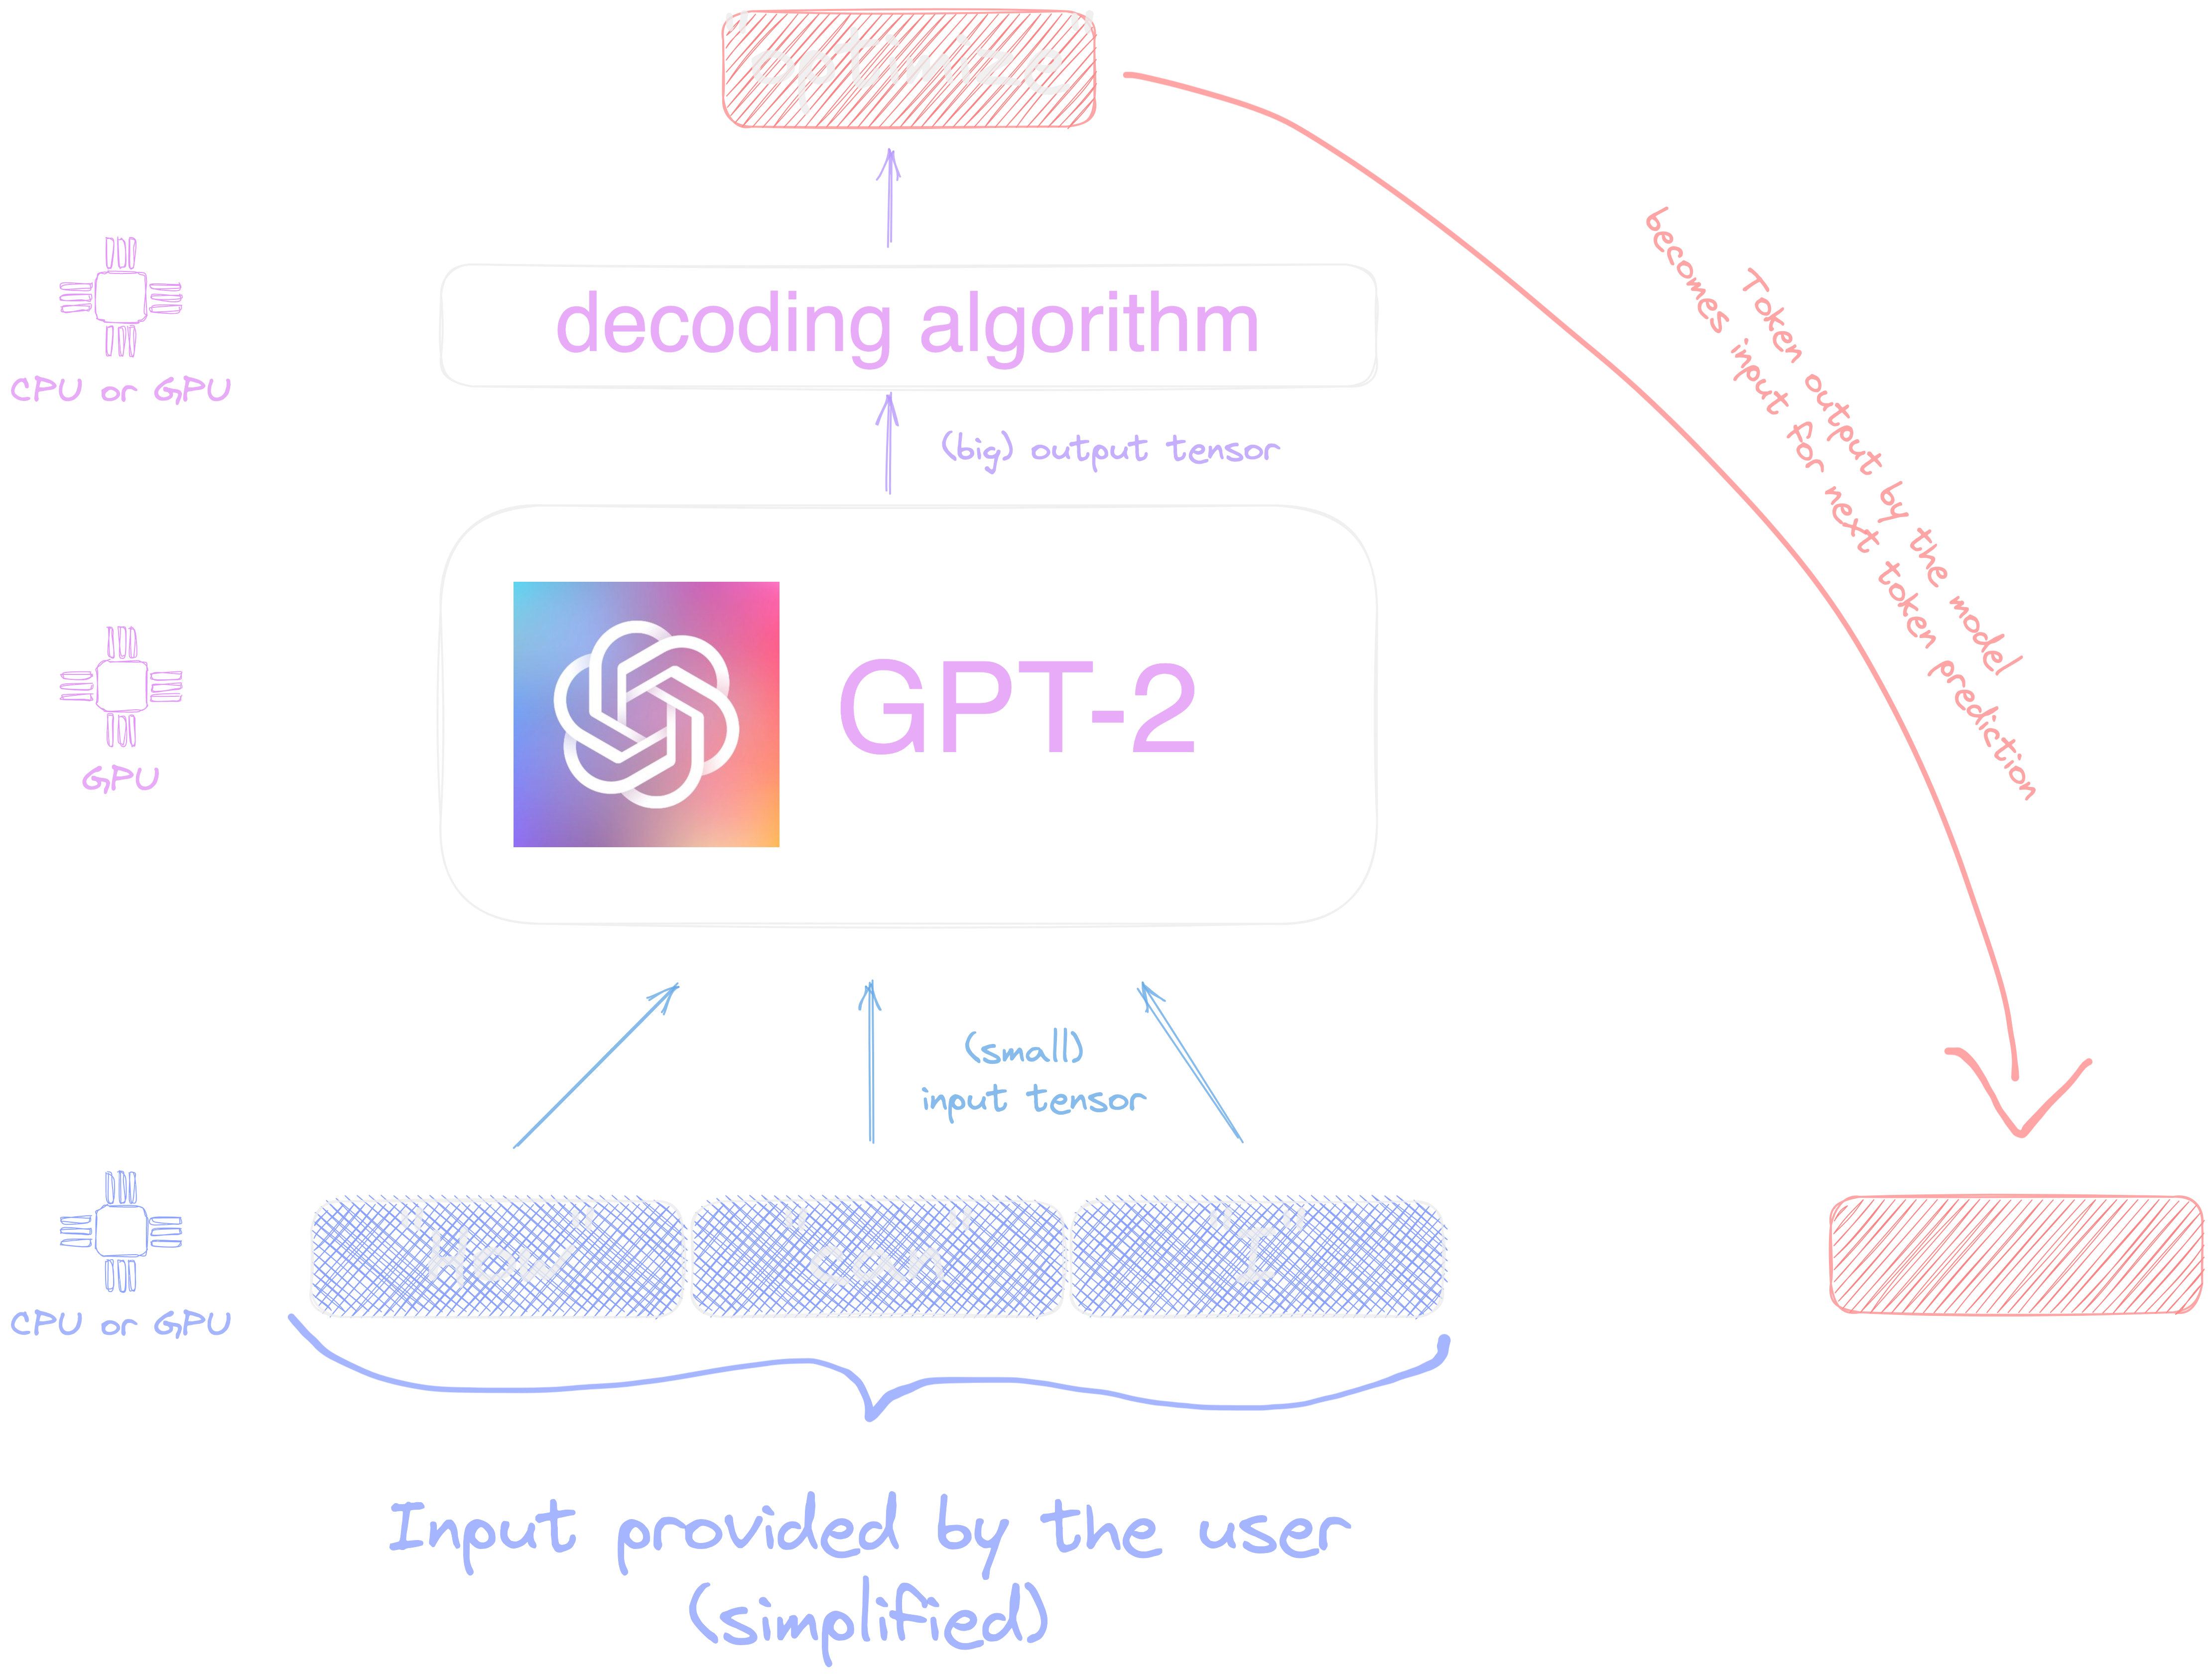

In [1]:
from IPython import display
from base64 import b64decode

base64_data = "iVBORw0KGgoAAAANSUhEUgAAEVkAAA0nCAYAAABqjJ7VAAAAAXNSR0IArs4c6QAAIABJREFUeF7s3AuYHFd95/3/qerbzGgkTc+MLzL4AkQhJDgmzuYNSTY4WbKQYCX7PpDsemCXoEXSDAiCJQWSvOS1gJDAiy6sUdQjKa+BJLLJhTcb25AAD8RONoRAbCAbAih2HBtbki2px9Jc+lp13udUTfVU19RouruqjS7ffp55ursup875nFOn+rF1fkp4IYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACl7CAuoTbRtMQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEhZIVBgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKXtAAhK5d099I4BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEECBkhTGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAApe0ACErl3T30jgEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQIGSFMYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACl7QAISuXdPfSOAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAgZIUxgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKXtAAhK5d099I4BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEECBkhTGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAApe0ACErl3T30jgEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQIGSFMYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACl7QAISuXdPfSOAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAgZIUxgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKXtAAhK5d099I4BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEECBkhTGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQB8F9O7dObnuOktmZpScO6dkaEjJ4KASx7G8y5r3fF5Jtaokl/Pftfb3mfdsVkm9rrx38922lTSbynvPZPzPjYaSfN7yPgf7RPwyLMv8P0HLe3cc1fruX9v/7rrBdn9bcF6wL/Ax35Xyj18qW1rfg/L8a/qvoGxzXvC92RSvrcF3s8+cY7YH5ZrzgnP8uov3Pdimtf/ZbDevoIzwdXzDpXPMPvM9eAVtibYzfFxwTddduk74PN/R32fbpr1aLEt737XW3p9lLX326+pv99uql50TPsYcZ44PXuZ4s81cJyjDXDc4Lrim2eb7BnXwz8lk/G1B/Ux59bq/PSg7OC9ohzk+OMe2l9oXtDWoR3BM0Cbz3RwfvPz9rrctOLfZ9L+b7cF+xzH1Me12vT/zuVbz380+sy2b1VKp+PvzeVMn12tHoaDl3DlXBgfNtV05dcrvuOuuc+Xxx121e3e9VR8+IIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIXFYChKxcVt1NYxFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQOByFNB33pmXctmW8XHLC/Qwfyasw3X990zG9kI8zLv5bsI6KhUT5mEvBnb427NZ/3gT2BG8K2V7IRrmPbrdD+QwZZiy/HPMtYPPZp8fgOGX74eCWN53E1phWZlWmZZJqfCu6x8bPlcpvy3BMa5re5/9Y014h6mjf76/3T/fbPPrbYI3/PoH+4N6RK/VXk//GkrlL8dxRZsRuMQEKl7Qi9aOaN0UpUxyjuO9m21KNRffl7Y7jiOWFexvP88/x98WfDaBMCJNCc4LruG6Jl2o2SorKDPYbtv+NVzXEfPZcUz9mq3vwT6zzbL88s1fLudIs2nOaUom05RazZGxMUe96U3VS6zvaA4CCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg0JEAISsdMXEQAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIXEwCrVCRYjHjBYeYMI1KxZZCISMLC354iPkz4RuNhv/uOP67CdHQOuN9tu2MNBomeMPfn89nvHc/oMN/D382gRsmGMQvw4R2BN/9z34gh//ZDwnxP4v4YSJLx2Ta9vvlLp3vl2Ou4weD+OX53wn8uJiGKnVFAAEEvrsCWpvAlYYo1RCt6967+S5SF9c12+uitb/N7DPfzWezzXx2nIZYVvQ4/xzbbojr+p/9v5r3nsk0pNGoSy7XkHq9LplMXRqNhlQqNbV7tymfFwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQFwFCVvrCSqEIIIAAAggggAACCCCAAAIIIIAAAggggAACl6LAyZMnrxgcHHTXrl17+mJpnxc2UquZYJCM5HImKCQjrpvxwkJMkIj5bN4zGf/dBIiYYBHzOQgaWfpsjvcDQfwgET/Uwz/ODwVxHD/AxA8N8cNN/CASP0Rk5VCR5SEk8YEkpjy/bBNk4geVmGvnLpY+oZ4IIIAAAgggsKrAwmKYix/qYkJf/BAY8z0IevFDYfwgGH97EAIjYgJdzJ8JkamI41Qll6uK61bFsqred9uuSqNhtlXUu941u2qNLqEDtNbWmTNnrh4bG3vqEmoWTUEAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYFUBQlZWJeIABBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgctZQGudKZfLP6W1/j9E5BqlVF0p9U3Hcb48Pj7+8Go2evfuQVmz5nrJZMZE6xeJ1oVWMIgJIvEDQ/zQEP/d32bCToJ9foiIvz8INDHvcef7x+ZXqxf7EUDguyBgFvyLaFHK9a6utXnXi9u0aG3+XLEss9f1vivlbzff/XP97+3vrvfd7Hfd4FhZ3NZ+ninHlO+6S+X7FOFrmbpp7zi/TqZMv7xgu19//5rh/cFxfn3azw++W9ZSG4JuCNoUPsd38MsI2hdcK1yf9mOCdi9d21xvpeuE6xmU6TjB9URMZlRgENfO4NrGM5NR4rpKlFKi9dL/hzWfzbbgz3FMmf5+2/aPNfv8suI/B+WGjwsfH93uf28v23WNzVL9gnPC5QTX8S38OgXtCeocvAfXMO9B2eF94e3tJn69LMsEZSlxHP+z33ZrMZxr6Zhgu1+2GRSLA0PM+f55foiXf/7Stfz9voP/TiBX61bgw4oCC6J1RZQy4SzBX8ULawm2mc+uW/HCWyzrhLjucbFtLY3GWclkZtSOHeUL1ffMmTMvEZH/KCLXa63N78UnLMv6+sjIyGeUUs6FWm/qhQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAWgKErKQlSTkIIIAAAggggAACCCCAAAIIIIAAAggggAACl5zA2bNni81m8zdF5OWLASjhNpqFt19yHGd6fHz8UbnzzheJ49wgSj1PRK4Vrc37daLUyCUHQ4MuTgF/gbgJ1jChG/6f/91ZDM8w70v7RMxiaxPa4YhlLZ1nPptACb+MpXP9UBAT4OGX6YdxmDL848Nl+Meack3YxtIxtr1UH8dxxHwPzvfDQfxjg3ObTf8YU2/HMSEX/r7gGBM4Ytv+d7M/aLNpkznHvJuF8eY92Ge2++X5x5hr5HLaezffTTvMu7lureZf/9w5R+3eXb84Bwa1RgABfeedeSmXbSkWM5LJ2LKwYHvBLIVCRup1WyzLlkbDFts22zPedxN+ZgLRzOelMDQT7LL03XX948y7ZfmBacE2rf1tJmTNfDbbTfntwWv+vnCZ5lrBNnOuKcN8j26PlmOOXSonR6/3WUDrp0XkKVHqKe/dBLFo/W9q165/7vOVY4s/c+bMWhF5rVLqv2qtzefwyzy/nhSRI0qpLxeLxbPfjTpyTQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEngsBQlaeC2WugQACCCCAAAIIIIAAAggggAACCCCAAAIIIHDRCZTL5R/QWu8WkeujlVdaW7rRGFSOM2A3Gpncv/5rJf+P/3hWmUAKXheSQCUUuNEUpfwgDT88pLkYEOIHbShlvpvwDBMOYv5WOt7fb8rww0n8z+bddf0yTQiHeTffg/JMOIhfrtnvv5vwj1qt2QoBMd8dp9mqjx/kYcrx/7JZ/93UNQgJ8UNGmlKvOzI8bMpz1I4dlQupE6gLAgggcLkI6I9+tCCPP27J+LgljuP/mbAW1/XfTYBLva68d/M9n7ekUrG8cJVmU3nvlqUWg1ssETFlmO25xRCVjNi2CVXx//wglaz37oe/+NuCz8Ex4Xc/lMX8ZcWyBkTE/BW8735ZJoAlK0qZz2Yfr3QF5kXky6LUl6VW+1v1rncdT7f45aUtBqzsFJHXdHCtBy3L+sjIyMi/dXAshyCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggcNEJELJy0XUZFUYAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDot8AzzzzzItu2PyIi4+ZaynHyqtkclGZzQLluQTtOPlwH5bo6c/r03OBXv3pC1WomdINXEgGt616QiB9i4geWmNCTcAiKHzTih6IsBZ40RKQmIubdHL/0rnVDLKuxGFBiyjb7/G0mDMV8z2RMKIr/udEw3xvSbDa9d7PdfM5mzfEN7xjLMnXwzyuXm2r37oUkzeZcBBBA4HIW0Lt3m3CPjBQKWVmzJiMLC1kvDGRwMCuum5FGIyuZzFLAiAkBaTb9bSYUxBxrtoUDRcx31zXBJTlRyg8WMe/RcJIgmMQPFrG9oBFznLmuZfkhJuEwE7+Mwcu5v2h7SgJaPyFK/ZUo9efqHe94IqVSW8WcPHnyimw2+14R+eFOy9Zan9Ba7xwfHz/W6TkchwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAxSJAyMrF0lPUEwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQOA5EThz5sz3q3r9gNL6OtVoDIrjDGqtzYLrVV+5p556dvDhh0+I1nHHfku0XjmEQ2slljUgWhdExP9TyoS5DKx6YQ648AS0rnohLiaMxQS0mNAXpZZCX0w4i//dhMT4YTEmSMa8m/AYyzLvTe/dhM34xwTBM374jNlv/mzbBNH438PHh79nMq7UauZYU64j2awrjmPON2WZ7doLkQn2m/JNiIzj+NfK5RypVpsyMOCIZbnSbDomWEauu85Vb3qTaSsvBC4rAX3nnXkpl20ZH7fEcSzJZGxxXUsqFdv7rLUlluW/i/ifq1VLbLt9W3CcUuY5Y4l5bzRMef7nYFuz6Zdjtplzgn1x20x9/Oso77jguznW//PravYpZbU+m31+fcy7f+32a/nb2v+W6hi0NXydcP2C7eaapnz/GccLgX4KVBZD2vznsP/M9T+bZ655zgXb/Gdt9y//XnyRiAx1f/KyM74uWt8v5859Jo3gtscee6wwPDy8Wyn1yh7q9kw2m/2va9euPdPDuZyCAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMAFK0DIygXbNVQMAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAICpw6tSpDSJylWVZo0qpUa3147Ztn1y/fv1jSbT0hz40JLb90yLyyvoNN/zMwo03XtdLeVaz6Qx+8YvfzMzMPCxaf1Ms61FxnEfVrl3f6qW84By9e3dOisWC1GoFyWYL4jgFcV0/hCWTGZB6vSC2bb4XvJAWy1r6bL4H2/33jBfc4i9uz4pIXrTOiVI5ERlMUk/ORcAT0Lq+GAjjh8eYBez+4nUT2LL02WwL7/c/m3NMYIx516K9xKLgs/9uQl7MdvNnjjX7/c+6dZ7ZHpwb7AvKbi/TPyeT8d/NMf7LrwOvzgWCUA8/MMoEdygv5MN8Vsr/7AduKG+fH+SxdIwfCGK+Lz/eP87fbv788A//XBPYES0/uJZIcKwJ9FgKFFkKP/G3h4NE/HCRIDiEMJDORwBHXr4C0SATExjmh5iEA01MsJi/vS4i5jlRb/tsgslEal44mXm3rIa4rn+cebfthjQaNclkGtJs1sWy/L9Mpi61Wl1yuboMD9e/W8Ff+sMfvlK0fpG47veKbb9EXPcFotS1Kw0LbduWs359XmezlrNmTd6qVBrmz56fb6hqtSIifylKPSS2/Tfq7W8/18vwmp2dHW80Gn+stR7u5Xyt9UfHxsZ+t5dzOQcBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgQtVgJCVC7VnqBcCCCCAAAIIIIAAAggggAACCCCAAAIIIIBAS0Brrcrl8o+KyNtEZGOE5hml1P0jIyMlZUIWOnzp3bsHZe3anxSRnxWlfjw4rX799esWbrzRhLms+lImFMK2K9q2q65tV8W8K/Xfx8fH/2HVky/gA/RHP1qQ2VkTupKXZtMEsOSlXs9KPm++ZxcDWvJi2zlx3dxiSIsf1mL+bHspwEXEL8eEuDhOTizLD3Rx3YwX+KKUCXoJ/kwAjCnfvBP4cgGPkdSrZoIt/JCV9F4miMiyqukVaKJXvHAjExSQbl1TrSSFIYDAd1VA66oXAKV1ENxkAqVMMJQfJBUEPgWfTQCViAl6chZDpILzlt5NOIkJLDHBJSaEJPge3u4HmpiAEj/kxHX9c8xnP9zEP8/8Oc7S9mazuRhcsrTNsvzPtVpTzGfbNsc0pVz2ylS7d5ugFF6rCHi/p5599sWi9UtE6xeLZX2viLzQHRzMVn7wB69sjo4OaRM4FXplz5yZG/jqV09aCwumL/2X1l8Rkb+RbPYB9ba3He8UPmnIioj8xejo6G92ej2OQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEDgYhAgZOVi6CXqiAACCCCAAAIIIIAAAggggAACCCCAAAIIXOYCp0+f/ndKqf8hfmBH3Kuptb53bGzst1ej0vv3/5Bo/Qui1Gvijq3fcMO6hZe+NDZkRdl2xc1kFrRtV0ygitj20gLYxcJc153sJWSlMjl5S8FxjqsjR46t1oZO95sytdZXDx46dE+n56x2nN6yZWPNsm7NNxpH1F13za52fCf79ebNw41c7o6s4xyOa7+3SPmZZ7KSzWbFcTJeQIttZ8WyTCBLthXWEoS2mCCYTCbjnD79S2JZDXvdus97x1mWOdcPdAm+m3PMNvPdhLtovRT4EpQXCoPRtdr3KxMAk89/azEcxg+G8cs04TLdvxxnnW42x1U2+2RqoSCuW9CNxrXKtk9LJlPuvlIxZ5gym82rTUCAyuUeT6VMs3a8Xr9OtM6rXO4xL8AkjVejcbV2nPUqmz0utn02jSLF9FOjsUEs66zK5Tpe5J7KtSnkuytgQoDMK81wHVOmmW/SDwIaFMtaSBWsH+FCrusHaS2va2VZkIgfFGLmhkbbvmjYSK22VjebV6jBwYcXg0T8UBHLarQFjoS/mzLDASTRwJFGI988ffpnMwMDfyajo8+K4zS8wJFczgSVNNTb317rxbq6bdsOx7IeHCqVHurl/LhzTJlme+HQoX1plTn/lrdsyrruK7L1+ntSe+ab3xGZzE5H5HBa7Te/Iyq53CFL5KHC9PTetNpfn5zc0xTZMFCvb0ur/TN/9Vfr1caNn9BKbZRGY1A5zqAO5pjFituzs9U1f//331ELCybUpv2l9T+JyKcln/+0eutb587XVkJW0hoJlIMAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBwKQkQsnIp9SZtQQABBBBAAAEEEEAAAQQQQAABBBBAAAEELkGBM2fOrNVaH1RKvXiV5s2LyPtHR0c/Gz1O79tXFK1vFaX+kyh17fnKaQtZMUEqmcy8a9sLKptd0Eq5qxFblrVlZGTkq6sdF95vFjHbrnuHFjk2MD090c25Kx0blGn25+v1n0pjcbDevn1Dtdk8qkSGtciugenpB5LWdTG0ZY8oZYJt7klrcXRtctJ4bhKRE4XpafOe+FWbmprQWnuL2Fcz1bt3D0qxmPGCYBYWsl4oTC6XkXrdD4VZDG6plcu3qEpli7Issdau3WuvXfvo4j4T6mCJ69peOIxStjiO5b3758bvt21b6vWrnPn512rXLahc7iF7ePhr4i/gtkTEvJtgGP+72W7CZUx5rrtUvmWZ6ywd77rDbq12ozLn2vacyuX+ZbEOA4lgF8NQTHiFyuUeTSXEIijTZGKY4JY0Qixcd9ALgzGvbPZJZdvJA4a0zupG40oTApNKeaZuWtu60XieKFVV2ezTifomfLIxdd2hxSAcJ5VyF0NrvMCetEJBTD+Z9psgnLTavxhY5IUL5fOPtLVd66qY54LWjvfuuo5YlnlOmG0mHMH/LNK+33Fst1r9EXHdtdbg4GfMPbV4jrH1jzfluK7/2S/P36b10udgn9nvOI4zN/cqMUFQhcLnrLVrv+ydE5xr3oO62rYrzaYj5j3YZlm67fhm05Vs1m2eOvWjulJ5k9j2w9krr9wntq29MoP2ht/9Z2T7PnMds93U3bzbtlt95JEbVaNxp9Z6dmB6+hVpjCfzLKna9iHzfHKU2pZGeEcouGOjKHW4UCodTqOuwfNJizw8MD29NY0yW898peYKpdItqZZpnnmOM5FGCJwxreZy95p+Ukrty5dKd6dR14XJybstEdNPDxZKpZ1plNn6HZGiqQlTKZfL7xCR29rq2GwWLMcZlHp9SMy7iJU9fXpu6O/+7knR2txzK70+K657v9q584txB5iQlXq9/qciMtSjyZ+Pjo6+r8dzOQ0BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgQtSgJCVC7JbqBQCCCCAAAIIIIAAAggggAACCCCAAAIIIIBAIFAul1+vtb69Q5EnXNd94/j4uBeAoPfu/TGxrJ8XkVd2eL5Uvv/7n6r9wA98n5vNzotldRsm4CqlNheLxX/q9HpeyIhte4uMHct6z9DBg/d1eu5Kx81PTd1sa33I7FeWdX/+4MHdScsMLzZPKwwmvCjelFmo17elEQbTFjCT0sLwcJmp9dNiuE6q/RQKGkhrAX9lctIs2L9jMVxn1X7SH/1oQU6ftiWftyWTsWVhwX/3A2BMaIwtjYZdP3lyi7juraK1UoXCdPaqq/5WHEd5+817JmNCZsx35QW+mPdGw/K2+y8TEuNvN++uq5zTp1/vOs6PaK2VNTT0R5l16x5qK0NrU545b6lMcw1TVnS7s3j712pXNubm3mCJ5CWX+4o9PPy5pPeTOE6hcfbsGyytr5BM5n/b69Ylvu9NnZrPPvsG5TjXaqWeyRSLv5e4nmZeOnfuVmk0btRK1TLr1v2umPCpuJdSWkxQhwkGMZ/9YAATrmG2aS9gY3F789y5l+lK5XXe2F+zZjozNPSIty/uXFOOCfzI5ZbKNOWZv2zWBJH41z179prG7Ow7xXUHVS73Z5mxsT/zrm9CQUz4ifkzdXAcRwoFPxDFfDbbgiAQ83lgwJFGww8gOXlyoHL27J2W47xIizyURiBGW3CHyIl8vT6RxrwXDoTI2/aEOnDgeNL+D897aQZrBWEoaQVr9eP5ZOzCYV2p91OKwSXhZ35azycz7yuRPak+nzZvHq7kcodMGEr9KZSJAAAgAElEQVRavyPa+kmpuX6M/bRCe0xdZ2Zmrncc52NKqTUr3Z/KPBPr9RFVrY4O/sM/nMg+9ZQJYTr/S+tTotSnxXHuVbt2PR4cfO7cudFGo2GeL7nViojbr7X++NjY2Ed6OZdzEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBC4UAUIWblQe4Z6IYAAAggggAACCCCAAAIIIIAAAggggAACCHgC5XL5Tq31j3XB8cbi7//+laL1lCh1QwfnmcX2XxalPiPnzn2+/La3bRKRX+3gvGWHaK2/rZR61+jo6JOdnK+3b99QbTaPmvCK1MJQQiEbotSDhVJpZyd1We2YhcnJu83CaElpEXO/Alb6EloTDkNRal++VPJCcZK8Iu1/OO3whrRCa8IhC5JiIEQkvCGV9ocCEUzX3FOYnt6bpI/MueF+Su0ejQQNpBUu1Bay0WxuVUeOHEvSfhNcUc/ldmgRMydKWiEbbWNKqcOFUulwkno+F/2U1thvC1gxc2kK/WTaHx77aQVCtIV1XSTzXlrPJ2NanZraKlpv9crsRz+lFKrWlzmqT78j6pOTe1yRW9I07VcQUBB+JynPUc4ttzxa+5mfuamTOc+ErWSeeuoba77whaISuaqTcxaP+aI4zrTateufZ2dnx+v1+qe8ILHuX45SanexWPyL7k/lDAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEELlwBQlYu3L6hZggggAACCCCAAAIIIIAAAggggAACCCCAwGUvoLVW5XL590TkBzvBUPX6mtxTTzlDf/M3lVWP1/q4aP3/ST5/n9q+/UxwfLlcntBa71j1/JgDtNafHxsbe1cn54YX26cViNGv4JLwAv40ghbMomjLdXeYcBlvsXWttknddddsJ27nO6YfoTXhBdyphWyEF7CnFFzSj/CGVsiAQU8xaKAyOXmLEtnj9WVKoT196adIGMrA9PRE4jEaKjOttps69SNgpZLLHfKClUTESSkQIhKwkkoIVL/mvbZgqRRCNtru0RRDa9oCVlLqp74Ed4THfkrznhmb1ampQ6L1zeZzGs8nU04/gjvC82lqz5LNm4dr2exRUWqD+R2RyhwVej6l9dukbY5Kcz6ZmrrZ1vrQ4rycTrBWKPwuraA6c+8H/VT9xV885tx0kzevdvg6JSL/ufjxj/+iKDXVOkdrWxxnRCxrTiyrGluW1n9bvf76P1l4xSv2m6dth9cLH1YtFos/rZSq93AupyCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggcMEK9PKPaS7YxlAxBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgUtL4NSpUxsty3qniNx0vpYp182ohYWrpdlcY1WrjbWf+9wjovXyU7Q2C0U/L677P9WuXQ/FlXn69OlfVkpt71Hy0Ojo6JFOzm0tDE8pZCK8KD7N8Ibq5OROEbnNtCmNheGRkIW5fArhBaZuz0FozcMD09NbO+nb8x2zrJ9SaH80vCHvOBPqyJFjSeoaDm5IM2Clrf1exoraly+V7k5S10ggwrFCvb4taWhPP8aTaWPYNY1+ipaZRhhKdDyl0UfePdqH8IbIeDqRr9cnkvZ91DSN4I5+mYbHUz/6KY05Pzo/pzmftM1TIumEbGzZsrFm296clJZpZI5K51kSDWxKIaxs2fMphTKNY19CsCLzSSoBM30KAgoCm7RS/1J5//u/qrX+pW6eea7rbh0fH39Y79t3jSj1myLyw7pef5647rBY1lmVyx1fqTx3aCg7++pXX+EODDytLavZzXVF5KvFYnGrUirmB3WXJXE4AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIXkAAhKxdQZ1AVBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgXaBcrn8UhF5n9b6eSvZWLVaUVUq41rEMsdYtVpj4OtfP5E9eXK+dY7rmsCJP5dC4VPqrW+dW6ms73znOwODg4O/LiI/10NfNFzXfeP4+Piq4RbhheGpLOAPLTY29U4rvCHt8Ip+BayYNrdM+xBao0XSCe6I9FMafW/a3grsEZE0Qjb6FrCyffuGarN5VIkMm3prkcRhA21jSiS1kI365OQeV+QWLxAipaCBsGsa/WQMw+1Po8xlYSCWdX/+4MHdPcyHbaf0IwRKh8eT6acUAova5hLzRanDhVLpcJL298u0LWAlrX4KhUykNe8Zu9b9lNIc5c17oQAwU9dUQjZCYyqtgJl+zVFpBzb1IwDM9FNlcvIWJbJncc5P51nah4CZ6L2f1u+ott8mV1zx38pvf/t/F5HXdDOnKKV+r1gsTgfnNH/91//QWrNmk9i2UtnsE2JZ1ZXKq19//bqFG2/coERcXSic1vl8WXcYmqK1/sjY2NjHu6krxyKAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggcDEIELJyMfQSdUQAAQQQQAABBBBAAAEEEEAAAQQQQAABBC5TgXK5fKPW2iwszS0jaDYLdqVytXacQnTfwNe+djz/xBNnRetvitYltXPnFzshLJfL67TWnxCR8U6OjxxTLRaLP62Uqp/v3PDCcBG5pzA9vbeHa7VOaVsYneIC9vDCaC9oImGAQb+COwxEdWpqq2i91Xx2lNo2VCo9lJppSiEb0X5KI7zBtDHimjgQoq08Pwhl18D09ANJPM250aAJb0zZ9oQ6cOB4r2X3K7SnbVF8wnEftC3imvi+N+VGwhsSl9mvMJDo2E8jvCBa1zTue28uCQV3iFIPFkqlnb2Oz7hxn0awUN/6qU8BK30f+yk8n6J9lUY/LbtHU6pn9JmnlNqXL5XuTjRO+xQA1o97f7H9h0Trm9N65vfD1Hs+T01NaK13eONLZFehVPrbcrn8/4jIv++mv5RSny0Wi78RfuZbmUw1e+21xyWbfcH5ylq46aar6tdeOxIcoyyr7g4MnNTZ7FIQ4QoFWJa1Y2Rk5K+7qSvHIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBwMQgQsnIx9BJ1RAABBBBAAAEEEEAAAQQQQAABBBBAAAEELlOBxZCVQyKSDRNYtdqIVCpXrcRS+Na3/nfh2LHfULff/oVu6M6ePVtsNpufFpFMN+ctHjtfLBZfqZRqrHRuOBRBixwbmJ6e6OE6rVOWBVekENpiCk87uKWfASuRMJjEISN6+/YN1WbzqBIZTiNcxvPcvHm4msvd65UpIsqy7s8fPLg7Sd+bc8OuScs0dWzkcne4IrcE9XIs6z1DBw/el7Se5vyFycm7LZGNQVlJgwHmp6ZutrU2c4P36kfIRhphIKZu4fs+aT8F7U27zOhcksb81I+5JLifKrncoWA8pTVOo/NzoV7fpu66a7bX8R9n2o8ykz5HgvZVp6b84IoUApBCZbYCsPoSXJJisFh9cnKPmf/M2E/aT959H52jUppP+33vp3U/LXvupRAGY1wjQUiJn/mmzPDviNTm6Pb+90KwtNbZcrm8R0R+vMt55R9GR0cnI3OUF4Cm9+83IS7Lf0tqfVyUOjX/4z9+a2N0dE30ejqbfVYPDZ04Xz2UUu8oFov/q8u6cjgCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAhe8ACErF3wXUUEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQODyFZiZmflB13VNkEIr9MRaWLha6vX1K6i4MjBwSmez7y6Oj9/drdxiyMpnTA5Gt+cqpWZHRkZ+RinVjDs3vDjWW8Req21KcwF/WguDowujJWFwSz8DVtrCYJR6sFAq7ey238LHR0MR0gju6EfQgqlz2DVpIEZMWI+ktdA+WlfzPWnYQtohQMEYCN+jabU/7eAOU9dweENSS68/tmzZWLHt3UFoSVohE22BRT6yFzSQ5j2aRpme6Vvessl23Tu8upn5udncqo4cOdZrXZfdU30oM61+artHU6hn3P0kIify9fpEkmdeMFZrtt16tqf13GvNpym1PzpHpTVOTblB+9Po/+g4TcszZvwnfj5H79M05r5gTFVt+5AJQUvDNKbMhwemp7d627XOzszM7Nda/2g3c4tS6hv5d7/7T4M5Kvp80vv2/UdR6reXlan1X8y87nX/TjWbLxetl4cHWlZNDw09qW27HlcfrfVbx8bG/r6bunIsAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIXg0DX/0j8YmgUdUQAAQQQQAABBBBAAAEEEEAAAQQQQAABBBC4NARmZmZuWgxZscV1bWth4XnSbA7Gti6TmdWDgye1ZTWVUvuKxWLXISunTp36IcuyDveip5R6cmRk5LVKKSd6fmVy8hYlsifYnjS8o1/BHXHlDkxPT/TiERfcoUV2DUxPP9BLedFzTPm1bPaoKLUhjYXRywJWLOs9QwcP3pekrrFBC7Y9oQ4cOJ6k3NrU1ITWesdiGYnCC+L6SZQ6XCiVeroPou2qTk6a4JvbWttNiEECg2h4QVqhAOGQDTN/5EulruePaNvTDlYy5Yfbn8q437JlYxAw4NU/hQAor56bNw9XcrlDoeCWVtBAr2O/X4EQ4dAaU7e05+c+lZnovg/3QfgeTdr2oNy2Z16fgkvSGP+mvm3hSkptGyqVHup1jEbvUe+7SOKxv6zchPNo3D0qKQSVBW71yck9rsgtaTyjgjLDATNpzlPB74g0wpWWuUbmUxOyUi6XPyIiP9zNGFNnzswO7ts37E/R8c8nvW/fS0Wp3xWR1m9kbdvWuVe/eo0zMjJv1WpjUqsVo9dVIq47OPiUzuXmovssy9oyMjLy1W7qyrEIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCFwMAoSsXAy9RB0RQAABBBBAAAEEEEAAAQQQQAABBBBAAIHLVGBmZuZlXsiK4+St+fnrxHWzUQplWQ2nUDgpoQWiSqm9xWLxnm7ZyuXyNq31lm7PWzz+3mKx+D6llA6fHw2FcBKGd8QGd9Rqm9Rdd832WO/WadWpqUOi9c3ehgRhC3HBHUnbHW3bwuTk3V6AQwoL+GPqe09henpvEs84g7zjTKgjR44lKXdZcEezubXXMuPqmFZoiWljW10XG51kHETvpbRCAcLlptX+trqmMEYNX6T9iUM2Yjzn8gnGUzCu+xEC1Y8yY0xXDDDo9J7tx9wXO+en0E/RezTJvXm+Z14a4Vp6+/YN1WbzqBLxgibMK5X5dGrqZlvrQ6a8NNq/7J4SSXyfeuM0ElqUNAynX/eTqWttcvIOLbIpzX6K9n/S9gd1C//mSaP/TbnhgJloPRdDVkoiclOnc4o0GoXMI4+M5v/wD59a7fmk9+17kYiURKkRU37zyisHKy972QZ3YKDuDA8/oRqNQWth4RqtdUYpJVov/Vx1Bwe/E/4dLSKP2rb9a+vXr3+s47pyIAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACF4kAISsXSUdRTQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4HIU8EJWHOeINTv7QnHd3DID255z1qx5Sinlhvf1ErJiFvHO/MqvfFAXi9/Xo/W7R0dH/zJ8bnTB9WoLZFe7bj8X20cXRve6iLkfIQNRl3Bd01gYHV4UnbSPTF37ZRANLem1j1aqYxptD/oqLmAlSSiKMa1ls0dFqQ1e/UWOFer1bUnDhfoesNKP8IYUQlueq4CVNEKQTH9H5qd0giu2bNlYte1DQXBH0vHfj9Cifs754XtUKbUvXyrdvdozaLX9y8JQlDpcKJUOr3be+fbHuqZQ37Tv/Zi2pxJaZGzCYSBJ+6qfQW21qakJrfWOVn/2o/9TKDM6pyS994P2Vicnd4rIbeZ7XD91HbLSaBSsZ5+91nrmmXrhE584kD94cPdq95L+4Ac3SDZ7WJS6qn7ttWsXbrrpGu+cbPasOzR0XFzXts+efZG47qBYVl0Hv5+V0l7QSjY7v1j/LxWLxe2rXY/9CCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghcjAKErFyMvUadEUAAAQQQQAABBBBAAAEEEEAAAQQQQACBy0Tg1KlTP5Sdn/9L7ThD0SbrQuGULhROx1F0G7ISLLauT0y8tPl93/cdsSynW2LLst48MjLyteC8mBCDBwulklmA2/NrYXLybktkY1BAGgEjpqzq1NRW0XprUG6vi7iXtTmlgIkwWCS8457C9PTenkEj4Q1pBHf0I2jBtG9+aupmW+tDafR9v+q4wtg/ISJXe2EbtdqmXkJR+hUKEA5uMX0/MD09kWQsmXOjQQu93kvherS1vx8BKyndp7HhQkptGyqVHkri2hawkkL7vX5KObQnru1a5OGB6enWvNqtQb/Cmrz2b9mysWbbXqhKWgET0fqmUW6cQZKwptYcFer/pP0UjKdKLneoH8/n8PhPwzQc2JJWCJL3jHrLWzbZrntHyzjh+A/KCbc/jb6K1jWtub+t/UrF/t5bDFk5IiI/sNp8oBwnq8rlG7Tr2tbs7NPrDh36wU6fn/rOO8el2SzVv+d7blp4yUuubvVJPn9aGo2MVCrrLdu2dCaj/cyypZc7OPiE5HLzWutPjo2N/c5q9WQ/AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIXowAhKxdjr1FnBBBAAAEEEEAAAQQQQAABBBBAAAEEEEDgMhGo/emf/r8LL3vZf4k21x0cfFJyudmVGJRS+4vF4tFOmIJgED0wsL72xjeud5///DOdnBc55hGl1DuLxeITZnvaC/hNmW1BA2ZhvFL78qWSt0g+ySu6MLrXRdzPScBKKGgkjcXWkcXbxwr1+rZOFzGvZB7tpzTqGRPYc7hQKh3upd9XCINIpe3e2N+yZWPVtg8pkWGzeF0thgJpkV0D09MPdFvn2ICVZnOrOnLkWLdlhY8Pl5tGuE5w34eDFnq9l1aqp9meNFipn/dpW3hDCnWNm/ecFEJb0g7t6cc91e+AleAeTWOMxo39tO6p6HwqIify9fpEknk67Xt/hSCYnufo8P1fm5qa0Frv8IxFEs/TMc+nnubl6Nwb84zqOVQrXHZbAFyCoK62OTUUMOSFzNj2hDpw4Hii50nkubfSb4mOQ1ZMsMrMzLW62SyoTKbqrlv3+dErr/ylbuqo9+9fP3/zzV9sXHPNdcF5JrhFXO/lyNq1x8W2RS0sbIiU6+q1ax8V2/71YrH4F91ck2MRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEELhYBAhZuVh6inoigAACCCCAAAIIIIAAAggggAACCCCAAAKXmYDet++XGldcsXv+5S9fWiCqlHYGBkzAytz5ODoNWQkvDG6+8IVram94w4zkctkeqP9qdHT0V815sQv4Ey7iXRawYln35w8e3N1DPdtOmQ+Flnh173ERtynH0nqPCdYILpA0DCLaNr19+4Zqs3nUu0YKi63bTE15KQR3xCxgT7woPrp4PUkoQj/CIML9FAkveFhpfZUoZRZw31OYnt7by3itT07ucUVuCc7tNawleu1WIEgKYynuvjf30sD09EQvbW61dfPm4XBoS9J7Ki5gRZRKJwxicvIOLbIpqHuScRqUEb2fkrY/dn4WkbzjTCQJ7YmOUW9+SjCf9DO0IzyP9jrfx43pZfNpwmeeuUZMwErivmorN4WAjRX66sFCqbQzyb1vzm0LQEs4puI807ifvHsq/GxebHQaYUjRALg0yozWNY3niRkD1Vzu3tZvk/Pc+x2FrIQDVizLcUdHH9VK/fPY2NjruxlTx48fHxxw3d+Xev3VorWyXDejtc54fZbLPe0OD3vBMqpeXxcNWlFKLSx84xvXbdi0aaGba3IsAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIXiwAhKxdLT1FPBBBAAAEEEEAAAQQQQAABBBBAAAEEEEDgMhLQH/rQFZLJ/GljfHxs4eUvv1aLKKWUdoeGntSZzHkDVgxTJyEr0cCBxk/+5LH6q161sUfmw6Ojo4djA1YSLLY3dYkL7kga3mDKXRa40OOC8+hCaM8/pRCYoC+irklDEaJ1TlpeXD8lDVrw+mjz5uFaNnt0MajEC8Hpte+f44CVY7bIcROOkqTO/QjZaOurFIILgjEaDtpIK7yiFQTjX6TnoJrY+z3F+7Qfc1RMwEai9sf1k9mWNGgiLggkaRjEwuTk3ZZI61mU1nwaCUFKHAAVmEYNUplPp6YmtNY7ws9jpdS+fKl0d4/PaO+06uSkCT+5zXxOo57Rvkrr3o8+n5OGgfTrfupXIFDM75PEYVAxdU1lTgmPgdX6aTFkpSQiN600jlW5fJ00GoPKBKysX/+EZLNVrfW3uw1ZOXXq1LBlWZ+1Go1RNTd3rbhuECDoSCZTdYeH/1VbVtPUw6rX18vCwtVBnTJnz1YGH3jg/faOHfuT3G+ciwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAhSpAyMqF2jPUCwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQuIwF9N69B8WyfqQxPj5oQlaU62adbLash4ef6oRltZCVuICR6m/8xlFncHBbJ+VHjnFd133D2LvedaKSyx0KL45PewF/agu4N28eruZy9yqR4aAtvSw4fy4CVkz9wgEWSU2jdU5anqlfXNDCaoutVxtn0QXhSfp+hYXwc3nbnlAHDhxfrS6d7A8ZnHAs67DtunckCZqJmqYVNJF2yMKy/k8puCXc/qRtXzbfmUor9WChVDKBE4leMWP/RL5en1B33TXba8G1aMBGn+qa1DU2YMWy3jN08OB9Pbd9cvIOLbIpOD9pHYNy2uaAHgO14trUj/m0X8+VcLl9mfdTuvf19u0bqs3m0dbzWalEASP9mkvNeIgLmek1CCw8Vtt+n/Th/tciDw9MT2/t9T4NzovYrhrashiyclBEXhZ3bXXu3NVSqaw3+3Sx+JgJWPE+9xCycvLkySuy2eynVaWyzpqfv1aUyigR17XtunftTGbBXbPm8aAe1sLClVKvF833wre//Uzh298+I1q/Re3Y8eWkTpyPAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMCFJkDIyoXWI9QHAQQQQAABBBBAAAEEEEAAAQQQQAABBBC4zAX03r0/L5b1fxuGxtjY4MKP/di10mhktWXNuaOjj3XCo7X+H2NjY38Qd2xc4ICyrP1z73vf94rIz3VSfvgYpdSs/bGPvTZ77NiBcMCKUmpfvlS6u9vyguOXLeBPaWF8XOBGLwvO+7UQPuoVDsVIGjgQrXPSPjJ1DdcvqHvScpf1UYLF+ysGrDSbW9WRI8d6HZ/h81pjVak5rfVuEbnDBAT06rBsbKW0yD7tkIW4/neU2jZUKj2UxDV87ycNA4ib75IE9sT2+9LAn8snHFfRvu9XXZO6xgWsJJ2fomWm1XbTPeF7NGkfBd0d8wxYNWRitftifmrqZlvrQ+Hj0nCIlJu4nv0I1jJtjpn7E4UhRZ9PaVj2+zdKJLglcWiTN09PTW0Vrf1QFfM8rdU2JQmC8u6pUBhUp/PJYsjKR0Tkh6P3QjhgRdauPa4HBs6GjnlkdHT0v6x2/4T3l8vlTbKwsE/OndtgtluZjC2ZjKO1XjpsYOBpN58veyxaK2tu7gbtOPmhL3/5iezJk/Oi9dNqx47XdHNdjkUAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4GIQIGTlYugl6ogAAggggAACCCCAAAIIIIAAAggggAACCFwmAvrDH75WXPduUapgmtwcHx+Y/4mfuMIZGDghluV4fx28tNYfGRsb+3j00JUCB2bf+96ttm2bha8v7aD46CFfGHj3u59vaf09wY7Ei+1Di3e9MhOEbEQrW52aOiRa35ykrs9VwEr4OkkXh0cX7yftI+PXL4f65OQeV+SWoI/yjjPRayBKtKw0x1LUwNSzYtu7vbChHoNR+hWy0Y+AlWhdewkrit6fkYCVY4V6fVuvYQB9DViJzlEmIEJk18D09AM9zKHeKTHhOqmEIcTcp4mCG1YI2Hh4YHraD3Ho4fWcBKyISBohQKZ50bHVacjE+Wjixmsa81VbuT3OS+F6x/W/KHW4UCod7qHr204JB4wkfua95S2bbNe9I3SBROM+XNG20JLFHUnvf1NMm21Kv3sqk5O3KJE9Qf3TuAciZXbsakJWZmZm9mutfzTsqSqVdUEYSkzAijn00dHR0f/czfh69ktfOuyuXft67yekZTnu2rVP2dXqBq11plWOUlqvWfOYtu2ad5zj5DOnTl0z8JWvHM/MzFS947Teo3bs+EQ31+ZYBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQudAFCVi70HqJ+CCCAAAIIIIAAAggggAACCCCAAAIIIIDAZSSg9+69Uyzrx4ImN8fGrNlXvUpr29bdMGitPz42NmZCU1qvSGDHwyLyPUpk2Cy4rf7Wb/2LiHxKRAa6uY45NveZz/xL9q//uhWwknSxeVxwRxqLl01d4xbyD0xPT3TT5n4Fi0TrYBbG12z7bm+7WWxt2xPqwIHj3dQ1OLYfgQAr9NOxbj2j7Yn2UZLgjrgwgDQWmAd1jgaX2K67UURuE5GOF52H2x9dDO/1e622qTZjNVQAACAASURBVNeQkRX6/57C9PTeXsbRSvOJN0Qt6/78wYO7k5TbNqYStn3FwIoE91FcvwfblFL78qWSf7/28IoNWGk2t/YaLrRiXRMGN7TuKaXmXK2Pm0ChpGEYy+7ThPNdmL8WCsNJMpeEy4yZTxOFAZmy9fbtG6rN5lHzTDaeInK193y2rPcMHTx4Xw9DyjtFb948XMtmj4pSG5L2U9wzdPH59GChVNrZax2D89IMGOnX/WTqGvfsE5HE82p4rJrrJO17r/+3bNlYte1DZiwt9lXiMJxomd2EoJmQlXK5/CER+YnW3BkOWBkcLOvh4adjxtLjxWLxdUqpjn4Lmzqee93rPuc8//ljnsPIyOOSyy2oZnPAmp+/Tmvd+jciyrarzvDwY8E17TNn5td96lNDoTqclbNnf1bt3l1POsY5HwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBC0WAkJULpSeoBwIIIIAAAggggAACCCCAAAIIIIAAAgggcJkL6P37v09E/iDMUL3hhnsX/v2/f7XJMumGR2v9Z2NjY+8PzgkvijVhCMp117gitwTBCOVyeZ3W+jMikunmOurcuatzn/zkbOaRR+bMeUkXccctXk5jobGpW3QBcy9BGAvbtt1mKdW2mNy0OWmwSNQ8vODe7EsSDNKPQIAVFpn3FCwSbntM2ELPC8JjA1YSBhaE69p2Tym1zwROKJE95phuFp3H3aPetoRhGCvd+0mDULz7PBwA5Nc1ccjCsoCVBAEjKwasJCgz8OxHyFK/gqWWhfYkDG6IzKEnTBBI0nEaG7CSQj+Z/gq7Jg3Bad1PmzcPV3K5QyZcJq371AShhMo84YrMmvKTBhe1lZswtCjq2fIQSRwwY8qqTk1tFa23hsrdNTA9/UA3v0fOd48meYaG6zA/NXWzrfWhtmdBCr8BYu7VxKEt4YCdxbGaeJ6OjNWug2AWQ1Y+KCI/6dWpXh9UMzPXeZ8LhbN63bqVguSeUEq9qVgsnl1tTATzf/21r/1+55prhmTt2uN6YKB1nlWrjUilclVbOQMDJ918fsZ/nKnPjnzsYzeKUuFjDqrbb79rtWuzHwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBi0WAkJWLpaeoJwIIIIAAAggggAACCCCAAAIIIIAAAgggcIkL6A9/eI9ofUurmVrXzv3CL7yjuX79h01uQ5fN/4Jt27+zfv36mWjAimh9TGu9w1scb9sT6sCB488+++yI4zifNetLO72OCVixnn12TfbTn37S/s53Kv0IWBGRxAuNTXuWhRj0EGARF9qRtM1x1tFFzKJUz0Ejy8ImQn3eaT9HjwtbmvYrEzbQg+f5yjX7kgQMPKcBK5Z1f86yDlebzaNKZLiXMIe4UBAt0nPIQGDbtsg+hSAUU+5zEdrTS0hNq81btmys2vYh0xfhMZakzKCcFcJQEoVMxIU2pBEsFRs0k2A+jdz3DyuRHzIuScIr4u7TNPrJm/NDYRhJ5pLwGFo2Nydsf1D2wuTk3SZUxcyntshxE4CWxrOl5Zv+/JxKwM557quen/v9DGpru6eUmhOt16Tx7IuZUx8emJ5uBc70+qyuTk0dEq1vXjw/cQiaKSdcZi/31WLIym+LyE9Jo1Gwnn32Wu26tmSzC7pYfHyltiqlnnJd9/1jY2NfPp9H2LJ2223XOdddV9XDw09Hz7Hn56/VjcZQaLur1659RFuWo5Q6MvKxj82IUu8M/R6fk3z+VvXWt3qBgrwQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEELjYBTr+x+IXe0OpPwIIIIAAAggggAACCCCAAAIIIIAAAggggMCFK6D373+BaP1HotTSf7fW+p6ZX/7lz2it3yEiN3VZ+5PZbPaNwzt3jgaBA2ZBbK7RuLtm23ebssIhDjMzMze5rvt7nV7DBKxIpbLeKperhT/5k8d1rfatQr2+Td1112ynZYSPi1sY3csC3rhrm0W3QZuD/d0GWDxXASumfvXJyT1mkb1X1wTBGG0BG35Zc/lmc6s6cuRYL33kjZl2S3+hfWQs9VJ2tP9NwMDA9PREL2XF9VUvwScrXbstaGGxf4KQhF76a1k/meAGy3rP0MGD9/XS/tYY37x5uJLLHQrCG5Lcn+Eyq7ncva0AkzRCe0JhGOY6Sdq+QrBIojKDtsfNUd49Vatt6nXei6tvGvNerEOCuSTS9nu0yK1mDCTpq34GIUWDxfIHD+5Oci8F50brnKT9y8pUak6JHG4FoCWcq6tTU1tFay+oI2k92/pfqQdF61d45Sq1bahUeiiJbfT5rEV6DhiJvUcTBAuF2xWep83zyTz7kt4D3rNz8+bhWjZ7VJTasHi9VMJQ2sZqCs9+U7fq5OROEblt8Znf0zPahKzMzMzcLs3m61W5fIMJWFGZTNUdGXlCLMs531hyXfdXx8fH/+p8z+bW88m2VWXr1pz7vOfV4o5XzWZezc29oG1fNnvWHRp6Smv9ltFPfvJrMj//aVFqJHTMXnX77fckGe+ciwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAhSJAyMqF0hPUAwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQuIwF9P797xSRX2oRuK4r2exr/m3Tptm1a9ceFJEbu+SpDH7pS2/Q9933O4shCw8X6vWdocW89xSmp/cGZZbL5ddrrW/v5BpBwIo51j5+fC7/yU9+M0l4R1wggFnEnEooxJYtG4OQmaBt3QZuPJcBK9FFzL0atAWBLDa822CZ6FgI91N4kXm3ntFyK5OTtyiRPcH2JH3fz7AeU7+wa1DPWi5nggzMwvOuF8fH9VMaIRumrkHwSxLPcF8tq2sKC/ej936SsdTPgJUVQksShRatMO/1HDDRun+2b99QbTaPtoJw/BCknufT8D1l+sfVeospO8k47WvASqj9SdodnaeidU7S/qDsVplKzTlK7bVcd0cawR2RUJTDhVLpcCfP9rhjwvOzabPruq/w+l+pfflSyQts6/UVvQeS9Fe/Aoui876Z512RWfO7Ko0xUJ2aOiRa3xwY5h1nIkkQmikn+hxMGrKzrMyE4VLl48f/LzU3t0M3m4VOA1ZMHZRSu4vF4v1x4y36fHJuuOGZ2ubNNW1Zz19pfKr5+Q2q0VjX9pwbGnq0LvLyq666al7v3fvfxLLe3tqv1D+qd7xjc6/jnfMQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEELiQBAhZuZB6g7oggAACCCCAAAIIIIAAAggggAACCCCAAAKXoYDWWsmHP/wZESmGmv9ldfvtbzHfz5w5c0hEWotwOyHSrmsN7NnzmH327HWtMIh8fo9ZzGu+D0xPT4TLKZfLk1rrN69WtqpU1sm5cxuC4+wnnji99pOf/JleFwX3NWBl8+bhUKiMV+VuF0XHhQFICuEScc6RhfE9BzjEBXckXWTd1k9KPSiu+z2i1IZuPaPtXtb/xta2J9SBA8dXG4vR/f0OWDHXC40HL1ClmsvdHATE9LI4PghCabVFqQcLpdLObtsePT4c3pAkAClcbrSuqY6pHu7NcN3MmK/mcveGg0V6ud/j3CNj9ISIXG2OS9L+fs17cfe+N1+lcE+ZUA1H61uD0K6B6WkTLtT1K3ZOFWkL/eq60MUT4kKQ1F13zfZaXnBedG7RIonDcMJlOkpts133jrTm1Jpte+Enqc7PSj3oan11WuEiaYY29et+Cvq/Pjm5xxW5xfx2skWOB597DUELyo3eC0nmlKBMYxH0fxpjwJQRLbOXZ12rfps3D8/+1E/9ZfPmm29SluW469c/IdlstZN7VCm1p1gsfmLZ74jNm4crudwhMzb9H3pqrvqOd7zPGRv74PnKVa6bUbOzLxLzG3zxpUTmZnO565///OdX9Ac+sE7y+c+JiNUqJ5t9ldq+/Uwn9eUYBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQuZAFCVi7k3qFuCCCAAAIIIIAAAggggAACCCCAAAIIIIDAZSCg9+y5WWzbBKksvVz3Q2rnzj8yG06fPv0BpdQrO6ZwXduambk298d/fNJ68smvm4XAtXz+NtF6q7fgvlbbFF143knISjRgxSyQ1SLTxRe/+J0d1y10oFlkHQ1BSSvAJC5soNuF8eGgCu0l4chwWvWLekUXMSdZbB0sCA+ukeZCe1OW47obF4MWloX1dDMOYgNWms2tvQT2PKcBK4shO5LPz1WbzaNmXJgAinyp5AUbdPqKLrAPwpCCe/PUqVPD+Xw+r5RSWmvXvGZmZio33HDDeRek9yNgZVkwhlKHC6XS4U7bGjfeq7Z9KAhFSTJG2+51peZE6zXmeknKDOobHqOmf0zAyuI80HP79fbtG4Jx03JJEITSqms0aGBxR6+BCJH78x4lskaLbIqO027GQFzAShr9ZOoQHQe9BstE2xMTsHIsabhGW8CKZb0n67qvCII7ogFo3fhGx2uSeobLMn2kXHdNWuEipk3R0CYtsmtgevqBbtrr9fuWLRvDc8ni+V4IVhoBO+H5VCn1gHbdW9P4HRAdV2ncB9G5JS5Qr2vfyHyV5LeJubb5fVJ/wQte0/j5n7+mm4CVxXr/QbFYPKCUcsLtaBtLi8/n8gc+MCoiH1mtvapSGVe12lhwnFWrNQa/+MXXZt/85s9742v//mkR+eFQOfvV7bcfXa1c9iOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggcKELELJyofcQ9UMAAQQQQAABBBBAAAEEEEAAAQQQQAABBC5xAb1v36+JUq9ra6bjvFrt2nXabCuXyxNa69tNbkAnFOrcuaulUlmf+da3Tgzff//LFvL5jbbWXoiLo9S2oVLpoWg5q4WsRANWvPNHRv5N8vnfKhaL93RSr/AxcSEoaSxcDq4RDRrpNhggvLDa1fq4CRVJs35tFtHQhQQBFjFhGA8WSqWd3fZPcHx40bZZBC6uq03QgogkWsRu+r+ay90bhGx4Y9Oy3jN08OB93dZ1fmrq5mB8t+otkjgIIVyP1oL4IGDFcU5UcrlDi+Oia+OYfmqFH506deqHLMt6hYj8uIhcu3jfaxGpKKW+blnWh9evX/+vcU61qSkzV+xI4hktN1rXpGEA0Xu/23vzPPPICdFai1Ibug1UirNsG6NKPehqfXWv/d0al3FBKItjqpdwoXC9q1NTh0Trm8Pber2nogEbWuvjrZCuHoOQ4gJW0uinoL39CBdKMwiqNQZCoSAmnEmLrGnZ2vaEOnDgeLdzoDk+cl8lm5/DdbSs+7XrzorIbd4zMEEdl/VVsKHHZ15swEpK95OpWms+VWrOUWqv7bp3eNY9BsIEzY0+s1IJQ4nOLSn0VXSuTjr3B/eoc8UV+dqb33xGDw15gVhdvB5zHOdNV1xxxdxKYynomzNnzry8k5AVrbWVOXfuhVrrjCkz+/TT5wYeeuiB6je/ebfp7+xVV33KWrfuNa06av1PaseOX+6izhyKAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMAFKdDRP0i/IGtOpRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQuegGttZL9+z8vSq1tNUbrf1E7dtwWfDeLP8vl8hdEZHC1BgcBK8qyHJ3L3TOyb997qs3mUS/M4jwLmc8XshIbsLJ27XE9MDDjuu7k+Pj4w6vVK7p/YXLybi+wIPTqNRAgWnZsgEUXwQDhxfoi8pBobQIvVgyo6bbt4eOXhc0o1XVgR1BetN1JwitMmeG6mbKUUg8kDVqIlhvUvde+j1tkn7Td0f5sBayEgmAC616uFS7Pu1YQ3HL48L+dOXNmm1LqP4nIupXGlVLqKa31W0dHR58MHxNXzyRj05wbrWvSMIDnKGAlccBOdOybhBszX/XS3615PC5gJUG4ULhv4wJMeg1EiAasNEUeCsIlVgrpWm2cLRvzflBF4n6Km/t6rWO0DXFzS9Kyl9lqfV8QEJUkuKPtvkoYMhIOFzIhOK5l3Rf0f95xJlIIA9rqPUcWX2mM07bfESsEya02Rs8375swHFfrLYuhYPcUpqf3dlteax4IBdi05v9abZO66y4TZNPzKzoHJB2rpiLhsLqkgUjVyUkT9ub9rjXP++r73vcjIvKzXTZ4IZvN/p9r1649Y85b1uZQUFunISumHKteXy8LC1ebz/nHHy8PPPxwtf7UU46uVOb02rXvKlx99Qfb6rl+/U+oN72p2mXdORwBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgQtKgJCVC6o7qAwCCCCAAAIIIIAAAggggAACCCCAAAIIIHB5Cei9ezeKZd3d1mqt71I7dhwMbzt9+vQvK6W2n09Hzc8XZW7uShOw4q5f/4Ry3T8svPe9N3phJquEd5TL5Qmt9e0m8qHtGvX6oJqZua5tmx+wclZE3GazuenKK698upteiwsE6DVkI3rd2tSUaceO8PZuFhu3BaxofV94UfDQwYPme6qvyCLmnkMHYkIMTuTr9YleF25HQyZcy7onWGifJAzA4EUDdtJcZJ9mcIOpazgUIRijLesewgxWCJvYVSiV/le5XL5DRF697B6MH3FfE5Edo6Oj58zuyuTkLUpkz+KhiUIAgsv1c0x51+jBL6hbTADQrGh9s4gkGvden4fCUMx4sizrmHbdW7362vaEOnDgeLeTwLIwpcUCTHhDvlRqn/+7LDxuPu01ECEaApJrNO6u2vYhEy7R6xzd94CV0Jzfax2j5HH9lbRsU2Ytmz0qSm0wz+N8rba7msvdu1oAWifDITwGkszPy+Z9pfYGITBJ22/aERfaVKjXt3X7nAoHwbQ960MhG524rXSMuQ9qtu3dl6bdtta3mvml1/sqbt4KtnXz+2Sl+lanptqCa84XqNepSzgUJem8GhcAVi6Xb9Ra/66IDHRaJxF51LKsbSMjI89G2xz9HTEzM3OT67q/JiIv6qR8a3b2BeI4+YF//udy7hvfWKfr9UbjxIlfL5RKh/W+fb8vSr0kVM5WdfvtXYcLdlIPjkEAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4LkSIGTluZLmOggggAACCCCAAAIIIIAAAggggAACCCCAAALLBPTevbeKZe2O7Hibuv32vwtvO3Xq1AbLsj4iIu2BJ8FB4TAUE4KSz89lP/Wp2dyXvjTYSfDEzMzMT7quu7ct4KHRKFjPPnutdl27VZelgBWzqdloNP7DVVddNd9p18YFAvQashG9Ztxi/m4Whj/XASttFgkCJ5a1O0FZxjRuob2l9R4TBpA0FGJZ/68S/rPSuNLbt2+oNptHvYCC4JWw3dFrRQMn8gcP7o4uvu8meCd8bnCtYHyeOXPmdSLyNhEZ6vRe0lp/cmxs7Hfi6tlpGSv6btmyMQjX8I5JwbY6NXVoMQglUXnR8WmLHHdFbkmjjqapQQiQF7Ci1P1BaFPecSbUkSPHurWNBHacEJGrPVLLut+MqW7LCx/fChpQak5c95wJ8Ohkvo+7ZtTVhF8EISC91jVuTk6rn0wbwuUnnZsCkxUCcRIFF8XZVnK5QyYALWlwRzgMo5vn3bL5LhIuVMhkdgVzbK/9H77G/NTUzUFgS2tO6SG0aKXAIhFJ1Eet/g/Nfabd2nVnvbA1MwfWapu6DYSJ3K9Lc6A3rSYPWYp5/j9YKJV2JplX2spMOPe33aOhOU9rrcrl8q+IyBs6ratS6rP1ev39w+99708HoW/ebxaRhwemp7eGy9Fa58rl8h+IyAs7KV81GoPW/Pz1A3//95J9/HEtlnVWZTKvUTt3flXv3/+OtnpqvU/t2JEoHKuTOnEMAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAL9FCBkpZ+6lI0AAggggAACCCCAAAIIIIAAAggggAACCCBwXgG9f/8OEZloO6jZ/Dn1q7/6TPTEM2fOvFxEPigig237wmEoQ0On9ODgjHX69DX5j370uDU7+2wnC4NPnz59jVLqf7ZCVlYPWDFVaDQajVd2GrJSm5qaCAILgvqnsXjblBUXYNHNouvnOmAlujBai+wamJ5+oNvbpTI5eYsS2RM+z1Fq21Cp9FC3ZXmOMQvta43GtAlvSNpX0YCVNMIgWm1MuBA8amUcatns0XC7zbYgdKKbsRWMz7bQkkjIRrlcXnZvdNB/pwp/93cHrPvv32XCZpKGNQTXC4e2BNuSjClTRkzf9zTeo+PTsqxj2nVvTSu4IzwPOErtDRbyJwmvqE9O7vFCYPwwgNnFvjo2MD3dPu930OHhQyJziB/e0uN9EHffV5rNPUlCQKJBDaL1ml7rF0cTnvOTzk3h8tMKggqXGYyBYM6r5XImEOI2ETmRr9cneg3uWCnAosuhFDvvJ+3/cB3i5pReQouigUVaZI0X/pVCYFHw/AvP+67rPhA8X9OeA9Ooc4xrovEU91sqydy3WgDYM888c5Vt2x8QkR/oZMx6oTTvfvdsJGDlmAmEiruHyuXy72utX9JJ2eK6dubZZ19c+MpXVPb/Z+dNwOw4ynvv9+0+64xml2xLODIOIF8gxIkFhJgk6EISCJ/Fd28IXDwJCYir0RxHAc9IJgESS+ybZgRBmXNmlIjlRnKALMR2ICyxJXI/LgmRL4tZLBbbsj2yLM2umTlr132qNd2urulzTi9H1/Oh/zxPHtDp6qq3fvVWVT8PeX+PPLLIyeRpIrqbh4f/TIyObifmfW4/lvV53rPn9kD9ohEIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIrFECkKys0YVBWCAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiBwORAQo6PjxLxVmesyDw39ar25T01N/Q4z3yKE6LTbWJZpzMxsFtVqhtPpBauz84z8t3HqVDn9z/98Kl0q7eTDh081Yzk1NSX7+yIRJSmYYEV2Wa5UKr8RRLKiS0Xky5dSChGmgFkXKxiWNSwLt8OKNJoxdp4v5nJbTSHGnX/bhcP5/LGg7zvtfGUYhvHO9rGxu8L25bR3hRBS1mCa/UqhfSwphI9gJ1IxuFZkfzHsiGKJeoxWCSdWCriLudw4CbFVihLCCDI0OYsT84lMPr/HiWF6evr3hBC3hlo3yzLN//2/+zJ///dPRBXW6OOpchnnWZwie9mHLq2I2t8qwQrz3Y60KaqkSJ2/eg4IIfYT0b6454BH3mRZ81La04q1Us9TeY4y0Q1yLlFEEH75Xk6lhgXR9qixtjI+vz3RTN4Qah8pjVslgqqXV+lqdWApmbzOkUREEY04fauCrbh3qZqn8twvV6s746y/On+/8y/KGaALVkgI0ar9ZH+PaIIxi3nEEOKALXGJeEe7d/4tt2wPKgYJmruruLbgHhS7d28qVqtHV849ebdOZPL5iaAxedZ9584tjlis0Z05Ozv7jGq1+hFm3thknKn0V77y4cS990opy5N3v2n286FDk37vTk9P/7kQ4sam8a98R7NltWVPnhSps2cfIOYaCVGmdPo3aXl5M5nmp5R+fsJDQ69t2i8agAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMAaJgDJyhpeHIQGAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAj/tBMTo6L3ELIUeF/+E+CYPD//3RvM+f/7865l5gIiyxuzs1aJU6uBEomj19Jzm2dmreXY2mfrSl37Y9tBDvxtEsHJxWJGamZkZFbXaix1pixtDZ+ekyGbnfGIqViqVlzeTrKjF4O40iU5lVuQVcdbYT7oRVAzgeZf5Qk0WVa8IVsJIWsLEr4tRoo7jJ1iJK4XxFNpXqwNl07xZFtoTUSQhisNllWAnRjG4K4FRoLdCsKGuoTOGmkfFwUEpRLnZFrqUStv5yJGFIOseND9DS1YcuVK5nM4ePfrtzNmzLw8aU724/WKNmp/OGLq0Ik6OOpIbuQZEdIyEkGcgRRE26AzU9a0R7WEh9hhEW+LIKzRpyylbhBIj992zU5EXEPMJIcQNUooQlcPS4OCxlbnaZ3Ipnb7ZZhsxVm2/nyEiW54QNT59rVQRUNCzPshe9T2nGggcgvTpyqVWWMp3HPFEHB7q+R+XgX7ulxKJbXHWX+XSyjPFIywiekAKr+LeTXXP/URiryMYk3tMFWIFWXe1jS5Vs/dVzLzy4xonn+xvQEUyY8cfY95h9+i5c+duMAzjj4noGXX4Vs3HHvtcemzs5YoA5oKUFjX6xp2amtpBRLc0WzOen99Iy8vdbBi1tu9+93Tq9Omi+44Qo3T11X9Ljz32Nfc3y7Kot/fX+I1vfLJds0HwHARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAATWGAFIVtbYgiAcEAABEAABEAABEAABEAABEAABEAABEAABEAABELhcCIiDB2Xx+V3afP+Oh4be34zB9PT0i3lyckwYxjNlYajo7X2QFhfXG5OT2fSXv3wq89hjvx9UsOKMNfPDH76KhPi4qFYz7vj1BSuySVPJip8MJG5RuBObX6Fx0KLrp0SwohUxR+UgYy+mUne6xcayHtow7k6Pje1vljf1nl+qQvtVBeZStsC8qz2fPxk2Vh9hR8vEDU4sOge5h1T5QrpW6w+zr1wxiDNAHUlLKMmKI1ipVjNy435hZQAAIABJREFU71OtdqDnuc99V1ieenufWOPJBW65ZbtpWfvcqcfIUXVdVBkSMU9k8vmJOHNX11cKewyil0i5UNT9KWPxCCGEkGf8zfL3qLnvnnl1BCtR978n302zf8mytjprFkVepMs/mGiLjJ2ZR9P5/LE46yTfVc/tOOujx7FKBBZRMKP2q+aVFGC0FYvHl1OpcSm0ibpeDgP3/I8p7NDPu6Vk8ro4669z1aVYcs2yhUJ/2Dy4VMKieue+IxiLm2Ni9+5NxWr1qHpXxz0DPOfLygTi5JPDQF2rOPPWvssCC9qeeOKJq0zT/BMiei4R9Sg5Mp04f/5zqY9+9LVsWeuc34NIZR588MFMZ2fnvUSUrJdzjmDFft7ZOZn9/vfvydx/vxT4XPwT4jQPD/+2GB29k5g3ub8nEq/hP/qjB8PmMtqDAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwFohAMnKWlkJxAECIAACIAACIAACIAACIAACIAACIAACIAACIAAClxkBMTLyi2QYhz3TFuIveHj4481QyAJuzmbfbW3enK2+4AV/aZ4+vZXPnbvBPHPmfObcuTeEEUHIsWRh7IXNm/+6+spXvkSsW3exIHXdurOivX26QSzLpVLp5Zs2bVrya+MnWKEWFK87Y62SbgTsWxesCCGknGSfLIRuRbFyPV5Lg4PHZIG9/TxicbyfWCZOQbQM5VIV2vutf5DCaD9+xVxugIQYUJ9F7ave+pRyuX4hxLCao+ocwo4XJj/DSFaM2dmrRanUYe/bnp6HKZX6TF9fX2TBjicHVuDEzSlVMGHHSXRftlDwrF+zM27VPme+oApWWrFXdRGGKcRGO88CniVNc5V5wsnbsPmj9+2RKzGfsITYKM+TqGz1fS/HK5rmuH0ORpCi6IIVItrY6jPVFQFFPD+D3lOx12rnzi0l07SlMk5fjsQizt7S7650tToQ9q53GBQHB/fY8p+VXI+7/jpbHylWYOGG2telEha554t27pcTiefr90DQs0pt53dXx80re420uzCquEaN1c2FGN8mbl7lcuMkxNaoZ+jU1NSLhBBXMbPJzEXjoYfOpiYmht1vpxDSJiFEYmZmZq8Q4nf81pCXl7tofv6iOKW9/ZxYt+588pFHxjruvfcWrf3rSYghYr7B/Z15B99667ej5AbeAQEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIG1QACSlbWwCogBBEAABEAABEAABEAABEAABEAABEAABEAABEAABC5DAmJk5EYyjD/3TN2y3s979vxdIxxqMbsshichniWItkctapVjOYXM5d/6rY3VZz2rmzKZOdHVNdlkWU729vbmmNnS2/kVGMeJT+/fp4Cbasy72vP5k81SySl2l/HUiPawEHtWZAWnMuXyLj5yZKFZH2Gf6/EGjVUd51IIVlTJhCDam6nVJuOIFpx46wh2JjL5/ERYdrqww36fOVJf9cbWZRvtY2N3Sd6lZPIoMW8KK/Twk8JIvtlC4bhfDEElKzw/v5GWl7vtPjo7J0U2O0dE91cqlbdeddVVT4RlK9uvijWmwMJHsBJ5X6mCBblXDSEOtErcoa+5ZGFa1j75n1H2p3xPm/sdgugmGS8R3ZEpFEairI98R937UqpgEk1aRNuiCjtWCTZqtTPFVOrOqGw9+535hBDihqh91WOkS2GiykU8Z+ru3ZuK1erRlTW6+Cjm2eK5nw3j7vTY2H6PwMk0+/nQoWZ3qy8GVzKjyFui5JSe+23F4vGoZ53f+O58nYcRpUWeflooLHLCWsWhUnlAl+NE4Svfcb8zVjoIe4f4jbvqLox5VvucWZHPPtlXq/eo3zdPWI5TU1O/TETvJqKL96azHqpg5cnv3XPMfFvPJz8p2/+M21iII0T0TGL+NaWLt/DQ0P8XNT/wHgiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAg81QQgWXmqVwDjgwAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMBlSkB85CO/QUK83zN9Id7Ow8NfaoRkaXDwmJSCEPMJS4iNK//9QrpaHYhSeK4KQKzOzkRpx44Oa8OGmSbLUiOit/T19X1db+crWIkhLtD795Nu1AzjnVKM0SyVdGnD/xXBSi7XL4QYdmILGqs+F71oO660xq/QPo5owYm3FYXRTl9+ax22yLpZTkgpgl9hvSM0kCKLbKHQ36yfRjE3W/MgkhWPYKW9/ZxYt+78ypg1IcQfrF+//gdBY6wba0QZgttfLrfVFGLcjUP2VyptjyIuupR7VZOCTKSr1eOOXKjZWtVjrOaqlF/VhLhJns1x81UXrDCRFEndHHX/rxIrlcsnl1OpcUc0FSbXJQtdsOLcSWH3TaPcVUVAUQU4Qe6pVqyVLitZVPZEI9FSs73rEXXFEMH4CaWcb4pWrFmc+1llcKmERe49pZ37UjTj3H9xpUiuxGhlMEF0X7ZQGGi2xo2e+4nL4uSTs3edu0/+O+rZJ99V5xw3LoeD/s0TlePU1NRHiejFLt9KJcPT09fKf3MiUbR6ek6TYch79HPr169/jzh4UK6Vul4PE9F3ieiVbh9C/CkPD/9znDXFuyAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiDwVBKAZOWppI+xQQAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQOAyJiBGRl5FhnG7B4Fl7eY9e1aJS5w2evGu/F0WRmdqtf1RBCtq8brsSxaZX3j3u7/OzG8VQnTWWx4hxFf6+vpuZ+ay3saRU6i/xyneVfvxK+CmgAXnl1LaUI+THm/UIn5Pgf3KYOlarT/KmsvX/QQrimghckG4n2AlamG0X1F5VH5183jnzi2OXEPtW82VMJIQVajgjBkk5vPnz/8+M7+5Xpy8vNxF8/Ob7OeZzJzo6ppU2xqG8aaenp5vhTlO/WKNs09XrVcMYYua7zLPl01zvyMByZTLu6JIWxw2apxybVLF4khcuZC+n9iybm5VvGouMtGEI2yKIjLwE2worM+ky+X+MGwbCVbirpOzXn4xh8nzem1dWdlKg7iCEV2GI+cvu26FuKOkiLqCnCdB7iNnr0c96/zG8Duzg97P9e55KSwSlvU6Yt4UZ+5q//oZkB4b2x9VqqVz8PlGCb2v9D5lbil5dPFxwO+eunff7t2bitXqUSbqcL79JIcoe+tS7FH9m8f+zo149s/Pz/dVKpU8Ef0sVSoZY3Z2s7Ask0yzInp7H5SCFSJ6OJFI7Ozq6poWIyM/Q4bxDx4WlvXvZBgvdH9j/iDfeutno/DCOyAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiCwFghAsrIWVgExgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMBlSECMjsrC4b3a1F/PQ0Pf98PhJ0WQAotMubwnTGG803cjAcj09PTvCiFuIaK0Tyw/Yeadvb29c/ozPxlIHHGD2n8c6YankLxaHSib5s2CaDtJEUSptD0Kv2Ypq8cbtYi/1UwbiRbiFDJLHrpgJ2p/fmsdVdZSb51k4XopmTyqF++rfMKIbOoIBk5k8vk9zXLl/Pnzb2Dm3X7tPIKVZHJJ9PY+rLezLGtww4YN/9FsHOd5q2QIjfqrMe9qz+dPBo3J71ySZ0fCsm5o1V71E6wocqFT2UKhfy3F6xFDMY8YljUspQhSPJHO54+FidVv37uSrQhCHFX8IPemQfRYq9bJzYVcbqspxLj8d5Q51+Pjc6bGFmGUBwcPWETb1DPPEbnEObvUdYt6h0gO6veDw9KVt0RYf51tnPNP7Wt5cHAbEx1w1rwmxE2OsCjK/lwVp8+578rrYn4PSAYl03xyX7aC644dHc4Z5c6FOdC90ujuU/uMk1f6eoU9l/xiXCUTlBxNs58PHfLIxcKcfzMzM79oVSof4JmZX6JaLcmGUbO6u09TMlkkohoz7+3t7f1X904bHf0UMT/HHUOIEjE/+T1sWWO8Z8+RMDGgLQiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAisJQKQrKyl1UAsIAACIAACIAACIAACIAACIAACIAACIAACIAACIHAZERAjIzvIMKTI5Mk/y/qvvGfPIzoGVQihPLsjUyiMREHWSLDi9Dc9PX0TEe0UQjzN+Y2Zv8fMf9bT07NK9OAnA2HDuDs9NrY/SozqO3WkG4GkCA0FK9XqAB8+fCpufKvWa/fuTcVq9agUItjPIhZv6+u00tdEJp+fiBKzLpmQa+MpMI/BY9X6R5yzzHW9qDyqrKUeI3UMtW+1SD6MHEjo601EYWKempraSUS79HhVwQonEkWrp+c0GUZNbxdGsqLKMdx9HWOf+u3NMOzUuegiEI9gJUZuyjE8Z+iKpEDJ2UiSDX0/CSEmSYgBe7/HjFcVoNSI9piWtU8XAgU9A7Q1su8NTd6xN1soHA/cn7JHZZ6bRJNSMNKKeTsx+J1VQeNr1M7l+uSlFnut9DtG3ilxc8vOWa+0I1KOOv0UTXPcFvSs7HVVuhJ1v7pr1aIzW19zsiwhxT1hztJGa+937hdTqa2O1CWqGMpm7H8HhNpXfrFfSiHQyngtzau4e3TVN08LzlLn/F+89tpjtRtv/KXaxo3toqvrUcpkFuSZbRhGoaen54vM7N6t4uDB3yWiobrzqdUmeO/eSN9hcRnhfRAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARBoBQFIVlpBEX2AAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiEJiBGR99IzH+ovbidh4bO6J2VBwcP2EXsK39xiqJ1KUIjEcr09PRmIcQLhRAvME3zn5j5O93d3TN6fH4ykJYJVmIUcOvF7yXT3E5EN7dSBqCz8JOEpGu1/rAyl1Yz9ZMWeKQWzLva8/mToROZiFolLvi/IViR83P2k0ewsmNHRzGVulMVEQRh4RdzWKnO9PT0LiGEFK08+VepZIzZ2c3CskwyzYro7X3QT7AiXxBC5NavX/+NZvHW45stFPqbvev3vM7cI0mAdMGKHM8WixCRvn+EEOaZM2fS6XT6eiJ6HjMbluRE9Bgz39Pb27vAzMKJ2U+uUE6ntwshhqOeBfp+qhKddOIVRLHkCjoLtqybDaItMl/DrpXfvvf8xjyazuePBV1/nSUTyTOjpWeqKgJq1T0i5ye5MtF+I5Hg6tVXZ+lpT8tWn/OcY9Wf+ZlJmTumad7b3d09p+ZOMy6lXK5fzyN3/WIIIjz3dIv6cVhqfUfar357y2Ul4zXNfj50SHIN9FdPsBJ1f/oNqp/7ZJobXflMyH2g9u93DnKM/py+W3WvqrG6UjX5Y4vzKtBCN2jk980T51tXHcpZe6u9PWFdd90dpVe/eh0zf5eZv97T0/PQqu+40dFeIvoiMfv//5II8TEeHv5k3DnjfRAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARB4qghAsvJUkce4IAACIAACIAACIAACIAACIAACIAACIAACIAACIHCZExAjI68mw3ibB0Ot9mreu/dh9TdP4WmMoljZZxjBihqDEMJgZstvyfwKY4n5RCaf39OKJV4aHDwmBQNuXwELuNUCZVmoK99vlQSh0bxaIcRZHhzcxkQHPGsQQbDgvF9PtFAyTVuuEKeQ2bcwOqKwxZXiPDnxM+lyuZ+PHFloRS7JPnTxjpTfaOKI+7KFwkDQ8Yq53DgJsdWTn9XqQBipzvT09C1CiB1uH4pghQ2jZnV3n6ZkslgvpqCSFT1WVTITdL5uTvnIj6IKMRoJVtTcFEKkZ2ZmpPTp9VKuIrc0ERlK7PKMkpy+YhjGJ3t6eh72E6wUU6mtzv6KIkTR91OqUjnWClmDnIfOImFZNwgiKYcKvRfE7t2bitXqUVUcFEdgorM0mO+2BSMxzxDPOafkVZz81PN5ae/eX7KuvPKTta1be2tXXNHGhkGis/OMyGbnVtrK3CkR0T2GYXzcT7yg96mvVfvY2F0yN+Keq7q0oxbxPPU99xW+UferysHnzKaw8TYSFkURlPmdZfq5T7XameVUatz+toj5vaLf+a3geimEI3qfUc4++ztS26NhxU9+66N/m8o2rRDVeO582adh3J0eG9svhOBmMiUxOnoHMT/LL97q3Nw9tccffykxx5IUhb130R4EQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEWkUAkpVWkUQ/IAACIAACIAACIAACIAACIAACIAACIAACIAACIAACoQiI0dHfJOb3eV6yrH7es+eU85taEB+34Fwv3CaiOzKFwkiooLXGi7ncVlOIcfXnuHGqfa0q4A4omQkqbYgzd793fQrOQzP2KzaOw9RXtKDIF+LkgZ8MJqqwJepah1lDNy+0PFLGDiWyaIVgQMZ//vz5NzPz79tzUQQr8p+it/fBRoIVu40QufXr13+jEYtW8vU5S0gQhZLTuGecIqWQRfVVogecM0XNpdnZ2Z5arfYhInouEaUCrPtpy7Le23H77QNSguPsITLNjXGEKPp+ShnGhC4yCRCbbxPP3meeYKILtsQk4LnnOYd9RAhx5QiupIf5Qo15xJFWRd3zfhAcqVacM0/vt/yhD92w/MIX3mX19XUK07wo5WlrmxYdHWf9YmDmR4UQH+zr6/tf9dbST6ai3tdRz9VVghXDeKeUt4TNqXpr7axhK/j6nX9hxRh6nEQk894WjLUqr0q5XL++j5zY43IoDg5KmdzN7nlGdCpTLu+KIwbz+waImk9+56z8Lew6qd+kjpwmLjs1NudMdn5rhahG9uWuvbwnQ4rqxOjo7cT8Kn3viVqto/rEE6Y1Pz8LyUrYkwntQQAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAE1goBSFbWykogDhAAARAAARAAARAAARAAARAAARAAARAAARAAARC4zAiIkZEXkWEc8ky7Wn0D33bb/c5vK0XbI0z0QLpcnohTuOsUr8u+W1G83GoZiL78evGyfC6I9mYLheONUmWVYEWIST9pQ6vTTR13JdbQ0gnf4mopWDDNfj50aDJszHoBuyz+ln04RdLEfCKTz8si8dB/dWKdyOTzE2E709lFkUo0G1PPC0dcUMzlpIRjIOyY7nvKwFH31dTU1K1E9HtkWaYxM7NZVKsZu9vOzkmRzc41m1szyYpvrMy72vP5k8369nteHhw8YBFtc8+piGIBNYdkUX2qUjmmFNu7gqKpqannENF7iGhzmHiN8+d7knfeWUn85CePp6vVAarVzpSSyaPEvClKEf+q/ZRI7F2uVg8YRFuiSmZchjt3bnHlL4Zxd5XopCMxCXLuqVz89r28O6LKhGTf7rsrghXDsoaZqKOVkgF1jKhnnp4fM9/85i9SpfJPor29y3nG6fSC1d39aJNcmjMM4109PT0n9HZ63qbHxvbLNqrAJFso9IfJVaetKi6JkqP23aMJdhzph3unxrhTnDhXndlS3GEYdzssgsxdj9NiHjGEONDKvPI79/2kK0Hi1dv43lul0vY432maqMceMvbZ4pWqhV4ndd7K2R9KSFaPr5yvcyYr90nobye//tX1iSKEEaOjryXmt3r6tqyMqFQ2V86fP0tLS0fD5HuUHMM7IAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIHCpCECycqnIol8QAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIGGBMSBA88h0/yU1miAh4buazU6tXA7qghCjUloRbsrz1pSdCv78ivgDhK3XlDdVqk8oIoLLlVB7PLg4DYmOqAwCs3Cr7g6rPjDs0b1Cu1zuXESYmuUomOnf7/1D1tg7/Tlw47StVo/Hz58qlX7wCNFYB5N5/PH9DwLI7Lwy08icqUgYeOempraS5b1ux7Byrp1Z0V7+3SQvpj51t7e3v/p1zbqXqo3rnqW2G2ksCGCWGCVYMUwJorV6lEpWFBzaWZmptuyLLm3fiEIC6cNz89vpOXlbnNxcTH5jW+8qu2WW77uiKZk7oeVYPiJKyqp1D4pm4mzl2S86t7XZTOs5GvQ+auyD1ewEVEmJMesJ1iJuuf95uERrFSrA63Y/4t/93cbK1de+VWrt3eTmxeJRNHq6TlNhlFrxpOZH6nVan+4YcMGV3Cl5oEqqfIITCLsBw/ni/sqkgCrnmBFPQfinq9+Z0rYPeUnLPLb/83WqNFzecaUTNM+653vB7/fooyh9uOegzHz1pNbbsJGO1/du1r5DrDPmghnn9NXq/eo33zjnqXuvJW1j/odJUZHn0fMH3fzY0WwQkKY1tzc3yY+8IE/iJI7eAcEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAE1gIBSFbWwiogBhAAARAAARAAARAAARAAARAAARAAARAAARAAARC4DAmIkZGfIcP4B8/ULWs379nz9VbicIu/lULjOP3XLQSOWWDsxLSYy201hRj3xMg8kcnnJxrF/VQJVlRZhB2flE6EZOHLNMZ61Su09xRJm2Y/HzrkygOC5kS9wuiw0go53ip2MeZcL35d5uGIduqJV5px8MvPuLKJ6enp2/j8+T8R1WrGHj+TmRNdXWHW5h19fX1f1GP33UsxZDC+gpWQua6vuy0VKRZHllOpcYNoiyC6L1soDDhzmZqa+m9EdFuzdVGf88LClbS01MuGUbO6u09TMvnt7Mc+Nmk8/vi2KFIYv/1UTqWGBdH2KPtdjbXVsgk/EYJ6NoaRCck4PYIVoj2mZe0j5k1RJSB+6+g5u5l3tefzJ8Osd722C3/91/9YueGGX3ee2/nQ1/fjIIIVpc+fCCGG1q9f/9ilFJiUcrl+IcSwvT+ITjlynLAcyoODB6T4R83zVolF6p3ZRBRaKuaIgOx3E4ldy9XqgZX9H1qA5MdIu1tsAZZcv1IyedTO3xjnoJ9kLIgErtlarjpfiWILx9x8uDh46HVyYvZIhCKc+X5zV3Lg4mP57RTxu8Rzpu7cucWR68nfaxHPFLF/f4I6Or5GhmGQIlghw5jjROJ3eM+erzVbUzwHARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAgbVKAJKVtboyiAsEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEfsoJiM98JkWPPeYt0hTi7Tw8/KVWTV0Xj7SPjd0Vt2/fwtgWFd36STeCCCxWCVaKxeP1pA1x56++rxVt24/CFlvXE6ww82g6nz8WJV6/QnuXUQQJjBNDPcFKFCGA7KuYSt3JRB1O/2HZNWPjiZf5RCaf3yPfUdctSH6589eKt+2+YggRnH7n7rnnK7Wrrvpl+W9Opxes7u5Hm81Ne/7hvr6+T3ty0yfWOGIMVQLhjJOu1fr58OFTYWL1E1Uoe9Ujl5ifn19fqVSOElFf0DF4ebmL5uelRIGos3NSZLNzvLjYm/jOdzKpL37xh+nl5Z1hY/YIIcrl/qVMZpstG4kpQfATrCiyCY9sJsj8/QQrUWVCcjxN/LFXEA04Iowoe95vDpfijpLjFN/+9g8Uf/u3B622tqS9r54U7hSDsNTa3Ds/P/9nmz74wT+2xTqKrELlG/X8UhlEkQA5sfqu/+7dm4rV6tGVc9aWjUSYv/2K3/0cRTKkx1kxzQEphmnFWeqc787dop7vzj6W40SRgjl9O+eVwjEWVztfc7kBEsKVS8nfoubTqnywN0B4+ZvTz6XYo60Sdum5rH+TxWUoRkb+hoh+TlQqm0kIkwxjiVOph4no9Tw09P2oewnvgQAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMBTTQCSlad6BTA+CIAACIAACIAACIAACIAACIAACIAACIAACIAACFzGBMTo6J3EfFEIcPHvIA8NSalA7L//PxXGysn6STcEUVPRwPLg4DYmOrAC7I50uTxRT9oQG6rSga8chXkik89PhBnHFaIoL4URf+hj+RXaq4ziFB37FkaXStv5yJGFMHP2YxcnLr+x/WQeTpxLg4PHHFlE0GJ7v/xUZQth5q+2lUxLr3jFQHXLlm5OJIpWT89pMoxayP7+pre3d4SZhbOXSsnkUfVsiSMw8EggVgKLsl5+a1JJpfZJwYIfy3Pnzr3KMIzbg7LwE6xQudzGMzPXsBCCH3nko92veMU7gvYn2+n7aSmR6DCFGJfPojDQ196WdkgBQqm03WERZa085z3zrvZ8/qSas2HPFP3+MIW4iYTYGiW2eryltKNkmo5IKraowhlHxi6e/eyR8ste9jTnN9HV9ShlMqHOKSVuK3XPPQ8l/+VfflaVVUSVNak8PAxiiDB8BSs7dnS0SjZWTwYmiPZmC4XjQfeUHmfZNG9290ALZG36GeOc78XBQSnYujmOxEbOcdV9rci7gjLQ2/mdr2H3a7M+w66TupccoVTc887p010LJehW9O2To7HPFPHBD35UCPHGFcFKkZPJ08RcI9N8Kb/5zfNR1xzvgQAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMBTTQDy+i9uAAAgAElEQVSSlad6BTA+CIAACIAACIAACIAACIAACIAACIAACIAACIAACFzGBMTo6EeJ+cUuAiGO8vDwwbhItKLd2IWmMh6/QuCohbv6/PwKuIMU88sC9aJpjjNRh1OUrAo0MuXyrrACkKDsfYQjJzL5vCzkDvy3qg8pmwkglqk3gG+hvcKIIkhgnLF8BSsRi+L1QvW4BeV+PJR4z6TL5X4nD+r93mjR6gh1LqQjzt8Zyyk2L7/ylRur113XLnp7H4wgWCEhxL/39fX9oZSs1I01ggzH3ve53FZHKuLEzcyj6XzekWMEync/wUo5lRpuJFiYnp7eJYTYGWiAYrGD5+auttt2dk6KbHaOKpWMMTu7WViWSe3t58S6dT9i5lt7e3vvD9Knvp/kO855E2cvyX70vkumud2VQITMq3pCrSgyIf2sl/KDhGXd0EoRhhzD7+wOsibN2jgsqi96UV/5hS+8wpMPzV6u81zKe3hq6srk5z//aPtPfvJf+PDhU3Yu5HLjjngmqKxJHUJlIH+PKprwCESU3HHO2SB3aejzj4jCngN6nEvJ5HWOwCNdq/U7XCMuk/2auibO/a/ujzjj6HKQuFz1feDMO26/+pkdNa9UAVCr7mhfoUyE+8QvR5y1t5+1QH4j51/p6/uHRFfX08kwnhSsEC3y0NBL4uQp3gUBEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEACBp5oAJCtP9QpgfBAAARAAARAAARAAARAAARAAARAAARAAARAAARC4jAmIgwdvJaLfUxB8iYeG3h4HiaeItQWFpjIWP9FC1MJdv7np0g1ivpBuIoXwK9L3iAtMs58PHZqMw7Leu60otlYLzoUQQopi4hRXF3O5ARJiwGa3UmgvxRbFVOpOVUIThYdfYXSNeVd7Pn8ybH+6rKVVxdtqHH6yGfm8lMv1CyGGVUZB4l+Vn0QUp1jf3lO33LLdEQyUbrppffX5z79AyWQxSDx6GyHEmb6+vldJyYrvXgop7XD61yUQ8veo66XLD0rp9M16vurzmpqaGiai/qZMVJlKW9u06Og4S5ZlGjMzm0W1mqFMZk50dTlnwbeSyeRbOzs7pxr1u0qwUqudKSWTR4l5U1QGznj6Xo0jm1DPZvVMjiIT0vNS9mcKsbHZOjVdH62Bei7JMy+KoMRvTDVfKy95yYbK9dev19Y+bKhEirxHmObXK11dN1911VVPeIQhEe4aycDJJ3tfRRRN1BPs+N0H4Sd/8Q11L5AQ66KcA3qchmUtMNEB2VerviX87n9VFBJnnFV3oLxnI6y7ugbqPnB/j9mvfmZHPasuhQTJV7BiGHenx8b2R81N5z31uyLOd5R+9xnZ7BXJq666ipPJ08Rcs58L8QAPD/9u3JjxPgiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAg8lQQgWXkq6WNsEAABEAABEAABEAABEAABEAABEAABEAABEAABELjMCYiRkVeRYdzuYhDiPh4eHoiKRS24b0WhqYzDT7QQp1hZn5su3QgiwGgqWIkolQjC3bfYuokQRu/X04cQk1LcYM87YtG2X6G9LOBeTqXGDaItcUQGvoIVw3hn+9jYXUF4qW30vqIWgDcaVx1DFaGovwuivdlC4XiQ+FflZwukADqHxVtv/RZt2HB9kHjqtCkT0WvXveMdbxJE29U2zeYqhDDPnTu3wTTNpGEYZrVa7TUMY4MxNbXFuP/+t1Aq1c7JJNPyco1M8weVG28sWJZ1jpnPJhKJkl88QohaIpFY6ujoOCef68ISVSrSKL7z58/vZuY3NOSiClYUmQpPT19DlUobJxJFq6fnNBnGxQJ5u0ZefMM0zbf19PTM+vXtynhk25VcWRocPObspUy5vIuPHFmIsl76XiUhJk0hxmVfYc9V7Wy+I1MojNi8I8qEVCEFEd1RM4xTjgioWR4FZaGfS3FYevJ89+5NxWr1qBRKyd/LL37x+tqNN2as7u5Hg8a2qp2aW+3t58S6deeJ6NvpfP7LiUcf3WOvWQTZlMpA9hH1HKwnWPH8HiE+lYPf+Rf2PtHjbKtUHiia5ri9VswTmXx+IvIarbzokd60WDKm7Qt7xLiSLT0HnPlHySf3XFPufPucI7ovWyiE/p4Uyl4Ku9b11tHvOzJqfPoYrlDI3kzNBX3Nck1dGzaMH6We+czrXMHKxQvkHh4efmuzfvAcBEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABNYyAUhW1vLqIDYQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQ+CknIEZHn0fMH1em+QgPDf3XKNP2FLHGEHaoY8ti01IyedSWgKz8hRUBNJqLKjNw2jUrXvYTrLhFtnLel1KwksttdYQIdrwRxtNkH6eYaEuUfhxe9QrtneL4OLIdv+LyqEXxy4OD25jogBN3nLjq5VQ9FmrOhMlfP8FM1Pn7rZf8rZbJvKd0++0vFEL8ZpR977yT+OEPT6U/8Yktah/MPJrO54+pv507d26jaZq/KIS4UgghhRRPY+ZriejpRGTYbS3LNGZmNotqNeO86ycrqROvkD0Q0feY+XupL3zh+sS//ut/cnJcFaw0W4vz58+/gZl31+Ui45yaeoawLJNUwcr8/EZaXu5mw6hZfX0/VgUrbv4J8am+vr5xZvaIYvxyyCOJCSlUUmNvKJsgciUpQfLA7xyU76n7LIwYRe+vKsRdUeUv9eL3iCVadEfJsfyEFeUXv7hUecUr2vzWPghfrtWSPD19rZ5bVKlkkl/7WiZx773zolbbF0U2VR4cPGARbbNjJzqVLRT6g8TUKJecOKKedX7jq/lqEZ2SkiEiOpMul/uDSoZW5XyxeLyYSt0pBStR5TJ6rH5SGU3mE0k2Yq+PJu+xz+yIkjE1bvVMISHWXfycWH1eh8kLRwTl5FUUgdGlkCDVEaycihJfo7WP8x3l3guqqGbl+46e/ex3EvOzlLE/yUNDHwuzNmgLAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAmuNACQra21FEA8IgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIXEYExMGD3UT0FXfKQszz8PBLwyLQi1ibiUqC9q8W7cp3WlUULfvyE1g0K16WBcB6gXY9sUbQOQZt51co3CxevW+1D1lcbwtWLhba780WCseDxuK0qzf34uDgHiK6OU7Rsd98o66/3telEKx4JBFKsbpaJB8mfr/8DPO+31quYso8UfnQh/6hXC7fRkSh970zBi8vd/Hs7FVcLNbMhx9eSHz727Ois/N4aceOvxJCPJuInmtZlhSpdDBzGxFliSjtm28+ghUyzYro7X0wrLCC5+c38oULneYTT8xlvv/9Vye/9a2ZommOS8FCEFnN+fPnX8jMHyai9lWxKnGqAhjJgubnbSmUHXMyWWywryb6+vomGu0nVwQVQaikjqtJsCbSpdIdy6nUuBRXhM2regKJenug2bmiC1ZSlcoxd51Cyl8ajeWR1bRQhqXfU/LcK+/e/aeVq656JxF1NZt/o9yiZHJJ9PY+bLexLFOKV6hWSyYeeeRE58tf/sqwfbsMVgQrUUQT2jniynn87sew8fntBSlWIaKNYe8Tj6SL2ZPzgiiy+ESdkyoVUu9jhXMoKYxnz6rCDfew5YlMPu+eGVH4ulI49WXmE5l8Xt7bkf7UvAq7Ts6Al0KC5CdAsuMzzX4+dGgy0mRXXlrUpHdhv8f0sVfNf+WMEqOjUrLy/7jthfgQDw9/Jk7seBcEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEnmoCkKw81SuA8UEABEAABEAABEAABEAABEAABEAABEAABEAABEDgMiYg9u9vo66ur6oIeGjo+WGQqBIJ+V7cQlNnbE/RbosFK1GEJZpY4JQsTl/KZLaZlrWvlfP2Yy/HLiWTR4nZljfYfxyu2LqeYCXqetUrtPeIV5h3tefzJ8Pkk2zrN9+oRfF6X5dcsGIYd6fHxvY783BEFmHi98tPGXe2UOgPy9Jpr/fpiDUWFhY2lMvljxHRMyP1XalkjNnZzcKyTPd9VQwRslMpRqHlZSl/upjmhlGzurtPN5GVrBrFIzvp6XmYS6VvZg4d2mxcuJAJKhURQpjT09OymP0azwB1BCtULrfxzMzFtp2dkyKbnWs0fWaeF0Lk+/r6Pusna1D3UlQRkp2HO3ducaQlztwdMUjY/eB3DvKRIwtRBRue/cl8Im2aI8Vq9agU4QRdpyAppt4nUc88v3H0e8oRTNDExI+mp6fvIKJnBIlPbcPT09dQpdKmynvsvaD8Ltav/zYR/WVvb+/RoP27wp6L98eFdATRjF8u+Zx1LTurosrA/OIs5nLjJMTWsDlfj68uLnLkJ60SI5UHBw9YRNuUs9C9W4Kuud7OI+8SYlJ+U8Tl4ckr+Q0Y8d535xsxN/W51hWsRMj7VX0rZ+rF7cSj6Xz+WNR1qSdYsffW6Ojbifm33b4t6/28Z8/fRR0L74EACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIDAWiAAycpaWAXEAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAKXKYG4khWfItY7MoXCSFycetFuK4vt/QQWRNQwbj+xAJnmxpJp2kW1cQtsG/HyKxQOy0MTjZwRROviSAzqFtrv3LnFYRJVZOA33zhF4I5MwmbcouJtdb204ugTmXx+j/M8SlG/Li2SfcWZv/2+VhCuCl9WJCuFVSKRAJuYa7UkT09fqwpWdDFEgG7cJrpgxY69t/fBOIIVW3aSTl+Qcab/5V/OJe6//6gjwQkS2/T09K8KIQ6qbZ04bQFMX9+PyTBqHhZtbdOio+NskP6FEBdSDzzwieT/+B9/oO5Jzx6LUcDvJz9xxSByP5RK26UkJUisso0ifjiTLpf7HcGKIhMKLNhYda4mEnuXq9UDBtGWMFKiZrGr90nUc8lvjGIuN0BCDHjOA6K92ULhuPzt/PnzL2TmsWbx1cstmfvCNCv20bUiH1JzjogWiej9fX19/9xsDI9cg4jStVo/Hz58qtl7nrn5yHqc505OtfKskn0R0Ua5L8Ksm9/95Ml50+znQ4cmw8xdb1vvDlRlSXHESMXBQXmP3OyMG5erfg+48pqYd6KeV2HWSWWqyoricFP71CU1K3epuz+jrr96ptp7UxGrRemzkWDFjnl09HZifpXbNyQrUTDjHRAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAgTVGAJKVNbYgCAcEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAELicC4oMf7KBU6l7PnE3zxfzmN5eCcHAkErJtq4ri9aLdVvVrx7hjR4cjA3DmF6RAVpcSSMFK0TTH44hKgvCVbdTi4xXOpzLl8q6gYgRtzmdICEHMm4jZIwQJGk8jwYrDpJm0ptFYqwqjI4ggnP497GIWk/vF7CffcdYlSlG/X37GFcPoferF+jMzM92WZX2GiHqD5oDdzrJMY2Zms6hWM8peqqliiDD98eJiL124cKXnHSlIyWbnwvRDxWIHz81dbb+zIlhx4jQWFp7oGh//+aB7R3Zx7ty5Dmbezcyvlv/2yC66u0/bAhiFBafTC1Z396OBY65UMsbk5MbUF77weOKxxz4rBTB+YpTA/SkN/fKznE5vF0IMR8krT05XqwOOpEPZZ654pVm8frGpopYwZ1yjsdT7JMhZ3yxu57l+T8nfdcHEE088sc40TSlh6Q/SL1+4sJ4WFzfYIhUnt2TOLS930fz8Jvv8Xy0dOm9Z1p9u2LDhP+qNIc9sR37lF2eQ2DxiCe3ucIUgMc9YLSfuI6Jnhb1jfaVCuVx/1Jxvdu6r96hHZsU8kcnnJ4Kw1dv45FbgfVU3B3bs6CimUndKnkR0Rspr7HxSpEBhY/UR1kWS7KlCmaiSFj12/bspat7r/frcp/dlCwWPaCkMR72/GvOu9nz+pNqHOHjwPUT0Cvc3SFbCIEZbEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEACBNUoAkpU1ujAICwRAAARAAARAAARAAARAAARAAARAAARAAARAAAQuBwJ1JCsv5Te/eb7Z/LUi1thFwHI8vWhXF0I0i6nRcz+BRRCBiy4WoFrtjFOs3Mqifb/YVxUKRxCOOCIcyZKFWCcFK1G5SoalZPKoLmlR2cZh4jtfReYQZv2LudwACXGx+Dlm8X+9cevJJUoRi/pVaVEr4l6V85KDafbzoUOTjz/+eHsqleoTQryWiF4Xhq2NdHr6GqpU2tT3fAQQgbpVJRLuC+vWnRXt7dOBOnAaSWHJ7OxmYVkmtbVNi46Os06cnEgUra6u+3qvuOI3mVmE6VcIkZ6amtplLCwM0PLytboEw5idvVqUSh32GD09p8kwaoH6V+I1Llz4btcLXvAietOb2hXZSOQCfj+JyVIms820rH32WRtSruDuJ20v1fu92fwVmZJ9d5RTqWFBtN3eq6XS9jAinHpjLeZyW00hxu18NYy7pcCmWVxBnuvSkkb9CyFSMzMzbxJCSElPd73+PSKVrq5HKZNZsNtWKhmenr7W/u/1pUP39fb25ph5Vd6tEmFEkH80kkmpQhA/QUQQnnY+egVorgwsyB3tjNEs51sh8KjHolV34KrcasHdpbMVROts2UqEXFBZK9KWyPtLE8pEkrToOebev8qDVu3/pcHBYwbRlpUzNJTwTo9zlWDFMN7ZPjZ216p2Bw9+gIh+3f29Vnsf793790H3FtqBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwFokAMnKWlwVxAQCIAACIAACIAACIAACIAACIAACIAACIAACIAAClwkB8ed/3km12j2e6dZqr+C9e883QuApjG1BEbAcSxacqkW7UUUg9eLWBR5B+tcFAlKwoggQYhXYNksxrfg4kihEFcRYQkzaxcERJQaNCu2dwuMgTOuujyMmURpELdrX2bWiuF6PW5fv8OHDp2Qbj3SgTtG0H4NVghkiihO3u17Mcs1ZmOZi7XWvO1x+9rPXCSGuYOYNQohnEVFfs1zUn/P8/EZaXvYKI+oLIBp3Xy638czMNZ5Gmcyc6OqaDBWXKlhZed+JU0pRpABGmObjvb29rwgrWXHWVTzrWQeqL3jBeuvpT58W2eyc/J0XFq6kpaVeZYxKoLgtyzSmpp4hhTCcTi9Y3d2nieiNHe94xxstom1x9pIc35OfpdJ2Ms2NRdMcl3IFZh5N5/PHAsXZIKfVXA8jbdH3Ttk0b3YFKxGlSvpcVLlIXJZq36ukJXYS8IlMPr+nEc+ZmZmXWJb1RiL6uVXt6olUlByhxntCGIaxs6en55ueWFUpVkTRTKNzXxWCxDmrPPlKdIaYJ0mIrWHWzS/OODkf4DvCI5ZzpEFhYl6Vs7t3bypWq0dtAcrKX9Q7UO1bFRqREEKXpAU9B5x2uhwk6pzV86NVEpRV300B92cQBp47ugXfvcq6NLzrxUc+coCE2ObGCMlKkOVCGxAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAgTVOAJKVNb5ACA8EQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEfpoJ+EpWyuVX8R//cV3BgVpYLdnELa6WfbSqaLfeWhUHB2UB/M3Kc0+BtN97frKMYi43Hrb4O0r+LA8ObmOiA+q7YTm7c2a+QEQnSYiX2IKVCBKDRoX2usyBjxxZCDtnv8LosPN1xtQlCFH7aTQHNd50rdbvCFbUscOILEo+gpkw7zuxnjt3bhMzdxHRurbPfnbY6uz85drTntZudXamxIYNp0Vb2yIRJcKuj9qeL1xYT4uLGzx9tLefE+vWNRQz+Y6pilFWGqwIRx4NFaOPjEIVrNgCk2SyKISY7Ovr+3/DSlbU/WitW/fepT/5E0FErzaKxRfR/Pwm+wzr7X1QjhEobhnvzMxmUa1mOJEoWj09p8kwaolvf/tM+tOf3hh1nzpj6xITKYdyBFZhZQbq3NW9FDnXBwf3qUKVpWTyOtOy9tl3CfOu9nz+ZCCGDRoJr6yi6VkfdDx5DpaSyaO2pGLlL4xgQgiRnJmZeTkRvUYI8Vy7Cx85kNO3MTV1rcwRSiaXRG/vw03i/Me+vr53u3Ht2NHhCMHs/CQ6lS0U+oPO1WlX787Tztk7MoXCSNi+/fJVCHGKiW4Iuwd00Re1tXU4wpKwOV9vHvXEWupdmzbNfj50KJwgyucbyN4PISRd9WJWY3NEa2Fy1q9fVQ5CRJH2l/odGTU39dj0b1Mn7zPl8q4o3yVq//o3pHrvR8l7VdjSbJ3F6OhHiPlXlHHex0NDfx9lXLwDAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAmuFACQra2UlEAcIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIXIYEfCUrRL/DQ0MP+eHQi8xbXrwsB5UikIiFyn4xrxJ4BBCN+AlWPAXWLYxPj1mXhNjPmScy+fxE0BT1zJn5hC1YuVhovzdbKBwP2o/Tzim01wuqi7ncAAkxELYgXh3frzA6imDEnt+OHR2OTEL+u1nxclgOsr1fbthjK2KHMPvCTzAj30/9xV+8SwpRHnroIUON8+lPf7pYWFjoqFQqNxDRNczca1lWDzOniKiXiJ7F8/NPp+Xlbve9zs5Jkc3ORZmv+g4vL3c5UhH390xmTnR1hZYKkCpGWelMFY4EjtVHWMKl0jpXftLT8zClUksr/X2rr6/vTYH7luu6c+eWommOM1GHug+XxsZeZFWrn6q+4AXrrauvnhJtbcH41hGsSLbmt761Ln3XXY/FKeB3hT0r55wUrDiyDUF0X7ZQGAg6/3oiDXWfhcl1VSYk5+gRrLRAKOGcAa5cJMBZH5iFJi1ZOZcvpEul7WEFDvPz8+vL5fL1XKsN8tzcS0nKdtLpBau725ULOZIgMs2KLfAxjFqTWE/09fVJmZj9p5zZtmAlimiinlTEI0VjPpHJ591xg/J02qn5SkLc5cjQwgh39LuZlpYWouZ8vfj1feWIteoJt8Jy0MQl8vVY4hr9rpL7VFjWTXHuajuvVGFdxP2lnitRc1PnW+e7KdL+1PvW7+i43xVhBCv2mTYycogM40VKXO/hoaHPhc0xtAcBEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEACBtUQAkpW1tBqIBQRAAARAAARAAARAAARAAARAAARAAARAAARAAAQuMwK+khUhXsfDwz/yQ6EWh7aqOLYVRbv1lm15cHAbEx1wnwcoCvaTKrgxBng/TgrpkhDZVxiJgWyvztktrI4hHKlXaK8WHkeVt/gVRoedr8PbU/gfgVuQdVPjVUUw6thhRBZ+ghliPrH03vd+TgjxB0S0kYiSzJwQQiTktIjIJCIpXnH+uyd0V87g/NrWNi06Os4GmV/DNpVKhqenr1Xb2FKUvr4HQ/etiEbcd4PLJJ4crolghRS5DDM/alnW+9evX/9vQeP1rLdh3J0eG9sv3/UIddLpLyzu2/c9IvotIcRzmvVtTE1dK6RUQ7Lr6TltyzPK5Taembkm8dBD8+bddw+0j41J2UToPz8BkCNvCHte1527IhuRfWYLhf4ggeqxtVUqDzjymqhSJX1c/QyII6vR+1bvPvtZzLvAjrWt7XDt+utfUHve87j2jGfMOSIVR2bEhlGzurtPUzJZDMD4q319fcOynSfWiHHWO/dl/47AJWxO6XPQ5BV3uIKVEMIdvzhbFZ8Tb12xliJgiiPe8HwDtejuWszltppCjDvfELZgJYZoTb6ry0ai3Pvq2dkqoZ7fd1Pc/emsvc83ZCjhXZNzJJBIRxw8WCCi57t9CfFuHh7+xwBnApqAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwJolAMnKml0aBAYCIAACIAACIAACIAACIAACIAACIAACIAACIAACP/0EfCUrtdrv8d69P9Bn7yk2jVi4rffpKdptUZ/OGH4Cj2ZFwX5igVbIRIJkki4IkO+ELWLXBDEnhBA3MFEHEQUq5tXjrFdor8pBohaX+81XCkYy+fyeILzqxtqiInW9f49YQxFuyHZLg4PHDKItYdarTn6eWn7b2z4v1q37PSJaH5YDX7iwnhYXN7jvZTJzoqtrMmw/q9pXKhljdnazsCwpeLH/PJKQkAM4ohG3r3AyCXc0np6+hiqVNjeWWi3pimAUwQoRPWFZ1p9u2LDhvqChyvwsJZNHiXmTKv6pJ9Q5e/bslYZhPMcwjAEi+tkVGY5nOEeA45FnKGwTk5Nf7vz1X/8vQWNU26lSBWdPRpVDNZIGKQKPM+lyuZ+PHFloFm9DwYq2l5r11ei5I5SRbaKeS3796xKMlbN5b7ZQOB41XpVj8TWvuVXccMPVtVptJ5fL1/PsrMwfUiVBzcZh5s/29vZ+UI81imimUd547gTT7OdDhyKdLx7BFPOEEOJmeVeFkWyVcrl+IcSwKtTwxFcqbQ+Sn43Y1rvrVLFHmJj1sXzEJacy5fKuOHHX/Q5gjiwI0YVgUfaX585v0fee73dETA8EoikAACAASURBVJmMs0b6HR1nnWWfqvwoTF9idPQvifkX3NyxrHfxnj13NjsT8BwEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAE1jIBSFbW8uogNhAAARAAARAAARAAARAAARAAARAAARAAARAAARD4KSfgK1mpVt/At912vzp1taBY/t5MVhIEm1ZkfSFdrQ7w4cOngrzbrI0er2zfrCjYr2haFcs0e79ZTM2eq4IAu60sQg5RJK4XVpNlPUsXRDSLQX3uFrATkVqo7yeiCdOvnT87dnQsp1LjUkzivBtGUKKPV8zlBkgIKbeQ3CKLWurNI5B0IsR6+RaGt7cvL73lLX8j2ttfR0TZsEx5ebmL5uc3Oe/FkaB4xrYs05iZ2Syq1Yzbd0Qpir088/MbaXm523O+9PY+SMlkMcycVwlLiMgVwazIZZh5QQhxX61Wy19xxRU/Ctq/tt4e6YFTKF8vX4UQPDU19XxmfiURPYeInqHO2yNYUdkmErPV7u5tV1xxxQ+DxununZ07txRNc1wVKqnyhjCijUZzd/dZCEGCLtNIl0p3uHu/hXvVIzBgHk3n88fCcvRrr0swgtwlzcatJzERQ0NPW7rqqs/VrrtuU+2Zz3zC2rix1qyvlecVIcSO7O23P9O0rH3OO1HuLF2I0z42dpfTn/ssxPr7xa/fVZYQG1ckVfdlC4WL53iTP784o+Rno2Ea3XWKWCtwzPpYuriEiAKLixrdVY4cSt6FDts492IrZCP6ndeKb0jJoJjLjZMQW1UeUfJ+1drs3r2pWK0eXTlTbeFdtlDob5aX9Z5HFazI/sTo6CeI+efcvpnfxbfeCslK1MXAeyAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAmuCACQra2IZEAQIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIXJ4EfCUrRP+dh4a+qRIp3XLLfmFZN638dkemUBiJQ0xoBaytKIp14vETWHCTons/sQCZ5kZXXMA8kcnnJ+LMudG7agGu3S5kEbsuARFE61aK1j2CiKDx1yu097CNIUjQ5xtHsKLGGqefRmyUgnoPz3qyhGacnf7cnE0ml0q7d/97bf36bc3e9Xt+yQQrUlwyNXWtKliR44uenocplVoKG6ufYIU6OydFNjsXpi9XsCJElXp7H7AMY8F4+OGfN+bmLLas+yrPf/5BwzDOViqVxQ0bNjzIzEFlFXYYddfbkfkE3J/nzp3bxMxdqa9+9T2ivf1XRHc3i6uv/o7IZqX8Zdl86KHnU7HYK0xznjds2Nv1sz/798wswrBQz1I2jLvTY2P7VXlD2LNV2Zse4YO2z/ZmC4XjzeLUJRWpYnHEEay0cq+qkiWHQbPYgjxXJVtO+7j9e85W5l3t+fxJe0+p4inmEwvveteIzB3DMK4XQryQiJ4mhMgahmHJ3BFCWCsxyf/82/T+/QvJavVD7rwi3FmNBCutEo7pMjO2rHUW0bYw+eAXS5T8bJQDftI1p329PRIkp9wz3ytGCn3n1xtLPbtMosmwbPV+V31PRbz3VYlc2DOp3lxXfTddbBj/+1STwIXJTb9Y4whW7LNhdPRTxCyFXRf/LGs/79lzd5h8Q1sQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQWGsEIFlZayuCeEAABEAABEAABEAABEAABEAABEAABEAABEAABEDgMiIgPvzhdkokTnimXKvleO/ebzi/LeZyW00hxuW/ZbFptlDoj4NIL9ptVcGtE1MxlxsnIbY6/25WFN9MsNLs/Tgs5LtqcbjTVxgmevxOYTUReSQJQeNsVGhfTz4RtG/ZLq5QRh1LlTjELYSuNwc3XinWKJW285EjC/q61RRZQjMW+vytzs5k8fWv/47YtOk/NXvX93mx2MFzc1cr+V6zurtPUzJZjNSf8lKrpCiyS10EYw/T3n5OrFt3PmicQogLiTNnysaPfvRcY2mpYj396fv55Ml/Mn/wg48aQmwRzKeyY2OxzqdWr7e7n5hJMN+W+Yu/kOetKP/hH+4TQtwkmBczprmdP/ax+aAcnHa6XClbKAyoeyKscMAz92p1gA8fPmWf+4oQopmwyo1NfWdF/uKIFlq5VzW5xn2SQViOfu01jnaTuHeBepfqZ3wjNkII539Plv8pJTze/315YOCZrhAsYpyNJCoeFhHkLXXy9RQTScHMzbZUzDT7+dChyWZr5xdLHKmQ79orkg39m6eUy/ULIYbDitA895Ym8bD3GFEgcVEjPqr8hZjvIiEG4sQpx1K/p6LuW+3Oiy1BWYlrwJ6fel+tnDPNcqjZc48ELaBQq+73g5Mv9gHCJzL5/J5m4+vPxejoJ4j555Tf9/HQ0D+F7QftQQAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQGAtEYBkZS2tBmIBARAAARAAARAAARAAARAAARAAARAAARAAARAAgcuMgPj4xzM0O/s/tWn/EQ8N/S/nN7fINmax6ar+iCiMTCTI0ugCiyBF8bpUQY6znEqNG0RbBFHLivb94vcTrFDIIna1ON8wjFPCsm6KWlitFqvrMoV68okg6+K0WTXfGDklBROlZPIoMW+KKpRpFntxcFAWRF+UACjSiUYimkZ9FnO5VYXhy7ncw9bVV1/TLBbf55VKxpid3Swsy5TP2TBaJ1i5cGE9LS5u8Izb1jYtOjrOho3VV7CSycyJrq66UgUpVDEMY04I8QARfUUIcTr16U+/OPWTn+ymxcWaPDvaisXjyl49lSmXdzkSnLAxyvZBJCNhzqx6edJqUYMjP7DnsLIngpx9KiM11nSt1u8KVnbs6CimUncyUUfQPv3kL/XYRlkn5x1VDBJVAOE3vozfmbPzPG7/jeQ37rkQ4TzUZTBRRGgeiY4mqlDP2aDrX29NnW8JGaPBfLctKyEiNd8a5YNfnI1ij5pb9WRimnAushRFF8GFOVMasL14tzBfYKIJh20ceYvne0qTjAVl696hEeU/Qb+b4u5PZxz9GzJobjaLM058YnT0CDH/vDuGYdzOb3nL54OuAdqBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwFokAMnKWlwVxAQCIAACIAACIAACIAACIAACIAACIAACIAACIAAClwkB8ZnPpOixx77mmS7zrXzrrbZ4RS0q1qUbURCpBaxxC7b18V1xwcqDIMXmeuE/1WpnWiltaMRIL46XbcMyUeMnIe6yhSBSXsO8qz2fPxlmjRoVq7dCCqEKEZy44hSXO4XwUYUyzdh4BBkKTw8n5tF0Pn+sWV/2Xrrllu2mZe1T21avv/6rpde+9gVElA3Sh6eNJlixn3V2Topsdi50X9oLUaQodcesVDI8PX2t53kyuSR6ex9WfxNCSOHK94noEfl/lmV994orrviR00Y9i5y8aYX4x+lfPT/iSkb09VbzXN0HcfK/iRwqlHCmngzGT5bSLLe0d+w4yun0dlv6EEEiUm88z/kp+zXNfj50qK60p1ncznM1fuWdM+lyuT+qwEeVtuhnfL1zJki8eqxRRA7NBCvqfZgtFPqDxOXXRs3XGvOIcxYG3QN+shfP/JlPZPJ5KcWK9efZV0pOafk2kcnnJ6IMFEUE12wcNYfkd5olxE4pRQorbFPH8XxPRdy3alxBvseazdM+V3O5raYQ4567gyjUeVdvHFUII9sEzU2//vS5xxGAiY985AgJ8aRkRYg/XX7ggZ5spXJ31DMpCGu0AQEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIFLSQCSlUtJF32DAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAg0JCBe8xqTbrzx3zyNmIf51lu/Kn8r5nLjJMRWQXRftlAYiIPTUwhsGHenx8b2x+lPfVcXWAQpNi/mcgMkxIBa+K8UQMcqqm82L7F796ZitXrULoRe+QtbhKzGT0TH7LlELAxuVGivFQvvzRYKx5vNT3/uJ5SJU8Csy3H48OFTYWNq1L6eCKMRp0b9yfdKpumRsUjZwoV3v1sKRXKhY/cTrKxbd1a0t0+H7kt/wUeKwolE0erpOU2GUQvVv0+csi/R0/MdMs0Zy7JOMfNXmPmBWq1WXb9+/ePMbDXJnzsyhcJIK3OglZIRGXs9IUPLRQ2K/CDq2dVIGuT0GeQ8ddZMuTNs8cFSJrMtrFCjWY6tEqxUqwOtOgPKg4MHLKJtbgwRBRPuub5jR0c9UYk6j7Dn4SoZTIQ4PfdQb+9XFvfseV9fX9+8E3vUnNLXz5VXMF+QghXDsoZX7j57Lzddb42hI6xwRFth8rPRWGqcaSWnVNZhRWiNvlOoBWIYff/WhLjJINoSp2/9eyqKtK2VkhF3L+3cuaVomuPqd1OrxE2rJGjMkUU6rZ67GB39S2L+BYdD7ezZ71VnZ59DRIH2T7P9hecgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIg8FQQgGTlqaCOMUEABEAABEAABEAABEAABEAABEAABEAABEAABEAABFwC4uDB//DgqFb38m23HZcF2KVq9U67iLVU2s5HjixExbaYy201hRiX77dC2KLGoQssghRc+0kVWiltaMRpVXH8xcahpC6egmDmCSHEzXbhcYTCYBlPKZk8Ssyb9MJslW1YCYDDwE8oE6dQvZTL9QshhmX/6Vqtv1VyBTdetZBb4elZtxDF8fWEOlIUMP3hD+8ioteF2leWZfL09LVUqyXd9zKZOdHVNRmqH7/GfvIW06yI3t4HQwtWLMs0pqaewYuLFp85s2wsLJSpWl2u/Oqvvrva1vZvV1xxxY+CxOsntmllDtQT6sjYokhG6ol41H3W6vyvJ4doxreRNMhPQtWsP/0MXUokOpxzP+r5oY/pOa8iSqXqzUORirhNoggm1P4daYt+L8l5FFOpO+W5HSUfdBlM2LPQPc+Yt5RvvLFUednL/oPS6bIQ4iHDMB5O/dVfPS/x4x+/Oq7EQpd0sTy7mTeFmbOfTMWTazG/T+R6eb4JmHe15/MnnXWst4bN9oP6XP0GWvkOsiVEcb6r1LtF8iTLEoJoe5BvoHqx60K0KPvW800WQf7jF5u6X9TnYfPer2/1DpDPw+Sm3l+rBSt2royOThDzDfZYlcrG8hNPLIrFxUlVBBQmF9EWBEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABNYCAUhW1sIqIAYQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQuIwJiJGRfyfDMBQEb+WhoXvkv2XxaaZWm4wjslALgeMU//otkV4QHKQgXC12dgqIWyltaJZKTsG42y5kEbJaEMzMo5YQO6MW6qvikFUSAEU2ErXo2E8oE7UvyctPjtOMd5jn9cQHjTg16t9v/irnqamp24noVYFjlOKSmZnNolrNuO8kk0uit/fhwH3Ua+jTNxtGzeruPk3JZDFg/2UimjcqlUfNz39+S+LUqS5Z+G+UShaVy/Nhi8I17vdlC4WBVuaAdn7ckSkURpx5RpGMNBKsLKdS4wbRFrn+2UKhPyBPTzO/uTeSQwTOTU0aFKVPXfQixy6a5njUs8n3vN+xo8PhKJ/L8y+dzx+LwlJ/xyOuWnkYRTCh9ttI3KWKQ8Lmgy6DCRunu68SievK//k/W9Vf+7WSMAz3TOHl5S4+e/YKnpsr88zMPv6N3/h0qVQqb9iwIZRoTb+rakLc5OyBoIIRD0PT7OdDhyaj7M1GOdLoTPHk9cr4YfNt1XdKSKla073AfIKJTtrysZDfE2rfPkIwz5kYZN6eucaIxROXtu+dZ2HzPsg3ZKvOZ3sdIuaLHqcYHR0n5q1UrfaKavXK6tTUo7ULF3ZlC4XjQdYEbUAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEBgLRKAZGUtrgpiAgEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIHLiIA4ePDrRJRwp8z8Nr711i+3CoEiFTmTLpf7+ciRUIXa9eKQheKlZPIoMW+y2wQo6NUKgCcy+fxEK6UNzZjpxfGyvSDaG7RYVpdCWERbo4obGgpW1KJmTcDQbI7qc10o08ICZnvtwsTSrK3OQxUflAcHD1hE28JKgoq53DgJsVXZWxdU0cj09PT7hBC/2Sw2+7mfBCWRKFo9PafJMGqB+mjQyJiautYjb5G52dX1KGUyQfdr2bKsDyQSia+m3/a2MZmX6nA15l3t+fzJoHH65edSOr3FFGJc9hG3wL6eEEX2rZ4JQfeneh4JIlsI48xV2feRz0A/OZTfb0H4NpMrlUzTFpcEZaxLWdpKpVPFVOrOVgpWZDzqfooja9IZqTIQZa/GOmNUJularV8VlcXJB1UItnLvhY7TOZdr1157trhjxwaPZK1SyRizs5uFZZnU2Tkpstk5iZ6I7mXm7zHz93t6er7ZLM/0u5aF2CiItlMIwYifpCaKAKhRrJ5zQJP2tGKsKN8pzdiqe0HeSUQ0wUQHwn5PqOPoQjBnfwkh+Pz58zcw8zXM3M3MacuykoZhZOUVYVnWEjNLuVbFPHcunfz853eaP/yhICECnx/N5rvqHm2RYEmXyoS93z38du7c4pybQb5Fm83Z0/fBgwWq1V4mKhX7W7e6sDCeet/7hsP0gbYgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgsNYIQLKy1lYE8YAACIAACIAACIAACIAACIAACIAACIAACIAACIDAZUZAjI5+jZhT7rQrlbfzW9/6pVZg8CuSbkW/ekGw7LOZxEF9xy0gVgpjgwoFosZfHBzcQ0Q3q++HGVOXQrBlrYsi/nDG96xNqbRdld84Rfhxio51oUycvhoJMaKuh/6eU8itxxk1h/2EOrpsYWpqah9dFA80/dMlKGwYNauv78etEKzw/PxGWl7u9gTxpGChaWyyATP/1eLi4ieueO9737oiU3DfC5Pnzku62IZMc2PRNMeluIOI7sgUCiOBAvNp5BEfaBKhRtKFeuM1kpYUc7kBEmIgTuG9X/77CaOC8qgn+VClA0ElJrqkqq1YPL6cSo1HlT/Vm4NnP8UQP+n9a+Iq+3HQudeLVZW26LnvSlICSMH0/lXWUeNUz7Pld7zjJ1Y2+/POOFyrJXl6+lpbsJLJzImurkk9BmaW0qU5y7J+QETfNQxj2rKs85ZlTV90hhG1HT9+rXH//e9iy2rnVOrL1uOPnzEs63Vh9oAqk3HOzahSobr7dufOLc6Zoq+5mhdRzi9nTF001uw7JcgeVtdQCLGfiPbZ5yJzaOGOM559/zE/3+rqStSe+9yFyste9i2RSm0gonXMnBFCdDaMbUUCRsvLSa5WLauj41uir+9zpmn+o2EYc52dnVNB5qa38btH4+5POcaqb8gI+9GJVTuLPSK1KHPW37E++MHPkmW90v7dMBbYMF7Ht912vBV9ow8QAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQeKoIQLLyVJHHuCAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAjYBcfDgV2VdtILjz3ho6Atx8cQpJm82tl54G6QIWheHqNKGVhTtNorZLo4XYl/16qvbuKcnKdJp01q//tuVX/mVu5k5Iev6hRBVIqoy87JlWWXDMJZrtdo3N2zYcMZTEMx8goWYt0UWEQuDG4lDGslXmq2L89wVSzg/yDhNs58PHVpVtN+sT7WAuZmoZXZ2tqdarW5l5muEEO3MbNg5LoRlGEaZiGaFEKd7e3v/nZklb/vPM2clzqiCDFUQ4Izhl6PT09O3CSH+WzMGugTFFqx0d5+mZLLY7N1mz/nChfW0uCiL6Z/8qyNYaNJXof0d7+jSRUJRCv/1/KR0+kKxWj0qRQJx92ojIYp8Vkyl7gwzTqP+PAIS5l3t+fzJZuuhP/eLKUqc7t50ZE/a2aHN475soTDQLFa5N0umeUy2Y+bRdD5/rJ6sqFlfjZ6rgqpmZ0CYcVSpjPOe7D9b+D/snHmcHWWV98+pultv6e57OwkJCTGCcZl3dDS4gL4al9FRibPoqxJndIwSujUKScMwKktAXEZJByGmO4lEZwYC4wyKgCjjBoqODoLiKEpUYhaydd/be/fdqs77eSpdl+dW171VdbtHM8Ov/krfeuo85/k+S9VHOd+BdVHi6G3ryW90+YoQXdI0MBBalKALRpwzrYE89X1VXrPm2sJrXrOJiBY7+c9IMqRcTlE8PiXp9IGGGOhxYrFRsu3/ih08+DyanrasM8+8TZYu/TURTYjIYCKReLi1tXWImR05i3t5xT0tO3bc5ZHhzEmy5PBbv76tEI/fQsxLZwlWNm5cOh/nTSPfKUHMK2yYJyyiXhbpVUIjmoN4KP/3f//J0ooVb5EVK1qsFSsMe9GiI5HkXfqcqwF43h/M/Avbtn9MRD/s6up6MGiM7n2/96gQhTqbgvqYL/nNf7dgRcW3ly//NsfjnWQYeY7HD5JhXMQXX6y+23GBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwP9YApCs/I+dOiQOAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAv87CEhf333E3FoZjW1fyb2998xldH5F0nOJpz/bSOGyVxyi4tUqsJ6PPMfGxrps215QLpefZ2az7+LR0VdILGaQabLE46a3CLlGn6PO7+UyGYcPP8MYHU3R8PCB2OTkV+g3v3mbkc+PpYaH3827d++LknNFWOAjaGlUKqL3r8+983uDIhj16KwC5kJhLe/ZM673p1iXSqWzieitRHQGES0gIkeu4neJyAQzW8x8WETuTu7Zc5YxOPg2Y3x8JFkub3B56uOIIkSYNX5NQOHNZ2ho6APM/K568+cVrDhc2tsPUypVxSHKGnDb8vR0O42NLdWf5WRy3O7oOBw1nvHznz/QdOutL6uKZRh3J3fs2BIllncNkmUdnU4kdiqRwHwU2HtlS+568spSwoo2it3d19lEa4joaLJYXFeJpwlIwkigfNfq+vVt2tgd+Uejear49aQv7jjCSkz0velKKmrJiqLMv7dt1X5SZ4nPGdBI/Cpx1UyAsGOvebbUkfTUk68E5e8RjDiClVSxeKH3LKwXx3vuZz/xiWcz8xXuM8bIyDIpFNo4FsvbnZ1K5GAF5TXrvibbcOK0tAzx6Ogyp92CBUekqenkO+3kmTiu5FdEVGLmvIgoAdZv4j/7GcceeOBtJEL2aafdWHzLW76avvTS0fl8XweJltw9NxdxySxBCPOuVH//rshMtQd0SY86U+K2/Qp19jSyHlTY8fHxhfQf/3FVOZP5G2lqijUq7+JcbgWVSo6oL+D9MU1EPxaRnSLyxMKFC2u+w/zeo42O08u8kW9I3/P5ggtW5U1zp5JyqftJy1oX9Xus3npwJVCJ0057DqdSTZxI7CfmEols4s2bvzeXtYRnQQAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQOAPTQCSlT/0DKB/EAABEAABEAABEAABEAABEAABEAABEAABEAABEHiKE5Bt275FRO0VDIZxJV90UcOSFU9B+K2pgYGt84XYp/A2MH6l2HlG9uGRNkQuVq83lqGhoVcz8/OI6I+I6LlUKjUZIyNniG2b7nNRi9jd4ncyzRI1NeVoYmKxisXM35fFi79JRIcNw/iPjo6O/UGc64lDGpWK6H2quS+Y5l79N4v5wpb+/oeCcvPe90oQvAXMw8PDTxORPxOR187IVaJ2Qa5kxBgampaWltvo6U+/qbOz8yeNSoK8MgRnnuqIRrLZ7J8R0bW1EvcTrHhlBZEH7T5QKqXmujYra3p6uj3xjW+YsR/9KOf+1ogQxbsGU8XiQ7pkJKpYwsumngREK7yvkqXU41sVTxP0uMXxqvi+3vwHzZ2fECaqDMXtwytoaNmx4y73Xj3xkl+OfuOLGiNo7Or+LMGKxjjM8/Xa5Ht6dpLI6kob9X4wzXW8ffuRRmLXk9/o96Kuh1lnSgPSKr+zPZfLnS8ivc4ZNTa2hKanO5RkQ9Lp/aLeNQ1cVaKWtrbjxujoMufd19yck7a244Eh9TPJfaZU2hf75S+fz7mcElkcLa9efT0tWPCzzs7OXyjfFDNLYFxPg3p7yF0XcxF66Hst6B0QNnevpIdEFI/zHYlZxHU7Ojqatizr/1Eu9w4qFit7QM09xeP5sDnpa8f5d3hBj5Lr3G9Z1s5Fixb9Zta73+c7opFx+o2jck49eTPwG9L3DPQIVhoVadVirZ8ZscWLl5sLFmTJMKac9rb9Qe7t/UGUeUJbEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEDjVCECycqrNCPIBARAAARAAARAAARAAARAAARAAARAAARAAARAAgacYAdm27d+JKF0Ztm1v4d7euxvBoBffqyLlpoGBdY3E8XumkcJlP7FAIzKFemMYGxvrKhaLK5l5MxE9jYjiTnvbNo1s9kxdsKJEKU4hs2FYYbhUFb+3th7niYnFTrzW1uPS0lIRWhBRgYh+KSK3mqb5W9u2c5lMZkzvo544RJejFy5TCQAAIABJREFUNFos7CcYaTjW+vVtrlxDjUGPMzg4uMQwjHcQ0ZuIqDkMR982xWIzDw+vcO4tWHBEmppGiajIU1PD8a9/fYX5+OOWMTnZn7rhhoEwfaii6HwicacSa7jtg0QjIpIcHh7+oIi8zduHK4Cp+j2VGpX29oYkEER0gJknbNue4ulpM/azn/2pMTlp8uRkuXzWWe2ycGHczmR+G3ZtVvKaESPEvve9wfhDDw2r3xsRFPitz/ncq7WEKCpfr4iJd+/eFzTnNQUr2toNmv96fVTFLxTW8p494/XGUC+WV9CQ6u/f5bbXuXtFRn4x/WQiVXPXoFTJ25f3PBGiS5oGBu4Lmpcw97V1dbJ5A+ISbz//HeIOr2hK9RlmjsKc+7lcrltE3qufM41INty+9HeV3d5+mMfGlpJlxSnsmaULVrRnKqKp6nenkk2URGTKMIzficjPROQRwzCmLMsqGYYxmclkDvuthbrnQHf3VUK0di5CDx8pzv2p/n5HZtPopb9blKSnTPSQadtXqXhRJGYiYgwNDb3cMIwPU6m0tEqy9eQ7MHSaVRKwiN82M50MisiVXV1dD1bemR55yXztTxXHK+mLKjyqlWOj3zn1QLuCLdUmsWLFUU6lllTaM2/miy/+buiJQkMQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQOAUJQLJyCk4KUgIBEAABEAABEAABEAABEAABEAABEAABEAABEACBpxIB2bbtHiJaVBmzyNW8efNdURlUFYSrovUZMUDUOH7tvYXLYYpj/cQC+e5uVex8/nwU1StBRi6XU6KP1xPRc6vyVoKV4eEzpFxOub+zYVh2R8dBisfzYZjw5GSaJiYWO8+1tR01xseXOIKV4KL1IhH9kJm/0dnZ+XVmFl2iwsx9yf7+vW4OHra3pgYGtobJT2/jJwPw9hMlpl5gTEROTiLCuVzuPcy8VkROjxJvVlu9oL+5OSdtbcedNvrv8fig3dm5yzCMO9Pp9M/r9ec3/rCikcHBwTbDMN5DRH9dWSvT0+2kJAX6FTzveusSM//atu1vEtERJVcRkZGurq5f+eVqPetZZv7tb49RPK5kPeGvGV5k20bsu989Fv/pT0caERT47dVGhSJ+ydcTiegiprAij3xPzwYS2aD68kov6sk2woL1G3tUGUplf2vyH++5GVWu5BWspIrFC/OJxGomuk71N1+yAe95P19xVY4VoY42GXONH1rcEeGd6LtPDePqlh07Qr+bJ3t6VpsiO/3mJpvNvpeKxc0+oqmwy7TSjicmumhycqHzrmpvP2yMjy9W7z6OxfJ2Z+fBQHGTbZucy61UUhZOJsftjg5HkFIlbgn/7hQi+gURZUVkWJ19zHxcRPanrr32BWY+v16YJ1MiG7i//zF3EI2IlrygvKKtsO+AsO8WJ55lbcmb5k4l84qybnO53HNFZD0RvYAtq13xrgjgZkvbAteALueJ+m3jCT5CRF8vlUr9iz/8YaMQj99CzFXvvrDncr2kvZK+RiWA3n0ZZQ4Coc400CVQ6sxOnHlmFxnGSyrP2/Zl3Nv7rbDx0A4EQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAETkUCkKycirOCnEAABEAABEAABEAABEAABEAABEAABEAABEAABEDgKURAtm37ChE9Ka1gvoYvvvjOqAhcuYB6ziseiBpLby8bNy7Nl8u3qKJi9XuYwmVVCOsW67piAV1SYDFf2NLf/1CjeY2MjKy0LOvviej5RGR443Aut4JKpeaqcXR2HqBEYipMn3oBM7W2Hud8vt0RtsTjU5JOHwgTQzkPiOjx2O9+90Dsy1/+a3NoKD5LsrB+fdt0IrHTIFoVRlzj16+vYMUw7k7u2LElZJ5VzfQCY2K+P3fFFVckk8nnEdEHiehMP96R+lECnGz2zFnCGq3Q3yOyKTLzfUS0t7Oz81fMXPb2p699556SDJnmOt6+/UiY3EQkkc1mL2Hmv6qa+5mHQ8oKLGb+TyK6d3Jy8lvLli0rM3PJ23++p2cniayu+r2r6/LJTZuU6GVlmHydNroYoVy24t/5ztHYr351NFkub+Ddu/eFjaMLNdw1OB/CA7f/qn3vkVRU9e2RD9XKv168KolThPnX+/KTqeiCgChF/V4pStPAwDq3L8+5GkqupO3No8licR2Z5hJX+EDMu1L9/bvCznutdl5RRaPnkl98na17PwrPoJje916lP3UeRNwXPmdKJL5++0rPf/TBBzfabW0fd85BXTQVcQL180ra2w9zsdhK09MdIc8s5xxxhWT6M1Vx0+n9YeVktdLnqakWHh5eRuWyTZ2dD1ttbUpA9aiIHErdc89LzJ/85D1GPm81uh583oPOHuE9e8YjIvV9HzrfPbHYJYVSaUBJSMLui+Hh4Q7btl9LRJuIKK7zdjqKJu86+XrzSMBkPuanXH40sXNnR+zIkSrBSqPzoUP0SpvCfEP6zdnvQ7BSeYec/NZ9uGlgYINs27aDiF5UyUnkct68+etzWVd4FgRAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAAT+0AQgWflDzwD6BwEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIGnOAHp6/s3Yn5aBUMDkpV8T88GEtmgYnBIWUEY7N6i1jDFsX5igcmentWmyE7V51yKdk+cOHGaaZoXEtG5RJTxGwOPjS1RReZV9xYsOCJNTaNhxkylUsoYGTnDKX7XBCuhi9b1TmZi8diYZY6O/khe/OK/XrBgwZBq4uWUKhYvbKQgvEqKcnIB3J/q7+8NNVZPIz2WM9cvf/mm3Ote934ier2K3EjMqme8Bf2ZzH7nfo1Cf09/08z8E2be09nZ+VP3ns/4IwsVVKxcLtfOBw9uk0TibVX9mmbJKWI3DCXN0S9RmRNRlpnvtG37/mKxeGDp0qU1RT6zctX2Qzab/egM52DMGi9nystlK3X77Qfo+PEPNA0MKCFNqCtQhuSRooQKqjVSxfUF09zrdy759R0Uv55gxU+OEhTPe98vfiMiGDeuK+rwnptV52rI/VpZOzPCENWHK1gJK3wI4uE97+crrnPe9fY+Jz819VkWcWRdzpqYgwxKPV9PfjOXd453n0bNM0iwojhPPvvZ/1J69atfKh0dk9LeHkoGNWv+8vk2Hh1d5vy+YMERRyymBCuGYdkdHQfDiFGMbHalEohVvd88cUO/O2stsHrx1DtyeHg5Dw6WzEOHbmx7xzuuDlqnfvc9crCG3gHeuFXSpnJ5w7RpblFCNLWfdWFSrXzHxsa6yuXyVSJyTmXNawI4TibH7Y6Ow5HGWyw28/DwisozUb5t6nRkjIws46NH4/GvfvUJc3i4OB/709n3HkmfI0CLKDxy4mhCuvnKrd75r5/Z0tfXT8wvrLRv4Bs90hyjMQiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAj8HgjM/T8I/j0kiS5AAARAAARAAARAAARAAARAAARAAARAAARAAARAAAT+9xKQvr5bifkZlRHa9jXc23tn2BHrYoCoxeBBfeR7enaSyGqnnSqOLRTWBolAtGLno8licR2Z5hJXBkBEt6YGBrYG9eu9rwQYRPQyEXkfES2u9TxPTHTR5OTCqvstLYPS2uqITQIvXbCSSo0Ss1SK1jOZ3/qINmqH1EUY8fiUpNMHmHnctu3PmKZ5X/OHPnSREK0lIodTEFe/jipF4DM3w0hwaiWsi3rUXMuLX3zl5Hnnnc/MZ8+LYIWIVCG3FAptXmGNb6F/bbJlZv6CZVl3Nl911WrTtq/SmwrRJVFEI+6zSowwnUzuttaseXrpOc9JO0veX1ZwUET2MfND8Xj8221tbaPMXA5aW4WennUisllvp+/XwcHBNYZhXBcUx8lLK9R3/i6Xrfg3vrGxtbf3n8I8r9r4SX7yicRqJnJymIsMyYl/wQWr6klAprq790YRFujxiHlXqr9/lzvWuQg19Pl3hTDu2BWjfCJxJxO1RT1bq6QoprmOt2+viDTcczXsfq3sTVewYllHpxOJnTP8Hm4aGHAEW3O93Dlx5k9JlhoUP1XtR5H4yMMPn8fDwzeYo6NEhw9Pc6FgmVNT323askUJsxq66q2HeveCOqs6B2c4hBFqVNbR+vVthXj8FmJeWkt45XLOn39+m/Wc50xFeq+4HenvqpaWQTLNEo2NLXXmTkmh4vF80FhdIZk659QzomJ44oZ+d9bqrE48tqw453IrHaFZKjUq7e2HROQrpmnu6OzsHAnK373vnbOkZa3j3bv3hX3er12VcIn5wpjIeVHe1ydOnDjLNM0biajyPaIL4OYibXN4qSvKt00dGHpexvBwPnH33YfN0dEvJ3fs2DIXhl4xiorVyNz8PgQrurDJK4KRvr6dxHzyO1hdlvVxvuSSL82FDZ4FARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAgT80AUhW/tAzgP5BAARAAARAAARAAARAAARAAARAAARAAARAAARA4ClOQPr6/pmYn13BIPJR3rz5K2Gw6MXk81UU7/aryVJOClbK5Q1Bhct+MgC34DyqpEDlISKcy+XOUXIVZn5WPSY8Pd3uFplX2p0s3K7IDeoy1aQonEyOSyyWV8KWGqKN+tOjx4rF8nZn50GtkF6Mo0djsfvvb43/4hdPJEulQK5+nelF4A6rOUgRvLHyf/VXA/bZZ58nIsvCrMMwbfSCfruj46ArAaj6PYLIxpiaGo3fccfy2KOPjpGIk0KjYhB9H9mplGmffnpT+dxzF9pPe9oBSaUmiKhIRI8Q0e2maR7t6OjYH2bMbhsvX+d35vtT/f29bptsNqtY3xEUVy+Id9tyInGUMpmzo4gJit3d19lEa9x1Mx8yJDcfVRRfb997RUxBgqF6wpYqoUaDEie/+B4JTSSRSUWo43Nu1pOvBO1ztb6b8/n7NMHKvIhQVL9V5/0cxE/6GA4dOtTUbJof5vHxHrKspsp6jcXy0tn5XTGMn9i2/dWurq6HWQmtQl715DdBa69eF3M9U/3ERd61rc9//i1veY/1J3+yk4g6Qg79ZDOPDEySyXEeHT15Vi9YcESamkaD4vmex+q9lc2eqUlPwr07a3XmzVN/F/tIyCrrg/ne0dHRj65cuTJQFOOds0bfAfoQvNImdc+ReYX8Dsrlcq8XkYuJKFMZ0+RkmiYmTgriTLPkiHAMwwqap8p9naX6Mcq3TZ1O/L6bzMOH9y/4wQ9exlu2hBbd+HWhS5vU/Ubm5vchWPG8Q8hivrClv/+hyvusr28XMb+gMkaR63jz5ttCzx0aggAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMApSACSlVNwUpASCIAACIAACIAACIAACIAACIAACIAACIAACIAACDyVCEhf3x5ifq425mt506ZA2YJeTO4U/5rmOt6+fW5F0TNJVGQp6u+QhcV6sbMQXZIqFh+aiwxgZGTkTMuy/oaI3qiyqLsmisVmHh5eobdhJTfJZELLMIxsdqWUyyn1nKRSo25BtLS3H6ZUajzKmuRcbgWVSs1ODtWCFdKLmjkWu63U0fGJRYsW/SZKfL0I3Hku5Bz59eEtUi++5jXfKL3ylecSUUuUnOq15ZkCc6+wppZ4JbBft+C8XDbMAwfGEz/4waAxPPyl5I4dWwKf9TTwFFgfJaIlqokVi13TfOONX5tZe7b6KYoIwu3GW8CtfvcT4gwNDZ3OzHXlSjw+vpimptJVQzhZbP/LsbGxN4aREqhnq0Qf5fIG9VveNHcyUVsjMiQ9nyDRRD0Bid/cycaNS/Pl8i1+uVUV4HukNWHXQS1hR76nZyeJrI4qL9L3k1cqoN9LWta6IGmVV/bQsmPHXVEFNWE4NCLUCoo7ODi4hJmvNHK5t1K5nKq0ny2YUHKV20Tktq6urieC4nrXV9PAwDr9GVfsEHXepru71zDRdZVYEc/UoHXv7LGeng0kskE/r7PZ7FuY+f0i0hY0due+RwZmt7QMGSMjZzhilJaWQWltHQqKo7+DHNlHPJ6vihvx3enbnzfPjo7DVe/nOu/Ik680/ndm/lQ9cZQ6WwumudeN24jEw5u7V9pkMd9niigRTihJSDabfTMRXUREzW7sqne+YVi6ZCxorrxz7rCZj/lRcfzEdDP7U5g/09XV9YVQ+fk08kib1ITuSvX374oaz5WBOeM2jLsbecfX61N/v9SaY/FKVmz7eu7tvTnqWNAeBEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABE4lApCsnEqzgVxAAARAAARAAARAAARAAARAAARAAARAAARAAARA4ClIYFYBJ1EoyYorAVDILOYLW/r7H5oPfF7phhKmNA0M3Fcvtl6YzMx9yf7+vY3KAI4cOdKcSqXeKSJriWhx4Jhc4YYqMp+5/OQm9eJUyT7a2w9XhC0LFhyRpqbRwBy0BnXFIfl8G4+OLnOaPxn7GDPf3NnZ+SVmLgb1NUvaEVEGoMefVaT+vOc9nH/rW5cT0cKgPMLeryrk1njyxEQXTU4u9IpXAuPatsm53EqyrHhlvsvl/bJs2dvT6fTPA5/XGlSJioiOClGrknkQ0a2pgYGtUWL5tdUFHpX7ar4KhbW8Z0+VuGdGsqLkSr7/35VfQby7zoV5tFwuv/G0006bDMrZKzkhyzqqyZAebhoYcKQrjV5uUbyf5EIXWYQ6V9avb9NFTV6hRqMiFHdstYQdVRKaCPIqv3PQ7ctPmBL2THXXo1eOo0taRMQ8evRoMpVKvUBEXiQiiw3DaLFt21DnCjNP2LZ9ZyaTeVCXBXnP+/l4lxw/fnyxaZpbjfHxV9L0dEdln9YRTDCzknBckU6n/6sel3rrq4qPzx6rFXc+ztSgvr0SMv2dms1mlZTj7URUOdN8c9XFJUoG1tFxWJ2FjmDlpGwpULJW6zw2RkaWSaHQFvXdGSbPWaKxsbElal2os19JXsQ0SzXm5iOZTOZe37NVky+p+/Mh4NDPAxUvYRi7XMFTmHdCLpe7UETeSkTtlZy175PI7zoVRJtzZ5w+4raGzmq/76bq/XnMtu3NCxcu3Bc1fr67u5eIztf2fUNyFF3UElWaFCbnKklXnTUkW7fuJsN4fiWmbe/g3t49YfpAGxAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARA4VQlAsnKqzgzyAgEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIGnCAHZtm0HEb2oMlzbvoZ7e++sN/yqIlbmXan+/l3zgWuWdMMwrm7ZseOuerF1kYRb6FzJL6IAJJvNnkNEquD8rFDjUQXI2eyZTpH5zBWicLsqNI+PL6apqbTzXGvrcZ6YWBylaF0PVlewohc1t7QMSmvrkPasTUSqmHxnJpNRsgHfyyMFcdqEkVX4BfOKBazTTz+af9/7EkSUCcU+TKNSKeUIUdSlC1amp9tpbGyp9/cwIY1sdqWUy6nKfD9ZdD5IRFtrFeV7Y3sKrI8S0RLVZj6K9Z150QQhlb7r7IfBwcElhmF8hYiMWRx0OY+7zrViexGZME3zLzo7O0fqMdRFD5ZhXN2cz9+nS0xSxeKFXvlLmDlx29SVgFxwwaq8ae5UEhtXxBR0rtTLLUhqESbvqe7uvQbRKr2A3yuh0UUmdfPVpA/eNVS110Kc135nqj53Scta5+aVy+XaLct6gWEYryKiVxJRZW/45Fsgoq/H4/H+BQsWDM0SrIQ474O4ZrNZJWnq44mJFyqJkt5eOjsPUCIxVSdGzrKs9y1atOg3fm3qra+G501bl26fam8Evff0/Orl5ZwFF1ywqmCae9W/a8XO5XKXicgbiKilFh9XhEJKStLZeYCVGKVcTjnijUxmf9DcULHY7CcQ099bAdKTwC5Ug3rCFp6cTNPExOIwwhEROWrb9vmLFi2aqFpHnrN1vs7sqvMgFrtkuly+Tp0PxHx/qr9fiUNqXn6iHLaseEWCo55sRNqWy62gUql55t0UJKUJNT+z8pp5Ss09xeN5N4iIfCmTyXySmdX3SajLR9K3zyvHChPov1uwonJw59vZo0Q1BWOybdtNRPS8St7Mu/nii3eGGQfagAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMCpSgCSlVN1ZpAXCIAACIAACIAACIAACIAACIAACIAACIAACIAACDxFCEhf32eI+aWV4TJfwxdfXFOyMt3dvYaJrnPahyj+DYtxlnQjRKG5LpJwi1SrRA7MF7b09z9ULwcRiWWz2cXMfDERvYCI2kPlrAQrw8NnVAk3DMOyOzoO6oXC9WKxJvuQ9vbDSrBClhWnVGpU2tuPhMpjplFVLK9MQJfB1I+9zzTNyzs6Oh739u0n7YgqA3BjeudaFi0qTW/cOCimeVJ8Mh+XLpXRxqxzilp07soA3PQcuUBn50EyDGvmt1EiujmdTt/CzMVaw5glWBERYl6qZBuNFIT79VPs7r7OJlqj36snxDl+/PjiWCx2BxHFq+LpHN215lnnSrJiWdbbFi9efLzmmH1ED1qOR5PF4ro5CVZ6etaJyGbyEcnocqCwQoR8T89OElmtC1DcsTUq1NDZ+ElavBKasKINv3OwstfWr28rxOO3qPUVZuyeWM569MtLRJK5XG4dESkxxwpfOU/tffy11FVXfcUslwcqe8kw7k7u2LFlLlt/bGysq1gsbjPy+ZdUJEpuwPCCieO2bW9auHDhPj2XWpIZ1UZ/J0Y5E/2kVWEEQHpeQUIxz1l7a2pgYGstxmo+ReTdSsdBRBVxmGrvFXgZk5NdUii0+ZyB/uH1c6S5OSdtbc5ZEUV6EmZt1BONNXD2CxHtymQyu6uYz5wN6rf5OrO950EpkbhKnd9+54+ey6FDh5qam5uVIGcNM7dW7nm/T8Kv/0oI/X0XRkoTZn7I57vJec4/P8u27XcuXLjwsTCxq75NZ+amEXHX70OwEqUP6evbQ8zP1Rj8I2/adGMYJmgDAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAqcqAUhWTtWZQV4gAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIg8BQhINdffx2JPCljELmaN2++y2/4snHj0ny5fAsTtQUV/0bB5y02DyMDUPFdSYObC5nmkoJp7lX3whS7K1HA8PDwn4rIZUTUFCVnzuVWUKnUXPVMlELmYrGZh4eVnICotfU45/PtStgSumhd67hu8bhW1OzEzmT2B4wzy8zb0+l01RrQi4Kd55l3pfr7d0VhptrOkrWY5mR+8+ZHrY6OF0aNVbO9PuZkctzu6DjstNUL/VtaBqW1dShsnzwx0UWTkwvd9vWKzkXkH8fHx3evXLky743vlVgw83gtmUfY3LztKuIF7UbQflCSFdM0/6WqUD+EYMWZU5EJ0zTf1ankPj6XLnpw93aVVKBc3sC7d1dJLaKMPUhOMtXdvdcgWhVWiFAvt0aFGvp4/OJXMWLuS/b3O+dYmMtPCDM4ONi2cOHCcX3sYYQD3lh+Z2o2m30JEX2QiFaFyc/bhkuleOyBB5oT3/ymkhLNi6xr5iy/TorFV3Iut7Kqz4h7nYi+kk6nP8HMZRVnsqdntSmyU/3bu48anTc/aVXY9547Nn3d+wmUGpELqXVjmuYrRETN7TOJ6Lk8MbFEnX3umcfT0500Pd0RWrzx3yC88lt37hntm5eeQ2vrcWlpyYVcuz/OZDLdbtsocoyQ8Snf07OBRDa4gqhCLLZG/7vW2SgiPDw8fK2IvG7WHtO/TxqRto2NLVFzXIlb/W2jpGLqv3Ewwo7RbWdksyt1MZ3ze535EJEvd3V1fSyoH6+4zWFpmut4+/ZIsrr/jvmd9X525/vk2ReYp2zd+nkyjD/W4uzlTZv6gpjgPgiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAicygQgWTmVZwe5gQAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMBTgIBs2/ZJInqNNtSreNOmr/oN3S3Yd4uB5yJGcON7i83DFppXRBKqSLVc3qDi5U1zpxLAENGtqYGBrfWmb2xsrKtUKqmx/x8iikWZavYWIKuHoxRu6wXfzc05EjGcgmbTLEk6vZ8MQxUxh7tKpVRFKuAjeXFlMBHlLUp+cEs6nb6ZmYteaUfYOfIOwE8sUHjTm+4pv/jFf9ZIwbYvIK9UprPzoMOzRqF/GMhVEpuZB5x5isdnSVTceMy8J51O7/DG1wUbRPSYEqzM537SxQuVXAzj7uSOHVvqjVVJVmKx2OeJaJHTTuNY9ZzPGpuRrFzV2dl5v9+cF+LxW4h5qbtuvFKBuZwj9QQYKhetaP5oslhcx3v2jNfjUE+wUlXI75EMHTp0qCmVSj2bmV/PzEqeZDLztIg8nk6nP8vMBdWvPj9Jy1qnxu4noQmzLqvGxzzBL3pR98Sb3vRWInIK8o0jR55jDA4ujD3yyBOWZf3pgksuqSsVqhq7aa6jQqHVPVPduRMRM5fLfYSI3hQ2R70dW1bcOa+mpiRxzz2HjcOHHwkjf6nXl2Lf1NR0pVEuv4FHRlaKbZuV9g0IJpQ3yLKsdYsWLfp1vTlvRGLi5uXKbJytFo8b1ooV+wt/+7cPzaydODNPEdHlLOCmAAAgAElEQVSBycnJ7cuXL5/2jj9ILOSVOTXCeHR0NM033/xmc2joIunsTBRf9rIfc1vbEh4dfb4wsyxd+gtKJvMisqDm/IQRXkV5d9boSD+jpb39MKVST+5zlUM2e6azLqKvhxNEdGkmk/lF1dmqvjsKhbVB50nQHvGKcmzDaDNt+yr1nMV8YUt//0O1YmSz2YtE5C+rxFjK26F/n0QfL+ks2bJsSiZ/KV1dnzcM495isWgmEglb7ZFyuaykY+80DOM5IqK+u+pevt9NwfntL5fLGxcvXny8VnBd/ue0mfkmjPpeKfT0rBORzXOJEcRg1hoKIRiTbdv+kYj+qBLbtv+Ve3v/Iagv3AcBEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEACBU5kAJCun8uwgNxAAARAAARAAARAAARAAARAAARAAARAAARAAARB4ChCQbduuIaI3VIZqGFfyRRfd4x26LtqwDOPqlh077poPPMXu7utsojUqlhA93DQw4AhT6l3T3d1rmOg61UYVIjcXCvumE4mdBtGqIAHI4OBgm2maa0XknUTUFdSX9z5PTqZpYmJx1e/BhcJPNvcUfDsCkKmptDk8PG4vXfo1q63tt8ysCsSV+GWBiHQx858QUXJWrgHiELeomQ3DUlIQMc1SlPEy802p668fMk6cuMx9Luwc+fVTkfTM3JSlS7869f73P5uInh4lr3ptK4XcurBmLkX2OmO3Yx/RyKx1cnIO+9LpdGWfVAlWRNTv56vnXNnGXBkoIUTBNPdWxWG+P9Xf3xsU+9ixY4vi8bia51fUFKzUlyF8IpPJ3K734yd6mEql1lQkAnM8R4LkJJWi+ZBF93qRvXdO6gk1BgcHX2AYRjcRvcCPMzM/ysxXJD7yked6x14lHgo5V24flYJ95glj5crNY+vXX8DML1T33XNK7X27o+MgJxLfLpfLNypxiF+Os6RVlnXUK8dxzmiRWDabvYGZXxS0pmbd94h7zGPHRhZ897t/xFu2jESO5Z4hIpzL5d4stv1hc3h4hZTLqUqseHxK0ukDDcb+XvrSS6/0Y+DGc88zIdrXNDCwLmw/mviHrOXLm0pr1iTKq1aNs2EoeYX3+rVpmh/p6Oh4vDLvPT2rTZGd6u9a7+KociG/3Kves4ZxtWHb45X3bix2zdRVVz1oGMYfM3NaRJpFpImZ1XtLSWI67UKhM7Z//2ulrW0xJRIFK50+qMboinYalJ7MTjWfb+PR0WXODe/ZrK+5BtcDM1/Z9OEPT7ljb1Ti4U3cK4hqLpUeq0iNmPuS/f3VZ7kWIJfLnS8iHyCihB5X/z6JKFZzwlQEK7Yt8V/9atg4duyelo0bL6y3trPZ7HIReSEzP5eIXqfm39ueJya6aHJSSVkqFyeT43ZHx+GAfSMi8v6urq7/9GvnJ25r5Pu0EflJ2P3ut2/r7V1vXB/Jype5t/djUftHexAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARA4lQhAsnIqzQZyAQEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIGnIAHZuvUaMownJSu2vYV7e+/WUejF1kR0a2pgYOt8oNKLzVWheqpYvJD37FFyippXlVhhphBZL3avF0MJVgzD6COi5zeSf6UAWXs4ZKHwySe0gm+DecKOx38d+8EPlsUfe2ysuGLFZQsuuOBeZq4qtB8bG+sqFAqJeDyesm37XNu2X8fMS8m200Y2e2atQnWvZIHi8XzkMReLzYn/+I8F8fvuO0HFoh12jvz60efauc98/+S11x4lordHzqvGA7pURoklnDFrzKMWnVfJANw+64tGvJkNEVFvJpP5RZVghWgviTgyoUYKwv2Gr+8L937U+cpms1cT0RuNkZFlUii0VfUTIBJi5t3pdNoRP7iXK1By88gnEqsrkoa5ClbWr2/LJxJ3MlGbn1hJP7OE6JKmgYH76q0zvcjeOydeWYwu1BgcHFxtGMYniaizXnxjfPyXqW3bzuBCoYVnzi0/CU3Q+ef24RVgFK69dqmIXODc16QT0t5+mFIp90w9LiJXe4UF+tgVq1Sx+JArrfKuIRExhoeHbxeR5ZH2rUewoslfLkun01+NFEtrnMvl/q+IfNLIZp+lC1ai7vVZ/ZfLI8kvfKEY279/kd8+alRiUiVYWbasqXjeeUvs008/4Mi2al8PWZbVu2jRookgsZAz/d3dSqp0/lxkIJ7z5NakZd3lCkCIeVeqv39X0JzlP/jB3dLW9mI7Ht9v/9mffch61rPysd/+tpW/+tVryTDOlFWr9hde/eqfMPOKGaFYKxF1BMWtuq9LsFpaBqW1VZ25lcs9y+ayHpoefvjjfPvtH1BnjQo8H1KsWXyLxV31zjN9TDNSp3/wnjn690lD483n24zBwSXmvn2jiR/9aMgm+l7z1q0fDDsfJ06caE2lUslSqfSXRPQWV2Ln+90Ui+Xtzs6DAeve6VpEtnd1dX3BLw+vuM09W8PmrNr9PgQrs97PIfeQM/5t224momdVxiTyNd68+YooY0RbEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEDjVCECycqrNCPIBARAAARAAARAAARAAARAAARAAARAAARAAARAAgacYAdm27Voi+rPKsEU+xps3f9n9W4kA3OJfIXq4aWDAkUPM9fIU9ocTrKxf3+YW/ytJR6q/v1eXVyQLhbX1JAW5XO48EdnSUO7FYjMPD6ti8MoVtZDZLfg2BgcPG8eO7U585zuOYCSqaGPsO995Fh0+/Dk57bRV9ooVpp3J7K/Ka3q6ncbGljq/LVhwRJqaRiOPWStej//859nY97//89T4+NvCSiD0/ryCFSUtKH3gA/2l005Ta68lcm4+D+iF3JJO75+rYEWXs1S6CxCN1BjH/uRNNz0Ue/xxVXTuzLVh25udgv0Ihdb1GOmyjicXJ08E7QdvzFwu93c0OnoRTU9XiQ5CioRuy2Qy17kxq/ZlueycGRVJwxxFTfWkJ6qfqoL2EIzrCVZUvFpCDSUVME3zdiLK1F3DpVKKh4fPiD34YC75wx9+Ibljh3MGNSrq8BNNZbPZLxHRGaRLJ3yEQMz8hGVZly5cuHCfysEra2nZseMurxxH3/NjY2OZUql0p3JNRNm3rgDJfUaTv/xXOp1+LzPXk4z4djUyMnKmZVn/wGNj5+hr1hG4ZDK/DSNwqDUGlW/sgQdKie9//7+SxeI6nUG+p2eDI0linkiWyxt4926HZdClrzM7HjeK69evsJYsORpCgCXM/LnOyy77jruH/MRCqv+qtcx8YUt//0NBeXnve0UuCcPYlS+Xb6klNPKLX7X/TXMdb99+RLWrJ0QbGRlZadv2c2zbXqikEsz8ciJK1MxfX+s+Z7Mu3VLvBDHNUlQWXC4/kfrsZ1uMEyecMzHqu9qvP3V+FeLxW4h5qTuPOhdd4uR9fmho6NnMfMMsqZM6Y3K5laq9Wv+Rx1sqpcxHH+2I/+d/jpm/+91UVEGXN8+Zc+KvqFjc5P1uItMsOe/o+mKhSkgR+WUmk/lb7xnh/a6otSfqzXmVYGWeBDqz9pM23zPzc7f7DgizHmXr1r1kGKu0tt/hTZsuDfMs2oAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIDAqUoAkpVTdWaQFwiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAg8RQjItm0fJ6LXVoZr25/m3t5/cf92C+6J6Ki32LxRRFWFrapQXSvCrhfTLap1C4ALyeT5YYvdBwcH2wzD+Dsien3kvPVi7pmHoxbyq4JvHhtriz366FH6+c8vj2Wz72tUtOEWZNtNTY9bb3vblsJZZ72Lmc8monYlWXCLrRsWrNi26cSwrLgarhorl0qf6PjjP/5EVHaFnp51IrK58hzzhHHGGZvGN2z4q4bmwi+BfL6NR0eXObc0qYwrtalT1D1MRKMikmfmJocfkVNMX3nWne9kctzu6DgcdfxK/mLu29ee/Ld/O8QiW22RC6LICsL0l+/p2Ukiq3XGUeQP7nOj3/72Xuu00/5c7zOsSEhEvtXV1XWZerYy5zMSCvVbkBwizDjdNu54/UQAfgKDerGDhCz1hBqDg4MvMAxje10RhG2bxvDwGVIup5h5iJcseWVHR8fjXglNWFGHLr1ypQLHjx9fHIvFbibb7jKy2TPFtk2qLwR6JJPJvKdq7DPim6C8hoaG1FmzUR0LYefMK1jR9ygzH7Ys69qFCxf+OGw81S6Xy7Xbtr3DmJx8KU1OKimHcznnckfHwRDikprd8fj4YpqaSpsTE5OpO+54VfLjH/+529gjB7ukaWDgvjB5e2UO1tKlTYV3v9uS5uZimOfZtqdT/f1F48iRdlcw5n1usqdntSmyU/3eqAxE3z+qn2ShsMUVm4WVrNXaM1GEaOp9nUwmE+Vy+dki8j4i0iUTpEuw/CRQrnRrTuvBtk3zF79oSt1228RcmOrz5BVEpYrFC4uJxGYhWhv0jXXixInTYrFYv4gsr5p77fukkfFyqZSIfetbidiDD04b+bzlyIMChHVh1mxhy5bnFk877ebSy19+5lz2p4hMZDKZ1zJzZa/ku7t7ieh87Z3nSPfC5OW20QVT8zW/3v69AjT1zqon0fHLX/r6biXmZ1TuifzH1K9//YVm0zzqyouijBttQQAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQOBUIBD6P0A8FZJFDiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAv/7CEhf3yeI+U8rI7PtG7i395/U37ogI2lZ68KKAOpR8kgNJsLKILzihql4/JmmbV+l+hKiwGL3GRGBGlcm0iwqSYIrLph5MGohM09OpjmX64r/8Ie/40ceebchcl2joo1aherZbPaPjOPH307l8kaJxRIBkoXaCDQphGrkjpUTiUER2Z7JZG4Py88rFnDnavrjH39cRL5IRLGwsWq20wU4LS2D0to65OQ9NraEpqc7aszVkIjcJSLfWLhw4T439uDg4DNN03wlHzu2SYhOSltUrFgsb3d2HiTDsKLk6xb6OzHy+W8ld++eNESe0Uihda1+K+tBaxBmP3jjqbmyzjnnxvLq1QsVM0fUYZolSaf3hxm3iDzGzH+fuuKKP3H3pRI9NOfz90WVNNRjXLX+feRMroDIT8DijaufRa6wRG8TJNQYGhr6S2a+tKZkRResPLmGbkhdccWQyyjKueoVNLjF+iMjI0+3isXPGiMjL3JkLqqvTGZ/HY5lPnJke9NnP/se/RyqJ5RRsY4dO7YoFottY+Znht0HPDHRpUtQapxLH8xkMj8IG/PEiROtsVjsfTQ1dQGNjS3Vn5P29sOUSo2HjeVtp+9Z6ew8YKRS6zo7O3/qnF0XXLCqYJp71b+jSEz059z+pv/8z79mv+hFa4hIyZ3qXzPrKPbQQxOx++//vhJz8J49VWP0E+YEhZ21H9avb9P26j7Vj/dvb79+54jfezlobdXLdXh4+Gm2bf9bpY3/vnrybK4h3YrKg3O5hYkvf3kq9vjjk37nQ9R4qr1XFFdMJtc6ErIZIVWtbyy15k3T7COiF1T163lfR17/lnU88a//mjZ/8YuEYdsSlEfYMbuyHts0T7de85rFpWc9q9PZQ52dByiRmAobZ6ZdPp1Ov8qVrHi/K8Kc9fXO/qj7OUrunvdzQ6JC2br1NjKMs9x+pVDIFn/3u8x8fkdEGRPaggAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMB8EIBkZT4oIgYIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgEDDBKSv71PE/CotwABv2vQ59fd0d/deJloVpaC8XiKycePSfLl8iyrsV+3CCgb0InUlkEhZ1pG8ae50BAHMfcn+fqfwvd6Vy+XOEBElCAn/v817Cpjd+I54Ih7PB/Wp7quifT5+fFH8G984Ej9w4KOWyHkG0apGCmSrBBPl8ga9INsRMDQ376Lm5mcXX/WqUeuFL5wgosVhctTbuHKSym8LFhyRpqbRmb9HROTDXV1d/xkU10+w4s5VNpt9NxG9PyhG0H22rDjncisdIUgqNSrt7Ucc5vUFK/ssy9q8aNGiY37xVd7c1PTR0tq1p9uLFjWRYdh2JvPbMKKRKo7T0+0VAcSCBUd4aqrJfOQRiX/72w+kCoUNQbKCoLGr+7oEyW3fyF5191fxpS/tsl74wrTiGVUk5OznBx64PPa1r12r/u0jWHGkDXMZd5CoQStoDyxm188iP4GCLq2oxTSXy50vIr215qqylzRZDQ8PF5pvvLGJCgU76lwVu7uvs4nWeKUCSrJiP/HEPcS8PJQQyLbN2AMPWMl771WCqoebBgY2BAll1Biz2ex7iKgnzNp0zz5dgsLJ5Ljd0XHY5/lIkpWhoaG/4nL5GrX3q2JVn1Vh03yyXamUqsR8MtadmUzmmqD1Uqszj/zEbXbr5Mc+doCI/j5MkkY2u9KR5+TzueSxY+c0v+ENVQxdoQUxL52LDCTf07OTRFa766uYSGwWorWOeKNQWBu0d2tJaPS1ZTFf2NLf/1CYcas2Y2NjmWKxeC0zv9B9xhgZWSaFQpvvWtelW62tx6WlJRe2r6rze2KiK/aTn8QTX//60bkw1WN6399501zKRNepNkFirFwu1y0iav89+f3i/T6Juv4t60By585E7Iknlrh5BuURhqUug1Lty898Zlvxda9bRlHze7KzYiKR+PO2trbB6e7uNS4z53bItann7d2TUc/hMAyc93N391XO/nHz9HyzhY0j27YpId3TnfaW1W5NTaXLR47sD/vtG7YftAMBEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEACB3yeB8P8h9+8zK/QFAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiDwlCEg119/HYmsqQxYZA9v3rxD/a0KWg3mpWEkJkHAvIW3YQtb1XP5ROLOGTHLrclicVchHr8lakH5yMjISsuy/jUoT/2+W9xe9UyUQuFSKWUeO7Yk9u//fiK+f/9HhegVehF7UNG63q9eqO6V0+hs3QL50b6+heVy+Y3M/Hblvwgzbp6Y6KLJyYWVtv5jPUhEF2UymUO1YvqJBdxC9UOHDjU1NTV9kZkrhd1hcpvVRi8wj8enJJ1W0gJHauOKHaSz8wAlElMzzwoRfV9EPt3V1fWEX5+TPT2rTZGd6p4djxvlV7xiQellL5umeLwQKUdd1tDSMki2Hafp6Q5mLnOx+MmO5z3vE5Hi+TSeVWyuxm4Ydyd37NgSJbY+V6WXvay19IIXLFfPe9gFhyyVUqmbbpoyDx0y3DxcKQgRBUpPgjoIkoBUhDOq6D6gmN27X5oGBtbp/YcVauRyub8WkYv9cvcV/cwIIJK7dz9uTk19Ksq5Wk+wNPkP//Dx0qte1SNtbabd0XEwSAClzjXzsccK8a9+9T4lviHTXFIwTUdUVetcHhwcXGMYxkeJqClorpz7+Xwbj44uc9sGyF9CS1YGBwfPNsvlG3h09P84ciX3am7OSVvb8VC5+TXS5RxaLBF5LP5P//SB+L5925Uci5jvT/X31xTr1FpHFQ4zezSXy71dRC4JyldfR0ruVSZ6nS6IClrLQfHd+971VTBNJYc435FYhJBD6OeIfg7pZ2rYd76b04kTJ84yTVMxOrvCr55AS70TstkzvdKtsAwqfUxPtxuHDmXid9552Bge/qGSEEWN4W3vfX87WySkKE59u5TVmve8M6uEaC0tg9LaOhQ2TxH5RtO2bc80s9kz3Geizk+tvrRz32lSXrWqtfjmN6ei5OeJXTQM4/yOv/u7pMvMuR9ybVbtyQsuWKXH+O8SlXglc1HlQlU59/X9KzGvVIIVKZWWimUVykeO3BD1XR92baAdCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACPw+CECy8vugjD5AAARAAARAAARAAARAAARAAARAAARAAARAAARAAARqEpC+vj5ifrnW4GbetOn6+UY21d291ylSr1PI79dnvqdn54yY5GFV7OzGUTIRrxyhXs5RJStVBcxu4NbW49LSkgvFplRKmocOLY5/6UvHYqOjXyLbFiFa6xQGm+Y63r79SKg4RKQX7PoVQlcK5D0yCxGJ5XK500TkA8y8mog6avWpy0mcNvWlBbem02lV9F3yxvMTrLjiFyWVGRoaeg0zf5yIjLDj92vnCnB0eUPVGKoFMRYz/2h0dPTvVq5cmfeL55d3sbPzA+VLL32eiKwPna8ua0ilRimRmKxIX9Lp/RSPHxeRjV1dXb9sdPx+uUaRP7j9KkGDKyxS67J8zjkrimefvYiiiIRUsBnhTeK2246ZR49+XUko6klBoo5bF8r4rX/9vhBd0jQwcF+tPvyERLrsyHPfOXNqxRoaGvpbZt7ovV8l+jk553nS1kXqrrs+13zZZReF5VBPsKTuUVfXx0tr1y6zli07qkmFfMO755o5ODiamJo6N/WlLyU06cCtqYGBrd4Hjx07tigej99ARGeFylnfAyflP5adyfyWDMOq8XwoyUoul2uncvmfeWTkpVIupyqxUqlRaW8PfZ7OykETNnEyOW53dBx22zDzePKf/mnY/NWvztDPsSAOXqmYaq8/n8vl3iEim+rF8RP1iMjf6GeHK7SIkpu3z3x3t5LGVIQqU/H4M03bvsp5VzNf2NLf/1C9PPVzRBeseM4p37XlexaLJHO53Gpm/piItFXmYkYC5qwnr0xIn8NYLG9nMvuD5sj3vlq7R44sj3/ta0+Yhw79VEmIosjQ/GJ6z6/mfP6+KKK4XC53g4icq8fm8fHFNDWVdn6LsP5FZIKZ72695po2KRTeqMUMPT/1uGrfIpVm5XPOebRw3nnPaWg+Tj5UbP3a195rP/DAZ2dke86PQWe9tz/ve7MRKVmYMXgFaHOV18i2bbeTbT9TisWVJwcuw8aHP1wRWIXJCW1AAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARA4FQjAMnKqTYjyAcEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEnmIEpK/vemJ+mTbsL/KmTZ+aTwyewtvQxbxVxd+FwtpiIrHZEZV4ZCJhcs1ms8uJ6PYwsoyqAmY3eJRCZtvm2I9/HEt885tiTE19i4keEpHNjmClXN7Au3fvC5OzajPZ07PaFNmp/l1XsBIQe3h4+Hm2bX+EiJ4+q+9SKcW53MkCXnUFj9UyDKO7s7PzJ3osVWyfTyTu1AuhnTEXCmvdQvVsNqvkEn8Tdvx+7arkA668IZ9v49HRk4XHsyUhP5+amupZvnz5tF+8KtnITAOXtYiYQ0NDbzQM4/LAteMRrEgyOV4jp++n0+lLmbkYlYMf40YEC34SiPK552aKr3gFS2vrUJS8XOFN8q677mt+7LG3F5LJ80lkQyPr3dtvkKhBv8/Mfcn+/r31cq8lJHKfiSKtGBoaeiczf1Dvz1f045F4SGfnm9Pp9PfDMK63/9XYC6a511q0KJl/17umqKPDrBfTPdeUpILa238TP3Lkb2O7dl1LzEvrCQf8xlmzHz/BileIMfvhQMnKoUOHmpqbmz9jZLNv1gUrjmSpUaHGTB5+wiY3RXXWJL797ULsxz8+GFaO5be3vO+sXC53vogouYnvxZOTaZqYWKxuiivqcfwKcllXV9e31O/zITKqEngxX2iItDHRdSp+GDlELWlRLfFK0JpX89zS0vIBEXkzEVXWc5W4qL39MKVS43osY2RkmRQKbbp0K6gv7322rDhlsysTX//60dhjj+1LFovr5ipYqTq/mHel+vt3RRHF5XK5N4jIFUQUr6zJ6el2V9zllQIFjLkkIre2XX5558x3lNN8vmQj+lpy85BE4pGpq64aJSJd5Bdtamy7nPzoRw/EisUz3QfDrE29E++enK8xB7yv1O3Q37u1oMinPvXvYtsvIRGTmEucSDzMmze/KhpEtAYBEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEACBU4sAJCun1nwgGxAAARAAARAAARAAARAAARAAARAAARAAARAAARB4yhGQrVtvIMM4tzJwkTt48+Zr5wtEvqdngyNciFjMO93dvcYt9k5a1rpiLHZ2o6IS1ffg4OASwzBuI6KWemOrkiS4DYOlI5WQzHw48Y//2GT8+tddbNuPGcx3O3mHLFrXc6sSSBjG3ckdO7bo9/WiZsUoSN4yNjaWKRaLNzDzMytxPFIEisenJJ0+EGL+f57JZP7WbVdDLEDevIaGhj7BzH8aIr5vE56Y6KLJyYVKFGG78gZ9DM3NOWlrO649fNCyrPctWrToWK0+3aJ37X5VYbSIxHO53DuJ6MKaohWvYKW5OWeMjJwhtm1SS8ugV1zCzNel02m1HkNfvow9EpuwwXRBA4m0queKb3zjE6Vzzz09bAxnT4+NLaHp6Q6OxYrG1NTrYrt2LTZt+6pG1ru3X9m4cWm+XL5FSXv8iuKjihyCpBRVUqcQMqRcLvfXInKx715qbT0uLS050gUrSgjS2XlQmPu6urr+OYhzPcGMfs9aufLfCxdc8EciUnPuqiQVnZ0HKBYrJPfsORLbv39xPUnPyMjIynK5/HlmdtZI3Usba+Vc8BFi+MSoK0/yN8wAACAASURBVFkRkUQ2m73QGB29jAqFTvf5uQg1KjHc9avOE1fYNHPTFZ2YJ06Mpu6449XJ66//ZRACZx91d19nE62ptPURYGWz2bcR0aV+8XxFPU823JHJZPZEPfv9+qkSrBjG1c2l0mN509zpSLJmhCBB4/WTEtUSrwTFGhoaehEzX0ZESpb1pDCovkDryTNIfycEdea9b9smHzt2WuKb3xyL/eY3x5LF4gVB79OgLvzOryDJkx7z+PHji2Ox2PVE9IzK7xqLKOufmZWU5ostH/nIqPs9omI2IugKWkvufbulZX9x8+YHrVTqrUGs6t03BgeXNt1441GyLJlpF0lc8nsTrHgkc/MhclHnvL1ixffZNJuJ2eJ4/CAZxjBv2vR/58IUz4IACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIDAH5oAJCt/6BlA/yAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiDwFCcgW7duJ8N4SQWDbd/Dvb1XzgcWvYibmO9P9ff3holbJRdh7rNFjrjCFSG6pGlg4L4wcfQ2uVyu3bbtDzHza2o96ydYiVLITEQHUjfffNz85S9fRMwTFlGvKbJT9WcZxtUtO3bcFTZvVRicTyTurCWY8BbIh409NDR0uhJ8OIXbHilCxLGOEtFHMpnMD2sJVrxjnun700S0KiwHvV2VKMKVN3jlJu3tR7RnbGbekk6n76nVn1b07jSpVRgtIrFsNvvXzPx+1awqno9Iw8hmz3QEK7UFPY8T0eZMJnM4LAtvrmqNJUPIQLzxKzIR7YYQPTz1sY/9JxF1h82Hx8cX09RUekZ4cyDxve9dE//Wt5QkIfJ69/bpETU83DQw4Iia9MuV4yhRQNPAwLp6eVdkTzWYNSKtyGazbyaiDzn91liHroSGTLMk6fR+MgyLmf8lnU6rfVDzqieQqdpvzPfnP/GJz9q2va2mZKVYbObh4RVOZwsWHJGmplGVV3Lv3hHj0KFHUsXihbxnj5IwVF0iwsPDw38nIv8vcE34CFbIFc0EPkx1JSu5XO4NNDa2g6amFrqh1JpTPMU0S8Hh/Vv4Cptmmla9C1pb93cuX76amQtBfc3ao0SzRFMqxuDg4JsMw7hi1lkSIBQRkS+3XH759933YdT3ipu/escWTHOv+puZ+xKmeV89oZHfuGtJi9zfwwo8Zt4L7yWilxFRRaIza1/NFmiRK8Kpkm4FTZLPffN3v2tPfPvbZePxx483cqbO2jvr17dNJxI7DaJV6mxV51ehp2ddFFFcNpvdRETvqMTWzpiI7+oiEe1OXXHFkCvAmol5NFksrvPb+1EQemRQzqMSj09Nf+hD90gy+ZYosbxt1TllHDqUTNx22wHDtiWquMT7bRLmXdFIvn791DpXw8Z3uSaWLfsTNs0Ex+NHyDTVdxfxpk1nh42DdiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiBwKhKAZOVUnBXkBAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAJPIQKydesOMowXVYZs29/i3l5HlDCXa7KnZ7UrGAlbbK3604tVVUFtolTamzfNnUo2Qsy7Uv39uxrNK5vNKlnAxarufVYMXZIwczNiIfO+1E037Tcff/x1jmCFeath25trSVLqjcEjmJglkPBKaJL9/U6xfNhrfHx8YalUuo6y2TdQqdTsPKdJIMLGIaIH0un0JaWenk/aRGvUuEmkVT3vVwx94sSJs0zTvC1C/Ceb+ogiHElMHZkJM389nU5fXqu/StH7TIOgAmwRSeRyORXv9RU5gkewIh0dh3lkZJmUyyln/WQy+2v1z8xX1hPA6M9VJCHaj40Ih6rER9q4VUF47tOffltYyUqV8Kaz8wAxW6mbbpo2Dx0yiOjW1MDA1obmeeYhXaDiV6yuySwCRQFBQiL9rIoirRgaGno1M3+UbLvJGB4+w5nzZHLc7uhwxDmuYMUrgGDme9Pp9Efq8ak3/nxPz04SWe2eq6N9fQtrSlb0c21GUuHmlbrjjkeb9u9/B+/evc8vlxMnTjzDNM3PEVFL0Fwaas0XCm2VdrXlQn6hakpWhoeHny8jI5+n6elnuA/OVajhzM30dDuNjS113jmusMntQGd2UhQzGI/H37hgwYKhehz85EW11tPw8PArbNu+loiaKjF95srbnzE6+tPUpz515lzeh1XvD/WOzee3eoUgQfNdSxhSS7ziF09EkiMjIy8WkatF5Mm14zcPPuupSoQzIw8Kytt7X0QeS37zm4b53e+uUhKPRs5Uvz69ezSfSKyOIoobHBw82zCMz7jfKmxZcc7lVipxV9T1z8w3xa+88rF4ufypSq4NCrpm8du4cakr53Hv2UuWWMV3veu3VltbQzK1yj6fmOiiycmFiR//+ETsBz/IRvmOdPa1Jrpx/ibaN1fxSa31Vezuvs75BpqnfvQ9Gl+27CwjmRyhWOzJ82d09FzeskXJc3CBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwP9IApCs/I+cNiQNAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAv97CEhf305iXl0ZkW1/j3t7N81lhHqBaNTCVrdY1XkuFrukUCoNEPNSP2lH1BxFJJ7L5b5KROmqZ/0EK4Zh2ZnMb8kwrKB+RORXiS9+8b7Ez37WrdqqQm0h2mAQrSLm+1P9/b1BMfT73gJt3rNn3L3vLZBP7tixJUpst23+qqs+XXj1q99tdXU1RS3a1vqzmr7whQeNX//6JbpgRYgebhoY2ODNK5vNnkNEN0bO108+4JGb2J2dBz1zNWnb9gULFy70FUhMd3evcYveZ+YsVAH2oUOHmlpaWv5BRM51JC+uXEMJVTo7DxpjY0uUbCKMoIeZn+js7PwLZpZ6TPzEKFFkIG5sXSZS6U8V25vmOt6+/Ug2m31vKMmKR3hDicQU5XIrk1/84qHYsWP/2uiadHOqEjUUCmv19a/a1BI8+DHU59mPmb6fosphstnsc8i2P28MD59VkerMrMMqiUc6vZ/i8byW3/czmcxFtea8nkCmis3MvI2MjDzdV7KihAy53EqyrDjNSCr0vJKPP/7WlvPOU+fhrGtsbKyrXC7fJCKnB+1XV9pSaRePT0k6fSDoOe2+r2RF5WCNje2RsbFX67FmSVEidOQ01c8Tr5zDX9yk9uenM5nMF2t15bdH60nBZoRTn69IVvScaglqbNuMPfroouSttx5t9H2oxBP5ROJOV/7lEayEOgNrSYv035OWta6WvEcxHBwcXMXMm5j5+UQUm8VVO1vJbz35SbfCrwNh5kdt2/7H1u3bz6Jjx5x3VSNnql+X3j1KhUKrK4pj5r4gKZqImLlcTkmqXubE198z6ruko+Og5zypN/LhxP79txu33/5OnphIqYaGiBRMs7v9M595MDyy2S29EhMyTS4997kdxde+9hgtWDBbZBehM/ecYsuyE3feedA4dOiRqIKU+RafhDivSX0HJcvlDfXWfhAGzzuJEitWtHEqVfkGdJ43zVfxBz84FhQL90EABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEDgVCUAycqpOjPICwRAAARAAARAAARAAARAAARAAARAAARAAARAAASeIgSkr+9zxPwnleGK/Ig3b35/o8PXi7ijFpx65QnTprlFiUqiilrq5Z7L5e4QkWWVNnox98yPEaUjP41/7nN3J/bvv1w9roqoLZHzGs3bT6Lg5lpV1NyAvMWN43K2FyyIF//iL06znv70wQhF2xV0PD6+OPbTnxqJe+/9tS1yxJHKEB1NFovrvGIM9dDQ0NCHmPnNkdaWn/QgWLCipAi3ptPp65nZ9vbnLWJ21umMsCJMbtlsdjkR9XEut4ZKpWYyzZKk0/t5crKLpqbSEdaPEvhcnslkvlGrX5VrwTT36vcbESzMGvPJxVpVEJ7L5S4UkQvqMvAKb1pahlzRTPKuu+5pueyy/xeGYa02+e5uJSQ6v9bZoUtTlMyoaWDgvnrsXLmBn/BirvtpbGwsUz5x4qdULKbdNaBEP7rIhLwSj5PJPpLJZN7jl3e+p2cDiWzwG39FYuGZN1/Jit8eUWKK0dGTZ9+CBUfsVKqnq6vrm948jh071hKPx5Uw6vygueSJiS6anFzotgsjF/KJOUuyMjIy0ikjI5+hfP4vxLbNyjP+PIPSfPLMsqy4Es84Mb0yEy+zTGZ/5ewV+XJXV9fH/DryE6wE7dFsNruAiL5GRMkqiUYyOW53dBye1c9MbnziBCVvvvnepoGBdaEHPdNQX+/qnapi1BP6+MXXzyNdShIkM3JjjY+PLywUCq9n5ncSUYfvGILOdz/pVngYvxGRL2YymTum3v/+N5q2fZXzKPOuVH//rvBh/Ft69y9Z1tFCPH5LFFHc4ODg2YZhfMZZGyq1XG6F855RArf29sPkFW7US1qxGh5eLpbl7CEWEWlv3y8tLT9g5q8YhvFYR0fH442M25XB2a2tMfuMM5rLq1dn7DPOyElz82gj8SrPaAId48SJ6dSXvvRocnr6vVHEJdq6VmFrfpPMKU8i8u79ILlQUH9ecY3z7fuMZ3SSYVTOWCdGufwGvvTSE0HxcB8EQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAETlUCkKycqjODvEAABEAABEAABEAABEAABEAABEAABEAABEAABEDgKUJAtm79PBnGH1eGa9s/4d7e+qKFGmw80oIqgUMQzsmentWmyE7VTskTDKJXCNFaRzZQKKz1k3YExfS7XyVZmbtg5VjLd797g9x774eYqE0VarPIEifvBgp76wkW1Fimurv3NipvcVl4i4JLz3/+7uJb3vIWIuqMwtMVSRjDw/nEl7+815iYOCdIqpPNZm8jorNC91NDeuAWndcSOojI0Uwm8xZmLnj7qpIAqZseYUXY3Cb7+3cVX/rS8ymRELuj4yCXy8n/z86ZgMlRVYv/nKreZp+u7sm+ECNBfSDycBckCjxEiTtqBhcMZJjBiGTCohggIIosmfAwZCaJ4prkIaI+wqLCY5G/PEWIIigSwZA9mell1p7eqs7/u5Wu5nZNdVd1T54GOfV9+UK6bp177u8uVd+n5wfDwzPM9atpO7xKa4jogWg0+hWnfmnZshnpfH6Tubasqwa5jhizVegv92OXlMRisS8g4ufLMjAMVQgqQNf9pqCiqemgJVgRc6GkUme2vOlNT3hlaG8nr00d8YKG3t6nSvJdunSBJU0RMqNgb2+JfKZsW0W5J7hu3Sp7f5YkoFaJU2b58q+lzjvvYvD5zDVgzrksgGhsPEgNDQkHHjtVVT2/tbU1Kd+Tx2+fm0oSCyfJCg4PT4fx8dai/EXX/crg4BxTLvJyXg9HIpFL7fnFYrGPIOJX3eaxRCYjtpKi6EUObg+X3p8oWdm79zIaG7uc8vlQsWl9fUKsuepCS63l897vT5Gm7ZRjKYODsyiTaXI6VxDxfzVN++KE88RBgkQA2+r6+joq5UlE/kQi8SAYRrO8h4xweJcQ9difLeaWyyVD+/adVHfmmS9Vw8EuWAllsxdkA4Hu4js2n+9wk1jIoiZZIlMicCojKyEiJR6PnwgAX0LE11XKfcLalXk4Sbc8gCCifQDwXV3XH586derBcmPxEKpsE6f9K7+zvYhxBgYGmhRF+T4AzDFfT9Y+Fv+oVjAkn9dW1rY9hIh7ieh5RPyDoii/GBkZSYums2bNMpzen1aYzJe+dI1YO7m3vjVizJ3boGtaHUx2f4rg8vkJAP5nnok3PvjgaW5rU56UEsFKje93L+tAPpNFe1k65OX5CWfJkiVN44HA+oKs7tC3SSazCI49dgsgTitpj/hRvPjiXbX0w88wASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMIEjgQBLVo6EWeAcmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAq9iAtTT8wNAfIOE4M+4fPnnakGS7ey82QBYKJ51kiSUi2kTX2zRFWW7ahhX1yrAqJS7LFmxCtdL2nssZBYiD//evdcFenu/KSQYouicDGMEABbXknclwYLIr1g4PAnpTEkxvFQUnEgkPk1EF3ud8xK5QiCQDPzkJyO+l14aq1RkLIrsE4nELwBA89qPk/TAKjqvJHQgoq9Ho9Gf2fspkQAVbtZSGG3NRfa001pzJ52UBiIFk8m5ZkiP60fK7e8A0B2JRPbI+TrlWosMxCmOuT8V5ZqGdeu2yn3G4/EV5vp1uuzCm3B4F46OTikReSjKpyORyJ+9zq/crkSw4pCbLIqRBQ9OfZVIZcpIaSa7nzJdXe2kqivGOzoWGFOm7JwgWBESmpYWIXZwutJEtDwajf7euinvTfvcuEks7JIVHBmZCqmUZu0R8beQ45iCldK8EpqmfQARc1Ye8Xj8dAC4EgDqK82jXbAi2lYjF7LFLpGsxGKxDyux2EYwjJdzqMzT05KrJGfycK48q2na+YiYd5qz4m8A24XAxE0KRkS+RCLxS0wk3gi5XH05YZSIK+dG4fDfyOf7YiQSedzToAuN7Os9FQotNN+xABDU9XY3iUW5/SeLoMrty4JQ5rMAcB4ABCquq4JUxPF8LyPdcuEQJ6J7fT7fDy2pkfy94XaWeGUs9mhGVU3pk7V/azljEonEp4joEnPeR0ejMDbWZubQ0DBAjY0xr/mAg0DOtvcdT3kiSiHiGBE9i4gDRJRFxJTVGBFV9Zln3omZzBn6zJmNhHjo/+twGPanmXM8Pt88p8T4dd1QH3roouYvfem7Xsf9jxKs2L+lhGAv1Nu7wWue9nYT3tOSHIZ6eu6ZIFkxjHZcsWJ7rf3xc0yACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJM4J9NgCUr/+wZ4P6ZABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACr3ICtHr1ZlCUBUUMhvECrljxqWqxyMWt1YorUp2dmxWABQSwzUBcrxKtF/1XG8dLzpZkxSpcL3nGuyAjrwwP9wZvuOGMQt7bDUXZYhWtVyOYEf2PdXWdWGnM6c7OQ/ILqfDWy1jlNjaRjbi1JdTXt1r8RyKRmENEtwDAHNe4uVxICBvMdg0NAzg+rvkefrjf//TTvVY8pxixWOwtAHATIja69mETCxitrbuExMKDCEGE3omIyzVN22Xvp6QAu8b1Jc8Fvf3tK9OnnnoVjI6+3SwMr7YQ/uUEPxuJRP4i5ysLiwq/7w9ms+1u8ga3MYv75cQCiUTiciI622l+iux9vrQhCVZsMoTP1SJZcZOIiHykM2J7XV9fe7k1JBerl5PSmIIUou5a91NRCOPzYWrFCpWam/NCEGDuC133exEOIOLVmqbdK8ZRSVThRQghS1Zk+QmFwzvB58soyeQcyudD4PenSNN2SuyyhmFc0dbW9oj4LR6PC9nWjQAwreIezeVCyuDgHEuGYLb1fnY6hS5KVgYGBt7sj8W2GEQzrIamgCQS2eHl3HBokyeiTf6nn16kT5/+LrFehQyGVLUolilhpmk7TGHOxEvIkK6x1rc8Z8Wm4nxW1XZcu7acXKfYlIjUob/+9TmDaGYlYRSOjWkwOjpVbkNE34hGoz/1yqNE9pHPd6T8/mOK7yoHoZE9brk9Zft9W11fX4f92WQyeZRhGELa83pXwYrDWOV4Sjw+T6zjSkIaqb2Y962qqv4oLPZB4fJyPnjlWoy5dOmCtKqut2RrwXXrVqW7ujqAqKOaMyaRSLQQUS8ALCiRGNUgMLFYleyhcHgXKIpe7fjk9k5ypUnuz0PhHaQwvn37ftR06qmdiEhecpZFXdVw9xJbbmP/lpqsqMdN/kY9PfcB4pSSPA1jKa5Y8Ydqc+f2TIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkzgSCHAkpUjZSY4DybABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmMCrlACtWXMHAMwvDp9oF3Z3f7QaHEVpQQ3iiqK0AmC/jrhKIbpZFCsD4oZQb++GavLw0lZIVmB09I2icL2kfXWCjFj9jTf+AYeGThcihxLBioeidbnfEsGEJD6x2siFw9XKW6wY9iJep6LgeDwu5ArvrchQkitgMDgihBKi6N23e/eTzWeccUqlZxOJxKeI6BIvc+QkFsDR0SiMjbWJ54UkoYwIARDxTk3TbrD3Uyx6L9yopTBangsCuCSUzT41evLJD+fe9rbXexFrlBs7In5b07Q+6760Jw79VKNcZ0KcCoIV0U0sFluJiB+252mX22A2W2/tH3kuEPFcTdOe9TLHxbW5bNmMdD6/SRYU2J+X5Diuopl0V9d6IDqxnGBlvLNzIQLcLPqoReIk9mtGVTeL55X6+ltHvvrVD4NhzLNEJh4FEGKd9miatrmSqMIuhCgnlylKVjKZozGZnGvyK0hPMJGYC7lcfYW8tkQikdX9/f1H+3y+m4loptczoNiuurPTKbwpWenv73+tb2jobsjlDo1BrNeC1KcWOQQR7VcUZV1w5Uofquo1uQ98IJJ/05tG5LOjRBrhIoohoq5oNPp7JylCtXs0s2zZqvHFiy+iSMRnSaQm7Lvx8RYYHj4kmynNbV0kErndyz6zyz7EM9b6FWsw2NtrruVKV7n9V2mvxePxZgB4HwAsAYCoWx9u8yCfQXZJji12FhGfNAxjUzQa/Z187/9EsLJkSVPG798EiDOsd4r9PVHX12dKjNyuWCz2EUT8KkgiM/GeNVpb97g9K9+fIJBT1Zx5Tk9SsCLndTj2Z0nOhXOqGFfXXzJmzDgjEol4GnuJYEV8IwBc4pV7NWzte1+8ZypJv9xilzlLSr59y0hWluGKFb91i8/3mQATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJjAkUqAJStH6sxwXkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMIFXCQFas+YuACgWtQNRP3Z3v9/r8OXi1mrFFWNdXSeqROtFX0IggkQrFIAF1cbxmqtoF3/xxd9iJnNcyTOh0BC1tOzzGkd9/vnB0A9+0CoK63XE1YphdNcihiEXwcRkhRDWeLKdnTcbAAvFvwlgW11fX4d9rIlE4nIiOrscA9R1PyYS88gwVCEUAUSC8fFWU4LQ3HynNnXqlxAxU+75RCJxIRGJgvuKl1OxvVsBvhRQV1V1cWtr69/lTuwF2LWsrxLZjaJcU59OPzIeCKxXgsHXpT/72Yg+Z05iEkXsL0UikY+LnO25Wnujobf3KTd2lcZcmPvtoWz2Arz99hGnWPF4/BoA+IB8T2YvCvUxnw+WET8IcUhVkpVKghErB7skAjdu3F6OQ1EGIaQ0qtqOa9eW7OkSoVENEif5ebGGArfddl0ikbheGRz8DGUyTVUKQe7TNO2aXFfXDWJvOklhrPGUE8ZYHIRkRR8d3aiMjr7F3J/19QlqajroUUzxLCJeRURi7kvPRTtow1DFGSDkSsVbVZ6dTnMn1o2u6wl1aOgnkM0eb7VBRdFdhBqVtsSAYRhXNl55ZaMl1cmcfPKm3BlnfAgRG80HJWkUNDYepIaGhMse+6J26aXPmvseYIHcthqpg7nHia7OLlo0M3fCCUkIBFIT+q2QGxE9GIlErkTEXKV8J5xZudzzaVVdX0loZI9Xsqfy+Q5r/5Xba0SkxmKxKWJNIeJbPJ1Z2Wy9XQ5UcgYND0833zWKopcT0hTaHyCiayORyFOIqFcci8P54ClXqZGTtAVUdbrFuBqJ09DQkJbL5b6H+fxrlMHBOWIfV3memJnZBSsemHkbtrweC0+YsSORFyfx3nPMGfz+FEQiSzRN2+olOfs7sxruXuLLbWzfUhXfp15iW6Ii6cy7J7hu3aqSs6Wn55eAGCmJZxiX4ooVD3vpg9swASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMIEjkQBLVo7EWeGcmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAq8iAtTT83NAnFUcMtEgdnef5gWBXTpgLw6tFEMUKKcDgbstOQkAnAhEJ7oJBbzkVa6NkLrkPv/5B43GxkCxTZWSACGdqNu4MY0HD2aEGEYhurmaonWrX3uBdl1fX7uc92SFEFasYjH8IcFK2aLgeDx+NQAscmRnGKqSTM6hfD5kFkAHAmMwNtZmFXBjINA/Njb2gdmzZ4+XY59IJC4jok9UnD8HsUAVghUR+hFN0y6XC+wFx4yqbi5yr8Cg7LoRUgTDEHzAKuCWuO5PfeUr91Bj49JJrM0hTdNOh46O18q5yv1VE1uWF0nP7Q9ms+3lBCuiXSwWux4RTy8+k0434dDQobOhuXkf+XwZU7Jh/buubkjOCxE/r2naM15ztQrMy61LuXjeTWJRTgYh77eM378JEGfUItkR+9V6HhAfDfX2rhCxRx544Be5mTNPrlZmgIh7677+9WdxbOwMIWuyS2HSnZ0i/mLzniS3cGI7+uSTx+UV5VdGKNQsBEhCGIWjo1F5j4Lfn64wL/0AMKXivMlnQKFhLRKIMn3cj0NDb4R0uvjeqZanLe5LiqJ8vfWyy8Ys4QUgbgiuW/edRCLxQxCCFPms8fgOMAzjkpYrrzzLElZZfVYj6IDVMAAAIABJREFUdZDXdPrcc5/Sjz76RDsTu9DKQQB2ABHP0TStZP/JcZykUNb71uv6l2MEdb3dEqyUEx8RESaTyZOI6EoA0DydA/I8FORAJWfK+HiLJXUSwh2ndSz2EhFtRcQ7yzGR34PyWDzlWKaR/A4QZyvU1zel8/lNtXwPxGKxjyDRVZbEqJa9hWNjGoyOTpXTpXB4p6PEp5qBO+19d+GNpx6sc8pqLMZNTU23h6dN+7KTKMceVBbR1fq+9JQoABTPZPFAGZGX11iinbwmxb/LvQdpzZpfOeynK3H58vur6Y/bMgEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTCBI4kAS1aOpNngXJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAKvQgLU07MVEKdLQ0/h8uXvdkMhS0BEcahdEuL2vCRY2IYAzxeFAqrajmvX7nN7vtr7Vr6ZJUveZElWzELmSGSH51jZbL26Y8e0wM9/vksdGblRJzpLAVhQy/hTnZ2brWdD2ewFsvxiMvIaeSxykTwAVJRsxOPxNQBw8gQWUoG1WQBdX58oFr23tOyBUGgEALK6rv/HlClTRp1YxuPxZkS8jojeWZa1k/QglwsVpR6NjQepoSFRaa4Q8TuapvVabWjZshlW0XvhN1fRiD1+iaQFcUOot3eDXTIQ+8Y3GlVVvZmImj2vpdKG46Hf/OYbyn33XWZKh16+toT6+lZXE7NEzmM96EHUIZrG4/EbAeC95mPyfDQ0DFAwOKoMDs4hw1AtkYc9r2okKyVSFIc9X7IHEHuCvb1FUY693+I6DwaV3FFHXTJ+zjl/QVGhr+u63+9Pa5deSuOBwPpa96pdiGTtV7EOcm9+8+X5d72rzWht3eUiMilNO5Vqrlu9ekxJp3W79KFEkIF4QUNv71Pl1oDIbeyoozblzzzzZGppMcR5JouJ6OU9Ws0ymtAWE4m5kMvVF2+oas6UXiiKPqnA9rVWCFZr3kS0z+fzXdzS3T3gJNWJx+O3gGGcYkmjMBgcMVpb93gZg/+xx3YHfvGL2XJbr8IS8Yx8lggxy/i116qIuLKkb5vQijRtp0NupKrqf7S2tiad8rYLuoKZzBZ5/dvfN04x7JKWhnXrtop25cRHu3fvrquvr78MERcSkXyGlUXrJpPxINgaA4Bf+3y+NS0tLWXfDcXzWpJkeZnvSm3sEiTQ9f0S4211fX0dXvs4cOBAQwBxHQ4NnSVEZrUIhkpYWR0LMZZNhOU1J7mdEo/PMwVr0nU45C32nMW4KRx+WFeUrra2NtdvwAnvusL7uZYxuj1T8i3l8X1aKaZdsGJKWzKZRU4SNFq9+legKKXSIqKvY3f3z9zy5vtMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTOBIJcCSlSN1ZjgvJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYwKuEAPX03AeIU4rDJcphd/c7Kg2/nHTAK7JMV1c7EXWLwlIE2GD+NwDYZQNe47m1E/mmA4G7hcAivWTJfCFZMQUr4fAuz5KAgnRC2b17PLh169WQy50ARCcKwYqXonU5xxLBhK2w1sa2qmJtuY+xrq4TVaL15m8uRcFEpMbj8e8h4uvtLJXBwVmUyTSBkCo0N+9ThoZmmaKNUunJuK7rZ5aTrMRisZmIeDsARBznSha5WNIDJ+mK20QDrI9EIhtFM5mjFwZOoZ1kN04CDCLyJRIJIQF5jXuKDi0MQ/Xfe+9o4Le/rbPuViNvsJ6ZMObCDa/7Kh6Pfw0AzgTDUE25ja77TaFKU9NBJR6fX0mwcmiZ4ec1TXvGjYG8/4P5fAdu3Lhdfkber24czPlQlFW517++OXfKKX+h6dNbAUBwNP83OCJ6Pvjggz7/r399NBjGvmA22+5UyF4p52xn580GwEJZVGStg/zrX9+U+fjHoSAbchv6ofvZbD0mk3P9Dz+8T/nzn7stgYWZ79KlCzKqagplhIhDvucUXOSWmzLljOxHPhI2Zs0aEHNWFBMdJskCDg9Ph/FxwfXQVlIUvWqpTDky8lqz2tSe90uIuCp8ySU7y0l14nv3rlLGxr5oyiyqeAcIBv4nntD9Dz/cXxwK4qOh3t4VXibd6SxJJBLvIqL/lJ+3hBZuuRHR16LR6H/b+3bqp5LQy/XckwRH5dZmIpEQcq6lRPQGLyzMNjZ51wTZWWGPmG0d1gMR/U5RlM3hcPhxRKRy/drkGKYky3OOZRo6vQMkaVzV3wMDAwML1NHRh8Ueq2lvpdNNODQ0qyTd+vqEOLcnO1b73i83H1X3I89v4Uyhpqb/xfr6jnA47CQWKunCLlhxe09UnZ/0QMm3lMdzuVJ/joIVh/egFYN6eh4AxLAt5mpcvnzLZMbFzzIBJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwgX8mAZas/DPpc99MgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJgC0evWvQFE0GQUuX/7mSmisom1T3mGThLghlQu1AVEIVhYL+YkXoYBbbKf7dvGEkKxQa6tRlWBFEgH4YrHfBzdvfpgAFpnjV9V2XLt2n9fc0l1dHUDU4SQ+may8xsqhpADZRbAinkkmk8cbhvF1AJhWsg4KcgWz8LulZY8yMjJVyAlM8UZLizzmIV3XP1ROsjI4ODhP1/U7HRnZi+2F+EbX/crg4Bw3qYc9HiLeomnaj8TvkhjDbOZVNOLE0CrgriTAiMViX0XEj3hdByWcE4m5/iefHPc/+qgpcKhF3COeK+5LKXg1+yoej38eDOMiJZmcI0soSv4diewoN0YvkpUSQYGDRMS+B+r6+trL9SfmY7yl5Tu5M844Rl+wYIgaG4cmrInR0SiOjUX927btDvz9758KXHXV09XMUYkQqVAILxfdZ9/3vp/mTj75o55jSvIgZXT0161vfeuZjvsWYEuor291pbhWbjRtWj51/vlj4PNNrWXfVOoDR0amQipV8n6glpY9VUllynUg7f1ikxrlEIi4FxEvEoIGSWKw3y7VGbnrrjtzr3/9+01plKbt8CLZwvHxFhgenhH4wx8GfI89Fqt2j5aTBsXj8XcCwK3W2C2hhXneRiIvuuT260gkYsrJiutHkolZZ1bJ+vXwrnKStJjjXbp0QVpV14t3tRV7cHAwrOv6EiJahIiNnvcAAFSUyVQWbB0AgLWGYfymra1tpFKf8llzuCQc452dCxHgZtGvdbZWy9ie8+Djjz9utLYeb3Kudm9Z8rdEIqf84Q8J/e1vbzPC4ZTt/VzN1BTb4uhoFMbG2koebmgYoMZGcw/UfMnzawVpatqOjY1LwuHwH9zi/iMFK/a+qnmfOo2jRPpTaOAW01GyQnQbdnd/140V32cCTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkcqAZasHKkzw3kxASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEXiUEqKfnYUBsKhnuzJnvxE98IuuEwEk64BWVLFAQRc+k6/8OiDMOVwG0PQ+7YEXcz5x//tz8rFkHwe9Pe8rbJgFRDh68N7hp0xucJClu8eQCWwK4pK6v7xH5mUpyALfY1n37mN0KeMVziUTiTCL6mtyHJVcwC/5bW3eZ/87l6tHnSzsIagZSqdRHZ8+ePe6UZ39//2tVVf0vp3uWWKAoPThUgD9fCFYwGBwxWlv3eB470X9Go9EfShzNR70wkPtwkiLYiq0nCDBisdiHEPFKr7la7azx+597LuF/4IGDtQpW7GM24yNuCPX2bvCaUyKRaIehoZtgfLzVmg8cHJxVYd5LQiPiuZqmPVuuvxJRA2JPsLd3s71tURwCsD2UzV6At9/uKFKwYuVPPvk1uXe8w+8kFbDkGGYfLS0vYX39B8Lh8EteeWS6utqJyBRZWJIe+zpIfeMbvyWi//QUU5I1CVERtLY+GA6HP4+Iuv1sDK5bt6pSzJKz5NRTL0+dcko3JpPvEoIiBwmSp/TsjUr4WTebm/dRXZ1dZhMHgEi1nRT3vvXgRHmTp5CIuBsRrwmHw39Md3auAIDFTuezWFv5KVM+nm1vnyvONC/vAJmB79lnE4GHHjoIABPkLWXX/JIlTeOBwHoFYIF9bw8MDLxZUZQ+c6sWZDbWeeshtxc1TTsHEfPieSdBVzYQ6C7KwAqCoEpAS94diI+GensFSzN2xu/fJL+rY7HYWxCxEwBMOUg1VyWZDOq6HxOJeQ6CrQwA3ElEd0aj0b1u/clCLMG9kqzJLZZ13yYvM8/W4j70IDNz6ie1dm135h3vuJrq6nzgvLfKp1eQlYCuK/6f/3yXb/fulNHWtjvd1fVXCgZP9zoup3aOe7/G/VkSX3xPFd7vRa4NDS9SQ8P50Wj0CbecJ3zTSevU7dlq78vr3tyjinKP27ns9cwutvPwjqaengcBsdUW+zu4fHlvtWPi9kyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJM4EghwJKVI2UmOA8mwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJjAq5QArVnzGADUlQw/nz8FL710zI6kWMAuSQeqwWY9L4qeScg0CoXnh6MA2imPCeIJxNGxr341D3V19oLVssOQJSBQV5fw/+53fv///M/BqsUdS5cuyKiqKZVwenYy8ho5+VRn52bBtVw/9oESkRKPx9ci4lute3KBNbW07MFcrh5SKc0UAEQiL4Ki6LY4j2ia9mWr4N/eRzKZPMUwjNX23yeIBVQ1pySTcyifD5WRubgtt9tCV14ZUw3j6uJYysg8ygVykhWItpYoAcoUdQ8ODs7Xdf0OtwTl+yUCh+eeSwYefPCFoAcZwoR92dXVAUQdJbFrKAgf+tnP1unHHPO5olhnfDwshCvi36RpO0hVcy7juygSiTzu1IaWLZuRzuc3IUBTuWL1tDUOF2GBVfyuz5w5P7N4cRNpWv+EPgsCAlPW8LK84EeRSOQWL3MkS0ys/eo0hlgs9lZEXOclphKPz7Ot7QOIeJmmac9Y+9aLZGesq+tElWi9tcdpyZKXsqp6PwSD4Rr3zYT0q5As/EhRlEcMw/i2FwbFfVmQihT/LeRNkciOamIU2h4gokui0ehfS+YM8YKG3t6nrHjFew0NaurSS1Xy+x0lYiX9p9NNODQ0y/rN99JLw4F7790ezGaX4saN273kWmlek8nkCYZhbCw5b8PhnRAIpDzEThiG8eW2trZtTmdWKhRaaJ2Duo2F4/4sI4OxxzbOPPOS9EknnYmI5xBRs4c8S5qUCFbsohtJaAZ+f4o0bScijhDRi6qqfr2lpWUvIrrOmyxD8bKfvIzBSbw13tm5EAFutvZhw7p1W73Ektek8cY3rsm9+93ToaFhgBobY56fLwibUNd9vr/8Jen/9a8HIJvdG8xm2/dcc02+oaHhs4ZhLEbERs8xrYa5XEiIbkqeK8xH1bHkB+T5LfyOiDtw+vQPtrS0CFFSxfeLXbByuObWbT+Y9ycpc5HPpuKZ5/EdTWvW/I/QhJXkSbQJu7vXTGo++GEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJvBPJMCSlX8ifO6aCTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwAQAaM2a3wKAr4RFMHg6XnhhUv7NSTpQDb9iQTLiKBFtR4B/ByFTyGQW4e23j1QTy0vbCYKVghgmecMNNxJRsXC+UiwcHY3C2FibKZlobDwIw8MzfM8/P6g+8EBnNQXVctG3k2BCZhvU9XavBfz23G1j3hLq65sgNrE/09/f/1r1kPxFEfdK5ArNzfvM9sPDM8RfQrQBfn/aHsMwjGvb2truLscyHo8vBYAL5PsTxAI+X2aSghXA/v4n67/1rbeAYQiHD5STeZTL00lWINamFwFGLBabiYj/7WVtmm2y2XpMJuda7X3btw823Xvve6qde6fibQLYVtfXVyJdcctLxKHXvvam3BlnzDI0bRdmMk1FsY5dhlAmGCJeo2naBNFASXF8mWL1SoIMuTs5Vub971fy73gH2qU/qOt+IQkwBSuh0BC1tJjrmIj2jY+Pf3L27NnjlXiI/WoXItnWRpFvMpl8ExGtIaKmimfJ8PB0S1gji4qI6PKmlStPIoBFXs5D+SwBxA2h3t4NqW9+85bsqad+zmhuRnOPTpQguU1/6X1ZUFO4g8HgiNHauscW6E+BQODydDp9rKIoN3ntxC5wmYQYZgAArolEIr91mjMrH3lt5WfNWp3p6voiAAQq5isxMM9/IYgYGsq03HHHu/CWW57zMtYScZaqtuPatYfO08IVj8f/DcfGfgCjo68zf3pZBuQlPCDi1Zqm3VvSTyazqESwoijXeHlXSe+O/ULUYb2T5d8zXV3X6bNnf4aI3u4pQVujkjPf/i6RBBzSehCcvx+JRH7ptT9ZhGTupxqkVfa+7O8FIYVz2odeczTPInHGBINbMu9//0z9da8zrDPKUwyJlZJK5UI//OHfIZsdto81kUicSUTnAsB8T3FFI6e9LwRI4fCuyZ4ryuDgLBLvlcKlDA39SV+w4OxIJGI/Vyak+48UrIjO5W+pycpcZCmWNTAR06tc0FGyAnAXLl9+ved55YZMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTOAII8CSlSNsQjgdJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYwKuNAK1Z8+SEMefz78dLL+23fpeLRHWPRdtyTLnwWRSXIsACcX8yQpFK85Tp6monom65jZV3IpH4uRfJSokIoLHxIKZSUbPQfmDg962nnLLQ6zpxE0xMVl5j5SGP2atcJJlMthLRdcWiebnAurHxIAUCKSGrMPsoLwCIKYry5XA4/MdyTGKx2PWIeHrxfjrdhENDh0Q3hbiYSMyFXK4eVDVXkygilwupe/dOC333uzshnycoI/OoNG9OMhW7wKCcECgej4vx/NzTunAqZM/l7g0ff/wnPD1faFRS6G/9BrA9lM1eUI24yBJU0NSpwdTnPpfGQKC1KNYJh3dCIJDykhcRrY1Go9+zt3WT1MjjcDtfsp2dNxsAC42Wlp3pFSv8pKqmAKh4SQIC8PtTpGk7pbt5IloZjUYfLDceJyFSOfmOiDE4ODg/n89fi4jHlIuJY2MajI5OFbIOwyas8f3xj8/777rrdQrRiJsQQuSR8fs3AeIMa4+L9ZmfMuXjuQ9+cLo+a9YBJwmSl7krtvEuWdAVRekIh8NPx2Kx0xDxm576scmFTIGJpu0gVc15ev7lRv2GYaxsa2vbVkliVXIPsWf0uuvuAYA7AKCtbH8ODERbCoWe0+bNezsi5t1yLTk3yog+xu+44z3ZmTM365rWDA0NA9TYGHOLa7v/o8Zrrw1TJvMBSygi7luCIETsCfb2CoFWxSvd2bkCABbbpSTWGKi+Pp1tb78jP2/e2QBQ7xbP6b5d3kV1dUNyu6KAQ5z/ra1Pod9/59jY2PfdhEhyDLuI43B9X9jPL5OxbR9Ww8Rak9TQ0Jq+8MI2am09UM3zSjw+j/L5kHjG//DD+/zPPDOkI17Q0Nv7lD3Ojh07Qi0tLZ8joo8CQKRiP/LZWWhonlmRyIuTFaxgQTIlwgoxjPLCC88Nvetd7/U6v9a5X0irRARUDTsvbdNdXR1AZEnKJtWX0zsaAKqKST09DwFisy33e3D58lVexsNtmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJjAkUiAJStH4qxwTkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMIFXCQFav94PqdT/ThiuYXwEV6zYLX6vVMDuFVO6q2s9EJ0oiksJoBEBmtxkCl5j29vJ0hLrntyXJ8lKLhcqykWEYCWdbhFFzRgMjhitresikci1XvOrJJiwCwC8FMQ79Tve2bkQAW425wtgW11fn1UgXDHNeDwuxCfXm41ksUAoNERNTQeVeHy+EMuA+HdLy74ywZ7VNO3ziEjlOovH4xsB4IQJ/RTEAlYBtpOEwhPnQnE45PPB0ObNf4dY7NlqRSMlUgRVbce1a/cVxTWIo24CjEQiMYeIfuqar0MhuxAsQFPTZk3TrnB9vtBAFhcVnxF5FnL3HGfp0gVpVV0v9iQAbEl9+csfgVTq0FyVF+uUC/9fkUjEXIfW5SapkcfhJgeSY8Hpp3997JRTDq1d6bJkDejzpY1weJeDHGBTJBJZ4zQAJ4mJaFfst0xxfDwe/y4AHOcUU5ZLUEvLHgiFRqx24h7u2ROt+9GP/k75/Iq6vr5HKs2b/SxJhUILVcO4Wp8yJZju6OiHuroWr/Pu2M4wVPPc03V/MUdnCQoR0fXRaNRc754lKzZ5Sc37HWDQMIyvt7W1PVxJYuX07tq9e3ddfX292GdnujJQ1RwSKeYZ2Nh4EBobd4bD4dPdJCsl4qwy8gsrt8wnPnGscdRRuQrna9kpxVjMX3/bbTrkcsPifBINrb3stpesoOVytX7XZ8+uy55zzjajqen1Na8t2/uUGhoScizr/FdyuQz5/Wtxxozvt7a2vlhNf3bByuH6vrC/FyCVGhkPBNYrAAuEMK6ur6+92jwtQUvujW8cyp59tlaNwKREVjIwMB7YunUPpVJXNqxbt7VSHv39/UcrinImIi4CgPCEtuUEKzYpVDVjLZ4hlmSKiNQXXxxSn356W/2OHe1eRWDS+Qt2EVAt+VR6puT70cN7v1IsR8FKDTEdJSuG8Rv4619vw40btx9uBhyPCTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAn8IwiwZOUfQZn7YAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABRwLU01MHiI853PwELl/+d1G4nA4E7hYCBq9F2/ZY6a6uDiAyC8AJYGQysdymcayr60SVaL3cDhF7ZHmJq2RFEgEIqYoQDpiClYK0gRB/HI1GJ8gdnHKrJJg4HPIak6kkyRBF317lIgMDA8coinIrAERAFFjbhCpKPD5PjBv8/hRp2s4K7O92k87E4/E7AGC+Uz+TFqwAQDFXAFBfeKG/+ec/f6PXAm4xrpJ5yuc7ROGyXGxNAJe4CTCSyeTxhmF8x22NyrmabQsCG0T8haZpK92eN+d8yZImq9C/2L6W4m05DuKjwXx+/dB55z1mNDc3CvELNTbGvORjtSGi30Wj0S9Y/y7u/TK5yeNwkwPZhTfx669/ByJ+sWSvDw9Ph/HxViHvIE3bQaqac8j/Rb/ff2Fzc3NcvmfLpbiPnNaGPWYsFrsNEd82oS9ZKtLYeLBELlEQTyARBe+44/P11157ZyXWdtFLOhA40RIrZY87bn1+8eKziGhmNfNV0rY6ycI2wzBWtLW1mcIYT5IVB4GLXTrjNXdxpmuatlm0twRe9rOvknwlFoudi4jLJvTnJECS9qhQUQlRRTgcHiyXa4m0RFGucZJfyLmlFy8O6Mcem/U6dqudKegZHp4e/M53/kbj41fVp9OPVPuuluVcspRE/E6NjbfoJ5wQzp100jA1Nmaqza/Y3i7vssm6xBhwbKxZ2bs36d+581P1HR2P19JXtrPzZgNgofks4oZQb++GWuLIz6Q7O1cAwGJZ7OEmXKrUp/2MSa1a1Q9+/0le85QFKwhAvsceO+D/wx96Q319q73G6O/vb/T5fF0AcJJ8Xsixi+d5OLwTAoGU19hO7cQ6VQ4caMNkMuN74omYum9fLIi4WEjMvMT9RwpWxLdURlXNc0VcQV1vr1Vi4ihYOfQN7PotYecyQbJCpOrDw035AwcGgz7fB72y9ML7SGxjyiAzmakwPl45vUBAB78/C4Yh3vsZvOii2s+tIxEE58QEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwgX8xAixZ+RebUB4OE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJM4JVEgG69tRl0/aEJORtGO65Ysd0qMhYF7HV9fe3Vjs1etCqerzWWW99ORa1OYpiKkhWpyF4IVkhRdCFtAFXNCWkDKIqOiHdqmnaDWz6VBBOVBABuceX7sgQHAPYHs9l2L3KR4eHhaC6XuxkAjjXFJ8nknKJIJhLZUSy4lsZdJq8Bv9//abuwwt42kUj8N+n6nAn9jI5GYWyszVwXgq/fn65m/KJtSeG5kGs0NT1tBIOXRKPR33mJ5VRIL68lWT5QKV48HhciIVMmVO6aUMheKrC5PxKJXOkl5xKhQOEBr3nK8WVBhYG4WiG6OfvJTx6rz52bI5sMwUteAPBCJBL5lGjrRVJjjcNNDuQkrojH4xsB4AQrL1HMD8PDMzysJVJV9ZOtra1/l8fkJE+Q+61UcB+Px9cAwMkljBzERcVcdd2PicQ8Mgy1INlZEolEflGOsf0sEe3SqrpeCKuEUCJ9/fUPGoaxZjKSFUwk5kIuV1+SQ3PzPqqrG7LlFVMU5YKwEDAULlfJipO8xDm26zJDxF9ls9mvT5s2baycxKqcMEfK9yOI+NUJ81U4B8V5b94T8xQMjhitrXsKbQ0i+mY0Gv2pU6Il4iyb3Mtqb88tffXV+41A4BTXgZds3HQTDg3NEj98RLQ0AAAgAElEQVSpL720uvknP7nJki55fb+WvC8lKYn4ffRNb7rTOO64mfrcuaPVipbsTMU6FxwtmZR8X+xZ9a9/bVa3bUvgwYOfbVi9+vdVcSg0lkUctcrg7P2WnDmIFzT09j7l9K6oJt/iuS2kU6raHl+16kZEfJ2XGDg2psHo6NTiGTI2lqvfsmVtsKfHk5jL3kc8Hp8NAP+GQngyNPQeGh+PeNj7XlI1j2AAMJSxsT2+++47Xjl4MK3u35+WZTVeAhXFWoXGk5GeuPVHy5bNSOfzm8wzVWz9MoIktzjm4G0StKJcsMyZ4BaTenoeBkQzLzN+NjvPSKXy+YMHnwj19S1ye/6VeJ+IEG68cSYoyvGgqgsAcSoYRuWhKIoBRDkgygOiKVoBxBEgEkK1hPwHu7tdjC2vRGqcMxNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEXlkEWLLyypovzpYJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbwL0WAeno0QPzVhEHp+mfxkkv+UpCkLApmsxu8yDvkOKLQNOP3bwJEU3xgXqK4OJNZVG0sN+j2AlmzK0W5J7hu3Sr7s/F4/C4AmOsU0xINoM+XNsUqmUwTKoputLbusgQgRPR7Irqsra1tpFxelQQTbgIAt7Fa922iltFgPt+BGzdud3v+wIEDU3w+32pEfL1oq8Tj84qClXB4lymrGB2dah+3PS6K4lWAmzRNu69Sn0SkJBKJezCReIuQOAi2hugnk2m0pBhQq3DBVnhOQvwQCKQA4ICu6xdPmTLlhUq5Oc2TvJaqKdiPx+PrAeDEcv1NKJIvcBDinsIz90Yikavd5k8WClhtaykILxFUqGr7eD5/swKwILN4cT5/7LE+tzyc7hPR/kgk8kHo6Dg6o6qbRZtyuXkVFox1dZ2oEgm2JbFMcQ/RTDOPbLYek8lDe9plLSHin4loZSQS2W2NoYRFYR85iV3KMUkkEtcR0fuK9x3ERY73XhZ4lJ17+xoN+XzbLRmAtT4HBwdfMxnJygT5j0i2oWHAQbAxhIir7XveTbIyIb5zbC9LbsAwjPPa2tr2FQUM4p1iO/uchDly8Fgs9l5EvFH+rSRHIVkRgpWJexQQ8ceappU8K+KUCFbKvHtEO3tuiZtuuhgAPuRl8GabXC6kDA7OMQU9gmMw+NO6Vaumib3rJisqvjskoYR8xg3dd9/bwef7sTFzpkZ1dcM1ipYOdWPfA+HwLumsA0wms/5f/rJN/fOfhwlgVcO6dVs9M5AayuehV8GMWz/jnZ0LEUBIyIpnjpN0xS2OfN9+xsSvv14R709EnO4WRxZIWW19f/7zs03333/aZL+lxi6++MPQ3Pw145hjmo0pU+qopcVvTJ06VI1cR5z7iqIkiCgGALsQcVvj+vWj+t69azCfb7RyruY9JfOu9B5xY+flvl2KgjXKUMxzoFSwsh8AzPmt5lvCnjP19DwCiIc45nLTSddbjWx2LHPgwJlC/uNljK+kNrRqlQJNTceDonwSiI4GgFmAqNY4hjEgGgLEYfNvgGEAEP8Wf2Kg64fkK6oah8HBBK5aNVpjP/wYE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYQJUEWLJSJTBuzgSYABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACh48A3XTTFPD5Jkoy8vlz8dJLn51MT9nOzpsNgIVyjKCut3sRgVTTr71AVjxbqaA1FoutRMQP2/uwiuyFXITq6hIwNtYm2pCm7bAEK9Iz34xEIj9xylMutncqKnYTAHgdu5MYwu3ZgYGBY1RV/SoRvcHkNDw8HcbHW02hSiTyIuTzQa+yCgD4f5FIRAgCKl5DQ0OasX//E2QY0022gmc2Wz9ZwQqk0004NDSr2PlEucbfdF1fPmXKlANOCTpJNGwCnG11fX0dbuMT9/v7+xsVRdlStmDelqvFgYTM4eXr7kgkcm2l/uyF525rvVwsWVChA6xAohWWpGH8iiseo4aG87yM26FNTFu58ktpoj4EEIIiR9GRPI5KZ0I5cUUsFpuJiN8DgPAE6URjoyj0L3sh4v9qmvZFq4FTLgW5VEVJjNxBLBb7CiJ+zPqtuK+cJB2JxFxZNlQQTzytaVoXImbluPazpD6dfmQ8EFhfmKvi+pyMZAVHR6PWWVfsOxQachJsENGD0Wj0y3a4lSQrEwQrZWJ7WG8pwzDOb2tr2+4kwbCe93IuxuPxfyOib1r7VT4HQVFyQjplSrbEWfWyBMnq4pFIJHJJyTxJQrFK7x6n3OLxeDcAtHsYf6lgpcBR3bPHH/j2t3Ulnx/2IjBzOuPEflKy2S6Mx5eQqraA358iTdvpKacyjWRhmZBqSRwNJRb7c+gHPzgR4/FsNeINe1c2AdH2UDZ7wWSlI/KeA8QNod7eDZXWmxdG6a6uDiAy3yXWeTcwMLBQURRT5FLxsr/nxHsbIK3kcu9vOf7437k9XvF9IgmsrHbGvHm/GT///DsQcQ4RvQ4RjyeiBkT0EZGQb+WIKIWIewHgb4ZhbFNVNa5p2p+sGE6CvWrm+R8pWBE5p7u61gORKUiblAzFLlghIiEZJADP3xJO81WUrOTzGuXzU0Ub0vVd6sqVpijvX+kiIoRvfes1oOuXAsCb/8/GRpQBgMGCdOWQeOWQjEX8iYNhHACig1Bfvx8vvDD5f5YHB2YCTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYwKuYAEtWXsWTz0NnAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJ/LMJ0Le+NQPy+bsd8ujA5cu31ZqfkwyimiJbr/06CVYIoGKx9eDg4Hxd1++Q+8Dx8RYh/bALVmCiuMN6bAgRL9Y07Rk5Di1bNiOdz28qJ5jwIgDwMvZ0Z+cKAFgs2nrhKiQgqqqeBADLASAinisRrLS27hK/KYODc8gwVGhoGKAKsgpE3G0YxrJoNCoKrSteI3fcca3+2tdeRA0NiiH6IVKqELk4x87lQsVcRYvy+f4tn89fPHXq1INyICfBirhvFVu7rSF7UvF4/H0AIAQpyoSEbbmaQhvBwe9Pl6wdorui0ej15WCOORTEA+Kjod5esRY8X/ax+wzj3wlgEQDsD2az7YmbbjoOAG71HFBqiIYxGvrGNw4q4+Pzy+XmVWAi9nY6ELjbaS8VpB7XgmHUYSIxD3TdD97lHf8diUS+JtJ2kieUE7tU4pFIJDqJ6HxzX42MTIVUSnOa5wlSo4LAAxGHDcP4QjQafc7qx+ksKbc+a5WsWOdeyVnoIIYp3H8pl8tdOG3atH47i3KSlQnxa5d3pBGxLxwOb4KOjqPTqrreXBeIPcHeXlOGIy6v8h7RNh6P3wkA8yzJjJgvS7BSbo+K54joeUS8PBKJ7DH/LYkVKp0b5XKLx+NLAOBC1/1mGKp9rYv1hCMjzcF77vlr3Y4d53gRmNnXUPzGG9+KiNdgInGMg/zHNS2nBhPeLS+fdQd9u3Y9EPjOdz6M+XzjZIQWJd8YiKPBfL7Dy/grDchpzzlJV6qBUu5dk0gkFhHR1RVj2d9zhyQgOtXXP5QPhT49ZcqU0WpyKXnfLF26wNpHxTPHJgMhIhUA1D179oi/zSufz9NRRx1FYunbpVD2/WA9U808y+8H8zy17fFax1vuOUl6B5OVoUiylv2AuE+IW6r9lnDKk9aseZR0fRrkckWpHPp8v8BLLy2KvQ43l39WPFq/3g8jIxeCqn7mn5IDUc4UrRDFASABiDEwjBgoyn7xjWT+UdX9eNFFQtLCFxNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmMAkCLBkZRLw+FEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE5gcAbrlljlA9NMJUYguxO7uJ2qJLhcqW89XU2RbTZ9ygax4zktB6+DgYFjX9RsA4N/NvtLpJhwaOlS8Wl+fwHS6xYtoBACezmQyX5wxY0bK7FsqtncSTGS6utqJqBsmWRBermjbiRsRYSwWm66q6heI6IzifIyNaTA6OtXMW9N2gKrmlGRyDuXzIQwGR4zWVlMgUOYyRFG+pmn3us2VyNV4wxt6cu997wxTWOPzZYpyFO9SjNJuDENV4vH55hyJyz3On/x+/6XNzc2iaBbKFc2XCHBUtR3Xrt3nNj5xf8eOHaHm5uZ1APDGCe1lMULhJrW07IFQaMTeFhHv0DTtJsd5dC6IrygTcosjiteB6GhTsCKtycHBwXm6rgsBRdWX0t8/x3///Ql1+/ZtoWz2Arz99pJxlrAH2BLq61vtmKdNXFHX19cut4vH42cDwOVKPD7PXLPlxSBO4X8YiUT+02kdVBK7VIIRi8U+hIhfxfHxsJA1messHN4JgYB5NogLC3uunMBDUZTucDj8a/PZ0vFvq+vr66i0PmuSrMjnnpWkqubM86Agf5HGnCeiK6LR6ENOHBwlK7b4Vc6RvZv7NU27Cs47r7GceKeac1EEj8fj38Xx8ZOs+RLnHmUyTSZ/wcAmQZITQsTPW4KtbGfnzQbAQq+CFbsUK5FIvJ+IrgIAX9k1Js4863wurHVTYFM4w32Dg19sfuc7b3fbsPY1NHDVVYaqqutwePhtMD7eago8NG0HqWrOLVa5+7K0xiaTigW2bdvou+uuZeUkZF77lOVIk32fWn067blazwMrpizGcpj3TxHRJWXH7CBYkc6VeyKRyGVeednbiXFl/P5NgGieVWZcFzmd177s32TVfPvZ3g9CKHNPcN26VV77rrZd8ZvsMIxf3ltEtB3F9+Ukv/WKc7N69ROUy70ODklvABRlCAOBh3D58k9XO+YjvT2tX98CY2ObAdH8Pj0iLiFeARgARPENaUlXBkzhCuJeSKX24xVXiH/zxQSYABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJlAFAZasVAGLmzIBJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYwOElQGvWvAYAfjwhqmFchCtWPF5Lb6nOzs0KwALrWVG8a5ck1BLX/kwtghUrRiKR+DQRXQxyIXMoNITZbKMp73AXd1ihHvb5fNe3tLQk0l1d64HoRKdi5WoFAOX4iCLkjKpuLtwvK6kQ92Ox2ExEFGKVzwFAgxXTLM4viCBM8Uld3ZAyODhLCAY8ihD+S9O0HkQ0Ks2jlWvuTW9qzZ11Fh02wUpBNmD27fenSNN2uq0nRPyLruuXR6+4oimtquvtRf7F+amhKDqRSFxOREL6UXpJYoTijQLvMvma8g/7vRJ5z8s39wez2Xa7xKTifCxZ0iQLKoBouyn9AYCgrrfjxo3bxX8nk8mjDMP4iRtT+30cHp4uRA2B3/9+Z8Ojj75tgmDFRUIkx6u0lw4cONDg8/nOU0ZGLhf9CUFQGTGI4xCI6NbIZZf9zC7rsEkWqjqzhJjGSKf/GxKJ+Wantnl22nMOyX0lEok8IH63izsyweBiIOooV7RftWRFOvdMsYaQASmKbpNiFFNExF+Gw+GrETHvBHWCZMUmiDBjRyIvOshbvCyzP6mquqKluzs/HgisF+8W+ztFljMIeVCwt9c6I8vGTz755Peovv7QvvX7U5DL1TvNnVMAS4hTIi3J5zusPSQ/45Zb4ZwW+83vmKyTYCWTaZTPcKivX65p2j2VYNolXyOrV8dzudxNODr6Xhgba6s0/14mSbSR17ksk0LE3bR3700Na9d+2RR7ID4a6u1d4TVuOZ7id7u8pKaYNqmTEESJOOXWm5c+SubdQRaSSCS6iOg8tzkX5xvo+qG1UThXiOjBaDT6ZS952NscrveJU9+T+Sb7RwtWJoh6MplF1bxP5fHL5wAQbQWAxeK+/F6tZa7EM2K+aMGCF4Co0YyBqGMg8CIg/g2XL/9ErXGPxOeEFBBuu+1oyOVcz+9/av5EBACjwtVlyleIhIClHxAPgGHsAaL9MDq6H1etyv5T8+TOmQATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASZwhBNgycoRPkGcHhNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTOBfmQDdcMMxEAhsmjBGxG68+OJfVzv2dFdXhykDsC4hrZhE8Wq5/h37UdV2XLt2n5echUiC8vkfQCLxRlHAjMHgiPib8vmQV3HHy0PEX9Rddx1gKvU+U4Jgy0MWo0ymIJyWLZuRzuc32QUh8nhFkepLL70UbGlp+QgRfRQA5pXwyGbrMZmca/5WKNjG0dGoVWQvZBUkirqdLyFVeTSXy62aNm3aWCXOcsF07rTTXsq9+91HYyIxr0qBzcRlWRB5iBsehTDFGMrY2M7grbdOUUZH61AqepeLrauZHyJSk8mkKMY/m4ia7Mla0pHi75XFPaJod10kEvmuPY5dWlROtFFxPkolAtsMRdmqGsbV4hn7mGuRrMhrCA3j1tY3vGGlPZ9K4hS5bYm4wmFP9/f3H+1LpR6AVKoWMUTaf+DAV3zf+laXXdZhcXaSJLmdKelbb50/fvrp24jIN0HQJAtHKkh2iOjL0Wj0wXRnp5BPLLbmOeX3H2PNFQFcUtfX94g9n6okKzYBihVLlmLY4u8CgHMjkchwOQ4lkhUhBYnH55t7XezTCvIWN64AMIiI3Zqm/claF/b5cZNZOPUhnknNmvXTzNlnzxPzVZRrNTYepIaGhIe87m1cufJ5U1JUQczkJTciCiYSiYeEk8GpX+scKYpqxBk+NDSr5AxHvFrTtHvL5W2XfNXfdts9iUTiKhwf/7Qla6kw/x5wAEA63WTPq/DgQf+BA9+U95yQmNQitJgg4vAo1HEbQMmZU/he8XpeOa4vD+/qWCz2VUT8yITnneRcolHp++PJVCq1fPbs2eNuY7Pft4tQanmfOPUprzFxv5pz1C5+IYBtdX19L39HVjtIl/Yl66gGsZocvvgtijiKABsscVk13xKV0hXr0D97djsiKuZ56vMNgM8XA6Jd2N0tvvH+ZS5atUqBcPgEMIz1r7hBEYnvZiFdEbKVQ/IVgP2Qz+8HxH2gKAewu9vLu+UVN3ROmAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACtRJgyUqt5Pg5JsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABOYNAG66aZjwef7nkOgy3D5clH47fmSZSLWQ0Fdb8eNG7d7DuKhob2Yt5YiYVHUO/TJTz5uzJ79GiHrEN0KwUq14g7xHI6Naeqf/lQX+M1vdoRisXPl8XopsvcwZJCLkMsVICcSieOI6M1CroKI0yfEleUKhYJtHB9vKRbZh8M7IRBIVchnJyIu0TRtqFLOJQXTiI+mvvKVFzCdvq7INxLZ4WXM9jaWyMNkLsQNkciLoCi6p1iFwnWMxdD/4IP/r+Gqqz5ozvnSpQvSqrpeiGsAcUOot3eDl3iJRGKOYRhfQMRTndrLuZr3KwtWABGHdV0/p62tbb8cb0JBvJCiIF7Q0Nv7lJc8rTayoMJAXK0SmUXMToXg8Xh8NgDcBQBmUbfb5bCGfhKJRK5yHIeLdEkuWA/m8x32s4OIlMHt2x8gXX+7OX8tLXsgFBpxy1G6f6Bh5cq9QHSiLAFwkix4jWmu95aWb2fOO+/9UFc3ZrS27ik+67DnysUlosvrrrqq3hKqiLNTtM2o6uZyc2XF8ixZkQUOqppDIsWUoZSRi4h1aRjGddFotOK7oChZcRBEkPu5UhY1Il6padr9dvGMtS7sZ02ot1cIaipexT3f0NCaWrp0GgI0VCt/UkZGqO6GGxCIHPeQuTYlsREgPlout4Jk5VcA0GBPvESw0toqZDegDA7OMfOtr09QU9NB8RsiXqVp2n1OAy95BxWkJAMDAyequdxGGBw8xnymgvzHjad5X17nDQ0D1NgYs54jw1ACDzyQDjz+eJDy+edrFqwsWdKU8fs3AeIMc8ySKMtTjmUalez9wpnjJnqq1J/tXb29rq/P3Mfy1d/f36goykpEPG3CnCcScyGXqwdLdlaQwMnnCiKO5PP5jilTpvytmrEX95H00OH4RpvMN5mDYGV7rWvECwvRXzoQuNt859f4PrX6sY17CwGcVe23RKWcrXXonzPnGFOyoihpDAQOfT8R7cHu7g97GfMrpY2QBMJNN70G/P47Xik5l82TSIjzhgBRCHEGTPEK0QEg2gdEe8Ew9uJllx14xY+TB8AEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwgUkQYMnKJODxo0yACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmMDkCtHr1CaAoGydEyeWuwMsuE4Xfnq9UZ+dmBWCB9YCTwMFzsDINxzs7FyLAzcXbQtrgIGNw60cUrxpTp348c/bZ06iuTqdMpqlqcYco9JYkJeDzPYltbRe1trb+BRFzcjHvZAvCLbayGIKI/Pv37/eHQqH3ENGHAEDIMdqcxo6iUDuRmFciE5AL48tIFqRY/X6//7PNzc3F4nmnfuwF5iGf75KRU075Wf7f/u3YWgQ2Vh8yZ3OehHDA7zflOK6XJH4wc2ht/S2o6k/rn3jif2Dr1rVoGNO8zs/u3bvr6uvrT0LEC4lI8J5wlawJsUZEn+HwrkpCGET8saZpN8rBMl1d7UTULf9Wy56SxSU64mrFMLpFIXi5MSeTyaMMwxBij4Ar22y2HpPJuWa7l0UNf8zlcldMmzatX/xcHIfLXpUL1gngkrq+vkfk/oVgZehPf7qcEK8gn0+pRQwR2LYt5r/rrqgpZlLVdly7dp+TZMF13FKDbGfnzXm//72Zzs6ZxpQp+4rzLK+7YHCkRL7i0EHw2Wd7fFu2mPMt5rk+l3veEgC5rU9PkhWbYAV03W+mUUEAhIi/0DRtpRsPS7KiDA7OEmdpsf3k5B0/1HX9Ow2rVr3HEs/IgqEJZ002ewHefntF4Y4sHDEaGh7PLlr0H8aUKbPB70+Rpu10G6d5X5ybAwNzgxs2/I10/eqGdeu22p+rJjdxjicSCSFICctxhLwLRkenFs87WbBimzMi+nI0Gn3QKQ9LKCGvoeSOHd+FTOZj1cplHM87p3eL1NBaE76XXhrIz5lzDsyY8ayu60Y6nc7Pnj173AtzBxHHtrq+vg4vz1ZqI585lmzETfRUKZ7XeU8mk62GYQjR1fySOR8eng7j461izsXvYn7KvT8Mw+hoa2vb5pXBBBFKGcmW13hWuxJRmfixym8y+btR/r6pNg8v7e3rqJb3qdWPzBMRe8gwPiUEQG5ntZc8RRs5viVZwUBgJyjKIREe0X7s7l7kNd4rpR3demsz6Pr3C9+zr5S0veVJJL5ZxTe0+DYaMP9bUfaAru8FRdkHQ0P7cNWqrLdg3IoJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAq98AixZeeXPIY+ACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEm8IolQD09bwXEdQ4DuBKXL7/f68CKhcmFBw5Xoanc/4RiXgCwCqO95inaFXNVlNH0Oec0GeHw66oWd4hAzpISAwB+4evv/43/W9/6nGIYC0ThcF1fX3s1OcptZQkEnHBCx9jHPhYlomkA8FZEfCcA1FeMbZeMRCI7QBRvJxLzTNFCBcmCiIuIew3DEEX8z7mNoZgrwP6gz3fBeD5/s37yye/Kv+UtjW6ikbKxc7mQmWvhopaWPRAKVZQpyLGUeHwe5fOhkmJ1waS/f4b6wgt5Zc+e59Kf/OSyaDT6V6ccDhw4MCUQCCwgojcDwOkAMLVSrsrg4BxTXiAuVc2Rpu2oJFgR5dIA8NFIJLLbijtBJnToxpZQX99qtzmQ79vFJSikLS6F4PF4XMhj7gQAX8W+5PVfX5+gpqaDVntFUT4eDodfksdRqaB9rKvrRJVISAdMwYiTuGL4kUdO1iORraSqrmvWKW8lmcTgt7/tU4aGkpaYyUmyUA3f4noPBFJjV1yRAb+/KMpwXHdlggsJUuCHP8z7/vY3sRa2BLPZDeOBwHohrfJylnqRrBQFKKqaM9MQe7+yXOQFv9//hebm5rgbEyFZUUZGvi8EEcW27uKmSmGf0nV9RcPVVx9Tbl2UnDXZbLurYGXJkiaLKQFsI4DG/Lve9U79bW8T74CKEqRiooU1D7qu+Ldt+1njZz7zGadBVJNbQbLyXwBwSFZkl3cJUU0wOKokk3PMc8xB2KMoSnc4HP61nItN+FGUkojfh8499xkjGm1zO/vd5l28R6y8nNYSStIQSYyVBwBxfv+RiHYpihInIrEmxdoncRX+G81rdLTO98gjF2A6PcPMJxTal1u4cD01No4TkXjfmu2VQ2ISnYjMP4goZBS7I5HIHqdxyHvfOnPcRE9uPIRwyQBYKEucnJ4ZGBhoQsSViHhqcc5lwYqi5My5FkKxSORFp/cHEf0sGo1+3S0ncV8+X4v9IfYEe3uFTKvmy+mbrBpxibRPDslZCuKrmhNyedDW34ZQb++GWvoqGTfiBoNooTirD5ckxj5fpmRFVUcwENgn5duPy5e/v5b8j+RnaNUqH7S0nAsAnUdynoclt0Nn3SHhCqKQroi/9wGRkLXthmx2H1566dhh6YuDMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMGPzUjgAACAASURBVAEmwASYABNgAkzgCCTAkpUjcFI4JSbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmMCrhQCtXv1OUJRbJ4zXMK7CFSvu88JBFJxmVLVYrHu4Ck3lvidbzGvFkouoAfHR/BvesCh76qkzqxV3CCmCEH+YMg0HSYly8OA0HBqqVwcGduCsWUv0+fN3G4ZhtLa2DiOiKAwve8Xj8WZRW+4T1w03XEb19WcZr3lNY/4d73jUaGpqBAAhWAl4mRu5CF6WjJQIIIR0pcwlBCs+n++85ubmmFt/6c7OFQCw2CyWzuc7sqq6mAAW5d773ubcwoXjZMkd3AJJ95Xh4XtxaGiZEQiEzJ+FcKCubshrCLnIX8hOrBys3y0JCqrqLiJKI2LaMIwxRVEMIqoTAhtEDBHRdFfpiBAOxOPzLcGKV3EPET1ARN9oa2szxTFOa92LaMPORI6DiD060VleCsGTyeRRhmEIyUr5/w3LRdJDRBdGvvKVwbSqrkeAJkAsW9BuG6+jSGb4sccW6M3ND5GQmFQWgzguDRwfb/H99rd1gQcfPOAkVKhGDOB0lqCmnTvS3f0ZS5pQIpcoI0koJirWzZ49Uf9994349uy5P5jJrJJkINtD2ewFbgIRN8mKnA9YAgefL11BLpIGgGsikcgDXvba0NatK/X5879SbOsibnKJ2a8oyoWtl10WKK4fm2BIFk9ZwpxKMW3Cke0qwD4hw8gff3wg87GPjYKqup+ntjUPra3XaZo2QVBWdW5EvmQyuYqI3meOIZ1uwqGhWcXzThasOMwZiYJ8gK9Fo9Hfywws4Yf8PrY45M4++zRj9mzVs1ymDNxKIqEyghUvy6mkTfGsFgeSoujyOe4SLFGQuWQBIAMA4u8RRDyg7tyZ89199/k4PJzHpqa1Q52dW6ZeeeVM6zumlvOg2nmPxWJCsvJhMQZxPsHwsCmRERIdymSaPLw/xlRV/XBra2uy4tpfunSBtI/MprW8Tya8XyRpkXWvGm4TBCv5fAdu3Li96gXi8YHi98kkx1/yXlWUe8AwhCljEQixnAfZk1u6tvfhfgCY7p8797VKMLgDEIVI6NBFFMfu7jPc4r3S7hMRwo03zoRA4EsA8J5XWv6TyldIV4jEfhbf2wcL4hUhr9tr/gkE9uGyZa7Ss0nlwA8zASbABJgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACTOAfSIAlK/9A2NwVE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMgAmUEqBbbnk3EPVM4GIYq3DFinu88Ep1dm4W8gazrRBsqGo7rl0rCr8PyyUXyFsBqynmtZ6xF8eSYZwFqorjF188bGhak+dkhRQhmZxD+XzISfhQRuyRB4DnAGAPIu4xDCMlRB5Wn4ZhKIjoJ6JGRGwBgOMwlToORkbmmG2qlItYcZ1kD1UIIHbpun75lClT/ubGRpbX6IgX+IjOMguPEUczy5Y9kp827Sy3GA5rUPVv3Tqi7t8fyZ122gxj6tRRamoSBaeernJF/jg6GoWxsTYPReye+jEbyWui8JSQAYDfL2QVla6Dfr//s83NzWbhrFjrGb9/EyCaBffmbwDb6/r62r0nA0DLls1I5/ObhOBEFNSjYTT+f/beBT6Os7z3f56Z3dXqZkm78t2xY0ICAQIlDi09QElLIe1JUjj9l0tMOVCDbSkEgmUHDhAaJYdrasuBBEt2StLSxuGEUy5JoPyBFqfQFmgdoJRLHKhjx3drV3dpbzPP+bxjzebd0czuzEgOdvjN56OP7Zl33vd5v+9t+KDnGyWVCCNAaihZ0fqqi3v0+LhU+peW/v4LVT/qJfTr/Q0qNzExsdj+8Y/3WZ2dFwa1V5dNuZw2Tp9e2XTffYfNsbFPNA0O7tXFUHH2kqne3nWmyG7Vrvv+8PDwu5j5rVHnlzE6uopPnEimvvSlbzXncn9WSqX6oibt15Os6PGIaRapXG4JMff/OZPJ9LGe1B8Aeaan58rKpZfuKb/61StVESWJsDs7j0SZr1pZJcLYmbnppq+5ohnvvND3mibLWh9GzOCeUWr+G4ZxwNn7mSeN5z1v28T69R8mou668frP+Qez2ewt+nvF3t71ItKn7oWNTZXN5/ObRWQjqbk6OrraETW1tp6WtrZhzufXOGMWLMX5ZTKZfKcuwgoSfrj3i298Y2vlBS8okGE8JW2IOGD1zhFdGiJdXYcolZqOWL1T3CtYsTs7D4fYU+s3pTNOp0ftRYseT4yPP27867++gqenk5xMfmfm6quV9OqxsDHrAg91/rUODu5v9O7w8PANzPw2nZX6nlBj7ez7HR1HKJ12xFt1rl3ZbPaeoOd+58lCCFZUezXffRHFJTWyu4hrpRFXv+d6e0L0aPPQ0KY49SiehVTqQfdcdQRHIptcsVyYvaheuzXfusyPiMjlqq3Us5+dZtOs/ZYQGeG+vlfH6ce5/o709xvU1nYJGcafkMhLyDCWNpTcneudihOfkq4QTRHRaUe4IqJ+TjjCFZGjZNtH+b3vVf/GBQIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAALnJQFIVs7LYUPQIAACIAACIAACIAACIAACIAACIAACIAACIAACIPDMICA7d/4eEd0+pzfMt/F73vNgo14Wens3OUmms5cQbWseGtrX6L2wzxdMsKIlx6pEeyJarpJXiej+8dtue9A0zSEiUnKThle9pHeemFhK09OZEBKDuu3UJF7PJts3DMxTwE8ywlNTGZqcXNogPltEDqRSqRtd+Ue9tpVkgYm2qzJKOJGw7ctdwUpTpbJp5BOf+H0R2RA5/nx+TXLfvvHk/v0j1qWX/tvMm998KTO3haknaBwWKvnfG4MSZUix+JSoJ5wUZ8SyrN4lS5b8QtXnN9fDSFG8sej1qIRyg+ioPh6NEsFzudwFRPR3RGT4sa6KD0yz7IhkvKIGJaQYHl7R9NnPnuCRkZ8ECWI8cR5Il0qb+Z57qlIBETHGxsbWyJEjD4thXKjmrGpPTLMcZg6oMmxZSc7n1yZ+/vPx1Ne//pdNu3b1e2VL6l7Y+pxx2rjxkoJp7nb3j/TQ0A51P5/PX0PT0ztpfNwR5ISRJLjz1MjnJzo+97nLi5XKdUR0XdSk/SDJSqDAoY74QkSOM/Obs9nseCMuLgvrOc9ZUbrqqlWxJDhaI8z8+a6urttnenvvU+Iu7/yvkTkZxq2tu3Y91ChGXThCRHvd88qVYeTz+btE5KX16nHXt6d//5FMJt/ryk3ixOa2OTw8/CquVD5ZFayk02PS0XEsQNjlDfVANputSpiCJDQ6h5m+vh/bmcxvN2IX9DxIYOWsuZmZDncNxJWDOfXMnqVuDGHWU8P+2Lap9gOyrCTNMlaCrDn3iJTMS+1FB5j568lk8rFyuVzKZDJj3jbijns+n3+zlErvd9pWV0tLnguFDkew09Z2Ulpb8w37Q/SEbdvvWrx48fF650CVIdGcfTZEG3OKVOeS+4T5kfTg4NYwdXkFK3EkV2HaqfZ548ZLiqa519mT59F/73llG8b9pm07kqWwYp1GcesyKGaeIJF16gxPP+c5zyGi1pr3Rca5r099vz8jLxFh2rlzBdn284h5KRnGCmKu/3s1IuqbpYmIUs6fIikSaaMz4sJFxNx53sOy7aIjXCE65chXiIaJ+UmybSU2O0rf/e4x/vznY8uzzns+6AAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMB5RQCSlfNquBAsCIAACIAACIAACIAACIAACIAACIAACIAACIAACDyzCMgdd7yaRD42p1e2fRtv3VpXsqIS7N3kVed95j3pwcE9C0mo1NOz3Sa6slpnjDa8ybGuYIUN42FXsDA8PPxxZv79RrHXS3pfMIFHuZz2Jts3isv7vCYWJcJIJgtUKrXwyMgap2ywBESY+f9alrVr8eLFVeFFUPs1wgnmPRbzcW/icT6fvz6qZMXlnPz2t48nfvCD7ytRx8jIyG/Ytn0nETXX41HT946OI5ROn+lHuZyuJrSHk6CEwu6VAVA4KY4ShXwmm83+pduIT+L6pJLUNJKieIN014xKKGfmfY5Ugjl0XaOjo12WZak94Yo58yqERMgdO+PUqdNmS8vV7b/5mz/xA6n193hTqbReF6zMjvXv8uTkBpqaelYsaZGSvYyMrJZSqan5i1/c2/yhD21Se0EhlXpQCVL09R9qoD0iHO/74//yLxsqnZ1qftZbX09tZbqMoqXlS0233/45d+00Wdb6KOPuK1nR13tLS17Jn8LExswDmUzGkRLUu+SGG1YUKpX7FEtrxYp0+Zpruq0LLjg+R7rTqKLZ5yLy/VQq9aGm9773hqoUqFi81p0XNXIc5oGmwcGGMQYKVjRBy/Dw8EuYeTAozDpCkYplWW9ZsmTJ4/pZGEcakfv5z/+AmT+nyz/qiUw8sf4wm82+Q93zCq9cCY1XvJL72MdUe/8z5NDUFPM9W2ZLLJhgRV8bIddTw764+0Glkq7KcpRJSu0R+j2vNOpMxUJEPxSRHzkiA6Kfd3d3/6xGGBLx22Tiu9/dVOns3O5IVZLJabasJufvrvylYYeqBW7PZrMPeIt7z5P5CEb0ugs9PUqmomRQLpjQ4pap3t51pshu9904ayU8Fo8QS52B2n4SqZ4NG9pnUqndrvjJZt7h9mOh+qDvVZaqXwlcVMymuZ4uuuj+OZIVoinesuWVUfpxvpaV/v4EtbZmKJms/3s1pRJTKpWiUilJhuH+tJBIq/PDvIgsq5UMo4OYsySSIebFRJRVmqPzko+I2puUFOoUiZwm5lNkGEdI5AglEscolzvK/f2l87JvCBoEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQOAZTwCSlWf8EKODIAACIAACIAACIAACIAACIAACIAACIAACIAACIHDuEpCBgT8g5g/7RPhh3rLlS/Uin+7p2auSTlUZIXq0eWho00L21JskHEeKoOLRRC3HSSUkMq9QCcdK3OHGe+rUqWebpvnp2WRL327w1FSGJieX+gofCoV2Hhtb5bw4H4GHJlipJoL7J30HovZNdNfFLQESEGZWMpLthULhWytWrJhuNJZeYUWFaH9VsKJJDKJKVlzOqv3k9763v+3b375aiRYOHjyYbmtre55hGHcEJcQGJfmzZSWVYCVmEns41qpUiAR5EZlk5gez2eyAW3Ght3eTI0PRrqiiDfVqNQGeeZJEHnKT4aMmgudyuT4iqq4PVXcYiRBPTnbT1NRibY0ct237/ZZl/WzZsmVT1f66ifrMk8ZFF20de+tbjxNRu2EYf0hEv83Mi2VmZuV81pSRy61V8oTEwYOPt4+NXUXf/Oa0niivr/9Gc10bp90kss4rLFCSjannP///lF7zmkvCzAGv8IgnJn7Q/MlPPku1E3Ws1DtzJCv6PtLUNEHlcosz91ta8tLerhKyfS8ReaxSqWzSx8qvoC6ucp4zT868//15u7V1dViWnnInmbm39YMffLmI9HmlQDWCFU2OVa+tYm/vercuJS0wbLtPCWG8MrBZqdAQEV3kra/unu90m2/set/7ThdMc/d8xD2TL3zh35Vf85qXuXs+F4ttND6+QsUjXV2HKJUK3I+Z+buZTOYGr/DKFZ7pIhB3buVyuVcT0Vy5WoPBqytRCXHGhJkbNW2E3FND1ZvPr1HrQD9XjdHRVVIstpNplkXJyMKftSPm6OgvUkNDlxkTE+mo3yZq/Uy98IWPlF/xiouos3NGyXXUXqVkK5LJHArTH7eMOk8qlcobli1bdmrO/ureiCDZqtd2jVTmTME5gqzAvWXjxkvcdTJb5v700NCOKH2NUrZmj5pn//VvSIu53xDZHne9+/WhZq8i2lqtf1YmJQMD+4i5reZdkQL39b08ChOUJZLdu1sol2uldLqDbFvJVjpJpINMs5Nse7EjXyHqVjLGWQHL+YXtjHRl2JGtMJ8mEbUvHHWkK6Z5jEZGnuT+/sL51SlECwIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIg8EwlAMnKM3Vk0S8QAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQOA8IyM6dVxPRrT6hfpS3bPlCUBdqpBAqgbVYvFaJMBaqy17pRNQkZjcOXTohIqISY72CBLdsLpe7iog+4teHpyO5nGzbVCIQlXDtSCqy2V9GSPo+E3a5nHbqUJcre7Ft0xgZWe0kcQdLQB61bXto8eLFj4YZQz2BWfG0DeN+P8GKqiuSZEWT1TCzZdj29R3Pf/7f6jGdPn36Cmb+c2Z2JATVy6/v6qHWf25qmrA7O4+E6WPDMnp7qnC4BPkSM/9NJpMZdOv3SVyPJdrQ62HmAUcwEVPakc/n3ywiW6oMSqUWHhlZUzOvPIDqSFgqRPTPRPQ9Inoy9YUv/AZPT7+H2tqSpXXrPk+rV7eKyEuIyNTH0hgdXe2IQQKkQPXGh8fHl9PMTCeXyyU+ceLyzquuOuhKoYLWf6PxrkqfPPudWgvFZPI+a8WKZxX/5E8SsmzZZN3YdOGPkp6k02OJ/ftbmx56KOcVgDSKyX0+MjJyoW3bShK1VBcKqfnuChxCzP2SZVn/c8mSJb9o1G6ht9eRzTjlZgUG+Y9//MVEdFOjd32e27Ztv7flllva3T1EiLY1Dw3tU2U9soRH0oODWxu1UbOmmPeIyHX1pAj5fL5XRN6u11t3z58tyKXSN1v6+5+nxF1xzyg1L3np0suKr31th3XBBTldsBJG2MXMX+/atu1jag5646iR08wKG1ToIyMjnbZtf52IjEYsfddkW9tJaW3N+z4LIZoKbFPfZ1Sh+dSlNVLdDwzDUjIVMc2yfs/u7DxMyWR48cCsUIamp4VzuV/Y69bd2NXV9a/qzGrE053PlE5fWnzb27qltTXtlb80qsPn+X3ZbHanuj/nPJmnYMRta6an50om2l5tO0K9csMNKwqVyn2O5EhtGSFFSTE4VF/R96g4wjK3In3ft4i2sshWRy7IHGovatQHnauSICVt+5U20ZW6uFAGBr5FzA676iVS5L6+lzWqH8/DEZBPfaqJbLuTLOuMeEXJVpR0xTC6ybaXEvNSdb7OSljC75vhmj97pZR0RWSEDOMU2fZpIjqh5EjqW4ySycNEdITf/e7i2QsANYMACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIBAMAFIVjA7QAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEfmUEZMeOPyLD+PM5Adj2x3jr1r/zC0wlbhdNc6/7bD4JrH71e5OE4ybk1tQjckwloDtCANNcz3fddczb9rFjx1qampo2EtGfqjzg6vPZhGpH+HC2kst1EYgSrERN+lbB6nFqyemcz6+pk8R9WkQ+NzEx8X/Wrl0bOsncTWB2BCvMO0yR3SoEJfdoGhyszg11L7RkRYtfSWako+M/7WTyz7u7u7/pHavh4eFLmXkHES1xngX03Ympfv9jrT1dZOG0kUgU7K6uww2kOGPMfE8mk7nPbVSXILj3/Bg2CtKzJu8XomvqSSUa1ZfP519g2/ZdzNxWw1ZJQdrbT855P0hw4ynIU1PMp08/m1IpQ7q6Tkhz85jP3mMaudxFznqLIVngyclumpparOYQl8sf77zsso8GCVIacXCfV/cSj1jAKxuaufXWiiQSzwus1yv8WbTouOpr4oc/HE390z/d07RrV3/YmPRyImLm8/m/V0nhVaFSMjk9uzZaQs7PvZlM5tPMXDfhuspyNgAlBmjdteshEWnK5/Nqbl8YsQ9DbXfc8T379OlPOXNW20O8fNOl0uZGMi+vbMgSuUZJEXRpgTe+U6dOPTuRSCgZyyJ3P5kjq/K+pMby2LElzUNDx0XkQJjYvFXo83L6gx88JKb5kkYyIx+29zd/8IPrZvtYjUMXW3jP0CeffLK5paVFSTmuCDVWdfbXentvqLrdQnob4ffUhk3wxMRSmp7OOOKy2XNV3yMin7Vq3Gf3J21dTRHRT4jof2ez2UCJl3c+l97xjhdaLS1rnfNuVv7SsEP+BdTZ8p6mD34w5Z7F1TNGExbFrJv8zqmw3301kiTnsFwYOUm9vuh7lLs/xem7LulrqlQ2zZhmv3edxanX9/w/I4M64IhsPN+pMjDwj8R8Zm+qviwF7ut7+Xzax7v1CTzwwAPm60+dUuKVDFUqWUokMmRZSsCygixr2ez/plB/1o7NuQz2jHRljJjVd9xJYj5BImrPepJs+zC1tx/jzZvL53IXEBsIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMAzhwAkK8+csURPQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQOC8IyA7d/4xEX3AJ/CP85Yt/9evQ9M9PXtVoql6FkcIUQ+SV7CiJB7NQ0Pro4L1SCfUf7V9uZO4Wqls4rvvPhBUn4gkcrncemZ+t1PGtk0n2d6yknOED15hQmdnYHJ1o/iN0dFVUiy2O+UWLTrmK5+oV0lAnHqCuSeJW4joQdu2H1i8ePFjjeLTn+tiABFRUohb6gk9hoeHb2Dmt9VtQ0tcV+Wko+MIpdNPWpbVu2TJksf93lViBNM030/l8m8Zo6Or/aQcPD6+nGZmOhcgif2pELRxd9aASt7PZn/ZQLByejYB/1/cilTyeSGVelCxc+/FEQp5ZQqWbV/irM95JrPncrm7ybavCJz/btD1BAz6wOnlWltPS1vb8Jxx1deUEtdkswejzE2ememg8fEVzrg0N3/fam//0/abb36HEF0bZv37tTXT03Olk/hORN6EfS2Z/3hTqbQ+/xd/sYGI3hIUs7vOlZxBOjuPsFr3lUo6+eij/9L+p3/66ih99ZbNnzz51zw2do2qT9VPpllWe0rIuX9CRDZ3d3cfrRdDsbd3vYj0uWW8PHK53BuJ6Kaw/RCRO1vvvPNbpGJXghXDeFgXzXj5NhKs1MggmPfYIleGlSLk8/kPi8gfhJWGqLGksbHm9N13fzVdLG5qFJuXSY34p1LZNP6e91xnm+bWqHKh1L59B5Pf+MZaInLmoIrDI/N4tHloaNOc+ZLPv0lEtjUcq3rnnL4XJpPTkskcalifX4GzJVjR9gPp6jpEqdS0vkdEPmv1/qr1lckc9Oz7ORH5NhHd67eW9DFnoj3lSy/tL7/mNcsii158GHKhMJX+5CdNY3w8HbQ+44yNfr7EqVf/XlTfc3FkRFHi1veo+Xyf6t+iQrTNIHpl9RwpFq+Nut69fVBrtJhM3qdEHWrfSxUKO9zvAe++6itZIZrhLVteEYUNys6fgIgw7diRJaJuSiS6SaRbyc3IMNR3x3Ky7eVkGEuJKDH/1p6GGpR0hSg/K1w5I15RUkoi9S1wlMbHj3B/f2gB49MQMZoAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARB4BhGAZOUZNJjoCgiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAicbwTkjjteTyLv84nbV7JS6O3dRCJnErbnKXHwtlmTIK9EGzETcv2SglVbKlG2eWhoX6MxEpGmfD7/ViJ6u5HLPduVFtQIH7wyiK6uww0kG4HNuiIQp0Bb20lpbVUJj+GvgFj0ZHInGTyZVImSeRH5hWEYg11dXT9n5kj/xfpqAjPzpMW8w7DtvnqCFdWJXC53Yz3xhBLZGCMjqxVnp9NPSWZGDcN4e5dKjg+4pr/0pQvK7e1fs5Yvv5A8Sf48NZWhycmljgSls/PwbP/Dcw0oqQtxQtb9nWQy+eFFixZVpSK6BMFtRoh8ZQj1AvbKFISoLaxUohGI4eHh3zTz+b+vzn+/OR5WNKRLdNLpMenoUEm8c66qFEcJVqKuqXI57Qhh1Fpvbz/Kra03tn7wg12uFKTJstbXEyz5xeOVdqQHB/e45bySDFX38PDwSmb+AhGZ3vq8wiMaG1tB5XKLEqLwwYNXdF51VSShjLf+ic997nPlF77wWkeq0tIyHHHu35zNZr9Wb054BVh+QqATJ060plKp9zuykvqXTUSfS91339+YP/3pJ2fnbM389+Nbdy1s3HhJwTR3u/sR2bbKHj8j1wkhRRgbG8tUisW9xujoS5w539Q0YQeIs9x5apTLxY57730Z33HHzxqtJ/25LoJQ81I9m1m8+N7C+vUvopaW8aD1MWdOTU52p4eGxozR0RFdIOaKLeqdoadPn15hGMZfEtGSwNjrnXMLdQbqgjBXWrUA+7WvTKVQaOexsVWecybc0On9bXymnLJt++bu7u7/YOaKakCfz0S0V31H2cmkUXjnO0/L4sVK2hD/UrHl8xcahw+Xkl/96jFjZsYiovvTQ0M74ldK5HdORRGXaJKk2N9zUeLXhVhxhGVuW/pep4Qnpshy57s3hKgvTLyec9sRCRZ6e3eTyDq/72rZufMfiKjDU/c0b9nyO2HaQ5mzS0AGBpod2YoSr6g/DSNLhrGSKhUld1wx+9N2dqNYsNptEhkh5tMkcopEzohXiJ6kVOoopVKHefPm6QVrDRWBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAj8WhOAZOXXevjReRAAARAAARAAARAAARAAARAAARAAARAAARAAARD41RKQgYE3EfO2OVFY1kd52zYlC6heSjhQNM296kZcAUpQbxdMsLJhQ/tMKrVbJe2rhFgScRIbVaJs665dD4WlLSKJ6aGhHyH6wgAAIABJREFUXZVLLnmdtWpVypGUGIZKXHYuV7ShBAmRZRBaEDw52U1TU4udW3XkE/Xi9o1FE07MSkuUXOVB0zS/2tXV9YOwHPRyeuKxSrS2RTYqoUEj2U4ul+sjIkck4HfVSGZaWvLS3q4SOtU1YlnWW5YsWXLC7z03UZnS6UsrL31pofKqV5XFMFqcsvNJpq8DpyZWtQ46Oo5QOj0R8MphZr63UCj8w4oVK2qSUvXk8/msp1JPz3ab6Eq1Hk2iY+rvRHS8qVRaz/fcExRXqOEvfOADHy9cddU77GXLEt7571bA+fwaVxQSuA68MoZs1lcmoktIIktxyuW0MTq6WmzbVOuIOjs/1dTf/zOzVPpQnPXvjMmGDe3FZPI+lSDtTdjX14Iub1H7Ri6Xex8z/w8dsld4xDMzXTQz0+kIUbq6fjJVKv3eBRdcMBNqYHwKqflkdXX9cXH9+jXS0ZFXghWn2FPCosCqReR7hmF8IJPJjAUV0vd+VaaewODgwYPpRYsWvZKI3khEz58VzohW94/Uuujq6vq3cm/vR935my6VNrtzNohvYHw33LCiUKnc5wpWxLbV3L8uqhRh/MEHv1N59rNfXG9f1+VNsmjRj7uWL38FMytpTKjLK3BoKRT2OfPMMFaUXve6qfIVV7SGqUjNKR4dXdZ8992PS7HY5wrEauQ0DeQyp0+fvtwwjE+p06fu3mya5Zo9YAEFKzWCLbXunhKChcHgX0bfD1xxmX6v9pwJ1U5VANVYsOLWVxYRJVr5hyA5GTHvmf7IR46IyG2hgvAr5JGUJR599HTT977310133nlL7DpnX6yKP2b/HUVc4hHyTeoSoPnG5fe+R4j1SHpwcGucdvS9Tn3nVJgnTNt2WFrMm1sHB/fHqVd/Rzv/nbO62NR0XVXi4rNmZWDgm8Tc6WkXkpX5DsRZel9EmD796QwVCurbXklXFpNhLCHbXkEiSrqynIgWE/McGdtZCil+taJcZaTOU/VdfoqY1ff4EWI+RCKHqaXlKG/eHEnWGD8YvAkCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIPBMIwDJyjNtRNEfEAABEAABEAABEAABEAABEAABEAABEAABEAABEDiPCMjAwHpiVhKM2kvkI9zX90X95nRPz15XXrKQCbNKZlBIpR50hB3zFLi40gk97iiJwe571aRo05wqvu1tn68861m/Q0RrlV8gRrK174zQxQtOUn+AfKLedPKLhS0ryfn8WiWcYNs+YC1b9pci8oXu7u5TzFwVxUSZpt7EY0vkGjUXwsh2crmckvi8ya89V6zhPJsrmcknEok3dShphM/lzkc3huFPfOJiZu4zKpXLeHTU6T+1tp6WtrbhKH0NKquPl1MmWGBxQkS+ls1m9zBzyVtfTfK5esg82dRAhuAXU6GnRyWROyIJInqMRNZFlUoE9dWNsXLFFeny1VeX7FRqjkSiZu5ls7/UJUR6vWGERDUSkq6uQ5RK1Uhp6o6fmuf5/FqyrOTsHHok9Vd/tSf5+ON/od6LKlhy2/LOLz8BiF/ds+KKjxNRxqnLIzwiNS8nJ5cqwYqSyXAq9aWurq5b4q7NqrQjkeCZzZsPUzL5qghzv0BE27LZ7HeDGPsJsJqHhgKlSW49IpI6efJk0jTNlcz8UsMwLGb+z87Ozv9Ufa2RgVQqm/juuw+od70SkkZyLFe25O5HtmHcH0eK4IhqWlv/R+kNb1hhPetZR/3mc80ecGb9P5HJZK4KK1mZ6em5kom2u/NSCVZcKZjax0q9vZ+srFrV7yTg17tmhSHGf/3XdPIf/7G3Zft256zW94QwZ7SSAeTz+dcQkdpLzszX2aveOVdd02oO11n7jdatV7ASRgrUcC/3CJeko+OYWoO6hMm5F+HS5VoNxFreWk8lH3jgi6kf/Wjzma3+KTmZ+11y6tSpNtM07yGiZ0UIac44VcftzLfE9eVy+eFly5ZNxalTveMVgTWSqent6Gt4oc6kev3QvyHDfJOE2evU+KTK5b2uWDDuOeJtq3r+q3O/UtnksJ6VFwZJXGTHjq+TYdSsT7VV8pYtSmaF6zwgILt3t9DEhC5d6XaEK09JV5R45Ywk8Fy+zkhXRonoxKxw5TiJHHGEK4Zx6NaxsZP9/f2hpWPnclcRGwiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwNknAMnK2WeMFkAABEAABEAABEAABEAABEAABEAABEAABEAABEAABAIIyM6dbyGiG30ef5i3bPmSe18XQyxUsqmqW0+Qd9pSiaemuZ7vuitSErR6tZpgrnUmjmDFmwivkvzHx8ezxWLxsuTBg++VlpZXUCIhSpBAyaSSFES/SqUWHhlZ47xommXJZA4GSSqCKuepqYwua1CxiG0b5tGjSxI//7lNJ07sp7e/fVN7e/vp6AE+9UaNZIH5EVtkeVjBiqoln8+/T0Re740hhGRGyVX+JJvNjnvfrRE0aPNFPvvZJZOW9a3yS16yhlpaxqMm0wdy0sdLFWppyUt7+0lP+aKI7DFNc1+XEoX4XDXJ5+581wQTYcfJU8/9jmyFiJosa70rqwhbl7ecXrckEu+dvvVWJQi4SC/nN/f82gslJNLZBotr/Ltj26YralCiIunq+qfmr3xlJ333u7cqaVOc9a8aqplfmgBHXwtKmNA0OLjXL7BcLreTiF6hC4+UAIZSqSkaH1/h7H0dHUconZ5g5v5MJvNwnPHSx0rFU37xi28svfzlL/ARFvlWLyJ/193d/bGgtr3783wEBnobetz6nJ3q7V1niuxWZcOcM3UFK4ZxayNBixtTVaqlhEWvec1Hp1/5yveLiCP9ql6FQjuPja1y/v3UPP1lNpt9Y5ix88hq7k8PDe3wE/kMDw9/nJl/P7BONedzuYuUSCf5k598pf31r3+DKlsjp2He3Do4uD9MXKrM8PDwc5lZibD+OxEZNdIjdTZp51yoNR2iYV1c4hRvazspra2+Qq0Q1Z0pogmXuKlpwu7sPKLuVWUuyeS0ZDK+e3NQGzw52U1TU2ekN1H3p0KhPf3lLxvmf/zHmFqfupxMFxWNjIz8jm3bA6H7OVuwRlKmPp+UYKWrS8kOlExtKJPJ3BtH3uQVgUVZ9/oadvY5om3NQ0P7ovYtbHnPHnW8qVRa7wqxwtbhxHnDDSsKlcp97rmhBCsF09w9K/9z1muU+vzKetdoS7F4oJhM3kfM6kwIbEN27vy6V4JEIpPc13flfGPC+78aAg888ID5+kOHssTcTanUYiqXu4l5KRGtdOaDkq8o8RXzuf27RCIWMecc4YqI+jk2K1w5rP7kvr757em/muFBqyAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAk8TgXP7FyOeJghoBgRAAARAAARAAARAAARAAARAAARAAARAAARAAARA4FdDQAYG3krM75rTum3fxlu3Pqju68mn9RJBo/bAV7ASQzih2p0jrziT3HsgXSptjpJw6xGK7EkPDu5x++W0IXKLnUgYpde+9vPWi1/cxMxrReS5SpUSuv/lctoYHV2tkuTZMKw4shY9CZ7S6R9JR8d3ieinzQMDFxujo78vtn0gXSxuitJ3v/hrxiiGYEXVOTw8/AFm/uOa+svlNOfza9U9T2K4Xiw/Pj7+R2vXrq0R2dQIMLT5Uo2V+RJr+fJjhXe+84dEdDkRLQs9Nn4FtfFyHqfTY5q85YSIHGLmRzKZjJISVZjZ9mW5ceMlRdOskXLESUBXc7RaD/MjJPJK1V4YKUUjDn4SkeHh4d9i5k+779bMvTrSgXqihmocOlt/cU3dkKuiBtMsc1fXN1P793/C+PKXb5+XYKW3d72I9DnCJ31+eZLwm3bt6g8KbnR09CKrXP4/xsjIWqlU0qTkDu3tJ905r8kaTtq2vWXx4sUHGo2N97k+D9TYs21fR8nkc8tveENb5bnPnWokbWLmnyYSib5FixYNB7XtSkCc5/MQYOn1B4lUauaeYTxcj69bX6mnZ7tNpEQDxy3mfkNkuyNFYK7Zu+uxrREfGMatLZ/+9FdGR0dfZFnWbcy83Hk3YJ4y8x2ZTOZvG42dX9+CRFEjIyMX2ratxEnJOfXqUiHbztvLl/9BNpv9iZ8YrFFMc+aTiHH69OmLkk8++SGuVK6129tTXqnIWROs1O6pUUM/U94jXHJkI8oYMzKyWq3BOudMYHs1e11r62lpawtcK3MqmZ0z5r//ez71ne/caRAtV3PV77vkySefbG5ubh5g5peE7XxNbGp5qm+JbPaX2roXItpjWdb9S5YsmQxbr8+3VGhxiUcktCBnUqO4g74HGr2nP/fImh5Nl0pbZ1Kp3UomF1fU1Wi/VgIoN3Y1J3Tpzpx3Bwb+f2LO1twXmaCf/WzzfKVqUTih7NkjICJMt9/e5ghXmBeTZZ35U5euMKtv2cTZi2IBahYpE9FJR7pCdIJs+yiZ5mGqVA7R5ORh7u+fXoBWUAUIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMAzhAAkK8+QgUQ3QAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQOB8JCA7d24gouvnxC5yK/f1PaTuF3p7d5PIukaJoFH7X02OVS96hAZR6tKT9t33YglWNmxoD0qsDUpiP3HixJJUKqX+6/Mdtm3/BjNfQUTPnk2QnyNeYctKKtGCEqyoWKWr6xClUpGSDrlcTvLJk2vNX/xinEQ+ab3qVQ90dXUdKvT2biKRTfNhqXP3JB4fMImOOUKDiGM1PDx8MzO/rlq3RzIjmcxBMU2VmOm98plM5mpmrj7TE8CbLGu9nmCszadqUvipU6cuTiQSv09ErxeRNpVzH2VuqcR9R4xhWY7wgE1zRhYv/rGI7BeR7xDRY93d3T9rVKdHVOQUjyNF0esRokeJ6OKoUomgWNV4F1KpB72Cklwut4iIPkREv1sjm2hrOymtrXnf+gqFdh4bW+U8CxKx6GxjSBZ4YmIpTU9nmNmiZPKv0j/96Xb56lc/rhLjFZvmoaFNjcbF+1xf57oAx5uE36huEUlO/dVf3V1+0Yv+B7W1Vez29pPG2NgqZ93X9vXL2Wz2f0eN0yvtINsWIbpWyUaKb3zjlvJll72Jmf9wdh/yznmbmY/atv3+7u7unwe1vVD7c82esnHjJQXT3O2ds3EEK7pcQUSU8OaWqHIdP6mQG+/o6OjaSqXyJqNc/hMaHb2YRPSxqyjhGBHdm81mx+uNn1dUlR4c3FpPDCEi5sjIyH8TkQ8QkUqyr17G6OgqKRbblTBE2ts/k1m+/L31xGBx5pUSOEl3d6p82WV/XXn1qydF5ColquKJieU0Pb3EObcymYOUTNbIr8K25a5btzw3NU3YnZ1Hwr4fVI7z+TVULrfoMhWXF5lm2YnZMKyw7XhEZrpYq3EV2hmX/OEPv5z8p3/aT0TX1Ts7h4eHf4+ZP6GOmYYNlEotPDKypsqwjqxNRL5o2/Ynw4hW5nxLRTjr9fPDiSuC6Khhf30KiIhRfPe7t5LIm4R5yujsfGfqttseGx0dbUkkEslyudzc1dV1XP9+CGrHlUm5343ud2Cc70i/NjzymfvTQ0M7qt8yIeRVsnPn14iou6buUilTPHgwH0fUFoc33nn6CUh/vxJdLSaRbjIMdRaon+VkWSvIMFY6f2dW37Xn8jVNtn1GuEJ0nAzjCDEfmpWuHOX+fnWW4gIBEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEPg1JdD4F6V+TcGg2yAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAmefgOzc+Q4i6vFp6RbesuUrVelAiETQKNEuVAK/J3n1TAgREoP1mHWZTLpU2sz33DOhnkdJYlcJ8krkkc/nX8LMv6H+K/QioiQsJtv2RZzPX0qVSjMxk93efoxaWoIS9EVEDjBzUURmmHlaREZTR44UEl/+8uuNkyeTwvxw86c/fYuKUZePWMybWwcHVVL3vC5dWmIQPRZHsKICyOVyKkYlgCAlLTFGRlZLpZLmOonhs4ErycofOhINbx8N49bWXbscCZC6Cj09W+slsc+KC15q2/YrmXkNMzeLyKWehPZRInqSmSdExFZDb/7wh1cZhUInF4u2FItPGhdfvKl13brHiKjCzKpMw6tGsjBbmg3j4aZdu5QYIvTlqee4ELVFlUoENdZIIuLIakT+hkdGnucjCqmtVhMMUGvraWlrG/Zr18jl1jrzIJEo2F1dh+MIEIypqZJtWZ/o+ta3ds8cOvTpWcHKAX39hgVcT7jhTcJ394agul3hkb1ypVV8/ev/g6amrpLm5qxHKPHQ+Pj4J9auXRtJVqHGqphM3kfMK9Q8EpFjXrmSiPATTzzRtGjRot8hoguISCViMzPPENGxrq6ur6u9pVH87vOF2FO8cbvzX79PzI8oCUmjMdPXu0W0lUW2RpXrBEmF9LblXe9aNGOad1uXXnqFfcEFp62XvvTvbNs+kUgkvtPR0fEEM0u9WL2iKjUvS01N14pIn3rPK4rS6xodHb3Isqy3ENHziWhtVSpkGBYnk38zkUptW3XLLQk/MVIjfn7P/UQ3ah6p82zyfe97LS9e/FFZs6al8pznfM9etWqSmbtE5IxIKeRVIy5REzLG2vdrisfHl9PMTKd+pvjdCxkm6TKpyBIY7Ywjy8olv/vdjyX37397o/EWkUQ+n38/Eb22bpz6/jpbMIT05geWZd2+ZMmSxwPPAF2ANFuo3vysWSeaoE7dj3O+NRqb4eFh51sqkUi0WZbVbR48+FqjXL7GbmpKSHf3YWlrG5s9z9WcdX//QgkcPpzJZP6BmX1lDjXCo2Lx2lIq1ecKq5pKpfWN9vpGcftJlvS1Fka2JgMDf0/MTwmXKpWMXS53lw8fPtCUSPwR33XXsUZx4Pn5T0D6+w3q7u6iQmHxrHRFiXeUaEXtw+pHiVc6ztmeinLBkVqnx6s/Iocd6UqhcIje//7hRmfqOds3BAYCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIBCLACQrsbDhJRAAARAAARAAARAAARAAARAAARAAARAAARAAARAAgYUgINu3byLT3DSnLsP4c77xxq86CfBNTf1NlcpuvvvuAwvRpisgcOsKm8jrbdtPXhFXsOJNtPUTrMwncXh4ePi56c98ZoArlTVOPzo6vl1685t3VyoV9/8ncBODVRKiJBIJy7btSiaT+YUrQwiUFGjJ0cw80DQ4uHe+46RLDBzZC9HlcdnqkhXO59dQudzixLdo0TFpblYJl0GXkqxcpZIup3p715kiu1VBb1JyVMGMEgcMDw9fbJpmk2VZKcMwkrZtl2YFFOPd3d1HVTtzRECmuT5OMnOpp2e7I6hxr5AiCS8UrZ7jpJJVmVcI0aPNQ0Nz12/ECeDWLUS+ghI198avvvofrEsvfT4lk9OSyRzybcK2Tc7n15JlJSmdHpOODt/kb1eAQKZZdgQBhuGIdEJdhUI7j4ysTDz++Jhx+PDNbTfeeK8uBIqTGB+0tmrmgZI3FYvXNkq6985HJQDh7u4X2F1dR8vXXLO9ks1OGoYxY5rmkY6OjnyoPs8W8ko7DGYlWXGEHUK0rXloaF+U+vzK6vH7rbc49Xvjbh4aWu/ErMkZguaetz09PtVnIdoUVa7TSCoUN7agNev2bTqdvtK0bUeMFUauoMrl8/nV5le/+sfJ48c322rZX3bZ+6yXveyf29/zntJMKrXb7bvLNO746OIeXQBVM59n5VZqD83n85eKSKthGMtE5DeJ6ApmTge2PzmZ5ZGRC6vPTbMkS5f+lEwz/Nr3qZxzuQtoenoJMVt2d/cBTqen/e65ryqZCREliUj9OffSJCaRJTC6RCyRKNDo6Geb77nnFWHHe3x8PFsul3cQ0QuC9ldXUlZ93vgcdYueJKL/m8lk/torCKsRHc2WDjs/VXH9jFNzfT5zURsn4+TJk92JREJ9A7xwViBxifO8XE4754y6Gvfftm37LYsXL1ZytJqr5ruvUtlUNE0lg7su7reO35h55X2qjLtuw35TysDAV4l5iVO/bbdIqbRGLKtSOXZsZ1RZW5z9Ae+cmwQcCdbtt7dRc/MSsqwlJHLmR4nVlHhFSbCYu5Re7dzsAVkkcppEXOnKUUe4YttPkGEc4r4+JYXDBQIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIg8AwmcK7+UsMzGDm6BgIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIg4BKQO+7YTCIb5xARuZn7+r620KQWMoHfTV7VY4ySGOy+p8ekC1/CJOKH5aMLO+KIMYJkBPXkEGFj85bTeagkYLHta1SZuBKH4eHhm5n5dVWxhqqscWK0KuVIVmjTposLprmbidqJ6P700JBKQncu2bjxkqJpOlKZOGMfxKhGBKTkGpXKpjiSoaqsxo03QGLSaKyq8TBPkkjb7Hj4ClEa1eV9rgt1gvqp1prd3v7S4hve0GWvWZMLkqIYudxaqVTS9eQEPDnZTVNTi9kwLLuz8zAlk4WwMXO5nDAffbQz8e//PmUeP/7J9ODgHm+ifJxxmu7p2esnqwjDRo9dzUd3rqr5mLDty4XoWidpP4SgpREHXYZjM+8wRLardbFQciVdZuTEwrxHMW4UV6PnfhKc+QpWavgSHY8i12kkFVL9CVOmXr+987JgmiuYaHvUvSpoj/PKGxrJf4JirTcOMz09V4aJ2Un2JzJmf+Y0NXPTTZcbMzO7qg/Uemhq6qXt2x9vNHfqPZ/etu1qs1D4kCpjNzdf3/wXf/Gofq+SSr2vdWDgEU8dRj6fX0dElzJzt5zZT5cx8xKxrNVGLneRKFlUIlGwu7oORxFAGaOjq6RYbFfvimX9XfOdd17Ctq3qrzm36vVpeHj4N5n5Y0rF5i3n7q/V+21tJ6W1NZKoiYiUiOnebDb7E+cc0URHbr1R9hPPt828z6TR0dFnlcvlNcz8B8z8MiKqFfdoEpx6Ii+dHTN/PpPJfEK/55VhKWlZVYDEvLl1cHD/fOametdP3ufeCyuVcsZoYOArxLyURJJSKq0lEZNse4Z/+cu1cdf9fPuG989NAjIw0Dw7V84IV9S8Yb6ARFYQ0QpiXnZuRu5ENUMiJxzpCvMxEjlChnGQbPswb9365DkcN0IDARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARCISQCSlZjg8BoIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMD8CcjAQA8xv2NOTczv5/e85xvzb+GpGhZSsKIn9rotxJFs6FIB/f04AoAgVrpoI0pirV5fUMJ/kBwi7rjpSfVKBsNEl6u64rB1YxgeHv6AMT39DpqcXOrcS6fHpKPjWIgY85mbb35XQWTIEUkYxsNNu3b1u+/pQosoSeyN2l2oeeqthyKKINw4a+oROaaSwRdK2uFNNPdLLNcTxQtbt37F6up6ox/DqkTHNMuSyRz0kxPwzEwHjY+rZF+Srq5DlEpNNxqPM34fyhvT019J7d59HU9Ops1S6ctqLujymbgiHD8BiIopDBs9drVnFFKpB925SiIHRKTPGauYkh69fn0cLKKtVcGKZ12E4OlbxLOeyLve4tYbJKrxExDUa8O7V9cIbCLwDSPlCVOmXqzeeanKBomi6tUjN9ywolCp3OcVTNXEZ5rr+a67wuynvk0FnS36fJjPXPDOq4VaDzXr0zBubd216yG/e2HmrYikxvbvf0HiW9/6MFUqFxrM05XLL/9I8cUvPqxUQ4ZhZEXk4lkxy3IiamPmhG3bSizjXMbExMU8MdFOzLa0tHyrec+eZh4b647Dbnh4+G3MfIMee42kLNo56odgWER+YJrm7tabb36XbVmvdAtFibfY27ve2ePUFXOfO3jwYLqtrS1jGMbVzPwi27ZXszrj/C7bNqsSnKamCbuz80iY8SWib2ez2S1+Z6r6tiGRY6bIbvV8Pt86Nfu1y0bjUuUVkZUMDDxERKukXF5Ntn1GOsP8mPG//pfzfYYLBIIIyKc+1US2vZQqlcWUSHSTZS0lw1ACFrXG1F62nJgdcd85dYkIiYyQYRxX386OcIXoSRJ5gpqbD/P114+cU/EiGBAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAgVgEIFmJhQ0vgQAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAILAQB2bmzl4jePqeuSmUb33TTvoVoQ9XhTbSeTyKrj7wilhAgKIFdxesmnscVY7jcamJVibUxEuKDEv6D5BBxx8wzRiqxUSVgzjvpeOTf/u2vpbX1T5y4wgtWSCxrvKW//4Rh25cQ8yPpwcGtbt90CY73Wdz+L+Q8VSyLprm3GkvEpOpqPzduvESTM5wZk5h1ebnoMQatx+r8nW1z+KMfPW6a5qdF5Hl6fTw52U1TU4vZMCy7s/MwJZOFOeNQLqc5n1/r3F+06Jg0N481GCuVRPsfRPSv6X37/pm/8Y0dBtElSlTUPDS0Pq5QQW8zSNKiy4bC7lW68Mg2jPtN277FmVNE25qHhua1l+pxKsEKi2ydZfFo89DQpvnMeSfGDRvai8nkfY7AR12e9Ra3/iBRTVSJiVf4USHa7/Jtsqz1fPfdB8LEqMcT9F6QFCZM/aqM3oYa+7RlHXPXcBSBRdAetxBiIbcvQeNw1gQrC3CeePdpZh5oGhzcq+9n7r2wY+ZhHShFEhGEqSvZAAAgAElEQVT1/+u7/98+Dw8PtzDzoqZvfnMbjYxcy0TTlWz2ttS3vvX/GSIXx5Wq5XK5RUSkhGK/4yzH2f212p8I52g9Bjw2tjzx4x+z+dOfjppHj86QZe3Tz9l67875tokgOhodHV1bqVQuMgzjItu2X87Mz9W4+jerBCsjI6ulUklzIlGwu7oO+4m8AmL+TjabfY/f3ElVKv8eR4AUlo27/+vzM+qZIAMDD1Klsk4sq3N2fy5zKvWP3Nf3x2HnOMqBgCLwwAMPmK8/cSJDltVNIt3EvJhsW31XriHmC0lkFTGnzjlaImUiOukIV1zpimE8QURPUEvLk7x5s3qOCwRAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARA4DwjAMnKeTZgCBcEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEnkkEAiUrRDfyli3/vBB9XVDBSm/vOlNktx5XlMR19716ko6oAoAgRrqoQZWJIgNw6wySAhR7e9eLSN+CCTc2bGgvpFIPMlG7SgxXMg/1dyK6Pz00tCPuPFBjP/7f//vfW895zrJIidG2bfLx40tbBgePiciBdKm0me+5Z8KNo9Dbu5tE1sVNYvfrj0e6E0vco+r11qPuWcybWwcH90fhqOaoOyb6e1ETtH37Witv8R3jIIlJLpe7gIhuJ6KLVd08M9NB4+OOnEM6Oo5QOl0dp2rb5XLaGB1dLbZtUktLXtrbVbKs31Vg5pzKBWbmf+7s7DzEzOKuSXe8C6nUOiba7rA1jFtbd+16KApbVdYrw3BFKDX7FfOe9ODgnkZ168Iji7nfENmu1k/c2PT2vHGaRNfYRFcu1Nyv2QvPSGHmrLdG/fd7PqXt1TqHqBKTeoKVKHyD4qnHOqocxyvnaSkU9rlrOOo55Yq+9PEImrOxxuf666/1E9UsmGDFK+6Zx1qt2f+0vctlOt+YtfUbWYrkHROD6JVCdO18BW25XE6JrO7gmZm17v7q7LfRBSO+00Pft8m2xZiaOmWvWrW7kkx+QcW+ZMmSyaB5FeWbTkSMfD7fZpqmadv21bZt/7ZhGKtEZGWUecv5/Boql1sckVc2+8sIghXVjCNZ8c6TVKGwI+76DMPG3Z88EqvI31T2Jz6xn2xbiWici5PJY2QY3+e+vjdHYYiyIOAl4Iij7ryzncrlZZRMLifbXka2vZpE1hCREq8sI+Zz6/eZRISIJknkOBnGcRI5RsyHSOQJsu0neNu2YYw0CIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIDA+UHg3PqlhPODGaIEARAAARAAARAAARAAARAAARAAARAAARAAARAAARBYIAIyMHA9MW+YU53I9dzX9/35NuMjioicYOrG4E3sVffjCgH8EthVfYXe3k0ksmm+8pIoSchBjL0J+65IQr+/IMKNDRvaZ1Kp3QbRJbNMJ5QgIqoUwNsPVzZSedWrnl150Yta7K6uw2ETo43R0VU0Otqc/sxnvpIuFGoEKzUSnGLxWl2+Ene+ekUTcfvurUfFE0UEocc/3dOz1x0T937cuvR66wmG/NYaMw80DQ7u1es4derUMtM0P0Ll8m9V5SmLFh2T5uaxOWNg26YxMrJaKpU0pdNj0tFxzGecfiwiPyCi72Wz2e8rsYpbxivlcNapae52JEAhJShz5qYuatD6pwtyws4BXXgkIv1EdMtCrB8Vs1cMYtq2WqPXzXd/0nnogon5iiEC9urqnh9VEqLPVSF6NG1Z292x95uXQes/jDgnSCoUdk/xttFULN7v7qtRz6maOW+a6/muu46p+oum6azD+e4DQX3VZRCKd/PQ0Kaw/Q/cY556EPvsr84rTdxyNgQrUbl6z2hTZPlCfD+4/Z3+xjf+uNjZeY+0tibVvbMiWFEVm2ZZMpmD2vn8BBH9q4j8FzNPGoYx3NnZ+WNmrni/bfR1qIQNo6Oja2zbVtKtRczcZdv2C5n5MiJaqroQZz7x+PhympnpdAQrnZ2HKZksRKznO5mbbvpQ9TuH+ZGmYrFfX5/NQ0PrI9Y5p3jQ+aFL4aK2o86A9MqV32TTTDkNGkaBU6mDJPKf3Nf3tvnGjPdBoGbv7u83KJXKOsIV9WNZy4l5lfMjov5combhOUVNxCKi0450hVkJV46SZR10xCvJ5CF+97uL51S8CAYEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQKBKINYvE4EfCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACCwEgUDJCtEm3rLl0fm0sVDiChWDn7wiauK62xe/BHb1bL5J9m79eqKtcy+GCEJPZK5JYg6QQ8xnnNwEYL2OsIKJoHb18Sq9+tWd5Ze9rBA2MdpNqDaKxULHnj3/jQcHH3Pb0YUWTZXKJr777gPz6Xt1TvT27iaRdc5cIzqQLpVqxC5h23DlPVr5WGIBj/jizDQyjIebdu1SEo95XXrCt18/w4pGivfe+9ySaX7BuuyylXZHx1SAPIWMXG6tEqx4BAEzIjJKRN9IJBJfMQxjdNGiRTlvx2rWJPPmlkploirZiMlDFz/pTL1CjzCCCa8EhW37OiXGmY+gorqPaGudiO63DOOAadu3qOcW8+bWwcH985oIRFQzz5gnF2JN6aIOnW/U/dUzHgds5h2GyPaoApugeHR2YSQs9VjX7NeG8XCqUNgRV7Cic2qyrPVqj/PWP599IPBs0WRb89kD/c7qhdi7vPNB7V1qTDTOkaUwValajHPaO2cs5uMLuT7d+q3nPGdF+TWvWUmmaSsRiphmeV7rvlxOV8VYZ86VhuISETnOzCWyLDYOHbqcS6V29aq0tR2xVq78kWEYIiJKAmIyc4KIOkRk0bzinH2ZJyaW0vR0xvlnkMirQUNSKn2/5dZbO2f3Zud8L6dSt9hEV85nrtfsIbqsjvmR9ODgVvW8Rtw3K0wKy8WdA6mVK3+DEwlHssKp1CEyjGkS+SH39b0jbF0oBwJxCMju3UmamlpCIkvINJVgZSnZ9lPSFfVvZjNO3WfxnWkljKtKV2z7EJmmEkc9QTfeeEqX+J3FGFA1CIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIBACAKQrISAhCIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAJnh0CgZEXkz7iv78dxW11IwYqKYY4IJKYQwCttcEUFMz09VzLRdtWWZRi3tu7a9VCcvi9Ev4MkF0FyiDhxuu/okgUhmlACg4UQRFRlI8yTxRtv/E5l8eI/CBMnT05209TUYpX4LYsWPdq1fPnvugmRCzVG3jg8DGILVqryntkG4ooFqiIZLdC4dQX2Va2fYvFavueeCb1MWNGIXq6ycuXjxeuv/4aIXMHMVxCR4dbpCnPINMtKEECG8QsR+REzfz+TyfwjM1eC5oVXYNJSKOxzhQqkJbGHmVduGa+ooXloaL37bLqnZ6+ehO9l423HK1kgonVK1LMQSfvetZ4ql/cWTXPvfPcnvQ/6Xkgx91M/9n4cvWMZZn+tkQElEtuK5fIQMa+Ishb8xBxz5rwurooh7qnZ82fnpbanHG8qldY3mkvV+blx4yXecQ4jiQm7BoJkLWE4hW1jjiAq5lr1tuedV+p5XJGNelef/1HmlHp3jlRngden9zvCuuyyZPF1rxuVdLo17Dj4lvMIVpy+qH05mSyEqdcVZjllk8lpyWQOhXkvbhmememg8fEVzvttbSeltTUfpy7zscc4/dnPihIvqPVYSqX6hOhaZ9+LKD4Jat9PXhb0vRmmD/ocSK5ceZEjWTHNPCeTJ533Rb7HfX3vDFMXyoDAQhGQ/v4EdXQsJts+I15hVpKV1c4P0WoSWUzM587vP9m2Tcw5MgwlXTlGREcd2YplHaTJycPc36+ELLhAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAAR+RQTOnV8y+BUBQLMgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAK/OgKyc2cvEb19TgSW9ae8bdvP40amJ1pHTWD2tumVV8QVAuiJ0bpIxStLSA8O7onbbzcRXL0fR7YQJLmoJ4eIG6ufzCNOzN729bFXnGduu+1CZn5rozhrEqoXLTpmp9M/z2azf6QkKzVJ7cwDTYODjnBivtdCiSZq6ok59qovukjG7dtCjImqqzredYQaYUUjrkRHj21kZKSzUqk0E9FK0zSfaz722BtoZualVKkUZPnywcry5V+sVCr5ZcuWnWo0bjVrkuj+plJpz3yECm57QfKL6v0A+Yw3Xn09qv2NbFsWKml/jvDCsvoLprlbCZCI6P700NCORvwaPffOs/mIpfS2/PgGiT3qxaiPh0W0lUW2RhHgNBrv6trasKG9mEzeF1Xeor/vnZc1AodKZRPfffeBRuPhnBc33LCiUKncp4/zQspP/GQwblxh132jfngFKwu2d/X03OJdX/OJ2bPvP5IeHNzaqG8BY/5o2rK2u+tzvt863vHQzoBt0x/5SImIbiOizrCx1pSzbdMYGVktlUq6en/RomPS3DwWpr6qMIuIOJEo2F1dh8kwrDDvxilT8z2QTo9JR4cSJES+VNzmT35iNH3lK481VSqbSonEFSLSF/c70i8Av/Njvt8sVVGd8tmsWvUsTiQMTqUOErPL/BHesiX0vI0MDi+AQAgCVemKaS4jy1pGIsuqwhXbvoAMIxOimqeviIgSSp1whCvM6udJsu2DVKk8cevMzIn+/n776QsGLYEACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACECygjkAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiDwKyMgAwM9xPwOnwDewFu2/FecwBZSsOKVV6h44ggBVIJ5IZV6UCWw64nQcQQAQUxqEsxDyhq8dRV6e3eTyDpvcnqQHCLO+Kh3/LguREK8Xq87Tvl8/noR2VA31lKphUdG1jhlZhO/ReS4kqzQ29/e5jd2cfvuvlcjmqgjHmnUjppDRdPUpS/Hm0ql9XzPPRON3tWfe8Qi7qNYdXnb1fsatH7CikYKvb2bSGRTvSR1fR4I0bbmoaF9YVl4BSZNu3b1B62LsHWqckFx1/Q7pBRDj8dgfnghk/Zr+ppIbJupVLYrwQgxR5JBBLHxzrM4+6lf3X584+yv3vEom+Ymm+jKqPtTVc4VsLYXQmDilQ0VU6lNRHRdVIFDkADFT2YUZc67Zev1Nc789x3/nh4lfLiu2ibRgXSptDnqPuit2y++mnumuZ7vuiu0gEOfk1Hn1ByOZ2F9ekU1+vo8ffr0OsMwthHRxVHngZHLra0RrLS1nZTW1nyYenhiYilNTzuyBDYMSzKZg2Ka5TDvxipTLqeN0dHVYtsmJZPTkskcilMPT01lEo8+2pT69rf/q2l8/O3TyeRzTNu+Je53ZOh9b57ypupeOtugkqwYzc0nyDCmtRi+xlu23ByHC94BgbNFQPr7U9TevtSRrRjGMrLt5WQYa0hkDRnGaiJqOVttR65XRIh5pCpcUeIVkSeI+SBZ1hN8001TkevECyAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAApEIQLISCRcKgwAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAILCQB2b59E5mmSgz3Xtfyli3Ho7ZV7O1d7wgHiChqArO3LR95RWzBykwqtVuJCoTo0eahIae/QYntUfusylcT+tU/Ygo7ghLHw0gtosTsK/OIKYXR29VFHrrIpqFkRU+obmnJS3v7SWd8lGTl1lvfPFMuD82O3YHmoaH1UfoaVNbLIKoIxK1Xl/c492KOvaqnmEzeR8wrqjHHrMtvHRVMc7cSDBHznvTg4B5vmbBzrEaiw7y5dXBwf711G0fgMd3Ts9cdbyVpKKVSfUJ0rcM2olDBjS1I+qLfb7Ks9Xz33QcazS9d3sFEe9z9Lk5fvW1594CiZd3iJ11qFGPgvL/hhhWFSuU+Zy6cESY8rCQ2cevz42vNzouaOR1SEOOdXwmRa6pjH1KAo2IKM0+98yyqDMQr/9AFDlH3Ez+ZykLJTxSPIEnXQrUxR9q1QHuX3/qcT8zzEaz4cdS+KxZEKOOVa/jt1+Pj49lKpdJv2/ZlzNwWZu3y+PhympnprJZNp8ekoyOUmIZnZjpofNw5l5Rgxe7sPEzJZCFMu7HKaN8DnEgU7K6uw2QYVtS6VNyJf/u3ltS+fSetcvmWlnL5MVeGthB7tXef0de8LsqK+s1SI3+b7XRq9WqTm5trGdj2F3nr1o9E5YLyIPB0EpD+/hbq6FhGRMvJtpV45QISWU3MSqq4kogST2c8ddsSKRHRCUe6QnSUDOMwET1BpdLBW2dmTvT399vnTKwIBARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAASeIQQgWXmGDCS6AQIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAALnIwHZuVMJR/wkK7/PW7aMRumTR2Qwr6Rj8cgAVBxxhQBuUrYufdEFK/OVwXgTzKMm2Ku+VeU0nuT0IDlElHHRywYKViIIDPza1uv1jlNdyYptm0Yud5HYtkmexG9mPtJ6880/ENu+dr5jVMPAIzSJm3BdI+mZbSCsqMPL0E3K1u+7soq4Y63e00UXQesn7BzTxziImWd+3Z8eGtoRJf4agUKxeG0xlVJ703Vx5TUOg40bL3ElM8w80DQ4uFfdrxFxGMatrbt2PdQoVu87hm33KWGJXm+jOoKee0U3JdO8rioYKRavjSoB8bbjna9x99M59W7ceIlXXhBnf/WyNUWWk8imqGOvy7mC5mmQ0Crs2HnHShesRN1PdGmPKxEKOg/CxqeXC5KSzEdWotf/dAhWXKZhZVC+Z9SGDe2FVOrBWdnUZFPEM8/La6HXp5djo/WZy+U2MPNbRMQRJgVdPDGxlKanM9XnEQQrVCi089jYquq7ixYdk+bmsTjzMNQ76ntgZGS1VCppJXSRTOagmGY51Lt6oXI53fT1r7cmvv/9vGXb/UqwUj0DFkgsFbTPeM+wKPt2zfnJPEkiSqJzvOnZzy6Qaa6t4SByP/f1RTpfI3PECyCwgAREhGlwsJOKxTPSFRH152oiUsIV9ecSYj43fndKREhkhJiPOT+2fZSIDlKlcpBmZg5xf//0AqJBVSAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiDwa0vg3PhFgV9b/Og4CIAACIAACIAACIAACIAACIAACIAACIAACIAACPx6E5AdOzaSYWyeQ6Gz8+X8Z39WCEtnpqfnSibarsrPV4jhJ69olHAcFGdQUnapp2e7TXTlfGPV+61iiCNbCJI9BMkhwo6Jt5wf16gCA7+2Vb1u8rofz0DJipZQTcnktGQyh/T6+eTJdMudd6o5GDkhPoiRD4PIIhC37moy9eyNqHKFoHrU/bh16f32ii6ah4bWe7lM9fauM0V2N2pTH+OgtRhG6FJv7tYVVzBvbh0c3B917gfFHWdt6Un1ap3bIhsdwcoCJO17RTcG8woR6VuI9eky00U+ap36zYfIfHWBzSyHOIIVr7BAxWHa9i2N5uWcPU6Lh4h81/Z85SLesbKZJ8KsIT+2el2uoCmO/Cdo3PzqV2WrEhe118RcW6oeff9wY5hPfW4dfvvSfLjU7PsekVmYOe+V3pQSiSsWcn3OkZ8xP5IeHNzaKLbTp08vNwyjn4guV58f3vI8M9NB4+Mr3PucSBTsrq7DZBhWo7qpXE4bo6OrHQGaup5mwYrd2XmYksnQ36AqRBGZNKanR5v+9m9XmMeOmWzbD6UKhR0zqdRug+iShdirnXZ89j1nPVx//bXuvhVVuObdN5noEmf/Y97ccvHF7yHmS2vGTOQe7uvb1XAcUQAEzlECDzzwgPn6J55YTMnkslnhynIiurAqXWFedM6ELlIi5uMkcoyIlHDlMDEfpHL5IN1000lmlnMmVgQCAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAucRAUhWzqPBQqggAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIg8EwjIDt2bCDDuN7bL96y5YqwfdUTTucrLVFtugIUt/24dXrEL9uah4b2qTrnm2Rfjas2oZ/iJPDq7HSxRhipRdjxcctN9/TsVYnG+nvzTYgPI1QIkqxwPr+GyuUWv8RvlRxuHDvWnb733l9aRLEEG358dDFKnPFy66wKQdwbzHvSg4N7oo6JnpRdfTdmXd62tb4ebyqV1vM990zoZTyJ/YGyGc8YP9o8NLTJ21aYeVCPzRxxhWG0x5Fs1PRvw4Z2N7lel4oEJcjXi09fj8T8iC2yXK2lhZCVeIUSKo759r3OXJi3BKu6/2l8FRNXClGzvxaL13rn3Zy54xEWVEQeiiMt8Yg0fCUVNaKOGHIR/UxR+3VLufxYwTR3x5HteMUyrbt2PeR3L+qe4pYPkpLMR1ZSZ/9wHi2IHMpHYDGfmL1iLSGqfguEYettW1+fUevya09uuGFFoVK5T80h9Tzq986TTz7Z3NLS8jvMvF5Enl9to1Rq4ZGRNdUjKopgRQnQcrmLqoKVdHpMOjqUXOCsXcbo6CopFh0GMYUuIzw+/pmW229/M4ksV+e7LliJyjWoo0H7zHzXrvbdq0QOQsxKjuOcy7Jz518T0VNjeya4Xbxlyz1nbUBQMQg8zQSkvz9FbW3LHeFKIqH+XEXMag9bM/v31NMckn9zan0S5Yn5mPMjcoREDpLIf1EyeYjf/e7iOREnggABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEACB84AAJCvnwSAhRBAAARAAARAAARAAARAAARAAARAAARAAARAAARB4phKQgYG3EvO7PP2b4S1bXhGmzx5Rg6/MIUw9bplCT89WIrrO/XfcxNgakQLzQNPg4F5VZ7V+5smmSmUT3333gSjxVeOamxjtK5+oV7eeXK0LP7zCiuahofVxYtTf0eUi7v2FSIivJgbX4eknWeHx8eU0M9PJhmFJJnNQTLNcjbdcTnM+v9aYnCwlP/vZt7beddeD8+1/zdjPJrLH5eoVo8SVtehJ2W7/4tbl5VOVwASMSxSJjzt36q3FRkKXuutAkyq44oqiaTrrlbW1G3UO+MUURsThbccrmTGJxm2iK+PuTXr9XtFNk2U9VJV2zKPvNWu/t1fJF/qce2o+hBCfhGHtSpt0DlEFVt49MFUu73X77woGwsTirO/e3t0ksi5oXOYj6lD114wV856mSmVfbMFK7flxRqTgIxcJ2/c5c1avS5tH82VQPf88grH5rlW/c9XdC+cbs372RT3zvAIkXaoTtS6/sfQKYIgo9jeUiCRzudybiOgNXKmsNUZHV7uSFHXO2p2dhyn5/9h7Hyi5rrvO8/d7r7qqWv9bkhOrLcuyHbcDTCBYsAzMMNHhHDIMx8oSMhjUy/JHoFa3RwnubjmQ3SVqhx3AtrplHKEqSTNiYZA0iWEWbAM7O7MgwYRdOLEGnL+WLcmW7VYSWy1Z/7qq+tX77blP9Sr33X7VVe++12pJ/vY5OkRd7937u5/7u79bxvl90lVpm1NKsHL+/DrxvGKwr4XCJX/FijfavpfigfD7QDDE4sVvyZIlb3cyHDNfFBH1He4vV/7Znx2d/ru/+x2nXr8vrAG1fH5EiDal4Rqp14a4q1irbVMSqU6FZa3WpN/XRPRSWMfC7yjy1FMHSeS7I++LPMEjI5/vhBOeAYGbjYCIMH32s0vJ99eQ799ORGuIeR35/npynPUkcpv6gnhDrEukQsxKjvRmQ7zyGnneKSI6zTt2dFTLboh1IAgQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQWAACN8a//F+AhWNKEAABEAABEAABEAABEAABEAABEAABEAABEAABEACBhScgu3f/T0Q0HInE96d4dPTD7aLTRQ1B834KaYmay5RX2I6p4qp2dR0i5l5dWqGPL0Q7usvlo+3WGPe52RhtI1swxQ3d5fJAOFcaYUVcvKa4Rj2TRYN4p8IaU7LCly+vpitXbott/J6ZKYbN4Ux0csV3fMf3MLP6X41P9WPs/YmwOTrpoEYzNam9t5G16HKJMAbbscw1tMvzJBKfdrIWNXeneRB7ljTZhDqrumQjjXAmLm5z3Z3mgH4e2XFeEN9/0LY26QxM0U2+Uhmv5PPPMtHSNGvX54jU1Axq9KwapUlbkuZB3H7Yrj8id4mRyOhCI5vaN0sGU6mMT+fz+xyiPmI+ViyVlByso5840U+rO6ujAY2HWsm70spKmnVKu1/D32WRr3F3Ylp5hS5YSSpsmiVAyuWOVDzvUJbnMxQDBRwzOp8X/+Zv+vjUqT+pf9d39fqLFnUlEqwQkXPhwlqpVpcGIeVyFb+n5ww5Tt0mFzt5h69cWUmXL783eLZYfEeWL59s8V5dRKYdx3lRRE4y8ytEdKanp+crzOyb35uagpWMuKqYshJ3zVGjj5HIh4JccN1+3rMnYCHj4wfIcb7X4PLrPDz8F50wxjMgcLMTkLExhxYvXk25XG8gXFF/RO4moruIaB0xL7lB1uiTiBKrqLOrpCuvk++fpnz+FJ079zqPjXk3SJwIAwRAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARuCAKQrNwQ24AgQIVYx6YAACAASURBVAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQODdSUAmJn6GmHcYq3+dh4c/OhcRo1E8tWBFb4IP5k3RGBs2LuvSiqwazFVoVwcHDwfN9SnirA0O7vKJNpqClk6kFkkydZa45lrM+4ul0v4k45jPJuE5NTW1TUS2BlNPTy+nixdVkyTJ8uVvULF4qTm277vO+fPrxPOKjWbrv165cuXmtJKVK0NDG1yRfc390pqXkzCISIVU/ERWshZT0hOwsBzLjL8TmYR+PuYSjbSTtai5I3nAvG1xqfRCp0xNqUKxVhu1lWzoc7aKu9WZmyve6tBQv4iMqHpEIs8R0Wb1fKFe7+cDB050utZZ+7Rly9JQ0hHuvfb347p0yXqOrVv7qq57OHy/nnB/Ws0bV6M6yRV9vFmClVxux7Tn7VJ1NalsqDl3iztDl2XYyEDi8tTcOz548Nt1rM2GmXmoHk8z3hxcm3mUVlYSzhFXu2yYdnIeyHXXVFx3n63UpJmn6t5xnOcLe/eOdXqW4gRIWZ9PXQCT5vtOq/33Fy/O1X/4h1fPfM/3fFOWLetIVMaXLr2Xrl5dGdzVjlP3V606Oa+CFe37QCB0WbXqtLFHgUiFiL5IRP9XtVr11qxZU2fmqv6cKXi62tV1v+v7O7Oo1eE8rSRS4fdBmzvcrE2BwOva94GIBFAmJvYR8waDza/w8PAXOs1pPAcCtxIBefrpAtXr12Qr14QrdzaEK+uJ+Q4icm+Q9V4hkWvClWvSldPkeafoypVTPDZ2+QaJEWGAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwIIRgGRlwdBjYhAAARAAARAAARAAARAAARAAARAAARAAARAAARAAAXnqqZ8ikV81SHyFh4d/vhWdzAUr27f3VjzvkGqmDuc0m0w73alII2xDphFpZGWeKJRKTfFAp+OGz0Uaoy1lC80xlBRAE34kFRW0iz0iF2k8nLTZPG4Ofdy64zy2eO9eJZ9o+fP222//AjNvp5mZIk9Nqf/leaJlyyalu/sd/SXn3Lm7lWAlaLbu6TnDrvulnp6en08jWYnIBVKIe2bJBVKMZeZQZg322jlqtc+tcs/cvE7OzPTg4EYm2qXe7SQPzDkispcUkg19XD1uPabIuj1voBNBir4+IjoSClZs1mqu3RRtzOTzO+OkS+3OeMsavXVrXyiosN2f2LP/8MObQnlBWKOTCJdi6ujZQq3WbysZaVeLpIMz0Y6xKVGwjVXNEydq0OpBwCKJsMWMPU74kFYyo88REYw15FDd5XJ/O4btPp8lnkkpWNFzMumdZwqA1Po6FVO1W2cz/0N5U+MXWdQUNVTIMZxHjTv9mc+87DjO94rIR4jofcqfEhenLkALBCsrVpyhrq5Kp2tK/FyttojPn79Lvafu/HpPz2vsONPMfNz3/f9KRJMi8uZtt92mBAUtf0zRFzH3hjUqK66tZGKRe6Va3ZTk7Ko8q3Z1HVLxEvMx8v37gv9MdKRYLo9H7rXx8b3kOP9DBALzFn7kkRcTc8cLIHCLERARpqeeWk612hrK5XqVoIt8fx0RrSeRdeQ4q2+QJXtE9M1AuiLyBjmOEkidolzuNG3ffjbNP+vcIOtDGCAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiCQmAAkK4mR4QUQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIGsCMjExEeJ+X+NjOf7f8ujo59oNYeNsKDVWLPkFZbCBjV+XCNslg3mlaGhARIZCNdi08Crx1io1/tD2UMnUoskex6RizReTNpsHjefDc+pqamfIc/7lBKsiO+7VCy+I8uXRxqn+eLFNTQ9vSJo7l616iQ5Tp2Zv9LT06MELZJk7eGzkSbma0KAHd3l8lGbsSJilBSCFTOHVCx6HtjEpt4xxADHu8vlZp6GYzbnbhO/zq1Vzhjymv3FUml/ktjNGjLtumMOUZ8QnSjWatuSNKvr+13J559VsiY97k7XrcdvrO+YiDwQSKCYE6/V5GKuvea6m4VoU2aynS1bloYiEDU3pxRLNflu3dpXdd1AUBXWvnaSk7icmHP9CUQFukAlVkygcVB5ZSMDMSUKtXx+pLlXmiCrk9yPu5+yvEvjhA829brtvd94IM1Z1ecwGVC9fjaUTwhRbC2bi7chK0u876ZQJc2ex8Wpx6efpU5yaK5nTHmXWbtFJHfhwoUfEpEPi8h3EpGSEFz70QVo6j5ZvvwNKhYvpY2p5fszM0XnwoV14nmOOzV1yb/99s/5q1b9+cWLF/96/fr1NWb2O5nbrD+LZmZeCuVSWdW9VjKxaijKsfw+oOeZSzQZSrbi6pSMj+8hx/mnBpN/zcPDr3bCCc+AwLuJgIyN5Wj58ttoZmYNdXUp4YoSGSnhyl3kOKruLVpwHiLqn2veIeY3iehN8v3Xifk0iZyiS5de5bGx2oLHiABAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARA4DoQgGTlOkDGFCAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAvEEZHz8QXKcscinIn/BIyO/HveG3sibRloRjl0bHNylmku1uY4Uy+XxpPsVJynpRBbR6TxmY7SNbKGVkEDFGSeH6DQ28zlTLqI+t2lWn2vcJMKWqdOnN/PMzB7xvCJ1dV2VlStf08fmy5dX05UrtwWClRUrzlBXV6Xx+csrV67st5GsmPIeGyFOGGMWch01lt6sHY6dJi6dYXiOWokPDPHAnLKZq4ODh0PhSWzDd8p8bcbSaE5vSkaIzhZqtX5bwUooFtFzPcm6Q56R3GE+Rr5/HzH3Jsn5VmfXbMy/2tV1v+v7O9XzWct21JhZxBzUj61b+0J5QSg0sRF4mMKbqutuIqLNSQUz5h4VS6VRnbkhHbIS92Qpw9FZNQU1Dz+8Kau9rwwOqvVHOOoSmrR5YAo8gv1KIMRpdR7MuJVgRTvHifdN52wjgYnsuev21+r1jSIykjQ/W603Rn5m9X3HHL9ZVxoftNvv8+fP3yUi63zf/3FH5Af4rbc2CFEueH3Zsknp7n7H9vvHHO/VicijmZnp3N/93T1dJ05UZXq63nXbbVvyQ0N/n3Q+U/RV8LyjTcGK4zxf2Ls3+r026QRm3dMEWzb3ij69nvdEdDiQ96kz1ULcJBMTv0PM/yyyBJEP88jIlMWy8AoIvKsIyMRENzGvISIlXLmdmJVo5S5ivouIeonIXXAgIlViniSRN4n5DSJSAqVT6g8PD19Y8PgQAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAjMEwFIVuYJLIYFARAAARAAARAAARAAARAAARAAARAAARAAARAAARBoT0CeeOLD1NX1m5EnRT7HIyNPmm/rsoks5BCmvKJdY3Cr1egN9eEYWTTZh/PpchT1O5s4zYbgYqm0X41lxHm8u1weaL9rrZ8w5SLBHESJm9XNGdLwvHLw4DO1D37ww7Rkief39Jwhx1HN1sEPT08vp4sXVZMjyfLlb1CxeEmb+8zKlSs/ZiNZMaQA1o3sphiFmScKpdLhpHsU01xPNqKeuHlNMQDv2TOpP6evod25jYwVI1Ew8yBOwjIXGzOWnO8/IESb0koMwrj1XE+ybj1mTfx0lkRECVayOEN6Y77aBxKZdEX2qbnb7Uun+abnvU2dipsnTlZlI1iZtX7V2dwQzNSZty0ulV7odJ3tpEIaBytxTyRW5m0u0YamCMHzBvjAgROdxhon0TJZLN6797lOxzOfM2NVHNPU67nu/WtFmy8XEjKIW5spqijWai8spGDFFL7oAqQszqeeB7bfI9pxDO/7TuuyfPzjy6Z9f58sW/Zd/r33Lvbvu++l+gc+cFJE3kNE99rmZBCHyFlmVn++RUTqTnoxd/Dg13OnT3/WUeIqEeu6Z56pfKUyXu3qOpSVDCuIv4VMLE7ol4STefbDGjiXtFAmJiaI+V9E5nnkke+3+W6UJFY8CwK3GgERYdq9uycQrojcTo7TSyJ3kch6YlZ/VtwAa/ZJRNXNN4M/ImfIdU9RtXrqsenpybGxMf8GiBEhgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgEAmBCBZyQQjBgEBEAABEAABEAABEAABEAABEAABEAABEAABEAABELAhIE8+uZFyuV2Rd+v1/bxjRyABCX+ybApXY+rjqb8riUGnjcHmOuMa7q8ODh52iPrSyhFMOYZNnHGSgnAN7WQBSfdUE0QEr6ZdvxknESWSFijZgdfT87HaT//0WuntfV1cd6a5ppmZIk9N3R38fdmySenufkdfr2rSXrVq1UeSNhI3m+UthThhDObe20or9P0Px7Ydy8wH/RwV6vV+U/5grGFO2UxzrDkkCpWhoX0kssEmr0zR0LUElYG00oamrEmLu5XUqN150kULRPSSWmvSnI+bw2zMz3veFyuuu4+JlmYl29Hz3mZ/YuPesmWpKb5Qz4VCA2I+ViyVRttxNYU3ju9fYqLg3kkqsIjbb33+iCjIQgYypwzGcR5LIkSJk2illTRE7uWhoQ2mqCdLwYp5T6u54+pMu/2fq26F+5/mzo7UWAsJzCzhS70+GZ5PW7FW5C7TzlHjXk4tVAvG2bq1r1lHLO77iIxMO8sXLly4x/f9Jczs1uv1HBE514anpczcIyJ1x3Eq6v+qzxzHuVqv16vXSrp4uVzO8zxv+vLly2fuvvvuSsgi3OPg78z7Q9lckvyJy+80cp5O6l743dRGLtXqvKr1i8jm4A4gmvNulomJJ4j5R7SxrvLwcFS6kgQingUBELj2FXRsLEfLlr2XZmbWUC7XS8xryXHuId9XwpW1RKTq38L9KNEfkZJPvknMb5Lvv06Oc4qYT9GFC6d5bKy2cMFhZhAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARBITwCSlfQMMQIIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgIAlARkf/yFynKcjrzM/zo888kz4u6wFK2kbg/VYIw33rtvPe/ZMRprsq9VNfPCgalBL/BMjx0gkGAknbNU8rgsdChYyAHNBkYZp9aFqNm8wSbx47QVbaUEzb3I5vvqpT12RYnFRc9iZmaJz4cI68X2XisV3ZPnyyZgY3165cuW/SiJZMZrlrRvZzb0XIuuxQjFJuD4bUU/c/l2JESzozyVpCFfPVl33sHq/lfQikgcJ80rxrOTzz6qGciWY8YhecH1/51zzdZKzkdrEvG1xqfRCknXrc5i5w0QPpBXAqPFl+/beiucdCteer1TGQ0nJfMh2shKsqNi1mhLUPvW7pEIDU3hT8LyjtoKZuP3W97A6NNQvIiO2+2YKUDzmS2nydBY/113TlHc4zvOFvXvHOsnzuGfiBErzLVhJKsRpFXdYa0KBie0dE5wvXWBiIVgxBUCLHOcF/bym2aNw/br8LKvzaX6PSnrfN787WchZbHJW/36Spu6ZYrqZfH6nT7QxK65qbXEyMUPk05Fcaq77uO77fUoE2ImoSiYmfouYf1Qb73UeHv6ozT7gHRAAgXgCIsL0xBNLqFDopXq9lxynl0TuIpG7iVlJV3oWnJ3vV4n5LBG9QcxvENGr5Loniegkf+ITFxc8PgQAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAgkJQLKSEBgeBwEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQyI6A7N79ABHtj4zo+4/y6Ohfqd/pcgQiOlIsl8fTzG6Ml0oEEmmObggW0jRr6+uKNG6rDyyat9VrZpN9KHzRZQGFer2fDxw4kYarPl4wjmW8ZgxNaQERJYnTFIBUfuM3hojoPcH4vu8658+vE88rcqFwyV+xQjUKxv1cWLly5YeZ2e+EjT5n2obrUIwTnAGiE8VabZuNrKcp0vn2AqxEPeb6dXFH3Lk0ZAtzCmLajaXmjsiMEgqBTPGDqjdMtEuNm0baoEsGwnEM4ULHjfD6WEqoEwhWVHyNutJJ/sU9Y+5DsVYbTSopaTe3XgeTihbmGtuUQFG9fjZp7KbwJj8zc9hWMhK333r8aWVgcbGaMpB2e6F/bp4ZnV8nYoW55jKlRaEIRKtbqerMLIFHyrMariVOgJT2ztZrddLzOksAVK0e0XLcWqyl750hP0u1L02OuljG4r6fr5rRKmd1BmkkY2au1Fx3sxBtyur7TuQ7myapSysvMu8lR0SSiGFkYuLfEvO/bPIV+QceGfnlJPUIz4IACCQjIGNjOVq+/DYSuSMQrvj+WmK+uyFdWUtEuWQjZv60TyLfCmQrIurPGXLdUyRykh555BtJBJWZR4YBQQAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQKBDApCsdAgKj4EACIAACIAACIAACIAACIAACIAACIAACIAACIAACGRPQHbt+k5y3T+IjOx5v8CPPvrl8HfVhx8eE9+/lIVgJWxgDsZOIQKJNGszTxRKpcO2QpA4qrXBwV2qCTb8LGnztnqvlZjCFJAs3rv3uTQ7O1+CFVtpgdGgH4h5pqam/lRUo6La9qmpu2hmZhHnchW/p+cMOU49bv0ictl13Z/v6el5rR0fo1n+cqFa3WQjRVHzRJritUbrdjGYn8/XvrQTiSRpCG83llqTvg4h2tFdLh9NwiI8S6q53mced0R2MdFSYt5fLJWigqcOB46TTCRZtz6NPpaKkYn61OdpBDDh+JWhoX0ksiEU9dTy+ZFACkCUjWxh69a+UFqSpp7Olbth7YsIDjo4X2ZuFarVsWb9Z+5YgKNiayUVCeOOCLcc57GkNXVWrJ63z1YGo2LS41FnplirvZBUUNPqKJh53l0u90fqVop7NWCt59S3g8hUsMaO87wSw6QVrOi1Oul5jcsp87za3iEhtsgdkHJf9HzQxTLBniWoy+b+JpGndVieI48Z94e1sMwU09Vyue8TkZEs616r72z6HWYjXNPzynGcE+L7DyYRYsnu3Z8hoh9vghX5Sx4Z+aTNfuAdEACB5AREhOmxxxbTihV3UL3eG0hXiNYHwhX1f5lXJB81wzdEhETeIcd5MxCuEL1Ovn+SXPfkM3fc8dpDDz0U+89ZGUaAoUAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEDAigAkK1bY8BIIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgEAWBGTXrrvIdf84Mpbn/Tg/+ui3shhfHyMir1ASA+Zti0ulF5LOozeZh83atkKQuLlnxWnRtG822YdiijgBSdL168/HNcQnbTaPm1+NW3Xdw8FnCWQYcXujhjh37twfqUZEvnhxDU1Pr2DHqfurVp1sJVhpxHRFRHavXr36T+ZipOasdnUdIubetA3XuqgnzVgRfo3gbfPdXHu7hm9NENRW5BHmeigBMaUCaeUVlcHBUSLarFjWlWDF90eUYCU8tza5b0gmjneXywNqnHZcWs2lCwuE6FIggCFKLZWICCRct7/qeZtDFgXPG+ADB07YrD98R7Zv76143qFGvIlEC3PNGyeBSirDmCW8yeV2THveLoeor1WuzRVTuEfq3VAq0uQQlYIk3jczVl0EZJOnsQKwwcGdWcl14vI86f60Yq2LR8JnbBiY48eJYZq1gYhsRB9pBSu69EbllHleec+eyTTnU6+dahybNWb9/SRyV2Ykkpqzljz88CbX93c2vkdctq175j2kxgvHzeL7jhqvlUws7dnS32ei/YEYJmE+yO7dv05E/6PG+vM8PPxEmvzEuyAAAvYEZGwsR93d76Gurl4SUf/ssZZ8/x5ynLuD/0zk2o+eyZsV8v03AuGK47xORKdoZuYV6u4+xZ/4RDWTGTAICIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACGRAAJKVDCBiCBAAARAAARAAARAAARAAARAAARAAARAAARAAARAAATsC8uST76Fc7s/1t3l4+PvsRmv9VkRekbK512wyv1oo9Lki+9TsaRtuzThtZAtxTfYqNr3BOZPGdUOykMX6gzg1aUHSOCtDQ/tIZIMpUjh37txBvnJlI12+/N5AsLJixRnq6qp0kGflVatW/btWz+nN++qZNI3sZlO8EO0I5TgdxNl8JE5UkDYvw8F1aUnBdftNEUCShvDK0NAAiQy0kslEBD4JRDthrGbTOqvm8msinGPFUknJV6x+4sQwSdatT6q/R75/MYv41PjNOsIciAWudnXd35QCWMql9LjNvM8qv+IkUDZszRo9k8/v9Ik2ElFb8Y+ZFJpMY9a7aWpVOE9k/FxumyaDaQp8Ok3UuBpvw6/VfHFjZTW+mVPBXUCUmIEZ+yzhTq227WqxuDGNJEO/p5PeUSo+856qFQqbAvlF47ymFiBFxT+pv5fMqv/fhpxIKqQLpWy4dXoOwu8RTVFbirvZvIcKnnc0HDeruhcnlmrkyZx3ZDsezTuwIRmzzXmZmPhfiPknyfNWk+NcJubdPDLy79vNj89BAATmn4CIMD3xxBJy3TvIdXuJ6A7y/fXkOPeQyHpiVuK+hfsRmSHmbwTCFaIzxHyaXPckEZ3kT3zi4sIFhplBAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAgAiSFWQBCIAACIAACIAACIAACIAACIAACIAACIAACIAACIDAghGQp59eRvX6X+oBZC1ZMeUVZCFsCOOLiCFct5+q1SUV193HRKqJLVHDsQldl0IEn1nIIOYSqYQNzqaAxGbz4xris2g41gUhKs7ucrm/0/gizf7V6iY+ePBS+O75L33pP4nr/svg78uWTUp39zsdjvuHq1ateqrVs5ogIVUjuyGXsB4rbl/S5mW4dj0/6zGijnbSFJ2hfibjZDJp5RV60zozT9RFHnSI+tLmftwak6xbZ6A3wJPIEvVZ2vjUGJF9cpzHSGQyKwmUVgcDmVGjTu0vlkr7OzxPLR+Lq11Ntkpg1aEcxpR+1Fx3sxBtshFYmLIaXX6h1ypbYYQea51olEVG0+SpLu9QtVPPhTQCKLVpcSwi0iXPG7CVg7QQrJwo1mrb9Dpuk2OmJCetYEVnarPvkfx03f6rvr/BVn4Rx0M/R+rzLO5ls64EX08c5/nC3r1jne6JfldmIc+Za94s79NKPv+s+n6n1pufmTkcft9Luv5W8caJpUzeNsK1yPde5v0istn2e6rs3v0pmpnZLvX6CnKcS5zL/TqPjh7odO/xHAiAwPUjIGNjOeruvp26uq4JV4jWEdHdRHQPEa0h5oX874f5JPIWMb8eSFeUcMXzXiHmk7xjx9vXjxJmAgEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIFrBBbyX6JjD0AABEAABEAABEAABEAABEAABEAABEAABEAABEAABN7lBGRiYiUx/98RDMw/yY88ciYLNGazbZrGWL1pVTX8L/K8S1k13Jpx2soWdJGKLiiZS0Biwzls5g/fTcM1HENvtE+6/jllCFu39l3auPFZ73u/905asuSbsnjxVII1/9WqVasejXu+KRgIfDg8USiVDicYt/mo2RSfhqXeyB78S6CEjfCt4lf5WXXdYH1xTfum2GPx3r3PzTVW89zEcDPy4Hh3uTyQhKvZtE7MfUoIkjSnzDnjJDP675I0wusSmOY8zJcLhhwoybrVsxE5DfNE3vO+mJUEKoxFz7HM8mvLlqXT+fw+XTBiI8Mw60A1l9tIIgM2ghV9j8ycT1OrQo6mAGXadcfSCFbMGm/Dr1W+xZ3vJGe+XR7XBgd3+UQbm3cBUbaCFXW2PG/galfX/WmEJoYcKnFtMvNTrXeuWtiOm/m5KavJ6nya9SqpJMWok5nsbcv7ZcuWpdWurkPErAQD1ndz3BkPx82KaytRU9qzZd6BPtEGVVtsxH2Kofcbv/EFJ5f7YMAznz9NjvMXPDwc+70oac7ieRAAgfkjICJMTz21nESUbCX8cw+J3E2OcxcRdc/f7G1GFhESOU/MbxDR68T8GrnuyUC6Mjw8ycyyYLFhYhAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAgXcNAUhW3jVbjYWCAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwI1HQHbvXkNEUSGDyDCPjPxN2mhNeYVtg6mKY5a8oFp9LpQCpBnXHDtYs6VsQZMfnC3Uav188OAlNVxlaGjAVjQQtwfzJfJoilsaDfF84MCJTnIgIr9xnMd0wYds395b8bxD9b6+NbWf+Illsnz5ZCdjas+cFJGR1atXv6m/pzdBp224DsU4jb0/ViyVRhPGGDzebOBvvJxWKhLGEDJkoqVxa52Lv7kOvXE9bqy08gr9zKvxyfdFiDYFZ8p1+3nPnqT7HywhTjJj2wiv82zySZjzcflh7lO+UhnPWgrQrCXX6pR1rprxhzUlzFkbQYi5H2oOW6FGRFLAvL9YKu1vnocYIUxYazs9t2asOd9/IE2eNsdr5FFQ9113X3BmUwig4u4+JZOyzf1O7hMbIU7cuOa9l1awoueETW01hUzFXO6Eupta1dVOc0l/bl4ESFu39mmiJkq69oigJYM6NxeXLCUzofgnWG8ut2Pa83alkSDNdReqOUIpnn7X2Jxd8w6s+35fmriVTC7X2/spp6urm3O5b1IupyR1r/Pw8EdtchTvgAAIDkAfgAAAIABJREFULBwBGRvL0/LlSkB1R0O8okQr9xDz3US0esEiU8IVostE9AY5zhskcobq9VeoUHiF/vqvz/Azz9QXLDZMDAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgcEsTgGTllt5eLA4EQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEbmwC8tnP3k2e90wkSt9/mkdH/yBt5Lq8ImljsD63KYZQ8oJQsJJmXDWH2RRs22DeFGwYTcxmY3d3uXw0DdeIZEENlJFoQW8OL9Tr/Z0KVkz5jRIAhOvT2Xp33nmyOjh4r83aXdd9aMWKFafCd3WpSNr16+tOk0uRRvZr+3K5UK1uSip/MPkY0pPj3eXyQORsRBvwjxTL5fG5GEca12u1bWZ8rURBne5beOYVS5do0ifaaHummnnUEPXoMgTbRvhZ570xiRDtSHM2zX0q1mqjWdWokINRS04UY/av033Sn2vueaN22cgw9PyvO85jJDLpiuxT86i/6+KldjFG9iimvoU5TEQRmVW7cZv5pJ0ZJVEgkfuaghXPG+i09jX3ZWhog77WRTMzLzUFK47zfGHv3rFOY5t1/mNyP0vBihI4ENHm5rwZSThmCU3q9ck0TNIKVvT3VT4uqlSOaudzVl212S+dZZq7xPzuE4qagt8nvFcisiL1fSdlnWvHpSlquzaXNVezJlVzuVES2ZAVV7WOMFZ9zMj3Gcuzq9+BDtFLWcibutauvZe7uqqcz7/R3AORH+aRkel2e4LPQQAEbkwCMjbm0OLFqymXuyZdYV5L9boSrqg/dxJRbsEiF6mQyBvkum9QvX6GfP8kdXW9QhcunOaxsdqCxYWJQQAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEbjkCkKzccluKBYEACIAACIAACIAACIAACIAACIAACIAACIAACIDAzUNAHn/8fsrnDxkR/ykPD/9GmlXo8grbZvhwflMMUS0UdmXVcKuLYNR8Nk3IuvRDf99s7E4iGohjrzeuN2LNRLSgi1uSCBGUDCFsAOeYhmS9idn7pV/6zdo99/wfNjnlOM5oT0/PsWDNmiAhbcN1U4yjBk7YvK6vQzQRQvD7jEQFaqjwHMWtNWlDeHOfVXyu28979kzq6zAb25PKJvT3mWi/iIyo8ZNIe8z8iJPMJF137Bq1XybJ+Vb5azbs1/L5kaC53lIEMovD1q19VdcNBEZp814fW68pap9sBCuGyOFIoV5/LhRqEFFb8Y+51jj5QfhM2hzVz6qqWSIySSIDtmfWOPtHCrXa/qYUI6UAKy73sxSsmPeJ7f1n7p8ZY1rpjH7P2OyTuedKejNXjtncUfMhQEorgDPfV0IhXYJms8653slMWPbww5tc398Z3h01192cRlQSF3OkjjTuwjT3yqz6RHRWCVbSSMb0nMrfddf7uFA4Tcz15npEfpFHRr6U9T5iPBAAgYUhIGNji6in5w7y/TtI5HYlgCPXvZt8X0lXlixMVOpLp8yo77JE9Doxv0n1+isk8gq57ssQPS3YrmBiEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABELhlCECycstsJRYCAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAjcfAXnyye+mXO5gJHKRf+CRkV+2XU2keTulcCIihvC8gUjDrecNJBVB6GsyRDBkI1uICAaY9xdLpf1qjrjGbluewXiaZCH4O1EmghVjr5rxt4vVEACc6C6X+2PZNoQe5z/zmZyI/Hsi6mk3tvm5iPyX1atXf0rNWcnnn2WipWnXf2VoaIMrsi+YK0WOzmqEtxT1xDExc1/P9XaCG3M8XQRUZ962uFR6IbJfQ0P9gRTFkkVTWMN8mUSeI6LNanybM6XHZQqWaNGipRXPO6RyIE7sM1du6TKh8LmkY8SNbzbsVz1PrX2zLctZ+a+JhbIaU82RhQxDP5OKZd5x9tvuj4qpMjg42mRniIBSC1a2bFk6nc/vc4j6hOi47zjPhTIHmzyNnH3mY4VqdUwbP3V9NkUg5LprQnlN2ryNE6zYMJgrV5XUI+95X0wTs8H4ciHhnW/uUbFUGo0TbCS9k/TnZ90lMQIrm/HD2he+m1RWpb+fNl/axR+prS0kXu3GCGqSdi+rfHR9vy/LWhrUmKGhAVOsZIh8jqk86SRe/Rl93MgdGHPfthtbv6/VN5TCffd1k+NcNd77TR4e/k/txsLnIAACNx8BEWHavbuXfL+XXPdOqtfvJNe9l0TuIaL3EvPC/HfMRISIvkEir5PIq8R8kphPENErEK7cfHmGiEEABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEDgRiCwMP8C/EZYOWIAARAAARAAARAAARAAARAAARAAARAAARAAARAAARBYcAIyMfEBYv69SCAi53lk5EdtgstKXqHm1scSoh0O0YeEaFMWogFTuGDThNxKdGEISI53l8sDNizDdyIiF/VL1cRcrW7igwcvpRlX55t0/Zqg5myhVuvXY9GFG2FT/NTU1HLf93+bmb/fIuZvrXz00Z8OBQZp99/kqXKru1w+ahEXmY3wSixQKJUO24ylvxMRYBhN2qbgplirbZsrF/T1xsVnyjYW792rJCkd/xgN4UeyEqxEhBueN0D1+lldYmGKfeYK2IgxeFSJNtKeTTPXr3Z13d8Ud1g015trMJr/E0smWjExc8JGhhGXh7rEJClbPQ9NocRc56HTRNWlJQ7z84FUKIUIyBQAzeTzO32ijWkFUCqmiAikWt2UpWDFFHZdu1LS161ITinhzszM4TSCFRVXuGfBPlmcJ1NUUysUNqWRSc06n/MkQEorgGvWzoaQLUmt7PQ8hc9lJdUz7uUjdcc5kWUtDb5TPvzwpnDM8N5Pep/G8TEYHCORD9nWFvP7CS9e/Pn82rUPxcz7eR4efiLpfuF5EACBm4tAIFwplVbQlSt3EPMdgXRF5F4iUsKVdcTctSAr8n2fmL9FRK8R82vk+xCuLMhGYFIQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQuLkJQLJyc+8fogcBEAABEAABEAABEAABEAABEAABEAABEAABEACBm5qA7N6tmrQ+P2sRIh/mkZGpJIszm0PrjvNYUmFDOJ9s395b8bxDTLSUmPfXmc9m1XAbaYhVEzIfK5ZKo0nWqp69Ojh42CHqM5vqzcbuNDKUiGThWqyZiBb0vVLxJ2nCbgpqYmKJa2IOuZ47d+7TRPSRpJyJaLr4uc9NuS++qBoMU61fb6hWcaTJ0SxEPXEs5pKiJG0IbyUCap6zrVv7qq4bSGFsWJhiBd/3P6TObFJpj8nBlGosqlZP6IKVdmIZfbxZkqKGeCDJGHH7ZMppSGTSFdlny9Kcw8zVNDKgCA+ttqp9spVhROpcLrdj2vN2xdXDTs67Lv4w8zCtBEjNr0tL6kSj4T7ZykXMGlhz3c2ZC8AatU7Fn1ZWop/3cKzwd2nPqhpHv6+DnKpUxiv5/LOqFtjKjHTRiE1tiohqXLf/qu9vaH6HSPHdpMlyy5al1a6uQ8TcGzBIIevSz4j5/SRpjs6SnmQgZGt1hk15lc0+Bey2bFmqSdSO1ZmPZrlXag5dKhfGmfQ+bXdfq++SWQpW1Nkp9vX9DjH/fsx39C/wyMivdFJf8QwIgMCtQ0DGxoq0bNlaIrqj8eceYr6XRO4m5iULtFKfRCBcWSD4mBYEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEbmYCkKzczLuH2EEABEAABEAABEAABEAABEAABEAABEAABEAABEDgJicgTzxxO3V1PT9rGb7/KI+O/lWny8tSXjGfDbd6M79amylI6XS9kQZurYnZbOzmPXsmOx3TfM5kmlYwEo6vxtUa4E8kkU3oTdVmU/lcogQ199tvv72dmX8hKQ++eHFN7gtfmMn/t//2dtpG9lAM0YjhSLFcHk8aj3rebC63FQnE7Xm4N3Hyg1Z512oNcwl/TEFKYe/esSQsjDw6TkT3ZSFYicuj2uDgLp9oY9LzOusMqQUqeYXr9qc6m1u39jXFF8wTec/7oiavsM4rnX+4ZvU7W3nBXDUlaOCv13fZCDzMOlfzvK2BZITobKFW608iltLzyMx5/ZzZMtCFKHXmccf3R9LkqSkAyhHdLyIjWdRnU1JVrNcnbfYn7hxHxGWNBzIRrGiCjPB82gqRwrhTC1aGhvr1PVHj6ue1UCoFYqk0P6FkLcvzad4rSfcn8v0mpZCsHZsspXr6PeWrMyqyKzijzBNZ7JURa1CfMxGsGN+liGhNIAYkSnwHzDqfav+q1U30gQ98PxE9MWs/RL7KIyM/126f8DkIgMCtS0B+6qdc+sEfvF0TrqwnovcRkRKv3LZAK1fClW8S0Rlifo18/yT5/kvkuid5ZGR6gWLCtCAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAjcoAUhWbtCNQVggAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIg8G4gIE8/vYzq9b+MWevv8/DwZztloAsBkjYGm3OEDdaqYZuI9jPRLvWMbZN9OL7ZFBw0xWuClE7X2myEN5qYW/2+03FbcWjGT7Sju1w+ajuees8Q2FwueN4AHzigOLf9ifBj3l8slfbHsW21/2+//fb/zMy/0nYi7QG+cmUlXb78Xndy8nLXF77wiUU7d34uyfv6s3rjfpocNfMoqfijVfxm03d3udwfG3+HzfOVwcFRItocJxWZS2zRCV9DXnLWJ7rkEPWllc3ojebhHkWEHgnyVa1Dr0vBujpkNxcDM8Z8pTJe7eo6RMy9afKqVa6ScdY62Z9Wz4RiiCBn6/WxphiG+VixVFL50vanaggsaq67ORCsWLA1cv54d7k80KJeJ5YWqHF0aYkSNvgiW9MIViJiIuYJj/mS6/s71VxZ3E9V1w3kH2qsRZXKUV1WYtaDthulPRAnG8qibs0SVeRyO6Y9b1ejFiQSeIXhRvbMcZ5PKn+KSHAUR8d5oeJ5h9Lsu8lav0uyOp8x3086PpPh3R4KurLIx05rYFBWLfYpHF+v73Wi0aZgJcWYeuxxd4r6vClcs/weaH6XEhGxzbEW5zP4vifj4z9LjvPIrP0QOcsjI0pshR8QAAEQoKAE7d7dQ46zlpjXksidJPI+Erk3kLAwuwuACcKVBYCOKUEABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEDgZiIAycrNtFuIFQRAAARAAARAAARAAARAAARAAARAAARAAARAAARuMQIyNubQ8uV/P2tZIi/wyMi2TpbblDmkbLZVc+kN/HXmccf3R2wbV/XYZzWxWggB1HiqEVpvhF+8d+9z6vdmY3f4+074xT2jM1Wfp23gD+eINBYnEFYYDcWR5u+5PtPXdu7cuX9KRE8Q0aJOuPD09HK6eLE3eHbx4rdkyZJ/vmrVqjc6edd8Rt+fNHKBrPIobg1a4/7ZQq3WzwcPXmrumy5M6WDfIvnIvG1xqfRCOFY7mUsnfPXGePL9i0owkoZrcLa2bFkaSiWoIf2IiGI6WLceu3mGsjhHphSkWKuN6iKMYq22Td+3TliazzRrYAb1VB87Iqtx3X4bGYZZ53IiS0VkxEawEtT7wcGdgaCFKJLzEZmJpWxBr9VKsFIXeTCNCEjtvS7Tyc/MHI67C2z23FyvEvdklVfzJVhR69QkRmcLudw2m5zSeaUVrJgSnHy1+pzGMSLxsdkn9U5laGiARAIZUBq5SOT7yfbtvaEIJqiFSoKUoJbE3EsRCZrtWuPei5krkQwmdr+ZLyvBSiAsylBW1UrilEbcFcY/S+BlmQ9x55OImlIp2b37k0T00Ky9EKnwyMg/z3JvMRYIgMCtQ0DGxhbRihV3Ur0eSleUbOV9xLyemPMLsNKocKVeV4LPr9PSpSd527aZBYgHU4IACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACNwABCBZuQE2ASGAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwLuZgExM/O2shiuRKl28+MM8NubPxcaUV3SXy/22LK8MDW1wRfYF7zPvF5HNWQhW1HBXBwcPqwb7MDYh2tFdLh9NEqtEG6G/3QS7dWtfxXX3BbEyTxRKpcNJxjWf1ZleQ5F+TDWOJjRILG0JG4rjmr9Dtu0aw0UkNzU19edEtLItn5mZIk9N3R08Vyy+I8uXTzLzgZUrV17LjwQ/kbwyZA4JhgkeNRurC/V6Px84oBoFU/3ocqGCIRMxzljbvNVFA3FynlC0026/Wi2oKRlgvhwKVkxJhg0MM8euFosbg6Z7JRkyRDHtxjfPUFbnyIxxJp/f6RNttGU559lviGbarbWTz/U9UzIDFhltCEc6ljmYAguP+VJzfxznsaRiqVY5r6QDlXz+2TS1X49VCXt8kTVJ12tyjdS5en2sWfMtJTDNu8iQCxWq1bGsBCtxNSsQ4rhuP+/ZM9lJ7rR6RhdV2OaUPrYuxRGixEKUuLxJW+vmOp82McaxNCUbNrVEv9tDQVWavW31bhaxhmNPDw5uZKJdYW3WJEgd16R2a4z7bpKFYCVO4GWTD60ESPr3aJmY+B1i/mexa1206AchJ2iXBfgcBEBAPv/5PL35Zi8xryXfX0tE95DjvI98/25iXroAhHzy/bPE/CqJnCbHeYmIvvbYO++cGWvz/3dYgFgxJQiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwDwSgGRlHuFiaBAAARAAARAAARAAARAAARAAARAAARAAARAAARAAgfYEZGLiWWLunfWkyM/wyMgrrUYwmqJTNcbqDdJEdMQn2tBoik/cbG3GG2lAVsIGCyGA3gyrN9Pq4hVO2Wyv4tYbj9XfsxhTjdOULFisfy4BSKRhuVrdxAcPXpor486dO6cENE3ZTeyzMzNF58KFdeL7LhcKl/wVK95oPHdm5cqVH2NmaZ/V154wZAuXTYFJp+OYDNXfbfIobj59z035jy4L6WQ+lafVrq5D6jzH5U5kvyxEC4bw5ZISYQTSBkMMk4RrwHZwcJSINocCiKu+v8FW4BHZ80YgWZyjSIyeN1Bz3c1CtCmL9Zu5aiNaaMXczCH2/c1JhSNmnfNEnguFWJ3kpRmbLj7Sc96os1Z3inkGRGQNiWxIw9Q8N9WZmXKrM5Y09yMiiFxux7Tn7Uq6P63mNO++rHJVPwtZCVZCaY3NPsXdz2lrnck0y+87+tihCCb4nUUt1e92G3ZJ8tXIp7OFWq2/3Z0fN75xL+8nog1pz2jL732KaeO7SRaClTiBly332PNp3MsyMfEMMV8Tzs3+2cTDw2eT7CGeBQEQeHcTGBsbc3YuX/5eqtfXkuMo4cp6InofMd9LRKuvOx2RGSJ6k5hPE9Ep8v2vU73+Nf7kJ79x3WPBhCAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAtedACQr1x05JgQBEAABEAABEAABEAABEAABEAABEAABEAABEAABENAJyMTE7xLzD8yi4vtP8ujo5+JoRaQoWhOrLVm90VwZNLJqMtcbkFVstrIFrRm22VjcSrxiy8CUQ9jGas6vNwUnHbOVDEHN0WSboDH83Llz12QarX5833XOn18nnlfkXK7i9/ScIcepq8dF5LLrujt7enqOdcJY3x/1fJ152+JS6YVO3p2LYeOzI8VyedxmrMjZ27q1L5QLMPNEoVRSEprgR2/q71RkURsc3OUTbYxr+k7bYG4Ka0hkiY0UYC62hXq9/2out9RW4KELNpociU50l8v9afYqIiph3qYEG4EEJkHuzzW/cfat5QWz2A4NbQhZqvyqizyYtLaada5Yr+8Kc1YJsZKeA13YQsz7i6WSkixQVoKV6Xx+X7hGl2hSnYc0+9Tce+bLWQhF9D0yJVUz+fzOZrwWEiR97KYIRfulOl984MCJrM6CEuQw82YlyLBlrOdDWllF+H6tUNgkIiO2MZl8Zsm6OhCKdcI4ItmwqCX6/RwKqnjPnslO5k76TNpYm/XYEIGR70tTVpUy58M54u66tPefGjvCO7yniaxkULMEK6oGEu3oLpePRr4jTEz8LTHnY/erXv853rHjq0n3Es+DAAiAQPC9S4Rp9+6eQLiSy91Jvr8uEGEy30dE7yXm6/vfZROpENFrRPQqMZ8kz/sa5XJf4+HhC9gxEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEACBW5PA9f0X07cmQ6wKBEAABEAABEAABEAABEAABEAABEAABEAABEAABEAgBQHZvfuTRPTQrCFEvsAjI79i/j4ir7BoDDbH05rBz/pEl5JKAFotXRcjqGeSCkbCcatDQ/1xDdu6GKZYq23jgwcv2W5DRFpzrdn2eHe5PGA7Xvie0YR9rFgqKclJRz+tZAjqZZ1tXGNwqwnefvvtH2Dm3439fA7BSvi8iPzx9PT0U3feeed0u0VUhob2Bc3/SrDiOI8t3rv3uXbvxH0+X/IbXQhi5qY+Z6d5G5HeGM3qpiQkqWzGzM/mfsQ0hSdhrOen2qNFMzMvNaUzjvN8Ye/esSTj6Xuu3rOVNuhzmrIb9VkgWEmZV02GW7YsDcUgWUkhgrVrAh8lQ3GI1tgIPEKmAct6fSzN/hh3R6QemcIRm3qqy7AcopfSClbMve/y/Q+1khglyVP1rCmpqrnu5qZswvMG0shQzLsvq1yN1BHHeSzn+w+kiXnWdwkLyUbz+0Pju8jVrq77b4bzaQrgkt5RkfuZiLIQ6HT6XSrNXPr3JsdxTojvP5hl3dNzNIxTF5rYytbM7wFp7pc4wUrcPS979qyimZn/3LK2+P4v8ejoPyatPXgeBEAABGL/eWdsbAktWbKOHEf9uYtE+khECVfWXFfhiij3Fl0m5ldJ5HQgXPH9r9KlSy/x2NhV7B4IgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMCtQwCSlVtnL7ESEAABEAABEAABEAABEAABEAABEAABEAABEAABELgpCcjExM8Q845ZwYvUaO3ajfzQQzX9M71BNE2zrRpzenBwIxPtUv/ZJzqhBCtZNNzqzfFqbFvZgi6B0GUiWQgBQqaRRvMUsZr7pzcFJ13/XDIEU4yRRF5y/vz59b7v7yeilWa8fPHiGpqeXsGOU/dXrDhDXV3qf9Hc/Kkz84dXrlz5zlyHzWhiPlIsl8dtDqcuQkmTR3Fz683m3eVyfzMfNDlGp4IV/RyZTeSmGCHJfgVr1iUg2kKSSgHmyk8lASnU68+lEXjMalzPQABliAyiMTJPFEqlwzZ5FXv2M4hXH7fa1XWImHtVDpHvq47VTUlra6TOed7AtOuONSRYVhIoXYJSqNX6Q5GKOY+NYESXbTDz0UDekEI+Ye49Ey2xYRiXH6akyiH60HyMHc6d9qwGdWDr1r6q6wb5rsbLXLBiIZYx5VGLPO9SWEOyWLNaqy5uSvt9J9wPU4JjE2t4f4T7kbSud1q3sog1nEs//8x8JJDXqXxi3pZU/NXuXIVM095/Qe5v395b8bxDTLS0Oa+q19XqpqQyKOPsX1Jjtvp+Jk899d0kcrDlXtXrP8s7dny9073EcyAAAiDQKQF58snFxHxnIFzx/fXkOO8j5vuJ6I5Ox8jkOSVcETlPzEq28irV6y+R636N/vZvT/Azz9QzmQODgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAILBgBSFYWDD0mBgEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQUARkfPyHyHGejqXhef+GH33078LPKkNDAyQyoP5u0xisz6FLQJq/z0A0EDPuWb2hv9Ndj4zDvL9YKik5iGq6vsYgg1jVeLXBwV0+0cZgL4hOFGu1bUkbd801KTFGJZ9/ttEUnHj9YTO0GY/BNrG8RETcqamp3yWi79Nj7lCwErwiIn+wevXq+HwlourQUH/YvN2ppKRVTugN9sF+WzRVx43dStKjN3N3Gru+J2yIPyLyFcd5zKYRf5a8RC1IOw+dnqfI2dfFLczHCtXqWCgFIeZjxVJpNMm4pghAvZtWiGCKhgqety+NBGbOPMignobj63Gr8+sQvWQj8GieI+bLdaJRFhltCFasalRzj4y6qctRChaiDbVuff/VuQkFK7Z3lMHwODN/Mauan7WspN2d2mkdmeu8RWpMCmmPPkdaWZvJcdHMzEs3xfnUZDUNHonvUZ1dFvvbau9nfZdKUff1ekIizxHR5iy+RzbrnsY1vAczEazEScYsv/tF7inmyySyJPhe4br9vGfP5KzvcePjHyHH+XTLs5nL/RR//OOnk9yVeBYEQAAEkhKQsbFFtHTpWhK5i5jXE/N9wZ9rwhUn6XjWzyvhCtE3AuEK0ctE9DUS+RqPjLxpPSZeBAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQWFACkKwsKH5MDgIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgII8/vpby+T+JJSFyiEdGdqvPshA2hHNEBAbaxHXmbYtLpRdsd2XWuJbNsKZgIZQ+6E2yQrSju1w+ahurei8isJij2TbJHEbsl5OKC/RmaP1dNW4owkjT2H3u3LlHiOhnwzXx9PRyunixV/1dli9/g4rFS23W+1a9Xv/F97znPd8wn9P8h9dLAAAgAElEQVRzVAkmusvl/iTs9Geb8gf1S8s8ipt7Lr7T+fy+JCILfa/NPUkrxFGxRxg0FpNm70MeobwmkPjkcjumPW9XknXrXHXZQvh7W7mGPm4oPzJjtJHAxObB4ODOQH6SoWAl2LOhoX0kskHF7RJNBgKnhPlryglyvv9AI9bEwqbgXGsCBH1vsqinV4aGNrgi+wLGzMdI5ENpmeqSKYf5+VDalLbmm7ISEZlsSsvS3n1bt/aFkpFmbXWc5wt7947Z1sBw73R5Cfm+6nLelDSn9Bj0e8/mrJoyqnylMh7WzszOpy7rMuRVtjxNaYlNLTXOTKo7bq51ZBFrOL4hF9kvIpuVAM6UgmXBNWSahWBFxXN1cPCwupuasSWspXEMhOg4Ez0Q1Kk5zr1MTDxKzD/dkksu9xH++MdnyVlsOeI9EAABEGhHQMbGirR06TpynHVEtI58v4+Y1Z+111m4UiPmM0R0ikReJsf5KlWrX+Vf/dV2/wzZbon4HARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARA4DoSgGTlOsLGVCAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAArMJyNiYQ8uW/VdiXhbD5xQPDz9kNjWnbdyOyEUak9o0W5vxmg2xttKWiGChVtvGBw9eaiUKsM2ppmxDDWDZuBs3dyhZUJ8lXb8uLNCFArrMI5BONJjYrP3cuXM/SkSfIaIuXbBCy5ZNSnf3O52MycxPrVy58g/1Z/Wm8LQxRprCM5Rg6Hz1fLflG5eniokpc7A5ryaDgDXzsVA41Mk+xT3TPPuNnJ923TFrwcqWLUsr+fyzqmG/ORfz/mKptN82PvVeUy7TEB+lkcDExWGwPVIsl8fTxBu+q7P1RSZDOUChXu/nAwdOdDJHJHeYJ0jkvjRSDZXb2h4115qFBME488eJ6L4gF1LkgC5BYiIlhBgJaqnjPLZ4797nOmEY94wp7qozH3V9f2dWY5vnwEbgYcZt1KXjDtGbaXJBja/fezZMzZi6y+WB8N5PW/fD9eu5mQXHoCZv2bK0KYJRf7eQgEXEJ6o2Vaub1HcT25xs9Z4uVAtiJzquONvMY95Fvu9/KBCsZCAACrma8rcsakuQq5oIq3H/JZbWhfdx1XUPB1eo4zwfMmiX/zI+foAc53tbchf5MI+MTNnsC94BARAAgbQE5Pd+r0gXL95Jvn8nidxF14RU9xHRncTsph2/o/dFRP0zdCBbufbnJarXv0pLl77M27bNdDQGHgIBEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEFgwApCsLBh6TAwCIAACIAACIAACIAACIAACIAACIAACIAACIAACIBASkImJJ4j5R2KJ+P5Ha6+88sOq2TyLxtg4eUO7ZtNOdspsiLUdszI0NEAiA4H4xHX7ec+eyUhzM1FqKYLJIIkEYS4WOoOk69dFOqakoJXMo5N9MZ8REWdqauq/0MzMe50LF9aJ77u0ePFbsmTJ2wnGO12tVn++t7f3qnon0hSeUlhj7LUSi6SWdgQxbt3aV3HdfaYEwlawEpenJgvb86oLhZo1IqVcR42j573K+RnXHfCJNhLR2UKt1p9UGGBKlWzXq+edGWPNdTc3xRIZSA3mQ+Cg4tfzgUSUDGSz+n2SOmDKtEjkRCgZsa1RmgCjKWpoJRtKcP4j0golrCCiNWnlDdODgxuZaFcQB7MSrGxuCHxS13xdBOIwPz8v8pYGwDRSjOZ516Qgiq/jOCfE9x8MagzRju5y+WiS/TLPv21dNe+iWj4/kuX5NOp0aqlUyEivVTYyGFN8Ynse2+1ZnAzGVqoWESwxHxORB9KeUT3+uLvzarG4MQt5UZaCFe3eP0a+fx8x93ZyV8nExBeIudByzzzvQ/zoo1fa7Sk+BwEQAIH5JiBPP10gz1OylTuJ6C5ynD4l6SOidddVuEL0TSI6TSInyXW/FghXRkbeYGaZbwYYHwRAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAIDkBSFaSM8MbIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACGROQiYmHiPmTscMyH6AXXzysmlcX792rmvetf2YJLFQvu+M8X9i7d8x6UF0wEA5iKcbQm+zrzNsWl0ov6M3NWcRqMkgiQZiLUVOyoB5KuP5IYzVzpLG82WycUl6ix37+lVd+hzzvFwPBSrH4jixfPpl0/0Xk91evXv1Z9Z7ewJ6m+dxsZM9iv1V8Ol9zzAjfhtSnHYu4PDXnsWnkD8bYvr234nmHGnKJIBTbsfR1mGKNnO8/0JQjeN4AHzigRBkd/5hN8FnEqMtl1Ll0fb8vkJVklPv62c9ChBHCikibmI+RyIfUZ0lqiyEsOO47znNpZQXaHjUlOjqDNOdLO/NnlWAlKHsp7hJTpCVED2YlhNDPOBMpectI0v1pdTBM0VAW50DNVRka2kciGwLBSgZSGL1m2e5TRCzleQPVXG5jU4hmUUNMpnrty4qjmiNSq1QtsZA1hXKZa9c7TxRKpcMdF8sED+rzBHXPIlbzLlISLZ/okkPUlyVXPUeVCCYrwcosEaBl/TdrXd33+0IG3eVy/1zbIo8/vpby+T9p+YzIDI+M/GCCrcWjIAACIHBdCMjYWJ6WL19LnreOXPcuIno/Mb+fRNaqC+z6BCEzxPw6+f4pct2TVK9/hWZmvsK/9mvvXJf5MQkIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgEBHBK7Pv0TuKBQ8BAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIg8G4lILt3ryeiP2qx/td5ePijadmYAgs1nm2ztR6L2RBrO2akIbbRxGyIB06oRl4+ePCSLYv5EqzoDGzWHzaBmw3Q1aGh/kAIYNlkHMcpYHrPPX9a+cmf/AFbwUpj3Kl6vf5vln/60/2BrCOhVCIutrBpW302n83gYQ7ZCGwiEhRNppNFrkZkOyEgtfcdyl9anYtI3jPvZ5E1aQQrs5rgiZoSj4zO5pG645xoSkYawiXbsYN82rq1r+K6+5S4I8vc0uU1StzCRA/YnAVdWEBE+5lol804IaPmHmm1IyvBSkRaITJJzL1pmJqSKV9kTacyhHY5oYtBdMFKFqKM+RANqfXodYlElFhtc5pcyGLf9TOvBGhqz8PzKUQ7usvlo+32Yq7PjdqXup6Ec1UGB0dDfrb3qC5Qs7nfO+UySwaTQlyjC5ZIRNKeUXMNppzsqu9vSCuFUnPE3C2JZFVhnCqfKvn8s4GsjPkYi1xs3nkdiGtk9+4fIaInWu6dyFd5ZOTnOt1bPAcCIAACC0EgEK4sWnQnue56ct17SETJVu4n5tuvYzxXSOQ0iZwk1/06ed6Xnlm37uWHHnqofh1jwFQgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIxBCBZQVqAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAjcEARkYuI/E/Oq2GA87xf40Ue/nCbQ2uDgLp9oYziGEgJ0l8sDacY0pSWq0b67XO5POqbZZF8slVRj9LebzbOQOCi5SD6/TzXvN+I7UiyXx5PGaj5vShaSMm0lUok0tTvOY4v37lXN9ql+Qs60bNl31j72seX1e+65QI5j3eTW9d//+wv5P/qjDUFQmnDEJshZzfAdNEJ3Mk+kGVwb00qwoucQ87EwT7PKVfOM2koBdC762VKCABI5EYh7lBTHQl6iznzVdQ8358hAAGSefxF5Lq1kpBUDyqCWNGuoJm5Re0UiSwKuCc+rnosiMkZEO5UcwFbooO9RGEtEsmXkbifnKHxGF05od0kqAVaY9+r+YMUwpbQljCsibGDeLyKb03DVOd2MghVbEY4pQMt73hfDGpA011vlWlOwlUE9id1/y3pn3O+p8nyuc9b8HtB4yKY2zzqjzJd9kcngO4/imtGd2ryrG3t1tavr/lCwQkTW36vM75M2tVS9YwrPHObnk8rqZPfuR4joZ7U9myaibu3vf87Dw59OUjvxLAiAAAgsJAGZmOgm37+LHEeJXe8hou8IhCuOs/K6xKWEX0TfIqJXiPkEiXyZisUX+eGHz1+X+TEJCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIDALAKQrCApQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEbggCMjHxa8T8r2ODEfkcj4w8aRuo2cBr22ytzy/bt/dWPO+QalpXv08zZtiwro9hI8GYi8/VwcHDoWDFVl5gjq83Bdus32jg3tFdLh8NWGryBmaeKJRK35Za2CYBEYWN7CrW6U9/+kUpFOLzrZM5KpWl7quv3pb/j//xVbdef7awd6+SQ1j9GDKEywXPG+ADB05YDaa9pI9bqNf7wzH186D/vt18cXmq3skiVyOSmUYgaRrtw7WEea/2vNlsbiECCfJyy5allXz+2fDMN859M2/b8Wv1uZ6XPvO4I7IrmCOluCeMuSlXylDgYLA4S0RrgvUljDkiU2LeFq7dtkbpMpVwDFM6UKzVtvHBg5eS7pceqxBdauxRKnmDLmwgopdIZEMWQghD2HBEiB7MTLAyNNQfiooae3654Lr9vGfPZFKm+vOROkh0hIg2q89tRSZZ7LuZT/mZmcMV192XFctI/SSiJPV4Ltb63WrLMPIdR9WODPY4LmZj3633W409PTi4MRRURc7oPNyp6n5SQqRQsGJbs8zvPCEjm7w3c17dJ67IvqQ5IOPjh8lxQiEfkcikWmtz/0R+l0dGfi/Nece7IAACILAQBESE6YknllBXl5KtrCfme4no/UR0PzX+mX7e4xKpENFpInqZiL5Ovv/iM+vWvfzQQw9Ziz/nPWZMAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAK3IAFIVm7BTcWSQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQOBmJCATEx8g5lZNm1P0zjs/xmNjftK1mc3GNjIQc069kTX4LIW8oCm80MZoJcdIuvbw+aYE41qsx4ql0qjtWOF7aRuwjff3F0ul/WrsiGDFcZ5PIy/R12iKQM4//nheRNSc+cQsZmaKzoUL68T33eJ/+A9/vOi3fuvnEo/ReMGQIaRqMNdj0PNeb9aOSC0c57HFe/c+10nscXmq3tMlEbZyGLPJXo1r02BurkPfcybaH4ohbMaedebnIcY60WhaychcDGz3p139C2UGSSUDeo4qmVJd5EElglI1urtc7u8kL81ndGGNGiML0YZZl5pzpqj7agxD2nKCifrS3CVxtVmxVAKcrKQgs85qSgZhzAaL40z0QJo6EDmvKsZqdZONWEeXNCk5T7Wr65CSTSTN9Va5bFuP5zob5p1iKyrTxWxClFomFRez+f3MNtaYM3pN/JRRfprnVd0hi2ZmXspCuKOLfEJGNndUcB8PDe1Toqbge269PhbGR0RHiuXyeCc1VR5/fCnl838VeVbkH4j5g83fed4OfvTRQIqHHxAAARC4WQkEwpXf/u0VlM8r2Yr6cx8xv59E7iOi7nlfl4gQ81sk8jIxnyCRL1Ox+CI//PD5eZ8bE4AACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACBAkK0gCEAABEAABEAABEAABEAABEAABEAABEAABEAABEACBG4aA7N79p0R0R4uAPsnDw3+ZJFjVvFrJ559VDebBe6rh1nX7ec+eySTjmM/WBgd3+UQbm2N63gAfOKCa2RP96A3GYRNz1k3XlaGhARIZUIFlIZgJxtmyZel0Pr9PCRFsm5i15vXj3eXytfii42Yig1HjmoKVcK+mpqb+dxH5sUSb5vuuc+7cvUqwwrlcxbl69V8t/+AH/z7RGI2HzebqNA3m+vwRgY3WXG2bW6ppv+q6h9UcrYQttk34+tjhGrLgoEth6szjju+PBHWAuSn0SbJnEVGRKiUZCIAi+8G8jUVGG5KR5plIEqP5rB6zbdN+3PxhI7/+WVIeZo76RBtCwYqSWdgIMSLCn4ZUI3L2LUUbRqzXlp1S3qCLMITo21IR5m2LS6UXbPfdkMocJ6L7Gnmfup6aQoy0DMI1Tg8ObmSiXY07KrVgRY3TvKNT7JN2fs4Wcrlt0563K22O6vuqrzuLmhfeoaEIJkhTyzpliNmsama7HJ4lg7GMNW7d4dxZ1b2I/I15Iu95X8xKsNL8LtUI2jZmvdYpYZftfSITEx8m5t9s7p/IV4loLTEva/6uXv8Y79jxWrs9xucgAAIgcLMQCIQru3bdRq67nkTuIub7G8KVe4m5a97XIVIl5tMkov7/CV8n5i89c8cdJx566KH6vM+NCUAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEDgXUoAkpV36cZj2SAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiBwIxKQ3bt/mYgGY2MT+TKPjPxCkrgjMoAUzdb6nKZswbYhNtK43xA/tJJZJFmz/qwucchKsKLGDwUp6j/byDWaMgSis4VarV8JFQw5wAlb0YLJai6xyNTU1D8RkX9HRLmOGCvByvnz68Tziuw4dVm58jR3dX2kp6fHqtlYz0/bZngz7laiGmvBSlRUdKRYLo+rOW3H0+ONk1dkwUGXFxDRESF6UIkmbMduClsawSspRigG6ihvYh7ShRVKsFAXeTBLgUMW+xO3NrP+qWeScjVzlEUuCtGmQNphKULR11uo1/uVSKmVXCnJnkVi1V60rftBzdyyZakuwgiHTTNmOIZWU86SiBBzbxa13xRiqPlCzkl4zqpXW7f2hbIKtf8kskQ9k4ZFFvvezKfG94aa624OclS7s7Jad9Lz02reWbnKbCXW0c8SWY7Rjk2MAM8q1pi8b06dJoci95SWo2qv8jMzh7MQrKg5IsK+FHlv5nyYrzZnXyYm/jdi/okmA5EXifm7tb9f5JGRH2m3x/gcBEAABG5WAjI25tCyZWsC2Yrj3E1E30Ei30lEdxLz/P537K59d3uLiF4h33+JHOcrJPIij4xM3aw8ETcIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAI3KgE5vdfAN+oq0ZcIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACNyQBeeKJ26mr6/mWwTFv4UceebGT4DWRR/B4Fg3hkebjFA2xcSIMvYk9i6ZrXeIQyAtct5/37JnshN1cz+iSBZsmZl2Aoe+JNm5TvJI21naiidOnTxeXLVv2m0T0LzqZiy9eXEPT0yuUYMVfseIMdXVdYuYfW7ly5TudvK8/o+enTSN0q/nCpm19TJ2DEnoUSqXDncYbSht0sYieWzY5oOaOk1dkkfcRGQTzMRF5II1gJXKOrkmFUguADLnMESZakqXAwahTTTFOp3ve6rnK0NAAiQzon9vsmZ6jLtGkT7QxqFGeN6DkKEnj1Pc8zMfm+UoxroojIupqBGab8+G69DGF6FKQnwnPZRwjvTaH485DvgZTp2UQ1ABdsKItKM3Yeo7ajmPKznK+/0BTAmSZo/p+RQQjGUpMjP23qlPGnmR2F5vrn87n9ympVJAHKWtqnPhJybVCIVjSemLGGgqRshasZCXsMwVTtVzu+0RkxLamysTEnxHzezUOp4jonubfff//5NHRf5uGK94FARAAgZuFgIyN5Wjx4jvJce4h130f+f4/CaQrzCvmfQ0iVRI5TY7zMvn+10nkH3nHjq/P+7yYAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAATeJQQgWXmXbDSWCQIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAI3CwGZmJgg5njphe//Pzw6+qvt1qKLPNSzts3W+jzmmDZygXC8sLk2bC5Wv6/k88+mkUHosRqiCWt5gck5Iq5h3l8slfa324tIXNu391Y875ApFWg2G6cUIuhz6XKMufbqrbfe+j7HcSaIaNFca+HLl1fTlSu3Bc8sWzYp3d3vMPP/19PTM8rM1SQcIhIMteZqdRMfPHgpyRhxzzYFA5pUJ428JyKqaMSYZjw9ZlNeoc5Cd7ncn4aBkheEDfGkCVbUfy6WSqNJxzZkKJSFrMgULLHIxUwFDpq4Ik2NMlmZgin1uY0cQc8pIjocSltsJVj6nofr1WMVoh3d5fLRpHsf1OTBQZUzmyPvWtQ9/f04IUQW+5TV/pic4mRIWdynkbOqT5qCbzupVic5EBGgEB2pO84J1/d3qndtczRyB27ZsjQUjNicn1ZryELaZdTPzL43zPoeMTS0j0Q2NH6fSuQSl/dZnKegvhl75TOPOyK7svieZgqrbM+UmfMq7jBfbWqfPPXUd5PIQWPPpohopfa7j/Pw8P/byXnCMyAAAiBwKxGQJ59cTK6rpFPqz/vIcb6LfL+PmIvzuk4RIaK3iOhlEvkyue6L1N39Jd627eq8zovBQQAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQOAWJwDJyi2+wVgeCIAACIAACIAACIAACIAACIAACIAACIAACIAACNxsBGTXrveT6/5hbNy+7xPzR3lk5M1W6zLFCLbNq/r4EWkJEaVp4m02xTaEIlSvn82y6dpsXs+iMVyx0Jt5bdd/dXDwsEOkmtGa0gt93KxiTSoCmZqaGhKRX2qVUzw9vZwuXuwNPm8IVhrPPr5q1apnkpyx+RLgRJqtmbctLpVeSMpBX0fcvqQZTx/bFE1kIRswZBBnfaJLKtdsx46TS2SRn7XBwV0+0UYVl8P8vIiMKDZZjK3vjxAd7y6XB5LkZqtnTcGUes6GqyFEOBIKTNLU6FDWE0p6shBtmPUu5GJb98L344QQtgIgfa/i9icQAqWUN82nYCW88/R1pOEbYZBC1BLeUer8KAkQE+1SMabJUX2N4fknolRykVa1Oth3zxvgAwdOJD37WmyZrdeMIVL7U8Qa1KCtW/uqrns4MoelUCuOlZYLJ7IUrJh1wDbvdZGcys9FMzMvhTyYeaJQKkXZdJAQsnv3p4joY81HRS4T8xLt1as8PBwvQexgfDwCAiAAArcCARFhGh9fRY5zTbjC/H4i+k4iWk9EzjyvUYlVlGzl6+R5//j/s3cvUHZc9b3nf7uqT3dLLVm2wYAVB0IMwjE2CQiwwTzMM7l30KzMLPAa687kTjSR1E0csFoCc5M7w4F7sxKCHsYR6pada2bWxPYaO7NmDTBJMI/YxnbAxobg2IBw4OIYm6cferS6z6P+s3adruM6pZalPnsfWY/vWatXd5+u+tfen71r1zH2/qEkud9t2fKLAV+T8ggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMBJKUDIykk5rHQKAQQQQAABBBBAAAEEEEAAAQQQQAABBBA4sQVs+/ZPyblLFuyF2Wfd5OTHD9fDbpCHPyBgs3VRvxpa0k+4QLdWaVNwsWm7HBIw2mhsdNdfv6/f0atuio+1Mby8gb3f8IbZ8fHN86EK3c3lsQIRyl6VoIk9S6an1x7J84knnlgh6UNm9juHHNtsjronnnhp/v7o6NO2YsVj/kczezzLsk0veMELHj5S/cPNpVjj0xN+Mr+5OiQQpXxu0UY/t2aHhz/rpOUhwRCHBE1ECIPwvt3N+87tV5btlXMrQ+7VahBMjLGanZjYILMNPghBZp+LETJSnlsxw5rKa9Zsmu7Ox33+1Y9rORDBhwpYlr3HlwtxLXuOpOnamSxbnWbZR0PrLhTe0G8QwkJrf4hjda2pBoDlfw8MryiuUb0HYj1PYweshKx1Zc9Sfx9vO1dPzLbOr3fXjk5NXXu06/zhjiuvUf0GoVRrl4M2Qsa9ey91LnDT6PT0ttD+Vs/vuUbgHK2G6eXPZGlP6GeoQ+a+c/vNrC7po34uhK4DPeMVENhXue9vGmm3P1es0yFttO3bvyLnTjvs2Jt9wU1O/knsuUE9BBBA4EQVuPnmm9P3PfbYr8isE7givVJm58u5swbcp5bMfiTpuzJ7SNI3P7Zv38P1ej0b8HUpjwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCJw0AoSsnDRDSUcQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGTR8C2bj1PafrXC/YoyzKZvc9t2eI3FvW8ypvCQzaalov2hLZI3YCQxWpXwlryTcw9m67TdK3buTMP8Oj31Rgf35pJl/rzQ8ILytevhpb0s4m5HNIy0m6vddddt6cndGE+GKTffhfnlUNmFrvh+ic/+cnY8PDwn5vZG4p6rt2u+YAVy7LUjYzsy04//VH/N+fco865j55xxhn/tJg2F4E6+TkRAoB8mfK8KuZ8SOhA2bBbb9265TECPKobzENCAcrulYCA/E+LHf9yvbmJibVmNtl9L8JYle8B59z2zGx9vmk/wtyvhCv1vUZV5/JCAR79uJYDEXxIk6SXz4e29B3mUPZsO7dxaau1rxsGEzBegwhv6Akomkfux/GQ8SkHH3UXLbc/RoBHNWAl1vP0kOCWgKCJ/D5fv35VadxvH52a8mFei351w58ih2oUDekJFHNu49jU1H2LbmTlhOr9adKWJdPTty22bnld9vPyaILJFn2N979/TRGAFPr5pBomF7reV/tS/lzWdm5bkmWTMQJWquPV7z1Vfb4Pz85uKwLQ+q2ZG27b9g4lySeedWzb7Y1uy5bgubvY+cPxCCCAwIkgYJ/5zKh++ctfU63261HkeC8AACAASURBVGo2X64kuVDSeXJudGDtNzNJv5D0PWXZQ0qSb2ls7J/dxo0zA7smhRFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGTRICQlZNkIOkGAggggAACCCCAAAIIIIAAAggggAACCCBwsgnYjh27JL1+wX6Z3eUmJz9Y/lt5E3PIRtNyzZ4N4S5s83oRsFFsYp4dH/ebwS+PFTQxiICZnsAB3/+5uTXu+uv3LWaulWsUgRIhISCHu3aMoIlf/vKXvyrp45IuVJalyZNPvtharVE3NDSbnXHGI0qStnPux+12++NnnXXWojYad8c7MFSg2v/qvCoHOvhAiyXT0xsWM15FUE8RAuHPjRGwslB4RRG4s5j2VY8t3/cm7cvDO/xc7TO0qBoEE2Mtqc73LMveGmPTfmHRE9bUam3wIUYhpv7cWEEG1fvSpGWhfe/xdG77cKv1jSJoI2S8YvW5al8J6vIBS8FBKAu1NUZd3/ZqyFCI6WGfp/N/CKkdEqrV89lhYmJ1arbbv+efUW2z9yTSqn7Wz4Xuu55AoCT52NiuXZ+LcX8WwRq+Vr+hajGe8UfqS3VN7betxXXKYXL5ewHr/bM9T3rCsJLk8yO7dtWP1NfDfj4phwEFfAboue+du31kbq5efj6HBOTYtm2fmQ8EWLgbWfaA27z59/s14DwEEEDgVBEwM6epqdM1O3uupJdJeuX816/6DxoDdDgg6WGZfVet1j8pSe53W7b4ABZeCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAILCAzyX+ACjgACCCCAAAIIIIAAAggggAACCCCAAAIIIIBA3wL2F39xrmq1myQlhynyB27Tpm/5v5U33RfhEIsNA6leo7rRPCQQYnZiYoPMNuSbgefm1syMjl6aZtlH87ZLW5ZMT9/WN5SkQQTMVDbz9h0K0A0YcO720ampzb7uXK12g5xbGbLBvupVhI2EBg38/Oc/X54kyaR74okr1GwudUnSzp73vH9RkvzEzL5tZp8666yzHlvMeFWCQPaMNhobQ+env35PuMbc3Br/XkggSs88TdO1mpnZF1KvMFooECJ0o331vu+OR0CARTUIJsZaUp7vcu52ZdnLY8794zlgpWeOSo/LzHzfQ8IrynPJrx/DzeaNMQJWfFsXDG/oI1iqvDb0BHX5PwTMz2et64M2nNs4NjW1qPCn6jpWXqvy5gaGSxT1yyFTxXshtWMFrJRDqSTdJOdWyWx1jHv/kDXKuWtHp6auXcyzY6FjF1hPbxqdnt7WT91yAFDIZ5zDXbv82Wz+mL7b6s/vPqO6kyg8sKgoVZn7N5n0ntBAqHwOrFu3vHiOhtxTh8z5oaEtB1utrfOBQEGfK2zHjtdIOtLc/CO3adM/9jPPOAcBBBA4VQWsXh/SihXnKMvOlXMvz4M8nTtfPhRycK+WzH4k6bsye0jSNz+2b9/D9Xo9G9wlqYwAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiceAKErJx4Y0aLEUAAAQQQQAABBBBAAAEEEEAAAQQQQACBU0bAtm37QyXJ7y/YYbOH3OTk78XabF2+xsHx8UudtLV4LyQQ4sDExOrUbLev5TfBJ2bLi9ohdYu2ldsaEl5Q7n91U3C/m/dLG+sfH2k01vprxAjtqM6H2EETB//Df/gzO/PM322df/5o+/zz78hOO+1vsyz71llnnfW9xd58PZvM50N2YgSslDeE+83xarcfD7Etz9Mi+KcbXCPl49dvu6vhFTHmfSUcoTMsAQEWCwQXBPW5mCdlw1LISNCG+KJ2eQ7EMC3qVser38CJQwIROqFSQX0v2pbXGRraMtdsTocGt/h+HxICEjCXFhqfGM+S0pzqhHaVXjHGv7wG+NLeeMn0dL5uh7yqwS35rRoY3tKdo36c0nSt27lzUcFXRX+KkBH/7EykH5u0Jl9HAmoWtctrVGh/y/7l+zOkbnnOO+e2j0xN3RgyztVzq2t0SFt97YXmUaxgGP+cnkvTov/HXcCK738psCl/NjWGhyfz+Rr4fM7v9e3bp+Tc6w47/mbfc5OT/y7m/KAWAgggcKoJ2Kc/vUyzs+cqSc6V9Bsyu0DSr8u5dCAWPtxQ+rmkPUqSB2V2r+6++wF3yy3tgVyPoggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMAJJkDIygk2YDQXAQQQQAABBBBAAAEEEEAAAQQQQAABBBA4lQTs5puH9eijf+M30S/Yb7M/bTz88G9alr0n3xg9N7em3yCIon5PKIYPRkmSj43t2vW5ftztiitWzrZaNzj//1bt3LUjrdZts2m6u/h9dGrq2n7qLtTW0PCCcjtKm3n77n85/KXYCN0TkNBobAwdK9/mGG0t970nuMK5jUt37brfOec3qS365TeZz9VqNxTzdxAbwv38XDo7e1tIwErPZnjnrvXzMlZwTTW8InSjvR+EBQJR8rEJ8e0JFokQsOHb0+27c/uVZXvnw0CCQkaKSTiogJXy/ZRb9xmKUgl/2peveYFhAHMTE2vNbLII0zmYpvVEWtVvGxeyzN+LMP6V0Ia8bMiz5LBtjVS3+twLNX229oauAQNYmx6XdJuky2OMfXWNihVWU33ehYSqldeP0PFY6MFYXaND2pp7rl+/qvvZaf6CMe6nam0/VpLO9utVqEvVIKRedc430vTybiBQq7XBXXedb3dfL9u+/UI595lnPdm5SXfllXf0dQFOQgABBBDoEbB6PdGSJS9SrebDVl4m5y5Qlr1SSfL8gVGZ7Zf0HUn/pCy7V8uXf9tt3Ngc2PUojAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCJwAAoSsnACDRBMRQAABBBBAAAEEEEAAAQQQQAABBBBAAIFTWcC2bl2tNN19GIOZ5iOP3JgdPPjfjLTbm0M2mvr61VCMkE2xvt7M+PiNPgRAzt0+0mrtLjYJh9bN21oOcAkMLyjb9oQszAduLHb+ldvmnNs+MjV1Y6yN8eW2xA6aKAdDxNjAPTsxsVtmq32bY9Qr5ujs8PBn50MrbhppNK4NCVgpz9NiI3yssSqPj79OjHnv6/QEosxPiBDf2YmJDTLbUMwtk7YsmZ72oQt9v8p9z6Q98+vAIIKgbhqdnt7Wd0NLJy7g0FcgzEKBCKHhFeXQEj/WLssujxGwMogwlJ7Qomd8g8dpEG1d4FnSd7BOdQ4u1N7QNaA8R0NClSpr0015wEonVCj43vd1Smv/4yONxtoYgWLlNoeE4JTvz5A6z7bmlJ99odeofi4b1PM0ZsBKZQ4EPfuq4VJzQ0OX5s+rCGFQ+Zzftu0aJckbn2U873GbNr0/xjOGGggggAACvQJ2zTUjajReKudepiQ5T9IrZfYKOTc8IKsZmX1Xzj2Qh63Uat90H/jA3ICuRVkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEDguBYgZOW4Hh4ahwACCCCAAAIIIIAAAggggAACCCCAAAIIIOAFbPv2/yjnfndBjSy7x23eHGUDaDcUJUIgRCms5PGRoaGNc83mtJxb6QNXRqemNoeMrN90XARrxNpo69tT3sQdshm+HC7j+zo7Pu77e/mg2iopSoBBEYITo14lsCK4ffl9UBp3H4gy2mhsDg1Y6Y7NfFBPY3h40qQ1oWNVDVjwG9iXTE+vDZn3/txSe7ulQgJWysE6vmBIraJBC4VLhHqWa8cMayrqVgNx+g1G6FmbiuKBYQCV0JKb5Nyq+fCioACLSlBV3trQ8V+o/yFraXfce0O18rej1C0/SzoXCzJdaJ52p0GSfH5k1656v2tArFCtcsiIN7Qse0+MsS/6FSukquzUs075+2lubk2/wS2l5/P+kTRd63bufKzfMVnovJ6gtgjzqfy5LNa8rz5P89+lfT68LMZ9VTYIqVed876daZZ9NNZ8tauvfovMth92/M2eknPvdZs2PRVzjlALAQQQQKBXwMyctm17noaGzpXZy5Rlr5Rzr5JzLxqIldmskmSPsuwBSd/Q3r33uXp9ZiDXoigCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBwnAoQsnKcDgzNQgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEHhGwOr1pVqx4n+X9OsLumTZ/+Y2b/7bELPypth+AwaK63c3xjq3vy1tdmabE2lVaN2i/uzExO48ZCAwvKDs1ROyEBAEUw3tmBkdvbTYFGzSliXT07eFjJM/98DExOrUbLf/OWQDc9GOcohDjHqVDfHBoTpFO6vBPQdbra0h86o85iPt9trG0NBrzWzSX6/t3Maxqan7+hmrSiiG37y+Z7TR2NhvKMAh91WpUSGhGOWwhUHMpbKd93XXXbenH8/yPJ2r1W7wYU0+ZGfJ9PSGkHrFudWgmZDxaoyPb82kS8vtCr3vi/XO9zmRfhwlBOjQcBHf5OAwpErARD73Q8OFBhXc4jvcE2AR6XlSva9i3FvlORp0z/cGVfn78WwfrBFj7H0/5yYm1sZYQ3vun/XrV3UDwALHqBxSFXpfLrT29ISLBbY19xwf/2h+v8+/YjyffakFw6AifZ6IFbBSDuvyc963O2rAyq5dZ2h29v+Wc6cd9jli9n43OXlPjOcMNRBAAAEEjk7A6vUhnXnmS9RqvVzSb0h6jaRVci49ugqLOMqsKen7cu7barW+oQMHvuHq9f2LqMChCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwAkrQMjKCTt0NBwBBBBAAAEEEEAAAQQQQAABBBBAAAEEEDi1BOwv/uJFGhr6azl3+iE9N9sr6b1ucvKJflTKG4NDAgb8tcsbzJ1z29tm7wkJwqj2p7yBN2Szebluuc0h/S9vhPehEjO12itibgqu+sYImihvtg7pe+EZy/KQcS8271eCe/KgnTRd63bufGwxc7/czpgbuA/ZvO7bNze3JjRgpbzhvNTPvkMxFmhncBjO4Tbux7hPY8/TheZr/l5AMEJPwML8BUL73q3p3P7E7Bt5gEtAG4t+V8NgYoQ3lAM28rUqUrjQINrq29cTYBHBNO/zAuE1obY9z9Qk+fzIrl31xax15WNLlo+btMwHrIS2r6hfDq0Knffd+3PduuWzw8OfnQ+CUUhYUyVMqe+183D2laC2/SOt1oaQYKkF7qdowVLV8JZ86QucW75GOcQmpF51zg83mzeWgnauHZ2aurbfe6A7t7Zv/5Scu+SwdbLsFrd58ydCr8P5CCCAAAL9CZiZ044dZ8jsPCXJeTJ7taQL5dyy/io+61ktZdnDkh5Qktynubl73Uc+8vQArkNJBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4LgRIGTluBkKGoIAAggggAACCCCAAAIIIIAAAggggAACCCBwJAHbuvV8JclfybnhQ441u1979467ej07Up3y33s2HvcZWFHUK28w9xtslWVm0po8FCBC0EQ5xCDaJu7161cVm3dDQgHsiitWzrZaN+Sb1p3bPtxqfaOo638fmZq6cTHjstCxgwgwKTZbh/R9ofGPEQRR1D0wMbE6Ndvtfzdpi3Pucpmt7vca1Xnaku6LFYYzkOCG0hwtTEI2sPsa5eCKGGPvay60cT/WfVoOhxhpNNaGhtbkc6nqGhC0UQlw6AyTc0FhAJV5v8dJq/qd8+X15JAwGOeCA3bKbZ3ve5w1f3x8s6TLu2uMFCVoYiD36XEesFIO7TBpn39W+Xt/yfT02pjPJklRAkyqgTUha4mvVYS1xOpz2aw6/0Pa6utW68Vaow+3Toc+T/I2v//9a4rnaEi9nnF37vaRVmt397NUhCCYfO3fvv1/kXMTh533Zt/S2NiE27ixGXpvcD4CCCCAQLiAfeYzo3ryyZfLuVdIepXMfkvOrQyvfEiFtqQfKssekHP3Sbqn3xDbAbSNkggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBUAUJWonJSDAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGDQArZ9++/Iuf98mOvc6DZt2n60begJGQgIGCiuVw7sSKXHMunSGKEAvn55A+9ANnEH9n9mfPzGpBOCMJhNwevWLZ+r1W7wG8pibbjuBg0E9r0Y/3JwR9u5jWNTU35zWtCrMkevdWZnd4N7Wq0N7rrr9iz2AkU7vWPi3OfNbNLXCN0YXw2vGGm31/bTvnJ/qkED/m8hG9j9+T3tDAxW6t77ExNrC8dS+6OELcSep7593rW4n/L2BtwDh4S1RBijcmiTpMclnR1jjlbWUR9atGe00dgYElpTaWuQZXnuD6KtCzxLFGutmp2Y2J2HP82/Qu/T8r0fGgzi5+hcmvYEfcUY+/xeKgeMRQrB8HV7nidJ8rGxXbs+t9i1vji+OzaR1rueNboS1hT6HKneT7HGybe5HLQTa55W7ykLDEIqPkv5fmfObUvMtubhdZHmll199W/L7E8PO5ey7GHt27fO1esz/c43zkMAAQQQGIyA1euJli37VSXJK5Rlv6E09Z+7VkkainxFH1r7I5k9IOmbare/7j70oZ9FvgblEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgedUgJCV55SfiyOAAAIIIIAAAggggAACCCCAAAIIIIAAAgj0I2A7drxX0kcWPNfsP7rJyb8/Ut1qyIBJW5ZMT992pPMO9/fuhnjn9ku6T2ZvDQkuKF+nvEE82kbbdeuWHxwe3j0fjLJ/pM/ADt/O2fHxzZIu92EII0NDG+eazWkfhjKwtqbpWrdz52P9jpU/rxxgECMMpBzc4ZzbPjI11bOhv5+29gSMOHe7M9sbGrDS3WTu3P62c9vSLPto3jbnrh2dmrq2n3b6cw6Oj1/qpK3F+aEb7Ys6sYMbetoZECxSdjowMbE6Ndtdfi/W3O/Oq0ht9W08JLgmoPYgQnB8G7uhTSXU0DlVDYOJEd6wUP9jrCfVUJAYba2ue/73UNNieLpBQPNvhM7/asBKSBDOIYFCnfUu6JlX9DtmO8vrR9kz1LL8bAr9nFN9Pvj+zw4Pf9aHgMR4jsRcm6ptrYYW5dMgQnBJuW7ofVoO1GpLm4uAldC63fm6ffuFcu66w27GN/uJpN9zk5NP9PtZgPMQQAABBAYvYGZOU1On68CB8/LAFedeLedepeJ5HKsJWZYpSX6sLHtAzn1T0j1ucvLHscpTBwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEHguBQhZeS71uTYCCCCAAAIIIIAAAggggAACCCCAAAIIIIBA3wJ29dXvk9lVCxZot3/Pbdny0LMVL2/iD91oXt68b9L9TnqNv3aMDc3V2kumpzf0jVY6sTE+vjWTLg1tZzlgou3cRme22Qe3xNoU7NvXHatIG+PLQRuhY+/bV64XY9N2MUzFGHnLVHosH68Ag57gBueuNbPL/eb40DZXwytimHqDanCDv7dC5v8g2mlXXLFyttW6oRsy0Lnvg9pZjH95834s09ghBuV1ZH4t2RMSiOFrlEKbuitWaP8PCdoIuI/K6291joa2MzeszKlYa+kg5v9C92noeuJrlubV4yONxlp3/fX7+n3uVedoyBpabUPpc0RwOxe670MtK2E9N41OT2/r17F6XnUtCW3rIXMp0j3q6w4qCKvsG3qflgO1fABakmWT/rkSWrcYN9u2bZWc2y3nOoE4hwyo7VWS/M/uyisfiTVHqIMAAgggMHgBu+aaEbVaL1OW+bCVV8m535Jz50S9spn5MFWZ/XMeJptlX3Uf+tDPol6DYggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMAxFiBk5RiDczkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBeAK2Y8d7JX3kkIpm+yX9gZucfHihq/VsjHfu2tGpqWv7bdUhoQXzhaJstl+3bvlcrXaDnFsZa6Otb165/yHt7AkucO7azOzS2AEr3bZG2nDdEzQQOPbeshyI4MdoyfT02n7nUvm88oZrSd+T2eqQcAA/VrPDw5+d37R9v6SXRwlYKc1R3/4YG+19nXLASO4sBYV3LBAuEnTf521at275weHh3X7OF2MX2s6iTk94UZJ8bGzXrs/FmFeVtW//SKu1wV133Z5+anfn6PzJMfpeDiwqtSk4HGJ2YmJ3fg/lk9QF9bto19zExFozmyx+D1lLu/OnOqcitXVgASsVgxj3f8w1vzpHvXOMcep5jkYaI1+zPP9D76fy8znms6mYq+V7Ksq4V+ZSjJC6fJ1ev37VbJruLgdhxWhvJQAv6PnU87wrBaCFzoHuunL11b8tsz897DpvtldZdsWRwgn7eU5wDgIIIIDAsRGwej3R6aefo1brFUqSC2R2kZw7V87F++8CO2ErP5Vz9ytJvqaDB+9yH/nI08emh1wFAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQiCsQ71+mxm0X1RBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQOCoB27Hjv5f0x4ccnGVPKEnG3aZNPyj/rbyZNcZG257QgvkLOee2j0xN3XhUHTjMQZUAh8dHGo217vrr94XU9Of2BAMEhow0xse3ZtKlfiNwIn3PpDV5gEGarnU7dz4W3Nbx8Y/mNSNtjC8HosQY+54x8v2em1sTY4x6NlybPeZDdkKDIbob4p3bb2YWI2DFj8vM+PiNRchIDFNfsxq0EWOjeTFXff1Y7aze+zHa6dtXCQUIDhgp7sOYASuHhKFEuO8HFYYwOz6+WdLlhUPbuY1jU1P3haxP5RCcmHNqEGEwC4QBRZlT1SCkGPdV+fk00m6v7TcAyI9JdYxiPUd8nXJ4S4z5VL3vY6wl3TUvwr1ZvVfKa0mMAJfqWMUKwik/84s+xJinMQNWquu9Se+ZD0MLCm4p+ms7dvggqGcLf3tQrdaH3Ic+9LOQNZFzEUAAAQSOD4H8H/N27DhD0oXKslfJuYuUJD4QMonWwk7Yyo8k3S+zf9S+fV939fpMtPoUQgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBI6BACErxwCZSyCAAAIIIIAAAggggAACCCCAAAIIIIAAAggMVsA++clLlab/Wc6NVq50UGb/yU1O3urf79nI69zto1NTfvN936/qJnNfKMYGXl+nu4nZb5ButTaEbDYvOhgzYKYbsuDcfknfk9nq0CCQ8kD0bGJPko+N7dr1ub4HygdXrFu3/ODw8G4fCBJjU/igxmihoIlQ12rIhG+7SfcvmZ7eEGIae6N93q7161fNpuluv8l8vp3BG83Lcyna2E9MrDUzv3m984oUshM7CKhoXtkgdD4dMkcjrFELBIFEWUura3SM8IZqcEOsNb/nPo1gmt8/pXUv5vOpGrITw6A8VqHj5Ps9Ozz82WIdmb8PoofLhLazuD972hshFKUcVmPSliXT07eFrPWHezbHCIM5JAglMPytbFo887vLdJJ8fmTXrnqIRbm9of2vjPvtmdnZxWeU0UZjY0hom23der6c+4/zG+sX7rLZ/+UmJz8Z4sG5CCCAAALHp0AetnL11SskvVLSq5Rlr5dz/tmQRmxxW2YP52Er7fbdOnDgPlevNyLWpxQCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwMAFCVgZGS2EEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBYylgW7e+RGm6XdJLDrmu2Ve0d++Nsz/5yQ6/6Tp0Y6yvv1AYRoyN5r52ObxipN1eGyNgxbd3Lk1vzG0CA2Yqm6Ifl3R2aHBDecxibrYv6s5OTOzOg2Ckx0cajbUhm5fzMSqFbMTcaD9Xq90g51Z2PQLDFqphCPnclYKDS8pjFKNe3q5165ZX+h88VuX+R2tn+V7q3E9RgpAqQUDBITjFHOoJGgls60JhKDHWqPKaNz9Hg/vfs+blw+S2j0xNddbAPl/V/scK7TkkDMa5jWNTU/f12czuaY3x8a2ZdGk+TSMETCz07ItRtxyAFmM9Lfc7dt+7z1EpSmhLz5wKvD8XGJ8obVxwLYnwLB1UCNCgQpuqYW0hQSjVWiYpRsCKfeITy1Wr/ZHMfldJkiy4hpjNSfIBhH8fusZwPgIIIIDA8S+QPxuSxAesXCjnLpJzF8i5WrSWmzWVZd9RktyvoaG7bnnRi7592WWXtaPVpxACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwAAFCVgaASkkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB50bA6vWlOu20P5Nzl/S0wCy1ZvPFraee2t/eu/drowcP/kFIyMZCG3hNCg4F8G0eRMBIORAmRtBEKbCkyxxjY3y1/zE27/ua3QCHCBvYfb1KeEO0TeyHuAa2txKGk49VjPEvByLkASNzc2tC7qe8XevWLT84PLzbbzLPGxrY92KcZtN0tw9WilGvaOfs8PBn85qR2lntf4wxKm7MmAErPffS/AVi3PfVgJEY/ffzqTxO0deSSPfSAuuJYpgeMlaBwVrFfKqGi8VwLdeMUa8cgFWseUump9eGfiopr6cx2lm0pxwI0w4M16kGd8Tod3nsS0FtUYKlesKVIs3RhdapGOMVM2Cl0sbHZWY+XC1k7bNrrjlLzeblSpL3Slp62PludoekbW5y8seh9wTnI4AAAgicWALz/1vJ+TK7QNLrJf2mkmQkYi8OSnpQ0jck3aUrr/yuc87niPFCAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEjjsBQlaOuyGhQQgggAACCCCAAAIIIIAAAggggAACu5yVRQAAIABJREFUCCCAAAIhArZ7d00HDuyUc6uLOtZonKMs80ELbTc8fK+kT7rJyb/v9zo9G4MjbrY/OD5+qZO2+nbF2mjvNwbP1Wo3hG7gLaxmJyY2yGxD2S5aW9evX1Vs4o6xKdq3sdzekXZ7rbvuuj39jrs/rye8YYCbwmOEgsyMj9/YDS2JNE97QhYiBKEUY1HZbB+8gb8a2hJj7H1bq6ahoQiH9D9SaE0+V9evXxUzZKYahhLjvq+GdoSEDJTv655xinSf9oR3RBqnahBSDFPvUG5rLNNBBNeUa8ZY8ysBWFFCpYp1vwiBiuWZj9P4+EdNWhPrmT87Pr5Z0uX58yNN17qdOx8Led51P0NFXksGNUerpv73KPOqNwTs8ZFGY21IsFg1CCifY9Ke0UZj42Lr2vbtL5P07+XcuyQNHXa8zR6R9OducvKeGHOCGggggAACJ66AfeYzo3rqqfOUZRfIuddJerWcO3xA12K66oPDpP2Svq0kuVdmd7pNm/7rYkpwLAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIHAsBAhZORbKXAMBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEDgmArYNdeMqNX6Mzn3FrVaZ1qr9cI8YKVWe0RJMjvfmB/I7G80NPT/ug98YO5oG1gOQvHn9Lsxtnq9cthAjE3BedvKG4MjBGJUN7D7azjnto9MTd14tH6HO64SCHH76NSU3ywe9CqHQsQKLyjCG2KNu+9gNbwiRsDKIIKAqsElsQJGeoJ7IsxTb9oYH9+aSZf6n2ONfdU0et1Ifc/v/cihCNUwlBhrVDkAav5GDw4v8HW6QRMR1+cDExOrU7PdeTsjjVP1fpJz145OTV0btOhV1pNY61S1rbHGvxxcsmR6em1I3xfwjBY0MjsxsVtmq/Oxn5tbs9ggjIX6VV73YzxHy59NTNqyZHr6thDP4tzqfRpj3a+0ta9wkSOZ5rdqknx+ZNeueqhD93kS4d6vfobs53Ok7dhxtszeJuntcu63nrV/Zo/K7K/c5s2fD3XgfAQQQACBk0vA6vVhjY2tUppeILPX5SG1zi2L0ksftmL2pJz7Vh62cuDAHe5P/uSnUWpTBAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEIggQMhKBERKIIAAAggggAACCCCAAAIIIIAAAggggAACCByfArZt21Vmtk6t1tmVgJVyg2ckfV6Nxl+7q6567Nl6YldcsXK21brBScv9cdE2sJfqxtoU7NsXc2PwIRvYI25gLgc4RDNdv37VXJp2wl8ihRd0QzYibLQu5tkhwTURaldDW2KZDiK4pKetEfruXXtCW6SbRqent4WuUFXTaAErExNrzWzSt2+k3V7rrrtuT2hbowesrFu3fK5Wu0HOrcxvp9jBBZ17dP9Iq7UhtP/lcYo176vrfqxxKt9PsUwHspaWw7oijn8RXBJrnHpCkCLNJz81B7Hul4M2Yox9ZY5GWfPyzziVsY+x7sVen4r1srpGx3CNPf7VsKrFfI60bdterTR9s8wukXTuEZ8TWfaw2u3r3Yc/fOsRj+UABBBAAIFTWsDq9SEtW/ayPGwly16nJHmtpBVRUHzYivQzSfcrSb6uLLvbTU4+EaU2RRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEAAUJWAvA4FQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQOD4F7AdO/4nmX1Azj37/ybe2QD0gMy+ouHhr7g/+qNDAldmxsdvTKRVea/9Ju40Xet27nzWYJYjCZU3McfabO6vWd5w3nZu49jU1H1Hasuz/X12fHyzpMuLY2JtYPb9LwIcYvW/vJE5Vjsr4Q1blkxP3xbi6c+thjfECJqobuKOZVoef+fc9pGpqU6ATcCrJ2AmUihC7PCCfJzWr181m6a7i3ClWP0vz6kY4QV5W8uhCJFMy2EgJt2/ZHp6Q8Cw56fOlcJlYsz7Q8YpUt8HETLh29pzP0UKrTkkvGJubo27/vp9wWM1Pv5Rk9bkj71Ibe0JLonwHC3f9/lckKKs0eV5GqtmZZxuH52a8s/WoFc5sGbJ9PTaoGKlk3s+RyTJx8Z27fpcSO1BrE/Fvd8NVRvUPA0MgVooqO5wz2e7+eZhPfroq+TcayS9RmYXyrmRo7I3e0jSf3GTk7cf1fEchAACCCCAwLyAve99qd70pl+X5MNWVsvsdXLueVGAOv9by7/KuW/K7A7t3fuPrl5vRKlNEQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKAPAUJW+kDjFAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIETS8C2bbtY0seVJGcedcuzbI+S5DaZ3eUmJx/sCRmJtIHft6W8OXq00dgYY1P87MTEBpnlQQgxwhsOTEysTs12F3axghYGETBTqRklEKKyKf7a0ampa496Hh3mwEM2XEeYU9WasQJWymEgsUIWqgEzMeZpeZxi9b0cAuSHMlb/y/dUjL77tg0iwKASMrEnxhpVXU9G2u217rrr9oTcUz3jFOFeKtoSO2TC160ENsVZowYQruPbWu5/rLnffZZGGqdBrCW+7+Xglpj36Ozw8Gd9YFOsNar7vI8U/LbQ3JdzUZ575cCmaKYDCsHqCQIKDFjxpuW+5+u11F1PbevW85QkvyGp8+Wc/76Y1xOSblW7/bduyxYfssILAQQQQACBvgWsXk80NvYSpekFcu4iSW+QtKLvguUTzdqS/Of+r0u6XZs2/bNzzgew8EIAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSOqQAhK8eUm4shgAACCCCAAAIIIIAAAggggAACCCCAAAIIPFcCtmvXGZqb+5ikNy66DVm2NJuZeUE2OztrzeZTtdHRTe7jH//ioutUToi9ideXL2/gj7GJ2YcXFJvCff1YG8MPCYRI07Vu587HQkwHFdoyV6vdIOdWyrnbR6emNoe0sTi3HF6gSGEDPTWlx0cajbWhoT0+uGQuTW/07Y4VslANg4k1Tw8OD+9OpFWK1Hff5yIEKWr/S6EAAzGNNJ/KYx/LtLqexBh7PzblAAOTtiyZnr4t9D4tB8xEG6fS2A9sLY0QCDE/97thXbH6XwmYiTJO5Xs0VhhIObApVt8H8XwqBxbFmvfVzxGx+h87/C3/PLJu3fLu8zlSqJyvW36WxgiBytcSaYsbGRl2Q0PDGhl5snbGGV+Rcy9SklzY11pl1pD0RZn9ndu8+Wt91eAkBBBAAAEEnkWgG7bi3Ks1NPRGmb1e0tJIaLPKsm8pSXzYypfcpk2PR6pLGQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQOCoBAhZOSomDkIAAQQQQAABBBBAAAEEEEAAAQQQQAABBBA4WQRsx47LJR19UIZZao3GuTJL5Vzb1WqPKElm5z1+ILNHJT0ss0eUZY/owIGHXb0+cySv7objSIEI/nrlDdexNkZXwgv2jDYaG0ODO3xbu3Uj9r8ntGZubk2MdhYb+GMFIvi+l8MbogWs+E3cZpP5vItkaldcsXK21brBSctj9r8cihA9ZCNS3z1jORQg1v1UNo1Vs+d+khQjFKAnvCCu6W6ZrfZtjjX2gwhvGMRaWg6YiXk/DTqsK9Y8PTg+fqmTtsYc+4EE4ZSDxSIGa8V+5lUCRm4anZ7edqTPHUfz9/I4DWLsY9UcRFhX/jnq/e9fk2bZR/uZp7Zjx6/J7AXKsnOUJC+Sc+eo2Xxl1mq9zTmX5v5JMpt/jnSufTTjUTnmQZndK+ke7d37LVev+6AVXggggAACCAxUwN73vlSvfe3LlKavkXOXyDn/fTj4omYmsyeVJPcoSe7Wk0/e4er1/cF1KYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggchQAhK0eBxCEIIIAAAggggAACCCCAAAIIIIAAAggggAACJ5eAfeITKzU8fIWkdx+pZ9ZovERZ1vl/bK7VHnVpuu9I58z/fUZZNivn5nxeQ/7dzIez/KB94MBKzcy8Jz9u6dLPp0uWfPsoax7+sLm5Fzb37/8fE2lEQ0MPpCtWfK57cJrv7c2UZZmcs/xnv6nJf3cuy7/7ryQxtdud71LWevrp1bZ////gT3ZDQ48OnXHGp1SrzXTPabUy1Wq+ruXv+e9Z1laalr93ruPfazbz6zUff/z9Wat1aeLcgdro6J/ohS/8Qbct7XanVq1mOniw0z7/lSSZRkdNe/dmWrrUlKaZfv7zTKedZhoayhoPPfQRk9bEChjxfZ4dH/dhPJfHrFnewB6rrq1fv2ouTW/MxztSIEZ5A/tAAiEGFbLh3Maxqan7Qu+nyjjdPjo1dfTBTIe5eNV0yfT02tB2+vO7IRtxTTthKJHmU34/TUxskNkG/3OsgJWecZKiBE1Uw4VijFNPIIQ3TdO1bufOx0LHv7tGSTJpy5Lp6duqNa1eH9aZZzq1Won27u38u+GxMaelS53273dassRpZsZpZCT/mv3+9/+NazQ+LOeU1mq3Dq1cmQejqFZzMks0NOSP7/zebLr89zT19Tvf/e/+5/Lffv7zl87u3/+fErOxZGjo/xs6++z/I6+ZJE7ttlOtlqjZ7Pzuv7Ks893/7XCvvXtf3Ni370/zP6fpd4df9KLOzyGvRmPp3C9/+Scuy16sJHlk+HnP+1MNDx8xNK3nkmZDSpJUaZooy3w4W9r+6U//fdZqvcGl6ezQ2NguLVv2uH8//2q3k+7P3te/588z856d7/4rSXy9zncpaT/55H+rLDvXkuQXQ6ed9v8oTZv5cZKv0TnHufzYQ97vXKeo6Y/JR0Pt9pntmZm3SxpWmv4oHRu7b/7c3rqd2p33Os+dzjWK9zvX7fzebi/PGo3XKMtqrlb7iRsZ2VOq2Wlj/nFEvdcofi/a1rle58vXbTZfall2en5irfaY0vTpww692dz85xa/mduHm/R+/jHLPwNZq3WWGo1V/uORGxn5jhsa+nF+nv97/mYejNI5138m8Z+pOt7nSDrzkOuXQ/o6831xAStm35fZt/JQldHRe90f/iEbz0Pub85FAAEEEAgSyD9Tnn76eWq3fcjKmyRdmH9uCX11/neJH0n6upLkDt111zfcLbf0E0YW2hLORwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBU0iAkJVTaLDpKgIIIIAAAggggAACCCCAAAIIIIAAAggggECvgG3btkrOfVDOXbSgTat1prVaL/R/O+Im3qPFzbJRazReGrVmeSNvkuxzw8OPHm1zDnucWS1vp5nfCN52w8M/lHPN4LrN5tnWbp+e16zVHvGbjoNrttsrrNlcmZsOD/9ISXLopvjeTdadUBkfOOM3Tz8TPOPf72ygbrfPzObmzvebv93IyP2uVvtl/rdis7XfYF2c6zdad4JlisAa3xS/Idsf3/ny++KbzRXZwYNvlVnNWyZLl35FafrkfN3O8XknXO+5ebW8RqdWcZz/Octqrb17f9eZLXPONZKlSz+vkZFfdGsW9Yp2lK/xTNs61y1qm5nt3fuudqPxSpckc+nY2M0aHf2ZOgE4PuCmc+zhanYcDnm1Dx58VexwoezgwVU2M/Pe/GIDCCwy5342tGLFXytNQ+fpktZTT/07a7df6NLU17ypW7MTjODHvQgu6Pzcnt9bWPzdB1iUj/VD9vTT785arVfm54+OfjFduvQ73VrFCPhghk5AQaduZ6yf+XeEzwQm5H9vHzjwOs3Nrc4PX7LkC8mSJX7T4zPnFTWKYS63u1yrdJ1sbu4ldvDg2/Lsh6GhH6RjY3f1tKfcrmrbnml3bx/a7bH2gQO/7fxa1QmEuLdbs9y24vxn6vb2pQik6Px9ODt48A0yO03O7UuWLr1HUqsbHtEJuyjCHrzjM4EWz7SzCLXI3/HRCtZsvlyt1gt8vowbGXlIaXpQvo1FcETRhiJEohoo8cz7w90bq7zuHSlkYqEbcqH3/POp2Xxxvu4nydNueDg4CMbXskbj3Kg1/RT2z6csG110cMWzWZSfT8PD/zIfqnG0egsfVxqnRQa1Hf66xWeTmM/R8jN/sWEgh2upH3s/nwY1TjE/mw3gfuoJ6TuSqdlP5dxDyrIHlCT/rNNPf8j9/u+HPnfC5i5nI4AAAgggsICAbd++RFl2gZwrwlbO6/4zRoiYWXP+Wfg1DQ3d5j74we+HlONcBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4NkECFlhfiCAAAIIIIAAAggggAACCCCAAAIIIIAAAgic8gK2dev5StP3SVpTxig2cUcLWPEbw5vNF/oAj6gb2Aewibm7OTjmJu5BbGJut5er2TzHj1u0cSoFDbihoZ9qaOiJ4JukvNk8oqk1Gucoy5ZHDa1ptZ5vrdZZUWtm2dJ8Tvlximf6TBBQmj7harWfBo/TgMIbuvd9J7AoenhDtLnvgxbm5l4W9X7ypnNzqwYQstGZ+z68wIdAxXg9E17RnA+Wmk+6CSheBGtFvO99a/JxMqtFG/vO3F+pLFsR7fnkG1qYxhynZ0zjjdMA1j0b1PNpEEFtg/kc8cw96kPVnAu/nwYQfjeQcSrmk78HygErZvuVJD9Qlv1XOfdDZdm/qNl80H3kI08HrDKcigACCCCAwDEXsHp9mVas+E1l2Wo592Y5lwfJBr/8s1K6X87dLbOvuMnJ8H8WD24UBRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4GQTIGTlZBtR+oMAAggggAACCCCAAAIIIIAAAggggAACCCDQt4B94hPLVautkXPvkOQ3DI2a38Sepvv6Llo90SyV2YiSZCZGzdKm+FkXaxNzEYYSMxTAh4z4oIWYYSilQAw3NPRzDQ39Iopp7CAc385is315s3VoYwvTmOPUMX2JsmxpzPCGUtDC0254+LHQrufnF0ELSRKvZhFeUZjGCAUowpWybEV+jybJbIz+53Oq1To7D61J0zgb9P2cajRemt9PsWoW/e/c+1GCcHI/v06128tdrfZ4lPAGX9OHzDSbZzkfrBRpnPK2tlrPz9f8SOt+3lQ//t405vMpy0b9vR8lWKo8ydttH9yyP9o4zd//eT3nmsH3UylcSLXao7FMi3ChqM+nIlgr5rpXPPPjPp86gU2xn0/Hf7jQE9ZsWjYz82q12y0ze2xo+fK/VK32oA9WcVu2RPmcEjznKYAAAggggEAEATNzmpo6XQcP/pak1ytN3yKzFwaXNjNJP5PZ1yTdqVrtbveBD8wF16UAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMC9AyApTAQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBBQTsmmtOU5ZdKrO3yux8OXdWn1AHZPY9ObdH7fbeRdVIkiH5L7MhZVlNzvkv/3tNkv8a8oEY1mq9LBkdfUBp2s6P9cf57/PH5N877/nvw0dsgw9aaDZ9eMMvYgcNmHNzsTaw+37kIQu+Xz4UIdbLB+H4UAAfMhEpZCNvWqt1ZvSaPhDBhwzECBoo/DpBQLWoY+9r+wCHmMEV+QTI53R4yEKsuUMdBBA48QQ6z7wXuDR9Uknyc79a52u/WdvH+XR/Nuu879/zx/i/J0lbWfbM+875TcGSc2YHDpyXZdlYOjZ2r/xm4SSx/HtxTGcDcX5s/n7nGL+uFcd03isf02g83xqNC93o6J0aGpqrnNs5tji/fG75/Xa7Uz9NO8e228PtAwdWp6Oj96lWO9hzvSzL8t/9sVn2TB/Kba220R+fJNZ++uk3pLXav2jJkscP6WdhMH9s3g5f338v2lV2mb9+c//+c9NWa0lyxhnfzo8fGuq0q/BtNDrvFdZFm4tZ6X/3X2na6Yt/zc4uae7fv6r2vOfdn/+taFPxc3F85znm/94x6biYms2ntWzZE+7973/S1q1bPjs8/FknLTdpz2ijsdFdf328oL4T7+6ixQgggAACp4BAHrbyqU+9QGavkXSRsuyNSpIzg7ve+Sz2sMy+Lul2TU5+25U/QwRfgAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIHCqChCycqqOPP1GAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQWJSAffrTy9RorJLZecqyZT0n+40+STKjdvug0vSgzGYkHVCS/Ku78sqfLupCx+hgq9eHNTZWU7s9pKGhmtK0CGLxgS6doBb/1W6nStPhbnBLszmkWq0T8lKEufgAGKkTBuPfS5JOoEsR8lJ+39cu3u8ExqR+m3L+3QfKFD9LyXygTOfv/ss5f5y/xpGDYo6RI5dBAAEETlkBs4ac82Ejna9OAEmrG0LSCSrp/J4krTyMpDjOf/fBYO22DzEpQk38sf7nToCJP74TYtJQmmYy84FK/ssf18x/T9PO9845TbXbRZs67w0PNzUz09TISFNZ1tTQUEutVtNNTnbCRHghEFGgMT6+NZMuJWAlIiqlEEAAAQROGIH5sJVfVZa9WtLF+Zdzy4M7YDYr53zA2tfk3Jfd5OSPg2tSAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEETmkBQlZO6eGn8wgggAACCCCAAAIIIIAAAggggAACCCCAAAIInPgCtn37Eo2MpNq3L9XwcKqhoVSzs53vSdIJZvHfm83O7z44ZmhoSO22mw+F6QS4+Pf934uf09QHznR+L753Ql6KY5I8GMb/XoTDPBMEs/B7RahM5zj/5Wsk8v/v3z5YpvPV+bl4r/i7cwsf54/3fyvOKR/Xed/l13Fu5MQfbXqAwAAE/MbNTnBHEfBRhHZ03itCPfz3TmhI57jy9/L7RehHuz2n1C8FyvKvLOt891/O9f7cbmd5kEj1mFYrU63WObb4OcssDyFJks73LGsrTU3+/XJt/7sPMRkasvx6xTX997m5Z9rhfx8ZMbVabY2Omvbu7RybJJkOHDCdeWbbfeADcwOQpyQCJ5XA7MTEbb5DI63WBnfddXtOqs7RGQQQQAABBI5SwOr1RKed9uuSXiPprXJudR7KGvIy859zn5J0j5y7W43GHe6qq/aFlORcBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBA4dQUIWTl1x56eI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJdAbvmmhG1Won27nU666xE7XaimRmn005LNDvrlGU+5CVRrdYJbWk0OmEwIyOJWi3X/e7/5r/8e8PDvk7n+Fqt87M/J0lcz8++Ff5v/n3/lWWdf4flf3au87v/2b/8z+Vji/fSNMn/1mpJw8Odc/y5/jz/XlG3eK/dVv53/+UDbfz34r3ydX394u/Fsf69cruKa5WP83kaRf2i/b7+8fDywR8+nMMHchTffaiG/9kHffiwDf+9eK84rjg2TTvn+mAQH/DRCRxRT9CHD/io1aRm04eHdAJA/Pd2uxP40TH01/LHWR4E4n8u/lYc12yahodN5e8+EMQHgDQaloeCzM11vpYuNR082PmbDwfxr5e8JNO+fUZIyPEw8WgDAie3gF1xxcp8adu587GTu6f0DgEEEEAAgSML2O7dNe3ff77MLlKavkPSuUc+6whHdMJWHpHZPZJu19e+dq+75Zbj5B+ygntHAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQOEYChKwcI2gugwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMCpImD1+jKtWPFaZdkb5Nw75NzpwX03aypJviOzu+Xcre7KKx8JrkkBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBA4ZQQIWTllhpqOIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIHDsBMzM6eqrX6RW62IlyVvk3EVybji4BWb7ZPZ1SXdq377bXL2+P7gmBRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4KQXIGTlpB9iOogAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAcydg73tfqosueoXS9GJJb5fZK+Rc2H+/aGaS/lXSP0r6h1vOOeebl112Wfu56yVXRgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB410g7F9SHu+9o30IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIHBcCFi9vlQrVrxa0hskvVPS84MbZtaU2T/LubvVbH7RXXXVo8E1KYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAielACErJ+Ww0ikEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEjj8BM3P6y798vlqtiyW9Wc75wJUlQS01Mzm3V9LXZXaH9u69w9XrM0E1ORkBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBE46AUJWTrohpUMIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIHN8CVq8nWr78ZUqSi9Ruv01JcqGcC/tvGjthKz+U9DVl2Zc1Oflt55wd3xK0DgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEjpVA2L+QPFat5DoIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIHDSCdg114woy35LrdbFGhp6t8zmzCCTAAAgAElEQVReGNzJLJtTkvyTpLt08OCt7o//+OfBNSmAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAInvAAhKyf8ENIBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBE5cATNz2rHjDDl3kczeJOfeJGksqEdmJukJmd2tJLldTz99t6vXG0E1ORkBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBE5oAUJWTujho/EIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIInBwCedjK1Ve/VGavl/Q2Obc6uGdmbTn3/TxsxexLbvPmPcE1KYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAiekACErJ+Sw0WgEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEETk4Bu/nmYf34xxdIukRZ9k4lya9E6OmMpPuUZXeq2fyS+8hHno5QkxIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIHACCRCycgINFk1FAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4FQQMDOnT3ziNI2OXiyzN0vyX2NBfTczmf1Ezt0l6Su3nHPOfZdddlk7qCYnI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDACSNAyMoJM1Q0FAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFTSyAPW9m69deUpm+Q9HZJvynnwv7bR7OmzB5UktytRuNWd9VVj55aqvQWAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgVNTIOxfNJ6aZvQaAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSOoYBdc82IGo1XKU0vkdm75NwLgy5vZpL2yrmvy+w2jY3d6TZunAmqyckIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIHBcCxCyclwPD41DAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEvYGZOO3acIefeIOnNki6RtCRIJ8syJckPZXa3pC9p06aHnHM+gIUXAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgicZAKErJxkA0p3EEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEDiZBaxeT3TGGecqyy6W2TskvVLOhf73kLPKsvvl3J0+bMVNTj5xMhvSNwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRORYHQf6l4KprRZwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQeI4F7DOfGdVTT71aZm+U2buUJM8PapKZSfqZnLtbrdZXdODAva5ebwXV5GQEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEDhuBAhZOW6GgoYggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMBiBMzMadu252lo6I1qt98m5y6Wc7XF1Fjg2JbMHsrDVpy71V155SOB9TgdAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSOAwFCVo6DQaAJCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQv4DdfHOqRx55hYaGLpHZOyWd2381SWYmaZ+cu0dmt2ls7A63ceNMUE1ORgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB51SAkJXnlJ+LI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBALAH79KeXqdF4rbLszXLuHXJuWVBtH7bi3A+VZXcry76kLVsedM75ABZeCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBwggkQsnKCDRjNRQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBwwuYmdNf/uWvqNV6o5x7u6TXSEqCzMxmJX1T0lclfclNTj4RVI+TEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEDgmAsQsnLMybkgAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggMWsB2765pZuZCSZdI+m1JLwq6pplJ+pmcu1vOfemWlSu/cdlll7WDanIyAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggcMwFCVo4ZNRdCAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFjKWBmTldfvULSGyS9VWZvknOjgW1oSXpQWfZVtVq3uquueiywHqcjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMAxECBk5RggcwkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEHjuBKxeT3TGGeeq1bpESfJOSecFtcbMJD0t574m6St6+uk7Xb3eCKrJyQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMFABQlYGyktxBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBA4XgRs06YlevGLX6N2+61KkrfLudMD25Ypyx6Wc3cqTb/oPvjB7wfW43QEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBiQACErA4KlLAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIHH8CZua0c+fZajTeoCR5h8xWy7k0sKUzMvuGpNu1d++XXb2+P7AepyOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQGQBQlYig1IOAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSOfwGr14e0YsUFMnuTpHfLuZVBrTYzST+W9FW121/Uli0POOf8e7wQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQOA4ECBk5TgYBJqAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAALHXsDMnK6+eoWcu0hmb5fZJXJuNKglWTYn576Vh61It7rJySeC6nEyAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghEESBkJQojRRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4EQVsHo90RlnnKtWy4esvEvOvSKoL2Ym6Rdy7k5l2Zdv+dVfvfeyyy5rB9XkZAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQCBIgZCWIj5MRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQOBkEbBNm5boV35ltaS3KEneKedOC+xbS9KDyrKvqtW61V111WOB9TgdAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQT6FCBkpU84TkMAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgZNPwMycdu48W+32JTJ7p6RXS0r67qmZSXpazn1NWfZl7dt3l6vXG33X40QEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEOhLgJCVvtg4CQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEETmYB2727ptnZVynL3izp3ZJeENjfTGbfl3N3qtm81X34w/8SWI/TEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgEQKErCwCi0MRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQODUETAzp09/+kw1mxdLervM3ijnaoECB2R2r6TbNTb2Zbdx40xgPU5HAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGjECBk5SiQOAQBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBE5dAavXE61Y8QpJl8jsd+TcrwVpmJmcezQPWjH7opucfDCoHicjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMARBQhZOSIRByCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKSffKTY0qSi+XcW+TcpZLGglzMZuXc/cqy27Vv3xddvb43qB4nI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAYQUIWWFyIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAkcpYGZO27a9WElyiczeJecukHP9//eYZibpp0qSr8rsi7ryym865/x7vBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIKJA//9SL2IjKIUAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgicSAJ2zTUjajZfrSR5i8zeLedOD2q/WVPStyXdruHhL7grrvhlUD1ORgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBHgFCVpgQCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQB8CZub0qU+9QO32m5Qk75DZajmX9lGqc4qZyeyXSpK71Gp96ZaXvOSeyy67rN13PU5EAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGuACErTAYEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEThCBv/sv9ook0x/65iYr9L++6zL39AnSdJqJAAIIIIAAAggggAACCJzUAlavD2nFiguUZW9RkvyOpBcEdrgtswfl3J1qNv/WffjDPwmsx+kIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIInPIChKyc8lMAAAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRNF4AvX2nfM6cW+vZnT3/3bP3DvPVHaTjsRQAABBBBAAAEEEEAAgZNdwMyc/vzPT9fo6Btl9jZJl8i5Wt/9NjNJe+XcXcqyf9CyZXe6jRubfdfjRAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQROcQFCVk7xCUD3EUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEETgyBL1xrbzSnL/rWOsm1pZakdf92vfubE6MHtBIBBBBAAAEEEEAAAQQQODUErF5PtGzZKqXpm2T2O3Lu1wJ7nsns+5K+qiT5W3fllY8E1uN0BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBE5JAUJWTslhp9MIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAInmsAX/srWmOn/lOT/X9CHnWSZ9JNE+u9+e72770TrD+1FAAEEEEAAAQQQQAABBE52AfvkJ8eUJBfLuUvl3FslLQ3s8wFJ/yjn/kFZdoebnDwYWI/TEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBP5/9u4+zO67rBP/+3Nm0vQxLVArT5UnUVdWWAHRAn2gtM1DC6yrsuoKq9BJVl1Kmzb1gdU9uAtYKiW2WzGZFH7LomKrKNAmM0mfaKGwAqKuii6LKyIVEbTPbdLM9/5dgz3ZoSQ0OZMmmTOvc125rny/3899f+779Tn/nOvM3EOAAAECBBaVgCEri+q4NUuAAAECBAgQIECAAAECBAgQIECAAAECBAgQILBQBbZsrB9Pyy+05IlfHbLSsnOmcl8lv3P2RJtYqH2pmwABAgQIECBAgAABAqMsUFUt69c/Ja29OF13Vlr7znn1W1Vp7f8muTVdN90uvPB/zyufYAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKLSMCQlUV02FolQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBYuAJbJ+vCLvnRJN+R5PAkO2f/dcnNqyba2YPOpjbWxrSck+Tv21hevvw17fMLt2uVEyBAgAABAgQIECBAYDQE6l3vOjx33PG8dN0p6fXOSnLMPDu7P1UfT/KhzMxc39atu3ee+YQTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQGHkBQ1ZG/og1SIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMAoC05P1lkrOrORJLTkhlQfTMpPkL1dMtOfO9jg1WecnedOg35Zcs3yi/fgo9K8HAgQIECBAgAABAgQILHSBqmpZv/7xqTo5yRlJvjutDf9znFWV5AtfHbQyNratvf71f7rQjdRPgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA4NEUGP7LuUezKrkJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEPgagelNdVVVnlPJY5I8tSU7knSp3DM+npN2JCf2ZrIhyYm7Ait/tGJ1exFKAgQIECBAgAABAgQIEDh0BGrDhiW5997npLVTUrU8rT1uXtVVbU/yh6m6OXffva31+3fNK59gAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAiMqYMjKiB6stggQIECAAAECBAgQIECAAAECBAgQIECAAAECBEZLYHqyPlDJE1NZlpan9pKdXTL7V8vvruQdLZn9S+hPyeya//d6/4qJ9qOjJaEbAgQIECBAgAABAgQILHyBqmrZuPFxuffe2cGYZyR5QVobG7qzqtnPh3+fXu/WVG3L+ed/qrU2e8+LAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIGHBAxZ8VYgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsAAENk/WR3vJktayrCon1uxv5M3+wlzlnvTSUvmbSh7Tksc/1M7fd8lvrppo/2kBtKdEAgQIECBAgAABAgQILEqBuvrqsdx++7PSdackWZHWBp/phvOoejCt/XGqbkky1dau/cfhEokiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMHoChqyM3pnqiAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYMQEbthQz3iwl99+qK1j88+DVO5PclSS2b9X3uu1fPGhP1H+zUm+kuRLLfm95RPtTSPGoR0CBAgQIECAAAECBAiMlMDsDM2sX39suu6F6fVekqoXpbXDhm5y9lNia7OfC29Na9df88QnfuKVr3zlzND5BBIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAYEQFDVkbkILVBgAABAgQIECBAgAABAgQIECBAgAABAgQIECAwugJbr6rv77q84aEOj6vksUn+sSXfkkpLSy9JNztcpbWvDl35wuzaXi+/edZr22WjK6MzAgQIECBAgAABAgQIjI5A9fu9HHHEM3PYYSenalVa+5Z5drczyZ+l625N121u69Z9aZ75hBMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBY0AKGrCzo41M8AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAYhCYvqr+c3V52WyvLXlMJUd1yfZe8qR/vvXQq+UL6fKVtPzzXyivbFqxuv36YjDSIwECBAgQIECAAAECBEZFoC699KgkJ2Vs7CVJTk1rhw/d2+wYzuTOVH04rd2Qu+76aOv3Z4eveBEgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBYdAKGrCy6I9cwAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAQhOYmqzfTPJtD9X92CTjSR6XlvHUV/+fSqrX8vdV+btd/bVcs+LcdslC61e9BAgQIECAAAECBAgQWOwCVdVyxRVPz4MPnpzWlqe1Z87LpGomrf1FkluzY8fm9jM/c/u88gkmQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsAAFDFlZgIemZAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgcUjsG1DHTvTyw27Oq6vDld5XJKxJL0khz30bEcl97Tkc4O1Vbll5eq2dvFo6ZQAAQIECBAgQIAAAQKjJVD9/pE57rjnp+olSU5PctTQHVZVkrtTdVt6vRtz5JG3tjVrHhw6n0ACBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECC0zAkJUFdmDKJUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQWFwCW66qF7cu63d1PTtgpXLCruvKYa1lpvLVf/d9zZCV5C9WTrQfW1xiuiVAgAABAgQIECBAgMBoCVRVy2WXPTmtnZzWlid51rw67LourX0mya1pbapdcMFfzyufYAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQILRMCQlQVyUMokQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBYnAJbJuu1LfnJOd0fn+Sb5lzfn+SI2euHD1lJ8k8rJtqZi1NO1wQIECBAgAABAgQIEBgtgbr88qV58MHnJTk1vd5ZSY6ZZ4f3pus+ltZuSvKhtnbt7OdLLwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIjK2DIysgercYIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRGQWB6st5ayemDXlryTZXMDlqZnaqyvVr+NslTWzK2myErOfHYvPBZr2w7RsFCDwQIECBAgAABAgQIEFjsAlXVsn7941N1clpbnuQ58zKpqrT2f9N1H04y1S688H/PK59gAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAoewgCErh/DhKI0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGBxC7z73XXUCdvz/iTHzZE4IcnjHrqeHbBydyVPaMlxuxuy0iX/etVEm13nRYAAAQIECBAgQIAAAQIjIlAbNizJvfd+d5JTkyxPa3M/N+57l1UPpOrjSW7I3Xff2Pr9+/Y9iQgCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECh7aAISuH9vmojgABAgQIECBAgAABAgQIECBAgAABAgQIECBAYBELbNlUL22VSx5G8M1JHluVf2otX3zo2dFJTtzdkJWWrFk+0T65iBm1ToAAAQIECBAgQIAAgZEUqKqWt7zl+CxdekpaOyOtPS9Jb+hmqyrJ59N1H8r4+FQ7//y/HDqXQAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKHoIAhK4fgoSiJAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwKzA1GT9fJJ/M1ejKo/v9XJU1+VzrWXnnGdPq6Rryee+Zn2yfuVEew9RAgQIECBAgAABAgQIEBhNger3x3PMMd+V1k5La8uTHD/PTu9P130iyU25++7rW79/3zzzCSdAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBwSAgYsnJIHIMiCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECHytwOxfJN96Vd5flSc+zOYJreXeqtz1Nfdbjq/KUQ8fspJkesVEewNfAgQIECBAgAABAgQIEBhdgdnPkLnyysdm+/YXpbUzk7wgrY0N3XFVpbW/zczMzRkfn2rnn/+XQ+cSSIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOAQETBk5RA5CGUQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQmCvwwavqpCVdrvg6lZa7Ulm2G63DK/nmhw9Z6SWfO2ui/QBdAgQIECBAgAABAgQIEBh9gfqhHxrLC17wrIyPn5qqlWnthHl2fX+qPpmqG3P33de3fv++eeYTToAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOCgCRiyctDobUyAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgzwJTk3V+kh+bu6Ilt1fy2SQn7y6yS5b2ku0Pf3Z8l1Oev6b5RThvOAIECBAgQIAAAQIECCwCgapqWb/+2LT24nTdGWnt+5KMD916VaW1v83MzM1JpttFF/3F0LkEEiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEDiIAoasHER8WxMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDYk8CWjfVbreWZc5/vTN68JPmeSs7cXVyXfLmXHP/wZy1Zs3yifZI2AQIECBAgQIAAAQIECCwegbr66rF87nP/IuPjp6ZqRVp7wry6r3ogySfT2k3ZuXNbW7fu3nnlE0yAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEDgAAsYsnKAwW1HgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA4JEEpq6q56TLVXPXteTTyyfaq7ZsrEtby0t2l2Mm+ZOxZPaX5sPTlVIAACAASURBVL5p7vNK1q+caO95pH09J0CAAAECBAgQIECAAIHREqiqlksuWZalS1+Y5IxUvTCtLRm6y6pK1e1p7eaMj0+3887786FzCSRAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBwgAUMWTnA4LYjQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg8EgC05O1upLVc9ftTN58zkR739SmWp/Ki3eXo5v9i+KVz/Rafvhhz6dXTLQ3PNK+nhMgQIAAAQIECBAgQIDAaApUv9/Lscd+e1o7JTMzK9LrnTivTqseyOxn0OTGzMxc39atu3de+QQTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQOAAChqwcAGRbECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIENhbgZtuqvHtn817U3nqIKYln14+0V41e711sv5bl3zf7vLNDlnpddmQXjbOfd5avrT83LZqb2uwjgABAgQIECBAgAABAgRGT6CqWq644pjs2PG9ae2MtHZyWjts6E6rKskX0nU3ZXx8qp1//l8OnUsgAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgQMgYMjKAUC2BQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIG9FdgyWata8ktfs77ylhWr2+/O3tu6sX69a3n+7vLNDllZNdHWTG2qjak8d+6aJV3+7UvXtM/ubR3WESBAgAABAgQIECBAgMBoClS/38uRRz4jS5acmuTsJCfOs9P703WfSHJTWtvW1q69f575hBMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBB4VAQMWXlUWCUlQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMJzA1o21vmt58a7oyueXLsmPvOQn2gOz96Yna1Ml/2p32QdDVqY31g9Xy0Vz11SyfuVEe89wVYkiQIAAAQIECBAgQIAAgVETqCuvPDr3339SxsZemq47Ob3e0qF7rKq09rdJbkzVlrZ27f8ZOpdAAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAo+SgCErjxKstAQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgT2VWDLZD27Je/8mriWX19xbts0uDc9Wf9fJf9yd7kHQ1Y2v7O+aWxnrqmWowfrKvnIyon2+n2tyXoCBAgQIECAAAECBAgQGF2B6vd7Wbbs6ak6Ja2dndaeMs9u70vy8XTdTVmyZFs777zt88wnnAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMB+EzBkZb9RSkSAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgfgKbN9ZFvZYfHmSp5J7W5UdWrGl/N7g3val+oyrfvrudBkNWZp9NbapfTOXlc9ZtX/6FnNz6rZtflaIJECBAgAABAgQIECBAYNQE6tJLj8r4+ElJTk/VqWlt6dA9VlWSz6fqhlRd2y666HND5xJIgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYD8KGLKyHzGlIkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIDCswNSmemxXeW8veewgRyW/vXKiXTo359bJ+u0uecbu9pk7ZGXzpnpRr/Krc9c92MvrXvba9tFhaxRHgAABAgQIECBAgAABAqMrUP1+L8uWPT2tnZKqs9PaU+bZ7X3putvS2o0ZH/9QO++87fPMJ5wAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAvAQMWZkXn2ACBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC+0dgy2T9WEvOn5ttZ/Kqcybap+fem9pUv5vKbn/Rbe6QldmYLRtrurU8bhA/0/I/zj63fc3glf1TvSwECBAgQIAAAQIECBAgMCoCdemlR2V8/KRUvSTJqWnt8KF767ouyV+ltVtS9cF24YWfHzqXQAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLzFDBkZZ6AwgkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjsD4HpTfUbVfn2Qa7WsmX5ue0XHp57alO9P5Un7W7Phw9ZmZ6s1ZWsnrP2H1ZMtJX7o145CBAgQIAAAQIECBAgQGB0BaqqZf36p6Xq1CSr0trT5tntvWnttrR2fQ4//Ja2Zs2D88wnnAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMA+Cxiyss9kAggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjsX4EtG2t5a3nT3Kyty08vX9P+58N3mp6s6yr55t1V8PAhK1sm69kteefctVV5w8rVbXr/diAbAQIECBAgQIAAAQIECIyiQPX7R+bYY78vyempeklaWzp0n13XJfk/qbo5vd51be3aLwydSyABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBIQQMWRkCTQgBAgQIECBAgAABAgQIECBAgAABAgQIECBAgACB/SmwdWOt71pePMhZyUdWTrTX726P6cnaWsljd/fs4UNWbru6jrjrzmxOcsxgfS+5+ayJdtH+rF8uAgQIECBAgAABAgQIEBhdgapqWb/+aUlOS9XZae0p8+q26p609uG0tjUf+chH2jXXzMwrn2ACBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeylgyMpeQllGgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA4NEQmNpQz00vG+fmnkl+7uyJtm13+01vqhursmx3zx4+ZGV2zdTGuiQtL527fqzLvzlzTfubR6MfOQkQIECAAAECBAgQIEBgNAXq0kuPyvj4SUlOT9edml5v6Tw67VL1F6m6MV23ua1b96V55BJKgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYK8EDFnZKyaLCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECDw6AtOT9YZKvn9X9pb/teLc9hN72m16sm6p5MjdPd/DkJUfSMvPzV0/llx55kR716PTkawECBAgQIAAAQIECBAgMKoC1e/3smzZ09PaaUnOTnLi0L1WVZI709qH03VTb7z77j/o9/vd0PkEEiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEHgEAUNWvEUIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIHCSB6XfWid1Mfqslhw9K6JJfXjXRfmdPJU1N1m1JDtvd890NWZndo2bye3PXd8mfrZpo//4gtW1bAgQIECBAgAABAgQIEFjgAnXllUfn/vtPSmtnpLVT0tqSoVuqmklrf5quuymtbW5r1/7j0LkEEiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEPgGAoaseHsQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQOEgC05O1upLVu7avfHHF6nbONypnarL+IElvd2t2N2Rldt3WjfXrXcvz58a0ynnLV7fZgS1eBAgQIECAAAECBAgQIEBgnwWq3+/lmGO+Nb3eaUnOTvKkfU4yCKiqJLPDVT6U1qZy/vmfaq3N3vMiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsN8EDFnZb5QSESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIENh7gXe/u4765h35rao8cU7Uf1kx0d6/pyxXX11jy+7M/9zT8z0NWdm2qV4zU/mph8W9f8VE+y97X7GVBAgQIECAAAECBAgQIEDg6wXqkkuOydKlL0xyZrruRWltydBOVQ+m6o/T2o25666p1u/fNXQugQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQeJmDIircEAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgYMgsHmy/m0vWTfYupI7ekvzo8tf3b60p3I2X15Le0fkI3t6vqchK9dtqO8a6+Vdc+MquafG8kOrXtP+4SC0b0sCBAgQIECAAAECBAgQGCGB6vd7Ofrob0uvd1qSs9PaE4Zur6rS630pXXdzZma2tHXr/nToXAIJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIzBEwZMXbgQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMBBENgyWVe35Olztn7Piom2/huV8u5311EnbM+H9rRmT0NWZtdvnqwP9JInzo1tlV9Zvrq99yC0b0sCBAgQIECAAAECBAgQGDGBqmq54opjMjPzoiRnJTkpyfjQbVbtSNUnU3VD7rlna+v37xs6l0ACBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECSQxZ8TYgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgcIAFrt9UK3ZW/uucbWeWdPnRl65pn/1GpVy9oY5d1ssNe1rzjYasTE3WLyVZ9bDYT62YaBMHuH3bESBAgAABAgQIECBAgMAIC1S/38vRR39HxsZekuTsJCcM3W5Vper2VN2YrtvcLr74M0PnEkiAAAECBAgQIECAAAECBAgQIECAAAECBAgQILDoBQxZWfRvAQAECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIHWmDLZL2nJd8x2Lcqv79ydZs7dGW3Jb3vv9Xjjlya6T3V+w2HrGyqs1N548Nje738h7Ne2z5xoA3sR4AAAQIECBAgQIAAAQKjK1BVLevXH5vWXpyuW57kBWltbB4d35+qj2ds7Pq0dkM777zt88gllAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYJEKGLKySA9e2wQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgdH4Np31gvHZ3L53N2XVs59yer2R49U0XXvqseP7cy1e1r3jYasXL2hjl3Wyw1fF9ty9Ypz21sfaW/PCRAgQIAAAQIECBAgQIDAvgrU1VeP5fbbn5Wq01O1Mq09bl9z7FpfVUk+l6rZz7bXtgsv/PzQuQQSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgsSgFDVhblsWuaAAECBAgQIECAAAECBAgQIECAAAECBAgQIEDgYAlMbayr0vKcXftXblixuv3M3tSzebKe3Et+f09rv9GQldmYrZP1u13ylIfF/8OXluYHX/3qdu/e1GANAQIECBAgQIAAAQIECBDYF4GqarnyysfmwQdPTrIiVc9La/P5+dXZz68fSdV0PvrRD7drrpnZl3qsJUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQWLwC8/mSavGq6ZwAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAEALTk/W8SjbMDR1PLjhjot26N+m2vKOe2sbzO3ta+0hDVqYm601Jln9dfMt/XnFuu25varCGAAECBAgQIECAAAECBAgMI1D9/niOPfbZSU5P1Yq0dtwweR6K6VL1l6m6Idu3X9d+/uf/YR65hBIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECCwSAUNWFslBa5MAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQODgC0xtqnel8l1zKvmDFRPtp/a2sqlN9a2pvHdP6x9pyMqWyfqxlpz/8PhecvNZE+2iva3DOgIECBAgQIAAAQIECBAgMIxAVbW85S3H54gjTk1rq9J135XWhvtZ1qpKcmeSW5JMvfGuuz7R7/e7YeoSQ4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsDgEhvtianHY6JIAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAfhPYvKHO6vXy5rkJu8ovrFrdtuztJh/cUN+xpJf37Gn9Iw1ZmZ6s51WyYXfxtTM/uPIn21/vbS3WESBAgAABAgQIECBAgACBYQVqw4Yluf/+52Zm5oy0dmZaO3rYXElmUvW/ktyY1ja3Cy64Yx65hBIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECIywgCErI3y4WiNAgAABAgQIECBAgAABAgQIECBAgAABAgQIEDh0BLZM1tUtefqgopZ8evlEe9W+VHjdhvqusV7etaeYRxqyMrWpvjWV9+4ufiy58syJtsfc+1KntQQIECBAgAABAgQIECBA4JEEqqrl7W9/YpJTk6xIa9/5SDF7fF5Vae0rqbo5vd7mdv75fzJ0LoEECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIjK2DIysgercYIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQOFYHNG+vf9VoumFvPzuTN50y09+1LjZs31Xf3KpN7inmkISvT764Tans27y6+Wv585bnt1ftSj7UECBAgQIAAAQIECBAgQGC+AnX55UszM/P8JGem6vS0duTQOaseTPKH6bptueeera3fv2/oXAIJECBAgAABAgQIECBAgAABAgQIECBAgAABAgRGTsCQlZE7Ug0RIECAAAECBAgQIECAAAECBAgQIECAAAECBAgcSgLVr970kzI7TOXJg7pa8unlE+1V+1rnlo31Pa3lHYO4sZZfm6n81OD6kYasbL68lvaOyEd27Vv567Q8dVd8Lz+/6rVt677WZT0BAgQIECBAgAABAgQIEJiPQFW1/OqvnpiZmdPS2svS2tOGzldVqbo9VTem665tF1/82aFzCSRAgAABAgQIECBAgAABAgQIECBAgAABAgQIEBgpAUNWRuo4NUOAAAECBAgQIECAAAECBAgQIECAAAECBAgQIHCoCUxvqtfUnEEos/XtTN58zkSbHbyyT68PXlUnLelyxa6gLpell7WD60casjK7bmqyZoesLJ39fyX3tOToQXyv5cNnndvO36eiLCZAgAABAgQIECBAgAABAvtJoC677Ii0dlKqzkxyalo7bOjUVQ+k1/tYum5r7rrr5tbv7xg6l0ACBAgQIECAAAECBAgQIECAAAECBAgQIECAAIGREDBkZSSOURMECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKHosAHN9Txh43l3VU5YVBfSz69fKK9aph6r9tUp4xVLhvEVvLmlvz84Hpvhqxs3libe21OPS13VWXZnPrWLJ9onxymPjEECBAgQIAAAQIECBAgQGC+AtXv97Js2dNT9ZIk56TXe9LQObuuS/JXGRu7KTt2vL9dfPEXh84lkAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYMELGLKy4I9QAwQIECBAgAABAgQIECBAgAABAgQIECBAgAABAoeqwOaN9TO9lh+aW9/O5M3nTLT3DVPz5sk6vZe8dRBbyS+25JcG13szZGVqst6b5FsHMa3Sr5b+nHrev2Ki/Zdh6hNDgAABAgQIECBAgAABAgT2l0D1+0dn2bIXJ1mR5KS0NjZ07qq7U3Vrer3pN95550f7/f7s8BUvAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBRSZgyMoiO3DtEiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIHBiBqcl6RZJfmLtbSz69fKK9atgKNm+os3q9vHkQ3yUXzx26sjdDVjZP1oZe8rxBjkpe05J37qqp8vkVq9v3D1ujOAIECBAgQIAAAQIECBAgsL8Eqt/vZdmyf5GuOz293jlp7XFD566aSWt/nq67Ia1tbmvX/uPQuQQSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgsSAFDVhbksSmaAAECBAgQIECAAAECBAgQIECAAAECBAgQIEDgUBbYclV9e7pc2ZLjBnX2ks/1xrLujNe0vxq29i2TtaolvzSIb5XzquXywfXeDFmZmqzfT/LkXTX08trM5EfScsZX71WuX7G6/eywNYojQIAAAQIECBAgQIAAAQL7U6CqWn75l4/L4YefmmRFqp6X1ob7+deqSjI7XOVDqbquXXjhH+/PWuUiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA4tAWG+5Lp0O5JdQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQOqsDWyfpvXfJ9X1NEl9Ur1rQ/nE9hWzbWy1vLL+7K0WV1etk4uN7LISu3JTlsENPr5eVnvbbdPj1Zq2fvLZ9ou/LNp1axBAgQIECAAAECBAgQIEBgfwpUvz+eY499dmZmzkivtyKtLRs6f9WDae1TmZnZmnvu2dr6/fuGziWQAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgwQgYsrJgjkqhBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECC0FgalP9x1R+fG6tveRtZ02035pv/VNX1Q+ky88N8ozP5NU7x/LuwfUjDVm59tfqMeNLsm2wvpIHVk60F8+3LvEECBAgQIAAAQIECBAgQOBACFRVy5vffEKOOOLUJKvS2r8cet+qStXtqboxXXdtu/jizw6dSyABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMCCEDBkZUEckyIJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQWgsDUO+uMzOSX59ZaXa5duab190f9myfr3/aSdYNc42N55c6ZXD24fqQhKze9q75j+868Z1ctlc+vWN2+f3/UJgcBAgQIECBAgAABAgQIEDhQAtXvH5Zjj31eqs5MckZaO3LovaseSK/3sXTd1tx1182t398xdC6BBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECh7SAISuH9PEojgABAgQIECBAgAABAgQIECBAgAABAgQIECBAYKEIfPiqOuaeyntSedKg5tbymcfN5NXPX9Me3B99bN5Y/67XcsEgV6+Xl3ddPjC4fqQhK9dtqlPGKpfNqeVTKybaxP6oTQ4CBAgQIECAAAECBAgQIHAgBaqq5bLLnpzkJWntZWntaUPv33Vdkr/K2NhN2bHj/e3ii784dC6BBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECh6yAISuH7NEojAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYCEJbJus02aSX5lbc2v58eXntj/dX31s2VT/vlVetytfy1mpbB1cP9KQla2b6oe6ys8M1rfK1uWr28/vr/rkIUCAAAECBAgQIECAAAECB1qgLrvsiLR2UjL7GblOTWtLhq6h6u5U3Zpk6o133/2xfr8/O3zFiwABAgQIECBAgAABAgQIECBAgAABAgQIECBAYEQEDFkZkYPUBgECBAgQIECAAAECBAgQIECAAAECBAgQIECAwMEVmJ6s51WyYVcVvbxlxWvb7+7PqrZM1mtb8pODnEt35LTth+XmwfUjDVnZMlk/1pLzB+tby28sP7e9fX/WKBcBAgQIECBAgAABAgQIEDjQAtXv9/KYxzwjO3eenl7vZUkeP3QNVTNJ/izJ9Wltc7vggjuGziWQAAECBAgQIECAAAECBAgQIECAAAECBAgQIEDgkBIwZOWQOg7FECBAgAABAgQIECBAgAABAgQIECBAgAABAgQILGSB6zbW63stz+hVti5f3a7d371Mbaz/kJZzB3mXHZuT77ozs39h+6uvRxqycu1knTye7Bqq0irnLV/dbtvfdcpHgAABAgQIECBAgAABAgQOtEBVtVxxxTGpenFmZlamte9N0huqjqpKa19J192U8fHr2utf/6dD5RFEgAABAgQIECBAgAABAgQIECBAgAABAgQIECBwSAkYsnJIHYdiCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECOxZYGpT/cdUfnyw4vguJ325l48Orh9pyMrsuqkN9YQay1kzM/mbc9a0m3gTIECAAAECBAgQIECAAIFREqirrx7L7bc/K1VnpGpVWjtu6P6qdiT5ZKq25e67t7Z+/4GhcwkkQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA46AKGrBz0I1AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgb0TmJqs85P82GD18i/kBdNPyh8MrvdmyMre7WQVAQIECBAgQIAAAQIECBBYuAJV1fK2tz0uY2OnZWZmVcbGnj10N1WVqr9Nr3d9uu4D7cILPz90LoEECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIHVcCQlYPKb3MCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECey+weWNd1Gv54UHEion2/KnJ+sTg2pCVvbe0kgABAgQIECBAgAABAgRGX6A2bFiSu+56bsbGzkxyVlo7ch5d35vkI6nacs2Tn3zbK1/5ypl55BJKgAABAgQIECBAgAABAgQIECBAgAABAgQIECBwEAQMWTkI6LYkQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMIzAlg31s62XHxzEGrIyjKIYAgQIECBAgAABAgQIEFhMAlXV8va3PzFVL01rL0trT5tH/12q/iJV16e1a9vatf84j1xCCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEDrCAISsHGNx2BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBIYVmJqsX0jyikG8ISvDSoojQIAAAQIECBAgQIAAgcUmUJdddkRaOyldtzytnZLWlgxlUFWp+qe0dnNa29wuuOCPhsojiAABAgQIECBAgAABAgQIECBAgAABAgQIECBA4IALGLJywMltSIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGA4gamN9ca0nD2INmRlOEdRBAgQIECAAAECBAgQILA4Barf7+WYY741rZ2e1l6e5IShJaoeTNWnUrU199yztfX79w2dSyABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMABETBk5YAw24QAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDA/AWmJutNSZYPMhmyMn9TGQgQIECAAAECBAgQIEBgcQlUVcsllyzLHM1vKAAAIABJREFUkiUnp7WVae17kvSGUqiqVN2eqhuzdOkH2ute93+HyiOIAAECBAgQIECAAAECBAgQIECAAAECBAgQIEDggAgYsnJAmG1CgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYP4CUxvrkrS8dJDJkJX5m8pAgAABAgQIECBAgAABAotToK6+eixf+MJ3JTkjydlJjpmHxAOpui2tTeXOO29p/f7OeeQSSoAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg8CgJGLLyKMFKS4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGB/C0xtrLel5dRBXkNW9rewfAQIECBAgAABAgQIECCwmASqquVXfuWbMjZ2epJVae07h+6/67q09pm0dkN27ry2rVv3paFzCSRAgAABAgQIECBAgAABAgQIECBAgAABAgQIEHhUBAxZeVRYJSVAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCw/wW2TNblLXnhILMhK/vfWEYCBAgQIECAAAECBAgQWHwCdfnlSzMz8/wkZ6brzkyvt3QohapKa3el6kOzg1aybt2nWms1VC5BBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC+13AkJX9TiohAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgUdHYGqyfi3JCwbZDVl5dJxlJUCAAAECBAgQIECAAIHFJ1BVLW9727ek1zsjVS9Pr/ekeSjsTPJHSbZm587ptm7dvfPIJZQAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGA/CRiysp8gpSFAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDwaAtMbaqNqTx3sM/yiXzP9GQ+Prjukk+ummhrHu065CdAgAABAgQIECBAgAABAqMqUJdeelTGxk5OsiLJSWltbKheqyrJ36XrbsjY2AfbBRf81VB5BBEgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECOw3AUNW9hulRAQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQeXYGpyXpnkmcPdln6rfm+7f8nHxtcG7Ly6PrLToAAAQIECBAgQIAAAQKLQ6D6/V6WLfsXae3MdN2q9HqPnUfn9yf5WLpucz72sVvaNdfMzCOXUAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgXkIGLIyDzyhBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBA6kwNTGendavnOw54nH5oWfvzO3Da4NWTmQp2EvAgQIECBAgAABAgQIEBhlgapqufLKx+aBB07N+Pg5qdo19HSf++66Lq19Jq1ty8zMte2ii768zzkEECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIzFvAkJV5E0pAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA4MAITG+q36rKMwe7LR3Pi7fvzIcH14asHJhzsAsBAgQIECBAgAABAgQILB6B2rBhSe6//7npujOTnJXWjhyq+6pKckeSD6Xquqxd+0ettdl7XgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgdIwJCVAwRtGwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLzFdgyWde05GmDPMd3OeXLvdwyuDZkZb7C4gkQIECAAAECBAgQIECAwNcLVFXL29/+xFS9NK29Iq09ZR5OO1P1qbS2LTt3Trd16+6dRy6hBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC+yBgyMo+YFlKgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA4GAKTG2s30vLiYMalu7IadsPy82Da0NWDubp2JsAAQIECBAgQIAAAQIERl2gLrvsiLT2oiTLk5ycZHyonqsqyd+l627I2Nj72wUX/PVQeQQRIECAAAECBAgQIECAAAECBAgQIECAAAECBAjsk4AhK/vEZTEBAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBgycwNVkfTPKEQQXdETm9d39u3HWdfHLVRFtz8Cq0MwECBAgQIECAAAECBAgQGG2B6vd7OeKIZ2bJkjPT2jlJjp9Hx/en625L123JH/zBre2aa2bmkUsoAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAIwgYsuItQoAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGCBCExN1pYk3zQod+eDOXN8SbYNrjtDVhbISSqTAAECBAgQIECAAAECBBayQFW1vOMdx+WBB05JcnaS705rw/1Mbtd16fX+d5LrMzNzbbvooi8vZBu1EyBAgAABAgQIECBAgAABAgQIECBAgAABAgQOZYHhvtA5lDtSGwECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIERFZiarOuTHDdo777tWX7k0kwPrg1ZGdGD1xYBAgQIECBAgAABAgQIHJIC1e+PZ9myf5XkrLS2PMlRQxVaVUnuSPKhVH2wXXjhHw+VRxABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMA3FDBkxRuEAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwAIR2DJZN7fk6EG53VhW9mayZdd18slVE23NAmlHmQQIECBAgAABAgQIECBAYMELVFXLW9/6hBx22EtT9Yq09tShm6p6MK19KlWzA1W3trVr7x86l0ACBAgQIECAAAECBAgQIECAAAECBAgQIECAAIGvEzBkxZuCAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwAIR2DJZH27J4YNytydnL02uG1x3hqwskJNUJgECBAgQIECAAAECBAiMmkBddtkRqXpher0VSU5OMj5Uj1WV5AtpbVta+2A7//y/GSqPIAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAga8TMGTFm4IAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAAhGY3lgfqzbnl7S6vCy9fHBQviErC+QglUmAAAECBAgQIECAAAECIylQ/X4vRx/9ben1zkhr5yQ5fh6N3pvWbkty3RvvuOO2fr/fzSOXUAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgSSGrHgbECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEFgAAlXVpjfl43NKnemSH+glvz+4Z8jKAjhIJRIgQIAAAQIECBAgQIDASAvMfn7PO95xXB544JQkL0vynLQ27M/rdqn687S2Ldu3X9t+9mfvHGk8zREgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEHmWBYb+0eZTLkp4AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgbkCn9hQS77cy0fn3Lt3rMurZnp53+CeISveMwQIECBAgAABAgQIECBA4NAQqH5/PMuWPTfJWWntrCRHDlVZVaW1ryS5MWNj17bzzvvzofIIIkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQiCEr3gQECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEFoDAbVfXEXfdmVsHpVblK5nJmjae3xncM2RlARykEgkQIECAAAECBAgQIEBg0QhUVctb3/qkLFny0iQvS2tPHbr5qh1JPp7WtubOO7e1fn/22osAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGAfBAxZ2QcsSwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgcLIEPX1XH3NPlpl37t3xhvJcLds7k6sE9Q1YO1unYlwABAgQIECBAgAABAgQI7Fmg+v0jc8wxJ6XXW5XkxUnGhvKqqiSfS6+3LTt2vL9dfPEXh8ojiAABAgQIECBAgAABAgQIECBAgAABAgQIECCwSAUMWVmkB69tAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBhSVw7a/VY8aXZNug6l7y2a7lDam8d3DPkJWFdaaqJUCAAAECBAgQIECAAIHFI1D9fi9HHPHtGR8/M8k56fUeO3T3VXcnuSXJdbnggo+31maHr3gRIECAAAECBAgQIECAAAECBAgQIECAAAECBAg8goAhK94iBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBBaAwPS764Tans2DUlvyZzsrbxpr+c3BPUNWFsBBKpEAAQIECBAgQIAAAQIEFq1AVbW8/e2PSWunZWbmnIyNPXtojKqZVP1JWtuWu+7a3Pr9e4bOJZAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsEgEDFlZJAetTQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgYUtsPWqemLX5QODLir55Eyyfjz5H4N7hqws7DNWPQECBAgQIECAAAECBAgsDoHasGFJ7rrruRkfX5Gqs9La0qE6r6okX0pyfXbu/EC7+OLPDpVHEAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgkQgYsrJIDlqbBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECC1tg24b6lple3jfoopKPtMrGtPz3wT1DVhb2GaueAAECBAgQIECAAAECBBaPQFW1/OqvnpiuOzPJK9LaE4fuvuqB9Hofy8zMdfnYx25p11wzM3QugQQIECBAgAABAgQIECBAgAABAgQIECBAgACBERYwZGWED1drBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECoyNw/Tvr6TtncvWujio3zFTeM9bLuwb3DFkZnfPWCQECBAgQIECAAAECBAgsDoG68sqjs2PHyalalda+N0lvqM67rktrn0myNYcf/oH2Uz/1T0PlEUSAAAECBAgQIECAAAECBAgQIECAAAECBAgQGGEBQ1ZG+HC1RoAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMDoC122sbxtr+c1dHVWuO6zL+3aM5arBPUNWRue8dUKAAAECBAgQIECAAAECi0egrr56LLff/qx03ZlJzk5ry4bqvqqS3JHkhiQfbGvX/tlQeQQRIECAAAECBAgQIECAAAECBAgQIECAAAECBEZUwJCVET1YbREgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECIyWwNTGelZa/vugq2r53UqmepXJwT1DVkbrzHVDgAABAgQIECBAgAABAotHoKpa3vKW43P44S9N8oq09syhu2/twczMfDy93nSOPHJrW7PmwaFzCSRAgAABAgQIECBAgAABAgQIECBAgAABAgQIjJCAISsjdJhaIUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQGF2BqavqOely1aDD1vIbqdxSyYZd95JPLp9oa0ZXQWcECBAgQIAAAQIECBAgQGC0Beryy5dm587vS9XKtHZqWlsyVMdVleRzaW0qO3d+oK1b96Wh8ggiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECIyQgCErI3SYWiFAgAABAgQIECBAgAABAgQIECBAgAABAgQIEBhdgenJet7DBqpc1VU+0VreMafrj6+YaD85ugo6I0CAAAECBAgQIECAAAECoy9Q/X4vj3nMMzIzc2Zae3mS44fq+p8Hrdyd5Oa0dm274II/HCqPIAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAiAgYsjIiB6kNAgQIECBAgAABAgQIECBAgAABAgQIECBAgACB0RaY3lDfW71cOehyLLmyG8uf18z/u1eV/7lydfvp0ZbQHQECBAgQIECAAAECBAgQGH2Bqmq55JJlOeyw05K8LMlz0tqwP/e7M8kfpWpLkq1t7dr7R19QhwQIECBAgAABAgQIECBAgAABAgQIECBAgACBrxcY9ssWlgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIHECBzZvqRb3Krw627CVv297LXy/pcsWuMiofXbG6ve4AlmUrAgQIECBAgAABAgQIECBA4FEUqH5/PEcf/d3p9ZanteVJjhhqu6pK8oW0ti3j47/XXve624fKI4gAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsIAFDFlZwIendAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgcUjsG2yTptJfmXQca+XN9VM/r5aLh/cq+S2lRPtvMWjolMCBAgQIECAAAECBAgQIDD6AlXV8ta3PilLlpyZ1l6e5MR5dH1vklvTdde2Cy/82DzyCCVAgAABAgQIECBAgAABAgQIECBAgAABAgQILDgBQ1YW3JEpmAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYDEKTL2zzshMfnnQe+vlF7rk7tZl/eBer/Lhs1a38xejj54JECBAgAABAgQIECBAgMCoC9Sllx6VsbEXJTk7rZ2UpDdkz12S/5Wum0rXbW7r1s0OXvEiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECIy8gCErI3/EGiRAgAABAgQIECBAgAABAgQIECBAgAABAgQIEBgFges31Yqdlf866GUm+bm0bB+rXDa4V5VbVq5ua0ehXz0QIECAAAECBAgQIECAAAECXy9Q/X4vRx31nRkbW/7QsJVlQzlVVZIvpeu2Zmzs/e2CC/56qDyCCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQILSMCQlQV0WEolQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBYvALTG+ucaukPBLrk4iVJN5P8ypx7N6+aaBctXiWdEyBAgAABAgQIECBAgACB0Reoqpa3vOX4HH74S9Pav0ny9Hl0fX+67raMjV33xjvu+HC/3+/mkUsoAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOCQFjBk5ZA+HsURIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ+GeB6Q31r6uX/zTwmGlZWzMZG+/l0sG9qty0cnVbx4wAAQIECBAgQIAAAQIECBAYfYG6/PKlefDBF6a1lWntlCTjQ3XddV1a+4u0Np3t269tP/uzdw6VRxABAgQIECBAgAABAgQIECBAgAABAgQIECBA4BAXMGTlED8g5REgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCYFdi6qX6oq/zMQKPX8vqZ5PBWuWSXUOWGFavbrjXkCBAgQIAAAQIECBAgQIAAgdEWqH6/l+OOe2a67swkr0hrjxmq46pKa19JcmN6vd9rr3/9Z4bKI4gAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgcAgLGLJyCB+O0ggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgMBLZO1o90yYWD69blp8d6WbYzecuue8m25RPt56gRIECAAAECBAgQIECAAAECi0egqlre8Y7jcv/9p6e1l6W1fzl091U70tpH09pU7rjjptbv7xw6l0ACBAgQIECAAAECBAgQIECAAAECBAgQIECAwCEmYMjKIXYgyiFAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCwO4Gtm+pVXeX1g2e9Xv7DzEwe11reNGf99IqJ9gaCBAgQIECAAAECBAgQIECAwOITqA0bluS++56fqhVJzkprS4ZS6Louvd5fJdmamZkPtIsu+vJQeQQRIECAAAECBAgQIECAAAECBAgQIECAAAECBA4xAUNWDrEDUQ4BAgQIECBAgAABAgQIECBAgAABAgQIECBAgACB3QlMTdZPJPnpwbOZyrljvTw+lf86Z/3Uion2nwgSIECAAAECBAgQIECAAAECi1OgqlrWr3/KQ4NWXp7WThhKoqrS2l2puumrg1bWrfuTofIIIkCAAAECBAgQIECAAAECBAgQIECAAAECBAgcQgKGrBxCh6EUAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnsSmNpYE2lZM3g+0+Uner2c2JJfGtzrks2rJtovUiRAgAABAgQIECBAgAABAgQWr8BXB61cccUx2bnz1CQvS/LdaW24nxmuejDJHyaZyvj41nbeedsXr6zOCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAgYUuMNwXJgu9a/UTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQWGAC05vqp6rymkHZO5NXLak8o1r6g3vV5dqVa9qu6wXWonIJECBAgAABAgQIECBAgACB/ShQ/f54li37V0nOSmsrkxwxVPqqSvL5VG3LzMzvtYsv/uJQeQQRIECAAAECBAgQIECAAAECBAgQIECAAAECBA6ygCErB/kAbE+AAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgbwSmJ+u8Sl49WDte+dEHk+9oLb+4K77lAyvObb+0N/msIUCAAAECBAgQIECAAAECBEZfoKpa3vrWJ2TJkuVJXpHWnjx011X3JPlQuu7aXHjhJ1prs8NXvAgQIECAAAECBAgQIECAAAECBAgQIECAAAECC0bAkJUFc1QK/f/ZuxP4qOtr///v850JgbCptWqFoPZ28dZaW5erpa1XrUII4Fpo/7a1FyVAQJGETdvbdrT2VgzJIAKBBKW16w+quCAJVKutG73a3lvbertXCViXiqxhSeZ7/o+JDlJMyMwQyCR5zePho/Cdc87nnOd3+uDxyEzOIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII9GSBtXd6eRjqypRBNKKxzQmdKumr+7jcX1Ri3+jJTsyOAAIIIIAAAggggAACCCCAAALvFPCKir7Ky/ukwnCUzM6WFGTl5J6Q9GuZrdWWLastFmvMqg5JCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEAnCLBkpRPQORIBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBTAXql/osucam8vJMVyRMp4ehvpK6ZtLK4SX2zUxrE48AAggggAACCCCAAAIIIIAAAt1fwGOxQP37nyqzYZJGyqxfVlO7u6RXZLZGZvfbtGnrs6pDEgIIIIAAAggcVgGPxQpUUPAeRaNvWHn5psN6OIchgAACCCCAAAIIIIAAAggggAACOSLAkpUcuRG0gQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMCBBOpr/cuSLk/F5PXSJU27dY5MN6auuemeEePtW0gigAACCCCAAAIIIIAAAggggAACrQm4u+n224+R+4Vyv0xmJx6EVKPMnpT7qpu2bHk6FouFB1GLVAQQQAABBBA4RAIti9YGDrxU0jRJBW8d0yjpbj311DJbsSJxiI6mLAIIIIAAAggggAACCCCAAAIIIJBzAixZyblbQkMIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIvFNgzZ3+dQ81OvVMIqpR1qxPBtINqWsu/XhEid2KHwIIIIAAAggggAACCCCAAAIIIHAgAV+2rLc2bfqEgqBY7p+UWSRLsVDuz0uqV1PTQzZ79rYs65CGAAIIIIAAAodAwCsqPqxoNPk+wsmtljf7ik2btuYQHE1JBBBAAAEEEEAAAQQQQAABBBBAICcFWLKSk7eFphBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBD4Z4E1S/0b7hqRupofqmi36QKZZu2NNC0vGm+3YYcAAggggAACCCCAAAIIIIAAAgi0J+CxWKA+fT6oaPQiBcElkga2l9Pq8+4u6TWZPaxE4h6bMePFrOqQhAACCCCAAAIdJuDx+BFynyyzyw9YNAwX2fTpd3XYwRRCAAEEEEAAAQQQQAABBBBAAAEEclyAJSs5foNoDwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGkwJpa/5ZLF6U0mpt0UV5Uw900I3UtdP2oeILNRQwBBBBAAAEEEEAAAQQQQAABBBBIR8DdTfH4kZIulDRaZv+aTl6rMe67ZPaEzFbdtHnzU7FYLMy6FokIIIAAAgggkJWAL1vWW5s2jVUQjJdUkEaR+62s7BtpxBGCAAIIIIAAAggggAACCCCAAAIIdAsBlqx0i9vIEAgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAt1doK7GK8x0fmrOfoHO3+4aLVd56lrg+sGwCVbV3S2YDwEEEEAAAQQQQAABBBBAAAEEOlbAY7FeGjjwLEkj3lq4Es3yhFDuz0uqV37+KpsyZXuWdUhDAAEEEEAAgQwEfMyYiIYOLVIYXq8gOCrt1CD4ml1//eq04wlEAAEEEEAAAQQQQAABBBBAAAEEurgAS1a6+A2kfQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgZ4hUF/rcUmfSk17dKhzXzVdFpjKUtfM9P3h4y0ZxwMBBBBAAAEEEEAAAQQQQAABBBDISMDdTfPmnST3IpldLOnojAqkgt1dZq9JWqtEYqXNmPFiVnVIQgABBBBAAIG0BLyycqiCYJqk96aV8Pa/2c+rqWmKzZ69LaM8ghFAAAEEEEAAAQQQQAABBBBAAIEuLMCSlS5882gdAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECg5wjU1/gdMn08NXHhQA3duFmfDU3Xp64lTN8dOd5u7zkqTIoAAggggAACCCCAAAIIIIAAAh0p0LJoZc6cAerV67y3Fq2cdhD1d8r9CZmtumnLlqdjsVh4ELVIRQABBBBAAIH9BLyi4sOKRK6T2RkZ4mxUGM5XeflPzcwzzCUcAQQQQAABBBBAAAEEEEAAAQQQ6NICLFnp0reP5hFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBHqKwNoaXxyazkzNu3Wgzu6/VV8w13Wpa+b6zvAJdkdPMWFOBBBAAAEEEEAAAQQQQAABBBA4NAIei0U1YMDpMhsh92Eyy8/ypORild/JfY3y81fZlCnbs6xDGgJB3RYrAAAgAElEQVQIIIAAAgi8JeDx+IlynyyzCzJEaZT7AvXtu9ImTmzKMJdwBBBAAAEEEEAAAQQQQAABBBBAoFsIsGSlW9xGhkAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEOjuAmtqfalLH03NWVRiZ/6k1sclpCmpawlp2cgSW9jdLZgPAQQQQAABBBBAAAEEEEAAAQQOvYC7m26/vVBheJGkS2R2fFanurvMXpO0VonESpsx48Ws6pCEAAIIIIBADxfwiopjFI1eI+mKjCnMapWX930WnmUsRwICCCCAAAIIIIAAAggggAACCHQzAZasdLMbyjgIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAALdU2BNrX/bpQ+npksuWVld41cHpsmpa2a6a/h4W9Q9BZgKAQQQQAABBBBAAAEEEEAAAQQ6Q8AXLuyn5uZzFYaj5H6WzLL9/PFOuT8h9wdVXv60mXlnzMOZCCCAAAIIdDUBnz9/gJqavqggGJdF7z9SJPIdmzo1ufCMBwIIIIAAAggggAACCCCAAAIIINDjBbJ9k6PHwwGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwOEUqKv175l0curM5JKV+qU+Xq5Je/twLS2aYIsPZ1+chQACCCCAAAIIIIAAAggggAAC3V/Aly+PaOPGUxWGIxQEIyQVZDl1KOl3cq9Tfv5qmzJle5Z1SEMAAQQQQKDbC/iyZb21adNnFAQTMv63NwxXKgjusrKyv3d7KAZEAAEEEEAAAQQQQAABBBBAAAEEMhBgyUoGWIQigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg0FkCa2r9Ry69L3V+csnKmlqf4FLyw9UtD5NqhpdYTWf1yLkIIIAAAggggAACCCCAAAIIINB9BdzdNG/ecXIfJvfLFQSDsprW3RUEr8r9JwrDe2z69Ias6pCEAAIIIIBANxXwqqo+LYvNzCYpCI7KaMwwXK1IZKlNm7Y+ozyCEUAAAQQQQAABBBBAAAEEEEAAgR4iwJKVHnKjGRMBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKBrC9Qv9XvkOiE1RXLJSn2NT5Jp/N7JTIuLxtvSrj0p3SOAAAIIIIAAAggggAACCCCAQC4LeCxWoIED/13SaLmfJbNsP4+8U9Ljam5+UDNmrDMzz+W56Q0BBBBAAIFDLeDx+ImSLpV0uaSCDM97VE1Ni23WrL9kmEc4AggggAACCCCAAAIIIIAAAggg0KMEsn1To0chMSwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACnS1Qv9Tvl2vvN0Qnl6ysqfVSl65J9eZS9YgSu7Oze+V8BBBAAAEEEEAAAQQQQAABBBDo3gK+fHlEGzeeqjAcoSAoltQny4lDuf9WQVCnzZsfslisMcs6pCGAAAIIINBlBXzu3A8pCK6X2RkZD+H+tMKw2mbMeD7jXBIQQAABBBBAAAEEEEAAAQQQQACBHijAkpUeeNMZGQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoOsJ1NX6QyYdm+o8uWSlvtanSBq3zzQLi0psWdebjo4RQAABBBBAAAEEEEAAAQQQQKCrCbi7ad684+ReJPdLFQR7l8NmNIu7S3pFZmsUhvfZ9OkNGeUTjAACCCCAQBcV8GXLemvLlglyvyrjEdz/pDCcazNm/DLjXBIQQAABBBBAAAEEEEAAAQQQQACBHizAkpUefPMZHQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoOsI1NX4GjO9K9VxcsnKmhq/zk1fSl1z0x0jxtt3us5UdIoAAggggAACCCCAAAIIIIAAAl1dwCsq+ioaPVfSaLmfJbNsP5/cKOkJheEDKi//hZkll6/wQAABBBBAoFsKeFXVv8nsK5IyW1IWhptkdoe2bn3IYrGwW+IwFAIIIIAAAggggAACCCCAAAIIIHAIBbJ9E+MQtkRpBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDYX2BNjT/ipoGp68klK2uX+vWh64upa4Hr9mET7LvoIYAAAggggAACCCCAAAIIIIAAAodTwJcvj+jllz+ipqYiBUGxpD5Znp/8ZfHfKAxXa9u2OovFkotXeCCAAAIIINBtBHzhwn7atet6BcFlGQ9ldrc2b17Kv48Zy5GAAAIIIIAAAggggAACCCCAAAII7BVgyQovBgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQS6gMCaWv+5SwWpVpNLVuprfZqkL6SuuTRvRIl9rwuMQ4sIIIAAAggggAACCCCAAAIIINDNBNzdNG/ecXIvkvulCoJBWY3o7pJeltlaheF9Nn16Q1Z1SEIAAQQQQCDHBLyq6t/kfouC4KiMWnN/Xk1N37TZs/+QUR7BCCCAAAIIIIAAAggggAACCCCAAALvEGDJCi8KBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBLqAQH2tPyWpV6rV5JKVtXd6eRjqyr3th6oqmmg/6ALj0CICCCCAAAIIIIAAAggggAACCHRTAa+o6Kto9Fy5XyzpTJll+3nlRrk/riB4QNdf/99mlly+wgMBBBBAAIEuJ+CxWIEGDJgqs89k3HwYzte6dd+3FSsSGeeSgAACCCCAAAIIIIAAAggggAACCCDwDoFs37SAEgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEDqNAfa3/t6QgdWRyycrqGp8RmD6XumauucMn2I8OY1schQACCCCAAAIIIIAAAggggAACCLxDwJcvj6ih4SOSihUERZL6ZMXknvyF8t/IvU7bttVZLNaYVR2SEEAAAQQQ6CQBnz9/gJqbvy2zIRm30Nx8tc2c+VzGeSQggAACCCCAAAIIIIAAAggggAACCLQpwJIVXhwIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII5LhALObBOYOUXLLy5sPUXDTezqlf6rPkGrv3uuu2ogm2PMfHoT0EEEAAAQQQQAABBBBAAAEEEOgBAu5uisePlzRMZldIOi6rsd1d0ssyWyv3e628fGNWdUhCAAEEEEDgMAv48uW91NCwUEHwsSyPnmBlZb/KMpc0BBBAAAEEEEAAAQQQQAABBBBAAIFWBFiywssCAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRwXiMW81zmD9FSqTZe2jyix81bX+OzANCZ1PTDNGTbeVuT4OLSHAAIIIIAAAggggAACCCCAAAI9SMArKvoqGj1P0mi5nyGzbD+/3Cj3n0l6UGVlz5hZcvkKDwQQQAABBHJSoGXZ2Lx5N0kqPqgGm5v/w2bO/O1B1SAZAQQQQAABBBBAAAEEEEAAAQQQQGCvQLZvUkCIAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKHSeDuu73vMbuV/CWilodL/xhRYkV1S/1GcyW/CTr1xLeKJtg9h6ktjkEAAQQQQAABBBBAAAEEEEAAAQTSEvDlyyPauPE0heEIBUGRpD5pJe4f5J6Q9Bu518lstZWX78yqDkkIIIAAAggcYgGPxydISv53sI9GRSJX2NSprx1sIfIRQAABBBBAAAEEEEAAAQQQQAABBCSWrPAqQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCDHBX6yxAcmAj2yT5sbikrs0jW1/hWXLktdDwJ9c9g1tjLHx6E9BBBAAAEEEEAAAQQQQAABBBDogQLuborHj5c0TGbJpbHHZcXg7pJellm93O+z8vKNWdUhCQEEEEAAgUMk4JWVhQqCjvxZ/a+1ZctEi8WaD1HLlEUAAQQQQAABBBBAAAEEEEAAAQR6jABLVnrMrWZQBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBripw7wJ/V0G+1uzT/5+LSuxzdTX+n2a6NHXdTLcMH2/3ddU56RsBBBBAAAEEEEAAAQQQQAABBLq/gFdU9FU0ep6k0XI/Q2bZfp55h9x/rjB8QNOnP2tmyeUrPBBAAAEEEOh0Aa+q+rLMLu/QRszutmnT5ndoTYohgAACCCCAAAIIIIAAAggggAACPVAg2zcleiAVIyOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQOQL31/qx+dJDqdNd+u2IEvuP+qX+Nbku3nvddfOICfZA53TJqQgggAACCCCAAAIIIIAAAggggEB6Ar58eUQvvHCaIpERMiuWWX56mftFuSfk/pzMVisaXW1Tp+7Oqg5JCCCAAAIIdJCAz5+fr0TiyTTK/V6JxO2KRo9SGF4uszPazTErt2nTft5uHAEIIIAAAggggAACCCCAAAIIIIAAAm0KsGSFFwcCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACOS7wYLUPyovq/n3afKaoxErrlnjMAo1KXTdXbPgEW5Xj49AeAggggAACCCCAAAIIIIAAAgggIHc3xePHy2yEpEslHZcVi7vL7CW51ykIVtq0aa9kVYckBBBAAAEEOkDA5849S5FI9QFLud+raLQytRys5d/EioqLFInMUBAcdYDcRu3Zc6XNnr2hA1qlBAIIIIAAAggggAACCCCAAAIIINAjBViy0iNvO0MjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgh0JYG6aj/RovrxPj0/XlRiZatr/eZAKk5dd+lrI0psdVeajV4RQAABBBBAAAEEEEAAAQQQQKBnC/icOf3Vq9e5cr9Y0ukyy+7zze7bZPaYwvA+mz791z1blekRQAABBDpLwOPxqyVNbvN89/XauvUzFouF+8f4rbcOVK9et8nsjAP0/3tFItekFrR01pyciwACCCCAAAIIIIAAAggggAACCHRVgezehOiq09I3AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAl1Q4P6l/r58149SrZv0k+ElduOapf4NdyW/7bnlYYG+Ovwaq+uCI9IyAggggAACCCCAAAIIIIAAAgj0YAFfvjyi9es/KrNimRXJLD9Ljma5/1LuderXb41NnNiUZR3SEEAAAQQQyErA4/FySVceIPmrVlbW5s/xfcmSPDU23iDpkjZrhOF8mz797qwaJAkBBBBAAAEEEEAAAQQQQAABBBDo4QIsWenhLwDGRwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQyH2BB5f4yXmBvpfqNJRWF5fY1+pr/ZuShqeuu+srIybYmtyfiA4RQAABBBBAAAEEEEAAAQQQQACBfxZwd1NV1WAFQfJnHZdKOi4rI3eXtF7SKkn3W3n5pqzqkIQAAggggEAWAl5ZebOCoLjNVPdh6fzb1M6ylkZFIqNs6tStWbRICgIIIIAAAggggAACCCCAAAIIINCjBViy0qNvP8MjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgh0BYFVS/3DUde39/ZqeqBovN28pta/5dJFqesJ6caRJfaTrjATPSKAAAIIIIAAAggggAACCCCAAAKtCficOf3Vq9e5cr9E0sdklvnnnd9ctLJFZo8oDO+x6dP/iDYCCCCAAAKHQ8Dj8VskFbV6lvt6Ky+/PJ0+fMyYiIYOjUsa2katb1t5+YJ0ahGDAAIIIIAAAggggAACCCCAAAIIIPC2QOZvOqCHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKHVeChGv9oxLQ0dahJK4eX2Dfra3yOTJ9OXXfT7BHj7ZHD2hyHIYAAAggggAACCCCAAAIIIIAAAh0s4MuXR7Rhw8fkPkJmRTLLz+oI9z2S1sn9wRWFhT8fO3ZsIqs6JCGAAAIIIJCmgMfj5ZKubCP8USsrm5lmKfnChf20e/fdMhvSak5zc7HNnPlquvWIQwABBBBAAAEEEEAAAQQQQAABBBCQWLLCqwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBHBeoq/GzzFS9t03TiqLxNmdNrd/m0gWp66E0q7jEfprj49AeAggggAACCCCAAAIIIIAAAggg0K6Au5uqqgYrCIbL/TKZHdtuUmsBYRhK+qOCYI327LnPZs/ellUdkhBAAAEEEEhDwOPxqyVNbiO0UUccMczGjduVRqmWEI/Hk+8B3NZG/GIrK9u7oD3dmsQhgAACCCCAAAIIIIAAAggggAACPVmAJSs9+e4zOwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQJcQePBO/3heqDtSzYbSD4tLrHJ1rc8NpPNS1yPSjItK7LEuMRRNIoAAAggggAACCCCAAAIIIIAAAmkI+Jw5/RWN/rvMLpb0MZll/vlnd5e0SWZrlEjcYzNmvJjG0YQggAACCCCQsYDH4xdKurXNRPfbrLx8ebqFPRYLNGDAj2U25B05Yfgbmz59XLq1iEMAAQQQQAABBBBAAAEEEEAAAQQQkDJ/kwE1BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBA4rAKrav1TUSm+z6HfKyqxeXU1XmWmc1PXE6bykePt54e1OQ5DAAEEEEAAAQQQQAABBBBAAAEEDrGAx2JRDRjwUUnFkopk1iurI913SXpc7g+qvPxpM0suX+GBAAIIIIBAhwn43LknKBK5p82CYbhJ27aNslhsT7qHemXlZxUEM1uNj0QusKlTt6ZbizgEEEAAAQQQQAABBBBAAAEEEECgpwuwZKWnvwKYHwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIOcFVi3x86OBKvY2avp20XhbUL/U58n1ydT1SKhpF020J3J+IBpEAAEEEEAAAQQQQAABBBBAAAEEMhRwd1NV1WC5j1AQXCGzd2VYIhUeyv23CoI6heEqKy/fmWUd0hBAAAEEEHiHgMdigfr3r1cQHHUAnjutrKw6XT6vrPy0gmBOq/Hu0628/Gfp1iIOAQQQQAABBBBAAAEEEEAAAQQQ6OkCLFnp6a8A5kcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEMh5gYdq/aKI9K1UoybdObzEqutq/XaTPpG6HpiuHzbensz5gWgQAQQQQAABBBBAAAEEEEAAAQQQyFLA588foObmT0u6RGYfzqqMu0t6RWZ1amq6x2bNejmrOiQhgAACCCDQioBXVU2S2fgD4iQSV9mMGc+nA+hVVWNlNquN2OVWVnZbOnWIQQABBBBAAAEEEEAAAQQQQAABBBCQWLLCqwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBHBeoq/Vik27e26ZrSdEEq62v8Ttk+njqelOg60ZfY0/n+Di0hwACCCCAAAIIIIAAAggggAACCByUgC9ZkqfGxjMljZZ0gaRolgV3yP0xNTffb7Nm/SrLGqQhgAACCCDwTwJ+xx3Hq7n5gXZY/qotW75gsdie9vi8quoGmX2mjbi1Vlb25fZq8DwCCCCAAAIIIIAAAggggAACCCCAwJsCLFnhlYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAjgvU1fjFZvpaqk0zLRo+3u56aKkvjLjO3ns91JThE+0XOT4O7SGAAAIIIIAAAggggAACCCCAAAIHLeDupoqK9yovr1jul8jsiKyKuidk9j8yW63Nm+vT+WX3rM4hCQEEEECgRwl4PP5FSdcfcGj3p5Wff6NNmbK9rThfuLCf9uxZLamg1Rj3e628/L96FC7DIoAAAggggAACCCCAAAIIIIAAAgchwJKVg8AjFQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHDIVBX65ebtPebKENpfnGJ3V1f69WSzkr14K7SERPsmcPRE2cggAACCCCAAAIIIIAAAggggAACnS3QsmglHj9S0oWSxsjspKx6cneZbZBUp7y8e+zaa1/Pqg5JCCCAAAIIvCXgY8ZENHRojaTT2kH5q8xm2LRp61uL86qqSTIb32aNMLzbpk+fDzwCCCCAAAIIIIAAAggggAACCCCAQHoCLFlJz4koBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBDpNoL7Gx8o0K9VA6IoXT7Dvr63xxaHpzNT1INCkYdfYs53WKAcjgAACCCCAAAIIIIAAAggggAACnSDg8+fnK5H4hNxHyeyTkoKM20guWpG2yewRud9n5eW/y7gGCQgggAACCOwj4PH4EZK+I2lQGjDfk/T/rKzs78lYX7ToSO3eXSapuJ3cW6ys7L406hOCAAIIIIAAAggggAACCCCAAAIIICCJJSu8DBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDIcYH6JX6lApWn2rSEKoZPsv9Xv9Rr5Dp9b/uhJhRNtF/l+Di0hwACCCCAAAIIIIAAAggggAACCHS4gMdigfr1O1mRSPFby1b6ZXWIe5PMnlFT0yo1Nv7UYrHmrOqQhAACCCCAQHJZyrx5Q+SeXKBSkCZIo6Ttko5JKz4//yKbPPmNtGIJQgABBBBAAAEEEEAAAQQQQAABBBBgyQqvAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRyXaBuqX/JXNel+gylW4tL7Mdran2pSx9NXU+4xo+cYP+b6/PQHwIIIIAAAggggAACCCCAAAIIIHAoBNzdNHfuuxUEwxQEV0gqzOocd5fZX+W+Wmb3W1nZ5qzqkIQAAggggEBy0Upl5WkKgjs7HMP9CSsvn9bhdSmIAAIIIIAAAggggAACCCCAAAIIdGMB68azMRoCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC3UKgrtavMak0NYyFumX4RLuvvsbvlOm0vUMGuqboGvt1txiaIRBAAAEEEEAAAQQQQAABBBBAAIEsBbyqqo+C4Fy5XyL3s2SW+Wemk4tW3N9QEDysaHSFXXfd37JshzQEEEAAAQTkt902THl5/9WhFM3NV9vMmc91aE2KIYAAAggggAACCCCAAAIIIIAAAt1cIPM3DLo5COMhgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkGsCDy31iRFXSaovM900fLw9WL/Ul8l1aup6ItS4kRPtN7nWP/0ggAACCCCAAAIIIIAAAggggAACh1vAly+P6OWXP6KmpmKZJf/Lz6qHMNwtsyclPXjT1q1PxmKxMKs6JCGAAAII9HgBr6y8QkFwYwdBfM/KyuZ1UC3KIIAAAggggAACCCCAAAIIIIAAAj1GgCUrPeZWMygCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBXFaiv9SmSxqX6D11fLZ5gdatr/TuBdMreuVxfKppgv+uqc9I3AggggAACCCCAAAIIIIAAAggg0JEC7m6Kx4+X2Qi5XyazY7OqH4ahguD/5F6n/PxVNmXK9qzqkIQAAggg0OMFfO7cDykS+ZakQVljuD+vI4+cYOPG7cq6BokIIIAAAggggAACCCCAAAIIIIBADxVgyUoPvfGMjQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg0HUEHqrx6yOmL6Y6DkN9uXiirV1T69916V9T15ulL44qsf/rOpPRKQIIIIAAAggggAACCCCAAAIIIHDoBXzOnP7KyztPZpdKOi2rE91dZq9JWiv3FVZevjGrOiQhgAACCPR4Aa+o6Ku8vGvkflUWGGt1xBE3s2AlCzlSEEAAAQQQQAABBBBAAAEEEEAAAUksWeFlgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECOC6yu8RmB6XOpNkNpVnGJ/bSu1r9n0smp6/lRfeH8cfb7HB+H9hBAAAEEEEAAAQQQQAABBBBAAIHDLuCxWFQDBpwus2K5D5dZXpZN7JT7Y5IeVFnZM2bmWdYhDQEEEECghwv43LlHKxJJLlq5Mg2KRrnHVVZ2H//2pKFFCAIIIIAAAggggAACCCCAAAIIINCGAEtWeGkggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkOMCdbV+g0mfSbUZRjS9+Gr7WX2t/0DSB1LXo64rL5xgf8zxcWgPAQQQQAABBBBAAAEEEEAAAQQQ6BQBdzdVVg5RJDJKYXiJguCorBpxT8j9OZmtVjS62qZO3Z1VHZIQQAABBBCQ5LFYoIKCk9Sr1ylyT/53vKSjJTXJ/QWZ/UXR6EqbOnUrYAgggAACCCCAAAIIIIAAAggggAACByfAkpWD8yMbAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgUMuUFfj/2mmS1MHhabri8fbk2tq/UcuvS91fbfpc5eMtz8f8oY4AAEEEEAAAQQQQAABBBBAAAEEEOiiAi2LVubNG6gw/LSkKxQEexfYZjSSu8vsJbnXKQhW2rRpr2SUTzACCCCAAAIdKODx+BGSjlIi0Vtm+ZLyZRYqDF2RyOtqbn7FZs7c0YFHUgoBBBBAAAEEEEAAAQQQQAABBBDokgIsWemSt42mEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEepJA3RKPWaBRqZkj0rUXldi6ulpfbtJ7U9ejEY298Gr7a0+yYVYEEEAAAQQQQAABBBBAAAEEEEAgGwGPxXrpiCPOURgmf+by7zKLZFNH7ttk9pjMkotWnsuqBkkIIIAAAghkIOBVVYPe+rfrXySdKOn9kgrSKNEo6RlJz2rPnl/p2Wf/bCtWJNLIIwQBBBBAAAEEEEAAAQQQQAABBBDoNgIsWek2t5JBEEAAAQQQQAABBBBAAAEEEIUaO5IAACAASURBVEAAAQQQQAABBBBAAAEEuqvA6lq/JZCKUvMlEpo0cpI9W1frK0w6KXXdpDHDS+xv3dWBuRBAAAEEEEAAAQQQQAABBBBAAIGOFPBYLNARR7xfzc1FCoJLZdY/y/rNCsNnZbZKW7c+bLFYc5Z1SEMAAQQQQKBVAZ8zp7/y8s6T+8UKgo91CFMYbpLZD9Wr1wN27bWvd0hNiiCAAAIIIIAAAggggAACCCCAAAI5LsCSlRy/QbSHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQH2N3yrThSmJ0FRSPN7+Z22t3xNKJ6Su55mu+PR4exExBBBAAAEEEEAAAQQQQAABBBBAAIH0BNzdtHDhUdqzZ7ikK2S292ct6VV4K8rdZfa3lkUru3bdbzfcsCWjfIIRQAABBBBoRcBjsagGDPi8zK47pEDuD0haYOXlmw7pORRHAAEEEEAAAQQQQAABBBBAAAEEOlmAJSudfAM4HgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIH2BOqWeqW5/j0Vlwg1buRE+019ja+UqTB13SK6bPjV1tBePZ5HAAEEEEAAAQQQQAABBBBAAAEEEPhnAV+2rLc2b/6k3EdLGiqzzD9nnVy04v6GgmCtpB9bWdkLOCOAAAIIIJCtgFdUHKNotErSydnWyDCvUU1Nt9isWcl/x3gggAACCCCAAAIIIIAAAggggAAC3VIg8x/+d0sGhkIAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgdwXqav12kz6R6jCa0FUXTrLn65f6/XINSl1vatYlo0ttY+5OQmcIIIAAAggggAACCCCAAAIIIIBA7gp4LBZowIBT5F6sIBgpqSCrbt13yf1JSStVXv4LM/Os6pCEAAIIINBjBXzevCFyXyzpmE5AeFiDBn3Nxo7d0wlncyQCCCCAAAIIIIAAAggggAACCCBwSAVYsnJIeSmOAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwMEL1NX4QjOdnaqUcF05coL9cXWtPxBIx6euB4EuHnaNvXTwJ1IBAQQQQAABBBBAAAEEEEAAAQQQ6JkC7m6qqDhW0ehwmY2RdFyWEqGk30h6SFu2rLZYbFeWdUhDAAEEEOhhAj5mTERDh/5Q0ns7cfSH9dRTX7EVKxKd2ANHI4AAAggggAACCCCAAAIIIIAAAh0uwJKVDielIAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIdK7C61pcE0hmpqnmhPvvpifaX+hpfJXv7F30SUY0aOc5e7tjTqYYAAggggAACCCCAAAIIIIAAAgj0PAGPxQo0cOD5cr9Y0ukyy/xz1+4us5fkXqdE4l6bOfPVnifJxAgggAACmQp4ZeUVCoIbM8oLw00KgqPayPm1pNMyqpcMdr/LyssXZZxHAgIIIIAAAggggAACCCCAAAIIIJDDApn/sD+Hh6E1BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBLqjQH2N3yl7+wPQid26YuS19uKapb7aXcekZrZ8FQ+/yvhlne74ImAmBBBAAAEEEEAAAQQQQAABBBA47AK+fHlE69d/VEEwUlKRzHpl1YT7Nrn/VJHIcps27Q9Z1SAJAQQQQKBHCPj8+QOUSKySVHDAgd1/Iale0ejPbOrUrclYnzdvjNxnvyNvz55Ldcwx/9CWLf8m9wslFaeNGYbX2vTp69KOJxABBBBAAAEEEEAAAQQQQAABBBDIcQGWrOT4DaI9BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBOqX+t1yfSglEUqXFpfYhrparzfp6NT1plBFoyfaPxBDAAEEEEAAAQQQQAABBBBAAAEEEOgYAXc3VVUNlvsIBcEVMntXVpXdm+S+TkHw4IpBg342duzYRFZ1SEIAAQQQ6NYCXlU1Vmaz2hnyR1ZWNnf/GK+qGiezKa3k3mNlZd9KXfdly3q3LFwJw1KZvb+ds/6qLVs+Z7FY2K3hGQ4BBBBAAAEEEEAAAQQQQAABBHqMAEtWesytZtDuIPC3hds/etKUfv/bHWZhBgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEhfoL7WfyDpA6mMxB6NGjnFXq6r8TVm2vuLPdFeGn7hl+z19CsTiQACCCCAAAIIIIAAAggggAACCCCQjoDPnz9Azc2flnSJzD6cTs47YsIwlNmfFIartH37gxaLbc+qDkkIIIAAAt1SoGWxVzx+j8yGtDmg+3odeeSVNm7crv1jPB4vlXRNK7mvWllZ8Tvix4yJ6JxzPq8gmNoO6A1WVvZwt0RnKAQQQAABBBBAAAEEEEAAAQQQ6HECLFnpcbecgQ+lwEuLdpyxLZJ48YMTB3T4N0Q2VO+ISfZ1BcHEwom9aw7FHBtrGoeGzZHteYmd27Z5ZHvv5s3bC8sLdx6Ks6iJAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC6QvU1fpyk96byggjGlF8tb1WX+s/kXRk6npzky4aNdneSL8ykQgggAACCCCAAAIIIIAAAggggAAC6Qr4kiV5amw8U9JouX9aZpF0c/fGubuk5OdM69XUdI/Nnr0h4xokIIAAAgh0SwGvqPiIotG7DjhcInGVzZjxfGsxPnfu5YpEvtxG/mesrOyFVvMqK69QENx4gHOfsrKy9haxdMt7wlAIIIAAAggggAACCCCAAAIIIND9BFiy0v3uKRN1ksCLi7d9KPDI7946/pdu4eOW8MfzAj1xXGn/Vw+2rb1LVuQ3FZb2jR1svf3z11dvX2YK/qOVuq+5tMKUt6KwNO+xjj6XeggggAACCCCAAAIIIIAAAggggAACCCCAAAIIINC+QF2N32umvd9cmVqmUlfrj5g0MFVha6hPj51oW9qvSAQCCCCAAAIIIIAAAggggAACCCCAQDYC7m6qqHivgmCUguASmQ3Ipo6k5Jfg/UyJxEqbMeOXWdYgDQEEEECgGwl4VdU4mU05wEiLraxsaVvPe2XlOQqCBa0+7/5jKy+/tc3ceDz53IVtnr1ly7kWizV2I25GQQABBBBAAAEEEEAAAQQQQACBHirAkpUeeuMZu+MFGqqbzpOa5ko6Y7/qu1z+hElPuutoMzvO5APl9nqoxD/Mgn+kszTlQEtWGhbvKjb3mXJfNHhywYpspkvVd+lJkx0t+bskHb1vLZOeCcOmKUOmDHwmmzPIQQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgewEVtf6A4F0fCo77KMLir9gW+tr/VFJ/VPX+wU6/5PX2LbsTiELAQQQQAABBBBAAAEEEEAAAQQQQCAdgZZFKwsXHqU9ey6SNEZmJ6ST944Y94TM/kdhuErbtq21WGxPVnVIQgABBBDoFgIej1dIOr/NYcxG2rRpr7T1vM+de4IikXvazN+z5/M2e/YfWnveq6pGy+zrbeYmEhNZCtYtXmYMgQACCCCAAAIIIIAAAggggECPF2DJSo9/CQDQkQLrF+34hpn9Z6jwtkDBrAxq35MI/LoTJ/b9e1s5G6p3Pury89xt8ZDJfUpTcQ2Ldn9E1rxaskFvXvOb0lnasv85Ly7asTwwGyN5rKWK2R+HTCr44YuLd422sGm4FAw3s/e1PBeGw4dM6bc2g/kIRQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgYMQqK/1OknvTpU4OtS5Z060xjU1/pib+qWub92j88ZOse0HcRSpCCCAAAIIIIAAAggggAACCCCAAAJpCvj8+flKJD4l6VK5ny2zzD+b7e6SGiQ9JGmllZdvSvN4whBAAAEEupmAV1auVRAc1cZYG62s7JIDjezLlvXW5s1PHCDm93rqqS/ZihWJ/WO8srJQQbCyzdympi/brFn8DkE3e80xDgIIIIAAAggggAACCCCAAAI9USDzH+T3RCVmRiBNgRcXbb81sGC2yf/TZbe0pLn/TmbPSb5DsvGpUiZ7zF0xN/+2SSe668Ehkwsubuuo1JIVSfcUlhZ8JhW3cXHj/NB1XUs9+XnJ66GaP3lC6YAn02xbDYsbb1OoEpmOaCVne+j+nAV6zkL7XCrGXGWDJxfMS/cM4hBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCB7gfpa/4mkI1MVwp36RPFU272m1n/uUkHqemr5SvYnkYkAAggggAACCCCAAAIIIIAAAgggkImAx2KB+vc/VVKxzEbJLD+T/JbY5KIVs62SHlZT03KbNesvGdcgAQEEEECgywt4PP7sAYa4x8rKvtXekF5VdYfMPn6AuEVWVnbX/s/7mDERDR36izbz3G+z8vLl7Z3P8wgggAACCCCAAAIIIIAAAggggECuC7BkJdfvEP11KYH1i7ZXmgXlgemO0PPuLSzNe2zfAV5YsuM9kVATJZsi6WiXmgLZNyS7whWeFspHn1Dad1VrQ6eWrCSXqez7fGqxiqQ3JL0q6YPJRSy9ouGUY0v6vZIO4D4LXJLv1N0kswK5n2IKPuDy97VVozkMP3bSlH7/m84ZxCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggED2AvW1/qik/qkKWwfq7LFjLVFX60+Y1Dt1PT+qT54/znZlfxKZCCCAAAIIIIAAAggggAACCCCAAAKZCri7acGC96i5uVjuV8js3ZnWaIl33yOzJ2V2v66//kkz86zqkIQAAggg0CUFDrhkpanpyzZr1tr2BvOqqk/JLH7AOG9Z7F5h5eWbUnEt/5bNm/cz7bPY/Z9qmH3Fpk1b0975PI8AAggggAACCCCAAAIIIIAAAgjkugBLVnL9DtFflxLYuHjX/NDD65JNF5YWtPn/r+SylcBtlrmmtQzoXi+zInc9OGRywcWtDf3Pi1DaZ3HphVDN5SeWDljZXvT+S1YKS/vGUjkvLXmpYE848INR14jQ9AWT/WvqOZMeGFxacEl79XkeAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEDk6gvsYfl6lPqkpRiZ2Z/HN9jT8p095vR/7jTn1i6lTbfXCnkY0AAggggAACCCCAAAIIIIAAAgggkI2Az5nTX3l5F8j9UgXBqdnUUBiGMnteZqvk/pCVl+/Mqg5JCCCAAAJdTuCAS1bC8DKbPr2hvaF8zJiIhg59UNIx7cQ2yn2xwnCttm/fpP79r1IQXHuAnAlWVvar9s7neQQQQAABBBBAAAEEEEAAAQQQQCDXBViykut3iP66lMD6RTurzXxSsukDLVlJDfXSot2XNlvzf725uCTYKoXbC0sLBrU29D6LUNZJeTc2a/sLJ5Ue+cK+sS8u2nxkRL0udNPyfa6fXVha8N8HgjzQkpV983633HsNeL3xy5J9PXXdFTl1SGn+b7vUjaJZBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQS6mMDqWn86kPJSbaeWrOx//ehQHz9zojV1sfFoFwEEEEAAAQQQQAABBBBAAAEEEOg2Ar5kSZ4aG5MLckdLukBSNOPh3F3Sy5Lq1Nx8r82alfwzDwQQQACBbi5wwCUrzc3FNnPmq+kQeGVlcmHK1HRi045Jc8lL2vUIRAABBBBAAAEEEEAAAQQQQAABBDpJgCUrnQTPsd1ToKF6951S4urkdOksWUnGvbR4z5kJb1or2ZHJv4ce/MsJk3v/dX+hfRah/L6wtOBfDyS4obrxhy597u2YvPMLS/Meaysn3SUrqfx94wPZrYNK+9zYPe8oUyGAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkBsC9bX+7L6dpJas1Nf6LyRFUs9tHaizx461RG50TRcIIIAAAggggAACCCCAAAIIIIBAzxRwd1NFxXuVl1cs98tkNiArCfftMntMZvfatGnPZVWDJAQQQACBLiPglZVrFQRHtdpwJktWYrFeGjDgdpmd1SHDu//SyssndkgtiiCAAAIIIIAAAggggAACCCCAAAKdLMCSlU6+ARzfvQQaqhvvlvTF5FTpLllJxjYs3Ha5gsg9yT+H8tEnlPZdtb/MPotNXi4sLXjPgeReXLD7lCCS+JWkXsk4l15w33P6CZOPeKO1vINZsiLXLwonF5zTve4k0yCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkDsCjz7q0d1/1rp9OtpTVGJDk39fu9SfCV173/MbPl5nmVnym455IIAAAggggAACCCCAAAIIIIAAAgh0okDLopV4PPkFfMMkjZHZCVm206wwfFZmq7R168MWizVnWYc0BBBAAIEcF/DKymUKglNbbXPPns/b7Nl/SHcEr6joq2h0iaST081pM665eYbNnNnml74edH0KIIAAAggggAACCCCAAAIIIIAAAodRgCUrhxGbo7q/wIbqxh+69LnkpJksWUnGb6zetSVUOEDymwpL+8b219pnEcquwtKCPu1pbqje+VWX35yKM9fYwZMLVrSWl+mSlbd7bdng8sfCyQUfbK8fnkcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHsBB5d5r13N+uJVLa7to6YYBck/7661h8IpOOTfw6ll4pL7OLsTiELAQQQQAABBBBAAAEEEEAAAQQQQOBQCPj8+flKJD4l90sknSOzzD+/7e4y+1vLopVdu+63G27Ycih6pSYCCCCAQOcKeDx+q6QLW+2iqenLNmvW2kw69EWLjtTu3Xcc1KKVMPyN1q0bbytWJDI5m1gEEEAAAQQQQAABBBBAAAEEEEAgVwUy/yF9rk5CXwjkgEBDdeOPJV2RbCXTJSsN1TsekqzYpcohpQUz9h9n30UoW9/1t/xTxp6y50AjN1Q19FGfdz0p6WNvxX23sLTgqtZyMlmysn7h9mEWBGskvSbp3cn/LSwtOCYH+GkBAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFuKfDoQu+3u5f2fkNkKG0qLrHkNyCrvtanSfpC8s/mig2fYKu6JQJDIYAAAggggAACCCCAAAIIIIAAAl1YwGOxQEcc8WElEiNlNkpm+RmPk1y04v6GgmCtzJbbtGnrM65BAgIIIIBATgt4VdU4mU1po8nvWVnZvEwH8IUL+2n37kqZnZFprqTfKxKZbFOnbs0ilxQEEEAAAQQQQAABBBBAAAEEEEAgJwVYspKTt4WmuqrAhurG+11q+YbIre/qk3/KWDvgIpR952xY3HibXDNNtmRwaZ9J+xvsuwgl9D1HnTD5iDfac1q/uDFuruSHq1sebS1+yWTJSkP1jphkX5dsteTFJm8eXNo3r71eeB4BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSyE1i5zI/o06yH98l+rajERqT+Xr/E39Oc0K5Rk63d9w6y64AsBBBAAAEEEEAAAQQQQAABBBBAAIGDFXB304IF71Fzc7Hcr5BZ8ovuMn+471IQPK4wXKmysmfMzDMvQgYCCCCAQC4KeDz+UUlLW+0tDDdp3boRtmJFItPeff78fIXhRLm3+qWtrdZz/5PMSq2sbHOm5xGPAAIIIIAAAggggAACCCCAAAII5LIAS1Zy+e7QW5cTaKjemVw80vKhZkv0OXrwtfZ6ukOklpeECr9/Qmm/lm+c3Pex7yIUa1Lh4KkFG9qrvb668XMm/TAV11ZeJktWUrGB6Y7QdV2ydlvLW9rrj+cRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgfYHVd/m7g4Tq9on8e1GJjW4/kwgEEEAAAQQQQAABBBBAAAEEEEAAgVwT8Dlz+isv7wKZXSrp1Kz6c0/I/TmZrVI0Wm9Tp+7Oqg5JCCCAAAI5JdCyDCWReLLNpsLwWps+fV22Tfuttw5Ufv4YSZdLOqaNOr+X+916+ulHslnokm1v5CGAAAIIIIAAAggggAACCCCAAAKHS4AlK4dLmnN6hMD66h0/MdmFyWGbtfukk0qPfCHdwVNLViTdX1hakHzj7J8eDdU76iUbnrzY5MHJ753c+w/t1V5/x47jLWobU3FmGjp4UsHT++e9uGjHk4HZ0Dev+02FpX1jrdX+W/UbJ0aV/7fkc5Zo/qBHoi09sGSlvTvB8wgggAACCCCAAAIIIIAAAggggAACCCCAAAIIZC9Qv8Tfo0AP7lNhQ1FJyy/h8EAAAQQQQAABBBBAAAEEEEAAAQQQ6IICvmRJnrZvP0NmI2V2kaRoxmO4u8ySX9hXp0TiXpsx4x8Z1yABAQQQQCDnBDwev1lScauNuf9JTz/9hY5YfuLLlvXW1q2Fam4eLCmQ2cuS/m7l5ZtyDoWGEEAAAQQQQAABBBBAAAEEEEAAgQ4UYMlKB2JSCoH1ixt/Zq5zWySCyEcKJ+b/Jl2V9dU7bzH5VyQ9Ulha0LKoZd/H+kU7Vtqb31qgROBnnDix76/Sqd1Q3ZiM+1gy1lxjB08uWLF/XkN1468lfeTN620vWdlQvfM/XL4sdH/qhMl9P9FQ3ejJDJaspHMniEEAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIDuBNXd5oSe0cm+26YWi8faZ7KqRhQACCCCAAAIIIIAAAggggAACCCCQCwLublqw4EQ1N4+S+2UyG5BxX8lFK9I2uT+iSOTHNm1au1/gl/EZJCCAAAIIHFYBr6o6VWbL2jzU/QFt3XqLxWLhYW2MwxBAAAEEEEAAAQQQQAABBBBAAIFuIsCSlW5yIxkjNwQaqhufkvTxZDdmGjp4UsHT6Xa2vnrnIpOXSr6msLRv0f55DdWNP5D0/yWvu9u5Qyb3eTyd2uurGxeaNLmlJwXlg0t7x1up/WdJ//Lm9baXrGys3nVvqPCyVAxLVtK5A8QggAACCCCAAAIIIIAAAggggAACCCCAAAIIIHBwAmtq/SSX9i5RD6S/DCuxzx5cVbIRQAABBBBAAAEEEEAAAQQQQAABBDpboGXRSjx+pKRhksbI7ISsenJvkvs6heH9K0444fGxY8cmsqpDEgIIIIBATgh4PP49SScfoJlbrKzsvpxoliYQQAABBBBAAAEEEEAAAQQQQACBLibAkpUudsNoN7cFGqobn5V0xptd5p1fWJr3WLodb1jU+CM3fdbd7xsyue9l++dtrN55Zyi/uuW6hSMKJ/WrT6f2C9WNV0SkH7fEuuYWTi6YuX/e+urGl0069s3rbS9ZSS1VCS1xygmT+j/PkpV07gAxCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggcnMDaxf7+MKIfpqqE0h+KS+zzB1eVbAQQQAABBBBAAAEEEEAAAQQQQACBXBHw+fPzlUh8StLFkoZm1VcYhjL7g6SHlEg8aDNn7siqDkkIIIAAAp0u4PH46ZJqDtBIo9yvtvLy5Jet8kAAAQQQQAABBBBAAAEEEEAAAQQQyECAJSsZYBGKQHsCDdU7npPs1DfjMlyyUr3jJy67UNIPCksL3vHB6PWLdiwwsynJymYaM3hSwZuLU9p5vLho85GB9dr0Vth3C0sLrto/paG6cZukfm9eb33JyktLdp+cCBP/59IrQ0oLjns05tH3HbuzyeTNg0v75rXXB88jgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAdgKr7/IPBQndvTfb9HzReHvHz/uzq04WAggggAACCCCAAAIIIIAAAggggEAuCHgsFmjAgFMkjZY0Umb5Gffl7jJ7TVKdmppW2KxZL2dcgwQEEEAAgZwQ8Hj8q5IuabOZMEz+jsA1Nn16Q040TBMIIIAAAggggAACCCCAAAIIIIBAFxFgyUoXuVG02TUEGqob/0/SyW92m/GSlV+67HS531k4ue/4/SduWNRYIdOM5HWTjRtc2ufb6ao0VO/YINmgwGztoEl9hr+jdnWjv32t9SUrL1RvvSyi6L0uf3hIad+L/jR/27t750VelfRaYWnBMen2QhwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghkJlBX6x8x6a59sp4rKrGrM6tCNAIIIIAAAggggAACCCCAAAIIIIBArgu4u2nBgveoublY7pfJ7Ngse94h6VGZ3WvTpj2XZQ3SEEAAAQQ6UcDj8SMkPSCpoM02kotWotEpdv31f+roVn3MmIjOPvt0BcH7ZXac3I+TFJX764pE/qEwfElB8Gtdf32Dme3z+wgd3Qn1EEAAAQQQQAABBBBAAAEEEEAAgY4VYMlKx3pSrYcLNFQ3/kXSe99kyGzJyvrqxr+ZdGJgwR2DJvWeuj/lhuqdN7s8uY1aQRBcO2hi74Xpcm+o3vmoy8+T9FxhacFp++b9brn3GvD6zt1vX2t9ycqLi3feGLj/lyuMDyntV75hwdYPeCT6B0l/Kiwt+EC6vRCHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACmQnUL/HTFahmn6z/KSqxksyqEI0AAggggAACCCCAAAIIIIAAAggg0FUEfM6c/srLO09heJkikY9k2XezwvBZud+/YsiQn44dOzaRZR3SEEAAAQQ6ScCrqv5NZovaPT4Mr7Xp09e1G5dGgFdVvU9mF0u69IALXlK1kotepHWKRtepqem/bcaMf6RxDCEIIIAAAggggAACCCCAAAIIIIBApwmwZKXT6Dm4Owo0VDc2SBr85myZLVl5cdH2LYEFA0KFt51Q2m/2/j4N1Ttikn295bpFbiiclD8nXcOG6p21ko936ZUhpQXJDdJ7H68u9H67g53b3r7S+pKV9Yt2fMfMrnIPrx4yud+yhiWNZyvUOpOeGVxa8G/p9kIcAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIZCbw7BIveDXQjwLp+GSmuxaMmGDfzqwK0QgggAACCCCAAAIIIIAAAggggAACXUnAY7Go+vc/U2YjZXaRpGjG/YdhqCD4q6QHtWXL/RaLbc+4BgkI/oxKTwAAIABJREFUIIAAAp0q4JWVUxQE49Jo4hYrK7svjbhWQ3zZst7avDm54P1L2dZoyXP/k8we0ZYtP7BYrPGgapGMAAIIIIAAAggggAACCCCAAAIIHAIBlqwcAlRK9lyB9dWNL5t07JsC6S9Z+d1y7zXg9Z2738xrfcnJvktWXP6NIaV9v5au9Mbqxlmh1LKUpbC04J/+f9+w1I9S087X367V+vkbqnc+6vLzUnM1LN5eJA/qArO1gyb1GZ5uL8QhgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBA5gJrl/qYZtfZUenvLj02vMR+mXkVMhBAAAEEEEAAAQQQQAABBBBAAAEEupKAu5sWLDhRzc2j5H6ZzAZk3L+7y+x1udepqWmFzZ79UsY1SEAAAQQQ6DQBj8UCDRyY/N2BUWk08R099dQiW7EikUbs3hCvqhoks0WSBmWS107sqwrDm2369HUdWJNSCPz/7N0LfFx1mf/x5zkzaZtJLzQtoJBJC4t3V0BdXREVvOBluWvrsu4q4CqdgLVJLyC666CuCCVJKTTToi7orreC3FdFUfB+d0HWv+CtbSZULr1CM2mTmfP8X7/pnPRkOklmJkmby2derzCTc36/5/f83jMtkMz5DgIIIIAAAggggAACCCCAAAIIjFiAkJURE1IAgQMC6VRmh4jM3X+k/JCVTamdC6MyfZObZSorG5fErit2HRiy4rc3Jma2lGufXvfs+eJFvp4f37M9Fm+J9wRzN91sz4nu7fnrgVrlhax0rs9coCZfVpGNDYnYu8vthXEIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAuUJ5INW2tvde1PPEJFForqgvJkHjcqIyIPi+1/X5csfrrIG0xBAAAEEDoOALVoUkVNO+Q8RefOwy/v+/4rnrdTm5l3DjnXXL7S2xkXk8+J59eWMr2LMPRKJtOvSpc9UMZcpCCCAAAIIIIAAAggggAACCCCAwKgLELIy6qQUnMoC6Y7MHlGp229QfshK1/rMa8zkJ26WmSUam+rWFzuGQ1ZE9LPxRO0Hy7VOpzKvEpGfu/Gaq53fcJluD+Zu3dDTmPNty4Fa5YasdDep6ToV3dCQqF1Sbi+MQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCoTMDWrp0uudzrRORsMXuNqFbzPvCsiPxGcrm7bm1svH/x4sW5yrpgNAIIIIDA4RIoBK2sEpF3ltHDX8Rsiba0uA+RHfRm69bNlL17bx/DgJX9a/v+DslmL9bLL+8qo3eGIIAAAggggAACCCCAAAIIIIAAAmMqUM0P18e0IYojMJEF0qnMPhGZtn8P5YespFMZ94PO2/I/PxT/vQsSM/+r2GFgyIp8OZ6Ivadcqyc37P2bXt//kxuvfRJvWBrr/+HkU+v2nrDP8/94oFZ5IStdqe6PmuinRL1r4ktmXFFuL4xDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEKhcwJJJT2bPfomoniki7xCR2oqrmJmI/EU87x7ZtetOTSb3VFyDCQgggAACh03A2treL6qJMhp4WCKRJl261F3jUPJmbW2XieqFZdQajSGPi8j7tLl512gUowYCCCCAAAIIIIAAAggggAACCCBQrQAhK9XKMQ+BEgLpVMb94qlwqyhk5TIRuaEw8fx4InZHcflwyIqK3N2QiJ1T7pOwpWPXXE+n5VOoNZd9QcNls/8QzP3r+n0vzlrudwdqlQ5ZSacy94jImb5kz1qQmH1vZ0f3jap6qZm/vLFpZlu5vTAOAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKA6ATNTWbPmOSLydjF7l6geVXElF7Siul1EviW9vbfp5Zf3f3hfxbWYgAACCCBwyAWsre0sUf34sAub3a4tLZ8uNc6uvfY5UlNz77A1ggFmnaI6X0RiZc85eOD92tzMB7yOAJCpCCCAAAIIIIAAAggggAACCCAwcgFCVkZuSAUE+gWqDVnZktpzjSfeKlfIfP+tjZfO/HYxazhkRUS+G0/E3lwJfTqVyYmI16f+SccvmflwMPcv6/ecWGPeQwdqlQ5Z6UplvmIi/2giFzQmYl/tTGXuVJFzfJF3L0jENlbSC2MRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBKoXsGRypsye/SYRWSyqL6iyUo+IfF9Ebtfm5t9UWYNpCCCAAAKHQcBaW/9ePO/GYZfu67tSV6066PoEa2t7nai2Dznf93eI531Bstk7deXKbjc2H/Z1ww3zpa/vmPy/f8zeIp538rB9BAOy2Yt15crflj2egQgggAACCCCAAAIIIIAAAggggMAoCxCyMsqglJvaAtWGrHSlMneZyNkFvVfHE7FfFEuGQ1ZU5JcNidirKtFOpzJPiciRqnJKw5LYT4O5neu6/049Da1XOmQlner5rIj9q5h9IN5U97l0KvNLEXmlL9lTFyRm/7iSXhiLAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDAyAduwoUa6u91F9ueI2evdh/FVXNHMfYjfbyQSuUd27vy2JpPZimswAQEEEEDgsAhYe/uLRGSDiMQGbcD3H9Hlyy8qPm/t7QkRef8QjT8g06ZdpZdeume4zdmaNUeLWbOIlPNBsg9rc/NQ6w63HOcRQAABBBBAAAEEEEAAAQQQQACBEQkQsjIiPiYjMFCg2pCVdKrnURHLf4rANM874ehLZvy52HZLas8VnnhXF44/Gk/E3A9Ey76lU5nfi8gLRWpOjydqHgwmbkk981pPoj86UKh0yErn+j3tat4yNWluaIqtSacyfxWR5/TldOHxl9VuKbsRBiKAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIjIqAJZOezJnzAjE7U1TdB/7VVlzYzERks3jePbJv3x16+eXPVlyDCQgggAACh0XAWlvj4nkuaOWoQRq4V5ubk8XnrLX1s+J5Jw/R9Fna3OyuGSj7Zu3tLmTlM8NO8P336/LlDw87jgEIIIAAAggggAACCCCAAAIIIIDAGAgQsjIGqJScugLVh6xk3C+n8jffeusXNB2xs1ixK7W32cRvKxzfGk/Ejq1EujOV+ZGKvLY4ZGVzqueNEbHvHqg1SMhKR/cnVfVjqvpvP/nuPVe/5o1n5j+p4Kffuze6+NbF7lMMuCGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIHGIBM1O5/vqjxOwfxOxdojrYhfaDd+aCVlTd+1e/Jb29G/Xyy7sO8TZYDgEEEECgSgG77rr5Eom8V0TOFZFYqMz3Zfr0T2lT00HXJ1h7+68GXc6sU1tazq+mHWtrWyyqq4aca/YlbWlpr6Y+cxBAAAEEEEAAAQQQQAABBBBAAIGRChCyMlJB5iMQEqgmZOXxjmde4Gv00UIZP56IRUqhdq7vblLTdYVze+KJ2KxK8LtSPQ+Y2GkRi5x3TNP0O4O56Zu63y45/caBWqVDVras7/mIZ/ZpNf1ory9fqonYZhF5Ip6IPbeSPhiLAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDD6ApZMzpTZs98kIueJ6kurXKFHfP/7YnaHrljx6yprMA0BBBBA4DAIWDIZlVmzXimqp4nIb7Sl5dul2rBFiyJyyik/H6LFe7W5OVnNFiyZ9GT27BtE9dVDzH9Am5tXVlOfOQgggAACCCCAAAIIIIAAAggggMBIBQhZGakg8xEICVQTstLZ0X22qt5VKPN0PBEr+ekB6fXd7xfTzwXLNTxZG9Gk+uU+AUHIiope1JCovSWYt7Vj37k5zd1xoE7pkJWujswyU2k38VeY+D/zJPojEflVPBH7u3J7YBwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwNgJ2IYNNZLJvFLMzhaRN4pqyQ//G7IDs5yIPCRm98jMmffpJZf0jV3HVEYAAQQQONQCtm7dTOntfXDQdc2u1ZaWjdX2ZW1tfyuqNw8x/2Ftbn5/tfWZhwACCCCAAAIIIIAAAggggAACCIxEgJCVkegxF4EigWpCVh5PZVb5ItcUSj0aT8ReVAp2y/o9/+yZ91/BueyMfXOPu2jurnKfhP6QFZPmhqbYmmBe57pn361e5KsH6pQOWUl37P2gqL/B19xSsciTnsjXTOSuxkTs3HJ7YBwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwNgKWDLpyezZx4vnnVMIW6mreEUzE5FOEblXentv1yuu2F1xDSYggAACCIxLAevomCv79n1niOau0Obm+0fSvLW3/2qI+d/X5ublI6nPXAQQQAABBBBAAAEEEEAAAQQQQKBaAUJWqpVjHgIlBKoJWelc351S0yWunIn8uDERO7UUbldHZpGp9KdBe740HntpLF3uExGErIgMDFHZsr7nvZ7ZFw7UKR2ysiW151888b4onneJ5bIzVb1WM1vX2FR3Wbk9MA4BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYOwFzEzluuuOlEjk7SKySFSfU/GqLmhF1X0g4H2iulGXLXOhK9wQQAABBCa4gC1aFJFTTvn5ENv4lDY331ntNq2trVZUfzjofLPbtKXlM9XWZx4CCCCAAAIIIIAAAggggAACCCAwEgFCVkaix1wEigTCISsm/tsaEzPvGw4pner5hoi5X2CJiny1IRG7oNSczo7us1X1ruCcn8u9dMFls343XP3gfBCyYiprGpfEmoPj6VTPB0TspgN1SoesdK3PvMtMblXTC33Pf4GafsQX/yMLEjP54Wa5TwLjEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgUMoYKtX14nnnS5m50sk8rKqljbbK573Q8lmb9cVK35ZVQ0mIYAAAgiMKwFrb/+BiMRKNmW2Tltabq62YWtre5+ofmjQ+b6/Vpcv/2K19ZmHAAIIIIAAAggggAACCCCAAAIIjESAkJWR6DEXgSKBdCrTJyJRd9gzO+fYprq7h0NKd3T/n6i+xI0ztasbl9RdWWpOZ2rPW1W8bwXnVOWUhiWxnw5XPzjfH7Ii/i2NiZkXBccfT+29zBf/hgN1SoesbO7o/oeI6r0mckFEvNf64l8WMX3PMU21Xy63B8YhgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCBxaAUsmozJr1itF9RwReaOoRiruwCwnIg+L2d0yc+Z9eskl7j2z3BBAAAEEJqiAtbf/t4i8sGT7vv+ILl/ef81BJVu0trZjJfThsoPUv0yXL/9ZJXUZiwACCCCAAAIIIIAAAggggAACCIyWACEroyVJHQREJJ3KPCsiMx2GqixqWBK7bTiY8BwR/WA8UfvZUnPSqb7TRPoe6D+n/tvjS2b2h64Mt05/yIrZnY1NdecF4ztTe5areNcdmF86ZKUr9ewbTSLf9dX/F/W9xapylpm+vrGp9ofDrc15BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHDJ2DJpCezZx8vnneO+P5Zopp/v2tFNzMTkU4RuVdmzLhTm5p2VjSfwQgggAAC40bA2tquFNXzB20oEnm7Ll36dCUN5/9dM2vWBvG8k4ecZ3aGtrTsqKQ2YxFAAAEEEEAAAQQQQAABBBBAAIHREiBkZbQkqYPA/pAV90PE+fsx9J/jidovDQXTdaPNs0jPtmCMZ95bjm2acX+pOekNmVeLL/1pzSZyQWMi9tVy4YOQFRV9sCFRe3owr6uj50pT+4/ge1W9smFJ7dXFdbvWZ15jJj8xzSXUIv8mIsf05XTh8ZfVbim3B8YhgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCBweATNTufrq+VJb+zYxWySqx1TciQtaUd0ludx3JBLZqM3NmyuuwQQEEEAAgcMuYK2tZ4vn/fsQjXxKm5vvrKRRa29/uYjcNMycu7S5+ZOV1GUsAggggAACCCCAAAIIIIAAAgggMJoChKyMpia1prxAOpVJi0iDgzCx9zcm6v5zKJTNG7pfHvH118EY87wTGi+Z8edSc9Id+14mmns4OKdiTQ2JulS56EHIioj8LJ6IvSaYl051J0X04wfqei0NiRntxXU3rdtzUtTz/tdUVqrJane+IVHrqaj7VAJuCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAITQMCSyZjMnXua+P47ReTEqlr2/X0i8kOJRO6QD3/4F6q8n7QqRyYhgAACh0nArr/+eeL7Xxl0ebMfaUvLskras/b2c0XkY4PO8f0dUlPzHl261H24LTcEEEAAAQQQQAABBBBAAAEEEEDgsAgQsnJY2Fl0sgp0dnT/UVVPcPsrJwQlncqcJyK3Bx4NT9ZGNKl+KZ/0+t3PE6v5Q3BOVa9sWFJ7dbmW/SErag/Fl9SdHMw7OGSldHjLXzr2vqBG/UdF7KpCKEtXPBGLl7s+4xBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEExoeAbdwYka6uV4jq2WL2FlGNVNyZWU5EHhGRe+SZZ76pyWRvxTWYgAACCCBwWATMTGXNmjtF5NhBG5g27TS99NI95TZoa9fOllzuXhGJlZjzlESjl+qHPrSp3HqMQwABBBBAAAEEEEAAAQQQQAABBMZCgJCVsVCl5pQVSKe6HxHRlzoANWluaIqtGQqjqyOzzFTaC2O2xBOxhYONf3xdJu570tl/XmV1fElsVbnYQciKif2+MVH34mBecciKp3rxsUtqby6uu3VDT2POty3Bcd/sJwua6l5b7vqMQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAYPwL5C+xvuOF4yWbPFpFzRHVmxd2Zmah2idm9MmPG7drUtLPiGkxAAAEEEDgsAtba+gHxvEsGXdzsKm1puaeS5uzaa8+QmppPF825V3p7W/Xyy5+tpBZjEUAAAQQQQAABBBBAAAEEEEAAgbEQIGRlLFSpOWUF0qnML0XklXkAjVwRXzL9mqEwOjuevVE1cml+uOiDDYna0wcb/9iGZ+bH/OjTB87rZ+OJ2g+Wix2ErIjJpnhT7PhgXnHIiolc0JiIfbW47mPXPTM/VndgfVX/aw1LZv5jueszDgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgfAnkg1ZaW+dJJPJ2MVskqsdU3KELWhHZLb7/bYlENmpz8+aKazABAQQQQOCQC9h11y2QSOTrgy5s9kdtabmg0sZszZpTxfdPFdXpIvJDbW7+XqU1GI8AAggggAACCCCAAAIIIIAAAgiMlQAhK2MlS90pKdDVkfmhqZzqNu+bfXxBU90nhoJIpzL3i8ib3BgT/5bGxMyLBhv/xGqr65vZs+fAebstnqhbVC50OpX5gYi8TlX/2rCktv8XYMUhKxGLnHdM0/Q7i+setL7K6viS2Kpy12ccAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMD4FLBkMiZz5rxBzM4T1ZdX1aXv7xORH0k2e4esWvVzVXXhK9wQQAABBMaxgLW3/7eIvHDQFrPZi3Xlyt+O4y3QGgIIIIAAAggggAACCCCAAAIIIFCRACErFXExGIGhBbak9nzbE+8tbpSpXd24pO7KoWakU5kuETl2/xi7Kp6oSw423pLmdR3dkwvOq9j9DYm6/Frl3NKpzG9E5GQR2xlP1NUHc4pDVkT9t8eXzPxWcc3i9UXkQ/FE7MZy1mYMAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMD4FrCNGyPS2flyUT1LPO8MEYlW0bEvIo+I590rO3f+jyaTvVXUYAoCCCCAwCESsLa2xaI61Ievfkubmz92iNphGQQQQAABBBBAAAEEEEAAAQQQQGDMBQhZGXNiFphKAl2pzF0mcrbbs6m/pnHJzObB9v/0523W3t6eZ4LzKnpRQ6L2lqG80qnMDhGZWxjzs3gi9ppyfdMdmcdE5fkikoknYnXBvINCVqTm9Hii5sFSddOpTEZEavfvL3Ju45Lpd5W7PuMQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBMa3gJmp3HjjQuntdUEr54nIrIo7NjNR3Spmd0tv7216xRW7K67BBAQQQACBQyJgn/nMHJk+/btDLhaJvF2XLn36kDTEIggggAACCCCAAAIIIIAAAggggMAYCxCyMsbAlJ9aAl2pzFdM5B/drlV0Q0OidslgAulU5lUi8vMD5wcPNwnGpFOZR0XkBYXvfxtPxE4sVzidyjwuIseIiB9PxCIHanYnRfTj/XXU+4f4khnfKFU3ncq4H4zOz5+zyInxpum/LXd9xiGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIjH+BfNBKe7v7UMC3ichiUW2ouGsXtCLiwlXuE9/fqCtWbKm4BhMQQAABBA6JgLW1XSmq5w+xWIc2N//nIWmGRRBAAAEEEEAAAQQQQAABBBBAAIExFiBkZYyBKT+1BNKpfZ8XyV3sdm1iX2hM1F04mMCW9T3v9cy+EJzPyr7jjkvM3TyUWDqV+YGIvC5f3+xPjU11zytXOJ3au1vEny0ie+OJWG0wL50aGLKiKosalsRuK1W3M5XZpCIL8+d6tsfiLfGectdnHAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAxBGwtjb3ftM3iMh5ovqKqjo32ysiPxTfv01XrPh1VTWYhAACCCAwpgLW2vp88bwvD7HIU7J795maTPqj0Yglk1GZM+f1ksudIKq/lZaWn6uqC+fihgACCCCAAAIIIIAAAggggAACCIy5ACErY07MAlNJoDPVfYOKXub27Iu/cUFi5rsH239nR/enVfUjwfl4Ijbsn8d0KuPCT95ZmLM1nogdW65vOpXJikhERHbEE7F5wbyDQlZ8fV/DpbVfLFU3vb77/8T0JSL2eDxRV/mnEpTbLOMQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBA67gG3cGJHOzpNE9RzxvDNEJFpxU2Y5UX1IRO6U3bu/o8mke08rNwQQQACBcSRgra2fFc87edCWcrmErljxy5G2bNdf/zzx/etEJHwtxF/E826R5z73fl28uHekazAfAQQQQAABBBBAAAEEEEAAAQQQGEpg2FAH+BBAoHyBLak913jirXIzzOSexqbY2YPNfjy193Zf/PPyY0U2NyZixw23Umeqp0PFEvvH2e54ou6I4ea480+ts5n7vJ5nC2O74olYPJh3UMiKWFNDoi5Vqm66I/MzUXm1ij7YkKg9vZy1GYMAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMHEFzEzlxhsXSm/vWeJ554jInIp3Y2ZitkkikXtl167bNZncU3ENJiCAAAIIjJmAtbe/UUSuHWKBb2lz88dG0oCtXn2URKPug2djJev4/g7xvP+SadPu0Esv5d8TI8FmLgIIIIAAAggggAACCCCAAAIIDCpAyAovDgRGUSAcWKJi9zck6t4yWPl0KvN7EXmhO19uaEm4von0NSZi08ppv2ttpsFqJJ0fa/KHeFPsBcG84pAVE39FY2Jma6m6XameB0zsNBH9XDxR+4Fy1mYMAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMDEFsgHrbS3zxWRM0Rksag2VrwjF7QiskNUvylmt2pLy+MV12ACAggggMCYCNjGjdPk8cfvHzQAxa0aibxRly59ppoGrLX1FBFJiufVlzE/IyJflEhkY7XrlbEGQxBAAAEEEEAAAQQQQAABBBBAYIoKELIyRZ94tj02Ap2pPctVvOtcdd/sJwua6l472ErpVMb9oih/M/FvaUzMvGi4rro6Msvcr6iCcXv7euY8b+m8YX9I2Zna91KV3CP5eWoPxZfUnRzUODhkJffvjYlZnyzVSxCy4olcfmwiNlRK9XBb4TwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwAQTsJtvniHbt79OPO98EXmlqFbzfvSM+P6DouqCVva/v5UbAggggMBhF7D29hUi8o+DNqJ6jS5bdmsljdratbMll2sRkTMrmdc/1vc3SDwZRQINAAAgAElEQVT+BV28uLeq+UxCAAEEEEAAAQQQQAABBBBAAAEEigSq+aE2iAggMIhAesPeD4r7Id7+22/jidiJpYY++dk9R/dmvScOnLNkPFF31XCwXameC03s5mCcr7mXLFgy6/8NN2/Lhp5TPd9+6MaZyI8bE7FTgzmdHXtaVL3WUC9XxRN1yVI1g5AV8XPvjF866/bh1uU8AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMDkErCNGyPy+OPuPbJnidnbRLWmih1mxeyXYnbnVc8++0AymfSrqMEUBBBAAIFRFLDVq18q0egtg5Y0+6O2tFxQ7pK2evVp4nlXiufVlzun5DizP4rqR7S5efOI6jAZAQQQQAABBBBAAAEEEEAAAQQQEBFCVngZIDCKAp3rMxeoyZcLJf8cT8ROKFU+3bHvZaK5h4NzKnpRQ6J28B9GFgZu7dh3bk5zdwTzTPy3NSZm3jfcFtLru98vpp/bP87uiyfq3hbMKQ5uEbFBQ1bSqcyfRORvRGpOjydqHhxuXc4jgAACCCCAAAIIIDBaAmY2fc+ePbNzudwsM5vleV56zpw5O0arPnUQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQmAoCO3bsaBSROXPnzn1MVXunwp7ZIwIIjI2Amam0tjaK550lque5v1sqXsn3XbDKn0T1Tqmru1cvuSRTcQ0mIIAAAgiMmkD+7/Y1a9x1ByU/bDa/UC73Xl2xYsgPirW2NheqslJU3zJqzblCvv8JXb787lGtSTEEEEAAAQQQQAABBBBAAAEEEJhyAoSsTLmnnA2PpcCWVPeZnug9bg0TebIxEXtOqfXS6/e+Q8z/nwPnygstSaf6ThPpe6B/ntq/xpfUfX64PXWt39tq5re4cSqysSERe3cw5/F13Wf5noZ+0Fg6ZCXdlq6V2nmFX16V1+9wfXEeAQQQQAABBBBAAAEnkE6na2Ox2HGqepzv+wtV9W9EZKGIuDd4jsWtR1WzZpYVEfeVC3/vjrvvC+fyj4OxZpbzPC/8fTb43o0pPM5V2XQuVCPfV/B98Nj3/Ww0Gs25e3fOfUUikfy9O1ZTU5Ofk8vl3Pe5GTNm5B9ns9nc3r17s/F4vKfK3piGAAIIIIAAAggggAACCCCAAAIIIIAAAggcEgEzmxZ8cNTmzZs1Go3m398UiUT63+fkeZ66L3dcVfsfB98H9+5c+Fjocf/x7u7u/rrh8cHj8IdYFdUbtnbRB2Dlx/f29rr7g+YWthL04pYKv68rPL5/TPCEFMb2H89mswfNDdUPanmFPoprh9fWQq3wMa94veLaobqay+WGXS/kFKzTb+TO+b4f9Jp/Codar8g2qNPv4ft+8bHi5+KgOUVrBj309+IehOr2Py3Fz2nhxIC9Fb9GQraleu5/aYdqhfsoft5LvZ76j5XqucRzW6p++DUYfs7ybYWNS7yOS/qHXzNFf07zaxVqhvcfdizusZTDgNd1UK/Uazn8ehQR9/fRZL/9WUQeVdVHc7ncY319fY8ec8wxBBxM9med/SEwigL5i/E/85kjZPr0t4qqe29qvOLyZiYiT4rIN2Tv3lv1yiufrrgGExBAAAEERk3A2tpOENWvDlpQ9Yu6bNnawc7b6tVHSTR6m4jERq2pcCGzq7SlJX/NBjcEEEAAAQQQQAABBBBAAAEEEECgGoHwLxSrmc8cBBAICRSFoOyJJ2KzSgGlN2RWii/XBueysu+44xJzNw+HuaVj7/Ge+u4X24Vb6UCU4jqd6zN3q8lZ+4/rZ+OJ2g8GY7rWZ15jJj8ZrmZnat9LVXKPuHGRaOTFx3xg+u+H65fzCCCAAAIIIIAAAgiUEtixY8fLROSlZvYiEXmhiByH1GEX2Oveo+zyIlXVNzP3OP+9C3gp3OePe54XnB9wzo0phNC4+2B+/33hmLn5wdigrlsrqF04F57fX68w96D5boCrEZwvrJUPn/E8z/WfD58JQnJC37uQGncuf973/b5oNOp6Cb4PgmvywTZBcI27d8k1+/btyz73uc91IT37DvszSAMIIIAAAggggAACCCCAAAJTSiAIIAjCB4LggSB0IBw4kL+iOHRzUMEFxcGFz0HAQNG4/ovOi8cXfd9/oXUQHBAOJiieW3Rh/EEX9oeCAYovDC9+f8OAi6ULL4D+MaUuEi++0Lt4rVKBBoNcIJ9nDNYM7zf0QhxwAbo7HgQNhJ6DAXVKBTkUXeh9UGhC0doHGQXzS1xIH6xdKlwg2EZxEEC4X/c6cqEH7std/J5/HHLPByIUxuTrhEISisflawT1Cr0eVKuwl+C4V6g3oI9x+BdBOExg0FCC4tCHEs9rqVCGAQED4WCGYcIIhg04CK/vahX9eQq/doJaUyGEYBy+vGgJAQQQGBsBVU2b2cNm9lsR+X/z589/dGxWoioCCEwmAbv55hmye/cbxPffKaovr2pvZntE5H7xvFt12bLHqqrBJAQQQACBURGwtrbLRPXCksV8f40uX/7fpc7lw7fa29eK6mtGpZHBimSzF+rKlf83pmtQHAEEEEAAAQQQQAABBBBAAAEEJq0AISuT9qllY4dDoDgEJZ6Ilfwz1pnac7OK1/9Dx8HGFe/hgeQD0ROOfnVfcNxEOhoTsUuH2mvnBvsb9XtcOEptfpzJdfGm2MpgztYNPY0537YcqGmfbkzUfbS45taOfefmNHeHO+5bbf2CJt15OIxZEwEEEEAAAQQQQGBiCWzdujU2ffr0l6nqSSJyipm9eGLtgG4RGJGAC1/JB8a48JqiAJl8MEwQMOPOFQXYHBQ0EwqoKRmAE9QoEVTjgmOCIJr8fRB6E4TpBME4RUE2wToDxnue58plCzL9gTxFQTrh/R60pisQiUTC+x8w3tUqBN4EcwfUCPUv0WjUnct/Ffa5//9+D3zvHudPDnZs2rRpQY1g6IB64bnhNfILFm5uYl1dXdBDuJf9jRWN9f3802Lu3n25+blczrLZrC1cuDC/vqr2jugVyGQEEEAAAQQmkUAQJuC2FAQKuMdBqIB7HAQLuMfhcIHg++L78IX0JcIAJAgcCOYFY0pdSB+EEhTIwxf9B0EG/WWCMaGnJ/+7hCCYINxniXoDagcXzg92gX2p46FAgfxSRWuEL/7uD2EocdF//0Xd4TXCYQUlnAa9QLvU2HBvJUIJii8OD/ca7GvYvRTWcBf9DxgbHA89F4OdLxXmUDzWBQ+UvJh9kOftoLUGubA9316J0IShQilKXaAfvBSLwyr691a0RqnXYKkQhvDzMFiAw2D2JV97oedlQGBB2CdsXWlAQZXhBMUhGgMcC8EE+fCIEv0TSDCJ/j3FVhBAAAEEEEAAgSkg4AJX3EWsj6jqY/X19Z1TYM9sEQEEKhSwjRsj0tV1sqieLyJvcj++q7CE+6Wee4/sT0X167Js2U9UNf97NG4IIIAAAodWIB+etWvXv4vIGQetnM2+Q1eufKpUR9be/i4RuWLMu/X9HVJT8x5duvTpMV+LBRBAAAEEEEAAAQQQQAABBBBAYNIJELIy6Z5SNnQ4BWytTe+q6XGfAJ+/ZbzskS+4ZPa24p66UplfmMjfFY7/Op6IvbLcvtOpzOMicowb75vduqCpbvFQc7tS3R810U8FYzzxPnRsYsaNwfcbF22MvOaNZwYXx7n3d342nqj9YHHNx1OZVb7INaayo3FJbF65/TIOAQQQQAABBBBAYOoJPP300y/wPO+1InKqiLxs6gmwYwQQQGDcCLiQlv4QmsJj11x/8IwLzQl/XzQ+GBuu0X8sCJ/p/5nDgVoHBd6E6pasGaqV763QV35s8blB9hSu2x+qU/RMuDCj4I24xffBnAF1Qmb9bkWOA97YW2RSvJcBNYpCgYJWS/VX/ObhYt9w3f7H4ee21D6KQ4mKrUq9XkJjwn0Ouc/Ck+iClCq+DXVBebhY6MJ4d7jURfAD1h7kQv7w3PD4gy6ULxWuUJgQ/nl7/nGJi/YHrT1E3VL7GuzYgH0Msdf+PgYJFgiHQgzlcdCeQ4NLnSu+yH7Q2uXYDWI26Lrh0ISiPge7+L/4OSzV/6DBDKXWKPEaHRDAEZwv9boeLEQj9Pob6vVfHAJQ/BwPeM2W+PMXvLZKrUFIQMV/wzEBAQQQQAABBBBAAAEEEEAAgQkvkFHVh33f/5Xneb+ur693ASzcEEAAAbFk0pPZs48XkbNE9Vz3OQVVsPji+78T1bslGv2GLl3qPtyCGwIIIIDAYRCw6657sXjeW0Xk+WIWFdVbtaXl26VasWuvfY7U1NxbQZt/KdRsrGBOeOhd2tz8ySrnMg0BBBBAAAEEEEAAAQQQQAABBKawACErU/jJZ+tjI9CZymxSkYWuumfZFx7bNPux4pXSHZk9ovt/ceSr3bRgSd0l5XaTTmV+KiJ/78ar6IMNidrTh5qbTnU/IqIv7R+jfc+PL5nzx/CczlTmCRU52h0zszsbm+rOO6jnVObLInKBL/6XFiRm/nO5/TIOAQQQQAABBBBAYGoIbNu27Y2q6kJV3Fd9pbs2s60iklbVP4uICxbcYma7zOwZ93XUUUftqbRmqfFmNv3JJ5+MTps2LepumUwmEolEou7L87xoX19f/l5Vo7lczt27T9byVNV96rS71jTi/pHNZvP3oXPBGM/3/RpVdV/TzGyae+z7/nR3X/jeHXPnakQkGBMVEXc+v3bhE72ioe/zx933IuK+uJB1NF4Q1EAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4PALuAvHXZCtC6rNB+x6npcPrTUzdx8E2ObPB1+Fc0GwsB8KAB4wbv/nOFl+Xhl1w3WC8UHo77B1w2sF+ynuN9RHvqdCb/21C/ty288fK4QJu76CMbnAxfO8XGFNd58/bma5SCSSd3OPg3t3LhqN+r7vuw+jytdz592x0Dh3Pl9n2rRp7j7nDgTH3INYLJY/ltt/8/ft25draGjIqaoLvZ5Qt6effvoYVX2hiLxENf/+sheLSG2Vm8iIyK9V9Ve+7/96/vz5j1ZZh2kIIDAJBMxM5YYb5ks2+w5RXSQiz6l4W+7fXapbxffvldra27SpaWfFNZiAAAIIIHBIBay9fZWIDPkBsu5zbMX310lNzTd16dJn8v/fs3HjNNmy5fkSibxCVN8tIkeV3bjq+bpsWWfZ4xmIAAIIIIAAAggggAACCCCAAAIIhD4xEQwEEBglgc71mR+q5S8sFV+ypy5IzP5xcel0KhP+BOIPxxOxteUun051J0X044Xxf4knYn9Tau6m1M6FUZn+ORF5U+j8/8YTsZcXj+9Kdf/aRIPjP40nYqeU6Pk3InKyil7UkKi9pdx+GYcAAggggAACCCAweQWeeeaZedlsdpGZnV9hsIp7k+WvVPUXnuf94ogjjvjL5FUa+52l0+naGTNmuMyYfGDM3r17B4TGuGAYFxzjvrLZbD44xoXGFO4j2Ww2HxBTCJTJn3MhL77v5++D74PAGXc8GFsImal4bFCrUD8fZFNUNxww43pw73oOQm8InBn7lxUrIIAAAggggAACCCCAAAIIIIAAAggggMD4FXBBDv2BHO6xqgbhHOEQjAGPi0I2SoVmFIdc5MMtQsEWwZr9gR9BGEYhuCMIzCjZQzmBIOG1wjULQRwl9+PenlMI4XC9ukAN10cQwpELhXC4II3+cI1IJJIP0CgK4MgfC8I3igM4CkEbQQBHPqzDjQ1COGpra/PngvCNvr6+3HOf+1wXvuFCVLghMCEEnnrqqROi0egLzcx9naiqL6qycReG4N43575+Pm/evPwFtNwQQGBqCdjq1XXieaeL6mJRdUFOld32h4Q9I6r3SS73NV2xYktlBRiNAAIIIHCoBGz16qMkGv3GkOuZ/UCi0at16dKnBxtnyaQntbXPk5qaE0XkDaL66mH28A1tbv73Q7VP1kEAAQQQQAABBBBAAAEEEEAAgckh4D51mxsCCIyiQHrD3g+K729wJVW8lobEjPZw+XTHvpeJ5h4OjnnqnXHskhnfKbeFzo6e16naD/LjTbpF9Qci/i/2z9cPiMgxYvIHUesVyX/CSP/NxG9vTMxsKV4rncpcLyJLC8cPCm7507rdJ0z3alzPsazsO+64xNzN5fbLOAQQQAABBBBAAIHJJ7Bjx46/FZF3m9nbyt2dmW1V1e+q6gP19fW/LXce4xCoRGDTpk0z6urq8oEz7h89PT1B4Ew+aKavry8fNuNCW3K5XNT9T5TnedOC7wvBM/nzvu/nw11EpNT3xcEyLnjGjQ2HxYRDatzx/sCaILwmdCw/NhxaE4TblDieH1f4ytc0s+DYjEq8GIsAAggggAACCCCAAAIIIIAAAgggcMgFXDiGC4rIh1S4MAYXJFEIvygVTBGcc2EX7nHJMYUAinwARigU46CxpQIsBgvQCHorFW5RCLHoD98oEbBxUFhHiSCMPEHBYkCQR6FecZBHcYBH3iYSiQwIGwnvJ3js7qPRaP/8IBikEK4xIJwkPC6893wiScHfPZg2bdqAPRbO58cEY4NjsVgsWCOfxhEcz+Vyfjabze9z3759/sKFC31Vda8RbggggMC4EXjiiSfqpk2bdrKZvUJVX2FmlYck7N/Nr8zs25FI5Htz587dNW42SCMIIDDmApZMRmXOHHeB/Ln5i+X3/66zspuZCyz7gfj+7bpixS8rm8xoBBBAAIFDIWDt7e7v+Y8Nupbvr9Xly79YaS/W1vZKUV0/5LxodJF+6EObKq3NeAQQQAABBBBAAAEEEEAAAQQQmLoChKxM3eeenY+hQDqV+ZWIvEJEnlbR37mlfLWHJJf7mXqRtSJyVGH5/40nYi+vtJUtHd0bPdVFlcxT0482NNV+utScdKrvNJG+B/LnTLrjTbGZ4XHpVOZ+EXmTOxZPxPh7oxJ4xiKAAAIIIIAAApNI4KmnnnpeNBr9sJn9fZnb2uKCVXzf/978+fMfLXMOwxBAYBQF3PUeXV1dkZqaGq+mpsaFzQS3SCaTcY/zx1xYi3vc29ubD24pBM7032ezWfdmR3VhMqFzXjab7R9fCInJB8b4vh+EzPSHx5QKoXFbDYXahMNm8sE0QfBMECzj1na13X1x2EyZoTX94TdFdYK1wqE17ti0UXw6KIUAAggggAACCCCAAAIIIDA1BMIhGqaqAwIcQqESA44XBWgE4Q35MI4ggMOFZxQFXgRhHcVhF8WhHQPCIIJAjFAYRbhOf2BF0bj+nsKBIIWewuEf4X3lwyNCgRnhII1gjhuSfxwOyygRlJHfUzQaHeAW9BIO03BGhaCMfocg+CLwC4dkFM71h564EAw3LgjDqKur6w/OcMcKt3xOhgvIyOVy1tDQ4MIx3IWf3BBAAAEEEJjUAtu3b5+tqq83szeKyOur2ayZuQ8U+477PeK8efOeqaYGcxBAYGIJWDLpycyZz5dI5GwxO1tUK//wCLOciDwsqnfJ7t33aTKZnVgKdIsAAghMbgFra2sW1fcMssuMxGJv0ksu6atGwVavfplEo/85xNx7tLn5qmpqMwcBBBBAAAEEEEAAAQQQQAABBKamAGEJU/N5Z9djLNDVkVlkKhuHW0bFPtaQqPuP4caVOt/Z0f1JVf2Yid+u4jXvH2P5Hw6q6e98lYiJv1DVdkWk5s/HLpnxnaHWSXdkHhOV57sxvtpNnslf95eUd4nqS/LHzW5d0FS3uJp+mYMAAggggAACCCAwcQWeeOKJo2pqappE5Mwyd/GA53n/PXfu3IfLHM8wBBBAYMIJuAAb97/gXV1dXiQScSk1+a9IJJL/9L1CeI0LpgluXnd394Dvg3GFAJv8ucLjfI3e3t4g3Kb/eGiMO5Yf54Jx3F02mw3G5cNvgpAa9ziXy7nQGDe9P1CmKBCnf3whECc8rv9cKEBnqPH9ATm+764xGzYUJ9hL8LNKF6ST34ubX9hH/vsSXwOMCv31mxSNDz4ZsXiOW27AORGZPuFelDSMAAIIIIAAAghMbAEXSpEPjwh9iQs+CEIl3PYKYQoDxoTG5wMSgu9DY91/n/fPKRx34/pDJ8LzitbvnxcKtxhs/QH9h9d3NcM9lLGXoFaw58Ch5P5K2RW4Duq1uI+iwI7++qH5A44V5of7CNwHDfsoDgUJB3s4p0gkctDcwph88IYL1QgFaeQDQEoEahx0LAjOCIdphAM23PniMI1YLJavk0/U8P38fS6X8wnSmNh/wdA9AggggAACCIyNQDqdro3FYq8zszep6mtFpOLQBFW9T0S+Wl9f/8jYdElVBBAYLwJmprJ69dFSU3OmmL1TVI+suDczE9XOfNCK592pS5cS1FQxIhMQQACBsRGw9vaPi8hZg1T/ujY3Xz2Sla219RTxPPdht6VuGdm9+zRNJoOfVY5kKeYeJgFra/tbUXXvT3yuiGSkt3etXn751sPUDssigAACCCCAAAIIIIAAAghMcgFCVib5E8z2Dp/A46mez/tiF6t63zHLbRHRfy3uJuJHXnzMpdN/X02XW9Y/+2LPIr87MNeuiifqktXUcnO2rO95k+dbRxC0UrKO510Sv2TGTdWuwTwEEEAAAQQQQACBiSWwdevW2IwZMy40s4vL6dzMvu553pfq6+s7yxnPGAQQQAABBCaLgJlN37x5s06fPj0f1hKNRvNBMS54pz9lx/P6Q3HcsVEI3ekPhwmCdoLAnkLoThAcE4wLQnjCAT0DQmxcUE8ocGbAvHDtQniNC+/J/3y51PrFIUDhwJsgDCcUKhQO0Amc+sN3CmE7/WMKITz5sJzCa6g/mCdYZ5g1wrX66xTm9AceBfssrHFQ4E+4r5BBniQ0J3iZlzpWcmxhf+Fz+RqF9UrWC80pPl9qjVK/Fyjub7B+82lNRfvLf1/U34A+BtlTcR+D9XCQxVDGg1mE+xvMOFR3KDcXsnUobvsKF8znAwDczfO84ALz/MXlRaEC+WvBQxfxDzc2XyMUGHBQvUOxSdY45AL9rxO3sntNFYdZhL8vDqAoeo3l/+gXhUgMWa/c9YoDMEKBDkGAQgDnXsfuVhwikT9WHHARGjsgcCP0LOTrFM0L1w/XDY73nw/1LZFIpFQIR6n54T0UB4js35y7eEjEotHoYGOL6xb3FMwrdnE1A9P+UAmXJxEOpAi+D8Iogvu6uroggyIfUhEOoti3b5+/cOFCl7bnglO4IYAAAggggAACCCCAwBQQcD8j3blz51vM7BwRObnSLZvZ7z3P+0p9ff03Kp3LeAQQmFgCds01s2TatDeJyD+KyAkVd7//ZyU7RORbIrJRW1oer7gGExBAAAEERl3A2treJ6ofKllY9RO6bNndI13U2ts/LyInlqzT2/sevfzyx0a6BvMPvYAlk57MmrVSPG/RQav7/iekpeUeVQ3/ruPQN8mKCCCAAAIIIIAAAggggAACk06AkJVJ95SyofEi8OT63hN7LftQuB8Vr8Us9353zPf8xQuWzPp/I+n38VRmlYm+3cT//kgCVoIe0hsyrxZffnZwT3aVOzYaa4xkv8xFAAEEEEAAAQQQOHQCO3bs+FszWy0i84dZ1f0C83+i0ejaOXPmuDcycUMAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgSkqsH379riZnaf7P4W+vkKGp8xsw7x58+5V1VyFcxmOAAITRMA2bKiRTOa1YnaeiJzi0r2raL1HfP8B8f3bdOXK31YxnykIIIAAAqMoYG1tbxDV1pIlVZfpsmU/Guly1tb2OlFtH6ROqzY3f2WkazD/0AtYe/ubReQzg65s9h3J5T6lK1d2H/ruWBEBBBBAAAEEEEAAAQQQQGCyClTzQ+nJasG+EBh1gXSq5z0muTerRLKiekd8yYxx/0kb6VR3UkQ/vh9Dv2kmVzc21f5w1HEoiAACCCCAAAIIIDAuBcxMd+zYcbGIXOI+2HyYJv8vEol88ogjjvjzuNwMTSGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwGERMDNv27Ztr/c879x8iMLwv3sM99kpIqn6+vr7+dT6w/L0sSgCYy5gyaQns2e/RERc0MrbRHVaFYtmxezXInLXrQ0N3128eDHhTFUgMgUBBBAYDQFrbX2+eN6XS9Yyu0VbWm4c6TrW1lYrqqWvazD7kba0LBvpGsw/9ALW1na1qL5lyJXN3P8frNKWlj8d+g5ZEQEEEEAAAQQQQAABBBBAYDIKELIyGZ9V9oTACAXSqb7TXIl4oubBEZZiOgIIIIAAAggggMAEEti9e3d9Npv9tIi8cqi2VbXL9/218+fP/94E2h6tIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAYRB4+umnj/E8z33Iw9srDFv5g6quq6+v//FhaJslEUBgjAXch8DI9dfHJZf7B/G8d4nInIqX9H1fRP4inneXZLN368qV3RXXYAICCCCAwIgF8n+nr1nzPyJy1EHFzDq1peX8ES8iItbWtkFUX1Gy1u7dr9Jk0v17gdsEErC2tttFtbGsllU/qsuW3VfWWAYhgAACCCCAAAIIIIAAAgggMIQAISu8PBBAAAEEEEAAAQQQQAABBKTwxsbPi8iRQ3CYiHy1vr5+rar2wYYAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiUK7B9+/a4ql5iZmdUErZiZt/t6elJxuPxnnLXYhwCCEwMgcJF+XPE998qnrdYRBZU3LmZey/D06L6Tclmv6YrVz5VcQ0mIIAAAgiMWMDa2paI6r+WLJTNXqwrV/52pIvYmjVLxey9Jevs3v16TSYzI12D+YdWwFpbvy2eV1/2qmbXakvLxrLHMxABBBBAAAEEEEAAAQQQQACBEgKErPCyQGCMBLpSPReKyPvC5X3NPaSmu6pZ0lN5yPe9suZmLbf7uO9Hc14AACAASURBVEtnPlTNOsxBAAEEEEAAAQQQmHoCu3btOj6Xy60XkaF+WbndzP5t/vz5v5h6QuwYAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRGS6Dw+8mPisiJFdTsjEQiy4844ohNFcxhKAIITBABu/nmGbJ79+vE7J0i8soq2+4Ws++K531Nly17rMoaTEMAAQQQqFLArrtugUQiXy853fcfkZaWi1XVBWNVfbPW1neL560sWWD69LdoU9POqosz8bAIWHu7C0w5vqLFfX+tLl/+xYrmMBgBBBBAAAEEEEAAAQQQQACBkAAhK7wcEBgjgXQq86CIvGGMyo+8rErJwBff/F2qMiCgRc3bbCKb3aIEuIycngoIIIAAAggggMB4Eti2bdsLPc/rMLPZQ/Tl/tv2E/PmzXtmPPVOLwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMHEFtm/ffoaILBORo8rcRa+q/kd9ff3/lDmeYQggMIEEbOPGiHR2niSed66ovkVEohW3b9YnIj8VkTukuflHI72Yv+L1mYAAAghMcQFrbf2seN7JgzB8XJubR/Tfcdbe/kYRubZk/b6+M3XVqiem+FMw4bZva9ceKblcu4i8sMLmb9Lm5psqnMNwBBBAAAEEEEAAAQQQQAABBPIChKzwQkCgQoF0R8/+4BT1T9v/h8jL34fDSVwoie/lTlLz3C+AxcS+kBP/lhqJLjTxF1a4ZH64iZ6kIkeUM9fEP0LFq+RTPsopO2CMC13xRDf7mntI/cid8aba77sBm1I9C6MmC9zjbO2Mh4+7SHdVXJwJCCCAAAIIIIAAAodEYMeOHS8zsxtFJDbIgj1mdt38+fPvOiQNsQgCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCEwpATObtnPnzovM7AMVbLxj3rx5/1nBeIYigMAEETAzlTVrjhPfP1NUzxfVmRW37vu+eN7vxffvlpqae3Xp0n0V12ACAggggEBVAtba+ibxvGsGndzb+x69/PLHqirurqlYvfqlEo3eUnJ+LvdOXbFiS7W1mXf4BCyZjMns2UtF9V0VdeH7X5SWlhsIVatIjcEIIIAAAggggAACCCCAAAKErPAaQGBogU3r9pwU9fQcMzlJNB9yUmVAimwWs4cam+rOGy/mbm/i2UGhLdNt2hE5zZ4U7tNEFqposHd3nw9RGXAz2SU6TAiMyS5VfciX3GYV3Zz17a7jLp350HgxoQ8EEEAAAQQQQGAqCWzfvr1BVf/LzGYNsu+duVyu6aijjvrjVHJhrwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggcOgF3O8vzewzqlruJ9h/ed68eW2HvlNWRACBsRbIB62sW1cv+/a9XUQWiecdW/GaZiYifxWze6S29jZtatpZcQ0mIIAAAghUJWDt7WtF5JRBJj8l+/ZdoFdcsbua4tbaGhfPu6PkXN//J12+/A/V1GXO+BCw1atfJtHoKhEp9/8JRMxuk2eeuVaTSX987IIuEEAAAQQQQAABBBBAAAEEJoKAToQm6RGBQymwKdWzMKK5D4t55w4SquLSjTeL2IOur6z4+XsXTpLV7Lkq+r79/dpuEd01MJDEkv17MS8/L3zLqmw5LlG7+VDud6i10h09byh13rn4mjtNzTt3kGCVwOgkEZ0z1BomslnFbokn6q4aL/umDwQQQAABBBBAYLILbN26NTZ9+vQvyiAhgma21cyWHHnkkVsnuwX7QwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB8SOwbdu2par63jI7unvevHmfKHMswxBAYIIJWDIZkzlz3iC53CKJRF5Wcfv7g1aeEdX7JJf7mq5Y4d7byg0BBBBAYIwF7IYbjpFs9u4hlnlYIpFmXbr0mUpbsba2V4lqR8l5ZmdoS8uOSmsyfvwJ2PXXP098/ywR+acyu/uG/OQnV+mtt+bKHM8wBBBAAAEEEEAAAQQQQACBKS5AyMoUfwGw/YEC6VT3x8V02SDBIf2DXTCImD2knj4ovj7kef4RZt4yEzvNDTLxH875cuFxl858yH3fleq50MRuHnVvk12qml+j+GZmJw23j1HsZ4uI3WKiJ6nIOWKyK2v+6cH+g3U23WxHyN49J7lAmpzmnNW5/SE0Kg9lTc8bTyEzo+hDKQQQQAABBBBAYFwJbN++/XoRee0gTf0pGo02zZkzh184j6tnjWYQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQmBoC27Zte5WqflJE5g23Y1X9Wn19/erhxnEeAQQmpoBt3BiRdPrvROQ88bzTRcSreCdm+0TkB5LN3qqrVv2m4vlMQAABBBCoWMDa2haL6qohJv5FstnLdOXKpyopbq2t7xXPW3rQHN/focuXn1FJLcaOfwFrbX2HeF55oYpm35OGho/p4sW9439ndIgAAggggAACCCCAAAIIIHC4BQhZOdzPAOuPG4GtHfvOzWnujqKG8uEhwbH9ISIuSEXnlG7cdovoLdkZtcnjLtJd4TH7g1b8hQeOaT6Qpejmzi8YNygi3y/Vi4ltVpHNKt7mPpEHw8EonanuW1T0fS5oRUWX9al8f6jglE2pZ0+LiK5R8U5U0QcbErXul2DcEEAAAQQQQAABBMZIYNu2bf+iqh8uVV5Vf7d3797EMccckxmj5SmLAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIDCuwa9euudlsdq2qvmi4wb7vf+LII4+8e7hxnEcAgYkpYMmkJ7NmnSCed66YnSmqsYp3YpYT1f8VkbtuPfbYby9evDhXcQ0mIIAAAgiULWCLFkXk7//+c+J5fzvoJN/fIZ63RJub/1JuYWtvd+F6pa43eECbm1eWW4dxE0fA2tpeJaodZXb8gOzefbkmk36Z4xmGAAIIIIAAAggggAACCCAwRQUIWZmiTzzbPligM5XZpCL9ISgm/sO5GXWnFYeluJmbUj0La0RO2x+asj8sRU3u7KutvaXU+LHy3nSzHSF795xUsv6MmQ8dyl7CPXSmMneqyDn9x1QeMvMf8izyYKnQFbeP6N7MZhdeE7HIecc0Tb9zrMyoiwACCCCAAAIITGWB7du3N4jIrSJSU8Lhj7lc7gNHHXXUnqlsxN4RQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGB8CGzatGnGnDlzrjWzU4bpKKuqH6ivr39kfHROFwggMNoCZqayevXRUlPzDjFbJKpHVryGmYnZJvG8OyQWu0svuYQPoKkYkQkIIIBA+QK2Zs3RYubeqzZcOFaHRCJf0qVL9w1V3drajhXVu0qOMUtpS8vny++OkRNJwFpbny8iN4rn1Q/bt9mXtKWlfdhxDEAAAQQQQAABBBBAAAEEEJjSAoSsTOmnn80HApvW7Tkp6nkuob5ws93ZGbGFhyukZDI8M1s79p2b1dyFKnaaC08ZsCeTXab+nRHVO49dUpf/QWdXqudCE7vZxL7QmKi7cDIYsAcEEEAAAQQQQGA8Cbg3HO3cufMLZvbiEn11isiF8+bNe2Y89UwvCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwtQXMzNu5c+cqM3vXMBI7pk2b9p5Zs2Y9PbXF2D0Ck1vAksmZMmfOmwtBKy+oeLcuaEXE/T1xr+zde6teeSV/Z1SMyAQEEECgfAFrb3cfKPu5MmY8JWbXaEvL90uNtfb248UsKaql3vsmorpMly37URnrMGSCClh7+3PFbJ2oNpaxhc9oc/NtZYxjCAIIIIAAAggggAACCCCAwBQVIGRlij7xbHuggAsEyWnujuBoVnKnH5eY9SBOoyOwKfXsaTUWOclXOa04dMVENkct0rxP/YeiYpvEZFe8KTZ3dFamCgIIIIAAAggggEAgsG3btn9R1Q8Xi5jZ1mnTpl08e/bsbWghgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC41Fgx44d/2Rmy0TEG6w/M3t03rx5F6tq73jcAz0hgMDoCNiGDTXS0/MayeXOE9VTRbXy98Ob7RGR+0Xkq9rS8qfR6YwqCCCAAAKlBGz16pdKNNohIrEyhB4XkW+JyGNi1idmLxTVl4vq3w05N5d7p65YsaWM+gyZwAK2du1s6etrFc87edht+P5SXb78J8OOYwACCCCAAAIIIIAAAggggMCUFKj8h8pTkolNT3aBdKo7KaIfd/s0sS80JuounOx7Ppz727Ruz0k16p1mKu6X3gtcLy7YJiK6RsU7kZCbw/nssDYCCCCAAAIITEaB7du3N4jIrSJSU7S/J7PZ7MVHH330k5Nx3+wJAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQmj8C2bdvOUdV/G2ZHN82bN++mybNrdoIAAqUELJn0ZPbsF4nZuaL6DlGdXrGUu3hf5MfiebfqsmU/r3g+ExBAAAEEyhaw1ta4qF4vqo1lTyp/4P3a3HxF+cMZOZEFLJmcJrNnXyWqbxl2H553gX74w38cdhwDEEAAAQQQQAABBBBAAAEEppwAIStT7ilnw6UEDoSs2O6seCcdl6jdjNShEUinMmtE5MMu3MatqKLvU9GLGhK1txyaDlgFAQQQQAABBBCY/ALbt293/811atFOez3P+6e5c+fy376T/yXADhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCYFAI7duxoMrOLh9hMTzQaPWfOnDk7JsWG2QQCCAwqYGYq7e3HiOedKb7/LlGdWwWXL2a/FdU7ZPfu+zSZzFZRgykIIIAAAmUI2OrVdRKNJkXk9DKGlz/E98/T5cvT5U9g5EQXyIetzZmzQkQWD7kX33f/T/B+Xh8T/RmnfwQQQAABBBBAAAEEEEBg9AUIWRl9UypOQIGuVM8DJnaaiFwfT8SWTcAtTNiWN91sR0T39uzcvwG7SkQ/zvMwYZ9OGkcAAQQQQACBcSjw9NNPP9/zvC+XaO1j8+bN+9Y4bJmWEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgUEFtm/f/gkRecdgA1T1tvr6+s9AiAACk18gH7Ry002zpbv7raL6bhFZUPGuzUxUO0X1Ltm163ZNJvdUXIMJCCCAAAJlCRTCMVxg3pKyJgw/6Mva3Nw2/DBGTDaBwmvpmjJCe56Svr6LddWqJyabAftBAAEEEEAAAQQQQAABBBCoXoCQlertmDlJBDalnj0tKpEH9m/Hroon6lw6MrdDKJBOZR4UkTdkJXd64bn4fjwRc6E33BBAAAEEEEAAAQRGKLBjx461ZnZKuIyZ3T5//vxPj7A00xFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFDLmBm3s6dO9cU/x401Ijv+/65Rx555NZD3hwLIoDAYRGwtWuni++/Xnz/XaL6ioqbcEErIjtE9ZvS1/dVLsSuWJAJCCCAQEUC1tr6fFFtEtVTK5o4cPDDYnaZtrT0lKphixZF9NZbcyOoz9RxLmA33zxDdu78sqg2Dtmq7+8Qs4/oihW/Hudboj0EEEAAAQQQQAABBBBAAIFDJEDIyiGCZpnxK9CZytypIufs75CQlcPxTBGycjjUWRMBBBBAAAEEpoLA9u3bXyIiXyja65/q6+v/WVWzU8GAPSKAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwOQTSKfTtbFY7DYROXqQ3X1v3rx5qybfztkRAggMJmAbN0aks/Mk8bxzReQMUY1UoZURke+J6ld02bLHqpjPFAQQQACBCgSsvf3l4vsJ8byTK5gmYvZz+f/s3Qt4nGWZN/D//bwzmWRynkmLliZtwYKLKwf9POABW8+uuoBYPC7a1bWdooWkBVw/V6a7rivQJrXQhqIu4q6grXLQFZRVAUVc11U88q0KtE3SUtqZaZomk0lm3uf+rjdtIA1pkplM0jn83+vKlTZ5Dvf9e8ZQJzP/1+f7e1m7tm/8PL3hhrPhOOshchaAvbD2Klm37k9Zrc/BRSOgGzeeBcf56rQKVr1e2tp2TGssB1GAAhSgAAUoQAEKUIACFKBASQswZKWkj5fNTSWwq3NwsQ+6a3ScKFoXrglunmoev59fgWdCViqrGn2pwUNQ9DavCTbmdxeuRgEKUIACFKAABcpPIJFI3Kiq5z/z712Rvkwm8/758+fvLz8NdkwBClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABCpSSQCKROFtV/3WSni4Oh8PdpdQze6EABSYXUFXB5s1LoHoxvBswigRzMMtA9REYcyeuuOKnIqI5rMEpFKAABSiQhYBu2TIPmcwrIXIBgOWTTH0Srvt19PffLdGoHTtO29urAKyGyAfGzd8hra3XZ1EOhxaZgG7a9HcwZtW0ynbdS2T9+j3TGstBFKAABShAAQpQgAIUoAAFKFCyAgxZKdmjZWPTEejaNnCXiHiJ9SNXBu7yJZHaB6czl2PyJ9DdmRz5BVRzJChj/5y/HbgSBShAAQpQgAIUKD+BWCz2ehE57pfDInJtKBT6bvlpsGMKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUKAUBRKJRERVPzJRb6p6W1NT042l2Dd7ogAFTiwwErSyceM8+HzvgOoKiMzL2staC5HH4Dj34NCh70o0Opz1GpxAAQpQgAI5C+gNN1TDmBCsbYTfXwfXtTBmv7S2Pjnhv/s6Ol4C4FoApz7n+6oPS1vblTkXw4kFL6DRqA91dTsg0jJlsao/R2vrxxmiNqUUB1CAAhSgAAUoQAEKUIACFChpAYaslPTxsrnJBHo6Bz+s0FufHaOHmyPVDVSbewGGrMy9OXekAAUoQAEKUKC0Bfbt2xcMBALfBDB/TKe/DYfDf1vanbM7ClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCg3AQSicRtqvqiCfqOh8Pht5SbB/ulAAWOCmg0WoO6ujdB5H0ATsvaRVUhsg+q38bw8Dflk588nPUanEABClCAArMqoNFoEPX1Hwdw6Qk3svZ3sm7dylkthIufVAE9GrJzy7SLUP0naWu7Z9rjOZACFKAABShAAQpQgAIUoAAFSk6AISsld6RsaDoCuzoHF/ugu46O1cOA1AO6oTlSHZ3OfI7Jr8DxISsDvd55ZCBLlkSqdud3J65GAQpQgAIUoAAFykMgHo+vB/Desd2KSGsoFPpJeQiwSwpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQoFwEDhw48ALHcb4+Ub/GmHWNjY0PlYsF+6QABY4X0O3b/UgmXwvVSwC8HCLZvXbeC1oBDkPke1C9Q9ra9tKYAhSgAAUKQ0Db272f6977P8beiOy5xbnuLbJ+/fQDOAqjPVYxTQHt6HgjgM9Pc/izw9Lpd8jVV+/Peh4nUIACFKAABShAAQpQgAIUoEBJCGT3RHFJtMwmKAD0dA5+WKG3AvgCFB+CoCFTWdW4ZKX00mfuBY4PWUk+COB1GbjLl0RqvT/zogAFKEABClCAAhTIQuDIkSPzhoeHvwvAjJkWD4VCbxMRm8VSHEoBClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCgKATi8fg/AXjbBMX+JBwOtxZFEyySAhSYFQGNRg3q68+GtRfBmLcC8GW9kWoKwAMwZqdceeVvs57PCRSgAAUokDcB3bKlDq57BYALp1xUtQvWfkzWr49NOZYDikpAb7hhPny+qwAsz7Hw3yAYXC2rVqVznM9pFKAABShAAQpQgAIUoAAFKFDEAgxZKeLDY+m5C3R3JjcDuEIUrSroALCnORJcnPuKnDkTge7OgV5A6jOQJT7oVxiyMhNNzqUABShAAQpQoNwF4vH4OgDvG+sgIl8MhULby92G/VOAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAqUpsH///vl+v//bE4QnuMlkcllzc/NgaXbOrihAgekIqKpg06YWiFwIkXdBpGY6844bo+pC9RcA7tpw5MgD0WiUN7rJGpETKEABCsxMQDdvfg1c9zMwJjTlSqqPobLyClmz5tCUYzmgaAQ0Gg2ivv79AFbnoeivS2vrxjyswyUoQAEKUIACFKAABShAAQpQoMgEGLJSZAfGcvMj0N2ZfNAL8gB0AyDXAnioORJclp/VuUq2AqPnkYG73AfnotEAnIVrgl4YDi8KUIACFKAABShAgWkK7Nu3LxgIBP4TQGDMFPX7/W+tq6uLT3MZDqMABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShQdALxeLwNgPeGy+MuEbkyFAo9XHQNsWAKUCCvAiNBK1u3hpBO/9Wxm9fMz3oDa71glcchcjf6+r4t0Wgq6zU4gQIUoAAFshbQz3++HoGAd/Mx72f4dK7b8Mgj22TnTnc6gzmm8AU0GjWoq3s7RK4CEMxbxcZ8Rq644t68rceFKEABClCAAhSgAAUoQAEKUKAoBBiyUhTHxCLzLfBsyAq+4AV6APhCcyR4Zb734XrTE+jqTN4twIUCWamwi48G3+iG5kh1dHorcBQFKEABClCAAhSggCcQj8dXArh8nMZPw+Gw929eXhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAVKVqCvry+cTqfvA2DGNXlHOBzeVLKNszEKUCArAY1Gg6itfSNE3gORM7Oa7A1WVQBPA/gPVFZ+Q9asOZT1GpxAAQpQgALTFtCOjtcD8N5XMN1gjW9Ja+u/TLaBF9gh0agXnMWrCAS0vf3FAK6CyFmzUq7rXibr1z82K2tzUQpQgAIUoAAFKEABClCAAhQoSAGGrBTkscxNUfs7j8xPG7tEXd8pEDQ5kKaMiOMT6cuoHlFNHxHx9zlWBxROMqCaTPrcARdDydPQmJRVkp6bSnPfpbszvSyD/t1LIo27x67S3Zn0fsHh/aZjAwM9cvfN18zuzoHo6DkA0nA0+Ka8Q1b23HzkrEWra/lEXb4eZFyHAhSgAAUoUAYCqupPJBLeHRUax7X76XA4/L0yIGCLFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKBAmQvEYrHrROQN4xieDIfDl5Y5DdunAAXGCOj27X4MDp4Pa98F4NUQyf419ap9EPkeXPcbsn79HgJTgAIUoEB+BbS9PXQsWONNWa1s7T/CmB6IxNDbG0N1tcDvr8HwsCAQqEUmcz6M+SiAXyCdvkGuvnp/Vutz8JwJ6JYtdUinPwFjLs5qU9WfAbgNPt+fkMlcDJFPTDrf2gRE3ittbYms9uFgClCAAhSgAAUoQAEKUIACFChageyfEC7aVll419bDLxPHv0KtLoOR00XhPek0kysFoPeZD9VeEem1Kr2OoDcj6BsJbLGZkc9p1/ZVOIEjNpPqq5Davozvqb4FqxYkZ1LAVHO9MBUFdrdEgkvGjmXIylRyc/v9cSErywC8LgN3+ZJI7YNzW0lh7NZ1c/J9orgdkC82R6o+VhhVsQoKUIACFKAABQpdIBaLvUFErhtXZ3poaOgNCxbM7r+7C92G9VGAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAuUhEIvFXiYineO79fl8b66vr+ebJsvjYcAuKTAtAY1GDaqrz4IxF0Lk7RCpmNbEsYNUhwD8GNZ+U9av/2XW8zmBAhSgAAUmFBgJ18hkvgKRllknErlSrrzy4VnfhxtkJaCbN18A1/00jMnmfU8HoHqdtLU9dNx/rjs6/gHAhZMWoPpz9PV9QqJRm1WhHEwBClCAAhSgAAUoQAEKUIACRSnAkJWiPLbsit6zTRuNDH4RwCXHzVQMiOAxAE8pnJhFOiYqLmDrAFPriFNrR/6MagBBVQ2KSBDQaoUEBfBnV8lzRyuQBpAAJAFoAoIE1MaN+Ly/H7Kw3vcOQW3CUZ+bMahyrK10xVYa46uCtZVGUGVVqyauRa71vt4c8cp99no2ZAXekydlHegx0zPMx/x924YucsW9S4F7BGgo9zPZ0znwDgP5jmfr2syrF19e90g+nLkGBShAAQpQgAKlLTDRHdlE5JFQKLS2tDtndxSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAWeFUgkEnepavNYExG5NhQKfZdOFKAABcYKqKqgo2PBsTdevxsi3uums7tUXYj8GsDdeOSR+2XnTje7BTiaAhSgAAXGC2hHxw0Als+ZjLVrZd06vmZ/zsBPvJFed10tKiraALwzq3JUO9HY+DVZudK7mfRxl27f7kd//zYYc96ka1q7Xdat8957xYsCFKAABShAAQpQgAIUoAAFSlyAISslfsD7vjj0F5l05jYReRmAQwB+pMA3XQz915JI4+5s299/g1YP1qTm+aDzmyPB/z7R/O7OgShwNOCkEK6F6apKWSteWvzIxZCVQjiVZ2vY1XlkmQ/OAwAeUmCRAIszkCVLIlUTPkZ7tiQX2gr3HaIVL1O4ZwpwJoCmHLtKqSClqoNGJaUiKYGmrPd3kUEj6HNV+xxx+lx1j4j4+kQzfQrTZ9QesVLRJ5pOpdWmAhX+oWHYFGx/StymlN95auj5Tz0/JVHJOs24uzO5GcAVAG5vjgQ/kGNvnEYBClCAAhSgQJkIqGogkUj8CEBgbMuq+s9NTU13lQkD26QABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABSiARCLxPlVdN47i3nA4/BnyUIACFBgvMBK0snlzPYC3SmQcAwAAIABJREFUw9pLYcypWSupKlR3wZh7EAzeJatWJbNegxMoQAEKUGBEQDs6TgOwY045rE1A5EJpaxuc03252XEC2t7+cqh+FsaEsqD5AYAvSGvrU5PN0Y6O5wMYuRHuFNfHpLX1V1MN4vcpQAEKUIACFKAABShAAQpQoLgFGLJS3Oc3ZfU9Nw/+m6p+EKrfU8f5eMuqyidONOnAVq3JOOkXpjVzmghaHKDFKloEssBC54liHgTVU26axQAF0qIYhmBYgWEBhlR12BFn2IodVj36NYG4gK2zkFMFOGXqLfRehR4QNSu8mh3TO2/BqgWx0XkMWZlacC5HjA1ZAfA6b+/mSPA5P5+6O9PLVNNtIlmmEs9lMxPv5QX8eL8wG1TBoKgkFTpoIJP+Ek1hzwJkvhHz5lNXV/7nyW+DFVCAAhSgAAUoUKgC8Xj8rQA+O64+BfCGcDjcV6h1sy4KUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIAC+RY4fPhwKJPJ3D9u3d3hcPjd+d6L61GAAqUjoO3tVRBZBtddAcc5O+vOvKAVwHut8neQSu2UT33qYNZrcAIFKEABCkA3bnwpHGf7nFOorpS2tt/N+b7cEHrrrZU4dOgTEHlPFhx7ofrP0tZ2wptHj19LOzreCODzk+7hBe6k0yvkk588nEUtHEoBClCAAhSgAAUoQAEKUIACRSbAkJUiO7Bsyn16e+r0YWsf9+a4RhcsXlV9XDJr19b+N6vBG3zwLbVqXwTBGVOtL2JSAj2giqcBe1iBFEY+ZBCQlBFNWSAlKik1esRa7RORPoE5bN3hPiOBvowk+3z+hr7Hex7sWx5dnplqz/Hf37Fih/OaN77zVKt6qrXqBb80OZAmCw0Ccq03fjSgo6szuUuAxVbN6YvWVD45utZoyIoCu73vZ6w9b8nlNb/OthaOz4/Arq395/qMeRSCX0Nx7tgzHLvDmHCcCTcWyMo0Ug8uiTTunm5luzoPLa62Vb6Mb9iXsQGfa9O+gFPhs8j41UrFM+uI79jPy3SjKBapoGO6e8x0nKre3bKm+uKZrsP5FKAABShAAQqUrkA8Hm8HcMG4Dh8Nh8N/V7pdszMKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACEwvE4/HbgeNeE2lDodArRcTSjAIUoMCJBHTHDgfd3S8DcDFEXg+R7F9rr9oP4AcAvi5tbSOv4+ZFAQpQgALTF9AdOyrQ3f0fMCY0/Vl5GKl6obS17c3DSlwiCwHduPEsGPNZiLRMe5rIV1Fff4usXOm9nymrSzs6PgHgQ1NMekBaW6/KamEOpgAFKEABClCAAhSgAAUoQIGiEsj+id+iaq+8i+3uTC8D0g8I5MGFkarlnoYXZuGIXCIifw1gopT1PwN4zAi6XKBLFV0+6+/xwz3g1AcOhD8ofYWs2tWZ3C/AKZJG88K1wZ6ezuR/K/CyCvGde8rqit+M1j4+rGM0lKWQeyv12sadyZ7mSHDx2J5HH8+l7nDi/vzLmyP+B8u3f3ZOAQpQgAIUoMCJBPbt2xcMBAI/AuAbN2ZrOBy+lXIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFyk0gFoutFZHLxvV9UTgc7ik3C/ZLAQpkJ6DRqEFt7QtgzCVQfQdEAtmtAEA1DeCnUP0m2tp+LiKa9RqcQAEKUKCMBbS9/c0Q+dwcEhyQ1ta/msP9yn4rjUZ9qK//MIDV08ZQ7QJwrbS1/W7ac8YN1BUrHJx//haIvGLSNVT/Sdra7sl1H86jAAUoQAEKUIACFKAABShAgcIWYMhKYZ/PjKobH7LSta1/pcC0Q9BwbOEeA3kIor9zXfuoSuYXi9Y0HJrRpid58t6bB79vVd8siksXrgnuHA1ZsTbz2kWX1z08Wh5DVk7yQU2w/bgzeag5Elw2dphuV3+3HRwQwG+Aa2r86S/1uVgKG6waHSdIGQvxK6zfKnx++PzqiF9c+NVYn1rvs/jFWr8Yv18041PA732IiF/V+gDxGxi/eh+a8Xlfx+gYqN+I8Vmrfq+OkbkCv0D8EOtCxQCoUEFAVCsAqQBMALAV3tcBeN/P6VJgW0skeHlOkzmJAhSgAAUoQIGSFjh48OAyY8zG8U2KyMpQKJTzLxNLGo3NUYACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACJS0Qi8VeJiKd45pcGw6HHynpxtkcBSiQFwFVFdx00/Phuu+Ete+GSGMOC1sAv4Pq3ejru0+i0UwOa3AKBShAgbIV0E2bXglgEY4GVQ3BcdKwNgWRYVg7DJEMVH0jH45z9HM67YPPVw2RVgDBLPA+J62td2YxnkNnIKA33rgE6fQGiJyVxTK3wXFukbVrh7KYM+FQ7ejw3lN1O4D5U6z1TmltfWqm+3E+BShAAQpQgAIUoAAFKEABChSeAENWCu9M8lbR2JAVhX0IkGuPLq6/V5HbBiXzlTNX1cXytmEBLNS9LXkDBOst7PWLIjXXdHUmdwmw2Ko5fdGayidHS2TISgEc1rgSpgpZ8YZ3dya/CeASwPnX5kjgI4XXxYkrUqg8tgP+8B74h6oPV6TF8Qfg+DMY8lup8vuQ9qvjG6yCmzSmOtlUi+TeeOoHCh0NmznYHAlO9SReMZGwVgpQgAIUoAAF8iQQi8U+ISIfGrfccCgUeq2IuHnahstQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUKBoBVXUSicRPjt0ca6RuEdkUCoXuKJomWCgFKHBSBUaCVm65pQ4DA2+ByHtG3uif7aXqBQN0QeRuVFTcJZdf3p/tEhxPAQpQgALTF9COjr8AsAHAadOepfqf6Ov7B4ZhTVss54G6YoWDV77yAzBm7bQXUe2C635Grrrq99OeM42BunHjS+E426cY+giuvPIKORr0w4sCFKAABShAAQpQgAIUoAAFSkiAISsldJjjWzk+ZOVoUIPCdjzx9C+uXh5dXpJp6D3bkitUsAOKO5vXBC/p3pb0fhmRbl4TPC5Bflygx57mSHBxCT8UiqK1sWei0NtaItUfHl/4ns7+vzEwX1XI/7PGfnDxqupfFUVzORbZ05ncqMC60emptDt/6dragzkux2kUoAAFKEABCpSoQDwevwXAS8a2JyKPhEKh6f8iskRt2BYFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKFC+AvF4/EsAzh0VEJGdoVDouvIVYecUoEAuArplSwDWXgBrV0DkuNdnTGs9L2hFJA7guwgG75BVq0rqBpnTMuAgClCAArMsMPKzOp3+KIxZOe2trE3A2s/JVVc9OO05HJizgH7hC0thrXfj6Bdmscg9cJzrZe3aoSzmTHuodnS0AXj/pBOs/YysW3fvtBflQApQgAIUoAAFKEABClCAAhQoCgGGrBTFMeVWZM9NfWeo4/sjgH0AFgD4UXMk+IbcViuOWT1bkgvVj24AvwX0LkCuFcgjCyNVrx7bwbiQlYeaI8GREBpeJ0+gq7P/1wJzztEKdENzpDo6UTXdncnfADhbgadF7IebV9d87+RVPbs793QOfliht47u4hp9aakHy8yuKFenAAUoQAEKlJ6Aqppjd18LjO1OVW9samq6rfQ6ZkcUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFpicQi8U+JSLvGjP6x+Fw2HsjJS8KUIACWQnojh0OenrOg/czRfUNEHGyWuDo4AGofh8it0tr6+4c5nMKBShAAQpMIKDt7S8GsAEiLVkA/Qccp13Wru3LYg6H5iCg0WgF6ur+FiIfzXL6Z6W19e4s52Q1XNvbqyDydQCnTjIxCce5RNau5c1ys9LlYApQgAIUoAAFKEABClCAAoUtwJCVwj6fGVV38MtamxoefOZJHyvuixatrn1sRovO8eQ923obgcpGP9xGVypqJ9veYrjGgbNUYT8O6PMBqfLGC+QNCyNVPxo7lyErc3yQ09iuuzPpJUC/7ujQE4esdN2cXC+KG0ZGAWkAWxwHd576seAj09imIIfsv0GrhyuT9T7jq7fi1lvofCMjT9SFFPLZ0aKbI0H+zC7IE2RRFKAABShAgZMncPDgwTOMMbdPUMGHwuHwH05eZdyZAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgwMkVSCQS71fVsaEqvwmHwx85uVVxdwpQoFgFNBo1qKs7DcCFIx8iwax7UR2GyI/hujtl/fpfZj2fEyhAAQpQ4BmBkZ/L9fWXA/jQtFmsTQCIyrp1Rfveg2n3WgADdfPmFlh7HUSWZlHOAbjuelm/fk7e+6QdHS8BcMsU9T0kra3rsuiBQylAAQpQgAIUoAAFKEABClCgwAX4hv0CP6CZltfdmfwagPcfXce/vDni94Is5uzqbu+uylTVnOJDYL4Vc4qBO1+sOUWhjRCpF2i9QusBaQTQBGgYkPq8FKgYEODTC9cEN49fjyEreRHO6yJjQ1YycJcvidRO+Fh9+ov9pwynzT0QvGJcAT9SwX2i/v+ZyeNco2p66noCGakJVDf4K/sHnEAF0gE1gUrVVEAhAYEJCrTGOr4aga1xVGpc1VoYrRF1arzvKVAjkJpna9RqC8wTxTwIqrPE2wfoF5sj1dEs53E4BShAAQpQgAIlLhCPxy8B8Pfj2syEQqFXiYgt8fbZHgUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQIETCsTj8VcCuGnMgN3hcPjdJKMABSiQq4CqCjZunAef7x1QfQ9EwlmvpepC5FGIfGtDb+8Po9EoX9+RNSInUIACFAC0o+NvAFyRlYW1jwL4NYD9cJyn4boHIBLDz352WHbudLNai4MnFdAbb1yA4eGvwJhQFlT3o6Lic3L55f1ZzJnxUO3oWA/gvZMulE5/Sq6++v4Zb8YFKEABClCAAhSgAAUoQAEKUKAgBBiyUhDHMHtF7N428HZH5FYA847uIvcB+Jojzh99ru095Bvu3ffUL3uXR5dnTlTFnm29jS4q5/ug80V0vkDnK3CKhVb5xFdlrRuESJWqBkVQZYFaUcwXkVMA1M6oO0WvCnrF+1DpnWothfZb1UEjsmKyUJmxISsKva0lUv3hqdbm92dXYLohK6NVdHcORAG5CkD2dwKY3VZyWT2pwBEB+gR6BDB9AP7oSuYPRp0tovjGwjXByZ+0y2VXzqEABShAAQpQoOgF4vH4c365JyKPhUKhy4q+OTZAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQYAYC+/fvn+/3++8dXUJV+5uampbNYElOpQAFKDAioNddVwuf780w5j0ATsuaxVoLkSdgzJ0w5tuydu1Q1mtwAgUoQIEyFtAtW+rguj/KM0FyJHxF9WmIHIBqF1R7kMn0oKHhSVm1Kp3n/Up6Oe3o2ATgdVk0+Vlpbb07i/F5G6rRaBD19d8EMH+SRf9XWls/mLdNuRAFKEABClCAAhSgAAUoQAEKnFQBhqycVP652fzwlw6HDg+bfxRxLp+bHY/bZRjA096HiHlarbtfBU+LkV5rtU9E+gTmsNXhwz5FrN9B/MxVdbGZ1HksfOPa6YasALqhOVIdncmenDtzgeNCVqw9b8nlNV5C9KTX7s6B8wxwnkLPNCpnQ+RcAM+bat4U37eADqnIkChSAIagGIIgJZAhKzrkQJLWar8X6gORfoXtd8Q5gmNf05GvZfoNqp5JUFabHHCNPVhVPXTweZc9b2A6NXbdPLBGVLaKmPaFqyvXTWcOx1CAAhSgAAUoUF4C8Xh8I4DjXgSoqnc1NTX9c3lJsFsKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACxwuoqkkkEv8FwIx+x3XdZfPnz3/mdV00owAFKJCrgEajFaivfw1ULwHwcohk97p8VR15M78x34bqTmltnfJmlLnWynkUoAAFSk1AOzr+AsC/zWFfXgDLndLaunkO9yzarfTzn69HIPDDaTVgbQKqV8r69Y9Na/wsDdL2du+/5dsmXX54+K/lmmv2zVIJXJYCFKAABShAAQpQgAIUoAAF5lAguydz57AwbpV/ga6t/W82jvNSa+3LBbIMgoZsdxHIgxWV7vvSKXOZwqQVNo2R4Al3UNUMOmIGXTc9WOGreCrtVjy9aI0cynaPmYz3QjcclU4IXsGQlZlIzv3crs6BrwjkQ97OzZHgjH429WxJLoQP52fEnu/AvBLA+VN1ZEU+BXV7xJpha5BxxA64Igd8Q3JgIJBJhXy1Q73Px/DSv5I5uVtA19Yj7xHjfM67w4G1mdcuurzu4al64PcpQAEKUIACFCg/gVgs9m8i4v3CeOz1L+Fw+Fvlp8GOKUABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABChwvkEgkHlDV2tGvZjKZt59yyinejeN4UYACFJixgEajBvX1Z8Pai2DMWwH4slrUC1oR6QNwH4aHvy7XXNOT1XwOpgAFKFCmAnrTTWGk09+f8/atvVjWreue832LbEPdtOkcGPPlKcu29lGIXCNtbYkpx87BAO3o+HsAXnjaxJfrRmT9+l/MQSncggIUoAAFKEABClCAAhSgAAVmWWBGQQazXBuXn2WBXVv7z/Ub51wVPQuqL1LIWQIszmVbBdICpAAMAToESMrADFlYL5BiSCApEQxb1WEohkf/LGKGFToMscPqfV1lGKK9ELNP1P/UlLXYVAhiQkYklIF9o4F5NYCgwn6lJVKz8kTzuzuTXvr7sUs3NEeqo1PuxQGzKtDdORAF5Fpvk5mGrExUaPfNh5e61neGD7LUipwB2KUC7zNasm1MBb1icQiCXih6jfE+yyEV6bWa7vW+D8ghqO0V9R+2Yvt9rjtg1ekf0lT/oz/54cAF77yg0hmsrTviOnU+Haqzgvk++M6xokuh8iIRedmxuu5ojgTfn22NHE8BClCAAhSgQHkIxOPx+wGExnYrIh8OhUK/Lw8BdkkBClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClDgxAKxWOzbIrJgdITjOO9paGh4gmYUoAAF8iWgqoLNmxfBdS+EMRdDpCbrtVVTEHkQqndIW9sfsp7PCRSgAAXKUEDb26+HyOvntHXVG6Wt7bY53bMIN9PrrqtFRcUDk5au+gs0NrbKypXe+5AK4hqp2+f7Fow57jWZzxTHkJ2COCcWQQEKUIACFKAABShAAQpQIB8CDFnJh2IJrfGHHX+oqN+/ZH4moPMd1fniOvOto/MVaAK0ERaNjqBRIY0Axn4UhIICu0WwM6ND25ZEGnefqKixISuiaF24Jri5IBoo4yJGQ1YU9jctkZpz54pCt2igJzB8BlxdaE0mbHQktCfs2kxYxBn5s1UNQxEyYsIWtm6OavstjNnavKryljnaj9tQgAIUoAAFKFBkAqrqJBKJ/wIw9v/X2VAo9CoRyRRZOyyXAhQoUQGNquk6ZeADRk7w4oNJ+rZW4ovWVP17idKwLQpQgAIFJaBQ6b558L0CzM+2MFU90hKp/tds5001/s9bjswz1lc11bgJv181ePj0VaHDOc3lJApQgAIUyFrgic2DWQfae5uY+srhJStlf9YbcgIFKFAWAjP592BDU2Vv+IMjd4LnBcD79/7eztSHVLQ+F5BhmHtPX13551zmcg4FKEABClCgEARisdi/i8gLR2sxxnyksbHxN4VQG2ugAAVKR2AkaGXTpjCMeTuA90Ak6+fboepC5OdQ3YnW1odFZMwNJUvHip1QgAIUyJeAbtlSB9f9KKx96wlDMfK12bPr7JDW1uvzv2zpraibNl0OYya+cbLqLwFcKW1tg4XWuba3vxYiHRPW5TivlrVrvRtR86IABShAAQpQgAIUoAAFKECBIhdgyEqRH2ChlO8FVTyORACoCFTBCfgDJpDSdEDFVPpUAqr+gNqhCjW2wlipUONUqEiFsbZCDUa+JoKRr2XUDYnKQkfMvKn6U9WEFfu4A9mdUXRV1hx58HmXPW9gqnljQ1YycJcvidQ+ONUcfn92BUZDVgA81BwJLpvd3XJf/YHoA74zn39mw6BWN/pdNDhOoEGtbVDHNBprG1zVBhg0GpUGVW0QMXUqGoRKNeB9RrUKqgXwEpf3eh+qOvIZgscFFU9m0L97spCg3KvnTApQgAIUoAAFSkkgFoudKiL3jOvp8XA4/N5S6pO9UIACxS2wb3vfC9PWfNrAPPPi5Sw6+lNzJPj+LMZzKAUoQAEK5Cjw9PbU6UM282mBeXHWSyj2NK8JXpL1vCkmdG0buMt7Hs0ANqu1xfis2scXRapXZzWPgylAAQpQICeBrq1H3gNjPiqAm80C3huPvDcKNUeq35rNPI6lAAXKQ8D7GdF98+BdCg1m/e9BiE9F/7dldfXHy0Nr6i73bd8XTNv6+w2kcurRzxmhCmxqiQS/nsNcTqEABShAAQoUhEA8Hv8ygHPGFLM2HA4/UhDFsQgKUKDkBPSGG6rh870Jqh+EyOKsG7TWwpj/B9U7UV19r6xalc56DU6gAAUoUIYCI4Erg4N18Pu9kNlqqFbDmHqo1j/z2fs6cNqxj9yUrN0i69Z9NbfJ5TVLo1GD+nrv5rsvAuC9N6jhmEAXDh++XaLRZKGKaEfHZwGM//3FA9LaelWh1sy6KEABClCAAhSgAAUoQAEKUCA7AYasZOfF0SUiwJCVwjvI0ZAVBe5piQQvKrwKWREFKEABClCAAhQoLIF4PH4WgON+YSsi94dCoU8VVqWshgIUKGeBPbcceZFYZ5voyAtVsr0YspKtGMdTgAIUyFGg56bUGdZxtwqkMdsljKDr1NXBd2U7b7LxukOdvfHk9zSHeo6u6/ymORL4SD5r4loUoAAFKDCxQM/NyXer4pO5+Khqd8ua6otzmcs5FKBAaQs8EFXfC+YP3g9BXS6dWuj/MHTvWbkZhqxABZtaVgfvyOUsOIcCFKAABShQCALxePxWAGPDhT8VDofvL4TaWAMFKFCaArpjRwX27r0AwLsB/J+su1RViPRA9W6k03fKNdccyXoNTqAABShAgRMK6K23ViIePw3GLIXI2cd+Vp86LTJjPiNXXHHvtMZyUNEKaHt7CCJ3Awgea+IRNDRcLStXejfa5UUBClCAAhSgAAUoQAEKUIACJSDAkJUSOES2kL0AQ1ayN5vtGc+GrOhtLZHqD8/2flyfAhSgAAUoQAEKFLtAIpE4W1X/dWwfIvLFUCi0vdh7Y/0UoEDpCDBkpXTOkp1QgAKlLcCQldI+X3ZHAQpQYDYFGLIym7pcmwLlK8CQlfyePUNW8uvJ1ShAAQpQoPgEEonEbar6otHKReQfQqHQfcXXCSumAAWKSUB37HDQ1XUujHk3RN4AwGRV/9GglUNQ/S4GB78u//f/Pp3VfA6mAAUoQIGsBLSj4+0ANkwxKYlM5t1y1VUHslqcg4tSQNvbvaDGV0O1C21t94mIFmUjLJoCFKAABShAAQpQgAIUoAAFJhRgyAofGGUpwJCVwjv20ZAVAA81R4LLCq9CVkQBClCAAhSgAAUKS+DgwYMvMcbcMrYqviCwsM6I1VCAAgBDVvgooAAFKFAcAgxZKY5zYpUUoAAFClGAISuFeCqsiQLFL8CQlfyeIUNW8uvJ1ShAAQpQoPgEEonEV1X1rNHKVfXqpqamHxVfJ6yYAhQoNgGNRg0aG09HJvMuiPw1RAI59JCE6g+QydwhV1/95xzmcwoFKEABCkwhoDt2VKCnZxNEzp90qLXXyLp1PyQoBShAAQpQgAIUoAAFKEABClCAAsUvwJCV4j9DdpCDwPEhK7JkSaRqdw7LcEoeBbo6k3cLcCFDVvKIyqUoQAEKUIACFChpgVgs9nIR2TauycvC4fBjJd04m6MABYpKgCErRXVcLJYCFChjAYaslPHhs3UKUIACMxRgyMoMATmdAhSYUIAhK/l9YDBkJb+eXI0CFKAABYpPIBaL/buIvHC0chG5IhQK/bT4OmHFFKBAMQqoqmDz5ufBWi9kZQVEGrLuQzUNkUcgskOuvPLnWc/nBApQgAIUOKGAXnddLfz+6yHysimYviOtrRtISQEKUIACFKAABShAAQpQgAIUoEBpCDBkpTTOMe9d7FixwznvtW+oDkhljRG3JuM41UZNDdStchypclWqHJEqF1IFm6k0IlUK+PNViCiGYSRlYVJW3ZRjTAqZTAqOPyWaTkGdpMJJBlSTSZ874GIoeRoak7JK0qM1dHemlzVH/A9OVNPYkJXmSJD/O8jXwc1gne7OpHdWr8slZKW7M3mqFXmhcTP1KlJvYOpVtMHAibmwMUdM3Ko97Binz7XukcqKqr55H5EjMyh3TqZ6j2FHh48sWFP9yznZkJtQgAIUoAAFKFBUAvF4/FUAtowtemho6IIFCxYki6oRFksBCpS0AENWSvp42RwFKFBCAgxZKaHDZCsUoAAF5liAIStzDM7tKFAmAgxZye9BM2Qlv55cjQIUoAAFik8gHo/fDuCM0cpVNdLU1PSL4uuEFVOAAsUqMBK0ct11daioeBuA90JkYQ69WKj+Fo5zJx5++Puyc6ebwxqcQgEKUIACYwT0hhvmw3G+AJGlU8AcQCazQq66aoCAFKAABShAAQpQgAIUoAAFKEABCpSGAMMlSuMcc+6iZ0tyofrldQr3pQLToqotEGkR4JScFy2EiYqfQ/AKwL98oqAVhqwUwiEdX0P3zclHoTg3m5CVrpuTHQDeKYrTc+woDkUcgjiAuIomrGrcp05MYQ8ocMBADljHHKzyBQ7MdTDL6OOUQUA5ni6nUYACFKAABUoAVuJrAAAgAElEQVRcIJFIvEZVN49pMx4Oh99S4m2zPQpQoMgEGLJSZAfGcilAgbIVYMhK2R49G6cABSgwYwGGrMyYkAtQgAITCDBkJb8PC4as5NeTq1GAAhSgQPEJjA9ZEZGVoVDod8XXCSumAAWKXUBvvbUShw4tg8j7ALwo635UFcBuAHehr+9uiUZ5E56sETmBAhSgwFEB7eg4DdbeDGNCU5gkMTz8d3LNNX+kHQUoQAEKUIACFKAABShAAQpQgAKlI8CQldI5y2l3sm/bwEuHRT/gqHnV0SCS0ruMyP1W9c2AbmiOVEfHd8iQlcI782fORPDr5tXB86aqsKsz+V4B7gDQD+BpgXRbtb0Q7YWYXlE9rJB5qjrPETNPobVQ1EJQA6D22MdU24z7vg4CckAgBxT6NKD7VbHfEedpFbvfFdlflZH9QGD/Hw4i9ZfNqOod6K+sDviqbDpd6fdVVg1LphLWXzXVxhbDNQbyHQV2C/S2seMnekxPtR6/TwEKUIACFKBA6QkcPHhwuTHmhjGdPRoOh/+u9DplRxSgQDELMGSlmE+PtVOAAuUkwJCVcjpt9koBClAgvwIMWcmvJ1ejAAWOChRDyIpG1fTU9QScaifr1908/6nnpyQqdq7OmyErcyXNfShAAQpQoFAF4vG49xqzpaP1WWvfP2/evD8Var2siwIUKG0B3bHDQXf3K2DMJVC9ACLZ/X+Ko0ErB6H6HdTU7JRVq2KlLcbuKEABCuRfQDdtOgfG3AggOOnq1iZQUbFKPvGJXfmvgitSgAIUoAAFKEABClCAAhSgAAUocDIFsnti9mRWyr1nLOCFq6QNPmZUPjbjxaZeIAXokEJSAgxBkYLokHqfjQxBNSWQFICUiKRUbUq9P6ukFJqCIGXgJF24SUCTBiYJMYNQZ8LUddcM9xk4hwcxfHjfU7/sXTr/FRerYAeg9zZHqt8+vlyGrEx9gHM9Itsz2dPZ/0kD8y8nCtIZrV+3aOCpwFO1aTdU55pMrePa2jR0/wsur398fI89nYMPKHTZXPee/X7+5c0R/4PZz+MMClCAAhSgAAVKSSAWi71RRD4/2pOI/CwUCn2ilHpkLxSgQPELMGSl+M+QHVCAAuUhwJCV8jhndkkBClBgNgQYsjIbqlyTAhQo9JCV/9mu/ue5qaus0bepqsnhxH63KFK9Ood5OU1hyEpObJxEAQpQgAIlJBCLxb4tIgtGW7LWXjVv3rwHSqhFtkIBChSZgEajBjU1L4TjeEErfwURf9YtqB4B8J8QuV1aW3dnPZ8TKEABCpSpgF533ZmoqPjalO2rdsGYiFx55dNTjuUAClCAAhSgAAUoQAEKUIACFKAABYpOgCErRXdkuRXctbX/zWLM97OcfVCBbkckBuiAVfSr6IBY6YfogBWJG5UEvA9nKDGUQXxeAIn6j9YnstxnxsOPBXTc0RwJvt9bbHfnwHkO5FcAepojwebxG4wGeijsb1oiNefOuAAuMCOBXVv7z/UZ8+joIs2R4JQ/m7o6+28VmA8r7HrAOd2ItKhqC2BbAKmfUUEFNtmI3K+qCQW8OxC8D2DISoEdEcuhAAUoQAEKnBSBRCLxTlW9dnRzEXksFApddlKK4aYUoAAFTiDAkBU+NChAAQoUhwBDVorjnFglBShAgUIUYMhKIZ4Ka6JA8QsUesjKga1akzLJfxHI+bloq+gvWlZXR3KZm8schqzkosY5FKAABShQSgLxePynAAKjPanqbU1NTTeWUo/shQIUKD4BVRW0ty+EMRdB9V0Qqc26C9VhiPwY1n5D1q175jW4Wa/DCRSgAAXKREA3b26B6r8DCE7asupjEFkrra29ZULDNilAAQpQgAIUoAAFKEABClCAAmUnMGWQQdmJlGDDPZ0DEYVsm6A17wn1JwDshWKvI7LPhW9vhXG75w8FemStDBULR3dn8gCAp5ojwXNGa+7uTA54T4AlTWbemavqYmN7GQ1ZAfBQcyS4rFj6LNU6d3UeWeaD88zdQaYKWenZllyhgh3T9PAex15if5/CHoGYI6I6YESSGbVJAycJuIPe54zaQZ9IygIpGJOyqilHdeQzVFM+x0lZq8MZ0SERO1Tl+ofTsEO+Cjuc7E8PBYKDww//4OGhS3de6na3d1ehKhyCOmGICcGmQt5nIxKyinkQnGJETrGqz1PgFAFOmawfz6SnM9WqsO0i8qmFq6v+ZZr9cxgFKEABClCAAiUqEI/HLwVw9Wh7qvpUU1PTO0u0XbZFAQoUqQBDVor04Fg2BShQdgIMWSm7I2fDFKAABfImwJCVvFFyIQpQYIxAcYSspK4X6MtzOTiF/HdLpGpNLnNzmcOQlVzUOIcCFKAABUpF4ODBg7XGmGdel3asr1+Gw+FVpdIj+6AABYpXYCRopaOjESJvh8h7oTrp60gn7FTVBfArGHPnht7eH0ajUVu8IqycAhSgwOwJ6I4dFejpuQ0iS6fY5V40NHxOVq5MzV41XJkCFKAABShAAQpQgAIUoAAFKECBky3AkJWTfQKzvH93Z/J/ALz02DY/U8GdDsxvRBI/XbBqQXKWt5+z5bs6k78U4CVq0y9vubz+F97Gezr77zcwbzJq3nTqmsofjC2GIStzdjTT2mjftqGLXHHvGh08VchKd2fyEQDnQzGgRv/NgexWiycN9Mk00k8uWtNwaFobF9igXbdqA1K9DbD+Bp8JNHjlKdL3C+D3Hsdq7IAqvN5/1hwJvqrAymc5FKAABShAAQrMsUAsFrtMRNaO2TYZDocvmOMyuB0FKECBSQUYssIHCAUoQIHiEGDISnGcE6ukAAUoUIgCDFkpxFNhTRQofgGGrOT3DBmykl9PrkYBClCAAsUlcOjQoUXW2m+Nq3ooFAq9VkQYRFBcx8lqKVCyAhqNBtHQ8EZY+75pvPn/uQ7WWog84QWtwJhvy9q1RXOTzZI9VDZGAQoUnIC2t6+ByN9OWpi1m9HW9jUR0YJrgAVRgAIUoAAFKEABClCAAhSgAAUokFcBhqzklbOwFtuzbWCHEVkxUpWiVzJ48cK1wZ7CqjI/1XR1JrcKsEah/9wSqf60t2p350AUkGtVcFXL6uDGsTsxZCU/7vlaZfSsRtebRsjKM09cCuSfFkaqPpOvWgptnZ6bB/9VVVdawXWLVgc/6T12VZBoWR0MF1qtrIcCFKAABShAgbkViMfjHwPgfTxzhUKhl/PFgHN7DtyNAhSYXIAhK3yEUIACFCgOAYasFMc5sUoKUIAChSjAkJVCPBXWRIHiF2DISn7PkCEr+fXkahSgAAUoUFwCBw8efIkx5pbxVTuOc2lDQ8OTxdUNq6UABUpZQLdv92Ng4FVQXQGRV0Aku9f4q3qvq93vhaxAdae0tvaWshd7owAFKJCNgF5//enw+78x6Rxr18q6dd7NUHmVuIBu2RJgIFmJHzLbowAFKEABClCAAhSgAAUoMA2B7J6AncaCHFI4At2dyW4AC72KVPXuljXVFxdOdfmtpLszvQxIPwDo75sj1S/2Vh8N7hBF68I1wc1jd2TISn79Z7ra+JCVDNzlSyK1D55o3e7OZBeAZu/7jjoXL1gTuHumNRTq/N2dg693oD8E8Eur+qQXnGRhv7YoUvPBQq2ZdVGAAhSgAAUoMDcCsVhsrYhcNnY3v9//1rq6utjcVMBdKEABCkwtwJCVqY04ggIUoEAhCDBkpRBOgTVQgAIUKE4BhqwU57mxagoUugBDVvJ7QgxZya8nV6MABShAgeISiMVirxeR68dXLSIbQqHQd4qrG1ZLAQqUuoBGowb19WcDeBeAt3gvkc2qZy9oRaQPwH0YHv66XHNNSd6YMysTDqYABSjgvZemo+PvAVxyQgzXXSXr1/+SWKUroLfeWolE4m8ArIAxIaj+J4B/l7a2P5Ru1+yMAhSgAAUoQAEKUIACFKAABSYTYMhKCT8+9mwb2OEFMngtThQ0Umqtd3cO/BaQF7uafsfiNfXffSa4w8gHmldV3T62367O/l8LzDkK3NMSCV5UahbF1k9XZ/JuAS4crXuqkJW9namPW9gbvfEq+LEC30y76ftecHn948XW+4nq3XWrNvhSg2cI9E0K+ewz41T/YI29dNHq2sdKpVf2QQEKUIACFKBAbgKJROJqVb107GzHcd7T0NDwRG4rchYFKECB/AswZCX/plyRAhSgwGwIMGRlNlS5JgUoQIHyEGDISnmcM7ukwFwLMGQlv+IMWcmvJ1ejAAUoQIHiEojFYheKyD9MUPXt4XC4vbi6YbUUoEA5CKiq4KabFiOT8W6s6b2+OZh136opiDwI1Tv45vGs9TiBAhQoQQHt6LgXwPwJW1NdI21t/12CbbOlYwK6ZUsdXHcbgBc+B8XaRyHyVfT1/VSiUUs0ClCAAhSgAAUoQAEKUIACFCgfAYaslPBZ92xLrlDBjpEWjVnVvKrylhJuF6OhKqL4xsI1wfd2dybV69eKvHHR6qofju29uzP5IIDXAbqhOVIdLWWXYujt2fM4Wu1UISvemOMe3882+VtV/bUj8ocM7FM+9T2VMel9GUnvPX1V6HAhWOh29ceQbBq0vrDANAHpsIU2CdAkiiUQOQPQMwGZ4Ilc3WDF7mDASiGcJGugAAUoQAEKnHyBeDz+GQB/PbYSa+3H5s2b96uTXx0roAAFKHBUgCErfCRQgAIUKA4BhqwUxzmxSgpQgAKFKMCQlUI8FdZEgeIXYMhKfs+QISv59eRqFKAABShQXAKJROKDqnrlBFX/JBwOtxZXN6yWAhQoF4GRoJWNG+fBcd4J1RUw3mtNs7xUXYj8HCI7cMUVPxWRkddU86IABShQjgLa3n4nRFqe07u1H5d16/5rMhO97rpaOM6pcJyFsLYFxjQDqIFqJUS8IKwAVAdG3gIh0gNr90JkD4DfSVtbohy9C6nnYwEr1x5979Akl2oXHOdLePjh78vOnW4h9cBaKEABClCAAhSgAAUoQAEKUGB2BBiyMjuuBbHqrq395/qMeXS0GKv6iBi5qWV18I6CKDDPRezePvB8x8q+45edOESFISt5xp/hcrmErHhbdm9LvQ1ivTuNnD+NEvoBeUqAvQo7JJAhhQ5b6JCBf8j7GsQdUoshn3GGrNpp/UJJYAxEqq3VoIhWQ1ENaND7mopWi448eVp97G4C3ufKadQ6OuQJQP6korWieA3gX94c8XsBQbwoQAEKUIACFKAAEonE51T1zWMpVPXqpqamH5GHAhSgQKEIMGSlUE6CdVCAAhSYXKDgQlZUZc/NyW85mODFjtM4TCN45NTVwbXTGMohFKAABSgwQwGGrMwQkNMpQIEJBTSqpueUwTsBLMyFSNU+1LKmZl0uc6cz58BWrUmZ1PUCffl0xo8fo5D/bolUrcllbi5zGLKSixrnUIACFKBAqQgkEomIqn5kgn72hMPhS0qlT/ZBAQqUpsDIG/srKt4C4H0AFuXQpYXqYzDmTlRV3SerVqVzWINTKEABChS9gHZ0fBnAOcc1Yu01sm7dcTfyHf2+3nRTGENDb4TIRRBZOgOAJ6H6M1h7n6xf/78zWIdTcxDQzZtfA9f9DIwJZTHdC8n5Mv+7mYUYh1KAAhSgAAUoQAEKUIACFChSAYasFOnBTafsnm3JK1XQ8dyxcp+B3AvF//Y7w78+c1VdbDrrnWiMbld/DMmmQesLC0wTbCoEMSEjEsrAhg2cEFRDIhJSaA0gtYCtGUnwhXifnTFrJyH4kyj+ZFX/JNA/uo48tnhV9a/G779nW2+jSNWp0MxpAF4pIt4LmLyPWm+sArtbIsElE9XNkJWZnHj+53Z3JkcDTR7yUoIzcJcvidROO0xkV+ehxT7ULFYMnyaAlzL9SgPnfAtbl/9qZ7aiAt4vqRKAJABNQJCA2rgRX0LUPi3q/MkFnqwMVOya9xE54u3W1ZncJcBiK+6LFq2ufWxmFXA2BShAAQpQgAKlIhCPx9sBXDC2H1X956amprtKpUf2QQEKFL8AQ1aK/wzZAQUoUB4ChRay4qk/sT1RHxiqHHmuN5vLitqqYPDI6HNr2czlWApQgAIUyF6AISvZm3EGBSgwPYFdt2qD/8ig93qCrK65+PcgQ1ayOhIOpgAFKEABCpxUgUQicbWqXjpBETYUCnmvObQntUBuTgEKUGAKAd2yJQBrL4C1KyDykqzBVL3X53YDuAfp9J1yzTUjr0vlRQEKUKCcBLS9/f9A5OaRnq1NAIjKunWPjDfQTZteCZFLIXLca/LyYmXt7+C6d6C+/gGGXuVF9ISL6Oc/X49AwAtg/qucd1LtguNcI1dc8eec1+BEClCAAhSgAAUoQAEKUIACFChoAYasFPTxzKy4w186HOpL++PTWKXbiPw/V919EHlKFMNj51holcDUQLVGIDXGSI1VbQDQBGgYkPpp7DHTIUMC+Zm3iEJPBeB9BJ/zxBbwKwFeIpAHF0aqlp9oU4aszPQ48jt/TMjKFwBcIYrWhWuCm2e6yxM3H14aUP95AjnPwp4H4DxA5k+1rvf4UdipQl5Gfn4qrAuVARhNqsqAsToAR5JqnQHH2gHxu0nN+AZqNZOsra4dkJWSmmr/0e/rFg10+1MdAo2o4OGW1cHXTncux1GAAhSgAAUoUPoCsVhsq4i8YmynqnpTU1PTV0q/e3ZIAQoUiwBDVorlpFgnBShQ7gKFGLJS7mfC/ilAAQoUiwBDVorlpFgnBSiQTwGGrORTk2tRgAIUoAAFZlcgHo//4yRvrrwoHA73zG4FXJ0CFKDAzAV0xw4HXV0vgTHvAvBGiGT3+n8vaEXkEFS/673BX6666sDMq+IKFKAABYpLQDdubILIGfD7fy9r1/aNrV47Orz3xqwH8NY56OpJuO5nZP36/52DvcpuC+3oeL0XojPRe41ywlC9Hq2tO0Vk9KbCOS3DSRSgAAUoQAEKUIACFKAABShQeALZPclaePWzoikEHt96+AV+x/82Y/EBNVgqilApoCnwtIF0KbRLYbua09V/f9AZap5/eeXjXmAHQ1aK55R3dQ4u9kF3AdgD6FcAuRbQDc2Rau/Jrbxf3Z3JU11Nn+uD7xxAzraiZwvkLybZqAeKvRB4v1DfC0WPCrrFpHfVOfhz/UfrvTTrvF5/3nJkXpXf93Yr+hFRvAaKAah7WfPltXfmdSMuRgEKUIACFKBAUQvE4/EvAzhnXBP/Fg6HveA6XhSgAAUKQoAhKwVxDCyCAhSgwJQCDFmZkogDKEABClDgBAIMWeFDgwIUKEcBhqyU46mzZwpQgAIUKFaBeDy+CcDrTlD/2nA4/Eix9sa6KUCB8hLQaNSgsfF0uO4KAO+ASEUOAkmo3o9M5g65+uoncpjPKRSgAAVKTkBvvHEBMpnOYzcBnsv+vozDh78s0ehxN0ieywJKaS/durUGw8OfHgkjy//1Axw+/CmJRm3+l+aKFKAABShAAQpQgAIUoAAFKHCyBBiycrLkT9K+h790ONTnYik0EFY3XSvGV6fq1opInYVWCSQo8AUFbtBLb3Vhq0RMFawGRFAJlQAElQoEBFoJSABA5Qzb8Z4YGhj9EOiAQgYAOQLoYQAHFXJAjBw0av/S6sgvPc8eu6cKEqr2Pu9rBuYDDFmZ4YnM4fRdnUeW+eA8AOAhQB+c7ZCViVr7ww6taEykz3aRPgcqXujK2QptAeB9+Cbj8B57YvFnK/ZxA3kcMH9WRZcV25+xmSN1qOsH0D//cvE+P+c6sFWfNyyDi61gscIuduC8RaHLnhmo2AXx/21zxP/gHB4Lt6IABShAAQpQoAgE4vH47QDOGFfqt8PhsHc3Nl4UoAAFCkKAISsFcQwsggIUoMCUAgxZmZKIAyhAAQpQ4AQCDFnhQ4MCFChHAYaslOOps2cKUIACFChWgVgstlVEXnGC+m8Ih8PfKNbeWDcFKFB+Aqoq6OhYAOBCAO+GSF3WCqppAD9BOr1Drrnmf7KezwkUoAAFSkhAt2yZh3T6azDm5NzIWPXH6Ou7WqLRTAmxnpRWtKPDu8HvO2Ztc2tvlXXrts7a+lyYAhSgAAUoQAEKUIACFKAABeZcgCErc07ODfMhsHdrsjlj7DIHzqsV9tWA/OXYdR11Ll6wJnD3ifbq7kx6gRWvy8BdviRSy/CKfBxKjmsUQsjKZKV33TiwwDjS4gpaRNDiAC1WR8JXlgC6FJCqHFufYpr+HsA3Fb5vtUQC3p95UYACFKAABShAgeME4vH4ncdC4cZ+/cfhcLiNVBSgAAUKRYAhK4VyEqyDAhSgwOQCDFnhI4QCFKAABXIVYMhKrnKcRwEKFLMAQ1aK+fRYOwUoQAEKlJtAPB7/MoBzJupbVb/a1NS0pdxM2C8FKFDcAiNBK52dDUil3gbgvRDxQleyu1RdAL+GMXfuXLDgB5deeqn3d14UoAAFyk5AOzquBfDOk9z4d6S1dcNJrqGot9dNm5bDmBtmvQnVT0lb2/2zvg83oAAFKEABClCAAhSgAAUoQIE5EWDIypwwc5PZFtAtGjgQGFo4bJ1m1wz/cfGq6qcm23M0ZAXQDc2Rai+1ltdJEujZlrzSy9YH8AVAewG5tpjOpbszeSrgXwodfoEVXWrUvMBCn2dEagBUK1AjQDUA7+8TXUcA7PU+VHXksziZe5pX1f/8JB0Jt6UABf4/e2cCH2dV7v/fc96ZzGSytZmka5K2QAELolwQEPkruMu9IItU4SKCCG1SLCQti4AS3LE0KYU2Daj14sKliIiyCxZRUK4sVimgLbTN1jZbs80kmZn3PP/PSZsaykwyM5mZzCTP+XzySZs5z/Y977zzvu+c8ztCQAgIASGQIQQ6OjoeAzDjkHS3eL3eyzOkBElTCAiBKUBARFamwCBLiUJACEwKAiKyMimGUYoQAkJACEwIARFZmRDsElQICIEJJiAiKxM8ABJeCAgBISAEhEAMBDo6On4B4MgIJo94vV6ZOxgDT+kqBIRA+hDgmppsEH0UWl8IpY6OOTNmBtHbYH4IDsdDtHz5YMw+xEAICAEhkMEE+PbbF8Gy7o2qBObnAGwBcx+IAiCz3uFd7RfQ+k0odQqAM6PyO9zJtr9LK1eaDdekxUiA77rLi2DwIQCeGE3j6x4InEPXX98Un7FYCQEhIASEgBAQAkJACAgBISAEhEA6ERCRlXQaDcklZQREZCVlqMcM1Fjnqx4WViGonQzeyOD/KSvPuXRMY+kgBISAEBACQkAICIEpTKCzs/P3zJx/CIKdXq/3c1MYi5QuBIRAmhEQkZU0GxBJRwgIASEQgYCIrMihIQSEgBAQAvESEJGVeMmJnRAQAplMQERWMnn0JHchIASEgBCYagQ6OjrMYtWyCHU/7/V6r55qTKReISAEJg8Brq52ID//gwDOB/AhEMW2LsAIrQCtUOrXYH6AKiu7Jg8dqUQICAEhMDoBrqlZB6KTR+2l9UZkZ/+CKir2jezHtbUvhbFrRnf3+VRdHeKNG93o7j4JzB+PWnAlFDqTrr22VcYtNgK8evX1UOqCMa2Yt4H5SVjWdth2PpQ6HFr/B5R675i27xh8/g1VVX0zJhvpLASEgBAQAkJACAgBISAEhIAQEAJpSSC2h6lpWYIkJQT2E3irvrPAYXu8inRRCIOtC8qn74zERkRW0ueoGSmyEoJ+1gFrM4A/lJZ7Tk+fLCUTISAEhIAQEAJCQAikH4GOjo4XAGQdklmX1+s1X85KEwJCQAikBQERWUmLYZAkhIAQEAJjEhCRlTERSQchIASEgBCIQEBEVuTQEAJCYCoSEJGVqTjqUrMQEAJCQAhkKoGOjo7HAMwIlz8RvV5YWHhJptYmeQsBISAEDAGurlbIyVkEh8MIrXwGgCMmMkZohagHwOMIBP6Xrr++KSZ76SwEhIAQyEACvHp1KZR6aNTUmf+Mnp6rqbpaj+zHNTXZIPpjWFvbXkIrV758SP9CEF0ThdjKJqqs/EEG4pywlHnNmplgfnSMBPwAbkN39+OHjuXQ52hNTSGY/wtERqzshKiKse3zaeXKXVH1lU5CQAgIASEgBISAEBACQkAICAEhkLYERGQlbYdGEjMEWupbiqC8xaGgLiIOFcPhLCKbi4hotoaeDWAOA7MJmDNygSkDO8vKPQsiURSRlfQ5vhrq/L8m4LMWW+cOUqBLRFbSZ2wkEyEgBISAEBACQiC9CXR0dITbEUN7vd6T0jtzyU4ICIGpREBEVqbSaEutQkAIZDIBEVnJ5NGT3IWAEBACE0tARFYmlr9EFwJCYGIIiMjKxHCXqEJACAgBISAE4iHQ2dn5e2bOD2fLzLuLiorOisev2AgBISAE0okAMxNWry4DcA6UOhdEuTHnxzwAomfBfB9VVW2N2V4MhIAQEAIZRIBraipA9OVRUvbDss6n5cvbDu3DF1xg4dRTXwxry7yOqqo2hr32XLPmbDB/Y1RMLtcnqKJiXwahnNBUefXqZVDqsohJMD8Hh+N74cYx7BitXetCMHgalFoOYO4oxT1GlZWjj+WEkpHgQkAICAEhIASEgBAQAkJACAgBIRANARFZiYaS9EkagbZ63+wA0QIK0XxNegEzFoBoAYZ+I6JISriENOseItWpwJ3MaAXhRVuhfv6SnN2H9heRlaQNacyOh8ciBPsMYywiKzEjFAMhIASEgBAQAkJgChJoaWnxuFyu5yKU/lGv12t2GZImBISAEJhwAiKyMuFDIAkIASEgBKIiICIrUWGSTkJACAgBIRCGgIisyGEhBITAVCQgIitTcdSlZiEgBISAEMhUAh0dHc8DcEXIP+j1ej+YqbVJ3kJACAiBkQQOCK14odR/Avg8iGbETIjZBtGLINqEq69+nog4Zh9iIASEgBDIAAK8evVTUKpwlFRvoMrKpyO9zrW1D0cQ4WjGCy+cRw88YIez5dWrLzkg4BHJ9depsvLxDECYFilyTc06EJ0cIZlWvPDCWZHGYrQC+Pbbi6DU3Q/6ci0AACAASURBVCAyAmaR2mKqrHw7LUBIEkJACAgBISAEhIAQEAJCQAgIASEQFwERWYkLmxhFQ6DpHn8Ja8y1NUoso+RKKAFjLhNKiFFy4MFSpC8wh0O0A9TB4HYFdDCsdo1gOzH2grmZwc2grJaykKuZltPgsFFjna8aoFsAvrW0PKf60HxFZCWaEUxNn2SIrOyp652hyVVm24NlRFaZJi4GsYdBHgvKw5o9TJyjoMY6/hIGgQgBm7lfAf2adb8i1Q9SA9r8jeEH2M+W8msO+ZXNflbkY619bsvdO6B1b5CCfa7+rt7SqtL+hCUljoSAEBACQkAICIGMJdDV1TXdtu3fRSjgHK/X25SxxUniQkAITCoCIrIyqYZTihECQmASExCRlUk8uFKaEBACQiDJBERkJcmAxb0QEAJpSUBEVtJyWCQpISAEhIAQEAJhCXR0dLw0Gpqenp7TFixYMCD4hIAQEAKThQCvWpUDh+MTAC4EcHjMdWmtQfQ6gIfQ0/MoVVeHYvYhBkJACAiBNCYwJKBhWU9ETJH5ZaqqWjJaCVxbuxbAqRH6RBRK4epqDwoKIm2sZtw9QZWVN6cxvrRKbVSxHK3racWKe+JNmO+6y4tA4J5RhFb+hyor74zXv9gJASEgBISAEBACQkAICAEhIASEwMQTEJGViR+DCcugpb7FE9AFRynQUWA+hojeT6DcsRJisE2Aj4E+gHwM2/zuY8JMi3EYgw4DYH6ibT9lrX/GFjcZgYlQ0OHLm+bzz7pkli9aB4f2i1ZkhYGHy8o958QbR+zGT6Cxzj+kdB9yZ0+H3zffodSrIPytdKnn+Fi8N68f+LiG/hQTvkjAzFhsM6zvfaXlnosyLGdJVwgIASEgBISAEEgwgba2tjlKqd9EcHuJ1+s1E16kCQEhIAQmnICIrEz4EEgCQkAICIGoCIjISlSYpJMQEAJCQAiEISAiK3JYCAEhMBUJiMjKVBx1qVkICAEhIAQylUAYkZW9GDG3TGt9VnFx8e5MrU/yFgJCQAiEI8D19U709Z0GpT4P4MSYKTEziMzmPr9CVtZDtGxZX8w+xEAICAEhkKYEePXqU6GUEUkJ37S+i1as+Mlo6XNt7XUAFkfo4wdwNlVWdoU9R9fU1IPohLC2zNuoqsqIZEmLggDX1NwHooVhu4ZCX6Zrr/17FG4iduHbb/8ALKtOxmo8FMVWCAgBISAEhIAQEAJCQAgIASGQvgREZCV9xyZpme2s9822NJYAdAWAOUkLFL9jG8AeAu8FVI9xY4RdFFSPzXYvoHvN3y2iLhvcDkY7UdZQP00DrfOW5r0ercgKgD+UlntOjz9VsRwvgWGRldJyz9D56ND/j+W/cf3AZ0D6WwBGPmw0u4vsBPNOhtoJCrWAyQfFfmbyKc0+WORnWH5iHgBbA6QHB5TTOaB0aKA3GBgIzCocWPQ6QpiHrLcD+1x60JmVDctlO1SW00kuHbQLCDxDKxQzaDqYpxPoOADvA1A6Vt4xvv4mgKMP2IjISozwpLsQEAJCQAgIgclIoKur6zDbtjeFq42Zy4uKiv46GeuWmoSAEMg8AiKyknljNtkyZjChHo5d2n+sBXJmkWPwD8/8+rXFDyw2z5+kxUlgczU7jizun22DZxkXIbJ6Fliut3ElQkQ0JKgrLbMIiMhKZo2XZCsEhIAQSCcCIrKSTqMxtXPhalYohLMhO3is0wZBB3l2yPMaOhGkatJTm45Un2gCIrKSaKLiTwgIASEgBIRA8ggcIrISAGBEAw5uIGfb9oUzZszYlrwMxLMQEAJCYGIIcHW1Qm7u8VDqPBB9AoCKKZP9QisdAB5FKHQ/XXtta0z20lkICAEhkKYEuKbmIhBVRUwvCnEOrqk5F0Q3jVLiI1RZWR3uda6t/SqAL0Ww9VNl5YfTFF3apcW1td8EcGbYxFyuT1BFxb7xJs2rV2+EUu9NZozx5ij2QkAICAEhIASEgBAQAkJACAgBIRAfARFZiY9bxlo11gVPB4I/T4C4yiATmhRTow27GUCzAvUbMMywSJELjCwmdllQrhDbWQrKxQSXBXIxIwtADoFyNHSO+TcAz4GfcfG1mE8MEV9FUJcqqK/OLXffdajDxjr/swA+IiIr40KdEOPxiKw0rfdfwIT9i4sJf2PgWWLnw6XlTjO+ozbexFZrt69oYNBZpCxVbLGexkpPZ6ZpAE8n4mmaMfRvzSgkRTOJMR0Y+onj3MndYOok4n0M2keAj4E+gHwM2/zuA1EPaeoixV2kVVdIBVsCgUDTwuXengOcGkrLPfPGqk1eFwJCQAgIASEgBCY/gY6OjmMA/E+4SrXW1xYXF2+e/BSkQiEgBKIlYBaa7Z692+10zLb6FKxIdvlOaLsbesYySthOZCKyAjTWNGa7XCVWt92p8pxZ7hBZh9tQRZbmQrIo19YhN0EFwey3iTqU5iYLtMdv93cXWIW62EaQltNgtOM9Fftt3rjDPR/z3Y5B3ymssYigZmvF+QS4WbNSpBQByoa2LSjL/CYmm4AgSGlmHQDYMG7WFj1rY/CtbAwEWzA7eOISCk41plzPzr09yAplw81q8CSm0CJiNUsT5xmmBFIMWLT/+YgTIA/A3WweCzI0EdsMDFigPg29m6H/Cc573mntHpyzZI7ZtUtaBAJGFGh3/e7saM/XxcvgIyRG1EZEVjLvsOS17GrPQVaXr5PsHHdudsBeoOCYNSQGTVYeQTuZEWBQH3OoF+RoUSHe0Y/+IcFyd8gf3N6zPXhG9RmhzKs+ORm31Ld4XDmzHX093WGvlwIh2y4sLERhJwblszk5Y5ApXl/Y1JhdvMfjdJE7l7JCpcxqPrOa5oCjwOZQHoHcrOAgjRATB5gxSOA+IquXic17ssGhHQ0Hr/c8CNFlZMTjM7JNZZGVbY+xK28rHL78fQ6Hrd61UClkaa0HmfMGC+3n/u+BARH6G98hzhvZvbcdViA3sIBYn8Kky2C+wzPX/YCTsf/a33yPx8DhBLxlImpoPXz9rxT5NXMnsdoRJPwhN8vd0ZqHwWMWk1lsKy0OAsPXJFr7PHaQSoLEi4hRDHPjAKtDM95ys3tbsY19k+nzU0RW4jhYzFyStezaOwiH8oB88B2hLOs4xZyvifKIdS7A2QRl8dD9OgfAygfYAyDVokKhl7On5e0xz666FyC48Ex5VhLtKGzdtDXLu2uRczCnO4ssd6FiPcOGPlyxmqYAD4N7wdRu9sQJEu3Rqn9fvmO6LvIhkC7v2+FnFc7ZsHqC8DgH+xcAmMvgAtZcMHTcKPZpxgCz3WkxNxe48FbInR8K7oY9Mx8BmoLPeKI9RqSfEJjMBFpaWjwul+u54RqZzb0ZtQA4ckTdl3i93tcnMwepTQgIgalLgJkJq1YdBsv6HIjOBpErDho+MP8OodB9dN11Q/fa0oSAEBACmUyAa2u/CODqiDXMnXsqLV486vNCXrs2H7b9+zE4bEB390+ouvod38Vxbe05AG6OYCsiKzEcXHz77VfCsq4Ma6L1ubRiRWMM7sJ25TVrzgbzNyL4uY4qK8c6DsabgtgLASEgBISAEBACQkAICAEhIASEQJIIxCEUkKRMxG3SCOyq8/2XBbXCBGDmOaB3fEkYKa6ZQLELjF1MeheR2qVg7QxSqNGtddOs8rykKJKbhQRt65DDWb6cgaAjR1mhHLJVjq0ox0yuIVABg/OJKJ+Zi4moEMz5DJQCOF6TfTeTqnZo9QsGn87AhWXlnv89tMiGOv8OAuaLyErSDruoHO9Y1/d+h1KvMvSWsvLc9xujQ0VXIjnae0/fzEBI7TlwXH+vrCLnRjOxph3+on7t8JJZsIbQXHv/MT93/wQbzD4wqa8IQGFUSYbv1AbmViLVZrNuI6I2ArcB1KlJdyo4OknrzgDUPjsU7Hz1j493xjpxtrHOfy5IDZYudT92gMsWAMf4VWjWUUvyzftTmhAQAkJACAgBITCFCbS1tZ2glKoPh4CIqgsLCx+ZwnikdCEw5Qm0/YjzfCH/QoutWQTtsbU+HIT3EjAXpBzEsMBQTCBisNnfmwk2MQY1Y7cFeoOJ/wnSPpuo1fJ1vlFaVTokrBprm6oiK7s29C4im0pY0QIFWsTQxwFmCRGUWe3HRp3CkH93M1MdhxoxNEP7idRfNeg1pXRbQFvbD1/qlh01Aeyo659vaftIUupozXyaec5DRLHtwBfhgGbA7Hu/F8BzzKE3WVkt//f0o1tivbeP9f0y0f3NcxqldIlFzvez5o+yQl6E4zTmVJnASptFrvT3EPSWLKfj7TlXuN6I2dEkMzCCDgFdcJQ5X4O0B4zDGHwsiMvGOF+bSX17bPCbDqI3WCufBbvVwZ5/xiuUJSIrmXFwmcXlTf0DJ9tkl1is3g+iRWD2goZE1Mi818K9bw/8/cDHC4zI1KCGbnAox58HEdqWFXTsLLnK/a/MoJC4LBs3dC9k21qgHM4Chj2fmY4FeD4zO9R+QamhzxUCtAbbCmYhL/sZaguIt4J1p4OpfXar51WqJp24zMRTuhFo/CEXWqGBY0NQ05W2F7B575nz9ZDY2MEW1XeuI96PAA9dc/g09EsM+qdTo02T6nH63C/NupZ86cYhUj5TTWRl/zUTlcAI6ygsDGl9AikqCHefBSCkoQcU1B7Neqsitd3WdqcmZ8thFe5/ZsoYT2Seb9V3Frhtzwe0OT+TPg2g9xAii4fGkasRAXxFQ7/MWr9lDXa/Gu/9bxyxM9Zk+LxoQy/UGp86cD9mzoNhz4XD9wM80HHZZOFrnr30BwZuI/BJ8Q0kvVpS7r4yUaKJY+Vg7j2CuuApBXKP1Tfc60xYXbbUc188ti31LUWapy00oh6AOhZan6RImU14IgoBR4pj7tfNtSyAVxn4MyPU+Pbel18U4cB3E9tZ3zbbsnOPJMXFxHSCTXwaNLugyDwPPHCZ+y67/c+l9NBS3IACvWyuUwhoZXZsm1fhfjueYyBeG3PcgosW2fZgGSvHfxDrEwCafuD+J+LzteHrrQPP30Jg7mLCK6T1ywzdmOXPfz2TrrXi5Sd2QkAI7CfQ0dGRD2Dkokezk73ZUM7c0+0/IRJ9ubCw8O/CTAgIASEwWQkMXd2tWTMLWhuRlQtAZiPCGBuz2ZTgj9D6flq58uUYraW7EBACQiCtCIwqssL8IlVVLYsmYa6puQFEnxu1L/M2aH0rrVz55nA/rq29DsDisHbM26iq6sJo4ksfgFevPgVKvWtD5gNsVlNlZVzPs0ay5dtuK0FW1q8j8N5ElZU/kLEQAkJACAgBISAEhIAQEAJCQAgIgcwkENWEv8wsTbIeJrBrvW+TMg/G391eJsZ2m/QuC7STydqlQ8Fd2ZS7K97J+BNFvbHObyabekrLPUPH9LCIiiL1yblL3b87NK9hIQ8RWZmoEdsfd0dd7+kOWJtHjsNYIiu71g8cpsgqAwKnA3SLJr5baVoIwkIAJTFW1AlGOxOMSMo+gPYpQhczdZl/E3EXabXPJtWlaaA1EEDbwuV5bTHGiLn7sPgMwE+Wlud82jhorOu/B+CvKA4dPbciXybexkxVDISAEBACQkAITC4CnZ2dH2LmOyJUtcrr9d4/uSqWaoSAEBiLQGNNY7blLlzESp0dYvtoBWXESLPGsovi9T4CdtvQW0g5HiBfW0ssC6KmisiK2Ym5xeqfESJ9kSJ1DEBegGdGwTfGLmREb5uI8XxWtv1k98ycfVNp52bDeXd24LBgKHipBXU0G+Gg1DS/Br8F2A86Vd/vZ2N2cDLsfmx2si5uW5TlV/2fUuCzCJgFkBGmTUGjViPwYBE97ejNfnwqLW4y5+ugZ/qRlqbPWkTvscGl8S50PGSg/My6RRH9A7b9AAe6G2M5X6ejyMrQgjrA4xvMi+l7DO1i7pje7Tt1cXwCYaO9AZrXD3zchn2KpvALiCPZKmZfWUVuTTxvrhc2NWaXdXrfr5kvAqPECJGDYBYIJbANvSf3gviZEAV+e9iS6T2pWvCbwCLGdDX0OeIamGlrPhuwjtcIzVCg2WMajtqBWjXrPlLYrkL2T2J9740vtlgnk8CeVZwTzO0/hll/HqDDmFCcoPP1qGkzwUfafG+hdynwI0F37ivze9FPy43IT3q2yS6yMnyvZRPOAuhIME8HUfF4RoMJLcy6R0H9hezs++Zq9KXzGI+n1nhszWff/LYZ84OW/SUCFrFmr4pvp+2YwmuwEdNqIlh/h6L/LR10NaX7uJh7bivk+GyIdExiFQrUxxz4ybyKaWaRcdRt88Yd7oUDs77AzGcxuDRGocuukDv7cwsuM9/DRtfM9WBvb65HZVHM14MtWR19Z1y2YCC6SPt7NW7o+zRrOjGaaz0FaAWczkbwIa5Ge5n1n6OJNdK92Rzn7T1/+UWsoiKpFlnZuomzsvb0Fbgd1qWa9IkK6vC4MI1hxPu/4/cBvFU5qG6uI7udLqOYxj0ZeQ37bFjX90kQnRTrODtIMTM/VVru+b9Y8jPXuz2enpzuoHUZoP4fxT5/ImI4TbyHgL9rS90zz+HenSzOw8/YmOiLAB9n09A9sysWDqP1Ned6gm5iplfYonvnDXo60/1cn6jaxY8QmKoEenp6vMFg8MkR9Ztn7EZk5fjhv2mtlxQXF4tgwFQ9SKRuITBFCAwJrdx2Wz6ysj4D4AsginWurdnl0wbRqyB68Naurmeqq6tFeHqKHD9SphCYbATGEFn5JVVVfT+amvmOOxZC6+hEPLR+FcDzZtNYKHVuRP/Mf6KqqmuiiS99AK6vd8Lvf8Z8p/wuHswvU1XVkkRw4tWrn4JS4Tb43UKVlZcnIsahPri6OgsFBR6qrIz6eWoy8hCfQkAICAEhIASEgBAQAkJACAiByUwgpskokxnEZK+tsS54+v4ag5s16x6XL2fOZFq80Fjn6zQ71pCdXaTVwCIifs5U69LZeeEEYw6KrDC6Sis8cU58muxHTfLri0VkZde6ntNIOb5PwIfGyKwdoA4Gt5uFgENfjDOaLaIWG45mbes2tyvYPqMgp50Wk538KmOPsGMjT3MM9A9NahwhHLSOgAqN0GnzyvPNQ1ZpQkAICAEhIASEwBQm0N7e/lEiirQLwnqv1/vjKYxHShcCU4pAY/3ge7UOnWqBzkyR4MQ/oehRn0M/e/TlOS1jwZ7sIist9f1lAVu/16msT9naPiXGBWZj4Rv1dbMoRDG9YLP92HSX3lLwlYLOcTlMY+Ntazvys7JcJxPTfxPo4A6jE5Ryt1LqV1rrv8a62GmC8g0b1pw7YNuf1sSfTcWC8TFq3wnQk5ZWf5qzzPVGOnFKZC7mfKhCjg8C/BkQ5iXSdzhfGvotAI9YQbW5ZLmnaax46SayYiZ8N9T57ydFC8bK/V2va2YieqG03JPwCYjNG/pv1cz/GWtOBDTPDWYvjmXxnvmMCbL9YQvWp5j5PbHGjLc/s+4gUo9qsp+etzTv9Xj9pJPd9rreGdmW87iQHfqEgvowAGey8mPofzDhGWLn38rKXa9FG6ehzv8FAh0VbX/TjwEnMX5XWpH9h1jspG9kApur2TF/Zt9pSlnvJ80fJlBZGvAKMvFmwPFiaSDriVjOI6nKfbKKrLy1YWChC/p9rPnTIHp/sngyYIP1n5xwPB207S1lXx37Pms4l111fd9TsGITEyDOGbSDdx+xrGB7smqK1+/ee/pmBkLqNM04RxFS9tkXNl9GCArPMegR1oP/iFWMJF4Gsdq1rB88xyb75ljtTP8spT4/c4nbXDOO2VrXcW6IAh+3yTYbu8T0eTXCeUwiKwympvX9v2SF2M/FmhlEz5WVe1aOWdyIDvFe68USIwF9d+Y7g1fG+gwglSIrDeu6P8DK+pyC+lgC6o3JhQ39HGA9Mi/ofj4dPjMb6nzfIdCnYiriQGcGry8rz4n6Ob/hrpTz8wx8BIhNFDLW/Bh40UF0/5yl2UPzchLVdtX3n0Zaf5KYPgmCI1F+R/ETBPgJi5yPzlma9VIK4kkIISAEJoBAa2vrLMuyHhkOzczme41GIjp5xN+WFRUVvTgB6UlIISAEhEDKCfDGjW50dZ0Brf8bSh0dcwJaaxC9BaV+BaV+Q8uXp60wcMy1iYEQEAJThgCvWXMBmK8PWzBz1CIrxp5ra1cBOCOB8O6gysqfJtDfpHfFtbXXAVgctlDbXkIrV45bUJFraupBdEKYGG9SZeXFiYbMt99+AizrG0OiPMwvoqSkkhYvDiQ6jvgTAkJACAgBISAEhIAQEAJCQAhMdQIisjKFjoDGDb7LwfTDoQc6OnhS2bKCv06W8hvqfK8T6D1Q1nHQ+rahxQqgx0vLs88MV+NBkZURIhaThUUm1XFg4t9DDDxcVu45x+TeWOd/FsBHQrDPWFCeZ/491BrX+14D0TEA+gj0kibdQEyXMPO9TPbdVtCxK5oFI5nCp6HOv4OA+RbziXMqcl5uquvfzODTsxx61swrcvdmSh2SpxAQAkJACAgBIZAcAp2dnZ9h5m+F826uj4qKitYmJ7J4FQJCIF0IbFvbW+x2Wjdp6EUKYXdLSXaqu1nbP3M4en87Z8kcf6Rgk1Vk5a36zoIsdn1Oa5yriGYlG/aY/hm7WOGXbjv7t+HEZse0T9MOZhHYYCj/SEupayn+hXzJqq6bWf8t26LbX9vtaTujmkLJCpQov7yR3f/U/kJPEFcx40QFCrfTUqLCxeyHwPuI1AtO271qMh3Hu9Z3TSfKuomhj5uI87XZbRzM92frnIdG45p2Iiub2Gru8D/BoDgFsq0tpeWuhO8a1rDe9y0iMjt9xtSIsX1uKPtL0Sz0NOc+racvJsKFmtkbU6DEdu7S4Ady8zz3eS+mnsS6To03w5LtwlNt2MuIqDQ1UfdHMWI1TNgMDtVHszC/aUP/zcw89Iw8xnZvablH7v9ihHZo98aaxmw7p/A9ZHMlKVVGjJxxukyGeR8DXUz6l9l2zq+fffaB/sUPLE4LIfnJJrKyo3bfNMvl/DKBPgGi4mQMZiSfTGjRmuvdPs+zY22Wsbl6s+OIGSf9Np4cFasb5la4n05lbaPFMufrkF3wcSj6CjHmpEteI/LYYZHjNtu/d2tpVWl/OuXXsGHws8T21+PJyVKhi+csyX9zLFsjVuaCdTuDjyKQNVb/UV6PSWTFCF8dMaP/KRDy44mpwS/NK89ZGottQ53vmwQKO78gFj/J7cvtIbfn0gWX0Z5Y4qRCZGVPXe+MIFvXgnA8gGmx5JfIvsysodTLAQ7dckR5Xmsifcfqq2GD77tDgiFxNE20dt7S7HvHMjUiSANq4AYCn5JS7oweJvtP/YrXHrUkv32sPCN+9m1k996+gdkBJ64D20cTVF68vsZh182g39tu97oFl5HsDj0OkGIqBNKRQHt7+1wienhEbg1mGhpGbPJFRJWFhYV/TMf8JSchIASEQDII8ObNDrz66gcBnD90PiSKbS0BMwPYY0RWwPwAVVbKNVQyBkp8CgEhkDQCvHr1GVDKiKOEaw9TZWXYOXnhOh8Qr1oH4H0JSXhw8GN0ww3dCfE1RZzw7bcvgmVFeobyJrq7L6Hqaj0eHFxbewuAs97lg7mBqqrOG4/vkbZcXe1BQcFV7xKN0XoVrVhxf6LiiB8hIASEgBAQAkJACAgBISAEhIAQ2E8gtgejQi2jCexa79ukiMzuUiDQZSXl2T/J6IJGJD8sQAE4zwCCm81LGvqSeeW5YZV8RWQlPUa+sc5XDdAtAN9aWp5TbbKKKLJS5zdfzKC03DN03hracVnbfwfwUmm55wPpUVHismjaMPAIs/5PMF1RWpH9w8Y6fyuYW0srciZ6x+7EFSmehIAQEAJCQAgIgbgJtLe3n0tEN4VzwMwPFhUVfS9u52IoBIRAWhNoqe8vszWfw+CzKO6F54krUTPeAIU2zCvPfz6c18kmsmLEVRycdRZpOj/Vi7WjGTUCtoHwoMuZ/WTx5dQbjU269tm1fuAwpfRSZv7IOBfyJbvEbger22e1up6kahrXxJxkJmoWj5O7aDETm0WGzmTGGq9vZm5kxQ/q/uAjCyqnZ+zE3Ka1/hKdpc4mts8GqGi8XMZrb0Q+GFRXWpH9h3C+RGQlOsLJFFnhenY22YMfZ7I/T6A0egZobbE4tN4IQUdHKT16Na33n6IJXwTzB4hITWBWO4hwv6M3+/HRBBMa6nw3EejcOPIUkZU4oA2bMDM11/efohnnE3D6OFyl2JT2Qod+xFr9peyrOWYX9gltk0VkxZyHGzlwJnTwQiJ1xERCNeIQUOpn85Zk/ylSHpNFZMWcr0PEV1igxCxCSNLAMWAT4Q/Q1s9KK1zm+8m0aMkWWWnZ0P9hm3E9wDMTULCIrCQAIpB+IivbHmOXq6H/PAb/t+I0EKI9wJnB+8D8i7KK3I0JQR+Hk2SKrBgh1caB/nPA/PkJfkb1L43QukjPBkfDZp5VIKf4i9D6UgBZcSBOtMk/NULr46kl0YmIPyEgBBJHoKOjw4iuPjTC404AOwCcMeLe8LqioqLfJy6qeBICQkAIpD8Brq5WyMlZBIfDCK0YYXFHTFkboRUaEud+HIHA/9L11zfFZC+dhYAQEAITSIBXrToODsePI6SwhSorY9rIgdeuzUcoVA+iheMs60GqrJQ5f3FA5Jqa+yLy17qeVqy4Jw63B014zZolYL7iXT607qQVK+IS2D3UF69efSSUWgNgxrviML9OVVWXjKcGsRUCQkAICAEhIASEgBAQAkJACAiBdxMQkZUpclQ01vtPhsZfDpZLWFW61HPdZCi/cf3gcUT6DgYfnACrCHfOXepZHqk+EVlJj5GPUWRlO4DDbcUnzF+S84qpoLHO3wbAU1ruScddJccFuaHO9x0C3cjgu5jIp8wERuYflVbkfGVcjsVYCAgBISAEhIAQmBQEOjs7L2TmFeGKIaInCwsLwwqwTIripQghMEUJ7Ll3T472F5wQYn0jpcFi/XcM702FkAAAIABJREFUA6NHE9/vVN0/nbNkjn/ka5NFZGXPKs7R+b2lIVtVT/SCyyjfAjtAwRv//MyTby9+YLEdpU1adDM7MPdbAycDujKdFmeNAcfP4LcRwo3psND50Fwb7vTNgUPXEqyydBdYGZn7kNgKrBVl5a4dRDQkvpsJbf8iMe9xsLkaRMXplLNm3aNI/dpSXT889HwtIivRjVSyRFZa6luKWE9focGfiC6T1PYyC1Rt6O8sKM97NrWRY4/W9iPO8w/6KhTUp0DIj91DEiwYISLsyLdDV+Vfld8RLoKIrCSB+xgu997TNzMQUjcy9HEElZf6DMYfUTPvsUjVOPrcL44m4jP+SKN7mAwiK+bcMTDorwXRkeZ7p2Qzi8Y/E3ys+Zls9tTMWEZ9h9pkusjKjtp906xs11eI8V8AcqNhkiZ9ujXh19l29sZw45LqHJMpsrKrru+LCsoIHxQkqC4RWUkIyPQSWdm2trfY7bRuBvChhJSXYCfmXAqmPzrUvu8eeg+U4FBh3SVLZMVcx4RsdZNmnJqKOqKI0c3QPygtz3mKEN39u3nWNpjrqwdogQK5ooiRki4aPGhBf92R43tx1iWzfCkJKkGEgBBIKoF9+/bN01o/OCLI20S0nZlHLoS80ev1PpXURMS5EBACQiANCRgBYqxebb47OgdKnQui2O/PmQcAbIbWP6eVK99MwzIlJSEgBITAuwjwqlUz4HA8FhFNd/dJVF0d0wYrQ0IrweAdUOq9cSFnfh0uVwUtW/auZ8Fx+ZtiRrx69alQam3Esomq6JprnosXC9fWngfgxjD2fqqs/HC8fofteNWq0+Fw3B7RD/PvqKrqa+ONI/ZCQAgIASEgBISAEBACQkAICAEh8E4CIrIyRY6Ixjr/LwBcCPCTAH0K4MdKy3P+c6LL37sh8L4A2yeZSawMPkpBHX1AfbWZCS1KoxlKNTPzK/nOwOM9QWc24FxIFDqNmU8G+HiA5o6o42UodXfpEvfdo9UmIisTPfL748cistK8wf8rzTiXCdeWLfUMPURqrPM9CtCZUMFTSpcUvJgeVSUmi10b+i5WrH5KjD8x4TQAA8Q4o6TC82+xpMSEEi9CQAgIASEgBIRABhLo6Oi4DMCyCKn/yev1XpOBZUnKQkAIRCDAa9nVkNV/JWn+IhGpdAWlWT+Qm59T5714aNeyoTYZRFbMzsANg77PKVbmvOtMV/6H5mUWhRDwjMvB62Zekbs3E/J+q76zIMt2XwnC5zMh33fnSHtDHLxnQUX+r9Ml/6a6/ktt2BcpqMJ0ySnGPPoA+nnJUvcPM0FohevZ2Wj7LyfQpaAYd32MEcx4ujP4YXsgcOeCyuldw35EZCU6oskQWTEi4kzBSkKcky6jS33cvZjQT+CflC7N+dG4nSXJgWEJ0l/d/71BOjbaq6Hr5pXnPHJodiKyktrx2rVh4CyCvoIYc1IbOUnRGPdbVtfGOUvmtCcpwqhuM11kpWm9/wINfJEoPY8HDX7Jsu2akqvy/zVyIDJZZKVxQ/dC1tbXiNRxE3HMJiKmIvWCxuCdpUsLtiXCX7w+kiWy0rC+r4qJzlMgd7y5hbETkZWEwEwfkRUj9DFoW9XE/IGElJZEJww869bZt89YRnuSGOZdrpMhstK01l+infpb6Xb/oMEDFtGakqWeX47FuPnugY/btr6KgJKx+k7E6wy2mfjOsqU5P49WNGYi8pSYQkAIREegq6trgW3bD4zovf2AyMqnR/ztZq/X+0R0HqWXEBACQmByETggtOKFUmY++edBNCPmCplDYP4zlPolrrnmhUz4PifmGsVACAiBSUeAa2uNyEr4cx7zZVRV9Y9Yi+aammwA3wORmfcffWPeBodjCS1ffnCuTfTG0nOYANfWfhvAyOv8Q+EspsrKt+MhxmvWXADm68PYjktkZehzuKbmS1DqqlHzUuobdPXVkYWB4ilKbISAEBACQkAICAEhIASEgBAQAkIAIrIyBQ6ChvqBw0nr7QqqJ0TBDyq2tjKws6zcsyCV5Tfd1XOkdjhOUFAnauiTiGEm24x7RxoGv0HAJoBuIaiqknJ37Vh1jRRZCWl9/IJluX8by0ZeTzyBWERWDvZlfiJgDX7h8CWF3Y0b/D8A41qAby0tz6lOfIap92jeJ+x0nqiYTtFsFgTAKFLnMusvl1Xkbkx9RhJRCAgBISAEhIAQSEcCnZ2d5cx8eYTcXvV6vVekY96SkxAQArET6PgZ5/t6B75P4PcDyIrdQ6ot6BUnQjfPKs9rNZEzXWRl29qOfJfTY/ibxdoZI7ByyKjvAFvfKq1w/T3VR0Ms8Rrr/HMZ+tvptkgolhpMX7OoiIEfe7Rn00TubN/2I84bCPirNPDJdNoROlaew0yJ1D/6Kfj1o5bkT8ji8Wjy3s+8/9safEKCF6NGEz7mPsy81c2e64cXGYrISnQIEy2ysqOu93QL6iYCTY8ugwnv1cdk1ZYtdT084ZmMSOClenbO1P3ms9qIc3vSKbcwuZjnvXeWlntG7qINEVlJzaiZc/XgYL+5lz6fCWay86RpRPSGDurry76a05LqojJVZKV1HecGVX9FCPzZ9L9e4naGY2VZueu14fHNRJEV3sRWU3vgGKbgHQSVl+pjNdHxNOsekP7623tffvGM6jNCifYfjb9kiKw0rfdfoxXOJ074eVJEVqIZ1DH7pIfISvM6f6lWqAGQ0jknY+IZtQO96tLuylTeqydaZOXtu/rnOS3UARz7wtfxwYvWuttSoWVzluS/GcngwHWDWTiUG63TiehnxIsdZFXPcbn+SJfRwETkIDGFgBBIDIGurq7Dbdu+f4S3fzFzAxF9fPhvzHxDUVHR04mJKF6EgBAQAplJgFetyoHD8QkwXwyi+XFUoQFsBfOv0NPzOFVXT8h9chx5i4kQEAJTlACvXn0TlDo3bPnM91NV1ap40BwQzfgglDLfRbwvCh8Pw+W6iyoq9kXRV7qMQoBragpBZDbEifRdoR+2vZRWrnw9VpBcW/t1AJ99lx3zi1RVFWmjvFHD8KpVM2BZN4Dow6N35G34858vpgcesGPNW/oLASEgBISAEBACQkAICAEhIASEwOgERGRlChwhjXXB04HgZgI9W1KefUZjne8JgD6lCcvnLfXcmQwEb20YWOiEPlExTgDoBAafACChk+U0eLcCPU9Mj2jFxcRYRYRTS5Z6/jxWTY11/mcBfMT0C8E+Y0F5nvm/tBQTaKzzrwFwNTEqSyo85t8I97fhtJrq+jcz+HSAX7MZNxDwJUV0QTqKrOxa3zUdcE93wp5uU9bQsW+xnqZhzwehhIE5BJrN4AIAI38cI4eBQNtt6Mpwu5umeLgknBAQAkJACAgBIZBGBDo6OqoAXBQhpX95vd5Ir6VRFZKKEBACYxHYv3CCvwfgyLH6ptPrzPoPQSvwTSOOmckiK7s29C6ytPUNJhyRTnzjy4X2AvjF9r1/uX+iFv+NlndLfc/RQa1uVlBHx1df+lkR6K65e933UjWZSaUpbQ13+ubAwSsJavTJOCnNavzBNOs3oPn7867K2zp+b4n1sH8ncf42gY5NrOfkelOkXsh1DFYXfKWgU0RWomOdSJGVxvr+i6B5aQaIgrwDDhN80HRzWUX2H6OjltxeXM1q10zfhRaGdnjLFEG0PgLfX1KeUzdMR0RWknucGO9bN3FWfof/awCdlfxoExPBfFaSTSkXWslEkZWmu9irrYFKAo+2q+XEDGSEqAQ0K3J8a87SrJdMl0wTWTGLCxrr+7/AzMsyQZAuhsEPgviHJUs9PyYQx2CXkK6JFlkxAis28eeSNEYispKQUZ94kZXWjX2zBgbUagKOSkhJKXTCoIfKyrO/k6qQiRRZeXtD3/ssplUKVJiq/OOJQ+B9OoQvhRN+a1rvv4AJ5h7IzI/IhBaEsq4sXeKKeffyTChOchQCU4VAa2vrQsuy7huul5n/SUS7AZw+/Det9cri4mKZOzhVDgqpUwgIgYgEeNOmLDQ3fxjMF4DIzPmOrTGb++KGoQXuWVkP0bJlRnBamhAQAkIgLQlwba0R3ft+hOT8YD6Hqqo6x5M819S8F0THgnkemA+HUnOh9V4o1Qit34bT+SgtX942nhhi+04CfMcdZ0Lrb47KRevltGLFC7Gw49raTQAOe5eN1htpxYp1MfliJtxxx1lgXhnF98StsO1yWrlyVywxpK8QEAJCQAgIASEgBISAEBACQkAIREdARFai45TRvbav6z7CpZzbTBHEWMwWOaH55/uLcp5RWu6M+UtC3sjuNj+mhRy907TtmEbMxTbhJEupkzTzBwDEvfMmkRoAcxOAJk36TQK9ybZ+w+Gw3nSE3IEBq/9i0vwxEH105C7emvmBeRU5i6MZLBFZiYZS8vsMj8NIoZvGOl81QLeEE07ZWe+bbWk6dBfGjiDpjx22NHdLIjLedMEm6wOnfiIvK8uVF7LsPEtb+aRUnraDeUSOPCLKY+I8e0gchadDY7pFmM77d5sd+RNTOgqqR7PdCFINgG5moJVANw6LI8XkTDoLASEgBISAEBACk55Ae3v7jUR0XrhCmbmlqKjo7EkPQQoUApOcgBFutChrPQMLM7FURXghpLNvcToDs0K2vYEYOXHU8a/Scs+EiEa1bAicyLC/o5m9ceSdtiYE9fP+oO9HC5d7e9IlybfXDxzlJK4BeGa65JTAPL5TWu55KIH+xnTVUt9fZmtenVm7iY9Z1r87MLfBClWXLil4MQarpHbdUbtvmsPtWgtgUVIDJc05vUK2+2sD1DM9SznqaP8zrpiaIjTMXeoJe20ak6MRnXkTW80d/icOPHOLw421pbTcZXaIS2hLlMhKpgqsHIRp3otEXykt9zQnFHCMzjZXs2PBzP6lBL5QgVwxmk9odyb0Q+sfl1XkbjSJiMhKcoejdR3nDlJ/OQifT26kiffOxFuzWF87qzyvNVXZZJrIStM9/hIO4bsZ+tndbSu+dv6SnFcySWTFCGI1zBq4GKyvTJJ4R6oO97BxNHiQmB98q/Wva1MtaplIkZVddX1fJFJXEiM7SUBFZCUhYCdWZGVnfdtsS+fclqHnUDAwQKC60vLsA/NlEjIoEZ0kSmRlSIhZ6Q0gKk5uxgnz/nzInX3Lgsuoa9jjrg0DZxGHqggqoZszJSzjiI6olYJ8Zclyj5nDJE0ICIEMJNDW1naUUurgeZ+IXmdms1j2tOFyiOiawsLCP2VgeZKyEBACQiDhBHjTJgtNTccDOB9EHwOgYgpihFaIOgA8Co/nPlqypD0me+ksBISAEEgRgQPCUk+PInLxW1jW92n58sEUpRQ2DK9d64JtZ1Nl5cF77InMJ91jG7FvrFljNrMyIjqRm9ar8Je//JIeeMAeqya+8845CIV+E6HfDVRZaY6jqNqQr2DwayD64JgGzNvgcCwXIZ4xSUkHISAEhIAQEAJCQAgIASEgBIRA3AREZCVudJll2Fg3+CPA/vLBrBk7QFgAxr8AvKYVtyvGbg3OJpCH4PAQbI95cGRDZ6v9Ex2mjfhxx0PACEkY8RSAm5nQBDb/pmYoNDlZNQVDzqaSq4YesI/Ztq3tyHc5XR8kpY5DyH6rdFner8Y0OtBBRFaiJZXcfo11/jUAriZGZUmFx/wbo4msvPP1d+ZGUFsYupGIujTrLjC6SFlOxchh4hww54DU0G8Guwkq2/wG2M3A0P8BbY7rrERUPXSsE3cx0z6A9zGw3YinGN9EahDm/abtFra4KRAINB26wK1xve+HILqcgN+UlHs+m4icxIcQEAJCQAgIASEweQh0dHSYHRfOjFBRt9frNZNdpAkBIZChBJrX+Uu1GtoxJ+N2BB6JXLN+wGlZ94WYf5pJIisN6/v/H0HfmEELV2I70hn39xRl33HMYgrEZpj43jvv6V9AIfv7CurwxHufeI8MbneQ8+Y5S7NeSkU2LfUtRUFd8G0FOjEV8SYuBu3VOvi9ecvyJ3zhQ8Odvjlw4LsEOnbieIw/smb+DVv+e5T23CsiK6PzTITISnP9wLKQto0oSFzP2Mc/4onxoKGfmVeee31ivMXuxSzYb57Rv1yDLyKi2Cb6xx4uKRYM3cvAj+eV5/5URFaSgvig010b+i5WrK5JbpT08W7O6/MqckbfqTGB6WaSyEr3D7sLu4KO72b09RJjl1b217Urt8XR778vnvsWxeqGuRXuqCd+j+dwMZPam+sGLmHipWb3j/H4SmdbZtZQePovhZ6vL15MY07MT1QtiRJZSZH4gYisJGTgJ0ZkRQM/0O7s56yBgW8Q+KSElDJRTsx8gpC6et5Vrq3JTiERIitNa/0l7KS7AZ6R7HwT6V+TunXeUvdvjU/zrI3J/rqCKkxkjFT5UkptnLvEHdOu1KnKTeIIASEwNoH29vb3ENFPh3sSkTn/9zLzKSOsr/J6vX8Z25v0EAJCQAhMDQJcXa0wffrhCIXOA9HZoLgErn1gfhJEv6DKyp1Tg5xUKQSEQKYR4NraKwGYn0jNnMNqUl3XkFDI2rWfgdaXAjjsQHw/mLeA6OFYRD1SnXs6xOPqag8KCn4ygl2ktN6Gbd9GK1e+HKkDX3CBhVNPvRXAp8P2se3zaeXKXWPVPfTZmpd3LpT62lh9h15n/itcrmtp2bK+qPpLJyEgBISAEBACQkAICAEhIASEgBCIi4CIrMSFLTONmuv812ngCwCMyngiWy+Av4HRZsRaiNGuiDps1m2K0GYhq30gZLe5nfva5iyZ409k4Hh9NdT5fkKgL+2351tLy3Oq4/UldvETCCeoMqbISn33yayd6wn4j/gjj2ppg9ELQi+D+ghsjm/z5br53QMa+um1QN3MqgugfUS8TynVZQX1vgC79s2dgS4axwTKfzMweTrPKC13PpukWsWtEBACQkAICAEhkKEEOjo6fgDgoxHS116vN7MnumfouEjaQiARBFrqWzy2nmZ2VflQIvxNtA8GP0mgM+IUtPxXabnnolTW0FA3eCw4uJpIeVMZN9WxiOjB7Fz3Ou/FZMRwJ6QZgRWE9GoLVDYhCaQu6L9KVPaXaAkFkxly29reYpdTfZ9A70tmnHTxzeB9BLqptNzzfxOVE69lV1NW/7fAEa/JJiq1uOIy8VMA/T9iZMfqQBEa5i71nBer3Wj9eRNbzR3+Jxg0PT6/1pbSctfl8dlGthqPyEpA6e9ZcJQR9HXxcE50LQnwF2StbylblvtUAnzF5GLTBZuskz925oWKVUWc1xgxxUty5z4CfVNDf4hA8Yht31ta7lmb5Bwz2v3OOt/xFtNqEPIzupAYkjdiD6Ss6tKl7sdiMIu7a6aIrOy9p2/mgE3fVEwnxF1smhgyoYUY32bW34rn3iVVIitmMUBT3eCnNdk3Zbq4WJRDH2TCg6WF2bXj+Z4wylhD3RIhsrJr/cBhivTdBzZbiSV8rH1FZCVWYmH7T4zICkC1mvXhyiywnARNM572uLK/U3w5mTkASWvjFVnJtt1P9Svf7Qrq6KQlmSTHmnmPx8IVttZ2gKwfEmNOkkKlwm2XE/ZFs8rzWlMRTGIIASGQWAIdHR2LANw7wutrAAYAHBSq1lovLS4uTolQdmKrE29CQAgIgeQRGFrgv2bNLGhtRFYuAJHZpDO2xhwA0XMANlFl5SuxGUtvISAEhEDyCfDatcWw7cdHjaT15bRixZbkZ/PvCFxTcxGIqiLGZP4henrupupqncq8MikWr1kzE1rXgaKaj/I0mH+Fnp5XqLo6ZOrk2tppIDoWWl8JInNPEb51d5801jjw6tWlILoZFOV3E8y/Q0/PLVRdPeEbJ2XSmEuuQkAICAEhIASEgBAQAkJACAiBeAiIyEo81DLcxizYgl3wHpuy8pgDVxPROdGWRKDtRPQaM/8DUK8FmLccVuH+Z7T26dKvab3/GibU7s9HRFYmalzCCar8e2wij4tZxNLo9J1ORCVglBLT0Zr00bR/cpErxnraQNwMpiYz15NI7yVY3Rp2tyLqIahuzbrbUqGeAKxud4+nZ9a15IsxRlTdG9f1nqcVnaeg/tsYKOD6ueUes4BamhAQAkJACAgBISAE3kGgs7NzLTOfGglLYWHhh4hoULAJASGQWQS4mlXT7P4V0FgMQJ7ZACkVWWlcP3gcKPQdgGYn88gZ2uHcDDARAzD/Nr8JDGIFa+ivKRh/Zr2urCJ3YzJrjeS7dR3n9iv/7Qp0cCJ7MvJgsA2iADEGAfO5yP0AZYM5mxWcxLCYhn4n8/3GYGwqqci+nXBgdBNc7Ev17Jyh/TfEuTg/umwYIQ3tV6T+DmC7BlpBqp+1PXQ8OyyHh21dANJzmegEZi4kIleS2e4MUPBrhy8t2BZdEYnrNXS+ntlfwcyXEJFKnOfM9CQiK2OPGwHNIfDDFugSALljW2RGDwZvIafn2tKvUGeqMh5asL+h/zwwrgXBkaq4SY3D3KaJexTU4XHEEZGVUaBxPTsb2H9XEkU1zJWb+b6gnZnfAHgfE4Y2ILA1WUAISqlc0o48JrsATAtAfAxBuc3HZzKv+TT0my5wVSoWA2eCyMrWTZyV1+G/hUCfiuN9lqYm9IpmfYyKYzfpVIms7Krr+RBg/UAhrh2vx+TO5i4KGCCNVga/ysS7NOtegjUkcOhUDkeIg/kEVQTgCAKOAcOd1M8PRgiEn5XszV5P1ZT0RQ7jFVkZzMrbY/X7NxJR6ZjAx99BRFbGz9A8QmgPuT2XLriM9sTizswRCeqCp+IVPGKCjxg5scSMpu/wMxKYZyRmEef+5yUpucdSFpbPvdLzQjR5xttnPCIrTPxjMN5DoA/GG3+i7Yz4MkiVEPMxE53LeONr5hfmVeQsH68fsRcCQiD1BNrb299DRD8djkxEW5nZBnDciL99ubCw0Dz3lCYEhIAQEAIjCAwJrdx2Wz6ysj4DwCz4j104z5xziV4F0YO3dnU9Uy2CAHKMCQEhkGYEuKZmMYiuGyUtP2z7i7Ry5a5UpM7V1Q4UFPwegGeMeJthWd+i5csnbGOdVPAYTwxeuzYfodCqqMVNTDDmbSAy7OdGEfsPVFm5IlI/vuACC6eeauZ/RewTxvYX6O5eM5ZwSxS5SRchIASEgBAQAkJACAgBISAEhIAQiIJAMhcQRBFeuqQDge3ruo/IUtZnFaz/Gs6Hwd1mcrwNNDCjIcty7JjldP6DLiOzk0PGtx3r+t7vUOrVoWchwMNl5Z6ohWYyvvg0KmBHXe/pDlibGdhZVu5ZYFIb8be4xsXstuZQONxm7bWgijTsIga8ClRkQ3sJmEFQMwHM2K9jEnsjcIgxtHDA/OzTzJ2WUvuYudNMoo7eI01jxmEEPgxEhwEHdwp+i5mryipyfhO9L+kpBISAEBACQkAITCUCHR0d9QAi7rzscDg+WVBQkLKFjlOJvdQqBJJJoKmu96PM1neTueCLAZuht4Gpk4BuJvZZrAaYoDXzNKUol8EeZuQokLlPm8iF4CkTWWn7Eef1D/rvTdbCMmZuBPhtVmqnYrSQHfpHvw7uKbAK37HobkD785VFHwJoIRPPMMKiIMxL0nEXBOlbS5fmPpEk/2HdblvbkZ/t8FzFxOclIy4B2zT4dQK9pjnwrBroPfgsy1nkVMH24BBzl6vEMr9Djt3uoM43k0OP3T9RhubHu+gsUj1mMZqDQkvmLMl/Mxk1N27wXQ6m8kT7tsENFtNbpPAi+zse3T49xDNy5utjFlPEHZM2V7Pj9EJYTaEmFfDklzjg/LRiOk5DL0rG4lrz3sq2UFG8JGd3ousfzV/z3f5TtY3bAWQlK65ZbMjE/yLQPkB1M+y+4fM1gwuIKM+cr6HZQ6TMeaIgWbmM5VdEVsYiZObjsWYgGM9C+Ajed2hwhxGJZjbvSW2EpPxMKmBpyrPJLlBDIg7kIfAMjm4i4NiFhOvB1pdLK1wpW4jUtCHwPo3Q2mQs8h0uz4wXEW1nUBeIB6G1ZqWCxEYUg42AVLYmdh8QRXHGBy5hViKyMgrKnet6TrWUI9Hn6yZFynx/9iaxfrgkmN1uPvdKppfwWN+hGaGP/KYmy8qxCCHvvKBlfxzgYxXTUcm47takbp231P3bhB1tERxlgshKU52vnEGXJ5cFtTJ0K4BeEIVII6QVbDKbA7C5ZuAcxeRmwhHJzWNs76kQWTHf1xHs1Ym+x9LgQQXHm8T2P5QVesL2de8qcZToZzthn1FNQ7uMhmtbN23N6ka+tbC3xNEfDHyUtH0aCPMBDH0/meAWINDNJeXZZjFEUtt4RFbcis8aZHWp1vrcFIlapL3ISnPd4HU27PMJGLpfTMfGoP/LznJfX3w59caS33hFVmKJNVpfYmxnoFFDtytF7RpWKzS2WiEdCFmhMlLqcAuOIoadz1AzmXWZIpqVqPgj/TDR1rKl2V9Khu9hn+MTWUG/ue4cT37mOSCgXzcbyzCxHwwfgXo1tIdAeRqcbcHKAzAHYDOHIrGNEWKwStQ5hoFtZi4TAUEjpsuEEGntNKp2pDkPRKaGpIgnM6gdUCvLyl2vJRaSeBMCQiDZBNrb248mop8NxyGi15nZPNM7eF1u2/YXZsyYsT3ZuYh/ISAEhECmEuCNG93o6voYtL4QamgjxNia1hpEbwF4CA7Hw7R8uWwYFBtB6S0EhEASCRwQwvgfAJHPb1qbOXiX04oVjUlMZcg119QcAyKTz9htf17VtGJFUkVkx04kfXtwfb0Tfn8lMLTZVWKbw3EBffWrO8I55dra+dD6Fij13qiDMv+Aqqo2Rd1fOgoBISAEhIAQEAJCQAgIASEgBITAuAmIyMq4EYqDTCXQUNf3N4J6nxH4sN3Zxy+4jLoytZZMzruxztcFUIHF1rlzKly/HhZZAfCH0nLP6cmsbdva3uIshRlsOWYq8AwizGTNRUSUz9D5FqkCzcgnIJ+BfA3OV0z5oITv0mUWfO0k4G8M/FJz4PfzKqbFINaSTEriWwgIASFj7GpGAAAgAElEQVQgBISAEEhHAp2dnf/Do+z+SETnFRYWNqRj7pKTEBAC4Qk01vnnMrCOgJKEMzI7aSs8p4l+Y7Pdm2Nhz8wrcveOFoc3snt3IDA/xDiKOXQOAYsIlOpFRikRWTG1Ng4M1BD4pESy1+ABkHqUNP7EoOZ5Fe63Y/X/9l3985zW0CKXUzT4vxSoMFYfo44zcyMRXVVa7mlOpN/RfDWu6z0PyroxwfECCtaviUPPONjTPGNZbDt6D+diFp2FQjnHWCrrPJv1xxK1CMj4N7s3l5Xn3JTgutFY7z9Za/0tBZWwY4MJLaRVnWXx1jlLssd9PdFY05ht5RTMC2rrIxbwOQZNTyQHBj9WWu65hUCcSL+RfLVu7JvlH6D1Fqgs0fHMAjgN/bzF1sMhtrtzHbR3LAEZs2B4WnvpgpDKOlIxn83g41K9KFREVhJ9JLzbnzk2/j97ZwIeV1m2//t5z2SZSbolgUKbmbRQREU/0L/L5/IpFUREZVOqKCLIkkxSSpNSQFQIyNotUJpMQsGCC0tZlU1QATcERUVRAVmaZNJCl3TJMpNlzvv8r5M2NQ1ZZt5zJpmkz7kuLm3mvZ/ld87MnDnnvPdLwHMg9QRIt9qKtsw5zz/kQ3uD1W/U7zrMh5x3gxNfJVKHE8PT+0KK8OzsssCYrOi+eW3HzK5eulntNqz2cmMCNjHhKWh60SbdZoG2jPT96JjX51r+PNb2dCj+gmb+hAI5k7Q85ZtEk2KyMgwkrmbVMrPrEYAdw3UvtpiGXss+6/fJvv+SSeoYr8zY0X5IwrbepQlnWaCgV8cRARuLw4GTkqnDzZhMN1lx7jsp0GVeni/1nd8xa014yQI9opHYAqIdWyn/tQ+VUu9wPN+s6zo8F3Z+gvU8UtYXGDh8rL+3ndrSbbLSZ+bA02oU07AGwQbHXK9m/ZBC1uNtRa+/csSCI4Y1/ks29sbaWFATHaKV/jqBPujld6RjtNhj954zr2JaWifrujFZcY4DTfo6rz5zkuCe8SYrzrUZx3xTWY6x2shbosfeBUWXKlLvGW3sUK9r6DcsVjXkS21RkHhv7xaT42q8TFZ2m9epvxPzk5q5kRRtSuUaxKaG7ncnEr0hKBxPrD7upTExQ7cT1CXBcOBPJvswGY0bk5Vk4g81xvl6AuhlAPcTfI0a8ehozx40R7rfR8QhZv0FMH/Yy+shpn04ut3GWvRnDf5VFuMtZtoyuyIw5IQ2BtNbDT2Ha7Zn2MCHFOgkME93k3+wlkBrisP+272MKbGEgBBIP4GhTFa01tOJaFZ/dmY+qaioaMyukae/a8kgBISAEPCeAFdX+zB16scAfAXAx0GU2nVQZucezmYw/wy9vevp0kt3eV+lRBQCQkAImBHgmhrnvtNo5hYxJBILaenStC48wCtXngilLk+xk/thWavExGp4arxq1Ukg+n6KXIcfrvW9tGTJDYMH9Jn2/O//fgNKJX/v1DHLUepSqqz8q2f1SSAhIASEgBAQAkJACAgBISAEhIAQSIpAahc5kwopg4TAxCCwobbjKJ9Sf3OqZfAdoXDeWROj8slVZUtdbDETaoboKu0mK6YkX2jgrKDqLLB7sgp6VXeBT1sFrFShZrvAMWgZMi754oq4gzV3wvlf6A7Samc2+xtNJ3+Z1i86ISAEhIAQEAJCYOITaG1tvQvAYcN1wsxnFBUVvTLxO5UOhMD+Q6AlElvBgKdGk8y6VZHvF73gB+dszm2matImRJ0Jqo0zu0IW26eyos8oTs8KwkPUlnaTlfWnrbc+Ov8L5xBwrocTSDo081N+DtxyQAU2e2X88EbD9mk+O+eriug4oG/FdU82Zv2PYHneOV7VOVJRzuQoW9u1AKZ5UnzfNR39W5/Stxx8/pRXibwx2XAm5mys7/0f5sTZzPxxj46NXot54azyvL941fvW23hKvDv+UyJnxWn3GzNHFdRDs/2599DZ5BjCer45x3G2zv0mQCd4OOm9B6SvCpbl/8LzgocI2FzX+QMi+rzHuXYx4XGQ/8HgW9jg5vN60wHx2VrhFGYc69WxMVqvYrIyGiHz121wsw/W7xKq/e6S0qK33XxWO9/nTTNjR1og5zr4J8yreoeyQ5NdXlI25d8exnxHqA01O6b7cnK+C8J8L/Mw4XcE/URxTt4zpp99Dtu3Dn4rV/P0E5jpcwB/wMsaR4klJivDAIrWd53A0Fe6N03gbRr8TK4P6w48N2+LV+cbQ5XtGJPZ/hmnWlAnA5jr+jhiJJRS359dlvtL17FGCJDJJitNdV2HKOKbgT7jQk82xzyDWT9uUfbjswuy/kkLyDYJzOvZamzdGVSU8yXl/BZklJjEMdGk22Rlz72/M0xqG0JjM+lnEwnrxrkVuc3peA/2mTId2PV/ID6HCe9x/7nR3wX9FVm5lwbPJWdF2bRsbkxWADgT2jz7baahXyFGD0jFATj/7d6I8oh5GjNvDyYCS2gRJbVi+dPV7Jt3YPxJEIa+9zoKUQ1+oSScV5YW8AC21HJ+l+paZmrYyqA/hcL+8nTVNzjueJisaOK/WKzvmb05/xnT3zj9fTi/05vXdLyXFC0hUv/jFTdmvjVUnlfvVbzBccbUZIWojbX9N6V9DbO35bxuwtz5PNxwUOcxWazO9+RcxBCsYxTnGCDmZvl/WBRFZ6q9MDO9ecuOqZbO/qJn51W7Ddai3XMCXzvshOQ+xwzbF5kQEAIeE9i6devhSqmf7v1OYX6ZiJzfB3tNq5VSx86YMUMWZ/OYvYQTAkJg8hHg6mqFqVOPANGpAJz7JKMaVO5DYbfRShuIHgfzXVRVJQZXk+8wkY6EwIQlwKtWnQKi0RdN0foSWrLk1+lqlGtqqgB83SD+KyBaQosXj7jgkkHcSSPh5cvfB5/vUgDvdtWUY4qSk3M6LVzYOjAO33TTYdD6ihTj/wZZWdcOjuWqPhELASEgBISAEBACQkAICAEhIASEQNIExGQlaVQycDISaI50vEhQRzq9JUBz54b9jZOxz0zvyXnYUpM+q39fOPUy0Gjn+j8w92ySm9iZvgOlPiEgBISAEBACQmDMCWzfvv0hZi4ekHgrgAP6/62UOm/GjBl9hoKyCQEhkPkEmurjxyjmy7ya3OSsEgxF622m+7z+ndu4Nj7XSvCFDP4Ygaw00027yUq0Lv5pJr3Mi14c7orotzbFfxgqK3jZzUT4kbg6K2sz89kE+qJHKzj3KM3XzaoIPJKumvt+56/mnGh27EZi+rBHx80uZr6p1+r+zaGlBWlZ7c6peaOv62uauJwA18e7Inr0D79++KoF9y4wmog7kBs3cFbUjl3uhdkHAzag/2BpVTPcitAe7bO9YVrqe47UsKuI+QgvYmvo7SBenG6Th6ZI2ycIVjWBZnhRd9/nhlIP2pruCYVzNng5aXhDJD7HAi8E8H9eHL8j9SsmK14cDfvG0OAuMD/sY3Wn1+/LpjqeQdT5bQadqkA5XlSvmW4uKfff4UWs4WJE6zuOB6urvcjBBCbGf1jzjb2+7v94+T3y8pq2wnzLdzSYzwXR3t9oXtQ9TAwxWRkCjDMx/5CZndcoqGNcst+ldeKKkoqpv3cZJyX5hsiOOQrZlyrQh1ISDjGYgZ+GwoGhjO7dhh7wvR77CjOcB5NT3pzJyqHyvFNSFiYh+Nd6zp62vfs6Zv3pJIaPOsQ5ZyLwYz2UuPOQt6e+keqE75EStKyOFdtZ+gwFdRKArFGLcTkgnSYrG+vaDtewbvTmM5C32VrfUBLI/6OpEVYqqBwTw1hP7OtqtyGZR/uBGoJh/9pU6khlrEuTlVRS7R3rnMMyoVeBmojxoAK/2c1s5/iyug4uzX51qN+VjuGRJtapXKMQkxWj3TOsaKxMVpzzLGb+C2ncZvf0vDa30tsJ66+tbj8gN8f3Wdi8yItrIpr5Te0PnJ+uZxLGymSFiZ9j6LpQab5jHOBMXHW19V17ApeD8VmPjGeTqoeh20F0r48Cj8wqpeakRKMMcnohojOZ+UQvPttt8Hlzwnly78WLnSMxhMAYEdi6deu7lFJ39qfj3SYrhwDYe02kra3tk3Pnzk2L6fQYtSlphIAQEAJjRsAxtMPKlSEAJ8OyvgwgkHJyZucz92n4fHfRokVpNe9OuTYRCAEhsF8T4Jqa7wNwrtGOvGm9mpYs+dFow0xeT7qGoYPHoPWFtGSJ/G4dBv4ew7BjQVQBYLbBPooBOIsqK9/c+xujoSELsdi3AKRi+BxDb+/VdPHFTxrUIBIhIASEgBAQAkJACAgBISAEhIAQ8IiAmKx4BFLCTEwC0UjsRgAXOtUT6OzisP/2idnJ5Kg6GumsBshx8N2z8ZXBcF715OhOuhACQkAICAEhIASEgHcEWltbfwGgaEDE/wB414B/LywsLHzOu4wSSQgIgXQReHs55yXy43ey2c37d5Slod+wwA3F4SlPpavmvsmK2+IngXCGV3UPU2taTVa21PJBPRS/kQnz3LJi1q0gtS5Y5r/Hi8ksydTTXNtxHClrMcAHJjN+5DG0uas3cdZhi6Y4pl1p2RxzCsW+lV5MgiLG6z1KX3dIWf7f01LsgKDOatnR+p4TSdvfcV07UZuy+VteGCZEI7GPgLHadU2MhAY/9uaWP107v3p+It08B8Z3Vn7vVrGLmOgYYvjd56aHEd+2LFgVjLuP9c4IvI5zW+Lxn4JQ4lH8RoZeGwrnP+FRvHeEcSamzjmw/YsW+c4iYKBBn6cpxWTFU5xOsEbWvTcEy6e+kM7vlKZIbIEFPo+9MA0iPNXVE7/6sEWFbZ7TAOBMCk7Y0+8mwiy38R2TBEupH81Czi1USr1u4w2nb765cxZ8qADo2DQbHYnJyhA7wZnMT0qvI0ae+T6mzcy4PlTu/515DHNldFXUz/6C7xDoBPMojpL+Zqkd35lVOmubuzjDq1vqM9NkxbPzJccwkDnqU6pmVpn/t+niyNWsmme2f4xgnUeg96UrjxM3XSYr609bb330M1+4VYHe77Z+Al7TsK4JhXP+6TZWKnpnP7x1UNcnbcYlAM9MRTvUWGLElZU4b1bp1FfcxhpKP+YmK8wvMtGvcrX/kQO2Iual2dDg/sRkxdsjZkxMVhhtmvieUDhwSzpNXB0yLXWx/9XEjgHmwGvkRtAslTgjfe/RzmuJ6TijwpIQOdejFFl3zVa5P/X63PbpdRty58UPXAOio5IoxYsh/7GYV84qz/uLF8EGxnCu7bTUxxeB8TW3RisKWD87HFjmdY0STwgIgfQRGGyyAmDwPVUUFha6NrhMXwcSWQgIASGQeQT2GK0UQqmTwHwalEr9vJzZWZDgjwDuR2Xl79N5LTzzCEpFQkAIZCoBPu00Cx//+JUAjk+ixl9g165rqbraMd3wbOOamosBLHAVkHkZVVWtdxVjkovZMUbZtWs+srKOBpDctRut/walLqfKyrf68fCKFe+GUleA6LCkkTH/EsByqqranrRGBgoBISAEhIAQEAJCQAgIASEgBIRAWgiIyUpasErQiUJgU133yTbZD+6p96ZgOLB4otQ+2ercsI6n++LxDSBM7+/NYuuUWeU5D022XqUfISAEhIAQEAJCQAi4JbB9+/anmXnKgDgvANj7AKBSqmrGjBlpm/jjtn7RCwEh8F8CTQ2xRUrjTC+YMOt/ZBNfelB4yhYv4o0W4836jiOz2LrWi4lnw+RKq8nKxoauCq312aP1OerrRDs1cF1Jmf/Xo471eIAzgZt81ADgYLehmXB3qCywwm2cofSvR9oPzIHlrBa69ze/cR5GU1fCLkunIczg2l5o4KyZ3HkMtKp2a2qiSV1ZUpb7sHH/ziTfvgm4sds8mLzaC6bb/vj0w+sW3LvAeZh1XLaWSFclQ58GINttAZrsM0vKpqRl1cNoXfxcEJf2eTW73DTrl3OzcNHM8/I3uwyVlLzplvYjLNu6Nl3GWGKyktRuSGoQA8/7lP8Gr1ZtHy1ptLb9VCjrstHGjfa6BncHFL5yQGne3ocKR9Mk+zo3cFaTjl2qGF8iIpWsbqhxTp2AffGbm6c8P7+a0m4s5dTezN3HK9YO4yw3tY+gFZOVIeA01cePUcw3mDJn8A629eKShVP+ZRrDC93bkfYDe2HVAZhjGo+ZNSzr9FBp7humMUbTZaLJSvRWLkBPfK1bczSHHxG9nqP9VQdW0NujsfDi9ddWtx/gz7IuYcB5uDstW7pMVhwDL8WocnvObIObia2LSspz964GmhYQIwRtbOj8oKVxLTwwcGDiJ4MUuMJrAwSn/LEwWdnzPtisSd0y3df9h2nnThuTh//FZMXboz7dJisEbOxhdfEh5bmvelv58NGa6jvOUKzcP9/BuCdYHliejrqb69NnssLgbT5S16bTAGzXrbsK2nqz7vDiutMIfG0wfpudpVek8zeycy1l08HdYffXAumvwbD//HQcLxJTCAiB9BDYsmXLYZZl3dUfnYiizBwckC1WWFj4qfRkl6hCQAgIgclNgG+4YQos67NQ6usgSv36ldYaSr0MpR5Cbu4jVFqaNlPsyb0npDshIAS8JMDV1T5Mm+YsEDu60QrzawAqvDTL4Joa51rHGR709DM8++y1dO+94/YcgAc9jEmIPsOVzs4jwfxeEBX2/cd8AICpAHpB9E9o/QTa21+i6mrdXxTX1HwDQGUKRTqGPNVUWZm2RbNSqEWGCgEhIASEgBAQAkJACAgBISAEhIAXD4QLRSEw0QlEI7FGoG8F2t8Ew4G0PbA40Tmlu/6WSPxpBg/k3xQMB1K/8ZLuQiW+EBACQkAICAEhIAQygEBra6tjqjJwc26+fWbAH75TWFjorHogmxAQAhlMYEMkPscHfTNArg0yAPw+1pm4+vCLpqZthfqhUG5a2/2eRG/vFURqXhpQp81kZUNtx1E+pW4EkO+y7kZirCguDzznMo6xfGNd2+GasmoAPtA4CAANvZ1UXjhUSp5PwPXKTIiBlhyllsxM4yTh4Rg6E/wOPSh2ldsVqDX0KyXhfFcPRTXVx89UzIvc7O/dWn64uDBwNS2gcX+wamMkdrF2uyJX33HML4XKAt/2esXDaCQ2G4zVbidq91En/nNuDl954Nn5YzJRu/842VLbNa9baWfltcPdHzv7RhCTFW+IKqJHiXbcMKt0lqcr3o1U3ZZazu+iziuJ1KfddqFZLUjHZPiWNW3vspW1ThHluKlRg7sU+8qD5Tn/cBMnVa2zqmtzffsXFPu+59Z0YJjcYrIyBJhoffeVYPsLqe6vveOJI8GyvNuM9R4Kow3d72dt30qAZRo2nSZkTk2ZaLLSXN9VTqy/bcqsX8fgf/rUrvKx/GzuO19YzTlRX2wpEZ3stoeh9OkwWXl1RVtRIM8XATDXZc2NmtXF6fhOSbWupvr294LVLQqUm6p24HjN3J1l+c6ZVZrzips4Q2nHwGTFmeB2V3Gu/xY6m7q8rn+keGKy4i3ttJqsEJ6Cz3998FwaEwOevZ/RDZwV1bFqAn3OJa1/B8MBTwyQB9eRLpMVx2i5V/muO7Qs15nMldatubbjOFLKMQ10ew1tyDqJ6YFdRbkrjlhAPWltBMCWdR0HdXeplW5+FzvXpphVVSZ8T6Wbl8QXApOFwJYtW+ZZlnX3gH52AJgx4N9bCgsLT5gs/UofQkAICIGxJsDV1dmYNu1TYF4Aog+mnJ+ZAWwE80Nob7+Pqqs7Uo4hAiEgBISAxwS4ulphypSFUCqZ6wVvIjv721RR4cnnF9fUhAGc40lLWj+Iqqprvb537kltEzhI3/Exffp5YD4vhTYeQ3f3Srr00l0paGSoEBACQkAICAEhIASEgBAQAkJACKSZgOtVN9Ncn4QXAmkn0FIXW8yEGidRMByQ90Taib8zQXOkYx1BnQXwLgbtIGAOgc4uDvtvH4dyJKUQEAJCQAgIASEgBDKewBAmKz8HcGJ/4UR0RUFBwaMZ34gUKAT2cwLRSMwxSUjmoYwRSTHw/BblX/yhUhqX1b02NbS9u5etFYrpII93aVpMVpyJRQl72jIi+l939dIWpbl0dkUg6i6Oe3VzAx9KOt4AYLqbaBr6ppJw/o/dxBisfeW2zll5PbQagFsj1V3atheVLJzyLy/rSyXW1tt4SldPH+d3paIbONaZ5M8+9c055/k3mMSI3soF3NsRIViHmuj7NQz+4xubA5XzqynhJo5X2jcatk/z6ZwbFOhDrmIy2hJkXzU3POUZV3EGiaMNXedDaw9Wqqa/FffmLqRF1O1lfcnGer1217xslbWCgOJkNcmME5OVZCiNPIaBZyjLf+1YT0x1quozcGC7jhh+N50w69pQef46NzGG0jZH4lcTePTVAkdI7ExuZ6alG7Y+/6f51fPH/HNv9yTxrk+A+DoA2R4zEpOVQUC5mlXzzNjPlLmRYSPZ/tLihdTq8b4yCsfrOHdjvKuKiU81CuCsuMFYmE5TwEwzWdlSywfFKbZaER1iyszRaeg3wHllJeXkTMIc8+211a1Tc7NyqwD6otfJ02Gy0lTfcYZi5ayyarxpcLdSVBUsDTxvHMRDITdwVjN3fUoxXw0gy01oRXh2dlnAA6PEfatIp8mK89sF2r70za1/eW78vj/jT4L6VoxNedPgF0rCeWUpC5MU9JnVqa5lBP5IkpJ9hjHoT6Gwv9xEa6JJm8kK42nS/uvH63uzsWHrwYrzGogxy4TLbg1tBvj8YDiw0TzG0Mp0mKxo5jeBQOlYfj8113U+SERBr/k4ptFZHf7vHrSUOtMQe8iQ0Yb416G5yk0+ZqoMlft/5yaGaIWAEBg7Ajt37jzUtu17Rsj4emFh4dfGriLJJASEgBCYfAR4/XoLLS0fAPBlEB0DQKXUpWO0wrwDRI/Ctu+ipUu3pKSXwUJACAiBNBHglSu/CqWWjhqe+fdoa6ui6mo96thRBnBNzbkAhr+mpfVLUMp5ViCQVC7m26mqak1SY2XQqAR42bKD4PN9F0QfG3Vw/wDmZtj2N2np0jG7/pF0bTJQCAgBISAEhIAQEAJCQAgIASGwnxMQQ4n9/ACQ9oEN63i6ryve94BkAvZ8rydhCOORCbRE4mcxeJ1jsEJM1XsMb5qC4YDbyVeCXggIASEgBISAEBACk5LApk2bAjk5Ob8d0FyMmR8noi8P+Nt1hYWF909KANKUEJgkBByjBPTG7wUwzU1LGvxSro8vnXle/mY3cdxqmxu6DiWtr/dg1fKBpaTHZKW+50MJ7q0lkGXcN9FOtu1loYr8J41jeCxsro+dTowLXE7efjU32192wDnU7lV5e+pa4j4eNQTD/rXu47iL0BRp+wRBXU1QU0wj2dA1c8L5PzXRN0c6Pufkd2aBmeh3a2hzt+65cF7FtNfNY3iv3Ly2Y2Zvr7qJCfPcRGfwE8HewFVeGZm0/oSndrR33qegCtzUBeBVABenY+JeKnVtaoiHtM3L3HIemFNMVlLZA+8cS6R+k5OVU+3lZ2+qFTVFOr6poC5MVTdwvGP6FgoHKtzEGKxtWtN+BCzVoEC5pnGZWVvKd82s0uyfj+dKfcxMG+u75mvo61ydg7wThJisDGKyxxTNMR1N7gHjQXoNLCsJB9abHnPp0DXXdhxHSl1rGltpvnJ2Rd7DpvrRdJlmstIYiX3ZAr4zWt0jv06be6hn8aFl015zF8edus9kp7urkpkHXvNxF9SZ6cTq0tnlub9yHWhPgOiqqB/+ovsBPtBNTE24I1TmX0OONVCGbAymaCS+mIBvuCnJMSxR7CsPluf8w02cwdo0mqz02Nr+7pyKKU97WW8qsXablInJSirMRhqbHpMV+mtudu6S8TyPdXpujHQssaBON2XFBLagLptdlvtL0xjD6bw2WSFgYzepiw4tyx3T76dofec5YHJW0vZuIzT1JqjqkIX+Ju+Cjh7JOVeMd3feR6QKRx899AiG/m4onP+EqV50QkAIjC2BnTt3HmLb9ki/8f5RWFj47bGtSrIJASEgBCYfAa6uVpgx41BofQqYTwJRjkGXMWj9SxDdRVVVGXUPy6AXkQgBITBJCHBNzWcALBu1HeYIVVXdNuq4UQbwypVnQqnhzZqfffajOO00Cxs3Ogs6JWswXEOVlUbPJ7jtZ6LqecWKEij1USQSO+H3v4bubj98vmPBbLqQ1kYwf4+qql6aqEykbiEgBISAEBACQkAICAEhIASEwGQk4OJh/MmIQ3raHwlsiMTn+MB7Vg/mK4PhvOr9kcN49PxfgxVnZhCdDeBbDD6aGJXF5YEbx6MmySkEhIAQEAJCQAgIgUwnsGPHjula64ETYXYCeAzA1/trJ6JVBQUFd2Z6L1KfENifCbTUxRYz9U3SMr42w+AdRIny4DhP/Ovfj0318WOU5mtA8Hm0bz03WXEmOLfUx53fm59wU6Mz+a+kLHCzmxjp0DbXxyPE/GE3sTXRJSVl/l+7idGvfW11+wE5WepOAs1wGe8/ZPsvGK+VsQfXHo10rgXIWZHPaHNMQELhvO+mKt4zwfNOAg5LVTtwPAMrQuHA3W5ipEu7qa775AQSlxFRaqscDijImSCXa/vnH1hBHV7U2RTpLCXGOW5qArDTUtbCWaU5r3hRk9sYTbVtn4SyrndjXDGwBjFZMd8jDLQkbLpwrCcWDq54Sy0fFFextQp0sGk3BLxWHA4YT24dnNcxFmju7qpULo0FNPSvVXxHdbAqGDftzSvdv9Zz9tTt8bBmXqBgNMlgqFLEZGUQlWhd1+dB+nIAWanuO+c92au6vnVoacGuVLXpHO+8R7tV120AzzTJo4lWl5T5f2SiTUaTSSYrLWu4UKvOO91MnHZ61qSuLCnLTZsxTTJc+8c4+7+LYhEiCqaiG2ms5yYrDfGvQ/NCd4aP9LfAlNwlhWdQm1d9ehVnSy3nd6v4LQDe5SYmQ90WCudG3MQYrE2TyUrMYl/lq1uy/j6/mhJe1ptKLDFZSYXW6GM9N1lh3qphVVgGDJMAACAASURBVJSU5745evb0jmha032EsmzHlDXbRabrguGA56blnpusEK4vLgvc56JPI+nuc5H4I0biIUSKqJUtPqf4vECLVzGTjbP72krXDwh8fLKaweNonPaDab2iEwL7O4EdO3aUaK2H/YwnomcLCgqGn8S6vwOU/oWAEBACKRBw7sNi+fKZyM4+CcwLjBYbYe4F8Acw30dLljyXQnoZKgSEgBBIGwGuqTkKwOpRzd17ek6kSy7Z5KYQXrVqAYguHi4GVVZ+qP81vummw6D1FQDenUTOK6iy0jGol20EAn3mKpblLCL08bSAYo7gj3+8ne69105LfAkqBISAEBACQkAICAEhIASEgBAQAikRMJ7Ik1IWGSwEMphANBJzJlf1rdLJQGMoHJibweVOmtIGG6z0ItHog/U0wLsSuYE5c88mZ7KwbEJACAgBISAEhIAQEAKDCGzevHmmz+cbeNNzMzM/RtRnWte3MfOaoqKi2wWeEBACmUmg+ebOWWzhRkV0iJsKCbSmOOzPmPc6V7NqOSh+ARjfdNPXAK3nJitNDfFPkuaVBFimNTqTtUO9eZfTIuo2jZEu3ZbarnndSv/YZFLx3u8Q4j+HyvI8WZ24KRJboIBhHwBKkkOvpRJnzyqdmhHmFE7Nm9Z2v8futdeZGgpp1i+zRRfPKc17K0kGfcOcCZTQie+6Mftg6JeCKu98KiXnIdWM215o4KyDOb5Ss7uHlhj4aSgcqHHb4NuR9gO7QasUVDIPpg2bjsC3FYfzPJ1Q66Y3Z1LZxkisjEHnuInTrxWTFTOKTIhr4gvnlOb91SyCt6popPMKgL7kImpLMBw42YV+H2ljw9aDFefdTYw845jMW0lbFxYvzP2PcQyPhbyaczZmxW9nl4ZZA8oSk5VB+6gl0hk2/XwjpgeKy/3XerzbPQkXjXTfBthHmgRTSq2bXZpba6JNRpNJJiuNkdiXLeA7ydQ93JhMMmfqr3FTQ9u7be37oUsDgb0te2myEr2VCzjRVUPMR5hyd74TLa2unF2eO9BU2DRcWnQb67s+a0N/z833kmNIptTOC2aVztrmVZFem6wwswbTylBF4B6vajSNIyYrpuSG1nlsssIaenVJON+5/jDumzORM1off5CAYtNiNOkbS8ryf2KqH07npcmKJvwq9Lb/Mqom7XWdo8VzTHRzsyzHrHXaaGOTeV1D31cSzr8+mbHpGBOt7zgerK42jT3e9ZvWLTohsL8S2L59e4iZHxiufyJ6oqCgIGVD7P2Vp/QtBISAEBiNQJ/Ryi23TEVn5+fBfDqUmj2aZojXnXPelwA8gGef/YVMRDcgKBIhIAQ8J8DLlh0Ky4pAqYJhgzNXUlXV7wa+zg0NWejsPA3MQSjlB9BGlZWrhovBK1eeAKWuGjbHrl0foerqvdcGeN26XOzYsRxEH0ui6fOpsjIj7ksmUeuYD+GVKz8OpRwznXRvf0dPzxV0ySVjbj6b7sYkvhAQAkJACAgBISAEhIAQEAJCYKIREJOVibbHpF7PCUTrYjtAmN4fmBiVxeUBx3hFtjQRaI50rCOos5zwBDq7Nzf3Iasr/jcC5gB8ZTCcV52m1BJWCAgBISAEhIAQEAITnsAQDwM2A3gcQOnec1qitQUFBQ0TvllpQAhMUgIbIu1H+2CtcNOehn4jB3zBQeEpW9zE8Vr7akNbUUD7HCMBLwxMPTdZaY50XkOgz5n23bfSbqL3guKFUzNmsvbAXpwV1uPUWaFInWbaI5i32lmqfM55/g3GMQC8trp1alZWTrUF9Sk3cZj58aA/cA2dTV1u4nipdSan9eipV7vpTXHiG7PLp76abF1bb+Mp8e7OaiL16WQ1g8cxoVPbdvWciilPm8YYC92GSHyOj3UERAeY5iNgY5ZPnz/zvPzNpjEcXTQS+wiAOjcxGGjxKw4fkKKpjpucyWjfaNg+LVvnOp/X70pm/EhjxGTFlCA1FG/OvW08JkkOVXE0EjsFu42xssw6os2W2nHarNJZMTP9vqqNdV3HatKuJl4ysCIUDjiTQTNqa450v49ge2WUJyYrg/ZutC62FISvmux0YtxQXB6410Sbbk1zXcdK0/MAZyJwKJx3A4E4HXVmislK6094aqwt/n0Q5pv2ydDtQNYFoXDOP01jpEPnGDS1ZMfLvDK09NJkZVND97ttbbsyJnDMR4rDgdPTwc7LmNFIfC3AH3AVU6EiWBp43lWMAWKvTVYck6E3c7deMf/sueP++0tMVrw6SnbH8dJkRTO/GdoS+FqmnMc6/TXVdVzi5loIMX6SjmdEvDJZ0eDtin0XBctz/uHtkZFcNC++Y/szOcZaxFgSDAf+lFx270e5/a3P4D8GcwNLM+lalfeUJKIQmDwEtm3bNpuIfjZcR0R0X0FBgavrD5OHlnQiBISAEPCOQN+k/5075/cZrRC9N+XIzM51rCYQPYhA4EEqLfXkunPKdYhACAgBITCAAC9bdhCyshwTjqEWVHoFu3adRdXVib2/gWtqnHGOYcq+C3owH0dVVduHgss33XQYtL5rWPDZ2UdTRUXHwNf3GK2sBNFHR9lhTo1nDjRpkR28mwAvX/4++Hxe3btLDqvWV6Gq6mGi9Ny7Sa4IGSUEhIAQEAJCQAgIASEgBISAENi/CYjJyv69/6V7AC2R+FkMXvcOGIydRPSiZr2TCC/uvoKinnH+J+HP/fvcs2mnAEyNQN8kGeIHwTgK4F0EtdhZdT1aH/ub8zeG/nsonH9UalFltBAQAkJACAgBISAE9i8CW7ZsOcyyrIE3U//DzL8gokX9JJj5R0VFRWOxssL+BV+6FQIeEHBW72qpj98BIPWHyf6bvyehdfncivzdv1UzbGuKxBYoRhUIPpeleWqy8uaaeIlP6RuJKGhcF+OeYHlgubF+DIRN9e3vJbZuISDXOB2py4NluY8Z63ebUzgr0zmTlLNdxNllke+SWWXZL7iIkRZptLb9VCjrMtPgrHvDoYppf05W39zQdShp7awSbsyTGK+/bfm/+aFS6k0273iNa4x0rHJjYuPUrRUtLin1/95ND9FI/BaAP2gcg5GwwBWzyvP+YhwjjcLmus4TmXCxApl/XgAQk5XUdxKzfh02VYUuyNuUujo9il237irY1WvdT1BTTDI4RmQ2cE2ozP9bE/1gTXN9/A5iPsJFrFdztL/0wAra50FTF/E8kzqTnLWeVskgx9jG7SYmK4MIttTFL2PiU1MFq6G3a42LM/UcuyXSVcnQ30i1r77vRKL7Q2W51092k5XmmztnsYV7FVGOCafdGnokGPZn5EIAmxriIVsjAvBM8/52K700WWmJxFYwcLRpTcyswagIVeQlfW5smsutbkNtx1E+pW51E4dJ/y5Ull/pJsZArZcmK45RYcJHi90abnrVm5iseEVydxwvTVZsmy+fszDP1TUDb7sDGmvbPm4pn/H1cGb9m7ypeVcWnkFtXtbmlckKMz8XDAcuGM9JNxsbuiq01me750N/DYb957uPYx6hsaHzg4qphhh5JlEYvCO7I3DyQUup00QvGiEgBMaWwNatWw9WSj08XFZmvr2oqGjN2FYl2YSAEBAC+wcBXr/ewqZNHwPzl8H8SRClNmdht9HKNgAPIzv7Hlq4sHX/ICddCgEhkMkEuLpaYdo0Z66Ds7jP5wEEQLQWO3euo+rqnv7auabmYAD39L0+eOvtvYwuvvjJofrk6mofpk17blgGicQJtHTpOxZj2mO0csuoxlZaL6QlS4aPn8nw01Tbnn3qLNowlHlOmrLuCcv8W2RnXyPfcenFLNGFgBAQAkJACAgBISAEhIAQEALDEUjtgqVwFAKTlIBj/pHFfDITTgaQ9IrABHpGk/2izdZNc8P+xkmKx7itDet4ui/edSQUH8WsjyKos/YEa0pofbLzsHJzpGOd83fHYMXOzTtazGuMcYtQCAgBISAEhIAQ2E8ItLa2OhMNHYOG/u0lInqCmS8a8Le7CwsLV+wnSKRNITChCLSsaXsXK9+P3BiQMOHuN95+/sb51fP3roCTaRCa6zqeIFKFLuvy1GTFMRMgostNa2LCJoq1fjVYFYybxhgrXXMkfjWBjzfNp4D1s3L9q92syNtc2/5VUtZS0xocHQPPh8KBCjcx0qV1THuyLX0rg2aY5GDgp6FwoCZZrdvjd0+e64LhwP3J5hzPcU6/AL5HRMq4DkWrgqX+O031mxu6Du3S9o8UzCdqM/hnwd7AMlpE3aZ1pFsXjXQ+DJDzkJ/xJiYrqaNjbS8PVUxxHqzMqC1aF7sfhBLTomyNa+dUBB4w1ffrog0d79eaIm4MgJjs5aGyzGO8t8dI7CMAlgHId8lLTFYGAYxG4lcA/KVUuTrneqGygPP9k5Fbc33sdGIsMSlufzFZaamLncaES0wY9Wt6VNcxh5YW7HITI53apvrYBYrxLbc5vDJZcc6Js3xYB+ap5jXR33Kzc6sOOIfazWOMjdK572l1d93kygSMeWtxOHCCV0YJXpqsMFNlqNz/u7GhOXoWMVkZnVEqIzwzWWE0URYuLD4v0JJK/nSPjdZ1/w/I/qFpHoZuV3beV4oXkqeTNr0yWbF1YtGciqnPmvbnhS5aFz8XxGWuYyl9drA0/yXXcVwE2FTb/R5b2d8H8C7DMB052v/FTDR0NOxHZEJgUhPYvHnzTJ/P9+hwTTLzzUVFRQPvu05qHtKcEBACQmCsCfRNXJ869T1gPhlEXwRRVso1MLeD+Ukw30kXXdSUsl4EQkAICIE0EeDq6mwUFEyjRYu2Dk7BNTXOc3xfGzI188+pquqqYc9Ra2puA3DkkK/7fKfRBRdsGOo1vuGGWcjOdsxC3mns8l/Bz6iy8gdpQjIhw/KqVfNA5HAbry0G5u9TVdVvxqsAySsEhIAQEAJCQAgIASEgBISAENhfCYjJyv6656XvYQlEI53OCnWLAZo2zCDnAsa+RiyMnQm/f+7+bhDSZ6rSHf8WMZ3M4CFXrWPwHXZuYLHDajdrch543pXQfHSmrhApbxchIASEgBAQAkJACGQSga1bt35QKXXLgJr+wsxPENFl/X9j5geKioquzaS6pRYhIAR2E2iq6zxfERmv1soE9sEXnlWW/UImM22OxL5GwEDzJ5NyPTVZaYp03KOgDjUpZLeGGoJh/1pz/dgpN9V1/j+bqME8I7/Vo7rPcDPBtCUSu4uBw8xr6FOWB8OBP7mMkTZ5c13nGiL6X6MEzC8Gy/POTUbLzLSxPn6nG57M/K9gInB+Jpt9DGTx7Pqov3h74T3EmJUMo6HGMOhPwdzcKlOzoKZIxzcV1IWm+R2dRuLCkvDUP7iJkW7tprruk22yv+cmj5ispEqPNufo3K9m4oQ815NAXZob9ZNsjHR+2wKVp0q2fzyDtiVslB6y0J+xD9xzNauWA2POioLOaoduNjFZGUSvKdJxnYL6bKpQNeuXS8rzv5mqbqzGRyOxhQD6jexTSru/mKxEIzHHXM10srRj8fdwjg6szMTP5/4d/nqk/cAcWPeN8pD8qMeHVyYr0dr2U6GsvdejRk38zgE9YPWDYHnu4wbacZG4/o4ixLVtXz6nYsrTXjTglckKgV7I1rkXZdLxLyYrXhwh/43hlcmKInp0dpn/Cm+rcx9t09ru9yRs+0fEMHoGSoO7e3r1yYctmvKOSVFuqnN9ft2XnDa3FeaecsQC2rsatpuaTLXRhvjXobnKVN+nY96ancVnzTwvf7OrOC7Fzrl49KDYOmJyDO1T3jS4y68Dx2fSZ2bKTYhACOxHBNrb2w/o6ekZ9nyTma8pKip6cD9CIq0KASEgBMacgHOfC8uWzUZWlrMI5ldAlLrxNLNzPvwbaH0fXXTRX8a8CUkoBISAEEiRAI9klAL8iiorLx0uJNfULAZwxpCvJxLfpqVL/zGsduXK+VBq+Qjljpg7xTYnxXC+4YZiZGc/lFIzWm8HUQRK+cDsyvx9b17me1BcfBMtWDCu14BS4iCDhYAQEAJCQAgIASEgBISAEBACE5yA0QMGE7xnKV8IjErAMQvJ6uo6WYNPJuCkwQICPaNZ7yQi56K/8zTIrkRuYM7+brISjcRuBDBg8gnvAuhFAC8So7HX77/doeWLdx3JZJ9FUH0PBCdgz58bnvLMqDtGBggBISAEhIAQEAJCQAigtbX1YwBu7kdBRM4Klr9g5oErXDxWWFh4ueASAkIgswjsunVXwc5e37UK9CEXlf2nqzdedtiiwjYXMdIu3VgbC9rEq4ko6CKZZyYre1Y0dkxHUl8dbffv/m22T4XnnOcfckUgFz2mRfrKbZ2z/N24UREdYpLAMfPp7rFPMJ1c9HrtrnnZylpLUFNM8jsaDf2Gzs0rzeRrLY2RtlMs+L5r0iMzNoXKAycmo22q6zpEkf4JgOxkxg81RpH1g9llOT8z1Y+Hrqm+4wzFynmAzGhjZp03NXBs4RmU8udln5FwV9wxYv6kUfK+uWMc7bW6z3JjVmSaOxXd5rUdM3sSqhbAnFR0A8eKyUpq5JiwMljqv5uIODVl+ke7fd9potUlZf4fuan0jYbt07LsnEuI6DjTOAz6RSjsd2UeZJo7FZ17U7S+bGKyMgh6NBK7SUMXprIvLChLM/8rVJ53dSq6sRwbjTjfS/xFk5z7g8lK3/kS9K0gTDVhBCDG0NeEwvlPGOrHRMbrODcaj1303/uTZmm9MFnZUsv5PVbXBcz8ZbMqdk+2D5bnfd5YPw7CPefmPwSQ+oSwPfVq5ltKyvMGGigbd+KRyUqHzbx8Tnneo8aFpEEoJiveQvXIZIU50RMOXTA944x/31wTL/H5cBUxG5lmAOjNgn3SQeEpW7wk74XJilJq3azzc+rG+/dDYyR2igUYXQPpZ+qcp/vUjmtnlc6KecnZJFY0Er8F4A+aaB1THr8OfE5MVkzoiUYIjD2BXbt2FSQSiSeHy8zMFxcVFT019pVJRiEgBITA/kWgz2ilpmYGiL4A4HQAB6ZMgNkG0d/A/MCVbW2/qq6u1inHEIEQEAJCYIwI8KpVERB9eJh0j1BlpXMvesiNly07DllZwy2u9n2qrBzRtJprapwFkb42TPiHqbLyyjHCMCHS8OrVObDtXyZpbu5c07gdzHeht9eH7GznOY7ZnjWq9UtQ6gdUWfmmZzElkBAQAkJACAgBISAEhIAQEAJCQAgMS0BMVuTgEAKjEHAmVeTEe462yT6aoY8mqCMHSxKguXPD/sb9HWY0EnOMUj4N4KZgOLB4Q23HURbRFcM/7Mm7CGpxcXi3+YpsQkAICAEhIASEgBAQAqMT2Lp169FKqRUDRj7NzE8Q0fX9f2PmXxUVFQ274sXoWWSEEBAC6SDwRn3XYVna/ikRKdP4GvqmknD+j031Y6nbGIlfp8GfdZHTO5OVSPw8gEuNa2F+MVied66xfhyE0UhnNUBGE3Gdcln3hkMV0/5sUnpjJPZlC/iOibZfQ4yfFJcHHDPXjN02ROJzfOD7TApk8I7g5sDnqJpGfQC0uT52OjGWmORxNBp6Oyu6dE5p3l9NY4yH7s36jiOzWN3mJreysGj2+QHHkC6lbVNDPGRrvsfcmMlZbJwjwbI8V/WnVLSLwc2Rzu8T6B1G08mGFJOVZEk5c8m1JlILg+HAn5JXjd3IxobOD1qajCd9E2iN22u9jQ1bD1acdzcx8kw712SfWVI25d+m+rHSvbymrTDPsu4m0AwXOcVkxQW8iSRtro9HiHm4B7JHbGV/MFnZUNd2so985uZKzFvbigInHbGAMn6FyMa6zi9YRK4egvfCZGW3iah1t4IqMH0vaej7SsL5e69nmcYZa100EvspgMNN82roX4fK8i71wjDBC5MVxxzwjS2B0+ZXU8K0p3ToxGTFW6oemazE2gr9x2biZ6UzYbM5ErtJEX3chJxznp5N/MVMNFmxQRfPCfvHffL/xvrukzTb3zfh26/R4LUl4TzHBHnct+ZIrJaAjxoW0puj/Z8VkxVDeiITAmNMYOfOnTPs3RMmh9y01ucfcMABE+q66RgjlHRCQAgIAU8JcHV1AFOnfhZEjtHKvJSDa+3cV3sTRA/A5/sZLVrUnXIMEQgBISAExoAA19QsBzB/yFTM91FV1bDXRXnFihJY1v3DlFlPlZW3jtQCV1dnY9o0xyj63e8Yx3w2VVW9NAYIJlQKrqk5FsBI16pfAfNjsO2f0dKlnU5zvHLld6HUKaM0ehOAr6RsxEK0FkrdLt9zE+owkmKFgBAQAkJACAgBISAEhIAQmIAExGRlAu40KXn8CbRE4mcxeN0+lTB2EtGLzt802S8S004Q7YTe/bcE27vmVuT3/f/JuvVzYaCRwLeDaTEI0/ftl3cBfUxeTIBuFHOayXo0SF9CQAgIASEgBIRAugi0trY6K7rvXa2CiJ4kol9orVcNyPnbwsLCqnTVIHGFgBAwI9AUafuEgs+5gW60MWD7s/3HHnAOtRsFGGNRNBL/BkMvIpBlmNozk5WmSMcNCuoYwzock4oJY27T36Mz+cVm+zICjPg7k3FLyvzXmTBriXRVMvQ3TLSOhgmdpOnyYLn/N6YxxkK3taHz4JjGfQqUk3I+ojZK5J5WvJBaR9O21Me/x8wnjzZuhNc9ey+5qCFlacvqWLGdpVcqqENTFu8RaNb3lpTn35CqvjHS+QELtDZVXf94JvA0X+/npp07bbtpjLHU7TFGcox8sk3yislK8tQ09Bu6q7d0buWMncmrxm5kc6T7fQTb2BCbWdeGyvP3vW6eYvnNDV2HktaOyZHRppnfzCG90OsJskbFjCL613rOzt8Wu1QRnegivpisuIA3UaRczaplZtcjAKe+wm/fPSu6P1SWez2BOB09t9THvsIMI6NXx9whVJ432kPIo5bd1BBbpDTOHHXgMAMIeKY4HHBW98z4bfPajpndCfqJG4MmL0xWWtbGijmBh1wBo97Tg2XTXnMVYxzEzZGuMEGfY5ya0ZSdpctnnpe/2TjGHqEXJisA1QTDfsc4JqM2MVnxdnd4YbLiGAQ9/9Rjly24d4HtbXXeRGuOdF5DoM+ZRGNmnU0640xWNPHbgL44EwwEmyMdnyOoa0z4OhpixG1K3FASnvqIaQwvda5MVhiJHPYfKyYrXu4RiSUE0kegtbV1KoBhzaosy/rq9OnT30hfBRJZCAgBISAEBhPghoYsxGKf6Jt0zvxREKU2l4HZuca1Gcw/g99/H5WX7xDKQkAICIFMI8A1NVcDOH6Yuu6kysqBz/ntM4yrqxWmTRtuwYZHqLKyerR+eeXKIJR6cMC4GIBqqqwcdyPX0Wofr9f7jMDy8ubB55sH2wZ8vm1IJLaho6ORqqsdfns3rq3NR0+Pszjx8BvzKqqqupPXr8/Gxo1fBhAGEEihv41g/p6Y4qRATIYKASEgBISAEBACQkAICAEhIARSJJDahckUg8twITCZCexerVi/CNC0lPscYMjiaBl670UWYtXomJSkHNNrgeKjwDzIIGXfJEw8XbF1VP9fmfmod5qq4KZErr967tmUkRMHvMYm8YSAEBACQkAICAEhkG4C27dv/xIzXzEgzyPM/DgR1Q44L3u+qKioIt21SHwhIARSIxCNdFYD9MXUVP8d7bzXg/7ANXQ2dZnGGEvd1tt4Sqwn9rgC5Rrm9cQYYlNDPGTbXANCiWEd4ASfGLogb5Opfjx0G9bxdNUVe8SUvwa/UBLOK0u19pY1XKhV53Ii9T+pagcc7W/98alHT87UiVv9dTrHeHd3/HituDDlXjUHtlh5N3+olHpH0m6p5YO6KHYDER2Rco49Ak24o6QscLOpfjx10frYMjA+Y1oDMz8XKs9bmKq+pS5+GROfmqpu73jG0znsv3KiTLiKror62T/jMYKaYtKzmKwkT42JnwuVpX5MJp/B3cimNe1HKMu6wzgKcSRYlnebsR5Ac31nOTF92zQGET1UXOZ3HlydEJsbc4o9DYrJyoTY0+6KbKqPH0Nsf8/0c3qym6xEb+UC9HZdD/AHTUlb5CubVZb9gql+rHVNdZ2rFdHHTfN6YrKye0GKlM+zBtT8n27Yi+eFp2wx7WO8dBvr2g7X5HNlSkK9OLl4UaDFbQ9emKxYyn/qrFJqdluL13oxWfGWqBcmK8x8Vag87+feVuZdtMb6zh9YTJ83iegYZWaz/QWvjfqa6zuvJSbHNN1oY/A/Q+G8s4zEHos23tJ1rLb1SCs6j5iRodtzdd6XMuV3spiseHyASDghkMEE3n777bysrKxhzbyzsrKOnzp16rYMbkFKEwJCQAhMSgJ9BgJTprwfwClQyjmPT23RiN1GK20gegJa30VLlkQnJShpSggIgQlLgFetuhzDm+yPaLLiNM2rVj0AotA7AGj9Ei1ZcnYyYLiubgY6Ox2zlS4899wbdO+9GWmcm0wvmTaGV636EogGPr+5b4lav4Tnnjt3IHNevXoqbPtbAJz/kt9su5QuuugvyQtkpBAQAkJACAgBISAEhIAQEAJCQAgkS0BMVpIlJeOEwBAENtR2HGUpVQ3oOQR1pEDah0BTAnT03LB//A1jZMcIASEgBISAEBACQmASEWhtbXVWNvhOf0vM/IBlWY9rrdcOaPPFwsLCcydR29KKEJjwBBhMLXWxx0B0gGkzTNYPQmU5PzPVj7Wur+dI3FkZp9gwtycmK9GG7vdD2+sMawCz/oc/J+/CA86hdtMY46Hj9WxFW7seJXCRYX4j/n2mNpofMMzZJ2PiP4fK8pxVfPb7zYsJnBPRJKh/xzfVdZ6viM5zFr02ORgYeC0UDpyeqrY5EnuIzD+7wMCKUDhwd6p5x3N8U13nekV0iEkNYrKSPDWC+mlxOLcmecXYjmy6pf0IZbswWQE1BMP+gb9LUm6gua7jh26MupiwMlQWuCvlxOMkaFnT9i5tqQZT8wwAYrIyTvturNJuqeX8LhW/gYCPmuac7CYrLatjxdrHYWaP7gAAIABJREFUDxCRMmLESCjGabMrAhNmMo5bgyYvTFaikfhagD9gxNw5uWN6oLjcf62pfjx1r9zWOSuvh24CMNe0Dq+MfTwwWfn3NDtROXXh1FbTXtKlE5MVb8l6YbKSgH3R3PCUkVfo9bbslKI1RzqvItAJKYkGDM6CfUKmmayA8FSwLHCxaU9e6loi8c8weJmLmG8Fw4EvudB7KhWTFU9xSjAhkNEEmDln+/btfxiuyIKCgg8TkTNRXzYhIASEgBAYYwLMTLjxxhIwn9JntkIUSLkE5m4Az0Cpe2jx4n+krBeBEBACQiBNBLimxvk9v2CY8M9SZeWikVLzqlU3g+hjQ4yJUWXlp9JUtoRNkgCvXLkWSg1/fbyn5xt0ySWvDhWOly8/ED7fOQCcZ0CT2xKJb9PSpfI9lxwtGSUEhIAQEAJCQAgIASEgBISAEEiagNHD6UlHl4FCYD8ksCESnwMk5gxuPYezp9uUOGp4JDQdwBCv81EATcsolIQXwTiKgUYF6jNRYeLpxLSTwUf3/Rt8R6asqpRR7KQYISAEhIAQEAJCQAi4JLB9+/avM3PVgDDOBMLHncl1A/72z8LCwoxY4dJluyIXApOGwOaGrkO7tH2HAuWaNKXB3UpRVbA08LyJfrw0TXUdlyhSpxnmNzL5GJyrpaH7NNb2JYY1OL93fxgqy6sz1Y+nrqk+dr1iHGtSAwEbdYLDoQvyNqWif71217wcleXWXOK6YDhwfyp5J+vYN+s7jsxidZtpfxr6Db/OOydTVopOtY/GtfG5KsF3U6orGO5JxMzRhOLqQ8ry/55sbscoKKHtO4wNDxgJVnRxqMz/22RzZsK4lrrYYiacYVKLmKykQI1pSbDcP+zqySlESsvQpvr29yq2Bv6uSDGPByYrLkyOmNCpNC4pLg88l2Lh4zq8uT72c2LMMixCTFYMwU0E2QsNnHUwus/XWie1KuVwPU12k5U318RLsiw2PnfUxH/pIvu7h5dOnNXr3Z5ze2Gy4taUTiNRXRKe+shEeC8OVWNzJLaCgL57oiabJtxRUha42UQ7UOPWZEUB62eHA25ME9y2MKxeTFa8RevWZMU5z9LElXNK8/7qbWXeRYtGOq8AyNjEIxNNVrz6rPCCcmNt+3xLWcuNYxE2FJf6F2SKkYGYrBjvSREKgQlHgJnV9u3b/zRM4bHCwkKZoDrh9qoULASEwGQi0Ge0ct11RfD7vwTmr4KoMOX+mG0w/xnAg6iqeipTzjlT7kMEQkAITCoCvHLll6HU3kXU3tHcs89+lO691x6uaa6pcbRDm3B0dx9Dl166a1IBm0DN8KpVs0E00gJZv6HKyiWjtbQnzjdGMOP5bwjmf1NV1ZmjxZTXhYAQEAJCQAgIASEgBISAEBACQiA1AmKykhovGS0Exp3Ahkj7Pg/s+aD2+TeDjiLAMWzp2xh6OkEdOXaF8y4GHrJzA4vnnk07xy6vZBICQkAICAEhIASEwP5BYNu2bd8iogv2nu8x/4iZf6GUurP/b0T0r4KCgm/tH0SkSyEwMQg0RWILFLDUWbDbpGLH8KI31/+tifY7q7ku/n9EXGPSMwBPTFaa62M1xPg/wxqgiVaXlPldTDg3zexeF63vOB6srjaJ5EygIk2Xp2oG0BiJfdkChn9YKIliqBcnFy8KtCQxdNIPaaqPn6mYR1zFahQIPyou8988UR8o5QbO2mjHn2KC33hnp2hq0VzXeSKA7xGRMsrJvJV04IzihdRqpB8n0aa6nv9nU6LBJL2YrCRPLUf7v3hgBb2dvGJsR463yUrrT3hqrD3+AAZc306FALNuDZbnHU+YWCtQN0c6byYMuRphMu2LyUoylCbgGMf0SzPO1OCTiM1+Q/S3PdlNVjbWdR2rSV9vups19H0l4XxjvWleN7qW1bFinQXHiM7IxNOtycqmhrZ327ZVA6IDDPvo6Oq1Tzts0ZSthvpxl7VEuioZ2nkA3mizoX87J5w/0ETZKI5bkxUNfVNJOP/HRsnTLBKTFW8BuzVZIcbrU7J7y6edO227t5V5F20ymqzYGovmVASe9Y6SeSS3JitM9K9QmT9j7lmIyYr5sSBKITARCbS2tr4wVN3M/FZRUZGxQddEZCE1CwEhIAQylQDfcMMU+HzHQamvAjgk5Tq11gBeB3A/2tsfpurqnpRjiEAICAEh4CEBXrHivbBGWNhAqdPpwgtfGy4lr1r1LQx4PnCfcYnEWbR06T89LFdCpUCAV648EUpdPqzEts+kiy76d7IhedUqP7T+Jizr/BE1Wn+dliz5T7JxZZwQEAJCQAgIASEgBISAEBACQkAIjE7AaGLP6GFlhBAQAplMYEMkPgdIzBlcYxZbRzHxXoOWYS/c9Rm58IsDXyemnb1kvzg3POWZTO5dahMCQkAICAEhIASEwEQn0Nra6txQ23tTjYjW2rb99CCTlX8XFBTI6gUTfWdL/ZOKQEtdbDETzjBtiqFfCoXzXa1gb5rbja4x0vkBC7TWMIZrkxVn9bPmhtjDiukgwxqcado3FJcH7jXVj6cu2hD7KDRqjWsgdXmwLPexVPTR+tgyMD6TimbgWE38doBw3gGleW+ZxphMuuZIvI7AHzHuSdGqYKl/rxGbcZxxEjomKy06/rip4YJTNmt9Wagi/8lkW2iKdJYq0HnJjh88zpl8WFwe+Jqpfrx0m9Z2v8dO2EYTbMVkJbm9xsxa6cDnM9mAZ1Nt93sSlv0jc0MHagiG/abf+2iOdHyOWF0CwtTkqO47ioHXQuHA6Sba8dQ0Rzq/TaBywxrEZMUQXCbJnO+7f88Azdjxlo/tgo9rsj9JoA8wMNuLOie7yUpzXadjjnayMSviSLAs7zZj/TgIX17TVphn+a4i4KMm6d2arDTXdhxHSl1rktvRaPBbobLAiRPVCNDpobmus4yIzjVlwMz/CpXnuTYbcGuyYnPvFXPKpz1q2kc6dWKy4i1dtyYrmvgvJWV5pd5W5W20yWaywgQmn/9zwXMpI4xtPDBZ+XOozB/2dq+bRxOTFXN2ohQCE5FAa2vrHwFkDa6dmV8pKioyvm8zEVlIzUJACAiBTCbA1dXZmDbtkwAWAPhQyrUyM4C3wPwQsrLuo0WL2lKOIQIhIASEgEcEeP36bGzcOLxxKvM9VFW1fLh0vGzZccjKGvoarFKX04UXpvQch0dtSRjn+YOamisADGfW+HeqrDzHBBSvWvURMF8NpQqG0V9LlZXOYhWyCQEhIASEgBAQAkJACAgBISAEhIBHBMRkxSOQEkYICAEhIASEgBAQAkJACAgBITAWBLZt27aQiM4akKvOtu3fWZZ1V//fmPnloqKib45FPZJDCAiB5Ag01XVerohOTG70O0cx8+Oh8rzvm+rHS7d7hXPf7SD4DGpwbbLiTCKy9XTn4ZJ8g/y7JQZGI8a5PBY2NnR+0NJ0i2nYBCeunls+9aFU9E2RjnsU1KGpaAaOZeCZNzY/f+n86vkJ0xiTReeYBLXUx38O4GDjnkh/L1iW/wtj/TgLnUnnG+34j5kwz7QUTerKkrLch5PVN9fHLiKGuUkK4+lgeWBpsvkyZVxTXdchIPvHCpSTak1ispI0sd6YSnzp8NKp25JWjPHA8TZZaYp0fFNBXWjaNjE9UFzuN570b5rXrc7l97WYrLjdAWOodwytEj2JfJDK1ZzwkbIOsJjnMak5GvYcBZXPhCxzo6Ohm5n0JiuRztsJ9D6TXcmEOFhfHQrnP2GiH09NS138MiY+1aQGtyYr0Yb416G5yiS3o9HgF0rCeWWm+kzQNdfHTifGEhe1NAbDga+40PdJ3ZisaOjt0Pqqkoqpv3dbRzr0YrLiLVW3JisM/mMonHeBt1V5G23SmawANmX5Pz9pTFYy7NqmmKx4+/6TaEIg0wm0trb+FkBgcJ1E9FxBQcHCTK9f6hMCQkAI7E8EuLpaIT//A1DKMdQ9DkRWSv3vNlrZBeBRJBJ30cUXv52SXgYLASEgBDwkwDU1jrn3kcOGtKzP06JFW4d6nZcv/x/4fD8cUku0lhYvbvCwVAmVAgGuqXGeQTpwSAnzzVRVdUcK4fYZyitWFEGpW0AUekeMROIEWrp0i2ls0QkBISAEhIAQEAJCQAgIASEgBITAOwmIyYocFUJACOxDIBqJzQayDgP3zNPEhylW8zTpOEg9r6j3T8HSac8LMiEgBISAEBACQkAICIHxI9Da2loJ4Bv9FRBRjVLqOdu27+n/m6y8Nn77RzILgaEIbKnl/B7VtYLBqa+4tffNri4PluVOuJVomm/unAUfX0NQ7zc4OlybrETr4p8G8Q+GeoA6mXqYOaot/GBOad5fkxmfaWOaG/hQcPxu04m6TPbyUNmUvd8vyfTXVN/5iGI6KJmxQ44h/DhYFrjJWD+JhHtMVn4JYLpRW8xbLfZVzarIedlInwEirma18cCuS00nEDstEOH64rLAfcm0E10V9cNfeD2ATyQzfqgxJuZEprm81G1e2zGzy6arFNP/SzWumKwkR0yDu8GBL5aU047kFGM/avxNVjpLFeg8484nqDHaltqued1K323Yt5isGILzUsarOeetnLf6Jnxk+Q62enVPca+tPwxgtgLPYGY/gCnMCBAwh4iUl/lHizXZTVaikdi9AOaOxmGY13chy39apkxgT6WH5vrOcmL6diqa/rFuTVZaIvGzGGw8GZVAa4rD/ttNas8UTXN9/FMA/4AYeSY1EbCxOBw4yUQ7UOPWZEVl5X0tU49/MVlxe3Tsq3drsgLCU8GywMXeVuVttMlmsqKZuxNW9wmHlhY4E0THfWusbZ9vKWvYFbZHK1AT7igpC9w82rixel1MVsaKtOQRAplBYPv27U8x89TB1RDREwUFBd/NjCqlCiEgBISAEOgn4Nwfw403zgXzKQBOAVGuAZ04gF+D6C5avPhVA71IhIAQEAKuCXBNjWOSfdkIge6kyspVQ73Oy5cfCJ9vuGeEnqTKypHiuq5dAgxNgG+8cSaYHx2Wj22fSRdd9G83/HjNmkL09KwdZLRyB1VWZsx1FTf9iVYICAEhIASEgBAQAkJACAgBIZBJBMRkJZP2htSyXxDYWBsLQqmTbOj3KKCYQVtA9GAmTJaLRjqrAbpipB2hme8tKc/7/+ydCXRb1bX+v33kSZKTgJWEEFtywlBaOr32lTJ0eNBCoUxlDEMZGiZbTkjjhBAKFAxlJrEhJLpyA4VHKZSEMhcKbYG2rxRa2v4pHZkSS04KwXIzWJInnf1f14mD7NgajhRbtvdZ661Hpf3tvc/v6sbSvfd8Z86EOFgySSEgBISAEBACQkAIFCCB9vb2pcx8elJrtzkcjj8mm6wAeNPj8ZxdgO1LS0JgQhIINXfuS5rvAnjonUwyoFKqncdPn0djcqetkNXRSFBfzmCag0NyNlkJrdp2BinHEoPafRImMJieI+aCWNCS7TyUonLNfFy2uv54DX1ntb/8h5nqX2x4sWi/vQ55MpfPOkPd4/OXWZnWHM9xtkFTl4o/DaDcZJ62SZCvzm0/gDqmR0tg2+mKHEtNJ6EV7q+uca3IRL+xOe7Tmu9ioDKT+KFiehJ06j7znS2m+tHUhazojQQ6OtsexGQlQ2KMrRrdp1bX7SEmK8Mg29DcOU9rPTdDoruE6UTi/Or5k/5mqh8t3fbvijorU7OkXsVkZQQPnG0gSCXkTfQmXApUrJWapAizieFl8IEMOAlUDGayh+31NYLtDVtqvJustFqxJ0z/djPriLfOfQyB7F2Ox9RYb0UvcIDqTJrO1WQlHIgtAeEMk9q2JqH4krFqZNk/5x3mfPZ39SkmHDTxe8W0Zc7MmpkxE32/JheTFYA2VfnLjivUz7+YrOTyydhVm6vJimZ+srrOfX1+u8pvtvFmssLQ23pU90njxWQFihq9Nc4H83vUzbOJyYo5O1EKgbFIIBKJPA+gYnDvRLSmoqLitrE4J+lZCAgBITDeCfQZrSxbNg1FRSeC+QwQ7Wkw514wvwzmR7Bo0e+Ixt71H4M5i0QICIECIsArVkxGIvFCypaGMeXg00934LDDhtsY93Wqr7+wgKY6YVrhZcsOgsMx/PMsL798MK1dm8gVCN9yyxSUli4GcCyAf2KPPS6iuXM7c80reiEgBISAEBACQkAICAEhIASEgBAYSKAgHu6TgyIExhMB26iEmT7b1Zu4cP8Fkz7on1u4ufMSrXtPU1BHDTHfTqD4615/8UumLMJ3cwUS8QtZ4xsEmgqwB8BUAA8mmB+cVece4JrbYkWPJ6ZLkvtstTrrGdp2RH4XwBvM/AYTvUEEh2Z9kAPqqwA+JUYrpkdJdEJACAgBISAEhIAQyJ1AJBL5LoCdO90y841FRUWvJxKJNUnZ3/J4PGflXk0yCAEhkA8CGwJbD9BU9CPTXMyskcBJvkvdG01zjKYuFIzeRExfM+ghZ5OVFitao0AXG9QWyXYC93n9rpWZwng32PHpYqZb0XddwmwkoJtm+cuNzxezqoWpag3GDmXGzeYmK/ovvrryCwpzdpl31Wpt+wrDYb7YgfGwt86V0W7b61fHZ6sEryE2XxSvWc2priuzr62NuREKRK8mopOybVxMVjIlRu9r7jpHTFaG55XrwliHcpwzs6b0n5kekUKJawl07qOgHwShyKAnMVkxgJZKYpvGoXpWka97SmkJlR5GWv1XQuu9iTCZQOUM7SGoSXkuu1vTjWeTFV7Bpa3FnY+Zmvxp5vd8ftcJY3GRTWhV7AxSMDKUzMVkpc9cxOW5DoyvmH5wNSXOq66dlNNunqa186Wz3Tg3Bjt/prnvfmzWgwkbWTvPr66jnMzXcjFZsT//1XXu47NufoQEYrKSX9C5mqww6wd9deVD7qyc307Ns+X6XbIYiWNn+CdtMu9gV2UO18Rsr7ZN3Sp+1ngxWSHCLVW1rkfyyTeXXGKykgs90QqBsUcgEok8A2AXE3wiWl1RUdE89mYkHQsBISAEJg4BvvXWSSgu/jqI7OdfvAYz12D+K5R6HJs3P0MNDb0GOUQiBISAEDAmwE1NDQBSXYN7F5WV59CcOd2Di3BT05DfYwFsovp623xDxggT4KamIwHcMkzZGNXXm2xANews+sx27KtEeTBuGWFUUk4ICAEhIASEgBAQAkJACAgBITAmCIjJypg4TNLkWCLQasVfZPDhQPERtmmKba4CrS8B8N8p58F40+HY/JlsdyzbEOw8KsGJbxLoHAB9F1K2D3qDwZMImAXwJofaMjs5d3+frPXRvnnl9o4dQ473g92f7taJPew3ezTWlzhw3/b5ocrrd20YS8dGehUCQkAICAEhIASEwHggEIlE7B1Dd94oJaJrlVJ/TyQSa5Pm97bH4zlzPMxX5iAExgOBluC2AxU77jeeC6M3WsqnfPTCsWmyYpuRAmSycCtnk5XWQGwhE+zfyzIMCChgTaXflbG5RWhVx9eg6HsESro+kUVhxlYmfavPX/5cFqpxG9oaiJ3OhKXmE+SnvH73deb6wlCuX7XtCIdyZGSSMlTH2ey4Hmru3Je0fth05rYpli5WZ8y62LnONMdo6loCHUsVqdOz7UFMVjIjxkBrXPVedEDN5LbMFCMftXFV18d6HYn7zY2GqNnrd6426fw9a9v0HjiuBPBFE72tKdXqzOnzyt421Y+WbsOqmFcrCgK8l0EPYrJiAG0oiX0cWCX211T8UejEUSDMNP5Ok6ee8pVmPJustAZihzDRNcYmK9DvVPvLz8gX65HMEw52HANWN5jUzMVk5V/NW6e6dJG9U+dsk9pg9HYrde6+tWVvGekLRGTvqN0ajD1rajBpm6x0J3oW7TdvSk5/t8RkZfgPhAa/Vu131+6uj8ymVVzeqTpvI/DnTWow6Pc+v7PORGuiydVkJQHcNysLE1aTHnPVjDeTFQI2cLFzrvcias+VTT70uf42F5OVfBwFySEEhIApgba2tieJaOZgPREtq6io+LFpXtEJASEgBITAyBDgFStKofXhYJ4D4NNZV2VmAOE+o5Wenp/QkiXRrHOIQAgIASFgSICXLTsQjjTPC2ndTIsX73J/jRsbm0E09PqTLVs+Tw0N2rAtkRkS4DvuOB3Mwz3DkXeTFcM2RSYEhIAQEAJCQAgIASEgBISAEBACGRIQk5UMQUmYEMiUwIcmK7gUwLdSmKv8cfB7CfBnZ/ndf05Va8fitIs14RYH0yk7DE/6JX8B+LESKn5sr9qS1+0XQ1bHvQRl93Gn1+9a2B8YtmIPAjiLQHOr/M77+mKDsbMA3pPI0asTiSMVke22u2dyPwR6qa+m6jnEWzPl1Uy5SJwQEAJCQAgIASEgBIRAfgi0tbXdQtu/p/WP7yil3tJaJ+8C+Y7H4xmTi4TyQ0myCIHCIhBu7vokdOJe066YEE+UOk+fPZfeM80xmjrTRfsAcjZZCQVjlxFDTKeMPwD0dHFH2e0zllBGDxu2BmOnMeMK83K0ubO796z9F0z6wDjHOBKGrfjFANeYTkmDV1f73WN+J9Z11rbDi+BYZsqBwc+VdLhuyuRzHA5u2R9c/JBpLduj2KGcZ8ysoVAOOUZNGg7Gvg3Gudk2ICYrmRGzOXVQ7yVisjI0r7AVqwTR/4K5z/A768Ho1VBnV9eVvZu1dpQFrStiVboEi4nxJYNWxGTFAFq/hO/lstbu7v1Z6zMU+JMMVOaQrmCl49lkJRzo/DpIf88U/kibHJj2OZTONphJkL5eQVVkmzcXk5W3rW3TS+F4AkBxtnXteIZ+o1snbszVXMSkdj41201WOp82NMiCbbJCmpZ765y/yqUvMVkZnp6YrAxkk6vJCmBuppfLZzwb7XgzWQGwrlt1XrRvTcWWbDjsrlgxWUkiy+gtZeeR0+dRx+7iLXmFgBDIL4FIJGLfQ501OCsRfbeiouLZ/FaTbEJACAgBIbA7CPCaNQ60tHwOSp0Coq+AKLv1D9uNVtpB9DR6ex+mJUs27Y4+JacQEAJCYCgC3NR0LYATUtJhPpMWLRpgyMzLl18PpXZuxDZAz/w1WrSoIIxZJ9JR5+XLL4ZSwz/D4XB8hRYs2DqRmMhchYAQEAJCQAgIASEgBISAEBACY5lAdhcZx/JMpXchMEIEkkxWdqmomV92EB7oUl0P2g/DbLDiN2vwzsVHTDjbV+tKuZBjh8mKfbFt57Bv+vaSfqaIVT00P1lV51rb/+amVTyjU8V/R8CsLt2zf/9Di61WbBkDizXRlYooAq13WXTDhHZiehXQv2dwNcFxKMAH2Ll70TV7tn/P9SOEVcoIASEgBISAEBACQkAI7CAQiUQaAXy5H4jW+rKioqJ1WuufJEF61+Px2Lv4yBACQqAACGzfXR0rc2hlc2+Z85yxarLSGogtZMI5BvPP2WSlJRC9RhGdaFBbJH0LIOn3ibKyK2fPpc2ZAGkNxM9nYtt01mwwf1C1yXUcNZDsuGRvqWfF5u8w8DXiSYxbk68RGSUpAFE4EP8fEC/PoZV/FXc4L8nEZGXdqo7/KlLqbtNaTIgWEZ07s8Y5Jk1WQoFoLRFdlO38xWQlM2LM+u24Q88Xk5Wheb27Ml5dVMQPEMOZGdFdov6dKKIFsy52rjPUj6osHIjdDsIRBk2IyYoBNG5gtWGvjsM1q1OI6BCDFGNKMp5NVtZbW092oOgq8wNCT3n9zuvM9aOn/MfKrR6XQz000iYr65s/2Ftp1+MEcpjMnoFXi9TmJTNrZsZM9IWisU1WQs2xpxTTDNOecjG76a8pJivD0xeTlYFscjVZIaa7quqc/2v6eR8J3Tg0WflXb5lzXqbXZHY3YzFZSSIsJiu7++Mm+YVA3glEIhF7I7KPDJF4gcfjeTnvBSWhEBACQkAI7BYC3NCgMGnSfgBOBdEJICoxKBSF1r8A0UODzQwMcolECAgBIZARAV62bCocjp+lDGb+O6qqLqI5c7r74/iOOxaA+bwhdUVFp9Oll47Je2IZQSvQIF6+fAGUGvqY2D1r/WeUll5B8+dHCnQK0pYQEAJCQAgIASEgBISAEBACQkAIJBEQkxX5OAiBPBIIWz2HAz0v9qck0FyG7tsJQzno+cpLXANuzK5vju7t0LTxwxb4Oq/f3TBcS+HmzkuSzFB+nby4dqBmYJ6Q1bGYoJZpwoLqWtdddmz/a4pwl2ZuB2incYuGvs1B6vGqWtfvkvOGVnV8jZR6ru8aECU+Xl076e95xCephIAQEAJCQAgIASEgBDIg0N7efhczH7rzOyfRt+112Mz8aJJ8vcfjOS2DdBIiBITACBDIx+7qibKy68eqyUrYii0AMPxDBsMfg5xNVkJW/AYCHzMCh3lclmDmcMLpmpvpgp5QoGMukZpnDoM2ef3OoXdiMk86ZpWtVmc9Q3/TdAK9SFw22z/pJVN9oehyNllhtLgmO+d6zqG0O0blumgMoD85FG4YqyYrLVa0RoEuzvbYi8lKxsTejKneBWKyMjQv22Sl2ME/BlCcMdGkwD5jMOC22X7nmDQG32HIfpTB3MVkJQtofC+XtcY7DwaxbWQ2DUB5FvIxGzqeTVZarG1zFByX53Bwxuw5FHmAJ3dsiz4yKiYr7H6SGEbPGTD0r33+8kU5HLOCkNomK+Hm+BPEmGnaUIL52ll17p+a6m2dmKwMT09MVgayydVkhQnL020Wk8tnOR/a8WaywtBvULF7sfciKohdqXP9vUyEW6pqXY/k41jnI0fIiq0i4GCjXGKyYoRNREJgNAm0t7ffz8wHDtHD+R6P52+j2ZvUFgJCQAgIgewI2L/Hcdtte6O4+CQAp4FocnYZ7F0muAfAb8H8CC1e/ErWehEIASEgBAwIcGPjHBClu5b9C2zZcjU1NPTaJbix8XwQDbfJzQlUX/9vg1ZEkgMBXr78W1DKvsc0/GAOYevWM6mhYadhTg4lRSoEhIAQEAJCQAgIASEgBISAEBACu5GA0cNPu7EfSS0ExjyBsBVoZsXDAAAgAElEQVTjDyeR2jTFjgsHYv8BYY/tmjQmK1a04UMzFG4g0EcZPBlEf2Pgz4qplMH3Amj3+l2e/j76zV8Y+K3P7/qi/XooGDuLGPZOHT/x+l19C3BbrfiLDD4cKD7C6y/eZRFOKBA9kYieANBBoNeq/E6TnTXH/DGWCQgBISAEhIAQEAJCYDQJtLW1WUR0UH8PzDxPKfXvQSYrLR6P59TR7FNqCwEh8CGBsBWzz8fvmDLR0L989/0/XHVEwxF9D1KMtdFqRf0MutCg75xNVsLB2G1gfMWgtkj6CND7k4u7z51y0ZSMFvSEA/GLQFxrDk9MVpLZhQIdi4jU2aY8GY5v+fylfzXVF4ouFIx/mZgbc+hnXVmJ84JpF9K2dDlagp0nKNY7jYjTxQ9+PwH9655q93f2P5a6stUWQvx6K3qBA1SXbS9ispIxsb/HVO8iMVkZmlefyYrih0EoypjowMDfev0u24ByTI4Nwfh1mvk4g+bHrEGEwVxzkrQEtx1IrL5JoKNzSjQGxePZZCW0atsZpBxLjA8LseWtdd9jrB9FoW0atLGr8wnNvPN+YKbtKFZXVNaV/SLT+OS49c0f7O3Q7iftHwsmeg3982p/ufHvY5Oau0PTZ7ISjD9GQJVxflbf9daVPWusF5OVlOjEZGUgHjFZSX+mFSNx7Az/pE3pIzOPCAWjNxHT1zJXfBipwW+oYpeYrJjAy0AjJisZQJIQITCOCEQikR8A+NQQUzrJ4/G0jqOpylSEgBAQAhOCQJ/Ryh13TAFgX089C8AMg4lraP0XKPUYtmx5rt/QwCCPSISAEBACGRHghgaFyZPvAlE6w89fweG4khYs6OLGxrNBNLRhNfOXaNGieEbFJShvBHj58hOh1DVpExJdTwsX2tfRZQgBISAEhIAQEAJCQAgIASEgBIRAARMwevipgOcjrQmBUSeQtcmKFX8T4P23N565yYp9m8BX66pPnvDf1nDJ5Lb4r0E4mFkv9tWV71yAErZi9oW0MsW9H62sm/yvfuMVzfxydZ37C3aesBX7A4DPQeEQb43r1cEwWwIdtyhSSwn0MoMPA3Cw1+/6/ahDlwaEgBAQAkJACAgBITCBCEQikdUAPtM/Za31JUqpDwA8loQh5PF4TplAWGSqQqCgCbQE4+cp5gXmTfJTXr/7OnP96CpzMN7I2WQlFIw1EeNLo0tgLFenTZOLu8/J1GSlxYrWKNDFpjNmxkZfnetEU/1404WCscuIcabpvLq76JR9FzpDpvpC0a2zth1eBMeyHPp5s7jDefGMJRRNlyNkxc4k4LJ0ccO9z8TP+2rdV5rqR1vXYnWcq6CyNqkQk5WMj5yYrKRAZZusFCm9lohUxkSTApn1r3x15YtNtIWgCVvxBoCPN+hFTFbSQOMGVq0zuo7R3LtQQVUYMB5tSQyMDwB2gWiaSTPj2WQl3Bw/G5qHfsg8A1gMLPP5XT/OILTgQsKNYSfKKh41+VzkwWTlKXMg9JTX7xyzv2/7520v6GoNdj4N8F6mLHI5Dv01Q8GubxAnvmvSg2Z+r7rObfK3x6Rc1poXG7hov+nx50HIfldyAGKyMhC5mKyk/wiKyUpqRutXbTvCoRy3pyc5dAQRbqmqdT1iqs+3TkxW8k1U8gmBwiYQiUSaAfz34C611kdMmzYtrTFzYc9OuhMCQkAITFwC3NjoBPNXQXQWiA7ImgQzgygEe+PJnp6f0JIlae8jZV1DBEJACAiBJAK8YsU0JBI/AeBKA+Z1aP0AiC4FkW+oWKqv/5zAHXkCfMcdX0YmG8QkEt+nyy77/sh3KBWFgBAQAkJACAgBISAEhIAQEAJCIBsCYrKSDS2JFQIZEMjWZKXViv92h2EJiOi7VbXOG4YrE7aiDQD17abL0Pf5/OVzB8e2BqJXMtGNthFKld/ZZ55ij1Yr/iKDDwep47y1Zc+0rtz6EXYU/YuB9T6/a7YdEwpE3yKi/SjRe0DV/MlvDs4dtmK/BvAlBlkE9mtKLKiunXRXBlgkRAgIASEgBISAEBACQiBPBCKRyH0APtGfjoguYOZ2AI8nvRauqKg4OU8lJY0QEAI5Emi1on4GXWichhxrvbWltxrrR1kYsjr9BG0y/5xMVuwFRL2JKbcR0SGjjGDMlmfWkSklibNGymTFvnzh9btOGrPA8tx4OBBbAsIZpmnFZGUnuf8r7nBelYnJSjgYvRBMflPmmvnJ6jr39ab60datt6IXOEB12fYhJisZExOTlRSo+kxWivgRYhjdt9KEX1TXuq7I+GgUWOAGK36zBh9l0JaYrKSAtnXlVs9/HOpiBWWbuJUY8B1VCTO/AlX0c+LEa5q5SRHtY9LQeDZZMTUI6+eoNF9XOc+dg2GIyRHJjybyAE/u2BZ9xMQ8KBdzj/XNH+zt0ObMGPyEz+/+Xn4ojF6WPpMVK/aMicnNjq67HURXzKx12vdejYeYrAyPTkxWBrIRk5X0p5mYrKRmJCYrSXwYvaXsPHL6POpI/8mSCCEgBAqBQHt7+0pmHnyfgD0ez0GF0J/0IASEgBAQAuYEuKGhCHvscRi0tjch+oL9EHZW2WyjFaAdRE8jHv8xXXmlvcGRDCEgBITAbiPAd9zxRTDfkVMB5hAtWiSbr+UE0UzMjY2fBNG9adVaz6fFi19JGycBQkAICAEhIASEgBAQAkJACAgBITCqBLK7mDiqrUpxIVD4BN67nd095fGdD1JowoLqWldKExJ7lzNmfVzf7AgLvbWuO4eb6QCTFebHfXXuXRbOhgNdnwIlXgc4XtXj2pMWUJedrzUY/yEzn8M6caZv3qSHP7iHJ3V2x7cC6Pb6XaV2TNiK2TcIpnb2JKbvv2DSLjcLwlasF4BDg2sVKEiMh6vqXMY7Khf+EZUOhYAQEAJCQAgIASFQeATa2toeIKKPJnV2HjNvIXt3nR2DiDZUVFR8o/C6l46EwMQjwLB3t44vAONc09kz+DGf332jqX60da2B2EImnGPQR04mK5tWde7XqRLfJtChBrVFsp3A5snFPXMyNVnJ1VCImcNDXeuYqAejJdCxVJE63XT+48VkJdeFXAA/hXj7bd5F3ng6lqFgZx2xviBd3HDvM/gZn999jal+tHWhQLSWiC7Ktg8xWcmYmJispECVq8kKMz/rq3N/N+OjUWCBIaujkaC+bNCWmKwMA82+BxLriS1TTLvsVm7AeUQktsEdkWojqNfiPT0PTNojGptx3oy+HXRbAtE1YrKy62HI1WRFEy2trnX+ckQOcJ6L/POe6ExnN9831kxWiOjxVBtO5BnTbkvXZ7ISjD0L0FSTIkzYqICbq2pdvzPR92vEZGV4emKyMpCNmKykP9PEZCU1o1x/mxPhlqpa1yPpj8TIRISs2CoCDjaqJiYrRthEJARGk0AkErEXsX5xUA9bPB7PV0ezL6ktBISAEBAC+SHADQ0KbveBcDhsw4Gvg6jYIHMUzD8H8GNatOhtA71IhIAQEAIZE+Dlyy+AUllvfLGzAPN9tGjRyowLSmDeCPDtt09HUdEzaRK+TvX1JhtR5a1PSSQEhIAQEAJCQAgIASEgBISAEBACmREQk5XMOEmUEMiIwPrm6N4OTRs/DKZzvH7nj1KJw1bMfv9sO4ZZX+CrKx/W3bY1EL2SifoW1hHopSq/84ihcoes2HsE7OVg/tzMOvcf7ZgdO2FeAdAlXr9ztf1a2IrZJiuTKOGcWjWfImEr1gOg6O33ncVHNJBtqLJzhJtjB0PjFQbWK8ZZTLAf+mvz+l3TMoIjQUJACAgBISAEhIAQEAJ5IRCJRB4CsH9/Mq21/V2yQyn1ZP9rzLxx6tSp9k7dMoSAECgAAjkbT4Cfe+WFn14zZ+2cRAFMJ+sWWgPxK5nYZBednExW/raGS8rbYssU0WFZNy2C7QSItk4u6j5tpExWwGjx1rlOFfzbCYQDsSUgnGHKY7yYrISsjqMJythoSrNeW11XfmsmHMPB6IVg8mcSO2QM48WtU9dd9fE5H+82zjGKwlCgYxGR6rtOmc0Qk5WMaYnJSgpUfSYrSq8lIpUx0aTAsWyyYpu3d7tjtxLR4F21M0EhJitDUArfzRXcE73a0LgmE+55iWFwgpneLHKoVxJMrZp7Q7P87j8PlVxMVoZG3hLsOEexWmh6QJRDXVF5SdkvTPWjqdsY6P7vHuq+eayZrAD0lNfvvG402eWjNq9hRygSfdaEv12/z2Sl1znXvj+bSz9isjI8PTFZGchGTFbSn2lispKakZisJP/4QG8pO4+cPo92bsCU/hMmEUJACIwmgUgkcjuAAc/YEVFrRUXFSaPZl9QWAkJACAiB/BGwzVBx551eaG0/J3MaiMqzzs5sPz/9WwBraNGi32etF4EQEAJCIEMCff9mNTXdBKKjMpQMDOvtvYCWLPmLkVZEORPgxsbPgygwZCLmV1FU9B1asMBeoyNDCAgBISAEhIAQEAJCQAgIASEgBAqcgJisFPgBkvbGFoGNzV0fTejEP3Z2zepYb13Zs6lmEbLiAQL3Ld4gwumpdu8JW7EFAO7siwX9ocrv/PxQuTcE489p5q+B+WJvnftuOyYUjNYR0ypmvdhXV95ovxYOxP4Fwkeg9Ke8NeVvhK0Y2697/a5d/m1otTrrGbqRgYDP75oXtmKbAEwroaL/2qu25PWxdaSkWyEgBISAEBACQkAIjF0CkUhkDYB9+mfgcDjOSCQSXQAe739NHgwcu8dXOh+fBHLdXV0RXu4udd40ey69NxYJha3otQCdYNB7TiYr238LdzQRqy8Z1BbJdgJbNDtPq66j/2QCpMWK1ijQxZnEDhXDjI2+OpeYhO2AEwrGLiPGmaY8e9F12mz/nutN9YWiC1mxMwm4LId+7vP6XRnt5BVate0MUo4lprWY+A+OBN1UOc8VNs0xmroNVtflGok52fYgJisZExOTlRSobJOVYsUPg1CUMdHkQMIL3lrX5UbaURatXx2frXoS3yVSnzJoRUxWBkFjMIWs6C0KqiB2JCdgQ4K5iwgxEOJgtCY48TdydL1KiamdpVF0z1hC0XTHXkxWhiaU6/eEBHDjLL/rsXT8C/H9cKDz60y9lxPUpGz7U6yuqKwzM5dZ3/zB3g7tfirbmv3xDH7G53dfY6ovFN1797/n7o5OepxAe5r1RO8j3naad5E3bqbfrhKTleHpicnKQDZispL+TBOTldSMxGQliQ+LyUr6M0oihEBhEWhvb7+J7efokk9l5n9OnTr1nMLqVLoRAkJACAiBXAjsMC3YE0THATgLwHSDfBpavw6lHsfLL/+M1q4dk5ugGMxbJEJACIwwAW5sdIJ5BZT6TJalY9iy5XBqaNBZ6iQ8jwS4qemz9jodEB3Ul5b5d2D+ERYtepWI+tbjZDu4ocGF8vJpSCTKoFQpHA77/5chkdgG5jhcrvfh9282zZ9tPxIvBISAEBACQkAICAEhIASEgBCYCATEZGUiHGWZ44gRCDdvORi6+JX+gkQ4rKrW9btUDWyw4jdr8BV911e0Pto3r/z54eJ37KbbZ5qioP5e6S/7+FCxYSvaANC1THyzr9Z9pR0TCkRPJKInAL7O63c32K+1WvEXGXx4f91UJistVsetCupyTXRlda3z5har43kFdRQzf8NX535yxCBLISEgBISAEBACQkAITHACkUjkUQC+fgxKqdPs3d4TiYRtvtI/3vV4PFkvkJ3gaGX6QmC3EQhbsVMBfMe0ALOOJJzu88eqyUrIil5PoGMN5p+zycqO37LGC2yZOUyE1xPAhHuATvUdMEfbNk/pPR+fQ92ZHL9cTVY083vVde7jM6k1EWJCgY5FROps07k6qKh2Zm3Ja6b6QtG1WlE/gy407SebxdMtVvR4Beq7bmYyGHpbkXKcP7PGGTLRj7amNRj/DjPbf7OyGmKykjEuMVlJgarPZMXBPwZQnDHRpEDblI5o8xUza2bGTPSjqWkJdO6jSD8AoMSgDzFZSYJmL6TYGIwvSTD3/U424GkisR+W7WHm95n4TWJal0DiPYKjB6TirBPts+a5XyeYPVTb35CYrAx9aFqsbXMUHDkYLFGz1+9cbXLgR1uTy+/MPJis2PcFzZ4zGMOmWMnH/N1A5wHFpO3dSqeYfBYYaPX5XSeZaJM1YrIyPEExWRnIRkxW0p9tYrKSmpGYrCR/6RSTlfRnlEQIgcIiEIlErgcw4B4FM/9h6tSpfZuiyRACQkAICIHxRaBvkfqkSUeC6AwQHZD17Jjt630tIHoMvb2P05IlaQ2Ss64hAiEgBISAvW7k3nvLsHnzjQD+J2MgWq+gxYvvzzheAncrAW5qsjfK01Rfn9XmN7xixWT09v4PiD4G5mow7w+lKjJqVus/A/g9mP8Ej+dvNHduZ0Y6CRICQkAICAEhIASEgBAQAkJACAiBXQiYPfwkIIWAEBiSwIZg51Ga9U6TFIbjkz5/6V9T4eo3RNkeU3yE11/80nDxO3bTtR80hyIKVdY6q4eKbbU66xm6UUGtrPSXXWrHhFZ1fI2Uei7ZZCVsxR60HdsJNLfK77wvlclKyIoHCOxXSs2vrClbFbZiPwJwNoMv9PndP5CPhBAQAkJACAgBISAEhMDIEGhvb3+CmSuTqp2ktXYrpezvZ/3jTY/HY7woe2RmIlWEwMQhEA52HANWN5jOmAnRRKnzjDFssnIjgY42mH/OJishK34DgY8xqN0nYeBVr985P9dFsab1x5ouHIhfBOJa875pk9fvNDHkMS9ZwMod13e+adwiqWu8tWXPGOsLQMhr2BFujy8jxpdM29GkrquuLXsqE/06a9vhRXAsyyR2qBjN3FXsUGeNVZOVUCB6NRFlvdhXTFYy/sSIyUoKVLbJisOhH1Sg0oyJJgVq8BtcpK6fdbFznYl+NDWh5s59SeuHDXsQk5UkcK0rt35EFxWtJobbkGc6WQ8YG7XiNkCtV0j8ubOb/1hRUd6V2ALd1dWa8C7yxtMlMXlfTFaGprbeip3qyMHQUgFrKv2u20yOyWhrQlb0AgLVmfSRq8mKYveTxGYmK7YpVmWta4FJ34WkabG2Hq+46GoQikz60szvVte5czZIFpOV4emLycpANmKykv5MFZOV1IzEZCWJD4vJSvozSiKEQGERiEQi1wA4cVBXL3g8nhwMGwtrjtKNEBACQkAIDCTAzc3FiMcPhda2sfxhIMpuvcR2o5U2ED2DePzHdOWVHwhjISAEhMDuIMCnn+7AoYcuBdEpafMzv4WqqvNpzpyMNslJm08CRpQANzQUYdKkz4PoBBAdlcfia8D8KC1a9HYec0oqISAEhIAQEAJCQAgIASEgBITAhCCQ3UXDCYFEJikEzAm0BmOnMWNtfwaHoup0iyqyMVlZH9hynIOKn7bzEyhS5XdOHarbcDB6IZjuZuj7fP7yuXZM2IqdDODRZJOVViu2jIHFRHRlVa3z5lQmK63B+A+Z+RxNdH51rfP+UDDWRIyFClg6Vh9ANT/SohQCQkAICAEhIASEwOgRiEQi9vfBGf0daK1PcDgcHma+L6mrv3o8nm+NXpdSWQgIgWQCrcHYocy4Kwcq3b1lzlPGqslKi9Vxq4L6qsH8czZZaQlEr1FEgx+ezqaVv3v9rvOyEUzk2FwWetrcFFHkt7986tg5a+ckJjLH/rmHrZi9+NT480eglbap7lhm+VozF09PRJ8mUh7TeTD0VT5/+XOZ6Ndb0c84QKsziR0mJtHdRafvu9AZyiHHqEnDVvRagE7ItgExWcmYmJispEC1YVXMqxV+CKA8Y6JJgRrcBXacW11X9q6JfjQ1b6/asl+pKu4zVzcYYrKyA9p7t7O7yx0NKlIfM+CYTrIOxD8j0N+39fa++bH5kyPpBPl+X0xWhia6477Zdaa8E9C/nuUvX2SqH01dSzB2qWKcb9JDziYrCdcTRKRMatvGF3sU91455aIp7Sb6QtHkbjCJvPzWFJOV4T8RYrIykI2YrKT/10NMVlIzEpOVJD5ispL+hJIIIVBgBNra2r5DRPYi++TxpMfjub7AWpV2hIAQEAJCII8EuKFBYfLkjwM4GUT2Jg8mRqlRaP08lHqI6uvH3LXnPOKUVEJACOxmAtzU9FkA8wB8eshSzCGUlFxM8+eP+P2J3Tz1CZGeGxv/B8xXQamK3TZh5j+ip6eRli79126rIYmFgBAQAkJACAgBISAEhIAQEALjjICYrIyzAyrTGV0COxYT3dPfhebuiuq6Pf6TqqtsTFbCVs/hQM+Ldj4i1VlVW+YcKndrIHY6E9YA+InX7zrNjmmxOs5VUPcnm6yErI7FBLVMQa2s9JddmspkJRSIPmbvZJtA7ymz/JMfaw3Er2TiGzX0bdX+8qWjS16qCwEhIASEgBAQAkJg4hCIRCLPAJjeP+Oenp5jHQ5HlVLq+0kU/uTxeC6ZOFRkpkKgsAm0BLcdqNhxv2mXzKwTTteJY9VkJWTFAwT+vMH8czZZ2WDFLteA8e7gGvqdan/5GQa9T0hJKBg7ixiLTSfPrCMlUfcpM5ZQ1DTHeNKtt6IXOEB1pnNi6Id8/vLlpvpC0P1tDZdMao//khhDXgPLpMdeJC6b7Z/0UiaxLYHOfRRp+5qa8ehJ0Kn7zHe2GCcYRWEo2NFErL6UbQtispIxMTFZSYFq0yqe0ani3yXg4IyJJgUyOAHlONtXU/aOiX40NWErZn9PChj2ICYrO8C1WvFvMXi+IcddZcwfJIj/wRr3zypy/41qqCdvuQ0SicnK0NA2BuNfTjCuAHjndZLs8NKfvH7nmLx+kouhZC4mK29b26YXQz2qQGXZsd4ZvU6zWjoWTbGS5xuyYvUEfNOQAZj5FV+dO+d/s8RkZfgjICYrA9mIyUr6s1VMVlIzEpOVAT8+ekvZeeT0edSR/pMlEUJACBQCgfb29iXMPPg6/4Mej6exEPqTHoSAEBACQmD3EWBmwp13epFInASlbMMtd9bVmHvA/GswP0KXXfaHrPUiEAJCQAhkQYCXLz8MRIcD+CiIpoB5HYCXUVX1OM2Z051FKgktAAK8Zk0JNmy4GoBt9jUyg/lubN36A2pokM/LyBCXKkJACAgBISAEhIAQEAJCQAiMYQJisjKGD560XngEWq3OeobeeQP2dy88XZRu92VTkxV79m+/7yw+ooF6B5MIWR1HE9TPFNHzlbXOo+33Q4FoLRFZA0xWti9+etA2Y6lSzrNadbybgR6f31UyOGfYiv0CwFc10ZHVtc5fhq34xQB/H3D8wOsvvbDwjoZ0JASEgBAQAkJACAiB8UlgKJOVoqKi2US0qn/GzPzq1KlT7d0tZAgBIVAABHI1WbGnMFYX7YeaO/clrW8FMMvgUORsshK2YgsAnGdQu0/CzGFfnftkU/1E04WDncdC62tARjvB2bi29Gq9ePa88v830dgNNd/1VuxUxbyUiJQJD0V4ubLWZZ8DY3ZsXN31sd7exH0EOAwn0dGr9cJMP1N5MVlh9c196srG3O5QG1bFvAnStxOp/bJlLSYrGRMTk5U0qEKB6E1E9LWMiQ4MZFbOM301NOZMVnZcu7/IcN5isgLg/dUde3Un1EowZhtyHCDTzO8WO4qumVlT+s985MtHDjFZGZriv5q3TnXpYnuDASOTFc36H9V15efm4xiNZI73rG3Tu0ldR0wHmdTNxWTlHyu3esodRSsAHGBS29Y4lOOcQjq/sp3Hiw0vFu034+CbwPhKttqd8QoPe2tctxvrdwjFZGV4gmKyMpCNmKykP9vEZCU1IzFZSeLDEJOV9KeURAiBgiIQiUQWAjhnUFPNHo9ndUE1Ks0IASEgBITAbiHQZ7SyalUFuruPB5FtupX9dSTmBIDXQfQYXn75eVq71v7fMoSAEBACQkAIDEuAGxpcmDz5VhAdOuKYmEPo7a2jyy9/b8RrS0EhIASEgBAQAkJACAgBISAEhMAYIiAmK2PoYEmrhU8g2TCFwL1Vfndxuq6TNQ4qOmhmbclrw2nCVs/hQM+L/e939iSm779g0geD4zd8P3aYTuC3mvnl6jr3F+z3Q8HYZcS4Pdlk5cN8+jfdqvuEEl22GeAtXr97j8E5W634iww+HCg+wusvfmljoOukBCUeI+DJKr/rG+nmKe8LASEgBISAEBACQkAI5IdAJBJ5FsC0/mwlJSVf7+np+SgzNyVV+I3H46nPT0XJIgSEQK4ENgS2HqCp6Ee55CHGrVV1rrW55BgN7Xor+hkHyPRB5dxNVgLxi0Bcm8Pc/+1Qm8+YWTMzlkOOCSMNWV2fIPQuA2iqyaSZbF8b3F7td60x0Y83TWjVloNIFdsLL8sN57bO63edbqgtCFm4OX42NC8ybYZZv+0sdV887ULalkmO9avjs1WC1xDD+Lp5Arpplr88p3/zM+k13zG2oU2iN/FDk7xispIxNTFZSYMqZMXqCfhmxkQHBXbpnjP3mzflbVP9aOlarGhQgT5nWF9MVgC0BmOHMuMuQ4YDZAr081hP7Ob9F3i25iNfvnKIycrQJO1FMq3B+JMA9jZhzUCrz+86yUQ7mhrbHE0T1pqaG+ZissLNXBxKxL+nCEcaM2DHBd660r8Y60dZGLZilWCsAKHatBUiXFpV6/qdqb5fJyYrwxMUk5WBbMRkJf3ZJiYrqRmJyUoSHzFZSX9CSYQQKDACbW1t84hobnJbRNRYUVFhb0wmQwgIASEgBCYIAb79djccjiNBdBaArA3n++5iMq+DUk/A5XqMamrk/vEE+ezINIWAEBACJgS4qelyAHNMtHnR2EYrwEW0aFF7XvJJEiEgBISAEBACQkAICAEhIASEwDgkYPyw+DhkIVMSAjkTCAWjNxHTd3Ykinn9Lne6pMkmK126Z/9UD4EPNlmhRO8BVfMnvzm4RjjQ9SlQ4nUAf/H6XZ+23/+wDl/n9bsb7NfshSOOXn6XCa85iU/s1LRRg/9d7XfPHJxzsMlKq7XtKwzHLw/04V0AACAASURBVAG84PW7vppunvK+EBACQkAICAEhIASEQH4IRCKRnwHYuXi9uLj4mO7u7k8R0W1JFV7weDz2jToZQkAIFACBUHPnvpTQPzJdANc3BcIL3lrXmDuvd5iA2rucm4ycTVbWW7FTFeulREqZNABwG0DXeP2u35vpJ5bqtWYu3kvHnjI1WbFpMfHdvlp3cGKRG3q29iK4Xj35pwQ1yYwHvV+m9EXTatz/NtOPvqol0LFUkcrBKIb+5PU7L8l0JvaC5V7FDylQWaaawXGK1MuVtWULTPWjpVu3quO/ipS626S+mKxkTE1MVtKgCgWitUR0UcZEdzkBMc9b43rVWD9KwrAV/ynAexmWF5MVAC2B6ApFdJghwz6ZbfamyHFb0daSZ2YsoWguuXaHVkxWhqcasqKPEshnyH3L+8p5zOdqqMdQPyqy95s79+3W+mHT4rmYrNg1Q1bHYoKyFyQZDSLcUlXresRIXACiHfdXbWNI42cturvolH0XOu2H3HMaYrIyPD4xWRnIRkxW0p9qYrKSmpGYrCTxEZOV9CeURAiBAiPQ3t5ew8wXJ7fFzDdMnTr18QJrVdoRAkJACAiB3UyAm5uLEYt9AcynAjgERNn9treNVoA2AE+hpORhmj8/sptblvRCQAgIASEwBgnwnXfuD60fyrL1fvMu1y465j+A6OMAdn0vVRGt/4xt2/zU0NCbZS8SLgSEgBAQAkJACAgBISAEhIAQmBAEsrs4OCGQyCSFgDmBkBVbRsBiOwMTNvtqXXumyxayoncRaL4d19mTmL7/gkkfDKcZbLIChUOGemi8JdC5jyL9DoB3vX7Xvna+sBW7A8C37f/z+l19C9y4gVXrXvFE338rtR9pbe/yuVOT3Mdgk5VwsPNYsP4pQM94/c7j0s1T3hcCQkAICAEhIASEgBDID4EhTFaO7unpsXc9v7G/AhE9V1FRcVV+KkoWISAEciXwQXN0706trgP4s6a5iOgfVbXOc031o6ULBaN1xHSBYf2cTVZ2mAbYv4Gze9AgqWFFju9V1pY+YTiHCScLWbHHCagynbhmfrK6zn29qX486ZiZWps7fw7mPYzmxegloiur/M4XjPQFIAoFO5qI1ZdMW1Ggn1f6nf2GyGnTvLVi27TSInUtER2SNnj4gHVevysHY5gcKucgDQejF4LJb5JCTFYypiYmK2lQ5fI5tFMz6wd9deWNGR+RAggMrYoeRIpuB1Bu2M6EN1npux8CfTcIkw0Z9skY/Nwm5WooVLONsBVbC2C2yRw10U98tWW3EMheBJL30RqMncaMK0wSM3PYV+c+2UTbrwlbMXv3+Y8Y5oj1InHNbP+klwz1oyLL9d/LXE1WWq34txjcd2/TaDBe9Na5lhhpC0AUbu76JHTiXtNWNLjT0UNnVi1wtZrm6NeJycrwBMVkZSAbMVlJf7aJyUpqRmKyksRHTFbSn1ASIQQKjEAkErHvUdQNautKj8fzfIG1Ku0IASEgBITACBDghgaFSZM+CeBkKHUMgKKsyzJvA/PzUOphqq9/N2u9CISAEBACQmBcE+DGRgtEB6WZ5LvQ+mn09v6Cli7daMcOa86i1DX4z39+Brf7E3A4vgrmr0Opigwh3kP19VaGsRImBISAEBACQkAICAEhIASEgBCYUATEZGVCHW6Z7O4msCEYW6EZl26vw5u8fnfa3SdbrdhDDJxpK6qUs4RS7Ja3i8kK6a97a8t/Nnhe71nbpvfA8X5yD6FA9H+J6DwNfV61v/yH/ZqwFbN3SfMyHJ8kJN4A+K9ev9u+gTBgbAjGn9PMXwOKj/D6i18KWzHbyf0RMB711rns/5YhBISAEBACQkAICAEhMAIEIpHIMwCm95fq6ek5tqSk5GBmvjap/FMej+e6EWhHSggBIZAhgZAVvZ5Ax2YYvksYARsqa50nEe2ehZGmfaXSMZg2BDvvZ+aPGebP2WRlzelrHIcecfzPc1l0S6CVVX7nfYZzmHCyUKDjB0TqU8YTZ/5/xaSvnOGftMk4xwgJP7iHJ3V2xxYz1M6/y5mWJvAek4t75k+5aEr7cJo+k5Vg3F5QPSvTvIPjGFjm87t+bKofTd17d22e3V1U0pSLaQ9pWlE1z3l/NvNosTquUFCnZaNJjmVQ2ysvPHXcnLVz+oyNx8oIW/HVAH/GpF8xWcmYmpispEGVi1HDjtR/9/pd52V8RAogsMXqOFdB2ebopmPCm6yEm+NnQ/MiU4DbdY7XUVyyxHsRDft3Obf8uas3BGOPaobPJNN4N1nZsZnBoSZsbA2zXuWrKzc2zDCtm4subMXs7zcHmubI2WQlEDudCUtN6zNho7fG+Y2x9Ps2ea4tgeg1iuhE0/kD9CcUl12Rj39zxGRl+KMgJisD2YjJSvozVkxWUjMSk5UkPmKykv6EkgghUGAE2traziOiBcltEVF9RUXFbwqsVWlHCAgBISAERoiAfQ8Oy5f7QPQNKGU//+zOujRzN5h/A6K1tGjRa1nrRSAEhIAQEALjkgDfeusBKCn5UZrJ/RMu11yqqelJjuPlyz8Npe4ZQruB6uu/0f96n2GYbbhSVHQ2gCPTgiQ6jhYufD9tnAQIASEgBISAEBACQkAICAEhIAQmGAExWZlgB1ymu3sJtFrxIINrdlRp9fpd3nQVW6yO5xXUUQBiXr8r5YX6wSYrTDjbV+t6aHAN+yGphN4jmpwzFIg9SYQTNPiEar/76X5NayD2GyZ8EarnEOjiVwD83ut3HTw4544HeE/+0GQl/k2AH2DgQZ/f9c1085T3hYAQEAJCQAgIASEgBPJDoK2t7UkimtmfTWt9IhEdQkRX9r/GzI9OnTr1pvxUlCxCQAjkg0A4GPs2GOca5yLaTJqvrqpz2b/bxsTgBlahvaI/U8h495TB88rZZMVOGApEHyOitL/Ph4PKrH9VEnVfM2MJ2b+zZaQhELZi9sPqxgvcmVk7mE6tnOcKFzrsTat4Rqcj/hQxTK6xbnGozSfMrJkZSzXPsBVvAPh4UxZM6ge+2rKAqX40deHmLQdDF6/KpQfu5RN9l7r7dn3KdISt+MX48PpeprLkuA4wXeutc/7KRDxampZg9GnFNMOkvpisZExNTFbSoGoNxA5hwo0ApmRMdUAgve/1O48z046OKhSIXk1EJ+VQfcKbrLQGYguZcI4pQyZEoelqX52zYBfX8QouDZfE1xJj57WAbOY73k1Wcv3bzawf9NWVN2bDdDRj+z4PRdEniZTHtI9cTVZamuNfJK2vJdCehj10VJU5j6G51GmoH1VZ2Io9bu+dYdqEAtZU+l23meqTdWKyMjxFMVkZyEZMVtKfcWKykpqRmKwk8RGTlfQnlEQIgQIj0N7efjbzQHNOrXXNtGnT/lhgrUo7QkAICAEhMIIE+oxWVq2qQHe3fR/uTBBNy7o8s224//9A9Pjaysrn58wZWwb8Wc9XBEJACAgBIZCWADc1XQ5gTprAOVRf/+7gGF6+/BAotXJIbVHRiXTppbs8+8B33PFFMNvPibpS1FxD9fV5uSadFoAECAEhIASEgBAQAkJACAgBISAExhABkwUAY2h60qoQGFkCrcH4D5h57o6q73r9rn3TdRC2om8A9AkAG71+V2Wq+FAw/mVi3rlAg4nn+WrdQy6UCVsxDYCq/E5FIG4JRH+riA5TDnyh8hLXy/11WqyOBxTUNxM68RWHcrxAoJeq/M4jBvexY1e8c3earATiF4F4NZjv8da5L0o3T3lfCAgBISAEhIAQEAJCID8E2tvbH2fm5IUcJxHRlwc9HPigx+MZMwuE8kNGsgiBwibQGoydpjVfTkTKtFN7P62hjDZN8+1uXbi545NIqNUgFBnWyo/JihW/gcDHGPYADe7cM5H4xuT5kyOmOSaSbr0V/YwDtDqXOTu049yZ80r/kUuOkdCGVm05iFSxZVaLNnn9zmPTacOBzq+D9PfSxQ33vga/4SpxLZh2IW0zzTFaupDVsZigzsqhfqysxHlctnNvCXaeoFjb5nXFxrWZgt46593G+hEWbmze+tEe7bhbgcpMSovJSsbUxGQlDSrboC08PfqsqXEAQ29TCV1TNX/ymxkflVEMbF3JHnbEgwBm59DGhDZZ6TOc5z0awPiKKUMGWn1+Vy5GN6alM9ZtDET/u4dwswJVZCxKChzvJistK7d9XDkc/2vCxtYw4TdFtPmqdOZ3pvnzrWuxoscrkP2QdqoHplOWzdVk5bVmLp7GscdMDdoA9GjwjcmbQuSb0+7KFw50fYpV4i5igx2u+5tS1OitcT6Yjx7FZGV4imKyMpCNmKykP+PEZCU1IzFZSeIjJivpTyiJEAIFRiASidgLHO3v0MnjPI/H8/cCa1XaEQJCQAgIgVEgwLff7kZRkb1R5pkA9su6BWYG8zoo9RhcrieopiblBgtZ5xeBEBACQkAIjBkCfO+9Zdi8+f9SNsx8Gy1atGaoGG5q2gfAkO8BuIHq620D8F0GL1t2IByO+1PWraw8jObM6R4zMKVRISAEhIAQEAJCQAgIASEgBITACBAQk5URgCwlJg6BfsOSHTP+p9fv+li62YetWDuAPRXU3yv9ZR9PFR+2Yp8H8Gp/DIGvrvK77Z09dxlhK7YVwKSyEudkezFJKBh7lxizWan9fDVl7/QLQlb0RgJd2YXEXqVwvM+Mp3x1rhMHJwwFoxYx1e40WbFi8wHcxcyrfHVu+79lCAEhIASEgBAQAkJACIwAgUgk8hMA1f2llFKnaq2PBnDJzu+JRKsrKiqaR6AdKSEEhECGBDasinkTDjxIDGeGkl3CNPEfVax9oXeRN26aYyR1oUDHIiJ1dg4182KyEg52HgvW1+fQB5TGyZXzXOFccoyGNtTcuS8l8BGtsjO6UUDC4aB1My/O3uhk48r/VCccpfbfKuPBzM/66tzfNU4wQsINVvxmDbYfusx6MOu/+OrKL0gnDFldnyAk7ksXl+r9RBGdPuti57pccoy01jZaaNkr9ogD5DOtTaBntnjKbvj4HMrqQaFNq3hGnKIPKlKTTWvbx7ert2vh/gs89vW5gh+hYLSWmIxNlMVkJeNDLCYrGaAKB2NrweamIwmNm2bNcz2aQalRD1lnbTu8CI5lOTYyoU1W1jdH91YJaibCTFOOCXBglt/9A1P9SOjCVuxkAFeZ1hrvJivvroxXFzvY+PunbdBUpt1nTZ9H75kyHindplVc3kmxpUT09Vxq5mqyYtdutWIPMbC/aR8MfsLndxubCZrWzVXXEoifo4gX5pCno4f0t/epLX89hxw7pWKyMjxFMVkZyEZMVtKfcWKykpqRmKwk8RGTlfQnlEQIgQIj0NbWdgoR2abKO4dS6rQ999xzfYG1Ku0IASEgBITAKBHg5uZixGJfgNangehgEGW3vsI2WgE+APA0SkoepvnzZfOOUTqWUlYICAEhMJoEePnyT0Ope4btgfkP2Lp1HjU02Jsp7zK4ocGFKVN+PaSeOYStW08bVtvUdBqAK1LUrqNFi34/mnykthAQAkJACAgBISAEhIAQEAJCoNAIZHcRsNC6l36EQIERaAlE1yii03e09Rev3/XpVC327bKo94juiPmd1+86LFW8vTsaKLHzoTsCllf5XZcNpWkNxjcy894JFZ05q2bav8NWNAaQs1Q7J02fRx39mnCg8xKQbgb4OoCuBfCg1+/65uCc4UDsdhAu22my0hxbAo3bGFjuG6aHAjs80o4QEAJCQAgIASEgBMYFgUgkYu9WYO9a0DccDsecRCJhm+Sd0/8aM985derUH46LCcskhMA4IcDM1BqMPQvQ1BymxFMSvcdMnj+54B/KWncv7+Ho6ryTmFOaiaZhkReTlY3NXR9N6MQDOXAHQM1ev3N1bjlGXh0Oxm4D4ysmlTX0L6v95Uuz1bauZA874k0ADsxW+2E8vU+JsvOq5lNBf9ZbrdgTDFSazJOhH/L5y5en075zR9xXWsp3mdax8xP4seFMetPVH633d5y39wIoNu0hAdw4y+96zEQfCsaeJDZfsG/XTKjoCfY1OZP6I6mxF2t3qc4mgD9jWldMVjImJyYrGaBqDXYuZ9b/k0HokCGa8AsVi1w3FkzpQlb0PgJ9wnSuO3QT2mRlnfWfWUUoXdv3585wOJTzlJk1FDKUj4isJRg/TzEvMC023k1WbIO0LhVfCWCWKSOGvsrnL3/OVD9Sun8t2zrV6XI8Q0Qql5r5MFkJWfEbCHxMDn2sK1O8YFqNu+C/L/XPMdwYdrKz4moC2WbHRoMJG321u252YZQMgJisDE9OTFYGshGTlfRnmZispGYkJitJfMRkJf0JJRFCoMAItLW1fYOIBph69/T0HDtjxoxNBdaqtCMEhIAQEAKjSIAbGhQmTfokgJOhlG1w68i6HeZtYH4ezA/SZZe1ZK0XgRAQAkJACIxpAtzYOAdElw87iZ6eK+nyy59PNUluarJNVlxDxhDdSgsX2vfFdhm8fLkXSg3/fITWzbR48Zh77mlMfyCkeSEgBISAEBACQkAICAEhIAQKnoDxQ4cFPzNpUAiMAoGwFXscwDd2lH7N63cdlKqNd4Kd+5ewfnN7DD3r9TuPTRX/bqDzgGLS/+yPUaAfVPqdFw6lCVsxO+/+3aQ+AoptKtFlmwF0eP2uScnxIavjaIL6Wf9rBGqu8jtrB+cMW9GG7SYsxUd4/cUvhazodwl0PYNu9PmdV48CbikpBISAEBACQkAICIEJSSASiTxkf8/rn3wikThLKTWHiOydrfsGM980derUMbF7+4Q8iDLpCUug1YpexfjwXDUBwVD3+Pxllol2JDUhq+sTQOIeMnn47MNG82Ky8kFzdO9OTbaZxUdMGRDwVqXHeQ7NoYRpjpHWvbUiMrms2Pn0sA9fpGuI2PLWuoffYSeFPhSMXUaMM9OVSPW+JlpaXev8ZS45dqe2xdr6BYK6gaAGXGfJtKaDimpn1pa8lkn8equj0QH15Uxih4pJgEPr3v/9nCMajug1zTHSupZg7FLFON+0roZuV1BXe/0uo52YwoHYEhDOMK1v6wjqR1X+MttwqKDH26u27Feqim1zPmNDGzFZyfgQi8lKBqjCwY5jwOqGDEKHDGFCvJsTp+7nn1TQC6X6DNWRuAOEyaZz3aGb0CYrLYHOfRRp24jUbDB6ezSdsc98Z8EueLDNsHoc8Zs0I6VJf5rvVT/x1ZbdQiB7R928j9Zg7DTmFLsjpqjIzGFfnXvn9QzT5loCsVsU4UhTPYP/6vO7v2WqHyldyIqdSbA3RMht5MNkZb0V/YwDlNsD2QrzvDWuV3ObzcipN93bMaOzSz1MDLdpVUX008pap73pRV6GmKwMj1FMVgayEZOV9KecmKykZiQmK0l8xGQl/QklEUKgwAi0t7cfx2xvPvbhSCQSh0+fPn3nJmUF1rK0IwSEgBAQAqNEwN44BXfcUQ3mk0F0EmBwDYC5G8CvoPUjdNllfxylqUhZISAEhEDBEuCmpj2gdTWIerF16zpqaIgVbLNZNsZNTdcDGH49ENFxtHDh+6nSclOT/ZzO8Bs99/QcT5df/t5QOXj58uehVMUw+X9C9fU3ZzklCRcCQkAICAEhIASEgBAQAkJACIxrAmKyMq4Pr0xupAmErfgzANsO5tDML1fXub+Qqoew1XM40POiHUPAj6v8rrNSxb+7Ml5d7OD1/TEK6rFKf9kpQ2nCVuxPAD6TAH+2mBMxTUW2Ocs7Xr9rv+T4jau7PpboTfx952uMZd4615LBOcPBrqXgxC3QiVO98yY9GgrGmoixEAqXe2tct480a6knBISAEBACQkAICIGJSqCtre0BIvpo//yZ+Ryl1HnM/LUkJld5PJ6C34F5oh5DmffEJWAbjxAS9+VCQEP/s9pffk4uOUZCu8GKXa6BOTnWyovJit1DKBC9mrY/CGc6tjBTg6/O+RvTBCOtC62KnQHixaa73LNSZ/hqyt4x6Xu9tfVkB4rsawslJvodmoJdNG7vYE+uqQuZ+VTT+ZUodcZeGfINW7H5AHJZ9LulF4nvzfZPesm035HUvbVi2zRnkeMuJgy4hpVND7YxUrrrbKnyhZo79yWtH86m5i6xjBZvncv4M5JT7SzE4WDs22Ccm4Vkl1AxWcmYnpisZIBqY3Pcl9Cck2EkA8t8ftePMyg3KiG8gktbi+M1AM7LQwMF+/cyD3NLm2KHUZTxsdbgNxTINuXakLbYKAWE7+YK9MRT7mqYrjVNNO5NVtZb0QscoLp0LFK838FwzPf5S/+aQ47dKrW/I5WWOO4hxsxcC+XDZKXPcCROT5r+3rDnwMSv+Grd9nfdMTHCVvxigO1/v80H9ZzlrZ3ylnmCgUoxWRmepJisDGQjJivpzzoxWUnNSExWkviIyUr6E0oihECBEYhEIkcDuDG5rYqKikPIXtQpQwgIASEgBITAIAJ9Rit33TUVvb32IvkzQTQta0jMCRD9GcATaysrn58zZ86Y2cgj67mKQAgIASGQIQE+/XQHDjvs2wDOTpLYBisrqL7+kQzTFHQYNzWtAIY1zd9A9fX9mzkPOw9ubDwfRJcOH8D/h61bL6OGhl1+z3Bj4x0g+uIw2hepvn6XNUIFDVSaEwJCQAgIASEgBISAEBACQkAI7GYCYrKymwFL+olFIGzFfgHgq/asCfRSld95RCoCrYHY6Uzo22WRiYO+Wrc/Vfz7qzv26u5VO51nU9UIW7FfA/gSM32ZqMhhm7kMZfxiP1CV0HtE++tq5mur69y2i+6AEbZiCwDcCeaLvXXuu8NW7Ef2RS4Cza3yO3NaJDixPiUyWyEgBISAEBACQkAI5Eagvb39fmY+MCmLvTDvEgA7b5ARUX1FRcWYMQLIjYiohcDYIdAS6NwHlLhfgcpy6HoLa77CN8/9hxxy7FZp3+9M3vNJMO+RY6H8mazkYcd3Tfjf6lrXXTnOaUTk9mJc3Ru7WTH9t2HBLd2q85R9ayq2mOjfaW6fUqLL7AXyU0z0OzRvlpU4a6ZdSNtyyLFbpG+tiEwuK3Y+CaDcrAD9qbOn96r9F0z6IBN9azB2KDMaARRnEj9UDEH9qFKVrqQa6jHNMVK69au2HuZQRXdu9yQ2HjmZDrSuiFVxMR4wP8YAQ28DO64pZHOm7UYPnY8CvJcxaQBispIxPTFZyQDV1pVbPZsdjtsINPwObWnyMBLvvPLCs2fPWVuYD66H7orORDE9TAxnBkjSheT071265IX+fuvKrR9hR9GDxn0yXqza5FxKDaSNc+xmYbi58xJobf/mNx4TwWSlxdr6BaKim4gNdhfuJ0tseWvd9g6RBTlCefhN0z+xfJisRB7gydGO6HXE6kumwOzvS7rIccGsi53rTHOMlM7+3rShOL6Ggcocar7ZhcTC/fyTNuWQY4BUTFaGJykmKwPZiMlK+rNOTFZSMxKTlSQ+YrKS/oSSCCFQYATa2tq+SkS3Jrfl8Xg+V2BtSjtCQAgIASFQYAT49tvdcDi+BiJ788x9sm6PmcG8Dko9hi1bHqOGhs6sc4hACAgBITCOCHBj44UgGm6tzLVUX//TsT7dNCYrP6H6+pvTzZEbGytAlNp8n/ktMF9Lixe/mZyPGxtvBtFRQ9ZgfpQWLbopXX15XwgIASEgBISAEBACQkAICAEhMJEI5PKg+kTiJHMVAhkRCAVjvyHuX9zKz3n97mNSCUPBaB0xrbJjFOiWSr/zO6nidyxS2twfQ+A/VfndQy6YarE6nldQRykHvqB7+UAQrdbQPxpqx/OwFbMf5utzWyeoRVX+sqbBfezYne37Clha6Xfd1p8fpI7z1pY9kxEgCRICQkAICAEhIASEgBDImUAkEvkBgE/t/E5INJeZbUO8z/S/prW+ZNr/Z+/M4+Oq6v7/+Z47WWaSNG2mLdBkkhYoghVBZZNHxYL6PICALA2LKFaWZNJSSGgLsgZk70ppMwmL+CiytCKCuIEK6uMC/HBBQRC6JJOWLknaJpmZLHPP9/e6aYPTNpPZ7kwmyff81Wa+6/vemblz7zmfM2XKX1JOJgGEgBCwlcDGx3iiEQreSUQnpRKYwX/yKFddtoolNDd2X6q0mg+CI5U+AdgmsrKlKVTer/UTKQncMJpzAs6vH7yIPhQqTbG/tLn7m3qPhjYfSzoBGT8t68u9mxZQb7IxWn3BpQx8Pll/y4+BpeVe11OpxEiHb7MvWKmAxcnGVjDWlnrz7o/X39oxb3Nj8EUGTYrXZwg7BvAVj9e1OYUYGXH1+0IPAfzJVJIZatf/TKua1pZsjAEhHYfzFhCGFVCOFV8Tv7Ehb/s1s+fOyMqJs35f8FwNXqhAebF6Ge51EVmJm56IrMSJqqWhu45IRe5iF6fnh2ZBjfC3KrwT/pCoYybsm33d9ymoAbF2G8a4FlnZ0Nh9TA6rpEUxGPzLcm/BTTYch7SE2Lwm6DFJP0Kk3KkkGA8iKxafFl/oFwSenCwrIvpXXk5+TTaK/O0RR5jwmII6LNn+Iv3sEFmx4jU3hr6u9tyTSnpYYoCO7ryHsv131qaGwJlK0eJUhHyY8FR5tWtp0rCGcBSRleg0RWRlXzYishL7nSciK8MzEpGVCD4ishL7DSUWQiDLCOzcufMUrfWyiLJ63G53tN3ds6x6KUcICAEhIARGkgA3NeUgGLQEZi8AcELCtVhCK4C16cLzyM1dR/PntyccQxyEgBAQAmOEAK9YYW0g7IraTl/fbLr++qzbhCcR/MOKrDDfTnV1P4knHq9YUQ/gyzFtmX8Aoudw7bUbsWzZcTAMX1QfZh/V1SX9TC1mLWIgBISAEBACQkAICAEhIASEgBAYhQREZGUUHjQpOXsJ+H3BVwdvpBPwfJnXdc5w1fp9gXqAbrNsBsVLhrPnxzi/tScUGrQh0PtlXufMoXz8vqB1E+bLpuJPkcmVitT1AN/u8RZYN132GX5f0NoBfc8OHUxXemqcjxxgydMAQAAAIABJREFU09B9KUh9X0PfX+EtvN7fGPwrGMey7j+hfF5x1u6gnr1ni1QmBISAEBACQkAICIHkCLS3tz8cKaiilLpCa20t9D5iMCIzXzp58uR3kssgXkJACKSTQMuargtB6joiUqnkIcLVZdWuP6USIx2+29fwwb0UWgNChQ3xbRNZsWqxY0EzE5aVV7uetKG3tIXYe+/AmhjxkWSTaHB9hbfghWT9Lb9NTYFPGpoeSiUGgA9yup0XZdOCS2thWp8uftwAlSfVGyOsie9MlG9LY1c1sXFFUjn3OpnQv6vwFlxHIGtCZ1aOLQ2BT5lEDwLITbZABr1GobbrPHWeD++hJRNr74LVGwDkJOP/n+syqi2vcf4+lRjp8G1dzW5TBX2KKPHdF/crSERW4j5CIrISJ6pNDbvPNCjn9jjNhzRjotcdtPO6aVXTgqnEsdt37/fjEgDFNsUe1yIrras7j2DD8USyLC3xQq2Cd0+vmvJBsjHS6bfJF/imAapJNcd4EVmx5Xqf+ZHymoLGVJnb7d/i6/ES9OV2xbVLZKXF1/sxgrkaQGEKtfUpjQtL57n8KcRIq6v1G8DkifVgnJpsIs3cy6xvnj6v6OVkYwzlJyIr0WmKyMq+bERkJfY7T0RWhmckIisRfERkJfYbSiyEQJYR6Ojo+C9mfmCwLCLqLCkpSfraLsvak3KEgBAQAkIgzQS4vl6hqOgYEJ0Hoi8BMBJOydwF5hfB/AQtXNicsL84CAEhIARGOQFetSoPpjn85gjh8Ddo0aJ/juZWefnylSAaWtCR+Uaqq3sxnv54+fKjQZT8xkpDJUlA5CWeGsVGCAgBISAEhIAQEAJCQAgIASEwFgiIyMpYOIrSQ9YQaPF1/42gjrEK0szrKmoKKocrrsUXXEPAngmyzFd6agoOEDfZ39/vC0YshOHtHm/BQUPl8DcEnwHhPE3mLKWNb1v/BuhSj9f5gyFi/hDA+QNlaPOi8nlFT+9v09oYvIAZ6wB6xON1Xun3BVsBlIbRO2OGd9KmrDkIUogQEAJCQAgIASEgBMY4gfb2dmuxzx6BPOu6U+urDMO4jZlLB/9GROeVlJS0jHEU0p4QGJUE1s5Za5x02pd/k8ru1wO/3YjfYt1/bUXNxJ3ZBKLFF7iDQGfYVJOtIivbGvuO6eNwiruycJtmo6aiJn+DTT3aHmaTr/uriumaZIV8mHU7TJpbfnXBllSKe29V15T8HMOauP6hCFii8TS4V4GWe7yuZxL1TYf9W2s5t7A9cCFA1QqUl2SO3WXbnF+ketKJ+G9p6j3S1Ho5wFMT8Yu0ZeguB+Uumlad+/+SjZFOv+1ruLCHAlcRqUtSyaNJ3V5RnR/XDlDD5WEwtfpCLwGYmFI90Osn5pje4iuKO1KJY7dva2PoZmb+ih1xRWQlbooishInqs7Vne5Ow3iKQZPidBnSjDWWlM9zHXCvO5WYqfhu/d7Wgr5gcQMxz0olzn6+41pkZfuansN7lX4qBZ5BcuCSsitd1vOOrBrNDbsmgXK+p0CHpFrYeBFZ2XO9ZD6eCi/regnIubrcm5c1E7n9vuAJTFiS6m/ISC52iaxYMf0NgUdAdGwq3EH4jafaZQkIZ+X41+pOd6Hh+GUqxTGzv7ym4NxUYgzlKyIr0YmKyMq+bERkJfa7T0RWhmckIisRfERkJfYbSiyEQJYRaG9vPwmAJQ44OHa43e7Ts6xMKUcICAEhIASymAAzE1aunAFma+PNc0HkSrhc5j4Av4XWP6SFC99I2F8chIAQEAKjmMCAYFVx8WsxWqik2tqsnYsTD35evvxWEJ09pG0CIiuWP69Y4QVgm/g6cnM/T/PmdcfTh9gIASEgBISAEBACQkAICAEhIATGCwERWRkvR1r6zAgBvy/4LwBHWsmI6PGyaufXhkvc3BBYq4jmDNho83zPvKIfxSrU7wtau/DmA7BuIh3i8bqGvFnv9wWt3Rsv1qwOU6SfBfBxqP6TPFXFr+6fo7WxZxmzrhv4O6kzPdX5PzvApqnnTNb6BTB+5Klxnd/iC/YRkJNT0Fl48NcPDsSqW14XAkJACAgBISAEhIAQsIdAR0fHKmY+OSLa1QDuAPDhAkSHw/Gl4uLsWshrT/cSRQiMDQKbfcHFGhhWlDOeTk3Q4ule52/isc2ETWtj8NPMuA9A4pPKhi7QXpGVh7sP6unHUkXqqFR4MPST67e9/sDs+tnhVOKkw7d1VbBMO/hBIvIkG5+Zf1xeU3Bnsv6Rfs2NXVcrNi5LJRbDXJ+vCy+fOo9GfLJHy4OBacihp4nhTLYnBv2i3Ou8ORn/lsaAj5iOT8Z30MeE/t3GbQWLZ9dT1p2/AwvlST8OgiPZHjXzViNM1WUL7Fks728MXgPGsPf34qnVZL5tek3BT+OxzYTNlobAp0yi+wEU25FPRFbipigiK3GjAlp9PbUM/dUEXA40Zd5B2rymbP6Ef6cUxwZnrme1eWrPDUx8ng3hIkOMa5GVjb7QdAfYEpFPZZzj8bo2pxLAbl9exXl+R8BHpD5uR+zxIrLyblPnZCcby4gpJSEjTfiVCrbf7qnzWM/jRnSsb+ooztF5DxDoY3YWYq/ISugUEC9LsT7rWn+xx+uKNck+xTSJuw8IpZ565koCfTpx7/94MPRN5d7ClIRahsovIivRj4qIrOzLRkRWYr+DRWRleEYishLBR0RWYr+hxEIIZBmBHTt2HKeUsjaxGBhEtLmkpMRaJC9DCAgBISAEhEDcBAaEVu65ZzKczrPAfCGI3HE7DxoymyD6K4Dn1pWWvlhZWWkmHEMchIAQEAKjlACvWPGctcFv1PJ37z6J6uuzbh5DIriHFUZhvp/q6tbGG2+vwNcNgxspx+sXxe4Jqq1dnmIMcRcCQkAICAEhIASEgBAQAkJACIw5AiKyMuYOqTQ0kgT8vuB6AIcO1MD8qKem4Irh6mn1hV5m8Of32OTM9nhzXolVv98X2AVQMYF/xaAvlClnLlVR//5+Lb7uxwjqG6YKTDO0az1Azgk5/e6hds31+4ILAFi7S0eto9XXdSrD+DWBXunPzz/X0RPaCUbAU+MqjFWzvC4EhIAQEAJCQAgIASFgH4G2trb7iOi0wYjMvJiIrMXwuYN/6+zs/MyMGTN67MsqkYSAELCTQOvqziO0Ug8SqcQnXu1byL/L8p3fpLk04u/35gaeBAreo0DH2cjKVpEVq67NTT3zTNO8jIhUSnUqY66nKu8fKcWw2dlagJmrnUsB/kSyoZnAvX3mGTMXFO1INkak34bVoYocg7+fqvAOs36ivKZwRCd8vLeqfUJuTt5NCurD7+BkGJmKr5peVfCXZHybG7svJahriJHSPV1N+lsV1YUvJVNDOn1afIEHU128CsbTnhrXErvq3NIUKjdN3QSiKSnFJGzMM51zs0EsaMejXNTTF7KuHf8rpZ4inEVkJW6SIrISNypgo2/ndAfyUhXPAIN/5lC7751WNS2YQHpbTV+uZ8eMKd2fNZRxV+TvNpuSjGuRlYFrDcVPpyLQBUXLPVVOS7Q+K8Zba9/KndAxwwvGRdYDGzuKGi8iKxarVl/Ay6CUd3ZkrW8sn1f4oh38k43R/jhPCHQGbyCiLyUbI5qfnSIrux/ZXdLVl9PAhMNTrPMPriLnLe5LqTPFOLa6+xtCp2jSdytQXrKBNfOG/By++qArC7clGyOan4isRCea9SIrxK+XVxdYu9FmZIjISmzMIrIyPCMRWYngIyIrsd9QYiEEsozAzp07j9VaPxJR1ga3252yEH6WtSnlCAEhIASEQIYI8H33FcHh+BKUuvDD+eKJ5GZmMG+EUs9i9+5nqb5+xJ/1J1K+2AoBISAEkiXAy5evAdGJUfx/S7W11yUbO1v8eOXKOWC+Pko9z1Bt7T2J1Mpz5hj49KdvAtHZifjtZxuEw3ERXX31lhRiiKsQEAJCQAgIASEgBISAEBACQmBMEkhpQv6YJCJNCYEUCPh9wdZBhV0GGsq9rnnDhfM3BN8F4YgBGzaO8dTkvRkrfYsvuJWAgzTxQ4rpKjKdk8vmU/v+fs2NXU2KjauoHx7OgZ8JHeXVriEX8G1uDJyjmX68J8bQYi9bGvuOMzn8uiWywtR3FTjn3wxsKve6ZsSqWV4XAkJACAgBISAEhIAQsI9Ae3v7rQA+fHCmtb5DKWX97cPhdrvtFDmwr3iJJASEwIcEWnzBpQTsFd1MHgwTv+gpcd1ClTRiu1xxPSv/waE62rMQ1M5hu8jK9jVc2KOCPyTQ5BQLfbss33lVNgjcDPbR2hC6kYnPS6UvBawltWu1nQvR9wq7fj2VugDsIsbNZTWuP6cYJ2n35obQpYr42qQDANDQ7+Q7cF2yiyv9y/1O01nyAwNUnkodBGw2WdVW1ORvSCWOnb6bGwJnh4HrFSW/eJWhu/IcuChZvtH6aWkIfJuITk+1XxP6dxu3FSyeXU8jtvuW9XndcnBonmJclmo/kf4ishI3TRFZiRsVsPExnpjbG7pDM05OwG0oUzbBz1co171DiZWnGDumu7XL3JaHe0/TYX1nSkIg0TONa5GVlgcD08igB0GoiHkwohgw6/c94YLLaAH1JhvDLr+1c9YaJ5325VporkxZFDCiqPEksrJlTe9RpjKbUhX509AdirDcU134C7uObyJxeBXntTpCC0CwFuvYPuwUWbGK2+QLfNMA1aReKDWVbct/lOpJpx4r9QjWd5HRE1xJoI+lGC1tn9UishL9yGRCZCWkApYQ5xeTOT8Y+h/l3sK5yfgm4yMiK7GpicjK8IxEZCWCj4isxH5DiYUQyDIC7e3tswD872BZRPR2SUlJqvess6xLKUcICAEhIAQySYDr63NRXPwZMM8B0fEJ57aEVgBr04vnkZu7jubPP2AOeMIxxUEICAEhkOUEeMWKbwE4P0qZN1Bt7a+yvIWY5fGyZcdAqUeHNGR+j+rqLo4ZZD8Drq9XKCqaD6WS+Q0ThNZX0HXX/TvRvGIvBISAEBACQkAICAEhIASEgBAYDwREZGU8HGXpMWME/L6gddN7YKGWCb1iurewbrjkfl/Q2o2taK9Nmcfr2hyrWL8v2AygHOB6gOpNBx06/Urnxv39NjcGV2nG1aY2TzWU8RswXvXUuE4aKv6WhsCnTKL/t+e1oUVW1jfunpnLOdYNltdMHa41lOMPBLxe5nWdEKtmeV0ICAEhIASEgBAQAkLAPgIdHR2LmTlydzVr8VBVRIbdbrf7NPsySiQhIATSQWBbY98xvRx+iAAjxfh9JrCkYpvzuZFYiGYt0oHp/lJYmTcRw+77TLaLrFisWxqDFxMjpR1wGDCJ8NvOEufNsyqpL8VjmLK73xecr8EXp7K7Ohid/UrXHlpd+PeUC4oI0LoqWIYcrGGgNKW4jOaesFk9c0GRde8lo6O1MfhpZlg7ChUmm5iZNQOPVNQUPJRsDMuvubHnLMX6tlRi7PGlv5bl51+dDUJBfl+wlMDfZdCkVPoiqB+UuvNW2S061dzY9VHFhrXTbW4q9QHoZ8Kq9Vud60ZCaOW9n3FefktgNrO63Ybvnn1QiMhK3GeGiKzEjWqPYXNj6DTFfKd10zpB133MB763gR+U9TubMimk8XI9Ow49qOtEsHF/KiJSMXpP28L9VJhnypebOMfPwduJ6UvJ5rS+owHcWV5T8HyyMezws8TU4HRfCcYldgvyjCeRlb2fHd9SzNEmaidyuHYT4eayatefEnFK1dYS9nD09lWBzTmpxormb7fIylZf19R+GE8CKE6x5n4w3eCpcf42xTgpu7+3qn1CvsN5CwizUwlmCQFqFbpketWUD1KJE81XRFaiU023yIr1PT/z4J4bmPkryRxbYrzfB3XboTX57ybjn6iPiKzEJiYiK8MzEpGVCD4ishL7DSUWQiDLCHR0dBzNzI8NlsXM/5o8efLXsqxMKUcICAEhIARGGYGBRe/FxceC+VzQwP3JxJ/7M3eB+UUwP0ELF1pzw2UIASEgBMYsAV6xwhIYGXquzsSJn6G5c3tGe/N7Rbj+OEwfF1Bt7aZk+uTly88B8zwoVRKnfxCmWU0LF74dp72YCQEhIASEgBAQAkJACAgBISAExh0Buxe/jDuA0rAQiCQQKZqiQPeWep2W4u6QY8ejXNTTF7JEVvaMULvLU+cJxSLqbwi+C8IRDL6VQHcQOY4tq849YAGUvyG4BISF+bnOCVYeInq8rNo55APiTU2BQwxNW/bkHlpk5b1VXVPyc4ztDGwj5FwE9L8M4DmP15XUxLFYfcrrQkAICAEhIASEgBAQAkMTaGtrm09E34h41VoIdnbE/1vcbvd5wk8ICIHsJsDM1NIYuFdB2SGK1B/m8H3TvUXPEZG161VGBtezajm490yCvjUNAitWD2kRWbEEHUBYCcaMVEAxgUnjlTLDeSNVUX8qsZL1tRZJmXrSYoBPBeBKNo7lR0TPlFU7LSER20dLQ3cdkbrEhsD/JgcWl13parUhVlwhtjT1Hqm1eV+qIjHMut1hdJ47rWpaMK7EUYxaHgxMYwevUFCHpRLH8lWEP07Lcy4eSaGV931dU51kNGq2BIWTHxZfk4yqGV5nUhOSYmVu8QXuINAZsexivW4JPQBY4fE6nyZk9vO69eDAl9IhsLL3XGoprXbZev3Ja9nY3B78RfLiO8bfPd68y2Mdk0Rfb2kIfJuITk/Ub6+9iKwkCG7PtUbQp5g+laDrUObWNdL339/mbMiE0NFba9/KnbjzsCu11pemKhITo/dxLbJisWluDH1dMS9I5RzR0OtduQVXTLmculKJk6yvdX3KRDdD608RkUo2TjS/8SaysnlN0GMq/T2CGtzkIAWktJ2Iv50poZU95wIWEuOzKRQd09VukZWB96Kv+2sK6pqYyWMYaOKthqY7y2pcf041Vir+rb6Al0EpX0uYwD3Tva5nUqllOF8RWYlOJ90iK1bm1obgtUywvuuTGgY5qqdV5+7dCCWpEHE7ichKbFQisjI8IxFZieAjIiux31BiIQSyjMDOnTs/obV+OKKs99xud8I7yGdZW1KOEBACQkAIZAEB65k/Vq6cAeZzAFhiK4k/r2W2NvT4LbT+IS1c+EYWtCUlCAEhIATSQoCXLj0ShvH4AcGZf0d1dcNubJyWgtIUlJcv94Ho+CjhH6XaWl+yqXnt2lxs3vxFANbvmSOHjKN1B4DvIRx+jq6/fkSeeyXbn/gJASEgBISAEBACQkAICAEhIAQyTUBEVjJNXPKNaQJ+X9BS0M3b0yTf7vEW1EdruHV15xFsOPbuTMUhj7cgrpvrfl/gTYCOZtDNBL5T6/BnK+ZN+L/987T4AncR6EbNvE4RzdHMt1XUFNwRrR6/L7hnIR6rMzw1+T/f3+6ttZw7oT3Uu+fvObMtkRVFeLC02pXS5OUxfUJIc0JACAgBISAEhIAQSAOB9vb2bwKoGQzNzK8R0QkRqd50u92WjQwhIASynMD6xp6ZucwPADzVhlL7TISXbNz2xk9m188O2xBv2BADi3O45DTS5i3pWAi6N3laRFas2C1rui6EUnUESnxHsX3JmBr62XJVsCzTQit7xVBvAvAZG473xj7Vc8VhVSW7bYh1QIh/re50Fxg5PyDw5FTjM/AuAYs9XtfmVGPF8m9tDH5aM91mR90EfrTMW5D0ZJnIWlsbgxdo5kWpnr/MrAn02xwylxzsLdoei4fdr1uLiAlYysDMVGNr0isrqgsPnJCVauC9/luaQuVhk1cTYVrKIRlha8ptl9v5o1mVZE2cTevgVZznNwKnQKlvUzK7KMZRnSKIyEocnACIyEp8nPaxam5s/6hi5/eScD3AhcEmM72cY1DDtCpnix0xh4qxYXWoIsfB88A4JandSxMrbNyLrGxu6PyIqRwPEaMgMXT7WmvmP07S5u0T5k9oTyVOIr7+R7hEhXs/pZmvBfigRHwTsVVEPy2tdt6WiE8itta1CTNuSMRn0JaZ/eU1Becm4xvNxxLq8reHFhDwVTviMnSXBn2/v1//ZOaCoh12xNw/hiXMNKF9xrEm+AYDlJL4XDz1pUNkZfcju0t29RurFNTQE7vjKWyvjYbugDLu6J6U/1omrpciS1vf1FGcZ+bPZUIlgNwEyj7AVLP+V1+Y69J13lgJRWQl+hHKhMhKqkJfGvxwebXroUwI5orISux3s4isDM9IRFYi+IjISuw3lFgIgSwjsGPHjuOUUo0RZW1wu93W9Z4MISAEhIAQEAIpExgQWrnnnslwOs8C8xwQTUk4KLMJor9aG1+uKy19sbKy0hLtlyEEhIAQGFMEeM4cAyef/BMA+86RYr6f6urWjpVmedmys6HUrcP0cxbV1n6Qar9cX+9AUdEhADwwzULk5LQB+AB//ON2WrdOvkdSBSz+QkAICAEhIASEgBAQAkJACIwLAiKyMi4OszSZKQIfCpUMJBxeZMXv6/+8JVSypzbe7PEWlMVTZ0tDwFpEezwx3cTEdwG4wDPEDmh+X6AeoA8nzTJwcbnX9VS0HBG1X+PxulYNZef3BQN7dsbeI7LC0AvLvYXL4qlbbISAEBACQkAICAEhIATsIdDR0XExM18XEc1aHBi5AOf3bre71p5sEkUICIF0E2huDF6tGJfZksdauA9+yRN23UkLaK9Ipi2R9wmydQkXhIt6apn5K/ZH3ydi2kRWuIlzWs3Q3SDMTrUHZq2h6I2wNlYeWpO/V0w11ajR/a2JepubQidp5isIdIwdmRhYOtw9Azty+JuCJ0JjpaXcmmo8azEuQa0s8+b/Lh2L0RhM/sbQRcR8GUApC8OY4BZHPy0oW+BqTbV3y986f/1m4F4iZS3eT3loxr8UjCWemrw3Uw4WZ4CWhtBniXgxAGvST0qDmd8ye/uumVE7aVdKgWI4+32hKwGusiPHgMCNolcM2lU/rWpa0I6YQ8XwL/c7ldN9tUmYQ4y0PQsQkZW4j6CIrMSN6j+GOx7lomBvoEaRmpOE+5AuDLQqpmdLt+d/n+pJ2xHX+n5+/8HuyTk59HUH1OcYKLUjbhwxxr3IisWoxRf8MQFxPWMZjqkJ/btc1XlzOj+bB77L61ltPjh0osl8mQIdF8dxTtHE+LvHm3d5ikGiumebyIpV6LaHuw/q61cNIFTY1TeD/4lw/2rP/OI37LoGta47Wxv6jgaZ1vGxdrZMSdQj3l7TIbJi5f6goef0MGlr8njq1/xgE4zHPGHXY+n8fRvJ7N2lnZOdLuMaIjo9XpbR7KzrPVbGtyuq861FA2kbIrISHW0mRFZaGgJnE9FwCyZiHfs+KF3lqSr8RyzDVF8XkZXYBEVkZXhGIrISwUdEVmK/ocRCCGQZgba2thOJaE1EWS1ut/u8LCtTyhECQkAICIFRToDr6wtRXPwFABcBODzhdpgZzBuh1LNwuZ6jqqq0PT9KuDZxEAJCQAjYRICXLz8FRPuvPamk2toNNqUY8TC8fLkTRL/cs+ZmiMH8NoBrqa6uY8SLlQKEgBAQAkJACAgBISAEhIAQEALjnEDaJlaPc67S/jglkIjISktj8GJiPLEX1ZseryuuhVEtjcHfE+MzRJjDjHUArvZ4Xav3R76/yIrBfNy0moI3oh2awdoZvLrcW3D1UHatjaEtzHwIs/4mkfoOMSrLalxWDTKEgBAQAkJACAgBISAEMkSgra3tHCK6JSJd336LcF5wu931GSpH0ggBIZAiAWsBPLtKGolpVoqh/uPOaGbWTZRX8P88V5CtD+WbG7s+amjjVqYkJoYl3mDaRFasUjY9HJqhwrzCjgW5e1vbDdBTHNY/Lb+6YEvi7cb2WN/YMzNHm18H8N9EpGJ7xLbQxG+oYMe1njpPKLZ18hYDwjY6tBTAfyUfJeI0J1gTDZ/v0+EnD59X/L4dMV+uf9kx46ATjjaILgYPCPDYce/UWh3qm+4t+I4dNQ7GaF3deQQbOSsB3neXp+ST7DbBP3A46MWyK+0RgxmqFL8vWMqEiwGcQwxn8uV+6NmtFd1cUeX8PxtiDRuCH+P81p6+NYAZ1z28eOohYDOTaqJw3qtl86k9Hp94bbY83HtUf795oyIcFa9PsnYishI3ORFZiRvVvob+R7iE+kINNl9/sCb+i0MZ67TubfZUF7+XTHmWkEMoTNMcwEkMuhBAYTJxUvARkRUArQ3Ba5lwaQocI13fZs0Pdk1x/X1WJVm/t20bA+dLnzpMKbauNaxFfrZcz8UskHnH+9tdZ82up3BM2yQMslFkxWqjZU3geBDfSaTcSbQ1tAsjTKDnNfe9pMycD5IV0dvo2znd4HwPlD4djNMIZNhWYxyB0iWyYqVu9nXfp6BOi6OMmCa855r/zw7lWDOtKu+dmA5JGrz3M87L29RzAhFfA2B6kmH2cWPmn5fXFETev7Mj7AExRGQlOtZMiKz4G3pOB+lvp3JwLfE3RnhJt7vodbu/dyLrEpGV2EdJRFaGZyQiKxF8RGQl9htKLIRAlhFob28/GcCHG44Rkb+kpOTcLCtTyhECQkAICIExQICbmnIQDFrPQi8A84kgSuxZoyW0AuwA8AJyc5+m+fNtfXY0BhBLC0JACGQRAa6vV3A6Z2Lq1GaaO7cn3tJ4+fLlIPrcgD3z01RXtyRe39FixytXLgCzNbcn2vgF1dbePFL98KpVE9Dffx6IjoVSG9Df/xQtWrR9pOqRvEJACAgBISAEhIAQEAJCQAgIgZEikNjNu5GqUvIKgVFCICGRFV/3dQRlLS4CgV4p8zrj2j271Rd4iUFfUKy+qEm/xMT3lFcX3Lg/ov1FVvJznROmXE5d0VD+p3b+pcdb8D9D2bX4Am8T6CgG/4pAX4DqP8lTVfzqKDk8UqYQEAJCQAgIASEgBMYEgfb29v8GcNcwzTzhdruXj4lmpQkhME4ItKzZfTwrxwoFyrezZWb9JhT/srVk1/Offrusl+pJJxN/7Vo2TmrvO0rB/IZdccGZAAAgAElEQVQGH0OgScnEScInrSIrVj0ta7ouJGUsSqK2qC6aeQMR/cihdj3/7gfv9s2un53SYlZLnGRHuLeiV5mXAup4gA+yq15m3W6wuqJ0nstvV8zh4lgLi3tN9TAxptmVTzNvJeCvIMfTXe73//3Rtz8aTuRc53pWKEHO5tz+I5nD39Tg4xQoz676GPzPLvemq2ZVzrJ1kbZVX6sv4GXQ5XbVasWxFvgR8U8Q7HiirDP5z43ImngtG62dKEZ/yFr8/lkAM+yqmVk/UV5TmLHrHn9D78dZmQ8So8CuHvZw538S1EuG2vnsIR8c0pPIObw/6w929s3s1/1zAXxCQZXYWWe0WCKyEjdlEVmJG9WBhnvff2tsEmjaJwETthjAJtPEH8y+3l8W5E4Mhx0faDNgWhPa9xlGgUG9etJUg/jTxHwEg44kYGYKraXqKiIr1nfiqmAZ5+C7ACamCnTv96FJZPxogqPn4eIripMWLWQwvVIP42MeOHv6ei7SML+goA6zo8YEY/T1K10/44OCXyX7HTNcvmwVWbFqbvEFawn4aoK84jLfc92Pd8DqpXzO/6vl1Nvbag7lnGOWqf7C0CwN/oQiOow1zyQiT1yJ0mCUTpGVDatDFQ5lPmSnuI0Gdyiiv0Ebj//p5efeqlxXOSTnRFBZvwNeAdTMg3o+p0nPIU2fAMGRSIxotszsN0nVzvA6N9kRb7gYIrISnU4mRFaa13R+RinHylSPswb3EvO7pHLe1eC3zTC/SQX5uwuCCFM+qCPcledEbjGReQSHVbfHm/9/RHTAdcpwdYjISuyjJCIrwzMSkZUIPiKyEvsNJRZCIMsI7Ny583Na68h7iFvdbveXs6xMKUcICAEhIATGCIEB0YGioqMBnAulrLnYid9vYO4C84tgfoIWLmweI2ikDSEgBMYQAV6x4lAANwEY3KDkcVx77QPx3LPiVaumoK/P+ox8l+rqfjuGsHzYCt97bzHy8n4CwBW1P6VupWuu+Vmm++f77itDbu4aAKURuTcjN/erNG9ed6brkXxCQAgIASEgBISAEBACQkAICIGRJCAiKyNJX3KPOQKJiKz4G4P3gzG4kOv7Hq9rOLXaD1m1NASfJ8JZTMZXiM0fM/R3y72F1sKJfcZ+IitbPV7XIdGADyx2aQ8NLvra4PG6hpzk6/cF/wTgpME4edp5yNR5tHXMHUhpSAgIASEgBISAEBACWUxgiImA+1frc7vdj2ZxC1KaEBAC+xGwFl+2NPR8laAXpGk3+6Am+rlD0+v9htmRC9U2rcrZMtyB2PEoFwXCwZnQZoWCcSoYJyZbmyUeAKJZxEj0PlTaRVas38P+tsA1ROqSNJyY/QBe0+CXGNjsdPCWg64s3BZPnuaGnkMV2MNKzyKmU5lQkQS/YVNpcI9mc+mMmgk/jqcmu2xaGkKfZdK3KJCt4g/WLvdsCa6Q8XPF/A4Z3BPW5q7y6sJ/Ef6z+GxLU+eRMI2CfjLzSasCKDqRwZ9NjxgFbe/VfQsOn1f8vl38IuPwKs5rcYRuV4QvpCF+P4FfMEn9GeHw1or5RW8lmqP5oa5ZZFIZgU4CyBKJy000xnD2lpCU2dtfN6N20i474w6fk2lzU+h8zVhEgGF3XiaEFOiX2jRfcxC192jVduh857CTZ63Fkn26+CM55CjXbM4G46RkFwhr6HcIamaivYnIStxngoisxI3qQEPresnfEPgGkboKQE4KoYZ1ZWZNRCYTwswcAmOXAhkAu5g4n0E5xMhN9rpoqORM+D3xgAhVMkNEVvZS8zcFF0HjwmQgDuOzm4h+Bc0vh8Lm+pkLiqxdZIc/h+pZNU/p/gg5HG4FlGttnkOg6TRwHo3cYEKAQXeE0ddyWHXxe4OVWNcTrXl9RxhMeaC2t6dVTQsmWmU2i6xsX8OFvSp0J4DPJNpXIvYMmARYwh99AAU064BBlGdCOxWUdQ1kifhZC2oS/U00dBlEnZrNHcmK9qRTZMUqeHNDzxfCZN5up3jhXhCWqMS/iPA8NFpz2fnPqfMooUnfW5pC5X1hLnMQzdSKz7dTAHJvjf0m853Tawp+msg5lKytiKxEJ5cJkZXW1Z1HaGXcZ6dokvXbFsx6YJsWtnQw9+zYMvBPBjHxRp1fUDVjLiX0O0hEVmK/y0RkZXhGIrISwUdEVmK/ocRCCGQZgba2tlOJ6P6Isna43e7Ts6xMKUcICAEhIATGEAFmJixbVg6ic0B0HogKE26P2drA4bfQ+oe0cOEbCfuLgxAQAkIgDQT2CkldAqWuPSC81vfQddc9k4a0ozIkP/DAGdD6jmGLJ6qja6/9XaYa5BUrjoLWD0ANsVkL84NUV/e/mapF8ggBISAEhIAQEAJCQAgIASEgBLKBgD0TubKhE6lBCGQBgUREVlp83Y8R1Desshl8d7m3wFLzjTmafd1PK6hKJlxCjCcU0Yul1U5roco+I1JkhQm/K692nRItuLV4rqcv1Dn4+p9+84JjqF3gWn2Blxg0uHCnz+N12bazc8zGxUAICAEhIASEgBAQAkJggMDOnTs/obV+eBgc97rd7h8KLiEgBEYXAW7inFbdcxOY/yfZxfHxdGwt/mPmZkVqN8PsYlZ9RNxnLQhkhgNETgYXGkwTtUIpMZzxxI1mYy3mJG1crRH2KaJEf0OmXWTFqru5Ydckh8q9XTNOTqXX4XytRVKK8T6Duhno1zB7csjoYqBHg/sBLiEmlwbnWwswCTSJgLJ01WPFZdZPlNcURu7emc50+8RubgxerRiXpT0hoxkDC4pZE1SfZnYSdA4TlSmQxTq9g9jnqS5Iq/DZ5jVBj6nwYHrPF9rGrNuIaJcJbnNA+RWrXaZhfmABJBMEhTIGFzNjGjOmgLgERBMV08Fpgrybdf8N5fOKX09T/Khh185Za5x42lmLleZz0vp5zawZ2KSATibutD47mKjPYIRNgsPQlM+KChXzRAYsceXEJ+hGdGl9HhFQx4QlxChIhKuIrMRNS0RW4kY1tCHXs2o9ODgXTJfbLdyUYmlJu2vo9axC1xq6wNrNLpkhIit7qVnfiWHS/6tITUgG5LDXcpaABqOVFW0n1tsIxm6TuJ3A/ay5SIGKlaJCzTwRwCQAVg12XssFHazu6SPzHAU6LpX+mNlPRF2aOGTFUUxFTChkZncOY8G0moKEF2xks8iK1eP2NXxwLwXvBNGxqbDLJl8GPaugOxgDn4cJj3SLrFgF+RtCV4D4m+n6vLZEI8HYQkq1M3i3g5Q/rPUOItpKzD39pHsdjIOZjIMMJjezngbwJKWoRDPKE4YWn0M/E57xbHUup3rS8bmkZiUiK9H5ZUJkxcre0tD9HSL18dSOZCLe3BbOd31jxtzENkIRkZXYjEVkZXhGIrISwUdEVmK/ocRCCGQZgfb29i8CuCeirA632/2lLCtTyhECQkAICIExRmBAaGXNmhL09p4OpS4CkPgzM2YTRH8D8ON1paUvVlZWWiK/MoSAEBACI0KAV62aANO0RM2HnlvD/B7V1V08IsVlYdKB74EVK1aD6MRhy+vvv5EWL34xnS3w6tVu9Pdbmzpb30dDD+bXqa7Om846JLYQEAJCQAgIASEgBISAEBACQiDbCIjISrYdEalnVBNIRGTF7wv8FKAzrIaZ2VteU9AYT/MtvsB3CXSZCb7cAD0K0D88XucBE7ciRVbA/KinpuCKaPG3Pdx9UF9YbR183VDGUdOq8t7Z377VF3yOgbOtvxPo/TKvc2Y8NYuNEBACQkAICAEhIASEgH0Edu3adahpmmuHifgtt9v9kn0ZJZIQEAKZImAteAlzsY+YZmUqZzrzMLNWhMcc0M/0kfFMEoItGRFZsRi0rma3VoElmV0YlU76MWIzXu4zeu48rKpk90hU8dbat3KL2w5dyMTnjUT+TORkwlNdJc5VsyrJ2mUuraN5de8sGOGHFBIWMkq6roHd1TXv2VVd0cA9ZmJk7F6zJrq+otr566QbSNGRV3Fea07PgwB/MsVQ2eJufWQ/2Uf8eB6MJwEUJ1KYiKzETUtEVuJGFd3QElrZfHDPjZr5LAIMG0KOWAhm3a6JboBD7TLCvC7JQkRkJQJcKmIfSfC3psdm4vsvSOAny7wFvs2+3sUaZmUStcZ0sb7biTDfU+V6NabxfgapcLdEX8prCs5NNGei9tZzsF7TuJ+YR/1vLSZ+Pd90LQoZobnJChdmQmSF17LhbwvcT6SibgKR6HGMw37gfRl5nUp7rlgzcp3KzH9ev/21a2fXzw7HUastJiKyEh1jpkRWNvuCizWQls/mobsTkZVoR93vC9wG0FnJvrlEZGV4ciKyEsFHRFaSfZuJnxAYMQLt7e2WoMrdgwUQUWdJScmpI1aQJBYCQkAICIFxRYDr610oKjoVRBeD6CMJN8/MYN4IpZ6Fy/UcVVUFE44hDkJACAiBFAnw8uWHg2gZgNKoobReR9ddd1+KqcaUO69aNQWm+QwA17CNMa+hurrH7G6elywpANFXYRhXxYzN/Buqq1sc004MhIAQEAJCQAgIASEgBISAEBACY4hARiYUjSFe0ooQGJZAIiIrrb7gawwcbwUkpb5cVpX/03jwtvpCjQyuYuJ5xLQGQLvH65q8v2+kyAoTFpVXu5ZGi7/p4dAMI8wbBl9Xms8unXfgzpmtDcGnmHDhXrtfe7yuL8RTs9gIASEgBISAEBACQkAI2Edg9+7dJeFwOOruBcxcM3ny5NfsyyiRhIAQyCSB5oZdkwzk+phweCbzpiMXA690uZ03fnQryJ8b+lU2i6xY/W/0haYr1vcrokPTwSNrYjL/rc/ovW6kBFYGOXSu7nTvUsbtRHRS1rCxqRBN/MZER/hbxVcUd9gUctgwa+esNT596pc/xcByAvIzkXMkc2jSK/O6Cp49eBEFRrKOjSt2TlR5OQ8qUkeNZB125GbwnyjUsfj9zvf7Dz/oxF+KyEp0qi0NgW8T0elJcheRlSTB7e+253PvrG9q6MsUaFR+7jF0F8i4rbza+bstTZ1HmtrxeJJ4RGQlAtyWpi2Tw2bxMqIxIlpICJGm//XUOB+x2vT7Ql8FuDbJc2VYt7EusrKHX7AUoNtGs0gaM7boHLpm+pXOja2+nlqG/moy50MmRFasutY3dRQ7dN59CnRcMnWOJh/N+Jd2Oq+eMZd2ZbJuEVmJTjtTIivv+7qm5sGwnvNnaO6NiKxEO+oispLeTx8RWYngKyIr6T3ZJLoQSAOB9vb2LwK4JyJ0wO12Z1IMMA1dSUghIASEgBAYTQS4vt6BiRNPhmmeC6LPgPZsYBD3sIRWgB0AXkBu7tM0f3573L5iKASEgBBIkQCvWGGtF7k3Zphw+Bu0aNE/Y9qNMwNetuxkKLUqZttaP4uurvuovj5lEe+B752ionOg1DUxBV4GC9O6ia677uGYdYqBEBACQkAICAEhIASEgBAQAkJgDBFI7CbdGGpcWhEC6SCQiMhKiy+4kYDpA3WwcYynJu/NeGpqaexeQayuZeiFBGWp/Rp/+s0Ljsp1lWakf6TIimL1xdKa/F9Fi2/teKwM88ObWsz6uvKawuX727c0dH+HSM21/k5Ej5VVO78ZT81iIwSEgBAQAkJACAgBIWAfAWZWHR0dUUVUtNaXTJky5d/2ZZRIQkAIZJrAhtWhCkPpJaNb7IP+mpdv3jJ1buHWt9a+lVvUMePX2S6yYh3nvQsv6wH+RKaPeybyWUIKxTnh2zIl/hGrp+YGnkQUupOAE2PZjpbXFeGPwT7z2zMXFFkTHTM6/A2hU0BsTW7KyWjiDCbTCt979VcvrNn/PlgGS9gnlfWZoaHvU1BHjlQNqeZl5reI6EaP17WZ17LR2h6yxPyKE4mrCC2l1a7zEvGJZWvVsrk9+AsGTYplO/Trxt893rzLk/ON7iUiK7GIUpPH68zI5DtmptbG0Fc0+LrRJrRiCaxoqNXTvS5r5zqkIrLCxN8pry5oiHVkxtPrLQ8GpsGhvkPgA8TpRxUHok4QHvFUOZ8YrHtTU+CThibr2U2h3b2MB5EVi9l7q9onOHNdC5j5K3YzTHc8YrxvQt1YUZM/sGlC8iIrtF0TllVUO3+d7pr3MO+akper7iCmgY0nxuh411D0rWlVzpZM9yciK9GJZ0pkhZs4x889q4g5Q+e4iKxEO+oispLeTyARWYngKyIr6T3ZJLoQSAOBtra204jImmM3OHrcbvdn0pBKQgoBISAEhIAQiEqA6+sVJkw4CtZ9KaIzQZSbMC7mLjC/COYnaOHC5oT9xUEICAEhkAABnjPHwMkn1wC4LA63p6i2NuqGwHH4j2kTXrHCeiZxc8wmmV8F0U1UW5uUmLf1/BQrV84GYImrlMbMN2jA/BI6O2+xQ+Al7pxiKASEgBAQAkJACAgBISAEhIAQyAICIrKSBQdBShg7BBIRWfE3BLtBKLC6D/f0TppROymumyEtjYG7ielbRHQLMS3S0BN6+kPFMxe4OyNJtvgCdxHoRutvPf3m1OEW9/h9wRMAvPrhfRLixvLqAu/+R6bFF1xDgHWzzFKGud3jLagfO0dPOhECQkAICAEhIASEwOgh0NHR8TIzFw1VcTgcPvOggw7aNnq6kUqFgBAYioC1+C/f4XwMhIrRRkhDv+PKLfBOuZy6rNpHk8iKVe87jwamFfSRNfnjiNHGPlq9GtwLot+7cpx3DR6XbOnN2vU7F456Alv3Jkb10Mx/7DHMOz5SNaFtJBqx3muF7Z7jiRz3JiFqNBIlJ5RTE61ymvk/mjqPuhNyTLOx9Xmdm5P3sII6LM2pbA/PMNcXFBVe6b6UBu4rishKbMQishKLUeZEVgbP2ZZd3UeqsFoKoimxqsuG1zXrTia1ZlBgxaopFZEVE9ww3VvwnWzoLZtq2OgLTVfQDylQSTbVFW8tDGojxbd5qlwfPrcZ9G32dT+dju+c8SKyYnHcvoYL+1TPBZp4LvGe53TZP2ibNsOLK+YXvTVYa/IiK9wWhqqe4XVuylTfOx7lokBfcKUBOiZTOTOY5+2e/tD8/Z/TZiq/iKxEJ50pkRWrglZf6FQGW8/NXek/9iKyEo2xiKyk9+wTkZUIviKykt6TTaILgTQQaGtrO5WI7o8I3e92uz+dhlQSUggIASEgBITAsAQGFr+vWDENwDkALgDRhISRMfcB+C20/iEtXPhGwv7iIASEgBCIgwDfe28xcnPvBlHsDXOY76e6urVxhB3XJrxs2YVQalFMCFp3gHkBLVz4TkzbyNsVS5ceD6WuBtFHE/GD1k3o6nqU6ut1Qn5iLASEgBAQAkJACAgBISAEhIAQGAMERGRlDBxEaSF7CMQrsrL1e1sL+gMTBheEdHm8rrhvlLf6Qrcw+A4G361IzWXmQzjMpeVXF2yJJNHS2L2CWF1rzdH2eF3DKtH6ff2fB/pfjvD/tcfr+sL+ZP0NwSUgLLT+zuDLy2XydvacfFKJEBACQkAICAEhMK4IdHR0/JiZy4ZqurOz8zMzZszoGVdApFkhMEYJbGkKlfdrfbsCHT1aWrQEVjSMmyMX7I02kRWL9e5Hdpd09uVcDsKFo4V9tDotgRUGPTnd61qdrb1YC117KHAVkbokW2scri4N7lCg53O6nY8dvIgCI93DXjFda3LOjJGuxY781qJvzbj7td+88HzlukrTjph2x/D7gqWa+FbF9Cm7Y6crnoZeHybz5sOqi98bzCEiK7Fpi8hKLEaZFVkZrKb14WAZh+kKgL8cq8KRfF0Tb9Wsl87wFr0SWYe/qfdoaPOxZGojwr1l1a4fJuM71n38DwVO1yZuUqD80dQrE7/uIMcD06ryhpw8u7Gh8ysOcsTe7TDBpseTyMogmmZf538RG1cR0awEcWXa/A9h0Ir9RVFaGoMLiXFR4sVwW0+//tpwmzMkHjO2x3uruqbk5apa0nQqCI7YHtlvwcx/dhq4a0pVwQcjVa2IrEQnn0mRlZfrX3YcdtAJjxDoY+k/F0RkJRpjEVlJ79knIisRfEVkJb0nm0QXAmkgsGPHjs8rpSxh9cGh3W73qBf9TgMqCSkEhIAQEAIZIDAgtLJyZTGAM6F1JZQadn73kCUxmyD6G4AfrystfbGyMjufn2UAp6QQAkIgDQT4gQdmQusHAEyNET6IcHg+LVr0ZhrKGJMheeXKs8F8a1zNMc+lurp/DGc78J2yfPmJIJoLSnCuAnMLgFuoru5Dcfe46hIjISAEhIAQEAJCQAgIASEgBITAGCIgIitj6GBKKyNPIF6RlY2+ndMdyNtoVayg3i715sc9gXPvznTLFakHmfl0Bh9OZvgjZfMn/DuSQHNjoEkxXQXQzz1e5xnD0RkUWTGhVxhQtQBaPF7XAbult/pClrjLLQN1k/pSaXX+SyNPXSoQAkJACAgBISAEhMD4I9De3v5dAENN2ped18bf6SAdj3ECW5dwQV9R6E5mPj7LF4gGAXonpzu/dn+RidEosmKdVgM73Buh/2GGF4A10W30DaJdJuPuiur8l4mIs7kBS5C2N1B4niJjLpjjFqMd4Z6CALZBGXd4qvKGndyS6To3rA5V5CheDsIB93cyXUsq+ZixxXDgXiO/8+8Hf/3gERewGa4X6/O6tzBwq4KydsHNwA72yZFloAfg93O7XfP2/7wWkZXYTEVkJRajkRFZGfze7qXezzK0lwjWTqDZMxhhImzsz3d6Z8ylXfsX5m8KngiNNckUzNA3lXsLf5mM73jw8fuC5wOoGSXXct0a/GRY9T51WFXJ7mjHp7lh1ySDchsYmGnnMRyPIisWvx2PclFPb6haQ5+uSGXVNSgTAqz513kB17KhhPxaG0M3M/NXEj8PuC1Puy6YOo8GN4NIPESSHlzPqnVqzzdBfCmAwiTDjLibZt0Jwot53QUPjrTIooisRD8dMimyYlXhb+j9OMhckf7vHBFZiXbURWQlvR+PIrISwVdEVtJ7skl0IZAGAjt37vyc1np5ZGi3231cGlJJSCEgBISAEBACcRPg5cudIPo8THMODOPjcTsOGjIzmDdCqWfhcj1HVVXWc0sZQkAICIGUCPCyZadBqftiBtG6A0pVU23thpi2YrAPAV627GQotSoOLEH09V1C11/fOpQtL116PAzjGgBHxhFrf5MnUFq6mior+5LwFRchIASEgBAQAkJACAgBISAEhMCYISAiK2PmUEoj2UAgXpGVljW7jyeV85pVM5H6aVl1ftw7bPp9oSsBfkiDv2vA+ARDH2OCPzndW/DXSAatjaHvM/OlCnRvqdf5reH4DIqsAPQzQM8GyFnW78ynBdQb6ef3BeoBus36m6GMo6LtpJgNx0JqEAJCQAgIASEgBITAWCbQ3t5u7RbxX0P0uM3tdp85lnuX3oTAeCRgiZQUtx16MRNXA8jJNgYMNgG8sF257j2uivr3r2+0iqwM9tH8cN+nqL9vHpFKfHLbCB4sBl41tX54xrxCaxezUTM2NQU+qTTmEeiYrC6aEWbS69bn71gze+6Mnmys9b1VXVPyc4yLAZwNYGI21hitJs3cq0i9ZCh8Z1qV09pBaVQMawf7ww85qVJrPU+B8rKtaGbWIPzC0++6a//7flatIrIS+4iJyEosRiMnsjJYmd8XLCXGHJP4giwRqOtjwoMO2vXctKppQ05y39QQONMguj0W3SFfV5jnqXK9mpTvOHHa0hD4VFjRbcRZJr4TwZ8JvyfGkx6va+C5UazR3NhzFkEvJoYzlm28r49XkZVBPgPnCfgSInVKvMzSaUeM95WihmnVzt9Fy9PiC9xFoP9OvA5uK1Ous2iI326Jx0rOo6Uh9FmGeZUidVRyEUbU611mavR48/8vG4QsRWQl+rmQaZEVq5KWxuDFxLguvWeoiKxE4ysiK+k980RkJfLiDeE8dn5hJATL0nuUJboQGLsEhhJZKSkpOYmIwmO3a+lMCAgBISAERgMBXrvWgN9/PIBzQXQqiBJb12EJrQA7rGf1yM19mubPbx8NfUuNQkAIZB8Brq9XKC6+AsBVMauzBFYM4wq69tq4n+PzkiUfh8NxNIia4XS+SlVVB8wtipl3DBnwihXWvfGmmJu3ML+HSZPm0ty5+8xJ4ZUrq8B8ZYpINoD5byB6B1aevr4W9PR0UX29TjGuuAsBISAEhIAQEAJCQAgIASEgBEYNgcRuxo2atqRQITAyBCJFVjT0/RXewuuHqqSlIXA2ET1nvcbM95TXFNwYb8X+ptAl0PwDzbzOIFXK4JOZ6XPlNc7fR8bwNwSfAeE81uZF5fOKnh4ufqTICgEuBn+eYRxd7s375z4xI0RWcrqdhSO9O1u8zMROCAgBISAEhIAQEAJjjUB7e7u1AO8AMRUierukpOTrY61f6UcICAGAH+P81r6+mazNbxNQljVMiHaZJjcEpjhfmFVJQ+5wMtpFVizWW5dwQX9B8GIQWYIVxVnDf6hCmHfAUN/P6cx/brT+bt/StMVl6onWBJ6sFAdhZr8m3FHR73p7KKGKbDs/mhu7PkqabiVS5QBys62+Ier5QBOtLN+a/zLV06ibwPPWWs6dtLPv0LAZvoeIPFnEexcTHl2ft+3ZaMJAIrIS+2iJyEosRiMvsjJwz30V57XmhCZr5ssV8GkQTYlVeRpe38XM74S1WjKjIH8bzaWoglytDaHLmPjqZGowtfm16fOK/pWM73jy2fZw90G9/bgn20TzmLBFsbmSQ7v+5KnzhBI5Jv6GwBUgskQYbRnjXWTFgjhwDQr3YZrD8xXTRwAU2gI3gSDMul2T+kl/f+h7Mxe4O4dz3eTrXm5AfS6B8HtNaZu1+cNIC4S0rma3NoI1xDQbhAmJ95FZDwbvZPBf+vp56cwFRdbipawYIrIS/TCMhMiKf7nfSc7JFzJ4fvpOEBFZicZWRFbSd9ZZkUVkJYIvi8hKes82iS4E7CfQ3t5+MoB9doovKSn5L6J9Nx+zP7NEFAJCQA93n90AACAASURBVAgIASEQm8CAsEFR0eFQ6nwwfxmUhIg/cxeYX4RST1Nt7YbYWcVCCAgBIfAfAjxnjoGTTroNSp0RBxdrQ4FvxPtZw6tW5SEcrgfRFyNiv4w//vEGWrfO2tBp3A5evrwURA0ASmNAeIZqa+8ZtNkriPNKTIGW1MgGwdwGolZo/Q8o9QZcrn+Md3Gc1JCKtxAQAkJACAgBISAEhIAQEALZSEBEVrLxqEhNo5ZApMgKGD/y1LjOH6qZlsaANWlwjfUaEy4pr3Y9GW/T/xFooZ8BbE26PR+gSz1e5w8iY7T4Ar/Ys4NdzmyPN8e6kRJ1RIqsMHgTATUAzvN4Xc9GOvn3iqwwoaO82uWOt2axEwJCQAgIASEgBISAELCXQHt7ex2AS4aI+nu3211rbzaJJgSEQDYR2NS04xADRWfBNK3drEZiwfCHOJjwFEg9W16Vv344RmNBZGWwv+bVXbMMh+NsDT6PGNl2X223Bq/t1+FfHz6v+P1sOm+TrWVLU++RYbP/DCb6HwUqSTaOLX6MMBP+zyD1yxD3//1wb9F2W+JmKIi12A9O9xkEXMDAzAylTSgNAe9pMn/c24ffZNPC1YSaiDDeu6D/DFZ0vmI6ONk4dvgR049Y9a3zVBe/N1w8EVmJTTsVkRUG/6k4J3xb8RXFHbEzjYzFljW9R4UN83vJf8dlh8hKJL31jT0z86CPYaYvAfzJDJDt1uAnTeI/H1pd+Pd48vkbg9eA8bV4bPe3ITN8Sdn8Cf9Oxne8+Wxfw4Uh6jlfgb0gOEayfwbeBfAT5r5fVtRM3JlMLTse5aK+vpBXA5XJ+O/vIyIr/yHC9aw2Tw2dwIQTwDgFhAo7GA/7HQy8S8AP+036y6Hznc2x8m1YHapwGLiewCfEsj3wddrm8ToPEO5NPI49Hn5f8ARmfSGRsha+5tgT1dYofQz+uan5JzPmFf7N1sg2BBORlegQR0JkxarG+u1l5k841aAc696tJdhk8xCRlWhAx5rICoA/hPOdt82YS7tsPomSCudvCJ2iSd+lQPnJBCDCvWXVrh8m45sOnxZfcA0BJyYVW0RWksImTkJgJAm0tbUdT0S+yBp6e3s/N23aNGuBqAwhIASEgBAQAiNOgJkJq1cfAtM8C1pfAKJJCRfF3Afm34NoHdXV/b+E/cVBCAiBcUuAly27EkpVxQUgHP4GLVq0zya+0fx41aoJ6O9fBqU+cYCN1rfSddf9LK6cY9iIGxomoafnARB9dNg2w+FTaNGigGXDS5dWwDCeGQEslvDKPKqr+8cI5JaUQkAICAEhIASEgBAQAkJACAiBtBDItsUgaWlSggqBTBHw+4KW6MngpJI3PV7XMUPl3uwL3aPBN1ivadP8WMX8orfirbG5MXSaYv4VQ79iwPjznjh8u8dbUB8Zw98Q/DPImhSSmMiKAt60Yirg+lKv6/59Yu4VWSGov5d584+Nt2axEwJCQAgIASEgBISAELCXQHt7+zexRxhv//Gc2+3+tr3ZJJoQEALZSOC9Ve0T8nLyr2fw8QoqY+ITTAgA9LZD60d2Tnb9Y1Yl9cXDp7Uh+JQG98ZjO2hDROTxur6eiE8mbN9ay7kTOlGow6HFxHwsgSZnIm+UHNZCm50M/efefv7e4R2F7VRPegTrSUvq5gaeZKieajCfxLF38bG1Bs28lQh/ZzYeLQ/nbaYFo3t305cf25h/aO/BlUrzOSBMy4aFrMR4H6Cfc0/bWk+dx7q3NqbG1iVc0F/Ys0hDn5xJsSAN7lFQbxPzd3ZPdv4l3s/rlobup4DEznMGnBU1BbYs8o88+Jt8gUcNUA4zcyInBYOUg6i11Ov8ViJ+8di2NgSvNUkfR0wJ7axmfacBvOH9ba/dObt+djieXCNhY4kD9YTpdmI4k8rP+mfl84qeTso3zU7Wguf8gpKJIZMvJsqZRTAnm+DJCknsChpRqybeakDtDLP+t8GO53ICuevbK97un1U5K65rJCtUiy9w1x7B9MSHiKwkxmzwOo76eqo14XMEzth1nCViwlq/o5TjSYM6XplWlfpivvd+xnm5Lb1fUmxeBdAhidHY15qZNRHN93hdryUaZ1ND4EwF/lqi3x9WnnR9hyTaQzT7Pd/joVka+lyCms7MRYpSF09joJWJtxmMvzHo+bJ8ZzvNpZ546x4QWXGwJYpVEK/Pf+yyS2Rl4Dxo4pwP0HVYvzauJeYZRGrEN3qwPt8J9B5Irfb05rVm6++A5sbuL4JxBXH858/gucDE+RXewgsTP4cy59HiCzxKSV4PEvHGcm/BrZmrdr/P1VWctzmn52KAz7XrdyyD2gBscKidCxP9HrEEpPxTA48QKUei19dEVADSj3iqC38xUjzjydvcGLwarE9M9Frdik1EOQi1X273b9KWxuBCZn1sojUppZSp9XuvvvzTuyrXVSb02yMeVsnYND/UNcswjbs1c8KiL9bnjSLH/3qq87Nm8ZT1e1NxcsJ7iij3j7954dJsOTbJHE/xEQLjjcDOnTuP1Vo/Etm3aZqfnzp1avd4YyH9CgEhIASEQPYSGBBaeeihCQgE/htEFwPwJFwts/X74W8g+vG60tIXKyuz4/dEwn2IgxAQAhkjwEuXHgnDeDyuhMw1VFcX8xnCwOfZypWzAVyD6PM7fku1tdfFlXeMG3F9vQvFxfcCsITIhxrb4XKdQ1VV/daL/MADZ0DrO0YEi9Yd6O+fQzfcsHtE8ktSISAEhIAQEAJCQAgIASEgBISAzQREZMVmoBJufBPw+4IfANi7My2HPN4C11BEWhtD32fmSy2NFY/XZSRCbUtj33Emh18H4W8ArwbTIxr6BxXeQiveh6OlMdhOjBIywx+JtZOl39f/eaD/ZYB+BkXPQeumoWL694qsMOMn5TWusxOpW2yFgBAQAkJACAgBISAE7COwY8eOs5VSBywSIKLvlJSUNNiXSSIJASGQ7QRafL0fI8Unk9Zn2rVoZ6iembCFgZe0qX8/fUfBm2NRyCOZY20tMCHTOBrAWZSWHaqjVvX/2bsX+LjLKv/j3/PMJGmSNqUzSbk1LSiIK8qq6yKiq6DIrhdQUKrgZUVXS1ooTUrB1VXjZZVLm9YiDfWyKCu3VgFR0cUL6N8FUdc7KoKUNqVAm5ne01xmnvN/TaEYsE0yk6TNJJ/f64WSzHPOc877N6TpzPzOryuafceifvKXjZPuObnVxuwF+6W47itm/fKuGblE/ugQkq+R8i83hSkjmb+Qq3CBsUsPJ0L4VS72/rY6UfWng+dM+stI73Og8236kk/p6us+Pim9Mrqfur+HrbjHjFn4ppn+Lx97/zRr7kGbD7TJaO+/9urtzwsKL1O018s0a/T2s8dd/v0Y/EdrHv3Zb8fyQI/RMyAzAoML3L9yW31ltOcnPNS5+dSkJY7Kx3yj7R5UYVUyhSez5F3WF+Q9LnvcTOui/C+usCMZtSsm7PHGOVXDumNbR/uuL0j+t3fxG7wNMWRlCEj7WPLQiu5jKuT/lLf4+oRsZumZBo4sDNOQhTuC4q8q89W/mz7PRvwivr9c3X10pelk5fNnyKyhmF4KgxBNfm+M4Sdm1XfOmmvj/s/kYnyeuXb337+sb0beQ3WwcKh7bpa5PcdNtSavMIU9773nont3MlhvzuMDwcKGvGudvK+3MlRu74u2ftbcSQ+VWsua9l1HJBRvMllR7zHu/n3XtGHmeWP3Pb6H23e+yCy8IHg8a7jDg4r1dXk+yv9Xbj8IicSfZo7DvwcUa8L64Qs8clVXY065WR6SDRWy46P85U/+/SvsvuAkmCm6P/X/hYEfsqjCcC5Tr0n35j3+JmHJzfLY+eDj1b+cKK8BDF+fDAgggAACCDwhkMlkjpX0lWd4vDqdTm/DCAEEEEAAgbEm4MuXVynGkxTjW2T24qLrKwyud1+jEG7R1q23WGvrkAf7Fr0XAQggUPYC3tbWJrNXDtpIjJfYwoU/GGydt7UdL+l8mT1vwLXu91hLywWD5Zsoj3tra1JTppwjszfLnvae1UPq7f2IXXLJ/XssfOnSiyWN+A1QirD+vjU3777ZNAcCCCCAAAIIIIAAAgggUO4CDFkp9zNI/WNKoKO964+SnrunqERMPO+weVWF7z3tWN++606Xn1QYlNJ4Xk1RH57eeFX3UT0hPlC44Cev/LlJJe6U9KvGppqnXkx/YPn2hkkViY2FTSdVVtc1vM+2DwTVf8hKpSU+1Ou5X8v9vsa5tc/vH/fUkBVpxcymmnljCp9iEEAAAQQQQACBCSTQ2dl5vJntbZjK5el0etUEoqBVBBB4UmDDyg01MU45IS/7Z0lHBIXChaIVwwDqiorrguzBwkDORNjy+2LvkjyMvcsu9IHbvar6oe2zPJl8nbsdI/lhJs0YiUYKF0Gaa4fLtsj8oT71faN2e92GP+5Uz0S9sKpwp/vHt6my+6Du6Ym8n+6u58hssrnXFp7/Q3H3wgVrHh8yhWiy7cH0aN7zd/f09dxTW9WTmyjP94Llw5Wqte5dr0m4TnBT4bl7pKTKoTgOZY0rbjcPWQ+20eR/Ukzc+WD1hj9r7cO5iTgApKOto9on1b/ELf/6hIcj8+YzgmzSUCz3tibKu022VvK/xJj/7qSuKb85ZJHtLDUfcQhMVAFf5YlNm1S9NZ8NlcnE04YW9Obyhbt/6qDalNfn1G1zbPed4kbqWLti56pg9qxS8lXkes865IKD1pQSS8wTAoWfy301056TiPYmMz/S3A4pdlDJXy1to7lvc7Ntkv+2QvlVfbu2bJ+xbUbPaA8pvLP1zuRJs05KPtSzrbHSK/7Z3Q82s8IQoWf8mW7dir5D8oeUt/+ZFGq2NSTVM9LP64ny/Cr8PawieWhiW25zSObDnuFMyiVijD3uBYcpPan8SP/Z/NiVW47sS1auLtH5/sammneUGLtfwladtSpx1uvPqnikp++YvPKvl+IR5nbwSP0da08Tu4eJRm01s7Vudq9i909mJqbu4L+H/XKaJ+Qm963yyoZNqtxZo2TYtdUKPyuqeiZNsWSuti/Rs83yFU+78K3wO8hRSvXYfOuZkGA0jQACCCCAwAgJbNq06TkhhOv7pwshnDJt2rQtI7QFaRBAAAEEEBhRAV+1KqF1616sROIMub9GVuSg3cKgFWmTpNs0adJNNncug5VH9AyRDIHxI+BLllyjEAo3Ftr74f6A8vnP2KJFvx2oa//sZ49WjIWhKScOScf9JmtpuWJIayfYIl+8+LkK4RRJOzVjxnU2e3ZvfwJfuvQjkt50QFnc51pLy88OaA1sjgACCCCAAAIIIIAAAgiMgABDVkYAkRQI7BHoaO+6R9IJe7422bkzmqq//EyhjhVd98v0HEn/3dhU8+5iBAt32KyJyU1ybVF35jBVp7sK8YmwpXbPBUB/HZqi7Y1NNXWD5d+z3mR3zWiqPrljRdcOmWq3paurjp1tT70w07Fi5xdl9r4gXXJ4U83lg+XlcQQQQAABBBBAAIHREchmszPd/eZnZnf3D9bX139/dHYlKwIIlIvAX1Zmp1bkqp6j4CmXppvsuabwQlesNFmVm8xchQ9WRZf3mULh732PyPy+6P4XWdjlHrOVYev9E2XQxEif24e/sOvI0KcZsnyNKVEvxaNN9qK8YnXwkJQpWRjyIVfCXL3RPJeQ7XJpp7v/xcwej8o9nFBFV1/MZ4+YW/sbK5w1jgEFHl/Z/ezeGNPRbIp5PmmeDAp64vXPKA9Bud7Y1xvMcxa9V2HSrsbHK/8w2hc9l9Np2/Qln7K9b+ezEtL0ilhRmw/5WXJ7viseIbPCRdrBXIXhA3teV/Yo9yDLu2Jert5ECPfnTA/KwxrL53pCImyvqqj+/WBDgMvJaaRqfewKr41T+v4ul+9NxaCG4PZcs/DiZ/68fuLnhfc+8fM6PObK/94tPCh5l1vcXJuseQDfkTor5EFg/wusa++6tZTBAe7akEzY+YfNqV63/6senzt6q4dHG3qP6UvEw+SxOsRYGZIVh8bo9e6xwYOOSHjhzzwVhpT82eU7zGxLPuqxpIVduRC3zKqs+YOda9wddnw+RcZMV2tXdD8rWCxpyG50fX/W3Jqyu8vkupXdz7a8z1DIV1tMHJwL8aiE2wsLc2wKf8d1L/zyb08NuonyKMnNLG+unKTNZvZrNz0kz2fzee+xhB6fdd6UP4yZE0shCCCAAAIIIIAAAqMisGXLliPz+fzThhQmk8lTp06dmh2VDUmKAAIIIIDACAh4a2tQXV1hOHfhQvozZCUM7HffJrPvKsYbbOHCjhEoixQIIDDOBLytrU1mr9xLW4Wb/V6prVv/x1pbC6+17vXwK66YrmRyTlFDP9zXqbLy/Xb++Zlxxrlf2vHlyxuUy/27zF4i906ZrZdUGCC5bfdgFqlHMe6UWZdCMMU4uXDTIkmFf+rkXiez6f1vLF104e6XW0tLSe9RFL0XAQgggAACCCCAAAIIIIDAKAowZGUUcUk98QQ62nd9W/LXR7N/De5fccWlM5smtzxToqO9q/AixhRTaJnRNGlpMVKFuxEedfBLd98ps7GpxjpWdP1UppcGC6ceft6k7xW+v+7qnXPN7Sq5/tw4t+aYwfJ3rOg5Tpb/jeS/b2yqfUFHe9cPJL1aoe+ExjlT790T39He9UtJL1LMv6Vx3pS/uah3sH14HAEEEEAAAQQQQGBkBNasWTOprq7uJ8/MFkJ4/7Rp0341MruQBQEExovAfavuq6xbX5dI1CYsmTv0qYvOCv3FLnmse9QPrTw0cjHo6J3xO1s9ecyhj1aGbYdaqHlqOMVTG+45D4Vv5HfmvbGlcdfoVUNmBIYu4HLTclU+WvVo4pk/P/aWpadnfX7bjBn5/kN7h74bK32lV6zfuT452M9rnauewrXEiCGAQPkLrDprVeLlrznt9uieLrYbd/9pdVXNvzNkqVi54te7u92zev2kozbNSOSSj+7+MDG/sxXvSMTICTy8cueLE9E+X1JG8/bG82q/VFLsGAoq/N50V+XDiWO7jkgOVlbh71sH1yt/11rlTm61wsAVDgQQQAABBBBAAIEJJLBp06bDQgi39W+5srLydVOmTNk0gRhoFQEEEECgDAUKr0tq8eIGJZOny/0smRX9OrLceyTdJfdVtnDhb8qQgZIRQGAUBXzp0hdL+utrzYUBKNJ/q7b2WzZnzu7rVfZ2+KWXTlVVVeFGw/9aVHnuP5fZv1tzc2EoCMcBFPDW1kpNnfpsSYVrjf5O7sfJ7OghlvQRa27+zhDXsgwBBBBAAAEEEEAAAQQQGLMCDFkZs6eGwspRoKO961pJ7yoMPIke74iK35vVNPnU/r1s/eLW1La+it2Td8104ozzau4ptteO9q5HJR0SPTzbLHe+KTS7adHM82oWF3I9cnXX8ui6wGR3zWiqPnmw/B3tXYdLWh/lj85qqj2sY0XXFTJdFOXnzWqqXVmIX7N080HJSVWbC//e3ZeffvR83mgezJXHEUAAAQQQQACB0RTIZDLfl3RQ/z3M7MxUKsVdzEcTntwIIIAAAggggAACCCCAwAgJPDkAvTCIfWqxKd391plzaz9VbBzrEUCg/AXWrdhxrlmYV0onHvuaZs6b+vNSYolBAAEEEEAAAQQQQKAcBTZv3nxQjLHwvupTRy6Xe8PBBx/8eDn2Q80IIIAAAhNPwC+7bIqSyVMVwtskPatoAfe8pF/I/Wa1tPzQjEH+RRsSgMA4FvAlS16kfL5BVVVr7MILHxio1SeHq5wlqTBgpaYoFvc2bdt2o7W27h5mzzH2BHz58jr19X1NIaQGrK639x12ySX3j70OqAgBBBBAAAEEEEAAAQQQKE6AISvFebEagQEF1rXvaCsMPJHsnZK/WdJbXdY+s6l67p7Ajvau4yXdW/i6sammpP8GO9q7CoNZTggeXpsLflhw/4pk32lsqn59IW9H+67bJX9dVLx8VtPkSwY7bR1tHdWqTne51DezqaZybfuOdwWFa6PidbOaJr/ziZxdZ0i6Wa6djXNrJg+Wk8cRQAABBBBAAAEERlegs7PzOjMr3EngqaOvr+9VhxxyyM7R3ZnsCCCAAAIIIIAAAggggAACIyHQcdX2M93CB80sFJsvmr4y67yaK4uNYz0CCJS/wLr2rsUmnVRKJ70Wzn72eZMG/KB8KXmJQQABBBBAAAEEEEBgrAq4e2U2m727f30xxtMbGho2jNWaqQsBBBBAAIFnCnhra6WmTn1F4XPpkgqfQy/uiLEw1OBBSV/X9u3ftNbW3uISsBoBBCaygK9YMU09Pf8qafd1JUUd7vfK/VJbuLCjqDgWHxABX7LkjkGGrGzUggVvYGDXATk9bIoAAggggAACCCCAAAIjLFDSgIcRroF0CIwbgXVX75xrbldJ+lpUbllQ8ieF5lz2n9WVky5reJ9tX7+i6yw3rXLp4ZlNNUeW0vz69q4bXHq7QphTGXLf6M2FwtCWWT2x7+ij5k19cF1712MmHewx//aZ86bcNJQ9Otq7tkma0t2Xn15bVZnOx/wfJX+ksal2RiH+4fYdbQmFZpN+PqOppvgX6IdSBGsQQAABBBBAAAEEhiyQyWSWSHpVv4BcOp0+YcgJWIgAAggggAACCCCAAAIIIHBABTrad71f8jmlFWErG5uqv1BaLFEIIFDOAh3tXasllfQeY0/se3vhvcRy7p/aEUAAAQQQQAABBBAoViCTyfxMUv8Bp29Op9Pri83DegQQQAABBA6kgLe2Bk2Z8vcye7PM/kVSoqh63F3So3K/VRUVX7P58wufG+dAAAEEBhTwtrZXyeyTkmpKonJ/QGY/l9l9Kvz73XevtdWr8yXlImhUBXzJkkaFcMvATwi/ylparhnVQkiOAAIIIIAAAggggAACCOwnAYas7CdotpkYAhuv6j6qJ8Tdd39rbKqxdVd3XWSuK57svlNK3ObKp016k8numtFUfXIpMo+07/pMlH/QpRUzm2rm7dlnT86O9q7CC+FyJV4ws6nq90PZo2NF1/0yPScf/B+OmFP7y/Xtu37m8n9U0AmKKrypfLuk41zxyzObJp87lJysQQABBBBAAAEEEBg9gWw2u8jd37ZnB3ffUF9ff/ro7UhmBBBAAAEEEEAAAQQQQACBkRToaN/1MclPKyFnl7svnjm39rYSYglBAIEyFvBrfNK67p23BYVUCW3cb326ZMb8Gi4mLQGPEAQQQAABBBBAAIHyFchmsz9097p+HZyRTqc7yrcjKkcAAQQQmKgC7m5atmyW3M+QdIbMiht68MSgla2Svi1plbW0PDJRLekbAQSGJuBLltyhUNLr0fveoDBsRdoisy7FuFMhbFOMG+V+n9Lp++zcc7uHVh2rRlLAly79lKTCEK+BjlOsuXnLSO5LLgQQQAABBBBAAAEEEEDgQAkwZOVAybPvuBXoaO+6R9IJMv83i7Ytmp1sT3xIekb/poczZGXdil3/ZOY/lrQpKrYllPhnlxc+THlcvz3+r7Gp5iVDhV7fvutOl59ksnNnNFV/uWNF1xUyXRSkS6L0fEnvKuQyV/OMuTXLhpqXdQgggAACCCCAAAKjI9DZ2fkuM7uwX/bfptPp947ObmRFAAEEEEAAAQQQQAABBBAYSYEHlm9vmFSRWCLpeSXk3VGxo/oNhyyynSXEEoIAAmUs8MiK7lOixf+QNLnYNqLiD2Y1Tb6k2DjWI4AAAggggAACCCBQ7gKdnZ3fNLND9/QRQnjLtGnT1pZ7X9SPAAIIIDAxBXYPWvnMZ+pVXX2aCjdnMkuXILFL7ncpmbzB5s//QwnxhCCAwAQQ8OXLG5TPf+cAtHqn3D9jLS3ZA7D3hNzSly79N0nnDdL89dbc3DYhgWgaAQQQQAABBBBAAAEExqUAQ1bG5WmlqQMp0HHV9jMVEl/fVw2F4SqFYSaFSbuNc2sLw0tKOjrau/4k6Zh9Byf+q7Gp6n1DTd7R3lUYnHJhdF8drHLFE3F9d8r1Z5mesydPSOjlh3+g5u6h5mUdAggggAACCCCAwOgIZDKZwl0DCncP2HP8OJ1Ot4zObmRFAAEEEEAAAQQQQAABBBAYSYGHPrdrVkXC9/lewiB7rWlsqjlrJOshFwIIlIdAx8ruDyjGD5RSrcm/NKOptr2UWGIQQAABBBBAAAEEEChngWw2e6u7P3WDtHw+f/b06dMfKOeeqB0BBBBAAAG/7LIpSiZPVQjnSJpVtIh7XlLhxqJfV3PzT8zMi85BAAIIjGsBX7bslXI/MEM13P+ge+4511avLvys4hhFAV+27HS5f3TALWL8nbZvn2Otrb2jWAqpEUAAAQQQQAABBBBAAIH9KsCQlf3KzWYTRWB9+673uPtpZuo12cPm4d6o/GOVXv3w9Hn2WEf7zo+57P6ZTTU3lmrSsaLnOLP42WjxT+aVN5lyR0TlX2WqiFL+vZJ/vLGptnWo+dev6DrBTd8b5M53G6pi9THT59mOoeZlHQIIIIAAAggggMDoCGSz2XPcvf9QlV+n0+nCHQU4EEAAAQQQQAABBBBAAIGyFVjTvv2khBLvN/ddxTbhZtXJkPjkYXOqCkPKx/TRcfXO98mtqZQig7Tq8Kaay0uJJQaB8SqwbsWOFpkdZ65c8T3atBkbq8+yVovFx+6/iAeWZ+qqKmouNfnxJezaG80+Muu86h+UEEsIAggggAACCCCAAAJlK+Duldls9mk3FIsxXtTQ0HBX2TZF4QgggAACCDwp4K2tlTrooFcpxrfK7B+KhokxKoQ/KoRbNWnSt2zOnL6icxCAAALjVsDb2ubK7L0HsMGrrbn5iwdw/3G/9ZAG6cSYlfs5dtFFneMehAYRQAABBBBAAAEEEEBgQgkwZGVCnW6anSgChQEsjXOrfltsvx1Xd79e7meYdNSeWJef9Nc8xQ1uKXZ/1iOAAAIIIIAAAggMXSCTyVwk6e17IsysI5VKnTH0DKxEzv06HgAAIABJREFUAAEEEEAAAQQQQAABBMaewCNX7TwtBvtYqZW56caZ59UsLjV+f8StOmtV4mWvfuNNko4oZb+8/P1HNNX+qpRYYhAYrwLrVuz8pJm9rsT+dsjtY41zq39UYvx+CVvTvvmIpKq+VtJmrm0z6qtfa7ONu36WBEgQAggggAACCCCAQLkKZDKZYyV9pX/9ZrY0lUpdV649UTcCCCCAAAL9BXzVqoTWr3+RzM6UdIqkUJSQu0t6RO63avv2r1lrKzfiLAqQxQiMXwFfuvTSJ3+uHLgm3d9uLS0PHrgCxu/OvmTJ6Qrho4N2mM+/0y66aMzf4GLQPliAAAIIIIAAAggggAACCDxDgCErPCUQQGBAgQeWb2+orkiucsUfNTbVtsKFAAIIIIAAAgggMDYEMplMm6RX9qumL51Ov2xsVEcVCCCAAAIIIIAAAggggEBpAg+373xRkLeZwpTSMujPjU0155QYu1/CHr5q+8mJkCgMkplc/Ib2eE7d845smvZw8bFEIDB+BdZd3XW2uRaW2qG5XTljbvXTLrwsNddoxXW072yV7I2l5bdfNjZVf6C0WKIQQAABBBBAAAEEEChfgc7OzjPN7EP9OzCzr6VSqcIFoxwIIIAAAgiMCwFvbQ2qq3vW7kEr7m+SWVVRjRUGrbhvltm3lc/fYIsWbSwqnsUIIDAuBbyt7ViZtUuqearBGLMy2yH3rTLrllmXpO27Bzy5T5bZVElTFONBCiE1AjCftubmm0cgDyn6CfiSJe9VCHOHgPJBa27+/hDWsQQBBBBAAAEEEEAAAQQQKDsBhqyU3SmjYAQQQAABBBBAAAEEEEBAymQyN0o6qr9FT0/PKw877LDCG5ccCCCAAAIIIIAAAggggEBZCnirh0cO7vofl00rqQHXtpjMXzDrA1PuKyl+lIMeu8Jr+ybv+rSkl5eylZv/vPG8mrkmK9xdlAMBBJ4U6FjRc5ws/1+lgrjp//X07vrY0fPT20rNMZpx69p7nm/KL5N0UEn7BGtrnFN9fUmxBCGAAAIIIIAAAgggUMYCnZ2d/25mb+nfgpn9NJVKnV/GbVE6AggggAACfyPg7qYrrjhYlZVvUoxvlZX0GnuXYvyezG6wlpYHYUYAAQS8tTWpdLpRPT3btWNH1lpbYzEqftllU1RZebTcnyuz50l6gaTDh5wjxk/YwoW3DXk9CwcU2D2Ua+rUiyTNHgIVA1aGgMQSBBBAAAEEEEAAAQQQKF8BhqyU77mjcgQQQAABBBBAAAEEEJjAAplM5n8lPfPOM2ek0+mOCcxC6wgggAACCCCAAAIIIDAOBB5u33lzQjaz1FbctGTmeTU3lBo/mnFrr9r2ihCShUEJRR8uz5vCFxubqr9QdDABCIxzgQev2npUVagoDKQt+air6Dt16r9NzZacYJQCfblXbajs/lB0f0NpW9jGnDT3yKbqh0uLJwoBBBBAAAEEEEAAgfIVyGQy1zx5IedTTZjZ+lQq9eby7YrKEUAAAQQQ2LvA7kErn/98nXbu/GeZnS2psWgr9z5J/yv3r9nChT8tOp4ABBBAYBABv/TSqaqoOFYhXCqpZpDlH7Dm5l+COjICvnTpAknvHCTbRoVwoV144QMjsytZEEAAAQQQQAABBBBAAIGxKcCQlbF5XqgKAQQQQAABBBBAAAEEENinQCaTqZP0w2cuCCH827Rp034NHQIIIIAAAggggAACCCBQzgLr23d+2GVnlNqDe/ztJK+dP32e7Sg1x2jEPXJVV2M0LZNpVin53bTTY/WbZ821zaXEE4PAeBZYc40fUtHTfYW7/12pfbrpxpnn1SwuNX604tav6DrBTUslVZS0h+vOxrk1i0qKJQgBBBBAAAEEEEAAgTIX2MeNK/KpVOpEM8uXeXuUjwACCCCAwF4FfPnyKsV4kqS3yf24EpiiYvytQrhFd9/9XVu9mj8zS0AkBAEEBhbwpUu/IenwAVZ16fDDT7HZs3uxHL6At7W9T2ZNA2Zyv0fJ5Idt/vxtw9+RDAgggAACCCCAAAIIIIDA2BZgyMrYPj9UhwACCCCAAAIIIIAAAgj8jUA2m53p7jc/8wF3v6S+vv4HkCGAAAIIIIAAAggggAAC5Szw5ECBzw2nB4/5K2bOm3LTcHKMZOyd16yZdNSugz8p08ml5g1m3z78vOqPlRpPHALjXWDdip2fNLPXldqnK26XKi6Y2VT1+1JzjHTc+s9te05MJK4y2bQSc+ej/JOzmmq/VWI8YQgggAACCCCAAAIIlK3A5s2bZ8UYv763BmKMpzc0NGwo2+YoHAEEEEAAgUEEfNWqhNaufYlCOFNmr5ZZcdeNuLuktTK7RTU1t9icOV2gI4AAAiMl4CtWTFNPz/cGzBfjalu48LKR2nMi5/G2ttkyu3gQg6/q7ruvZLDWRH6m0DsCCCCAAAIIIIAAAhNLoLgXyyaWDd0igAACCCCAAAIIIIAAAmNSYOPGjUcnEokbnlmcuy+vr6+/dkwWTVEIIIAAAggggAACCCCAwBAFHvrcrlmJRLwuyCYNMeRvlkX3x6TE/FlzJz1Uao6RivNWD+sO2TXPor/LzEIped09WiL5vsY5Vb8rJZ4YBCaCwNr2He8KChcOp1eX3944qebTdq51DyfPSMQ+2L59eqUlP27u/1h6Pn90xqSas8ZCP6X3QCQCCCCAAAIIIIAAAqUJZLPZ17n7J/cW7e5z6+vrf1ZaZqIQQAABBBAoDwFvbQ2aMuUoSW+R2Wkyqyyq8icGrXRK+qYqK2+y88/PFBXPYgQQQGAfAt7Wdq7M5g0C9FZrbn4YxOEJ+JVXHqZc7rYBs5hdawsWLB/eTkQjgAACCCCAAAIIIIAAAuUlwJCV8jpfVIsAAggggAACCCCAAAIIKJPJHCvpK3uhuC2dTn8CIgQQQAABBBBAAAEEEECgnAU2XuWTuxM7P2ke/mk4fbjZz62rs6WxpXHXcPIMJ/a+VV45tXPX3Lz5W4czNEbuv+5N9Cx89pzU1uHUQywC41lg7YruZ1mIXzFX9bD6NG9vPK/2S8PKMczg9cu7ZsRkXGwWChfBlHxEi8tmnTf5qyUnIBABBBBAAAEEEEAAgTIWyGazl7j7WXtrwcw+kkqlvlPG7VE6AggggAACQxJwd9Pllx+qioo3S3qrzOqGFNh/kft2ud+hEG6y5uYDPti86PoJQACBMSXgS5acqBAGHujh/mNraWkZU4WXaTHe1jZXZu/dZ/kxrlZLy+VmVhisxYEAAggggAACCCCAAAIITBgBhqxMmFNNowgggAACCCCAAAIIIDBeBDZt2vTiEMLn99LP79Pp9HvGS5/0gQACCCCAAAIIIIAAAhNXYO3VO94ZPCwYAYGfSLqisanmkRHIVVSKjraOaq9JfURRp5hZKCq432J3j6bExxrnTuLir1IRiZswAh3tu74g+YuG1bBrW978q4ld2RsOxJCmjpU9L4j5vouDhb8bZh9rPe8XzLygdsOw8hCMAAIIIIAAAggggECZCnR2dl5nZsfsrXx3/3R9ff3NZdoaZSOAAAIIIFCUwO5BK8uWTZX0BklnSzqkqASFxe69cv9/MlttLS2/KDqeAAQQQKDwo2Tx4ucpkbh2QIwYs4rxnbZo0UbQhifgra01mjr1u5Jq9pHpm9q69ZPW2hqHtxPRCCCAAAIIIIAAAggggED5CTBkpfzOGRUjgAACCCCAAAIIIIDABBfIZDInSPrcXhi60un0Kyc4D+0jgAACCCCAAAIIIIDAOBB4/As7Du7u0w3BQvF31fzb/h+2fO5DM86v+/P+oHlgeaauurL62Oi6xFyHyJQczr4u3TWzqeai4eQgFoGJItCxsuulirpqJPqNij/YVWmffe779s+QkvWf83QMO083C+cO8IHnobaWj9KSWU01q4YawDoEEEAAAQQQQAABBMaTgLtXZrPZwuDVvQ49NbNlqVTqq+OpZ3pBAAEEEEBgMAFva6uW+2tkdrb2MYhswBzueZn9WtKtqw8//I7Zs2fnB9uTxxFAAIE9Ar5kSaNCuG7Q17/dz7WWlt8hN3wBb2s7R2Yt+8j0fd1994dt9Wp+lg+fmgwIIIAAAggggAACCCBQhgIMWSnDk0bJCCCAAAIIIIAAAgggMLEFNm/e/MoYY9veFPr6+l5/yCGHcBeHif0UoXsEEEAAAQQQQAABBMaFQMfVO98nt6aRacY2yvx/Ql43Hz6vpmNkcj49i7d6WNuw41UW7NSg8NqR2COaP5aM+YWHz627fyTykQOB8S5w/8pt9ZNi4ooge8FI9BoV/xSi37ytYfK3jp1tvSOR85k51lzjByV7u1/vMf9aUxiRul26d3t6TfOxs48dlZpHw4GcCCCAAAIIIIAAAgiMpMCmTZv+IYSwcoCcn0+n058fyT3JhQACCCCAQDkIeGtrUgcddKJiPFPSy2VW3PUk7i73NQrhFm3deou1tnaXQ9/UiAACB1bAL7vsGCWTVyqE1ICVhPBRu/DC2w9steNnd1+69BuSDv+bjmL8lRob59ns2byHMH5ON50ggAACCCCAAAIIIIBAkQLFvShWZHKWI4AAAggggAACCCCAAAIIjLxAJpM5UdLyvWV297n19fU/G/ldyYgAAggggAACCCCAAAII7F+BdVfuPMwSdqVMs0ZqZzftkvsdfZa4cUq+avv0efbYcHLft8orD+rcfmTewhHuemdQOFqm5HBy9ot1N//SzPNqrx6hfKRBYEIIrFmx7c1JJT84Uv8tupSX6XGPtkqyu2fmqh6x+dYzHMz1X+iakff8VM+Hlwb3t5mF9HDyPS3WfZMnas6fOcf+MmI5SYQAAggggAACCCCAQJkJdHZ2vsfMzt9X2e5+bX19/V7fby2zVikXAQQQQACBogW8tTWotvZ5SiQKg1ZeJ7OKopIUBq1ImxTjraqpWW1z524uKp7FCCAwoQR88eJ/VCLRPmjTZtfaggX8jj4o1NAX+NKlBc/CZ037H11KJN5i8+dvGnomViKAAAIIIIAAAggggAAC40+AISvj75zSEQIIIIAAAggggAACCIxzgWw2+wJ3v2ZvbZrZklQqdcM4J6A9BBBAAAEEEEAAAQQQmCACa9t3vCsoXDga7UbFPyWV6Ijmj4UY7qusqrq3PqcB77rZmdSk7r6dL49us+Q6WKYjTX6EKUwZ6Rrd42+te/O8xpbGXSOdm3wIjGeBVWetSpzwmtM+Z+7/OAp97pDsASmul4dHEoq/OjRX83tVKQ60V6e66ndGOzHpaswHHWIxHmEWjhqF+hTlX5jVVLtyNHKTEwEEEEAAAQQQQACBchHIZDJtkl7Zr941ko7c87WZrU6lUpeVSz/UiQACCCCAwEgLuLvps59tVIynS3qrzCYXtccTg1a2y+x29fV91S6+eFgDzYvam8UIIFA2Ar506SmSLh1Cwat0991LbPXq/BDWsmSIAn7NNZO0Zcslkk57MuQhuX/SWlp+N8QULEMAAQQQQAABBBBAAAEExq0AQ1bG7amlMQQQQAABBBBAAAEEEBivAps3b54VY/z6Pvq7PZ1Of3S89k5fCCCAAAIIIIAAAgggMLEE/Bqf1NHd3Wby40e1c1cumufMLC+PUbKc3HcPTTALicL/uOfNZZVBFiQVd2fP4otf4zm/cOYFtRuKDyUCAQTWL++a4RUq3Bnz0FHW6HNTTlK0qPzunyNPXGCy+2eHKyZkIZirQq4gU3I063H5Nxr7ai63+dYzmvuQGwEEEEAAAQQQQACBsS6QyWT+n6TqPXWa2Sp3n92v7m+n0+mPjfU+qA8BBBBAAIHRFNg9aGXp0mkye4OksyVNL3o/926ZfU/u11lLy4NFxxOAAALjVsCXLHmNQhh8sKHZJ2zBgtvGLcQYaMyvvPKw3e9bXHAB7zuOgfNBCQgggAACCCCAAAIIIDA2BBiyMjbOA1UggAACCCCAAAIIIIAAAkMW2Lp1ayqXy92xj4BN6XT6dUNOxkIEEEAAAQQQQAABBBBAYIwLrFvZ/ewQY5tLh4/xUkekPJdvNk8ubJxb9dsRSUgSBCaowMPtXWcE04cK05EmBoH9srsv9+Gj50/ZNDH6pUsEEEAAAQQQQAABBPYukMlkjpX0lf6PuvvFZnZ5v+/9MJ1OX4whAggggAACCEje2lqjurrXyqwwaOWook3c+2T2E7nfZC0tvyg6ngAEEBh3Ar5kyQkK4XMDNhZjVjG22KJFvx93ADSEAAIIIIAAAggggAACCCAw5gUmyAfKxvx5oEAEEEAAAQQQQAABBBBAYMgC7h6y2ezP9hUQYzytoaHh0SEnZCECCCCAAAIIIIAAAgggMMYF1l/d9TJ3LZFUOcZLHVZ57jFjQUsbz5v83WElIhgBBHYLrG/f2eSy9413DnM96KaFjU01j4z3XukPAQQQQAABBBBAAIHBBDKZTOHvAE391v0ihHB9jLGt3/cYsjIYJI8jgAACCEwoAV+5skJdXS9XjG+V2UtlVtx1Ju55mf1aMa5SS8sPzcwnFCDNIoDAUwJ+xRXHKZn8r0FIfqOKiovt/PMz0CGAAAIIIIAAAggggAACCCBwIASKe/HrQFTInggggAACCCCAAAIIIIAAAn8jkMlkfiypZm80ZvbRVCp1O2wIIIAAAggggAACCCCAwHgRcLmtX7nr+Bi9Lciqxktfz+hji8d4+cx5k+8Yp/3RFgL7XeCB5Zm6SVXVcxT1tv2++X7aMCr+KWfJjz/7vEkP7Kct2QYBBBBAAAEEEEAAgTEtkMlkPi/pxf2KvNrMHnX3j/f73m3pdPoTY7oRikMAAQQQQGA/C3hra9CUKS+QdIZCeJ2kRFElxBgVwoNyX63a2m/ZnDl9RcWzGAEEyl7Ar7pqsnp7C59b3OvnGnc36P5/mjbtQjv33O6yb5gGEEAAAQQQQAABBBBAAAEEylaAIStle+ooHAEEEEAAAQQQQAABBCayQCaTuUHS0XszcPdb6+vrPzWRfegdAQQQQAABBBBAAAEExp+Au1tHe/crzPw/B/xwZjm27lrr3nfpzHlTf16O5VMzAmNZ4L5VXlmX2fUBSe8Zy3WWUptLd+0KuUuPmVPXWUo8MQgggAACCCCAAAIIjDeBjo6O6pqamh9JCnt6CyG8L8b4XEmL+vV7fTqdbhtv/dMPAggggAACwxUovA6vZctmyf2M3cNWzPY9KGFvm7m7pEck3aJt275ura07hlsT8QggUD4CvmzZWXK/ZJ8Vx/g7bd8+z1pbuwbrypcvb5D7PyqXO1xSo8yOkDRZ7hmFsEnuv1aM99pFF60dLBePI4AAAggggAACCCCAAAIIIPBMAYas8JxAAAEEEEAAAQQQQAABBMpQIJPJFO609oZ9lL4unU6fWYZtUTICCCCAAAIIIIAAAgggMKCAt3pYd8iO5yY88RHfx+DJciJ0ed5kf6lQfsEhTVM2llPt1IpAOQlkvup1O3f0nmyev0DSQeVU+15rdeWixVvjpNqrjzzXtpR9PzSAAAIIIIAAAggggMAICWSz2Ve4+7J+6XpTqdQ/ZbPZcyWd1+/7n0+n058foW1JgwACCCCAwLgS2D1o5TOfqVd19Wlyf5vM0kU1+MSglazMviX366ylJVtUPIsRQKAsBfyssxI68cSbJRWGovzt4f6Aksk5Nn/+toEa9CVL/l4hvE3SqUOEuFshXGkXXvjAENezDAEEEEAAAQQQQAABBBBAAAExZIUnAQIIIIAAAggggAACCCBQhgLZbPYcd2/ZV+n5fP6N06dPf6wMW6NkBBBAAAEEEEAAAQQQQGBQga1f3Jra0pt4f5CdJLOGQQPG5oK+aLq+wrZ86bA5hw16x76x2QJVIVBeAh0reo6LITfPXC80WaK8qn+iWnM9mA/hulnnTfpmOdZPzQgggAACCCCAAAIIjKZAJpNZKOnsPXuY2T2pVOqCTCbTLOkd/b7flkqlrh/NWsiNAAIIIIBAuQv4ZZdNUTJ5qszOkdmsovtx3yH370i63hYu7Cg6ngAEECgrAV+69NWSLt9r0e7rJP3bvoYu+TXXTNLWracqxrNldnRJjbvfphBW2oIFj5cUTxACCCCAAAIIIIAAAggggMCEEmDIyoQ63TSLAAIIIIAAAggggAAC40Vg06ZNLw4hDHR3tavS6fQ146Vf+kAAAQQQQAABBBBAAAEE9iaw7sqdhylpH3b3FwazqjJR6pMSf0gktfjQZOUaO9e6y6RuykRgXAhsWLmhxu2gF8a8fVjyg8uoqV6XVifDlv8+bM5hnWVUN6UigAACCCCAAAIIILDfBDKZzLclPfV7vpntHqaSyWQ+Kun0PYWY2cdTqRSDC/fbmWEjBBBAAIFyFfDW1krV1Z0k97MVwguK7sO9R2Z3Kp+/3i666A9FxxOAAAJlI+BtbdfK7Hl/U3CMWcX4Tlu0aOMzH/Ply+uUyxUGOZ0jqWaEmv20NTffPEK5SIMAAggggAACCCCAAAIIIDBOBRiyMk5PLG0hgAACCCCAAAIIIIDA+BZYs2bNpLq6up/sq0t3v7++vv6pu7GNbw26QwABBBBAAAEEEEAAgYks4K0e1h7cfVKQ3mry48eqhZtc7veZ7BuNTTW3jNU6qQuBiSKwdoVPS6j79LziG4LZs8Zq3y7rdOV/ExS+3thU87OxWid1IYAAAggggAACCCBwoAU6Ozufa2Zf7V9HjPH0hoaGDZlM5nJJr97zWIxxUUNDw50Humb2RwABBBBAoBwEfNWqhNauPV4hzJbZK2RW3DUo7nlJ9yifv8kWLbqnHHqmRgQQKF7A29pultnMv4l0P9daWn7X//u+alWlOjrOUAjzRnC4yl+3cP9Pa2nhvbjiTyMRCCCAAAIIIIAAAggggMCEESjuBa4Jw0KjCCCAAAIIIIAAAggggMDYF+js7LzOzI7ZV6X5fP6N06dPf2zsd0KFCCCAAAIIIIAAAggggMDwBR5Ynqmrqqx5oXn4V1ffs0xhyvCzjkiGHW72x+jx897du+bI5mlbRiQrSRBAYEQECsNWTDvfLAtvkmmauWpHJPHwk2x103fU59fPvKB2w/DTkQEBBBBAAAEEEEAAgfEt0NnZeb6Zvadflw+n0+m3Fr7u7Oz8qpk9d89j7t5UX1//8/EtQncIIIAAAgiMnIC3tgZNm/Y85XJvVQivk5QoMnuUVBiy8LXVhx9+x+zZswuDVzgQQGAcCfiSJY0y++zTBq3k85+2iy66+anfwws/S+rqTpHZAknTR7X9vr432sUX89nJUUUmOQIIIIAAAggggAACCCBQvgIMWSnfc0flCCCAAAIIIIAAAgggMMEFMpnMByQV/tnXcVU6nb5mgjPRPgIIIIAAAggggAACCExAgQ0rtz0358kXefSXBdnxMiX3N4NL97r7b6L7z46cN/nX+3t/9kMAgeIF1l/d9bK8+3Fm4URzP7b4DMOLcNMuuf/YZb9JRt1z+LyajuFlJBoBBBBAAAEEEEAAgYkjkMlkvi3p4D0du/u19fX1y909ZLPZu6W/vjbg7m+qr69/ZOLo0CkCCCCAAALDF3B307Jls2T2FsV4psyqisrq7jJbI7OvK4Rbbf78nqLiWYwAAmNewNvaqpVInLy70N7eX9iiRRuf+v28re0FMrtE0lPDD0e5oVXW3Hz5KO9BegQQQAABBBBAAAEEEEAAgTIVYMhKmZ44ykYAAQQQQAABBBBAAAEENm3a9JwQwvUDSPw5nU6fgxQCCCCAAAIIIIAAAgggMFEFHlieqauoirXBa08y1wmSDpd7rcymSqocCZeomA1K5EzeF6UHzO2bno8P9FX27Hz2nNTWkdiDHAggsH8F1q7YMk2aNC2EeJo8cZxbvsHcKyWrH6lK3GPGLJGLHncG2c8t5r6RTNiWiimTu9PvtG0jtQ95EEAAAQQQQAABBBCYCAJ7e980xviBhoaGX27ZsuVZ+Xx+VT+HnnQ6/fKJ4EKPCCCAAAIIjLTA7kErixc3KJEoDFk5S1LhtfahH4VBK9LjMrtVvb032SWXbB96MCsRQKAcBfyKK2qVTDZJevt+rz+ReLXNn8/r7fsdng0RQAABBBBAAAEEEEAAgbEvwJCVsX+OqBABBBBAAAEEEEAAAQQQ2KdAJpP5jqSGfS3I5/NnT58+/QEIEUAAAQQQQAABBBBAAAEEnhC4f/G2+kmTK/7e5NMtWq3k00KwyXn3WncdHEyN0b0iyBIyFT4ynrOovhi8K+H2pyjvkdlml21MRN8ly2d29fX+4uj5aT6kyZMMgXEssPbz249V3o+UVaSSZlPcvS56nCyzGo9+dDCrk5SUKzz5s6NX7r0me1Smx4Jsl8w25jy31T3uTFrysbt/8K2fzV49Oz+O2WgNAQQQQAABBBBAAIH9IpDNZue6+3v7bbYzlUqdZGaezWZf5+6f7PfYL9Pp9Af2S2FsggACCCCAwDgU2D1oZdmyqXJ/vaRzZHZIUW0+MWilMKD8m8rnb7BFizYWFc9iBBAoGwFftuwVyuc/qhBSB6RosxZbsODHB2RvNkUAAQQQQAABBBBAAAEEEBjTAgxZGdOnh+IQQAABBBBAAAEEEEAAgYEFstnsInd/275WmdkdqVTqQzgigAACCCCAAAIIIIAAAggMLLDpSz5lR1BtYZX1dloi1obCv+cmVT9tAMKR59pjWCKAAAJ7BB5s3z49MWny7p8Xye5diT3f7/+zo7d3e+6YOXWdqCGAAAIIIIAAAggggMDICxQu9M5ms9+VlN6T3d1vra+v/1Th687Ozvlm9u5+O1+fTqfbRr4SMiKAAAIIIDCxBLytrVrSKTJ7h6SjSuh+p6TvS7rOmpsfKiGeEAQQGKMC3taWktlFkk49oCW632QtLVcc0BrYHAEEEEAAAQQQQAABBBBAYEwKMGRlTJ4WikIAAQQQQAABBBBAAAEEhiawcePGoxOJxA0DrI59fX1vPOSQQ7jry9BIWYUAAggxz+8VAAAgAElEQVQggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAmUikM1mX+Huy/qXa2bvSaVSvy98L5vNfs7dT9jzuJl9LJVKfbtM2qNMBBBAAAEExrSAr1xZoW3bXq5E4myZ/UPRxbr3yf1HCuFGa27+ddHxBCCAwJgT8La2U2X2H5JqxkBxj1hz85vGQB2UgAACCCCAAAIIIIAAAgggMMYEGLIyxk4I5SCAAAIIIIAAAggggAACxQp0dnZeZWYvHSDuxnQ6vbjYvKxHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEExrJAJpNpk/TKfjWuS6fTZxa+dveKbDZ7l6SqPY/n8/m3T58+/cGx3BO1IYAAAgggUE4C3toaVFf3YrmfJbNXy6y4a1Tc8zL7P+Vyq3TRRT8yMy+n/qkVAQSeEPC2tpTMLpZ0yiiY/EnuG2S2QVJGZjXK5w9XCK8fdC/3f7KWll2DrmMBAggggAACCCCAAAIIIIDAhBIo7gWsCUVDswgggAACCCCAAAIIIIBAeQh0dnYeb2YrBqi2R9Lr0un0tvLoiCoRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBgQW2bduW7uvr+46ksGelmS1JpVI3FL7evHnzK2OMhSEse45cKpU60cwitggggAACCCAwcgK7B60cdNDRyudnK4Q3SEoWlT3GKLP7JX1N27Z921pbc0XFsxgBBA6ogC9d+mpJrZJqhljIRkmTh7D+u6qqWmJz527eW15vba1RXd2bZdYywL6zrbn5oSHWxTIEEEAAAQQQQAABBBBAAIEJIsCQlQlyomkTAQQQQAABBBBAAAEExrdAJpMpfFDw6AG6/Go6nV42vhXoDgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEJopANpud4+7v79dvLp/PnzJ9+vQdhe9lMplPSHrq7vZmdncqlZo/UXzoEwEEEEAAgf0p4O6mtrYZCuEtks4cwvCEp5fn7jJbrxi/LrOvW0vLrv1ZP3shgEDxAn7ZZVNUWXmJpH8ZcrTZtdqy5Yuqq/uSzPb9eccYP2cLF355KHm9rW2RzN6217UxzreFC+8eSh7WIIAAAggggAACCCCAAAIITBwBhqxMnHNNpwgggAACCCCAAAIIIDCOBTKZzKmSPj1Ai4U7vJyVTqc7xjEDrSGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwAQQcPeqbDb7bUkH7WnXzO5IpVIfKnzt7hXZbPYH/S/wNrPWVCr1rQnAQ4sIIIAAAggcEIHdg1aWLEnL7HRJb1cIqaIKKQxakToVwq2qrFxlc+duLiqexQggsN8EfNmymYpxmcxmDmlT9z/I/VO2cOGfvbW1RlOn/niAuG9Yc/Mnh5S38Lt/W9tLZHb1XtebfcIWLLhtqLlYhwACCCCAAAIIIIAAAgggMDEEGLIyMc4zXSKAAAIIIIAAAggggMA4Fyh8SCGbzV4j6fn7atXd762vr583ziloDwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEExrlANpt9h7s3928zxnhOQ0PDnwvfy2QyJ0pa3u/xXE9Pz6sPO+ywrnFOQ3sIIIAAAggccAG/7LIpqqr6F7mfI6mxqIKeGLSyXdJ3JF1vLS2PFBXPYgQQGHUBX7LkBIVwef+BhgNu6n657rnn67Z6db6wzhcvfq4Sia/uMyaXe48tWvT7oTbiS5acqBD6/+7/11CzD9uCBf8z1FysQwABBBBAAAEEEEAAAQQQmBgCDFmZGOeZLhFAAAEEEEAAAQQQQGACCGSz2ZnufpOkin216+4X19fX/3ACcNAiAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiMQwF3r8hms4ULrw/q197/ptPpC/d8nclkPirp9H6P35lOpxeNQw5aQgABBBBAYEwK+PLlVcrlTpZ0jsyeV3SR7t2SfqAQrrcFC+4vOp4ABBAYFQFfuvQdkp427HCAje5ULneFLVq0sf+aAYeiFBZu3XqCtbbmhtqAt7WdJrOP7XV9LneRLVp011BzsQ4BBBBAAAEEEEAAAQQQQGBiCDBkZWKcZ7pEAAEEEEAAAQQQQACBCSKQyWTeK2nuAO0+lkqlzjSz3glCQpsIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDCOBLLZ7Nvd/aL+LcUYz2loaPhz4XuZTKZO0rclVfdb8+/pdPp744iBVhBAAAEEEBjzAr5qVUIbNrxM7m+XdEIJBefkfrdivMEuuujnJcQTggACIySwe3BSPv/vkt44aMoYswrhUmtu3uvN4AYciuL+f9bSMmfQPfot8CVLPqEQXr/XmBjPt4ULf1pMPtbuPwFfvHiWQmhQbe1vbM6cvv23MzshgAACCCCAAAIIIIDARBdgyMpEfwbQPwIIIIAAAggggAACCIwrAXcP2Wz2RknPGqCx29Lp9CfGVeM0gwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC415g06ZNU0IIt0g6qF+zP0mn0wv2fJ3JZFokndPv8d5UKnUSN6IY908PGkQAAQQQGIMC3toaNGXKCxTC2ySdIikUWWaU+68lfU3Nzd8zMy8ynuUIIDBMAV++vEG53BKZPW/QVDHeooqKK23+/G37WutLlrxbIczf6+Nm19qCBcsH3efJBbt/xkydepekmn3ke4MtWPD4UPOxbv8I7B6uYvYfCuFFu3csDOaRrlVFxW0DPXf2T3XsggACCCCAAAIIIIAAAhNBgCErE+Es0yMCCCCAAAIIIIAAAghMKIFMJtMo6ZpnfLDwaQbu/un6+vqbJxQMzSKAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQFkLZLPZD7r7W/s3EWM8p6Gh4c+F723dujWVy+Vul5Tst+b6dDrdVtaNUzwCCCCAAAJlLLB7CEJdXeGGUYU/w0+XWWVR7cQYJT0ksxt0zz3fstWr80XFsxgBBEoW8GXLZiqf/6JCSA2Y5IkhGR+1hQt/OthmvnTp2ZIW7nVdjCtt4cIvDJZjz+O+ZMlzFML1e13vvs5aWs4cai7W7R8BX7r0iN0DVfY1GCfGaxXCamtufnT/VMQuCCCAAAIIIIAAAgggMBEFGLIyEc86PSOAAAIIIIAAAggggMC4F8hkMoW7RnxR0j4/lGBm702lUr8d9xg0iAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACZS/Q2dn5d2b2389o5NvpdPpje763lyEs3SGEN06bNm1L2QPQAAIIIIAAAmUs4O6myy8/VBUVb5bZWZKmFNWOu0vqUIyrVVl5s82f31NUPIsRQKBoAV+27GC5F272Nn2Q4NuVSCy2+fO3DWUTX7bsFXJftte17j+2lpaWoeQprPGlSz8i6U17XR/jtbZw4fKh5mLd6Av4FVc8X8nkf0o6fAi7fUMxftkWLuwYwlqWIIAAAggggAACCCCAAAJFCTBkZQCudVfuPEzJeJ4p+RLJp0uJ37jlv99o1V+zOdZXlDSLEUAAgVES2HB170tcuXdH1wt3v1Co+AvzxDca51b/aJS2JC0CCCCAAAIIlIlANpt9ubsvlRT2UXI2mUy+ferUqYW7SHAggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACY1KgcGH25s2bv+LuhZtN7D7cfUcI4U2pVGpr4evHHntsekVFxbf6vz9qZl9KpVLtY7IpikIAAQQQQGCCCewetHLppQdp0qQ3Sjp7CIMbni5UGLRitknSzdq69UZrbd0xwQhpF4H9JuBtbandN3kzmzngpu5t1tJyfTGF+dKlR0j62gAxp1lz86OD5fQlSxoVwi0DrLvYmpt/OFgeHh99Ab/mmknauvUDcn93CbvdLrMv2oIF60qIJQQBBBBAAAEEEEAAAQQQ2KsAQ1b28cRY197zfFP+y3t7OJjW9eVzi4+YV3c3zysEEEDgQAqsbd8+Oyhx8T5+Vt3dl7ClR7y/es2BrJG9EUAAAQQQQODACmSz2Te6e+sAVTyUTCbPY9DKgT1P7I4AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAvsWyGQyH5BU+Oepw8w+nkqlvln4RuGi7Ww2Wxim8pI9CwpDWGKMb5w+fToXYPPkQgABBBBAYAwJ+BVX1CqROEXSu2U2q6jSCoNWpK0y+4bcr7OWFm4uVRQgixEYXGD3QIzNm6+R2dEDrjb7hC1YcNvgGZ++wltbKzV16kDXY91uzc0fHSivr1pVqUceWSzpxH2uSyZPtwsu2FBsfawfWQFfurRwM+GPSzp8mJk/rQULbjGzwp8DHAgggAACCCCAAAIIIIDAsAQYsrIXPm/1sG56143B7FkD6yZ+k1e8bs3jP/3xya0n54Z1JghGAIFxI/Bw+84XmeLRSa/I7rK+3x7VNGXjaDS38So/pCfsKtx5ZcDDze8wS97QOKfqd4Ot5XEEEEAAAQQQGJ8CmzZtOj2E8B/979jWv1N33xBj/MD06dMfG58CdIUAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAuUq0NnZebyZXSWp/2def5lOp58autLZ2fkeMzv/Ge+DXllfX/+Vcu2buhFAAAEEEBjPAruHLNTVnST3sxXCC4ru1X2H3L+jfP4rdvHFfOapaEACENi3gC9d2iLpnAGNYrzEFi78QamO3tb2GZm9dp/xMX7OFi7c642zfeXKCnV1XSrpVfuMd/+DtbS8u9T6iBu+gLe21mjq1LmS3j78bE9luFM9PZ+yD35w6wjmJBUCCCCAAAIIIIAAAghMQAGGrOzlpK+5xg9Kdu/6fhHPh65oujuY/TaXy/+hKrntz4fNOayriHiWIoBAmQsU7oSy7vPdLw/RC2/cP+/p7SR+05ePn3jW+dVrR7LNjhW7XiXzJUPNadIjOfkv3PO/q4j6w90/+u5fZq+enR9qPOsQQAABBBBAoLwFMplM4Y4NhTs3VO6jk01mNieVSq0r706pHgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEExovAxo0bDwkh3Ghmk/f0ZGbbKioq3jZlypRNhe9lMpnC57WukZTo1/dDqVTqHWbWN14s6AMBBBBAAIHxJuCrViW0du3xCmG2zF4hs+Kub3HvlnSHzL5qzc0PjTcf+kHgQAj40qUvlPTFQfb+rDU3//dw6vPPfvZoxXjDIDm+ot7eL9sll2wvrCtcs6G2tpcqhPdL+vsBY2O8whYuvGk4NRJbuoAvXjxLiUS7pOmlZ9ln5CNKJN5l8+dvG4XcpEQAAQQQQAABBBBAAIEJIlDci1BjEKWjraPaq1OXu+tgmX9zVtPkYf1FvdDiI1d1NcagW4bTrkkPyHWvJfUz8y2/ZujKcDSJRWBsC6z/nKdjYudi08BT1C2fO2fG+XV/Hqlu1l7dfVrw+LHh5Ivm/+eue4OSP/vpD7/xR4auDEeTWAQQQAABBMa+QDabPc7dr5RUu7dqCx9GNLOF06ZN+9XY74YKEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgPAs89thjtRUVFf8l6dn9+3T3ufX19T8rfG/Dhg01VVVVqyQd0n9NCOEt06ZNG9GbYo1na3pDAAEEEEDgQAl4a2tQXd3fyf0shfC6ZwxNG7ws9z65/3j3oJWWlt8NHsAKBBDYl4C3tVXL7EZJhw+g9F0tWPARM/PhSnpb2xky+/AgeQo3wL5V0ha5v1ZmRw9h30d00EFvs3PPLQxi4tjPAt7amlRd3X/J7Bk3Lx7BQtzv0T33LLDVq7np8AiykgoBBBBAAAEEEEAAgYkkMKaHrKxp33VEpdtRMeRnRVlNcOu2qJ6oXI8nKrr68j1//P/s3Ql8XGW5P/Dnec9kmUmbQtOW0mZpWa5cEXHDXnqRTRZBEBUpsomVJZkUYpO2gNvfyFUESpMaaCahILIIl1TwCshFBOqCRUVFLsLFC5RmaS0tCbRJZrLMeZ//5x3mjNN0zmyZpGnyO59PTTLnfZ/3eb+TRDLJ+R2P8lxgEZ/jPGma6e6KKp+5aDDr49U7++cVDfEjWRdIMFGYnxexN4XZ8/tDqwpfy2Vt1IIABPaNgElC3rY+dCxpWqmFylN1oUm/WuGfdnGqceme72wZOJNEX5/u+DTGBTXp37Hwc0Osf3+Yf/qONOZgCAQgAAEIQAAC+5nAO++8U6G1TnaHAE1E62fOnHknM5v3cUAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhAYV4Genp4ZItJCRCMvomwuKSkxwSuRo7u7ew0RnRDfnIh8d9asWeZCTBwQgAAEIAABCOwHAuZvsmnt2gpiPpe0/jwxF2TUtoi5yP6PZNv386pVz2U0F4MhAIGYgDQ0XEjMdUlINpPIpVxXF8oVmzQ2fo2Izs1VvWidK7m29i85rolyaQpIY+PlRFSV5vDshzHfw8uXN2VfADMhAAEIQAACEIAABCAAgaksMCFDVra09n9EaVrKxMdm8+QUaO+Jc5ZxXzZzzZxtrdt8tj7gN9nOTzWPibaKUj8fEto43oErW9cFy8JKn6hIfVST/G9fyZa7jlxy5FCqnnN1Xlolr0NCVUroUM00oITfGBgO/9fhNdN35moN1IHAeAh0BoIf16RrFKkj0l1PMXXMr/J9Pt3xqcZtaxn6mC1h84cEY3RYL2oa+sUw0a/GM3DFfJ/olIFjlehPaJIS4cE7KqpKXhmjTSYsu7ml7+g8UhcposIw8T9E6A8VVYUbc5G4PZ77wFoQgAAEIAABN4HoHyR+m4iOT6L017y8vOuKi4vfhiQEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIACB8RLo7e2dPTQ01Eq0542vROSPs2bNqnb66OnpuUZElozoa2NJScmq8eoV60AAAhCAAAQgkBuBSNDKLbfMJssyf2v9RWKelmFlczOpl0jkQaqt/SX+5jdDPQyHABFJQ0OAmI9xxXgvYOXlXGJJW1s+dXa2klJH5ahuC9fW3pGqljQ1FZNtf5yIDiCtuygcfpmvvbY31TycTy4gN930PsrP//G4OWl9Ba9Y8cK4rYeFIAABCEAAAhCAAAQgAIFJIzChQlbeaBk4PE/smmzDVZxnhYmvKfV7nxnNs9TeEvqaEsl1GupeLUUCV4gf08JPV1QXbh5Nz6nmtrcMnK1Emwsp/3kwPVO63Xsd14/9HeqlXlTXQaEGIjpuZK+2DtcsWFa8KdUecB4C+1rgrfV9Bw2EabkidWqmvWiRzRXVRSN/qZ9pmdh48zW1bW7oJ1r2/GOCrAsmnWi9yGz/N4W9G0uv4u6xWYNo1x27Zu4eLlxNZB8dv4a27Usrrpqe0xdk3fZggr4szbePPC/Mz//+6UevWrJhiUm7xwEBCEAAAhCYFAI9PT1nish1RORLtCFmNr80XD9z5sz7J8WGsQkIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQGBCC7z99tvziaiFmQ+Ob5SZXxkaGvLPnTu33zzuErCyfXh4+HxnzITeKJqDAAQgAAEIQGAvgUjQytq1M0jkHBK5iJSamRGT1iZoZTMxP0i7dz/K9fXhjOZjMASmsED06+/5JAQ/49ra/xgLIlm9eg5ZVgsxl4+qvkgD19W5/q1jZI+NjccR83lEtHivtWz7S7xy5bjeHHZU+52Ak6WxsSmh7cheRX5Mtv00Eb1BlnUAiVSQUkeTyPHEfHjaW9P6BV6x4oq0x2MgBCAAAQhAAAIQgAAEIACBqMCECFlpO6/NOvbks79CJJW5eGZskp8t8BeN6of315q6i7153nuFyPzCblwOTfpVJZ4f7571xtNHLjlyKJeLtreGjlNa1iaqKVp/vXzZtCdzuV6iWh0toeNZxISs7HVo0j0FfUWfm7uKI78AxQGBiSbwctvL+TN2HvJFUVKTbW9C/ES53/vNbOcn/LoKDH6Ayf5RLmumqiWif+0hvv9gv+8vuUx5Ny9adrT036tIHTGyB8XUMW+79wvjEQjVFQg+IESJX5hT3FBW6cVF5qk+SXAeAhCAAAT2K4Ht27fPycvL+y4RfSRJ468x8/dnzpz5P/vV5tAsBCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCCw3wi88847x4vId0Rk+oimXwoGg9VlZWUh8zdG3d3dX2fmz40Y08PMl8+cObNjv9kwGoUABCAAAQhAIKGArFs3jYaHzyCtLyXmuRkxiQgRbSWRn1Be3gauqRnMaD4GQ2CKCkhTUwHZ9u9cth8kkc9yXV3PWPFEvu6HhsxNpU/Kag2R73Bd3aNuc+Wmm+ZRXt41xLzXTaNjcxDYkRW9M0kaGo4k5rtTFHmRbPt6Xrmy3fW5amg4ipgXkcgxxPzRlE3Ztp9XrkwWEJSyBAZAAAIQgAAEIAABCEAAAlNPYJ+HrHTfJ8X9fQM3sfnhJ4dHgfaeOGcZ942m5I51Mm1IBb8qtNcv40ZTNuVcEzhikXV/QX7hQ7Mvi9w5ftTHlkD/tyzicxIVEpLnyv1FV496kRQF2gN9lyhSX3X9QVjbq8uXTX9wrPtAfQhkKtAZCH5cMV2nhUaVjBwme+VC//RfZbp+qvGbbwtV5Fn0TSL5cKqxuTzPRK8Jq3ufe/qRXyzZsMQebe1X7+yfVzTEj7jWUdbSssqCl0a7Tqr5nYHgn5KMCZYOe0/lGsYvXFJB4jwEIAABCOx3Aj09PWeKyFVENCdJ8497PJ61M2bMGLNflu53cGgYAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhAYlcC2bdt8BQUF1xHRmQkK/Wn37t3LFy5cOGDOdXd3/z8i+syIcTuI6MqSkpKuUTWCyRCAAAQgAAEITBgBueuuQtq16zQSuZiIDsmosfeCVt4m5odoaOhBvvbanFyTkVEPGAyB/VBAGhpuJeZj92o9HF7Jq1bl/DqIkeuYQEVqbLyAmKuIyJcm4Vay7e+6hWxIQ8PHiaiWmBPfhHXvJi7lurqX01wbw+IEpLHxa0R0riuK1k3U23sf19frdOFk9eo55PGsShG+8yLX1l6Wbk2MgwAEIAABCEAAAhCAAAQgYAT2aciKCVgJ9oZuI6L35/rpEJE7yquLWnJRtysQ+rJQ5GLD8T6CmtXq8u0FP+d6TvuHyERNdgT67mJSRyU6Z4ISSv2+C8Z6c1sCoZMtkpvd1hmvPsZ6n6g/eQQ675CZOhy6RgmdkoNdPVv6lrdutF/LyfroCPTfypTgRc0cNJ+shPnaHWJ94yFV014czVImzIaImt1qiHBtebX3t6NZI525W1uCDycL1BHmuvIq72/SqYUxEIAABCAAgf1NQETye3p6LiGiLxOR16X/AWZ+xLbte2fPnv2P/W2P6BcCEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEJg4Aj09PR/UWn+PmQ8e2RUzbzrwwAPrmDm8Y8eOwyzL+i4RHTZi3Hbbti+fM2fO9omzK3QCAQhAAAIQgEAuBKS1NY/6+o4nootJJb4WwnWd94JWdhHRo0R0L9fV4aZSuXhSUGNSC0hTUwGFwyYk4wRi/lcSeZGUepCXL392PDcu69ZNo6Ghz5HWl5BSM13X1rqV8vLu4ZqavW6gKg0NM4l5uUuQY7LtPMa1tfXjud/JspY0Nt5JREcn3I/IK1xX96Vs9ir19R4qLv4PYj41yff8aq6r+2M29TEHAhCAAAQgAAEIQAACEJiaAvssZMUErPT19jcrUkeMFf3AsH3G4TXTd462fldL8AsiZO6SkOx4hTU/JYoKhMJlTJ6PEUmyO8Bn0tYrlrJumFdZ8Gomk+LHtgf6nlTk9uKC9WKZv2DMUzujoTrPJNvDc888tmjJhiV2tvvEPAjkSmDLut2LWal696+b9FfSpH/p1UXfm7OM+9KflfnI9pbgjakCYUwvxNb/MulppOVQZnVMBinPSZsSsh8PKWl6X2Xx25l3T9TR3P8ZZjZ3mnE7qsv8vjF/4aujub+KmS93a4KFby2t9t6dzR4xBwIQgAAEILC/COzevXvW8PCwCZo8K1nPIvI0M99TUlKCOzfsL08u+oQABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIDABBDo7u4uY+YqETndpZ3bS0pKbjfnenp6qkXkKwnGdQwPD1fNnTt3xwTYElqAAAQgAAEIQGAMBKStzaL29o+TZV1InNXNKPtJ68eJ+T6uq9s6Bi2iJAQgMEYCkdAX2zZhLwuJ+VASKSXmd0nrrSTyJK9c2Z5oaWlo+AQxfy+r6yREOriu7vNjtKVJXVbWrHnSNRRH5Gauq2vLFkDOO8+ixYvNTb9PSFhD5GGuq7sh2/qYBwEIQAACEIAABCAAAQhMPYF9ErKSacCKYuoIEz+vmLu1Di9UpNzTJ+OfQ6EHy6p9q0f7tHau6/08KevrSeoEfdO9Z5VczLvjx2xrDZVrkY+L0HFEkX+jPb5f5vc9lGmR7YHeOcNkPe46T9s3lC2b/nCmdbMZ3xHov56Jz3SbWzrs/Xeu4b1SZLNZC3MgkI3AxvqNnkPnLlrOQl/MZv7IObbItxdUF/08F7VS1WgP9H0/+fdHfqHM770ivk7beW3WohPOOIIttYiJTySi96daJ9l5TbrHZlp1SNW0FzOt094S+poSMcnXex2m7ua3nj/zpPqTwpnWzXT85ttCFXmWuH6v1SK3V1QXRf6AAwcEIAABCEBgsgu88847C7TWlxLR2Sn22i4ijxYUFPx8+vTRB9wjkVAAACAASURBVF1OdlfsDwIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAJTVWDHjh1zLcuqdPsdpIhsU0p9febMmX/r6ek5SkS+Q0TlCbw25+Xl+YuLi7unqiX2DQEIQAACEJgqAlJfr2j69KNIqfNJ5FRizuw6GJEBInqaiO7lurrXp4ob9gmBqSYgra15FAzWEtGSUez9Z1xb+x+jmD9lp0pj451EdHRCAK0v5BUr/m80OHLLLRVkWW7Xeezg2lrXa9VGsy7mQgACEIAABCAAAQhAAAKTUyCzF5dyYPBy28v5xd2HBYjsxD84xa3BRK+Jsm4oqyx4KX7pztbBo0jb69JMFT2nzO8bVeJwx7re81lZq9y2LyJ3lFcXtSTj2bFOpg1Q/2Kx1MlK6JRsKbXII+Vh302ZBJF0tAQvYKEVbmsWaO+Jc5ZxX7Y9ZTJvS3P/py1m80vPxEeo+xNldWWhTGpiLARyJbCtdZvP1geY9NpchCI9aylumFfp7chVf6nqdDT3rWFWiZN535tcXeb3/THF96q5IdV3vCLPqUTy4VRrup1nZd1UWlmwId350ip5XTpkfnnhSzhHqdvLKgvHLdikPdD3pCI1M1EvTHJnqb8okO7eMA4CEIAABCAwGQR2795dMjQ0dIFS6lwRmZ5kT5qZf6+1fqSkpOTXzDw8GfaPPUAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAqMT2Llz58eY+QvMkRtBeVyqPT44OHjjwQcfbPf09FxFROcTkUow9mczZ868iZmHRtcVZkMAAhCAAAQgsL8IRIJWiosPIZHzSanPEJGVUe8iw8T8LIncw3V1e1yfklEdDIYABCakQOR7xIwZ9USUfdCGyB9oePg6vvba3gm5yQnelDQ2fo2IEt50lyzrZK6p2ePG5tlsRxobzfU+pyWcq/XneMWKzmzqYg4EIAABCEAAAhCAAAQgMPUExj1kpb2571rF6rxU1MLyw96ZW+44csmRCX8J9vq6XYcVqLwfpg5akUfL/EXuoR6pGiGirubQpcJytdvQ4rzh02ZcPqMnjVKRIXKXFLYHez+SpzzHhUmf4nYhv1s9If1Sfl/RVXNXcX86a3YGgvcQ0fsTjWWSn5b6i76XTp1cjNkSCJ1skdzsVmtg2D7j8JrpO3OxFmpAIBOBzjtkJg2H1rp9raSqxURbNdkvkqaXLZa/zq8u/nuqObk+3xHov5WJj01UV5N+tbyq6BJmlnTXbW9+90BFhf+mOXy8InVquvOccYqobV6Vd3U6a25Zt3uxpTxNbmv058tnjrisaFumPWQ7fmtL8GEtCe+AQ1r0horqaTdlWxvzIAABCEAAAvuzwLZt23yFhYWfE5GLiGhOir0EicgErjybl5f32wMOOOCd/Xnv6B0CEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEMhMYPv27UX5+fmfERFzod2CJLPf0Fqbv8f5BzOfy8znENGBCcYHtdb/b/bs2b/KrBOMhgAEIAABCEBgMgiICNPNN8+ngoLzSevPE3NBhvvSZEIUmP+Ta2t/l+FcDIcABCawgKxZU0NKfSnLFneQUrdRTc1/p3PtQ5ZrTPpp0tCwlJiXJdyobX+JV658ZbQIsmbNSaTU6oR1mK/n5csfGe0amA8BCEAAAhCAAAQgAAEITA2BcQ1Z6WwZOJNEX5+KloWuKq32/T7VuK3Nu9+n2fPjVOMK870nzb6Ms04S7WgJrmShLyZex3qxzF9wWaoekp3fsU7m9qu+I/JV3pFaa3PnBV+qekL0h96SN2vdQmic+VvXBcu0op+61lPW0rLKgnFLYk71OSDKe355Jb+Rav84D4FcCnQ2D35Q8/AtmQQemdASYs+D5QUFv+SlPJDLfrKtlTwYRG6vqC66Pdvabee1WYtO+kyFUnQEa/mQsHw+nVpa0lu3M9D/bSI+O1FNxbRpfpWvJp31cjWmMxB6nEgSXjiuSf+ywj/NpCzjgAAEIAABCExpge7u7sXMfJaIJL4rwAgdZn5FRH5LRL8rKSkZ9S/LpjQ+Ng8BCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIACBCSrQ3d1dyszHa63/nZkXpWhzOzM3E1GvSOTvkT7hNl5EfhkOhxvnzp27Y4JuHW1BAAIQgAAEIDAOApGglVtumU2WZUJWzLUX0zNc1gSt/I2I2qi29hcIVMhQD8MhMAEFZO3a40jE3HA3vUPkNWLeRMwvkFL/wzU1u9ObiFHJBOSWW44gy7ov4Rjm9bx8eetoBaWx8QAiesqlzhNcW/vN0a6B+RCAAAQgAAEIQAACEIDA1BAYt5CVnXfK9IGh0M9TBogIryir9v46Xf72luDVSujSZOOVRTXzr/RtSrfmyHEdgb4GJnV8ovki+v7y6mkN2dYeOe+N1p4ZHrvgq4r5M6lqCsuTZdt93+R61m5ju5pDlwrL1YnOa5HNFdVFS1Ktk8vz7c39VyrmK91q2iRXLPAXvZDLNVELAm4CUi+qY27/hUrU8nSVhOzHxaYHK66a/nK6c8ZjnPmFQVdL6Hm3tcJkr1zon56zO7i0Nw8copi/QWQfnWp/zHRjaZXvJ67Pw11S2DUQetb1+4K2Vy1YNn1jqnVydV6apKArL+SaTi/Mz5dXef25Wg91IAABCEAAAvu7wO7du0uGhoY+ze/9DJPs7nOxrTKz+SPJPzPzCyLyAkJX9vfPAvQPAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAwVQVEJL+7u/vDzPzvRHQsES1MZcHM5iLGDSISFpGzmXlekjkdInLjrFmz/piqLs5DAAIQgAAEIDA1BCJBK2vXziCis0nrS0ipmRntXESI+U0SeYB2736U6+vDGc3HYAhAYMIIyHnnWbR48cNEND+NpjYTcxN99au/Q8BSGloZDol+b/6vhM+FSAc999x5vGGDnWHZvYZLQ8PDxFy+1wmtX+IVK5aOtj7mQwACEIAABCAAAQhAAAJTQ2DcQlbSCUMhUd8qqy7870zot7UOHmFrO3HSZbSQJllf4S/KOvGyMxB6nEjmJOrLJr5mgd/7TCY9pzO2qzn4bzbr6xUlf8GPhW8trfbe7VazKxB8QIgOT3hecUNZpff+dPrJ1ZiuQP83hPhzbvUs5rp5Vd7f5Go91IGAm8COdTJtQPVf7xagNHIeE21VItfPqy7680RU7bi1fx57+BG33orzhk+bcfmMnlz2bkJqOueGzmehFanqDrO+7JCqaS8mGtfREjqeRdzCqoK7S9485cglRw6lWiNX53e29h88oPlRt3pM9Fqp33dBrtZDHQhAAAIQgMBkEujp6TlKRD5LRKcQUVEGextk5r+IyF+11i/Mnj37LxnMxVAIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQGCcBLq7u4uVUh/SWn+EiMwNmo5Kd2lmfkVEXicic/fxhDe+G1ErUFJScme69TEOAhCAAAQgAIGpJSCrVxdRXt6ZZNsXk1LpBCz8E8gErRBtJZGfEPNDXFcXmlp62C0EJoeANDaeTEQ3p9wN8/X07ruPcX29602uU9bAgJQCsmbNV0ip6oQDma/n5ctdr3lJWTw6QBobm4ho8V7jRV7jujpc55EuJMZBAAIQgAAEIAABCEBgiguMS8jK1nXBMq3op8msRfS68uppd2X6fJiL/LsOCv2KiHzuc+XRMn/RdzKtbca/1tQ7uzDPcg1+GVIDnzy0cuaubGqnmtPe/O6BzPnfZaJFScYGfdO9Z5VcHLmzwx7H5ttCFXmWPOQ2d5DsMw/zT9+Rqo9cnu8IhL7LJJ9yq2lre9WCZdM35nJN1ILASIGu26SErNBtrgFEIyZoprvLC7zreSkPTFTNrc0Dp2jWNybqb6xDQbY2736f5rxGtzCq93riF8r83isS9dcR6L2eyToz0TktekNF9bSbxtN9y/rQQissG9zW1CKbK6qLloxnT1gLAhCAAAQgsD8KvP3228cw8yeI6FQimp3pHkTkf4noVSL6X2Z+taSk5JVMa2A8BCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCCQncCOHTumeTyehURUFv1XISKHENFh2VWknUSUFw1YcS3BHPlbyDbLstpmzMjtTaWy7BvTIAABCEAAAhCYwALS1FRAtm1uCHUpEZn/Vkn/eC9o5W1S6r9ocPB+vvba3vQnYyQEIDARBFwDN5zmtO4h2/bzNde8MRH6new9yM03z6W8vMcS7tM8F+HwuaP9XiuNjV8jonMTrLGVa2vPmezG2B8EIAABCEAAAhCAAAQgkBuBcQlZ6WwOriamk9xaFrIfL6ua9m1mNi9SZXx0Bvrrifgst4mKadP8Kl9NxoWJqLM5dAKxrHGZ+0qZ3/elbOqmO+flNsmf3jPwAxY5xm2OJrq5wu9rG3m+qzl0qbBcnWieMD9fXuX1p9tHrsZ1BPoamJTrHSgs5rp5Vd7f5Go91Nlb4M275ID80ODHtCVzSMtMIinRzF6PUI8IvyWKd1rafkuEd8xf5uucbIYm9EkUmYCVdNLKgyx0TWm17/cT3aGjua+OWV3o0uePyvy+28ZyDztb+w8OarlbkZrp+r1YwhfNry7+e/x5aZKCrrzQ79zmhLW+fOGyaX8dy95H1t62fvBf7bB9r9uaYx1aM557xVoQgAAEIACB8RLYuXPn+5h5kVLq4yLyYSIqyGZtJ3iFmf9Pa/0mEWX1M2Q2a2MOBCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCaLgGVZ5qZ204moWESKzdvoP/PYAcxsAlXMY+N5vKa1fmD27NmjvrP5eDaNtSAAAQhAAAIQ2PcC0tqaR3195hqFi0mpozLq6L2gFRPy9ghp/WNeufLtjOZjMAQgsE8FZM2aJ0m5X8NAzMt5+fJn92mTU2xxaWhYS8zHuWz717Rr1yqur9fZssiaNV8hpar3mq91D69YcVq2dTEPAhCAAAQgAAEIQAACEJhaAmMesvJmILTAQ/KTJKyv7C7xXn7kEh7Klr5jXd9prNQNbvOF9Evl/mlLs6nfGQhdQSSVLnPHNLhgxzqZNqCCS5j4y0RkfqmZ8BCS58r9RXuFqXQGgvcQ0fsTTbKJvrfA7/tpNiajmdPREgokC4wZ1MNfPGzZjNdHswbmJhbobBk4U0jOTuY/cqZi6hDNP+sr0L884rKibfu77dbm3e/T7Fmf7OvJ2SMTbR0m/upCv3fL/rDvzkBoPVHkguW9DluHaxYsK940VvvoDATn2yRfsYiTpv6y5qbSZV7zfSl2bFm3e7GlPE2JetOke8rfKvoU13PWL6Bls+c31/V9yKPUHW5zNdNTFVW+67KpjTkQgAAEIAABCLwnsHPnzo9YlnWMvBcm+SG4QAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACU0+AmXuJ6HER+XlJSckrU08AO4YABCAAAQhAIFcC0tZmUXv7x8myvkhEi4k502tl+knkFyRyL69YMeluVJorZ9SBwEQSkLvuKqR333UPUBF5huvqrplIPU+FXqSxcQERuV9HqHUrr1hhruvJ6pC1az9DIv8vweQg19a63hQ8q8UwCQIQgAAEIAABCEAAAhCYtAKZvnCUMURHc18ds7rQdaJYXymrLvifjAvHTWhvfvdAxfm/dK9hvVjmL7gsmzU6mvvWMKsTEs3VipdXVHpzlmjadl6b9ZETT1+Yz573i+LFSuiUdHoW4ifK/d5vxo/d1rrNZ+sDfuM2X2n63PxlvnF/8a8rEHxAiA536+u5Zx5btGTDEjudfe8PY6ReVMecXTOGhUsKVN5MZZGHxerpHxzq7ur50zsn1Z8UHo99bG0dWKa1zipoyOlPk/6JVxfdNmcZ941Hz7leo+PW/nns4f9MJ2BFmJ8fHApee3hNiUkln/CH+TzrOij0R7dGfdO9J5dczDnbi9wlhV2hoX8hS3+ANJ3kFu4ysp9E4U4dLf3VLPyVxL3Lo2X+ou+M9xPQ0RI6nkUaXNdV3FBW6b1/vPvCehCAAAQgAIHJLNDT0/NBIvqgiBwdDV05cDLvF3uDAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAwBQWeIuI/iwiv5o1a9YzU9gBW4cABCAAAQhAIMcCUl+v6IADPkBan0dEn8o4aEXrQVJqI4n8iOvqcOPYHD8/KAeBXAvI2rXlJPKwa12Raq6rc73OItf9oN4/BWTNmq+QUtVJTK7j2tqnsjGTxsZLiOire83VuodXrDgtm5qYAwEIQAACEIAABCAAAQhMPYExDVnZvlqKhqeFfp2E9dkyv295Ltg7A4N3Etnmgry9DiH6Q7nftyybddoDfU8qUjMTzc02qMQEIuyY3z/btvPLhiRc5hGq0Irfx+/dxT3jY4jVBYdWFb4WP7G9pff9Sqx7EhXTpHvK3yr6FNezznixUUwwITLHnnzWH9xKMNFrpX7fBaNYYkJM7Wzo9FLh7BO1sj+rhD+aoqkgEf2FlfU7RfoP8yq9HbnchIhwZ6C/NmnQUQYLms8d0bp+wbLiTRlM2+dDu++T4oG+0I+0UHmqZoTk8d6SLd89csmRQ2ZsZ/PgB4lkvk22ErLzLFFB5rztNLDjtbK6slCqeuNxfuu6YJlW9FO3r/cK/7SsXiiSVsl7c3hgnuLh+cryVIjoCkXq/URk/mV0MNFWpd69YF7lPPM5Hzs6A8G1RHRcwt5ZfaeiqvDRjBbKweDO1tCFpKXOrZQI15ZXe3+bg6VQAgIQgAAEIAABF4GdO3fOY+bIf3c4b9MJywMoBCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAwoQTM32B1EdHfReTPRPT8rFmztk6oDtEMBCAAAQhAAAKTSsD8/TytXbuQtL6AlDqbiDwZbVAkTMy/JeZ7efnyUd1MOKN1MRgCEMhYQBoajiLmu1wmBmnXrhO5vn5cr5vKeBOTdIK0tuZRMPhjIjokyRZv5Nran2RKIA0N3yfmU/eaJ/IM19Vdk2k9jIcABCAAAQhAAAIQgAAEpqbAmIasdAaC5xLR19xoLWVdPK+y4NVc0LcH+i5RpPZOoiQizfxQRZX3+5mu09787oGK83/pNs8maVZCb1tkBYdlKGh5Cnr7PeFue/qWt01Aw451Mi3sGSoNh4fLma1yYV0uJIcoUkdk2ovbeO0SQtDeEvqkErkp0TzFtGl+la8mVz2kW2fr7cHF2qYmt/Ei+tfl1dNWpFtvoo17PdA7J094qWJlkq+zOkwQhU36JwV9RQ/PXcX9WRWJm9TZ0n8ZCftHW2fkfEXUNq/Q28RLeSDXtXNdb2P9Rs+hBy36ARMtSlVbM91dvt27zgkg6gqEThaSmxPP4x1a0Q0Vld5nU9Ud6/NvBnpP9JB1i9s6zHRjWEuIWIU8IkGVZ+3q1YM7/+Uf03vMXrtuk5IhT3+pRZ5yD1O5tvUCpejQdEJp0t3boB7+4mHLZuyV6L61Jfiw6zrKWlpWWfBSumvkalxnIGgCqlyDZHL5/1256hl1IAABCEAAAlNBoKenp1xr/S/R/59+HzPnE5HFzJbWWpm3RKSi/8zjSmsdees8Fh2vRMQZa96aOjggAAEIQGDyCJg/2BfzkqB5KyJaKRX5gxnzvvN43NvIGHM6Os587MyPPO7Ucx5XSkUec+ZFa+GPcibP5xB2AgEIQAACEIAABCAAAQhAAAIQgMC+FfBEX/uPvDUXRCb42CMi5kJJc75g37aL1SEwpQWGRKSbmXcS0S4i6jHva623i0iHbdtdc+fO3TGlhbB5CEAAAhCAAAT2iUAkaOXmm+dTfv4XiMhc0+LNqBERm5ifJ63v4xUrfp/RXAyGAATGTUDWrFlMSiW+RknkWa6ry8lNwcdtQ5NsIWloOJKY7066LZE7qLa2lZnN3+KkdUhj4+NENCfB4Gaurf1hWkUwCAIQgAAEIAABCEAAAhCY8gJjHbLifqE60zNlVb6cJUS+1tQ725tn3SFE80c8q0EtQ+dUVB/wTqbP9raWoY/ZEm7JdN54jTdBF/P9voQBEB3res9nZa1K2IvQg2XVvtXj1aezTldz6OvC8nm3dZPtZ7x7zWS9l9tezp+x85AvipJcBtcEifjecGHhhoVL+d1M+nHGbm0eOEWzvjGbuenMUUwdA6SuPbSq8LV0xu+rMe0twauV0KWp1hemNeVVvgeccdtat/lsfcBvUs4j+oNi2jhI6sU/P/3I5iUbltip5uT6fGcgdAWRVOa6bq7qKVHXza8ufCpRvc5A8E9u67DtPb30Ku7OVR/p1NmxTuYOqtBjycYODNtnHF4z3fxxCA4IQAACEIAABCapgIgU/OMf/7Dy8vIsy7KU+R8T1hIMBmPvK6Uij5l/w8PD5g+8I++bP/Q2b8PhsPnDbo5+HAmDcR53xpnwl2gIjAmKiQS/OGExzttogIz5Q/FIWIwTKuMExjhBM+bciLCZ+KCZVAE0prZ5fSDyL9oTa63Nx2ZN59we4+LPmbXNp4MzN1rLdbyIxJ9z3kfgzST9msK2IDDFBQbjQ1+YORb+Eh/gEh8KEw18iQS9jAh8MZSRoJg0Al/iQ2DiA2Tig2b2WCMaHmNq7xEuEx8oEw2iSRhaE9erWc+p7dSK37cTarNHGE5cmE1sjqlpWdbIcXsYmn49Hk+sJ6f/uLfmtRrxeDzx+435mHHRf5Kfnx+r7TyW4K34fL7YHK115PmwbVuHw2Ft27aUlpZqZjbPPQ4IQAACEIAABCAAAQhAAAIQgICrgIjkd3V1mdeizWvPzr+kr0cPDQ1FzjuvUTuvG4fD4djr085jZpxt285rz7HXn81jTkB5otek41+7Nq/1ikgeM0cCTcxbrbV5TTz+48jjceedjyPj4sJQImEpLh+b+XiNGF8vE13ABDyHmTksImHzvnlrPiYi8xpU/MfD5iUjpZR5G/nHzJH5zvvRt+YGV+b1peH4sUopE14S1loPWZY1bNv2gHkNzIyzbXsoLy8vbNv2cDgcHiosLBweGhoa7uvrG164cGFWN8zq6emZoZQqEZEZ5vvJyCfC4/HY4XA45PF4BgYHB0N5eXkDJSUluyf6E4b+IAABCEAAAhCY2gKRoJVbb51Fw8OfJaUuJKLpGYpoEvkfYr6fli/fmEkAQIbrYDgEIJClgDQ2nkxEiW+qK/I819Xl/IbFWbY6ZafJmjVfJqWuSgGwkTyeRr766m2poGT16g+Sx5M4SEXrGl6xYlOqGjgPAQhAAAIQgAAEIAABCEDACIxZyIrcJYVdA6Fn3Zgt5rp5Vd6UAQaZPE1t57VZ/37qWYtsLR9izQsV005W/J/zKr0dmdRxxna0BC9goRXZzB3zOcItz2189C63QIf25v4rFfOVifoYGSYx5r2aqxjqRXUc1P+EIjXTbT3W3FS6zGuCefabY8u63Ys9ynNtgnCfXO0hKKS/V+6f9otMCm5dFyzTin6ayZxsx2pW36moKnw02/ljOW/L+tBCKywbUq2hiW6u8Pva4sdtCfR/2CJen2ruyPOa5c+s6QVF/Ndds7x/OXJJ5A8kxvToaO5bw6xOGNNFsisetInrF/i9zyT8XtQkBV15od+5lS6t8h4z3r+QeLN592c97Plmsu0+98xji/ZFmE52TwFmQQACEIAABCAAgckj0NnZ6TUXG5jwm8gVBJZlBYPByPvORQXOhQUjLjQYGXwT+UN+JxjHtu1IiE1c+I1l23b8BQmRkJxokE18GI553wTLOBcVxIJwzMUEcaE3sTkuj42sGQvTia4bPz928YO5e6vTd/SiBLN+4eR5xrETCEAAAlNCwASxxIJdTIhNfFiNE6ozMugmLggnPsRmj/CdBGE5e4TTOIE50fUiQTQje4lf162XkQFB0YuCYn2lGbgTH6yzR8iOUy9Z2E5c0E4kPCfNoJ1YUI654MlMTBWyYwJ1ioqKIms4BwJ2psTXKTYJAQhAAAIQgAAEpryAE0rt8XhiISDmNbmRr81F0puViryWNTw8HHv9zSWYOvZaWoogEPN3TXsFgsSFVkfquARUx0JFRowf+XpdrIazlhnvhJCYx+LrO8HZ0XXNOBNYnc74gin/yQSAqSQwEA0fiQSPRINF7GgYSeTjEUElJozEhI/EgkqUUubn9djc6PlIiInzvlM3yce21jpsWVZkngksMa93xH0cNmElZoxt2+at7fV6w9HD7u/vD2cbWjKVnmzsFQIQgAAEIAABCExkgUjQyu23F1Mw+BkiuoiIZmXUr9bmd1f/R0T3f6e394n6+vrIzR9wQAACE0MgaeCGadGyzuCaGtxcdR8+XZHvw42NNxDzqSnb0LqVZs68l5cuTRggKqtXzyHLuoWY35+wVjh8Jq9atSPlOhgAAQhAAAIQgAAEIAABCEBgLENWOlsHjyJt3+WmbKl3j59XOS84kZ+FzkD/t4n47InUoxbZnGd5/t+8yoJXk/W1NRC8RhMtSTTGJr7GLfRgrPbaddvufxHLc3+y+qKH/eXLZjw/Vj3ksu7fW3fPKhTPSiV0Si7rutUSkse9+b7Vsy/j3nTW62wOriamk9IZm4sxSqm75v2jIMD1kbsxT5ijI9B/KxMfm/TzjmlNeZXvgZFjTICOpTxNo92MsDyphDqZPdu02P+wFG8/eLDwLa7J3d2M2wN9TyYLMBrtHrKZL6J/PSPf/t6My2f0uM1/ral3dmGe9d+JziumjvlVvs9ns/Zo5qT+2rFeLPMXXDaaNTAXAhCAAAQgAAEIQAAC+0LAXDu+ZcsW5fF42LIsNhfFRC98idz21rwfPSLv9/f3xx43rx+ZMe9lykSOyBjz8dDQ0B6PO2Oib2PnzEUn4XA4Nq6HtwAAIABJREFUMid6YU0kvMbUCofDsfedYJlo0I0JxHEukomEykSDaiLvRy9uMSE3zgUzewTiOOE40Ytj3IJv4kNuTH+RnqO1I/1G6zt37nQuujFPo9NDbFzc/mN1ovX2qCkiznlnTVxksy++MLAmBCAAgX0jkChcx7yuGh+aEwm9MYEuJqgmepFZLAjHCb1xQnmiAT17hO5EtxYJhYmG6JiHJBp8Y2qZfxSt4Xyc6O0eY6LzzVQn2CdSJ1ovfr5T3uk74frRFhKuH+1tj9px6ztGztxIWJCzX3MxnhMeFH0sFsBjeneChuLmOOcj+zJ36HZ8zVvnOYh7Lsjj8cT6jneMez/SUPxz4JzLz8/fa66zX2dO/P6jj0XeRMN+IvOdMSb4xxkTeXKiH4bD4chr9rZtSzgclgULFkTmRe+evm++ArAqBCAAAQhMSAHndYOCgoJIwK1lWZGAW/NDfAZBGrGgi3A4HAm0dYIpnLBb53HnZ/boW7Zte2SIRuT1gxGht/FhGrGfq7XW8T/Pmxce4n/mdl6LiP1cHx0feTzu9Qvn5/z4x5265v9b9/i53nntIPpk7nUufo1E/YxY27z2MHLd+D3FzsW/7uDMcV6jiX/9Ie79yOs4Tp8jXo9w1sifkJ+UaAoCU0MgZH7GiAseibwfDRaJhI24BJGY4JFIAEmaQSSxsU4oiRNU4tQxH5vgERM2Eg0jDXs8nsj75jHzLz8/344GkZhAklgYyeDgYPjggw82vY75TYimxqcFdgkBCEAAAhCAAAQgMBYCsnp1ETGfTsyXklLzM1pDRIh5C9n2j6mv7zGurzf/TY4DAhCYAAJy220lNDzsfkNjkQDX1d05AVqd0i1IW1s+bd1qboR7ZkoIrXvIsh4irZ8lj6eThobySakjSamjSeQLRORzq8G1tR9LWR8DIAABCEAAAhCAAAQgAAEIRAXMH02MydEe6F2iyLomUXHFtGl+la9mTBbOYdGuQPABITo8hyWzKmXCBrTQM2Gtn33+V4+/tGTDEvOL9KRHe6Dv+4pUwqRPIevL5f6Cv6Wqkcvz7S2hLymRpM/5/hC8I/WiOucEz2Lmlcl+OM+l3T9r8Y4wUfVCv3dLsvrbWoY+Zku4JVUPmnSPR3l+pm3+rRL7nSGftzfc26MLfTM9ajBUNKTsQz1iHUNM56eqZc6boJX5lYXr0hk7HmM6WkLHs0hDsrVE9P3l1dMSjkln/mj2YfwVWe1EuouUeo1s9bdSb/7/8VJOmLrrttYbrT0z8nXh06PpJXdzrRc1Df+KxPO7iurCzanqtjcPHKJYt02U/594ue3l/OLuhZuS9c0kd5b6iwKp9obzEIAABCAAAQhAAAIQgAAExkLA3Dm6q6vLXOhmgm9MYE4sIycuLGdkUE7kYqro+VhAjnORlwnKcS7Iig/Qcc47b+NCckz4TSwYJ3ohnLnwLXJBnG3bznmzrhN844TcRAJynDCd6F2enaAbJ0gnNifuLtGxx8zcuLtPR+aOCLIxYTzxF8qNvDDNCf+JhPYYm7g7U+81Nno36piRE65DRLgIbSw+yVETAhCAAAT2J4HIHeBH/HP6j2S+jAjFGRnqY8YmCulJ9Hj8XPPfNbGgoPiwmQzqOeu6hQhFehgRQhTbm8ue96fnDr1CYKILOH/D4ARLRP6zPa7p2ONx4RKR03FBFdH/1I8EhDpHsrpJ1xyxjhOIEasbPe/0me6a8eMjc+LqRD6M7sd5PFld5xx+Tpnon93oDwIQyFQgyMyRgBATBhINHRn5sRNKEgkEUUpF3jphIiM+NqEksRCTESElThBJLGTECR5xQkfMWxNEYh7XWg97PB4TdhiZZ0JI8vLyIm+11pEwEq/XG3kbDoftgYGBcFlZWShTAIyHAAQgAAEIQAACEIAABHInIE1NBWTb5garlxDRYRlVfi9opYuI2siyHuaaGhOqjwMCENjHAiLCtHZtshs9Byk//0xetqxvH7c65ZeX+npFxcVXEvPlY4RxH9fWrh2j2igLAQhAAAIQgAAEIAABCExCgTELWekI9F7PZCVMmWSmG0urfD+ZyJ4b6zd6Djto0e/3QY9BYX6ZtWwmsd+wPJ4/zav0dmTaR0eg/1YmPjbRvHyP/vRBV0x7K9OaoxnfGRi8k8g+2q2GJv1qhX/axaNZY6zntp3XZi365KeblfBHs11Li2y2mF4k4X5RNE+L/pAiNTPdepFgFK0um7/M1+k2J1nAjjNHMz31h6cf+0Y6gT0775TpA8PBJSTsT9anED9R7veadNkJcaQOSbJeLFX5VVzJw4ka3rKu9yRLWavHfzPWiyLhn3msXU/Nq5wXTLV+Z/PgB4ntH6Yal/vzvEPIflVYvcm2/rtw+PmK6gPeyWSdztbBo0jbdyWao5kfqqjyfj+TeqMd27Fu1zGs8pIGqNg6XLNgWXHSIJbR9oH5EIAABCAAAQhAAAIQgAAEIDA5BNxCcUzgjROKYy6cDAaDkRAX85j52HlrHnPu9m4eTxSIExcQEwmLMXeFj7sTu3PH8ljoTFxojhMcs0eATNwd1k1gTqQBJ8gmPowm/k7s0bAa587tTuiN89b0ZcJwzAWizl3s48Ns9ljfqRXfR3T9WBjOiDvIO3ey3+PO8SPqjOzJrJksjGePPs16aQbxxK9TMDk+i7ELCEAAAhCAAAQgAAEIQAACEBgHAXNhngnq0EqpSGiHyY2KhoqYj53HY4+lMT5Sz6lh6kUDSOLrx95XSjnjI3Oia0b6iNaJBIskCjCJjo8Ek5gAEhMyYsaajz0eT+StEzySn58fCyCJhpCETQrJ0NBQOBQK2QsXLszopjTj8NxgCQhAAAIQgAAEIAABCEBgkglIfb2HioqOI6UuIqU+nNH2TNAK0Q5ifoh8vv/kysqUf+edUX0MhgAEshKQxsYmIlqcZPJTtGvX17m+3rzugWMfC0hjowm7ujHHbQRpcPBsvu66XTmui3IQgAAEIAABCEAAAhCAwCQWGLOQlfaW/la3MArN9pcqqqa/MpFdN98Wqsiz5KGx6JGJXhOhLiH9D7as7axpu22H3xrSQ52H15TszsWaHYHgOiZalKhWaaH3OF7K4/aHCe3N7x6oOP+XKfZ1T5nfZ17cmLBHZyD4cSJqzqZBEX1/UXHRHSUX8x7Pr9SL6poz9AHF9qc00ZJ0apugFQ7zl8uvLto2cry0Sl6XDj2XvA7v8E0v/OLIXlKt/db6voMGw9bVTPKpRGNF9K/Lq6etSFVnPM5vax08wtb2fcnWGiT7zMP803e4jdmyPrTQCsuG8ejXbQ3zeeOxdrckC1vZ2jJ4jhb7W2PQZ1BIv0FkbWWS7cy0XWt+a1jx9kMKCjpz8T1kc0vf0Xmi7kz8+SR3lFcXtYzBvlxLdgUGaoX0RcnWHBgOnZyr79PjuTesBQEIQAACEIAABCAAAQhAAAIQgMDEERCR/C1btiiPx8OWZbHH41GWZcXCdpyAnUQBPNHgnViATjR8Jxau48w14TROSE44HHaCdiKBN06ITXyIjwnoccbHnzfjTS3btmPn42rsEepjxqUIykkVuBOplyy4xwm8MWNGhPHsEfSTZtBOwhrxdglCdiJ7cMYk6AMBOxPnSw2dQAACEIAABCAAAQjkTmDICetgZhPAYS4qc4JAEoZ3RENCMgn2MBe5pBofGxMX/mGPCCZxgkPEBIc4NUeOd4JEnPMmSMTj8UTCRaKhIpG30aCQWBiJeUxrHRmXn58fG+88ZgJDioqKzCATLBI5hoeH7eHhYV1aWmrSTI0lDghAAAIQgAAEIAABCEAAAhDYhwJSX6+ouPhjpNQSEjkxo1bMz8Qi75BlPURKPcA1NTm59iOjHjAYAhDYQ0DWrFlMSqW6FmkjFRTcwNXVGd1U1o1abruthIaGhOvqevB0ZC4gP/jB4aT1D4hoTuazE85o5NraH+eoFspAAAIQgAAEIAABCEAAAlNEYMxCVjoCfXcxqaMSOQ7bfO4hV3nbJ7LxtpbQ8bZIw2h71ExPEfErrOlNS2TL73712LYlG5aYP+QY0yNZyA2Fuj9RVlcWGtMG4op3tgycSaKvT7aesqhm/pW+TePVUzbrdAaC5xLR1zKdKyLXl1cXPZJq3mtNvbMLPHwJs7ow1Vgm2jq/0Hv+yKCLbc39H7WZW5POF+srZdUF/5NqDbfznc2DHyRlX0xC/0ZEPmecZrq7osp3a7Z1czmvszm4ipjOd6tpwkvKq6el/PpOJ3Qjl30nqqWYOsimr85f5utMdD4XPZrgHkusX9kcfp21fnNIqfZDq6btZGbzx3Fjdmxp7f+Ipfn2RAswyZ2l/qLAmC2eoHBnIPQ4kSR7oe6VMr/vS+PZE9aCAAQgAAEIQAACEIAABCAAAQhAAAIQmDwCIlLQ1dVlQnVi4ToqejgBOf39/WwecgJ1lFJWXHgOJwjWiYXFmDkmMCc+TCeqFykRDYiJ/F7I+TgaVhN5KC6Qx/ndkRPQEz83vlZknvPPtu342pE+4teKXz/awh51oyE7zmOx2nG9O4/FakfrW9Fgnfi9m/cdm5EBQJFz8YFBIwJzRobpxAcUOWvv4TnS3AT0OPsdYR+/v/haseckuheHbi+jkY5xa0fmRMOB3OblT56vKOwEAhCAAATGQGDQCZ6IhlZEAi2cMA0TKjEyzMIlSCMWwBGdY/4+wuRyOKEckWAKUys++CLufXMuMiaufqSPuPXN9s065nHz1tSPvHX+RevHPh5x3oRmOL8LjdQwh2VZzvjIXW2jPYysETvn8Xj2WDs63kx16jvnnT7J4/HE1ovrPVbT6dN5m5+fv0cvkUajezUBHk6fzuMm4CN6RM6ZMbEHou+Gw+HIucHBQb1gwYJIjwj/GIOvKJSEAAQgAAEIQAACEIAABCAAgQkrEAla8XrfR/n5l5DIqeZF+rSbfe/nchOu8ggVFt6Tq9CGtNfHQAhAYA8BEWFqbGwi5mNT0ASJ+Vbyev+LKyuHM2GUm26aTh7PkaTUcaT1aaTUzOj8IBF9mWtrN2dSD2OJpKmpmMLhy4g56U1yU1pp/QL19i7j+vqE4cayevUHyOM5iUROIuZZpPUbpNQfyee7I9PPg5S9YAAEIAABCEAAAhCAAAQgsF8JpP9iUIbb6gwM3klkH51oGg/TZ0trfF0ZlhzX4V2B0JeF5Ko0FjU/FG8RsreQ8LtC3KdEv03K6tpd4v3rkUv2zV1okvnn9XlPmLuK+9PYW06GdDT3rWFWJyQpFixV3k9yJWf0QkVOmsugyNaWwXO02N/KYEpQK/56RaX32Qzm0PZA7xybrC9roiXJ5jHxbaV+74/ix3Q09y1lVsvc5mnmhyqqvN/PpJ9kY7vvk+LB0NB8W5OnIJz/5pxl3Jer2tnWMS+SdbWEfh0fADOyVqGSs2dXFv0j1Rpt57VZiz551veU0Cmpxo7leS2yuTzsu4Rr2Pxh4x5HRyC4jokWpVrfBKkQ85si1OUhqy9M9i5ma2eexa8fvDX/71zPkT+kG8+jY92uY1jluQWp/KjM77ttvPrZ1jp4hK3t+5Kup7ihrNJ7/3j1hHUgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEwkARExIS2R3y1u2bLFhAWxCQ0yH5tsIOetCZZxPo6GzERCZJzD2VNc2A+bgKH4x+PG7vV4XEhPZEp8nWiNWFDQ0NBQLNjG6WVEyI8z3ym1R8hQfH2ndjSQKHJqIj0/6AUCk0ggdhOAaICF2ZoTchFJwojba3zAhTMucjouUGOP9+PORd7Nz8+P1Y7WjdRPMD9h3ZH9OB/HBWFE5pngC7e6iebE13UyMsx887755xjYti3hcDjysROWEf3elfAPyifR5wm2AgEIQAACEIAABCAAAQhAAAIQgAAERiUQCVo58MBDKRy+iJjPIGYTup7JYa7HeJSY7+Xly9/KZCLGQgACuRWQ1avnkMfzk2TXkMRW1LqHlHqCtN5ESu2gwcFuGhjo5fr69wKNzfcGokKaNs1HzF7yeI6icHh5XLDKns2L/JLr6va4mXOkRnHxp4n5s0Q0i0T+TOHw78nj+RPX1fXkdvf7dzW59dZ5FA5fQURnZ7wTrV+icLiGr722d+RcaWg4ipivJaIjEtbVupVXrFif8ZqYAAEIQAACEIAABCAAAQhMGoEx++O/jkDv9UzWmS5S1WV+3x8nsmJHoP96Jnbr3/zo/KjFeT8/eHveX/ZFOEEqu2QhK77p3pNLLmaTnjzmx451MndQhR5LthALP1xa7b1hzJsZ5QJbAqGTLZKb0ymjSb9q2UVfLb2Ku9MZn2hMx7q+01ippC5se0+PX2NLoP9bFvE5bmv258tnjrisaFu2Pe0P87pukxKxQr9w61VIniv3F12dyV5MmEzvrt4PWJz3fq3kMEvoX4VofiY1RjtWEbXN9/v2+vxrD/Q9qSiWhDxyGRMC1aZFPV5RXTjh0pE7A8GPE1Gzi809ZX5f02jd0p3f3hL6mhI5N9n4dMN50l0T4yAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEI5ELgiR/KKWzTccz08mmX84Zc1EQNCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgMBkFzA396S1aytI6/MjYQjMeRnuOUQiv6Dh4R/xtddO6JsQZ7gvDIfAficga9aUkVLmJq/ZXefxXvjKzIw3rnUPr1hxmjNP7rqrkN5559vEfGqCWkEaHl7C11yzPeN1JvkEufnmuZSXt5hEjifm41Ju17Zvp76+H3J9fThmb8JtDjjgOBIxNwl3va4qOj5I4fAZvGrVuN3APOWeMAACEIAABCAAAQhAAAIQGFeBMQtZ6WwduJK0vjLhbhQ3lFV67x/XnWa4WFcg+IAQHZ5ommZuqqjy3pNhyXEdvrUl2KSFFidaVEn4ovnVxX8fj4baA/2VitikiiY7Jnzojml+W+s2n60P+E1qN+vFAp3/1TnLuC/12OQjUgW7CElzub/oh06V9pb+ViX80URVbZKfLfAX/cdoe5ro8ztbB48ibd/l1qcm/ZMK/7QbR7uPjlv754mHj/MwfVELlY+2XjrzbR2uWbCseJMz9o3Wnhn5uvBp17nKWlpWWfBSOrX3xZikz5XQxrJq36rx6MuE6AR7Q88kW0tIv1Tun7Z0PPrBGhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEMhF4Yr18j4hOj8wReupTV/J1mczHWAhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIDAVBWIBK3cdtvBNDx8Pol8gZQqyMhCZIhEniLbvpuvueaNjOZiMAQgkFMBaWgwISlrifn9OS2cvNhmrq1d4gyRhoYLibkuyZQXadOmK3nDBnsce9yvlpL6eh8VFx9KSh1IWpcQcwlp7SMiY/YqzZz5O166dCB+U9LYeAgRfYOIjk57syI3c11dW9rjMRACEIAABCAAAQhAAAIQmFQCYxeysq7386SsryfSUkwd8yq95zKzTETNtvParGNPPusPbr0pTZ+bv8zXORF7d3rqDPR/m4jPTtSjJvvmCv/0Mf9B8K31fQcNhdXPUzgFX3/rDyefVH9SLD10YrsG/5SsPyZ6Tal3L5tXOS+Yq320t4S+pERqEtUTkufK/UVXO+faA31PKkqcniui15VXT3MNH8lVv/u6Tse6vtNYqRvc+rBJmhfEBdOMtt+upmCp5NF/payjrKUDg0PbZ1jTrHD+0IFD4eGPKKKPMqmPEZF5wSfloZg2za/yxT4XOpsHP0hsx0J24gto0j3lVUWnT9Tvs6bXreuCZVrRT102Hix9y3si17NOCTPKAV2BgVohfVHSr21l3VRaWYA7wI7SGtMhAAEIQAACEIAABCAAAQhAAAIQgAAEIACB3Aps3Ciewdfp9/FVP3UFm9edcUAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIJCGQCRo5ZZbZpNS55FSJiyhKI1p/xwiMkxEvyWtf8grV76a0VwMhgAEcioQCeiYMcPckODMnBZ2L/Yk19bGrp2TxkZzLctpKda+m2trb82mP1m79jgSmUG7dm3k+vqcXbeUTS8TYY7U13to+vSlpFRlxv2IvMJ1dV/KeB4mQAACEIAABCAAAQhAAAKTQmDMQlZevbN/XtEQP+KmZOtwzYJlxZsmomLHrf3z2JO4dxNcUOGfluoH3n2+rY5A/1eYuDpRI5rpqYoq35jfxbCjuW8NszohOQa3lvm96/c5WJoNdAaSh6wMsbrg0KrC19Isl9awVKE/zz3z2KIlG5ZEUmyT9TdlQlZaQsezSIMbrjD9Z3mV75a08NMc1NkcOoFY1iQdrqylZZUFL40cI/Wits3pPdwW/pAovswtJMeZZ6l3j3dCfDpbBs4k0dcnXlceLfMXfSfNLeyTYak+twf18BcPWzbj9bFsrr2l+/1KvPekWqMw33vS7Mu4N9U4nIcABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgMJ4CT9whM0noSWdNFgqffiX/23j2gLUgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAvu7QCRoZd26mTQ09FkiuoiYizPak4hNIpuI+cdcV5f0xq4Z1cVgCEAgKwFZu/Z4su1vkkp8E+Osiu49KUhDQxfytdd2OaekoeFhYi5Po/63ubY21U2tY2WkqWk2hcOriPnkfz4o3+O6Oreb3qbRwv49RG66qZQ8nv8gpY7Kaidav8QrVizNai4mQQACEIAABCAAAQhAAAL7vcCYhawYmfZA332K1BGJlExYiWUXXVB6FXdPNMXNLX1H54m606XvVyv80y6eaD2P7Cd5+AIFd5d4TzlyCQ+N1T7aA71LFFnXpKofVOFPva+y+O1U4ybK+eQhK9aLZf6Cy8ai160twYe1UMIXWmwPn7fgCu+bnQ2dXvKW/NZtfU36BxX+afeORX8Tqea29YP/aodt132a7z3lbxV9iutZ57LvjkDf6UzqG0TkS1hX1LfKqgv/O9maqcKpzNz4IJ+O5r6lzGpZwu9VTHdXVPmySjfOpUuqWp2B0ONEMifROGFaU17leyBVjWzPd98nxaHe0L1CND9ZDRa6r7TatzbbdTAPAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgMBYCfxivSwUog1OfSEaOOMKPm6s1kNdCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgMBkFpCmpmKy7XNI60uyCGcwf5/+AoncT7W1v2FmmcxW2BsEJrpA5Os5HD6PRM7P4us51faCFA5X86pVf4sfKI2N6Ycs2XYlr1z552QLSX29ouLis4l5hcu1Kl/g2totqZqdbOdl9eoPksfzw1HtS+tVvGLFxlHVwGQIQAACEIAABCAAAQhAYL8VGNuQlZaBs5Xob7vr8A4h+wfl/mm/mEiCW5sHTtGsb0zcE79Q5vdeMZH6TdTLG609M/J14dOufbIEyqqKEgbJjHZvW28PLtY2NaWqwyR3lvqLAqnGTaTzSUNWlLq9rLLw9lz3u+uOXTN3D+fF7kI5sv6wzececpW3/bWm3tmFeZZriMdYB1bket/Z1kvlEKmrrKVllQUvZbuG27zOQP+3ifhsl+8drWV+7/pUa3a0hAIscozbuLDWly9cNu2v5nx7c9+1itV5o1kvVT9jfb69NVijNH3JZZ3gkBo4+9DKmbty3cfLbZI/vTvUyESLUtXWMnRqRfUB76Qah/MQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABMZL4Nk7ZXpfmKbZRLMsRXc567JQ3+lX8onj1QfWgQAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhMNgFZvbqI8vLOIq0vJeaEN5N03bPWmphfJSITtPILBK1Mts8O7Gd/FJD6eg/NmHE8EZ1MWn98lIErQSL6FeXl/YCvumqvm47LmjV3kVJHpe0kcinX1b2caLzccksFKfV1Yv5oknr3c21tQ9rrTYKB0th4CBH9yPUGyan2KNJBzN/l2tq/pBqK8xCAAAQgAAEIQAACEIDA5BUY05CVtvParEUnffoBxWx+gHE/RH2rrLrQNRxivPk7W0MXkpa6ROtqlj9XVBVVjndP2azXEQiuSxYgoDR9bv4yX2c2td3mdKzbdQyrvJTBKUy0Val3L5hXOc+8wLDfHMlCVsYqxGRLc/+nLebvuCFZ6t3jjeOW9aGFVlhid6scOV6TfXOFf3rbfoOdZaNSL6rroIHHiMT1BW0h/Zuyt4pWcj2btPCcHR2B/luZ+NhEBW3SjQv8036carHOQH89EZ/lNm5IDXzSCR3pCPQ1MCnzYt/exxgGKaXaQybnO5sHP0hsuyYIs/DDpdXeGzKpmWrsy20v50/vrrjR1S6+gLZvKFs2/eFUNXEeAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgMBYCfxivXyUmKpF6BARMgH7zzPTSiI6kIkeE6LYa8pCtOuMK/iTY9UL6kIAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEpoKANDR4ifkM0voSUqosoz2LCDFvJpH7NpSWPr5kyRI7o/kYDAEIjKmA3HTTPMrPfySDRZ4ikZ8T8+u0fPn2ZOFJ0tQ0m2z7biJKN6ApSCJf4bq6151+pLU1j/r6LiKlrkrZo9bf5xUrHko5bpIMkMbGA0jrtiyCckz41Z9Iqf+jgw9+ipcsGZokJNgGBCAAAQhAAAIQgAAEIJClwJiGrJiett4eXKxtakrVnwmoKNvufTDXoQep1k10vr0leLUSujTxXH6hzO+9Ipu64z1nSyD4OYvoG27rKqZN86t8Nbnqa0tr/0cszbenU0/I+nK5v+Bv6YydSGOShqxoe3X5sukP5rLfnXfK9IGhgQfdAkOE6A/lft8ys2b7bb1HKssyL8YkPqZQWERnS/9lJOxP8Vz8qMzvuy1Xz9cbLQOH54sSDIqXAAAgAElEQVR+wK2exZ6qeVX5f0q1Xkdz3xpmdUKicSacqNTvO8c51x7ou0+ROsLle1Vrmd+7PtV6+/q8CcXpOKj/CUVqpmsvylpaVlnwUi563Vi/0XPYnEXfJ6aTUtUT0b8u8xetRIJ8KimchwAEIAABCEAAAhCAAAQgAAEIQAACEIAABMZS4In18iQR/buzBhPdKUSLE60pQt1nXMmnj2U/qA0BCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQmAoC0tRUQLZ9MhEtJaLkNx4eCWKCVog6iOhBKir6KVdWDk8FM+wRAvuDgDQ2XkJEX02j1x2k9Xd5xYpNaYyNDZHm5gNpYOC7xLworXla9xDRZbxiRac0NBxJRN8k5sPTmityGtfVmflT4pA1a64lpc5Lc7Ovksh68nhe4Jqa3WnOwTAIQAACEIAABCAAAQhAYIoIjHnIinHsag4uF6aLU5vyC0rL9fOX+TpTjx27ER2B3uuZrDNdVvj/7N0JfJx1tf/x7/nNJG3S1arApRuiuP5xRVG8ymWRplXUW20VZKs03YDSSQr1ehWHRaU0S6l0SVPaKyBgK8pSuyCbXCwIXDdc8PaKtKUVKxTSJemSec7/NYHUNM0yk61ZPs/rxYvmec45v/N7zzS8mOU8fxw5Pf+Czlu94ypvXLDrzf1zYmtbquhR9PVRlwxMfzi3Xcemipp/DZHPz6RISlH5cdMH/iCT2O4W09KQlcii+aOnDbyto3peOWFl7OTTx10XFD7VXM3IfenoGQPqBts8v3jPB2KyZodqRNINo6fnr+yo/rpznS2Lq4dLuqe1HiMLV4+e1v++1uJau75p0d7jg/lNzQ3DSefvD3vPeOvUYVUt/n10txeW1PxcUn7Tcb565PQByfprmxbvvr+F4SQdOkSmNYP2XN+6uPrKSJrYXA2TNla9Me/C90y0dk0L3laxLb82GnydKXyy9X5te+T7vjJ6xtBXWo8lAgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ6DyBtZW+waT3NVjhVZf+blLUeNX0+bGF9unO64bKCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgj0HQGvqMhRdfWpcp8ks3dktfPXBq28qBB+qFdf/ZElk3uzyicYAQQ6XMBLSt6tWOyWDArfrKFDV9ikSW36e+srVvTXK698S2bNfh+oUQ/bJT0u6eBNeTPocaklEhndKDuDWt0+xL/3vWNVW3tvq426b5bZTaqqesSSycPeT201nwAEEEAAAQQQQAABBBDoEwJdMmTl4eTD8bcdfUqFlGr4AdBmgdODI2JR/l0jLrWXj8SjsHnxnu+Z7GNNrR25Pzd6xoBmhwEciX5bWnPzkprF5v7hFvtyKx45Iy892CHr4+XbfPCe3dXnmdtXM0mOPFo1esbAuZnEdseYLYtr1jQ/SMO294v6TzzqEtvd3t5fnOcDDgys+bakf22uVvq5OCov/wKbZHUv2mxZXP0RSYuai3ePFo6aMXBFe3vrKflbl1T/OHKNaq3flPwe75//vbdMsldbi2143d1tc8WOd1nUr8AsnNtyrm0fOT2vucFNB1O3Ve57V6o2dWtztVLu3zpuxoCfpq970sMLR9c82cLjffuoGQPLstnTkYptbUBQ3X6lX8bDq1ccO/XY6rb0mf77EbnPDmaZTJGvrpVd8Jbpec+3ZS1yEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBjhT4aaXfHZMafgAz/ansHSalP2yZPgZJSr92mpJpa8Fky+bDlx3ZKrUQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEOh1Av7ww3H9+tcfl3S+zN6f1QZfG7TykszuUm3tHXbFFXuyyicYAQQ6VMDLyy+TdGELRasVRZOtuPh/27tw+jsnKi8/R2ZF7a3VRP7Dqqqa05eGiGTw2KWZ7tPQoXPbOhynEx4nSiKAAAIIIIAAAggggEA3FeiSISvpvW9c8PLg/jl5N0l6d6YWkdldsdoDd424dHDW/3OaHkCgb8nNLP2iVFbHpsW7bwsK72wqKVK0Y/T0gWdlVfAIBm9bsv+klNcuabWFEJb2j/e7480X265WYyW9cNPOt0chfMYsfF5SfiY5Llv3xEP3fWviqompTOK7Y8ymRXumBLMpzfXm8jUjp+V/qy3Pu/qa25bUfDJyL3ZpeEsGkYeJo2f0f64+ZlNFzb+GyOc325tHPWboRkc89s8v3v2VmEIiw1rVwWKle23PI2+dOqyqpZznbqoZnROPzjS3z7b2GDWo892R0/Pvaq2X5xfv+WZMzX/4PUepccdMH1T3ofl/3OyD9u6vebi5mpH7vaNnDLimtTW7y/Uti2sqJf9Ai895Rc96sLLjpg74VSZ9b6vYlp/yYf/mXjvBFE7MJKfuiwghdsnIqf2eyTCeMAQQQAABBBBAAAEEEEAAAQQQQAABBBBAoFMF1lR6RZDSg7yHpRcyKbgUefrul9IIk+J67ednYtJfzyq0L3RqQxRHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKCPCfjKlTFt23aSougCmZ2c1fZfG7SSviHoT7R//w/sa19r8fPqWdUmGAEEshLwsrIfy6z5m/mmUhfY7Nl/zKpoK8FeUvIhxWIVHVhzpTZsKLVVq3rsd7PaYuFlZXfI7IQWcu+zROLqttQmBwEEEEAAAQQQQAABBPqeQJcNWUnTvjjPBxwYuHd+a1+kP/xhsO1R8HUhFXtkxPbc36/6wyr7wCfOGBAL+W/IifnRwWL/4l57bKQwXEoNTw8+CAp1HzR9/c59z0v+XLD4r81e/tmxU49N382v2WPL4po1kh/VXMDeA6mxJ8wc9I+e8nTZvKRmsbl/OIN+0y4rU8E37HlD/u/fM9H2N8ypWlY1bOe+8G9RsPHNDaFpfg1f/fhDP722Jw9YSe/thQXVIzxHd7dkmR4OtHvYc6XvmfieQ/xaynnhJn/jgbDrE3Hrd7aUel9rj1Wt1173lhmDD+njhcU1p7v8huZy3eypUdPyprdWu7dcfzj5cPyEo0++1aWWXkQ5bLsmbZTCk7WKns/xsCsKyo1UO8zc326Kn9TS74am7CL353758E/Pae25/5eKHUNyo/4PNuefrjN6xoCJ9defvXnPsQP2273NxQfT5uHT8sf3lMfz+cV7PhCTVWbSb2T+P1Jsdb6lnn7z1AF/a5iTHrD112P2nBhTbFxwz/aLBNWRpaaNnjaoQ18UzWRPxCCAAAIIIIAAAggggAACCCCAAAIIIIAAAs0JvD5k5SOS0h/47F8/ZEWvDVdJ/1N3mOmVKNKDY6fYl9BEAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBjhXwZDJoyJD3yuw8RdGpMsvu+zjuO2W2Wjk537dLL325Y7ujGgIItCbgCxa8WanU2mbjQrjKLr98TWt12nLdy8vPlHR9W3Ib5FTL7Os2a9Zj7azT49Ld3TR//lPNNh5FO5ST80WbOXNnj9scDSOAAAIIIIAAAggggMAREcjuRZ0OaPEPKz134I6aqcF1YQeUy7pECGHF8Kn9F7aUuGVx9aOS8puL8Sj6+qhLBt6f9eJHKGHTor3HB4tWZru8SVtdsZekKArmb4y87sO7WR9BWnns3/NKLGlR1sndMGHzot2lZuHUllpLD7hIpVI/DKnYL0bMzH+hcWx64NDeoXuPikfhpJTXnhncPpTpVtOew6fnHzZMZeuivWdGFrX0okv1iGl5p5pZehJ2nzj+b/Guo/op/l/ZDkbpKJxI0Q4LA6aPmmp/aa3m84t3fyWmkGguzuQ3j5g+YHH99c0V/laLan7YUt0cpcYdM33Q9tbW7i7Xtyzek5TsM1n2U53+XZUy3xnc8iQd19Lv7xZqV++3cPFbp/XfmOX6hCOAAAIIIIAAAggggAACCCCAAAIIIIAAAp0qsL7S0wPF3yVpkKQRrw9ZSa+Z23Bhk3a6tLag0M7t1IYojgACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAHxWoG7SSl/cO5eaeL/dPZT1oRaqW+xqZfd8SiUNuNtlHSdk2Al0m0MqQledUVfVlSyY77XtPXlpaqBCmtmnD7k8pN/cbfXVAk5eUvEmx2LoW7G60ROLWNtmShAACCCCAAAIIIIAAAn1SoMuHrNQrP7dk9/tyPVzj0vCulDdp44jp+ee0tOaWxdVPt3Q9Jb/nuOkDru3Kvtu71l8X7fx83OLfaG+dbPPdfdnI6fkVvWmwx5aKfScqSq3I1CI9aCMovOhmezyK3hjMjs80t3FcZNH80dMG3tZU/uaFu8+yEL7TUm0PeV/KZOBHW/vrjnlbF1aPrA3RzUFhWFf2Fyl6dv8BT5wwc9A/WlvXV3j/zXv33NtSj5aqPXfEpYP/t77W5sX7/p8p9V8t1rZw1chp/TtlknJre2rL9W0V2/KjaOgdXf3fBcm2x4KmHTs1b3Nb+iYHAQQQQAABBBBAAAEEEEAAAQQQQAABBBDoLIGnKzznpaDHG9Q/2qU3mtSv4ZruilxeE4LdXTDZLuisfqiLAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBfF6gbtPKGN7xVtbVfkdlYmcWyMnHfK7OfSUoPWnk+q1yCEUCgXQJeXt70TbndE1ZU9N/tKt5KspeV5cmsLWvcpw0brrNVq1Kd2V93ru2lpW9XCLc322MsNtZmzmz1uzvdeY/0hgACCCCAAAIIIIAAAl0rcMSGrKS36Qu83ws5ey+QvG2TONtgFbnfO3rGgGuaS/UKz3khqmn4YdXDQl3RM6OmD5zUhuWPaMqmJTX/Edy/0FVNBA9fGz6j/wNdtV5XrrNp8e7vBoVPdeWatUrNfsv0QY80t+bmxbvHmMK3W+rJQmzuiKn9VnVl391hrY0Ldr25f07u9VLqfV3QT7WCLRmh/qtsqh3IZL0tFTXnKvKi5mKDafPwafnjG17ftmjPh1JmFS3VTw85GjVjwJJMeuguMZsW7T0+WJQeHpPfFT0F04bq/TXfOGHmG3d2xXqsgQACCCCAAAIIIIAAAggggAACCCCAAAIIZCOwttLfa9Ly+pxg2hq5zpKU26jOfkmRmX46ZrJNzGYNYhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCA7AXc3zZ8/WlH0JZl9XmY5WVVwT7+u/3PV1i63K6/cmFUuwQgg0GYBLy8vlXTqIQWiaJUVF89tc9EMEr2iIkd79lwjs+y/hxRFl1px8RMZLNNrQ7y8/IOSljazwWctkTiv126ejSGAAAIIIIAAAggggECnCBzRISv1O9q6sHpkyqJZZuHQ/1HthC1HwWaNnpr3WHOl0y92bV6yZ31QGNb88r565PQByU5or1NLetLDlqP3XmPygs5cyKStKQ+J0TP6P9eZ6xzJ2luW+bDowJ47W36edFiHf4yF2HeOndrv2ZYqblmyd5w8anaAUDrXo9S8UZcM+mGHddaDCv1h5R9yB700+lKzcG5ntR2Z3TU0vr9iyOQhOzJd488VO9+UH8V/3NJQkZR80XHTBxz8EH269nM31YzOifldLa0TWbh69LT+92XaS3eJ27Rk17uDx27p7H4ieeWov+dXWtKizl6L+ggggAACCCCAAAIIIIAAAggggAACCCCAQFsE1lT6l4J0RX2uSw8F6TI/dMhKraT0P3LTY2Mn25i2rEUOAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIZC5QN2jlppv+RQcOfEnuX1QI/TLPTr+o7+nX9tPfbfm+FRU9k1UuwQgg0CYBLy8fK+nag8nu/6MRIy6ziRPTg4865fDy8n9RFH1HIZzYxgU2aMOGhK1alWpjfo9P87KyU2WWHpBz+OH+Mysq+o8ev0k2gAACCCCAAAIIIIAAAl0q0C2GrNTvOD1sxU1fcNP4lgYOtEUocn8umJWMnJ7/ZGv5mxbv/m5QaH46qIdvjpzRf21rdbrj9ZUTVsZOOf3s811+aUf3VzdcRfpBTnh19bFTj63u6Prdrd4LC6pHKEcLXRreGb2lPSW7cfi0/g+bmbe2xvOVNW+J1fqqluJi8dj5xxb2+1NrtXrz9b8s2XtCXKnZwe1DHbHPSNGOeIjfs++Arz7+0rxN2dbcsnhPUrLPtJRnqbwxIy61lxvGpF+Uf2FJzc9b+l3ZP/jZb5464G/Z9tQd4jct2nu8rPaaoPDOju7HZeukcOeo6f1+39G1qYcAAggggAACCCCAAAIIIIAAAggggAACCHSkwPpKT7r0z9eQXXGZTtBrQ1ZCMKUi14EGaz5bUNgxr3935D6ohQACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAbxSoG7RSUvJmxWITJU2UWX5W+3RPyeyXkpZbIvGbrHIJRgCBrAVe/zt7quLx9OCTTdq16wlLJjvtpq1eVvYJmX27A74jt9ISiRuy3nAvSfDS0lMUwoImtxNFO7RrV0FnPo69hJFtIIAAAggggAACCCCAQAOBbjVkpb6vbRXb8j017JTa4B8Ork9IflQbH7XqIK0+EPyB0X/L/40lLaP/8d20eNfEoNiVzaxZrZqXx4wsGlnTxp66RdrWRTvfURvik4LrzPY2FEwbDqRq7xz9j0FPZGrc3jW7S74v8H6bc/akny/ntON5esh23Px+V3jwuRef+PlpydPq7jyZ6bFlSfUNcp3e3HP38YdWnzZx1cQ+O7223qVuQMni/SdGIfp0cP9Cpr71cSZtTJn9Tqb//uUD9z3eHtOtS6p/HLlGNddDSn7PcdMH/HNScoPAVh7vx0ZOz5+V7d66U7xXeM6maM/EmGJfae/fr/QwnOCxlXtra+85Yeagf3SnfdILAggggAACCCCAAAIIIIAAAggggAACCCDQnMDapf5js3++hmxSrktvlRSXFDNpv0sHB7WbtGNMoY1EFAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBLpGoG5ow8KFw7Rv33iZnSOzwVmuHMn9KbnfasXFT2SZSzgCCHRDAV+5MlcvvHCJzL7SYe1F0QIrLr6lw+r1oEJeXn6cpB8127L7DCsqavWm7D1oy7SKAAIIIIAAAggggAACnSzQLYesNN7z1oXVIxWLfTDy2ve7hWNi8qObGkqQHnwQKbVRFvtTLKr91bHbB21sy9CPv1TsGNIv6n+LS8MP849S3xl5yaAfd/Lj0mXl/165++i9tfb5oLr/cc9oanIwbU5F0WPxEHu6xmp++9apw6q6rOFuupAnPWw+Zvc7pfhJcflJkev9mXqatNWkX9QG2zBqX/+nbKbta+s2Ny3ae3ywaGVT+ZGiG0dPH3hrW2v31jxf4f237tk1qtZsuAUbEVf4l/Rea4P2BoW9ku/2VLTbQ9ij2toXRw0Y+BebZHs7ymPL4uqnW6oVvPYrw2cM/nNTMZtu2vWeEIt9v6lrLeV1VO9dVWflhJWxj55x9sfl/iWTTs50XVf0qCL/Zcz8N23970GmaxGHAAIIIIAAAggggAACCCCAAAIIIIAAAgh0tMC6Zf4RuRY1qttf0ltcMpOCpEMGq5u0K3KdPXaKPdXR/VAPAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEmhaoG7SydOlgVVd/VlF0vkIYlqVVetDK75RK3WZXXPFIlrmEI4BANxLw0tK3y+xqmZ2QcVtRtCOj3xvu11pR0T0Z1+0lgb5gQT+lUr9odjvuT1lR0fResl22gQACCCCAAAIIIIAAAl0g0COGrDTnkB6OsL12z5D+ljqwfv36qomrJh7yQdL2+G2rqBmVivy2hoMyzHT9iGn5zU++bM+CRzj3Dys9d/DLNe+PzAZZFA0IsXg/V5RjtYqnQspjFmqCbPuA+P7fD5k8ZMcRbrfbL58euvL80XtHWVT7liDLsVg8HkmxKNofi4fc/Yp8TyzE9lT7vs1vmz5oe0duaMuimlNlXnpoTds+4kD/f2/PAJeO7JFarwlsq9iWn4qGPtqcR3pw1Ijp+ee05PXC4prTXX5Dg5hqeezSkTP6/a43Oj93U83oeNAokw2UH8iLQiwuRf1iHgtR8Lq/W/Gc+MbH7r/nfzvyvwm90ZI9IYAAAggggAACCCCAAAIIIIAAAggggED3Flhf6TNduqBhlybluzTaXa/IFDOp8d0wd5nrmjFTrPFwlu69WbpDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKAXCPi8eQOUk/MZRdGFMjsqqy1FUSSzZ+X+fRUVPWRmnlU+wQggcEQFPJnM19Chk+V+yPt7rTT1gMzKFUUHZLZA0jtb3YTZLJs167FW43pZgJeXp4fLHH4z9fp9RtFMKy7e0Mu2zXYQQAABBBBAAAEEEECgkwR69JCVTjI5WHZbxb53uvyMVO2Bl/YHPdzRwzA6u3/q912BTYv2Hh8UTZfp5EjR5rhH1w6fMfjPfVeke+78hQXVIzxHdzfbXbCykVPzbm+t++cX7jrN4rETrTZ6Nh7f+dixU4+tbi2H6wgggAACCCCAAAIIIIAAAggggAACCCCAAALdW2BdpadfH357oy4HSjpGrufrbhRgh32QcKdJ68cU2kXde3d0hwACCCCAAAIIIIAAAggggAACCCCAAAIIIIBA7xTwsrI8mY1VFJ2vEEZmtcvXBq1slNltmjVrHYNWstIjGIEjJuBlZZ+Q2X9IynS40lZF0dyGQ0HqhjTFYjfI7OQMNjLREonnMojrNSFeXj5FUvqf5o5quU+3oqI/9JpNsxEEEEAAAQQQQAABBBDoNAGGrHQaLYURQACBlgWer6x5S6zWV7UQ9bmR0/O34ogAAggggAACCCCAAAIIIIAAAggggAACCCDQtwTWVvp7TVrexK4HScqRtEMuk+l4SbkN4qokbauVzv9Mof2pb6mxWwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEuoeAL1jQT6nU6ZImSXWv5Wd+uLvM/iqzW65+9dU1yWQyyjyZSAQQ6EoBnzt3kHJyvimz9N/3TI87NXToTTZp0t7GCb5iRX/t2LFYIZzYSrHntGHDObZqVSrTRXt6nJeUvEmx2LpW9xFFFRo27NamfFvNfT3A5807SrFYetjNO2Xmkv5PVVX3Gr+PMyUkDgEEEEAAAQQQQACBbi/AkJVu/xDRIAII9FaBTYv2Hh8sWtnU/kzaOGJ6/jm9de/sCwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKB5gfWVPsWbuBNbMO2KXIMlpT/Mlz7Sd8N7Y30lM73qrr9JWlhQaCswRgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgSMj4BUVOaquPlXuk2T2jqy6SA9akTYpim5fNWrUPRMnTuwzgxSyciIYgSMo4N/73rGqrZ2f1SAls1k2a9ZjLbXtyWS+Bg8ul9mHWtxeFM2z4uIfHkGCLl/ay8rOltm3Wl04inYohCVyf8SKina0Gp9+8/W139lfljSmbrhK48O9zIqKbj/sdDIZ1+DBH5Q0VNIfrKiIGy1nAk4MAggggAACCCCAAAJHWIAhK0f4AWB5BBDouwKbK/ytFtU0+aJWSlH5cdMH/qDv6rBzBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgbwpsWOl5O6t0h6QRjQVc+plJn6o/7648Mx3XIO5VSX+T6VcFk21K3xRk1wgggAACCCCAAAIIIIAAAggggAACCCCAAAIIdA8Bf/jhuH7964/L/SKFcGJWXb02aGWrQviB8vLutqlTD2SVTzACCHSagJeVnSizhZLyM1ykWu6XWFHRM5nE+4oV/fXKK6UyO7nF+FSqwGbPfimTmr0lxktLZyqECzLej/sf636XSttl9pLcd0rqJ2mA3PMVwoC6x9H9vTIb1ULd5yyRmNjwupeUvFuxWMnrN8aov7RVqdRPbfbspRn3SCACCCCAAAIIIIAAAgh0uQBDVrqcnAURQACB1wT+smTvCbkepT8of9iRPyjv9DeeZ+kXbzgQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE+pDAuqX+BZn+o4ktP6VI/62goobX3HW8Wd0HAeWuV8z0YvrPOZG+dMZU+0sfomOrCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgh0OwFfuTKmLVtOltlXZfb+rBp8bdDK32T2Q1VVrbJkcn9W+QQjgECHC/j8+Z+V+1VZFH5YsdgNNnPmP7LIkS9Y0E+1tXNl9q8t5K22RCKZTd3eEOtlZefK7JD3TLtgX9stkRhXv47Pm/dexePLm103ir5rxcV3dUFfLIEAAggggAACCCCAAAJtEGDIShvQSEEAAQQ6QuCvK3xo2LtnZVAYdkg9tyUjZ+Qt64g1qIEAAggggAACCCCAAAIIIIAAAggggAACCCDQswTWVXr6w3jvbdx1TJot0/Ep14yG19x1jJne8Pq5HZL+nv5z5CofN8V+0LN2T7cIIIAAAggggAACCCCAAAIIIIAAAggggAACCPQ+AU8mg4YO/bDcz5f00ax2+NqglX/I/U7t2rXSksm9WeUTjAACHSLgK1fmasuWhEKYkGHBaknXWCLxQIbxh4XVrbl163clndpsjSi62IqLf9vWNXpqnpeVnSWz73Rh/7+1ROLi+vW8tHSmQrigxfVDOMcuv3xjF/bIUggggAACCCCAAAIIIJChAENWMoQiDAEEEOgMgf9bWPW2nBBbVD9oJXK/d9T0/GvNLP1iOAcCCCCAAAIIIIAAAggggAACCCCAAAIIIIBAHxJYXeGnxYPmNd6ySw+NLbQr1y/zGe76asPrLg0yaUTdOdPLcm1P/zFIT5xVaJf2IT62igACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAtxWoG7QyZMh7ZXae3P8tq0bTg1bMXpb7Kg0YcIdNnZoe3sCBAAJdJOBz545QTs53ZPbujEz5ezoAACAASURBVJZ0f1S5ud+2Sy99OaP4FoI8mczV4ME3yuzDTYa5P2pFRUXtXacn5nt5+fFyT2b8uLRvk9dbIvGj+hJeWlqpED7QSsnt6tfvKzZjxivZLO1z575DubnfVBQdJelOmd1tRUXpm21wIIAAAggggAACCCCAQAcJMGSlgyApgwACCLRVYFvFtvxU6o1vS+VEu568/77NE1dNTLW1FnkIIIAAAggggAACCCCAAAIIIIAAAggggAACPVfg/koviaTDP1gdaUrBVPvV/Td7URTp3EY7jJn0Nq+bq6L0BzXrhqzUHZHOLphqf+u5InSOAAIIIIAAAggggAACCCCAAAIIIIAAAggggEDvEagbtDJw4DtldqHMTpdZ5t/pSQ9akV5VCD/Svn2325w5u3qPDDtBoPsKeFnZqTIrzbhD96utqOi+jOMzCPSFCwdq375KmZ3QRPhWSyQ+l0GZXhniEybE9NGPnq8QOvPmE/do1qzrGt5M2cvLH5WUnwHqb1VVNd2Syf2txfqKFf31yiuTZXbRIbHuf9Tjj0+yVav4rlFriFxHAAEEEEAAAQQQQCBDgcxfkMmwIGEIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIJCdwLoK/6CCljbOctfdY6fYdenz6yr965LGHxYjjbbXPsT3kqR/1F83V3LMFFudXSdEI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAQGcJ1A1aGTr0BEXReZIK2jBoZaeknygev8Vmzkz/mQMBBDpJwMvLj5e0MsPyzymVusJmz96UYXxWYV5S8ibFYrdIOuqwxA0bTu7rAzh83rwBMhujEM6T2aiscFsKTqWWavfu5ZZM1jYM8/Lyp7NY4wFt2PCfLT1GXlLyYcVi35A0vMm67jdYUVGmz8UsWiMUAQQQQAABBBBAAIG+KcCQlb75uLNrBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBbiSwbplfJddnD2vJdWHBFPtD+vyaSr8mSOPqYwoK7aR1lZ7+AN/Rkoa9PmAlPWil7rCg+8ZcbFd3o23SCgIIIIAAAggggAACCCCAAAIIIIAAAggggAACfV7A3U3z579FUXSBQki/7h+yQnHfJeluSbdaUdGOrHIJRgCBjAR8woSYTjnlDknpQSutHWvk/l0rKqppLbA91720dKRC+IFeu/lC/XG7JRJl7anbm3Jf//06Wu4nyuz9kj6X1f7cN8r995KeVQj/Y4nE803l+/z5E+Q+J4va96mq6lpLJqOGOb5gwWClUpdn0Of3LZH4XhbrEYoAAggggAACCCCAAAItCDBkhacHAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAkdQYN0yf5tctx/2IWrXTwum2LfqW1tb6TeYdHr9zyOH6JQtVdog12CZhrv0D5MODlmRaWvBZMvug4NH0IGlEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDoKwINBgGcK7P0EPZ4lnvfI/fVGjBghU2d+s/3BrIsQjgCCDQt4GVlZ8v++T5dC07XWyLxo65y9JtueqP27RuvEE6U+68Vj99uM2fu66r1e9I6XlY2XGbpQTkNh9I0vYUoekbx+Hfs8ss3ZrpHLy8/X1J6QEqmx52WSJTUB3t5+ZmSrsqoP2myJRK/yXQh4hBAAAEEEEAAAQQQQKBlAYas8AxBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4AgKrKv0WZLOa9yCSVPHFNr/1J9fW+kLTDql/ued+/Vvg3P1iExxuU6QabtcLzesE5kKx022Xx/B7bE0AggggAACCCCAAAIIIIAAAggggAACCCCAAAIINCFQN2jlhhuGKzf3y3L/gsxysoSqURStVir1fbvyyhezzCUcAQSaEfBkMldDhtwt6agWkaJophUXbwCy+wl4WVmepOUyO6GV7qolzVdV1d2WTEbZ7sRLS09RCAsyznNfphB+oiiaI7NPZpTnvlk7d36xLf1lVJ8gBBBAAAEEEEAAAQT6oABDVvrgg86WEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEuofA+lv8qGifbjdp6CEduR4smGJzGp5bt8yXyvXB+nO1B/SpeI5+lv7ZpLe66dXGQ1ZkWlIw2ZZ1j93SBQIIIIAAAggggAACCCCAAAIIIIAAAggggAACCDQUqBu0Mm/e0YrHz5H7FxVCvyyF9kpar/37b7Y5c7ZlmUs4Agg0IeBlZRNldmWLOO4zrKjoSQC7p4CXlX1OZt9s5TH8mXJzS+zSSw+5iUW2O/KSkncqFitrdShPtoX/GT/REonn2p5OJgIIIIAAAggggAACCDQWYMgKzwkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEjpDAuqVeKNPUw97Ec80cM8UOufPd2mV+i7neXR+7T/p0P+mn6Z9dOtZc+2Rq/CHAJwsKbcYR2h7LIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAQCsCdYNWSkrerFhsoqQvy6x/Vmju+2V2v1KpFTZ79qascglGAIHDBLy8/B5Jw1ugud4SiR9B130FvLx8nqTTWujwHs2adZ2ZeUfswq+/foj69btW0ikdUe/1GtWSZlki8asOrEkpBBBAAAEEEEAAAQQQeO2mdhwIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIINDVAj9Z4UPzDug2mY5puHZwPXbWFJvVuJ+1lb7SpOPrz1tM/+4p/eT1n4e9/u8djfJS1k9nj7nAtnf1/lgPAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEMhOoG7SycOEw7d8/QWbnSBqQWebrUelBK9LDMrvZEonnssolGAEEDhHw8vKnWyRJpc6z2bOfha17CngymashQw65mcWhD7A/qscfv8JWrUp15A48mYxr8OAbZXZyu+tG0TOSrrLi4i3trkUBBBBAAAEEEEAAAQQQOEyAISs8KRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBA4AgJrK/xCC7qs8dKRdOW4Qnuo8fk1lX5vkI6tP58T6UsHgn5Y97MpT648SY2HrMiCvjnmYlt7BLbIkggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIJChQN2glcWLh2rv3vGSzpPZoAxT68NqFUWPKBZbYbNm/TnLXMIRQECSl5Xlyey/W8G43hKJHwHWPQV87twRys29u4XuzrZE4m+d0b0vWDBYqdStkoa3uX4UVeiJJ5Z39BCYNvdDIgIIIIAAAggggAACvVCAISu98EFlSwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAt1b4JZbfMBRe3WbTCMbdmqmp8dMtmlNdb++0u93aVj9tVrp/LiU/pBe+jAzDXXXK41z3XX32Cl2XfcWoTsEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBIC7z+Jf3xck8PWhmalYp7rcx+Iff/sqKiZ7LKJRgBBDIdsrJdsdiFNnPmPyDrfgK+YkV/vfrqY810drslEmWd2bWXlIxWLHZXG9aoVipVbLNnP9WGXFIQQAABBBBAAAEEEEAgCwGGrGSBRSgCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACHSGwrsLPVVBR41oW9M0xF9vaptZYX+mPupRff82lr5q0vP5nM+11V//Gue7aPHaKpe96yYEAAggggAACCCCAAAIIIIAAAggggAACCCCAAAI9QMDnzh2knJyz5X6RQjg4gD2j1t1TMvulpOWWSPwmoxyCEEDgoICXl8+TdFqLJO4b1b//DJsx47AbIEB55AW8vHylpOMP6SSKdigv70ud/Zh5WdlJMluStUJt7Wy74opHss4jAQEEEEAAAQQQQAABBLIWYMhK1mQkIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIINB2gacrPOcfQT+wxh/sMz1TMNkmNVd5XaU/KSnUXw9B06JIBz+gZ66Nbjqhqfz0QJaxhfa7tndNJgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCHSlgCeT+Ro69GxF0YUyOyrLtSO5P6VU6ha74or0wBUOBBDIUMDLyk6VWWmr4e6bJV1mRUVbm4r1srJhisU+KveRcj+gVOpBmz17U6t1CWi3gJeXT5d08SGF3CdZUdEz7S7eQgGfP/+Tci9r0xpmc23WrFVtyiUJAQQQQAABBBBAAAEEshJgyEpWXAQjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg0D6B+5f5hMg1p3EVi3TdmKl2d1PV/7DSc7dUaUPDa+aa6aYF9edMesil05vKj0kLP1VoK9rXOdkIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQlQJeVpYns7Fy/6rMjsly7fSgld8plbrNrrjikSxzCUegzwq4u2n+/CskTcwAoVpSpVKpR5Wb+4p27NirQYOOUwgXSTqrUX469gJLJJ7PoC4h7RDw0tKRCiE9KOd4uf9R7ousuPiJdpRsMdUrKnK0e/d0hXBBu9ZIpc6z2bOfbVcNkhFAAAEEEEAAAQQQQKBVAYastEpEAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIdJ7C20m8z6Z2HVDRtjao1cdxM29fUSmtu88GhRg/VX3Npb1z6RkoqaRCfHqIyqclOXY8XTLHLOm4XVEIAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGuEPAFC/qptrZA7hcphJFZrRlFkcyeldl/adash83Ms8onGIE+KvD6oJVCSVM6mOBhSyTSA1w4eomAf+97x2r//m8rhBPbvaUo2qFU6gK78soX212LAggggAACCCCAAAIIINCsAENWeHIggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg0EUCqyt9fFz6ehPLrSgotIXNtbH+Fj/K92nNweuuF1OmG2PSd+vPmSvppmQzNfZX79PZ4y+1l7toqyyDAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACHSTgyWSuhgw54/Vh68dnVTY9aCWE/1Uq9X0VFz/AoJWs9Aju4wJeWnqKQrheUn4HUWy3RGJcB9WizBEW8PLyMyVd1YHPD8l9s/r3v9hmzHjlCG+P5RFAAAEEEEAAAQQQ6LUCDFnptQ8tG0MAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEOhuAusr/VaX3tW4r5DSOWdNs43N9fuzCh+VCvpx/XWT/uSmO+W6uv6cS1cF6Zym6qdjokhfHzfV7u9uJvSDAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACrQt4RUWOqqtPlTRZ0ttaz2gQkR60Iv2fzG5RIrGeQStZ6RHcxwV83ryjFI+nb3zwvnZTuP/QiormtbsOBY6ogC9Y8GalUsWS0kNWMj1uVxS9pBBmZpDwrKqqplgyWZ1BLCEIIIAAAggggAACCCCQpQBDVrIEIxwBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBtgisrvTxcenrh+W6HiyYYnNaqvnAUn97ren2gzGux0NMD0WR/vPgOdM35PqgpPFN1XLTXWMnW/oDoBwIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQAwX84Yfj+tWvPiGzSTJ7d1ZbcHeZPSfplqurqtYmk8n04BUOBBDIQMAnTIjpox+dphAmZRDeXMhW7d9/ns2Zs6sdNUg9ggJ1z4OPf3y83Ft8b/eQFqPoGdXWXm9z5vw5fd7nzx8j929nsI2fq6rqCuN3dQZUhCCAAAIIIIAAAgggkJ0AQ1ay8yIaAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgTYJrK/0W116V+NkN80ZO9kebKno2kp/r0nL62PMdX/K9NsgXVF/Lor09ShoYJODXNIf2JP+OrbQJrSpeZIQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgWwj4ypUxbdv2MaVSFyuEE7Nq6rVBK88rim69eteu1QxayUqPYATkpaXvk9nXZHZCVhzuG2X2n5ZIpAcdcfRAAZ879x3KyfnPLAdcXaeqqnsbD0rx0tJTFMKCVhmiqMKKiytbjSMAAQQQQAABBBBAAAEEshJgyEpWXAQjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkL3A6kof39TwEzNtHDPZzmmt4rpl/hG5FtXHRdKaYNoo1+UHc11fqzVtjUu3NlcvntIFZ06zP7a2HtcRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECg+wp4Mhk0YMDJiscvlHRSVp2mB61Im+X+fQatZCVHMAJ1Aj5hQkynnPI5uU9ocdhKFO2Q9ITMfqadO3/ReNAGnD1HwEtLP6sQrsqi499q//5v2pw525rL8bKys2T2nVZrxuMT7LLL/tpqHAEIIIAAAggggAACCCCQsQBDVjKmIhABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBtgmsr/RbXXpXE9kLCwptRWtVf7rMPxlzlTWIuydybQ2mGfXnIunKcYX20LpKf7qFegsKCu2W1tbjOgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCHRvgbpBKwMHfkBm5ymET2TVbf2gFem2VSNG3Dtx4sRUVvkEI4BAnYCXlIyW2XCF8AYdOHBAsdhu1da+rEGDttuMGa/A1LMF6n7PDhlyiaT0QKvMDvefacSIb9nEiftbS/D58z8p94bvAR+e4v6UFRVNb60W1xFAAAEEEEAAAQQQQCBzAYasZG5FJAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJZC6yu9PFx6etNJO47UKuJZ0+3ra0VXVPhZ4Wgg3cyc9NdFukVmSbX58ak2Z8qtEdaGOii4HrsrCk2q7X1uI4AAggggAACCCCAAAIIIIAAAggggAACCCCAAALdX6BuAMCAAe9WTs5FiqJTZZb594TSg1bMXpD0A1VV3W3JZG333zEdIoAAAl0j4MlkvoYMuVrSaRmv6L5cO3cusWQyyjTHS0tPUQgLWon/miUSD2RakzgEEEAAAQQQQAABBBBoWSDzF0+QRAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBrAWaG3piQfeNudjSH8xr9Vi71D9rpqvqAyPXnTHTfpcuqD+XMhV9erI9uq7S0wNdxjdZ1FXzJtfpJ021A60uSgACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgh0e4G6QSsDB75TIZwv6cw2DFrZJrPblZf3Y5s6lfcPuv0jToMIINDZAl5SMlohlMtsVEZruW9UFF1ts2c/m1F8oyAvK/uIzBY1mxtFO7Rr1+ctmaxuS31yEEAAAQQQQAABBBBA4FABhqzwjEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgkwTWLPWxwXRtU+UPBF129sX2eCZLr1vqE2W6sj425brVpJxg+nL9OQ+aNfZie2xtpY8z6Zrm6tbHZbIuMQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIND9BeoGrQwa9Dalh7ObjWnDoJW/S7pDVVWrLJnc3/13TIcIIIBA5wj4/PmflPt1kvIzWsGsUnl5y9s7pMrLyk6S2ZIW1rzZEonFGfVEEAIIIIAAAggggAACCLQowJAVniAIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIdJLAukpP33HsI43Lm+m3YybbxZkuu67SL5A0s0H8CklDJI2vP2eumWOm2Ib7KvxNOUHrmqsdue4cN8VKMl2bOAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEOj+Au5umjfveMXj6fcUxmU9aEXarii6U7m5K23mzH3df8d0iAACCHScgK9Y0V+vvpp+P3ZiRlXdN0v6phUV/SGj+AyCvLz8dEk3NBP6W0skMn5/OYPlCEEAAQQQQAABBBBAoM8KMGSlzz70bBwBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKAzBR6o9E/USuVNrRFJ88YV2g8zXX99pU9xaUp9vElLFfQvHuns+nMx6dJPFdoT6Z/XVPoPgvSOZur/X0GhfTnTtYlDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBniFQN2ilpOQ4xWIXyWyspJBx5+4u6SVJKyXdaUVFNRnnEogAAgj0YAGfMCGmj33sJpl9OMNt3KWhQ8tt0qS9GcZnHObl5V+U9LUmEqotkfhkxoUIRAABBBBAAAEEEEAAgWYFGLLCkwMBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBThBYt9TnynRG49IuVaUO6IufmWGvZLrs/cv88sh1foP4ayV9RNKYg+dMMwom25Ppn9cv9cvcdGFz9fdJn/5cof090/WJQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgZ4h0GDQyvky+0wbBq3sqBu0snPnHZZMVveMXdMlAggg0HYBLy0tVAhTM6oQRVdZcfGajGLbGOTz50+Ve2Gj9K3asGG8rVqVamNZ0hBAAAEEEEAAAQQQQOB1AYas8FRAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoIMFHl7q799nWtZUWY+0euxUS2az5JqlPieYJtTn1Ea6Im4aL9PH6s+FoGlnXWxPp39eXemfiEvlLaxxbUGh3ZNND8QigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAzxCoG7RSWjpKsdh5cv+szGIZd+7ucn9F7j/S7t23MWglYzkCEUCgBwp4aelIhfCTDFrfqhBm2+WXb8wgtl0hdb/D589PD1mZ8nqh9MCrmZZI/KZdhUlGAAEEEEAAAQQQQACBOgGGrPBEQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKCDBdYu9W+Y6fNNlXXTnLGT7cFsllxb4UkLSt9tsu7woFkh0kUuvb/+XGQqHDfZfp3++WcrfUj0qta7Kd7UOua6f8wU+3o2PRCLAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACPUeg7kv6ZWUjZPYVmaXfs2jyPYMmd5QetCJVKYpWKi/vdrvkkt09Z+d0igACCGQu4KWl1yiEcS1muD+lAweutDlzdmVeuf2RXlaWJ+ltOnDg+a5eu/3dUwEBBBBAAAEEEEAAge4rwJCV7vvY0BkCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEAPFHjw+z58/3790KT+h7XvevF/9+oLM2favmy2tm6pz5XpjIM5phnmusSl99Sfs1pdNGa6/b7+558u84Ux18lNrWOmnWMm2+nZ9EAsAggggAACCCCAAAIIIIAAAggggAACCCCAAAII9CyBukEr5eXHSjpX0niZ5WS8g/pBK+53qbb2Nr7gn7EcgQgg0EME/MYbT1AU3dFKuz9XVdV/WDK5v4dsizYRQAABBBBAAAEEEECgFQGGrPAUQQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKADBdYu9YvMdGlTJSPXqnFTbG62y62t9BtN+nh9XmQqjEmz3fWO+nMHIp139lR7tv7n9ZU+xaUpza0Vj2nimV+157LthXgEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDoOQJ1g1bmzTta8fg5kibILDfj7l8btLJT0k+0c+ctlkym/8yBAAII9AoBLy+fJ+m0ZjcTRc8oJ2eazZyZ1Q00egUOm0AAAQQQQAABBBBAoBcLMGSlFz+4bA0BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKDrBdZV+u2S3t7UysF0+VmT7RfZdrVumS+V64MH81wXunSVmd5afy4n0pfOmGp/qf95baW/16Tlza1lka4bM9XuzrYX4hFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKBnCdQNWrnxxqMURV+WNFFm/bLagfsuSXerf/9bbMaMV7LKJRgBBBDopgJeWnq/QhjWbHvuk6yo6Jlu2j5tIYAAAggggAACCCCAQBsFGLLSRjjSEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEGgssLrCT4sHpe94dtjh0l/HFtqEtqitr/RbXXpXfW7cde4B6Xozjao/l2P6whmTbVPD+msq/QdBekeTa5ruLZhs17SlH3IQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgZwnUDVr53vfepAMHJiqE9LCVvKx24L5bZvfK/b+sqGhHVrkEI4AAAt1MwJPJoCFDnmyxrSi61IqLn+hmrdMOAggggAACCCCAAAIItFOAISvtBCQdAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgXqB9ZX+XZc+1ZRIMN161mS7sS1aayt9lUlvqc81aUJKujFIx9afy8nV58640LY2rL9+qV/mpgubXNP0fMFk+2Jb+iEHAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEep5A3aCVhQuH1Q1akc6RlJ/lLvYoiu6rG7Qye/ZLWeYSjgACCHQbAb/++iHq1+/BVhq6zxKJq7tN0zSCAAIIIIAAAggggAACHSLAkJUOYaQIAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAXxd4sMLfeiDoh806RJpSMNV+1RandUt9tUzH1Oem9uszsVytkPTm+nPWT+PGXGDbG9Zfu9Q/bKbFza0Z5en0cefZzrb0RA4CCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgj0PIG6QSvl5W+QW51ThAAAIABJREFU1Q1iPy/rQSvu1ZLWKJVabldcccj7Ej1Pg44RQKAjBbysbLjM3iH39M0j8mSWqyjKUQi5cv+Louj+7jSgycvL75E0vBWD6y2R+FFHOlELAQQQQAABBBBAAAEEjqwAQ1aOrD+rI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII9BKBdUt9mkyTm9qOSX8aU2jnt3Wrayv9QZOG1OfvjHTG4KD0h/necLCm6ayCybaj8RrrlvmP5DquqbUj0+XjJtsv2toXeQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIINDzBOoGrcyfn37fYaLcz5XZwCx3sVfua1Rbu9yuvPLFLHMJRwCBXibg8+ePUhRNl9mnWt1aFK3Srl3zLJmMWo3t5AAvKZmiWGxKq8uYzbVZs1a1FucrVvTXpk2RJZP7W4vlOgIIIIAAAggggAACCBw5AYasHDl7VkYAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEOhFAmuX+o/NNKqpLZm0dEyhLW3rdtct9V/I1K8+P6rRx0Oe1kkaVH9uYNBp/3qx7Wq8xpqlPjuYvtxMXzePKbTFbe2LPAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEOiZAgcHrbh/QWbnNXzPIaMduacHraxXKlXJoJWMxAhCoNcJeGnpSJlNktlns9zcnZZIlGSZ0+HhPm/eUYrH0ze2yM+g+O2KxRbazJn7GsZ6efnxcv/c6wNmjnr92kpVVZV0h0EyGeyLEAQQQAABBBBAAAEE+pwAQ1b63EPOhhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBDpa4P5l/vHIdWNzdWul8z9TaH9qy7rJpIePDteTDXKjgkL7yNpKf8yk/vXnBw/RJ06ZaDWN11hf6R9yqaKZtZ8qKLTpbemLHAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEOjZAnWDVpYuHazq6n+X+wUyG5zVjtz3S3VD4W+2oqKtWeUSjAACPVbAS0pGKxa7SNLZbd6Ee7EVFf28zfkdlFg3JCWKliiEYRmUrFYUPaJY7CWlB01JJ0g6rZm8Uksk7sigJiEIIIAAAggggAACCCDQxQIMWelicJZDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDofQLrl/p33HRWkzsz/apgsk1p665vucUHHLVPDT9guKeg0E5dv9SfcFO8vm6/rfroaUmrbWqdNZVeEaQPNXFtX0GhfbytvZGHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACPV/A584dpNzcz78+aOUNWe0oPWjF/X65r7DZszdllUswAgj0KAEvK0sPIpkisy92QOO/tUTi4g6o0+4SPm/eUYrHvyvpfe0u9s8CWy2R+FwH1qMUAggggAACCCCAAAIIdJAAQ1Y6CJIyCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACfVdgXaV/XdL4pgSC68azptitbdW5r8LflBPq7gL52uF6qWCKFayr9Kcb1iwotJOaW+P+ZT4hcs1p6roHfWXsxfbntvZHHgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCPR8AV+4cKD27fus3C9SCOlBCpkf6UErZg8plapk0ErmbEQi0FMEPJnM1aBBExXCrA7t2X2SFRU906E121jMk8m4Bg+eJrOL2lji0LQoesaKiyd1SC2KIIAAAggggAACCCCAQIcKMGSlQzkphgACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg0BcF1i33M5XS9U3t3aQJYwrtr211WVPpI4J0d4P8F94UacJLQY8fPGeqLZhsH21ujdWL/A3xHK2UdNjdJyPp+nGF9qO29kceAggggAACCCCAAAIIIIAAAggggAACCCCAAAII9A4BnzdvgGKxs18fMvCmrHblfkBmDzJoJSs1ghHocgEvLx8qs5MVRfky+7UlEs+31ISXlZ0ks29KGt7hzbrfa0VF13R43XYU9NLSUxRC+n3f/HaUkaJophUXb2hXDZIRQAABBBBAAAEEEECgUwQYstIprBRFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDoawI/rfATPz3Vnllb6StNOr5u/64HCqbY19pjcf8SPyGK6Y76GmbaOGiwvrqzSv99sK6rpmCKfaKlddYt8zlyTWgcE0lrxhXaVe3pkVwEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDoHQJeUZGv6upxkr4q6aisdsWglay4CEagqwX8xhvHKYoaDzWZYonErxr34mVleZIuldmXOq3PKPq1FRcXdlr9Nhb2efOOUiz2TZl9rE0l3JdbUdGiNuWShAACCCCAAAIIIIAAAp0uwJCVTidmAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgb4k8MByPz6V0pnpPY8ptKXt3fvaSn+vScsb1PldlKdZoUYPNTi3q6DQTmttrXVL/frI9IYgfahB7PqCQvvP1nK5jgACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAn1DwJPJ/ho4cJxisfSglWOy2nX9oJV4/Ga77LK/ZpVLMAIIdJqAl5RMUSw2pYkFtqqq6t8tmYzqr/m8ee9VPH6tpOFZNLRS7r9UKvUnRVFc8fhJks5WCB9otob7ZisqGp/FGl0a6qWlZ0iaoxCGZbjws6qtXaY9ex5t6NlcrieTQQMHfkghvEVmoySNkvsISfsk/V1mmxVFT2jYsF/ZpEl7M+yBMAQQQAABBBBAAAEEEGhFgCErPEUQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ6MYC65b5R+RqeKezJ2X6hlz317cdSTvGFdpZmW5j3TK/Sq7PpuNNWtoRw2AyXZs4BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ6P4CvmJFf73yyhiZFbZp0EoIjygWW8qgle7/WNNh7xfwioocVVc/3uxOa2u/aldc8TtfuTJXL7wwWWbpAUuZHe6PKoputNmzNzVO8GQyriFD5ko6tblilkikh7F026POrqbmY3I/U+7Hyf0YhVAjaZekv9X9475RUfQ7FRdvNjNvbTO+YMFgpVKflvTlDAfZVEtarKqquyyZ3N9afa4jgAACCCCAAAIIIIBAywIMWeEZggACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEA3Fliz3E8NKZUebNH0c8vVXN+nNfXnzLR9zGQbl8021i/3kYpr35gLbHs2ecQigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBA3xDwZDJXgwYVKISLMxwE0BCmVmYPM2ilbzxX2GX3FvCyso/IrOFNHQ5t2P1nisWWK5W6RmYnZLib5+ReYkVFT7YU76WlIxXCT5qL6e5DVjK0yCjMb7zxBEXRFyV9IaOEw4O268CB+aqufsCSyaiNNUhDAAEEEEAAAQQQQKDPCzBkpc8/BQBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDozgIPLPOCWtd19T1G0rp+uVp8YL/uOdi3aWvBZPtcd94HvSGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEDPE6gbtDJ06FmKokkyG53lDhi0kiUY4Qh0hoCXl4+VdG0H1a5WFN2oJ56421atSmVS08vLb5P0zsNio2iHFReflUmNnhzjJSUfltkUhfCBDtlHFD2jfv1m26WXvtwh9SiCAAIIIIAAAggggEAfE2DISh97wNkuAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAzxJYX+Gf96Bv1Hftrrtzg2494Lrr4E5MmwomW1vveNazQOgWAQQQQACB/8/evce3Vdf/A3+9T9LuwthgIIoTUL7iBb/qF0WQyXd8x2VNu/FFBha5ONjWpGOMsqRjA1SIKLdtbca4Nsk2nYBaBL6TrbcBU8RxVUQF8YciDAY6cGzdjbXJef8ep9JRunOSkzTpkvSVf3zQvD/vz/v9/KTpbHrehwIUoAAFKEABClCAAhSgAAUoQAEKUIACgyrQM2hl9OiTAfizHrRimsskFPrroBbOzShAgR4BXbJkAlQbB8yheje83mVSV9eZSS5tbLwFIifYrHlRgsELMslVTLF6881HwTQvBTA+53WrbkB394WyYMG2nOdmQgpQgAIUoAAFKEABCpS4AIeslPgBsz0KUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQIHiFuiI6bkmUN/bhQn8pFuwapjip71fM4C/TfLLOcXdKaunAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCgUAW0qakMO3ackvWgFdP8FURiHLRSqCfMukpZQBcvPhgeT1vWPZrmZhjGfAkGf59NDm1sXAmRo/daq/qYhEJzs8lZyGt00aJD4PXWAjgjr3Wa5r1SX39TXvdgcgpQgAIUoAAFKEABCpSgAIeslOChsiUKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQIHSEWiP6wxVzO7tSBTLuxSPlBm4q/drCrxY6ZeSvctb6ZwmO6EABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKFK/AgAatqCagykErxXv8rLzIBTQSaQZwZBZtrMewYdfI7NnvZLG2Z4k2NHTAMMbarH9QgsHvZZu30NbpihXDsXXrhVD1D1pt3d1TZP78fwzaftyIAhSgAAUoQAEKUIACJSDAISslcIhsgQIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQoHQF2uM6WxUzejs0Fbd7knhKvfhh79cU+FOlXy4qXQV2RgEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgQCEI9Bm0MhMin8ioJg5ayYiLwRTIpYBGIlcCOCujnKZ5K7ZtWynhsJnRuj7BPe8ZO3c+brveNG+V+vo9n3lmu0chrNPFi78Cj+c7AMYNaj2qyyUUun1Q9+RmFKAABShAAQpQgAIUKHIBDlkp8gNk+RSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAqUt0B7XoCrO7+3SVERg4AVDEevT+bM+vwzeHdFKm5zdUYACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUokEKgZ2jCtm3/A8MIcNAKXyoUKA4BjUQaAJzkqlrT3AxggdTXP+sqPtX7xeLFR8Djuc82xDTrpL5+/UD32JfrdenS0UgmLwNwxj6pQ/UlCYXO3Sd7c1MKUIACFKAABShAAQoUqQCHrBTpwbFsClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKECBoSHQGtMrBDi7t1sTuNFr4BXTxJ29XzMUz0wKyKyhIcIuKUABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIU2NcCGg57MWrUxKwHrQCPwjCWydy5f9nXvXB/CpS6gEYipwK40VWfqk8C+K6EQtaglQE/dMmSE6G6xDZRIlEll1++acCb7KME77leDWDkPirh39uWlVXInDn/2qc1cHMKUIACFKAABShAAQoUkQCHrBTRYbFUClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKECBoSfQvkyvUROn93Yugu/BwCZN4rber6niycqAXDL0dEq745alOqx8FMZ1Kz6KJPZ78g2sC4elq7S7Lp7unm/W8tc6cRoUX1fFqKTg9il++XXxdMBKKUABClCAAhSgAAUoQAEKUIACFKAABShAAQoMTCAHg1Yeg2HEOGhlYOfA1RRwEtCbbtof5eWXA6hyrWSaM6W+/jnX8WkCtbHxPIiEbMJ2SjA4IVf7DGYebWwcC5ErAUwczH0d91K9SkKhjoKohUVQgAIUoAAFKEABClCgCAQ4ZKUIDoklUoACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKDF2B9qher4JJvQKmiauSXmwrM3HLHhXF476AXDp0lUqn87a4jlUT/ysGToLi8307U8VLxnBcVjFNivaOfqVyUg/H9YjdJu4wBIf07SmpeFIEN1T55fVS6ZV9UIACFKAABShAAQpQgAIUoAAFKEABClCAAhRIJbBn0IrITBjGJzPSUk0A4KCVjNAYTAF3AhqJfAnAD4APfpaRdrXqzyUUujFtnMsAbWiog2FMswlfL8Fgncs0BROmDQ2nwDCuATAyx0VtguqrEHkDwJtQ7YbIQQCsc/xMyr1U4xIK3ZnjepiOAhSgAAUoQAEKUIACJSvAISsle7RsjAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQoBQE2uLaAMVJvb2YHtTDRMJQ3Nz7NQV+U+mXy0qh36HcQ9tyPVWTuFpS/FFmQrF8SkBuH8pOhdD72phOTwKX2NWiwM4kUDvFL38uhFpZAwUoQAEKUIACFKAABShAAQpQgAIUoAAFKECBfAv0DFrZf3/rsww/B63kW5v5KZBaQMPhchxwwCyo2g02ccfX1TVRFizY5i44TT2RiDXoxbdXlGneLvX1y3Oxx2Dk0EjkAKgugMhprvdTfRwiJ6SMN83NMIwbJRh8xClOGxo+BcO4OsWwlQ4JBq9yXRcDKUABClCAAhSgAAUoMMQFOGRliL8A2D4FKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoEBhC3TE9FYT+GpvlR5gTpeg3KNo7P2aKh6tDEiosDthdU4Czc3qGd2Jeiiq0ymZikhVQO5OF2f3/MNxPaJbcZIqtuhI/LLqAunMJg/XAO0xvViBmSktBLN9NfIUvShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKDAUBXbfOi9/9bmCDVkxzucyb98JQ8GKPFMiHgC5d+iEkEkshctSA8ovcJHPn3jugHO8t1khkFYBxe+VSnS2hUFF8jqJLlpwI1euR4kYJH+hPdQNEroXIaKju+UzXxnMTPJ4Lpa7urXTWumjRIfB6WxziXpRg8IJ0Ofg8BShAAQpQgAIUoAAFKPBvAQ5Z4SuBAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAgUs0BbTGIBjeks0Bf4yxZgksLj3awbwy0l+mVfAbbA0B4Hnm7X8tS24FoJT0yIpHjJH4vpshqO0RPV8QxDc8zpSbCoH5p4akP+Xdl8G7CXQHtcZqpidjkYTOLvyYnklXRyfpwAFKEABClCAAhSgAAUoQAEKUIACFKAABShQCgIDHLSShOp6qMY4aKUUXg3sYbAF9KabPoby8iiAQwa8tzUkpLPzbAmHzYHk6hn6kky22ubweE6WurqCviGAhsMGRo+eDpGLM3C4HePG3SXV1V3a2DgLIjWOa5PJs2TevFfd5taGhhgMY8/nxnvWmeZmqa+f5DYP4yhAAQpQgAIUoAAFKDDUBThkZai/Atg/BShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKBAQQu0RXUlBEf3Fml6ME1MHCqKm/YUrnjYF5AFBd0Ii9tL4JkmLXtb0AjBCSl5FA8ZJpZNmiUvZcPYHtXxKli611rBxmEenDNxurybTd6hvGZNk37eY2BFOgNVbNjWjWnVl8j2dLF8ngIUoAAFKEABClCAAhSgAAUoQAEKUIACFKBAKQj0DFp55pkJ8HhmQuTTGfWkykErGYExmAL/FtCbbz4KicRtMIyxLk1eBPCZlLEic2Xu3Mdc5rMN00jEusnAjTZPvizBYPVAcud7rTY2joDINYCLGyX0HII+DcO4QebO3dBbm0YiDQBOcqh1vQSDdZn0oY2NKyGy53PjPms3STBYlUkuxlKAAhSgAAUoQAEKUGAoC3DIylA+ffZOAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShQ8AKtMW0W4MjeQr0eVO9O4j88wA29XxNgbYVfriz4ZljgBwTWxPQSDzA9FYsamFs5Uwb0B6xtcV0JfX9QT9/9xIMzK2bIazyazAVaY3qNAKe7WNni88vVLuIYQgEKUIACFKAABShAAQpQgAIUoAAFKEABClCgJAR6Bq38/vcnQtXPQSslcaRsooAFdNGiL8DrvRXASBdlrofqTejsfBNjxlwLwJdizXMSDM50kdMxRCMR6/PLs2wCVkkw+P2B5M7nWr3llo+iu7sBIke52GcnTPNGhEKtIqJ941MMRbHCbpZg8Mcu8u8J0YaGDodBOgU/tCaTPhlLAQpQgAIUoAAFKECBfAtwyEq+hZmfAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAgMQaIvrKijG9aboTuAMrwf/KYLr+qRt9/nl2wPYhksHWaBjmR5rmrgz1bYqWFBZIw8PtLSWqLYYgkPs8pgjcHLVBdI50D2G4vpnmrTsLcFNIpiQtn/BbF+NPJU2jgEUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABUpEICeDVkSWSyj0xxIhYRsUyLmANjSMh2EsdZVY9fsIBn/ROwhEm5vL8frrt0Dky47rTdMv9fXPuspvE6SRyCrg/c8594SoLpRQqDnbvPlcp5HIlwAscTW0xjRbMGJERGbPfseuphRDUazwgASDv3Pbiy5efAQ8nvts403zj1Jfn/LGDm73YRwFKEABClCAAhSgAAWGggCHrAyFU2aPFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACRSvQGtM2AQ7ubWCYCd+7Bo4TwLq7XO+jxeeXq4u2ySFWeHOTjhll4F4DGOvUuqmIVAXk7lzQtMb0UXG4e2HFRhwnYTFzsc9QzKFhNdaOwzkmUJ+yf8HGJ17HN8Jh6RqKTuw5c4H2lXoI3sUn1UDCHI4XOQwpc8NCW8EzzexEwmE1TjwcH99t4mMjEtgqn8bzEydKIrMsjKYABShAAQpQgAIUoAAFKEABClBgXwsMeNCKyJNQjXHQyr4+Se5fiALa2HgsRFIO9O+pW/W3KCv7nlx66Rv9+9CFCz+CsrLVjv2pPiah0Nxs+tdI5FAADzqszWjASDb7Z7NGFy+eCo/nqrRrTXMzgLDU1693ilVVwZIlTzvm8nhOlro61zdCSFPbfRIM3pC2bgZQgAIUoAAFKEABClCAAj0CHLLCFwIFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFCligLabrAOzfW+IoAxN3JHGSCsK9X1MTqytrZc9/F3A7LA1Ae0xvUOA0RwzF4xVv4LJcDT9pi+kzdnuZwOYqv0zioQxcoDWmUwVI+Ue3BtAwyS8/GfhuzFDKAuGwln91HBYAOGNPn4KN5nB8i4NWivPkeaaZn5s1kEa7sBiKo/esVjxU4ceVvXfZzTwrV1CAAhSgAAUoQAEKUIACFKAABSiwrwT6DFqZAZH3//++u4KsIeFPQLVJQqHn3S1hFAVKX0AXLz4CHs+P4TBkf4+AabZg27ZrJRx2HGCsDQ0LYBjfcFTr6jpfFiz4S6aqunDhJJSVXW+7bvfuU+SKK7ZmmjOf8RqJXArgQhd7rEJ5eUQuuWR7qti0Q1ZGjjxBamu7XezXE6KRyCIAEx3i50sw+IjbXIyjAAUoQAEKUIACFKDAUBfgkJWh/gpg/xSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAgUt0BZT6w5o5b1FHjYG41/bikoA3+1T+CqfX75f0I2wuB6BluV6tJHESicOBXaqB2dVzZC3ckGmYTXax+Epu1yqeKkyIOfmYh/mANZE9TaP4HgnC2uozVMbMSUcli56UcBJoC2m1nCVvu/vPaEKPFjpl+9RrvgEeKaZn1lbTK8FULXXSsE1vhpZk3lGrqAABShAAQpQgAIUoAAFKEABClBgXwtoc7MHr78+HoA/40ErqkkAjwOIcdDKvj5J7l8IArpixXBs2WJ91nRkmnruw9atN0k4bA0rcnxoJHIogAedA3SthEJXZtK7RiKfhWneDMMYa7NuowSD7w8azyRxnmI1EqkBMCtletPcDI/nWpk79zG3ZWgkcheAzzjEf0uCwT+7yaUNDYfBMB5wjPV4Tpa6uk43uRhDAQpQgAIUoAAFKEABCgAcssJXAQUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUKVMC6w1l7HE/3lmcCWuWXr3Qs0zNNE9/u/boAD1T45boCbYNl9RFojWqjCCY4oSQVNZMD8vtcoa1bocN3J2D7x55JxZOTA3JJrvYa6nla79CPixc/T+PwfZ9fVg11K/bvLNAW1bMgsP1jddODylwNYOIZDJ4AzzRz6/aY3qDAaXutFGz01UhBXXyReXdcQQEKUIACFKAABShAAQpQgAIUGLoCORm0Yhh3yNy5fxm6iuycAoA2NFwAw5ib0kL1ZwgGF4uIujHTSMT6vfRZjrHJ5Fkyb96rrnI1NIyHYSx1jBWJydy5TW5yDUaMNjScA8O4PI3nBni9tVJXl9FNEjQS+QEAn21u1Z9LKHSjmx41ErGGs9v/blR1g4RCU93kYQwFKEABClCAAhSgAAUo8G8BDlnhK4ECFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACBSrQf0CGAu9W+uXE/hdsq+C+yhq5oUDbYFnvCTzYpJ8pM2Ddsc72kRQ0Tq6Re3IJ1hbXsVB0OORs8fnl6lzuN9Rztcf0cgXOcXQQbOwcjanV1WLdeZUPCuwl0BbVagjm29GI4HsVNeJ8N1F6FqQAzzTzY2mN6UIBTrb9PvDgzIoZ8lrmWbmCAhSgAAUoQAEKUIACFKAABShAgUIQ2DNoRXUGDOPzGdWkmoTIYzCMO+Wyy17KaC2DKVBCAhqJWJ+O1kEWAAAgAElEQVQ1fcaxJdX70dl5o4TDptu2NRI5EkBzivj7JBhM+1mkRiKHAkj3e+yzJRh8xW1t+YzTJUsqoJr6RhaqL0CkToLBLZnWopFIDYBZKdZVSzD4cqq8unjxV+Dx3OEYY5oPSH09b8aR6eEwngIUoAAFKEABClBgSAtwyMqQPn42TwEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoUMgCzU06ZrSBh3trVGBrpV9O2euCbUGzr0YWFnIvrA1ojeoiEUy0s1DFhm0H4Bu5Hr7x0HI9MpG0/6NYw8A9k2ZKI88mdwJphtr0bGSauKqqVpwG3+SuGGYqSoGWmJ5jALZ3zEyaWDm5Vpzv/lmUHZd+0TzTzM+4Na4NojjJbmUCCE7xy68zz8oVFKAABShAAQpQgAIUoAAFKEABChSKQM+glddeOx6AP4tBKwlIz+8G7kg3mKBQ+mUdFMi1gEYiywB80Tav6i/Q2fmDTAas9ObRxsYmiHzZsd7du0+RK67YmqofbWycDZEZjjGqT0sodHGuTbLJpwsXfgRlZavTrH0OiUSdXH75jqz2SD+8ZhM8ngulru4tu/y6ePGX4fE0pdzbNOdIff0T2dTHNRSgAAUoQAEKUIACFBiqAhyyMlRPnn1TgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQoUvMBDMf1wAljTW6gA/6zwy+T2qH5TBfN6v24qfloVkMUF39AQLjDVsBOLJeFB3ZQZsj7XRC1xPcZQxOzyGoKbJ9XIj3O9Z7p8Glbje4D3mmvQLSKaLr7Ynl8d04AXCDjVrcDLvo34poTF9R0ki82A9WYv0BLV8w1B0C6DCbRU+eXq7LNz5b4Q4Jlmrt4S1SWG4ES7laq4tjIgv8g8K1dQgAIUoAAFKEABClCAAhSgAAUoUEgCGg4b2H//r2Y1aAVIAPglgCgHrRTSqbKWwRLQSGQRYDPUP5mMYvv2eDYDVqzaNRI5GUCqmzrcLMFgys+VtLExCJHzHSx2wjTPl/r61wbLymkfVRVEIrdCxBr45PTYhGHDzpfZs98ZSL3a2HgDRE5zzKG6AcD1Ego90xujjY1jIXI2Unze9F7sTowceYrU1nYPpEaupQAFKEABClCAAhSgwFAT4JCVoXbi7JcCFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUKBoBNY26eFJA/f3FqyKDZUBmdr/gm0R3F1RI5GiaWwIFrqmSes8BqbZtq543BeQS/PBsrpJJ3oNWH9su9dDFd+uDEh7Pva1y9lypx4tHnwDwCkCjDSBzVD89Kk38MNwCQ0cablLR8surLZ6dLJVA3MrZ8pjg2XPfYpHoC2m1vtEnV3FAqyt8MuVxdMNK7UEeKaZvw5aY7pUgPEOPzNv8AXkvsyzcgUFKEABClCAAhSgAAUoQAEKUIAChSYw4EErqutgmnfKvHmvFlpvrIcC+RTQm28+yhpWAmDKnn0M42q57LKWgeyrTU1l2L59DQxjrG0e09yMJ56olHvvTTrto42Nn4PIj/Z63lprGJdJMPjngdSYq7UaiXwdwHdS5uvqOl8WLPjLQPfU224bhd27V0Lk8JS5VJ+EyLNQPfi9ASvpt1b9voRCq9IHMoICFKAABShAAQpQgAIU6CvAISt8PVCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCgQAU67tSjTA9+0lueKl6qDMi5HXH9lqm4rPfrScGPJ9fIzQXaxpAv65kmLXvLwMOOQzc8CPhmyO/yAdWxTM80TXzbLrdhYNakmbLnrnj52L83Z+sd+nF4sdLB4H6fX67P5/6Dnbs1qheJYE6KfZ/2+eXiwa6L+xW+QKrXjioerQxIqPC7YIV9BXimmb8e1kT1No/A9g6ySUHj5Bq5J/OsXEEBClCAAhSgAAUoQAEKUIACFKBAIQrsGbSiWgOP5wsZ1pgA8BBMs0nq61/LcC3DKVD0AhoOl2PMmP9Ad/c7Mn/+P3LRkEYiNQBmOeZSnSWhUMrPljQSsYb/TwSwE6qvQOT36OqKyYIF23JR40Bz9AyT2bnzYaQYlo8cDK3pW6cuXnwEPJ7cDo9WfRrB4GwR0YGacD0FKEABClCAAhSgAAWGmgCHrAy1E2e/FKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACRSPQHtf/VMUPewsW4E8VfrmotUkvFAOX7vm6gR9VzJRbiqaxIVbomrhO8Cga7dpW4OVKv1Tni6QlqjMMwWzbvRM4u/JieSVfe/fN2xrTuwT4jNNehoHrJs2UBwajlsHY45kmHfmWgTbHwToAdgu+eUaN/HUw6uEexSOQ6nvWVDxXFZCZxdMNK7UEeKaZvw7aYnoHgK/YrRQgWuGXaOZZuYICFKAABShAAQpQgAIUoAAFKECBQhXoGbSy337Hw+u1Bjt8LqM6VbshshamGeOglYzkGEwBWwFduvRDSCZbHXlM83apr1+ejk+XLh0mdXW708Xti+e1oeEYGEbMcW/VxyQUmpvr2rSx8SSINOQo7yZ0d89wM1xHw2EvDjzwE9i9ext27twk4bCZoxqYhgIUoAAFKEABClCAAkUrwCErRXt0LJwCFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUKDUBdpj+mUFmnr7NIHfVvmltj2uM1TfH5whiuUVAbm91D2Ktb/WuDaI4iS7+lVxbWVAfpGv3lqiOs8QfNMu/ygDE0+cKXm/a+ADK/SAEQk8lK5HM4lpVbPkhXRxxfJ8a1wvFH1/GFL/ulVwX2WN3FAs/bDOwRFoi6ofglq73UzFpqqAVA1OJdwlVwI808wl22JqXeBwjO33gYkHqmrlusyzcgUFKEABClCAAhSgAAUoQAEKUIAChSygzc0evPHGCVD1ZzFopQvAWgBRCYU2FnKfrI0CxSCgkUgYwBTbWlUfl1Boz40giqGf/jVqY2M1ROY71m6aZ+ZraJM2NEyDYdQNyE11A5LJWXL55Zuc8vQMrxo9+liIVAI4BcDI92J3QvVOCYXuGVANXEwBClCAAhSgAAUoQIEiF+CQlSI/QJZPAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShQugIdcf2aqbi5t0MFflPpl8va4loDhXVHx38/FHFfQO4sXYni7awtrmOh6HDqYPQY/Pf4atmVrw7bY3qDAqfZ5ff55dh87ds377oVOnx3Ao+l28sENncD3zrDL/9MF1sMzzffpqP2L0eLvP+Hq3uV3WnilOpa2VoM/bDGwRFYE9daj8K6kMT2kTQxfXKt/NF68pkmHbmpDB/3KI4wFYcYikOs/xUDHzZNdAPYBsF2A9hpGHjXVHTCxOO+gDw/ON1wF0uAZ5r566AlqssMwRftViqwc1sXqqovke3W8z0/Zw18HEkcBsUhEHyo5/vBgPXzd7cKOlWxQ4CdpomdIviXoXjEVytvZl4ZV1CAAhSgAAUoQAEKUIACFKAABSiQT4E9g1ZM82KIfDqjvVS7INKO7u4mmT//HxmtZTAFKPABAV248D9QVvYzJxYJBgfl86V8HYsuXhyAxxOwza8al1Aor5+56pIlJ0L1+j6DT9y3qvoCuroulSuucPxsSSORj0P1Wogc7Zg4mTxL5s171f3GjKQABShAAQpQgAIUoEBpCXDISmmdJ7uhAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhQoIYGWmJ5sAAv3tKR42BeQBe0xDSiw54//BIhW+CVaQq2XTCvtcT1dFdfYNqR4yBeQK/LZbFtMYwCO6b+HKjZUBmRqPvfum7strqugGJduPwVe1hGoqbpAOtPFFsPzew1E6le0Ibh5Uo38uBh6YY2DI7A6qrO9ghkpdxNsVMWBqQb4pFqvBuZWzpS0g48Gp+PS34VnmvkZt8V1JRTOFwBY8+UUG0RweObZAWuol9fARZNmyhvZrOcaClCAAhSgAAUoQAEKUIACFKAABfIn0DNo5fXXTwQwCyJHZbSTae6GYbQgkYjJ5ZdvymgtgylAgQ8IaGPjVRCHz5G2bj1OwmGzWMk0EvkvAHGb+p/DAQdcItOnv5vv3rSh4TAAV8Mw9voML8Xezdi69VYJh3faxWgkcjJUp0Bkgov675Ng8AYXcQyhAAUoQAEKUIACFKBASQpwyEpJHiubogAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUKAWB1phWCXBtby8m0FLll6s5ZKV4Trc1rg2iOMmuYtPEVVW10pHPbpyGmyQVT04OyCX53Ltv7tZleqKYWOJyv6d9frnYZWxBh7XcpaONXXjEqUjrQv/tY1BZXS3Jgm6ExQ2KgKpK2zIsdnrPyFUR1jCjSr9U5yof8zgL8Ewzf3U036ajRpXjfgMYm/lq9ysMA/dMmimN7lcwkgIUoAAFKEABClCAAhSgAAUoQIHBEtB167z43e/+GyKBjAetqL4LkTVIJJZx0MpgnRj3KUUBXbz4YHg89wMYuVd/69cfL/feW9Sfa+jixUfDMM6GyJcBlEGkDYbxQ6mrG9SbAOiiRV+Ax3NRmsEoLyKZvF7mzXvB7rWmkcihUF0AEWtAVSaPUyUY3JLJAsZSgAIUoAAFKEABClCgVAQ4ZKVUTpJ9UIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKlJxAa0ynCnBVn8bu9/nleg5ZKY6jXt+sIzq34tdO1ZoeVFbNkLfy2U1bTJ+xy6/Ag5V++V4+9+6fu6VJJ4mB74jdH+T2Cy4zcc4ptfK3wawvX3u1x7ROgWlO+Q1F/aSA/Cpf+zNvYQpYA3h0B44wBJ/wePDJhIlPC/BZN98fA+1IFRsqAw53IB1o8iG8nmea2eFbA2haV+BgSeDjAnzCVBxlePBpKI7OLFOW0YJmX40szHI1l1GAAhSgAAUoQAEKUIACFKAABSiQZ4E9g1YMwxrIfWSG2+2C6hrst19camvfznAtwylAgfcEtKHhizCMZXuBjBx5gtTWdhMqdwLa2DgOqp8C8AkYxicBDAOwEab5Ip54ot1uqI31O1YsWXImPvhZsvuiEol5cvnlv3S/gJEUoAAFKEABClCAAhQoHQEOWSmds2QnFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACJSbQFtfzoAj1tmUo7pkUkEYOWSmOg14T1wkeRaNdtQrsrPTLhHx2sm6FDt+dwGN2eyQUy6cE5PZ87m+Xu6emLkxVA7NSDpMQzPbVyFODXV8+9mtr0kNh4EGn3Kp4tDIge77P81EDc+47gdUx/W8P8DXr9a6KUQAOhWDcYAxTcexa8IKvRhwH/+w7reLYmWea2TlpWI2143COCXxCFKMU2F+BcSI4PLNMuY1OAism++W23GZlNgpQgAIUoAAFKEABClCAAhSgAAVyKaDhsBf77fc/8HoDWQ1aAR6EalxCoc25rIu5KDCUBDQSqQTw/T4978TWrSfj0EMFb76ZlHDYHEoehdKrRiIHAPgugJOyrkn1QgmFns96PRdSgAIUoAAFKEABClCgiAU4ZKWID4+lU4ACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKlLZAW0ynA7ikt0sDWDHJL7dxyEpxnHtbk54H4/0hOX2rVsWGyoBMzWcnKYd7KBb6AtKcz/1T5W5ZqsOMkTgVwDlQHN0/VoahqmKabNpX9eV639YmDYuBKU55u034Tq8V3lE11/D7OF9HTM81gfp9XEb/7Z+WYbimlL6/BtOXZ5qZdjis5ceNw9UG4MtsZX6jTcW9RxyAyOeqpSu/OzF7OoHmZvUc1ImPdQkOMxWGodiiHrxZNUPeSreWz1OAAhSgAAUoQAEKUIACFKDA0BDoGbQyatREeDyzAByRYdc7AfwfVH/IQSsZyjGcAn0E9KabPg2v9yswjHehav3e5psQ+QqATdb3Fzo7V0s4bH2/8TEIAj0DVlSXQ2Qgg6ybMXfuIhHRQSiZW1CAAhSgAAUoQAEKUKDgBDhkpeCOhAVRgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQ4N8C7TG9WIGZvR4K3FHpl2UcslIcr5D2mNYpMM2u2sEYstKyXI82klhpt79p4qqqWukoBMl1K3T4LsWRXsXILsW7I5LYdUqt/K0QastVDQ8t1yMTSTgOtTEVkaqA3J2r/Zhn3wu0RvUiEczZV5WYik1i4M+GiVdg4BVT8aoIXvfVCO/am+Wh8Ewzh1sT1ds8guMzX5mbFap4SQV/MxSvWt8Dw7149fUyvD5tmuzIzQ7MkolAc5OOOdDAMabgyKTiSAE+JcCRtjkEG5NAw+QaeTSTPRhLAQpQgAIUoAAFKEABClCAAqUp0DNoZfToUyHiz2LQivV7gFUAlkswuKU0hdgVBQZHQBsbT4fINTa77YTqT+H13it1dRyem8fj0MbGEVC9HYbx+Sy32QSRG2XuXP7eLUtALqMABShAAQpQgAIUKA0BDlkpjXNkFxSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAiUo0B7XoCrO722tdxADh6wUx2G3R/VSFVxoV+1gDFlpj+p4FSy1298DzDnNL08Uh2RpVNka1UUimLivXg+loVgcXTQ3q2f/rVgnwMjBqjipeFIFz5Up/tSdwJ+nzJZ3BmvvobAPzzTzU364Sf+j28DPMl+Z3QoFrDvlWj/X/mAq/nTgAfjL+GrZlV02rsqVwP236kEjh+FEKE6F4ISM8you9AXk+YzXFfmC9uV6mJr4gqk4yCM4SBUHisKrgk1JwSYD+CcUbyVMvHF6rbxd5O2yfApQgAIUoAAFKEABClCAAq4EtKmpDDt2nAKRWgCHuVr0ftAOqN4Pr3eF1NV1ZriW4RSgAABtaBgPw7D9zOkDQKb5AICVUl//GuFyL6CRyLUAqjLIbP3edD1EfgvTfBEHHviSTJ/+bgbrGUoBClCAAhSgAAUoQIGSFOCQlZI8VjZFAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShQCgKtcb1SFGft6UVxgy8g93HISnGc7pqYXuIBpttWK9joq5Ez8tlJe1xPV4XdHQWREFw0pUb+lM/9mfuDAm1xPQ6K251cEsC3pvjlz3QrfoGWu3S0sQuP5KsTVbwkwK9MxcvDvXj17f3x1+pqSeZrP+YFeKaZvwrWxHWCR9GY+Up3K6zBQiI9w4Ve8Rr4e8UMKbiLNpqbdMxBwMG7PRhtKt41RmBj1QVS8hdytcV1rAGcklCcagBfdnei9lGqeLQyIKGB5CiWtS1LdZiMwAUAKgQ40m3dJvBbj2B1cjh+NRReX25dGEcBClCAAhSgAAUoQAEKlKZAz6CV7dtPg2H4Mx60oroNwH3o7PyhhMPbS1OIXVEg9wK6dOloJJNBAKdnmP1BJJM/lHnzXs1wHcMdBDQS+S8AcVdAqi9B9RZs2/aEhMOmqzUMogAFKEABClCAAhSgwBAS4JCVIXTYbJUCFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUKC4BFqbNCwGpvRWLYpwRUBWc8hKcZxjS1RnGILZTtU+sRHHhcOStz9sbInpNAOos9u/THDWKTXCP2wdxJdSc7N6Rm1FqwGMtdvWVNxeFZDlg1hS3rdat0KHd5sY253AQYYXY1SxYxiweZhg84kzxbqooSQf1mCF0QYezkdzHmDOaX55Ih+5M8mpqvJQFId1efBxQzHKC2wWDzYdOgqvf65aujLJVQyxQ+FMc30O+RqyosDOXbtx5tQ58q9c1zzQfNb7/H6d+Jph4usQHCvAyP45rfoF+IsqHhxzANaOr5ZdA923UNa3xvQLCpxtZHYn3dTlC17w1ci0fPa4bp16u17D2K5dGCtlGOs1kShL4l+7ktg8eRO2Sh7/rdbb1/pmHfHOFiz2CI4fUK+KhU+8gZ/n89+XA6qPiylAAQpQgAIUoAAFKEABCuRAQMPhcowZcxpMMwDDGJdRStVOqN6Lbdt+zEErGckxeIgKaGPjSVD9NgzD9nMNVywiMWzZskzC4YSreAY5CmgkshTA+JREprkZhrEQW7c+wuEqfDFRgAIUoAAFKEABClDAWYBDVvjqoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoECBCrRF9UYITt1TngdX+GbIQxyyUqAH1q+stqhWQzDfqVoZhqqKabIpX920xzWoivPt8ud773z1VOx522Nap4D9xeKCP/pqZHqx97gqrp/0JlFlDYhyGijT26MqNng8eExMrPd68fuJ0+XdYu/fqv/5Zi1/bSvW56OXbhO+02vl7XzkdpNTw2q0jsP/iGKOCA7vv8YaIAHgYVOwbqQHT/FM06vu6zNNX2F2ES1xPcZQxLJb7bzKet+oDMjUXOcdSL5wWMvHj8NZCcW3DMEhbnNZ3y+G4t6DFMuOrRXreyfvD+tc1ESNx8DHTBNlVr0KvCzA3T6/rMqkAGuozMGb8Z9dXvw3gNOgyOzCNnebPe3zy8XuQt1HPdikB3sN+KCYavde1jeTqdgEwTMw8ZiZxNNTZss77ndKH9l8m44aVYabDcEX00enjzAVzw0zcC2H6aW3YgQFKEABClCAAhSgAAUoULwCPYNWRo+uAFALkY+47kRVAViDVn4O01wpl1++w/VaBlJgCAno7bcfiN276wH4ctK2af4RIt+RUGhjTvINwSS6ZMnhUL0/Zeum+SyGDbtC5swpuAHVQ/DI2DIFKEABClCAAhSgQIELcMhKgR8Qy6MABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFBi6Ah1RXWIKTuwVUANzK2fKYxyyUhyviZYmnWQYuN6p2qQgNLlGHs1XN61RXSSCiXb5d+5GxdQ5wj+yzBe+Q95Hlumnu0zc7bRtp4lTqmtl6yCXNeDtVFVaozjN8OACKI7ONqEq1kHw40q//CHbHL3rWmNa5THwmUQSWzwevNmVwN9/+yZeDoela6C53azviOm5JmD9EXrqh+AFMfG0ePB6EnhLk/iaIfiG0yJzBE6uukA606XN9fPWGbctx9eQxCUiOMptfhHcflASP83FAAmeqVv1woizBnCM3oLrPjAszqE0U/GYR/CCCbzuBTYnBbVQfN4uXIEXK/1yQWF0CbTcqUeLgR+kG9SRql5rcEyXgfln1Mhf3fZlDTxacwjGPLMJO9y+r6V7XxJgZYVfrLvhpn3cf6seNGIY7hDgyLTBAwhIChon18g9A0jxgaWr4/qfHmC6KE7KOqfgjzBwd+corKuulmTWeQC8932yBIITBpLHbm0CuH5yDR4QEesCQj4oQAEKUIACFKAABShAAQqUnIAuXToMiUQVDKMGqh923aA1aEV1K1SbsX37XRIOD8rgU9f1MZAC+1hAlyyZANUfABiZh1JqJBj8fR7ylnxKjUSsm3Lc6NioaW5GWdnZUlc36J8flDw+G6QABShAAQpQgAIUKEkBDlkpyWNlUxSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAqUg0BHVO03Bsb29JA3MmjxTnuGQleI43dUx/awX+LFTtQKsrfDLlfnqpi2uq6AYZ5d/Xw1qyFevxZK3ZxhJHO0GMNauZhUsqKyRh4ulH6vOh6L6qS5ggSH4Yq7qNoHfGoJlvhp5KpucbVH1wxrS0O+hwMseA3MnzZQ3ssmb6Zq2qFZDMN+mjhcF6DCBR6r88nrf55ubdMxoA46vAXMXvlZVJ7szrWUg8evWqXf3X3E1gKps8pjAZgHuHP5J/GLiRElkk4Nnmo3avl/zTJOWvW3gu3avHQXWG4K1yeH4Vf/BQWviOsGjaLT9+aV4riogM/d1d+8Nx7Dea2pyUYsCO70mLjitVjaky9cS03MMwXm9P+Ot98xyD246dYa87LTW6Xuof7wIvldRIw+mqqHlLh0tO/HDgQyWSdfje88/PeyTuDTb942+e7TFdSwUlwA4w+Xe6cMEG9XEssMPQNvnqrMb4NUW1/lQVKffLLsIFfzqXQ++f+Z02ZJdBq6iAAUoQAEKUIACFKAABShQ2AK6YsVwvPNOJQA/RA5xXa01aAXY0jNoReQuCYV2uV7LQAqUsIBGItZA3eY8trgT3d3VMn/+P/K4R0mm1oaGi2AYcxybU62XUOhXJdk8m6IABShAAQpQgAIUoEAeBDhkJQ+oTEkBClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKECBXAi0xXUFFJ/vzZU0MX1yrfyRQ1ZyoZv/HM806ci3DTyaaqd8DTt5bJnuv93EOqe9Nw3DSdOmyY78K+y7HayLwHUHjvB4cLia+JAI3vEA/9wJ/P0Mv/xzX1XWFterofhfu/1NEw9U1cp1+6q2TPa1fI13MSufF4ebiscMA9f6amSz29ramvRLMBB1ik8olk8JyO1u86WLa43pF0xFrTU4Rwz8pjOJH1fXytbeddbzClR7BP8yFM9u9+L36S52b4lqiyGwvSjkiY04LhwWM11duXp+3QodvqsbNxqCEwecU7BRTNxUEZD1meTimWaiVZixrVH9XxUcZyheNTx4tszAnyZOl3edqu1Yph81TfzC4fmnfX65eF922rJUh8lw/EAEE3NZhyo2fEhxwbG14ngHbes9RYDl/fe1hrToCEzpP7DGimtp0kmGgevd1tqdwBmnXywbneL7/zvUbd5+cc8CeF4Ef+tWbPEAW8sFW3cb2Ily7MZm7K68FF0iYl30lvWjZ0jUS5iqgjmSn7svwzq3hOKq02vlxUwKzfRcMsndN9YadAUP5lbNkBeyzcF1FKAABShAAQpQgAIUoAAFClmgZ9DK5s2TITIzq+ZzAO4AACAASURBVEErwE/h9d4ldXWDOti4kE1Z29AU0KamMuzcuQLAZ/Is8CIOOKBGpk93/P1gnvcvyvQaiVjDrJ0GCG/C1q1TJBwetM8OihKRRVOAAhSgAAUoQAEKUKCPAIes8OVAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAgQIVaI3qT0RwVG95RhLnTpolL3HISoEemE1Z/Qfl7BWiWOgLSM7vCtgS12MMRcxJapcXp6Yb9FA8yu9XqqqyNoYJScElAlh3XLR9qOJRr6D51I14SgZxYIVVTPsyrVQT37ctTPBHX41ML3R768JwMfCdfF2w3rd/a3CAobjC7WCOjmUaMk2c52ioeMgXkCtyYWwNM9pmYk1fB1OxKZmEP9WAgnR7t8b0LnH4Q/bDxmD856qlK12OXDy/cqXud8huLAFwTC7y9eZQYEmlX+5ym5Nn6laqdOJ6hjjtwiMOHT3r84t/X3XbfJuOGlWOBgP4cj5qSPf90RbVsyC40m5vDzDnNL880fe5tU16eNLA/ZnUmlQ8OTkgl9itsQbMGCPwm0zy7fneV6zzePCzLfvj2epqSWaTI5M1q2P6WY/i6r7/ls5kfaaxJrD0qY24y80grPXNOmLLVqyyBnRluk+28SYwv8ovTt9X2ablOgpQgAIUoAAFKEABClCAAgUhoI2NIyAyGaZZA8M42HVRqtZwT2vA8z3Yb797pLa22/VaBlKgxAR08eIAPJ7AoLSl+nMJhW4clL1KZBNtbGyEyATbdlTvkFBoWYm0yjYoQAEKUIACFKAABSgwKAIcsjIozNyEAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAApkLtEX1AQgO610pHpxZMUNe45CVzC331YqOuH7LVFzmtL81QGJbF6qqL5HtuayxI6bnmkC9U87uBM4Y9Rn8M/l3HK5JHJL490W+Y00TYz0GxlhDI0xgPwFGmIodhuBfArytin+ZgrfNbjw7Zba8k23N61bo8K5ufKlb8JFhwBv9LwrPJm9rTL+gissMwRfdrjeBlu1j8L3BuNi7t6b2lXqI7kaLXY3W66HS7/BHsm6bymNcW5MeagoWGIIT87iNbWpR/GiSH7eKiHXhg+OjNar3i+DwFN9zj1T6ZX4u6m+J6gxDMLt/LkNxz6SANGa7R1tM7wDwFbv1m4bhpGnTZEe2uTNZ1xbTqwBMzWRNBrF3+fxiDXBJ++CZpiUquYBwWI2vjsNT9m8GeMFXI9P2RdPWz67dSdwBxecz2d96b3c7lMoENj+1EVPCYfthSh3L9EzTxLdt9+83uO35Zi3fsBXLnYY2pepBgNoKv/y2f0z7cj1Mk3ggk/4haDYEd02aKW9ktC7LYGuAyTvvwO8xMOivE2tAzYcVlx9bKztTld8WVT8EtelaVOBFD7DGa+B3XQl0mvthx/YdkNEeeHYDY8sVn4JioggmpstlPS+KOrdDy9zkYwwFKEABClCAAhSgAAUoQIFCEugZtAKcDtUZWQxaeRumuRLbt98r4XCikPpiLRQYDAFduPAjKCtb7XKvVRCxfne3C6b5MYgcDdM8DoaR2TBZ0zxT6utfc7nnkA/TSMQaomL/+VcyWSvz5u31u7whj0YAClCAAhSgAAUoQAEKpBDgkBW+PChAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShQoAJtMW0F8KHe8kwPKqtmyFscslKgB2ZT1kPL9chEEs2pKk4A0Sl+ieayq/aY1inye3GxdSGxCh5WE4+eXitvu62/Y5l+NJFE3BAc0rtGgesr/XK/2xx941bF9MNlwKUG4MtmvQBryz+J706cKIP2x/OtMX3U6YL7YV6cOHG6vJtNL/lcsyauEzyKrAeHWEMGAPzeAP6aNLE/BEdmMhDH6s0atFIRkFuc+mxZqsOMEfhNKgdrsE6VX67OhVVrTJsFOLJ/LqvXJzfiVKchCen2bovqjRCcahfn9aD61BnycrocA31+TVT/yyOIDzRPqvWquLYyIL9IFcMzzecJFHZup/fJfTWMSsNqdIzDdQqc5kZOBfcNE9w/OoGXj62V7keW6acTwOSkia+nG7iSEFw0pUb+ZLfP2ph+NQncaluD4E5fjez5vu2IasgUnOem3v4xhoF7Js3ce1iUm3/X9M0lwMoKvyzNpoZs1lhDYJIJNPX9N0ameUzFc17geRV4TOAwAcZnksMEfjvCi8ucfpZbQ4SOH4dfpnsdmMCiKr/8zM3ePf+2MjHLAKpSxYuJH1TUyv+5yckYClCAAhSgAAUoQAEKUIACxSigTU0jsWPHFKjWZDTwQdUa7PxPACvx+OP3yb33Jouxf9ZMgWwFNBKxBpNXp1yv+igSiYUyf/4/+sepqiAS+QpEKgEcD7z/+U+KnKslGAxnW/NQW6eNjfdDxH7AfFfX+bJgwV+Gmgn7pQAFKEABClCAAhSgwEAEOGRlIHpcSwEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQIE8CrRG9RERjO7dwhyBk6sukE4OWckjeo5TWxdlt7m5kPa9ATq52r49rkFVnJ+rfOnyWINKuruxcMpseSddbFtc50BxUf+4bhO+TIa1WH+02xrDeYYgmG7PdM8nTUyfXCt/TBeXq+dborrMacBImeCsU2rk1Vztlas8qWpOtYep2OQRfHfSRjwrYTH7xq6+XQ/0lmGCKr4pgqNc1aqI+wJyp12sq4v/FTf4AnKfq71SBDU3q2f0VjzpGGLidF+tvJnNPm0x/S6AM+zWJkxcPqVW1mWTN5M1bVG9BYITMlnTG2sNwUg3PKA3Nt33Hs80mxMojTUtUW1xHJQhmOSrkc2D2enqqM72Cma42PNpARZW+OXvdrHhsJZ/9WOYC3W+aCXVAKIH79BxZV6sssudFMQm10iT9VxLTKcZQJ2Lem1DTGBzZQ0qRMS6yGzPw/rZ2xbHz+wGTDns1ZIA1n7ExBPWsJls63G7bnVMA14g4Da+X9z3DzbR0r9Oa9iTjsTxBnCGKE5yk9saRCfvIlRVJ7v7x7dF9XMQ/ChVHlWs8/kxv79/ur3XNOnnPR5cDsXRdrEG0DDJLz9Jl4fPU4ACFKAABShAAQpQgAIUKGYBDYdHYvTorwOYAZEDXPdiDVpRfcMatHLvYYf9X3V1NQetuMZjYDEL6NKlo5FMPpKih50wjBvlssta3PapixcfAcOohsg5adacLcHgK27zDuU4jUSWAfiirYFp3i719cuHsg97pwAFKEABClCAAhSgQKYCHLKSqRjjKUABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKDBIAm0xXQ+gvHe7w8Zg/OeqpYtDVgbpAHK0jdNQkb7prYtpKwNyeY62REdUQ6bgvFzlc5PHGqwAYE6lX/6QKr5jmYZMc+/aTGBplV9Wutnr+WYt37AVVwpwupv4dDHlScw8eZY8ly4uV8+3xvVKUZxlm08w21cjT+Vqr1zlaY3po24HZ/TuqcCL73ox58zpsiVVHdYwoofGYUICmO3ywv3v+/yy15CBjjv1KNODlBePH2xiwrG1Yr1WB/RojelUAa5ySqIJnF15sWT1x+Epv39zNCQmVfMPx/WIbkXGg2gUeLncxJWn1MrfVsX1k+WKOgHGp9rLGsKDkfimNUDMLo5nOqCXaVEvbo1ps9P7QZmJc6zX2WA12BLXYwxFzMV+d3WOwS3V1ZLyIqxwWI3jUwxgSwIrJvvlNrv92uI6FooO21reG0K1Jq7neRQhF/WmDCk3cP7JM2WvO+B2LNNjTRO2w64c3xMVGwDcUBmQpwdaV6r17TG9QYHTMtnD+vdLEqid4pc/p1v3yDL99O4kakUwIV2sNevG55er+8e1RdUPQa3TemvADUbgbKf3xXT7Wj9TOw5DhZqYCuCYvvGiqKsIiPX/L/igAAUoQAEKUIACFKAABShQ0gK6aNF+8HqnQvXCjAetiGyE6orvdXY+GA6HPzA0uqTR2NyQFdBFi74Ar9d5QIfItTJ37i+yAdJI5FwA9SnWtkkw+J1scg+1NRqJOA5nB7AJ69efLvfey+FQQ+2FwX4pQAEKUIACFKAABbIW4JCVrOm4kAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAL5E1CotMew50JUEWhFjXzF2pFDVvLnno/MKS+I7ruh4BpfjazJRQ3tMb1cgXR3CMzFVh/IYV2obAAXVvjl707JnYasCPCzCr8sSldUy106GruwyAC+nC7W9fM2g03WrdDhO7twlOyHV7O90Nlp/7UxnZ4ELrF73lDUTwrIr1zXPkiBmQ5ZEWDt1i5cV32JbHdbonVheOs4/I8o5ojgcKd11utsfwOTT5wp2/rGtMT0ZANYmGI/2wve3dbXN641rheK4lKntQMZArGmSes8BqbZ5U4A10/xy/3Z1Ox2TWtULxLBHLfxVpwJ/Ba7UFdVJ7t71zU3q2d0J+qhqE6VSwW/8s3EPBHR/nE800xOobRiW6P6ExEcZdeV14PqU2fIy4PR8TNNWvaWgbvTDYBSxbWVAXF1sUnHMv2oacIxVoE7Kv1i3Zl2r0frHfpx8eLnds8JEFUT22GkH7AiwDITODfl8CzBnb4aidvttTamX00Ct2Z6BtbPBgxDpGKabMp0rZv4tpheC6DKTawVo4qXkMSVmQ7FarlTjzYMXAzBCSnf34AZ/YfPrYnqbR7B8U7rTBNXVdWK/SAdt429F6eq0roCB2s3PiJlSG4fhb+kGwKU4RYMpwAFKEABClCAAhSgAAUoULACetNN+6O8/OsALgIwxnWhqtbvqDZYg1akvn6163UMpECRCmhj4+kQucax/K1bJ0g4nPXgcm1srIbIfMf8Hs/JUldnO4S7SEnzUrY2NEyDYdSlSP5dCQZb87I5k1KAAhSgAAUoQAEKUKAEBThkpQQPlS1RgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQoUv0DLUh1mjMBv+nSy2+eXr1n/zSErxXe+HTE910x9t75/N2XidF+tvDnQDluiusAQfGOgebJZbyo24V2c2XfYQt887VG9VAUX9s8tio6KgFyVas/nm7X8tU7EoTg6k9qsoRxQbHS6YF+Ab/QOhum5IDmK0yCYawgO+fex4LemiZ9OqZV1mezrFNsR12+Zisvsni9PYubJs+S5XOyTyxytUb0/1eCTvnsNdBBI8206alQZbjYEX3TsQfBDX4184AL/lqjOMwTfdFojirqKgKzPhUtrXBtEcZJdLhPYvH0MKrO9kL0jqiFTcJ5dbsPAdZNmygO56MEpR3tMb1DgNLd7WN/zZgLnT5kt7/RfY30/tcdh3Yn0jFT5nIYK8EzdnkLpxbXGtNlpsEnf9+x8d57q/bp370yGYqxt0sMTgiUpB0mlGNjStly/hCSiA+nbBOZX+eWRh5brkd1J/NBp0IoCL1b65QKnvdriepwqFqcc1OKwWBQ/6lL85PRaeXsgvfRfm+49o1/8qsPG4KbPVUtXNjVYg8E6xqE+5VA7wQsVr+MiCcueO5+3RLWl998Xe79nYsO2A/CNbH9+ZNMH11CAAhSgAAUoQAEKUIACFChlgZ5BK2VlUwFMh8go171ag1ZEXoFIHJdd1mE3HNh1LgZSoMAFdMmSCVBttC1T9UkJhWwHxmfSlkYi1kBh+9/3qwYlFPp1JvmGYqwuWXIiVJek6H0TVC+QUGjzUPRhzxSgAAUoQAEKUIACFMhUgENWMhVjPAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUGQeCxZbr/dhN9Bzps8/llorV1a5PWigH/njIMNPlmSmwQyuIWWQqEw2oc91HEUg6NeG+Yx1MbcXG4z8W42WzZGtMrBDg7m7XWRdUeA7+D4jXTwDuaRLkoxinwWRFMcJVTsdAXkGa72LaozoKgxua5Z31+ef91bROQ0cXTgo2qaBLBE74a2fNHpQ+s0AP2M/HJ7gTGew0cqh487JshD/Vu1xrTCwSYa1e7ATRM8stPXBmkCFoT1/M8ipBdiCZwduXF8spA98j1+tUxDXiBQNq8HlzR1zNtvEPAM0068m0DNwM4ximHuQtf6zvMJ93r/mATE46tlazvuNlbR1uTfgmG85ADBe6o9Iv1R+NZPVL1MRhDVtriugqKcW6L7x3Y4BTf3KyeUVvQYAhOdIpJKp6cHJC9/lifZ+r2FEovLtXrcLCGrLTFdSwUHel0DQP3JEy8rYo/7DgAf7QbkNGyXD/kSeJMdfE+WiY465QaedVu39a4niKKm9LV5Ph8v/fodPl8fjk21V4PNunB5YKQCiZlU5Op+KmW4a7J0+Uf2azvv8Ya/ALF7elyGYp7TnsDS/oOP0m3xvZntqp0LMNcVZzv+LNK4K+qkWet559p0rK3DTzuFKvA1ZV+acmmFq6hAAUoQAEKUIACFKAABShAAXsBXbp0NBKJb0BkGoD9XDtZg1ZU/waR5QgG13LQims5BhaZgC5efAQ8nvscyr5HgkH7ASwZ9KkNDV+FYXxgaHqf5TnZI4NyijJUw2Ev9t+/BYYxNkUDL6Kr6wpZsOD1omySRVOAAhSgAAUoQAEKUGAQBThkZRCxuRUFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAF3Ao89CM9KNGF9t54VfyrMiAV1n+3R3W2Cmb0PieC2ytqZLnb3IzbNwIPx/WIboXTH6ruKUoUP6oIyC0DqbItrvOhqM4gx9MQrDaH49dVF0in07qHluuRCRORdAMYFNg5ZgwqxlfLrv65nAaMWGt8NTjJ6Y/V25brqUjiRjc9WYMotuyPX9hd6J5qfVuTHgoDDzrFOA2CcFNT35jWuF4oiktt1wkm9R0Kk2nufMW3RbUagvmp8uf64vDmJh0zysC9BmD7R8MKzKj0yx96a2qL6XcBnOFUY7phAW7srIFJx38Ud4vgKKd404PKqhnylpt8djGp+lDg+kq/3J9t7nTrVq7U/Q7ZjV+li9vzswl42bcR30w3qMAamrPJwP85naWVz86NZ+r2JEovriWqLYbgELvOvB5UnzpDXs5312uatM5jwLoAy/XD+lmmwC8NYLMC26BIquBIA6hylUTwgq+m56Iv20drTKcKcJWrXP2DbIZgrW/WEZ1b4Xin4NFj8N92P8v7p169XMcbCXzH6czS1WuaeEBM3D3QIWOPLNNPd5m4O9V+1l5VtXJduprcPq9hNVo/ikanQVIquKWyRn5k5XvwDh1X5sUqp9zlScw8eZY853ZvxlGAAhSgAAUoQAEKUIACFKBAegFVFSxZMgYi50D1AgAj0q96L8I0TYhYg1ZiEgw+4nodAylQRAK6YsVwbNnymEPJqyUYDA+0nZ7vw8bGdtsBIaobJBSa+v/Zu/f4qMprf/yf9exJUERQq7ZHv9pzbLVWa/ur9Uo9tlAkkwBqbUm94AXITPAWmISAta3OsVYtkAQRlcwM0FK0NtZbhWQSUY7Ugzds67H12Np6TrVoSy0V1CAws9fvtccODWHPzN6TC0n4zOvVP8a9nvWs9d5zoZnZa3q6x76wXhsazoUxN3jotQlbttwv0egOD7G7hejkyRZOPfUwlJScC9XPQ+TjsO2NSKfvlzlzCg6k9rsf4ylAAQpQgAIUoAAFKLC3BDhkZW/Jc18KUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEK5BFYfad+zCrFql0hij8HwzLRud8e02tVcHn2WNeLN4k6sAXaEvoVUXy/UJU9HbTSGtPZRnBhoX1U8OQwQWzsdPltodjs8YeW60HDdqLBCD6Xb02uYRBtMS0TgfvFzTYmBavlre55W1fqSLMNBb/Ebis2pRW1k6rlFa/9dI3rSOiltmJmnrXPB0NyZTG5u65pi+l8EYxxy7N1FE73Oxymp/V4WV9oyIoCT5SHJO8QFi/7dI/JNZQnE2ejMVgt92bXtMX1RgEmue2jitfLw9LjL2q3N+v5avDtXL30xiCe1rjelHMgg2JeMCwtxVh6WbO6WU+yDJZ7iXViUjbqJ1bLWi/xbXGtEOCmnLEuvfGcepEdmjGtce3INZQnoLh4XFh+15edty7Tw0wabX25h1vuFHDpxJD8T6592+I6XQDf70O2jesrqsX1IohkTG+DYJzbnsbg3PHT5U0vDpmBLVsxHYorvMS7vlY7/y5JYUWxg0YKDVmxgc3YhkkVNbK92Brd1q2K66cDwI9yvP+sKw9LrXMsGdMTIcgMXHG7cchKb54V5qIABShAAQpQgAIUoAAFKPBPgcyAh7vvPgjbt1+YGbQiMsyzz4eDVpy/nyekttbzcGLP+RlIgQEgoI2NKyBygkspnVi/fozcf3+6p2VqU9ONyPH3e6TTQZk9++2e7jHU12dey5qamiBylodeN0H1JxB5ErNm/THXDxxk82g0ajBixPmwrNwDnl3OkzY3l6Czcxxs+7Mw5u8AnsPw4b+R6uqdHmpkCAUoQAEKUIACFKAABfaaAIes7DV6bkwBClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKECB3AKPNevRaYMHsxFdBwQk4zoLgPOLi5mbAgvLQ7KSnoNDoD2hEVVcUqjatI0VFWHcUeiLj255OpZqrW3j4nx79GQ4T+siHSb740cCHJNrDxU8UF4lt3Y/nkzoaVDc5bYuLaidUCXruh/zMPwEzoAVaz9cUXaZbCpkm+t4a1ybDfCFnD0B68tDUlNs/szzVVWSCTwpwPDueRToLA/J2T3J31drCw1ZgeCqYJU819v7J5fpOKRxm1teG0hWhGTXwJNkXJ0BHhWuNQheClbJ1J7U92izHhoweNDt3GXz2kBrRUi8/JJkzlLa43qrAue4BRT7et/SrKMOBkYFSrFpzFT5INfmhYbIdF3nvC8F38TXJSq2F1eNqkkegXtEcGyO+AeDIbml6zGe09yyXs+pl3MzEGPa4rou53NNcXkwLL/xU7fz+Gs7Gh+xgP3Gv46NhR63Xt5H/ezvJVaAFWUhWZQvtiOmtbbkf3/fY32B4UxtMT1XBK6vWynBFROr5Nde6s/GPJ7Qj6cUlQp8w8+63WIFL6lgaXAa/svPv4MKDVlJC+ITqqS56LpyvXgt1o8MH4b2HK/bu97bH4vrGWlgca79i/Hu7V6YjwIUoAAFKEABClCAAhSgwFAVyAwnuPPOQ7Bz58VQvQgipZ57dQatGOMMRY1JJPJfntcxkAKDRECbmi4CUJej3LBEIr/oaSva2DgJIs6glT1v6fSVMnv28z3dY19Yr9HocIwc+X2InOmzX+ezs7egugkiaaiOgOoBEBkBkVEARsDlc6vd9jDmBpk5szX733TRosOQTjcBOH6PWnbuvF7mzHEd+uyzboZTgAIUoAAFKEABClCgTwQ4ZKVPWJmUAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAj0TeCShnxymuC+bRYDfl4XkQud+R1zrbMD5wmPmZoCG8SH5cc925Or+EmhpUevAdzBfBAWHaRiDe8+ZhiY/Fxg7fXQfxLNHb4KNwSo5ryc9t8d0tAryXQz+fDAkV3bfo2OJHmtbcH285rrAPJnQ5VCclKteZziJsXBJ2TR5o9ieWu7UESNL8Z/51qcUyyaGxXVAjNd925fpUZrGQ67xvXBevNbhN67QkJVnNmJ0NCo7/OYtFJ9voED3gSbJuH4HQM7H9TMbcVrU40AQt7qSMb0NgnF5axa0BKtkXqG+8h1va9aoGEx0jVE0B8MS95p/Q7MOf9vCndnnT+a5AkTKQvKCa48JnQNFpZf8qlhXHpZaL7HZmPaYXquCy3P09nQwLNd2PcZzuqeU33Pq5/wMpNjWuHYY4BC3mozBjPHTZYPXep33nZSFO3flE2wEMDVYJZvdcmxo1pK/Gjyeb6CS1729xqni1VEHYdroStmWb017TG9RwXjPeYEnglWYm+/fER1L9Qjbxs/ccuYafuZlf+d9dUQpgqK4WARHe1mzR4zgZQCLvQ7xKjRkRRVXloel1y/YWdWsYwIG8916tIHNFSHJnLN8g8Oc4zttTJlULa8UZcVFFKAABShAAQpQgAIUoAAFKFBQIDNo5Y47DkU6fQlUvwGRkoKL/hlgI53+NYxZIrW1vT5s2kcdDKVArwvo/PmHIxDYNTxjtw1UX5Da2uqebqpNTSc7g4pc84jMklmznurpHvvKem1uLkFnp/N5iPvQ+b6CsO25Ulf3eDa9NjU9AuDInNuJXCCzZr3eV+UwLwUoQAEKUIACFKAABXoiwCErPdHjWgpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQr0kcCaJXpCysKKbHoVvFxeJZc595PdL4JXzAuGpaWPSmHaPhBY36L7b92KZihOKJhe0FL2JywQH8Mh8g4y+HBD1wEoBWvpEpDpYQt+nmtN14uKu8Y82qyHlhgk3dYp8Ep5SKZ0PeYMpRm5Bc/mrc3n4Am3XKubtcYyyDzHct1SNuonVstaP07dY9vieoEA17vlsIFkRUi+3ZP8fbW20JCVYEhO6e29Naqm7QisMoLD3XKnBfEJVdKcPZZvIIsTs11w4XlV8vti6ix0YXw2p23joYpq+V4xe2TXJBNaBcUM1xw+h7isims4AIS75lLgtfKQuA5SScb0Dgg8/QJmWvHshLBc7afX1riONYD7EBqXIUM8p3vq+j2nfs7PQIptjWuzAb7g+l4hmFteJbu+zJ+vbufiqfZE5uKNz3eNc4aYjZ8ujW5rCw0RsxVNFvC/tuC23hjEooInD0vjO6dUS2ehc5CMqzNkabdecq2xFZswHBdWTJGtHozcB48obg2G5YFCdRXMvxSnwsYFBQdV5UhkAy/sl8ZdEHZZPQAAIABJREFUY2fIi/n2KjRkpa+GmLTF9UYBJrm+tyterAjLdOdYx1L9qm3jW7l6MGlcNH6GvNoTb66lAAUoQAEKUIACFKAABShAgfwCmUErCxYchpKSS6E6GUDAh5kN1V9BZIlEIr/wsY6hFBjwAtrY2AgR9x8HEKmVWbPW9aQJbWg4Csa4D6AHrpNIZE1P8u9razUaNTjooBBUQ/3Weyo1Terr/9vZT+fN+xhKSlYV2PsVHHRQlUyd+oHfGjOv1QsXHo8tW/4g0WivD/j3Ww/jKUABClCAAhSgAAWGngCHrAy9c8qOKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFhoDAE0v0czssLM22IoIXy6o+vECzLaHfFMXXdrXZCxfADgGyQddCMqGHAFgOzfMrb//oygZaD7fx3VOqZaeXRjsSeqmtmJkrVoHOZzfiy1Efg1u652pfpkdpGrm+EJsJdxu8sXatBrb/Hs/kqs3eH2O7XhAejao540jk/WVQFTxQXiW3erFxi+mI60U2UFdofffaCsV3P75ihR5w6HY8ZADn3O9xU+CG8pC4/1qk3816OX5vDFlpjes3DFCf53E8rTwkmS/0OrdC51GBR8tD8h9+adri+lkBlnlc1xoMyQ0eY13DkgmdAIVrnaLoKAuL65Ce7sk2NGvJ2wZPu21SYuMbX6mWP3Q/1hbTH4vgWK/1DwvgrDFTxfMXpFc360mWwfIcj//O8tDuX+LnOd1dqphz6vVcDrS4fEMrUsAtE0PyoJeakzE9EYIfdo913gffHYUxlZWS3uN50KxRMZjo+jhVvH6Y4hvO+3HHUj0irbh8t3+TeSmqS0xKsWzDm1ji9f04mdBHvPy7wdnCTuOyihnyspeSkgld4Tb4rdjXzVx7ttypI0YNQ6WtuKKYATVGce+RB2HxiZXiemFFoSErpQaXjJ0uv/Vi4jWmdYmeYLoMRtzjsaZYXB6WHzj/vS2uUwSYlSt3wELluGnymte9GUcBClCAAhSgAAUoQAEKUIACxQlkLt6fP/+jKClxhm47n7VYPjLZADZkBq3MmrXrb5M+1jOUAgNSQBcuPBuqrkOJYdubUVJyidTU/LXY4nX58v3wzjtP5Vh/o0Qiq4vNvS+v0/nzP4tA4LtA4c8ae+Sk+jy2br1aolHnNRDa0DAaxizykLMDs2Z9S0TUQ2wmJDOQR+R6iJwKoBO2/RM888wSuf/+Pf6W6zUn4yhAAQpQgAIUoAAFKNBdgENW+JigAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgwAAUaIvpqSK4u0tpzwdDcqVzvy2m3xbB+dljYuPmsmp5eAC2wZIKCDiDSuw07vF0obHi6UMVc0+pls5CsMlmPRkGsbxxgquCVZJ3eEm+9cmEzoGiMleMcwF794EJ2di2uK7L1bMoasrCsr5r3ra4tghwTL56VHFleVieL2TT9fja5brfthSuN0BFoXVpYPmEkNxZKK6A2TVQXJErZlsA4746Vd7pyR59tbbQkJWyKpzq50uyhepsXaYnmDRW5IvrPvTG0+PeQjg4TTz/yuyaZXrMzjR+4Ok56nz5F3ilPCRTCvWX73jHUj3FtrEkR8yu94JCezzarMeXGKx0i8s1pKI1rh25hgC57qeYFwxLS6Fassdbm3W8MbjFLd4GNleEZHzXYzynu0sVc069npuBFpeMaQiCare6RHBXWZV4GnyUb1BProEW+d6jUkBkYkh+3rWuR+L60f0Vl9iCi704Oo91C3gIFlaVTZM3vKzJxiTjusFLvAEaxofkx15inZhcQ21sxaaKsBR8j/S6TzbuqaV64PuKyUUNWxG8vF1Rf15I/tJ930JDVqC4PBiW3/itN1d8S7OOGukMWMk3MK/Lv7daYzrNCK7Kla8vhsD0Vq/MQwEKUIACFKAABShAAQpQYKgJZAatNDUdAdXLIHI+RPwNWlF9FsASqa3ttf+fOdSM2c/gEtBo1ODAA5fCmJNcK7ftl3DUUdVSWek6/NZLt9rUtA7A8D1ibftWqat7wEsOxuwpkBlgs2XL5VC9xNW352ivwbKqpKZmazaVNjZWQmSOp9TpdExmz87/maXz+Uo0GsCBB14MY2pcHiMLpa7O9fMOTzUwiAIUoAAFKEABClCAAt0EOGSFDwkKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKDECBjoR+0Vbcni1Ngf8qD8lM534yoTdAce6uY4qbysPyswHYBkvyINC6RE8wzgW6Hm4KvFZi4bpx0+S1fOErVugBh2/Hk/linAunjcGUYJVs9rD1biEFL2L+cNjE+vKQ7PlFyA8HBf1YBMe67iv4QbBKFnc9Vmigy65YjwM0nOEqH+zElwBckbOO7sUJxhdjlU3jDNTRNB7KZa02VpVXS9Tvueiv+La4VghwU879fA7byFf36oSebSncfzHzHwsVuKE8JK1d80SjWnr6kViTdyCKYKNtUFUxTQr+4mZbQr+iirm+ho4A6D78xe85artb/1UC+KnbOlW8Wh6Wi7zkzHfOVDC3vEoe75pHo2raj4TvwUtpQe2EKnG+HF/w1h7Ta1VweY7n/sZglZzHc5qb0e85LXhCBnBAe7OerwbfditRBPeUVUmTl/KTcf0OgN0eV9l1O20EJ1XL213zbGjW4W8buD6eneEo741CeWWluP5i6kPL9aBhO3CaMTjdVvwrgH+BIOA8b0uAP6QF/2cZvF5yDH41ZoykvNTf7b3wECg6Cq1z3n+DVZjpZ/BVW0IvF8W1brltC+VeXjML1eV23Pn3yqHb8TUBqrwOs8rkEWwEMLX7+3LHUj3CtpHz38QKPFEe8njxR4GGHk/ox3cCi/IOWAEeCYbE+SXhzG11QqstRShX6tI0po+dIS8WY8k1FKAABShAAQpQgAIUoAAFKOBfIDNoZd68IxEITIUxkwAYz1lUnb8PPA1j7pZZs37reR0DKTCABXTevE+gpOQnOUtUfRCRyK1+/u6UzZV5vi1c6HxuteeQFeAWiUQeHMA0g6K0zLCVzZvHwpivAfhcLxX9AFKpRVJf/37XfNrYOAkiN3reQ3We1NbmHNiuTU2fhuoNEHH/7NDZyLLGdh304nlvBlKAAhSgAAUoQAEKUMBFgENW+LCgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgwAAUSC7VMbAxP1uaKtaWh6XeuZ+M6X9AMGFX2YIbg1WyegC2wZI8CqxapqMDaSzyGO5MMLl160F4ONeF3k6e1TG90xKcni+nrXjxcMW1p1RLp9e925bqWWJjYaF4FdxRXiU/dItrjelCIzjLNYfi6WBYdrvQe1VcPx0AflRoz8xxQUsaeOb9NF6cHMZW58u+rYt0WMkwfBQGR6SALwvwdU+5/hGUUiybGJa7/KzpGvvgYv3I/qVYnG+gi0njovEz5NVi9+jrdU8t1QPfs7E23z4BxcXjwvK7YmtJJvQQVYQLnZ98A2na41qjwGX5alDF69t2IHTBNfI3t7jMQJwU5kBwZjG92MCcipA8UcxaZ01Ls44aabDbAJSuucqqcKqXL7GvbtYay7hb2GlcVjFDXu6at3WljjTbUFTdKQs1E6fJ+nw9r4npcSnBvblicg2Q4Tn9p5jfc1rsY3AgrMs3bEkFT5ZXSV2hOp0LN5IJ/EiA491iyzbiNImK3fXYmmV6TCoN9y/7K9YEw3JdoX376vjqZj3JMlheKL9l44JzquX1QnFdj+fz7ulrmpc6MsNtAGewzgyvw1YUeOXdHZhRebW8t9trWUyXGsl9EYkx+N746ZJz6Fmhen/ToqV/fAeTRVCdr1bnvWbUQbhkdKVsy+Ys9HpmFHXjw5J3SF6h+nicAhSgAAUoQAEKUIACFKAABfwJZAY/NDQcDcuaCtUJEPF+nZUzaEXkKRizRGbOHLB/2/Unwuh9XUAbGkIwpjqPwyNYv/4Wuf9+10HEudbpHXccgVTKfThuKjVN6uv/e1+3783+NRodjlGjnL+LjgVwoY/czudAv4Lqq9ix47dy3XVb3Nbq5MkWRo+eB2R+0MDr7UaJRHb7PFsbG/eHMSGo5v1cJ7OBZX1Ramq2e92McRSgAAUoQAEKUIACFMgn4P3//NORAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhToN4HWZh1vDG7JbiiKjrKwXO/cb43rzQYIZo8FBN8eVyXJfiuOG/WJQHtMR6t4H7SiwGuWwbzx02WDW0HJhJ4GReHBIIKX7P0ws2KKbM3VWEuLWiO34guwcamXwRM2sPlwG+fnGt7S2qzfMgZfddtPgfXlIanpfqw9preoYLxffAU6vV6wnaOeTt0fE/P55KspGdMT4TyXFUfmisvVs99e+zo+mdAboDg3Tx+dmsaM7sM78tXlPLYOeAcnlVgYa9u4uGAPgo2HpnFRrsdW+wo9XLejtVAe53EB4BkL+KUq/pi28Y5t4SMGOMcAFYXW5zvuXFj/7kGYnG8IUt71UTXtR+K5XDHpACZOmCp/zpcj76AIACNH4d+7Xvjv5MoMl0mj6MEDsHBdcJqscX09WqYn22ncZoBDctVtAy9UhGSPL+/znH4oVsw57cnjeG+vzTdQxFZsqghLwedpe0InqcL111TTimcnhOVql/ea3O/FgpeDVVL4y/59hNf934Zu2xQ7FMwZcgVFR47SVwZDknO42qq4XmAUVQCeEODJ/Y7FL8eMkVQxDJlhKwZfV6DKy3t3138fZ/dri2uFADcVeJ2+qTws7hf15FjoPAc1jS/tVEw2gsML9ec2PK09rvUKfCPn66DiroqwLCuUm8cpQAEKUIACFKAABShAAQpQoHcFMoNWFiz4VwQC06Fa5nPQSgoiPwdwt0Qir/VuZcxGgf4X0Gi0FCNH3geRo3PurroOBx98vUyd+oHXCnX+/C8jEFjgGp9KfUnq69/3motx3gQyg1DOPHMxRE71sOI1pFI3+xl2o4sWDUMqVQeRCzzkz4bMkUgkM+xdGxtPg0gUKPy3Nth2q9TV3eBjH4ZSgAIUoAAFKEABClAgrwCHrPABQgEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQIEBKNAe04kqcL5YlrmpjVXl1ZkvmqE9rrcqcE72WAD45riQPDYA22BJPgVWLdPRgbT3QStO+pSN+onV4vyy3G4354vhyTjuFcGxXspwhrYY4A+i+KsKttnADgOUAjjaBr7o5WLnXY9XwdzyKnk8176r4hoOAGG34wI8VhaSb3Y/1nKnjhg5DPfkG1bipU+/MSq4o7xKfuhn3aPNemip4DiVzDCkgoMABKguC8kLfvbYG7Gr4vrpAPAjD3s/krLw+IbXsSEalR1d452hKiPewyHGxr8B+LIqJnp9bDnDe3YKrjqvSn6fr4ZkTCshmOOhzqJDnFryDQwRGzeXVcvDxW7QFtd1uVxsYE5FSDJfQna7RaNaesb/QwKKE3KEPBIMyXe7H2tdoicYCyuKrdlZp8ArFrDaGVxjBPZ24IjAh+9XBb/ErcAN5SFxHZDDc1rcOe3Judzbax9P6Md3Kh7IVcdOG8FJ1fJ2ruMdS/WItI37cj2Pcj3eVif0bEvRmLN/wfhglWzeGz7OMJMAkBm453YrNOCsUM1tMX1QBHtcPOM8r8tDMsVt/aq79GCrBI90dXaGWKmNmyuqJdfQlkKl4B/v+RdCMaNQsG3hsopp8nI2bu1y3e+DFDoKvrconhYLrVtSWF9ZLbv9Iq/zb6iHf4BRw7bjCGPwRQXK3Wxyngsb17v13xrTuUYwOWdPijXBsFxXqGcepwAFKEABClCAAhSgAAUoQIHeF8gMWmlq+gREpkH1HF+DVoAUVNfCtpfI7Nl/7P3qmJEC/SugTU2fRqHPAmz7JahGvT7mtaHhWzDGbfj+RolEzuvfDveN3bSp6VoAlxfs1rYXYcSIH0t19c6CsS4B2tAwDcZc5Xmt6n9A5AsAJnpek05fJrNn7/oboOd1DKQABShAAQpQgAIUoEAOAQ5Z4UODAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAgNQoC2uF8juF9I+GAzJLU6pbXGdJ8DYbNmFLrgfgO2xpDwCj8X1jDSw2A+SKGrKwrK++5pHm/X4EoOVfnL1NFaBu8tDsjRfno6l+lXbxrfcYmzFfRVhcf01Qx9DPnraxq71toXyimnyVy8JV8X13y3gWgGO8RLvxNiKFyvCMt1r/N6Oa4vrIgFGe63DGd4jwBZbYSA4Kt9gknw5M3lszAxWy1uF9nYGuRy4BU1+6iyUs+txI/j+ex/gieHD0J5znWBjsEqK/mJ4gSEryYqQfNtt7xUr9IDDP8BtEJyZq7buAwmycW1x/awAy3I8L180gs/5cfIT6wxxOMzG1FOqxfVL3DynxZ1TP+dgoMWuWabHpNJoyVVXvkFGzoCW7TbuNuL+C6jOEJBRo1A2ulK2dc9f6H3GVtxVERbX50lfGxYaNmTnGOzhta5kQudAUekWbwzOHT9d3ux+rC2m54rA9RdkbaD1vR2YV3m1vOe1hu5xrcv0MGPjSijOzZPj+WBIrux6PBnXywDUeN5XsNG28TYEKSP4WLED3ZzHFhR15WF53m3vtoR+UxRfy1WXsz64EV+WqNiea2cgBShAAQpQgAIUoAAFKEABCvSagEajBsOHfwKBQAgiuz6D8bhBCsAa2Haz1NW94XENwygwYAW0qWkCgP/wUOAPUVq6XK6+OuffgLSh4TgYc69rLttulbo6178vedibITkEtKWlFBs37vG54W7hzqCcVOpbMnfuHn/38wurCxeeDdWbAQz3u9ZD/G0SifzUQxxDKEABClCAAhSgAAUo4FmAQ1Y8UzGQAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAv0n0B7TC1UwO7tj18ETbQltEMWXsseMom58WJ7sv+q4U18LFDNoJdcF0Mm4OoMevtPXNTv5jeLe8WFpLLTXqmU6OpDGIrc4VSwuD8sPcuVoi2mZCL5XaI/eOK7A+vKQFLxI+6HletD+O/HdfIMtXHsFOi2DC90uXO+N+vsix5qYHpcSuH8Zui82dHIqnt66E9/0c6H+2rUa2PY7zDUGbr+MWXSlCtxQHpJWJ0EyrncDODVXsoDi4nFh+V0xm7XF9EERHJ1rrQA/UcHSYJVsdh5/+9n4jJXGaWnB+ZLnS8yqWFselnq3vK0J/bxRxN2O2cBtADYbYF4x/eRb4wwVUODiipD8KV8cz6m7Tr5z2tvnqj/zPdqsh5YYJPPtmQJuOSCA1i9fge2PLcO/pNM4yQi+rMA5eWtVzAuGxXWAy6q79OBACR7LtT7zeN0fEyumyNb+9HD2WpXQzwQU7u+PgpfKpmOaiGixdSWX6TikM8/1PW4iuKusas/hMqubtcYycAaauN5sxSY1uG1Clawrti4vr7c7bQQnVcvb2T02NOvwTYKf5hq005Na8vVqCa4uC8n/5opJxvV6ABfk29+kcdH4GfJqX9TInBSgAAUoQAEKUIACFKAABShQWCAzaGXUqE8BqAL++TlM4ZXO3zHVGSDcgVTqbpkz58+e1jCIAgNYQBsapsCYWQVLtO3NAJbCsv5TZs36ixOvkydbOOOMT2SeR8ZU58xh24ulri7nZ0IF92aAq4A2Np4CkSV5eF6DZVVJTU2v/Z1TFy48Gra9ECI5P9so4nRxwEoRaFxCAQpQgAIUoAAFKFBYgENWChsxggIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAL9LtAR00ttwczsxkbwo/FVcrtzvyOhC23FWdljajCrfLo81e9FcsM+FehYqqfYNvJ9AXK3/dOKZyeE5Wq3otrjGlYg3JcFC7C0LCTO0ImCt0fi+tFhwGq3wK5DLHIlemKpfmqHYh4URxbcrAcBXmp5PKEf327j7mIu5E7ZqJ9YLWt7UOJeWfpYXKemAdfHWm8XlAJinaOwtLJS0n5zq6okl+IyUVzrd233eAVeKbFww7hp8lr2WDKhp0FxV67ctqKpIiz3FLO3lwvxi8mb7+L99rh+QYFmt7xi4+ayanl4dULPthQFByl5rc1xFRv1wWp5y8santM9lYbyQIZkQh/p7dd5G9iMbZhUUSPbXd+DVKU9gefzPR5Vse7dg1BfzOuSl8d5vpi2pXqW2Fi4R4yNcLBaftGT/L9p0dLX38EPRXDsHq+BinXlYant/t9bYzrXCCYX3FfxdNrg/oNH4vnRlbKtYPw/AtpX6OFmOyYUes+xBaGKKvll17zJZj0ZBjGve/UkToDHVDDfGXyVL08yrs7QO2f4Xc5bqcElY6fLb3tSD9dSgAIUoAAFKEABClCAAhSgQM8EMoNWRo78NFSvhDFn+MqmugMiq5FKxaW+fpOvtQymwAAU0KamcfhwCLfX2yaovg2REzwuuFQikf/xGMswjwLa2HgNRK7IEd4Jy/qa1NT81WM6z2F6xx1HIJW6D3mGwXtMthGp1Lekvv7XHuMZRgEKUIACFKAABShAAV8CHLLii4vBFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFOgfgba4ThfgyuxuXQdYJGN6BwRnZo/tNLh20nR5un8q4y79KeAME9luIy4ev4yY2olzJl4lf3ersTWuYw0wr7frdy5YNxbmBafJGj+5k3F1BrKcuscaC+HgtMIXij+1VA98N40bRDDGz75+YmUYKsouk7xfhG+L6YMi8P2rfEZx7/iw9NqwCj999UZsMqYhCHL/+mQPN1HBA2qQqJgmPf6Sb3KZnmyncZsBDvFblgKdAiS2jsI9bgMV2mJaJoLvueVVYGF5SFb63dOJzwwSslHUgJZc+xV6zOUdGiO4MVglmcFIa2J63A5gYTGDhbrWZgOt+wdwy5ip8oFfI57TD8UKnVO/rgMtPhnTSgjm9GZdXoZbtSc0oopL8u3rvEaVV8mtvVmb11yPxfXLaWBBNj7fkDWvObNxOV97FGuCYbmue75kXC8DUONrH8FLCmzWNDbbgr+LwTuWjZQtEBVYBiiB4l9FcLLXITspwRUTq2SPCy5yDqXxVXDuYMdeBYsnhsTThUAdS/Wrto1v5crovOe8Owpj9sYAn14iYRoKUIACFKAABShAAQpQgAJDRiAzaOWQQz6HVOpKiJzsqzFV5+9dqwDEpLY270BOX3kZTIG9JKCNjSdCtQnG+P4be4GSWyUSuWEvtTWkt9WmpnzDfm+XSORHfQWgDQ2fgzFLe5D/UajOk9paz8Oae7AXl1KAAhSgAAUoQAEK7KMCHLKyj554tk0BClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKDCwBdrjeqUC07NVKnB3eUgyX0hri+mdIjg9e0wsXF02TZ4d2B2xumIFOpbqEWkbCwU4pmAOwVXBKnkuV9xjzXr0ToMqA1QUzFUgIDN8QrBimIWVRQ5JGIf0nr9+OHIU/n10pXj64qSqypoETk8Dx9nAJwU4Pp+TU7MqXjUGv1XF7w1wqgLnuLWqitfLw3JBPgbHM23woF9LAVY8vRGLo1Gx/a4dSPGPNuvxAcH03hp0o8BrIugQg/ayafJGb/a66i49uHQYpto2LvaUV/CSncaPn3sL/xmNyo58a5Ix/RoE39wjxkY4WF14YFCu3G1xXSTAaE/1FgiygRf2/ySuHjNGUjlfH+J6RhpYnOP58K3ysLRnjyUTeoimUSMGE4uo73k1uKd8ujxVxNpdS3hOC5/TnvgOhLUbmnX4Xw2SXgeNFaxZkQiGZUmhuEeb9dASg2ShuK7/NisU29vHO2L6JRsoh+DP9v5YVjFFtvbWHqubtcYycIan/POmmBcMS0v3PdYs02NSaezx33urFs95bEwKVstbbvHO+Sw1mGoDk3rjseQMl4OiQ4E1E8LyK881AmhdpMOwPx7NNfRLFWvLw1LvJydjKUABClCAAhSgAAUoQAEKUKDvBDKDVkaOPAW2PQOW9VmfOzl/434IwDKJRN7xuZbhFBhwArpgwaGwrO8D+FyvFRcInCvXXvtmr+Vjol0C2tR0KYCZe5DY9mYccsi5MnWq7+Hnfni1qWkWgCl+1mRiVb8ntbXOaydvFKAABShAAQpQgAIU6FMBDlnpU14mpwAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoEBxAsm47vblMwUWlodkpZOtI6ZLbMEp2czGYMb46bKhuJ24ajAIOBea/wWo2uOi527Fi6KmLCzrC/X0eEI/viONqUUPSFA8vF8JnixmuEq2tmhUzRlH4HYIzuzyWL53/HRpLFR/oeMtLWqN2IEDLBv77dgG+yMH4/0zJ+MDEdGua5NxzflLfkZx7/hw/loeSegnhynuK1RP9rgzuMUAC7ycI685B0LcQ8v1oP0Vp2gap0BxmgiO9lqXAuvFxjNSgp/39mAVtxoyw0FsnOsM5FHguGyttmKTETwFC891duKXF1wjf/PagxPXcqeOGFGKoCrGiOBYAZ4oD8ltfnJ0j22L62cFWNaTHJm1gpdSO1A78Sr5e75c7TEdrYJFbjEqmFteJY93P+YM2ikRXN31eey6XvE6DJ63Uvjp+Bnyao976pKA57Q3NQderraYXiGCa3pamQoeePZP+L7X4VbtMb1WBZcX2tdW3PXxg7DyxMr8w5gK5el63Hl/PO1IHGEBH1ULB2saI23BfpLCrypmyMt+chUT6/ybY5PBw84gEGc4mRE8VPoJ3JFrSFNbQi8XxbXF7NUba9KKZyeE5epCuaJRLf3ikTh5u+LkgMGpUJxUaM2u44KXYWN9WvFfFW/hN9KDIWntCZ2kihvd9k7bmDqhWl7yXBcDKUABClDC1Tu/AAAgAElEQVSAAhSgAAUoQAEKUKDPBTKDVg444HQEAjMAnOhzw/eh+iACgeVSU9NrA1J91sBwCvSagLa0lOKNN0IwZmqPk9r2XVJX1/O/f/e4kKGZQBcsOBWWdfce3dl2jdTVFfwcsScq2th4CESWAzjSZ54XJRLZ9QMkPtcynAIUoAAFKEABClCAAr4EOGTFFxeDKUABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKNA/AsmEzoGictduinnBsLQ495NxjQP4fPaYLQhVVMkv+6cy7rI3BZyhHiU2FhnB4W51eB2ykl27erl+TFI4wSg+kRk4YXCcbaNEgA/E4D3bxmYItorgD5bgN+98gFcqr5b3estAo2pWH40zrDSOsYB0SQAP9WRwi9+6kgldnusi67SgdkKVrMuXs3WZHmbSaCu4rzPkIo0VnQdjXWWlpAvGD/KA1pU6MrAdx6VSOMQKwFKFURuWCMS2sc0SvJcO4J3Dd+LVU6pl5yBvt0/LT8b0NgjGFbOJMxxBFc37H4uf5BqO0DVvviErRlE3PixP5qpj7XLdb9t2HGMsHAvFMFvwthG8VwL8ZVQab/I8/1OuP89pMY+bgbYm89hK4WfOwI9ianOGW9kGCwu9nnfPvb5F99+6FfdBPVwIINiYMvj+xGmFh5zl6sHZ750tONMoxqtgtADD3WJHGIw5a7q8W4yFnzXO8CJRjHp6I/7oZTDNqoR+xlLcIMAxfvbpaazzOrdDMO28Kvm931zO0JXTPoZPmlIcoSlYEFhQBIzC2IJtsPC+ncZ77+/E73vz3z6Zf8sn9Booruhasyg6ysJyvd8+GE8BClCAAhSgAAUoQAEKUIACfS+gLS0W3nzzTNj2lRD5lK8dVZ3/H/8A0unlUl//vq+1DKbAABXQhQs/inS6CsZ8tagSVX+KSOT73QfjZ4YaHXigMxj3LBhzFGz7ozDG+bvgu1B9G8AmiPwZqr9GIPAKhxfl1tfm5hJ0djqD0//5d0bbbpa6Oucz5j67aVPTpwE0AO6fYxbcOJWqkPr6TQXjGEABClCAAhSgAAUoQIEeCnDISg8BuZwCFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACfSGQjOt3AJzXJfd3gyF5xLnffTAEf/W+L87AwM354GL9yPD9sMB1OIiNcLBafjFwqx9YlbXFdV2uC9nt/TG2YooU/HXR1TG90xKc7tqZYo0K7i0PyX8PrM5ZzWARaF+mR2kaD/mqV7ARNu4ZYaHNzzCGx+J6RhpY7LaXGswqny5P+aqDwa4C/XlOh8opaF+q5Wrju376sYEXAPzkvVF4stjhVq1L9ARjYYXXfVWxrlRx51eq5Q9e1jzWrEenBWeo4CwBRntZs11wYTEDRbzk7mnM2rUa2PkHXGQrZvY0l5f1zoAVANcM1vfYtqV6lqYxVQTHQvD8u2ncVFktW7z0zhgKUIACFKAABShAAQpQgAIU6H+BzKCVP/3pLAAzIHKsrwpUt0L1xxBZKbW123ytZTAFBrCALljwcVhWGVTHeH5e2PatqK19sOuAFV2w4FBY1kUAJu82FKRw768hlbpZ6uv5GYyLlTY0jIYxXwPgDHhaJ5HImsKkxUWoquD2278O1bnFZfjHKtVXnQE+HErVI0UupgAFKEABClCAAhTwIMAhKx6QGEIBClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKECB/hZoT+h3VVGe3VcMvlM2Xdqc+8mEroDihOyxQBqXjZshL/d3jdxv7wn8pkVL/7QVV6viki5VPH/UKMw8sVJ27L3KBs/OK1boAYdvx5OuFQteDlbJZV66Wbtc93s/hcsCwKm2wgiwWRS/NAH85/jp8qaXHIyhQD6B1Qk921I05otxhg1Yiod3Kh6reAu/kajYflWTCT0Nirvc1lnANeeE5Bm/ORnvLtBf53Qo+ScTeg0UV+R9HiheNwarYPBY2TR5ozf670joZFvh78IAwUZRPCXAn1I2/gaDlBjsEMF+dhofAXAiFKcY8f9rrgN5yErWu2OpHoE0LkwLzs81yKyn50YUP0wPxw+9DEPr6V5cTwEKUIACFKAABShAAQpQgAIUyAro2rUB/OIX/w5jrgRwjGcZVQXwDoD7EAislJqa7Z7XMpACg0RA5837GEpLT0Mq9TEYcyiAD/8nYqD6d4isxbBha+Wqq/6+6znlrCkpmQLgwh61qfo9qa31N6y8RxtycVcBXbRoJFKpb0NkbC/JrMeWLbUSjaZ6KR/TUIACFKAABShAAQpQYA8BDlnhg4ICFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACA1CgLa7zBNj1ZTQbmFMRkiecUtsTeo8qPpUtu9TgkrHT5bcDsA2W1McCG5p1+GbBqakA/loxjYN2/HA/ktBPDlPc57YmBcQmhiTmJx9jKdCXAu3L9ChnaIEKTsoO2bIVm4zBM2JjTemxeG7MGOnRF447luopto0lbn2o4srysDzflz3ua7n745wONdP2uH5BgfNU8RkRHO30p4pXjeDpHTY6JlXLK33Rc2tcv2GA+r7I7TfnYBiyku3JGUK2w8aYtI3zDfAFv73uES94WRRPi8EjHGLWY00moAAFKEABClCAAhSgAAUoQIEiBTQaDWDEiDGwrKsAHOU5zYeDVjYDuBcHHHCvVFfv9LyWgRQYYgI6f/4BsKzLITKtF1tbIpFIohfzMZUHAW1qOhnAzYD/gdIF0iexZcsNEo36HijvoWyGUIACFKAABShAAQpQAByywgcBBShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABQagQEdMF9qCs7KlqcGs8unylHO/Pa73KfDJ7LHBdMHtAKRmSfuowOqEnm0pGl3btxEOVssv9lEatj3ABTY0a8mmA7B/xRTZ2pulJpfpyUjDfbgQnxO9Sb1Hrr46p31a9F5Ovr5F9y/9O+SUaunsj1La4nqBANf3x1659lDg0Wc34tZoVHbszTqK2dsZuKLb8alUAJ9NKY41ioMVOFQFH3HyGcE2tdEpBh/Axnuq+FtasKnU4K9qY2N6OH7d2695xfTBNRSgAAUoQAEKUIACFKAABShAAUdAm5tL0Nk5HrYdhjFHelb5cNDK27DtFXjvvfslGu3R0GTP+zKQAgNEQCdPtnDGGRNgzGwAw3u9LJFamTVrXa/nZcI9BHTRopFIpa6ByAU+eB5BKtWMQOAaABUe1t0nkcgCD3EMoQAFKEABClCAAhSggG8BDlnxTcYFFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFOh7gWRc7wZwanYnVVxZHpbnnfttcb1fgH/LHhNgcllI/rfvq+IOFBg6AqsTerGlqHXryN6GL1bUyPah0y07oUBhgdUx/f8sgesvfdqCUEWV/LJwFkZQYOgKtMf131RwAxQn9XuXinnBsLT0+77ckAIUoAAFKEABClCAAhSgAAUoQAFXAY1GSzFyZBmAaoh8zDPTh4NW/gLVH95/1FEPVlZWpj2vZSAFBrGANjaeCJFvAji+D9voRDp9qcye/cc+3GOfTq2qgoULgwCcc+l1UM5rsO3vSV3diw6eRqMGI0fOhMglHjBvkUjkQQ9xDKEABShAAQpQgAIUoIAvAQ5Z8cXFYApQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQr0j0Aypksh+Nyu3QymB6dL5stnyZg+BMFR2WOyA18tu1re6J/KuAsFhoZAMqFzoKjs3o0NvFARkuqh0SW7oIB3gba4flaAZW4r0oqqCWH5lfdsjKTA0BRoaVFrxBZ8VYAa8X4RQVEYtmKTJXjUstA+bpq8VlQSLqIABShAAQpQgAIUoAAFKEABClCgzwR00aJhSKUqoFoNYw71vJEzaEX1TYgs+4+tWx+NRqO257UMpMAgE9BFi0YinZ4B7Pl5TJ+0ovoyIpHLRcQZaMRbLwpoQ8NRELkOIqd7Tmvbi/HuuyslGk11X6NNTdcCuLxgrnR6isye/UrBOAZQgAIUoAAFKEABClDAhwCHrPjAYigFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAF+kugLa4rpcuvue20MWVStWS+QNYa158Z4IhsLcbg3PHT5c3+qo37UGAoCCRjegcEZ3bvxRjcO366NA6FHtkDBfwIPNqsx5cYrHRdYyMcrJZf+MnHWAoMZYENzTr8bxYutBVX9NawFWeoigjWKfCcBfzv+Cr8Hy8GGcqPIvZGAQpQgAIUoAAFKEABClCAAkNBQJcv3w9///u5UK2CMYd47skZtAK8DtXlqK1dzb8BeJZj4CAS0HnzxqOk5Nvo2bDiTt/rRWpl1qx1g4hqwJeqDQ2fgzF3+DgXm7BjR0Tmzv1truY0GjUYNaoGwJS8AM7gnK1brxAOpBrwjxMWSAEKUIACFKAABQaTAIesDKazxVopQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAX2GYG2uLYIcEy24YCFynHT5DXnfltcVwvw0eyx7cCE80Lyl30Gh41SoBcEWmPaagSHd0+lipvKw/KzXtiCKSgwqAQ6luoRtg33x77gqmCVPDeoGmKxFOgHgQ3NWvIXC2daNipUMNrPwBUFOqF4FoKnSwUvfKVK/tgPJXMLClCAAhSgAAUoQAEKUIACFKAABXpZQKPR4Rg58nwA0yBykOf0zqAVkf+D6lJEIu0ctOJZjoEDXEAXLvwobHsuRM72XarqT2BZD2Pbtk2YO3dr9nmhzc0leP/9z0P1Zg8DjV7D+vUXyf33p33vzwV7COjtt1fAtm/yQfMaLOtqqan5q5c12tBwNYyZmjdW5CaZNYuf3XkBZQwFKEABClCAAhSggCcBDlnxxMQgClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABCvSvQDKuDwP4f9ldbeD8ipD8ybmfjGsSwKHZYzttBCdVy9v9WyF3o8DgFYhGtfSMI7HerYO0jakTquWlwdsdK6dAcQJPLdUD37Ox1m21BVxzTkieKS4zV1Fg3xDQqJqOI/HxtI1jAwYf2QEcWKoYAQvYmUIqYOG9nYp3RPC2lcarZWH8mRdP7RuPDXZJAQpQgAIUoAAFKEABClCAAkNfQOfPPwCBwAVQnQ6REZ47dgatqP4BxsQkEnnC8zoGUmCACmhj479DpMl3eaqvI52OSn39f+dbq7fdNgqlpUsgcmzePYy5QWbObPVdBxfsEtDJky2ceeaVELnCM4ttP4RUapHMnfuu5zUAtKEhBGOq86zphGVNlJqarX7yMpYCFKAABShAAQpQgAK5BDhkhY8NClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABCgxAgWRc2wAcli3NtlBeMU0yv/iVjOtjAA7OHkvtxDkTr5K/D8A2WBIFBqTA4836iZ0GP3ErboTBmLOmi68vfw7IJlkUBXwKqKq0J/C82zJV3FQeFv5KpE9ThlOAAhSgAAUoQAEKUIACFKAABShAAQrsOwL6/e8fiJKSSohcBuAAz53btg2R3wJISG3tk57XMZACA0xAFy0aiXR6FYDhvkpTTWDr1mUSje7wsk7nzz8cxqyEMYfkjFd9WWprnecib0UI/GOYzc0QOdPj8k1Ip2+U2bNdP2PwkkMbGq6AMdfkiW2RSGSel1yMoQAFKEABClCAAhSgQCEBDlkpJMTjFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFNgLAu0xfVwFo7JbW6PwlXMqZYtzvy2mT4hgZPaYvT/GVkwR/nLXXjhP3HJwCiSX6TikcVv36m1gc0VIxg/Orlg1BXou0BrXDgPs8cV0EdxTVlXEr4/2vCRmoAAFKEABClCAAhSgAAUoQAEKUIACFKDAoBBwhhhj4cJREPkGbPsyiAzzXLgzaMWY/0EqdZfU1z/reR0DKTCABLShoQbGeB9sovoqVG+Uurrf+W1DGxpGw5hFeddZ1lipqeHnpz5xdcGCE2BZCwAc7mmp6oNIp2+X+vr3PcXnCdKGhhCMqc4ZInKBzJr1ek/34XoKUIACFKAABShAAQpwyAofAxSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhQYgAJtcX1KgP2ypQ0L4KwxU+UD5357XNdpl1+BO9TG2adUS+cAbIMlUWBACrTHNaxAuHtxqlhXHpbaAVk0i6JAPwi0xnSpEXzOZavngyG5sh9K4BYUoAAFKEABClCAAhSgAAUoQAEKUIACFBi0AplBK01NB0PkEqheBJFSH83YsO0XYczdEon8wsc6hlJgQAhoU1Or58EcwA+xZUuzRKM7ii1em5puAlCRc71qRGprf15s/n1tXeb1q7HxchhzjafebXszgKjU1a33FO8xSBsbr4PI113DRWbJrFlPeUzFMApQgAIUoAAFKEABCuQU4JAVPjgoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoMAAFknF9DoDJlla2EadJVGznfjKu/wVg1y8g2tvwxYoa2T4A22BJFBiQAq1xvdkAwe7FCbC0LCR3D8iiWRQF+kGgLa43CjCp+1YKdAar8CUR0X4og1tQgAIUoAAFKEABClCAAhSgAAUoQAEKUGDQCmQGFdxxx6FIp51BK9+ASImPZpzPgTZA9U6prf2Nj3UMpcBeFdDGxiMh8oinImy7Xurq1nqKzROkTU0HAfgZuvwwxW7hqvdIbW1TT/fZV9ZrU9NFAOo89av6NES+I5HIO57ifQTp5MkWzjzzVoiM3WOZbS+SuroVPtIxlAIUoAAFKEABClCAAq4CHLLCBwYFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFBphAS4taI7fg2S5lpYMhOT17vz2mz6ggkL0/7JM4Y8wYSQ2wNlgOBfpUINmsJ0NQaQOfBfCWATpF0FgWkv8ttHEyoSugOKF7nG3j+opq6Si0nscpMFQFkgmtgmKGW387bUyZVC2vDNXe2RcFKEABClCAAhSgAAUoQAEKUIACFKAABXpLIDNoZcGCw1BScilUKwFYnnOrpgE8DWPullmzfut5HQMpsBcFtLHxJIgsL1iC6gyprd1QMM5jQIHBIGslEqn3mGqfDtMFC46HZa30iBDDli0JiUYzPw7SFzddtGgYUqlFEPnCbvlte7rU1b3YF3syJwUoQAEKUIACFKDAviXAISv71vlmtxSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAoNAIBrV0jOOxPoupe4IhmR09n5rXJ83wK7P+sqqcKqI6CBojSVSoMcCzpfTkwnMFeDr3ZMp0FkquPQrVfLHfBu1xXWduPyyoUnjovEz5NUeF8kEFBikAm1xrRDgJrfy04L4hCppHqStsWwKUIACFKAABShAAQpQgAIUoAAFKEABCvSrQGbQyvz5H4VlTYXI+RDxN2hF5CkYs0RmzuTfrPv1zHGzYgT09tuPhW3/OO9a1auktva5YvLnWqNNTQcBWJPj+JMSidT15n5DNZc2NMRhzOcL9NcJ275O6uq6fobdZyQ6f/4BCASqYdtBGLMfbPt2qat7oM82ZGIKUIACFKAABShAgX1KgENW9qnTzWYpQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUGg8CGZh3+tsG6bK0CdJaF5Ozs/WRcd/uFt2BIThkMfbFGCvSGQHuznq8G386ZS7ARwNRglWx2i1m9XD9mpbDK7diwAM4aM1U+6I06mYMCg1FgTUyPSwnudatdFa+Xh+WCwdgXa6YABShAAQpQgAIUoAAFKEABClCAAhSgwN4QyAxamTfvSAQCzqCVcyHi/Tou1RREfo50erHMnp13sPje6I17UqCrgEajBiNH/hQiR7vIbAKwQCKRJ/pCLeeAENV1Ultb2xd7DqWc2tBwBoxZXKCnTRCZIbNmvb43enceXxKN2ntjb+5JAQpQgAIUoAAFKDA0Bbz/n/Oh2T+7ogAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoMCAE2hdqSPNNuz6oqEItpZVydhsoRyyMuBOGQvqR4HVMb3TEpyed0vBy8MshN0GpnQs1a/aNr7Vfb0NbK4Iyfh+bIVbUWDACbS0qDVyC57NVVhAcfG4sPxuwBXOgihAAQpQgAIUoAAFKEABClCAAhSgAAUoMEAFMoNWGhqOhmWFoFrma9AKkAKwBrbdLHV1bwzQFlkWBTICumjRMKTTF0D1IwDeB/A2gP/D00+/LPffn+4rJm1qmg3gQpf8T0okUtdX+w6FvJnhOKNGrQBwfJ5+NiGVukLq651hObxRgAIUoAAFKEABClBgSAhwyMqQOI1sggIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQYCgJJBN6CBQd2Z66D3/gkJWhdLbZi1+Btpg+KAK3X0LcLZUq1ukH+GZFjWzveqA1pguN4Kzu+9qKFyvCMt1vPYynwFATyPUc+UefrcGQ3DDUemY/FKAABShAAQpQgAIUoAAFKEABClCAAhToS4HMoJWmpk9AZBpUz/E1aEV1J4AOpFJ3y5w5f+7LOpmbAoNRQJuaLgUw06X2NRKJXDcYe+qvmrWh4QwYszjPfp0ArpBI5LX+qon7UIACFKAABShAAQpQoD8EOGSlP5S5BwUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAV8CLQu08NMGm1dlvw1GJLy7H0OWfGBydAhJ5BM6CNQHOmpMcFLAOqCVbLZiU/G9GsQfNNtrQ20VnB4hCdWBg1tgWRcLwNQk6tLy8YF51TL60Nbgd1RgAIUoAAFKEABClCAAhSgAAUoQAEKUKB3BTQaNRg+/BMIBEIQGesru+oOAK2w7SUye/bbvtYymAJDXECbmi4AcL1Lm0mJRL49xNvvUXt57LJ5n5RIpK5Hm3AxBShAAQpQgAIUoAAFBqAAh6wMwJPCkihAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABfZtgWSz/gsMHu2i8FYwJJOy9zlkZd9+fOzr3bfH9FoVXO7VQYFOy+BhW7EVihm51qWA2MSQxLzmZRwFhqrAo816fInByjz9PRIMyXeHav/siwIUoAAFKEABClCAAhSgAAUoQAEKUIACfSWQGbQyatSnoDoDIl/0tY/qBxD5GVQTUlubGSzOGwUoAOi8eeNRUnKLi8UDEoncSqPcAtrQEIIx1XmMNkokch4NKUABClCAAhSgAAUoMNQEOGRlqJ1R9kMBClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKDDoBdqX6VGaxkO7GlG8EQzLV7P3OWRl0J9iNtADgQ3NOnyT4KdGcHgP0uyx1AbmVITkid7MyVwUGKwCyYSugOKEXPUPC+CsMVPlg8HaH+umAAUoQAEKUIACFKAABShAAQpQgAIUoMDeEsgMWjnooM9kBq0Ap/msoxPAw9iyJSHR6FafaxlOgSEpoAsXngXVhS7N/VAikTuGZNO91JQ2NV0LFPhhA9uukbq69b20JdNQgAIUoAAFKEABClBgQAhwyMqAOA0sggIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAL/FGi7W/9VAvjprv8i+L9glXw9e59DVvho2dcFHovrGWlgcW862PtjbMUU4ZfSexOVuQatQFtMy0TwvVwNlKYxfewMeXHQNsjCKUABClCAAhSgAAUoQAEKUIACFKAABSiwFwUyg1YOPvjz2LnzaljWZ32VovoegJ8inV4u9fXv+1rLYAoMQQG9/fZjYds/3qM1214sdXU/GIIt91pL2th4GkTu8pDwUolE/sdDHEMoQAEKUIACFKAABSgwKAQ4ZGVQnCYWSQEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUosC8JPJLQTw5T3JftWYDfl4Xkwux9DlnZlx4N7DWXwJplekzKRhSKE3qqpMD68pDU9DQP11NgqAhEo1p6+pFYI8Bwt562AxPOC8lfhkq/7IMCFKAABShAAQpQgAIUoAAFKEABClCAAv0tkBm0csABpyMQmAHgRF/7q26FyH0YPnylVFd3+lrLYAoMMYHMc+nAA5Mw5pDdWjPmBpk5s3WItdur7ejkyRZGj16LHJ8FdNmsE7Y9U+rqfpmrAF2+fD/87W/HIBA4BKp/kEjkrV4tlskoQAEKUIACFKAABSjQiwIcstKLmExFAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAgd4QeLRZjy8xWJnNpcAr5SGZkr3PISu9ocwcQ0GgpUWtEe/gQhFU5xoG4aVPAarLQvKCl1jGUGBfEUjGtBKCOd37VaCzPCRn7ysO7JMCFKAABShAAQpQgAIUoAAFKEABClCAAn0loC0tFt5880zY9tUQOdbzPqoKkXcA/BiWdY/U1Gz3vJaBFBiCAtrUdC2Ay3drLZWaJvX1/z0E2+3VlrSpaRyA2zwlte1FKCl5WGpqtmbjtaHhOBjzDQDn7ZaDQ248kTKIAhSgAAUoQAEKUGDvCHDIyt5x564UoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUyCnQntDPqOIH2QABfl0Wkiuy9zlkhQ8eCuwu0LpSR0onviOCMX5tbOCFipBU+13HeArsCwJtCf2mKL62W68WrgtOkzX7Qv/skQIUoAAFKEABClCAAhSgAAUoQAEKUIACfS2QGbTyxhtnw5gZAD7heT9n0AqwGao/wrvv3ifRaMrzWgZSYIgJ6KJFI5FOrwIwPNOa6giDVO4AACAASURBVLPYurVeotHOIdZqn7SjDQ1jYP5/9u4FPq66zP/49zlnkpb0kt7Fggi6Kroqu6vrIsrqKtpSbyvY6qKiSC9YIHaSXrDufx133V2gTaYUW2kBi3hZt1W8Ljfxtiqif8TV3eUPiiII5dLS9AKhTWbO83+dYSZO01zOpLnN5DOvV5zMnOf5nef3PjE6TfKdYF3ixd0flFm73Otk9pI++8LwTGtq2pV4XQoRQAABBBBAAAEEEBghAUJWRgia0yCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQVOC7V/kpnaGuLdWb6ZfzFtv5pceErCSVpG48Cbi73XSNzg6kS5Lu26WOYILeNe9cezxpD3UIjCeBTMaDVx2n95nrTAXaOcG09Q3n273jyYC9IoAAAggggAACCCCAAAIIIIAAAgggMNwCnsmkNGnS6xWGy2V2QuLzPRO08riC4Lodc+fesGjRonziXgoRqDEBz2bfIPeFcr9JBw58yzKZqMa2OKzb8csue5Hq6y+XdNwQnujjlk7/xxCux1IIIIAAAggggAACCAyJACErQ8LIIggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggMncAtV/srXNpSWjGSfr5giS0rPSZkZeisWan2BG69yl+QD3SZmQb8RXRzNc1barfXngI7QgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEKgmgULQyvTpb1YULZd0bOLZ46AVs52Koms/ceDAtzIESySmoxABBA4X8HXrJimV+pikNw+JTWfne23NGoLbhwSTRRBAAAEEEEAAAQSGUoCQlaHUZC0EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEhkDgli3+Vx5oU2mpvOmnb1lsF5YeE7IyBMgsUdMC39vmEw926T0yfcikht42m5O2vnWJba1pCDaHAAIIIIAAAggggAACCCCAAAIIIIAAAgggUDUCnsnUq7FxgaSlkuYkHjwOWpEekNk2rVhxo5nFj7khgAACgxLwbPYsSWsH1Vxqcr/Bmpv/5ajWoBkBBBBAAAEEEEAAgWESIGRlmGBZFgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHBCtx0rb/WIm0o9UeuHy1YaitKjwlZGawsfeNN4MbP+9SwQx9w0wfK9+7SP5y5xG4cbx7sFwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGBsC/i2bRO1d+9bFUVLFQQzEk8bB62Y3S9pq6XTtyXuoxABBBDoRcCvuOIFyuXWKgheNgigXyoMl1tT06FB9NKCAAIIIIAAAggggMCwCxCyMuzEnAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBygS+fbW/Pi+tL3UF0vffvMRWlh4TslKZJ9UI3HK9z4k6dWbe9bvgaf1sQZPxS518WSCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiMSQFvaztG0jslLZbZ1MRDRlEks99Iusqam3+YuI9CBBBAoBcBz2QCTZ36Fpl9WNKcAZGi6BcKw89p794fWSYTDVhPAQIIIIAAAggggAACoyRAyMoowXNaBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBPoSuHmrnyHTpaXjgem2Ny+2S0qPCVnhawcBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQqF0B37Rpsg4efJeC4DxJkxLv9Jmglbslbbbm5p8l7qMQAQQQ6EOgELYyZcopMvszmc2WFAdBHZD7Ppk9qijaKbN7rLn5aRARQAABBBBAAAEEEKgGAUJWquEqMSMCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMC4ErjlWj/TI/1TadNmumneYvs/pceErIyrLwc2iwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAuNQwDdunKrOzvcoCN4ns4YKCCK5/5fcN1lLyy8r6KMUAQQQQAABBBBAAAEEEEAAgZoXIGSl5i8xG0QAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEKg2gVuu8be56+OluS3QN+edb58oPSZkpdquKPMigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAApUJuLvp0kunacKEv5P7exUEEypYIVIU/UxBsMnS6f9XQR+lCCCAAAIIIIAAAggggAACCNS0ACErNX152RwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEA1Cty61d8ZmT5Wmt2kr85bYv9cekzISjVeVWZGAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBCoTKAStbNo0Q11d75f0HkmpxCu45yX9WO5XWUvLrxP3UYgAAggggAACCCCAAAIIIIBADQsQslLDF5etIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIVKfAzVt9kUyru6c3bZ+/2C4vPSZkpTqvK1MjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAApUKFIJWrrhijvL5DyoIzpIUJl7DPSezH0raZOn07xP3UYgAAggggAACCCCAAAIIIIBAjQoQslKjF5ZtIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIVK/AzVv8HAVqLu0gCPTFN59vbaXHhKxU77VlcgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgUoFC0Eo2O1dmH5T0DklBBWvk5P4dSZutufnhCvooRQABBBBAAAEEEEAAAQQQQKDmBAhZqblLyoYQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSqXeDGq/3cQGoq7cOk6+ctsY2lx4SsVPsVZn4EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoDKBQtBKW9vxMlssaYHMkv9dmHuX3G9WFH3aVq16vLIzU40AAggggAACCCCAAAIIIIBA7QgkfzFdO3tmJwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiMaYGbrvbzTfpwaUiTrp23xD5dekzIypi+fAyHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCAyLQCFoZcOGkyQtlXRGRSeJokMy+6ai6BpbuXJ3Rb0UI4AAAggggAACCCCAAAIIIFAjAoSs1MiFZBsIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAK1I3DL1b7Un/nl2MLNpK3zltjW0mNCVmrnWrMTBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKASAc9kAh1zzAuUSl2gIDi9kl5JT8v9GzK72tLpvRX2Uo4AAggggAACCCCAAAIIIIBA1QsQslL1l5ANIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII1JoAISu1dkXZDwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwdAKFoJVJk16iMPywzP6qwpU7lM9/RU8+ea1lMk9W2Es5AggggAACCCCAAAIIIIAAAlUtQMhKVV8+hkcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEKhFAUJWavGqsicEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYOgECkErU6acoiC4SNIpFa3sfkDSv2vSpOtt2bKOinopRgABBBBAAAEEEEAAAQQQQKCKBQhZqeKLx+gIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAK1KUDISm1eV3aFAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCAylQDFo5VUyu1BmL068trtL2iezLyoMv2BNTYcS91KIAAIIIIAAAggggAACCCCAQBULELJSxReP0RFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBGpToL+QlTu3eN3uQD8p7TySuhYssVfXpgS7QgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ6E/At28PtXPna5TPX6AgeGFirWeCVvbI/XM6cOBLlsnkEvdSiAACCIxzAc9kGtTQ8GylUu3W3LxnnHOwfQQQQAABBBBAoKoECFmpqsvFsAgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAuNBoL+Qldvb/Jj9U/TDkoObnj5zsZ0+HlzYIwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwJEC/r3vpXTXXafL7EKZnZjY6JmglccVBNftmDv3hkWLFuUT91KIAAIIjEMBz2QCNTb+raQVkhqKBB2Srtftt2+zHTv4PjoOvy7YMgIIIIAAAghUlwAhK9V1vZgWAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgHAj0F7Jy4+d9avC0vltiMNP+eYvtDeOAhS0igAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgj0IeCZTErTpr1R7sslHZcYKg5aMdupKLpWzc3fNLM4eIUbAggggEAPAV+37qVKpS6RdHKvOGYfsxUrbgEOAQQQQAABBBBAYGwLELIytq8P0yGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIxDgf5CVm74lM9smKDuX8xy1xNnLrV545CJLSOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCJQJ+JYtdXrqqfkyWybp2MQ4cdCK9ICka5RO30LQSmI5ChFAYBwIeDY7rRBgZXZWv9uNos3W0vKZcUDCFhFAAAEEEEAAgaoWIGSlqi8fwyOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCNSiQH8hK/+xzY8Nc/pW975dj85fam+tRQf2hAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUJmAb9w4Qfn8mZIukDQrcXcctGL2W0XRFmtp+V7iPgoRQACBGhXwbdsmas+eRQqCxZIaEmzz65ZO/1OCOkoQQAABBBBAAAEERlGAkJVRxOfUCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCPQm0F/Iyo1X+/GB9LWyvofmL7G/RRIBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBWKAQDLBv3zsURUtkNi2xShRFMrtHXV2bbc2aOxL3UYgAAgjUkIAvXBjqtNPmK4o+oiCYkXhrQfAP9pGP3Ji4nkIEEEAAAQQQQACBUREgZGVU2DkpAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAn0L9Bey8o2r/aR6aUep26X7z1xiC/FEAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoPtnSJlMgxobz5b7+TKbXIFMJPdfyf1Ka2n5ZQV9lCKAAAJVL+CtracpCFZIel5Fm3G/W11dF9qaNQcq6qMYAQQQQAABBBBAYMQFCFkZcXJOiAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggED/Av2FrNy21V+YM32xbIVfz19i52CKAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQLmAX3bZFNXXv1vu58qsoQKdSFH0MwXBJkun/18FfZQigAACVSng69a9VGF4scxeUeEGHlYUbVRz83fNzCvspRwBBBBAAAEEEEBgFAQIWRkFdE6JAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQH8C/YWs3LzV/1Smz5b6I+l/FyyxDyCKAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQLmAu5s2bGiU+zlyf6+CYEJiIfe8pB8rl9tkq1f/NnEfhQgggEAVCXg2e6Lcl8vsDRWO3SH3T2nSpK/asmVdFfZSjgACCCCAAAIIIDCKAoSsjCI+p0YAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgN4H+Qla+e5Wf0hnq2lKfmX45b7GdjyQCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACPQUKQSubNs1QV9f7Jb1HUqoCpZyk78tss61Y8WAFfZQigAACY1rA162bo1Qq/jn72RUPana16uq+YBde+GTFvTQggAACCCCAAAIIjLoAISujfgkYAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHDBfoLWbn5M/4Xymtrd4frrvlLbSmGCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCPQmUAhaueKKOcrnPyizs2QWViCVUxTdqnx+s61e/WgFfZQigAACY07AN26cWgidCoLzBjHclxSGn7Wmpl2D6KUFAQQQQAABBBBAYIwIELIyRi4EYyCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBQEugvZOVb1/hLU67rSrUm/c+8JfZB9BBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDoS6AQtJLNzpV0vqS3ySz535W5d0q6UVF0la1cuRtlBMaTgGcyKTU2flBRtEhBMFHSTWpoWG/LlnWNJ4dq36tv2zZRe/a8S0EQv4FJQ0X7iaKvKgg+Y+n0IxX1UYwAAggggAACCCAwJgWSvxgek+MzFAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAK1J9BfyMptW/2FOdMXy3b96/lL7JzaU2BHCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACQylQCFrZsOG5khbLfV6FQSsHJX1dZldbOr13KOdiLQTGqoBnMg2aOvUymb36sBndv2zNzZeO1bmZ648C3tZ2jKLoTJldoCCYUZFNFN2oMLzGVqx4sKI+ihFAAAEEEEAAAQTGtAAhK2P68jAcAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAeBToL2Tllqv9JJd2dLuYfj9/sb1rPDqxZwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgcoECkEr2ezzZbZM0t9U1q0O5fNf0ZNPXmuZzJMV9lKOQFUJ+JVXzlUud7mkk/sY/AwCh8buJfVs9kRJfyvpLEkNFU76PXV1XWWrV/+2wj7KEUAAAQQQQAABBKpAgJCVKrhIjIgAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDC+BG6+xhfLdUFp1+b6zLyltjl+/J3P+nFdnfp66Vgk7VywxN4+voTYLQIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwGAFPJMJNHnyyQrD5ZJOrWgd9wOS/l2TJl1vy5Z1VNRLMQJVIOBtbTMkfUBm7+133Hz+w7Zy5f+tgi2NqxF9/fqXKAg+IrNXVLxx958oij5tK1feXXEvDQgggAACCCCAAAJVI0DIStVcKgZFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAYLwI3bvX3BqZ0ab+B9G9vXmKt8eMbP+Ozg7xuKh1zafeZS2z+eLFhnwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAkcvUAhaaWx8uaSLJZ2SeEV3l7RPZl9UGH7BmpoOJe6lEIExLOBtbcfI/e8UBHH40MC3fP5sW7nygYELqRgJAd+2baL27Vsq93MrPp/7bxRF623lyp9X3EsDAggggAACCCCAQNUJELJSdZeMgRFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBGpd4Kar/SyT1pb2adJX5y2xf44ff3WbTzsmp9u6j7n2zVtqb6x1E/aHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwtAKFoJUpU14lswtl9uLEqz8TtLJH7p/TgQNfskwml7iXQgTGmIAvXBjq1FPfIukiBcGMROO5P6jp08+x8847mKieomEV8La2+PvYxyQdV9GJomiPzK7U/v3/YZlMVFEvxQgggAACCCCAAAJVK0DIStVeOgZHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCoVYGbrvYFJv1j2f5unr/E/j5+fOcWb9gd6D+7j7menr/UTq9VC/aFAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwfAK+fXuonTtfI/cLJT0/8ZmeCVp5XEFw3Y65c29YtGhRPnEvhQiMAQF3N11xxemKohUyOyHxSO6/USrVZE1NuxL3UDgsAr5p02QdPPgRBcE7Kz6B2fXau/cay2Q6Ku6lAQEEEEAAAQQQQKCqBQhZqerLx/AIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAK1KHDj1f6GQLq8tLdI+v6CJbYyfvy9jKcOHac7yvadn7/E/qoWHdgTAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDA8At4JpPSpEmvVxgurzBswmW2U1F0rZqbv2lmcfAKNwTGvIBns3+hKLpYQfCyioZ1v0FS1pqbn66oj+IhF/C2tlfJ/ZMKghkVLe5+t7q6/tnWrLm3oj6KEUAAAQQQQAABBGpGgJCVmrmUbAQBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKBWBG7Z6qe5aWNpP3nTT9+y2OJ3Dyzcbr7a7yzf6/wl9spa2Tv7QAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQGHmBQtDK9OlvVhQtl3Rs4gnc42CVByRdo3T6FoJWEstROMIC7m5qa3u1guB8SadUePrHFUWftJaW2yvso3yIBTyTadDUqU0ye1fFS0fRRt1xxxdsx458xb00IIAAAggggAACCNSMACErNXMp2QgCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECtCHzran9xSvpcaT8mbZ23xLaWHhOyUitXmn0ggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAmNHwDOZejU2LpB0gaRZiSeLg1bMfqso2mItLd9L3EchAiMk4OvXv0RhuFbSyYM85WLdfvt/E84xSL0havONG6cql7tOZidUvGQu9yFbtepXFffRgAACCCCAAAIIIFBzAoSs1NwlZUMIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAK1IHDL1b40ks5y6YFI+vxbl9gPS/siZKUWrjB7QAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTGnoBv2zZR+/a9Q1G0RGbTEk8YRZHM7lFX12Zbs+aOxH0UIjDMAt7W9jKZbRuS00TRL2R2t6T7JD2mfL5DYXhQXV0dqqtrt+bmp4fkPCxyhIBv316vP/xhk4LgzwfJs9TS6bsG2UsbAggggAACCCCAQA0JELJSQxeTrSCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIwPAUJWxsd1ZpcIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwGgIeCbToMbGsyV9SNKUCmaI5P4rmW0mzKACNUqHVcDb2s6T2YXDepLS4lG0R2Y/Ui53hzo6fmSZTMeInLfGT+Lupg0bPiFpwVFtNZf7oK1a9T9HtQbNCCCAAAIIIIAAAlUvQMhK1V9CNoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDDeBAhZGW9XnP0igAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAiMr4JddNkV1dYskfUBmDRWcPZJ0p/L5T9nKlXdX0EcpAsMi4G1tbTL762FZvP9Ff6cwXGxNTftH4dw1dUrPZpdKij+O9tahMDzbmpp2He1C9COAAAIIIIAAAghUrwAhK9V77ZgcAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgnAoQsjJOLzzbRgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRGSMDdTRs2NMr9HLm/V0EwIfGp3fOSfqy6uivt4ovvT9xHIQJDLFD8Ov6BpEqCgoZyipstnf77oVxwvK3lra3PURB8dQj3/Uvt27fMMpncEK7JUggggAACCCCAAAJVJEDIShVdLEZFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIBYgZIWvAwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgeEWKARUbNo0Q11d75f0HkmpCs6Zk/t31NX1aVuz5qEK+ihFYMgEhiGgo/LZurrW2urVt1beSEcs4G1ta2V21pBqmF1vK1ZsHNI1WQwBBBBAAAEEEECgagQIWamaS8WgCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCDwjcOPV/o1Amht/Hkk7Fyyxt2ODAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwFALFIJWrrhijvL5DxaCDszCxOdw75L7zTp0aLOtXbsrcR+FCAyRgG/ePF2HDn1dUsMQLVn5Mu4PWnPz0IaEVD5FVXb4xo0TlM//OMHw9yifv0Kp1AxFUfx96hUD9pg124oV/zlgHQUIIIAAAggggAACNSdAyErNXVI2hAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUOsCN1/tKyS9r7jPz89fYhtqfc/sDwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYHQECkEr2Wz8BgDnS3qbzJL/TZr7QZl9Q4cObbFLLtk3OjvgrONZwNete6lSqQWSJkt6RNIumR2Q9JSi6KDy+YNKpTrkfkjSMXKfJGmS8vnJCsMpMpsqs5MknSLpuMFYWjr9ysH0jfceX7/+LxWGn+7Xwf0GpVKt1tQUXz8Vvl+tW/cmheFKBcGMfno71Nl5jq1Z89B4d2b/CCCAAAIIIIDAeBNI/oJ2vMmwXwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTGsMDNW/zZ8Xjzl1n8i4DcEEAAAQQQQAABBBBA839shgAAIABJREFUAAEEEEAAAQQQQAABBBBAAAEEEBg2gUJwwYYNz5W0WO7zKgpaicMs3Hcon99mq1Y9NWxDsjACwyzgGzdOVWfnC2T2Ypn9qcxeI6mh39O6P2jNzWcN82g1ubxnsx+StLzPzbk/qP3732WZTNSzxi+9tFH19ZfL7BX94NyjMDy/FNBSk4hsCgEEEEAAAQQQQOAIAUJW+KJAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEOhXoBC0ks0+X2bLJP1NYi53l7RfQfAlBcH1BBoklqNwjAt4NnuGpEsHGPPrlk7/0xjfypgcz7PZZknn9DPc/7F0+qa+jvuWLXXq6LhE0jv6XCOKNlpLy/VjEoChEEAAAQQQQAABBIZFgJCVYWFlUQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKC2BDyTCTR58skKw+WSTk28uzhoxaxd0mfV0LDdli3rStxLIQJjVMDb2s6RWRwE0vctipqspeX2MbqFMT2Wt7b+o4JgQZ9Dur/Zmpv3DLSJAcJaOhSGb7Wmpv0DrcNxBBBAAAEEEEAAgdoQIGSlNq4ju0AAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSGXaAQtDJlyilyv1hh+PLEJ4yDVqTHZHbdJ/btuyGTyUSJeylEYAwKeFvblTJ7dT+jPa7bb3+b7diRH4Pjj/mRPJv9pKT5vQ7q/qA1N5+VZBO+cGGo007LSjqtj7Wus+bmTyVZixoEEEAAAQQQQACB6hcgZKX6ryE7QAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBEZMoBi0cqrMLpTZixKf+JmglYflvlXNzTeZWfyYGwJVJ+DZ7BmSLu13cPfLrbl5e9VtbowM7Nlss6Rz+hjne5ZOr0o6qm/aNFmHDl0vsxN67cnlFtiqVY8nXY86BBBAAAEEEEAAgeoVIGSleq8dkyOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKjIuDbt4d64IHTFYYXy+y5iYeIg1bMfqco2motLd9J3EchAmNEwLPZv5C0dYBxHta+fX9nmUzHGBm76sbwbPZDkpb3MXiHpk17s5133sGkG/Ns9g2SLu+j/ipLp69JuhZ1CCCAAAIIIIAAAtUrQMhK9V47JkcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRGTcAzmZQaG98k9w/LbG7iQaIoUhD8WrnclbZq1U8T91GIwCgLeDb7PEnXSWroZ5QOpVIfsIsvvn+Ux63q03s2e4akS/vchPvl1ty8PekmPZMJNHXql2V2whE9UfTf1tJyXtK1qEMAAQQQQAABBBCoXgFCVqr32jE5AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMKoCnsnUq7FxQTFoZWYFw0SKol8qDK+0FSt+VUEfpQiMioBfeeVJ6uzcoiCY0e8AUdRkLS23j8qQNXRSX7/+uQrDr/S5pSjaowMH3mqZTGfSbXtr67sVBKt6rQ/DN1hT0/6ka1GHAAIIIIAAAgggUJ0ChKxU53VjagQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGBMCHgmM1FTp54laYnMplQwVCTpDrlvtObm+yrooxSBERXwtraXyWyTpIZ+TxxFG6yl5fMjOlyNnswzmUBTptw8QKjNtZZOfzopgbe2vlFBcFmv9e4t1tz8g6RrUYcAAggggAACCCBQnQKErFTndWNqBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYMwIeCYzWY2N75F07oBBFIdPnZf0feXzm23lygfGzIYYBIGigG/Y8Fq5b0gA8nVLp/8pQR0lCQW8re0CmS3utzyfP9dWrrw7yZLe1rZIZqv7qN1u6fTlSdahBgEEEEAAAQQQQKB6BQhZqd5rx+QIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAmBBwd9OnPz1NBw/+naT3y6yugsFycv+2guBTtmLFYxX0UYrAsAr4hg3z5P7PA54kijbrwIHrLJOJBqylILGAX3nlXOVy3xig4Xfat+99lsl0DrSwt7VdIrN39VF3q6XTawdag+MIIIAAAggggAAC1S1AyEp1Xz+mRwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBMaEQCFopbV1poLgvGKQQZh4MPdOmX1TdXVb7aKLnkjcRyECwyTgbW2nyyw7wPIdMltrK1b8aJjGGPfLejb7fkkf6RfC/SeaMOGjduGFT/ZV55s2TVZn542SGnqtcb/Bmpv/ZdyDA4AAAggggAACCNS4ACErNX6B2R4CCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwUgKFoJVPferZ6ur6kKR3yKySv2F7WtJX1dl5ta1Zc2CkZuY8CPQU8PXrX6Ew3NKvjPuDCoIVtmLFgwgOn4AvXBjqtNO2SjplgLP8TmYr+7oe3tZ2gcwW97lGFF1vLS0bh28nrIwAAggggAACCCAwFgQqeYE6FuZlBgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBMSxQCFppbT1BYbhM7m+qKGjF/UlJX9L+/ddbJtMxhrfJaDUq4Jdd9iLV13+h3+25/1T5/GpbteqpGmUYU9vybHaapM9KOi7BYJ+X9O+WTj8S1/rmzdN16FBa0oIBej9p6fTXEqxPCQIIIIAAAggggEAVCxCyUsUXj9ERQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBsSjgmUygWbP+RF1dyyS9LvGM7i5pr8z+TQ0Nn7Nly7oS91KIwBAIeDa7UdJp/Sz1S7lfZM3NTw/B6VgioYBv2HCC3OMAlYaELXFIUxzaNCdR/YQJb7Lly9uT1Ppll03RnDlddt55B5PUU4MAAggggAACCCAwdgQIWRk714JJEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgZoRKAStTJ36YpldLOmViTcWB62YPaEo2qY77viy7diRT9xLIQJHIVAM8rihnyXuUX39BXbhhXF4B7cRFvDW1lMUBNcO+Wndf2TNzSv6W7fw/WzatNfKfamkk4u1P1AYXmpNTbuGfCYWRAABBBBAAAEEEBgWAUJWhoWVRRFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEikErfyGzJkkvSSwSB61IjyiKPqOWlq+bWfyYGwLDKuBtbZfI7F19nOR3OnRoiV1yyb5hHYLF+xXwyy9/s+rq/mVImXK5D9mqVb/qbc3C97DGxtfLfYnMXnBEjfuDSqU+aE1N+4d0JhZDAAEEEEAAAQQQGBYBQlaGhZVFEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRiAd++PdTOna9RFF0ss5MSqzwTtPKgcrkttnr1rYn7KERgEAK+fv0sheHNfbQ+rLq6D9lFFz2RZGnPZqdJmqF8fqLMJkiaILNIUeQKwyeUyz1mq1Y9lWQtao4U8NbWsxUEHx0im89bOr2h51q+fXu9HnponqTzZHZCv+dyv9yam7cP0TwsgwACCCCAAAIIIDCMAoSsDCMuSyOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIISJ7JpDRt2hsVRR+W2fGJTaIoknSfwnCzrVjxo8R9FCJQoYBns38r6e97bYuid1pLyx96O+ZtbcdJep3Mni/pREkvkNSQ4PQdkv6vpDvV2XmX7rzzPtuxI5+gj5I4vGn9+pcoDP9VUuw/uJv73Zo+famdd97B0gK+bt0kheE75P5BBcGMhAvfY+n0+xLWUoYAAggggAACCCAwigKErIwiPqdGAAEEEEAAAQQQQAABBBBAYLwJ3H///RMbGxsndHV1Tayvr5+Yy+UmplKpifl8fkIYhhOjKCp8BEEw0d0nmlnhvuzxhPhx8VhoZp3u3lm873L3Q0EQxPedkp6WlHf3riAIOqMo6ozv42NRFHWFYdiZz+e7fyg23q4F+0UAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCoLoEgCA4GQfBkGIZPPvHEE0+ddNJJ/Bt3dV1CpkUAAQQQQAABBBBAAAEEEIhDEbZsqdNTT82XtFxmsxOjxEErQfC/yuc/ZStX/jxxH4UIVCDgl102V6nUdUcEa7ivtebmW8uX8ssum6K6utfL/e0Kgj+v4DR9l0bRHpn9m+rrv2EXXfTEkKxZ44sUAlHq6s6X+7mD2OqtmjbtH0sBK57JBJo27a1yX5kwJOewU1o6/cpBzEALAggggAACCCCAwAgLELIywuCcDgEEEEAAAQQQQAABBBBAAIFaFXj00Ufn1NfXz4mi6FlBEDwriqJZkp5tZnMkHSvpWbW6d/aFAAIIIIAAAggggAACCCCAAAIIIIAAAggggMBYFXD3J83sYPzh7nEwS/dH/LjHsQ4z2+/u7e6+x9335fP5vccee+zjY3V/zIUAAggggAACCCCAAAIIIFB9Ar5t20S1t79d0hKZTa9gB5Hcf64g2GArVtxbQR+lCCQW8I0bZyuX+6jMXqkouldmn7fm5h+UFvBMJqWpU98rs4sTLzqYQvdvSPqUNTfvGUz7eOvx9etnKQzjoJVzEuy9Q+5ZpdNfMzOP6339+lcoCFbK7AUJ+nsredzS6QWD7KUNAQQQQAABBBBAYAQFCFkZQWxOhQACCCCAAAIIIIAAAggggEC1Cjz22GPPqqur6w5QcfdZ7h4HqMTBKfFHHKTCDQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBGpX4Ckzi8NX9kpqjz/c/YkgCOJ3VX44l8s9cujQoYef85znPF27BOwMAQQQQAABBBBAAAEEEEBgqAQ8k2lQY+PZkhZLmpR4Xfe8guCHyuWutJUrH0jcRyECQyDg69bNUSrVJunkIVguyRId6ur6pK1efWuSYmokz2QCNTScpPr6P5V7/DFXUvymgV1y/73MfqtU6qvW1LQ/9irUT526VGbx96Kjuf2LpdM3HM0C9CKAAAIIIIAAAgiMjAAhKyPjzFkQQAABBBBAAAEEEEAAAQQQqAqB+++/f+K0adNeFEVR/APAFxV/EPjCqhieIRFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGAsCOxz952S4o+HzexRSQ+FYfhoY2Nj/PjQWBiSGRBAAAEEEEAAAQQQQAABBEZfwC+7bIpSqXNk9n6ZTaxgopzcv62DBzfa2rW7KuijFIFBC/iGDSfI/apRelO623Tccf9gixZ1DnoDNB4h4Nu2TVR7+8dl9qaKeKJoj4LgZpnF34va1dn5M1uz5t6K1qAYAQQQQAABBBBAYNQECFkZNXpOjAACCCCAAAIIIIAAAggggMDoCjzxxBNT3T0OUzk5CIKT3f0Fkk4a3ak4OwIIIIBAjQnEv9gRFT/czOLP3d1Lz3UfKz7nQRBEpc9LfZLypb74eNkaXrZ+jdGxHQQQQAABBBBAYEwLxL9rEEgq/c6BmVn34yiKCp/Ht+IuSsfix4d9FGsKz0VRVLgvf66sPl4jvpVquh+7+2GzlM1WP6YVGQ4BBBBAAIHxK/C4u/8+CIIHJf0hiqLfuPtDs2fPjkNZuCGAAAIIIIAAAggggAACCIwjAXc3ZbPT5f4+mf2dzOoSb9+9U2Zf06FDW+ySS/Yl7qMQgUEI+MKFoU477d8kPW8Q7UPVcptuv/1jtmNH/Hs03I5SwNvaZkjaILOXJF4qiv5bQfAFNTT8wJYt60rcRyECCCCAAAIIIIDAmBIgZGVMXQ6GQQABBBBAAAEEEEAAAQQQQGB4BB599NE59fX1LyqGqrxY0gslHTs8Zxu2VR+XtNfd9wZBsLf4ebuk+Afk7cXnD+ZyuYNhGB6sr68/2NnZeWjmzJn7h22iHgu7+4RHHnkknDBhQioIgiAMw7CjoyO+C+OH8YeZhZ2dnaXPAzNLxc/lcrn48/h4/LjweT6fL9RLKtyXHhefK/RGURQfL9RLSsUjuXv8ywaH9cZ1pbWK9YXe4h/BFc4bP9+jLnT38r7Cudy9MHPxj9YKvfEf0BWfO2akvDkPAgggMIBA/I7I3YEsxfCWUihLeThLIdQlCILCc3ECTHkwTC9rdAfDlIXAdAfD9AiB6Q6TKa1bdp7CbGXrF4Jkiv1HBMmUB8/Ea7h7rrj/XoNqyucu7ac0Q7xWGIbl5z5sjfh4KpXqnqF07rL78l/Widc57JZKpUrPlR8rfF6coWfLEfVldUes3/NYjzUHrK+vrz9irp7/k95j1u763ubvb57+9ls6Vl7TW/2kSZN62vU5T29r9bd+FEVHrFX+XPnnsUk+n++uz+Vyhc9PPPHEIzzNjHfO4lv0uBeIXxv8/ve/twkTJhRCIIIgsGdeFgSFn88WPim7xaERHR0dpdrCsVLQRLGscKzs88Lxzs7OwwIpetR2h1qU1otfdxQvTs8gi9I1K8xXFnBReFj2XOlxz+cKz+dyufLAjfKfRff2fM/jvZ27+/xlQRvx96Pu3l5m7XnssJnLQkG6SctNyr54u2cuBX/0dqwsRKTX/ZTP3Y38zGuouD5+PVW4L75Oi69P/LqscF98vVb6PK6JQ0hKr+MKz5fqiq8N4+VKr9XKjx22VvF8hdp4jl56CueKXw8W54/vCSsZ99/ZAEAAgRoU6O11c/lr3u7A0+Lr1XyP18yF2vi5IAgOqy2FpRaPx6+5u2vLjxVfJuZ7vFYuf41a/lo5PlXhcWnd+L7sdXh8rHSeXPH5eObC8/F9/BGGYVxT+Dx+nRvfp1Kp7s9LdfHr4tLnpbq6urrCWlEU5eOP+Pl8Pp9vaGiIHxc+7+rqij+i448/Pj8Sr43uv//+iTNnzpycz+cnu/vkKIrif59tlDQ5CILJ8b27zzaz2e4+S9JsSdPH8tezu8fv+PtQEAT3S3owiqLfzZo1656xPDOzIYAAAggggAACCCCAAAIIHJ1AIWhl/frZCsMPyeys4r9/J130Kbnv0P7911gmczBpE3UIVCrgra1nKwg+WlFfFO1REMRBHr3dfinplIrWi4vdP2PNzZsr7qPhMIHC950NG66QdFpCmtuUz19vK1fenbCeMgQQQAABBBBAAIExLEDIyhi+OIyGAAIIIIAAAggggAACCCCAwGAE9uzZc0IURXGIyslBEJxcDFaZNpi1Rqhnj6SH3T0OUXnIzB6L7+MQlSiK9nZ1de2dO3duxwjNwmmGQSD+Rf9jjjkmrKur6w6cif+ANAzDOIzmmb80NQu7urq6A2aKgTOl8JlCqEtZ0Ex3OE38SxXF8JlCbylcpvgHhkcEzZQCZkp/RFj8A8VCwEx5b3m4TVnwTFxTmKUsVKbQW3zusECa+LniHyXGf5A4cRhoWRIBBBBAAAEEEEAAAQQQQAABBBAYCwJxyF4h/MLMysM2uoMny8I2DgvKKA+5jAMtiqGSh/UNFNRRDIQshGeWh3D0EsRRCsgshUp2B3YUgzlLgZKH7aEsDLM7YLN87fikYRge1lOaqRRiWR562SPA0othHqVwkMI5ih9eX1/fvW68RjHYo/hpFDU0NBRqy24eh3zEAYnHH398nKQVB6lwQ+AIgccee+xZdXV1s/P5/OwgCOIQlpnFMJZZ7v5sSfHHmPo3TTOL/4Dlf6Ioutfd75k9e3YcxsINAQQQQAABBBBAAAEEEECgRgQKgQeXX36cUqmlMjszToRPtLX4jVTM9iuKPqvJk//Nli3rStRHEQIVCPjGjVOVz39LUkO/be4/lXSzUqkfWFNT4c3hfMOGhXJfc0RfZ+ffas6c3dq371VyP0PSgsQjRdFF1tJyR+J6Co8Q8La2d8rsYwloOhRFH7eWlu8lqKUEAQQQQAABBBBAoEoEkr3grJLNMCYCCCCAAAIIIIAAAggggAAC41Fg586dDfX19aea2Wslva74LpVjiWKfpN+b2SOSdkZR9Gj8eRAEj0yfPv33Y2lQZkFgpAXiAJoJEyYEqVQqDp2J82YKtzgwJg6iKX1euo+fjz86OzsL9+UfpXewz+Vy3e9YXwye6a6Lj5U/V+ophtX0eSw+HgfLlNeXf340x0rzFINuumcoBtkUzln+EdcP0bEx9UciI/21x/kQQAABBBBAAAEEEEAAgSoRiAMiCuETZlYekFEK4egO1QiCIF8MsigFZ3SHUxQDNAYK7ugtEKRnGEdpzcJ9KXyjFKjRI9QjHidXdO61r0dQR3fIRhiGXgotKYWGlII3egRydO+/NEM/gR1RfX19YT+loI74vvj4iLCOeOE4rCOKIj906FB00kkn8S7AVfJfGsZEYKgE9u3bNyOXy8VhK3Pj4JUgCOaWPo/vJU0YqnMNcp044OnXZva/ku7J5XL3zJkz5zeDXIs2BBBAAAEEEEAAAQQQQACBMSBQCFpZt+55CsOlCoI3Jh4pDlqRdsnsM5/Yt++GTCYT/zsYNwSGTMDb2hbJbPUAC37J0un1PWu8re08mV3YS+9XLJ3+19Lzvm3bxELgShR9WGYvGOBcv9O+fe8xvtYHdY0rCM35tiZOvNyWL28f1IloQgABBBBAAAEEEBizAoSsjNlLw2AIIIAAAggggAACCCCAAAII9C3Q3t7+XHd/TRRFrzWzV40Bq053/62kh4MgiINT/hB/dHZ2/vbYY499agzMxwgIIIBAYgF3n/DII4/EqTdWV1cXmpmFYVi47+joKNwHQXDYfVwiybq6ugr38fH4Pn4+/o9cLtf9uPz5Ul8+nz/ieFwXPx/3S+q+L/XH91EUHdYX18UbLa1bFoBTWKPYGwfXxI9L4TmFLZWeK4baFGaPoqhQV5yhFHhz2HM9Qm8Kx0prFUNxelujFNpTmqM0Q/kcpb7yYJ3S+qP9RzyJv54oRAABBBBAAAEExplA/MfO8S+zF4Icinv3OByj9LgYBBEfKx0vHSs9F2c7FD4PguCI54p93c+XnU9lfaVfoI+fOmyWHrPFoR3dsxQDM7ofDzBrfL7C2knnLDvXEfuL1+l5vLTX/vrKZuwO6Ij3OED4xxEBJaUgjzAMu8NACgO5HxYOkkqlCkEmpedLIR11dXWH9ZWHeMTFDQ0NhYCU0i2fz0e5XC4ivGOcfYdguwggUFMCpRAWMzvB3Z9jZidGURTfP19S/Sht9pC7/5eZ3RUEwc+nT5/+X6M0B6dFAAEEEEAAAQQQQAABBBAYpIBnMoEmT36hguBimf1V4mWe+bfeh+W+1VpabkzcRyECAwgUwn+y2a/I7IQ+S90f1PTp59h55x0RVu3Z7Iclnd9L7+OWTi/o+bwvXBjq1FPfqyBoGmC0Syydvo0LWLmAr1+/tBDm1N+tq2utrV59a+Wr04EAAggggAACCCBQDQKErFTDVWJGBBBAAAEEEEAAAQQQQAABBCTt3r37VWb2Wnd/vZnF7xI54jczO+Du90q6190fiINUcrncA8cee+zjIz4MJ0QAAQQQQKAPgTgo56GHHgribJxUKhXfF4Jigjg555lb0NHRET+MH3c/VzpWCp3p7OwsP1aoLQ+dyeVy3UEw5QE2xTWDXC5X6jksyKY81CafzxcCbcr6C0Ez5TXFsJzy5w6rL4Xh9LFGd5hOcfbDgmxKeyoL1OkZplOo7zFD/Fx8K/2MofxnDb09V7pSRxwrBviUr9V9VYsz9TxWWKOsr/yroOf6vc016PpeZu1ev2zWI9bvY4+9/XxmyObvxeeIWXvU9JxnoGtaOj5afzTH9z8EqkWgZ9hEIZWgFMZQDE0oD3/oLWiiEBRR7CkPg+gtYKIQWNEz9KHsPIXDPcMvipilcIdSTcm4NG/p+VIoRneYRam/LDCjfI3yII0+e4v76z7nQDOVh3f0dt7y0Iyex8vOVT5b98z99ZaFe5T2Xz5zd6BIX/vpEaIRB1UUgi5KYRjx56XniveFMIti6MVhx+LjPcIuCsdL/alU6oj6+Fh5EEYcdlHqiT+PQzBKwRj5Z27dIRgnnnhiZGbx1zQ3BBBAAAEEEEBgQIFHH310TiqVOtHMnivp+Dh4JYqiE0bpZxt3mdnPoyi6a+bMmb/k/9MMePkoQAABBBBAAAEEEEAAAQRGXaAQtNLY+GeSVkh6SeKB4qADvfEqAAAgAElEQVQVs98pl9tgq1b9JHEfhQj0I+Dr1r1cqdRn+kXK58+1lSvv7q3G168/S2G4to/+d1k6Hb+p3RE3b209W0Hw0X7Oe7ul0wMFsXBtewh4W9sxMvthvzBm/2grVnwDPAQQQAABBBBAAIHaFSBkpXavLTtDAAEEEEAAAQQQQAABBBCocoH29vZp7n56FEWvNbNTJU0awS11Sbpf0n3u/hsz+01dXd1vpk6d+sQIzsCpEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoEYE3L2+vb39he5+cvwh6eQ4gEVS3QhtMSfpbnf/RRy8cujQof+aO3duxwidm9MggAACCCCAAAIIIIAAAghUIODbt4faufM1iqKP6JkQz6S3SO6/UhS19RV6kXQh6hCIBbyt7TyZXdiPxlWWTl/T13FvbT1VQfCpXo+7f9mamy/tszebjY+d0ee59+37a8tk+LeNCr5U+70ehQvuP7Hm5osrWJJSBBBAAAEEEEAAgSoUIGSlCi8aIyOAAAIIIIAAAggggAACCNSuwGOPPfasVCr1FjN7nbv/6Qjt9HFJcZDKve7+uzAMfzNt2rTfjtC5OQ0CCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiMY4Hdu3cXAleCIIgDWOJ3KH+hpPoRIrnL3X/o7t+ZPXv2zhE6J6dBAAEEEEAAAQQQQAABBBBIIOCZTEqNjW+S+0Uye1aClmdK3POSfqy6uivt4ovjNxrjhsCgBTybXSfpb/pcwOwttmLFY30d9/Xrn6sw/Eqf/Z2d77U1a+7t7bi3tb1NZh/vszefX2YrV/580Jsbh43e2tqkIDi3n61fYen058YhDVtGAAEEEEAAAQTGlQAhK+PqcrNZBBBAAAEEEEAAAQQQQACBsSiwc+fOhvr6+jeZ2Vsk/bmk4Xy9Hkm6T1L8S8O/CILgzhkzZuwbiy7MhAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAuNPwN2D3bt3vyAIglMkvczMXu7ux42AxO/d/T/DMPzBtGnT/tvM4p+pcEMAAQQQQAABBBBAAAEEEBhFAc9k6jVlShw0cYHMplcwSk7u31Fd3Sa7+GJCNSuAo/RwAW9tvVVBMKMPl4ctnX5Hf2a+bdtE7d37o35q7tHtt3/AduyIw4EOu3lr63MUBF/ts7era62tXn0r1yy5gGezl0o6o88O9+XW3Pyz5CtSiQACCCCAAAIIIFCNAsP5R1vV6MHMCCCAAAIIIIAAAggggAACCIyIQPwLwu3t7adJWuDur5M0YZhOnJN0dzFQ5RcHDx68a+7cuR3DdC6WRQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSGXGDv3r3Tu7q6TokDV8zsZZJeMow/W4nn32Nm38nn89+eNWvWL8zMh3xTLIgAAggggAACCCCAAAIIIJBIwLdsaVBHx9mSlkhqSNQUF7l3SrpREydusuXL2xP3UYhAmYBns3f2A/IVS6f/dSAwb2u7Umav7qdus6XTn+l53BcuDHXaaT/ts8/9cmtu3j7Q+Tn+RwHPZjOS3tqnSRQ1WUvL7ZghgAACCCCAAAII1LYAISu1fX3ZHQIIIIAAAggggAACCCCAwBgT2L1798lm9hZJ8yT19e4GRzv1byXFP1i7Y//+/XeddNJJB492QfoRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgbEi4O7hnj17XhSHrkh6ubvH98cO03y7JN1mZt+eMWPGr4bpHCyLAAIIIIAAAggggAACCCDQj4Bv3DhVudz7JL1fZnUVYB1UPr9D7tfYqlVPVdBHKQIFgX5DVrq61trq1bcOROVtbafLLNtvnfu3Ja2z5uY9pTp3N23Y8IM+w4XMPmYrVtwy0Pk5/kcBz2Y/KikOber95r7WmpsHvKaYIoAAAggggAACCFS3ACEr1X39mB4BBBBAAAEEEEAAAQQQQKBKBHbt2vV2M1tkZicPw8jxD9V+amZ3hGH4k8bGxu4fsg3DuVgSAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBhzArt27ZobBMFrJL2q+DFpGIZ81N1vNbPbZs6cefcwrM+SCCCAAAIIIIAAAggggAACvQgUwiZaW2cqCM6T2UJJQWIo9wMKgi/qmGOus2XLuhL3UYjAQCErUfROa2n5w0BQvnBhqNNO+6akOQPUdsj9KkXRrXryyT2aMuVcBcFF/fQstXT6roHOz/E/Cng22yzpnD5Nouh6a2nZiBkCCCCAAAIIIIBAbQsQslLb15fdIYAAAggggAACCCCAAAIIjKLA/v37Z+ZyuXe7+zslTR/CUQ6aWfyDsZ/mcrmfzpkz574hXJulEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGqFnD3oL29/aWSXu3up0r604r+AC/B7s3s4SiKbnX3b8+ePfvXCVooQQABBBBAAAEEEEAAAQQQOAqBQtDK5Zc/W6nUBTI7U2bJ/i7O3WXWrii6dsdznvPlRYsW5Y9iDFrHmYBns3f2ueVcboGtWvV4EhJvbY0DU5qS1CauSRjykni9cVDobW1xUNOFfW41ivYoCC4ZyvAaz2TqNWXKKxWGL5P7cxVF9ymK/t1WrXpqHJCzRQQQQAABBBBAYEwKJHsxOSZHZygEEEAAAQQQQAABBBBAAAEExqZAe3v7Kfl8/j1m9gZJ4VBMaWYH3P2HQRB8Z9q0aT8xs86hWJc1EEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFaF3jiiSemmtnp7v46SXHoSsMQ7/nX7v7lzs7Om+fOndsxxGuzHAIIIIAAAggggAACCCCAQFGgELSybt3zVFe3XFL8Gi/ZLQ5akR5REFyjj3zkm2YWP+aGwIAC3tp6q4JgRq+FlYSsxEEbU6deIbO/HPCkSQrcf27NzcuSlFLzRwHfsGGe3P95QJN8/l/05JPfskxmUL+r65de2qgJE/5S7qfJ7Ixe/i3qcXV2pm3NmnsHnIUCBBBAAAEEEEAAgSEXIGRlyElZEAEEEEAAAQQQQAABBBBAYDwKuHtde3v7/CiK3m1mJw+RQbu7f9/MvjtjxoyfmRnvoDFEsCyDAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC41PA3VN79ux5VRy4EgevSJozhBIdZnZjLpf78pw5c+4bwnVZCgEEEEAAAQQQQAABBBBAoCjgmUygqVNfLOkjMvuLxDDPBK08IPdPW0vLdxL3UTiuBby1dZuC4GW9InR2vreSkAxft26SUqktko7+d0xzuZW2atX3x/XFGcTmva3tGJndkjCANw7S/Zq6uv5HdXX36fbbH7AdO3r9Pd7CtZWer1TqlYqi0/v8mjl85g51dr7H1qzZOYit0IIAAggggAACCCBwFAKErBwFHq0IIIAAAggggAACCCCAAAIIuHt9e3v7u9z9A5JmDoHI42b2vXw+/91Zs2b9wsyiIViTJRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBHoR2L1794uDIHidu/+1pBcOIdKvzOzL06dPv83MBvWux0M4C0shgAACCCCAAAIIIIAAAjUlUAhamTTpL5VKpSX9SeLNRVGkIPi18vmsrVz588R9FI5bAc9mL5V0Rq8AXV1rbfXqWyvB8c2bp+vQoSuPKmgliv5bd9yxuK/Aj0rmGY+13ta2SGarB7X32D4I/iDpaUVRHNgyXWYnSDpuUOtJN1s6/feD7KUNAQQQQAABBBBAYJAChKwMEo42BBBAAAEEEEAAAQQQQACB8S1QDFdZ6O7nDkG4Spx2/90oir41a9asn5tZ/I4Z3BBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBEZQYNeuXXODIFggab6kE4fi1Ga2392/YWY3zJgx48GhWJM1EEAAAQQQQAABBBBAAAEEJF+4MNSpp75eZhfL7PgKTCK5xwErrdbcfF8FfZSOQwFvaztPZhf2sfXPWzq9oVIW37Rpsg4dapXZKyrtlXSPwnC5NTXtH0QvLUUBb21tUhDEv/87+rcwfAPXc/QvAxMggAACCCCAwPgSIGRlfF1vdosAAggggAACCCCAAAIIIHCUAsVwlUXFcJUZR7Gcu/udQRB8q/gOhoeOYi1aEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEhlBg165dLwqCIA5bmSdpzhAsHYfs/6eka2fOnHn3EKzHEggggAACCCCAAAIIIIDAuBfwLVvq9NRT8Wu3i2Q2MzGIe15m31dn55W2Zs1DifsoHHcCns3+maRret14FO3RHXecaTt25CuF8Y0bJyiKlumZN/pLdnP/jcw+bOn03mQNVPUl4JlMoMbGjKQ4bHd0b2ZvsRUrHhvdITg7AggggAACCCAwvgQIWRlf15vdIoAAAggggAACCCCAAAIIDFLA3Sc88cQTi8zs/ZKOJlwlfofCb9XX139zypQpuwY5Dm0IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIjIODutnv37j83s/lBEJzh7lOP9rTu/jN3v3b27NnxO6dzQwABBBBAAAEEEEAAAQQQOAoB37Ztotrbz5K0RGZTEi/l3iX3m3Xo0GZbu5bf5UsMN74KC2Eo+fyP+9x1FF1kLS13DFbFL720URMmLJQUfw33FfJ6j9yv109+8p3BBLoMdrZa7yt879i794YhCtcdPFdX11tt9epHB78AnQgggAACCCCAAAKVChCyUqkY9QgggAACCCCAAAIIIIAAAuNKoBiu8u5iuMr0wWzezA5E0f9n717A466r/I9/zm+StASaJjOTUstFQXGVlVVZLyyyuLqu67LiBSguigi4Uq5pZ9K0iFgHUaSXTEJqwapcRAW3KCoo699ldXV3wbuL7CriLruCrdBmJmkKpU1mfuf/TECsJZffJGkzl/c8Dw9PyTnne87rG/I808ycCf8pCIKvxePxn02lBjkIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKzK+DuDYODg8e7+5vc/URJc6fZ0f1mdkM8Hv/XadYhHQEEEEAAAQQQQAABBBCoawHPZA7S/Pl/J/ezZRb9uZr7LpndoeHh62zlyh11jcjw4wp4T8+HJZ00ZoD7r3TvvWfOxPKT0aUfQ0OHqVA4VFIgs9Lijd9aOp3nemZWwBcvjum4416tILh8lpesfEfbt3dZJhPO7IRUQwABBBBAAAEEEJhIgCUrfH8ggAACCCCAAAIIIIAAAgggMIbA059KeHIQBBdJSkwR6SF3/0IikfiamQ1PsQZpCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACFSawZcuW5jlz5rxZ0mmSjpxme7+SdGM8Hr/bzHhTzTQxSUcAAQQQQAABBBBAAIH6Eyi93k/XXdeqJ598t4LgXZJiZSg8IfdbNTR0k2Uyu8rII7ROBDybPUZmN447rvsdGhr6CIsyKvsbwq++er4aG4+VdLyC4K8lNc9ixztVLH5Ojz/+Octkds5iHxyNAAIIIIAAAgjUpQBLVury2hkaAQQQQAABBBBAAAEEEEBgIoF8Pv+SMAxXmtmLpyDlZnavu9+aSCTunUI+KQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAlUksG3btmPNbLGZvU5SwzRa/98gCNa3tbV9dxo1SEUAAQQQQAABBBBAAAEE6lJgdNHKunXtisXOk/RWmUV735y7SxqU+2d10EG32pIlI3UJyNATCnhPz+ckvWiCoI9YKvUVGCtDwBcvjumVr3yeYrE/UhC8RO4vl9lR+7y7MMwrCLbKfWD0nyAYHP35IuXlntPIyFY1NT2mZcu2m1npZw8PBBBAAAEEEEAAgVkQiPZkcRYa40gEEEAAAQQQQAABBBBAAAEE9rfA0NBQslAoLHP3N03h7F3u/vUgCD4fj8cfnkI+KQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAlUssH379nihUHi7pFMlLZjGKPdJ6k4kEj+fRg1SEUAAAQQQQAABBBBAAIG6ExhdtNLdfbhisSWS3hgZ4KlFK9tkdoOWLfsSyw8iy9VNoPf0HCvpkxMMvFPu51o6/d91g1JBg/rHP55QoVD6YMU/Vhi+TGav3Gftuf+bzH4s91/KrLRQZUgNDU9YR8fufXYmhRFAAAEEEEAAAQRmVIAlKzPKSTEEEEAAAQQQQAABBBBAAIFqFHD3pnw+f5aksyXNLXOGx9x9U6FQ+OLChQufKDOXcAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoTcPcgn8//laT3SHrhVMdz9382s/WJROI3U61BHgIIIIAAAggggAACCCBQbwKeyQSaN+8FkjoUBMdFnr+0aMWs9Pxrg6VSd0fOI7BuBLyn54OS3jruwGGYl/Re6+x8pG5QZmFQ37ixUTt2PF9mf6wgeKmkV0xz2e3EU4ThTyXdqzD8kVpafmFLlozMwtgciQACCCCAAAIIIDCDAixZmUFMSiGAAAIIIIAAAggggAACCFSfQH9//xskLTWz55TTvbv/VtL1iUTiTjMrlpNLLAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQH0I9Pf3v6q06N/MSv+eyqNgZrdL2hiPx7dPpQA5CCCAAAIIIIAAAggggEC9CTy9aOWlCoKUpKMjzx+GoaQHVSj02sqVP4qcR2BdCHhPT6ukOyQ1jztwadFKQ8NFtnTpr2YTxXt6nqcw/BPFYnmF4f8qldpiZj6bPU31bO/ra1cYvlhh+BK5v1xB8PKp1oqYt1nSd2T2A42M/NS6uvgAxohwhCGAAAIIIIAAAtUiwJKVarkp+kQAAQQQQAABBBBAAAEEEJhRgR07drTv3r37iim8oPVRd78hkUjcYWaFGW2KYggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAjUpsHXr1hc0NDSc6+6lDwAIyh3S3R83sw3xePyL1fqmqHJnJh4BBBBAAAEEEEAAAQQQmI6Ab9oU05Ytr1EYXiKzI8qoVVq08hOFYdY6Ox8sI4/QOhDwbPZVMrt20lHD8GLr7PzepHEzHOAbNzbq8cffrSC4cK/SD6ixcaldfHFuho+c8XLuburtfZOk10g6VtKCGT/kDwtuVhj+QNJPJd1vnZ2P7OPzKI8AAggggAACCCAwywIsWZnlC+B4BBBAAAEEEEAAAQQQQACB/S/Q39//djNbJunAMk7fKunGeDz+FTMbKSOPUAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRGBbZt2/acWCx2pru/VdLcclnc/YEwDK9YsGDBrH4idrl9E48AAggggAACCCCAAAIIzIaAZzINam39S4Vhh8wOjtyDe1HSd1QoZG3Fikcj5xFYFwLe3X2RguCcCMN+xFKpr0SIm5EQ7+ubo0LhJpkdNU7Bqy2V+uKMHLaPiowuidm584OSTtpHR0juv5LZDyX9h2Kx+62jY9s+O4vCCCCAAAIIIIAAAhUpwJKVirwWmkIAAQQQQAABBBBAAAEEENgXAo899tjBsVjsQ2b2qjLql355Ulqu8mWWq5ShRigCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMC4AgMDA61hGL5X0qmSmsqkKn2q+qbdu3dfu2jRop1l5hKOAAIIIIAAAggggAACCNSVgGcyTZo372SZnS+ztsjDu4/I/Q4FwXWWSg1GziOw5gU8kwk0f/4qSW+OMOxndM8919ptt5UW9+zTh19zzUkKww9PcMg3LJW6fJ82MY3ins0eIGmdzF49jTLPTnX/vtz/Q9L9KhT+y1au3DGj9SmGAAIIIIAAAgggUHUCLFmpuiujYQQQQAABBBBAAAEEEEAAgakI5HK50gtUl0pqjpj/pKTPxOPxm81sOGIOYQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghEFnj00UcXNDQ0nGdmJ0uKRU58KrDf3dclk8m7y8wjHAEEEEAAAQQQQAABBBCoKwHfuLFZO3eWXkP4vjJeQ1gy2in3TZKut3S69JpCHgiMCvjixTEdf/xHJb1hUpIw/KmCoGtfL+vxnp4+ScdP0M9nLJVaP2m/sxTgPT3vf3oZ7dQ7CMO8pO9Juk+Fwn/qySf/xzKZwtQLkokAAggggAACCCBQiwIsWanFW2UmBBBAAAEEEEAAAQQQQACBZwQee+yxgxsaGkqb+f80IotL+npjY+PHW1pa+iPmEIYAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAlAVyudxhZnaBu/+VpLJe2+nuP3T3K9vb27dMuQESEUAAAQQQQAABBBBAAIEaF/C+vhYVCmdKerfMGiON6156PeF2heFn9Pjjt7KsIZJa3QQ9vWhlRcTFIA/J/XxLp0tLQGb84WvXHqiGhu9MUniFpVLfmvHDZ6Cg9/aeKPfsFEo9IPcfy2x0qYp1dW2dQg1SEEAAAQQQQAABBOpMoKxfxNWZDeMigAACCCCAAAIIIIAAAghUucC2bdv+IgiC0oKV5oij3BeG4er29vYHI8YThgACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMCMCQwODh5ZLBYvkfTnZRbdLak3kUjcVmYe4QgggAACCCCAAAIIIIBAXQi4u6m7O6FY7FxJp0kKIg3+1KKV0uKGTyqVusPMSn/mgcAzAp7NvldmF0QguU+x2IXW0VF6Dj+jD+/uPl5B0DdhUfc37qslL9MdxrPZLpm9I2Kd0v+Pn1Us9nXr6BiKmEMYAggggAACCCCAAALPCLBkhW8GBBBAAAEEEEAAAQQQQACBmhNw96ZcLrfczE6JMpy7lz7Vry+ZTN4dJZ4YBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBPalQC6XO1pSWtLLyjnH3X/Q2Nh4+fz58/fJJ2OX0wuxCCCAAAIIIIAAAggggEClCYwuWunpWfT0Qow3Re7vqUUrv5b7Buvs/HbkPALrRsCz2ZNl9qFJB3a/3dLpqyaNKzPAe3s75H7WuGnu91o6XVrqWpEP7+l5vaQ1kzRXWq6yQffc8w277bZiRQ5CUwgggAACCCCAAAJVIcCSlaq4JppEAAEEEEAAAQQQQAABBBCIKpDL5Q6VlJV0ZIScorvfnEgkPmVmwxHiCUEAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgvwkMDAy8NgzDLkkLyzh0exAEV7S1tX23jBxCEUAAAQQQQAABBBBAAIG6EBhdtNLX9wIVi8tk9urIQ4dhKOkXCoIeS6X+I3IegXUj4N3dxykIPj7pwCMjl9mKFd/03t6DtXt3q4444n/t9NOn9RpWz2ZvlllpYevYjyBYZUuX3jVpb7MU4JlMoPnzV0t63RgtbFYYXq/DDvvGdJ1maTyORQABBBBAAAEEEKgwAZasVNiF0A4CCCCAAAIIIIAAAggggMDUBXK53F9JKn0SwNwIVR4sFourFixY8N8RYglBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYFYE3L0pl8udZ2ZnSmqI2oS7375jx47sEUccsStqDnEIIIAAAggggAACCCCAQD0IPL3Q4WUKw+UKgheWMXMo9+/LrNtSqf8rI4/QOhHwnp4XS9ooqXnckd3/U+7/riBY8kyM+3cVi92tgYF/sUxmZzlcfuONczU4+G8T5gwPv85WrtxRTt39HeubNjVp8+aPPrNoxf1eSXfq3nv/2W67rbi/++E8BBBAAAEEEEAAgdoVYMlK7d4tkyGAAAIIIIAAAggggAACdSNQemFpPp9/v6STIwy9y8yua2tru9XMSp8swQMBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBihcYGBh4bhiGH5B0bNRmzWxzsVhc0d7e/suoOcQhgAACCCCAAAIIIIAAAvUg4Js2xbR582sVhksVBIeUMXNB0t0qFPqsq2trGXmE1omAd3cfpiAoLVpZMObI7ttk1j7m18IwryBYo3vu+XbUxSKezR4jsxsn4L3bUqlLq4Xf+/paSr1aR8dQtfRMnwgggAACCCCAAALVJcCSleq6L7pFAAEEEEAAAQQQQAABBBDYS+DpF5NmJT03As6PwjC8or29/bcRYglBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoOIEcrncX0tKS0pEbK70BsDuRCJxW8R4whBAAAEEEEAAAQQQQACBuhDwjRsb9cQTJ8n9IgVBPPLQ7rtl9lXFYp9gEURktboK9HXrkorFzpL0NknNzwzv/p+SXiqz4iQgm2V2vRYt+oadfvrwRLHe3X2mgmDZuDFh2GWdnd+uqwtgWAQQQAABBBBAAAEEJhBgyQrfHggggAACCCCAAAIIIIAAAlUrkM/nX+PuqyXNnWSI7WbWHY/H76raYWkcAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgacFtmzZ0jxnzpwVkt5cBspd8Xj8SjMbKSOHUAQQQAABBBBAAAEEEECgpgU8mz1AYXiaYrH3/cEyjMmnfkLut6qh4Ubr6Ng9eTgR9SjgmUyD5s17hcz+QkHwU4Xhu2R2dGSLMMzL7J8UBN9XEPzHWEt9vLv7RgXBMePWbG09wc45Z1fkMwlEAAEEEEAAAQQQQKDGBViyUuMXzHgIIIAAAggggAACCCCAQK0K5HK5cyRdKGnC57Zm9g0zW9fW1jZYqxbMhQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUJ8CuVzueElXSGqLIuDuv2hqakq1tLT0R4knBgEEEEAAAQQQQAABBBCoBwHv62tRsTotWAsAACAASURBVPhuuZ8ps8ZIM7u73AdkdtNthx76D6effnoxUh5BdSvgGzYcpOHhf5kWQBjeryC4V8XiT1Us/lZNTU2SNk1Q8xuWSl0+rTNJRgABBBBAAAEEEECgxgRYslJjF8o4CCCAAAIIIIAAAggggECtC7h7LJ/PZyT9zSSz7gzDcFV7e/v0fiFV66DMhwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUNUCuVyuxcxWuvtfRxxkwMzS8Xj8/ojxhCGAAAIIIIAAAggggAACNS3g7qb165MaGfl7mZ0is2jvuSstWpEelftG6+z8Wk0jMdy0BZ5e5vOtaRcqp0CxeJUtX357OSnEIoAAAggggAACCCBQ6wLRnvDVugLzIYAAAggggAACCCCAAAIIVIVA6QWiknol/ckkDT8YhuHy9vb2LVUxGE0igAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggME2BgYGBE9094+6l36lN9ihIWpdIJL44WSBfRwABBBBAAAEEEEAAAQTqQWB00Uo2e6iC4CJJb4g881OLVh5SsdhrXV33Rs4jsC4FvKfnekkv3W/DFwrnWlfXz/bbeRyEAAIIIIAAAggggEAVCLBkpQouiRYRQAABBBBAAAEEEEAAAQSkXC53mLtvMLNFk3h8IR6P95pZ6YWhPBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCoG4HBwcG2YrH4QUknRhz6rng8fqWZjUSMJwwBBBBAAAEEEEAAAQQQqFkBz2QCHXTQCxUEKZn9aRmDhnL/mRoastbR8fMy8gitMwFfty6pWGz1flu0MjJyma1Y8c06Y2ZcBBBAAAEEEEAAAQQmFGDJCt8gCCCAAAIIIIAAAggggAACFS+wbdu2Y4Mg6JF04HjNuvvjQRBcHo/H/63iB6JBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBPahQH9//9vMbIWkpgjH/KxYLHYsWLDg8QixhCCAAAIIIIAAAggggAACNS0wumilpeUVMuuU9PzIw7oXFQT/rmKxxzo7H4mcR2BdCvjq1Ys0Z84xci/9c5TMXiypeR9h3CLpK5ZKPbSP6lMWAQQQQAABBBBAAIGqEmDJSlVdF80igAACCCCAAAIIIIAAAvUnkMvl3ijpSkmx8aZ3918Ui8XlBx988GP1J8TECCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCDxbYOvWrS8IgiBrZosi+Px6ZGTkgoULF26NEEsIAggggAACCCCAAAIIIFDTAr54cUx/9md/KalDZgvLGLagMPyGDjro47ZkSX8ZeYQiIN+w4SA9/vghamo6TNJRcn+JzF49YzRh+FMVi7dp7tzvWEfH7hmrSyEEEEAAAQQQQAABBKpMgCUrVXZhtIsAAggggAACCCCAAAII1JNAf3//283sMkkTPX/9x3g8njGzYj3ZMCsCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACkwls2bKlec6cOR+RdOJksZJysVjsgtbWVj7ZOgIWIQgggAACCCCAAAIIIFDbAp7JNKm19WSF4QUya408rfsuBcGXNTi40TKZxyPnEYjAGAKeyQRqa3u+CoVjZXbiDC1d2Snpdkl3WCrF3wHU0Heer1v3XEl/rSCIy/1nCsMfWVcXC3Vr6I4ZBQEEEEAAAQRmRoAlKzPjSBUEEEAAAQQQQAABBBBAAIEZFsjlcu+TtGSCsqG7r08mk5+d4aMphwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBNCeTz+TPcfamkhkkG22lmF8fj8Z/VFADDIIAAAggggAACCCCAAAJTEPBMplnz5p2uIHivpAMil3DfIfdbdNBBN9mSJSOR8whEYBIBX7fuaAXBeTI7YYaw7pb0SZatzJDmLJbxnp7TJF06Rgv3qbX1IjvnnF2z2B5HI4AAAggggAACFSXAkpWKug6aQQABBBBAAAEEEEAAAQQQcHcbGBjocvfTJ9Aovbjz/fF4/N8RQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACByQVyudwfS1oracEk0cNBELy/ra3tO5NXJQIBBBBAAAEEEEAAAQQQqF2B0usZ1ds7X+7vkdkZERZXPoXh7pLycv+k0unbzaz0Zx4IzJiA9/T0STp+xgpKd6pQuM66urbOYE1K7ScBX7PmjWpsvGqC475kqdTH9lM7HIMAAggggAACCFS8AEtWKv6KaBABBBBAAAEEEEAAAQQQqB8Bdw8GBgY+4u5vnGDqx4IguKitre3/6keGSRFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCYvsDAwEBrGIa9kl4ySbXSGwBXJxKJL07/VCoggAACCCCAAAIIIIAAAtUrMLpo5ZprFsj9PLm/RWbR3o9XWrRi9htJGyyVurt6Bei8EgU8m10ls7fMeG/uG9TQcIt1dOzeu7avW/ciNTQ8V4XCr/X44w9aJhPO+PkUnJKAZ7OXyeyUSZIvnerPIu/ra9eTT86xlStLP9N4IIAAAggggAACVS8Q7Uld1Y/JAAgggAACCCCAAAIIIIAAApUu4O4N+Xy+9Ml5fz5er2b2c0mXxOPx7ZU+D/0hgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUIkC7t6Yz+c/Kun1k/VnZt3xePzWyeL4OgIIIIAAAggggAACCCBQywKji1Z6e5+rMFyqIBj3NY7PMgjD0hKKB+V+jS1f/sNaNmK2/Svg2ex1MnvlBKdulbRgil1tVaGwxrq6/qWU79lsXNJH9zpvp6R/0fDwWlu5cscUzyFthgS8p+dzkl4Uody7LZX6RYS40RDPZAK1tJwmsxVP/Qcv/Ry71tLp+6PWIA4BBBBAAAEEEKhEAZasVOKt0BMCCCCAAAIIIIAAAgggUGcCjzzyyAHNzc09kl4x3ujufncikfigmY3UGQ/jIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDDjAvl8/gJ3f2+Ewh9LJBJfihBHCAIIIIAAAggggAACCCBQswJPLxv4Y7mnFQTHlDFoqDD8iaSsdXY+WEYeoQiMK+A9PXdNsETlQ5ZKfd17ew+W9DIVi6XX5r5WQVBalhL94f59mX1K0lXjnuX+T5ZOvz96USL3hYD39PwoUt0wzCsMz7SurtISngkfvmbN8xWLXf6sn3elGo2Np1lHx9BkNfg6AggggAACCCBQqQIsWanUm6EvBBBAAAEEEEAAAQQQQKBOBNy9KZ/Pf0LSn4w3srt/JplMrq8TEsZEAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYL8I5PP5v3X3KyY7zMxWxePx0hu4eCCAAAIIIIAAAggggAACdSvgmzbFtGXLnykMl8nseZEh3IuSvqNCIWsrVjwaOY9ABMYQ8MWLYzr++O+Pi1MsnmrLl/96z68/nfNaheEZCoKXR4Z1P0hSTGbbJ8j5iKVSX4lck8AZF/Du7m9GXqLj/rCkv7d0Oj9WI57JNGn+/LMlnTduo+6ftnS69NpvHggggAACCCCAQFUKsGSlKq+NphFAAAEEEEAAAQQQQACB2hBw99jAwMA17n7cBBNdm0gkbqiNiZkCAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgcoSGBgYeFmxWOw1s9Ibp8Z7hO5+aTKZ/FZldU83CCCAAAIIIIAAAggggMD+FfBMpkEtLW+QWYekBZFPdx+R+x1qbNxgHR1DkfMIRGAvAV+7doEaGsZfhLp9+6sskwnHg/PVq/9ITU3vknTSpLjuSUntknIy2zpufKFwrnV1/WzSensEeDYbl1la0psUhrepWPyirVjxP+XUIPYpAe/ufqmC4PoyPB7Q8PAFtnLljj1zRuuYfUhmh09S61pLpXhtdxnghCKAAAIIIIBAZQmwZKWy7oNuEEAAAQQQQAABBBBAAIG6EXD3IJ/PXy3p9eMM7ZJWJxKJL9YNCoMigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMAsC+Xy+9OaZ9e5+yATHlz55fWkikfjeLLTIkQgggAACCCCAAAIIIIBAxQh4X98cFQpvlXS+zFrKaGyn3G/R0NANlskMl5FHKALPCHh398sVBJ8ak8T9h5ZOXxCFy9ete5GCICWzPx033n2RpPlPf327zLaME7tTw8N/ZytXjvf13/fvburtLS14WSmpeY96O1UonGZdXeMvc4kyWJ3GjC5IkdYqCOIRCe6T+8WWTj/pGzYcpF27LlIQLI6UWyyeasuX/zpSLEEIIIAAAggggEAFCrBkpQIvhZYQQAABBBBAAAEEEEAAgXoQyOVyH5RU+iXjmA8zWxWPx8fftF8PSMyIAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwH4S2L59e7xQKHxC0pETHDkchuEl7e3tP95PbXEMAggggAACCCCAAAIIIFCRAr527YFqaDhD7ufKrClSk+4u9wHFYtdfMTh4WyaTCSPlEYTAHgLe2/sWua8aE8X9Bkunry0HzHt7T5R7p6RnL151P1TSvD3q5WQ23hKUzXI/x9Lp/Hjn++rVh6qx8f0ye/U4/X/L0ukV5fRP7O8FfP36RSoUrhvzLseCcr9Xsdg/qlBYVsZylm9bKtWFOwIIIIAAAgggUM0CLFmp5tujdwQQQAABBBBAAAEEEECgSgVyuVzplzFnjNN+IQiClW1tbd+p0vFoGwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGqFBgcHGwrFoulN+O8YIIBdkk6L5FI/Lwqh6RpBBBAAAEEEEAAAQQQQGAGBNzd1NPTJum9MlssKYhUtrRoxWyL3K+zdPobkXIIQmAPAe/p+XtJ54+DcqmlUneXC+abNjXpkUfeqSC4+A9y3edKOmKveo/KbGDMM9x/pYaGJdbRMbTn133x4piOO+4MBcGySXp7wFKpM8vtn/jfC/jq1fPU1JSR9Np94LJZsdi7977ffXAOJRFAAAEEEEAAgX0qwJKVfcpLcQQQQAABBBBAAAEEEEAAgb0F+vv7zzazP/wlzB8GXZJIJO5FDgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE9r9APp+f7+4bJ1q0YmZDxWLxzPb29i37v0NORAABBBBAAAEEEEAAAQQqQ+DpRSuLZHaBpDdF7qq0aEX6bxUKa23Fip9EziMQAUne05OW9M4xMdyvsHT6zqlC+fr1i1QopCS97pkaYXigguBQue+5SOgBmZW+j5/9CMP7tWPHRZbJ7Cx90Vev/iM1NX1Q0osi9HWtpVI3RIgjZAIBz2QCzZt3toLgwhmEekCxWMo6OrbNYE1KIYAAAggggAACsyLAkpVZYedQBBBAAAEEEEAAAQQQQKA+BXK53KmS3j/O9KGZdcbj8X+tTx2mRgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKAyBHK5XIukT060aEXSw7t37z5z0aJFo2+a4oEAAggggAACCCCAAAII1KPA6KKVvr4XqFBYqiA4rgyDUO4/lNlaS6X+r4w8QutcwLPZVTJ7yzgMX7VU6srpEnl39/EKgsslLRit5d4o9+fKrPTvEQXBf094hvv3NTx8mebMOUvSeyL309DwFrvkEha6RgabONB7ei4py3+8cmY3a3DwE5bJDM9Qa5RBAAEEEEAAAQRmVYAlK7PKz+EIIIAAAggggAACCCCAQP0I9Pf3v9rMPi5pvOeiH0gkEv+vfkSYFAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHKFSgtWnH3a81s3E+aNrN729ralppZWLmT0BkCCCCAAAIIIIAAAgggsG8FPJMJNG/eSyV1KQheWMZpBUl3q7m515Ys6S8jj9A6FvCenhWSTh+XIBZ7vXV0DE2XyG+8ca4GB8+R9N7RWu4NkhZJysvs8enWf1Z+EKyypUvvmvG6dVxw9GdTS8s6mZ04JYYwzMv9A7Z8+Q+nlE8SAggggAACCCBQoQIsWanQi6EtBBBAAAEEEEAAAQQQQKCWBAYHB48oFos3SzpgrLnMrDsej99aSzMzCwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAALVLrB169aDgiD4xESLViR9PpFI9FT7rPSPAAIIIIAAAggggAACCExHwDdtimnz5tfKPS2zhZFrue9WENyuwcHrLJPZGTmPwLoV8Gz2z2U20fPwD1oq9Y8zBeTd3YfJ7PWSntQBB/yLdu5crCAoLV+ZuYd71tLpW2auIJV+J+CrV89TU9O3pyDygBobl9rFF+emkEsKAggggAACCCBQ0QIsWano66E5BBBAAAEEEEAAAQQQQKD6BQYGBlrDMCz94mPBWNO4+43JZHJD9U/KBAgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjUnsC2bdvmBUFwk6Tnjjedma2Kx+N82nTtXT8TIYAAAggggAACCCCAQBkCvnFjo5588i0Kw4tk1hI51X2HpJt14IGfsyVLRiLnEViXAr5pU5N+85svyOzwMQHC8Frr7LxhX+J4d/f7FARLpn1GGOYlrbLOzu9NuxYFxhTwnp53SUqVzeN+oaXTPyg7jwQEEEAAAQQQQKAKBFiyUgWXRIsIIIAAAggggAACCCCAQLUKuHvDwMDADe5+9Dgz3JlIJK6o1vnoGwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIF6ENixY0f78PDw5yXFx5m3EATBkra2tvvqwYMZEUAAAQQQQAABBBBAAIHxBDyTadb8+e+U+zkymxNJyt0l9cv900qnbzez0p95IDCugGezx8jsxjED9sNyDM9kArW0fFRmfzWNa/q2YrErraNjaBo1SB1HYHTp086dF0k6c0pI7p+3dLpnSrkkIYAAAggggAACFS7AkpUKvyDaQwABBBBAAAEEEEAAAQSqWSCfz3/E3d80zgzfisfjl5pZWM0z0jsCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC9SAwODj4/GKxWHoDV/NY85rZ0MjIyBkHH3zwY/XgwYwIIIAAAggggAACCCCAwFgC7m7q6WmT2dmS/k5SEEnqqUUrjygIem3Zsu9GyiGorgU8m03J7F17IXzNUqnM/oDxG2+cq8HB2yUtKPs896xSqVtZKFS2XKQE7+l5jsLwKgXBMZESxgsKw1XW2XnXtGqQjAACCCCAAAIIVKAAS1Yq8FJoCQEEEEAAAQQQQAABBBCoBYH+/v6zzKxjrFnM7OdtbW3nmlmhFmZlBgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTqQWBgYOBlYRheJ6lxrHnd/ZeJRKL0e8JiPXgwIwIIIIAAAggggAACCCAwznMjU2/vQkkXSRrvg+qenRqGoYLgvxSLrbWOjp+ji8BEAp7JBGppOU1mb5F7KLM7tH377ZbJ7JcPP/R165Iyu0VBEC/zpm6xVCpbZg7hEQU8m32tzK4cb0luxDK/D3M/39LpH5WdRwICCCCAAAIIIFDBAixZqeDLoTUEEEAAAQQQQAABBBBAoFoF+vv7X21mH5c01vPO/lgsdkZra+tAtc5H3wgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjUq8DAwMCJYRh2j/O7wBLLZxOJxDX16sPcCCCAAAIIIIAAAggggEBJwN1Na9e+QA0Ny2X2p5FV3IsKgn9XGHZbOr05ch6BCOxHAV+//giNjHTL7PApHHu3pVKXTiGPlAkEPJs9QGaXSDp9xqGKxbNs+XIWP804LAURQAABBBBAYLYEWLIyW/KciwACCCCAAAIIIIAAAgjUqMDg4OARxWLxZkkHjDHicBiGZ7e3tz9Yo+MzFgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAI1L5DL5Upv2Fkx3qDufmEymfxBzUMwIAIIIIAAAggggAACCCAwgYBnMoFaWl4x+vzJ7HllYBUkfV3uGyydzpeRRygC+1zAe3r+RtKV0zzoKkulbp9mDdKfFvDe3hPkfpmkBZFQwjAvs4+qWBxQQ0PpQzWbJ8nbKbMzbdmyhyPVJwgBBBBAAAEEEKhwAZasVPgF0R4CCCCAAAIIIIAAAgggUE0CW7ZsaW5qavqCmS0aq293vzSZTN5dTTPRKwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIPFugv7+/w8zOGsdmMAiC09ra2gaxQwABBBBAAAEEEEAAAQTqWcAzmQa1tLxB7ssUBMkyLJ6U+xclfdLS6SfLyCMUgX0i4NnsATJbLumtM3JAGF5snZ3fm5FadVrE165doIaGtKQ3RCZwv0nS9b/7ueI9PUcqDD+hIIhPWMP9YY2MvMdWrtwR+SwCEUAAAQQQQACBChVgyUqFXgxtIYAAAggggAACCCCAAALVKJDL5dZKet1Yvbv7zclksq8a56JnBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBB4tkAul+uVdMI4vx/8QTKZvBA3BBBAAAEEEEAAAQQQQKDeBbyvb46Gh09RLHaBpObIHmZDKhRuvO3ww285/fTTi5HzCERghgW8u/uFMrtaZofPaGn3cyydvn9Ga9ZBMc9kArW0nCazFWWM+4CkVZZKPbR3jq9evUhNTV+Y9OeT+7csnS7nzDLaIxQBBBBAAAEEENh/AixZ2X/WnIQAAggggAACCCCAAAII1LTAtm3b3hIEwapxhvxRPB6/0MzCmkZgOAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTqSGDLli3Nc+fOvcXdDx1rbHfvSyaTN9cRCaMigAACCCCAAAIIIIAAAmMK+OrV89TUdJbcz5RZYyQmd5e0Ve7XWWfn1yLlEITADAo8vSDoPYrFziuj7D2S/lHS+ydd2iHt1MjIObZixf+UUb+uQ33TpiZt3lyyPTkyhNnNOuCA62zJkpHxcnz9+iM0PLxRQRCfsG4YdlhnZ+mOeSCAAAIIIIAAAlUrwJKVqr06GkcAAQQQQAABBBBAAAEEKkcgn88f7u63SJq7d1fuvqVQKJyxcOHCJyqnYzpBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGZEBgYGHheGIafG+t3hZKKYRie1d7e/suZOIsaCCCAAAIIIIAAAggggEC1Cri7af36pEZG/l5mp8gs2vv6nlq08pCCIGvLln2/Wuen7+oT8Gz2VTL7gKRDInUfhnkFwdWWSn2rFO/XXHOUCoUNky7tKC0Skt5pqdRgpHPqOMh7eloVhmsVBC+PzOC+xtLpTVHivbv7MEnXT3Jnm7V9+2LLZIaj1CQGAQQQQAABBBCoRIFoT8YqsXN6QgABBBBAAAEEEEAAAQQQqAgBd2/M5/Ofl3TkGA2NxGKxM1tbW9kwXxG3RRMIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIzLxAf3//681szTiVH47H4+8ws3E/LXnmO6IiAggggAACCCCAAAIIIFB5AqOLVq655jCF4TKZnVhGh6Hc/0OFwmpbsYLXY5YBR2j5Ap7NxuW+TEFwUuRs989raGijZTI798zxbPYQud846aIV9x9qaOgiy2TCyGfWWeDo0powXFfW0hspY52d95RD5atXL1JT06clLZgg71pLpW4opy6xCCCAAAIIIIBAJQmwZKWSboNeEEAAAQQQQAABBBBAAIEqFMjn8yvc/fRxWl+TSCQibT+vwtFpGQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEnhbI5XKdks4YC8TMro/H49eBhQACCCCAAAIIIIAAAgjUu4BnMoFaWv5YUpfMjo7s4V6U2T9rZKTPVqx4NHIegQiUIeDr1h2tWOwTkpojpYVhXu7vt+XLfzxevK9Z83zFYtdNumjF7MO2bNkdkc6tsyDPZt8os6vKGHuTCoUN1tX1RBk5z4R6b+/Bcv/kJAtdTrZU6rdTqU8OAggggAACCCAw2wIsWZntG+B8BBBAAAEEEEAAAQQQQKCKBfL5/Gvc/ZqxRnD3HySTyQureDxaRwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBiALuHuTz+eslHTNGSjEWi53R2tr6UMRyhCGAAAIIIIAAAggggAACNSvgmzbF9PDDr5FZp4LgkMiDug/L/U41Nm6wjo6hyHkEIhBBwLu7/1JBsDpC6FMh7g+rWDzfurq2Tpbjvb2Hq1j89CSLVnYqFnsz39u/1/RNm5r0m99cJLN3TWY8+vXS0huzyy2d/kGk+AmCRhetFIufneDO7rRU6orpnkM+AggggAACCCAwGwIsWZkNdc5EAAEEEEAAAQQQQAABBGpA4NFHH13Q1NT0D+4+b4xxBoMgOK2trW2wBkZlBAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQiCCwffv2eKFQ+IKk+N7h7v7LRCJxppl5hFKEIIAAAggggAACCCCAAAI1LeCZTINaWv5W0iUyay1j2J1yv0VDQzdYJjNcRh6hCIwp4JlMoHnzzlYQRP9gRffvanj4Crv00u1RWT2bPURmn5K0YIKcTZZKrYlas5bjfN265yoIrpbZURHnvFPDw1lbuXJHxPhJw7yn50hJN0lqHiP4AUulzpy0CAEIIIAAAggggEAFCrBkpQIvhZYQQAABBBBAAAEEEEAAgWoQyOVyn5b0srF6dfcLk8nktLegV4MDPSKAAAIIIIAAAggggAACCCCAAAIIIIAAAgggL3DGJgAAIABJREFUgAACCCCAwO8F8vn8Me5+vaRgbxczy8bj8VvwQgABBBBAAAEEEEAAAQQQkDybPUDu75DZ+2Q2J5KJu8t9QLHY9Vq6dBOLLCOpETSOgK9de6AaGjKSXhcRqbTk5yOWTn8zYvwfhPmaNQvV2LhR0iHj5g8Pv8tWrvzlVOrXSo739bWoWCwtsZ1oIc3vxx0ZucxWrJjSnUxm5mvX/okaGm4YM+6ee15tt91WnKwGX0cAAQQQQAABBCpNgCUrlXYj9IMAAggggAACCCCAAAIIVIFAPp9/s7uXfqky1uOWRCKRrYIxaBEBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBPaBQC6X+3tJ549RevfIyMjbFy5cuHUfHEtJBBBAAAEEEEAAAQQQQKCqBNzd1Ns7X9K5Ty9biUUaoLRoxWyLpPWWSt0dKYcgBPYS8PXrj9DISLfMDo+I8225f8zS6XzE+DHDfO3aBWpouGncBSJheL91dp4znTOqPdez2TUye/2kc7g/LLPllko9NGnsNAK8t/cEuff+QQn3e5VKdbDoaRqwpCKAAAIIIIDArAmwZGXW6DkYAQQQQAABBBBAAAEEEKhOgVwu1+Lud5jZQWNM8D/xePxMMxupzunoGgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEpivg7kE+n/+cpBfuXcvdv59MJi+a7hnkI4AAAggggAACCCCAAAK1IPD0opWFkpZIenPkmcIwlPSggiBrqdRPIucRWPcCT3/PvV3SZRExdioIrralS++KGD9pmK9b91zFYp+V1DxmcGvrCXbOObsmLVSDAb5u3Z8qFts46Wju/6ShoSstk9k5aewMBHg2+yq5v09B8HK5f19B8GFbtuyxGShNCQQQQAABBBBAYL8LsGRlv5NzIAIIIIAAAggggAACCCBQ3QL9/f1Xm9kbxpgijMVif9fa2rpPt6FXtx7dI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIFAfAoODg0cUi8VbJDXuPbGZrYrH4zP25qz6EGVKBBBAAAEEEEAAAQQQqFWB0aUX69cfqWKxU9KrypgzlPsPZbbWUqn/KyOP0DoW8O7u0qKM0lKfKI/7ZHbZvlim4evWHa1Y7OYxmwiCM2zp0l9FabCWYkZ/FmSzNygIjplwLvcblEpdZ2a+v+f3TCawTKa05GniFnt6XibpWLl/xdLp/GTxfB0BBBBAAAEEENifAixZ2Z/anIUAAggggAACCCCAAAIIVLlAPp8/wd17xxrD3W9KJpMfr/IRaR8BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBGZIIJfLnSPpojHK5Xfu3PnWww477MkZOooyCCCAAAIIIIAAAggggEBVC5QWF6it7eUKwxWSnl/GMAW5/5Oamnrt4otzZeQRWocCns2+QmafiDj6LWpuXm9LloxEjC87zLu7j1MQPPu1x2H4duvsfKTsglWe4L29J2ic12k/M5r7Bkunb6zUUX316nlqbLxEZqeM9uj+XUun05XaL30hgAACCCCAQH0KsGSlPu+dqRFAAAEEEEAAAQQQQACBsgW2bNnSPGfOnK9Iiu+d7O5bEonEqWa2z36RUnbDJCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwKwKuHswMDBwk7sfPcbvGPkQh1m9HQ5HAAEEEEAAAQQQQACBShPYtGlTbPFvfvOXMlsmaUHk/tx3y+w2uW+0dJpllpHh6ivQM5kGzZ//JUmHRJj8Ukul7o4QN+0QX7v2L9TQ8GFJzaPF3NdYOr1p2oWrsIBnszfL7Fl/h/LMKO5ftHT66kodbXRJTLG4SkHwh681b209wc45Z1el9k1fCCCAAAIIIFB/AixZqb87Z2IEEEAAAQQQQAABBBBAYEoC/f39l9nvtorvVSEMw/Pa29t/MqXCJCGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQM0K5HK5QyXdJqlxryGHR0ZG3rZw4cKtNTs8gyGAAAIIIIAAAggggAACZQp4JtOklpa3SbpQZgeVkb5d0k1XbN/++UwmE5aRR2idCHg2+1aZfXDCccMwryA431Kph/Yniy9eHNNxxz1fQbDDUqnf7s+zK+ks7+n57jPLZsZqbHj4XbZy5S8rqedSL3711fM1Z06npJPG6G2rpVJj/fdKG4N+EEAAAQQQQKCOBFiyUkeXzagIIIAAAggggAACCCCAwFQFBgYGXhaG4afHyf96IpH40FRrk4cAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAArUt0N/ff5aZdew9pZn9v3g8/oHanp7pEEAAAQQQQAABBBBAAIHyBHzt2gPV2HimwvBsme29sHLsYu4u6TFJfZZOf7O8E4mudQHv65ujkZE7FQTxCWbdrJGRJbZixaO17lGJ8/mmTU3avPmeCXtzv6zS/v/2bPa1MrtyguUwd1oqdUUlmtMTAggggAACCNSvAEtW6vfumRwBBBBAAAEEEEAAAQQQiCTg7o25XO52M3vOGAnbzeyUeDxe+gQEHggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMCzBNzd8vn8LZKO2vuL7n5mMpl8ADYEEEAAAQQQQAABBBBAAIGnBErPobRhQ1y7d58ns1NkFu09gGEYyuxXCoLVtmzZz/BE4HcCns2eLrMVE4jsVBi+yzo7H0FtdgR89ep5amr69iSn36fm5vNtyZKR2eny96d6JtOg1tYL5X7WhL24X2jp9A9mu1/ORwABBBBAAAEE9hSI9gQLMwQQQAABBBBAAAEEEEAAgboVyOVy75O0ZCwAM1sVj8fvqlscBkcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgUgCuVzuaEk3jxH8s0QicW6kIgQhgAACCCCAAAIIIIAAAnUiMLpoJZs9VEFwkaQ3RB7bvSjpe2psXG2XXLIlch6BNS3gPT0flnTSuEOGYZ91do71nL2mXSptOO/puV7SSyfp62vavv3DlsmEs9W/9/W1a2TkKgXByyfp4ROWSn16tvrkXAQQQAABBBBAYDwBlqzwvYEAAggggAACCCCAAAIIIDCuwODgYFuxWLxT0twxgn6SSCTOgw8BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCIIpDL5cZ8U5e7X5pMJu+OUoMYBBBAAAEEEEAAAQQQQKBeBDyTCXTQQS9ULNYVYfHCniwFud+hoaGPWyYzVC9ezDm+gGezG2T26gmMrrdU6joMZ1fAe3sXy31lhC6+qUMOydjppw+PF+vr1y/SyMihMhvW9u0/t0xm3NgI5z0T4j09xyoMr1YQxCfMC8ON1tn5qXJqE4sAAggggAACCOwvAZas7C9pzkEAAQQQQAABBBBAAAEEqlAgl8t9UNJbx2i9tP381EQi8UgVjkXLCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwCwIDAwOtYRjeIal5z+PdfUsikTjFzAqz0BZHIoAAAggggAACCCCAAAIVKzC6aGXevOMkdSkIDiuj0Z1yv0UHHni9LVkyUkYeoTUo4NnsrTI7aoLRNisWO906OnbX4PhVM5LfeONcDQx8UmZHT9q0+89VLK7R8uX/ZWZeih/NHxw8Se6L97rvB9TUdL5ddNHjk9YdJ8A3bWrSI4+8R0GwZNIa7tdZOn39pHEEIIAAAggggAACsyTAkpVZgudYBBBAAAEEEEAAAQQQQKDSBQYHB48sFov/IOlZzx3d/UvJZPJjlT4D/SGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQGUJ5PP5d7p7eu+u3L0vmUzeXFnd0g0CCCCAAAIIIIAAAgggMPsCnsk0aN68k2S2TGYtkTpyLy1dyCsMN6qz88u/W8IQKZegmhPwbPZSmZ02yWDf1Pbtl1smU/ogRh6zJOCZTLNaWrpl9spILYRhXkGwVdJuheFhCoL4OHm3WCqVjVRzryBft+5oxWIZSUdOmh+GfdbZyd/vTApFAAIIIIAAAgjMpgBLVmZTn7MRQAABBBBAAAEEEEAAgQoWyOVyn5R07Bgt7orFYie3trYOVHD7tIYAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAhUo4O5BPp/fJOl5e7ZnZkO7du1686JFi3ZWYNu0hAACCCCAAAIIIIAAAgjMqoBv3NisHTveqSA4V2ZNkZopLVoxe1iFwjrr6ro3Ug5BNSng2eyrZHbtpMOF4V3asePDlskUJoodXfwjNVkmw3P4SVHLDxj1bWk5X2Znl589TkYY5q2z843l1PPFi2M67rj3KAgujJTnvsbS6dLf+fBAAAEEEEAAAQQqWoAlKxV9PTSHAAIIIIAAAggggAACCMyOQD6ff427XzPO6RsTicSnZqczTkUAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgWoXGBgYeGkYhtfvPYe79yWTST7tuNovmP4RQAABBBBAAAEEEEBgxgXc3dTT0yb398nsNJlFfV9gqDC8T0HwMUulHprxxihYFQKeyQSaP7/02t+XTtqw+w/V0LDKOjq27Rnr2Wxc7m+W2d/I7KjRr7n/WA0NXdbRMTRpXQLKFvDu7uMVBFdLai47+dkJ37FUqjNqHV+zZqFisSsVBC+PmLPCUqlvRYwlDAEEEEAAAQQQmFWBqE+mZrVJDkcAAQQQQAABBBBAAAEEENh/AqVPjhsYGPiSux82xqkDQ0NDJx9xxBG79l9HnIQAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAArUmkM/nr3L3vT9BeSAej7/ZzHbX2rzMgwACCCCAAAIIIIAAAghMV2B00Uo2e6jMOmV2QuR67kVJd2vXrl677LI/WJwRuQaBVS/gGzYcpF27eiIvzXD/N5k9LOlxhWGbgmDxOAhlLe+oesj9PICvXbtADQ0fi7QgZ6LeisVTbfnyX0dp37u7/1JB8KGIy112KgyXWmfnT6PUJgYBBBBAAAEEEKgEAZasVMIt0AMCCCCAAAIIIIAAAgggUEECuVzuVEnvH6sld/9oMpn8cgW1SysIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIFCFAkNDQ8mRkZGvSJq7Z/tmti4ej3+hCkeiZQQQQAABBBBAAAEEEEBgnwt4JhNo3rxjZHapzI6KfKB7aZnl7ZKutXT6ych5BNaUgPf1zVGxmJZUeq3wzD0KhZOsq2vrzBWk0p4CvnhxTMcd924FwcVTkgnDLuvs/PZkuZ7JNGvevJSC4O2TxY5+3f3Hami43Do6WN4UCYwgBBBAAAEEEKgUAZasVMpN0AcCCCCAAAIIIIAAAgggUAEC7t6Yz+f/UVLr3u2Y2SNtbW2nmJlXQKu0gAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACVS6Qz+cvcPf37jXGtng8/mYzK33SOg8EEEAAAQQQQAABBBBAAIG9BHzTppg2b36d3Dtl1l4G0A5JN1yxffvnM5lMWEYeoTUm4GvWvFGNjVfN2FiFwmutq+uJGatHoTEFvKfnOZIukfTGSYnCMC/pa2psvDXKEhRft+5FCoKrZHb4pLWfCrhW99zzGbvtNv7+JiIYYQgggAACCCBQOQIsWamcu6ATBBBAAAEEEEAAAQQQQGDWBXK53DskdY3ViJml4vH4v856kzSAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAI1IbBt27Z5QRB8XVLzngO5+0eTyeSXa2JIhkAAAQQQQAABBBBAAAEE9oGAZzJNmj//VEnnSzow0hHupQ/Ze0xSn6XT34yUQ1DNCnhv7+EKw9UyO2paQ4bhjdbZuWFaNUguS8Cz2bjcTxhdiGKWkDQs6XG5P6ZicauC4H+ss/ORKEV98eKYjj/+nZKWRomX+8My+4ClUr+IFE8QAggggAACCCBQgQIsWanAS6ElBBBAAAEEEEAAAQQQQGA2BNy9MZ/P3ykpuff57v5AMpk8czb64kwEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEKhdgVwud56k0j/PPNx9SyKReJuZ8cnqtXv1TIYAAggggAACCCCAAALTFPDVq+epsfE9kt4ts1ikcmEYyuxXcl9jnZ33RcohqGYFvK9vjorFiySVlmyU/wjDn2rHjgsskymUn0zGbAv4mjXPV0PDh2R2dMReviT3Xkunn4wYTxgCCCCAAAIIIFCRAixZqchroSkEEEAAAQQQQAABBBBAYP8L5HK5xZJWjnVyEATptra27+7/rjgRAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRqWWDLli3Nc+fO/bq7z9tzTjNbFY/H76rl2ZkNAQQQQAABBBBAAAEEEJiOgLub1q1rVxBcrCA4qYxaocLwe5LWWmfnI2XkEVqjAr569R+poeFSBcExkUYMw7yk6xWPf9XOOWdXpByCKkbAN25s1BNPnCWzCyI2tVNml9uyZbyWPCIYYQgggAACCCBQ2QIsWans+6E7BBBAAAEEEEAAAQQQQGC/CLh7Yz6fv1NScowDH0okEqfvl0Y4BAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE6k4gl8udK+nCvQZ/OB6Pn2pmXncgDIwAAggggAACCCCAAAIIRBQYXbTS1/cCFYtdMjs2YloprCD3uzQ01GuZzFAZeYTWqMDo91JPz0tk9teSXizpOaOjum+X2TZJv1UYPiT3+/X44w9aJlOoUYqaHsu7u49XECyTdGSkQd3vVRheYcuX90eKJwgBBBBAAAEEEKgCAZasVMEl0SICCCCAAAIIIIAAAgggsK8F+vv7TzGzy8Y6x90vTSaTd+/rHqiPAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAL1KbBly5bmuXPnft3d5+0pYGbL4vH4v9WnClMjgAACCCCAAAIIIIAAAtEEPJMJdOCBr1QQXKogOCxa1ujyjJ2SbtGBB15vS5aMRM4jEAEEqk7AV6/+IzU2dsjs1ZGbd1+joaEvWiYTRs4hEAEEEEAAAQQQqAIBlqxUwSXRIgIIIIAAAggggAACCCCwLwXcPZbP578qaeEY5/DpcPsSn9oIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDAq0N/ff7aZXbwnh5ndE4/HOyBCAAEEEEAAAQQQQAABBBCYWMAzmQbNm3eSzC6RWVskL3eXlFcYblRn55fNrPRnHgggUCMCnsk0a/784xWGJyoITipjrIfkfpml0/9dRg6hCCCAAAIIIIBA1QiwZKVqropGEUAAAQQQQAABBBBAAIF9I9Df3/9WM/vgWNXN7EPxePzr++ZkqiKAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJPCbj7nHw+X/rdZOseJl4sFk9esGDBozghgAACCCCAAAIIIIAAAghMLODZ7AFyf4fMzpNZUySv0qIVs4cVht3W2XlPpByCEECg4gW8t/cEFYurFATxMpv9nLZvv9YymeEy8whHAAEEEEAAAQSqRoAlK1VzVTSKAAIIIIAAAggggAACCMy8gLvH8vn8VyUt3Lu6u/82kUi8zcyKM38yFRFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIE/FMjlcu+VdMFeLp9NJBLXYIUAAggggAACCCCAAAIIIDCxgLubrruuVU8+WVqycprMor53MJT7zxSLrbalS3+FMwIIVLeAd3efpSDomMIUX1UY3qR0+jdm5lPIJwUBBBBAAAEEEKgKgahPlKpiGJpEAAEEEEAAAQQQQAABBBAoTyCXy71R0lVjZbn7Vclk8vbyKhKNAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIITE0gl8u1SPqGpD0/cf2JeDz+V2bGJyhPjZUsBBBAAAEEEEAAAQQQqCOB0UUr/5+9O4GTrC7v/f88p3saHJgZqKrhoujNS3NdYhZzb1yQP4rG7Ya4K5Oo0YBLkEWYqp5FUbHEBBhmunsYEISoJOSFJkNwIyHGGDXGoFETEzXeGG64UUCR6arZnBGmu87zf521fufU6e7T08t0V3/qde+1p+u3Pe/f75y+1Mz59ujoY0WkIZ73nNKlm3XE7IvyyCMjetlle0r3oyECCCwpAWs2B2Xdui+IyOo5LOywmH1TRP5NPO8eeeSRe+VnP/uRNpv+HMakKwIIIIAAAgggsGQECFlZMlvBQhBAAAEEEEAAAQQQQACBxRdotVofFZFfKZh5vFKpvExVJxZ/VcyIAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIrVWB8fPzdqvoqt37f969Yv379Z1aqCXUjgAACCCCAAAIIIIAAArMRsGbTk5NO+iXx/XeJ6hNL9zULwi3vEJEbtNH4Wel+NEQAgSUjYCMjp4vnXb8gCzL7hqj+k5h9Wzqdf9PNmw8tyDwMigACCCCAAAIILLAAISsLDMzwCCCAAAIIIIAAAggggMBSFdizZ8+TPM/7WNH6zOz6Wq32R0t17awLAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQT6U2Dfvn2P73Q6t7vVmdn/qdVqb+zPiqkKAQQQQAABBBBAAAEEEJh/Adu9e0AeeOD5YlYX1f82ixkOishH379//23NZtOfRT+aIoDAEhCwsbGNIvI7i7IUs6+I6mfktNO+ohs2BCFNvBBAAAEEEEAAgWUhQMjKstgmFokAAggggAACCCCAAAIIzL9Aq9VqishLC0buiMiLqtXqgfmflRERQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB6QXa7fYuMzsj1+p3q9Xqv2GHAAIIIIAAAggggAACCCBQTsCazSFZu/aVonqRiJxQqpeZichPRGSXNhqfK9WHRgggsGQEbGzsrSLy9kVe0GEx+1P56ldv0ttvD/4dOi8EEEAAAQQQQGBJCxCysqS3h8UhgAACCCCAAAIIIIAAAgsj0Gq11orIZ0VkqGCGu6rV6uULMzOjIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAtMLtFqt00Xk+lyrv6xWq+/DDgEEEEAAAQQQQAABBBBAoLyAffCDJ8ojj5wrIm8U1YFSPX3fF9V7RHW71uv/UqoPjRBAYEkI2M6dzxWz0WOyGLNPSL1+laoGYU28EEAAAQQQQACBJStAyMqS3RoWhgACCCCAAAIIIIAAAggsnECr1XqziFxYNIOqnlepVL6zcLMzMgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDC9QKvVul1EHu+0OvLII4+88DGPecxh7BBAAAEEEEAAAQQQQAABBMoJmJnKjh3rxfMuFs87u1yvsJUvZv8oIldro/HALPrRFAEEjrGAjY6+QlTfe0yW0encrJs23XxM5mZSBBBAAAEEEECgpAAhKyWhaIYAAggggAACCCCAAAII9IuAmXntdvuzIlIpqOnearW6oV9qpQ4EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEFieAuPj46/Q3ANBvu9fsX79+s8sz4pYNQIIIIAAAggggAACCCBwbATCoJVdu/6HdDqbRPXXZrGKSRG5UyYnd+rmzYdm0Y+mCCBwjAVs+/YTZGjoMXLkyGkyMHCKqB6STudBUX0o/HrVquNF5DiZnDxeOp3VYrZGBgbWiOpaEXm0iPyqiDzlqMoYGPh1veSSA0fVl04IIIAAAggggMAiCBCysgjITIEAAggggAACCCCAAAIILCWBVqv1IhG5qmhNZvaBWq326aW0XtaCAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIrT8DMhvbu3ftZMwse7glfZvaNWq12wcrToGIEEEAAAQQQQAABBBBAYG4C1mx6snbt00Vkq6j+3CxGC8JVbnn//v23NptNfxb9aIoAAstcwG655XjZu/eJInKWqJ5buhyz92ujcWfp9jREAAEEEEAAAQQWWYCQlUUGZzoEEEAAAQQQQAABBBBA4FgLtFqtD8fp4vmlHKpUKi9S1SPHeo3MjwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCLTb7fPN7G2OhA0ODr5k3bp1bXQQQAABBBBAAAEEEEAAAQRmJ2DN5qCccMJLZGBgo6ieXKq3mYnIQ+L7O3XTpr8p1YdGCCDQdwI2NnaSqP6WZD+nKa5T9QrduPEzfYdAQQgggAACCCDQNwKErPTNVlIIAggggAACCCCAAAIIIDCzwL59+x7f6XRun6Llx6rV6ujMo9ACAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQWHiBBx988JRVq1b9pYik/97VzHbVarVbF352ZkAAAQQQQAABBBBAAAEE+k/Ams3jZc2a3xbV3xPVoVIV+r4vnvcfYnaVNhr/VqoPjRBAoC8FbNeutdLpfGHa4iYnN+nmzV/qSwCKQgABBBBAAIG+ECBkpS+2kSIQQAABBBBAAAEEEEAAgXIC7XZ7q5mdU9A6+E0Dr6pWq/eXG4lWCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwMILtNvt683sdGeme6vV6oaFn5kZEEAAAQQQQAABBBBAAIH+EzAzlRtvPEl+9rMgZOW1olru+UKzjoj8gzz88FV62WV7+k+GihBAoIyANZurZd26L0/b1uw8bTQxTHt3AAAgAElEQVS+U2Y82iCAAAIIIIAAAsdCoNx/BB2LlTEnAggggAACCCCAAAIIIIDAvAqYmbd3797Pm9nagoH/uVqt/t68TshgCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwBwFWq3W/xaR33eH6XQ6rzvllFPumePQdEcAAQQQQAABBBBAAAEEVqRAGLQyOvpYUa2L6nNLI5gdEZE7ZHDwer3kkkdK96MhAgj0jYCNjr5KVN89TUEPyf79L9Vm0++boikEAQQQQAABBPpOgJCVvttSCkIAAQQQQAABBBBAAAEEigXa7fZzzGys6F0z+4NarfZJ7BBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGlJGBmQ+12+/MisjpZl5ndWqvVdi2ldbIWBBBAAAEEEEAAAQQQQGA5CViz6clJJ/2SdDrvFM97Uum1mx0QkZulXv8zVbXS/WiIwCIJ2LZtj5GhoadKp7Nfhoa+TSDQ/MHb9u2nyODgn7uf0fSM3uncrJs23Tx/szISAggggAACCCAw/wKErMy/KSMigAACCCCAAAIIIIAAAktSoN1uX2lmLy5Y3OQjjzzy6495zGMOL8mFsygEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEFjRAuPj4+9R1Vc6CO1KpfISHuhb0ceC4hFAAAEEEEAAAQQQQGCOArZ794Dcd9/zRHWLqFZLDWcWBKs8IJ63Qzdu/EqpPjRCYBEE7JxzBuSMMy4VkdfnprtbfP96HR7+j0VYRt9OYbt2HSeTk38oqk+dtshO5zW6adMP+haCwhBAAAEEEECgLwQIWemLbaQIBBBAAAEEEEAAAQQQQGB6gR/96EerjzvuuOC3uw0VtPxitVrdjCECCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCwFAX27t37q77vf9hdm5ldUKvVvrEU18uaEEAAAQQQQAABBBBAAIHlIhAGJ3Q6G8TsAlEt+jemRaX4IvIdmZi4Urds+c/lUivr7G8BGx0dFdXnTlHlAzI5+XrdvPlQfyssTHVmprJz5+Ui8rIZZvgLrdebC7MKRkUAAQQQQAABBOZPgJCV+bNkJAQQQAABBBBAAAEEEEBgyQq02+2Xmlnhh9ZmtqVWq31hyS6ehSGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwIoXaLfbnzaz0xIIM7ujVqtdteJhAEAAAQQQQAABBBBAAAEE5ihgV1+9TlateruovlZUyz1vaNYRkc/L8cfv0Asv3DvHJdAdgTkJ2K5da6XTmenfQn9W6/X3HO1EQdCIqtrR9l/O/Wx09EJRffMMNRwWs1dqo9FezrWydgQQQAABBBBYGQLl/qNnZVhQJQIIIIAAAggggAACCCDQtwLj4+M3qOozCwo8XKlUfl1VJ/u2eApDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFlL9Bqtd4qIm93CtlTrVZ/Y9kXRgEIIIAAAggggAACCCCAwDEWCMIj5NprHye+v1VUn1V6OWYPi9nH5cQTb9bzz58o3Y+GCMyzgO3Y8WsyMHBTiWHHtF6/rUS7tInt3j0kDzzwpvgzib8T379Dh4fvns0Yy7mtjY6+XlQbM9bg+1fo8PBnZmxHAwQQQAABBBBAYAkIELKyBDaBJSCAAAIIIIAAAggggAACCymwf//+yuTk5F+LSNF/A366Wq1+YCHnZ2wEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgrgIPPvjgKatWrfrL3N97vqlarX5vrmPTHwEEEEAAAQQQQAABBBBY6QLWbHpy4on/UwYG3iMijyvlYWaiuk/MbtBG45Ol+tAIgQUQsNHRV4nqu0sNbVbXRuPvy7S10dFfFtX3isgTMu1VN+rGjV8pM8ZybmOjo88U1RtmrMH375JG432qajO2pQECCCCAAAIIILAEBAhZWQKbwBIQQAABBBBAAAEEEEAAgYUUaLfbbzCzetEcvu+fv379+n9ayPkZGwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEJgPgVar9VER+ZVkLFX9cKVS+dB8jM0YCCCAAAIIIIAAAggggMBKF7Bmc1BOOuls8f26qK4p5REErYj8QESu1kbjm6X60AiBeRaw0dENorql9LCTk2/WzZu/PVV72779BBkcvEBEfruwje+3pVJ5uZ533sOl51xmDW3XrvXS6dwhIqunXbrvf0sOHrxIm80jy6xElosAAggggAACK1iAkJUVvPmUjgACCCCAAAIIIIAAAitDYHx8/DZVfXJBtQ9VKpXfJDV8ZZwDqkQAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBguQuMj4+/UVUvdeq4p1qtvm6518X6EUAAAQQQQAABBBBAAIGlImA33bRaDh16k6ieKyKDJdfli+8HAStX6fDwfSX70AyBeROwXbvWSqfzJyJyWslBD8uRI2/TrVu/n29vO3eeKZ3O5eJ5lWnHOnLk+bp168GS8y2rZtZserJ27QdF9RnTLtzshzI4eK5ecsmBZVUgi0UAAQQQQACBFS9AyMqKPwIAIIAAAggggAACCCCAQD8L7Nmz5zGe531miho/Vq1WR/u5fmpDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIH+ESj6+8+hoaHfWLNmzZ7+qZJKEEAAAQQQQAABBBBAAIFjJ2BmKtddV5NO50IRedksVjIpZnfJxMRYvwZPzMKCpsdAwK677jEyMTEiqk8sOf1hEXmT1uv/FbS366+vysTEsIi8eMb+Zt/QRuOCGdst0wa2Y8erZWDgshmWf6+sWnWBXnxxa5mWybIRQAABBBBAYAULELKygjef0hFAAAEEEEAAAQQQQKD/Bdrt9m+b2aaiSn3f/73169f/c/8rUCECCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCPSLQKvV+riIuA9Mba9Wq3/WL/VRBwIIIIAAAggggAACCCBwrAXCoJXt258gq1YFIQtPK70es8Oieuvtp512y4YNGzql+9EQgXkSsFtuOV727btGRM4oNaTvt0X1PBH5X6K6WURWl+on8k6t1z9fsu2yambXXHOqrFr1F9Mu2ux7cuTIO/Sd79y/rIpjsQgggAACCCCAQCxAyApHAQEEEEAAAQQQQAABBBDoY4Hx8fEbVfUZBSUeqlQqz1dVv4/LpzQEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEOgzgVar9XsiEvzf8GVmX6/VasFvWOeFAAIIIIAAAggggAACCCAwTwLWbHqyZs3ponqZqJ5aalgzE5FxUd2l9fpflepDIwTmWcCazUFZu/YdovqGeR46Ge7TWq9/YIHGPubD2ujoTlE9c8qFBAErxx13oV500U+P+WJZAAIIIIAAAgggcJQChKwcJRzdEEAAAQQQQAABBBBAAIGlLvDQQw+dODAw8KUp1nlXtVq9fKnXwPoQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABV+Chhx564sDAwMfd701MTJx16qmnHkIKAQQQQAABBBBAAAEEEEBg/gTspptWyaFDrxKRi0V1damRg6AVs3tE9SptNL5Tqg+NEFgAARsbe6GIXD3PQ39OTjutqRs2HJnncZfEcDYy8iTxvI9NuRjfb8uqVW/QSy7ZM92CrdlcLSeeuF46nePF846TgYHgf4+XTuegmP1MVq/+iVxwwT5VDYKZeCGAAAIIIIAAAosuQMjKopMzIQIIIIAAAggggAACCCCwOAKtVuvFInJl0WxmtqVWq31hcVbCLAgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMD8CYyPj9+pqo92RnxXtVr9m/mbgZEQQAABBBBAAAEEEEAAAQQCAdu2bY0MDb1FzN4gquWeRTTriNnd8sgjV+pll00bxoAyAgspYKOjzxTVG+ZlDrNROXDgT7XZ9OdlvCU4iI2OXiaqr55iaYfF896il156j/u+7dq1ViYnzxLVXxCznxOzJ4rnVUqV5/vfEpGvi9k/S7X6b3reeQ+X6kcjBBBAAAEEEEBgjgLl/sNmjpPQHQEEEEAAAQQQQAABBBBAYPEF2u32lWYWBK3kXxOVSuV5qvrI4q+KGRFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIG5CbTb7S1mtiEZxcw+X6vV3jm3UemNAAIIIIAAAggggAACCCCQFzAzlZ07TxWzYVF9XmkhsyMicoeccMKNev75h0v3oyEC8yxgY2OvFZGj/8zA7IcyOblZt2z5z3le2pIazq6+ep0cd9zfTrmoyck36+bN3w7et2ZzUNasCQJsXiaqL5rHQnaL2Se00fi/8zgmQyGAAAIIIIAAAj0ChKxwKBBAAAEEEEAAAQQQQACBPhQwM6/dbn9RRE4oKO8fqtXqpX1YNiUhgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMAKEGi1WqeLyPVOqY/Ev2hiYgWUT4kIIIAAAggggAACCCCAwKIKWLPpyQknPFU87zLxvCeVntzsgJh9VBqN21TVSvejIQLzLGBjY1eKSNEvrpx+Jt+/S1Sv0kbjZ/O8pCU3nI2MnCGet6twYWYXaqPx9eA9Gx09S8zeLZ5XWbAizP5JJiZGdevW7y/YHAyMAAIIIIAAAitagJCVFb39FI8AAggggAACCCCAAAL9KjA+Pv5MVb2hqD4zu7JWq32iX2unLgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ6G8BMxtot9t/LyJDTqXvqFarX+3vyqkOAQQQQAABBBBAAAEEEDg2ArZ794Dcd9/zRHWLqFZLrcIsCFZ5UDxvu27c+OVSfWiEwDwLWLM5KGvXXiuqz5rV0Gb3yIEDb9Bm059Vv2Xa2HbtWiudzhdyyz8sk5MX6+bN37bdu4fkgQfeIyJnL1qJZh+WAwc+qs3mkUWbk4kQQAABBBBAYEUIELKyIraZIhFAAAEEEEAAAQQQQGClCbTb7S1mtqGoblV9QaVS2b/STKgXAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQT6R2B8fPxGVX1GUpGZ3Vqr1Yp/43L/lE0lCCCAAAIIIIAAAggggMAxE7Bdu46TTmeDmF0gqm7o5dRr8n1fVL8rk5N/oFu2/OcxWzwTr0gB27ZtjQwNNUXkrFkD+H5bDh586UoK+LCxsXeJyGtiq38X1ct048YfWrO5Wtau3Saqz56141w7mP1QJicv1C1bHpzrUPRHAAEEEEAAAQQSAUJWOAsIIIAAAggggAACCCCAQB8KtFqtz4pIraC071ar1XP7sGRKQgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBFSTQarXeIiIXJCWb2b/XarXfWUEElIoAAggggAACCCCAAAIILLqAXX31Olm16u2i+lpRLfdsollHRD4vxx+/Qy+8cO+iL5oJV6SA7djxFBkY2CYip80B4LOyceN7VdXmMMay6mqjo88UM08OHvznJGDGxsa2iEjhL/9clOKCoBWRt2qj0V6U+ZgEAQQQQAABBPpeoNx/yPQ9AwUigAACCCCAAAIIIIAAAv0jsG/fvsd3Op3bp6jo5mq1enP/VEslCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCwEgX27t37NN/3P+LU7ovIC6vV6oGV6EHNCCCAAAIIIIAAAggggMBiCJiZyrXXPk58f6uoPqv0nGYPi9nH5eDBP0yCG0r3pSECsxAIz+jY2DmiGgSDzP1l9mFtND4094GW5wh27bVPFN//+CxXfzhuv7qnn9k3RPUXRaT3vekm8f1vycGDF2izOTnLtdAcAQQQQAABBBDoESBkhUOBAAIIIIAAAggggAACCPSZQKvVeq2IvLOoLM/z3nbyySd/q89KphwEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEFhhAmY20G63/15EhpLSzWxLrVb7wgqjoFwEEEAAAQQQQAABBBBAYFEFrNn0ZO3a/yWq7xaRx5Wa3MxEdZ+o3iyXXvrnqmql+tEIgVkI2A03nCyPPPIeETlrFt1mbmp2jTYau2du2H8tbHT0RlF9xgyV3Su+/xcyOfl53br1R0HbKcNZPO9y2bv3s3LCCb8kAwMvELPfEM+rlJT7iNbrN5ZsSzMEEEAAAQQQQGBKAUJWOBwIIIAAAggggAACCCCAQJ8JjI+PX62qLywo60ilUnmOqnb6rGTKQQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBFSjQbrevM7NnJ6Wb2R21Wu2qFUhByQgggAACCCCAAAIIIIDAogpYszkoJ510tvh+XVTXlJo8CFoRuU9ErtRG45ul+tAIgRICZqZy7bUvFrMg+Gd1iS4iZj8UkQ+J6ltF5Akl+rxX6/W/KtGub5rYtm1PlqGh22Yo6N9l9erz9PzzJ9x2NjLyNPG8jxT0fUDr9Vekn+UEoU1B4Mrg4OtFpOjfv2eHUP1N3bjxJ32DTCEIIIAAAgggcEwECFk5JuxMigACCCCAAAIIIIAAAggsnEC73f6imfX8hZWqfq1SqVy8cDMzMgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIILB4AuPj47+rqu9wZvxhtVp99eKtgJkQQAABBBBAAAEEEEAAgZUrYDfdtFoOHXqTqJ4rIoMlJXwRCQJWPqD1+o9L9qEZAlMK2MjI40T1naL6rNJMZh+Uxz72Nt2w4Yjt2rVWOp0xEXnajP3NztNG4zsztuuTBjY2tkVENsxQzgat1+/Nt7GRkdPF864v7Ds4+HJ9xzt+1NNn584zxezKGYJydmu9fk2fEFMGAggggAACCBwjAUJWjhE80yKAAAIIIIAAAggggAACCyGwb9++n+90On9WNLaZ7arVarcuxLyMiQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCy2QKvV+kUR+WN33lWrVr1k7dq1rcVeC/MhgAACCCCAAAIIIIAAAitNwMxUrruuJp3OhSLystL1m02I2afk4MFrtdl8uHQ/GiLgCNju3UNy332/I54XnL9yL7OvysTEVbp1aybgw2655XjZu3dkxqAW32/Lcce9Ti++uO8/dwhN9u37yrSwZtdoo7G7qI2NjT1BRArfE5Hf13r9U4X9dux4qgwMTP/v3U877YwgIKfcptMKAQQQQAABBBDoFSBkhVOBAAIIIIAAAggggAACCPSRQKvV+i0R2TxFSW+qVqvf66NyKQUBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBFawgJl57Xb7S+5vOFbV91cqlTtXMAulI4AAAggggAACCCCAAAKLJhAGrWzf/gRZteoyEXla6YnNDorZh6TR2K2qVrofDREQERsdrYjITlF9amkQ1W1y6aV/PtV5s23b1sjg4Kh43v+cYcy7tF6/vPS8y7ShjYw8TTzvI1Mu3+wbcuDARdps+kVtrNlcLevWfbmwv9kP5cCB107Zd2zstSLyzmnmvlAbja8vU1qWjQACCCCAAAJLQICQlSWwCSwBAQQQQAABBBBAAAEEEJgvgVartV1Enl8w3s8qlcpz+Yuo+ZJmHAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQWAoCrVZrTESe46zlrmq12vcPOy0Fe9aAAAIIIIAAAggggAACCAQC1mx6smbN6aJ6maieWkrFzET1fjG7irCEUmI0igXsmmt+Xlatuk5ETpkFyu9pvf7PM7W30dFHicioqD5j2ra+/zYdHv7WTOMt5/dtdHSDqG6ZsoaJict0y5bPTVejjY0FISurC9uobtONG28ves9GRh4nnvfJKcf2/Zt0ePgPl7Mva0cAAQQQQACBYytAyMqx9Wd2BBBAAAEEEEAAAQQQQGBeBdrt9hfNbE3BoF+qVqub5nUyBkMAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSOscD4+Pi5qnpxsgwz+3GtVnvZMV4W0yOAAAIIIIAAAggggAACK0rAbrpplRw69CoRuVhUi0MVekV8MfsnUb1C6/Ufrygwij0qARsZOUM8b1fpzmY/FLN36vDwf5TtY7fccrzs3btdVJ89TZ975e67X6e3394pO+5ya2djY1eIyNlTrlv1N3Xjxp9MV5eNjX1ERJ42ZZuJiZfqli0PFr1vIyOfE8+rTNH3Dq3Xr1pupqwXAQQQQAABBJaOACErS2cvWAkCCCCAAAIIIIAAAgggMCeBPXv2PMnzvI9NMcj2arX6Z3OagM4IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAEhMYHx9/hqre6C5rcHDwxevWrWsvsaWyHAQQQAABBBBAAAEEEECgrwVs27Y1MjT0FjF7g6iWe27RbELMPiUHD16rzebDfQ1EcUctYM2mJ2vWnCued+EsBrlZTjvtj3TDhiOz6BM2tWZzSNauvVpUnztlX7NrtNHYPduxl0t7GxsLwmzOmGK9D2i9/oqZarHR0d8V1XdMY/gVOXBgkzabk/k2Njq6U1TPnKLvF7Ve3zzT/LyPAAIIIIAAAghMJVDuP1bwQwABBBBAAAEEEEAAAQQQWPIC7Xb79WbWKFrowMDAhpNOOuneJV8EC0QAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRmIWBmx7Xb7X9wu3ieN3zyySf/3SyGoSkCCCCAAAIIIIAAAggggMAcBcxMZefOU8Vs87ThFPl5zA6K2Yek0ditqjbHZdC9zwRs16610um8V0SeX7K0e+XIkffq1q3fL9m+sJnddNMqOXRo+zRBH4fF7JXaaPRlyOsMISt3aL1+1Uy+NjpaEdXPTdvO7B4xe58OD/+H285GR68S1RcVb459QhuNK2ean/cRQAABBBBAAIGpBAhZ4WwggAACCCCAAAIIIIAAAn0i0Gq1RkWkKDH9ULVaPatPyqQMBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAICPQarVuF5HHJ980s1tqtdoHYUIAAQQQQAABBBBAAAEEEFhcAWs2PTnppF8S33+fqP5cqdnNTFTvF9/fpsPDXyvVh0YrQsDGxn5VRIIwjVNKFvzHsn//TdpsHinZftpmNjr6KDG7QTzvlwsbml2ojcbX52OupTbGtCErZu/XRuPOMmu2sbGmiLx0xrZmt4nqp2Xjxv8nIyNPl4GBG6fsY3ajNhofmXFMGiCAAAIIIIAAAlMIELLC0UAAAQQQQAABBBBAAAEE+kRgfHz8S6p6Yr4cVb27Uqlc0idlUgYCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQEWi1WpkHdszsG7Va7QKYEEAAAQQQQAABBBBAAAEEFl/AzjlnQJ797LNFpC6qa0uuwBeRb8mRIx/QrVvvL9mHZn0sYDt2PGPaoA23dt9vi+dt0Xr9X+abxK6+ep0MDd0iqv+9Z2zVbbpxYxD82ncvGx3dKapnFhZmdpk2Gp8rU7SNjv6yqN5Spm3pNrMIeSk9Jg0RQAABBBBAYEUJELKyorabYhFAAAEEEEAAAQQQQKBfBR566KFTBwYG/mKK+m6uVqs392vt1IUAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAitboNVqnSMiWx2FRyqVynNUNXhIjxcCCCCAAAIIIIAAAggggMAiC1izuVrWrftdETlPRLyS00+KyJ2yf/+YNpuHS/ahWR8K2PXXV+WRRz4unleZsTyzb4jIu7XRaM/Y9igb2DXXnCoDA7cWrOe9Wq//1VEOu6S72ejo5aL68sJFziJkJehvY2NBEO5b5q3goaHn6UUX/XTexmMgBBBAAAEEEFhxAoSsrLgtp2AEEEAAAQQQQAABBBDoR4E9e/Y83/O87VPUdkm1Wr27H+umJgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKDVaj1VRG51JQYGBjacdNJJ96KDAAIIIIAAAggggAACCCCw+AJmprJjx3oZHAwCMc+axQoOicjNsnHjx1TVZtGPpn0kMG3Ah1un798iX/vah/T22zsLXb6NjT1BzP5AVJ8YzmX2N1KvX9av53TaYBSza7TR2F3WPLwf7Nz5ThF5Tdk+07T7mNbro/MwDkMggAACCCCAwAoWIGRlBW8+pSOAAAIIIIAAAggggED/CLTb7QvN7M1FFU1MTJx16qmnBn/pxAsBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDoOwEzG2y3218RkcGkON/3r1i/fv1n+q5YCkIAAQQQQAABBBBAAAEElomANZuerF37i6L6XhF5Qqllm5mY/Uh8/2rdvPmrpfrQqK8E7LrrHi+Tk7eXKGqL1utfKNFuXpvYyMjjRORROjz8H/M68BIbzHbuPEfMgpCkotcdWq9fNZsl2znnDMizn/1uUX35bPrl2h6WwcHf1ne840dzGIOuCCCAAAIIIICAELLCIUAAAQQQQAABBBBAAAEE+kCg3W7vMrMzCkr5YbVafXUflEgJCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwJQC7Xb7j83sF5MGZvaJWq12JWQIIIAAAggggAACCCCAAALHTiAMVjjzzJdIp7NJVNeWXIkvZv8iExNX6Nat95fsQ7M+EbCxsatF5IXTlmN2oTYaX++TkpdkGfEGlyEAACAASURBVDYy8jTxvI8ULs7sHm00XjfbhYfBS2vWXCye96bZ9hWRw+L7b+33cJujcKELAggggAACCByFACErR4FGFwQQQAABBBBAAAEEEEBgqQmMj49/SVVPLFjXXdVq9fKltl7WgwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCMynQLvd3mJmG5wx76lWq7N+4Gc+18RYCCCAAAIIIIAAAggggAACIjY6+ihRPVdEzhMRr6TJpIjcKfv3j2mzebhkH5otcwHbtu3JMjR027Rl+P5mHR7+4jIvdckv35rNIVm37u5pFvpardf/62gKsdHRV4jZReJ5lZL9D0un83bdtOl7JdvTDAEEEEAAAQQQmFaAkBUOCAIIIIAAAggggAACCCCwzAUefPDBU1atWnXXFGVcU61Wdy/zElk+AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMK1Au90+28yucBr5lUrlOar6CHQIIIAAAggggAACCCCAAALHTsDMVHbsWC+Dg5tF5PmzWMkhEblZNm78mKraLPrRdJkK2M6dLxez6X655N1ar1+yTMtbdsu20dEbRfUZUyz8I1qv33i0Rdnu3UPywAMvEpEgIPcpheP4fltEbpXJyU/r1q0Hj3Yu+iGAAAIIIIAAAnkBQlY4EwgggAACCCCAAAIIIIDAMhfYu3fvWb7vj0xRxpuq1Sqp3ct8j1k+AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghML7B3796f833/DreVqr65Uql8GzsEEEAAAQQQQAABBBBAAIFjK2DNpicnn/xU8f0gQOMJpVZjFgSr/FhUt2m9/g+l+tBoWQvYyMi54nkXT1mE739Hh4fPW9ZFLqPF28jIy8Xzpgu9eZnW6z+ea0nWbA7KmjWPFpHHSadzoqxaNR5e+3ff/ZDefntnruPTHwEEEEAAAQQQyAsQssKZQAABBBBAAAEEEEAAAQSWuUC73T7fzN5WUMZkpVI5U1Unl3mJLB8BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCYUaDVat0tIkNJQzP7g1qt9skZO9IAAQQQQAABBBBAAAEEEEBgwQXsnHMG5MwzXyKdziZRXVtyQl/Mvi2+/wHdtOkHJfvQbJkK2OhoXVTfMO3yff9VOjx83zItcVkt20ZHHyWqfy0iqwsXbhb8ItCN2mi0l1VhLBYBBBBAAAEEVrwAISsr/ggAgAACCCCAAAIIIIAAAstdoNVq7RSRMwvq+Ha1Wn3zcq+P9SOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJlBMbHx/9EVX/Bafun1Wp1R5m+tEEAAQQQQAABBBBAAAEEEFh4gTi04VwRCf7vQMkZOyJylwwNjehFF/20ZB+aLUMBGx19saheOe3SzX4og4Pn6iWXHFiGJS67JdvOnZeI2ZumWfhntV5/z7IrjAUjgAACCCCAwIoWIGRlRW8/xSOAAAIIIIAAAggggEA/CLRarc+JSCVfi6rurlQq1/RDjdSAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIzCTQarWuEJGzk3Zm9o1arXbBTP14HwEEEEAAAQQQQAABBBBAYHEEzExlx4714nnD4nkvmMWsh0Xko+/fv//WZrPpz6IfTZeRgG3ffoIMDv5diSXfK6tWXaAXX9yarq01m5486lEn6NatB0uMSZMCAbv66nVy3HF3isjqKYE873K99NK7AEQAAQQQQAABBJaLACEry2WnWCcCCCCAAAIIIIAAAgggUCDQbrfXmdnfToFzVbVavQM4BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYCUIjI+Pn6uqFzu1tqvV6otXQu3UiAACCCCAAAIIIIAAAggsF4Ew+OLEE58invdeUX1iqXWbmYj8RHz/at206Sul+tBoWQrY6OiFovrmEot/SMy2aqPxHbetNZtDcvLJL5RO5zdF9Vnxew/JkSN13br1+yXGpUlOwK699mzx/SDYduqXakM3bvwyeAgggAACCCCAwHIQIGRlOewSa0QAAQQQQAABBBBAAAEEphBot9u/YmYfLXrb87y3nHzyyf8KHgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIILASBPbu3ftc3/dH3VpV9QWVSmX/SqifGhFAAAEEEEAAAQQQQACB5SKwe/fugXPuv/8ForpVRNaVXLcvIt+RTucK3bTpByX70GyZCZiZytjYRlF9Q6mlm31PVL8rqvul0xkUkVeI51V6+vp+W1RfoY3Gz0qNS6NUIN6T653QmmKdiYnLdMuWz0GHAAIIIIAAAggsdQFCVpb6DrE+BBBAAAEEEEAAAQQQQGAagXa7/VIzaxY1OXDgwJmPf/zjHwYQgZkEnv711jeTNl7yhYkEHxoEv/sh+N/0A4TgG8Hvg3C/507gR296YuJZ8PeZ0cuL+4Tfib9O5tJus2ie8BdOiGjcLhkj+HPQJ2zjB8P0tgvaZNYarqX7cueyeH3hmLm5wh7JOvPri4cL+gS/HCP0yfS3dJ0arNLvDpBdn4Pt1pbfsMDUMe/WFzcM34vnLFhrujZnP9z6BiSqITBN7N0lZD48ivc/Y+qchXAK88P6070KDNwzkz9T8Zlxz0l+/6NfQpKM6cdrjc9W3is+Q0V7GtQSrn2qWt19TM5h2Dh6DcRfJnue7H+yPxIfMBUVz3o/dtPgLMT75b7rrjW5VkQ6PZUl59edP7RyWnrxGoM6w+s3PqPJnrt7FzQN2vesNL3+/dz5tsjOua4yzhZdlaFz+HW0V5n1xdeWe613z3d3fPecd+9L8TWfXp+58ZOD5lyTgWfkFp/zvGrgU3BtePG5LLqnuOczPU/pIYjvBxbtX9GHr+G5cc6Se99N+zi1RPMFp0rD/XJfwT0muUF0z073nqvO+S28zzlrDNeRv+9mZuv6Z85vYZXdjlF9XmErT7v36OhMdPtpeNCzNzXN3NG7dYZGzqKSuvPt3XKSe1S3m2bG6LZN7unBDkSv7ldd/6S9FxSVtgvaJjfAbi+nSgmba7BS52eFqxUCxpWEF236p+48Tu1hXfGfw//JHMLsGryBoObsKQ2X4zh3y3HX59xJwvXkzuWfv/zpuW/xRwQQQAABBBBAAAEEEEAAAQQQQAABBBZNoNVqPVZEPuVO6Pv++evXr/+nRVsEEyGAAAIIIIAAAggggAACCJQSsFtuOV7a7TeK5701+OdZpTpF/7DqLhkaGtGLLvppyT40W4YCtmPHq2Vg4LJ5XbrZZdpoEAJyFKi2a9d66XTuEJHV03Y3+6A2GrccxRR0QQABBBBAAAEEFk2g6N/5L9rkTIQAAggggAACCCCAAAIIIDA3gXa7faGZvblglIeq1erZcxud3itFYL5DVsJQgzDQYIqQlQA2DhUJvuwJWQneDMMhsjuwECEr0cPkRx+yEi60Z63JA/mRgZvfsBAhK91ghG5wQ+ga82VDMJzAgth3MUJWwi1PAnB6QlbiA+GE8YTrLwi+iQJDFidkJQzRyZ3jfMhKsv+ErMSHjZCVECI8u4SspDfwfgxZ6caszCJkJbgrR//HeWkUshLc/5ybXiYKJc4z8fykYTKGE3TijOuGrKQ/C9JJoy+SP4aBMAVryoToaLyDzg/r6P1kYYSsrJT//yJ1IoAAAggggAACCCCAAAIIIIAAAstJoNVq3S0iQ86ar6lWq7uXUw2sFQEEEEAAAQQQQAABBBBYCQJmpjIyUhXPGxbVF82i5sMi8tH3799/a7PZzP3aolmMQtMlL2Dbtj1ZhoauEZHT5mWxvn+xDg9/bV7GWoGD2MjIGeJ5u2Ys3fc/KQcPbtNmc3LGtjRAAAEEEEAAAQSOgQAhK8cAnSkRQAABBBBAAAEEEEAAgfkSGB8f36aqL8iPp6p3VyqVS+ZrHsbpb4Fnfr31zZ4K4yCMJBgj/QAh+EYuAMN5zFvE776v4S+MyAaqpPME4+f+ajMbChKFl7ivbsiKiZPfkmmXDUyJBghCX5JXZs44/WTmkJXuAJkHz5Nvx6Ey7lq9OAwkaD9TyIrnFJo+Y5+x6VokoTCJa1hfbBxA9AbW5MJKwjXHgx9FyEpkmd0bd01BrZGnH66r6+X0yYespEuy7F7NIWQlCGPJn5/w3CZeAUF8lvNnLD0r6fzxOQ5+VUpMlzkz7lzxBgQBCZ71fuymvh+vKwiLcc6lU2v3vHbnzZ/fZH5LrkdnLC9eY+AfXr/hWYxfTrhRwh6071lpev37uRCi7rWXXPfZEJ8gliZ2DgNXokAcd/zkvIbfS/Ygrj8IZ0qOZ+Ga3XqTs+yO7+xpsq4w9Ck0yZp370UWntfMK3DK3MsSP+deEH8Z1hOPnzk704SspHXHa0/voalDdJm5h1gtit1I9jedy7kZuPe65Gs37KoouCi5LrL3Euds5mGSYCr3/KY77F60mkRwxC095xw4AVwa3MMigehMdJO3whFyN7WeUd37e3poonMbjen+hMruczBv5p4qKlr4aXkSnJWJPumuOXez8cIpkzCT3LnT3jGSkJV0LWHX7kKSr7qVxGNnfvh68dpz996wqWsfuziFRut115y06X4/HkbSn1fBecxYeRJlsUTG+uevfHrm6PAHBBBAAAEEEEAAAQQQQAABBBBAAAEEFllgfHz8NlV9cjKtmX2iVqtducjLYDoEEEAAAQQQQAABBBBAAIESAtZsevKoRz1ZVq26XFSfWKJL8O+Ogn818hPx/Wt006Yvl+pDo2UrYNu3nyCDg+8Skf89xyL+Vfbvf5vOEMxjO3b8mqi+QkQeLWZ/JdXqXXreeQ/Pce6+6W5jY68UkffMWJDZP4rqu7Ve3zdjWxoggAACCCCAAAKLLFD4z8YXeQ1MhwACCCCAAAIIIIAAAgggcJQCrVbr4yLS85dKZnZrrVabOSn8KOelW38JFIWsJA/j94asJI9+d0MsMs95p8/HB8EFnUxoRqCWPkQf/MEJrEhEg3nT8IWCkI3gAe/w/TicIAmZSPu7j6YnIQhOsIjzDH4meCIbFJHd30wIivOMfrdPUGuujxOyEr4TZ2uk9QXfc0Ma4u5hOIhTX/6kpe+7oRzOWBoHQ6TWuUCcaM4pQlaSt3LhI5mADLdOJ/Ai8wFTEhxh3aCDtI44kCQbbBC9G4ayuOEnM4WsxHXnz19YexguEo0bxX5ErzCkwiGIGvQGZyRjJCMkZtOGrCQHM5yHkJUgaIiQlYIAm/Raj85mcOaLQlaC4xQdzfieF98bi0NW4msoc1+Iwy7cEJKCa8q9V3QDm7p3nuyHx9EA+eu3GxuS3CCDaJOpokHSG0103WvQtihkxUTziSeaD03JhWg5gSzlQlai8dw4k+6UWawoNMoNSOladLWce5n7zSArJr0JZUNWwnEzP0Dy4SVJWEt3QEcrnTDak2hNUcaL0y+ePLtv3TtnEvKSP63qZdcaDhmP5a4hMUvmD6f/xKsIWckfDP6MAAIIIIAAAggggAACCCCAAAIIILCoAq1W6woROduZ9F+r1epbFnURTIYAAggggAACCCCAAAIIIFBaYPfu3QPn3H//C0R1q4isK9XR931R/a6o/r7W6/eW6kOjZS0Qh3s0RGT1URRyWCYnX6ubNz80VV8755wBOf30TeJ55+TaHBbf/xNRvUMbjfZRzN13XWxk5LfE8zbPWJjvt8XsEt206d9nbEsDBBBAAAEEEEBgEQUIWVlEbKZCAAEEEEAAAQQQQAABBOZboNVq3S0iQ/lxVfXySqVy13zPx3j9KZAPWXGf9546ZCV4uD2MUOgGBMQ8wXPuwcPWwfvhKx9yEn/beR4+hc2GkDgPuVscwpEEZsRBHklHN4wg/bDDCTEJxg1WWxSy0hOwkg9McR5eT/JJgnmTfpkPV+Kag9rVnS/okKw5Gb8wZCUGy9UXzhdYp2szSfJU3GCE8Bn4NAgmDgEoClYIvmd+FGyShDg4a+xOEwc8xNDd+aP6w5AIN9jGGcMrCFlJ+yRhOs4llYashATdEB/3qgtCZgJXdx/CfrnmbshKJNoNROgJWXEmyITUONbhnIG/EwyUnpuwlqhxNE+wRkJWVnrISnJmooPRexEm56d7HruHuOeaCo9VdK0th5CVKLZkoOcHZhp8kgkkCu7tyzdkJbk3u8VG99XszS3zZ+2Gl6TBYdkGSUZKxjA6M2HSTPpyI2KiQLDgh2UQHdMNWknWmP+LgCgcJbLvBq1kK0r7ePk2UUBO8goCcaL7YHyv/cSrCVnpuQL4BgIIIIAAAggggAACCCCAAAIIIIDAYgq0Wq3zROQiZ87D1Wr1uYu5BuZCAAEEEEAAAQQQQAABBBCYnYDdcsvx0m6/UTzvrYX/+KR4uI74/l/LqlU79JJLDsxuRlovRwG7/vqqTEy8Q0ReWnr9ZrdJp3PbdAErwVg2MvI28bzzZxj3Djly5E9069b7S8/fpw1t586Xi9nlpcozO08bje+UaksjBBBAAAEEEEBgEQQIWVkEZKZAAAEEEEAAAQQQQAABBBZC4Cc/+cl/Gxwc/MuisX3ff8P69eu/vxDzMmb/CTzr6+PfzFTlBGAkIStJtkn4kH/c2A3ZcEMvgreDx+uDQIzwleYL+GkwiTtfEgoSfkjRfUY7bRI9OB4/Vx6MOUUASdQsCipI1tjtFw3XfbY/TSIJ1+QGlWTX3H2ePerbDUtww1nc8JH0IXPrpPP1fADj1OmuNVpHPEd3iekz9Zl53OCGfGCL29dpl86VBN2E8/mShIu46wzahiE6TuCJ+34mnCZBc0JIBsxZhHNmuj7ZaykbstLdy8xZmSpkJdc8H7KSzJnW37u0KCwmOD6xV7e+ONglONcZ1+7KorbBhRPFrIRnyno/dlPfj5eSDa8pPkudnpuNe61k1uq0TEI4glrD6zcO50i2yD1v4f4WXE9hKWH/KJjItUiudfc+kE5vcf3huelEoTO58ZNrLb3euzeIaB7nDPWsOdmb9L4SBe50g5V6r8/gmoncsubumjV/VoP9i6/1qYKfCkNSnHPuhqxEltmgld7+ibNzv0sWmdyTzUqErMSBQJlrLrn/FSQumRv44d6vC9aRjOkGT4VfJzsQ9YmCPwrOfzYfJL0np2epuynRe06IR9I4ig/xncAp5zqMp8zcp3quou79Phg+jiNJK+tOmbVKwpzCsXOl5SuNQlacCLK4QC/9QemFY/T8nIoPc3ZN8XzhtZyEp6QXQICUWU6Sm+KGrxSFq6S94g5RKEsWq6euNIklOpDd9WsYCpNx/yQhKwVHj28hgAACCCCAAAIIIIAAAggggAACCCyiwN69e8/yfX/EnXJiYuLsU089dcrfVr2Iy2MqBBBAAAEEEEAAAQQQQACBAgEzUxkZqYrn1UX1JbNA+pmY/dH7Dxy4pdlsFvzLsFmMRNNlI2Dbtj1WBgdfLKq/JiKPFrMTxfP2idleUf2R+P59ovpdOXDgu9psHp6uMNu+/RQZGLhMVM+cBcCd0un8kW7a9INZ9Om7pjYycoZ43q4ShR2WI0deTzhNCSmaIIAAAggggMCiCBCysijMTIIAAggggAACCCCAAAIIzL/A+Pj4M1X1hoKR/UqlcoaqTs7/rIzYjwKn/2MuZMV51joMBnBCVzIPw7tBHXGIQeITBhtkwhnid9zAlfhbSXBE8McwRMTJGIkeVk9eFgW35P4aNBMMEvaPwwGcZ+QzH4Ck/aMvCkNW0lCXaO60fxroYNmH/Hvmitca9A2nyS7ardM9U27YSxjM4GeDIdyQlSTYI526KFwmnjoMSgleuYyFaI+CtVm8zu5quoEs2TOQnAfXNBq2O0YaMpCfz3VKgknc4J5ciEkY0uH0SesI6+qGSXRDNqLmYV0Ff10e1dQbYpPscRqWkswZrzEJzAjCg8K2EVn3bDghK8kUKztkJbg+/BIhKwXBI0m4Sfey74Y59JjPR8hKpzf8aQFCVsKT5wStFIaspMezNxAmbO+sK+HJ3v+6h74oBEfzN4DkPMeBQNmwqelCVoL1JXuXDfkIhozmdlYWB3D0tgxaWTe4y70Zzhiy0hsY4+VDWQqjXqL1heE5SSKJM2/BEOG7UZ/4Z0bipm5Mirt4P2qffisOhsk1TzNLkvGSQLEpFjFgyR0oSQ7KSccJMMH/dENW4n10JnODYtywFc+NfdEoYMk9Z5nwF88Xd/2RpxO78qnXPD23nfwRAQQQQAABBBBAAAEEEEAAAQQQQACBRRXYt2/f4zudzu2ZT+58/+3r16/P/uKBRV0VkyGAAAIIIIAAAggggAACCMwkYM2mJ4961BNl1ar3iOovzNQ+fD/4Rzmqe6TTuVo3bfpyqT40QiA6Oiqjoy8Tz9skIquPCsXsE3LgwM6ZglyOauxl0snGxoJr9aYZDc3ukZNPPk/PO+/hZVIay0QAAQQQQACBPhYgZKWPN5fSEEAAAQQQQAABBBBAoL8FWq3Wa0XknQVV/qBarb6mv6unuvkUeHZByEo6fhx4EPx5yoCV5L0kaGWqgJX4ofMoZ8BPQzCSDyeyD/hHYSmZh7xzoS5hAIfzIHsmoMQNW3GwwvHiHAIL1pAEkxSFj8R5LW6fTKBBMm4cRJP8MQoucUIIpgpZcTexwKwb7BItLh/A0pOXkPeK68w81+/sZ2IXBIgkgQ9StN+ujRO6U/ihUtw/mDMzbxi4EQUbpE7x19122aAXt223j98NXSkKWUn3ZLqQlaBRcVhPfn3BGQuDfeJD44asuMEu0V4Em9gNs1k+ISvZMIWQMD6PQenZsKSuW1GIR3DNmgZmfhhCFF6jaTBRtDnJOQ79nNCR8DyG1LlwDzc8KLl3xGsMB3THLwoxSfIogr3suXEGi3TOv3NNe/H1E4ZHuNd6/HVvSEr3cEd9uoEnmUCiXAhU6JHMlRm7IIDGTJJ1ufeb5Osg2Cb9OrfO6HrvDSaJ3KMVdu8xTi09ZtE4swlZiTJDiiJWZgpZifqltSZfhmdi5pCV/H6796SikBU3fCTjmP7s6d3TwvugBsEx0TvZoBKTKIekt1cYyuLcgLQoMMbvVuAFSU/pMNmwlUzISm6qZP7k291p4jNQUFC0387+RRevBCkr6X0goHGAvU+fQ8hKwbXDtxBAAAEEEEAAAQQQQAABBBBAAAEEFk/AzI5rt9tfyeTo+/4V69ev/8zirYKZEEAAAQQQQAABBBBAAAEEjkbAdu8ekPvue66IvEs8r1JqDN/3RfW7YvY+HR6+r1QfGq1oAbvuusfIxMS7RfVZ8wDxgHQ679JNm743D2MtyyFsdPQ0iX5x6GkzFHCH1utXLcsiWTQCCCCAAAII9JUAISt9tZ0UgwACCCCAAAIIIIAAAitJoNVqNUTk9QU1/121Wh1eSRbUOjeBZ39tfMrf2ue5oQXuY/Lx9zMPWLvLCAI/gvCCoqUloQUFISBJoEEYzpC0KwhASYIJguiOIMwheWUCEZJvJqEGwTPg3Wfku53CbIzioImwkROAkH9IP3w/rDVfaBRCkLb3g2Gi4Il0rfEXyfPq0VjRN6OH5J1XEn5SYJLpnwTP+E4oTj4kJbfUTMhKWK8T6jJFMEqw0KIQlMQrDFkpynMoCsFw1hPWEoenFJoGIRJJ6EZiWhBZEPbN1B1NkgkKcgJlwgCYKWsN5owOQf+GrOQ2KxOy4oSTdPNmCkOX4liVBQxZ6aTXR7q/fm59yXWVhPiEtfSGvaTHLgxZyR2Y4Iw51316Fqc7v/G5Da9fN5ilKFIj4Q5CU3L3mOT6D8ZIgqSSMcU6mfZJ26QW95pLQkgywUH521TeyrkHde9TvRdyeK04F1hvmEnUIh8UEvXJhceIE9SRfy838EDxT5S0Ks9pH9btBJWEISa5+aPYkO7dNhuyEh2AwLT351g3ZKYoOia8/4VzJ/U6gSu5kJVon5xQG2fNgV90NuNXfP15+aAWDdYYfDNac1hRlKYSveICin4eJ2Nlft7EfcLa4gPUDaVxDpEGs2Z/XqRT3vlbhKxMcb3xbQQQQAABBBBAAAEEEEAAAQQQQACBxRNotVqfFZFa+rmV6ocrlcqHFm8FzIQAAggggAACCCCAAAIIIHC0ArZr13EyMfE68by3i8hgyXEmReROMRvVRuNnJfvQbIUJWLPpybp1r57il1zOTcPsGm00ds9tkOXb22644WR5+OFrRfWp01YxOXmWbt58aPlWysoRQAABBBBAoB8ECFnph12kBgQQQAABBBBAAAEEEFiRAq1Wa4eIPK+g+I9Vq9XRFYlC0Ucl8P9NE7KSPuCdPGgePlSdPBNuogWhJdEz2VHISv6VCc4oCFnphgREISvhKxdMkg0fiUJOkldRiEnUP34QPLekbnhCb8hK+p7TpyhkxTVK1hEFrDgLT8ZwTJIPZTLhHk6XfJ1RmIrjEk+WDQeJB5gqZCUZI9M3h1IqZCV49r4oRSUaOAioOJqQlaDmiCgIvug9zuGZSoIpomZxfkC2hqBvMn/4ThK44dSdju5HURZzCllJXJNFh/P3fuymQRBHcn045bm1dt2iQBH3lVxvyVrNCRBKrwHnugreDvYpXUkSUBM3Dpp6wS9xyYVbJAFHwfhJDEV6LebPh7vA+HgG+xTUEcqmexSfjXg/0vOcd4jHL1yz5UNWcuM713piGoZrxOEUxaFPnfisZcMsPGcdaZCRey/KnKkw8Sd9uSErU334GviE/sEmOYEuwSCpuRO0EgUHHauQlXwwSjZ4pCdkJQgHycZEhTZBoFMXKQ4ecc5kTwiKEzgS9Jt7yEruPrGgISvOjccNKMsEpOR+ToS5MFnNzM+BTMhKclIiUbdbT8hK3LTrH42aubbjjQnfidNqopVEP/zDtlOsLT93ODYhK7m7N39EAAEEEEAAAQQQQAABBBBAAAEEUrRENAAAIABJREFUEDgWAq1W66Mi8ivO3HdVq9XLj8VamBMBBBBAAAEEEEAAAQQQQGB2AmamMjZ2sohcKqq/Wbq32U/F827UjRv/rHQfGq4oARsbe2N4rhbq5ftbdXj4bxdq+KU+rjWbq2XduqtF5Iwp1vqQrF79Cj3//ImlXgvrQwABBBBAAIH+FiBkpb/3l+oQQAABBBBAAAEEEECgjwXa7fYfm9kvFpR4TbVaXbFJ6H285QtW2nO+Nv7N8Pn9+KHraKLoofpuCImkj8ynHyYk4QlOEEDYJxknF7KSD80IgjiSV/JeN1ghCndwczzCB8fj0AYXIwl1yazXrcUNLnHnTMucKtAjniUOWwj+lATM9ARPhGN1J5pqrXGCSE9whRsokc6TFOmGVMQhK+4HOmkAhLNvgW1+zGRvwn12wznCZUcw7p5k9yZ3HtyzEbu48QVBQMXRhKx0Q3umC1mJz0G8wJ6gnzgQqBuy0l1Z8D33/CZnvXzIihNOEIfBZPNJoispnLtkyEoQR9ENgemG6Kj0hqy4YRzBuT8mISvxcUnCH9Ighu5tI0zKSUJW3LOanq9kH5xQFPf67e5p5JHOFd5T4uss/p80IMZ5y70mBpxrszgUqpO90cTnKjk/QR/3vpQE0GSDe6Iz5o6fhmNMEUbUDVkJLr/4+krOdHoP7WZMBdesFxwA9wx3L91MMEt0D+kdM5+lk9wT3Fp6Pyx2A1a694Gee1A3myOOFOkdKRPmEwd3dEO7ssEtSbCHe68P97LnFYe1ON+P7s8BVPReupc9eOHVl/606FmxRiE4RR+gJ7UUvRcG+zh72VNLGGISWbpt0xLCkJrolRk/uBYyN9pu0WG7uHFPxE1s3R0/FyqVK8ITrzuv56zBaRf+jItvnFF4i9tQxPuL33564XbxTQQQQAABBBBAAAEEEEAAAQQQQAABBBZRoNVqfUBEfsOZ8lvVavVti7gEpkIAAQQQQAABBBBAAAEEEJiDQBy08vOi+l4RKfq3sr2jR/+g6j4xe78OD//rHKanax8K2Ojo/xDVP13w0jzvdXrppfcs+DxLdAJrNgdlzZrXi+orRfW/O8u8V44cea9u3fr9Jbp0loUAAggggAACK0ig6N+Br6DyKRUBBBBAAAEEEEAAAQQQWL4CrVbrLhE5paCCS6rV6t3LtzJWvtgCZ31t/Jvhc9vhA+VB3EY36CENCkhDNcIG4St8kD1p6gSqZB6+dwNO3MJyASvpA+Vp++4akm7RWvxMkEHwV6LBA95uoEg+XCRTg/uAejxwGDgSjONmCThrDQJDkpcbBpOZpyBIIRN0EmawdNeZ2KUDx0ES+Q9qwmfYC8JoQv+cVeZh/XwwRMGhcgN0wmCQ3Fzu2pJNd42SrxPfZJnhn8OQlQJQN4gmfrt3f+LAioLuGpwzJ3QjdHBqdUNHikJe0vAN3z0IlgYMFdUX1h6f78E47iMMGAjKDIM9/DQEJN2UYO1FZy3oEAeLdEMUtNs/DGdJwjEKBnDCOI5VyEq6X859oBsFEt8bguvJMXb3OAwUcYNCnKAVd8+C6yecIgwXSe458aQZp+heZL4ThpEJZonfj8fJZT9JcKaSQBLfOZ/JWjLXRW6tQSmZ8xvdouJ7UnCucrW695XgVhr2z95T03trPmTKvUc410YUcNG9J+eDkoIwkDQQpOge51oV3SfCPUje6Aa3RPf++FqNFcLsEOelcchJ/v4Z/Tk6BG5wihPtkVtJNjDGfTPok79vhvfX+GLO3wfC1pmwkN7+3fFVPJ3BL/TtfSV1RWspaBB/Kzg/Ud3uD8tsh/RPfu685cHdc5CE7OT3IDxg0YjR/9sNe8m7Jo2S+ZP97p43594VfNNZz8BdrydkZept5x0EEEAAAQQQQAABBBBAAAEEEEAAgUUSaLfbF5jZW5zpflKtVsv/9vNFWifTIIAAAggggAACCCCAAAIITC1gu3cPyA9+8BzxvMvE8yqlrMyC3271VRka+oBefHGrVB8a9b2A7d49JPff/8ei+sRFKPYhGRraoBdd9NNFmGtJT2E7djxFPO+FInJIHvvY23TDhiNLesEsDgEEEEAAAQRWjAAhKytmqykUAQQQQAABBBBAAAEE+kkgSOhvt9tfT5+RdYpT1VdXKpUf9lO91LKwAkHISnYGix/+7343DZ/IhTwELaLcASfoJP5mEkSRX334YUScNRGM2xuwkg6adk1DFjLhGPHbcdBK+Kee8IbcQ+m53IqwLrMpA1aCIUuFrIRzdx+SzwespIXECQ+LGrKSW1uylkxIShL8UZDrEbTvPuTvBDrkQlLSkJUwZCIwPYqQlfhshGE6Bd0HwjGzATxuyErXOQgM6h2AkJXs9RDsmecH127OKr6OgtCa8KwmsG6oCCErvffJ+PxGwU/9H7KSv7cTstIV6YasxEE0mokayvxs6wYuTf2zPoiCKR4h7uMF12kSnmLdn1u5TQlbqBssE13j2bCgbBBN+jMjvinnI2DSvoSsLOz/Z43REUAAAQQQQAABBBBAAAEEEEAAAQRmLbBnz56Xe553udPRKpXK6aoaPGzHCwEEEEAAAQQQQAABBBBAYJkI2K5dx8nk5OtF9e2S/Z0+U1dgFgQ5fEy++tUb9fbb+e/AZbLXC7lMGxl5k3jeJaXmMPtHUf13MTtZVJ8kIk8p1S/b6ENar3/4KPrRBQEEEEAAAQQQQGARBAhZWQRkpkAAAQQQQAABBBBAAAEE5lvgwIEDtYmJic8WjVupVJ6pGsQO8EKgnMBZX9uTDVmJgxXc3t2QlfiB8eBNN5chDulI+qgFD4R73XCGIFUleYUhHNErGDfo6gZqhA9sp2NbGMjSfQi94GiHuRvOupIHxuMxklCXZL5MXeFcUcNg3jhDJvvAeTh01MZdZyakJG0ST+qsObML4dtRIE0mRCQOryj8oMYpOekT/G/3ofh4Tjdgpmh+d1+dvUu8u07ZwI3emqMFeQUhKO4YhSErjnePX7JvSb3xnrp+UchKhJ2encJaZwhZCfzDoJ90sin3N9p7C72TmpNQgjDzx/zuXiRFBV0KjqomIUHpXgUBB054Qhz6E561ogFyIUdBCErUtvsKAn6S8xy8HexDYUhKvMQFDVmJNykTDhHU4J5V9xp0z6UfEzq+bh3JdZuEwJhfXGcS5BRYBevIHysNx48m9t2gJCdEKP2J6tzngrMQlJINp4hQFy5kJQ6zcpzcvQ+CXZL9T05EGHgU/6E4+Kh7/rL3H+ds5a71qL7eV9ci+ko1adV7/0wObhJGEp3ZqT6qzp5z92dEOoWznPBMxENF16wTDhXsWPBe8vMhEzjiXEe58YI+U93TilY9EM9Z9F4+1CS9hp0glqLrP/mpmg2g6j0M4ZzJQVfnjHrxvuStMiErKlqUcBXcqeJioqCWvJU7kcjAXW94esER4VsIIIAAAggggAACCCCAAAIIIIAAAggsqsCePXt+zfO8m9xJzewVtVrtgUVdCJMhgAACCCCAAAIIIIAAAgjMSSD4pYTywQ9WZGJii4i8oNRg0T+saovZNTo8/Lel+tCobwWs2Vwt69YF/+Z69QxF3imdzgd106bxzOcJQf+TTnq6+P45ovrsklCHZWDgpXrJJQdKtqcZAggggAACCCCAwCIKELKyiNhMhQACCCCAAAIIIIAAAgjMl8D4+PgvqOqf5Mczsx/XarWXzdc8jLMyBM762kNpyEr0cHY2iaAbcOI8qz5FSEIi5lkUHeE8yx6Fi8TPuqfzJB2SsIL8uOH7UdBK8Cp8uD/KwIhfYXJGGHyQCR+Ivl0YDJK0jwaYPrAk85C9G8LgPOduQahBLmAjjRpIHuwPQ1aSRkEcTVJf/IXlQgyS+pM5ewJOciEGueCRZH4v+LvjLmc0b2yerjEOlXEDLbr9c9dELrEiCbEIgh2SEIyiqyhwTEJt3JCK9OswvCTomYXshqwkITXZEJ50ruAMOIEZyffdcxd+nQSthIvJhih0cwaCtUa+rlfYZZqQlfwZCEZIQlbSYJDYPq27b0JW/DiQInZzz2vB+UouOze4JwgL8eP9T6+PZJyMU5yZQchKeH/sDVlxQ616bhwiYSBW7v7j3At77tXpfbh3rG5Iihuy0m3Xk92h2V8tlAnjKbhxpPch51bthqxk7vlpyEr2HhIFhHjZkCt3riBMJRM6Ev3kiYYL7mvFATPuPSb6+ePUnUuCCcd370/x+9kP6p3+0RJEbSD62Zah702ZKhrHy3wz+kNyH+q6ek4iSxxc5vRLfqYnnbtj9v4Vw8Bnf4eQlaIffnwPAQQQQAABBBBAAAEEEEAAAQQQQGBRBfbs2fNoz/PudCc1swtqtdo3FnUhTIYAAggggAACCCCAAAIIIDBnAWs2PTnxxKeI571fVB9fakDf98Xz/o+IvE/r9f8q1YdGfSlgY2OvE5HhKYvz/baINHV4+O6ZAOyWW46XffueKiIvFJEN07bvdG7WTZtunmlM3kcAAQQQQAABBBBYfAFCVhbfnBkRQAABBBBAAAEEEEAAgTkL7N2797m+748WDPTNarX69jlPwAArSuB5bshKkjESh2e4ASuZ0Agn7KD3wXgTjUNWXEhzAwCch8TdYIXiB/qTrA2LH1zPPdzvhJ24ATFF4TBThrtkdjwKIkn7O8/oZ8JGnIfke8IDgvH8OPik6DQF48fGScRKGrwRtA8e5C8IakmtCrISwv7h0nuDR7IhKVF9ySvo0/MBURyEEbZx3s/vVTiMc1bSccLn/k2iXwiSffUEtjhtwrPkBPFku/vSG7ISBJcUYBQF6lhwfro5Ot2a/ZQjCKhI1jz3kBVXNV5jmMrSDTdIfPszZKV7gN1zE+1vvBfJfhSEBy3NkJXuWQtqCo6e5wQBhTseZ16E5z8M5Si4vuLzGfV3Q6SiayW9F+Su02Cu/D2se8qi++PsQ1aCNXRDN6IV5AI+4j8GWSBhWFAYNJK77lTDEKsoL8QLM5Y0/MNihqx0g6uSXBMvFwQVVRpU3G3bc49SJ2vEebMbjFW8p+HehQFSFtfu3GedoJVMWFcS6JK7Ced9g5iXASv+KD9sm44f7pBzTw8TidI9Tt4IWmR+RvYEywSHM3suPHV+2ueNwqbd9RGy0vOjj28ggAACCCCAAAIIIIAAAggggAACCBwDgeA3nbfb7a+Jk/fs+/4V69ev/8wxWA5TIoAAAggggAACCCCAAAIIzFHAzjlnQE4//TfE8zaLyAklh+uIyF2yf/92bTYPl+xDsz4TsLGxERE5a5qyXqj1+r7Zlm1jY78qIh+eod9RjT3btdAeAQQQQAABBBBAYHYChKzMzovWCCCAAAIIIIAAAggggMCSEGi1Wq8RkXflF2Nmn6rVar+/JBbJIpaNwPO/+tA3k8Wmj8TnQ1acwI9M0EZxvkUY9tF9dL9LEQYAhO8FaRbR95NAgbRV/tn9dO7o4fXk5ccJHOFj385YyZhp+McUa0+yOYL+SUBJd6VJKEb2Yfqk9m7QQS6wxN11Z92pb0G4zJT1x4EcaT1xMEMmuiMOcMiHvIQP3Sfzh0EOva8kkKUwZCXeohB2mpCVcNTw/VwiTBw0kW5NlMaSHSteUmIZNHEDIpI6k6AKkU5xyEq41t6DmAn2SOYKzkzurARQSe90/iTdJV53cu6SsxasLfg63CLzu77JRgQmfv5jtziVIw4YSd919yfMQ4hW02Pq1Jmc1zQQxtnepIZgfWHQRRIuE2+BexaC5Xt+EpiRNYzOx/T9w3Xmtj78XhDC4YRbLP2QlaiI5J4SfJ04hcEh6bXkBMfE7XtCotKQlTjwaEFCVsKNjc6JG8SSuYaSc+QERk1xv05qLQqLygQTBRDxD4meoBBNQjvCKyMOWcneebrjJ0ieDLj3RPc2VXCwgv7u/T6sPw51CeZMgkmi67P3Y+9wfo090ms1uZq7TuEccfeoWe8hd8NtkptKMmT4MyXwKAqZcsJWonNWvCm5ZqFMeNZM07PZ26a75/l7fhR4E72iL53wG+mO2S3d8fOyP6ej7JXuDLl8lWitf/3Gp7vbydcIIIAAAggggAACCCCAAAIIIIAAAggcK4F2u/0pM3ts9/Mx/UilUrnxWK2HeRFAAAEEEEAAAQQQQAABBOYmYNu3nyCDg+eL2et6fgvO1EMfErObpF7/uGrhr1Ob26LoveQFbGzs0yJy2hQL3a31+jVHW4Rt3/4rMjj40Sn7+/4uHR6+9WjHpx8CCCCAAAIIIIDAwggQsrIwroyKAAIIIIAAAggggAACCCyoQLvdfvv/z967gFl6lfWe7/p2d4KJSbe1q/EccsRHRhQ9Rz06kSORYUARBQU8SLip0SASMKHTVd25cN8hiAmdrmoaRDOiUXRwJqhzDjocDqgQiBE04vjg7ejIaDRcQu1tEkNL0l3fmud91+1d61u7atf99v8ek1R937q867fetT7cVetX1tqXlZ1Ya98xPT39yxvaORrfdQTGSVai/KMiKck+UCilKExIxAJdtUeSWDg5BV+rlaykM+JJnJH1GGQa0o3rqy7ecFPaFZVwiDY7qq8lK8mn4TsqZApREqL4hUP3pRhG84xxqLhD0onwobPwu6KFWKRlMY17Xh7lD/3URABhXniK9Hn8RkkDQhzpuRqokqz4dHA5UREquPpeDqBZqXGyaIXjbCRncrmE1Jd6qfFSxBDzTDjkspeqZMXniuhXuF/f9lolK6bl3l1ObQ/JSktNzPFCsjKBpEW47ljJit9/4vzazNUzsWRFpV7IxTC/3VxLSc1rmd1AklueoV5T4jLRAhUpyyKRODFx/9TioCQq2gDJSmhc9iGdL263d/FryUr4vtxjk4mmZ9Oune3flcQSIUv5vtkoyYrfNLQsSG+9y0lWOpKTbN9OtRvZFDu7s2OpNnuRYflium0tT3Ht8P6iRCzRKuPnILYb8qP7pnbd+s69YMVpa7RQKs1tDFN7WSBZKd/U+B4EQAAEQAAEQAAEQAAEQAAEQAAEQAAEQGCLCCwsLLzTGPNE1f37+/3+G7YoHHQLAiAAAiAAAiAAAiAAAiAAAiCwRgLWWkNvfetFdM45ryOiyf4IjPtLVvdS295ojh37kzWGgOo7kMCSkpW2PWyOHr1rLcOyc3PPJmPeWG3D2j82s7OvXEv7qAsCIAACIAACIAACILD+BCBZWX+maBEEQAAEQAAEQAAEQAAEQAAENpzAcDjkX/57TqWjV/f7/Q9teADoYFcRKCUr7ry3P8zvvoxXJhlRFIIMQEs0ehXJSmqrjefK5fC4aiuXnSQBARcJsgsprs+l+wCyw+da6NHyMNqxkhUtvAihxHteVKL7FIlCeS5eGxHy8/GuSfGDuEoTSVYK9tyASAaKK8YRpDLFc/YisBAhEzYofkmS0pVsxLh9myzkKPloCUt82Kr80fEon0CYK13fSSqSHCJVdRV7UTyTi206Oh/FWsebWOmxikrFiU8quS4TV8wblxWVhPSjxQMqrrb82I3lByGflbxH5Bn+kmGG8VfsJYqNiHNiWbVGfTVukx+znKYqdJGUXCSXH+WCcveWq8+1NleykvgmTj5WLfZRTN3+4vJfmMikJeAi7/GbiUrvOCciNgpVvBgqrOFW6qa9aHMkKyF31TpRa3/9JSt+rzZEppB+aI6s4NAZL7kTBSiuJEs64mJzN6guWSksTb4jt/7zK/XBe05iwvF0yvrOncAk5FJYzfo95KVcvoHaB+i5ZMavMSVB0UKqDFzxbnCSlW6kmWTFvyO5aEfeoibFxeR2s7S/8sTpDcb4cFzMjdWTGuaJqyTJSqgd9gnNVueEHkXzwR+b7JeYKqPHLRAAARAAARAAARAAARAAARAAARAAARAAARBYTwLD4ZAPOD1btXl3v99/xXr2gbZAAARAAARAAARAAARAAARAAAQ2l4AdDBq64IInitTCmEMT9s6/EPJH9K//eoN5zWu+MGEdFNslBOz8/HEielp1OMZ8vzly5PNrGaq99db9dPr0fyWiR1fbOXjwyebyy7+0lj5QFwRAAARAAARAAARAYH0JQLKyvjzRGgiAAAiAAAiAAAiAAAiAAAhsCoHRaHTKWntJ2Zm19kenp6f/alOCQCe7hsB3/eF9d4fBpPPe6jS7kjYEsYkIKUKl/My/3E3H1sdgyoQINhOWhBjSYXIrfpIkD+gKTlg2kcWkztBLO0HOUTnPzs/jeXsuW8hKYhxK3FFKVlL9roRECERJw9KSlaqwRMVflayEmAtZTSCfJBpJYKJnpRyLVaICHbuTSbDZo5DiFMIZGeFSkhUf7zjJihatpDiVZMUbL0QyQi53VixZ8TGHsYYJqktWXN+OUxr/qiUran20bPWAZCWuuSBx4nnnvGUxknztE8EoyUkmWWGMhZcj1eF5a5VkpZAJbalkxUta/P4Q9tSwlzmHjnsY8jyJNBwUvWfIvhu37iQcie3WfB4Z3+5+LWKUsCdooUdsK+1pWrPSlaxUxEuZZKWlZplPqmX/K8awMskKjyVIRvxYo2QkqEPiZp1yT4QxmUImE7qUMXHuZZKVbMMNlDy3ypilhL8ve07M/yRPkbkvDCdJGKTFKr4pKetzqRDipP3TdcpFXQ7yv+tJE2gZvWjVOJsP/TgkK93lhDsgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAJbQGBhYeFKY8zlqutP9/v9F2xBKOgSBEAABEAABEAABEAABEAABEBgHQl4qcWLyNqfImP2T9S0MWfo7Nn/gy644J3miivOTFQHhXYFATs3dxUZ8+PVwVj7DDM7O1rrQO38/I8S0dXVdhYXX2mOHfvjtfaB+iAAAiAAAiAAAiAAAutHAJKV9WOJlkAABEAABEAABEAABEAABEBg0wgMh8NfJ6LHlx32er3vOXjw4D9vWiDoaFcQ+O67kmQlDcgfNJ9AsBI+XJCj2F7A0ZFelKRWKFmJkpJC6JF9sBEOoxcxaHGGtd2D/loyEsbA4Ya2VyNZyeJqCwmIF3UEJI0/KO9kCU66Ub1aop6WTPhCmSSlJpHRrFnqUVwrkawkCY+P1XPK7of2WyXqCfd8907Y4m6WkohcsqLitZZEsjChZCVJgJxKZSkxjhNJKBmOSBJS0Cy2cGOcXLLSeHlDyikWtSTxRcorNecikQhlKvz8/IWxsFxI5yp/HSQbgSuLFxKLPBdbWpT6TsRTyEd8KEvVl74rYbLxhMUmcQ3ppqV8HlPoer0lKzxnbt5WL1mRNsI41foTyY4IWopc9uvN6Sm6UqK47q1EpfIssUySlQRXBCoSS24aWYlkReartkeEvaTybBLJijAwJms7l6wEuUd38+lZISm0wl44Zgd0opl1lqxYXqdhX9ILxQeRza/s1Y5/KKr5x7ldSrLiF2xcG8Wn87lgJSWXm/9UuJS+uLn1+agBhveLs1KJQCV7TLm4xYUXRDQ8zvqPD5xkxbOo2HEgWRmXxbgPAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiCw2QRGo9GLrLXHVL/39/v9p292HOgPBEAABEAABEAABEAABEAABEBgfQlY/qWPm246SOeee4yM+d6JWpe/5GbuJ2NuMUeO/PeJ6qDQriBg5+efSUQ3VgfTNG8wV1/9/rUO1N5yyxOo1/u1ajvWvsvMzv78WvtAfRAAARAAARAAARAAgfUjUP8t6fVrHy2BAAiAAAiAAAiAAAiAAAiAAAhsAIHhcPjfiOhQ0fTi1NTUdxhT1R1sQBRocrcQ+J67Pne3HotzY7hT51qWEjKrc6hfuym0RMMfzs4kJ0EyoQ7K64yVQ/Q+mPChhQ1iCW/KiPKIELRqKzsQXwpFvGyBq5WrJPuAJBuDG5wWdgSRjGYW2nM6D1dey1mW6y8KLiqSAy2Y6fmpSfGyzEJFUrBwwhL9XEk5fNmaJECEB75acKXw97XdhQ/2l5eUU3IZl1JtPreFICSLI86dm/Qwr6kvP6hxUh+esxhXXbKSZCYuehaNtF6ikeV9FKwkAYrMscTYylKpSYVKGYT8jJ4LF5IRkRUEhJEJl3VikOySceViGj0pDVfwaDrrxEsYXHsqKVjMoOvoDkM8NZlLjI3BpUpJ7uLuyZhj2TR+yaeQUzEX07yKekOtYRGMZEBSLse8jHG4XEuSFV/W9xPWqcS3yPPnHoStL8TmtxzXjjx0Heh9hiepdHO4dbe0YMVNLotonK4ifJ3NT7F2WbKRZDh5cpTznfbRoly2nxV7fJls/nvhzhKVWm4EHsHeEfKzSN38Q2hXiFt068S/b6LEpNxRfC7ZIARJY3Lthn+X9109N7+anZKV+O5d+EEcEvpP+2AavZpvJeOSGj4/9V6Zjdt/o++FXIsjVg9lfSgU5Z7iIg6R+VgrfYQmYltFH+F5yMSY4/mkZeKxznxyLGojNB966cX1WcRdEAABEAABEAABEAABEAABEAABEAABEAABENhcAsPh8HuI6GdUr3ZqauqJ+Hnq5s4DegMBEAABEAABEAABEAABEACBjSBgB4OGvvzLv456vQERfe1EfbRtS03zN3TmzBvNtdf+3UR1UGjHE7A333wBnXPOh6sDsfZDZnb21WsdpOTjgQMfIaLzOm1Z+8dmdvaVa+0D9UEABEAABEAABEAABNaPQPGr0uvXMFoCARAAARAAARAAARAAARAAARDYOALD4fCjlQ/iP9/v979/43pFy7uVQClZETmAujqyBnWIXsslWpY1xHrpeHgmWVGyhlKuwlVzuYVvzMsK+DvjD/oHyUHeZyEBCXIWrqiFEGMkADF0L80Ix+11/E6s4a66zsjLAkRkED52SZKJcCeXFfgAa4IVfuRFC1FKUfbP9bwcRDMMM6AeZTGn+LUEwzWeSUNaKyGUkhU1uigXEC6KTZB3SKPCPVkjgjCjJm5wUSSWkXmb9Srj5jsdyYmXkbgWBFAWl7udJB0xTrmlzRb5eKL1pPXClPWSrIQBqpxlmYaQV3nsPLjNAAAgAElEQVQhuWidCiEKF9xNj6yQrBSSBmGuE8JzWE6yEudCxZKED2KnievCrQ3RZ/iYtAgolY0SELUejV2M7XD7bZTS+LwsBDVlvqWpY8mKVZIVv2ZD61rWIvj03qXKBvlL+C//jkU2Ui9+0XMUUo5zpCIgSsIgN2/G9JzaQ3K5oSYOQjXqYyQbV3Wcc71+tAgrCDOclKUrHwn7Wk0Q5Ibo1kGU+pRCESXMkjaCZMXz6YilxMDBY8xzRYtDmjiY+mZorIvWSVPC+hVbS4y1mB7pT/pIxfJcDftVEX8SjXlBC9fvhJULV/TQemVOCCNnuJG14Z/nkhW1PwaOMjY/7gqWkBFxHv3ExvUX2tFzqm0oJbCw13uBi2PrWeuYs43b54pqy/zeyyBZqbDFLRAAARAAARAAARAAARAAARAAARAAARAAgc0n8IUvfOHbmqb533TP+/fv/94LL7xwuPnRoEcQAAEQAAEQAAEQAAEQAAEQAIH1JnD77bf3Lv2nf2LB5vVkzJdP1L61i2TMh+iBB24yg8FDE9VBoR1PwM7PHyeip1UH8sgjP2iuu+6f1jpIe+LEbdQ031Rp56/NzMyPrLX9sr699db99MUvXkZE30/G/BkdPHizufzyL613P2gPBEAABEAABEAABHYjAUhWduOsYkwgAAIgAAIgAAIgAAIgAAK7moC1thmNRn9UDtIY8xdTU1M/tqsHj8FtCIGOZIV7KWQi+ux7+LpzOD8TChgiL8QoJRr+vHtV+BHFCxJDGG6SgDT+IHw8mB9EGUGCEKp4GQN/mx2M1xKNcGBdB1gcfJdYlXNjJZKVIDmIo7Be9FGbRXEG1MUCwsSdzY/als6YCsmKLrvRkhU9PuE9TrIS7wd5Q5KcRCSRQWLRtGECGjKSU05/4yQkPL9d8UXgxQVcqa5kJTB0ghHfn84PH5QeTxKzsJTDkoRW619LUHw7VuY/SFCSnCHLk2UkK404SArhwjaUrIhGwgsxRIQjXL0Yw49xJ0lWgpiGY87EQZJ/uaQoOClkr4jjTos+jTuJKZxkJa1vruhEIv7qSFZSzq5UshLXqJI31V8sS0lWlLTFS6mWl6y4mMsPo3PJSn0PDPGxvMcpSjZaspLad/NlZHi5ZKW2fyWSHcmKDHwyyYrevxOwJomV1ISxuMrJefKXVZCsuHz0kx1kNErcUpv7JPTKBx33TC3c0S9ItZU2vw/JSn1d4S4IgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMBmExiNRo+11v6W7rdt25ccOnTobzY7FvQHAiAAAiAAAiAAAiAAAiAAAiCwMQTsYHAeHTz4MmrbH5W/4jbZ9a9k7btoZubdxtT/3NpkzaDUTiFgT558Mll7cky8v2tmZq5f61js/PxbiOgZnXasvcfMzj5vre3r+vbmm7+e9u8fkDGPV/ffY2Zm5tazH7QFAiAAAiAAAiAAAruVwKT/j8NuHT/GBQIgAAIgAAIgAAIgAAIgAAI7jsB999335b1e7yOVwD/S7/eP7bgBIeAtJ6AlK/GDgtapKfjiHyEuJVkJUoEwEKnZGj6W3hlblC2kM+xSKpOrcC0vFeEvWU4RLpas6EP5UXqxEsmKto6MoR8OmcfH4Yy6lybIOJbwAdRkDNKWF610ug1yF9++8rqI1CGQzIQfCXg8RK85prn0BYt49YH5MJjg1ukIdOL4lVyhws6JRJKMoCuk8JMb5BT6sH4Uk9jk1xGpBffJAXQlK44pP9HE8vyRAoWMJ+Q1/zeTrPj2lOEnG08pWZH+vWilxJHlqc9jkazE/HZfb7xkJRdiROFCzB8bxSH5iu1KQjIhRmy2zaRMftdQkpVFJ5cJbLejZMXZePx8hBGENd5mz5aUrBjrRBy8Z+qUjLKVXAgU9tYgWQlTwrzGS1byTBsvWQnj6G5UskYzyUqxflQXev+P81g8d4KPPHvSr564F4jew/QIViZZyedIulWNZ336ToQly1lUDLp/fi71Or9fE9an7yX6RnKe2ajVoyhZMSxB0cCcJibLN+mf/y8X73T2lPimTE+cZCW8AINaxfchzS4xt6az0/s1kGKW2H25xJfzOEhmElj960YGkpVy+vA9CIAACIAACIAACIAACIAACIAACIAACIDAFhH43Oc+d/7+/fvv0N1ba6+cnp7+xBaFhG5BAARAAARAAARAAARAAARAAATWmYC11tA73vFv6cyZ15Ix/2mi5t0vJX6OmubN5sgR/P+IE0Hb2YXspZf26Du+479R00xVR2LMrDly5KNrGaU9efIwWXtZpY37zMzMs9bSdqhrB4OGLrzwcjLmldX2Dh58srn88i+tR19oAwRAAARAAARAAAR2MwFIVnbz7GJsIAACIAACIAACIAACIAACu5LA5z//+a/ct2/f/10OzhjzG1NTUzftykFjUBtKYJxkJXaqJCvhg4QgIeEfNZaSlVivHS9ZiYexRZCRLi0GCV8HyQp/3yvFLYU8IxeL+EPg6uC7PtDfetlKUztobvOD8VGYEFl4KUNFtCJslBhFT55jVamkBQ/Rw+EP+au2SnEHN5dLZyqH9MMZ+yUlKyFKJcMosy7EMU4Uo5oIMp2OkELG7w/+h7lT/UguRCGFV6sE8wvrFGJOscxFSRDkSyUTyPiHMXmZgu8vSmakWgHHx+jdB07CoOYuk2CIZCXvn1UHbq4LwUH4PsbHMg21TvxYRYJBrCtKgg+Z60X5t4QS512SM40xYEhSizQ2JwApY9q9khWXa0n6k2RRar71/Kv9KO1ruWRF2CuEhvM4NOcNK8YaMjJXIW/cfxvSN929KDFRIdUlK14oUtk+yp3WiUWCBKNcyJ5JlKyMl3Bk8fmcLFvj+JeXrFj3R4K0sMs3tHGSlTT+ySQrXU5ptRlxsERJmCq6bpIVMYvxvub0ZLUP7XMlivsuk6wEpoXizP2xpeV/DGDiu7ClnrzcUx0XU4hAS1byPA9/DAqSlXo+4S4IgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMDWEBgOhx8non2hd2PMG6ampt6/NdGgVxAAARAAARAAARAAARAAARAAgY0gIOKJgwf/Z2rbN5Ix/2bCPvgXZz5Jp0+/0bz2tZ+fsA6K7WACdn7+xUR0dIkhPN/MzPz9aodo5+ZeQMZcW6l/2szMPGW17YZ6dm7uy4joBjLmu8a29cADl5jB4JG19oX6IAACIAACIAACILDbCSz/29W7nQDGBwIgAAIgAAIgAAIgAAIgAAI7jMD999//uMXFxdsrYf9cv9//xR02HIS7DQg8467P3R3DqMlB1GF9LYTIhCGlwIMbFCGGelAcsI+H6ysygCg14Xa8dINb4/71hxlO8pIkBzVJCz/ODqdXhBh6GuQ4uiojbXoPQZRteMlFyzIDX5n9GEE+I+fli7mtCh78+GJ8GUcr/ep2mFk65u46SGKS1KETN/igy1iiMETVz2JV0ggvjAmPc6FAxfbg2bmYXPz6ysbpZR9BllIfC7cRDRbE8oqUD6VkRfXUakmOloyoXPG3nTAjH4sbZ5JrLCtZKZpwuap9MR6E5DqLFNzzti1ycyLJip+3TOzhx66Yb61khSUwPgKR8gQJDA9azZuWjMjXSULCuc7rS+dQmCudh1qiIkD91fg+w9xFmYmkppuDMM1JUpPmw+1vYd7ytdKVrPjxeTNLKVlxec+518bhhLUQ4/f7HJd0+VGKYJhP96Ncd8cLRVSV9ZWsLCFs4T2p8glzXDOBSUey4vNAx7zMJ9VRjKSWulTx9fT+HJlELVH+7kh7mpcvqb5zmYkryfIQEeoUV74npvzrpW0r28NjvGH/UXuHrBOWufg+qjg87zQalcsx91OQsS0lTHHIavu3Kx3XTmymFL+k957C7ziF2D/8kxd3YOEGCIAACIAACIAACIAACIAACIAACIAACIAACGwRgYWFhfcZYx4TujfGnJyamvq1LQoH3YIACIAACIAACIAACIAACIAACGwQAXvrrfvpi1/8ISI6TMacM1E31p4hot+g888/Za64gr/GtYsJ2Esv7dEll/wKET2hOkxr76Fzz73MXHnlQ6vBYE+ceA41zRtqdc3MzJp+n8aePPmV1LYnyZjHj43N2o+a2dnZ1cSOOiAAAiAAAiAAAiCw1wgs86vrew0HxgsCIAACIAACIAACIAACIAAC25/AaDT6ZmvtL5WRWmtvnJ6e/q/bfwSIcLsR+F4lWcnkJiFQdRg8kxtEWUfl4Hkh15Cm1AF1kZFkso/iEL8WgyjhScOaFSVrcV4CLdTwh7y1vKJyljwTM+QKljQ9QQKix+K/7h7Cd/IOfThejqVHQUg+61GMEpgUMUp8MjQlCCGinjqu3/q6WrKSz09XshLFNsl1kY3e+xBisJaFIDXxToivkA5kEoTAQ1wluViDO0hCBC6gDu2X86UYsLjDzXkSd9QkMyzbSCxSgzx+iYVj05KDYp5cXcdPyimHhhN0cLz+ZpnrftwhR0KOSlvcuxd8xBzK8iutAymrRC9cv1lUY6ltJJlkpSvGcGMpAmb2QSJUihdc8LEnnT9N0IVUZDoSq1rfS0tW0lxpicWqJCu0GKUsUWKi8knLcmJMGoeSGE0uWeEG8qTNJSu5kEI0K0U/staVGEkkK511ME6ykhK0lEC5nOtuxrK/jN3L8sRiTnFfq+6lfnx68ymEWhJHJllJMeu9VEu8SqZuLQYJSIrRSUt8rlfja90eZ9y7o7ziu2BZyYres7T8SvFVe7KWzGi9S7kv6f0rsfB8WOxSBqxkXsK0uCRv1O3sneDLy/6l9m4eQeedFsu69BbJDHmWqs+6uoaogWSltkPjHgiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwBYRGA6H/HPVbw7dW2vfPT09fWqLwkG3IAACIAACIAACIAACIAACIAACG0jA3nTTATr33CNE9OwVdPMAGfM2c+TI+1ZQB0V3KAF74sTXUdO8Z2z4bfspOnPmiLn++gdWOkQ7P8+Ck5d06rXtp8zRo5evtL34WcaJE5cQ0YCaZmrJNtr2J8zRo3+22n5QDwRAAARAAARAAAT2EgFIVvbSbGOsIAACIAACIAACIAACIAACu4LAcDh8EhG9vTKYw/1+/65dMUgMYlMJZJIV7rmQDvAtkaKoqLLD6oWIoSpqiT/tSbKNlUpW+PC4YcmKiiMILLLY/BiiZEGXV7KMNIauMkWqSNk2ygjk3pJiAusO8XvBS9P4qLzAQ2PNxCien/aVBMmK7lPEC7XM4IpqXFxEy1LcfLjeO+KGOE7XcClZcf0nyYLuPjB34eeSg0yio7hFsYWSrDhZhx9Aci/ErqSfIAGRYqKkcP8EOUshTwgSCZGUjJGEhNssGwg5G2QwpWQl5leML0hWbL5efNScB3quUp5CshLEQ0mCsvMkK7KWYk6OkaywEETWfi5ZcSniRCsum3lPa5eUrIQl3POSkXwdQrKy7SQrWjJjeI7TG2pFkhVJkEJjoiQraZNMZZaSrLjmuGySrEhuieGnK7CJfftcFbGUqbyHKvKa3kdevqa/vFN71eEeCIAACIAACIAACIAACIAACIAACIAACIAACKyWwHA4PE5ET1P1f6ff7w9W2x7qgQAIgAAIgAAIgAAIgAAIgAAIbF8C1lpD8/P/ExHdQMZ8/USRyl/NMp9miYWZmfmrieqg0I4mYOfnX0lEPzF2ENbeQ8ZcaWZmPruSgdr5+V8kom+p1LndzMy8dSVtcVl76tSFtLjI4pYfWLZu295mjh792WXLocD4aX/b2x5PZ88+iZrmNPV6HzSHDz8IXCAAAiAAAiAAAruXACQru3duMTIQAAEQAAEQAAEQAAEQAIFdSmBhYeHpxpibyuG1bfuSQ4cO/c0uHTaGtYEEvu+uz94dmo9iiNa5I4KUI5N2qFiCTKLVIotoE+l+7ODEJkkKIk35e0GMEWPxB7fdIfDWi15yyYqrn/QlLMvoyFXUgffQfR5ZV12SxpVkClk/lUPlHIrhw+qt04BEyQo/8KIVhSl4ARRNJ2kJTZf0pE1tagk1xbHgJSf+nrDUMXpLQ02ykglE4nyksESMUum3U0/Nq5OsVOa/VXMVD+4roQ15zYmKPbbCXJVkhQ/8uxwt8slrWJKcxUkwuKoef8xtbbdxyeYH72LlPsdLVtTc6nVREdpYyzKREKsSb2i2Pk+cZIdjTjIObr5ZTGDqwh2/cJUUKRMQSa6EDpPYplH9ZltNWDD+pmPmhT0x/+r5EVkLPyXR8X05uU7OV9ZP7ItHn7cdxSbFfsiSErcXJGFOkrikOc32sdBXRSolrP3eousk5jatRWmnWH/WUC+Gnjay2pwZnxfiuVDt6Fx1y9dSXbKixqfWjeZb4JJ8Dn1V95Qil0MO6fkJRWRfkolUlfSchz2JJR56LfmxOiYhp8YIr0Ibfqi6lHTr+872vJBfMb5G7YlqH4rVU6tlFI5XuHzellB9/knu6PFXJCt5+04W5XQ7+kpvgtB3TRzmFpGrF+VOmZglJUWcR98NtxclK9JAGqUIVaTpJHBxOcNl1P6l5l3zbz5yBSQrtRzBPRAAARAAARAAARAAARAAARAAARAAARAAgS0hMBqNrrfWPj90boy5a2pq6vCWBINOQQAEQAAEQAAEQAAEQAAEQAAENpyAvf32Ht1779PI2teQMRdO1KG1i2TtR2j//p+GWGEiYju6kD116lxaXPxVInrc2IG07Yia5upJxTv2+PHzad++O6rtGfMmc+TI+1YCzR4//lRqmtdQ00xNUG/ezMz87xOUQ5EKAXvbbY+i0ejl1DSXqcd3mZkZfH6EjAEBEAABEACBXUyge9plFw8WQwMBEAABEAABEAABEAABEACB3UBgYWHhucaY15dj2bdv3zMOHDgw2g1jxBg2l8CzlGQl9uxlE/rQdPhaCyeqR+LHSFaSrMKLJjIJiI2H2J3coGDgxRCNOobujno7aUQ8hK6ECUkMkA7Ia2dEGI81aRQ1oQKLW+RSggmRBYwTrfjiHTbi+lAH3iv1Xf/dB7XxRULieCgkD1XJCh/+79pSNKfCqSFdZIKBIItR05OJW6wXn/DB/I5khQUYSkjhh6nn28kyctHKUpKVOC8Fs44UoZ1QssINRtHKpJKVbsKKeKKYxlyywmKKJN9I6y7N44ZLVkICs5hoYslKyp+Y314sVO5aa5OsWJHneDdQbFraLLhGwUopOfK1XP54rrG+ExrJVRMXhfnz6yWUzSUrvgG1aLI9xybhkx5HR+ARJStpDyzzJ0pWKq+G2h7Ng8qEHB1ma5Gs5I05yYqYRNJVlay4aSg/jA4yGK7sYh4vWslkIz6MumTFm64y8cgykhX1Hsj3JB+3bCpdSVQ2JV74xGs7ioUy4YmTluTvOCcTEjFV4aoJbYdx90rIRT7EtjOxS1o0nXeriG/qL6IwCyGuzvoOCydOqOZLBMlKZbHiFgiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwJYRGI1Gr7DWvkwF8Of9fv/HtywgdAwCIAACIAACIAACIAACIAACILDhBOxg8Cg6cOByIuJ/lv7LPymaL5G1t93w4IO3DQaDMb9VtOGho4NNImBPnPgqahoWk5y3TJe308MP32quv/6BpcrZEydeSk3zU9Uyi4s/Yo4d++tJhmbn5qbImGNE9IxJytOZM68x1177wYnKolCHgD1x4lupaQZEdFH2sG1H5ujRyeYAXEEABEAABEAABHYkAUhWduS0IWgQAAEQAAEQAAEQAAEQAIG9TGA0Gr3EWjtbMpiamvp2Y8ZpH/YyMYx9OQLPuvOzd5dlwmFva5WMQA6Au48SRBChzmbL3eLHikkZ4IQkWs4ilf09boblG0naUInYl40SA1+ExRV8hbPvmVjAl8n6Vg4TEw6Xm1462q4OnDd+PNmHJ0FSIpKV8TIUYdRWPnbRMpTa2faa5UQdvA8xaUJRFsNzFcZcSFZiPS2Kie2mw/GitagKGXzDa5WscOOFwKcrWeG+bDz7n0tWwnecL0pysZ6SFcllbnt9JStC0C5GvstLVviPo+RroVlMN6o/+ef8LPLWEUtj8WaitCA3VbIS5p/3kC7ftKbqkhWOvZTXLC9ZScxkrfg1tqxkRdKglf6CfGliyYpLYdn3uE5dsqLHz/mer9+Q3qm+Jd6pOnu13ofdZur2aC0h6axpJbVa5tdBtPjDzc/ykhXHtijHDU0kWRn/xvJ6Ei8p8fz4O78tSL9KhCLvhiC7YfFI3SfiqmvJitonwxvPlfGwKhIZt77dP1qyYlhkoq4opYmxKHHLMpIVltmk1mrvnxBt6lD/z8Jy7ehZyqI0an1KTKLRyS4tx5EHBd/mI6+8ePxM4gkIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIbC6B0Wj0I9baI6rXT/f7/RdsbhToDQRAAARAAARAAARAAARAAARAYDMJWGsNHT/+lbR//2uI6JKJ+uZf4CG6j4x5i5mZ+YOJ6qDQjiZg5+YuJmN+foJBnCZj3k5nzrzfXHPNF3V5e+rUhdS2P07WXja2nV7vO83hww8v14+dm3sGGfO6CcQvrilrf8rMzv7Rcu3ieZeAHQzOowsvvJKMeeFYPg888BQzGJwGPxAAARAAARAAgd1JAJKV3TmvGBUIgAAIgAAIgAAIgAAIgMAuJjAcDl9KRJnt3BjzL1NTU0/bxcPG0DaQwA9UJCvuBzDKSOIPx2uxg5yZ99INOYifnfnWR/N98PHQfxK0JCmK6cg39JCToEWJNYJNgiURvrAWueh4Oh+A8M9D/dl2OT6uB1aIRLJ2tLignBOrRDEtH4YfI1mpSExq8oHUvBJrKCFCxruQt+ieWbDSHT+3HhpjyUo3Vm7fklblpCqMK8pdxolZ9FSF+Wl1e65Aw7F3uHJsRQMyDi8RULKHcWqpKOxoWxmH6ytRjRKK0mTiJTDrLVlhIZBRcqKlJSvMpGu/CLKcTLCiy+k8iLKVXOJQmluEg+fC7QdWgZSWCRnVV5IiJbGLXhJNyCktpGDJTFx3rrSWIIkwJcTix5JR4LVey5VwL0o8LDVqb0pjcWPVY8wkTKozPT6eN73HSQx6nxC5h9s0YzkVk/SfjTvldz7+EKmbFEYQJSEdf4gS55T7X8x1v94qe05Y8TVxkxakdCUrbNMILwj3ZfleCPMa8yFuL21HdKLrxjUx5n3n1n/jBD0x10M8lX2O5yNKVsxYyUqv88eK1PyoWMJe44ZTMbb4sjwmLY8SHoGZvG5M2vPU/lP7oD6717Yp0saRy5wyMpk850FHk54bKb/YIVt7T8n+HnMqjTN7r8SWigXpv+3dcSUkK2PyGLdBAARAAARAAARAAARAAARAAARAAARAAAQ2n8DCwsJzjTGvVz3f1+/3n7X5kaBHEAABEAABEAABEAABEAABEACBzSRgB4OGDhz4j9S2b6SmuWjCvltq2z8jYwZmdvbeCeug2A4mYG+++etp3763U9NMTTQMa+8kaz9NxpxHxnwbET1uyXrW/q2ZnX3xUmXsqVOHaHHxWiKa7PfA23ZEZ8++ylx33f+YKGYUygjYubkn8honokcvgeY0PfDAU81gsMyfMQNcEAABEAABEACBnUoAkpWdOnOIGwRAAARAAARAAARAAARAYM8SGA6HP0lEV2gA1trPTE9PP2fPQsHA10SgI1lRZ6bdH2dIQo2aZCU/eB5CUUfzO1IEJ9XQYhQ56C3nw31/40YUDqTHc98taUlAJlnhNkrRQWyXJQyqk0Z9RLKMZGXshymTSFaKtoVtR1BTDn4CyYqMtRBBECsr3DirMcd5SQf+dc9uXguRgBJFaLkJC0T0zOuc0a2wECAJCpL4hO9xruVxhjZdvsizNskDgoRE+R4ycFqyErQaO0eywuNdLH0oMpeZYEXgdoU0jpXDIeISfzlW+ZwGyUpcsYVoRcQwfhLHS1ZK4YShtUlWbCbEiQPQkqFwk8cfxSzxpkhQtCwi5mQpWSnXX0cCE8QVnifvXaVkRe0r0aWh9z0p7wq5+VuBZEXLgbK1vJxkRe2lq5KspPpRuCG3TBKGFIIV9zTkXbYc/TcsGsqvbE0ubZvyMqhSshINJkXb6d0lzE1dsuKEKOWqGi9ZKfev2ihZoqJFVGkBuo1MC1jGycCqe3br5lzqdyQrPuYmiG9cC0HCIt9p2MU8ifhFXek7J/wptWGJWF02A8lKLTNwDwRAAARAAARAAARAAARAAARAAARAAARAYKsILCwsfLcx5ubQv7X2oenp6aduVTzoFwRAAARAAARAAARAAARAAARAYPMI2MFgH1144fPI2qupac6dsOezRPRb9MADJ81g8MiEdVBsBxOwb33rv6H9+28hoies+zDa9ipz9OjHa+1aaw3NzT2TmuZ6Ijpvor6tvYeIXgUJ0ES0skL25psvoP37X0XGPG+C2u8xMzNzE5RDERAAARAAARAAgR1KAJKVHTpxCBsEQAAEQAAEQAAEQAAEQGDvEhiNRq+w1r5ME7DW/tX09PSP7l0qGPlaCPzAxz57t66vPyyI4osgMfAFRcjgZQz6kHhqxx/wLs5fp8PlVkkH/KlzFggUYo/O0Xd33lsdiW+VTML1rqUvmbhDxdIRVZRH/1mGoiQJuWTA9dOVXXhJiJyDV5IZ/jb2nbcbSkZuBWd334qSIUphgnBETZqWlITxh0PzpiJ2yfq1XclKLi5JcxW6LAUCztvhpQ8hR4q5529zyYrnGOQqhfwjTqyWYGjJiBe7LCtZ4bg8A52rwTcQZSx6EUj5JLHQ8h43lyzwUBKL1mY6Gi5f+gxYRCPCkjjH/gstDpH8Du1ym0kgIjnnxSHZepfySYQS59YLGfR6Xl6y4uZaT914yUrok+uUogWWrPgoY77y2NN6TZIlq9Zs4LNKyYpMTeDq/qtFKzz/bvpSvLJSdfgyH22SQFXK1iUrRZtRchOmJ020W/uHKeYAACAASURBVMt+ntU+E+/5dc9dh/wWXhNKVtw+q/JT7z/F7pTJpvLEku/0TiacTC5tapTEJ+0rpbIjNKwlK35+yn15iU+rDe9VYe/V4zP+feO56WFwzEmyUuYpP1PipjHj13OVy0eyCvGbnsRYDiT1ncnKKntnXlttEH6dOclKLlFxnas599Fk+d998cU5jlyVKCeNzgu81HDLpjrynDuuvLhOB3dBAARAAARAAARAAARAAARAAARAAARAAARAYPMJLCwsPNEY807Vc9vv95+4+ZGgRxAAARAAARAAARAAARAAARAAga0gYG+66QCde+5VRPSfV9D/A9S28+bo0d9ZQR0U3cEE7G23PYruv/81RPSsdRuGtZ8ws7NX1tqzJ09+JbXtq8mYJ6+gv9+ls2dvNNdc88UV1EFR/s2qEycuIaIBNc3UBEA+QHfd9Ubz3vcuTlAWRUAABEAABEAABHYoAUhWdujEIWwQAAEQAAEQAAEQAAEQAIG9S2BhYeFKY8zlmoC19hPT09PVD+L3LimMfFICzy4kK5lhgWUS6lx6lI34w/4sMeFr7AcMxQH6IAywbTpsz0fcDZ/Y5rPk6sB5ErLkI+Fz5vrguBY88IH6TIihJAsh1tBaipk1EvqQPsdSSFaKs/mlZES3aeUgvFITFFIUVmdInL5Nd1Y+RGOl62x8oXHh05UE6NoiDJEiSRyQCXFqSaEkKzVhSZA7tCoxauN3EpF01eQ7LFkpr0YkKymPSgmGjCYMWyQroREeq5+5CpYkT/HlReKjRAdBblFjumLJCmPPJRurlqzwgD2TjmQlyD80RwfMYdXCjtVKVngkWvwSJkxyNrEPkhnpsyLyiRIGletjJStaOOLHU/KTMKpxJSvMuJiS0CUw8sIXv1LqkpVcghLWWVy3i2G+u8kX1pyr44Mu8qyUm7gdg9tya9iJkxx8Le3RbXf3Mi+HkWbU3hxClOC9MCPsPwXXcn1y/HHf9w+1lsStxzz3OeJx7wR334+zkBGJmKRaMcyFlqwkNhQlK5W50JKVQgjDLTS2LlnJZSopF7rh5Zta2LuzvVAruaQpV4f3fp179TqKr5KsGC9Z0fOV9lfFN8yFtqJksh4i4xcb56TMnCqbx6TkaL5MySPMvIFkpfa2xT0QAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIEtIjAcDr+RiN6tu3/wwQef/DVf8zVf2qKQ0C0IgAAIgAAIgAAIgAAIgAAIgMAmErDWGjp58muI6I1E9O8n6tr9suH/S8a81szMfHqiOii0KwjY+fkXE9HRdRlM277EHD36N7otn4/PJaLXragPa99KMzPvNab+ZxFX1NYeKmxPnbqQFhdniegHJhp2276DPv7xX4VgZSJaKAQCIAACIAACO5oAJCs7evoQPAiAAAiAAAiAAAiAAAiAwF4ksLCwcNgYc5keuzHmg1NTU2xQxwUCKyaQSVY6Z9TXIFkp2oriEPEbLC1ZGSdY4cFVJST+8PlSkhWuq0UrS0tWgvDA+QByIYpXqDjHR3bFNuUMvVeHFJIVV8GJVrjtXLLingXJQta4Ohg/ThgT4/TNuCi8t0BiqthIWLLiD+K7s/ZO9BKueN4+ugS68olQNokh2kweoJ+XnoNSshKjVHDHSla8gIVJd+Yi3lCSFZcEEk6QeGjxSravKghRLhK9GpaC0COf88R4PSQrfjbitLHQIkhvYqx+znxayX8kJkhWOjmcJEKrl6wEzpI3Iv2BZAWSlXy/zN5DfkFGlYuSrMg+pBRb3Q/qWTuzVsmKiy2TpywhWSnLZpKVUqbUEPWyl5TicMdVF495hNsgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgsOkERqPRY621v6U73r9///deeOGFw00PBh2CAAiAAAiAAAiAAAiAAAiAAAhsCQF7++09+od/+F+o13sDGXPhhEEskrUfoPPPv9lcccXpCeug2C4gYE+dOkRnz/4EGfP8NQznejMz87u6vr355sfQ/v2vJ2O+feJ22/ZPqde70Rw5cs/EdVBQCNjjx59KTfMaapqpiZBYO2NmZz82UVkUAgEQAAEQAAEQ2PEEIFnZ8VOIAYAACIAACIAACIAACIAACOw1AsPhcIaIfjj74N3a35yenv6ZvcYC410fAs/+2GfuLlvKJCfWOmmDOgzO576DUCOJC1IrUcyhGo7lxHmRS1ZieRGPOCnGkh9aKK+BE0p48Qd/HUUYrnN9iF1ulDaOpCERaULZt5Zw8JH38NyJP5LcI4vXS1bi8H1MXVYs60g9ujacZKV2mSg6qQtjlpSsOOxd0Yrl4/cmSkdcv0m0oudS9+9iTIFm4y/mIIB1c5Xmhb90kpXAPbXnmi+ELiK1CBDSs8AtTG0m01BWFxe/Egd5AU6YY43dK3JI6vgHjW2lNZdTrYTXyVO/Nkp5i7Wc82luo5wjrCUvjAn8U303Xu5rYyQrSeoTxuyXYL4WxsXPbEr5gmcU0jlKcrjhMAdqzuP8e/FQNkfhofTTXRUiwAninPC4iCnkcOLPdULONbkQSOQ0XsSTzYmaa85Z3WcRl2iLvOQm7QEpz/leU0qLkpYpSpZ0Pjtpj9s3s3VY7JVu7877CnuVphewcrsphyvCmGy/DvtsqlFKZsIOWd+/dVy57EiY8L+W2Pir+5tJFfKq6Z0Q9tiQ35oDj1/Yxsqegd6z4+M00bW+orgpaqtikru1FPYRFUAmMRkj7EmiK7XfOjtXvgerPMznxeeNf9uUeVC+r0XIwvFmL+Y879Ka0os9tdxAstLdrHAHBEAABEAABEAABEAABEAABEAABEAABEBgywg88MADU2fPnv1g9tmYMc+bmprC4aQtmxV0DAIgAAIgAAIgAAIgAAIgAAKbT8CeOnUuLS6+lIgur//GQzWmL5Ix7zBHjrx38yNGj1tNwJ48+Viyln9f+5lEdN6E8Zwma1+rZR12MGjowgufT8ZcO2EbrpgxN9P99/+mGQwqvzm3opb2VGE7N8dSlWvImO9ZwcBPmJmZXx9XXubwvPOeTr3eGXP06IdX0C6KggAIgAAIgAAIbFMCS55X2qYxIywQAAEQAAEQAAEQAAEQAAEQ2NMEhsPhMSJ6kYZgjPmlqampd+5pMBj8qgmMk6zwgXBLLBNITcsBf/4281wkYUEo2VAhLvAPuC47EVhQEQ/564Pf6kD/uA8t5Dz8UhKSID+wLkwtWZH+C8mK6fSfo9R96YPlSRxRCUbGWKgLWGZQKaoPuGdyG6dwyYIp5Qo8luyQfnmIP0hEdCuFaMVYJmAqYhcnWsniK35U5yQj9cngdt2TIC3Qc+4D8oKRIGwp23JzndpvFsNAkgiDmWrSQXzi8jf078U9Imnxlzx0+Z3mxREP0hYuwcyT5CAlv4u1LsThOpNKVtx6ksxU4g/+WnP18dvWxaLnwY9Do3ZtdmVFcr/If5bcBClH1Dao9hPb1o+pkGMUQpO0ByTOdclKkmCEPqScH08QVmQJHudfJbSSv8T9qYgpl6z4wUWJht6rWrfmQl6KBCjlV/JwJMkKR5KEKS4u2d86ayUIlVyZXLLi1rH2fLi9KrTnRSCTSlY4r3321/YcblsLQdIS7q5licvvyyFB9Z7TFXQ4AvX9O+0BMU9UlyuSrPgGpCffmV7HOlbZ3/j/KltVtv59Ab0Py/ilnizqmHhL7eVuLrsE0jtPzbXaj01M+pTfptVvqHGSFb+WMslKyp0kuerqzyQX1HJysxfq+n3Jbzg6krSmgjUrbwWSlQIqvgUBEAABEAABEAABEAABEAABEAABEAABENhSAtbaZjQa/ZEOwlr7I9PT03+9pYGhcxAAARAAARAAARAAARAAARAAgU0lYK019Ja3PJrOO+/VRPTkiTp3v2z4D9TrDczVV//5RHVQaNcR8JKUbyBrL6Gm+Say9hAZc1EmXrGWZa6/Teec8z5z1VXDAMEeP/5oapqfpqb51onBWPsJOnPmp811131m4jooKATsiRPfQk3z9hVIcRy5th0R0b1kzOfImM8T0cNEdAFZu4+sfRQ1zbcQEc85/2LfH1LTvNkcOcLlcIEACIAACIAACOxQAuPOK+3Q4SBsEAABEAABEAABEAABEAABENj9BEaj0XXW2kv1SI0xJ6empn5t948eI9wIAs/92GfurrUrkopS4hEP3PsaIkVIJ7vTMeuNk6yEWJNEI0kn4iH2cBZ9jIQkH2/6eKQqmSjFJf4QenbIvhBXOElD5WOXyt8TWEqywnFq0UopbsjGwWNVsXL/QZKTiViKyRZxiR33EVEuESllEtKUlnzEtk0mNJAxiKzCAdBjFiGJF0qE52U+RvdA4CwCES8WyCQrKS+T5ESMG06e0pGsOBlKV5gQbR/LSFa60hKOYMWSFSYgQwriESfJyNPKSU4aLwGJjCBZ6eSCzCcbgvy1myUrdeHJdpSsuDVV7jTaK9Is80m13t/ie2AHSVbC+Fn6Eofaph2e17wpjCd6z8/2zQgr36u6OZ823Nr7g5mWcpt8Gsr3u4uiUaanvLx//rGrLt6I/72CNkEABEAABEAABEAABEAABEAABEAABEAABEBgtQSGw+FdRHROqN+27csPHTr0ydW2h3ogAAIgAAIgAAIgAAIgAAIgAAI7k4DIMi644JuoaQZE9FUTjcJa/g27j9G+fW8yhw8/OFEdFNoTBOxgsI+mps6j0eisGQxOl4O2b3/7Y+js2Z+Lco7lqZwma0/QzMz7jBn3pwiXb2SvlrBzcxeRMb++YsHKaoCxlKVpXmFmZj69muqoAwIgAAIgAAIgsPUEIFnZ+jlABCAAAiAAAiAAAiAAAiAAAiCwIgILCwuvMcY8T1dq2/ZNhw4det+KGkJhEPAEfvCjS0hW1KF4+RDBn7eWY9Q2eAySOCN90NAEB4b0oj+AYCcLyzSiEEUrN6Qp92zshxalVEOJS8KB/ax+MFUk50Ix966nrL/k8MiFILpv316q52/EeLojkPiKOIwqJj8Wq8ZZtp2GkMftyvH8hGP88lzZOjqSgyUlK56Ld60sKVkpx1VbYRJHW5WsuOJi9unULCUrLhcXnThlQsmKNLoBkpXAV0e9WsmKk804QcaqJCuenOFF5vOwI9gRvkpAwt97hlXJUJwNJ3kJddOc5EKTUDwKIbjtKD0KcXlZTBAWxbiTtKdwTbgSnKvlJZKnXLiTS1a4L3e5ufJg1PrVP44W5YUX/8haUvnFc+LSNBfzlOtC9rdCqMTzmgmV4vMkH4lz5fsMS4HvSxyGWaa9U6OQtr1YxrWTmJTIXHtB6DNuz0nM3FgUZ9VgOU9hDJFV0Xln//E8eXDVOVf1l5es6FWYxsdSE/m/bGvJcybMdY2Vq8dJkRqo/QqDzrNynOX7RfZoEaW0MSXje0uBGC9ZCZGqmNT7Ofan2yolab4JLbpJzhrXmB6ne1dxg/kentaWy1EuYyBZ6WxVuAECIAACIAACIAACIAACIAACIAACIAACILC1BIbD4X8non6IwhgzMzU19bGtjQq9gwAIgAAIgAAIgAAIgAAIgAAIbAUBEWMcOPAcsvYoGXPuRDFY+yUi+gWamXk35BcTEdvzhezJk08ha9+8IuHH4uIPmWPH/mHPw1slADs393NkzLevsvrKq1l7Dz344IvMYPDIyiujBgiAAAiAAAiAwFYTGHteaasDQ/8gAAIgAAIgAAIgAAIgAAIgAAJ1AsPh8A1E9Bz9tG3bY4cOHfoImIHAagjUJCtORhD/lQkDsgPZ4iNIB67TBw1JstL58EGJVLiHZoWSlc7h9uUkKzIMbwlRgFJclY9HWMbhXAu5GCHU1+KIErqIDuofuZTsuOokkpUkv1AH6ot+JV4vTuhKVtRcZpuHkXlmCYETfHQzSEtaSnGElI51csZdAuH5CiUrEp+/ghhCSR9SrqbYnaymFC44wYeWfwj/QpjhWolWEMn9WCf2yzNcSipEzyHXqiQrQYDgRSYbL1lx0QbxTxQ8KA+JjCVi3b6SFZmLUprihSP8YH0lK15Ko9JLS1aEI4tcirWUJCueeysrLiR2LpaKkhUvuojiJNGFFLIQzs+wCWpBzFKSFevmPeRrto7zPcDlhRes+L1Nr+2qZKXhNVDZTCo7o6vvmYxXa7l15ZvUfcrO5TcBJwHqxt+VrOSylDCebH9WbNz4c0jleyiPSe/TQXcV3gtujtxMhs3Nz5V6lzkBiyUjeeKu1IclUzHShP3ZCVxq89jB42IpsLl3UleyovNFwitZ6zVx5+GLK73hFgiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAhsGYHhcPibRPTVKoDX9fv9D2xZQOgYBEAABEAABEAABEAABEAABEBgSwnYm2++gPbvv5qM+cGJApG/nGU+Q2fO3GCuvfaTE9VBoT1BwJ448VXUND164IF7zGDQ2hMnvo6MeQUZ85QVA7D2b8mY15qZmU+vuO4er+DlSR/fdAzGvMkcOYI/krrp4NEhCIAACIAACKydACQra2eIFkAABEAABEAABEAABEAABEBgUwkMh8MbiOj7dadt27780KFD+MHNps7E7unseR/9zN3laPhngnzFDw4KOUWUfnAhLwTI7vm6+iC6FlDo/uQsuG/DnbVPYgFXTp0Wt23nGL4IDpRgIbQdYw8H78uD5KGgOsQebpUijsAitZkTS+P0ZhaJsjjlbnO5yNiYx4lOvPyiJhVpQmNaNBFC1O21Ff2LNWWkmSAi709LHHwHWby57KI0TTQsn/BXYKnFLY211Co7RefwP/elRAREi168kEsTpAt94J9cu06GkQsw6pIV34DwSpIOadPnaFeykrpkwUQpfOA0NLToRi9uhbDGlO5Hctl1UpOs9PyzjIE0k0+yXneOr1rPRfmOZEXwaElEmGdee2l+s5yrCDWyNRSYqb7j+P18ZvKQQpYR2/L4XERaAsG83d1s3cd9y49f7y+6fJnDnpnIKop247z6XNYCniiqkSksFnLY44JQRAxOvoxfl9n+Io94wE7Swbz4q1Lu4eq4diQWPxe6rfwDYLeIuJ1MDFLZdxJPl48676KYJN8KHX+RrBQPinUfnq5UslKVungGtQ+69U7snueBMYflJSvlGstFN3lMzCpd6Ws3f3Gu+L2jNrjkNfF53XCrvOYaIv+OiqyYbwWvZt7LzVBFead4cTiK91JlnrL3m19jjbaDhToxhyw1d14NyUp9CeAuCIAACIAACIAACIAACIAACIAACIAACIDAFhEYDoe/TET/IXRvrX3L9PT0b21ROOgWBEAABEAABEAABEAABEAABEBgiwlYaw0dP/442rfvzWTM4ycMp6W2/TgZMzCzs6MJ66DYLiVgT5x4Ghnz8iJ/ThPReesw5JvoyJHfNKbzJwnXoend2YQdDBo6cOB3iOjRmzrCtj1ljh5996b2ic5AAARAAARAAATWhQAkK+uCEY2AAAiAAAiAAAiAAAiAAAiAwOYRGA6HNxLRM3WPvV7vhQcPHvy7zYsCPe0mAs//6L0dyUpbCEHcBwjusLf7sU33RH74cU54IofbVbHWH253oot0LD0TQigJQmLcEFkXgRNeFKf3lWSlPIAvlVh2UBEIxIP1FcmKnt/swPw4cYBvX+QUIkzgo/HqILuE0RXEuPjyA/uh786HNp4bM+08U/ISxym1mQ29KlnpZnMQ34S2Sn5BJmFLuYYWFnhRiPNyKHGOL5McACrCYq46PyIs58qP22TCDTeekHuBFccgEgKJR0lEeF5KIQY3oGQVSRiiZSU+GWq51Vrq+T5cMyFBYgBxBXTyaynJSpCcaO6d2J1EhvPPXU6OwnOlhRNx1pmpFiVFyYoaa8zTsAB4Hcakj6x0JmVr0ecAS3Ti6g/ykjESGD33WtjCc+hUFVqy4nrO9hzuy0tyZPyFMCXtTbl0RyQ/bRqfXku5mCTPaa6jxSZRbFPITOKepGF1JCs+Jh6sTZIVLWYaJxQJeRuYZfkV94k0t+OEUnrNM79JJCupLxdz7QpyovBM50mxY3aql++UuNdlJXNJVylqci+wtGhlP60JZvy9nglj8cz8/UxQk/Wv9pZsM+e55BGGNeRMKbnIp3jBGC7C7z+/p3WI5O8UzTysf9dfPkC3f8e3et5qtqcX8yjvMAnKr7eaoMv11YNkZcwKwG0QAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIGtIrCwsPBOY8wT48d2xsxNTU29Z6viQb8gAAIgAAIgAAIgAAIgAAIgAAJbT+D222/vXXrvvc8ga19Nxkwmxmjbh8naX7nhoYfeNRgMxvw24daPDRFsHAF76tS5dPbsjWTMd21cL/ILp3fSOefcaK66arih/eyixu3Jk5eStddt8pBebmZm8EdSNxk6ugMBEAABEACB9SAAycp6UEQbIAACIAACIAACIAACIAACILCJBEaj0Vustc/QXbZt++xDhw59dhPDQFe7iMCld+SSFXdEOv38L3140JDxQobOoW3tyfAyg1J4wpIVJ1jha+WSFSeI4I5WKlnh/rqilVVJVvLz+TEL8kP6onOgXltRvhQyFGlgBZKVRg7pV64lJCu+C1dpBZIVEVkEaUohIQiSFWk7E34kAUxPKjN30VbIJbEvKVnxnSohRjbaihDHyNi7wo2uZMWSCbEq0QrXr0lWxG8hcgmVrV4S4saRSzY0Iu4HkhU1c4VkRXaAVUhWOJ1ElLOcZEW2iSAScYKQSSUroXVqU06FNbc+khUlpwmISskKi3Esx5wvvJ4fu15/en1oEUpXsjImz7P8ztepW7SKYzZn5U6e1v54xYoTZelrJZKVXkWGkrOIBp64T2aSlUKwEvJwaclKLrUKZWsSm5rMxAWShEzZ/m2cCsW16WRI2RUFL5611bRymUzcX30DkKzkKPEdCIAACIAACIAACIAACIAACIAACIAACIAACAyHw7cR0XcGEtbat01PT/8qyIAACIAACIAACIAACIAACIAACOxtAvb48fOpaa6iprl0IhJWfoHsPrL2p83Ro3dNVAeFdg0Be+mlPXrSk06RMf9pkwZ1mqx9vZmdvWOT+tvR3djBoKEDB15PRN9NRCxOOk1t+yUy5iEiYkESf/0IWf5FXHMuEe0nonPJmJ7/+tErAtC2I/qXf/kBMxg8sqJ6KAwCIAACIAACILAtCECysi2mAUGAAAiAAAiAAAiAAAiAAAiAwOQERqPRT1trv1fX6PV633Pw4MF/nrwVlASBRKCUrPATKwe+y6uQrKjz4LpskBnoQ+juDLmWoyhZSNmOP3Ceem+UmMO3UcpCvEMl05pk59W7YoPlJCu1D030YXzxh/gga4f065IVAZGDXYFkpZcdsi/mR4lWRDxQERKUXUsLvpxml429IpaZWLKipAEdyUUIn/NCxypf24njn1SyIt2pHHQ/72ZO4+UTjpdNSiAlWXESGr9OCofPzpWsWElPLfeIuSB5GnKXmag1pUU7fl7Ltch7SuP5cZHxkpUwL9kOIN9IHQlBiXuK/cO1yxMS5CAsZplUshIaYw4pjtVJVlz8LM7IRB+lSMOPyWR7rpP7ODdUGqCWrAQ6LrY01rDG1yxZifjTBqDHEWQ30k+Ti0j4u/C8fIssLVkpS+ff1yUr6l0VJirIoVSeucno/vEgHtPaJSvlZusFKJWXSNaXcQKncG9ZyYrar6vvJ4UrzX/3ReD2b9dCRwWWrWUupepbzksTJ5u/jvtA6Nuvu96dRy5eejbxFARAAARAAARAAARAAARAAARAAARAAARAAAQ2l8BwOHwrEcW/MG2tfcf09PQvb24U6A0EQAAEQAAEQAAEQAAEQAAEQGC7EbDWGjp58qvJ2gEZ8x8mjK8la/+UFhdfb6655r4J66DYLiBgT5x4ITXNNZs+FGvfR+eeO2euvJJlIbg2gIC95ZYnUNO8hYx57MTNW3uDmZ397YnLoyAIgAAIgAAIgMC2IgDJyraaDgQDAiAAAiAAAiAAAiAAAiAAAssTGA6HbySiZ+uSDz/88FMe85jHnF6+NkqAQJfAaiUr1YPp/rg/P8sO+Yu4IT/gnuQN6Zh3JnTgUJU4hL9tQqttRQKjDtZz2frB+e6B86atfzwyTrKiY4w0i2bl4HzbOb6ey0Q8j1LcslSOirilIk9xwo9UU4QNK5CsBK5cr3N1BCjujH30GahD+brPng5IGk0N6fyQLsM8+yJVxtxEReZhpJ8kTHHxx0zxsoog51HjU5KVGFsh7JCm2qUkK8zBSWI0ph0tWWGth8K0nSQrnDcSTzuJZMWLLrxboyP5iROmJT9q4P5L12cSrqRVndqXx60Xo/gFpLlpuUy5gLP13y7G5RfXl1oTNSGIi01JVnwLcf8N44j7ab4xcD+xbG3PUG27teauKFnpCFbk6eZKVsrNelMlK+M2WkvGdN8idclKd/4c5KBCCbta2kaXl6yMadPv3esrWdEiFrfX9+6cgWRlqZc5noEACIAACIAACIAACIAACIAACIAACIAACGw6gdFo9GZr7fepjn++3++/a9MDQYcgAAIgAAIgAAIgAAIgAAIgAALbjoC9/fYeffazT6G2fQMRXTBRgNaeIWP+T7rrrreb9743/dLPRJVRaKcSsPPz7yeiR29R/Cz0eZ2ZmfnkFvW/K7u1g8E5dODATxAR/zPpxb+vPzAzM78/aQWUAwEQAAEQAAEQ2H4EIFnZfnOCiEAABEAABEAABEAABEAABEBgSQILCwuvNsb8kC7U7/dxmBV5s2oCNckKlbINOajf8NH5aPNYi2Ql+0DC5pKVjmBDGR96SrJSG7DUDVKC2tl3uZc/qElWxn1gEiUPZTOlZKVlzUBXsqLbtX5cIiypiEz0+FxLDXGsznPQFSXE8vJojGTFPcqupCMJcXRFKyG+0LWWrEhjoYqXMIhkpiNZcYIMJ7tQ4pIxkpVQNhtqTbJCLLfwPMQ3wQ1OIFnxFDgW4+fCzvGMuwAAIABJREFUKltKmKs4iyrOMH4eYpCs6FnZnZIVnVM8f4p5ZV6y7BcJTUtaNsLCEL6YVbhkHivrN7bl5RlmKcmKTAS3s7Rkhftx7S4jWVG5nMmBgiQpTPwYyUoYZ7IgVdZuFKksxrXU2YMsUa+ypzEznf/lriO5GkUr3bWty9f29EziItVzeYes9c5mPE6ykoto3K6WroqWKms5H7+a34kkK5w8XYA1cY106ov2TD6+0ESSiG2+ZGXs+0m9BDLJWTE/bv9yrXSYZ2uZS2mBCs9fApIEPZCsdJYAboAACIAACIAACIAACIAACIAACIAACIAACGw7AsPhkA/KPScEZoz5hampqVu3XaAICARAAARAAARAAARAAARAAARAYEsI2Lm5LyNrf5KM+dHqX9Ypo7LWkrX/TE1zE0QLWzJlm96ptdbQyZN3ENF5K+q8bT9Fvd7/RdbyZxNrv6x9F/3hH/4C5D7rgHJu7puI6AYy5rEraO399PDDJ8z11z+wgjooCgIgAAIgAAIgsA0JQLKyDScFIYEACIAACIAACIAACIAACIDAUgSGw+FRInqxKnOm3+8/CdRAYLUEXnDHP96t64poQh2bTwf0+eA5H8kOUoJ0PDuKBFRD2YcOUqWtHMbnc++uHS1I0fG4tsOBeha9+KvSZlfQ4st2zsGnG1qyUvugRJ/Lz+Uwrm2J3ubuEr7XtD157ni6S9fPxSpKflAKW2JtJ1nJ5sqLTMLdjkNACWoypr47/g+La3L5S+Id444SiI7fpSNt4RE7cUFXPqD7icINkZf4PlU/HW+CF2yQlwCE1kvJhJ6TlFchfyzZQgiiJStxvkJfWkIg4hyWd+SSCYldcZbV01rq+Xl33QUhiR9sFHwUOSGPpUHpK0fYujb5sR5Dh7Nbn0kzw+vOjTtJEVQ2+JCceMHFqdMmrSnXjjSu4u/E45tutM1Hqri8CFeUrMjiUUwnkKxI0gVxiGozjm8ZyYrOaxdnmB/VWBSTuDlya2sxrvdsTYvTJQlENEu/Cch/wl6hJUlu30vCkLCZLC1ZSQkq+RuC0fOi9hyW0pT7T5yHbEdxKDKxinru3gVqrgy5tV62ocQu5aOybBTdZGqkSoO8V8XpSXPG0g+zlGQl5Gy9Sb9X1R66znpRR+LKJMlKsQ9kTbj4TCewwvPC/LTEpwMrqFDcA1e2MmEd8U1erxTjJMWKU6elK7zI3BrvxC+5xrz9HlCbeL/f9e6cgfxvTM7hNgiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwNYQGI1G11lrLw29W2tvm56e/tmtiQa9ggAIgAAIgAAIgAAIgAAIgAAIbDcCItCYn38MEb2RjPm2ieJr25aM+Us6c+Z15rrr/mmiOii0ownY+flfJKJvmXAQ91LbnqTZ2Y/QyZM/QUSvmLDe8sWs/QTt2zcwhw9/YfnCKFESsLfd9igajV5OTXPZxHTadkS93pvMkSN3TlwHBUEABEAABEAABLY1AUhWtvX0IDgQAAEQAAEQAAEQAAEQAAEQ6BJYWFh4lTHmx8ITa+1D09PTTwUrEFgtgbpkhVtzHxvwwfq6vMQdj0/igDyCiSUrfMzb+tIVMYc+WN75ICOKEJSkJC4O90WQORRuDV/KyiFz0yZhTMkxCRb0kyCaqY/fuFZdBV/UfaeEK/qwvLZarECy4poc06YPN45fSS/iaGVu82P2eZNezrAiyQozd5KQYsjZcf4o3AgTE2QNXrhS/dAqDDWbzLyvOLZC2GKtl4R4UUSUtHCsmYwmj1tnBstTwpg64yva6PmyO0Oy4kQdgXlVssKSJC+A0etqsyUrbmdaJ8mKJHtLjVqXMWeV+CVJjBY7e56TpDjJiost/NOxYSTJjBdRxLH4oinXCmuT7yPthWIxcv1pyUlVstLKHh5iK/e32s6n51mvwyD40HtZR/xhjAutvuF2hCxaxqPeKGWY8n1dslKTgaRcdnPbnYvQgRNC1brbhpKVqtAmjS/MlcxJKU8pJV/+uVKcKVvY8pIVkWRVJDIOtSVIVqopjJsgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAJbSGA4HM4Q0Q+HEKy1756enj61hSGhaxAAARAAARAAARAAARAAARAAgW1GwA4GDV1wwXcQ0YCaZmrC8M6Stf+FHnxwzgwGj0xYB8V2KAF7yy3fTr3ezy0ZvrV/S2fP3kanT/++GQzO2uPHv5n27fulZYb8Z0T0eCI6b0VorH0rPfjgb5jBoPILtCtqac8UFsHK/fe/i4ieMPGgeU6b5jq6+up/NPIXqnCBAAiAAAiAAAjsBgKQrOyGWcQYQAAEQAAEQAAEQAAEQAAE9hSB0Wh0hbX2J9WgF/r9/vftKQgY7LoSKCUrciBdfuSSPjYIPxYIQhX3Exl/JL72IwP+Iw2NOr7fpp/hlD9iYMlH1Hwo+UAYZJAY5BElBEEg4IOO5+lL2YbUqMTK/Wd98TfqR076wxMuGdwBThLiCxbtZpIVPVtKPBA5VNqpK18aatrKRzla2NCRNfjOY3zdn6WxYGZJoYlw87IVzzCLL/ku4khZbBAkKlYMFO5RxjIKU9LEaCYi0iivcbmmhC7jJCvOduMbEPFNkFSUkhXXKcff8jhUDEGy4nIyBcNxs8RF51Hjc37nS1b02k1fR0lORYxELYtL1CUpkHIi8HU5waCToCTmisrZNKdBCTFOsuLnS7wTKWd5j+BbuUwn5KSqE0JWkpAknxGTiuSwFkuFXCjFNB1xixI+5flTCJuq+4WDkQlBViFZ6exzMpbuonJNqznxFTOhi3/uJCvqXcFfrqtkJeVckqzk8ZlS9iEyEs9MYl9HyYpvL+R//cN1jtlSJy4vxXE4naSE+efyGpWELKxR+ZCPv1hgan/NJSvdeXTrzu9z5e7vJVQuvKhdSiFzXeNEWqVkRabe7weQrOj5wdcgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAALbgcBoNPopa+1LVSzv6ff7c9shNsQAAiAAAiAAAiAAAiAAAiAAAiCwfQjYU6fOpcVF/iOIL4u/ILlceNY+QNaeMEePvn+5oni+8wnYubl/T03zjdS230BEX07GLFDb3kdNcw+dPfvn5ppr7tOjtPPzNxHR08eO3Np76MEHX0RTU4+iM2d+nJrmshVRattP0eLim8211/7diurt0cL2xIkrqWkuX/Xweb6I+J/PkTEjIhpR2/4zNc0/y9e93mfN4cMPr7p9VAQBEAABEAABENg0ApCsbBpqdAQCIAACIAACIAACIAACIAAC60NgOBzyh7tXhtaMMfdOTU09d31aRyt7kcAL7/jHu7NxKxGI3PcH6N1heldSexW0pEQeyiFtlqyoVluntODD+OWHEaxYCVdj/dH4mrjBHwyvfpjh+wxn6bUEQY9NC1vS/YpkpM2FICm+VEvEGgKjIi4RbYwSD/hqdpxkpWhjEsmK5uDiSIf1x43fhZHHO06yEudajTHwW4lkJRDjw/cTS1bGCDGqkhyRmYTEDOqfdCtJMvjeYkQwiWTFZ3ucdC1Z0UKB3S9ZSUKa7lpw8pHyavStqmRFyR+WlayE+XWKExHw+Pa1tInvx9z3e4jMv3hMWjKVfSVKUyTPw0JNNiXekWLeViUrbiPQa5tj6PlaLswkSeHvXHthTEtIVmS5pvyuiT0y8YlV+e8BhfGX85MkG2KkyR7nTPM9L8hLYh6Efb3ckMr3iK+QimlVl3votV1FqGn8NcmIjK8jWeE505KVTnrGG05cM17CwvOYYk65sDbJimcukpX0XtX9BAlLJlnROaqG1H2npvfXuA//E59sh/TryuU0c3XlHB/xqkTJiv+Cn/kXggjPLKupiHp3Hr14PHU8AQEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIHNJzAcDvkPWFwRejbG3D41NfXWzY8EPYIACIAACIAACIAACIAACIAACGxnAtZaQ29726PJ2tcS0SUTxdryX6Qzf0vGvN7MzHx6ojootCcI2JtuOkDnnvt7Sw7W2h8zs7N/EcrYubmLyJhXEtHK/vimta8ws7P57wLvCcorG6Sdn/8oEZ23slorLn0fWcvSm7+gM2c+bK677n+suAVUAAEQAAEQAAEQ2HACkKxsOGJ0AAIgAAIgAAIgAAIgAAIgAALrS2A0Gv2wtXZGtfrpfr//gvXtBa3tJQLbTbLC7IM0RM9DcRS8O0X+gDc/2K6SFRlbEEpoocMaJSsRhm97UyUr3HlyXjhpAIspat4CJTMIkgLngggSjzStpiLuqEpW+KaM24kBogDG91+VrPiYWbTCgoVaXzE+1SkkK2lSMz7bWLLCUy0fgPLvMkwoWQkyIV6rpWQltBfWmEgoCskKC6ZE3RRFM5CshJUNyUrY78RiAsnKXvofWxgrCIAACIAACIAACIAACIAACIAACIAACIDAlhJYWFi4zBhzOARhrf3N6enpn9nSoNA5CIAACIAACIAACIAACIAACIDAtiRgB4OGvuIrvpXa9kYievSEQS6StR+g88+/2VxxxekJ66DYLidgb7nledTrvWaJYb7HzMzM1Z7bW255AjXNlWTMk1aA6eVmZuaTKyi/54ra+fnNF9FYe7mZnf3UnoONAYMACIAACIDANicAyco2nyCEBwIgAAIgAAIgAAIgAAIgAAIlgeFweCkRXRfuG2P+cmpq6jKQAoHVEnjhh+9Z8ocGQaZgWBqgxSDjOmyd1IBFA6VkgJ8kOUNDLbXUWNERyKU/qNA+hI5gJcoLVBAi2GhTjJU25VYh/zBt6r82pBSvj0/V5y9rgg5/dD42F8cV4taDEz+IexAFIVW2DTVtIhS/0mKRUE/a9OKSHJGeFMd8zPijJEWa8YH7sXfiVPMR57IQWliWmahYUl6pkCoxZyja7sSL5CLIZUquPqcSq0XXnKRJELtwXPn4ZC64WbLZnKxGshLi5xAb8v2zXyEkonztL5UfIaaQblymsYsxf40aQ5jrMDhZLzbMUhv7ajJ8vmW/XuP6iwxbScsYp7SZEqzJ5jefFy7H8cVLPCSepa+n55/jdUKTtBYCEycz8R1boeDnq4jfmZmkDWlbxRdYupicFCVcrsXOIpFxh5yNY/HrNNVxbUn8eh6DaKhMV8U29KllRONYh/QMzMsPdEMb7n6+l4xrP45fi5n8zZogybWd5EnZ/IR6Hq/kUm2PFi7+gQfAOVnb/7Pk8d/0CsbutmFXib9CnuSSpzi/lU/COVdqH5Cn+cn3rTjuKHEa8zKKCypBcVzlTery0LhsTvOnX05OwqKvfR1xlWxSjkLj3jo6r6WP8JwfqAJhfpomxONquhQP7w4Vq547amJTWYR+fXDt3p1HL86CxzcgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgsMUERqPRi6y1x0IY1tr/Mj09/eYtDgvdgwAIgAAIgAAIgAAIgAAIgAAIbFMC9tZb99NDD72QmuZV/KsQE4b5RTLmHebIkfdOWB7FdjkBOzf3bjLmG8cOs9d7pjl8+AtLYbDz8/+RiF5KRJdMgOs0XXTR080LXvDIBGX3ZBE7P38TET19kwf/a2Zm5uQm94nuQAAEQAAEQAAEliFQ+x1yQAMBEAABEAABEAABEAABEAABENjGBL7whS88p2maN6gQP9nv91++jUNGaNucwCSSlSTO8BqAUlSixhhkCb3GyAFvfQQ9lxk0/iw3SyDc5SQLJbCKBEUarYsxytoinPA3vYch9eUlI0tNUSZZKWILkpXuByxydL7TrEguvLwjPpxQssJH6I2XrOiWdXx5m+soWfGH50P742QwWhZiViJZCdOpJCvVD60Uq5AqnJFNkAmsQrLC4gqR83BGqflds2RFJ3KUe3AHPt+jpEHlfAyAJRFdeUOQrCTOQRUT5BJpHSVRhpKsqGUTRQrC1NXjeXVrxMXJrWtZRpSL8PNifnWyc+x1yUqKsy5ZcWPOxCdhTqTP8MQvpCDR8cIZWet+PEkCk9oUboXoqCNZkQj8+LyAI9RLOdk6yYTElEaeCU1UMsX9hyU548anJBZxHMUO0vOOntp+5eqkAqU4xu2DdfNJFG5UGo5CECXZyeNLUpd8/LVdonXyrZhtLudc/ylPa+Pje/uqOhQtSUnvhHL/kfyuSla6O3UuK8mFLXXJSuelpYaQFljoKdu/1ZvCvV3rbXGdXq4hk5Jh7phrl3i+DqXfht8jqay7p8JVnjL97nR56/PetyP3MpkS7xnugmRlXBbjPgiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwFYRWFhY+M/GmNeq/n+73+/fsFXxoF8QAAEQAAEQAAEQAAEQAAEQAIHtTcBaa2h+/ivImFcT0dMmipb/ohPRP1DbvsEcO/aXE9VBoV1LwN5yyzT1eh9YYoDvMTMzc5MCsPPzjyNrX0DGPH/JOm17nTl69PcmbXevlbM33/zv6Jxz3kNE523a2K29x8zOPm/T+kNHIAACIAACIAACExGonleZqCYKgQAIgAAIgAAIgAAIgAAIgAAIbAmB4XD4fUQU/7KaMeauqampw1sSDDrdFQRe/OF77l5qINnBeRskK3K8W6pl4gK5445Zl5KV8tC/nOxmGYPqXPcVbrNcJLvioe5csuKkB92R6IPi2gsR+jXtOGWIa2spyYobbj4GX2tdJStuDA1RWxEC1M7ky1n9ZSQrHp/IW0psXi4Rp3MdJCuurRSslmzIM/FmpJg3VLLix8tCIEhWNkOy4mQwIsPx63T1kpWQrCpXlGRF9iRL1ETJydokK2GPY5mEy8kkFVlfyYolv7tKP7W9sFdxpOT7JwuDfIx6X5D1nNovl/tmSVZE8iIBpj2XBUdRFDJGMBLiXVqyogQlPN5CAiQ9rqtkJeXVODFKTHY/Lt69yxC0jmspyQr/OaS8tltTYyUrrY7PRRKEKrlkpbCzeMmKE/Lk74ZMsuInRY9HI4dkpVxl+B4EQAAEQAAEQAAEQAAEQAAEQAAEQAAEQGCrCYxGo2dZa9+k4nh/v9/Xf9Riq0NE/yAAAiAAAiAAAiAAAiAAAiAAAtuMgB0MGjr//G+kXu/NZMy/myg8K38l6Q46c+ZGc911/zJRHRTalQTs8eNPpX37bhk7OGO+3xw58vmVDt6eOPE0ahoWx46ThHzAzMy8bqXt7qXydm7uy8iY7yRrv5aIpsiYPhEdJGvPI2v71DRT68qjbT9ljh69fF3bRGMgAAIgAAIgAAJrJgDJypoRogEQAAEQAAEQAAEQAAEQAAEQ2FwCCwsL32WMeavq9cP9fv+azY0Cve0mAi/5/b+vSFa0mqQ48B8P73vJSnnwn09aGydZKdwcIg7ID2U7WUsQCiz9QUVDjeqr9Y3X5Cp59HX5SpjDmmRFtykxFSKTLM5ykEGIUjnRL/FLWzZrMxtLkVxpLMtLVrSYwf1hjK5XwB3MT2IYJ7HxI7L+4L6KQUtmOhNa9xaIh6KUHEiTyoMQNAuRpZdYcNzjJBMRWsacxRI2uC+UqMVQbCuMR36GnV/MolHtBTdHGneafOMfhjmJjHk6VRv8PApFuDvJWykk3+icyvIrikEsmUpeNRy/XkOtm6/ExY0t58f9uVLCPK4hnx+F+MZygehCsVHi4Nr1Eg+uU5P7eLQce2AV0dsgAHHhJsmKm2+b5aTScIR+CmlG6F/G2pGssDwnlzDFdRRuhzwLYyoTQ40x9OHEE+5ye0SXg1uDzK0LSMbppUxRMyLjytfqZJKV7voWuYxEl+Yw5F1nT1TjDaKObGxFTDL/fkiurZxvYuLzr7PSwi6TS62cZKW+V5VNJMmK2khqe1AhWRknWJGYbU18ktZUORduv+I9Y6mYC8NNWBc1yYpJe3R1z/R1nWTFXeG/eosw4krxYpWKjMfNT0yQ+C41DbfsLy1YCeMz6W3n9jXPhhmrF2HYC0NTvTuvubiSArgFAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAltGYGFh4enGmJtCANba352enr5+ywJCxyAAAiAAAiAAAiAAAiAAAiAAAjuCgB0M9tGBAz9I1s6SMedMGPS/Utv+As3O/qoxtT+1NGErKLajCdj5+SNE9CNjBvHXZmZm3LNlx23n5/8tWfuzZMxjK4VPmJmZX1+2ERRYkoAdDM6jgwcvIGvPp7Z9NBF9LTXNE4jom4joohXhs/ZDZnb21Suqg8IgAAIgAAIgAAIbTgCSlQ1HjA5AAARAAARAAARAAARAAARAYH0JlH9pzRhz19TU1OH17QWt7SUCK5esODFKOOpdHtAX8cAYyUom7BDhwEokK0RNmw7or0SyEn5UWfNCrFayIsIETpRChuE+bFHiEpVMmylZkdC8SKKWz27eWMBRxFrILDKJjQw4P8Ff/XBJJCuVXn3bHYmNLxpzKcTdaUPdiJIdJVwIoSkRSSYukDp5ox3JioBLEhBdHpIVL7TJHRedia5KVlhmEoUppWSllWWkJRJJQuKbX4FkhfcgjkG30ZGseNERi2OiPEaPRI0xxqVEMGMlK27hObFNIbtwQh13c3WSlSAEUQnq+xABRub28MINle+1tVpbpyzj0Pt6rKfEIjXJit75Ou2yTMTmghVXfiMlK7y7FWYvNcdMsya0iSKRjrAo5OgkkpVgpHH0gkypnINGJCtK2DJGXrRekpWmmAIh4N+roWuZW7XeJGbDMjRnVhGmxbslC9sS9f4AkpW99L8jMVYQAAEQAAEQAAEQAAEQAAEQAAEQAAEQ2AkERqPRM621N6pY8UcsdsLEIUYQAAEQAAEQAAEQAAEQAAEQ2AYE7K23HqDTp48S0bMmCkd+ac98htp2YI4e/dOJ6qDQriNg5+d/jYhYytG9rH2XmZ39+bUM2r7jHX165JFfyEQrbTsiY55rZmf/dS1to+7SBOz8/EFq22+kpvlfieiHluVl7S+b2dl3LFsOBUAABEAABEAABDaVACQrm4obnYEACIAACIAACIAACIAACIDA2gkMh8PnE5H+y2p/0u/3r1h7y2hhrxIYL1lxRIxNHx/wwXkbD+37w+MtH5RPZVrLIgaixvDRcakQr6AICDfk54nyPH8iMpLq5U+Ia9lH1r7uS33tyxQ+FDc+anI5QdFvOBzvyubtl5KV9FyJS9RYklwk51IOdWyfrYrAj0mfma//3Ysw+Er8UWxRtpug5uIGjnQtkpUgl2AJhb/0/BXCiLbIH04mHm+MQEQaytyh6ofbjmWQGLRe7KPmsWX5R2jDN5BJRFSsbZIhiGQntCvOgcRFhBc68eWRExM4sU1yveivybfPZVkSUl6NXZRmIrs2rMY0xyFPUy5wf+655EqC59d3PtdWBAuuZ27dyTbSuJ1goeOq8aF6sQfHGMeS2tpsyUocs2cWOLgharGFm+PMPxHHGGQlnrtfM3XJiuJk004pBJREJsXlpD/lui33GW9zon1ZQqR5C0KUXEwT5kKVK/av8G0pv5IcUrkeq6l1VFu/sb1S+CIikab0G3m9UxIfLfdB9b5sSdTH5RPX57xTSOUdK+mJiF+6Qii9dnMJi1+7Mj6VP+VCVYu6HJPMtbrp3hQ6FzvLXm7UJSspNxuxp/jv1ZrVrXGRjuamde9eLUnJ98zUgouzxtSV0Xti7w+uvbg+EtwFARAAARAAARAAARAAARAAARAAARAAARAAga0hsLCw8IPGmNep3n+/3+9fuzXRoFcQAAEQAAEQAAEQAAEQAAEQAIGdRMAOBg0dPPh4cvLOx00YO/8Gx8fJ2oGZnR1NWAfFdgkBe+mlPbrkkk+MHc7i4hXm2LE/WetwvWjlzWTMt0tbxhwxR47cudZ2UX8yAnZ+nveD25cpfR898sgLzXXX/ctkraIUCIAACIAACIDAZhFY7nfXNysO9AMCIAACIAACIAACIAACIAACIDAhgYWFhR8zxrwqFDfG/OXU1NRlE1ZHMRDoENCSlbqkw2SilUxOwIfNRfyhJR1eWGCShCJ1msoGYUvep2tnIslKTUIxZn5jHxV5S2M7x86zVkohhv4wJUhWuh+wJMlKZyyuUkc4wHdDO/nBfhWOkqxUxQj6pLyqFg6/FzPlSmhxi68j0YsTpGhQvl1essLSh0BVuzZ0zEnS0JVFiPDC39ailUxc4iMR8YhcNoZWmzMR+kSBiFIFsWQlWUVcq0oikuaW29+LkpUEI4pItq1kJdhh2iguCWIjl/spd21FIsI5n4lKVL7HtbOUZEU2GidNKdcnb1d6nwj9OJnOeGGHjslIDncXeV2y4tZFbU8v94EkGVI7tRYWhdt+rWX1K3uOSLbEx6H1W7nJQ8Yv8pU0V3oPrG3lPZ6/yh5e+4A7ioWK+EQpoio4pvmVZFiuqGPohThhj/TtVj9cly4q8+S3KdWoE83otsbs4UmykkQvQYIk8TYpEtd3tyGeja5kpUta5wy31R1LpR0ZR+qzgWRlzP8awW0QAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIGtIjAajV5sreW/Oh6uO/r9vv5+q0JDvyAAAiAAAiAAAiAAAiAAAiAAAjuAgJdmfB9Zex0Zc95EIbftw2Ttr9zw0EPvGgwGY//s3ERtodCOImDn5qbImA+ODXrfvkvNq171/63HoEQC1O9/NT388Lnm2LG/Xo820cbyBOzc3EVkzDuJ6KJlSr/MzMz8P8u3iBIgAAIgAAIgAAKbTQCSlc0mjv5AAARAAARAAARAAARAAARAYI0ERqPRT1lrX6qa+XS/33/BGptF9T1MAJKVvSFZkRSvCAWWkqy4KkqCsoTEpVxCTZt+LsxfCWX1o2ItlOG45FJiBy2piPULsY7cj5IVrq9kFUpckIQui8o94EQrpiZZkYG7fyBZ2dmSFZ7KILLYSsmKzu8QE/93JZIVt367UpDNkqyIbMOvwbAuarunE8NUnvD94tPozZSslIIVx38zJSth8LyxuA1qZZIVt0GmVixFodV6SVYkLCdXgQ6OAAAgAElEQVQKIsPEIFnZw//zEEMHARAAARAAARAAARAAARAAARAAARAAgV1FYDgcXk5EV6pBfbTf78/uqkFiMCAAAiAAAiAAAiAAAiAAAiAAAhtKwB4/fj41zVXUNJdO1JH7xbv7yJg3m5mZP5yoDgrtCgL27W//Gjp79r1jB3PmzAvNtdf+3a4Y7B4chJ2f/wYiupWIlhMu/aKZmfm5PYgIQwYBEAABEACBHUEAkpUdMU0IEgRAAARAAARAAARAAARAAAQSgeFweIyIXhTuGGPunZqaei4YgcBqCbzk9/7+bq47/kMCQ8bqp7lpo5Fz3+q5F1PwmW8t6HDx8U1Xlv/Nmgt/1lzuxWP5bWovi8umg/u2EG5k9QsYsY/K34NoVJu6mo4rrreCk3ODtF12LSsGxhD1h9hF4jGGO9es9S9CFBEY1K9xMcf4Q9+6emtiewGPPvif9cQDLkQr4/JGS1ZiG2MlK76EkqRoyUqKgftPATj5Svv/s/cucJYddb3vv2rtPY+eR0+6OyEQJuSox+tBEYUcPOSggtyrHo7i9ZGIqGBAgQkwTPckAwRJOqA8kkz3kAMJ4dwjXOSjkIjHK4LCVVEv5AFRr6Jcz0VIIE8yvXsyM5lX772qzudfj1VVa9d+dPfMdPf0b8Fkuteqx7++9a/aye6u767uWdmEE624UA1L3wALWZL4NUnTZ3TTzWkyP55bFJ/JXxcLc4/zkZ/JuE0flynv8iWef9+9a99KDrqT1QhlYvGLsqKYKv5YLFMNifsLQocguvGcwtiZuTY8LTCzPiM+dlxBQGNLdcfJPGy9eOY0VXNqcjjME4s2eLixeKfKcT/f5u90n7Hrx0oytIpkGVpl95WEaSzkcWFaOYi7qrQIYgvTu4vTcnCFqtDCmLL5W6FSVT8s+ajWZ2ZZ8/OYRSIn8nFHU1DND5XmqSmfWbPxupVRDFUskfAoxNcda26cJk9qfXIb6b4VcY3Kdu8n4WHBA8ns4bk9qMp5U93oVbIvcmdVspK+mBmsp1ey4vLPrV4z5HjPlWGvr5Iieq21eRL2eLN3CrvG0ituJyyY5LX8i/suzaQzboEACIAACIAACIAACIAACIAACIAACIAACIDAihGYn5/fpbV+dRQAJCsrNhvoGARAAARAAARAAARAAARAAATWJgGttaADB55BWr+DhHjmkKPg3974Ozpx4u3i2msPDlkHxdY4Ab1//7NJyv/Wcxhl+Qpx9dVfXePDXJfh6/37LyMpbxk4eK2/Slu2vFq89rXtgWVRAARAAARAAARAYEUIQLKyItjRKQiAAAiAAAiAAAiAAAiAAAgsnUCr1bqOiF4atdAaHx//iaW3iJrrncAvO8lKbw5BsmIPyRsNg7msYCW+rATEHLLPSFasrCW8HdFbssJtBhlL1UNGshK/uZF8nTnknzugv2TJSiSxSBAoPjhvjs7nkWYOsmco9pSs5OUjtoX4kHtePOCFC5FYw8TpSis7t8NIVga9qZSVrFTiilSoEQtNvCyjp2TFpGA8uZFkhZ9V8gyTgJaLB9wlWeEc9klcmUWsSSMSllTygaElK16M4RqpJCsmwER8kUgwBklWTKyRTKSSrLgBRuMNuRAkQGG9+rH6tpyEZdGSlXgDiFgbyUqa1bzWw5yGr0326aVKVmz8LIGIJS38Tbe8KQh6rCyllhtu/SxJslKTUBhZS27/sdNvxUCRZMaTyq5ZI1mJc9Pmc7LX1SQrLK1J14jPD7dPRPWDLKZrJ0/XjhF25IUw8Vh9PtdjNK8X9Y3SxdF/3wqbBudvz32t65XI53Q/wUpOIBKJhKr4wh7h+/djjl/NquhEtEajybVl08Q4vZKVIK6puk2YCZJ1S5KRrIT9v/5aJHNj8RIda2CpxCyQrORf8nEXBEAABEAABEAABEAABEAABEAABEAABEBgdRBotVqTRPTLUTT/z/j4ON/DBQIgAAIgAAIgAAIgAAIgAAIgAAJDE9B33FHQo4++kJT6TSLaNlRFrdskxMduOHz4tunp6cxHDA3VCgqtIQJ6ZuaHSYjZniEr9ffUbO4Vu3cfWUPDWveh6gMHXkpa8+/wD7r+gYpiEvM7CBOegwAIgAAIgMDKEhh0HmZlo0PvIAACIAACIAACIAACIAACIAACXQTm5ubeK4R4cfTg2Pj4+I8CFQgslUA/yUqlOTFyFH9IXhO7HtID8753FrI4CUAkWQmSi/StCHZCVIfWfRPmx4ihXFKjh2QlLyfIEMn8iDInWUnEF1EzyZi7JCv2aRBZOHrej8Dn0Su3RV5WECimwhQuza3Jsv9bOQMlK8n5fich4JbNQXu+gswh2xNPWCwf6ZN0S5WsmCZVLOSIOwmijHC3Jlkx9WOxSiQ8yEpWvMRhaZKV4BhwyVWJTiI5hnmUE7cER4Eft50GjjlNViPmcLf8atSqTKUN0XMvdLBCEUsr5K+PxY69KmsQhDiNBMmINYKQJDgaHGSzhiN7jpf9VDnlM8vPKZdVlYTEKB54WqM5M7nuJ9jnbCLWCbIg7pvLaxVkMkb0FOW6lZTUcreHZKXiVA0piCtilnbe/Ryn4ox+kpWwP/DcDSFGqklW/LqM12cstOE86bV/5erKOtee4hOdiml4wtwV74t+/4/3Mp99WclKlT9hRXfvPdruqzJa18la8HtX2MfC64qTrFTNhw3Z5k73i0KV456F3xujvS+VrPhk4Zo2+eq9ChaSRH15Fsme3UPMY9dDyO8wSl6fbq2w1cztESICzc8rnlK4dRV1FL/eRhIdn5y9dGFm/L4ft2+kkpW3XNrn5QGPQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQOCsE5ibm3urEOLno46/MD4+vuesB4IOQQAEQAAEQAAEQAAEQAAEQAAE1jwBPTOzmbT+DRLiV8n+Ukj/S5tf0JkjKafFnj33DiqO52ufgL755udSUdw+YCQPU1H8KkQca2O+9czMFSTEvoHRav0FOu+8t4grrzw5sCwKgAAIgAAIgAAIrCiBwf8iv6LhoXMQAAEQAAEQAAEQAAEQAAEQAIE6gfn5+f+itX5+dL8cHx//IZACgaUS+JW//OZ9SV3NagUn9eAH8cHvmjihfqA+bqd600ELI1To9REMycH7Wvu+vepQuRe41A+j176vv+GR9pGSyokHknEYsYsrFUlGfJn4ELp28RtxRCSKYRmDZ9o1T5k2uUyqPbGGgUbCp/ttHSOrqCQfUU9OkuNlGkkMkYAjPiTfux3bSvZNJXdI30otvHQk9Ba3n8xtJNvRykozvMQgzc1MFnkxSByTEQt4mUIsWQmiDdsui0tY/lFLIDMnQa4RS0ZS0YmXvqRj1aZQmYg+vETESH0iCUiYZ2WEJl7eYa0jtt0qf6vhu6wzkhW3SCPPSSUpMQlhpTVVO9VQfWOpaKUat6naS7ISJC1ecpJsFKbPeob4sVlhBK8Jn0c+L4TyEgibX13+j0j44sdt1xpPVxlyMhZ36JwQynKxAopUh2HWqRGb2MvG5nIhSmvTJ/OJJShRnWz+RhImL/eIhSiBWCToiReAtjlVJ+slK6kEKp7XMJbcuuVY63tDLG6p75HSrI2wZvwcdO1ttX0wZqLc5PJeYerXlnYaJ/MQJIp+ewm/yAizcZj875KwpHPJWSHIr59c5PZeJVNhcUq0TfivLXOfGNymSUYD1Gdzlnm0X/XcF5OwFHlWvaItIoYigU3E4hXO9C45Gq+p2kIz8bqgk3xz9+Kmq/Em/6JAJL/4VkhWeqcVnoAACIAACIAACIAACIAACIAACIAACIAACKwAgVardQMR/eeo6y+Oj4+/aQVCQZcgAAIgAAIgAAIgAAIgAAIgAAJrnIDWWtDs7NOI6AYS4geGHA7/Zsd9pPVviqmp+SHroNgaJaBvvPE7qdn8xBDhf0xMTh4YohyKrCABPTv7n4jonUOE8Bk6fPgdYnq6M0RZFAEBEAABEAABEFhhAtnzMCscE7oHARAAARAAARAAARAAARAAARDoQ6DVav0OEX1/XGRsbOw/CCHwpiwyZ0kEuiQr3IqXDNRlJpFExEgKevSYSjKEOYO+HMkKd+NlBNkD6fU4o7i6DpXXYraihd6XOB2SFcc010s1ni6jhC3th8YxFhxpBbI7auvUcAKJuLPlSlYqvoFmlhkLS6qoU/FIJcOoC3FqeXR2JSssYyi7bR79JCuRgEg5QYGRhniXiZlQRVpbgYPPW1Y/cK4ZyUoklQgcrWSFZ9BKXyKBip/LSlzi5kFFopRKsuIkE+ZDUnpJVlLBim/eiGm8XGagZCWVsyT5EMlI4jQ0+4IRrASDiskLlxNGAqGcqMIkv0rVDfF4XcM2rxT5vPHpFyQ7vSUrXNbIO6LNKS9ZsZ0JZlOXd2grv0jGyWKXHntSkH/EEh/Xvm8kJ24xPFJxTzVvkSgp5FwqQYlzMY7V6Hr8GvQgYplILO5wFWPJSl3AUt/j7HP7z5xkpajJS3xpzynh2lOy0j3WbsmKcuOMdtT6i0lmzsLc8roM0aSSlfTVrcrpSLRS52LENpHIJM8t3OV1U+V0vbBfC7y/+K8zCci5vlzJSlW/WrNBmJTkFSQrPWYJt0EABEAABEAABEAABEAABEAABEAABEAABFaKwNzc3HuFEC/2/Qsh7hobG9u9UvGgXxAAARAAARAAARAAARAAARAAgbVNQE9PSxodfT4pdT1JOTbUaLReIKU+Qnv3/lchcr8FOVQrKLQGCOj3v3+c2u3PDgxV678VU1OvHVgOBVaMgJ6dfQ4RfWhgAEp9mI4evU1MT/f6VWnS09MjNDr63aRUS+zd++DANlEABEAABEAABEDgjBKAZOWM4kXjIAACIAACIAACIAACIAACIHD6CbRarY8T0XfFLbfb7R+98MILj53+3tDieiDQJVlxso+sJCCSrPT7Md8gyUpP8UklkUjJVwf54wP/fcQqce2VkqxEqgirYOghUQkcowFlD/uzqqCHZKU68H6GJSvC0ewh2JFGEuIvJwmJYvPzGKOoBA+u2lIkK1YnwhICdxlxjutYW+mIuYw8Jc0tacQdfD9+4GQj1Tjts1gowST6S1as96pLssJ3uF0vWzFxOeGGkdQ4Q4m7lwRs4o/ezjPVfNxubEbewOIPP1d2fOY7s76cjcUmpYNh71ccIwmKue/m1UpSbLz8P7NHGJFE4OrHa2UksWIjllQ40YorESQrHKON3MRSMfDz6uYqmkIWrNheIpOTmTc//3XJSrjPtZYuWQn5tSjJiomVhTp2EPGbs3GedrVpxDxevJPmsG+rEmx4HvX2Wf6SVrXiEc6r0LmNKytasUHb14Z0TdTH4rsxe5a7ktcUzSuWqIjyJ2YRS1bMfZ8UPmOr+NIF7duoy2xsfNFeUOMQIXNPbLtBGpVKYoJkpftn4oMlK3btCLefdr+WRnuZZ+fiz4VdsR4kWXGvr9IuYlvNiKJq+RRNZn1/DvnjJUHd9Q03SFb6TRWegQAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIrACBVqv1PiL6j9X7aZCsrMAsoEsQAAEQAAEQAAEQAAEQAAEQOLcI6Ftu2Uhl+Uoi+vXq10z6DVGbX1D7Nmn9drF379+fWzQwmpiAvvzygi677N4hqHxKTE7eMEQ5FFkBAvoDH9hKCwt3ENEFfbtvt68V+/Z9rlcZI2Xatu3lJOWeqMznSamPib17/2EFhoYuQQAEQAAEQAAEar9nDyAgAAIgAAIgAAIgAAIgAAIgAAJrgMDc3NwfCyGeFofabDZ/Yvv27a01ED5CXIUEKslKTQLiD8SbQ+vuHLk/ol4dIs+MpzrkXh3ctlKJ+Cj6MJKVnBm2EhMMIVgZJFfxoXOb/Sy0VobhSuQkHdEbLDqS0AySrPT9LIqMkMVGkZGs1IQn2gkvwpgsf766xxkmxrRf48o/162kGfzcSAGcqKOHCMZ0ZKQcvSUrXMQPcbmSlRBflGFLkazEQRmGTiIQyyYisURfyYqpayUrFn6YAyN/0KJibebUSSs4FyvJCq+YRITiRTDVYoxWH8+jF7DYOZN+sp0wRZoVKNkME8lVfFZEq8XE7vryspJojdhmOTYn3KiicNINI+3wQher2KiEIfF4opxMJSu2QRtRbazcZ21tBMmKy0zlxu/jSoQxfj4COslzEaWOmS3tpDR12Qj378Q2qcSlJvpgmUl2j2L5jVuLS5Gs6DIvxHBtLU2ywry6g81LVuyazo+tW+BCIuR5/FJROT54f/GSFTc1dUlKVU/y/hNaycqpoj0ulawEIUy/vT5gMEkT5aHLyXgvcF/bdZVew0tWbKbnJSvpnNQcM119mpU8ULLi17sm6Sex21tUrTszN2YPCPtDWJeBaeUziiRbxd3XXpoNEjdBAARAAARAAARAAARAAARAAARAAARAAARAYIUItFqt24noub57IcTdY2Njb1yhcNAtCIAACIAACIAACIAACIAACIDAOUBAay3ofe+7gLS+noieN9SQNP8CEN1NjcZ1YvfuI0PVQaE1SUDPzv4NEY0MCP4KMTn5jTU5wHUQtJ6dfTsR/UzPoSo1T1rvFldf/S/9cOiZmbeQEL+QLaP1V0mIj9Bdd/21uPPO/KewrQPWGCIIgAAIgAAIrASBvr9XvhIBoU8QAAEQAAEQAAEQAAEQAAEQAIH+BFqt1l8Q0WhcSmv9MxMTEw+DHQgshcCv/MUD9+XqVQfpjZSBr3DMeyUlK33lJNFAhpGsVNKWPuBWRLLC8dSlN4uQrBhG3kjgz+rXZCx+yIaTOxyfZVvVZyFCTThT4xaYO+mHf66VkW1k34iqSW60l2RkJRVeNBI6TiQwXo2guD/XgBfFeKa1dmVdOmK4L1OyUklIfAwuXi9BYAlHxcYH7WUXmmxMJmCXBzx5KpEx2A82CXV5Dq3SxEpGKtZGTOJFJ06Qk3ghrAalunpIVvh5mD+OxYsovIKBY3VlTLi2dNJ6JVmxZf3zgZKVapzdDOqSFS9ByfGNgFXDXa5kpRKGhMkw83RmJCs8tzWpRyX7qK0vv6ajNWri6trrtJnL+tpcrmRF1Pef+t5czX8keYn2KC9JMdVc0JCsdE1eciNIVtx81iY7YWo3BZJl/Prumws55vcSv8p7SVZ4344vSFb6zxWeggAIgAAIgAAIgAAIgAAIgAAIgAAIgAAInH0CrVbrI0T0fb5nSFbO/hygRxAAARAAARAAARAAARAAARA4Fwno6WlJO3b8e1Lqt0mIHUONUeuTJMTtYnLyd4cqj0JrkoCenX0OEX2oZ/Ba3yCmpj61Jge3DoLWBw5cTFr/YZ+hPkxF8eti9+6DvcroW27ZSGX5GiJ65RDIHialbqejRz8npqf9J/wNUQ1FQAAEQAAEQAAElkoAkpWlkkM9EAABEAABEAABEAABEAABEFghAq1W624iasbdF0Xxizt27Pj6CoWEbtc4gVfkJCt8Xtqcs44P9EsSOogTcsOO32jwkgEWP9R8IT2JeTFDrwJ8iDwnAuknVPEilX7TlHuDJPRTE4vURAVxXZ2IJcIT65ZwB9+z8pDu6Jif8iaKSnEjoilx7dfkKZolG3wvNhJEopV6T1ayYgK0ooVMfIFF0HfU4+OqiWTFNWT4mzataKXr4lijPgdKVuIGakxjCYgXx1Tc3RzUxzdQshIx8eIWLw5RLBbQmqRbJ9YzYAfjWcTuAWm+sYKRSlZQyUqYP38QgW/TfR01YIU/XIT/dmvT9Wnm3eRfXbJihTG2pqtn2oxpRU+NZIUlIdr0wH+bkk5+4/ELL2MhYYUifhLdfPq1ml2bPOZYsmIHVc1sJRKJxm5lJja348vKXmzMNk77VFaSHVc6mpu4r27Jiu3Dxx3682IZ3086z6b/jDgm6cvHGa9ZF6+djd5t8jOei9wV9tpov+4hWfH1Kz6GWyTIcQW6OBtBULWYQxjRWEJGicrxVE2riMUz8fxHgpdYstI1UJY8+R6686DKS/OFoiKp79ZEzU/T3UXMt3suYnGOz9GcTMfskm6J9XrznevZ4fDrqkvcYEbqyvPoVagWdrRuvMTJ5ZKXLrkFQalkxa8L5fLKdS6CKKlaU+6LIEyyfcb7g9kOIhjFF992aTZZcRMEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEVohAq9X6OBF9l+9eCHHP2NjYG1YoHHQLAiAAAiAAAiAAAiAAAiAAAiBwDhHQ09MbaPv2XyeiK9Nf2usxSPvpWvyhim8XU1NfOYdQYCg1AvrAgReQ1tcS0QXRoz8hrT8mpqb+9XQAM/k3NraJOp023X33grjzTv7FQ1zLJKD37389SXllj2Yepk7nN8Q11zzeqxt9003fT0UxTUJcvMhQHielPkj33PNpzOUiyaE4CIAACIAACCySACQriwSG4iAAAiAAAiAAAiAAAiAAAiCwkgS01nJ+fv5LmRheMT4+/tWVjA19r10Cr/jzB+7LRq/qJ9IlsZDAX4PeVIglK+4M/0BI/SQr5iB6TcjBDfYTrPDzMyVZyY1/oGQl40ioZBwRHSuU8Df8F8KM1TkwgiRjgGTFthXkBPxtIv6I+1XssegOspdkxVf1MpiekhU3nkSCEg1vyZIVIzNIhR22WRUG6SUhJoZQ1nfP4gihWFHiLj9+bX/WGHkPrIzC3TO6kqxkxWalXSusYmBbTixssLIOEzcP3PRjRSGVZIVKkpXExMWlBBnJihGsCJcf0VyZ9WolKhxnIslwIhfJ9arJt0IWRytkgZesmDxxcXOoiWQlar8mHTJ8NDO1w+ten24OXNtB2xMnvR2DmRVux6/zzPq3gpAhJCtmhPH8x2OLhu8EGTnJSiwm8eaoWFzhc8VIjqqxZ9ZTJGQJe5QVmNR5JfnHXKP1WuVwJXfpL1nx5Q3PaJ3HcVc5X5fZuBwNUibbWhxPOpf1QKUdW5XXbi3VJS2u3y4OMYgav7gnWyyVrFTj60r2OOfc/lCzMMVxZCUrtSY8k6VJViJhSo1/f8mKY5lIVjyVkDNuBtKJYQFTvOcbyQrvNd2JJoTNzyrLjGAqugHJSmZ14hYIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMBqITA/P/9HWuun+3i01vdOTEy8frXEhzhAAARAAARAAARAAARAAARAAATWLgGttaD3v/+ptLBwA0n5g0ONROuShPgb2rDhBvH61z85VB0UWpME9OWXF/S85/0wSXkxKfVn/cQcuQHqW289jxYWvpe03klKXUxCXEJafydJOdYDyMOk9bdIiPup0/k72rLlH8RVVx1ak/BWMGg9O/tWIvr5TAiPU7v9KrFv32PZ+ZqZ2UxC7CKily8rfKX+noriN8WePd9eVjuoDAIgAAIgAAIg0JPAoPNQQAcCIAACIAACIAACIAACIAACILCKCMzPz49qrf+iHpJS6jXnn3/+362iUBHKGiKQlax0CVb44LUkcTolK3WHizmwn3+rwkgLmKkTrcR4e0pWXPuD3vzo9TwcMo+OtztJR/bAOwtK3OF0IxsQUcvG7VATX7hBSFOMpRm1U+09hCx1yUr9MLzvx/efSlYcxEzb/CQWRsSylUGSlTAfvuEwUbHkxkhiTJFo8mviDO1kHrHQoLv9cMfKd4L8xD5ZhmTFIPLyE5t3RkdicnAYyYrNDi9ZseFoM2IjdPFCjEquUtp2GVQkXAmSFVeBJSuqcLoRK0Go1DAepynKWejlF7FURJFUVpFgxC+aV7TrN1pQqi5ZcbIQI00x5YIcw3+brEG3VoUqe0hWPN/AMqwUnz+pZIX74ZHnJEtGKMMj8nuEY1EJUZJcj75JBDJphsVyGBbG+CuWrFT5aR7X8s8zMOwGSVaskMZeTvwSzUeyP7FkpSZVstWUkV0kwpNoiXXvcSzHqK8ZK4apuUzSHdmJh3JiGbeLVZGnfdoM4fwPw7Rfs/in3qcdS26T6i0hsQ0HoYjJF3etbsmK5R5e4GzQ9X19OZIVPzdZCQ7naEasZYRMtYslK9Xl14/F7mxK/NzOa/HFt1/a1QBugAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMAKEmi1Wn9GRBM+BK31lyYmJq5awZDQNQiAAAiAAAiAAAiAAAiAAAiAwDlEQE9PS9qx4zJS6h0kxPYhh3aCiG4Vk5O/P2R5FFsnBPT09AbasuUyajR+moh+dNnD1vprJMQfU1F8WuzefWTZ7a2DBvTs7FSXKEWpeRLiSjE19XAOgb755udSUVxHRBedJkTHiWhaTE7+5WlqD82AAAiAAAiAAAhEBAadMwIsEAABEAABEAABEAABEAABEACBVUTg4MGDT5NS/nEmpN3j4+N3raJQEcoaIvDKP3/gPj4XbTUQ9soexuZj/E6yws/zEoww8FTM4fUB7nklbKiDsm9VVEKV+psYzt3RU6wSl89IXOLeBr0p4uOX0bitnMKeJ++qz/1FfCrJiiuvMgfZOZ5KsuIO1htxRi8JivUpWEaR8CalaOvnJCuBq+2g3k0sTzDPvbzEFxROlpCR3VTz5lr1+VSXrNh2+Z9BuJCc3V+CZMVKUKxcxF6LlKyYKpWyhIQJUJNmqUU815HMxehKFLNmYYUdC3/rs8OuD1vbCCNcWR+hqIQqXijBbfBCtH3bNh1o07yTrJh5r9Qvka/G542TrDjGAbVRALlxWasDy0kklVbw4i+fYKZrVy4SFpmxmGeWtpX4hOomMgOChSBW/tF1OVmRHVUkzqi+tmO3M+LmVREV2spl4stKVtyc+2fKxRWSzVXJiEV4L7ITZy4zYrdmTXyGh30ejyUvWXHtRLKSuK00bvtd3H68p/i1WJes2Drx/hNLYKJ5cKFYvm7ctT0xu495QUwFJFpXsXCmyonuzYAzK6hTPDXOhWiunSQolawEzvn9Oa2fZoKdJ1+viHaDbslKjw0sKxsJvVjxkZs393c9/21O8xyZTbiHNkwbsYnfo3MSnBiODGwAACAASURBVMVJVnxMLFJKqcTx2rVS6433rwprvBZN+MkVx5STB1EkZyvuhmQlPxO4CwIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgsFIE5ubm/koIsdX3D8nKSs0E+gUBEAABEAABEAABEAABEACBc5eA/vCHN9GhQ68lIX51qFHaX877Fgnxm2Jy8v8bqg4KndMEXA69ioR4GRGNnKHBfpK0/mgvUcgZ6nPNNatvuumF1GjcXAXOgpVG4/XiTW/6Wm4wev/+15OUV56RgQrxXrFnz51npG00CgIgAAIgAALrmMCg80TrGA2GDgIgAAIgAAIgAAIgAAIgAAKrj8Djjz/+XUVRfLwemdZ638TEBEzVq2/K1kREr/jcA/fZQPOSlfjcuaBwdP1MS1bqh8xNiCw/qEkWekGOvRG5MoPeFMlJVoyKZpGSFR/vsJIVK/fIj4oP9A8lWXEKDW7FSgB6yWuCWMSUzR3Qj4QYJIxypnJ/1KMMTLld21hOsmKaiGQey5KsOOmEzY/IsuHFGbF8JR6LC55lJlXcTrRiRSJeWhI9H0qyYhuW2solUvGLZVfdMwychMULKBwXOxdOBuGH5eua760wJSxbbeQbtqgXrRgtkLe/hDpenmIqlyTNJHnpTRCFMAMjZVBWzeAlPV1iCc2qDHuxuMXaZjqJrCTJFTOsOMldvF2SlWhP8pIVjsgJOmx/sQTEDNbmqK9a6yedE5ufy5KsuBznjK+EMUNIVjwP5mWlPqm4qVuy4nKyknj4FtJF65Umfk0lkpWYi6te1BdxXeKSrJ9I6LJcyYoTI60OyUqU8zUeqVhnGMlKJDlalmQlfRHICnFqsVppUvJSXpWw6zeSqFi7F1FZl6zEuSgS0QokK5nFglsgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAJrhkCr1bqHiBo+YK31lycmJnatmQEgUBAAARAAARAAARAAARAAARAAgVVPQGst6MYbL6JG450k5bOGClibT+r6Szpy5J1ievr4UHVQ6JwkoGdmnkVC/BYRXXRWBqj1jXTkyB+I6ekBH2d4VqJZlZ3omZkrSIiXktb/RI3GrWL37iO5QPWBAz9CWs+c4UG8RkxO/t0Z7gPNgwAIgAAIgMC6IjDoPNG6goHBggAIgAAIgAAIgAAIgAAIgMBqJzA/P//9WuvfqccphLhubGzsM6s9fsS3Ogm88nPfcJKVNL6c5IQlK3wNEp14GYNt0b794J0a4U7oL/QV3qrIvWnh+03bz3MVyh6Pt0fGu38OlLRfk5rEz4xWxElKbIOR1CHumruIZCZC2FYqVr3MKczH/t8Fm0pW4lhYCGG1KCya6PW2jhVjWO2FlwcsU7JSzWNtTH78rpv4EP+wkhUz9xF/rSzfOMfCSLrtM0YeUElIuiUrXmARkiEVKhjJihOyVK2bOeZ5sIIVT1qXioRkuoIKQVSWLL7gSamME3bOnfjDfNhIJNDws+DFJVpxXXdX8JgLUkZS4iUtQXzC96UorcQkwtC9FvihbcPKYnzOuMkydQMn7lFQSTYWv2KtVMXGH0Q5Zl7MenCSFH4mWLwUhA12rfGfjuXkiPA9gyJaB64X008qgbBtxAogzv1CW/Z1yQqXjTnEognPICzVNIeykhWTf04S5BjaeQ2XjMfh1mW1ImuSFV8r1I9lHVaOU98XpZcEhR3UzU861vouECQrsSwj+rq2FebkHRxPGEsssYklK93tRzu6nScfjKvG68JfNr9SSU4QW8UtxZtsVL/6Mh5QiDXowMI9M6aqePdekn9dC+MU0YuY59MlHPKCo5o0Jx6FfV3Q5F8j4n2z4lN7vVi8ZKWW5z3iYeZxLntBU7UTRAkW5ieex8Cf925/FXdfd2l9zPgeBEAABEAABEAABEAABEAABEAABEAABEAABFaKgNZazs/Pfyl5txGSlZWaDvQLAiAAAiAAAiAAAiAAAiAAAuc0AX3HHQU9+OCPkBDXkxBbhxzsMSL6L2Jy8g+GLI9i5xgBvX//ZSTlLSswrH+gdvttYt++x1ag73OiSz0zM0ZC/BERjZzhAR2nRuNl4o1vfOQM94PmQQAEQAAEQGDdEOh1GmfdAMBAQQAEQAAEQAAEQAAEQAAEQGAtEWi1Ws/nH6bUY9Zav2tiYuIP19JYEOvqIfBrQ0tWJMlI7JGTsMSjCm86CHOwvftIuy2dHOgPR/uzgIpYLtGrQVPTKkb4sufie8v2B40jlqx0H6j3YbpgnNjFjGuAjKZ3v92SlYpldYhdpOKXiJYvy5IBI8mwlMM/Y6FJbVZkDhMfwnet2O6daCWeoWAn8dQrkQdLLPwVSypYYOLnvys5WDKSRO6ZdE+6l6x4UYetxpKRWAIRpCDcrunZsZEsF0ksL8YEUolTwjxpYsmKLCQ1pFU4KFVS2enYsoLFK4UxkrAIxYtLwhwQScF5Wdjs1ESq9N0II1wwkhUTnJ1fU954WkpS1KZCLpCmthX9cJhezpOkoZOsmDHafwQ3hOPnZSdCUYPb0Dw2lqJwZCzH4K84PuZuRStW2kIkpeQhEgsVlNbUFAVJUZivVVmSMKYKOzhRVKM1whr+3BUux1cheMyStCprkhWbF1bS4+ebRTjSSlbiFDBfs3gmyvJK6BFnfgTIMfF36pKVkKs+P934E8mKTsUUqWPHimni9eHjq9ZSGFssCQp1NMWSlWrVmdjTRZrun37dcH7U8t+v3L6SFVcnkazEwhVfOcSXfXNZGg2UXd/dISeyGmfeMWWt5ITzIkx9KheJ5B7V1hblSRR3KlmJWPR+KUjjqnIq7bNLauNETPF02zl16yCTB2GsZtuwMqTaVX99sBz6BO9fcyreaZtWYtR9cZxeslJ/biUwQQIU79/V+on22ljnVNx9PSQrPeYet0EABEAABEAABEAABEAABEAABEAABEAABM4+gccee2xLs9n861rP942Pj7/u7EeDHkEABEAABEAABEAABEAABEAABM51AnpmZjMRXUVC/NJQYzW/+CYeICmvFW9609eGqoNC5wwBPTv774jod1dwQA9Ts/kq8YY3tFYwhjXbtZ6ZuZGE+LGzMgCtvyympnadlb7QCQiAAAiAAAisAwKQrKyDScYQQQAEQAAEQAAEQAAEQAAEzh0Cc3NzLxZCvLc+IiHEzNjY2O+dOyPFSM4mgTUjWdFERQSmvxxlZSUrgwQrPIxzSrLCA6oEB5q1HueOZMWNjQ0FLBkw8hEjJdFGsmKFKkFMUiqWibRJ6zY1Gw0rJXGygrKtTB0W9xSyoEajaQQoLCzxyBSLjJSo6knRoMI4Wdp0/PhBIjplbBTcp+GsuE1Fmv9wXDwPRtzgTBWxVCfYVqwohTQ1WPtSFLSx0aBmo2lWWNkpqdNpmzEWskFNWZAsCmqf6hgBC2tiypL71FaWQtJIVFgQ0yikuUeiNNKVsmSzio2HpSr8x6pc2BXjpS88Hi+bCNIMK1pxshNFVOiia91YmYUrw8GfZclKLHOq3mg9A5IVu2d0SzbWj2SlJg1Z1ZKVILnp9VpuhTIrK1nxIpgqllqwkKyczX8TQ18gAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAJnksCRI0fG2+32Z2t9QLJyJqGjbRAAARAAARAAARAAARAAARBYxwS01oL277+YpPwtEoIFGsNcJRF9lg4ffpeYnj45TAWUWfsETK4cOPB/ENGzV3g0/0JF8Wqxe/epFY5jTXWvZ2aeRUJ8eGDQWn+NiuJ3Seu/JSlPUFleRFp/D2n9gyTlSwbWjwuU5WvF1Vf/7aLqoDAIgAAIgAAIgECWACQrSAwQAAEQAAEQAAEQAAEQAAEQWEMEDh48+FIp5XWZkG8dHx//nTU0FIS6igj82me/cV89nLwkxKsRKn9Gz1GkbziwNMI6JHqJRUJ5Y5PIXiy38OXM3z3K2cp5yUp/MUvolvsK7Yee0/txmC4YZUqYOP3B9bjU4Lhdx9HYEpYs4/A9sIyjdsV3CpZw8IdcVBF1M7MylGjc3Q4Hw8GOiuUi1gqQ5XCuSFbMFLD0hH9u7XLOCxHI8/QwnHhFskDE8lZlx+R5Q0pS2slPVGkKmrngh9y+YiGKJukELFyPpSXKLxYjTLEyFSmJioamkRFBzaamRlMaQYs0whI7aTw3kt0mws0WG0/MFc1ylT8hF8qFkhTLX8qS2qcW6NTJBWovLBjRCotVClGQFJxNLIMhKoz0haUqbGPhPuyaLXk8SlGjsGVJd6zsheubMracDcvmkEVheeQkK9aYEiQrMidZ4UadfMT0u1jJCvddLYOwAKT70khMnAyGtTb+ktW9aAEF5NVeVQWU7AuhHTPuKL9Ca1FfVSws9EmveE+RUXwh5q5twua1y4V4X/Ul6+IWK1DiTTzeL+zXJtuMRCe6TK53vQrU5sYLdmw9O//ha9+X33uqtRgLdVx+Vz1HchsWE9nHYc3G+ZGjEvOrWEQFA5coTzJCHc4Tzz/px090tKfG47ZlI2FQirTH62eaS34+6nnU3U/Ia36tMvMbj9XNbphFVb0OpOV4URvQyatJcff1l+YY4x4IgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIrASBubm5i4QQ/1etb0hWVmIy0CcIgAAIgAAIgAAIgAAIgAAIrBMC+o47CnrkkR8jrd9ORCNDDVvrJ4lov5ia+tRQ5VFozRPQMzM/TkK8a+BAWNJB9Ckqy38irY9RUSyQlP+9q57WHyCiz5HWzyUh/jcS4vkD2w4FPikmJ9+9iPLrvqiemTlAQrygLwitZ+juuz8h7rzT/kJq7dK33LKdyvKHieg5pNQPk5RjA8D+g5icfPW6hw8AIAACIAACIHAaCECychogogkQAAEQAAEQAAEQAAEQAAEQOFsE5ufnX6a1vrrenxDid8bGxm49W3Ggn3OLwJUZyQqPsFsS4iQrlRBgWA6pZKXvmxEZcYiJxXVVHRTvI1ix7Yej+da/4A6u9xWzhPEMI1mpzvCbakNKVobqn6URNWmBD80dZrdii0SfkkyGFSdEkpUeXBctWXEahF6yGesQ4H9wy3awIjq7HwsTtBdj2OLppdI5N+1VbadFvaQiCGXcfDuJRJVvRuZh27UYvSRCVcKJKoy6ZMV3WWpih4kRn1Q5yRIHN1ojGrHPG7JBSpVGumJvcl37t/ledUipNgm+b8bXIdkQtHFDkzZsaFCj0bCyHimNVGXDxoImJkZo00ZJzWZBRbNJBctd3FxzQCxdYdmL8Y44SYwJs8qbiJ0bbGdBUWehQ+2TbXry8Ek69uQxI1pRSpu2+PnCyVN04tQpap9oG8GKoMI2pMrqa13aOeJ4C4ZTKlPfkNIsg2ERDOekywkzFzbWVGLCwXoxhk8ORRZd0ZUrRnyyDMkKy1IqiZAX3DD3WLLi59r1Y/dHl99xOvo60ZZg4duyjppdF/E+mpWs2IYTyQjPSW2pcDu2TOjHtJ2LL6obS1b87Upyktt/NAte3HxE6zXem0PzdcWKfeIlJ7ZOJAfhL1nIk/Qb5qWKz/DPcPcFEslKrf2o/xrC6tuzJlmJXl9T+UnYLOvz7KVE3bEPIVmRTmJUk2j5HJRmbtOL923rawqrI8vHtVl/LYFkpVeW4T4IgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMBKEHjiiSe+syzLT9T6hmRlJSYDfYIACIAACIAACIAACIAACIDAOiKgp6dHaPv23STELww1bP4FOJZpSHmtmJx8YKg6KLRmCWitBc3OfpKEuLjvIJTaLfbuvSsuY+oeOPDlbL2i+DGxe/cRfqZvvfU8OnGCBR4/S1I+ayCssnyFuPrqrw4shwKkb7rpAmo0PtMHxTeoLK8RV1/9zWFx6elpSaOjLySiG/vW0foqMTX1pWHbRTkQAAEQAAEQAIE8AUhWkBkgAAIgAAIgAAIgAAIgAAIgsIYItFqtVxHRVZmQf298fHxmDQ0Foa4iAouSrESyjuHfVFieZGXxghWGK71XxR3JX75kxcs8/NStiGSlEgWkR/N9TJWQwckGKvFID8mKlaGEy4slkvSsJA58N5r1jDDGPHUyFO3FNmtBsuIHzJIUMwYWd9gPDkhIa5YVCJIshCBpRCaqVKRUh7QRYAgS/LDknNdGtCIKMiIVlqiocoEUdUgKRUVRUtFQ5mspNBVNQVu3bKbzxrbT6OhW83VzwwYrXdnYpM2bmrRlW4M2NIkKbjNvt7ASkzhJe4l9/H3+uyTSbaKjRzQdP3bCCFdYslJ2OnTk6DF6Yv4QPTF3iFpzh804+Q+LWVggY4UrVujD4p+CpTCyIKGEYdNpl8QCFmGeNYyERSgWr1jMhaVmWRvZQxBpSBblOEGEua26dx0WfwSRDstr7ODzeKxoJxZ8xJIVfqKcaCUrWSFl2+0hMfESkXSlhAVQxRTNSRCLBNtQLFYxg4kkLLG0yDML698JSIaRrLhGq3FGiz6VnVgq9uJ5THYHwyMRxqSPk+9ykpV4RuN+jdAjfmhkPOHDPHKvP5U0xKzPMyVZSU0lLCPrEpQYTrkNMtxjsYnNE6MactdKSFZsTtfnNfcK0yVZcSKr3JRDstJnIeARCIAACIAACIAACIAACIAACIAACIAACIDAWSfQarW+l4j+z1rHkKyc9ZlAhyAAAiAAAiAAAiAAAiAAAiCwvggYEcb7338JtdvvIiH+7ZCj51+Q+RM6fPi9Ynp6Ycg6KLYGCej9+59NUv63AaF/TExOHqiXMQKf0dG/ydYVYkrs2ZM8M/KOHTt+iuyHfI706fMuMTm5ew3iPOsh65mZ55EQvT8cVak3iL1771lKYANzQ6mviL17r1xK26gDAiAAAiAAAiAQCAx/HgrUQAAEQAAEQAAEQAAEQAAEQAAEVpzA3NzcG4QQv9b1hrnWn5yYmHj3igeIANYkgVf/2Tfu6xd4EGfwYfCc5GDAsJ0YIZE/9KqSkYGYA+CufIilu4EkMiUryQKftTfihEVclUjBH4LPxNVLsuLv8+F7vvrFXA/Jlu1lxYjaM0zTucgdlO8lWalqsjAjMjrEkggfW3gsYjdF+nXX/LCsxEkE1qBkxQoSWIzC0o8o/4yjw0k9mJ0pxj/X1iSEoEIUJAvJXhAjLuG6pWpTWS6YvwW1qbmBaNPmBo1sadLmzZIuuuhCOu+8bSSLkjZtbtK2rU3aPNKgRkOQENLIVLhtMu27WGoWDvY1cCzsPPBz3pCCnSdmnuqrNk4x762Q7CViR4ltxCoquF1VUueUpvbxktptRSeOt+nwoSN08LE5ah2coyefPEYnTpygUydPUXuBpSuSGqJBBTWowQIJZsJ/a7d/OFmK0CxnsTKUIFlhOYWVrLD8w4oyYlmGG7ibB7u+YsmKDdqUcnmXjn2wZMWmsjLSCQ4lFn+wACbeG5hTIgmJ+vUBxM/jaQtiEm6jtuYTsVEqWeFxpWMKUhq+7/cdv37T+FOe3G2yv2a2SSu98fuYizMK19ZP47fzmUZpY4vm0gcYiTp43VX7Z1fScot2PeaueJ9lGcjQkpUIWE4ylc6vzYv46itZqReuKqqKRVAMpe2Gfm2Huf099/phc8y86NnLjc/MSG1+bXg5yYrlZ/ad6AqoovbruevKF3dPX9pjqnAbBEAABEAABEAABEAABEAABEAABEAABEAABM46gYMHDz5HSvmhWseQrJz1mUCHIAACIAACIAACIAACIAACILD+COjLLy/oBS/4CSrLa0mITUMR0PoISflesWfPZ4cqj0JrkoCenb2eiH66T/DfoKL4VbF796l6GSPwOXDgyz3qZsUsXFbffPP3UFF8rC8wpX5W7N374JqEehaD1gcOvJS0vq5Hl8fprrteJO68M3yq2CJj0zfd9P3UaPxOz2rt9k+JffseW2SzKA4CIAACIAACIBAR6PV76YAEAiAAAiAAAiAAAiAAAiAAAiCwCgnMz8/v01pfkQnt0+Pj4/yGOy4QWDSBsyVZ6XEWO413kGQlFpf0GykkK4ZOP8kKH8ZnoYaVrNi3iIwIoc41PphfCQZYmFG7nJDEFDGSjrUpWbGjsqIRw8TbRvy4nIRECkFSCuK/rctEky5ZvNIhpTqky5IKoaloCNq4QdLI1k20Y9sIjZ63iUZ3NGnL1oI2bha0besIbdq0kYRQJBuSmk1BRcGCFW6rJM3mEz870s1QJBAR5p5TSrAUxYtHCv914inpWjXaSZBY5mKGaMQqto5r2uLo2PudjqKFk206ceyE+XPyeJuOHT1BTxw6TK3WITr+5Ek6efQknTp6kgpqkiSWqbCgx/5hUQPfYwkLC1mcGaaSmUiTR04GYsaZkawktyPxRiUnYVtMRS0a87CSlTDvRkxR7TtOshL173Ui1Vqr1ktYOJU4pEbf5pYTWtSeJbKUqv8gtwjrryZZSZHVJDE1yYpzcPi2cpKlRGyS2HlswL0kKzkhV16yEgLuK1kxsXYzTbA5TkuWrHBjdRFJ1EHFIpbMdEmMrCjGiJqGkqwEyVA8lqxkpTa39cUc9u/ueT59khU3+EiO07WpEBEkKzkquAcCIAACIAACIAACIAACIAACIAACIAACILBSBFqt1mVEdEutf0hWVmpC0C8IgAAIgAAIgAAIgAAIgAAIrDMCenp6K42O7h0g1AhUlFIkxL8Q0VvF1NTD6wzXuhiunp6WNDr6V0Q00nPASr1c7N37//d6rmdn7yCi78g8P06HD/+kmJ4+nqurDxx4AWl9oE+/N4m9ez+xLiZiGYPUMzPPIyFu7dHE58Xk5DXLaN5U1bOz7yCil2TbkfI68aY3fWa5faA+CIAACIAACKxnApCsrOfZx9hBAARAAARAAARAAARAAATWHIFWq3UDEf3neuBa67+YmJh485obEAJeFQRWo2QlFn3Eb17wmfW+b2a4A/IyVoUYL0F6cr4uEvFPk/uV2ECSyMhffBy2mD94HuQjXpLQ85x9NPvVmJx0oV9iWBGCVzuEkkZ2EB3+N1Fpe+DfCC4qlYqts3TJiqXUS7Li+12TkhXD1gkKvGTFDMhlCMtjlJMosEig8PNtBSul4g8eaFOjUdKGDZpGNkvavm0LjZ63hXbs2Ew7RrfS9m2baGRrgzZvJmo0axwT24WTrJQZyYpzQRh9iejOBZsItWTokVS2ZLQCOFdKxqCp4LZNoljnTKLW4YpcriQ6eaxNR48eo0Nzh+jYkZN0pHWUDn37MLWPt+nE8VO0cGKBOm2WoUhqiCZJIUlqtsBwX5anXy+FM7w4bYzhXeWbNQKll8lxN9bTLlkhEiy5qXJBh50lEj7ZNeb+YVCm+00vyYoZVxR/vKbqkhX7zLFImlcVvMLfj6be7pkRw1pexPtGsqYrSU0ssYkaroQmoX0/MSxYSSUrtnA8pqqvSKTjJSxG7pO5BktWXD9BO2RzJ5orMzW5jd7fPi2SFW37XJZkJV2/VmbTf1nzPIehpfWHk6yEOtyW3VvCZean4pPZX6JbxT3Tl/bYcnAbBEAABEAABEAABEAABEAABEAABEAABEAABM46gbm5uR8TQtxY6xiSlbM+E+gQBEAABEAABEAABEAABEAABNYnAa21oJmZf0tCvIuEuGRICh0i+gM6fPiAmJ7mr3GdQwT0/v07Scr/3nNIWv/fYmrqrf2GrGdnbyKiF2XLlOWHxNVXfyj3TF9+eUGXXXZvn76/IKam9pxDuM/IUPSBA08hrT+dbVyIj4o9e+rC30XHoWdnWaLDMp3c9SkxOclnCnCBAAiAAAiAAAgskQAkK0sEh2ogAAIgAAIgAAIgAAIgAAIgsBIEWq1WrzfFvzg+Pv6mlYgJfa59Ar0kK93nw1mxEN5KGPpNBSMEGc75ICOZSa79QZIVWR0Aj07R95Ks+APhwp4bNzUy58ZZDDGUZEXxIXjXr5M9DCtYicvpAXKM0yVZMXOiNFlvRZCwdGksYumA4SPJnL2vs9JBxsByl9UlWdE2Xjcv1uvghQwu7kSuwOXtDSs2iL5mkUE1dk2q7JBmEQcRNZtN2rBR0egOSU95ykY677zNNDExTuPjW2jLNiKWooRG++8did8gytUYe7xGjFCnqsSClm5JQtqjnaPSKIhYDsOykqLKYbvapcGkSmUQNGRBwhsw6kIPLneSqOwQHX/iFLUeeYKemHuCDj46R62Dh+jY0RNmoUlqkFSSylKT7ihiIVIhCseUv0/FI0Z6Uw26W7LCkpKqwFIkKyajg6SlmqJKzKFIONELw6giqEtWTJ6wdaZ7XnN7mW8njj8eXSJZcb6OrGglbHo2tmpevFglSGhy+xH3k91rXU4nCh+3ZuL93Mo/6kKPWLISnvWTrNga0Vw6jCmTADf7+uPWaSUk8cstK1np3uwTfl1L1e4TddFJNz/L+4xIVjKvT3G2WclKvpCVrNTkP7Eox3yd8uX9JH1d5EXeJwhIVtb+vxBiBCAAAiAAAiAAAiAAAiAAAiAAAiAAAiBwjhKYn59/idaaP/k3viBZOUfnG8MCARAAARAAARAAARAAARAAgdVIwIgtnv/8nyKiN5MQGwbGyL/8RfQEaf0usXfv5weWR4E1RUDPzv6vRPSenkEr9W6xd+8n+w1KHziwm7R+Rc8yWr9MTE39a+65np3dT0Q/mq2r9bfE1NTPrSmgKxCsnp5u0OjoPT0YnjZRjZ6dZckKy1bSS6l5mpr6CSGG+S3lFQCELkEABEAABEBgDRAY+jzUGhgLQgQBEAABEAABEAABEAABEACBc57A3NzcrUKI52UGil8EPOdn/8wN8ExLVqSTrPQ7m82js3KF3m9V+B8F9HszYxjJSi+ZSi/COclKIrfgiooP1rtRVKIHHs/geTOH36NyZ1Ky4qPx8Ye+zoxkRdSEE7EwQbOUxY+7zsnIOOzlxRLm58bCykDI5IlVKXh+5rEfoEk2Lw6JBBqVZEUYyUrVR5cYQ1USFitM4D5LYl5ClFZkUCrqqAXSukPNQtC27Vvo2fTeZQAAIABJREFUqU+9kJ761G30lAs30PiEINkQRkwiWVYQD94HKpyMgcfhXUQmXCfIqG6mTptEwOJ8MV6qUn/WLwNZsqKNZqVjhCtey2GFF6w/icRKxsYTVBiM1zAXRIIfMUPGxvF0NJUnS1Klps6RDh2eO06PPtKiRx/6Ns0/Pk/Hjh4n1dFUyIL4f1IVVPh1Y/4WZi+wQiHPiBuurX6fQDXRigkkk0OGRcTX7zuDJCt+fZv5j+L0+VmtJ126mFPqq1ayoiPxTy1RvJBj6ZKV7szLSlaM/CMIYeq1QgYy+7MtWQniqGSuo/3KSlbc5mPy04pivHgm/3qlSDphjeXbXSoW18SvWf1e/yBZGfx6ixIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAALrk8Dc3NzPCSGurY0eP1tdn+mAUYMACIAACIAACIAACIAACIDAihHQt9yyndrtfSTlTw4VhFKKhPgnOnHireJtb/v2UHVQaE0Q0Pv3/wpJuadnsO32L4p9+77ebzB6//4XkZT8wZ35S+uv0t13XynuvJN/kTK59P79v0FSvrZXVTE5eemaALnCQfaV1Rw+/CNievr4ckPUMzOTJMQv92jnF8Tk5APL7QP1QQAEQAAEQGC9EoBkZb3OPMYNAiAAAiAAAiAAAiAAAiCwJgm0Wq2PENH3ZYL/p/Hx8V9bk4NC0CtO4Nf/7Ov3ZYOoDpIHAUdQX0RCi6Sye6vBnIW3DUgnRuBbvQUnuWPmoWHTqmuHxR2xryLuPrzRIRMrRezwSKQBUbv9JsITSEQecYVaTCxiqHtD7Bi6e7GSkBC5LeKlLbXyiQyk+22dXhKD0G8gF8folSVZBl0CEjf3XWMM0hTrvtBUl6wYK4e/3JeV4MLJZlj20VXPDIAhd0go/pkfz29BmgoSRv4Rz7ezfVCHSHVMPTM+yboG6dwrgrQWRn4inCGk7JRU8s+liagQXu3A8+CkKkbu0ibSJ4moTYVUNLKlSeedt4XOn9hO55+/jXbs2EJbtjZp82ZJmzZVhpgeyWBBeImM/S5n5alWDmnNcXVfvlbfN/q8xCWp7mU0zJQlMr4FP36f+T5DWE7jItWCIudFFb6pwdhLN7aSaGGhQ8efPEVPHjpOh+YO08HHWjT3eIsOzx+lheOnTPkNciNtEE0zn5LrKkFCSSs1MetDkCrd3EpJBc+dmXZNpWKhC3eqSRaF2R9KLzzxOp7Y8hTlocsKRyUkdVivTrTBXUdijFiSUU9qjlk40UuMuy4OMvMfy4Fc+8k+6abE71tByOTWhN9XjawkDCPE6qUftbxxshg/4/XciSUrYc1aPnYcXozS3a4V/fA/8mUS31AlvQlCk3j9s+jHr2G/r9RXQBV7xC+WlNRlV+lYwwZn4kr2O14RvrRdHfV93KqHLGNLxvGuLeW4T1vHdRTNf1qm1kD0bRq/fxD2WzMOB9mydGyzbfCcWuFU3G7X1+Y1rnt/MrNsbqdCGnnPO/CLFpm9GrdAAARAAARAAARAAARAAARAAARAAARAAARWhsD8/PzLtdZTce9a6y9PTEzsWpmI0CsIgAAIgAAIgAAIgAAIgAAIgMB6JKCnpyWNjv4vRPQuIto5FAPNv7BGH7/z6U9//xVXXNElyxiqDRRadQT07OyvEtGbegR2nA4ffqGYns785maooaenG7Rt22dIyrGeA9T6Xmq3f1u8+c2PJO+L7N//UpLyumw9pebF3r0/vuqgrcKA9OzsfyKid2ZDa7evFfv2fW65Yev9+19MUr43247WV4mpqS8ttw/UBwEQAAEQAIH1SqDv2Yv1CgXjBgEQAAEQAAEQAAEQAAEQAIHVSqDVat1BRN+Rie9fx8fHX7Za40Zcq5tAL8lKOJief/ug+244pi1jIYGXMggrFOi+qqPrPZ6HGixe6CVY4VIhplSy4lvICwVYHDHkWyQm/rSsGWvXXZ34RJLnXYfvxcBxVwT6/tgsODrqB+ZtfWYSYo9lAf2YWhdAduLc7SgoJwzwbXcJcWLRRTWoIIHw9Vi0Ur9YdkJ0yh7mVxxxk7QqiKhBZEQr3kbBdVm4wUIUFq2URsbBUg5Tjpsx9QsSoiDSLBdxgbNvgGPUTqggWByjTDu6ZLFKhzZu0LRlS4NGRzfQxPkjRq4yMb6Vdoxupg0buR0eD8tbojyxt/pcXtIQj7vOnONvLH0zCX6UpA0re7CCkrxmoaaHcGvAROy+VtF6r0QVHWZgu/Itiw7R8WOnaH7uKB18bI4OHXyC5h5r0bFDT1LnJNtYiGTZoIbmPwVRRxrpBYsurDrFc7KhmiklTUor0vyHSovZmR9C5JqkisRFEVorWQkijTjXzVS6skZW4awyLNWohBMZmYbZ0bzwI5rSEA8LKYKApJKqVMKRaMm5RcF/mTi95ETYccdikKp9k4aRfCOzfr2QqdoTa3FWEhCfLWHCnZAjI9zwt8KWXq2leuImwpmKa7zXh699WS+2STbMRFJT7XQVX5MOme0rngvfUypZ8ftSyI1qWEn+eMlKOsIusUu0jMxuVbURyalcE6mMLL/3xrltVwGRfy0yu30lWYnkNdmmeH+zD/z461uVH3fudSK8joScNszveSckK0vfrVETBEAABEAABEAABEAABEAABEAABEAABEDgNBNotVqvIqKr4mYhWTnNkNEcCIAACIAACIAACIAACIAACIDAUASMGGN09H8nrfeSEM2BlbT5xY55kvKdYs+eLwwsjwJrgsAAycqfi8nJtwwzEL1//6tIyuQ9jx719lOn88fimmuO6csvL+j5zz9AQjw/W1apr4i9e68cpv/1XkZPT4/Q6Ojf9ODwMF100eXiiisWlsNJz8w8i4T4cLYNIabEnj29+l9Ot6gLAiAAAiAAAuuCwJAniNYFCwwSBEAABEAABEAABEAABEAABFY9gVar9Wkiekom0G+Nj4//3KofAAJclQSWIlnJv6GQSlZEVqjRjYAFCsNIToxkQPV/KyM87S1Z6W5huP5N5E4qEY+CD7YP+wZLVjLjvRzDZMcAyYoXJ3BT3TGlkhVTxgsb+vW9iiQrgiUrJq9YrlJEkpXI6mBsGCwN4Z9N+YP/mqhkeYogYlGPKkhQk4SUtNA+YSZ286YNVDQaVLY71OkskC47RlTAsgnzgSDlKdq8WdL552+lp180Tk9/+hhNTDRpZLOgBrtPDPAO2Z9rs2BkMUKUQZIVbyvhcQ+bbd1Fc44FK9MwBpEoC+p9uLXtZAyRb8N0YiQrLHqIclmStK0yd5e3BYtR+F5HUHtBU/tEhx5+4BF6+JuP0MGH5+jQY4dJLyhq0kbaJDaS4s9hKe26l7KghrQ6FJbwdFSHVKmMzKbRkCQKSaVSpNptI1yRBZcN8gi7H7kxmr9sUNLoW/KSFe/esdUUCfdZMGdEsuL3Fy9aiYUlZAUxUjvJlNtIektWdCTx4LrdM3/mJSuBdS5jg2SFJR829eJyZhlHF0tteBxdbZ0RyUrIlSQmH2MiWcnElBG7xM6lVStZyQrD7LyY/Mu9Tvi1YcoEMJCsDPOCjjIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAJni8D8/PxVWmsWrVSX1vpLExMTwxxCOlthoh8QAAEQAAEQAAEQAAEQAAEQAIF1QkDPzu4gpd5KUr54yCHzL7D9v3Ty5NvEtdceHLIOiq1iAn0lK1r/gZiaes8w4etbbjmfyvJPhylrymh9LxE9lYS4uGcdrf9STE3tG7rNdV5Qz86+lYh+vgeG94nJyd9dDiJ94MBTSGs+O9B9aX2tmJr63HLaR10QAAEQAAEQWM8EFnEqYz1jwthBYP0RePC29gt37mr+1fobOUYMAiAAAiAAAiAAAqubwPz8/Oe11tsyUT4+Pj7+ktUdPaJbrQR+40+/fl//2MLbB/3fSFicZCVpleUXfS7/NCdZ6Sl8yRglIhVH1Nu5IVlJD+7nYKaSFS98yR6cj6sPI1mJWFeMWX6gagfzs+IdKzSI67FEo34ZwYLq8A/63JH/grTJm/j4PxtvWNrQIU0dktbIYesoTbpkpQ9LNfhPk4RgdUObVHmKynLBNNVsNKgQJZWdBeq0T9LGTZK2bd1I4+Pb6eKLn0Lnndek80Ylbd9WkGwISlQqkRmC217eVU9gP+74PnPy/cRf+57T5zrRJNiVY8UI9VWUX1VWION48l9mmqwkw6aJa0tIkkIaH47qaCpVSarDhhJBUvAMsORGUqE0ddodOnF4geYfO0oPfv1BevRbj9GRuSOkF4g2NUeoKZpGLlK2FemydHli4+N4zP9cXNw2i1g4nrJTOs1LLH+I5BlambrdkpVo1rzAw4skeEDaCU98sdo0+YwUPqYolQNVL/+pySt8W6Zu2rDP8jir+kpWKqFMXgJSl6yYXLC2nLAW4wROhEyRTCPOnup2ZNuJJShRe1bB4zKvr2TFsvCvLqtCshKtgfCql672ulCrW7ISEsOXrV7novaTVqNGw5cWHv+ThV/2UkYQZec0rO6s5MusXx3VrcluovkNYpx4jdh1VH9thWQlzQd8BwIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgsLIEWq3WFBG9PI4CkpWVnRP0DgIgAAIgAAIgAAIgAAIgAALrmYCenpa0ffv3kpTvIa1zH7rYjYc/JUyIj91w+PBt09PTAz6qbT3TXRtj1zMzP0NCvD0b7SIkK1xfz8y8moTYddpG3m5fK/btg7hjSKD65pufSUXx0Z7FO51XiWuu+cchm+sqpqenGzQ6ek+PXLlBTE19aqltox4IgAAIgAAIrHcCkKys9wzA+NcUgQdvO66V1ncWQp6vST+qSd8vtLxfSbpfF/SNS35j8/33f+DJH2gK+UIt9A4/OFmIz130mpG7hh3sNz947HapxWuImi+CaGVYaigHAiAAAiAAAiAAAmeHQKvV+lJ0oj7u9PD4+PiwVvuzEyx6WTMETrdkxRz0NmfsM5aTiMogyUruTYv1LlkJh+jz6cXiiuBmqP8sdY1LVlgWYK0e1bH/JMWMQYD/sDSAP7yjQ1IWtrhiQQcLB1j+UZAUDTJ6FMU326T1AmnVNnIWIpaBsKBF0chIgy64YJSe+pRRuuDCrXTeeSO0eZOgZoNlLLYrRm56MQnrhBbm62W87VZfOq7tanzV9MeClJwsJX2e121w9CyfcRd7RLLpFd010hp2M6hIrhLq8WOtNAljepCklSKlNCl+UHIUgoQWxOtZaMm4qVwo6cnDR2n+0aN08OE5evyhb9Ph1lEqFzokdIOasmlFEJwDJg2s8kHa1qzARXMfZP7mMlYg4y+eVztHdp6sHIbXTE8dTk6ywnVj4ciZkKyYMFPRSqwSqrQ6WtnY3bLwc2j3XhtYlToRiXi8iRzD1GMBTCZ7WZiUjDW0H+eO9xoZSD37d/yjmOLVkvCN5jC3/8XjM+My3XL7Uf+1fI5ZVvA41sz4fFXTD+d0svYsk9xKP3OSFTeuWt4tTbKi7VqpLEl2cMlc9JKsVP1DspLdLnETBEAABEAABEAABEAABEAABEAABEAABEBgVRGYm5u7Vgjxc3FQkKysqilCMCAAAiAAAiAAAiAAAiAAAiCw7gjo229v0vHjLyOt30BCuF9y64PBfgrVHCl1nbj66i+vO2Dn2ID1gQMvIK0PZIel1GfE3r3XLWbIenZ2HxFdsZg6Pfqep507f0pcccXCsttaRw3o2dnrieinezJtNn9Z7N59cKlI9P79nyMpx7rqC/FesWfPnUttF/VAAARAAARAYL0TWMZpj/WODuMHgd4EHrzt2DQ/VZqeKYXYSUQsPPF/jgoS/6xIf1Wrzu8/4/XbvzAsS5asDFu2u5y+YeeuLSauQddDt534vCb9QpascFmIVgYRw3MQAAEQAAEQAAEQODsEtNYb5+fnv9ijt5Pj4+MvODuRoJdzjcCwkpX4TYS87IOPuLtSq0yyUj80ns6hINJDvkVi/quM5RChhSFrmgr1g/fVvT7/tddTAOFCEEksoTQLMNJreMlKMibjokgD9GID6zNI+6kEDZwDLGaIg2ADRtflpRdBCKG9NcKXVazSYH48V37gmjSbU4wpw/3tH2r7jH/+zAIO546gQrNQo0FCsJBDUtlpUyH5Qz5OEX/Yh1L8vaINGwVt376JLrxglC586ihdcP4W2r6jSVIqahSChHCxuFCkqI0ztk4k4x0iW3rlgrU8uD9Le3uguxY3aiUrNrOd2yO7yTFT/4BlKXbeWbHAD+wj/loYoUpHlUZyYxQmDEhpKrkc54CRpbDeRBjBCq8nI0tRksrjJR2ZP0qPPfQ4PfzNR2j+4BN0/OgJUm0WQkhqGEmOJOn64XqFaFDB49BEnXaHRKmpIXzmeeGItT/x/6yAw8bPkpdFS1ZY7hLBjNd1KjqxvPx+YcQuPn0jCUjVf13y4b63bVrBh2+f6yi39nz9sBdEkpGozWScUdtV+/GYunLAym2slCNcqaSlGhwJDyWTqtLLiFzKdO/PKuIbGjCvMH0+h8fHZmNy9XpIUNI597kQjyz0W8VXSVaimLLtq3Sv5/0iyjLJIpskf+w38dxmTUdOJBWLZaqIjVTIjiN6JU4kO6l0yOiPKilNfU5jcU8Sl39Q5U+Nk79/7zsvzW4juAkCIAACIAACIAACIAACIAACIAACIAACIAACK0Cg1Wq9g4hekrwDqPW9ExMTr1+BcNAlCIAACIAACIAACIAACIAACIAACJDWWtAHPjBGp079Jkn5w0Mi4U8eu5eOHHmbmJ4+MmQdFFuFBPTNNz+TiuKj2dC0/pqYmvqlxYStp6cljY6ymOWnFlMvU/Z9YnLyd5fZxrqrrt/znlHauPFTRDSSHbxSXyGl3iCuuebYYuHoyy8v6LLL7u3R7nVi797PLLZNlAcBEAABEAABELAEhjjZAVQgAAKLIfDQbScnNamZ4evo6Z27ttwwTPkgWWm+SIn2s6SmWwbU+0siOkpE/56InkaCbtr5uhG2U/a8vvXBo78odeN1VrLiLk33FqRf/7SrtvztMHGiDAiAAAiAAAiAAAiAwJkhcPjw4bFOp/O5Xq2Pj4/jQOuZQX/OtxpLVvJvFHTfXaxkpf8bEKnkpF9ZqcLT/m2yUCS8+bGY/vtOeCRZWcqbKunB+qinZUpWQiz9JSuJpMR1nxNMDCtZsWf0z5ZkRZJQjeo/VNnOodnQITpBPOINDByXCYvr8GhYxSHJKldcbihFulygZqNDkk5S2TlJoihpdHSELrhglJ5+0Rg99aLttH1U0sYN1j6y0O4YX0ijwWIPbs1fTlLinQX8pltlQqisML3fihvWmWISyAtlht+aejdvBStW3zFAsmIa0aQM1wqw06zY761/Qxr2pRHguFa98MQ8Z2uP1UA0SFDZVuYPS1QKVdCGoiBWpnQWSmp9+wn65v0P0oP3P0QHH5sjtaBoY2MjbSg2EOtb2qcUUUcb6UpDNqhBkso2C2CIGoLn2sVqNgPWq8QynsVLVoyUwqV7JTapwTWCDwYRyUjsfqmC+COQMTFahZCXwbgvozJ2GL0lKz4TTExGthHaqktQ6qKVMPs9JFBVmrFkxQ42Ecz0yOq8ZMUaSbh+tXZqkhJ7nyUr3Vk7ULLixs3LJNt+tLGFMfj9S2clWH5d2LB4DtMrGUvEqi40YbGTf00y46iG51dfuGfmKLNo43n1XZl4XH5xJT+/Nqecg6oq7MYai3fcuo5HFdq0HP2cVO3XZDyeif3AJHvJe38L/05ayxV8CwIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgsHIEWq3WjUT0Y8n7YELcMzY29oaViwo9gwAIgAAIgAAIgAAIgAAIgAAIrHcCRoyxbduzSYh3kRDnD8VD65Ok9QfF3r0fG6o8Cq1KAvqWW7ZTWfKZv/x1+PBlYnp6YTHBO9HKHiJ6+WLqVWW1/kM6cuQ9Ynq6z8dgLanldVFJz8z8uFnLvS6tv0ZKvVFcffXcYoDoG2/8Tmo2P5GtI+UviTe96WuLaQ9lQQAEQAAEQAAEAoGlnAcCPxAAgQEEHrrtxK9pUpfYYuL67uL6hp27tkw/eNvx+4iovXPXyPOHgfrgbcdZmLK1s2nzec2Tp64MMhd9Qmjxyo4QrYagy7Smy4jUZURilIhOKEFvZiGLJvq2ONH6Nzundp6I+3vg9mNPFUq/UpJ4OZF4ln+mhP6QVOLZJOiHiOixUurnXPLaLY8OEyvKgAAIgAAIgAAIgAAInH4CrVbr6UT0R71aHhsbu0wIsag31U9/lGhxLRKAZCWVvPSdw0VIVvq96cIH7P1heOMtgGQlHObPiFtIsTKgIKEKIi2IjEzFS1bazizhBQJW4MEiD3Pmn6UTmgUr3IaVX2hdkipZrtKmgk5RQ7BsRdP4xDZ6xr+5kHbuHKXx8wtqFpJEwcIUrscyFxYisNSDexDEHyjC86dVQUJKM6dm3vn5YiQrPumGka2YsS/u55i9m2VtSKRRcAXrIo7qfQKfrCZnrUSF1SXmn8ZqI0NokqhTlvypK843YhtXLLcx94SZRiu/kdQoGkRtK10xkhSeb0109MhxOnTwED3+yOP0ja89QCeOnCDFchXFGdGkggpTXrfJfMcSFm6v7CgnsjAJUElMrGjF8+Mydt6yl5d1ODnMMJIVnyPe98Pt9pKsuFTx6p8gWqlJLHxssXiEY1bWJFRdi5asOCGM36tiCZRvNOxj57JkxQLPjd/PkUvelZGsuMCMvKd29ZKs+LFU21A1wHSsPSVbLrUGSlYykhaT85CsrMV/HUTMIAACIAACIAACIAACIAACIAACIAACIHDOEpifn79Fa31ZPEAByco5O98YGAiAAAiAAAiAAAiAAAiAAAisJQL69tubdOzYr5AQu+wvXw247KfgPEidzpvFvn2QKwzitYqf69lZFuV8TzZEIabEnj1/s5Tw9f79ryApdy+y7p/Q4cPvgGBlkdRqxfXMzAwJ8SN9WnmchHid2LPnW8P2pN/3vpeQUu/Ilh8Zeb547Wv5F2hxgQAIgAAIgAAILIEAJCtLgIYqIDAsgYduO/F5TfqFg8oXsvPvnvba7f8yqNyDtx3/VyL6ThLt7975ulHzH8MP3nac/wP5oZ27RnbG9R//wMnvOinUjBD00+4+i1U2ky6evfOqjf/oyz54W/uFmtofFkROChNa2blrRHz7gwvP7uhytyL9Ki30uy9+3ZZrB8WJ5yAAAiAAAiAAAiAAAmeGwMGDB79bSvl7vVpXSr3o/PPPZzEfLhBYFIHX/OnXWQCZXMlP61T+7YPuu9IKMPzlDoQPfPPB1LGl4rLZw989YukesEwOzPePob9kJY7DOCZYC2HkEO7KGCyMYKOyqITokvH5epplCX34Z2YzFjikYwvRWulFiJFlFlY+0t1XXz7KizQyEoKMEKWaTRZUqNpPfusDNaFYAUZcT9clIiwxYUlKTbJiRCsikqxoO0YrziioZJ+GZhlHYaUnukNaLZBSbSpkSRuaigo6SaNbNtDTd07QxTu30o6xLbRlpElFk6hgWUrBA7EWj8LJOgxZk7eFmWjui/82XXhRiZmKenIMXA3ds+2b6JdwQ674nGzFkrdXlTFeAuQq2PucqO5vM2XKjs4M2P3h9WlywkpXOlyG14pk6Yzth++XpRWt8FwVbLHRRGW7JN3haApqioIaomH6W1ho08KJNp06dpIeuf9RevThb9Pco3N05NBR2lBsok3NzdSkJmmWsxjRSoOkLpxcx47KyFFIkzLzVzoxDD8rh5CsmAVgrrxkJSe+0CRUtEnE9f0+5yUWzMZvF7EzJbN/xpIVzzLdM+0cOdIm5rC72rmq76uMJJeVQdIRgrKymFTSEfcVp6GbblfcAXAdybjP6mvbj2+Py9Qvs7q7/EKhoJ1nu0/FYzJjqQ0ytM8NpmNK+41WiIpXi8uJWvz2bnc5k/9uTs04ovH50LxEJf/bMq5NUy9AqIbl5sbX9W2lwzaLc/DrLLffJVmx4wrbmmNW7QEpNXnvb1/aPYO4AwIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIrQ6DVan2IiJ4T9y6EuHtsbOyNKxMRegUBEAABEAABEAABEAABEAABEAABS0DzJ1W9+90TtHHj9STlfxiSS0lK/Slt3frbECwMSWwVFtMHDuwmrV/RI7Q/F5OTb1lq2HpmZoyE+AUi+hUiGunTzjdIyo/QF77wWXHnnfZT13AtmYDhrvXHScqxPo0cJ61voiNHPj2M1EbPzHyAhPihTHv/IiYneX5xgQAIgAAIgAAILJHAEk52LLEnVAOBdUrASVCi0TdfJKhzCZH+PiLxXCNh0fqflVRXPON1277aD9M3bz32RSnEZaXq/MdLXr/9rn/9wOHv2iibLFv5x527Rp6dq/vgbcemicT11TNV/vzO12/7Q/89S1aI2p8nor8WRLdqok/0i0EKestFrxt57zqdTgwbBEAABEAABEAABFaUwKFDh35QKfVfewXRbDZ/cvv27XMrGiQ6X5ME6pKVrgPeGbFJcnC/GnVestILSjhk3rO1rqpiSMmKEXLkjBLZYIaQrERtqYxkpesNlppkJfcGTHXIf1GSFTs7hliXbCAdXCxZsSzWsmSFBSZOsmK+4gF1SFGbtOhU0gFhJDI8zoKkllR2jMaDCkkkOT3VSeqUx0nSAjWbRFs2CTp/fCM97cJR2vm0CXrKU5pUFML4BdiHwF4EWSiSLFmhNgmrDzGglZGsNEgKFsCwZMVLRNz8DHzXbdgEHdjQovadvGjFNhGnlBd6VF4N94XhwoW9YKe08gfDxUmWWKCiy5I6lYBFkGRjDYtOlKKSBSQs3JGOGTtsOsrcsjQLEtwWN+lEOaIUdOLwCTr42Bw98uBj9NhD36bjR06QKCU1WK2iCpKlJNERZu6lstIbaWRDqWSFpJtHpYaUrFhqZvU5SJXMwgtmolkwko+q3+iBl9cLf2m7AAAgAElEQVRE69cIaFyRuP3K1hP5QXKSFb8f2PisHCMRjMR+keVKVqLxV2IQIxTpl8vdz3pLVoKcZHGSlWh+cpKVzApZnGTFjaHG1jBPJCthrPVV2yVZ8TFF0hMrRukW4fiidt2lG3/oxwp2bF6GOUlkLj3ENXU8Zgd0Qqz6q7Nv320A1V5QbwOSlUVtyygMAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiBwhgnMz89/VGv9zLgbIcRdY2Nji/1U5zMcKZoHARAAARAAARAAARAAARAAARBYjwT09LSkrVufS0L89gA5Q8Cj9RES4l1icvLP1yOzc2HMenaWhbAshs1fCwu/LN785v+xnLHqD394E7Val5CUF5PWzyCiC0jKeVLqYVLqAbr66q8IMfxv2i4nlvVSV9988zOpKD46cLxaf5XK8kZxzTX/lCtrBEwHDvwsEV3bo61PisnJdw/sBwVAAARAAARAAAR6Eji9pzQAGgRAoItAXbKyc9dIte6+ddvx+wXRJVxJkJx6+q5Ns/0QPnTb8d/XRC/TRL908a6Rj3tBiiDxV0/ftflFubrf/ODRZ0pd/HP0X9I37Ny1ZTpX9sHbjl1PJKJn+jCRaBERH9R93jBtIAVAAARAAARAAARAAATOHIH5+fn/qLV+X68etNY/MzEx8fCZiwAtn6sEspKV5Bx399sHeS0Kn+1m2YS7zIHx3tcZlaxoK1gY6jJiiN6lzaHyaiiuXHTYPvsjpkxzya1ItuC8CEmo3aIba3hgvQhfpq2aZCV6QoqVF+4wfoivW7Li7vTHVFk2Yg5+jjOB+PhYHlAd+o9yoistrFigmgUv74ijMsIMYYUYpr4mRSxXKYlEWYlPWLAiTA5KIlUYQQe7PViw0ihKKsvjpNQxkrJD27Y1aHzHJnr29z2NLn7aKDUazvlh3R5GzMICDAuaTR/+bx+YFauwEsHOSzprhnvPtLJj7ppE07SvGDQe2YZy7ft7nrH1mtjLf+1jCk4U1yszdf1H+RkkK4K0MZ5EbZohmAlLO3HD65TKSCGMgIWBaKJOWfInsNiQGoI6p3geiTZu3GTmuHOqTZ12m9jD0pAFSWmFKaQENWkDlQuajswfpUceepS+/j/up0OPtahzvEMbm5tpRI4QlYJkh+UXIhIR2YC0m0czrxyPiU/WZi5KPCPA4DJRfg4tWen+YI9YHOIlScNIVvz0sYQjpJSyIqAo3GEkK1y8vr+YtVdbl1YSU28/pGwsWfEJkE/3XpIVBzIZw+qWrKRiKxt/IoyJZDNnRLJSE6yE+QkSmKVJVjLiloxkJeSNJs5Fs90k0xvakfe++9J4C8fXIAACIAACIAACIAACIAACIAACIAACIAACILCSBFqt1h1E9B1xDJCsrOSMoG8QAAEQAAEQAAEQAAEQAAEQAIE6AT09vYF27LiSlPp1Mp/mM+DiT7oSgiUN+8Q11zw+qDierz4CTqLBH5SevGdRRarUV0ipN2N+V9/cDYpIz87+ABHdQkQjg8oS0V9Tu/1Zaja/Qlo/QUJcQlo/i4heTEI8t2d9rWfE1NTvDdE+ioAACIAACIAACPQgMPhfuoEOBEBgWQQSyYqmYzuvGtnqG4yfaU2fuviqkZf26+zh2068W5F+iyL11mfs2vqeYSQr3N43bz12hxTicv5ak/rIxbu2Xpnr58Hbj/8QKbqHn0mSb7xo16b3x+WieB8ppb70ktdueXRZcFAZBEAABEAABEAABEBgUQRardaPE9G7elUqiuKKHTt2fGNRjaIwCBDR6/706/fFIPggefqGQY+3D7wnIqEYHd/v41iptz+sEkWo/m9lxEKRbMlsTMNLVlgCwVeX5CTXbiSz8IiyQpaobpdchSsqq+LwQpR+OhgvcbBijJqFxbfg+osVHv0WQioWYN9EOtiueMxjZQ7fV44S34ETpCT9mfZSyUr83PamjMikIQrjO2HZR0e1iahDDSlJCEmlJlJtLsfykwYJJUkKnjG+1yYhFoj0cSoaJ2nHeZvoGc84n773e3bQjm0baUNDmlrGQ+IGZP4y//CJnkoznCYkUlakeZTMtWvTstNkfwzO81NPHBYXsCDHEjD5ZsbAFVKRiy3DbYUZ4HuVwMTct2IT244zsMR5aYQy/5O9t4GP6yjv/X8z5+xKWlmSrXUSx7HshIQQemlvadN3SqG3F+h7oS2UUkpTaLGcEGI5AUopCP4FEoKt4BLLuUDTcvvnlnDpS0ppS1+Awr+Ut5a2F/7QBBJblhNbWtnWy2qlPWfmfp6Z8zJn9+yL5Bc58XPA0e45M8/MfOeZWXu157vUDytCCSlnora9pE1AKdsnTeKFuIh9CI9kJiks23EqQxNi/k8FqRUrK7EtxbNKp2xAmkOTsyG1FUmCTArTeYopEK6E6PX74IsCatVVHP3WFL719Ucxe3zGXCPJilQeeXfgKYGgTvnho0DGHGjUVpchBeD5HnxPor66avLF7D/JXGceRvnjpIHpkYaIJBR2wA1rwjhlciQryf5Bkoo0y+MpSdeLmcjMMolFKLYsbdLRdWc9Z3IukWS4Ypa0q+1FK7Rmohxs3J8i6w7phRqP7Apo/QIgNcVPrycZ7AhXEiGNMygjNGnc1pw4yZ7WIJ/J2zNT4U26DtOmnACO2CZu27aTSmia9/WGuWt4LTD54+yJKWtbz50bZfZxUjll88VZ9ekFR2oV883kWe6UKEiTK9n5SPvniG+ivYZixvHTNG2Y08/fyZKVphXCJ5gAE2ACTIAJMAEmwASYABNgAkyACTABJsAENorA7Ozsg0KI7W77LFnZqNngdpkAE2ACTIAJMAEmwASYABNgAkwgj0Ak3NgGrd8OIb6jK0pa16H1H2Fs7JAQuZ9M7CoMF9o4AvrAgRdCiN9u2QOtv4i9e/ds5Pzq/ftHIMQPwPMWIcRnxa23zm8csSdOy3pi4moA9MWqV52XXnvej4tbb505L7E5KBNgAkyACTCBS4RA6/tyLhEAPEwmcL4JuCIVBf3YrtF+8wvbk/fqbStyOSMpGRkttV2TRw8v7Bbam9RaHN65p2+0W8nK9H21m5VSRpgiID61Y7TvuXnjPn7f/A2h8v9/uiaFfN5Vu3v/1i03Nbk0Doi32HP6rSOj/ePnmx/HZwJMgAkwASbABJgAE0gJzM7O/pwQ4k2tmGitX75161bz9zk+mMBaCLiSlWbBiv2XRN5Bv5Zr8ABkbg/v9td2VrDS3VsU3UhWbKRcXUmz08KUbd++iZSIDHL6Gd/033ADe+y+cBmdX8kK9VOakZ9PyUoizoiSopGeUXlohURi4EoRWtzkT4mUxMkpQ2oOIzjQMDIUehDqwIyUJBpkztChQBhoeCRYIQ2GEV0AvqSb/1cA1FDoqePK7QPYuWMIV+3ox5ahInp8Ad91bOSmYnOnsmfiZymNprl2rQrWGmLGEQtHXOlE5E9JBCtGOmIy1XeoWw5WshIJVUh9kCScPWebTa/HyWyKCaNWSeMk7dg6pjYVJNFP4mEgWFGeRed0qEy7YSRWMfPkCJFsn0ITw2pW4r3DKl6gbJJYB42VrNjTkdHFPJXk1IHUPkRI861RrwaYr8zj8akTmH50Gmdmz6CgCih6BXhUjvpgGrUcPKGgKL5pT8H3/EjgYlmmc5HueJTLVlST7iqxZMJIZ/J2L2OkCZt3NVeIEteVsbrJlRJlpRemjdj7YX5mJSuuXCTpeSvJSrSfdS1Zyex/yeaSkaTEbZ4/yUokH8mVrKRztTbJSvPGnZWsONKR6KFZS4nIxJGs5LxA5klo0tcRyscoqONzidvPk6y4r2rNnKNYGcmK7VRnyUoIGYlzcufRkcyYfkW+JsPCepSigyUrOWnAp5gAE2ACTIAJMAEmwASYABNgAkyACTABJsAELhIClUrlEwCGG7rz/5XL5ddeJF3kbjABJsAEmAATYAJMgAkwASbABJgAE4B+4AEPR478MHz/bQBKHZHYD1nNQIg3ib17/6VjeS5w0RHQ99/fi9OnP9xWxKHUO8W+fR/diM7riYmXA3DfP5lGofDr4pZbKhvRnydam/rgwUEEAYmTfuCc9l2p+8S+fe87pzE5GBNgAkyACTCBS5BAd3cwXYJgeMhM4FwRmJqskqFxIIr3jZHR0g30+NHJpWd6EP9C0hMN/Rw610myMnV48QXQ8q+g9V+P7On/8W4lK3E5akMDj+4cLV2TNz5X/CIgx3aM9k645aYmqy8E8CfRuX8fGS3913PFieMwASbABJgAE2ACTIAJdCYwNzf3y1rrsVYlpZSv2rJly1c6R+ISTCBLYPQvv/ml+EzmjYLk7ukWkpVElODGS28PX5dkxRVyNExUKouwF1rFPxeSlSZFS6NkJa+fa5CsZOJbh4U5ctUwkVyEbm5voY5xJDC2RCfJihsnd3ad8TVdNzfWx/KOaC6cuTqfkhUd1iGlhBQCSodGxuEZSYUHrQVUAHjShxX3kOeiDqHrKPh1lPqBK7f1YtfVZVx5ZT82D5GAg8QbgJ9Jpu7eLkunO36UFa2sXbKSQjS6DxNOWIlKwjyeOfoZi1PiejRp8cgVOT7ISGJj2FCZDLOSFRKIRAkWy1oi0UoiVomiKk0CFxIpyFSyYhhTiNAIVmg+hCauAlJH7Zp4VnSijGCFJCexzsRaGmy+honUha6bXhnXSJSMWpq4JE0hvw51vVf2GfHKqcppHPvmMUw9MoXl+WXoVQ1Pe+jxeqDCAGE9hFAKvT09ICFMGNShQoWenh7LNm4jVkYk/g0abypZEpH8xdCPJCbZbcqOx9ZpJ1mxgzayjIxkJZVl5BmhSPgS51Xy5TPOvmP6ZZ6nm4or+8h4fpJscGQhDXtYnDap/MMRj+SM3105uZKRaKejtGzVrziGjGVBzgSYem1eIzpLVtLKVgLlDjja0+ySyVxLmCf7NFmH0r0vb8fIjj8VqsSrMFeyEjWb7s9WChQf0tl3kzYdQUoyfjdnnQQ1cp6GOaaY1qCUHhmJSyvJiraypPiIdtz0+efvvDG7NvgZE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAAT2DgClUrlH3NuTvtsuVy+beN6xS0zASbABJgAE2ACTIAJMAEmwASYABNoJqDHx0sYGtoH4Ge74qPNp8Q+h/n5N4nx8cWu6nChi4qA3r//+yGl+WL1lodSd4h9+z55oTqux8clhobofZNfbmpT6wfF2BiJgPjogoD+xV/08EM/dDO0/tUuindTpIozZ14gxser3RTmMkyACTABJsAEmEBrAt3dNcIEmQATWDeBqcnqNIDtFEAAX9wxWvpeejx1qPbjEOrjgH4rIN5C5zpJVo4fXr0x1MEXAXx5ZLR0Y7eSlZkP6IHa6jLJXszRqh19v+49VltepjJa6Jt37u4/5A78+H16Z6iWjzjndoyMlmh8fDABJsAEmAATYAJMgAlcAAKVSuU3ALy6VVNa65u3bt36+QvQFW7iSUZgjyNZcYeWSiJavH3Q6JYwlVtqQNpcTW/pbncDve1bqlppL3Fp6EeOPCAda+aW8rSfOXVihUUsSIhjNN2vTz2NsDn3yCeChLVIVgyTqC9xzEwKapd6e8mK6X+jDCYvnyMBRG6qR4Nt9abS+ZOskJwjgO97hi0JPcKQRBbUE8/KMkIBXwr4QsIDyTRqUGoZA5skdu0cxjOecRm2lH30FGlk2ghWPJNV1GsrKTE5RqKQRodJHoyMtYLEIWkMIxvJLCg3W+L28hOTxAo0NuqP51mpjOlxLPAQcQYpc47EIVRHCglzSVF9eh6JV6L6gi7GfhbzgKQLkfDEiE9IXmNlKSQe0UpGxe0aUYri2cf2i1AARfWS/JTwpAcRAiqg/8QMdFSXmiOZSpyG2kokTH1qzwp8YkcIyVbMeXOZ5t8qY2h26X8iFEAogbrGytIqHpuaxpGHj2D28TmEtQClXpKwCOh6AAQKxUKBaoGGQf2Tvk96ngbZRmwpigQvMXMqF6ZCEivpcHcl6raVWBBud40nj53NwFCMuSWR0r7IJpkICVZsheYdKwqQ7AVWapPsmFGsPHmUjGwhbn9y09b01/bPxHEkI41LI8qQhtPpRmYlK838EkGNaaN5bZydZMXZSGP/kMtdkCAod8dz5skOunH87SUrzfmVGb8RF2XzyMSP9tnYf2LnjlZoVnBF85CRq8Sx3PyM1pc7wCR/HUlLvCqzkpV4rpTTTrxms/OYyRuWrOQnE59lAkyACTABJsAEmAATYAJMgAkwASbABJgAE9gQApVK5Qs5v8D6TLlc3rshHeJGmQATYAJMgAkwASbABJgAE2ACTIAJtCCg6ZvGDhx4KoR4F4TY0SWoGoT4PXHbbR/usjwXu8gI6ImJ3wXwgrbdCoLbxR13fOp8d12/+903QMrXQojvadFWFf/0T88VH/kIfcCRjy4J6P37fxBSkrjmKV1WyS+m9V4xNvaZs4rBlZkAE2ACTIAJMAFDgCUrnAhM4DwTmDpU/QYErqdmFNTf7hrd9Dx6fPTQ4k1CyN8HCs8F6sYm2UmycuK+2rWrSj0M4Jsjo6Xrpg4vvgBa/pWG/pudo/1t/zHl9qNdO1OTVXsbh9Y/u3NP/4ONeKYmq9T+tXY8wU/vGh382HlGyOGZABNgAkyACTABJsAEIgKVSuW1AF7eCoiUcmzLli30TWx8MIE1EWDJCktWmhLmIpSsxIIBkqjQjAUBiTsCCNJtkDyE/jVLYhFJ8pQQQgdYrS1ieLgP114zjKc/vYwtW3z4PiCMsCOAV4ARraRvkMXClgshWYneKVDKaERIpEL6ECFI+2IdGYm8hNQiQqNe10bg4VFZ6nhyREaFtjIhKuzUSSQeTt34YbwkyN4QAjrQCLUyghvqE0lKSJZC0hXjXUmEGDQb0gg4wsBKGRTJZozAhQaUSl0SSQtdMTEimYq2qhpqSNGFKL6V91D71CGjn4Guh9B14lFAj+zB8tIyHj/6GI49egyPHzuBcLlu+lPwfBSEj2A1gKcFPEFyFYl6vQ4pSQzjkGzIfWHNL+bwE2dMKrpoenOVBDWKBDOO5IQ+vW/NQHYGHFsSiT2M5CeSasSNxZIVR1OzJsmKFQelIhfz2BG3ZMQcdgJay1uia9KVxORIZtx8pDWWPS5WyUpsfLn4JStWsNLA9YJKVtK2mwVBVnwVH/ILd924pr+IcGEmwASYABNgAkyACTABJsAEmAATYAJMgAkwASZwnghorQtzc3Ofywn/j+Vyeew8NcthmQATYAJMgAkwASbABJgAE2ACTIAJrJuAHh/3MTj4CwD2Jh8maxfNfmjjCHz/9eLWW7+57oa54oYR0AcPDiIM/xjA5W07ofUBMTb2ofPRUX3PPTuh1CiE+O8d4//TP30fS1Y6UmoqoMfHJYaGng/gNR3nOj/874i9e/+q8RLJmQR9wJQPJsAEmAATYAJMYE0EWLKyJlxcmAmsncDUZPVLAL47qvmhkdHSy+jxscPLv6W1fgcJT2KxSSfJyrH36rL2lmcBzI2MlspT9y68CNL7KDT+ZGRP6efb9W768PLfKK2N4KUryYqqf+/Om4e+2Bhz+nD1T5TGC+m81vp3d+7p/521U+EaTIAJMAEmwASYABNgAushMDs7+0YhxIva1H1juVz+xHpic51Lm8Cej32T/t3SdGTEE+3efjfCg/hwbAXtsGZEBs2SE7dq9q3/rA6jdRORdKOrqU3bz/Q+GrP75onVexgfRMZcG/sRzFVjg3B8FvS8gV9jO7H7IBEfODIEt67jZsjEbORvvRRpEHudmDS/FWTOtJOqOAzj8ZEwo9WbSlaGoSDjMbcYSxrWijcSZDm5Fmk3TJ5JKqg1wsCKO3wpSU0CrRW0qkMigFCr8L0Al20dxLXXDGHnjgGUyz2RoARGxCLJHgIFQcISa76IvsjSmbxOv3ZKIDROcrucdstSv9NG6ItIzP+iuM4lM0dUNpZ0mJ/GYuJMUE6umaupqaP1inDnK3J+xHlt9BjUmYg9zYeRpiCeGXqkoUMFHZKsQkDoKCtjcYsJYkUbdlz2Ark4NElYzFMrNDHRo/PmmWlKIww1PJLLaAEVKOgghO8VUBBF02a9toJ6tY5Ts6dx7NFpzEyfwOrSCqSW6PV7oesBULeCFl94pr9G3hN3NWKZWfORGCbOjhhnui9FA3SlIlGdGLYbr3GHpOf2egzKPm6UrJh2I36Z/dF5YmJHSZNIVpzQZgxuvjQYuN29Nu2zStKns2QlTiLtCF2aNwDaG7L7ajSIOL9NajcvPlOvof8ui2T/zMRP++9umsn+RO1EA2/1a+ZUKGIbN+04uZK3F1r+KY9MP03/ogBOX+M4ZuzRGonTyuZJzr6bK1mxe2qy9DOvZbT3OUdGkmTPZ3YvneXnMrZlbXDafzNj/MLdLFnJEOEnTIAJMAEmwASYABNgAkyACTABJsAEmAATYAIbRWBmZmZASmm+AK3hYMnKRk0Kt8sEmAATYAJMgAkwASbABJgAE2ACbQmQMAETE1sAvAVC/FCXuEJo/ZeYn3+HGB8PuqzDxS4iAvruu78Dvv/7Hbuk9Yfxuc8dOFeSE33gwDCAV0KIl3RsmwpofVSMjbX7LHtXYS7lQvq++wpYWPhOSPksCPEcAFd12BS+Bq1/FwsLD2Nw8L8A+BEIsQvAlQB2AihBqTkI8U1o/SikPAohpiDlv4tbb52/lFnz2JkAE2ACTIAJtCPQ6n4YpsYEmMA5InBscvmTGpr+wkv3AN2zc3dpLz2enqy+TgF3aajbBeS7obE0sqe0qV2z+gHtHass0z929choSR6ZXHy5hPygEOKPduzue3m7uq4cpRvJSoCVa64Z3fJoY8zpw9XXK4076byA+NSO0b7nniNUHIYJMAEmwASYABNgAkygA4FKpfI2AD/RqpgQ4i3Dw8N/ySCZwFoJ3NxCspLGIalB66jpzepU5vxIVtI3MLp9K+MsJCsNY83qMqL2W0lW4rrnQLKSeDGc/riSlSz3eH4sf1eyYsUL8dw08zNdbSMucGfe1HYEGXlZcT4lK7b3EiCZh9JWmiI9I0xRYR1KrcD36ujrAbYM9eCG66/Azh39GBoswIvEHeTo8Dz6Ny39XpliiMj4kOgDsuqJVrnfhLKxYGOB5kD0+3Bz5OQcTSIJFtI80FicDxAEAcJAIQxDKBWYMiRUMD9Cbbgo4hMJGaQkaYs0gazARcCci9aqYej76CkW0ddXgO8LIx0xkhOnX0oAiuJrEquEqV6Ftgcje1EIdWjEJSRYoVmxY7P7h3UwxPYWR84SRu2YxpQdD0W3ZhfbDolXjFgnQMH3zRjCehg9L8ATvikTrgbwlMRqrY5TJ07hsWOPofLYLJbnq5CBILUKvFBAKg+SRDCmT8QqezRKVmKRBHWuWYRE4otsjHT52/EmLpykIZ1IiEgalKzr6LpZ2460Je5PIuZwuuvKX2Kxkl2n+ZKNdpKVOCxJRbKSFRvL3XPyhSypWCTdU1SuMCUVlzivNE7CNb6SGKa0XtclWckXtiSL75xLVign8gUrMcfOkhVbn/Le3b3zXgGbc5LWjAWV7tmRRqqJXzOb7GseSVaiMo5QzZUMmfxvCCNZspL38sjnmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwAQ2gMD8/Hy5Xq//TU7Tny6Xy/s2oEvcJBNgAkyACTABJsAEmAATYAJMgAkwgY4E9Pi4xODgdwF4J4Qg4UrnQ+t5CPE2sXfvpzoX5hIXIwG9f//PQMo3d+yb1v+IMPwdcccdSx3LtiigDxzog9YvgZS3rCmGUq8U+/b925rqcOG2BPT+/SMQ4kpIuQVKlQEMmw9JKnUGUn4WKysVFIsvgxA/BeDyNeL8cyj1YbFv33+usR4XZwJMgAkwASbwpCfQ7Z1JT3oQPEAmcL4ITE0ufxzQP07xhRa/vWNP3zvo8bHJpVENcQhCvwpavF9BP7ZrtH97p34cObR4Rgo5uCprmwu68FKhvUkl9P/Ytbv/1e3qTk1WPwjAiFi6kawU+uc3bfvVbU3/2JqarD8HqMff7jEzMlpa61/OOw2RrzMBJsAEmAATYAJMgAm0IFCpVA4AeLZzuQKA3kyNj3eWy+WPMkAmsFYCHSUrsQgiR6FCHoDszfCXpmQldkckN56vQ7LikiORQFvJShP3eNbXIVlpEMa0y5+NlaxIy4T8ASSB0MrIQ8yI1QrCoAZPrqC3D9i2bQBPvfYyPGXXJpT6JCRVCDQKvhVaUF1jopFWPpJaLiiY0cRkRStrXVTGcREJXEzdVD5hQ4lIYkLmEuvToHFIz7oRwlBDBRq1WiyC0VB1hakji1haqqFWW8FKbQWr9ZVIfEKSA4UwIMFKiFCRgCQ0w/JJQiMlhCeMjMRIVIQHSeyIhQT6evuwZctmXHbZAPoGJPxeaX5H55GKxfPgGfGKQBDYcWmECDWJRUJok/SkQiGhSBhxk5HphwQrZEihOSJVA5WJpE2xlSHyQahIpkKxiIFtJxKsGEEOMQkhpQdPCjNukq6QhMIz4hgPJBAJ68qIOLxAYv70Iqa/dQyPPXocp2dPoVQooSR7IZREsBIaMYwniE06wdS2XXuRpILmMZrCRGbhSkiMDSZrrhBSgmQ+Jk/NBMduolRWEVspGiUriRTJkazYjIliNeRiKllJrTgXk2RFNrBJx5IOxPJO+08M8t60NvtiAxcXR+78wJGEOIVTYYzZTOyqbCFUSoUwdp7tnhOv5Ma+2vWQSlaaNw9q+2KUrGTkQs68tZKsmD0uZ34NI5asrONVg6swASbABJgAE2ACTIAJMAEmwASYABNgAkyACZwPApVKZQeAP8uJzZKV8wGcYzIBJsAEmAATYAJMgAkwASbABJjAOSOgx8eLGBr6DQA3dRmUPkT27ygWXy9uuYU+X8zHE5CAPnDgxRDidR27rvVRBMEd4nWv+2bHsk4BPT7uY2joZ6DUbkg5vCYFe+IAACAASURBVIa6J7G6ule8/vXfWEMdLnqWBPTExI8BIPFO6axCKfVBDA//D3HTTbWzisOVmQATYAJMgAk8iQiwZOVJNJk8lIuTwNSh6kch8CLbO/GbI6N976NHU4cWfwVC/k+twl8S0vtjAN8YGS3d0GkUU5PVIwB2Bli5xtOFFwkh92uh7tm5e9PednWPHl6aFFrspjKtJCuPTJza7Pf2nGpXZvrQ/NOU8L8et1Wrh5c/9daBmU795utMgAkwASbABJgAE2ACZ09gdnZ2UgjxPU6khwFcFz8XQhwYHh7+0Nm3xBEuNQIZyUruTeb27YPkxnenTHPxcyNZSWUejTewd/tWhoysBt3MZirUSAQHTrWsbiNq3xWTRIIM995/Eie4R6MXIEMph3lLyUoUtDXl6Iq5zz8rfnBmMNM3t61OtDZOskI9E0aOYcZBghXjQiGBRwAdrgCoYXDIw+WXlfCUa4bw1GsHgBAoegpFX8OnzodUj6QLHiB8y8jzQLaRdBpcIUqDPKMJULwqogmP/SyRFEQQ3GT1JLt1JFghx4fpiRGdxPKY2jJw5kwdldklzJycw8LCIlZWAhomqvPLqK/WUV8NUa8HCMK65SIFJIkdEpEJ6UmoTxpGTWMGR0IEsqpE/YjPCQ2/INHXW0SptweFXg+FHh+9fT0YHNqE8tYt2LJlAAODReNHISGJ+SM1lCbZCkldAiiaB1ixi9YSWtEDkYgrjFOFFoIW5gdBMMMOrYzEHKZMJFjRpF0huUra94JXQK1aRT2sw/N8FAoFrNZXDQsaVo9fsHIZJdEjCiiigNnjFUx/cwrHHjkGvQIURRG+lghrCioM4HseJBlRIjGOeWDEKdRX20/6SeMqSN9cNmKTJGGcskl+xMKZJv+KjZXZXxwhhyNPotTWzsbRWrJCHB15SywoiaA27qUkonGPXJlJpo+ppCQdsyskiSQ0yQTa6LF8wxWSpCvAZZAdP5W5+CQrkXDHXc25kpU0kfMlK5GkxeXrPLZ17LqIp5QkQi6TvPlK5DLJ3EbmoiQX4jmBERFlj0gwkxHbRDkdFUzaTPLTJKed5xZiGpasNHLm50yACTABJsAEmAATYAJMgAkwASbABJgAE2ACG0Xg5MmT13me+Wxe4/Gpcrl8+0b1i9tlAkyACTABJsAEmAATYAJMgAkwASbQiYDWWmBigr7M+50Q4ts6lTfXta5D69/H2Nj7hWj1yY6uInGhDSSg9+//eUj5W110oQqtbxZjY//Rqax+4IEijh17PoR4FYCrOpVvuP7nWF29R7z+9QtrrMfF10lA33335fD91wP4kXWGaK5GYh7ff7W49dYNuw9U798/AinpXoid0Jrukf1rMTa2fM7GyIGYABNgAkyACayBQLd3Jq0hJBdlAkzAJXBkcvGPJOTL6JynvRdu39Njvhnj+KGVnwtF+KcAXgvgPQL44o7R0vd2ojc1Wf03AN8RQn+XhPopAe9tGvodO0f7f7td3alD1bshYH4x3Eqycuy989drzzdGyVZlHjpYGewt9J1J2yo8d2S08KlO/ebrTIAJMAEmwASYABNgAmdPYG5u7oNa6+QXJVrrLwgh3L9D3lsul+8/+5Y4wqVG4GKVrOT/iq/btzIunGQlFg9kJCuURE5X1ypZIdFELHdJBBSx3KFtgnYnWclIHppuum/dQDeSFesJUFYUQEcc37kZPzuL9AUaVtSQOe/evE/CDrqqjJLESi5IGiICaF2DwAp6iiF27BjCNdcM4qptfdjUX4AHDV+G8IQ2j81BUgMTz8YCCTZiD0ky9AbrhymZZxOwPUlnKw6gSQ/igHSTQRg/AXk8aG5XljUWFmo4fXoRp0/Nm8fVpTqqSyGq1WWs1uoI6iQ1kEYaQ4YS4/1QJFKxVhfbAysD0RQ8kb2kEgQr7LDilbQ3VnAhZAgZLTiSiZBExYhXSj3o7+9FX6mI3v4CNpcHsWlTH/r7+9A/WEJvn2/kI0oHCMPA/DRiFDNyYQUpTgKrqO+2gO0n9cv4GoxswrKhOsZzQrGyvgeTKzRGO/a0jMmhaOwilPCUgK98hLUAi5UFzEyfxONTJ1E9swjUNQqiAF94pv82iu2PiWvaoCdh5KeJ2ZLIpqFDprIr5rHxSDJiZ4YcPvEcCUgjxLGzFgtIYiEJTYG5Gsks0j2QEsZey+yLRuKjI+FLgywjs97iMpZ7q100dgKZ1eYIX/KMVW4/4rWR1iGakVDE3QOiGcuu9bVJVkz+ttizEtmI4ZhuPLlikkjeY2FE7HKFIZHQydmfUnGMFRdFip4kH6Psd9Z//LCTZMVhFvWFJCvxuFrJtbKSlVj6k+ZDvFTMbpVhlw44OydrkKyk+DLjZclKzvTzKSbABJgAE2ACTIAJMAEmwASYABNgAkyACTCBDSEwNzf3DK31H+Q0/slyuXzHhnSKG2UCTIAJMAEmwASYABNgAkyACTABJtAlAf3AAx6OH/9RaP1mAH0dq5kPPeFxSPnb4rbb/r1jeS5w0RLQ99zzbGh9oIsOVgH8qti799G8svq++wpYWnohtH4VpBzuIp5bZBpav12MjX1hjfW4+FkQ0Pv3/wSkfAOA0lmEya9KopVi8TfELbdUznnsFgGNMGr//hsh5UshxLMzxbR+CHv3/jJLoS7UbHA7TIAJMAEm4BLo9s4kpsYEmMA6CUxNLr8P0GR5pBt3fnDH7tLn6PGRw8v/TWr9dwLiUxr6OfRzx2jfczs1c/Rw9dNC49mhCn/Uk/JHAPEWpdUbdu3ZdFe7ulOTS+NUlsq0EqgcuXf+WVL6n6EyO070eWI8/7aVqcnqUvwXdS30zTt39x/q1G++zgSYABNgAkyACTABJnD2BCqVyv8GcHUcSQjxN1rr5zvP3z88PHz47FviCJcagZs/9vCX4jHHwpAsg/TtgzzxiXMrd1RNpmKNFjCzb0gICN38FkX+mxax1KIxcMNd9ySk6Pow6gJTutV3N0RX04jOPej2GokRnD4Iq96go1GwkrCOH2Ru7M/22zoU0riJmKHT2EgykCsMcOYyjtGFZKVZfpIb3EZ0LiX5RIIIc95KPlLRgy1sdCGaDCKxroSsJ9GsGCEKCSk8QPlQRuCiIGUAARLY19DXp3DFZX247tqtuGp7CQObfNNSQZJKhUQIoZV4mOZjEQ3ZROhPVoeSVb1YeUY2F1OJQZz7wgRO5y7WRrh5Y5wdGghXgFpVYWmpjuVqDadP1TA3V8WZ04vmT225hnpdQYUUzxGQCEny1jhTrWyGoMZrx1pJrPAj9anY7DTykHSiYy0McbeCjBBaBQiVMtITs4ClNkIQz5OQPuB5AoND/ejf1ItNA33YPDyALVsGsWmghN7eAnyfWFIbCgE0AuoHTaMOrXjF/P5eRd3VCE0/aXyRFIbmm6Yp8pUInUpIqEtKKYRhCM8nMYqAUiHCUJl+0XMdaoT1wMpBqOmAhCQCPnzolRDVM0s49uhxnJg6jvnT80AAlPr6rLDF9COS18T5KWjcAr7vw/clpPCswEbYfJCJlSLOjqhhRyokjKyF8Fqrjgo1dBBAhyF0oIBQw5OU2cKgo757RqRi1R2kAYrXlBED6ags9SCSg8RcE9FJnAMmb4Xtp7XyRJsRSXUo9S03M/ZEcpT2w+SIu8yFdfy4R6IXMoIbu9bSLtuMy+xo0Wboricj+WnYC9062b3HtuO+wLjXY4FI4k2J5ipvL7RtpKKexj7YLtm1HtePyySSFeIYz7d05S+Ne4aNJt29PGralTdRvphyEQ9XsJKeb96ws5KVaAEl8dNhZiUrlK/ZWNl3AbOv7JZpOr/pWFI+mdz4wrtvbEgXfsoEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwAQ2hMDMzMyNUsq835/+Q7lcft2GdIobZQJMgAkwASbABJgAE2ACTIAJMAEmsAYC+u67++F5r4MQP9lVNfrAlpSfwenTbxbj4yTg4OMJSkAfOPDtEOLeLmQb0ygWXyZuvnnRHar+vd+7BkFA9xs+ZZ0IKH/+HmH4H5DyG9iy5Zvipptq64zF1bogoCcmfh3Ani6Krr+I1l/G3r27z7fYRB882IMgeB6EeHnbHNT6FWJs7KvrHxDXZAJMgAkwASawPgIsWVkfN67FBLomMH24elBpvIYqiDpGdtxaOkaPH51ceqYH8S9xoG4lK1OT1T8D8LNQ4c9Dyu8wkhXo3btG++9r16luJCtT9y68CNL7KMXx5On+7a/envuP6anJ6sMArqVyGji0c7R0c9dAuCATYAJMgAkwASbABJjAuglUKpWPA7jcCfAhAL/sPP+f5XL5PetugCtesgRu/ouHUslK9Bf9LIzWuhNbLrENpNXMvdvdiU5ioUA3E2BEG41Hg0AiudzGA+KGsDETVYpzqc3bJo5kpdU4hStdaepLJJCIWksFGFlmrjQgFge0o5rKBPLFNe64EzVEKwtMVDirD8mZpcRTkA+cRA/GrKHoZvxYOxKJPUiCYPw0CoEOTBkprPRGaJKqkJiAWJE0pQCtfeiwDiHr8L0atDqDQnEFV2zrx9OvvxLXXT0A6dsZJcGKycx2eUBdMwoQKxuglhPNS0490rEkUpJIDEMqDCNZMaIVq20ITctpXlEqBIHG6nKIhTMKczM1nHh8HjMnT+N0ZRHLy6tmvVCsRJhAj2JJRIRdq9COJ3EjRDYVVzxB7oQ4r8zj5oGYnhopSyxZicUx8Qjc3LfSBvrde71OUhuFQlGiVOrDZZcN4/JtZWy9bBhbNg+gr0/CK/pQMsRqGBoECiECFUDR/HoaWlriVm4Smm5YoQfliIAOKE9oxn0jNiGzBwlWgjCMJB+hHVEkzTG5YsZDAhMNFVihjg8PHs1JqCFCig1U56s48ugjOProUZyePYX+/k2QXkTIBLHyEhK5FAoF9Pb1oDTQh75SH3p6euAXPAiPxCUCQgoIT0ZzHwE3NhsrqqG+kEglVCGC1TqC2ipWqjWsLNWwWl1GvVpDuBKiYPRBHoRSEDR24hEJV2hslP82jwVEaNeC4ULQqC2zzxAzFaegEaqQOMU3IhXqW2i4kKCIDo8kUNR3XyIIaR6UFdOQzEgBnll36b5OD03aRT9jr4/Jcq0htYYXUpcon2KNkn0JcDUedD0+kUphovlrsXHbftmjUbASzVhS05WE2fhWdpKvELbV7Ip31gixi9syEqPG9rM6pXRH1HbdRQO2fW4QGznNpPuSQixXSTYQZ5t193v7OPPik4zBsDDNxbKliFm8pKOdLfGqmAc5m1yDwyXz6h6JsNK5sMHz5GweS1acWeSHTIAJMAEmwASYABNgAkyACTABJsAEmAATYAIbSWBubu5ZWut7cvrAkpWNnBhumwkwASbABJgAE2ACTIAJMAEmwAS6JqDHxyU2bboenvduANu6rFhFGB4Qt99O96Dx8QQmoO+5Zye0JoGs+/nx5hFp/Q9ibCwjlNUHDrwZQvzMOR7+NLR+HMAShCDhygKAGQTBw/D9r4i9e0+f4/YumXB6//5fhZS3XpAB1+tvFK973SfOR1v64MFBBMHPQ4ibuhAE0ecg3yb27XvwfPSFYzIBJsAEmAATaEeAJSucH0zgPBM4Mrl4l4Q0/0gZGS0la2763uqIkjgaN9+tZOXo5NIfCIhXaOhXCiFugMYdCnjJrtHSA+2G0o1k5eihJbIQTlKcoTDYOnjLYCUv5rFD1c9ogWfRtW77fZ4xc3gmwASYABNgAkyACVwSBCqVyqcB9DuDJTt5IrwTQjwwPDz8rksCBg/ynBJ4QktWWglWiNCTQLJCw8iIVhyBRl4SdJKs5L0RREKITm8etdXl5EhWzH36JHIwgoJYshKJG3RsLdDQgoQY9JPEBqQmIXkFyQKkkUuQL4AEGSRcIfFGWAc88kvIFSg1D99fwvbt/bju2jKuv3YYfb3SyiYA+DLqtXUtOKYEO1rbbdKmhMnwSXISF2yUs1BJkmWY9slSEVtvEuOEoKHAOj5kJOAAVAAsLinMzizj+FQFJx8/jbnZJVQX6lhdUfBlL6QsRlIL2yeSPti5CiOzhO2tIAlN7EcxZxRAnMxPO9BE0mL9EFmBRDRSkjGIWC6j47YoRowils3Ez63ZpafgG1mKCusIw1UigoLvo3+gD+XyZmzfvg2XXV7G4NYSegYEVuokUSE5SggSCa2oGmhaZIFMJgKr9VUjA6HekBDFI4mOEaUAoD+USCRIMWPRUB4JWkIoYhzlbSwBMrIV442IZCthCB1qqHrdCEoKfhFSSMzOzuLx6eM48fjj5vqWrVsxtGUIhZ4iSn0l9JZ60dvXi97ePvT2FiF7fYgeEfVZmvzMeKVavbtqpkPBeCnILVLXwKqCXl6FrtWhV+tQqyHmK2eweHoetaVlLJ1eQHV+ASvVZQQ1ssuEJgU8TfoTDyW/DwisiIZik0DFEzRymjub97SGSK4ipYQK6qmERQC+7xsZUBgGqNdXsbq6Cq9QgEdGImh4ymhWrDAlzusoqkkNctZEopXoaSJZobUuSaRk8ipSfZxzyUqDAcRZ1mavTPI3liFFU9VcLVnzpNjJTGEsWYkXQ65kJdn0nB40SlayjVqRULrTrkuyYhO86bUtFTPRC2LUSPQj3qbi+TKvJ60EK9GW4r4esGTlnP51i4MxASbABJgAE2ACTIAJMAEmwASYABNgAkyACWwAgdnZ2R8TQtzZ2LTW+u+3bt36+g3oEjfJBJgAE2ACTIAJMAEmwASYABNgAkxgzQT0+LiPgYFfigQMnb/9zn4o62Eo9QZx++1H1twgV7ioCOj3vreMep2+hPOGth3T+hVibOyrcRk9MfHnAK66oIPR+msA7nL7cUHbf4I2pg8cuA5C/HFX3VfqgwjDv8Rll02Lm26q6QMHhiHE1QjDqyHlcyHED3SMo9QcFhZeIMbH23y6rmOUTAEjBArDn4aUL+lKrpIkqp4UY2MfWFtrXJoJMAEmwASYwNkTYMnK2TPkCEygLQFHbnJsZLQ0Ehc+ft/xUqg2L8XPu5WVTE1W6Zs1XquhbofGfxFC3qSVev7Omze1tQd2I1k5cmjpzVKIt0Z92jEyWprOG9zU5NJHAPEL0bVvjIyW2v8jjXOECTABJsAEmAATYAJM4JwQqFQqX3IDKaXeJqV8s3PuwXK5/LZz0hgHuaQIvOYvHkpzK+PbaH7bIP+NhMxt2Jadedu98+/yqBQJEIyIo4uDRANxSfNrQNtQ7tHBHZLUsTFt1GwvcvrkNpcRUjR3gWQfydHkMSGVQXqQgMIe9mwsVmmMakQGbThdVJKVaDQZyYqi/hNXDSVIrqKhjFEjhJAksBBWEkBiAyqrSLBC4hQ77/TfMFwBdBV+oYYrt5Vw3XVD2DkygC1DRfJ2QBppiIYgA4URvDjAnCklaUfjxfw8jKUF2ghGTAgTOs5bCa0EQupv5Duh2ayHwKlTqzh5cs6IVWZm5rFwZgUrywphnewTHiSKpMQAFPUzK0sRRv5Cwoq4n8qIZ7KSlXgIsSBFZSQrduTNEp18yUpUNEnbxvwPoRWJPTSkUBDSaGfoWwTM42LRw8DgJvQPlrB5uB/lbUMY2rIZfaVeCF8iJDmLCKEEZbsyz404RYdQWtu5NjnjmXHSvhALSmgIRsOjAqNrsT4ZbX7Guw/1zZwwog/S5ZAwB6jXVhAqktkUUCqVjJxlZbWGldoKJRT6NvWiWOqBLEj4fgG+58MvePA9D8L3bE4SdPoTO3jaiFUc506KnvpL0xmShYf+KKCujeRldaWG+uoqgpUA9VodQXUV9aUaVheqWDizgIXTZ1CdX0J9oQavDuhaALUSQiiFYqGAou/DV8RKQYQ66iKtG+JDc0Zimngx0ljoj7Wf0PVY6iO1zS/DjiQ80UDin/EqStwrzuZG680sC7spR9KfaEdzzSJmfuz5pE7T7p/NVytqiuq4e2p8zlnetPbjI41v95Lmw5bN6oTsOqK8TKa4pWSleV2ZvTkZXzvJinaEK/TYidUQ1t3vad2tX7JiJTw2XnPfEz4NrDpJVkhSk4ZM43pf2H9jHnU+xwSYABNgAkyACTABJsAEmAATYAJMgAkwASbABC40gbm5uZ/SWo83tqu1/rutW7e+4UL3h9tjAkyACTABJsAEmAATYAJMgAkwASawHgJaa4H9+8uQ8q0Q4vu6jBFAqT/HwsLdYnycPqTHxxOYgL777n543rvazr9SvyH27ftXGqa+884h9PT8/QYNuQohflHcdtuJDWr/Cdes3r//fZDymR06/lF43r3i1lvn25WLhC0vBfCzHeK9Suzd+5WzgaUPHuxBrfYj8P2fhxDfva5YWu8VY2OfWVddrsQEmAATYAJM4CwIdHcH01k0wFWZwKVOwJGbfG5ktPSDLo+jh6sVoTEcnWu6nscujaffqrX4LiHw01rp7915c/8X27HuRrJy9NDCe4Xwbjb/mJLyup2v7v1mXszpw9WDSuM1dE1Czl812jt0qc8zj58JMAEmwASYABNgAuebwNTUVF+pVHLfQFwBQIK8d8RtCyE+MTw8/Mbz3ReO/+Qj8JoHHclKZngXu2SljUA9vZe/44SRjCFfrpEvWbGKEPc+9XztyaUsWXGhW0mDMAIIepyRrBjJRmAEGl4ssyARBYk7FDktSETiWzmAVij4wEptAZ6soTxcxNOffjl27ezH0OYCPJD8QxvRSioGaBCtOOYEbawX9l+2pn+5op9UcGJn3SpPEI1JR1IKqh+G1vGxWtNYWKrh1OlFnDhRxYnHZjE7dwbVhRqgC5CiB54oQpI4RhSglbTSEONPiCUKJEQIbWua6NBzbQUkVLRJ9nMhJCsa2ghxSGCj4Hn004o8QhVC67oR2/i+QN9AEVu2DmJ46xZsvayMoc1DRrZCPpkQAephkEhWDNNICEIMpPTgCTsnyuSClanQT1KsEBPzRSvEJV6Iii7TOTs/RsgjPBSLPXZWJeBJib6+XhQKRdOG9ARkQVhxSixQobKJxanBuuTaJlqYjjLanihORtYRTa/ppPWbZNuj66uAXgkQLK9gYX4eZ+bnUT2ziJUzVWCuhpXTi1g+s4TaYhUIA3ghII2nSJvHBSEgaZ25qUtOFWG1IzZ1pRGtkCBDhiForyLRR7IGjPDGCorMTLiiEXfvo/k3zKwwKVZsmHgkaiG0GcmKrZxKT2yb2Z32bCQr6cJIxCzUvTVJVtIcMtvD+ZKsOHKSGFF+WkUCG7sizlKyQntIh2PNkpUIUvZFESxZ6QSarzMBJsAEmAATYAJMgAkwASbABJgAE2ACTIAJXCgClUqFvkisSaaitf7brVu3/taF6ge3wwSYABNgAkyACTABJsAEmAATYAJM4GwJ6PFxiYGB74UQ74AQg13F0/o0fdaYBQZd0broC+kHHihievo2AC9u6qzWHxZjY3fH5/X+/d8PKd+7YYPS+ouYn79ZjI+3+aDvhvXuompYHzw4iDD8h7adEmJM3HbbP66l4/rAgW+HEPe3qfMhsXfvgbXETPJrfLyIgYEXQkq6D7W0nhimjtYPYceOV4gXv3h13TG4IhNgAkyACTCBdRJgyco6wXE1JtAtgVhuorT+yK49/Zl/xEwdqv4zBIxBVAOP7hwtXdMp7tR9td+EUvcB+q2AeD6A718V8vprd/c+1K7uscPLb9Ja/z9UZmS0lLv2j0wuflhCmj6qMHzGrlsGvpoX0xW20PXCYt+mbXeIpU595+tMgAkwASbABJgAE2AC6ydw5syZ4SAIPuFEmJNSvl0ptd859+lyubxv/a1wzUuVQL5kJf8tg9ZnG66YX4t0vJ3bICfxRr7gonlGSB7Q7lDZ+/O7mtLzJ1mJJR5WVpA9SHCQHsrcPB8xI9FEi56TOKEd1dRnIAzXxiOPnu4AzYgS2pGMx2aNF5nD+ByoH5EbwEpWrFiC1CHWnRFGFgdbXylthCokRihIH1J40fMQBa+Oen0eg5skrn3K5XjGt2/BwABJWDQ0SSa8AJ4Q5o8dq5V1WLNELLSwhgtHx9FGsBKbMBzBilVHANrHal0ZOQyJY4IQWF5UODGzgunpUzg6dQxLSytYXl4FuUk8r4CC12tEKSRkUXVlfnrCN9IPTWIZ8zsja1wRulGyYkSnGyZZkVKg4FPfAwTBKrSqG7QkXJGgDKb+2pwXIoT0NYQnse3KK7Bj5w7s2HEVCiXflCQDiCbxhyIxi50XI2oxDOxcEYcgCCKhCgldrBCFPDQkdqHrIbGK8leQpIcEI0JY4QqAwaFBbOovodhbgPBToUkiA0mMSQ1CFdN+dM5ZAKavsagkZ03EK96Uia7Hay7KxCiATXmb8E7hxiUUy3eozIqGPrGAhZlTqJw4iZnHTmLxZAXLp5dQr64AqwEKWqIIH6QcoscI7XoTwoOQpFQhfhohCWvC0EhWCiD3Dck3IpUPpbarKYpkKR7JRjRgfprtijYjTU2Y5UWSFTt+ygdbhpAnA45kLbaIbcFFnOJcr2SF9o20bnvJSlou0vk4zV9YyYrroDFinIYjWg12Xa1bsmJfX6xmp8N+3kayYvZZI4JK89dmlXuQ7AgsWWmeSj7DBJgAE2ACTIAJMAEmwASYABNgAkyACTABJrBBBObm5n5Fa003H2UO/vKKDZoQbpYJMAEmwASYABNgAkyACTABJsAEzoqAvv/+Xpw+vRvAr3QZiL7J6l/R2/sGsWfPqS7rcLGLnIAeHy+hVHoWfP8nAOwEcKcYG/uC2209MZErnr3AQ3uH2Lv3Ty5wm0+45vSBAzdCiMMtO671l8XY2KvXMzA9MTEG4Jdz62r9kBgbe+la4hrZ05YtL4BStwC4fC11m8pqfRRhuFvcccfJs4rDlZkAE2ACTIAJrJMAS1bWCY6rMYFuCcRCkhBq4urRTfQX0+Q4Mrn4RxLyZdGJ1ZHRUk+nuEcml35KQvwFgP+ltf4eIcR1tXp4+VNvHZhpV3fq8MrrocM7tJiumAAAIABJREFUqUwrycqxyeVPaujnUBlP6xu37+n/cl7MRslKj5JPvfzm3oc79Z2vMwEmwASYABNgAkyACayfwMzMzHYp5YNxBK31cUE2eiCxjAsh/nl4eJjetOSDCayJQFay0v6tgvSqWy6nTgfJSqa2EWB09xZFO8nKegQr5t8/8FpINvLHlXgZknvLcxQkJAmJb/g3ZgZbxr2JPhWrpNMlVXsxzRNLsmKlIcLYNOwYY8kKXbH4yNggrHTD/E+RbcPUI3UKzYxxOYQhlFpGuFrBZcN9uPqarbj+uiuwdasEuTWokCc1fGN/UCak1Us0SlasLMWVrFArVpripmFaji5EOhgESkErASF9eKJoh6WBlWWgclLh6JE5TB+v4NTpRazW6kZkQQ4ZUliY/pB/wHhbSAbiwfeKJoARFxjZRmrVEJHMwLYdyREiyY5yRQjmEplH7M84g1J5Q478xogzSHNjjCXJ6nM9OUKlmpp4qpQODAvrOyGJirG0QtN5FRqBikduDx0iDOrwih6kB/SW+rB1axnXXnc1hreW0dNXtEoPHwhUAEVjNc3ZPtG5IKibnyRNIQmN50lTzrSjlGFrdCBSwPN8FApFFHt64Bd8FHoKKJZsHRvY6ikoV2LMRMX3bfq1OgKtjZQkJmjiNZRP8tgJ0rRPNsiRkusklwlIFAOQxEY2LH8jlIkFRYGGqAWGEMllVK2O8OQC5qZPYHb6BE6fmEW1Mo/6wjL8OtArCpChhK8kpPbgGROKzT9qn8bSQ5MT1KHIAkTkBRB4ZgVBk6wmXkHUf5KmWD+Onftow41cLlAkXDGbnII0oiQrZHEPVygS13dx5u1+dg+JopjF0xCzYX3EV/MlK81rgQRBmSmlOW/YCpJY0QKx/cyLFUlzkozL9tUISaIYbv+SPkchG+NHW1wLyQrtLtH+SvHjvTYOSq9FOQmesG6UY8WbWhIzTXmbEe7Q7TznHd7n331j65XFV5gAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmMCFI1CpVF4FgG4+yxwsWblwc8AtMQEmwASYABNgAkyACTABJsAEmMC5I6C1FnjPe0YQhndCyuu7iqz1KoD3ibGx+7sqz4WeFAT0wYODCII/gBAkYYmPKoBT0PoMgGUAS9B6EVLSB7M2QetB+m4zCDF01gIN2+InxN69b3xSAD2Pg9ATEz9GopyWTWh9QIyNfWg9XTBCnqGh/507n1p/UYyNjXYbV9999zPgeb8NIZ7abZ025T6KM2feI8bHKSf5YAJMgAkwASawIQS6u4NpQ7rGjTKBJweBWEiiId6+c7TvTe6oGmUlvcW+wcteKRbajfz4oaXvDoX4EjT+E0JfAYihh0/0FZ47LuiOmJbH0UOLY0LI/VSglWRlanL53wH97VRGyeCHd7168LN5ARv7rbV49s49fZ95cswYj4IJMAEmwASYABNgAhcngdOnT18ThuFHnN59S0r5TqXU+5xz/1Iul3/z4hwB9+piJpCVrLTrqXBu1u4gRjHuhtbCkGxte/N/49H8pgVpKlq/lfGEkKzQIKOxsmQl0tV4JFwhmUUkSJFWGuCR8YHOhSGEWoXQVfR6VTzt+m247rrLcPkVffAl4JGjRWp4IoQQqTDEqgEcyUpsKjAqCFJVWJWCgA/EuZqklytjSSdNk9zC9s7EDuvAqblVPDa9iGNHT+PEiUVUlwIoSkYljAzDtCEEPGmUMak0w/hlpBGs6DAyaUQSAytYicUpafsk7qHWN0SyYroRSy6IcySfUXWEKoDWIXzPg1eQpo8kSUkENQIoFCSGtgziiiuvxLYrL8fm4c3wfJo8eg+CBC0hQiNqIZGLMue0sWtYCQ3JTkiuYmZUCgjPh+9L+J4Pj6QqxQIKRR/Sl/B8D7IgjM8i1taY/YW2muiceWq2HmsysWIeEzzaZwRUJNyIRSokfHGPZsEKCS1s/WS3TAQh0YOkIdue6U/kGkptN85GYSRUNh2MmMR0WgN1DSzXsVKtYXlhGbWFJSwfr2DhsTmcebyCpdl5iJoywhVPSRSUjwL1jFIrtAIU3zhRFASJcqRGQIKcWLQihFkp8SoimYYf1aO6MpJzGDWS0KaepuAmQa18o1HAsW7JSozjopCspFKTxtcs84qXSE5cE1Jc0p6L1T/mCU1pdDnmkydxsdtXpKfKvF5Sf+yJyFOUPk7qNL++pq/OzoJI+p+uGve1ulGIQ+vDxMl5/WbJSjNzPsMEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmsDEEZmdnbxFC/Fpj60KIvx4eHs58lm9jesitMgEmwASYABNgAkyACTABJsAEmAATWBuBBx54wPvF6ennQak3QcqOX/YN+tCbEMeh9RvF2NhX19Yal34iEzBSngMHdqBYDFEszohXv5o+1Nf1ocfHi9i06SmQ8mkQ4tug9XesUbDxcbF375u7bvASLagnJn4SwFtbDl+p+8S+fe79AmsipScmXgpgX06lruYnEvbsgRC/sKaG8wtPIwzfJm6//cvnIBaHYAJMgAkwASZwVgRYsnJW+LgyE+hM4Ojh6oTQuC2Emrh6dNOYW2NqcvllgP6j+Jwnxa7tr+472i7qo/ctXekpcdwpUx0ZLfV36smRw9XXSI2DVK61ZKU6DWC7jVV47sho4VN5cRslKwJ4yY7R0gOd+sDXmQATYAJMgAkwASbABNZPYHZ29gYhRPJ3RyHE17TWZK3+YBxVCPHV4eHhV6y/Fa55qRK4+cGHvtRu7NK5V5zkBs4t4bYa3fzfEMCoETqIU9I6ku7Ob+pC3psWVt+QHusVq7gxPJD8Iq+1VG6QrLPogRlaMr5mmYyRZMQAhNUumMNhEktWMrVVazENVTfigjaTlUoMBESXTEle0e6IJQstyzRKJJKCVghg+0EmDZjHxsFgr1gcJBpBCBWJRTzPjlGSeIREHTqEhzp6C6u46ooinv60bRjZMYi+PiAIYUUrkiKGRtRCQhOSl6QqA3duqUVXskK56wHac5I4Lh9JRCJrAukELCoBFQrUVhRmTixg6ug8jh+bx+xsFav03Q4o2JhGrgLEYg7TpdDGpHmyQg+7UHRIfYrFLjQWYkVykRimvUb1iNZGSVas6MFoNaLZI0EDCVYUlAohpYCUEh7NgYaRptAD+j29ViFCHWLTQD8uu3wrto9ciS3lzejr74VXFEauUkcdSgcISdbhhZAeIQsQUN2gDik8FHwfhWIRxWIvir0+PN+HX4jEKp5MvTrRTCcII5dT/NzOMvU/NGOygh4yrdgctTlhJTlNi9fJcat9sYc0uSJNnptYmfmLCrV4N9amltNWMvmR/UVrBGEIzyO2Egis0MWaYwRQVwgqC1g8eQanTszhzGNzqM8uoDa7gPqZqhGuFJVnRCk+rcVQwFcaHv2htUOSFSFQp9DEnSQrUXeoHSNWUcrU9SPJSszQZHUkrCE3kk3lrIzE5k66ixhhjEPX8ms+klccY6NxxSVuffvYlbok4hJqw1TL3+dozjJTEol1knNmrUZtRRt/qz04lay4Md12o3664+5SsmJYmfGne0FKK40bS17SPlpZU2PaZSUrmRemKKxl3U6yYpcQ7UtWWeUe3uf335gznXyKCTABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJXHAClUrldgC/lNPwX5XL5d+54B3iBpkAE2ACTIAJMAEmwASYABNgAkyACZwDAvquuwbg+78FKZ/XVTj6Bi2tPwkh3irGxsyn3PhgAushoO+/vxezs9fB998A4Ia2MbSeFGNjH1hPO5dSHX3PPc+G1gfajPmTYu/eO9bLRE9MXAngL5rqa/3/irGxiVZxI0nPj0NKmuvSettP6mn9YWzZ8nvipptqZx2LAzABJsAEmAATOAcEWLJyDiByCCbQjsDRQ0t/KoT4OS304Z27+0fdslP3Vb8PCv8cnysK/zuv2F38t05Epyar7m06J3aOlrZ1qnP00NJuIcQklWsjWVkBULSxupesAHjtyGjJCFz4YAJMgAkwASbABJgAEzg/BE6dOvVMpZRrof6K53nvDMPww06LD5fL5bwPCZ6fTnHUJw2BNUlW6DZ4I1pJD7qBPU+ykufuyL85PStZafdmhStZOReCFRpFN5KVvPHFd5Ub0UHT/fupZEUaOs0jX6tkxYo3njiSFdJmGDEIQSYDg5GskHyEjliyIk3yhEbSUTeUPKkhaaCqDh2soiCA3gKweVDgu56xDTtG+jC4yfIk2YhPcgxBogyFer0O3/chyc5h5CmRoCJJV5IBuEIT6l8kqkjmKNUKJP4YaoukISG1qVFdDjA7s4Kv/Z8jOHZ0DkvzJL/oR7E4CK08qFBBBSEKBQkSE5HIJgjrCEgaA2W0Pr4UEB6ZKWK5SsTKGFSsnKZZskLiig2SrESiBvp9O/XPzJVvhTZ0LgwDM2alQ/gkQ/EK0KEyUhmSr5BkhuanurJkRCHly4dx3VOvxdYrtqA0UILXS3tLiFW9igArCBFC+ApaKAQqMPE39Q+gp6eInmIvenr74PdICOuzSWc4ekzsqKdRupklGpre2MNW0/AjyYar1onsP2bBWQGTVQPlHzYXE6dS3GBsKKFg1toSW3WyYWi+TQrGeRiVNakRt2nlPMurNfheAZ5fMOIm4zNRAoL+xE1QlRVALQVY/NbjeOw/j2Du0cdQO3kGqNbh1xX8gEQpEj1KwlMKMpJ3BEIiIMmKBEL6acQpNjYtSZ/EKRrwItFKLP2xY6O5tofNaEeCEstjjCjFlkglK+nkZXfJtH4yNoeHFeBEHpyo3XzJCrXVYuoiMU57yUqig4qbbFR9JcFTyYqbkvH6TvvgzrQrQLFDyspp3J5byUq8P7QYk0knZdMpEcxEj3M9M/H8R/EaWHWSrJBgxcx2g1XN+/wBlqy0Tju+wgSYABNgAkyACTABJsAEmAATYAJMgAkwASZwAQnMzs6+UQjxopwmP14ul/mblC/gXHBTTIAJMAEmwASYABNgAkyACTABJnDuCOjxcYnBwadDiLsBXN5l5CUodbfYt+9jXZbnYkygJQF94MAbIMQvtEWk9SvE2NhXGWN7AvrgwcsQhn/VtpSULxWvfe1D62Wp9++/H1J+e6Z+ENwu7rjjU3kx9bvedS087w2Q8pnrbTNTT6k3i337Pn5OYnEQJsAEmAATYALniABLVs4RSA7DBFoRmDpc/VdofKcW+oM7d/e/wi33jfvmt5aUP5Oeay02cetNTVanAWyPzj00Mlq6vtMMTB1eeiW0eD+Vy5OszHxAD9RWl+e76cv05PI7FfQbSMQC1D8pIe68arTvtzr1ga8zASbABJgAE2ACTIAJrJ9ApVL5fgDvjSNorT8vhLgTwJ86UY+Wy+W8Dwmuv2GueUkQYMkKKS/y3iKJzrWQyFxIyUpyo/sTVrJi3QAkDiEFgFGFkHhBkySDVBfaCEiEDuGRawMBoFaBcBV9RYnBTQVs29qL779xK4b6C/AjV4swVgJHmqJJ+kHLlgQrsWUgXcZW/BCXp/OR2MQUofKx/oD6lLpzYqEPeQSOH1/CI4/M4sgjj+P0qSqCegECfZDoBXQBKrSdM/8VJB8IEao6lFLwpDCCEUlenlAhCFbgSQlhOk2imMjmYqqSZCUWeKhIS6Os7sM1DBlxAkl97M9YVBE5KJxRpBysGElFYoRUIuF6EkjcEVMxDwwQbSQqNIMmJ2NHjJnB0MgsSKhiBCDRcGyr1D+7kCSJZYwNI8SqWsVVO7dhx67tGL5iMwa2bEIg6qjWl7C8ugRZ1Ogp9aCvtxfFngL6NpXgyWi9CpLU2Ohxv43GxLFCkFTFqlTsbAbODJvpIRmFtsxoD7Dz0HhEYhDDN7oeGyyayjrCJZqjpEPxwjVaFKdW9DgxvDiGC2ojYwehXLJdIPq2ZJqvccJ6YSQeoSVUCxAu1RHMVlE/UsHxbzyCk0eOoVo5A09pbC6W4Nc1PLIHkZSGhDlSgPwwNP1KxO3YKYv/EHYZUo6TdIVWc5x/yWwb5UriOIq4Uk6SjMMOl0RKscLF1mPJiuWSLyOze0AsZUrXd0MSrkWyYickkuxEcdYpWbHrMM1tlqzkbCV8igkwASbABJgAE2ACTIAJMAEmwASYABNgAkxgQwhUKpW3APjpnMZZsrIhM8KNMgEmwASYABNgAkyACTABJsAEmMC5IqDvu6+ApaVfAbCnxQefsk3RB9iEIEnD68TYGN2XxgcTWDcBPTHxAICntAyg9VHMz/+CGB9v8xVZ627+SVdRT0yMA/iptgNT6haxb98/r2fwev/+n4CUb0vqav01zM//WuP86PHxEoaGXgkgcw/seto0dZSagxD7xNjYf6w7BldkAkyACTABJnCeCLBk5TyB5bBMICYwdah6CgKbldYf2bWn/8WNZKYml04DYsj8vRHBT+8aHexoBJ2arH4JwHdTHQH9LztG+83jdsexe5d/VUv9h1QmT7LyyOSpq330PJLGaC18mT5cPag0XlNY7NtU37S8qKH/cOdo/6916gNfZwJMgAkwASbABJgAE1g/gZmZmedIKd/tRPh0vV6/q1AouFbnE+Vy+SfX3wrXvFQJuJIVmfvrDPftA/s4c8aIM5oPVyUQX80vSWKC5rh5MUneEB+uZ+Js5s5TkakhMy7H1JA3EOvPiI7mW+LtGZJ5RLRi4UemozFsmfKMxBaNjJOWXAtGzqDjPllpTJa2eZYzFt0BpNWitDnimA19s3qGSKhg5CEui1SyIn3fiDtWV5bheUBPQUDoVQS1RfgixNBAH3ZetQk3XDeI7Vf0opeum+7EchDbjj1i60bz+K2cIuls1CGrqyARShAo+H4PhPChtQB5J5JwGlhdUfjWNyuYPn4Gjz9+BnNz89AhCVZ6AN2DMCArhQ8pC/BIAIIQWisjm4Am3QdJEgByjJA8g+QeSgVW8GP+T+UoRpQ1Wpp+WKuGlYQIBEZwcr4kK3GK2DyivpDwIcojcmIo0pQAkvqrI6GJqWS5JhmnAI+uR+IFw0EpSA8gd4iWoXmuZABZBIY2D2DbyOXYvuty9A70QhQ0Qhmgb6AHvaUeFHoKkL6E7/vZREzkJE5qO2nfON+xgsZIQZLVaWUoNqtaZXosEYntPk434pQyg83Z4ZJTkSElM4JUsmIeRf8xVVr4XuI0scApa+KVZuubUdBPctrQMGnKlhX0fA0LM2ewND2D01OPYebYY1icmUNhWaNXCRTgw/N9M99hqKCC0Ey0FF7yGQxDh/aLKC98okbyHBWacyQRMkXoT2YeGl4zqNexg8Z5zaHctoczP86eZddIzCbKOed6Wj/dn6Plls0bJ36sqUkKJBPh5HTURvpKEa3XpJLtrys+Ecm+2rzpZtqM5szWt2WbszCK7/Q7lXw5lqGInRvf9fQk/JL8IsFKPAjakxowZda0K6RK+xj3mfYAtzpLVppZ8hkmwASYABNgAkyACTABJsAEmAATYAJMgAkwgY0hMDc393at9fNzWv/LcrlMAhY+mAATYAJMgAkwASbABJgAE2ACTIAJPCEJaPpw2bvffRk873chxHd1OQj6NNEf47bb3iPsN5zxwQTWTEDv3/9fIeUHOlT8XbF375+tOfglWkFPTJCwhsQ17Q+tSVjy6U7FGq/r8XGJwcFJCEH3oH4dwC1i797Tbjl9993PgZRvhJTDa42fW17rv0Wx+G5xyy2VcxKPgzABJsAEmAATOMcEWLJyjoFyOCbgEnjkfr3Zry2fis59bGS01PStGK4wRQMv3Tla+uNOFI8eqj4ohP2GDQHxqR2jfc/tWOdw9aVC40NULk+ycvzQ0neHQpC8JTpaS1amJlc+AIS/rgN9lfDFtBTiE1ft7sv7ZXSnbvF1JsAEmAATYAJMgAkwgS4JVCoV+vvW2+PiQohPCCHepZT6OyfEqXK5/N+7DMnFmEBCoDvJSrOwI/0V29m+vSAhWohamqeJhBNn2142qlSkFYgkL8mvDXMkHQ2d6SxZSSUq7t3npN1wb6IXDc/sv/VybrQ3LpH2v9d0JSvZuFHnc+rnSVZEJEuga2cnWYnkCtEN+ILMC0Y4I6CtbQPS8428o16vgRwaBU9BhDXooIqir3DV9i142rXDeNq1/Sh6gB8LSZqEDJFaoE1+ZC8RSzKp1KFVaMQSvt8HaB+hMjoCM/ZQA4sLdTx2YgFf//pJzM0uYHFpBfUVbaQsnuhFqCSCugZCAd8vwvckNAlJNMW3ghRrlUifGzlFfC2SmpgsNHYKuyaMZCXptIJQdStZcRPK1I0lIGlupfnZnDNGwGHkMrG8JUcEQS4N6klsy9Akd4klK5RdxipiEivjESEBh7YiFk9KK+xQASjvScKhhUaIABoBhA+s1KuQRYHytmHseupVuHLHNgyW++H3eejpL8IreBCeMHKWfPOIze3mEcRn6KezFl1RRRKRcrF9fNtKgzmk1evIWW1TLtPEKJKkip2UqGGSrAibxVGWJb2k+Tcrgi7SfNPUUUrOV7FwooKZI9OYefQ4lh87hfqpKrBch68leqRnfopAAYGGBwFJdpzoUGEIpe15ISSECk1OekLCF9IIk2jNGAGMtewkc2NXlaWY5GdGshKLqVKwGXFJZpTpjKSikGYxiruTZ+UlUcNmLTQescApFddQibSdRslK1JdEmELimdZfwBLtgEnixu3nfWwlKwRqjpnUMWvZWf9xijhVrI4ne9hXP22EUHmvrPFc2deCdJUlKRidsntJerBkpdXmwOeZABNgAkyACTABJsAEmAATYAJMgAkwASbABC40gUql8i4AP5rT7sfK5TJ9QzAfTIAJMAEmwASYABNgAkyACTABJsAEnrAEjDhhaOgHoPXbIcSmjgOxH/KYgRBvFHv3fqVjeS7ABBoI6ImJK6HUH3YQcVSxefPzxE031Rhg9wT0gQN3QIiXdKyh9deg9f1YWPi0GB9v/UG1xrkbHy9h06ano1j8P+LWW1fiy/quu3agULgdQjyrY9vdFfg6wnBC3H77l7srzqWYABNgAkyACWwMgXN7V9LGjIFbZQIXLYFH7l38Tl/Kf406+A8jo6X/1tjZI5OLH5aQLzbntf6NkT397+80oCOHl+6TWvymqSLwFzt3l36mU51j9638olYhGQ3VyGjJ/fJdU/XovYvPE1L+TRqntWTl2GT1f2ngl6QOblDC/zoEvjKyu/TMTn3g60yACTABJsAEmAATYALrJzAzM/MzUso3OxEerFard5dKpc8456rlcvnZ62+Fa16qBG7+s4eMcDF7A7pLo1k4Qjd2p28qnOXbC3RDf+7t3TkzomO5Qxez1eWvDqyMZG2SFVM6uae8mZw9c7FJVkjy0cztgktWTBc8aOJuhCv2ECKEQICwvgSJFfQVQpR6NZ7x9Ktw3VOGsXkQKEpbM73ZvyH3Ogh4mi8H0HrVyglEAUABQWDlJoLkFQpYXAxw9Og8vvq1GZw5vYRaLYAKSTgi4XsFCDKFkBAltKIOIWK9TSRVMRaESPSRiFVIaBDPR/wzWgVtJSsBSLrQSrKSETIkc322kpVogrQyco14tSRioozwhUQzVEZAegKe9BCSYCUMoHQAz/egRQj6XxCumJHIgobfK9E/1Icd127HdU97Ci67aiv8kjCbEtUlfsL3EJlW2i5+mxGucsRdi3lV0/VvrCCxteIsZE6x+KSLXarlvpuOwwh27ZBcB0k6EWancZQ9dj3F60qRKMcOK1ktqwp6cQXB6SUc/erDOP61R3B6+iTqZ5bRLwvY5BXRhwL0ch0isPPpwUOorWAlVG5OafieQG+hCE8IhPU6AqWMgKUryYozPSRraTzSVx87wsZXm2bxSSRaiUK5e3Xea5zIlaF0kqw098MwdyQrOoqb9+p4TiUrSbp3kqxkJSkx5ziNWLLSzWrlMkyACTABJsAEmAATYAJMgAkwASbABJgAE2ACT0QClUplAsAP5/T9wXK5/LYn4pi4z0yACTABJsAEmAATYAJMgAkwASbABFwCeny8F4ODr+lKzkAVtQ4hxGeh9ZvE2Ngy02QC3RLQBw8OIgj+AELsbFtHqVvEvn3/3G1cLmcJ6AceKOLYsfdDiG/riolSc5Dy76DUZ7Gw8BUxPl7tql5USN911wAKhRdBiNespV6bstOo1+9Ftfp3a5G/nKO2OQwTYAJMgAkwgTUTOMu7oNbcHldgApcUgeOHVn4uFOGf0qAFxD/tGP2/7L0JfJxXee//O+d9R9KMZMvSyEtsSc4CYSk76YVy21vaS0v/7aUtbUPpbcsF2t54TAmxEwKUf4tpgUJCnBCI5RRKWra2UAjQlguUlt5upBAKCQTIHlty4sQaeZNG0sz7nnM/z1neZRaNrHiL/LyJIs37nuU53/OcM9GM3u8U/2szgP17594ltHiLKaOxY3R76YZukCYn5nYB4m1UTkF9fGtl4De61cnEsjBWKRVb46j9mtD4RHq+s2Rl/57a54XAy2Kpnx8oQVbBA2OV0mi3GPg6E2ACTIAJMAEmwASYwMoJVKtVEvNd7VsQQnxyeHj4mmq1auQY7ojL5fILVt4L1zxXCbzeSVbs+FuFKlkuJ1eu4nvMSA6ynbURggRd4kuqL1OwYsq3lby05+D9C/lcOTHJSipfyY7f/5y+VNPSqnEMtIGSCcbHR1IGr/qwl7Wp2u6FoFMlWUmyyYlFKHJh5oWiCBLBilIKUgr09BTQWJyFjmcRYAH9ReCiCzbg6U8ewqaNvQglEBoZkBdokHiiaUT0cGlECQRbjAKKIIy9gvQtBSNYiWOg0QAWFoG7vvso7r//MI4eXcDCYgMSIaQkuUpgqmuQMEUaEQXx13FsJCjShJbVX5jCiXzHSlZcsG4ctgr9V0KQuIXOJ2NUEMpKViBJ8uImXntBErWfykXSXD15khUze9oKJnLkjd9BQzsLCAkmdByhr6/PFFQqQiNuGMGKCDS0UKSjjBYzAAAgAElEQVRZgQ5ilNcPY/SCzdj6pDEMnTeA3lIvApps0xmNFRCBlZ+Q7qN5NNk4UvmOzfnWXGjeGKhxqpWv2em5oN36yTpZzPw7H0qz9MS32W5n8Wu9bfvZYLLh5weeDNXpfNJamta+pklAEFihlakaA7oeIzpWx5F9hzD13XvwyH0PQc3MoWchQimS6I0CFCIgoOURA2EY2vSk+ZCUiRqRiqBjOytSCKiYZElAKDM7mJmKVExiGLSRAJEMpvnoLllJMyI7i+lemO4JbSUrNLCcNMbvxen68qiT7Ouwl/rnR9oTsvu83ff84Vi5h1kJTCLGSfYmW8iLZEQi7kpbozEnohmz1+bjN0yWGF9nyYqT1bi5oueJNOWsbMksUbPUctoncz647YZLWmeTzzABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMIHTT2BmZuYDWusXtumZJSunfzq4RybABJgAE2ACTIAJMAEmwASYABM4BQQ0/ZHZu9+9Fb2974EQFy2zixqUere48sovLLM8FzvHCehbbunDzMz7IWW3D2m/TuzY8RfnOK4VD1/fcMNGxPFHIeXwChqpQesDAB6FEI9CqWkEwREoRX/wWgJA95OWodRWSEl7BZ17/IeVvexFqfQ34rLLGo+/QW6BCTABJsAEmMDpIcCSldPDmXs5RwlM7aldoQXo0zDo+OZYpdRyg8Hk3rnfghYfogJCiN8f3VZ8Rzdc+ybmLpMQe6mcFnrv+Lb+Src6Uzcv/JxW6m8BfXSs0r+uufzkRO13Abw/Pd9ZsjI5UfsHAD+pVPRjUob/ooHGeKXU0y0Gvs4EmAATYAJMgAkwASawcgLT09OvEkJcnmnho+Vy+X3VavU/rK3AHuVymW9qXTnmc7ZmXrLS7jb0FE1yM7c59fheVkhvsl+eZMWWWloCk0T6BJasdJyBFUhWSGyQHG3EAO0EK2ZmrSEE/sb6JbPCd9FBAENiABJzpJIVajkrWdHka0BPQSCu1yD0HHp7ImwYKuC5zxnFeRuKGOiTRlpCm529qd93ukQOdklP2wL9N4ZWMSIjkaBfbQUWFoCZwxHu/sFBTE4ex9GjEaKGMGKTQBYQhKR7AeIoAglFSKgQCBKjZCQrFKwiO4UXn3jph03OVLLirBw+v83lTpIVkryQVcUpYlye24enUrJCIhkvxrDjyEtWtMkVK5bw43Vjl9rkkwyAxaiOejyPsDfA0Mg6jI6fhw1jwxjZOIQ16wZQ6A/JeWIP6cQc5ntsJR0yTFQd7YUkqWQmmd6ldnaDnhQ7Vs/RbUdbendMO8r4b3K9N7ffLFfp1n/ijckUTPZRd84Q0BpKawSSssXKfBTNTaaMCSzSCBoBorlF1KaPYnayikP3PITD905i4eBhrNEFDAS9KEQSuh5BklhFkSAHkCRsCUNEWiGKIsQqhhQSgSDlkEjXqieQkap0lKy4NM5CW55kJRWC+LqnVLKSk8Sk0eYkKy6AvJgr3Y+TuXfJkpetkMSk9UnM7hl5oDnJiqvTiW/CJsOZMoTKa23XeHp0k6z4fay9z4glK0ttPHyNCTABJsAEmAATYAJMgAkwASbABJgAE2ACTOB0EqhWq38C4Hlt+vxcuVz+o9MZC/fFBJgAE2ACTIAJMAEmwASYABNgAkzgVBHQl14a4IUv/DkI8RYIUejaD/0RkBB3Y37+KvHWtz7atTwXOKcJ6He/exC9vbsBPLsLiM+JHTv49ZbHmS36Pe95Cnp6Pv44mzkd1WsAJrBu3a3iNa9ZOB0dch9MgAkwASbABE4mga5/u38yO+O2mMC5RmDfxOx7JOTVdtz6u2OV/mc2M5icaLwYaHzVnBe4dmxbyZXvTGv/nrmfF0J87oTq3DT700LKLwE4NFYpbWiNY24XIN6Wnl9SsnI7gOfHUj8/UOKfAKyJ+opDF7xGHDnX5pjHywSYABNgAkyACTCB00WgWq3+DoDLfH9CiA8NDw/vrVar/5w1SddqtR8bGxubP11xcT+rg8Drb72X/h+/q2LACk6yh32cvTk8uZp6I7KnMjeIZ9uhW/LbvESR8YNQaSNZUct9KWO55ejXtXb9t8pc2o7TxNVJveBvkjeWiMyRv3neKgmS1d2xNeuvaILSPCPuciKjaSpu+iEXRz6glkQ+OZIVnx8aQisryUiGTgmSKiaMKAAkEFlEgAUMDQa46PwhPPPpQ+gvhQgFYPUazZaIDmuwZfpbpSwpGm0EEXGsIUSIOBaYrs7j3nsOG8lKfVFC6wKiOIAASUAkJBlfSDahIuiY5AQKQkoEhq2Xi2QlKxSnlV3YwwkN/GNzmkYnrafESRzoQ0ZS9YdCoCMnMXHtufm00+kEJ67NVO7QmjM0DxQzyTh8crYIQIyYA5BGImOjMLmuY1PPlBfW90JCDxLVmHMSkCRWERqRaiCKIygZG8kKyVX6+nuwbmQQ541uwOj5oxha34+eUkgTnB62M0QqItOP7UcKI1npdLRd8UsvF9OulaxYCiewa3SMw+9VSxZo01en/SWzNZj5yOwqybw0x03zQ18kPSHzj/3H5ojNEqcYUhpShZC0r0Ya8niE6QcPYPruh3Dk7v2oHzqKYEGhpyEQKiAUIaJ6BBXHZBtCUChAkWRFKShqSwqE0u6IUtG6z1OwMg8rGGqXn2ZHaHKLmLWVNOPyzjy2jVvB0OOUrDTth+k+5cVCNgAjOOr0nGeuZ4PPDL5JjJJ9xjArPFPNjpX2w+bDyqrskcpWsuKVdEdNG/TX2+W2fU617eUlK2nsXthihVtZSQxLVrqtcb7OBJgAE2ACTIAJMAEmwASYABNgAkyACTABJnB2EKhWq7cAaPmbPa31Z0dGRrp+GNrZMQqOggkwASbABJgAE2ACTIAJMAEmwASYQHcC+sYb1yKO6b6wH+9e2pSgP0b7KK64Yo+gP/bigwm0IaCvuWYTwnAPhBjvAugObNlSEa94RZ1BPn4C+tprn4Ug2LUM7o+/sxNtQevvQanPQsr/I3bu5HsWTpQfl2cCTIAJMIGzhsDJunfgrBkQB8IEziYCkxPzHwT0b1NMAuK+0Urxyc3xPThx+PwQvQ+6MjePVorbuo1h/01zPyyk+LqpI8Tvj24rdn3D96Gbjv9EIIN/BDA1VimNNfexf2J2t4DckZ5fQrKyp/YABC6IQ3FhEOmvALgQonHx2LbBe7vFzteZABNgAkyACTABJsAEVkZgenr69UKI/+Vra60/MDIy8mfVapX+f2ydPy+E+O/Dw8NHV9YL1zpXCbzu1vucZKU9AXMjdvIWWqt8xPxu0vwWWxvJiv29J+OISBK3SXKyxNt1RgawzKOtuKVd3S6SlW7yAyueaG2Y5AD2SG+X96KDbGmqn5ZYYnwnIFkxv4UaQUf+MJID1f390McvWUnzhMQApLGwkpWs7MTGF5A4I44QRQvoCRvoCxsY37IGz3/OKNYPAYUQCKCcwCDI6ynaDKV52FYM4Avm1QUZZQFiBTQWgWNHG7j3vkfxzW8+hMVGgN7CWkjRh3qDStu5JiEBQFIROyY7EorRizpSqYWdAS9ASReAXTOxC83G5SU4RsJi+vHx2vpBTtTiondNJ3349ZgVMjTnQU6ykl7MyixkG8lKSLNgJCtWfEGuGY+XhDPmnDFsaIiQRBzAwuI8FqNFINTYPLYRFz3lAoydvxlD6wcR9gFmvgKAfCB2uCRosTKO+uK8EbgEoUSh0GvOdz6o0vL3Bw/cZ0eT22OZu0z7YkmWdl9qrQ20q+OGllXs+BVmcPtW2vbnRuiSK1vEqjwELT/oRoyCDCEiQFXnULt3Cvd84zs4su8R6GML6EOAkuyDrseII5u3QeC1I+b1KQgZmP2FpEpBB8mKCZX2hCZhVDKGtpKVVomKt7FYyYo9srPvn5P8OZdaLbytxKUVXCo+sfzStW1zvl2mpXt+sxDLte++dZaspBKZzpIVG48X1mQHRGO29ZJNwZRrZpGtQ/NE5c3+3PZ5zNZPJSt2glKhS875kjQd3HbDJY9rEXFlJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmcJIITE9Pf0wI8dTm5rTWt46MjLzzJHXDzTABJsAEmAATYAJMgAkwASbABJgAEzjjBPSuXRKDg88BcC2Awa4B2U/oegxB8Cbxhjd8t2t5LnDOEdDXXHMRgmACUg53Gfwd6O29Smzffvicg3QKB6xvvrmAWu2VAN5wCrtZTtN3QIg7EMd3QcrviR07HllOJS7DBJgAE2ACTOBsJ3CCdx6c7cPh+JjA2UVgck/t0xD4JRfV5Fil1NbaODlR87cxfGKsUvr1bqM4cFNtTEnsN+UErhjbVnpf1zp7Fl6ihPp7AA+MVUoXNZc/MDH/pwr6tf68EuIlW7cV/6Fdu5MTc0cAMViXC+t6VN8XAbwwVtF/Pf91a/+9Wxx8nQkwASbABJgAE2ACTGBlBKrV6lUA6IVS+7+BQlw3PDz8F9Vq9QsANvjzjUbjZzdt2vTYynrhWucqAZasNEle3C9b/jb61SRZwTIEK2aPMfYMf2N9VhPTZpUkppJmgYo1cBiBgY7tz02SFbp5PwDxpxv3FxE1jmHLxjV42pOH8IynrkVPCIQigiQZiSnT61QK7S0+qWMjVWfkX/zyqgR3lkKjj+TQQKMB1GaBO+98APfd9xiOHosRFPoB3QvoArSydVWsoFQM0ksEgUDgbAfanxdGcWN9H/Q+dNZcQI8NpozYISObMKyMw8BLVrKCGGLl65vZsZNxGiQrXkIRSgGlFLSi+QACMqPYREEcO/FKIKBEAw09j3q8iLA3xLryIMbO34InPfVCDG4ooW9NCBlK76wx321TGlFkVSIk8PCHjjVI4hIuKVppI1lZxiufJ+pByWY5iSnyThBh8iIrtsj7O7yVxjyRd37KyXaSPPHbqc7216Qcait7clYgQMVOYtNUTIQmFkpT4ZdZXUPPNVB/7DiqP3gAU9+5B4/csw9FLVEUPegLetErC6bNuB5ZAYcMEEhh509rhILWdV42kozYiJfsIHPCkbaSDzviVEDkcz+tv5RExIh/XF9tP2/HCIPOdsmKXeQ2/lSykqwPF/6JS1Y0pBcusWTlXP1fQB43E2ACTIAJMAEmwASYABNgAkyACTABJsAEVj2BarX6SfMBYk2H1vozIyMj71r1AHiATIAJMAEmwASYABNgAkyACTABJnBOEdA33tiLRqMCKX9jWQPXOoYQX0UQvE1cfvnisupwoXOCgH7ve7ciCD4KoLTkgJX6FAYGdovLLmucE2DOwCD1tdduQBj+KpR62TKENycnQq0/D62/goGBb/Dcnhyk3AoTYAJMgAmcfQSWcavB2Rc0R8QEnigEpibmv6qhX+zifWysUtrYLvb9E7UHBXA+gL8dq5Re1m18X92lwydtnDe/fGitXju+feCWbnUm9y78LLT6Ow39/fFK/9Oby09O1P4awC/787HW/+P87f1/11xO79JyauO8ue1mrFIKpiZqn9PAzwc6ePnm7b2f7RYHX2cCTIAJMAEmwASYABNYGYHp6em3CiFe7mtrrd85MjJy68zMzK1a67FMqy8vl8uTK+uFa52rBNpJVpzvwCDJv3hg9AEtqFpuXm/jwOgoKzE342faXMJ6INXyX8rItbnU5Or2khWRGjuWTA1JmoAl5ABZjYAtltcyUP1UNLDE+Mx99ksrIdJ5IGlCc1te4NE900+KZIX6N/+qtpIVis/mmYYUGmEYQehFPO3iITz1okFs2RCiQPIN1M2XPUiyEjqNRadxpIIVLyRI85h6dKIVx6cRAfUGMDsX4Xvfn8S+Bw/h6NE6IIqIdQ9UFJJOBIKkEhRuTKITKxQhwYodn4aOrHyFLkgSaIggM19uzpP5syIOO59pPgjljSkkWSGFR5NkJf/QChd8dZMaVn5i8iDTVzMp4cUKpkyaJ6lsQkNqKxCRykoo6CuQEiqOoei9dRLkSDuH9KEmJFkxKykEIjQQiXkMbxzGeZs3YMPoCMqb12JwaC3CoiScRkJDZa2oJKbXN+x4lYKUEoEIIJzExbhpqP2MeCU3JjMEJ1lpSvsWZJmKORlK12Vh155fVlaX0rwevViIcqK5QS/4yRhU2ix3kxmZIn6GvLMn264fdvNGTfNhP2jGSNncDGeizbavbQJJGZhcMj4kyg/aa+cVFg8dw5F9B3HoBw/gwPfvB2YbKCqJXh2gRwVAHAORlQJRfiSHXf7W8eIlJ8lFEoZ0k6ykcpUUU3YPy0hWXLupxCXNahuRY9F2+7Rrrd0asedsBvnZ86fyU5cRwfgC7fZq101OLENzlJFf+XazZbxJqZNkJROmey5JzEs54U9rui1HsmLlLjSHdn+yh4/P72PNBIPb3ndJ1yXFBZgAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmMBpIFCtVj8DoOWD0bTWnx4ZGfnj0xACd8EEmAATYAJMgAkwASbABJgAE2ACTOC0EdBaC1x33TiC4BoALR/Q3TYQrWeh1DvFVVfRB3vzwQSgr7lmE4LgI12FHkr9objyys8zstNDQF96aYAXvOB5CIKfAfBTXQU4KwlL6+9BiF1ix44HVlKd6zABJsAEmAATeCIRWP6dSU+kUXGsTOAsITA5UbsDwLNsOProWKV/XbvQvIxFC/zz+LbSjy8n/MmJ2mMA1guBS0e3lUiQsuTx8J7FX4xFfKuAvGO00vec5sL7J+b+XkC8RAq8WWm8Gyr+5bHXraE3mXPH3TcfGymp8BCA6bFKaf3kxPwHAf3bgPjfY5XiB7vFwdeZABNgAkyACTABJsAEVkagWq3+EYD/z9cWQvzB8PDwF6rV6l8CeJI/HwTBr65bt+7+lfXCtc5VAq+/9b7baexGqJCB0CJOMddOXLLSUa6SJPSZlawInbt93kXVTlLSPkOeGJIVqzkguUbnIxVudJWsJHfUO4GDEYJkDye8MBlDnZK5gW7Sd7IDCMhEAkOSgwYKMsKGkX4842nrcP5YLwb6vE5lAUKQZ5Tm6UQkK7ZP+2VfArPRGj1KYsuYrwOHZ+rYPzmDu+7ah9nZBrQuQIgiIiWhY5KsUN+B/UYCCu0lKTQ2ZYQkZphGSEJmGAFNopVm0QIZLAwCV99IRbx5QTmJAT22EhOrOUmPoJ0xJCNoIPmLGaexkth+7NE0OyZOK0dpK1nRNFQfm5WsGNGEJB7Ex4plwoDWrhHAIlax+VkWBPoGChjauBZbtm7Cpi3rMbhhDXr6rVzFOIkEjVBDElpoxDoy4hY6DGkjVxGQZGHx0pF8qK1pnDOOpKPOjrw5/SmcdJ9bqoMMeOtRSY+WV1e9UKfdSnMJZCYpr9FIZymnFEkaMaUjdy0jScnZP5yfheaVeNLeZCQrlIt+vl1di0tA68j24WRXZhpMGWH3iwagji2iNnUID/3n93Fk3yNYPHQUOL6IflFAj5aQ1EQjNpKVkGQtZn5JmpM5vPTF5WOzZMU/T6Sjt/XzzziObWYis7t3XrJie+/+nPZ4JSsZSVIyXFp/reKWrLzMF7UCIzcF/qTKx02bi1mDyZpO6+SyzNTLWZdOjmSFFCtOLOWbTyUrNq7mZ4DgthtZstJuC+BzTIAJMAEmwASYABNgAkyACTABJsAEmAATYAKnnUC1Wv1bAJuaOxZCfGp4ePg9pz0g7pAJMAEmwASYABNgAkyACTABJsAEmMApJmBEDC960cug9Vsg6JPCuhzKfPLOXdD6jeKqq6a7Fefrq5uA3r17GELQh8Fv6ThSpWag1E7xxjd+d3XTOHtHZ4RKu3ePIgyfCaWeAWAUWq+HEIMABlYkYFHqBtx221+IT33K/jEnH0yACTABJsAEVjkBlqys8gnm4Z1ZApMTc1OA8L9ULI5VSn3tIto/MXuLgHw1hP722Lb+5y4n6smJuTsB8Uyt1EvHXzfw5W51pvbULtUCnwTw9bFK6QXN5ffvmfu6EOKHIeVlUOpmSPHrY5cVP9FcbnLv0SdDF+4BxL1jleLF+yfm3ikgfk9o8dbR7cV3dYuDrzMBJsAEmAATYAJMgAmsjEC1WiWr/E/62lrrq0dGRv5xZmbmI1rrp2dafVW5XP7eynrhWucqgcs/YyUrJD5oL1bJksm+lODFFS0OhxND6W7uN5Va70vPtSXV8l7KsDKNVolB1o+Q3pDfrs0TkaxQ3O37agZhhmfek0wPI2lJji7j07rNqDK1s/ITJzHJ3vzeWbJCVg0FKPueqvc/kEujhWRujiwnEgDknQLpOLxkxcThhk51AjMSEnNEQFRDKOt4wSUX44KtPSgPAj3kNDE39jcgROSCIslKVkuQJ+xUEu6G/2bJSipYMRE7b8bh4wr33z+Db9+xH8ePzUOKHgAFRCbWAqQsQGuJRiMykhZJ0gonMtFxZGQKRtsiBCQJJswcu6HmLRMwEpRENuEumn4sf8NKOSFNIi5IG+kuWbHdC9OPX1DNohWSudh5JRlHNuNkIuAQRv5ixQoUoCYfh1lSKm5A6QhSAHa4VImEGDEKPQX0FAsYPX8TnvG8p2HdSBGyKMiWYw8qSnVCK2WgOjYl7KPAaXCoXKy1ka1QphiJg9IQQes6swNO8yCLvMt2klYzHKh0u/YzgpV2HWXNHkkYTTqX5W1bpJ3JJXTWpWL25pgmILd52JC9e8VIVrLxWrGQzVhtGGonAjIiJZpUQfNsexJu4RtHT2yfD0zT1OeiAh4+jsnv3YP937kXhx84gGIksUb2oS8WwHwDItIohAGElKibnHAjoL6o/dj1k8m7JHyzBHx52yl1m6Lzc+TicRg6SVb8k0l2/2p9fnO53SZRkn5NTHZm8hIXPw8dJCv5rck88usrTVkSvOTS15ZrEWLZOO1CcAzbtU/PLW6Qfqwm5mRdZx64nAjMnuMkXG05WO7Urc0FO968vMau3+zBkpU2E8SnmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwATOCIFqtfolAOXmzoUQnxweHqb3X/lgAkyACTABJsAEmAATYAJMgAkwASaw6gjoPXuGMD//dkj5omUNTmv65K0Piyuv5A/fXhaw1VtI7949Abq/sNNBgpUoeq1405umVi+FJ/7I9I039kKIMur1cUj5BwA2dBnVK8SOHQ888UfOI2ACTIAJMAEmsHwCy/wT/+U3yCWZABNICUxOzNUAUfRnxiqltmtucmJuFyDeBuCBsUrpouUw3Ldn7t+kEC8CCj8xVin8U7c6kxPzvw7oj2mBfx3fVvqx5vKTe2p3Q+BiofEKkrForV47vn2AzJO5Y/Lm2gugcBs0/mNse+mFU3vn36K1fpcW+o/Ht/X/Xrc4+DoTYAJMgAkwASbABJjAygjMzMzcqLXOvtlxeblc/vdqtUpvaCSiPinlbw8NDX17Zb1wrXOVwBs+c+/t2Zv5Ew5O0tGeixdWnCi15clI7O3crb9CyTZ+9PYvbpBWoPVDGJolK51vV6dxtbbcXUJDN59Lc1O70wrkAJHkoPnoRjIrLyE5SQfNhGl2OfHRPfX5kWloEqwkI873QEIOc4bywcgRshGTZCUzImVVBCJnaYiNg4YEDipW7mb9AGEgoaJFIK6hL6xjU7mAF//4VgytLaAgrZcjp1OhEAOSQmT6a2fRMAEZI4X5HpEtAhKBKCAmSQ+JJcj3QqcF8O07q7jn3mM4erSO+flF6FgYSYQQIYQzi5jhUDvep0Dz6y0thg3JSKhPq3RwOK1UJXuYx140QRdsELau/7LSg/xc2jrSBJLmVks+Za/n+rZtG1mC4+JFKwVJ8UpERiIDBAGNWxrJSdxoQKkYQQCIUJq6sWpAyQhCKGhBjxchQ43+gRLOv2grLnzyFqwfHULvmh7IQn6+zCiy1oc2VqV8bmZyLTPXyY9t5Cqk9rBSjPSibcXmr19Pdm4BJZRRvdhHtHrtLmFnzspqbFZTTti13XKYc5RUSWG7XBIfiDKCDWEm1a6gto1k08UIUFwpM68CiEk44xr2aGibo1M5wUq6nvN90RxmD5t52ZiyIhFzyQ+CmlxQiGYXMX3/ftx/2x04dM8+rGlIDEQhCosa4XyMvkKPse8s6ggNREaMQ9xIThRHGkKRTAfmMfEi3l4qQtHZHAWUWUQamiQwLuR2QhI7a24UGX7Z9WNFQe0VOracWdDJmssxywBL+/ESo3bPEra93P7g4s9KVuwpu2+YqWzaKpJd2MeXUfCY7GySrdg92raaTZ2EQ/JE4llQDZf3TrLiMyPPzu51NnPdPuSWRs740ySLkbfdcEnbNOeTTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJM4DQTmJmZ+Uet9drmboUQfzU8PHztaQ6Hu2MCTIAJMAEmwASYABNgAkyACTABJnBaCOhduyTWrqW/33gPhFjTtVP7KU2PQMo3iiuuuLtreS6wKgno973vyVDqL5YYXA1h+L/E61//4KoEsAoHpd///gsQRZ9acmiNxu+Jq6/+8iocPg+JCTABJsAEmMCSBFiywgnCBE4Rgbs+qXvWVucXAUy7z2kewny1NLZzbL65y6mJ+VdraBKaHBqrlLqZAU31yYnafQAuUkL95tZtAx/rNoz9e2ZfI4T8sIb+ynil/6eay++fqB0UwMZA60tiIW4X0NtHK/0TLbHevPBzWqm/VVr/3dbt/f9jamJhh4baraGuH68M7OwWB19nAkyACTABJsAEmAATWBmBarX6JwCe52srpS5bv379N6enp28SQrzAn9dabx8ZGfn6ynrhWucqgTd85u7bW8dOMoGlXjbopgaxLbbRpCwTc5v2SfaRWhqSdjpFmZWsLDUSd4v7suKyN853P6RuL3lZuWRFQWgngFgihGW/0JMTrTRLVtLx+Rv/E3GM52/G5w4Sl5jDCVboRnxNUgkrSVAitqkUCOjYCWiERCgFdFSD0HMorwnwpAvW4dnPGsaaIvWmEZDQxQhRSP7fAYYAACAASURBVMbgujBCiUS50F54kZGsRFHDCB+kIEtIAKWFcRNQaFFDY/JADXd9v4oDB+ax2BCIG1Z6IiWJVkhoYTs27yGTEELaWOixFw6YMpm8MDS8mMZUTnZoVy4jtElECb6Qswi1SFZsQyb/szKDJjmC4eRlEabJjBXGCSxI7OK1FcZjEWlIRbIFq7sg5jQDbvagNYlxYiMjkWS+kTFi1BGhDhnGGFhXwqbzyhg9fzNGNq7DuvIAevp7oAMrrmg+soqR7vnaVKJZtOIup6dJP+FFEJ6zz0snJ8m0oeIIKiQDUH63ymqGvBOGhqIjt685QUvLBkfzmVkO7bbQVGJi7SU6dnFSHMlhgyQpESgXhdtP3PoxF6khO7REsEK6GMpFc7rJR5QNzKaRk8wkeplmtVUzbHICCaCusHikhiNTj+Lh27+Hw/dOQczUMKgKKC4KiMhmV0NQakVAYAUrlF3GQaNofQEB5VgjNrFmJSve6mKoSBL5pEuok2TFSnXcCF3Kp5njBTr++SOfkck6NmKUDtIUhyJV1KhUitJSxwlfnISpJZeS7l2gZi9ZSrLiFr3hlJpY7N+1pGlgNyr7H5MaPkf9eVM+re/jsvtVKrJJVoIXtrgtl567hLScbXK2/JBbDvJrLFlp2fz4BBNgAkyACTABJsAEmAATYAJMgAkwASbABJjAGSFQrVb/BUDyIWmZIP6iXC5fd0aC4k6ZABNgAkyACTABJsAEmAATYAJMgAmcBgL6llv6cOTI5QBesazuzKeQ4cvo7/9DcdlljWXV4UKrioC+7rq3QsqXdxhUDfX674g3vYklPE+QWdc33tiLOP4ogAs7hizEB8UVV9z8BBkSh8kEmAATYAJM4KQS6H4vw0ntjhtjAucOgX179JAU8zOAuBvQBfofUhEXR0Z/V1SbKUxONF4MNL4KYHGsUupbDqXJidpxAAMK6i1bKwPv7lZn38TcZRJiL4C/HauUXtYaQ43kL31K14el6JkRGjtGt5duaC53YO/8a5TWH9Za3TK+feC1+/fMbRNCTGih945v6690i4OvMwEmwASYABNgAkyACayMwMzMzJ9rrX/I1xZCvHp4ePi71Wp1N4D/5s9LKXcODQ3988p64VrnKoG8ZCVzS/jjlKy0f9Ehe8t5O+LZWk0trFCy0u3FjxORrJDAoI03os1ASPFCRhB3+PvpU+NG7ob0JSUwTpZxUiQrLQICio9usLdWEKFoftIb8b1ggkqZmdOkSrDWg1bJChXwCg0Sglg5ACk5bCoZ04oVCpifSFwyi96wjvHNRTzr6ZuwaaSAYq9A6IwWQoSpZMVbFLKSFRt+/nCSFeqZJCtBUAC1Q/NMkgf6aixoHD1ax7fvPIipqRqOzirE9Ku7AoLAikZIvqCUAujLHTT6pEMvVmknWfG8qLNsfOZ9aHtYfnTd6y7o8VKSFeOccHVto3lpj7PHeH1Grt+MFIYGSXH5GBokxCEXBuWrhFYkVbETLIxshrIjQhw3jDAHQQzZo9FXKmBow1ps3DKE88bWY9PGDSgUBWRBQJOfxsxDOt503F56klJomsHOD1vm2uJ1NJKfVE4m4U0kfi5obh19FRkJD8134slxAiJTIrscyKUTe27CLYimUGl+/BZHPxspUFvbVDL39m8TABGGUEpDuUkmn0+ckayQJIjkTUk+JfYXH4PjbfKJxCzZteFWq7AsKLSM6sc04GUntrWUajpCN5CGBiJALUY4fM8kHvv2vTh6zyR0dQ7FhkTQsAISLQSimKw0EgHlEa0oYisFpJBmLHHUcK4YOyNWYmVWqutWuzzKrJlWb0+CPN2TaJS+4HIkK16Mkh9t8sjJS1IxCa2hJMQm144fg20zJ1nJxe5nwOallZ2k/SdCl4xMJeXiZsntHUkfWfHKSZOs2Oc8epbwXh/TO0tWlr1tcUEmwASYABNgAkyACTABJsAEmAATYAJMgAkwgTNLoFqt/od7tbY5kE+Uy2V6n5UPJsAEmAATYAJMgAkwASbABJgAE2ACq5KA1lrghhsuAECS0bFlDVLrY4jjPxRvfOM/Las8F1o1BPS1125AGH6h44C0fo3YufM7q2bA58BA9PXXX72kZEnrv8exY28Vu3Zl/nLtHADDQ2QCTIAJMAEm4Ah0u8+IQTEBJrBCAgduqo0pif0a+DcBkDjl+aKBsdHLS1PNTT6wZ+EpBaF+QOdH+4pF8RqxsFS3+mZdmFLzdSqjgT3jldLruoW5b+/x10sd3Ajgr8cqpUuz5Sd3TxZRLNcAPa+EukTq4K5O8pYDE7WrFfAeBXXN1srAm6Ym5l+toW/RUH82Xhl4Tbc4+DoTYAJMgAkwASbABJjAyghUq9W/AnCRrx3H8Ss3bNhw3/T09LuFEC/x57XWbx4ZGfnKynrhWucqgZxkhewIyz6WelnBawyaG+smWVni+hNIsmJVJI5lB8HKcl6U0WQlMPIB+q+EkXy0kQx4yt3aJPlBy+FuoLdmBGuVWMoLYWdIJrKZdn16YQDpORIXCY2DRBGSZCExoOoQqGFobYinP2kQz3v2iAmhJwRCE0tk5ChGP0ByCd9Rs2TF/XKcjCuRe2goIyEIoYW0TgBqVgFHjjRw/31Hced3H8CxWYFI9UHLXoQmPpe7WkGpOBGZGOEIReMEJUZEYvqmRjPSEheI4XTSJSsegpdgOGuMGZ2TrAhl58aFlxXlCFI+GBCuHQ1YwgIBST20hopi2LzTIPw0XwhIW9LAwmINQQ8wODyALeMb8ZQfugjDGwfQOyBNf4qkIAVh6hlxSZtktT2n/XfdbrJDbpnr5NnP9mWWh1Ws0PyYfHNyHR1HTvIRIgishCThRJ4T74Tx68utCx3HJo9IsEJtWt+GMv4YOp/4SFyckhr20oxQWlGNEORysfKegGxGAgZ4k9Mqiklno0xZGZIYyKWYc1p4Z0uKwcpzrLTI6VNych3Px4lmzKBtCmS3gsRflDTskydtzKuABK1FcqfQZ9VEQP2Bgzj4rR/ggW98B8FcA30qQK+WkCSMaURG3JRIbWhOAso1m3VRo2FlPt4Bo43mxwlXaB9aYrNz17LPGCQLSg63Tv1+ZnatNs3ZPvIXrPAlza2EYmZNmS2K9spcVTfxZt9plaxkc134vT3r4KF8MhOjDYdceRNTmw1cZ8pm4jN5mB2C2aOywih70e7V+ZWa3zPsWGhPoP0j4Z001SyOsu3Kr73vkq5rmwswASbABJgAE2ACTIAJMAEmwASYABNgAkyACTCB00CgWq3e3qGbj5fL5etPQwjcBRNgAkyACTABJsAEmAATYAJMgAkwgTNGQO/aFWLt2l+BEDubPi+oU0z0B393Arha7Nw5c8YC545POwG9e/d2CPHath3HcUVcddU3TntQ3OGKCejdu38cQpBgqf2h9fcwNPS/xWtes+Q9rCsOgCsyASbABJgAE3gCEOh2780TYAgcIhM4Owk8/MHFp8VR/D0BfB7QJQ3xEhFHTxn93bX3NEd8/80zgz2q7wid71XF8za8ThxcalTZ8tT+aKX0C90o7N8zu1MIeZ0Q4mOj24q/mS0/dWNtVBcwCWAK0B8CxC5Av32s0r+rud2pidp7NXClhrpqvDJw3f6bjv+qkMFfCo2/Gt1eemW3OPg6E2ACTIAJMAEmwASYwMoIzMzMfFZrPZqp/fJyuTxZrVb/EMDP+vNCiD8YHh7ubBJfWfdca5UTuPzTd2f+wLSbBCXJtuyt4S2ErKSj3csO3dpfXZIVndzon0fkJSZ033v2XngqZX0d+ZvpT4tkJROicKKVlok1EgR72NltEgGYh27elXSyDlvD3KQvAwjEELoORDUUgjouGF+Hpz25jIsvKEFFQCGwkhVtJCvG8JG22emVLB+Gs2ZoMmDQOREYZYPS9AXoGCCvw0P7qvjmNx/C0aN1RHERWhShdAgrJiBJhoI2ghU7D1JKBCRqoQbOkGRFktzCSHB8fnhpAkkOlIvL6jNEIoDxq9CKaoz4p1myYoar0IgWjUSkUCigUAhB6BuNedSjRURqETLUGB5ai/GLRjF+0UZsGFuDQl8BgZSE2U4TuTdi44RFoacnTZ9mUcqJ7Km5uk5qktRPxRHGw2PK0jwpI4wJpVfIWOmKz9wkjUgW4o0jvil6HAF6UWOhVkPt+Czm52tYmF9A7XgNcSOCiiM0Gg1EjRg6tqINI6AgoYoUCIIQvYUQhUKA3r4e9BWL6O3rQ7HUi55SCeGaIlAqAAW3hCiggnUJmeXjrCfG/bK0V8kIMGyWe8mKZ+Qb8mvSm0xsm16NkQhW2vlMkvVkyyulrIiIGljURrSi6zEajxzG4Tvvwz2334H46AKKDaA3FpCRNmITUt3QQRIZykISzUgRIIpjK8dx9hMSl1hpjEJgRCVWdpKTozhJjN97zqRkJVmLWSELBb1iyYrbU1WrZMXOYrPUxUppnPknJ1ZiycqJbDJclgkwASbABJgAE2ACTIAJMAEmwASYABNgAkxgtRLQWvfMzMz8e4fxfbRcLr9vtY6dx8UEmAATYAJMgAkwASbABJgAE2ACTIAIaK0FbrppGPX6OyDEDy+LitZ1aP0n4sor/2xZ5bnQqiCgr7/+agCvaBmMUjeIK6/82KoY5DkyCH3jjesRx58GUOow5BqC4JfF5ZcfOkeQ8DCZABNgAkyACbQlwJIVTgwmcIoIPLy3fkmso29ojb/R0AtSiEsbQj3nwm0Dd7TrcnKidgzAmkBGT9t82dofLBXWQzfPnRco8bD5hRf4z/FK6fndhrFvYvbNEvKPSaIyVun/nWz5B/bOPrug5bcF5B0C6hMKeI+CumZrZeBNze1OTtQ+AuA3FdSrtlYGPrp/7+IvCB1/FsDnxiqlX+wWB19nAkyACTABJsAEmAATWBmBarX6fwCs97UbjcbPbtq06bHp6enfE0L8kj+vtX7nyMjIrSvrhWudqwQu//S9nT7Frw2S7EsJnV9WsDf8O+tCV7DLa5NkCPZm+3y/LVEkIgrbsfcWNNdL1o25rb/zkYtuqYKZJiT1qlqFMaatXBtkdJCJaCXxQNBgXbm0f0klm70mbVU22dGQuGDJI+etsJ2mzOhRtoE0eKdOyTVtZTAuYi2M1EQYA4dArBUCEmFoMjPMQ8RzWFsCnvm08/DkC4ewoRw6IYOTRZDWwVgzshzzkeXHRZ1npBvmTeLAtBFrGIELOVMOTM3innsfxf33H4RSPYAsIVa9UJqkMG589F1FxqdiJBRCGIEGCQ2UsbVkpR00Vyk3H5MkbOmEWq4ExB3WxUAiiUxd5a83y0Qo97OSFWrEyVXICOJNIa4+yRioWS/nMaoVLSCVlY6QdIYOGhsJSTQiGpmRzAQBVY0RxQ3EcR29xQL61/ZhqDyAi55yHsrr16F/sITi2jBj3NHQUpvpsiIaARlQXyd4LPlKpbPkLNWkkfKk2GnGDF5jK8mkkhOpRPMKaj5CNFdHvbaA48fnMHf8OGpz86jXFrEwP4/G4iIaiw0jV6EEimMFFceI67GRjpCQx8hBSMQjSR4iEEKiIAVCehwGCAohgkKAsKeAQl8vwlIPZKkHQU+IweF16F83gEKpiOJACaIYAD3CSGt8RvtFGQca2kyq6dAKS+yIvZfFxGPm3p/xUh0z2anAJbsNdcSeSFaUzTZtxxeQsIcW1SLJjALohQiNg0dw4I7vY/qe/Vh8ZAaF2ToKixoFSIQBCYwkVGQWhQ0iCEw4MWJQBtp4rFgl0Aqh0iZ/Q5fHdF65DTS7I3WTrNixOVlSJnfs2rB9Nh9G9OJOG4lJU1GzCyVBtNkfl5Ss2PK+/dyO5vYL6pPa91TSPcP1Zea3NW77/OiFO3bkppz5t52gxe3WKuVv66RYrPTGSbJIJJTAILFTnl82j+TX3nfJCa5+Ls4EmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwAROOoGDBw/2FwqF/9uuYa31R0ZGRm486Z1yg0yACTABJsAEmAATYAJMgAkwASbABM4yAnrXLonBwR8B8C4A/V3DM3/UJqag9RvFzp33dS3PBVYFAb17dxFCvAPAj2cG9Dc4evSPxK5d3f4KdVUwWC2D0Ndf//sAfqHjeLTeLnbu/PpqGS+PgwkwASbABJjASgmwZGWl5LgeE+hCYHKi8WKg8VUB8U8R4m8FkDuEwItGt5W+1q7q5J7a3RC4WGj8yOj20m1LNf/YTQtPWpTqXlfm0FiltKHbhOzbM/cHUoi3a+gPjFf6X58tPzVx/Cc1gn8A8I9K4LNS48Z25ajO5MTcFwHxUg31M+OVgS/tv2n2p4WUX5JCfHnLtuJLu8XB15kAE2ACTIAJMAEmwARWRmBmZuarWus1mdo/WS6Xj1Wr1asAvDJz/tpyufxXK+uFa52rBE5MstIqDmnHzd78v7yyzUqPjvOwHMlKk2CF2sprOZx0IdOJcVcsMfmmvndvmHL50u1fXCGhRatkJr15vZMmID2fSgBsj0Y3YsbXRjLT5S2sbFvNQ82P5kQlK60de6EH3ZofR+RSKJhciOMYASIIXQf0HAqyhvPWl/DcZ5yHraOD6As0egIvjSCJhG/b6xe8uCc7o9nom0ciQB/EYfwaGogi4PhRhbu+ewAPPjSN2WMNaNEDiD4ohIgVyUes5MRS1tBOqGJ6FIK8FmSacPYLH1cbyYoyjoxU2uKg5yQrphkrWUlmVMVWfOLECH6uzErKSVa8rMLZQpyuwlhkSKZgcpY6sOvQCFqM+Ce07dhsgjI9EQcFGVh5BzHQqmH0F6WBPmw4bxjr6WvjGoxeUEahJ7SDo6CsP8dFHBvJivVECAidkaz4AfpEbr9pLLEKnW6EBCLJ+nONJvBobbsHZijZnwFy0ZDkY2F+AQu1BSzOLqI+t4D56RoWjtZQn13E7OwcanNzpkxjsQ6lYuiYZBJ2rgOvtoi1Gad1kBBvko84GQ/ppZSGVDrRTPllSyHJQED2hBA9Vr4yMDyI0ro16OnvQ2lwLfoGi+hZ24fiQBF9xaIpS9IVakOHGopMGmTwEVZ44R0qNm/tBNgZtmKd3OGXlN+au70ybAZIEhSv8bErw+Qs5XhEDAQQCyNaWXj4EA597wFU73oIC/sehZxroKCAQlBAjywYSY0iOYsJNoCSErEmzQrJY+zeSl2SZIUYUkqGtO87OQwJZpxiJhlWJ8mKcHPWLqnyuyjNX9MzQCdJikvDZslKmt7p/imbBEs2Dru/5CUmmR3d5Lfbf1KfSpLzFLeRpbR5HjL1XHxJH24fI+mSydfWpy+71yWSFSeAyZTzu4X2eZ4AdWsx8xTAkpUltjC+xASYABNgAkyACTABJsAEmAATYAJMgAkwASZwRggcOXJkKI7jv2/Xudb6z0dGRt5/RgLjTpkAE2ACTIAJMAEmwASYABNgAkyACZxmAkagAVwJIZb74doxtP47HDv2LrFrF30KGB/nAAFNf3B5/fU/CmAYQfA98YY3+HsXz4HRr44h6ve85yno6fn4EqPZK3bs+NDqGC2PggkwASbABJjA4yPQ7U/pH1/rXJsJnMMEHt6z+IuxiG8VkDsB/fMa+sVKiJds3VYkmUnLsX9v7f8Kjf8W6ODlm7f3fnYpdJN7Fp8FEd/hyxwrF3t/6BWivlSd/XtnrxdaXgGN945tL70xW3ZqT+1SLfBJpfWnpMSXoMWHgODDY5Xe32puc3Ki9p8AnhtDP+/8Sv+3sjKZ0UrxJ87hKeehMwEmwASYABNgAkzglBKoVqv/DqDHdzI8PPwiIUR9enr6ciHEq/x5rfWNIyMjHzmlwXDjq47A8iUreV3JUiBykpWuDvvlt2tuIm8nGUkWQavYJW29jXTAuyuWGIwVVtgC9hb/1qPlBRZF2oU2khV3E/1ykigndnHdGpkDVe7KNO1hKcFKpzjyM9LcmQ3Gks7c1Z80ZmsrEpxEGkHQh0BI6CiCQANCLSDELPr7Grj4wg14+lOHsH5dH1RDo9RrNQJmls1kkwTE909Z5a0eWWuHnxNbTjtFitWkAA2Sayj6rnHfPTV85877MT09h77etVhokHmgANJhxFqRLwNCSgQkwzC+CgVNUggnTJBkEfECFHfOxOd+9lEZB4YJJp8xj0uyYuadxu9FI549iRvoXGwHaqQtyjlqSLshMpKVwOG1kSpjtIihJbURI1J1aN1AWKAPLylhy+gmbL1wCzZuHkJpUKRSFeto8ZYRI8Tx8xSTYMT8U2ifXtnFsuxXJu1YbR+pyMLLYsx3U4REMh6HNbqoWCGux1CLEeZn5jFz6DCqh6ZxePoIFudqOHbwKOrH5iF1YJqgOQ6FRBgEkCQyEUZdYvYARaYeKiPpXJA6ZtxIScpjkCqShCgrBzEhaSitEFE+US9CwDhoJLCoGohFDFEI0VPsQ/+6NRgcGUZ5/QhGNm1A31AJcm0Boi9AWCwABUrO1NRB0hVDhSRAJj/Ty7m138lOstQcNElWSAFkxDyU17FGkQRKZpEBgrw8UqAxOY3qt+/Fga9/F9H0cej5OgItUKJ9gOJsxCBvDUliRCCNCyfKSlZIZqMVZKwRahhJC3E0kpkukhWKJRmOk6zkh5eRmGSyc7mSlYQn9ZNsixkxSdImrYHW54qkn2ycRl6SJFA6f5lt1+8i6bNbXkDlq9vnx2aJi90POktWrDDH9pFZW5m2zK6Xk6xk+mfJynKezrkME2ACTIAJMAEmwASYABNgAkyACTABJsAEmMAZInDw4MENhULhC+2611r/2cjIyAfOUGjcLRNgAkyACTABJsAEmAATYAJMgAkwgdNKwMgzdu9+MoBrIeWWZXWu9VFI+TZxxRX/uqzyXIgJMIEzTkDv3v1+CPEjbQPR+ms4duwNYteuE/gL5DM+JA6ACTABJsAEmMApI7DsWxlOWQTcMBNYpQSmJuZfraFvERqviKEvlUJcqkXwi+Pbej/Xbsj79sx9ksoIjR2j20s3LIVlak/thVrga75MhMULLqgMPbRUnX0Tsx+TkL+utX7H+Pb+38+W3b9nbpsQYkILvVcI+S9Q+uMC+MvRSunXmtucnJibAgT9Qj06VikdYMnKKk1gHhYTYAJMgAkwASZw1hGoVqu3Z4Mql8uX0OOZmZnLtNa/k7l2c7lc/uBZNwAO6Kwm0F2y0k2C0vryAslAjIeh40vx3drMIEvuVW//MoaVWbTKVXwLRvhC8oUOB11qvh3etmkrZGu2k6y0bTkjWWm+gX6pZGgWopgQMsEZycoy3t7Ixt8t+WzZVF7ROuq0BSGIsy3rb+hvgWRKCGgt0WjE6AmLCEQIxCRYWYTQc+grzGNkncTzn30+tmzqQ38fgIjKpmIaI4wQpHSIjKTC6kJC8990VrwYwAtWKBproKD3helYbAD1OnD8eANf/499mDpwGPUFiZ6+NaiTGIJ0CCTCMAwkAmllFSREIGmGYeOFDWb4dM4KVMzRws7m/eORrFAHrksns3FzQH0m+eB/IEGK40BCGKEgtBUn+Py1q8OZUYyIxR5GmBFEiFBHrOuQAbBueA3O27wRF1y4GZu2rEHvQAGhkYpYhwlNpbFfmGS1wg0jqIFCIAM7P5q+kxWjKfuaBCu0nvypViVFvi6VjRPhjq1HIqNkfVMD5EDJ4MCswrFDR3D4sRlMH5xG9eA0js0cxcJszQiAemQBoSggpP0jppyxQh1C5PObZDt2TGRZsVESDSvcISGIXaRK0ZcV7oQI0BuQhMWpZ5xsx+SyF++QMITkNNSRGYww42vo2AgvRBigf6Af69YPYWhkCAPr12Hk4nGEa4tAn7TaNVoukmQ5btg0N5mD5t1/5XxIPgUSWUvTPPmHTrJCQ6So6m6eqeMQoc39SBkeBVmw/qF5hfr+x3D8m/di+r79OPLIIcSzC+hDiF5avw2SAVFBazLSTrRCY7BaHMueRCuhgvnyc0FSIO/RabfjW4mJXSPZvdSuhfwe5+vnU9Kvaa9o8jIpt5aaJSaZtZQgs5uCk6zkszp9Lkh3MBKgJAslya+sxCWdGzu+9tIrk5dJfGm/wklclpasUMZl6tghuF3DSmBobRhhUy5V0jXhdxh/WX7tRvP/qXwwASbABJgAE2ACTIAJMAEmwASYABNgAkyACTCBM0lgenp6ixCi7d/qCSE+PDw8vOdMxsd9MwEmwASYABNgAkyACTABJsAEmAATOJ0E9K5dIdaseSWEeEPyaU5LB0B/qPKfWFx8k3jzm4+ezli5LybABE6cgL722g0Iw7bCYSg1AyFeKXbunDnxlrkGE2ACTIAJMIHVSYAlK6tzXnlUZwGBqT21K7TA9Vro1wmF50GI3wLEb4xVih9vF96BiYX3K6jfhcZ7x7aX3rjUELzYxJcRAi8a3VZKpCvt6k5OzH0REC+VwJu2VErXZMtMTcy9VUO8Q0O8M9Ty9ljEtwrg86OV0i80t7V/olYXQGFUFnvEZaLBkpWzINk4BCbABJgAE2ACTGDVE5icnCyWSqV/yQx0oVwu/yg9rlarrwHwOn9Na33LyMjITaseCg/wpBI46ZIVI5gg/cFSx4lKVjq/hNFW5pDpeqWSlWbhCTXZciN6uyGSLcAQcGqL5N717naUbJ+tghWSd3SWyWRDOTHJihVDpIqD5LfNTJNe02GME6ZoGom78T9ny5BGtFKvR+gJigiDEDpqQOoFBHoWpd5FbN5YwI/8l/MxvLYHBamdL4JsJ4knBVqQwKNh9BqBIKFGwUlWfGhU2HP1yg5pFAd0kLNAxcD09CLuu+8w7v7BI5irAbEmQ0WfM4bQcGJoEkYYy4MVrBiBSGxlHuaLbBt0/jRJVloEJUYe4b6y6h9vYyEOLmlMvOY8xU8SjORZIhmDEaxIhQbmIQoaawaL2LBhPTaPjWDjeeswONSP4kCQvp/uQFAdqzvRRkhj1gWJSYzZwua9IPlJJ7GRyxOrdchKVtL10axyoD6sO8Wob+w0mRw0PVmhBhUgGUsQOwAAIABJREFUaU4dmDs8i8cePojjjx3FkYNVHKvOoj63AFWPoBsaOrIijlCksQqzbjOrwIl0qH060jWVxkx9Nu9zFhPF5faLZM5IhpLOhckxkoaY74Bd2gpxrBAb0YqCDEP09hbQUyygUOpB/8Z1WLthHQY3jWDdeSPA0ABQlNDkOyHRSmC/+/TwP+ZFK25DStaZW9PZFEm2AJtDFAvhNTnjJEpmj3MyE5pzp7sBFhX00UXUHzmCmTvuxsM/uB/HD86g0ABKKKAQKYhIGxGRlAGUpAzVRhTjt0orWrGSlYDKuflWkjLPHo9XsuKHmPXM5CQtbfrx+7PhalLI5Wxma/dt0C7UfKxYsmIGS+Kkds8haT95yYotS3FaSUo2h12mk+fGCZmWlqzopL7VLWWSJdl/8kIylqy0TD+fYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABM4AwSOHDlyQRzHn2rXtRDiT4eHhyfOQFjcJRNgAkyACTABJsAEmAATYAJMgAkwgTNCQNOnlr33vesRBO+CEM9ZVhBKLSIIJsQVV3xsWeW5EBNgAmeMgL7uul+FlO3vSRVip7jiin8+Y8Fxx0yACTABJsAEzkICLFk5CyeFQ1odBCYn5nYB4m2A3hVDDwaQOxT0tq2V/pvbjTAtj4+OVUqvWopCs2QFwK+MVUqfXqrO1MTcNzXE8zT0b41X+j+cLZuJ9e0a+msC8osK6u+3VgZ+Oltu6gO6rIP5abqXd6xSGqFrLFlZHfnKo2ACTIAJMAEmwATObgKHDx9ep5T6SibKo+Vy+b/T45mZmf+ptd6ZufaJcrm8++weEUd3thFoK1kx92dnXzZourG64zUnpCDVQus95pmht3tJYjkvU7Qpo/O3fTfz7Sh7SAoKKybIRtcp9tzN9EvNJAkIvJiEynURrLTrL3POSAdMM0tLVrrJVdoTtvoKe/gSSY/mEkkjjFRBBFAkIzESBKsYSCLKGgTIRULhRjFC2WuFM7qBQM9D6lkMDwJPvmAQz33mevT3hVawQjYAJ7rwoRhxhJGsaCP7kAhNLOk4okR8YxUopDigGIWVAghgYR54cN9RfOs/J3H4SB1a9ULpXsRRYCQWVi4QGVGIlc24+XKSEusOEUaykkgOnIDDFDU8MqIDIzhxzSTt+cdeEeElDTbiZDwqdjytBCR/KAKamScJci5Q9pt/pICOaQhWtmKdMNRfbE0zkhiSfsbPd4xYKPStCTE40o8Nm4exefMGbNg0iNJAD2To0sEZTbSpb8US1AeJMaS0vdORyi9cRC2SFTsge9pSp1Z8/pBWxHOwLdgrZjz0syAZh5WsmMqaBBxOsNLQaNQaOF49jtmZWcwcrGJ66jHMHT6G2uEaooUGgligN+hBQQQITD7afUPFsYndj8P26vYUTT1aZZLN+UzMZtpTCY9vQQoSDBldiksnm1eJ+8Q4TZSTs6S5Q1zovKejnPjI6muszUQWBEpD/RhcX8a60Q3o3TyC4vq16CsPIBzohQrcFuFlK4mMxq4FIwDRJMyw/VJea0Grz5LPLmF7wktW7Lz7aBPRjSFpZStUwlBraCO60fMK8w8cwCPfvRuP3f0QZh+pYg160EfzEEsEtEZjlxM0HbldUlkJC4DAiVxs7iRakyZxkF0WdnzuZ//dPHR7VhvxCV2yYhR/uLnKnEr2uEybwu2DmeZtgrg4ZEY+4lu2fL0MKY055W7jz+7y9ppvl/aATKiZazY/fbl0zIm4y81Rbp5pzrx8pTneZKxu1blyLc9ALFlpnhB+zASYABNgAkyACTABJsAEmAATYAJMgAkwASZwFhE4dOjQxVLKT7QLSQjxoeHh4b1nUbgcChNgAkyACTABJsAEmAATYAJMgAkwgVNOQH/ykwGmpn4UQrwDQLFrh/RHdULsB3Cl2LHjoa7luQATYAJnjIC+7roPQsrntgngy2LHjt/rFpi+9NIAL3zhZgBbIMRGaN1n9okg6IXWRSh1DFLOI4oegVKPoFDYL3bunO/WLl9nAkyACTABJnC2EljO3Utna+wcFxM4qwlkJSv2PhXxNg111Xhl4Lp2gfvyUogvb9lWfOlSg2sjWXn9WKX0gaXr1OiX2jGt9S+Mb+//fLZsVrKiVPwVKcN/AfC1sUrpRblyNy8+Eyq+E9DfHav0P5OusWTlrE5DDo4JMAEmwASYABNYJQQeffTRjWEY/l1mOI+Wy+Wfo8fVavVXALzZXxNC/PXw8PC7V8nQeRinicAbPn3v7S1dGdlF68sGRkRhDnudbtzvdCQ3dycF6PbsLi9FtIgZmltvrW9u+m4RUqR9tR9Jtt3uJZLS5ob85R3Jzesdins+mXvf25bM6E66S1aWFNvkb963naXaBCNUMPz9l7udXpNign42OgUrfDBGDSpvBRg2DzwZ0mUoxCpGGAZAbEUYgYgg9QIEjmPsvBKe/+xxjG4KUSxQCy5w6j+TYvYhyR282IX6SjUr2shR7DU6DwRG1RErYXwkQgKPHlL4wQ8ew13feQgQ/QB6EesCoiiEtOYaI1mxihbvQCDDgxMWZMU6GbGCwWUwxBk5iFsdTZKVdK5XKllxqo1oAUFgFSQ6liC/gUQAIQJIGRqnShTZsRQCAaXpZ/dF5hfRMJKVIADCgkDQIzH+pM0Yu+g8rN80hIG1ISQ5N5w7RhTcz4gQ6xiBkar4c6kSJa8aSXeINKG9liOVdfhW/PK1+gzKMPtlco1kLs6WE5AMRDsVCoEnoUwERPMR5o8v4Oijx7D/vn14+KFJzM4cR0AiDyURxoEReoTKPqa5IPGSl6ooodpKlrLCkZwcw82tl01k9wM/z0poxCQOMWITu1TsOtYQytOyshunknGoksRpEn9QzDG0UojiCBHNUX8P1m4qY8NFYyhftAUDoyMIBkIEPSFEQQChEx2ZHNFmLRA0L1ghWVIgab2ERnXjd8ycaMVJVvJzlO4c9BPV9HXsWEm0IoC6lSbVHpjC1Dfvwn2334nivEJ/FKKEEH1aIJqvm3kwc2ui85IZJ7ChtZ6RjhDXlsPJaEwsGQlKKgNJF3A78ZcR23QUotiF0CyfyT7nmN3Sd0FmGHfQPFs+zQdJVpwlyMl9zNZlTmWES24jNPOSEZ50l6xk4k09Ob6DND73k32eyituzCU3FLNeklo+X/1zrrNp+TFnhiq/duMlrZPFZ5gAE2ACTIAJMAEmwASYABNgAkyACTABJsAEmMDpJVCtVn8IwJ936PVPyuXyn5zeiLg3JsAEmAATYAJMgAkwASbABJgAE2ACZ56A3rWrhDVr3gwpf3aZ0URQ6ta3Hz9+7a5du7p82twyW+RiTIAJnHQCevfuz0CI8aaGa9D6F8XOnTPNHTqpyg9Dyp+B1s9qU7d7jEp9C8DXIeU3cMUVdwj6JEA+mAATYAJMgAk8QQgs976gJ8hwOEwmcPYQyIpLbFTibYB++1ilf1e7KNPyuHOsUnr2UiNplqwIIXePbuu7cuk6tRrZAxWiH91aWftv2bLZWHtE4da6jr4NiO+MVYrPypbbf9PsTwspvySgvzJa6f8pusaSlbMn5zgSJsAEmAATYAJMYPUSOHz48Fal1KczI9xfLpd/iR7PzMy8TGv9tsy1z5fL5T9cvTR4ZKeCwOORrJjfdjq8unAuS1ayN8Z3mrOzR7JC8g1/k70zQ2RFK1pCaqMiQH2xgVCGKAQhwjA0Q4sjeg81RhxbkUMg6Zb9GHG0aIQgJF0ghUIoSRIxh7Ul4KLzB/GcZ23C0ADQI1MRRU6WQ4IV51xR1kAAqa3QJU05EojYw5YIYBQDJEDRFC9wz71Hce99VTz8yFGouA9a90CjhyKClQZ5EYmTE5ADgUZ7lklWjPVAR0YMIySpVUiqIhBFGo1YI65rBDQvQQh6nyqO69C6gZ4eid7eADKIMTt3GAv141jT34fzL9iCp/zQk7Bu4wCKAyHCoswIVjS0jiFD6ozo239S7qmIJytYMftBLuH9+2VU276/buey82EkPk6iEoYFJylxiUBeEpouL1iZVXh46gAevOdB7Lv/QSweXURf2IsCCtD1CIEKESiBgPJGCYQkVzFfGQWHiKGNgCYfU04u4UQbxvfi41dWOeQrJucpPGn8ItDC0fGSDG0lFQJxIltJRSuWjmVI9TKcnOiil4QoSqEOhbqM0AgBMdCDvvJarBvbiC0XjWFo60b0DpcAEuRkfEkUSxTXIQK7gOysOkmPWaE0nrRKSiMVgthz+Rm0tTKHWbTCipgoZWcj1CYfw/Qd38c9t30LhVqMYgMI52MM9pTM3oLYjtU6vKz0JtURucVtwm7NHTMH2mbXyiQrbnxNopW8OMb9bYjr/gknWUngpvxy4hSTX/m/f6ElYbJ7ScmK23m9kCWTBixZWXKb44tMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAqeJwOHDh5+jlPpQh+5uLpfLHzxNoXA3TIAJMAEmwASYABNgAkyACTABJsAEzhoCetcuiWLxKejtfS+03tg1MPtHdiRo+H2xc+fXu5bnAkyACZwRAnr37o9AiKfnOm80fk9cffWXs+f09ddfCODnoNTLIOXwSQtW6/3Q+uNQ6ovijW+cO2ntckNMgAkwASbABE4RAZasnCKw3CwT8OISCfHuSOiHpcaNGvoD45X+17ej48tr4NHxSmnTUgSbJSsa+LfxSulHO9V57CY9sCjnj9N1qaOnbtm+9u5s2axkRengI1Ko+zXw0HildEG23NTE/Ks19C0APjpWKb2KrrFkhXOdCTABJsAEmAATYAKnnsChQ4cullJ+ItPTPeVy+X/S42q1+lIA7/TXhBBfHB4e/v9PfVTcw2oicPmn7ru9ZTwdPQjZlxIyyoWWVxik9Xa0HB1eijBll/MyRWuZ9Ib37M3+rToIG0qnPpboO3Pv+XIitL97OTFAZvxL1m3DKls+GZlqEhq4m+CXysf2M+Zr0OCWlqwYsQlZD0imIDLzqqyIgwQHXjVhBCiCRCsaQpENQ0PRdx0hkApx4xg2b1yDpz55BM946joUAqAgTMv2yHJwgZOswk4BKVTcSfO+rYYgE0BSTSJ2LdHlKAKmpzXu/M4k9u+fQb0eIooKUIrMFD2Qss/EpnQDElEqGTBN0n9sMKbHJC5rHkiYmvOpDsKPw4Vl2OTXgSvr21MkprHiDXMo35YTjbjTwoyXYrJM7aAFhAgBLaEVfQHkiZAuOGJDX0ovIlaLgKijf6CATeeVsXmsjE1bBjE8PIRCSUKSc4Z8OL5tL91xg7eKFIrTWztcPrjHnXLbqi/ycpWkD8OWtBk+f+gRTbbNJkn/kLXHIyY09LUAzB+ZR/XhaUztexiHHjmE40ePoTHfgIgFAkVSIJLQCIhYWsEKsYJEYFLdjoGGSOIREgIp4Ywgjncyj5l8NIIP89h/t9H7bCDZh5l3acdDeWstIza/fU5YgYo1iti58jmSlVxQkmUlKxS9QEEHdg4EEAUaC4iwoBqIQiDs78HI6EasGx3ByPhGrB/bAhRDoE9a4QqJX2SEWChEIkZs4iBVD7VpaJnRk24lyXufl05hlDxc8gdhZCnayVMELf/ZOuanDuGhf70dh+8/AFU9jmIdWBMUEcaAjDQCN1y/8hTlbm4l+nWSlf24vcPaWZKlYbOz9UNzcrunq+KFNrktmNZlMwczj848knkm8XOZg0brvknaQrlg+3f7ikkj6ofWsT1tcyz/ZJB7VqNF7trIrTnai81zgb3uZTl+muz+kVhsktmzbZC8ygmmMvPq0zfNT3sxGUMSpvZLPPfsKr/2/kuWly9cigkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACZw6AtPT0/9FCLGnQw8T5XL5T09d79wyE2ACTIAJMAEmwASYABNgAkyACTCBs5eA3rUrxNq1vwlgO0Snj9nLxa+g1G1Q6i0sTzh755UjO7cJ6OuvvwLAbyQUlLpZXHllIhnWu3aVMDi4DYC5B+GUHlpfg2PH/lrs2tX6h3yntGNunAkwASbABJjA8gks996g5bfIJZkAEzAEJvfO/Ra0oE/C+AQgvgDojwngL0crpV9rhygVnQBjldKSazOVrOi3A+JtGmiMV0p0S1Tb46EPzl8QRPoBuliT0fqnXLZ2OlswK1kJ5NEPxGrdIbpfd6xSGsmWm9o7/xat9bsU1DVbKwNvMuOcaLwYaHxVQPzTaKX4Ezz9TIAJMAEmwASYABNgAiefwMzMzLO01h/OtHxnuVx+LT2enp7+SSHENZlr/1gul68++VFwi6uZwOWfbCNZ6ThgL1loLZB/q82LOZZJzogPlnO0lstLVlqv5yPuHH/H3knMsJzQMmXaSVbocl7Y0blRr7BoKbFCyUrn+JslK4FzAAhIJ1YhvYMRepCAQYZQdEN/HEOZG/NJFCEgAyvI0IrORwh0DCk0AqERxXUjBykEJLKo4cLxjXjqxSO4cGvJiCfCTpIVB4zC8Pfzp3ITG7fPOatcCaC01V7QsVjXuPfeedx554M4dGgWhZ5BNKIQUSwhRAFh2IcoahgBzJKSlZxUJX2/h+bYPmovWTGOjCZhgimbyB0AbWQOGtKbFNpIVlKJA5WNoLWCViRPob5JREKCjBBChoYJtWkik6TRaECpBgq9GmsHezA2PoLx88/D+k2DKA1SeWvp0YHVqJiHTpRDP1sBir9CvWXVE6Tj8GoOBz11jpgT2khhUkmOb9PntZesUDtGoKON6QVCCQgykHjjBok6GhqNo3UcP3Qc05OHcOAhEqw8isX5uhWQyB4jC9GxNpitlkQYyYqVqtjYrezEj0NBS4rRrYPMWk/lFqkUxWth7Bx6yYofDckq7GgTkUpGrmKv+Z6zohAv80lzy6ROTrJi2YcqsPEHtGgC6EBhMW5gQdVR1xF6+ntRHCxh6LxhbLxwDENbNqB3/TrINT1WtFLQUEGMhlSUGYY6yWxItGI1NNkYm/e9vPzDlsxOeHqdWo6dMEeQQIXmby7GsbsfxEP/cQeO3XcAPbUIfZFEbwQUIpLhpIKX/8fem8DJeZR3/r+q9317untOzYxOayTLBpsYQpwAyeIcGDZhSZZk81/iBMgmJNkFLBmMJduQQBIGsptw2JIxf0s4ITgkGzaYBHJfsGCCcQj44oixsY2s25amR9JIc/X7vlX7eep4j+6emZYs6/Lz6iNN9/vWW/XUt56qHvVMfdsob4SdWam0shU7w2n8PDvbXknQVGDcSbLiRyp/zbBik3zVcNOzk2TFy7M8o6wtO97lo12WAkWSlbxc8bXAr2NGhuLWDIqx+NNlm8Ve8lKOORuJzMHihS5O3JLF3CJvclwzKUsmccnH3shiXNjFOdG+ttHYFNbHf72NJSstWcFPmQATYAJMgAkwASbABJgAE2ACTIAJMAEmwAROP4FGo3EFgFsXaHn7yMhI8eevpz9AbpEJMAEmwASYABNgAkyACTABJsAEmMAZIqDpE5Q+9KEVIBEC8Pwuw5iF1lvFli2f6bI8F2MCTOA0EtDj4xK9vS9AFA1AqYfEli2Tvnn9gQ+sQhhuhxDrTltISj2AIPgdcd11u09bm9wQE2ACTIAJMIETIHCie4ROoGouygSe3QT2bJ/7SQj191rgbqHk79JjBfXZ9Rv7XtmJTFGyklRryzb8qjiyEMGSZEWLV0Hgh1KpX3Thm3vv73TP7tumXyKk+Cpd6yRwKUpW1sb139sbzc4BaI5trPcU69u3Y+7DCuotQmPz2k31W+gaS1ae3XnOvWcCTIAJMAEmwAROD4HWT1nTWn9tdHR0I7U+OTn5I1pr872ZO+4eGRkhEzUfTKBrAicuWaGqO7+lkIlWtBUcdHU4YUFXZTvUSZKAfO/6KZSsFHa4d9mTrAsLSlY6eQrMXeULpr0Wf7sVXOTb3H1jRRdDJ4aLa2WsxYL+CKrICCnc4SQrZiSN+AJQOqV/zD001lEoEUoJQdKHVCOO55HETUDFpLtAtUdCqSZkoFCrS9R6NC6+aDU2rBvGimES8VixQlF6UOoDeTe6kqxI0M99jdjBuU2OHU9w330H8ehjB3DsWIpqfQhJHCAhewMiBGGENIkhNAkJ6E4H3Hzxdg/jIMmzriAhWEqyQtf1yUpWCvfl40sVJnacKMJUI1UJdEpCkgBhICFDaQZK6xSJiqFFjIHBHqy5YDkuvngtxtYNoFKXgPOrGMEK/dEpSGUhQ2E+mMTLT+haSrEIJ0HJSNCI2VwpzY0uJCvF8TU57dYK84EoNrVy/OSUmNdImgmax5o4/N0G9n5nD/bv2ofJxiRqlRpq1bqJN56PkSqNnpBkKyFUQmPoViGTyz7S4lyjxyRZsTKYokJGZvPP5Xuxr8WcyOavFWBY9Yw20hCaM378fN0lUUWHue/5WBcMiXLsvA9MXcJIZEhwJKVEFEUQIclIFGIVI06aSIWCChWigSouecHzsOyS9aitHkFEopUagJ4AKoKRrJDExGpW/Pjmo1NkUQ7T86MSBZaFRLDaGneimYA8NiEl3YzC3q/chwP3/Tum9xxCdQ6oxgJVJRClJHYy2iAzEAktKdL2LSXxj2FKIhiyG/lEsfFmcphiOG6udlq7F5OsZASsxaiU316UY86X6m8t20GyQvPL1dlab8bazHtdEsf4NMxEKEa00i5ZyeOmKjpLVsyaRPxKMhovmqHTXuJSlqyURDY+GdrWNieBcQFLlqx0ejnmc0yACTABJsAEmAATYAJMgAkwASbABJgAE2ACp5nAoUOHrpRS3tSpWa31/z86OvpHpzkkbo4JMAEmwASYABNgAkyACTABJsAEmMBZQ0DfeWeA/ftfAaXGIURp/1jHIOmX4YR4HFpfL7Zs2XfWdIQDYQJMYFEC+v3vX4sw/BikHD4jqNJ0o7jhhq+dkba5USbABJgAE2ACixA40T1CDJMJMIEuCTyxY/r7AwiSnuxWafBTMki/BeCRsY3153WqoiRZwfyGDRuXPbFQUyXJCsRzAby+KD5pvW/39umfEUL8FYCHxzbWv6f1elGyMraxd3zPjplpAPWod6pv1S+vosfm2LNj5s8BvEar9LXrrun/pD0XXwnEXxAQd63dWHt5l3i4GBNgAkyACTABJsAEmMAJEJicnPxRrfW2wi2ZSKWDgOWro6Ojm06gei7KBLC0ZCV/+8Dvq7YylQW3r5srpDcobkpfHHV3b1FkG/cLlVnJysL3W2WEP7prpyg46fKOUveKkhVz/4JyFXvRX87FDp1pSd/PReuzI9Nt3NpYIJwkoMCRhA50WAWDMayYzf1SCEjpNvmT5EMlUJq+KtCAhwKoSIl6VMHQQB0IYoSRQn9fhL7BCi5Y3YeRoR5UQxsjySiWkqy0j54Vg9g8JO2CMJIVOkgcMTMDHDgQ4777H8NEYxZxHEIEVWiESFKja4AQoYmd1CyBpsxyUE9QskKCltaD5BpPR7IiaKK1jbHlT3FSvyWJJwLyKSgkKkWaxkh1DKVjBJKkNlVc+Nx1uGjDCqxY3Y9aX4gwkhC5rQFJHCMIAyPqMIf3nGhSrhRkGsLMsrxQYU5leVZ0b7iM0k5eQjcWnUE2BCtiipuJ6SsJQ0whwllAOn1oBk/uegq7v7MLE999Csl0bJ0oWiEUoZHlmBmuJdIkNfIZeh5K26ni0mD8Ovas6R3ltR97I80oGIv82mVuccFnIp42yUou5aF8Dkm2ojRoPrfJShZbD1zhbOh9PK4TmfyG8oPmG/WBnDk0PpQQIOIJdKCRCIVj8TSWja3E2AsuwfoXXgos7wdqEqgAKtCI0wQyCMz9rUfRl9M2xp2XpyyHKHestgYQSWpkM6EOzbgleyew/75v4dt334eeWY1aE6jFAj0pECrKCtspGqs0cOlAFYCueyEI9b8dpHSSkOLaV5IkZXGTyMTOsfa1srgOLCRZKawXBRZ5W06y4uL2RaQZtwxTlotlyUqLSsvd4qetyUGXF+b3VlrWCf8aQuWMPKtwve31mNZzJwXyuW2KF/Kb1puiHMZNH7MWFQ/LMZ/l4su3vXixNOFrTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJM4HQQaDQaPwHg9zq1pbW+dXR09I9PRxzcBhNgAkyACTABJsAEmAATYAJMgAkwgbOVgB4f78PAwLsgBP0fupsjgdafFFu2FH+nuZv7uAwTYAJniIDeuvU2CPFDZ6h522ya/rK44YaHzmgM3DgTYAJMgAkwgRYC3e63YXBMgAmcIIGDt+lV83L2AN02trEudu+YaQqN5timel+nqkqSFaW+f8M1fQ8u1OSuHVM/LBHeDeArWug/EVrcJoA7126s/0Kne3Z/ZHoTlZGQn7lgY/W/tpbpIFnZTWEnLbKXPTtm7gHw0kCIl625uvYvVA9LVk4wMbg4E2ACTIAJMAEmwAROgkDrLwBqrT83Ojr661TV4cOHL1dKfbRQ7QMjIyNvPIlm+JZnMYHuJCv2LQTa1N16lIUrJE7IXQXtW/c7ge7+7QlVUD1kNemiAKK9fmHMCt23QTUsLUZZukYvRFm6rhOUrCwhWPHxd9tjo1ghYUeLOMJvzjeb8JWVewTSSg6sWCWGJqEHSUpCiZ5KhHq9inqlB73VCH09EQZ6QygkUCJFtQoMDlUxNBiiVpWmvYgEEYV8sWaRoq2jQy8ya0BezilfzK3k5zg0MY+Hvz2Jbz+yB0kcQaOK+ZhEFBEUQtOCMsISkqEo8/dsl6zYeSWg0hQaKWRAYhIJpWLE6RyStImwAtT7KhhdPoQ1F6zE8lVDGB7tRb0/NOWdVwIIYEQtOiUbjIAwk9jypDmuoaC8WEUI69eh9knu4ubSovKQTBZSVKuU56YVo1B/aNBI5ECyJFtGN4H4WIID+57E/l0H8NTeg5g6dAThvIRIAUn3GL1OiMDEbiUr3qhSmnNGHGPLq0x6oV3OawQuD0iyYsQbhSPrY9YN96A0V3LBipkrJA3EGOGHAAAgAElEQVTSGgGhNcCdOMRV3f1qZGaaiSaTqxjBjoAMbJ1poiBSuypKaWVISqXQUoFwpqFGHALBYA2D61Zh3fddgoH1qxAtqxuThwoVRODGv0XwUiRRitlfKFpYskXTwjOSFSNBsvNcprSGEBsJTDdx9PF92PvVb6HxnScgp5qozQPVRCBKTGoaAQ+tSUayQl9dbIGiueoFT61rPQlDnHimEPzCr0eera3HiI1s9tnnyuW8ybPSJdPDbL0o5ovJC5/E9CTPf58bZkxL8p08WB9D2+umK2LPl2VARnZSFKmUhECuL65Iu/RMO55lQUoBg+lPNi983cXkMOuFl9WwZKU1K/k5E2ACTIAJMAEmwASYABNgAkyACTABJsAEmMCZJTA5OflTWuv3dopCa/2h0dHRPzmzEXLrTIAJMAEmwASYABNgAkyACTABJsAEziwBPT4uMTT0AqTpTZByeMlo7C+QTiBN3yFuvPEbS5bnAkyACZxRAvqWW34MWm/tMoiD0Po7EOI4gAEAV7Tdp/UfAVgHIV7RZZ22mFKTqNV+QWzadPiE7uPCTIAJMAEmwASeQQLd7rd5BkPgqpnA+Utgz0dmHoDG5YB4E6DfAuCFgRTr17y5RhKT0lGUrADRy8c2RnctRGb/bfPfk8qU7H37AxH+l1QnXwPw6NjG+iWd7tm9Y4YkLJu01r+3blPvO1vL7Nsx83YFvB8aN41tqt+4Z8fM/QC+X6v4B9ddM0h1m2P3jpmdArgQIr5k7OrBR+ncrh3Tr5YQfwONT49tqr/m/B1N7hkTYAJMgAkwASbABM4cgcnJyVdrrccLEfzdyMjIu+l5o9G4DED2KWtCiH8fHh5+w5mLlls+Fwl0JVlZVOxBm/R9z60oYWmxSJFUN29PFMu0ll9c5SIVKQq6acPFVJAhLDaei9ZIYgF3c+YEWayybGP84hlEfenm6F7kQMNlt9C33kPSCTroqpWspEbiQM9lkCKQGpVQoKcaoFaP0FuvoK9WQ70nQjUKUZMSPREQqxipakKGMYaGa+jrjRCFwghD2iUr1KaXVljdQlFnY0UfuYjF/MjWSTZIrkK3xgmwe89R3H//Huw/cAxB0AuIKmab2khWZBCC3CKJShCIAFKnubjB1ZHH0CKfcUwMF+tKgDRal/JBbgW63i4lSjMhgtGaOHmN9MmibF1GttAy54iXQADtJCtCpBCBgsIctGgiqgDLVw5ixeplWLVmBMtXjaDaEyKsCsjQVUbiCElGnZyquUJz1ks2SJpgjDt23tB1cpqQlCaQThhSGBV7mxdL+KT3eZoLhNpmPFk0TOVuyBP7eProDKYmjmFy/1Hs37UfE4cmMTM1Az2forenDjMHaACJMYFz6UJDQ1KPkMbUyGK88MFKYxzYTFxC9g/TTbdeWdGOP3LRhj9jxsvVWZa42ACKAgui5rnQ10y45OQaRYGRxbf0CkW9SJGYcQoC18dUmblphS4CgjqunCSHRCA9IWZUE7NIoOsRVj13DKOXrsfIhRegb/kwUIe1HJmplieBn2GeoBGEFGdip9cDN5ymO1ohJfmSCOzaSzGlKaQIjTElmZzG1GP78MSX78Ps3sMIjzVRj4EoVgiVFbN4yUoihfHnGNkHCWVIskLzo83fU5CsOFGLnUt55nkJiz2TC0hMuVIO05pXvM89Lo5/6wR1a0I+FzpLVsz1Qt2Wq40lz6HOL7j2eqtkxQDPgpUlyYp/LS73Ne+ZFfTYOVAGasbAxdYmWSlMeaMwcveXXqW/fNuLW9dFfs4EmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwARON4GJiYn/IoT4rU7tCiG2DQ8P/+npjonbYwJMgAkwASbABJgAE2ACTIAJMAEmcLYR0OPjFQwMvAlC/EpXsWlNv/H1RUxN/aYYH292dQ8XYgJM4LQT0FddFeCKKz4N4IIlGv8LaP232Lz5W8L+gi70Bz5wMaLokx3u+4jYvPmj+o47qjh69Aeh9Y8D+KkuO/cFsXnzjV2W5WJMgAkwASbABJ5xAt3tzHnGw+AGmMD5SWDv9pnrtMA2Af05aNHQAr+gVPKj668ZuLu1x/t2zH1YQZGIBUtJVp76g+Mrm4l8kko+9tS/Rc9Z+UNfAfAiBf3T6zf2/u2jtx5b3lORV0ktrwL0fRq4nsoqId6w/upatgHXx7B/+/zPpiL9DIA/GdtY/+U9O6b/DhD0De7PjW2s/4Uvt2fHzDyASo+q9a+4xlgJkclhtH7j2Kbej56fI8m9YgJMgAkwASbABJjAmSXQaDRIZvcbPgqt9adHR0d/l54fPHjwuUEQ/J9ChN8ZGRl5/ZmNmFs/1wi87ZOP3rt4zLR7fpG3EIyMoYPoZFExC7XY7dsSCylDFper+D51J1mxsXQlRHEVL17W7lDvJkLazN8tibJkpb12W4/dLL9wneX7vA6i2H+76d8KTwIjjCCpRQqtYlQiiXo9wkBvFYODPejrq5nn1RoQhdbXECSAaAI6ITHELBRmADGHweE+9A7UUKtUEDr1TaZSMflCpg1vCaC8K4tWbEppJwTRUEpBiMAIQYwIJAGOzwCPPX4I9977OObmJaSsI1URYvrRrgghwsjITUj+EkpppA3SyE7cYZr3opelJCtWOtN6LC5ZccIDI1lx8oglJSskpSGNhjQyDbKRpGhCpTMQUYx6f4DlKwdw8XMuwJoLRzAwVAOCzALT0okWcQ0JMCgO6UQf7rLv1WKSlVyw4iUrpiKbfbRmdErCYsWEOQZ0qpEkCeLjCfY+egBPPLwb+3fvRzKXIKQ/QWSzJSXBho3TkBDSjKVKUpNrpPQgAUlg1iTl5rMbSzdhc+2LlaoYcYUXQyljKXHzpzgz7FxWLZIdO+62/lwrQ++/kKiGhDa5rIWuB06SZBC79UGQBMq37xLJjLExXDjbiHlPR0EjhqY54iQ8oZAIzB+iASuYEcLE2YznMRs3EdYqQE+IOSgcbh7D0AXLsf75z8NF3/+9CEciiN4AqDjRirPvtEpWKKySaKUl5f3Lgz9tJCjGnkNcaAUB0kQhECRQkWaaJ1PzOHDPAzj44GNo7p9EranRMw8EKc1HgIbC+HRCkaWSTJwQqaNkJRce2RS2kypfpxeYq25NKZUlkUuLxMX2v83sUlpr3Y+X3fgsJFmxg0z1Uy7mQh73emGmbUGaUlhcSATUZjDL5pMTtbj1y+djNgWNUKh1rVpcsmKb9hquwtJsT7vDSn18TvuzgiUrba8LfIIJMAEmwASYABNgAkyACTABJsAEmAATYAJM4PQTaDQaVwF4R6eWhRBbh4eHP3H6o+IWmQATYAJMgAkwASbABJgAE2ACTIAJnF0EtNYCW7euhRDvgxCXdhWd1schxHvF5s2f76o8F2ICTOC0E9A333wFpLx1iYb/UWze/JutZfTWrS+GEB/pcO8M7rnn5eJTn8o+ndAJV34aWnd8H65Uh9ZvEFu2/Ptph8ENMgEmwASYABPoQKDbPTwMjwkwgZMgsPMOPRTMzT4ggAsB/R5AvFtr/XvrNvW+s7W6vdtn/owkLPZ89PKxjdFdCzV57+06Wqlmje1TaXmxDPDjUOp2DdwvNd6nBD5g22w5ZPDCsTf3fLP19M7bjl8eSvmAFOKfL7i69p/2fGTmA9C4UUP/5rqNvf+Lyu/arpdJMTtJj8c21rO1Y++Omf+jgdcqkT5//dX9D50EJr6FCTABJsAEmAATYAJMYAkCk5OTv6i13lwo9omRkZGt9Pzw4cPrlVKZGI++dRsZGSEpCx9MoGsCT1uyYjbmW/VD6WDJisGxlGilW8mKlUF4yl55kBPP1RlekOJVCVQm33JPW+bt83zEcskDXaWffdCmeRIAJBBIzTkpgdGhPgwM1DE40IOhwQi1KiADAfo5a5paCQXVFSmBigKac3MIexREEANyzsg/eus19ESRkYUoEmMEsFKMTLLiEofCa5GsZL01hUnMkUIGgZFtJBqYnQWOHAUee/QQHvj646hEfWjGAgkZG0QArQMIGRm5QRzPIQwDkLiA2OY0nJzEnMmlHsYqYCQbVrRA95AMwUpWyslO4gypiUvBKGKtClbA4KQcxqNh6qCDzBK2h6Z7HX0OVEYh1fPQaKLeG2DN2Ag2PGcl1m0YRlQPjDjGeGfCNOtULhbxGUkshGmDnCiiOHnJ76GNz8RKbAIB4QoUc9k+bul7hsHlV7HeVrmKvzUFpg/P4MDjT2HXI7vQOHgYs8fmoGMNkQoIRdIUEqoEUCS/oD+05JjhsHITIxmhk8bmQSIOBWmEHh5iIc4WuEawk7G2ARfFF8U5vLBkxd5j/9VICa2xqNhOG5GKm3Fe6mJmoRGtUB9bPDikCDHVFfNKQ4YaSsdIabLRu0ciMmIZKI00prkqrThI2jiMwkNqJMLqWeZlgjQAeocHsXr9GNY9/0JUL14OsYwMSblJxQhiCinYvmK4megcMD5Kj9GImbQV5wSBHTvKqbmZOURBhFCGwJxC8tQRfPvzX0HjW4+jd06jNqcRxRqBUjb9hUQqBRS5lii8JDFSpIXmh127/Op2CiUrpipl5C+d3kzPVlcDomVN0LYvfrz9GmZyziWDz79sfhVEK/mc6yyJKcm8jHymLNnqSrKSCYkKrycFiUomkvLrk5/62Rrg2iykK0tWcpb8iAkwASbABJgAE2ACTIAJMAEmwASYABNgAkzgzBGYnJx8vdZ6S6cIhBA3DQ8P/9mZi45bZgJMgAkwASbABJgAE2ACTIAJMAEmcPYQ0FddFeCKK14F4Lfos566iIx+YeSbmJ/fIn791492UZ6LMAEmcJoJ6G3bPgjg5Qs2q9QkoujnxLXXTrWWWUSyQr9g+lqxZctjbffceutypOk2AM9bsE2t/0Vs2dLx/brTjCdrzkhiDh/+HxDix6D1HKT8U3Hddf90puLhdpkAE2ACTOD0EWDJyuljzS09Swns2TE9TnKVYveLkhJ/fs+Omf8L4BX0PBDhS9ZcXVn0k+T3bJ/+FoR4vhey7No+facUgj59wxxa668JUXk70LzSyF2AJ9ZtrG/oNAwkgwnnZg/TtYEoHplKe36OpC2A/ujYxt430vn9fzD/PWmSGomKj3/f9qlLlQj+DRp7xzb1vuBZOsTcbSbABJgAE2ACTIAJPOMEGo3GrwHY5BsSQnxseHh4Oz0/dOjQGinlXxe+D9w/Ojr6M894UNzAeUXg2k8+tuj/P2hbeb7Xf6G3EtolK50cK53vtrIHOjoLSexd7c6JTrXlNRQ3rLcPWEEw4vQHXb9JUnCAmP9/tQg2srYK5RYTreSCh84b+H31pg5Nsoai8sDZEDJlCtlCiBQJNhSEq9y7PVIloY2xgGQjIakpjCREqBTQJChIEAiSNSQIpUIlAnrrEfr7KujrrWJ4sAc9lQhRFKDSA4QOGskvUuP/sJIVkhGEFIbWUGrWSFZ6agGWLaujpyc0IgiKgu4jSYRxeDhBQa538NTKQpii0MQILZzqhLInToCHH57Cw48cxv4DRyGDHqiUpCQuu3RE9hHDR6kYQlphg2FgRCvCelTM4YQb2uc2MaJC9NUKD0i6kQkIsoEnaYaE1NJIVkhQYnoiiEVi7oFKIaQw8hDboJWH2CSnc9SUgEqtgIVENkKmmI+PQIQkV6lgZHQQ69atwvLVAxgeraNvoGJICKGNOMXEWUhqm45E3Z3MhD32TOGpKZlqS5cENv5QmoQ7wghM6KumnCE+BUuLtrDz5KDaqT9JYX4ngG4C8XSCfbsP4MndT2LyySM4fPAwknkSaQSgP873A8oWKSVSEkiQkMdLbnSuDMpWoJTGxIs2rNjGClD8hHRfzbjTsCgI5a97YFbe0nYUFrXWOU1SEdMSjbOx19g6TVwFiY8XGjn/Skl3VFwLSNJjTTI+HWlcSaJB8Jy8xcitvBGFJCBUxklxTK462YqwKBORQkkNGYWo9tZRHenD2IsvxfClYxBDdaAqzK9IUB4lbgqEjnfJ9+JTyK40eYgl3RDFqhEaiYyNMVEkXaG1R9BSA8wlOPLIbuz72kPY/7VvYVRVUCMfU6xM7keVCmKStdBaRmtGkloBTtuLi8sDJxixoZ+oZMWOucHW6rcxA6NzGVNHAZIX5XjJSkHw05J6+eriJTx2jEs5ZQKh9dSfteKrVqFTBt+sRe6FUvq6vDDKrWiZ9KnQnhEX2f5lR1E6lc0fWtfzMn4MKNv9UZwz8u7bXtxpCvE5JsAEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmcDoJTExMvEEI8dYF2vzAyMjInaczHm6LCTABJsAEmAATYAJMgAkwASbABJjA2UxA3377IKan321EA90cmn4DDLeKLVtYYtoNLy7DBE4jAb1t2xCAzy3apNabxJYtX+1URt988xik/EzH+5W6XVx//R90vG/79mWYm/tDCLFuwbaD4BWdxC6nEU/WlP7gB1+IMPwdABeU2j969AfF+PgCvyl4JiLlNpkAE2ACTOCZIND1/qFnonGukwk8Wwjs3j79cSHELxf7KyDuouep0J+WWkwC+n/762koLrrwjbWdi/HZveP4HQLyV5TQv7/+6t43U1krdKGjctfYxsjUv+8jM7cqjbdC6z8c29T7Pxaqc8+OmT8G8EtK4NpQyW8roT6roT+3bmPvT9i64yuB+Av2/shYDIVIb9Ba/WehxBvWXlOj+/lgAkyACTABJsAEmAATeAYITE5ObtJak2jFHztGRkb+kJ5MTU2NxnH8j4VrEyMjI2ST54MJdE3grZ98fFHJSnnD+YKalFJ7dst756OtBtqA75QGi8lIunu3Oq/dSww6R+E1DFasYbUNXRzFzedFwUono0yhutbaF+onyUnaDieDsOdJeOPFCka/kUszzKMUmuQaZDAg2QY9liQ/sRIUbe6NIEVkPnCCNsqHIDlDAq3oZ54JolCj1gPUaxL9vSGWDfZgaLCG/l4SrJAsgTqrjCDF78s33hA66/bqUz+MvEQAcTwDKRP09fVgZKSOKCQph9V92B65I2O4BMxMOkFCCyDRidvmH2KuCdz7tafwyKNHMXOcwqNWyO6hoCjPVI8RdiijhrB/JUhe4GKhCpVVGdjIJIQR29g+GyGKIDuEgtSk0qCvrSNm80mqENpJH7wmiKQrdM7IS4w8JbAzRadGKkGHEa+4+WP9K06aI5uI6nMYHK5g+cpBrFm7HKvXrEStHiIMrVjFaD4C+v96izTB9CCvtxhxrhUpniXBiutzQXBkpTIkWbFxm1Rwcho/mjql/tnPM6EoSKJDA+UlK6qpMXekialDUzj81FHsf+IAJp5qYO74POJmjEhEqAQRAhEgTRQ0iUMECWlCI3WhOol5PqdIEmFlEnbEfEz0wI+tl6bkg2XHjXKYyuQ5YPvRnoNGFLLQOuXrspoed78T8BTsNUVtUCZKaVknOq4Brk4bZzG2ssCFcrJtPmXJbfvl706FQhxqrHr+eiy/bAP6L1qNyvIBiKqElhqJW1oCkqxQ3pLwhya0qc9+NXO+g2TFnyedEcmWzJJEDVOdgRX6mFyla5PzeOrrj+DRz34ZlYPTqM8DlZikPBphFCHWCimtFyRnSRMTS+vweNFR1neXCybSDFcnIZIX8JTHvPyaZxdlL2LKh6ssMMnWMictsWNdziPr3clXF3/dy3WKrwt+zSjNVT/hisox34T7avKnJFkpiFHaRC4+nvJ6Uep/QcxiVxG32Let2+V1MGDJSusLAz9nAkyACTABJsAEmAATYAJMgAkwASbABJgAEzgDBBqNBn24mPm9ug7H+0dGRj51BsLiJpkAE2ACTIAJMAEmwASYABNgAkyACZyVBPT4uMTg4Auh1Acg5fCSQdpPINsJpa4X11+/Z8nyXIAJMIHTRkDffPMVkPLWBRtU6jPi+uv/10LX9Z13VrBv3z0LXJ9BkvykuPHG6U7X9bZtrwDwgUU6++ti8+bFBTDPMCl96609SNM3AXhDx6akfJ1429sefYbD4OqZABNgAkzgDBPocgfRGY6Sm2cC5wGBXTuO/1Iogv+mtH7lUt2Zi2cHn3vtyNRi5fbumN6oIbYDuG9sY73jp8PuvO345aGU/wKgH0L95NjVfcXNt6Xqd992/JVCyn+ik0IGP69VejOAMUC/BxprhcB6DfHjrTFpra5ft6lv61J94utMgAkwASbABJgAE2ACJ0+g0WhsAfB6X4MQYtvw8PCf0vNGozEA4POFa1PDw8P05iQfTKBrAueKZIU6tLRoZSnJSvs29pOVrBhdwRI+kNZB8NGdvGTFSWF0QbBiHlPNJJJQ0GbHfgpNwgVp7Qb088xEawQigpQVBJIMGBJpGiOCQoAYSOcRhUBfb4ShoRpGh2sYHqqhr1egVgHCQCNukgxEmfpsG2RakEhJouH26zsHi5EbCKGRpLMIpUJ/fxXLhmqIQpJ0eI2II1TkaOwLBXLWTGBPeDuD+c+rk6wY1QmQKomJSY37738STzxxDPE8KR6oodhKVYxHoAqpSbySGrEJCVNITJOtoWQnSKkvFIC1QVi1RifJCgk/dAfJilGzQJDMJU2NJAQkUCFZRaljFJBAFAiQmCSOm+ZqSBIaEqVYe4k5p9ImdDCLDZeOYv2GlVi9dhjDI3UTdhyTIEcjJK6htONvfn6d98rpW1rA2uvtkpWct+4w40hVYTLOdInMLn4ekHTC2jPMMEltxDa2rDVyJPMJZieaOLR7Ak88ugv7du+HnifZhoCKUyCViMIIEQk1IJEkqZF7mNGgpHGZYB65xSCXmhQkK6akLWDidHeWBCVeSmFyoVWyUp65JgdMdbam0vx19bRKX4QR0rTUU8jzsiwlH4t2yYodD5uHHVbAQv+oXCZyaYuLWHjZjB2jZpgi7hXoHRvB2Pc+F6OXPRfhshpEj7SSHJd/JAZKkwRhFBZy2M4/NzOyjnpdhxXsWMmKWYY8vsDWS6oiUj2JGYXZ3QfRuP9h7Ln7QfQcm0evChEmwuR1TJKdUBrhiorJvlJedK1gxZ4rCY98fhhJkT28jCUflZxHcTFvl6xYrrmwxa+4ZdFKPqZWhtMqYKLn/nWjOP6dJSvtY0051fYqWJCsmLF3FqIs92j9KeDPWdAjN3etzalULuvrUpIVf1fLayFLVlomPz9lAkyACTABJsAEmAATYAJMgAkwASbABJgAEzgjBDp8kEUxjt8bGRn5izMSGDfKBJgAE2ACTIAJMAEmwASYABNgAkzgLCWgb789wvT0WyDEL3YZYgKtP4nNm28R9MuCfDABJnBWENDbttGHu25aMBilrhXXX7+QRMXcprdt+3sAKxao406xeXNHkYrevn0Z5uc/u2DbWn9MbNlCe2LPyKE/+MEXIAjeCyHWLRhAHL9TvP3t/3xGAuRGmQATYAJM4LQRYMnKaUPNDTEBS2DXjulXB5DXa+grOzHRUH+0bmPfry7F6/HbJwcrqvoNAOsExF0a6ot0jwzEP0dx7RuzwfF1gQ5vo3a00H+87urezma9QkN7dkyPA+Ld7tSTAFa1xkFtpVodkgIPAeLrYxvrn1kqVr7OBJgAE2ACTIAJMAEm8PQITExM/IYQ4jWFWt43MjLy5/R8586d1YGBgbsL1+ZGRkZ+5Om1yHc/2wicWsmK3dq92E/L2t6MoB33neQFHQbi6UlWvIykXPHJSFZORLDS6c2Xk5as0M8hjVTBMcsEK/a5/TElRaetnEIoK+wwDhZSgpBwxW2oJ3kBCSbieVRCYNlAHaMjgxhdVsOyoRADvQI9PVaOQWIVlSaQVJHWUNrXQ9VKI1sxtSoSIzjbCokhBN3XRBABA31VLBusICAZyAKiiix5OkpWqG1h/CjWeGCfJrAqkPkYeOyxOXzzWwdw8MlZALUlJStWsEJArQXCRJZJVigI6SQdjhl1zpRVkNrKXWQmIbDlDbCUoCXW8QIShpCtIrSPRZjJYjSJXlQKKYEgoNvmodI5pLoJoAmlm+gf7MXq1cux/sJVWLW2D30DEaKegP7/b1mbZHJSFQHESdOMdRSRwsIeC0lWLOZWcYOfJ7kGojifyRdDuQWlIUOBQFi5Tz7rSa3hBsdji4HmVIK9u/Zj92N7cHDPQRybPAaRhkbAQZKVECGkCBFK4uQiU5THVoAiJCkynCynMIWXlqxQfLYHHd8I1akVX7ijWMZLMrxkxV/L5q+bb/kKltNeSrLieZVSnYbTLHKt1iEbe0fJCo19QYSxpGSl0GASpjiOecRVoLZyCC/4Dy/C0KXrEY0OABUypAAJrRtGqENj7deYlsXZyVaseimPnmIJ6N6iicW6i0w50iCR30lPNTG3u4HH/vbzmNt1ANHxFH3oMZKilCQhgUQQhkCanLhkhXLT8Wlfd5+eZMWvtjQXyvllJSt0FEUrmeTFeGEKOede2MrxOUlQMdcXkKyU89FGVaqrIFrxcfpX6vxXW0iaZRsrS2a8XMbKbKR5QWgZ//JCY56xZGUBRnyaCTABJsAEmAATYAJMgAkwASbABJgAE2ACTOC0Emg0Gm8D8EudGtVa/+7o6OinT2tA3BgTYAJMgAkwASbABJgAE2ACTIAJMIGznICmXwS86aYLIeUtkPKCJcO1n9Z2CGn6dnHjjd9asjwXYAJM4LQQ0Nu2vQ/Ajy/YWLP5cvGOdxxbLBi9deuHIcRLFyyTJL8mbryR9ra2HXrr1k8vIjH5G7F583tOC4hCI/q22/rQbL6p+MG3C8aQpq8RN9yw63THyO0xASbABJjA6SXAkpXTy5tbYwIZgT23z70JStE3Zi8qYHmgWqm9bPl/F4t+k+rL790+c5UWuHPRb2iBLwc6+e8XbBp4pBv8JFoRkC9zEpivAvhB2qumtf4ggBdoqd61/ur+h7qpi8swASbABJgAE2ACTIAJnBoCjUZjHMCrfW1CiPHh4eG/pedaazk5OUnft/lDjYyM0PdwfDCBrgm89ZOP3Zb0UI8AACAASURBVLtY4fLnC7RvUxelDdeF6wuYRM5tyUpBftDBJFOWNdieLilZKWyA7/RZDuX7va0ghysz0YoE3GMpAqP2iJPYiBmkUCBHAck3knQOWjcRCIWKl5/01zE63IeR4Qr66iGqkRWhWDcLiS5IbqGsrMWIWqwjQCkSMASkeTB/FfkMqLz52anTLegElYrE4EAV/f2hEYqUJCutHOn5YpIVX96JHRLrgcH0rMID9x/Cdx6bxNEjKQLRS2YOY3FQMnEukYoRnRAHK6ywwhRnp4Eg+wOJYgoTgsbEhmPsIk4hQbIBK3exEgUXsCKdCpUjc0QMGVJroZHPpCSjSb24xYpIiFNIkhISt0grVknTWSCYR0+PwsrVwxhbtwKrVg9jcKgXPfXQyFWM5IYkFYGwXTTuGytBMCISiktSG/bIFRDlbLI9LWoxvCjGSVIK93smuQNEG+mGldRQnxOb74YhMZZkwMH0kVlMPHkY+3cdwIHdT+L4kRmkswlkKiGUtJIVHSAUgZXQuIaoP0bu4WaR9fsUYy2uWlaWYQUlvsdOUqEXl6xYkq3WCBKXOH+Nq9HngW/HTYU8N3w51z5JeFrnfvtczvtg6i3NhfLEsKKX9liL2Vq834tXStKYFv2VkgpNGaMZpEiqEoOrR7Hu8u/B6KUbUFk1ZDI8jQBNQh8SrJA8w8fZOm8LDiSTf62yjsK8NSNE3iF6QGnT1FBHZjH1lW9hz1e/iZk9B9GXhKiKCKlSSF0i5Bmdc7PiknahiR/SogCozNfmSc6nID0xeezbsKYg059Cn4v3mRyiZSTLAWXWh8Lks3Oyw7linbkGrDDOLjVtvrXmKS24hTwtSlKK4iBTrNy/TIdm5piv10q87Dwu5KZ7bAQrGZZ204qfE6avd9/24uIM5cdMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAkzgTBBoNBo3AHhtp7a11v9zdHT0L89EXNwmE2ACTIAJMAEmwASYABNgAkyACTCBs5mAHh8P0d//WgjxNvPJTEsd9EtdQvxfHD06LsbH6Zfg+GACTOAME9Dbtt0K4IoFwnhYbN7835YKUX/oQz8Fpd67YDmtdyOK3iLe+tb9rWX01q0fgBCvWODeL4jNm29cqv1TeV3ffPN/BPAOSDncRb1d8emiHi7CBJgAE2ACZzmBpb/RPcs7wOExgXOJwM479BDm5oY2bKw94ePetWP61UJgnVBojm3q/eiJ9mff9rkfVzJdD40xDbFcQP8ogHUC8pAQ+h8qUe1d3UpbOrX96K3HlleTI8fHtozRx4DzwQSYABNgAkyACTABJnAGCExMTLxPCFG0Sf/GyMjIZ30ojUajJMgYGRnhja1nYJzO5Sav+bOFJCv2bYN847fvpbNaFDrd/gaDM2l0AGPKmv3ZJZNG1lZ2S4dN/O3buosNuPpa5AgtqoS2iKw6YOGjuHHclGqNa7GAu5WsFDbHt0aSbXY3D1Rhs7xXZ5BcxUo7oMmkYsUekuQeKUlWUiPyCIMEaToPrWcRRgl66wEGB3qwavkgRof60N9bQb0XCKgacqrEdsO9NPIOBaW0eWwEH3RJAakJwWaI0rIgXrFiAvvz0wS1aojBwRrqdWFELV6yQiINL9FYcARMv+mvszgU+BtNigASDRw9FuOeL+/Gnr3TmJ0NEIg+e4+IoYzJgboROZGHjc8mohV3ZHFYb0EuTDD9dwOfSQ6sdMF0mEq6fLZqmhQCCYSMQbIbko6QXCVJiJntuRAhbN5ZIYtGTH5TyDBGtaowMBhhxcpeXLB+BdasHkLvQBUiNJoNKBobNwZhZHna8bCJT8/zH23b2H2mtOVWxsALIehmb21pV4IY14U77f0qtn66PzWBCCWgmhLz0wmOThzFwT0TeHLfIRx68iBmpuaMfybQAXpEZPNUCytbkRKS7lUKihKLJCWBtJz81DaSldYjl6iYMcksMN1IVmzkJPywh5fklAUpJOcw9N1XQ8jJkez5PCnLooxyrKJNkuFbtV+NhCOrqrzQ2NEnvlkns7xs9VnZKdM+6pnkw99pplSCJEgRS4U5mWL5xWNY88JLMXrZRQgGeqCqAVQooKXNWGorIA528ueTxU3qTjPa4ylllEt/01+anrMK2NPAzi99FYcefBThkVkMhDWTH0maGmFUFND6lme0ZZY/L0lUyPjk5nEnuUk+4oX5nWVBztjG3CJZMbcU+do88sIxI7bKhr4gLineU1zzM4mJz4f2FxkjQjE5Z69R/f5pSX7i8rH1Vc2/7lKkfhz9GliSexXyxvSp8LzEsS0Py6/o8kssWSnPfn72bCegx7W8C3fJFZddKQf27s2cUUEvfdfV3ZFO+4UXmFq7tvCC+BAue+iyRIyXtYfd1cqlmAATYAJMgAkwASbABJgAE2ACTIAJnN8EJiYm3imE+K+deqm1/p3R0dG/Or8JcO+YABNgAkyACTABJsAEmAATYAJMgAmcOAGttcBNNy2HEO9DELywqxq0ngLwHrFlyxe7Ks+FmAATeEYJLCFZ+bjYvPnDSwWgb721B2lK+xXqS5R9H44e/bQYH88/Jm/r1tsgxA91vE/rT4otWz64VPun4rp+//vXolJ5+yLCmdZmPoEguE1ce+38qWif62ACTIAJMIGzm0DXv8B5dneDo2MCZy+BnTtmLwyh3gAhfhYal0PjyNim+rKzN2KOjAkwASbABJgAE2ACTOBsI9BoNLYBIJmeOYQQm4eHh7/knzcaDXpc88+Hh4d/WAjBb+6dbQN5FsfTWbJit/TT0S5Z8SKDvFMdJSuL9jmvP8vtbMO830feXqsSdjN7+cg1HaVN9lmhvAelzeSlSpYQrbQ3WrrbR1Xu1cJ15jIIK07oJG5pi5X6bvbP+o32ThKiA1i5RwDoCNASSCWQSPSEAaJAQIoYSGeg0ilElRiDgxWsXDWAVSsGsHxZFb29JGbRRpySxPTXSi7I62ElMxo6JfuIAIlRaHM/lTVyD9AWfzovoeikcQHY2JROjOClTkKXZTX0VCw242MwchCyK1D8i/AvgvA2DDceCcUQAPMJcGiiiS996VFMNFLEcQXS/FynLFmRiiQNwsgyPEeS0JQGwP2Yx5Shf4y7xLPOi3r5gla5ssDWqyADhUCkSLUywhrDSlEvQ8ggRCCsPEQjRXN+BinmUOnRqNU0Vq7qxYUbVuCiiy9ArR+QMgGkogcAxd/y4SC5T0NDEtSWzMyfts8dI27wKEqzvVCP4ZAXy664HPC3UVgqTZA2NWYnmzi89yge+/ZO7N29DzPHZlGVFUSVHiRzKdJmgiAJUOupQZJ0RtsMprxRqYJ2goxABjZRTG6mZV9S1rGiZEU7yUquYyJJhJljbcIjmk/5yFMpm+tuTvryTtpkZSpWvkL5UJas5KFludUhpZeSrLjgLdKWNaddslIWuxSHvSxZcX1viYfKEFqaoybPI4Hjqom4IjC0YTUu/g/fh8HvWQfUe6AiYa77uRsQUzNtCkHSZeNAcaugd7AUGHden53niNacpkDj376Jg1/5Bo48tAsDsoJaUDE2kXiuaaQ7+fqXryW+78X6fW4X19oSo1Li2zW1jCiXtJTqz6QjxRwr1KyMCqksWfFtFcQqxXmUt5sLVNpfq9zar4qSFI+jsGgVhEAti4Htn5MQ5cKdBfph5oLn4nKoMNw5a/+aVG4t+OJ2Fv61DgA/P+8J0C+Z3fWeu4Irh6/MJCp76+jVzbnnC6l/QGtcIjRWQegKNEIIEdHKqQV9A2eW4uw+D0vbb1LomwharBOhkWgpYqHR1EJMa6g5qcSUlngq1em9KfDQxXHf0YdWQR98COrQv39K//ynfr6Toey8Hw/uIBNgAkyACTABJsAEmAATYAJMgAkwASLQaDR+G8DPdKLBkhXOESbABJgAE2ACTIAJMAEmwASYABNgAgsT0HfeGWDPnishxO9ACPdbf4sSU9D6AcTxDeId7zjGbJkAEzizBBaVrAjxLnHddf/UTYT65puvgZS/umRZrR+FEJ9Cmj4M4EcQBG9a8B6lbhXXX//HS9b5NAroO++sYM+e10PKt3RZzQyE+E1x3XX/0mV5LsYEmAATYALnAQGWrJwHg8hdODsJ7N0++wYI/IqGvrIYoYb++LqNvb9ydkbNUTEBJsAEmAATYAJMgAmcjQQmJiZ2CCFe4mPTWm8aHR39qn8+OTn5ea31QCH2V4yMjJAVng8m0BWBZ0ay0tEbUtjELo2wo/XIz9DO/PbrVjLS6S4nWukoQzHb7PNN763yAiOtODnJSqu2YumaXOyFbtBm9U6tdxLCaDrZJlqhzbfUxxDCfA2ARJi/JFkJdAqJeQjMoq+msWJ5HatX92PFyioG+0lwQgILY0ZxMhW30V8KBApIlYaKU6SpQhRERkWQesmKkavQvn331T6BMuIYkrEkiEKN3nqEwaEeREbCcIKSlUWyOEmsZGV6TmPP3ll85SuP4dhxkr3UoFPau2wlKyYoYzpxkpWC2MYKOAr7j4mDudPJbJxkw9bhJSskSXHVutJFeYsQKVGCUrGRrJBCJAwDyDAy96mUeMZQqomoR6BWDdE/UMFFF6/EBet6sWykgjAKoNImglBBmLC9SIf2YBcypiV5lIu/LFyxgeepXxRIkJznBN4ipKE14hhrX6GwaArR82OHZ3D4qUns/e4B7H34AFQTSJspkvkEaZwiQIBQRETD5BYJVeicIIEMHZRY1nICQfknTHZCpZRLKUTb9nO6qV2yYnuT95FEK+3Lhj1nRUEuVUrOEG8JyUVTUlt5hhWs5OIWIyxxDXihS6e0fbqSFS8CEUZCs7hkpSju6BRTQJidREmrGEmaIOqv4Wgyi2ZNYuii1bjsR38Q9XXLIQZr0OQ68dItujeTrBTMIV6yYvDYCOhL6oIxl1uHwjp0APItNQG1ZwKH7vs2nvjifcDh4xiMaugREdI4tjKYlqOYuf6yFVfZ8V9asuLr7FKy4tYGk5leuNIpvUi04oQmPmTTVSP9Kczg0vp/spIVl+8FPtQGvba0enByyYqPKl/7Or3m2JxdWLJiZTbtAieWrCzywsWXzhsCJFW57/cR1pY9JPoPXzYGPf+fhNaXA3o1gH4APVoY19wJvMg+PTxaayWEoBV1VgAHNfQjqcbXEOD+nZWDh688dqG+a/Ku9OXjL6cyfDABJsAEmAATYAJMgAkwASbABJgAEzjvCUxOTv5PrfWrOnWUJSvn/fBzB5kAE2ACTIAJMAEmwASYABNgAkzgaRLQ4+N9GBoahy7vi1uwWq3nIcQ2sXnznz/Npvl2JsAEniYBvW3bzQBe1rEard8ptmz5526a0B/+8BokyV93U7brMkJseSZlJvqmm14CKX8DQqzrMqavI47fJd7+9ie7LM/FmAATYAJM4DwhcNp+ufM84cXdYAIZgZ23Hb88DOTLtNJXSiGHimgU9IUCuNCe00c18JehDv9yzaaevzzXEJp+imCwFLfUl0PrUp9b+yUFHrzg6t6/Otf6y/EyASbABJgAE2ACTOBsJNBoND4G4IU+NiHErw0PD3/DP280GmSTHvHPoyh61cDAwMTZ2BeO6ewkcM2fPX5v58js2wZWKrBI7NoJJ1qKtAtRZGGPfOe3JATtQ802rHeSrHS0qEB0lES0yFXMf9Ha+yGWkKyYKDo2u/iG/47EOnDsJFnptNndhGFi9YIHVZIOGAY6AI0GiSsiEUHHc0DSRDXSWDYYYeyCXqxZVcGy4QjVSoBUkYDEdlCnXkRCfgozEq4pqleac0ZIocmFIYxUw+wbpudGskLSASvb8DKGRDVRiQR6eyMsW1aBcWkobXKKJCBak55lCTWNT4MW3MbLQLKPADh8NMZjjx7Fgw/uxlyTPjijFyp1Rhez19hYQWxh16JxeRQlCNLJBpxAw4oprEBA+vwy6G1embgz/0CxD1b6QX+VSuxjQf2lridQugmtE0ihEEYKy1cMYc3aYaxeM4DhkV7U6yFC8sMQVdqZTTYMY0sg9rZmIQIU85bYp0ZQIkw7Rp5hcsUfuRTEy0fs4HrBiitrq7CHSUJvIHHnDCIat3ye6iYwOx1jcnIK+3btx4HdB3D0qaNIjiWogIQqgRXvpDQGRq9i/kohIbWEUsr7MKwwRQJSUB9dZhpZD+VaQYRTmJBFgYik8zQtnGDFRduyuz0XWdB170uhLhXnXS5NofN+h/zCkhU/j/x99jnld+vC2CpVKu6+L4hTOoo7qKxNuk5rcrFtL5ZxqhOXs1nmmucBNIy/RyukOkWsUqhqgGZFYKaqsezCNbjoih/A6HPHgJr0jqIsNTJ4VBkZRUwATqDVQbKS6YF8OtIUctPICElmFcRMjGOP7MGBu+7D5CNPoDeWqFO+mFQ0+qaOh+9nNoZOslLkb6UnLr2zmgrraaHmbBoUzkkvVckkTH6N7PRa4NYOmwblw4hVnLiErhTq9QWz/MuqdotNJoHKqyT5j8+/vH9+DXcVZDlsS3j5TL7OFV/n8v5YYY3L2YKxxbdZzK8iBZasLJCofPqcJ3Dv7Tp60TzkgZ7mhjRNf1oL/LCGHpUQ1bO5c16+oqHmhZATQuHLKeRfrwt69uDNpOVb6DvPs7lXHBsTYAJMgAkwASbABJgAE2ACTIAJMIGlCUxMTLxfCPEfO5VUSr13+fLlp3aDyNIhcQkmwASYABNgAkyACTABJsAEmAATYALnDAE9Pi4xOHg5AJI10IeNLH6YTx8SjyOOr2NZwVKw+DoTeGYJ6G3bfgPAazq2EsfvFG9/e1eSFbpf33LLj0Hrraco4oO4556fFp/6VPEXQk9J1fqmm0YhxLWQ8qe6rlDrj2Fq6vfF+Dh/YFHX0LggE2ACTOD8IcCSlfNnLLknp4nAzh3HrgwQ3JFLVJZueGxj/YzMtVZBCsWshXLyF7OF7kKJIH8u9BA06D/Ap+QQEHfFSN6zYWP/XaekQq6ECTABJsAEmAATYALPUgKNRuMTAC7x3VdK/eLy5csf8c8nJib+RghBn5huDqXUzyxfvnz/sxQXd/skCCwsWbGVSRJuLLSz3ZYomBl8AJnBohARSVYW/++Rvb5wmU63LyxBKUhWFol/IcnKUttNi3KHrrEvJVlZlLNnTV+dGED4nzNYUYMXtpA4gTwdQifoq4YYXVbF2lU1rFlVx0C/RCXU0CpFkioIugkpkiQxghQStBhNBTlJTPVe2yKRpCS8sGIK4yxxfgDqFokw6Ei1lajQFv8kaSKKBPr7IgwtqyAgoYKzWoRGsmKUIYuOeZYOHSQrMcUngYOHZvHvDzXw7W8fQJLUIEQvlHaSFWM4oJ9/eFkACUJEB0kFyUxSZ90gOUZmULFCAi8WMZIVirooWaECuQ3G9MhIZ6woRRq7Q4w4nQXQRE9VYGhZHSOjvVi1cggrVi8zj61chZwLdnylGYpcoGBENkayQn+lczPYdnPJihWUmLOlqdQqk+ggWfGJ7AUrnoG/1eQDBSWhE43mdIzDE8dx6MARHNg3gYNPTuDY5HHo+RQ1RKTGMNljWdG/dg0I7CNz1aYDiVasTCawhhj7ekbnvYyChs0lnbvaNu1IspJdK8gocgwFiUlhGmWoCjlWlmxo4xCx/9CQ5NKaImIvpCCrhsmZFnFLMeB8fbFCntbDTMvSURCsLCK+sqteOb6SN8fkj62Y2gg0zXlDG82kCVGN0Aw0jqo5JL0R1r/kezF2+fMwuH4l0CPs8GeddhIe0xljt+koWaGpQ+RKkhXXt5hGmCREWkA2FUQqEO+dxNF7H8bOrzyIoDGDeixQFSEU0iwf2oCVxCeq9Jrlw/ViETs0OSPLq7w4d5asuPFvQeAlKXlMtH7YASy2WR5OL1kpSHa8zKRQ0Kw2JYmKSwwXLq1TJbFPJmyxPfCCILvWlg+7ktGCnvedareCnlwCk93n5pTNnZxFXqufrQBLVjplKJ87Vwl8YfwL4aWrr1wTp9OvC4S8QgMr3LdZ52qXitN2Skt8XSjxl3PJzAN7J78x8/Lxl/MvjZz7I8s9YAJMgAkwASbABJgAE2ACTIAJMAFHoNFo0OaPH+sERAjxnuHh4b9hWEyACTABJsAEmAATYAJMgAkwASbABJjAwgT0rbf2kDQFUl7VJSf6mfOf4Lrrtgv6xTk+mMApIqBvvXU5tH4JkuQCAGMQgvZD9kHrBqQ8BK0fhFL/Jm64YdcpavKcrkbffPMbIeWbO3ZC6w+LLVs+fiId1Nu2/WcA7zmRezqWVeoWcf31//tp11OoQF91VYCXvvQ1EOItAOpd1a3UJLR+l7jhhq91VZ4LMQEmwASYwHlJ4IyIH85Lktyp857Azh2zFwZabRNC/Kzr7C4NfZeEXK+hrywA+GKgg1uUUEMa6kINXEhl/HUNtbBwRMsFr7UKUqg+AVlslzZhXQ6BoVM5GBrq6wLySEudDwK69ZwpEujwQdf3WwAxaOMUd0Hjj9Zuqp3QN+Cnsh9cFxNgAkyACTABJsAEzmUCjUbj0wDW+T5IKV+zbNmy7E3gpa6fy33n2E8PgWs+8fi9i7WUCSYWKESqhDZHwALejGdEsrLgj+KeSclK+4b1rkarsI8/2xjvTSV+437H/njxRABtTDNWCiCMgMNKUmizfUBfafN7Oo9Qxxgd6sf6tSuxfm0f1q4CIgHMz9NlkgDEqPZGUCpBokgAEkMnCoEMIQS1I5HG2ohWSMNgxpm25NOefCPAMPJOI02hc/SYJBgkW7FijQBJOodKFGKgP8KywcjIHVJtpQDSSDOsrmQxsU7JDFBgQw8TcqIA2H/gOB78+lN4/Lv0c486hKhDgyQrVLeXrJAVhvpNog8JKKuWyOUKVI4sIpZpm2TFFA2sbMWJQ0gMYoUqtv/ZYYYkhZBAQGIOkUBhDhqzqPdJrFwxiPUXrsS6DSvQ1x8ioGrNB3lYK4MV/1AdLmEMesqBXKpjmlBUPICULpsoDheGr6JdtEJ1+FgDqyUp2IvsfQWriq+QysSEUJi8mJ+O0dg7hSce24c9u57ExKGjhk9vtc8IMUSSAGkCnVoRh5QhAklyGzfwztYjA+ow1esDd+1rIFEJqGvEQ1LClDwYBYmFA5/LKJST5dgMyN4ALdgopE1gKyZyTXshhm+GpC32fY1inhT5lGc9CSt8Wd9Up18VyBCb27uQrBhpDsVrx79txhTSxEbUpWSF2jZpb3M1qkRGtDKvEyQR0IyAYLgfq57/HDznh1+McKRqFxHqnJ8KWVtu3phcyi7asaW/rXG7E02tjTqF5DohzasYEEdm0fzuQTzy2Xsw990D6DkWoy/ogTL9X/h3LzJZDc3zQrFWyYp97hhRAhh+i0tW7OvgSUpWimmSOZPaJSvlXLEFrWTF50lhickkQi2SlUJ5kytFcYufy4V4jJioJFnRWXttuWYXehsXS1bKk5+fnXcE7rzqzuCKl101pKP51yBN/z8Isfy862RrhzQSCOyF0P8ALf5xamTnocuuuizmX3o79SO/b/vUpYmUL5Ei6KBfPPXtna81aq21SNN5GUTHtFLHUhUcC1R6dLonmatU+hPVPKz7k2VpEh5Qh5etTi57CIkYz+yF5yWWL4zr8KKV06+TMjjln/h1XgLjTi1IQOlUShV9Y+2myjeXUu4yRibABJgAE2ACTIAJnO0EJicnP6y1fmmnOIUQ7x4eHv67s70PHB8TYAJMgAkwASbABJgAE2ACTIAJMIEzSYB+LIdt2y6G1jdDSpJbLH7YTxd7Ckq9Xdxww0NLFefrTGApAvrmm78PUv4CgFcuVdZdvwdSfli87W2Pdln+vCymb7nlZ6D1by/Qub8XmzcvdG1BHnrr1p+GEO8+aWBaP4SpqavF+PjMSdfRcqO+6abnIQh+E8Dzuq5TqTtw7NgdpzKOrtvmgkyACTABJnBWEWDJylk1HBzM2Upgz47pdwNi3ManjwotxmORPhiKYBs0LndxfzFBOr5hY39JlLJ3+8x19F/Ks7Vvpbg0jgghHmyNVSF9QkA80W0fSP6ihR4qsLHkgCdkSz1KpA8KLY5IgQebWn59w8Za1+10Gw+XYwJMgAkwASbABJjAuU6g0WjQL/it9P1I0/TVK1aseNI/bzQafwbgOYXrr1uxYsWz+s3hc33MT3f8S0pWCgIGu+W7fJSFAe6asQC0v+3Q+bMJ8nJLSViWZrOUWKVDTEtXmpXwd5/0GypFZ0YHV8Din90gEYgexElqRCZBIBCS30Y1oVSMIEgQCYU0mUE1Ulg12o8NG9Zg3coqBvtJeQIk81Y9EpHsQmjEcQxSHKRSQSGFSqWTuJDQgkQJ5B4Q0IrOWwy0pd/utVfma0pfjWjFShZMF40BhOQFKfr7qkayUqtRm7YOU1anVpzh5C1F0Ycp1Aly7o4wxWPyeGjgu0808K/37MLUMQmlawAqVrJicpckJ16eQhIaqjqASK2ExcpRjDYGIpOseJmDbZCkMSYgI2YhLQxtNRNmLKqVyMgX5ubmTFeigIQ0gIoVoojqj6H0HGQ4j5WrB3Hxc1dj7dgyDAwGkKFEEJKAhHh4G4JjQiIYz9LzMPtCvVinwM7DWsA/YU8XxCleeUEyHdc3qtVqdMwAmfHJ5QtkybDijNnJWRzaM4FdO/fhyT0NzEzFUE0iFEEnIZRSCJRCJEneUA7IaG0KLhWf7/kYFDtstD2lPJDaKnmKng0vQskmKQ23pLEsiFuol1IYkYckmwhRVKlJnkibbLArm9ZIUoVUkfaDBDmUs3TV6IQKKVnoF0k6XBYV1wdZEFdkw1eKPa+jNdVtn4qCF9u7XCKTL1olQYwThZj63FpTFrJ0kkNRXtPcV4jC0OQkTZI4iTGrmggGq+hfPYrhS9Zh1Uu/F+FgDaCUD4Gm26ds20iBJEEgA0hBc8/lb6FzpZeSTBVlxUupThGS4KmpIZoKmJrHgS98DRP3Pgx94AgGqFG3vlC2ycDpbMg0ZARFVsRD/bAyZLYL9AAAIABJREFUJccsR4WgdX5Q/FmKtexFLvAryXYK+ZtP0Hau0g+Ac7jkshSbBF4IU9zqbXPQ/kMrMh3+vhyjyw0nOfFioLYl0y3YJclKxqIgS8kkK2U4XhxVyh9Tp5W6FF+rsqXLrTNm7nxx+4sL6PkhEzgnCOhxLQ+sPlBN9fCVSqnXCehLhXAvGudED055kEc09Be1Dv503cGeJ853OcUpp7dAhY/fPjlYUdUdAC7R9ptnPp4GAZGZCcuVGAGLEKkWaGroY9A4JCC+EYrwS9PNY98ZDIbV8hQxrkXzfBJI7Nox/WoJMc659TSSim+1/+8Q9L8n7EOMa9ZeW9/LWJgAE2ACTIAJMAEmcC4TaDQatwN4Uac+CCF+e3h4+O/P5f5x7EyACTABJsAEmAATYAJMgAkwASbABE4HAT0+HqK//7UQ4m35p4ct0rI2n6T0OUxNvVuMjyenI0Zu4/wioO+4o4qjR18JpV4HIZ57Ur3T+q8h5e3iuuueOqn7z/Gb9Natz4EQtL+g/VBqEseOvUqMj5/w7y3oW275MWi99YTxaP0owvDN4tprp0743g43mBw5cuSNAN7QdX1a34coep9461t3dn0PF2QCTIAJMIHzmsBJ7wk6r6lw55hAgcDuHcfvEJC/Qqc09MdTyPFAq21CiJ91xXYJiPG1G2t/tBC4nTuOXRnp4PITlK18sVN9GmpIQH7f+TpIAuKuWKWbN1zT1yZ7OV/7zP1iAkyACTABJsAEmMBSBBqNxucADPlyQRD8xNDQ0GH/fHJy8o+11pcV6vnlkZERNsAvBZavZwSu+cR3710Mh3EIZEf3kpW2/ey+jjYRRL6Nu732Ex0oL54AynH7ep6+ZKWbN1Pslsl240VxY3prXxcSrNj2SHIhIUUEpSV0mhpRCfkQooBEATGSZBqVMMZgf4RVK3oxtmYIy0frGOyVqAQaaZxAzWtEgURkxBECMZ0jMYskVYoi1wK0kSNII1ehNo1vg84pQGmrmzDb/DXdYeUT9Fgr+9wc1H/z41GFgf4q+vsqqNUKvgxNUpakLFkxyAp0F5CseNkLIWkmVrTy2OMTuOdfd2JurgdKVwH0QJMUJAsmBQSJFxInBwggNEkbSCCzmGTFiw5sjgodWgmN9zGQzMHESeORoKfagySeg0oSSEikuolqNcDwaD/WXDCEC9b2YNlIH+q9EWSkEZAMhAQrmejFa04KkgqfRiYEY69x5YuSFZcjhbQr3pbbQbwQxP9szEpWfATajBlJZYAgoOacIYL8GdMJ9u99EpMHJtHYfxgHnzyC+ekYSCIIVTHWDaFIBES5lUKnsas5n8N+SPO56eUUPoLyvNFGjlNYfbQ0cpuieUWSYKPTXHOSCpOtRgLkdTJWAGVFJBphqhCQtIj+OHGHqd8FS/eRdIXkMVYK1HJIPyPseR+dGdbCUY662N/ivPAaqxOQrNBszZYa26jL1uyxD6NVemNtGcKwSdPUPCVJEH3VaWJEK6gGCPqqqKxchot+5PtQu3g15EgdKgRiSYomO2YBFCIjN6E/NPfIANUiS6IlpWVltCQ0EmPqkAhoTBJAHE8w++1d2PulBzD9yB5U50nuIay4RwOSxtCMh1mY8r56CUoLk1YxiL3B8XJik9J4ZUKsfKyK4pY26UkhdUtru1knc1mKbaMgWTF5aM/m9xUkK4X+2DwvvK5oKzwpCnWysaY11i0Zxayl8rY5W48kmZKZI+35WpozJj4vZ1FtkhWfd144xJKVMk9+dnYT0NDi8dumLg5lsCmApE+2pm8Q+HAE6Fs/ofTXU4Hbvvr5v/vGz3/q51usVIzqRAjsvXVmrQ71H0CI5SdyH5c9dQTMf2eAOamxVwn9pRjJZ2tiet/dn7t7/lzP7z0fOf4qDfk7opNX79Qh5JqeJQQU9Fykwjeuuabn28+SLnM3mQATYAJMgAkwgfOUQKPR+BiAF3bqnhDit4aHh//hPO06d4sJMAEmwASYABNgAkyACTABJsAEmMApI0CfcYCbblqOILgJQhR/V3nhNrSeghC/JTZv/vIpC4QrOu8J6FtvHUCSvB5CvB5A/RR1+HfF5s2fPkV1nTPV6PFxicHBuxbkqNQbxfXXP3AyHdIf+tBzodSvAnhlV/dr/TVUq+8UmzZlex+6um+BQvqmm16EIPhtABd0VQ9JZdL0Jtx442cFfTolH0yACTABJsAEHIFu9gUxLCbwrCWQC1b00UTpKwlEKOQXIGiDqz4K4Jaxjb3j3QLaedvxyyF1tjnW3KfEkWdaKLLzDj2EueOXdxtna7keXRlKRdL1/QkUfRPedkQIL9RQtwBi0FwUeFAofFwLPaSBCwXws+aaxpFEq5c/01xOlgffxwSYABNgAkyACTCB002g0WjcDYCsAeaYmZn50bGxsVn/vNFofBRA9v2alPKNy5YtO6k3Pk9337i9s4PAyUtWMv1HJ58IdIf3osunim9L5HWd/FvY5a3kC+hg2qB38+ZIe6QLjF1hozptUG89ShG2XDbXOrx9n5Eh6QlCIxqwe+0TSKERBrSLrokAsxgajDC2pg9r1wxg5WgNlYpGKFMIkrIkKYQSCAXVEUIrgSTRSERKu2eNIEWZ+Ek8QrsPqb3AbL43rg36auQqNlCjASC5ivmTIjWiFSeMoHpS2sCv0D9QQ39/hGrPYpIV266VybSIGYoQjfDFnXCSldlZ4DuPTeAr//ZdNJu0VFYBUXWyGA+VrA0kkUhcBQFESnuoSQZBAg6SsFCPyTLigndCA5NHRuxBgo8A5nM2tDByFUHumbQJhQRhCFQrAWZnj0GrFPV6D6r1Clau6MXqNcNYs3YUQ8NWXuLUNAhDasu3Rw0tIFnJ7A6dJCsFdp6VdyE4lOW0ykUNRrBi6nb6BsJEMhIBhCSwSICZqXkcmzyOowePYs939+LoxDHMHJvF/PEYUkcIRNXkE1VE+SVlCClSpGmc2x98XM7wYLtj5TZ2nraqN3zE+YQyI0CioRbJihHBtE0cK/0xwg+3EJBMh8bF9FZIiEAgpHiVQpCmRhoRUMelvUE4+QjJVbxQiMQeBRNGFnmx/cUlK0WTRT4q2bpQWDOM0CJPdRuTtTe5IxeLFKU1eTYU1tSWe4o1aGnHPiUOynYv0kBIbZGoQyjEIZD0Rljzwudg5AcuQX3DSuiBCLEEYrcCSCjUTIxUm5OsFOeuC6yYfXTK94jOJ07PYiQrcwqicRwHvnQ/Ju77DpKDh1FFAGmmqhOEBCSesouSSinpSYRDkp9sobLnWjgWGeaCHsfbS00K1hE/Fs7JYseiND7le+l6/vpD66SL16V6nv+5lMfckw2vnRtGzlKYvMTYN+tlKea6XbizXKdiZQa2x+VXSD8SJExxjRTSy2It7tAmkU6eeq25mC3bbu1hyUpr8vPzs5GAHtfywOpjlyQquEZAkFyFjyUIKKGfjFT40VBXPrd8E6b5F09OPGVYsnLizE7THTMA7ocWn+nR1f/H3pvAyXVU9/6/U/d292yakaZHqyXZ8o5sgwkOJIYkdh7ZSPIPyXs4yf//fwlkk2WIsSRsCCRkSF7CYksyDrYwIZglyUvsPJasJC/BwCMQwKyxzWJsy5K1zvRImn3m3lvnfU7Vvd23Z3pmWrJGs+hcM0zPvXWrTn3rVPWop+vbX1m9GmN00xTb3zkK5Lk0o5KV50JP751KQCUrmhNKQAkoASWgBJTAciHQ39//ESJ63gz9+d1yufzJ5dJX7YcSUAJKQAkoASWgBJSAElACSkAJKIH5JPDggw8Grzp8+OVgfpt7E+Pch4W1j8Da2+n220fmLq4lzmcC/OCDRRw8+PMw5rVnUa5SQ8r8R7Rz58fON8a8Z8/bQfRjDftt7T/Srl0iKjnjg3fv3oQg+HlYewWYL4Mx3bnKjvu/w/P/pJ07HzvjRnI3OglPkkiO/NfTqO8vUSy+j1772uHTuEeLKgEloASUwHlCoJl9ROcJCu2mEqgnMLtgBZ+JW1pfueU1dFK5nR4BEb6E46O3AbhNhCoM7E+s/flMqHJg3+jHCfg5Bj6xeXvbK0+vdi2tBJSAElACSkAJKIHlSaBSqTyS71m5XL4u/3N/f/99RPTi7Bwz39LT0/Ol5UlDezUfBG75yyfrcsy34aUS7hFP8wrUhBjp9elxyeb86caQ2qlMRVB/pztbva3RyxbT66zfOu7rM3UmhFo9Z/JCSONIZxiJOgdCo1hr92Wb52eXq2TlyUksjCW3YT8goBAGMDaGTcZQDGJ0d5WwZUsZF25sQbk7REsoKg+5Pgm2MUQ9EKDgxBg2CZBEhDgBbODHSoQpTgbgBCuiFfA994KV7LzUKYeISRpIVuSO1BviZAgG6OwooWNFAaVivWRFLCzirKhl18yk6zbwpz+IayOKgZOngO8+0Y8vf/kpJEkLiLxohTnVHLiEyiQrE17IwSGQFJ00xcsKRL4hZTLhiYgZ8uIEkb8YIDHOZyCyjYJYVcgiseNgRCDZh8kTjnep1WD16pW45JJN2Ly5E6u6izBOrpKKEKpdFalLlidZL7O5Z6a7Q8grbWpqCqfcqZuPjTJTxtBJf5x8IRvBVOMQGDGKOHmJE8dI2ZiRRIzJwQiHn+nDwaeO4PCBoxgbGgcmpdtSXtiFor2AoQABeTacOF0PRPifZUs6KV1fq3PQiSGyn33GTT+mSFascXnspTfVZ70aw9SCITEkSYLABDChcbHJkdgEIluRHwNDTqoiQhERrdg4cV8iC6qrmqSsl7I46cgci/DMkhWRvjS+u9abVHzRYM31a2NOSZIulHXrc1UQIuOcz4zG7Ypgx2WgjLv0U3I7ZidYKbFBQQQsnGCMI4yZBOG6ldj04qvQ84LLEG5eiSgAIlk73IphnQ1O4iGZVVW7TTo8KRjfw0zwUcvdOtWQZQSRxEI49aVvoe8L30T/40+hAyGKTDCJX68MGQSSvzK2sUs+J/mRsRU5jltdGnS9yrL6ZFPjXhuL/GKePq+kc8jnra947ueH1FLl1p3s+am2FubXf1dnKrrxJetFK06ykh7VfuUkKw67v61OqJLlbV7GU5tvPr7avKxP8FS/VO2rl07JVyp2cVfk+aD+vuDT99X9rjrHtNHLSuCcEvBylcnLE5tsB/DSc9r48mlsmIkfnGT7N5ds7+ij3G/vy6eL89MTlazMD9ezXGvEbD9PQeGD3ztS/NaNvSS/Li2JQyUrS2KYlkyQKllZMkN1zgJ9uJfDSzufLYyHbYVW010YD4aDjrT1wJhg2JpSaMwKC9vFyWRXkYorIySGYUaNtUMWZjigYLjEPDrQkoyunLRufW1LOKlESWLbmNsHV8WVCxFddRNNnrOOaUNKQAkoASWw7AlUKpW/BnDJDB19S7lc/udlD0E7qASUgBJQAkpACSgBJaAElIASUAJK4CwRcIKDOP4DEL2sqSqZx0F0F+3Y8fGmymuh844A9/YadHa+HESyz3DNvAKIop+hO+44Oq9tLLLKeffu62HMPbOE9Ru0Y8fXz1bYfO+9HYiidrS2DtC2bfIpfWflcHnS1fVTAN54GhKeb8Dad9KuXd89K0FoJUpACSgBJbAsCZzJ3qJlCUI7pQTyBGYTrDD4Q5u3t79aiT03Ak/fO3xtYPBBgnmB1ESg12zc3vpBOR8a8zUwTm66pW3Vc2tF71YCSkAJKAEloASUwNInwMzFgYGBz+d6Mlkul6/P96xSqbw7v0GQiG7r7u7+3NLvvfbgXBG45S8aSVb8b+rV/5+2UV22Wvvr1U3X+YDrbSnVKypZqUE6PcmKiCCEtRc9BLAoCGM7icBE6Olux2UXrcGll4ToaDMIjEWcRCCOYBA7gUIod3MBSRLAJiGSxG+zF8FCIloMlq80Ptl37zQCqWTFWTr8vvqq5IPhhBRepSEX/GPnK0mdBYa8ZKW9Iy9ZccYPZwI4HcmKiyyfhwRMxsDxPsa3v92Pb3zzKXDSBgpaARSnS1YQwZCXrJANANvqRCFeY5AqHqZIVjIeRgQrAsoGVXlHqVjA5OQoQrF0BBEmJkYQTQ5i/YYytmy5ABdetBblcgGlVkIoIAwQxyLsACjw08daGRuTcpg2gfyJXJ+9WyQvqMjLFHKqjlSqkq9bkM+kLUoSdvKRUGQiACaGI/QdGsITjz+Nowf7MDo0DhOHsBEQUgEFChEwIZEOpYIGcZBIAkVJ7PLApPKLunXMLQCpnCKVNDghi6wj1eTL31ETObglpUnJSp24SAQiaZUimrGJjLiX6MiwyMeqGMld6/NRxCxkvKKEJZelXRk+I/21XlbT4Miz9f2pL0Sun3PdO7Nkxa/FNt3GLoOZccxJsM5AshJxAjYGYRggEDFSYhFECQoJoxSEjlFCCcYCi6FCgo6L1mPt91+JDT94NTgA4hCwTu4h8ypGSCLrCar6nDqPSdWPM12y4pVQnpDcU5QHEWC/dwzHv/wYnvz8V9E2lqCdQxTcuiRiDwZJe5J6IvexXrLi/C5pPs0tWcnGxK9x8yJZSQUr/rmyJmfxY5q26ObRVMmKlEgTycXm54p73s3GOv0u+Zu5xWYSrdSef2tSI6mzNifTR7ncnVGy4vqSxaOSlYaLgp5cdASYmQ7cP/w8gvltYvr+RRfgEgzI/dbH/C8mpvsv+O3WQySGNT1mJaCSlaWVIBZ8JGD6cKnU+snVv05Diz16laws9hFaWvGpZGVpjdfZjFY0vHgApf1Ay+TkUFiICu1hkFzJwAsBXG1gNjLQKnbN7J+lz6F9dgdh0gDDYDxLME/FxN8KI3x5RVs0enw0jifXdY9vfRUi/V3jOZDWW5WAElAC5zGBSqXyUQCbZ0Dw5nK5/C/nMR7tuhJQAkpACSgBJaAElIASUAJKQAkogdMi4EQHHR0vQhDcBaB9zpv9G3yeQJLsPN/kFnOy0QLgPXuuAZFIM648RzgepB073nWO2loUzaRyko8BuGCGgEZh7W8sZhEJ7937PFh7B4y5pimo1g7AmL04deqfqbd3+ietNVWJFlICSkAJKIHzhYBKVs6XkdZ+Nk3g4L6RXoB+H+BTseUb0Na+P5wYexiMaxn4xObtba9sujItOCeBg/tG7wbweimYiVYO7ht1b8betL1N16g5CWoBJaAElIASUAJKYLkTqFQqnQA+lfWTiIa6u7tvzPe7UqncCaB6jpnv6Onpqd6z3Blp/547gVv+4qlHZqulJixwW8TTo/br+ulJVqaqCOpblg3nZ2N7psl2m2fVn+ZL5bNHOZ1WtXwTW0un8qoTQjQk7E+KDsRYi9AJDWIgnkRrkbBhbRcu2tiJTRtbsaqDYJxgQGQQEQIxnog4RPbuWwubBGBbgFNLiIlABApWvrywwLlUUlZOCcFesuI0KvLAypb7TKpSO88iakgFAf4GLyxwkpXOEjraCygUMoFBc5KVRijz4yLXYwYOHojw+Lf68djjB2HQDgpaABS85MEZG4SefEDyJIjG3I9kQxjbCnCYSlbEppGyyqQrqQhGTBIun1j+vwCbpNKawGBs/BSKJRFzxIjtMFZ1t+GKrRtx0YVrsLKrFUFBXA9eRBCk0hERrOSlH/KDl83kj8b/HK4xmUrH9bY6N2UsE5FlBIGTUExze/jh8UIcZxMBOGZEYwmOHu7DkQN9OHZoAKcqo0jGJEGME9MYDv09ViQlBiJWMZSkuRWDDCOQQZcMdfymzOcGkpVMGpNJSermP6X9SuUXhqW+Kr0csMw4kUpZyCCQGGwMTrzQw8k4RG6T5rNgcePiGpbcl3GqKi+cpEPEHV4iI7vH/Kri52uuXPq4tjpmEg0vEpp+iIyk0UpaG9OGa6prW2KpSTGklnym1ImbMplNvswU0Y4V0U9qFhEpTmhFssKgKEEQW8fQpW1AiELGoImRrCihvPUiXHHDdQjWrgRKRqaRYxjHEcJAJCde4JTFN21Nz+VB1gPplUhWZCWRYSrKOI9b4OQ4Bh59Cvs/+0UkB/vRERu0yECma1odX+vHKi+zaU6ykhurnKgmX7cbe5fT9XNPxnL6bM2PfW5ccz6XLMb8vUEm8JmWNv6EybU/rV+Sv+lcdoXTOmr1cxp/1gURrXhxS/2RLg6ppCbP0smD/FCnR076U/PHuGvBp++7rkHy6yklsGAEjt/L68aD0VuJ6ccXLIhl3LCTrRAeWhnHD3S+rrOyjLv6nLumkpXnjHBBKrDgCcPmgZZSy18vZtmKSlYWJD2WbaMqWVm2Q9uwY489yMW2kZNtZqy125jkRmvxEwa0Wf5JOOWfnecUjLwkBbbDIPN1WH4YCR6JihMjB46sGrmxl+SFHj2UgBJQAkpACcxJoL+//++IaP0MBX+nXC7/7zkr0QJKQAkoASWgBJSAElACSkAJKAEloASUQJUAP/BAC06ceAOImt1bJ6/nfoR27LhXMSoBIcB33tmOMNwO4JfOOZEg+FG69dbBc97uAjbIe/bcBKI7Zgnh2/j853+VHnoo/Ui6BQw21zTfd98qTEzcDOC/Nh0R8wcwOPhB6u0dbfoeLagElIASUALnNQEVGJzXw6+dn0rg6Qd4ZTg29jQIK2MkN8LSyTAwD3jBiv1G0tJ+w5bX0Ekld3YJPLtv7NUMfkBqFdFK9lglK2eXs9amBJSAElACSkAJLE0Cg4OD5SiK/jkX/UC5XK7bHDgwMPDHzJw/95ZyuZy/Z2l2XqM+ZwROT7Iy/aWEM5esTO1iXqDQfPddRI1cBs42AmTyhuZr9Jvmm37RZIq4QNqZybUSNLrQ4P7pZER4kICSCRTIohAwWkJg7eoVuOTCbmxa34aVnYCRP3OkkhNDMYLUbpBYiyhmWLEqOMFK6Awoso/eWvny6hQnWBFBS7b9vupL8RIK4VxVPGRSFpZ6fcdcmUyyYhlBQOjqKqGtPUQozTrvhogQUqmFg5zpKeqpzy1ZYbej98nvjeKxx/rxxPeOIQg6ACq5PmaqCxePSFYok6yI5KKYk6w4a0hOspL+nNlmRLLCzjTh5Czu364uqRJE0TDCIIYJJlAqWVxz7RZcfNlalMutLgsMERLr//YUOgB+ZBvm1qwJl/JteGdN/FCTt4hkh2GMxOslK5kzRtw6bqyyLifA5HiEUydGUDl6Cgf3H8Hxw/0YOjEKw0UUqOjkMrAGIRWQRLEXzTBQKIjEJYHlGEkUwQSMQkH6SYjFgJPJSKrGjVysKV8Xjpu/qSCjbj74TMwmVL2QaEqGuIuetc8kgySOnRxIvC8iEQkCcad4oZCrliwSp/VInGwnk4HIdyeUsF7ZITEY913kLZLCNXmMu57208tTxC7k51PjhSmNr7pmSR9nWjFqK4EXrGSw8lKdWpk6yUraxzoJS35xSt07NWcNy8ogoSMQ31AsPNLxCgEbEsYDxrCJ0X5BDy667mqUr70CYWdJnEYyPRBJXgQBjKwtaViZmKZetFIvK3E/ERDJTU7cQyjIibEYiAxGDhzFsS98Df2PfButIzHaKHTjIeIoTvyYm1Qo5MbWyVamH3k+JPlXlb1MH6upYhgvWak90WT1N3r+8VMsq5NrLPICl9z4ZCKTvDhF1mXXr2o3RGyU2ZHYjVPtSOVC2YnsWp0Axq+7PtV8gal9qtWX2ramCGQk9+valHlSF4evX06pZKVBAuqpBSHAvWye3TD6E2zpzcSQJ2c95pGAZTsYIvzjkz1Pfvaqm66anMemlmzVKllZskPnn90JI8y414xV/m7Tzk1ji603KllZbCOytONRycrSHr+5omcwffqB/aVLx9eWE+ZrA+DnQXSVM9Yu/mPSEB6JOf7ryYi+O7mu49RVN5H+3rH4x00jVAJKQAksGIFKpfJJAD2NAmDmN/b09PzbggWnDSsBJaAElIASUAJKQAkoASWgBJSAEliCBFg+tW3PnstAtAdE6+bsgn+j1jEw76Rdu747Z3ktsKwJ8N13vwxJ8lYY070gHSXaSbfd9tkFaXuBGuXe3hCdnR8B0WWzhPAgbrvtTqKz8RGZz62jfP/9BQwP/wKMeS2AtqZqY/4smPfSrl0HmyqvhZSAElACSkAJpASa3i+kxJTA+UDgwL6RDxLoVxn4BBEehkWvCFdUsDL/o58XrWStqWRl/rlrC0pACSgBJaAElMDiJ3D8+PF1QRD8fS7SY+Vy+afzkVcqlbcBqJ4jot7u7u78PYu/oxrhghKYW7JictaQZiUrsrE8v83ed1E2xs/mE3DXm9Wb5MQqDV/gWGjJSm5DfjbA9ZKIjMn04Z/aH7KyqT4C7DAKiLCivYgL1q3E5Revw4a1BXS2AiJwYXGJiFQCiROsEJGTa8QJI3IiFQMyAdgQYgvEIiOougC8+CTbM5+FL/4U5y0QyUO29z63id8JEqTu1JvgauAEbC3C0KCrq4i2thBhukPf/x1GYhFFilNZ5F6mqvV8NsmKF1hIDQbf/vYgHnu0H08/cwJh2AGgCEaQExtkkpUIhkRQ7yUrsG0Ai1Yik6wIPBFuePuIF0xIvopkJRQFBxCTk6VIH2wyARNGSOIhFAoR1qzrwA3/5Rqs7G4FibwjiVEsSlnpns/rTEYj45KdrRv9homcCSlqmo36jMmuuwinHDJ3JQcISeylL9K0iFY4AXiSMTEYoXLkFJ558hAOPHMII0NjkFQLUQKxASdiJjEwFCAk48ZaRCUgC5Mmj6hKmGNXtyGZxTWDR92f3XI/+DwV1kaqEjpeZ8JealKlVk2EvAijXtJR7XRaP9sEnFgnEZI+m5AQinDGMGIRrySxlwUFjIgixIjBgQVZEab4PhSCAAVTdPNKKrIxu8fi1xGpipRz2esEK5T2QSJh8GlKVpyQZ45ngdOVrORzoSoEaTCp3DLJ7OQ5MiYFkrkqMhkCEouYEwgtkazYAmGcEiStAVZsWIOtP/kjaF27Cmg1Mu1kqiBpsIRPE62kIhQ33G5lASwZTMYRwqCAgvE5gQlvXYkrQxh9fD+e/MfPIegfQksObOacAAAgAElEQVQswhxPTEQ6En9YKLi5KeMrYz81jKmynvmVrOQWyHRFcc9/OclKdXzShdPnUi0JZpKs1EnNUlFLJvOpG/NUdlIV/ziS0/PMrXPV56paAHJe/vP3+8PlhDtqc7HqqamW8s8FKlmZY0Lr5XknIG/qOvi+iYvB/AZi/v55b1AbqCNgib8CG7xz8y2lp2taMoUkBFSysjzygMEHGMnuzdtXfH4x5bhKVpZHfi2WXqhkZbGMxNmN48FXPRj8yI+/oieKg59i4FUArz27LZzb2uTlDlh+nE3wN3Zs7P9cdGrlIPXm/xVzbuPR1pSAElACSmBxEhgYGPgUM3c2io6Z7+jp6fnU4oxco1ICSkAJKAEloASUgBJQAkpACSgBJbB4CThpQ3v7f0cYigShmSOBtf/00KZNf3jTTTf5T1TS47wiwHv2dIPoDQDqPmT0nENg/mvaufPOc97uAjfIe/ZcA6IHZg3D2gdo1657FzJU3r37epcnRJubioP5AJjfRbt2/UdT5bWQElACSkAJKIEpBFSyoimhBFICT+8buiFE8LD7kfB1MK6Vhwz+UNLSdtuW19BJhTW/BA7uG70bwOuzVlSyMr+8tXYloASUgBJQAkpgaRCoVCqbAHwsi5aInu3u7n5lPvr+/v7fJaLqOWb+o56enuo9S6OnGuVCEmhOsjLzSwgNxSkkipW8ZMXfX7dBvEGnm5aszCVYcY35TfgiRTjdoynVS27D/NT63aUzkKzMRFkEFIGNYHgEnW2Ejeu7cMUlG7B+bYCOohc+IGaUjNeWIHFmFReWCEfkEcuFgJwEwfkLEiCKIrdx3njbQSpHyTw4voOZD8GJTWQHi02jdI8ZIgMQiYfbq5+ZVpC48Q8DQtdKL1kJalYBJyl5rpIVqcHC4NFHB/DYYwM4+OwgwrAd4IIoZuqGxEAEKpOpZEUCLoFikawEThYCkWykchX/s81JVkIvWbHkxCShCZxEhTGJUqtIHk6ha1WIK563CVddswZhwTj7RiGUDku97CUcJEIXwNoEiRsa4yQ0qW8lHatGmZqJD2bKjrxkJW/R8AIbSUM/ZuTkKi6qGJgYZYwPRnjiG0/g2SePYnxwAuOjEwhgEJgCCkEBEMlKnMAmzjPihCVBKGPpdjIhiiaRCBQRt8gAEzvphSAUWQe5pMuJG3Ld8/NSZBg+Z6VGaS+Tl+TlLL7n8lnbLpPr6qwjlt0ksiARbch8EMmKdBxAFE8gkc6AUCwVUOoooWN1J4pdrWKV8TNB5o7Ih5IE8USCoZOncKpyAqOnhtHR1oGC8En8nBPpihespLogP/FhRcLjOiLwp4+p6291ecz1RwQuMyxW8yFZ8UIZv1axJIXktwhWZIxFxsQWEbGTrDgtTSgyFMl8C9ti8MIfeglWXHkxzLqVQKubeojTpSTrRz57w2qqpuYm5+KxMuywxiCKY4RBiFDEO/mhHo0weWgABz/2aUw+dQQ0Mo6QAhQKBbeGWbYIggBF+TmOXM5mY57n6fKoOh5+AFzeua/a+zfyM63ufpkEaQVVcY1P4ylH2oiRFSqV9GQlhHmutB9XXz6f8zI2srbWykpdOUlKXj6UPtdMlaz4Zpwhy8ulckqrLISaZKV+Xk37TBIrzySNJStOvlVHgGEevu+6GVJZTyuBeSfAD3DLobHxX7TEt5D4gfRYGAIsajr8VdTa+kH920ptCFSysjDpOF+tMuhjYya6/4ptnf3z1cbp1KuSldOhpWXnIqCSlbkILa3r8vvRgbGJDUTJrzPjBkNUWlo9mDtahh0CmX8ocvLhbx17ZODG3hvjue/SEkpACSgBJXA+EKhUKvLJxA0/8dZae/vq1av9ewX1UAJKQAkoASWgBJSAElACSkAJKAEloASaJiAffII771yLINgDYy5v6kZrZU/e76oMoSlay6oQ79nz4yD63ZleoznHnT1EO3b83Dluc1E0x3v37gTw/84aDPPf4AtfuJMeeuicypD4rrsuhDE7QPSyJmGNgvm9aG9/iLZti5q8R4spASWgBJSAEphGQCUrmhRKICVwYN/IBwn0qzUgfCrg8NUbbil9XCGdOwIH9g1/nWBeIC2qZOXccdeWlIASUAJKQAkogcVL4OTJk1uSJHkoF+H+crn83/IRDwwMvJGZX5U7965yufzg4u2VRrbYCJwdyUr+JQaRC7it82lXa9fOtmRl1hc25lmyMm0Tem5g6yUroo5xNoEpAoWMT/0OfbJ+W33WN4MEhBihidBRmsSWTStx0eZubFjTho4WwDAjkM34RhwIIofIPBReCiJb67NTIliRx6L+SDjVlEhcsg9f5BJOqpJ+d2IOTiUr8j21s4gSwMkzgMT5SExVxJINuRPsWEZYEMlKgLY2QiDdSuuul6xITXKxXm0z1U2R394v2SViBVCI//zmAB57tB+HDo8gLLTDihClSs8PisgJnGQFox4OF0BJC8BCTOoRKl624onlBEEiYpEvKwoOGUf5oGQpl6BQjBEEI7jwoi78wEuvwIquohsH+fJeD+mFF22QO5HJaHxcIgCZW7Iy24oxVbAiP2cSHLkv9N113SEncRgdilDpG8LhQ304/mw/Bo+NIBqMUzuGdXGKTMEJUkQq4QZCBCoSeyqDkFNiGPEZg8RaJ+RgYhhjEIh0xLtXqmWyUa6STYUVqRbIiSakzQxbNRvYl/BheGlNfn7U6NTi8cz9OiTd8JmeIGGLYmsRK1d2Yc36Nejc0I2WcguC9tBvw5ecd/OBnagoSRhjfUM4ebSC/qPHcfJYBRxZhJacaCVkg0Bidj6VVHbkJCvii/Gt5o86CYab5zJx83HnpVD1cppaTnpZRh7tVDFL/UyqjcPUNSuTdjj5hph/JNwshZyRhxAHQOKkSDJP/CKWIEZMjDVbNmL99S9C5xWbgXaCDRmxyIWottZlGSoxNpSsiJSFrJM/iW1FmnD5l/YyjmIgYmBwAsf//t8x+OhTiPsHUUiA9tZWRFGMJI7chBNxjpOsJNblYSayyfjUuGTPTj66msCmLl3TtUO+eTDkcjadu7khcOORH2o3pv6El6z4eVLn1UnnTlUw5IvU1v38Aii2lVQIM02U4uxW2fVaULWxlrj9HJguWfH3SllhkM0t11au/epzUbWPtf75e6tLezUA8/C9Klmpm/36w7kisP/eoecFJvgdAFvPVZvazuwEGPwogd6yaXvbIWUFqGRl+WUBMx+kgN6xcVvrl/xv2wt3qGRl4dgvx5ZVsrI8RvX4vdwxjpHrKTDbwLhwefRq7l5Y8COE8D2bTPE7tI30jbVzI9MSSkAJKIFlTaBSqcin2HoD+pTDWvuG1atXf3pZA9DOKQEloASUgBJQAkpACSgBJaAElIASmCcC/KpXBXjpS38K1v4eiJr5ABR5g9kXAdxBO3eOzVNYWu0iIsB79nSD6A4AL5+HsL4N5sMgOgygAqI2JMkFMOYVc7bF/EPnYw5yb28RXV0fAHDlrIyYP4fBwTdTb6+82XZeD7733g5MTr4GQG4/7xxNMn8UwHtp586BeQ1OK1cCSkAJKIHzgoBKVs6LYdZONkPgwL7Rpwm4KC37mbil9ZX6CYvNkDu7ZZ7eN3RDiMB9Skjc0rpKx+Ds8tXalIASUAJKQAkogaVHoK+v73JjzF/mIn+iXC7/cr4nlUqlzi5NRHu7u7v/Yun1ViNeKALb//ypR2ZrO1VLpEWmv5TgxRP5GvwPztEx5aj6BHLnfbHp/18tkvNdyLl8U9km+kbxUypZcR6DueA22A4324smc7+gkkoenKwigJEIrKgDskMajMHGmyhky7+IS0IKvBvCnWYgjlEIGIUwQVsxxiWb23Dx5m6s62lDexsQyL2WEYARkmyWZ7CTpUhLodvcLyIUpxGQ6ogRiz8i1a4YMXyINMSy36df9T3UdARSn6vDXReBglgRfNHYSVYyRYGIW/xm+4nxGGPjETo6iujpCbBiBSEgkWhkIy3b+RMnGakd8rfWqVqOTKhRf97LPkRaYPC1r1fw+H9WcPT4OIKwDQzjZQZZcrCzu8AgBtGEF6hwAEqKXp6SmSVceS9ZcYcTyQifAKYqvpFxSrzghROYYAIruhhXbu3BS37wUi+XCJybIpU3TE28KZmTcnRn00vN78yUkkkqT8jEG1KhxCyJkQYj38V5M8kYHBjDkUMDOHywD0cO92FwYBhhXESBC/BZ6sUfziXh8ki4pTIYIcfW5YqUcTKZwP99nG2CWEQQxAiDAGFiQFFNdZOJTlKPRmYB8m1lIgr5ns51J4NIc4Xc+NVcLzLqcs6PjvRV5CBprKmhxZKbUbAUI5ZsDyxMwaBtZTtWr1+NNRvWoWd9DzpWd8K0GqCQCyIvyxBuQxFGT4zgRH8Fh586gMG+kxg/NYJoaAyF2KCIEAXJJ+fqsQjE1uIkK35ez3i4BTL9wIc07lpP86Ifn8pekJFJb3LLcU7MkW8ry7Q0FRsLNnJqI5nFshzB+jFxWg4R64hjKK3E9ye1RYWEyRDY/NLvw9rvex6K67u8ZKXgDSvZmpsRkExx63/m53ALnch60pR1F2Rt8YuI8ZYiJ1ERTOGExdAXv43Dn/86RvcfQfsE0FlqRRzHiJME1lhQEKZzU1YGv05lU0tWBZnHMv8znYiMkVtnnUClRi9jJmfS1cSXqQ7nFNGNk5Jk665nl7+vWnM+t1zxbE3M1rna8lN7rqwJVpznJu2UnwE1wUpuCfGyFldlrsE0h2q99HM7W/hdvbl0rd8inovPPZ/W6q2WSwVMWf3m4ftUsjLz7Ncr80Tg8HvHfjgG/xExWuepCa32TAkwBpmCWzdvLz16plUsl/tUsrJcRnJaP0Q3+P7NUdsH6VaaWKheqmRlocgvz3ZVsrK0x5Uf4JbD0cTL4iS5w4C6l3Zvzjx6ZvvNgM3vb1jdephucnZdPZSAElACSuA8JFCpVGb8+5cxZueqVas+ex5i0S4rASWgBJSAElACSkAJKAEloASUgBI4KwR4796VYP4jEL2kyQpFrvIO2rHjH5osr8WWKAHeu/dHAfQCaGuyC8cBdDRR/pMolXbTLbecaFQv9/a2obPzlSCS99XPdNxEO3Y81WRcy6oY33XXhQiCj8zJmfkJJMnr6fbbZVzO+sG9vQYrVvwkgNtgTLN/y/oGkuROesMbvn3WA9IKlYASUAJK4LwlMPeeoPMWjXb8fCJwYN/wAwTzaukzMXZsvKXt7vOp/4utrwf3jbrdGzoWi21kNB4loASUgBJQAkpgIQhUKhX5FPYPZ20z87d6enr+ez6W/v7+3yaiqsWZmd/T09PzwYWIV9tcmgRu/shckpXM/2CmSDF8f1M/wLTOZ1vDG1ERmUL+RQkys7xE0UCyku0Fr6lAZmE/bXP5lLJO4jD3SySuVDMGDFdIBBMigyCYpAhib3EQOYQTJVAMiwgciGhFtBHeE1Gggt/znjBCy0gmxtBaALo6COu6C3jp96/Dyo4CCiFgwjRqaU9EE/KVHl6IYpy4xW33l+9OtiJqEy+Akf/kSESyku7V9xIUz8N9Z4JNGBzbVNYSVHPAKUlcnf4QZ8RkZDE5meDkwBgq/SPYsH4lNl9YQvcqqU9EMMLAb+xnkcI4kUI2wN624IUO2Yhk1/xIe7lKrYAIY776SB8efewEBioRQCXAEKxrJOORWSISBHLOevkHiVakagJKrQSOobSZWjJkzKzTQ7j6Ejsh1acSFen7GC7Y1Iort67GlVeth3OOyPVaB+ozq0H+ZG6COt9M5niZmqouuszM4sUxVmQvToQi2gUvVEHi5TCSA3FkEY3FGB0Yx1NP9GH/k4fQf+wEoojR3roCoTDwrh8vuHCDmZvbLpdzgbvmnbYn7VveHOFlE0FCCEVMkw5XJr3x48Jpzidgl3CpwEHcHS7/0vHJYsjmpxMCBV7KIvPKjaDE7sfUSTDElOGGO4HoVWKTIA4TBK0BWssduOCyC7D5ii3oXld2qZIlW3X255aB6hqTikFkDoz2DeLQkwdw6HvPoG//UdBYglYuoMQhghigiFGQcTA+TpEIZfW47zkRheueZSeryUQ/vvk6E0maq15AI+ObX4PyWg8/YrVxqkpWckNXFXek45DN29T3gUDGoCql8gPg/UJZTIBNYphCiEJrEcdGTmD1ZRdiw4uvQflFVwIthDhMXUw5ltkKW202v6bnbDC1UKfIZCQ/Jxk4OohvffIzOPm176I8CnRyALYsswBxAERu/L0qyAljcskcMKMg8yKdQy49U5uKy+Upc7MmXfG5la2KmWGqbk5U70/FJ1U5SzpHqnVznfckWybq55eHk41VXviSCWHcdZ9AU1YI/6MTvqQiqrrn2fw0TtdBk5arl8hMqdY9oaRrhPV9qhOX+eSuuyn41D6VrDQcHT05HwT4fi4csCO/ZGBubeoXuvkIQuuck4BoAA3MvgtaWv6KXkPjc96wTAuoZGWZDmz1tw77b6OJfdfzXtdZWYieqmRlIagv3zZVsrI0x5Z72Ty7dmw9A28moNk3tC/NzjYbNSM2FHy0WCzu6/k1DBM19cpes7VrOSWgBJSAEljkBJi5ODAw8PmZwlTJyiIfQA1PCSgBJaAElIASUAJKQAkoASWgBBY9ASdKWLXqB2DtO4EmPhDFyhtW6DsYH99Jb35z36LvoAZ42gT4ne9cgWLxjQBEoNHcQfRhnDz5fnR2/hmILpvxJmvfQ7t2NfXeeN6z53YQ/WLDuqy9lXbtmvE1o+aCXrql+K67tiIIqvsSZuE9AGvfQLff/s2z2Vt+97svQxy/GcZc01S91g4gSe7C7bf/b/07T1PEtJASUAJKQAmcBoG5dxCdRmVaVAksRQJ5wQqDP7R5e7uTreixcAQyyQoIX990c9sLFy4SbVkJKAEloASUgBJQAgtPYGBg4PnM/IFcJN8sl8u/lo9sYGDgZmb+jdy595XL5fctfPQawVIhMH+SlZlfdjhbkhVhPKdoZZFIVgIni0ilIiJZoQhsEkRIYIIApVILhgdHESJEiwlQNIwwmQTZMWxc24YXXbseF5QDtBYJoVQTeNmH16UksCIuydQpTppCTq4iBd2eeycdsE5U4rbMp8IHEawk8n/uSLfPW5EpeLGKiB0C4+Uqo+Ps6hXTiPhRKPB+i/EIGBqx6OsbwEDlFIaHJ4EkwJYta3H5Ze1YvcagYBLXNxHP+CMTbNQkK5m2I4sEiHPb+UWyksspAuokK/0JYAo1yQpFaTNi3RD7CSOwAsG3IkKJLIzaA2kvO+8hkw3TEzFgJsE2dgIaExQwGQ3iiuetwtar1+Cii7vT8UhJ1slipraVayZHvtp0pixwe3+cOqUa6kQ86cauUAgkBcCpAMHIgEg/BYpwEmHNGHDs2QqeefIInnn6ME4NjIFQQiFoQUAFJFHiJSVObpLlRL0IwrhsyY1MKlSoiiHYS1GyQ6QNMr8DSzAi+nGhWCe+cYIYk+YrsZes5I5A6kpjySQXXubgRUFWpCQUwCBw8h/DFsUwRMEIiQRRMgE2FjEijNtJmBbCynXdWH/xBmy49AK0b+hE2BqCQyAORPoTVmUtzlXkYsqUJ5n8xWuHRNrBCSMemsDg0RM4/vRBHPzOfgwfO+VkK+1BC1pQcOYh1wcKYePYSYxcPgchApmwOZuOiHEkn7w8KONck6x4kY2/38lPXP7P9nJuPc9GohVPsyZNcT6etFYnWZHYnWglm5dpWSP+EhkHv8pYwxgzMWhVO1ZfcwUu+aEXA91FcJFcGlb9RekMrpNx5cPMSVZcCqZfLlfSex1Pmc6Dk3jy01/EwBcfQ8ehU1iFIjixiCmBDQ0i7wuqzu9MqeLmvkisUvGK9CxKhUiSr81LVtK5nQWa45hN0KxNzzibV7X7nNwq50apyYryc6hmr6pJVrI56HPFS1YaH16ykhOjpMXqBD2ZmMgJXTz1RlsN67JNnkTS51OVrMzMX6+cWwLfuX+wp9UGOwj0E+e2ZW3tjAkQPtUZRu/o+o2ugTOuYwnfqJKVJTx4TYZuYb/dYsLfX7ut5ckmbzlrxVSyctZQakX+lYPxgg1/c8NrS99SIEuDwDP38Spjxn4FjF8C5B+neuQJWNgBy/a+i4IV/0DbsheMlJESUAJKQAksdwKHDx9uK5VKn53xdTSi27q7uz+33Dlo/5SAElACSkAJKAEloASUgBJQAkpACcwnAd6zpxXAm0D00021wxzBmA/Qbbf9aVPltdCSIcB3370Z1t4Nos1NBc38OJj/B+3a9V3u7W1DV9eMr+MA+ATt2PGHTdUr74Tas+c6EL23YXmiP6DbbvvbZutajuV49+4XwJg/a6pvzH9IO3d+oqmysxRKx/jXAVQ/VHbOOpPkfTDmI7Rz59icZbWAElACSkAJKIEzIKCSlTOAprcsHwIH943eDeD1WY8I9JqN21ubshouHwqLrydVyYp8KnpL66otr6GTiy9KjUgJKAEloASUgBJQAueGQF9f34uMMffnWvtquVz+rXzrlUpFXnTcXv29lugD3d3d952bCLWV5UDg9CQrDXosG/OnnSbUqxfqC0yVrMzGMS+YIFNVO1RvafjiRm2PeiqPmLkFr1CY+RDpQDNHbTO87Kz3wgSRIhgbgFjkIlKLlErcdaYEbBixbG4ngzAMEY1H7tYWA7SFBEQjuGD9ClyxpQuXbmlHRwEoBCnvqm8h1axwkm7r95YCkaEwiypBvmfnvEjDex+yXfoiTrBOWiGuFeMkEAZJkiC2ImWRsA2IAkxG4ojwkhXZoz86AZw8NYrKyRGcODmGoaExTE7EiCZEqEK4/PILcNXWFVi3VgQTCUQL4pQhqajDD05qPhAZTE4g4cf1NCQrFQmuVCdZcaGL3MZJVgiBlfoyyUqqlqj6JsTkkElWvKTEikzFjZ8YZWKYIEISTzoWhUILRkb78X3XbcJVL1iHNWtLTjyTOjXyLg3Xk9N9EU7EG/JfVbGSVpDIOLMXXniWMtgAJQQbe/nN5FiEgeMj6DtcwZEDfagcP4mRoXHAFkBOdOP7lcWViU2qwTvJRnb4XPZl07ZqmeZkDvUihlSyIrIVCEMvL5FD8t1t13OVefC1LMxkD6nkI5Ot1Fp2chvnAyLj81TC4QTyQdRBSEg4wlg0jqBkUF7bje4NZZQ39aBr/Sq0d7cj7PCCFakiETFHYhGYEKFAc3H6PjuJSLWP0qoIYwAWgUoMxBMxxk8MY6h/CANPH0HlmSM4cbQfGEtQogKKJHIeOImLq48t4iSVhgQhRIgj4TsBSybJcd8zqUoq0qgKVnwe1HQ7s61ItQUrL82ojVFNXuLHZrpkJXDiET8yTgqSJkohDGGTBJKDMRIkxRDDQYTOCzfgih96CdouXw/TVoB4iZLUqpJqmxy/akW+4rof80lUU8Dkck6m5iSj7yuPo/Lv38T4fz6FHrRAEsI6q0+AyGTCKAuRWs0kWZHYYpmrXkFVFftU8z9bwiVCI0KTnDAlF7YMX8YphVVts5FkpW7UqnXmVz1fQuRB+SmWCZB8f5qTrDjRSrV8ijr3XOYfWgQSRyYCSsd7et6ks1TKzSlZ8TUHn3rvdbNlqV5TAmeDwOE/nXheEie/B+Dys1Gf1nHuCIiEgs3Y7RdtW33k3LW6OFpSycriGIf5jsIyHzUI37zpltJZ/USvueJWycpchPT66RBQycrp0FrYsvwgBwf7x683ZN/KoFULG83ib53ZfubJ1r633PiaLeOLP1qNUAkoASWgBJ4rgRMnTqy01v7rTPUQ0eu7u7v//bm2o/crASWgBJSAElACSkAJKAEloASUgBI4nwlwb69BV9cVYN4DotVzspA3xREdBrCDdux4as7yWmBJEODdu38AxrwLQFtTATO/C1/4wv+ihx5ybx7lu+66EkHw5zPeG8evpttvf7SpuqW+3buvhzH3NCxP9Ba67bZ/brau5VqOd++W99u8B8Z0N9HHP6YdOz7aRLmGRfjuu38YzG8CsKbJOh7G5OReeuMbZa3QQwkoASWgBJTAvBE43f0d8xaIVqwEzjWBp+8dvjY05mtpu88AuDBGcuOW7Ss+fa5j0fbqCeQlKyq+0exQAkpACSgBJaAEzncC/f39LyGiezMOzPylnp6eW/Jc+vv7f4WIbs2d+0i5XH73+c5O+988geYlK1JntnF9rvqrBpCGBU9HsuIEElUBQm2bedMvaqT3zxyxSQUojUukroC5OuyuT41JRAtOMlCNIRVWOLGByAG8NCb1LDi6AScIOUaribFqRQHXXLkGF1/YgZUrgCKJFCBtJyeEkL89Wtn97va3G1cfO2OEF6y4LfKZz8EV87IMFzNJGUYSM6yYU6TD5O8RCUQi8hW3HT9EEBCiGBgbizE4MokTp2L094tgZQiDQ2NIbIiCiCU4QcAWV2/1kpW1a0PRtnjJSmayyAZ2viQriLzCQwQ3NnBsyUlbRKqQSSTEtOAFGt5U4iUrnpfwC7yMRIQNqWQliiedJKNYaMXg8HFc/7KL8fxrL0DnSnLijKo7Im8qSLNn7pytKYVkTKqHE9+kUpgs07J54bvkvqIx4NSpYSdV6Tt0EkeP9ONU/ylEYwnCoIhiWHIynSSy4BgIQwPjMirNqazJKZKVTG3kJSu5uBynqTolX0YkEzVRh8/LTOxTz6EmsJD5ksk4MvFLjogTy8Ts9ScUGJD8bGMkSQRLMcLWAlo6WrBq9UpsuGg9ujd0o71nBQpiJxLfiVQqYci8I0acxAhM4MYzP4G93iZvAfEqJo6sz99EUpxBscHwsQEnWTn21GGcONaPeHgSmIwRRoyiEamNn1+xZSeGMSTCIU8miWInxZH2nVgjJ1nxmqpUiJKuIxK3iyQz00xblRpfqPH21zMhVHUqpvWEgif9krZd6yQri8QOiGQljmMkIiuSNaIY4kQ8isLqTmy6dis2Xn8tCivbwAVCLMsASR/IYXfrlhu4GTSI+ekAACAASURBVGZB7vSUDHPzFYnnPvbdZ9H/hW/i6Ge/ih4uwSQ+WakQIpaYhGPi9EhprzxH6VeQ+pysyFhSyYqf5anopGp3Ye/JcmkrdaXpkYpR8ti9zCSNOLfOzylZycRFdm7JihsGt2bVJqg8h8501JXN1raMf91NmUBmqn3Fi2d8ruQayslYHJNpMdTkMCpZmXl89MrZIfDMvsGXBgh6dSPx2eG5QLV8p2Rbd615LR1doPYXpFmVrCwI9gVqlI4zzB2bt5eafqPfcw1UJSvPlaDenyegkpWlkQ98D5cOlyZ+w1r76jNwuy6NTs5DlAw822Jbbz7ffg+ZB5RapRJQAkpg0RMYHBzsiaLok7MEemu5XP78ou+IBqgElIASUAJKQAkoASWgBJSAElACSmCRE+D77y9gbOzXwPybTYYaw9qPYefOd5F8upYeS5oA7937/4k0p8lOPIw4vpNuv/14vvysUhQpeOrUD1Bvb/YJenM2xXv2/CyIfr9hwTh+A91+u+4dlXe97d27Hsz3gmjznFCtfR3t2vUfc5bLFeA9e7pBdAeAlzd53yFY+/bTbafJurWYElACSkAJKIFpBObe26HQlMAyJXBw30gv4H5hfjcDFxHwcyr0WByDfXDfyEmAunw0/LZN29t7F0dkGoUSUAJKQAkoASWgBM49gYGBgZcx8925lv+9XC6/Ph/JwMDALzPzruwcEf11d3f3nec+Wm1xqRK4+SP7H5ktdqfqkM3U2U7zKYXdiwvTNlvPIVk5nd0fOUkKixAkbb/ZFzXm/jPcfEhWZLe/6AX8JnURjLiN+Cb7O48/mxlNnPgitmgpGBRMjCAeR9GM47prL8MVW9pQXiUSBqBgcpKVlIMTpOSkKU6sYr1cpbr3Xx5bP0xewFIbRDe2zO5ckiROqGCdeSAABwTxrkQWiMVlEDBOnIpw/Ngwjh4/hYGTYxgZtZiM5F5CYFpQDAoIOIbhSVxz9QXY+rw2rFktfY1RYJFOyJGOnhuc1HxQUx3kSgivquIgFcfUEiBm4KuP9OHxx06gvxIBVHICDevqjJwnhTj0opRUspJJESgz24iOwdkmMsmKl8p4yYqBsYWqZIXMJOJ4AoYCBGEJQ0PH8cM3XoFrX7gBbSty3XL9SqHnJs7cOetUHu5LxqPeR+HH1GdVrfp4Ak6QkyQxRk7E+O63D+LA/qMYPjGMJBLDjggmDAITIqQALJISGVQ57wQYWR7W8kUAmNykrso+XFz1f9euccxyKk0wSnM+G02R2VSHzoBcktXLXbzuxeejk4ykThR5IHkpmS63+RxlmEIo/htENkKECXSvK+OyrZdh08Ub0d7TBrQ4g0Y13ThmkPwsgQSSHFl7uUUlNZDUNCt+FmdiEvHwiGwFkwnIhC7fMGERVcZw4ImncOh7z2Dw2ABoLEIg5dyYGZggQMEUvGpG8CeJq0fEK4GTp2SD6tdbzzydGyk4EYdU1+O6dXgW40a1XF7SMX3FF9YiWXFZ7/j7KeAUK+R/DoMAcRS5DhQKISaMxTAiRC0B2jauwQte8aNoW7sK3B4iCRg2SCUxqWiqquhynW0wG3KpnUWYca/iOHIK/f/xKJ7+l8+hawIwieSxxFZAEghXL/nJ8icbOCdZSd1S0i8RsmRR1ElWqvmXy+f0oRMHTUFdJx7KSVYkvbJcrj5p5bBXe+8kK/Vzqibl8gu2vyrzOFtTnPulwZEKi1wctTrdWAqTaW9JaSBZyWQsVaFKraH8/T4lM4NXlru1BoJ/e+91jSLUc0rgbBB4et/QDQGCd6beubNRpdaxcAQeL7XYO9a8puO8Ea2oZGXhkm0hWibgkAmDN234zdK3zkX7Klk5F5TPnzZUsrL4x7rvz3jFeDT2e2D86OKPdvFFyIQxgnn7xptL/+TVoHooASWgBJTAciRw9OjRNYVC4R9n6dtvl8vlLyzHvmuflIASUAJKQAkoASWgBJSAElACSkAJnEsCLJ8Gt3fvBhDtAXDJnG27N7JQBUHwRrr11m/MWV4LLEoCfM89JSTJ7wD4mTkDtHYAxryDduz4VKOys0pRmL9CO3dum7ONXAHevfsPYMwrGt5zBrKQ02l7qZXle+7pRBTthjEvnCP2UQC/SDt2HGmmj7x3r4hV3gqgrZnyYP4TbNz4P+mmmyabKq+FlIASUAJKQAmcBQJz7+04C41oFUpgMRI4sG/04yJWCTj4+YTiazPhyqbtbbctxnjPp5gO7hsVI+SPSJ8Z/KHN29vl07f0UAJKQAkoASWgBJTAeUmgr6/vRmNMXpjy6XK5/IY8jEql8t8AvCk7x8wf7enp+ePzEph2+owI3PyRZ2aXrLgN/7MfDa87ScXMR1W4MFfl1Y3rsm18BtNLg2bmqjZ/S6PtFLLRvZljejsEsl5cIRv9nSjBRE4yAjE0CE0nthDbg3yFYJGbxBHaWgJQPIquVsLFm7pw3Qt6sKKtgCIBxbBesJLJLkQG4YUgzohQU2N414AXqnjXg3g1qoKV6vk4lVkEotVgREmC2JkhAlDRSNSYiIGRMYu+/kEc7Tvlvg9URhDbAEHQgTBsAwVFxK6bMRBNoDWcwDVbN2Lr1nasWSMkExQgkhX/nztOU7Ii/awOi4gSRLLy5T48/vgJVPonAVMEG+mHcJdgZBRCIJWsgGMnH3BfDSUrkb/XyT3E2GAALngrh7NrjMGKQEYkKyhgZKyCl91wOa554Qa0dwhfhglEmpFJVpJaX5tJphnzW3KGwCKQcPmTohPc40D/0RE8/b1jOLD/GMZGJjA+miAaj9HW2oaCCWGTGJPj40jiCGFgUHQynwCWLawMMHuJjxxOqWBFAZQKG3Jxy7ks72pzZqrtQaQcSWpmqimRSCQr7KUuLgOsl67I+ezwMWRijlQK4RqySIjBQewFK8ZLVsajcdgCYeWablx02YW46MrNaOtqQ6EtBJVENpTWHAAUpp1zk8KLXBCYenlUOo3cqxFVtUXNxGJji8AEfkxjBovEJs1nGZt4JMLQsRPo238Yh5/Yj7GBU4jGJl2/S6Fkv0E0Hjm5SoEKaG9thY1jJzfyrRg/AG6Zc+qk2iGiE8mvaXqSuQQrWS6mQzIlD7PeecmKl6nkD6e3SQdbfDJIvB6qEBiMJRGSlgBjocV4S4CX/NiNWHHFZphyGzhkRGRBMnVEMpOLuzr/3RowpcWZFm7phuTqqQmc/MZ38ew/fQ7BwAjMZIyAyedzNXAZ49pP2bNGluOuKpnaqVAmL1mpNS+5bqs8avF7cVF2+PUkJyhyj61z+NTC8dlUmzM1zm5FmzKEdZKV6kURvNQkK9U5U520tQfSTr756mOX+/WNGVdn/ZNdtj7Wx5yPPzdtxBjUwCKjkpUpE0l/PGsE9t87dKMxwTtUsHLWkC54Rcz2m0XiN63bvqLuU6oWPLB5CkAlK/MEdjFXy3iGA3PH5m0tT853mCpZmW/C51f9KllZ3OP9xD1Dq1sLwT0MXLa4I13c0cnLLMz8/s3b296nopXFPVYanRJQAkrgTAn09fVtMMb87Sz3v65cLp/Wp++eaSx6nxJQAkpACSgBJaAElIASUAJKQAkogeVOgHt7Q3R2/iyIRLox95s8meXTpz6D9va30LZt/o1+eiwZAnzPPasRx7tBtHXOoK39GAqFP6Fbbx2cqSzv3v0rMObWhteJPky33XbPnO2kBbi316CrS/YlNpZ7EP003XbbsWbrOx/KpcKctwEQMcrMRxPCG37nO1egWHwjgJ9skt2/IorupjvuOG8+oKdJLlpMCSgBJaAEzgGB09lvdA7C0SaUwLkjcHDfSK8Xq/DbYthPhwgeln+gbdredsO5i0Jbmkrg6XuHrw3JPAzCyvSajommiRJQAkpACSgBJXBeE6hUKj8G4O0ZBGb+156enqpQRc739/f/HBH9Xg7U35bL5T84r8Fp50+LwM0f2j+7ZEVqc3uwadp++Kyh5yRZcVXP8hJFbsO4KAaacZ9UXQlNkpgPyQqxmB0k2olUshIBIp9w299TeYcNnczDykb1ZBKhmUBXG+HijR144VWr0bOyiGJAoglBwdQLELzsoqpI8D3N7aGvClUyp4QIWNLHrlzKlWNvZjHGK2HEY5CIxyOQx4RTwzFOnJxA34khHDl6AoMjEcYmEkTii6cijGkFkYhIRBYjXU5A0QRaaBzXXH0BrhLJytoAxHFVslJd01wLWTeqqgN32fdMoqnqeFKZTDUda5KVx06gUvGSFSnPJoF19wLGCr3Ai0my9vKSFZdQ0obYhGR8pkpW5H5nlwAw7q57aUSA0YkBXP9Dl+KaF1yAzm5yfplQht3ZHKT8dGnF9JTM536+r/mSXqzi/AipZyEZZ1Qqozj8bD+OPTuA/uMjGB+1iMYTsCWEFDr9h9P5kPSAwVaEHjJwkdP7mCATyYgAxbd9diQrMZgkqdJxtLJdSdqQPDAwVcGKF3Bkk1oy0EeRySS8EEKEKlKfNRFixEgMwxQM2rtXYM2mdVi9cS26169E+8oOBK3GDbeIgkJnBamlkITkq8+LVgjIytUtHDXNSnUJTBefTBTEsYyvHxt3JEA8FmH85CiGjgxg4MBRHD90BKf6BxCPTqKFCiiwQWgNAnG8pHIbJ/CwPtZMJOX8PtWq/cALH1lS6t+FMF2yUuf38EaZ3Jyq5VXGw3V7BsmKJdHa+MXCS3EYIuaQWNwolQKMUYJhk+DS73s+1l53Fdo2rwGXGHFQywGvWcmJXlLmtfk/fWb4G9LeZFNq3GL0OwfR//CXMPTkIZjRCRSEp2R4ThIjqqWpR1UkJI6cdBmWvgTZfXVyEum1552lUF7A4pg6DlMkZGn5vPKlmnO5RMp0Ua7ONNT8uDaSGNXEUF7kUk3t9H5fZzrWuSfKOslK1li1X/XSGIc8zbVqXmdccnXWVir//JHNloy5SlZmyGc9/ZwIPPPesf9C1r6dSPRNS++QzerEPEJkBgE6wYQkAEWJjSM2JiLLEQiThkxsGe2MpMDy6x+oADIhs5VfL8KExF9FbcS8koHyUuWRH0EL/s8I9o2XngeiFZWsLL25ezYiFplQGAzesWHbhv6zUd9MdahkZT7pnn91q2Rl8Y75ofsGr0goeA+BVi3eKJdWZEz8/k3b2u4navTq4NLqi0arBJSAElAC9QQqlcpGAB+fiQsz39LT0/Ml5aYElIASUAJKQAkoASWgBJSAElACSkAJPHcCzEzYu3cViOQDIq9rqkbmYQC/Rzt3/p+mymuhRUGA7757M5Lk/TCme9aArB0A8FbatWtOyS3v3fvLAHY1rM/a+2nXrj9ttvO8e/flMOYvG5ZnPkA7d/5Cs3WdT+VSOY18COxNc/T75bRjx8lGZfjOO5+PMHwHAPexjLMezAcAvIN27tTX5+ZipdeVgBJQAkpg3gioZGXe0GrFi53A0/uGbnBiFcLX41LrjeH42AkwTm66pU3fkLSAg3dg3+jHCfi5LAQGPrF5e9srFzAkbVoJKAEloASUgBJQAgtKYGBg4BXMnBem/FO5XM4LVdBMmQXthDa+6An81hySFdmY7l9AaPwywkwvLjj5wCxHTifRNCP5W1wzhxM3TCnqfpzD0FLbjN7Mxyn4SKrihmpgfve+k6wgAZHIP0RsEaeF5XoIcAFIjBdPIEGACJQM4rKLV+GaK1bhss2dsLFFKQAKTnAgEhBpJBXNVMU3NQmBc0f4Pe9eypH1V/bRT5WsZCOaZAVFQSLeAP990gJDozGO9I/iyPFB9PWfwuBohMSKPsCLS5ikH5moQ8ILEJIFJRMoYRLXbF2Pq7Z2YO1a4/oYInSyDR+c/E+YiEdBzs2PZAU2SAUionmQnnmBR3XrTDUn5IEXszjK1mlIAJa+yiFUJ9wYSk3S1/GJCl7y0ktw9bUXYFXZIIlFXCL9OUPJihOdTBfnuKZTf8LEWIzhU+M4WRnC4UOncPhgP05VRhBHhELQBhakHCKkAuI4AmziHCJhKHFZWDsJTiZcohiSWSqiH+nn6UhWcvxyE1Iy04p8gxInRZEqRR7i/rOEQHLdCjsvGMnmpO9x1YDiGLMYS9JBYsNIKEbCk6CSQeuKVnSVu7D6wrVYu3k9OtesRNgmcp0sHdnlexjWFgE/JJllSKoWg4n1Bhr5yo66daNetOL0E5lohbzUQ8RFIo1Jp6ZfDxLADlsMHe9D/8HjOH7gCAYOH0c8OIYwBopMKMnWemsRyhogfOQjtJ3eQuQqBplkpaoKoQSGRfAD1NbkPLepXchrLxovfJkgJPXhONlIJiKR8XCyJZLueLOLzIhQZDACN45hwgA2JIxTgnGyWLFxDS586YvQfcUWoDNAHGZrVi22mhkhHX+3VM+wrrvTzhBUzX9EQLy/D8NffBT7v/RNhCOTaGHJLcBKTOQVSLV8yrWdDp50QSQrki/igclLVmppkDGzVSZ5yYqTFqXrfyZMqbbE1rGaeoigxtfKTlaT9m4GyUoDeY7M2axn7vZMSuRbIknGbAXJ15898aX3pCG4b1VtWSqM8TV5iU5WrtrvakiZCsgLWdwdufvljEpWGiSAnnpOBJaaYIXB8oxzyiA8yIiPWvBAYPlpy8XvXPi60mPPCUZ689E/GdsyUaCrmePLAzbrLPEKw7QawCoQOs9GG+eyDkv8Fdi2N114C504l+2e67ZUsnKuiS+e9izbhzYH7XtoG83bp/CpZGXxjPdyiEQlK4tzFJ9539BVSMz7DKi0OCNcslHJP9Leu3Fb2wdUtLJkx1ADVwJKQAk0JDAwMLCZmT86Ex6VrGjiKAEloASUgBJQAkpACSgBJaAElIASOLsE+MEHAzz77PUiTgA19Vq2BfNXUCrdTq99rQhX9FjkBPjuu9eC+YEmJBr/iCC4i269dbCZLvHdd78MzHc3LMv8Wdq5c2cz9UgZ3rtX3mNf3ZdYd5+1H6Zdu+5ptq7zsRzv3v1rMOaWGcbiK7Rz57ZG1/hd7/pxFAoiWWrm+BDa2t5L27bN29/PmwlCyygBJaAElIASaG5nknJSAk0S4Hu49D0MlIBiqRVBqVAypXGOSkymJWQqMRfm5Q0/bEdHYioNrgiSwaR1aHDdr6wbaSbkg/tGTgLUFYO2hOCn5Z5N29t0XjQDb57KHNw3mtvexh9KYHq3bG/dP0/NLUi1fX/GK6J4fFXAwapJplWgpI2sbQdRuyXbRkTtsNwO0EpmXgX5JDLCwVbD/2P1tvYjCxK0NqoElIASUAJKQAksGIG+vr7/xxjz1lwAf1cul9+WD6hSqfwYgLdn55j533p6et64YEFrw0uOwG996JlHZgu6fkN/45KNPuvVizNmPmqb7WdHlpejyNbv2Y65/kE3l2hlrvuzts30/e+5sESwIl9itRBRxARg5G8Bzn7ht8BzAWQLgOz2Z0YIi9ZCjLbSOF563XpcfnE3WgKGnYxQCkSeIdWL7cZH6GUMIilIRQXpZdlXnyT1hNw/slKPSmJr4pWqLEJkAU7OwojZIEqAsYhxcjjGkb5RHD52Esf6hzA8MolCSwfIlJAwORlL4ir08gVjvNpANu2TnUQrRbj6eRuw9ap2rF0dwDiRTOARSINyqxE+lHbrbEtWIqdBIBs6kY1E5iUrHpCTHKSiGk8stWOk+IyzXEiPRCQjGggLmAkwi7TEIDAFDI/14SU/eCme/8ILsKpHyvubvWTFy1zyZp+86qImlkhngrdr1MuM5PZM2mEZ0USM48eHcOhAHw7uP4JK/xCseF9QRICi+x4GRSf4EdmKTRhsRbQSgTmGCRihiCWcSSNGHCdOFhPQc5Os1OayU6w4yYoMtM92LxAxLEIh42Qr7rsbA7nqOfmhEEGL3JeIuQTWGUukPgsbJECB0dWzEus2r8fmSzZh5fpVMG0hUPA+HEnE2IleqlPFS0lcFAyOvW3IzU+ZS2KfaeC1mT6D8sISL0NxGhiRWkhjhrywRnwtmXhJ0kyujTAGjw3g8HefwtHvHcRo/wmY0QglDtFKBVDEICd/8WPv5raITYxx310KuGkvaiNbE4KkQUqqTV+3RMaSj7nBmiDuknRxkLIiGwnrXCzWzRRxDWXLnZtFVkQsMq9kHgSwxIgIiEIgKgCXvuw6rPu+K4G1K2ALXrLi7m+0uMraQbk1rLrA1ktvsrDcnJGl9NggJh57Cl//5KdRHI6wQnI4ZthoEqETB03Tnvh5mfbE9asqWRHNUOpxqVqp0vXB5U5tsa89z2U6HD/GtdZqYpKGkpWcuCSz9aRD6+Kricf8ujr1oFSykp13gp90PasiTr02VYIiEsr1oYo49+pbdd2Scq4LXubjjnx+Zcuae/aZHmDWF8k8laxMHz89c+YElpBgZZjB+5noKGAfbaHwC2u3tTx55j0//Tu5l82hdWMvYfBWA7PZMjYw7EUkry8vgcPC/s1Tx7581429N9asd0sg7tMJUSUrp0Nr+ZW14N7NN7f9w3xt4FfJyvLLmYXskUpWFpJ+47a/t29oTQnBgwA6Fl90yyIitmTffeHNHX++LHqjnVACSkAJKAFH4OTJk1uSJHloJhzW2ptXr14969/HFKUSUAJKQAkoASWgBJSAElACSkAJKAElcHoE+M472xGGIrl4eZN3joPoXXTbbX/bZHkttkAEeM+ebgDvB9HmWUNg3kM7d/7l6YTJe/deBOBvZrnnZ2nHjjn30/Hu3ZtgzMdmqecO2rHjU6cT2/lYlu+88/kIw58E8DMA2lIG/wvF4p80EiLx7t03wpg7m2A1ijh+K91++6ebKKtFlIASUAJKQAnMO4Fm9w7NeyDawOIh8PS+ExeF6LiI7fhaMsFaBq8lhjxeB2u7mNAK5hYQtQJoAZD/vig6QsCXkcT//8bXdX53toAO7Bv5IIF+FeC3AfT7UlYlKws3hE/fO3xtaMzXsghiJDdu2b5i0f3i/MQ9Q6uLRaw23LLG2MkVZExnzHYFgVYwuJOIVhiiTsvsv1vuSj9BdBWBVzHko95P/2DwHwF8webtHa85/bv1DiWgBJSAElACSmCpEujv7/8FInpzFr984lpPT0+d6bmvr+8GY8xduT5+tlwuN23tXqpsNO6zR0AlKzWWzb5Q0pRkxekWZMf7ZE2y4poSa0HoRBgi/wg5AZJxlApjuP7FW3DZhW0od3phSQExvHqkau9wNXB61ss/MkGAiFLgxQ9OMpEJWcRp4oULllkcE2AndPBSj0QED3LV+O36w2NAX2UMzxw6gf3PVjA0EsNyEWFxBaKEQCZ0khG3dT9OvLyDgDBIYxGpRzKJFiTYeuV6XH31CqxbG4CQIOQQ7IQSFiYwPnAn0vBc8hIdH6Hssc3peNK4XTkCxJnx1S8fw+OPnUSlEgGm6DUvJkGCSc+hkWRFJBFVR0A26nNIVigGBRHiJEKAEMWwiFNDx3D9D1/mJCtd3SLWAWIRz4iaxf3Lr97GUy9ZqSkVvGAj52XJUlJuj/24jo9E+M9Hn8KRZ/twon8Qo8MTMFSAQcELfZLAfwCI2CNkIJkQEMmwOrGIjBPzpBsHYe4kHDLsUkYYO6FM5liwVYlCLYu8QMd7KERUUps39ZKVtCPVcRW5iohWUrGKNQimyDy8yYHduDlNCyVesCLfjZeshK0Btr7waqzbuB6dPSsQdhVgCmKMSSeATCuySOQeJ1rxihfJPK8jkkde7FL132SClfRU4/lfNUv4vruyouuolZ6qm3BiF/GvTMLJSzixiEcmkBwZxJEnnsHxpw5g8MgAMJGIFgcyiqIhEgGNm+3G60CYvMrCNSsM2I9bdtQJVtJU81GJEMiXa+DqqA1cWiIvWcnGVZhnkhWnJXJSFoaJrWQcSmGIOIpSWQkhDoFTk6O49MXPxwXffzXMpeuAgoyl98dkopWaMCWb9VJ1TjSUYa0mlZ/r6aoGjMegk+MYe+oQvvjQ36NtJMZKKqEUWSSTE17aItycXGTq4c/JFMmuSm54BZNfJ2ts/eMzkqyk4z81nzLJix/Uao+qweRWBIhQZXpeeflKnaDM9bO+rjpV09mWrKQirSz+POE6Ycy/7buuwQDoKSVw2gT23zt0oyHzTpKJvQgPliXb4kkifDUy/K8XbWv/6mIL89n3DF5uw+LLGckLDMwlYF652GKsi4dp16ZbWj+zqGN8DsGpZOU5wFsGt1rmCcv82i2v7fj6fHTn4HvHXwG2IuVt9p+18xGG1rlMCDDsUEThb11yc8sTy6RLS7obz9zHqwyN/znAa5d0RxZ58Mxs44B/9+JtHf+yyEPV8JSAElACSqBJAsePH780CIK/mqm4tXbb6tWrv9JkdVpMCSgBJaAElIASUAJKQAkoASWgBJSAEmiCAPf2GqxYcQ2I9oKoc85brLybEd9FqfR6et3rKnOW1wILQoAfeKAFJ048AKLLZg2A6A/ORJjDvb1FdHV9fpa6/5F27Mh/YOm0ovzgg0UcOiTvpb9+xnr+L3tnAh/XVd/73//ce0ebZctavMiS7cQJkDghCVvC0gJtad+jy+tGWFJ2iGOHJXaSUl5LMX2UstohEMumQKCPbtDXlbavtBAeLbSQBci+4U22Y1mbF2mkmXvv+b/P/5x7Z+5II2tka7N9rqNImjnnv/z+/3NGGs35ju//Cr373UcWRMRz0Cnv2RNgZOSF8lZzdOutP66WAu/Y8QIQ7a4hvb3Q+la69dbeGsa6IU4Bp4BTwCngFJgXBdyLrOZF5sXppP8L3FwojrwQrK4DqVdp8HoChPx3NldBQRW0eR9lFJhQIM3jTFQgoEDm7btn/2Kw0BCXAfICYRKgxf0UR2+YDrJyZFfhV2OK/4aB/fbIBtZFoIsu2tywf/ajdBanU2Bfz6lX+PDuScfNFLJy8rMn204q/9KY9KU+vMuZ6EowN2X9MmuhnI4y8ShYjRLzKOTrKheDOpi5wyPVwaw7QLQCQMd0edRwfx7AMJiPE2iYwSPVY6IhDT0M0LBS/gHoWF5cVUG5cAAAIABJREFUvtyBgGpQ2A1xCjgFnAJOAafAeaTA4ODgawHcnqZERF9tbW39eDbFoaGhlzLzpzNjvtfa2vqe80gGl8ocKzBXkBUkkI9q4ctB/vJp2eQ3sinyzMIcpgcGWCPVnvAwt01h4HRPkGSBKqWD+dPasdAKOeivvBhQGjoOzeF/3wugYw861Kj3fOhwFEubgEsuWo7nbmxB+zKFBp/hQz7iCpiFTUyQCKKeVbBCH0NSASIdGdhHXZ2POI4tXEVmkEJkzunb+VEocIuEy6EJJ05pHDl6EoeeGcbR/hHkxxgx5wCqg1Y2bpmXnnUWcAfJB+mEdRGDEEFFIXKKcfllnbhiYwayAr8EFDDtYfIxCIcaICsJrUFAHyZxgvBa7jeQlWEMDIQggayQ6KMRq9DqYyArlqZhgQmxARykuikhLshlCp3GIjqm4BHfMkCkFqpoair5C9gkXxzAi196CZ57dQJZSUEN0tJVGq4SspLgSwytRuA1Aq2x9SxhXwrAYP9JPHNkAEefEbjKKPKjIcLxCHEE+EpILgLn8AD2LawiAxEx4A6TXJq3wWZUgaRkz66n+JAkWtP0FvVhRiWQlXQt2ZkZyEPyvcBCrO+EkGHgOvY2z+ijQIrA0qscQgtNJoDBkgoopRiNm5PryzuWY2XnSqxcuwptXW1obG6EX++bsSWhTHkFxhKb7hA8RVbrlJ3hwzfwoRS0YrLKEClS3Sv3gzJkJd2iKrO12JMs0sN8L3scA76wYuQGacd8iPzxUzh1ZACn9h5Ff+9RjAyeABcj1KscPAENaQuyEaUoYbSa1csMj9gAjUohi6Qy2JKT7CqaYjOTdk7rNBnewQYG4xvWjc1EdEkhK6UlIndEGh4z6qVhxT8YERghaYQesLR7Bdqffxk6XnolQCEQ2FUXxbEBK4ldqYF8rWNtNCp1nwkshS8lakuPlOpE0PkQKh8iGszjia9/E8UDz6BupIAmAQ2FEfxkvsB60tbMgmlS4IvVQ5a99LXFO2X30tL+kKlsaqdCYqN70hHmNR+J3fS2CrGzEJfSUAOvSTIv3WgZRRaqkqyicpfJ40p5etl/yTyX2VWmSDauyrhT3U0TJfdn13zqt9xbWX3SwBKWTxJN0ovSh9/8nIOsVNTIfXMmCvTuyV+LGJ8GyQ8Pi+ti1oMg9RAj+nbdSPM9q26nqs8vL66ogf13nbrMV+oVMeFqxbQBwGIEruTrtHrbipvrn15s+s1GPPMFWRE4ggZ+SECo5Aeuc/Ri1nb9yw9GnPxgJMRH5haCvCCTmzPvmnVOZMnA9xtyDb/T8XY6NdsByxsZKMIOpdTwbNtejPa05joQliv5ZXUeLg09pEjNet3mIfQZuzBvIsH0Y43iR9Ztabkg+mnGIs3jBHlNx3hx7IsALppHtxeyq3ysRl+7flPHtO+GeSGL5HJ3CjgFnALnigL9/f3PUkpN+a7JWusbOzo6Fh0w9VzR18XpFHAKOAWcAk4Bp4BTwCngFHAKOAWcAk6BqRQwwIzm5q1Q6jU1qcQcgnkP3Xrrl2oa7wbNuwK8c6e88ecbTutY6/fRrbd+80yD4x07/ghEr5pyvtafnapHDAwkn/8ogJdPOZ/5Udq27U1nGp+bN1kBlnd7vOOO/w3gOdPo8284ceIPaPt2OU/pLqeAU8Ap4BRwCiwaBc7ZF9YtGgXP0UAO7M6/WzF+G0BXlRSOAtivCM/E4D5i9DHjKBH1MdEg4uIYVP0YVG4MxfwYNTSO4+Shse5t3WMLLcfB3fnbiPEJgD/Uvblpey3x9Pbk0yMIArB4+UzBHrX4cGNqU+BQz9hbGHx3OrrWWjyx52R7vVa3Kyjp6QW7FNTfRIS7FXsVL7IkDscJ0bAfqOMDy5qGN14vb2M/s+vQrvxrmPBVEH7UfVPjNTOb7UY7BZwCTgGngFPAKXAuKzA0NHQDM2/N5PBnbW1tO7I5DQwMvIiIdmVuu6+tre2mczlvF/v8KnDjlw7cdzqPFk9xmqsKcMSOrzwGPtFC6RD7NM9OZO9O4QVZW1W9TOC2VB4Or4xkuidHspAVOa+ehSlMjKPyELtCHEfwPBiAhoEhGOiFQB48C2CIi8h5IbpXN+GqK1ZjXRdQHwg/QhvAihz+t9AMSUjgAwkAIQtZkSDSGqRn5HWEMA5LxA6ZZdyTB2aFmAk6FviBpYEUQuD4yQiH+kZw+NAg+odOYiSvoVQjyKtDjABxJNnJOccUniFgAoGrCFhFLNnPimNQHCLwGFdctgaXG8iKAEAEgCCfE+iGxG0KM1PIigU7iBnJQyArDz80jKGhIqDkfJ3kpKETyAoEsmLgI6K+9WcgP6aWjMmQFSNUdciKsGNJ8lbQmlCMjuO6l2zAxqtWY3mrADxsRxgL00BWUh0N/0BAHPJJSiYRhozRkRCDfcM4fOgYnjk8gKGBE1AcWJiKgcYIXMWIaGtiaCFyq83VSCvwliQiqY1tggToUAX+YMZMurQlhmRXdAUkyXTXBEhFWmMhx5QN2nWoLSgk2VgYMWKKEFEErSIDVhGAStCg0NK2HCvXrsSatZ3o6FwJNCRBZBd9iY5hEjax2H9WGwNcYfleqqagyLPndLNrOeXsZPa68loua1Z9FxT0RhbjkcBJRCNKwCUp20ZMRYA+VcD4sWEM9B7D4IEjGOkfQjhSABdiw/oR2IoSIE2JLmJ7l6T3BBJjmozBcao9wVOyt2gDaTHQjgmQK6sHQ1dSMUopCWRFsQBUkh6W9ZUsA232ngTgIrCUmBEwIyBlAE4RxwglvlwAXlqPlqs24KJXXQsEGsj5hlcUhSEo8JN2JXieZwBQgm0qgYWM7wxFhuyKlXY3oBeJYyyEChl6NELvN/4Dww89ATVwCssoZ4E2hktioVL2kr2p3OymS+wSsR2SQFZMf2fWRDXIiso8kJS/TLothSOJjkkflldnomlK+8k+ppp5mfWVxpAkYFd3CoxJNosJsaaZGjtmvjR3ugKsBiaWijVvh9nHmMoeN/1V8m97zBaibCBdHxl2TwWkyvtXB1mpvl+4W2tV4Om7TlyS84IdxOisdc58jLNwFXwjhvd/znVQ+6Hdxau0Lv6sp9TLNGPtfOhXqw/NeGzci7Y+e9PSgVrnnCvj5g2ywvy33Zsb/5Dkh4fz9DrwuVMbfQSrI82dxHGHvAGDR9QSa+4mItk75MeMRXnFzB9cv6XpH+ciuGN38aq5sLsYbRa8k81A8Gow3jjX8THhiIL/gVwc9M21r8Vi/5F+DLxyO0WLJZ4LNQ6+m+sPjufvUCAHMZzHJtDMe9c2NL6J3krj8+jWuXIKOAWcAk6BOVBgYGDgMiKSQx5VL6XUO5cvX/7DOXDtTDoFnAJOAaeAU8Ap4BRwCjgFnAJOAaeAU+CCVsCAF3bu3ACiOwBM//cr+8LKXhBto61b3ZumL7Lu4Z07rwbw+WnC+jRt3Trl8zC1pMSf/vSl0PrPpxn7ZRSLX6L3vc+c2zO9tmPHtVDqnQCuOu1crT9Bt976l7XE4sbUpgDv2PEiVJ5fmDxR613Ytu3u8/n1C7Wp5UY5BZwCTgGnwGJUYLpzRIsxZhfTWSrQ21P4AhC/TcwQ6F6A72Xg3zwVPbY617z/XH6xSG/P6HaAPigcvLU3NWYPok6pWm9PXn4BW8fAfgLW1wr2OMsyuOlVFEjrl941VS36/nhkZTHGNQxeT6xWAep1AD97xqIy5B1Gj8kHkcCEuF+R6o84JlK0jJiWEqllmrW8K2I7wG0A2mfsBzgI4D+YeRjERWYUiaio4A2D9SEoHEIRvV3vaTxUzXZvT14OvD7f/AII7Fq7ufHmM4jBTXEKOAWcAk4Bp4BT4BxVYGBg4C1E9K40fGb+cnt7+2ey6QwPD1+jtf7jzG0/bmtre/s5mrILewEUuPFL+08PWZnmaF4VloQ54C9Ig9NdZwRZqQI5mRXIylTklAmomOTcekVaE3kP9vdtCwTQOoIWkIDnwQ9y0BGjWCwaOMGS+nqMnRxA96oleNbFrXjWhia0twCBYijEBrJSgn3IGUGBJiSiZY/PTzw6afES8v8IJ0dPIhcE8IMAUQyEEYO8HDQTwlAjqAswHhIGhiIc6C3gQO9hHD8xikLIYMoBFIBZ3ixesAEeFAUm95RrIWAVjy3EgLRAYbSJHTpC4GtsnCPIiqWIAFECWXn0oSEMDIUWsmLgEhayIkqQVlACJjFxCyxAYDApjABTQFbEhGfpDgKWMe5iUAmyQgayEkYncO1pISuVK6DqUkohK9LbRUYYRjg5XMDhAyfx5ONPYrD/OKKI0VDXCI4UKDZYilIdsh4EEpECOCxsgQx0ovQEYCYAgXgk5IQSeOV0kBWrXxnoU+77iZAVAawkAJiU3UAC1aASeEbAKoLB0PLZF9oQg4MY41HBAFeaWhqw5qJOPOfy52DpymUIGgLrXEqRBGL6vhRQGbCS5mTvtlHaMGSwJbuk2I2URZJ9gjQ9jVsBWalauFTskjIZlEcZHWRwODJflrO0XVpv+TwOjB7ux8Degzj09D4c7xtGoAn18OFFhLgYgmLA9zx4noU2UQI8YR1DRxoeEQLPN3uMB+mf0IBWlBBe0uRLXKMyfkbuMtteUkgLd0kgKwnbSeAqAiSJTRMJoEbWk4ZvICvJVANZYWgtcBwP4ZIAy56zFhe9/HlQrY2GGiU1iyT2QDzIkWfpBQHdyF4HeAKUye7BSexm+YlsBvYioBdjCF6kEI0U0Put72H4h4+D+k6gjeoQmIEasWZECR2r3AHllZJgQ2xHmE09gZxMA1kxkJvSD2T2C9lLzJ47W5CVtGYZyEkKSio3UCUQJg2pBJMxyyEBq5g7p4CsmN5M4UtlfapCVhJIi31NS3lPqYSspOsQcJCVyr3ffTczBQ59lttif+Qjij3zfOhiuASuwsC3AP9r67bU710MMc1WDAJkGFejNxC8nwV4xWzZPVs7mvnv9x5r/Mj5dsB/viArxPhK15ZGecHiBXft39O/2oubr2bSz9HQAlx5lmKa/oWb86gUAYeVond3bmqQvx256ywUOLJ77Kdj5goQ8VmYO93UR7tuanize+HfHKnrzFZVgLezOrxq/H8y8686ieZfgRj6O+v6mm6j7RW/rc5/IM6jU8Ap4BRwCpyVAkNDQ1cw85TvgK2Uevvy5ct/fFZO3GSngFPAKeAUcAo4BZwCTgGngFPAKeAUcAo4BaZ4nnu7j6VL3wiiWs8/Cfz9r3HLLZ9wf5NZPE3FO3Y0gOgvAKw5TVT/F7fc8oHZqBvv2PFrIPrdaRTIA/hbAMfB/CoQXVqDYofR0vJaeutbHWC9BrFqHcI7dtwFomunHO/ANrVK6cY5BZwCTgGnwAIp4CArCyT8Qrk9sPvU5Yq9R4x/pTZ1b6r/3ELFMpt+DXQjDFZ6SrfEzP8PwP0n2xpe0jh4vDOgutVjxfjpS9/T3F/NZ29P/tsAXp7e5yArs1mZmdmqBbLS25P/E6Cmd6WTX5oOE+gwg3sZfJCBXkVeLzMdDNVo74ZNrSdmFqEd/cSek+1LYrRFhHZirw2Edg/UrgntzLyCoFYA3AFAXpQuH/Uz8DMA0CCDBxQoJOJhzZBfOMy7tmrSb1x305KvzMCeG+oUcAo4BZwCTgGnwDmuwODgoNC1N6VpENHnW1tbd2fTmvgiQSJ6tLW19U3neOou/HlU4Ma7D54esjJNLNUhKwbvcNqZtb6veiVE5fTglqzDWp/0EGhA1bE1vu+7xTZMvgx6gZSBZigQcvX14EgjLBQMiGRJzoeKR/HcjSuw8VnLsaKNUO8LuCBMYCUJvEFgH4IiKLMcLDykSnz2ppTooJEfz4N8AVwEIAowMi7gEQEy+PB9wmiBcOhIhH29ozj8zHEMDgwhEthCEEAF9dCxAAssMEZssCbjN4WsGNwHC2AlwVckMBJwEYGKsHFjFy7f2IRVKwVyEsGHfC4RH5IkhD4hlyAiykrar+Rvp2nNZV56fxmy8sC9fRDISv9QCEV1hovCBrAQGbSAEkrEBMiKkC5STInSic1kjsVxCKzBM3CZqSArokUxPIFrX7oBG69ajeWtfgIRsRUwrJcJ16SSMRAVLQNBsh/qD3Fg7yEc2HcYR3sHoBDAVzmAPegwtpAb9jIqpbgIDUW63BMCQkicSS4CmrGtUaZWKKOrJX5YOEOWciEaJAYMpCX5OvlUuQqrQFakpFohUIEpH+sIkcBtCPB8BXgaEUIUBaqiYoRcQEGPYenypdjwnIvR/axutHW1oa6hzubhASqnIKVKu8UiU2ycVupUC/MWFfYjuYcF6CFfk0A+ytlqZuF9mPWZXpMhK2WwTGl5GaJGWs2pVn9iMdOyOgKiZL8JBBoifIuCRjQyjkLfCex/7Cd45un9yA+cQF2k0OQHCLTAUxQ8RciPF8wS8H1Zvx48Aa7oGBxFiKQ/RBMDuLJAGxtisiskG3W2B81OYTYw2zuBrOMSO8bgkqA9jViWg9FJwRMmjtZ2rOFzaAMZMQwZBYzXExrXr0D3i6/Akou7oOoFkCPQI4G1WDvyIVAYjhPIisSb+i39wCP2yAJWki3D5M5k1nQ0GuLId3+AgR88Aj48jOXIoV4AOmbPig0jSa7S7pGAYyoeI4wYGkjoWelj2eSKCjwqsw6yO5Xsf1mjAp8xgJPK1Z5u32VISXlNpfNL66piOSYQq6T5BGSVWZrm6xQkUwlZqYShmHVe5TFDmfiTHqkAqJQhLZTSxSbON5Cc8l6T3UMcZKXKDwXuppoUeOSrj+SWDVx8GxP/ek0T5ngQE0YV8zdi9v78fIOrTJTuwK7xi4niGwgkfytpmWNpazJPiH+7a3Pzt2oafI4McpCV+S/U4bvy3THpnyNSV4NxJQhL5z+KyR4FhPO9e77+meu/dn364+1iCOuci+Fgz8gvENQfzkPgj46va3jnpa8W6qa7nALzo0BvT/5FzPxZMqTNxX0JkI6gRkAoMFFIWodMVGB5AgO8RLFq0OA6RYsLejWNqsysd63dsuTuxa2+i84p4BRwCjgFTqfA0NDQc5n5i1ONIaK3tba2PuhUdAo4BZwCTgGngFPAKeAUcAo4BZwCTgGngFNg9hVglrdPv2MVBJhfCwRDXlRDNIgouo1uv/3h2Y/IWTwTBXjHjjeAaNtp5u4F85tp27axM7FfbQ7v3Pl+AL8xW/YSOzfS1q0PzLLNC94c79z5T8m5yclaaH0n3XqrnAF1l1PAKeAUcAo4BRatArWeN1q0CbjATq/A/j2jq4mxnZh+noD1F6pezPiHtVsaf6Va/gd7Rr9EoDen9znIysJ1SU2QlV2jD4NoYzZKIvoAGIcY/n6GHmAeO7xuS8vwwmVS6XnwK7w0Gi10hKxXaHgrSEcdAmLRxGsU0KWBLgK6AQiYZdLF0F8iqLfIHRRHz+5619InF0tuLg6ngFPAKeAUcAo4BeZegaGhoc3M/PaMp91tbW2fz3ru7+9/tlLqTzO3PdnW1vaGuY/OeThfFHCQldmHrJiD9DGjrr4OxWKMONYIfEElEBQLaaGAAEVcvLYdV162DOu6clhSBwTSVCzUDQFqGISJAYTI3xxLtICk8U4HWYk5hI5DO104DCRH4QMUQzkGrwyIQeApB3rH8NRPTuFQ3zhG8xGKxRDkEcjzQZ4CxxagYH4fMVAISyqQJ5QEtmCBKSoDWZFbYpODhaysmTfIysBQAUT1MEANQ30RQIuFfZQgK2yhIhayYiEcBrBhaCzyvcxJISuSm6BP/CRngYQUDLlCspwtyIq0w8jJAo49M4SnHz+E4aERjJ4oYGwkRKByCCgHjyQGhThKKQf2swEcWBRGAsrIwFBKwAQL3bA6JKiHBFQhlAwqwUlqg6xMPt01GbLisQBApG+FARIhRmT6SAlEyBfYRoQiFzAejZmmb25twoo1Hei8uBNtK1uxZFkzgobAgDKUYaOQ6WMD8kj6PwVLJKukDIlJ4Splxop4trPMOijjWCSmRJ1EzzIwaSI4o9pv6/a2ieSJDAxI1ksCCpESxKIH2xVFJL0HIARUyKBChFMDJzByZADD+5/B0IEjKB4fRRATPG3HKj8w87UYYsAzNsSoNmtVgEeC4BHbGSaTibEUpbRBkozpHkM3sQAOPzY8G7MqTGYJGCVSsg9YeI3YD1jBiy1MhMyasq0VEWPUj5Fb3YJVz3sWVlxzOfz6OkNjMfAjT8akrCTrQ5adhTVlwFyJ+DLe1DzDZRJMk4IHPR5h8P5H0PdfD6K47yiWhgp1ErdmaMQGHiMxi/20Z80yn7R/VkJWpnqyXOAmKbTGjhHrtg4T51hQTSzbTMVlfGfANxPnZ9eW+LLzM+vLdHLZaMo+MVtXAhwqhZYBx5TimxiQ0ScDVEpqbIPOQlbShin3eopoUmKzil0HWZm8Y7hbpleAwXR4T/E3Wcfvm3703I/Q4IeUot3dmxq/P/feFo+Hgz2FK5jj3yKFFxOjaSEjY/Cwihtf1/UuGlzIOGbTt4OszKaaM7d1ZFfx+UUKX03Mr1SkFha2wohCqDdfvKX+iZln4makCjjIiuuF81WBY3fxkjGV/2sFal1MORJjLCLuV+aNTjBI8E6w4r5IR0eC0Hv6xKqGY5dfj9BiNO3F21kdWjm2WqvoImivBcQtYGoCeDnBW0vAOoBXLqY8M7HklcYNa25u7F2k8bmwnAJOAaeAU2AaBYaHh6/RWv/xVMMcZMW1kFPAKeAUcAo4BZwCTgGngFPAKeAUcAo4BeZWAX7Nazy85CW/DOB/Zl62M7VTNu/i9U00Nn6QNm0K5zY6Z70WBXjHjh4QvXDKsRaw8kgttmodw1/9ag69vXug1JW1zplm3G7aurXidfezZPeCN8M7d34QgKzxidc/0NatH7rgBXICOAWcAk4Bp8CiV8BBVhZ9ic4uwCO7Rp8fE532HcnPzsMins04zoTjRDgOzfd3b2l6R7VoawF7LOIsz6vQaqnFxJ7WzF9bt6Xp+vNBCN7DwQDy7WPabyOodk2FwINaFnLhPh91+wCc6t7cuLAv/D0fhHY5OAWcAk4Bp4BT4BxTYGBg4D1E9KY0bGb+THt7+5ezaRw/fvziOI6/mrltf1tb22+eY6m6cBdQgbmCrEw+el5O0gAAJrIJptCgAuogoIgar1qf9DCQiRKQokbjE/7qN9FXrBkcx2hsXIIojBGHkfGR8wkBaXg8hvogxEtesAEb1tZj+VK5XcAlcrJe4Cjy90LfHJu3oA8hTch/qWjZIyvlmO29DIGsxHEI8gXBoBCzQmTAIGITyI9HONY3jieeHsahZ4o4OSpH6gXxIm8IIcAOgUAoA0cwIADJB3FSM2XABbaG8n+BrCgLLzAAFgtZyS0IZKVOAgcTg1Xyd1YhdQitIQXcJHAEAVLIZSAr5qM6ZMXQIUx2umbIijFcpQEntbzoyMBA30k8+uABPPSjJ6BDhUDVw0MdKPZA2jdQCUFLxFECiSlhQyxcxcZugSnGremjTK+UICtpYJZAIVmdGWSlDHowPZm4sikTfHhQ5ENHAlgxNA5D0tAIEXII9mKoOsBr8NHSsQwrulagc+1qtK1pg1/v2/oJTETYQp4FDMWJk5SdksorlS3JnRVYejMdJMsoCVMgJdIjpvbJ5+yqr4STJPdMuVdNuMN8mzg1ZbELhYUUk0Bi5OYUFuPLcOEBxRCUD1BkIB9i9OgQ+vb24uTBPowOnEBxJA8OI+SCeiEmgQWgIZQktvgYCx5J2iC2twkTaeLOkH6fRh0b4IlgDSyMxJcySTxp2spCUWTbjaGhtYZHCgGUGUtRbCEdoqMihGCMogjqaETb5eux7qUvRNCUs5L4BPYUDLDFQFNk5VlwiSegphRWYuSztZP6p2yglE0iOimB5RQ1xp7sxZHv/hD5xw+gbjREvdl/ZM/TiBKmkIG4JAmnkJV0jaSwlNJKSdq6vM9aIVKwSVlSCyYxS8zEPbFBZI+3BSndk9HVZmjn21js/yZCVqQ50j3d9MkEyIoJzsRgR5XiMNtBelt2K0oSzIRbCVlJ7jCfpoOspGPTz5VEGQdZya4/93WtCuzvGfsZD/yx6o+gtVo5+3EMfcpT/l8FUd2XV9xMI2dv8dy00NuTf5Emfrtiev5CZsDMn+/e0rin+k++CxnZmfl2kJUz0222Z/XuKVyp4/gGRfi52bY9E3tKqbs7l9ftputJfjx01xko4CArZyCam7LoFZB39jzYk/+AIqr6BjLzngDjJMB7WdHjWvNjOe/EPZ2bOvOzEYfkeviuU5fGnn+1D2+9hr4E4A0Als2G/dmwwUSPdB+tfyttN0++uMsp4BRwCjgFzjEF+vv7X6CU2j1V2ET0ltbWVvfO2OdYXV24TgGngFPAKeAUcAo4BZwCTgGngFPAKXDuKCDPA2PnzuUA/ghU49+emU9Cqd+nW275j3Mn0/MzUlO/O+649zTZ/R1t3fq/5iJ7/sQnVsDzdoNo7VnZZ95B27b9WTUbvH27QnOzgFxeBqW6ofVKKCUA/FNgHgBwDERHwfwwfP9xes97Tp5VLOfhZP70py+F1n8+ITX5O9Kv0Natx8/DlF1KTgGngFPAKXCeKVDreaPzLO0LK53envw/APglAv9e1+amP+ztyX8HwE8BeHf35sbPnm9qHOrJf5KBW9O8CHQvw//t7s3Bt6vleqhn7C0Mvju9L6pvWH7RW8n9ILcAjVELZEXCOtAz8hUFdYN8TVDbujbX71yAcOfNZe+e8RuhtbyQ/NtdmxteOW+OnSOngFPAKeAUcAo4BRaFAoODg9sAvKH08y3RztbW1j/NBjc4ONgN4G8yYw63trb+j0WRgAvinFDgnXcfPC2c02I0pr7Kh8Qnjpn6aYeqIIOpXMzgGEOtCJZKyEvmxHl66L2Gyp3WlwAiNKMuqAPBQxyGiMMC6gJhTRTQVB+ja0UDfuq6brS3BKhTcjvDgD84TggmgiDwDDYjBUvIiXphXjdgAAAgAElEQVQZJwPkX+kEf3rOPS0GCZKCUdARFAWI2EMhYniBQrHIOHR4FI8+0o+Dh46jqBsB1QQggOYQOpYzfjHII3iG1KChWQALYqsMc0gwFfYstE7iScAJSlvIyhUb1+DyjU1YtVIwEBF8g4PIxG1IO+mZwgQmk2hv7UeZ7jNEiOReW6iICQ/c24dHHxrCwFABRClkRdAeFrIiSAgDWTFQEbFnyQji2tYwY9Pcb9U1hAczT2AQMlLqUjRUFLmfNaEYnsC1L92AjVetxvJWP2V32BhnAFk5evg4fnz/T/Dwg0/A53o0BksQUAMQ+4hjgg5hwBqeIihzBtPGbwkPhqhgb0tyM8CVEmQlCcbQKtLAkuAEQJGZU2771JY1ncIbBFhhrxTsYt1nU7UtKPoJ+0GDfEAJGcNnjBXzGNNjCBp8tK1owcr1q3HxpevRtqpN2s+SRkRqkT3ZJGyHCJDC9l/2ErRP2nmWZpK5N/t1yj2JNeJkfZHnwTP2Km1OuWtN5GhMtUek5bDNZ3WQf56sAAGalLE2oqtkIKAYTzNoPFnpTODxCMWDx3Dg8afRd+Awxk6MIBoNEZAPnzz4AkESfQ2/RsGXtRnDrNMUvlJtn024ILaKStrcgkCktoG2oJV0ntweCRyHgJg0IgNZIQTwzFjEFrwkdRE9Ix1jBEXwsgDNl3biWT99HXJLmwxgBR6BcwRWCgJ3kT3FPLaYHkxhJYloab3Er8zLLFHTHrLfCESk7wQOfed+HP/xk/CGRlEn8StlfISkTZcK7ER8JKVIwEJ2rzVH5NJlMaGexn4GsJKW0w7LrI8M5MQatLmkYJfUrKxfgaSkV6nP0psSYE7pfp7wwCf9UQ2yUoIcpXtCYiHOQlaqPIgmfidDVspwlRQCUzpKWNpTKnMxM1gbndPLQVam2iDc7VMpIMAD6OgTALUvrEr0gMd6T+eWpvsXNo7F4b3/C9w8VszfDtAvyE6+IFExIk8XXtv5ruUHFsT/LDt1kJVZFvQszPF2VkdW5H8pBr2DCJ1nYeqMpzJhzIvxhjU3N/aesZELfKKDrFzgDXCepr/vrpGrPaLPkSHfLtwVgw8q8HdJqf/ourHhB0S1opLPPGbZmw+szl8daPo5zfxKEHWcubVZnEnc031T0xdm0aIz5RRwCjgFnALzpMDAwMCLiGjXady9ua2tbVbfaXmeUnNunAJOAaeAU8Ap4BRwCjgFnAJOAaeAU8ApcM4owF/9qoeDB18KpQS0UldD4PJSlPuQy/023XzzBfvGKDXoNOdD+M476xDH353CUR7Mv0rbtg3NVSB8111LUCx+EMCZnaNj/hBt2yZnaisu/uQn2+F5rwfwGgCNM4h/L6Low3T77Q/OYM55P5Q/9anXQqnbS4kKJOm97/2n8z5xl6BTwCngFHAKnBcKOMjKeVHG0yexvyf/Gx7wV0w4njvV0BUuGftvAP4KwMGiGn/uhk2tJ84nGQ7uHt1CTHfJUQs5vgHQcgb2r93ceFG1PPf1nHqFD++e9L7uzY1uXSxQQ9QKWTm4a/QmIuoxYarwuu5Ny76/QCHPi9tDPfk/Z+B1QsPs3ty4dF6cOidOAaeAU8Ap4BRwCiwaBYaGhn6bma/PBPTxtra2r2YDPHbs2CrP876eue1YW1vbqxdNEi6QRa/AO794YFrIyumSqHbqw0AqqlEmEkPnO2SFBDoAD1EYIwgCeMyIwzHk/BgUncKaVY140dUXY12Xj+YcIZAD/+awfHLqP4E/RJZVUYKsyCH9aSErBpogkBFGGEWACsDkGxvjIdDbO4annh7G3r19GCt4UEEToOqgWawbMkYJIiDf24P9JRJAlapmq2nhB8RF1HsxrrhsYSArmmLoBLIC9qFY6B1lyIrJqQTDoIS2YpASZtxCQFYevH8vHn34aXjcgHqvCRwS4gKBOEDg5xD4PuKokEBpBKIikSZ1Mc9kWGhFuX4TVq1ppDKuJ73XQhYmQhimgKwkLu0TJ2UYw8QnUgQooWMNMrAUC7zRFEIHjObWJnR0dmDNxZ1YsXYFGpY0QFnKUAK8kO5NABcG8iNADunEGMqUSmKzVZLvJu015VaF1jJXICCASo6GW6SIaJHAfchLbGQ2pyobXhVmS2Jn+sESfxQzYgHkeJTwYFQCjlHw4Zl6+qYnCQgZKMYmxOjUKEb7hjB44CgOP74f48dHwaGtdUOQs7AVgccUQgMOCZQFsLDAVjItUooy2VPMXQlLSBaDKB1ENgaBahiNFSFWQERsP0eRRIoABF/gQwJZMcM8A2WKmJGnAsJGD/Wdy3HFy69FXUcrUCfrT4MbfAObSSErdk0SPE6qKCUxBpWJzYyzfCRTIwtYSWKT9svHOPrte3H83kfAfccNZCXwfLAijEsXSVsJhEZPgKwI0MRAT+xV4g9lSjkzyEq6MKaGrJiOlYac2GZZMEm6RA1EaTIYxSvNz96X9nMGhmZgXakngcmcBrJiHnfSNVUmBGUhMBXv1548PmSBMaWcMrmob+x+QZWV4W5yClRV4Kk7B5fWB42fBPh5CykRA3+aG2n43KrbaXQh41iMvg/uHr0JoBuI0bAg8RG+9Z/f/Pr7r//a9SmZb0HCmA2nDrIyGyrOro2n7zpxSc7L3UrML5xdy7VZI+V9rGtT3ddqG+1GTVTAQVZcT5xvCvTu6G1AfetfLxRchIGYGU8S4R8R8XfWvrvpyEJpvHfX+LMVRb/kwfsZgFcuVByJX3kR/w3dmxsPL3Aczr1TwCngFHAKzFCBwcHBFwP4zGmmvamtre3RGZp1w50CTgGngFPAKeAUcAo4BZwCTgGngFPAKeAUmKEC/IlPNEGp34dSP1vj1HEwf6waIKPG+W7YLCnAO3Z8BkTyHEvlFUW30e23f3uW3ExphpkJO3e+HkQ3zQCIchhx/GG67bZ7s4b54x9fhSD4LdjzeWd+Mf8hbdtWemPUMzd0/szkO+54GZivBNEjdMst3zl/MnOZOAWcAk4Bp8D5roCDSZzvFU7yO7g7//+I8dPE9LtdWxo+crBn5B6CegWBt3RtbrKwivPkOrhr9FeI6O/A+CQTfpOA9WB+pHtL0xXVUnSQlcVT+N6e/B0A3ptGFCF+5UWbmyf90nVk1+jzYyJzCFRzsXXdlpbhxZPF7EZy4vMnWk9EwVPEaBXLFEfP7nrX0idn14uz5hRwCjgFnAJOAafAYlZgYGDgd4no19IYmfkj7e3tf52N+eTJk21hGP5L5rbhtra2Vy3mvFxsi0uBd37x4KxDVhJMxZSJZrEcVc6SV8yz4IjkpmmeyagAvmSpCNWml/gUFipSy5Ue9J9urABWFBSKxRA5L4DnMTgeh488mpcwnn1RC669pgvN9UCdYgRCU0gBK4Y2YRONVApZkfhic4+9VzJVk8I2WRAj4hhRHEKpAJH2ECtCGDOeORrh8cf6cLD3FEbzQh6oR6TJgCjI8+ApiTpBaGiNOEogCsqDUoImEWpF5sC+0hbUkNFPQUPFMepVjCsv78Tllzdj1UofhAg+5DNl6mnzspfgY8oFThSweZpL5qX3S8ASCuG++/rw6ENDGBgq2De7IMJ0kBWBCgh4warrlSArEmPJl8AuWAgPoojEEANUNPpKDqwJxfAErn3pBmy8ajWWt/riOrlsfBMv22WZO4RvEAN9h4/joR/uxROP7YfHdcihERx6QOxBcQ6C4bAglGICgslCFCy0Iyl92X+pTAl8BYIXsUAFC2RJQCaSzaT2z0JWylXJVKIMWalINQN9Me0ZIdIh4DHqmwK0r2nHyvUr0NrZiqaWJtQvqQcFFnLDihHr2AA2lNTQwDuyWjFIICUTICs2+TSbBMiRAa3IsjIjJHj5ogSnETVEB2V6plT3ySUyd00FWakoc8q7kJNpMcNLgCp2vnib2BeWKiKrzjiQYA2kSGri2bgijShfQGE4j5GDwzix7yiGjxzF8cFhU7ec78OXXhXgiWYDGZE9Io7CBLqTgW+Uqma1MNwds6FY6JCFrKS7i1VHQCexYgMiiQxUhSDIFF8rKJ32ltBMpGaMcRWhEDDQWo8rX/ZCNK/thGqSM/mRUGEQSVunWogtbQEr4r+0f0v9Ze+TGIUhk+wCsqumSByOGRR76PvW93H8+w+Bjx5HndgjBe1ZyIoY9oRrw3bfFL/GjwBtkr4QEIvpqswDjehafiwpQ4jKsJHM+qhYOwmkRPxVffxJHmtSUEymsWx7pg1U3lGza9Mz+2+6q6T4rXLnlsYaN+luk9icAFop5ZeBaln3ZXhS6im1K2CaNDKZL/AguUr7goOsTN703S3TKsBg6t09cj2xV35Hm2lnzfqAPBTt7nqm/i9oewVWaNYdncsG9+868Yse5W4GeMUC5MFQ3tu6N9U9tAC+Z9Wlg6zMqpyzZqz/C9ycL4xuUaTkncrm9WLgqRzi967a3HxsXh2fJ84cZOU8KaRLo6TAwZ7xzQT99oWRhPrA+Jsur/7LtInChYlhstef7D5xaZ0OflFD/3ci1bZQcTHh39fe1Lh1ofw7v04Bp4BTwClwZgoMDQ29jJnltWhVL2Z+Y3t7+2NnZt3Ncgo4BZwCTgGngFPAKeAUcAo4BZwCTgGngFOgVgV4+3aF1tarEEWfAtH0bzyt5UVJ9Dhyua30rncN1urHjZt9BfjOO+sQRb8B4OUgugzMP4ZSf0m33PIfs+9taot8111LUCz+GrR+I5Qy5+uqXlrvQRD8Cb3nPfJuduYykB/PezOI3jaLMe+mrVs/P4v2nCmngFPAKeAUcAo4BRZAAQdZWQDRF8LloZ6xtzD4bvFNhFsVU18M/goz/mHtlsZfWYiY5sLnvp7h9T5ybwHogxn792mK37zupuaq7zzhICtzUYkzs9nbkxegysvT2VNBVg7sHt2jmG5Mxv1m9+bG/3NmHhf/rN6esRsA/kopUhVe171p2fcXf+QuQqeAU8Ap4BRwCjgFZkuBwcFB+dn2l1N7Wus/6Ojo+Pus/cHBQfmjw7fS25h5pL29/RWzFYOzc/4r8M4v9s4BZKUqY6Ik5kwgKxVcghlAVgQckr3MIfaqLBWBGkysc3XoipeFPkzZGhaQIOiAKNTwPYKvIhDGoPQINqxtwcZnt+M5G5YiACNADF/gCrH4DEpH1s3h/wSyEpuD7zECCL4lA1mRGCaEKrCAiCNEsQa8ADETxgqM4ZMxnnzyOPbuHcDw8RCkGkAqhzCOoKHheQqekritUy3xWGqLeTKhnHp6yl9IBBqxOY8sx6TtZymRF0Vo8DSuvGzNnEJWBHRy3719eOThFLJSn0BWImhOzwT5UCxYCIErCERF4tQJZMXcKjSPJPYU+CJDLGSFpBAZyAqZZslCVi7Gxqs6q0BWJvdQGbKSNHLCmDmaQFaeeuwAVFwHHw1AKEiaHEh6QtojDuGpCEh0LtWmBG2xsApzaYNTSXIqQyIMJMciJcqQFQP0mNzMAnww9mQhJfcLbsb6EFhIAmNIQAvmZmNIvMSIlQb5QENjDstal6BtdRs6utrQsnI5GloaLIXCFwpGGilD+lyRAlHJuw3MsEnKkBV7o0FzJJ8rIStpmiSLRYAWGuBIo1gcRxxGppeDIIDfEAAqgeyYxDIbTKZEVZZZBUNn4rYkkqWQlclbhgXdJCijJDmbi9YxtExWAn6R4OVWWx+SP/sejzB6ZBDDB5/BUG8fhgYGEI8VQZHdGxQLhETytTAkgYnYvi/XV9o6zccAkpKN0UBWYoLwUSzwxHaL4bfIh1fmK5nSSUycQlaStlMKkRcjryKEDQpXvOR5aHn2JQiWNQFcBOpzBhwldZbtRSA0SuqTQE1MnklnyrIzgJVkDzSrUAO+55t+4CiGUvU4+m//heP/9WNw3wk0JogoiVcYRZK2L9weY7+8P8n3koNIkeZYVmWiZhn0UwkqY/s8w2VJBLaQFSNphkWVql/q0uTBKTtf9C53oE4ZKeVlBTYYKnOVAFHlwqa2SjZLkJVM91YFrSTgF+nJKSArpaWdQF5SqIoBrmSANNl9RH1j9wvKXee+cgpMrUDvrsJzQfGe5AegBZCKn4mgP1UN9L0AwSx6l0m9bgNw+XwHy8y9P2k49vpXvvWi8fn2PZv+HGRlNtWcXVv3bL/Hv3Tli9/N0DfMruXprTHT1rVbGv59+pFuxEQFHGTF9cT5pMA9d++rv2R85Tdm8C6Ms5W+PHny/ZBVz8Vb6p+YLaOzbedgT+EK5vh9inDZbNuu0V4R7N3UvaXuwRrHu2FOAaeAU8ApsAgUGB4e/mmt9Y6pQtFa39DR0bFoH/8WgYQuBKeAU8Ap4BRwCjgFnAJOAaeAU8Ap4BRwCsyaAgbWEYbboJQAO6a/mItg/hzdeuuXph/sRlwoCpg+imOBvVwEog1g7gLRcWh9GMzfoNtuO5Bqwa95jYfrrvtFKCWvc2icdY2IttEtt3xn1u06g04Bp4BTwCngFHAKzJsCDrIyb1IvvKODu0d7iOmmJJK/AvCbDH3b2s1LPrXw0Z1dBPvuGrna89SbSeMtILQk1v4Tij7bvanhz05nfV/P2HofvC8d07250a2LsyvHGc+uBbKyf8/oak/TkdIvPaCetZsbtpyx00U+8UDPyFcUVOlFvQUdXnrJzcueXuRhu/CcAk4Bp4BTwCngFJhFBYaGhj7MzP8tNUlEH2htbf3nrIsjR4401tXVZZ+oLbS1tb10FsNwps5zBc4YspIcIk8PXFfIJIyAaXSrdgi96pTkMLy5r1bICifn0DMGp4asVIOvJAfPJwTkTZeUGa8MnMMQApjhUQSFAhRGUe/n8aLnXYSNz1qJ5U1AHWn4iA2sAJHATASyUsJYQNggcQKtEBCKD4EopKiLBHgxIVQBJxjQCoCiwDkADA1FeHJvHo8/dgSnRhlx5AlmxB7kNzwHgicCMSGOGBIOMcHzDLoBzAJF0PDIDCrBNAyGQWloc7peg4nhyWH9OEKDYmy8bA2u2NiMVSt9Qc5AsCFit3SZeSnYRBAC5fvsV5JF2mFJYqUN0UIfBLLyaAaywoZqEYFRhqyIkBbgYCErAqEo961AVlIoQiUZwQBWDGQlQT9QMaHaEJgJxfAErn2pQFZWY3mbaFX+bdUSC8ReCgJJWSUW0mJsJrXrO3wcD96/D08+fACkc/Cp0VAiPASQ/0uhOI5BygJSMgJWfF2GrBjszQTIityS6l2GrJiOTUxWQBIsbsemII2SrsPEiYWHSHdaP8wMLYtaaYQIUaQilrYsQfdFnVi3oRud61ZD2DEmddN4DOQSyIqVI6Ne5Q12OCf5pzVK4TeiY8VkCEsnjgBfeBwxIx6LUDxVwFBfH8bzowh8Dy0ty9G4qg1+Yw4UyNqrbLXsfpMqnn5O4RJCaylXt3KzmFilUoSyuOTD7GfpqMR/IrcASCKzNpVZ7YrJwELMe4nLx0gR4dFh/OSJp9B/8AjGj5+EL/mKDsUY0iaBwGpSeEkmNNOVspSSTtJSfHEv5RCISQJZSdg3iInN1mTGSytmoCgGXJJsB6YPyEPsa+RRRMHTuOy6q9H23MuQ61gORGNAfWBWpugncCaPBGKU1FbgTGJbICuy7AQAQ2S30SQ+ihm+L3skEIchfL8BR775nxj8/kPAsRNYIqtF6i3YKM9iSwzERSYkgRvgikBWEk0qV3y5aiUwTVKjFEBS2p2rgFLSeipT49Rvti+yO5x9kKrYM8xatOCaLLsohSKl9TQbn7myXVZuKYG5yPzUtoG7ZAAq2ZWmTB7J+j4NZMW2q8B7yjuyg6xUrnn33cwVOHYXLxmn/EeJ6LqZzz77GQx+2FfxRzs3LX387K1dOBae7jm1Ikfq94nnv24R4tvOdSCOg6ws7rXyyFc51zw48nsE79XzGSlB/elTfXWfeeV2kl9W3DUDBRxkZQZiuaGLXoEDu0d+S7G6ZZ4DPcGEz3ff1PAX1fGr8xzNNO76v8DNY4XR7QD9FJF5gmpeLw1+aN3mprfOq1PnzCngFHAKOAXOSoH+/v5XKqU+MZURrfUbOjo6njwrJ26yU8Ap4BRwCjgFnAJOAaeAU8Ap4BRwCjgFnAI1KcDyYrs777wEcXwniDqmnSQvRgN6ofXWLDhj2nlugFNAXg21Y8dGEL0fwHPmUJA84viNrj/nUGFn2ingFHAKOAWcAnOsQE1Hg+Y4Bmd+HhU4dNfYm1jxXQCWiFtm/jBR7pvdm4Nvz2MYs+LqwK7xiwnRrxLRzwP0C1mjDP2ltZuX1PwCl96efOlUgoOszEp5zshILZCV3h7zwqkPAt4XgfhtAMY10S+tu6nhm2fkdBFP6u0ZuwHgr5i1quPXkfL+YmkQti17x7KhRRy2C80p4BRwCjgFnAJOgVlWYGBg4GNE9LOpWWb+nfb29n+r+PmXOTc0NPS9zG1xW1vbtbMcijN3Hivw9i/23pemV+sTBcJSOP1YgQNMfU1gKpxe3SxkZSZ1mHz+fFJMpUPok8bKQffsjRMxC5lAEgBB+RYFj3JQVI+wkEe9H4EwAoqGsGFdC1743C6sW7MMwnWoNwCW5DIEg5RgYW8zwBQBBhgsgVwCR0l5ECzIEktj0HK/AgWWbiOn80K5mYDhEeCpvSfxwx8dxYnjGp7XYOwWwjzqcgHkjL21nUJMCAaAIzCC7JmVFMRhYCqloJOD/gbdAFKSTQyKIuQoxpVXdM0+ZCXxbXAhGrj/3qN49KFBDA6EANUZMAUoAqkEssKBoUNYEEcoyBgbs7YwA1MAwywQnEXa1wnEwAy1GA0lMBjS0Obvt/K9j/FwEC968Xpcec0atLTlLBihzMtIyC0Tu936l7qSUHQY6Dt8Ao88cBBPPHQAiOuQU41A5Bm4hvQhcQJXMTUoYR4mQBZSbEZSm7RGMldbuEO5pzOQBsVQQm8QSURQAQNpD4EKzIfAKaJijCiM4HkEaQkBrCjfcoQ0h4jiEKEumqw4iNHU3oTODZ1YvXYV2lctR9OyevhCPEnDt9QLGBqKEtBKWoREwGRVSNRENmrBucQQyI0FcVi8iQQgMhN8sSNpSdlTKUKgOFzA0JF+HN7fi4N79yF/agSNDY1Y09WJrg1rsfyi1WjoaAKE3ZGSNyaQUwQyZPvbhxbgUBxDa4byFYg8KEucqbiyt1TeO6FOmVnlXYbEW2kHSucb8Eck7c1AHCMcDZE/dAzHnj6AI0/sxfjgSdSxhwYKEEg9Qwsy8QW44nlmvcQ6NlrKZWArwoOSEsACkgTmIqAVQQaJ9tLvIccGjkKKMmvf1tBUoQRKUQa0NM4hij7jkudfidZrLkNudatZk1ZFS36RXopiBgsFxeCVCL62a5ATP+V7rAIGMCUx6chCVhqa0ffd+9H/gwcx3tuPVvgIRB8B/iRELAuAspAV48p+Y9dDZoufskbJGAHKiN3sZSs0EZZiR6SwlEl9YUyk6z/zOFqKTUNJ/JmJth3jEtCm8rE1E1MKfint1WUjFtySAq3s7RbaIuCUVKPkduNPKiV7T8ZGAu2xOad3yKNT8niRidn7l8+9YGLu7nunQFYBBtOhnrFfByAvaJn3S4Pva9CN21fcTEfn3fl54PCpO0911AeewPsvn9d0GAdOtu97/cbrN9ofCM7By0FWFn/R9t3NLf74+CcAvmbeoiU6zqF+09p3N5XeYGDefJ/jjhxk5RwvoAu/pMB9ezjo0KP/qKBa508W6mPGR9duafj3+fN59p7u2X6Pv2HVi24kptfNybtOniZE+U1c6/h31t/cfM/ZZ+IsOAWcAk4Bp8B8KDAwMPCzRPSxqXzFcfz6FStWPDUfsTgfTgGngFPAKeAUcAo4BZwCTgGngFPAKeAUcAoAvGdPgJGRt0Gpd9aoh7wM8qu45ZadRNlXsdQ42w274BTgO+9ciji+CcD185I886PYuvXNrj/nRW3nxCngFHAKOAWcArOuQK1np2bdsTO4cAoc2p1/MTOyBzAlmIMMfF2B7tW6+EiueezRVW9aNbpwUVb33L9ndHVBe69j6P8B4OXVRhHRB7puavjwTGJ3kJWZqDV3Y2cCWWHg9YxoRMH/BzCeVIyfW3NzY+/cRTe/lnvvOvXrrLxdBKwE6Eawfi+INjoI0PzWwXlzCjgFnAJOAafAYlBgcHBQDq+VfvbVWt/W0dExCZI4ODhYgmRI3G1tbe5w62Io4DkSw4UEWZlYEnN43YAsJl5yCD8DojB3Z+EI5SPwZeBIakNgKTkQAuiwgLqggHo1ioZcHs+/Yi2ec/FydLTUGaBBQHHiOwNYyYaSQFYsaEUABX6CR+AEihBbeIjQLuQzMbQixESGNXEyD+zrHcGTPzmO/QdHUCj4AAXw5BOF0HGYgFEEgGHRFeaaANEpH+qvhAwYWEHpJjYABANZiUOTm4GsXNGMVSsFBxPBFyyMESylkVh8hr0E81CuhP1K/k6aei/DSlKXkQYeuLcPjz40hIGBAojqbA5eDGQhK1roGQQvIXBYOEIGY5BAVgRqYq80riROFqSHRMcCrLUxkYfx4gBe9JIUslI3GbIidiYBOGwl7WAfiAn9z5zEww8cxOMPHQLFOQTUABVLTcWn9IgFPHACfBH/FsNQxnIIEMHmlKhItpoCCElxHSV1Tb46pWPY3JI4KWYgsqAdxQoqhXQY4I5GpENojg0cgwJh/ISIRFdPY2nLUrSsWIa2rla0r+tA0/ImNDQFCAIljAsLiZAgTEkN1QVaS/01lPIAA8ZIKTVl0olVQSArEWKBPwhUKGYEXgDP/CNQTGXASsjQJyMM9Q1i4NAxDB4ZwInB4yjmx8BRDF/5qKurh98UoKmrBe3rVmDlulVobGuGElCRwD90DMr5CXjF4GMQRiGUUlCewEckVNHH8iaSTkkAPAIomQpEVR2yMhnfUd6BkmpBMCUek/kwyJqCPDMybuAqp4704+S+wzjxzAAKx0+BihoNXp2pI0caseTtB1B28SeYD2k/ycxCfHxmKGEJGdCOwFDHH8sAACAASURBVDeSVifPsIYE0mHALOafraFgUQxkRb5mgbAwijpCqBhrr3oOll9zGRq6O8C+9K+G1hrKUyCfEEWRZRhZNhT8WCopWxmZ26378r5k+1d6KUYcW8hK/70P4th9D+PU3sNo1x5ysvQlZzvUoEIkZvOtacL0shkYoFSCLiqtD7M2K8Ejpkez+x3Z/aC0BKvtmZMAYSm8KZmbhFKCt4jmJYPlOO1ykT2gHKvVfAIpRuLOpCjjKx/bLKglvSZBVlKTKWRF9p8pIStlYEuGXVParR1kJdNq7suqChzYfepyxd7nAeTmWyIC3ZfT9Q6wcpbC798z+jzS+KgCzeNhcAMLe+P6m5sfO8vwF2y6g6wsmPQzcty7q/BcULwTwLIZTTyLwcR4V9eWxv86CxMX5FQHWbkgy35eJt27e/zVYP0H85WcZt4bePHvd25a+vh8+ZxtP4c/l38JNH1QM7fNtu3T2WPgibWbG2+YT5/Ol1PAKeAUcAqcuQKDg4M/D+AjU1mI4/h1K1asePrMPbiZTgGngFPAKeAUcAo4BZwCTgGngFPAKeAUcArMRAFmJuzc2QnmT0GpS6adKy/UI+oH8+20bdsj0453Ay5oBfjjH/95BMHvnSWkPT/j+UTb6JZbvnNBi++Sdwo4BZwCTgGnwDmqgIOsnKOFO5uwj36Cm6Kmsf/LhJedzg4D+4n5cYbazxQfIPmMqNeL0c/1zQPd76Chs4njdHN7d/Q2oH7FpeDiJUp5l2jQpQRcwuBXnGbe/YrU+9fcVP+vM43LQVZmqtjcjK8FsnKoZ+wtDL7bRsAfAvAOgNZo6H9tCeLXLXvHsjnry7nJumz1QM/oLzH4ZxTTy4johTZFfFITP61AuwH87+7NjW+a6zicfaeAU8Ap4BRwCjgFFpcCQ0NDdzLzS9KoiOi9ra2t350Y5eDg4A8yJAK0trZeR0RCJ3CXU2BaBeYMsjKRxzEhklqflMiOq3VO8vP0tLnLAAEWlDErZWiF9ZUFrZTvyxo2t2YDM9ATH6wViEPkvDE0N4To7Ahw7dVd6GxvwJKcxWR4BqAhk6tAVjJEDAFqiJ/IzLDcBwNZ0FGCILAQER1H0OQZ0MpYzNh3KI9HnxxA75ERjOZ9RJGPiAm5wENdjpAfOwXBNXheYFJKgQPZ/EwYCUFCYp54VRzCN2APDcSF+YOs/EAgK8MYGCiCVDAZsqIDgEUf0U22xRRwUA2ykgJdrNq2/gKRKOEdDBtF0BIC2DCQlZetw5VXdaKlraEKZGVCb5R6ajJk5ZEHDuKxBw+DdA511AAYyIoAUqTGAljQYJOHBZGkkIssaCWFrJgchfKRgUVU1laAERZAYWtqwSxSPYO5kLRjQJgP8r1ASQQsIuMEqBLr0ABPIiFy+Bp1jQGWtS7Fmu5VaOtsxZKVzWhoaQTlAC8BaJSYEKWGsoAKAf1Insr3jKbi3uhbWlQWsGLgNia0GLFQTSJGoDz47FlwjzgYB4r5AvKDpzB8aAhDR/sx8MwARodHgJBRF+TgK4GoAFEUY0yPw18aoHnVMqxYuwptXR1o6WhFQ2O9WWBUL/+zobDHKIZFE6cnQJgEc6MMMCcFgti4zZRJcJ105dQGWSnX2M6TdR9xZKA3piZipihrjUyr8lgR+cPHMHTwCIYPH8WpvuNQIQNhZHIXcIzM86SWJOgSK5lmo6iFrCRgHukbgdFwrEGK4HuyR/ilWtmIyntBChuxgBQg1DFCpdHxrHVY8fzL0bS+E1yvEAtURV77oAheoBDGFrJCnoX6+GYvVsaGWJcl4BnMSokfBPI8A1lhHUEFDTjx8NPof+ARDDy+D62RQr2BrJRXh1YZyEqpVuXYTcUSQEpVyErmcUCZ9ZRWJv06I4WBpJgdo4yGMsOycBerXbqCDXgosVtavxXDTZUMyCYLWSnJT3a12JIkeU0CrZRjFdBNek0NWZF9J2MvhbtwirxKejjJN7VYAr/IXvsvn3Owv0mPlu6GVAHz3H9D2x8Bp//7xFwoxkT31sf1H1pxMx2dC/sXms0DPfnrAX6vAtXNW+6Eb/3nN7/+/uu/dn2Z9jRvzs/ekYOsnL2G82Xh0K6xNzPxu+fLH4G/0LW5qWe+/J0vfhxk5Xyp5IWdB29ndWjl2N8BWD1PSuynELd0vafx0Dz5mzM3R3aNPj8mEkD5kjlzMtlwGCu+ef2mpgfm0adz5RRwCjgFnAJnqMDQ0NB/Z+b/NdV0z/Oub2lp2XuG5t00p4BTwCngFHAKOAWcAk4Bp4BTwCngFHAKOAXOQAHevt3H0qW/DKL3Z1/zPKUpeVco4N/Q1LSdNm2S951zl1OgQgG+446V0Pp9IPrpGUvD/JfwvL/F2NgxvO99J4nsK7R4z54Ao6PXgPnDUGq6N5/Zi+997/X0ta+dk69jmLFmboJTwCngFHAKOAXOIwVmdDbpPMrbpQLg8O7xV4Hx7IjiKxXTcwGsBdBZqzgM+UWFBoh4gFj1MzCmiMc1YwzMY0wYI6IxYhpncyynykXUyOBmZm4mUksVUzNDXyrQjFrjAOifNfE/L1nS8OW236KTtc8rjzzYM/IjgrpKbune3OjWxZmIOAtzaoGsiJsDu0f3KKYbq7g8wsT3MtCnGM8o5fXHUTiglN/PrAZiL+pfh8YB2kSz/ov1/j2jq3MxOmPlrSTmFay4A5qbJEYCLWGgk0AVL45j4hZmtBCjBYSWyfnwQYBkXcr1IGt9+9qbl3xjFqR2JpwCTgGngFPAKeAUOIcUGBgY2EVEL0pDZuab29vbvz8xhcHBwe9l3wn+5MmTL7vooovGz6FUXagLqMDcQFYqzuBPyi6LUKgl9RLIQyAMNVwljkMNYw1kRVNyenzir6/JYfMERJEFC0xpWhPkTRegCYESiMoIVrb6uOJZHXje5S1YUqfgG8CKHI6Xv6tUh6wkXA8LLUkgK/LLjPwVR47w+3K0PtImbkETyO1hHBsIQQjC0KkQ9//4CJ586hiGTzH83DLo2DNTfF+hvi6HfD5vbNFpdBXt01+UVZaoIgIIMCFDmBGwxIJAVh4exkB/ClmRE/5CWkg4U9oH2CBpKiErOvmblkqgIqKEEB/MJeAMedpjkUFWDBIlpX6YAtiPpEBG+xJYJe0KSwCpXDnS1ymQQe63wBPTiaSgPA8+KWMqFnCPjhFzbBgoXkBCJkKIIkIuonFZIzo627H24jVYu241giUBUJ/8CVw4MYmilcyRDGgkQ39JcRGSY4qrsG1mMUMC3BDWi2lDy54AhNESM+I4RngixPHDAziy9xB6f7If0VgMPR5ZgAf5CDyxoKC0BSuxYoQqRIFC4SKhbWUbLr7sEqy8eDWC5Y3wG4JUFAOMsSvR6i7/LATHQo9Ka6iUsMXXTH6SKQtZmbjfpFXKgnQyO40l/CRrzoJmDGQl9VJk4NQ4Thw5hkNP7sXQ4WMonsrDizTqyQePh9DFCEoDOUGukOxVGvJPTHi+BxIqDhQ0x4giAfzAgGl88kBxbGAfBvghXk2CUpkEakIWBhNyhIgYS7o6sPr5G7Hs0i5gST2iqGj8KeXBCzwUo6IRj5QAqVLIChnIiqQl6qgyZsXuNyY+gcBoA5wp7D+C/h89jiM/fhwtBVRAVmS+1Fi2d7kMEMfUrYw9sdlayEslsCgtZFIjk3d1yEq6LUqXJlKWMCtWJwvJKl9nAFlJ9E77KeWpyDouQ1YyLhLQjNxfWk2ZIAyzyEBTJObKXDMdlfSbQI7S8Zl9x2yVmR7O2HeQlRp++LiAh8zjgfgKlTX4vkaFD3VsanrmApZ/1lM/uGtkG5F6w6wbnsIgM2uP6TfW3NzYO18+Z9OPg6zMpppza+upOweX1vv1O0B09dx6stYZ/HAh1Ldf+p7m/vnwd774mMfHlEfH1zW889JXU+F80c7lsXgUOLQrfx0TPlP118dZDpPBw7Hm2y+6ecmPZtn0gpk7eFf+tVDYJr/SzlcQivC9NTc1vme+/Dk/TgGngFPAKXDmCgwNDf0is3kDr6qXg6ycubZuplPAKeAUcAo4BZwCTgGngFPAKeAUcAo4Bc5UAZYXVu7cuRzMH4NS19Rkh/kkmH+Pbr1VXiftLqdASQHeseOnQLRzxpIwH0Qcb6fbb3/wdHP5ox9dhlxuN4guPa0PpX6f3vvef5pxHG6CU8Ap4BRwCjgFnAILqoCDSSyo/IvP+T3b7/EvXvHitYq8tYxwlWKsikmvJqZVnlKrNHMHgHYAbQAaFyoDhv4xGH9S5PjvL7l52dNnG0cW7uEgK2er5pnPrxWyIh7MO1Mpei2Yn6vgvVhDLz1zz4tzprzfNDPfqzzvy9D6H7s3Nx5enJG6qJwCTgGngFPAKeAUmEsFBgcHPwfgeakPrfWNHR0dk94pc3Bw8DvZn9HjOH7FihUrRuYyNmf7/FHgnIKszED2iTyQalMt7EUZIIq5hB6QYBTS8aQt1qJ8ZU6Sy/iKuXa6HNr3WHAORfgYxfruJlz3gvXoaldo8O2he8UhPIEL1AxZYQMwsOAGse+VYAtaIBM6BgU+mAhDJyM8vT+PBx76CYaOFxHqHLygCdrANOTcieQM+J6PmBmcAkeqiDQlZCU95Z/Ek041IJa4gIBiXHlFF664ohmrVvogRPDhgww9JsFPmCKlAH/BzpSVtl8JKKUSPJH6kZkCjHng3qN49KFhDAwUQBTYenoxmCxkhQSwEot/QBnwitQsVTLFU5h7DWTFwjMkkhlAVq7uREtbPVh6wf5XviY9+5agOox+Ehuh/5mTeOSBg3jswcMgnUMdNQCxEEoE4iGgC21BDQaGkxg0rIgsusGCU5L3UrDtnKVJJBHZeqawCQuXMOARJbY1ojgCS8+ThqcEumERPxFHCPU4YsTwcoTG5gas6OrAug1r0dG5HHXLAvg5GZxoIGwb8S8QGwEBZXSwyBRtwCQGTJGsOm00IXO7qWMGeyFxexJ7SjqRUiatVDxVwPChQex95GkMPnMM+ROjiIsaPnsIyDeAEIES6UiDteikDDgkqPMRRoKLicBKQ3tA0FSHpStbsGJdJ9Zduh65tgZQg/SU9WcQKaUaZ2opPWOoIHKnIYdkICvZOk2Ad1SsuUyvp5SlbMPL17FAMSwUBcqz/pJy2iXD0IUI4Ykixo4O4NDTe3HswGGMDZ1Es1+HnFZQYQwuRMgpWY8JZEfMiHtfchXQiYBWtAHYkNZQsUZggDIKflILWzfpS9uJBo5iVq1GSDG81mZ0vnAj2i67CP6yJoRh0eivfGVAT8UoMnAbI5mxS6Z/LaOK7NbKdo8U+WWPkz1LlgHH2sCxuG8YAw89hX3f/yGWFRj1ke0TE5vmSZCVFMBlfLAFlJQhK2nHTQbhpGAZ25Tlx4kSbKZUR4uGEZCN2X/SFVsBWjkdZKXM+7JoFuvLrPwM8CoNoxpkxeRY8l9GA018TDQPd2avS6gz6eNf0l7pArRLNwtryuqTAa04yErFanbf/H/23gU8rqu89/6vtfee0YzuF8uybNlxHEggNpRb4FAKgfa00Pb0a8uBU54+BQKliRwacEJogR5QL/RGE0OAKIZSTvuVQ0tL29NyoBcOgZZTCCTwNfeQi23JlmRrRrZuM5rZe6/3e9619p7Zo4slW5qxLK8NjqWZtd/1rt961xp7rPWb5Qkcv/tsJ+AdkUJc2UhGCupxV8n3XapijkayOt++xo6MZUPqGALhNed77wW3F/h/d92Uucu8alxal5WsXFrzdfJTCz+mQvX7DcmaEIQU3nDFza2PNaS/LdKJlaxskYm8zIcxMlz4nACurjcGBSpJpe4YuLn1b+rdV6PjH797/oNSiJ9pVL8kMA+f3rT7V5vHGtWn7ccSsAQsAUvgwghMTk7+jJTygyvd7TjOGzo6Oo5eWHR7lyVgCVgCloAlYAlYApaAJWAJWAKWgCVgCVwoAfrCFxyMjr4SQnwYgj/6atVLgeg+NDf/mrjxxsKqrW2Dy4IA3XVXG8LwS+d9vpXojzEz8ydiaKi8FlD0kY/0Qso/h5RdK7YnelTceuub1xLPtrEELAFLwBKwBCyBzUPASlY2z1xccpnwD89S0NHtS+pxkGonKrdBYpck2UeCmogoIwgZCJGRAhlFokkAmfMaKNEpkhiRQh4PVHhckjtSduaP77uxa/q84qzS2EpWNpLmhcc6H8nK4l5OfGLm2Uo6r5FC/jcCXX/hWVzwnfyXK/4EO/07AWVBKEPwp9oRP1YWWPoJd0KgrBTNEWgOQswR1JwDd0I46j7PzzzYe7OwB6MveErsjZaAJWAJWAKWwNYgkM/nPwvgQDwaIcTburq6lpizp6amvkZEFfGclPLHOjs7z24NCnYU9Sbw9j8+ef/59rH4sPfi+80bDtEp72WCJ1QRa+r6Qo5QrnZPVWdghCP6ik/GJ7JiccLykhV+lG+MnzXnPFmtwLFZSKDCOXS0OLjmqg687MV9yDpAmr0ILA8Jfbguyz+M4INlAsmr6liIRSTVg+3EbUMJ6RgRQhgqsD9Fei5mi8DxE3N48LEJjJycQjlki0EKQnogMgKAMBBQvoNMJgNFIVQYmBP80RWLCPjb5NiNNmLpeVZ9a2TRMGKPRktW8sjl+K9gKSPnkCxIMZIVkAvB9gwtWQnZrBCJXeL5ikYZyRzM8OI2LDeINAksZGDJhhYssDXEwUI5h5e8fA8OvLDekhUWrbDIQusQYi2EGUdiOrQwI5arRMoanvIl86nlLZFcRXEFRvYQ3QcLariY+KsQSoQIyUfI6gwZorUri56+HuzY1YfOHe1o72pDUzYFwQWv+ZjfuRz0l5XFTlpqoS+9qEy9G92NQqhrk2fPgRAmp8gBoUvT5Xx5SvmGWCpSVJg4MYHx4ycwOXoac2dmERTLkKGAJ9OQActpuDuphUZ6efPC4sc4FwG4LCbiv7SHCygpH+RJuM0eMp3N6NjRg65d29C9qwdtve0miWi5GmTM0UiCzLDjwRuRUXVqateNkdwsd60gWYkDhUYApAFwHg7LXCJOUbgwMDIMTwHBXBnz+bOYGc9hZvQUzpyYQPnMHIQfIiNcNEkPTkBaoMKinUCG8LkCeGw8hy6LhyKbURDCExIOCbgs4dFyHhazKC1D0dIS/l4LVwihJJSzHnZedy16n7sPXncbgoRkxdGSFV+LbXgsVTEVx2HJS+yv4iP0ZhUShZDSgaP3GoLwFTBdRO6Rp3D0m/ejtRAgExrJismC8zJyKv7G0bKiaFuINrb4tcwIcqIn9R4Rz6qZq1hyUnlcz4PRQi33WpOUrFRmWte4iRuvZC05qTxunq2VI3GVLS9ZMaHM600l3bgOK5KVeCzVscfNzXC5/7g+E3WZkMTEe2K8v1RyrCBaWs/OP37qxSsUuX34MicwOlz4OQAfaCgGokk49N6BG1seami/l1FnIx+f7ycHH22gPKdQlgv/ZaP/nagRU2YlK42gvHF9nPgEdcNd+CgRPWfjop4z0sGBwex3GtTXlujGSla2xDRe1oM4+lnqcIvFf4TQf9us20VESgn6yysGW+6oWycXMfC9Q+Tu61v4uCB6SaPSIFL/c/fBljsb1Z/txxKwBCwBS+DCCORyuZ8TQqz4PoSU8vWdnZ3HLyy6vcsSsAQsAUvAErAELAFLwBKwBCwBS8ASsATWQ4CGhlrQwR/oscbzX0QFOM7vi3e968vr6dfeu3UI0B133AIp1y42IXoSRB8St932g/OlQHfc8XJIedc573Oc14hbbpk539i2vSVgCVgCloAlYAlcPAJWsnLx2NueNxEBK1nZHJOxHslKcgSjw4XrFNTVEmKfIjxXCrELfOBYiHYJ2aag2kCYh0CBgHlBNC+EKABinkgtSOEUFdSChCiGoAUJFBXEggOaCUE5EHIkwrxLyM05yF99Y1tucxC0WVgCloAlYAlYApbAViSQy+X+XAhxTWJsb+7u7n508Vjz+fw/A6hYslOp1OtaW1sntyITO6aNJ3BDQrISnzFfrZdIO3HOZucSraxHsrJU8WHSSIok1pJ/UmmiD9ivcFXisnRguTZxQtFJewkFBwFcCgB/Hnv3dOPANT147tXNcFh+oIUCCpJ8SBln4awiWeFD+bFdQoCUQBg6cN1IsqKMmACuwPGxIh59IodHn5hAKfSglAPifoSMJCHsd5GgIIVUqslINchfIllZXlJjDvsvvmolKywy8eGJEAf278L+/a3o284ymQAuXAhtj4llFLHMhCM6kbIgMZ8so6n0WFt1sfvhe9+dwKMP5ZHPlYHVJCsVhrGlI4quc5JRbtw/iwtCIzcgo8HRMgIWWkSSFQEHRT+H616+B/sbIFkxCgup5RO63rWUR0XSDYM09n/o57V1xwg34ufMfeZ+vQa1KMOINMKAv1FwPAm4ipUqKIdFhCyrcQlexkV7Txu29Xejb+d2bNvRjXSrCzhC+1KYDQcyagvOJU7UzDdzI6Wg4sUvqsoerQ2JBEAs0IjvVdG6ZGGF9pv4Rm9aLpQxNz2N2YlpjB8fx+T4KcxNz8FREp504MHVshawcCQkPT6OyaoOHq+xb5jgnsN2GKAU+qx6QegAoav0LyfrobOvG90D29C1swcdPe3wmtOQaR4336W1IoYzG3gqFw9yJcmK6Xf5N2XPIVnRXSXMF7xlxM6ZWGgjJEJFWiaT4nnh5VMCgtkiCpNncPrpUUyPTqB4ZhqqWEbKBzyfkFICrnQQCgWfFAIV6j3DcZgYS04ICHhfE1pgwr9i4UbkrNFiFr1KhAJJFoMQiilg53X7sf3AVUh1tSMIS8YP40jwluSz4Ilzl7y/sbzFzJKeHvZI6b0yseOQgpQCQjgGeRAC8wFyjz6No1//NloKPppMuep5qeQWzYsb84tcO/F60DuLXl5LJSOGclVyEo3SSI90XbGkJDH10Zc660WvK/wYi66Sr42a47KSlaVBWcayuG4MHW2VqQiXtMAlEsXEu6becSshI3FMxCkW9yyOHQuaKvtfLEnSPprYVhMNOMGWH7GSlaU1YR8BZj4x033WcT8jgF2N5KGEet+em1r+pZF9Xo59jd6z8JOKwvdLiKZGjP9SnVcrWWlEdWxsHyP3zP43Qc7tGxt1+WgBBb+z92Db3zWir63Sh5WsbJWZvHzHMTpcfAdAN9abgBDisZ0TTW8RQ+d696veWdQ3/uRnqLVYKn5OCPTXt6fob4VEowOD2Z8XYjXFcyOysX1YApaAJWAJrEQgn8+/HsD7VnpeCPHzXV1dI5agJWAJWAKWgCVgCVgCloAlYAlYApaAJWAJNJ4ADQ1JtLf/EIjuhBAtq2agFP/g0GPwvFvFO9+ZX7W9bbDlCdDhwyzc6V3jQP8U09NHxNAQf4j6BV10+PBvAfjJFW8mOiRuvfXfLii4vckSsAQsAUvAErAELgoBK1m5KNhtp5uNwOhw4aMA3gXQ9MBgc8dmy+9yyWejJCuXCy87TkvAErAELAFLwBK4PAjk8/m/AHBVPNowDN/U29v75OLR5/P5mjeLlVL/Zdu2beOXByU7yvUSqJ9kJZZpLDWYnJdkJZJH8DgTZ7yXHfZa3+io0SFEh9GXBjSt+LhEpX3sjUg2Tp6FFwSHAkgqw6US0qKEFz7/Clx7zTb0dRtRBI/dIZYKBInAiyQrkTTBdMNtY52CkY4QCVAoIaSrRQJMmIUECz7h+w9N4MGHT2Hs9AKa27ah5PsoBz6kK5D2XIR+CIQePLQiZEcHmxj0r+pAasZcA2YZyUp0m0YjWJEQAoEPz2mMZOX735nAow/nkcuVIUTKEJahGZPG58CYPRg352+kCYZpUkDi1EhWwPNDLFsxl5YVVCQrLHpwUSw3VrJCkZhE55KoO/6aJSaxZKV6bMo8ZoZalUHEAohILaOFDGEQyVRSLFkhlFQZC2ERXtZFc0cW3X0d2HvNXnT1dCLTmoJMA0HAKo0QwhVwXLaOsHiCJTuAlNpComvCCFZCIyIR0og19Cxw5bK6I1prCdbaG8HTqFsAIiQExRBqOsSZE3kcf/IZnDg+An8hgAMXaZalhCaa5LblAFLwMyzPYVUHdxoa4YwWDnGtuggDlgwRhCvhuBKhZMFMiDL5CEQAJyPhZl1k25tx5XOuQmd/DzJdLZDNXiRW0aYas7irngs9ztpHkhvFUlmGaRvdo006iV3KwAJUtGdwHUSWnHLI+bKURMCRerSVOtAylDILUqINoqgwM3ISE08dw9jTRxFOLyBVCpAOBVLCg3R4hRCU3mhZKqSpRZNFZh5imQ+Rnsf46VhootcWy3YEMO8q7HzxtUay0t2BMCxzYZh7RAgSAqGoinlcLTQyNiu9p7G8B46Zu8giomU+WsQDuAFBFELkHnsaR+/9FrJzZWRDAdbmsMyEc2A1VXy7w9aQxDTw80bAE1/nJ1nRoaO1lYzLj5vVUCtaYblWfFX3H714I2FSXAVVSUrlhmj/Wnx8r6qgqYpWlpOsVOLUJMUCImZyDvEPS3FicdJykpVKfdS+zlvJSnLm7NcxgZHhwi8I4D2NJKKgPrb7VPPntvKB4kbyXK2vkeG5OwXkK1drtxHPE3Df06cy73r1UPwHvo2IWv8YVrJSf8Yb3cPxuxeulEL9OQD+i0ZdLxL0z6nZ7If7bhfzde1oCwW3kpUtNJmX6VCOD8/9pYTcV+fhF5QU799zY+abde7noocf/dT86ygUQyLSotYzIUVUko5708CN6Yfq2Y+NbQlYApaAJbA+Avl8/o0A3nuOKD/X3d09ur5e7N2WgCVgCVgCloAlYAlYApaAJWAJWAKWgCVwoQTorrvSCILbIcTPrikGURlEd4vbbuN/v7PXZUyA7rxzJ4T4X2tCoNTt4rbb7l1T23M0osOH+bzp3wPILtuM6HPi1lsPr7cfe78lYAlYApaAJWAJNI7AWs8eNS4j25MlcBEIjA7PDwHiQwC+MTCYvf4ipGC7BGAlK7YMLAFLwBKwBCwBS8ASvPSnrAAAIABJREFUWEogn89/EcCe+Bkp5X/t7Ow8trhlLpf7eyFE8pM67Q8G2oJaM4Eb/njs/kqNJT0A54iwWPJQ0zQ6Bb7aZ7lWD4efO9WqJILbLRW28KPneoNjtTc/pIokJnxGvcamkjAIRMf8k7Gq41t0uBxlyLCANIrY0dOCF7+wH1ftbUfGA7zopIc5tG4kHiwM0Oc/tDXBDKbG26IfjNpryQIf32dViNSiFfaH8K2lgPDM6AL+v4dHcXxkFsVSCpmWDpT8MspBGY5USHkOFEtlwhQ82YLAZ8GBD5JsYUgKAGolHvEM8Qf0VuZtUa3EEhKxqSUrIVh0wPyX1uciyQppdcU5JCsSxXIe171iD/b/UD86ujMgFelCagplcX1rW0YkVnC1HWdyfAaPfG8Ejz14EkKlkBYZY5ggzjUwQh7WX0SSFVMmLA+JSib6nYUR+jkVSxOicUYiiFiuEleYWVuhEY64EnBY2OGjHJbgUxnp1hR27O7DwL5+7NjTh1SbA9dzIFiWoo0bWquCkEKokGUlIRzXhctPsMHHMVIVLQ+J6jqpuAm0RcUxYhRuZdwekaTFuB/0GH1AzQaYPDqBU8+MY3LsNM5MnYFk3vyL5RzadSKNaEVIeI4HGUshGAeZPvSQWfpCIULuXkg4jgPpujrdIAwQqDJUWEbIsh5emi6BzR2pbBO2X7ED/XsH0LO3H2hLmUWtzS2kRSeGy+JdJx5Yshbi9RaJTGo30eRmlHhGgYIAIY+LpSqOq+VKengQeh5ExFMLneJu2TTCjUqA8gP4M/OYn5jE+JPHsTA+hfBsAWLBB4UKrhDwBOtnJJQW0ET1Gs8hl2WUkR5Bcqicll5fJv2Clqzsx/b9V8LrbgNxXUoj1+EPlwFLbQR/Z2RArpIand6RuYR02fANQrtZuB03jJVJqVBALATIPfJUJFnxkVWCHUGsiolLKSFZ4cSq+5yWrER9R4VRZR01i6VMeqiRfCY57IpkJd6mowiRYqgSj8duYlW2+bgYK5IV/Tz7VRLtqmvWSKIquOM1X+0hyq8qxYnzXPoaGO8/XCNVycqS3PT06oRqJE38nc4rXl8x08RLoZWs1Cxo+w2AU5+e214OnM8CtNZPEFo3NyL6u9me7B9e+0ZxwZ9CtO4kLrMAY/cUXxmAPiwImXoPXYFKgSz95L4bu6br3ddGxreSlY2k2ZhYo3eOZijT8wEBem29eySInAC9fWAwe7LefW2V+FayslVm8vIcx8RHqLncUvwnATTVk4CC+pc9gy3vq2cfmyU2DZEc2T7/+QaIa/SQlRBf3HNT5vc2y/htHpaAJWAJWAJLCUxNTb2JiG47B5uf7e7uPmHZWQKWgCVgCVgCloAlYAlYApaAJWAJWAKWwMUhQPxJc3fe+SwI8TEIsW3VLPiHvoBjILpV3HabFaeuCmzrNqA77zwAIT676giJbhK33lr5+ehV26/SgA4ffhOAld5vulccOnT7evuw91sCloAlYAlYApZA4wisds6ocZnYniyBi0jASlYuIvxE11aysjnmwWZhCVgCloAlYAlYApuLwNTU1P8iop2JrJb9gb98Pv83AHbH7RzHeUNHR8fRzTUam81mJbDhkpVooEYksvIVCyFW47LsAfFFN61HsuKwdITMIX+1rGSlqoNJimHM4fql0hcXZTjhHDKygAPX7MLzntuNHdszcCP/giNYfBFZDyoyBiNO0chWlKyEAIsJuEvJEgIHAXtaHKPhmCkE+O73JvD00TM4M8PqiywCtq84HDQEqRBOJC1gkQf5HgQcLVghwfKWC5CsaAtGrDxgtwRLRkIg8OE5IQ7s34X9+1vRt521GwG0fkObbKKBaojMgi8nqTuIZAIsF4mpa41LZeZ5hIES+P53JvDow3nkcmUIwR8wLwGWY/CY+CIH2kTDPWipR6ijLJWssKwjViNwTaxFsjIZSVZ2NVCyUq1CMw7OWw8UToVtJCqhSNeg6zu5Ho3JREsduB6jefDJBzkK6eYUOnrb0b+3H1072tHW1Yxsawbk8nRrk0YVINcrKahIuKC9Kiad6Iv4AaOsCY1HQteKyYirMAoXl4NxaeiGxbPzOHvqDPKjk8g9cxoL00X4hTJ8P4AkvpclJZFwRsXfG9lNUtAUq0z4Ga4dxWxCBcGCFcFqEDJSEpOlFlpocQoLQURYEa6IJheZjma07+zBtiv60dm/HenOrJawsGRFO5BqSzWqWTPa5H+X2/sSmUf1m2glOO8AvGWxjcTkXaPM0Z3zdEZqG/MkL7GE54V8hXB+AYUzsygcP425kdOYGT+N+alpsHSqSbhISxfwA0CxuIW3HId3Eb2UeJ/U4ZJzHc1hRbICQtEj7LxuP7Y990p4HS1mth327yiEyodMeQg0ebP/OmRmSafMexzvV0qrc8wVfRHvVE28nxRKkWTl28jM+8iGLIjhmgwNm2jLYCa8FfK8JpU3a5OsmL3+vCQr8UDi2V+rZCVqH6+npGTFDD8a/YZJVqp7gxHq1HpztJAqkqwkt5BlJSuJ9KxkZbnVffk+xoddR3vn3yKEvLlRFATwpN+UObT3BjHRqD5tP4bAyD2Fw4LwI43gESrccsXN2X9vRF8b1YeVrGwUycbGGbu79LOhCH+jAb2So5w399+cfqwBfW2JLqxkZUtM42U7iOP3FH9UEv3+Kt7g9fEhmpQkfmXnzdnL5gfNR++Zey2R/M3oLbj18Vv97qMDg9k3rN7MtrAELAFLwBK4WASmpqZ+kYgOrdS/Uupntm3bNnax8rP9WgKWgCVgCVgCloAlYAlYApaAJWAJWAKWAEBHjniYm3sbpHzHGnnwD/X9hTh06KNrbG+bbUEC9LGPPQtKff6cQyM6KG699TsbOXw6fLgDwFdXiPkNcejQuYS/G5mKjWUJWAKWgCVgCVgCG0DASlY2AKINsfkI8CfLIdPdBXK6IWSX15z/bt+b++ZXytRKVjbHHG51ycrkZ6jVDxY6HXI6yyQ6QxQ7AadTgjpBogOSWgQ5LQLUQkCLgDAnkKJLgR5Vkn7nihubxzfHjNksLAFLwBKwBCwBS6ARBPL5/JcBVD7xPQiCn9q+ffupxX3n8/kvALgyfjwMwzf19vY+2YgcbR+XPoEbPj1WMbUnJSLnHFksQVihkXnDYWXJCj+/VskKRzqXaGXZNzcS7pNzvvnBDpKwqikwR/3jK/5aZ6sfZAVARQjAx/W1LIWlDEKLCFge4GIBnppHe1MJr3zZc3DlnmZ0tLoah6elBHxYP7IeyKgPlntEspLF5KosyZyvZ9GKdodIBOxdcQRmFwgnxov49/uOIn9GoRymAJlByQ/geACLXcIw0PIFR3AuDsh3IB1XC1a0ZKVGcbKchIRz57FGx/yjA/nat5EUrXCSYRmeVNh/YCcO7G9D33ZHy1eqkpWI8QVLVngWUJWsPBRLVjxjcdCSFd90wmaQpGRFCzRqZ9o0ZHOEkaxowYaeo6WKF6UUhHS0JKRYzuG6l+/B/hdEkhUWniwu2CUFqCdRi33AOohQYHJsBg9/fwSPP3gCIkgj7WTYMgEQi1B4bvgeI41QugcWT3DNab0IJLF8gyUrlZGYLhTLdaI7HAHHEfr7UJn6Y2GKluxwHyKETDto72pF944u9O7uQV9/H9KtLthdw/WtYnsH/14j5dFVELEzApfq8jdzFYMJ2ZwRjSB+uFIGsRAkJARFHzNnppE7eRr5k6cxNZFHMbcAJ3TgGi2L7kNzIMODu5VS6tTMB5csqmOWhUSlpyLZBjPUZcLtSenI/IulSOYZlnIwe4VQhCgpH75LcFqa0LVzG3r29KNzZy9aetqQam2C4EUedxI7e2q2lIiH6bWCKaYXPRw5aqJ6ikBxJqoiJardrWPVUUUsw7UYiz7iLS5Zi3oBAeXT0yiM5TF9chJTI+NYmDoLVVyAFwApMsISHgZvO2ZmlV5OJGQkWanmyHu63tuUGddCGui/7lpse85eOB3NZq8UAiEp+KEPN+0hjEQ2XMksCTIpC1P+PAfEz0Sj4z02IWXRkpX5MvKPPY1nvnEfMnNlZDlnJYz4R5eIMc5wTThk1gI/FOmHNCPtxIlfrqK6iadMi4iiS+h1E6+xZeorujephap5GdR7d7z3xPdX41eUOdoCU/v6WePt0S8BZkJMX7GuKLoncX/yVazqBIv3H74/kqxUxh/FToyzstQXja+SY/RaUIHDNfPlT704+b39+vImcPqT1FeUhS9KiHSjSEiSv77zYNNKP9TSqDQuy35G7i7+CCT9riBk6g0ghPrXo6e++95XD706MuvVu8f1x7eSlfUzvBgRjh2Zf6EkcYTdhPXuPwS944rB5u/Xu5+tEt9KVrbKTF6e4xgZnv+4gPhP9Ry9IPE3uw5mfreefWy22Cz4G9k+/3kJua/euZHAfEbQL2yz/3Zfb9Q2viVgCVgCF0wgl8u9WQhxy0oBrGTlgtHaGy0BS8ASsAQsAUvAErAELAFLwBKwBCyBDSNARAKHD/dDiMPJn4FesQPzQ2GnEQTvFu99r/0Z6Q2biUsrEA0NSbS1/TWEqHw4aWIEpwH8kTh06Gv1GBXdccenIeULlsQm+ldx66231qNPG9MSsAQsAUvAErAE6kOg7j8MVp+0bdR6Ezj9SWK5Q8sMZlpc6bZKki2gMOM4IhOSyDhCZEKIDFTQJIXI8Dmx1XLin/snopQQSEH/7qYIoScg+WOmU4LPbhClIPg4iv7c3/O6SFAHCNsI6BWL8iGo9+webLljpYAnhotvJdBnAXxjYDB7/Xl1bBtvGIFLWbJy4tOFXaSwM1TY5QA7IbALhJ0ksEsQdoEfA9Z9kMAhenH/weYHNgy6DWQJWAKWgCVgCVgCm55APp//ZwBdcaKe5/1EW1tbfnHiuVzuc0KIq+PHieiXenp67Kcfb/oZ3hwJvvXTJ7VkpXI4fw1paaXCyg4VHWG1Nx0qB7dXMbvIWJgiq+6CVVNUq/dvYihIPnjP//Ym+Ni9OeYeHbuPuollDhKCpShkTte5jkAQxOISgJ/yfR8Oymj2CujrIvz4q/Zje3caKW0pADx2qZCvJQRwotP92iTAEJLH5asjrBHWsDWA7+VD9a5CABdlAsZzJTz02BT+4z/GUArTkDKDkGUqkZZDS0c0EweSRQbkaDEFX0ayYg7arzSn1bkkzSvhsNFZ16ppSEtWXBHgeQd248CBNvT1JSQrkRzDYI6tGvyNU6M+MTH5zGxCWaBZ6ay1ViBUAg98ZwKPPphDLleGkClWbpi5lGXTheK3LCJ5ivIhdZ8850tHIVgpoR9nGUMsWalqObQAQvN3IKRE0c/hpS/fgwMv2IX27iYQSSO2SF5rkqxM4+HvjRrJSphC2snWSFYEj4fFFJG8giG4woHjSkjl6JpUKoBURlLB5cS/+4EPFSpdm15KwpWObheEvpaKSI/FKSUoN0Q6I7FtxzZccdUe9O3uRbaT364BdJmwPYPRVDYJoyjRYhOjOTHcGY3ma4Ql/DX3o/9pW7D0I5ajmLY6XOScATtxWH4RBPBnypifmMbTP3gKp06MozAzCxE4SMkMHMUSlSiO7o4lHLH5h2MaKYeWAS2WP1RNGqaGtOQoksJEVSJDMgoX80ZWYiZDo1rxWABCKMFHgQJk2pvRs2sHdu7bg649vUi1puGkuT6id6eS+1vCeGEiKwRRjk7MhkUqPM+MT0q9TRi0LFjh301dxuqRGvmGWRqL9q9F9Zj8lqeJ/ToLBDWzgLPHx3DqyWcwNToOf2oOWSnRxHsGbx++r6U+VVosk5FamqJFNbpfXvuhnnuulVJaYOd1+9H9nCsg27N67+LaZMlPwGsx5WmvkRFXCbg8tyT0vSxZMYspmt9oWDynur0UaOJ615KVYzj2b99Feq6IDDnweDdThhcXQkWMFQmHdHlWxCSJvbYy3VENx7tP9LiWL1XoJmpDP8zrISk5MXFrX1fjPYcgIllWpY3uK3p+iWTFvObEjqM4Y+NaCZM7pHmqRrKSmLHql5VB69c/AyRxVSUsut/EVqnLWa+LxFiTeUdRrGTlHOvuMnuKD7me6CvcABKDjRo6Ef3dbE/2D699ozB/ELBXwwmMDM/dKSBfWe+OSaDoirM/0X9jf6HefW1UfCtZ2SiSjY2j583DHwCovOdSrwwE4Z27Dma/Xa/4Wy2ulaxstRm9fMZDXyDnxNTCv4CorY6jnnOkc1P/jenH69jHpgwd7Q2/VXkzqF5ZEgIlxd17bsr8Wb26sHEtAUvAErAE1kcgn8/fAODmlaKEYfjTvb29E+vrxd5tCVgCloAlYAlYApaAJWAJWAKWgCVgCVgC6yVAQ0Mu2tt/FkS/Zn4QadUrBNE/4NChDwux2k+xrhrLNrhECdBdd6URhj8Pom4A8wByAI7hW996VPzVX1U/TWuDx0eHD78HwC8sE/Yb4tCh2za4OxvOErAELAFLwBKwBOpIYC1/8Kxj9zb0xSRw/O6FK6UMnk2Q+wn0LIdwJUHwJ9/zr0v7IpyFwDRBnZVwzihBn9p9U/bzKw3q6PDs9S6ce61k5eJO+3olK8fvpk7PK/eFgdwO+N0K1COAHkGiTKBZV8hZUmpGydQs4BcIToGIClknLM6gVLgSnQVxo/mo84mPUPNCx0Kvo6hXhrRdQbK8p5cE9QKIftF287Xg79dyzQI4Q1BnuC4FxBmAzhDoDCCmATFHoDlIzFOo5kjKeUluCJRfBYghwPmTgcH029fSkW1jCVgCloAlYAlYAluHwNTU1Neo9gfuX9Pd3T2zeIRTU1N/SkTXxo8LIW7o6up6aOuQsCOpJ4G3fmpUS1b4OqdoRYtAzLUWyYqxJyx/8aHt6psS57anVCQr3O8qQpZKb2uUrPChdi3bWINkhWOzsMJ1XS0WgAr0fSxB0JoJQebxcA4dWR/P3tWE//SSK9DRloLLgw1ZzMIH5VkcwgnGggc2YhhpxHLemsqjbB7QZhG2UxDIBcokMbMAPDMyje8/OIaxMR/lIAU4KQjJnfG/FfEhepOjNmawCIT/FwkxSMtl1i5ZMRKS6tVwyYou1EhREQjcf/84HqlIVtLLSlZYLsPsJAtuzilZ0UaGRZKVuOINx+UlKzvR3p0GkVs/yQoUHDeNkCU3gULIwgpl/CeV9avFJdF8s6DDkXA9zlrB98solRZ0qbmuAykFSn4BqVaJnh1d2L1vJ3Ze0YtMWxNczzH/Xs2eHkYnWO3BNo7a9WwqiZlFkpVkIgh1XekPD+G8BAtoYslK5GgoJRw6vCzmgNyJUxh/5gROj4xh5uwZUCnU4g0XHiRS0FYOXb8mGSNYMV/HwpFYQBJLVrQSokawwq2N8MOsDyPIiIUSjlliS0RRWhBCIQJef55A4EqUlY9AKHjZJuzYM4BdV+5C1+4eeNsyhganG+9bep8Rhikv5TCAdHj9125sCa+UdioZjqGWrsSiD9bILC9YSZJYtP9G85dQZCAsE0RIcDlyKUAwU0RhLIf8E8cw8fRxlM/Owg0JzV4absSE+cbEFRHCgH9ugXTNOFLofZoVJwUP6H/xfmzbfyWcdvY3B3qovIYCCiA9F2Fl/2FvVFRPAgi0FynuKZprflzbZwDHFfC4JOd95B8/hmPf/A6aZkvIKK6VWAZDFTEQz6cTS1bM9EdXdQFVf+Ti4ktW9F5TkfwsL1kxA1CReCtRr+uWrHAsntNoTZ1LslJhya+j1XqzkpVFa+8y/nb6j6e7pgPvbwWhuTEYxClF4lf3HGx6pjH92V6WIzByd/FHIOl3BSF6MawfJxU6b9nzzvQj9ethYyNbycrG8mxktJP3FH9TEf1UvftUUrx7z42Zb9a7n60S30pWtspMXn7jGDlC+xAWPi/4L8p1uhTo/j2DzTfVKfymDvuFN3zBedmP/jT/GbS/3okSqW/sPthif2C63qBtfEvAErAELpBAPp/nn7FaUfwaBMFPbd++/dQFhre3WQKWgCVgCVgCloAlYAlYApaAJWAJWAKWwAYRICKBO+7ohhB/ACmfv2pY84NKZ+A4t4tbbvmPVdvbBpbABhKgw4d/CcC7lgn5VXHo0K9vYFc2lCVgCVgCloAlYAnUmYCVrNQZ8GYKf/qT1OLL0ltDqF8QwDUA2NS30jVHwLzQx1swr4jmpBBFQJQAKiqoBQn9fUFCFBTRFIGecBA+sfNg2xOjw4XlzoVdKA4+ZnNaQE6GCE47kHkFygkgr4TIe0rkQxlOgdILPoXjezPp4+IGsRB3NvkZai2VF15PQpweuKnpy8slYSUrFzo1G3vfEslKU6Zz7w3i7Ll6Gb279DyI4OcB/DIgdm5sRucd7YsE/LWQziNlWlhoCr2FOTcots+0FrfPoyiGkp/9u/bYT31y+qq09J5kq2aTpOdtu7F5fO1325aWgCVgCVgCloAlcKkTyOfz/wZUD6eVSqVX9vcv/aTufD7/GQCVf1yQUr6js7Pz+5f6+G3+jSHw1k+drEhWtAzhXN1GHxSwNsnKyjL4C5WsrPZGRvz8Wj+fQLL5hOUKCcmKPiguYlVFtUduooIQqVRKCyrCUkkLD4w4hZ8keJ4L8mfQ3+PiJQe24zn7OtDcFAkJtGRFqxUiqQt/qQCHA6xRshIhJUnal7JAAidOlfDYk3k89PA4SuVm+KEHJV0dlvuKJS1SS1rYmsEig0gioCUs+jS//m05vrWPsfFhE0hWokJVK0pWQkBqhyagPAgtl2HXBVsZeKyRXKcy5kgVo8UdzEfB1Ia5kgxYEMHSFhZeFEs5vPQVe7D/BQ2QrJACVSQlPJeRvCTOkQUXZjJBpLTAw2EDkFBQeiwsp+CvlS63pnQKze1Z9O/tQe+ubnRsa0a2NaMFIIrNHgDcNAuQWJdBWi6S/JyQZQUr8btBLCHhPo3Jx8h9IjEKC2L4KckmDi4lVovOlTGbm0Hu+CQmR8dxdjKP8mwBXLOecOBqkYujJTZGISMSchkWHlUFKwaHWXOcOc97UrDCayeeU7PKea4JsczJiKa0OsaUT9yaxR6OgB+ECIgHIOCmPa2S8VWg5TdN2Sxau1vQ3t+Friu3obO3G15bBsKL5D1J4UosfjGOGs3XZMYyGp43rkNzGdmGETola3Hl/TASMq3QwEQzTwaK58oQc5ijTwjniliYOIszx0/g7IlTKJyeAs0VkSYJj9vwHAZKy1KMWMWFcJkib2mBERE5wLxU6H/JtejZvw/pzlYEvm961XXIbYQW1sTZuCqaN05fyMidw3NtBs4lE7DcSgKe58HxCWKujPwPjuH4N7+LTKGMlM+yFiO2YfdOtSSpVrISL27dILn/RbOQkLBUMEZ7n6nAuAHv/XHVRY9Fkp5qF6Zqk2KXyv16PzEBKqcr9euwiWW25jgnrtXFV7X/ap5c9MkxRVUcp5yUppCRDC3e16PKi31W0SqIArDcidcGsZwoLtLa1wXnf3/qxUtStQ9clgRG7y6+CoLuaNTgCfij3YPZv2hUf7aflQkcG56704F8Zf0Z0T/sOpX97Qt9773++dX2YCUrjSa+cf0dG577RQfy0MZFXCGSQ/994Feav1L3frZIB1ayskUm8jIcxol7iu8jotfXceg+hPztlX42oo79bprQI8PzvyUgfrLeCQnCU7sOZpf7tMp6d23jWwKWgCVgCayBQD6f/xUA/GvZy/f9n+zr6zu9hlC2iSVgCVgCloAlYAlYApaAJWAJWAKWgCVgCdSZAH3hCw5OnnwViD4MIbxVu+NPrAK+gebmD4gbb4x+UHDVu2wDS2DdBOjwYT7D+P5lAv2jOHToN9bdgQ1gCVgCloAlYAlYAg0jsNrZpIYlYjuqL4ET9xR/Qyn1FiHEVXFPAuIpAp6Ugp4K+HclnypR6cmrbm5/ituMDhdYWLEzoKA/JVK7ANpJArtA2KUEzUoSzyFQJd55jIAFKFMA5QVkPiQ1KaBOE+RpAZxWQkxKEqcd+KdVqnVy4JfF1HnEXtJ0dNi/HvDvFRBf3zWYefVysaxkZT2EN+7exZKVgcHsOfeosbtLPxuI8B4BbN+4LNYfSYACgjgDwhmAf9EZtqSS/lqcAcIzKvrdQeZMiPK0IGe6U5WnH8g9MP3qoVezWEhfo8PzQ4D4ECC+AtDrFOimPYPNR9afpY1gCVgCloAlYAlYApcKgXw+/20+5x7n29XV9XIhRHlx/vl8nv+M8KL4cSI62NPT851LZZw2z4tL4K1HxqqSlRVEG5UMoz+lX1zJSu1h7iQ9Pq+/5jc7tP+BD4lXJSuxDEJrOPgDhSNHBPcRS1bSqZTuwy8XtfTASFaM1CLtunBRwL6BZrzyut3Y0e0i5RohhM5NCwWM2EUfow9YeMEii6pkpSIFiAZWOYyvTQzmQcWyAQEshMAjT+Tx0GOTODYyA+l2IaRU5IkxYg3OVR+E16ILI1kxVgAWjrBsxGhFVruMJGCpOCfSkyRKhEBhGZ4I8LwDu3HgQBv6+hwIhGA6uq+EjKMyKDgV8QMHixQQCfWANi+YfiKLjpasfHccjz6UQy63ACGatJyCx6UlK1q+4WhBh+kzhFwkWTF9RaYLtjJEAgUtWZEsQDASD31xs4shWWElBSn4IUE4Llwp4cCBYjFHLFthCUgEjoilHzxXLO5gOUs0Fgfw0i5a2pvR09uJnu1t2D7Qg7buLETKDJHjsQCDUWtRjx4+g6wuBjPnhlnNfEaYWNtBCCAkPyvBHzZCIa81CcViIe26ESjPlzF3dg4zp6aROzGJ0yMTKJydA/wAKbhIS491NkaUwjGEo7VBFclKYiswj0aTVKlGPRIzLm3Z0Stbj8VkTnBIQapIglHJ34xQLxkVrUDJpSU0n5DHwKvJkRB67Zp+uDYCGUC2eWjtb0fPrl507dyOlu4OpCKBTU2KXJZ6m2HmVcmKqeHqmozXsNGYmNGs74o1S4KnQv+KSgdSEZyA4JQV/KkZzI5PYebkBOZPnIZ/ZhZivgRs8oCHAAAgAElEQVRZCgA/hMczKo1wyAhNdKXoi4mwZGXHi5+LbdfuQ6qrDaHP7mZtO9LDC7UIJZasCLih2YlI8lwbSQo3jrw4Wm7FkhXJtZlKwfUVwJKVJ47i2P99AM0LPrySgsshIyNNvGPpuQ5r5zlmWCUdZW9SjJgkWLNkJXqNqZWsVNuYvTbxOsRypDhW9AXfm5SsxBvMcpIVXfvRzsivM8tKVuL4MXy9J5har5HyLC4bRZD8wT46wxVeVxMyp+qYoaVEPLJ4bswgqzGsZGV9K3Sr3D12ZCzrh+2/L4V4eSPGRKBvZVLZ9297u5htRH+2j3MT4PfuQxHW/4eHhDjriDM/03/jUhHpZpwjK1nZjLOytpxG75l7LUj+ztpaX3irEOrwFYMtn7vwCJfXnVaycnnN91YZLX8a58g9838hIffVbUyE47tOZ95wqUjI6sHh+PDMD0ty74Covq9ej36IVL6Jml/fe7PgDy+ylyVgCVgClsAmIzA1NTVIRG9fKa1UKvW61tbWyU2Wtk3HErAELAFLwBKwBCwBS8ASsAQsAUvAErhsCdAf/EErPO93IMQPrwkC0SyIPiBuu+3f19TeNrIENoAA/eEf/jg873eXCfVFcejQ721AFzaEJWAJWAKWgCVgCTSIwOonaBqUiO2mfgRGh4ufAugdAApK0J87Snx118HsX3GPJz4x82xy3GtJYB9A+xzIKxUR/0DP+fxQzySITkOIUyxJIeCUAE0qQl4KMRUKkVdhmE+7zpScacr33S7m6zfaauSR4bnbJJyfJsIQBH0doH8aGGx+7XJ9W8lKI2Zk9T7OV7IyOlz4MwC/tHrkmhYTAMYBMQ5S48RfS4wLEuOCMF5WYrzY2zT+3HnI2fnZ5lnhZoUbNJPvZEMpmyFll0DQIyF6lEIPCdUjIHtA2EYSPYKoBxDt55lTbXPCWQgxKQD+h/wyga4HiGUr/OvLA4OZn1pXfHuzJWAJWAKWgCVgCVxSBPL5fI38oru7+8XLDSCXy31SCPHSxHO3dHd32384uKRm++Ile16SlUSaSw97J8dA2nOx0lUVIqw+7mQ/YqWD4FGYyL2xbNAlb4LEkpX4kDknrK0K5gh85Xh6wgkCFhCw/4CPvYcBpARcdqSQggp8SCHQmiXsf1YrXvWyXWjxAJfb60P3RiZgDqJHkhWWZrCkQRp9QvIMfJVR9GgsWWHBCoCSAmZLhG999yge+0EOswUXjuyAEikj3oBv+tTCgFhQwh/ywMkEWurAuRhhztLZXO5No+X4184Pj1OBAh+erJNkJZIy6J4CgQe+O45HlpOswNfSB0EsdnETkhXDn4UFta4KCcH2mqRkZZHMQgsg9PNGLFEs5fDSV+zB/hfsRHt3GqT7WmQqWgKS++e+OZILhAKTY9N4+HujePzBExBhCmknawwUWqoQGKYsWfEVHNeF47F8RCIMfSgVaIEJXyyfENrow9+ECJUPyd/z8Fmo4yps29GDvVfuxhVXDaCJ//bqGqFKNHOQjtACDK0DCgPDkGUpkns0lxHumAo1X9cuOa0MUSFcNhDpeWIxSQjXcfXQw3KI8lwZuZE8Jo6NYfLEJGamZuDPltAkPWS9JmTcNBCECP1Ay0v0CnIdqEg+YuQOVQHOSnuKkawQKCFY0fMvBAQRXCItWeEVGFUGSK9HM3G8D1TVJgRXunqdQ4UIyr6eB89zkPbSDAzzfhHzKKDo+vDamrD7it3of/YV6NzTh1Q6BcFMtJ0p8gfFBpXEAOK9oCoIMQIds78lYC+qrdppWCpiqW1u9jj+GBfeTyo7UxDAAyHjeNp/JBYUgvws5kfGMP7I0yieziOYKcApB3qeuOJ930dxoaRLIp1J63n2gwAFl9D3wmvQ81yWrLTAL7Ejjvc8AccRCFhAEo2fkWrJCj/AeLWAhfdWrQ7Sa0AKrvlAw/A8DzIgYLqA3ONHcfy+/0BLKdCSFYeXgGNELZphtHDd0Ch6Fl/mscQOvIJkxfA3L2ym7qN7dH1Wr6USMl6/FTdU9ApTrar4ZU3GX1ReL2ozFRRWpSbLjSPKg+ta17yOU30hTr4+an8QM9Uiqmj2l5ZMTc2ZuOZaIlnRPKxkZZlpuawfOn73wpVSqL9czd+3UZAChO/ZO9j69Y2KZ+Osj8DYEdqtVPHjBLDMv26X9rgVS/9576HOs3XrZAMDW8nKBsJscKgTw8XXEOgP690tifCPd9/Uek+9+9kq8a1kZavM5OU1DhoiObJ9/h8lZFe9Rk4Iv7x7sPWD9Yp/KcSlI+SdUMWvAOioc76FAOEH7Z9D60zZhrcELAFL4AIJ5HK5m4UQN6x0u+d5r21ra8tdYHh7myVgCVgCloAlYAlYApaAJWAJWAKWgCVgCWwwARoakmhtvQ5S8r/LZdcQnn8o5z7MzPyaGBoqrKG9bWIJrJsAffSjrwDRR5cJ9Kfi0KGPr7sDG8ASsAQsAUvAErAEGkbASlYahvridDQyPP87AuIDAL5flguvdkLnFa7wXg2IFxGIP+W+dcXMBOUAcUJAngzhnxQkTyjgpASdTIvUhAi9U9smcXqzfgLSieHivVpOQeJ6lqwoor/ac7D5jcuNN/pUxb/l5wYGs3ZdXJxyxflKVkaG5z4rIN8apysgvg4h5kmFEyRY9gOfhHjCVfSDIMT4wK9mx/m4Tr2Hd+8QuQPb57oyRJ0k3S6C7ARRpxJBF5TsFFJ0QlEXIDoh0SmI2o2YJf59aYZclyPDBRbEYPdgtq/eY7DxLQFLwBKwBCwBS2BzECAid2pq6tuJbMLu7u6kSKXyVD6f/xiAir1dSnlrZ2fnv26OkdgsNjuBukhW9MHtla/zkawYpwChcgB9UVgda41/0l+ak5ErxAfRiU/vR/IGljksDuuw4KRc1u1ZrMCHyj0WBnBL5UNRiIHtbXj+1Z148f4WpFgSUNG2GOFJ5SC6kOYQPNsFor6S/S0nWeH23IalCLMLhJOnfPz7d3+A46PTEB7/taIJegyRlIB/Z8GKFhfoTIxKQokAEEaywiYC06ZWtLKaZEW3juUCbPeITlHXT7IS9xBTOrdkhVAyOSUlKzxuPWYjYqi91i9ZQejGE14NvUGSFc6ZhNT1YqQ5QMiPkdEBcRmx9MeoE0KQDEEI4YdFSE+is6cDV+9/Fvp2d6K1owleyoVwgJLvaw0Df+9oI5DxTXCtGWWCMvoRBbiOqS1zVQe2tFaMUcK4HhIiFBIozZQxNT6F0aOjOPHMCZRmFoAy4MGFFzqQSujSZImDw19Ha0SHcliaEdkqothmfZl8loidtFiFNSv8v0ihktgs+D6XHTQJSQbLPfSOIIyEhHeeKpNQC1YcIY1wJggBFrSwlIMlIUJy0ijLEEXhI3AJPgVIZZuwbVcvnvu8/cj2d0O0pk2dGAeNuczyNN9HkhujvmCOLAWK4i8u2+j+hCKkRhgSh6+Zo8oSMpIVHmesfuKneJdw9J7A4hNA+Aqq4CM4fRbFkVOYOn4CuZExBLPzcEkg7XhwHEfXogoUFItrhISfcdH7gqvRdfUeuJ0tCEol3UY6Eq4j4bMgiPHyLyV1LMmn5blkooRZ48MVr7Nk8QpnymtAOnC5LPPTyD/+DEa/9yiaSyFSPvEUaJZGshJJh7jG+VbFRJMXz/aizWBFyUpCWBKHYLHIqpIVs460nCsSqFTL0Cy0eOpNncYCl9rXUUcvqPj52kLQZaOfisaSEJ6Yh2pzN5IilqHFlbNC3IRYpSqWMeszmaf5JpZHAc7//vSyUsDF5Wu/39oERoeL7wDoxgaN8ptplfmN3pvFXIP6s92sgcDx4bnfk5D/eQ1N19eEnLcNHEw/uL4gjbnbSlYaw7kevRz75OyrHel8pB6xa/9kgs/tHswernc/WyW+laxslZm8vMZBd1F6NFX8qiBk6jTyMkj+9sDBJhaMXNbX6HDhcwCurj8EcWRgMPPp+vdje7AELAFLwBI4XwK5XO4WIcSbV7rPdd0fb29vnzrfuLa9JWAJWAKWgCVgCVgCloAlYAlYApaAJWAJ1I8AHTmSRbH4ARD9xJp6ISpAyg+Ld7/7n9bU3jayBNZJgD72sWdBqc8vCaPUJ8Rtt/2PdYa3t1sCloAlYAlYApZAAwlYmUQDYV+MrkbvLjwDAU8A/07AawD0LMrjGRD9gKCelsJ7WlH4NCn3aVk+/czArQPFi5HzRvQ5dvf8i0Ih7gcwNjCY3Tk6XOBTDJ8ZONj8y8vFHx2eHwLEh/g5K1nZiBm4sBjnK1k5OnzmChfpo1FvDwwMZrfEAY4n75rdlkphm6SmXjM2/14pxG8BeJki+vEApb17BzuPXRhle5clYAlYApaAJWAJXEoEjh492tTW1vbNRM6l7u7uikglOZZ8Pn8HgFfFjxHRe3t6er52KY3X5nrxCLzlyEn++5O+1vpGgVZ2VM9sL5/8OcQnNZIVwYfoz3FV4iwvWjkfyYoeY43JhCBZYBAdTOev+P9aWxEd9jeZmYP6KddFqVgAKEAmnYJSPhwtUiGQ8oFQ4bnP3oEfek4nrtnjwjOKBh3fHFCPJStsFUjoDxJSheRc1Bz+53zA0gCgHAJTMwEefDSHR58YR+5sGdJr02oEIq1M0f3pvvX3RqBivBRhJCrgSPyIERusVbJCyoylVsnCD8TzqIDAhycDPO/Abhw40Ia+PlY2hHDhmswqkod4RJwdq2oWiztYirKkp0qxKCXxwH3jeOShHHK5BQjRZLgKFiksI1mBD6kJLifm2eSSFc5b8PxGNaTlIyxWkVo+oXUcSiGkAIrKCOAjnfHQva0DvTu7sX2gE109nUhlPQh+p4ingUIt+hAcwxHguWUJhuYjHLhc3JEYgok6umYXrdZlFq+pVF4TZlcRysQuz5aRH8/j5PFxjB0fw9lTZ+D4EimZQgoeHDacBMTKVL1OPeHBdVwtlmFhTKCVGVy/poBYFGHWc0WzUpVM6BbVTYrvSy5+MxKhJStapRI1jSUrZleQWvZhVglfof4mdqO4cXWyqIJZkpG5cAzlCZCjv0PAGbtAtqMFnbv70LtnJ7YP9AOtKR5kAmk0Mt4eHKklIcaFwXEI7nJrISFZidd4tNJr9vRlJStGs6FXRBiG+nfhOFokYzYMpYfMQiKXQRQDBLNFlHLTKIxNIn9sBLOn8ggKC3ouUtLRiCXPIbPpbMa25z0brft2QrRmoEIfFIYVyUpZsewpWrLcB+9VPOiEZCXS2Zg9Whd8JE1h2Q0c+GOTyD3+NCYe/gFaioQ0C0t4OjQ7nvWqZIWlLCxZqb3WJ1nh1w/uSSVEK2bfXdRNJFmpvJxU5CW1kpVqzXL2tXF0RSblKdUJj9080e0MoFaqYrqL1na0ds4lWTErn/uvDqRSQyzRSWDksZpsI1UPrxErWVlcAJfd90c/Sx3eQvFPCdjZiMGTUu/ffXPLPzeiL9vH2gkcH577JQn5rrXfccEt/2zXYObjjRCsX3CG0Y1WsrJeghfv/qPDs9e7cP6o3hkQxN/uHsx8uN79bJX4VrKyVWby8hrH8XtmnyuV8yf819H6jFycmulu+rlr3yjK9Yl/6UQdGZ67TUC+qf4Ziy8NDGaG6t+P7cESsAQsAUvgfAnk8/lDAH5xpfusZOV8idr2loAlYAlYApaAJWAJWAKWgCVgCVgClkD9CdDQkERb27UAPgYh2lbtUfEnLtHDSKXeLW65ZWbV9raBJbBOArpGW1v/EVJ21YSS8oPiXe/68jrD29stAUvAErAELAFLoIEE1np2qoEp2a42isDJTxYGlMTIonj/RxC+pITz1QGZekLcKPgDa7fcdWJ44RBB3UmEf1AODTlKPBBCHb5isOXW5QZrJSubowTOV7LCWY8MFx8VoOcQcPfuwezNm2MkG5fFqSML+8pKPQWhXgclfxQC7wG8Vw8Mel/fuF5sJEvAErAELAFLwBLYrAQmJydbpZT3xvkR0VxPT8/1y+Wby+X+QAjxo4nn3t/d3W0PGm7Wyd1keb3lyFhVsrKaOCWR+7neVNDOh8Th7MVDrlU1iKpvZDk2icPqsSAj2WzpYfbaICvJBUwrrSWpkaywS8AYKIQ+qB+3Y5GF53ool+aBMEBTUwqhX4oEDSxYCOA5Dl70/J143jVd2N0DeFCsaYgEKyw7qYTTvbI8InaOLD6TbxiZA/yxhYHvYe3IfBE4edrHt+57GuO5Aoo+55qqKF0ksZqAhQeskXCgTREcR4ZQQkEJVg/wZBsdy4ZJVlhiwHGVD7fukhUFpdwLkqwsXzOLJSuB8bskZQKV2RAQ0kGxlMNLX3EF9r9gJ9q700DoRmabcy0UDqii9eECocDk2DQe/t4oHn/wBESYQtrJAqHUogSJAEJwexZSSBCLPCKhg5SC3TZa5EEqMKIDqeClJdLNKfRs68COPb3oG+hCe3dW1zO30ioPxwgRpOPAcQSUdoREkhV2WYiq3kKvCO5omUVPEcxYymCWVQgVKjistAmB0A/hF30EcwFmz8zi7OQ08hNTmM3NoDS3ACoRHMWtHbgqEm0oAYfrlgUweq2EWhAUS1ZYpBGt1Iq0J5YLVQwXlT0okj8Io4KI7zMCpOqRbDOGeJCsTlq8l0RrWctVWI7B38fiCrOP6NUqjfwmZNGFBHwQyqqEIspoam9Gd/927LhyF7I7utDS2YZUSwZwTbHpPYdRs+CG5TKx70TLoJYRUi2SrJhdLd474rEuGknyW97nFCEgrSPRkhWea6PMiMaoZFXw4iugFAAzC5g5OY7pkXHMjJ9GYWoaWPC1fMMJedgCLX096DmwD5ndfQgzLAhSWrLCAhlXSvhc05EERUt1iGVMZnZiwUw8ZpORgMPLgl08iuA5HuaPncDk40/hzA9G0FxUyOoqYvYs4+Gtj+fEDFhLVjhKzetcLJuqnetqfSUkI4vEJXyHrgMtwUnooFhEdUGSlaUCmGQRagZ6T1h0VTwyUfVq6c+SBBLrRGkRjZGsRPvRklqPrVy1kpVK3xw/4hnLhZIhnC99akuIkBejtt+vncDI3cUfEYIOr/2OC28pIO8vycKv7buxa/rCo9g760Hg+CdmrxWOe4cALZb/b2h3hPDpAb/lzeIWYQx7m/iykpVNPDmrpHZ8eOaHJdyP1XsEBPqnAZkd2qr/frvR/KxkZaOJ2niNIDA6XHwHkXqHEEaXutEXkXpw98GWt2103Esx3tiRmWvC0P0f9RPaGCpE9O3dB5vfeSkysjlbApaAJbDVCeTz+dsArCjcklL+WGdn59mtzsGOzxKwBCwBS8ASsAQsAUvAErAELAFLwBK41AjQ0FAKbW23Qoj/uqbcicogukPcdtsX19TeNrIE1kmADh/+VQBvqQkTBG8Tt9/+4DpD29stAUvAErAELAFLoIEErGSlgbAb3dXosH894OsDmRLybxWcuy4XMcPxu+e/IIV4gyL6kBLlP3ORPgrQbw4MNi/7CUJWstLo6ly+v/OVrIx8cvolQnrfiaKdGBjMDmyOkWxcFnQXpU94xYUFv9ie8bI/T6DPWsnKxvG1kSwBS8ASsAQsgc1OYHp6uisIgqQo5Wx3d/ePLZf31NTUh4noJ+LnhBAf7OrqskbszT7JmyS/txwZr4NkZYVD3tGYL1SywvKGxZcWJSxznjzZbuU3QM4hWYnOmJtj+eYUu+s4CIMSJIVGTOEvQPDBewohEKKjpRkvfdEO7H92O7ZlAQcBK0707XwmncUVWiDA34cEyWIF9rlU+qpmXStZ4ccFAj7XLgTyZwlPPF3Et7/zOIq+hBKefi4gBVdoVQWEclmfAqhYXBCCpB9JVsh4VyLBymqSlaqUgLUL5iD/4tNAsf6BpTJUL8lK1TejFRBrlayAHDOFImD9wgr1wpKViuJBt1uuhkwKLFmRCcnKrguQrPCkGwHO8pIVLgwykhWtcGDJCgsxIqlHtIiUChAEPhRLflIuss1pdPV2oH93H3bt6UNzlwc3Y+ov4P+4RrYDh6DPdBlvg/7dEUawwe4fbur7gRYpsIjF9aJCjX7TbCKBRSyYYNkL10UYKPilMlzhwC+GKMwXsTC7AA8esl4WjnJRnCli6lQeYyMTOHt6Cn4xgEMOUm4anpOGCIFScQFBoLS0xHUA6YZGaqGTNrOTXNushTHSi3jmzBeclxbKsGAm2iyq9WvWZDQcXdlJEYcRRkV9sfPFicQ2FKLsl6BCH2yscBwJL+3Bla6WG8FX8Ms+QhVAeBJucxqhB8yV5lCSIbyWJmzfvQM7r9yDzv7tcNqycDMuT4KOZ6wdkdgmyTyxhy7ZDJfbB/V4V9gg+eGkYyRe2HFt6adZ7RErTgjkB5ABweMPXVcSyE9j7vgYJp4+iqnRUwhnCxDlEJ5w0bN3J7qv3YdUfzcWHN4PjcSH64tryohQeGGSHrKnpJF/sEyIS1NvvWZnEZFYyPH0DqNrsyndhKknnkH+sacwPzKBTEGhWTqm7lg6pAVEZvz836RkpSrbiYo/AZPrxIw4UWM6TFWCUq27Kt9YzALFtWauquuEhTxJYUvcgKVUsZtpGctZQpYSq2/4zkpflfo0eVRqdxnJisapX8pYshLlkhAFLbffmRerKoeqZMV0rOeF5TmLitFKVpaszsvqgdE7RzPIdP8egFc0YuAKNLRnsPlLjejL9nH+BEaHCx+tdy0oUCmbyr5229vF7Pln2Ng7rGSlsbw3srdGSVYg8DUQPjYwmD25kflv1VhWsrJVZ3Zrj2vknsJhQfiReo1SQf31nsGW369X/Esp7r1D97r7tr/kXwRkaz3zJqJHdh9srv1B6np2aGNbApaAJWAJrJnA1NTUe4nojSvdwB9e0dVlpa1rBmobWgKWgCVgCVgCloAlYAlYApaAJWAJWAINIkBEAnfddRWU4g9B6F21W/5kMeAphOG7xO23n161vW1gCayTAN11VxvCkH9WJatDEd2HmZnbxdBQYZ2h7e2WgCVgCVgCloAl0EACVrLSQNgXo6uR4cJRAVwB4AElxF3lcvCVZ93SOnkxcmlkn6PDhVEAu0B4rwP6WijE/SHohVcMNn9/uTySkpWgKdO59wZhP6WikRMW9XW+kpXRuwsfgcB7otu3pGSFxzY6XODTQPeSwF69nsl5/sDBtLVbXoQatV1aApaAJWAJWAKNJjAxMdHreV5SlDLZ3d39uuXyyOfzvwngp+LnlFK/tW3btr9vdM62v0uTwFuOTESSFT4wHQlF9FCSXy8d27neVDCig5XNJ2uWrCwOUQfJCh9cN+KGeMzae1G5omPrkYzCh2ChgiQIFquEoZaoCArgOgF27ujCy17Ug2fvbkaGpSxgqYf+VFuEIYsi3EiyQgiDEI7nGqFFDV7znUmhmhfjLLBJxRGYOL2AB76Xx8OPnYASaQg3A18R/GABnpeCKz2o0CgnYnGItilIFg9QRTmh+yGtYqmRVSTTqQpWTD4xmpUkK1oIospwZYjnHdiNAwfa0NfHopcQLvh3HnAURQsgjMyEdTfJLEyLYBmdSzU7FUjcf/84Hn0wh1xuAVI0gRioYKFBycQlV8tMuCsWlhhtxEr1zLz4OZaF1M5KLL3RZS2kFn8US1N46SuuwP4XDKC9uwkIZWxLSJbTos4SkhA2SShgcmwGjzwwiscfOg5JaXgiC4TaEAEpOF8W+QSsCNGCFBahOFKCKEQpKGvBSirloq+/Fzt37cD2XV1o356GKx0IlnawY0YyzQAhD1CG2t/BQ9VSkEj8YxJlyYiEo+1A0RW5Hyqfs11Ts0ZAlJy7sBygNFdCYXYWC8WynkaufVd4EKGAUBIuXDTJNGZn5pGbyOH02GnkxvMIFnxI4aLJSel2mjfxfCg4bF6Jqte4M2pnUvLcL15LxH+lNiINI6kgSF0fRrtilBNmdp1oKNxvLFcxzzB/dtwQlGKJkNKSGukavroHChByH9pjI+CGLGNxDHcRIoyeVw4hcAmBVCjDR3NHG3oG+tC/dw96rhyAm03xxlG9OJFoafAoYg1HvGYrI15WsBLvIUYyUkMndoMsdowkRCs8Iq6+oDLfLEER8LhuWH7is4mHQAsB/Ok5FJ8ZwfjTx5EfO4WwWMLOZ12Jbc+5EultHVgQARyeH6VdQZDsF9LiFM4tEjcpqR0zWkTFTfVyMnsYIYSiUO9vvJ+WyyVk0y3IPfoE8g8/ieJ4Dk3FEFk3BSkdBHq96EgV8Q6LSbj8tcAlImxmP5LaVKibe5K89Nf6JlML1YqvSlb06omfU3y/SrwMJvf16H4tMIllJ4CUkUCpxrVSKw0ywqVopSbn3CyUas5hbf7VfDl/I7XRxcr3adFK7VWtq3NJVhQEr4VkilEYK1lZBPQy+/b0J6lvQRT+XmiTV30vIvWgSDW/Z+CXxVR9e7LRL5TAseHCOx3grRd6/1rvSzepn+69oWVire0vVjsrWblY5Nff77FPzrzcke5d64907ggK6v+IQHxs9682j9W7r60Q30pWtsIsXl5j4B8KHxku/KUU4sp6jFyBFqDCX99zc9s36xH/UotJIHFiuPAVQPTUOfcnBgazv1jnPmx4S8ASsAQsgQsgkMvl3ieEeP05bn1Nd3f3zAWEtrdYApaAJWAJWAKWgCVgCVgCloAlYAlYApZAnQnQkSMe5ubeBinfsaauiHxI+Sfi3e/+9Jra20aWwDoJ0OHDrwHRG0D0FczOfkkMDS3zCVvr7MTebglYApaAJWAJWAJ1JWAlK3XFe/GDjw771wsEHyLQ9XE2AuLrCvQoBD0iKPXogr/wyFYSrxwbnvk5B+7f8HiVED8mib4K4PsDg9kXrjQjNZIVhK/eO9j69Ys/e5dfBucjWZn4s4lmf77tBwD69VwT/dWeg80rfvrIZqQ5MTzb68vUdkWqVwpsFyH1CiG2s2mVhNhOpK4CcHVt7vSbA4PNQ5txPDYnS8ASsAQsAUvAEth4ApOTk/1SyooohYjGenp6fma5nvL5/H8H8P/Ez8ZVUHUAACAASURBVBHR7/b09Og/F9vLEliNwFuGT99vbA78h2v9n+iW5NfmoeXfSFgqozCCgtUkK9XnV3yDotKEc1r+rG4sQzCn96uj1f6O6Foav+Z0ujlsHglH+Hcj2Ig4KI/1DpE8IwT/exyUrw/mN7kuBItPwgV4soRnX9WFl/xQL/b2NxsRAQItrNBH/YkPvZsx6N74ezZdVK7kYf3F4+XeBBYUoRQIPHNsGvd9dxSnJwvwwxTgNAHCRcn34bjSyB2SIgA+CC9ZVGEuc6TeWDTMuf7ocP8yxSKiQLFHI5YIJDUFSWmOFguokpasPP95LFlpR18fizyMZEVP0polK5xXZHiIUJl0tPFC23C+c98YHv6PHM7kSpBOk2ErmDsLVfgykhWWQ7DtI5YUxOS1gEOXjplz45gwObKAJq6NWMmhYl2FAyyUzuC6H75KS1Y6elJmXBGMaoUtlStUDA8sUqGkZOUopEoh7WQhWA7Dog5SUGEARWXACSE8tsWwcEIhDH2kMh46u9qxvX8bdvR3o72zBU0tTXBTRiOiZ9ahSCzBAzVfx+OXjgMpBVRoZCR8Jp6/j30l+oM+DCK4MroxXh6xuYOlFexaKAMLhSLKxRKCko+w5Os8jbSFjRkO2Kuh9T/Ched6WsDiF30UZgvIT+SQH5/EzJkZBP8/e+8CH1dS3/n+/nVOt56WLLX8tuwZBmYIzIPhGZ5h7pLcvdmETbKZvOCyl5vHWCaZjCdAXpvEZENeMA8IY88ANyxJuLCwBBY2lySXBEg27CwZCMPgGWCYhyXZY1tqvdWt7j6n/vv5V53TfSS1bFlWy7b8P4OQuk+df1V961/VVqvre+ZryBkRs4ReCBHFMJGIOowTzEgDRYURc+zrlhkSSLt9z6ybb1nxhJfreHmGyFB8zjMFPpdENuTa5kUc7trUH5NZfSSu+0+GWowgTtjh2YlkRf4nshbJIem3X0W9mEVEIU54QzK0jBrXQG2hE6u093ahf88u7Ni3C907Cwh7OxuDJNNGUGXkIKmSyC9d6UA0pktjBfMMpB31FXSRF2TJ6pjOs0R/JMIpUds0htqvYk4XJWufYJQC1RjRzBxKU9OYPHkaxdFnsLXQjy07+pHb0u0uEAmOrDduitQnoIfsaSVjly4R6fqYjK8wljyScpKv7SaH8a8dw+RjT8AWZxFGItDxczASQCK8sYycZTcmaR6z8bM4nQReCrZ48ctKltL1jZ04xUt/skITfzMcf9QdNS7//MTxZxt/Q0+73niN8tITyZPG61mjPa58sk43sCViFJdr2TUmzdvF4phsu51kxWd/RhiTFa0wOBGupet/Bpe7xrfTC7LcpF5yBJ/9wIuXPalPXDEEnjo6+9oQwbs3osMW9j37h7r/fCPq0jrWRuDp+0qvMMa+k2C2rC3C6q6qkf31Zx3o/v9XV/rilVLJysVjf6E1Sy4HBi2XrMTEn7vqQJe8v6PHKgioZGUVkLTIJUVAfpMcPjr/NwamvzUN4/G9pvOH6TaqtSb+5RWVD7MZ3ln6jGHa2cqWM9vv7jvY/VOtrENjKwEloASUwNoIjI+P/yYR/ehKV1trb9m2bdvs2qLrVUpACSgBJaAElIASUAJKQAkoASWgBJRAKwmIuBx//Md7kM+/B8D+c9blP8BzAtb+Mr31rcfPWV4LKAEloASUgBJQAkpACVzxBFSycgWkwPH7Zl5lTPiPZ+8qlwEqEkyRYYuWuUgGRbApgniKLE2Rke9mioyZCmM7NRlWp04+89WpWw7fku5auiRoDh+Z/zARvQmAfLj6//SNOruYQiUrl8TQ4XwkK8P3zf4kmeBjacuJcWjvwc57L42eLG/FySPzL4qD4EWW4xcZphcBkK9VH8z4LAW1dw7e1vs/V32RFlQCSkAJKAEloAQuewKTk5P7rbWfzHRkuFAo/Fizjk1MTPwaM/945twfFwqFj1/2ELQDG0LAS1bOcXgTh5MPLD+Wb7B2G82XP12/1CtDMhvTVyrrdvZnK20uWqmHSso6UUIm5tkkKyzSCdceucaArFM3JLvaZbd/3ikFZM+5CSxiroBFssKMzlxOfB4wtQo6cgu48YYCbnr+APZs60QARlhXE2TMBVmA9Yal1oOlgBNBS7Klv8JAcZrx2HfG8dWvPolK1aAWtQHUBhO2Y6FWgyEDcjKGyENwm/39ZnhCAOM2z4vpIatcWVminx2rVILggi0SC4giwUOXuoRPjmq48carcOONIlnJwSAS1cZ5SlaSQaxLWaRaGa1E0sCErzx4Eo98/YyTrARhpxtLMXcElAgARFbCvl4vXsmKN/wws4hASCQD/ryR8iximFQ0lIg5iJ28QwwRFDBKlUm87JXX4vqb9znJSnKq7oXxQ90wWvjhTgwSqQXDAuMn5vDov4zgW998AhTnkDdtQBw4iUxAgZM1MMWocRk2lJtuMExI6OhqQ2HHVuzYtR07dxfQ09sJEruPMzIYsLeFJOaQhJkkR9oO5ypJTCLSHvGgJIIV4WxFzpMcxogYJbF8eMdE/ctGFrVKhEopQrVUdoIVRBaB4yQTh4BA2uO65B67WE62YhCKfoeByvwCJk9PYPyZcUyfmcDC7AJQszAyJ2Mgz75cXVxhjItXV0Zk1go3Fs6Skq41Mr4ytlI6laxIm0TKIUIdv2alQg1ZB+p9z8hWXPXJvHV0BInkRardcPU11j8X03FM6q0H9dfFMq6wqAUW7d2d6NuzA337dmHL3m3Y0r8VJh96o0ko4hBOUpkcB1mD6rKSdEomBhNpp58BjXxPxSyZlPT5mA2SOI3S9EwppN9TPvVY0jVh5boYu0pFtDJ14hSCIESQC0GhcXIcN+IpjwxTnxKBW5bqqZUxschSlShxElkMISRCLgpQfOgRzB57Ejw977hLjtWMF9JIfW0RI28ZYeoDMdJEmU/JOpKsDItfIzyzVHjSOOf76UVN6dqUMk4GNsk744RNkmeuVX5dSqbT0tcjP0VlbWn+upkKUlw+J3npancCI9+Oxa95Um/S4exLqFuzk/JZCZprcypZ8ee9gyiRyjRWDL/GuXmUdCaRMNUnS/KDSlaWErlyHvOHuH2kUvptYvqBDeh11Qbxz+//hS3HNqAureICCBw/Mvfnhsz3XECIc17KwEcGT3e8hw43/23lnAE2qIBKVjYIdAuqOXl/+TUx890tCL0oJBF9eu+Bjt9rdT2bJb5KVjbLSF45/eD3cttIvvx5YnS0otcq+1hMVSQrI9tLnySiwVbwTmNa5icvt5vBtJKHxlYCSkAJXEoEisXibwNoevMKaWetVvu+nTt3zl9Kbda2KAEloASUgBJQAkpACSgBJaAElIASUAINAnz4cIieHrkZ96H6nbfODkg+/Pdx3HHHPeQ+FKeHElACSkAJKAEloASUgBJYmYBKVq6Q7Hjq6ORVoen4AbbRywnmOgZ2EbAbgOwUu6CDgRoxqiBULLhiQFUwKiC5fzFV5F62BKrIHgcmqkpZdrf8Tn9GjYirzK6c3Aq8auXWsKs8CNTNCPqAuMfC9hqY71986dkFK1J25GhJ5By/LD9HiG+5emjLF1dZvRZbRwLnJVk5Mvs+ouAtafWRtTdf/Zbur69jc9Yc6kKFKssrDv50cKjtZ9fcIL1QCSgBJaAElIASuGwJTE1NXRPH8X/OdODJQqEgfzBYdkxMTLyNmX8yPUFEd/X393/0su28NnxDCaxKspLsDm/+RkITyYpsFj9LLxZJVpr8Bug3lScB1ixZaQRuut0y8UV4QYLfUC8b4kVC4jfIy9/cxDjQDubAyxwCuRmwfMUgG6PNhDARkOMIfd0WL3nRNlz3rB4M9OacZMUzSLUEmT7VJ2v6Q0OJkOl4anBwW90jAkSy8tRIFY8+ehrHHn0azG2QvTlEHSCTRzUS40sAGCvaBieYELmJ2yzvNseHXrLixCNibhC/gpxvbMhfOmzNJSsib/El05zw30X6YMFRDbmghhfceBWuTyQrASInealLRtzFWRWEEGtkmGd3NsmKt0Eslqx0JJdEMGLlcCFCEPvYzSUrEscRhrylIbIDMVmQbU/0CxInkXUkkhXnpAgsSpVpvOyV1+H6mwextZD3rRXJhmua1x/4//fKCi9tyUhWktAiWfnW10fxrW9+F4hCBMjB1sT+EiAX5tEmMp8cUKpNIcIC8m0B+gq9GLx6D3bu3o7evi7k8kDMjNj1I0YQiEHFC028Q0O+e52D+87k5SCciGVEhBH6cyJYiePYfRcJiglEr5OMTVz/CfL2TVyJUZ2vYn6mhIVy1Q2p6GlEDeM5EcgYJwcR6Yt1KeDsLtIS54yQsnkToj1sd9Ki0vQcxk+cwYmnT2C6OI1auYI8B+jOd8BWY0SVCFFs4cQvuZyTeUjz4tiCrcxmGQNpZ8MEIxIJEayk4ggngUqGIk3FVAzlZmwTyUR2btQ1Uck64upPGbm89nNO1hKJG1gRaPgsdJIKkWq4mRc7NnHOoGJrqIhspbcb2/btxr7vuRYdA1sQduZhwhBRnoGcTHGf+zYWmZABicDGyS6ShTcRx/isawhD6itRMn3r0h8Z8yUTP32c1S95GVU9ixuz1VWR1M8y/y24GiGuRYhqVcTVmhPviLiGZNzcvExmeyq2cZKVVEiSqGGkHyLokS93WNdHuT5nAoRRgOmHvonZY08gmphzhhLOBagFgLw5KeU6aoz2mB1/x0MkKyL7kTUvnRfJUrRIppKRlzTWulSU0pCbNJaplFgq2alrd+rCr5VEK3X6SYhU7rJ4SJL8zbxl6lI4I1NJRSsuXlPJSkaalIyBb78XrGSzIH1rNvuaX/9Z1gWVrCx9qdTHCYHTH5jbsRDRXxqxv7X4YOK/Hax2voNud3+D0OMSJnDmPt65QAvPsRz5f3yu85GjXNCdr3yt9+d6J9Y59LqHU8nKuiPdsIDD9839ABnz+62ukGA+sneo/Z5W17NZ4qtkZbOM5JXTj5MPVJ4bx/F/cm/OtOJg/vrgwa6fa0XoyzGm3OV09P7yRwBc2+L2PzU41Hlri+vQ8EpACSgBJbAGAsVi8TCAH1rp0kql8prdu3eX1hBaL1ECSkAJKAEloASUgBJQAkpACSgBJaAENoCAvM+L97xnO6x9N4jOfWMP9wEqnIG1v0Jvfeu3NqCJWoUSUAJKQAkoASWgBJTAZUxAJSuX8eCtR9NHjpb2ALnngKvPZsLVTHbA2GCADQYCNgMWdgCAfJ1tb9x6NGVdYxiYGYv4fwB4cHCoS/5getYjK/dQycq5aLXu/PlIVkaOlh4GcGPamsGhzg1fz+TD4bWgcgMzrgfxDcws7XnRehGyxO83Nvj04MH2z61XTI2jBJSAElACSkAJXF4ExsfHn0tEf5G2mpm/PTAw8IZmvSgWi3cC+Jn0HBHd29/fX7/28uq5tnajCbzpyKmHVlvnyv/wXrxF323Ydn+zan4kqgl30m8Iz27l99c0rUvkDM2OJVWJ2CAVdJztfvZsvGDFbd6HQSCCFecpEPuFfIlBISdb+t0jKxKOgBFQDJKN6ZFFGAGdOWDnQIjXvHIP9u7Mo6tNxBEXJllxXWJnqfCSFW8xxcPfnMA3jp3GyMgYjMhVgk4A7WBrxFrq5BVeruEVDr4vXgqQSlZEOuLMDg60L7fSsVyy0hCs1McvK1vZAMmKb/e5JSvWyQBk75J8rSxZ8bm6/pIVzzQVfaQ53USy8swcHv3aCI5941tAZJAPO5CjHHKmHdZaVKsVVKrz6N6ax9ZtPdi2q4Ddu3eif6Ad+bacpIjPY8lL11UGcwzrZB8iqfBiExGmeNlKOgMZZKyToIibR+oSuYocIjAJg9DJSqLIolapORlKmAuddEUkDPOT85ibnkNVBBouYQNwLKoRQo4CkEgzDLlY3uJgXVtdk0QOIvFCERKJZUSaaZALck6+ElVjzBVncPrkaYw9cwbTYxNYmCkhb3JoC9sQBAFsJO31+ehkI/Jjsu4Ykbj4SdSQ9ZCXSfjGLl5hGmInr08JsmuKXaRKykb0Q5yKVpKFy60+yc1QAlknJA+tl8+ka2MqWYlsTTQrQN4gyIeoBYwFxKiwRb67E7v27cbuZ1+FgWcNAl1SgdhanGXEZ1csYy3rmEUQOrXNkqnsBUHpoio/ebePl/74K/xcSstkA2QxpJKV9PyyNToVgMh3kfjI9yhCvFBFrTSPaqmCqOZzJTCEUJIuFvuJ5KEXAKWHGzVJGycJ8nnkVutY1jQgTwHCKmHqa49h9rEnnWTFta8tQBwEqLi1D06w0hYxAuGUkayI8CebBV5Ctaj2dGgzQqnmkhWnhsnkmuuJe01b8rroRDTLMadyk0VylWUvn8slKz4BGvVkJSsSk5PXVZHb+LKNoHXS8pyUEzlUZuDdXBIpTva5uvTKi4N8zOT/lryEB5/9wIuXJKI+vEIIHH//7PNNHHx4g7r7zsGhzk9tUF1ajRJYFwIqWVkXjBclyPGjMz9kEJ7z740X3jh6YHCo4wMXHufKiKCSlStjnDdTL0fum/0xUPD2VklWLOzf7R/q/tXNxOxC+zJytPwBgG++0DjnuP7pwaHOH29xHRpeCSgBJaAE1kCgWCz+RwD/x0qXlkqlVw8ODpbXEFovUQJKQAkoASWgBJSAElACSkAJKAEloAQ2iADfemuAl770XyMMf2eVexvlo1Gfe8f09O8ePnx4+YdSN6jdWs3mJsD33LMVQD/iuB3kbkTU5u5OaC0jCIqIotP0trfNb24K2jsloASUgBJQApc/gQ2XElz+yK7MHkx/cLq/WG3bFlB1gKhtgBANGNCAtRgQMQvBDICxTeQsxDwAUO/FIEXAZ8D4i3JU/pvn3F6YWW0bVLKyWlKtLXeekhW5Q2k+bZGl+Pn7D2x5tBUtPPUu7oq6yjcw+HoQ3QDGDSBcD2Db+dXH0wAVAYyDeYKIpizTVECYYtAZsB2FwSiqGNl7e+fo+cXW0kpACSgBJaAElMBmJDAxMSEitw+lfSOiY/39/f++WV/Hx8dvJ6I3peeY+b0DAwN/thm5aJ/Wn8D6SFYWt8uJOc4lWanv95aN3KuTrHATyUrqD1jcAguRGMhxVsmKbNt3u8UbkhUnAHDXitZE5AMiWQkRE2C5BhOKZEXECbETCJgaoydvMLirA//qll3Y3p9D3jBCJzVxLWgIHZZunK+/M5OKILIcvAjD7YFPJCulCPjyQ6M4duw0JqfLMNQJQgfYtMHaALKX3rJ1ggdylggRDYhMQcQX4l3xhou1S1aWeQO8JCcrWXEihCpyQYQX3HgVrr+xFzt3ikgjAqWGDSePSWUXXurBiUwmHcdEIeEfpuVduYYwQp7/yoMn8cjXz2ByvIIg7HCb/lnqIhk/kR0skaw44UBjIBpyhdVJVpzEw7lvLEqVabzsldfh+psHsbWQ91HFcZNxViQdcHXW8yHtj7dd4PTJaRz76lP49jefRM7knWTF1ixqVYuQQuTbc+jsymPb7j4M7OhFX2ELeno7nHjCSl8NEOQC16bY1iDyIPGaOFbOb5I0igInMHHSCmewAEzoFBGw7PPdO3pEv2EQRxaBE6QQrJNbGMS1GJVyFfPzc1goVWAjeT5AEISuHFs/niR1iWAlSKQuzvUiQhc5ZxCQ14GIHMWYEKEJnevBxiInMsiFoZuVpZkyZiamMXFqHBOnxzE/PY9Kqeza0R7mnZSFYrjHJhZ5h8hk/ABklR1+bBqGi2UOi3oOy9qVCjcSUVJSWNit5hC5TZwsTCJjkvUkZHKiFS9z8SIXxz+QMWRU45pfi3LGrTVVGVmy6OzpRs9AH3p3DqBv7wC27OhHrqcTCI1Mdietcekk4yaiknQJkc67ZS3J96RMqlQSKYs8FcLnxBIfyNIFPZmjK8iv0tIpVBHfOOGTJCGDaxHiSgVxqYxKpQJbq0EESE7wkrTXK5+yhK13gog8x+UQwYoYxQpP+au0gZmtoPj172D+8WHwbNlxNPkQkSEnqpElUAQrbVZkS4luxyGS8fGDUffPrFay4tJosUAlzYpUtCJj21yykix78i0Vn6SisfRTIOnytthl5UVZkjeZ63w0L6nx9Br5lb7++UmVSlb8SpuW9Uuwf53IzgcvAkoGdVk7pb4krerjnhTOvHypZGU1K8XmLDN8ZP4AEf1cq3vHwCizuXP/wfYnW12XxlcC60lAJSvrSXNjYw3fX/m3xPFvtbpWBt69b6jzY62uZ7PEV8nKZhnJK6MfcrfN0fvLbwEgAm15o2ndD0v48P4DnX+y7oEv04AMppH7y3cT49Ut7oJKVloMWMMrASWgBNZKYGJi4veZ+QdWun5mZuZVV1999cJa4+t1SkAJKAEloASUgBJQAkpACSgBJaAElMDGEHBCC+Y/AtHqborNPAWit9OhQ1/bmBZqLZuZAN999x4A3weiawBcBeA5AOTOiOc6SgD+GcBDqFa/hoce+i594hMr3w3xXNH0vBJQAkpACSgBJbDuBFa3M2Ddq9WAm50Af5yD8Vl08gK6FsJKF4E6KY67QNQZE3UR2y6AO5moC2y7AgSdIOqyljuJuAss9+aVn0372VjFbMcM4VFiOhZS/KWdQ1vOrIVtVu5BjEN7D3beu5Y4es2FETg/ycr8cYD2WYrfbzj4BTAfA5k/GBzq+MjZWiG5OVFFl50vdXEUdHFguqKYuqIgLoDj3QHMHma7G2R2Ayy/CO0GMLCKnpXB/CSDniTCkzA4QZbGmOgMLI1i4czjg3fq3U9WwVGLKAEloASUgBJQAhkCk5OTN1trs3cw/nqhUGi6aXF8fPwtRPTmzOVHCoXCnypQJbAaAm86cuah5uVWJz5pdq2XrKxcu2wAb5xP5ROLyzcTr6wUsv4GR9JkJ1dwcoGzS1achsIwRDggW9QDS+4yv0E9+XtGVrKCGgyJbF4kLhZcq8LUYmxtC3H1vm58/y07sbUndIKV85GsiLiDHJAscy9EkUP2udcYGJsB/vHB7+I7j4+hUhMxgkjw2wHKAyYHtoRYJCsiVQlEECFyFZEpJLIIK2ILuS4AiWTD+UukzqVjnR2TzM9LxBWOrwvirxd5hovVcsmKGBGkH16y8s1EsmISyYoT5GQkK2RFtCItFZGI728j/1Kxw/lLVsqVabx0lZKVVEZTl+6krpdYJCtTOPa1p/Cdx55AQDnkqA1RLXbjuXVLLwYG+jGwYysK27egq6cd+Y4AgWFUI8lcCxMCQV5MKxa1qOr6F+ZE7SED5sUpXqDic8pLSJLnXRowWEQUxiAwDelGJBIhdloWSI5WFiqolqooz5cxX5pHHMcIgxBhkIMJvCYjFc24SgNCILIVJwARH4gXezixConIxcscyBiEYd61KYpk3snjHEw+gOEA0UINc3NzmB2fxplTYyieHsNMcdK1rY1CBJLLVevmby4RyUh/GoIlck6ZdNBFSuJnm8/bhoylIRFx+SH/l5FvuH5kJBjpilWfX2l2EZxkRYpKn43MbxbFkG+T9534QEEgqw2jFlcRcQwKA4ghxwaiCpItYQDlCGF7Hv27B9C/bxd6d21DZ6EPaAuBnOfsGhaI5CZZ96Sx9RFJOpH0O0567sZiNZKV+kRfzStKsmCJaCWV0rjlNIatVhFVq6iVK6gtVNzPkltOuJO6i5x8x0DkNE5oJCVE9CNCIbHpMCMkQl4cV2NTKH7juygdP4WwXHNyKYQBYkOoinyIgXYL5ETck0pWpCnETtjiupWOb7KkJJamuqSrMcbp2KdCkcbfuxtvsKcyE6lv+d/Dk5ekzLj4hElzoZ6HmTbJq1O9DY5HNq/dq8MSyUoiUUklZ25tFulNWm1WspIKzpYZXRa9fgsqyVHfzkSyUp/sWWdVox6VrKxyrmyyYk88MNGbt+1HAVzb8q4x/vPgwc53tbwerUAJrDMBlaysM9ANDDd8ZP71RPTbra4ytvHbrnrLli+0up7NEl8lK5tlJK+MfohkZeRo6TeJ6Eda0WMmlBHb/7jvLd1/24r4l2NMx/z+0nsJ9PKWtp/w1OCBzltbWocGVwJKQAkogTURGB8f/0Miet1KF/f397+SiOQmX3ooASWgBJSAElACSkAJKAEloASUgBJQApcwAf74xwOMjr4KwB+A5IOS5zhYPoRF/4Dp6d+kw4flw3R6KIHzIsB/9EdbkMu9FsyvhzE3n9fFKxW2dgJEH0U+/xn6xV+UG7jroQSUgBJQAkpACVxkAipZucgDoNVfGgQWyz34HYNDXYcvjZZdWa04L8nKkdKDILzMWOyzhE/Iz0KLCROG6RsNctzFQI8F9ximHpAIfNZ0jBBoBMwjbDBsgZGcDUaAaKREduTZaxT8rKklepESUAJKQAkoASVwxRAYGxt7sTHm/kyHv1ooFG5rBmBiYuIAM2cFLA8UCoWsoOWK4aYdPX8Cbzoy1kSyslT44eOu9o0EJxE4p2SlUWB53HTzd+Zf90u7tsQLIjGysoSzSVa8GER+hxAJhWwf95IVIxKSRZIVKRk6KUnsvBReWuLECXJdJJKVGvo7c7juWVvxfa8eQE/X2iQrbvN83QrhjBB14kKqXAOeGLX4p3/+No6PjCMI2hFHIZjzIGoDhW0ABbAiM+AIJpA+SXtlU76XwohSQWQP/iuRYogMwtW7eDwaUpAM+LpkRaQRTSQ8F0Gy8s9fPoljD59BsVhBVrJiEskKcQg4yYp0UcQH1nHOSlb8yeWSFSekSRh6GwN78YOzU1icTbKyOF1To0o6ixLbReLyGT81jUe/8RQe/ebjiGuMwOTQZtrQt7Ufe/bswq6dA+gb6EK+nRGJcCcWAYsF5cQpQSBJURJlSIRY+igioDCZVcaAvGUlkeD4xyaZLbGVvykDuVDkKgHEY+HFFj797IJFZb6G8mwZU1OT4Nh6QYpIPAJfqC5xkYciCXHSDxGbEELjhSqST5JxkofyPZQK6nINLwoxIoFxX1LKi1FCk4PJG0Bx3gAAIABJREFUBTABYMvAdHESZ06exqmRk5g6U0RUqiKMgTbkkBM5S0ReruKWsLSX5BYHmcPJ1HfyEtERLVozMoOW6I0WDaPoUNKZ6eQrLhXkOS+XkGukzS7LJL6r1otlnAOF/c8mKSvBrfXjZYSZiyStEvkTnHDFIkYUR4jiGihn0NnXjW2De7Hzumch3NWHoLMNJgycLIraDSKRrDhuSY7V57U01s/Zxdno14Q1HZnL0tUjXVu9pyrzIpDkIGKLqFxGaWYWpdk5P5XceuTFW5IXIlFx8zMRhTgpEBlEIk6RXBUpT8SYffokJo89gdozk2iPZSQYHBAiYtQodnmWc5IV79xiEbeIAMe/f1Q//DgmSeMGsfFa4osl4hqHL/3Zj9Pi18WErIx1ajXhtFTd+5Vck8paGjGXSVbcqUY9qShGrFuN5sva7mO4NduF9VIZfyQSloyATCKmZZbJzBLm2dfvhqwoEXJlZVvZZMrIXFSysqYZddlfNHK0JMLqT5/HPxfX3OeY+XeuOtj1V2sOoBcqgYtEQCUrFwn8OlR7/P65Nxo2d6xDqLOGsIh+ef9Qzz+1up7NEl8lK5tlJK+MfojwY/j++T80MP+qFT1m8GRvLvrJ3p/rnWhF/Ms15vEjc39uyHxPK9tvmZ/cf7DrJ1pZh8ZWAkpACSiBtREoFosiaL1lpav7+/tfQUS60WptePUqJaAElIASUAJKQAkoASWgBJSAElACG0qA77uvGwsL74Ax37eqipnnYMxv0x13/MOqymshJSCfqDp8OERPzxtA9EstBcL8GQDvozvv1L/rtBS0BlcCSkAJKAElcHYCa/wEvWJVApuLgEpWLo3xHD5a+jQB/zZtzeBQ54pr1Oh95Tex4Q/7svRBZjtgyFzP4GdfYG+GicwjxPyINXgEMI8M3tb2yAXG1MuVgBJQAkpACSgBJbAmAuPj4y8loiPpxcz8zwMDA0PNghWLxZ8HUBewENEH+/v7s4KWNbVBL7oyCFxOkpXsvvFmvzCkG8ONN6X43xiWu0D8BvWzSlbEexAnG/EDZ04QYYJcKDc6kG364rAwtoYwqmJHfweuv3Y7br65Gz0dBjmRXLhN764Fjf3GWfFMVlDgNrankpXFghWJIF2YqzK+fmwW/3JsBKfPzCEXdqAWESInEMkjNG2uz1FswRwhEJNDKllxm+69SEY6JYoNEouDkw00NvGnGe/ELBnpSuN5uTKF1wCbHQsS9nENuSDCC268Ctff2IudO3MIRJDgtAfOVpMMTmIZcb1vEJOT9Xp8I+uT0SsLxIrg4zQkKwswYXsiGRARSOTpp5IVx16e85zPJVkxtj0ZNy+qWVGy8orrcMMLBtG7Le9a5lwSy5JzqWQl6VPiMhp7ZgrffPgJPPbNb8EEOfT3DmD7th0Y3LMXfVs70ZYLETljR02UG2KlQBiGyOWNMzeIVKdma+7nMBc4QYrIUxxDEyyRrASiRXFsnPxE5BZEyIViakkQpWkbA8WTUzjx9AkMP30cpbl5DAxsw65dOzFQKIjDBHEcIZbRC8iJXVzWiRBFpCEi+yARnZDzrohCRGqWjHUeFiT1AqhGNefUCPJtCHJtoCBwMhlxhkjXg8A4AYw4XBBZlCfnMfrkME4Pn8TM+BS4VEMuDmCkjDXIBTkX38sm/JxyGo3Ub+MQiCBG5B7NjVBu1Fw7fb54DYoXqyyVrMg6k/g5EBvnd/H5kMg2UpFHSt+1y7KX1YhaJarBsjw2XrgiMZJ1wS8hBBMwqnENNfHQdHVg+zX7sOv656Bnzw6gw4jZw0/xZJpl53NDorR0QZT17RxvEfuOND+S55ctbYvkG5lLxflRqyEqV1CplFEtVxBXq7C1yElZZNTyJkAgeRMna2iyJNZkHRPJioxr1WLiW09i6ttPwxZn0W1ysOQVNREsbGIZSSUrfr47DYsXZmWatFbJSiNEGq3RaVlvlyIjSebkWLS+1gUoyfkk13zRzDqbud6f8gvIIslKsjy7eZ1c71F4EZA/vFbMi1aWt1Mm4sqSlWRtTiVby8bZ9yH4rx948QoZo09vYgLD9839ABnz+63uIgEnKmTees2B9sdbXZfGVwLrTUAlK+tNdGPi8WE2I9vn30W0yg9sXlizDg4OdX7lwkJcOVerZOXKGevN0FORrIzcv3AfgV/amv7wM3sPdL6e3JsyeqQEho/Mf4qIBltJRCUrraSrsZWAElACF0agWCzeDeA1K0Xp7+9/ORHVLqwWvVoJKAEloASUgBJQAkpACSgBJaAElIAS2AgCfPiwQXf3ixAEdwHoXEWd8iHKr2Jm5lfo8OHSKsprkSucAL/rXdsRhvJ+0nM3CEUJtdrv0dvf/rcbVJ9WowSUgBJQAkpACSwhoJIVTQklAEAlK5dGGowcnT8M0O+krTmbZEXKHD8692sG5jDkhtXnd4zKsFvmUSYeDUGPxzZ+JAqjR665rX/6/EJpaSWgBJSAElACSkAJtI7A+Pj4y4jovrQGZv7KwMDAwWY1FovF/xtA/Rwzf2hgYKB+betaqZE3A4E33XfmodX3o4mxpMnFTkaQbutotr/DOVB8Af/mxOI9IO65Fapavt8/swk9CeNip+96JBvMF4lAkjZ7iYI0xrr6DIsCwbddNsGnrZJt6CxCCidZkfqsU4IEXEMbV7FvRzdefPNeXPusEB15UYmcp2QlFYe4Ti+RrIizhIG5BYt/+toYHvvuOKamqjAmjygKYJ0sRbQVoZdIsJeCONEMxV6iIY9TMYSIJZxUISFPXjyQPfzZJmOSFPLClsaRsvUuCAZvgGRFxCAih/jKg6M49vUxFMcrGclKnEhWRIaRA1kDdnKZ2Fl3XDvr3UtsPCIvoWrCKUBTyUoiaXABAotyZRovXUmyUs//NL+XaihS2wcwdmoCxx55CqPDJzHQtw07d+5GX08v2vIdyIVAIGYJEW8ghhV5jJOOkJOpmDD1zYhYIhkXN/a+PpF2SE4JL6/ISTUfkqcGclokKGQT9UoM1MoRZqfmcebkGMZOjmFibAJzs3NujnS0t2NLbw/6+7eit68H7d0dyLXlnGDFKR9E+kIWsaQkGQSBl7n4mv28l+6IXMSRT+aVm1zGFQaT17GIzsgVlusllhO2JGtLBJTn5zF3ZhITJ8cwPnoGpal58EKEIBIRh4iEgrpMyNeWZDV5jVAqEzKpZIUay46jlwxRPb/dupVIKRIRRTq3UsmKRHDymdQllFmKUo1Quua5IbIyvvLl+yZyHCtyGZFnCJtEwsJWxBix+J6cwIbzAagrj/Zt/ejdvR39+7Zjy85tMJ15IE9uSWjMUr8G1NfARfM3cGtbs/ncxLPU/KViqWhFeDoP0uK4LAuZW4dkvWXEsUW1VEZNvsoLiCs1hBbImcCLVBLJiosSAJGkCLNMPZhKhOKj38X0EyPA1Dw6gzwsCzVhv1iyIteIfEfmhFsj5asu4RLrS7IapotCw9G16PXJS1I81bq8K32hqwtQknkn5RbJUqT6hpFk0cui9CfJTv9ytYLAKiNZkRniStkVJCsy3kmchmRl8ZruXm3c68Xioy4dWvraKVKgtOiiHPLjnT2CT6tkpflk2bzP8oe4faQ8/86NEBBYxuf3H+z8tc1LU3u2mQmoZOXyHN3R981cy0HuXoC3t7oHROHP7j2Qf7jV9WyW+CpZ2SwjeWX0QyQro/eX5QYiz2tRj58eHOr88RbFvizDMphGjy78N4B3tLIDDDy+b6jzp1tZh8ZWAkpACSiBtREoFov3AnjVSlf39/fL32Hd29B6KAEloASUgBJQAkpACSgBJaAElIASUAKXPgE+fLgdW7b8Boz5wVW2tgzg9+nQoc+tsrwWu0IJ8L337gOz3Ni05X8TboL489iz57fpJ36ieoXi124rASWgBJSAErhoBFSyctHQa8WXEoHho6WnCLjKt4nfMTjUJeIOPTaYwPlKVqR5Yw/M7yozftSwuTXb3BjxCUPmJIATcndT+Y4qRvbe3imCFT2UgBJQAkpACSgBJXBZECgWiy8H8CdpY4nowf7+/l9s1vjx8fE3EdHt6Tlm/rOBgYH3XhYd1UZedAJvPA/JiggGVnMskqyssFM/3aztN65nrSx+H/vq37RoJlnJtrKxsb0ufklOi2CF67vlxbWSSFbcfnyvHnHRnTBBWuSfk83rgWz2RxXtVMO1V/Xg1d+7HzsLQJtIMZzQIJUaNIQmrtrllpgkalpbQ7Iie/IFj7XAdCnC5798Ak8Nz2J2LoJoJFhMCiw2C+NkKyJnEPGGiBm8DMILV6RSp61wm/69/cH3JhVJLBatLGlxQ0iS2m8yEoIkhOvapSVZqYlxBrBeQOPb5xQMSX98hiWqDyAjWXFyDtue9KjBUC50GeC8Hxal2vpIVqYm5jD81CkUi9MYKGxDoa+AfJBDLFIDtn5MAy+wEQOQ86Y42LF/XgQdIggxFizJIuUTwYWIOkReIiPu/wucsEQKGSYETr4CcMRAFZibmcfk2CTOjBZx5uQZzE/PoVaJnIQlDEPXfxMQOjrbsLW/D1sLPejZ2oOOrg6YnNhfpB1A7EwYiQgmEaq4pkgeuvaJN8arjKStJgycbcTPgkQg4eQqroNJH/2YBS7/jJO2xAsxSpOzKJ4ax9SJMcyNT6M8U4It10Acwlhy/XT/iVnD9bchWREBhxcR+cP5h5K5YZfIQ9y6luRRKqKQ714Jk+aXn1dOspLETGOL+Kgh10jqdHUTwnQMbQyOYyfaIOl30hor5Rw0LwixhlBBhCgE2nq7sXX3NvRftQfdO/rR1t+NsKcDLGWTiVlfjxJxRl3kQV6yIjsJ6mtyXcG0zH919uU/7XMTycpieYgIq3zPooWqk6xU50ruO0UWIcvqRgikUYmoRHLGyoBHMYxlBOUIxce+i5njJ4GpEjqCHKI4cp0QSU+cCIdCGR+3iKaj2hCsuAbIfMkKaJJiWRbpSJJt7LdYLFlJRjpTR/pamZWprEay4rO/cSy6PiNyqb8W11/+/GtOmr2pYMVdX5eapRwyFTjxSyKOyeSrXOfmZkYMI6ezHqeGsiaBlml48OkPvvjsyaJnNxuBkw+cHIjt1r9c5d2iLqz7xEcHD3T9PxcWRK9WAheHgEpWLg73C631+H0zrzImlM2ZLT0seAIcHNh/sP3Jlla0iYKrZGUTDeYV0BU+zGZ4x/xHDcw1reguAY/vVdHHIrSeeemvDai/FczTmEx0bN+Bjn/fyjo0thJQAkpACayNwMTExJ8ws/yttenR39//UpI3+vVQAkpACSgBJaAElIASUAJKQAkoASWgBC4LAnz4sEFPz/cAuBdEfedstLXyAaxH0d5+iA4enDxneS1wRRLgW28N8IpXfBTAsy4igM/jy1/+TfrEJ1QIfBEHQatWAkpACSiBK4/A6vcrXXlstMdXEIGRo6XMNgCVrFysoV+LZOVitVU+lDXaM9pm27e0d3Bv27yZas9z0Baa9vYqR20BUXvEcUfIuY7IxB2WuSNngo6YbQeYO/y2qOUHMU1Z2GlinrZBOL3/QMffXaw+ar1KQAkoASWgBJTAxSdQLBZfAaAuSiGi/9Hf3/9LzVo2MTHxBmY+lDn3kUKhcM/F74W24HIgsD6Sley28Lr/wXc/3a2egeFkBclHV1OJQENJ4Auu/k2LpZIVkR5kr/a7zJ0EYXEz3ROyUVxkK0634SQrImWQR16o0ZCseGdH2jbZxB7GC+jMVXD9db34/tdcja52wHsmUsmKXC3//F+5N17bkjZMynuNAzM5wQpbILLA5GwNf/X3T2Dk1AJKC/J8ABPkQJRzEhHnE4kiBKFBYAyYIxinTvASCCnQGAoCiQVCzhoRzfhWpMfKkhWbNFXEBZnyYvhYKlkxEV5w01W4/sZe7NyZQ4DICT4SY00C0ukofDsSamlU39akVan5oq65SYQTTPjKg6M49vUzKI5XYQIRo8ghMb3Y3zjJiq83law4cUNinxCRhT8iGKp6UcG5JCsSzayfZKVSjjAzU8Hs9BxyYRsCkUREjHwuh1DkIxwjimsIQwKFxklWnKPCDUIqyBGpiXHyCumSyFUkf0So4mQdJhC9CmC9aEVEPOJBkY+Qc8yoRTWUJ6oYeWoUJ4+fRPFUEVwTjU8II5IWK3nlZ0VsI/l/UC5AT28X+gb6MLBjAD1btyDMh2LIcJIVyS1pp5P+uDZLw3yb3ZRw8hiRvojmwZuVjPRBnhC5issrL4FJjzAXOsEKYgZqEQKZAyYERxalkxN45umTGBs9hZnxKXCVYSMLY437Cp1sRSwcPqqf7V4kkeazyEtSok4/UZ8MInxJxSheqOKcN8lcd2uMi+slGcs+mb9kAfJ5lshwWNoZ+XYYQhgECAmIRQBSl1ARwnzOjZN8OdlNLkSMGBVYxCHQvX0rBvbvRt9Vu7Fl/06E7Tk3Ri5Y/UjWm/rUIsSSK+n8ra9AmVVr6bqZieanaWpCydTjl9RkFjfWl3Q03anUTVKtoTIzj+psCXGlAiOildiPSX31FIFLIFAimJpFMB9h7LHHURo9DZ4rI0+Bk0ylkhWb7I2QtVhEOo1BYSepqR/nlKw0Ok8s8ptk6VrKUx5nhCdNJSvJmKe50miD/0na6o+GaGWZpCWV5CSV+bz116WSFf89EaekkpUlspR6WxPJSmPklr5W+teObFtTxxPLi1NG7JJ9EVHJytJJsvkfn3ygvC+2LJKVlh7slmj7H/YNdf9NSyvS4EqgRQRUstIisC0OO3p0fohBP9viauSfvl9eoIXfuua2/ulW17VZ4qtkZbOM5JXRD/nb8siO0n8h0L4W9fg7g0OdP9Oi2Jdl2C8c5vCaneW/I0ZXKztgwQ/tH+o60Mo6NLYSUAJKQAmsjcD4+PgRInrpSlf39/e/hJzZXA8loASUgBJQAkpACSgBJaAElIASUAJK4HIhwIcP59HT80sg+ulVtZlZPkT4Xrrzzo+tqrwWuuII8F13/TsY8+vn1XFrJ2DMSpL3hwHcdF7xpDDzn9Kddx457+v0AiWgBJSAElACSmDNBFa/X2nNVeiFm5XAyN0jHejZ28HlUjvynR2w1Q7YhQ4E+Q7EcXsAamOi9phsu2FqA1E7E9oNqN1a20aG2sBoI1BbDNtmQHkAbfJlYdsCBLJL7LwOBm8BIDZK90WgL6YBGPZLg0Ndh5sFVMnKeWFuWeFWS1aKf8E98XRlew3B9shU+wHuMzB9APcDtJWZ+wDqg0EvWbTBoI2ZXY5KXhKoncFt7H6WLWMbcaj0ZyMoax1KQAkoASWgBC5VAhMTE69i5vrdkonoy/39/bc3a+/ExMRPMfNbM+c+VigU3n2p9k3bdWkReOP7xh46e4uaKgMylyz/DKpsws5KOJrFT+UqIkRp9gZFdtN3upHb7/VerC9IN+s3ZC1+c38qWvEShWYt8KYNkTvIlnbf5hCw/kqRJ1jXCS9hka3nhkJY9nIF5y2IZtERlHDT92zFD37/tcgnvywETsaQcmsuWWk0icEcu1YEFNa3y1tpRVJIpConnqnir/7+GCbmRIjQDiv2B9ltzCLhICfXkCOVk/j6RWzig6TiGOmPE004e4Q/kahkmqZBlqt4C5Y7cxLxRHJCynNUQ85EuOkF+3DjTf2tlax8eQSPPDyGyfEqQtPmGmgRub67Q2Q0LKIVN2CJcCfNCa/a8PkSgUj+pnoWyYpX8iTiEC9Zedkrr8P1N+9DbyHnSCfDsJilS8AVNDYMVMo1TE2XUZqvOBFKaEIvS0k9FW6MZF95jFxICHMBKCAv4ZAhFHeJiEyCxOdpnbIENvYymjDMIS/yFhDEQyFNCSS+YCkD02NzGHlyFCPHRzA3MYeoGiPHIQKEXsYjkhuX836Q3Zxhi5giMFnk2gN0dXdj284CCjsK6O3vQVtXHpVY9B/WiVTCttDJUyKO3JdIMCgkBCJwCXz+Oroyv0Q4YUIEIlQReVBsEdsqglwbjJT1KiRfTr7LvJW5EFlE1QjzxRkUh0/hmeMnMXWmiNp8FXmTR55yMBEDkRcx5UMfX6A4QYr0L/AzJo5j1ISv5EYQwgSyIjQEJV5L4sUWIvFI55mfXy5YPQeWLz/NFqREBpKMed3MmhSNjZVU9llkvYAk/fy/CG+cKCofwOYDhFu70Te4Dbuu2Y+O3QMwPZ1+4ooUQwInc1Vu1hK54fW6GX+kwg4pmlmbXR/P863kumRlqUIrEXGl1TGDIwYv1LAwNYWFmTlwpYZ2EyIXiOCHnWRIlix5MyZXs4iKczj+0MOIp+cQ1mLHo70tjyiqIUpkNW58krHJSl28mCgj51pmxEnHR8akMZWdrCqZARK32eHLM8guv6lIow3JmumKLpaYpOsrJXM7MyRJjiXCmLT9i+RZCVcn5vH1+6Wn0VYX3xm5fOu97Mfn+aJRSq7JXp8dfVNvXxK7XoX/IfjUB1/cFJA+uWkJjDxQuQE2/tAGdPDpCJW3Xj3U9/QG1KVVKIF1J6CSlXVH2vKApz8wt6NSoz8moue3ujJL9t79B7r/otX1bKb4KlnZTKO5+fsikpXhHaX/akC7WtTbRweHOt/UotiXZdjh++ZfAsJ91LDrtqQfzPy5fQe7fqslwTWoElACSkAJXBCBYrF4P4AV36cqFAr6HtYFEdaLlYASUAJKQAkoASWgBJSAElACSkAJbDwBljvX3Xvv1ZDPVhPtPmcLWD48RE8iin6J3va2M+csrwWuKAL83vf2II7/G4DOs3ac+X8C+GuE4Zfo9ttnpCzfe++tYP7VZddVqz+C7dvHMT39UjC/DsAPrhqqtb9Iv/IrD666vBZUAkpACSgBJaAELojAeX4y/oLq0osvMQLHj0z1EdOzQeEuEAYC0IAIJmJwjyHqAXMPQD0AdzFzJxN1EdAFRieotXf7aQUqZnx238HO1zeLnZWsMPjD+4a6/q9WtEFjnp3AhUpWRo5UbrQUP5cI+wJgn2XsI9BuIuxg0HZmm97SfD2GQu71XQFoAUCFgQUCVRjxAmAqICwQc5kZZSIqG1A5ZlsmkHvMyO6WaTSHiXrBdiuYthoyWy3x+/cd6PzoejRYYygBJaAElIASUAKXH4HJycnXWGvvzrT8vxcKhTua9aRYLN4KoP5mLRF9or+//48uv15riy8GgYsrWfH7/S9UstKQqGQ2kyeSAyeqWLYfPpElJJIVtyneOVdSyYrxcgeKwabmAjiBhsn5/ehOOCGyhll0hvO4+Xl9+MHXXesFAE7YkUo1ZCf72SQracNiL5dIJCtWpBbS/uT0fInx1MgCPvfFxzA9b2BJfr0xyf58r6kRSUVdgFKXPsQJWy8LaIggAFq1ZKUBb2XJiqPjBlPq8JKVGDe+YB9uuqkPO3fmETjhS8JC+ieHGxgvA2AETmSTHqksxp/MCiu8+MbtkWGDr9QlKxWEpv0skhUJ5A0jDfGOl6y4umh1khURWoAMyFgsOMnKc/G8mwfPLllx0o0VJCviOSnVMD1VQrm0ACP/mcDLQyQNpG2Oq3VyFRGtOEGEE6sYBCKhEGGKs9s0VhBDBrm2HMgaJ7CoVWMEQYgwF7p8sQsWszMzGD8xgYmTRUyMT2FmYha2FiPkEPkgD4hgRbqbioek31JFmtLEqHEVLGMbErp6utCzdQu2Fragb6AX3T3dCDvysAGhFtdcu4OOHEw+BAcW5VpFUDrJigR24hdJIyd48NkgPIJAeDvtkRd9yNDX+SSsRDYk5ywQlSNUZksoTcxj/MQpjJ88g+kzE6AqI8eijjFOyhGInCiyrjuBIbAlWPYiHQRSr5cexU7yESMIU3WTQJA8bLQzzWNppZ9rmVUtmcqZNE6ELYtX/Gy/03SR3HQZL/IgEa0kjpQglvYnuZzMIJnSEVlwe4CgpwPthS3o3bsDWwd3oWfnANAWAoEXanDoV6nYyW2k9SJ7EhYGJhXEJIIOeShjs6hXzR0jizuU9jt5NusySdf9utsjZiBmRPNlxHMl1GbnEFdrdaGVzHeLGHkZmrkqFk6O4/jXH0VQjcTW7EU5TiSTVFafD40xyk5BpkSCImO1TLLiVySXZYskK8ma5ca3cX22046qjEuTt33qGZFdi5NcXzR3pZp6mzIyGHnxSY/6z4vb6OqwkhcZyYprk7/QS1Z8mXSONcRlmc5mJSvuGi9sSoUtyyQr9XapZGXxJLhyHg3fX/ppYvxKq3vMoL/eN9TxH1pdj8ZXAq0ioJKVVpFtXdynH5h/YWDp/a2rIfPyTnTnvgMd/7ARdW2WOlSysllG8sroh0hWRnYs/H8EHmhFj2Pww1cNdf1sK2JfrjGPHyn9oSHIh5dbexjz/sHb2jfktaK1HdHoSkAJKIHNR6BYLMr6/MIVesaFQuElm6/X2iMloASUgBJQAkpACSgBJaAElIASUAKbnwAfPhyit1fE4wdX1VvmGoz5U7rjjg+sqrwWumII8N13/wSI3n6ODn+MDh1adtNTvvvuN4PoLU2u/SQdOvQH6fP8oQ+1O+GKtUMges456noS09M/RYcPN/1E2xUzMNpRJaAElIASUAIbREAlKxsE+lKp5vjR+R8ipl8A4QYCrrrAdpX9/Y5R5kQoQTBlBstzxxnx4wxzxgC7APqdC6nLwMxYjkdAGAVjVL4z0RwszzHxvIGZY2vnybRVgdoXCPRFRviObJ0LtYVjz7l9y1izdmQlKwC+NDjU+doLaa9euzYCa5GsjDyw8Atk7S0WuIWAHWermcgsEPgMM04zMA7wJIMnDMwkmCcAmowNTeTA0zFxJYpspS2fq9RqXDFkK3NxtFCgLZVtISp0G9XW1ku9SgkoASWgBJSAElACqycwOTn5fdbauzJX/EOhULizWYTx8fEfI6LfqL8py/yXAwMDv7/62rTklUzgje8bf2h5/7M76FfaTZ99H39xGdnILRKDs/4bPTnpNtsvurxZfdnnfODFG9azNfmyJuvxWNIQf8qzgwXzAAAgAElEQVRvMrduN3szyQolkpWq2/HuBAmUd/vRnWRFQkQz6OkoO8nK//7aZyMPka+kMhO3k30VkhVfTm6aAAqcRsL9mJGsTM9afPfpEv72H7+NmVIApvZEMiJiBC+mEAmBU0Ckm+MlUvJzVliSilbSTfzsTq48WIvFLMkm/Tq/+qqTjAmBjEhWKsgZboFkRWQ3npeXioSJZOUMJserDcmKjWRwfB44+YYbrUQ8kMgFkpQSNY38t5JkxcsK/DXyJZITEXCIZKVSm8aLX3Edrn/BPvRuy3kRT9N321LJSqrI8MKKFGO5XMPUxLyTrMjzYRA40YXT56R5bBi5XOglK870AxgRgZjQCUgcE3GvuJ+ddgdhLgdRkHBsUYtiBCaAjSzK8wuYGp9B8dQExk6MY644j7gWO8lFDiFCE4BsAI687CEAwUhuJmIHl2+BgQmByNb8V1yDyRnk2wJ0bWnH1v4eDGwvYEthK/JdHU7MYg2D8gbUJpIVQoQaYmck8WMakIH3rbhZ4HJZ6haRjPTLyU/coIp3JxERuRLCyktW3H9STIa/CsxNTGPimTGMj57GzOlJ1ObK4IpFwICJgdBalx3uehErWTcbvWRFpEpOsmJhoxgmlDqSw02g7LwRGw37uC7vsmIg7wlyra8Pu++LyFPSwzg5hpfLLBVDyfVOsSKpKt+kiYmsw1/jZ4YoYiLDiANGnCfk+7agZ9cAtu7bjZ7d29He2w3TkXP8JZaTq8h1wpSt45DKNNxsc2uRSFYagpm6GGXJuuonQMqnMWvSYktXmbpoRYQf8iWdjGJwpYrabAnl6RknWnEzOBQJU4S8JdDkPGafOIFnvvUk2hnImxBci1CLqgglL42MpaypKUgvGakLRpz0KGmV5HTasEaB+nNempKkXTooK0pWktce93qS6W3yY+M1K6OTykhWMqnQVLIifcq+7qWin4YIxtfv8sdJVOQ1IHmtS/ufLjrudNqOtK2Z19mMZMX7arJttpnXd/98/crkuuBTH9S7AC+dH5v48ckHTnZWbc/vBTCvaXU3GXxk31DXn7a6Ho2vBFpFQCUrrSLburhPHZn5kZDCDZE71cj+7LMOdD/cut5svsgqWdl8Y7rZezR8dO4LBLOlFf00hC/vOdB5eytiX64xh+8vfYYY576L6YV1sESgw3uHOv7+wsLo1UpACSgBJdAKAsViUd5DuHGF2LZQKLy0FfVqTCWgBJSAElACSkAJKAEloASUgBJQAkqgtQRYPjD5vvftQhTdC+BZ56zNfTATJ0B0Bx069PQ5y2uBK4KAy6N77vkkiPat2GHmYfT1/Qy9+c3ywc5FB99zzxCAZgL8M3To0A8uK3/rrQG+93vfAGPO9fecX6NDhz5/RQyCdlIJKAEloASUwEUmoJKVizwAG1n98aNzf2Fg3pCp8ySAZwA6DXCRYccNBRPMPEOgGQZPW6IZQzzHNpi3oZ1vj6J5zHXPlzoWBiiIrg4R7jHgPSDstRZ7AOwB8V6A5OdzHVUAZwCcBugMIxbxxRkSAYZJn+cT1Wp19Dm3F2bOFUzOj75v5loOwm8DODk41LmaNriwKllZDd3Wl1kiWTk+ONS5ogho+Mj864notwG8KG0ZA6cJeNAQhmNgmBnDoc2N5hCfCXrbzhTeSKvKo9b39PxrGDlSuREUPywCob1DHbecfwS9QgkoASWgBJSAErgcCYyNjd1ijHlXpu1fKhQKTe8QPzY29npjjPz7KD0+UygUfvdy7Le2eeMJvPF9xRUkK81kJ5l/gZ9FzCGCleyG8UavGjHTNyUaG8Sl1PLzi4kkG8ebSAjq5eob/dMN78uFBVLWbwwXeYq3pshmdOIQsKGXNrBIVizYLDgBh5estIGtPxfKBnU7g0JPFS98Xh9uedXVyCXyFSeISMQRzi7R2Bq/qJkNDcFSyYq0oEGjOFnDY49P44sPPom5ch4I2p2EI9nP7soG5K9xB2c2xPsnFmEUcYCILM52+E36iw+J3xC2NDvfYsmKMGXRQiQyk0SycuzhM5gYryIw7b6BGckKRLLCMqZLJCv1ri2XrJBcY9sTeUdDsiLyjaxkZaE6jZe8UiQrg+jdll9ZsuJyweeub2AiWUkQppKV0nzZ1emkIuRJO+lI3WrBTqziJCiBnE/HwKtiQuN1I+TMOYSoFiEX5BDmQgR5RlSLMfHMDE4eP4UTwycwMzGHuGQRRAHyJodcGCKgwKUuRywGDid6CSl0ghERscQij3CSFwaFXu1hE9FK7AxEFmEI5NsDdHd3orBzGwZ270T/zgKoLYcFW0FVAucNOrraEbv/IicZEo2KVCq5nBNZhohmJMlFciLnJbCDQbAyrMLIPTZOiuLndSKnkTlQc2YSoMqIphcw/PiTOP3kKGbGp8BO3mGQsyJaIQSxzIkASLhHlp1YRbQjMhYi7lgs0PEMnKKkPj6xYyczXtaIusdDRmoVkhWRXjipR9MVw8tn0uqWKFx8ViXSFStEOQLlAyzENdRkPPq6sfd516L/mn3o2N6HXHvOtUnEN2KkCoVtYkmRPrlZlrBeupbXFUHZJSD7cya9s083W3HcWiRrjThqhL2bJha8UMPC1BSqcyIAimAMw8YRuigAxmYw+djTKD41ijYToC2QdduivFBCLsy53EHs14m0fumT5FJ9qJZKVrKCFRmApLF+rfQimkUSFDcWDQFLsvC6Gr1kJ32mIXHJjlldXuUa2XitSpfrVIKVilTSdT3NDbfMucusnyPuaAjI5DXYrZNOnNN4Xci2s55LwnvJa0Rd1pXx0fi+JYEXiWOWXY3gLz+gkpWzvsJurpPffmBmoMOaT7Rqw3CWlrH8jj1v6frs5iKovbmSCKhk5fIa7afumdwatOXfQ0TPb3XLLfiZDtv589vfQqdaXddmiq+Slc00mldGX4aPzr+TmF7ufm1dv0PetJDPWXxm31Dnx9Yv7OUd6cSRmesswg/LWxqt7ImFnciZmR/ZfdvuUivr0dhKQAkoASWwNgLFYvE/Abh+hatVsrI2rHqVElACSkAJKAEloASUgBJQAkpACSiBS4IAHz4cYuvWH4W1b/d3lDrnIbfs+jgdOnT3OUtqgSuCAL/rXTciDM9+o584fhO99a2PNgPC7373jyEI6jdHXVLmx1cS+vBdd/07GPPrZ4H8ZTp06FwilitijLSTSkAJKAEloARaTWA1/4hsdRs0/gYQOHlk/kUx0UMG5lFL9v2DBzrfs1K1Jx84ORDwwJ4q7B4w7wHsHgbvNwiusuCrCFhRfJGNKcILMA8T0TDDDhs2w8zxcBC0DRuuDO8c2iKClXU/Ro662z63DQ51riq/n7pv7gWhMf+SaciXBoc6X7vuDdOA5ySwRLKy4jgk+fzXAAYA/iaIPgdLfzV4sONL56zkEikgd3g1dkt31eS2xFG0JaBgC1H2ltjA4FDui4+/d3Zbrs0MXnVb19cSGdAnB4c6f/wS6YY2QwkoASWgBJSAEmgxgfHx8f+NiP44U80XCoXC25pVOzEx8W+Y+R2Zc39VKBR+p8VN1PCbhMDlJVkR6F4Q4rwVzY7zkKzIpnQnWUnFBnXJikkkK3EiWaklkoQ8RNphYhEpMIydxa4BxgufvxWvesmgk6x4pUpWspKRamTa65vvNQAie5Ft7nB7PzJb8WUPv/yCPVbGNx4t4sF/eQalapuTvSQuCM+DEslK3SiwkqxmsfJgpV09XrCyGLD3JqQ7gbzspHGI7MKfJ8PgqIKcYdz4gn246aY+7NyZR4DISyykoDPWpKYcH4cd0UbfGzKXxFCRlj+bZCVs83GtxJS/i8q1a5OskG13bTVif0jGqS5Zke4aYKE2jZe94jo8/+ZB9GzLA3Fq2FjS5vpYn02yUoJIVuQwFDhhiusykROtSMIb49QKiczFy1ZEyCJyikDYsnVdl0e5IETOSVeAWiXGzHQJz5w4hVMnTmNyfAKluQVQbNARdKCN8jA2gBXZgpXxS2UeUrepf0l7YhGexJHLWpGsSO65XHQSkRjiwLBxDdXaAshYtHV3orfQh4Hd2zGwazs6t3Yj7MwhCiXrRa8SeTuIAXKJQ8WJRjiGZYtAxkAYBAHYMSHAGFiXRt5A450y0haRdBA4ZnAcI58PQZJrEcAVkczUUD49ifHjz+DEUyMoT88iKlURRkA+DBEGOZ/WIpFxEgnpjI9nLSOXy2WmZ7Ju1AU6LvHcmLksT5aAVJaUprybVYnpI6vGOLu8yF8SJlKNdN652hx3H8nNIPejXyPlP9OWA+cMqhRjhmvo6O/Ftqv3YvA516BjxwBMW+AbLDHiCBBhSZiYfZyjRsYpPRo7AZeJVlaQrCSR6xHSWI21JxFc+Y40nCLMToRTm51DeXYWpfk5kI2xRTQ0Y7OYevQpzJ04A4qtHzsTolotIyQ3E+rrk8uTpHZjbRPJSmPcvNkqKb1EslIftiRWKqlyMhVOGfl1MytZ8f33+bTekhW/rCR5mMkNNzZpfVnJiiufru2+nyJh8e0SgVR9mLxoKcmnbLu9CKnhjKpf27jU56JKVpYQ2dwPnTQih0+t4Idat85btjM50Nt2H+z66roF1UBKYIMJqGRlg4FfYHVPH517QwBz6ALDrOpyBj5yxnS878W3UW1VF2ghR0AlK5oIlxuBYx/n/MD0fF+tbHLr1XbOya/x1dL+g1sn1yvmZogzen/5PzDzj7S6Lxb2if1D3T/Z6no0vhJQAkpACayNwMTExJ8x8/NWuDoqFArfu7bIepUSUAJKQAkoASWgBJSAElACSkAJKAElcLEJMDPhrrsKCIK7AJz7pglyBzDZ5xgEh+iXf/nxi91+rf/iE+C7734ziN5ylpbcT4cOfXCl83zXXd8LY97X9Dzzf6E77/zDFa+95x4597oV656efg0dPqyC94ufJtoCJaAElIAS2OQEViWh2OQMrojuHT8y1WcoPyGdtbC/vn+o2/1D7fgR7oNZeGHI/CILvBrgVwPUuwoocie1pwEeZaJRACfcl6VRBp3YF7WdoNupsoo4615k5GjpCQDPAvgdg0Ndh89VwVNHZ18bIvhCppxKVs4FrUXnVyNZGT1SuhVEBxn8Wob9omwcu1gHg2XHXRuD2gksO/ncYzDkdufy+ILujCWioOEjpc8Q4Ydl3hqYPyDQm/cOdcidVvRQAkpACSgBJaAErgAC4+PjryOi7Jusf18oFN7erOvFYvFfA/i9zLnPFQqF37oCMGkX14HAG947/lDzMMstJumG6pWr9RuwnfOgqQQl2di9ZCeuSTe2n6U/TlySHIvf0MgoADJ1OlFD/Uj0HZlN5L6hUiYGk5wnIA6dVoNEpAJyCggEFTDVkmhtTtpBlhCySFZmcPWeAC+8oQ8vvmGn/ILgNqw3l6xIhdnt6vI4qT9xCxiEGaGB3w8v0ofRU3P46sMn8I1vzaBcaweCfHIDBmm3bOr3ZhnvbvDKheTREqKLJStSfjEnX9xLVpKfM5f4ez74J0x2R76MuJOsyJeIOmoXWbIigpVkf6KIc+BlGzKiqTBlqc5FrAQGVT92MsZx3tGR/nixgBeBxN5icp6SldQeUZ8dqR3DsSyXapia8JIVaVdAgROLSD0iWBHRins+DBBLQlg46Ug+5/NABCA2Ek2NSYQTQSIXIcxNz+PM6SJOjZ7C+JlxLJQq4EhyRn6jDhFyCIoJJKaSRLKSWFwQGum/F7vAMsgQ5O/N/m/OIn0RqY5IUBI3hjxPsRM/cCJPEbkI5Qi5jjx6txWwbc829G3vR3dvN5AXs4pFTF7cIjaUMB+6fsp4xHHN5bOTzoSSqYmkx5CTrNR9PQ5SyrbuMPHrkPwXpw0E7EINCzMlTI9N4PTxUUw9M4bK9By4JuImmYGhG3XX5Ro72VJIIXJOwOIXEC9OaUhWvPZGDv9cSi27Bi5aDpdIVpZM0mVz1s1TBnLCgp33xUtmZPUiCxaxkSBgv84FIqWRzI1rsrp5CU1IqEn+hkDQ1YGegQIKg7uwddcAOvp6QN3tTl7jE06aIHkeeEeRPJLYTvLjj0XqqLRzfuFJFo6lmib/dFo0LSa55IZS8t1XlFQg6zGDK1UszM5ifnoa8cICwvkKqifGMP/tYWC6jDiquf6KAEckQXJN4MQiPo5wipNmh3Ei58q2c9GKm7Rd8nhFyUojB/w6mNTj1g3fw6WSlXowKZDErb+euamUrKnZkU/WV1cufd1Kyvl1OyM7SanWr2lIVlzXUxGL+zk7WH69buRpouupC1p8fySv0vyuZ0A9oZMfXHMaWR785QdffPa81rObicAT908/J8+5j7a6T8z2G205/PqOn+8+3eq6NL4SaBUBlay0iuz6xx17YH5XyeL9BrRr/aMvj8hMh/Yd7PjHjahrM9WhkpXNNJraFyWwvgSGj8x/iogG1zdq02j/fXCo844NqEerUAJKQAkogTUQKBaL/y+Aa1e4tFYoFF6+hrB6iRJQAkpACSgBJaAElIASUAJKQAkoASVwiRD4+Mc/Htw6PPw6BMHvJvfFOlfLYjB/FocOvZNoxVv8nSuGnt8kBPiee94F4JYVu0P0b+iOO1b8jAq/+937EQSfXPH6avUN9Ku/+u1m5/nuu38YRCvfSDWOb6O3vlVvQrRJck27oQSUgBJQApcuAZWsXLpjs+4tEzkFEz4ugS3zJwDsMUQva/KLxGwqTWFmL08xdphATwdkn96V3/I0vZkW1r2B6xRw+P7SPxLjVQCXAxO/cPdtPd86W2iVrKwT+HUIsxrJSvKBqJbfdWodunOuEFUAswzMEmgW4DlCQ0wUk/3O/gNdt40eLX9BhDIATwNUprjj+r2/SMVzBdfzSkAJKAEloASUwOYgUCwWvx/AH6S9YebPDwwM/Fqz3i0tS0R/29/f/xubg4T2otUEVpasNKvZZjQhzc+nzwaLrAKLy7pN9Ys2aS8u7DeGZ65JpATOibLsWGxOSd/saOgAvBBCDloqWXHijEg0BF5KYkXGISIHkVQYMImApQQEXrJi0QbDIYw1CKyFiWfw3Gs6nGTlhuv6nWTF1yuyiVSskbYksUIk7U+2s4Od+MMfNpVIpGVkf30MPD0ygQcfGsZ3h6tYiDoBk3cuBJtKHRJpgGfqlQ+iWWh+ZIUQXgizVLSS5SQx628g1QfNej9N/fB9TCUr4BpCw7jxBftw00192LkzjwBR0iaRKSQRXTzffxFoJCoc97jO0Z3MlGfRRoiUQZ4P8ZUvD+PYw6cxMR4hCMV3KYcIO+TXLsERemkKe2HKipIVxDDkr5EcaEhW4oSPz6NYYpxLsuKa61UcjTzI6iUSWUjylJOsFFPJCjUkK8QIEolJYqJw7QsCg4BC992NYOKOySFAzoRga1GeXcDsTBljz4xj/NQ4JscnUCnXEIhahXIIgtCPYSReFKcicUxTnwIFQGBEOsSwNoaNrcs5P1bJWAuHRI7huiJSDMQuDoXO0QHLFrU4csIik8+hp78HAzsHsG3XNmzp24L23naYvEFk/xd7bwIn11Xd+f/Ofa+qV21drdVqSbYhgMErBoIhCSSZzIT8k8kkMZBMJoSQGZDsOJYNJiELguHPMDC2wWAJB4iZrMROCJM9ZAKGsIUlgME73tSSrKX3pbqr33v3zufcpd6r7upFanWru3WeP/6ou+q+e8/53nNvSdV9v+XaRCWCihRU7Oo7rBNLNHzYt7P9uCIJtg87KTy/TvgT6tPmVd8CiD/i2wpj0okUQydOYvjEAEaOD2D4eB9GhsegMqDEUhUqQScZVEZgrmWWrKShQt1G4mLz/4f1qJxkxcqabLNGKUe+Zhb6leuf91OWrHAuvBysN8YKRLSVRBWri5Fw+yzTMMbNhxXXRIQai1dYKlUqo21DOzbu3IwNF2xB57ZulDduBLWUYK05vC75npgrgGeVpSuNLtm6aGW2vd57U+bMNIhDwpz6+bHCF1tTGmltErXRUaTj45h45hTGHu3F2CNHsN4opKnbv+M4RkyELEsRZQb8sfBM3nLyXUWaxVjTg53xouD2HsN17yRUQYji9o+iKiusBidYyfdEN0+Nb7yHvadRYmXvsR4VJ2fJL9e+4dc57FbparBRshIe5zgaX+ucoCff94IIJozTKFnx+RSQOMGKey1T1tbja7rh9ds9GuRc/JRIVha6vtdGu95D1Z8F8JtLnY0i+tsL3tQ2+y+YLHUA0r8QOAsERLJyFiAuUxdPHxr7DQX1c8s03HAW06/u+a9tTy7TeGtmGJGsrJmplESEwFkl8NSh8SsV8GECv7OxtFcGc3DP3o7fX9pRpHchIASEgBA4UwL9/f2fAPCsWe6fqlQq15xp33KfEBACQkAICAEhIASEgBAQAkJACAgBIbAyCJg77liPLOMPs3zxvBG5TxbjD7C/iW666YF520uDNU3A3Hrrp6FU1yxJHqX9+//jXADM3Xe3YmjoC3O0eRhf+tLr6N57818Q9o3Nrbf2QKm/nPXeJHkb3XLLp9f0BEhyQkAICAEhIARWAAGRrKyASViOEI7ddaw70xuuN0S/Rgb5XwANniTCdzTMdzWyr0eIv9qzt53FKqv2OnKw+glDeA0nYEx25659666fKxmRrKycqV6IZGX4o8Ndo0n5Xw3MszT0Hyu0fPRcZUAmmUzJ1Mo6nkzI1CjLJjdSVqtOrJt8aPy+2isPvJJP9S3q6j1U/QCAG7gTDf3e3Xs737qoDuVmISAEhIAQEAJCYFUR6O/v/zEA7w5BzyVO6evr+2Eiem8hwc9UKpVbVlXCEuw5I7AqJCueznQZiHt4FslKw2F6f/B8BmUDo/iv7k6yQnUhB8sEIhhKvWRlyh0zNy1QKEFpQpRpKD2Myy/ZgCtf0IXnXdiJcv1g/XySFdYCuJiMj98dg3fyjfCGDf9YL02BJ57ow+e/8j0c7VOY0h0AtVgPgjapPVRvD9yzOMF16DUAdftEk9oKAhh3gxOt+Iu7KtwxU7LieDcT3lixBOsCdIJStFIlK9NFCSHzBUpWWFjAEpEImEyH8JJrnovnX9mD9ZvLVjJi7RYNkpVGUYh90soKvJjGABMTLFmZQHV0wskaogiRYpYGUeScF1Z1wKKTlhJKUcmSThMW1yiUSmW0xGUg1ahNZhgZGMWpE6dw8ugpDJzqx1R1ykpDWlvabe2azCCd0iCjoRBBkULMRpS6B4ir08lkWEhitT2hzuq14YUffgkSmz+CkIE9J2xkYblHFFnJR2YyVCerSEyCto5WK1rZvnMrKlu70VFZh7gjBsUK2iTIdML+HMRtJdsPy0KSJEUUlUAU5XgtZ219HEQsRXJzq40B/0w8LsUF0YmyIHWaQacGPI32+Ulg7PgAjnzvCRx+/GlUh8dBCdAat6LE85QYYCoDZQZllhs5KAULlJNQOA+QhrYLg2clvyzWwrrK12mogtm3f+0NMbZibGm5fYMFK3YVK7//FTrl+TWZe0uiXCohjiMr3pmcmAQpICpFIBVjbGoM6Cihc8tGbN29Axt37UK5ayOide2gcsxboA3QuIFhKGhG8njnFK0UpDxzvcA1vEFt0ysqY9gWY4AkQTI2ioFHn0Tf/Y9h/KHD6G7psMxTNlEBKJVi6FoKpTVaOFEYpFZE40a3khWuY5aa1DfZ2SQrPg5dlKyEvbF4T93g07gn+nHyvL00pb7Puhzr+2iwG9VvyPep3G3luRTXYkF2UpfBFBnaugtSrELc9fF4H2gijqmXVS5uyeVnuiBBy6U1bgm4VzaRrMxV8Wvrud7bettMW9dvE+jfL3VmhtTv73pT68GlHkf6FwJLSUAkK0tJ9+z1/dRHJi5UmfkDMmg7e73O3pMB/cPjrcff9crXX7hiP+BiOTicyRgiWTkTanKPEFj7BHoPVf8YwHOWIdOxLKbXiyRrGUjLEEJACAiBMyTQ39/PH0Z30Sy31yqVysvOsGu5TQgIASEgBISAEBACQkAICAEhIASEgBBYIQTMPfdEOHKERarvAVH4hLa5osug9T/e29Pzjle/+tUz5BcrJC0JYxkImNtv//ocw/wF7d9f/5DU2dqZ2277IIheOkc/B2n//hmydnPttRGuueZfZ73PmPfSTTfxe1tyCQEhIASEgBAQAktIQCQrSwh3pXR9+ODEDxCZ2wG8kGNSUCMaej0LKnbv7fzFlRLn2YrjyIcnbzVG3xT600Sv2/2mtj+YrX+RrJwt8ovvZyGSFR7l6Ierd2iDXwPMO3r2dhxY/Mgrt4feD4+/AYasSEZT9vzdb1r34MqNViITAkJACAgBISAEzjaB/v7+/wDgXaFfIvrHrq6u32o2zuDg4A9qrW8rPPe5SqVy89mOSfpbmwTOrmQlZ8SuCXfNPMRupQOFw+H1M/VN2oZe6of5Z0xDE8lKg2DF3eAOiE+Lhc0HVlKQS1bIRLCGhwbJyqSVKGS6FRHKUFkE0iliPYSrL+/GC1+wCRftbDsLkhWXZdCs8Dn4JAUeffQ47vuXh3FyrA2p6bSSlYjVFyaDBv+sz1gRh/MsBFPGHJIVchINNwe5ZMU7KhoIrybJSqz456ScWwqoxJdfDJgIZFhLktULL6+/RUhWkiG86GXPwQuu2IUNW6ZLVjxGWoBkpZpg0EpWanZOlFKIFFk5iXWV8IMRrAiFlILRBmmSWflIa7kN7S1tiCNg8NQYjh15Bs8cPYGhvgGYBKCUBR8sBXIMoBVYiMI0IiJE3CeRlZJkll1mhRwZ/2mFMtqOqRQh4mCcbcj6VLj+uGYiZksKxDFb5Y9Gpr2MR5GrTfv50QaaBSo8D5EThFS2VrBj1w5s270dbVvW23ZT6SQm9SSictmKVhRLQngFZ/lbmcyEv3OClaL8wgtBjEGaZaBIQcUcHyHjoLkxr20WGNWmUMoUooyQJBnSoUn0fu9JHH28F0PH+1E2MdqojIh5cUkxR1tHc0hWwmZTeNfVrkQe2otW8r2xuA82f31x8hYDlvqZxZQAACAASURBVK1oz5DHtyVR8KsUxS1uDRhELB0x2kp1oLVlABaSaINIxSi1x5igBGNmElOUorNrE3qefTG6n7UH5Qu2OckKTzhvhzFLbNz0h98uCCk2Fa2c5rvOXH82voJiJbMSILcbkslgJhNMPHkMQ/c/goFvfw8dGWtFDFKT2rXQUuI1qBFlGcpeR5NGBpnd74A4c4KVRkEUV2vjlctEgtSG+bl6y3MO9zWXrDQIT+w+O02ywrVrH8olJX5xFQQm3nsUmvg1ZcVC4bFmkhUbp1uj3Dbs61bG1TCcF3P5x/Mpc/USLrvOpofZQI03A8/G36Y++ZGr1+bfmCSr6QSevH1wo2or/5EytG2p6WhD79+9r+2Plnoc6V8ILCUBkawsJd2z0/fJO01njarvB9EVZ6fHBfRi6OaefW2fW0BLaTKNgEhWpCSEgBCYTuDYwdpPp0jfRvwmxdJfT/bsbb926YeREYSAEBACQuBMCfT3938SwK5Z7p+oVCo/cKZ9y31CQAgIASEgBISAEBACQkAICAEhIASEwMohYN73vg7EMZ8te+WCojJmEHF8C91wwzcX1F4arUkCc0pWkuRtdMstn54vcXPbbT8AIj6zO/tlzD8BeB/ddNNAaGSMIbz//fwz4vamNxL9Ft144z/ON748LwSEgBAQAkJACCyOwGn+uvviBpO7l5/AkYPVaw3h4/4vXV81FL070mZck/6ntSqoOHJo4p0G5ncAHLY/KDXmgcl08ppn31AZaTYDIllZ/rqcbcQFS1YOTX5QQ19vDP561772n1o5GZz9SHoPTfxXwPwege7bubdtYf/gP/thSI9CQAgIASEgBITAOSIwMDDwKmPMOwvD/32lUuG/6864BgYGXmaM+UDhiS9UKpUbz1HoMuwqI3B6kpVwKLt44rqQMB9g99/mbzostWSFB2w8EM4H4ptdai7JipVPxCA2CrBoBSwVSGCoCkQshmA/QQsUS1ZYtKATxHoQL7lqK154aQV7tpVRsgfN/aF7C4DjKhIJVFwbFyVLOOyxeXconnLJCqeRJMAjjz6Df/7cdzFYXY9UdwKqBMXShSx1shTFkpWgZnEmBK+gqKOpz4eyygY7MsdqPTM+5lw8ktOryxus7CMX1XBWgXqeoRdQMJtI4/LLd+Oyyzdh2/YyIqSOLWsKioIdOygzYOYFiYYNwTd0pgnPzLV3scT46pcO44Fvn8BAX4oZkhUrMXDCHCdZYeOI64dFI+5yf1oBAU25R7htVvbCG9Z75FKNzLCoxUlDJpNhvOilz8ELrnKSFZaf8HR7V0Qes7UchKQ5fybmqWXARDXBQH8V1bEJK5VQFCH2dRBFXiLCY6rIjsEik1IUo1wiZIlCdXQCfaf6cOpEP4b6hzE5XoNJNIgFIiwIMQqR9pKVIPvgUL0YxYoqMlasOK5kzS78nRP4WCZsSmFRRwM1YrI5S667sPYiJ26xbH3t8Axzr9pw3RoYyqBaIrR1tmJ99wZs2tmNLds2o7WrA7rNrQO7SrgDBmHBhwCsdgWRN3zUxSeF5219WswEzSIZO2bQXyhQqhEbZeUpNtUEGBsesYKVwcOncOrIcUyOVIHEoAUxopSFMi4qu26CWKLBXAFk7Gmych0vyfCSChuqldL4yqvfH9Zb475lv7PLxYlCWLLC/QbpReznkvvL16nrg8s7VB3Pg2Vl58rvDNwgMqhFqRWsZJGBjiOUOtvRvnkTNuzcga27dqDUtRHUUXa2Hzt+XQVS3ySaSlbyLaS4rOuPzvIK4uvNy1aseMWJSEyWWd56YBRjjz6Nwa8+iKR/GDpJoHVmpT7tLS1AqqGyzO7FDCVTrFxy+20py+escXy3kzXsZ7aBE1DVdyUvWqnvFw07eKOIJFSZlY942UnYlQMEW5rWWFM0pvgoQo00CMl0XX5SFMEEUUtd7DKLZMW9yhSGs327/dTte4U6LEhWfBlOE60UX9dFslIs9/Pt6xMfGdtay9Sfk0HbUueeGfP2Pfs6/napx5H+hcBSEhDJylLSXXzfLFiZpPE7iNRli+9toT2YPoDe0LO3/ehC75B2OQGRrEg1CAEhUCTwwD2m3DlQ/eRyCADduOZv1voHwkiFCQEhIARWO4GBgYFPGWN2zpJHtVKp/OBqz1HiFwJCQAgIASEgBISAEBACQkAICAEhIAQAc+CAQmfnlYgill00l1YUQfEniwGfw5e//Jt0773h86YE5XlGYE7Jitb/iW6+uXc+JObaayNcc81fA9gyT9sqjPkwtP40xsYGsG7dL0Gp6+e457/R/v3/Nt/48rwQEAJCQAgIASGwOAIiWVkcvxV9d+/B2mWGsk8TsJVA/3240vqu57+apoLIwgBfVAYfMFH0MCXlYzuvp/4VndACgzv84fF3k6HfNIQv+F/ufuFcQpmch/42QV3O/1Dq2dv+igUOJ83OIgH+ZKmMsr/0Xc46D72Hqn8O4GfXunjk5N1j2yYn1WGCPRv01K697ReeRdzSlRAQAkJACAgBIbAKCAwMDPyEMeYdhVD/rlKp/G6z0Pv7+78fwIfCc0T05a6url9bBWlKiCuAwC98oO/rc4WRv3lQOGw+TSoQ7q8f4C64EOwB7mkn6rnP+iF0vrl4uLsejBc0FM5yz/U5tFayUG9bjDXPrrlkhX9OpkGa5SplL1qxJ/u9ZGUCRjmxBkwrSJfsYfTITEGZIbz0qh24+gXd6Nkao2QFBv7nbjbYIFlpVFO4hL0MwQfNGoSMD+RbCYSXDLD3IQEefuQZ/N/PPYjhaidS3QGgBKWMlQsElYJSQbLi8nXn+oP+hNUdxStIVpzAgCUr+YiN1VAUrwR5SOBYlBLY+1naYedhCqUow2WX78Fll3dZyYrykhUbZbEerICEhRS5eGRGLHUhShDEeMmKZslKLx749nH0900hjlp98Kk1ZjjxhJOssNgkSFacWMATYQmJjb1RsgJTAmkn1HASGjevmnnxrREwkQzjxS99Di7xkhX2ErDwxrpAik4Va1oIyosgWXGrgJ+aGJtCf98YqmOTTqCiYkQM2/pFCFGkrBCFu2YBUEQKEUXIdILhgVErV3nm6EkMD41AT7FIIUaLKtnS4Hsiray8xWbqS08V/D+axScZz0EGiiI7porcrPBj9VrNQt2QdW5wfy4L7ldb14POnBhDRRH3ajlYKUidiZc6+PRTk0JHGVQ5QsemTmy+YDMqOyro3LoBHZ2dyJSGIa7PCCiTl3w4nnGkcqFN4GtlNLnLhwUjNmpiaZKbSXe56IP4hP077lEgrSao9o3g+OFnMHDsFMb7h5GM15BVE5RAKLFwheeahR4G/J0j4VwTVoiSxo4c583PWREK/59lVmzB39s5DjfZwcOekItS+OHMloyG5sS8ZMXtQQDPI3+df0S3A26rzda5q3XvzbH5WV2NIaQmgeZ9JCYgJrBAaFJnMC0x2jZ2YnPPTnTs3Ir2rRX7PdrKtp0VrfAYXkRiV66v14bdw0t2nLknpOria75Du52rcSeziw5GZ1A80ESG5PgARh9+Gn3feRhTQyNAklp9U7kUg1JjJSuRXae8G1m1jg0rLsi3Gl6S7FYQXqf8M3XJSR6pfc2yxeRlJQ1ylGnykpBhfasv7Ln+PrsG6/Ofy07sdlGs1Gnyk4aPY2fGdopZHBXo+5i9VMwuDbd7FSQrrnEugJlbshLWht2DbNi+8OrfN86o+vOPXt1QC/LNmiVw+IPjOxDhU0Rz/Q1t8ekbUF+ms9+48LrOby2+N+lBCJw7AiJZOXfs5xv51MfMusmpiQ8DeM58bc/m84bMR3uOt/8eHchfsc9m/2u9L5GsrPUZlvyEwOkROHrX5HVa619uMPieXhcLbq1hasji/7b7+pYHFnyTNBQCQkAICIFlJ9DX1/dXRLRjloHHK5XKDy17UDKgEBACQkAICAEhIASEgBAQAkJACAgBIbAkBMyBA61Yv/63QPTjCxrAmFEo9Rt0443/uqD20mjNEZhTspKmr6K3vOXkQpI2t97KwpQbFtJ2wW0WKHlZcH/SUAgIASEgBISAEGhKQCQra7gweg8lrwCSz/oU+2HM1zThOIH6CfT/AWb6LwryxzWf4P8JNHY20BiYFpBpgyE+5cSfZmn/J5g2A+LzD/Nd/QAdU4RnMpMdA9EzyqDXUPS0Tunp9rby4c1voNFiJ0cPTfwPDfMbAP7EEP6GDP7EPV96Zc/e0n3TBwySFWuhBPiHpyJZmW9Wluj5Jw+NviJGFGp21nk4cmjiswbmFRr6j3fv7fzFJQrnnHfbe3D8oyB6QwikZ2+77NnnfFYkACEgBISAEBACy0tgYGDgJ40xby+M+jeVSuVAsyj6+vpeRESHwnPGmK92d3fvW96IZbTVSmA+yQrnZQ9iNxzinpltXbBSvyE/VF4UdYQ7GyQrM7rLJSRWIuCft8fQG06Ye8mAfV5PE4n4Q+QNfbuYchlMBii2K/Dh+Rik271khcUOif0fNAVj20QgtMHoCMoYxJgCpf142Yt24YWXbsXOzYSSYfmHtzVYNYe3PRS1AV5M4A0guXDECgGsosSembc+AALSFHjkseP4zOcexcBYC9KMP2yh5MUfnE1mRQIuL3/QPTDS3mRhn6VpMoYcjNW62C4KRpsCt/o/Rli+EQ71F9oGh4IdhViIkKCkElxx2W5cdmUFW7bz2wIpIsSOREFA4sYM44a3CvL5d7OfV4tTZvi59pKV7377JAb7JhErHsdqMkA05XNieQ5rJbxkxeZlnLDE9+1SZSMJvzXCpc7SEK6HgmRFZTZ2ox1jioBqMoQXv+y5uOTKXVi/uQwrWeGh3BBuim26Vr1h11Aud7CqCxtjdXwK/SdHUB2bgKIYJVW22g6jtRVFlPixKAZlyjI0mcHE+ASOnziFk8dPYXhgGBPVSVvDkXJtIht7LuCwmpWCWUJ55k5A4gOuz3mR/8y6CFUdkgmOioal5r+xgpXC13kbHwxPj2IhSYZEJ4haFNZ1rcOOPTuw46IetHa1ISpFVgqCFkLK0hXLEohiAjFwK/3wwiH2kFgbh0KmM2g7X+TkMSESv7aCF6QuCwpzZmUo1tOD/mOncPzJXhx/6ihGTg0gTnmdx4gyIJoyKGWEsontiuS64b4SpZHEBil/R4RYkav81MCkKSjTVnRSijhOAxNkGB6kpc+14hee3RMs9PxtgSBWsW6ghnkrzgLnnk+6mwdeO06543cau3/w/xEbYWJCAoOJNEESA+u3dmPznp3YctFOqC1diDraoMrKmlp4j2KRjhXJsF+hLtzwMXCD+uRzJO4/V3ON6zrkkO+YBWmJny9bwLUEmMyQDtdw9F++hOEnjkCPVtGuIkQZy7IMSOu6ZIVlK668eY9zIhPL04torDDJBhl2Xhd7WCt5lF5mUpesTH99CWs7l53U11th3bnj0yw7KcLyfYc6sPt44aYwpVaqE6rVPx9ENj5Ht+8UXwuZR96Bmw7HIQiXwl5VrCPee+pbQ8NaLkjTOMH664FjHK7ozz8mkpVmG+IafOzJQxN7YhgWYi/pZaC/E2n1uxdc1z7vpwQtaSDSuRBYJAGRrCwS4BLdfvTOao8mvB+E3Us0RNNutTE1hXhvz76W+5dz3LU0lkhW1tJsSi5CYHEEHrlrpLtNq3sJat3ielrY3cbo7+3a1/nahbWWVkJACAgBIXCuCMwlWTHGjHV3d8uHsJ2ryZFxhYAQEAJCQAgIASEgBISAEBACQkAInGUC5sABhY6OSxBFd4Bo/bzdG8O/HfZljIzcQgcOuF8alOu8ImBuvfXTUKqradKnI1k5cKCM9es/AKIXnRWAxnyDbrrpjWelL+lECAgBISAEhIAQmJOAHNhf4wXCAhEDeh0Be9ZwqgMgc9gY860I0fEM2EAwexXoPdrgH4hwgIUcIllZ+RWwEMnKkYPVaw3hHs5GET54wZvaz67tcYVgOvzh6pvJ4H0APWKFSMY80LOv4wUrJDwJQwgIASEgBISAEFgmAqdOnfoppdTvFob7q0ql8s5mw586deoqpdTvFZ77RqVSkTdZl2muVvswC5asNKgu8qwb5CrhYXu6fLklK+5weX6diWSlA5SxDoENCk6yYmjKmlycMKUNyFhRoFHCJEwygB94yYV40WXbsKNiEJvUxWDfcYnsUXqvurBhzZTN8In4ukGgfuY9NUDGB+oVkCTAQ48ex2c+/yiGxlqQ6SBZ4R6DNMBJMVgcwpKTutiAxyyIVlSwNnADL1XJNSz5nE2v6eIbSE5OwlfOukGywhqFbArlKMHll7NkpbtBsmLFIiH0+hdh7OaSFa9JqGfLY7Myg80TX/1iL3LJCrtdeQSeh/Czz7klKz4am4+ZJlnhnpTmmWcZj4FiliwS4Lgjg2oy3CBZYb0OSxtCWnNLVliwEiFNDSaqNYyNTKA2VoOxjh4WpUQoqRhKKZBWUBmrdcoYGxnDQN8gTp3sw+DAMGoTU8i4XK2chVUfbm5NklNzypFi/TnJgy0Nf4UqdN/mkpVm69vdVpAwTHPzOEGEKxReAWHOrbyG578+rrFiFau9iFmOYqDZqhRpqNYYGysb0bN7Jzbv3oK27f5n317K4tYTi0h43tycZCwm4Z9/K4U4LgFWWsHWFatZsZFYd4RfouxncaOzHMnrPXRmebOsxqo3JjWS8UlMDIzgmaeO4vjTxzBychCmmmBD6zqU0xiYTKEnEyfDKZWAksIUGWScT5ZBZxrKZIgoQjlSiKwHSCNNErBnheoLKKyDIFhxQhLlTCBNP4y7UXCTizvcHaEG8jVr/TPFDUJraCvKYMmKE9TwNpGYDFPMpa0F8bpWlDesQ9vWTdhyyfdh/QWbvZeE54ptNyE+5u8qyebU5GIVSWZVK65NqJR8H7L+lnyPCCmxFMWLvmgyBUYmkIzWcOQrX8PoY0+jlTfMWooS52F9Hxlv24gMs3e1YjGyzIrH5WWiQ7yhnnNJSC5ZKew+4WmWH/n6Dpynp2plL2EVLFCyYtuzqGsWyQrvAfm+O1OyYiUyhX09rOVZJSuFtIv8w/oPQqmQG7cJcqa6UacoWbEl5+ISyUrT8l+TDz59cPIiRdq+V7uUlzH6c7v2dd68lGNI30JgOQiIZGU5KJ/eGE/dOXJNpEq/DZgtp3fn4lsb4L5YDf3ujjfuqC6+t/OzB5GsnJ/zLlkLgekEPnvAxBdtrX5EgS5dLjqG8Ildb2r/X8s1nowjBISAEBACZ0ZAJCtnxk3uEgJCQAgIASEgBISAEBACQkAICAEhsFoJGCe7eDOIfmZBORgzBqV+l2688fMLai+N1hQBc+utd0Op5j9bmJr6z/TWtz6y0ITN+97XgTi+C8BzF3rPrO3S9M30lrfct+h+pAMhIASEgBAQAkJgXgIiWZkX0dpo8Ngdo5tLLaonMtE2MmaLUWYzMmwBYasi2pppvYlAGwyxoAQbAPBHP6+lawwo/WTP3tKMv2SyiAagtxvobxPU5Qb4P7v2tv/0Wkp+teSyEMlK76HqlwC8NM/JvEOTvmf3m9Y9uFrynC/Ow4eqryXgT7ldz9526j1UNdqYe3fv63j1fPfK80JACAgBISAEhMDaItDX1/fTRPTbhaz+T6VS+e/NshwcHLxca/2xwnPfqlQqv7q2iEg2S0Xg59/f9/Xmfc+UlNjz+fUrHPJuOLKfP+1Pds8Ui/AB+lzCUOwxPwyeP2oPs/uh+HC8u5zyxH9p/yiKH4pPuMPjuXwg3OYOi7NoIrEPKRMDug2kS1aUQiqXrLDIwWXZBm2A2GQoUQ16qh+vfOnFuPqKbdi20SDSKYhY2BCOo5+ZZIV9ATwOD1mXrHzuUQyNtyDL2gFimYZVRlg2VlJBLFkxBYGFy5TVEjkrloTYbOuAba51kNNsGU20DtMlK0Ekkr/JxIaYuSUrNq661SPUAo89t2TFzbyzZBCrFAzNkKw4wQnPg5es8Lwi8hSswaQupHF0QuQaUFMWj5WB2PsWJ1nJIXOvTi1RN+0YHjmCyQiTkwmGB6oYHxpDWmOBQ4yWuIyWcpuNPJ1KMTFew9jgCEYGRzA8NIqx4VEkU5wP62Y4VmW7thWn+euQmZPvWPlLUZBjv2lUq+SrrrlkpfGNxLklK0FCkVchj8/ZFC67TLh6DVKdWlkKWYmKRorU2jY2bNyAjVs2YsP2Tdi++wK0rm8DtSpXKhkT9dIbN81W4eEK343EjIvCD/auWPcKP8fTTLwH5EIYu+5YFGG9L7xe2O5hrESlOlDF6Ml+9PeexMkjz2BiYAwlE6ENZcTcbkpDs+OFWSvedVy/VmKCzIluvGQml1r4HHxdOlGU398aNtzmb+POLllpsn+zdcReruN8tYev8ke4jljCk0VAyoxiQlvXRnRu34KNPVvR3bMdWN8JlFiywuwJaR0sQQX+vCc1zrrlYmUsVi7TqMYK0dX5FAQljDhLUyDRiHmap4DxRx9H/wOPYOipXrSkClGaQunMlgdlxspVwMIVWxLKzkvY/my4htdluGaTrBSCYHWWLTlj66iZZMXGbgup/tJV/8K9xuWSlqLQyJWh29NnUgEiX9puD5xFsuJToTAXLGypT3t4YSnIUnxXzSQrvnjrdHia3TVt/DqenFN078eurjeXL9Y0gac/VHu+irL/vdRJEtFf7HxT2/9Y6nGkfyGw1AREsrLUhBfe/7G7JnalWr8FwIsJrN5b3ov/xRQbs2/Hvo5vLO/Ia2s0kaysrfmUbITAmRLoPTT+doB+8kzvP937DGG8NWt7zZbr6Pjp3ivthYAQEAJCYHkJiGRleXnLaEJACAgBISAEhIAQEAJCQAgIASEgBM41AWMM4b3v/T6USh8C0aYFxKNhzDcwMrKfDhyYXEB7abKGCJjbb38PgB9tmlKSvI1uueXTp5OuOXhwE2q1Dy5KtKL1d/CVr/wq3Xuv/02x04lA2goBISAEhIAQEAKnS0AkK6dL7Dxv/9jfmRbVO9i6Lt3UVi1PtlGWtpW0aksoawWVWo3WrZHRLYjjVpNlLYqoFYZaMtKtCjS7uIWo3cCsM8asI1LrlaF1AbWBaSWi3caY7QvFb4CnFOgpbm9gvk0Gn9i5r/0rze7vPVRl8coPBckKYN7Rs7fjwELHknZnj8B8khX/yaiPB+EIy0fC6PxYTNHnNaLvtpbjb2x+A42ejcgeuMeUt4yipTaBclqqlo2eaillUdmUWlqiLC1rRWVjSi2R0Rs16Y0wZqMhs9GANhtjNkekNue1jAlFZlIbTMCYCUOYIKIJMsSPbSboPYqiazS0/XhuRfigNvg1d7/U5dmYT+lDCAgBISAEhMBqI9DX1/czRPS2+t8njPnL7u7u/79ZHgMDA5caY+4uPHd/pVL5ldWWs8R7bgj8/Pv7m0hWcsmCk1a42GYexJ4rZney24kFpl988L54cN0/Xz+0nrdncYg71K3QIFmpHyLP2zZ7o4PHaZSs+BPn1i/BA7Kogg/ix1C6HaRZBMH3sPSBRStTYMmKZiMDO0k1OwU0yqghnezDj/zgxXjJ5dvRvQFQaYIocqIT1iTw/04w4IUPM1IO0o1wVN9Fao+wc0jkJCsPP3ocn/n8oxgca0HKkhWUrcjBxc1H7nMxQ5Ce2A4a2BMUd1i/OB8nWMmlN03mxLcPw+XeByfHCOIIO1ZotNSSFcMim6Jk5TgG+6YQU5vPOQF5eY6VpRg+N6nqc23dHjZVL1mx5aXtXNuaYBlIVvLPMyMnRbC5B0SxQTUZxotf9lxccsUurN9SZi2IE2z4+Qu0nWwj8/UW+iCQFfsQJqtTGOwbw+jguJWulKiEctxqRSlTtSlUx6oYGxpB//EBVMermJpIkGYpIoqhiKVAyolD2M7jtSvK6llcwEGyYjOumyHyNT5zhc6UrARliSuHUKXN1rarJ+VsJZ6hY+3EQGw2cfuCxR4z3QxJmljZiSqzBMMgMwkm0ylEMaHUVkbHxk7suOgCbNxawfru9Wjf0AHElrQLInL32XeCbGX6sRXPu4+eyHJqkKyEubH1687XWoqZW72285BuAuiJKYz1DeLkkRPoP3wc1YExpNXECjDYYaJSQGWArZ78XQu7ll3fhc3ULuLiPPC+E9bkLPKqaVvpQiQrLo960dd7sLuGT9FKYXQGo7UVhERKIVKsKjFITIokyxC1tYBaS2jr3ojK7h1Yf9EFKHVthOooW/Yp75NRVOcdZDGRnaLC3mN5GrDLyCHO971iejwb9dcfPw0pb4jaoMQ2nkQDAyMY+d5TeOb+B5H0jyCanEJJa1gNVeYmO+z/XAZh/wpz0yAsKQwenm98/Si8ptlp9HPphSrhdptS4bHQtE5AzyVZ4V60W6fTLit38ZKWUEdWIhNWWnHPtw+714VcssLrwvVR1+w4P5e98hlqrMnwXN3RU5CsOIlNIJHvC9G9d4tkZcYMrs0Hnjo4/hMR0TuWOjuC+uOde1tvX+pxpH8hsNQERLKy1ITn79/cbVp7J6s3g+g/kIH7x8O5ub4QqaG37Xjjjuq5GX5tjCqSlbUxj5KFEFgMgSMHJ16nlbme+J/Ty3Rp6H/evbfzrcs0nAwjBISAEBACiyAgkpVFwJNbhYAQEAJCQAgIASEgBISAEBACQkAIrFIC5q67ShgfvwFEP7/AFCZA9E668cZ/WmB7abZGCJjbbns9iK6bJZ0/ov3733+6qZo77+xErXYriF54uvcCeBhRtI9uuGHkDO6VW4SAEBACQkAICIEzILBsv2hwBrHJLUKggQDLLloHRna36pbdWmW7FdSuzGj+c7cxejOItgDYbMUUWv19z77Wv18IwiBZAfA5lq2IzGIh1JamzXySlWN31Z6bZdnHQXiJARID06dAzeU7BuMgDBvQMMEME2heq6jho0WEDcZgIxlsBGHj0mR6ur2KYOV0iUl7ISAEhIAQEAJrhUB/f//PAvjNkI8x5pPd3d3vbpZff3//8wEUP0X+u5VKfHdLBAAAIABJREFU5ZfXCgvJY2kJnDPJyrSD6SHL6W9WOMmKu+qSFeOFF+7R+vPN3uiYKVnxza1sYqGSFePGNmWwGSCGRommkEycwo++/GK85MogWUm9ZIWPwJ+OZMVJVfjoO0sPQkb8Z5oCjzziJSsjrZjS7QBNl6zwKXftBR/h0H0uWalzMdNFK0XBCo8/nzxD1SUFLA1x6ptcoLDckhX+8ImvffEwvvPNExjsq6EUhXOSKQhTdqLJsO4i2By8dCAIU/gMjg502J6TuHpiKYuOreTE1U9Wn03DE8UilRiYmBrGi655Lp531S5sKEhW7MDe/eG+LEhWXFS2byC27pXqyBQG+kZRG59CRGXE1AIkwMjICIYGBjA6OIzRkTFMjFRhNMejoChCRBFsNfrurbyEOObIihPqkpUGQVIunciNMdNXTkGyUhAwkJeVuBWUr8tcJuINDlYQ4Z5XOug1gmTFPRUqyap6yIlRMmspYWGK+z41GbRO7eNaZVbwsXn7FuzcfQEu2L0TpU0tiFpi2LiCPSLi/nI3ivO6OKUEWVFSIXQCsix1YhGuCYpAUeT6Cxd/JgQD5j+d2ch+baY0kuMjeOKhx9D7ZC+qgyNoictoQYxyCpRqGWJrEeHQnJAIUQSlWKMCpDpDkiVQkUJUH88zqwtaOK6cVB5U/tViJSt2FSsFFSuwMMNkqc030kA5LqGk3PxpbTBWmwBKEbKYkLXH6Hnes7HheRejdVuXleOYcow0IrtXOp0HC6mc+ya233p+doPz9cNyHC97afbxG3XRir8jS1PwGox5DaU8LwbpqUGMP/Iknv76/dDjVbRmQIvd6zKbkxWNWMauPe+VLH6BrYe8Vot8FyZZ8XnMI1mp91uQ7jgJUeDg92ovVgnrNoiyivfbnUwHiVBBQuOFW4GyzbYgmHF95K+VQZhiZS5hjRfFMcX1HdZyvYucmeNkfKgiWWm2RtfyY/dce0/0/T/yU28ko5dD7Pjxnr3tH1rLPCW384OASFbO3Tzzzxg7+6q/rIheA2DDuYvEjjyVKXP9njd2/Ns5jmPVDy+SlVU/hZKAEFgUgWMfnvjBTJv3gvjNlWW7khT08xfubbMf+COXEBACQkAIrGwCc0lWiGi0q6vrlSs7A4lOCAgBISAEhIAQEAJCQAgIASEgBISAEDhdAoZ/ofCDH7wIaXoHiLYu4H4NY+7HyMiNdODA2ALaS5M1QsDcfvsVAD7aNB2tB/CVr/w43Xtvs19pm5OAueOOFmj9RhjzSwtGZcxjINpL+/cPLfgeaSgEhIAQEAJCQAgsmoBIVhaNUDpY7QR6D1XDqbNvweCKFNkrL9y77r7Vntdqjb8+H8Dneva2v2J6Hqc+ZtZNJBPvJG3+HYj4IPFavE7B4AlN+lNG0aflF23X4hRLTkJACAgBISAEFkagv7//WgD1T8Ukoj/v6up6T7O7+/r6nkdEfxieI6IHu7q6Fv4G7cJCklZrlEBzyQonm0s6wmFv7y6Yg0QuXgiNgt7Cfe8PebPbpHCIO+9w5kfP8gH9ua+ZYhD7hkc4OG5Pgftv6n35e6yJInXPmwhKt4O0cmINlcIggaHUSiDYxWFMycoxYgJKSJBM9OMV11yIl1yxDdu6gFiz6ISTY0mE1TawCqAuF2iQUXCM9oGscJY+niFZSRLgkUeP47OffxSDVrLSAaDFIeGxghjFS1bswzx6U24sHmik6eaheODfzVFzYU1R+FCQbBTuIB44m0I5SnD55btx2ZXd2LK9lbUSiOy5F9ezja8+UWEOw7mYYkxOcxIuFlawJIEogtGEr37pML5bkKywu0AhARELUxolK05v4fr22o1GyYrykhVWQ8wnWYmAiWQIV1/zHFxy1Z6mkhUXc8jFS32ClIZFLlwfKTAxlmJ4YBITo1PQicFUNcHo4Bj6TvVjbHgEk9VJmCRFRFYtYf+zrhcWmKjYylZYIBJkGCwBcXXnqpAvuw5ZDlMQoPAkuDqZKVkpyo1CiwVLVlixYVhswYINL1mx/hQ/Dgsw/Axk2q0vlnzwQ9qkVt9jkIFilpIAmqcDKSazBIlO0NLeis3bN+NZz70YXRdsRss6Fg/5/aVMsAvUr3vWmzgBi5OtcA78f6NPgmuW16EGsVQkihwsa2tpcA+5vljukfB+YJBMJhjrG8KpJ47i6SeewtTwGOJqhvYaYV1rO0pxybabSmtIM86TgEhBayBJE+v5YDFOuPzq8LsGx+6fI4PISziKK3hOyYoXpAShxvTFz3talmXIlEEUx1aoYuVALCJJnaCkZAgl4j1PIWEhjSJkpQhJrDEeGWy8eAc2P+9Z6Hr2Hstdl1nCosC7Kl8RrzX2y9h6bVJr4QXCy6VyDYi732txXDV74RaLcdIsQWtUdn1OZUj6R9F73xdR7X0GGJ9Ea8pjevGUnU4FZNoJdTJmCSu30SbzEqQi1XzHYQb57LjobMgNryW8JRXusVtzsw3Y32+3u/D66vYH3tecEKbxyl/LvEjLP83917fQUKO+1t0rTpGkk6AUH8slKzy8b8tJ+RiKrx/FPYS7dTyYG3PI92p3q+sruvfuq2ckIw+sOQIn7zSdEzTx24rwo0ufHN3Vs7ftI0s/jowgBJaWgEhWlpbv9N7vucdELxmovYqQ/RxAF5FBMDIubyDTRtMG/3dXW9sBev38Hw5wTgNdBYOLZGUVTJKEKASWiAB/OEtqsrvIgN8kW7bLAP+6a2/7bJ9quWxxyEBCQAgIASGwMAIiWVkYJ2klBISAEBACQkAICAEhIASEgBAQAkJgrREwd91Vwvj4G0D0qwvKzRj+UO//STfd9NcLai+N1gQBK0PJsi/OmozW19PNN3/lTJM173nPBrS08DmAnwGwZZZ+HoYxf4Avf/mfz0TocqaxyX1CQAgIASEgBISAIyCSFamE85rAk4dGXxEj+mwBwtM9e9v3nNdQznHy80lWiuE9eefYFbGinz7TkDXMZAQaNkoNZ5kejqg8fjp9aT2Rtkato5Naj5aigZHtte2jdAPVmvVh7jatp6rYmMajG3UWbzRU4hOGDVeZzKAqlZ7Y/AYaPZ04pK0QEAJCQAgIASGwdgn09/e/GsAtIUMiuqerq+u9zTI+derU9yml/iQ8Z4x5uLu7+xfXLh3J7GwSmF2yEt48KBy8nvfNhJmHxGeXrEzPwh3Wnv5mxZlKVuqHxOeTrNhT4ywzYMlKCwiR/dZJVlI2DsAQSx/4XHxsRRHsIiiZBOnUAK554R68+LKt2LWdULJiCZbXz5Ss1PMqIvKSFet44aP7LAIITgfjjqtbycpjx/H5f3kUfUNeskJesmJbu/Hq4hDSTtDQVLLC0otG7qcrWeG7VV1WEmqE//R6CIZnJSvp8khWvngY3/3WCQz21RApd25yLsmKapDKsNkhzAxbQE5HsmIwkQw3SlZ4wiIvhmiQMHiJjDVCkBX1sDnE6ke0k6wMnqii7/ggRgbHMD5cxejwGCbHatCJk4TwvOlMI1YKkXKyGq29xocixCqGNhpJktmSiFkU4oUH1i/iC8KKFqxxwQtYrATlbEtWgnjBx+dZKM/aylYM17sTPPDq4jWlFTtFXGzGWiCcfIKlK9yGIoJRLDzSVujR1tmGyvbN2L5rO7b1bIfqjAGWtTh/je8nF1ogcoKVsMbYLWHFM3YZ8VgZKApxOUxOZFHgwwISltvYXtz8pbUEk4Pj6D96AgNHT2D8mX7o/nGU06DE8U1ZjOHlGkopxKXYSk7CYzauwlC8NnmWnDTDyZO4fhsEGjPWedhD3Z92Rwm+DS6ikG/BHeNmi8VF7H9Rbv9LM7AJJs5YKEUose3GFmKELAImkaJKGbINLWjb3o3KxT3YcvEuRBs6YVpL0MpFyXdZwQrDnEeyUtAR1eco7CzcD9c3145V8JjMyoVYpEKJgRmrofr4EZz4zkOoHn4G0USCKOM2BkoRIp5Xo2FYHpNplIyCipSVrhjT7ANHggQl30vd3uElVNMkK8Vd1QpWHGrvrwqNi5KW8Bhz8V8XBUi+w/x1g2U1uTjFCWumTX4QnnihSl5Kxf5dx7NKVmy3vob8bc0lK15YVZCshEnjWhLJytn8W9rK7euhD41UOqPSHwJmtl8EOWvBa+gP7N7bWRdKnrWOpSMhsMwERLKytMANDN177b3q5T/yky9LoX+eDD0PsIfvV9LPw8eUSd94wb71jywtjfOjd5GsnB/zLFkKgekEvnfn8LPKFN1JpCrLSccYo2MTv27HdS0PLee4MpYQEAJCQAicOQGRrJw5O7lTCAgBISAEhIAQEAJCQAgIASEgBITAaiZgjCHcdttOKHUHgJ55c9H8cVl4CKOjv0YHDozM214arBkC5vbb3wngVU0TMuYxfPnLv3g25Cfm7rtbMTLSgzTd6T6Zj44DeIZuumlgzcCURISAEBACQkAIrEICK+mXylYhPgl5tRM4fGj84wR6XZ6HeUfP3o4Dqz2v1Rx/76HqUwB2w2CoZ1/7ptWci8QuBISAEBACQkAICIHFEhgYGHitMebNoR8i+rOurq73Nev35MmTz46i6E8Lzz1aqVR+YbExyP3nB4HZJSvhYLY73M9XszcS7GP1s98LlKzwPQ1NczHAdOp1UcCs01E4+B7ahEPi9vuZ4pZ88MyfoHcqBaXLdcmKk5eweCOFYdGK9TDEiIjY1YDIJDDJIK665AJcfdlWfN+FJZRsL+kMycoMiUXIPUhW6ooUL1kxXp1igDQFHn/iBD7/hcdwvK+Mmu4AKHgbQ+5eT2CcrIJYtNJEslIXrBSetHPbIAxwkpZmV/FxJxxwfhp72dA5Uy9ZiZdTsnIc/adqKEXtvhhZrsDCFJ5enhWn+uHYmklWXF4aZoGSFevpiJpLVkyUyxVyZY6tHldr1qLBIh/l5sgAY4M1HH1qEEefOIahvhFUx2pIJ1OQZuVPBGXVErBCDpZgRMoJWlIWYbD3gv+L+DH2YgTBg/2uvm6DZMU95gQJTsazOMnKzDrz0iIvpODYOGe7jlmyovyfrmBcLIa1DH6DUXw81ljxRcY/v+b2iqxgxQpSIs4xQ00nSEwNLZ1t6NpawbZdW7FhRwXruzeg3N7qppxdNCxcCduNFYw4y4hFz6y84MJS8G3dPHFkHJtjX798oNye73f5E0xmkI5OYfhUP0aO9aHa24fxviFMjI1BpxrlKLaiEpbmWFmOUSi3lGAyjcyKKvI4nWjF77p+cMvPSkZm7mf5HITF6AU6RcmKxc0SqMaVzXXDV5Zm0Dp1rIlFQOyX0laQErNkhVePMXb/S8mgZlLUYqBWMtBtJbR0bcD251yEjbsvQFv3Jpi2ErKI98rC7mfzbLK7hIfCvNQrNN+a3OtMiogUNBF4R3YeHY0o1aCJFKim6P/2gxh6+HFMnBpAXMtALGPhMlDk1r7WNq+Y142dcCfyabyC7sUt2RCevd+LTvgxm01h7sLrZCjr+rzY6c1fp9xUhNfUgmQlyKsKe7cb2+Vqx66LT8LyyWPNC92N5WIvvhDkwrRcvuNfK1wytgu3L3hVWD32sIvaTaZxQRQYhOHUvR+7ehpU+XYNEvjeodEtLYjuAdC55Onp7N0916375JKPIwMIgSUmsFySFW30vbv3df7PJU5nSbs3B9jIN8/VhdKRlokrMq1fTqAXAOgmovUA2q1PcCVexnx45772j7m/bcm1WAIiWVksQblfCKw+Ak/dNX6VMnQ7GSvRWtbLgP5h1962317WQWUwISAEhIAQWBSBeSQrI11dXT+8qAHkZiEgBISAEBACQkAICAEhIASEgBAQAkJgxRIwBw7EWLfutVDqxgUFacwUjLmVbr75LxbUXhqtCQLmttsuBdHdsyZjzF9hZORddODA9F8wWxP5SxJCQAgIASEgBM53AivzF8zO91mR/JeNQO/B6iAIGw30twn0KRGsLBv6WQcqim969rbLHnXup0QiEAJCQAgIASEgBM4hgYGBgV8wxtxUCOFPK5XKrc1CGhoauijLMj7kGK7vVSqV157D8GXoVUTgNbf3f715uO7cV/F0myrKVIKxg50KTTtwjWc7HZcfK8vPlzU7atbY98yfVagZB+TdwfJi/40HzYvBahi2hPApPDYbmLIVQdhD5rbfDIaTJoOMlQsZyywUYgJikwDJCJ53cTdeeOkWXP7cjgbJCtsM+Gh86G0Govqh9nD4PugTyJ6/TwvH7p58sh9f+PITePqowWQWJCvhmH84+O8O27NMg0UKLn8/B9OP8AW7R1Ae1A/u5yKAYrzN5neGZCUczue6yKZQWk7JyjePo7/PS1asmGOaZEXnkhWv1/B16WY6sDIRi1mYGZs8Yi8g4ROamRU08GwaFvgsSLISoPN9TmpSNyRYwUrkaw7oPzGGx75zBE8/1ovqSA1ICeWoDMWWkIycCERzPwakWKLjaiTLDHQQrVCEUilCHMeuftjOM5tkJSxkKwlxkpXGOTZQRXFCmNuCoaMolwi14ta6k6xoL5VR1hjiRCXKWOWKu1i4Yn0Nfk0TWUEQ38kSlSxzfcSl2MpISnGMJEmRTE2x9wSqHCFqjVBNq5hMJ4AyYfez9+DCFzwblW3dIF4HrQooRbALli/DAhc/PudiDNIkYXsS4jgCsXDE5sjijYJdo2Hxunqx/BOus8jJX8L0akCP1TBxZABHn+zFySPHUB0eQaSBdlWCRV/TQJqBlwpLdML93teCTLm9g/O0//v9KMoWJ1lx09e435assIf9JRopi6O84IUUC1K4TnlMZUUlWcI1xc4cA00aCetJWiIkSmPSZCh1tmP3pc9D93P2oFRZD7SVAWbKE+vu9Hybv+LYR6eJVvId34B06mqfFBKwPIXXUAaVGsS8YWqF9KljGHroezjx8ONQkzWgNmVruezlWLyOKMusKMQKYHxNN+pfGsUl9ZLxa6L+mhNEKQ37p+8plHV9GyjurXn/9mW0LvopvL7V1x/vPzwHhalr2M+LoqCAOR+L1+mM1796Hk6YMn0tB8lKfc58e6fj4QIvzp92ayV3tNiv1T0iWZmjytfMU4c/OL5DRfRnhtC21EkZrd+267rOTy/1OCupf3OPie57cIVKIlYSqGmxvOIA/81p5corlk+yYp7QyP4kIjWxgqdrztAIqtMYszkiWp+B1hPMOmP0OkPoMKCSMqaDSK3jv045Dd/KvwzRAxS37u/5VZJPIztL0yWSlbMEUroRAquEwJFDoz9sTPRukFWqLvc1NplM/NSzb6jIJ5guN3kZTwgIASGwCAIiWVkEPLlVCAgBISAEhIAQEAJCQAgIASEgBITAKidgjCG8731bUSp9AMDF86bDvxRozGMw5gZ685v75m0vDdYMAXP77X8E4LlzJPQu2r//U2smYUlECAgBISAEhIAQqBMQgYEUw3lNoPdQ9SkAuw3M/961t+OXz2sYKyT5IwerNxrC7RyOSFZWyKRIGEJACAgBISAEhMA5IzAwMPCfjTH7CwH8SaVSua1ZQENDQxdmWXZv4bknKpXKq89Z8DLwqiKwdJIVxuAPhzchsjIlKyxBIHug3YoUWMBiRStOusDiBxYxsLMhMilUNoaLezbiqku7cfWlG1CytoLESV5U7OUITuQx42qQrDhWLFawihhD7ty9v623dwhf/movHnlyAhNJOwza6nIAe+LdhFPvXrJSv9Udtg8+nPwdofyQf9G74A7jzxTZrBbJSkytNkUrRVFT/usSoN25y1x24kg4Lmx1YCsNy0Fq7kFub0rOCQHt5hPGnuJxkhVr2cFEMoyrr3kOLrlqDzZsKSPlqXBT6MUFnn9dbOFlBFayEtfFHKeODeOBbzyNxx9+ErrGvpBWK1nRNY4FiFWMKI6g9ZStQRs7S0kill8oaOuMyNzjyuVqbE04uYsVnNQnkSU03tJgJStWM7MAyYoTUjgHSaOEwrH1Yh9y0gWN1D4wn2RlutwlM1zDgIoIFEcwWYYkSaDTFO2tbeDnWb7CshlGWDNTSCgBWgnd27uxddd2bNrahc4NHSh1tEK1lYCWoHYJ8pSCXINzse6PPBLbqnA+21I0LOUIeg1tuXPdWHJF6QV7SFIDk2RIJzOMHjuFk08fxbEnDqM6MIxyRmiPSmjhs8BTGSLjRExhBmzFECFTXrIS4EJjKSQr4D1NG8RcN1z2YUmEzcJk0Jp/h8Cw0sRxsqk7YUrKM20ypDAotZaB9jI2XbwLu6++DOhodaKVUuz2Mi7NabiaHoMviFa4qgNeps8zyY/xuG4Nu7jiTAHsSKolGH7sKRz/8jdgxqrA2ARUkqAF7NuJ2EwEXjA6y/yayOe9WAENMhq3oupH9s9IsmK7cGu0KFxaiGTF7k18grxYZ/WvT0+ywvwsOV5n9mXnDCQr7uXKXyJZCSTOxz97D1UvAMD//igvdf6E7Jade9d9ZqnHWQn9mwNGHdk68WcANq2EeFZhDPzXtU/27G2/YyXGvlySFf93QQ1SU9ZhtwovDRMp+zc+67Fc9ZeGmVQm3tezr+X+VZ/MCkpAJCsraDIkFCGwxASOfLj6c8bgLf5flks82szuDfC/du1t/8SyDywDCgEhIASEwKIIiGRlUfjkZiEgBISAEBACQkAICAEhIASEgBAQAquegDlwIMbGjf8JWt/S8Mths2VmTAKig7R//x+u+uQlgQUTMLfffhWA35vjhiqM+RW66abvLbhTaSgEhIAQEAJCQAisCgIiWVkV0yRBLhWBw4fGP06g13H/qdZXXnhd57eWaizpd2EEnrzbbIwnJwZlThbGS1oJASEgBISAEBACa5tAX1/ffyGiXy9k+UeVSuX9zbIeGBjYZYz5ZOG5pyqVys+tbUKS3dkiMLtkxY0Q9AT2a2v+CFf+9cw3GPLnZgg+/O0sr5h+NRWvNDSaOX4eH8sw8tiKfTUeni92qL1IxftMTAyl1TTJihNVsGiFj8jzeAp8sD8DpePYsbkFV7+gGy9/yVZ7ApAMn/QHSEVzS1ZsqyCrcCxSzYKJCETKeiwCoZMnq7j/gT588avHMJl2gKI2KwmIYxZ15EyyNEHMcgpiUQtLQ/gAfZ4vx51frnfLJgykmsxJ4SGyYxEUd2pP63tpiO/WSjh4wrMpxFGCy67YjSuu3Iwt21l+kiKymhJnULDj1g0vQe4SPoy4KPFwipOZcROMJnz1i4fxnW8ex2BfDSUvWYHKQCzesPMRg6xkhfvIlQ2ubgjEghV78VHOmp+TGJS5WFnYwhEwO9ZhWN4sUYmA8doQXvTyaZIVTk5Z/4SfGxZDFPLR3GcEYhuLZ9t3bAQPfuNpPPrgE6AkQonaEBsFk7JEIkLEQhWeU1ZZFObb8vYrlOc7CGDs0H5MJ86ZS7Li9B5WxBJKshBvkI/MUAX5OIr7gyPJa8pA28Lz2iBfH8q4teWaudbTJSvhaXuklm0r7EDJNIzO0KJKPjINrQy00kgjbSUraZRi6wVbsWXXVnRU1kGVFEodZZQ6WlBub0GptQXWjhQkH9at4urZ5siP83zYRHmt87yHaJ1IoqiicS4dJ0ipm0k4+KIVJAXS8RomB0YxcnIAg0dPYOR4PyaHRkCTCVpM7AQhds9RUL4keCStYXO0te8hRVao1ChCUqRs/FY+YuUhbr+KIneTE2m4L5xHprBvcylnTsLEew5ZqZQTBYVWPE1eTeOmxhW2FfXY3K2kw0tAlEIaAbSxE527t2PH856F0tYK0N4Ga6CKgZRrI6y93Lvi9qni9uTdRwEnP+XWoLu/2JRXt32dsYIbjeTUEEYfeRJ9Dz6KqVP9iCcTtKsIbVGEZKqGLE0RKX4F8qKRehX6/cxRCKVo179N3f7hxWFW9uNiavq6k3uvCv04Tn4B+PnJ5S31DcHuq07+4wZuIlkJMdrtyDcMr89eDuXWF/cTOnL5htCstIULrSE/P2Zxn/FjqYLMK3c25dVh68Bf6p67r65/I1+sWQIsi9Al/AV755Y6yYjoph1vavv8Uo+zEvp/+uDQJqLyPywH15WQ71LEYEBf7WltvYleT5NL0f9i+lxOycpi4pR7zz4BA/2nX/nM373/1fe+OljXzv4g52GPIlk5DyddUj7vCJg7TEtvufp2gP4dNb45tGwstMFDu/e1/5dlG1AGEgJCQAgIgbNGQCQrZw2ldCQEhIAQEAJCQAgIASEgBISAEBACQmBVEjD8SXcf/GA30vQ2ED1v3iTcL989BaLr6cYbT8zbXhqsGQLm9tt/B8B/nDUhrQcAvIFuvrl3zSQtiQgBISAEhIAQEALNPkZZqAiB84fAk4cm9sQwT3LGBngqa2278sLX09D5Q2BlZtp7qHofgB8C4VtpS9srZU5W5jxJVEJACAgBISAEhMDSE+jr6/slIrohjGSM+YPu7u6mn8jd39+/E8CnClEdrlQqP7P0UcoIa4HAmUtW8uybixK83KF4Gr4AbG7Jiv+X2gwJQ31F1A+G52IIPvDe5GR7Qx/TJSJOCMGX8w8QIs3aAz5Q71UV9nltJSvuIXfIPmabQjKO7g0xrrq0Cz/68p3WI0D2pD//vG3hkhUWZLC7IE01VBRb4QFfmWc3NJjgoUeH8en7HkNNd0JRC5IkQ7lcqp+f59DSpGbFK+xXyOyB94JIxQsBHMHcaOC9Ch6sbrTq+PP9gTrxIX7ywo4gWQmCFetfYMkKB15DFE3h8sv34LKrNmPbWZWsuNhZ8MCSla9ZycoJDJyaREm1u/HBHyrhJSssSzFsfsglK3nNcC+5ZAVRYhUOLEGBjm0NOIFBlktWgmdCGSdZedlzcMkL92BDd9nSzoKAwrsonJTB150Vi7DYRTnJivdl9B0fwcPf7MUj330CKo1QRiuQKutWiBH7GJl9Pqez7z2hnnOxArdlX4m7vFTB2xaCBMlKVuprtVAfVuTirqKwJ4gZ6hKP0D2LerihF3rkgopcaOPumVuyUsyPVSZ8T8TzaJUfTo6UqgymBEzRFGrH6vSjAAAgAElEQVRmCtv37MC2XdvQtqEdNaRQZULUVkJLexkt7W2IW1sQlyJQ7Nam4XpmMJwjr5kgWbEjpHYN27XvRRUsNKmnWZes+N2jzo4FR9wXi5jITVliYCYSjJ4axGDvCStbGT85CD2ZgGopIm3sPLNMJzDm2rZXPnEgcrnbmPx4xZh4b7I5sTzEhzqXZMV2zwh4yuz8Mtd8h2DoHIYVrfiv3bC8/oy9l2NnWQd/HWeuba0MJB1lbH3ORdj4rD1o27EZWNcKtlAlZJB6Lw3PKquM6pIUvx7qbhs/dtCABNlRY+27NWzrjHPn7XeihvTEEE59834MPfY09PAo1lGENiikyRQynULF7hWosX7z14cGcUq9/t3zbv8oSlYaX+T8S8aMJRrm1u4HTYQl/LztVTu+ea9NJCt2f/EnDENDK0xp3POdGMu1dbKnxtfAYqz1nE1RnFIQIZlwJjz05bekeqx539GfiWRlRgGswQeO3lntycj8BYW/tCxhjhrpr+/eu/6LSzjEiun66YNmE9GESFYWMSOG6GutWetbtlxHY4voZkluFcnKkmBd8Z0ao+83SG/evW+j/YABuc4eAZGsnD2W0pMQWIkEnvrIxIUq0bcRUc+5ik/D1GJNr73gunb5pelzNQkyrhAQAkJgEQREsrIIeHKrEBACQkAICAEhIASEgBAQAkJACAiBNULAXHtthO///h8H0e/4XwabOzNj+BcPP0b79390jSCQNBZAwNx++0YAfwWgfdbmLFqJ4+vo13/9sQV0eVpNzB13bEatthVAN+K4G1q3I8uOQ6kjKJeP0A03jJxWh9JYCAgBISAEhIAQWBCBxjNQC7pFGgmBtUWg99D4AYDebrMSqceKmNy6ZMUd4Nq/c1/7+1dEYBKEEBACQkAICAEhIASWmUBfX98vE9H1Ydi5JCunTp3aoZTiN3jdX22JjnZ1dc1u1V7mXGS4lU3gNbcPfn2uCHNxCR/Gb25MmfkGQy5pyMUNjaOcG8lKHlceTeOh88gKByIvWXFKB/7HiWGhg5eTWMkKaZipcWxsB666tIIfe+UuK1mJKEg13JF2p6iY7S0YF09RshJ5yYqTQDg3yOBwikceH8E/ffZRVJN2gFqQJqkVqmhvRbBilTRDFCkrOzH+QHyRs4uIrwVIVjyWYuQNkpXQzwqVrABTbj/UJZCVcwRjjDUZFDwOQZyhMV2yorxoRyEDywqYqxUbsPhCGVQnh/CilzvJyvruMlLbtauX3MfhxAd1mQP3aSIoa61wYdUlK9/xkhVqA9LIyi8iq+pgzYgTi7DGZe4rSGjqrx72i4KrIxeteMlGmOOlkawU5CxWWhPEFguTrHgtjRV5xDyPLLfgtceyjkjDlDSm7H8Jtu3Zge27tqOdJSuUIGVmkQaVIsQtJbR3tqO1vRWllhZQKQZFTohi16mbWrtUWauief3wpNWFEwaKnIDJ8vSr2ulfwuWeTTWQZAZx7CQiVmTB8o8MMMM1jB/vx4mnj6DvyAlUB4ZhJmooIUKJ+Rjy864QR1y7PF3ayntYDJJZwUq+D5ssg/ZJRIrsnsC1l6VOMjSfZMUuC+/EsXu9F67UqycCMmbCfTIjL8+xIhcrVjEoecFKyblAkChgsgyMRxq7Ln0uNr/g+xDt3AIqK6Qx2eczXlOcM8gyqscZtmMPmMcLFc/7F8tHGnfTwv5qORigpmFGakiffArHvvkgRnuPoZ2lVFZm49ZoqlNEMQuYrBGnYU+0TOpzmo8X9tL6OrHz4GIqXpanZ9H4eEHS4u9xEhR3v5Xc8BdessJfume8OMXLbFzj05Ss2M4Ke5EPbKZkxS2IoHip+5Ls/U0kKz48114kKw2FcB58s1ySFWOMjlHau2Nf+RvnAVaIZGXxsyySlcUzlB7OHgFtzPFMq+suur7t6bPXq/QUCIhkRWpBCKxdAofvHPsxUuoAgPK5zDIz5u179nX87bmMQcYWAkJACAiBMycgkpUzZyd3CgEhIASEgBAQAkJACAgBISAEhIAQWEsEzMGDmzA5+T4QXTFvXvyLWURHQPTrdOONh+dtLw3WDAFz220vBtHBeRPS+nq6+eavzNtungbmttsuANEPw5hXgejZ8zSvQutHoNQ/YmrqH+mtbx1d7PhyvxAQAkJACAgBITD7CR9hIwTOKwKHD41/nECvs0mLaOWcz33vweogCGyB5BMc7+jZ28G/QCWXEBACQkAICAEhIATOOwL9/f2/AmBfSNwY8/Hu7u4PNQNx8uTJbVEU/U2h7bHu7u6fOu+gScJnROA1tw/NI1nJD0+z9GHmNf3Qe2MLVThEXnzGHu6edjUVr9h/GriGuSSkeGNB6FI45F0/uN6UynTZSuFwuJUMKBBLMMLQVrKSWtEBdIpYEUqkoKfG0FnWuPIFm/CqH70QsQJKxDKGYnILl6xorUHEkpQIxpA9087ChNExg8cPV/EP//wARqplZGiByTSiKEKWOelHpBRMqu3XThAQcspza8bPilPqkgDtbAfTRAsBYV2ykpOp07VjEkGxgSCbQhRN4fLL9+CyqzZj2/ZWa5mInHLCDufaB8Khxvj54mOuUagw6xXwghjO0mjC1754GN/55gkMnJpESbV7uQkLJppIViwTM02LUZCsUMImIUCzlCXGDMlKHQRAEUtWhnE1S1au2o0Nm1tyyQpHbHObKW+wfRqW+CgQOwsI6HtmBA/9Wy8efeBMJCsFScOMWs/rsFGyktcHTxcTLsqQnDTCix9cIvZqXLPu+bocIzRSXMP5uPUpLsRWF62Ex6bV2/QVw4oZ7lJZOc00yUrsJCsJEmy/cCd27NqBNpasIEEWZdDKWCELS0IoUii3ltDa1ob2jnUotZedaIX9JyxAMQZRzGuOHzO5bMVKaryopyBYqZewo+MMJK68kXlhi3WFsHAjBRR/kxmYiRTJ8ARGjvfj2BNPYehEPzCRAFMJSqlCbAgtnDOLWay5h3MAUmI1CU8YIYrIfbgKP2c0skxbkQ6LQ+wS1nxzUSbEsTXue3bV+XiZeWS0rQMrmnLDwLqAWHTSIFpx/QTJSlyQrHA/LLepQaOqMpQ2b8Kmi3di2yXPQtyzFWgrIVNA4hVUbqXNLVkJ1eR2Av9dvcQ4L1ejFrmVprBoJYMZGMXJr9+P4YceQ9Y/gJYMaGUJDYtg0sRKa+zrUxN5WFGcElbADMmKHTSs8fyN9iBZCTG5Mtcu9oLgya2pMCfaf+1XXkNMbg+3FTjtddPeX3/MSXLqY4X15Z938Tv7S9j1ipKVhtdML1rJd9/QtwsivJbYnPyYxdCiP7v76hnbkTyw5ggcu2tiV6bNJ5chsUdTrd974XWd31qGsc75ECJZWfwUiGRl8Qylh7NDQMPUSgY37NjXcV5Ios4OtdPrRSQrp8dLWguB1UDg2F3H2o3Z9NYM5lXsrz23MZu/7tnb8Y5zG4OMLgSEgBAQAoshIJKVxdCTe4WAEBACQkAICAEhIASEgBAQAkJACKwdAuaeeyIcPvzDiKJ3hV/BmSe7FFp/gm6+WT4wfO2UwYIyMbfeeh2Uev0CGr+L9u//1ALazWhipT8TE/uh1KvO5H57j9Z3o6vrY/T610+ecR9yoxAQAkJACAgBIXCufylBZkAIrBwCIlpZGXNx7GDtpzPK/jJEkyJ75YV71923MqKTKISAEBACQkAICAEhsLwE+vv73wBgbxiViH6/q6urqSX7+PHjW0ql0t8VIjxRqVR+YnkjltFWK4HX3Do4p2SF81Je2NFcjDJdWNJIYrrAYTZOjWKQvJU9sO6/dQe7p9tZikIHtlb49sEtYk+Te2FEgySGxSlhHPcEH0JXmg/es9SBj7T7w/ssWSHWG2TQyOxh91JEQFJDm0pw5fM34cf//YVoIX78zCUrLHlgYQBLXoxRdcnKxCTQe6yGv/2nB9E3BCSm5OIlFrHwiXlCrEr8wxN75t9KKurWjIJkJRzcr+fNAoizI1kJ8fAcGTOFeIkkK1azYj8w4swkK9NFM8zaXQzuNCQrZDA+NYgXvfy5uOSqPXXJirYTwEIFb6spCkt8ldn6yuL/x96bgMdxnHf6v6rumQEGAEFhAIqkCF7WQck6qMO2fMSRN4mzmyfZeJPIyd/ZOPHauzqctURKshPnMHJssrEtUZZ1hJtkJe/m+MdOHGdzPJvsJpYPObasW7Io6uB9EwPiBmamu2qfr47unsGAAAmABMGv9UAYTFdXffXWV9XAcOqdRFrSf4QkK/vw6vfegIxyyIsWIJJGzhGCpBBWL2MvsDluj/r5kO4+apwjJkXqDi8/oZyfd8mKSQY359Lpl7TfTLKSzFs367LhppKVdKy0VIhkDB1qp1ip4aINvVi1fjValxVR1TUgLyBCYSQrNR0himIgEAjzORRaW9HSWjCPA/rKhVas4tAFNMmlWznMvLThN+7wsj+nGo5kVMg9IZzMwnk8vHDFLKc1hWh8EmNDIxg+egJD+47hxKHDiEYnkYuAghYIqySWIbmGhAwkqlBQitYgEraQZEVCesGIkW34ue5kJCQ9yqyfUyQrQlCamX6bMVEKOWqPlpSYcoZWfpWIViIvXXG5SHVLpU15+gpJCkVZqc1VQLEFQ7oC1VlE98VrsebaNyPX3QndmrfSFicjCtxsmbK8O6wkmLGUM/melazQmYwsxqxp5Fkam0TltT0YeGkn+l/bhUKk0CKEkbqQhEYpKwvJLIeZHG0QBbn7AxXIColMhjhRSjY3molWhJu7U4RGtJ6ZxEnntm4Qv9g5YwUp2YMkK5a5W8PMNyd0qS8KkeQH9cHd83x95seGPjsBk30+bdusobZBOyZqqn1NsmSlgf7S/HHXgxPrcoH+y4XundLYIUTwe2tvK7y00G0thvpZsjL3UWDJytwZcg1zJ6C1ViII/nDNLYU/sLpAPhaCAEtWFoIq18kEzh6B/dvH34ZY90GInrMXhW1ZAwfW3lZ839mOg9tnAkyACTCBuRHo7+//GyHEqmlqGSqVSj8wtxb4aibABJgAE2ACTIAJMAEmwASYABNgAkzgXCGgt2/vxPj47wJ464wxmzdx4iii6A7x8Y+/MWN5LrBkCOi+PonOzl8H8KOz6NQX8K1vPSy+9KXsGzpPepn+9Kffi1zuVwEUZ1H/TEUOIop+Rdxzz1l/P43evj2H4eG8uOeesZmC5vNMgAkwASbABBYTgbP8yS+LCQXHwgSArGhFA3tipf7d+fIJmYtl/OtkN8DXem8r3rRYYuM4mAATYAJMgAkwASZwpgmUy+X/COAW364Q4o+6uroeaRbH8PBwd61W+9+Zc8dKpdLpW67PdGe5vbNK4KfvHcxIVqbZ/6WV2Yje/IWEZh8tm92sTRuy67tovSdTN2Y3q98IQ8zlzWUuVprhJSmunBON2FbJBODab3jehJURrQhl+ym1tJIVt7ufJA0kWUEQI1aRlaxICURVI1m5atNy/Osf2oBi3kpWgrqP2017YEKt66TtE0kJrCvBgwqgNQlUBIQEqjXg6LEa/u6fXsfBo5OYrAqIIEgkK8JJVmhjvpGukDiDLsyIAajueplAVoLhTQzE0T3fJBXM9kAvjsgOqpPDGBkGsVJVhGEV11yzHldf14OVq1oAEDfSG1gbgulu0mc/hnS+caxpG39WZTG/khVKAFs7JUfF9T8EtJWbkBhBGpGBNnIFnzPUz7GKk6xcvx6d3QXUNOkqvOhHGtlKmrcOqBH4SMg4gKDHAIxk5VmSrLyekaxQOYFAhzZCA99yolbs4Oq6LZvpPGmcWyTjyOB2lH2/51WyYgQ/9D/bd+pDOqbpOuCfzeakuaQuNj9drLLGyClMDtJ8TCUrNdB/EdZs6MVFGy5CsbMNFdRAU1iEgZGskBwpUvR/GmeJIJSQYYhCoYB8awH5Yh5hLjSSFQojINkRLQHuPzM/ndAku5ql0zl9ZMI0Q2THiWQrPu/9cmSqo4YUUB0ex9CBfpT3HsLI0TIqJ0aB8QrCmkJAshXKE4IaEAWaX1R/bNow8g0RGNmKUZsY0ZKGpEXKLW/Jtt6G/b00NCRZIX0U1RwoZWZooCUtdemi6WQz1A/6Mv2Tbs1VJIGxc4NEK9Qn010poHMSQ1EFlRDId3fioqs24YKL16HQs5wWStRUZMYnkH4ONnFo1SWES4C6tYkEK1a/4tPHxEHrYKUG9A9haOcuHHrmBWBoBPlYI+/6GkcROXcy9wA3rZI1yI1RkpP2/mCHNRuEXRiyGZBFnea1Ww/MLSmz/vq6SLKSVOsSkZYRtzw1ys7sVPDrSvb+6CQryXzybbl7gG/DxJwVt7gTmfukIeva8GIWO6/tKlRHPjN/WbKSXSWW7uMzJVnR0M+/cfTJW97T955o6dJMe8aSlbmPMktW5s6Qa5gzAbpRfvH1Y9/Zdr6sXXMmdpoVsGTlNMHxZUxgkRE48hndVmkbv0tI8WN1L6edpTg11IiM235qzS+K8lkKgZtlAkyACTCBeSLAkpV5AsnVMAEmwASYABNgAkyACTABJsAEmAATWAIE9Be/GODAgXcA+D0IQW8fmumgT3D6K2zd+mlBbxTk47whoG++OcA73vFfAPzgjJ1W6llIeY/YsmXwZGX1pz+9EmH4SxDiXTPWeeoFPiK2bHnu1C+b2xVGSLN8+bug9U8BoLlFxy5o/Vti69YX51Y7X80EmAATYAJM4MwQYMnKmeHMrZxDBPY/MtYHiE+ZkDUGAwQfWn174SvnUBfO2VB3PzKxPtT6WQgsB7A3amndvOFD4qR/aJyzneXAmQATYAJMgAkwASYwCwLlcvk/AaAvcwgh/qCrq2t7s0uHhoa6oij6x8y5cqlU+uFZNMNFmAB++t6hjGRlqvjEb/qeKllJy079ZyTavZ2VeNSDNhvM51GyYjaKZw+zSTyzk7ypZCUVZthLYyMZMEoPI1kh0Ya90EpWIiNZ0XHNPJcTErTpvEXUcPklnfiBd69D13IgH2ojYUnbn1mykuoB/IZ5K3ghtQddXYuBgaEI//D4fryxdwjDYzHCMGckK4g1pBSQkuIViKLIdCwgq4b1UTi5SsO/9flBMxvovaRm6r8Hmuib/DOhrLveEpQkr4CG0lUEi0qy4rPXS0/oux1b6UQnRFvLihOYkAAl5/pNOUGyCz8a9lIvWbn+XZtw5XXrsayngEhT36eTrMRmLDXllpIINLVh5RL9R4aw45m9ePXlNyDjHPKiACgJEQkEkOY/eyibi8mk1KnUgsQ6mXGqF+pQvJTTUxc86pudj+k5m7tu/mbEInX1k41kmoN8IIm4Jms4qiufrg91sdaJkGw9NAvMCDqRBSlTdBAjou+htooVEWHNxnVYs/4itC3vQE1HiCSVsONFU1mG1jyitEYUkzBJoVDII5fPISyEaFnWhiAX2nlF4UlAqZoVC+VyNvrZvppKSGNl2jWSFSc98tToKSMDoSdIG1DT0EMT6N97CMf2HcLIkX7EYxNAJQZqClAxWnOtCEVgQohVjBrZl7Q2gpUgJBkPLQck6tCJD8Zz84tB1hNDbEiy4vOJ6ATKymwoNouO2vbTRTrvlM/D1HzjsZBQhCKhNWloZBRBMQ+dDzEhNXJdHei99kp0X7IRYlkRqjYJ0ZKDyIXeZ5VkSOJfmpIz3v7issYIVkiFlFVUAZLyc7Jm2I7vP4z+p5/F4O59KFQitCptBDZCxTY33Lim+W2lStmD+mVbNCqbpDUj/nGHUeCYnxvkR8ntKRUk+XtW9nrh1g4TjpmSvnKKNXXBJCmYlLEilDqxi78nqow4q9EnY/LPrf1JP5zcxfXJCJj8+pCNz3TTr0UZyZnrK0tWpl0el9SJMyVZAcQza4623Cr6siquJYWyrjMsWZn72LJkZe4MuYY5ESAV3v/afbT4u+/poz8g+VhIAixZWUi6XDcTODME9j8y/lb73gx94ZlpccZWqhHEBzbc1rpnxpJcgAkwASbABBY9AZasLPoh4gCZABNgAkyACTABJsAEmAATYAJMgAmcUQL6oYfaUan8JoR494wNa/MuoH4IsVVs2bJjxvJcYEkRcKKVjwP4yVl0jMQit4qtWwealdXbtl0H4H4AxVnUdXpFqtWfFZ/4xM7Tu/jUrnLz6EcgxM8CuGjK1Vq/LLZu/eCp1cqlmQATYAJMgAmcHQKz3RZwdqLjVpnAWSJw6OHK+2IRPQaITgpBQz0Wt7RtYeHHwg3I7kf18rAy8VVobAb0UKT0TRs+2n7GTYoL10OumQkwASbABJgAE2ACp05gYGDgVq31RzJX/rdSqfTfmtV04sSJ5Uqp/5s5d6JUKv3QqbfKV5yPBM57yYofdElylBokSR6MGSFMtqRbyQqdqECbjeYKAQLkhEYONVzc24nvu3Ed1vYChRyMaMRu0qcd51a5Yg56qu7VmHSzvi1bp2CwP5I4RQHD4wpPfOcEXnzlCI6fGLNSBUFiFZJkSEhBrQIxFTaSFasESCUrPgDX4dOQrNCWeqt9IaGK3difPRaLZIW0G0DV9j8mmQmNJUVuxy49SArje3QKkhUjzYgxVh3EDe/chDdfvw6dPa2oKZIoxM5JQePu1Q/ELdNuHEDqEDIrWXl2N159+XUEccFJVgRERPF5QYwVZ5BgxA6A/WbS0ktyTlGyYnPDx5VePH+SlWYran17hHK2khWbz3YuxjKGEhoqiI1kRQmFNW9ah971vehY3k7PIIIVsSia1NSODNz8M0od81wYSsRaoVqrorWtBW3LliHXUrDlcmTgcNYXeuyPJq+oZmduMtfNjLb/URukqyCBi5G4+H5TaDVN6WSaVNUI0UgF1WMnsOulHeg/fATReAUtCCEmYuRFiHyYQxAIxLGCIjEUhRhQ3TQlaf43l6yYD1XJxE5NJxIaJ4Yy2eZEK/SYJCA2v1LVj1+rYmqP1kZnCvEjS5IVmnHDI6NoaW2BKOQwqWMMR5NYeelGrL7qcrRfspFsLGSrMt+1sK4Zv0QaCU0iePISIArGt2JNPnaltRHSl79O0tpEEholoE4MYeL1XXjtO88gHBlHa1UhP1lDPjD6ECtNEVmZ1FTJip9rXrRiZ6I2fPyRZIh/zq2PqRYizX3bsl/yvXDIjp3Nc3/a30esAMec8w1mJStm3LJzOG0rfZ4yMHM0lay4oJK2TiJZSTqgTd6ZuFiy0mzRW7LPGWE29F8sdAc18J3eW1t/8Xz5ZCiWrMw9o1iyMneGXMPpE9AQ/7tXtvyGuEVYMycfC0qAJSsLipcrZwILSuCN7QOdeVW4Uwvxo4L+BFsEhwb9ma1u4fcoLILB4BCYABNgAvNEYAbJymCpVJr504jnKRauhgkwASbABJgAE2ACTIAJMAEmwASYABM4+wR0X59Ee/v1CIJ7Zym8iKH134mtW3/z7EfPEZwNAvq++z4MIW6bRdvPIwhuFx/7WCVbVt9//7ugNQlWFvbQ+mUMD/+C6OvLvjl2XtvU27atghA3Q+uZBSpav3c66cy8BsWVMQEmwASYABOYI4FF8WaFOfaBL2cCC0Jg90OjmwOJxwTkNaYBjUEt1FcCIb5SLRS/xsKV+cNu3pAv9F+xYGX+mHJNTIAJMAEmwASYwNIgMDAwcLvW+j9kevP7pVLpD5v1rlwuLwPwz5lzQ6VS6QeWBgnuxUITqJesZKUZ2U3gVoRQ/0JC+nq83xCexmp2b5sfzTX1Lg670btO0GHravZChfFZuD/MplRktv43CCyorPEiTO1LY/3ZLelkV0kkK4rkCl6yIo3UQRsLAv0bSGzCMA4GKIS6ijU9bbju6otw9VVFtLUKI1nx2/enk6zYttPN/CTnsAedkaBayDxAmMibMF7VeHZHDd99bh8OHh6AkAFIakJlrP6AZCEkXrA1B3RuASQrfpwSSUBm3Kj9QABKVxGEVVxzzXpcfV0PVq5qASkUAmNVMGYEO6ZJcniRAJ33DFJthd9v4/OAPijCiCoigSf/ZR9efPYoBo5PIieLMEiaSla8LKL+35FIlpPUKytOvkFilpxLYZIHKATUps/QRsnKtevQuaIVtZi0HjZuGkFrYNAExCSloJ8V9Z/qlwji0MTbf2QQO57dhZ0vvwEZ51AIWiEikqxQzKRZcZmbGHMyc885QPxY+zmSXOMwU5YkaDNjlpVG+PlbJ1lxbTfOHZkROqTXuUfGfzHdbGsmdbHX1eVUnUvD1mZdKRrKCVZIZ6MDkqlkJCsbSbLSgRrNJwnENHeN5ERDKRodKzqRUiIMAmgdGVkJHfl8YMZvolpBpVbB6g3rkCvk7RhS47lw6iJl07lOj0STVscxZGClLpSvyWroBCumHyQzIVJG7OT0IlUF1GKoisLwiQEMHT6OoUNHMXS4H3K4irBq3SRCBJABjaqZcKZ/ZqFwhxGqOJGLcauYnG1YiBt/JGGKvz7Jm1R2EriTNB8oR4zYhEQ3QiO2S5Fbc8zqZaUxsVvXggDjURXBsiJKG9Zi1dVXILyoB2gNaSEFea1Ii0SlvSjF9NPcSvw8cklg+mKzJXaSlca4jXIqimyXJ6qoHevH3ieeROXQMYRD4yhOxmgJqCe2HxR7iicd0cYsNgKarBArcx/z9xyzEjsvjI2dQGTXHX9/qJesJMIjM5Z+uqaSlZDuS7YyO5VNGRurH177ITqpeMmcS+bqKUhWzLpl76P2fk1f/h6VnQaZ7Kf8Y8lKMgfPhwdnSrICiGfXHG25RfSlyqKlzJclK3MfXZaszJ0h13DqBLTWSgj595PrWn73kh8xfzTycQYIsGTlDEDmJpjAAhDY99DoexHIXxEabQtQ/WlVSeu4FOqX1tzWkX19/bTq4ouYABNgAkxg8RBgycriGQuOhAkwASbABJgAE2ACTIAJMAEmwASYwGIhoO+7rxVa/xqkfO+MMZk3fekTUGqruOeel2YszwWWJAF9330/BiE+NWPntP6y2Lr1d3w5IyUB/mbG62yBcQD/B8BBKBVBysPHvbkAACAASURBVHXQ+hIIccUsr6divy22bPnKKZSfVVH92c+ug5Q/DyH+7awuoEJx/EFx990vz7o8F2QCTIAJMAEmcJYIsGTlLIHnZs8NArsf1cuDyYnHBPDjjRELiMeh8dia21u/cG70ZnFGeeDhiZ/X0PdDYDmghyKlb+JPh1qcY8VRMQEmwASYABNgAmeeQBPJysOlUum/N4vk2LFj7UEQPO7PCSFGurq63nPmo+YWz0UC7//s4FPN4060AMnpVLRitqXb5xs26ieFvWTFCzUaGjH+CXNxRgzQJBDz4oWTK9SLU2zhppIVU/X04hZzYeZVEas30EayIrSCMBKMHECb2mVGsoJKKo9RGqGOIeMKejpzuGJTN951Yw86O0IjGrEKACdO8I35HxNsXrJiRRCmvOEijESBzAM6tvqVqhJ4fR/wxJO7sHtvP7T2ZUiyYDsTSKMWcJvjabSk2ezvt+ZbhYHj7o0C/gLHoHEIsm6GjCoiEWJkJTokrzByByNZqeGaa9bh6mt7sHJ1q+kb6UKS5pMxyGzSTyLNPucVAumQGckKMY29ZOUwBvoryAUt5nmtqJ/2w+OFDo3QxDZntBApA6MwmT/JSjWOjLSBIraSEz85/Hdqm8aEJAwCIg4RSIHykUG8PK1kxehFLJnUNGL7kxGs2L76OeUkLxmPjRA2FxqPROyQmciNkpVmLyDOp2QlnY4Z+YQbJiFt61a2ZDtAWgxNYo9EshJDiRhrLl6L3o1r0b58GSJEJvG1pNJ2fvm5RCeCQEKSeSSO7HhJEq+EGJ8Yx5Fjh3H4yBFcfNllWFZajmJHEa0dxVSy4ieUM0BRVH5mmTUykazQKuDWIeHmZmYAaIkyc8YPGxUlyQqdkFY4VB0ew/DRMgb2H0F88AQq5RFUxyYRV2sIwwC5IDS5FkexEZpIEtwYo4qVY/ixs62k8itrRNEgcYrP1JgkKySFSRcMm3K0tlBIRjBC3+36bzJdkmCFxDdmOiZZROt7LghMnEpr5GRorpjQEQqd7ei5dAO6Nl8B2b0MKOaM02oyI1mh3pOoxcRnbhN+TVDmhBbSMLcraDZH3Hpnikf2bKShRkZx4rmXcfx7OxEfOYELakBOmQxykhVt5mSyQNXNB/us1zvUS1bSOUeBGimMecprhpz8ps7tNJNkJTGoOMpUIUnApFu+MpU5AU26TmdlO07A4sUnfvH1OWjYuvxM1gZ/37fjS4IWK1mhvEwXEEuqYX3L3Evknz16w9TVhp9ZagTOlGRFQ7/U21K8VXxI0DKx5A+WrMx9iFmyMneGXMOpEdD215gHe29r/XOrWuPjTBFgycqZIs3tMIH5IXDgweFLlZS/JIS8en5qnJ9aWLAyPxy5FibABJjAYiTAkpXFOCocExNgAkyACTABJsAEmAATYAJMgAkwgbNLQPf1SXR2Xg1N+9hE+4zRaPOpRP/3S2vW/Pr73//+9BOKZryQCywlAvree2+ElA/O2Kda7ZPi4x//R01v7t227UEI8bYZrjkGrf8AYfj34mMfm/JhHrqvL0Rn503Q+oOzEK7sElu2vH/GGGdRQPf15dHZ+W5o/ZMQ4i2zuKSxyM+JLVt2nMZ1fAkTYAJMgAkwgTNKgCUrZxQ3N3auEjjw8Pid9Otts/g1sCdW6t+xGOTURnf3IyM35RB+SkPf5K78WgTxCxtua91zajVxaSbABJgAE2ACTIAJLF0C/f39vyiE+IVMDx8qlUqPNuvxoUOHioVC4euZc2OlUun7ly4d7tl8EpheskKtuA3XbqtYKmTInEsfpmGZvWV+s3biJWkSdrpZ3EpJph6pSMJtGG8o0iwmKkKiA3+kL4BMbcPuq7fSAKmVFRNoElKEibwEZAwwAoKaFRjQjypGoBREPI7ONo1LNnbgB//VenR15hGKeilEojqg/e91r8aQHsCqArzAxAtESIpB5gEVWwlADIFDZeAb33oDr77ej6hm1AcmRktRG3GE9WxICEUmAi8Q8SQiK0ex1oI6QU79pvn6oUzVA04KQxIZhzIRRJg+k2QlhkYFYUCSlfW4+toLsXJV0bSZRGNEBPS/jIikDkwmxoQN1R4YuYwdX5LLAE/+y268+NwRnOifRE6SzIUkK56rlax46Ja1EwQJGm+qM7TCFiPuqBh5h+WWc1sklZGzBF7sYuK2xoWx6iBueOcmvPnadehc0QorWbGjkfFUpDAz6UfxS20VL+UjQ9jxzBvY+b3dCFQBeVkw4ypiasrW5PM8mz6NL+xlt3Q2eEAS4U7jDKsTRriTM0lWTA55CcqUKasgyPQx7ZERNCXteV71ch0zzlkbkpkF/tBQ1OFAo4YaIqGMZGXNm9aio9SBSEWIERsJCKUZCVVIXESZQb4OmmexjpEn+QyNfaSQC/MYGx/H7tffwAvPPo8LL1yJC1evwIXrLkLPxl7kWwsQZFCiLwrEyD7sl1/JvNjELoEKioQ/xtWUlaw4O0tGgtPgm7Kd9DhiQI3VMPLafgzsOYwTh49heGAQoQIKQc5kMOLY5D31k7w0StF8c1MsoZaZtGYeUV5beQqJVUiyQr6mRsmK6SoJVixuw4tyxMpltClvrqfHfko7EQtJhCiHKdZ8EGCiUkEFMYILOrDhxuvQeslaiJ5l0HmJSeqGYzJFshL72ONEsmL1OFaykshgHDda/s3KKEiapYFKFWrfEez+9jMY37UfpVhCTtYA8z6IVB9l5j/VmF3fnGAlKxnzV3gxFnHz9zArWnH3CSPOsuql9H6kUScpMsFSnF7Q4mVb1pxk13TvWMraWkwi2/WwTrLkhSju3LSSFdtmtr8+8ZJ5ZuQ2CpLaya5fSXJmOmaELbaQ/LPHWLJyklVwqZza9eDEulyg/3Kh+6O02iGD3Kd7bym8uNBtLYb6WbIy91FgycrcGXINp0JAHAtkbevqW5a9cipXcdn5IcCSlfnhyLUwgYUm8NoD5WWtubYPKx3/f8K82LV4DqV1BYH8xLpbWr+5eKLiSJgAE2ACTGC+CLBkZb5Icj1MgAkwASbABJgAE2ACTIAJMAEmwASWFgH96KMtGBz8BIAfm1XPlBqElHeLLVuem1V5LrQkCeht2y4HsB1AcdoOKvWiuOuuD+n77rsYQvz/JwWh1F9BqfvFPfeMzQaY/sxnrkYQ/DKEuGTa8mF4s/jP/3n3bOprVkZ/5jMrIOXPQMqfOmk/T97AMQwN/ajo66v7WLLTjYmvYwJMgAkwASawkARYsrKQdLnuJUVg90OjmwOJxwTkNVM6pjEYafWec1m0Qv0LRdCZ9E0oLz+hDWbLpQ42Z/utoNcLYL1/jmQzEiIRpGiox4WWe2o6fp640Ceb5jS+X0G9T0DcBIHl/lqhsWXN7cX7l1TCcGeYABNgAkyACTABJjAPBPr7+z8mhPhg8juX1p/v7u7+QtMXNrUuDAwMPJE5N1Eqlb5vHsLgKs4DAjd/duipzO/nTY0oqbzByTnqJBIZmUmyMb1estIcY1ZGUS8/ScQqtKs/eak93Uxu62uUWdQLGrLCCSuNaDxoAz5tYKd6XF06gCQjgpGsZPUOrt9U3jwvjdggRA2IRtDWWsPGde341z/8JnQtyxvJAR206b5eElG3T90pAuwm/7SjVsBgryPVgN1HT0KBiQj4+hO78OILxzEyrKFUzogjaI+KljGEVIhUDB0HCETBSFpMX0BfZOyoGi1CItYwnhOvJ0j52A37ntlU8UUqG0jHgXpru12D1hMIczVcddVGbL52FVZd1OZ4UHvEUBsphAyNBqLRPOOMAtRuDdRzqxkgIjlEEUlUSE0ijczmu99+A9974RAGyhMIdREqFlBKOg+Gi9SZHywD6r81FhhRCzHykhVJHwZAbQUQOufGgMQeXrJiZQkGmUC9ZKXHSlZiJ6AgGYXPAqeUMQILK/OxfKUibUxoJCuvPLcLO7+3F0GcR060kvHC6FWsr4TmgRWM2GdtvmZz3CaKjcuKgmzrJlYnaplS3slbvKanfoZk5A2ZnqTz0dUvE4VQJofJGdFszvkWMrlFAhIK2nRJQ/jJ0yRYKziyAgzKYTMaUqBKmpVQ4SKSrFy6Fm1d7ajqmhFXUMXCG4GcisOLOeh6M8OiGIgVWgttmBgex76du/Ha899DW6GIXEseuWIL2i5YhsuuvgKtKzoh2nNAzkpWIgqJ0thxsOy9pMMkmRX3mJlHPbQfaEIjT/1OdSt00oo56g7vrVAaqhIhPjGG4QNHcWT3PgwcOIx4tIJCBLSEeYSSArLCmJgkUFJCOuENCVho3gVhgCC0YqFqrWrmgt/hZgQryavFBrIlRkulyynbFbt21o2mCd2uFUlvyQHlVgUZK+RJ1KJgZFCitQAsb0PX2zej7fL10C05RKFZPUy1Zn11riWSDVH+m8kglOEdC5mQ9LPClM8GZfpDwpEYIoqAkQqOPvcSBl/aCXWgH+0xtUMSHttmM/yJWIZiTwaHMifbWw1FeZwRDyV4SDziUWXlY/45LzFJ4rbilCkCJRNgnLRhizeTrLj7SSaPbF203rixy4ycDcnN9YZrTK6asaccqZes+HtW2s/s/YIkK19gyUrDVF6KP54pyQqA3TH076y/re3ZpcixsU8sWZn7KLNkZe4MuYaZCWhjapNPd+aqv9r5kc6Bma/gEgtBgCUrC0GV62QC80eA/ho+8PDku7WI+wRkx/zVPD81aa3KsQhu4Q+BmR+eXAsTYAJMYDESmEGycqJUKv3QYoybY2ICTIAJMAEmwASYABNgAkyACTABJsAEFpaA7uuTaG/fBCk/ByEumLE1bT7F6Z8xPPxroq+P3sbJx3lKQN97by+kJNHKimkQ/K3YsqVPb9v2EwA+OS0mrb8ptm6981Qx6m3bNgL44rTXKfWguOuux0653gceWIYo+iDqPxj2VKux5bX+kNi69bz4IKXTA8RXMQEmwASYwGIiwJKVxTQaHMs5QeDAIxO/oKHuB4QTkugh81hjEBJ9vbcWP3c2O7L/4Ynv9+2TBEULlYpQNDZLIY3chMQp0KgTp5yFuL8WKXXnuSynOQvMuEkmwASYABNgAkzgPCJQLpfvAPBzvsta6we6u7v/RzMEWuv8wMDAtzLnqqVS6R3nES7u6hwITJGsUF0NgoNZS1bMHxx2U3ZzsUk2UC9JmSpjIEGDdUOQXMIbS6xwJX0xY66SFRJu0EZ52h9n65Y6NPoUu9ueNARWGmAlFM5gQWoEI8cQCGUEFQ2hNVfBRavy+MEfuAKrLiygNe/kBLOWrGSl7baHdZIVJ2ioaeDpZw7j2ecOY/++UUjZCilyLsoYIqcQawWtSN/QagQi1CdbG0k6KoCInGTFiTrIFFGvenBChXTTvJcLWA+GvY6uajQB2Mgj6JgkK1Vcd8NluPLKC7FydTGVfxjxRWzzxBhAgtRukH2lyiQdSVaqTkxBJwtGsAKSrDgJzre/uRMvPr8XQycqyAcd0DGNH50n+QwpSUykbhxJ2ELSgwhKRyYMKfIQJKcwApaaFWL462mUjZRFQZCowXRfQwTCiG1GqwO4/p2bcOW169BZJ1mJYSUrVtijEZg0tkIfEnBYsQVJD0IjWRk2kpXXXtoHEeWRD1qNKMdKVpwESNG4USVWidH0RT0nH8men16yYieTNEKHqSIdU4eXmjiCpuWGzxegz6BunJO2/dlJVpKPsPaCillKVgJlWepAoCJiVIMYF122FmsuWYtidwequmqEOiTlMOuRYWN0OVCCvtuoA+p/HEHGQEu+HZWhcRzcuQe7nt2BYtgCBBLIBZCtObQub0PnygtwwcpudK3sgrigFTovrKfHc0jWKJPgqYrDeWRsDviDMoNy1FNoJhxKHUwqVhC1GNFYBeMnhjF5qB+D+49g9FgZ1aExiFgjJ0LkgwBShNC1WjLPqIU4drKiQEIGEnEcTRn7xAfiFv2sUCm9D/j1sPHG4/KIRChmbIwryOar0ihUY+Q0CZAEZBhiskVi2dWXYtmVFyO3dgVqdF1IIG3u0zXEZzrJCq0OVrBi1UOhZ+8R01JhgiY5iQIqEcZe242B53bixI7X0BEBBTMXnRzGjFf94SUrXjRDZW3vY1dWQ8t0VP0coWatU8kFY9CnY5+wdJIVu1qkIpNUcuX4mXXLCXESgZEvb7PZtmf1L80kY4ZBQw9NO67TjdeYXpm27P04matGypIVPZHAp37Os2SlcW4szZ/PoGSFkv8Xe28pfmdpkqzvFUtW5j7KLFmZO0OuYSYCul8BD669rfh3Yqr2cKaL+fw8EmDJyjzC5KqYwDwTOPDg8KU6yN0D6Gvnuep5qU4L/T0xPnBr79beiXmpkCthAkyACTCBRUmgXC7/LYCV0wTHkpVFOWocFBNgAkyACTABJsAEmAATYAJMgAkwgTNDQPf15bFs2R0Q4qdn1aLWQwiCj4s77nh6VuW50JIloD/72W4EAX2A6vsAFDMd/RoKhd8Wt99+Qm/bthXAB6aFIMSd4s47v3k6kPS2bR8BcGvTa7V+TGzd+uBs6zXzoKPjZyAl1Znty2yryJY7hij6uLjnnpdO52K+hgkwASbABJjA2SDAkpWzQZ3bPOcJ7H5ULw8nJ/oA0KbXr2noPQLi503HNAa1VI9JFTxX0/HzpyIQ2f3IxPpQY10dIKk3Q2sjRrHV6/USQUacojdDIDl/unA11PMCcjC9Xj+erSuCqvsZCPdkP9WJYgciE1dB55fHItoMLe6YGpse0hCPx4jv33BbR0Odpxs9X8cEmAATYAJMgAkwgaVJoFwubwHws753QohtXV1dfzJdb8vl8lPZc6VS6YalSYZ7Nd8EmkpWqBG/49pvFnd/lfjN1cmGa7dD227wttFZyUr6l0zzmE8iWZlO0jIbyUpdvGk8U2NoJlnJGemHzEpWzA5/Jw8gmwLFoEmyAuSEhlJDCMUIursCvPv7LsfG9R24YJnVJtCmea9MybafbuSn85n6E2okRbE1eKxUir5ee2MUzz17CC+8cABB0A4h8ia6OI4RFOzmf0UiEuQBnYM0Ug6jWIBEFVLQhyk4cYcZq1SyUu84OblkxUgQGl5ZsoqCGCoeRy6s4G03XoXL37wCPT0FBCSiMNdQ+1bsQf8nGYqVkThCvk7znTQKNWjQNRJa5yDoi8qTc0ABT35rJ158gSQrE8jJDmgVQsfSyWW8wkKYfLasFTRJVuLIXB/I0EpWzDjXrAhBS9cOyR5IrmJ5mZCMZCUgOwtGKwO4/u2X4Yrr1uGC7lZMaoqVhCzKyDvMTFABFELjRkkkK0YeQSIEgVCEGCDJyrNWsiLjFuRkixHlTCdZmfYFPSMSMUGmmWRtRZZ9nUHCJLLxC02VrJBEJp2//rrZSlaskGEmyUp63gqFGo4G0ZPNHaO5MUMUJpKVAFVEqIQRVl22Fr2XrkVb9zJUKW+SXPPjQYIVOytjSb1RCGg8YwUZK7TkO1AdnMDhV/diz9OvoBjkEVP5QNBUwkQ8icKyIrou7MKK1StQvKgLraV2hB0FiJzNycTFRO4g+zoOZVwyjy1XZUaEng+MLChdTbPCo0aCuqYMA8OLjEtD4xg+dAyDB45i8OARTAyNAtUIYSyQo3lds2IeIzWBRBTF1plBkqCQ5h3JpUh4lF2v/Ty0rU8rWZn2/uDkI8YHpBG7qU2cc5FGENNY0FhKTOQEwjUlLLtiI0pXX4a4LQedywHSqFWAKEJgNCt23pkHgTIOrEhIsypQ5HaWO8mKHwOafzlhJCuK1j6tICMgOtKPEy/uxJHvvoDiRA35mMQv9l5klv1MGhpxiSYRj+OQyE1mlqwYdom7yMtVmklWaN2xRzJnqKtm/fCHm88mDrd2uljS+66VCRnbielMZv4m9XtpSlpznWQlI3lJbUquE+7eazK1iWTFtpfGzJKVKSvaknzi0PaJtbHSXz4TnVOI7lh327InzkRbZ7sNlqzMfQRYsjJ3hlxDcwIamAT0P7So4rYVHxWjzOnsE2DJysKNge7Tsr8XbZMa9CLJeXEUKqj2fBRjLE+a23C/9sBITz4nPiy0+AlBf/gtwkNr/ZW1t7f99iIMjUNiAkyACTCBeSbQ39//N0KIVdNUy5KVeebN1TEBJsAEmAATYAJMgAkwASbABJgAEziXCGitBR544GLE8QMQomfG2LWmN/l8DcPDnxR9ffS2JT7OcwK6ry9ER8cNEOImAM+IrVv/0SPR9933SQjxE9Mi0vpDYuvWF08Hof7iF/M4ePArAFZMuV6pz4i77vrz2dSrt227Dlr/KoRYO5vyM5T5IqLoIXHPPWPzUBdXwQSYABNgAkzgjBFgycoZQ80NLUUC+x8ZGwREJwSeg8L6+ZCdzAOnryW/lAODAvo5/3Ogw+cqompFKkoMnooA5lTiOvj7Yz+utbxTQ9MfCnR8DdCPk6iFxSqnQpLLMgEmwASYABNgAuc7gXK5XGeyFkLc19XV9afNuGit5cDAwJOZc6pUKr31fGfI/Z8dgWklK8nl2c3e9Nhu+PY7JezG7qlt1UtWMpv4k33mdnN5sx0XVtJyMklD2h4JMPzm9PqN6elfR81eACHhhhakQMhscieJiiaxht1tT/VqQdIAG4vSElKRgMPuJ89LcnKMAHoI7cUq3nbDxbj6ym6s7Gk1/Qq0lSJ4jcVUSn4XftbOYKlY8YSN3KpL7Lb3Y2XghReO4FtPvIJYtSAQLSauKI4gncjEjJCgvpBagb7bWkhLkEhWzL/7kewgI1mZItTxrfuN+6kkIBn/DNxEshKNIgireMc7r8Wmy0vo7i5AkjvBgLPSEiNZMdU6aUqj3cAER0+SuIRilYiVgFQkRZFGtEF+iGefegM7vrcf5WMjELqAKAoAEpSQFcPIZqyUQkiSTXjeLo/r2iTpDkldYit+0XmjbpAu1npxiZesnMD1b78UV1y7Fsu7WzCpIydZiY28g9pWmnQqElp4rYzNbeeLQChyVrLy3OKRrNiczcwfx2lxSVYMXaiA1EFWsrL6snVYc5mVrNQob2RkWFsxBeWuUdtACRLfOPEOzYNImXwq5ttRGxzH4Vf2Yfczr6BNFhBrIDaDBcShQk1VQVOqtaMVPWtWonvDanSsugC5ziIkzTlXlrYiKuG8KybRLUSzdorMupeessDdekEFUxWSPWXkJDZ1U6FLRSEaHMXY4WM4vu8Aho70Y/LECDARIaeBFplDnuYLJGpVyk+qSAIhSYuo3y4fGyQZ3ntz6pIVq5WxS6hCHNhcklojR1KjiO4XJDrSqEhgoj1E+8bVWP+Wq5HrXQndkgdoH54QiKOYlFeQJMQxSw8tyrRup5IVq4lKJSuWjZON5CSU1FA0xjpGSMaX8QqGX92FY098F6o8hEIlRl6ThMWu8uaLUiMjJaIcMuzpObcEWnWOvcLfH7LrO42TF6BYAml5u7S5SWVkQfZI72NeZJI2aJcukjNZDno6yYo5ncpWsjOZ1rKEo2tzimTFFsgcJIOiIbNrVqr9IhlVVtzkWbhc/dMvsOivgeRS/NFJVv4y+WVlITupxV29t7cmr3svZFNnu26WrMx9BFiyMneGXEPD3VBgDEo9pXLBg+v/Y+tu5rN4CLBkZWHGYv99+1t1a9dWAfFmrXXrwrSy+GrV0KNSyqd6by1+bvFFt/gjOrT9UDHSy39ca/1RCdGyGCPWWist9OfX3db+PxdjfBwTE2ACTIAJzD+Bcrn8twBWTlPzQKlUeu/8t8o1MgEmwASYABNgAkyACTABJsAEmAATYALnCgG9fXsO4+MfBfDvZxWz1sNQ6hPi7ru/O6vyXOi8JaC3bfs1AD8+LQAhtoo77/z66QLS27bdBuDDU67X+pNZ2Uuz+vWDD5ZQq90B4EdOt/3MdQehVJ+4665n56EuroIJMAEmwASYwBknwJKVM46cG1xKBHY/MnJTCPkVI1o5Q4cG9kiIPb45hXiPyPx8sjCElnvo+tMOVSgvTamrQgu9XOpgM32HxubMyb2RUu9bKJnLafeDL2QCTIAJMAEmwASYwDlCoFwu3w3gZ3y4Qoh7u7q6/qzpi55ai4GBgewL97pUKr3lHOkqh3mWCfzUZwafSvKMHjS4TVLNB51MN2D7FxXsxvD6i1I9iK/QXuc3qNv2mklU7HN2Y38qP0nia3KJj89s/s7IDOr61LBxPNWeeImKLS10DsKISVyskqKMoUzgtKncCUlikn0AhRzJPsaBeBihHMNVV16EG29YhfW9yyA1EAiSPHhNQT1J+sl2Zyo/E8s0kpWJCrDz1TK++Y096O+fQCDaAJFHpKzcwAgFSNRAYgJqXVMnKG4nWUmULf4DFaiclbp4KUA2JitOadx4Xy/H8U6ORLISj0PKCt7yljfjyqtX4MKVraaWnPG91CBAXMiFQBv3SWbiRTBu1HxyuYC8CId0CprMFW58ohrw/DOv48Xn38ChA2UEsoiWfAdCUYCKBLSW5HOw4RshDvkbFKSQRn4jAwEdO1uLiABRteNhmOUQIHRyDivBcYSsmEYKjFZO4PobL8Xl165HZ3celdhJVhBTj8zhJStWTWTnEOW2cXFoiRycZOX5JpIVckoErgMqcvIfowBqfhgxkG/D5bQpbJ81oobkIBja5KkdNycBqROs2Pz01y2EZMUzndIhoa1vJHNYbY2VjQRmeSDJCjCJGLVQYfWmtei9dB3aV3SgQpIVmn+Cyntpk9XbGM2P+0BtYWw9Gog0ivk2VE+M48gre7H36ddQDPPk5iAdE7RQiGSMICcNzgg1VFFDvqsDPWtW4aKN67F8ZQ9ka2hxW0+Pk43YFDSz0K1RVsLhEjPbyWQy0SxJZyL1O8xKVkw9VgZFkhg1WUN0fBAjh4/jxIGjGDh4BHq8BlmLzXWUzSYHDJAAykhMaubZRChSnyCmfJ1kpW403Jo+5Tm7XtiMUiCviV9haE7QuimVhlIalUBhLNSQ3ctQ2rQRq96yGUEb2ZgkRC5vWJFIyShiUggY8gAAIABJREFUyEzj1i4vWfERUA5RG2FWPkNxhVZ0E5P8SNeQI0FTTaG6/wiGn30J5Vd3ITc+iRaSuTjJSrOJZUQ9dQIqWkvcmiitZKVOepKda8l1dr7Z8Z9ZsuJTP1n7XN5Q7vvDi0/s1LXiKnOYfHeHl7mYsfSSFTuvbRxe5WXz0RbPrvfp/Kd5UidZ8f1MBD2pbiZgyUqzVFpyzx18aLw3FvovhXAL6gL2UEP9ytrb2v9hAZtYNFWzZGXuQ8GSlbkz5BqMdI1u3IMa+p+qNf1Hl3ys4zhzWXwEWLKyMGOyb7t+k1ATjwIoLkwLi7dWKUR5daHlx8WHxOTijXJxRab7tNy7anxzoMQvA9iwuKJLo1FCH8kpfGr17W1PL9YYOS4mwASYABOYfwIsWZl/plwjE2ACTIAJMAEmwASYABNgAkyACTCBpURAay3w+c9vRBQ9CCF6ZuybNp9q9w20tf2yuOUW+jQ3PphAUwJ627afA0Aik+aHUn8v7rrr108Xn/6937sM+fyfNLn+P4ktW55pVq+++eYAN974PkhJcc393wG1/j8AflNs3Tpxuv3g65gAE2ACTIAJnG0CLFk52yPA7S8JArsfmVhf0HJzLCIjGNEQmwWwPO2c3nwmRSxnG6oG/lpqPF5rbX1sw4fE4NmOh9tnAkyACTABJsAEmMC5SmBgYODjWuv3Z+L/TKlU+vPp+lMulxNRBpUplUo3nKt957jPLIGbPzOU5k5mQ3Y2Cr95O30hId2EPbNkxf6lZA7aZ55s4K43pqSSFL/p2503jbrt9JlLEh9ARgwg6+J3m8h9w04m4Ptl+6KgaeO7CdFu1TeSFROnMwKQYkEoG4GRlUgbTgwUAiCQVeh4FEIP4+L1Jbz7XWtx6YblRl4QkEwkkVzUmUMaBrmZcIaKpGIW41KgLw0c2D+Gp586ih0vH0AUtyAI2qB1iEhHiI1VRMNueVYwyhiyEhjhit8VH0MaiQ1tzLcKBKN1ScLIil9ow352vOtDr39xicQYMXQ8ASlruGzTOtzw1tVYs2aZ8VjkciR5qBnRCtlPDG+RAzTpF5wwIu22bcg87cfSlfEugRh44/WjePWVg9i7+xAmxmLoKDDillzQYiQrZFkwY0oDoYGYrA1GNkESnACC/u1TxxAkWaG4TFtWsiKNZMVKI4yeQ9mfREAiDYHRiQFc9/ZLccXm9VjWk0dF1YzkJjBCG3vQuBjFhzAKA9gcJf4agRJWsnJ0FDte2IU3vrcfIirY2GNpxkuSBIQSUtE1VOFCSFaIx3Q56CQL5O2xKOoOyrPGdYF+tuvCdEeaX00lK6J5PE4r0lSyUg1jXLRpHdZuWof2nmWYRBVa2LFIpUqUA1awEgthXDpmREmYoTRaw3ZMDoziyI692P/0TrSFLWbMSQZkJkegUItjI+0QZLvIS8Q5AdEaorW9DReuWoULe1ehbUUX0JmnFDLz0JOw39N1KZHIZFGZcSAAXseTXk9ij0BYHZJd6khWYsfFjM1EDbWxSVTKo5g4UsbwwSMYOT6A6ug4hQ6aGZR/ljllk7LioWSYpo6ZVbP4MqkqKElwmth116dJQpIVIxWh3KH/SLhC8ZPHSNEqQKKVGLViDvkVXXjTjdejZVU3REcrRC60y2xk2wxpzpm6SHkDRMIoQ5yOymiazDQxT/pEMdNfIzZykxpoRouahhoYxuTre7Hv208jHBxBS1UhZ6Qp9f231dT3z7TqxCTGvWXAuxUqwyKdTsquq4kwygtWCIJbo5M55XIjER/Z8z5tqG1XjV9d3Gl/f0xjFY33cvOzLZeVJQmzDvvDL6yZduskS27emmoy9+Qm913JkpWTrH9L59SBB8bX6BB/YU1pC3yo+Hd6P9rx5QVuZVFUz5KVuQ8DS1bmzvB8rcGIVYBxobEXWnw9N9byZyvvEWPnK49zod8sWVmYUdr3SOVKgfixhal90dc6Plmb+NFLPlYaXvSRnuUA6Y3ne/9wcr2M9ceExved5XCmbV5rrQIh/2mw1PKpN7/fmHX5YAJMgAkwgfOIAEtWzqPB5q4yASbABJgAE2ACTIAJMAEmwASYABM4TQJ6+/YcJiZug9YfnFUVWg9D60+Ku+769qzKc6HzkoC+995eSPlXJ+18HP+OuPvu03ovjBEE3X//VwBclLSh9WsYHv5Z0dc35RMV9bZtl0PrX4YQV8zTgDyMO+98VEz/ptN5aoarYQJMgAkwASawsARYsrKwfLl2JnBSArsf1csxOWrELCc7cgjXa6j1M5Wb6bwG1guIOdSjH2/WhoDcU0O0Bwj3bLitdc9McfB5JsAEmAATYAJMgAkwgdkRGBgY+ITW+uZM6U+XSqUvTnc1S1Zmx5VLTSVw86dHnGRl6iZzX3qqZIXO+A3bqTAhLZ/duJ9pU2WFHfUb2o3mo6nkhXacz1ay4tvKShzSWI1soU5oYLfH2z3wVsZBR7KZ3e3Y95IVSeoU2tyvJHQtRk7S5v8IUGPma2V3K25613pccVkJbXkgJC1KssPeazes8iERAcwyKY1YwGkAygMRdu4cwr888TKGRySE7EAg21BTMZSxLkT2y8RPYgUrVbDf6SBhhzXFCKNecDElsWTHNDNmVLUFlJgM6jfo+7IVBCLGhauW413vWo8NbyoZpUvBSFYiaF2F0jWEMkf6BPvl2JsQ/BhlUNHTRs7gzpMbRQpg8MQEjhwZwuFDZRw/PILy8SFMjEeQyEEp6nsAKUIE0igmjLSBxA9UD+lKrBCFZDQ0Vn6/jZWsUFxGruLygIQbpvMBSVsCDE/2G8nK5desx7LuPCY1aSNI7EH1WXEP1UEtWMWB5UqCG6qXpBA5nceJY6N45bldeGPHfkjVglAUgMhJMISGlBRDbKfBAkhWTKzTSFa85icZ8nmRrKSD3OzFSSMfaRKPd1UEWiCgtUIpqACYRIxqGKF303qsuXwDOrrbURE1KEF5YEUZtkqS3djZHUt67GQuVFes0BK0YbI8gsM79mLf06+gMywayUoyVwOgFlWhdYSQBC2FEBMiwmRcIxUTupd1orRyBTrXXoi2tT0IijnkWvOQeZLy2GpM/tK11qPScLjEd2tG6gxxo6AUhLswmSJGnmLlJWaS0ddkBD08iZGDR3Fi/yEMHy+jOjwGValCRgqBJn0QkSFxUP06bMNLIzPcjEjErqNTYjbXN67l9mdFVIgtiV2M1chJVsz6RzNFoyY0qjT9iwWsvOJiXHDlZWhd1QNaXAl9TH0mYRUJkfwsErQW+lXaaqIMgwbJipYkWKFpSPHEZqUhyQrGq6gdH8Duf/465OEyChM15CMrX0rkQEZy4w/fPxIyOSWVE61kRjVdtoy4hsQuXirWyNgyMe0l7pP0/muXPRuPXw+9hMwwqKsuTgLN3j9PJlkx7brO0drW9L5r2nDCLtee19rYwc3ek5vk0J88xqK/KfN76T2x/5FxeqPGlwDkF7x3UtzXe0vrny54O4ugAZaszH0QWLIyd4bnVQ2arJgYBcRuAE+KuOXLa35RlM8rBudwZ1mysjCDx5IVlqzMlFlDfzjUdaKW+0AA0KcwejfnTJedjfNDsdb3rb+97e/ORuPcJhNgAkyACZx9AixZOftjwBEwASbABJgAE2ACTIAJMAEmwASYABNY7ASMrOKzn12PIPg8hFg5Y7xa0xuivoX29o+LW26hT3Tjgwk0JaDvvfc3IeWPnBSPUtvFXXf9wekg1Nu2/SsAn3bXjiOObxV33/1yti79wAPLEEW3QIifPp02mlwzDq1/RWzd+o15qo+rYQJMgAkwASZwVgmwZOWs4ufGzwcCxx7S7bWg8vZYq1IA2a0Qd2uNI0KIo0rEO9fd2lH3C+z5wIT7yASYABNgAkyACTABJjA7Av39/b8shPjJTOn/WiqV/mK6q8vl8netucEeXV1db2FL9OxYn++lZpKseMkCcap/IeEUJCvJhu5kR3mTjfknk6zYURLabeymH7IiDvdD4gJIdQYu5vS6RneD946kghWqnDb2+03vysgY6CdJ+gEZgMKIalbOkZMKASrQagzFAvDOt23A5itXYFVJNEhWqN6MaCURnrgMnOFVGqsJsHGMjwOHD1fw1a8+j0OHqqhWW1HIL0esKWoFJWqAmHAyFao/MIIJoY1mwIk+rLLFyGWmqBOykprMmHnJijcNODmN7YG/hkQQEXIiRktR4t3vvhSbrliJMAfzJQRJTipQuopAksSEYgoAE5s7snv2jSTBPa9sK4pcB4oEN7Y3UQ0YG1U4tL+M3bsO4vChAYwMjpsxslKSELkgh0Dm7bUuVOo3KVBIimIUNsTN6Vegac84xedygcQJWppYgsDKdkiycu2Nl+Dya9ahvbsF1bgKSCtQoXpBMp5E40LPOmmBkbAoI73Jk2Tl6Ch2vLALu3fsh1AtyDnJitbKCC6ktDEshGSFdkNZp8dUUYIRY2iviHFoZitZOWk+Z/OrfikwbRK7k0pWSE5DRGIj4phEDdUwRu/lG7B20zq09SxHVdSgJe2ZTUUXgRlpASWM4sYIOAxUSiYNtMpWTPSP4NDLu7Hv6Z3olEUEXk5k1gANGQhIik1FqMRVTAorehFSItRApCO0lpZhxSXrUOxZjmU9JbRe0A7RSnKeVLKSeJayspW6cbAiILfyJaofEpPETl5C8iDKUDOGrismxeiLcn8iQqW/jMGDR9C//xBGDvdDTNaQVxIttBbVKOfJ+JIVijjJiluqLL9TlazYailSktdQDjk/ENlS0uWCRCRKIQokVD5A3FnE2ne+BaVNG42RiZYEq8ex64tZ353zhmaZV754yYqZH37ZNuWobrt+WN2RgqjFQE0hGq/g8ONPoPrGfoSDoyhE2qScFYl42Y2rLslFV4bmpZOsWEmNLZ/1RKXyGrdo1ZlRGiUrmfua62tTyQrRMNKa7G8tVjaU3J+dvKVRnGKHk4jYeGQi17F1Nk5XMwupnxmpS1PJipOjNa4ekiUr2UFaso/PqGRF6Ed6b237oyULM9OxN7YPdObjln9wvyCdD12e9z6yZGXekS6lCuk3pJoAhjR0WQB7pMLT1WLxGxs+JAaXUkfPl76wZGVhRpolKyxZmS6z9KO6Zf/k2PcD+CUB2bEwGThftYpnAP0bvbcVD85XjVwPE2ACTIAJnHsEWLJy7o0ZR8wEmAATYAJMgAkwASbABJgAE2ACTOBsENDbt+cwOvoRSPnhWbWv9SiE+BWxZcsTsyrPhc5LAnrbto0Apv1g1QSKUn8PIf6H2Lr19VMFpe+996OQ8jJI+Xlxxx2v+euNPOhzn3svCVEAFE+13qbltf4ygN8XW7cOzEt9XAkTYAJMgAkwgUVAgCUri2AQOISlSeDAw+M3ayE+BOh/c7IeaoFvSoUH1txepE/95IMJMAEmwASYABNgAkyACSQE+vv7PymE+InMi56/093dTS9SNj3K5fKTGYMDSVbeKshmwAcTmIFAKlmhgmnKpBvr0wr8c3bDti+b3V5tH9uN+e5IBCv0c0bYkUhS7AOqM7sxvNmLFvb89GlNSgt70KbxJtII2mTf8DTJFnzMSRywW/itVkE7yYqAjoEgtFKQOCKBQIQw0AhJgqEmEdfGcf01a/GWa1Zi08YcAvpgdGuwyIyC6WnGHNJkgBo670MmyUpMIocIGBmu4dvf3osdO8o4MQDkcyVA5hCrGFpWoOQEICIjJjASFU2ilZwjTb32khV3vi6MLL9pJCuuvAlVOjGGE62QhCIQMWI9gbe+9XJcdfUa9KwgOYk3QUTQqGXIE1P6MmaG+sNJFcyoOieELxDTeDiBAnkGoqrCyGCEgwfKeOPV/RgeGcfocAWTk5FJm1DmE6kLCVMCEUKqGNLIe2JAVF3VZGYgyQoJWpxowEhWKH4BGYRmCK1k5WJcdvU6LOtuQSWeNIWsZIVkBlayQhoe86w7R4lEZQInWRk4OoqdLy4uyYqVnRjTApJ51WT6OUdH3WSnK01KTHtMlawk7bn521yyYrUagSbJCikfFGKhUUGUSlYu34D2nmWoyghaeMmKDVw6HYkSdK0wkhUSsUDZsWgJixg/PoJDL+3Gnu9+D8uDditWgjC5GsckvaHZryFEjEgrRFIhJsmKoJis9aeiI0zKCMtXdWPl+l6U1qxGcWUX0CZMmpP0g+ZxjTKDpC0OllsZ3NqVkWm4OUDlaebYFYXkKi46kmaQKENRr6RdIiNlJpyOYlRPDGN47yEceW0vqseHEIxX0ULTvxKZgdKyTp9h52WdZCVdzFPplpuoTZZjez3FQ9PBWo3MDJPaiEisNIkkQxSntuKqQoATqop1N1yFC6/eBLmqG7RcaUG6EapRITRjYVd3v0KbfPDhJpIVF1sAREKbcTY5iRiB0hAU0ngNk6+8ivIzL6Oy/wiKkYI0EqnMfc3JZ2jeKmfwMvXECiHxprmR6X8ikqEInfgkmQImpPT+ZE1PhClzz00e2h5mr/WSFHOvqhOtuEmZicOKUfy9OLOgapoD7g7qHlN3m0tWXIU+7kRA4+5miu6NmXu9zkqBAJasnGz9WzrnjjwysqKGgASQ8/NmjJOgUQJfWHdr8fNLh95J7pDbde6AmvxraN3FopXTG3GWrJwet3P4qiH6g0vpWAm6HQlSS8pYa1XVQleFxlggw1Gl47LQck9Fim+96daW5M1l53C/OXQALFlZmDRgyQpLVhozS39RB/vL1cshonuEFm9emMybt1rHtdZ/uvb2tt+ftxq5IibABJgAEzhnCZTL5b8DcOE0HRgolUrvPWc7x4EzASbABJgAE2ACTIAJMAEmwASYABNgAvNGwAgp7r13LaR8CEKsnEXF9Clz30EY3i0+9rHKLMpzkfOUgL7vvg9AiK2z6r7W34SUX8bg4FOir298Vtc0KaQ///kNqNV+CUJcf7p1NFz3LSj1oLjrrlfnqT6uhgkwASbABJjAoiHAkpVFMxQcyFIjcOCRia9q6Jtcv56WAvti6KNC46iG6NFa9wihLxWQ11AZofF+Fq0stSzg/jABJsAEmAATYAJMYG4E+vv7f1UI8T5fi9b6v3R3d//VdLWyZGVuvM/nq+slK56EE0s0gGkuWUmyNNlE3ihZSV+AaCJZoa3a4kxJVujvr6wVwGsNbB9IJmHlKv67feyVEFGsIcMcJEkalEZcqyEXAHkSJSDG+MggrrhsJW687kJc9+YiQqGMfCE9fNveNHCSl2aSU+nm9ch5F+jf9SYrCq/sGMRTT+7DgYOTCGQnhCwiiknDMAnkKoComX39qWTFikPoSSsTIFXB1MM+l+VkH5M0IbvZ3zxnwKWSFSNWkKQWiTFRGcWVV27ANdeuwZsuKYK8A2FIUgWji8m07zUJiS6hLqhEE+AeJK3Z1LExuHBrFWB8tIrBE8M4dngCBw8ew/GjAxgZnQTZFiRCo6cQIoeQHithZQnGNlCzFWkSvhCrwOoclM2AVLJiZRojE/3Y/LaLcdnmtejoKqCqK1AiNtKHwEgYSMdBNXvJCgUamxw0kpVYIC8LGDw6ilde2IVdr+yHUC3IoQAdWR0CsZQk8aHHzuIwbdYYEYKF4cvY/HMioTqBjbXGGO+NsSXU223OpGTF5GfjiCfxZFYPSWPhJStWgUQCjUlEqIUxei/fgLUkWbmwEzURQcnIzGkrGrLZSuMRCxKL0GON2MmGAiVQzLVh4vgwDry4G7uf+h6WC5KsUH5Q3tAIkFTDKz5IGKIRSYGYrC805rHNEZK/REJB5wRyHUUUe5Zj2eoeLF/TjeKK5ci1F8h5ZKQjZoFwXZxWsmJaBqqwshIj+smMKcWWjKObC6ZvmiREAroWoXZiBAM796L8+j5UDw8gN1pDa5AzmeI52kxxi7ETgtSt5UlepZKc6Z1XJC/ya6oVq0QBYHc/00EsFXIxqW+IocCQiNC2diVKV12G0jWboEONOJBmrKjHpo+zkay4+snAVBMkprGLg2mP2BGYSgRVHsKhr38HYzvfQFtNIyRpE81bdw+gOEniY6Q4TrJCs5lyIKS1kPpH+UDrshvD2Ey1JpIV83QTyYpZb2zyp+uYl1xlRSeWpSln8GfqohGk6ez7XScs8/2xt+dGyYpv0063dA2wDPxT9UIYe01WyOaKJjGxZKVhQVuyP+54cLjUHuT+J6BXLHQnhcYfr7m9eP9Ct7NY6idpADRWq3oD2WIJb45x6IoU4u1CixvnWNG0l7NkhW4Ter8Q8u8FUFOafltaooeUk0qjmtNyqALsF0JXolo0djHah8XHBL+ZcYkOe7ZbLFlZmEFmyQpLVnxm0V9Dh7dP9kYq+ghE8G+MN3aRHlprpQWegQ4+ve72ll2LNEwOiwkwASbABM4wAZasnGHg3BwTYAJMgAkwASbABJgAE2ACTIAJMIFzmIDevj2HsbEPQ4iPzLIbYxDi18Sdd359luW52HlIwAh87r//dwH84Cl2n8Qmz0GI49C6DKAfhUIZX/vaoPjSl8ynd+m+vjxaWlqRz/cAWAWtV0PKjQB+8hTbal5cqReh9YPi7rufnpf6uBImwASYABNgAouQwKJ9E8QiZMUhMYFZE9j/SO0m6Np/hRCfL3a0/E3p34vhZhcfe0i3TwbjnxFa3Kq0/tK629veP1Mje7aPrcrHWL369rYF+SX1tQdGelrC3A0QuksJ3SW1LingKS3x9Ppb2g7PFB+fZwJMgAkwASbABJgAE5g/AuVy+dcB/Ftfo9b6t7q7u/96uhbK5fJ3jBHAHV1dXW8TQpgXU/lgAicjML1kJck+8yC7gduLHMzzyV7rBklD0mh2F0amjJOd2I3jbvP4SQI1m/0zm7h90Wws6Sbx+jYzvpLMjhAK3GoNqLTRLyiSjngRjBWs2IOkDABJVkQQwux5JZlCXEMogFxgr6+Oj2FVTytu2NyF97z9QoRCIzSz0taZCFdMtX66Zl6eSZvzzTrJiz1BbgDaNUIVxbHGsWMRnvjmLrz26gnUqkXIoB1RTFKBScigAsiIPszd9s50oGB1DCTuMJvom8t0rGTGBaNSYQfF0FSy0jDW1CMqNz4+iIt6u/Dmq9bgyqtXoq0oEORgpCFK1RCQy8TlgRBWsGLi9NQdmmxmeSGHT4VE0OEKaVr1SHoQa5wo13Ds2ACOHCrjyOFBDA6MoDJZQRxJBCKPXJCHjHM2h41Ipeo6SLEUIJUTnRAnI1+wIykCGgON8cogrnnrm3Dp5l50dregEk0ayQrldEjjZMwLYSpZoWbovFZGyhOoADnkceLYCF59cTd27TgAEReQky3QsdV6SGM/8EIcEn5QNqaM6qZMIlmhMk6MM51kxdkVrJyDKq2fv1ktiZ8HMs5IgvwYycQRkphuKM+nidBdVT/nZytZsWIeK1kJYhjJCQk4JlFDLVBYc/l6rL1io5WsoAZN+W+0Kg2SFSNYEdCCpCVUJ2lwrGRl/OgwDr60G7u/uwOdogiprWSF5msyZ4xoRVnJSmjcPSYzgshKOoyYRQKT0SSqZOJozaHQtQydF/WgfXXJiFbalrch39FCFhSTJnVSHJPcMSiXqR57UjsdDBXO0CUWxnPk881qoUyvvMOF8qISYfLwIMovv4rBnXtRO3wCnS1tZvpF2spq7PyeKlkhoYZPo/Q+4NeHZos2TUBiSkuNFfnQtK4YyUqqrSI0+QhmrhCD8RCotRfQftl6rLlxM8ILitC5EMpInEiPZI9Uc2PREA1DxC5pviPmJMluYqO9sUBywuaPqCkjWjn+jScx/MIOiIERFEVoBEiBmZ80fTUioY1gxcTt5UgkizKyH43A3SbMLA38TKmXrPjRUhkxinO2uMUqu8badYbWEOsxSWUmxNLcjerug868lZSjtrPiJH+exsLWZZQ9Jk+dpMo3USdaceuHKeuRunlr1qCs2MWOii3nhCx/8oUbmmUGP7e0CBz/I90xWZ34LQDvWvCeSfx57y3Fzyx4O9zAGSGw9/dHf0hqSW8iWpCDJSt0vxV/ufZIy++JvvQvtQWBzZUygbNMgCUrCzMALFlhyQpl1t6H9QVSjv8EtHkzeW5hsm1+atUQ/RDRo2tv7fjz+amRa2ECTIAJMIGlQmAGyUq5VCr98FLpK/eDCTABJsAEmAATYAJMgAkwASbABJgAE5gbASPD+NzneqHUAxBizSxqozdAPgkh7hFbt07MojwXOU8J6PvuawWwHUJcMU8IxgEU56muqdVo/RqkfAh33PGEoDcf88EEmAATYAJMYAkTYMnKEh5c7trZI2AkK6h9VUA8rqE7AFxvo9FDgBii71qIIaHFK0Ljm1rox+hs723FGefkvkfGHxLA7UrEb153a8fL89nLvQ+PPSGFeMd0dQqN96+5vfil+WyT62ICTIAJMAEmwASYABOYnkC5XP4UgB/zJZRSv9nT0/O/pruiXC5/2+zmd0dXV9eNQoiIGTOBmQhkJSvN/iixsgb/WrnbQJ2pVDRIOPyp9OX1ZgIHuwmfDiNZaSJPSSQfmbaMAKDhsJKWul3ipoRv3+kUmmCwkhVtRBp0kAzACheE+V6v9vBaEtqZ7hUuVE4a4YJVtdCG+0CM4ZpN7fixH74UxQKQI6mIICFLjDAkiYgVRRjZiWnCXl13JMYFGxf9Z/so60QrUQ349rcO4Lnnj6O/v4Yw1wkVkzShihgTyOU0JIkNKLpIQJNQBCGEJE2HHdf68fVRpJIVGt+pwozm/3ZCggIzpkIikAHGRgfRUpRYv74HV16zERe/qQUtRSIVI4pqKBSMfgFCkIDG6D5AIgIvIwiMXMGqTeg/aSJJXFIu2FQukTD0w+ecAEODVezbewJ73tiLo0cHMDo8iTgWyMsWBHEBQoUZyYoVo0DljZyG8pRYWVlHQOoDOx5Co6qGcdUN63Hp1b3oWtmO8do4YlWFUBqhiZOuz0ELus5lqbQmiEDFCLREDgUMHh/Bzhd2Y9cr+yHjFiNZQSxN3hiZAWkidGTKJaPXAAAgAElEQVQ0H5bISSQrTtjRdC4bQ0xGgELcTVeazdFMLvjhTnIhI8JplKy49k9FslI31TILSCIlSgbWyigIoXDCF1GQqEJhUkZYvWkt1l/5JixbsRwVXa2TrNgqrL4iJskKiYqENhIbYkwcWsN2TBwfxoEXd2H3ky87yYp0khXqKOWCdsIdEm/EiAISedjaczEJQ+hLQ8aUJQq1AEa0Us1p1AoCueVtWLZqBS5cvxrLe7tRaC1A5gIYW1NyaCCObJ6RwMmAoDGyuZ8qajJyFpNrFj5lDIlTtCCVjwLN4RzJTOIAY6/twbFnduD4S6+jq7XDiFgIZarycEG4AZRmfXdyDyePqYug7sJ0XTACD8PCXk+hVQIrKyGhC3Ek2Umupgw3BBLVUGI4UCj09mD19Veh49J1kK15I2ihImGieLKrum/azbR6MG64TXtuBaUCRshCc5pyvqJQeXEnBp55CQOv7UJXvh0yiszcDKU0UqxJROZ6WhIiJ+EiwUoiWfF2GsDkQpK+RtqUlQ1l7qOZ+10qTLEiJ3+k84fMWq6nGUmLvz9Z6ZI7vLDK31cTUZbLGjqfbTv190Ary8YeNnftw4xwy/eH6nBt+WKN91nxxyxZyUzoJfuQ3mC0/5GxLULIDyx4JzW+2nt78Z4Fb4cbOCME9m+f+ACU3rpQjbFkxdyD/3jN7cX7F4ox18sEFgsBlqwszEiwZOX8lqzo7Tp3QE1cC61/A0LQJx8u3kMjUhKPF3R838rbOo4t3kA5MibABJgAEzhbBFiycrbIc7tMgAkwASbABJgAE2ACTIAJMAEmwATOTQK67/+x9y7wcR7lvf9v5n1fabWSJVuS75JsY4cEEpuEcAmXUGhLS+mV04a255y2H/6nPbEcCLFJCP1TWpdSLg2xQ4AoKT2FUOhpKW1pS0sPh0shUC6BBJI4cS62Y8lWLvYqti6rvbzvzPk8M/Pu++5qV5Idra1IzxuEpH3n8sx3npmV1prv7vXR2flbEOKaeY5gCkrtFe94x9fnWZ6LLVMCet++bgjxSQAbFy0Ckqto/eeYmPiG2Lt3xp8T6v371wN4FZRaBSlH4Xl3iWuvHV+04+HAmAATYAJMgAnMg8CcQod5tMFFmAATqCGQlqwAaNHQDcUl6arzkawcG5r+uoZ+rQZ+c2Aw+ze18OkPn04i3zut/B4B2ds/GPzHXBM0fHv+N6WW6yIdvUIK8Sol9BeVLn0g0JmfiET5MQmf/oD9l6kdKeTPbNyZ+b9ztcn3mQATYAJMgAkwASbABJ49gVwu98cAfj5uSQixt7u7+4uNWs7lct9Jv7Nod3f3K4QQ5WcfCbew1AmwZMUeLbcSjcgd3Y9SB97tHVPCCAzMKX2nzNBW+GCEAgLCSDPy2DbQiitf3oetm9vQmollGU4XokNzQF0Ic9zfiThml6xUHXq3mgdEWpjz8ocPF3HvvaP48Y8fR0vQCxWRPELB80MI3wpdokhDKYrPSlasqoMeC20EBkFanPJsJCukJpHwhRXKKBSRbQfWruvC9u0DGNjUjq5VAbRSKJZCBIGE73vmNKgR0DhJhxFMGPlH8u81FPsMIU3VAiUDjhOzkGymbKeKpBNKRShMRDh+7BkcPfokho+O4nRuCp5uR8brsFIFP0QU0fRIqIjsNERKGdmJJ0jxQiILO/daKJT0OC558SY8f3s/Vq1pRyHKI0RoQvbJDGGyyjf5Y/QcZmyRk7ZEEEogI9rwzNMTePj+asmKDklUQ3MTQasQSisjZSHxA0tW6khWRBkbXrAZm7dvRceaLpRBkhUSfDgxislvWjsSkRBG9mHWvaA1r+1cBB0oPDWO4wcO4/DdD6FTZiFIokFr2yySWLajbV4JjbKnEDrTRRAKBCQOibQRrdCaCilPSLTiaRSEgiLRyoos2no6saK7E+s39aFrbQ/Q3mL9QSYuWgshBMlXUvlP+eg2K+vvSa1aWnVGCuQeI8Ma3SdBCNWiuGQZUMdP4sR9D+Pxu+9Dl2wzhWjZnUvJilmiTrLS6iQrUngok2SF8r23AytfuBXrXrId/oo2I6AhKU6c93Z3SvbMiqaq2gVmhTNuz7bjszUNZtqDywrhI4/j1I8fwlMPPIJOBPDDEL6K7Nu0C40iFCKpYDxMTihGgpWARErE1ElWqGuSrMQh2JxaWMmKxRZLt5z4JiVZSbQzViRTucyXKTFKrWjFBU1yKHvNX7JiYnLtp8VoLFlZ6j85JuM7envhF6VWJIZs9vWwJ8Xvb7i6bbjZHXH7zScwcvvU/4AWg83qiSUrLFlpVm5xu4uPAEtWmjMnLFlZnpKVz131Oe/VP/2GC8LIe6sQ4ormZNeCtvp4BHHb5sG2ry1oq9wYE2ACTIAJLCkCLFlZUtPJg2ECTIAJMAEmwASYABNgAkyACTABJtB0AvRmM9i/fwOAj0KIgXl0SH81cw+03i327JmeR3kusowJ6E9+MoNc7rfhef9z0WDQ+kEIcTdKpS+LG298uFFcet++N0GId9fcz0Pr68WePd9fNOPhQJgAE2ACTIAJnCEBlqycITAuzgTmQyAtWekbbHtdvTqjdxQvKmv1Jqn1bwDYQWWUiC7etHPFg7P1EUtWIHBd/87sR0aG8i+TUr40iqKXCSFeBuCimvrHtY6+MLBrxVsbtVtpE8HrRLn8mA4wkipLv+g9A62fgRAXSynfuvHqzMfnw4HLMAEmwASYABNgAkyACTw7Arlc7r0A3hi3IoT4w+7u7n9r1Goul/tPkvzF97u7u18phCg9uyi49nIgcNUHJ36QjHPGUXt3nD0t4EgfHKdz7MqJJ5JW3Bl6+0Dqm0QBQOe4bV+kPajkeZXoI340ue8UA/aGe5gEGBVFQOrweFwgfRw/7SuwdaywhIK0KpWwRrISH9/37PF8c2CfTtZbfQH1IUleYs7je0ay4mMaa1dpXPL8drzyij6sWBEYSQd9WBRWf2AOpJO4QTuzQhpx/IpN5ZWbWKdgejdxk6qDvpmc0Djw4FP45l2HMJ33EarAdCalJj0A6UWgtYbSAh5a4IkAgkwdmuQrsYDCyiOSKx4jOR6ojLsqRZKT/eSXqM4fp3vQHvxAQoUFKEyjtU1j00APtm5bi77+bnSvaoXwaA4sYyk0hKdtbKbRCEqHlTF48CAFqQ/iOanOySTZXLQkoTGCjFTsGshPlnDy5CRGjz2DJ4/lcGJ00shXfN8HRAitFZQioUoGnmypCBnocUnfGRGBgpYapeg0XnjZJly4vQ8rV2cxHeaNfMXMqElvD1r7Vs0hLGFB4zS5H8HTJFnJ4NQJkqw8jsMHRyCjDAKZQZVkBSFUpKy4hSUrZvnJUENTnvgSJalQTElWOteRZKUMJWx+x3IUWgFGUJSSrJAlSSg7Fy1+BwonJnD8/kOJZIUsHcYKkkhWjKiD1o/QCEmyYvYDoEUJ+JG951OekBBDCBhfj0fCjoiiMt+LjAe/rRVdvSuxcm0vuvtWI9vbDdEeAAHli0ZEwhGX7h6tkdBJhOgxkn5UVE92VVCZeMuge6Gm/YLWljBCEFHWwEQBuYOHcfRbdyMoaEp5s0aq90Y3XPpkxCJO6FERMqU24FjgUfNk6fRRRvbhGQ5A2dOIl2TMMAgVgogkRh6UL3FalzDdHiAzsA5br3wpWtasAtpoT0ukVGnBSvLcUeOJipe92wIoTFKHxHyk1pBhBD16AqcfeBhP3HM/WqZDkPSlVWl4yqiZEHqRcdtEKckKSXQCBdD2Ja0xxsyFkay4Dqh9kzUq/ZzqNqMqyQnliW1BpB5PnhdVSmJiJSvJduyevWJJSkqVM6tkxQhX4h2T9iPXYkWyUv2cmn5uMHG57Z/2xPg5nba0qnKfufMlNSnB3y5RAiN3FLdDRfROO82+8kLjnX27st9tdkfcfvMJDA8VBgXU/2hWTyxZYclKs3KL2118BFiy0pw5YcnK8pKs0B+MH7t9eoOC+i2hxX8R1jC6aC8NFDTUF1sn2z+67gYxtWgD5cCYABNgAkxgURCYQ7Jysqen5w2LIlAOggkwASbABJgAE2ACTIAJMAEmwASYABNYNAT03r0+Vqz4DUh53TyDmoZSe8U73vHVeZbnYsucgL755n4IsRtCvOaco9D6m9D62xDiIHz/MXHttcW5YjDxSvmPDcrl4fu/Id72ttG52uH7TIAJMAEmwAQWIwGWrCzGWeGYnvMERm8vvSTS4d3QOAWJT/TvzL5ztkGNDOXj4wxv6x/Mfmy2sokQRf8xNH6NxCc15ekQ7ZcU9Jekxq9ACPsPwhLv7L86e1O9tuM2Pe29acOu1i+MDE3tFRBv1BovhEB7uo6AeEyL6G39Ozv+/Tk/UTwAJsAEmAATYAJMgAkscgJjY2Pv01pX/sCPJSuLfMKew+GdkWSlSgTiJCnuMHktgmr5Rnw3PpRN38eSlfieE4/UujNqJC0z200OsScnQWIpiT34bUQwrsvaF0O0UWLYclayEjlxjH3U2AxcK/QIyQ+UNEfq7a9b7qA9CRyk8iBRxIrMNAbWAz/9ky/E6tWtaAlIrkEiASuloT6MZMbITijqGtFKQ8kKnbF3YxFOGKGA4ZFxfPe7ozh06CRKZYo3gHFDaJKsaChzeF7AkwE86ZN2wdgAmiVZobaFFvADDzoqIVLT0KKIzo4Aa9etRF9/LwYGVqF3dQdaWqRxzRgJjW9FCIa8IIlNhAihkyMI+II8UjGc2kSJv48lLE7zQNYD8gJESc1SUWH8VBmnxsYxcngMT4+OY3x8GlNTz1hxjmhB4HWQGcOID4yQgQQW1rJjL6lRjMbxwssG8PyL+9C1pg2F8pRxcVi5gikEpXyTWTTNVN3ko1kzkRH0tMoMTj89gUceOIzDB49DKitZQSgtE4/mMJas0AMk0mhw5onkI07mU+9FP7N2SPgTLzlBYgc6iGv+r8EulpYwxMKdpH+au6QvY1qw4591T0yvz/pyDIqHlkf1ZfcPI1mJbBuaJCuIUPRC9L1wMwa2b0Xn2lUIRRnaGUTi9U/qHJoLReIT6yiqrEdPSQR+FoWnJzB6/yEcuvshdMo2CCVBb1Jiz5lZVYcVhJAwRBlxCK01umLxBklWKGdAMQoBSQvfoxlXKKsQkVYIaQ/wBUSLh+zKDqzcuAYr1vcgu2YVWns64He0IZShEblQ+wGt3zLlowNM0g8Rq55c/9VOK5TdHkPiIopJhBooA6cPjWD02z/A9IlnIMsw8h66X+8iyVJFWCXr6E2qxBxJC2nJCrGgWJURxyTrwMhoSLKiJDxp18i4KmGS9oHuDlxw5cvQsWUj5MoVbvOMW61WQlW5qGoH4SQrFY9I5b6GH0bAqUmMP3wIT3zvHuixcWRL2khW/IjkYRGUT4IVEumQX8mKUEgKQ3PtU7qnJCu09ZpcoHFVSVbq7VVun6sshbRkxWRpMhInsqkedTwtyfNbegnPlKxQc7SnOlFLlWQlLW6xYi03DCd+SUxV8bo2fZmHXZu0FlMheyxZmXUHXEo3D90yPdDSqv/hXIwp1OH7tuzq/MK56Iv7aC6B4dvz1wsNks835WLJCktWmpJY3OiiJMCSleZMC0tWlo9k5cT/0isKhcnXa897u9DVfxPQnOx6Vq2WtVDf9UVwx4arWw8+q5a4MhNgAkyACSwbAixZWTZTzQNlAkyACTABJsAEmAATYAJMgAkwASawYARITo6bbloL3/8YhNg8j4bpHfDuRRTtETfcwHLweQDjIpaAkZcAr4eUvwxgY5O53AbP+7y49trxM+1H33zzr0PKG2ap9zmxe/efnWm7XJ4JMAEmwASYwGIgwJKVxTALHMOSI/D0xwvbilI9an7o1foLA7va39RokI/fMbXeU8Ia+zT+oX9X9ldnA5JIVuJS+rQW4ptC4xdr6v290qXfg2z9Ran1nQAmI+jXbB5sv7e2/VjyIiDe0jfY9qn0/SP7n1kZBN6aSGCNlP5d7t6hzqD8sq7f7RpbcpPHA2ICTIAJMAEmwASYwCIiMDY29n6t9c+kQvqDnp6ehrK7XC73bQCtcfnu7u5XCSHmtEwvoiFzKOeJwNlKVqRwJ6rp8L4TY6SHUM/ZUJGdmIJnIVkxfdVe85GsuDru8Hi6BTrOThfFJo1ghT6cWMIIUEhaYoUm5ky50FbeQHYCKqskhJEUeIAOjGSlxZtCT2cRr3vtdmwayKKzUxj5BX14TrJC/ZEwheQstg93fN2JMCoxViQz9qC7UvZQu5TUkjQeh9PjCkeO5HHXXffj9KkQkWoxxhK6p6k8WSlI9kAiGEFx0gdJVjQ8klmYmNIigLQEIxZrpGUYyURUzzPNhZOR2K9g8kSEELIMHRUhvQhdK7MY6F+LbRdsxNo1bWhf4cMj4YQEQiNt0PZ7Eq2YDpSJjuKvvmpjju+mRCtGguBMCxReSgRApSfHgOPDp/DII0cwMvI4ymEIX2TgoR3FQghNEggh0RpkbF3jESErDFCKxnHxpZuwjSQrvRlMl6chPGXlIGaaSOphJStmlVjzis0xpeBBoAUZnD4xgUcPHMGRg8chUpIVCtsTTrKiIyPDYMkKrDDESVZIVFJEiKIfoe/izRi4ZJuVrKAMLUmaRIuAsNm1ZrJdCkSC5obmIoSn7To2kpUTJFk5jEPffxArvFaIyK4VEpXY8nYnECQwImmIB4TOe0LiDStdsiId4zihLPAkPI9mm/KYHtdQiKClRpm+8hRUxoPf2YreLX1YvW0TOresh/aBkqCSQEDSolDAbLtuW6J+YwUK9RPY7alyUV8mDUmyQp9IshIJ5EeewskfPoAnHzkMvwS0wG8sWTF7Q3ylv4731Pp2looOxexxtowRVNllYWVGCvDCyKyDwPMNnbwOMSFCFLIBNl16Mbp3XITW9auNkMZsECYaB7z2qaBeKC74RBNiK1FfPvEoFjF1eBhPffeHmB5+AtmiRlaTRIVYlaF9gdDXKMvISFZIXuJHQAtJViIJqYUTyABFmyomQpLwUFm75OeSrLh9gcQ8llRdyYoV/FRfRpDkNrUqyUrcJ92v7HmxZCVpQxgzSkqkZJ9kkn5M+zYuu2LsNVOyYuOORSssWalNzqX7/eGPTW8KPP3352KEAuJjta9dn4t+uY+FJ3B0aPJdEvLXFr5lt4sKcXcmytyw5hox2aw+zrbdY7fm+7SvPwEhVp9tG/OpJzQ+07cre8t8ynIZJvBcJsCSlebMHktWlr5kRe/Vcnjd5EVCieuFkDuak0kL2uojWqlPDVzT8eUFbZUbYwJMgAkwgSVPgCUrS36KeYBMgAkwASbABJgAE2ACTIAJMAEmwASaQkDv3eujs/PNEGLPPDuYhhDvE9dd93/mWZ6LMYEKASP2ueWWi6DU5ZDyMgAvBZBdEERaPwgh9orduw+fbXv6lluuhta/17C+1t8Te/Zcc7btcz0mwASYABNgAueTAEtWzid97nvJEnj4jvHerPJP0ADpR92BndndjQY7etvU5ZEQP3D37+sfzL5oNjAjt019CUK8QUF9VsL7UmdQ+hLJTqjPjMKFAvJXAflfBbAWwHc9Gb4lUt5vAOKPNPSfDgy2/0Ft+xXJisbu2f7wNi5n64v/3j/Y9tklO4k8MCbABJgAE2ACTIAJLAICZyFZ+RaATBz6+Pj4q7ds2VJYBEPhEBY5gWrJivuJ33yKhRDJIev4jLU96l5jqzB1ag5hp8ZuX4RICVHiorGsJdaY1JxHj1+8sJ/rH+iPu5GpmOuJX6CsUCR9VUtWyk44Yg+RS7IckJAEJADwoIwwhA6qh4AoAzK00g3tgf4TqhVShfDkFNpbJ3Dpji140aWrsG59mzm0TufVA6GMOMPEoUPTtojFJ7EMJP2KTY1kxTojnGlBSJAnoBwBE5MlfOPrj+LQ4TFMTGp4ssMIPioaBhOAIgSgf5fRId0T8EmyYgQUqbkzX8cH61O8KkVmk6xYuQqJSChPSExAvKTQ8DzSPpQhRIjA99DR0YJtW/swsGkdenvb0LkKMCgqXgAN6WmIipzEqCLc9MUxxpqJ1KwaRlaJYfUSTmATp1B6SBFQLijkJwoYOXYChw4fxejI05g4VUbgtyHjZ0hBARWRFMI3kgpqUxj2U7j4sk3Y9oIN6Oxtw3Qpb4Q2JFmx80tSD/qQRr5AYgcSFdgcJGGDQAYtOH1yEg8feBxHD47CUxl4shUISahCYh7KkdBwXO6SFa0jSCcMkcrKSupJVrrWkWQlhPZofcZiitheZCUrStrdgsRKHolASGJCkpWnSbJyCIfvfhAdIpGsmFdCjD3HCjCkjqBIsiJhPugKQiuAoXkzIheSVSgrKfJoPahY80Lf09IXtCEYScxEuYC8LKJr4xps3PF89L/4YqNNK1NbgvoU8MskMLLpTFsTaZ7iJWm8K7QsY+eG85GYGM06AHwacFmj/OQYxg88hkd/8GN4JaBNBHUkK/H+nxZbzV+yQsMzIaQkKxXZioEZi6xIsgL40kMUKpP2Rakx3SrQtr4X6694Mbq2bgZaPTJLGWFMJaK5XtluIF0xOwft75ECohDTI08gd8+PcOqhI2ibLqM9EmipkaxEoP9o/ApBpNFKMp1IQGp6XrCinbJnhSs0Tp9ylUQr1U97NXuX5WOCqRLkNJasmHI1z2A2CdJilJT4jEQvcXk1cy+vK1mhtozsyoFy9W07NbE6SUsSkhWtsGSlapKW9DfDH53aAA9fEPSk2ORLC/mXAzsztzW5G27+HBAYHpp6j4Cgd2JqyqVZskJPsyxZaUp2caOLjQBLVpozIyxZWdqSFfqbgnblXaW1+B36NbM5WbRQrYqnAfxjXybzV+Itgl/jXiis3A4TYAJMYBkRyOVy/wZgTYMhn+jp6fm5ZYSDh8oEmAATYAJMgAkwASbABJgAE2ACTIAJzJOAkV7cdNNaBMGtAJ43j2r0bnv3IYreLm64YWoe5bkIE2hIQO/dK7FixUZI2QOlVkGIDvOhdQ+EoNe66Nzpxnkg3I///M+/EX/3d+6dueZRo04RvW8fCYfeOUvtfxK7d//J2bXOtZgAE2ACTIAJnF8Cc/0p+vmNjntnAs9RAl/f+3V/29qX01kXKKjf3zTY8cFGQxkZyr8JwD/QfQ08NTCYXTfbsEeG8n8N4DcB/cf9g+1765V9fGjqMg+CDtjSm+9+e2Aw+2orSNEP9A+2b6+tE8tTpBDv3biz7Y9mibVyPEVA/EffYNvrnqNTxGEzASbABJgAE2ACTOA5QWBsbOx9Wus3xMEKId7T3d39pUbB53K5uwC0xffz+fyV/f3908+JwXKQ55VAI8lKIiN59pKV5AWIs5OsJPWbKVmJIGXZHC6nQ/IkXbCSlcAoEkiyogWpO5xgRZSMZMV4V7Q0ZWWUgQAdrp9C4J9Gf38XXvmKfmzduhI+NWWcECRZCeEhMtITey45lrmQPWHGKXqXH8aOUjlhb0QrQiLSdqYKZY2HD57Cj+59HCMjkwjLGWi0mLrC00ZyohBBaw0dkcmkxYhQPCNYIQ1DtWSFZCD2OhvJitWb+L4PHUWIVGQ+B76A5wFKRYiiIqKojK6uLFavXYmNG7rRt6kXvWsy6OiQNDRzaemUMiQcIb1A1atZqdysxBnLAVz4woNWCmFoWXseCVKE4UyPUZv0n4408vkCnj5xGk8dz+H4yCk8c3IC5XwZNFWSNDoqgI6kkeqQGCfU00aysvUFG9G5KoPpct5YNoxkRdO/TUloTYIVK2Kwk+sEK0bUIZ1kZQqPPFhHskJljGAmNLlC5alxmre6F4kjHKJ6L/oZAYfhGLMhuQjFGts56rXqZBgmFWJhQ9I/zVPV+nb9z37aPpm3Cpbaro38J/0g/Vs05bHT5pBkhbQ1UqCEEEVfof/izRjYsQ2da51khdZnShhkJoHkKoI+aDYEhIzgkQyF1iZJVp4ax+j9h3Ho7gexwkhWaE1asYeV52h4Ol4vGqFnvDuGQRBZyYkWArTESKpD/5ORZehFNIdmtcOjOp5EiAih0Cj7GtMyRNvaLqy7ZBv6L78EaBEIfW3DpjqhlaVQGtCHeeHJbRdmF7GplewhHkla7PqhmgFN83QIdeI08o8M48B37oZfIH9JcyQrFBsJaex+Sruo5WEkNG5/sQoY2hc9qDJZanxEJJ7xgUJGov9ll6H3kguBlR2AVyNZiQdfo9+qpM0sTxcmDMr7MET5qROYePBhPHHPgwjGp9ERamRCkp9ERmYTSoUy7Z0m1xPJik8TrymXhJGslHz6Whu5SjMkK3ZPrBioksURS1oq+ZCIW+w+TtzdPp52jJmnE5v7drNN9vyKZCX1OO0t8dOCYVeRremkqm0I8tN3vqT+JsWPLjUCT39cr5uW+c9LiIrosVlj1ND/NDDYzn+U0SzA57Dd4dun3i+0+JlmdcmSFfPzCEtWmpVg3O6iIsCSleZMB0tWlqZkRd+hg6Mqf4mAfpeE3Nqc7FmYVrXAtND6K5HM//nmq1c/sTCtcitMgAkwASawHAmwZGU5zjqPmQkwASbABJgAE2ACTIAJMAEmwASYwMIQ0Hv3+li58leh1PXunblmb1jrAoT4U7F7d8O/8V6YyLiV5U5Af/jDvfC8f5+Vg9YfFXv23LkQrPTNN78OUt7UsC0hPiSuu+7vFqIvboMJMAEmwASYwLkmwJKVc02c+1s2BI7eNnlaCtmpRTQ4sHPF7Y0GPnx7/nqhUflhs38wO+u6HB7Kf1wAu2aTrFBfRz6pV/qF6Wfoa62jj3si+C0F1amV+tmBazq+nI4nlqwAuLV/MPv2RrGmytE7gj80MNj+wmUzoTxQJsAEmAATYAJMgAmcBwK5XO69AN4Ydy2E+MPu7m5617W6Vy6X+yaJ9uKbxWLxNRs2bMifh9C5y+cYgas+MPGDeiGTeCO54gPV9hE6651IWNK104KL6jq2VPIYyQbMRZYSdy8RLpD+ILkqX6v5SFbiPqrL2jZIbFIzWsQ1vfUAACAASURBVDq5bg7PhyDlgSDhgjmAH0tWWgBFWgQBZXwLZWgSrIiiETQIReXoRixZoQPueXgYR2cncMUVW3DJJWuxcqUVexA3kqz41JfVPDjJipOtzJY/dPDf2Bnod73QxE3DIU1BWXk4fUrjnntHcPDBk8idjKCiwMo9hIbnUeck6yARA40nQ9oQM26SeJyJZCVdtjrc1FxqoKXFN2f7VagQRiEC6UFIozSBUiF0FIL0Ba0t0shW1vd1Y+NAJ9atX4GulVm0ZSWZGVyeODnIjN+a0xOaEsOQi0CTqEMYOUcU0bxKSJKsuOyKIivtsKIQW7dcVBg/XcKJJ09j9OgYTjyRw/gz4yhPR2jxstChhI4EhPadZGUznnfhRnR2k2SlAEgSo9C82vWjFQ3AA7k6bL7T4xGEJm0PSVZacerkJB47cBRHH3kCnsrAk63Gq2LWGklwaN4oV2gyWbJiUkLWlaxswcCOrehc203qEmiPuKUkElaRYpwpEeWFcXaQFIPWMRD4bVaycl+tZMXueqaskaxQm1ZMQ3IN2hfoanFbJrVf9pNVQnudoFxT9AH4JF4hgY4AQq0QmeUoMY0ILd3tWH3xFgy8/FIgoKVqJSt0UeYaXwbVs1+aTDYCFre8K+uRbnhAUSiTStLkGiDyIfRTpzD96DAe+s4PIYsaLV5g5C/11rLVy8SX3Rurrjn2ZOJPzMwuZwRW8aXtPNA6EeRPEVBFBd+X0L6HggBOizLWv+girNnxArQMrAek5yxCqSjclzb8ypOK7aciD0lFnB6Ak6yoZ06j8PgIRr7zQ4iTp5EthGiLiGlk5iYUEcoiNPni0RasNVppHmm+NQmUrGSl6EtEtNdCI1Ak26J8qfZU1QZF+0BsKKnITkhSkpZbuW1VmEmqI1lxA62IjVJtJpIVF0hFsmKFN/Y5yMmB0pKVVD+JMMk9t5pPcX3S5Th5Tgqz/PSnWLJSu1aW6Pen/+J09+ly8JcC6Gv6ELX+Ud6L3nXh1Z0nm94Xd9BUAo8PTe7zIF/TrE5YssKSlWblFre7+AiwZKU5c8KSlaUnWRn+6NQGHcjfEUq9SVjT72K9yhq4x9f6Lzfsav/hYg2S42ICTIAJMIHnDgGWrDx35oojZQJMgAkwASbABJgAE2ACTIAJMAEmsNgIaK0FPvzh1fC8j0CIC+aMT9G7l8kDKJWuFTfeODFneS7ABM6CgN67V6Kz86MQ4uUNq2v9NYyPv0vs3Zt+O66z6M1W0fv3vwDAXzVsoFz+BfHOdz551h1wRSbABJgAE2AC55EAS1bOI3zuemkTGB7KHxHAZg385sBg9m8ajXb49qkhocVO84OnwNjAzmzPbGSGh6bfJ6DfPZdkhdoYva34K5GI/hHAmNL6oBTilVrghoGd2Q+n+4jlKVrrTw/sav+dRv2nJSuAfqZ/sL17ac8ij44JMAEmwASYABNgAueXQC6X+2MAPx9HIYTY293d/cVGUbFk5fzO13O591+rI1khEUg9kYYRC7jD37OdyjB13YHt6hcfbP30YyQaqOS5OxRvD37XEaqYA/2zvfbvDrU3qG8OtNdezlJAY66WrEhI7QOaTAeBk6xYk4GVrBSc3gRGsiJ0ABFljERFogToSUh/Ctsv2YRLX7QeW5/XYqQKVjpAQpcyrLrF2RCMMcU+UrEn1MYaWa2CNoftQyMHUVBG5xFqD1L4ePTQFO6/7yQeeuAkyiUPYaQoQHiegvCoJLUfQKg2SCkhFCkYygskWYnnx4oDAt/oMKAjQFEY1LcRLQj4no/W1hYoVUKxPIVyeQpeEKF3dSf6N63B5uetx/oNGbRlffiBhPDSsocUmLrSFW3SLwxDcpLA80iQYTPWpJAmaoAv7WPafOdyXntWnFAWOJXTOHb4OI4eOoanjp9EINoQloCoTFMvUI4KeOGlz8O2F/Q5yUrRsBaCBAskkKGLlAvSCCXMRZYNkqwoBU9LtIpWjI9N4dEDRzFsJCut8GSmIlnxjGQlMjHOLlkh5uSgMJRnyjCcSIFuVNYute1ECzPtQzFjbcpYeJS7ZhDJmjWCmvhS5ptY/NF4X3SyiDjOGeIjOys0d8mljCyHpDj1JSsh+i/ZaiUr65xkRdL4jAnD5p4JzjNSInLfmPkRykpWNBDINhROTFjJyvcOYIVohSA7jolPQgpiYSUrsbwiktqsP2o9iB0YEihRGhmhkP2Ppt2LLEuTEfFeSsvRlwh9hclyAcHKLNZs34bnvfpymA2CuvdIY6EhpDR9UdwxMqNmsr4XmzMp8wptJ3lYyYoPiVbKxqKCHh1D/sAhHL7nfqCgEUjqqPay2Zvkkh1cWpJic6LxLJubxmFFgiArWTGCLkpVaSUrISLz2YiOSgq+RwtdogiFcRmhfcsG9O64CD07XmAlK0YyVV+yYmQfDoChXk+yUhWuBqIQyE8jfPIkRr7xXUTHn0brVBHZyMpSIo9EOhEiIzqyPGgcJNQhsU0sWSl7NOfCyJRIpkOSFZKxVEtWZgY0f8kKzX8SvGFYGa99vCJmodxyXVUkK3ZJ2Y04NXF2/VdLVuz6pT3SCl1mSFZMHtB6jOOx+20iiQFYsjLbulha90b2jbTpbPd7hBY/0+yRKeiCCMvXDbxtZV05YLP75/YXjsDR26fukFpcvnAtVrfEkhWWrDQrt7jdxUeAJSvNmROWrCwdyYq+Vbce96cvg9B/oiFWNSdjFqzVh7XWfzuwq/2fF6xFbogJMAEmwASWPQGWrCz7FGAATIAJMAEmwASYABNgAkyACTABJsAEnhUBvXevj5Ur3wSl3mne6W2uS+sigA+KPXv+Za6ifJ8JnA0BffPNvw0pr52l7kFo/Xtiz57ps2m/Xh29b183hPhy3fa0/qHYs+fqheqL22ECTIAJMAEmcK4JzP0D3rmOiPtjAkuEwLGhqR9qiBdDqJ/r39nx742Gdfz26f+jtDZ/hC4gHusbbJvVcDk8lP+4AHbNR7JCbR69bepzUoiroPW/Q4g3aK2/MLCr/U3peGJ5igD+uW8w+8uNYq2WrAD9g1neQ5ZIvvIwmAATYAJMgAkwgcVJIJfL/RGAX4yjU0q9d/Xq1Q3/0DyXy30DQHtcvlwu/8S6deumFufoOKrFRKBWsmIP1aeP8VO0sWghOVFfT7JifkkwB69rD+THI7aHs9NXLFlJH9B+VpKVWBqRbjAWTNQzAjgpBMkxSHwijASEDidaGYkRrcB3ahhnMhBlMgIARqZhRSnCCVlIhEFCE1+SPGQMfRtXYMf2Nbj8xeuQaSFHALUfQhjJCn1NJEkbQf25z3UVGfEhectXywhCknqDNAV0BdDwkc9rHDw4hm99cxiFgodiKUQY2bImWFIekDQmIuUCCStIRELxJKYL+toezqcrNV8VCU5louukshXk2PYiqNCO0fMDtPotUBEQRfR4BCmJFTkTCGIZZZVHpItobQFW9mSxafMGbNq0AevWd6Kry7k9ZvtN1N0jGQd90D9t0ofWChFZAEjyQGIZ+nByFW0kHJGRdxjdipl3H1IFJtbyZIip8TJOPpXHffc+iNPPTKFcUNAhUAyL2H7pVmy7aAArerIoFktWFiEimAJOS6GFo+kkOyTqsCIjiYzMYHxsEo+RZOXRJ+BFrfC8FlOdsEiSttAcUB0j0LBaHqs+qG+4iEUrLoBKNtn6iTQhXot2rmpNJ6k120TJStxLZe+ozG+tZIUQ2Hkyq8TMsTJeoqIKUfJJsrINAy/aii4jWSF5BzGOrNjDMTM0pYASAtoAIRGLFdQEXgbTJFn58WEc/t4BdJKWRFnJihGlmHVhZTxmKVG+CCsLoctz0xEJhZKxqXhub7D903ckW6HYSexiJBbUCm0xgUAhKqO1ZwVWX7IV/VfscBNFdhbaiqyoJ5asxNxI/2RiSd9w3iYKvZCSrPhawS8LRMdzmLj3IEYPPApdDOELkknVLuW0ZCXJj/lLVtxziJGOWNGKbx08dSUr1LuRxdBQtEYxClHO+JC9XVi1/UJsePlLaIIAv75kxe2KKctMSrLScLuyewKJVsJnJvDEV76J0pFjCMbzyGoN4kVzGQrlcsXKeEiu4kfE3elISBYjBcqUKub5xEpWzJZbtYXWSlYo9xIhil2ftoxMC8GsGQoiZSSbl2RFxDIfN7dVkhXXZkqyYjCZvameZKX6+YElK3We+pbxQ8Mfz/+6kLjhXCAQAh/s25n9/Lnoi/toDgF9hw6OR9N/pQW2NacH2ovF3Zkoc8Oaa8Rks/o423aP3Zrv077+BIRYfbZtzKee0PhM367sLfMpy2WYwHOZAEtWmjN7LFlZGpKV0TumB8oqukZC/lRzMmXBWn1CC/2vmSj7mcX43L1go+SGmAATYAJM4LwQmEOy8nRPT88bz0tg3CkTYAJMgAkwASbABJgAE2ACTIAJMAEm8JwgoLUW+PCHV8Pz9kOIC+cMWil6N7UHUSq9XbzrXafnLM8FmMAZENA33XQJfP9TDasoNYYg+G/i2mtPnEGz8yqqb775y5Cye0bhKHq/uP76f5hXI1yICTABJsAEmMAiJMCChEU4KRzS0iAwMpSnA66v8bT3pg27Wr/QaFQjQ/nHAGw19zW+178re8VsBI4N5f9JA780X8nK8O3TrxFaUyzxdW//YPbF6T4SeYq6q3+w4zWzxFp15IYlK0sjV3kUTIAJMAEmwASYwOIlkMvl/hDmZz97aa3/pLe3958aRXzy5Mn/EEJ0xPejKHrtmjVrFt3BssVLfPlGdtUHTv8gPXorO0j/+J8cup5Rzv0yU3m8Us2JSmrvOymEFbSkD207X4Q1F7iD+HWkD3Uesm3Fsgnbr1s1la+M9KOqbkpOkZI6kAiApAwmBk0tSytbSWkajM2AJBrOapDIZuhQfwCSrJBow6OD+dEkstkitl2wEq94xVasW+2j1bcSGytZsfIGN2IXb9yifTzWG1jxS3oG6HS8hiaZhCHgWQWEAp4+UcLBh8bwwx88ivGJEjQ8eLIVkemtBTpqQaQC+NKHRMnEYsbk5t0gcZ0ZAYWbK6smiYUVMeY0ATsXRppi5iQCVSc9BYk/PElaGQVtxAZkIBD0P9c+SUloLPSZDCMh2tvbsHbdamzo68GGjSvQN5BFQLIJF4RM7BmVjIoiO7fSi6Updj5JTmIjlUa8UskZN774vSbo30btvNPs2FBUGShMhzjxVA6jIyfxxLExjJ08hdxYDi+69IV4/kXPQ3tXO6IwgkcSCFJ8hEUzZmEtMgatIrEGjZtmxMhOJHzZismxSRx59Bgef2QEIvLhowVQhpqLmarQ7NWwNyRcAqde5UsLS6wEKJ5Om21JhlWv8yS7ZgpObEo4tqk0rH5x0QkiKn2k2heNlDC2sXgq4xpp6U866ylfjOiEJCuUY55CAWUUpULf9m3Y8qJtFcmKMuIklaxecqmQYIVm30l1bK7aFPT9FhRyeRy/9xAeu+tHWOVnIZQE5YQR9pAcxUlWKpXSwbmvI6ERmQFZ0QdJRpIx2r0oXlfG6UMSFalRVhEyvZ1Ys+N52PCKHeR2soGRVUbG2qJqH4rZQxIHShINtUvyD0vJSmK0hhcC4WgOE/ccxPEHHgZKCgF804YtWX0l86CNHMWMw+3T5hv624CaOk4d4x5P9nSS0KT3fmWkMU42ozUC3zPiGdofQgmUKahsK1Zt24INL78c6O2CaiFrC8VAUOKtKY7AJXs9SVWd5w5bPwQihfB0Hk98+T8wfWgY3vgU2knmo8oQZj1rRFHZyX2sgCtemWZ3JNb0zOEWHo2CWMdrz3Tj5F0xKsvVyn3svku5lbrcWkvzr9ytTJMVtCTistRzqsnVOLddBSNriS+3VmMpWSyEsZNq2qW5qMREdU0VG3dM3EhiaM4qc+Fy5NN3vmRGMvEDS5bA0dsnXii19+lzNMBP9Q9mP3aO+uJumkDgyMcnL/Wl/BMA65vQvN3aWbJCz+ssWWlWgnG7i4oAS1aaMx0sWXluS1ZIA3r89vIOjehmaL2yOVmyAK1qjAuIr2ih7+wfzB5fgBa5CSbABJgAE2ACMwiwZIWTggkwASbABJgAE2ACTIAJMAEmwASYABN4tgT0VVd5ePnLfxFSvhsi/gvDWVrVugjgw2LPnn98tn1zfSYQE9Af+tAKtLT8LYA1DalE0X8X119/sBnU9P79VW8aW+lDqTeJd7xjpBl9cptMgAkwASbABM4FAZasnAvK3MeyJHBsKP99DbxUaOye7R0DE8EJnZcRX964s+1nZwM2MpT/DoArlFYf2rSr413zgTsyNP0JQP+uKzvSP5gdSNdLYtD39w+272jUZjpWKsOSlfnQ5zJMgAkwASbABJgAEzh7AidPnvwDIcSvVF4k1fpPe3t7G77wzpKVs2e93Gu++QOnqiQr9tB2+rJigbTPge4mwo/khH+6XrXsZKacIVYFxAf3bXl3Ct+IOdKXOyRuxCfVl5UzpCQrtYfpBR1/jw+I27rVYpbqsVbioodJrpC6bb+Ox+vkHe6+bZNMEvbwP/FpCUKQIH792ha85GVbsP3ilWhrkUaH4onIfK70kPJl2Cbt3fRwaiUb9mh7WmlgSRRLwMmTJXzrrgdw5MjTmMpHaAm6UCp70LoVUmQhRSvozROkKAFOsmIPzLsxuomhx2IG8RgrTGrmw4oHqA0S0RiVhWFScTKkfCBx/njGlEISg9CKRySpASKE5RJCFSLb1oaule1Ysy6LLdva0bu6Eyu62tGW9UGehdBNA7lMKNDQSFYUhGmXLldAeiY6pUkdYPU1zoORkkHEhCVZLyoozBe0BCLg6SdP48QTY3j6qTEcOXIYWzZvxsCmAbSvaIeOaNw0oxQDyWKs3KJC1X0Rz7nQHnwEGD81heFDIzjyyDDI1BCIACLyDAvp8slKVtx8W++DXSTx59TSMOhp3ujfdZ08wYg9SB5TEV0Awk1MOo9cFjtZTrJa4py2UEhcUt9aERO0qyDJz1hGYetbaUntReGQeMP0WiV6crVIdOLWu70fQvnaSFYKMsTAJRdg82UXYNW6HqPrUcIyM7G4fY2EGDYWCy9e0/SV7wcojE3j+I8O4bGv3YNuv93IlswqJUmPEV8k0qG4fjwUK2+xqRPTIcFKIttIhCMkWdEkSXLWGy0UoshKVnov3YoNr94BHcS0EpdOQtTdS+3XVXuFCyoub/0fGiIUKD+RwzhJVu4/COEkKxRjPcmKHaNr2eROlY3DCaOSmTQCJXdV6rkYzXqL59WmJhT9pxUiFaG1NUBk1if1IVFSIeD5WDnQh/Uv3QE8byMUWaq8tGSlovtIwapeukk87qsUKO0kK3piGk//x7cx/vAR4JlxdHgCIiwhiCUr5TJajXwpblsiEsLla/W8UkS0e6eXSFqyYqc8bog2FivMSku0dCx/qlokVkBT9ZxkmknnpNvbKuvHtW+KzVyzyZyQGCbVWeXreO5pPHbG7AqO8686I7XrV3760yxZmbnFLdlHjt2a79MBGkrGF3LgWqtvDOzqeMdCtsltnVsCR4emfkFo/Yci+UFtwQNgyYp5WmHJyoJnFje4GAmwZKU5s8KSleeuZEV/UmdGitNvgsZ1wuo6F92lBaYBfZeG+symnSseXHQBckBMgAkwASawpAiwZGVJTScPhgkwASbABJgAE2ACTIAJMAEmwASYwHkhoOnduW6+uQdS7ocQL5gzCPqDTCEehhBvE7t3n5qzPBdgAvMgoPfvfyeANzcsKsR7xXXX/fM8mjqrIvrDH74cnndHTeWnxe7dbzyrBrkSE2ACTIAJMIFFQoAlK4tkIjiMpUdgZGj6PkBv1xB/OjDY9gf1Rnjif+kVhdL0eOre5/sHs1fNRmNkaPogoC8EcGv/YPbt8yE3clvh5yDUv7my+f7BbHu6XkqeMkPA0qCceZglK/Ohz2WYABNgAkyACTABJnD2BE6ePPn/CyH+S9yC1vr9vb29/9CoxbGxsa9rrVfE95VSr1u9evXE2UfANZcLgbRkJX3IOx6/OQxuDnwnJ6vtgf1KdtaoQKqKpgtaWUvlcgfTq4Qqyf25JCtp3UosWUkkIUkvFTFFqufGkpXUmOo4JKifJK70WNLZIo1pQWqBbEagUHgaHe0lXHRhL1772q3o7GhBIGE+pA4hhLRtEmMzAc66YKjOlKzMzMs40EQBE2mgWFA4OjyJ737nfgwPj8GTK1AoBQjDFrQEnchkOjE+fhqeF8KT9G97kTtE7ya3oWQlPmDvbBIuICu/iK0f7tC/a6NasmIlATHHwPeN/CMKy1BKk4AUUgojKQhVhCgk6UIZnl9Cxypg24UbsXXbeqxb14kgQ+OxAQQtArFohUQNKgoR+IFhmqgByDMQgUQAcbweSVGcvMO2ZLU91n7hrtgzUE58BvmpEg4cOIjWTAadK7qQyWQQlUOoSMHzBFoDH2EYmg/TnxDwgwCSzDDUPuEmh4QMMHFqCkcPDePxR0fM454I4JFkBfTh27Qw+UHCmBkWpCRs81VaiFErWREQlJuVOSOZBfGpTnY7csqJmIdb05Vic0lWSGwS54KtNB/JSi3wtPTBhFJHshL5GkWUUJARBrZvxebLLsSqdb1GsqKNZMUKWyorSdivqmUupPWx82MkK/cewqGv3oPuIAupPbvqU5IVVdkoNbzUdCghrNLHSFZsjnlOsmLHlpAmYUsiWaFYNVQYIrO6y0hW1l+5A6FPQl67LaSlNFUyldQ3NCbi7DI42asqYhANEQmUR3MYv/cgRu47CFlSaIFvBBtzS1asmKiSQE54k96rY8lKzDv9nFIt5kn2zwjKCIr8Vh9hLEGSAqVyCOkJdG5Yh3WXXQJx8TaobEALBFLEJpv0bpLaHZ3EpYpV+nbMhPqLIoh8EVPf/xFyBw6i/PRJZKlsWDRr2dMaURii1Ui34n3WQygFIrs4DT+a0/gUY+1zUWPJilvTVeIyZfYMl/KpqJXdBqqGqYy4pnqcFE/8SEqyYhZi9VpvLFmpeQI09ZKfBRpJVuLQxJ13smQlNU9L/ctjH9M92pv+HICuZo9Vaz0iVXRj31s7H2l2X9x+cwiM3Db9uxB6Z3Nad8+2QtydiTI3rLlGTDazn7Np20iJfP0JCLH6bOrPtw5LVuZLiss91wmwZKU5M8iSleemZOXRWydWt/ryWiHEzzUnM551qyUp8AMN/O++nVl6Uxm+mAATYAJMgAk0nQBLVpqOmDtgAkyACTABJsAEmAATYAJMgAkwASawLAjoq67y8IpX/AKEeHf1X041GL7WJXjeTeLtb2/4pprLAhwPckEI6P37nweA/i6n0fUvYvfuP16QzmZpRO/b9wEI8fpUkc+I3btvaXa/3D4TYAJMgAkwgWYSYMlKM+ly28uawLGh6Uc19DYh5L6+nZm67645MpTfCOBYDEoK8cmNO9v+v9nADQ/lnxTAWkB8on+w7X/OF3IcD5UvycLKrVd3n47rpiQrE/2D2c5GbabKmSIsWZkvfS7HBJgAE2ACTIAJMIGzI3Dy5MnfF0L8aqr2B3t6ej7fqLWxsbGvaa3TP8/9ZE9PT1rqd3aBcK0lT+DN7z/9AxpkouioHnJaslL/hYRaFYitX6+sPWQfH65vLFmZWdfV0VYPYQ+GuzhNYXt/sUhWpBFZCGQyHoqFHIBxrOkN8FM/+WJs2dSGzo54DAqeSItbqvUI7lh7ZULq6wQsCKt0sIoNoqEUUCgoHHjgKfzox8M4fPhJrFixFmEYQIUBpGhFqVSC9LSRrCTzQnNHrVXPk+HuJiYRJwgrgKhKmdTh/HlIVjQFSnNHshkTvIKUEh5JaISEIsGBKiGKCvCCEmQQorOrDRv71+Pii7dh9do2tGWtfaNcVhCegue79oSC0gpRRBICBen5kMJKTpKYq2Ug9t5MwUoMVxuLBvloNKYnyboiUC6VMTGVx/RUHkEQoNWzYhRNshcnQDCyD9d3LHERkYQvWiqSFRKtIJIIRKuRYXhGfuE5bwpxSoQMJoaK6QAQaSOJMZpYsQslRLxe4vwx0x1TSEtWYrGOS6SFlKwkq9RMdiVp0mGnzE119xAzM8JKU2AmQkH5CkWUMe2RZGWLlays77XSidR4jP7EiSeIWygpDAFJRiJtlDLwAr+uZMWoWuhtwE19hWcvWbGSGrO+rQVmkUlWkp2nam2TBCnegCvbb3r/IhdQLAdxn1PbQSJZcRIml4MkxKF16vsSkVKgbZ7mpkSCImh09Pag95LnI/PS7UBnlsxENeu3zrPNmUhWVARZKEM/cgRP/vBHyI+Moo3eVKZUMGIwM2atEKikXyIRSdoltRH2nFfJit2QKqIV2r+rJCtGjuImbBbJSmUbN8KYBpIVWiluz6cS9jm3piw9zpKVqmfFpf7NyL6RNmR63guB152DsWqt1LsHrun48jnoi7toAoGjt039oRTil5rQdLKNsWSF9urP9O3K8h8zNTPRuO1FQYAlK82ZBpasPPckK49/YnqLjNReocXFzcmKZ9eq1vqAp/H5jde0/8uza4lrMwEmwASYABM4MwIsWTkzXlyaCTABJsAEmAATYAJMgAkwASbABJgAE6hPQGstcPPNPfC8mwHM/Vq8Mn8AeRCl0jXixhv5jTI5sZ4VAb1//60AXtmgkcNYufK3xVveUjiTTvS+fVdCiE4Ui98S73pX5XzpbG3oW29djSj6e8C8f9mPEYbXihtumDqTfrksE2ACTIAJMIHFRoAlK4ttRjieJUNgZCg/AqBPQwwNDLbtqjew0TuKF0Uqeih17yP9g9nrZoMwMpQvAmgRQnymb2fbb80X2NGhyQ9JyHea8tLb0X916/1x3bQ85Ttf+6L/5r97szsyVt06S1bmS5vLMQEmwASYABNgAkxgYQiMjY3dqLW+KtXan/X09DS0UbNkZWG4L8dWfv39E0ayYiUbMw9Ln2vJSv0XK55LkhXAgzSCECCE1EVATSHwS9ixvR8v1moE/wAAIABJREFUu3wtNm7MGkdE4Gv4Ii00IaFGjbIk9W0jyU2St3S8HiBvhHK/2T19soiHHnoS9/zwCCYnypBeB1TkozCt0NbWbuZdG2FFMvdzSlaoQ1fciDvsaXsbe2JgqRSqiDTMAKwOJh4LSVZISRMEnpGbRGEEFVmBhk8yBUk06bsylC6A3uhBBhrZbCtWr+tG38aV2NDfg9XrViIINKRHwhFLRCNMo4EwkpO0KCG94qusPTMlQe52GFphgScFeRfMFUUKxWIRk+N5qEiZ+KNiCCGpLxKDJDNH/+YKJQ0roQUCZDB5Oo/hQ8M4emgEQnnwRQAZSiNZEdo3rhCSxEBaLjPW6Qz7jjG81JWsULzG66HSnOLJdMIbN79nK1mh+Cxl+jxzTzGmlLpXrApqtBNTpjjZiYqgaRC+QoEkKzLCwI6t2HLZBeiqSFYS4YeVBtnvCT+JMegy4pQIiISA55+JZMW25aUkQ0oYlYux2pDygrrwaNoqCJwIQygjsaiVrCAM0bK6E72XbsP6K3cg9K3YyEgtGnh/0suNxkSjrFY1JeliYooEyqM5jN97ECP3HYQsKbQYmY/LMbdy7E5SczVFsmJnJSLJiiR+lovwJMohrXmFlq4OdF2wBate/VLInk7Ap30yTuCZ6ikr2In3gKotIFnXbnhmXUURREkBT5zAE9/6PvKHDqMtDCHCopWsOJFIoJ0IymV2RHlE+XTOJCsuaLNM49xOSW7SQqd4c4rzviJZSeq6VHWilFiqZZueVbIS4zVt2r2m9mLJSqM9bOk+Pnz7xK8L7d1wbkYo7ugfbPvEuemLe1loAsO35/cLjSsXut10e5olKyxZaWaCcduLigBLVpozHSO3n75AI/hr81LFcrs0xlHI/Xz/nv7p58LQ9V4tj67Nv8jT4mYINHwjlfM1Fq31iBL4l3K58PkLrmUR+PmaB+6XCTABJrCcCbBkZTnPPo+dCTABJsAEmAATYAJMgAkwASbABJjAwhLQV13l4ZWvfAOAP3J/njV7B1oXIeWHxHXX/fPCRsKtLScC+iMfuQBK/e+GY46iXxXXX390vkz0n/3ZOvj+uyDEq1N13iN27/7SfNrQH/3oFpRKnZiYuF/s3Zv6g7P51OYyTIAJMAEmwAQWH4Hl94cxi28OOKIlSmBkKH8SQI+G+tTAYMdb6g1zZCj/MgDfi+9prd83sKv9PY2QjN4xmo3Uytjy9/n+wWz6wO2sJI9+fPzVUvp3UaFI61/YvKv9X+MKaXlKXoarL7y6k2KfcbFkZYkmKw+LCTABJsAEmAATWLQExsbG3qm1fnMqwJt6enr+tlHAuVzuqwC64vtCiJ/q7u6el2F60ULgwM4JgWrJSuU3lErf85OszKxX70UHK1xQ5n/pQ/xJ2dSB8fTo3Rlu584wdypyAVPZySHqHfa2KgNTJ10/rlMPsoktdW68fnwz/40gbl8IaaQI5VIBmYAkIWWo8gR6elpw5Su34KILe5HNAi0+4IlYREEmDX9mOMKG4vwkiZ2kUjIeXxylgCJvBNkeJFAuA6PHp3D//U/gwIEjKJU9aOUjLEtk2zqglEZEVpaqKy1+Se7F8gZbND7kH4dUibJaAkIH9l3bVhSR1IubIb2K9K2QRJOkRIUAyVekhKQPU9GoGKAQQukytC7DawG6u7NYt74bGzd1Y/WaFVi1KovWTABNogvlRCfGw0AgyVjhgomnuMGrYzMeNi4BYuUkFh4ZLUgI4U6eSYFCvoTp6QJK+RLKBYpRGZlORUgjPAiyZiiSRJCDRyCQLZg8lcfw4eMYPmwlKwFa4IXEw4dUlD80pxGMbUXGGoqaKYstHPHCIMmK0de4+FIykESyYucikVLMIVmhdVZZi3UkHPE8mz7NbFblQrL+7DzU6IQa7HfxOrNiGlohZh+JImihof0IBVlGSUbo27ENmy/bViVZiYU7Rn9CC8MJVuJWSZJCj0dIJCuj9x7CY1+7B91+FlJ75h79zwhZoKAMYzv++UtW0qwbS1ZaV3ei59LnYf2Vly5qyUqjPVsTY7Nfuc+VNKF9Lr5on6/OH1pbZonS40JAeALlMEQURZAdrWgd2IB1r3sVgnU9duOMaC0YG0tK2RTvTNVWmrinKh2Le7AiWSkr4NQ0Rr9+FyYPPoxsWIYfliHcAqac87S0XZq9QyKipew+SFIjtQJFY0RSNcuDuCQ7dIpFaoNI6tA6q7e+Uo9VOKefM+NBUaxO6FNHshKzpxLxeKqeD+crWTFDZclKg41r2T189M8nLpaRd+e5GLjS+j9bp7K/v+4Gwe+Gcy6AL2AfdBD8+Nrpz2rgggVsdkZTLFkxz1Wf6duVvaWZnLltJrAYCLBkpTmzcOiOsa5AZd4vNNZB4Ize9a45EZ2bVrXWWSnEoY2DbTeQEvXc9Hr2vdDfDSi16s1a653mxYPFdGl9Qgv9FVmWf9t3bfbYYgqNY2ECTIAJMIHlRYAlK8trvnm0TIAJMAEmwASYABNgAkyACTABJsAEmk1Af+ADq5DJ7AOwfc6+lFKQ8iGUSm8VN944MWd5LsAE6hDQt9xyNbT+vbpwhHjvmUh89C23/Cy0fjeA7Iz2tP5lsWfPcZ4EJsAEmAATYALLjQBLVpbbjPN4zxmBkdvykxBoFxp/27cr+xv1Oh4ZKr8WKH89vqcFbhjYmf1woyBHhvIbAZg/RFJa/+umXe2/MN8BjdxR3A4V3UflBfSuvsH2obhuWp7SquQFa67JPFY/3nzVH5T1D2Z5D5nvBHA5JsAEmAATYAJMgAmcBYFcLnc9gMrPkkKIm7u7uxsaqXO53FcArIy7klL+9KpVq06dRddcZZkRePP7T/+gdshGwlA55G3FAvb3ifqXfbxaqEA+iNorlqxUHXavOmw/s1L6aIsRItQLto5kJYk1icsc8q+4QOr0Fd9PxVQda7pOdf1EQOIO+AuN6fw02tva0CoFyqUphKXTuPzFW/HSF6/H5s0+PA/wjb+BDuBH1ZKVOM409Hoek5TwwaKxrdEQQhJ8ACgWgSefLOGuu+7H8PBTKJaAjuwqhJGADiWUrhUVJHNO9eNciD0e6blO+KSDozp15j8tWYllHdasQL/n2gP/9CEFnMPEiE00mU00ELQERlwS6RAQIYRQUHoavh+ivSuDrVv7sO2CdVi9rhNBJoAnSdbg4og9LSmeJsWrJ3jW1R8pDXKkWOmLla6EYWia8HzffC4WSijkyygXQ5QKRRSniyiXQ1Pe9wL4vg9J558Me8BHgIlTeYwcOYZjh49DRPQISVZIPePBM3MTJyaNm0QzNVe1/cYVt3noGWFQLL5IMkRSIxX7DT2etBpPkx1mXKhajFFvfuOobAZSYtfsCRXhjjBCDbsWqxNl5lG2lGTFEBGQJKxwcgoVKBRkEUVPoW97LFnpceIYDStZiaVBVjxBrp1qyYotIQMPxVwBx370GA599R6sqkhWrKTnzCUrGh65QFJDtF8qI4qxsVgo5nMY4rkgWSGmYmYW2iydIVlJBp+km4KoJxER2uwDtP6lJxBFyqyvKOPDW9eN/p+8Ei19a4FMBsZeREkkPfs5dcWiltplUlUqJX8x5qRyBEyVMfq1b2DigQeRLYdoicq2HyMj0ZBaOokKpW0iWSHZSiJZcWutrmQlWYcV4UyVZCXOymrJVzKOuFGbz2b5GGFZvD/Y+xSLXcNEIrVbEPOK4CyJxa65dLn087/r3cyrfV6wW6aLpRJSzTq+886X1PLn75c2geMfz/criX88J6PU9OOLHtw82H7vOemPO1kwAsduy1+hBd6X/p11wRpPPw8IcXcmytyw5hox2Yz2n02bx27N92lffwJCrH427cxVlyUrcxHi+0uFAEtWmjeTX9/7db+ve8fMP7BsXpeLouVtY92TYm+9V7MWRXiVIHKf0Z2FicLvK+jXL6bItMAUlP6m7/mf3XB168HFFBvHwgSYABNgAsuTwBySlad6enp+fnmS4VEzASbABJgAE2ACTIAJMAEmwASYABNgAmdDQH/ucx5GR38aWv/JjPf7q9eg1kVo/QHxjnd88Wz64zrLm4DWWuCWW74AgM6SVl9afw+7d79ViLnfOEDfcUeAqanrIMSvNySq1FvFO97x3eVNnEfPBJgAE2ACy5EACxKW46zzmM8JgZGhvHnPcC3wLwM7s79Ur9NayQq0+L3+XW1/0SjAox+buFh63gPu/tf6B7M/Nd/BjN4xPRApfZTKa63fN7Cr/T1x3bRkxRP+SzfsbJlxwJLKjgzlyUq4Ia7HkpX50udyTIAJMAEmwASYABM4OwK5XG4PgP8a1xZC7Ovu7v7rRq3lcrn/C2BVfN/zvNevXLnymbPrnWstJwJv/tOZkhWrHIgPTdvD1/U8DpX8NF/UCBXcYftqlqm20ofcXV+2z0aileSAe1Wb5tUNJ4FJHdw/v5IVK+8olUrIBG0IpAddLmI6n8PGdStw+YvX4FWvWgffh5GJSGF5C2NbcKObSwBSEVTUMrPCFEJBkpXYZVEsajw+XMLd338Aw8NPAAhQLtO8ZiGQIU1ICmt1m1YSoWtcBna+qyUrSRP0C3HtRYKSeICVf94hn0AUGZkCXYHvGxEJCVKoLKURSV5ohklcQojonh/QfYVQFUD/HilkhI7ODDpXtmHDhh5s3boZ3b1ZtGVJnuEiicUiznCglTITIESS7fXXfjwpwghezFow9hYrQ9A6QhgpSCEhSfqgBFSkUZoqIz81hXw+jwKZbSJqR8ITJFoJ4MGH1D4mT03i+OPHcfzwE5BGstIKEcqKZMWwEiRMsJKVJONdtFWylDh/GklW7JxVJCup9VO1np0r6KwlK6m5rrSblqykH3Rf1/8nv0SyQkfdiIrhryi5NXSgUEQRhUCh/5JtGLhsG1Zu6LE7krEyxTIJakcbwQo9QmIMmncrbHGSFc9HMTftJCs/RE9LB8h9ZIgLCc8IMcz0VtqlLuJMV8Kokozlgv4z8p0ayYodqhXWkFjFRGcWmIKO1BKRrNixG2ypPbmeZCXe5owXSrt9nIQ2JFlRCrRGSz4QrlqBgZ+8Em1b+iA6sgDNvzEekWTFeoRIzmKXZCV5q5bzDMlKZeIUUCwDxRCjX7sLE/cfQNt0Ea0qggSJnOjzTMlKnEc2H6w4JxaB1eYyyWfiXcasvziyeUtW0hKTWBrkcs9gS3K9IlkxD0eVpxQbkzFapdZF7DmaW7KS/plghmSlZuMUn/oUS1bqP5ks2UdP/8Xp7vFy8LlmyzMSgGJ//2DbZ5cs0CU6sOHbJt8ihLym2cPTLFmhn20+07cre0uzWXP7TOB8E2DJyvmeAe7/fBB4+uO6oySn92rgteej/wZ9lgF8H8Bn+wez9JkvJsAEmAATYAKLggBLVhbFNHAQTIAJMAEmwASYABNgAkyACTABJsAElhQBvX8/vRHmfgDb5xyYUgpSHkCpdK248caJOctzASaQIqBvu20VikU6FzDz8v1fEm972+hcwPTHPtaDYvGDkPKyWcuePv0asXdvfq72+D4TYAJMgAkwgaVGgCUrS21GeTyLgsDIvpE2tPWYHy4F9Ff6BtvrvotUrWRFCFzVtzP7+UaDOHrH+Kul8u+y7Yq7+wbbXjbfAR+6Y6yrRWVOUXkJ+bGNg5m3xXVHhvIFAK3mnpav37gr85V67Y4M5Um+cnl8jyUr86XP5ZgAE2ACTIAJMAEmcHYEcrncbgD/La4thNjf3d3d8DBhLpf7MoDuuLzv+z/T1dU1dna9c63lRGBuyYqlYSUrdQQoKVjJIez4IHflLHcVUjq4XitBsd+nDpK7A/f2dyB7ecnR9JopittL6sd16OB7pd3ElZGIWdItVYlf7I1EIkLfpcefCGMq6zQeA51mJ+GC0ghEAF9IIwUIy5PIBGVs27oKr7xiEzZs8NGWEZCS+GojkIjFHZVRV53Wd4aISofmmL/7Lhmc1pLO1oMaJo9IfGdqCnj00Ak8/PAIHj8yglLZg1DtgG4DdGwiqUZbkQHEc0ZyCicXScQr1YIdky/zlKx4xIZGTYHShyQK9LUmSagVYXgePEljIsmIpQShjJSBBAikYCEpv0fmEF8hmw2wevVK9A+swcb+HnT3tqGF3oM7Pf8kuJC2fZqrtMIgIZA23ijrSDHzZAUdhJhykuIItTLzbOUrgsKDCjXKpTIK0yVM5wsoThdQLkVQxhVD0iAfPlowdSqPkaOjGD00Ck8FaEELEAoI+PC0R6254ENoJ1mJYzRZaPLH6CAqodu8p5ppoULN+hAkhph5xQ4RQpO+0pSseCe+qunZerHcJClFqVwRbaTatime3hPSLccaDmmYxpIVT0VQMyQrW7HpxRega32PFW+YIK3AxOaMFXBQapIQhS6P7BwOmyDJyjMFHLvnMRz6aq1kxZWtkqxYqcZMyYrtZ07JipGBxFKWmZIV5duY3XZSl3Z6eyDZR+wRqtq33PSYmCKB8mgO4/cexMh9ByFLCi1G9qOsnMRdlbmuCDzsDZP7Mv1cULNyXPmK0COVJXUlKyQfofZoDVIMSkFIaURKStMeABSlQmFFBv2veyXat22Gv7KTNgzHzrMZrjSkb7PezrmdlXm9+E3SkbAMFEI8+c1vY/K+B9EyPlWRrNjNlNa9NHNhGGg7mtDkko2FZFCNJCvVYpPUujMSGrdWKs95Vt5kr9qdKV5XTkhjl4673HOSSau4nn0CiPPRADV1kvVpJUOp9adJKFPTv5HEJP0kkpX6O6f41J0sWUnl/nL48sDndMuKk/n3CCF+7lyMV0F9ddNgx43noi/uY+EIHLt9+g+01r+ycC3Wb4klK+ZnB5asNDvRuP1FQYAlK4tiGjiIc0iABCtlWXi3gq77twfnMJR0V49EwN9vHsz+/Xnqn7tlAkyACTABJtCQAEtWODmYABNgAkyACTABJsAEmAATYAJMgAkwgYUmoK+6ysMVV/wspNybfp+lhv2Yd48T7xe7d//rQsfC7S1tAnrfvm4IQecCqi+t/0zs2UNvhDTrpW+66RJIuQ9SVs4VNKjw12L37n1ztcf3mQATYAJMgAksRQLz+jvzpThwHhMTaCaBx4Ym1rTCe8r18d3+wewr6vVXK1mZTXBC9UduL7wRWtlfrDQe6d+VvfBMxjEylI9PPvxV/2D2t+O6I0P5EwB66XshvTf3Xd36d3XjvW3qSxDiDfE9lqycCX0uywSYABNgAkyACTCBMyeQy+XeDuC34ppa64/09vb+VaOWWLJy5oy5hiVwZpIVqpE63F0DsfJCgznA7U5+1zmDXS1socPbMw+Si5RkJe6mkWQlkb/USCTMv2TRCfKa9k2gqXHMiLG6nfTh8mTIiWSl+gUWe2jeOkaEUWkILSBJAiBDIJrCqi6J5z+/F1e8bB26uwO0BLHEJiUviEOoNE6GiFrrBRWqlazQcIUTgpDcxekWpPUSnB5XOHr0BB64/zEcPz6GcqkViEi0EktWEj2NHWssdomFJDRfysgGzOn9iuUhkQWYcdeb97R8w92XgkQgKSECiRWiyAlUNEjCIj0BzyOONJdWBkECFuNkIfGBR3IT8gZEiKISIEO0tHhY1dOODRtWYUPfSqxevwJdnW3wAgHrQXGxe3NJVhJZQUTyASdYseQ1PHgmk0gQ4QkSojgvghEdWOtFGCmUCmUU8kXzUZwuolxS0GUgI1uRnyji2JFRjB4hyYqHQLZChCQV8ZxkJdZTzC5ZqcpNI6+I5SyxUCG1Ls04EulJeinPlKwkQoa43JySFZcXaQlIPclKkhIkebB848twrXxHLM1qsnOgIkAqaD9CEWUUggj927dh02UXoGtDj6mlvFg2Ebk9xhiCzDKKV42RrJgPARH4KOamnWTlHvS0tAORlelQPVP2WUtW4n3HrRcng9GUTZFC6+oV6Ll0G9ZfeSlIsmJcMLHIxS3N9NJaSMmKpV2zcJ2MozLvdSQr6V3JbtvartWaq75khaQqMBKlKBYtmT6MycWEU0SEfHuAjT9xBVZcuA1BN70hTLVkJYoieD4BixfgGUhWKNYwBIohnvp/7L0LfCRHfe/7q+rukWb0XD32LXltrx+YlwPmYRsOkBzuyc2LkBOHkJObG4eTrLUQx15jIEAOm5AXYHuNMav1AQLhlQQ4JCH5JDc5vHIgYIgf2IBt7DX2Srval0a7K61mpOnuqvv5V1X39Eij1eyuNNpd/Rtkabqrq/71rX/VrEZT3/n3+zH96GPwi5NoiSMzu2lsTJ+cBouYe06yEgtllljKqYUkK6YbhmMyj0iy4vgk66hZkhJbykKSlepalDA3jh53WyJZojjmCtGMsCptMyMWckvhqSUrVJ7mZ3V22vqTPs0fa/HxT7JkZd4MuPBPPLN76lW+8O5sTk/FEU/J2za+ueXx5rTHrSwFgZE95WGh9UuWoq5T1cGSFZasLHeOcf3nDgGWrJw7Y8GRLD+BsfvGClqt+YNzR7AiDksp/qmsws9vHeo4svwEuAUmwASYABNgAqdPYBHJyqHe3t6fO/1a+Q4mwASYABNgAkyACTABJsAEmAATYAJMYDUT0PTGzF271kCIXQCeuygLpRSk/D6i6GZx++3Ti5bnAkzAEdA7d0p0dX23BojWD2Jyckjs3Dn/0zIzBfVdd70OQvxBAzAfQaVyi3j726caKMtFmAATYAJMgAlccARYsnLBDSl36FwgsG/3zCVSqKcpFg3x+OBQ/qp6cc2VrADBawaGgq8v1IeRPaU3Co3PuuuHBoYKGxrt79GP6Y6ZSnmSygvgS5uHCq9L7h3dXfoxBC62j8XvDAzlP1I/3hK1/cbkGktWGqXP5ZgAE2ACTIAJMAEmcGYExsfHbxZCpHI8rfU9fX19n1yotmKx+C8A7M5yAEEQ/JfOzs7imbXOd60mAvUkK3YzdmbjNMkszJ736mvzouZl+vkShnqSlaxAIStGqS9ZSUah2tDSSlasZsGIMM5AsiKzLGoSRkMrhZhEJJIiJlmG3YAfkNBDlSB1GZ2dMX7m/34BtmxpR6EgQT4M4/5AlNm87n6LM+YAr2HJilFLaIkwjOFLz0hIYufXIDfA9FSIkdFJfOvbj+DY0QiV2VZA5+xvjHQYmUtVtpIyMkKUucIOBy8rW9H15R0yY4RIfiSxhOmllPCMUcIYS6zIxV5wQhwNSWW1cgIZElD4kMI3nOlW63VQEIK+IkyXTyDXAqxd24lLt27C1svXob2nBS1534hbzMBT9Z4wXU56XE2H7DywchcrhLGKBCs1oHExWh0IEsKYEDRUbAUxdCKtNwTK0xWUTpYwfaKEUmkGLaIV5alZHBg5hLFnDkAqHwFy8CIPQkkI+JAkADHRxmQXsUhclpCXgtpwLbtMVCaGhSUrbgyNZGX+y4OnJ1mpI1jIpE9WtrGwZCUrHrFDUitYSfprNQ+em0/aU9BSYUZWMOtF2Pz8y7DlJy5D98Y+U4ky7BPhh1tHjBBDInYMvTg+A8lK0mcNLxGgGPmKE7KQ0MjkShKrdfpYR5LtmaVuRT80J61kJUJrf5eRrKzPSFbSabMMkhWvohBQ9qSyj/qSlZq1u+a5IOmLGyMnWUmENPOfS+28ruYFzRuaggJxpIysyCwDaU4rzCiFk3kfG15xDbqeeyVy/T3WGEVPStKuSLFykpU5DS724rfttoKgPJiNMPHdh3Dy0ccgDo6jNYrsc54gnZK1Epkc1oDvEohEPhEt8LR+6Ew+JMuii2dhyUqVd2OSFbcuunrrS1YonEQjlASQWctooaxOB/f8l6nXSIfsfXalmytZScrWkawk/f4ES1bm5/6Ff+bIx0+unymLLwl6MmzGoeI/HXhzxxeb0RS3cfYE9u2ZukoosUsImf6+eva11q+BJSssWVmu3OJ6zz0CLFk598aEI1oeAqN3jeZloe8dSuufXZ4WGq9VC5Sh9ddkHH9681s6n2z8Ti7JBJgAE2ACTKD5BFiy0nzm3CITYAJMgAkwASbABJgAE2ACTIAJMIHVQEDfcIOH666jDzB/j32X0yKH1jOQ8r3illvoPd58MIGGCehdu34RwM+7G76OQuGvxbZt4UIV6PvuCzA9fRuE+OUGGvksCoUPnaq+BurgIkyACTABJsAEzmsCi73P/LzuHAfPBFaKwOE9lRdWdPQ91/7YwFBhU71YTleysm94epuE2GPr0uWBobZCo30cHS5RDPvNnQL/Z/CmwquSe0eHS48AeIGtFm8b2F74QL16R4ZLHxbA9uQaS1Yapc/lmAATYAJMgAkwASZwZgTGx8ffIoT4zeRurfW9fX19n1ioNpasnBlnvgv4lT+ZeiDhkJWoJOekqm7Orne9Kt2YQ3POXn3arF0rU0nkKSRBSDPd/FD7goWzgyR/kZpTb7ZsEt9C96d9cr8AVduqvSMbZ+0VGzP9ZaweC1s/6RVoD7vl5hkth5WTSBVD6BA5X6G9TWBtXyuuv34jLrmky+x5DyQpO2hjP22Qd5vkte9apO8ZOFS9AZdspp8vu9DaaluMskQbl4iJKgw1TpY0jhVn8J379+LHT49DRYFph6QlpnexNjH5MoAQ9jH1wpPCyERITBAp+/caK0ghVwWdiwCl4HvUtgvZxGrZpF2YIyGwTKtHzVi6e6WmurOjSHH4sOoNZ2Yw9h/75QfkGikjViUIL8SGDd3YevkgBi9dj761bc6PYi0ZIqjKduwIVuM11wFEOjZSEiESrsTI3WeEJcZtkrpblNJpZMLB15FGOBNjZjrGbHkW5ckyjh89gbGRQzgydgTxrEagcghkCwSJHGKiLg33MKrA8yV83+ZCFJOYw8bqkdDHSWq0tqIfy9t+2S3vJIPISB1cfs6dcSb/SXSTSG8S5NZiY0lnJUtz/lRsb7OjmRU2zZWs0GPjuoFCHNsZQ/Ib6gc9IumGqYPOeT6UE6JQ2z7NFV9gVs1iBrOI8sDGKy/BlhddgZ7N/aZ5KzVxEhBBMhUdZoAVAAAgAElEQVR6LM35VLKilEVCX76P2WIJ+x/ai6e/8hB6c22Gv5lhJAJx/VcZodBCkhXTrqJ7Mn9JF7aP1Ty3/dOSMm6OZOUVV0MFxutRnTrLIlmJkaOsnrMGu5lrJRsmqe2aN1+dUCtZMQVN3tc5n0zejJgmyQ+bQtnnApd0KkZFAuVCDrkrL8HaF78Q7QMb7cVEkERZZjpQJZvx/NRKtDKLTLXLGiKOgJlZzD7+FKYefRzTT/wYbWa8ac4oCM8DzWdi4GuJILIVRZ5GJKvjSjlixT61njIKIjtnbIY7ARAJY2qi16A5nJ5zIqXauev4aAX7HG0PW1QbqZclmtEVuXOm3uQWcy/Jq9IqbODp+uw6Qu24IilCt9glz5eJ5MoMzSc+fU22Rv55dRA49AHdVmmb/pAQ0r7OvMyHgvrKYGvbe8SNYmaZm+Lql4DA6J7pN0GLoSWoatEqWLLCkpVFk4QLXDAEWLJywQwld+QUBPTHdevoTOl2AZF+gMoKAntMCfGXF92U/8oKxsBNMwEmwASYABNomECxWPxnAP0L3HCot7f35xqujAsyASbABJgAE2ACTIAJMAEmwASYABNgAkzAEdBaC+zatQbA3RCi7oeyz4FFnzz1KOL498Ttt08zSCawHAT0vff2IgzfD+CFi9av9R+KHTv+YdFyXIAJMAEmwASYwAVOgCUrF/gAc/dWhsC+4cnrJfxvmtY1pge2F9rrRXK6kpXR+0q3Q4H+wWuOzTKfE9vEggbCbJtj981eGav4cTonIB/ZPNR6dXJ9ZLj0TQFcb8PVfzo41PauevGODJf/WECn11iysjL5xa0yASbABJgAE2ACq4fAxMTEdq31b2V6vLu3t/cvFiJQLBb/FUBPct33/f+rq6trYvUQ456eKYGlkKzUfYFhjvNjvpikammwG76dDGJeR9wm8EUlK25z+ynuTy4lG/rt70jV/ybXrZak3tGIZMXdRyIHreAJDekEHFAxVBQakUprALTmNa558SCuumot+vqkEUdIEcETMQQiKJKyiMCIROJYWLlGEljCzMDLbKRPwqYd78aIIEF/16MvI7+guBQQh0C5DDz77HE89eRhPL33KMozFXheAKEkwljBgw8preQlihQkVSkkpJSmHkUVOfGCOW/qpw37tEk/Iw5IciEr+Eg38VclFPUkK2Z0DD9tA3cagVSqYkQyRn3iZCuUSRG0jkChezIGRAglZ83PnZ2t6F/bhY0D/ehf34Ou/gJaCwGcNyUddIPPxUsyBPvYBZPJjjlpTn4Zc1h5SCIrcOyTUxEQVzTi2RjRbIzxQ0U8+fiPMfL0AaiZGDkvj7yfRxwqqAqJGAR8z4fvCyN6IJmNdm4dEtzYnkuTLyRnMBIUM/ZOkEAD5wQXSZ+Sa3Qf1ZA9GpOsZHpuBr56WMfKwpKVrACDct7IeWKFWNFY2dhJtqLnSF5IdGE6HlsxipQKs6gg9EKgPcDmKy/B4NWXoXtDr5WsUGoYMUbtKGnrrrH5nEhWzKCdjmTF1tmQZCXxfxgBkE0CajuRtSSSFcQRWvq70Hv1VqxfMcmKS1K3Lpp55/jJquEoM9pz1kpl5+pc5vaG6ppQK3WxLO1zREa0YpaSGKFnJStiy2ase9mL0LXFuYw9s2CaPInnSFbsypfirsnPJN1rJCuUVzMVVPY+g6nvPYbJH/wInWZZjUH5ImjuOUlJEMNIVihWiq0qWdFGxJPmt+luNfdSz1HKwsqMatZKlx9nKllJ8ytt18pc7DBWY6nhnyxaKa8GJStOwMOSldr0Wu2PRofL/w3QtzaDA/3TRijvTQPbWx5tRnvcxtkRGN1d+gAEXnN2tTR2N0tWWLLSWKZwqQuBAEtWLoRR5D6cioC+R7eM+KW3SyF+YYVJHYfAP5RE9JkrtnWOr3As3DwTYAJMgAkwgYYJnEqyorU+2NfXl3wKcMN1ckEmwASYABNgAkyACTABJsAEmAATYAJMgAkQAX3DDR6uvZYEru+e/0lmdRhpTR8g80dixw56nzcfTGBJCeg77rgKQtwNKdM9BKdo4B3i1lu/vKQBcGVMgAkwASbABM5TAixZOU8HjsM+twmM7jn509CSPg3DHHsPfyd4zc7XRHOjHh0uvRTAd6rng9cMDAVfX6h3I7un3yuEeHdy3ZPH+zdu29jQG5mybWng2cGhwsVJPaO7p/8ZQvw0PRbQw5uH2rbXi+HAfTNvVkrdm1zbfDjviZ3pDqFze1A4OibABJgAE2ACTIAJnIcEJiYmhrTWb8qEPtzb2/uxhbrCkpXzcJDPkZB/5b1TD9jfB5JDVTenm1PVTfaizib7dFP83FcZGpSszN1sP//FiswmdSfuyKKrll9cspJuuk/7VStZqa2r3gAtIllxDgXjtxASSkcQiEFOEiPdIE9IWAFUBA8afhBjy2APnvfcfrzg+T0gh4rvK/gihkQIRQIIsn8sKFmhdpLxqYpWzAZ92uxPDYNME1ayYg4XBxWZDYHZMnBg/0k8/vgBjIwcRalUgQo1Yi3gIQcpA6MrULGxQhidB9UrnQBDgT5owUo8jAzFSD8UtNm47wQMcyQriX8kCScZl4S//V4VMqRSHJVNKqsyEGRASFU5SR+pXAylQ3ieBrk5pAdUKiVE8SxaWgP09a3Bhk292LilGz3rOtDW1opcq2flIPb/qaXBSFZIjCGcciKVFbiC2aRNvCaJacF5FCx8a9swv0nTj5F1hkwdO4nRkUM49OxhHDt6AjNTs2YMoCSk8owGxYNnxCMqjk1eEB5P+kZ6Y4aU2omd4EHQKCXDTTYSOz6m9TRfErGFGdGaZLfjo+f//df120hcsmOxqGTFxaK1E2kQhapwxChfXQSa6iWpBeWYT3kLRFqZfvuBD0WCmSiC0DR/BBAAIi8RdOWx/rJBrLtiEO39XaB0N3KMrLzJNUnnzXRYQLJy4KG92PuVh9Drt5mCxmcjSKhio7RylEYkK8pIWOxYUDBZyQo17vRIkvpP8phzRLLixtYsH5m1slaykhF2ZLJHOrFIIqqqfRrISlayV+ZLVoyriXJEa1RIspIPoDatx4aXvxjdFw9aqD4NikfLEmIzmDZgk5+nkqy4QtUINAT1OQoRPv2skayceORxdJHUicRFVGFA2isrxyHJSs69yheRZEUoEwPldCLdMXNoQclKJvdrJCsZJhkhStUrVYe5jmGZU4fddSe6sScXl6yQaKhmnNzzR8IykUXR+NuVIlM6KzFK3SwK8hOfvqZmUeEHq4bAgd2TVyjhf6ZZHdZaf3Rwe9ueZrXH7ZwZgf33lDYrX39ICDFwZjWc3l0sWWHJyullDJc+nwmwZOV8Hj2OvRECI7tP7hBC/lojZZerjNL6W0rrv7j4ze3fW642uF4mwASYABNgAstFgCUry0WW62UCTIAJMAEmwASYABNgAkyACTABJsAENL0Z8847e53Y4soGiCgo9QiEuFns2FFuoDwXYQINEdC7dv1nAH/eWGF9m9ix498aKsuFmAATYAJMgAmsAgIsWVkFg8xdbD6B/XtKv6w1Pp+03BVHfZ1v6SzOjWTsw7PPiWX8WPX8qSUro8OlDwK4OSmvpdw6uK316UZ6eGDPzGuVVonx8tjAUCG1E+7bPf05KcQNrp6/Ghgq1H2z1rPDk6/34H8xaW9zaz4vbhRk0+SDCTABJsAEmAATYAJMYBkITExMbNNa/3am6vt6e3s/slBTxWLxfwNYk1z3PO+13d3dx5YhNK7yAiPwBidZyXbLblWvlSDQmdoXEtyGeesKsEfVmFKzD5suWRVGUme2aG07c1+sMLG4Pd1WmFCto3YolkayMm8TeU0jp5asWDGAFUQIQUKM0Jg0hKfhSxKUCCsfiWLACFRCtOQUrrxiDV71n7ais8tHawsJWRQ84QwcRiJC9ZFNooo1K4SxZ6tcSHqiYwXpk2DFkrf75oVxiCQDRufiGKjMAscmQjz80DN45pkxnDhRApRPZgH4Mkc2A+iYYkjqI9EK1UX1aiPAiFUII8ggsYqRypAApXas7Pi5VHHfq4qUBfLL9EC67s0fe5tyrl0HxfOEEXRUZmehVQRygHgkY1BAGM2amH3fQ0ubxNpNbdg42I1Nm9eht7cTQWsAe78N0LgOSKDgHivT38x5Kpvx1yRsTVzufOIsUCqRjAjrg6B8oRRxfSgVIzz9xDN4Zu8+HD04Dk/7yPk5+NKHijTCCsl5qD0PvjFgSBBig5nEClLCl1SCPD5GDZJKRmyBrJQnK1mpnUlZCU46XpQ4BoYVuaRiBzO5F36J0WZ9MubUfxJaVNeXKK6Yi7lcDp5P6iES/FgxhPAoYzRCFSGMY0hfQqkIiElEJNDW3oq2rja0dBXQuqYNnZv60DnQh1xXwQhW3AgaBlXphZWvJJlIgol02fJ8zBZLSCQra/yCkayYbkvhJCvaCDVOLVmx85Ha9Qi7tdtkIJOs41yXrNhczRq3spKV7FzOZg/lRSq2MZCVlZRkDjsebgQyvg63UtnxcJImKhZ6QCkXoLK+B5tefg16Lr0YCKQRnySSFRKgZCUryUplJ3GaCtVFxq2l9pIbjziC2rcfUw8/huMPfh9dkTb5pimgQCCkuJ1kpTWyVcVOshI1JFmxcqSatXsByQq1Y9RDqUCl9vk1fS4lcVFapro+VufnQpKVzFpsWGeeskmwRK2b79UUsHFb8U1S2s7lrBzGynFYslKb86vp0YmPnuiZDIPPAehuRr+V1j/2IrFj882F/c1oj9s4MwKjw6XXA3jXmd19+nexZIUlK6efNXzH+UqAJSvn68hx3I0Q2L+79HIFfY8gs+pKHEJMaogv5IOWT/W/SUytRAjcJhNgAkyACTCBsyXAkpWzJcj3MwEmwASYABNgAkyACTABJsAEmAATYAKnIqBvuMHDy17285DyXfM/zazunTNQ6j3ittu+wmSZwFIQ0Lt2/RKAdzZUl1L/Q9x22z81VJYLMQEmwASYABNYJQRYsrJKBpq72VwC+4fLv6mhP560qrS89KLtrT+eG8WBD5cGlMRI9fypJSsjwyc/LiB/MykfQ79oy1Dbw430bmS49KsC+CtXVg8MFdI3ZI0Oz34MiH/LXhP/PDCU/5l6dY4Ol14K4DvJtZmw3HXZzb2TjbTPZZgAE2ACTIAJMAEmwAROn0CxWPwdAPSVHP+zt7f3fy5UU7FYpBfeu5LrQoif6unpOXH6LfMdq40AS1bM70L2N6L0p8ym8ZqEWFyyYuqRElJIRDEJPSIIQYIIz4hHJBkHtNGGQCJCGJ5Ez5ocnv+8jXjZS/uRz/sgf0YuUIjDsqnH93wI4SeqiDRWG1p1w7t9bE0vxuFgRBzuoP36dI5kD4nwwZUj0UoYakxPR3j8h2P40RP7MXbwKAIvjzjyAe3Bky1QJJxQ9oukE8LIX6oCCa1iI5GhUySVmSvEOWvJSmprSKw7cY1ExIyiJDWBlRlIEqA4ROQRIOqCWFJkWiOMS1DeNFoKMdb0FXDllVfgkq0b0N3bZoU2kfHLJO6GGuFEVhxhZTUGLjkfTP06BshJk6I2rEnaYMdDGnruSGQrTqRyojiFg/vGsfdHP8bE+DGoSoyWXCtyfgs8uium9hTiSmzG1BMeAi8wuUJjb6Qerp1EeLGwZMWVrz552NlQZwokAqLTk6wQD3snKVQo4FTWkOSrJKmNZ1wtURwjIrEFZbvvGZkPsVaIMRPPmsf5XICOfAHd3R3o6O1EvrsdfkcOXnceuTXt8NtbAV8gFtq0ScKKepIVk7o0IElfs5KVrz2INbLNziUzqRPJChaRrNAAEHzbz3qSFRLN2AlqFCSmPOWsjmO09Heh9+qtWP+Kq6HIq2TkHW48EmlPZk3Keq1oWlLLibgofeE39ZloiFggHCti8uEnMProE/AqMXKUjdnxdrKkM5Os2H4LJ+gwc5HCz7wKXSNZmZNrRsJj7qc5TKIPK1kp53yUe7swcN1L0HvZViAnzRjD96AkENkFL10b50lWUquOg+ckK6QiojbNmJCYaOwgTj78GIr3fw/dkYZWockjI1kRTrISAfnIzpvQU4iofVoSSS7icq2ab1WwRlJTR7JCfbVOpoz4pMZb4tb4GoZugi+hZCUdisUkK0n+Js+XdUQr4hOfvCaTpvzjKiLwtZ3av3R9+Rah8avN6rYU3ns33dTy981qj9s5fQL79pT+XGrQJyc15WDJCktWmpJo3Mg5QYAlK+fEMHAQy0Dg8EdOrqtE8m8AtC9D9YtWqaF/ILXYs3l74f5FC3MBJsAEmAATYALnMAGWrJzDg8OhMQEmwASYABNgAkyACTABJsAEmAATuAAIaPrEuzvv7IUQ90DKyxvokoLWtAfwFrFjR7mB8lyECSxIQN9113MhxF82hEjru8SOHZ9tqCwXYgJMgAkwASawigiwZGUVDTZ3tXkE9u0p/a7UuCdpcSEZyjMf193+TPlYNbJTS1YO7Cl9UWnQpz6649Tlsz0+MDzzFgX1oeRcVpAyOly6G8DvuWvfHhgqXFeP1uhwaROA9FNBPXm8f+O2jePNI8stMQEmwASYABNgAkxgdREoFov/HcBNSa+FEB/t6enZsxCFiYmJr2qtOzPXf7K3l6V4qytrzqy3jUlWbN21m8DdJu9UTEIl5psZEsnFvPvTstV6EjEBlTWb3pMjcWqYc9nyiR7Ftp2Nr/bmqhxlbqVWrFKVrNjrC/TDtV0jiUhlFln+0sohVAhtbBvK7P+3WhJ6SN89eF4MHc1CeBV0dQm88rrLcOmlnejs9I30wPcjeEayQMoJEi74NbQt07nxJlaIOUUzpxPzh/EYkMWBrikgCoHjx0vYv/84frz3MEb2HUS5pKAViUlykJJ0DBSDNLIQFTs5gCchpdF/QBnRAMkI5spf5uSPw5UIIap9sUMsHGsrepB22DU9ytQrSLJCF5zUwthFrGRFxxrCE/DhwX7ws+f6KYwsxiZ0CCVLgJyBHyi0dRSwfkMvNg9uwMBFG9HR5UMG85Bb6JnATauZlElecLMCmkzGmTFIrR3mgiI5Cwlg4qp0JapEmJ6cxdGxYzg4ehBHDx3F5PGTQEibZgWEJtZUnv5LPztlCxkjKN1MbxPhRMLLWGbsPBEUhQ3YyH5q0n3OXMiKHVwnF5SspKYOZ7DIdN8KR2xDNfPHWSlIQEOxKaGsVMUZaBTFStV5GjLno9Deiq7ODvR0dqCtLY9cPoDOeYgDBdmZR0tPB4KOPDQJOIwUQ8Ez4guXQ8lK5uoXFBMlP/EwkpUyDjy0F3u/9h9YIzsykhVTnTvcOiS0lWpYQwaM8sc6lMycPVvJina5V53j82f7UkpWaM21EqBqblhviV3ksi8k111rFclKbN+rOWXXCFNrxvoy937bD3u/bUsBNDeykpWeTgxc91L0Xr4VaPHI5GREKySXCQ3vOpKVtPG04jSW9NlEa5DCypiRDh3FyYd/gOI3H8SaiFLDSlZ0IFBxkpVcBLRFdtxJshIuIlmpypQSjpmgTG4mop86khUDJpmtSf5ZkZXtiLZOHzOZq8+NMrE5Jfemi5Sbg9n1Ki2brE+JCMnVX3f86T0fSRDGWlWbHx9nyUqGzqr7cWxP5ZpYRwv+zrIMQP49OJl/5/rbxfQy1M1VniWB/ffOXK5l/EEI0X+WVTV8O0tWWLLScLJwwfOeAEtWzvsh5A7UIfDDz/0w11m85F5Av6jZgJTWs56U/1yuRPdddnPH0Wa3z+0xASbABJgAE1hqAotIVsb6+vp+Yanb5PqYABNgAkyACTABJsAEmAATYAJMgAkwgdVFQO/c6aOr6xeh9dvtp98tepBc5T3i1lu/umhJLsAEFiCgb7jBw7XXfhpCXLYoJK0/KnbsWPR9PEYadPfdXVBqLbT24XnH0N19TNx448yibXABJsAEmAATYALnKYFG/vF2nnaNw2YCK0dg/57y72ut/7QaQX0Zyudu+Jx37U/+HH0utjtOLU0ZHS59GcBPCYiva+hXC4EbNt9U+EIjPR0dnt4JiPckZaXC4KY3F0bp8cju6fcKId5NP2voxweH2q5aqM7R4VJ1S1GkNw3+bttYI+1zGSbABJgAE2ACTIAJMIHTJ1AsFn8LwPbkTiHEX/T09OxeqCaWrJw+Y77DElhcslIllYgvjDvCiAkWOqq7r82m+3nOkqwQpZ40hTbpzxed2I3588tX1QPz77HCgIUlK1YKMPclkvn12HLZtt3PRggy96huos9qEYyLwXEzagxB/pAIUTgNHU/jqis34yXXbMJFF7UjFwAtOdumJnOGMY8kxo9qxDVt2wbqOGLmG0Dsnvs5PYqtHKM0HeLAgUk8+fgBHBybwOSJWUQRSWN8+DIHIQNoJRHHCioRZ3jS/Z3Qjp2VrNQeNZIed6meZEUYH0iGdSpZod4m9RIPyiMqR3w0RGJ2cMW0UgYHyWk8aQU1cWyFKEZ4Y05VzJdCCKVCBC0Sa3q7MDC4ARs2d6J3bRfaOvMIcnNGmVBR+0kH6HEN5mTksyerddiyGiqi8SJVih1Tc945P8KyxsTRCRw5OI6jY+MYH5vATGkGKiQBhUAuyCHwcsZIoqljJH4wqgkrYbGyGitpSEUZiYjGTcr5khWKKzMjTMi1YobFJStVo4a53Q0lSTxqJBrSEDA5RN+t8YVsLDT6ClGsjCjHy3nwWgN09nWgvbsDXZ3t6G5rQ+B5iBBhFiEqMoLXUUDb2jUIOvPWx2OEP3CSFXpYbV3T5KOcyUpWfB+z4yRZeRJ7v/ZgKlkxmhAhrMPCcEvMSrb+ZH2LhVVDkUyEcrERyYojAC1JDBSjpb8LvVdvxfpXXA2SrNg/vSc5tPySFZJlpM4O6q7MCD0y07meZEWatcD2207F6hxOuNgqkpxMKrT3EMdUSGLEIzQ+MBKTcs5HubsTA9e/FL1XXAa0+DC+JyNZEUaykqzEVJdVQdVpyk1BI8NJItQanlXkAIfHcfJ7j+Ho17+L/hiIM5KVWSdZaSHJSmjrrzjJColYjFyG+u/WF5vSVqJkj6xkxY2prvK18792rtnksufMfwlI9jn1tCQrGTGaaz5dkYxoxcmXTPzuoPoXkOwksSZjakNz8X3809fMewLgE6uGwFP3TPXnAvm3EqK1WZ3WWtw6uD3/jWa1x+00TuDZ4dJbPOA3G7/j7EuyZIUlK2efRVzD+UKAJSvny0hxnKdDYHTP9JugxdDp3LMUZRXUhKflRzZvL3x+KerjOpgAE2ACTIAJnAsEWLJyLowCx8AEmAATYAJMgAkwASbABJgAE2ACTODCJmDEFHfc0Q/Pow8fWVx4YT7DTj0EIW4VO3aQcIUPJnDaBPQdd7wEnjfcwI2fxS237BL0qXx1Dn3XXT3Q+jWQ8mcAvLBufUpNQMr7ofWDUOp74q1v3ddAu1yECTABJsAEmMB5QYAlK+fFMHGQ5xuBA8PlP1PQ70ji9rT3+o3bW/6uXj9Gh0v0S5F7w/mpJSv7hqf/XUJcBy1+G0J/RGs9NLi9bVGbILU7Mjz9IQHxljQG6b1gYFvL9+nx/t3ld2qh/8RdOzQwVNiwEPPR4dIRAOZTJ2NfXLLlt/PPnG/jw/EyASbABJgAE2ACTOB8IVAsFm8E8OYk3tOVrCilXtPf3z91vvSX41w5AsslWUk3y2c3bKfdrC9ZySgollyyUt28nwRh/26w9JIVbTbKaxVDShKPSEgjdABoHztdSzfjU/sihlYV6KiMfKvGi1+0BS943jps3hxAeHRXBCEUpPk7RwOSlZpUcsIVYzCgC9W/lSQ/GckFxUtiDWrQ2QdUDEyMA4899gz2PXMYk8crmJycgSBJvcxBkmiFFCckIqD7U8OIFSb4ddQzZyVZoc37Zv9+9u89SR6RZMWKLex3AU94iOIIOoqNXENIaUUrNBZUlZOcSE9bvlLD9wXKlRJmZqdJn4BNF63HFVdegsEta9HZm0PQ4kN6TnRhmMWmXjNOSYIZiY6zhRi/Av1dlOqXxphhpRkZAUsqO7DWhzi0zhgj4KHhiICopDB1fAZP/XAvxseKOFE8gfJ0Gb4XIOe1kK4HcagglIAvfaNYoVwzue3EF/UkK0laJG6amtQhQQsF0ZBkxfUp+7c4yqOkp/MkK1YsQSKUOI6hNXUYEL6A8DyjFYp0bEa6pdCKAslT1rSjZ0MvCu2taM35yHkedBxhRs1gJq4g9DSC7jZ0rutB0J5HnBEreSTvMEaNBSQrTugBI1kp4cBDT1nJit9uxsIglIlkxeaa7dwySlauvxqaJEvng2QlM740x60wpVaGdUrJSjJvrTfJTSW7LpHYJnKSldmeTmy67uXoveJSIOckK56AklnJSnX9aUSyYsaR1i4d2zV2vIjJh36I8a98B2tpHsUhIhFB+RIVylENkGSlPbQ/h1Ih9DVIsmKfT85OslKNJ8mxjGTFCVZM6qULuGVkG68yl0aaYtdLt9QBmTFJ7p8rWUlz263nVhtET1y1MjEa51rJihM6uXYFS1ZqltPV9kDfp4NRVXqHgHhds/quBb6Rm8q/e/3tgp7A+ThHCOy/V/fCK9+rgUbeSLZkUbNkhSUrS5ZMXNE5T4AlK+f8EHGAp0ngwO7JK5TwP+Fe/DnNu8+q+JOx1Hds2db20FnVwjczASbABJgAEzjHCBSLxX8CsLZeWFrrsb6+vl84x0LmcJgAE2ACTIAJMAEmwASYABNgAkyACTCB85CA3rnTR3f366HU29yn1C3WizKU+h/ittu+tlhBvs4E6r62tbhk5cdQ6i5x2233173/nnv6EUU7IMRrz4Aw7Sv9OrT+NuL4IXH77fxenTOAyLcwASbABJjAuUGAJSvnxjhwFBcYgZHh8m4BPSQgvq6hXy0gbtw8lKc3RM07RodLRQA99sKpJSujw6UHALzYE+JVsdb/JoT4g8035f+4EXz7h0t/pYFfTcoqKV550bb8N+nxyO6TO4SQd+s6Q00AACAASURBVLprMwNDhfxCdY4Mlx8T0M+h66GWV16yvfVHjbTPZZgAE2ACTIAJMAEmwAROn8D4+Pj/K4T43eROrfUn+vr67l2opvHx8a8LIdqT63Ecv3rt2rUnT79lvmO1EVhMslLjMHebvO0m+vQ3jHnIko3mC7OcL1mpfZFCL5lkJd0kPi+Y5ZSsKCNZIdGHJFOGJOWIMaaY87RpXZK9gXau6xgeNHxPQyJCoVXhOVetwatfdQk8CeRaNPwghtUI+FDwjbqiqouodqyGYbqz3l03tobMhn1zmmKIYEQr5nEOktrQgsIye/IrMyFGRybx/UeP4NDBCUyfnMHMTAwVAUHQCj8g8YtErBRUrCAkPZLwllSyYsg520WSeElvnVjFUKkKUGIdoyWXg+d5ZPJAGIYuPgHPp3EhqQnd4ZnzdB0IEbT6CHJ0KUS5MolCW4D+dV0Y3LIBWy+/GO3dOcjEdWMGIbISAmcsMeIBLSHgG36kOEjoGtOHEMZjk67tinKFhCYSIpbWg6CEiY/Gn+aZDulLmxiPHZjC2DNH8OzT+zB1YgqIqQckvvEgY2mEEdQrGseqZIVasyNsRTQUR5XbQpIVc4N1w9h7UyFMxudgGJgOZDqVNpeOia2KcjyJxc0/EqtIqkEjVBFirQwfEUh0dHagp68Pvet60NHTCZH3oEQMReaZMISOQiO3iKVGlAP8rjza+roRFFpT5tQeSVYodpGRrNgBS+aDsR9hqSQrVDVxJueFGXIDrzroZk2i9pxAhfJDSwUdx2jp70Lv1Vux/nyRrKhkTO0cTcQ99SUrc9efJG1cLrppZBMpNSGZVWom52O2pwubrnsZei+/FGjxYZZU30pWaBZaHYi2p5M1stpkzULpXFK2JSMUiagqYHwCkw/+AEf/97ewTuSgVAURIsSBREhzgcQ/4elKVmqFM1Y25SaTtsIhkyLpouDWOypiJp0tq5dBslKFQvMjIxCqmlnc85Vd1617xdlwTFAul7PxKwWWrGTJrs6f9++pvFDr6GPN7H2s4tu3vLmD34DUTOiLtLVvz8zPS63e0+yQWLLCkpVm5xy3t3IEWLKycuy55aUn8MzHdbecKX1KQiz4YShL3yr9k179W07o960f6qA3xPLBBJgAE2ACTOCCIlAsFv8RwPp6nWLJygU11NwZJsAEmAATYAJMgAkwASbABJgAE2ACK0pAay1wxx398P0PAbi0gWAUtH4Qvn+LuPnm2QbKcxEmUENA33nnAKT82zpYjkCpe3H//f8iPv/5zJvBqiX1nXf+AqR8K4DCkmDV+v2YnPyC2Lmz9k1yS1I5V8IEmAATYAJMYHkJsGRlefly7auUwOhw6TMAfu3bX/1H/9qf/LlIaNy6eXvh7no4RodLowA222uLSFZ2T/8AQjwX0nsBVPwogA8ODBVuaQTzvuGT/yohU8Og1PK1m7a3fpnuPXDfzJsV/SPaHa25fGf/m8RUvXpH9pT+TWj8J3NNei8Y2Nby/Uba5zJMgAkwASbABJgAE2ACp09gfHz8N4QQNyd3aq0/2dfXd89CNRWLxX8D0JZcD8PwVevXr2dD9OmjX3V3vPG9UyR0NAqGjCahKmVIZSq0i1rViBYsrPmvjS8mWanZZI7qJvMEfiohmDMa9r65G9aTzen1dtNbsUO9GJON60ZEMU8Iku20DcKWy7btfq4RA1BJGwe96EKqDdrub3qoE74uTk2yCJKtwMpUyJ2iQ6hoGn29Pl74/A14wQvWo73Th+8peL4dIXtHdayyL+7Ml6w4gJnd+3aTfLIjnv6OQvKW2EgpJFooGsTKM5IVISyZmekQh4+WMX54FqP7ixjbP47i0eOQIkCQa4GQAeJII46VkcqQXEYYk0g2oqxYx/Kpcs2EZNIs6WWmkJGsEIPkbz9WWpO0QZGmIhsSdRBbX8IXNAokgCHeTmwjAEkYY0CKHAQCGDkKqRo8MmNQuQoiNQPpxSCPTGt7gA2b+rBxoB/rN/aht78bINmKE+WY7xQSSVTS9HFWhlQAQQoIK15x2gSrgiBPgZGr0KbYTEaq2DymHkglEM0CcRihfLKEY4dP4MC+oxg/NI7pqWnEISl4AiO3EUpYqQjliRHJuEPp1IVi51LtYefK/MPkfR3RSjYPayUrwglx7Nxy6hs3J6ijlgI5T2gciEqsSWURQeYCFDoL6O7pQe/aXnR0daGlLQ8ZSMyKChQNGnGJIgONcpdeeAl9Db+zBW19axC05VPJCg2JkayYoUpyJttHyitjP8pIVp7E3q89gF7ZAeXcPnYuJBqPqiAlEbhQjbGwBI1PxUhWSBblxoGy0ImOzAzOSlZIsEIUspKVV1wNHbi60rIJyWr8WQmWIuzpWjVX2mHzTsQC4VgRkw8/gdFHn4BXiY1aifqRiIyqdVhpUu3hhCjJ1CRAmbyxs776POFqNcFQH5Oj9kXp6npga3fPCUbgYftEkpWZnk5suu7lVrKSk4BPXwI6I1kxfTyVZMUuxTWiIysKiSBJYlI8hhMP/hCHv/wtrBc5ILaSFe1JVHzrPMlFQJ6WCq0QekAoNZSToZjZm6QHLSVGFpMhKF1fDTebd/MkKyZ9TEa4GxeRrMwpZ+alWSstfTu0VRkKPayRp5kTNGYOtsshen6yh3KKMOpdMn/dyBqYtTlhqvvYJ6+Zmzn8eHUROPQB3Ra2lT4IIa5uVs+10Pfng8LvL/S6drPi4HaqBEaGSx8WwMuazYQlKyxZaXbOcXsrR4AlKyvHnlteegIjw9N/IiD+y9LXvHCNGuL/y51s/bP1twt+/biZ4LktJsAEmAATaBqB8fHxLwkhNtZrkCUrTRsGbogJMAEmwASYABNgAkyACTABJsAEmMCqIKB37vTR2flLEOJtDXa4DCHeJW655f80WJ6LMYEaAnrXLsq1X3EnH4FSf4/29n8W27bRpw3WPfRdd90EIf77MqB8BMB7xa23PrsMdXOVTIAJMAEmwASWjQBLVpYNLVe8mgns3zPzj1qrn50Jy12tQf4EoP9wYKhtZz0mo7tLP4LA5fbaqSUrI7unnxJCbK0IeXlOqycV1GcuGmr/9UZYjwxPPyYgniOEeKfW+k8h5M8O3NT6T3Tv6J7pN0GLjyb1SB1duWl754/qxjtc+gKA/0rXPK2v2bi97cFG2ucyTIAJMAEmwASYABNgAqdPYGJi4te11lmp3qd6e3s/uFBNxWKRXmxPzdKzs7P/aePGjaXTb5nvWG0E3vhHUw/McWE4BHaDdVaVQdu+zeM54hXayE0ygeyx8IsOyYb6+ZvMqeJqPfOFDyQ5qBWd2BbnqwdIcJBEU62n9t46G8OzHUgCMRvlXTuZc8nOeStvSIKo1mkFK1TKSjRoM73ZcO+IKpJpmI3wCr4PtPjkjphBFM4g58dY29eGa6/dgsEt7eju8uHlaJO8MLen8WTinSfNqJGpuNEwzoIMVzOQkbGNWDkBmV4kYi2tZEWS4MNGHMdAaQo4SHKPkXGMjoyjWDyJ2dkIcUx99CDd/SSWEUZoQV8a2vRTW7GJqc/KKuhI5DXmnPIgzMBlx49aJ0ONs12kxoIkMrImkACDiNdKXYysgXLKST2MPEWRTkalYgAPOfgiIJGo4aAUyVhIPBMZwQrJB8y46AryeQ89/d3YNLAWmy/agDX9XWjtaIEfUAyJTUMYqwfJP6xwI8lOGn1lpB1JytDPJKSxkhUrlDCCBlNGATHFSXWQBEMiKltgnieAisaRw8dw5MA4jh4cx7Hx45gtVaBD6i+NhAdB4VPOGMGPlYTY+WzULiY241VQVe0LhSMdRmXEDMTM8vcyxo2q0sb5VEzHBDzD0TpLTF8oZUmmkkpyaBWhSWUnVqxjxCKG9oFcoRVdvV1Y09+LNev60NbRARH4RmAR6QihjpwoRMGPYzvaKrbXPA2/oxVt/d1WsuIWKSMxqlmz6qxMSTp6ArPjJRx46Ens/coD6PXIW0bzwU6CZEZroaFJlqGcwCUZU0FjbB9IYaVCqezGqkdSIYmdCgRIQUnLv55kxbS7jJIVfzZGTggnWXF5mJmb6RLj1j7qc/WgXEuyOZnb2ecIbZYss/yRb8glP1WVHRNDTJCkhsQ7tc87XkwzCZjxfZzsbsfAK69D7xVbgcCjZSYjWbErGP2XYvIpy2sdJal1hmJKVE1WgkPzjNaKGPpIESce/iEOf/V+rNM+fEXro0IsFCqB7S0tCy00t6AQCSBy40etUwZUBUdWQDI/46oyk+pzks2V9DA5Z8hlTlXFKdm+petbWlK557+qzMkOQua5MP0xU2ditEkkK0QplYMtIDPL1JvOD7r/Y59myUp2qqzSnw/snvnPSqg/b2b3BcTbNg/lv9rMNrmt+gQO7Jl5baTjnRKCDH5NPViywpKVpiYcN7aiBFiysqL4ufElJLBv98wlAvFfC/rlv2mH+EdPHnv/xm382nHTkHNDTIAJMAEm0HQCExMTf6e1dh98Vts8S1aaPhzcIBNgAkyACTABJsAEmAATYAJMgAkwgQuagNZa4I47+uF5H4YQFzfQWQWlvosguE3cfPNsA+W5CBOYR0Dfc08/yuUZ8fa3Ty2GR99113YI8VuLlTur60rdI2677ZNnVQffzASYABNgAkygiQRYstJE2NzU6iEwsqf0DaHxCh3pTcIXB7TA3YM3FW6tR2B0z/TD0Mknep5asjI6XBoFsFkqDCqJESnEv266Kd/QJ1qNDpemJWQUCfVuqXGPp73Xb9ze8ncU0749J39davmpJL4Y4qe2LPBm9P3D5T0aehuVlR6u3/Q7hW+tnpHlnjIBJsAEmAATYAJMoLkEJiYmfk1rvSPT6md6e3t3LRQFS1aaOz4XUmu/RpIV2n9tNvPP71l2E7jdpG03kadHIjOYc2/9Fx2yghW3udvJGEx9Rogx96huNDdiiKo9ZcFhkGYz//zO2M3oNZaAeeWqcTtZQuYeo6agICjmpB7n1kgNGQTSbPa3PbHl3OZ7IzQhIYkP6Jz5WSOElBFaAiCKSoCOjFQhkBIDm3vxkpesxdbL2tCaF8bJ4ntWXGHrTo76/c0Mkh3guUdqiDEZMIcNxea0JdpqUWioSZ4xfVJhbH8Jjz3+lJGtTJ2gv/MF8LwcVOwBKgDQaqQpBEvTTcQgEW4YU4M9RxIPK/8gaYWEJHlFNk4jAMn2M9tzYllVzhihiJFbWImDHRPSKVAN9N216UQupiYSu6R1JAIYy8JIcUx9pM5QiNQMYlVBSz5A3/peXP6cS7F+cA06e/IIcoGN24gfSC4RISZRi9kjJaAcw2p0VnCS9tXklAuZhDzEjIQwTowgtUAcCahIGzlK4PvktUF0UmPi8DE8++N9GBs5iKkT00CokfNyxp8jYwG6l3LXo+8GAQlTBKTnW/IkstAxSB4iPQHPGDBIrBNBq9h8GaZkA3KDIYWAkMJ4a+JYGUkMteFL35w3j52cxCPBhvHQhEZio4k/XfQp1BAIBPJdBfRs7Me6TRvQ3deLoCOP2TjETDiLUFt1Ce03o9tkpCHDGD4ximMravEUvI4C2ns7EbTnERvxBeWBy6cs68ysNxnuLB/0rVK0kpWnv/IAupGHJ33ERkZjrBpukSQxin1IXfGMGMfOeWKYrAVm5OusqTTMbhkxkhUS2MyTrLzyaijfzXUj6kgtLzUrW7Z+JWyGZ/RDduK4GIyGJBYIx4qYfPgJHHj0CXizIVqETOVWZqq6eUJtpgIrN81ql187b6tHVZBCOUYsjH/JJTlxovt9GnrKTXejkZ5IoOJbAQ/1g1LQF0AQkYgHKPkejncWMPiqV6LvystNziSFSFJDK6sdkapkJXErpfHZpTldDcw4ENtEhCIiRIcO48TDj2H8mw+iuxyiQ0r4QiPUMWZpafMsK98sKzZWksMkiheP1g1tY5g79sljI1QyhxPS1AxShqe5ofp8VXWk2JiTg9qbOwbE2c6AdPCdCMqNUXIL9b3O86XNz3iePI3qq1mfaZxdjEmuUDjexz7DkpW5z7er8PGP7pvsy2v/b4VGvlndV9APRHL27Zdu6znRrDa5nfkEnrqn2Nnit9wthHzBSvBhyQpLVlYi77jNlSHAkpWV4c6tLi0BetP1/j3lzwDJh7Isbf11aqMXYv5xb+uR973mxotnlr01boAJMAEmwASYwAoSKBaLXwQwWC8EIcSBnp6e161geNw0E2ACTIAJMAEmwASYABNgAkyACTABJnCBEdA7d/ro6noDgLr7B+t0dxpav1vs2PGNCwwFd+ccI6DvuOPF8Lz7mhKW1sNix46PNaUtboQJMAEmwASYwFkSYMnKWQLk25lAPQKjw9OPAuL5EOHl0MGTGuoTg0PtN9YrOzJc+qYArrfXFpWsHAHQPxPGa1sD74iAfmjzUNuLFxuFp+6Z6qfygP4XAfnXGvrjCnjDRUOFz9G9+/eUfllrfD6pRwn1/1x0U/un68a7e/q9Qoh3NxLvYnHxdSbABJgAE2ACTIAJMIFTE5iYmHij1vq2TKnP9vb23rXQXcVikV5oTzcxlkqlVw4MDJSZMxNYjMAb/9BKVhY6SDBR3UhPm7vnS0rqfdRuvRcdsvWkm8czkhVZ10hw/klWNO3+dx9ALHQESYIPQRvWE8lKDtA0XYlIBCFD+IFCHJXgSWXEH4gFCi3A86/egOde1YuNmwO0Bq5a2hJDG/nJWmKOuZKV7BhVJSR1RSvZgU+lK4mUJLlodBLQWiKOrGiFRAEzpQpG9p3E3qcOYe+T+zA5OYNcUEAQtJv+hRUFT3rwfQnpeYiiihGumNqERhSFRkbgGX+EFUnYaHWCDzCSlbmmiqTfrm9OkmKVEBnJihGs0EE8EtmKMz24OoWqtpqkH0kUbAsUq9UNCBKQ+CQ4oRELEaoZeIHA2o19uOSyi7H1iouQ7wQEeUhILiFieL5GTNKIWCFWQBC0mAGksYtiIkqikkTak5Ey1JGs2H5YY4WOFaJKhDDSaPFykMJDGM5ifP9xjI2OYWz0ICYOT8CXAXJoQSA8+PCt9CEiMYmVolAvSbQipVXSkPBDkdBExUaGQo+lR+IUAelLM+50nsqQREM6djZtEiGHBP2PhCg01iRqyApr6IyWEZSIjYOnc00n+jb0Yf3ABrSv64MMBGbjCsrhDLQnIQIP0veghEAcC4hYG8mKH8bwlIIgyQoxlhpBeysKfZ3w2/PQ0qofrCrIeU+ysyURFVHc9SQrX/4PdHt5eCKwmWMkK5SoFH+SkQqekaxY+UuqiCLphhFGxUa+UtWJVCcbCUfokjpHJStG4kEiHZon8wQrqaGjVriRyjbsemRWEUl9dOmlgYAkKzQXKP8T/wdx8IAZGSNK5DgkWIFAYARAGiVP4mRPDza96lr0XnGZXTRIaOQJ41mKnObEriMkcnGNZpcOJ1lJVgMzMlnJCs3sAwdx4pEfYvxb38Oa2QgdFAOt0ipGJaD+WBgkWaEMI8EK5Z5ZdygXGpasVIU0NaIaI0xJFqDa59rFJSvV8okMJxWtGA7Jeli71ljJSu1BgilSGyVjZJaHZCJli7NkZR47PlEl8LkbPudd95O/cLOG+m/N5CK0+NDm7fm/bGab3FYtgZHdJ28UQr55pbiwZIUlKyuVe9xu8wmwZKX5zLnFpSfwzPDUq314H6jx6C59M6ZG4wZV+u8Hhgp/IujFDT6YABNgAkyACVzgBIrF4hcAbKnXTZasXOCDz91jAkyACTABJsAEmAATYAJMgAkwASawAgRIrI67714PrT8EIeq+JjEnLHqzz3fhebeJm2+mT7njgwksOQF9ww0err320xDisiWvfOEK3yFuvfXLTWyPm2ICTIAJMAEmcEYEWLJyRtj4JiZwagKjw6V99EkYMfSLPIiHtNZ/N7i97fX17to/XP6ahn61vbaoZGUSQEeLynfMyvIUgJGBocJFi43H2J7KNbGO/gPQfyggHtPA32RFKvv2zPy81OpLST0SePumocL769U7Oly6GcAH6ZqG+unBofZ/Wax9vs4EmAATYAJMgAkwASZwZgSKxSIZzW/P3P3Xvb29dyxUW7FY/HcALcn1np6e64UQ/ML7meFfVXedrWSFJAb1jqZJVur4RKTZNF5v4zidmy+JSeKvjdnebzeZ25/tJvOqgMM8SIUc1XJVyQpJaUiyQiYZkqyEECRg0Ylkha6ERrLi+RGUnqGrIPEHQoGochJXPKcfz33eWlx6aTe6OiWCwAVgHRkZyUFVfGD7OFd9I6zV4VRHejnREGQLC2hNBhErWTE6Ew2UpiJMHCvh0MHjGNk3gcMHj2FysoIoChD4eVveSEa0Ea4IEsNQ/4ibB5AMwAgdaEO/IKVJMkYkd9BGsjJ/zKhv2b64+ly4dIUcDPZIcoH6lPzs6pTE2nIy/gWHUJJ4wyC04hcrQSDlgIIgCYQkrUeESIWQgUR7VwFrN/Rg05b12LS5D509BSBHe5diGA8OdZlqIDcJPZQknbEXSLhi+5hJWQIcU+4kmacN6ziK4Pk+JAlMIo2wEkHARyA9eFKgcjLE1PESikcmcPTgOI6PH8fUxCTicgzP89DqtxixC7kWVEQCEDuGZHqhOqWTRcQkYdGxyXfPE0bmQ+MWk6DFsaCRIjKeEXFQIpIAxmlNYitooKo98g0Zi47GTDiLWIXwWiU6ujrQ1deNvg396O7rRqG9AD/fgkiHqMSzCFVkU9gziiJERtjiG5AyJsmKhhfHEIqkMJGRc5BkJd/XiaAjb+QXpv0FJSs2QSj3TPxmtxlQKZZw4KEn8fTZSla8GLQOnX+SFTvGZi6cQrJSIwZJlwnl5hAxJdEMEFkvkM17Jych0Uo9ycqsJGEOSUushCnQAl5M80ijHHiY3bAOG657Obq3XuwkK1a0YtpJJStW2NSoZMUzkpVk8kUoPzuCE9/7AU488AN0z8boEAKBJjfRHMmK8QxZyYqV7pB0iIQ7VkpmVqg5T0FJO9ZTlkhWnAQoXa4Sycrc5ykr1koWinStqrkvucfGkpRN7hKa6NojjY3iPZVkJbOMJs9/dlFParKLWjK+iVzH++hnrjn1kw1fXS0E9u2Zukpqj4QnzftblNZHKzK6+dKbup5aLZzPpX4e+HBpIBb6HiHEwErFxZIVlqysVO5xu80nwJKV5jPnFpeWAL3ZenS49MUmPW9qrfXfD25v++Ol7QXXxgSYABNgAkzg3CVQLBbpw8cuqRchS1bO3XHjyJgAE2ACTIAJMAEmwASYABNgAkyACZzPBPTOnT7a298Az7u1wX5MQ4h3iVtu+WaD5bkYEzgtAvrOO18IKT/WwE0lKPUJSDkCrdugdQek3AitL4YQzwVQaKAOW0SpCUxN/aLYubPU8D1ckAkwASbABJjAChBo3htbV6Bz3CQTWCkCo8PTxwHRpVT0Sin9bwiIr28eyr+mXjynKVmhDbK5vYfzwdZ15RBAaWCo0LZYP0eHS/8VwBcU1G9QWQn5yRj6TVuG2v6CHu/bc/K1Ust/zdTzwYGhwi316h29r/xrUPozdE1r/brB7W2pnGWxOPg6E2ACTIAJMAEmwASYwOkRKBaLvwLgbcldQojP9fT01JXhUZlisfgt+vdiUr6np+c6IUTl9Frl0quRwAUlWbG/9Bi5welIVuq/QJKVrNjMoI3/1cPtYq+RrNirZou92ZFOG/hjI1kRiCFAUgyyDiSSFWFkHZAhhLCyFagInpbwIolKZQpbt/bgsiv7cNFFXeju8tDW5iMIpHFauMbMN7sB3sZHm/GrG+LTVcSVP8XLQTViElJbZPsrjCRECM9qRzLuE5IGzJQV9o9OYt++IxgbO4ZicRqxEcUokLQD2oPnkSTDWhdINuP5Hrln3IZ9oiYcY6MksV+SClT7Zn4kSUudQ+hEmELyj6RARgaQ1pPtl5UcWMmKvYlcI0Z0Q+NHQ5m2RXIVikcBPhXSqMQziHSMICexftM6bBpci7WburGmrwOFthb4LU4sQ6IQEoII5eQlHpRKpAe1khXDNnZmiqT3WiOKQiOiMbIaJ1rRkZW3UM+lIjmMh7AcYvLYFMYPjePIgSNGtlI+WTbjFsgAPo0h9ZUEFlFsxpLqNJVQZWYaUd+NfsQKdZSGUiSZEakgxkpVnM7H5bs54wQdmuaLEVAQNQUlNVraWtDZ04X+DX3o6e9FV18XgpYAkYqgdQRzjzPekNiCcof+R7MolAJaCTO//TCGH5OghoQwESKScpBkpb8TQVtWsmKlGzVT16BNRtVdM5IVUUey4pm2STqTxGWlGiYR4RmxhnRCHDcpSbyRkaxIJzzKajM8ElMIZVPZSTp0HKOlvxO9V1+G9a+8GspPlhEngnEh18zKzAOqK9ErJeOWnToUtYgFwrEiJh9+AgcefQLebIgWEuyYekhYYys8G8mKlYzQqAOxZ1M5OfzYTp0g1q5NJ2GRwKysynlIZuQrAU8pk5KllgDYshn9L3sJOi8eNHIVM8k9uxwkq5URLKVyrHlLmBlDM71cQDQOVvJE5qEYk3v34sQjP0Tp+0+ieyZGB2mMSHC0gGSF8tXMYqlNLohTSlbc+uzmmOGcyUQ7VotJVjLjk1VpZRdkJ3xJ1s1UrJIYsjLLKcU777nSrCfVbCVhEh3ENamz5gkgCbs6zPA++mmWrGR4rOYfx+4bK0Sq630C4tpmctBC/6soTbx3YMdAuZntclvA/uHyH2non1lJFixZYcnKSuYft91cAixZaS5vbm3pCTx73/SLPCXua4aQTmn9pYu2t/3R0veCa2QCTIAJMAEmcO4SKBaLfwWg7if0smTl3B03jowJMAEmwASYABNgAkyACTABJsAEmMD5TIAE67j77vXQ+sMQYrCBvtCb376Ntra3im3baJ8gH0xgSQnoO+74JXjeOxepdBe6u/+XuPHGmXrl9A03eLj22p+AEK8FQHtUFz+Uuk/cdttHFi/IJZgAE2ACTIAJrBwBlqyssPx/vQAAIABJREFUHHtu+QImMDpcMrsPBoYK9OlTtIflOwPbCy+v1+XTlKxk66U3iLfubT2cf82NF9f9R2zS3sjukzuEkHdKLV+rEG+BEB/RIh4avKljD5XZNzx5vYSfWi+V1p+/aHsbbeiddxzYM/NapZURsgjgDZuHCvSpH3wwASbABJgAE2ACTIAJLAOBYrH4ywDekVQthPh8T0/P+xZqiiUryzAIq6TK05esJGAygoUaGYe9XvOig9v5TxvK7WHlCGl+u9O1EpPkqt10noowErlIsgk8ay6gWxaQrNj7M2aQtPWqbqF2yM9GskKNOeFHjWSFZCu0y58kK+RE8qAFbdGvmK/AjxFHoRGP5KSPlkDhkq09GBzsQHe3RCEPdHe3ob0jh1xOGMhxRLYGwPNFRqxSKxGp7Re1v8BLQjViklpWJG4JwwhS+vA9345k1p4AoFIBpqeBgwdPYO+TI9g/cgRTU2UjVskFBcQxEIU09j6kDCCJUSxSAYYlZgwnkInMxEhWnHhgkTlpxSiEhRQuc48kceZKBZy0wElWnPOCQkjrIuEDsfY9D2FlFpGqmBj91sAMc4wQYTwLSIkgJ9CzthsXbx3ElovXo2NNHn5g25Y05EaEoWEEIlEIz5dGnJJoO+jvrHZgnciG1BepJUFDhSF0TLITicD3oSOBaDZCWCEViEBrkEMgfJATJCzFmDh8DAcPHMSBkTFMThwDtETOC4xshSQpOiLJCPEirYIyjRnZjZTwqXNaI45jqMgKVoiB8OyIRHEIpSIoralaCBKtaG3kOX4uMPXNhhVUVAgllRGqbNwygE2bN6J7XQ/8Fh/ah5HHVMplxCpEkAsQ+JZXpTyLWEVmLskgwLQm0YuuSlZIJkSxaWUlKx0tKPR2wW/LmxS3yw7NbzfH6WQqKklyheaPMZ6cQrJixUXWCmL7ajwyUJA1khVXuZGs0DXLlnpD0hItquoKj9gL7SQrplboOEJLf9e5J1lxUyldeh3T+dNRmX4ayQrxEkBEqezyha6RiISkJV6s0zlqVhoJhKlkxY6ZT3lJIiANlFtbkHvOpeh58QtRGNxkzT4ZyYpVMlkZjZGsuKVkjicqlaxUpxSNEa1JtM5EmPjB4zjxyOMIn9qHNTMh2uZJVmyv/dhqZIxCyBhpXH+WUbJissTIVJwEJytZSdZOEnrRvJjzvGgEO8nzX2Y5TcfKDaa5zawB2Qqqa6QtZuuyodhy9ufq84730c+wZGWR56vVdPnZD5eu8yTuaXaflZB/eNFNrf/Q7HZXc3vPDpdeL6DfKiFaVpIDS1ZYsrKS+cdtN5cAS1aay5tbW3oC+4an90iIZf+3s9L6W4P5wtvEjeKU7ylY+h5yjUyACTABJsAEVpZAsVj8LIDL60UhhNjf09PziysbIbfOBJgAE2ACTIAJMAEmwASYABNgAkyACVyIBPTOnT46On4dUr6lof5pfRJx/Pvi9tu/3VB5LsQEToOA3rWLJPwLf1hOFL1V3H771xutUr/vfVcgCHZCiLpy40w9JVQqPyve/vapRuvmckyACTABJsAEmk2AJSvNJs7trQoC8yQrwKMDQ4UX1uv8mUpW9g1Pj0mIDbHUG7dsazt4KrCjw6UPArhZxfHz/CB4tVLqXgC/NzBUMG9uH7tv9spYxY8ndQiIb20eyl9fr86x3dMvjoV4gK4pqN+4aKj9U6tiULmTTIAJMAEmwASYABNYAQLj4+O/JIRI7dFa6//V19f3ZwuFUiwW6QX2ILne09NzrRCCzeYrMHbnW5P1JCtG85DuQq+VUtjzczdhJ72ubrJOX3RQGeGKkRTYTdwkKDBHxgdST7Ji1QdpMM5dkhGA1JWsVCuuylWSc3NvqC9ZMZKAOUddCYzZVF97mDuNZMVueKcN6wKx6fNcyYrxaegZhFEJhby0m/1jkowIrO0p4PLL12LdulZIvwxfVNDe2YKuLhKttCAgT4a1PRjBihmbea/2zBWUZApkpBPOGuE6ktxTyyrZ4G+cBCSX8Hzbn2STvbLxzFYUTk6F2H9gEnufeAajI4dxcnIGbW3d8L084lBgtmwVGFL7RjKS1GPGWyT5FYMsFsoIV+jc3KN2jEwkJt9ItJAFYdQpmXyryjBIkZJKfLSNQtL3VLJCI0FHbAUHBNlUFUOBBCDGlWPOUaRKhaZMvq0Fazf04bLLL8Gmi/rQtoYEJMZrYoUkvkYlLEP45GYRRgqiyTRhWJIhRDq5ijVUaMofknKoCNqJRTw4/kqaekVMkhRpxR5KwNM+VEWjPFXG8YkJHNp/CONHizh5YhKzM6FhlPdbEXiUSNSl2LomFAkjBKTwLEeSqGgFKT0rqdAxIq2gdGgkIdL0R0B4dqbGWiGMQ8SI4eV8dKzpRM+6fqwfWI81/WvQ2lmA9j0jqwlVaGQVvqCWSHihjESGhCMwAhjqmEQkBGY9O1oUZxBq+BSn0og1aW4U/M5WFHo7ERTqSVYycqGaOTJXsjKNAw89iae//AC6vTw84dkMaVSyYi0j0NJKVjyXMmZchdGymCT1iCkNs0vNlZesOFmGM/rYtYTmQ3beZdf37Nyz97quW7EN9c95mJSXCG9oOlsm9FRAwhVzSIWYBDSCZnpSl81Bn2RBAMr5HDp/4nnofOFz0bJ+rZ1zvpXmEEP7LGUlK0S4rmTFBGm/spIVk1UxLWoRDj/8CE488kPIkSPomg1RoPWbchIKIeW3GT4BaUw7VpRjxVCuxrOSrGTX6rnPU5knyyR489yywDikZqZkzcys6aeQrKSLZCpBq/OcnpVe0fxMnzWqP3sf+eyybxSd93TAJ85ZAoc+oNvC9pm7Af0TzQxSaz3qaXHzpjcXRpvZ7mpta/+9k5fH0rtLCrF+pRmwZIUlKyudg9x+8wiwZKV5rLmlpSfw1D1T/a2B96Xsa7lL34r5bWV/DvHvrB/qOLIc9XOdTIAJMAEmwATOZQLj4+OfEkI8p16MLFk5l0eOY2MCTIAJMAEmwASYABNgAkyACTABJnB+E9D05r/3v38TcrkP0ee3N9AbBa2/hba228W2bfye7waAcZHGCehdu/4JwNoF7ygUrj3dvNP33RegVNoDoO5e2bQtpT4gbrvtbxqPlksyASbABJgAE2guAZasNJc3t7ZKCMyVrAiIvZuH8nUNfWcqWRkZLj8moJ+jRPzci27qeOxUaEeGS38ngNd1xVHfcU/+poC8QwvcPnhT4Q66z72JK31jlQaeHRwqXFyvzn27Zy6RQj1trmn92wPb2z66SoaVu8kEmAATYAJMgAkwgaYTGB8ff70Q4l1Jw1rrL/b19f3pQoEUi8X7actxcr2np+flQoio6YFzg+cdgVrJSlV8Un3RINlALtJN9GcsWaHtHWaTejMkK3YoaiUtGTlLOlLLKFlJN9wnkhWSD9AOf/Ih5YwKwJMCka5gdmYKbe0BfAnEYQgdhRjc3IcrrliL/t4cNEoQcha+B7TmfbS35dHemUcQCHgkHDC/p1nZSq1oZa5kJTUbVI0DdbN27oZ/jShSkF5GiCI8I98wOgUSk5ikkUYSQo6MUinC8eIkDo4dw75nijhwYBwzpQiIWyBlq7GTCEWiFWspcboWM2aekRaQcoHitV8kI6keqWkgPZWIe6jOaskqENuOsV04Ri4fBI2PHZtE9pKIVkjZkNQlSfiirHCEpCepYCURr5iYLQ9iIQOBzs4C+jd0Y+NgHwYG16Ol3YcI7K1KkqRFG7kESRzI4GCUQs6+odzjRLJCchViIshQoaicsa84wwSJH2iOekawQpKYsEKiEmpCQsRA6eQ0xg+P48jBI0a2MjNdMtc9uq5sLkp48Oh+yiUStQjqv7QSHzN1FWIdWfGNJ51chZBSD0i+QnIVBUiBfEcefev70bd5HdZs7kVbewFC+Ii0RogIwgMiReOq4EvfmHtURDHHRsQRUH5ohSiKUYljVAIfMQldVAw/VAioGa0RKydZ6WhBobdrccmKXRhcLrg813alqBSnMfbgk9j7lVNJVqoyCUmyIeJnzUpWurGIZMVIl84Jycrj8GYjtAiag/UlK16NxKO6JlTnV5VFVrJC45JKVgwPu0BRXtKPiXwmmbM25TWUk1tZUYqAF1OuADPtefS9/EUoXHU5/LU9dux8Kz1Jp4AZQXvfKSUr2fE3k8tJVuIQY9/5Lk587zHkjhxHVyVCq7LCJ+pNRG2Z/COBEc0Fy4Nid/qfVAhG1+ceNOaGQiowSZ6fkpIJy3qCFbfAu29W1UP5n6yP1dasJC0TQFqdK9uIZIVqN/dlJCuJ5coIXBKpDJVJGnA8aHxZslL3WXU1n9y/p3St1qA3DzX3EPgqSsX3DOwYKDe34dXV2tP3TXQFKv9nAvql50LPWbLCkpVzIQ85huYQYMlKczhzK8tDYHR36XYIvGF5are1aoEylHjn4Pb8N5azHa6bCTABJsAEmMC5SmBiYuKTWuur6sXHkpVzddQ4LibABJgAE2ACTIAJMAEmwASYwP/P3pvAx3WVd/+/c+69o5nRZmvkXZLj7GwJJmylUAq08JbSBVr6trT0fWkpsZwUsENKCy2YttBCSJyGRnJKadp/6UYX+vIWaPlDoKWFQqCsJQlZiLV41chaR9Lce895P8855965MxpZsiPZsv3cICzNPctzvuc5Z+zRnO8wASZwcRDQBw746Oh4LYS4aUUj0noGcfxWceutX1pReS7EBFZAwAh/7rzz/iWLan2/2L+/fwVNLSqi3/veHuRy/3jaulp/TOzf/9tn0z7XYQJMgAkwASZwLgiwZOVcUOY+LjkCjZIVQI/29rf2NANxtpKVwwOz/yGFeJ5C9Pyd/R3/cTrIwwOz34YQV/T2FwsjA3Nv00K/W2j99p69reaArj6g5ciWOfNh0O6q9vYXW5q1eXhgYqMUuXG6J6W8eceN+bsvuQnmATMBJsAEmAATYAJM4BwRGBsb+wkhxG8l3WmtP9rd3f3upbovl8v04nqiWkBXV9dzhKBj9XwxgdMT+J8Hpr9SK2EPS9NZ6jrJiitQ01XYg+fNLyctcbfrX3xYuWTFSgvMafH04DpFJZLT5XWH/2txN8a0SLKSnhnPyAGMnaS+JkkCGi+ZBpU9e06CjvrL+RbMOXQrKaAyNZEHNPmQSLQi4EkPsa6iulBBoeAhF0ioeAHRwjyuuXoHrryiGxs2BNB6HlJWodWCibVQCNDZ2Y5ia4BcThrRCoWcyDBqQWVlJI1zlsz0Ui8R1dcl2YURnTjhhhBW9GElK8o9TtsQjc9lSwxMT1VxZHQSjzwygmNHJjA1WUW8IKEUBS0h6U9SIxgJis0fQTYG07I9uE/8pFUnJFYR973LKVfGpIwNpSGTyeLguRYy46VtMpWsmAyzNZ1wxbbl+tWK3CF2gRgtiovPSFKsWCW5pxXJPyJoEaFQDFDa1Imdl29D17YObCi1orW1CJGj4VvBilPV2NGS38CaG6CNaMWNWcfQigQnTq5iw3CSlUzMsQBiDU1/ktTCCVRELDA3O4eJU5M4eewEyifLmJ2cRXWuSrYTI7vxhQ/fzIUAIiue8YQHaWQr2ghWYpLMSA0RCPOsowTJVWIjnomlQr7Ygg3dG7BxSze6t29CR/dG5DpydoyKpEIaESLDLCZpjMFGog8YwQp90frzaH0oIFYkdtGY8wRoSCTe8MIIPk09SVZ0DKLit7Wg0GUlK1SOmqP1l+5bjmm6WumGEdVQycWSlS6vAEEiIVJoaG3kNuY/Mqu468wlK25/dZIVCk6Zdsn1EaFlUydKT78KW5//dCgn46HI0kVXp70w22N6KTvd6f6dZnnqw9CgHAiPlDH1tQcx+s0GyYqTaph9xCykzF8qbDam6zPTa10Mdi61mReTtZSKZi6SdWrXp5GsZJ5DjMCn4WcjWdFA1UlWtr3w+5C/+nKIjR02QJKsUPuOD9V3SqCVS1bM/MdG8IMwxNDn/wNT3/wOWicqaI8i5CjX6L7QiGi/czubZ2RZmYjNX7fsmM2uejrJSt04rXimtq8l+1uNcO27mtgk2QkpdykqI2lyl5mDzJyT1MxeyYOZ56w0/+28Zee1rg7tI8k2SOXSNt2GZfIlWUuAZMlKswm8pB8bvmO4gELp9wF8/7kGIaW897tHv3jPiw68iOWTawR/5NDcb2itf2qNmj/jZlmywpKVM04arnDBEmDJygU7dZd84PoeHYzEc/8CgY61gqG1VkLID/b2Fz64Vn1wu0yACTABJsAE1juBcrl8L4CnNYtTCDHc1dX1yvU+Bo6PCTABJsAEmAATYAJMgAkwASbABJgAE7gwCRi5xfvetwO5HJ2527HsKDS9QQmf/9uenrf+zM/8DL/ve1lgXGAlBPS99+YxMfHvS5ZV6l5xyy1nfS5U33HHayDE/iXbfwISl5WMj8swASbABJgAE3iiBFiy8kQJcn0m0IRAo2RFC4z37SmWmsE6W8nK8ODcxwH9cgX9Yzv7W//pdBNB8WiIB/r6C08ePTT3LqX1OwD9rt7+1gNJveHBColTNiY/e3Ji0/Ybt481azcZn4Z6S19/2+2cBEyACTABJsAEmAATYAJrQ+DkyZM/LqV8R6b1/1MqlX5nqd7K5fKXk+P9VKarq+vZwloK+GICpyVQL1mxRUmgkn3RICtcceqHppKVtJwRUzQ5ZZ4ctFdWmmGuTLFEYmKkCOnjdBo/Na5kJCvJsBLLhPNbNIy2TrKSulRqdeqKZ07GJ4fUswFmJSu1ohnhQlb/QSISTTIaO0gThyau0ohFrGTF2ETsYX0VwvdjBD7JMaoQuorrnnYl+no70dYqoPQCAhkhUvNQcQzpCRRbC2hvK6C1LYdcizCH4I3oI5Hk1FkWGsec6AKWE63UT1KkQmhFYgwSuwgbvhFsWFWI0ZgIH9qIZEjW4aY5BiqzwOOPncSjjxzFyNBJzM/FUCFBc5IVRXXS6N33NUmGlaxY0UPtInmDFRwkOSdUNn8T9xQF6jn5QAKGEiKRrCgTayJUofmn700uKqcxqEYIcoH5klIiDBcQxU7xIGEELFEUGfEMcfEDD9LXiHQVYTQPPy+xvWczdl2xA707tyPX7sHPeRBGFmGlLUa3Qg4D4/9I5B92tL4EwjhEFFURx9SHgG/sOuSJUCCxC1Wk/NCRRluxw8hiovkQc5UFMzeFIG/Kz0zPYOz4SZSPj2Py1BTmpisIF6qQWoI0KyRa0VUaO3El0YrvZA5WjKJ9MmUIhCpEqKtGmpIr5FDoKGDTtk3YeeVOlLZsht8WGAEKiVwo9qCYR5DPQXsxKnPzRqBiRRGk5vGMVAOxQhyGUGFk4/EkROBjNiLBi4anNII4hmfcF1b8EgoFv7UFxa5O+E6yQgxT3U+z7Wg5yYooQErPijxoLppIVgiD0Eme23m0KWylSkYmkqyBrAQleUxayQpdiiQr3Z0o7baSFe0kKzbfndlorSUriVzKBC1q5janoamtPbvv2TVTf3m07zkJh5IkWbGFTA2pUqlITQbiBEVJ304W5ZHYRwPzQmKhPY++l7wAwRU7gY5WtyCEkbgY6RA9o9D+Kihmt4ob3CKLthZL3VqNYgVUQ3zvvs9h5lvfQWclRGsUmTxLhGJmRt1gTZ6mIi67tyo30YslKzaQNA/s6k7DaS5ZaZaw6ZaY6qbsnqehaQyZ3bMmWTHGprQv8515HrKP2T3GpSzJcZrJ01yZrITF7DWWupNh1eeA/KO/eGZDWvCPTADfu3vm6Z4nP2jceef6UvF7em9q/4dz3e2l0N/oPfM3KaV+ofYX2/M/apassGTl/GchR3CuCLBk5VyR5n5Wm8DRgfkfiYRa8jXe1ehPA5/r6y++ZTXa4jaYABNgAkyACVyoBMrl8ocAXN8sfpasXKizynEzASbABJgAE2ACTIAJMAEmwASYABO4cAjoe+4JMDPzvyHljSuKWuspElaIffu+vqLyXIgJLENAHzy4AcCnlywWhm8Tv/ZrnzpbkPq9721HLvfZJeuzZOVs0XI9JsAEmAATOEcEzv2bWc/RwLgbJnA+CTRKVgA919vfWmwW0/Bg5TMAXmzvBS/q7Q8+t1Ts2XaHBit/IYDXKKhf3Nnf9udL1Tl8aPrJUnv/DYhP9PYXfvTw4Mx7JeSvKajf2NnfRp8eaq6hQ5VHhMYVaTvau753b8s3l4jZCFmEFm/v2Vt4z/lkzX0zASbABJgAE2ACTOBiJjA+Pv4KrXUqxgPwsVKp9NtLjZklKxdzNqzt2FiykuG7rGTFWBms0CM9m14vWaHW7CPWrpAcdqdD7eZ7c0rfKiXMEfVYQXgCQSARRRUAITxUUWjReM6zn4YtmwoI/AhhNAffi+AZa4tCpCIj1sgXc+jsLGJjVxGBX1MgkPDDXObPrJgkiTcZgFEdJAWzlZZIPNKpUJMkF7EH7OmgvZW7aChNjzplhgggtKCixmFgJCShwqnxBYwensEjjwzh+NEy5merhofQJETxyDph/8ycwybRB+kT6uQ3xk5gBQckWiEhiI2nvmbt37rSSDvSi+obGQZJYzKnvjVJGmw5kpRYlFbeQHITEhoY54YRq4iM3ccKSYzowQPC6gJiHUN4gAyAGFUIqVHsyGPrtm5s79uKbTu70bGxmEoorC6GRCb2/w1VJzmI48iKbahjkqdEVSNUIeakg6Gc1HFiaCFZiUtDEuJoCRWTXyEGIspfAV/6qMzOY/xkGcdHjuH40RMIK6FhFAhi7RsHDbVNshEVRVYkQVPj0zxHqKoqYk+h0JZHT18vei/vxcZtXfDaAppRKyYxEyIQQiOMQkRaIYaC9OhhpyEi0VBMAhUzJYa+ovmMYiOPiYiHMfqQF0cjiBQCM93KSFaqJPhpK6LY1QG/2ILYST1OK1lJ1mkqsxGolmdx5KvfxSOf+Qq66iQrNiib/cp6kggD8Ulzyu0P1sxj4GclK2Yu3bqkPDbhJ5IVRXkVI9/diY1LSVbces7qNzJblhOO1FZznWPJ5ZWIBcIjZUx97UGMfvMBeAsRWgStC5JxZMQhqyhZsQIhQCUT6zbJRIBlcjfdqtzeSmtImF0T8xKYay/ish9+IXKX9wBt7iU27ywkK+me6KwnNPe0QUVOsvL/fxYz3/o2OqsxWiMFX8XwnMDE7GuZ+bOSleS5gHLCjvN8SFbsPuHEN2bfSnY5yljaE+z+1ihZqW2GxGEpyYrd21myssRTIj+8YgL6Hh2MqMrbAPFjK660WgU1puDhN3pvLH5ptZrkdoCRwdl+DfGL60mwYp9rxf35OH/r5pvEzHqbp5G7Kj3a1x+EEJvWMjah8eGevcU717IPbpsJrAcCLFlZD7PAMZwNgeHByl8CuPps6q6kjgZGCrnCazf9spheSXkuwwSYABNgAkzgYiVQLpc/CGB3s/GxZOVinXUeFxNgAkyACTABJsAEmAATYAJMgAkwgfVDQGst8Ad/0AutBwBsXTYyevOYEJ951+Tkbx44cIA/YHNZYFxgOQL6ttta4fv/umQ5Kd8h3vSmTyzXzunu64MH/w1A0zOzAD4h9u3LftjsE+mK6zIBJsAEmAATWHUCLFlZdaTcIBMAFktWgN7+YtP1NjRQ+ZgQcG8sPwPJysDsHwohbgLwpt7+4l1LcR8ZqLxaC3xEa313397Wm4cHK/TG2jcJjX3ZN9kODVa+JIBnp+14+uW9b2j9ZLN2hwcrjwK4HNDv6u1vzR765elnAkyACTABJsAEmAATWEUC4+PjL9daZ6Uq/1QqlZb8+1e5XL4/6xXo6up6lhDZ49erGBw3dVER+LkD019pHBBJM7JX6utwEgu6V1NVLP59Tp2wItMQPW4vJ8ZI2nEP1+5nJRlWVpJcqTOkySzITNw1x0hWSZARaaSxUEONopSG/lzZ2j/snCHBalLSSJJD6Crt/HSSFSrkkSPCnIg3P8kYYTSDfEuMLZvb8czdV6CQ9+HJCJIO8Kt5CLJeOB50qN6XQK5FolhsMV+Foo8gcAHUnDCmjhWhWHFHTcdC32dHVqc8WFw0LU5SCDeP1LZjZA70G5OEhBCkuDBn960cw/UcLmhUZiJMnprC6OgkRkcncPL4KUxNVKBjAU/mIJBDbAQfnmnH93wnDbHszfZGzg2Sc2hScERW7eI7KYpq8ntGI0/J/vPcxk9MzTyadq3ugeQqZqja1rAjIlGJlRGYNeBuJBoW04C0ZYUgaUhs4iPJihV0xIgpTl8YOU6xo4DN2zZiy7ZudG3pQkdXAdITiI1UJAYNmRqLlUIcRZaeqPVGjytjTrHxJMuEnBHm8VS44qQx5nFlOJKEQQgPOtJYmA9RmZrBZHkCE2OTmJ6YwfzsHHRIYgUJj4QrkIjjGORE0VJBSSsaKW4ooGvLRmzevhkbtnWhvbMduUIO2iexg3JSEpvjNEvUhiJJDU0PcTFOGPpZm8fs+rbsNcVK/4tpnHbeSdzikzCiqiBUBF/SqtNYUFUjWQk6W41kRfl2NSaqnqWfDWvzSYNbGJvF6FcfMpKVkleEUNIIbxwwOx6RSFY0/JhyhR6S0CYh7H07GSRZsfKb5FokWTHJQnIOyhW9tGTFNG0lH09EskJzHx0ZN5KVI998AJIkKzS7yqqRqO1kLTv9TWbvzeyLGaGHTT67pySCkUTyQYKVxC1lsoHyJhEa0b4RJ/IpBU9aSxRxsPuiMGKdKBdAd2/E9pf9IILtm4CWAPCIBd3PPpvY6CkGE3v91l+bhHQLoAJu/YQRMD2Hkc99HrPfeRDt1RD5WMGPYycXsQKV5DLyJbMFuc0tkci4TmuSk2QLbRBzuaSwfzgxUhpwIo/KdJj91shQ3HaQ1DHLI5GsJH1lnm/N2soIttwtNzuZKbRlkvZptty25oC659B0f81CzvD5o7945hLR88OXOIHHBuavCYT60/Mh5RDAaOzFb9v5hvb/vsSnYVWGPzw49yuAfh2A3Ko0uIqNsGTF/NWCJSurmFPc1PrF0j1cAAAgAElEQVQlwJKV9Ts3HNnSBL43eOoyX7f8Nf3Tdi04aXoRQqrb+/a0/81atM9tMgEmwASYABO4kAiUy+V7ANywRMxDpVLpVRfSeDhWJsAEmAATYAJMgAkwASbABJgAE2ACTODCI6DvuSdApfJ6AL+8oui1njBn/vbv5/c2rAgYF1qOgD54cNH7w9M6Wr9P7N//keXaWOq+vuOOp0CIPztN/T8T+/Z94Gzb53pMgAkwASbABNaaAEtW1powt39JEshKVoYGK8cEsKVFFdqbfXLiyGDlrzTwsxbUGUhWBud+V0C/fTnRyfDg7AFAvFNDvaWvv+32oUOzg0KLPQJ6b09/62AyQSOH5v9Ja/Wj6YQJ/frePa0fajaBw4MV+gv2Dcv1fUlOPg+aCTABJsAEmAATYAKrSGB8fPxHtNa/k2nyE6VSaUmjc7lcrnshtFQq8QHXVZyPi7mp1zSRrNSP1x6+p0s0EVdkxSZJvTOWrLiK0ski6vvPSFYyoo7mc1I7IF6TwCQl7WH4xS+GNAhf0oaduIJ+Nmf3s4fka3XqpC9Zm4LriFQP1sXh6ieWhVTd4dlj8ipGS4uH+fkJFIsxLt/Vjeue2gvfo641cjmBMFyARtXOhXUMkInCiAJ8X6K1rYj29hyKBR++E60kSG35RAhgD/GTzMCKV+pnLqMpsDeanaOvExXUeNgKRrVQJ29ZJDxw5/3Hyws4fnQKR0bHMHz4JCbHZ1CtEis6sxsA2gOUhNCeEZ4kkhQbtxM2mHGRPCaZY8rZmvwgO6WNkhUBkpeQgUClMgwhZEayQlITYYuk8gFjTLEyjVTrkPRi+7ZCA6MocIIVh9IINTSMfMKLUWjNYUN3J7Zs34RtfV3Y2NWBXDEASFJi9SOIVeTmynMSCgUdk7LFtm+nQlnhTGxlMebLCWFSyU0sUuENIifJIbbG5CIRzi9g6tQ0To2dwsTYBGYnZxCFEYQWRrQSx6RJ0UYSExQCdJY60b2jhE07NqG0pQS/GEB4NHr6L4nOJhD9bB43qed0EOSWiGPEJI0wE2p3E5KwkMzG/OcsGkZoEWr4CvCVgh+R/IHGqlCpzGB8egKF0gZ0bOtGYUM7yD5kPB1JJmZ8E/WbgJOskJTG87EwVsHo/Q/hkfu+jG6/zXRhZtltKNoIVEg0Y6UVnpGsWPFNqr6ok6zQ+q0tsnrJihMFmfSyQp58dyc27r4KW5+/GzqoCU9sB6sgWYmA6Og4pr/xIEa/TpKVEHkSkzQ4iRJhVC2ZapIk64XJVCDzjqG0WLJipTAu3ymfJX1f21Rob0OsIGONwAtsJls/D7QnEFHZYhG5vq3ofvHz4Zc6gcCzhiMjtclGaNdY3c7T3AHiFmtGsjIfAifHcew/vozKww+jSFxIkERiIShIaWNKNDQ051akUhNMKZLvJJ6dhucas9dmY0n3jiT/7M1m8jK3i6TbmOXsnp8SWUpmPoipyAjRarv76SQrtfk0K9G1m0hWbGxJGVoUi8Fmn0okS1Yy88XfZgl85NUf8b7vJa+4GRqvPR9kNDASK3Vg101tXz8f/V8sfR4enL0RwC9KiJb1OCaWrLBkZT3mJce0NgRYsrI2XLnVtSUwNDD7O0KIH1mrXhTUgzv7235hrdrndpkAE2ACTIAJXEgExsbGBoUQz1oiZpasXEiTybEyASbABJgAE2ACTIAJMAEmwASYABO4QAloevPb7bf3wfPo/N7mFQyD3kT2cezbR79POO07n1bQFhdhAtAHD/4fADuaolDqo+KWW959Npj0gQMS7e33QMrdp6n/TrFv38fPpn2uwwSYABNgAkzgXBBgycq5oMx9XHIEspKV4cHKNwBcl/PV1i2/0na8Ecbw4MKHgPiX7OMrl6yMDFTerAUOah3f3be3/ealIB8emP2IFOLVUPFP9d7U/g9DAzN/IoR8ndbql/r2tt2b1BsemP1jCJGaMTX0O/r6W7MHetMuhgcrnwbwEpasXHKpzQNmAkyACTABJsAEzjGBcrn8MgDZFy8/WSqVfqtZGPRC/Pj4+P2Ze7pUKi31xsFzPBLubr0TWFKy4s5Ti8zp+2YHt8+lZGX5XxudXrJixRuN1zKSlUyVWv3ag0amkfxYJ1mxL7vQYXiSx9Q5SepC8I0thXwBgS8wN3cKra0xrrqihOuu60MghRFn+D4JKUIoTbIKK/CwkhUSUdD3Cvl8gEI+j2JbDq2tHoQQ8JxlwvTv5AYkPSApiannhC31agKv7rh/U2zJGOpeXaqzCCyd+pliOgbCKjAzFeHw907ge4+O4PixSSzMEbM84ojuK8RVjUDmEXh2XAQ9jmNITyAIJDzfg4pCVKvzUEohoIGnUhkXis5KDOgxksyQZMUKWpLpo/YlWTQMMrJECONTSYaa3EmECzUEVjZh5Bumzax6wk0AyRpoBo18QiHSVbKGGNnK1t7N2LmrB5t7NqBtQ2DCCnVoYvMpAVwscaxNHsQEz3o3TFtxTHKS0EyXR+ILEpUkwhX6RlnJivPy2FyKrTDGAwlsPOhIYX5uHhNjUzh57ASmJqawMDdvpC5mBB5QbCugtLWEnVdehtL2LrRsaLEiGUpLIyDRiDVxtZlW69QZS0wQdk6iKDK+Bk9KaOFDaaobI4wTtYTlT9tQSywhwhh+FCNQ1iEzNzWJI0dHcfjoMLp37sBlT7sGpR1bjASFZuBsJSuP3vdllPxiRrJi55bkOHaMlBkKfiyMRMW5NWyPTSQryf06yYpLOHpsSckKlSFelPNrIVmpkkykUbKS6mLqFCZJntdJVhrWf8LbSDrSdU5ildiKhSj/6c+MJESSGCjW8Og/2giFhPY8KE9inj6EvbMNHVfuQvtznwG5sQ3WPJVuXA06pWSvtXNiriXfbkBcY2tPqcwDjw3j5Je/jrmhYRSiCAEldBSZeSZ5kGlI0Qy7PcHsJ7WBppKVrFQrCSErWXGCFbsjNJOs1Btvzk6y0mDNMX0tlqwkihqnPXJ7Xk2yUgcvFbmwZGW9/71uvcd35J65vljp/w9A2/mJVRwXQv9uz57iF89P/xduryfu1m3zcv5NAvoV1oS3Pi+WrLBkZX1mJke1FgRYsrIWVLnNtSYwPDj3CUCv5E3UZxwKKSwjqX7r8hvbPnXGlbkCE2ACTIAJMIGLkMDY2NjdQojnLDE0lqxchHPOQ2ICTIAJMAEmwASYABNgAkyACTABJrAeCeh77gkwO7sXQiz/gTT2U/PKkPJXxZve9PB6HA/HdGER0AcP3gXgeUtEXcEXvvAi8bd/a9/segaXPnjwpwH8+mmrSPlznMdnAJWLMgEmwASYwDknwJKVc46cO7wUCGQlK6OH5v5Faf1SLeWVfTfmH20c/+ihyl1K41ft4yuXrBw+NPMLUss/Fxp/07O3+LNLcR0emP02hHhKDP2My/pbvzY8WPlLAD8HKX6+98YCfW+uocHZdwuItyU/ay0O9e0t9Ddrd3iw8o8AfoIlK5dCNvMYmQATYAJMgAkwgfNJoFwuvxTAe5IYhBD/0tXV9fZmMWmt5fj4+Jcz91SpVHr2+Yyf+75wCLzmwMxXatG60+gZoYQ7VW6KJGfDswfL60dqD3HTwfHsgfzG9m39xYfASUay+LKH2G175mR93cF/83AqOVlasmIFKc3bbyqKaRJLM0mLPSTfMJYkzEWSFZJ32BEqN36rMyC5gITvaczPjaOzQ+Oaa7vx5Cf1IhACKoqNRIUEFyTGUIp+pxFDSs98r0mWoWPTkh94KBRyaG0rIp/3kcsJI2gx2MhloDSkpC96gNqh2CmoTNA4A8lKdsKyrzSlc5JMULM5JzOHgI4F4pBiizA9GWNkaALffWAUw0PHsDCnIBEg8Fvgi7wRWiTCD9tybKQlOrbCGN8XEDQ2EjfQ2LKiFZ2VR9iEtuKBGCIz34slK3aQ2ZyWZElJuJFXw0yqANlABGJ4JG5wyhW7Imh2rJ6FBB1Wz0DGBhpBhBBVaFRRbM9h8/Yu7LxiBy67vBctHQE0IkTzEaBpvl0sHgl0hMmHMFrAQli14w98I4aJQyc5MRIe6+mwbh5lpCbkZ7GP24kiwQWllQ5JOkHReYiqEcbHxnB09ChOnjyJlnwLevt60bNrB0p9JQT5AJ70rIDC5ViklZHcpHlFa8MsPQ0jaXLfJ2ljVCWxRhhGRpri+T6EJw2jhShGSPFo8tAItOnAxCkXQoTjkzh+/CjK5TLGJ8uYqs6j59pduPwp16LUswXI2ZlN56xx6Sc3Ejg0eM/HwtgsRr/6EB799P1nKVlJlpLdbzwScbi+aRezkhUSL1Hq23V33iUrEJBOopPMi81UJwFJ981kf3fLyhSoga3VcWPOSFZojSlp1SrmT1ePdhrjrYkURKwhaZMjwQpJk3yJqbCKXHcXtl//FOSufzJEexHw3V6V2W8s7VoslFcN/pclnlsiu1fMziL6rwdQ/uYDqB4/gaKO4WsSF5HkSFFIRKlOsmLWjdlTaA3T8ldmC7DrqSZtMjNuRFvNxCdZyQrtdYuvmmSl9hyWsjZDVnZ9Z+YseS41TJI9I9t/UiHZH9MctTKWJGcTCYvduLKLiJ6HFkurkudY74/+6plNhsIPMYGUwOih+R9WWv3e+UKioMY1vN+/rL9w3/mK4ULrd+gDs9sR4G1Ci+eu99hZssKSlfWeoxzf6hFgycrqseSWzg2BkQ9WenSEv107WZn3jd7+lvRDVc7NqLgXJsAEmAATYALrl8D4+PhdWuulDpCwZGX9Th1HxgSYABNgAkyACTABJsAEmAATYAJM4KIiQB+iidtuuxy+PwAhSisYXASlPipuueW9KyjLRZjAaQnogwdfD2DPaQq9Qezb919nglHfdttm+P4nlqlzAl/4wo81E7jo979/J4CXQcouaP1NKPUVceutJ84kBi7LBJgAE2ACTGA1CLBkZTUochtMoIFAVrIyPFihT+V8LbR3fe/elm82whodnPs9BW3MfdLD9+94Q/ELSwHNtuveOPjPAO7r7S++ZLk60fzCxl37Nk4MD1T+HgKvgop/qvem9n9I6g0PVt4I4A+Sn7XA/+3bU/zxZu0eHpz5sIT8eZascOozASbABJgAE2ACTGBtCYyNjf2QEOL3k16EEJ/q6upKxXjZ3lmysrZzcbG3fiFIVmpyk+RoeYMwZRnJin0BpLlkZSnhS1a6ka7DJpKWlUtWhBGK2BHQYXwrf9cxaQZ8eJ6AEBHiaAqbuj08+SmbcfmuLUZ3okiYQYf0fRoFHai3dUkGYtQCOkYckxwjhpAkGvGQywVGtlJszaFQ8K1oxXRIRoNa3ZpoxbToChn1Qe3nZm6alS4MJ5Ww/BOhS8bAQtIUTfICCRoCOQ3mZqo4dWoGx0ZmMTw0hrGTE6jMVIFYQsI3IgYjEjGCDBuIFMTPfm8iT4UArk+SCZDwok7wY7QX5isr/RFCppKBNHw33kT2Y6UqJFggsUrSrzXZkGSlJlRwyiGVME1kKwKaBCsk95AK0khKIigZws8DrZ0t2LqthM3bN6G7uwvtHW0QUhqxQawoB+hDK7RpQ6kIkYqMcMX4W8irYMpYuYNOJECxhNLKSGqSe4ruG0QCmoQ9sZNe0KBihepCFXNzc6hWq2hrb8XG0kZ0dHegpaPFjNvKWrQRZ1gHhYImmQr9rKxYwnoc3FzFTpjk5sfWt7GSYoLm0RDU2uR0rCU8IZGDB39OYWFyFjPlcUwcO45TY2XMzVVQqc6hKhR2PvUq7Lr+Sejq2WwkK3Wen2QLqC3mZEGYOI1hxklWjtz/EB657/SSFRor9eDFwoh/EuVOJgHNRPg0TyaQrHrK5pwRrtC24KRLxCHf3YmNu6/C1ufvhg5onToJByU3VXDl02Fk1iYJPmgqKcOyyqQEhBFuREB0dBzT33gQo19/ALIaIk/6kKxAIyPPqJdTLSFZcfkvU5lHkkOJmMOOkHKV/ouNW8nJfYQVT5FgBSTUoR3Pk4h9D6EnMBVXUdy+Bbue+yzIK3cCbXlANlORWMlK6g5JNoPMrpY+DaR7F7ElyUoEPT2Luc9/FdMPPoL41DhaaO4Qm/VJ+ys1R4Ifq0eqTZyRrFCuEnuZqLPWSrJSk7SsVLKSpr1bi8nQk/o24kwSOWnL8pIVs9Jp68rkfi0+lqys9Any0i338Cd0S/Hw/AEF/cPni4LSasrzgsGeG1vooDNfpyHw+N1Tz/Okvx/AZRcCKJassGTlQshTjnF1CLBkZXU4civnjsDhQ5VflRr/a416rAJ4c29/MSvhXqOuuFkmwASYABNgAhcGgXK5TO+D+/4lomXJyoUxjRwlE2ACTIAJMAEmwASYABNgAkyACTCBi4KAPnAgh87ONwP4mWUHZD817QSU2ive8pbDy5bnAkzgNAT07bc/D1LedZoiHxb79t15JhD1wYM/AuB3lqnz62Lfvk83ltEHD/40AHOOtuH6BjZsuEm87nXzZxILl2UCTIAJMAEm8EQIsGTlidDjukxgCQJ1kpWBym0QeMtSApXhwdkDgHinaWoJEUvSTbbdIwOzN8RC0KfNf7O3v3h9s1COfHDhSXEUfwfAyd7+4mYqc3hg9p+kED8aa/2Ky/a2fjypN3T39P8U0vvrTDtf7e0vNv3U2ZHBuUMa+kaWrPASYAJMgAkwASbABJjA2hIYGxt7sRDifUkvWutPd3d3N3thkQ64e+Pj41/KRBSXSqXnrG2E3PrFQmBFkpWGg+pWVNHMvKHMwyQGSF50qH/xwdbJii6yEouaFiFLN5Fg2Jr2yh4Kr30vRUYCkGmiJllJV1R6dy0lK1Z2YCULJGKg+KU51E4n00PznTEpkDjERBTC9+axfUceT7tuMzZv7oAgWUYUmzZITKBBIgI7ZitZsZIKI1lJZBqCdBUauZYAxWIehSKJVjzkAmlkAQmxOFbwPGVFDubRRM3QoGlYVclK/aF++qAGaNIW+IiizNTGwOw0cGRkDMNDJ3H0SBkTY1NGwkKilTohDNklTN6R7MLGXi/Jqcld0vkmXwUJMBryKZGo2PlwnBvGn9Sp5XYiz7F1SLJiZStmluwXxWhioy8SrrhMNmYKNwc+5UUMhQXECBEUPGzZ1I0t2zdjy7Yt6NjQiiCfh5QkIiEBhILSkZUdGMFGjCgKTT4Qi0SwQtITk2vKPWakIjAiE+1kLGSnMCqMmCQsyvxJwpN8Sx65fM585Qt5+DkfwgNioeD5VhwTk9yC+jBjqa19K1lxchXKTdNBIsaxf+rI7QlkB6K2otgJYqSRaZi8DzWi+RAL49OYPFbG5LETmDw5higMDcpqHGIeEXY97RrsuuHJ6OrdQkuqliKLl33mnpXBJJKV6tgsRjOSFcPJbD0Un7JyEModZ6HISlbSjLGWnyaSldqmVCdZITmNmYeMZOUFu90YzqFkxTky6nK/bn00l6w0U55YTHb+LSoSS2nzZeRC1lJkVgLd95UEImIgEXsSke9hwQMqUqFtVx92Pf+5wNZNQD5HRqXM7l7/rXmPgbldX6bup3Q9m+SykpXJWUx/5guYe/hx6MlJBCKGTzIYJ1qh7wK3fu147Z7jGZ+QHU8kSSQD0NOQ5/Z9t8rtmqyt+vS7dH1QDhrNUOPl1m7Dc+6ZSFasfoYidhOckegskqykSezWK81faunJboRJLrjHlBXoJBdLVpZMUb6RIfD4B+d2yVj/gdDYfh7BhErrT6pC8a5drxMT5zGOddn1sdt0a9g+93povBJA27oMsklQLFlhycqFkqsc5xMnwJKVJ86QWzi3BEYGKn+tBa5ci14V9Fd29ree7lMI16JbbpMJMAEmwASYwLomUC6X7wDwA0sEyZKVdT17HBwTYAJMgAkwASbABJgAE2ACTIAJMIGLi4CmN0m+731XIwgGIUTHCkYXQesPi/37/3AFZbkIE1iSgL7rrg7E8X2nQXQCb37zjwr7JuIVXfqOO54NIQZOU/jPxL59H2i8r9/3vpciCN5zmnp/L/bt+70VBcGFmAATYAJMgAmsAgGWrKwCRG6CCTQSyMpQDg/O/LqE/D1Pe6/cvrflHxeXrUlWtJRX9t2Yf3QposODlZBO3j1yvBDs7J7fEXj6cQBHevuLO5rVGb57+lWQ3t8LiM/19BdeRGWGBytkAXyJEuKHdu4pfCapNzwY/iAQfjb5WQhxtGdPoekb3IcGK+8XwC0sWeHcZwJMgAkwASbABJjA2hI4efLki6SUt2V6ua9UKv1as1611v74+Ph/Zu5FpVLpuWsbIbd+sRCol6y4UZHrIRFM1A3UHqxeSrJiX2anw+TayDwWX00kK8mZeFO49jp9/YH05PHMEfTsQXlzEDxziNwISGq9Lw6FDv67BtLfDbgD6K5a7VcG2Zgy39f1X1838Woslqx4jl0IiAXbk8hDaJ8cF4jVAtqKCpdd3oHrd29FWxFAFBvLA+lDIk0CjRpbK9KwkhX6Ms3R2X+toMhYIjSCwEe+kENrax7t7QF8PxGpAAthiMDz4JOQIjmA70guMlSc7lcozeY6KZ9adKxEwM5xrTEzDVpACN89LIzvIo5g4qI/J8oLGD5cxqMPfg8T47OoVKqIwgi+l4OQPlQEhAsRBDzkci3whI84apgT13dNcmM9GEl46RAEiXCSy+g1Fl2JwKUmBaL4bbGatMeuAytjEBBGsmJL1GQ2QOD7RpQyX50D6RSCFt/MET22EM7BDzwU2wrYUNqIvl3bsWlLCe0bivAKHlRVYb66AKViyMCDlBrVaMEIUoRnEsFJVBLJivXwWPkKuUU0lJHzUE7ZaOMoQqxiKK3QkgvQ3tmJto42BIXAhk1zE0emXNDSAuELaI8kIfRFlhzKVGP+MbIJu8yoPzfnSZ6aVNBGskKKGt/zjEworFbN/AdeAC/IIapUMT0+iVMnx1AeHcPMiQnMTUxBzS2gWGyB1+JjQYWYjuex62lXY9czn4yuvq3WY1NLdYs+k8PGeeQkSM0kK4/ddz+6/KLhtWLJCo03nd5GyYpJg/RK9hcqT1/rQbJiHDkpKAurfmkvlqyYfF9ir7euGW1EJCT4IEFNnEhWjGiKNj0NTwEBrTstzdxHQiDMSVQ8CdWeR+e1V2D7854DtBVowdRv7sm8ZmJIpjm7ZdWlQnqDJiwC2Z3UqWlM//O/IXx8GJiegUSEHO0/FLOOoFWMALR/Z9ZxIlmxyyKVrFBInkrkMnbfMztBw3NWytcUseWaS1bq98xkFzH13XNusrySnK5/fnMTm/SfSlZoX2hsu7ZvGl+NXolkpUY88XyxZKXJEwc/1JTA8MDcCyH0+5tosc4pMY34UWj/D/v2Fj5/Tjtex50N31N5jo7VjULI69ZxmE1DY8kKS1YutJzleM+eAEtWzp4d1zz3BE7crdvmvblPCo3CqveuEUGqA7172v551dvmBpkAE2ACTIAJXMAEyuXy7QBeuMQQWLJyAc8th84EmAATYAJMgAkwASbABJgAE2ACTOBCJKDvuqsFcUwftPljy8Zv32w3CuAmsX8//ckXEzhrAvrgQTqLYM6VNr2q1Z8Xb33rQ2fSgb7jjjsgxGLBsVK3Yf/+jzSTtug77ngbhHjVMv38uti3j86+nvGl77prE+bmWsRb3zpyxpW5AhNgAkyACVySBFiycklOOw96rQkMD1bmAOSjfGGjtzDzs0J7g0JjX8/e4p2NfQ8P1iQrOV9t3fIrbceXim94sHISQPd8GG9ubZmejdWGWQ2Eff3FXLM6IwNzb9NCv1sDA339xZuozNBg5UsCeDZk+NzeGzu/lNQ7PDB/uRSqTvDS01+Q9NnfS8es39Xb33pgrXly+0yACTABJsAEmAATuFQJnDp16oVKKXoDYHJ9tlQq3dqMh9Y6GB8f/2LmXlgqlb7vUmXH4z4zAmsjWXHn7hf9k8L+E6MmosiILsydrNAkGUf2EPgaSFaoGxPn2ktWpCLzgwZkIlmhfumfdCTaIMHFAjZ0Slx9zQY8ffd2eN4cQBIKJSCFRBiTe9MSlEbMQJ6K2EkzFISQRpZh+lCxEWxAKkgpEQQShUKAQjGPfD5ALkdSDSsBSYU65pWi5i8XWbnL2b6UlJ3DRLSSzVMSgkhEJJTRnhmr8Gwk5IpREck4YsxPhfjeYyfwyHeHMDQ0gup8jCBXhC9bjGAlCgV0TH4NH54XZMZSswvUS1CoD7JckAQlRetEB4k8IpsXmfx08pBEpFJDk+RSIicgvjQ+pH00UqS5FNIDBR/GMSKSlegYnucZWYph4QHFzjy6t2zA1u2bsHXbFrR1FA2kUEcII8oNsvHQrGrThvlOKSNTsTYeAa3oMRJHkHBFGcmKQgwpBOKYZD3ENEBbRzvaNnbAJ6mFUojD0MhA/CCAJCEK9aYiUwdSGN40jpgSWSm3pCyvRLRCQgfjkqC1RsvAyJyklbFEMWSsIaVv5hLkvpiawskjJ3D8yAmMHx/DzKkZ+LFETgv4jj9NVkj/+Qo7r7sGvbuvRWdvNy2peslKw6sbVnhCgheKl0KixPFRHZvF6P0PYbFkxeYHiUKIuZC2QS8WkFqYsZjMdpIV+8EOJBjR6SsrS0tWlK0bK+S7O9G1+ypsef5uwKSwm7vEGGNTKb2yWyx5fKideo1PbVs16524Hh3H9DcexOjXH4CshsjTLJBMY80kK4lwyElWhIKSGhQvzblQGjTrOQQgN1IVwLwvMOsDxW2bsOGp16Br93VASwD4tBgaVlAdEDdP9U4d8+Bi0QpJgRQwNw91bAwTn/4CMHwMslKBEDGEbxIUEWLoOEolK4lqjDhTGpgpAkwO2h11/UpW0mdQsxAtODuejIElk1+prKW2kG3ZRJa0SNLinqEO/eUzszs8f88EliKg79HBaFy5VS//Boo1h6igFwTE34m58qHe/b30+v4leZU/rDvmp+f2KODlANouRAgsWWHJyoWYtxzz2RFgycrZceNa54fA8KH5l2uodwn6Z+gqXwr6aF7cvpcAACAASURBVN+e4o+fyScMrnII3BwTYAJMgAkwgXVJoFwuvw/Ai5cIjiUr63LWOCgmwASYABNgAkyACTABJsAEmAATYAIXLwF94IBEa+uT4ft3A2hddqRahxDiQ2Lfvj9etiwXYAKnIaAPHqTXyOi1suaX1n8n9u///TOBqAcGNmJh4QMArnX1HgTwDrFv32NLdnPw4Icz5U/X3WvFvn0PrDQes7Y6On4aQtgPstX6fgADYv/+b620DS7HBJgAE2AClyaBVX8Dx6WJkUfNBOoJDA9W6C9y10ZK7fakvFYAf6UF7uzbU9zXyCorWWlRhfbNN4mZpXgODcw+LIS4UsTRNT03d3x3dHB+UkF1kHTlqje2k4Cl7ho5NPfnWutf0ELf1LendYBuDh2qPCI0rlhQ4VVX3tT5SFLhswc+61+55TnJab3k4Z7e/uIi42UtZpascO4zASbABJgAE2ACTGAtCZw6deoHlFJ3ZPr4XKlUekuzPrXWufHx8S9k7lVLpdLz1jI+bvviIVAnWXGH7O0LBvbQdf2LB8nx8qw0o8bCHvinA/XnS7KSiSW1ZtSPwboRkgPlmdP5qa3AjrEmL2jk4H5Oq9YELckBdpIHEAQrOyDJAiksJaSiR8guUQXEvOlHaTIpWCNEuFDBxi4P1z6pCzfcsB2xmoKMqa5PKgrEZKvInMjRWkGRNKNOIGGlKYlMxBz716RXiOFJINdCopUWFIstyOV84yswcUsrUVnsUUlEGXS/Wd4v9fJS4+MNlgvXFMlbSOxhL4rdUtQqhpDUhjTn+QUJY2IfU5NzGD85hRNHJ/DYo0MYG5vGwlwEKXPwRcFaLpRnmNXPvJ0ny8V+mWky5ZN+naLC2CacPSEdck2eYnC5NWKdG2TdSAom7dt1kOSAaS6pQ4+7tabc2D2P5sLWUNl5pTkhN4+nEMs5eHmBtvYiNm0uYduOrejq3ohCa57MMoijKqg9kqYoJ1cxOWJywHoRTK4Q85iEJyToMeoTE5n0PRSKBeQpN4p5+LnA5JIV+ViZionRzIuVucTkxTFT6xhQemsK19pA6BbNrs1AWyd53KwxEuuQZMOIUzzICKjOzGHy5DjGRo5i4sQYKpOzCBdo/gU8JeFr+qK5pOnWmNNVLHixkaz0PcNJVgyzJvnqJCVWhnEBSFbSfHWbyipLVvyFEDkI+NZ+k6zKpvu/cGKNZO2YnFny1WXbHkk6PF2TrJCkJnaSFbNHGi+QNn/mZA6R0lgwkhVgNhDovvpylJ5yNXJXXwkEnpGsaFoT2VCz0+xu1FahvdlcPGMlK2pyCguPDmHq81+Ff3wcQbUKKRWUiEx+aYpXK/hKmnaSZ0Fql2Q/qy9ZqZ+LeglKbTxm1bnnXPvhNfZyu2ZmLt1mQ2uzbo5pLE4yRIs2lezUxFJ1khUnR7JNWFGSlUwt3tslS1aabD780FIEhj4wux2+OijgXbEeKGngYQX83WX9xb9fD/GcqxhotxsZnH8NoH8SwK5z1e9a9MOSFZasrEVecZvrkwBLVtbnvHBUzQkMDc5+QECsiRBbQ/1bX3/bfmbPBJgAE2ACTIAJ1BMYGxt7rxDiJc24CCGGu7q6XsnMmAATYAJMgAkwASbABJgAE2ACTIAJMAEmcC4J6LvuakEUvQNCvGzZfu0bgg4jjveKW289sWx5LsAEliCg7703j4mJfz8tIM97sXjjG6fOBKITB3VDyhZMTx8VBw7QG/KWvPTBg19ZUftKjUOpX1hJ3uv3ve8KeN5vQsqn1bVNbQTBT5/pmFYUHxdiAkyACTCBi4YAS1YumqnkgawnAsMDs5+EEP/D094rYxnOQ8tPaq3/sW9v66JfzmYlK739xdOuyeHBCpn0ngmJ5/beWPzS8MDstyHEU2Kpb7jsxtb/amQwPFihv3zeAAQv6u0PPkf3hwcr4wA2dgRhqfP1nfR9eg0PVkiosj3z0HN6+4tfXtzu7AFAvBNgycp6yjuOhQkwASbABJgAE7j4CIyPjz9fa31nZmT/ViqVmr5hfnh4uFAsFj+fKTtXKpVecPFR4RGtBYGsZCXjJVljyQqNxEorrKQiezWXmtgSmZIZyYkVZ9S3I5pIVqxgJbkaDodnJCuml0z7NeFKEkVy04kEaqfT0zDJMWEO9pvxSfNnvWSFVAKAin1ABvCkQHV+Fhs2Clz7pBJueOYORPEEPOVBkoRFG92FlVS4+KxAw17p4X8jS0hVJcaAQdINe5zeiT+EhJASUmp0dbWj2NpiBCokYTGujLoJyY416S0LMlGJZNmmmp1lU9ZIPoy8QUOSTYQkEk7qYaQvdIzf+U0EfGglEFeB+ZkQjx8ewejQSRw/OoHpyTnEoQRIWqM9J1pJ4rBqAWlo1ebdyG/IxGEkK8mk08QlHWZzJBmzi9WNLMkNK0hJ2sj0YcQuViSRCAkMsVSykrTnQZh5ITOIjVvF1I60shARYwEziFGF9IFCMY9S9wZs3rbJCFc6NnTAD2glKMQ6MkoTkvLQ71pJu0IiExOBe4zaJs6E3Jce/MBDUCD5TgFBPsgISqwixQ7C1U9y0IyZ4rSiFWrbzJgmGYolTo9T/7QejO7FoLGxGHYxSTisbENXFjBTnsTEsTGUh49jYqyMeHYeiEjw48P3WswaorZlrOARFwnMqSoqIsLOp1+DvhvOVLJi40GsAM9HdWwGo/c/hMfuux9dftG4JIyIQgq71gQdQweEk1J4Wph0kUqAHEomS8wasjngEZNkyboUye4n5PjRJPSglR0r5Ls70bX7amx5/m6A/EurKVmxk4HoaBnT33gIo19/ACRZabEOn6Z7Y3YrIMlKuk7cIEj+1Pxye+OSkhU7NjOF5NkJFfJBC001FgRJVjzM5QS27X4qNj7laoitm4GA8rJhgzLdZPYjE05N/ZHdH+t2JVMlMuah8PgJzH77u5j+0rdQmJxFgcbpa4TxghGsJLIeivOJS1bqnzvsc43bbyiv6/YQS3bFkhUn4ErET3Y3cG07TLX2k7br47GdNZOsJHtaTdhiZDuN/F0ysGRl2ac+LtBAYGSg8lwFfZegJ8L1cGlEWugHhdB/3bun7Z/XQ0hrGcPjg5Wf8oGfVtCXO7XbWna35m2zZIUlK2ueZNzBuiHAkpV1MxUcyDIEtNZieHD2n4WQpVWHpREpKd6+c0/hM6veNjfIBJgAE2ACTOACJzA+Pv4erfVLmw1DCDHS1dVFolG+mAATYAJMgAkwASbABJgAE2ACTIAJMAEmcM4IGClFZ+fTAfwBgMKyHWsdQog/FPv2/cWyZbkAEzgNAX3w4G8B+Ikliyh1m7jllr9ZS4j69ts/BSm7VtSH1kMAXi/27687+5rU1QcO5NDZ+b8BvGHJ9rT+Y7F//6EV9ceFmAATYAJM4JIkwJKVS3LaedBrTWBoYG5QCL1HaOzTIvg6EH5WQHyup7/wosa+a5IVPdnb37rhdLENDcx+VAjxkwLidT39hT+lN2MB4mVa65/o29v6scVtV2YBFOfDePNVb2w/qQ9oObJlznw8eDOhy/Bg5YsAnpu0Q5KY7Xtb/vE0Mb+rt7/1wFrz5PaZABNgAkyACTABJnCpEiiXy88DcFdm/J8vlUr7mvE4duxYaxAE/5q5N1sqlV54qbLjcZ8Zgde8Yya1g9e/UGD++dD0CL2VmtQZS2xZ85A9iG/Pui8uY2Qa6cOkWkj6yJ7yt483vZzvoXbPxtJYniQrpvvMjaUlK2RCceXrOnXt1p3hz47JHmBfdCKYZBmuHTO+xLxgtRP2cL/5IsmKB09YycXCwiQ6NgDXPqkbz3p2D8LqFDwh4SGAJhGBOzJPTSRSCxM3eQeM0IIkFjY+oTzEivpQRp4ifWtQicMYM7MLOFWewsTEJK68ajt6ezcjlw+QywmQ48N5CqwswrSWPWDfbE6z9J2pZekZbJjWzLy7/DH9UZPpAX4KxCMbBXRIYg77I12T5QUMPX4CD3/3cRwbLSOc19DKN5IVktMYiYoxtxjVjc03Mlu45lMXD3XphiGNASUjJyDpQDrE2vhrgpXGleJ4UQEnpkhEKzZXNU2b9ZaQZIMMJDXPgnmQhDNSULbYeTWiHD8kD4jJnTAOEaoqWtuK2Lq1Gz27dqB7cwktLVaQohGhSrIVZUU8VnBCp8atqMfELmHELMViHm1trZAtvpVYKKpBRomMAcnUo3aV8ZEYUYznOZ2PlalQNZP5yQ/Ur6plj8nN1OkgyBsDSUFECuHsAiaPHMeRRw/jxPBRVMYnkZM+ciQg0gJxTNwC0KwSN59ioEF4AgsIMSdD7Hz6teh9xjXo7O22YgyXI3UJ51AnW4PRcTj5CC0UK1l5wElWWp1khQZrE5KmKrPZWUEM5VadZIWkMDbDspKVbByuNUpph0QbOU6+e6OVrLxgN7SfXX8ux1z8SVvZLdaKbFxeJVtfZrkaCU6sEZJk5WsPYfSbD8JfqKKFVkkTyUr9nqrq9m2TQGYvTjeJdHi1PSORCynLgTKPJDWUwaZDym5hJDo6UsgFLUYHFQqBsCVA2JbHpuc+A53XXgm0FynhFktWkvlLF7STAdFe5yJKd6SG5wPoCIhCLAyPYuorX8fMtx5BcS5Eq6R9UCOMFhCLGFIKK0CK7V5vUdk9hOY/mYNIKjOfxstixpsEZVUnJFqyV+MeUlv8iTAsW2ZpyUrynFWTb2X3JJvbjfsrMa/FYCNzV1q0JtOyz5nJ/k/f2wWdji0dU90qA0tW6nnwT8sToNeth7bOvkZq+eblS5/DEvRkKrz/hgj/9mKTrTx0z1R3axS8PJbxSwXkVeTaO4dk6W8l8xIivxZ9smSFJStrkVfc5vokwJKV9TkvHNViAocPTT9ZKu9PQObYVb60wJH/7Cq88tWvhhLW9skXE2ACTIAJMAEm4AiMj4//rtb6fzQDwpIVThMmwASYABNgAkyACTABJsAEmAATYAJM4HwR0HfcUYCUvwOtf3DZGOybQR+BEP1i376JZctzASawBAF98OAzAPzRaQCNYnLyleLAgbp3Eq4mUH377ddDyg+dQZsPolrtF29963S2jmlHiHdCiL5l2hoQ+/b9yRn0x0WZABNgAkzgEiPAkpVLbMJ5uOeGwNDAzH4h5O0a6k8FWv5sZZIVDPX2F3eeLsKRgcqbtcBBaP2h3r2trx8emP1jCPHLWuib+va0DmTrHrlnri9W+jCAsd7+4ia69/Bd05vygXdCC4z37Sku+qSskUPzt2ut9iftNGuX7g0PVG6DwFsAzZKVc5NS3AsTYAJMgAkwASZwiRIol8vfB+ADmeH/R6lUelMzHOVyuQPAfck9IcRUV1fXiy9RdDzsMyTwc785/ZVELpHmkPnGvlZuDmqbb0SDHKXZ2Y2kTtavkpzIrgkWkkPv9rQ2iS/cIfOkq6ZjsDdt3eyhbxdeKuiwdgEjgWhox3kP6g+NmzMo9sB/7X6tYu3Fk6T/7Lgz400Pq2d7prElLVA9OvZvtBmuAwnEVsjiiRjV6BQ2bfLwlKdtwTOe2YOpyXF4IoDv5exolNMGaAGVHH43lhA6Ku+YaOqRzslKVKtVkGyGJCskJYkijcAvYmYyxiMPH8NDD34XxdYAfZdtw1XXXobLdxXR0iJN20aYkas/cUuCDSN1aSLYSeUugs4MLdLOuPHacafzvWiea5mR3kpxu0lNnBix9S1opRHOx5iemsdjDx/B44+O4vjRMVRmq8gHrZAIgNiDigR8EnbIHDz4xqsRRVZCQ2eoyWJDYhPPF5AmJxXiKILSVqxA/GpzaaOjjLFrx865TqeaRARkgnHCoawYSJlaNbmQG18dsbpX7Owd0wPJH1L5C31cdRWRCkHIi20t2NazDdt2bEH3po0odBRQqVYQxlUjflASCHWIarhADaFQyKNjQztyhQBe4EESzNRsU1sTdTKlmAYioNMNw8pPrGfBZLEz1ZDQhdg6Iwih0HSazLNLzSw3O5/VU7M4dbSMY0NHcGLkCBamZ4BQITClyRpCdiHqgOpKeFJYwYoRtigz9gVEmPcj9F33JPTdcA06e6xkRTu/Tp0fx505SzLR3DNOGQ34IiNZ+TK6fCdZoW3K8LGrzDhxhBXVGMmKonmxjJMcqElWsnthbb8ggQ51HBttjWtTRchv2oiNu6/G1hfsBrmCrEApMQLZqJPYDfXMdkR9Z3aWjKTIFTRbkEJ4JJGsfAfBgjKSFV/ZsdUuO77ac0NWJuUiSCpkgjB1SL1DewjxktQuyUA0ApMoTrJCrKSCr6R9XjHlBcihRF9RLsCGK/rQ/uynIbdzu13sXt5JVmpimlQkYtq2sLSQiGkFk+hE0G7onrsiK+UxnATNWwTMz6P66GOY+dKXER6bgJyfh4xiII7REvhQKoSKYytZqdvZ3O+S3dMb3UsEPJaBlcpYCjS+zHOWu18n6Ep/Nb34uc2qjWq/u07dRwl389TqxEnZ51LKUSNaadxoDex0X7HPq/W/G7drJtG7uDbcc6wdGw2pWay2XXnor565aHvnB5jAMgT0vTo/Oje/Xwv9qnUHy8hW8JgQ4ltSyI9uv7HlwXUX4woD+t7dM0/3pfhJQD4L0FtWWG1ViymtpoQI3uhB/byC/uFVbdz8FUPcn4/zt26+ScysdttPtL2Ruyo92tcfhBDmdzZrdQmND/fsLd65Vu1zu0xgvRBgycp6mQmOYzkCw4OVNwJ47RIe4+Wqn/a+pr+gK/UtIbw4Nv8q5etcEZCaXh2R5anuwtuf8jOieq765X6YABNgAkxg5QTK5fJvA3h5sxpCiNGurq6lP7l35d1wSSbABJgAE2ACTIAJMAEmwASYABNgAkyACZwRAX3ggERr67PgeXdCiGDZylrTm0DfL/bt+4dly3IBJrAEAa21wJ13/g2Ay5eEpNQbxS23fGEtIRpBCnAbpOxaYT/fgNY3i/375/Tdd7dhfv4mSPnqFdWN458Sb3kLna3liwkwASbABJhAUwIsWeHEYAJrQGBoYO4FQuh/g8Z3AfEGCP05AfG5nv7Cixq7Gx6cPQCIdwL6W739rdedLpyhQ3M/ILT+VwBf6+0vPiOtq/H+3r3FW7N1h+6eeamQ8l+0wL/37Sm+gO4duWfh2ljFDwiIR3r6C1c19nV4cOoVEv7/TR7X0O/u62/9zcXlZj4lIX9YQP9mT3/ru9cAITfJBJgAE2ACTIAJMAEmQLa8sbHnCCHuTmAIIb7Q1dVFb8pfdJ06dWqDUurTmRsTpVLphxgkE1gJAZKsULmsaMXqFpJD1+6E9llLVqj15JS3/dNIK9yZ+Frf9iB3rd/66O1JESdCaZCs1OQotZPj5FcwxTKvfpxOstL8MHpGMmM1Gi6o2oF023wSV7pi6Vh/g2zEmBycZMUJLZQHoaVRoghRRazGsXV73khWrrtuKyanpowkxPfc79JiElcYYtBkzjDSE2rTtmvFK052oT3EEf1+zQpC6H4UKviyDRPjER564Bgefuh7kIFCW0cL2jvz6O3pRF/fNmze1oEOUjeRqCK2QgLfBJnlb8U0iy9ntsiCTwvVDuUvnudEsOImrKHpVGBCOoHM2f5EWBKFGlMTFZw6OY2jo2WMHj6G8bFpVCsRhAqQ89sgtYcoBAgjfS9I2OGTKEUh1iRTiIy0hXLBJzkDCVeceISEDdnx1kQXbi6Fyw5jH6D5sHOV5JyVeUgnCbIiCnvPrYk0T+vXnT0iJeAZGYUASABBoh4P8HwPWkSIKHYRo6UQoK2ziI2bNmDztm7zfa7YYmQW8yo0khU/56OlmEe+2ALP9+G1+GactSmy47Tzk50EWp8CShEruifhm6SQoN+/kZSH8s+0lC4+ZVKTPEAyorE7Vgsa0XQV5eMnMTZ6AqeOjWHm1CQq0zOQMRBIiUD6lg2JVKgX4Zn2Peo3I1khoFUZYt6P0Xf9teh7xrVWshI44UkiKXHr1I4z2RjcuMmJQ21SWydnMPrVB/DYfSRZKZolRqOlXEnVHsKuOLPSnEDHrcYGyYq9X3OQZCUrNpIVS1bSuI1OI93YViZZyexbMRAeGcP01x7E6DcfRLAQowCaG20YpAqXZC7TJE4kKw2CFXO/lieJeEaQcURqREJDOzETiVwMRaEROyGM0MrMKUlnQhImCYGqEFDFPHY846nIP/VKiK0lIwYC5QStTidJsVoWK3AxcZtNIrlvRStWjCIgE7mPE+HEQsMnydKpcSw8+BCmvvwVLEzOwFMaMlbwIoVcEJCJybTteRI6zq6JzHNA8hSZybFGkVS9kISEKLZ+egLSbt5L7KlW1pLeT+YmWbapZKU2z4l0yxCp20vdD7RgUz1U4y6e3eedFscgrsnIEtFWItdqbIElK41E+OeVEnj0nvHOnMq/C8DzV1rnPJSbAbxHoaMvBkJ9bGt/+4nzEMMZdXnknqlrQ/gvlQrP1MDlAsifUQOrW7jiSe8NJKp5/O7KqzyJt61u8yxZcU/NLFlZ7cTi9tYlAZasrMtp4aCaEBgenPsjQNOnA/J10RHQYzlf/68tv9J2/KIbGg+ICTABJnARECiXywcAvKLZULTWR7q7u3/8IhgmD4EJMAEmwASYABNgAkyACTABJsAEmAATuAAJ6Ntua4WU74WUz102fHrDnhAPwvdvFm9849Sy5bkAE1iCgL799h+HlO84DaDPin376s6nrgVM/YEPbEcUDQLYsaL2tf4iPO+TiKI3n4Gc5ZyMZUXxcyEmwASYABNYtwRYsrJup4YDu5AJHB6Y2ChFbpzGEMbissDTjwvo/+rpb72hcVyJKCUrQ1lq7Cfu1m0Lcu4BAD1A8CKho51a6D8VQn68Z0++7pfCw4cqb4LGnYD4YG9/4Q3U5uHBqe+X8P8dGl/q3Vtc9A+xRwanN7fAS98ApLW6t29v2y8tjrkyBKBXQO/t6W+lv9TyxQSYABNgAkyACTABJrAGBMbGxp4thBhImhZC/GdXV9fNzbqanJzsiqLoU5l746VS6aVrEBY3eRESWE3JSlacUX+wm8DVJBWpZCWRu7hXKOxh+drh9Sxuq+CwIhZ7arz+YL8t2+TgeNJ2EoIpl63fTChR6zk5TE6P1CQr2b4aBSt0jw73N0hDTGxWvGFlE56VbmgPHokg5Dy0OoW+yzvx5KdswpVXljA7NwtPGK0E6DC7MPIO2wLV1dSmpDYjUiS44ZOBgIQUHrSOrTyHLBfQRi6i4jzKxxbw4HeOYWT4BLSMIDxSPYRobWtBT88m9PR1oaenFd2b2uEH0sgnyG9A7gyaImX4xcZ7kEhm7GF7EpZYrUGd3SYVrtTUJIsFLTVxRDpFmQSwkhUaZdIGRUHGBEoHASgrVIiqwOT4LI6OnsCRoXGcODJu5CtxSDKbFujYg4pJuiAgJIlWFIR0+aBiIxGhQdIIfJ/q2HZTSQJJN0z5VEdhx2rio2yhgKgNO1eJZCXJCZI92JE2SlayeV/LT5KsWF2PhB/70MZmoow4R9IEeDEUIkQIoUj94cXIFQN0dnWga0sXSpu70NrZCq8QQOSAfDGPXCEHPwiMLEWSZMYIRNzlhBX2kXrRiokqrklWSDxhFCgmdMpHastWM7nnmiBxCuU5STCqs3OYGZvCxMg4Towcw8TJU5ifqRh5jFDaCFZ8QdQ1lBHKANIT8KSPWGkzHz7NHQkfKFYJzMsQ1axkpbcbIEdLJqWSPM2kVJqjxh3RVLKSz0hWah8IbnYph8wjhm5+DK2GV1uNhibdqrKSFfsgjdB0T8tWRchv2oiNu6/G1hfshvJr8qta/E9EshKbDsMj5XrJihNoJZKVRWION5HZ/a9uf2+QrBjRigGkEXsUr7HiONlHnXWGNiQ7p9JHpIE5DYS5AF53J7Z/3w0Idm0HNrQBnlmRqUvFco5Mntg1VpOs0ANaeIYtrbTk+SYJ00heSKQUh8DoEcx9+zs49V9fQ1hZQCBIayUhVWxES4hIAgN4tF7I0NREtGV6ccOyzxduD8juX3WSpqUkK3U2lGztRWuxLs3qJCvJPrJYAtNMikXP2UZAU3dZ0VS6JSTPu9k9LStgcqKobBMsWWlkyj+fCYETd+utVW/+Nq31k86k3nkqO6m1OgwhRrTw7veili/03CzK5ymW2ro9oOXQ1vkXCaV+ENBXQcptQqP1fMeloOcR+zfuvLnlvymW7w3OXeYDA4DevJqxaSHuz8f5WzffJGZWs93VaGvkrkqP9vUHIcSm1WhvqTaEBktW1hIwt71uCLBkZd1MBQeyDIGhQ5WPCY3tDOpiJCBO5KX65U03th69GEfHY2ICTIAJXOgEyuUyHRhpKlJhycqFPrscPxNgAkyACTABJsAEmAATYAJMgAkwgQubgP7IRzyMjDwPQtxm3xS1zKX1AoR4j9i37+PLFeX7TGApAvree/OYmKCzBsUlKQXBy8TNN6/5e1/0e9/bjlyOJMkvXIMZG4XnvZalRGtAlptkAkyACVxkBFiycpFNKA9n/RAYGpz5uoC8Hlq9FkL+uQYe7+sv7mqMMJGsSIGP7thTfNVyIxg6VHmL0KB/RH01lvoNnhJfBfS3evtbr8vWHTo0Oyi02KO1uqVvb9sddG90cP5mBfUBDfWnff1tr2vW18hA5fNa2E8KlUJ8aseewsuy5cybgAMM02NaxD/bt6f9b5aLme8zASbABJgAE2ACTIAJnB2BsbGxZwkhUqmd1vrL3d3de5u1Nj09valarX4yc+9kqVT6kbPrmWtdagRWVbKijXJhies0kpW0hpWsLNWGlxzmPgPJSvO2mklWzL90FsVeL1lJbtdkMOkh/7qaiWSFHkwioDokRCGBhxORKA9S+5AihpD0e7BJXHPtFlz7pC3YvqOAMJyzIhBIqMgefLetGYuAE3o4yYoxJDirhPKgyc5hTv5TeQWlY2jtozoncWRkBg98axSnxuehEEL6Gp6vEIbziBGioz2PnZdtxdOu70N3dwHFVh9BII1UJY41FAlfoKyA+W/1xAAAIABJREFUhULRMeKYhC+AJ+ix7PgTBsu8DLWUXyAZrhk3iVVqogp6hLq1NgWS1ZB8w06jioDpssIjDz+ORx46jNGhk4D2kc+1whcBeUqgQo0wCqG1QuD5CEjuYCQxJPhQVqpAwgiSUJDkQdnGnUcEumbPsO4fV9fGmRHKuLEZKqlkxWYBrNkCNc9JfW4aBYckxYpAIHImFuKv4ghhXIUWEYRvJThk8wixgGo0j1CH6Ohqx46d29F7WR+27tyO4sYChO90HRQH2SOSK5umdevMilZIakGCF+Hml8YXRRqRii0j6cH3faOOicMYqkqSCpLg0GTYfF2Yq+LU8HGMPjKC0e+NYGG6Ak9LtAiaOx+BZ4VDNDlxFENFkWHqeZ4RykTNJCs+MI8VSlbSHEvWRY3FmklWnISlcWNJ9hXjB1qXkpWMecOZc1YsWXFbqU0vyh2FWGhEznYitYanAI/kIDHt9xLSpxz3MKViRB1FtF7Zi9Jzng6/eyNQCMwaoPVrF5qV2eisZMV09f/YexPwOI7zzvtf1d2DiyAIDMAbAHVQ1GEdlOy1HMtZx0m8yTpO/OzG+jax46xzrERZUUxKsRPHB7PZZKPIOixbhOQvzvl5N5a/zbcb7xNnkzy297BsXdZpiTopEhdJYEDixkx3V33PW1V9DDAgABKkCOBtmSamu6r6rV+9VU0Op35jTpKxythpqOWkFzRVE00OCZO0iiFVCLz2Bqaeex6lH74IVQlR5/koUP0oAsWpwgg0ZeqCOoRkqTqlZCVZn/OSFSdkqhKRnAPJijPKGHFZPu9dImar8dIlK/YR5NY3s1zNXbxZsjLfn4P4/GIJHHlo5iKhYhKIb1lsnTe7nNZaaYGTEuKoEhjwlHgxFuGrXfXNT4qPipmzFZ/WWvT1VK6EUG+H1pdAYBMgigpqg4SoO1v3XWq7SuuyhL+n85a6Z/N1e3umvwzoa5fa3qnKs2TFLNMsWVnOpOK2zlsCLFk5b4eGA8sR0Pu17Ns0/S0A6xjMaiQgjtVL9WssWVmNY8t9YgJMYDUQGB4e/rQQ4gO1+qK1Hmxvb3//augn94EJMAEmwASYABNgAkyACTABJsAEmAATWJkEjGQiCO6GEAv/mzl9c5yUz0HrW8W+fdMrs8cc9flAQN97728A+OVTxHKv2Lv3q+ciVr1/v0Rz87+FlDX3RpxmDAfheXvFbbcNnWZ9rsYEmAATYAJriABLVtbQYHNXzy2BIw9O/oXQ4iMkNBEQP6m0bu6+ZV3L7CgSyYoW+sGum5v2LCbK3gOT34QQPwWI5zT0RgFdD+A+U1f7f0MfVO7rmf62hn43hHxf5831f0eXenum/hLALwmIj27f0/Dnte7V9+DM3Vqrfe5aX+eexs58ucM9Yz8j4X+Dzkktf3LbLfX/tJiYuQwTYAJMgAkwASbABJjA0gkMDQ1dK6X8cq7mk8Vi8aZaLR07dmyT7/t5Q/mxYrH4vqXflWusRQJvumTF/mXGoc829td608JLyq1IyQqZQKywIi9ZEYpe0b+BzcDzx3H1Nd24ZNcmtLUJxHoaggwaRhoSQxrZAR1OpqJJ5hEBgtqmzfTEUUJrK1kRJCZAbOQYJFnxRD2mJhUOv3YCzz3Ti5lp8oaQbSOG8DSCQIAsIFqVEaOCdU0+undswsWXbMdFF7Wjvs76C6gK9cRLv0MhEYMoIyyh+KQRjiSHsStkwplTCVWSKjUSQOkISljJCck87EEBWcGCju1Zt/8f5P8IyyHGRioYPDKOHz73MoaOlxCWIxQKDaR2AJRn6ibtJV4aYp1KUBRJGaxsxdzMxECjRuYG0o0keWvlHaZ7OQmB0KSRcCNnJCtWQiNJfuNyOhNY5OBIY49xI27FPEJRXW3ENlSb0oN+0bgpXUHZjF2IQmOAbd3bcOHFO7Cpayua2pogyGCSOBc846GofbgQdDrPFOhnkp4Y2QVJZ1w2W/2L7R2JduJKCMrpwCuYXCE0lYkZjA6W8NLzL6E0eBzhZAU+fIhQw4stCeqCEY8Y+42yYyytxMf22Dpu6DxphwTZdWhQUsmKRtfVl6Lr2kvR0tluzpNzI0kTO5ZJd8+tZMXKkaphr1bJSpL6lreGFa0oRFKj4mkjW/E1UIitZCXhorWA7wc4EYfwtrRj8z+7CsHFXRDrG4HAhzYCJTtXM8mK0dNk8ikz4HY9MLoTKYx/yXlZTCw2pSnPaHEIoZ5/HlPP/xAnDx2GjBTqfJOZ5hpiDcSRGTkS/ViXSCauyk8es24Y+VRSJrcmmFvmF71zKVlx8SSxp+tJEv2ZS1ZSP1OujyxZmWdt5dNLInDswcrVZR09IAB673slHrEWmIEW00LrSfpZQEwqxCeExjENMSE9OaG1nIQOZ3ypDquyP1GumxmXhVZRVxn0p6dbG4M6uV7pqFtqtU5K2aaALYBsB1QjSVQ0xHpAN53nG7fDGPqWHXuanpo9kL09k58DxLJuamPJCktWVuKCwTGfHgGWrJweN651bgn0fWnsEu359O/yhXN7Z77buSHAkpVzw5nvwgSYABM4PQLDw8OfEkLU/MIzlqycHlOuxQSYABNgAkyACTABJsAEmAATYAJMgAksHwH98MMeBgbeA63/wH7oacGDvuDls2LvXpK788EETouAvvvuTkj5/81bWesj2Lv3XwuRfAr3tG6zpEqLEL8srj0h/hInTz4o9u+vLK4Cl2ICTIAJMIG1ToAlK2s9A7j/Z41AX8/0v9XQf0Y3EBDfIeHJ9rChXtwmyvmb9vZMfQHAbYD+vc49TfsXG1Bfz+QeDXFgdnktMAKlPyqE+Dp9WGsmnG7ZeVtxjMr19kw9A+AqSO+qzpvqnqt1r4GHBtpjteHvAVxH1zv3NFatE709U9Tuz9O1WOrrdtzU9IPFxszlmAATYAJMgAkwASbABJZGYGRk5Eqt7Z8p3fFssVj8lVqtDA0NbZVS/m1yTWs90N7e/rNLuyOXXqsEfvHT40/Yv7vkDrOPvXqTOKkUUlFBTnKSlxdkdebStBIJu9G8Wnjg5ArmyplJVvL3z+tI5kaTj8XoG2YVSTbL0+lsc3zWZlan+s2VrGyVBMS07rb7k6DDFLOCD6GttUSIaQTBBN729guwc9cmNDbGEDKEJDWAor3+MTxTMREJOMkHSVZc23YfPakErGjFKEFUDE1yEmjU+U0YH4/x2svH8fSThwFVR3oXaBKxaBKtUBxkC4iMsEPKCOvX16OtrREdG9fhggu3Y+PGJjStC+AFVtIRxyT8IAmBFbBA235mAo+EkFEcWM5LkqxkhSnO2Gzkd6KVRITitCvaCEhyw+mGKSprTE1FODE8gt7DI+g/MoTjx4+jMqMg4gC+V0DgFyCEBxVG0LGVYgS+bxQiJKmJiD+JHkwC03Ubg0pFKDYu43mwShCXUxK1JCt2dKiUy4f036RywiGbKOmhyDJC5T0Bz5fmVxSHqEQzCFUZQcFDQ3M9WtrWY9P2jdjUtREtbRvQsK4esuAjUgqeFIDvVBDUT3KmVJlIsvExkhXjZSGNjILUGkrTK3sYHoLEFzTstr/kSJGxhFQCeqqC44PHcax3AEP9xzFxYgxxOYKINCSJWIQH6dLXZDXlDolUjB9DwvNMQiGOY5i+Sw9SCivLIAEGlTeSlQgVfxkkKx5QOT6B/idfxOvfegxtfr0ZRqMNMsKiLH2VS2VPWyGMyYVEsJMbMy8Vb9iTqczHUTTyGuH0SypGfUcrWndfgs3v2g1FAh13n1TeYUYjs8fk/ymTci8ZGxNtKtZIzsZmqQgHShh/6iD6nz2IoByjgaQ5iY0kXaOzNdHKnawgKjlIKOI6lDvnxDZmitgoSaSSSFbKvpWs0Lm6CPDJkSOkkeeEJILyJGYaCmi4uAub3rEboqMFqK+H9qTxnZD+xCQk9ZPWHsMiTlZEK01KlnZjgZKIHFvL3sYjSc4TxcD0NCYeexyTzz2PcGjYtB4I3+YXzXdzI9tvpzayHKoWffdMs+6l05CsOI4Gd7WIpWryz+afz0YjlcnELXZckrjsOKQtu3HLupBIVpzByFTOxWHWHBIauee0ewQlq0DW5+p6ouc/v7U6fn7FBE6PwOGesXcK+PcI8mut3mPUqeK00loJ4cUKihRkgbXHCSnsn7AaaZlaaRgUdFkp/bELPrbu6Vqx9x2Y+qCS+IT5o9UyHSxZYcnKMqUSN7MCCLBkZQUMEoeIN3omf0Vq3CxEas1lKquKAEtWVtVwcmeYABNYdQRGRkZ+W2ttPuNW4zhaLBZ/ZtV1mjvEBJgAE2ACTIAJMAEmwASYABNgAkyACawoAvreezdA6/sgxFsWEbiCUj9AEPymuO22qr2Ji6jLRZhASkDfe+9XAFw9LxKlflXcfjvtQT0nh96/X2L9+s9DiB89rRsqNQKtf1fcccfjp1WfKzEBJsAEmMCaJbBsH1pcswS540zgFAR6e6a+CuAXAdCGxbcWpLx40031r+Wr9D44+RS0uGapkhVqgz486MH/GQV1K9W37YrPQeNRCLxdCvEP225u+Bd0tvehqbdD4fsaeKNrT+MFpxq4Iwem3yWEJtFKo4a6o2vPurup/OGHpm+QSv/vpG6E8gUX7Gl9g5OACTABJsAEmAATYAJM4OwQGB4evlQI8f8krQshXmhra/tIrbuVSqXtAP5rrmxfW1vbB85OZNzqaiPwod8df8LtW6/umsgkK9btIdy+7WRzfba5PKuYbEg3fz+pao9UHiSmqCXYMOfNoU65w9JLyuUkL+ZO6X5/G3Ne61/7zQ8XiymdF2JkIWcxZRvO85KV2kKZnIQg7UlSKwYMUytlIBmKUL4RcCCOATmDurpJXP/OC7Fz10YUCiRVCUFKCdrnr0kKQPXJQGEMDyS3sEIUwEpUrH0gkaz45roRqCgqA9QF6zA2HuGVF4/iycdehy+bIbzAKDSiKIQmYYTUEMaMEEHrCoSM4PsaDQ0SnV2bsX17KzZtaUFrWyMaGklLYPtM8g7ybVjBSsLUxWRLLF6yMkdiYO9BcWonWTHjTgYKh1xr0iBId841YHGnh46AkeEpDPQO4fDhAYwMj2L85AyiGcCXVrKSpAONi21RQpD7w4hwrGzCigWcVcEJbqyDg4QZWS7b3ksn1XHDb1qlUU2EM84KkfY5n4/uGrVtZBGxkUuQ0EZKD1pqhNEMYh3BL3ho39iK9s3t6NjSjvat7VjXus5sy6Y6wheIlYYXGIOJ7Sa9zok/UlA5F46RgDj6pvcmGTMxBEloQKIgu0QYiUdlfAbjw6OYPj6KQRKsHD2GydEJSC1BCguP2JIfRfgmpekX8RBGaGFXDmqLJCvEnSQrkSK5jH8KyYpC19WXouvaS9HS2WHkK0Z4k5eUZKYJd96pS1ye0PBXhifQ//gLeP1bj6LNb1yiZCUT0CQsaSqZPiYzxUhtstXRSlYsY5L51JKsZNPB5sPZlKzk1+J0La0lWamxkCepb+Q8bl0mCQ3FH0ltRDhGsqKAAo2/EiCNEeVhWSvMeAJ12zqw7oqLsf6ay4B1ddABrU/CiFg8+FZSk5Os2HXP3sMokax9xeZoIllxy4QtQ4IfDZRDoHQCw488gqmDB+FPTMCT9g4Un1AagTTZbSVDZA9KBjJbUjJxWE3JSvY8sOtWcmRCFCsfMxOrqtW5D8pZkptcW3adt+tSNoeTMai2FpizVeKfvGRldgxJXG5e5udPuvDmn/TZ2iV6vsaSlVkjyi9Pn0Bvz9Q/U9D3Soi602+Fa75JBKZU7O3pvrXuh/Pdv+/+qe2xrx+UQmxerhhZssKSleXKJW7n/CfAkpXzf4w4QuCNnol7PMjT+0AoA1wBBFiysgIGiUNkAkxgDRMYGRn5hNb6xnkQHCsWi+9bw3i460yACTABJsAEmAATYAJMgAkwASbABJjAeUBAf/CDHq6//qchxOfsBx8XPKYQx58Sd9zxfxYsyQWYwDwE9D33/ByE+MwpAP03sXfv759LgPrOO5tRKHz7NO550IiHbr21dBp1uQoTYAJMgAmscQKL+cPXGkfE3WcCp09g4IHyZbGM/yeADttK8GOde4LvJC32PzDVqSSO2Nf69zr3NO1f6t16e8J3A+G3ofXfd97S9NO9PVMkdLludpu9PVP/CcAvKKG/3H1z000L3efIg1N/KzTeb0PDo1p4vyYQ/SYgfi2p29jc0FL8sBhbqC2+zgSYABNgAkyACTABJnB6BE6ePHlRHMdfy9V+uVgsksRvzjEyMtKltf6b3IUjxWLxX53enbnWWiOwoGRFaysFMUILJ0lJJRpOGFC1+doWtdvT8wdtLJ+7idtpDkzB2uKSrI1akhVT3zWb1D8bkpXqNs22/xqpoq3Uw4gUkv7nJSskOyGeJJSwkhUjqNARJGZQaJjCO2+4AJfs2ogg0BAyNGVVLKCMKCXZaE9tkuAkNhIVZxVwJg7SZnhQ2jdiACGoDIkxgLpCI8ZHFV56YRCPfe8V1AUbII1khTwvsRGYGEGKtO2quAIpYiNZkX6MOJ5Ca7EZ2zs3YseOrdiydR2amwMEgbCCDTq8vIAkYeQsIcaOsMAMm/NulRONGI2Mk5w4jY7WNmaSNBinAomApG9lKHlXicsRFdrcDCsKoyfL6O8bxBuvHMPQ4AlMT1YQRRqBH6DOK5jxC8uh8d+QGCQgTk6EQDIQE6aR5hijAxLJStJBKmHkJoSTyjrRhs3zvGTFMconcjrOOcmKBJRHMh7bGaUjVMIKhA+sa2nC5i2b0X1RFzZt7UDThkaAtqLHsPIcqeEXfIhAWvGImzJG9pHgzQ+LGyaDMBeXZWznNnGPKqHplyelEaDQ68rYNEZ6h9D74hsYGTyG6alpU6bO9xGHGohI7CIQUP4qZcUWQsJzY0sDSeMJRVwT44qVlygqJYkdIGJai8zgYAYRKv5ySVbG0P/4Qbz+re+jzW9aFsmKdEOcpD6lZ5LmJCShXyaL3mTJSvX6nBNWVQmAkthrrOVOPmRSytRRRjBEIpGY5p2RNwH0G6Wyr63QJNLAjNCYrJfouHIXWt+yE6J7K3RDAdosLFbkQ/8lLik6ZVdEyg27HpNkRRrJChmJNFl8EDnnCuUxTZ2AYiJh1WQF6tAbOP7445g+fAiNUWwlLbR8x/ZZVRASUpDgRSOm9TdZxtK5kjEw4iX6VSWYyibV+SJZyULPLZDmmZUtBPlnnZW/5CUr6cPWTs/kzwTpquLKsmRlgQcdX14qgdcPzOzyEf+REKJzqXW5/JtDQEOfCIV3y0U317+yUAS9PdNfBvS1C5Vb7HWWrLBkZbG5wuVWPgGWrKz8MVwLPejtmfo6gFN+Acpa4LB6+8iSldU7ttwzJsAEVgOBUql0B4B/M09fjheLxX+5GvrJfWACTIAJMAEmwASYABNgAkyACTABJsAEVi4BTd8s98ADbahU7ocQuxbRE/qWukcwNnaH2L/ffvMeH0xgiQT0/fevRxx/65TVCoV3i499bGKJTZ92cX3vvR8CsHfJDWh9i9i377El1+MKTIAJMAEmwATmfKU0I2ECTGDZCfT2TN0G4Au24WqRSm/P5H5AfI6uCI29229pvO90AkjEKkpF7/K9QoPS6s+h0dt5S+P11F7fgakPaoGH6WdP67duvaXpyYXu09cz+bsa4j/MX073d+5p2r5QO3ydCTABJsAEmAATYAJM4PQJ1BCnHCoWix+s1eLJkycviOOYPrSfHPOWPf2IuOZqJTCvZMVtrKYN8ubvLSRWoJ/dRvp5JSPuDQcSKVQf1TaH6qu0SZ6OTFxStdHbNUQR2IPK1xK2ZGKAWmbZ7Fw+ltk2DnuHpP3qOBIW80hW8r6MtGImWZFGC2D7KoxkguQBJFohyco0Cg3TeOcNF2LXZZtQVyA1SsVKAxQ5A4i+FXqY3f6aVBP0mjQDyXlqj8770MpDbCQWtn/0c8EnyUqMgz8cwOOPvor6oBWRJokLCV0oKm1EDzS20gN88riQBEKHiHUZGhWoeAZBALQVm7FzVycuvHArNm9eh4ZGy42ECXSYuos5FqUAtuOlSFRC4pJEvJDLF9rrn4heNDllYuqDb40Qs4bYeAEijSiOUBqooO+NEt54/QgG+gcRhQqBX0C91wAVK6iYxAsSPtlMIiv7yHLfqFTcaycjMrxtBjnfTprWSVfp93R+JOKhvO3EWDmSHNU2TUSMSIaIESF2497Y1IDNWzahe8d2dHZ3otASwK8nyYy7UzJ+JPUQbv7SeLr4zKw283n2TCXxR6pWyC6SUMWJYygEYpgIhaJyhONH+tH76hEMHRnEdGkc9TIwYhUrY9Gor28wAhvquw4jqEhZoYpWxl9hUtBMbxprZU749CvwITyJSmjlNmcuWal+V5TyheITnkBlOC9ZacxJVox+w60+NHXtZCdhiIndCGkSttQFS5myx08kKy43zPxPz9HY2kGIVYz6jg1o3b0Lm951LcjBZPLdLnmpESdZQUyW5ZZBGrPkpXPx5PKISsfmf+FACeNPHUT/swcRlGM0kPTHpJwT2+TSwaz/blzy90punBezpMNnJCtJDjsRV9IHxyrJO6GEyeYpH4g3t6H9bVdi/c5uYH0jVOBDubnuwc+EQGY+WMlKlEpWSKAizXiI3HIYQiPyqLx9gtUhhqzE0KVxjD/1LCZfPghdGkYjrYFG42NzAbGCp4WVrJj1kwRHyWDkOuMyIu1PuiZVP59sPiTnVDpuyfPV3DNdO6oehW40Mp52dUkOmj+Ud3YtSo78nJ4rN8stiKZK9bPZ5m1y2/zima0c2e2zZzbJp9L7s2SlelHlV8tC4PgDevOMN/M5ofXblqVBbuQsEhDHwxh7Lry14fBibuL+neRnFlN2MWVYssKSlcXkCZdZHQRYsrI6xnG196L3wOQ3IYT7QpbV3tu12D+WrKzFUec+MwEmsHIIlEqlfQBqfnkFAJasrJyh5EiZABNgAkyACTABJsAEmAATYAJMgAmsagJ6/34fLS0fgNafzD74d4ouaz0O4LfEvn30Je18MIHTIqDvvvsjkJL2vNY+lPr34vbb//a0Gl9CJf3QQwGmpj4G4MNLqJYV1fqrYt++e0+rLldiAkyACTCBNU9gUdtY1jwlBsAEzpBAX8/kHg1xgJrRGt+QwF9poa9IBCt0XmjcuP2Wxvym2EXftfehmX8HpR7SwHeh9R+Xo5nv7LytOEYN5AUrSugvd9/cdNNiGj7cM/kzEuIbELhLQP6G1qq+ul61MGYxbXIZJsAEmAATYAJMgAkwgaURGBoa2iqlTN+gFEL0tbW1faBWKydPnrwojuOv5a69ViwW/6+l3ZFLr1UCyy1ZSd5sWIpkJdscvvIlK+mbLVWSFWNxgHQyFCtZ8QDlZCmadAHTqK+bwjtuuAiXXbEZ9fUascokK5SfymgFzN8iAW20DmZzvZWtWP2HJskKXVO+Eav4ARk2NFQUQ8o6jI1GePmHg3j80ddQX9eKOKY6VFW6f6OLjSDCbMwXMaxkgYQXMRRCwP3ypEJjU4CNm1qwvbMd27d3oKOjGXUNEn5gmptr70gnGbWZlxCkOpLcNLSUsoNkL673TiKSiCzsS3tRG8MK/UT9tnIgyyWp61okNwEJJ6Y1pkZncKI0hr7eEQz2HcXI8ChmpkJSNsAXBVKsWKsDSReUbdEeVvphxTlWFFIlSsiKJaPmfjej71pIZBxOJJMIVpx0xVwVCsqLEaJs5B71jQW0Fjegq7sLHVvbsKGtBU1NjRC+IL9OZkgwNpJcyjghRTLLSAAyl7Itn6kVRNolE5L1+thmFVCZLGN06AQGewdwrH8QEyOjCCcr8CuAZ+wwVjQiKb/o90RoogV8TzjJijb3SAQ6lDtakWiFck5b+YonDWFaV4w7JnaBeMAMIlR8ja6rL0XXtZeipbPDcKAhSwUhWYq4RMhl1rySlQYjQqLLVkJ05pKVhFsqJDHzxEpttIpR6GhB6+5LjWSF/Es2h8+eZKXgJCs27U5PsjJX0qMse8o3moaULxoIYivIcaljZo2QHkjfNBYA66+8GBuuuQwNnVuAOg9K0pjTQYoVSop0mctJVuwqSLcLKDdmSVYqtGpSDFKCJFcBCX2mK4gGT2Do/zyCqL8PhalJ1JNkR8fwhMt3EiqpCIKS0aSxjYR0JrZvyZGIR6w4pUp+ki+VSlZsO8nyt3jJSvXYLChZSY1Tbi3Ph0xzyvWH2KWLY67M4iUryaBk4hjTP5asVBHnF8tH4OhduqncNHmrFLKmeHL57sQtnQGBl+nDXJ17GvsX28bAgfIHIkSfEmbRPfODJSssWTnzLOIWVgoBlqyslJFau3EOfUU3T4fT/11oNK1dCqu95yxZWe0jzP1jAkxgZRMolUq/CeCX5ukFS1ZW9vBy9EyACTABJsAEmAATYAJMgAkwASbABFYNAa21wBe+sBFafwnABQt2TOsYQvyvr2/b9ts33njj3A98LdgAF2ACgJObfBXAhfPw+Guxd+/nzyYrfe+9W6DUH0LKK8/oPkp9Vtx++9+dURtcmQkwASbABNYkAZasrMlh506fawKv3D/eUed7XxEC75/v3p7Wb916S9OTpxtbb0/5K0D8K6a+xkkIvAigE8B226b4ZllVbrv4Yy2vLuYeb/zf0xd4kX5dQr6goC6H0MNa48sC4r3QukFJdWP3zc0vLKYtLsMEmAATYAJMgAkwASZwegTGx8c7KpXKN3O1jxWLxffVam1oaOgSKeV/yl17uVgszvftbKcXENdatQSMZIX+1jDnXQL77y8kP7B/rajyNdTcmC2E+zcbI1ao5djIxBr5282WrOR3WFaHlWzotn/5cWGlYyOUMQU42YWtmbVtpRC2U/n6s2UfSXed/MLUcffKBZa2a667jfNOwmBeJ+BINGHuScISK1sx6g9FugEJYewKdG0GhYYpvONHLsKlV2xGY72G0hVjiqAN+TaCnGSFBC2uPbNRPuluLsMtAAAgAElEQVSclk604kNFCl7BgxQaURhBenUYH43w0gtH8cT3XkUQtBghi1GFCJIQUKx0MwWlrWTAuEoETBuK4vRIPBAhjiuI1QyCANjQ2owt29rR3b0RGzc2o7WtAU3rHKwcM+NyMeKLvBgm469SSQEJX5xhIhndXB6mp5w5JZ+7VryirBzBGkpM8SRbzKukm85NQ+GoUGOkNI2jfUPoP3IMg/3DGB+bhA5JDeLDEwEkCWxIFOIsC5kww+ZlpuFwOWH9DITT5mIienEcSNiQyjboZ0lnyEhBI6oNK3pNqhHlhahr8rGupRFtm1qxZdtmbNu2BfXrG+DXOch0H8KWmCxM/dxN3auqaTBnntpsooGnvDB9deIKEw8xizTimRhjJ8dwYnAYQ/3HcKxvEJNjk2ZoAy1Rpzwn9hHwpAdPCsQkrohiINbwPDpHgbq7kdjHpKFw/dZQcQylLQs6SaIMj/JUA56RrNAPVrJS9hW6r7oUXddddvYlKyS9cUnoabve0NxRJEtx542oyAyFE8tQtNKeM84iytI0Ra24I1YR6js2WMnKDddCk6yoSkZkM9m1UpVT5oodqllLXH7NJPZAOFDC+FMH0f/sQWSSFTvvZx9WslSdv3YKpT2tUiHZOOyYmWx2qRkogYZIwFMkS9KIhYD2fURSYtoHptbXYfM7r0PTzm74beudIIfWMroPrWEkjnLRWd+RWQ3pl11RdbVkxZ5ESGNlBojmcQifZFOjk4gOD6D3f38X3sgJNIQhCvTZA63teNGvWCFW9HkEK6AyohXKxWSMk3WN5CwJ83Qps8+h2etUlbrIrV3Z8pjxTJeodDiq20vWmtwN3I/2+ZuucW7hM8Isc2QxLSxZcWXNMzXtSdZ+0lbadiK3cvnHkpU5c4lPLB8BvV/LI5vL75NK/a7zbi1f49zSGRFQQj9Zp9VnNu9pPr6Uho7/2cTm6bL4E6nF5qXUm68sS1ZYsrIcecRtrAwCLFlZGeO0lqPs6xl/j4b3HwAU1jKH1d13lqys7vHl3jEBJrDSCQwPD98mhPjIPP0YKhaLP73S+8jxMwEmwASYABNgAkyACTABJsAEmAATYAKrg4Dev9/Hhg3/Blp/fFE90noMWu8Vt9/+zKLKcyEmUIOAvuuuq+D7f1oTjlK3ittv//7ZAqfvueefQ4jfB9C4LPfQ+maxb5/5LDwfTIAJMAEmwAQWS4AlK4slxeWYwDIQOPzg+OVCyV8QQvwsgKuSJmOoe3fsWbfvTG/R2zO5H8D1Et47FNT6pD0p8Nvbbm68c6ntHz4w+V0pxI8oqH+UMv5M500tjy61DS7PBJgAE2ACTIAJMAEmcPoETp482RrH8T/mWhgpFovvrdXi8PDwZUKIv0quaa0Ptre3f/j078411xKBDzvJSnWf527qtvvUrYbDijjychJX28gz6LIGFMkHyM6RtSySXfLkkTCnSZzg2nNah3wcyRsXmYgi2fCdSUXoltkbHHNjmlf24iQo1fXnSgbsxnQrUkj221exMpvsc9oKY0/I83NGD1MmNvIVaWL2rUAFJDchKcgMCvWTuP6dF+GyyzajoZ4UBRUnYRFmg7+g+o4bgTW9VdSmlbfY1x6gfShNkgsFP6BR0AijCIFfj/HRGC+9MIjHHnkV0m+CNFaO5HAk5whNSPWhgTiC0iRroXYBTwLlcAphOA3P19i8uQNd3VuxY0cR3TsaERR8eH4yxiYlIDwrEyE9gtYkbLF8qX/k3yCRhiShiSi4FMtGd84bWTXf2crnQE50QLmWU0OkVRPvjXNRqAowMjSJ11/vx6sH38CJ4VFEZY3Ar7NiHEViHCukof+s38YpXKwLxBySJBtGdiKMBcLIIkhiYWRFriCdc2YWIiyS+WMkFbGVrkgr7/ACjS1dHei6cCu2dG3Ghk0tqSzG3NA6e9xhpR1GikKynEQ6U6VZMMliypuxNbFQNiZNJBKgRKxim4/iCOFEiMnjk3j9pdcwcLgfEydHISKFOr8OPpGJNWScySfyI0jDbedSsgJYBnkVTn5+STtZbJzGqSIhlQLJTYij9oEZHaLsx5lkpWuT4WFcOIkgJFtmsimUdNXkAI2XQGV4DP2PH8Tr3/o+2vwGQNnZTfKXZOplqw/dRhs5Bw2drrJD2fI+dc/lB9VL1hA3e6l5u8I4yUpdxwa07d7lJCsExo5NlUjItmLDyaX7QpIVk1MREA6WMP7Myxh4+iCCcogGI4JZhGQlJ7bK7jt7zbXjRSyUihFBmRWuHhKNkYCoKJNqkRTQDQGmiPm6OnhdG7H5n78dfvsG6MBDHGv4XmDWBdNPki7l1qW5khUgSHjTMukkK3bKWuGLhxCiEgJHhxA+/wr6fvAsgqkpNCKGTznlUo36ZsfVTe/EjOPmD/XN6nRcjrvl38p2KJWy9d9KYrJ5aQRQplx+4Nx1B9WMrLlMoqtZkhPje3H5lm/DZET++Zgkt+1Hliy2TOoAq/ksp+ddsjZk/q4kZivYcY0aRnOfm96Br701P4/5ZyZwNgjQe+1Qcr8UYr5v1Dkbt+U2axPQWqv/XK+bvrzxY2LidCAdeXCyR2jxttOpO7sOS1ZYsrIcecRtrAwCLFlZGeO0lqM8cmDyZrexmyUrqzYRWLKyaoeWO8YEmMCqIDA8PPwxIcRH5+nMcLFY/KlV0VHuBBNgAkyACTABJsAEmAATYAJMgAkwASaw4glorQW+9KUtqFQegJT0heunPrSOofX/+L3x8f379++v9aHXhVrg60zAEND33HMxgFshxA05JM9gdPTXxVnILX3PPQ0Q4jcA3LjsQxDHHxF33PHCsrfLDTIBJsAEmMCqJcCSlVU7tNyx853AoQcmrvGl+ABQ+E7nnuA7yxnvK/ePd9R5akcs1VBDU3lo80c2T55O+0Nf0c0zlei65Y7vdGLhOkyACTABJsAEmAATWIsEjh8/vs7zvPTPikKIsba2tvfUYlEqla4A8BfJNSHEC21tbfN9O9taxMl9PgUBlqzkJS1nS7JCA0BtR3MkKx58CDqPaRTqp/Aj77KSlbo6J1khHYUmyQptak8kK/SvG9boQOIE067Z9E5v9XjQsZWs6FjB963kJSLJStCAMZKs/HAQj33vFfjeusxCYVpLVTI2Y/J+ACFQCHxEUQURmUhITEB+FhKC6AhaRfACibo6idbWBnR1tuOii7vQsbmAhiaXgE4oYqUwNm4bf8LdM9IZwIfWHsKQrnlG7mPuNd8x7ztcTuCS1qsumMoMXAja4LWsyzMRRodD9L4xiN7D/TjadxyVcgwJDx5JYChGksI4UY4nSCYjQD1QsTI8BElLpNWx5IGmsh4BhFFo+JGNw8pQrDlDS5LOhGhqbkJ7Rzu2d29B14Wb0dhaB7/Rg/TzRg8nWaEhUxqxjhArGu8AgixGs9w51RgVYhUjjG28gefDE5ST0jphiEniVJgGjvUdQ/+hfgwc6sd4aRQIFQJ4qJOBEZKQYEio2OlsqgUcxCqL2uYl9TcbFVc+C9nmhrDCJitZIaeQniVZiVaEZCV9RstMsvHmSVYOYuCZgwhmSLLiLbNkRUNKO7uNQIfySgF1k9qITDwhEQceJoXGWIOEv70D7VddioYrdkI01ZnVQJFkhSa9McfMmuDuFK16ycpHbKskK245VNSaVEZYJFQETE+jcqgPY48/jclDfSiEZdRBo+BEOSQkSSQomWTFiWPcsmsEK4kQJWfcsZIVBTVLQJaJVmzh05OskJ3IyZzssuuW6GyOvSmSFfecmC1aYckK/7HzXBGg96/L5elfVdC/KMwDj49zTUBBz3iQn922p/7b9CfW071/34PTn9Zaf+B06+frsWSFJSvLkUfcxsogwJKVlTFOaznKwwcmPyvtl6/wsWoJsGRl1Q4td4wJMIFVQWBkZOQWrfWvzNOZUrFY/BeroqPcCSbABJgAE2ACTIAJMAEmwASYABNgAkxgVRDQ+/f7aG7+KKS8acEOmW9e0yOQ8uNi794XFyzPBZjAAgT0gQOtKJe7EccepHxB7Ns3vdzQ9H333QCtPwVg46LaVmoEQvwB4vgEfP9LABoXqDcFIT4sPv7xI4tqnwsxASbABJjAmifAkpU1nwIMgAkwASbABJgAE2ACTIAJMIHzlYDWum5kZOS7ufimi8Xiu2rFOzIycpXW+k9z154rFovzfTvb+dpljutNIrCQZCVReRj3Q04XkRg4qne05iQgMQkUZr/1YHeGZ2dJTJEJB4SaX6pP5bKN3NnOdtpsPkfSkGOZaEOq8WongbBn575Bko/DGiby7cwuL6psJNRirr6RoVCQeckKkfSMPMAH2UMixHoK9Q1TuOFHLzaSlUKBNtWHbjM9ySsS04WNONvFSioDoyWwkhS6n/KgFW33F/DMxnwSdsQoBA0YH43w4vMDeOyRlxF466FpjNLGEgtKQiW5ZntsimoFpSLzO+2l9T1A0i8KERFUXIH0Yqxr8tDRsQHdF3Sgs6sNHZvXwScLgpOIwIuhVQjhObGICUKSo8MZQzxAUXK4zKuScZxislQNju1Y7R2/lAO2P9YFQVIRAUHWC3eEFWBsZArDR0cx2D+MvsMDmJ6qICrHUKE2rEmSI4VnRTgxnbMSBV/Q+Lo8dU0KMk/QOCnSNGgoHRtZChWNSUkhYnNOkcAmEEau0tW9HRu3tWN9eyPWrW+ErBPWhWNx2aMqyW27ChoeNZwTrMQkQHF70KUgaYm1yyQSCJqv5HuxMhTPlq1ohFMhJsYmcOzwIIYHhjBy7AQmT4zBiz0URGA0QYg0YpL6UHgmbTIRRcJTJPIJE5OVrKQKGieQSOdjOgy5NaNKsmI5ax+Y0eeZZCWXgz5hSJcDa/7Ir3lWsqKMR4TGp65jA9p278KmG3ZDB5T0lFN27iWHzVw3J3PJbXwkuZSwL7J1g4RGIgLCwRLGnyHJyosIZqIakpWs0arUSsQixgM03z56J8UhyQqJe3ySEkl4kYacjoyQx/d8xFJiRFVQ2bwBjZdfhI1vewtk63ooj1QhlH8EBBCStEW5zif5bC+bVY9+pzjN8kKsEjGQYwsZW35RCJRKmHzxFZSeeBZydAx1McWk4SeSFdeG6bdBr4w7iEIwwyhNZldLVtx6T+4oM8NTNhmjTLQyW7Iyl6Ppols7aHmyR23Jip1ps5+rOfGKaSd5nT2XkulG60R2PR9LanFJ847kRnZ+5utk1W0ctox34OG3nmKV5ktMYNkJ9B4oX6VF/O8FsH3ZG+cG5yUggP5Yy73dt9S/fqaY+h+YfH8sxaeF9amd0cGSFZasnFECceUVRYAlKytquNZksL09U18A8M412fk102mWrKyZoeaOMgEmsCIJjIyM3KS1/vV5gh8pFovvXZEd46CZABNgAkyACTABJsAEmAATYAJMgAkwgVVJQGstcPfdXfC8nkVKKOhDnP9V7Nv3R6sSCHdq1RDQd921Eb6/D8BPLLpTWv85gK8kshd9770XQqkHIWXbKdvQ+gjC8JfFJz85vuh7cUEmwASYABNYswRYsrJmh547zgSYABNgAkyACTABJsAEmMD5TkBrLUdGRh7LxRkVi8Xra8V94sSJa5RSf5K79kyxWPzV872PHN/5QWAxkpVE6ZFJVjLJSbVkxW3SNnut50pWaPt89UEtWoEJHfa6FRHUPGgXuznOTLJC95wrRpl9x/y9nGQltwedNu3PjTKLK23NSFaoS7TzPzKb9KkbVrIi4QsfZLaI4wnU1U/hXe++GJddvgV19bR5PjSCAdPtVJiQkbIb8WOQPCGVrJAsRHvQsYQg+YckmUlkBQ5BI0ZHIxx8fgCPf/9leGi2kpXkIEuDG4nM3JGZG0ii4VF5axJATEYOEhR4Aj7ZNaARxSG0LkOKMnxfo7XYjG3b2tDZ3YZNW1rRvL4OQT2JRejLFEIDkX5OwrCSFQEhSN0hzXXqJv0yvpWFjhpl5moMrCTASlaskcHci37Frr8uIBUC5akIoydnMHBkAMNHT2J4aBSjpXHQNSlJB0GWFJKs2JwgLQSdNSIDa0yAMMFbuUqSv0poSOImFCIdIkaMoM5D8/omtHcUsbVrI7Zs3YT1bU0Q9TmpSjIFyM+TSCcIkDFMJPoSN1NM55WdeSYeacUmhmt+HpOgR0BFMVSsIbWHuBJhvDSBk8dPYHhwGMd6BzA1NoVoOoSMgHqvDgGNkyJ/RWhsF77nwZPC9MXKhdLkqhq5/DCZGSKtWsMeiXgnv7ooI/agndcke/DM+qKgPYkZHaLsx+i+6jJ0XXcZWro2mS3aJp0TwU3S/ySKfNobR5GG8AQqw2Pof/JFvP5Pj6LNbwAZNuiyHT/bXn6WezS2TtBhp7ozotjhhpGskHzH1Z0rWXGai5qSFXs/4zY555IVG3MqwTHxJ5KNeSQrJs5EskLSHZKbSHhS2jWsouBRi9KDlhInpULh0m40774U6y67yIiBYpsMZl2Mo8iIgqycyB2zJCvJbKLTZjokJyj9TFmnYVERaIJWXn0d48+/iNEXXkFTGCPQMWgMTT5l4dtMdP1xS5KJz3isrJXJDWkiabJdzyQrs0QkiTfFPedkKj6ZuzqZZ5OzqyxWslK97GVt2rZm30PZtckc2TW3SlRLwqxXxvU1KauhU+FKNjRmAXSHZMlKDgz/eK4IHPozvSEoz9yqoH9O2CnNx1kkIIDvTIfxnTtvax5ajtv0fUkXY2/qzyXEljNtjyUrLFk50xzi+iuHAEtWVs5YrdVIe3um/hLA5Wu1/2uj3yxZWRvjzL1kAkxgpRIolUokWJnvm59ZsrJSB5bjZgJMgAkwASbABJgAE2ACTIAJMAEmsIoJ6IceCjA5eQuE+KUFu2k//HcMSn1M3HHH4QXLcwEmcI4J6P37Jdav/3kI8Ykl3PoggM+KvXvnfOGPvvPOrSgU/hpA4ynb0/pbYt++pdxzCeFxUSbABJgAE1hNBPiDpqtpNLkvTIAJMAEmwASYABNgAkyACaw6AqVS6Yl8p4rF4ltrdXJoaOhaKeWXc9d+UCwW/92qA8IdOisE5pOskMjAHMZzkWyuJ+UHHXk5Qz4sV2eRkhXbWq4tt9E9NW5U9dhtWk92v1sbh90Yn5abu2Gdis9+A2QpkhW7Gd71P9e8YeJEHKe6vzU9UFkFacQTdve/EUoYyUpgJCtRPI5C3SRueNdOXPGWLWhspJtZyQqJHuyt8/1z9hFETqFB7do2U8mKR0qKyEpWNFAXNGBsNMJLLwziiUdfhY7qjBIkA5STrJi4HT3XB5JveL6E9EhnoBFHoREh0M8kUvBIGCI1fPrlRQjDKUxPT8ALYrR3tODyt1yM7h1tKHY0otDgww8ElJODGNlIlUwiyzQqQuloPC6LOWaVm5sVST673DMxUDcSg4MTriT3sh4W48gZOFzCodcGcOTQAMZHJxFVYsShNpIVT/oIZMGIHlQlgic9SE9AOiOPViqVjxAr4XkIVRlRXIH2NLxAYOOWdlx48Q7svHQn6lusDMUcxi6SNzUIe86cUohVTENvJDgktkhD18rIVMxoShLXZHDMTya9KWByK9hrKlIoT5cxcXQUvYd60X+oH6XBYSDS8CERwEMg6f8lPGWsE4BSkCRwMQGT9oeMM5mUIRs2uhGpO8ydqkbTqzY2ub7bk8LYJpxkBQqeIikLcpKVyElWLj9Dycqok6w8tqySlWSlo07R8CSSDUWiGJd6JEKq79iA1mt2YdO7dkMHbompmheJHsgSTBG7NhLiqSQkt37RqIgICAdLGH/mIAaefhFBOUIDjaSKc8tLtubVlKyY6TJ3VhkxCImDXGBKx0bQQWsdyYgoYamPMZUIAkQbGtH6tivQdPlF0G3NCEnUIySE78OXgZWsSFIW5Sa0W/Dp7pnSw06NrM/5xwrldgiEFSCKMPKDpzD5/IsQQyU0KgWPRDCa1mb3LLFdgMzlpsk8szxZi0rqonLCFOM2chYj55+ak9tJotulhu5Xa27YUjUlK8Z0kqxbyf2SCTxbXpaNjZWYZa/tYz2RrNjzdkZaSVNyPT8x50pWyAGTPX+r57Z9JR/4Ws0/r1ZNeH7BBM4SgcNfGr9CeN6nBbDzLN1irTc7GkP8Qfex+u+I/Xb1W66jr2f6QQ19xusHS1ZYsrJcOcntnP8EWLJy/o/RWo+w98DUf4FA91rnsLr7z5KV1T2+3DsmwARWOoFSqURfRrFnnn6wZGWlDzDHzwSYABNgAkyACTABJsAEmAATYAJMYBUS0FoLfPGLFyKKDkCI4iK6GEHrvxT79h1YRFkuwgTOGQH98MMF9Pf/DoD3L/qmQvwlGhp6xE03hfPV0V/84gWoVB6ClG2nbFep28Tttz+y6HtzQSbABJgAE1iTBBa7NWVNwuFOMwEmwASYABNgAkyACTABJsAE3mwCpVKJ3uArJHG0tbVdLwRtka4+hoeH3yaE6MmdfaJYLN78ZsfP918ZBGpJVqQRGOQ20btd1rTZPVFf5DehZz2tLVnJ3oDI9mKajexOyKDchnZp5PqJOGX22xYa2u5+hzA7wWtt8j61ZCUvQ6kpCagaMts+xVRLolJd38kwangHkialiCFykpVEiOILH9AxongCgT+Gt//IJXjLlVuxoVUbOYpl5BkRRrKxPR8miROsbsBRJNOG9qFj31kHSLISG9FG4NdjYjzG668M4YnHXsPMJG3399w98rzJKJC8dhINuqndjW/FNqn9gy5oI/qg+JQRFsQIPI1YVRDUCfjURREhispo71iHHRdtxa5dF6BjcwC/IFLJS6QB8sIkjhBKB52IBUhOsexTyokLKPY0nygespfkGCTjGpKnQaE8FWFseBqvvnwYvYf7cKI0iqis4PsFePARCB+B9oyshOQnRg7ieSCRDCkmojhGpMpGOKFkhLqGAK0dbdh12YXY0t2OlmIzgoAMG1kopusurHRqUoixQqxjMzc8z0+lLCYjNOWcgAfPnKefTVeIqyb5goAOlRlX4QwnaiLCiWMnceT1wxh4ow9jpZOoTIfwYoGAJDJGrSKMVIbEKlTXk8JINEjuQnlgpUKZFKJ62Oz1ZDQzr4qb+9LJQ9JKeSHL2ZKsWIsPMagMJ5KVR9HmN5r+UXYIIwmxuUo5qZzdxHNdpW3mNPVs311OkxiIXsZ2DTE5RpektEIQ47VxkhW6HivUbdyAtt270HHDbujCuZOs+Cq2wqNZ8hTTazfx8kKXqvXPiTuSMSdhB1XxPQESM5lmpYQKfEyEIWIpULehBe2XXoi6K3ZCbtsIHQiElRBC+mau0O/mWZAPySw8dkXIL7XWu+IkTY6r8dIkdiYVAZUKMFTCwPe/j+nXXsf6OEYwUzHCEyMgcp4lGsdEupKkYOofkionWMlJvoxkxUaVjmsy0Wo8U8xzxUxCly+z1rX5JCvpkkvPpPRROvdZmKyZ9llaLVkxt6I56p61ppkcZCOJSeIxc9myyea0vUhV9LzPYZasLPujihtcMgG9X8veTZM/CYg7BETrkhvgCnMIaK2VkP43lSrc132LOHE2EB3pmfyMgPi5M22bJSssWTnTHOL6K4cAS1ZWzlitxUjpQ9C9D03/N6GxdS32f+30mSUra2esuadMgAmsRAKlUumjAD42T+wnisXiT67EfnHMTIAJMAEmwASYABNgAkyACTABJsAEmMDqJqAfeijA1NReADcu2FP6ECDQizi+WfzWbx1fsDwXYALngIC+994NUOouSLl70bfT+o/Fvn0PL6a8vvvuTgBfWUC00o/R0Q+K/fsri2mTyzABJsAEmMDaJLD8e1PWJkfuNRNgAkyACTABJsAEmAATYAJM4KwQKJVK/xNAU9L41NTUuzo7O6dn32x4ePjtQogHkvNa68fa29tvOStBcaOrjsD5K1lxG+cdcdo4npes0Ob4ucfCkpVEEjNbJjC3rWyDea06cyUtp5aAGPGAcSSR/oLEJWZrP3wjUIkRq0l43klcfW03rrxqC7Ztr0cUhpDCNxIUu4ffbqg3W/mVcLvfqU365bbWKytZUYpsJdSrCCRiMVINUUBlWuLwoRE89cQhDA/NQGsJj4QGqVQlITHrbSOtoZQ2EhWSA1BMvk/yDjJ/WGmHNlIPK6yAjgDTX5J/kMTD2CYgfY116wro6GjB5m0t2Na5EcX2dWhoICuDM+y4jf5UL2cTSMUc1WN1Jm9vuXxJZQfE1v5HXSC9B/XPjiyJRZyfIAaiUGHs5DhKR8cw2DeEvjf6MTY6AaFIs+JDxhIga4yBRbzoJSlWQtM+uXX8wEPHpnZs3r4Rm7cW0bq5BQ3rGuDXSet5ocO5PWjsib+QFJPrMzG30Vp5R2KncVlGMgXp4k8omeGj4kZWRKmngRCIpzWGjx/H8b7jGB44hpPHRxBOlQG6blLMSlkoX30hzfhTGyQGIZlL/jCOkVwsOW1DqsfIJCvVczaJM7luXxNAK2chLCR48owICtCexIwOUfYjdF91GbreejlaOjdZL5EbNmrBtDPbzJGsLTTY80lWKBcd98QwtBySFeqHmc2nkKwYxZq1s6QiItuNrGN58Qn1N+li4nuxZ+xZWgdoSoaDJYw/cxADT7+IoByhgcaUZECUYwtIVmoJp2wVYydx8pDY8KyrC0x+xUpTiqFSkJigNaypAc2dW7HpuqsQbO2Abqy3qxfltrE4ebaPiX/JdcqmfZLzdvCqBSvZSh27XBFxDMQx9OQ0opdewrGnn0E4OIgWqjkzQ+4XSMpnJ1mxU0lZ70iSHwnXWpKVVM5i+57OMyM5ys8KJ0Nx42llLLVFK7UlKzSnnIjILrhJdFZ2VJUimWaltmTFGH1MnUQWlORIJj1ys5bWkHkkKzYA90yyS1B6yAe+9tZ87/lnJvBmEei9p7chbmj7BQH8ioSof7PiWOn31UCfkN5nOm+qe+5s9qX3wYmfgpafAxCcyX1YssKSlTPJH667sgiwZGVljddai5YkK309Uzjh+6AAACAASURBVH8HITrWWt/XVn9ZsrK2xpt7ywSYwEojMDw8/MtCiN+YJ+6TxWLxJ1ZanzheJsAEmAATYAJMgAkwASbABJgAE2ACTGD1E6B/Y8Af//ElCIIeCLF+wR5rHUKIL4m9e7+6YFkuwATOMgH9hS/shFKfB7BtUbdSagTAfnH77fSltIs+9J13bkWh8CcANp6i0gGxd++fLrpRLsgEmAATYAJrjsCZ7EJZc7C4w0yACTABJsAEmAATYAJMgAkwgXNNoFQq/ROADbn7vqdYLI7NjqNUKv0IgPuT80KI77W1tc33wcFz3Q2+33lOYFGSFbfxPhMf0Iby+SQnbiO4EQPMFo9kdWi/OIka7Ebz5Hy2idzsJ5/9zkW68502s88vWckEA7aNTNyQ/JyJB+YMT3rfpUpWqqUwWbuJJkI5yUqysV5CaFIKkDCFNrxPA/IELrmsA9dcvRUX72pFpRzClz6ElFaG4RQrmT2CzpFExcpM7OEByjPyFCtnoLaV+c/IV0IfA73jePoH/TjyxhC08uB5tJe11ttEeUuAFQjEWhmxBkXu+UZDYuOKrQDET8fc2jxiFRkBi/AEfElb/iNAxvADoLEpwLaujejsbsemLU3YUKxHEAjjj6E6PklXpI3fSmLy5pF0xZs1hEt8uysvUzDASM9A4hCjsnGyEIE41vA9DzoW1j5AwxhrhDPAieEx9Pb24XjfCEaHxzA1No1wKkIgfHieZ4QpWsWYCUMjm6lvLKCltQUbiuuxtXsTNm3tQEvrOoiGRAyiAU8jUpHhZoQmdMuIGJPYJq+6SOwQxEwhdvIFI78hDw+NkLGN0PiJxK1gR00BlYkQ0yenMXZ8DEcO9WJo8BgmT4whngnhCx8FScoYYdLIziubv1RfGuMJyV9IHmPHiK6QlsbO7fyRga6SMdSa5qYaxW3rk6DGhCsXkKxcfSm6rrvi/Jes0NwhlMaVZLUmRh0SK9RtbEXb7l3ouGE3VoZkxUqXEosNiUZIakLij0IhMGMYxRozOsZ0vYewqR7B5nZsuHgHWq/cBdnYlGpgJC0KQoA+J0DLHQlQkoOEJZ6gHLYCEaeqspIVkyeZeIamZyQ0fNJRRTEwU4YqncDYY09i4vXXgdGTWEet0HykueV5TiRixT0kH5o1w+zqKkn0lUbk5oFT3ihaebMcz6+cVrZCk8Y9s6x3yR5mzuSEKSlKWzZ9NJJ7JidZEW6eGxpzJCv5eaes+GbOVEyen/RkmHXduZ3SAGY9Ew3ttIqVrNgJmt2EJSvVyPnVm0/g0J/pDXJm8mZAvF9C1L35Ea2MCJTWrwvIL3a21z8ibjR/oDyrR++f6DYVTv2FhNhyJjdiyQpLVs4kf7juyiLAkpWVNV5rLdqHP/iw944ff///gNb593XXGoY10F+WrKyBQeYuMgEmsIIJDA8P/5IQ4jfn6QJLVlbw2HLoTIAJMAEmwASYABNgAkyACTABJsAEVjsBff/9dYiiT0GI9y3YV/vteK8gCG4Wt9025/PlC9bnAkxgmQjoe+55L4T4wyU09zCi6AHxW781uYQ6aVF9332boPWXFxC6vF/s3Tt4Ou1zHSbABJgAE1j9BJa462T1A+EeMgEmwASYABNgAkyACTABJsAEzicCpVLp7wG0JzH5vv/elpYWsjZXHSMjIzdore/LnfxusVic74OD51MXOZbzgMBsyYrZ/K1os3leijB3E/ZsyYnZyO02flMTZrP6HNFCDcmKqTOPZCXHxzSVk6xU7ehOy9k485IV8+aHewck24Y/j2Ql3023IV6mDgv6tyhbb27fXMWkbFW/reCC+AjhZChUjgwL1JKieBWErCBWJey4YD2uvnYLdu/egunpEJ7wIaV0++gTQQs1SfYY0oFQm8QvYUhGD2rbhyIZirFj2LjjiNQoPo4fncHzTx/DCz/shYo9+F7BUjOb6fNjkcsBkhaQBEFbAYlWlgeJRhSJV7SGJz14UhoxjO+R0MPoSoyEI4wixLFCfX2AoEA0YoxPnEDQAHRsasXOndtwwc42tBbrUNfgm9yRkiQjpBGITDsk/chkCsnbWjkTA/FMhQtLm1zWHUJjRL+c4MDNARLFxGGMQqFg5DI6ltAhEJYjBAUf0pdQoUKpfwKvvvgajrzWj9GhcSNZIfEMjZMRoEChcV0D2je1o2vHNmzv2orGYgGy4OKmYaAfpZXTzMQz8DwJ3ycph2eFPEbPMfcw4gkVoxJRPgCBDExd26D1MJD8RNAw09iF2ohgRnpP4GjvcRzvPYrho0OIwwg+PATUz1AZx03gSdT7gZGdxFGIKAwRqRDwSLQjIHwyQNBtbG5QbnpqtmApidnOH5K/mMPMmdTi4M4Kcm048QX1wVkvZFJXwTNrFKA9iRkdouxH6Lr6UnTXkKykb4BWze+MIfGAIhGQRGV4FP1PvojX/+lRtPmNppCia8b0kvRTQ7m1yDNz2U4bbeaZlUsZuROJQWL63catXV4ZQZGbblTROntoHkWo62hD2zWXoOOG686BZOUggnKIBnjwSfSkaQSr13qTbcn6mVsLbUer12279moIJ1khqRJJgSKlMAWFclMBhW2b0XRxF5ov6ULQUYSRASljEAE830pWjMyJJCv2KZNERNIUK0HKrXaaZFXpE8ctqRqREQxpeGEEnBxFeOgIBh99HHLkBOrL0/CiipEH0T0y5cl8khUrdjFLZE3Jijbjn5+Zc5+YFLPzE5xSsmJjSDqdSVZoXXLpRYxTyYp9XueGKbc4WFGUbSwX0SypWfJcNXPXHZkEJj/O1c/vdAJXSVbcM/iBh986d5XiM0zgzSfwyv2l9XVB04cE1M8DaHnzIzr/ItBaKyXwXEH6d229qe7guY7wcM/kgxLijNYQlqywZOVc5y3f780jwJKVN48933lhAi89NNbeoP3/IjSaFi7NJVYuAZasrNyx48iZABNYCwRGRkY+pLXeO09fR4vF4o+vBQ7cRybABJgAE2ACTIAJMAEmwASYABNgAkxg5RHQ+/dLNDdfCSG+CCHsh9hOdShVhuf9R/Hxj//3hYrydSaw3AT0ww8X0Nf3MQjxoUW1rdQIhPi02LfvsUWVP0UhI1qJ47+ClG3zFPuG2Lv39870PlyfCTABJsAEVicBlqysznHlXjEBJsAEmAATYAJMgAkwASawSggMDw9/Q4jsm7yjKHrfpk2bjs3u3okTJ35UKXVP7vz/KhaL+1YJBu7GWSYwR7JifAb5re2JBKE6kLxkxUpNqjdyL0WyQpIO04bbXV7lU8ndViQSg6pt9rkCxtXgNpYnvoO03UzPMWfTedLEsklWMjFBsivf6i5ok30iarFiCR0LszlfehGi+AS2bGvA7ms34frrt2FyKoTvkXBEQpF1ICejsFYLKx0wmgaSqTgTgBSk0/ARhhGkR7ICW7VS0fA9DyeGynj+2WE89dQrUFEA36N/h3PtGRFEcq8cEJKPJFv1c0NtZChk7iABAYVAggXtZAWkBTHXEuEGCRSsIsFINAKNWE0jiqch/QjFjc3YdWkXLrp4C7ZsbwL5F4wQhJog20eVLCB5WyuRJFD8i3irK28wMHk7K0FSkYM2IhGK3HPNxpGGZ8bDNyIbksikKhEFqLJCuRzi5LFx9L56FP1HBjB4dABTU5NoaKzH9q5OdF3Qha3bN6J1YzOCRiuTsQlg/SlRHBlZifHJGDGHFTNQCJ7RQsyVrCTDYRQIbsiMHEg4lQk1QRddPyqTFYwdH8Ng3yB6X+7HicETiMsxdBQjkL6RqpBoRVDOkczE5Z6OIwQBSXmkGZswDo1AJzaGCWnG1MSuSQcjU19PNiqJJMX2KBsKKw/KS5mSn9Mpb7wlJDux65OkuCQQS4myDjHjR+i+6lLsuO4KbOjcZFgaD1E+Jc6qZMU2bt1Jtm8Uu6SpSfNUZPoSIa0uJ5HHzCdZ0Ua6I6wDIxVMWXZp5uX6pHJ9zURT2WQlsRF5nsLBEsafeRkDTyeSFeEkKxSRFUKleZRr04aQmFZMx9zKmRd4aJOllL4kVhKeQCQlZuj3lkYUL9+F9ZdeALF9IyIp4EmflDNGtGIUL9QU5ZI0URiFFP1utVHUaytZsbPC1ISggU7mvvMVxULDi0IjfCn3H8fY00/jxPMvYt1MBY06gogqaKgLECltctjewQlOnNPHrnf2P3e7nKokEZtQTBqeq5N/SmZU7JqXKkpSyUoiJktK5mQp7pTxoThJlp0T9n75dLBFVebHspno5F6zIyIbUHY9WRPMSZruOeWMbcZFTTfMPeMN8/xzmK7HyTkN+cDXz0iQkI+af2YCZ4PAt/d/279o09t+XED+OoDu3J/azsbtVkSbNIsh8EgUifsuvLXh8JsV9OEDk5+VQvzsmdyfJSssWTmT/OG6K4vA4QcnflJo73YBncqJz1IPXpjpbvj1nf9SlM9S+9zsKiRw6IGJa3wpSYi9bhV2j7uUEmDJCicDE2ACTOB8JjAyMvILWuvba8UohBhra2t7z/kcP8fGBJgAE2ACTIAJMAEmwASYABNgAkyACaxtAvqeexoA/D6EePeCJOgDUEI8j6amW8VNN00tWJ4LMIFlIqA///luSPlHEGLnIpv8BiqVe8QnPzm+yPILFtP33nshgD8HUEtIdFDs3fvhBRvhAkyACTABJrAmCSxi58ma5MKdZgJMgAkwASbABJgAE2ACTIAJnBcESqXS3wDoygXzgWKx2Dc7uKGhoR+TUt6VO/+dYrF4x3nRCQ7ivCfwkd8ZfSIL0kkZaGO128VNv+UlCUlZKwmgw20MTzdu262qqXwitxvcyAbcYbfQJ1IIu0M977+odc9MspJIXfJ4nagla9T8lFdxpOaAqt20efOCbS8VIMwqR5vbk2P+N1WsAkCmW+rJPmJUAK6qhiDTASr2dezBlwF8CYThBFqLEruvbce7f2wbJqYjeFJAknBAOwFBjqBh7+QEyTgkPSAZR0SSA6pPkhYIRCFQHwAnR2bw/PNDeOLRFxBW6uDJJmhFMZK4wo6FHZ8cGxqf9KUzGThVRibH0NA0xsoKUZxqAlImfZcASQ1I5CBJmKEQqTKUqkB6CoUCsL6lAR2bWtDZWcS2zq3Y0Bag0ACYsTfmkNgEQrcx7gmSeZBtw0hi7H3SMNMyTrZhwrb9ykuCqvrpxsmoFYwsRqTyD+MbIOkF3c/YNHI3y7lpwpkIYycmcXxgCMPHhzFTmUFjUxO2bN2CtuIGNK6vR6HeJ3+JlYY4wYptznFPm881rJNY7MVsdDI1gnICB5Ig6MiOgRkHGpIyMHK0hGO9R3G07xhGh09iemLGyGGghMHrkTTHqFzo/62QwY67MgIdzyNxjuWpdGwUP+YycUnNHkaT5OaRkxs5A0yqxKG+5KfvrB7Zi7YdW0cjoJ/NPRS0ijFDEpz6AKHUmPFCXHjVZdhx9RXYsL2DjBz5hWvOnfLCIpuzMEKQ8vAY+p98Ea/906No9xtcvtIYVa9IJDShUExKmpAyEYdZQ9x8If+Mramgje3ICYbMANrK6QjHCoWNrWjbvQsdN1wLVXDiGSOgyQtNcpKVXCJELkQTV3o+N4/JghQD0WAJE0+9jP5nrWSlnqQoxlpCE8ZGY+9gY0/WeqXs+NN811IjIsmOJnkIzWcaG/v8oD77JiUFyohR9j1gfSNaL9qBpp0XIti+GVjXYAQqnqnjxEGK2nXPD2FnaKJWovH3NO3/N6lqztusp/rSjoPh5KYlzd2ZGWB8EpOHDuH4k09D9x9Fs4rRQAHGIaRnV3Rt1g2X73aozJFIVuYaZ6w0x5QxQ2jFXvaUHadEJ5UlXk6ykzwrjbhk9rMsVbG4qvlxt+0msWVTxtVJ7p8+nKvboqU9y7b8CmIlMBa+q0M/p8ItW9Y+v+e/nl945Rf/X5as1Fh1+NT5SeDIQ/oixJO3CCHfNs+HLc7PwJchKvqjArSaUBDfKsu4Z9dN64eXodkzauKNB8Z/zJMefYNQQE/7pTYmIeq01t/s3NP4WZE9PJfazFkr33tPb4No6LhXCXWd1vqsyBoMA+h/6NrT9LtnrSPcMBM4Twj0PTj1Dq1xJzQKSmj64+WyHxIi0BBPdu1puGXZG+cGVzWBN3omd0shviw0wtN5pq1qOKukc1Y/C8yE8c/uvK15aJV0i7vBBJgAE1hVBEql0o0APlGrUyxZWVVDzZ1hAkyACTABJsAEmAATYAJMgAkwASawKgno/fslmpuvh5T0BZzuK9tO2dUZKPUZcfvt316VQLhT5x0Bff/96xHHfw1g46KCC8NPiU984h8WVXaJhfRdd10F3//TmtUeeeTt4utft9/rxgcTYAJMgAkwgRwBlqxwOjABJsAEmAATYAJMgAkwASbABM5jAqVS6WEAZFg2h+d5H9ywYcOh2SEPDw//uBDiztz5bxWLxZofHDyPu8uhvUkEPvLbmWSlSkiSk6xkodkN3plghV6RiKLax0Evk83u1tJgW0g8AUbgkROu2IskLKi1l9Ju9rc3zkk/5rhRaKN7vn62GT31E1QJX1ybNYK3+/znbnZPFB6nfkPFbv+XRiFgZq6VrBiJiXRWhjIEpt3G9QI8FCCFj7Ayg9YNEtdctwE//hObMVWJjFwh8TtkHpuc7sWJRey9bJ8tRgH6ggJzTycFiSKgvgCMj5bx0ovH8b3vPodymRQL64zsRYvYSVYsc+lEAg6+Gz+nXrBmDStjSFCl4+NkKGacrbTDHMoZFEycCjC7/mPbR8KkQmgdolAQaGltRlfXVmzd3oL2zU1obmlA0Kgh/BjayQmsZCUR2GTSjkTAkqSNycV0nEljYmUNGcV8MqWFcwmSZHxu5Ku4J3dyv1O3Y43JsWlMTk1BKY26ugKam5vhF0hSYYdFRTnJyuykcvFmkVmxTCojcqNNigsz5prkPZ6TTQgIJaBCK4mJyhGmRiYxdnwcRw8PYqj/OMZHRs15KTwjujBSFDeOicIlVZyY+yZzNhHUuFxz83uOMiW3SCQCikTcYXw5NRQrOaOLE+jQomDBeMTQ1LIWGer3ZFyGbKxHxYsxqcvYeeVl2HHN5WjbvskZUOYTrSRU3Yw2bhHKQSdZefxFvPatR1F0khWS7dAcSoaI/BPWIeLENE6wYtLbzH1a/0jEkwlmEnkIKYaS3EtEU5lkBShs3IC23ZemkpV07azKV7dgJmnnukOSFZci6aywSeMK5CQrk0+9jIFnD8LLS1acRMOOk62T6qGMb4fWB1pPaForxDqGUSaZfLbn3fDAUzAr4DT9sK4Rjdu3oP2Ky+Bv22yEKzThNU0E6WVCrurOGsaWjY3Hp/jdE4f6Sq8kbH26NeUINWmWeVrsZsoIe/sw9tIrOPnCQTROTqNRR/ARQdPk86is66EZvNrPn1ScQiKZZJ1NFj0nNcqvv3ZNzM/cU4hTskXdjeassun4Zc/BOc+m1H3ixpoeM1brU9Unm575tc6Wt0uNk3glz0gaVPNzUp4kK0mmJvlXfd0s926EvC/+DUtWZj0W+OX5T+DhDz7svf09P3W9QPAhCH2F0Gg6/6NeeoQaOhaQJUA95in/a1s6Ci+LG8lgd/4cGlq88DCCyydn/ZVjESF+/e++Ht749RvPq/7UCvvb+7/tv7v73Yv5ENwiej2ryGFUxP6qP8QvvQ2uwQRWGIEfPvzDwuWTl1e/TbFcfaggFjeJcLma43bWFgFNRscvooDmmn8BXlswVmFvX2iCuuJG4QzKq7CD3CUmwASYwCogUCqVPgjgk7W6IoQYb2tr+7FV0E3uAhNgAkyACTABJsAEmAATYAJMgAkwASawignoO+9sRhB8HkJct4hu0geAHkdT08fFTTfxv28tAhgXOTMC+p57/hhCvGfBVrQ+AiHuEHv3vr5g2TMooO+77wZofV9VE1p/D3v33nY+flHPGXSVqzIBJsAEmMAyEWDJyjKB5GaYABNgAkyACTABJsAEmAATYAJng8Dw8PBXhRC7kraVUr/Y0dHx8ux7lUql9wL4w+S81vof29vbf+dsxMRtrj4CVZKVvMRhkZIVs+F7jvDkNCQrqbxlPrnJQpIV2lie31R+NiQr/z97bwJl2XHWef4j7r0v9/VlVlXWolJps7zKsmUbjBDG7A309MDIPadhwAZ6bIwxVkmyadM9FFu3wdaCGZvWMEBPc4CD8dDT00zT0ICNbWzJkixLtlSlfSnVni9ry8rM9+69EXO+LyLu8t7LyiqpVtV366TyvfviRnzxiy/i6rx88XtlR1W3JCakBu9TrUpWSLYQAyZxXyigyazRhlJLLBiJzCCUGWARS95JMTWT4I1vnsB3ftcs2iQKYAmJQRRp5LxllA0HlURU3lcTJAHWS1Ys76fXvD81grEKWQoMJMDSUopnn1nAV/7xYRw/SrGNAqD4aFs+tenlJxqISHLBQ6yhuF1vcuAInHSgEAqwZMWPQdigXxNqUF0uziBxSBoxS1YyEmaweMXC5CnSbAVxpDA3tx5br9iIbVfNYnIuRmM4go4VCy64Nd8cRRzzdwi7c7khMZX3PgQpC40NvUj+AFeyz06nbsmKF8NUmXe9o9Yn/Z1vIlhRgnSo4hYqJUR91pSqy6Xn5bokgZ7l1sDklCOxU05QrDmQpRnylRzHDh7Bnsf34vmnnsdiaxG2k6OhEjSShAUwxri9yOWuxCBfqKtTSKjhsJXjV6Q9CUf8Ey7lhTuFnoY8JZ436UqYcje4mtTB57r3pEQWGOAxcFYLmlLLlKuDDSyhg+PpEq5+w6tx1Ztej+aWDacnWfFjRTnVnj+GPS9RskKWGq81ImWNnyE0PwCSrJCYhHOPhDhdiyYTz3slK4Y8JJ5BIfgoavbATyZZqQqtKpKVpYeewJ5CsgLEJGTiIMPYluunn1bMnnLFSWeAKNYspuF0oxwk6QpN4ShCFMc4uryEfGQAY5vnMHvt1YivuAJqbMhPVAXEtGIXGpdyLvr8p3pJsEKrEjEIEi52qCi6tpyrLp+oNgtFkz/NgaUVHPvaw1h8bBfSQwcxpTTitA2bd5AhQzwQA7m3tXgtSe9sLEUiWodRrctLymtKIYkuZCZOdVI/KnISfjGU6JWE8Wv+XuMyqo8IhsOp1EmSFeXW/2p5vj/WLndPHG4af6K9eqzKS25O1pewRohkpc+6LqcuKgIkXLnxO3/wjZmyP6agr7PAaGU5vqj6wrc4hRVl8Syg/npJp399zb6xBZFwXGzDKPEKASEgBISAEBACQkAICAEhIASEwOkSmJ+f/xGl1Ef7XSeSldOlKeWFgBAQAkJACAgBISAEhIAQEAJCQAgIgfNBwH7mMxFeeOGdiKLf6PluxP4BnUCe36Zuu+3+8xGvtHnpELCf+MSbEUX3rNlja/87jh37NbVjB31g+qwf9s473wpr/yW0vh7W3getf1V96EMHznrD0oAQEAJCQAhclAREsnJRDpsELQSEgBAQAkJACAgBISAEhMClQqDVav0HAK+r9Pcnms3mY939b7Va3w/g18N5pdRfT09P/9Klwkn6+fII/ORHjj7QU0MhoShlFFTGSUzqx1qSlW6ZQFFPH0lJ/03kFRGGFzdwBH3MFmtKVvxFtTdE+Em9Mic1KHejOxkEyTlOLllx8efOqsCyEtdbJ1mhL6snyQq9HiQrBjGGoGwCQ8VTg6mZBt5w/QRueseM85EghdYWSinkJA8IopOgCeGQqnqMsFmeuFHnvMTAOMkKiUc6bYuDB5fxpS98DfMHMqSdQURqkDfa5zYDWLpB0g5ARa5u9ir0SFZcfnB3OYyKZMUpUCqqCSoQJCuBr3WSBpsjTYmJxUAjgo5oR3CGTnuFRQ5DIwkmm8O45rWbMbdlHSanRzA0qJB5kYomtCFGllkEwYkbj9zQlzRkzDCKIigVeIXxpF6UDL0C5JQnVk8qdp2oClWc1ISVNdz3mrNmjRapH5FS3A+WqxAAilzTOa+8oaHLAbNicHDfQex7fi8O7N6PwwcPo318BTqPENsYMeelyyv66c6iMCco5ZkHCy9OTbLiRroyV7r6FbKyOE1FuQmfP86DwyIdrst5VRAbkmgonhe5yrFoOrCNGJ0oRyfO8arrXo9t178aE3OzvZKVfu+C+hC5VWu5vVKyci+a8ZB3T1Dy04j5PNPOVUH+IUr5qMj/k0tWyoly6pKVUghUX4vDM5f4Lq7M+48qs969GNbammRlF0tWknaKAVolyMhhadWj3KwnsBsGL10hGQvrTdwgFQIWn0s2UkiVxTJytJMIkxvnMHHVFRi6ZhvU+LhbDqm+OIKKSYlCk92Pc0iIAJr9ThXJSaWvHI3SlOqVwyAiSUxmgXYK7NmP/ffej6Unn8FwO8VYohHbHFm+gtSSZCUBO7FYUhIkVd2TsNL+qpKV7hXAYi3JSpgfbmi6JSsVYQq/7F5fXbJC8pRKDKcpWXHzNcxtEq10tV8g8WNf627/svqTn73hlBdQKSgELnACFlYd+hTWt/XKd1llblRWbwXspFVIVD9X23nqj6WFxVqjoHIL0wb0UWXxpNL4i6PTQw++5mak8q0852lwpFkhIASEgBAQAkJACAgBISAEhIAQOC8EDh069E+11v9bv8attYszMzPvOC+BSaNCQAgIASEgBISAEBACQkAICAEhIASEgBA4DQL205+ewsrKJ6HUq9e8jD6IqdTnfuXo0Y/u2LGjz7c5rVmDFBACaxKw9HU/d975B9D69SctbO0f4JZbfvd8fF7F7tih1RpzwN5zT6Le+950zQ5LASEgBISAEHjFEhDJyit2aKVjQkAICAEhIASEgBAQAkJACLwSCLRard8DcH3oi1Lqp6anpx/p7tvCwsIPWmt/pXL+vzabzb4fHHwlcJE+nFkCfSUr1ARLD0gs4DZW0/FKkKz0vhnSo8hgwUjoa7U8SUCK+XhSSQxJGYJkhSQCEWBIR9AtWaEzA16y4jbKj01ovOZ1E3j7t2/A6DigQT6EdgAAIABJREFUuB6SYYDlHDCsNansqe8elSBZcXIMForQzlsSKHihAP0+dqyNf/zCI3jh+WUsL0aIo2FuIzcZLBfMEbOQhHftwpogbakTdNHQ4Tfbs3HFOt9KIQ+oWhOcKsCdoVipvJO6qIjEDYYFDtQr489b5IgSi8mZMUzNjmFubgaXbd2A6XVDSBInACH/DEthnCGnIgrI3WMar0Io4vpEODVpO6oWFB/d6bxp1i+DXJNOqEJHFGnmS+dqR0/bq89vm1nuX4iX62LcTgvDjzOLYwvHsOf5vdi3ex8O7T2AxSMnoHOFgXgAkdFOLEEiCkZS9tQJM4hnKU6opHwpGSKRRY+Ig1YLV4RzonZhXWPELXqnDf+i6eJzSJGsw/t66pIVL1jJUvCIJgp2QCNLNE7kbSyZNq6+7jW48s2vR3PzhrpkxctHqmSLXvvUoPwm6c2pSlaYlJes6IpkpVgfeO2s5LkbJn84SUnQ+oQVlhwoA+smMXXdtZi96U0wjcpwFOKrkD+VDH3JkpWdFcmKm65OalLGSSKZ8qmBJtkMSTyMQW5yziXqB4mRKANyDSxpi+WGxviWDZi4chuGNm+Cbk6zkYUFSLGGShJY5QRQTt5U0cYUy0XQfXgLjy9Tppbi+igfnNDJQNE61c5gjyzi+NceweLOJ4H5BQznObRJ3XqhDTpsnHJtc96/ZMlK7+ynsaU43FEn6s5VJDs8DftIVkInuWsnk6y4efxyJSu8/nJoIZYgW6nOGpfo3D/fbLHuV4tRPohkpYuIPH2lEOAPifwKFKaR7GksvwnWvtNCvQbWTkOpxCoMKIvYwtL/xihVWt3OFIJOxV/XMbArsDiitNqjjHo01fn9zw8cevzQyOXpzY/Bqh2FBu9MtS/1CAEhIASEgBAQAkJACAgBISAEhIAQuGgILCws/BNr7a+uEvCJZrP5HRdNZyRQISAEhIAQEAJCQAgIASEgBISAEBACQuCSJWBvvjnC2972w9D6l/p80LGXi7WHYcwvqNtu6/lCz0sWonT8jBKwd999I6y9+6SVWvsptX37H57Rhs9AZfauuyYB/CyAHwAwDGMWoNSfIo7/RH3wg+0z0IRUIQSEgBAQAhcRgdPZL3IRdUtCFQJCQAgIASEgBISAEBACQkAIvDIIzM/Pk8H5LaE3xpj3zs7OPtjdu/n5+f9BKfVvKuf/c7PZ/LVXBgXpxdkmsJpkhd804I395SZyJwWobypnCUsfy0RwN7jruwqw3KIiLPGdLMQbtU476QIfXeKGbjauznIjeAi3fAOkUldxcXlNOFXtZyGvYLnF6UhWyGRBXact/NpLVqhmA6U7gF5mLrFtkHUAJFgg4cjgkMEVV43ird+6CVu2JIhikoE4CQnXw0IC7dwkDkplf321L1UZQyla4esssLLcwVe+/ASe2HUYxw9bRNEItKa6clgv0Yg0a1pYDJLnBpEOWoiKEOElSFZqb0j5vumY+mJAX6ZgTeY28rO1wwVsSLmiMgwMJphuTmDz5nXYvHUCM+unMDo2wJKHmOogiQMbXuiHvpihbm+gvlQzjxULfUQnp/OmWbVGp7ZxBwlWSskKCW/qGeuu626pf8ssNfACEydWoRPevEEPU4vjh4/jyKEjOLD3APbu3ovjC8exfHwJNjMsWBlMBqBI0pMZILcszKg6X5z4w7fvc71M+dC4y9P+khUnX6AaoqJfNHZBfFPpf5lKTqrCQ01yHicfoXpY3sGvunkbQyGzGTLKE+0kK2kELCNFGltc/YZXY9sbX4vJudmaZKWUm9T5B9I8J0jOwZKVo9hz/048/ff3oRkPOQ8QFSC5iL/c+th7JCtUOLwWJCsmnLOwnAAu+5i1H/5SsmIxsG4KU9e9CrM3vblXssLlz6xkJWp3MEici/XE1+/5V3NWVThoa2C85IdNArTMWY2OsmgPJ9DrpzFz7TYMbdkCPTUBxJG7EyQaiGL+yTmPIibVNU2L9b5UffgSQeITxoIUJcyE6jJQaQ4cPYHshf04dO8DUPvnMbjSwYDNkabLiBsxVOxkUpkhmZYCrXP+ttF9S/F57seM5DJFiQCsj2SFhVSrS1Zq98RiPap+cUzXPfNcSlbCTZMtUXwDq6yXXfdWfrnP/V0kKz15JCde2QTsDndX+Dw+r9e95h168tDy+izSbwTs65S1m2HtqIYasEBiNRJlbMLTR5F5zx1UgbXIoLS1ymbKogNgCVBta03bKns8stFxq+wxZXFAR+q+x/fdu/cdeIebmL9Mt5g1/if5lT0M0jshIASEgBAQAkJACAgBISAEhIAQEAI9BFqt1vcC+LeroFlqNps3CTYhIASEgBAQAkJACAgBISAEhIAQEAJCQAhc6AT4C2F+53dmkGW/C6UuP4V46cOmf4kPfejX5bMEp0BLipw2AXvnnf8RSr1m1Qut/azavv1jp13xWb7A7tgRY3z8j6DU1X2a+lscPfpRtWNH9YN8ZzkiqV4ICAEhIATON4HT2S9yvmOV9oWAEBACQkAICAEhIASEgBAQApccgYWFhU9aa99e6fgHms3mvd0gWq3WjwL4V+G8tfb/npmZ+XeXHDDp8Esi8BO3H3+AdndWBSe1De9BkqKUkwKEI0gY+khW+l5fi86SgYLPkLij/gaF38gd3qquNnqKkhVuv2qPKNo+uWSl4n2oyBBKv0lt/6qvPwgiyu6xsQEKXrJCEg/j7R/cU5IutAHVYYGIMhF0eJ0EE9EyNm4axJveMofXvX4ajQESn2TIsxRRRPtyIy9aKVu0JM6oyWwcPJIg8BZ5S4IPJ3sJcpa0neHhB1/ANx7Zh4P7O4j0MHREhhJXL3kHtCIdgC0kK7GXrDDffuNDF3spihu2sAHfZQSrFEydMlWpFQkbDCwzc8IEm2csXCHRShzHiJIE7XbHOWZUDh0ZNGcncO2rt2LrFbOYno2RJDGLMvh65DDKIIqo715GwkIaasvJOzSbXbp1Iac3jXolQvXsr9fmoDntSB9ZhtOL9IhXeH4ElHRpblnKoyxpJQyyNMPSsSW88PgLeOqJpzG/fx5ILRKd8A/11eY5kLk2WSwB7ca3YiBxkhVv/giulX4GpVUlK8ZLVhQiGzQrhiUYlKI1HUU9DZyYpSJZIYmHm1tufQhrRJRo5ApYNimWsg5sQyEeG8TIzCSufN01mN22BUPNcZ4m4cKqBsKriphDqPflSVZMRVDid8pz3T5uXuecsYQlK7yGORlNVbLCQ5zlaKyfxtT112D2xhtgGi5v+ZLi95mVrOhOB4M0103uFDsmcHftOkZusAgpyZaCdiOKSXvjNBw5J2SEdEAjXjeN8Wu3YfiqbVATo7TIw2YZMNgAkgS5inge5gaIdcRCntUkK0Hy4VZuJ5QibiF9DDIOlNZmRTEstWFfPIDOI0/g0GOPY/BEB8PWILEGHZuygInWCKUVsrTDc6DUIvXOfZY9FYsitdv9N1S6l9Wvq13Da5E7yvtcJSN5je6ts2iTXSdh3vKq3hWkl6EQmHDwmkpyLjoR7kOeWe3y6pPycV0CU9WsVMQyFQkT50DX/VZ/8rM3nN5KKqWFwCuTQBCw/Pmjf65mXzt7Wn+PO/ToIXvza2+um5x28P/R9dqdXpn4pFdCQAgIASEgBISAEBACQkAICAEhIAReFoH5+fl3KqV+a5VKRLLysujKxUJACAgBISAEhIAQEAJCQAgIASEgBITAuSTAcoixsR+H1h9Ys133QZ555Pn71e23P7tmeSkgBE6TgL3rri8AGF71sk7nx9RHPvL4aVZ71ovbu+56J4DV3i+kD8H9itq+/b+c9UCkASEgBISAELhgCJzWhzovmKglECEgBISAEBACQkAICAEhIASEwCVCoNVq3Qmg+CY1pdQt09PTX+zufqvV+ucAbg/nlVJ/Nj09/fFLBJN082USYMlKcZDUomvDe0XeUdOhnA/JSs8G8+7Ou03gJIrocjj4gi9PslLd4E4yAjr6vbmidVWyEgMmGB/oCjIEdElWWDNAggPyYCyiOaPw+utm8S03bsbocII8z2BMCq0TwNZFHIXLxMsO3M56J3qhI6e/mZEsgSUrpaAlbRs88/QCHrz/eex54ShghvzYKyceICGE3zzPshZjUUpWrHOp1Kw7vm99JSuOlJOs1LU0JFmxJuf+UaBRrBHHGpFS3O/UdGCyHMZGGBigv8uQWCRjeUBul5AMGqxbN44rr9mCq6+5DOPTDcQNtuxwGUN1U6ixhtbVcShH7+XsVu4nWSFxCf2tMjB0cp4gUzCgIQnqhbrkgVUjnpWTkvQIVhwmV8wARw8exQtPvYAnH30cBw8uQOdgwYk2ERqNBDFpIXILk2VcV6wiaK14PLM8Q6QiKDLZeN2Mk6x4Nuz46EPnJUhWeOiLWQiW55QtWRaVsOSFBRpe9MGPKTZSyZA2x0InGpmyWElT5MpibN0k1l02h7krL8P41jkkw4NQie4rWakqJaqz6OVKViJfMffHLzz9JSveWuLT83xLVnY/shNRp4MBZRGRoIS27hvKHze1i2z0YiQSFmV5joxym2RGSYw0z9Ch+QmDkakpjG2YwcDWjYiv2go1Pc6VmDxDTrKk4WFkSiHNDLIsx+DAIK81oa1iLQ3+gIpHgFbunCoLkhVf2Pq1gFYFZDlwaAFLO5/CwlcfwdBSG8lKB1GaQkcW8XADyyttljcNDTaQddJ+2V27qZy2ZIUkLiRmKZLtwpasOIxB/hRmflVLVPqgnAQrrPNu9gYRT7hXBHgiWamlkTwRAkJACAgBISAEhIAQEAJCQAgIASEgBISAEDgPBA4fPnyTMYb+ztrvEMnKeRgTaVIICAEhIASEgBAQAkJACAgBISAEhIAQeGkELH0g8c47N0PrewCsO4Va6AOnf6JuvfWTp1BWigiBUyZgP/OZBvbs+fJJL7D2o2r79r855UrPUUF7550/DaV+9iTN/YO65ZZbz1E40owQEAJCQAhcAAREsnIBDIKEIASEgBAQAkJACAgBISAEhIAQWI3A/Pz8byqlviu8bq398MzMzN93l19YWPgxa+0tlfN/3Gw27xKyQuBUCNQlK4YlAXUNRilZqIpLeuULTowQjvJx14ZtLkCWCbexO9I1dUux4bvYpF4TeVQ1Cf16d3LJSl9hBAtZ+tXrN5FTM+FlMkEE8cWqkhUL7TfauwgjgCUFgUgO6BRQZMsgZjEigm5JbqKRZscwMWVx7aun8Y53Xo6xsQaMMTA2hULi66mQrjgw3JcQeMkKAyRRiWeiIxhqGhG3mqcWh1sp7v3yE3jqiXnk6QBsbqB0xHGQIKSszrPQ1G5FIlAbmxAItRckN9WxD5KVQNBnkyV1gpM2sE7DZLBsvQDIC8PSDwMYqxDHw8hyC2szxy/KoKIO4iTHyFiCzZtnsWnrDOY2NdFcN86mCGZCLCjPWBxTsqO6dERCmd5cOpl4pTfPq4NQZhk37S0pTrTi2NA/99tFU2qNSslKzf5Q9ebkQNbJsHR0Cbuf34MDL+xDa38LS8dOwKbUZc0/5EMgQQm5MFy8YeyKO4rLFVv2hiUnNRThGjaglAdJNopnzsZBfaCxctIFxaIX16zrc3FBxeHiCoS6/G8WuDhXSTlalt08bZuBqo0GEgyODWPDlk0Y37QOI+umMDw1hnh0yMk/6OKKT6cyK7jFet0k+aEcoxzUaM8fxZ77d+LZv78P0/EQc7Q0bl5EwxEHkQo1ZQ1IskKxsk6jkKyQOIm67/vPU7wqWSlZF/KZzKCxfhpT11+D2RtvgG0oHh5OneJ3D8DCVpM5B0kpRwlrLU9kCjzn/mT7Wlh6aBdIsqLTNhrKICbuRrHshiQrMeWPJYwkQfGd0rRSWmQa7icC2siRaY1kdBjrNs1h8LKNiOfWAVPjwEDMWU5qDqs1j1s7NyxloUCHh4a4/pAedclKYBUkJRHoswLskKIx5JAo30i4lEFRnQtH0Hn2eSzufAonHn8G0/Eg0O4gZ0EVEA010O6sQGUWI3GD5U1WGeSeW0jp6n2ids/QTgAU8raYAjV7T69kpad8dXKTwMqvC/V7ZtmMWylCavVpn9cHb5/xl9FS7VgFMYpfS6vzm3Ken/s6acD5YXX1q65tZducy8Fl5cv7pc6d/+Rnb6g2JY+FgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBITAuSbQarXeDmC1jUTLzWbz2891TNKeEBACQkAICAEhIASEgBAQAkJACAgBISAEXioBe889CRYXfw5a//iadbgPku5Bnv+v6vbbD65ZXgoIgVMkYH/zN8fQaHxujeIPY3j4feq976UPSV8wh73jjp+C1u9fNSBrv6C2b99+wQQsgQgBISAEhMBZJyCSlbOOWBoQAkJACAgBISAEhIAQEAJCQAi8dAILCwu/bq39/koNH202mz125/n5+Z9USv18KGet/b9mZmZ+56W3LFdeSgTqkhXXc6VNl2zBnWfhhT/6CUsU6zu6jy7JSrGJu79kxUkJKsepSFa6JCgUZ10IU8yOnuhcn05NskL9K4+KcKVWa0WyQmYIjqQqWckATZIQ2vxuEKkIyjqhSaQU0mwRY+MWV18zie/+niswMtZgy4LSeSlrqYgxeESKYQnijtxdQxvtvZVAkcAlNYijmOtJUwtrFL70+Sfw6DcPoL2kkGXETUNHMSszcrYjwElXGKgTRrAUhfvsN/8H8wEniZdKFK+XUgiWiTC2isaHJCsKiCLSLRhkWcpSGRa1RBoxS38UrKEYEhbFGJJFqAyanDPoILfLMHYFI6MNlqts3NTE5q3rMdEcx+jEABqNmIeA3C0ct08OkqxEQcrRlRlBbNB/LXBalNCTokzVR9CVE46VB8pSkm5ZRlCKRDXxSVGMvBRti2NHjmPhYAuH9hzCnuf24OjCMWQrGRLESKIEKlegVGETCLOmOUm5QDIZp3MIVgseU0bthQklmlqe1+UXdWdKUVflWtbpWDeezhDikfsuV+UprqHKCz7HmG3w8FCYyqKtLIbGhzExO4WZuQ2Y27YZgzNT0MMNIK40Qg3EZYZWlRHVMQv96pas7L1/J57xkhWapuaUJStBVsGamTMiWfFuHC+yqfakstL606cvWXkMOl1BQ1mWrGijEOWlZCWmNcmSBMsNRK4UjFZIY4UVbbBMepCBCI3JMUxsmMXElk2I188AY8OwSQwbOWOX0Ro2jnjVyKyFobZUhFjHiLWTL7GLh9Z6thLRb9cpl7F+/fTrJFP2whNF8qk8A9orwAv7cOSRR7Hy9HOID5/AcESSlxw5qV60RYacqx2wEQbIrJIZmMhJVnipLua0W+N6jqpkpbrmVQt6wZaThFXvF133wXBNTbLSp03yIBWSle76fCU1yYrjdUqSFRqRapx8r/XcfVOOQ+/9MawkYf7ynK6Er35bJCu9CSRnhIAQEAJCQAgIASEgBISAEBACQkAICAEhIATOJYH5+fm3KKV+d5U2V5rN5o3nMh5pSwgIASEgBISAEBACQkAICAEhIASEgBAQAi+HgKVvqLrrrisB/C6UmlqzLmvpg5ifVrfd9kdrlpUCQuA0CNi77vp9ANetcclf4ujRX1U7dvT7cPZptHbmito77/xhKPXLq9Zo7f+ptm//92euRalJCAgBISAELnQCIlm50EdI4hMCQkAICAEhIASEgBAQAkLgkibQarXozbwfDhCUUr88PT39/3VDabVaPw3gZyvlfn96enq1Dw5e0kyl870EXopkpSrYqNZ4OpIV7TduK02b+P3RLVhh0UJ14/kq77cHtwELPug4z5KVQkJCsVQlK160QXGqjOOMyCRhgTzL0Igj5PkSBkcMLr98HN/zfVdjfKKBKLaISSLhURgyAnTtx3eejCAnMOwq0OTZKJiSWCVHHEUAImQpMNhQ+NIXn8UjDx3A0cMryDvEO4ZWSSlZMU6yQsITt7E+95KVsCHf1Pfgs48hBEfjUJGsVE0GftQ1BQkDm1tYm3HcJHUgSQCjo/gLCUgCRVIaRpYjzTuwSKFUxowMOuikS0gGNTbMzeDKV12OrdvWYXrdCJKEjSxOfNHPfVNzVri+hciD5qHMdSeGCPUV57skK9wOO0yorpzlEpyb1EfuZ8iPULCUSfBLvuvWGGTtDMuHV/DsE8/h2Sefwb4X90JZjaF4CAkSFrDkaY4EEeIoQcyQLHJqO89hrXHSkvDj+1d9c7B4qbZMVGRCwaJAaVbttO9LKTai5CNzhRfyWEcrqIaoGsrCInEUaUwcb/IHkRCDSdFFkYKiupKIZSqbtm3Bxm1b0dw4B4zGJUiaH+SnyV1wKnZ6iNUEK8XYkcSC8otijTTaB49iz4OP4dm//yqa8RB7cViyQvMmiDXclHVzzBpEXt7D5XjNchoZ/i+fIlMR9acEF/mcrlCAzQwa66cxdd01mL3pBthGkSQ+10KPSk2NX+74V1/JCrfjKZCcKAeyfS0sPbQLux95DFG6ggEFxMYgyi17TuKcnit+HMFJVmjqdmjEYoWOBpa0xUqiMDgzicnNc2hu2wI1Mw0MJLA0DkYjjzRUEkPTukbxEasoZokT5UKWZixboTXQyY96JSuOqctMepm6Q3XRE03rRZ5CpSlw7Diyx57Eoa89gvzAITQbA8iXl6EaEdCIkcHg+IlFjA4OYRgJ9HIGnVvkNKzaMLtwOIlUV+ZUBSs8aH2EKD4uvr52LyvXw9rU4tQgBYzLkb5iF147KJu6BWZdi02R7ZSMwU5UFV7VJWlu+gVZFi3yPk99LLxUcbv9JCsUU7X/rh6RrPSMrpwQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEDiPBA4fPny9Meb3Vgmh3Ww2v+08hidNCwEhIASEgBAQAkJACAgBISAEhIAQEAJC4LQJ2B07Ghgf/zCU+mdrXkwfilPqGQwMvE+9//2H1ywvBYTAKRKwd999M6z9yCkU/xts2rRDvetd9NHDvof9nd/ZiDTdDKU6OHr0MbVjx6plT6G9kxaxn/jEWxBFq++tMOYD6tZb73257cj1QkAICAEhcPEQEMnKxTNWEqkQEAJCQAgIASEgBISAEBAClyCB+fn5jyqlfiR03Vr7azMzM/+5G8XCwsL7rLU/Uzl/T7PZXO2Dg5cgSenyyQj85EeOPxBed0IAd5RvGgSDCW24791Yzpuwiw3Z/uJCdkLPu1QHvJ+bNmX3ClP6v1FR2XxeFa50Xe4EDiHWsHm83hcWfvQ0S0KH8iQ7P1iO0K+vZbl+8btLvViC2rJeK+E3vXt1BMB8ct6VHpGpwVjkeY7hoUFk6Qnk+XGMjlv84D99GzZdNozREbBkJfBhb0KlH/VQaZO9gWZW1KLrM32RgTsoJrIgOAnEU48v4uEHd+PRbz6NoaFxjtmSeQAkW4lZhEDtxTr2fElxEDbvh43/pUilPt4kWekd1dpmfBV0JRRuZRzcIPiYiWXQVhQrotvVz/10LOk3/SPxClSOodEEG+aauHzbZlx+5RZMNkn44K4n34TyYg6+lq8v269qEZihnxXaq0J6JCv9nAu1rntxi6H4nJhGs23Fjwdxqobg6+ssGRxdWMT+vXux6+GdWDp2AqadIstyaBsjNvSjoYyCMhqRZUWNcyawoyZUSg1aFn04mYlroCZZcTYHf62TW7jXvUWkIs8pxpAflBIVLq29miE3MDZHBIVEaTSiyAlJOCQS6+RQkRM2GEU/CjYGcgWkNkcnz9EYGcTIxBim18/iyutfh+GJEcQDCfRgDMReQlIxuHBtHHSfvOs+yyA8aG/EIcnKiw98E0/+zVewcWQSJqXVwUDHMWzu8oOmNfd6NclKIVrxUXhPSJCscLj8N2zXfJF1OZCsm8TU9ddi9sY3wzbqAZfamNORrNDkDy0YhkuSlRMkWfn6N9BIUwxrILYWEU2D3EJlJAmBl8eQYCliuYqJYxzrtLEEg3y0gaktGzFx+WYMbVwHPT0GRBoZkYnomgGnBQk5zjnh7EKKpE28mjipixMfkemlWOE4ScKdg+ph1YsfKhpfmkVR1oEyGXB8EdnuPdj/+S8hWTiGQZJJUQlrkMVA5seLcq5hNAaNQiOl+QJkkcu9nJ7UhF6VdYbGPzwtBssH49fZ8HLIPJKsuN7UF4bQq3Itr6xxXeKS/llcSqdCmxQC11Ksl71l3MpfiaUiDKKrS8GLrS7DPv5qjFUu9cfcp4Dltz97Q5WJPBYCQkAICAEhIASEgBAQAkJACAgBISAEhIAQEALnmsDCwsLrrbV/uEq7nWaz+fZzHZO0JwSEgBAQAkJACAgBISAEhIAQEAJCQAgIgZdDwO7YoTEy8hpE0aeh1PCadVnbgTG/pW677f9Zs6wUEAKnSMD+4R8O4vDh/wNKvWbNS6x9DHn+W7jttkeVcp865euPHPknsPZmKHV1pY5daDTep37u5xbXrPclFLB33LEFWv+nVS5dwtGj71Q7dtC3Z8ohBISAEBAClwgBkaxcIgMt3RQCQkAICAEhIASEgBAQAkLg4iSwsLDwYWvtuyrRf6zZbH62uzfz8/MfUEq9u3L+U81mc7UPDl6cMCTqs0agJlmp7tMuWnQbrFkX0mcTOm+Q7xaS8I70VTaPXxSSFScZ6D6qYpXVJSvkBwhiGCdD0Ep7LUnuN/IH8YUv5/klEUkIMuTZCTQaHXz/D30LrrhqGOOTQBx1aSOcd6TAXAwBB95HskJl2T5BQgySqDjzwMF9Gb75yF48cN83odQAC1aMjaFt4sqQwIMUBzSmhuqmvyGU+gMnleHKfZZU9SSnIFmheIp3qHy95E6p5p/fva9YFhEGRjthAyenUxcU8hdmkCNXKZIBhYnJYayfa2LTZbPYuLGJ8clhxAMhqd31QbJCYgaui30QZc+qyhEnH3ERVsUC3fniHB5kQLCOX21OeYEJOWvoiIh12QWTWhw7fAL79hzAvhf349DBgzg2fxTISExBwglCTflWAAAgAElEQVQFbUha4uQq2kYsWFH0w3MsHGGschiWrNBIOdlKEb8vGqY3eTECZxJiuCOIddxYl1IGV0vwnHAXNLk8XP1UJzmFOOPod+6EFbHW7N8gqVEOg45JkWsNw1IMg0wBQxNjWLdpDjOb5jCxfhqT65vQjdhX5lxBHI330wSvihvB8m1Przoqz9S9FzXRSmf+KF68fyee/rt7sX5gFCYzMIbmLalifHtBsgID8vQQb3rNSZTcwTNN0xh5ep4951WQrIT6Au0cGFg3icnrrsXMTXXJSpmJoW+Vt3V9f4iZ+yukGx+KuD5OOQgsSVaWHnocex7+BpKVFdBf2xPrpCCcP5Tdxut1KH2VRhoBKzQ3hgaQTI5iaF0Tw5vWY3BdE3piGBhIYCKFnPKYVxgiQ3OUQXgjjV9/6pPBZQ8lgx9PzlAvWXH4/DpKnFlMQ2tk6hw77Q6Wn9uNow9+HdHufUiWlhGbjMUpVEcaGZb20BFbjYQYZwoJzRvr8tSVPblkpRjYNSQrQX9DkhWfLcWlbua4+RjuH8Hx0yMj8ytamFflHKSZGBZ/d7a4Lfublms57/a71CUrbub42NzcLjOqKloJ96pq+ZM9dlVGd4tkpTbw8kQICAEhIASEgBAQAkJACAgBISAEhIAQEAJC4JwTmJ+ff7VS6o9WaVgkK+d8RKRBISAEhIAQEAJCQAgIASEgBISAEBACQuBMEPCCi1+FUu9csz5j6IOkO9Fo/NzZElesGYMUeEUSsDt2DGN8/A4o9ZZT6qAxC9D6IIA2jCHZyfQq1/2JuuWWO0+pztMsZHfsaGBi4svnut3TDFOKCwEhIASEwDkkIJKVcwhbmhICQkAICAEhIASEgBAQAkJACJwugVartR3AvwjXKaXumJ6e/tPuelqt1ocA/Hg4b6397ZmZmdU+OHi6YUj5VziBd39k8YGiiySD6OlvVbJSZFlR6rQkK37fua5sMq821/+NiorQoSp56ZKguK39oYFuCYRrJeojTnGKB3dUxRT9YuknWam5M3w9tHm/lBv4bfJcYVbZEU/PDSxvxncSDp3n0DFJBNrQuoPveMcbcO3rxjGzTiOO+wg9/B75qmyFZRjB7ADjNuS7pmBJoMDikAiwmvu7eAx4ctcB3Hfv41g4vAjkCTQGYfIYxijEugFNJgyug4wgVclKXhGsVAkGsUddsuK9G7UM4/ypwXYCgbpkJYgJsnKMWRngNBIlbae6cBoCEmNQ/9v8m2QrM7MTuGzrOsxtmkFz3RjGJoagExI8UEjUaO4EJBwhjUmptnBBh0BPLlkhcQLVQqyDZMVdrbxsxddDOIMdh+0RgGlbLB1bxuH5BezdcxD79u7H/PwClo4vYTBqILIaEYlvWIYBJ1YJshXrxC2lZKUU3hhNjQXJColJAtNyODRLbJzvIhw9YxPYFIKG0DOHkfU22iJj4YMb/xgREhLipAY2S0ECikRHSAYSWJMjIyEODFJtYRoRkpFBjDYnML15I2Y3bcDUuiYa48Mhbb3xyUXI3qCa0qlbHuN0OEF+4cP3F/sXLEklLFSkQZKVfQ+SZOU+zMTDMLlFbtwaERMMpWG1m1VUL60pLlcdz0Dc60Rqr5GExClSiIu7LswUN70MBtdNYeK6V2HmphtgG25yVOUX7opabwpXRk2yYi20v7ZciwxP32zvPE48tAv7HnkUA8ttDFmLOM9czSpiDogiWKWQWosOLNo0TYYaGJ5pYnRuHYY3rEM8PQ4MNWAbEWyskOsINnKSlsiSMYVNRU5IxOw8FWfsqicZJ3PoqZuFJEcJo8m1kDyGJleeIU87iJVGtm8/jj26E0cf+gamc4u4k8LaFFnscpAkKpQjkQUaWYTEALFxEhlaQbgNKsNrZrd9J4xrMOWEkMtyTjxWee6TsbxX9Bh9eE1QXojiJCvlPC3mXaXO2lpYUoPxhhbi0mt78mt/0bzLufpRF6jUJSvVuPsJY3pjrtYtkpUe2HJCCAgBISAEhIAQEAJCQAgIASEgBISAEBACQuAcEzh48ODVURT1/E3VhyGSlXM8HtKcEBACQkAICAEhIASEgBAQAkJACAgBIXBmCNgdOzTGx28A8NtQir5J7+QHfRg1z39Z3X77365VVF4XAqdDwO7YEWN8/H2of0ns6VTRW9aYBXXrrd/78ipZ/Wp7xx2/B62v7ylh7fvV9u1fPVvtSr1CQAgIASFwYRIQycqFOS4SlRAQAkJACAgBISAEhIAQEAJCgAnMz8//vFLqJwMOa+0nZ2Zm/mM3nlardRuA/zmcX03GIliFQD8C77n9RClZqW35D6UrkpVwKkgpgt6iS17i3nAgqUORvbWmuyUr/YUm1WtPvqGbStYkKyxx6d0w3++c00K4YzXJShlfWTZsoj9dyQr13R1OCJJbJ79QZAEgyQrJL2yGJDa49rWb8Oa3zuCybUMsX4kroPz++mJ/ftnbsOmfYnXigCJqE+QMEVixQlKPDNiz+yju/+oL2PnYM4AdRKyGkKX0eoxIJ1CaZCZVyYrxspPqwFfFD7Shvw//yob/YI7o0kVUxqJat5MBKKRQCGKXmEeZYnQjF1QagDEZsqyDZCBG3AByk6KdLiHNFjE6Poi5Tetw1VVbsW3bLIanBhAPxNAkeGA7DtkkPEOSaZCAw4tgSgXRySUrJD/I8xxxHCQwJLgBVO7rp15SpWnpbbGpRZZmOHF4Gft278dTTz2LfXv3YmUlpQ4gQoyBuIHYujopVO4xySJImEOyFS9eoXOFvqOYqy4XSDjBvfPGm6qAg2UNLFkpE8097BVF1OeSE4GwZEU7cUUGgyxPQZk2EEUYTAagrEG+0oHNMtL8oDGYYDlts2QlbiTIEo2hiVHMbNmALVddiaktGxGPJAANsXd2UNe6XUlVzYWLqyqLIplGUPH09Vmw6IhkLzqOkbaOYd+Dj+HJv70P0/EA880NzSHLUo9SsuIEMk6yUkZQnd1OL1KJLqJVo5Rd1CUrBsgtGusmMXHdtYVkxUmRSvnIKUlWSD/kvRs1TRCtNTmQ7m3hxIOPYf/DOzHSSTFMZTOvulERTKxh4wg58dBARxmkSYyZLXOY2LAeQ7NNqKkpgCQ5KuecymMFS2IWZk9iHRo0ilxDBaFK6Asni+8Td4+4ludCfnLGelGMm3Ekicl4nURmYJdXcPzBh7H8zV0w8y2MkCyGdD3aYiXKkHkpF7GgcRrMI8Q5TfPA1MlcLFuJ+glWfO6zCKvfPHDCnP73mlWkLTzHCLirkyVMXfPLzaV+8fSxhLEY6WRl/fpP0p3aXTj0ZxWBCgu1ug/fTrGm0A2kTzGarnd/lj7IIYcQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBA4bwSOHDmyLc/zP18lgLTZbH7reQtOGhYCQkAICAEhIASEgBAQAkJACAgBISAEhMDLIGA//vERRNFvQam3nUI1BsY8gNHRX1DvfS99YlEOIXBGCdg77ng7tP4YgOEzUPE/qFtuufUM1NO3CnvHHe+G1h/oeXFy8kb1nvesnK12pV4hIASEgBC4MAmIZOXCHBeJSggIASEgBISAEBACQkAICAEhwAQWFhbeZ639mQqOTzebzT/oxrOwsPCL1tr/qXL+N5vN5mofHBS6QqBG4HQkK+WF5cZwt129d6d1ufG8dxM51cMb5r0+4EKUrISN6yy0KDp+upKVoJ6gCgxZNvg3C078lneDjDUoxCuOIqRpG7A5hgcSjE1Z3PSOy3Dt65poDALsAalJWpy8o7bHnuUZFpY23/uN/EX4VsGQlCMISbyU43ArxeM7j+AfPv9lZHmCCMPI2hGSeJidBtRGrElzQP3PvPAkSFyqo1hu49cs2alv/ndeD29/8EH1l6wQo+rRX7JCdgfSKjilhlM70O8o0ogSjZXlEzA2hdYWyQDJMlaQZW0Wr4yNDmNmdhTbrt6MLVs3YKI5CjRcm06sYqETBg6DHBlLU8IXP5RZUeRGl+eArs9zC62d5KM4CB/90EHiEPqzZQdIV1I8+/RuPLXrKRzcdxArnRSxigCreRi5jiBSoaGlDKLXwhyyJFvxQ65DdgWpSq+I4WxKVtjxwlIUsm9Y5FkKm2dIdIzBJIImGUeeY7mzAhVrJ1FJImy8/DJsufYqTG3ZgGR8ADqKOelZ4kHum8j9DhnXk/p9hBdOsOLncHWMKo+tsbAmg9YRssPHsef+x7Drb76E2cYICzm4KMs+XFaytkI7mQhpRbQpKzu5ZMU5KUJuny3JSoHfJXM5D6uSla/txIFHdmFwpY0RKCSkL4qAldxgKU+xTGWHGhiYHsfw9CSGmtMY37ge8fgY1NAQj5cxOct0SK5C40gyJmNJgqQRR1Sjm5Uu/ek3JUVwxtCA0k8QrPjVoiL4YReKl1GxdITWtE7qBSttLD/yKI49+gRwaAFjJAVZWeJxyWOgHefIlWUZUWwVkhwYzEhG5BQ8JG9x+iSyFa0mKvHr1WlLVmg999fW1rHKeJwpyQpz6XeP7SNPKcxcISi3rvZKXur1kYTIr4zuV02y5qpwLMtDJCvdAy/PhYAQEAJCQAgIASEgBISAEBACQkAICAEhIATONYFWq7UFwH9apd2s2Wx+y7mOSdoTAkJACAgBISAEhIAQEAJCQAgIASEgBITAmSBgP/OZCLt33wSlPgYVPpR10ppPIMs+rG6//b4z0b7UIQS6CdiPf3wd4vjfAbjuZdHJ8x9Vt932/Muq4yQX2099ahQrK38BraeLYtber7Zv/9mz1abUKwSEgBAQAhcuAZGsXLhjI5EJASEgBISAEBACQkAICAEhIATQarV+GkDxxp1S6vemp6fv6UYzPz//r5VS/yyct9b+xszMzGofHBSyQqBG4N23Lz7QD0kp8yg3YQdZhHvNbaquv7lQlZCETdfVTf6lYCAIQPpLNqr1Vjd8d5ksKsIC1wcSe7hry/i76+rqLW3c933RxQb//v3jjf7F4fpal4G4F2ljP3Oh4iqUoNgy9yIiaDhhh2HLRu5EIHGCleVlwFgMDSbIcQzf8c4r8cY3bcD4NBAXlVbI9yIp5QEsdSkP7ipHxgaMYn/9yrLFvr1L+Lu/uQ8L88vIUida0WoIaScn5wviOIbykhi6UDFrqrDQfLD0ozhYIlDNAeq6f8798JKdSvxBTNDLlArllfZZpcICkqIvbGRwV4ZhtHQNSW0iGgaD3HaQZ05io2Og0VCYag5j/cYmtmydw9yWOQyOJdAJ+RwsMmOhYsXXs1SDpBB9sr53HrjBJ1lLcM1YkqBQYCG1fDqcONLGwb2HsPvZF7Fvz34sH19GnuZOkmM1okISoqAM9c/JVFybJTxlDacWEwhei2IwuiQMLJhwMbpHPpf9+JTzILCsj2N32+45qTVYP+KGRRnOQ5eylfYrE97oHCMTY5heP4P1WzZiZMMMxibG0RgZBAZj1xkaZsJGVegQqesYT6/V+uizwelV+khWQgW+Jo7VAObIIl584FE89l+/gA2D49wg9SlOYpg8aDlcblM+BMkKteLUPIFGyaSYB1GQrIS1wxErRjG3aKybxMR112Lmphuc9IeTOfQycOxaNX0FmU+vMMM5Ejfp/ZEDmUK2dx5LX9+Ffd94AsnKCgaN5ZxKlUVbG2RRBAwlGJicxNiGGQyvbyKZnEQ0wJMGaiBhOUpuDS1VfpnTLM+hg/MnqqiFWFDjY+ZfLo+da4qSVbmcoRN+8qoiR32eUkPpCpAb4Ngishf2Yt/9X0PUOoqRToqh3CLtLLMwhSQraQwYZbhfMa1fRqORB2ULvaZg/ERywq/uhbTyvEsyUr+39FmAeX2sJZjjEkabE9ePixc6Ve+j/e4pbgDDel5t0z/mX+VcLse8skb4uRjmPq/jlXtKmb2V2Cv5Q2ui70jP/d8VK+830d1/cUMl8eShEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQOOcEDh06NKe1/i+rNJw3m81T+abncx63NCgEhIAQEAJCQAgIASEgBISAEBACQkAICIFTIWDvuWcCi4t3Q+vXr1ne0gcm9Rf/fOPGj7zrXe+qf6h0zYulgBA4NQL25psjfMu3/C/Q+gOndkVXKWNuV7fe+rmXdO1pXGTvuusHAPxacYm171fbt3/1NKqQokJACAgBIfAKISCSlVfIQEo3hIAQEAJCQAgIASEgBISAEHhlEpifn/8JpdQHQ++stf9hZmbmf+/ubavV2gHgh8J5pdSO6enpv3xlUpFenWkCL1WyUt1oXo/JyzNqgg23OTvIIfiJ32TOzpHiCIqC3nN8CReuSgO6JSfl9SG++psffTbEVyUr1WZ9YLXN730kIbwhvqta9ggU50gcQDHTD0lWqDzJCJxkxZ3LQX4CrTTSNOWisY6Qpgt469svw5vesgFbLh/gDfGl4KYiWqi27wNmwQdLUSovFiISr6Ghl3Igz4Djxzr48hcfxxO79mLxWIaBgUnYLEHWsdBGQ8cUM8VK/QiClVC3grIa9K80X4RxKgUbVaGH67uXcHgSTpPST1pABUKbQTkR5BlOQ1LrJokLSBwRK0T8Ug5DphiS2XipgLEpctOBjnIMjzXQnJ3CZZdvxuymaUzPjmJkbAgZiUsixfXw9z10uS1Wy1ti7/4u6awa1DRLVnyc2YrB0vEVLC6cwIEX57HvxQM4uO8Qlo6fQKxiNOKE/RN5lnthD/WDrvZ8q/PF98fJNBxrJ05w2g+ed30XDfd6OSZOtMHlC9lQP8lKvznqWivbcbFkJgXJMlQcMcMsN0htBhVrDI2OYnRqFNNzs1i/eQ7rN24AxoaKmG2sgZhyuDTG9GZGH9lEJZfcwyD48C/0uDT8CZqwVsEcPoE9938TO//qi9g4PIEsI+ENSVYS5LkToniVTF/JSonatevy2bfRI1kpnTt83ZmWrFDglkRDQWxieAqTZOXEQ7uw9xu7oDttxDwVLbJIIRoaQDI+isGpCQyum8bw1CTiiTFgqIEsz2AjDVqsFC9Y3noTukc5SuOmNaw2MN6jQpnhaPixpDGlMi7ZSsmK8nOZi1VWXpYV5UB7BVheRvriPhz/5i4cfeYFDK+kGDVAYnLkNoWBQR5ZGO4UO1cQGfeb0om7qrwOhBPW+LztyqVCrFKdPCH3w7zpO7G4zqpkpTov3KpYvYeV7a6+9oV2aDzLed7beni9N+awInDGcZMh77vXaXe+XNlpAau0X0yj3tmoTPn5Cy2SldWSQ84LASEgBISAEBACQkAICAEhIASEgBAQAkJACJwjAsePH5/tdDp/tUpzIlk5R+MgzQgBISAEhIAQEAJCQAgIASEgBISAEBACZ4eAF1r8AJT6Zf6Q3lqHtUcBfEht3/6NtYrK60Lg5RCwd901B+DnAXzvmvUYswDgL5Ekf6o++MFDa5avFLAf//jrEEW/BGubINmytX+stm+n+tY87F13/StYuxnW/pG69dZ717xACggBISAEhMArksDa/wP1iuy2dEoICAEhIASEgBAQAkJACAgBIXBxEFhYWPgX1trtlWj/uNls3tUd/cLCwq9ba7+/cv5fN5vN/3Zx9FKiPN8ETkmywsIOt1WeDhIzrCpZoU3ghQyESpeSgVOVrLg2wlGRFLBo5VQkK6W8wzsofGX9BB5h03o5Erwpvo9kRVmq17cfAuxTJfWz6KuqSFZU5hqpSFYsSSc0SVY0bJ6zuAFGI08NjD2OV71mDG+8YR1e/8ZZkN/AtU8/wfrRJXmpSlZYuFHlRT1TLPxwcZR79rOOweOPHcZ9X3kM+148isHBKbSXqR8xNBKOy9rUCSZUVomDxB9eeMIikaAUoHLVsaPH/cQrXqegLBfvLwQJeUS/Qx2upOtROLxYhMfEsL/BWAuTZ8iNQRJrJEmCSGvkJkcnXYZSJGBZQSdbxvDIEDZvuwxXXbsFl1+5DslIgrgRQcUu23Xsu1qbtGUfQxyGhA9ZijhpQNE4ER8DmNQiW85wbOEE9j3fwgvP7cG+F/agfaKDkeFxFkHknYyCRqQU51CeEWsgiska0f1Wnm+bOQehjpurjmpg7iQXzKvI17MjWaH8dPPEwpgUOdtXNGwMpLSONBSGp8axbtNGzF22Ec2tGzE0PgxkOTAQg6w4llLK+EnEDo5gtwmCiHJtWPvPw6uYcQIHFqeQTMfNp3T+CPbdvxNP//192DA4irSdIbOW8+Zik6xYQ7IP+uGFw82d1CJ98RCOfX0n9nzzcSBLEcVOopQMD2N4agLjs02Mzk4DU2OwjYRFKBYWqWZHC6czCYTiOIYm+xCnmZOVqIjGUCOPSskKyaPcXHVCFVfQr6QkInLmI7qYz/vVpLx1UC6YFFhZQbZnD47tegKHv/kkJhEjXlpGnKZIWOYDpLkTrbAUyec7zat+M8cV6F3/ueFzKVkhfoyl3/2puth0raFB+lUUqb4e7gtlnf3vqZU1uWI8Y0kXh1WVrJTzjvKh++BV0nMTyUoPHjkhBISAEBACQkAICAEhIASEgBAQAkJACAgBIXCOCRw5cmQqz/P/vkqzptlsvvUchyTNCQEhIASEgBAQAkJACAgBISAEhIAQEAJC4IwRsPQh0E99ahrt9qeg9VWnUDF929h/wy237FDu2w7lEAJnlYC9885pWHsjlLoMSjUBdAAswtoDyPOD0Pppdeutu083CPvJTw4gz38WwI/XrrX2Kzh27BfUjh31D5mfbgNSXggIASEgBC4ZAiJZuWSGWjoqBISAEBACQkAICAEhIASEwMVIoNVq3QzgIyF2pdSfTU9Pf7y7L/Pz8x9TSn13OG+t/cWZmZm/vRj7LDGfewJrSlZImuKPYi/8apIV/6cX3phd/B3m1CUr/cUtL02y4nbouzDqb4B0v3/e+/ci5wDos4n8JUhWgs+EZScqdSTJOIGEbQUWGZTK2DOQW4M4iqGMRpbSNvbjaK7P8IY3NXHjt1+DwUHyEZy6ZMX1oVey4kQrFQcHPTTA4ZbBvV96HI/v2oeVJQqoAZgEWsUsuqhLVpwwRpERw2sRNHe2W7LCHa41xuMcNvFXHBhOsrLK3+9qdYcylrm5vAmyBOsdDorb4JIhL4k3CRsoYq3J/cEiEKgccaKQWpKCpBgaSTA718SVr7ocm7bOYrI5BN0Ayz+oq25Mq30qpT7FZLEWeZazpEaR/cECx1vL2P3cXrz4zF7s230AJ461oTLFDGPEaMQJImogM8g7KTMfiPkM54YtxDoWVpVSFfc4yH9I1FNnyNoK0y1aCcKkkE+2ELDoirnEPSx5F/Oqa6kKI6+tQWTdGAwOJkiNwVK6gsWsjYHxEcxt24JNV23D+q2bEY0niAadwAcR9ak6Uy1ym8OQeEgpJLGbL27+VNaE4pJKnnuphyt8EskKvWQMWEbiJStHntuL/Q/uxMGvPoopPQibG+Q070kGUoy6yzWKO4KFNm786+IJok56k0qskRsl7ceKGNVWt9yisW4SE9ddi5mbbgAaTkZSrmChdFef/PBklJu+NEfL61U5fjbPoEiysq+FE488jj1PPgNjDBpjQ5iYmsTUzAyiyTFEQ4MsFjK0BBCXRCOidWmgweOZGfp7OxDrCDrSPD41qRRdSz+a2vd5pjRnr5uwKniHnFiluLFQGTfJwnXsDsozoN0GWi0ceOhrWHr6BQyvZBgiGVE7BdIUyDIMTQ6jvbwCm7aR6KAE84ypLyTv8XzIreL4G9jqfOE06l43Q7IH8chJJGNclMQ2rp66NIr0L+71cOiqKGXNzy5U4/KDXhOtrBJ3IUyp30tdDCeXrITXa8sA8eHltbu+sl/RnX9xQ9cSIU+FgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBITAOSVw6NChMa3151ZpVCQr53Q0pDEhIASEgBAQAkJACAgBISAEhIAQEAJC4GwQsDt2xJiYoM+Z37pm/e7DPgsAfk5t3/7UmuWlgBC4AAnYO+7YAq3vAHBF3/CM+aC69dYvX4ChS0hCQAgIASFwARIQycoFOCgSkhAQAkJACAgBISAEhIAQEAJCIBCYn5//H5VSvxSeW2v/YmZm5t92E2q1WvSG4XeE88aY22ZnZz8vJIXAqRB4922LD3A5ZwkojkIywufc5ukgwKhu3A8XlJuwg+yhugHbb05niYavr7Jru9iIT3/H6Xm3oip48M6B6ib1Widt6XbhjeDu+elLVrycoCsWdQqSFdqvHy6jtqtCDqWdmASWdAMJQ9fIYOjH5IgjZwFQcGKOlc5hDA0v4rWvb+Kd3/MGTE4CcVwVaFQC7Ocm4U371Y33pRCl3/74rA089LW9eORru/HCc/MYGZmB6SjYHNA6ZiEM54LKwCIdkglYDaczoF33TkTh8ilIT7jD7ocNB15A4ANwXg0SL7ixWluyUpG4wLjyXKdrg141XirgBCxe2BC8LpyeiiUrnHcqY9EC1WGVQY4UVueIGhZjk2PYvG0dNm/dgA2bZjA6nkAnXgXEYXTlZrEIh+4a2FTj+JEl7N+3H3tfOIDW/sM4fuQEVk6kzDYivYqOWKxDkpoif3IStADk9nBUNflAXC+5bbJPOIuQpceBt5evsLgkDEUhWaGLKec8cyZBNbq6irz1qpzyue9nkU+1SeeeaDeuTjhCwhbrBDaJZrnK5PoZNC/bjPG5GYzMTGBofBiIFfeFfowu9Tx+kjiZipc8aRan+LHncCrsa/PUaUzKSV/tVXlV6WapTJwc2LfzSex/6HEcf/RZjNrY5bZy6g+X0aWUg3KXhDLsT+Kg65OwHAM/B738pVuyEqaGMRbJ+klMvfFazH77DX6JOHXJCklRguaikKyEdZZCyFIndjp4FCtPPodDz+9BY3QYw1PjGBgeRGNkFKrRcOPCc4HmREQ2Fag4htV+lvG8ogHzAhVDOap5TtFpGymYhCQtQUqioFiy4qm7ielo6QjGi1dIvqKtX01o4cwtC4dIomIWF3H4kYew9OkL/CAAACAASURBVMxzwPwCGisGgwAiY1zOhfQwGXRmnPzGp2nuxUgZxabA84quC2IcN5/84SVMdTlVfWyJQn8hmJ+ShfApZGyZqyeVrHh5SZ/Z1bWOV/KskKysIlgJecn3ru6bRFXA5e6XxcHLdb1OfrlbBMPyp94v/hDJSv9RlLNCQAgIASEgBISAEBACQkAICAEhIASEgBAQAueOwO7du4eGh4e/uEqLttlsvuXcRSMtCQEhIASEgBAQAkJACAgBISAEhIAQEAJC4MwTsNYq3H33Bhjz76H1plNoIYO1f6a2b7/rFMpKESFwQRGwd9zxdmj9MQDDqwaWpv9cffjDT19QgUswQkAICAEhcMESEMnKBTs0EpgQEAJCQAgIASEgBISAEBACQgBYWFj4IWvtjgqL/7fZbP5qN5tWq/XbAL4tnFdKfWh6evpLwlAInAqB93jJCm0+L/dPl5utWQhQkRqUMoEgU3GCge6919x2cdILMLr3eBfCDRdpP1FB0QeScPCTamz0vL5RvFepUBWvlEQK2UvPxvMQN7VXf+uEhR4kfaicrrk2uvrQI3dhAQYdpEBwwhMnXMhZDEKuAWMMIpUgSRpYXFpAnJzAtism8a03XoOrrx7CwKATFHQLHbzNpT7kRbnqZnlqW7G/wh3+Ae2xzxV2P7+IRx56EV978Bk04gmYTgSbO0kCiXfchnovWyHJCmso6L/0m9QGVCVXVqu7jNeQS8E/pevL/rCko2uM3dPqqIbHLqdYeBDEIv5a52+hdjS08qPoivsR8nIIesYmHOpV5twckUVmMqT5MstWJqZHMTvXxNzGWWzeOovR8VEMDSdIBr1QwlPs9nzY1OLEsRUcaR3Dwb2HsPv5F7EwfxjtlRw2IzlHBJNTJkTQWkOTZYTED4SuQOJEEY6LM2g4MUUYNydGcGPiFCAkx3CCJAfZKTo8WS85cs+9csHPUc4/5uGqZ9kLC05KOQM5gJyDIrRZBAfr6+FXqIPIkAwkmGhOY3bLRmy4fAumNq6DHh0EGqVkgwUrXoJRZUhzrdCL8NhRQFUbRp85UMkdJuArrK4cXsFScqGClKo8DS2evv8h7H9oF8yeFgbIERNFiEjIozVystyw5IY4u/ZZhFOZ991vtrpyQVJVF8mE6cm/lUbH5mhsmMb0G1+F2W97M0xMfSglQW49DWNbdK6Y88QxHK5umhueHY0lW3oU7JETyF88gMWFwxgaGcXACAlvIliSpETuRkDjyeNCzzW9RuIVl5y8FkRO/cNfcGJIwuTnmtZOskI/Picod7UixYrvi+8vlXPtkK2G2qUGLSLnTXKSlRMdZIePYGnvXhz9xsOIjh5BstyGWsmRaFpxyPWi+HKat5Q3ES3RNP/D0kZTh5wtmqQx7rbEZYhlxdvTe//pkpAUc71YTPhM95gzEJ4o1RteeFyvk/KnHLR+5cOrlftwlwylLtKq1FeTQDnJVRlrn77V6nWKler9tVfS4vtY3ELKOkWyUh0HeSwEhIAQEAJCQAgIASEgBISAEBACQkAICAEhcD4IWGuThYWFr6zWdrPZvOF8xCVtCgEhIASEgBAQAkJACAgBISAEhIAQEAJC4EwSsPfck+DEiX8JpX5qzXrpw17W7kWev1d9+MP71ywvBYTABUDA7tihMTb2bmj9/pOGY+0Lavv2H7kAQpYQhIAQEAJC4CIh0PsZ8IskcAlTCAgBISAEhIAQEAJCQAgIASFwKRBotVrfB+A3Kn39q2az+W+6+z4/P/8ppdTbKuc/0Gw2770UGEkfXz6B99x2/IGT1aJps3pls7h7XN2gXYoZTh5NZQN52OxNO+mLjd9dddYqC9eWG9dL3UL3dUG8ESQE3ZvdK46KQoBQ3dxODTt5BR3sFfCxuN+lXIaesYyip+NebuDPs5ylh5vXvJgckVaIkwTtdhtk3oijGEmSYGn5BKIow3RzENdcO42b3rEBY+MxlPOkwNrUiyS8tKWKiYMPwpiK8IRPRoW4xLIwhTbgkwRBI10Gntg1jy987knMH1xEZIeg0ECeWcSJhjU56BqXB0GEoRHpCIpkDDn9HY4MBr7N0uZSUFJF/nj9hQfoVSB1OUFNQlABza6JkIshjrqkoOoM6JbhFHgKSQIJGJykxElLchjqgzYwyBEnClddfSU2bt6A2bkJTEwPQsfBhlLYYZxfIbXoLGbY+0wLzz71PA7s24fFpSUkcYJYJ6yaYOdFRhxJXuO0J05b4Y4i54LEg38raLJFFGYGZwhhFUpF5lHKjZxogvvuBSVFrrJtAsgpj8ju44/IONlKRONmcygSdRjHN4kpk0miYpGTmYQlHK5tEmrwaOicZRbxkMKmrZdh65VXsGRlYGocCLx8R4MapnsC+fTu8QjVwKy62FD+0Q/FVxJlYQifC0ogSh/lUGUKSC1MO8Oj//CPOPiNJzG4lCFuGyQg/4iC1jHnBUthqJ+F8MRLaSpSmJB3RhnH149nQnKPiviD1xZmq6DjCMdthqHNs2i+8VrMvu06pDHlhILmwQ0LTUWy0rVsFS6iwKZbskLnaX6eWELeOgqTZtCWND9eL+INOyYsJyxB8csFjy2veMyQxDNlTnl5CqUmMY+Ij+Ly7hVNKiEn+6GTlG+Uj8RSk2TFAgkvVpxzOjfQJClpG5hDh7H09HM4vHMXoqMLaKQdJNZ4kUo/aQhJtUj84vI4HIYEK/4+Vl2vywzpvge4td5H5avpXmDdabe+V9oqJCv1exOVcGtL0P6E691vitAd5T22phXy0iNnoOk9aF6Gw815J1apT6Su+2W4pmZJ82t4VxN1yUrvfZVvI35tF8lK3yGSk0JACAgBISAEhIAQEAJCQAgIASEgBISAEBAC55hAq9Va9e9fIlk5x4MhzQkBISAEhIAQEAJCQAgIASEgBISAEBACZ4WAtVbh7ru3wdp7oNTUmo3Qh06N+bS67bY/WrOsFBAC55mA/fjHRxDH9GW137lmKNa+X23f/tU1y0kBISAEhIAQEAKegEhWJBWEgBAQAkJACAgBISAEhIAQEAIXMIH5+fl3KqV+K4Rorf3bmZmZX+wOudVq3QPgzeG8MeZ9s7OzJxVnXMDdltDOMYHTkaz0FazQJvM+7zDQHvn60SVI8a8rVd1wXm4Ar1dZl2fUN7VXrmEPgZMRkC+AD95E7q4v3BQhsKqYorZR/kxKVmizf/8N/BRGbgxLVhpJA2mnA5sbqEix0GKl3eH4R0c1Nl02iu/7/q2YaiaIGkAUW6TZshdARKBW8jRCRBKJsDO/JlkJnFihUUpWVOplAiRASJCuKBzY18ZjjxzEA/c/BmQDiPQQ8tRC8UC78YoizzjPkRsLk9N5DaW1y4eTSlao5y6eMF7usReCuIHz41fJopoIoFjxStlLgbk+fqFkTVjgTwaJgrIkWQmSAC+I8cIVkmVYmyHNOpicGsfM7BSmm5NoDDUQR5FzeZBQgiQDBlg6tozDB45j8egSlhaXkJI8R2skkRdM0OSoyWdc4FXJSjVFgyhFWxJVBEaluCdIVkp5TclPe1FEmRReTEEhKIWVLOUJPDDQYBVGlnaALEOsFYYaDR5LEutk1AeeRNQVDRUr2MgizTO08xQ5yTHiCNFQgvVb53Dtda/G2PQoBsbHEA0NQlHfvUaCpC6US6VKohxjKlWILfpIRLpnUnWdKB870UqaUVwGkdKIk6ii9nG1xKQXoW5lJMbJcfiJ5/HM17+BxT2HMK4TmMUVlqyQGCXPM0RxDBsRZScGcZ6aIPhx5YopBwMSu5Bkhb0iBiDJSlxJa55HNG+UQh5HWLQphi5bh5nrX42Zt74BmT6JZKXHqFIx8xSzxzXG0hEWdPCCg+zEMjqHj8J2MsSIWeLCM9svDew6oXXELxMk0uEZ6xdQEqnQPHdzNmSkG1NNfSGk1iAeSBDphPOKB5unlR8lL+hBI2b5Dml72mnbSW2ozk4GHGjh2K5nsfTcC8haLQzR63mKiMVf/Y6K+KNH7uTkJt2HE/qsvj6XkpU+UhFfWff9iGUpjLtLhhJEL+SgqgQS1qWTS1bCmsFmnr69r0lWqmtlIVrpvS7IsuoVuplZRcgcWFQUOPRjVpnHd3xWvgW47yjJSSEgBISAEBACQkAICAEhIASEgBAQAkJACAiBc0mg1Wrdt8pb7xDJyrkcCWlLCAgBISAEhIAQEAJCQAgIASEgBISAEDibBOw99yRYWroNwI+u2Y77ANBTiOP3qg9+8Nia5aWAEDhPBOwnPrEVWt8FpS5bI4QlKPVR9aEPfek8hSrNCgEhIASEwEVKQCQrF+nASdhCQAgIASEgBISAEBACQkAIXBoEDh8+fJMx5s5Kb/+h2Wze2t37Vqv1+wCuC+e11j8zNTX19UuDkvTy5RJ4z22LXsjTf9O05g3tfrN+bTN6kGR46UPXuwz9JCu8Gb2rGdq4XW5yP7lkxW1G797sXl5TSFRq4pbzI1kJHV1tA3/YmJ+zVEVjIElgsgzGkIkAiCPNAhaT59BRhsnpCN/93a/C1iuHMTZBQgOLLO842YkOLpkGCxtqQ8Gb7anO/pIVeMkKb/s3CbJUYWXRYP/eJXzu7x7GkVYbWVvDkmmBBQmufqU0osi1RDHmmWHJiI5j0GmSJjCDHtlBEAysIVnpcx030HM4eUIpt6jnSPebX92ilaoUw13p80XlTipA/1hqkCHNUzQaMRqDCRr/P3tvAifJUd/5/iIyq8+ZHk1XT889owPdXDJCCFkgG8Pai23s5zXyru31mgWsiyc0I0B41x97zPoZeGIGrRDSCOOHeX7L2pKNDfixz/YzPtYWN1gWAgGSRnNqjq6ePqu6KjMj9vOPIzOyqnq65+ieGfFPqTVdmZER//jGPyJH1R3fqkTOF0FqhMyKfchAQl1OgGxOQaUWgSRWRiqijayDxtioKaTXqgSSFeuxKY2hKWvOOfb5PDD0gykVyicKVkZckluHLEAjhKHMIM4CiCSJMwCdZmQUMe3HMUkzrKhIk4QGGTLDAxAxQCmRqNTIOSp9fRhdN4o1m9ZhZNMohtdXEfdVICpxbnXRlIMkWzGTvlOy4gUrJj4/jMF4WwmOiz84Xxpj0y+K1+YfjZypV0ZGuGIEIo5fnAqITAIJ0Jpq4Lv/80sY27MPmJnDClGBbKYg9QxpVdIsM/me0TjmeVFIVkiwYtpxAZLcxshGiCl1eV7JisWRRhIzSLDioo1GslJ9xVW5ZEWYeeeTgnonYM+1HcEp30c71oFkJVVI63U0SbKSZIh0hMhGboI3wiAnWTGnpR1vkwj2X1AhK81xOe+ylfKcksiIZWjnQg9pbKR1guTLD0lVjD3G9E+ZZcXGJ5VCrDREfQ76yDjqz+zFzHMHkI3VEDWa6BMZYk252V0yUpaazL9WhNSsGOdUJCud91giys7IeSQr4QPQpaPBbO6kSZ4/ONv7qK0kzCSYlaC0H16yYurL18rwmXtykhU7TeyKaNd8l4dO2mKvhEfwLN75aZasdM5QPsMEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmsMwEarXaPwHo7dbs8PDwKwV9CgAfTIAJMAEmwASYABNgAkyACTABJsAEmAATOM8J6B07JPr7L0el8hCEWLFgd7RuQYj/IrZt+x8LluUCTOAsEND33XcjtP5dAAMnbF7r7yNJ3i3uuefAWQiTm2QCTIAJMIHznABLVs7zAeTwmQATYAJMgAkwASbABJgAE3hhE6jVaq8G8BHfSyHEY8PDw3e293p8fPyTWuurg3K/Ojw8/K0XNh3u3Zki8Ja7vWSFauzcvE0ykPANBPt9Uc7svw+DcYW7Sla6CTdORrJS2mTuG+0iWaGY86DPrmTFCkA6N7eXJCtSII5iCBJZ0M57bV0U1AkrWmmg0tvCK6+7ENe8YgRrN/QjozJxCmEMBpmRZcSyz45G+GvBpU35dCG3KFiAIrWSEIOpB2RI0CkwM5PgS4/tw9NPHcJEbRZKky4htvdrAZVpSEmiFTpHjgSSc2hEcWTlJE5ysSjJihtKP2SeTUeOn4Rkpbs4oS1XXSqX3yBz0hbHzQg1hBPG5LKaDEorKJ1aSYlVjyAyghsJKSL0ij4jwhAiMoIVEhToLDWyjkxlRt0RxcSuyE+jXOkiWTGnabzdtTIXKw6xZYI8c5YSI77J7RiuXNBvkuVQqhkBifbzxuYg5QXlLo2zIMEIMihBZxWUyJBJjd6+XqxcvQpr1q/Fuk0bUF2/BgOrVgAVAZMuuZjByVmoE06wQuxku/ylLRfarSrtv/He8eam8fpYWQXFbA8rKKE1icbNMheIyI2TSrQmGzi+93l854tfRuv4FCotjb4M6ENsu0DaDJJNCA1FYhBXrZHN0PymsclFOIB0gg0qS8IR+qLrFRoL1wEvrojdkCUSmBYZhi/bijXXXImhl142r2TFWVA6HwFtkhWrY/GSFfJyKCPQSWZn0ZyYhEoUYkiQZsUofKgwSZtCyQp1zho2jITHZJMRrthV32aPMBNLkHmHxjYSUNJdodvN9KE8jYHeGLoikcWWSwoSA5HsRaNHRRAzDaTPH8XcM3sxu/cA9PFpRHMNRK0MPRHNm9DY0o6gmEsnEqeEd5nnWzehk1uzTdfzZ16Yfd33XlB8Vnvkr7s/je2n/Bzw45OflnRvcNB45YdGsS76uueTzbS378p1hOyf7e0Xgr8HOKGKWV/yuerqd0KjIkaWrHROSj7DBJgAE2ACTIAJMAEmwASYABNgAkyACTABJnA2CdRqtb8HMNgthuHh4euE/QELH0yACTABJsAEmAATYAJMgAkwASbABJgAEzjvCej77+9Flv02gNcvojP0C3H/jMHBO8QttySLKM9FmMCyENBaC9x331sA3L6IBh9Hq3WXuOee6UWU5SJMgAkwASbABDoIsGSFk4IJnAMEDu1uXauR/orSeDmFo6G+JnT0mc2399MPevlgAkyACTABJsAEmAAT+AEmcOzYsWullLs9Aq31V0ZGRjreOBwbG/tvQojLg3K/PDIy8tQPMDru+kkQeMvd018rineRgZgN6HYTtnkjwYgkypKVsDkvXOmsSUN2layEEhcvQMi9EaWeGEFBLg3xl2xLViaQz4IlkqyEEgvbGMXU/Q0WzyzYsB70JpesOL6Rk134vkhBkggyOmgkWQOZmsaWrYO46aaLcfFla0yjPf3U6QRaJ8h0aiQrwmghAtGKk20UYhwnRbCGCJDmwNxPgpSIxCDUJpC0NA7tT/DlLz6BZ793AEkiEUcDpKaA8akkGvTzjEqlgjiOrUQkJZuCZ+Q34nfKCCyvcrlCZmAhdcuVss3HlrMCG8c6HP+SaaYAXxIC0WkavzBZTQHl8seKNaiQJnmCzqDJQENSCGMviSCNNISK2ESIrGYFkYygUg2dBf0kUYe1l0BKgSiS0Eo78YcVccwnWaFL5nrHQZKKIu9LLCg0EpnMI1mhrsbS5kqaJqYPUUwyDcpOhVSRPCYzUg3RExnJCgVBchWSY0Q90shVtl5yIS5+0YsQD/VBxIEJxqUajJSjLXASbKjUCGkKeUNRZjFvWnpRSTsSO6XKcijL1YpurPjHCnHSmQTHnzuIfd98EscOHEBPJlBJNNBoYmXfIKQrL+MYiggIM4JUlc0/w9epi9xaYKQZTphBIhGSstDYxV0kKxWnzphDhlmpsfbqF2H05Veg//KLkMY2n0jW4xrLBTF5AGHn2yUrRppjJTB2yaaJTZKVGTQmJ4FUg9RJRociiAaNPQVpRTjGo+ImZl41rUmmrLQyFncv0RTSGVriiBILKlMQaWbbpzrjCnQlMoKVJNJWVqMzs2L10ot6AnXwedS/9xyOP/0MxFQdA1qgh8YrbUEKK/3pfhTrgDUEdZOgdJddnViyEuZRWGe3+u3aYdf24rpttf05UFwPJSth36yrp1g/rGCm/SiLWIqrvv62doM10grACnmKkRN1jdWlX2lNdWXNmuYPlqzMk5x8mgkwASbABJgAE2ACTIAJMAEmwASYABNgAkzgLBGo1Wp/A2BVt+ZZsnKWBoWbZQJMgAkwASbABJgAE2ACTIAJMAEmwASWhIDesUNiaOhaCHE//araIhqpQ4h3i7vu+vIiynIRJrDkBPQnPtGH48d/C0K8YcHGtP46pqa2iR076guW5QJMgAkwASbABOYhsJj9CgyPCTCBJSSw96HpmyWi93RrQgo8lkTiwxe+vX/PEobAVTMBJsAEmAATYAJMgAmcwwSOHz/+MqXU7wchfrNarb69PeRarfbHAC7x57Ms+7ejo6NPn8Nd49DOIQJlyUoRmNRtsgwvWcn33XfZ8H3CdxrmkayUhC2BzKWDkZdFlDew06b7Qq7ibyK5QPG93/BuJC3hYcqE/bQXSSJjRTJtxQMmHbKOoCi1Xdx/YsmK9XNoKCM5EZAkvSAVh1aISHQgBDKdQOlZ9PbM4tU/fBVees1mjIwCIqKSLWS6ZWQYJFkBSVJIzUCGhPksFKVupeZec2hSOkTQGckoYMQrX/vKM3j8n/fi6KHjqEQrIEUvoGKolMQcFLNEFMVWGJIpZHRBk6REdBelmIYKIYL1b3SyXrRkhdrquL/7+FHLi5OsGI9EKU5KsjgmfUJmxBBGUGAq08hUBqVIVkPtkoAiAklzjGBFWWmFdNIKIzyhmknO4eUsTm5g2nSOkm5TqatgQrg+OYSWhRNruOpMmKbyYH5RWHQ+zWjEEZMYg16SSMYIZARkTwQtFFo6QzNLgFghISlGXw9G1lZx6RWXYWTLOqxcPYS4UgHZd0jQAhKtePlMKdeChKScpzhdjs+nrLDz0R1d56/tlb9EZdM0RZol6Kv0WYEL8c20tZ14DEkGzM7hyLP7ceCpp3HomT3oRYTBqBeVTEPPzWFFXz+SuRZUliGuxMiiQijRTbJi/CRuOVHuG2rS+Iy0k6wEXaFQSLJCt8whRT0W2PzyK7Hm5Vcg3roOKrYCmtOWrNg0BSgfkwTJzCwak1OGCUlWzFphJCk2UPOK2qWUMFItd5AIyrz2ZWk+eAsLrVWRlalQDtC91B5dptyqxFAR0NQZEhL40HolBPpkjIoWEPUm9DP7cPy7T2Pu4GHIqVn0kbRGZxBKkdrJCFa6rRU2uqWRrHhDjellKf+6ZGxua+p81tm0cOts23o1n2TF9sqtIXkfu6xhed/DmHyid3n+mGLFrLFrnb3XX+pca4Ly7XNa00wuH3Lnp69tO8UvmQATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYwLITqNVqfwmg2q1hlqws+3Bwg0yACTABJsAEmAATYAJMgAkwASbABJjAEhPQ9947iCjaBSFesWBTmn4xS/zDb09O3rNjx475PvlqwWq4ABM4EwT0Aw9UkST/FcAVC9an9bcxNXUrC1YWJMUFmAATYAJMYAECLFnhFGECbQT0w7qyN525UUisiXS0r0f3f2v0DjGzFKCOflSva8rGXyxUtxb6r4SI//vmW3qfWKgsX2cCTIAJMAEmwASYABN4YRGo1WpXA/hk0KsnqtXqW9p7WavV/hTAVn9eSvnzq1evfu6FRYN7s1QETlmyolTnbu/QhtBlDzptyS90CEWP/IZuKzeZ7zhJyUq+7bsIpFOM0imS8a13layYTf50WBHBfIfZkJ/vyD+xZIWkBSSBSFNl/ARRbGsmaQftnZcRiQ1oq30TwBQuu2wdXvaKjXjxS4aRkjQkSiFE4kQppPCIjH1F0IcRtO+57wiYZC4kWbGyC01CECEhdGSEFNSP/fum8O0n9uPJJ55FfSYFsl5Eog8SPVCKZCzW1iFlbOpQKjH9oV7Y8e52nKJkJZcYhLmjrUQjOPwY2VPFz/+65ZYkyUT4I0I3sIVkxY43fZE3RCEzMhUSyeQ3mvY1IikhI2JPlzMrZbAmFpcvNI7EvMhzK/5x8pMFJCvlQAP5SCCPEV7Y4v/017pKVjRklplxIsEPCTVSbQUYioKPBFKhkYoUJA3pGezFBSNVjG5ch/WbN2D16AXoXzkA2eM++ILapHS2mqB8fci5EzIj8vAjZKU04aQPRzIUp+QeiMDTUrRVKDZsOZIWZahEMURKkgqfBhYwSUamDh7G0b0HMXHwCGZqE1CNFvohUaGZY4QoGrGIkCWJkeWISgx9CpIVL2MhHO0fD5JLVgTQQIZGT4St170Moy+9HGLdBVayYglZ1YxJKAcgr7gj8YuVj/JMuFwzDBTQbCGZnkVjaspUZbLVjIc0qWokQeaUFTzROSvpcVmcn7f3aFo33BgKEdtorbPFHrSeVSRURaBJq5SmOUACKaAiIsStDGJyBtmBI5j9/jNoHDgCzMygL1NmDBQJjWhdpGVN+fX3xGuK6VjbmtC+FvgarCaGyrfX6RaFnDlQlnSdnGTFrESCBE3FfC/WBd925+8qGMmKD47Gzx3l548/H97vs8bPxva6XZ9LzylbuRfKkAapOKy4zMxrO82DZ7nq4CdYstItSfkcE2ACTIAJMAEmwASYABNgAkyACTABJsAEmMAyE6jVav8vgLXdmh0eHn6VEPSmHR9MgAkwASbABJgAE2ACTIAJMAEmwASYABN4YRDQjzwS4cCBHwPwf9hPJ1vwmATwDrFt23cWLMkFmMASEdCPPNKDAwc+DiGuWkQTz6LZfLt473spd+c99M6dmyHlLwC4EsDXEEV/Iu6889gi6uciTIAJMAEm8ANEYDF/WfoBwsFd/UEmoO/XvQd7Gj+dafVrEnI4ZJFBf2awZ+C+NW8V02eS0f4HGzdB6J2LrVMAB1Por2mdPVFR+PZjf///PXPzozfzD3sXC5DLMQEmwASYABNgAkzgPCRw7Nixy6SUn/Kha62fGhkZ+eX2royNjX1WCLEhOP+z1Wr1wHnYZQ75LBBYnGSlvKnabML2G76D3d60OZ8OEkl09Wu4e0obxM3GfruZe+kkK26zuPsjb999Y+IN72MkTAAAIABJREFUArYb7zs3vHsHxsKSlXwXuqvXyQFCa4SrPyaLgYaRQhjJAUlOYCURWivzsy4ZkcSENrLP4oLVEa566Tr88GsuQdwDxL0aUpJuJTHcBckSjM6BvpzxwudV6Z0gG4yRGJA0hgQbKoM07Vu5g84EGnWNfc+N4ZvfeBoH9xxFY5bGtg9xNGBEK0mSGjkLyWFIapGp1MRthRJnR7Lic8lnY9fuu5PRPLqcYvz9WGogI85OFFKSyNj8MWMlhZGokLzGiiqKbDdCGydYsT/DpNGyQggzNGXfSOdqYGwwRRL54ST5Qzi0uWjFjYF1Xhj1S1AniXDsOFG+mdgESTNIsqKRmD8Vot4Y0UAF/Sv6sWbTOqzZOIrR9WuMbMV4fARpF7SRp/ify5r+t429j89KVbq8JRmc8lF6PZF3dgiSAIWDaaQ3dqTCGeznaZTSxNIwvyafAelsAzPHJzH5/BEc33cIxw8fQ3NyGpEGVvYNQDczIElJU4S+SAIZST5smzKWyIRdKUxmu3il1qa8iZG8MmbZUFBdLEyhe8QNN2j+U50NkWGuv4ILf/harHnJZcAFA0ayYoUWju1JS1Zo/QjcLF6yMjWN+uS0yQgz39140GsSBdFNZcmK7YyRbOSSlcgyJ7GSz2WSOzlRi4FBApaKRBYDWWRXKMo1YlRRQEzjU5tEcuAwms/uxcyhw4gbDcQpCVZSI5rSkYSIhJGymLwmUU/nzHAWnSA/ukpWOt9C6y5ZCdb+QLKSi37cnCmFUTI1BZKX4CaiaKQpgWilnCbl51B5/SLlSXG9q2TFzA/HwMui3BpATqhCONWuMiqv0zlfe1NZAuXrz/vQ/UNsxIc+fW3XYeKTTIAJMAEmwASYABNgAkyACTABJsAEmAATYAJMYBkJjI+Pf0ZrvbFbk8PDw9cLIeyb/nwwASbABJgAE2ACTIAJMAEmwASYABNgAkzgBUJAv//9q9Hb+yCEuHQRXaJfaPxzsX37BxZRloswgSUhoHfuvANSdnwAbZfGjiJNf1W8+91HTxSI/vCHfxLAb3cp8xkkyafEe97zzJJ0hCtlAkyACTCB844AS1bOuyHjgJeCwP4Hmy9VIvlQu1wlbEsK7Ktk/b8yeoeYOVMx7N0999NSq986nfqU0F/XGl+WiL/ypS985jssXTkdmnwvE2ACTIAJMAEmwATOPQITExMXZ1n2SBDZM9VqlczKpaNWq30ewKg/mabpT65du/bIudcjjuhcJLCQZMW8eeD3UVuDgNnknktW6ITb0B1u/C50BMH9rqKwnHVQdJGsdOzdJplIaAywNEmxYPbBlw6SVgSqBi+EcWVC2YGWTgpzAslKvn/eCAToIEFF55GzIutFXl/RkW7XSWlSCCgCW4bOoJxUgrwHkSQRSguQdVx0yTBec9PVWLcxRqVXQEQk9EhIzeJqI+1DpRiYkE++6d+e1M4WIQQJJdJc6KC1RJZZ3crkRAPf/+4Y/uXrT+Po4SnM1YE4WoG+nhVIWgppkkJKid6+CjKSw6gMcZu4pkyrkIVI4QQjFmtwlAfV8C6JDPz4B0KD4O5i/J3gpm24XCpDSJJMtKePcinphQVuPLMUUSQRyRhRFNl4qHmljKxGpQqZtnIcSsqIhBRkhzCcjUknF+mQzEKQPcfLdJzEYv41wtslbEw+a7zcw98XzgUj/TDiHSu8KADTa5o3Gj2SNDMZkqSJlCqLBHQEpCTUqAisGB7C8GgV1Y2juPTyy9BzQS8Kqwh1KUVGkhghEJEUZB4FRiiocEDcAAbw3bcnlKx40YprikY3c7Pd35cLTxJlBCs6y5DMNDH73EEceOppHNt/CM3pOlb09kIlGXplhMGBFWjMzgCJAolTYho7GjNJkiNJliM7ti5JSS5j1kENxIYzfbm8MWtK+bD56+i4QOn+WETIhMacVJhb0YuLbroea656ETBQCSQrVr5kFzr6MraTeRagYpQzrcxQ5expHZxromUkK1PUNUgSoxixki1XkqyYmEkc5I0dtgMmFmklK4qkQiRTMfKhyMpQfHZWKI80EqmNoIau90iBmMZleg56YhbZ3oNo7tlvBCvRXBP9lQix1EjSJlpZgqgiIWLKUWUFNsrG2nmEAiKb951Hl3NOMmXLFs+3wmUUruV+7rmhmGdNKil/zJi5bHB54uMyAh/R5VliBDHtGVTEYZ+tnXIT02c6XXr+BBRUN09zu9ilXK9dT2ycxZPK3mPG3ItY2h7C4t4/Y8nK/Is5X2ECTIAJMAEmwASYABNgAkyACTABJsAEmAATWCYCtVrtTwFs7dbc8PDwqwX9YIUPJsAEmAATYAJMgAkwASbABJgAE2ACTIAJvIAI6B07YgwN3Qwhti/YLfNLjTiCJLlV3HMPf7DngsC4wJkmoD/4wQ3o6fnsIuqtQ6lfEnffvf9EZfWuXddBiAcXqO8xKPUJcffd31xEu1yECTABJsAEXsAEWLLyAh5c7trCBJ58RPcM1ho/GQHbAAwsdIcS+OTWWwc+slC5xV7fv3vujdDqfYstv4hydQX1T0KLL7aE+tKLblt5QjPfIurjIkyACTABJsAEmAATYAJnmUCtVtsM4M+CMPZVq9Wfaw+rVqv9FYBhf75Sqfz40NBQ7SyHz82fJwTOiGSF+kr77oM+s2TFb+g/sWQFijbZk6BCkonDyjiMsMDubddOAmCVBgnSbBarR3rwkpdvxg03bkBPf2w21VcqtIHeilZoJAR6SOFgR+QEkhVSIljRCokyqA4bA4kzSGhAQhGdAlPH5/DVL+3F0987hLGjdaikgsGB1UgTbeQidPT0xUiSlpFaVMjg0FV0QCULIQLpGbwQpST0aZ8/lF9LIllx/pGwPeMwICNCWfcRk4yCZCVmXDSyLDVjJklEEdE1acbLjAFJJcxAOimFk3DQuJKXgAQLJGOhMl760yF7yWOyvEzbjqlXTXi3Af3ZLhuyogknscnfBfQiH2OsABQJeqz9QUkgVSmyGIgH+jCybg02X7wVo1vXY+WaIVR6K0Y6QoIRk2Xk/cgDcJ018gWr7DB9dPIYkn0YV4PN7vlXx0C04lUSOR/KSTc/vBWECNKXHynDk7qTWhmJmmrg+MHD2P/dZ3F830Ho2SZkolGhqpoJKlEEKSRUmkIrjb5KjxGFJHNzqMSxcZmY7KZxE16xYr9fjGQld0gFZicvPTFSEyGN0KYRKbSG+nDxj9yANVddCvQIaJLWmGSRECR6OZFkJUDqtRlqHslK4iQrNCZSWsmKP+yY2ly2+UsmlmBlN6IrK52ha8SHJCs2iWNTPDLSHQURx0iFQga7rlQqfRC0Nk3Wofc/j9ln92Ju/yGIiWn00XxTiVXmUPUkaFEZmlliGMRxhNgMBqk+uimuzjHJSj4ebp65/O+MvF1y4gp6eUk+MmdJshLIsqxkpYjDzbCu6zxLVs6TvwBymEyACTABJsAEmAATYAJMgAkwASbABJgAE3iBE6jVan8M4JJu3WTJygt88Ll7TIAJMAEmwASYABNgAkyACTABJsAEfkAJaPpl0A9/eAOEeBjAugUxaE0S2o+L7dt/f8GyXIAJnGECeufO6yHlAwtU+ziA/yK2bXtuvnL6E5/ow8TE2wH8h0WHqPXXodTHxbve9dVF38MFmQATYAJM4AVFgCUrL6jh5M4slsAjb34kuu51P/UmAXWbhMw3oi50vxb4oy23DnxooXKLvX5od+vaTKe7F1v+5MtFjyu0/jIB/m45hSv6YV3Zr+deLbV6jYKuatH8+NZbq98++fhP/Y5nd8+8rAL5SxLoSyGe1xpf3npr39+KfPfXqdfNdzIBJsAEmAATYAJMYDkJHD16dF0URX/h29RaHxoZGXlTewxjY2N/J4RYEZx/XbVanVrOWLmt85fAW+6a/pqJvm33t7RqAWcYcEKBXDphHBLuUB2CFXtbYPYIy7Y1RRvqSZNAR6FK8O2GXDWk2eDvpByuen9vWNLWEwgylCp1r/SGCMkTSuV9HIEcxX0rgv5bgUU5TrsJ3Vke8vZ934KyksQq/n67VV1IupsiyRUVJf5kjpAqQ6IaGBhU2HLRMF570+Woru1F74BGTNYIpNBIHUuSrJBGwUpB8sMbHgIthWmRBBhmUO2Xlb0Y/QugJdKmxuFD0/j6l5/F9797FPUZjZ7KADQZIrSAlDFI6kCSEeqH1bt0imbsOBfXzFjRsAbFbSqGQXsUhUjBp2u5rnK+2LaKcSyluDmtEY6pA2fz0DTvRCkuniiUgygrSTHDTeNHohUSlbiy2glrbEQuM3ILiqvfCFp8iXJ79rSPmKQtVsajXAsUi5G7wEZFghAj5DAvrACGRBkR5RV9kZ/CSE+s8IJeU99FDGRZgkargVRoDF0whJF1oxjdvAHDG0cwNLwKfUP9iPtIsGJjNWKNXN7iJC55z+karR7FLDN8/Li3D2suTSnK2yhNQpq7PAXpJUTWI2SY+9Z15r8TQKaMTKX2/FHUDjyPiUNHMH1kHGg0UVEA+YhicpckGWIZGamKVja3InoNqkIhljRL7T8koLH9ppCcCMl8q0x5I3YJ0k957wh1w8VL5/xhypouSiTIUI+AFReux4brfwirLt4MVKxkxZCzS0QwSeycKx3BSzeDnSMoM+EK0wGFdGoGrakppPUG4sjVT/GbhHB5Kp1MyAuCnGTFrKomDjKpkPgloqXB5B5llZASURQhjijfNNKEpCkKiGNI+qKlaWwCyb7DqD+3H8nzxyDqDVTSDBVac0QGRV8RrfUaioRFSkEohYhiItlMriUqd9+vEIWEqHP96C59Ij5t61S4GJkxbqsrsBmZ/rU3ZcbePoNKz8GgbJErbc8qs+oUaxZVU6yHdq3sqNOhoPlRHEEd+bN8Pibd1umwrP0+XJftmbLYJhwRee+fXdtthPgcE2ACTIAJMAEmwASYABNgAkyACTABJsAEmAATWE4CY2Nj/00IcXm3NoeHh28QQrSWMx5uiwkwASbABJgAE2ACTIAJMAEmwASYABNgAstBQD/8cAWzs7dDiH+/YHv0i6JC7IHWt4rt28cXLM8FmMAZJKB37rwGUv7ePFUeBPARTE5+QezYEf5CXKm43rnzZZDyfQA2nlJoSn0TwPvE3XfvP6X7+SYmwASYABM4bwmwZOW8HToO/FQJ7H+4+RKlknsk5BUnW4fW6lNbbl+x62Tvm6+83qHloXWNP1EaW85UnfPXEz0uRPY/kPb/7aZ3iNpStTf58cnhqaTvXiB7WdiGyrL/sPUdK59cqnbDep97ePaHIiU+1t6WFuKrX/qbz73j5kdvpr0/fDABJsAEmAATYAJM4LwgMDU1VU2S5C+DYI9Vq9V/3R58rVZ7DAAZFcxRr9dfs3nz5sZ50UkO8qwTyCUr80RiZSt+k7UXGZT+xm/kEu2HIulD51lzJixO3+cijEBiEu4zt9XQxntfYRiHjS98k8N8n7dPcXgZhhd8FPUUIQbxmji6SFZKu+nDjee2lvkkK4WQpmg3l6wEjLxkxvoUwp8JuLYkyTOaiOImVg1X8Krrr8ClVw5heKRiOiZj2n5PJgPiQbC8ZCWgM59kJZfcWAlHYXawkhWyKKQt4KknD+PJxw/hmaePIkskYtlnRCw03qZqI2rQiJyAxHaPjBauo0aqQ9IHx5tYd5GslIQ77tbMqBzsIXPxjc0Ny784ivrbJCulH7W43HaV2fhtfd6jQC/b5SxhbFbzUYhATG+l0XJAGyFQ4IsxldpzeaqXhqYQ8piiRtZArVvJiiVLUgf7PUlAzHUtjNymSE9tpSFORGJdJV4lRAxJ46CgaWiFgpYZUJEYXLkC6zdtwPqtm7Bm4zr0Dw9AVNyA2YmaQ7a1dQqJfHc15YQbkbZby1IKI4ZwsVE3jUjJnRFuFrhUiUiqQuVN//0UFXas6CvTaM7MYHZ8CjPHjmNs/yEcf/4IGhMziBONvrgCchFFmYJItRkDqtPhMRUa2Yg7rMSFBCs2R/NIjaDGtm96SSIMn855WHbkzK0u57JIoZCv2Kyi5lrI0IiBdS+9HCPXXI2BTWvN2BnJChUwZhMbQz4v55GseBS0EpBCRavUtG8yVCu0xieQTE4hayXojeN8LKzkyQXkF1oj56EkjGzbuXTGWFmMZIWqNVIXElnJCDKSiGIJIRXSNEFEYhTKxbkM6fgU0n3PIznwPFpHj0M2GuihMbCDh0wqZDKDpvlIkiKtEdNYu64bUYyTrHR75uSLjFlb5hOKBIuEydCCWHjFD2h57fZ10oC7uWqnWdvh6gyfZ45Rvn7l4QWxChLLdP4suJCnEIj2fnX72bETLpnG2p4jpeIhp/Z6gr6aekidVBxmHerK2JZhyUpHUvAJJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMIGzQGB8fPyTWuuruzXNkpWzMCDcJBNgAkyACTABJsAEmAATYAJMgAkwASawLAS01gIf/eilaLV2Q4ihBRvVmkS0HxTbt39mwbJcgAmcQQJ6x44erFr1aEmQohTJfh7A9PTnxY4d9lMnuxx6x44BrFp1K4BfPCMhSfmb4p3v/PwZqYsrYQJMgAkwgfOCAEtWzoth4iDPBIH9H9fDWVK/I4L4mVOtL9Xp71x0+9Cfn+r93e7b91DzxQLZH5zJOheqS2v19zHEp9bfNvANQR8tfIYO+p+wfbtn/7CbwEYK7NtwuP/nxY7OrYVnqPm8mgMP1f+7Bi7tWq8Uuzbf0v+pM90m18cEmAATYAJMgAkwgaUiUKvV6M3tLwT1T1Sr1de3t1er1b4WnhseHr5OiKX/u9dS9ZvrXV4C55VkhdA4AUqR4cX/1hRvdJCEwZ9vk2yU8IZylu6SlULm4IUSVEFRNtx43k2yYjQRHfvgacN6+X/HbOyFLKQsWbFBR+RJQIIsm4OIG7jiys247oaN2Lx1yLgHKn0kbbCSFXtQrcak0ZZUfrO+b9X+af9LwXrRir/fNAyVAMkc8L2njuAfvvAdjNdm0VcZIBsE6vU59PX121q0gixJdhaQrPh+B5w6xQXKyi689CSXrHQb/1DisljJimPvUM0vWQlzq/COyFzxQlIOUlxog730f90nkKwU7F2d80hWhJOSWPmLC5bKGpGG+5LkwxDIrCIEGpn5L7kyjClBa6Q6Q6JaSJCi/4IBbNiyCRdechHWbliHwdVDQJ8z39A9PjmcaMTrRsKYbSEbtFU3dEpWihwr+xm0VtBZhkxpRFFsRB251ERrZNpKWKQzaxjVhtLImqkRiRBWlWqk9SZqz+3H88/swbH9zyOrN4EkQ6yBHhmjV8ZW7qOUEY9UZGReC8pXx9VYTwinEdxYXsoJarwMxkuB7BhYyYoXgXhWWkhzjtqOXPqTZCXLsTrJSiTQgkarV2LTtS/BBS++FL1rh+2UjULJihXldJWsBGngR8FLVmgu0pcRlKjMSVamkbVaRrLiZz7JVKzPhTruZp8R3jjJihSIKxUjDiIRiMFVsmXZbKS8o7eaKO9kTwVoKejj00j3H8Hsc/sxd3gMmK2jPwP6oxg6S5CpFFpqpCRYMUYYu/5QrsdOeGTX4TMpWQnlXG4ChaukW2sWI1kpL652jGSbYMWXIRmNnSrBWubXazO+pD8K5wcJU9wJt5iU18ZOGZet35+fT7LiRTB+zXcR5sVDyUoYa1Hei5bK/bevWLLSjQqfYwJMgAkwASbABJgAE2ACTIAJMAEmwASYABNYbgK1Wu33AZQ+KMzHMDw8/MNCiOZyx8TtMQEmwASYABNgAkyACTABJsAEmAATYAJMYDkI6Pvv70WS/GdI+cYF26NfahLiW4jj28Sdd/L7JQsC4wJnkoDetetqaP1TkLIOrb+ML37x6+LRR4tPZOzSmN6161oI8T4Ao2cyFgCfx+Tk+04kdznD7XF1TIAJMAEmcBYJsGTlLMLnppeHwCNvfiS64cd+6n/TGncCGDidVkXW/+Ob3iFqp1NHt3uffaCxtRLhNwB9zZmu+0T1CeD7Wsg//OLffPYvb3705hP+5XMxcT31+7MbBlvis/OWldFbNt/S+8Ri6jqdMvsfqpc2GLfVVd+U9L9B3Mk/JD8dxnwvE2ACTIAJMAEmsHwE9uzZ0zc0NPSPQYv1arX62jACrXVlfHz8i+G5arV67fJFyS2d7wS6SVY6N3H7TdZeI+I3+7f3XuX781VJsmHLkZCg/bDb5v35+T2QJCUpRCTljeOdb3CcpmTFtNUZa3iuUwJS9MzKLjolL0WJQrJSjn0hyYqElApJ2kCzNYXqSD9efeNluOol67C6CojYixjaJCneWJEHQFYIehGoXZzUw8gN2iUr/v4M0BkwNZ5i77MzeOyLT+DYkQlARxjoH0K93oCARCwiRNoT6pTMlPmUpSU+xG6SlVBu48sZztbJUTqMTMMk3QKSFelZhcIdl+eCRA9llwRIypG3pHKxiQyME16y0pHsXSQrzunhitpYDZ92yQr1U2tEQsC4L4xHQZMvxMhWzD2OA829TGeIKrGRVmRIkarUVBpVBERsK0iQYP2Fm7D5oi0Y3bQWK0cuQKW3AiGdAsh0XkCQaCUXrFCEXeZX6PVxkpUyUdvF0jiR7ySzfZaRnTG5qCgo7FebfKSo00lmxClCCaQTs5g9cASHnt6DmbFxzE3OoDVdRwUClShGRMITIZClynAgbkIKVGSMitKQWWYkKyRWMRF6M45zehSrUiD0IfeImUZFfnnRCglSSLJC1ytOskJ3Jk6yQq1EPl8igVQC6YoeXPaa69B/yRaICwatoCc2CplCktRNshIA9ZyM4ocEL8aaEkhWkhStieNoTc1AtRJUpCQFk5PJUPLQFzVMlh5AU6JR+5E9R2KeSEaQcYTIiFhItkLzuxAUmXym/5AoZ64JjE2iefAopvYdxNzRMUSNFnoU0BNFJo8pO0mwYgQ2InM8aV7ZNTKU19BY2wyidbBjdjlBFP0x3/MpfL4sTrJi7VLtuUvzIng+tIlJhOyUaBXRKjNn80rD9WU+yUpJwmIFLEX3w2en7Z+VtPhndvtzjPoT8PHeGrrL3VNU4qVmxXPJx+3lM1a00vnclvf+Of89tFuK8jkmwASYABNgAkyACTABJsAEmAATYAJMgAkwgWUlUKvVdgPo+l7V1NTUjRdddNHcsgbEjTEBJsAEmAATYAJMgAkwASbABJgAE2ACTGCZCOgdOyRWrXo5tP4ohKgsotkGhPh1cddd4e+sL+I2LsIElpeA3rXrJRDiE0vY6iNi27b/cwnr56qZABNgAkzgHCHAkpVzZCA4jKUhcPDBqcu1iHdo4NLTbUFB/dett634w9Ot50T373to9iMC4tVL2Ua3ukm20hLqAxffuuLx02l7/0P16wA8OF8dWottW27v/5+n08Zi7j24u/5ppbFl3jiE2L7l1v5/WExdXIYJMAEmwASYABNgAucCgVqtVpLItQtUDh06NNDb2xv+/WauWq3eeC7EzjGcHwROTrJS9EnQhuyOdxa8ZMXKH9qPbpIVkhT4aqxmYX7RCgkB7PWzI1mhdk2sfpP7PO+sBOoSF2u5T1YT4IUaYSUnlqzQJvhKhShlaCV1CNHCFVdtwMtesRFXvXjIjkdMjgOq27s0jXnFDkUYhrd4dCUeSjSc2IDuzUiKAWQJMDuV4ltPHMa3nnjaiFaiqAcCMXQmILRETPqGE3hmnMajTdhRZMzJSlb8nXkunZJkhawPgbTFyUyMA8J3RoVpH+QuWR8IO8kpzDdd8vh0JSuZNnIJEq0YyQqJQUiyIiWkEYmQ9MJqDzKhkaQtI4OQFQlZEeZ1qlP0DvRgeKSKdZvXY3TzelywdjX6hvoR9bhcIZ8LZY3JJfu9eZ2narsYhwQNwWwnSYfRZMz/1qO/QvHSQT3Kvw8EQL5WEwMNj3GGaAgSozQyjB84jNq+Q5g6cBhzYxPI6nOQLYUeIxAh5Y+dafRhG6kZGSuOoS8jGUkVIuJKkg/TR4qbytD61h5/MT9zN0UoWXHB2litdqeigNjhaUYKKrL54yUrGRTSSoRoeAiXve4G9G5eCz3QA+MoklayYkUr3rxjvgnEK+WpbVfHeSQrzSaa4xNIZmaBLDN8zIgTDkosJ1lRQtr2nSyGCoiICNH6LhGReIf6mLk1hu6LpBHXmAFKWtDT06gfG0fj4BEkx44jm5xBX6pBq0REK5hOkdD9xMNgVmakSHZj/rSmEBuHO0iyYkdkMZKVbs/ftoeSVLAypvZnipeLlBdNLxaxhpNuz6lC3BKub+VI2iQrYVOLlayE95QEZYFkxYRoWZYPH7frd57ibs1qX7OdAMfWEUigfLVekNOOliUr3RKQzzEBJsAEmAATYAJMgAkwASbABJgAE2ACTIAJLDOB8fHxB7TW13drliUryzwY3BwTYAJMgAkwASbABJgAE2ACTIAJMAEmsOwE9I4dAxgauhdCvGoRjdMvHz726KZNd9988+l/kPsi2uMiTOCkCehdu/ohxB8B2HjSN5/MDUq9T9x992dP5hYuywSYABNgAucfAZasnH9jxhEvgoDeoeW+tbO/JCHfuYjiCxbJoB/cemTgD8SOfDvFgvecSoG9u+sfkBqvP9G9CuqvIaLvCKgVUPoSIeQrAQycSnvt92hkn29Iff/ltwyNnUp9+x6cfZMQ4jdPcO/tm28b+Mqp1H0y9+x7cPZWIcTb5rtHaPGRTbf3f/Jk6uSyTIAJMAEmwASYABM4mwRqtdpjAHp8DMPDwzcIMiu4Y2JiYnWWZX/tXwshpoaHh193NmPmts8vAgtJVoQudk8Lswncbt4mOYoxStDh3mEoNnRbzQQdZVlGUFeOyYsq7Kbvjjcr/KZvoY0UYLkkK+GG8nx++V456YYMow0Ct7IY39diM35RxEodLLrirL3PI23btW6EGgoVEmZIElJkaLamsXqkH1e/eB2uv2ErVqwCol5yJTgjijUzGKWDNSYEuRnE2007sfUeAAAgAElEQVQXUMQSCFpIvpGR5AJIU43jYwme/Jfn8N2n9uPYkXFUKgOAjiEyiUjHhQiirStl/Ua7sKM9Z3zMXlzi++Q5eUmCe02iB+qos/yY6K0lxYkbwvlpOVleobunEK3Y3pOsI6SkUbxDYCwnhrLPTjv2nVTt/HGxuMuhx8POKdcP102r6nD1OcmKkWLQWROmgBCREVxQTpC0wwQiBVppkxQeRrwjeySiisTAyj6sXjOM9Vs2Yv2WDRi8YCXi/oopQ0c+3Z1zw5zTJMXQiEjEkU/3MvfyjZ7GiZRJhazGeFZIDkPyFGrXzQmSeBB5awGxI6FTIGk00ZiYwNShMRzbcwATzx9B6/gMKq3MCFN6IdAjYwhthSkUe6Y0FPUxltCRNXsInSHOtPmiFCCJi4nKiyWczKbIGA0aQuMfKckpwhK2CkUyEgX0hJKVWCEz/SPclmUzS4GBHgxsWosLX3cDekZXQ/dGVigjrCjm5CUrhpRdL7UyMSNTQH3OcEtm6ohIwKFJ2ENoRS5ZUdQxuo1kQU66YgQq5rREJFx9NGiUgDF1yOqvkCRQcw2kkxNoHRvDzOFjaI5NALNz6MsEBiu9iKDMP4lOjfCH2nJNIlLKrFRSaURUPf3jYjHz18xRO9dcKoaTuUO+1XbRzb1wXtKzx/WjTdxVPLjCNdmvBm25X148TDt+vbAz2s359jZMf8rrSlkgRpeDtkzzvi7Xu+D5XOiQ7DX7hHbPIvfMKmdqKEoLnlddy9JQzf9Ms4oidygNee9nun46cOeY8BkmwASYABNgAkyACTABJsAEmAATYAJMgAkwASawdARqtdp9ALp+MEW9Xn/N5s2bG0vXOtfMBJgAE2ACTIAJMAEmwASYABNgAkyACTCBs0tAP/JIhP37XwspP9jxq7zdQtN6GlK+U9x117+c3ci5dSbQnYDeufMeSPnmZeGTZb8i3vWuby9LW9wIE2ACTIAJnBUCLFk5K9i50aUkMPnxyeGJNH6/1OIVp9uOAA5mWfaftr5j5ZOnW9di7t/70Mz7JeQb5i8rvrn5tv63h9cfefMj0atu+tdXiEi+SkD8CICrFtPWfGUU1Hgm8O6Lb13x+MnWs3d349el1v+m231U77NHvvrGH93xo+nJ1nuy5Z99oLG1Euk/nbePWn9s6+2DHzvZerk8E2ACTIAJMAEmwATOFoHx8fEvaK2HgvZfV61Wp/zrw4cPj1Yqlc8H18eq1epPnK14ud3zj8DCkhUvQ3CiB2OS8JIV6q+zBuQ/hbHlSpKV3IthzxoFg9+Tndsq7Gby9jcrvP+CbrDyBbdpPEfdRcxCZczmdLsxvCzIaBujfON6WYrhN5RTnE7vYNvOTRpFebP5vyRkCGMMN+l7gUixcT6UrJTj7CZZSSCEQBxXEEcRmq0GNOawactqvPLVl+OKqyroGxQQZCgQmdtm7yUrZE0I+r6gZKVLLruwVQakCVCpAEcO1PHkt/bjm1/7NuYaKSLZB4leyDSypgayJLgjlMzYsbYwvdDFcGzLlXIU7XIDqqGb8KAQAtD1sugnrNHnnJeikOKhLEjxupBC6uAgmuFxOeYEIIWYZh7JSiBfyJkE4yBLwgTn+wgkK3bOFLysS4WkEyQNIV1MhkynBnlE8osISJAgRQpRERjdMIKLX3QxNl24CavWDgMV1weTIm0zj+QWNM8FyVu0+ZIdZotu7F09ZAlpq7I8wywBI2cw1RirhpHFUJskBVFNm+8isiIP1cqQziWYOjKGQ9/fgwNPP4tkqo44zdCnI1RSjR4SgVCVibIiFJKV0D9URSUG4ghaCmTUcpKhQvIYJ+AxUgov6SHOzqTiuyGIgVtTOm1QVtLiR150kazMxQqptGuAlecArTRBZdUgVl+6Fetecx3i4UHoWFjBiVvB7BpEPB1vY4NxUXncrnSx8ljJCsVs2GYKemoG9YlJpI0549SRyktWAGnEMxIkWaHqaepa4w3xd3IR8gmZtd9JZogVCVa0gp5rIhsfR7M2jsaxMdSPjkHXG5AthT4I9Mc9JsVaacvIVVQkUOmJjQAHWWbGIFbKxETdNGMoNDIjrLGdMyG5ZfFMSVYKMYkTrnQse+H67TMhFEO1rdMuq/PF1j1fNMluSr+p0GU2GDFUp8ikCMkZfsJnYKn5oE73/DPPYoJGt3asL2EMYUU+z9qeiaYv9IE15WdaMc2dUobG8d7PsWSlyyOUTzEBJsAEmAATYAJMgAkwASbABJgAE2ACTIAJLC+BWq32IQD0+3QdR7PZfO2GDRvqyxsRt8YEmAATYAJMgAkwASbABJgAE2ACTIAJMIHlJaA/8IFV6Ol5AEJcuYiWMyj1F9i+/XdE/omMi7iLizCBZSCgd+16CYT4xCKbegrAN8zn4Wl9EYR45SLvK4pp/XWxffstJ30f38AEmAATYALnDQGWrJw3Q8WBLobAwY/WN2uJBzSwcTHlT1RGC/xRz3T/Q+veLWZPt67F3r/vwZmdQsibTlD+9s23DXzlRPUd/ahe15Azr5WI3wDoaxbbdns5IaMPbrql99HF3q8f1pUDqvE3AAa63iPlxzbf0rdsYpO9D838lYQc7haLgP79TbcNPrTYvnE5JsAEmAATYAJMgAmcbQK1Wo0EKqM+jiRJ3rhu3bqj/nWtVtsE4M/9a631oZGRkTed7bi5/fOHwOlLVqivVrRi98KHkhUnUPA4jCRAgcQpubiArgWikxNJVmw15U3tXSUbpn6SjISClG5jQtKEQF4QFDkZyYojkEsZyiKYMyFZsZveScKSmY34EWJZMUKKJJ1F34DGlotW4sd+/FKMjPag0kcA6B7vuaSRIY0B2RNKnfSaC3dyPiEKXbZjp0yVEiSRoL37aaJx7PlZfOfbh/DNb3wbjekEUvch0iRbiY1kxW29d+Ne5l2ISWzIeQ51fdeqU2hQCHDK45uP3wklK07uEUCxXo2inUJn4XLFW39yyYo245AfRgZEUoNOiYIVvnQTF9i7TyhZEbZ9kjXozOa2EWN4BRCdh7LyEBpmodDUCfoGe1BdV8Wmizdiy0VbsKK6EpWBCqSTsNhJ4iekzQ+SKGQqyyUrURQFud0+jzrFN93zrNBZhDUkZOvRQE+lEiwDJN4ISikNPdvE9PM1HNqzH4f3HcDEsRpEkhkxRx8i9MoYPSQFaaYQSiOSkZ3bEVEnMoWwI6M8pjpThYoURv5BCIy7JFgPrKSkkELR2Nl8CPLQTalQsGJtIBIx9SsF4szWbSQrNGT0kztjMSEJToaVa6rY8NIr0H/NFRAreqAp5lyyQrE58YwXCi0gWfHkTKwmDzWQKiQTE2gcn4JuttBjrDwaUSRA6StJYiOlkatomgShZMULpBRJlKJceoMkBeoNqOlpNMdqmDx6DPXxcaiZWfQkKXqlRJ+IUCHdCwlT0gypoh7TRBeI4ih/WphM1srIVYxoJRh+P2PCteLMS1aoy93lSJ1PjpOXrNj57Wuarx3llp75rp+aZCU305hnR7j+LyBZMct+8PwqrY0kXnJzI68yWDc/+BmWrHQmDp9hAkyACTABJsAEmAATYAJMgAkwASbABJgAE1hmAmNjYx8QQry+W7MsWVnmweDmmAATYAJMgAkwASbABJgAE2ACTIAJMIGzQkDv2BFj1aqfBfDeBQOwn750DELcLrZte27B8lyACSwjAf3hD98P4IYTNqnUE0jTD4h77vluWM7Mg8HBqxBFPwv7fmH3/a/tlWt9q9i+/WvL2E1uigkwASbABJaRAEtWlhE2N7W0BPbunr5K6mj3ov+S0xaOgnoKGk8IiO/06YGvjN4hDi9txJ2173to9iMC4tXd2qX4ttw6+O9PxgS598GJ1RJ91yuRvlZCvuFk+yOBRzbc2n/vYtp87qNTN0Qypr+sdj1me/Sbrnjr4KGTjeFUyx/cXf+00tjSlaVWj269fcUHT7Vuvo8JMAEmwASYABNgAstNoFarfRoo/m4jhPi54eHhfT6OiYmJi7MseySI67lqtfrzyx0nt3f+EgglK3bbf/nI/Qt+Azq9m2A2V3dKJApBBkkN6GiTrJgby5IVKmXFFlYG4L/tiMVIQ+g4gWTFFbGx2XLzxmnKhrvEXdt59939uRCGVA1BjG2cwnitq8HHeYYkK1KDvBhpkkErCSF6EEmSrDeBaA6DQxmuv/FiXHrlMKprehFXqN2Wi9JLVlyUhbXAcPKjlYtYgr4VEhv6kAIyrFDb9BXBGBkyoFlXqB2t41vf2ou9zx7F5FgDWSsGdKU0XKFcx0pgyuNzKpKVPGdy3YgPvhj/jlzqSN3yGNnY7NtmVqrh80lCkgGCXtMfpmJb1uawz3knWmkXqpyuZEVE0CpFlmWQkmIh6YqVoqQqg4icuEJqKKlwwZrV2LBlHdZuWosLNq7C4NAg4p4YmoQXFFtkXBe5GEkYEU9xkNCFxtrOUaebKdDkBf3MsLzoH4clrMzLSNpmMLVBocQk+FAk8bF2lVjGprbm1AymjtVQO3AYY9/bh3SyjqyRIEsUSNFhcoogZFZgE0WSlB5mfEwc+eDbKM1IO5mK6VLHWmaNKzTm1BO6XWpt5B+GgKlX5fWaFcFIbexMMvUT1ECyUsmMawiNWCFrk6zoisSqLRuw6ZUvh7xwFLovhjbGkWAsNIlQXLBmTS3UP95G4jO43aFkcpeEMkmK1vhxNCangZYVoEilTd6aqo1pJrKCFSdZIdELjTu1TcIaEUeWdSuBbjSQTE2bOueOT6A1OYW0XodopYjTDBWdgrQ5hhuFnCnrbTF1ayilkNJYx9JIZYiPo2eykMbVCFcy+6dJKaGh3Lpx5iUrqiR2Kd40D4mG60T351G+BvhnS7AG5MtFSebSrX6SrXQ+X02y5qYW93wpPQ6DLPBylECMYsZOe8pWrmRnq13fiivd+unXidIKUZroVuhjD8GSldJayi+YABNgAkyACTABJsAEmAATYAJMgAkwASbABM4OgfHx8d/RWv9Et9aTJLlp3bp1y/bha2eHALfKBJgAE2ACTIAJMAEmwASYABNgAkyACfygE9BaC9x771rE8W4IQR/qudCRQqlPirvv5g83X4gUX182AvpDH7oCUfT/nLBBrXfhi1/8Y/Hoo+FH/HXcot/85gg33ngxsuxGaP3vIOXwCep9XGzb9tZl6yg3xASYABNgAstKgCUry4qbG1sqAnsenPrZWMS/cTL1a63+XkI+uvFo/1fEjnzn28lUccbLnlgMoj+29fbBj51qo4+8+ZHoVT/6pq1S4gqh9Mu10D+3mLqUXly7+x+a/S1A/HS3OqXAYxtvHbhzMe2dqTL7H2p8HtCj3epTUH+99bYVv36m2uJ6mAATYAJMgAkwASaw1ARqtdqnAFzm21FK/eKaNWu+51+PjY1dIYQI3zj8XrVa/cWljovrf+EQeOtd0yXLdu4yCbpo30Bwcgl3vrwJvdjpbZ0GgWQlqIckCIX8pLhQSFac0IL2kncg9rYTK2Xwh5EIeGFHfr69nfKG9WKzO91rpQqhrMPWPb9kha52e1OlLFoJJSteKBJ2yp4z8gJXmeWTz/bgeyuQIO8EiQl0RhqJXpCfIorJRtCAjBrYsLUP111/MV50xQj6B6hvJEXxVgxqhMQVwb54twHfjhaVM3aHoHdWNmFZKCNZIUmCFawIKBOHNUykTY3DB2fxzNNH8NzTR3Fk/3ErWaHIjZhCFH6AoM+ljflGQlKwLwdrpQCdRyHHKY+JHz9fZ5dbu+VY4eAwVwvJii0sc8FGWyyURh6uDiUrobDAwi/lSW5n0Y5PYE0gH4UpTQC1kV0olUFpBSkkZCytrEJlSLMUcSVG72AfBlYOYtXIBVi3aQ1GN63F0OgQ4kGbXdSclk6yYjrox57iIqkG9aOLbsnaQwpiAWw7e+zhT3cM1TySlXwukqBBaagsM8IUJBmmJicxfuiwEaxMHDyC1sEJ9CqJHllBJKN83midIU1JEpEijmMjoDEuksz2jXIvMjaZQp5iXSI0mtpIavxh8tmvB1IgIp/KyUhWPCIhQFOzJwXizHpRGjGQSetgkVqac3KgF6svvRgbbngFsLofKU2ZiMQmfi5auJ2SFUfbcQ2ntff/5LlLkpVmgrlaDU2SrCQK/SRMcZIVm+QCQnrJiksUaXOB2rbiHI2U5CokVJmYRIu+JqeRTM9ANZuIM42+SMDM+iw1axalrhlTrVEREeKI1g9aOxSSJIGmHI4EUvI1kaiG+NC6RuwUQIKayP3Ik8RBmbN+LSRZ6SbXKj04DD6q2I9/Me/CFbD8sJn/OVFeSqzMpH29ml+y0r6udZOs+Idi8WzrWL6MmMXX1flzYrvW2uvmWyNZ8ZOWnqs0G8pHKCzrtvZaNY6tJ5zzLFlZzPOGyzABJsAEmAATYAJMgAkwASbABJgAE2ACTIAJLDWBWq22A8BPdWuHJStLTZ/rZwJMgAkwASbABJgAE2ACTIAJMAEmwATOFQL64YcrqNffBmBhWYT9Zbp9UOoW8a53jZ0rfeA4frAJ6J07fwFSvnteCkq9Q9x995dOlpK+//41SNOHIcSWM133ycbC5ZkAE2ACTGD5CbBkZfmZc4tnkMChhw8NpGrlewWiNy62Wq31x/sjfGbNLYPPL/ae5ShHZsgDuxtfna+tFNm7Lrpt5d+dqVj2Pjh3sRTiPwPZyxaqUwh8YNOtA38yXzn9Cd13YK7xj/Ndz1T27gvvWPm3C7Vzpq7r+3XvgUrjn+aNV4ivbrm1/7Yz1R7XwwSYABNgAkyACTCBpSZQq9X+LwAv9e0IIf7j8PDwv/jX4+PjL9VaUxl/fKtarf7qUsfF9b9wCLz1nW2SlVyUEMgefHeDTdq0Ud4edtN3oV8It2mXt2yXN747CQZV4aryG/nbRRQFbdtW+Q2NYuN4WfxCd6li43ewA7zY7O7bthviS/WSGaSkHLGbyf0mdasdKPrXqaUoS1bKG/c9N6utcAoDKyUoHUUdkuIjEQEJKHQEiT40WwniClDpySDiOTST5/HqG6/CD117EUbX90BEGkJQ1LSBnr4nyYq1MuTCDSdQKWQsNiI/tiIXsPi+O4WDlkgSjUjERvhhaLeA2rEETz15CN/86lNI5qwURhnJCkkdqF6K3ShXLF/fZePQIZFIITKwcatCpiHoTJiXVkHij85xDcY/LzWfdMULZVxBl98Uk2XgFSPtBiDHhUQUTlzgpTRhfuTyEarH9LnINue4yEUWXvBTSkhBrIFMpVZqIASiSoSUBCNZBi0zDKwYwNDqIWy8cBMuv+pK9K/qgegTMNYLI1Ywtg44R47J3ywQH5HWw0ZW1gUZI4PpWxf1UZtsxc5hJ0sKJjbd7rUPpirXlqmR5BApjb2ESlIk03XMHq1hz/efxuH9BzE7PgnZzFCVKxAnypSlEAUB8bYNk9aZ6SOxkVGEzAhb7HoRxxEiHz61ZwQjPrs7JSt+vtItNF4kqPAzg+7ys59EKabLJAhxK4SJjSgqjR5t5UI0ZimVofI0BkIiEQr91dVYfdWlWPuqHwL6BRKyi1C8JDwxLdrXVJ/PwzDjw1np0OdsjaaFxo7yo5mgfnQMyewsZJqhL6rYuWV8KiR18aIVEu0YA41tOiMJSQadZkinJlEfn0T9+ATmxo9DNZqISO6TKkRagSKu0EwnvmbeBvItM2RW4mPyjIoYZsqIZ4gNiVb8SBCG2ElWSFJD81BJDU1rQDDswfTPxVjl2eWphH/6RLdZaX8vYGHJCq2l5aPbB164EcnXgnC0/HCGwrLimWJLBuubkaa4uPPFrctz2c8hXzaY00XrulifnAPGPPNM/ro6tX/GFXfNL1lxEhmX2yxZaUsNfskEmAATYAJMgAkwASbABJgAE2ACTIAJMAEmcE4QGBsb+w0hxM92CybLsh8ZHR2dOScC5SCYABNgAkyACTABJsAEmAATYAJMgAkwASawhARozyLuu+8iKLUbUg4v2JTWCaTcJe6669EFy3IBJrAMBPSHP/zrAP5N16a03ie2b/+5Uw1DP/BAFa3W751AtPKY2LbtzlOtn+9jAkyACTCBc5cAS1bO3bHhyBYgsOehxoU9Qu9SGvOb4oI6NPBlAfzu5tsGDp6LcPd9ZHaDiMVn54ttqJL8q1VvWzV+JmPXO7Tcv67xC0Lj7oXqTYR668W3rni8W7l9uxuvFVrvmqeO+lR1z+uvvvnq1kJtnKnrxx6eXT+nxOfmq08A399028C/O1PtcT1MgAkwASbABJgAE1hqAmNjYw8KIa7z7Witbx8ZGfmKf33s2LFrpZS7gzi+Ua1Wf22p4+L6XzgE3nZnKFkJxCd5F/0mcK8CoQvGouAOK1ix+8/bN6GHFo1AqBFuAjfiBivSsPKJYGN5G+ZC0hLKM4I2g03wRTzBpvSOTfJecuL75IQGYZX5pncrmjCCC6M/8GaYzj5bQUPnZviyRMXLE7yQIuxsKIcpRCJG7GCGw2gjoJQyjgkRZZBxE4hnMLAyxeVXrseNN70Y/YMwEpZMJWi1mujv74MQEfkPjJijEsduULxkIOxLEV95GLx+IjKxhFlBfFSiMTGeYN+zU/jOk8/g4P7DmJ2ZQxT1IhZ9EFpC6hgCMZCRzkMayYHKbF8qkUBEFgadIklagMqMFETGEpkiJYNV3djDylpy9YcuRVOIc8JuCcvW3uNz24pUwjfKykIFL2bxFSlfQaCj8eNoRQUmUhobL5cIhD3SjB8ZJjSUsvKUuBIZ8QZJVFSWQmtl5TXWlGFjjQS0kaxY1YyOSJGiEPdEWDk8hIsvvRAbLtmM1WuH0dNTgYhJluEabvOm5LPXiGssU+P/yMn6KU6yjdCkoqGdRMNIV4wwxM8Fe7NWClmaGQmMdfrY2WDVErYlK9oBZKpBLg7zKgFqz+3H80/vwZFn9mFuchoiU4iVQKztVzit8vWg0/1i5RFuuPzaYsN0OeKH0rMNc4qwGR+NE1P4sXOiFVuLnd8WTdBQsH4pZecYhZe1UggpzdyL4giit4KJZA6bXnYl1r34MsTrR4EVvVBRZMZDkhyG5meusdKIc02Nz1xpsrZdO2Xjo9Sx8YtWAjUzg4mjx9CTaZDARCcJKrF0yiNlxlSSaYXkK5GTMc21oKam0JycQn1qErNj49BzCWSWIkoziCwzIhSptW3LjCM9D4KcMmNjtT02S6icFVrZrLbzJHNOF5dBZo2l2Kl+551xFbRLjuiObuKR+Z4jtm0bi838cEXxY1tkfPua6J99wbMykI+V18ry86+IU7tnXTC3jVCq/e6wD8Ha09EILbzu4VB6xpVFX55tMQv8ut9RoZ2pvl+0ZgZpntcTGrLaxkC+/3PXdquVzzEBJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMIHlJDA+Pv5erfXPd2tTKfWja9asmV7OeLgtJsAEmAATYAJMgAkwASbABJgAE2ACTIAJnC0CeseOHqxadQ+An1kwBvuLqU9hcvJWsWNHfcHyXIAJLDGBBSQrfyC2b3/gdELQ9923BVp/et46ouiHxZ13Nk+nDb6XCTABJsAEzj0CLFk598aEI1oEgf0PN18ClX0UwMAiiteVkPduuaX3L0TnR84u4vblKXLwwbnXK6E+0K21pZaCHHxw6nIlKh8G9Oj8vRXf3Hxb/9u7Xd/30PT7BKI3drumtHp06+0rPrg8FG0rz/1e46Io1fPaMpXWz269ffDm5YyJ22ICTIAJMAEmwASYwOkQqNVqJLR7ra9DSrl99erV/+Bf12q1GwDc718LIb40PDz8jtNpk+/9wSLwtv/dSVbMuwTBdv18w7cTPBhfg38rgTaa2w3cJEbpviHdc+wm6wg3d0srRDCb88N7ushLzKbvYoN8eaQokEC/Yb5t25h+QsmKjYE6Y8QEeeXBBv5gM33J69BWr9nETzaFtsNKVsr9or4X8pjihuJ+SR4L228yOljXC5RyJ43nQkHIBKLSgIjrWL9xJa55xUW44sUj6B+IjcggzVKISCIyUhsBRcIIatsLMnLxTSEeKVh7LYHXcBSagrw7gdQibWnMTmU4fHAC33lyD5579iCOj8+ir7ICQsfQaYQsEejrHYA0shVlNvRbsQXJRTIydUBlCQSJJShkaYUWVtRhI7PqBi8GKVkaHEhtcqskTzEyAydNoQbNmJLkpxBqmNqDMS3kOGVpgfAD05YrTrFCleQRUrQ2LyheG5HIvNqkyAsTrxmiQCdDN5FpwvhOMqQ6QaoV4orE8JoLsH7Lemy8cBOGqisxMDSInj4SZVBiuDmQAwhlKXYiEVNStVh5kD28EMNF6QqS78aKQqgnuaOklD+E02tUaC5Z3YaZWST3yecuCUDceKUarekGpo6MYezQEUwcOIKZYzUkUw3EiUJFC0S5QMLNOmtjCjKhyFQ/FG5JsR6YYB560UpRjsY9mJPCyV+CWIuMK9afPASzDtLYFGsjtUmvklYLUU8MSddIbpKSEElAC4EkijDXK3HRq67BmqsvBVavBPoq5pqRF2XalPWYiCMpVXwsXvWUWR1JaVXxszSiOZVp6Lk5JBOTmB6roRdAhbqRKlRI7BOT8MiOm0gzIMmgmk0063NoTU2jNTmNZGYaSaMBmShEWWZSMSaxCt1jl0wjVjFTxuWtkl5dUhYfebmRjzjPj9JaaedDLmZxbdixbH8udBOsFLlRiJSCtXVByUoh0Smt16FUxD3/itxpiyufIGEsxfqRC8XyOtufMz7ecq7bs2Gfg3ZJfuT5yHCt8jG4so5ndzlN0K6Zy8WzvlgS/QMyfJ6Vx4ElK6WE5hdMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAmeJQK1WexeAfztP86+rVqtTZyk0bpYJMAEmwASYABNgAkyACTABJsAEmAATYALLSkDv2CFxwQUvhlIPQQj6NbITH1rPQYjfFNu2fWGhonydCSw1Ab1r180Q4j1d20mS/yTe83TXYZEAACAASURBVJ6/Ot0Y9M6d74OUXffHAvg1sW3bN063Db6fCTABJsAEzi0CLFk5t8aDo1kEgb0PN26USt+3iKK0YezZKBXbN905cGAx5c9mmX0PzmwXQv7iPDH8webbBk7LqLdQ3449PLu+rvQnJeTwfGWlTn9p4+1D3w2v6/t174FK45/muydV6m0X3bHinxdq/0xeP/R7zSuzNPvD+epcamnNmewL18UEmAATYAJMgAkwASIwPj7+u1rrfxXQ+PVqtfrX/vXx48dvUkrtDK7/Q7Va3c70mMBiCbzdS1boBrdx3Hyb790ONlI7kYDd6G43VZffXOgiRunYFE93FfcXygn6rpAItMtI6K7yBvv2zfWBqKLU+aAt1ynvnvAdKAlVFpSs2Pi7SVZMPQ6BKG2E9xfa7jP8CrlFGHZxfyES8XFTz03vPQLpxCRyDiJuYnBIYNOWVbj+1ZdgdOMg+gZiU3WaKUSR9UFYUUsGKSIIY/Xw/LJABEOxheqNqDziJZGA76MTwaTAXB3Yv/cI9jx9EHv2HMVEbQZJk8QPFUSiD5WoD8ikc9sIJ7vITB4IEse4mLS2GhBEnopjkqdboQMpTB5OnuKg2tQt5A32NPXVnjdt+bELkrrQVxS56WU5nZIVW4GVrFC+Wp2KqY7kHZqkK6KYZlojjiLQBz9kimLJIKUwMhy6SWk3FvQy0mhlCRArVPpiDAwOoLpmGKObR7Fu8zqsWbcGmuwXUltJS+wz1I9rIMYJh8oMVyhLsPEWCNx3GkjTFFHk88XfZwnmihFjCCnkPZRj9qBOOB4kl8kypM0MsxPTGD98DGN7D+DovkNIZuqIEoVeRIgzmC9B8ggjhBHW6uQo+/kSjH4+hXw8XjiSl7WDkZezcpCyZMXOMxL0FOIUe1dRzq+PJAVql6zQGJIfpTk3BxlH5oukMiLRELFEAo06NAbXj2DjdT+ECy67EBjsNWNmprQR8fjEdR4gitM0mk96E00oWQmnI2EyEpRUQzcaSMePozk5jUhnRpBC8pU4kka2lKUpVCtBOtdENltHMjOL1tQMWvU5qLk56CQxopseIUDKJls3IBWtZ8G8odAdj66SlVBclDPvJkkp56MfMetaan/GdHsO5MMbrGvFudJ67wRD4R32un++BWPeRbJingVtIdk7w5P++1CyEopKuvSh2/M3D3IeyUrpmdMuWfF9Ut4lFna5y/dOQOX6TGtaWbISzsMuQrH3f+7aBRrgy0yACTABJsAEmAATYAJMgAkwASbABJgAE2ACTGDJCdRqtbsA/PI8DbFkZclHgBtgAkyACTABJsAEmAATYAJMgAkwASbABM4lAnrXrn4A74cQNy4iLvrkvK9iauqdYseOdBHluQgTWDICeufOGyBl/oG0bQ2950zIgPS9974YcfwH83TiY2Lbto8tWQe5YibABJgAEzgrBFiyclawc6OnSmD/7rk3Qqv3LfL+f+xV/b8xeoeYWWT5s1ps/0ON3wP0Nd2CyFR654V3DD22VAHuf6i+MYP+jxHEz5yoDaHE/Zvu6P+/wzLPfXTqhkjGXf+SqqDGtxwZ/AmxI9iluVSdCOrd89GZl8dSfny+ppTA/7/11oH3LkMo3AQTYAJMgAkwASbABM4IgVqt9psA3uQrE0L89vDw8Of861qtRgKW3/WvtdZ/MzIycs8ZaZwr+YEgUJKs5D0mwUWeVYE5xJ41YoIOiQhdCTakl+5vR7mQpKVzkz1tsC/LHzo3pocShKLFE0tWys6Fos5C0hCIX8KN71pDGgmD3ywf+B9M490lMCU5Sy5u8Bv6rYTCHp0b10lwYCgbr0H7CChAJIBoIqo00b8SuPolF+OlL1uHDZsGIWKSrGiICIiMFSBDqhQiEUHSxVK77Rv0fVRBuQ7Bio/Z2DCgU5JyWBnD1GQTzzx9FF/50uOoHZ2C1D0Y7F+FZE4hbVEoApEkDQUJNZSRhJB8JCJThdZG7pFmKQQJK+aZlaHgxo6JHTcvsbH3FedtNe3CBns2fMOskOCUBUCmvo5gbH3mfuXVH1ZTY+Qpyt5gY1Wm+Tgm6w05R1JoMy5OKIIMmckBBWmkKUC9NYe+wR6MrhvB5ku24NJLL0H/8ABkDxlZ6N8UokLwRCEIMWYE+rLj0nE4cFa00tn/sLzPF5KPmFpdH0ggY+dCcWgnKdEkSMky2y0ZkzkGei5BMtPAzPEpHHj2ORzefwAz45NI/hd7bwIn11Hea/+rzumeTevMaN+87ziQmDVcAlnIRjaCnbB8JA6LJRkMssHkktzcgVy2gGVQsGUFCAkh5PvMBW6AS3L5EiArIYF7IQ5gvGu0S9MjzWjW7nOq7u+t5Zw63adnsUYzI3gbxpruU8tbT71VZ9SaenpsClURoSuumD/TegMygWmbOJn+moQw+XwV+/d7AdEPp8mGOZtkxQomcsmK59JGshJ0TcIWKWiNAY3pafNNHFcQydhIjUQUYVqnmBQaW55yFfqedh26tm4EKgJa5jtYQQRl8iWUcmTmnky0Eq5YmnKKIxPUjE9CDw8DExNGmKIaiZkTrVI0xsdRPzuBxuQkJsbGMTU+jmSSxCopKhCoComOKEKFFmXSMO0a2YkJR1sBjnkUxR82ly3rDE+Wi+FeuZCSlbL13HovKcY78/VQgmUlN2YyAiFZq2TFDtuWtdKcEslKtt6C+1O2fHJxTVm+5/HPJJyZQbISrNP279iFEhUXY3j/C1mU3KskS1YK+yE/YQJMgAkwASbABJgAE2ACTIAJMAEmwASYABNYGgJDQ0OvE0L8ZpveWbKyNNPCvTIBJsAEmAATYAJMgAkwASbABJgAE2ACS0RADwxIrFnzHNAHewr6TdJZH+MA9og9e/73rCW5ABM4jwT03XdvApCdnWjq6i/Fnj2/f67d6xtvjPCc53wZQHdLW0o9IO644+Zz7YPrMwEmwASYwPIiwJKV5TUfHM0MBA4emHyuVPr9c4T0sa9+6fP33PTJm/zHJc+x2tIU0wNaHt4w+a/teu9e2fXjfa8QowsVnf6o7jw8Wb8CkboOCi9oJ3dp7i8F3nHRru7PhK8P3je+W2jxW+Wx6c9t29XztoWKe67tDN43+Tyh9d625aXYu+2Wrk/MtT0uxwSYABNgAkyACTCBpSYwPDx8p9b6piCO9/T19X3SPx8eHv55rXX4c9cX+vr6SMzCDyYwJwIXgmTFCwdIXpA/FkayUhBtmIPjVjCTnSHPRChh31bCYB7CuTboz8KZ9ychWaGz+yQzMI9ifRLbSHci3moBjLoD0La8IgGFSJ1oZQqIptHdAzz7R6/FtddvRW+fdWykVFOmTrRCNUluQu2E7ol24gEXW4tgxZenmCU0dZQI6/VQQNrQqE+mOHliGt/5j4fxve88gVPHa1jZvRaVuAMSFUSIjJiERBQk5tCptnKRjLFtr6hAyS67+cglJXYevYrGyjmIoW9vpsXh9Siecq6+yMUFVrLSKnWwghXKH5JLWCmMyadQQkICD9AHPZDaRJmozFhJKiNohmwekmQlVSTDaUBHwPrN63DR5Rdh2yWb0btpLSodFdsu/XOn+yfPeqNu0qLaUfVKnkyyEugu7PBDaUIgCypjY/PNyX1M3NqsEVqTdmw5NZLikCCl2tlpFRvejUJ/TtYxdqKGI08M4vCjT+DsmREj9ZAJySoEKiJGJZKWHAl3NImHiCR1Tm/ztOZm3nMe+WJIVux+RJMd9Gvmlpw4GlpbTY4RGVVi832d5EaRQLx6FS575o+g6+JtEL0rjUSHJCupa8yITPwcZestHLtjTmvMKJPyHYPmJaa9hF5sJFC1M2gcOYpk/Cymz44b+UvamEZjcgqN8UkkU3VjRNJpaqQplNa0IkmpRF/UU6RtZGYfypZRLg8JV4JT8GSLd2bJSute5yxE+VJ1jZu+W8RIRblLa+4urWQlG525X4T7RygxaSOaMUXmEr8fddhOO8lKsSzt/aFohfajfGOgBe7ipLVY3DRcQ+XxiXf95Q0z7bF8jQkwASbABJgAE2ACTIAJMAEmwASYABNgAkyACSwGgeHh4Z1a61eX9SWE+Ine3t6RxYiD+2ACTIAJMAEmwASYABNgAkyACTABJsAEmMByIaDf856ViON9kPIps8ZEvwAHfBF79vyeyD+hatZqXIAJnA8C+q67PtombycwMvJ8MTBQ9ot48wpF3333ewE6a1vyGBl5lhgYSObVIBdmAkyACTCBZU2AJSvLeno4OE/gyL2jVyoR//lciCjgD3bs6r6fymqtxcF7x54fRZUuBURK1SMIcaZDVo9vOlZ9SAy0/7zWufS1UGWO3DOxTUkU5CW+bQU1vGPXihc+mb70AV15vDG1WYrGFhnFO7RWOyTkNQDoa14PARyR8sxLN9+yeSKseGj/BIlvnlvWmBLybTt2drazBM6r//kUPnRg8mVQ+vZ2dbQWe7bv7vqH+bTJZZkAE2ACTIAJMAEmsJQEhoaGbhNCvNLHoLX+QH9//5/550NDQ78ihPidIMa/7OvrO2cj81KOmfteXAJzk6zYmKzzIj9Y3xqpvdZ6GDt83dey72eH7glzgH6Gg+XtJCt5f63SC9ug7av1gH44Hoo7L5u/aeL1EuFoc8mKkWi4wsU3WmaWrGQSFyd2MSxM+NSiFTeEMUgjDQlcooLUE6RycOoDU5f6TJGiAY0pxJUGLrp0A57y1M14yvX9iCpAopWRrFQqfuykUWiWrBS55CN3Rgf/Qhag1zzQn1SGSFN8wrho6J/a0jrQmAKGh0ZwePAEHn3kOI4OnkCjriFUbDQakawgkjEd+zdDSRNlpo8kHiSqIAFAzsiP1wZjQwkFAVayYl8z1hNYhm5estip3eLMWTkLvRZeCfOe2soWhKPhc1wYaUGkMjWIbct0EeanFYYIkmtAo5HUjWQlrlBZjUajjnoyje4V3VjbvxbrNq/Dpos2obdvDbpXd6PaU8nEKiYYJ1lRqYKSJG2hF0ORg52PwtSFkhWaKH+56R1Dq1GwUg+jgHGCIZonvyaVWRIk4pCQykp/Yjs4egI9meDsUA1Dh45i6NAxnD5xClOj45CJd8QII6ah6TECF2nnPJvZNEUs7RptXseLLVmxK645jyxZsx9ohSjVqMQRUqWsRkdK6EqMs2kdoqcDfZfswLYbnobKul6gswKClkQS2glrvNBEUB5Zd1HR/GTmLt8krEDJxeDdGIkGTo9ifPAwag8/hnTsLNLJaai0YexH9ckJiIZCrASqQiCOIkS0r1D9VEOrxEhXaBGTayOSEtJIN8I8Dva5wEwlvIQqzDpz3dZt9ROFspq8fb9sjOil0G9JDMEaCyVZWbyFF8skJO3ubT77g/WUvaVYds8p3mtyQmnL/U0K27YmG1X2cGsxY+j2jkJXPv8C4VfAx+xztuHg1VYJS7jUzfemiK+j/E3fXjB52LwnlueCeMfnWLISzCh/ywSYABNgAkyACTABJsAEmAATYAJMgAkwASawNARqtRoJVnaW9S6l/Mm1a9eeWZrIuFcmwASYABNgAkyACTABJsAEmAATYAJMgAksDQF9440Rnv3sFwH43eInx5XEY39RcBhJslvceeejSxMx98oELAG9d+9NEOLONjz+i9iz56/OlZXeu3cnhCiVNqNafb649daxc+2D6zMBJsAEmMDyIcCSleUzFxxJGwLH959dPw3xcQnZOxskAXHn1l1dXzI/OGktDu0f3yOEfFl5vehbSut37Njd+dhs7Z7v64/vP/v8GNH72vUjBN6dKD0JISdjrSdkJRo5q6ZPXXFs5TCJYg5/UPfV4/GtEeLtscB2laqLpMSlSmP7QsU+rRq/ftmtqx9pbu/IfROfbtuPjG7edkvHAwsVw1zbObR/4mMziWQiGb1i8y0dD861PS7HBJgAE2ACTIAJMIGlJlCr1V4LgL7840BfX9+H/JNarXYTgOxNQyHE/b29vX+w1HFz/xcOgde+/uzXW6MtF3pnYgFTYSbpNx3EDg9f55KVTBhQIimQ2aHy5oP8NsJcyJLLNKz6wT/mIlkpPxRPLVh5Q6scxbdva7pD5plogvr3B96thqYo+3Cxu7qmn8BnYa0hTjjTHJr1bdi4CJxOkH8ggJOsCCs0IbGJO1UPpRPSdkDIOrpXSlx6eR+e/qwd2LixE7KDGlSIY+V4tpOslORwSXy2FF2w0hBzQF9buQrFI0iUQc/J3+6KnR2ZxuHDp/HYQ4M4cWwYo2cmMD2ZIkmAiqygElURiwpSknMoKzyRZBEhQYxp10thQm7EyOtArJzF2imsXIWu2Xmyr9n8pP/S+HOtSqYTKQhk/BjzvC9KVopSCJkKRFpCmDnxuUuTafsmWYwWVlYiYg0tFFJN+pIUmpKDRAYC6F7ZjU1bNmDz9k1Yt2UD1vavguwgg4qTbhAGa+OwU28cODaWPIud1MJJb8JZzZwTZrLcGJpEK/4K6WksJ/s/q2yhebEiB0VtKGsDiegKBaaBZLKOqTOjGD42hKGDh3D62ElMnB5FOllHrAWqiBBHElJERq6TptSWMjIXks44nY3Ru5CKh7J9SSUrzmtS3AtzqsZ3QzmbKnR1diBNEjTSFIkEVEcFo6qBznVrseOp16D3mishe7rMOAlkEkVOsuJyRmtElNap69SJdAqeq2DuaYl5F4tINVBPkBw6jjMPP4rj33sEmJiASBSiCIhjiWR6GpWU5kCgIiLE0ml43Fzq1M+6a9eFYTLATHyeZSo3dLic8PtyoPaZVbLSujfnkhVtMOXbaMk+7sQnRZ9RmNtle38oZirZ/4PG8rxrFou0tttO6EXKHbs5unVpmHq5mOVp1nDREmPqZMM3VQPJitt3C2s7mxsfWy5Hyu9ReY3m+yjtu0UTTlFKY/fP5nHn+cCSlZL7J7/EBJgAE2ACTIAJMAEmwASYABNgAkyACTABJrDoBIaGhl4phLitrOMoin5qzZo1pxc9KO6QCTABJsAEmAATYAJMgAkwASbABJgAE2ACS0iAzlvivvvWYWpqP4AdcwglgdYfF7ff/sE5lOUiTOC8EdB3370GwN+UdqDUMHp7f1HcfPPUuQSg7777xQDeWtpGpfLT4nWvq51L+1yXCTABJsAElhcBlqwsr/ngaJoI6AEtD2+Y/JOZhBm+SqLUqy++dcU3/fPBe0aeLmSFfuCf5aE/p6H/BYl4YNvruo+J/LTabBUX7Pqh/ZOvAfQtC9bgAjcktfztLbs7S38IPbR/ouQwpg1ApF0/vfV1YlF/eDx5j944LSc/PxOCqUb6s5fftvLUAmPi5pgAE2ACTIAJMAEmcN4INP8CoNb6T/v7+//Qdzg0NPT/CCHeEATw5319fXeft4C44e87AudDstJ6ANsexqYz8ObNiPCAfvDuxKySlYIAxbVZkKyUiV/Cw+Elh+Fd/14hMaNkJZPAuIPxmd+irN8yYUBeToZeFi8HKPMGGHIa0khWGvZgu/k+gvCCFSMgMXoHS4P+LxQSNQmFCazt78RVV2/GDc/ciN7+KqIqaT4SxGQtEFYy4pwjM+d3c3wFEQlJVqywQCmFxAgaBKK4agQa9jy+MC4WlQLJNDA5Djz04ON44tHDOHX8DIaGRpE2tJGsdFW7EckYdNbfYE8FhPJSjzxpzLwZIYDlZGUvzmdCkEW5ZMUPWCDORCu2VStasD3ZtmzSOt2HzwEjN2mdd9ulRKS8hiRIUBKrkD5EKCNTIZVIqhKQSaNSjZHoBPVkEpWOGL3renHZlZfjoou3Y82G1UCHC42m2Ms2KFJym5CjI6I/c5FCLiSyo7IujuJbgW0lK65YoKxxeeHVNA53hsb2K4WT3yQauq7RqE9j7GQNxx49hCcefAhnjp1ErCW6oyq64wrQsNIck7mChDyxEY4Q1UQrNBSpVgQESVgiIEoVaI84v5IVn0okumniZUQ99hFKVvI9zeYdSVZkqtHd2QGVpJhOGpgWCvWuCqY6IqzZsRmXPf1pqG5ZD1Gp2PyKJZSQmarI9EGSlZTyyfUazHu2FXrJCuWCk6AIytGGBiamMP7QYxj+7iM4/cRBVBspKgKoVGLE1cjEVkmBCglZkhQqUdA6NeHIKDJzEkUC0nWvUre+KRWlKrheaCJJHGTqOv+GreayLpOVOLlIy15n12rzw1azDUqRS31KN6qFlqwU9jfKO2e9ytQ/FEWrlMtuI/lYrHoo31tMDW3rEduikIy4lglMPJ5mjVJzWS+T8oRyyYoVYJXF7B1NIX8rU7KPomAll1Q1zwJLVkrzkl9kAkyACTABJsAEmAATYAJMgAkwASbABJgAE1gyAsPDw7+utX5TWQBxHL9w9erVw0sWHHfMBJgAE2ACTIAJMAEmwASYABNgAkyACTCBJSKgBwZirF79mwB2zhoC/WIgcAjAq8Xtt/N7KbMC4wLnk4C+++53AnhhaR9a/7m4/fZzOj+h3//+50Lr95e2H8e/KF7/+qPnc3zcNhNgAkyACSwuAZasLC5v7m2eBAbvHf9FIcTvzVpNR7+1bXfHv4flBveP/5aA2D1r3WKBCa3Vv2kZfQuY+Pr2470PigF3QmOeDc2n+OC9Y3cJIX9sPnUWqexECjFw0a6uL5X1p/fpjsOVyX9qF8vWnV1PX2xpzeP3jv5yLOLfnYnPV7/0+Wfe9Mmb3Em5RSLJ3TABJsAEmAATYAJM4BwI1Gq1mwDc6ZsQQvx/vb297/XPa7XabwHIfvbVWn+0v7//nnPokqv+gBEol6wQhCYhSChGKTAKDlZn1eigd/HANl3K3oiYqa2sOftjuz2cbr/x9XMZRtCmKTR/yYrxjGTjsYKN4iMXK9AJdTobb8bmArOOg5klK3n7ZZKVJn6u88LfRo21QEEicaYNz9aqYcyX8vaNyEgphJQYHx9FXE0QVero6lF4znOvxpXX9KFvQweiSIOcGAhFEkZy0MzAWRy86CGE0yJZsfUTlaCRJOiodECIyAg4SKwSRXEmjNCp9RA0Jhs4PTSJQ0+cwSMPH8SpE0MYG51ESuURG5GMlDEiFUNqab5gYvEKB/9dMXbDTxIzN1/mBV/Gi2qkic9YS7RXkHhDBLWfs5DExmDP87rM02oi08abEkRon1i5ijJyFRJSaCQQVYmGamBicszIVbbu2IyLLr0Y2y/aipWre1DpqEB2SKCST7XPvYTkGCRYkcLMpY22WbpAYoqcVXYvCYfiJBY+lXyZXLJSfAvRez10YteGIUcvEuKGhpqsY+L0KB757kM4+vhBjJ0eMTKP7qgC0dDQ0wnQSFCNYlTj2NRr1BtoJDTpElEcQVRiII7MVFviKWSSgAQi7SUrwdz4deR0OfYpiVOKq9uMJavmeJrJ8pKVbCILeLxkJRSsmD0uk6wAnSSSMbIYhclIY6Iq0LWlH/1XXYpN118D0VWlyTNjJn6UrbTr+XCMfIb2G/8OhnMoFZZoIFkhViYeMu9Mp8CZUQz/+3cx8tDjqJ+qoUsDMUl5kIKykPaxTkgjcoERrCiz3uJYokLzQtSTBEnSQJIkqHZ2GCkI1TXL0AyYZEE2Yr9FGHGOx9ayv7rtvMWnEkpWmubRrTsrWWmpmAPLNs18DWRuFxdr0+ZuJoxWYi5z8farsKRbCSZ57L3Nbv9tBCtBVRXIVqyoydbxzMx4XALaP+w+lQtOmuMI+s32I8+k9f5VFJ6RZKXsXuXXRglbGq/Z+vz+6TcOW7b83geId3zuhhbW/AITYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNYZAJDQ0MvFkKUfvIsS1YWeTK4OybABJgAE2ACTIAJMAEmwASYABNgAkxg2RDQWgvcddd2RNEBAP2zBqZ1HcB7xe23f2bWslyACZxHAvp977sGUfSxtl00Gm8Vd975xScbgn7Pe65EtfrnpfXj+Ebx+tc//mTb5npMgAkwASaw/AiwZGX5zQlH5Aic+oheOVWf/J8AumeC0hDqVZfsXPGt5jIH75t4vdT4jXMDKk6mUF+NBI4C0bEkTY72oOf4V77yyVMLKek4uH/sixKy99xiXdjaWqu/W11N37H61e0/sePhfWfXdVaivyrrWQoMbtnZ/eKFjWr21g7dO/FeCLygfcnoW9t2dbxq9pa4BBNgAkyACTABJsAElg+BU6dO/aKUMpQP/mVfX9/v+wiHh4d3aq1fHUR8oK+v70PLZwQcyXIn0F6yYiM3h8L9uWw5k8TEH/C3UosyyUrGolmyYpoN5RCB3CIAaKQgmWui7ED4+ZesWBYuPimdxOMcJCvBQX0/PjPGsEkjWbFzQYfa7QF8Py/0vZeOkImDIEkoKYwQAagjxQQgxtG3vhPXP3U7rrp2IzZt7jY9k2PEuAMKgpWQLV30JofMeJFPhPnOz50TBGiFVCtIkasoSPQhEFkhh5FYGP+EGWejrjB+dhqna2M4fuQ0jh0exvETQxg9cxZJqiCVRCQ7UFERpLZClFBh4lPESgpCQYPnZo0PuRAglDAYlYWLK69v2fm2QsFA/roVdhTz0KK0cpfsmkFoZRRakGBFma9UpkYE09ndibX9a7Bp20as39SP3v616Fm9AnHVyjcy/CS2IIGGSQb3tp6LwWaEl4SE4qByVmF42fwF7xSGhCjrbHltuqU5NOIFkqyY9LNSkmRsCqPDpzF09ARODR7D2doZjJ0Zg5qaRgUSHVFkhB7C1NPmNWPaoRkQtGNEVuVghDSAjgSUaZrkEAkqRpiyGJIVO3XCSTX88HOSbl/0WZiZoJxkhTglgNGUCIE0kpiOgbGqwoZrL8eGa69Az0VbjaiEhEjGkCMoOwWSTK9Bq8VJVrxbyYt2qF0vXgkkKyZO4knyHRLZHDuJo9/4d4w+/ATiiSmsjCqISe2jE9TTBipRhFhZIUrkJUNuqiWJkQpJoowPhh5mjtz3Zi8yopWZJCute7Xb0orSm0yEFKyd3HETyE38ind/+ubnJVnxMpVcZ0I5md3st+wSygAAIABJREFUsrUQrAS31uyOOPOe7yPMJSu27cK+EAhWTKoEAhRPvzjSJonKk5CsmF0imI5QOlTWp7mXmzVO9Vrv0e3+cYElK005yk+ZABNgAkyACTABJsAEmAATYAJMgAkwASbABJaEwPDw8M9rrd9W1jlLVpZkSrhTJsAEmAATYAJMgAkwASbABJgAE2ACTGCZENAHDlQwPn4HhHjJrCEpRZ/e9R+I413ittumZy3PBZjAeSSg9+7dAyFe3rYLpV4m7rjjoScTgn7f+3Ygij5VWlfKl4o3vOHhJ9Mu12ECTIAJMIHlSYAlK8tzXjgqAIfvnXijFnjFTDBSiDsv2tX1pbIyc6l/LqAFcERBD2qtD8ey8uAU9He+8beffWy+8pVHDwyvrqrOvz2XWBaubvQthcZXoON/2rG787HZ2j1479QlUqj7y8pJgX/esrP7ttnaWMjr377/29VVtYv/eaY2BfRHtu7q2b+Q/XJbTIAJMAEmwASYABM43wRqtdoLAbzT9yOE+F+9vb2/458PDQ3dJoR4pX+utf7D/v7+Pz3fcXH73z8EXvP6s19vHo19w8AeIrdeFS92CEuGB+edhsGfW59NspI3bLrJD577NpsOk7tuQ8lKbn7JYyqKXfzr/jB8fkA8cCJYf0L2Dok1FxTcGZl8xHlIsu68wCOUd7TyKb754pjmeCGcuKb5TZqCZMU1Sz6GXGiSQmemBStacVoGaGWFDR0dHUjTKSR6ChoTUBjDjov7cdU1m3HF1evR29uNuCogIitKyMwNXtxhRBOOCMlNaAKa/SsFHvm8WdoaJBkwHgjTUJNkxXVp5SiASoDRM9M4eeIMTh4bwvETZ3B6eATjoxNoTKYQqYBIYzNSkrbkohU7o8LIV8J88LMZyFZcZntJAmlyMvFLNjhfniwwdD3MITsu07IPvNBr6iLT1l5hQlLmf0maQEsFWRXo6Kqio6eKlatXoHfdWmzYuh4bN61H56ouK1cxohFqwzXh5sGKDqy8wwsSKB77uo+3mYIdYcsjm0vTQtiRGWGqaSyRZe0EHhSSaY2QkPAlAZKpOibGRnHm+BBOHT2O2tGTGDl12gpVlIagP7VGpGjeSOhBjhiBSEtomnQIVKIYIoqhSdCjrEhIS6cUouckZYnmJlkJxxrqc6w5pUjB5GbAga77jHBJlVVolqx4gYYRzzjpDa1bMz4DUJkxqVhgKgLStV3YesP1WHfVpZC9K4wUh9aFMBubXbO0qm22NUlW6KU4X34t8+mDUwpIFPRkHePfeQgnH/gupg+fQHcD6ImkEb8kqoGppIHOjooZu0g1aFXZhLK5pEnUQlIQSYIjYcaXmLmyDy9ZMeUdQBLi0MOkfSY+IeFW66NFsuLWiWs9u+eEe3HUJDRqbjVcp9kazSMOigfruRCcDzoUqNidzC6/fPML+wrvJ80xGfGRi5vKKSNSsXti0aSlgvR063HG2H2zs4lPWq+XbQXN3PMyfv6cQKsgQ1PFtRM0LN7x+Rva98NXmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwASYwOIQqNVqPwXgXWW9VSqVn161alVtcSLhXpgAE2ACTIAJMAEmwASYABNgAkyACTABJrC8COiBAYmenmsQRQcgRMccopuElG8Rb3jDjOf25tAOF2EC50RADwx0Y/Xq/w5gfWlDSg0jSV4v3vKW7823I713749BiLtK642MPE8MDEzMt00uzwSYABNgAsuXAEtWlu/c/EBHdujDuheNyS/OBEFJfGzHLd372pUZvHfsdiHkyxYdpMaXU5185l+/8tdfm4tw5dC909dDpH+86HFCnNRIH9RCPi5S9T0tkn/bsXvN6fnEcejA9FOg0o+W1VFCfGrHzq7Sf6SeTx/zKTt4z8jThazMKFBJVXLbRbeu4r/QzQcsl2UCTIAJMAEmwASWnMDp06efp5TaGwTyd319fXf457Va7U0Aft0/F0Ls7e3t/cSSB84BXDAEXnNrq2SFgm8WS9BrVmxBDzp4Hdo2/HC9HqD5evuy+QH12Q+Dl5cNUVO/FENw7N1JTHI5ib2aSUwycQm1kx+uz6/ncXlVhWwZvx93ZvDIxTRBeEbsEZ7fpziMRKOpfmn2SKO7MOMwhoIEECQ9sIffrQSD/kMilMj8KWUMpRsA6oBoQER1RFED/et7cMXVW/C0G7Zg5aoqJJkXohSaPnDA+h6cwMXKW2ybEkJQwaa3k0olBUUXi31GCgk/L84I4dBqctuEjg9yd0xpDA1NYfDgMRwZPIpTx2qYGqtD1TVUCjhXgRWuiAhCSkAJ5A4SS4skKnmqWumLHxVhNkN3OU3OkMIEkXDDuydcGerAZrMbkx8/zYnxJGgISV+kVyC7iBVSpEiRJA3IisCKVd3oX9+H/k39uOSyi9C3sReyAoC+HH9qSWmaYyvhsLKJJp1Dxj5cO83JE6hBypYhxWfGlJJSwwlVbEamScOoPmJJjE1SWA+Pn7ckQTJWx+jJGo4PDuLQwUGMDA0jnWygE1VE2spwbATSrLlCBrg5p7aLWdUUqBfNmBwiQUUuSwklHNl9MJP6eJxlA7elLe7i9aJkhdaonVubw/kY0sRJmSKBKKJaJI1JzZhjWntJYvKyEQnUOyTWXLEdG374OqzYvhm6IpEKm3t27Fay4lazicgIacib41+MAdclSLhkpsSFboU7tHBSI1lpjE7g0N//E6YHj6IyOmEkKxUS1dDOoRNMJXV0dnXYuTFCFc/DWGZsn5THdlHYjM/20uKemwl6aB5NcR0E1rJjWO5Z3DTA5pwt7rnZEisIPlo3ybwZkvIUxUhh6Zyyg1+WRNmeHOZGsHl7OZZywpTWcDy1fLCUQSTBoRymiStImpri9RPr9pnS5j3rghyKPjSmZH7sDGY5nFUpFUU1rxdXr3l/9LGV8BO/z5KVtinBF5gAE2ACTIAJMAEmwASYABNgAkyACTABJsAEFo1Ayb+xZn1XKpWfWbVq1dCiBcMdMQEmwASYABNgAkyACTABJsAEmAATYAJMYJkR0Hv3dgF4N4T40VlD0zqFlP+AN7zhzaL80+lmbYILMIGFIqDvuutZkPKDM7an9W5x++3/Op8+9fvffwu0fk1LHa0Hxe23v3g+bXFZJsAEmAATWP4EWLKy/OfoBzLCwfsmXio0skOjzRAU1INf+9IXfmMmickT+yd+JQJ+Z6kAKqhhQH94+4kV/10MlH3+uI3syH3Tv6R0+l/OQ5wTGupRIDoioI8LgeNKiRMNKY5f0tFxSNwsps61z8fuG/uhipYfKWtHa/3h7bt77jvXPuZT//D+qT0a6uUz1ZlqTP745bf1jc6nXS7LBJgAE2ACTIAJMIGlJjA0NPQMIcS9Pg6t9df6+/tv9c+HhobeKoQI37h7V19f36eWOm7u/8IhwJIVmit/qHx5S1aMMMQ8SLRCghUSqJCkwJsvciGK0VoIkqwkdLIfIiLxRwNKT6KzS2LT5l5cec1mXHZlL/rWdzijg4ZOG0jThpFuxNWKEXCQFyCKYitZMSIXMo84bG3eXSoe07fShGJR98xcElaaQkMJhpgkGvXJBJPjCcbP1PHEw4cwPHQGp4dHzNfExCTIdRDFFcRRByIpoZSzmpjxW/GFJAGLU7z4GTbdKAWVNoA0tTIVSSIZkprkMiErVbFihEhEUPRXfE0CFTsPhjjVjQQkyUikQKJSTDXG0FB1aKFR7axg5eoV6OvvRe+6Xqzb2I++9b3oXtOJSrViBB1kvxDGuGFZUZ+kPaGHlX4YnUzO328xmSShnUiEeATkfTH/krD+EBqRInsN8RICkWFAsgwBkISDfDH0Z2TnXzcUxo+cwpEnBnFs8DCGT5zC1NSUKVOBREXHiFUoT7HZq9z8Zr4OI1Ah5nboRmAUuCxsb97O4gQrNHYX/2JKVkiaIkmoQjkiSahi80JIJ8IRJPmhNUQ5ohHHFSMzSSoxujb14uLnPh3dG3shVnVBd3Sg4bQ2JPqxqhere3FLoShZoSKRc72Qn8MtQ+rPzQhQpz1BAJPTaBw7icF//QYax2qoTkyjS2lUU5o+gVQlqCd1VLuqNoszoQe1S7NBEpBgX8y8VVYyU3xok+MFTY5pz1tULgTJStnayYVh+XjPVbKioIy0Jshj03iJEKZEskKyJb/9+z0pnItcjNbcZpMYKrzltUhWQhbBfZHm2MVe4FEqqAFYsnLh/AzIkTIBJsAEmAATYAJMgAkwASbABJgAE2ACTOD7mUCtVns2gD8sG2O1Wv3ZlStXnvp+Hj+PjQkwASbABJgAE2ACTIAJMAEmwASYABNgAjMR0PffH+Hw4edCiPcWP9mwba0RKLVL3HHHQ0yWCSw1AX3XXb8DKX9lxjiU+j1xxx1fmGus+u676ZzsD5WU/4LYs+f35toOl2MCTIAJMIELgwBLVi6MefqBi/LIfROfVhrb2w5cizu27e76uxl/0N+nOw5Vxu8TkE9ZYoD/uLWz67fbSU3mIgaZLX4SukQ6+koqkkeEUo/XpTx46c4Vp863GfKJA+M/HCnxR2XxCeiPbN3Vs3+22Bfy+qH9k18A9PoZ2vzOtl3dr1zIPrktJsAEmAATYAJMgAksBoHh4eHrtdZ/HPT1rb6+vlf557VabQDAi/xzpdTb161b99nFiI37+P4g8Npbz369fCTBgXJzKDw8Rh8com+pTAfxvS7AXyweYrdHxcP26XneZq4aKDaev5FR3n9ez5s66J9+vKgibD/o3hQtSlZMP5mNo6meC4lkEPQQRrTQ/CDxQuurkholkUhwyZbzB/pLsGT/ekWCDbJwmE5hrBfSSVaQmNfMDJmwImMrMbqElPQZ2sohpEYjnYRAA13dMdZvXoXrnroFl17ehzX9HVYAQIfpRerEImTWIPMFiTdiZ3awwpLCKKjPwJlSnk+hZKVJauAkIJocH3aAtjkacgqQJ6ZR1zg7fBaT49MYPzuNM7VxDNVOY/T0KMbPjmNiYgqNhgKJWUhGEkcxNEk+MsGIFaiQBCXLZEUyCYUIVh5B4gojZPEOGU2iEw1t5AIpZERcjZXC8NF0PTUlshwiUUqlI8aKVZ2odMboWdmD1b2rsbZ/DVb3rkT3yi50dnego6sDiKk/YQQtNgBqyWs2SHPjcswJYiTNa4nmwk56uwmYwYJDghWS6BjPjZWqOE2P4ZbVpDlQVn6iJuo4WzuDU8dPYGjwGIZPDGFi9CxUo2HKx1pCaoE4FYiyFixTEqw0r1wjVzFCHECSMMSIVuy68lmWLaXMzDIXyYrNJJ+t5Tnpr7fuT9nYjXzHrkutEpNDURRZYQytfSfDMPik24GUZRp3VDDeqKNz7Spsve4KrL3+WsQrO6CrEXQ1plVrRSpZxtv6PgNM7HZJ+mVhrzsxjg3LCjuMFGWSfLoRkuFRjD/0KI59+3vAmTF01BPQR47EiUYsBJRO0UgaiDsrJt+8RsjyImEMzUPOxM9JzjCQUdnlmj38CLzWoyz7CnNS8BK3Cj6C1WrGme/VzTMaCmB0II4JRSEeY9P+0yIayfdk358dh6tnYAd7dnb/yGOSZs9wdbIE9pIVKxPyqiZzXwjbd+M0r5pmlBU5ZZItet0Kftx2md8/s6G5Nv3YzJ5l4y6MpYCxiUuWiS4RM3mOsjnZIlgJcub3/+cN7dYcv84EmAATYAJMgAkwASbABJgAE2ACTIAJMAEmwAQWi8CpU6d+WEpZ+rttjUbj5zZu3HhysWLhfpgAE2ACTIAJMAEmwASYABNgAkyACTABJrAcCeh3v3s1OjruAXDVHOKjX3m7X+zZs3cOZbkIEzivBPS+fR1Ikg9BiGtm7Ejrr0GIu8SePY/NVE7fddfTIOWH2pSh+n9xXgfEjTMBJsAEmMCiE2DJyqIj5w5nI/DIPSOXdcjK/9uunBQY3Hy86yVioHAKo7T4yIdHeseSyodnFLbMFtACXBdafHrr7q53ljU1uH/iHgE8c7ZuSKQCIR7XGodjRGMJ0hEholOVSDyy6Uj1e3PhMVsf870+eM/I04WstBOp/Mm2Xd0fnG+bT7b80QPTV6Uq/fiM9aXYu+2Wrk882T64HhNgAkyACTABJsAElorAqVOnrpBSZj/HaK2/19/f/3Ifz/Dw8Du11i8M4vudvr6+/7VU8XK/Fx6BuUlWQllBcHi8dLheskIXy8vORbIiWiQsYWfFw/ZF+QodLi+XrBgBQLMTJZCsmD5bnCnNwhg7Ln8wvvzNlXlIVqg5L48o9O0FG1Z8AE2BunGZE+5kJCHRivtTpE7GQJIUq24g8YNKrEKBBCFxLJA06kiSuqnbvULg4st7cdnV63HJZf3o6e5A3CGtVCIiIUACQX1EJCgJ1QhNsg83zZnPpM0yKB7utwf+vcvBtK/JWeGJWulH7h8gYYodcjKtMTGWYGRkFCNnRjFyegwjZ8YxfnYSk5MNTE/XUZ9qICEBSl0jJdFMJs3J2xdKI3ZzaaUHPmdpfi3ubEqceYdkB+ZhJDYKgrhWJKrVCjo7OxFVY6xY3Y21/avQvaoTK1b3YOXqlVi5ogfV7tgKVdxUJinJb6zEwyLM5Q1ewOBRUm8yzOsWxpQj83irz0kSvGTFJIuRdVi5innXxS8zmpdE4WztNMZOnEbtyHEcHTyEkaEzSKYaRqZSiWOTp5GilNSIjCyFVpy0YQkgdelLz71Px8ojjMfH1BXaChxMhpHYhdrx0hsKyC9tN9QWz4NXADm5RFEO1ZqYNquLcgnzWigOcZIVL6hwHh7oVBtJjeEmSE4ioKVAKmAEKqoSAdUYa7dvxsU/fD3izRsgOqVZykkcmV7jTFnklTJFjUhhfH7OAn5GoASNmBJ8sgE0FCYOH0ftm/+B0cGjiKca6FIaVVrSdikDKkWqUsgKxWBlPp6AERG5ic9SnUQvLj3zndXaokzUZm/yD5c4hn+ztMOWaS9ZaRVW5ZIVtybbtGntVW7PNF2HffsBBGISH25LApXIv9zwvFgrXKflW11+fyheD2UqGuToydsMY6M8t9dDrlbtE3L2e4b9MxfbkPzHiVHCJtwm6LRKJTtIEzNTws+nZzqTqIUlK+X5wK8yASbABJgAE2ACTIAJMAEmwASYABNgAkyACSwVgeHh4eu01n9S1n+api9av3798aWKjftlAkyACTABJsAEmAATYAJMgAkwASbABJjAciCgBwZirFz5K5DyLbPGo80vZR3B1NRrxFvfemrW8lyACZxnAvq9712POCYxypY5dPUJJMnHxZvfXBAv64GBKtas+Rlo/SYA3aXtaL1T3H57mw80nUPPXIQJMAEmwASWJYF5nLxYlvFzUN+HBA7vn/xxDf0H7YYmlNi39dauj81n6Cfv0RunMH69juSVMXC50nhq2x965tPwPMpKLX97y+7Ov2mucnD/2BclZG+bpibI8Ki0/MKO3Z0z2vLmEcqCFT20f+IZAO5t0+DHtu3q3rdgnc3S0MH7Jv+z1PpXZyrWKfUvrLul59hixcT9MAEmwASYABNgAkxgoQgMDw9v11p/OmjvYF9fX/azT61Wex+A5/vrWus7+/v7v7RQ/XM73/8E5ipZIRLFQ+aeTfFQutAkJfGSgjlKVrID4V4sQm20HrjPZ2O+khV7QJ+kDS0PGRwMN6fay8QAdkxh/09KsuJOzRfbysdZlMXY3oyAwoRERoPmQ/bGaGEOwltRBH1PkhVSEziVDYlGSMQgJSpRDPp3riRJjEAlqqTo6Glg09YVuPq67bjyyo3oXlGBjIW1XJgmjC7Cmi4yCoHwJdt8Znd8FMdnD+srOvhPDgRJMVOnbqxaQDmJhRFlOPlHy/xpIJkCpsY1zoxY0crw0DCOnziJxnTDyFampxqo1xtISDijSeyioRVJDFJElBPmtcT1R+O1+RtFAjKOIKRERPIMpawMJJKIKxV0dnSgs6cbq1atwJq1q9G7Zi16Vneje2UXOrs7UO2WEJXcjWP+idFMqBereC1CLldpt+NY+gU9RWvR+UhWXO1M7iIE0sTKUaxmxU67nlZI6gkmz47h4Le/h6HDx3HmVA1nR0YhtUQ1qqAakWYF0CTxIEGK+zK6Du9+CSQriuQ/rgs/IqsFcpIVuDiUbcsUFY6VWQzO7uEzsmnJ0tx5ccqCSVZcfAYL5YEmVYWxAplkIcmKlJEVqAiBugQmRYr+bZuw8eor0H/15UBFAtUIKpZIKO+FdJIVR7x5/prfuaWtwrGjLPXZQ6qUWKVAA8Dpsxh5+HEc+8a/Izk9gk4l0CmE7Yfml3KPtCqpgohpF7OSlXyDo1jcfhlkGPlLDNPMc6OceClzmwQKEGXZlIlWnGPI+VCczaf8XmJ3AhsPtRVs1SXLJJCs0NUsJ4J7RamvuVkGcy6SlTwR83tlsEHmxqjifcbcl1olKxkVF5LfHYsmMBt/rskhZmX3MTdOM4Xl97lcNhTuR2FuhPeqkFPrPVO8/fM3tNvL+HUmwASYABNgAkyACTABJsAEmAATYAJMgAkwASawWASaP8gi7Fcp9Yvr1q07ulixcD9MgAkwASbABJgAE2ACTIAJMAEmwASYABNYjgQ0fSre+9+/EVp/CEJsnDVGrem31O4Wt99+/6xluQATWAQC+u671wC4C8APzak7pR6AEN+B1tMAngIpnzZrvTT9GfGmNw3NWo4LMAEmwASYwAVFgCUrF9R0/WAEe/C+yVdKrW9rN1qt1Fu337rii+dCg/4CcOzD9asajeQ/SSFesUjClYmpRvqrl9+2MjM1PnpgeHVVdf5t27HI6OZtt3Q8cC5jPZ91Dx2YfgpU+tHSPjS+vG1395vPZ/++7drH9aqJs5MzHiLWUA9s37Xi5sWIh/tgAkyACTABJsAEmMBCEzh+/Pj6SqXyhaDdE319fT/vnw8PD39Qa/2s4PptfX19/7zQcXB7378E2ktW/Jjzw9StB8epTFEQEUpWSERgHtmJ+pCjbdce3nftZOVmk07kB+Ob5SfFA+jOE5KduG8+UO/79mMsOSxu6trXrUqiOObyN1d05kMxnpIMoRtzIZ1aJSv5YXcff1ihGGPGznSSGiOLOWSvKAZhZCL2AwQAGUlIERkbitE6RCkaagRxRwPrNvTghmdcj0suW43VvRUr2DAuFQ0RpRZUYbBGiVEYSRhZ6ZS3wCK5iR+/NGKT/OE6DBttlxbWk2IkIWlDI01IG5FAJxqT48DYeAPj4xOYHJvE9PQ0pqemMF2vI6030KhPI0ka0GkKZVjZsUZxZGQqlUqMOK6gUo3R1d2Nzq4OdPd0Y0VPD3pWdKHaESOuClNextKIK0i4Yf5XzQUrJmu8G4TEI9BoqMQIcSIjz7FiCisFCWU6bq6e7Bbk+RkLSjBl7vtGIzH5Ua1U7PWGBlIXqAbGjtdw/IlDGHz0CQwdO45ksgGRki8kQiWuQBruKRppAzFidFSriEiuUm+YsWiSo7ipTN2wvEvEhCBIEERrSzqJhgLtISa7KIdDhKb+DJIVl3RFHVCmjCndh0jckaedzUUjfsmERipby2ZelJX0WBGJgCARj7BzbgQoUmAaGhNCQ6zoxiU3/BA2XHEp5KougORFsYCW0umQFCKzq3jJSuDe8J4batPFZCQj2gpqEpLWmBhIPqJQSUiyIpE8fggj33kYpx58FLJeRwcEKpSPJBbSVp4SkZSJvEk0HJKseIGNGbdT+TSLa0zq2PrNW3rLsqXRGflMKDix9bL6pRKtVrGWmUvTQevebNrLXs4lK2FZGnf2KJGshHttVq+4aWd927K+vRIZS0mM4Uq2Eiw/luaNzd0ojHCFTDZN4zXdFfu0+0XzPc2upzzO1nuejSE1U2QNV8XNxTIL7onZ9bB/fy8rnxeWrDzZDZvrMQEmwASYABNgAkyACTABJsAEmAATYAJMgAksJIHTp0/vUEp9qqxNlqwsJGluiwkwASbABJgAE2ACTIAJMAEmwASYABO4kAnoAwcqGB9/HYR4+azjoE8oE+JBjI7uFAMD9OHy/GACS05A79vXgTT9zwBetODBaP3H4vbb713wdrlBJsAEmAATWHICLFlZ8ingAJoJHNw/9tsS8iXtyCRKvfriW1d8c6HIHbxv8iek1u+ZuT1xskN1/tZIOpZ2CFlRVWyUKZ4hhPwRQM9uq3ONKyH27djZ9THf16F7p6+HSP+4rG8FNbx9Z89PC1F6LG2hhn9O7Ry5Z2KbkvhMm0Ymtp7oer4YKP2Y4HPqt7ny4f1TezTUjH+REzJ6z9ZbOj65oB1zY0yACTABJsAEmAATWCQCtVptFYBQKjfS19f3E777Wq32YQBP9c+VUresW7fuG4sUHnfzfUDgvElWzAF4f9C+GRQd0LaHswvn58ND+aWH8IM6sxzS98KOohim/BB/4UB5y5xaoQI95iNZ8YfkjcwgazM/kJ79bS/4a5N/oyaUGdiq/qA8HdL3pgzSUFhzh1U00OskCLEH5AXSTA5B11RKYxdGHiEQI0JsJCupnoKWU6h0aqxbvwrXPmUbLrtyPfo3VG1P1I0xUdBXyM+oKAqilfC4/dzedGo9oG+FMLl4pTAdFEJmYhFGGpF6JABiksq4Jn1eJQmQNhRIJpLQV6KQqgQqSZEmClqRXIWMMoSQRCd2SJKcGSSlkfQlzJ9xpYI4jhFXrGCkEkdGZEPlDadmEQ35bMhZYsQcqRVYRCSTsRmVaitZKYoYJISZU/9w380NaNsdqZm0b47EMirVRpZCshAj8ZhqYOLMWRw9dAQnDx7BmeNDGB85CyQk9AAiTTH7GKWpS8DMWEQEqZThS2UyiYMRkBTDM/kllJWa+C8nAiFCXrJCV0kIkq8Fb6sp2z+K05DHWS57mpdkhdLEJZiZbidYMRYQIzFJjfykLgXS7g5svPIyrL/uCvRs3gBUyNxDy1Uah40GCVZ8dCRBafJVOSjUXrbiySNCq8NJVhpIDLtYKVSmE6AhMPqt72L0P76HqWPGeB3QAAAgAElEQVSnUDVzmu8/lN2SvmgO3b5Esh8jU8o3pGbnRvY8CiQi4btVdkn6jHIDMbKifP9vmnorgmp5tJOslIs8qHp7yYq7VxQ2pbL2SWgS5lb201QQnR1TLmQpi71cZvLkJCs0sPZ8aM36R1vJivE2+bit1Kn4yO/BZQKbTE5j9nxbl3I2f7Bkpe1myxeYABNgAkyACTABJsAEmAATYAJMgAkwASbABJYNgVOnTm2SUn6uTUC/3NfXd3jZBMuBMAEmwASYABNgAkyACTABJsAEmAATYAJMYIkI6IEBiRUrrkAU/dGcPshe6ylI+Vbxxjf+/RKFzN0ygVIC+u67XwrgjgXEM4F6/efFW95ytqxNfffdPwzgl6F1BUnyZXHnnV9cwL65KSbABJgAEzjPBM7xeMZ5jo6b/4EkcPjeiTdqgVe0G3wKcedFu7rCA6bnzGm2PqmDr37p88+86ZM3+Y+czfrU+3THwY6Ja610Rbx6pmA01APbd6242Zc5dN/Uz0Grt5fX0Z/btqvnbec8uPPYwP033h89+8df9LV2XUyrxq9fduvqR85jCDh4X+0aqXNxTbu+OqtdL1j3KlH6A+35jI/bZgJMgAkwASbABJjAQhDQWleHh4f/OWhruq+v70f986GhoT8TQlwdXP+Nvr6+by9E39zGDwaB2SQrUgcHq0s9kLkUw16mw+hefuDqNvkXzcFzJysovDlRKBf06y0D2UHx8MB7OE95nYWSrNiD9U6yor3wIhSBkEug6QC7cUCEB+F9jK5eUNzHGXIol6ykgEysgMTYKkjzQNYGEmNQbXrNig2EIMEFldeQ7pC80iTTcFIWQZKVip0kmUCJBBB1IKpjy5a1uPyaDbjymn6s7e9GTHIImliyGZiJay9amb9kJUuDYBLLZAVhDrqipjNpJCvG5UPqmNiKVyhEIz8x8o+g6TB0P4WhGMUPwE2GwepeI0mBpMny7bm2vH6AeiFHCTHNmiGZCklWSN6iSHojEFEhF5pnaav5hkm4EWRDGFPYdh5aixQjzLayXczHbCQoGtCphm4YGwzOnhnFyKnTGD5yEscHD2Fk6AwaE1Pk40EcxagIaeQgRsZixD3SyFlkFEEJkquQiMWLU3LJSrNkw/AyU0hCILtecgLUuJNkuBdpfnNhUolkJdibwildaMmK5xnRNJoJp/xT0CkpTDTSSED0dKFjYz923PBD6N68AXJVJxmAjByFHpQPlKcVGWdykoJkJbOqGG+KSWOqWqG8dss/kUAdCUh8EiuNylQDydBZDH393zHx0EHEY5PocLsQxWX6FsSY5DVAnNo5oteMZMVLrzKJUS538XMVzmFxv8pmMzDFOPuRWTKtkpS5S1ZoP2t/Ly6/P+V7SOGWVeoB1gUZVd6T3yx87BRHOI5ZRCvBus3Gb17z0pKwLf992OfcJSv+XmNbsevJLyZ//9KBmKW4h5dIZozMJ4jJ5YdtoxhreJ8LZ0m8/fM3/GD8BMWjZAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNYzgRGRkZ6kyQpPdgghHhxb2/v4HKOn2NjAkyACTABJsAEmAATYAJMgAkwASbABJjAYhHQH/1oJ0ZG/hu0fv6sfdKnkQH/9LbR0TcNDAyU/aLTrE1wASZwvgjo973v6RDiHZCy95z7UOpd4o47PlXWjt6791UQYlfhWpq+U7zpTZ8+5365ASbABJgAE1gUAixZWRTM3Ml8CBw6MPkyKH17uzoa6Re271r5e/Npc7ayWmtx9I+mdyulMgFKc51OqX9h3S09x2Zqa/CesRcKKd85Q5mJbbu6n+evD947drMQ8tay8krgT3fs7P7D2WJf6uuH9k9+AdDrS39YFLhr+87uvzhfMdY+rldNnp38Mw1smakPofHxrbu733++4uB2mQATYAJMgAkwASawGARqtdrXw376+vqyw6u1Wu2TAC7216Mo+rU1a9Y8uhhxcR/fHwTmJVkpOSxvD13bfyfxsgT/PbygpUSy0iImMZXCf2/JLRbZGxjZIfcyEQc1kMdBjg37aD7MXjzwb4s1H6h3AoisvhM+FCwito5sFqw4DtFMQppQskLlm96hKZesJICctiIVkquoCmkXAE2iFRKu+EYUpEggRAKNBqKI2tdG6pCSo0ULCBFDomI9FkJAmjIJtJxGQ41ibX8nrnvKNlx/wxasXtNlRSsklTBOiHy+7Un+XGlRwDPH5aG8TENQXGWV/FyTKsLOJ42FnhlhiZHNkILDZl2SKDPlUSRb2zMNBPaDZglLU/emZ5JaaFKswEhcPObcv1LMRUOHKmmJSHotRV6mmH0+Xy1HP4rA65Onphe4ONFK4H+ZUbLikRb7JX5ETlhpR0OhMTmNyeFxDD7yGAYfO4jhYyeNdKVDxKhQyUQhmaojkpH9osQyfKwuw45bG5kMhVoh/uZ/VrqUCVRcIDZr3BoiMVDGvmlte8mKc/2YNRckSpnk4bxJVuyKN2Px+wv9e3GaJmbsUkbQlQq6N63Dumsvx5prr4TsqkDHgK5EZuVaZopMK6jEMQSJePyycl6SDEUM1IVd8dRnlVxIxFkCiaTVnVjWCogmpjH+re/h1AMPIT06hJ5Eo0PGSFWKBhRSWuPSqnyE0oiNDIekTG7/IYmSW0PZzunT3V0KufsyIet8vyWZC7Xduq/6etn+TMKZ0rl3e27J/hguU5llX/hq+f2hVOySjTvMQWorjN3FEuzptt/mhy1nrvj7QrBfBi4bt2L8yP2ffiX5faq4aotyFD9bwVgV7VOhZKWpfWPZKok5C6y5v3yNmn2X8jYfocuW1jp0gSUrJaj5JSbABJgAE2ACTIAJMAEmwASYABNgAkyACTCBRSdw8uTJFVEUfaWsYynlr65du/bgogfFHTIBJsAEmAATYAJMgAkwASbABJgAE2ACTGAZEtADAxIrVz4LQtwNIewvB878GEG9/jrxlrd8d7aCfJ0JLDYBIw0aHn4JpHwtgO4n2f/9Ys+eP2iuq2+8McKzn/1mCPGS0nbXrHmuuPnmqSfZJ1djAkyACTCBRSTAkpVFhM1dzY3AkXunflIJ9e6ZSo/2dT3n2pvoI7YX9nFw/9gXJcotdZHWt2ze3fONmXrUH9Wdh6cm/3GmMl/90uefedMnbzKnGg7eO/YWKeSN5eXFgW27uj60sCNc+NYOHpi4TSq8sk3LE3U59QuX3tI7stA9f/t+XV1Zm7xbAM+crW2l6z+1Y/ea07OV4+tMgAkwASbABJgAE1jOBGq12j8A6PIxjo6OPvfiiy82b8ANDQ19Vgix2V/TWv9Sf3//keU8Ho5teRGYn2RFlRwtd6IELwowUgX6MjoAO9gnJVmhilaYMR/JSiZ0KJWsUJv5ofT8jZGiDKD4hklQvmARWY6SFQowhRB00D6BUnUIqSAigUgImDP2WkCKGELG0KlAFFeQpimm6pOodgJRZRoaY4CcxFXXbccNz7gM23b0WcGKkawE+Wu+zw/yW3UHPaxgI3+UvAXVfDY/KEISlYK8x8hU6JVctOKlKlbuYaUG0vzbnlV7WA+H7cS052UOTuhBcguKU2vfcS5QaVmhLlYt8ghsmVCKENYSiBAbAnYs7uEEKSYuErGYLpsEK2GKhh4HY/YIac++j8wyAzb8aWD01BkMPvwYnnj0MYzWziCZaiBSJBACotT+GQvKoQgqSaBSowVBpWITgoaSKG2EIXHFjlsl9Uy/U5CsuH3Cq1nM6AtrtSkxMjtLmHp2fimuULLiHRiF/kjek6Eqk0j4dnPYNibfsYL/1rZjJSv0Gk1tqlOYXVEAHV3diHu6seryi7DxGT8C2RUDVQEVwYhOaM1ReYq7SmvQDZzUGKZtJVwym00TiDQaAkhcllSJsRLQUhvJikaKmPI+AZLRCRz6m3/A9ONHEI9NYQUkOhFjWjXQ0Cl0LBFXKkacI5VGlGgITTImt6ZLJCvNGWYlK6GMxcZdWN1mEkjgQkzCBC5snla6Q2ULkpXi/kztmPZneAfb9OPbKszzTMIQX1DbJMqXZzDkJy9Z8TtDvkfk90iLz/XpE9bsEa392fqhgCV8bufC8qdccOVIhNIiTXHtt3hhaPzNzMNZd8IWd8/UZqNtndOy+6V4+xcyGeDsOxWXYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAueHgNa6Ojw8/M9lrUdRdOOaNWsePz89c6tMgAkwASbABJgAE2ACTIAJMAEmwASYABO48Ajo97xnJeJ4H6R8yhyip18++4x44xvfM4eyXIQJLAkBvW/fKjQavwYhfhZCbJ9HEPdiZORPxMBA9gtzmn7Z+AMf+E/Q+nUALmnbllKvEXfc8X/m0RcXZQJMgAkwgSUiMMOvqC9RRNztDzyBwT8c3yxi8dmZQCioD+zYteLPFhIWSTtW1SZL/1GV+lEifeWOnSu/M1ufM4laBPDw1l3dL/VtDO4f2ysgn1faptD7t+3s+chs/S319UP3Tl8Pkf5xuziEFp/eurvrnQsZ57fv/3Z1ZW3Hu9uyCztT6Tu33bry0wvZP7fFBJgAE2ACTIAJMIGlIFCr1f5/AGt931LKn1y7du0Zel6r1b4IoNdfq1QqP7Nq1aqhpYiT+7wwCbx299jXs9wqDKH5cDddLDuQHh5mJylKePC+6VS3O3Sfnet2B8Tzbr1RpemAvHaHvc2hfH+oPyxTLC+NvKLdAf+yevlBfeqinWSlyKkoZgnRUf3IxVrMCn9InSQk/tEq6rDXmuIkcYpMIP24FAkuyPRgxSIhQwGyqZCQJLEH8YkHQTEhewGKNX5EQpqeEpUgjhVkRPUm0UjH0dEjcekVm3HFVduw4+KNWLkakBUXmfVsQEQEzPanSPBiAomMFsIc/SeJiZZGKOGlEi3DK1k6Vhrg5BN03TScKzUyP0FWl+JoVj4EDDPZiRViOLuAozy3t8iszKD50WwusHxFJm8pZLd94oPPZq6k/9aOnLTCimZSbWPxshivWrBKET8Lrisj13FxOE+GbmjURydw8KHHceKJozh7egQjZ86gMdWwchXpZCLGlUFCDiCOImiSOLg1TtIVr3og/wKlmIxodZN9xAsabL+BK8UiMP+lMtpkin9kbhM7uqbF6OfYvmzWWbBeKUarrMm/WqargFobARH1n5KBiHLEdGnVNz4ss5/Qf0iw4paRzXZKbQklFVIB9KxaifWXX4q1l1+Krq2brJQotu6UxGxcwkh3qCWS1uQcXJ6btRJMFEl9hNEmWRrazi7Fa9Y4lW0oiDNjqB8+iof/4V8QjU6gKwGqWiOmaaB1aTY1Wn+RmUcj0KF51akZL0lbmja9fD5cf3kBG18m0QolNplARDmJSovVw6Z+YVrL7jO++2IO5cCaF4frz0JyQ2ldQJZicd82Y296+Ny0L9t9yIw5WLfZPlyoa8vZFRq2a18R2dy6a7Resj7mIFlx48uqZGMNktWJn/J7SMC3eagikLP4eL20JuukyKBFBuP2k/x2axnLt/81S1ZaMotfYAJMgAkwASbABJgAE2ACTIAJMAEmwASYABNYCgK1Wi37N7Cw/yiKblqzZs1jSxET98kEmAATYAJMgAkwASbABJgAE2ACTIAJMIHlSEDfeGOEZz7zFxBFvztrfPbT544jSV4j7rzz+KzluQATWGIC+q67tkGIZ0OIp0PrDdB6I6TMzl8AmADwPyDl58Qb3vBwGK6+666nAbhtTgIiKV/aXH+Jh87dMwEmwASYQBsCcztBwviYwCITOHjf+AGpxY/M1K2S4o07bun6x4UK7dA9Z18MGb21XXtbO7ueK24WUzP1pwe0PLxh8l/blVFCfGrHzq53+esH9499XEJeVV5eHNi2q+tDCzW+89UOjXlww/hfSxR+qCx2J6Obt93S8cBCxPDlgS/Hl61/5rsg8ILZ2tNa/d22XT1vEuEpmNkq8XUmwASYABNgAkyACSxTAkNDQ58TQmzy4aVp+qL169ebN6VrtdrfA+gOrj1//fr1Y8t0KBzWMiTw2l3jJZKV8JB4qwSEhlH+poK1OeSah2bJCtUsviaddCBHUy5aEebwdyDdyCrksXqRg4nPCV0K7TbxL4pYZm/fV7f9zCRZ0SD1SevDHkB3Cgd3uZxvmWSF5Aq5kMLPQDATXnJgZAD+RL2XIpTMmUNtJRJAmiaQUWpkAhoNTDXG0L2iA5u3rcMVV23FxZf1YU1vFZVOEjaElguqkxqpi5VIkFSlYlUD5j9Unl5zM+RCM06Ldu9OZUIDEut4K0PzWAPC7lKrMoHKNEsPbL3ysu0XaajFaFfKyCdC9G3HN9/NgIQ1SSZoIcmKl87Qt2Z5SJLmxJCOs3FrWP+NjUkBqt7A5NkJjAyPoHboOI4+OoiRU2eARCNNrbjDaGIimi9bz4hVlEbsRCO0bvz051KTyPbhxA/hWmweKYWXiyy0kbjQw9Qxfdj5CqU8poRn6erTErc6H4uFfBl5PLp5q3EX8wnRFKuRbCgoGiO1QwytJseM2cYljHTGlTQ4U+M3kmjQuokA2VHFpksuwsYrLkPPlo1Ad5eVrFA6GFFKmG+0Rmzbdp9wMhFN0ft9hQbpdR3SiFboipGskEAlVWTaAcan0ThyHKPfeRAnH34M1UaCKiRiksY4sUvOn+Q/0ohpIrK3kDTI2FbMd1mxMGW91CVvI99PLLBgXzH8g/29sA8V3EKt6z4QmJhmM9lH8yptI+IyXBxLnwxNiZcrmvI9t0ybZIcV7O8utrx+0zizfmysToNU6N1uzc3SGSvAKr2fNLEzeWE305KNwy1uc8Xff5vLlt2LbRn7+w7F6/a1UFjTPK+2r3zo/ntbTg6wZKVkovglJsAEmAATYAJMgAkwASbABJgAE2ACTIAJMIElIFCr1ehD16rNXUdR9Gtr1qx5dAlC4i6ZABNgAkyACTABJsAEmAATYAJMgAkwASawLAlo+kS9D3xgPbT+IwBbZg1S6waU+qB405v+fNayXIAJLEMCemBAord3BaanU4yPT4qBgcIv0um7774IwOsB/Nicw6/XXyDe8pazcy7PBZkAE2ACTGDJCLBkZcnQc8czETh039TPQau3z0apLuRLL93ZWTDDzVan7Prj+88+P0b0vnZ1BfDw1l3dL52t7YP3Tl0ihbq/XTkl5Nt27Oz8nL9+cP/YF2eQk/zJtl3dH5ytz+Vw/cj+iTsVcNNM/Eb6un7j2ptE/VziPXrgaHeiVv03Afm82dsRJ5WefvmO3WtOz16WSzABJsAEmAATYAJMYPkTqNVqnwRwsY9USvmStWvXPkHPa7Uaif6y8+y9vb3PEkIky39UHOFyIfDaXWP5p/iF57ezQ+/5gfSCxKT0sLcXldDhbHrbob1kJWurRbJCZOggfXiA2x56t29klBy6d6/NLFkp1s0lD34mqP12B9iLr89JslJqEGk9zF7eZ/M4iYeCpKXuZDPZfmAGUmRl2RVjzsU3TZmnUkR00D8WaDQa0FpBSiCuSDSSaTTUFESssXptN572tKtxyeW9WLexA10rYoiIPBTW5CFj6i+B0iR3EJCCfmfZKhryh4uCxB0GBVkZnLAlDKtJuGCHMsPbWE2XiiN3IgHXgnY56VUeRRqk0/CP9v3Z3G7z8J0X1tIMq71NU6Vj0InJUS8foVWWaIUkSaGUhpQScVRBLGIboTd7EO9EI5lqYPzUCE4MHsHBRx/HoccOoRMVdEVVqMTKFowkx0h3KCncilP2dfOSE1A0S1ZsbgazXTquXGSSUyYZSi7ukO0kK4FgxWSDdYOUSlZsxrWuZXolY+fWjVJ0u1R2zJFEJJwQyKSN3XMiIw2iAgL1pAHSCcmOCtJqjIm0Ad0RYc2mDbjm2c9Ex+pVQGfVfpFBxTl3iivf5mQuhHH7ZJucoZIUJX1RHakVKvSkrqCHhjH60KM48a0H0FFPIaanIZRC7A054erTlN9WsiJJsmKmLG2RrGSrjVhQnGaxlu2fTTIrV6wg2An2omxZh2KWNus+l6y02fOb9wgvWRFuH7fGlcKjTLJiWy8rW5SstN7PnEyk0INtp0yyYvshUYqv4HLeTEOzsKvp/udaLZeshJnl11Eu8bG9tROsuGhb5C+0P7u1ajiHcTujUdm90uz99sGSlZb04xeYABNgAkyACTABJsAEmAATYAJMgAkwASbABJaIwNDQ0FeEECuau0/T9KXr168/5987XKJhcbdMgAkwASbABJgAE2ACTIAJMAEmwASYABM4LwT0gQMVjI/fAiF+c9YO7Cc5PYTR0deIgYGJWctzASZwgRDQ+/atQ5K8CkK8ZB4h0xq4TezZ88151OGiTIAJMAEmsIQEWLKyhPC56/YEHt53dl1nJfqruTBSUB947MS//cULBl4wr0Ok+oCuHEzOPj0S8a9A4AUz9SW0+PTW3V3vnC2eQwcmXwalb29XTjTwy1tv6z5M1/WAloc3TNJh2NKH1uoT23ev2Dtbn8vh+hP7x58WQXxoplg08LVYnnnz5ls2P6m/NB3aP/EMpfWbpBCXzGHMEwnEKy/e1WUOHfODCTABJsAEmAATYALfDwSGhob+TAhxtR+L1voV/f39D2qtK8PDw18Nxqj6+vqe8f0wZh7D4hF47c5AshJ22yRZMUIAf0C8WeyR1ZubZKXQVjuxie+Mzpub9s9dstIqNFHBmHKZTJF+LiwpyANaDsbntaifKBMT0OveKnCOkpWmA/q2R1IwtEoCCpIaJxgpeyNINRJEkUBHtYJEJUbYISTQ2Vkxlo56MmlEK0okiOIEl1+1HddedxEuvWQDuteQjMM1TuYGM1QScjQd6i8AjTLRxZyzvCCfcE80MS0Zt2HR2r8RbARChVyyEopgSEJRSPL2IZZ1PdOAfIdz8LO0NmNzkERDoTwkUQrSyDRIAWF1IGmSmuHHMrYYSPJRV2icmcTgY09g8NEncOr4SUyMj0EmMJKVCLERsmiSqRiJi5WsWOEJjMDFS0FsNtu16MnZP2eTrOSxm5xxq9rwnoNkJWMSCDpsv6QNcV4mQ8C33G6CQsMH5WpixiwjIBZOskNr17pHgjEKI2FJoKCkhK5GmFANJNUIfTu24MofeRqqfb0QXR1ATI3JvIFg1mxUuQSjkA5tJSu5L8eMjwQzNM91hYnvPYLh//gehp94AitlBRWdQqapWxpFBkJLK4yh/2krUCmTrJhxm7xyYL3EKtjTbBm7L5c9MsdJi/DJZmqpXCq454jC/ul6KF3vfg+0eWkepvNWMYyPs3kdtZOs2PGFDIOx0iS4y837L0lWDNcWNZSffW+ZcgxdWwWZTctYSXQSjsuPplWyYvKrcP90sZbyU23263w/NwyccChfh1a81I6P/K9/fcNM2yFfYwJMgAkwASbABJgAE2ACTIAJMAEmwASYABNgAotFoFarfRFAb3N/SqmXrVu37qHFioP7YQJMgAkwASbABJgAE2ACTIAJMAEmwASYwIVAQGstsG/fZUjTD6FEXNsyBqWmAfyuuOOOL18I4+MYmcBMBPS+fauQpi8H8Kp5knoMwG+LPXvoT34wASbABJjABUKAJSsXyET9IIZ5aP/E+wE8dy5jV1o/FkHs3dLV9U1xs5hqV8eITdbXr5Mi/RkFvAhA91zarwv50kt3ds74yRXU9pENk5/RwJayNgVwZOuu7l/y1059RK+cqk+2/QuE0vqzO3b3vH0u8S2HMof2T34I0E+bKRYF9aCWYu9Ft/T877nEfPTA0e5U9z5f6+RGAfmUudQBMAEZ3brtlo4H5lieizEBJsAEmAATYAJM4IIgUKvVSGqX/bwlpXz12rVrv3ny5MkVURR9JRjERF9f3/MuiEFxkMuGwJOSrFD0bQ5se4GAPUrfdADfHcpfDMlKc9/2TZDmQ+EkOwgO57dc93XsdDnnhJs7P7ZWmUOrZMVVKZESlMoGslh9mpBpRll3QItQ5dwkK1ApIhEhiiVSrZCSoEFoI14hAUWiGhCRQlTRmK6Poas7Rv/6ldi+fT0uv3o7NmzqQffK2ASqEkDE9FWmLbCx5/KG5iUwl7ep2h/qL7Y2myglnLMIIGGLecwlhnks3Xk2197b4setkCqSqCjIKLJiFTJBKCBNFGJZyTwMJNHAtML46FnUTgzh6ONHcPiJQfNcNxTiSEKkQEXHkIraIGlC7gOStEizhNfUZSbzKZOskOrEbwmBQyWAde6SFS89MWsxmzG70/hHrswpp1nIP1pQiqRC2shqqE1lBCsaJLyQQiIivm7dKfo+jpBGwBRSpNUI6y+7CBsvvwRrtm4CejqtYCUy8PJ0CgJslqwUIvcmoKYUK7hXTHzKCFZwZhTH/88DOPPIY9CjY6gmGh0AYpA4o1XIYeeIRCtWsmIGJlK3o3ipRq7ssWHk7RgJiHPU5EOaq2TF1fD1Z5SokPyqZP6EhsnLloctm0lWjMQm2DtLRV5WgmJH2CSjMTGW7e8lkhUS9DSFaiQrbjFkcRjxVC5+yXao4D4aFSRKYaNWpFI2p7bN5lhpnjwT+radZKVM2mLjtHtBeN0JyVrEM3mZUK7FkpV53Ce4KBNgAkyACTABJsAEmAATYAJMgAkwASbABJjAeSUwNDT0OSHEpuZO/AdanNfOuXEmwASYABNgAkyACTABJsAEmAATYAJMgAlcgAT0vn0dSNP/CuCFcwhfQal/+eS2bXtuuumm/Jey5lCRizCB5UJA793bCyFeAuAVcz1vnMWu1EdRqXxY3HYbCYf4wQSYABNgAhcQgXke9biARsahXvAEDu+b2Kor+B/zHYgS+htSy68rIY4DekIo1QOBfkBfJyDpU1TnJFbx/Urg/i27uv9gtjieuGf0OZGM97Urp7X6xPbdK/b66w9+ZHxzT118tl15KTC4ZWf3/2XvXcD0OM46339Vd39zkTSS5puRZMmSnRsnS2C5hWWBPHDI2YVzAll24SRnWTh5CLnZSY6xZNe/R4AAACAASURBVOfOZcJyWRLsBJPYMQkQzsPuss7h2Q1hOdlw52SzsJjrQkhiO45vsiXNN5ZmpLl1d9V53requqv767lIljSa8dvyeL6vu7rqrV+9VW1/mvrN92zU7rVy/Uv3XPiaBIo2/m540BgByW+Nq/L+6TfsejK+gWQ1Dx+68JUJkpdpa793w8qaBRaNKm+64aY9n73I+6S4EBACQkAICAEhIASueQJzc3O/YK39xijQN/f7/T+Zn5+fyvP8k9H5uX6/v5kPta/5PkuAV49Al2TFSRLCJu9IjtDc7d8RpIGThoRN7s3d5zqSrmy8CT6+19XbvKfxfxP8pt5/P7zxP8TVDJrqDJvHuzacU+l6EztJF+rjEiQr1H8vGajrsXA72tc5lI+Ti7TLri9ZaQso2q3QMGsma1my4kQozq+RlzkMCqSZRq+nkBdLKO0StLbYs6eHY889jBufdwBHrt+Pyf4ECE+Sgb+zw4E8E7EZI5IMUBzGliwKUcx1WHRSiQiqoCm+bqmDK9Jms9FHXyHQjcpdwnysZASh7jUMGlHV62eBy8+iyPmOJNHQZLSh9Ckty3FSnQJGweQFlheWcfbUAKdPnuKvwelZnH96nvFlOkUvzZDQ2BsvR6Ec9BINygcet6SOnVKjFgKZaq7VI6fB89t3k941j81KVsJdTSEPh+McHy0XTixZoQLhfTfNtqRDkyQDxvlkLMlkiAOQUPomKSMgLMYYGOpSkiBPgCJT2HfsMK5/0QuxlwQrYxlMpqFSDaX47mb3h1KsIz6aNNW6625ozAEaBBKslBb2wgouPPhFnPrs57H45GmMFAZZXiKDQcpJ4dbwuhWeacxPWxrzsBCFv9f2Ug4e+His6yiIVbsbtYzEd5fWDk5V3/LwtHZ1+OvN8ayfOd3yqfUlK5TcdXOhrmhdr4KP1xASikRjUa3Prkwzjm7JSoAcRpwkK00JWfSsqJqq+egw5jbE377fPYM4Tj+ujedHhb6s5l+8TtZjFv8MQ8wnXjmbMphwpa4juu7nTH03xeiCEcnKJTwz5BYhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIgStCYDAY/AaAGzoqf1W/35efMbsi1KVSISAEhIAQEAJCQAgIASEgBISAEBACQmA7E7AzMxq7d38dkuQX+Hd+bXRYuwDgFnXihPzC9I1YyfVrioD94Ad3I89/CNa+6pICK8sfULff/rlLulduEgJCQAgIgS0ncAV2kGx5nySAHUTg0Q+e+3qls3u2qkskAxnPxm+ffo2i/9hf93jsnsX3A3jJWoWUxZuvf+P4n4Trj95rn6fM0n9Yr9IM5csO3bzn9EZtXyvXH7vnwgygvusi41lUwBOlsvPaqjEAN16sCMe3t7iq9Gued9PoAxfZvhQXAkJACAgBISAEhMC2IDAYDN4L4NtCsMaY26enp/9wdnb2iFLq4+G8tfbk1NTUP9sWnZIgrxkCa0lWFLo2ZNdhd2+CJxODl6zwZutaUELv2toFV1uX3MRJRZqH2+A/3G6zjaod/6lH5boY2vju2r50ycra0n1lLZIh4Qe15zfux5/IWBIhdAkhvPSgckoYJ77wZWuWXfzqcg3HCQNtciUhhDUk7yh4E3+aaqRJCpUoFnoYkwPKIOG/KiuQjZBqIcfK0nnk5SKuOzKFF375c/CiFz0XE/0Mo6MJlFYoSbaQAuSb8N4GP5zBlGFRmByJIimFM7K0e9wQTDCHoq2d2GAexfIWf2vsPAlKhvXtJhc3VyOpxPC4spXA17f+x3Ltq+4uEkK4vNMElkQZIf3Jv1AYFEsFFp9ewOzJ0/j8330Op554EsuLyxjPRjGajqAsSpi8hDHAaJrxnKylGLX4gceEx2U4v2jOkEYkHC5WL1nxJy9NstKUaLi8cActK7G6pKLoy7DUJ2RQ90JTyZ/iy1Qn9UeTXKW6XzHfhIwslpwmFgYlrNIoqJ2xHsYP9fFl3/B1GDnQB3aPwCYkJVqFzlIkOoOyawaxcT75bsdpycsqC1ZK2OUc+dw8Hvvvf4bFJ54CLixixAC7SVaUr3I5nZDhKGSNl+ZYL1lhnrUSpEv81FxniQfdEwtL/FoWpBptARULm6ihtfLc3cgzlBOwfXTJlGq5T7N0uL++J6wmjfxVXXU2JSsu5+JnSlvuFdavpqiF++LDMP4Z6PoflWOhFetSIgmNdYIfPmoZS5O/j4cdK34MKhlPNA+9JKuaMPwiZjtcf7WuNJ4L4Z7wzI3riSQr1GF+O8xf/dgnSXQthxAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAENhyAoPB4N8B+LKOQESysuWjIwEIASEgBISAEBACQkAICAEhIASEgBAQAtcqAZZPLC+/D1p/zSZiLGHtJ9SJEz+5ibJSRAhcEwTsnXcegVIfBnDgGQS0COCvYMz/QJJ8HmX5MLLstLrllpVnUKfcKgSEgBAQAleJgEhWrhJoaebSCZz80NK3lNbeeek1XNqdxtrfPJaM/4x6g3K/Inqd46EPLb+gZ82/X6fI4oOn/vSl3zbzbbQbjI9H71n5CoXyo+tWrPSPHb1p9Lc3av9auX7y3pPjxuz79xY4cnVjUqcTjZsOv2Hs0avbrrQmBISAEBACQkAICIGrR2AwGPxrAP9b1OKP9Pv9T549e/Z5ZVnG8r4v9vv9V169yKSlnUDg9a9fuL+rHzra8N3cqE1SAjq6N6zTTvNa7LGzJCtNTvVG9Ph80HqQkKDePB9KrMHsCktW6vg62qcN8vQP+XHIy+DlEjohMQNt9TewtkBZ5jA2h0oMSMBjTQ5rSSphsXv3CKam9uN5z78Rz/+yKUwdGofKANCXdzlQ/eSIIG8FfbkkoXjqmKxTLnC4sdqA3rucisuvJ7Eg+cgGH3tdDrFKlwnFyz6c/4Qaqa0uTnHRJVkZjrUrekNjRbIL/uPReXw2N7hw5ixOPnoSj3/xUTz+yOMoVwpg1UIZd0cKhV46glRr9m/kqzlLiwJ168UNXHskixme/1sjWSHPj6b+OveJI8kymBChs1h0sXP5U4s96FYWzABIDOU4TQDFciHlJgKId2lISGNRaiDJUqjRHvrPOYpjX/1VyCb3QI33gB5dJAWRhaU6oJl1Zw5u5NjpEKxUfqiiAAqLfHAWCw88iCf+/vMozi2gl5cYg8KebATF0jJsWSBJqWdeoVGloM8bFoKQ3CjMqfYTgGYf5VpNknOkS7Li9TrNGiIRR8fDJR4fEqysKewauvfKSFaGQ+yQrEQSHy5fSU5cX3k1qsaWVs1wuLrq664QX1dxf5rSlm7JStA20di0FzDjT8XXugQrYXX1dbEZxkTLcK1dCatw83nvZ17k6KmkNFFzIlnZCf91KH0QAkJACAgBISAEhIAQEAJCQAgIASEgBITAziAwGAzo5/O+ot0bpdQPTk5O/u3O6KX0QggIASEgBISAEBACQkAICAEhIASEgBAQApeXwH333Ze84rHHvgNKvdv/Fr21G6Df7gecRp6/Qb3tbY9f3kikNiFwZQjYO+98JZR665WpnWslAct5GHMKWn8JxvwZkuTP1a23nrqCbUrVQkAICAEhcBEERLJyEbCk6NYReOzela80Jr9DQ09e6SgU8ISx6ueOvXHs/9tsW4/ec/5OBf0ta5XXwH1Hbh5/T3z95N0Xvq5U6t712rDWfuTYG3d9aLNxXAvlHrl7+blaGfrL6fGrEY9W+Mzi6tKPvOCW/vzVaE/aEAJCQAgIASEgBITAVhGYnZ19l1LqX4T2rbU/OTU19Z8Gg8GLAPxqOK+U+uzk5OSrtipOaXd7ErhpDclKveu60hm05AXrSVZo43wQSqy1Mb7K6Gp3ev1BRVPO4koGeUt7c/lw2VrVEY9J18Z0qtNvTudN613mja5YXDx06NY9lSKEpA3BMKLCq7UlK1XfKy+Hq79mQnKT0G4c53DMFFPkR4ggDLfv5BOOGElhSCxhSTphLEi0ohXpdugXDRRINGVFCdgSCQkCUqKQw5gVDnSqP4nrb5zCDc89gOtvPIjRPQrZqJeqELHQN5I7JL4vkSzAqQlcLO3eOxZdZ1vzzpk3mie7hvViputan6BR7EHmUr0m0QYJDMyQhih4CRzvauWOXq3/UR3VSqIaqjjRfoatGCw8PY8nH3scTz5yEufOnMWFcwtYWViGsgo9pEioPfIolBaJUkhVwvOzKApmSuPKs1X5eVtJS8IYuRAV57QrWwuEwlxvUuc2eYJEOWf8+EXd5zH1RVj4El+LkpjaTElcZNxkqmarS2DYymLhBTF+zINcJUhpqH4+R04V9gAplocYW/JQqjRhuQgJU0pTULYTbCQjGUb37EH/OccweeMx7D58ABhJYUlSQbncS0GW3tILNXrQbg1s5F7rfXu428VDZtDSRYHkBTB/AecfeQwn/+7vsTJ3FlhcRq8wGE80Rtn0ktNAV0uPYfFLGL/QoI50RvX4xOtvjT6sc0Gy4oNiQZLPBa6tKQlZa3pVbfhxdnM6ntdda2QNYlit1F4LfVyVMIjmaEiGtdbfCHQVuLNOObFTx1rfkKyEdTn+Hr0Oc4Cb97HwWhjHE143n0O1bIVHktdnt7zV4xLYDz8fYjYd9VdzpiXFCXGG6/zeP39YyhLqreduW7qmfvSTL76YJVbKCgEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIgStFYDAY/CKAr23Xr5T6ocnJyb+5Uu1KvUJACAgBISAEhIAQEAJCQAgIASEgBISAENjOBKy1Cnfc0YfW90KpGzbsi7X0W/vuVbfdtv4vpN+wIikgBK4OAXvHHT8BrV92dVprtPIJfOYzP6k+9jH+8VQ5hIAQEAJCYOsIiGRl69hLyxdJ4IG7FqZHsmRGAd9wkbduurhR5v3nJx+570WvfNHqZm96/O7Ff2wVPrBe+cKY1z7nTbv/Ki7zxQ8s3ZAl9jfWu88o/e4bbhr9xGZjuVbKPfKhhS/XNvm/r3Q8BvbDx06Nf1jNNHalXOlmpX4hIASEgBAQAkJACGwJgcFgcBuA7wuNK6V+bnJy8tfPnDnztVpr+uHAcPxFv99//ZYEKY1uWwKXU7JSbZjXtWSFFB3rH+1N9lR6WGxCdVebyOMqedN3s41Y09FoOxJ6uPMlqlNrSFZcn9benM9Ck6EO2kpI4S5pL6VYX7LSCG8o1rVkMM1N+a419kR0HMPtk0SFFQnWOKGKNTDGwpZO1KLJwMGClBIpvzYsXFEooVPqV4miWEWeL0OnCXZPjGD6ur04esNB9K/bjanpCezbP4bemOL6WPhAMgsvylDUz8gwU2/f9wWjXsRdYinIsE6l25MT6uiSrcSVdlYY3xwKxzG3MTvBSlfWNNUqTV2EU6Z0DFqImdhZoHT/4pQs8xzlUo6zp+fw6IOP4NGHH8bC3AKwWmJE94ACyHQKDZKqACYvAUOKF40kUSjLkiVBiuYr55sfo4ZuKPTVQAdZBUtWahbuVR07vWpKViLwzl3RFGusKVmp2TrJCkdY6Zsqnw5JbSqctWRlSLBSKXxIGOLmCZGhfhVlAZsoIE1QaoWc9EGmYHlKNjaCsb0TmLrxGH+NT/WB0YTlKiSmYZdKlmDZGn5P9Y7UBHxOtsa3nWtrCVaCi6OwwHKOlccex9wXHsKphx5GkhfolRajFsiMAfISmXYKH5qvNNc4E6uhCrYVB6u9NvNS6oeScoIPFuO4PjXXJwNFxhoTC6S6JlhzDH3D0aSp16/NPCsasybIRrjZtkjF1cvUL0qyEklnKFH5I6cgRnEcHKPQ1245iuvnGs8Oz7RerNauI37+kMDHHTVnxyzmHr2mee0FKfV9PvEb9dCkJBlNvNbFr10brZkXtTv8XFHvEslKlOTyUggIASEgBISAEBACQkAICAEhIASEgBAQAkJgCwnMzc39grX2G9shaK1fs3///r/ewtCkaSEgBISAEBACQkAICAEhIASEgBAQAkJACFzTBOy992ZYXHw1gI1/Lt3yD2k9iPn516mZmfPXdMckOCFAP/32vvf9NoADWwLD2l9QJ05Uv2R3S2KQRoWAEBACQqBr54ZQEQLXNoHH7l76VqXsCQscuRyRGmu/qKz5DavKT93wxn1PX0yd973ivuQbX/ryTwB2zf+gUsADR24a+1fK7VaqDjI6Pv6hpT8CML5Wm6Pavnz6DbuevJiYrpWyj9y9/Fyo4ic09Asvd0wW6pOA/vVjN4/87eWuW+oTAkJACAgBISAEhMC1SmB2dvZNSin6oJoPa+0HpqamPjoYDL4JwF3hvFLqM5OTk7dcq/2QuK5NAttBshJkCUyQN6hHxxqSleFyPHtaG9KNV1vUao9hS4crw0fkwCA5hZ+RFylZ6RIRBBlA1K+rJVlJiKlBWZI4RUEnTspROQtYpmFZ2qDZjkKvDUqTs3AlyzRSrfh6XqyiNKso1RJUr8CRG4/gBc+7EUdvmMb0gVH0xlNkI9pJNrw0hJriJoIwIRqhsK0/jNzF2IKH8LWnXySU2HBmBgEPWSuiOLvuc4IV+nczaZpKFSLZtLt0SlZaqVLQ30MawJQl8gurOL+wALtcYnVpBQtz53DykSdw5omnsHJ+ET2VwhbkeUiQskiHjRtOuOKB05jBlGtLVqi94OXgoa/F+RtJVkLvyMPRmFNdkpVqetUSC74/tO2vJ5FkpaqVxT2xOKLmGmRL/N17JOg1LRku5RTIq0L2GpKslIliWUqpgRUYlAnQm9iNXfv3Yd91B3D0a74a2ViPDDNA6gUciWbBSwFgxeY0g5AqhcwRj/xBa0h0qHkfclBy+OlRpxpJdfISxdkLePp//C2efvAhLM6dg85L7BkZwQgpj5aXYVdXMJaNIEk1TFHUkpXAsspfD1QDOvJj1JIVEu/4Ml2SFS9Jcuuxq8CrmNadSlWdjVL1mqwQrbWdNcWSkyivhiQr8docS7DaMpD2WhxJUaiPVSr5GL0Yp1774/paz5a1BCvcL1+W2cZ1dMhKKl2TRdl+fmnjx6+rbR4cL1nxbVYDHODSRIglMq252lBFRZKzhtTFtVMfjql613958YbrqhQQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACV4HAYDC4A8C3tpvSWr9u//79f3kVQpAmhIAQEAJCQAgIASEgBISAEBACQkAICAEhsC0J0N5HvP/9zwHwYQB7N+yEMSuwdkbdfvvvbFhWCgiBLSRgf+7nppAkn9zCEIDV1e9Xb3vb57c0BmlcCAgBIfAsJ3Axe1Oe5aik+9cSgb+77+96u84c+2at1csV9LdcfGzqL42yf5Mlye8eft3I31/8/e6Oz987PzVu0vX/g0rpHzt60yiZ7YaOxz60+B5YvHSN9j999ObxWy81tmvhPnuvzR4xF16ZIPn+9UQ0m4nVwMxpm9y3XBQff8Ete85s5h4pIwSEgBAQAkJACAiBnURgMBi8BsDNoU9KqY9MTk5+aHZ29qVKqfdEff2Dfr//lp3Ud+nLlScQS1aaHxSEjdPxJvg4nuEN4WHzuIKFJhFBY5N2sy+8t5sO3vi99mb3EBPVycc6khXe6E/1kv9gqM6uc/Umd3Zjsky/dbBgo9lXliCEsp02Dwtl/T0ktqgMG8P1uzij8z7+0KaqbQfkN2HJSZNX/T7soa+lJS3mISaqxstCSAgCkDzDGQRIEkHfnSKi6RRxZ0J7TrhB3Jx0wPAfVgEkJZAUyG2OkV6Kyf4eHD12EM99/g04fHQXdu9NQXKVSrTi/RPKnwtRG2s5TorKRRlJFnx8jjKJX1y0VD5IKtaaPQ1PSvyGJRTDY1QxCjaMNT5Ro1/G4BQr7nAyk8QJKKxBPZbUo0CT8i4MqYu/cYS0NxbLqwVWl1ewtLiE5YUlmDzHSDLixBoGmDszwOzJ03jy0cdx+omnMN4bRy8dQWIVTF7ClE5boxKKSbFYh0UMFAAJG+isDjG4foQ85tgbkpUoSu5gnS/KUDs+cO0yKhx197yMgcfXva7yt67OcfJumwSxMCPCVjXgqRqL0hYsl8l8X7mJggw1rp+JJsGK9v2zsFqhTBVWE2AZBkuqRLprHAefcxQHn38j9h07inSkB5Xw4uK+Qg77GRRWCXeZ2mnNpJA/Hga9ba8u7LWxoWqS6jgbkbmwiDN/9ldYfvwklgdPY/XCEjKlMKISZNy3AoktkemU15sgWQmTeGi19syCgCZeUzj+jjVL0zrhK3JlqBAxredMPdZ+pIfEHu11OJ5vrnLHrzkPG5KixgQOmeVzo3qw0Pmm/MPV0STBU6+1pobxq7N2eM1t1tW8TmtAbK9pCpbcelXzjjPASZS6n4l0wa2wcR/qugMvP6/8uliXdW26q6FsJFhp8I6v1/G6udhmEemk+DZ3Xb3rUyJZaS3l8lYICAEhIASEgBAQAkJACAgBISAEhIAQEAJCYGsIzM3N/bS19tvbrRtjXj89Pf0XWxOVtCoEhIAQEAJCQAgIASEgBISAEBACQkAICIHtQcDOzPQwMfEuKPWdm4iYfpjofpw7d4uamaEfTpRDCFyTBOyddx6BUh/f4uD+Wh0/TvtD5BACQkAICIEtIiCSlS0CL81ePgIP3DWYGB3ZfYM1+WFlk6NGY1rB5hZY0bCLxqoFKL1kbL6gbfbon/7Bbz7yyo+9sv7Vy88glMc/MP9lNkn/3TpVLM73H/4nL3rli1a7yjzygYUX6ST51a5r2hbff+SNEzvCRnffK+5L/vH/8vJvhrX/hwK+YbPILcwfw9g/TZT9q8On9zygZho7ZTZbjZQTAkJACAgBISAEhMCOIDA3N/f91trjUWd+rd/vv39ubu5l1tqfiM7/v/1+/0d3RKelE1eNwBWTrNCGbN5g3yVjAS5GslLLPTYvWWmLW+qN+8Ob+h3sIIYYlmxwH6JPUTYrWdHtrq8lHBgSx1A8XjhwqZIVjrm5vb8Sv4TsqgQy8f8mO9FKt2QliHP8uCqSyQTJCpkRSicZSUoYbVh0Qf1IU2BsVw/7Jndj+sAeHDq8HwcP9/l1NqKhSVZBoYZwPWtSAlA0pjQoTIk0S3gcWOfCe/lJEOKMMSQ00Wy9WPtY+4OwIO8IJajljrxl60hdPysLSIpRmVFqwUooaAyHyUOR6IRvZyFMSDOK3ecfIgmHNRZFXiBfzZHnOVbzAotLS7WfITcwRYlMpRhJM/RUgmKlwMrCIs7NnsWZJ09hcGYOF84toMwNRrMeelkPJIIpipJ9KVnqJRnEmcaSBCust7CwxqA0pReFKKRaw2xSskJB6pDTl1OyEkuQqhyhvIkEL14glCjFfSCpCqU5ldBWQxNvqof9EgZpoqFTDaMVlmyJRcrZ8R52HejjuufdiIkjhzDW34fe7jEgSZoGHy9JoeEb/qDJ5Y/T2XCSks2jyp+QAlSqtBZlWSJLU+dtIUlNWSebXVzC6pOncPL+v0Z+ehZmcQk2L9FLNDKarSxZKZFQfyjH2MtCc9FPKZozw6YPjsqJYJprXnDIxJnuXrte0rpWlXEGIXeZhFLhJj8mwwKt0N7a6yz7a7qEV9W6FbUZ5g6jjcVgcRnXVo2gntuc6y1pS1Oy0paKUD0bSEpIchPEQY3lKF5T4li74m7z8UKUNSUndXkazzCmvI41WPpy1dpPgqqorYZkKmS1F6e41SvqUVNiEwuU1DtFsrLuw0guCgEhIASEgBAQAkJACAgBISAEhIAQEAJCQAhcNQKDwWAGwHe1GzTGvGF6evrPr1og0pAQEAJCQAgIASEgBISAEBACQkAICAEhIAS2IQE7M6OxZ89XQakPQqnehl2w9jzS9Li65Za/3LCsFBACW0jA3nHH90Kp74e1uwE8Aa1Pwdp5aH0eZbkErZdRlheg1DK0Hoe1e6AUld0NaycATMDaF0DryUvthjp+XH6Z2aXCk/uEgBAQApeBgEhWLgNEqeLZS+CJX1z8JlPirrUIKOh/e/3No+9bj9Dj9yy91MK+JyqzCJu8+egbR/5mJ5L94geWbkg1jimo3bD5mNFJCpiRxCbaaLsKYy+kWfrApz/18S9cLhnOTuQofRICQkAICAEhIASefQQGg8H3AnhH6LlS6v+ZnJz8N7Ozs9+jlHpnOG+t/Y9TU1M/9ewjJD1+JgSCZGX4Q4J447fbWN0s0yVPCZuxSbyxtmSF6wm3syGgvaGcNonX9a8nWdGxyKUR0nDMcZ2Omb/By08USRnaR2RKqbwBxCJsTG9sSnc3s3iks65hsQBvhr8MkpXYdeCC8AIS3x9SkAwJb9h0QxvpQ79rWUUQlsRjrthGEIlzvGQljJ9WpD+hbf0WpSqdPIXe2xzG5FCJwfiuDJNTe3HdEZKs7Mb+qd2Y2Lsb47tHMbabBBGN0WZhhLEGhS2RZQmsb4PwW2ucm4UKsaykeW97KGOZhFNY1GecWKHWMHRKVqoKQzlT+QucmsTjYelLwnIDipFSQWsSfLj7WGrAY65YbBLcBSSTMYbkKQZlUWJldRUry8tYXV3FKolWVgtkSYpemiFVCUxZQpckfUiQKY1Up+S5QbGyynKVk4+dxOmTT2Hh3HnYskSakJKD3CI0JooFIzBlZX0hMQmLVljSYfkeJx9SLvYNJSv1nOuWrLi63OHLcve9BCP4H6LFhst7RLolWamUDyyHqdcn6gflBElWrCm9ZMUJVqjLTrBC3Smh6ESiUGggT4Bk9xh2HZpC/8brceC5NyDduxvoUd8tbOokP13HsBLD5WbIqTjCWLDCfhRreSxHgmSlsEBZAJRDyytYOj2Ls194COcefBg4vwidF1x3pmnkNa81nAvWIFEkSIrWtijeLtEKCUPaXXIsg+Ql7pmT7vjlha0lDUFLWE6pwBpSFze0XWt+c81qi1+GqwxxeYMO1zv8zIqfLcPrPy/WYeZWw+p4eMlVK1ZdLbRtMUqcFVH/YrhkW6qOWNSySclKEKw0njnxc9JJn9x88ZoXQ+Gn4gAAIABJREFUbjMew4ibnwixGoonC2NhXVZ9L631sWSFizXjjldfkax0rxNyVggIASEgBISAEBACQkAICAEhIASEgBAQAkLg6hOYnZ19p1Lqe9otW2tvnpqa+rOrH5G0KASEgBAQAkJACAgBISAEhIAQEAJCQAgIge1FwM7MjGPv3p8D8I82EXkJaz+pTpz48U2UlSJCYNsTsO997wFk2ZehLP8BlHoRlPpaAOOb6Nhpdfz4yzZRTooIASEgBITAFSIgkpUrBFaqfXYQ+NLdF74zUerda/XWqKVX3XBT/7Mb0fjSBxe+TaXJV6rCfC5N5z99+A2HFze6R64LASEgBISAEBACQkAIPLsIzM3Nfae1Nv5vz9/q9/szc3Nz32etvS2i8ev9fp8+yJZDCGyawM2vX7i/u3C9gbprw3u9CT2+223Kpo37vNM7FqC4PfTDQpUhO4gr0xCehM38Hfe7ttYSvjgnQv0BSLtcvJGe2l1fssLOkOoIRogOccomJCuOReDRqoOZhNhYV1PH5jfaey+M5zkcg4ft7iUPQdenQF6y4uQDQapAN9TUmn2uRS0cRtj0H4QZPmZjLUoSYpC/grwUJDJQJCQht2YOrQvoFEgzi+uuP4ij1x/CoaMHcPDwLvRGUyQkJNEp2D+SAd5NAiTUkdJv/neKjVjZ4UQngUWl4PBnmrIBeudEMq6vTiDgtBhrHja056QuztRB/5BMpYQx9J0kJSQwSevhbYgWguTDstyDhCdch7HIl3OsrObI8xWsruQoyhxFXrBwpbQGqc6QkohDJ0hIVUECkdKJPOh9olOkLN0gd47B8tIKBqfP4NQTp/DUk0/hwoUFaJUgSzMkSYqyKAASqbBQhaQgBkmaIk0SlsK44XXaHPqnEgux2CaixPlKJ0LOwsVAh26qa4aEHpuUrLgWmnkeRovHbkj4Qf3R0IkTrrip5mUuPHxu3AtrUNoSRZZgV38fpm88hv5zj2H8yEFgNANSgNxC9NWeJVRlyKD2yhAkPXXvmxKgsGrFuhHKGJbTlBagsSHss3MYPPQwHv27z6J3bhG90iCjdr1gxXmMjBPG0JQjwUy1rkTrhg+wFq24UjTmba61ZKU9E2rJSiXJWWPGrONYCZHw92pt4zyo5UXD4i03/kP1hgUuWiObEpcoZ+pFN+rYGsKXSLIS87k0yUr0XKnCuUjJCsVe9dWtg/HRwMALPluo3Nz1c6c9zrRm2U5xS1jaaa116zzfG9Y8v/TT/UNHeD6943fkN2wM05EzQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJbQGAwGNwO4F+2m7bWvnFqauq/b0FI0qQQEAJCQAgIASEgBISAEBACQkAICAEhIAS2FQF7330JHn30pdD6p6vfordWD+i3uyk1wOrqa9Xb3vb4tuqoBCsELgMBSz9E/L73fR+UOrFBdX+gjh9/y2VoUqoQAkJACAiBSyQgkpVLBCe3CQEi8KV7Fv9FAryrm4Y6ff1No9+paCeZHEJACAgBISAEhIAQEAJC4BkSmJ2d/SdKqX8TqrHW/u7U1NTbB4PBqwG8KTr/0ampqQ88w+bk9mcZgSshWak3yNeby5sb/2PIw5vc3Sb/WHjiytQfZMT/qzUsRnHiFXeIZKX22gyJVirJSjwGzY+LSPHS6WdhxvF99TgoRZIUzZIQkocYlGzdSEi24l8rVUKRiSMx6I0m2LNnHP2p3ThwsI8DB6dx8NAU9kymLGOxxn1pskuwvcMpUiyLNZy9x5Jogtsy3DZ90eEkA7FgJdawUBnSVND3oG+oM6bRb2tRFE4qQPIOknSopG1PcR4PJuZjrtwEQ3YRh291aRX5yiryosDKco7VfBl5nsOUjqfWTtqikwSJyljmYknCYSxSEm0kJF1JuRyj8UNC45bpFCYvMH/2HE49eQpPPPE4zs6dxfLSEvNMVYKx0REkKkXJbRbcARb4sLfEjT11k+pn+Yc/tkKyEos3OK5qjisv4gkSFcesNCQfIUmME06weCKhsXOrCYlTdJZifGIP9l93AAduPIaR66aR7N8D1Us5JQqUINWEYVkLqWzcEbKlIVmJPEWUd+6tK+lIurvDrImzkhU/hYEicQ4VKCxwbgGDh76I0194EOeeOIm9KsOoVchofnFdlAeUk67f1AaNi3NbhfnYWh85HFKrhH5sXrJSr6t15F2zheVI6z5H63XDiT/cfK6PiAzXFSQ5JM6Jjkr6EQtLgownnLsWJSs+pkpSRX0KIxKec+2PEyl/2XS0hliLxjFklxM/ubxo11vLhlwpU4tWqvlEMdCa6uurPtqMnqu0gHBVvp3Wx59aJCvrzgC5KASEgBAQAkJACAgBISAEhIAQEAJCQAgIASFw9QjMzs7eopR6VUeLb+73+39y9SKRloSAEBACQkAICAEhIASEgBAQAkJACAgBIbB9Cdg775yEUvcAeN6GvbA2B/AhdeLEr25YVgoIgR1IwN5553dDqR/doGs/ro4f/887sPvSJSEgBITAtiEgkpVtM1QS6LVI4LEPLnwPdPLOrtgU9L+9/ubR912LcUtMQkAICAEhIASEgBAQAtuPwNzc3Euste+PIv90v9+/dW5u7iZr7Wuj8x/q9/sf2X49lIi3ksDNr1u4v7N9FnA0N6w39lH76817h8UbjU3xkfykvi/ecF+f7ZKsuHjo2FiyEj70aH740RayxH2keoeFLWSuaPYhtB/EBu143F74rrqcpCC+L/S3taGe5SG1BsH1IcQRi02asYTaQvnhcaVfEhARoUB5k7wTNfA1DqUuQ32v3jWtI52SFZImUJUkAiHNBMs/2CDhpBglikp8ohIqQW0bkHQl6wHju0axZ+8u7Nu/B/v7uzC5fy/27tuL3RO7sJukKyRaGXabsHyApBnMXTuRRnXwgNS5GakCvAQj7qXPMJaltLI7koxQYxt+sBYPq3diUBhFXmBlaQXnF8+jzEuYsmRmhpiRRIWEMdQ+CSZIqKE0lFZI2Z3h9AlUXUriFZ3ytTBqCglLYFzKWPfKWOTLqzj79ByeeuoUzpw+jflz52BWDVQJJJbGSCFhOY4TxFAApihJZeM0NCSVCdIFL/Nwjfh81jzyVRwsfKFDx/oMkjd4an4xqSUdXg4ShjcUiyGHiUiuiYZkJRorTUIeA0OymDRFkjJEFNYgL0mZQuc1siyDHsnQP3QIk4evw+5DBzC+fx/U7lHYlHpdsoClUE7TQ7lFsYd4Q8ZweO1x9nILd9rpUCrdE80NP80qlQj98g5rkRQFFF2kPLiwhIUHH8KZLzyE86dnka3kGDNAj/vtWJdexOPmFoll3LhxjDQN/LoRWrdsX6GL0eriy4dM5x5G8g/Xv9CTUKotWfEqmegB0T07YlAhV8K5tlTLIWvUQ2IPP7HrNTleD71opDEojq0bhI71vTF4HbEwsyivq5yv5SWtZaJea6rc7egbT+L4fCxDaT0PgizFTWY/sO0yxrtqwnkXd/0scudrxVTUV19vNX8bz6+Yb9Sml6xUueJzxC880O/4vRcPc5EzQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJC4OoTmJube4O19nUdLd/S7/c/c/UjkhaFgBAQAkJACAgBISAEhIAQEAJCQAgIASGw/QjYmZkUe/f+AIA3bxg9/eYmax/AwsJr1czM4oblpYAQ2GEE7PveNwPgu9bp1iLOnftfZX7ssIGX7ggBIbDtCGy4F2Tb9UgCFgJXkcBj9yx+L4B3dDVpVPmqG27a89mrGI40JQSEgBAQAkJACAgBIbCDCZw5c+bFWusPRV28v9/v3zQYDG4FQB9a86GUev/k5OSv7WAU0rUrQODm13ZIVvgTA5JfhMNv3Ke3wfCw5oZ1vynbb2q/GMlKs2x7Yzptlg/JHm8wH944T4oE0hAMH8Mb0+ty8Wby+k7SETg5Cs8y/7258b5pWQgl23GR8GI4Jq/0GAq10iCQMISvXi7JSrspEq2QvCAMbGjPlavHxAsMQh8a0oJaulCxiGQgJG8JchcnEPFyG22RJBbGFCjLVRiU/D5NgSxLMDrWw/7JCeyb3IN9kxPYvT/F6HgPY+NjGB8fx9jYGLJMQ5N9hAKl73XKVl4LvhaJIyrZAskubK3LWPODsrZ7IQx/V4pF7oWiIImMYelHWZbI8xy2sCygWclXcGHxAoqicJxJpKISKBLssCWjUqU42QpIn+KkRyRVUVojSdwZVuQYF0ySkJTFl7SUMwo9TfKUBEWes1xlbnYWs2dmceHp81h4egH50irjSZVm0QrXz2lRQntRi5OLuHXA5UU9Fypu0QRuSlZqUJckWWlZjoJAxMVk6nXBT1FW91ggyVKoVMEoILcF633SkR7GJ/ZgYnI/RvZNYPK6Q9gzPYVsz24g0QTB63gKUCIa1VxJqE0KpwqpnQNVnkWWGWLF5eoMY5dKlasW2pbQheGTxflFrDz5FGb/9nOYP/kk1OIqJtIMyHOkXjDDkhWaSwrQScISHGrEhDHTiRethLlGjQXRRnMpC1E1xyaIRbyop77dy0qcuITyILhb4oHolqwMr9U13XgN6RCseEFInX/1RK+pljViH5TieREN0pAxq712Da/boaUkrqd6GLXi5sLdz5L4mdp87rj1vY6zlVTcll+jI+lLvdh1SFx8DOHZwXoVv0bUA9Zu19XjtELxQupla3zaxzLUz+Yiqd8ukpUIorwUAkJACAgBISAEhIAQEAJCQAgIASEgBISAENhCAoPB4NUA3tQOQSn1w5OTk/91C0OTpoWAEBACQkAICAEhIASEgBAQAkJACAgBIbBtCFhrFX7+54+iLD8CrSc3DNzaFQDvVCdO/NGGZaWAENhBBOyddz4fSv36ul2y9qPqxIkP7KBuS1eEgBAQAtuSgEhWtuWwSdDXCoHH7115hTXl24bjSf766M0jr7lW4pQ4hIAQEAJCQAgIASEgBLY/gbm5ua+w1n406snf9vv9H5ybm3u7tfZ/j87/bL/f/9j277H04GoS6JSshA3dHEi9qZr2elcfJgx9qtAyT1ykZMUJE+LjSklWujaQh35GG8j9nnFVbaYPYgUnMwgb4jeUpFRd2rxkpd4YTzaHi5escJOmZFlG8+iSvHSZQrzoA5FgoUsCEDb/V/IBx4VEHalWMKVBSbIVY1gK4t0qIDME/0m4eyzKsLaAThVS8oOgQF6uYnVlEdAGSaYw0sugM4s9E7swNdXHwUMHMXVwChMTIxgd11C9BDpTLBlRJAoh+QNlVMq+EpChhL/HkgVyX5QkWvH95VhaRyRNCe6B0A/6hQt0M/XT/fIFyxKVMjcsNFlddgIVOp/nqzh/4QJLMNI0RW+kR9oD5EUOU5JsRkGTDIXEKVUQbsK5vgCZVkjYuOJMLCpxqobCAsYYGO26R+OukxQp5w5d5ALopRmyJEGxQrKVecwNnsapR5/CudNnsbq4jJWVFZCdhIQdmZe1kLdGcd8M1xHm6XqSFZKgxOKVWC60KclKNAjsDvFjVr309XMxG+Q/btw4mxMNqxVKkqugQElCkgTIdo1j33QfB68/jOuOXY/swAGokQzs2eGbS3ACase1tNYJb1iS4rhU61T3tHH1xKKVIPEhG4qvKnyvVyKSrFigNDDnl7H4+EnMfe4LOPfI49CLKxgzwCg0TJlX6cvKJaqS88bNJxqjkua9sUhIsuLS3jfXlIFU2ijXwZaoprm+NeRQfKMTfrhWcVklK0HG1J6G0ejyy3oae/GPSwZ/m6mCurySlQAzlqisITiJnht1X7zwpiFhaUtLmj0Pyh9Lk4pWDN0lEIsXqcAhSHLqa7TeDAvBguqnvlZLVuokD4IlJ2rxdVYmpRBzfU2/VSQr3TksZ4WAEBACQkAICAEhIASEgBAQAkJACAgBISAErjaBubm5f2WtPdFuVyl16+Tk5KevdjzSnhAQAkJACAgBISAEhIAQEAJCQAgIASEgBLYrAXvffT089tjboPV3b9gHSz+Mh//67vn522dmZoZ/O9eGFUgBIbD9CNj3vvcA0pT2exxYN3qlvlPdeuup7ddDiVgICAEhsLMIiGRlZ42n9OYqE3j4g+e/OtX6I+1mE5XedPim3v1XORxpTggIASEgBISAEBACQmAHEzh9+vTzkySJrcYP9vv9fzkYDH4cwMtD15VS756cnPzEDkYhXbsCBDaSrJBgIWyqbnyQ0CVZYVuFF3N4yUoz5G7Jh9tI3j62ULISy2QoNt9Xt7H/yklWOiUzz0CyUq0NHHiIu8m5kkbEuNnUQeXCuPgcqMQBrfNRORIylCQOWV1BlmXIshEkaQYNjSK3KEqymmikSYI0S1kAUpoCxhYsBFG0cV+VsDZHaXJoyqeU5CmK31NM5IUgGUmSaYyO9bBr9xj27pvA3sm92D2xCxMTu7Fn7x7oRCHNNLKeRpYB6QhY7MLmiQA7fI/lK13eBDpXALaA60deYnWZRCorWF5axuLSEpYWF7G6uopz587i9OwZbp+EMNPT09i/by/yPOcvOrJe5vqRpiyGCQeJEIznyVIPReIZRd4PqDLScpBwJVFAkrIURCWapSLGCxBIssL3UFdLJ1qhunpKs4CDZS3QWJq7gPkz5/D0mTmcevIpnDt7FitLS7CF8bIc8tRQHBq2LN0Y8Z0BnJdcRGlV5RSdY/FLLGsIspEggaiHQldio9rSwqXJxMPDFiQnXtzjUzSeN8SOpSrWotRAMt7D+P4J7DswhemjhzF+YArZ3gmkoz2W0RTawhC/lHQyBKuuzb2itkieU3A+V5KYylLS6ri/h+cOeysaNHwb7htdYlEPyYzoW57j7MOPYPD5B3H2oUcwsphjjwV6hYVdzaFTDetNVySRMUqzYIUG2rD8go0+XBdPYf/dzf6mZCXuZ7VOtCUcSiHx8TVXjVCfG7swbg1TS5e8Jcg5GpXVYpQhJ1S70Xg9itbkesQup2Rl+JnEwppKoBOCiwUn0T3rSFaakq71JStcNpJZkWQlFqW4vj8zyQrnVMjXobrqlSnMB2rPPU3a7dbrk0hWhpJXTggBISAEhIAQEAJCQAgIASEgBISAEBACQkAIbBGBwWBAv6zi7e3mtdYn9u/f/8dbFJY0KwSEgBAQAkJACAgBISAEhIAQEAJCQAgIgW1HwM7MaExOfhXK8h7wr7/b4LD2LPL8Teptb/v8RkXluhDY7gTsz/7sHvR6vwTguev2xdrb1IkTf7Td+yvxCwEhIAR2AgGRrOyEUZQ+bCmBRz94/tuV1j8dgjBKv/uGm0ZlU+uWjoo0LgSEgBAQAkJACAiBnUdgMBhcD+A/hZ4ppR6fnJz857Ozsz+jlPqnUY/f0e/3f2fnEZAeXUkCm5GsuA360dElWKHLQRgQmTvCXnMSCjhhSyS44JeRsKMhLhg2XdT3tzfAN+MjqcOwuCXezB764jaXNzfpG7evverutSJZKVmcEG+wdyE2N91XYRv6RQAe9xqSldgzQm6TcBjtBBBNhqXf7B/HEDElGYoff8oXek0CCdeGRqLo79QUrE0A42UZbAGhxgyscXoMkqwoRUKQkgUrBgWspTExLJio1R7kw7AsGiEJC0lLslGSuiRIexo6TZCRYGU0w+hYhrGxHkZGUmQjGdIsYSkJC0C0dQ4Plhf42tlHYclLAmtK2NL1xeQG+XKJleUVLC0uY2VpFfnqCoo8R1GUKOnLGBRFjpXVZSyvLGFyci+OHL0eR49dj5GRkUqIQMIMEqJokuiwqYJYEPFISFJJVhI39mUBClvpxJXVRIzGSgGp6w/dTZIRkqCQiIbwJsHTQH+zSeIMuqY0lFVIigR2xWB5cRWL8/MsWTk7dxbn5uawML+AcnkZxpjKSxP8NEE2EsQLzsvj3vH053xylo/YX1NJSvzC0KEgcYIQ7hfJHLzOhfoRCVColzQ+XLcBjHbkDHlnehnG9uzB2N7d2DO1D3um++hN7edz6a5RqCwBg6Ts0u4eZ9+ptCo+a52Px0GlPIl7EiZX83uVRWGtY8lK64hOWRLnUH7nORZOPonTn38Q848+AX3uPMYLYCwv0TMGqdIcZ8lZ4/UWifKiFlbBMH8aVx57P/cqcc2mJCvRIkC5xzOXJsGwcCQ8EyrJSjWQ0TxqLvWun0NHnO9O3rH2ET0rfP5QX6+OZMWCnEbD6+9mJSvD0jCeK5GMhZiG+e8kJlFG8kDSzL4EyQpJgngZHubvVxC3tg+NT9xWNE4sWaE64+utZ/Bbf+/F6w6lXBQCQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJXicCZM2f+mdb6x9rNaa1v279/v2xmuErjIM0IASEgBISAEBACQkAICAEhIASEgBAQAjuDgJ2ZGcfExPuh1NduokcFgF9Xx4+/fxNlpYgQ2LYE/Ly4A0p9/QaduFsdP/7L27ajErgQEAJCYIcREMnKDhtQ6c7WEHjgroXp0ZHeIbtaDI79X7tObk0U0qoQEAJCQAgIASEgBITATiYwPz8/lef5J6M+zvX7/W8fDAb0wfNLwnml1K2Tk5Of3skspG+Xn8BakpVYftKQrMSWi0gIUW8+t84XwaHWm+bDhnG3VTsWm7j3zc3rYRO36297Ez1v/B86mpvYq83rXLQlWKkqtLX4xccVx0ynGm01PklxMQzLXJr9Dv0aFqSE++uO1NVHffFeB2qnu99dkhWyTkSb4tdxQ7jW3XjwHnySTlSLSsyZzSOtcaKYXGnDkhVXF/kr0kTBFAXKgsQBJEJQSEj6wSaQxO/nt1CULD4Gt+GfJCvOOZIop5MoDYlWSLxCUgKugZPCiQi4BP+bypCIoLQFjDXQiUJGYpUsc4KVLEGSpvylqQEWrJCBxOVbnGkklnDVGa6LXpOHoMxLrKzkWF1ZRp4XsNS/KDaqI00TaKVw4cICS12mDvRx7IajOHB4GmPjI0hSjRIFx839YL+H9ixIROMEBsQr0f4XPhjDrBOdcL8IBmtpqCwBSRTfT04PHiWKN9HczyBAoT7SCFRynQIYSUaRqIytOro0WF5ewoX5BTxNspXZAc6fW8Dy4iLy5WWsrqwAecHCEZB8xjhHDtdJOOmPdWIUkoK4AtXw1vM4mkdVLJFApZKsaAvFBhQnweH0qg0uKH0OkExG9zKMjo+hNz6K8b0T2D3Vx/jEbuzZP4HexB5g1zgzYhihAZb4UMZUCV+9otYYa+AVGo+nRBV8yOBoLrObxOfU0Cewfv1jjgZmaRkrZwY48/kHMffoYzDnFrDLaoyVBnolR2qBXpZylheU3wGpH2vOVRZ2sM7IyUCCgCb4g/xaHLrR9aFwvJbxdZ4iw2tts1y9VlVTeXhxjtbKdn3ROuXMPDzPOm0rDUmXuy8MZXMEjJcm+fU5hBiMM434wrrm1i53UN4Ox8nCnaaBq5Im1e37+4bu75ascH85LsNiIp7Lfj0OEdRCE1Yq1ROqzVnVmRxWcRcGSawoIbqeFV7cwjnT7nPpBFC0Gvm1vX4+hrrazwgXlBbJyhqzQE4LASEgBISAEBACQkAICAEhIASEgBAQAkJACFxtAoPB4DsA/FS7XWPMW6anp//gascj7QkBISAEhIAQEAJCQAgIASEgBISAEBACQmA7E7CveEWCl7zkO2DMT2zYD/eDlY/D2teoEyfmNiwvBYTANiRg77xzEgCJh758g/A/hVtvfZeKfzPbNuyvhCwEhIAQ2EkERLKyk0ZT+iIEhIAQEAJCQAgIASEgBITAjiVw8uTJ8ZGRkT+OOrjS7/e/eTAY/CKAygZujHn99PT0X+xYENKxK0KgS7JC+oZYslJpN+JPEnjX9fAGfNqcHjwGHHC9U9y/DuIFfyHa2O02k/uN9vTaywKqZv3Gdd5Yzxvx2+2HjezeiMHtk9CgtcE9ljw0Npa7ze7xsSmxSSwH8DcHZ4S7v0ssEPpZG1CaccbwXKV0fdiX0jEG3Ieu8+4c+S9q1UYdH4tWWv13Lbf7EEQCZAUIHQ5NEm8S7QSWwxFrZ8rwN0Zx+nv8vn64v0sIQp4gdGn2y8kgYvEACRZ89V5WQsIZFrGQ9INlLEGAYUB/SHTR4aHhSkKk9J1kLSxn8UILaojFL04dw5YLEp3QO5JzrKysYrVcQtrT6E/tx3P+pxsxdaiP0V09GOQoVeHKJ06uoFN6Qf4SitUiyXpI0wy2BIp8lUUbVC8fXqhCYwnNAwrrgnH9Z/GNyxqWHlFsQaZT9YskLglfo8mWKHqvWe6CssTyhSWcO3sW82fP4vzcOZw5fQqrF5ZZuJKvrKLMCyjjxC0UAsdWWqRQyLhTw/MpnluKRSw+t50hJMrLVv5T1SSRoD4lGirV0L0UOs2QjfYwOrEH/esOYP/0NPb0J5FN7HZcQi6wVMcPnEfoVDYhd5xhKF7iGh+c8mLU8VFqVZfrSshdeuPEFjQObiFzsiHiZaFKwwIfu1Jg+alZzH/hQZx66IswC4sYtQq7khRJUcAUJYtrtNIwCWerB9adsZU/JpqWoYvVHT5m9y0Sm1SDY5F0mE66/24vEmZ5xPEY16/bz5TudSsQVjR2UXzhZSWr6hSm1GNZ01lj7ao4dsmjaCCjZ0nF0j3bnGil+ZxwRaI+VfG150DXs8DJUfzjrlOyEkRhjs866/HQdde+y/O47TjvA4wwH+prTYkYrZ0tLn6N5virayJZ6Z4DclYICAEhIASEgBAQAkJACAgBISAEhIAQEAJCYCsInDlz5tu01u9tt22tfevU1NTvb0VM0qYQEAJCQAgIASEgBISAEBACQkAICAEhIAS2KwFrrcIdd/Sh1Ieh9dEN+2HtKoCfVSdOfHzDslJACGwzAvbOO49AqbsBHNkg9M9h377Xqle/enmbdVHCFQJCQAjsaAIiWdnRwyudEwJCQAgIASEgBISAEBACQmAnERgMBvfH/ZmcnPxHg8HgV5VS/yCct9b+n1NTU3+/k/otfbnyBC7e1IR3AAAgAElEQVRNssKWiuHgvCRDWw3NUgI6OkQLlYnAX6c96/SyEnOE+1pNtCUr1T2h3EaSldBQXa/aYslKiKT5Ic2wmMUpHsIm/5jLM5GsxO2QBCH4OYbbr1tst9eWDTjJCse7pgSn8oC4aoc+oXJ11MoNF0/Cp5oCGZc3Tk8Q2uU6WYZCxpJYJjAsGUhYihIdLCOpj1qyY1l+4uqOr4fcDd3QTuJSGOc+SelfJZAUGNsziqPPOYLDx67D/um9WClXUJgcSAyQAqt5zl1JswxZNorV1RxlUSBLM4yPj8PmuW9YsYCIJSVh0LxIpZp2QSgS7giMSIRR9Vkj0SlLVkrnA2GZR5okyJKU76T2TV7AruQsVVlcOI+Fs+dwdjDg70vnF5GvrKBYzbmcKQruuy1K0Nxyrg4nf2EJi9JQifKvFQyJcAiY584yiCBe0QppkiJNU6SZk6ogU+iN9LBrYgKTB6cwMT2Fkb0T0LvGoUlCk7n6iQ2Ja7z9phqzSAniBToh1+M87hKYOBFN44jehszirDMWZQEkqQJlTGkMjC2RpSkSQlAUQF4ANsGFhx/F/MOPYOHxp7B4ehZZUWJUJRgh/raEJRkLDItvSq7NzRev9XHp2JqSwbVTTa3Wde8J8lWZIVcVzdtOAkPzmapwROM6m5DCu3jehvndLukESW6tuwqSlWot6XqWXQnJytqClSaJqFxLYnKpkhUaZJ5n1XEZJCtRbJxrIlnpTn05KwSEgBAQAkJACAgBISAEhIAQEAJCQAgIASGwpQQGg8E3AbirHYS19u1TU1O/u6XBSeNCQAgIASEgBISAEBACQkAICAEhIASEgBDYhgTsvfdmOH/+9dD61ZsIn36z099gfv6NamaGhCtyCIEdQcD+/M+/AEXxQWg9uW6HrP1vSNN3qVtumd8RHZdOCAEhIAR2EAGRrOygwZSuCAEhIASEgBAQAkJACAgBIbCzCczOzv6hUmp31MuXAvgVADeEc1rr792/f/8jO5uE9O5yE7j5tee9wCfWD5Bwo70h20QyjFqEUBkRKLDNSlaqsvTCixii+10fhze+O+GFPx9bDSooTkLgxBt+kzyX869bm8LpSlMmMCyEqSUbMfk6DvfhSlM00pQOdAlL6na6P5zplpxQLMPyg7UkKyGmuoVqTKtKvAzF96Gu+/JIVmpbRkidmlOjH0PuCi/x8Z4U9oMEyQqxjiQ91a2KtAzROFT5UfPh617iEEZe0blKxFJlT5UYtdhmLSbxXPHReJ8EiT7STMHqEnm5gtzmmD60H0dvJNHKYYyMZ7CqhNUWRlMPSydPSRIkWoP9GiQq0YpFK5pehxDZpOEpUp+85YI9INxHJzZxB0lH3PwMgpUgsXCSFcoskjCQLMMJUJTWLF+pHC7kQTFAkRfIV1exsrrC3/O8QLm0gvz8Bcyfm8fS+QvIV1aBsnRYLf0dqYGhN8bC+HaIO3WPpC5JEK+oxMlWOHSFdCTDSG8Eo70RZOOj2DU9CZUlSBKFLMswsnsXRnaNQY/2gJSkJAaWgvT18cg7Y0eXycenUWtcW7kYVkWXRbWAZ2jeRtOQawxCC+VEMtT3xFKuaMCUsEurWD41i9kHHsL8YydRzp8HlpcxYhR6iUZKTheS1diS49dJQrqWahEK48cZEKQ0UVDt+MKUactQaByG3Cks7HGVxgKXpjQpEHFou6QsLthoTobKzMaSlcb8DL2uqqI87hKG1AXdkPt2GktkEG3Fz4R4bQ9A4zW9zgLXTz8Z2rfFzyyOry0yCe/j7812hqqMJSvEkm+l9rv63yEZqyRn0Zoax1mJUep4WXTkx6753wGhfsrLYQa8lvpDv+X3XjzUFzkhBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEtoDA7Ozs1yul7ulo+h39fv93tiAkaVIICAEhIASEgBAQAkJACAgBISAEhIAQEALbmoC1VuGuu54PY34JwPgmOrOIsjyubr/9zzdRVooIgWuegH3/+4/B2l/bRP7/Kj7zmbvVxz5W//DnNd87CVAICAEh8OwhIJKVZ89YS0+FgBAQAkJACAgBISAEhIAQ2OYEBoPBbwE4FLphjHm51po+oD4QzuV5/rJDhw6d3uZdlfCvMoFaskJ75cNmcm+JaMTixSDh04Rqj3e0mZwkDrxpn4wRccGmhISr9RIU2iteuyBiycmwPERXG8KjwPjmaHM5X4o38XdtPK/vrxwM/r62MOWSJSvVRvUuCUpLstJpbOjo/yVJVhi2Qz4krokkK7r9GX53+8Pp2R5bx961WNfhRClrSFbiuFjs4YUA8TArklT4OiLJSt27OH+p5Th+klsECZDTUwQ/CckvKiFGRCokpeuLF050miTakhYnPNFwmcPtqBKlzbFiVjA6mmH/9F5cd/1BHLxuCrv27ILOEpQo+DvdS7HnpmTJSZKy8gSmNMgSDZZkkICDOGkfkLOSsJyEI9VeBsLiGVeeXimac5oiq3UhmsUmlXmGJSyxF8NdIhGKgk68YoKHUUMlfpQLEq0s4fz8eSwtLiLP89qFZAwMSVZKC2tKlIE3CVGCZCXRUDqBpvqoHY5bI8kS9LKMhSrZyCjG+vtYQOMqN06sUk1gtw6RxmVIslKvMNGrkJ6xDKPpYgkakVg/1cy3KEFb0yVIa3hoOFwLtuYUBsXiElZOD/D0w4/g3OMnsXp2HmlRILVAD0DKI2RQFjQnS86JRFMeOLlVvFyElOyUqrQmaxDmxKcbkpVY0hIkK9E0bkhW/PWuOpvNUs614AxJVnzDuvR9iyean7utvjSESkPrGuWAG1fvFmoOVLwWsYilfXRJVCxLjvxC2ikBqyQ4lfmmvYZGa2yQgHGF7edXHE+dn7XEpJWzbZlLJWYJz5kQR/09vOI6+U0kbvH95LkUr+FVnHSedUlRoM3nQCKSleFHpZwRAkJACAgBISAEhIAQEAJCQAgIASEgBISAENgSAnNzc//QWvvLHY2/s9/vf2pLgpJGhYAQEAJCQAgIASEgBISAEBACQkAICAEhsM0J2LvuGoExPwVr/+dNdKWEMf9F3Xbbj22irBQRAtc0Afve9x5Amn403r+xRsBvV8eP/+413RkJTggIASHwLCcgkpVneQJI94WAEBACQkAICAEhIASEgBDYPgQGg8F/APC8EHFZlt+ntf6wUmp3OJfn+bceOnTowvbplUR6LRBoS1baG76bHx6sJUEJm89pI7qXrFR7rjsEK7zpPigMIgrORuBPDF/fvpKVYWFJ6KeTf7Qzob2J3l3vEr64cx2Mh855eUmjqSBZaUt11mh/LcnIUJ3DkhWK0YlWQl/Cq2E2bUELlySBD/kaSE7gBQ9xs861UedMXWs7p5p55YQjcQ42B6MWxpCfJIrVxMybfWDJihegGFPAomRBicqAPF8G2WL2TIzh2I3X48ix67FrYhcpNdAbG2GxSAmDpZVVaG2gs5RlKyRZSdMgTVGUDCw/qaB60UrwrrBGhZ0lrofkTuG+sKXFHVQvVURSE3pNAhN3zh0N+QwJX7KMTrIsxRiLhOoi+YeXo9Q3hgZaLoo2MmoqoCN3ylqfVAYJRDVXnFSmLu/zNfGj5S/Ho1JVPZRuTlxS1RXFsMYq5di1w43qDfKJygVUll6yomDmz2Px5FMYPPRFzJ18ElhaRWYMMgCZ0lAkuDAls7e28OPkJDd0rS0N2ZRkxfNou05cP2i9Dp3RHkM9xypfCOdL1EmSkzgXTOMYXiK6JCuu3SoPqdW4oXg6+nJODdQ159prVS1Y6R6nYKnxdW1ashKvv3ZYHMMxt9fR9rpct1kn/lrrd3im8kz04x6VrcYiTuj6ei1IicUu0aroRSqdkpXwTOGpUd/jxsz3kdqnHK363cwDkaw0ecg7ISAEhIAQEAJCQAgIASEgBISAEBACQkAICIGtIzA7O/tCpRT9Vtn28SP9fv+TWxeZtCwEhIAQEAJCQAgIASEgBISAEBACQkAICIHtS8DOzGjs3fuNAN7HP4S43kE/DKfUAMa8Tt1222Pbt9cS+bOdgL377v1YXv4lKHVsHRanofUPqx/+4Qee7byk/0JACAiBa52ASFau9RGS+ISAEBACQkAICAEhIASEgBAQAp7AYDCg37L2DwMQrfVrjTEfiQH1+/0XCzAhcLEE3viahfvre7pkHbTBO2y0bgpQ6D4n+WhJJujCepIV3jTe2hzOf80S19+UYdRttXrIn26041oj5jXlHKFOt0m9+Tc+wxIQt+k9Pt/k5tQV4fowH9eau+fiJSvD8eghoUrUZss00ZbmOFnEVZKsEBPlRSHVMDbsFI5JZaeIxjqWrISci4QgtWSFxobtIv5mz8J29RFOXlFJHiJvh8+VIKag2krjpBch3yuhSXAneIGJNS6PsixDSUISlmUYZL0MRbmK0uTc0J694zh05CAOHzuMg4cPYnS0h6XVFazS9UQhy1JYDRgWywDsIXHJ5fPGSVZcs1684vvt5CpU1Bk2XC+dGCOco+tJmkIrqtk0s4DuSRKy2iDRCddR5CSMAaxHy8yZn2u/Frz4DFcaCctefPAXuzhR+ZJkI/RFwhmK000d9oKQ3MV3ncqUpISgcaZ2SVgSp089bPEQdotdWqKVtcJuzKXGtIxyrvASF0qBhUWc+9KjGDz0JZx97AnoPGe5SspfLl5rSYrhRSDRWCc0dqWXu4S2fABdopVqqfOCFc6FxlrgkrbO73jVa4mMaO45zxGPM8tWGsKhiBDnVzi6nidhIML6HoRMMWW/NvocrgYdLo7m4WQfdRkvg+mw6jT77+QjLp/b8hriPxx7taZHkrBhwdXaz4WqLIOMnw/ttqj94WcqC3jCWr+BZMXdb9x8CG11PP9A+Ub1Nq5F7VQilfCciCQrFUGqorm+Jm/5ffnv0UtZ7+QeISAEhIAQEAJCQAgIASEgBISAEBACQkAICIHLTuDs2bPPLcvyvnbFSqkfm5yc/O3L3qBUKASEgBAQAkJACAgBISAEhIAQEAJCQAgIgWcJATszM4G9e+8G8MINu2xtDuAX1YkTv7JhWSkgBK5RAvbOO98Jpb5nzfCMmQPwGpEJXaMDKGEJASEgBFoERLIiKSEEhIAQEAJCQAgIASEgBISAENgmBObm5u6y1n5TCNcY8xat9Xuj8Jf7/f5Ltkl3JMxriMAbXx1JVvQakhWWRtCO/M1JVqhovUd9I3ELle6qP5Ks+Cp0Y5e8h/hMJSvsM2hu0ueuVmO0liRl+J5wC9UX/A9+G3/HiNdc6g9o1tugz76LIaHNsBQmlPF1tZwskZeE67o8kpW4Effa8Wv2pymmqcevYu2LO2dIO3DL6ac5saIxCVIR1j+E80H8EWJwkpI4nrrNup36rlo6wHwqlEEw4NvywpIgGXE98jEoEg9YaO1qtfSHJC3kQqH7NFCYHCO7RnDwugO48fk3YvrANHQGloWQeSPtZShVyaKWwhbIEs2SFCdNWUuwor1fxslXQmx0n3d2gAQsIeeSNOH3JElgSQn/8TYXSmK+kcQaNKixvCbQdBIRlq1oqtfJXgIJp0UhjU/NmSU01rCsReuE9SJ8nfASm0rc4nMkiB78WBu611AyULsJl6fD+HIu1OaoDE2dEI6bAOsfVHajMu31gqQThXF9Wilhzl3A0w89gqe/9CiWzszCLi0js5bFOU7047l7UrGYhvPaGKTWjRvnYysenxZVFEOCmViywnkRSZ5oBOLpVs2x0I6XrLjRdTneNJaEgYrm/lqCleb6xOKfNn1l/LmW+GXTkpX2+uHXpEYf3RtLvFtCJZfQ3c8tJxKKnwkdgpSqP+1rwcYU3x8JTeIceiaSlepeao+MRE7aEzKsxm2hKjlKuNr1XPPxsgDI979D8uIEQe4QycoGa4pcFgJCQAgIASEgBISAEBACQkAICAEhIASEgBC4agRmZ2ePKKU+3m5QKfXjk5OT//mqBSINCQEhIASEgBAQAkJACAgBISAEhIAQEAJCYIcRsDMzKSYmXgmlTmzYNfphSuBBzM+/Rs3MLG5YXgoIgWuMgL3rrgmU5e+vExbl9Q+q48e/eI2FLuEIASEgBITAGgQ2vT1ACAoBISAEhIAQEAJCQAgIASEgBITA1hKYnZ39GaXUP42ieA+At0bv5/r9/rdvbZTS+nYk0JSsUA+GN42ra1myQvGGTzj472HchvKmOCVsHG+JO7yYo/6ApHtjfdBJNMUra0sELlayUueNi6+WhTQzalhc4sbLyVeiI3DoSkhFUoMKGMsWKnFCVT6WANSVxMqD+myQnoQzVL8XJ7SkPZuVrASJAYsm+HBj2ilZYWCuRzE3RuD1HrXFwfOtPSBOQMCFKyOJlyhQXpF8IvDxcfiIVBAzEM0WmCBCyVdXkaYpMhKZkGtjeZnlH1mWIk01lvMVGFtgbNcIpg5N4ehzjmHqYB9je8ZYaGISC6MM6E+JAgkJWxLXGJPRpFrxnWEGzqTCNBTArXq5Cr1IaKypT85i4+rxiJkMmzrcvZYtQe5mkqGw/4QkL3ydZC+eNq8NXthBBgrffhi74OJgiYr7h2wofA/9myUrSqG0kWyDYleu/iCo4SxjmUsYMlbRsGQlzpNwj6dRDX2nZIXFE66RtrekmlLtJaPz09RWIVPCFqWLfXEFq4OzWHjiKZx94BEsnhnALC5jFAojiQb9IaEH0eA/sUWF4TlRi7IWqRvRTt9LLFlphxi/D6namlp+igUJSNyIWwuGJC4tyUqXVGl4+Yk5xWtde67WEqD2OjO8BkVrFQtDfE43JCWhrXiN8iuLcuSbzOo4g4yGp0fV53h93ALJSkffqnUSZZQgXrLi19CmZCUwqcUofJ3Xwo4+UZuxZKUhmuFJ7dZNj06/5fdfPDz+ckYICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAhcfQLz8/NTeZ5/st2yUurdk5OTn7j6EUmLQkAICAEhIASEgBAQAkJACAgBISAEhIAQ2BkErLUK73nPEaTpL0PryQ17ZcwKtH6XOn78DzcsKwWEwDVGwN5xxw9C6zevEdYiyvL16vbbP3eNhS3hCAEhIASEwDoERLIi6SEEhIAQEAJCQAgIASEgBISAENgmBGZnZ39EKfXPQ7jW2l9RSr06vFdKPTE5Ofnd26Q7EuY1ROBNr164vzucsNG63lCuq83X0WZ53njeIS+p9mnXG7brDyLa94QN38NtNmPr2ABe7bonEYD1Noi4XB1bHX9da+PDEbWBZKWqimwPV1ay0iUkcdqLNutIMlMvEIAXDjTlIWQgiO83kTyhLUCI3lv2eXQeTkIwfK8r3hr7hpjBVdctbmnmh/d+cOiauXfknCLFiD/ProBIGOHjC2IUrxep2h/qGjOyLBLhcTCuLvfLFPzBshqKv75b+f7xfSmwuryCJNHopRlSlSBfXYExFmlC4pUUFiVKGKzmy8jLHNcdPYTnv/D5OHT0ELLxHnKzSqYUqIzqo0go74JEiMZSg7wmZB4x7FOJJCcsYHG+BRarRA4V1rD4sI0pfF81dJJApyRQSWAj4QppZqjtgjgQZ62h0ySA4PuNpS83NiRIof4SvUiTMyQHIZrt646wlzU4wwqPHqkwShLesCTG9WdYBWG5HIWe+MyKo+xYpphbUFEEgUnFbXhZG54DPldCUQ45L2BXlkG+i5Unz+Dslx7FmS8+AiwsQa/kSHODtDQYHR31s6SEVSTUUbA6qDAsrCmhST7j559mpt1HFXP7ckMS5IBTnsQSmXquxqKbeGRc73iualemS9zSbLprfVxrffV5yhKgtVYFl1vrSlZoJL2Ip7nO+dHxa1/lsaFsCROjtV5V05z7HT+XfH5WybSWZKXruejXLu5jyJh1pCYRUBczCVTaSdlee4NkJbRfx15LVrqej5Rk/vnpObrmY3bhviBjCW0Pj6u+/fdEsrLGXJXTQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJXl8BTTz21K8uyP2q3aoz5ienp6d+8utFIa0JACAgBISAEhIAQEAJCQAgIASEgBISAENhZBOx99/Xw+ONvRfTz7ev00MDa//bu+fnjMzMza/8A7s5CJL3ZAQTsr/zKKM6e/RSA8c7uFMUPqbe85W92QFelC0JACAiBZxUBkaw8q4ZbOisEhIAQEAJCQAgIASEgBITAdiYwGAxuBfADUR9+C8B3Re8f6Pf737ed+yixbw0BkaxE3J+FkhXn7PDyjkYKevFNtIe/S7TyTCUr1KQ2tMGfXg2LHcJZaod9CJWgYNiAUV+LxCde0UH1kIIjHKFEl+SFr8VCBn9fkKw4EUQs74ni1tRKyW31ehnIi2DLkp08vbTH3SyLEsaUyLKMPCksWjG2AP0Z3z+OQ0cO4cbn34gD1x1AMqqRmxyr5SrLVirJCgfBxgwWnwR5Br2mOkl04g6SkjjhCklo6HXFgGQwykLzPVSH5liC1IRoaZ1AJ3Sd7nYEmaIHx/ey9CSq1w9nLeNw8XHF4btTxkRSDFVfD3irsmAZRukDDyKWegRc2664z1t+r8hRU11bS7JC9caSlODd4C52iVYqO0xLpBHipfFdWsLTn3+I5SoXnjoDc2ERY6XCGBL0oJBaoChypwUi0UviTCqWvuiPoZyxSEkYoxOW9ZRll7gjjHIQlbSeI7FkxQtMgpCFSzpnjx9VL1mJciQWGl1xyYpPk1YP/NvLLVlx9Vnqa7UIDP+9Pa077nIsRYmTokuyspZgJawr6wlWwqA05Slu/VtLsBLLTsJa3jpXzZ1h+Qr3LRZgkUyJczzuWyxmoetrC1Z4eRDJSncay1khIASEgBAQAkJACAgBISAEhIAQEAJCQAgIgatOwFqbzM3N/Wm7YWvtv56amvr4VQ9IGhQCQkAICAEhIASEgBAQAkJACAgBISAEhMAOImBnZjQmJ78SRXEPlOpt2DVr52HMG9Xtt39uw7JSQAhcIwTse97z7ciyn+4Mx5hb1G23feYaCVXCEAJCQAgIgYsgIJKVi4AlRYWAEBACQkAICAEhIASEgBAQAltJYDAYvA7AG0IM1to/VUp9QxTTX/f7/ddsZYzS9vYk8KZXn7+/GbnbPK0rIUW8YTxsuvab8blgczM439zYd+7eND+EaG5CrzeP1/WvbTcIm9591NUGeQuQrKOKKbQbqxi65fd1bEHjEBOpY20KOTpYRLeRvMIdtt7DX113G/xrMF5R4Teud0tPyK/RYXzgjfBhzKIAQlnfubqPTUGAO+835jeqr2UVVa3Rpvsw7HU/q9WJ66vFDdHYN3KljpUlKy7p6qYioUCoq4rVmyHagpSQR06SEo9hGKv1JCtRnkT3BrlLGMu61ro86Ucqe4im9C9ZhpJqXTkqKB1SlTp3iyGJhkVC1xN2mwCJxXK+jBw5xifGcPDIQdzwvBvQPziJsV2jMClYwkLCk8CpLA0LVlSaIElJdKJhrJdR6ASg10qzcEVrDc2NWy82USxXcZKW2nHDd/v+W77mJC2R4aYWkvBpalU70UuM3XqhS8AUS1Z8ypFMpLqr43rDucMOlnYWk/Rl7Y83g0ykUaI1hehtGfrr4wodiQUtde756cb1tNYLkqDkBS7MDnD6oYex8uQpLM4+jfLCEkZKi1FojNiEl0yay6YsYBPAUN9ULPywUMZQSrgvPwakv2mvYPEciPvp5Ed+GoT09IkT7qHyXK65FLUEQtE84vkbRCxh+XICn+YRCzniK5QT/n1jLfNrzdBaRWXrHg/LTkIM8drj76nWX+9L4rpjev51/PyIQ40kS+4+6x51Ub0OXJdkJU6kVpkwB7mt5lrcXGPiQYnWU+LWmdChLv88CGut8QqhRj+jdkmoQn1oS1aq+MLzb61ns+9f69mkb//9Fw+lhZwQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACW0RgMBjQJofGJh9r7U9NTU39xy0KSZoVAkJACAiB/5+9dwHS9Erv+p7zft0zo5E0kvpr7Wq16zupSkFCpVILxTVQhrgoSDlUMEthG5s1613M3qTR2k4cxyUMLPZ6vTIydpC9XrADBLTEEMplgisxNmRxJRGVC1WkSBU3e7U3zdeWNKORZrq/96Se2znPOe/7dfdcezTzf+XZ6X7fc3nO7zznvK5v+vwaBEAABEAABEAABEAABEAABO4aAvm5587Sa6/9MKX0W44xqAMiej49+eQnjlEWRUDgjiCQf+iHfjNtbX1qEkzOn0rnz//4HREkggABEAABELhmApCsXDMyVAABEAABEAABEAABEAABEACBkyGwt7f3jTnn86H3f01EX+3fp5R+ZWdn54MnEx16fTMTeP+7XwuSlSgUiYeqeYTxsHjUHcTRTyUW00Po3laUeMQD4u3zlq3GMD3U39WRA+NVslLcIMMGyYocNO+FMd5zkLf4LQlA67BgI7hHrB12TviY+HD+TL/xsD6LMuT8fq3THubXZmclKxyHt5WDp6SRAei5/EYUIS2GOU6567KzUXh5k2FUUcPcof+jJSvtVHR9Dcq1vVyn4TnK/eqImli6WiKRKJ+AHSJZ6XjVqY4aj7n86SQ6YvbgPj3/WEKRaMgDpZwojTrXLoxgvwz7UNKC6GBY0/76Co1pTafuPy2Clce+7G30lrc9Sg8+8hAtTi9EyuJilOzCBc4flq8k073wlykRPxfByoJFKwx1pJE7zBwz3zd5iiafxCX/K84U/p8gNpHm248SWdKieaVlb+1VM9hXe1ihk649nNmwQmr5khOhjPpvJPNUNKNMvI0hryXlEhfmNc2SG4VEeT3S/qsX6fKvv0yv/NpnafVv/i3lS68TXblKiwMTrKSFSFOI9xsW7bCQh/+YeMNjkPwYibZYzGNrWqol/RMv9vT0l6RflKzM7JhVQDOnqeFOFRLnSb3q+8FlKSrZ6a/5vUP2RKnIe00tI2lsOSj7XLMVz6+5Knsp1hYLwvZ+Cy5OWp8AACAASURBVCq5wEme1nHF99JkX7S5r6Oqe30Vo/TvrFpa9/6wl5dHUa5Vn+tX/fs2ZLfNBYt39Iobfd+P9xHlKKwzsnrN38x6rUnfCLBCP8IvjtW+F752f2T9D6+VOqfDU/8IkpXp0sQdEAABEAABEAABEAABEAABEAABEAABEACBEyKwt7f3iznnc7H7nPNHd3d3f/aEQkK3IAACIAACIAACIAACIAACIAACIAACIHDXEHj++ecXf/TFF7+Ocv5+/Y1uh1zyQ4/0IhF9Wzp/fu+ugYCB3PUE8sc//lsopb9Aw7Bjg/2b9E//6V9Kn/703G/3vOt5YIAgAAIgcDcQuOXHH+4GSBgDCIAACIAACIAACIAACIAACNwJBF566aWvH4bh+zyWlNKr3Q8E/uJyufyuOyFWxPDmInC0ZIXH0x60rh8o9IfpwyH8gmHzIXku0h5wjwfN5w7q6wH6O0GyMoRD8YdKVkRocZRkxSQoZchsHZiO/yjJSnNO3urHD38OlayYUKJm77wogZ9H/nKwvvmESXNAb3VSkxDgoZIVyYvMzpBwzUhWJIGq5CEe8i975XVLVlysYFMhA7pWyQpzUMEK/zcnWVmzbMNEOVtnFjScGmg/79PlK6/R/niVdh7doce//O305V/1Dtp9/K1EW0mkHFtbAy22t2SYaxZ8jGvhxfcWCwbHrZpkJS1UqJLXIllxOctikfTfNM1qocoUFYyIGqaaNAxnIpd6eNkqWOk+ZrwVnzqq+aS9bqQfTlX+5y3+W1EWwQr/uox1ESnZ3I8jbUu+MctMtH8g9fP+SPuXL9Orv/pZ+vy//rd0+cKKtvf3KV3Zp8X+KGKV04lFNwtiUYvU5WxasAqF5z+LbEX3Nv6PaDGqaGWbv7aleMBuFxatOAGREc0jKffnvVJaT7w7h0lWeoHKcSQrcd9oO6/ruZWslBHEPas0Y/u9ulnssj2m/Ht8JwIpg+8EWLL/RGGIzvgkhRrJSn0nVfGTvoc2XSqTaWPV76IkxQUltv5L9vWtVgHKZsnKdEz1na3SFcu4rnGee5WjeIle9qJ7qtbOoy2WwFfKy7BaHpCsbEwPPAABEAABEAABEAABEAABEAABEAABEAABEDgBAqvV6ueJ6C1d1z+wXC7/zgmEgy5BAARAAARAAARAAARAAARAAARAAARA4K4ikHNO9MM/vKRh+AlK6cuPHFzOV2kcP5Y+8pG/d2RZFACBO4hA/sQn7qPt7cfogQc+n9797jfuoNAQCgiAAAiAwHUQuJFjCNfRHaqAAAiAAAiAAAiAAAiAAAiAAAhcL4ELFy58bUrpY4fU/7nlcvn09baPevcugQ+++7UX6ujjIXS+O5rrI0o/+sPl9VB9K1/pD35Hxnqwu+1X+9OrxtFKBA473B4FL9x+bMuabc0epftyeD1aSsoweyYqNpht31pUmYCOTw/mb5asNOf5nckGoce8XEYP0U+eBWFB+wHQVIIQD9JP56TemZXFuKSgkwr0khVuxed8Og6NaS7OKma4PsmK5LCIYLj1Tvoi02Ts2JQjAXB0ylRiCr4EkSeUq37djGfgrrg+t8cyCdaRsKxiYZIVc5pYO4utLdGhXN2/Quu0psXWgmgr00E+oKvrqzRsD3Tm7Bk6t/Mg/Xu/8TfQI4/u0gPnHqT7zt5HB3lNOY+UhoG2trdoXBDtr6+KRGUxJBozSzlYVpNokPHrYIYhyXPpO2fKXNAHYeIKF6wIkvDLJTT3BxPgTBU+ZSKjDOQmbK/cU8Efp+GwTze7Z7Gazy2xTYWnSzpQiUkeSKQnNQtM6iEulpFkm1hnonEk+vWL9Nrnv0hf+ncv0q9//gt05ZVLNOzv02nOq3FNC66TFrQ9LKSLPI4muUmUWJhDmdaWa1xCwhizOF+2RhWs+NQ0kpVuEem3mt/izIk7Qth+XK7iZXlLnCIMnZZ9rO5pnhLTXzrie54MdCKKquXjXt22W1OF120cJMtWvF6NuL5HwvumkYAwFh1P+84xKGFNly83SFaO3NN9/y+bxvR9qkWqOIVjE8mS3y9/23gCguuXrGifKlJp93+XrBSRSskjLxfqbJKsSOpV/vzV4qlfeudNWPZoAgRAAARAAARAAARAAARAAARAAARAAARAAARuCoHVasUyla/sGoNk5abQRSMgAAIgAAIgAAIgAAIgAAIgAAIgAAIgQJSfe26bLl9+DxH9qSN5jPyDd/TP6eLF70hPP331yPIoAAIgAAIgAAIgAAK3gAAkK7cAKpoEARAAARAAARAAARAAARAAgVtBYLVa/XYi+tFNbaeUPr2zs/ODt6JvtHl3EzhcssLn5FvxyeRAuB1Ib2UhzCxKVlq9gfoM5sQj6wDbnsfz/iKv6K9efOHCjqmwRe0I7aVSAyt7EyUrKgRwDtcoWREZxjTWTZKV2lcc22ZxSS1lApISpz+ZF8Msiqyk7aeRF8R86OZ4TrLCkgm/WEhRrygZ0DjTyIYQP/Tv9ezjrUQk8U2uqsrgnHRfSHXCBMmK1w3JfF2SFRGsqBRG+0mWeqpbEe2KpEQW4QkXGhMrENY0CjOzayx4lYw05gNap0wPPHI/Pfq2t9Lb3v44Pf6Ot9O5hx4kGhKtM5dZUx4ypUWitFjQYmugMTNdI6zmDRJRDHeZEg1Dm1FFrBKkKlGkweXd/6Pym82SFZaVxNU8MzHHvqVil+uQrHQhHipZ4bLWUeZElPgzrfOa1msWo6zp9Na2SFPS/pry5dfp8mqPXn3x8/TqZ79Ir750gcbXrtD2SLTNgpU80mI9CuPFMJjkhmg98ozqHCwWSRjxzOv0qGSFxSes3mHJCofEKS9ZsdBdlQUw8bJZMYmI7jWNZMUKF8eU1Ldyc5KVIImaCq80RhEIhTzRLuqeryHquHQJxFw5WrIi74cmP0caisjD5sqENEWIVLjE/bYXi3icLlmpcZdlf4RkRaVWc+8i41Lyri8T3kn+rtkkWZl7V/l7SiQtDjaOz/e6uXePv1Mye6Xssn21ka9oG1qkbbsV2rgcZv79OzwJycqxNzgUBAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQuOUELly48NdTSv9+19HHlsvl87e8c3QAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAvcAgZxzomee+Roi+klK6cEjh5zzZRrHp9JHPvJ/HFkWBUAABEAABEAABEDgFhCAZOUWQEWTIAACIAACIAACIAACIAACIHArCOzt7f3mnPOnNrWdc/6Z3d3dZ29F32jz7iYwlaz4WfleVsJHrk0AwUj8pLbJQNoPGaKkox7CrmX48H08nB0On3MhaXuDMGPyaUYtFw++V4lLbGsqD6kiDLMZ+HSX8/G1fnQbtO13OcKyi3Jr2qe2ox2YssBKh8PxnWSlibPpbqSpZKWXGMzlsB6m1zjneFdBQBxLYWDSBJnHemq/2DA0/FYykIokR1vktkQ4wVKKyGJi7AmxsihkNl6iRSPh8Ug7yYpCr/NjfZv1JIAyGYn8ZWuhyb2Yd1bNuuTcYJlJzHF1Jugs6v/q6Mc1l000bC/EKbEeD0SYIhKO7QXlnOlg3KerB1foKu3T2QfP0u5b3kKPf9nj9PjbH6dzDz9Ep86coszNLUjkKmkxCNy18GCLhn4vzgqzpLCvgtfzIg2UhkUBMhGtsCDEqSTLVkUTLgPKY0yWTSyOuYlbp8hN5raEo/ro9gtvoqQYW048UL9pfzNT0d6s15THAzpFA61fv0JXXn2VXr+wolc+/0V67QsX6I1ff5XG19+gU3lB9w0DbTOxcU0pm9SH14qtlwMW4ojsZ6TFsJCui0TGhCc2lSJXKZIfE/FMBSsGgLsIfOb0N3X/qjPD4pUGUSPv0L2BPUC6TXBO++I5SrLia6aXq/iE+fvF95+SZLovTYxSc/scu4xs0GVf6PedsLdZKLpn2ZBkjcRY2vj0u07Yxa6nIJRp8lK+4Ynjzo4nWakpHLRExYgTEnxOBjYjSCmJIPtyfLeG94tMp0m2PGYfa9nPY/y9kIvbYg1R5BX2REhWjtqZ8BwEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQOA2ElitVp8kov8odplS+vjOzs7fuo1hoCsQAAEQAAEQAAEQAAEQAAEQAAEQAAEQuKsJ5GefPU37+3+WhuH3HzlQ/q1nRL9ATz75fUl+cxwuEAABEAABEAABELi9BCBZub280RsIgAAIgAAIgAAIgAAIgAAIXDeBl19++avX6/Vhv1Htv10ulz913R2g4j1L4IN/8rUXpoOPgoh6SDvLkWqTg5SD2BPjgh1ajwfTtYcqCumlHjcuWVFRQXsoXHuNwpF5yUod/9y/1dT6LHqoVzgQPwE4xy8WYqmIHewXmUCxGFihXkJj/EyQMTdf8R633Ups5tL7eJIV7lIFITOWC5ZuTIQ4LidheUjfb290SDR09aPEodbuYm0kNrWUS3ak21khis4l96GxqWxBpyDmjs85l6ss54U4Vp/bENEDXyyEiH/3HCQC6X+9PpBM2GI5CltQxL2SRa7C7SSWoCwSDUOm/bxPb+y/QWPKdOb+0/TY42+nr/jKL6PH3vE2OrfzMG2d2ZY6LPI4GA9EuiLdLJLJV5LIK3gd5/VI67xPi2GbBpes+ITJpHOEOiAdi8o1ov9Gxzr9eDGbaOVmSlY4hpKHc+m86d5hn36qJ6L1OeWRTTd6c+HymEx0cEAHr16iS1/6Eu197nO0evHzdOXlV2hxdU2n1olODYm2x0RbnE9WdcxCmoQHsx2SaCkyi0EGFQstXLozGmdZPknEJuasMf6ZWLCie3ClXgQofq/bwuqeq/loaVpoyb7pppdZsVWUrFi/Liuxv4fwb9zqPBmLmKXFX9dfMfdwrocxybqQhJvuxYNMVn9VoVXd8+bWcrt/lZB58CXIIAkp3XSiErlv9pvSZNdf014cR3jPNcnsZTqZSzdUHV+/quK7lONyRsaV87mLWdnqfdlnimTF3u0yLp+XGFuVtNRY+nLa2wDJyrXsUigLAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiBwiwns7e39aM75t8duUkqf2NnZ+Zu3uGs0DwIgAAIgAAIgAAIgAAIgAAIgAAIgAAL3DIH89NMDPfjgb6OUnqGU2h+37SnwDy6ltKKU3pueeOJX7xlIGCgIgAAIgAAIgMAdQwCSlTtmKhAICIAACIAACIAACIAACIAACBxO4Atf+MJbtre3f35TKfwwIDLoegm8/09emkhW9Iz7zOFqOYx9d0lWeKj1A5I5LUQds8om/KoHznv2KjboD863da9LsjI5YC8TNRESsHjhtkhWCrsoEqiSlShKSCLw6CUrLs6YChVSkZ6IdcTkKNPxsjTEL5esRNLtLzlwyUMtIT4RSYJ5MYPMpRkZjitZSeNY+Zs3ZSqNyDQm9ngMUnbMa1rzvxuK34QlG6oN8n9pHBeZFiz9WLDUYE37LP3II913/320+9guPf4V76C3f/k76MHlQ7R9mmUrmfKCHSKs9Rgps3yBxSkDS1ti0rvwRQaqYCSIqWCl4WoFJy4buzHNSm22+HpmNBqbnsc+jvwws0+loyQrPA4XrYiQwiuogIfeuEJ0+TIdvPIqvfTii7T6/OfplS+9RFcuvkr3L07R2e3TtM0ZtH8g4hpGu2Xzuh5HEYhw8yxIocUQEGeRsbjkpHxt/buoRgsYGcsPFQVxXV7odcBFgOMynIl4pZWscLOS37musTjHnIeNpCpMXhQoRclKrV+FHX6v7EnNRpqLN0TiL8/aidTbrWTFRUWeVXeSZEWzqE9Ge5cEiYwKZo6SrOjzViIW30PhXSSSlX71jUGm4nGZSMjibARqjaRrXsiSXN5ighaVQoW9GJKVhge+AQEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQOFkCq9XqY0T0tTGKlNIzOzs7f+NkI0PvIAACIAACIAACIAACIAACIAACIAACIHB3EchPP32Ozp37y5TSbzxyZDnvE9En0/nz+AWjR8JCARAAARAAARAAgZtN4MhzCTe7Q7QHAiAAAiAAAiAAAiAAAiAAAiBwfQS+8IUv3L+9vf3Lm2rnnP/87u7u37u+1lHrXibwwW+dSlaUx1SyoofYXUYRD3b3BOfK2YH+0nY8lD3T5uSAOleck3QEyUAjyoht+iH1GFeNuR6In8o+lEMrJ2j5zAhCNkhWqlugHoKPkpDD2lVxyyYJzFRI0MpF5jJ8s7iES5dD9NF7EIQOtUUVPsTv1f0QD/HrU4mp+zSK5RJTGYFKT/p2Z+dJXSByzUpWeP5KQ4G71dFHGivLaZpxhHlU2UosUJmXebVYRLLCj40X+0p8jCxW8ZySImmgBUtVrPNxPVIeRxrHTIsh0VZaqJwkEQ0LonE8oDEfsDaFcso0Loi2zmzTfQ+cpUfftkvLt+7S7lsfpd3HHqXh1BYN22z8IBpTrqKFhXo7NG7OKs0u4mQUe4eOk/+SjLNxt5KhuZwKa9wcJbHUDUlWPJb5bssUz37YObesraCMj1NE0iQTrbmjkeiNfRpfuUgXv/gSXfziF+m1C3t0eW+P8tV9SuMBJRaqZBaqJBoWpvsYs8zPkDNtp4V4qnIatUnhypKVpH9yknKLUbw5JlyxoJJ5X1iSkwZpg69FHtW5Ehi4rEln0lJrIlmp+4bnuM2wzn7ho19oGe+lF3bYHHuZlCnGUEOb7lVSbjaJ4v48P8FRsqKRzcU3JyMJ8c/sX1XmVNdoGwGPb+6dZ33JX52gyZbSnOyk319EhnQsyUq/H3pLcX44ieclKzq6OI5WsqI417ZN8Z4e3u9Wrwph6jtRy9UFJmV4miFZ2bBT4TYIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMBJEFitVt9PRH8w9p1z/ku7u7v/3UnEgz5BAARAAARAAARAAARAAARAAARAAARA4G4lkJ9+eovOnfsGSukjR46Rf7NTzv+KDg6+PX33d188sjwKgAAIgAAIgAAIgMBNJADJyk2EiaZAAARAAARAAARAAARAAARA4FYTWK1WLxzSx/csl8tfuNUxoP27j8C1SVb4ALdfc8IPf9ZLVvzwe+TnB7NrO+2B7c6MIJ9i1IPh8ax+YptBI9Joy9ZD4FPJisozuPxUJqDR3lrJSptRkdPUDDEMt0eyIj4IkaR010RSEEQDkT8LUmbkKceXrFSZTv3wqj/4b7EdKlkJ8oYyx1qvtuvyAjVt9A6IKhtg+cTxJCs8TcpP81JIDto2y05cysCSFNZzLNJAaeCvEuUxyx93w7BixbtlfiJZoTUNLOzYSnRAazrII41pTafvP0MPnLufdt66pMfe/jZ64OEH6cGdc3T2gQdo+8xCRR9uFDExQmIDTOJRuiHG7SvV1KH11I9x2Kr3MrKm5sQmYpWxeYtfx21j03PjGNUQrWwkSpxC3s7FUR6zdsKVHZnS/pr2L71BVy5epCt7r9DVL63otS9eoMt7L9OVVy8R7V+hM8OCTm1t0VYiOlivRYiTGd1CueVxTbwfbWUVr6yHQZ47Q45ykJlOtFgTbWWXrPAMJJHp8B8RswwDrbkuR5m47CgylkMlKzY2LyNipsBABSrck+6RPPOTuZKhcIko2qiTJNHbxqmClTnIM5IVNSrNXJslK+161PfPUZKVVtDUSUj6La0Rc21KWpXbNDwcmszHvGSFhSO+f9RMqxy1N49vTjQWF8aMZEVi6GUofi+ORdveKFkpCWB7U56XrFQhTN3DesmK9pNpeOKX3rlhsnEbBEAABEAABEAABEAABEAABEAABEAABEAABG47gQsXLvxXKaU/EjvOOT+7u7v7M7c9GHQIAiAAAiAAAiAAAiAAAiAAAiAAAiAAAncxgZxzomeeeZyIfpJSesuRQx3HK0T0fempp/6XI8uiAAiAAAiAAAiAAAjcRAKQrNxEmGgKBEAABEAABEAABEAABEAABG41gdVq9Y+J6OxcPymlJ3d2dv7JrY4B7d99BOYlK/0Bbfs+u2QlHO7u5BWVUDw0zoe2oxxgKjvhepPD6qUxayvYAOp5/e5gfJBY8HHvIvsoddvD/zWuTbIAbV8P2XeH6Zt00DHKJX4Kj2teDDMvJnDZADfSH/gfiX0Y9YrP27JcTIQmzTUvaJk7JC9D6CQr0vWcZIUFNz5sMS/o3EY5SX0+lRi08gJjHD6xmkpWZkQI5gcZJvMTYnNrSZ0i+6rGOsyYQeI4UlJxRj83ZVo8DplyFsVEAUJmS4vdq/m8WCyE18HBSMTSjcVAW8MWJb6/HkXiQSI90PWRBm1mlEk27UHKtOY/+YAOaJ9okejs/Wfp0bc9Sm/7ssfpLW97Kz28+zAtzpyhxdaWtMGdsQyBFoP25aMyeYbc0NuaiTYRmzQ/IfVlrWz0aXjBTb6NLmt9PfHfBzJe/dPuJ7o++3uTJSR9duuGGR+MlPf36eC11+nVL3yRXv7cF+jXP/dFEa0s9kc6nRPdt0i0zT2s1zSOayIW4bBURdQVrL3R73k+JZb1SAODXiQaRWLDv3RDy3MWDXmgxcgyFmW1sPsyMzy/3NWiSle45rbnQRiCSk706gVBOm0mWQminDqdYc8K3LnodF2GibN1wOthTk413StJcm5uTwgZdshz75tlJx6zDWgiGtGyHJouv6Dladb3VEIyuyfb+0TzOaznpi1dFXyLxUkyF5YbPj6+y/uTt6AZ4W1myiamkrsiX6p5HkVf3p4+dxaahXUv78Zm72j+xS9tW9pXvXTv1v0m7l1h1RuPbO+Hje+PJ/4RJCtzexnugQAIgAAIgAAIgAAIgAAIgAAIgAAIgAAInAiB1Wr1JBF9U+w85/yju7u7P30iAaFTEAABEAABEAABEAABEAABEAABEAABELiLCeTnntum1157ilL6hmMMc6Scf+XPvvrqk08//fRRvwPuGM2hCAiAAAiAAAiAAAgcjwAkK8fjhFIgAAIgAAIgAAIgAAIgAAIgcEcQWK1WP09Es2bvcRzf9+ijj/6zOyJQBPGmIvD+P3nphRqwHRBvBAj9IXU9tO+HsPWoeGtMcCHEFEQUr9jBdC5UPqHoD3y7PKE3MoyUgtxD+mna8PIh9olxgSutpVqVE0z79zFUucZm0UotY4fVS+XcChDKYXcOW4wsdk37rx/e1LFMRR9xvHrA30fVimv4vkxe7VLkD15fJToyfz5MacvyQqQK9n0vrCgVLDesTanSfALV5Yq6KfRKLvExS0LIrTjm2Jx/rW1Y/RBzlLRoJyw/4f/zXllOoIM1p0ibtkFCkHyMilD+pxFbDIOxi8KDMLcD9+qVI2QbvqAZRBDh0Lh7r5NsfIWFyRPcMMKiBZY8iMphoZaJ7TPb9OBD5+jRRx+lx7/87bR861vp7CPniO6zJNgKyRDA5jFTYpvLgsURJnywv+sq9tWvopEFLSSfmeNk2luq846hvkz4ntHw7HIs/QeaPge1T9uTWFATtwC1y6gAJw9E6wOiVy7R1Qt79MpLL9GFz3+RXv31l+nq5ctE+we0NRJtUaLtYaAtmS6WfHD9KLeo2gxfV+3YNUmKUMPiZ2mH7D2j8hIhlK8uD1Ma0ru83/q8Ry+GeHt8+XRiJM+iur7q2ut9Qr2UKa4byeoOOs9zu9+1k9cIj2RDCuKlmN9FhOUSp36vD+0yyn6MtgbaPVHb0HsxAWpbdbzdXm1zMS9S8rZCjI1NqH839GPhSbcyvD/6+pU9wWQ4vj9w1bCnauTav+dX8+41SYvu70GQknk3iMKn7ucQsglauNGGbXyn9OOqeyavBdfFRGHL8OFfgmTlkP0Mj0AABEAABEAABEAABEAABEAABEAABEAABG4vgb29vT+dc35P1+uPLZfLv3p7I0FvIAACIAACIAACIAACIAACIAACIAACIHD3E8hPPz3QuXO/iYieo5ROHTnilF6lK1e+I333d//LI8uiAAiAAAiAAAiAAAjcJAL9mYSb1CyaAQEQAAEQAAEQAAEQAAEQAAEQuBUEVqvV80T01XNt55z/xO7u7v97K/pFm3c3gVnJCg+5nA+fkazIefh6kLscsjZUIg8wcUWkJ4e95WoPtrcijPZguggmek8HtxMlK6WBGtP0gH04eF6C4sPiJrGYTPOcFL+/F8QHTf1MLD/Qaz21QtywZIWlLXMyAouvWBVYj2CiCQ5FhAAzB/8lzlbiMidZYeGDNp0rfxlny0UEPI1kZbM4QSUi1kY0PxQBQQXrYh8VNsiAgiQn5OlEstJKaGqLWRwW2m4WRcj0qlIUYSkygjqldZ7Va6MChGx+hI63SFaMX+nKZUONroWK0MVyn5/W8Wu7IrpwZqU6SxUyjSxJWRANWwMNW1u0fWqbztx/H517+CF6aPkwPbT7MD3w8Dl6YHmOTp29j20iRNs2AF+ibnNgSYgsORs/D9oGrtGraEG8EPanZzldrjOsvYHJetcbs7+mQqZW8837JparWH7o1Nr360zj66/TlUuv0eWLF2n/tct05Ut79MZqj668epEuv3aZ1vv7Mkdbi4EWKYk3QvYI5hni8pzRDGyXeCzXmng0D3UuS4Q1J+xeKjKjWrBIRELuueTH20rXI1kp+T+T+pZjnuOuVSmDkHTgBRzXt4mEJs2ZICQIVpRbrm4OyeUjJCverheTjcreEWH/YHGUzsMxJCth7Wjzc3GwYGdTfJv3l2Y8El98B4Z3UtlwYx89C5esaBLwivP3XP3a35fWl0tQmr4DxPKcxWVx0uqY9L0d363cbzsOWd9h/oYP/zIkK3NLCvdAAARAAARAAARAAARAAARAAARAAARAAAROhMCFCxe+NaX0wa7zH18ul586kYDQKQiAAAiAAAiAAAiAAAiAAAiAAAiAAAjc5QTyJz5xH6X0w0T0W48x1APK+b9P58//pWOURREQAAEQAAEQAAEQuCkEIFm5KRjRCAiAAAiAAAiAAAiAAAiAAAjcWOSQIQAAIABJREFUHgKr1Yp/o9p/ONfbMAx/5JFHHvl3tycS9HI3Efjgt156oY5nk7gjHAYvggu9p2qFtl4vWalPD5OszB9g14PtJqKYPQQeZqOcEueD+9ZXc3K81zS4rKONf/Nh+qnmQSQBM+KSQUQJ3O7Nk6xEycahkhVHws6MGPIwp6moh+njODZJVrjpIUhiZG7a0/nSu0t4BMPs8zpvs5IVM5k0Vf2bbPMmggiWVnALrQhA2A+shfD88TJx9Y7EQgsuwzwbiUQp5lYLzxV9UD5UY99I4K3yE5Zy6Opo1kaRrNgzSREfS5SscFztLsPfF+GQ8XfJSqtn4Xqj0GDBCtdb55HW40hrOqDtU6fo/gfP0kMPPURnH36QHn7bo/TgzgO0fd9puu+h++n0fffR1qltooXBDWGMLC/h22zdWPjQmE+ibFKc0aQ5jSiEi3ZbyxxrL9OP3UNgcUa5JDyD5Dw8BYJUJV+9SgevX6GrV96g/dev0JVXXqHLL79Kl15+ha5evEQHr16i8fLrRPv70vSwWND2MNDWYqG7DrfFg3IJj3ho6pp3yYrkhG85jXSlJkhcs1GyEnOkCk00yyoLFsm0eSfxNn2xCWcqfCnrw9ZP/4HwdP9q5S6eX8K7JFudi769IhJqUphzWkwcdtdlIHFKN0lMrMxc94nXj8XSSVaUYHgeXxXhXWGLNTzt49DEmt1zLe+1ctxfY8LH96eXC32UNtZxtTW5Lt9IXlu9Ev9U2lKEPL4n8vo4RLKiU8L5NRe/vcOkhAuheslK/P8DdKyQrLT7N74DARAAARAAARAAARAAARAAARAAARAAARA4WQKr1epdRPRdXRR/ZblcfvJkI0PvIAACIAACIAACIAACIAACIAACIAACIHB3EsjPP7+gX/3Vr6Vh+Kj8kOZhl/5g4K9RSt+Wnnzy5buTCEYFAiAAAiAAAiBwpxGAZOVOmxHEAwIgAAIgAAIgAAIgAAIgAAKHENjb2/vLOeffNldkf3//Dz722GNfAkAQuFYC1yJZqcIK7iWT/NtGc8hce4+SlXLUvBz01rpVguIRtwfbB68YDoe3ro7O2iAd18PsbyrJikMLspaU44F7haoyEOXXi22U4rxERT8AYkPB4ZIVkQj0RaTDKetBxBNuE5k+78UH8Z/JJD8mVaKsxcfXqzg033hu44daQ9ogWTEm8nj2UsnKQgQDJn2Y/HtekKzMlYniB+GhkpU0zsh3esmKxyfTc/MkK9wUj4u1KqOtURkddzGoECHTmtaJ6OzOg/Tgw+fogYfup7c89hbaWe7S2XMPUjqzTYvtLdpiUcuw0H/nlPpVvpLHA+HGz2nh8TuvTt3RfwrpXowwL3JrZlnLrTHTOq9lmripxTDQMFifnIsj70cqRMnrkfbfuELEgpVXXqHXVy/TK6uX6bWLr9LrFy/S669dFuFKvrpPZ7a26LTNC+fRsGAxTSLivtaWh+qRoYVJRjZJVmQabf1IZG5MMfQ+OEGRLE+6MUfJiv7bcpCZlD2xQhuK9Krek/yznaJZvmk9+fdqlSF10EWkE5a3NS1yHbn6OnWd1ixu29Qxb5KQWF+z+1qoIynYL2aTqAirWtaFPL1kpTIN4pPJvhjHV9sskpWZd17lEqUn3abTjL+TQjUSlJk54Q2TJUeFkcc/lazovszPR9uHXJDSb+6Rge79LFLR4fkC9Vj44Si9a/5Px6kSFq0Hycqmdw7ugwAIgAAIgAAIgAAIgAAIgAAIgAAIgAAInASBl1566euHYfi+ru+fWC6XP3ES8aBPEAABEAABEAABEAABEAABEAABEAABELgXCORPfGKHiH6SUvqKI8eb81VK6c+lJ5/8B0eWRQEQAAEQAAEQAAEQuAkEIFm5CRDRBAiAAAiAAAiAAAiAAAiAAAjcLgIXLlz4wZTS75vrb39///c89thjr92uWNDP3UPgeiQreoA9WhL6A/WjHIX3c9pKi00F9VA3izKKM6AcWq/t3CuSlSaTjINiag/EizghXZ9khVuTpqdmkyBY4Dm7dZIVHye7EKJkZbRxijoh5EfJL5FquNhjXrIiQ2vEB1NJwrxohcfMOoqp1KDvU4QFIaHrL1fQmLgdz3OVEGjOTz58K6KVKklQAcXNk6yU3PH5NuhpQZQT0TpnYkHKQR5pXGQauesF0ZnTp+m+s/fR2QfO0tkH7qflo7v0lkffQg/tPEKnzt6nw7tvm2jbYnUrCqeqh8/iFea5VZQUWk+mMIyRA5m7XObSPxMBRN1UitaDpSpXrtL68iVaX9mnNI70yt6Kfu3f/Cqtr1ylg8uv0/7l1+ng9StE41oi2EoL2k4DbYmwhwU7ttbkSxPTjGuJeWtY0NZiS4Qu41rHphITk0nMjIFdGiwk8RHqqKsERKdD68e0DU4W7aOXrMz0FSUrxQ+UazZy34V0I/nwaekEK91ewS1JtcZtEtdLK0Kak6zM9z/td24dNvtgL1kRjnGf3CxZaX8ZisefbVxz8pFeYsJFN7/zfO3XeKfjayUzQZhS9r0NwhTfuzknbV+pYpwjJCucry7EErnSnOiGOVi8LnIRm0oQrDT9uiStG2PIr/ShX3rn/ALHXRAAARAAARAAARAAARAAARAAARAAARAAARC4/QRWq9XXEdFHY88ppZ/c2dl57vZHgx5BAARAAARAAARAAARAAARAAARAAARA4N4gkJ97bptee+3bKaVvO8aIRxrHFz79ZV/2wXe9613dbyg8Rm0UAQEQAAEQAAEQAIFrJADJyjUCQ3EQAAEQAAEQAAEQAAEQAAEQOEkCq9WKf8va18/FsFwucaD1JCfnTdz3B7/l0gs1/Hhoeu7w9vSeyyRaBCZZaW7Gg/n89Sj/x24JPZg/FV3IbTnorf2Ws+ilfA/exQW1TlupHjDXuON4LI7mcHnfvsXh4Zr4pB549/LhgH45qB48BS6nkEHVPlqW/cF/PeRfZSIzh/g7MYu2XMulGcmKyB7kYP0hc2DmhPhB0uAH9weXBbSsXCIR+Xt9kaxYcZGsCHPrX0QKbLsIcRuklOq/nc1+qGUJ0soawpzL+GPNzZIVnRqxcFiVVrIiz12C0UlWeEA1p3WgpVeZQH+uOXiYZEWGJO3XBaCyF5Z9pCDeqX2wSGHMmivqbkmUU6aRxUZqCKHFQsU1Y8q05v/ySCkNtNhKNGwtaDEMdJqFK2fP0vaZU7S1vUUPPfQQ3Xfufjpz/1k6ffoMLbYWdGp7m06d2qZTZ88Qnbmv8pLObZLnJquRrPhchzolHTk/M9F6TeNrl0WcMh7s08HBmg72D+jqlTfo8qWLdOmVV+jK5cuUD0a6+vrrdPnVSyJVoTVLJtYiU2EHxJb4ZFKZVpd01BAtFvZOpCScWLTCc80CFhZMbZKs6DyaT8pztsy1P+BZ4zam+R0lHnPoWoya1za9FlNVnPheqftF2Le6La2OxeKJppfOrRJj9kW76cNlGYv1PV8mU5HClJh8/273LY9/iKYXa/RIyUqy9RXEOHGvy44sCkKa/bm+S1ptkM/f3Duzj9/XQS+EsXfekZIVk8G4AKXJnfCuC+/QLHsdj72+V+Ner1GHMVh5TZXw/pJy/fvBn/O6qvt2866BZKVbafgWBEAABEAABEAABEAABEAABEAABEAABEDgJAns7e397pzzMzGGlNInd3Z2/spJxoW+QQAEQAAEQAAEQAAEQAAEQAAEQAAEQOBuJpBzTvTss7+BxvGTRHT/kWPN+SKN4/vTRz7yL44siwIgAAIgAAIgAAIgcIMEIFm5QYCoDgIgAAIgAAIgAAIgAAIgAAK3k8BqtTpPRN/Y95lzvrS7u/t7b2cs6OvuIfD+b7kYJCtxXH6IP8pP5iQrduC6iDpU7DD90CET/ycHsaUZO/g/ROHEnDiED+vPSVamEpIafXfwvBxit0P8fv5f2q0HzRsHSWt0saatvNeXu803Jr/wSKy8t2Vn5VuhTBVLHEeyoi3HOQlzZuMRbwBLLFxcUopkk27UOklkKc5yE1OXH6SgOXApw/ElK5Uv23UshjjlNs+9oIRLqgwiCFNmP9XSdnX8VfIQ80KlI35p7s315yVUBOGSijY/o2SFO/Z2VKLh86Qt9eEO0iYbho6WrLhIw3PtKMkKx8uRilRB1qLmQs7G3UQr0v3ApTIdjAciFRHxCqmQhS0YyZ5zmQceeIDO3n8fnTl7lk6fOU3DMNDW9jbdd98ZOnvuftp+4BxtndqmYXtBySQuBXUDoH7TTIch4/5ZZkJrojweUD5Y03h1n95Y7dH68ut0sL9P6/UBrddrunrlCr3++mV64/JrtH91X6UqTDbxfPD88hhYrMIodI50mWQTrZjsw8qXXBtYYGPlbRB1S6iSlOLoKJOs5JNJZJhuHKPnTBWWKHOJ2dIrFbFPFUtNhSQqsirXMHAqTXBLGXvQSEqkpImuJE88t9tMjc4VzbtpH3M3q5CkF1vZenB7UFO5ymBaoUlTqFtQUSAT9kWPlSfbQA3hHSWNDPpG6hcn7zNDqd9LTDyWKFmZ2ze7d1mQbel+Euo3kpXYrvXlAhT5tt37NY/iezmW0X74vyrT0TmfSlZcYBXiLry690MRsvh7Yfo+SpCszCQtboEACIAACIAACIAACIAACIAACIAACIAACJwUgZdeeumdwzA0QpWU0qd2dnZ+/KRiQr8gAAIgAAIgAAIgAAIgAAIgAAIgAAIgcC8QyM8+e5r293+AhuF3H2O8B5Tzp9P58z98jLIoAgIgAAIgAAIgAAI3RACSlRvCh8ogAAIgAAIgAAIgAAIgAAIgcHsJ7O3tvS/n/O0zvX5xuVz+odsbDXq7WwjcFMlKd3h9TrIix9lF6OGHuOfEFTOH1YsgIJwl3yAZqeICnh1rSw6Etwfi5cC5OC7iQXiXv/j9aSzx4L/5QKyN7kA9t1/kHCz70Oe1uxhTlSxoTrV8Yp6pmMOvvs9WdqJeAQ6iSmCUz7Re/YDoaMlK7V8P5Q9qNOmWg8+1CndcIlElFRv6KVDZizAVOkTJCvepwop41XZL/dBmjNMlKI1kZWL88ERxyUsXk/TvZgyVeDjjXrLis+HRlrl0IVGwv8g4bWjM7FolK9oUN3BA4koZEi2GBQ1sGuGVMa7pYL1PB+s1bW0tJFfHcZ9SWlDaGihZLMOWikZYeLK/3qf9/QMaFnxPHT4HB5oDW6e36ezZs3T/Aw/QmfvO0Kkzp2g4tdXMjIakg4qzJgIYSSHL06xaiPV6pHEcaTw40D9Xr9LFly5QfuOq7SNEiy1uUvUR4odJC9reGmhrsdC+8lrKirAlZxGvLEQcs7Cvayw+X5lGWa5D0tnkNlhOM46ZFoPdE2mFrWktFYRGfP8aJCscj5FisUfJaVss/mz6Ie4okpt4car35WMRd+vENVx7n+5hsr7L4HTMs+6pblIHLlSaayUrU1mMR1P3prh2mhHOfpJdJSvJN1ie87iPWiNpNKFRNTGphKRrV9afSVZkLBOJSdzz4vM4G4HnRsEKp0r/TpzZo69JsuL1q3hlIlnp9kxlFUUt8X0pG4buc9HiE8VTzXtdG4dkpX0z4TsQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIGTJbC3t/cf5Jz/WvMJXs5/dXd398dONjL0DgIgAAIgAAIgAAIgAAIgAAIgAAIgAAJ3N4H8/PML+rVf+72U0g/M/MBnO3j5QT96kU6d+lPpAx9Y3d1kMDoQAAEQAAEQAIGTJgDJyknPAPoHARAAARAAARAAARAAARAAgWsgsLe390055ydnqvyr5XL5x66hKRQFgULgg9988YV5HFNJCR8+r3ISO8je+DLswLuLI6xhFaywACAWjoe6tWArEfGo5oQc/YF8LxtFAVHi0kpWuLR8KFIO5fM3oW5zqN1j4zpBxOJdNhIXvVk+cBFYGmurQ4jxq2SlXjcuWZl1hUg385KV2ve8/KSV1/TzwmObEzTovTSo2CA1BDbJXPS+xl/lMM60l6zI/cba0NWXdjjxTHwxI4NpJCu184JkKnZpVwt3H3lXQQQLM7qy9q2W9/Vl089SDx9yI5uxStKWFkjyb4ksvWC5SM2tKMuxIavkZmTXyMjqEpFHMLNhazBpCN8aaT2uRTyiFbT8QoQrKpI5yAcikeFBsYSFi7GQJCf+X5Zx6P1h4GzJInFxnFGtokxqpHkcpX/OD362GBKlxSCSk2ExiCRFpCeZ6MHtbWIRCa1NfMIiFp9Tkfkkkf6kaBaR9k0i4Wlq3cvcy/yxeCVR5vZEsKJ5xf0vZKDahgo39PIvVUJi90J+JTZ3dEt7UcZt81ekMyZs4en1pEk8v/3lkpBiN+r2FUv3oeZkvxe0Oelr03IrdCdzLdd0z5D1HJe8z6nkoj2Qv9p1rn1zy70samb/cMmMS4batGnatmZbmZaIPyyGAoHHG6na2Cagq7CKs7m8l3wNBk7zeypLiFRAVBnGr1shlgpMnPVMPRe9yJD6+dDcjvuOlmmlKboD1vthBVpZX0mx/TgvHFd81klZ5Nv6fPjQL79zkr64AQIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAInRODll1/+mvV6/bdj9znnn97d3f3REwoJ3YIACIAACIAACIAACIAACIAACIAACIDAPUEg55zox35sh/b3f4KIvuLIQed8lYbhB9ITT/z9I8uiAAiAAAiAAAiAAAjcAAFIVm4AHqqCAAiAAAiAAAiAAAiAAAiAwO0mcOHChT+cUvremX7/7+Vy+adudzzo7+4gcDzJCo/VZA6jHhAXccqsXGMUAUM9om8HtU9QslIlIfHw+a2VrMiZ+SBZabMlsovH/qNgZSoeiJKHKXudlznBigg5WIJxEpIVFgBYUFW0slmyUuO38VsiqaillzMo1SpaGcP4A8ubJlkZJ79MgeOaF20E+YEBkLIlEaaSFXf+sCAhtqmD1DV4HMmKslIJSswTdpZUyYbycTkDi06GYSGylDFnGse1yErSQltiGcrW1hatRTjiMiUWoWgLrGgQWYrJLVi2oTIY79PyXBfGTJ6aeETEMYkWJm3xGFMeaXsx0FYZG7tPVEjBghQWvPh4ZW8SYYl2XgUUcRVWCY5LVjS9nEuixWJBiddwzrTOmXiovq+J+MUENLWOt6999h+8XpdkJS7o8RiSFevXqzUCoBmZCO8JzW0TptRcPJ5kRQU8oazlSCTukpUqBXHe1y9ZqYKVOncyHzOSlaksipOk7zuuGWWjkhVPqLb8ZslKJyEREFZ3mJPM+LvJ2w/9bJSstO+L+feczUni9akrVXMz9qN9t+/0OE6ON3JpGekca3ltg2jxAUhWYu7jaxAAARAAARAAARAAARAAARAAARAAARAAgZMl8NJLLz0+DENzMCfn/DO7u7vPnmxk6B0EQAAEQAAEQAAEQAAEQAAEQAAEQAAE7n4C+bnntunSpffQMBzn59z5BxT/r0+/4x3f8a53vSv+xqq7HxRGCAIgAAIgAAIgcFsJQLJyW3GjMxAAARAAARAAARAAARAAARC4MQKr1eo/JaK/ONPKZ5bL5YdvrHXUvlcJfPCbL71Qx14PVkehBR+cTnzqXs6G9wespwfkua6Ut+L8lasY+JYe/I+H0D2COfnG3L16mL/9cGMufj4oHw+Uh/ZCjI20RO5ruUZSUA7uh2yRsv3Be3sukpX5+FkJselS9nNcXQBR42vbsDqpjVskK/LfJr4zB/tLw3NxuECGC7HYZXOseqjfMqDIVrSeXnUGVWbgVx1LEVts4mLmkNn6RZDQ+RRMWsIhaVhhDGHSe7GLS0o8JnOGlKj7XNNy2iDXnUhWRBIS5B3eUpE/mJDkEMmK9MBtGD5vj8UoPq7FwOIS64xFKSxVyK1gY8FSlZTk/iiSjCTt+jUsmPBIY16LxGJgCcmiSoLyyGKVUfpZ0GByijD+MP/KpW2f5S4imCFRdpjQpookRKIiopOk4h4OcVDZSZTz6LhUosJlXVgT9wqZJxmrpiCLWuIlco3EWhSTT3CbUbLS7w2h8pxgxSmoEMjXcbsCfB2VHOuMSYnnU+7VB20RF2jwPGrbzf7VjJC/0bXZSlaMpQlytMqG/S0KXcK4tLyJeJo+NdGnsqS5vbDGNS+OctFPt1808XIbYU+ZCFX6vbt/J+mcF8mKqYvqkDzGLn5fiCUWe17MNe0+p3Kgfs8PbXaSlbLHlPF43RiH/3yBjzE8k7Vt971tmebAg+9Llb7t+O6J/Np3yADJymS14QYIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMDJEXjllVd2Dg4OfqGL4K8vl8sfObmo0DMIgAAIgAAIgAAIgAAIgAAIgAAIgAAI3BsEcs6Jnn32N9A4fpKI7j/GqF+jnD+Qzp//58coiyIgAAIgAAIgAAIgcF0EIFm5LmyoBAIgAAIgAAIgAAIgAAIgAAInQ2C1Wv0OIpr8VrWU0i/s7Ox8z8lEhV7f7ARayQqPRg+OuxSFBSv1kH09hF4/VOgPqnMbLtbo6URxyfEkK/NikLk+NXa+NP7YfjwAfu2SlXpmfpMMoL9vfRQBy7ReEZPMfDojkppZCUsdN8ssJlc83O/ikSjSiAfqm8qRTyuAmMtvjq86KebnosZf5QFVx8Hz4+IBlhg4hKlkpeKZSghUWKHzzaKNVmhT5Rw1f8PYTAoxK1kJg05DjSmZ1ED6i2DCHOqXysTnKIkRRK/KrUoomhQowhWLXyQPVoL7Z0mFyRCEJ9+zOtKLekiMi0o3+FoIpyh7YIGE3VHfSKmlMXJZtYrUMcWBayzKv9pHuJ8hZ1rUx2XsyfJT+EnzLANxcUgFquvXmemAciIaF5nW8lClQdyGi094JMzJ25a5UjTCi+9zbJ4vPjBul9vU0aoFx+fX86uSmeaCRJlT4Gf7T1zyBS7HaDHX6Q2eIb0pOVlSxvOkMRTVfPKpsj1Pu6r51uRq2B/cz9G5ZazduqadaZ0d79DXUpXYTMtUsVFBMDGmxP0h7iWaXIfJqHQuZ+QkJtcp61Ba6veWOAFxr/BRWCwi8OGvR9tGwl45kbYEsUwZZ0yEGEN9Px1bsiKhuTRsrt0aWyaVrOgK7/doFiwZk/JOqO25eEfe/VHIIg0qCx26tqs1AxeeN0hW2uWA70AABEAABEAABEAABEAABEAABEAABEAABE6UwOc+97mzp0+f/sddEH9juVw+c6KBoXMQAAEQAAEQAAEQAAEQAAEQAAEQAAEQuEcI5GefPU0HB3+RUvpPjjHkAxrHv5ueeuoHj1EWRUAABEAABEAABEDgughAsnJd2FAJBEAABEAABEAABEAABEAABE6GwN7e3m/OOX+q7z3n/LO7u7sfPZmo0OubncDhkhU+Oh0Psdth8yhsmBzgZiIud4gHwfU+X3r+HJIVwXCrJCuWmCqBcKHAVMzi4hAtXg/jH/6hkUpgVGzSH+DXluYkK3rfxSgu/Lg5khXJq0Z6EMUJrQBAIrDYXSgwcT+Uha35r54UFZMcR7KiIhSTLpyUZGWwdTgeLVmpnhSXZnD8UbLi+eELmFk4pCoZccmKCFBCenNrQzDADLYLRMmKOECEc9XuqDUm05gyrbcSjSJcMaGKS1RcDJWSyF1UvuKSFZNG5ShZ0TlkwcqtkKyUZS1xxJV0PZKVsEXMLEpLS11z1XVTKjGPcnWSlaZ88yLTNc3re+IRmewTt0KyUhU7Vd7RBFiHNHk/lbQN0q1+3wt7VhEK9e8kNfiIYIUhjyxZOUywUuu3npvDJCsuKfG9IpYNX3cilCpOiTGH9ckxp0w5r4NkxZH1spmxfceLwEhdKiJqMaGTJliNU7605MiRi3UDycp8vuIuCIAACIAACIAACIAACIAACIAACIAACIDAyRFYrVYvdL3/zeVy+YmTiwg9gwAIgAAIgAAIgAAIgAAIgAAIgAAIgMC9QyA///yCXnzxd1POP9T9UN0Ugv5A0ufp1Kl3pw98YHXvUMJIQQAEQAAEQAAEbicBSFZuJ230BQIgAAIgAAIgAAIgAAIgAAI3SODll1/+mvV6/bf7ZnLOP7O7u/vsDTaP6vcogQ9986X+B0uFBB/k1rPTU8mKSirsEHjmQ9mdTKUc5s8iPChXOORfJCvxEHffjlSM/W9qy5wC7hKRfqJYIwo3tA39UCQKQlSAUK/2YH4t3yZKe+Ddn1ldGfy8hEQO79dAqmtFzvZvGDPXEd7OpUvawLfhXvqakayYoEJjmY+19FJCVvGFX63cxIc1lZyUKlEG0UCvcyZCDrv8A6w2z8pkV3Yi37B5zVZ/RrxS3SAmFHABSB1RlwdWzqCyOGMiZbFGPcajJCtpZnzS6RBzk8UxNUmqEEfnSVQhPL5SR8Pm2DgV0mCSl9HuefyWkzyOOOMqRfHJcYmOzScHwqIJ70CEMx6r86j3HHvhZKGy1CTKV4hFMMZOwiscwxSwMIIlK4skUhQfu8tumAvHLd934hWRhVhTZU2YKCeuP+nYCnp5FaRonumXKt7Q/j1XWyGIS3i65V2x+fhr9eBZslhlPm3uonCm+STXhVU1E51jw1d6jnKrKm3hyLWfdv+WFls3TNgvfV50shqHjHO2NRibaMUjvegjtqlrbbP0KORFGZvNUYBe5qcRy0wlJp5PVfplgqiSDpxQozxmHYk4Vyb75My7ot2ALehYzrm75MT2rTI839/6fdT3/+k7rXnnFSFKkJmV93nkHSQrtmjLvOV1yXV5TctzvmcXrztpk/9/hS6HPvDL7+xnCt+DAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwEkSWK1WnyGi0yGGv7VcLj9+kjGhbxAAARAAARAAARAAARAAARAAARAAARC4lwjkZ555mHL+JKX0lUeOO+erRPRD6fz5v3tkWRQAARAAARAAARAAgesgAMnKdUBDFRAAARAAARAAARAAARAAARA4KQJf+tKXHlssFj830/+PL5fLT53zltuTAAAgAElEQVRUXOj3zU3gw71kRc+Rh4P3YxAK8JNWXqEyifaAtRgerI32rDmbH5yXlZlIVnoRSNe2x9bIM7RN7auXa8T4orijj/twyQq3HCUf9UOVOTHJZsmKeC/EIFCMJSWBUmbWds2Mj1wcIkXCYfeujssmamZ6XzcmWakhRcmKtq0ykDLtlEp8LKbQ+82Q5mQaQfkRJSvKvuVf7D1RmBHEOrV+7b/PU55PF1IMjQBIRmSDURmClBtccKDWjSqCcPmGx+jyARNlpFrSOVWJRuBm3SqayFXvHFeywmUXwstFHdoHi328bcnlKFkxCYqKRXSyWFsikVv4Uifkr0tWBjenePsmEgnOFBXBSF2VlNR8qTkvPZe8qEzVbNGKP+TbUNZj9flshDwylrJIlAU3YNsRq0Z8TcrXQR4jfUcpUMlDG13Ie+crupdmeftc2jx2DhNPj2G0SsJbg5NxZrXoSGwlN3yfqxPkT1vJSl3zlZlNqO03UbWjT7oBW6+619drTrDi0UibnSmlojpEImV8ZyUrs59k17Zqbtf1U99FzHG6/xXJSpSx2FoprE1WNNr8aCr2wpRIZjr2VrYVxCeNsCXu6c46vHPL/ti/E2N7PnZvi/NX5Vyak73gxsQpIY74/ud9nOdd76l0xfeHslzleYiJhw/JSrNW8A0IgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMDJE1itVv8zET3skaSUnt/Z2fnYyUeGCEAABEAABEAABEAABEAABEAABEAABEDg3iCQn3tumy5d+jYahm8/xohHyvn/ofvv/470vvftH6M8ioAACIAACIAACIDANRGAZOWacKEwCIAACIAACIAACIAACIAACJwsgS996UsPLBaLX5qJ4mPL5fL5k40Ovb9ZCTSSlYlgxQ+TbzrwXaUSzfj5wLpUmRGXFE9AOBge5BjtIXBtY3rZwXF/YB4NbfrOlazYWf1WshIGl8ZeztKOvEguZIwzXMQyE+QYpfqNSlZM1iHNuJ0i5kTvU6higHkxTTSuiJLCLo1fBQtzQpggyXELw0SyYkKLUt8kOGKEqMxc2iJCGu5ug2RFZQpar5GsyA0XrRxPslLEEeKwaAUoBYH6NCaSFRWQROY6z3Kv1Kn5okINE5i4ZyYpW5YmuGSFoxhZ4GF4tE1fuxqJCElcoCKiFONhReVb41tEKYNSi1oQbibbfJW8MO5RmqKj4HHF3GBxTJZuLDxSIYwKW6pghOvYnFt/Hq8KNYLniYi2ss6hM6+SFS8cBS1xbqIExnLIuYzcptUvEqlUxDKSe0VcE+csrGmZO2vFuhqK1WRuT5yKjnSsdc0sguxHe9V9WmVDtm42mVMsbzb4V8JGlWgQGdE0xiiB8fUd5RxtHV/H1vTGT7HrOqr16/wfKlkRF067N7Z7kYqJqGzcdZ9q+5ruVe3+HOIpe1uUlTir+E70cXvdufelv387cUriny/oRS68GPgF35fl9k2eIsvJhSnO1efS93QnZnsA8wnyHb070vD+f/LOkBT4EgRAAARAAARAAARAAARAAARAAARAAARAAAROnMBqteJfYvGYB5JS+vTOzs4PnnhgCAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAE7hECOedEzzzzNZTSTxHR/ccY9mu0WDyRPvSh//MYZVEEBEAABEAABEAABK6JACQr14QLhUEABEAABEAABEAABEAABEDgZAnknIe9vb3/vY8ipfR9Ozs7P3+y0aH3NyuBIlkp58D98LePKEgm5ED6zEFwKVoPkg8by4xqKZCD/dqOHtmO8ggVQxSfhH3RHlOvkhV+3H7AcbRkpUos1Cqjko1eCjAn+WiFC0qoP0DP9/oD8Z1sxqQVTrj6PW5MsuJyiUGMGfHyA/GbZADxwH9bU+Ypuh+KKaEVfnAtdky4+CK7RMQO4E/cDXWCy/yJ0KB0dkzJisydyThMaKHDn5cSuCTCc2CzZEU5uIxFvjaJRiHkkpUyRpOesLRC8JiowOQWi4jWJn3y4dwhkhWVYVjOSQfaX7Y6LhHxdF7EPmRuPA85PhaW8OxmkaxwU+r90B70Ft+03Clf1jXgwpOBxQ2paEWkMsckPpbapElhHELISZe1+NzLeDSbLTT5e4uIFrKFWO65hCVIVuoQMmVhow9ZIyGT4u4TbovbHFm0orfLCKTKnGQlrn+XrBjTYtBRX0+l4aOoIiJpuUhWapuhCXXWdJfkdXe/CmJm1q2niiavdxlm2SQrSWOI/fd9K48gOZpEp4FVIU+/n7ahV/nLzP4pTWn9zTHN7A9BQsT5rQON5Tbsf0F6pAMYiUbPsbh3T/cUzcX5d0XMxYrLuUhGdu+/a5es6MvU9hlpWr+flayIEIXL8Lz7OzQIVsrS5LeyxleERZwjjbiFm/C58zFVDsOfgWRluoJxBwRAAARAAARAAARAAARAAARAAARAAARA4CQJrFarTxPRV9WPwfL/sLu7+xdPMib0DQIgAAIgAAIgAAIgAAIgAAIgAAIgAAL3GoH87LOnaX//ozQMv+cYY1/TOP5ceuqpP3eMsigCAiAAAiAAAiAAAtdEAJKVa8KFwiAAAiAAAiAAAiAAAiAAAiBw8gRWq9U/JqKzMZJhGJ565JFHfvnko0MEb0YCH/qmSy943OVgOt9wGUG2Q9hy4H2DuKIMvB74VjdDd4C+HIK3Q97STzyMrwfWG8mKGlnkqke4r1+yUj8M0diKN+NIyQqLCKbigMZAYlG2fWw42D/ofZEkjK4SuHHJiohKGslKjVnFBoeMYcLAZDh9FZMgqAiizrFIVsyik8vB/zYHVMLSWHRuXLJi+aeiiF6uMJU4SH75GMSBMbbIwkL2NSFzzzKGzvrQiDF83YiQoGZsug7JSh2HNuqyl2uRrAxJ11IJq4grVLLCEFhEIllnBV3QI9MnEpMoWXExirVpcgpZQ41kRY0tJW0sr6q4ROUNHhvHqYvB268ryL0irAjh/UclKxZuEdKYHiYKNVj0wn/4P47FNhURykhfiXgJbo15s2SlyFt8JL4HRKvLJsmKJ5GDJelP5jJIlnxefS8oteLEuWym/yR30DZbWi7GMPFGyeWaqVXMEvJjyBZfTf6mXalu8zTTp8pV+PI5bDeNPvQjJSuWM73XqEY3s6+WPAsiniPFYCofam0udZ/UYfUSkbqnbJas+MLr95++LdYcxXvdZitj0vdi5du9M2ckK5S5XYs9yGf0Fs+7tqsylWgqs/7Ex8J96mTLeu0kK1K/iFZCfvDygmSlpiq+AgEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQuCMI7O3t/UzO+Td6MDnnn93d3f3oHREcggABEAABEAABEAABEAABEAABEAABEACBe4RAfv75BX32s7+LiD5uv9Fv88j1h5O+SAcH70nf9V1fuEcQYZggAAIgAAIgAAK3iQAkK7cJNLoBARAAARAAARAAARAAARAAgZtFYLVa/QMiejS2N47j+x599NF/drP6QDv3FoEPfePFKlmJQ5dPDcbmEDUfjC+Sh42yDjuB3xy+1oZVHBEPi/PdeGCcD3xHaYA/L8fFtaEi92i+rG1b7LWtTYfYVfRQhBZl/PMyEjmMP7nimOpDP8Q+Ec00fZhkpZzwvz7JSpS6TMfiHW4YUxA+tMIbR81CnH7QLrlxCYeJJqyYxjMvBZBnbDgJQgSf8cEP8UshzYU2JVu5QGpkMtoKj19dFrV+y4Tn3HUfOncak7edGt9CnUcTsxSxh0bWOVeqvCUwuBbJiktcrlWyEkwbdYnQqBIfg+ht8t88rpx4Rdu4o3zEpo9jKa4P9qZkF6M4s0HEC9KHBV7mdxaO55TyXvT5EuaAG61x13rO28elkhIt7OIOKWPxjCKgUNEKl5HRapDCYIv9Gpnz13or/pRkc8llZ8QhxZ1i/EoiaG4NY80nDs8dJTVnvc0qBDFVjAowgmQlzkGfcItijWkFQEUI1blIPEzhxt/Idj2q4Ib/inMi66sTenhulIWZqBescJ34oXP5unxRg5I45V0RLs61uNfObbtBuVVDqUzrmneWc/tfaFhsLhGW54RLTmzg0lm8x2OdE754VG3ZOkqvE+MKX4d33DVJVoSbyVEYbZG01DzW7W4ta1B/DoG/js+Ni5Up+T+RrOi7oZXE2L4IyUqb0/gOBEAABEAABEAABEAABEAABEAABEAABEDgxAmsVqufIKL/uHxyl/Pf3d3d/QsnHhgCAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIF7jEB+5pmHKeefpJS+6sih57xPw/Aj6Ykn/vaRZVEABEAABEAABEAABK6BACQr1wALRUEABEAABEAABEAABEAABEDgTiCwWq3+DhF9ZYxlHMdvevTRR//lnRAfYnjzEfhwkKw00ScWrPCdekj82JIVaSgeLteWN0lWWPQgDoRyiDtEEg6J12PwmQaRJ2g30w84XALCbYbD8xNJSrbn3Hl/UL492a+OhrnOTlayomIRv6bMK8mbKFkJczInqTlMsiLxsMjCnRYsuWji52/Y/DA1KxRxRMkvFkXU2efn6o2IsoIqgGnraz8q6YiSFY7HJSxd/ruIYIjPO9FKUsFEZHBcyUqRijTiGwWmbbq8okpuRJQQTSpx6XBOG992noxJEo2S1iidm2RmzCLh0NsqHHHJiuwDLBEZtKzyY+GKzS1rT/pFKczqnLKwyMvr/NucFQGKt6VzwGNkKUzJH56lTCJqkdh8CjWskFPabmKhTK1uBVyyVKFpFzbqMgatT7w/deOS2EXQ4aHZXM1IVuY+iPV5lWZ8pkPu+5AlqnaxS4eLJlc9iiA5mZOs2IJT8YsJc8IYvF1tbWZPcQw2/5VefFfM7MuTPdb21KMkK3VYIbvnxCYzkpXC8jDJCidN+7xId5rxz4mj6v4f5zeH3CmimmZP8/6CZMaEQDWZ4hhH2xK7+ShSlTj3JlkJ86dkPE9D32JJcclKz7QtV9/Pvv94eyxraesOkKyEXMWXIAACIAACIAACIAACIAACIAACIAACIAACdwKBvb29Z3POvyPE8j8ul8s/dyfEhhhAAARAAARAAARAAARAAARAAARAAARA4F4ikJ97bpsuXnw3LRbvPXLcI/+AW/oX9Oqr701PP331yPIoAAIgAAIgAAIgAALHJADJyjFBoRgIgAAIgAAIgAAIgAAIgAAI3CkE9vb2fjrn/JtiPDnn/3x3d/fFOyVGxPHmIrBJspJFesAXH9jng9h8yH/ukHmTjSZL0Hr1ULeW0bP9UUqiZbhVFrDoGfTuoHcQenhtjWnmkH0JRQ+Ba3uHSVZcwsLl59qr8oR5ycq8YKUwK+OdCkN8nNqua0YsBhEebJCMSJEqBLjtkpVuPm6eZCWO93okKy6WMAOEiBtUiuN5N/0gjAUTLNBo12yVrLTzoOXU4hGrVEmMmj6qjEjbnUhWwjqKLUmbQ5XCaGVrQ3LeS08lK7Mf8qWxZFY/TxJz4rXXSlZcLiFcbGCeY95HL1mJY1RpSJCsyL6hi1+HnSjF/C7z4zKUOug6L1Wy4qKUIQ1FrMKilSJZ8a9Z5GP7icqRNHqVv5iKp2ftIpNNkpWZPaeXrBR+Ilmptpd5D04U8tgeyXFbOrZ5yf9WPDRGH89TLW/92XyWfOglKyFZo9ymz59Na8BXimdik/thz2/v+4BqMGVsvE6jZCXxblglWe3KjNvi3HtCOZQ98VDBijNzy9O1SFbqm0iTTNcQpzXLVfS7mXdlI1lZh8H0759+/9f3jErK4hUYNJKYTDRa+5LqmTVFVrGNS8VHOnYtM1OO2+afVfD3aRlzu2cXKVvKNHzHZ945mTvcAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIETJHDhwoUfTCn9vhDC318ul99/giGhaxAAARAAARAAARAAARAAARAAARAAARC4JwnknBM988zXUEo/RUT3Hwkh58tEdD6dP//CkWVRAARAAARAAARAAASOSQCSlWOCQjEQAAEQAAEQAAEQAAEQAAEQuFMIXLhw4cdTSr81xjMMw+9/5JFHXr5TYkQcby4CH/7jF2f+4SEeYNeD1/ohwlEHx03qUM5eR4GD34xiEjvUbYe36wcVff8umwht5P6QfeSuYpgqH4hx9/PDUotDDq+HZ6kRjBzSv5w21+c1hthvPdA/pKDZcNmAyzwmqcQH5/2q7VdudRxTyUErEfBWGuHFrLhG25Q+JnGZ0GDig1F5SSOKiZ9Cha9lnmwuWZxRBDIzn1ppm37Z1zJQ7o8vrV/L1fzzOY7iChX1eJ5wfZMlFM0FC1i4ZWfgfbaSFek5sKmSlRovt1MkQ834q1RDELOpITzXOtyfS1b8ObddTCI0zFotqhhJ5Sd2qSfGLCQ2T4m5WSMsRLFeeezetO8BvQREBCJmZCnPwoz41Kgkph2fS5AY88D5L5IRayVwyBwTCyzCI41xoIWhGJo1p2MVeZMg1HmUr3WyioTHv1PxjH6nOWSRuPhE5DDmObHlL+XsvsfNLcxNh+aS9ls5tfnMofV8tcRIqUyyds6amTqvqqoqZb3Z0e6Gur5WPP912HFtWQmXagR+ykavTeMsZZo2dQy1vse6NnlHaNTnxscQvq9imOZh3WuEX9z7vd+ZvcPbtT0k7lc19cKcl9yLe2nIZ8tDz+kqNuneg/LtZslKu3d63Nan5ZrnUaXQ7nuZJSulrO1fgl/fTVWoYu+qRuzFkpbwzhSBC4tWrL6XFZFQnNf6fk6QrPQJiu9BAARAAARAAARAAARAAARAAARAAARAAAROmMBqtXqaiP6zEMbPLZdLvocLBEAABEAABEAABEAABEAABEAABEAABEDgNhPIzz57mtbrjxLR7zlG1/zDVv8wPfnk9x2jLIqAAAiAAAiAAAiAwLEIhKMKxyqPQiAAAiAAAiAAAiAAAiAAAiAAAidMYLVafYyIvjaGsbOz81tTSp3x4YQDRfdvGgJPHFOyogPaJFnxQ//Rq9GbN6IcoraTXCxyqOiE++b64RB3L1nhIsEiIQfV5dC7HSKX+Cc2EBOsTO+3Y9XRq5TAr/q1uBPipyyZj7CbUCBXSUVTNwoIXOwQWUwEBfP8267rOI4nWXFpSGRkQykH6C1qkVxMRQUiWmjw9TkSRCMz5gkWrBR08kWuDoxmFbGMZU70EuZB2jehQJlrkyQUM4TNC0tBJCWnUpbi4Aj9V3GDuizaD9VSkKzoePR5zJFW7KF6DJeZWNwWfxTBiEbEXCrSrjHyjBR5TBBzNMjEfmJ8uZh4RljN4XPKz1wYMVrbpnUZeJhSoTTZSjkqAW530VlevA8fp4w1QPOvRfbAOWByDC5X6sg9HqGaQkTCI21UWYfmnslG+tdgEG4MMqlcLzVxxG3DJSgqW3G5RhDqRMmKUdG8cEa17OGSFV1LvchDR9JJVkJDfU552bkPeOM9baIKjDQ/w9wG9k3+lKUfcjfMo9+dHWtgONem39P1P7f/xlr8vAo9Sn9FyuRl59c+iSRkunfVHlyCYtKlxgMU9lTrWJegW3ZibDGOkXK/X8oU2F4re319n/E6LUyanKp7M6+V3MhQ6gjqPqbt6vsntF/EQRyDSVZKW142ltcyVfgyt69rbLott2Kb9L7PvPOwecczEAABEAABEAABEAABEAABEAABEAABEAABELjdBPb29r475/xHQ78/v1wucTDndk8E+gMBEAABEAABEAABEAABEAABEAABEAAB/smm559f0Gc/+7uI6OP2m/A2c8nyw1YXiOg96fz5FwEQBEAABEAABEAABG4GAUhWbgZFtAECIAACIAACIAACIAACIAACt5HAarXiH/j7+tDlleVy+TtvYwjo6i4jcLMkK8FvIYTGXtLBN+Wwu18sl3epQHsYXEv03qAoM2ilIKXJKFlxYcktl6yY5CIaJK5VsmLKg/bQ/Zx4YCq52SRZcSbqBYj1YgLbQX8pFA/5uwwglN0kWck6h3UO7MC+hN8KCCYyGnFZRMmKSjCmkhNrx0UhzRqcim/UxdHykzajhEMEDSyIOY5kRQUCJb2OkKywoGPILvXQYFXgUe0NrWTFYmXpwUSYwpoRk7FMZBiqIJG4Zj7l0yG281oVKyouqXIGmwfnInCiZKWVYbiQRMdGNATJCteqOaHxKwTNiVhXvu/yszwfPFqXsKh0pYyJ++XvHWuzvxBJHoyWCyZZGVqDTTOvvWSFRSTtvLt4JaR7EVFUaY6ga3JUx+4KFpXlzOx5Noc63yOlTlwTJU8uTtH5m17zAhSXkIR0ObZgpZcshSn18bosqhFczQQXt4trkayE9TsndlHbk6/VKmWp3c3tqWGPsvYtTXV/8D0sJILMgzcl89gLXDYIVmQ5ctk10ez7yZnOvetYsKL6lKkszMVO/mxt5XwPru362qkSlhlxmvTB9+Oz/uvKV2Us7Z4LycrheY+nIAACIAACIAACIAACIAACIAACIAACIAACt5/AarX6MBH9idAzJCu3fxrQIwiAAAiAAAiAAAiAAAiAAAiAAAiAAAgUAvmZZx6mcfwJGoavPhJLzvs0DD+Wnnjirx9ZFgVAAARAAARAAARA4BgEIFk5BiQUAQEQAAEQAAEQAAEQAAEQAIE7icBqtXqKiP54iGlvuVx+3Z0UI2J5cxG4UcmKHkLvhSgsWZne08Phel/rsQihP6Du/DrpR3O4/M6TrMhY3HbBB+hzO842K9j8UIUHVXkQxAtFwhBrapssEOklIlpqXsxShQRzQgA3JBxfsqISgqlwQoPbLFkR0UT3adRUsqIjbEUrVbJiAIJY4niSFcm5KOEwmUjKa5kKjcv5xP5nxBQ3KFlRiUaUcmyWrDQylpsmWbH8s/Y0l26nZKVKYWqaW96YkKZKW8SSUmQnTfqYZEXa6CQ6vq+oZMWFMSNFyYpIVbIJIiwxZa24DGajZKXdsxp5ii3XVjxU59ubP0qy4paWKHlxyYoLVrSt40hWarxlj7I4N+4lziMMtcZc9yQZe5DDtPtQ6HfDazGKY+Y/qI57luZpL1jR+Y37X60T25/fH6eSlSiHEmFQyS/uo32v6doJ+7Y9z1Gi0wSc+eUY9pq5d9mMZGVQvUovrlKsvWSFS6rErNbx7zxftN8qW+nfwzVGlagcLllxuY1P8/C+z7xzw5TjNgiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAicCIHVavVeIuI/cqWU/qednZ3vPZFg0CkIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgADlp5/eogcffDcNw/uOxME/kJzSv+TPd9L5868fWR4FQAAEQAAEQAAEQOAIApCsIEVAAARAAARAAARAAARAAARA4E1GYG9v70/nnN8Twv7V5XL5X7zJhoFw7yACt1WyYkKVgQ+Fj0EsUXjEg963UbJiwpA6LfEgfX+Inn/4tnvei0Mo01DanBefnIxkpRff+BzwyI+WrPiRfRUzzEl0uB3l1YpdjGz1MegN/j4HSUTDtRedsLimtmPVO+mBSWiCcKGZmqEVNIjAQubJRCpFtKK1VPRS56+M6QjJivLhyoGpSCvY5qI+iDtDsmKCkTtGslIlPEWyYjnhspEynyZYkTw4pmRlCOIiEaxU10uR9hxfsuJzXHeNKEQpuZJ8pts10EqSNC/8krrWQGxz0aw5LdBIVqwNTVtTsSReX3EPajcrFqcc9gGx5qpfDjqMuY/bJFBaot375vsZ61jrl+EN2e2/Mqx+r7peyUqUo7ggqu5hnh91Lqd73qxkJe4bthe1shMTmIgAKI6PAXQxCQkWptj9Rr7Vvi9rW1XypYsjmxOrCl1crKSgOZDRvVnWl8Vo9aWMdOdteDxVjpTDe3QByUrIYXwJAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiBwJxC4cOHCt6SUPuSxpJR+YWdn53vuhNgQAwiAAAiAAAiAAAiAAAiAAAiAAAiAAAjciwRyzol+5Ee+ioj+KhHdfwwGb9DBwXem7/zOXzlGWRQBARAAARAAARAAgUMJQLKCBAEBEAABEAABEAABEAABEACBNxmBvb29b845P+Fhp5T+xc7Ozre8yYaBcO8gAtcuWWkPgQ/NQfp6CH10iUoY6zCEw/GjfS2HyucOlpswo9Tvy81IPopkgA+Zx0PpWraN1RrOI/F/my6tE+OzuIrZoQoS6tl6lozMjcl74UPt9YB8c26ei5SD7X1UeqBdhzknb9ED8KYIscqjyUL423nJSurEBVJxZv5SmKvk89eHaGVkqoswwApFCUS5tUmywvPlH13FOWisD53sJeaM8SlCFDEaFMmJ+U46yUEmc2+U6KKY46ZIVswH0Uo+PFbNpfiBnTOQ0OVZO+9FgjHzKV8/r1wkSkQ4zxRJyButpOXEMuP9tbIOj1/SlYUnQ9XqlH6kpVSFO5bowthzIQwnyotKcyFnSrUgWGnyPQhZPPf4ljQxsLRHO9M51oajxKSM2zkPid0TAiOuOWU+XX+eO9yN04ic2rmNsdS2omDFY/WpXejCbFacP/M1r3/XMq0kpV+szGJeslJnM+TjzPqNLUaxku4V7bVRsuKrTcKe5ne5N9umjTWKTaQ93TNaGVQfU79HR7bd+ycRtZKb2FZ81xj/AiPbiHwP8z5s/pv3C9dloYpf0/dO+26IMaxDTvaSFdGsVLYituK9xmNxUYrFKu/OQyQrnOCZn7fvMY1aYxre+5l3TrMNd0AABEAABEAABEAABEAABEAABEAABEAABEDg5AisVqtvIKL/0iOAZOXk5gI9gwAIgAAIgAAIgAAIgAAIgAAIgAAIgIATyM8+e5quXv0LtFj83iOp5Mw/XPWL9OST35P4B99wgQAIgAAIgAAIgMANEIBk5QbgoSoIgAAIgAAIgAAIgAAIgAAInASBCxcu/OGU0veWD5hz/t92d3fffxKxoM+7g8BGyYqfv24kKGs7v99JLwqK9gB5JKSH/bywH3YAACAASURBVKeH2FWGMBWSpOawecl4+8IPgbdz0MpH4sF3k6y4eKWpdgzJigtHJNY6xiLkCMIIPVufaZwRszTd2r/xtN6AaJxo/w2I2aUSPx+Qn/s3oioGGIrmwS0T3PtUslI/HIrP5v/9qRXObBDTRMmKMyjGCSUgYovShYljxCAS5BB9CHG8zSdaLv9I80KFRrJiAgDish7LNP+qaCXRIspwfAJLm3qjyGCkrMajPdTxsGzDxTvq+KiSj0YiYZKVkhehXCtZcXGQ9X4cyUpi+U+4botkpQpHiljlWJIVzvE6qCJuaQQrXGRGOiKDrHOtc6RJFwUrJRcbJlrWXDONTMWjmZWsFAGJzn1N+TCGjeIRS/ZhtHpBWBPmVcdgZeJWoRYZWVNFsmL14nzXPSEO2AUbviA0c6MwxVkmke6YWyOshSanyrqa2x86cUlR3XALXRzWTtv29L0j89/lvghEeK+c7JHx/eSSEx9I3HBCLEHe0kpuNuy/JWB/A/Tt9u/IOiZ9P8Z34UxMJZ65Z3YvZ0oiQYkbbe0nyzOVrFQpT+03b5Cs1PdrJm1jTrJie+J7/1dIVuIyw9cgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAInTmBvb+8P5Zz/rAcCycqJTwkCAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAHKzz+/oM997nfSOP4wNb/RbAaO/mDTHuX8nvTUU78GfCAAAiAAAiAAAiBwIwQgWbkReqgLAiAAAiAAAiAAAiAAAiAAAidAYLVafR0RfTR0/YvL5fK7TiAUdHmXEDhSssLjLCKUkciFI3IYvD9ofh2SFdGRtAfGW1lKBB37nB7iV7kFX6Hc0Ild+mqNOGU6qSLG2CBZkdImqmB7A5/pV10AH/KfEcp483L4v5VA6KPbL1nRfucEB73kxeQoJcZrkKxIDhWjwqxkpbB0OcTEYWA3gqAjxh7nvf3Aa5S+VWzizPl7l5wcJlmxsItAwyYQkpXm3zNZXDIMQQzSSDqOJ1lR+YmJY1ySEkU0IlfhP0G7IUKaILKRPKvCDp7jRhhylGTFZCUDi3KaOda8WRTpC0ssugTlWEKesPqmd3ykRrIyzb+AUJdDk8gjueOkw1Nob5KsaDsqYZleraQkimQkhiBKqmqi6g8aenGMSYImfMr6M9FKicXn8zDJShSPdFw6yQ7vofIe2PiLSjZLTlo2bbkq1tn8jpP8teGwZqvf0z1X9VkvU3FZVPf+KkGtO2mM1w/9+JhdslIY9O/qkeTnDTZIVjQ2L+N1Pb52v2zHUgkOkKzMLTbcAwEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQOEECFy5c+NqU0sdCCPj31ROcD3QNAiAAAiAAAiAAAiAAAiAAAiAAAiAAAk4gP/PMw0T0HBF9zZFUct6nnJ9LTz31144siwIgAAIgAAIgAAIgcAgBSFaQHiAAAiAAAiAAAiAAAiAAAiDwJiOwWq3+ABH9eQ87pfQPd3Z2/us32TAQ7h1E4Ik/fukFDacVnQR3QZWsyHnudYi+PfzukoQoOQlKhNDH3CFzE2HMHE6vHU7FJfHDjSIEmJWsBFlK5D8jWZnE3ElWWgkMH1b32NOMZGVORhIkK41JQXnOS2a6Q/hzEgETuzQf+Mg3LhfpLQs2l6FMRRNjccFKzJNrlKzwuEx4o5T8anPBcbRzEPqNUoXE4ohQP8hrnIGIDawxEeYY4CqMUClDXAOtmMNEHtyXh3wNkpUirZCBBaZRIFJEFi4JimISl3GoXEJjrexZOqICmZjUJrLoILJ4orllgiBvU9vREvK/YvWoMofKiWOpHc5LVjzGoEVxCQn/XYQknNftJbKRWNYiUslKuIJkRT0iVdhR59/GbPw1bB+XZkHk5034PV0aLlmJnU/XRx2TKE1K4RJLWLOG2abS1qeHX/aTuEZsOhoGUWxjc25VFl5VwZRoalSdnGYyB1MjSxxTyQuT39TqylZzpW3jeH23a3G6D1RZkvZZx13yM+wDXbrMCKWmccZ2eQw1reLa8/kPYwzCmVn5SNm7dM/i14ruSdru5vh9jwt9FaHKjGTFJV+8vqXKVLIi9/hhZsWZtW/cNOf1ngrQfNxaR+Is7UZJWo1veO9n3tmlFL4FARAAARAAARAAARAAARAAARAAARAAARAAgRMlAMnKieJH5yAAAiAAAiAAAiAAAiAAAiAAAiAAAiCwkUB++uktOnfuWyml7zgSk/x2Kfr/iOg96fz5148sjwIgAAIgAAIgAAIgsIFAf4YBoEAABEAABEAABEAABEAABEAABO5wAhcuXPjDKaXvDWH+/eVy+f13eNgI7w4m8MQfc8kKB9kfrLcD3H54XGQjUYrhdaqIQYeaSf8tQwUG9aB8FLRY23qiu5RtRS09uHnJSv2AIx7Qn8Y0HR8H10orvMfBxSqRiZUVMUMjXrFa6fiSlSr8iB/PVA5RaKGtd2KaGcmKCkf6SyUwOi0snIgH9adzUGvHWPSuNtNzbfur0oBpPrHwpMglSlbUcVUxQ1K/R3OFfsOzNiYTBwTnCPdZ8s/yWAUa3siovoEuD2vOjqVosuDbnHYZicsfVJag+g4ViEhbx5CsyPiHXiSicUrOieCgnePNkpVMqYN4+yQrgbmM32gackHhXxujONVTyUoVv2yUrATBSs1VldIMslaMo9tTeI44EF8eNv/aTCzLXgnNvcXcmrPiMV11ztsE5r7i3KUg5PD+WgmQEwlCHWtSQ+z1I2OJk3taTJ4HUZJUtXbHzs/Dj+R5+y5Q701VE0Vwm0VadVbDlLd7mQhlbGCa/tr3nESqNDd9T1UBkcce5Se2f439u8vKNnPRc49iok2SlTYekZaE/aSgjIIoWssMyJxLfs3LoubEZboh+P6s+1fLrMapQpQoWemlLPyudslKEO8UeZWLVjoRi60Jjk9FLM5d2xje+yuQrMRNDV+DAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAicOIHVavV1RPTREMgvLpfL7zrxwBAACIAACIAACIAACIAACIAACIAACIAACNzjBHLOiX7kR76KiH6KiB48Bo436ODgO9N3fuevHKMsioAACIAACIAACIDALIHJcRVwAgEQAAEQAAEQAAEQAAEQAAEQuLMJ7O3tfWPO+bxHmXP+2d3d3fhDgXf2ABDdHUdgs2SlF3b4Qe1wSNsPiXfiDTl2bcKP9sMHO4At5e1gdie3uO2SFYljbqxllUmscvjf5ASHSVa0Fh9s9zbnxSdHS1aikCbGYu1fh2RlaA7biykm5GMvLugkKyJDiGXmxqWxVZFLy7bkwtCLHbwvzwvprLlqm60VYk6y0govppIVb1glGypCiVKERqJijFRyogqIG5es1AhZfFLi2SBZ8TGqSKKXrPC9CLSuz2uWrAQxh+Y791zlNnH+hZ1d/OVQJCcaYxRviGQlTMq1S1a0I26zCFtEZMEqEx1vkv7D2F2UIpKVmkoadqqOnShZGTh3i/1FxTaS0lpoMZFQqTun/4CVpSFx/NqlS1aS+VHiPHp5WwdNg8eRrBgDF1ulRItGYqTjZ0a16RuQrJScbcepndgaLuIQ6zuIj/RO3f+jZMXbaGRQzU7Q7VNlulRuVNuek6xs2FNvomSlClY86BhvLzuJ0pdWolXHEvNkTorlkhXfz/s9l5/XNVxRusgmSlY0Ps35dRG5qDCtSlaquKW+Q7RM7RuSlSZp8Q0IgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMAdQGBvb+8P5pzjL62AZOUOmBeEAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAJMID/77Gna3/9+GobfdySRzD/cRL+Qzp//b44siwIgAAIgAAIgAAIgsIEAJCtIDRAAARAAARAAARAAARAAARB4kxFYrVbfRkR/JoT9t5bL5cffZMNAuP8/e+8DbNt11/ette+TNaBYlu65Ii0J0xZmkiZMmwzRtMFpOoGkTSChBBIbYlzjODZOTBB6TxLGQOAFSDCImiCwgwyYAA0TRCmBhA5/QwPD2GUE+TNT0nZSMhkwmUT3XGwh3LGke1bn9/+31t7nnvuk9959997vAVv37r32Wr/fZ/3W2p6jtz7vDiLw8Of99tPL4fQyFWmTD3DLwW06DD/KNxpLRkZpR/98dyC+E4b04y5JWiQWFQt0wS8dss/9zWOSw/zLIpToOiQgIbnQvhYP6I+H6XvCMuY8ll4Ysi0ms0KEBCW6UokAix+MnM2T8U/jumRlHk8/pxa/MV+O32rEJSSdxMXGNymFxCfj5Hkzmc0or9i4LEOkFaax6OUEJHlwOQZ3NYpkmspDJFoaX/4Tn7mUw4QeEZNLNLrGUksiIZC1QR172zQvMZ608bmfcnuZxXldtGKSE+57+IbPpSwuSdFaqb3Mw2ITnlEXfW4haHjZkpUkrLH5o/XUsbD8RxkKzSWFYjw53qhyKYfIQe4Qp+BpXpgsiHGpBI+bBSu2vqxOeykRxeL9Mb/Ign7qhSwRZ/hmdF2K0aLbIHjO5+aWmcxF9t/MT9YOP7+RWZT652LUek/58JW+9vudypZKv5fI1EQ/HXqXrISkI7cf+69tfH+kFl6vdm3bO4XuJ8lKCkjWT9TwOL6w1/v5PaSSrCzL6aRU/O/pezlT/37M63LY3/ydM+6j0qeIe7a9y3oGLHXxd6H1l/OVa7xasvjGcnU5SswXvbtboVhybcjeZjlKj8LdPlkAVd/yiw/OWeMKCIAACIAACIAACIAACIAACIAACIAACIAACJwdgaOjo89qrX2NRdBa+9mDg4O3n11EGBkEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQMC/q7l+fSr33ffq0trf2UlF/kaoZ0qtf6VevfrvdrZHAxAAARAAARAAARBYIDD+cX1AAgEQAAEQAAEQAAEQAAEQAAEQuMMJHB0dva21RqIV/rTWvu/g4OCJOzxshHcHE7gVkhU5pG0ykJy8HtTmW+kQ+Q7Jih/x14Pvcdh7AJv6kQPlJkZYOrAez/YiDl9dtsr8EH4vWEmH3beKVijPLAEZWcjvdpB/LtMYCycJQzTXcDT044RIooXkY5S7vETJihy+XxIe8K7EkgcRYpCcZJ7z3B8xSgh06jrDwSBZ4bmlBguSFa4vam/3LQblZ2aSTSkTB9rEn9AJTjSGsJwkjkmEMkhWeL5ZHKE1fjMkK2JI0CQk35cvWRFLCKEQX4ZKP/J0uaSFLiaJBT+TpCKU4xSTxexTP1OYP2RJ+tzJPEVPNCFVZToq8UjFclrJSpa2UJy+vsyh0hlMmvt6liUrSeWSpEETzXESjfTilixZUcFKApLXuZTPDsmKS3gUauprlKxI355JSFbc+XEDkhWu3bxaTQgU1/bG5T1IVk4SrHAZbJOszAQryqlb0plbyGQy35MlK4PkJIuGuGvdL/x6WoP2o+XLHIjPScIuG2/cs/I7R9ZZruGZ3Mznv5WykXcqvW8j71GyorHNJCsmQ9N4Up7yl73kPpOsjHLkd3yfKyQr4/sav4MACIAACIAACIAACIAACIAACIAACIAACNxJBA4PDz+71up/uzEkK3fS7CAWEAABEAABEAABEAABEAABEAABEAABECilvfOdryp33/2dpZRP3MmjtRdKKd9ar137BzvbogEIgAAIgAAIgAAILBCAZAVlAQIgAAIgAAIgAAIgAAIgAALnjMB6vb5WSnmdhV1r/e79/f2/e87SQLh3EIFFyUo+YN7JUuRAtzhF5CB3J9vgQ9p2AFvbdGf05X4vE6GD6eNh+b7fXrKSDnvPOIasoxOieAdLB+BHEUjkRj9NSUyyVbKyKBwxPkuSlTjcPyVJx0uSrDi6lyFZ4cP3MQdZutEjprklwcYgJ+gamWTFuLIhRM0ayiRPN9+6McmK739cgCnupbnSuRcvwXz+WTJi409y36UgLiCR8Ds3R5LjsIaDOyJpgUoSWNoiUopOolNVuuHMTFyhdZdELyTu8PRmkhXpgCUYvsas5uRedUmKXs/CF13X9PyNSlakfS9B6SUrFFew9hLPoZrwxHsyMw97VvyT5SXGURw5Ulci0bDJoNqj37Q+ebwsklEuNyhZ0Y2u2+uyXCREIsE/7mttpKLtJCt8PS2IQaiSQ+UaGz5ZshI6mSyusT0syWJSH1z7Nhe6VBN9rd0szIr6rRRQC6GOzDhJnUIm0q+ZvPB1LvgRvZ5qope7aEQms+KB5u8MfTHpdOW1YP1HTYqEK4+70F9eo5yXfcZ3kPGxPuS+8ZCn7HkVsXjOeVz6+XgQrFiu6b3JgaT4N4O0he+lGN1FRdeyOMYkKyRUyXtpK42FZvldPUhWaIxGchf79OKt+pZffHBerbgCAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAmdH4PDw8HNrrV/h32i19jMHBwdffnYRYWQQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIFMoD355F3luefeWKbprTvJbDabUuuvlnvueUt961tJuIIPCIAACIAACIAACNwQAUhWbggXGoMACIAACIAACIAACIAACIDA2RM4PDz8ylrr56RI3rNard539pEhgvNK4IYlK3qovpOrePJ2iLvp4et8OJ+8CMPhb35uLlkRccL8QL4d/Jbh5vfpWggM8qFwDZAPjo+f3ZKViCUfrh8PxyfXRRffDsmKaiH4ET88T7/MYw3Jy1L+MU5IH8Z2gxylijBH8ht4duIbYVad3zhnmWmWrGR5hMkveqeOCFvsk4Upuc9NmcSGMvtkSUQW4nSSAZaL0MM7JCt0nyUnU4gnBtHKGIOEZSYXqW+KqW6RrHDbLo9lyQo9L5IU/ZjASGvL5BUiHLF2kp/qT7ZIVnqhx41KVrL0JAs0tkpWapJTmGCGAzQJRpLOTNp2m2Ql98XrhZ61NZ8lIlaftZjsROJuJcdPRSVrypjIwISd+9VnOgGRLtO+FLOoRkQvPm5n2YlYbVpF3BESEGEaOo/8q4zZ17CUiLSP7UNqUD6a0/LyUWFSbjksMl2fuc5kf7YYl/c3WYvDepvyXGl47G3SWtAuqf8Fn8yw9kcpSr9/zcRNnJatj6bvogzlFJIVr4dRsmKoU75tUzZe59I3O2J8Hdt4c8mKJ6rSJ5nFjewpxIo7mucv27PJTgbJClHejO9fbduOB9GZtOP3reewEWYu2NLxWbQyfx9Mb4ZkZShY/AoCIAACIAACIAACIAACIAACIAACIAACIHDGBNbr9WtLKV9mYbTWfvrg4OAdZxwWhgcBEAABEAABEAABEAABEAABEAABEAABEFACrbVavuVbPqnU+t2llHtOAeYjpZSH6tWr//wUbdEEBEAABEAABEAABDoCkKygIEAABEAABEAABEAABEAABEDgnBFYr9dfV0r5DAu7tfatBwcH33/O0kC4dxCBG5Ks0GFs/rQysTBl+CwdIO88EZCsGD87JM+SC8N4kyQr1F3/pc/SgX5qdNyJGXw2F2UmctDf41+QsNg9liTwAf1R3CIt+sv5gD7JIegjSpT4kPyklSlbPfymihtYpJLlA3PJjtzvPybpcIGFSVYUIssN+GeNaWBjMohwXdwqyQqtvSSh0Thul2SFOYz+DU2aBTjpI5IM4S8SEJpjeVhYyjWr/Kj/XrLSCVG4ryRsUQHNomSlhszD54cEL3kv8qBNEqKVp21GyQrHwnue6EWyxCT6JQGGpEfVMhOFpLgsGNlHVTIi9pJ+GaZOQqyT5SXRoKvFQSjljqLR8eP5zj1L7vgZ530mWbGQLReap4gx1sYWiRILibROFIHksu2r66V1rjEw47nMRrqL948Iv+zawrusE8RY3S29v3Lh53mRn0lBwutAf4vW9i41+wrFvBEPzEyiIuMGjRzHkvirlbLJkpXEiy+rGMWFLHlvsb7zO4M0KseDjMvuy/oxUY7lB8lKvyfiNxAAARAAARAAARAAARAAARAAARAAARAAgbMncHR09Jdaa49YJJCsnP2cIAIQAAEQAAEQAAEQAAEQAAEQAAEQAAEQGAm0J564u7zwwjvLNP3xU9B5sbT2Y/Xatb99irZoAgIgAAIgAAIgAAIdAUhWUBAgAAIgAAIgAAIgAAIgAAIgcM4IrNfrby6l/IkU9uOr1eoHz1kaCPcOIvDwa597ug8nH562O3pQPElW4pl0QJ0PsevhcTrEboIF72bhQLgaN1xy4QKDpYPvJx9yD/HBtnb5ELwFRTKQnkAWyHCfbgVZOtBOzy4d6u8PoY+MQ/iRJSvpmc1C/nz4XsaT0/jxkRTsMH3q06/bfXlGJAj9QfqFDv2S+B9epmRlUZsQfGsSQ9SaFRUqWaGJmgkfRKpgXEJ4MZeskCTDxRH6RC/poHGMj0lVpJ9OtKLPiuAkzcEkTJmVyhI8Cw2dZ6bLQdaJiDlUtkEPUVnmYOuNSlbs+SS2cBGNJ88yEGGWZRCWIN3QmCgnTko+8oxkt02y4oIVfSAEK4qA89S1w3KbgWeyotCPNFfOc5CsdBWvbTm2hDtLW2onWbGkpH9q1wkthimTGIgLtUtrX4MzyYr14f/MdiG9GH25hybqbZTXdM8Eq1xONpW2VkfRi7SNqzSn274gns1H2iDy8rTe2OtBMiTeJ2ItaMWobGde/iToyMQX4+HajTr1Ouz2QnvnRLvYF1PwLCw5Ye/rCKV90t9VGxXuhDAo987CEd4LxnjnEpbYs1Wy4s/k/b/f7yV2+8/2d5KMH3PhMfJEiRCIhSv8u+59/N5Z4mMc8nvD+g+WzeRKb37/g5kJfgYBEAABEAABEAABEAABEAABEAABEAABEACBsyZwdHT0+tbawxZHrfWn9vf3v+Ks48L4IAACIAACIAACIAACIAACIAACIAACIAACQaA99dRe+eAHP6209g38B/lO+jT+m7b+Xdls3lQfffQQHEEABEAABEAABEDgRghAsnIjtNAWBEAABEAABEAABEAABEAABO4AAkdHR9/eWvujFkpr7W8fHBz8r3dAaAjhnBJ4+DW/kyQr+RC4ylIoLzvc75KVnKwd9qZ2dhi8lQ1LVhqduU+fpQPh1E6uR9ssNsnPH5MnQz9JfjFjH4fS40A6NVoQl/DY/XUWLdhAnShmFJNs6TMf/M9iBY2TZRGRyII4ZB6TPJpYD5IVmSblO4n+IT5ZKCBXb1yyYjKGeV89fjukT4KLgXczIUU2k2yRrHBCrm9QKUBVSYoILiTnXrJisYQQJIkXSLIy1Ao/r+GERIb4TDL8glhEJBqzjkROMG2RrKiYZJdkpRNmbJWsUMxJl+H/LjGvidZLWnT8kPsIwpcuWQkCnWRFZRh7JMyx+Ve7SohZiJPwM9lFL6Mhq0meY4l1lKyYQIOlNlbvPpcqjTlRspL2OxPQZBmOrrnlf1VLtVR9viWX+KiiR4Q7Fp/VUtpTrB0/n9ZL5xiyfcNFI8uClW5NqLBINTizHdIuTKNkJSWRa5wvp4nmtULxzLZU26NECqRT7+OP+idqY5IVT3/LN9az/cTqh2NI9eZ7pREZg1zaxwNRV2dZRkUB0t7KZZPeZTMIlNHSHj5KVkJgJJ1uE6bo3u8SqnHPs7FGMQs9Z3Imu5djkL06YrV7m1Jd8kU5x3vd30HcVK9n+deG+itlgmRl65rDDRAAARAAARAAARAAARAAARAAARAAARAAgbMhcHh4+IZa60M2OiQrZzMPGBUEQAAEQAAEQAAEQAAEQAAEQAAEQAAETiLQWqvl3e/eL88//92l1t+7k1Zrz5dSvrFeu/ajO9uiAQiAAAiAAAiAAAgkApCsoBxAAARAAARAAARAAARAAARA4JwRWK/X31VK+cMWdq31a/b393/8nKWBcO8gAg//xedCsuKn3JclHyJoyIe0KZEFyUqjVnLo/bSSFRYR+BnxZclKc8lLjNl/uZEPmceBdRM5+KHwjn+ScKTrIUEJCUzIWMbxF+Qt+cB8lo3ocKPsIockso+lPm+OZEXkCaNoYBhv+NaIY3IxzDYJjvTrc0nz37le5jmxwEL5VJcICA1/1KQUUy09N1I2LElWJDcRkcSY8mwfAw/P/ZtERsYmyQrHMIlMgn8W0wT/uk2yImIJEXBQ8XeiChZ4JOsH9yoFIX2ahEbHuyHJyrwmawdf4r/1kpUN57zHjhRbWwIwZDYBsBdaSKMs5pCfqUeaH+Ma9RGiFber6HRtl6xUloVY/cdzJvHopS39nNg6ZY6T1d/Mk6RVYnUi0hjeh7wmNb5UD7FPJb+QrQOau4VvcuNSdb5cg1rmXH/685Ishq7Nu5U5JKnKeC9+V8kKtfQllWUfdPHY53IuVzGSsR5tmZv8p39NbttzLNdeshK55v0h93iS0CSvk/S+45dZu6mSlah1W785riyJUXEL41qSrNienrmO8pUkTrO95yTJSpan+HpJeyiLWDbJtBP/+6C+6f0P9vOH30AABEAABEAABEAABEAABEAABEAABEAABEDgbAms1+s3lVLeZlFAsnK284HRQQAEQAAEQAAEQAAEQAAEQAAEQAAEQGAbgfbkk3eVj3zki0sprz8FpU1p7ZfL+9//1+sP/dD4B6RO8TiagAAIgAAIgAAIXFYCkKxc1plH3iAAAiAAAiAAAiAAAiAAAueWwOHh4d+vtf7+lMBXrFarnzq3CSHwMyewLFmhsLJMxYQAdiB+vJfEFXS6n2QZ9J8sF+FM5wfbRZKxIG6ZPUuOD/t3INsOzt8+yUoWIiwLUVKuLhGJ6T4LyUo35iklKy4+GNsvzI84NdJcVvk5VA03JlnJi6NS56NkRcUdvUTH6kzGsi+/RFCxQ7LCEpmqMovtkhUWfnA4SaGiopZOskJSkNxkQbLikhGNL39Z10lSKtW+8TOBjEo8hrlw8cgtkqzUlHfOj3mrtGPP1n8yptAcsmyjw5ZENGrG2CZZ2ZNi8o/IULKMZxCiVJHyiEgn6UjcPGKCFamLqRs/XvkWJQAAIABJREFUtCBjfYlAR8KQ/Wu7ZEW6NOGLxRB1yH2550VrdjD4GI9lycr8eY4rS1ZymkZP16bEbgOqXIV+n1mExktJstK9xWjNm9xD1r9l3dW2/tJc3KQCIpUNzd8d216V8U7qJDU+WJYPje+Z5T1BRrJ3XjxTZ9IRmf/+QzIUFaLM7uXxVQTlgJYlK8JBx+D3qk2u7W/6vu3erxb/S5WsUF79fhNzmvdQk6rEvmTveEhWttUrroMACIAACIAACIAACIAACIAACIAACIAACJwVgfV6/ZZSyltt/FrrT+7v73/lWcWDcUEABEAABEAABEAABEAABEAABEAABEAABJYJtOvXp3LvvX+gtPbeMk137+TU2m+XWt9Wr179VzvbogEIgAAIgAAIgAAIKAFIVlAKIAACIAACIAACIAACIAACIHDOCKzX6x8upfwnFvZms3n0gQce+N/PWRoI9w4isFuyEgeoxU1gB7f5F80kS1bo0jEZURYkK3QvnjdBgfQzl7rMDtq3Y+k2HzzvWN75kpVwF4zMIhERlcwP7/fX5sIAF5wsCBKo9z0+OJ8/44H5fC/JBfiyxuNCj7kwRRwEGnuWS7AYgC7Mc0ruiwXZjsXD9pZCbo8+NZKNZMFFCBfyWCwy8fH7GETAIXFXFT6YbIP1MJPIJOjTxco5UQu3bXjuJGPgqxuSrCS5x0yyYqIE9scwnztdsiIMYhbmkhURmxBP/meXs+aXmdDc2DSfKFmh+t2cXrKife2UrKR6dslKjqObExNvEAKZqZMkK1EvOs/VxC2x7kKyErVAQKx3G4Nrbfgml3tL1zrJCEmA5GH/dC4eFyDFfE62B4+Tqj3EPMl68drv9pS5ZMWnV+PJUhrSkXCZ5MXFNdH8jaC6o2Hvsj0p1rz0KzUnn/79tCjzmu1JlqzO9Sa9r1zOY/vcgmSlqmSle08OsSj7WO9WD1lCpnGMkpVOFGU1ozG6sEbfp9170mQs4x68Kc3fC3nPD6FZvJ8tzlGqAsnKQnHiEgiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwB1G4PDw8ItrrX/Zv6+EZOUOmyGEAwIgAAIgAAIgAAIgAAIgAAIgAAIgAAJBoF2//rHl3nu/pdT6R07B5cVSyj+oV6/+nVO0RRMQAAEQAAEQAAEQYAKQrKAQQAAEQAAEQAAEQAAEQAAEQOCcETg8PPyxWuvHW9jTNF27//77f/6cpYFw7yACLlnpTuAvHPY2GcJMsjIc2uYD5E2EFUm0ESlH3y4F4MPher17Jvdth8Spp6WD9HrdB9roFx/bRCJLOcrDcqh/fnDcro2SF5Nz+NAq7ZDf+xwWJSv8LU0+4C7ige752fzMJSdZsjAfm6aDxAj5k6UV88P31rLrdxDcyJdLNud78vOCBGfufTEBh41i8zXkzWzkGklWxvkJyUqqoWH+QlgRNSYCChkznAwibaEr5pnoxCqjsEJ/F/kF9agcJpKJiFDEBRHJhyFCiX59GEcWV7hkQ/P2ejKpAlspgkVXG5IPz9lg5aC67eaBJTFVu4r5Z/GH89brGn/m4X1xvJIT5SZPi6TBQpBrErdjHPLM4do4Mh0ykklW/HmLyUs6SWqyZEXnNNeQ1HQtk9Wq1ZiKS2yM8cvT0T8idTQX9zBXX0Bxn67K/pFrWdloGXlNZlbMchgngxgFPZ0KR+vIR6UfaO3LTNvWs8WtomuaaUld6H9FLcm64v9uJDQapSEx8Jxr1FePS9cHy2Js8cz3vNgoY7+POTtJstLfW5gQruG8X0veeZ+x9RjzJ1ekTfys17jk+uejT4tnFGyl95e9e0fRVaPcx/ecya5E+kJyNF+D3TuJxGX6LDdQ6Y2LvmIuuR+uszyWxRvx00/Tm97/YFdu+AUEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEzpjA0dHRY621z0th/PhqtfqaMw4Lw4MACIAACIAACIAACIAACIAACIAACIAACCwQaK95zV751E/9c6XWv7ETkPwBqF8vV668sT700LM726MBCIAACIAACIAACECyghoAARAAARAAARAAARAAARAAgfNHYEGy8sj999//T89fJoj4TiHw8Gt+++l5LJsy8b930I8dvuZf5UC9SFTksHXjw9+5uR3EzlfzIXK6Lm346iYdPJ+2HaSn9v040vt4uNxiphzG+xYPxb5dsmIH9zckDEhjhhzBchcEU3doPcZf4hrXRh4pttRfL07ZlNbNhco0FsYf5RA0byH9sLFItKDCj7EP5SPn+XMt9Afs6T7HSD9QcF18S3MpY3fyDZeIzBmwlMKhSX8kg5gLZXJtqCyFY8qWYY2nbrrxQz4gA9XJ5Bv2rEpHBqheD+xF0ZubVioXngg/7JEQiKjUZCbmSJId8axoMCK3kNo3iQiJLFIwg3TBxqU8+rlL/XKiWbIS85wFIew36WKV+Gl/iBCqC3Dch+E1I3FbvOE7oVw4AJd30Jq0vKuKVaL9KFkRoYtj4lQXJCup6KW1sIx5iQKhPc3lLos2mVS3tj9mEYruh5TXKBUysQ7Pzcw4FOuEpszrZpCsiMCk31+kbd9h7j/vXzrlnX4l12i3Xw3jdGXAMYohJ/dP+6XtxxLn0n7dW79FBtTvlLY1NxoidTHpuprvqzqWWF4SX+Oq+4Y/OIpMhj3OQcl7Kd4jWyQps/1XnhPNUOyXIe/KojHts5KYLDOLd4zvisxXepWNzWRcG6592bxCihKyF5VJzcRnEqdJVmwflK50nE6YJUIWEUhlqQrlExNFd/YgWVkuU1wFARAAARAAARAAARAAARAAARAAARAAARA4MwLr9fqrSyn/Q/q+7YcPDg6+4cwCwsAgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAJbCbTWann88d9d7rrrfaWUj9uJqrXnS61fXa9e/ZmdbdEABEAABEAABEAABCBZQQ2AAAiAAAiAAAiAAAiAAAiAwPkjMEpWNpvNYw888MDPnb9MEPGdQmCnZGVBsGKCFMnhtJIVaSsfkxyQZKWpZEWu82cUrZC4wp6dxoP7y5KVOPyf7xv13ZIVEQb0EoFbL1mZx5oPszPrUfTRSWaiqvpmKsbp9AqJt86jP90x1vlhQ0AWw8jPcuB++JAwYEeBh3SEaoHmIz8RHPJVF2PMJCu9YIXjYnvEaSQr81h3S1ZEcOD6ly2SFRaOqMMjS1ZERJLtLzE/HPsgWZF8GgsnBNPllayEQOQlSlaq6HCqiqEmm6Chll3gMghAXA60VbIiEpGTJCvqJ0krRPeacW2rZMXkF12fJkEaJCujwKWTROmOlpfmomSlW3RSmy5ZMcGKLP5OssI7SiOBUV5Ty6IVi0Hi3S5j0teFynhIerXUthdmGS8ZIwlsPPFRsjL0ObzzXDjGwpFxrKV4aJ+WdiGeMRlX5rFRUZDuJy4rmwtW5D1LPZL8JN1vG36HRs4WY0jQqHkrx0mMYu2Fg0hWTH6TxSujtEXfGSpaERb6DodkZccbD7dBAARAAARAAARAAARAAARAAARAAARAAATOmsDh4eE31lr/ZIrjB1ar1bvOOi6MDwIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgsEygPfXUK8pv/MajpdbPPQUj+tum3l+uXn24xh/0PcVjaAICIAACIAACIHBZCew673JZuSBvEAABEAABEAABEAABEAABELhjCYySldbalx0cHPyTOzZgBHbHExglK+I3SYfQd0hW7IB2HD438cby4XMDUvVQdqN/brK8Yy5ZqXxf2+yQrIiIIB+iX5KsWBs7RD5OE51KH2LKMpPEhCUjY6p8wP6k/EkWoIftu29netmGRNWLTW5UsmKcqadR/JDnrIt3SbLCHWyTrGyXJHTulIQ58h8lJ2ImCblMPLSXnq9dLHn+ZL7zuIE4xa+TRn3y/TQPLH5ggYR85FZNfQ6SFWdLLVuh2Cx+F8N4/2ypkHZWq1nYopIVFqlYUPTInSxZYemN5E6QesmFrIXJrisH/ocCrv7DJpibzCPNy5WhLl2EYlIdXSsWAXevxpMZfp3bvbR4fc54bH0iLRoRrOgc0/7AOWVZjtzmIX1JDHWT5ncou5JFPH39Sq14KNUkVVb3E4t5+v6Iu1y0teac8zrKdZ+XkUpCYgTJK3Oc7ye0o4gIJdZn7nT+M+9PNgcnuFYk/217at43rc34z7zEVew0ToCHlyUnm9JLVqhRv7+Pe5WMTDIU4eF7K79TrMaHfcoELlxWS++sLZIViqWxqkz3nCxZSUIXlrEYp0EW48IgZUayl+5abi+5V81F5i6L1qSP6U0fePDkmcddEAABEAABEAABEAABEAABEAABEAABEAABELi9BI6Ojp5orb3aRq21vm9/f/89tzcKjAYCIAACIAACIAACIAACIAACIAACIAACIHBaAu369am88pV/qEzTd5RS8h8f3dbFh0spb6lXr/7aacdAOxAAARAAARAAgctLAJKVyzv3yBwEQAAEQAAEQAAEQAAEQOCcEliQrHz5wcHBz5zTdBD2HUAgS1ZCDHCSZEUOUdPB8hCsWCLx3JIkww6bi/gjHYIfJSsuoLB+TydZiUP4m7LxPucH1kPEojaE7hsSO2h+gmSFxQrGIRwBMZ1JHNDNccTikhGBqZ9bJVnZZi/QA/E8em6TDudnScBLkKyYdGIs9ci/l1QYiqW/TKD/t2QkcqBec6yWRxK3mNOkyzHmR3wq1D4aigBEJBp8XwwGKmMxmYhc7OQXmqT010qZTIbBFhJVXoRkRaZepQXj+Py8ajG01jQkl5Y4UxeFpJpkmYfGag2TOEYXMYtcQuhh9eCKEWHcWYSkPYkn/DlJTz5LkpUqwhhpr+qYJEypagjJ4iEWeiQTC/2451YPZWYB+NSF5IVLlfvdMHgXv2SBCo9BsdncGr/IP5uJSBQjH5FMsOQlS1rSPmJLJYtgXKzDeUjdS/1Evwox2LKAx10xnI9g6RUnvm5MdsN1FW04x4VvgvOl7nYN4Y1N7ZT7GyQssb51j4uXSZTpuAlwTLF+efxtW1WSxfTdxAMulJpJSvpOqV1+P81lMb1kJcbLe439PAac3msqWrHnN7pXUZ17PVrCJlmx+pqBIPEXiVKUr9edvkt5WItbJSndHJk4hXqgdvquIVlKJ1TRvFwyZu8se2fL78yPZCydZCVYQLKyUOy4BAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgcKYE1uv1d5VS/nAK4j2r1ep9ZxoUBgcBEAABEAABEAABEAABEAABEAABEAABEDiRQHv88XvKlSskyv3knahae6FsNt9TH330vTvbogEIgAAIgAAIgMClJwDJyqUvAQAAARAAARAAARAAARAAARA4bwRGyUop5R2r1eqnz1seiPfOITCXrAyHxzvBQhzUXj4NrwexN3oIezFNE4nkw+hzoUn/pcVtkqy0ltQEOaYcKyWVJCu9I0QzvoWSlYGpyEgWzAR6iSQGy8IbzcNVDDcmWYk+T5rrCHYUPGyTrNATItiY5zRKVqT3Tali1NDBTAJgY6sMpTM4zCUrMm4SrUytsFQjhcFODQtQb9Az7DLxj0kx6EETfKjGgSUny5KV2fhZsqL1NjUTlWhsNuZtl6w0c9BIBCdJVpKsg2Qq4U1JQqFq+g6al5hJk68wm8n+Kgrdn1g+Io1VRcPiCJuKTpyRJCud9KROZc+EG14fIliROENSI3OcJCsu5lExy/Atqwhx+otSp/rROdsLPY3Xbx8j5S7PUf2PX+bOfx+ELfqriWRmXwZnCZGFx402ZVL5TQ7ZUuL1O4heyiaJOAbJyvxLaJ3/dGPrF9UaVyemSustZsZqQ8RJ8pnvjzLONkkKTfv4jLU9pWQlC1BcVtLH4qKxbqz8blySt8j7VyQpS+8ny2uLZIXFKKJpKfWYKZAsaEmyEtuviV0oNlmfJhkShsKqkXAlbZaQrMRSx08gAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAJ3BoH1ev0DpZTfZ9HUWr9lf3//798Z0SEKEAABEAABEAABEAABEAABEAABEAABEACBJQLt+vUr5d57X1tqvbaTEP2tka39v2Wz+Sv1scd+Z2d7NAABEAABEAABELjUBCBZudTTj+RBAARAAARAAARAAARAAATOI4HDw8N/VGv9j1PsX7FarX7qPOaCmO8MAg//xd9+OiLZ6NnzOGQe5+jTIep01lwOs6tQ4oSD7TTG8uH2fKB9FLBYZCdLVqZNY9FDHPLelA1d40/KpUOuSUwkVmnyOH3o8kJfwkGFCixYWBCbeP9bJCt84J4EGTaQPqDf0MjB+/Gz7TB9YjMISejX+NJnm/Al8pHcTy9ZoTir8WWZwkksIh8XYHT5R7CRhlwbxSzbJCt86J+TMCmGiE5i/mNyvU8dTOQTNq8m7SB/RGec4A7sWZZwdMyzaEVqo6t1lnyI6cPrrJvzfnzJxMwS9KRIFW6NZGXOmVQoxo+5dkIHaj+dTrKSBCs0QSEvifonpp0QRaUpee7N9SHzL/XsEXbtY/14n+G36erJBC4k7uhFRVVrSaU7vl6jtviOz9+yZCXkKXq/SzLqR7UzXq1jfXIt6LNW/87RnmK5TD/AWGcLGwvnEHsFcR2CdAGTPO37k9XzcF+mR6VH2+RPvuVlIcpSdHn5pv15aBrvn1jjEqxy1z1Xrs33186dk/bfIGHvNtrm5u+q+d43ClDy3pqFJvI+jb3C2g3ylyyr2YgYxcUms/du3KvlWGQsvjdnCYqKUaj2m+1VKm8Z3kHCVwQrLFJRyQr3q2IV26tas/hKgWTlhJrGLRAAARAAARAAARAAARAAARAAARAAARAAgTMhcHR09COttU9Ig79ztVr9L2cSDAYFARAAARAAARAAARAAARAAARAAARAAARA4FYHWWi3vetfvLbW+r9R6/86HWvtoKeXL67Vrv7CzLRqAAAiAAAiAAAhcagKQrFzq6UfyIAACIAACIAACIAACIAAC55HAgmTlq1ar1U+cx1wQ851B4OHPHSQrHpYKQbow80FtufFyJSv5IDgdDI/PKO5IspF08JxkHyyhoE8ypdyoZMUf3yJZ4fs6rhyMf2mSFY/VD/xHP8t9pkP+3aF5JeWH3vt6CknAbsmKSXJ6xUKW1Gjfk84Pn7VPwoIsAnCZzry+s/hFRDP00XFU+ODXWJIQT9BPLlnpBCdRk+KIMGHJ0D//msQOC5IVqWcRaERNpRhcrCHjZBHI5L/kdWMiH5WsyABapiK1EI65Bkz0EjVtIhiLTUQ96Ws95xG5s4iDIac6XRCacN/DN4QvT7Kis8ZjZRvTKSQrznfqhSg8r5uyx6IaEopE7cvP1j5JVlIxRxuTRERlEaLYw1TdosIeE3D0aykENL7/yZR5UDJfff2Fv0TmxCQ9WbLSzYNJQtK+RvXv8pvEgNiYxMcuLziCUkzREdcJLzXf+AZdS8plMgmWBkVz3AmdbI2Z9GjbHhl7ms3NfLewK5sysdxk+TOXrEgu/V6a97JetNLX/ijpSe8clork35f2F91/CKjWrCyBcS+1/EVwUn2y4npkm3LPkhV6ZkM9056c+cj+I+/SkKyQSqyLQ5+vLEoZxC6sHbO9hP4ZfcnVuCZlGnHbr5CsbK9o3AEBEAABEAABEAABEAABEAABEAABEAABEDgbAuv1mv7Cin0bvdZ6fX9//x+fTTQYFQRAAARAAARAAARAAARAAARAAARAAARA4LQE2vXrryivetVXl1L+zM5n6G+KqvXnysMPv6P2f5PezkfRAARAAARAAARA4HIRgGTlcs03sgUBEAABEAABEAABEAABELgABEbJSq31q/f39/+3C5AaUjgjAtc6yQoFkQ+hxyFtuiNfJIyilXxIm+7bM/OD8fG8taPWdFJcD+938ozx4Ph4EFyAzQ/ZW7sxj+RgyTlkQYg/QlH14/GZ+SRZ6Q+2Dwf3ObIlMUCWToiwZC42GZ/LfffjCIGwHJhvhcQBWWgiFoX08V/T/NbNQix5PqM2eubLeYZUIrJ0rwzJGpLkRFhleQXlNO+XWDkvl0IkyYrxIBfHwhy4GCb1TTKV/AVZrSJZYZEJhy53TbiRa47axqdqU2HaCUY4Ho08S1asfrMvRQezS5M/Rn3axN5iyQrHa3lni4atU5Vr2CQ7bwFFTwq2qNfKbVUGogIKEYOkunPJColfJHG+ZJIV7cNusKBCJ8D6t/kIbr1QROKTWKjGQohCdRAWmphan7lBrKM1m2rJiEnkJqmIorX78u9urb61/27NivmkX0OlXHEgeX0Hc889hu8ajjId6272BfHU70v9XpIENVrT+fnWNiKQsc2oWyH2S6ztvK7sPdBvVkl4NN7w/X+hX9tsWIyi4y3sKZ0sKklJ8hz6O4+n3IQi8zHlCglWhjab/j2a78/30iwas/ebjsWSFc3F3lsb0qGMcjKVrHRtbJ/sn68bff8O4qqm3CQ+fZba8P8nyYrmLBIXCk/6n/7yBx5cmC5cAgEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIEzI7Ber+lvL/6YFMA7VqvVT59ZQBgYBEAABEAABEAABEAABEAABEAABEAABEDgVATa9etTeeUr/2ip9VtL/4c258/LH3w6Kq29uT7yyK+fagA0AgEQAAEQAAEQuJQEIFm5lNOOpEEABEAABEAABEAABEAABM4zgfV6TX+r2n9kOdRav2Z/f//Hz3NOiP1sCcwlKxTPsmhFDp6HfEQOWy8dOqdD3kvyjf557o4FK0lo4t9WnCxZiS81hgPs3leWpGyRk7D/YCnOZcnK/ED+yMrmclv+dsA9xCCdZKWTL1hfp5OssHAipRJChRCaeKWRB0DgJwHByMg6izaRf2a+xI9kGvHJmgq+SpIV5d7LDEiuQU+eVrISvOmnEKskiUMCTPGPeYekw3dVlUSIRENEK9J7dCXxzf99HYlWhA2N5QxOkKxIW+ovZC70o9SlXuOBb7dkRXj0Yo4kWXEBSpKh6CRsk6xw/bg0xn5IkpXw0DDtEKzIOpvIOuKmHolNfB7DXGg/JHqxmnCFz41KVhSAyFj6NbE0/yJGifWhWUjZC1GpLxd/CGdq5/VCMWb5k5amSFZGcU2ap4WlqI6gtBqzLMskNlHZLvfp3gEmcrEMRiFT171NSieaEiHO8jvBZTKbHf3648v7QxbbnHav4lpViU+Ib8Z3itRfMVkK71/jZ9wTl6RguX7yfbueJCrcvQigbE5EptLHxkw3GxWfaO1N0S72RHrV6vVUW7skKyGVye+0VugvfMm8XLKic7z3RkhWFooEl0AABEAABEAABEAABEAABEAABEAABEAABM6QwHq9fjoPP03Ttfvvv//nzzAkDA0CIAACIAACIAACIAACIAACIAACIAACIHBKAu2d73xVufvu95ZSPmnnI629UGp9T7169ft3tkUDEAABEAABEACBS0sAkpVLO/VIHARAAARAAARAAARAAARA4LwSWJCs/M39/f1/dF7zQdxnT2BZskJxzQ+BZ8lKf6h6lLLYgfplAYdkrffuQMkKHVnv8xdBAiQrS2KAs5asJKGK19VNlqxQv5OIMLx21WjTizZ6yYpIEtiYEooW+bWrr12SFe6H+yBBh6ydKdtP3K4jeZuYobJhI5t33HEiaWgsvUhFpBNz+UzELBKYXtDRCUJYiJL2tirkTiNZkcesvZtJRLLSGYm2SFa4kdTp6SUrxs0nRzgnMDdHsqIilUGywtmqMMbmZS5Z2ZQriWl1M4lOZZpqdQJtfbn4XDCkQZKjT01ZsuJiGiubE2QoltvwrfOtl6zkfcAER6MsZdyrNryuJq7mED+NIpN4F2Qh2Ij35UhWrN8cX17L8j6SK/04/k7akPKM7FkkP4l2IVmh53OOsp5ZstLJb7JErY9LJDnyH5as2L7TcmwyOiQrW5cfboAACIAACIAACIAACIAACIAACIAACIAACJwBgd/8zd/82LvvvrsTqrTW3nZwcPBLZxAOhgQBEAABEAABEAABEAABEAABEAABEAABELhBAu369Svl3nu/sNT613Y+uqG/7Wv6V2Vv74vqQw99dGd7NAABEAABEAABELiUBCBZuZTTjqRBAARAAARAAARAAARAAATOM4FRsrLZbL72gQce+LHznBNiP1sCS5IV+cJgLtTor2/4vDUf7M4H8kkI4d84ZPmK5NlYqkLyCTtQniUQekC8maTF2NCFTWncND8rv8dniwSk9nFM2g8/l4UH2pG0VlFD6v+0kpU4jD7OrcY6xcF2URzMWcSXNtFWWPefyvGn/AhVljHQMy7h0Ge9G/2B+Yx9y+85vuoc46B/zGOOaz7vdpdD406t/35cvs9Sh6VcsyQkz7X0bgKSnIsJR0SSsgl7iPZfpagSMxKZGLOq+YvgJMct3PW6paTcRZpioodeRhICDIlf2mr83h9JVAoLIOLTRD2ikhXWtrgJxWLJogmxjHQcwyHiY7I8ZFivIlmZujqSODZ8rResaJ4arO0RIVmR/FgQk/LJUha/nOUuLnEJAiFZiTlzBEP/XGbKSmpKLCTSPslqtB47J4xhrkTB1kgqHZs3romQYWQHj82zalV0VK17639WN5Frx0prbdL1J/mEHGX8gpfvJMHO0hfAPue8H6fctF+RrNCEDPe1be+7Gdaq57e8p8geYFHRnOha3r5tcIw+F3lZKH/OgZ9P+6Hf03nfpHg4gVij0mXeh+3nEMpsOM7hXdLtU/G8tLX3i20dqX/nanupxT1/F8j80MvW9mnZn2TrSvuIS1D696C8N+jdGn3Hu7yVRlyIFT+W++slK/K2t/ev9Cc95v8tIGlDspKLFD+DAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAicNYFnn3324IUXXviJHEet9U37+/v/8qxjw/ggAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAK7CbTWavl9BqoMAAAgAElEQVS2b/vEcnz8vlLKPbufKB8prV2r1649fYq2aAICIAACIAACIHAJCUCycgknHSmDAAiAAAiAAAiAAAiAAAicbwJHR0c/2lr7PZZFa+3rDw4O/uH5zgrRnyWBbZKVEIqEUEPijEPYjU95x2F0uR/SiPFAOh0Sl9YvQbKyIH3x8YaD7xLT/EC7cabz5CafoGPim1FCkvKkg/298MRXn/4wHtRXBguSkMyqFwZorDNhgPFWany/Fxf04peopBBnjFKaXG1p7mYM5F6Ok8dyycdc7BE9n2xLoC6i35STihdEjJJlPSlmF4UsSYDI7tAzMsmKiCcWJCtiCjpRsmJiDmevkhhizLm0sGaIAGMuWZlM12J2iixZ0AIjiYrLK2orNYkoaOxesiLiEJF5JNGHyWO82LNAI0lqfMxesiKceslKlvbobRemWE2kyHmPmAlguM9YSS5/4flMwajEg+ffxTaSTC9ZofpI/alQJuYqJCuMiNtSzYhgxZ6MPnVfqhKldK2SFW3s8WxsTZE4Ju93GqdtgwM4E/NIzzoX6dtZkY/QXCqpQVZiTLlbLRQqI3ku1kgWoMy+/PVcrP0mHEzeWHqQ8WLNpO2pTG6BWRI0mQNmvl/1VaDMZ/t33qNyXqO0xe6N9T8KmCSOXgwT+ctPue/+vWbPbZesjHG1MkpWZIpkrxHg+h71fVdFKNzVvD96ppJkhd65aY+jkaS51WT0be3kPT1KVoKRqFLSu8Dqmyc8Sb5YUiPiFV6/KmbhGDgEfU9BsrJcwLgKAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiBwZgQ+9KEP/WfHx8c/lAM4Pj7+/I/7uI/712cWFAYGARAAARAAARAAARAAARAAARAAARAAARC4IQLtiSfuLi+++A2l1v/2FA8el83mH9dHHvm6U7RFExAAARAAARAAgUtIAJKVSzjpSBkEQAAEQAAEQAAEQAAEQOB8E1iv1z9YSvmklMU3rVarp853Voj+LAlc+5znkqldD6vz4f50UJ0PdluUcai7E5nwbT2Qndum5BodEufPKFnpD8XL4+Oh97lUw/qayVy2SFbUjcGPLUlW+kP4OdaUu+djB/uXhCJLcoGc06aTl4S8I3JWB0d/yP2UkhX1Q6Q8T5YTiEhh4WB/J0PJMpnITzgODE74xsnlFlmCYz+zKEM+WyUrWf7gddLXSnZbzCQrNn8uJtkuWTH5x4mSFXINUNRZXpEkK5GvVtcWyYrEeZaSFZnD3ZIVqt3pxiQrLFjZIVmxiXoJkhWRjBA9FbN4jdhkm5DlRiQrMnMsxtgmWdExkzsmGA75ck2nNcaeFC9U3Ut8gxIRjBCLtUbSE3/EJCvKK22znUzEl+Ioc/H9Om3tuROaZZ6TWNtc1r5+5AerF+lO1+Fk8zDfB7Nox/bvbaKoLpxB+NTfs704iUIW9pdUYunxJUnMIB3x1iIY6Vkv7/WbSlIT+sTe1Iu1RHrS1wQrv1xW4uOoVKW24yRpiVzFbTJKVkzGQt1tk6zQeNZPZqcSFa8Rk6dQ7hq36dI2mYfspdR6740feHCcP/wOAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAmdF4JlnnvmUaZrem8d/xSte8RmvfOUrnzmrmDAuCIAACIAACIAACIAACIAACIAACIAACIDAjRFoTz21Vz74wU8rrZFo5eRz0fKHpv59OT5+U33ssf9wYyOhNQiAAAiAAAiAwGUgAMnKZZhl5AgCIAACIAACIAACIAACIHChCBwdHX1fa+0PWlKttW87ODj43guVJJK5rQQe/ZzfGSQretjaDtfrAW4+Ok3fJCRRSi9CobDtMLed/B/kG4vPhqTDxCcCgE5rJ3mGH/YfD7UvSD4WJCskA+g9InZwvJVNbSwL6L8o6cUvElMSDvjh9BuXrEwmo/GZHiUBuQSSBGBBsjIXzKjQwpNZlgA4Y8uLGHSeFauDubhAus559wyy5CVnEnwlJpGYRHwsQWCzg9VSkkroVXFLmMynf96eo3991gtz5M40pTh3SFZErhF6FS1+7kfiFC4yzlyyQuKI/K/xSEySHnB5BY0T4oqzkqxYjen4LEWZPP7II0QsdbLMSdAj7eOzUUGHSTd2SFYYaGatkh3qOGNzCYmul6rKDq0Z4yjz3xWz/jvVkKxIrLXsedGbiEXveDxNcjExE8eQVSH0XK5yCTlaWKypTZQLrwGRxIw1L/utUWHBisuILJ5+3K7e8tbpYOZ7VYhHel6WlDuBeKWmWuUa6Wfd1p+aQHxtj/8+W8LJ4y3sH8NetLSeI/tBFMLvirSn2ntk8ZvwLFmxZ+hdMbwHebD5njfWmTHY8P4R75A+fhOgbHScvNeKxCzLT2zed0lW5B1Nc6SiFn/htdJI0GLM+brm7e/Y/B7NP/fCFYkr9eWSlf49M33h/wHJSr888RsIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMAZEjg8PPyTtdZvzCHs7+9/aq31hTMMC0ODAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAjcAIHWWi3vfvd+eeGF7yqlfMLOR1t7vrT2P9VHHvnhnW3RAARAAARAAARA4NIRgGTl0k05EgYBEAABEAABEAABEAABEDjvBNbrNf1Na59iedRav3t/f//vnve8EP/ZEXjkzz83SFbIEJAPqafz8H442+KNg9UkfufD3fShdvytw6b3pPgh9XwgOw50h2RlEKxwn1l6kk/g3wTJih4+j4Pw+TB9irUTc1iuFNwgKDAhw2xaRebiB9z9fhICzJ45Y8mKyXWSGEbmKctXluo3mIh0pRdTZGYmKhDZBLXLhohefjPjxw/19RDiCBIEsBFFApw2yj/iz2IOLd5SWbpDbcRyEfqPJGGg+9MOyQqPrUNfGsmKilh4EpTXICbJkg12tSQ7iM1diEeUn08q7TODAIdrJj7bJSu9EIXKItb8FslKErbwuLOx+rU/mZzFLyuDMOlITbmkZxC2WM2wLEN/0Ri8Cxac6KdjF7HsLS1J30MTq6W9SvvMghUGtdH+VbDCS0pLPEa2fOd7Yl5fvmYXmlFuIXxK+1+aZPeHdN9uZ4kSiUBka/D9pLdsKYS5ZMW3PO9A+3VJGOW9JOGyvSgLVub7k6wLeV5kLgohv1+baVaoLtm6Uko71nnvhSb2PuG/fEX74H7557xPU592zfK2d+38/dqKjBf7fTzbLH76J3th+pggWVlagLgGAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiBwVgTW6/VrSilvT+N/dLVa/bGzigfjggAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIvDQC7ckn7yrPPffXyjS94RQ9bMpm8y/KBz7wV+sP/ZD+gbJTPIUmIAACIAACIAACl4IAJCuXYpqRJAiAAAiAAAiAAAiAAAiAwEUicHR09ERr7dUppx9YrVbvukg5IpfbS2BRsuIHyNMBdQ5rSWgih7PpkLVLVviUuhy65iPedDjdZRXamg+Xk19B+sziBTGzDKfvR8mK3Z6JXyxOaSCyDD3Q3qGV+3RYnP5P2i59cizys8SaDqUvfMPSiUK0W5OJ3A7JigkuZOhtwoN+zrJwIkhkflkGkA/vb+Mm100WET6I4UC+xrcskch92BwNYgR9MNdQnqPKkhWdY04yxnd3h/dBhbosWclzKsKNlyZZEfGL1aTVk8hGXGxBdT0ZERGLsI6DL9k8aHuX/8S9bSx9jrnBhocIbtqfSjyEW3agxDoxb43kQv9vPdNaJ37CkS77/Ku4xscjeQgVRTd/4sTJS0owmFhlLkqh1t0SrKXspZq3uks+klK5U5LuZJGO1rGFxGIgEyOluHwOkhBIA+D+XJ4Rkp2Ir4pTZkGyIvIYrXeeUwlEyDZ3BfF+aROQJijXZ97LYmx6btjpGu29UU/d3YmyGYVTth5zbKOIa3xvxP7Q7wF6fdzq+fJ8XGe7dU/LwpLYn0U4YjGMe2EeJ34OZr2kxNZeL+RKfZrcpBPa5DGz5EQ56bswy1ckxf49WtuxS2NMwRL7nL1vbU+3cfI7O9rEO0jbuUAmM6TxZO9pJP3hNKS/TrLCr/h+vqYv/KUHY9bxEwiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAicLYH1ev1FpRT6j33+w2q1+syzjQqjgwAIgAAIgAAIgAAIgAAIgAAIgAAIgAAI3CiBdv36VF71qt9fNpvvKtN09yme/53S2tvqtWv/5ynaogkIgAAIgAAIgMAlItCdP7hEeSNVEAABEAABEAABEAABEAABEDi3BNbr9eOllE+zBFprP3JwcPC3zm1CCPzMCSxLVrLkYBBaDMKSxoez0yFyPly+dMDbhANNHCqpn5oFKnbgfBCDtBoieT407x86iL4kApA2JDbpRQG+evgHOSyenx+nJAs5shxku2RFHAxL5oDxwLvFl2NaikX7YjHDSZKA6KeXBIzPWDuR24j8ZWxj4oUsHrA2dvg/5nGktiSZ6SUhMT/27KIYJHVMggaRG4w1KbUl3oosVFCRiUtWQphh+ZrQI+QPtUwqCDLJhUlCQpKj47wMyYrXJMkLHEAvWQl1iMwPi0Fum2SFZCaauQs9smRF5k8kKxRplqyYH2YuWYlc5Wl2nbhkJdpnbUonWVFxizwdkpNOs0KYVDxDUVktej4urxHJSpavuMdGJTcWL7czwZLVB+c9FKitJ5dIJb0KIbNnTLKSOlCljcdunfP1Sesk7XWdaCUwakCxbvn5Oi1KpJb2RhnPBDuDeMS2AJW1TEt7p68fmdqxjse9Yrb+fY33LRVZvwa0Sey5tv7T/txJnJb2wnnbXlIlew69d2RvyJ/0bJalTCfs4907p+nrh2pf3w/iJNNPepfau7bSOzTWX83vYI7vWO7z3tJEcsafJG3RZ2RtUH8DA99nbK9VERqPK9dE9NI/Z9f2/senIVnZVui4DgIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgcNsJHB0dvb219po08L9erVaff9sDwYAgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIvm0B717s+ptT6LaWU0/wZpRdLaz9Yr12j9viAAAiAAAiAAAiAgBOAZAXFAAIgAAIgAAIgAAIgAAIgAALnjMB6vf66UspnWNi11p/c39//ynOWBsK9gwi8HMmKHPQeBB0nSFbkADZ9srhED2/z9SVZiolQ+mf9rPtWwYpJPLYddjeJSD4ovjQxOdac63bJCglWliQjIYOJfkRlYLntiHUmQjFm/cF/E4eMrOfZ3V7JCo0vopWcf8TefVE1WV2YvIOeFftAzyzND0ssrB21SoIIlQZEbyopmFQEkewfkKyImORmSFbEz2KaGhOF0By6WeVEyQqrQWxPIRsKW4FMMLEgWTEPDdVYrWXStWi5cDRZsjITpfBj5CRJH1HInChZSaYWlvHQuJ29xaQw2i3nYEIfuSYiF8VVSQikjFSuZPdESpUCHNw7gjzvJdK2S0nDyJIVv2+ClaEf927wGtTWfFHHcgFLiI54Gpykzlta6OIKCWFIQJ/vhXv9lMy2M5GNWGIh5Yr+R0GKjZ1FIXZtbCtikV60lHLXOefRWdAzxp/fHaOcxIJW4dcoWaG+NhtNIwuuaCiTqNh1y1vBE5OZhCW9b1yaksUp4/tIhS0LfbGkLMtlVNgCycr8bYsrIAACIAACIAACIAACIAACIAACIAACIAACZ0fg8PDwnbXWP5Ui+JXVavVFZxcRRgYBEAABEAABEAABEAABEAABEAABEAABEHipBNprXrNXXv3qP1NK+Zs7+5A/5Pzr5cqVN9aHHnp2Z3s0AAEQAAEQAAEQuDQEIFm5NFONREEABEAABEAABEAABEAABC4KgcPDw6+qtf75lM/Pr1araxclP+Rx+wk88tnPPT2OWt1gQnfk8LV89HB4Ohh/8yQr+RC6jOXDuLiFLku7cGIsiVnyYfhTiEs6IcFI4yZKVlQSkpndTMlK/qInJBEjV8lP2gobEQeMUgH9PbFhcQzxd9vCWB/BbvBLLBQ2SShs7ByTNd2wFULiFEpZCEEiA2PHogH7aLyVAfRzT3V91pKVEOBobDXXssg8OFe+bjOqNU9ykMyeJCLcOEsqBmGFM5RJ9/xVjuFd8vxrf/zMzZesuKCC4wjJitdKJ08RDi5ZoeaGY2iX/DjKLtpabRNLa+eSFa0HuSN1LRIgkqzk9TBKVoR598VqJ1kRfvljo/N1l7zIj3mteJomWXGXicbX7c0mFeqX17JMJS0Rnt/5vujilLLpYvINIwlTpO7GkVQEwkn0dSisBmYakm8pHbM+PpHc2HidhSQlL+MLzywKye+vnpXM04JkpZt/3Sc3S/2M7x9t489vuW/zmAUoHgdJVYwf1Us7pWRFJS2+F+p+XUi8Qj/bvAxsOIb+Pd/4GfskycpMqrIp8ucQerHP9PpfOs3fEtNPBn4DARAAARAAARAAARAAARAAARAAARAAARAAgVtEYL1ev7eU8imp+59brVaP3aLh0C0IgAAIgAAIgAAIgAAIgAAIgAAIgAAIgMAtJNBaq+Wbv/mBsrf3PaXW371zqNaeL619ZX3kkZ/b2RYNQAAEQAAEQAAELg0BSFYuzVQjURAAARAAARAAARAAARAAgYtC4Ojo6LHW2uelfJ5erVZ/9aLkhzxuP4FHFyQrHIUf5s+Hr4/17Pp42DyEAo0P6Ju0Iw6wS4v+ORMRyIH/BckKN08yCreuZKlGapP6P1leksfKh+wz//mB+l5MoIfQF79dIZnAKC3ROF0AIPfPQrJCIUyElf/L5mWMd35wvvBhfP0s1ofcyz6M3kRhDxv/WvZUbuHd8g8xTvY4BGp9vurzi5KVcS2Z1CXHIJ4IjjeZOiavXxVuaFYuCTFmU+hfkjNEBRwbuaT9ksCCx3EvxTbJisoVTPjhY6l0JUs2TJoSvpK5yGKLZMXyldxl/bn4ZGAiwpqYFxZeuOhE4I0CDPGINM3XVDlh6ZhJVngIk3CEECVLVlyekUwxY61xHJSPz6cKl6bq5T6XrGjd8gAqM+n8IdSrxGZz2ouoTH4j/YgQZJCsMJAsGVEmg2SFS0a7m1IMIt0ppWV5iQ9rRaZ7yuBP4buDD4X2slhPcdP8L73QSAQnvLdrJcgTSzqXqOtU/myTmTZLwqu8TrMEaVy/aUoXBDH53WJCl7k8RWosf0KyMux/LkmJ90Os/9O8M3J/g8TF9xcKx2Qm+Z0U70PPhdixjWaIn66ZqIXXcXpfe1t6b4/vPFvP9vxpJCvUhwpbbF8qx0q0f39DsjKvX1wBARAAARAAARAAARAAARAAARAAARAAARA4OwLr9fqpUsonWgSttX94cHDw9WcXEUYGARAAARAAARAAARAAARAAARAAARAAARB4OQTak0/eVZ577tEyTX9hZz+tHZfN5hfKI488Vvs/+LfzUTQAARAAARAAARC4uAQgWbm4c4vMQAAEQAAEQAAEQAAEQAAELiiBw8PDL6m1fqGlV2v91f39/Tdc0HSR1m0gcEOSFT4QvnR4XAKlQ/guEsgHyctGznjTJx0Sry0d9K9j3600lXrM5BpLAhM+YC5R0IfPyPs1upIP+PcHzjezQ/s5R2k7l6Fk0ct4cH8uWZDY5lITk1H4/dF10nHcIm7p5A0qI3D/QX/4nafAQpk2Ka+bK1mxeWBdxuwbqIiJhS/EpROFROHvkqxMbRDa6JyHNEVrgiUVpgKJXGeSFZeicAHZ/0vpujOluV8ifB/yoIlAOokFy1BUK+LSkyXJinarsXbYJpHE5I/IYHKMWeKhyy15MEKgEVIZkYaEZMWEHCYrkfshWRGBiC0w+tnGT20cFElWlIuJR2roWGSh5vIIKUtOlbtgGUmaNy2Yrj7sIeLtHai0xueuSjp8X9a1PxYTnGQ4wpFYU67erclOxkk5lWQl1gTF2U2rylSMG1PVWGUuVAKjUy+3zbbTr2FyKNl89pUjG4CnmyBGuUh9ivBlLlNxvr6v51cDDRzcZTJaqZt5ffZxLe1vEivLdjQMW1t56F7gZXc0h0XhlW2CtgfmSE4QknAzur8kjLFxRxkKCVLsOXsHah8uP+ljtv5dskLjzSQ1rdA7lDvneqD/0veob/KW1yhakfyby82ORQykcTbuRz/6Dqocq72njQH1MH/HQLIyX3G4AgIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgcHYE1uv1z5RS7rMIWmvfd3Bw8MTZRYSRQQAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEXg6Bdv36VPb3/1A5Pv6OUsrezr5a+63S2pvqI4/8+s62aAACIAACIAACIHApCMyOuFyKrJEkCIAACIAACIAACIAACIAACJxjAuv1+otKKfQf+/yb1Wr1mnOcEkI/YwInSVZIcsIHr/2Quh7o9piTJKUTiFgDPTjOh7RNtJIO33cH1fPhbXr+pEPsdD/ikrP3vWSFL1WNz8/uD6KVqgfEVeYSU5EO+yfJiRwyDynFYnu9aEKIXk8wl6xIf8pkFofm6XKJJQnBOCcmA0kH/rfWmByk7/kNjcnU4PM/cjHufVzqhFBWNlch9pAbVgckOTCu6RFWQOh1DtBEN2MyMfZEshB9TOpWx3Thg8gofLwsTaFaUdkEddHNG4smzL4S47GAgn0rNO7USVBIBNHlyXIR7XWisSzXtB40zhCEJAEIyUgMrDleWDxiHYnAYha7TrAIOoKv/K76DBtX4WVxSReLihtM/GAiEFbI8OAmtTAxi64/FqmITSWkNONaVBGHO11s/mQ0lqG4ZEOXTFVhipIW6Yx5Z3oudqMTrDC72EdEKJKCrK3sJQWKsM7tU40O/6a2+9LVRDIUr5VvZj7UgqCiOEiioQ94WCpZYR5bvtrlPJqIpoaP14ttO4O8prMKaU62lhZ6k/nMA9m08r4Rc+yRzrb1qP/lbPQBXrc02vJ+1+9Rg8BIxSF9/MRR6jPWegLmVjC7Riou+Vn2j1HalXuXObLJ45ZtU0gIJfVpNTS8D/j+8B4zwQn3cay3owbn4i7rI/oSrlliRu+98V2kApxGWaokh3/mgeN/B6hoTWpC5qKXrEi/0+uffnBeL7gCAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAArefQGutHh0d/VLybZfW2rcdHBx87+2PBiOCAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAjcLALt8cfvKVeuPFlK+c939tnaC2Wa3l0ffvh/3tkWDUAABEAABEAABC4FAUhWLsU0I0kQAAEQAAEQAAEQAAEQAIGLRODw8PANtdaHUk7/frVa/dmLlCNyub0EliUr/SHsOFBNseUD3nowuzv4TvdN99C3nR+QtwPs9E89BE5ntCcSavSn8eW30Rpg4o2Fw+lLYhAeI3/Gw+52L42zJFmxQ+je1YLNwCUi+RD/grDELQp09n4uEAjLAg02xj/OR+QW/oWl2KhdjCXSgN3tOpmCx71FepDkEFmAYE4Qi5RkJDE+2yGS1iILHGiul77KSnFP1Jd8TIjD47lkJYwK0s7qNwlCeHzXoWhn+o/emMPSE46fS16jc2HGXLJCvXDPJKBIYg2KleUXnWQl8iKZhq2oTjbDggxLOOpsCLOTk3R8a5W/wqGaoEU7yyKaLGbpTBn0jElr1CIyk6wIH5GGjJIVqwCtH06EpBfSJ+85WUpSSrmSYvF7KVmXrLA/xoIltlFtJFkRIUyud6l/eUbFLcok15xLbgy5SVdUMuJClphezcUf2C1Z4bk2SUe/FjhVq2X5ZXFFyBybECSWdhasOJHU1ovdy0AkMi4s8u1FGkzOftw7rPb7PXz5i+h4dqxbGa7vIwuSdKFrVE23GYMv/YYgphfWWL8iWVmWtxSWnlh8IVmRNTjIUJxNL1iJDEyyskWwovsRyVjko+N27x/d/zeyXkVukvZfrsNWykblJyRzYhzWRu1Mm3hfuiCFnuWhTY6jbRir/JzFKrK/SluJNL+DIVnxcsAPIAACIAACIAACIAACIAACIAACIAACIAACZ07gwx/+8P6LL774UzmQ1trfOjg4+JEzDw4BgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIvGQC7fr1K+Xee7+g1PolOzvZbOhvxvvVcs89b6lvfesLO9ujAQiAAAiAAAiAwIUnAMnKhZ9iJAgCIAACIAACIAACIAACIHDRCBweHn5urfUrLK9a67P7+/ufftHyRD63j8AuyYocrB4lJnH4XA5w02c8aG9fO+h9OthNcglraz/ywfAkWNHxRskKPbZRmUGm0wtCov8NHySnA/Rj7Olpj4d7TzdSLi9RshKH+01+MQpWlsQES6ITOrQfB/3nlZFFAHKXxQH+rc9Sn5ZvZrS73U2RrGgCIqwQ5p1kxRJguQMJN1SA4ZkNEpYkQRDjhIh33D0ySlao/cTKj2XJCo8vao1O+kAyCq+XEKqQGEd8F9Kax1X5Sl4XJrh4aZIV6YlG7SQTJlkJN0ofs7HWRCK2mASSrFSX0LxEyUoSvQQD43FayYrNR0hWXAoil+bzylDi681dkhWS1fgjWiu2nlxsopIVY+KSlVFGkmVAiS//mCQrXBYKPrlefL+c1ADD98TWI1IYlbxYfFZcNv+Wy0xKZFPr68JqfVw30tDylHmTpLzuB4nKtEms8+LovmEmKwcJOUwIk/aVxS3GZCiRaf+FdezLM8HKbIyNvIa6uc37h+ac9vrtkhULNuQtphPpREcuHzHwpCRR0YqnpDm4tGXpfSr1Lx/KQ39ekqyoHEp8LPru9Hej9a3vBRayDJKV/E7caLz2PAta0ruqUdZU0Bt9Dcm9XrIyfz9Nr3/6wa528QsIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAInBGBZ5555vdN0/QDefhpmq7df//9P39GIWFYEAABEAABEAABEAABEAABEAABEAABEACBm0CgteA12RoAACAASURBVFbLt3/7f1pefPHvlVLuOUWXHym1/vX68MP/8hRt0QQEQAAEQAAEQOCCE4Bk5YJPMNIDARAAARAAARAAARAAARC4eAQODw8/vdb6TSmztr+//1/VfFL64qWNjG4hgW2SlcKHrelDUor5ofCQiGQ5SQ40HVJX4UmITPJp++FQ94JkxUdIkpXwXWTJyMuRrNBh9YXPTLKiY7j4ZG4OkIP7J0lU5mKU7mB7F8adKlnJvPpcO8eBc9JaUgeCSBhUUOIiH77okgSSPoTkJ0GZWAcR9ck/kQjApDFZshLCA6/Z00hWVNbgLgmVwpA0g7QVlcpgov+3egjrBEkN1J3h4oSXK1lh78adKFnZE6kNf7IwxKUzWbJi8x1SGgEZ60HEOpRrK8zM5pR9OzrvLLzxQfkH8adEHbqghfuh9lnG0os4Qggi9cdzTOPGJKrgxcQX1F+u+VyPIYPJUhVvwX1GvhRW5BKiE3+lewxR28LHkPdf78pvaX/R59n10i1TlZukIG0oRjsIrWQtZvFQ6ixxYgGHrcfZHhhrViQdy59+HGuTJVXpubQ/i5xkWbIiT8halbWk/DgnKybb09Ke6yjzvp/qzMZksUpcbzMxlslarMMsJ8tCFZq+kyQrAzd+tx6n+Uo58Fy0Iu9ye4/ndzkhyZKVJESzfU0lK5XWKQ89SFaUf+P5TEIcSFa21jdugAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAI3F4CzzzzzJ+Ypumb86ittdcfHBz8X7c3EowGAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiBwswm0J564u7zwwjvLNP3xU/T9Ymnth+u1a4+foi2agAAIgAAIgAAIXHACkKxc8AlGeiAAAiAAAiAAAiAAAiAAAhePwDPPPPNHpml6Mme2t7f33913332/dfGyRUa3g0CWrMgZaj187wem9VA4n0MPIcLJkhU62G3RL0tQQohgh7Pt8Li0N3lFp3C5RZKVjR1C74BrPDymiSQ2kpdei+b9wXdyDuzNJi9LAjITa7hFItAd3l8S2sz7YkmBf+uzTWYQ44kQZnc7lzd4LVDsW57N7pEhFpYcsAzhmEUW/fghWaHeRYiwEJuLVuzesmSFBhKJhsTqobAgRT4kRbEb0nbS+LJUQqQw1pWLGSYVhyRTBiQrIVFhtiqmCamO3t8iWBHGIVmxWjbJCjs9ePJkNpdqfbtkZSoTjZvrobcCzSQrMlQtleQXOmxIVnrBCscziDzEG0T/pfHymrauSH5hP/vFmeTF9yDee2TMyDE2m3Cm9GvGJSuUx4LUyJ6bWHITazpnN5OsdHKV2O95zrfuJ7oOX4pkZemb7K0SrKX3j7xrsmQlBCsU8hbJCnfVy4Csd86VUe+WrMQ+1kqzWuqEOBFfadTGNkq9zheGdw3/flxIlSL3enmLjGmxm9BsfDnJs41kLZxq7oeuad/MR372vJm/9JundIJkZYSM30EABEAABEAABEAABEAABEAABEAABEAABM6IwNHR0V9qrT2Sh79y5cp//6pXverojELCsCAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAjeJQHvqqb3ywQ9+WinlnTu7pL9JqtbfKHt7X1gfeujZne3RAARAAARAAARA4EITgGTlQk8vkgMBEAABEAABEAABEAABELiIBD70oQ990vHx8Q/m3Pb29l573333/dpFzBc53XoCj37Wc0/nUeiotXxhIIe14/A2He2XQ9h8cNuFJ1sO1G+VrNgh8fzPUUByzN6BXinSHzA3QQYf+vZf7JB8yGLmB89TtpOMcJJkZcpCFZaxbJes2BctveTExru1kpX8JU//hU8cmJ9/EZSZDiITFYpkiYpgNt79Yf5ZpS5IVrhudBgRm8SYU/qZayyJWbZ+gcV2jRATiKxFPvl591vwvyOLSE3kI34UqnsTvFCNsxkkSov7DMmKrAMytZhkhQtD18emHz8JMVjqMInowddSEopEL32sFCPFl3P0vLQzGj3WReRp/heTzYSIo7IMqCp7F2qwgMYnSuPMTKWWuf2eCYgCekht1CUySlay5SJJJvg5zdPnieZA49tTatZuUbISU9jVQaVasfkMl4nLVqSOlADFQGOyAMhdLuZlkXu+/yUNSZoHeTyKrcsnLxYeyy6YEKh2dWqTynOi+fmo/KzM1dI6Gesh2ugzxktNNd7eGKVtYcmpYkIZCTjvJyEsWVy/3XYzikNmuwlfYDnO8OkFTPl+7E8x/tLzVHLpuolMhv0oRCXBW0LZxDamwpc+myRu8f1JJSXcFb1hba3FXsZvXreWSPvKbcfxQ3JCLNooR/P9MYtTRg5LkhWbywXJCuWpkpiQuJhkRSKcXv/LDy7PIq6CAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwO0lsF6vr5VSXpdGPV6tVv/17Y0Co4EACIAACIAACIAACIAACIAACIAACIAACNwKAq21Wt797v3y/PPfU2r9+J1jtPZ8ae1v1Ece+dmdbdEABEAABEAABEDgQhOAZOVCTy+SAwEQAAEQAAEQAAEQAAEQuIgEnn322dULL7zwkzm3zWbz1gceeOCXL2K+yOnWExglK3ZgPw5r04Fsk0vQYe9RjkIxDoKOLux88H4Ujdizcl28BZuyWThM3x/gzwPkw+N6wLuLZ7yfYlVRwomSlU4ccLJkhQUF1ITNA/MD/cEpmIjUIAtLxjnfxm9kIJKFEFxYnhHH/IugHGOeQxKgWP95fJVveKI2fwvzb12Lq0TkECQ5cUC9ZIVMBVkIMeax/UusjYo5khiEQydJiYofXEwRcYpTImQn3D4ZNWoyk1hcLGNIgYTsQ+UmSd7RSV4WJCudJGibZEW58T/OnWQliT8m0cPQmnDEnVhE5yXXioEeJSvWhue4FnWDaLGmOe9EO8SPC1Dbq6JkqHG+qhNj0y/x2r5iD5hkRX73brJkxYQtVvuyALj9NBR6Fp9Y3bigJbU12Yys8yg2k+TkHSE5YNL+PF9FJJHKV6fBpJLvbZO4hEzG9gozLCUByQmvsl6UcmLDmURI9pP8ThqFLbvvO2J+dFtfYz8n7e9RMyRRif09i1/mkipRqPTjMHPtwzi5lIVDNQkK1YS8qyUDm4voU+7nj40V8+Z92/MsFtN27ThJiVS4xrKVGEO8MK1Mr/8VSFZOKGXcAgEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQuH0E1uv1N5VSPt1GrLV+cH9//7NvXwQYCQRAAARAAARAAARAAARAAARAAARAAARA4FYSaE8+eVf5yEe+tJTy+TvHafSHoMovlqtXH6lLf/BuZwdoAAIgAAIgAAIgcFEIQLJyUWYSeYAACIAACIAACIAACIAACFwaAq216ejo6JeGhN+xWq1++tJAQKI3lcBWyYodnmYxQJas2PDDgfqtopXcLh+Az4fZ7RC3th0FJXRyW06bL+SeD7EvHZCfH2aPTpaezfmZuMP63S5ZYfFBEovEwfoc8pLURMUT3Gzh4L6KGfrD97nPkKB0QgT/5WwlKyKrUOEGHdhnSQZdzJIVm3e5Ix+SP4SYgq4sf5EV+e25WSKNyRNjkozgtiRZ4THUAuKSFZJiqJAlOVi4I49nIkFMkl50gg/NvVpuU6lTL3dxIUwXp8ovrNtzJVmx9aqMdkpWVEzEc65CHp57Y29yElGLZLVJlqxkP0j37z95fKkDaV+LzG+/N7CIxebOhClp36Fe5DJJVqSWRsEKXaNbuR5ciULzO/mjSQSkfflal9wlHt172P+itWSSlUp5xPrPu4KP77KNqrWdW5mYKeYrnrP8XOcy33+1prMkJoQbwpvESid9nOeJrfRmOHC6vbIXf/XjnUbC0ktWdH6JqwpDZPQsP6HfRTLSf9LYPpfpHcPvVOk/hCc2vzTe8SBIsfqSPnqWpEORZ+zjffKLiO5uSlkc057IgpSITUQrGpdJVkjGs0kyFZW7VO4/ryOtmy/4ZUhWTlPTaAMCIAACIAACIAACIAACIAACIAACIAACIHDLCRweHn5/rfUPpIF+ZbVafdEtHxgDgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAI3BYC7fr1qbzylf9Fmab3llL2dg7a2m+VzebN9dFH/+3OtmgAAiAAAiAAAiBwYQlAsnJhpxaJgQAIgAAIgAAIgAAIgAAIXGQC6/X6n5ZS7kk5ftNqtXrqIueM3G4dgblkhcaiw9t2AJsO4IdkJSIZJSv63CzU5UPYfoibD+HTQfEkSMmSlXxI3w+u50HiELtJCKivjfcXB8Djvj0vz0qLOCAvh+63C1voUH8c7F/ImztYEKZ010z8kdstCVFC8NK25N/HIrmFcCILPcbJWZK+aOz+rVEvcWCGXX7LkgdLVaQYo6RG5QGdiECkBpMFToKGQbJi0XcymcRU5jcEGMbBxs8Sjl2SFXl2KhPJDfgXmWeJSRlbQFmyouxjrJCsyL+9I8vGFslKMQmIjRUWD3KC0NhdDVMoYR1Rucd8rxBxjDHPYpDK/0bRhCQhjUkikJRrrilnsUeCGf3ofM4YnSBZ4blJlguXrGhefmvKAh7XlojIwwJ3kU2sSc49pkx/rmXKkhWX80hfLFNhwYtJTkJuwhx5LtJn+IY1y3gkHxWV2DwkcQuPMYhcpEyi1kxzwrVo85HsLnPJic92mcJaFLKjHHqK3fom0crSl8bVQac5n5WbCESW5Smxxy5/Kb1dyNKlMROeWBCxF0X/WY6S9yqJkf7T9221o7H4+4ekUPNx8j6fcw5RSdpjk/DE36nWv8lyGr25cpwqHuokK3FfRComarH3dJanyH7eWFS29K6x9ydJXCJ3iYEe1fc3rxFty7IVeWfz+mXRSz93FZKV+UaMKyAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAmdCYL1e/2wp5VU2eK31J/b397/qTILBoCAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAreEQHv88XvKlSvvKaV88s4BWnuhlPId9dq1793ZFg1AAARAAARAAAQuLAFIVi7s1CIxEAABEAABEAABEAABEACBi0zg6OjoR1trv8dyrLV+5/7+/pMXOWfkdusIjJIVPovNh6fpM4pW8kHq/sC6RLh0SP4mSlao/9m3GedTshKyjJcnWRGByJz7rZGsJFlKElOM1ZkdLLdCskLjuVejbJIkQVkmawLX8kxMQQINqe9eUCECDeudRRtJTmKcO3EGNb+ZkhUfXtegxX6mkhWRe4jmJKQVJjCZS1bC8sPhn1Ky4jIelsfQWg+xSuU+4uO/mWQlGXQ4Hq1PmSsVlihbkcBoLjx39jHJCg1NIpaQrPAzKppgCUsu+kXJyiDkkYLjj4Sa8uskK8bLGocch/YMr/ssWUmSmsICDHX5zDbLQXLi8hn5IWRIIt/pUsyGIpIBdXuOBsNxtFI3uq58jwi+/FP2lXSj9IIkazuXoNAdEnukTxqL1zyV6RSCrX6PjHcGz8dmFK2kPbWTfKX+fLwkxuIf5VmRlIyiLRKSaN+duMzmRZ9p9rzypLb8mM1//+5l0Qp/Yn+WubTrJ0lWROriYhyNz+K394uMEf97gOaYrvk4mRMxhWRlWEH4FQRAAARAAARAAARAAARAAARAAARAAARA4CwItNbuPjo6+sU8dmvt+w4ODp44i3gwJgiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAwK0h0K5fv1Luvfe1pdZrO0fY0B9wq/93uXLlzfWhhz66sz0agAAIgAAIgAAIXEgCkKxcyGlFUiAAAiAAAiAAAiAAAiAAAhedwNHR0fe21ty23Vr74YODg2+46Hkjv1tDYJSsyDntOMwvB6vzAWuNgyQI7DLIh7nl8Hd/tJxkAnKl6QHu/gsJOiyfD43TAf7ogY5yx2dB4sJxSHuJRdpsPL50AJ2udV0cs1xAWsSY/aH+USaTD7oLq/EjYonxgP04RhKWeAfyTM8n2jXNKY+3VbLS9bnATWZEx1oQAnRjDRIADjJfm/e/51mMtSSBiaCj74O9BW5EMTGGxCZMdGZcDiFMY75CspLlKS9FsiJyjhMkKyTasEGWJCtWF0lksefts9BC50GFHuF4McmKCj0m4dHJLVhGEgVDz45CCpHGKHPHqzQ1NhaaWDfaXv5BNoxJ86Q5GCUrvShEeuVJ9CKWtUC/yjXPz+QxxonbaD1sk6zYkrL+tA6FgQhRPN0olRwOt7O5pcbCM42rXZlIxyU7KhCx/LJzJNdKl34S5GRxj9S9CmSSYMXWhbHyOdE2EouJpqRzmt/5F7y6N3dilLzerR58Ero+eJyh014r04tpYlJtDJNvRO3FT1prS9vjTMoiT00bW9c2u/nhvIekOmd1iLZj3i22myQjMcZc2SpJkVGW3ju7JCv6zNRKM9mNrSPrUyxm2r+8+/Je5e+hFrFbHpWeVQmaSFB0jQ5CFxKmSLLUXsaQ1vN3GY0nspScs8lgerFKL1k5Lm3asFCH+3dcWntf8CsPLs0+roEACIAACIAACIAACIAACIAACIAACIAACIDA7STwoQ996BOPj4+fGsZ8fLVa/eDtjANjgQAIgAAIgAAIgAAIgAAIgAAIgAAIgAAI3FoCrbVavvVbP6FsNn+v1HrvKUb7/0opX1qvXv2VU7RFExAAARAAARAAgQtIAJKVCzipSAkEQAAEQAAEQAAEQAAEQODiEzg6OnqitfbqlOk/Wa1WX3bxM0eGt4LAY5/13NOzfvmctJ6a5sPedGhbDlP7J0lW+FA3S1SSHMW/dciSlbjvQgV+Nh/+7iUrMSAdBc/t7E46+L4Y33g/S2C2PEtddwIQkjFkccBSHJniRiQi+gnfSkhAgmVmsmQeGA/TD7Nlh+mXLnMew7x17bJ8YBh7SaKispxxvsb6WZI0cChJZCPyDZM1DDyTOKQ2EwCY+EHATl5fOe7MUqLKMpcsjpDno2+bD5FWVHHk0M9usRCOqrZwMQL3I3aYWBr8aIg7ItYkZtH70n1qK6B8rEpBq+Dj5UpWJI6a2MlQIllRFtPUOTNCJEOlFOtF6jtLVlrhWMc61HkWcUgSi6T9gfPn4EwsozFZe+5DSpn7cYEK9UnjmhWEhDty36UgdN9iGgQr0q3VnsbPbSgvmdO9KetFok49Ve+zShnY9NG4mlNyzri9RGQzKhLyvUJ/N0eNxhAJ0HohVgHZJTApR/lRZRejtMniTfPk0hm9xt170QY/LvXZDJs0JG5I+Zroo49Vwtq+f877X9oTcxDzvqIMj0X+wZw1j7CBsFxkqlrvvAKOfVuOOLJshYQlY/zbhC/5OW3j4hWaQ1lzha9JW9kH8juJriYJShKZuHiF1i2LW+ym9aHXWMyi7wBtI7Izey9I//ndznF4G7pP7Y+TiOVYjTSUh+Qgo0fOe6+DZGW2VHABBEAABEAABEAABEAABEAABEAABEAABEDgthNYr9f071KfyANvNpvHHnjggZ+77cFgQBAAARAAARAAARAAARAAARAAARAAARAAgVtKoF2//opy771fX2r99FMM9GIp5Ufr1av4C05PAQtNQAAEQAAEQOAiEoBk5SLOKnICARAAARAAARAAARAAARC48ATW6/XXllI+MyX6z1er1ZsvfOJI8JYQmElW/BC8DmcHtOnXSofMzSSgh/gbHV7fyJnsJNHY3KGSFRG12AeSFRZbDHPHdF6GZIUe3+M++pK9IcmKPv9yJSskMzDpwkuRrLggI4lPksJDXBTnVrIi4gnhcoJkhY0Tm1JdEkHymrkYZpSsiBBFJBIuWbG64kFVfGF9ebu5ZMXkN7mipM+XI1npJT8c/41IVrKwhIQwundyN0lSMkpWTLAiJd5LdGTtmfjGFwFfFvlJ3r/kWpbIBJ9TSFZM5jK8WbJkJWRYMs5MgqLrop+XjbwmfA+Ru+blubWSlVjvMuoxS0LE20TykGFPCmfPgmQlN85ikqV3CPWbRSdjm6avxyRY4VDo+ihZGcfV311iRhnJu4v21JCsDJIW4s+SleNuLk6WrIiQRsQsJsppLFCTWrD/DWDvTpOs9GAhWRkWFX4FARAAARAAARAAARAAARAAARAAARAAARA4EwLr9fovlFLeMQz+htVq9atnEhAGBQEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQuGUE2lNP7ZXf+I3/ppTyzYt/Y1wemf4QVWu/WT7mY95Y3/a237plQaFjEAABEAABEACBO5YAJCt37NQgMBAAARAAARAAARAAARAAARDYTmC9Xl8rpbwutfi3q9WK/qAgPiBwwwTe/ud+52l7iAUko2SFD3NnGQEd2KYn0oHydPjb++okHXog29vlA/jSP4/hB/PtAHdOh46VS7v+MxeliAjA2vX3b1SyMok9RiQTS+KRBeIiExnjHJhNEpf8Qw/ZDwIF6Xo4OH9ivzmYPu/lL4HscL/k131epmSllz8oP2KZxRSa77Qwry5GSXHJtdA8iMcixx0/e746BosvvO0kchQVi0i/icVUZV40CevLhRPcl16trUxizXB8IqNIEpKwYITwxe5PKn/QLnjILHShX7xNjX61PbfV/unZUYJBchL7SM5Vc5ecb51kRcUqzl+MHoJKAnaenYhF50EDs/BFshIfF7qYKIQkJx1TlZXYI6mdLDyZ/4l7VRGMS1ZkfzJ2HoP2JRitlsNUYvuOlKlKZFLQLvlJYg+Z2+jD+zYBiz0/5T04i1X6n60SZ3XQVWfPRoYg+Yf85M+Kwyae5F/6naTfa9Oa8iWR9uyFLTFLXGYCFx956X1gN0chSRbUUBuSgmh+vpfLFZlCqgH5yCgL70Bdj5MLx8Z3yxjL+J7S94Ht9VzvaX/W6yQuapv87lDhCQXIl+NdKZGK4Mzrd3xXmGTFxSgRJ0lTXHZTj4uIV9I7XZ+R+dF4Tbzi1/Q6S2IoGuVHkq3X/bMHo3LwEwiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAicDYH1en21lPIFefS77rrrT997773rs4kIo4IACIAACIAACIAACIAACIAACIAACIAACNxKAu0977m/fPSj7yulfMLOcVp7vpTytfXatZ/Y2RYNQAAEQAAEQAAELhwBSFYu3JQiIRAAARAAARAAARAAARAAgctA4PDw8A211ocs11rrs/v7+59+GXJHjjefwNv/7CBZmUk87JB6KXt+iDsOZMvR6vEQvAhR5Eg+yQE2c0GKnd5Ph73jwP6CpKTSKEuH7U8hWWG5x9Lz82edsMZHkhX5AkVjciHH3BgQX7ScJFnpD+i7GILHOEkiYzEMNZDELOEcSZxUYEFPxX3rg8QKpk24+ZIVGVP7ZWGDCTSM1MZlFCHykdhcbFKNZVU3x6hiUFlNSq77witLVqjWWHCh1gJ1W1CNqn9EwZCwIyQrFk8WQoTk49ZLVrIEo6sXiv8Olawwq2TrsDhFIqNiE7+fJCc0F6MMRmvUOSRRT8yDSlasnsNbIvXEAhVdey4TCRFOCHSkzkh4YR9tLhKoKAat0SStsVqTAV1iY8+4ZEVry+Ut6UaInKzepQ5j3m0/yrFsSJ0TW9eSbMcXVawOk8g4V+1hyvF0243NTVwkSU0WsZiQI7pY2tPieXk/vISPT0/aazWQPp+8F28695UsHd0/NISQcKlsxff7jc5/yof3pvxJkpIk55IWWWAySFb8vl23MdJcZ8mKvzv79lLDI48sSIk4XLLCfR2XQn8xyy7JCgto6H8PRHzdeBvtY9qUvc//F5CsvISyxiMgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAI3l8DR0dETrbVXp16fX61W+febOyB6AwEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQOFMC7ckn7yof+cgXl1Jef4pA6A9bfaA8/PCX1viDe6d4DE1AAARAAARAAAQuAgFIVi7CLCIHEAABEAABEAABEAABEACBS0fg8PDwT9Va35kT39/f/2O11o9eOhhI+GUTeOwzQ7Iip+UHeYgfqi5lr7N00IHqfMg8/yz9HLO8YovIhMZKghUel60s2wQldm9MeYdkpZngZen5PNYoTZHfSW7Q50BXR04Sg3/R4gfzx1jzc3a4P4/70iUrvUBli2Rl5qi59ZIVOoTvwhStLRdjdPVjshJhtiSsmdh2sSRZaUXEEH0NVjaqhEClziQrcs+kDNxeByZ5BA+lv0u7vkZM3OERqY1DogyBh0k6qAcWeHCGJvyIfq2dCCosbo5K2k8qErGyupMlK8lI4gIbQ0oJ+v2oeROxUMbBTKY8zxNBlD7jnyLFEabcdvjWMyQrEoQLnXx+bb6yZEVEKT4vnfxHJ6EmIY/V9zg+z3mWvEQVx1qgmKO+8nWTrIRkpt9Xuly1vgzvjIPVtYWfa1GvLUlWIv5+DbBkpQtHpB5xbbdkZdwlZW7GzWpY9/zusI/NXcy/m1/8HbO0b4tkZXm7ziIRiYfXNL+jsiRljF7H8fiW3n/5+VFYYnFGfrK3myCGhGE2BypI4Udov7B+rc0wTmI2k6xwbq00z01+lz5TvyRk0bYcB//vA/uQokbihmRlqS5wDQRAAARAAARAAARAAARAAARAAARAAARA4HYTODw8/LFa68encf+f1Wr1utsdB8YDARAAARAAARAAARAAARAAARAAARAAARC4PQTa9etTuf/+P1iOj7+z1HrXKUb9cLly5c31S77k35yiLZqAAAiAAAiAAAhcIAKQrFygyUQqIAACIAACIAACIAACIAACl4fAer3+5FLK9+aM9/b2Xnvffff92uWhgExvFoETJSt6QN2EEXJgf1Na04PXVUUQfu6eDlnTMet0sJ6lKfTJh+3Hw99j+/4gv+fqfeXso/+J45KxSK0S4+qP+jwLCDS3jZ+wH+UB+Xftq5PQ2IH+mbmEB1sW20ee01J8yqj/wib676U2ktMo/pCr+YD+SZKDWy9ZYbGJSydGiUQv0p1TxgAAIABJREFUSnCnSedTCBHONslKCE3ynIVwoWp/LMthxwZdoJ97yYrwFEsFS1boo0FtlazQnKk8RNqLdGJJskJ3XDiyJFnJcg5bWyYSuS2SFRO5UCACjdc8/7gpdZPmzy0eepuFL1G5NUtWjKfKIbhdJ1lR8QzdN0mI9eVzZ22yzEhZe4y2JrZJViSXKC8ZzywbNiRf4kYkexlr1h6hZ02wYrUWRh5flybC0S1Ialj2KOErv8d+QZIXWZf2CemJrGWp4146kmOPJ3slEdefP6bjpn05y1V4HJ9OizH3LPGPyiOhJvKSmbDLHzd5R+6v/zn2x23ZzPfd2Avznpf3Qnp3BXuJNQth5vnJe0LqP/KJ99dy/jJ+6wQk+R2nz3ssWWRi8fX7du0kK0sxWYwSp8xY324uRZO2pEML0YyJUrQ+XVKj+ZtYhUAuSFa8Zj//nz24fXZxBwRAAARAAARAAARAAARAAARAAARAAARAAARuPYHW2l1HR0fv7771a+2nDw4O3nHrR8cIIAACIAACIAACIAACIAACIAACIAACIAACZ0WgXb/+seV3/a5vL3t7/+XOGFp7oZTyXfXate/e2RYNQAAEQAAEQAAELhQBSFYu1HQiGRAAARAAARAAARAAARAAgctC4MMf/vD+iy+++FM531rr1f39/V+4LAyQ580jsChZSdIUkUXYhbkwxQ62S4tjDcxEK3SKfXjGRCj5uklb6Gm+vkWykuQhQSBJOOg5PvxNx8sXJCvp+enUkpV0mL+TvNx+yQoLboapvxmSlV4gYAMMwhIV7PSiAWobwgF70p0Xdfr/2bsXKEnPsl70z1vdPYGE9KTrq5nEsEWBLSh62GfhOoLodimiAgpKNPFCiAl4iEKcTPeECZcAFUHUBCbkAjiJSSBE0EG5eEFFxC1etrq2eA56FFFUbtlDpr7qmSEZMtPd9Z7Vl+quqUymemb6UtX967VY9HQ/3/s+z+/9qmplpuvfsRiyMne2x3d/fBBNbueZzC9TmXVfCEPpCqSYW2oxLaK1FGjSqdMO9FgMfKhEmltzPgViPkPj4SErczEri/kqC2Egc8Efs19shxcsLDNXOB820BnKclzmx+wSi9kbgxCyshAwsyIhK0vzzvksBJrMcXSErCxleXSGrCwdVDsOZPZ+Oe4vMxcCaOaCUBbDSxa2aRcupNq0w20qx6ViLCdkpX2PdwSidIThzC1Xme2ro7PjglU6wkrmAl6WQlZOFLDSZmr7zAeftANZOh9vS4MsBax09LDgu7RfOxClrbnwaJ27dx/+0Rn6Mv94W3hYLpY+0nP0fP7LGYWstGZ7PVF4VWenJwtZWQqfmo0QaYeNzPd0/MvL/PPnifZqz9f9+tf59fk+j/8L9oXvz72mtV8PZ1+WThCyMvcUNF8/H4Dy8NfXdsNzD53W0uvrbDDK8cN09tWK+ZCj1sKS7dfIWY123ez1C2EwC2vNWcz1Mx+WNv98N/+/3A5bSTPzNQshK3Omub3qkmNFyMoJHlW+RIAAAQIECBAgQIAAAQIECBAgsJYCBw4ceHKlUvn1zj1TSr9WrVZ/dS37sBcBAgQIECBAgAABAgQIECBAgMDaCuR6fThGRy+KlHb33Hn+B7s+E8PDL0k7dhztWa+AAAECBAgQ2DACQlY2zFEahAABAgQIECBAgACBzSZQluVfRMSj2nOnlN5SrVZ/Y7M5mPfMBY4LWTkuUGV27XaAxTJCVlod4SiV7pCV9hvPTxRY0n5j90JNz5CV7jfEd7zZf+6N4Asfx4W7tL84/0b2ubfqz12WozX3tyOdb6Sfr50Pl5k3ePias5e0gw9O9gb9jku71qp0vAH/ROsv5ZEsueaukJLZ63qHBCwFDjz8bpl/Q/38XxB1OC4BHR+ws7h/d/DAw1duxyF0/uXTXK/HfWEpNGPJe8l8MUflRCErC6c0G8qzdG1nkMF8T+1ghflgj47t58JPTh6yMltdWQwDmXdsB2Ms3mZz6QcdISvzGS6xGOaxGOgyH9TSDvtY9J7rad5+1qwdZtEOgJn9wuL5VFLHrPMbzdV3BGB0B2YsGbZzSFJHHsnC/HPXz94Hs2Els3VLhzT36dwwrUithXtkLlRk4aNzvs6ckbm5Fr4wVzNfuFiy4Lo428LjcDHMox2OMp+GM3+WHcE5baj5+hyVxSSb+V2PD/DpCM6ZT0WZf1y37+f2unP/nxZCQub3nF+2/VhfCig5LnSkHbKyNO5Cy0v3+9I5dPq3z7vrvmrfEwsGc/f33L06+4WOx+ni/bLQV8fhnzA4peP+ak9y/ONu6V6avyeX3Dof4Q+7pmuzpVvykQKzusJyFhdfmq0y93rSfgy3P5t7hJww2Gm+Yun6+ZCR2WOeDQBpP8edOJil3X6r8/Vjca2l55Sl4JfjXy8Ww1s6e1gMVVnacz6opB02Nf/54v3fEbJyfCBL2yBHygvBKnMzLYSotPvsCC1afCyfIGRlXmn22qWQldnP50+73WtrIRRm3m0+ZGVh79mQlcUwltlznD/j43qefdwIWel8yPicAAECBAgQIECAAAECBAgQIEBgHQSazeZzc85v7Nw6pfS6arX6B+vQji0JECBAgAABAgQIECBAgAABAgTWSCDnnOKGGx4bIyP3REqjy9j2q5HzeJqY+F/LqFVCgAABAgQIbBCBjrc+bJCJjEGAAAECBAgQIECAAIFNIlCW5W9HxNd1jPveoij2bJLxjbmCAo8UslKZe791K2LuzdsPD1lpB0PMvcF68Q3xSyEMrfY17dCUuW+tZ8hKjsrcG98732h/+iEraSFkZT6softAHh7aMlsxe838G/o7Ah7m/tz2XQhlOC5HoTOoYD5s4fichRPtv7Tm/DkdH8yw1O184Mx8T901HT21ez7ujfwL318Ms+kyaH/7OJvZN+3PJoO0a2fDJU60f0fAQmfISWf4x3wqwHzvJwp/WQy86Aoz6Az/qOQYWuyzPW9nsMTxoSaLwQ1zYRVLiRqzgR6zISLtseaCCRaSG9rZH3NttgNTOoI75oNH+jBkpTMw5LiQlfkglkcOWXl4UMn8OXWErCyE+CyFhszf9+3AlFmrebfZwJOlG6gzOOU4/7l7ZDa85Pja+ZqFgJTOg+gIWVkKUZm/F08WsrIY5LJ4q6cY6gicWeopR+4MZ1kMIekI2VlodXb/uU87gkoWgzcW75f5GYa6HqdL484Hw8x/LFh0PyUtPuzawUKdj8OlaxezamaPpMNzrqLjsXiiEJf2KrP9Lz7PHdfHiQKpOkd/+PPU8U+tnX/qfk3q3Gh2xu7nvdlXpM6v5dl8pvlApI5Ll4JWOp//2o/Pdv8d68y1tPAcs9h+Z3BY58yz4SWPFLLSXrMdcNJ+Ypo/07nnlHbQycIc85ktC+EnjxSyMtde+zVk/rE7HzzTGbLS/v4jh6zMzjgXpLIQsjL/MjQfWrYUUrb02iRkpfsB6M8ECBAgQIAAAQIECBAgQIAAAQJrLdBsNl+ec35J176XFUXxT2vdi/0IECBAgAABAgQIECBAgAABAgTWViDX61ti69ZfiIhnL2Pn2R+m+r00Pn5cYO8yrlNCgAABAgQIDLCAkJUBPjytEyBAgAABAgQIECCwuQWazeatOedv71D4s6Iodm1uFdOfjsDDQlbm3mfdEQYy+8fFoJWlN5kvO2Rl8U3YswutY8jKXMCJkJXj75EBD1mZHWY24KQjtGUxLOaUQlYWgjjaIRsdCSLz98z8x8lCVma/P7QQPbLxQlbmnxPm83RWO2SlHbDSDms5ScjKXAjJbD9nHrKyFOAyH1jSjsxZCmGJWF7IynxgzCOGrHQm8SyEySwFpCzcZ3P/N5dyMn9HzSdsLAQCdd6ri3fmyUNW5vJU2oEzs4EdnUFCS88IlcWwovncokcKWXmkgJW22eyZzI/ZHaqyFiEr82Eli0E1i+PNh4HMB60s+M76z+aIdb1wzgetnCBkpSNQ5fjvzy+wGCyT83wgycNeb1Y2ZGVuinaAypmErMwitNr9zr9Gzvc/G4rVDoHqDllpB7W0LReuX2ATstJ1U/kjAQIECBAgQIAAAQIECBAgQIDAmguUZXlDRDyrc+OjR49+14UXXnhkzZuxIQECBAgQIECAAAECBAgQIECAwJoK5H37huKLX3xmROx5+A/CdbUy/8NS++NRj7osvfzlk2vaqM0IECBAgACBdRMQsrJu9DYmQIAAAQIECBAgQIDAmQk0Go3XpJQu6ljl34qi+IkzW9XVBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQGFyBsizfHxGP75igURTFcwZ3Ip0TIECAAAECBAgQIECAAAECBAicikB+xzvG4qtfvSMqla/veV3Ox2Jo6E3p6qs/0rNWAQECBAgQILAhBISsbIhjNAQBAgQIECBAgAABAptRoCzLKyLiFR2zHy2K4js2o4WZCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgkHOuNJvNv46ISofG3xVFcSUdAgQIECBAgAABAgQIECBAgACBzSGQ9+4diQcfvDJSunwZE7ci4n9df+jQVfV6ffZzHwQIECBAgMAGFxCyssEP2HgECBAgQIAAAQIECGxcgbIsZ3/b2ps6J6xUKs8eGxs7uHGnNhkBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgROLHDw4MHHz8zMvL/zuznnD9RqtTczI0CAAAECBAgQIECAAAECBAgQ2BwCuV6vxGMe86RI6c6oVM7qOXXOX4np6Z9Ju3d/tmetAgIECBAgQGDgBYSsDPwRGoAAAQIECBAgQIAAgc0qMDk5+d9ardadXfNfVhTFP21WE3MTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQILB5Bcqy/P6IOC5QJaW0p1qtvnfzqpicAAECBAgQIECAAAECBAgQILD5BPKePY+OiLdFSt/ac/qcp2YDWdL4+K/1rFVAgAABAgQIDLyAkJWBP0IDECBAgAABAgQIECCwWQX279+/fWRk5CNd87+mKIqPblYTcxMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsHkFyrLcGRGXdgrknF9Rq9X+ZvOqmJwAAQIECBAgQIAAAQIECBAgsPkEcr0+HI95zAtiaOg1PafPOUfEZ2J4+CVpx46jPesVECBAgAABAgMtIGRloI9P8wQIECBAgAABAgQIbHaBsiz/PCJmU7bbH3uLorhjs7uYnwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBzSdQluXtEfG0zslnZma+e/v27Q9sPg0TEyBAgAABAgQIECBAgAABAgQ2r0DOOcUNN3xNjIy8O1IaW4bEVyPi6jQ+/sll1CohQIAAAQIEBlhAyMoAH57WCRAgQIAAAQIECBAg0Gw2351z/ua2RM75T2q12rVkCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsNkEyrL8y4g4q+PfT/93rVZ7/mZzMC8BAgQIECBAgAABAgQIECBAgEBErte3xOjo6yKl5y7DYzoiPpDGx29YRq0SAgQIECBAYIAFhKwM8OFpnQABAgQIECBAgAABAmVZvj4iXtAh8Z9FUfwYGQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECGwmgcnJya9vtVq/1TXznxZF8crN5GBWAgQIECBAgAABAgQIECBAgACBeYFcr1fi3HOfESndHCmd/P3UOedI6Ytx6NBPp3r9MEMCBAgQIEBg4woIWdm4Z2syAgQIECBAgAABAgQ2gUCz2fypnPNEx6itarX6HSmlqU0wvhEJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAwJ9BsNp+Xc/6FLo53FkVxJyICBAgQIECAAAECBAgQIECAAIHNKZBvuum8yPmuSOlxPQVyPhYpXZfGxz/es1YBAQIECBAgMLACQlYG9ug0ToAAAQIECBAgQIAAgYhGo/H0lNLbOy1ardaLtm3b9i98CBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsFkEyrK8JiJ+onPelNLV1Wr1LzeLgTkJECBAgAABAgQIECBAgAABAgSOF8h7947EkSOviIhLe9rkPBM5/4+0a9e1PWsVECBAgAABAgMrIGRlYI9O4wQIECBAgAABAgQIEIg4fPhwbWpq6g87LVJKb6hWq7/PhwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAptFoCzLuyLiqZ3zDg8Pf//WrVubm8XAnAQIECBAgAABAgQIECBAgAABAscL5Hq9Euec85QYHr4zIoZO6pNzjpzLmJm5PO3evZ8lAQIECBAgsDEFhKxszHM1FQECBAgQIECAAAECm0ig2Wx+POc82h4553xPrVa7ZRMRGJUAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgU0skHOuNJvNP4+IszoYGkVRPGcTsxidAAECBAgQIECAAAECBAgQIEAgInK9fnaMjv5qpPSUniA5T0XOb0m7dv12z1oFBAgQIECAwEAKCFkZyGPTNAECBAgQIECAAAECBJYEyrK8PSKe1v5KSumvqtXqDkYECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDYDAL333//NwwNDb2va9Y/L4pifDPMb0YCBAgQIECAAAECBAgQIECAAIFHFsj1+nCce+5PRaWynJ+xb0XEJ68/dOjl9Xp99nMfBAgQIECAwAYTELKywQ7UOAQIECBAgAABAgQIbD6BZrN5bc754o7J7y+K4nmbT8LEBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhsRoEDBw68oFKpvL5z9pTSHdVqde9m9DAzAQIECBAgQIAAAQIECBAgQIDAkkDOOcVtt319TE29O1I6u6dNzocj4mVpYuLfetYqIECAAAECBAZOQMjKwB2ZhgkQIECAAAECBAgQIHC8QFmWPxYRr+r86pEjR/77137t136VFQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBDa6QFmWr4uIH+6cs1Kp7BobG/uzjT67+QgQIECAAAECBAgQIECAAAECBHoL5FtuOSump98SKX17z+qcpyLnu9KuXXf0rFVAgAABAgQIDJyAkJWBOzINEyBAgAABAgQIECBA4HiBycnJ/7PVav1a51crlcr/PTY29vesCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsNEFms3mh3LO/6VrzmcVRTH7W4d9ECBAgAABAgQIECBAgAABAgQIbHKBfPHFQ/GMZzw3KpV6T4qcc0R8JoaHX5J27Djas14BAQIECBAgMFACQlYG6rg0S4AAAQIECBAgQIAAgYcL5JzPajabfx4RlfZ3U0p7qtXqe3kRIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgIwscOnSoOj09/dGuGT9fFMVFG3lusxEgQIAAAQIECBAgQIAAAQIECCxfIOec4sYbz4+hoXuiUqku48qvRsTVaXz8k8uoVUKAAAECBAgMkICQlQE6LK0SIECAAAECBAgQIEDgkQTKspwNVHlS+/s554/VarVXESNAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMBGFmg2m8/LOf9C54w55w/VarU3beS5zUaAAAECBAgQIECAAAECBAgQIHBqArle3xKjo6+LlJ67jCuno9X6YNq161eWUauEAAECBAgQGCABISsDdFhaJUCAAAECBAgQIECAwCMJNJvNV+Wcf6zj+/cXRfE8YgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIENjIAmVZvj4iXtA5Y0rp9dVq9SMbeW6zESBAgAABAgQIECBAgAABAgQInJpArtcrce65z4iUbo6UTv7+6pxzRHwpDh++LNXrh09tJ9UECBAgQIBAPwsIWenn09EbAQIECBAgQIAAAQIElilwot/ONjU19bwLLrjg/mUuoYwAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIDJ9BsNj+cc35sZ+OtVuv527Zt+98DN4yGCRAgQIAAAQIECBAgQIAAAQIEVlUg33TTeZHzXZHS43pulPOxSOm6ND7+8Z61CggQIECAAIGBERCyMjBHpVECBAgQIECAAAECBAg8skCj0XhsSunDXRWvLorij7kRIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgIwocOnSoOj09/dGu2cqiKH5gI85rJgIECBAgQIAAAQIECBAgQIAAgTMTyHv3jsSRI6+IiEt7rpTzTOT8P9KuXdf2rFVAgAABAgQIDIyAkJWBOSqNEiBAgAABAgQIECBA4OQCZVl+LCLO66h6b1EUe7gRIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgIwo0m80fzDlf3zXbR4qieP1GnNdMBAgQIECAAAECBAgQIECAAAECZyaQ6/VKnHPOU2J4+M6IGDrpajnnyLmMSuWKND7+v89sZ1cTIECAAAEC/SIgZKVfTkIfBAgQIECAAAECBAgQOEOBsixvjIjv6VjmH4uiuPwMl3U5AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE+lKgLMvZMJUXdDaXc/7FWq32wb5sWFMECBAgQIAAAQIECBAgQIAAAQLrLpDr9bNj69ZfjYin9Gwm56moVPaknTvf37NWAQECBAgQIDAQAkJWBuKYNEmAAAECBAgQIECAAIHeAo1G47KU0o6OyulqtfqdKaXp3lerIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwGAJNBqN30kpXdjZdaVS+dGxsbHPDdYkuiVAgAABAgQIECBAgAABAgQIEFgrgVyvD8e55/5UVCqdP3v/SNu3IuLvrz906Ofq9frs5z4IECBAgACBARcQsjLgB6h9AgQIECBAgAABAgQItAUmJyf/W6vVurNTpFKpvHRsbOz/pUSAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIGNJHDo0KHq9PT0RztnSikdrlarz9pIc5qFAAECBAgQIECAAAECBAgQIEBgZQVyziluu+3rY2rq3ZHS2T1Xz/lwDA1dma6++l971iogQIAAAQIE+l5AyErfH5EGCRAgQIAAAQIECBAgsDyBnPNws9n8i4gYbl+Rc765Vqu9Z3krqCJAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMBgCDQajRemlF7b2W3O+U9qtdq1gzGBLgkQIECAAAECBAgQIECAAAECBNZLIN9yy1kxPf2WSOnbe/aQ81RUKu9KO3fu7VmrgAABAgQIEOh7ASErfX9EGiRAgAABAgQIECBAgMDyBcqyvD0intZxxceLoti9/BVUEiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoP8FyrK8KSL+e2enOec312q1D/R/9zokQIAAAQIECBAgQIAAAQIECBBYT4F88cVD8Yxn/EBUKr/Qs4+cc6T0rzE0dEXaseNoz3oFBAgQIECAQF8LCFnp6+PRHAECBAgQIECAAAECBE5NoCzLKyLiFe2rcs4PFEXxPSmlfGorqSZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEB/CuScR5rN5iciYqSzw5GRkeeMjo42+rNrXREgQIAAAQIECBAgQIAAAQIECPSLQM45xc03b4+ZmXdHpVJbRl9fjUplZ7r66r9bRq0SAgQIECBAoI8FhKz08eFojQABAgQIECBAgAABAqcq0Gg0vjGldG/XdT9dFMX/d6prqSdAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEA/CkxOTn5Xq9Xa09lbzvnTtVrt0n7sV08ECBAgQIAAAQIECBAgQIAAAQL9J5Dr9S0xOvraSOkHl9HddOT8oTQx8cvLqFVCgAABAgQI9LGAkJU+PhytESBAgAABAgQIECBA4HQEyrL8aERUO67dWxTFHaezlmsIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQbwJlWb4uIn64s6+U0h3VanVvv/WqHwIECBAgQIAAAQIECBAgQIAAgf4UyPV6Jc499xmR0s2R0snfb51zjogvxeHDl6Z6/YH+nEhXBAgQIECAwHIEhKwsR0kNAQIECBAgQIAAAQIEBkigLMs3RsRzO1r+VFEULxmgEbRKgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBEwrknFOz2fxYRGztKrisKIp/wkaAAAECBAgQIECAAAECBAgQIEBguQL5ppvOi5zvipQe1/OaVuto5PzqdM01n+hZq4AAAQIECBDoWwEhK317NBojQIAAAQIECBAgQIDA6Qk0m83n5Zx/oePqPDMz8z3bt2+XmH16pK4iQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKBPBJrN5rfknN/V1c6hoii+t09a1AYBAgQIECBAgAABAgQIECBAgMCACOS9e0fiwQdfHim9uGfLOc9ExMfTxMSre9YqIECAAAECBPpWQMhK3x6NxggQIECAAAECBAgQIHB6AocOHapOT09/tOvq1xRF0f2109vAVQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEFgngWaz+fKc80u6tv9wURRvXKeWbEuAAAECBAgQIECAAAECBAgQIDCgArler8TY2FOi1bozIoZOOkbOOSIacc45L05XXtkY0JG1TYAAAQIENr2AkJVNfwsAIECAAAECBAgQIEBgIwo0Go1fTyk9uWO23y2K4vqNOKuZCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDYPAJlWf5GRPzXzokrlcqusbGxP9s8CiZ4p2tHAAAgAElEQVQlQIAAAQIECBAgQIAAAQIECBBYKYFcr58do6N7I6Vv6rlmzscipTem8fE/6FmrgAABAgQIEOhLASErfXksmiJAgAABAgQIECBAgMCZCTQajatSSpd3rDJZFMX3ndmqriZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMD6CRw+fLg2NTX1h10dTFWr1e9OKR1dv87sTIAAAQIECBAgQIAAAQIECBAgMKgCuV4fjnPPvTQqlat6zpDzTET8ZZqYmOhZq4AAAQIECBDoSwEhK315LJoiQIAAAQIECBAgQIDAmQkcOHDgWyuVyt7OVVqt1k9t27btM2e2sqsJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCwPgKNRuPFKaWrO3dPKf1VtVrdsT4d2ZUAAQIECBAgQIAAAQIECBAgQGDQBXLOKW688QkxPHxPpHRWz3larWbMzFyWdu/e37NWAQECBAgQINB3AkJW+u5INESAAAECBAgQIECAAIEzF8g5VyYnJz+Wcx5tr5ZzvrVWq737zFe3AgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBNZeoCzL90bEkzp3zjm/qVarfWjtu7EjAQIECBAgQIAAAQIECBAgQIDARhHId9/9qJicvDlS+taeM+V8LFJ6Sxof/0DPWgUECBAgQIBA3wkIWem7I9EQAQIECBAgQIAAAQIEVkag0Whcl1L6kY7V/qEoiitWZnWrECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYO0EDh48+ISZmZl9XTtOHz169FkXXnjhkbXrxE4ECBAgQIAAAQIECBAgQIAAAQIbTSDX68MxOnpRpLR7GbO1IuJvY+fOn08p5WXUKyFAgAABAgT6SEDISh8dhlYIECBAgAABAgQIECCwkgKNRuPpKaW3d645MzPzQ9u3b9+/kvtYiwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAqst0Gg0rkopXd61zyeKophY7b2tT4AAAQIECBAgQIAAAQIECBAgsLEFcs4p9uz5L5HSeyKlx/ScNueDkfMVadeuL/SsVUCAAAECBAj0lYCQlb46Ds0QIECAAAECBAgQIEBg5QRyzpXJycmP5ZxH26vmnG+p1Wr3rNwuViJAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMDqCsy+yaXZbP5+RGzv2uk1RVF8dHV3tzoBAgQIECBAgAABAgQIECBAgMBmEMi33HJWTE//SqT0nT3nzXkqIm5NExPv7VmrgAABAgQIEOgrASErfXUcmiFAgAABAgQIECBAgMDKCjQajdeklC5qr5pz/nStVrt0ZXexGgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBFZP4MCBA0+rVCq3d+1wrFqtfndK6djq7WxlAgQIECBAgAABAgQIECBAgACBzSKQL754KJ75zOdExPU9Z261WpHSp64/fPhl9Xq91bNeAQECBAgQINA3AkJW+uYoNEKAAAECBAgQIECAAIGVF2g0Gt+WUnpH58qzoSvVavXzK7+bFQkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQILDyAo1G47UppRd2/bvnH1ar1etWfjcrEiBAgAABAgQIECBAgAABAgQIbEaBnHOKG288P4aG7olKpdrTIOcHYnr6pWn37s/2rFVAgAABAgQI9I2AkJW+OQqNECBAgAABAgQIECBAYOUFcs6VycnJj+WcRztWf2dRFHeu/G5WJECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwMoK5JyHm83mxyPi7M6VU0o7q9XqX6zsblYjQIAAAQIECBAgQIAAAQIECBDYzAK5Xt8So6NviJR+oKdDzlOR0h1pfPyunrUKCBAgQIAAgb4RELLSN0ehEQIECBAgQIAAAQIECKyOQKPReHVK6Uc7Vv98URQXrc5uViVAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMDKCRw4cOB7KpXKjZ0rppQOj42NPTul1Fq5naxEgAABAgQIECBAgAABAgQIECCw2QXyvn1D8cUvfmek9NaeFq1WKyqVf45Dh16a6vXpnvUKCBAgQIAAgb4QELLSF8egCQIECBAgQIAAAQIECKyeQKPR+L9SSu/s3GFoaOiS8847799Xb1crEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA4MwFyrJ8W0R8Z+dKOecP1Gq1N5/56lYgQIAAAQIECBAgQIAAAQIECBAgcLxA3rOnGhH3REoXLMPmSBw7dmW69tp/XkatEgIECBAgQKAPBISs9MEhaIEAAQIECBAgQIAAAQKrKZBzTpOTk3+Scx5t75NSurNarR4XvLKaPVibAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECpyrw5S9/+fzh4eHfi4jjft41pXR5tVr9x1NdTz0BAgQIECBAgAABAgQIECBAgACBXgJ5374t8fnPXxNDQxf1qo2I6cj5njQx8Y5l1CohQIAAAQIE+kBAyEofHIIWCBAgQIAAAQIECBAgsNoCZVmOR8SLOvb5fFEUy/lL39VuzfoECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA4oUCj0bhqNlCl65v/XhTFJcgIECBAgAABAgQIECBAgAABAgQIrIZArtcr8ehHf1uMjNwaKZ38fdg554j4txgevjzt2HF0NfqxJgECBAgQILCyAkJWVtbTagQIECBAgAABAgQIEOhLgWaz+bic8wc6m0spvaRarX6qLxvWFAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECm1og5zw0OTn5xznn0U6InPOba7Xacf/2uamhDE+AAAECBAgQIECAAAECBAgQILDiAvmmm86LnO+MlL5uGYt/NVqtHWnXrr9fRq0SAgQIECBAYJ0FhKys8wHYngABAgQIECBAgAABAmslUJbl3oj41o79PlIUxevXan/7ECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYLkCzWbzuTnnN3bVP3T48OFnP/7xj39oueuoI0CAAAECBAgQIECAAAECBAgQIHCqAnnv3pF44IFXRKVy6TKunY6c358mJt66jFolBAgQIECAwDoLCFlZ5wOwPQECBAgQIECAAAECBNZKoCzL74+IN3fsd2xqaur7LrjgggfXqgf7ECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYDkCZVneFRFP7axNKf1WtVr95eVcr4YAAQIECBAgQIAAAQIECBAgQIDA6Qrker0S5577f0SlckdEVE66Ts45Ij4Xhw9flur1I6e7p+sIECBAgACBtREQsrI2znYhQIAAAQIECBAgQIDAugvknIebzeYfRsR57WZSSm+rVqv3rntzGiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMCCwMGDB58wMzOzrxtkaGjokvPOO+/fQREgQIAAAQIECBAgQIAAAQIECBBYbYH89rc/Jo4evSNS+oaee+V8NGZmJtIrX/k3PWsVECBAgAABAusqIGRlXfltToAAAQIECBAgQIAAgbUVaDQaO1JKl7V3TSl9YWxs7KKU0mx6tg8CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAisu0Cj0XhNSumirkY+VRTFS9a9OQ0QIECAAAECBAgQIECAAAECBAhsCoG8d+9IHDlyRUS8bBkDz0TOv5smJt60jFolBAgQIECAwDoKCFlZR3xbEyBAgAABAgQIECBAYK0FDhw48DWVSuV3ImLxvwdzzi+v1Wp/u9a92I8AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLdAv/xH//xqNHR0Y9FxKM6v5dSen21Wv0IMQIECBAgQIAAAQIECBAgQIAAAQJrIZBzTnHzzU+KVutdkdLISffMOUfO98VXvvKiVK8/sBb92YMAAQIECBA4PQEhK6fn5ioCBAgQIECAAAECBAgMrECj0XhHSunbOgb4eFEUuwd2II0TIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQILBhBMqyvCQiuv/98sFqtfp9KaVjG2ZQgxAgQIAAAQIECBAgQIAAAQIECPS9QN6z59ER8fZI6ak9m221jsbQ0KvTzp2f6FmrgAABAgQIEFg3ASEr60ZvYwIECBAgQIAAAQIECKyPQKPReHZK6Zc7dm+NjIw8d3R0tFyfjuxKgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBiJxzpSzLD6eUvqbL496iKN7GiAABAgQIECBAgAABAgQIECBAgMBaCuR6fTi2bv3xiBjvuW/OM5HSH6fx8et61iogQIAAAQIE1k1AyMq60duYAAECBAgQIECAAAEC6ydQluVHI6La0cHeoijuWL+O7EyAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwGYXKMvy+yPizd0OMzMzP7R9+/b9m93H/AQIECBAgAABAgQIECBAgAABAmsrkHNO8ba3fV1E3BMRZ59095xzRNwfW7Zclq66yi9AXdujshsBAgQIEFi2gJCVZVMpJECAAAECBAgQIECAwMYRKMvyZyLiZ9sTpZQOj42NPTeldHTjTGkSAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQGRWD2DSvNZvM3I+IJXT3/flEUbxiUOfRJgAABAgQIECBAgAABAgQIECCwsQTyLbecFdPTeyKlp/ecLOdjkdIb0/j4H/SsVUCAAAECBAisi4CQlXVhtykBAgQIECBAgAABAgTWV+DAgQPnViqV3+9M004pvaVarf7G+nZmdwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIENqPA5OTkd7VarT3ds1cqlR8bGxv7z81oYmYCBAgQIECAAAECBAgQIECAAIH1F8gXXzwUz3zm8yPiup7d5DwTKf1FGh/f1bNWAQECBAgQILAuAkJW1oXdpgQIECBAgAABAgQIEFh/gbIsr46IF3d0cqBarf5QSmlm/bvTAQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECm0mg0Wjcm1L6xq6Z/7QoilduJgezEiBAgAABAgQIECBAgAABAgQI9JdAzjnFDTd8TWzZ8p6I2HrS7nLOkdJkTE1dlnbv3t9fk+iGAAECBAgQmBUQsuI+IECAAAECBAgQIECAwCYVOHjw4NjMzMxHImKkTZBzfmOtVvvwJiUxNgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC6yDQaDSenlJ6e/fWOedLa7Xap9ehJVsSIECAAAECBAgQIECAAAECBAgQWBTI9fqW2Lr1FyPie3qy5HwsIm5MExMf7FmrgAABAgQIEFhzASEra05uQwIECBAgQIAAAQIECPSPQLPZvDbnfHG7o5zzfUVR/EhKqdU/XeqEAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIGNLFCW5e0R8bTOGXPOf1Or1V6xkec2GwECBAgQIECAAAECBAgQIECAwGAI5H37huK++54VOf/SMjpuRc5/E+PjO1JKeRn1SggQIECAAIE1FBCysobYtiJAgAABAgQIECBAgEC/Cdx///0XDA0N/V5nXznnV9VqtY/1W6/6IUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBg4wk0m82n5pzv6p6s1Wq9bNu2bZ/ceBObiAABAgQIECBAgAABAgQIECBAYNAEcs4pbr21FtPT90RK23r2n/PBmJq6PF177Rd71iogQIAAAQIE1lRAyMqactuMAAECBAgQIECAAAEC/SdQluUbIuL5HZ19tiiKH++/TnVEgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMBGEyjLcjZg5amdc+WcP12r1S7daLOahwABAgQIECBAgAABAgQIECBAYHAFcr2+JUZHXxsp/WDPKXKeioib0sTEvp61CggQIECAAIE1FRCysqbcNiNAgAABAgQIECBAgED/CTSbzcflnH87Ihb/GzHnfG2tVvuT/utWRwQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIbBSBsiyfGRG3dM9TqVQmxsbGPrFR5jQHAQIECBAgQIAAAQIECBAgQIDA4AvkffuG4r77viNy3rOMaVoR8fexc+fPppTyMuqVECBAgAABAmskIGRljaBtQ4AAAQIECBAgQIAAgX4WaDQav5JS+t52jznn+4qiuCilNN3PfeuNAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIHBFMg5V5rN5vsi4omdE+Sc/6VWq71oMKfSNQECBAgQIECAAAECBAgQIECAwEYWyHv2VCPinkjpgp5z5nw4Wq0r0jXXfK5nrQICBAgQIEBgzQSErKwZtY0IECBAgAABAgQIECDQvwIHDx58wszMzL7ODlNKb6lWq7/Rv13rjAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBQRVoNps/mHO+vrv/lNJLqtXqpwZ1Ln0TIECAAAECBAgQIECAAAECBAhsXIG8b9+W+OIXd0dKP9JzypynolJ5e9q5896etQoIECBAgACBNRMQsrJm1DYiQIAAAQIECBAgQIBAfwuUZbknIr6r3WVK6fCxY8eef8EFFzzY353rjgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBQRLIOW9pNpsfiojtXX1/oiiKiUGaRa8ECBAgQIAAAQIECBAgQIAAAQKbRyDX65U455ynx9DQLZHSyd+j3Wq1olL5h/c/9rEvu+SSS2Y2j5JJCRAgQIBAfwsIWenv89EdAQIECBAgQIAAAQIE1kzg4MGDT5yZmXlfRFQ6Nn1PURQ3r1kTNiJAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYMMLNBqNy1JKO7oGbUXEjxZF8YUND2BAAgQIECBAgAABAgQIECBAgACBgRXIN910XkS8OyIe23OInB+I6emXpt27P9uzVgEBAgQIECCwJgJCVtaE2SYECBAgQIAAAQIECBAYDIFGo3FdSulHOrqdbrVaF23btu2+wZhAlwQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI9LPA/v37zxkZGflIRJzT2WfO+QO1Wu3N/dy73ggQIECAAAECBAgQIECAAAECBAjkvXtH4oEHJqJSubinRs5TEXF7mpi4u2etAgIECBAgQGBNBISsrAmzTQgQIECAAAECBAgQIDAYAocOHapOT09/OCIe3e44pfTRarX6msGYQJcECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECPSzQFmWOyPi0q4eHxoaGnr+eeedN9nPveuNAAECBAgQIECAAAECBAgQIECAQK7XKzE6+rSIeGekdPL3abdarahU/jkOHXppqten6REgQIAAAQLrLyBkZf3PQAcECBAgQIAAAQIECBDoK4GyLF8SES/vbCrnfGmtVvt0XzWqGQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEBkpg//7920dGRn4nIoa7Gr+9KIrbB2oYzRIgQIAAAQIECBAgQIAAAQIECGxagXzLLaMxPX13pPR1y0B4MFJ6Wdq581+WUauEAAECBAgQWGUBISurDGx5AgQIECBAgAABAgQIDJpAznlLs9n8UERsb/eec/7noiguSynlQZtHvwQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI9IdAWZY3RMSzurqZPHz48PMf//jHP9QfXeqCAAECBAgQIECAAAECBAgQIECAwMkF8t69I/Hgg1dFSi/qaZXzVLRad6drrhEy3BNLAQECBAgQWH0BISurb2wHAgQIECBAgAABAgQIDJxAs9l8bs75jZ2Np5T2VKvV9w7cMBomQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGDdBcqy/PaIuLW7kZTSG6rV6u+ve4MaIECAAAECBAgQIECAAAECBAgQILBMgVyvV2Lr1qdGznsjpaGTXpZzjpz/JR7zmCvSlVdOLXMLZQQIECBAgMAqCQhZWSVYyxIgQIAAAQIECBAgQGDQBRqNxr0ppW/smOPo1NTUCy+44IL7B302/RMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsHYCOeezms3mByNie9eunyqK4iVr14mdCBAgQIAAAQIECBAgQIAAAQIECKyMQK7XHxNbt94ZEU9cxopHolJ5ebr66n9cRq0SAgQIECBAYBUFhKysIq6lCRAgQIAAAQIECBAgMMgCzWbzqTnnuzpnSCn9z2q1+vODPJfeCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBYW4GyLHdGxKVdu85UKpVLxsbGPre23diNAAECBAgQIECAAAECBAgQIECAwJkL5L17R+LBB6+MlC5fxmrTkfO9aWLitmXUKiFAgAABAgRWUUDIyiriWpoAAQIECBAgQIAAAQKDLtBoNH4lpfS9XXO8tiiKPxr02fRPgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMDqCxw8ePCJMzMz74uISuduKaVfq1arv7r6HdiBAAECBAgQIECAAAECBAgQIECAwMoL5Hq9EqOj3xQp3RkRwyfdIeccOX82RkZ+Ou3YcXTlu7EiAQIECBAgsFwBISvLlVJHgAABAgQIECBAgACBTSiwf//+7SMjI78VEWd3jH+o1Wr9yLZt276yCUmMTIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAMgVyzqksy3tSSt/UeUnO+b6iKH4spXRsmUspI0CAAAECBAgQIECAAAECBAgQINB3AvnGG8+JoaHbI6UnL6O5hyLiqjQ+/v8so1YJAQIECBAgsEoCQlZWCdayBAgQIECAAAECBAgQ2CgCZVn+aES8umue3y2K4vqNMqM5CBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBYeYGyLC+JiN3dK7darSu3bdv2dyu/oxUJECBAgAABAgQIECBAgAABAgQIrJ1A3rt3JI4cuSIiXraMXacj599MExM3LaNWCQECBAgQILBKAkJWVgnWsgQIECBAgAABAgQIENhIAmVZ3h4RT+ucyQ8+bqQTNgsBAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBlRU4fPhwMTU19cGIOLtz5ZTSR6vV6mtWdjerESBAgAABAgQIECBAgAABAgQIEFh7gZxzire+9clRqdwdKY2ctIOcc0T8ZwwPX5p27Di69t3akQABAgQIEJgVELLiPiBAgAABAgQIECBAgACBngIHDhy4sFKpvD8izuoo/vLRo0cvvvDCC4/0XEABAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKbSqDRaLwjpfRtXUMfGRkZeeHo6Gi5qTAMS4AAAQIECBAgQIAAAQIECBAgsGEFcr1+doyOviNS+paeQ+b8UAwNXZ2uvvrvetYqIECAAAECBFZFQMjKqrBalAABAgQIECBAgAABAhtPoNlsXppz3tk12ceLoti98aY1EQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECpytQluXFEXFt9/UppXq1Wv29013XdQQIECBAgAABAgQIECBAgAABAgT6TSDX68MxOvriSOkVy+htOiI+kMbHb1hGrRICBAgQIEBgFQSErKwCqiUJECBAgAABAgQIECCwEQVyzqksy3tTSk/unC/n/OZarfaBjTizmQgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQODWBZrP5uJzzb0TElq4rP1EUxcSpraaaAAECBAgQIECAAAECBAgQIECAQH8LzP6cfezZ8w2R0rsjpZGTdptzjogvxOHDl6Z6/Uh/T6Y7AgQIECCwMQWErGzMczUVAQIECBAgQIAAAQIEVkXg4MGDT5iZmXlfRAx1bHAspfQT1Wr186uyqUUJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEBgIgZzzULPZfG9EPLGr4UZEXFIUxeGBGESTBAgQIECAAAECBAgQIECAAAECBE5BIO/Z8+ioVN4eOT+152U5H42cd6Vdu/66Z60CAgQIECBAYMUFhKysOKkFCRAgQIAAAQIECBAgsLEFyrL8mYj42a4pP1utVl+cUjq2sac3HQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECjyTQaDSuSild3v39Vqv1sm3btn2SHAECBAgQIECAAAECBAgQIECAAIGNKJDr9eHYuvXHI2J8GfPNRM6/myYm3rSMWiUECBAgQIDACgsIWVlhUMsRIECAAAECBAgQIEBgowvM/va5ycnJu3POT+mcNaX0W9Vq9Zc3+vzmI0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEDg4QLNZvNbcs53R0T3z6a+ryiKtzIjQIAAAQIECBAgQIAAAQIECBAgsFEFcs4pbrvt62Nq6t5I6ayTzplzjpzvi+npS9O1135lo5qYiwABAgQI9KuAkJV+PRl9ESBAgAABAgQIECBAoI8F9u/fv33Lli2/mXM+t7PNlNLOarX6F33cutYIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEFhhgfvuu+/ss8466/0RcX7X0p+rVqs/kVKaWuEtLUeAAAECBAgQIECAAAECBAgQIECgrwTy3Xc/KiYnb46UvrVnY63W0RgaenXaufMTPWsVECBAgAABAisqIGRlRTktRoAAAQIECBAgQIAAgc0jUJblMyPils6JU0qHp6amfvL888//8uaRMCkBAgQIEDcpVf0AACAASURBVCBAgAABAgQIECBAgAABAgQIECBAgACBzS3QbDbflHN+TpfC1MzMzIu3b9/+b5tbx/QECBAgQIAAAQIECBAgQIAAAQKbQSDX68MxOnpRpLR7GfPORMQfpfHx1y+jVgkBAgQIECCwggJCVlYQ01IECBAgQIAAAQIECBDYbAKNRmNHSumyrrk/U61WL08pHdtsHuYlQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsNkEms3mD+Wc691z55xvrtVq79lsHuYlQIAAAQIECBAgQIAAAQIECBDYnAI55xQ33/y1kfO9EXH2SRVyzhHx5Ujp0jQ+fnBzipmaAAECBAisj4CQlfVxtysBAgQIECBAgAABAgQ2hEDOeWhycvLunPNTOgfKOX+sVqu9akMMaQgCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBE4oUJblN0fEnREx3FmQUvqrsbGxq1NKs28W8UGAAAECBAgQIECAAAECBAgQIEBgUwjkW245K6am3hqVyjN6Dpzzscj5dWnXrj/pWauAAAECBAgQWDEBISsrRmkhAgQIECBAgAABAgQIbE6B/fv3b9+yZctv5pzP7RK4vSiK2zeniqkJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIbGyBgwcPjs3MzOyLiLHOSVNKX3rooYd+8sILLzyysQVMR4AAAQIECBAgQIAAAQIECBAgQOB4gXzxxUPx9Kc/P4aGrutpk/NM5Pynadcuv9y0J5YCAgQIECCwcgJCVlbO0koECBAgQIAAAQIECBDYtAJlWT4zIm7pBsg5v6pWq31s08IYnAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMAGFMg5D09OTt6Zc/7mrvGOVCqVF4+NjX1uA45tJAIECBAgQIAAAQIECBAgQIAAAQInFcg5p7jppgsj4t5IqfuXmB5/bc45IhrRar04XXNNAy0BAgQIECCwNgJCVtbG2S4ECBAgQIAAAQIECBDY8AKNRmNHSumyrkGPtVqty7dt2/aZDQ9gQAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKbRKAsy3pE/FDXuLNvCrm6KIq/2iQMxiRAgAABAgQIECBAgAABAgQIECDwMIF8yy1nxfT0L0VK39WTJ+djMTT0pnT11R/pWauAAAECBAgQWBEBISsrwmgRAgQIECBAgAABAgQIEMg5V8qyvDWl9PQujcbIyMilo6Oj0rXdJgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQGXKDRaFyUUnpN9xgppTuq1ereAR9P+wQIECBAgAABAgQIECBAgAABAgTOSCBffPFQPPOZz4mI63sulPNMRPxlmpiY6FmrgAABAgQIEFgRASErK8JoEQIECBAgQIAAAQIECBCYFfjCF77w6LPPPvuuiPiGLpHPVKvVK1JKR0kRIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIDCYAmVZfnNE3BkRw50TpJT+amxs7OqUUh7MyXRNgAABAgQIECBAgAABAgQIECBAYGUEcs4p3va2CyLn90RK55101ZxzpDQZU1OXpd27969MB1YhQIAAAQIETiYgZMX9QYAAAQIECBAgQIAAAQIrKnD48OFiamrqvRFRdC6cc/7boihmf7ByakU3tBgBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAqsu0Gg0HptSuicitnZullL60kMPPfSTF1544ZFVb8IGBAgQIECAAAECBAgQIECAAAECBAZAINfrW+Lcc98Ylcr39mw352OR0g1pfPxDPWsVECBAgAABAmcsIGTljAktQIAAAQIECBAgQIAAAQLdAvfff/83DA0N3RURj+763l9Wq9XxlFKLGgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECgyHwla98ZduxY8feFRHnd3V8pFKpvHhsbOxzgzGJLgkQIECAAAECBAgQIECAAAECBAisvkDet28ovvSl74mIX17Gbq3I+W9ifHxHSikvo14JAQIECBAgcAYCQlbOAM+lBAgQIECAAAECBAgQIPDIAo1G4+kppVsjotJZlVL66NjY2HWCVtw9BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPpf4MCBA+dWKpV3R8TjurqdarVaV23btu3v+n8KHRIgQIAAAQIECBAgQIAAAQIECBBYO4Gcc4pbb63FzMx7IqLWc+ecD0bET6eJiS/1rFVAgAABAgQInJGAkJUz4nMxAQIECBAgQIAAAQIECJxM4MCBAy+oVCqvP0HNR4qiONHXgRIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0CcCOectk5OTv5ZzfkpXS62U0q5qtfrnfdKqNggQIECAAAECBAgQIECAAAECBAj0lUCu17fE6OjrIqXn9mws56moVPaknTvf37NWAQECBAgQIHBGAkJWzojPxQQIECBAgAABAgQIECDQS6DRaOxIKV3WXZdS2letVm/odb3vEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCw9gI556HJycmbc87P6No9R8R1RVH80dp3ZUcCBAgQIECAAAECBAgQIECAAAECgyGQ9+0bii9+8Tsjpbcuo+NWRHwydu78uZTS7N+/+SBAgAABAgRWSUDIyirBWpYAAQIECBAgQIAAAQIElgTKsnx9RLyg2ySldFe1Wn0HKwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE+kug2Wy+Oef8/Sfo6saiKH6zv7rVDQECBAgQIECAAAECBAgQIECAAIH+E8i33VbE9PQ9kfP5PbvL+XC0Wleka675XM9aBQQIECBAgMBpCwhZOW06FxIgQIAAAQIECBAgQIDAcgVyzpXJyck3neiHMHPON9dqtfcsdy11BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAisrkCj0Xh1SulHT7DL7UVR3L66u1udAAECBAgQIECAAAECBAgQIECAwMYQyPv2bYkvfenaiPjhnhPlPBWVytvTzp339qxVQIAAAQIECJy2gJCV06ZzIQECBAgQIECAAAECBAicisBs0Eqz2bwhIr77BNf5YcxTwVRLgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYJUEyrK8OiJe3L18zvm3a7XaL63StpYlQIAAAQIECBAgQIAAAQIECBAgsOEEcr1eiXPPfUakdHOkdPL3dLdarahU/uH9j33syy655JKZDYdhIAIECBAg0CcCQlb65CC0QYAAAQIECBAgQIAAgc0iUJblzRHxHd3zppTeX61Wf2WzOJiTAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQL8JlGW5MyIuPUFfv1sUxfX91q9+CBAgQIAAAQIECBAgQIAAAQIECPS7QL7ppvOi1Xp3VCqP7dlrzg/E9PRL0+7dn+1Zq4AAAQIECBA4LQEhK6fF5iICBAgQIECAAAECBAgQOBOBZrN5W875Gd1rpJT+sFqtXncma7uWAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFTFyjLciIifqr7ypzzB2u12i+e+oquIECAAAECBAgQIECAAAECBAgQIEAg7907Eg88MBGVysU9NXKeiojb08TE3T1rFRAgQIAAAQKnJSBk5bTYXESAAAECBAgQIECAAAECZyKQc94yG7QSEU/rXiel9NdjY2O7UkpHz2QP1xIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsDyBRqPx2pTSC7urZwNWiqJ4c0opL28lVQQIECBAgAABAgQIECBAgAABAgQIdArker0So6OzPzf/zkjp5O/rbrVaUan8cxw69NJUr0+TJECAAAECBFZeQMjKyptakQABAgQIECBAgAABAgSWIfCFL3zh0WefffbbI+KpJyj/VKvVunrbtm1fWcZSSggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQOE2BZrO5O+d8yQkuf29RFHtOc1mXESBAgAABAgQIECBAgAABAgQIECCwIJBvuWU0pqfvjpS+bhkoD8bw8JXp53/+08uoVUKAAAECBAicooCQlVMEU06AAAECBAgQIECAAAECKyeQc94yOTn5lpzzM0+w6r8NDw+/fOvWrc2V29FKBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjMCuScU1mWr0kpvfAEIu8piuJmUgQIECBAgAABAgQIECBAgAABAgQInLlA3rt3JB588KpI6UU9V8t5KiqVd6WdO/f2rFVAgAABAgQInLKAkJVTJnMBAQIECBAgQIAAAQIECKykQM650mw2r4uIF5xg3S8PDQ3tOO+88z67kntaiwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMBmFsg5D5dl+aaU0rO7HVJKd1ar1XduZh+zEyBAgAABAgQIECBAgAABAgQIEFhJgVyvV2Lr1qdGznsjpaGTrp1zjojPxDnnXJ6uvHJqJfuwFgECBAgQIBAhZMVdQIAAAQIECBAgQIAAAQJ9IVCW5Usj4udO0MxDlUrltWNjY3/WF41qggABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMAAC9x3331nn3XWWW+LiKd1j5FzvrlWq71ngMfTOgECBAgQIECAAAECBAgQIECAAIG+FMj1+mNi69Y7I+KJy2jwqzE9/XPpla/8x2XUKiFAgAABAgROQUDIyilgKSVAgAABAgQIECBAgACB1RVoNpvPzTlfHxGVrp1m07hvL4rijtXtwOoECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIENq7A/v37t4+MjNwWEU/omrKVc/6lWq32wY07vckIECBAgAABAgQIECBAgAABAgQIrJ9A3rt3JB588MpI6fJldDEdEb+exsdvXUatEgIECBAgQOAUBISsnAKWUgIECBAgQIAAAQIECBBYfYFGo/FtKaXZ35y35QS7/dnhw4df+/jHP/6h1e/EDgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQ2jsDBgwefMDMz886IKLqmmv23t1cWRfE/N860JiFAgAABAgQIECBAgAABAgQIECDQXwK5Xq/E6Og3RUp3RsTwSbvLOUdK/x5DQ5elHTuO9tckuiFAgAABAoMtIGRlsM9P9wQIECBAgAABAgQIENiQAmVZPiWldFvOefQEA352enp6x/nnn//lDTm8oQgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAissMCBAweeVqlUZn/RwdldSzdnZmZesX379n9d4S0tR4AAAQIECBAgQIAAAQIECBAgQIBAl0C+8cZzYmjo9kjpyT1xcn4oUtqRxsc/2bNWAQECBAgQILBsASEry6ZSSIAAAQIECBAgQIAAAQJrKXDgwIGvqVQqb42IJ51g30MppfFqtfqptezJXgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQGTaDRaDw7pfSmE/x23H+fmpq66oILLrh/0GbSLwECBAgQIECAAAECBAgQIECAAIFBFMh7947EkSNXRMTLltH/dOT8/jQxMfsz9T4IECBAgACBFRIQsrJCkJYhQIAAAQIECBAgQIAAgdURKMvyDRHx/BOtnnO+tVarvXt1drYqAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgcEWaDQaV6WULu+eIuf8t8eOHbvmwgsvPDLYE+qeAAECBAgQIECAAAECBAgQIECAwOAI5JxT3HDDk2Jk5F2R0shJO885R8Tn4vDhy/5/9u4FSrL7rg/873+ruuel6ZnpeUiWLSMRg/HhGQcMDgQIm81u4mUhgL3EyG+D8S7I0z0j2RxIKLImYGstGRnbjN8vCBmfgNkckvAKe1hDYljMyzjYGEuy5EHWzPRIPQ+pu6vuf88t1+3U9HR3VY9mNN1Vnz6nTt2693f/j8//VvdMdde3Uqvldbyts8xGSoAAAQKbXEDIyiZfIMMjQIAAAQIECBAgQIAAgYjTp09/b0QcjYjVXkj+/yYmJn5iamrqFCsCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBCIeeeSRfZ1O5w0R8exVPH59enr6p1JKJSsCBAgQIECAAAECBAgQIECAAAECBJ5cgXzXXTsi4u2R0lcN7Dnnheh0ZtPtt39sYK0CAgQIECBAYCgBIStDMSkiQIAAAQIECBAgQIAAgWstcOrUqWellO6OiAMrx5JSmo+Ifzk9Pf3Raz1O/RMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBC4lgJzc3Nfk3O+MyL2rxjHUkS8ef/+/f/2Wo5P3wQIECBAgAABAgQIECBAgAABAgTGWSC3Ws3Ys+fWiPiRIRza0en83+no0X89RK0SAgQIECBAYAgBIStDICkhQIAAAQIECBAgQIAAgc0hMOAT9yKl9OF9+/bdnVJa3BwjNgoCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECT57AqVOnXpJS+tFVejwZEUf379//l0/eaPREgAABAgQIECBAgAABAgQIECBAgMBKgZxzijvv/NJoNj8QKW1bVyjnHBGfj/n5W1OrdY4mAQIECBAg8MQFhKw8cUMtECBAgAABAgQIECBAgMCTKJBzLubm5l4WET8UEY1Vur6/0Wjcvnfv3s8+icPSFQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFrJnD27NmDi4uLr4+Iv7fKIP680Wgc2bt375lrNkAdEyBAgAABAgQIECBAgAABAgQIECCwLJDf+97tMTf3liiKvzuQpSwXIufXpqNHPzqwVgEBAgQIECAwUEDIykAiBQQIECBAgAABAgQIECCwGQVOnjz5zKIofiYinr7K+BYj4j3T09PvSym1N+P4jYkAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAlRCYm5t7XlmWt6eUrlulvQ9OT0+/JaVUXom+tEGAAAECBAgQIECAAAECBAgQIECAwBMXyK1WM6amXhApzQ7RWifK8j+mI0daQ9QqIUCAAAECBAYICFlxiRAgQIAAAQIECBAgQIDAlhXIOU+eOXPmcM75BWtM4t6I+Mn9+/d/cstO0sAJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIrCLwyCOP7CvL8qdyzn9/lcOPFUXx4/v27fs9eAQIECBAgAABAgQIECBAgAABAgQIbC6BnHOKN7/5SyLiAxGxc93R5Zwj4qFYXLw1ve51j26umRgNAQIECBDYegJCVrbemhkxAQIECBAgQIAAAQIECKwQOHXq1HNSSq+PiOlVcMqU0ofPnz//8zfddNNj8AgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhsdYEzZ858a865lXOeWmUun0spHZ6env7cVp+n8RMgQIAAAQIECBAgQIAAAQIECBAYVYF8zz3botO5OyKeM3COOS9Gzv8iHTnyOwNrFRAgQIAAAQLrCghZcYEQIECAAAECBAgQIECAwEgIzM3N7ck5/2REfOsaE3o4Iv7V/v37/+tITNgkCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIExk7g5MmTu4uiuCMi/skak/+9Cxcu/LgPHxi7S8OECRAgQIAAAQIECBAgQIAAAQIEtphAbrWasXv3d0VR/NjAoefciZx/Nx058rqBtQoIECBAgACBdQWErLhACBAgQIAAAQIECBAgQGCkBObm5v6XnHP1h6U7V5tYSuk3Ukp37tu375GRmrjJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIjLTAqVOnnpNSen1ETK8y0cci4s379+//dyONYHIECBAgQIAAAQIECBAgQIAAAQIERkQg55zijW98akxMfChSum7daeWcI+JUlOWL0tGjp0aEwDQIECBAgMA1ERCyck3YdUqAAAECBAgQIECAAAECV1Pg7NmzBxcWFo6klP7Rav2klM5GxLv37dv3yyml9tUci7YJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIPBGB+fn5A+12ezbn/I/X+N3XJ8uy/LEDBw58/on041wCBAgQIECAAAECBAgQIECAAAECBJ5cgXzPPdui3X5DpPQtA3vOeTEajden17zmPwysVUCAAAECBAisKSBkxcVBgAABAgQIECBAgAABAiMrcOrUqW8oiuLHc85PW22SKaXPl2V5z4EDB35nZBFMjAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYEsK5Jwn5+bmXhQRL42IHatMovowgXdMT0+/L6VUbslJGjQBAgQIECBAgAABAgQIECBAgACBMRbIz39+I5773H8aKf3kQIacOxHx+2l2dnZgrQICBAgQIEBgTQEhKy4OAgQIECBAgAABAgQIEBhpgZzzxNzc3K0R8YqI2L7GZD9RluW/Pnjw4KdHGsPkCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEtoTAyZMnv73RaMzknJ+6xoDv7XQ6P3bo0KHPbIkJGSQBAgQIECBAgAABAgQIECBAgAABApcI5JxTvPnNN0TEhyJiz0CispyLTufF6Y47HhpYq4AAAQIECBBYVUDIiguDAAECBAgQIECAAAECBMZC4Atf+ML1zWbzaET8wzUmnFNKvzExMfFzu3fvPjkWKCZJgAABAgQIECBAgAABAgQIECBAgAABAgQIECCwqQTm5uaeXpbl61JKz1nrd1oR8W+mp6ffklJa2lSDNxgCBAgQIECAAAECBAgQIECAAAECBDYskFutyZiaen2k9B0DT855MVJ6Y5qZ+cjAWgUECBAgQIDAqgJCVlwYBAgQIECAAAECBAgQIDBWAqdPn35uSul163zqX+XxwYh47/79++fHCsdkCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEronA/Pz8gcXFxVellP7ZOgP4TErpp6enp//imgxSpwQIECBAgAABAgQIECBAgAABAgQIXHGBfPx4Iz7/+eqDRH92iMbLyPljMTNzW0opD1GvhAABAgQIEFghIGTFJUGAAAECBAgQIECAAAECYylw+vTpF0TED0bEvjUALkTEhzqdzi8dOnTo3FgimTQBAgQIECBAgAABAgQIECBAgAABAgQIECBAgMBVFThz5szesixfHhEvXKejxyLi5/fv3/9vr+pgNE6AAAECBAgQIECAAAECBAgQIECAwJMukHNO8Za3HIilpQ9GURwYOICcH4mlpZem1772wYG1CggQIECAAIFLBISsuCgIECBAgAABAgQIECBAYGwFcs7bTp8+/f1FUbwk5zy1BsSFnPPxZrP5i3v37j0ztlgmToAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgcMUETp48uTul9OKUUhWusm2thlNK/6nRaNy1Z8+euSvWuYYIECBAgAABAgQIECBAgAABAgQIENhUArnVmoypqX8RKf2TgQPLeSmK4s3p8GGhzAOxFBAgQIAAgUsFhKy4KggQIECAAAECBAgQIEBg7AV6f8T6suoPWdfDyDn/akrpA/v3739g7NEAECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIbFjg3nvv3T41NfXClNKt63wIQNXu58qy/OmDBw/+8YY7cQIBAgQIECBAgAABAgQIECBAgAABAltKIB8/3oiHHvqW6HTeNMTAy8j5T2Jm5odTSnmIeiUECBAgQIBAn4CQFZcDAQIECBAgQIAAAQIECBDoCTz00EOHJicnX55z/r4BKL9XluWHDh48+HF4BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAYJnDlzZm/O+ft7v4fau079mYh45/79+48PatNxAgQIECBAgAABAgQIECBAgAABAgRGRyDfddd0RHwwUrp+4Kxyno+UXp5mZu4bWKuAAAECBAgQuEhAyIoLggABAgQIECBAgAABAgQIrBCYn5/fv7S0dGtEfG9E7FwLKKX0yZzzB6enp38npVSCJECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINAvcPLkyac0Go2X5Jy/MyK2raPzWErpF8+fP//+m2666TGKBAgQIECAAAECBAgQIECAAAECBAiMl0A+fnwyHnjgtVEU3zVw5jkvRUpvSzMzHxxYq4AAAQIECBC4SEDIiguCAAECBAgQIECAAAECBAisIfDII4/s63Q6L4mI74uI7etAPZxS+vedTucjBw8e/FugBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC4y1w8uTJZ6bqk2RT+ocRUayj0ck5/9rExMQv7NmzZ2681cyeAAECBAgQIECAAAECBAgQIECAwPgK5FariF27vjEajXsipfXf/12WZTQan/ipRx55ZavV8mGh43vZmDkBAgQIXIaAkJXLQHMKAQIECBAgQIAAAQIECIyXwOnTp6dyzi9JKT0/InauM/ucc/6jlNJHpqenfzeltDReUmZLgAABAgQIECBAgAABAgQIECBAgAABAgQIEBhvgbm5uX+Qc35RRDx7CIn/J6V0z/T09OeGqFVCgAABAgQIECBAgAABAgQIECBAgMCIC+S7794bZfn+KIqnDpxqzuei0fjB9JrX/PXAWgUECBAgQIDAsoCQFRcDAQIECBAgQIAAAQIECBAYUuDkyZO7G43Gi3LO/1tE7FrvtJTSfM751xuNxq/u3bv3s0N2oYwAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGCLCTz66KPTS0tL/2tRFN+Vc75piOF/IqX0f01PT39iiFolBAgQIECAAAECBAgQIECAAAECBAiMiUA+dmwizp2bjaKoPhx0/a+clyKld6eZmXcN/eLxcwAAIABJREFUKnWcAAECBAgQ+O8CQlZcDQQIECBAgAABAgQIECBAYIMCJ06c2Llt27bvjIjvi4hbhjj90znn3yzL8j8dOnTooSHqlRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECGxigZxzcebMmW/OOX93RHxLRDQGDTfn/LGIeP+BAwf+cFCt4wQIECBAgAABAgQIECBAgAABAgQIjJ9AbrWKmJp6dkS8PVJa/z3gZVlGSn8V8/MvT61We/y0zJgAAQIECFyegJCVy3NzFgECBAgQIECAAAECBAgQ6AqcPHny64uieEFEfNswfzybUvpkRPzGxMTEb+7evfskRgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAga0j8IUvfOH6iYmJ78k5V4H8h4YYeZlS+q12u/3eQ4cOfWaIeiUECBAgQIAAAQIECBAgQIAAAQIECIyxQL7nnqlot98XKT19CIYL0en8cDp6tPobdV8ECBAgQIDAEAJCVoZAUkKAAAECBAgQIECAAAECBAYJzM/P719aWvreiPieiDgwqD4ickT8eRW40mw2f3vPnj1zQ5yjhAABAgQIECBAgAABAgQIECBAgAABAgQIECBA4EkWyDk35+bmviPn/N0ppW+IiGH+9vLxlNKvLS4uvv+GG254+Ekesu4IECBAgAABAgQIECBAgAABAgQIENiiAvnYsYm4cOFHI+KFQ0yhHREfTDMzbx2iVgkBAgQIECAw5C/6QBEgQIAAAQIECBAgQIAAAQJDCuScizNnzvz9siyfl1L6toiYHOLUMiKq9PCP5pw/euDAgb8a4hwlBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECV0kg5zz5yCOPPLcsy/8hpfQPcs67h+zqkYg4HhG/vH///vkhz1FGgAABAgQIECBAgAABAgQIECBAgACBrkButYrYs+drIudjkVJjXZacqw/+/Ezs2vXi9KpXLSEkQIAAAQIEBgsM82kKg1tRQYAAAQIECBAgQIAAAQIECFwicOLEiZ2Tk5P/c0rpeRHxtRsgOhURf1AFriwuLv7XG2+88cIGzlVKgAABAgQIECBAgAABAgQIECBAgAABAgQIECBwGQIPPPDAjp07d35Lzvk7UkrfHBE7N9DMn6SUfnXfvn2/nVJa3MB5SgkQIECAAAECBAgQIECAAAECBAgQIHCRQG61roupqXdHSn9nCJrHoix/JB058mdD1CohQIAAAQJjLyBkZewvAQAECBAgQIAAAQIECBAg8GQInDx58ilFUXxnFbiSc37qBvps55z/pCiKj6aUPrpv3777N3CuUgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgXUEHn744euazea3VcEqEfHciJjcANijEfHrEfHh/fv3P7CB85QSIECAAAECBAgQIECAAAECBAgQIEBgTYF87NhEXLjwwxHxkiGY2hFxPM3M3DVErRICBAgQIDD2AkJWxv4SAECAAAECBAgQIECAAAECT7bAmTNnvq7T6TwvIv7HlNJ1G+z/CxHx8Sp4pdFo/LHQlQ3qKSdAgAABAgQIECBAgAABAgQIECBAgAABAgTGWiDnXJw5c+arcs7fGBHV7asjorFBlD+OiF+Znp7+zymlpQ2eq5wAAQIECBAgQIAAAQIECBAgQIAAAQLrCuRWq4ipqa+MiHdFSuu/fplzjoj7Y37+xanVuoCWAAECBAgQWF9AyIorhAABAgQIECBAgAABAgQIXCOBnHNzbm7uG1JK1acjfmtEHLqMocxVgSsppY+XZfknBw4c+OuUUvVCuS8CBAgQIECAAAECBAgQIECAAAECBAgQIECAAIGIOH369E29QJVvyjl//WWE4FeOn46I31paWvr1G2644WGwBAgQIECAAAECBAgQIECAAAECBAgQuJoC+a1vvS4WFt4ZKX3ZwH5yXoiyPJyOHv2jgbUKCBAgQIDAmAsIWRnzC8D0CRAgQIAAAQIECBAgQGDzCJw6depZRVF8a8752yLiyy9nZCmls1XoSh28Mj09/d9SSuXltOUcAgQIECBAgAABAgQIECBAgAABAgQIECBAgMBWE8g5F6dPn/7ylNLXVrec89ddZtB9NfX7U0q/mXP+9f379z+41SyMlwABAgQIECBAgAABAgQIECBAgACBrSuQjx2biPPnXxEpvXKIWbQj54+k2dmfHaJWCQECBAgQGGsBIStjvfwmT4AAAQIECBAgQIAAAQKbVeChhx46NDEx8e05529PKT07IpqXOdaFlNJnyrL8VErp09Xt/Pnzf33TTTc9dpntOY0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsGkETpw4sXNycvKr60CVlNJXRcTOyx1gzvlERPx2zvk3Dh48+KnLbcd5BAgQIECAAAECBAgQIECAAAECBAgQeCICudUq4rrrviIajfcM/FvynHOk9Pl49NFbU6t17on061wCBAgQIDDqAkJWRn2FzY8AAQIECBAgQIAAAQIEtrxA9cfB27Zt+7qc89dHxDeklJ4ZEcUTmFgZEQ/mnKs/DO6Gr0xMTHxqamrq9BNo06kECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgasucPbs2YOLi4t/N6X0dWVZfm1K6cuuwO9N/jwi/qAsy48ePHjw01d9EjogQIAAAQIECBAgQIAAAQIECBAgQIDAEAL5zjt3RaPxC5HSswaWl+VCNBqvTYcPf3RgrQICBAgQIDDGAkJWxnjxTZ0AAQIECBAgQIAAAQIEtqbAww8/fN3ExMSzy7Lshq5ExDMi4gn/Hz+lNJ9z/lxELN/Ksrz/3Llz999yyy2Pb00toyZAgAABAgQIECBAgAABAgQIECBAgAABAgS2okAVprKwsHBLSumWnPOXVvcRUd32XYH5nImI/xIRH+10On9w6NAhn+x6BVA1QYAAAQIECBAgQIAAAQIECBAgQIDAlRXIrVYzpqZeEim9eoiWOxHxH9LMzE8NUauEAAECBAiMrcATfgPW2MqZOAECBAgQIECAAAECBAgQ2CQCc3Nze6rAlaIo/l7O+TkRcfNVGNpcRNxfBbBUQSwppb+NiM83Go0Te/furf4Q2RcBAgQIECBAgAABAgQIECBAgAABAgQIECBAYEMCOedtp06d+pKU0tMi4ml9QSpVmMquDTU2oDil9Mmc8/+bUvov09PTn7iSbWuLAAECBAgQIECAAAECBAgQIECAAAECV0Mg55zirru+LFJ6f6Q0sW4fOeeI+NtYXHxRet3rHr0a49EmAQIECBAYBQEhK6OwiuZAgAABAgQIECBAgAABAgT6BE6fPj2Vc/6KiHhWdSuK4lk556deRaQLEXGid/t8SulESunzS0tLJ9rt9okbb7yxOu6LAAECBAgQIECAAAECBAgQIECAAAECBAgQGEOBhx56aNfExMSXVCEqvdtNEVHdqscHrhLJQkT8Zc75z4qi+LN2u/2nhw4dOneV+tIsAQIECBAgQIAAAQIECBAgQIAAAQIErppAvuuuHZHS2yLiqwd2kvNipPQTaWbmPw+sVUCAAAECBMZUQMjKmC68aRMgQIAAAQIECBAgQIDAeAk8/PDD11VhKyuCV6o/Xn4yvhYj4mzv9khKqQpdOVeWZb3vbEqp+sPmsznnR4qieKwoinNFUZw9ffr0uVtuueXxJ2OQ+iBAgAABAgQIECBAgAABAgQIECBAgAABAgSGEzhx4sTObdu27U8p7SvL8kBKaTqltL8sy2rfdETsSykdyDlX2zuGa/UJVZ2JiD9JKf1ZzvlP9+/f/5dPqDUnEyBAgAABAgQIECBAgAABAgQIECBAYJMI5FarGXv2/POIeM3AIeXciZR+N83MvG5grQICBAgQIDCmAkJWxnThTZsAAQIECBAgQIAAAQIECOSct83NzT0jpfT0iHh6WZZfWn1qZErpmZtQpwpnWQ5mSSmd74W2VOEs1a2dc24XRdG9r2+NRqPe7tTbZVl29/XNMVVfEbHydZLu4xXHLqpZ7VhvX918t77dbtfn9bd5UU3d/3pj6Q3norb659E3h25Np9NZHm/fuPrPX20+3WmvbGsVr7qu//6SfWVZrjbe1TxW81957lr+l/SxSr+X1Axj0u+wSn3/Gnbb38B813VbsQbL/awx5u7xtea82jW5Yn1Xvfb7x7CijYuukfXmvGK8/f2stbZr1qz23Oj1PfTza43rerWxDHxu9M17qPVZpe81v+8Msq/7XuOaXM92chN+f98MQ6rCwFb7yhvYv5Ha9ea8ajs551X3F0VxRfpdq/2I2Gj7a9WvNecr1f5V7fcyfC6Z72Ws1YauhXUuqi1hfBnX2upP2jWeKxttf531Gvp7xWVcN1f1Ot6oQW+iG7p+LmPOG/recKWeR6su4hW6dtZx3tBcL2O9NnT9XMZabfTn0BWZ72WMc+jn6NU2Xqv9y5jThtZ2rX6v5vNnve8X12q+azhsqp+tG/xZUzFv9HtyeRn/0N5QHxsd0wb+bR3X6tq5Vs+VK/g944p8/72M8VyJfq/Ic7TRaFyL63jN5+i1upavdr8bbb/ZbK62Lhv6GbfRPq/RdXw537829PzJOW/4+3tKqVkURbPT6Uz0ticiolmWZTOl1N3X2+4+zjnvqG4ppSoUZXt1n3PeHhG7qsdVWErv+HWX8bPmSp7y6Yj4m5zz36SU/mppaemzN9xww8NXsgNtESBAgAABAgQIECBAgAABAgQIECBAYLMI5JxTvPnNt0TOH4yUtq07ri/+DcSp2LXrRelVrzq1WeZgHAQIECBAYDMJCFnZTKthLAQIECBAgAABAgQIECBAYJMInDp16qlV+ErO+RlFUdwYEU/NOT81Ir5kkwzRMAgQIECAAAECBAgQIECAAAECBAgQIECAAIERFsg5nyiK4v6yLD9VFMVnO53OZw4ePFgFrPgiQIAAAQIECBAgQIAAAQIECBAgQIDAWAnk9753e5w5c0+k9OyBE895MVL6P9PMzH8cWKuAAAECBAiMoYCQlTFcdFMmQIAAAQIECBAgQIAAAQJPROChhx46tG3btm7oSs65CmB5WkTU9weeSNvOJUCAAAECBAgQIECAAAECBAgQIECAAAECBMZK4HRE3B8RD+ScP9doNO5NKT24d+/ez46VgskSIECAAAECBAgQIECAAAECBAgQIEBgHYHcajVjz57nR8SRgVA5dyLi99Ps7OzAWgUECBAgQGAMBYSsjOGimzIBAgQIECBAgAABAgQIELiaAlUIS6PR2JtS2lsURRW6si8i9uScu9sppemyLKv7av+OqzkWbRMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLXTODhlNKpnHN1O10URfe+LMtTRVE8PD8//9lbbrnl8Ws2Oh0TIECAAAECBAgQIECAAAECBAgQIEBgiwjknFO86U1Pj0bjAxGxa+Cwy3IuGo0XpcOHvzCwVgEBAgQIEBgzASErY7bgpkuAAAECBAgQIECAAAECBDabwMMPP3zdjh07diwtLe3odDrbG43G9rIstzUajZ1lWW7POe8oiqJ7HxETOefJlFIzIprVfVmW3fve9kR9LOfc3RcRg17/qOoadTu9dhvV+dV2RDSqdnqPhcJstgvo8sez2Ds19933b/e3nKuvakdRFJfU1MciYuWx+nF16lD91HWrtLla3902+2pX9lM/7h/HUGPptXnRfPrmvtxG/uKnHbSr+6IoOr3Hq+7LObd7Ne2IKHvnVNvVefW+uqZqo9teURR1TfdxdWs2m52yLLv91o+r+7Isl+r1XM2wz6s7t8nJydXWfKXrJc79bdfbK9ah7uqic/trdu3aNXQ//X2s7Kcsy+V26u36vr6IO51Obrfb3bqbb775ojmnlOrnwuU/m67hmdXPhDW6v+R7/3333bfqz4Nms7nq/kajMejnx0VdF0Wxav1a+1NKG6pfi3mtdq7U/o32u9bP3bXGc/78+Q05b2Rea9UO8W+Di6a9kT57J646p3XGsyrzRse/0fp1nrqrjn9xcXGttboi893otXMZ9atNeaNj35DBlXr+rDXXdru9oefPOtd+dflckbltcF2uSJ+XMfaNrvuaS7nagXXW5ar2u0H7auhX7PpZ9cm1+jV1Vftca06dTmdD/V6pa2qjxteq3yt47WzEeUPP/7IsN1S/0Z9xV9BgQ98v1vu+POy/cdf7p3jvmtqI3UbWMC5jXTYyljWnttmeK5vt+rmMdRn4b6Te62vd18fKsiyq19Gq18t6r5nVr6EVvdfRipxzVVsdr19Xq45Vt+7XOmPc0HPoCl4LG+r3aj93r1T7G/z/x6rPz7XW6jLsr5XxWq8ZXMNXMrZ011UQynzv9mjv/mxEdLdzzvW+R5vN5lwVpLJv375HtvSMDZ4AAQIECBAgQIAAAQIECBAgQIAAAQKbTCDfc8+2aLfvipS+ceDQcl6MlN6YZmY+MrBWAQECBAgQGDOBDf2RzJjZmC4BAgQIECBAgAABAgQIECBAYF2BEydO7JyYmGhMTEw0G41G87HHHmtU90VRNJeWlrrhLdV2dWu32903o1S36nGn01kOh+ltLx+vAl/qcJfqTSi9YJnum1N6b2jp1taP60CYvtCZNWvLslx5blW701ITGFGBx6r3b6WU6gCYsi+8pdrXfdy7VXVVcEu1r7r1h8Gsdn43KKY+d0XQTH8/VV3VVhVuUvdZFkXR7afXRr3dfdxoNJYf99XkRqPRPb93TpW3stxes9ms9i8fK8uye2xycrIaY64fl1UCS64eluXOnTurYJruV6fTKZeWljoLCwvlzTffXFls6fCVEb2eTYsAAQIECBAgQIAAgScgcO+9927ftm1bUb2WU4UhVi/iFEVRXLhwoXufUqrulrer12SWlpaq11G6x6rXear7an+73b7ocX2s0+lUr7NUGRTVffe86jWeKpyk91pP9Xc6y+1Ur9P06rr39XZfffX6T7ev3ms6dcBJtW/V0JNeEEr3taX63N5rR90x9IWj1H0u91EFpPRqtj0BaqcSeDIFHuu9nlO99rJUvQZTPe69rtPd7r0u072vwnzrx2sd66urwnwvOq8+Vu+vAn8bjUa3ptqugoF729Xj9sTERPe+3W4v7dixo7pvLy4utq+//vpqbAtXCqoKMq9e6tm+ffuuTqfTDS8fpu16vJ1OZ2liYmKpGmun02lv3759qRrzwsLC0vXXX7/kdaJhNNUQIECAAAECBAgQIECAAAECBAgQIEDg6gvkVqsZu3d/VxTFjw3RW/V3iH8Yhw//aEpp5Yf1DXG6EgIECBAgMLoCQlZGd23NjAABAgQIECBAgAABAgQIECBwWQIPPPDAju3btzebzSo7ptF8/PHHuyEy1RuNqjfwVAEyVVBM9Qaf/rCYFeEx3aCXKjCmFy5z0eNeeMxEX1hM9Wahbu0a4TEXhcOsDIsRHnNZS+0kAhsVqIJXuqEtveCaOqSmGyDTC4TpBsj0BdgsB8YURbEcCtMLslnvWLe2L4xmua86mKZqrxpL/bgOyOn1XwfbLIfZ1G3V4+yF3nTH3ju23F7dVnXfC7CpA26W26uDber2qqyaajwTExNdi16wzUUBN1WwTXfAX/zqBtt0Op38tKc9reMNSxu9HNUTIECAAAECBEZHoApXffDBB6sQ124ASDeho9HoBnFcuHChqLd7/y/vHl5cXLwo+KMX8pGqkNc63KMO/ugFfqReAMjyeVVdta9qsD/4ow4I6QWALAeGrBIA0g0FqftbIzCke7z3//Y65KMOH6n2dwNEeu0sj71X3x1Xfazy6KtfPtYLIFkONIkIASGj8/Qwk6sjUP3//pIAknXCSaqQjW5wycqgkv7HvYCTKjikGzhbBZrU56ysqx43Go1uqEe13Ww2u2EkdTBJta8K++gL/GgvLCy0n/KUp1TjFgx7da4LrRIgQIAAAQIECBAgQIAAAQIECBAgQIDAJhfIOad44xufGhMTH4yUdg8cbs6PxNLSS9NrX/vgwFoFBAgQIEBgjASErIzRYpsqAQIECBAgQIAAAQIECBAgQGCcBerwmImJiW5gTF94TDcwpg6PqcJiqjel9cJhuoEy/WEyve3l41U4TO/NaN1Pfq7eHNd7g1g3NKYvPKZ7Tu/To1ce645hRdBMo67tBc/Uj3eM8zqaO4ExE6jeONYNdukLtuk+vtxgm14oTe4LvemGw/RCZ1YLtqlDc6pjFwXl1GE6RVF968vVm+eqr6qtanzdTz/p1VTb3VtV2zveO5zr2uWaqrG6vnd+NBqNi+r6a3phOxf12Ww2u23UdXU7K2qXj1f7e+dU860/uaXevqSdasfk5OTymPr6Wa6tknZqg+7OnPOuXbv62+puV3V1n1X4TvWwulUBPO12O998883V+nsT4Zg9+U2XAIHRF8g5b7vvvvtSs9mswjRSURTVfVHdr/FVnD9/vvv7/booIurS7knVsSqEorddPU6Li4vVwyrYonusPqfv/qJj7Xa7e17v+EXHVpzbPVbta7fbF/VZ99fXxnKbnU6nbrPad9F46n5XO68sy5Xjqv/WodtG71bNsfo/WBXKsRwM0hcYUod5rBXOUQeGdMNN+kJB+oNEqv+39YeCDDxWtZVz7g8RmRz9K9wMCYyswOO9IJFueMgaQSVLa4WRrBVUklJa6v2f6qIQk2pfL4yke19v18Ek/cfqcJLqvg4n2bFjR7v6qsJJbrzxxgsjuyomRoAAAQIECBAgQIAAAQIECBAgQIAAAQIExkgg33PPtmi33xApfcvAaedc/d7i7jQ7e3xgrQICBAgQIDBGAkJWxmixTZUAAQIECBAgQIAAAQIECBAgQGD0BE6cOLFz27ZtzeqTzRuNRrMKj6mCYaogmf7gmOqNhe12uxvm0ncreoEy3TcRVm9I7H2SeXe79+bIbn3fJ49X2/WbFrtvYFxR1/+mw/pTyKu6+lPFu330QmWW2+4F1Vxybr1/xZsSu332QmiqNzVuH72VNSMCBAhcFYEqrKUOkanDbKqO6n3d7eqrF4hz0bG+cJt6/0XnrdF2fxv9wTbdCa7opw7nWa3d/nHXOCvnsHzeyrH29bM8nhVhPf1trpzfyr7reVxi1+vnkrFert0w8+gPFOq7atZb537nVV3XmkdfXwOvgb7Aoks8V1uPvnCl3B8Q0ZtT93eavZCFanM5UKEOVuju/GLIxKrHVoQw9Ndc1F5fkEPN2R/esOZ5K/qt21xtTKvOow7I6JvPavOof7e7ckwXjXWF0/KxFX30t7WW6XLNKuOr57HuWPrWr//30ivntnysbw27Y+qbS73Elxj0XyP9IR19z4f13JavrTXWYDUbARlX5UeURgkQ2AICj/cCIKuwjzr4sQpi7PQCGasAx+6tOt7bVwWRdGtX1FX7uu30n9sLhaz2VceqtqpAwm6bVRBJX0Bk91h/H1VddWs0Gt373rnt3uNuO71bu9lsVtvtKpBkZTjJ9u3buyElCwsLS9dff307pbSwBdbGEAkQIECAAAECBAgQIECAAAECBAgQIECAAIExEcjPf34jnvvcfxop/eQQU65+J/PxOHz41Sml/r/HGeJUJQQIECBAYHQFhKyM7tqaGQECBAgQIECAAAECBAgQIECAAIGxFbj33nu3b9u2rZiYmGg0m81GURTFY489VoXPdMNeqkCaXrBMFUZTB890w196gTTL23XdikCabthMp9PpD6RZDqrphc+sDKSpXo+tQ2m6n3hftV3V1tvVfX9NXzhNN9imPlbtr8Nqeudc1F7vTcLddnvnVG9Svqjv/r6qPIX6cUR44/DYPnNMnAABAgQIECBAgMBIC1SBc9UfkpYppW4QSC8UpLuvF8xRhc2teqwKCavDO+rz+kJCum30BYpUASB1m8vHekEj/f2t7LcKJan+wHU5KGSYIJFqHHW4SB0m0gsSqYNFuv1MTEx0g03KsuzUtx07dnTn2263q3CRcmFhoXPTTTc9NtJXgskRIECAAAECBAgQIECAAAECBAgQIECAAAECBLaoQM45xZvffEPk/MFIae/AaeQ8H2X5snT06P0DaxUQIECAAIExERCyMiYLbZoECBAgQIAAAQIECBAgQIAAAQIECBB4IgL9wTVVVk2j0eiG11y4cKEKb0lFUXQf90JpuveLi4vdY73wmjq4JlWBNXWwTFVXB8ZU2+12u27jovCZXqBNN2ymaq8vZKYbILMiqKbbV18YTTdspr+mF2CzHF5Tt1eW1fstv9h+fVsrDKcvKKc75l4f/WE4F423P/Qm57wcgiPY5olcmc4lQIAAAQIECIyMwEIvuCP3BYAsh4D0wjn6Qz66x+qQjyqYoy8AZDncoxf0cUmYSN/+5XaqgJAq0KMXOHJREEivfjkApO6v2t8XULIcGFKNpdFoXHKsGm+z2azq6lvdX6feX/dfhYBUdZOTk937+lYlhFTHdu7cWYeFdHcsLS1VwSH5KU95SielVHn6IkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIDByArnVmoypqddHSt8xcHI5L0VKP59mZn5xYK0CAgQIECAwJgJCVsZkoU2TAAECBAgQIECAAAECBAgQIECAAAECBLaWQB1s02w2iyrTpg62qQJdLly4UGXaXG6wzXL4S9VWp9NZGV7TDZipg23qIJy+YJtilQCbbtZOFYJT3aqwml6oTPf3EP3H6prevu7hXnvdc3tBOsvbvX1V2xe10+uj7rd7uL/Persq6BtXt51eH8vjrY+vGFt37PXY+tvptX1Rnyv66Z9H3eeq/dXn5Zzr41W79fa2rXXVGi0BAgQIbFBgsQqqqH7c9O6rlIwq5KLaVwVmdO97x7s/lnqP6/1VSbUvekEX/eesel7dZq++29/KNvv6q9vv9tcbV7e/XjurnVuPYXkeK+ZyyXz7+6/n0etjzfnWFrVVr486SGQ5bGQcP04/AAAgAElEQVRFYEgV1FH13+n10w3u6A8UaTQadZjHctBIXdNsNpeP9Qd+TE5OdoNF6uCP6lj1VQWAVNudL351A0AWFhbKm2++uUr1q9beFwECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBDYskI8fb8SJE98ROf/MwJPLsvqd6J9/+KabXvWCF7yg+j2oLwIECBAgMPYCQlbG/hIAQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECIyqQM55shceE/fdd19qNpvd3w01Go3l3xEVRZGqWy/wpXqj/vKx7s4vBtVUITfL2/Xjuu3qwPnz5y86b8U5qx7rP79egzp4pu63rukdT4uLi3VbF42nL6Bnueu+dV2eQ1+oTvfwin66de12e7mPut+1xtMXsNNtbuU8Vjm/W9ffR1/bdRsrx7vc7Ir2+n/X1z/m7nan0+lv56K21xjrynmvtKxDi/rHUwcSrXas//x1x7pinev2qzCE6qsOlKi3l+/7QiguOdYXvtB/bLm93rmrHqv77au5ZBz9xxqNxsox1mPvnreir4uO1QUr5lmHWHQPN5vNfouLjvWFc1xUs0q/y65ruEWvn+V21pr/ivPr8XTPW+/Y5ORkv9Ml69jfX79ZF/CL4RgXXRv9++vju3btumQcK9td7byq4bKsMjG+2E+1Xd3qDjudTm63293HN998c3cegjL6VsQmAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECDwpAjnnFG95y4Fotz8UKe0f2GnO56LdfkW6446/GVirgAABAgQIjIGAkJUxWGRTJECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBg6wvkVmsypqZ+MlL6nwbOJuelyPlYOnLkfQNrFRAgQIAAgTEQELIyBotsigQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIbH2BfPx4Ix544NujKN4wcDZlWUZKn4z5+VemVqs9sF4BAQIECBAYcQEhKyO+wKZHgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMBoCOScU7zlLQei3f5ApHRwiFmdj7L8wXTkyKeHqFVCgAABAgRGWkDIykgvr8kRIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIDBKArnVmoypqR+PlJ43cF45L0VRvCcdPvzOgbUKCBAgQIDAiAsIWRnxBTY9AgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRGRyAfP96IEye+OXK+a+CsyrKMlD4V8/MvS61We2C9AgIECBAgMMICQlZGeHFNjQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACB0RPId901HREfiJRuGGJ25yPih9PMzH8bolYJAQIECBAYWQEhKyO7tCZGgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMAoCuTjxyfjwQfviJS+e4j5taMs35+OHHn7ELVKCBAgQIDAyAoIWRnZpTUxAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRGUSC3WkXs2vWN0WjcEymt/57xnHPk/Ndx3XUvSa961dIoepgTAQIECBAYRkDIyjBKaggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQILCJBPLdd++Nsnx/FMVThxjWY5Hz/55mZ/9iiFolBAgQIEBgJAWErIzkspoUAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKjLJCPHZuIc+dmoyieP8Q821GWv5SOHLlniFolBAgQIEBgJAWErIzkspoUAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKjLJBbrSKmpp4dEW+PlNZ/33jOOSI+G83mi9Ntty2Msou5ESBAgACBtQSErLg2CBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsAUF8j33TEW7/b5I6ekDh5/z45HSbWlm5uMDaxUQIECAAIERFBCyMoKLakoECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECIy+QD52bCIuXPjRiHjhELNtR0ofTocPv2mIWiUECBAgQGDkBISsjNySmhABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAuMgkFutIvbs+ZrI+Z2R0vrvHc85R8T90Wz+QLrttoVx8DFHAgQIECDQLyBkxfVAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBLSqQW63rYmrqvZHSLQOnkPNCNBq3pde85o8H1iogQIAAAQIjJiBkZcQW1HQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEBgfgXzs2EQ89tirI+cXDzHrduT879Ls7J1D1CohQIAAAQIjJSBkZaSW02QIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEBgngdxqFbF371dFWb4zUmqsO/ecc6T0uWg0Xphuu21hnJzMlQABAgQICFlxDRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGALC+RW67rYvftdURTPGDiNnBei0bgtveY1fzywVgEBAgQIEBghASErI7SYpkKAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwPgJ5GPHJuLcuR+KonjZELNvR8SvpJmZNw5Rq4QAAQIECIyMgJCVkVlKEyFAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYBwFcqtVxNTUV0bEuyKlxroGOedI6XPx6KMvSq3WhXH0MmcCBAgQGE8BISvjue5mTYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDACAnkt771ulhcfFdEPGPgtHJeiIiZNDv7hwNrFRAgQIAAgRERELIyIgtpGgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIjK9APnZsIs6f/8FI6eVDKLSj0/mVdPToG4eoVUKAAAECBEZCQMjKSCyjSRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMM4CudUqYmrqWRHxnkipsa5FzjkiPhfz8y9KrdaFcXYzdwIECBAYHwEhK+Oz1mZKgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMAIC+Q779wVjca7IqUvGzjNnBciYibNzv7hwFoFBAgQIEBgBASErIzAIpoCAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE8rFjE3Hu3CujKF4xhEY7yvJX05EjbxiiVgkBAgQIENjyAkJWtvwSmgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQicqtVxNTUsyLiPZFSY12TnHNEPBDz87emVusCPwIECBAgMOoCQlZGfYXNjwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBsRHId965KxqNd0VKXzZw0jkvRMRMmp39w4G1CggQIECAwBYXELKyxRfQ8AkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIFAL5GPHJuLcuVdGUbxiCJV25PyRNDv7s0PUKiFAgAABAltaQMjKll4+gydAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMB/F8itVhFTU8+KlN4dEc11bXLOEfFAzM/fmlqtCxwJECBAgMAoCwhZGeXVNTcCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBMZOIN95564oindGUXz5wMnnvBBFMZsOH/7YwFoFBAgQIEBgCwsIWdnCi2foBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQWCmQjx2biPPnXxEpvXIInXZE/FqamfmZIWqVECBAgACBLSsgZGXLLp2BEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA4FKB3GoVcd11XxGNxnsiormuUc45UnowHn30B1KrdYEnAQIECBAYVQEhK6O6suZFgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMDYCuQ779wVjcY7IqVnDkTIeSE6ndl0++0fG1irgAABAgQIbFEBIStbdOEMmwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAmsJ5GPHJuLcuZdHUfzgEErtiPi1NDPzM0PUKiFAgAABAltSQMjKllw2gyZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMDaArnVKuK6674iGo33RERzXaucc6T0YLTbt6bbbz/PlQABAgQIjKKAkJVRXFVzIkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBg7AXynXfuikbjHZHSMwdi5LwQRTGbDh/+2MBaBQQIECBAYAsKCFnZgotmyAQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEBgkkI8dm4izZ18WjcYPDaqNiHaU5a+mI0feMEStEgIECBAgsOUEhKxsuSUzYAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECAwWyK1WETt2PDMmJ98bEc11z8g5R8TnYn7+B1Kr9fjg1lUQIECAAIGtJSBkZWutl9ESIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgaIF85527otF4R6T0zIEn5fx4tNu3pTvu+PjAWgUECBAgQGCLCQhZ2WILZrgECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAYViAfOzYRZ8++IhqNVw5xTjty/nCanX3TELVKCBAgQIDAlhIQsrKllstgCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMLxAbrWKmJp6VkS8J1JqrHtmzjki7ov5+RelVuvx4XtRSYAAAQIENr+AkJXNv0ZGSIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgcsWyHfeuSuK4t1RFM8Y2EjOj0e7/SPpjjv+dGCtAgIECBAgsIUEhKxsocUyVAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECGxUIB87NhHnz78qUnrpEOe2I+d/k2Znf26IWiUECBAgQGDLCAhZ2TJLZaAECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDYuEButYrYteurotF4Z6TUWLeFnHNEfDbm51+UWq3FjffmDAIECBAgsDkFhKxsznUxKgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECFwxgfyGN+yOycl3R8SXDtHo45Hzq9Ps7F8MUauEAAECBAhsCQEhK1timQySAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECly+Qjx2biAsX/o+IuHWIVtoR8cE0M/PWIWqVECBAgACBLSEgZGVLLJNBEiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA4PIFcqtVxJ49XxM5vzNSWv995jnnyPmv4+zZl6ZWa/Hye3UmAQIECBDYPAJCVjbPWhgJAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIErppAfsMbdsfExPsjpacP0cmFyPnVaXb2L4eoVUKAAAECBDa9gJCVTb9EBkiAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIEnLpCPHZuICxdeExHfP0Rr7cj5fWl29heGqFVCgAABAgQ2vYCQlU2/RAZIgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBJy6QW60ipqaeHRFvj5TWf695WZaR0qdifv5lqdVqP/HetUCAAAECBK6tgJCVa+uvdwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECDxpArnVmoqpqQ9ESk8botPzkdIPpcOHPzVErRICBAgQILCpBYSsbOrlMTgCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhcOYF87NhEnDs3G0Xx/IGt5rwUZfnudPTouwbWKiBAgAABAptcQMjKJl8gwyNAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMCVEsitVhG7dz8nUnpLpLT++83LsoyU/urDT3vay17wghd0rtQYtEOAAAECBK6FgJCVa6GuTwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECFwjgfy2t+2Lxx9/f6R04xBDOB85vyLNzn5miFolBAgQIEBg0woIWdm0S2NgBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQuPIC+fjxyXjggdujKP7ZwNZzXoqcj6UjR943sFYBAQIECBDYxAJCVjbx4hgaAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIErrRAbrWK2L37m6Io7hnYdlmWURR/EYcPvzKllAfWKyBAgAABAptUQMjKJl0YwyJAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMDVEshve9u+WFz8UOR8/cA+cj4bZfnSdPTo/QNrFRAgQIAAgU0qIGRlky6MYREgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOBqCeRWazL27PmxiPjOgX3kvBQRP5dmZ395YK0CAgQIECCwSQWErGzShTEsAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIXC2BfPx4Ix566Fui03nTEH2UEfHxOHz41SmlPES9EgIECBAgsOkEhKxsuiUxIAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECFxdgZxzine8Y3+cO/ehKIoDQ/T2aETcmmZm/naIWiUECBAgQGDTCQhZ2XRLYkAECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBC4+gK51ZqMPXtaEfGPB/aW82JEvCHNzv7awFoFBAgQIEBgEwoIWdmEi2JIBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQuNoCx48fbzz/xIl/FDn/9MC+cu5ExO+n2dnZgbUKCBAgQIDAJhQQsrIJF8WQCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgcLUFcs4p7rzz+mg2fylSmlq3v5xz5Hw6cr41HT166mqPTfsECBAgQOBKCwhZudKi2iNAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMAWEcj33LMt2u2fiZS+deCQc16MdruV7rjjNwfWKiBAgAABAptMQMjKJlsQwyFAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMCTJZCf//xGfNM3PS+K4l8O7DPnTqT0W2lm5icG1iogQIAAAQKbTEDIyiZbEMMhQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAkyWQc05x9903Rkq/FBG71u035xwRX4hm84Xpttvmn6wx6ocAAQIECFwJASErV0JRGwQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIENiiAvmee7ZFu31XpPSNA6dQlgvRaLw2HT780YG1CggQIECAwCYSELKyiRbDUAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIPBkC+RWqxlTU98TKd0xRN/tiPj3aWbmp4eoVUKAAAECBDaNgJCVTbMUBkKAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBG0cYTYAACAASURBVAgQIECAAIEnXyDnnOJNb3p6FMUvRkrb1x1BzjlSejDa7VvT7beff/JHq0cCBAgQIHB5AkJWLs/NWQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEBgZgfze926PM2d+PlL6uoGTynkhyvJwOnr0jwbWKiBAgAABAptEQMjKJlkIwyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMC1EsitVjP27PnnEfGaIcbQjpQ+nA4fftMQtUoIECBAgMCmEBCysimWwSAIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBw7QRyzinuvvvvRMQHIqXJdUeSc46U7otHH/2B1GotXrtR65kAAQIECAwvIGRleCuVBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQGFmB3GrtjD173h4RXznEJB+PdvuH0+23f2KIWiUE/n/27gU67rrM//jn+U3SC5QWKTSZlIs3UP+uF1ZXEfa/inerotBmUi5yW5tk0oJNWhRvkGVFRcutpZkkBQoI0kyKeEPXXRV1V/8q3hdUVFBoO5OUglza0jaZ3/M/03baNE3zm2nT3PqecziH/H6f7/f7PK/pOZmcZJ5BAAEEEBhxAYasjPhTQAEIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwMgLeHNzmaZNu1BSfRHV9Mr9DmtqaikiSwQBBBBAAIERF2DIyog/BRSAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIy8gDc3B5o8+WUqL79NZrFBKwrDUGYPdx577IWJRCI38tVTAQIIIIAAAoMLMGSFfyEIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAALbBfyLXzxcZWW3SHppESSbFItdbJde+kgRWSIIIIAAAgiMqABDVkaUn8MRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgdEj4G1t5dq0qU5mF0ZW5d4js5ussfGuyCwBBBBAAAEERliAISsj/ARwPAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwWgS8uTnQEUe8SmY3yyzq/eihpF9p4cKkmflo6YE6EEAAAQQQGEgg6psaaggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAoeQgF9zzREqK7tTQTCziLafUU/PufbRj3YVkSWCAAIIIIDAiAkwZGXE6DkYAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBh9Ap5OT9CaNZcpCM6MrM59m8yutsbG+yKzBBBAAAEEEBhBAYasjCA+RyOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACo03A0+mYMpnT5H5dZG3uOUnft6amj0dmCSCAAAIIIDCCAgxZGUF8jkYAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEERpuAu5uuvXa6zL6sIDhq0PrcXdJ6lZWdbZde+uxo64V6EEAAAQQQKAgwZIV/CwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAnsIeHPzBE2bdrWk0yNpwnCrguCj1tj448gsAQQQQAABBEZIgCErIwTPsQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAaBXw6uqY3vSm98ns00XU2KswvNcWLbqmiCwRBBBAAAEERkSAISsjws6hCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMDoFXB303XXHasg+LKkyYNW6u6SHtOzz55jzc3bRm9XVIYAAgggcCgLMGTlUH726R0BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ2IeAr1w5SU89tUxBcHIRSFsUBPX2kY88WESWCAIIIIAAAsMuwJCVYSfnQAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBg9At4c3OZpk49V2aXFFFtr8xW2sKFbUVkiSCAAAIIIDDsAgxZGXZyDkQAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEERr+Au5uuu+5EBcEdksoGrTgMQ5n9UY2NF5iZj/7uqBABBBBA4FATYMjKofaM0y8CCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUKSANzcfpqlTb5HZiUUs2aRc7nxbvPixIrJEEEAAAQQQGFYBhqwMKzeHIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJjR8Db2sq1cWNSQXB+ZNXuPQqCG2zhwo7ILAEEEEAAAQSGWYAhK8MMznEIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwFgR8ObmQFOmnKwgaJVZ1PvTQ7n/zJqaLhkr/VEnAggggMChIxD1TezQkaBTBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBvQT885+fpgkT7pRZPJInDJ/SxIln24IFT0ZmCSCAAAIIIDCMAgxZGUZsjkIAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEExpqANzdP0NSpl8vsjMja3bfJ/ZO2aNH9kVkCCCCAAAIIDKMAQ1aGEZujEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGxJuDpdEzr1r1Z0heKqL1XudzXbfHizxaRJYIAAggggMCwCTBkZdioOQgBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQGHsC7m5asuQYlZXdLWnaoB24u8we1zPPnG3NzdvGXrdUjAACCCAwXgUYsjJen1n6QgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSGSMCXLp2o3t4vyOy0Irbcolyu1hYv/n0RWSIIIIAAAggMiwBDVoaFmUMQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgbEr4M3NZZo2rVrSosgu3HsktVtT08rILAEEEEAAAQSGSYAhK8MEzTEIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwFgVcHfT0qUvVS53h8zKI/oI5f5rNTbWm5mP1Z6pGwEEEEBgfAkwZGV8PZ90gwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggcFAFvbj5MU6feIrMTIw9wf1pBcK4tXNgdmSWAAAIIIIDAMAgwZGUYkDkCAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBjrAt7WVq5NmxbI7NzIXty3SbrKmpr+IzJLAAEEEEAAgWEQYMjKMCBzBAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAw1gW8uTnQ5Mlv0IQJNxXRS07u/2FNTVcWkSWCAAIIIIDAQRdgyMpBJ+YABBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB8SCQvKf7xcrl3h6E4Q+Wzz32T+OhJ3pAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKBUAb/uuqPkvkpBcNSga91dZhm5z7WmpudLPYc8AggggAACQy3AkJWhFmU/BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBcSlQn86kTfbiHc15XSpR9ctx2ShNIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwiIA3N0/QkUd+Vu5viYRy3yKzBdbY+JvILAEEEEAAAQQOsgBDVg4yMNsjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiMfYFkOvM6ydp2d2K/TCUq68Z+Z3SAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBpAt7cXKZp086Q9IkiVvbK/TZramotIksEAQQQQACBgyrAkJWDysvmCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC40HgktXrT+4Ncyt29eL+61RN1bzx0Bs9IIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBQioC7m6699ngFwSqZlQ+6NgxDSQ+pqeliM/NSziGLAAIIIIDAUAswZGWoRdkPAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBg3Ak0pNe+1hW7eXdj9ptUovLD465RGkIAAQQQQACBUSFQ+43MYbHNOisX6Oj26qobRkVRFIEAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAHwFvbp6kqVNvkdnLImHcn5N0njU1rYvMEkAAAQQQQOAgCjBk5SDisjUCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMDYE7j4a08cMWnLtkVuwfvM7a6Wmsrrk6u7X60wvHVXN67fpWriF4+97qgYAQQQQAABBMaCQLIz8yW5nbWz1kdTifirxkLd1IgAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIHDoCHhbW7k2baqT2YWRXbtvk9kXrLHxq5FZAggggAACCBxEAYasHERctkYAAQQQQAABBBBAAAEEEEAAAQQQQACBsSuwoKN7ds78nTL/aqo6/u2x2wmVI4AAAgiUKlDfmV1krrML63Kxsvcrt+XomMpWFq6Zgv9tSVRcVOre5BFAAAEEEEAAgWIEkumu30t+wq6s+SdT1VU3FLOWDAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAALDIeDNzYGmTDlZsVhb5HnuOZndb42Nl0dmCSCAAAIIIHAQBRiychBx2RoBBBBAAAEEEEAAAQQQQAABBBBAAAEExqbA/M7uz4cevr1QvZfZha1nVT44NruhagQQQACBUgWSHdlbZXp1YV0YBv8aloW9ZaFu37WX66FUTfyCUvcmjwACCCCAAAIIFCOQTGd/Jellu197+AMb7G/v6Uyc+nwx68kggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMBwCfv31R8r9yzKbMeh57i6pW4cfnrC6us3DURtnIIAAAgggMJAAQ1b4d4EAAggggAACCCCAAAIIIIAAAggggAACCPQRaEhnPueyd/RFMeU+3JI49jdAIYAAAggcGgINHZkvu9lJhW7N7LdyHePy10h6In/d5b9vTVSdf2iI0CUCCCCAAAIIDLdAfUfXnWZ+Zp9zHzMLbmyproj+FMDhLpbzEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEDlkBb26eoGnTmiW9MxLBfavcG2zRot9GZgkggAACCCBwkAQYsnKQYNkWAQQQQAABBBBAAAEEEEAAAQQQQAABBMaeQLJj7WdlsT1+0ecefq+1ZubHxl43VIwAAgggsL8CyXT2Hkkn5NeH8pMCWdnOvcql4FEpfM7N/thaXXne/p7BOgQQQAABBBBAYDCBZGfX1+SeHwAa5HMuf8JkjwRlh89eftbUJ9FDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYDQIeHV1TKec8l4FwRWR9bj3KAxvscWLb47MEkAAAQQQQOAgCTBk5SDBsi0CCCCAAAIIIIAAAggggAACCCCAAAIIjC2B+R1dnw3N9xiwknP/RXtNVf3Y6oRqEUAAAQQOVKA+nb3PpAqXJpj0Ckk9O/ecKNk6yddL9nAqUXnugZ7FegQQQAABBBBAYCCBZGf3PXJ/v+Sx/H2X95rsf839rpaaqutRQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGA0CLi76brrjpVZWmblETWFcv+NNTXVjobaqQEBBBBA4NAUYMjKofm80zUCCCCAAAIIIIAAAggggAACCCCAAAII9BFIdmSultm7+qIEZn9eXl15NlAIIIAAAoeeQDKd/Z6kaSZ/iUuHyaxXrvzv1crN7Cl3X+Me/rm1ZibfJw69fx50jAACCCCAwLAIJNNdbZJ/SNLEXQeauuXKuOlbU6baNUveVblpWIrhEAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQGEfCVKyfpqaduVRCcFAnl/rTCcK4tXrwhMksAAQQQQACBgyDAkJWDgMqWCCCAAAIIIIAAAggggAACCCCAAAIIIDB2BOo7u6429z0GrJgF61uqK2aNnS6oFAEEEECgVIHmtE94Mpb5F02e9PNls6Y/23d9fbrrf0yaIflMSYGkUNo+ZCX/X69Mfzbpzy3V8ZpSzyWPAAIIIIAAAggUI5AfsmLyD7g0zfOD3vKvQ0w9cv+bZBvleqg3pi+smBN/qJj9yCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBwsAS8ra1cGzfOVxCcF3mG+zaZfcoaG78fmSWAAAIIIIDAQRBgyMpBQGVLBBBAAAEEEEAAAQQQQAABBBBAAAEEEBgbAvXprs+Y/N1yP0KynEybJd9aofjpT5d3VfX0BHE3fdAVTu0N/bsraqruGRudUSUCCCCAwGACyXTmde7WYaa4pOct9P/bMrfqD4U1yc7sr+R62fav879Nc4UmbXZpys5La0L571oTVQmkEUAAAQQQQACBgyGQH7Ii+WmSTpBUvv0/V07yjTJ7NH+mS5tM+kIqEb/vYNTAnggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggUI+DNzYGmTXuTpBuLyPcqDO+1RYuuKSJLBAEEEEAAgSEXYMjKkJOyIQIIIIAAAggggAACCCCAAAIIIIAAAgiMBYH6zu52efjuQDrapYn5ml3aYq6nZcpqxxvpj5J0+M5+erfEwtNXzp75q7HQHzUigAACCOxboLYje03MtKCQcIWPmOyiVKLql/lryXT2cUnTd9/3pwILNrr78Tu+X/iGmGIPLE9UzMEZAQQQQAABBBA4GAI7h6y8Tq7pMs2Q2QSFbjJtdflTJuveda5rZaomvvxg1MGeCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCEQJuLtp2bKj1dubltkRg+bdPf+hAp0zZ56TSCRyUXtzHwEEEEAAgaEWYMjKUIuyHwIIIIAAAggggAACCCCAAAIIIIAAAgiMSoHq9PopR1vvyRbG3qgg/Fd3bX+jvKRJfQs25d+wpk2SDuvfSOj2mbaays+NygYpCgEEEECgaIFkR+ZqmS0sLDDpCZf+KvniWCDLhfbDvpu5e2dg9o8uvSR/3aXNJv0olYjPLvpQgggggAACCCCAQAkCu4as7FhznKSpkibs/JnVJV8j2cY+W34/p4lXtyeOeqaEY4gigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMCQCvnTpROVy10t6QxEbblZZ2QV2ySV/LSJLBAEEEEAAgSEVYMjKkHKyGQIIIIAAAggggAACCCCAAAIIIIAAAgiMJoF5q7OvLHe9zmUny8M3SDZRUpWkadvrzH8SuHvQp2aXK5SpZ+8+fGssFnv/TbMrfjyaeqQWBBBAAIHSBZLpTK0U/Jvk+Tcra+eQlQ2Bmefc/2bSrMKuLm2Z6H7mVrObbOeQlUDmPcp9rz0x8wOln84KBBBAAAEEEEAgWqDfkJXJkk6QvGz75/qZ9UraLOmxvju5h7+1srKrU7MrHo0+gQQCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACQyfgzc1lmjr1XJldErmre4/MrrXGxtWRWQIIIIAAAggMsQBDVoYYlO0QQAABBBBAAAEEEEAAAQQQQAABBBBAYGQFGtNrjnreY6cHQeyt7uEb+1bjUpUVBqzIY5KV96vWJW0zWS70sMfMeuRhryz4tYLgE6k5Fb8b2e44HQEEEEBgKAR2DFmx/H8z84NWCkNWTHaUyysk5QdwhTvPyhy+pfK1myZ1fU/Sqwrnm+sXLTXxNw9FPeyBAAIIIIAAAoeOQO09T8SDXM+N+Y4tFrt8XwNR+g1ZycePlnRMKM8Fsth2MdMTcm3oqxfI1gXyq5cl4j8/dFTpFAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYKQFvLk50JQpL1cQ3J7/2IBB63HPyf0HtmjRx0a6bs5HAAEEEDj0BBiycug953SMAAIIIIAAAggggAACCCCAAAIIIIDAuBSY17nu1HKPne7yt2rXIJXdre45YCV/3SbKXTILteN/eiXvcvfndn4qeD7zy8CDu5bXzPjRuESjKQQQQOAQFdg9ZGX794OZJt8q2bNyneDmZZIm5YduufSMSWtTifjr6zqytwammt1k4V9SiZmvOUQJaRsBBBBAAAEE9lOgoWNds1vwvsLysq6Npy279MSt/ber61j3xcCC0/tdPz6UJsVcW910mO34YfYxSc/vmfOtodvVbTXxb+1nmSxDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoGQBb26eoqlT75ZZfNDFnv81l7p1+OEJq6vbXPJBLEAAAQQQQOAABBiycgB4LEUAAQQQQAABBBBAAAEEEEAAAQQQQACBkRVYkO560VbX6bFAbzX3lw9STVVh8IpLm00ekyz/Bvr8L+pkMnf545K2/7LO5Gvd7K5UdbxzZDvkdAQQQACBgyGw55CV7d8NNsiCf5DCF+w8L/89Iv9N4q8mPZ0fstLQkV3spn/bXY9tSCUqTzgY9bEnAggggAACCIxfgWRH5hMyO6vQocsfbU1UJfp3nFyVWajAzut3/TBp+1C4x83t+J2vV57LD4UbSMzlN7Ymqr40fjXpDAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYDQJeHPzBB1xxKcUBLMi63LfKrP51tj4m8gsAQQQQAABBIZQgCErQ4jJVggggAACCCCAAAIIIIAAAggggAACCCAwPAJ1q7pfUxboA6HCM4o4sUruk2T2nKTnXHKTXtxvXf6Tv3d8GoL7d9S7YUnq3Ff/vYi9iSCAAAIIjEGBvYasyNslay4M5JI0Sa6cTD1y/3Oqpuq1tense2NSene71rNBFdM7E5YbgwSUjAACCCCAAAIjJJBMd50h+RV7HO9amaqJL+97LdmZrZbrYwOUeXR+WqjJNkr+op33B/LcHAAAIABJREFUuyQN+DOsud3VUlN5/Qi1y7EIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKHkIBXV8f0pjfNktmVkW275/8u51ZbtGhFZJYAAggggAACQyjAkJUhxGQrBBBAAAEEEEAAAQQQQAABBBBAAAEEEDi4ArWr17wxloudIbN3RZ3k8vWmoNxMx7r7pkLeZMe7/PA+63cPWFHw9VSi4qqovbmPAAIIIDC2BfYasuL6iUynSpohabrJJkq+LT+Yy6XeKdOsauszfliv9Iik2PbuXb2xmL/tpjlVvxjbGlSPAAIIIIAAAsMtML+z+/Ohh2/ve27Y03t227nH/blwbV7nulPLPFi6j9omSdpiUn7gyjGS9cj0mPJ/iDrAw82+E/qEL7QnjnpmuHvlPAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgUNHwN1N1113rMzSMiuP6DyU+2+sqan20BGiUwQQQACB0SDAkJXR8CxQAwIIIIAAAggggAACCCCAAAIIIIAAAggMKlDbkT293IL3hQrfPDiVbzXpR5J+mHOdFpi9Z8+8HSl5vM+1XQNWQg8722pmXsNTgQACCCAw/gUaOroa3fzcgTp1eYXteLNybud9l+k289hnpNxvXZqy/bqrV+aXpRJV7eNfjA4RQAABBBBAYCgFkul1L5OC/CfyHbZrX9MDqep4svD1/HsyJ4Q5u2cf5042s+fcvSw/IG77oDjX0zJl91mn6UGP2ZLWsyofHMpe2AsBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBvgK+cuUkPfXUrQqCkyJl3P+uSZMS1tDw98gsAQQQQAABBIZIgCErQwTJNggggAACCCCAAAIIIIAAAggggAACCCAwtAKL7/DDN03ummUezHKFr4rY/ecm+2FvbMuP2me/MDs/3X1FqPCMvdf4SySbkL/u0uMmbdqeCf3O1NyqG4a2A3ZDAAEEEBitAg2dXbe4+2sGqi+w2I9DebU8nLbzfijp4Zjs3pz8w9vfxLz9Yb2SVqUSlXWjtU/qQgABBBBAAIHRK5DszF4k1/w9KnS/IVVTdWf+WnXaY0er62f76iDn/pWY2Vk7779AUqVJa116bpCun5FpSao6/u3RK0NlCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACY1nA29rKtXHjfAXBeZF9hOFWSZfZokU/icwSQAABBBBAYIgEGLIyRJBsgwACCCCAAAIIIIAAAggggAACCCCAAAJDI5D/tO5czmaZ7D2SVw2y62OSf0fyH6YSMx8u5Oo7sp820wf6r3P5MSY7evt197Uy2/7Gs9D95raaqtahqZ5dEEAAAQRGu0Dz/V6WfSLzP4GCsgFqzYXKLQwUWybpeEmHu5Qz6U+SxSQdJfmO7yXbh6z4n9Wz7R2pc0/g03RG+xNPfQgggAACCIxCgWRHZoXMTi6UFrqejVmstiUx4y/5a3XpzDcDWeWApZuuUaj/K9OpO37M1ZEyvcCkx/I/6g7errenElXto5CEkhBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBMa4gKfTMT3++JsUixXzwXe9cr/TmppuGuNtUz4CCCCAwBgSYMjKGHqyKBUBBBBAAAEEEEAAAQQQQAABBBBAAIHxLJBMZ17nbrNkeo9JE/bVqyn43x7XXStqKr7bP5PsWPspWeyDA6ydJNcLZTLJ1kn+7PaM6yepmvil49mV3hBAAAEE9hRIru5+tcLw1oFcXLolVnZ4Ouzd9J38UBX38ASz7cNV/rxjyIqfJFevTPkBLTlJf3LZR1sTld/HGQEEEEAAAQQQKFVgXue6U8s8WNp3XWDBd5dXV1yev5ZMd7VJ/rqB9jUPv9kTCzrLw6DVFU7ekbGpkudfu0QPgLPYt3NetqQ9cdQzpdZNHgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIF9Cbi7acmSY1RW1pn/gKNBpcIwlPuDtnjxxYgigAACCCAwXAIMWRkuac5BAAEEEEAAAQQQQAABBBBAAAEEEEAAgQEF6jsy75LrPRbYPw9OZL8MPLhrec2MHw2UG2TASn62StzlR0qWkXzXG8jKgti8ZXNm/JqnBgEEEEDg0BGo7+yaa+6L9+7YHt6gRz98jF46zZX7Zv6+SZNcXinZ33a8YdlOKqxzKWf5ISumu1ur49ceOoJ0igACCCCAAAJDKVDfmV1krrP77unyq1sTVffOT3dfESo8Y6DzXP5oa6IqkezInCezhYWMmQ730J6U+aTIOk0PyoLrUnMqfheZJYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAkQK+dOlE5XItkl4TucT9GU2YkLAFC56MzBJAAAEEEEBgCAQYsjIEiGyBAAIIIIAAAggggAACCCCAAAIIIIAAAqUJJO/63Qs8dvQsxYL3mPvLB1tt8rVudleqOp7/VIMBHw3prk+6/Mx93D5M0gmSuvb4NG/XylRNfHlplZNGAAEEEBjrAvWd2avMNat/H6Hriraa+Lca7n7yOI9tu7dw3923mNkkmQK5XrZrnVlO7n9ys0daqytrxroL9SOAAAIIIIDAyAhc/LUnjpi0pafNbfcwt1DeVZ4rrw1jufe4PLmvyp7fVPnPt11kW+anu68NFb65kDPXI6G00Sz6j1bdtUnmN+SHuoyMAKcigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiMNwFvayvX5s31ki6I7C0Mt8rscmtq+u/ILAEEEEAAAQSGQIAhK0OAyBYIIIAAAggggAACCCCAAAIIIIAAAgggUJzApavXn7gtF77HzPNvbj96sFUubQukL3vPE3elzn313/eVbUhnPumyfQ1Ykclmuvx5SU/t3sMezk0O57W/v2pzcZWTQgABBBAYLwL1HZnVZvbCPfpx/+9UTVVj/lrynu4XKxemC/dd/qjMfmauc6U+Q1akUNLD23NBcHFqTsXvxosRfSCAAAIIIIDA8ArUd2bfYq4lfU8NFHw957mfmdnV+67G61KJql8m0+teJgUrJOWHjO54hOHtYWDlgeycYroJPVwVn1F1Q/Pp1ltMngwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC+xLwdDqmtWtPldn1RSj1Kgy/bIsWLS0iSwQBBBBAAIEDFmDIygETsgECCCCAAAIIIIAAAggggAACCCCAAAIIRAkkV609xWOxWebKD1eJfLjpW2GPf7n9nKo/DhZOdnR9QuZnDZKZImmSpA19M70eXL6ipuK7kYUQQAABBBAYVwKXrF5/cm+Yy78BeY9HmdSwLBH/ef7igtUbXp4Le+7cHbCHt06M1U/a0nuzm97XZ+HuIStmranqypvHFRbNIIAAAggggMCwCtR3ZheZ6+w9DjUtl2v+vgpx+Y2tiaov5e/P71h/QWi5S/pmc0Hv/JiXHeWuBSZVRDZkekAe3pBKzNwxSI4HAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAvsh4O6mJUuOUVlZp6TDB90iDPN/g/OQLVp00X4cxRIEEEAAAQRKFmDISslkLEAAAQQQQAABBBBAAAEEEEAAAQQQQACBYgXqOrKzgkCz5DqlmDWBgt+HCm9JJeI/jMrXdWY+HrjNHiwXmD0Xuh/RNxNKX29LxK+K2p/7CCCAAALjT2CgNy+b/N6WRNXVhW4XpJ96VU5bV+7q3vRgqjp+4fz0uneECr7aR2XXkBWz4Fct1RW140+MjhBAAAEEEEBguAQu/toTR0za0tPmZicVznT5oyabKunogeoILPju8uqKywv3ajsyrTGz1+/Kun5XYZX1T8Sy8d5eWxCYTo/qx+RPudn1qer4t6Oy3EcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgXwK+dOlEhWFK7q+OVHJ/VmGYsMWL9/hAvch1BBBAAAEEENgPAYas7AcaSxBAAAEEEEAAAQQQQAABBBBAAAEEEEBg3wIf/8ra6c/2ls+S+azQ/cRircyCW2PZZ29ZdumJW6PWJDu7Pi73QQeshO4PBGb/1H8vC/1DLXOr/hB1BvcRQAABBMaXQO03MocFz1unSRV9OtsYk110U6Lyr4Vr81et+8cwCNp3Zdx/naqpmtec9gld6nrEpKO233O5TH8s5IKYz14+u+qx8aVGNwgggAACCCAwnAL1ndm3mGtJ3zPd1W22x+uXPrctk0pUnlG4cEk6+4ZeqaXv+tDC29uqZy7LX0t2rn+PFJ4j91dE9+XtqUTV7tdE0QtIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIILBLwNvayrVxY1JBcH4ki/s2mX3CGht/EJklgAACCCCAwAEKMGTlAAFZjgACCCCAAAIIIIAAAggggAACCCCAAAI7BBrSa1/rir1D7u+U2QuKdjH9tMxityybM+PXxaypT3ddbvI5EdkO9/DlZsFr9si5fyVVU/XZYs4hgwACCCAwvgTqOzKzzezje3a195uH93pzsumBVHU8+Zb77y97xROveEDy4yVNMsldu4esWOifbZlb9ZXxpUY3CCCAAAIIIDDcAvWd2UXmOnvXue5HyMwlbRywlp4n3pE699V/L9yr7+i61Mz3+EPVmAcfuamm4sf5THXaY9OVPcdk50g6ZtD+LPbtnJctaU8c9cxwO3AeAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDA2BbwdDqmTOY0uV9XRCe9cu+wpqbri8gSQQABBBBA4IAEGLJyQHwsRgABBBBAAAEEEEAAAQQQQAABBBBA4NAWqP3GLw6zLce+I5C/Q65TStEw2bNhGN7SOrfqrmLX1XWs+1hgQfVgeZPdGyr8vck+2T9noX+oZW7VH4o9jxwCCCCAwPgQaF7510nrp0y63V0v2d2RZdSz/oK+b0rO31vQse60nAU37sq5fpKqiV+af0Py0er6mWRHSh7vP2TFZf/Rmqj81PgQowsEEEAAAQQQGCmBi7/2xBGTtvS0udlJ+RpMFnPpWJM/7lJ+2Moej74DVPI3qtPrp0z3nhVmwYmFoMt/H07O1Le///WbC9ca0usrc+o9J9gxbGXfD9ODQS5cunzuzF+NlAnnIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIjD0BdzfdeOMMheE9Mps0aAdhGMrsYTU2nm87PoCABwIIIIAAAgdNgCErB42WjRFAAAEEEEAAAQQQQAABBBBAAAEEEBifApfcufbYnollrw1cr3F5frBKvNROA7f/7HG7pX1uxSPFri1mwEoo3RdX5dVdnrm97xvK8meYh99sqZnZXOx55BBAAAEExo9AQ2f2fHdd2rcjl9/Ymqj6Uv8uk+nsmyVdW7ieM/9Re3VVU/4PPxo6ux7IX3fpRSbl//hj1+Aus2B9y0Mz3qdmC8ePHJ0ggAACCCCAwEgI9H89YtJxLm2R9MTe9Xh7KlHV3vd6Xbr7HYHCz+2RDf3O1NyqG/qvn7c6+8ogVCKQ3jtIrzlXLtWaOPa2kfDgTAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgbEp4EuXTlQul/9d1isjO3B/TrlcjV122frILAEEEEAAAQQOQIAhKweAx1IEEEAAAQQQQAABBBBAAAEEEEAAAQQOFYH8J1y7tp0jj71GVsQvu/YBE8jWeRC7uWXOMd8oxa6hs/uj7mFisDUm/6+WRNXHkx2Z82S2sH+2/6d7l3I+WQQQQACBsSsw/yvPTu/t3Xh7IKssdOHyR7dsip9/20WWf7PyHo/5nV1vC92v6XPx+6lE/KP5r5Pp7C92XLcjJc8PGds1ZCV/NRZ4/U1zqnZmxq4ZlSOAAAIIIIDAyAskV2UWKrDzdlYyXdIMlz9usk19qzPXD1pq4ov3ek2T7r4iVHhGv+uLUon4Dwfqbv7qDW9U2JMIpfzAuX09dr0uGnkhKkAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBjtAt7WVq7nnmtQLPahyFrdt8n9k7Zo0f2RWQIIIIAAAggcgABDVg4Aj6UIIIAAAggggAACCCCAAAIIIIAAAggcCgLz091vyin8d5OOHKxflzaZdPi+Mia7d1uv3XzzORXdpbgVM2AlZ/6j9uqqpoX3/v3ILT2bbzcFM/c4w/VQqiZ+QSnnkkUAAQQQGB8CdZ3rLgk82PN7gOmaVHW8c6AOG9KZd7vsM7vuuX0nVVP5yfzXyXT255KC/P+79CKT/rrnHt6eSlTlP32HBwIIIIAAAgggcEAC1emfTJ6hl7SFCv+PpMmSXijXZpke67dxJpWI9x+movr0mpmBTVjhHs7YnbeHc5PDee3vr9q8r+Lq011vDT1MxMxeP1DGpacD0x0t1fE7DqhBFiOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIx7AU+nY8pkTpP7dUU02yv3Dmtqur6ILBEEEEAAAQT2W4AhK/tNx0IEEEAAAQQQQAABBBBAAAEEEEAAAQQODYH6znVzzYO9PhV7V/emn+a8t63Mg9luwfv6q7jZIzHP3bw8MfO/ShVLprOXSaoZdJ3pp6nq+IJ8JpnO1EpWu1cN8htbE1VfKvV88ggggAACY1ugftVT/2DB1lsLg1G2dxMxeKu+s+t95t5c6DyU7mtLxK/Mf12XXvfTQEHZjnt2pMufse3zVnY8XPZ4+PeKmvY66xnbclSPAAIIIIAAAqNBYEHHutNyFty443XG9gFvkyQ9IWlD3/o2KPaWzsSMjf1rbkhn57h0ed/rJt3WkojfFNVfMt11hkzVcn/FQFn38LdmwR2pRPyHUXtxHwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4NAUcHfTjTfOUBjeI7P877r2/QjDUEHwkDU2XnRoatE1AggggMBwCTBkZbikOQcBBBBAAAEEEEAAAQQQQAABBBBAAIExKnBJ+sn/06ttrZIO69PCz+X+k1xOvygr02yXnTlQe266O/SJN7cnjnqm1PbrOtYtDiyYO/g6+2UqUVmXz1zyrW9N7Nn4j3eb/Pi+a0KFz3tsQqJ99jHZUmsgjwACCCAwtgXqO9ZdYxa8rV8XV6YS8fv21dmCju4P5iz8VOG+u77WWhP/9/zXyXT2/0kq373W10h2XN+9LCj7t5Y5x3xjbMtRPQIIIIAAAgiMFoGG9PoFrtyFLj/GZEfvmLeixyQ9X6gxF26tbZ/7wl8NVHNDR3aJm96y5z2vSyWqfllMjw2rMmd5LDhzX8NWJLsulaj8cjF7kUEAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEDj0BHzp0onK5dolvTKye/entW3bbLv88pL/5jRybwIIIIAAAgjsFGDICv8UEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBS4JJ09g250I/1mD3/7NYJP77rvOnPbn+jVWD5TwyI77WB6yEFfnOquuq/IzcfINDQ0b3YLSx6wEp+i7rOrg8E7p/uv12o8L62xMwr96cO1iCAAAIIjF2BhnTm3S77TL8Ofp5KxBsG6yrZma2W62OFjMtWtyYqP5//OpnO/FiyiYV7OcvdHfPY2X33Mwt+1lJdMX/sylE5AggggAACCIwmgdpf/KI89sjMNkmnyHTCzto2Slqz6/WK2ZLW6spVA9Vd++XMy2Nllv+j1d2DU00/TVXHF5TSZ/2qzLkWWH5Nn4FzO3Yw1zdlua+2JI79TSl7kkUAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBj/At7WVq7Nmy+RdE5kt+5bFYYLbfHiByKzBBBAAAEEENhPAYas7CccyxBAAAEEEEAAAQQQQAABBBBAAAEEEDiUBeo7u64293cNaOBaWda98eZll564dX+M6juzi8y1xxvW997HfplKVNb1vZ7szKbk+qf+WTctbq2O/2B/amENAggggMDYFGi+38u6NnTfZu4v79tBMd8T6jq6zg7MFxXWhR6uaquZuST/dX26639MPqlwLwjK54dhz/L+SrHA62+aU/WLsalH1QgggAACCCAw2gTmr97wxu2vOVwvlqkw8K1b0lP5WgMFX1+eqLhqX3U3dGbPd9ele7wuCv361rlVd5XSa0N67WulYIHLXjvAuo0K/atlgd21LBF/opR9ySKAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIxfAU+nY3rssdNVVrb9Q44Gfbj3KJdrt8suWxkV5T4CCCCAAAL7K8CQlf2VYx0CCCCAAAIIIIAAAggggAACCCCAAAKHqEAynamVrLZ/+2bBLwLL3Xwgbyrf7wErq7pOUeA39a8pUPC35YmKOYfoU0XbCCCAwCErUL8qc64F1rgHgOnBVHX8wiiU+nTmQyb7yK5c6Hem5lbdkP86mc7+SNJhhXu5yf4vsc2WkumVffc12b0ticqro87iPgIIIIAAAgggUKxAXUem3sw+YdL0nWtCSY9J2uJmf2ytrjxvsL3q09llJr2pT+YZxYJ5qdkVjxZbQz5X2+blZUd2L3DzcwdaZ/K1oduXW2vi6VL2JYsAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDA+BdzdtGzZTOVyqyWVDdqle07Sj62pqWl8atAVAggggMBoEGDIymh4FqgBAQQQQAABBBBAAAEEEEAAAQQQQACBMSSQTGffK+nfCiW7bIvkN7cm4rcdSBvJ9NomKXbO4HvYL1OJyrr+mYaObLOb3rfXWtfKVE18+YHUxVoEEEAAgbEl0Jhec9QWld8medWelXt7KlHVHtXN/NVdF4ehN+zK9fleUp/O/tCkwwv3Dt9S+ebNk7rnujzZd19T8HyobXNbE8etizqP+wgggAACCCCAQDEC+T8+nd+5/iuu8J278qaNcq2RFKYS8TcMtk/dV7pfE/SG+ddCsUIudP92W03Vp4s5v3+mdvWaNwZhbJHJXjzQ+l6FV61IzPz6/uzNGgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgfEl4NddN1nSnTI7YdDO3F1St5599ixrbt42vhToBgEEEEBgtAgwZGW0PBPUgQACCCCAAAIIIIAAAggggAACCCCAwBgSSHZ2fVzubw+k33joN7fMrfrDgZTf0NHVuK9Pwd6978ADVhaku16Uk6/q+0axwpreQBesmBN/6EBqYy0CCCCAwNgSaOjsbnAPL+5fdbHfE5LpTK1ktYX1ZsGKluqKtvzXyXT2fklHFO5tnVh2etizpXJyWHb3Xue5tayoqbx1bOlRLQIIIIAAAgiMZoFkOvM6Sd+VbEKfOp+QtMEUm9uSmPGXwepPdnZ9WO71fTOh64q2mvi39qfv+s7sW8y1ZOC1A/8Mvz/nsAYBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGBsC3hz8wRNm/YpSbMiO3HfIulCa2oa9HdfkfsQQAABBBBAYB8CDFnhnwYCCCCAAAIIIIAAAggggAACCCCAAAIIjKjAgQxYyRden84mTfrXAZr4eSoRbxjR5jgcAQQQQGBYBfKDt3rlt5l0+B4Hmx5MVccvLKaY/kNWJG9PJara82uT6ez3JE0r7JPTxLe1J456JtmZvUmuU/ru7/JHW3/fPlfNzWEx55JBAAEEEEAAAQSKEahLZ+4JZO/e83WHHnfXomKGpTR0dre7h/9YWB8o+FvY0z0vde6r/17M+f0z81etPSkMgrfIwxmy2Ad37ev2n8trKj+xP3uyBgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYHwJeHNzmY488ky5fyyyM/dtkr5oTU33RmYJIIAAAgggsB8CDFnZDzSWIIAAAggggAACCCCAAAIIIIAAAggggMDQCCRXZRYqsPMG323fn35d+43MYbHnbZWkqv57hIp9sS0xo2NoKmUXBBBAAIGxIFCf7rrc5HP2rnX3oJSoPgYbslKfzn7XpCMLe0wsn/T2G858wdN16fU1gXKX7bW36dOp6vi3o87kPgIIIIAAAgggUKxAbXr9P8eUy/9B6WF91jyfs9zn2quPvTZqn0vS2Tf0Si19c266u7U6Hrk2au95netOLXP7h3yuMKQuag33EUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEExr+Au5uuvfZlisXuLKLbnNzvs6amq4rIEkEAAQQQQKBkAYaslEzGAgQQQAABBBBAAAEEEEAAAQQQQAABBBAYCoG6dOYjgexDg++17wEr+XUNqzJneWADfjK25Sac2XL29DVDUSt7IIAAAgiMfoH69JqZZuVpuU/sX21MVn1TovKvxXQx2JCVhnTmP112VGGfSep95/WJ455quPvJ4zy2ba9PzzH3H7fUVH2kmHPJIIAAAggggAACxQrUpzM/MNk/9c2b9LOWRPytxeyR7MjOl+mivtlAwSXLExX/r5j1ZBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAoVcCvueYIlZXdoyDY9bc3A+7h7jJ7VAsXzjUzL/Uc8ggggAACCEQJMGQlSoj7CCCAAAIIIIAAAggggAACCCCAAAIIIDDkAg3pro+4/IAGrOSLSnZkVsjs5L0KdP0kVRO/dMgLZ0MEEEAAgVErkOzMXiTX/L0KND2Yqo5fWGzhgw5Z6ez+jns4vbDXpudz77rjgmOf3PE9KbtUplP7n2PKfbglcexvij2fHAIIIIAAAgggECWQTGcvk7RA0tGFrEvPxxScvTxR8V9R6y/51rcm9j53crtMr9yVdf91qqZqXtRa7iOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCwPwK+dOlE9fYukdmbili/SWYJW7iwu4j9E8d7AAAgAElEQVQsEQQQQAABBEoSYMhKSVyEEUAAAQQQQAABBBBAAAEEEEAAAQQQQOBABeo7ui418/MH3aeIN3ct6Og+LWfhjQPtEyr2xbbEjI4DrZX1CCCAAAJjR2B+Z9fdofuJ/Ss209KW6vgdxXYy2JCVZDr7bUnHFPYqk96zLBF/Iv91XXp9TaBc/g3PezxMfm9LourqYs8nhwACCCCAAAIIRAnM61x3arkHy1w6QdLkfN6lnMu/F1NZsiUxoytqj9r0Y/8c04Qb+uYssLaWOZUrotZyHwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFSBbytrVybN18kqTZyrfs2uX/SFi26PzJLAAEEEEAAgRIFGLJSIhhxBBBAAAEEEEAAAQQQQAABBBBAAAEEENh/gfrVmUsttEEHrJiC/21JVOR/kTbooz7d9RmTv3ugkOUmnNly9vQ1UXtwHwEEEEBgfAjM7+x6W+h+zUDd9PQG7735nIqiP9VmsCErDZ3d33IPZxTO2Vhms750VuX6/NcNdz95nMe23TtQDb2BLlgxJ/7Q+NCmCwQQQAABBBAYDQJ16cw3A+mlkh23qx7Tw6HrG22J+JXF1JhMr22SYuf0yea2hrnaW+ce+9ti1pNBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoFgBb24OdMQRpygIlhaxplfud1pT001FZIkggAACCCBQkgBDVkriIowAAggggAACCCCAAAIIIIAAAggggAAC+ytQ17nuksCDCwZb72Z/bK2uPC/qjIb0+pe6cqsGzLl+kqqJXxq1B/cRQAABBMaPQEM680mXndm/I5P/piVR9eFSOh1syMqONzNbZWE/U+x9LYkZXYWvkx3ZpTKduvd5wddTiYqrSqmDLAIIIIAAAgggMJhAn8Gj+QFw0/NZk/7q0haTPt+SiK+OEjz3zj9PnTZxygp3vWRX1vTTVHV8QdRa7iOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBQioC7m5YsOUZlZfdImhyxNpT7A9bUNL+UM8gigAACCCBQjABDVopRIoMAAggggAACCCCAAAIIIIAAAggggAACByTQkF6/wJW7cPBN7C+pROXcYg5KdmTny3TRQNlQsS+2JWZ0FLMPGQQQQACB8SFQ39l1p7m/vH83ZlraUh2/o5QuBxuykkxnvyEpXtgvFyt7f/vsY7KFr+vS62sC5S4b8LwguDg1p+J3pdRCFgEEEEAAAQQQ2JfAvHTXGWXyKyQPXDrBZJMkrZX0nKRngjCXXD732D9FCdZ3ZN5lZlf3zQWBli2fE789ai33EUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEChFwFeunKSnn75Z0l5/57PHPu4uaYOeffYD1ty8rZQzyCKAAAIIIBAlwJCVKCHuI4AAAggggAACCCCAAAIIIIAAAggggMABCTSkswtcihiwosdSifjsYg6q/UbmsNjztkpS1UB5y004s+Xs6WuK2YsMAggggMDYF6hNPzUtpq3f20cni1KJ+A9L6XKwISvz011fC+UzC/u5ej/QmjhuXeHr829fO/2wybE7TKrof2Yo3deWiF9ZSi1kEUAAAQQQQACBfQksvPfvR27t2fLdnfenSDpOrvUyPbnz2vdTifhHixGs78xeaa73F7KhwudjodW2zK36QzHrySCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBQjICn0xO0Zs1lCoIzI/PuW2R2vjU2PhqZJYAAAggggEAJAgxZKQGLKAIIIIAAAggggAACCCCAAAIIIIAAAgiUJpDsyM6X6aKIVZlUIn5GsTvXpzNnmuyTA+ZND6Sq48li9yKHAAIIIDD2Beanu98UKlw2UCdBzGcvn131WCldDjZkpa4jc29gdlxhP8uFZ7acPXOPwV7JzuxFcs0f6MxcuLW2fe4Lf1VKPWQRQAABBBBAAIF9CTSkM1912bH5+y7PD3kzk3Xteq0ifb4lEV8dJdhw97rjPBaskHR0IZsz/1F7dVVT1FruI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIFCsgDc3l+mIIz6gIPh45Br3bTK72hob74vMEkAAAQQQQKAEAYaslIBFFAEEEEAAAQQQQAABBBBAAAEEEEAAAQSKF6hbta4hCIKLB1thFqxvqa6YVfyuUm1HpjVm9vqB1gSBtSyfU3lrKfuRRQABBBAY2wLJzq4Py71+oC5SifiA3y8G63iwISv16a6vmPz4wvqc/Kz2RNXjfferTq+fMl3hHX1zhftu9p3W6sqBB4WN7aeB6hFAAAEEEEBgBATqOtZ9MbDg9O1HmwK5DpO0sU8pG7bkwnkr+w2FG6jU+o61CbPYR/veCz28tq1m5t0j0BpHIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIjEMBb24ONGXKSYrF7iyivV5Jq62xcUkRWSIIIIAAAggULcCQlaKpCCKAAAIIIIAAAggggAACCCCAAAIIIIBAsQLFDFiR+99TNVXvKHbPfK529Zo3xsKy5fta4+HEC1vnHvVgKXuSRQABBBAY2wK1nZnrYm7/MkAXj6US8dmldjfokJWOzGoze2Fhz4nlmnPDmfG/9T8jme46R/Kmgc7uDZVcMTf+QKl1kUcAAQQQQAABBPZ+zZGplax213WzJ+U+vW8ulO5rS8SvLEZvgNdVz+TCoLZ9bsUjxawngwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECUgC9dOlW9vV+V2dRBs2EYyux31tT04ag9uY8AAggggEApAgxZKUWLLAIIIIAAAggggAACCCCAAAIIIIAAAghECtSns0mT/jUi+FwqEd/xadslPOrS2SsC6YyBlpjpkZbqeE0J2xFFAAEEEBgHAsmO7FKZTu3fSqDgh8sTFYtKbXHQISvpbKdJLyrsGZNV35So/Gv/M2rbvDw4MnOHWXDiXnVZ8N3l1RWXl1oXeQQQQAABBBBAoL9AQ0dXo5ufW7geyteYB/eb+fn9slemEvH7ogTrv9L1D9brKySVF7IBr12i2LiPAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBQgoAvXTpRPT03KQhOjlwWhk9pypQPWl3d5sgsAQQQQAABBIoUYMhKkVDEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBaoJgBKy7b0pqo/Ofo3fZMLEg/9aqctq7c1zo33d1aHb+21H3JI4AAAgiMbYH5nd2fDz18e/8u3O2O1prKpaV2N9iQlYbObIe7XlLYMxf21LTPPf6Rgc5Y0JGZnTP7+IDnh7YgNbfyp6XWRh4BBBBAAAEEEOgrUN+R/bSZPlC45tLTlaqc1e1drTK9unDdFKzp7c3Naz+nakOUYMPqrnkeel3fXMyDz91UU3FP1FruI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBAl4G1t5dq06VKZnR2VlfsW9fTMs4997A+RWQIIIIAAAggUKcCQlSKhiCGAAAIIIIAAAggggAACCCCAAAIIIIDA4AJ1HZn6wOzDEU65VCL+xv2xrO/MXmWuWftaG3isaXnNjB/tz96sQQABBBAYuwJ16ewVgXRG/w56ZVetSFR+vdTOBhuykkxnV0l6aWFPU2xuS2LGX/Z1RkNH5kY3O63//dDD+9tqZl5Wam3kEUAAAQQQQACBvgIDDJvb/jP3/NUb3hiGPcv7Zl22ujVR+flIwebmoP4V81aYBa/pk30iJ69rT1Q9HrmeAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKDCHh1dUynnPIuBcFVkVDuPXJfYosW8YEAkVgE/j979wIfZ10lfPycZ6YX7gq0yUyLF1TcxUVed9Fd1EXwhiII0s6kBURuSWYSWklSQFBgQBCEUkpLM7kgZblmnmlR7C7rBRfE267a9bairu/qK20zk5abSEvbzDzn/UR30rQkz5NJ0jaT+fXz8aPt//zP5fsMNqWZMwgggAACoxVgycpopYhDAAEEEEAAAQQQQAABBBBAAAEEEEAAgREFGno2NoacUH0QUToeOSEoZrjz+p7cO8OOpEe6q2LPz5DImXfE9ZWx5OcOAggggEDlCiTd3MCykro9J/A85+LOBTU/K3cyvyUrTZneh0z1mFJOxyues2rB3P8eqUZybd/RUvQGFrM4e8ao2GXt8eh3y+2PeAQQQAABBBBAoCSQzObuEpN/GCpSPGDTSV1nnLCtMbMx4Whot0WoJnpFR7z234IEL81sek9RnTuHxpnKYx2xyLVBdzlHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAwE/AzFSWL3+jmGVENeh97kXxvK9qW9tNqCKAAAIIIDBRAkG/+UxUHfIggAACCCCAAAIIIIAAAggggAACCCCAwBQVaMr2NZp5gQtWnpXav8/GtTgWhqSbu1VE3j/SXd7sNRZV7iCAAAJTQ6Axu2mRY86n9pxmxrSZH1z+ide+WO6UfktWkm7+QRF7666c3rnp+Jzf+NVIuBsvUAld+qoY1e+kY7Ut5fZHPAIIIIAAAgggMCCQXNP3dvG8e/bUeDmsp91/du3mgV9vyPR2hFSHLDvV3xy0vaZh6fm6NUgxkc21qcnCoXHqhK9vnz9rXdBdzhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDwE7BVqw6WHTvWiuoRvlJmJma/0ba28xBFAAEEEEBgogRYsjJRkuRBAAEEEEAAAQQQQAABBBBAAAEEEECgCgVe/Ub04RHC+Zffs3LxW3aMhaghkzslpHKb311H9cpVsdpvjSU/dxBAAAEEKlugMZM7zVG5YfcpdH06Xts4lsl8l6xk8/eL2V+X8qpnn2xfEP1VUJ1kJnePqLx9aJyJbO2IR94XdJdzBBBAAAEEEEBgOIGEm79RxT6y51nRc+q6FtT8z8CvL1qz+R0Fr9ghIqFSnCd2f2c8emeQavLBn7/WmVbT7Yn3hsG7ZhusKPVd50SfDbrPOQIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIjCdiKFTOkWLxdRP4hUMnsJQmHz9LFi18KjCUAAQQQQACBUQiwZGUUSIQggAACCCCAAAIIIIAAAggggAACCCCAwKsFEpneelUNfAP7QYfp+5aeWhv4KdnDGTev7X29V3RWili0dK5iG0107pD43uLRm+Z1nXBCP88JAQQQQKA6Bf53McqbReRgEztSRR5Px6NdY9HwXbKSyf2TqLytlLfgyKe650d+OZo6CbfXVdGjB2NV16ZjtTeP5i4xCCCAAAIIIIDAUIFkT/4fxLG7hlMpSPGS7vjcn5bOktnchWLSPDTWEWfRqnjND4JUh1tmp+q47bGaW4Puco4AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDASALW2TlNtm1rEJELA5XMdkix2KiXX/5fgbEEIIAAAgggMAoBlqyMAokQBBBAAAEEEEAAAQQQQAABBBBAAAEEENhdYLQLVooy4wNd8cP/OFa/RE/vcnX0vXvcLw79FG41p6e9rmbpWGtwDwEEEEAAgaECvktWsrl7xeRvSvHmzbigY8Hho/4Gjuaejcd4jnPIwP10PLoeeQQQQAABBBBAYCwCDdneZSHTk4a/a417fp2RzORWiMq7d8XrT9NP1zRISr2g+o1u7npH5GO7xam1pGPR7wTd5RwBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB4QTMdUOyadP7RCR4ub/ZTvG8W3XJkq+giQACCCCAwEQIsGRlIhTJgQACCCCAAAIIIIAAAggggAACCCCAQBUJJLP5S8QsETTy1leKp973qbnPBcWNdJ7I5Ber2vm7nZstF9XLhv5aWKRpZTzyw7HW4R4CCCCAAAJDBXyXrGRy94jK2wfjHeei9PyanyOIAAIIIIAAAgjsK4FPPpKffXDBHhu53quXrNSvyb1tmud0mHgH7LpnXel4tCuo76aHNx1lIWcgblYpVsX5xdOznq5/8pRTCkH3OUcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgTwEzU1m2bK6oPiKqQe91H/g7qTXa0sKH8fFSQgABBBCYEIGg33gmpAhJEEAAAQQQQAABBBBAAAEEEEAAAQQQQGBqCIx2wUp/wfnY3efU9I116pRr0/sk/7iIHFjKYeZ9q6ih74XFrh38NdVfd8RqzxtrHe4hgAACCCCwp4DfkpWmbP5LZnZ86c4Or3jxPQvm/gxFBBBAAAEEEEBgXwok3fxXRSw6UFPFnjfRw3fVf/WSlYGzRE/vuepoy+59Dh+75yyJTO88Vb1qj7ujWtKyL12ohQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUDkCdtttB4njrBXHOTKga09E/lNbWgI/HLBypqdTBBBAAIH9KcCSlf2pT20EEEAAAQQQQAABBBBAAAEEEEAAAQQqSKDJzV9sYsmglk0KZ3bEj9oUFOd33rB2SyRULKwrxag6m53pziXFHYXPici7dt0d3Sdvj6cX7iKAAAIIVJeA35KVZKa3W1TfURIJO6H6lfNn/6S6hJgWAQQQQAABBPa3QLPbd6KonOkVi3kL6U/VpPSpfdtqpPaDqbjuHK7HpkxuqamcvOtM16fjtY2jmSeR2fRFVecDu/6croWC9dd3xY/6xWjuE4MAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAUAFbsWKG9PffIY4z5HtChzEyMxF5Vg466OPa2NiPIgIIIIAAAuMVYMnKeAW5jwACCCCAAAIIIIAAAggggAACCCCAQBUI1GfyF4XVmoJGdUI2b9W86B+C4kZz3pTZlDJ1TvfEngtb+CZPC1tFtHO3uyEnnp5X87vR5CMGAQQQQACB0Qj4LVlpyvZ1mXl/W8pT9LyGrgVz/nM0eYlBAAEEEEAAAQT2hkDywZ+/1plec6Vn3gc9Cd3WGZ+dGalOc8/GYzwnNPDn6kN2xYxueekFaza85QAv3LXbXdXvpGO1LXtjLnIigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghMbQHr7JwmW7cuFtWFgZOabRezhdrWtiEwlgAEEEAAAQQCBFiywksEAQQQQAABBBBAAAEEEEAAAQQQQAABBHwFmtdsvsjzioELVoqeU9e1oOZ/JpLzk4/kZ99/du3mgZyJbO4GNTmtlN9R5/FVsZrPTGQ9ciGAAAIIIOC3ZKUh09sRUj2hpBRyLHHX/OiPUUMAAQQQQAABBCpFoDGTX+iote3erzWm49H1QTMkenrPVUd3W6piVry1o26uG3SXcwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSGClgsFpITTzxdVK8JlDHbKWaf1ba2JwJjCUAAAQQQQCBAgCUrvEQQQAABBBBAAAEEEEAAAQQQQAABBBBAYESBZDZ3oZg0BxN556bjc34THDe2iIZ1vQeGXtGnht4umPOZ7rqax8eWkVsIIIAAAggML+C3ZCWZzaXF5J2lmwVPkt0LIj/CEgEEEEAAAQQQqCSBpkxuqamcvKtnXZ+O1zaOZoamTO+dpvqeIbHPatGrb184h08NHA0gMQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAn8WsFTKkYMOOlbC4XsDScz6xewebWvrDowlAAEEEEAAgQABlqzwEkEAAQQQQAABBBBAAAEEEEAAAQQQQACBYQVGu2Cl4MinuudHfrk3GZNr+46Wojf4ydgm9ruOeDS+N2uSGwEEEECgOgX8lqw0ZftWmXl/X5IpOoXmrvlH/Ud1SjE1AggggAACCFSqQHPPxmM8J9QpIofsmsG60vFoV9BMDe6G40I2rUvUppViPZGvdsYjNwTd5RwBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBoQK2bNnhIrJOVGf4ypgVxexJbWu7EkEEEEAAAQTGK8CSlfEKch8BBBBAAAEEEEAAAQQQQAABBBBAAIEpKJBwN16gEro0aLQdXvHiexbM/VlQ3HjPF6347Yz+2oPuV9Gj/5JrdG/+Gm9d7iOAAAIIVJ+A35KVhJtbqSInllQccRatitf8oPqUmBgBBBBAAAEEKl2gMZNf6Ki17T6HNabj0fVBszW6+YsdseTQOEecq1bFa74ZdJdzBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBEoCtnr1THnhhX8S1Tf5qpiZiDyjra3z0EMAAQQQQGC8AixZGa8g9xFAAAEEEEAAAQQQQAABBBBAAAEEEJhiAs2ZzZ/ytLgoeKxwYzo+K/DNV8F5RheRXNt3tBSLHxyIHs2na48uK1EIIIAAAgjsLuC3ZCWZya0QlXeXbhTUW9wdm/N9DBFAAAEEEEAAgUoUaMrklprKybt61/XpeG3jaGZJuvlOEfu7UqyZ99vndFp9Nj775dHcJwYBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABS6Wmy6GHXieqp45CY6v88Y9naCr10ihiCUEAAQQQQGBEAZas8OJAAAEEEEAAAQQQQAABBBBAAAEEEEAAgUGB5jW5T3meBC5YKTqF5q75R/0HdAgggAACCEw1Ab8lK4me3uXq6HtLM6vYZe3x6HenmgHzIIAAAggggEB1CDT3bDzGc0KdInLIromtazSLTet7cu8MO5IeKmWm93XU1a6oDj2mRAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQGK+ApVJhOeyw80WkKTCX2Q7xvHpdsuTpwFgCEEAAAQQQ8BFgyQovDwQQQAABBBBAAAEEEEAAAQQQQAABBBD4s0BTNne+mSwO4giZ9+m76uZ8LyiOcwQQQAABBCpRwG/JSjKbv0PM/nFwLrWWdCz6nUqck54RQAABBBBAAIEBgcZMfqGj1ra7hjWm49H1QULJTK5ZVC4cGlfwJNm9IPKjoLucI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIGCuG5Le3veI2bJADbOdInKDtrZ+LTCWAAQQQAABBHwEWLLCywMBBBBAAAEEEEAAAQQQQAABBBBAAAEEJOH2flJFPx1E4Vl/a2fd654KiuMcAQQQQACBShXwW7LS7Pbd7on3viGztaXjkW9X6qz0jQACCCCAAAIIDAg0ZXJLTeXkXRq6Ph2vbQzSWbTitzMKNQd3icrbBmNVfpSORZJBdzlHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAwMxUli2bK47z5UANs35RXa0tLV2BsQQggAACCCDgI8CSFV4eCCCAAAIIIIAAAggggAACCCCAAAIIVLlAs9v3SU+8wAUrJnpFR7z236qci/ERQAABBKa4gN+SlT3fgGwqSzpikSenOAnjIYAAAggggMAUF2ju2XiM54Q6ReSQXaNaVzoeDfwG1WS29x/F9I6hRCbFuzric++d4myMhwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMAECdtttB0kotE5UD/VNZ1YUkW9oa+s1E1CWFAgggAACVSzAkpUqfviMjgACCCCAAAIIIIAAAggggAACCCCAQDLTe56oXhYkEVbn6pWxmm8ExXGOAAIIIIBApQv4LVlJurlbReT9pRlZQFbpT5v+EUAAAQQQQKAk0JjJL3TU2nYXscZ0PLo+SKkxs2mJo86CUpyK80qhUKzvOif666C7nCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCFS3gK1ePVNeeKFLVI/1lfA8T1Sf1tbWC6pbjOkRQAABBMYrwJKV8QpyHwEEEEAAAQQQQAABBBBAAAEEEEAAgQoVGO2CFc/k2s66yGMVOiZtI4AAAgggUJaA35KVxkzuFkflg4MJQ85n0vNqHi+rAMEIIIAAAggggMAkFWjK5Jaaysm72tP16XhtY1C7Le6Gw7dLuFtEXl+K9cx7orNuzuVBdzlHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCobgFLpabLYYddKyIfCZQwey47d+5p8Xi8GBhLAAIIIIAAAiMIsGSFlwYCCCCAAAIIIIAAAggggAACCCCAAAJVKJDo6T1XHW0JGl2d8PXt82etC4rjHAEEEEAAgaki4LdkpcntvdlEP1Sa1RHvqlXxOd+cKrMzBwIIIIAAAghUt0Bzz8ZjPCfUKSKHlCQ8s7s766IdQTKNmdxpjsoNQ+NU5Jb2eGRN0F3OEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEqlfAOjunycsvXyCOE7j8X0S2S3//fL3iinz1ijE5AggggMB4BViyMl5B7iOAAAIIIIAAAggggAACCCCAAAIIIFBhAkk3f46ItQa1bWI3dcSjXw6K4xwBBBBAAIGpJOC3ZCWZ6b1JVE8tzWtmn+2oi359Ks3PLAgggAACCCBQ3QKNmfxCR61tNwWveGl6wdx/D5JJZjd/Xqz40SFxW8I7i/Urz5u7Megu5wgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAtUpYK4bkt7eD4rZTYECnrdDVFu0tfWHgbEEIIAAAgggMIIAS1Z4aSCAAAIIIIAAAggggAACCCCAAAIIIFBFAonspgVqzpLAkVW+mI5FsoFxBCCAAAIIIDDFBPyWrCTc/I0q9pHSyCr2ufZ49GtTjIBxEEAAAQQQQKDKBZoyuaWmcvKur3mcX4TyLyVWLn7LDj+aS938G4smXaL22lKcqazriEWur3JSxkcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBHoNw4AACAASURBVBhBwFIpRw477K0icn8gklm/qN6uLS1rAmMJQAABBBBAYAQBlqzw0kAAAQQQQAABBBBAAAEEEEAAAQQQQKBKBJrcfJ2JXR40rqm3tCM2pycojnMEEEAAAQSmooDvkpVs7gY1Oa00t2dybWdd5LGp6MBMCCCAAAIIIFC9Ahes2fCWA71pnSZ26ODXPWL3d8ajdwapNGbyCx21tqFxLKYLUuMcAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEKhuAbv55tfKjBn/IqrTAyQKIuJqS8uy6hZjegQQQACB8QiwZGU8etxFAAEEEEAAAQQQQAABBBBAAAEEEECgQgSS2VxMTK4MbNdsebou+kBgHAEIIIAAAghMUQG/JSvNbt/1nngfK41eFLmuKx75lylKwVgIIIAAAgggUMUCIyxqbUvHI98OYklmcitE5d2lOBP5/cxpM+uXf+K1Lwbd5RwBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKD6BGz16pny/PMPi+Mc5Tu9WVHMvq9tbS3Vp8TECCCAAAITJcCSlYmSJA8CCCCAAAIIIIAAAggggAACCCCAAAKTVKDJzc03kc8Etacid7XHI/cGxXGOAAIIIIDAVBbwW7KSyOauU5MzSvOrE76+ff6sdVPZg9kQQAABBBBAoHoFEplNX1R1PlAScFR/++KOaY0PnnfES34qF/VsPH6GhrtFzSnFmcrDHbHI7dWryeQIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIjCdiKFTOkULhVVN/jq2RmIrJBW1vPRhMBBBBAAIGxCrBkZaxy3EMAAQQQQAABBBBAAAEEEEAAAQQQQKACBJp6es82R68OatUTTXfGa78UFMc5AggggAACU13Ab8lKs9t3rSfex0sGBdEbuuO1X53qJsyHAAIIIIAAAtUp0NDzzJtCOr1D1F5bElB13PZYza1BIo2Z3oSjesnQOBW7rD0e/W7QXc4RQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSqS8A6O6fJ1q2LRXVh4ORmL8tLL52mqdS2wFgCEEAAAQQQGEaAJSu8LBBAAAEEEEAAAQQQQAABBBBAAAEEEJiiAg2Z3rNCqp8LHs+60vFoV3AcEQgggAACCEx9Ab8lK8nMxs+Jhs4qKYTMufGuupqvTH0VJkQAAQQQQACBahVIZnMxMbly6Pxhda5eGav5hp9JyrXpfZrvEpO/KcWpOL94etbT9U+eckqhWj2ZGwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4NUClkqF5TWvmSdmlwf6mG0X1fO1peV3gbEEIIAAAgggMIwAS1Z4WSCAAAIIIIAAAggggAACCCCAAAIIIDAFBRqz+TMds2uCR2PBSrAREQgggAAC1STgv2Sl92pRPbvkoZ59oX1B9JFq8mFWBBBAAAEEEKg+gSa392YT/VBpchN9ZmtYEvefXbvZT6M5s/kkT4vLhsaoOt3tsZrO6lNkYgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgZEELJVy5LDDThSROwOVPG+HhEJX6WWXPRUYSwACCCCAAALDCLBkhZcFAggggAACCCCAAAIIIIAAAggggAACU0ygac2WM8wrXBc8FgtWgo2IQAABBBCoNgHfJSvZ/FViNq9kYmY3d9RF11abEfMigAACCCCAQHUJXPBw7g0zQtbpiB5RmtwR56ur4jU3BEk0ZjZd6agTG4wz9QpaaOiOz/1p0F3OEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEqkPAzFTuvPMoMQv+sCOzfhFZqa2tD1WHDlMigAACCEy0AEtWJlqUfAgggAACCCCAAAIIIIAAAggggAACCOxHgUQ2f7qapYJbYMFKsBERCCCAAALVKOC3ZOVVbxJW+WI6FslWoxMzI4AAAggggEB1CTT19J5tjl49dGp1wte3z5+1zk+i4aHeIzUs3Y7oUaU4E+8HHfE5i6pLkGkRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQT8BCyVOlgOPfQxUT0wQKogZmu1tfU2RBFAAAEEEBiLAEtWxqLGHQQQQAABBBBAAAEEEEAAAQQQQAABBCahQGMmd5qjEvgp0iIsWJmEj4+WEEAAAQQmiYDfkpWmbN8VZl681KqZ3NpRF3EnSeu0gQACCCCAAAII7FWBhJu/UcU+Mvi1kEifU/QS7QvnbPAr3LRmyxnmFa4bGmOe3dGxIPrgXm2Y5AgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAhUjYKtXz5QXXnhAVN8Q0LQnZj/Q1tZPV8xwNIoAAgggMKkEWLIyqR4HzSCAAAIIIIAAAggggAACCCCAAAIIIDA2gWQ291Ex+XzwbRasBBsRgQACCCBQzQJ+S1YaM5uWOOosKPmY6tKOWG1PNXsxOwIIIIAAAghUj0CD2/u6kGiniMwa8vXQ1ztitZ8NUkhmem8S1VNLcZ7ZS2ah+q4FNf8TdJdzBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBqS9gK1bMkELhVlF9j++0ZiaqG7Wl5RNTX4UJEUAAAQT2hgBLVvaGKjkRQAABBBBAAAEEEEAAAQQQQAABBBDYhwKJTO+pqnpTcEkWrAQbEYEAAgggUO0CfktWEtlcm5osLBl5prd31tU+XO1mzI8AAggggAAC1SNwaabvrKJ6nxs6sSehWzrjs9f4KTT0PPOmsDO928QOHYyz4jfSdXOvrh49JkUAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBhJwDo7p8nWrZeJal2gktnL8tJLp2kqtS0wlgAEEEAAAQT2EGDJCi8JBBBAAAEEEEAAAQQQQAABBBBAAAEEKlhgUbbvwwXzvhA8AgtWgo2IQAABBBBAQMRvyUpTJt9iaueWnMyzOzoWRB/EDQEEEEAAAQQQqCaBRDZ3g5qcNvg1kciLjoQS7fHZ/9fPIdHTe6462jI0piDeDd3xOV+tJj9mRQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQeLWApVJhOfjgmIRCbYE+ZttF9XxtafldYCwBCCCAAAII7CHAkhVeEggggAACCCCAAAIIIIAAAggggAACCFSoQH2m74Nh9W4Jbp8FK8FGRCCAAAIIIPAXAb8lK8ls/jIxO2/Qymx5ui76AHYIIIAAAggggEA1CSTcDXNMQp2OaG1pbjV5sr0usiTIIeHmVqrIiaU4R3TTS2Gpv//s2s1BdzlHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCYugLmuiHp7X2PmC0LnNJsp4hcpa2t3w6MJQABBBBAAIE9BFiywksCAQQQQAABBBBAAAEEEEAAAQQQQACBChRozuY/4Jl9Mbh1FqwEGxGBAAIIIIDALgG/JSuJTH6xqp1filaVFe2xyH34IYAAAggggAAC1SaQdPMfF7Frd59bl6XjtQ/5WSxas/kdRa/YZSKD37Nkoms64rWjWCJbbcrMiwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghUj4CZqSxd+gYJh7OBU5v1i2q7trTcHxhLAAIIIIAAAnsIsGSFlwQCCCCAAAIIIIAAAggggAACCCCAAAIVJtCU2XKKaeG24LZZsBJsRAQCCCCAAAK7C/gtWWlwN10aEueC0g0Vuas9HrkXQwQQQAABBBBAoBoFmjK5lKmcXprdRLZ6BWvsOif6az+PhJtLqsjFQ2NMZUlHLPJkNToyMwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwF8EbMWKQ6VY/GcROTDApCCet07b2m7CDgEEEEAAgXIFWLJSrhjxCCCAAAIIIIAAAggggAACCCCAAAII7EeBejf3vrDI7cEtsGAl2IgIBBBAAAEEXi3gt2Qlmck1i8qFg7dUVqVjkdU4IoAAAghMToFLHuqrCYWKn3BUjzYpPu0dkHe7zjhh21i7neh8Y+2DewhMFoGGtVsioWKhU0SipZ6Kak91xaKtfj2mXJveZ/luUXnbrq+r9FevvFxTf++Fun2yzEcfCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC+1bAVq+eKS++eJ+IHB1Q2ROzn2hra+O+7ZBqCCCAAAJTQYAlK1PhKTIDAggggAACCCCAAAIIIIAAAggggEBVCDRnek/yVJcFD8uClWAjIhBAAAEEEBhewG/JSsLNJVXk4tJNFU23x2u/hCUCCCCAwCQUSKWcprclus3s+FJ3Jvq8Uyxe3L5wzoayO57ofGU3wAUEJqdAg7vxYyEJXb9bd2bL03XRB/w6bs5sPsnT4u7/jsNkdbousmpyTkpXCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACe1vAUqnpcsghN4njnOJby8xEZLO0tJyuqgP/mx8IIIAAAgiMWoAlK6OmIhABBBBAAAEEEEAAAQQQQAABBBBAAIH9J9Dg/uG9IZm+PLgDFqwEGxGBAAIIIIDAyAJ+S1YaM70JR/WSwduqHelY7d14IoAAAghMPoEGd8NxIQmv3rMzE32mVmoWpOK6s5yuJzpfObWJRWCyCyQyuWtU5cxSnyrOKyEJN66MH/G0X+9N2b4rzLz47jHWmI5H10/2mekPAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBg4gWss3Oa/OlPCQmFPhWY3WybiJylra3PB8YSgAACCCCAwBABlqzwckAAAQQQQAABBBBAAAEEEEAAAQQQQGCSC1ya2fSeojp3BrfJgpVgIyIQQAABBBDwF/BbspJ08w0i1rArA7/38npCAAEEJqtAck3f28Xz7hmuv5fDetr9Z9duLqf3ic5XTm1iEZjsApc81FczPVzsNNG5pV7V7HvtddFP+/Xe8FDvkU7Y6VKx1w2J+2E6Hmma7DPTHwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwMQLWCwWkhNPPF1UrwnMbrZDVJu1peWngbEEIIAAAgggMESAJSu8HBBAAAEEEEAAAQQQQAABBBBAAAEEEJjEAs1u34meeCuDW+RN3sFGRCCAAAIIIBAs4LdkpWlNvt48ayxlKXrF7q4FczuDsxKBAAIIILCvBRrcDceFJLx6uLpOyOatmhf9Qzk9TXS+cmoTi0AlCCSzuY+KyeeH9qoqK9pjkfv8+k9k86erWarce5VgQo8IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAALlCVgq5cjhhx8vxWJ34E2znWJ2i7a1fTUwlgAEEEAAAQSGCLBkhZcDAggggAACCCCAAAIIIIAAAggggAACk1Qg2bPxH8QJ3RXUnol8qSMeSQfFcY4AAggggAACwQK+S1bc/MUmlixl4ffgYE8iEEAAgf0l0Oj+4VhHpg+73EE9+2T7guivyultovOVU5tYBCpFoMnNf9bEPrGrX9th3szGjgWH/5ffDAk3f6OKfWRIzMuOV2xYtWDuf1fK7PSJAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwfgEzU1m58kgpFP5ZVEMBGQsi8qC2tIzigwzH3xsZEEAAAQSmjgBLVqbOs2QSBBBAAAEEEEAAAQQQQAABBBBAAIEpJLDIzb2rINIeNJJK6N72+OzARSxBeThHAAEEEEAAgb8I+C1ZSWZzF4pJ86CVyep0XWQVdggggAACk0+g4aHevwqF9YHhO7PGdDy6vpyuJzpfObWJRaBSBBa5uVkFkQ4ReX2pZxPvBx3xOYv8ZrjUzb+xINatIq8pxTnqPL4qVvOZSpmdPhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBCZGwJYtO0BEHhHVWb4ZzYpi9l1ta2ubmMpkQQABBBCoFgGWrFTLk2ZOBBBAAAEEEEAAAQQQQAABBBBAAIGKEWjqeead5kxLBzXsid3fGY/eGRTHOQIIIIAAAgiMXsBvyUrC3XiBSujSUjYVubc9HmHZ2eh5iawmgVTKaTq2abZJYY4606LbCzueuWfB3J9VEwGz7l+B5p6Nx3hO6KHhunDMWlfVRZ8qp8Px5mtwNxwXtvA8U3m/mfNkoSir7j6npq+cHohFoBIEEpneU1X1pt16VVmVjkVW+/XfmMkvdNR2+wbYkDk33lVX85VKmJseEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEJkbAVqyYIYXCClH9O9+MZiYiG7S19eyJqUwWBBBAAIFqEWDJSrU8aeZEAAEEEEAAAQQQQAABBBBAAAEEEKgIgaTb+3ci2hnUrCf2UGc8uiwojnMEEEAAAQQQKE/Ab8lKUzZ3vpksLmU00/s66mpXlFeBaASmrkDMtdDhlj817DgneeZ98NWTald7rKZbVQe+0YkfCOxVgcVrNr+l3ys+PFwRz+TazrrIY+U0MNZ8A/9czNa+z3tmH35VPdWOZ61mdTauxXJ6IRaByS6QzOavErN5g32a9ktIG9Pza37u13tTpvdOU33PkJicSqi+PT47P9lnpj8EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGJEbDOzmmybdsSEdn1900jp94qf/zjGZpKvTQx1cmCAAIIIFANAixZqYanzIwIIIAAAggggAACCCCAAAIIIIAAAhUhsGjN5ncUvGL3KJrNpOOR20YRRwgCCCCAAAIIlCngt2Sl2e37pCfep0spPbH7O+PRO8ssQTgCU1IgubbvaClKSsQ71nfAkBNPz6v53ZREYKhJJZB0N71VxHlwuKZU5Jb2eGRNOQ2PNd9f/tnw3JFqOeJ8e9bWbZ9NXfjG7eX0QywCk1ngqkc2HvFCIdShIm8s9anq/Ed7rKbZr+/GR/qOdwpel4iEBu+Jfbk9Hr1pMs9LbwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAhMnYKlUWA45ZJ44zuWBWc12SLHYqJdf/l+BsQQggAACCCDwvwIsWeGlgAACCCCAAAIIIIAAAggggAACCCCAwCQQaHI3/h+T0N1BrZjomo547S1BcZwjgAACCCCAwNgE/JasJHp6z1VHW0qZ1fTB9rraO8ZWiVsITB2Bhp5nPhxypn1hNBMVQ+EzuubNyo0mlhgExiOQ6Hn+b9TZce9wOVRlRXsscl85+cear9H9w7GOTPetpao/++OOaS0PnncEn65WzkMhdlILNLp9H3LEu3lokyqabo/Xfsmv8aZsX6OZVz80xlG9clWs9luTemCaQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQmBABS6UcOfTQE0S1PTCh2U4RuVlbW9cFxhKAAAIIIIDA/wqwZIWXAgIIIIAAAggggAACCCCAAAIIIIAAAvtZILmm7+3iefcEtaGiX26P1/LpzUFQnCOAAAIIIDAOAb8lK0k3f46ItZbSe2IPdcajy8ZRjqsIVLxAItt7rtqu5UN+A3nq/VNnbM7Kih+aASpCYNGaze8oeMXu4ZvVrnS8tqucQcaar7ln4zGeE3oouJauf1ZqmrJxLQbHEoFAZQg0ZjZd6agTG9JtMeyEEivnz/7JSBOc/MQT4WO3HNtt4h23K0Z/UzzAq+86I7qtMianSwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgbEKmJnKbbfVSDj8qKiGAvIURORBbWnhexHGCs49BBBAoAoFWLJShQ+dkRFAAAEEEEAAAQQQQAABBBBAAAEEJo9Ag7vhuJCEVwd1ZCrrOmKR64PiOEcAAQQQQACB8Qn4LVlJZDctUHOWlCqoOT3tdTVLx1eR2whUrkBTtq/RzKsPmsBMHnU87972hXM2BMVyjsBECSTcZ9+l0j/CJ5uVv2RlrPlaXDtgu+S/LiIHBs2mpg+219XeERTHOQKVInDZl194zc7C9k4zedNgzyo/SsciSb8ZGtw/vDck05cPjWFRV6U8dfpEAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBMYvYMuWHSAia0V1tm82s4EPsfietrYOfmjS+KuTAQEEEEBgqguwZGWqP2HmQwABBBBAAAEEEEAAAQQQQAABBBCYtAL1a3JvC3vyT0ENmspjHbHItUFxnCOAAAIIIIDA+AX8lqw0ufk6E7t8SJVMOh65bfxVyYBA5Qk0ZnKnOSo3+HVuos84xeKnWa5Sec93KnRcn9307rA5K4abxbHQylV1swP/LDb07njyJbK956ppy2hcHdUrV8VqvzWaWGIQqASB5mz+A57ZF4f2amadHXXRbr/+mzJ9S0y9BUNjvGJ/onPh635cCXPTIwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwNgFbMWKGVIsDnxAxbt8s5iZqG6Uyy47W1Vt7BW5iQACCCBQTQIsWammp82sCCCAAAIIIIAAAggggAACCCCAAAKTRmCR+9yxBdl5X1BDpvr1jljtZ4PiOEcAAQQQQACBiRHwW7KSzOZiYnJlqZJnXrazbs5ubxqemC7IgsDkFki4G+aohB/17VKdTWHzLlkZj2yZ3NPQ3VQVSGRzJ6vJ0uHmMyve2lE31y1n9vHkMzNNuvnPqcqZo6i5LXzw9NNXnnbES6OIJQSBihBIurmBJXV1pWZVxEwskY5H1480QPLBn7/WmVbT7Yn3hsEYlR+lY5FkRQxNkwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAmMWsM7OabJ162WiOvh3TD7JtorZJ7S19fkxF+QiAggggEBVCbBkpaoeN8MigAACCCCAAAIIIIAAAggggAACCEwGgYaHev8qFNYHgnpx1Hl8VazmM0FxnCOAAAIIIIDAxAn4LVlJZHrnqepVg9VU16ZjtTdPXHUyITD5BWKuhWbJ5rtNvON8ut0WKoYX3LVwVu/kn4gOp6pAU7bvw2beF4abT53w9e3zZ60rZ/Zx50uZ0/S2/Hlmsjiorqrjtsdqbg2K4xyBShE494HnDn3NjP5Oz+wtu3rW9e2xmoTfJwoms5s/Klb8/NA5VWVFeywSuLS2UmzoEwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4NUClkqF5bDDzhKR4O+hNdshnrdYlywZccE/xggggAACCAwVYMkKrwcEEEAAAQQQQAABBBBAAAEEEEAAAQT2oUDS3fRWEefBoJKqzhPtsZqBT3rmBwIIIIAAAgjsQwG/JStNPb1nm6NXD7Zj+ki6rnbYN/Dvw5YphcA+FUi6+QYRa/AtqtaSjkW/s08boxgCewgk3S0fEylcPxxMwZzPdNfVPF4O2kTlu6hn4/EznNCXgmoXC3Ze1znRXwfFcY5ApQgksrmT1WTp0H49s7s766IdfjM0ZXIpUzl9SMzLjldsWLVg7n9Xyuz0iQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUJ6ApVKOHHLI8eI43YE3zfrFbLm2tWUCYwlAAAEEEEBARFiywssAAQQQQAABBBBAAAEEEEAAAQQQQACBfSRwwZoNbznACz8cVK6o9lRXLNoaFMc5AggggAACCEy8gN+SlUszfWcV1fvcYFUrfiVdN/fGie+CjAhMToEGt/d1IdFH/LpTddz2WM2tk3MCuqomgVctxhoyfFF2XtYVf/13y/GYyHzJTO95onqZX33PvCc66+aweLOch0TspBdIuhtbRULnDG3UZFpTR/zIH47U/IUPbzpqZujP3zx7ZCnGUefxVbGa4E8tnPQiNIgAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDCcgJmp3H77EeI460R1WoBSQUTWaUvLTWgigAACCCAwGgGWrIxGiRgEEEAAAQQQQAABBBBAAAEEEEAAAQTGKdDkbn6zSbEnKI2afa+9LvrpoDjOEUAAAQQQQGDvCPgtWWnM5s90zK4pVTaTRzvqIp/fO52QFYHJJ5DI5q5TkzNG7sx5Opx/qX7l4rfsmHzd01G1CSTd/DkiNuzyyqLnNXQtmPOf5ZhMZL6Ya6EjJPewih7t10PRc+q6FtT8Tzl9EovAZBZoWNd7oPOKdKjosUO+nvqZ96ZNia4TTugfqfdkNhcTkyt3O3ecG9Pza74ymeelNwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgbEL2OrVM+XFFwc+2PAo3yye54nIL7Wt7cKxV+MmAggggEA1CbBkpZqeNrMigAACCCCAAAIIIIAAAggggAACCOwXgeTavqOl6LmBxVX+PR2LXBoYRwACCCCAAAII7DUBvyUrTWu2nGFe4bpScVNZ1xGLXL/XmiExApNIoOnhTUdZyPmyT0vb+gtO7O5zavomUdu0UsUCyWzuQjFpHo7Ak53nd8Zf/3Q5PBOdb5Gbe1dBpN2vB1N5rCMWubacPolFYLIL1Gc3vTtszoqhfarIve3xyF1+vTe7uds9kfcNientLzj1/L4z2Z84/SGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACYxOwVGq6HHbYTSJySmAGz3tepk07Qxcv5kNhArEIQAABBBBgyQqvAQQQQAABBBBAAAEEEEAAAQQQQAABBPaiwAUP595wQEjWBJZQ+VE6FkkGxhGAAAIIIIAAAntVwG/JSiKbP13NUqUG1OSf2+sigz/fq42RHIH9LJDI5K5RlTNHasNUlnTEIk/u5zYpj8CgQFO2r9HMqx+WJOTE0/NqflcO10TnG6jd5G5eblJ8r18f4Z3Fs1aeN3djOb0Si8BkF2js2dTkOM5FQ/ssqLe4Ozbn+yP1vsh97th+6e9SsZmlGE9tbWcsevNkn5f+EEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAM9HZEwAAIABJREFUAAEEyhewzs5psnXrxaJ6SeBts+2ier62tJT198CBeQlAAAEEEJiSAixZmZKPlaEQQAABBBBAAAEEEEAAAQQQQAABBCaDQPPa3tdbUdeYSMC/h9P16Xht42TomR4QQAABBBCodgG/JSuNmdxpjsoNJSNTeawjFrm22s2Yf+oLJNwNc1TCj448KV/PTv1XQeVNmMjkF6va+cN1HpoR/vhdZ87qLWeqic43UHvxms1v6feKD/v14ZmX7ayb88VyeiUWgUkvkEo5TW9Ldph5fzvYq8kvZ2pt4o64vjJS/8ls7kIxaR56riaXt9dFnpj0M9MgAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAWQLmuiF55pn3SygUvHTfbKeI3KCtrV8rqwjBCCCAAAJVKcCSlap87AyNAAIIIIAAAggggAACCCCAAAIIILC3BS58eNNRM53QWlFz/GvxhtS9/SzIjwACCCCAQDkCfktWktnNHxUrfr6UzzP718666DXl5CcWgUoUaMrkW0zt3JF6LxbsvK5zor+uxNnoeeoKNGX7rjDz4sNO2L/lQ+lz3/5COdNPdL5S7eZs/gue2Yf9egmLfHRlPLKlnH6JRWCyCzT0bPrbkON0iMiuf2/i2QPpBdHlfr0n3XyniP3dYIzqr155uab+3gt1+2Sfmf4QQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRGL2BmKsuXv1FE3FHcKojZA9raetcoYglBAAEEEKhyAZasVPkLgPERQAABBBBAAAEEEEAAAQQQQAABBCZeYNEDG+cWpoce2e2NQsOWYcHKxOuTEQEEEEAAgfEJ+C1ZSWR6T1XVmwYrmH09XRf97PgqchuByS2Qcm16n+QfF5EDh+vUVB7riEWundxT0F01CiQz+atF7ezhZp8ptf94R1xfKcdlovOVaice/v0bNDRzjV8vKqF72+Oz+WbAch4YsRUh0Lxm80WeV2wa2qxjodZVdbOfGmmARW7uXQWR9t3OTVan6yKrKmJomkQAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBi1gH3xi4fI9OlfEZHDAi55YvYDbW399KiTE4gAAgggULUCLFmp2kfP4AgggAACCCCAAAIIIIAAAggggAACe0Pg0oe3RIuhwpdFJOSfnwUre8OfnAgggAACCIxXwG/JSrPb9yFPvJtLNVTsm+3x6FXjrcl9BCazQFNmyymmhdtG7tE7Nx2f85vJPAO9VadAIpu7Tk3OGG769NOd75JUyitHZqLzDa3d7PZd64n3cZ9+ts2U2lPLXQxTznzEIrC/BJKZ3ApRefeu+vqbHTNCiXvOnPWnkXpKZPKLVe38oedFz2voWjDnP/fXHNRFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCYeAFbsWKGFIsDC/iP981uZiKSz86de1Y8Hi9OfCdkRAABBBCYSgIsWZlKT5NZEEAAAQQQQAABBBBAAAEEEEAAAQT2q0DD2i2RULEwsDGfBSv79UlQHAEEEEAAgbEL+C1Zqc9s+mBYnVtK2R11Hl8Vq/nM2KtxE4HJL9CQ7V0WMj1puE5N9Scdsdr6yT8FHVajQCLTd4Oqd9pws6fjkRPKNZnofEPrL3pg49zC9NDAnyVH/GFiN3XEowMLPfmBwJQSWOQ+d2xBdnaIyIGlwdScnva6mqUjDbrk6/mDtv5RukTsrYN31PmP9lhN85TCYRgEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoMoFrLNzmmzbtkRE5o2C4hVRna+XXdY3ilhCEEAAAQSqWIAlK1X88BkdAQQQQAABBBBAAAEEEEAAAQQQQGDiBC55qK9m+jR71MzC/ll1fTpe2zhxlcmEAAIIIIAAAhMp4LdkJeHm369itw6p92/peOSKiaxPLgQmk8AiNzerIPKvI/VkMu2KjviR/zaZeqYXBEoCTW7vzSb6oT1FTPT5jnjth8uVmuh8e9Zvdvuu9cT7+Mj/vOkz6VjNPFUd+AQ2fiAwpQSSbv4cEWsdOpSJXtERrx3x95iE++z7VfqHfl0mYrY8XRd9YErhMAwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUMUClkqF5TWv+YSYXRnI4Hk7RORybWv7fmAsAQgggAACVS3AkpWqfvwMjwACCCCAAAIIIIAAAggggAACCCAwEQJLHsnP3tovj4raNP98LFiZCG9yIIAAAgggsDcF/JasNGVyp5jKbaX6nnlPdNbNuXxv9kNuBPanQNLdco5IYbc3vQ/pZ9uvZv36/U+eckphf/ZIbQRGEmjMbLrNUeeUV52rsykdqzmzXLmJzrdn/ea1va/3irrWr6+wSNPKeOSH5fZOPAKVIJB0cwMLU95f6tVU/0d3bk6kz337CyP1n8zkrxa1s3d9bSYvhTTU0B6f/X8rYWZ6RAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ8BewVMqRQw45XhynO9DKrF/M0trWdl9gLAEIIIAAAlUtwJKVqn78DI8AAggggAACCCCAAAIIIIAAAgggMF6Bhod6jwyFdZ2IsGBlvJjcRwABBBBAYBII+C1ZSbq594nI7aU2HZFvr4pH2iZB27SAwF4RaHL7Vpt4xw2X3Ewe7aiLfH6vFCYpAhMg0JDtXRYyPWnPVKb6645Y7XnllpjofMPVT2T6blD1ThupN0ecb6+K1/D7TrkPj/iKEEiu7Ttai8UOEz281LCJrumI194y0gCXPNRXMy3sDXxDbXQwxorfSNfNvboihqZJBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABXwEzU7n99iPEcdaJasD36UpRzL6mra3XwYoAAggggICfAEtWeH0ggAACCCCAAAIIIIAAAggggAACCCAwRoGrHtl4xAuF0DoVme6fQten47WNYyzDNQQQQAABBBDYhwJ+S1aaM70nearLSu0U1Z7qikVb92F7lEJgnwn87zLBr41YUK0lHYt+Z581RCEEyhRIZnIrROXde14z1Z90xGrry0wnE51vuPoNPX1vCjlexq83LXqfaF84Z0O5/ROPQCUINPX0nm2O7rYgpej1X9214HXfGKn/xmz+TMfsmqHn6oSvb58/a2AhLj8QQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQqXMBWr54pL7zwkKi+zncUz/NE9Tfa2vrJCh+Z9hFAAAEE9rIAS1b2MjDpEUAAAQQQQAABBBBAAAEEEEAAAQSmpkDywZ+/1pk2+188MRasTM1HzFQIIIAAAlUq4LdkpcH9w3tDMn15iUZFv9ser72sSqkYe4oLJN38x0Xs2pHGLB5gJ3WdEd02xRkYr4IFmtzNy02K791zBJXQd9vjs8v+/+6JzjcSbUO2d1nI9KSRzs30vo662hUV/GhoHQFfgUQ2d4OanDYk6A9hkcTKeGTLSBeTmY1fEA19uHTuiW2wgtR3nRN9Fm4EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHKFrBUarocdthNInJK4CRmL8hLL52hqdT2wFgCEEAAAQSqVoAlK1X76BkcAQQQQAABBBBAAAEEEEAAAQQQQGCsAg3u84eFZPtjIjrDP4euT8drG8dah3sIIIAAAgggsO8F/JasND286d0Wcna9sd3k++m6yOJ93yUVEdj7An6LHlSdze2xmqFvgN/7DVEBgTIFEm5upYqcuOc1Fftmezx6VZnpZKLzjVS/oWfT34Ycp8unv201UvvBVFx3ljsD8QhUgsClj26JFncUOkQkOtivFb+Srpt740j9N7mb31y0QpejemgpRtVx22M1t1bCzPSIAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwsoB1dk6TrVvrRfWiQCez7VIsflIvv/z3gbEEIIAAAghUrQBLVqr20TM4AggggAACCCCAAAIIIIAAAggggMBYBBY99tyh/S/3P6ZiM/3vs2BlLL7cQQABBBBAYH8LJLP5S8QsUerDM7u7sy468EZfaXb7TvTEW1k6M5EfdMQji/Z3z9RHYKIFzEyT2b6vq9jhw+ZW+VE6FklOdN19kS+1+vcz+6b/6YBfRZ/705OnnFLYFzWpsX8EmrL5L5nZ8XtWN5NHO+oiny+3q4nO51c/6fbdJ+Id6xPTlo5Hvl3uDMQjUCkCjZncaY7KDUP79Uyu7ayLPDbSDIme3nPV0Zah50XZeVlX/PXfrZS56RMBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQODVAua6Idm48UOiOuJS/sFbZjvF7Bpta/sWlggggAACCIwkwJIVXhsIIIAAAggggAACCCCAAAIIIIAAAgiMUiDmbj74CPG+xoKVUYIRhgACCCCAQAUKNK/ZfJHnFZtKrXued0/ngjntAz9vWLPh70NeeFXpTNX5j/ZYTXMFjknLCPgKxFx3+pHyj98fMagClqw0rOs9MLxVXm8hfYOZvCEkzps9lTeLeXNKc5no8yHRX+zUwtru2JyR5+X1UpECCbfXVdGjX9188aF0fO6ycoea6Hx+9Zszm0/ytDhij444314Vr2krdwbiEagkgWQmf7Wonb3r/7O9TV5oeqJr3qzcSHMk3NxKFTlx8Nzk589qbX02rsVKmp1eEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEdgkMfFCM3HrrMTJ9+oOBLmb9ovolbWm5OzCWAAQQQACBqhVgyUrVPnoGRwABBBBAAAEEEEAAAQQQQAABBBAoR2DJ1/MHbfujfs3EO8D/nq5Px2sby8lNLAIIIIAAAghMHoGEu/ECldClpY5UQve2x2ffNfDzRW7uXQWRPy9c+d8fP0zHI4MLWSbPFHSCwPgEUq5N75N8xS1ZWfTAxrmF6TNOUvE+ZOIdV5aC2fJ0XfSBsu4QPKkFmrJ9j5l5s1/dpHal47Vd5TY/0fl866dSTuLYxBoVe91IccWCfaTrnOiz5c5BPAKVItDibjj8FQl1DF2WpCb/3F4XSY00w6I1m99R8IrdQ8/V0c72+bW7/VqlGNAnAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAXwTsllsOkxkz1onIgb4mZgPL97+hra3XYIcAAggggMBIAixZ4bWBAAIIIIAAAggggAACCCCAAAIIIIBAgEDM/f4BR8obvx74lzPCghVeTAgggAACCFS6QMLt/aSKfro0h4re3x6vvXPg55eu6T2h6GlH6axo9uOuumii0memfwT2FDj5iSfCf73lr/59RBmVH6VjkeRkkLvUzb+xIIX3iempqs5bxtNTf8H52N3n1PSNJwd3J49A0s09Ndyf4Uztjo5YNPgTzvYYZaLzBUk1rdlyhnmF60aOCy9Lx2c9FJSHcwQqWSDh5t+vYrcOnaEg3g3d8TlfHWmuhJtLqsjFpXMT2Vl0pL57fuSXlWxB7wgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBANQvY6tUz5cUX7xWRN/s6eJ4njvMrbWn5VDV7MTsCCCCAgL8AS1Z4hSCAAAIIIIAAAggggAACCCCAAAIIIOAjkFr9+5l9B838BgtWeJkggAACCCBQHQKJnt5z1dGW0rRq+mB7Xe0dAz9Pur1/J6KduyRYsFYdr4rqm9LMtCmb/9FIk5vY7zri0fj+kllynx308ozcR0SlTkWPnrA+PL00vaB25OUyE1aIRPtCIOnmfjxsHce5MT2/5ivl9jDR+YLqx9zNBx8pxSdHilNxftEer7kwKA/nCFS6QCKba1OThaU5TKRv2s5i48rz5m4cbraUa9P7LN8tKm8rnTsi314Vj7RVugX9I4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAALVKmCp1HQ59NDrRfVDgQZmz2Xnzj0tHo8XA2MJQAABBBCoSgGWrFTlY2doBBBAAAEEEEAAAQQQQAABBBBAAIHRCAy8MSdv+W+qykH+8bzBejSexCCAAAIIIFAJAo2Z/EJHbfBNuKbycEcscvtA74vWbH5HwSt2D85h9pN0XbS+EuaiRwTKFUi6uaf8Fg22x2rfqapWbt6xxsdcC71GNh0XltDAN0zVjTVPwL22dDzy7b2Um7T7UGDRit/OKNQe/L3hSqo6V7fHagYWaY76x0TnG23h5mz+C57Zh0eKL8qMD3TFD//jaPMRh0AlClz06JZDZm7v7zTVY0r9e2b/2lkXvWakeZozm0/ytLhs6LmZ3dxRF11biQb0jAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghUu4B1dk6TrVvrRfWiUVhsF9V5etllfaOIJQQBBBBAoAoFWLJShQ+dkRFAAAEEEEAAAQQQQAABBBBAAAEEggUafvzjac7v5jyuwoKVYC0iEEAAAQQQmDoCTW6+zsQuHzJRJh2P3Dbw83p34/8JS+juXWf603S89pKpMz2TILBLoCnb95iZN3skk7DIR1fGI1v2tlnDQ71/5UzTOjX5gN/Sl4noI7yzeNbK8+ZunIhc5Ni/Ai3uhsO3S3jYRSoF9RZ3x+Z8v5wOJzrfaGs3uH94b0imLx8p3lG9clWs9lujzUccApUqkMjmTlaTpUP7V8++0L4g+shIMzVl+64w8+KlcxPpC88I19915qzeSnWgbwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgWgUsFgvJiSeeJqrXBRqY7RCRT2tr648DYwlAAAEEEKhKAZasVOVjZ2gEEEAAAQQQQAABBBBAAAEEEEAAAT+BmGuhIyU/8Ea1g/2ldH06XtuIJgIIIIAAAghMHYEmNzffRD5TmshE13TEa28Z+HlyTd/bxfPuGZzW5OfpushoPiFn6gAxSdUIJLO5tJi8c6SBC6I3dMdrv7o3QV692GjvVSuqPdUVi7buvQpTI/PAMkr53ay/V5nxVhWpFbFaEZ2jYq8z0edFvBdV9Tk1e1E09ILnFV/QUGhLyLOf3RWv/f2+Umh6eNNRFnK+PFy9HV7x4nsWzP1ZOb1MdL7R1h7wDv1uzsCfTQ8c7o6ZPNpRF/n8aPMRh0AlCySyuTY1WViaQdV5blvBa7x3YeT/DTdXw0O9R4bDoW4T76jSuaP6lVWx2hsr2YHeEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAQMRSqQPl8MMPL9siFFLxvLCoTpPt2//y3wP/MQtLofCCzJjxonjeS9ra+krZubmwVwUslXLkkEOOF8fpDixktlNEbtPW1mH/zjjwPgEIIIAAAlNegCUrU/4RMyACCCCAAAIIIIAAAggggAACCCCAQJkCmnRz/yYih/jfY8FKma6EI4AAAgggUBECTT29Z5ujVw82a/pIuq72CwM/T/Q8/zfq7Lh38Ezlv9KxyAUVMRhNIlCmQKPb2+qInjPSNVP9SUestr7MtKMOX/LIn2ZvLbz82KgvjDJQ1dlsJs+aeH8087arhF9xHHn5wFdmr1p6vm4dZZrJE5ZKOcljE5eYyjvN89aHrLC+8ObNP+064YT+iWwy5rrTj9STzhez80da+BFUzzMvG9m2887UhW/cHhQ73vOku+mtIs6Dw+WZ5oQWrpg/+7fl1JjofOXVzt0qIu8f7s7AYpt0rOZUVbVychKLQCUKXPTolkNmbu/vNNVjSv2r2Dfb49GrRponkc2frmapoecmekVHvHbg3/vwAwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBCpE4M8LNg499GgROU487whxnNlidugY2lcJhUJ/XrQiEhKR8J8XrKgO/O8/idmfxHEG/t74OVF9QQqFX+qSJU+PoQ5XJljAzFSWLp0lodC/iGrQe+MLYvaAtrbeNcFtkA4BBBBAYIoIBP1GMkXGZAwEEEAAAQQQQAABBBBAAAEEEEAAAQRGJ5B0c0+wYGV0VkQhgAACCCAwFQWSa/rOEs/73OBsVvxKum7ujQM/r1+Te1vYk3/adSa/TNdFPjUVHZgJgaSb/7iIXesnEZoR/vhdZ87q3RtaTdm+K8y8+Fhz/3mZimffVfN+XXT6f20HbPl/XWecsG2s+fbWvRZ3w+Evq/NXjk07KuQV+p0Dpv37aE1bXDtgu+Sv33MBx8ACHN25+Yr0uW9/YSL6XuQ+d2y/9N+oYq8bbz7P9PbOutqHx5sn6H5Dz6a/DTnO/2fvTsDjrKvFj5/zvpPuC1CarQVFBbHidkEQEARFVBQU6EzKIps0maQLTVoqisLgAkhLW1qSmbSyiCzNTMGL4AZoEa8bgv6Vy3JFQaBNJi2UPV0y857/M4FppyHJzKRZJ995nvtcJ7/zO79zPm8mxidvz7u6qziTxJcjgf02ZsuRud7X+fI5O9jUfLqqdjtEwnHt9PrTy5/LJyexCAxXgWCs5Tg1WZpZf9JL/mD1rOmx7noKRuOpn1+fT6+b6lNjrWT28oDyBMrh+o1A3QgggAACCCCAAAIIIIAAAggggAACCCCAAAIjSsCiUVc2bDhKVE8Ts/eK6mQRGd/PCFvF7DVR/beo/k6Syb/rwoX/7OczSZ9FwBobx0lb290isnePoWZJUf211tbuesgSuggggAACCGQIMGSFbwcEEEAAAQQQQAABBBBAAAEEEEAAAQTeFqhqav6No5rl6Qb6aDhQWgUaAggggAACCBSmQM26zSebl7g83Z2p3BPxl6WGGEjN2uYPmKM/3tm56pNhf+lXC1OCrka6wFfvihdPSNjPe3ZI3h4OTF/W11b+qLn7SvzPvcqr8hfHszs2adnvYwFN9ipHf28KmVM9I36MinOeifehzsclZceC1YF3/U9PZYSiNiqurfVq9rGu4lJDZsT0goZAcXxP2pnd1HqCT72r9yRH5t7UcIPXtxfV3Hb2lNf6KmdXeeY0NR/rqXb9vdm++bP5DqDp63z59D43Gj8gKdbtAImEevPX+Kf9IZ+cxCIwnAWCsZaFanLGzt/VRF5xxA02BIr/1VVfqc9QQmyNiuyVXvc878bGWdMahrMDtSOAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMBIELBRyZK+9Pi5mNSLywQHv2cxEZJOI/J943kPiuv/Q2tpnBrwODuwQsJUrR0sy2Sgih/RI4nmeOM7jWlt7PnQIIIAAAgh0JcCQFb4vEEAAAQQQQAABBBBAAAEEEEAAAQQQEJHqaMuvRST1hIMeXgxY4ZsFAQQQQACBQheojrZ8UUQ6hqqkXp54P2sMTOsYulJ5e/PBrk9vTa+lhgVE/KVnF7oJ/Y1cgepo6y0i3oyeBHw7kl9Zdfb0DX2ptOiu14vfTLyRZcBL5xOdJxyv/Xv1s6YP+NPD5q18enSibOJXTeQIx5y/m2s/D59e0u2NdZ2HOXVh1za6aMwpK07d+5WuXM1Mq9fFL1OTk3v+ny96Z9hfelVvrk3qjLl3bj7f85KpmxX79GWiW8zkpi1aEu2vQTjVsZYviMl3uyq85M1tnwydf8C2fJrq63z5nJ26FjWx+G9FZFxX+9SzKxtmld+VT05iERjOAhfcvXnimG3tjaZ6ULoPVWd9g7/k4u76qmqKn+GoLcxc9znu7FUzi/82nC2oHQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBQhZI/Z1Mli8vF8f5ppgdMai9poatqLZ0DFsxu1/GjPmL1tS8PKg1jcDDLRQaJZMnh0TkxB7bf2s4zuYrXnvtS6FQyBuBVLSMAAIIIJBFgCErfIsggAACCCCAAAIIIIAAAggggAACCIx4AQasjPhvAQAQQAABBBDYKfCOf0iv7i/C/uJvpwLmrN1wkOe4t6eD1eyfDRXlZ8KHQKEKVMfiF4pZsKf+TPSXkUDpt/rSoDb6wj7bxHdfPjndpO+U68+Y2pzPnr6KrVnbfJo5+s3MfCZFiyOBfX/T1RnVTS1zRKXHJ2Z5Yrc3BsqXdbW/JtZyjpnMz6X+8b4JJy09bWLqyWo5v/xRc4tl06WeeKfkvKk3gSZ/8E0c9a1VJ015rTfbe9rT1TVJxzf4Sz+uqqmb6nJ+9XW+nA9+O7Am1lpv5nV946jJTeGKsvp8cxKPwHAWCMZajlOTpZk9eKbXNlaU3tFdXzVN8etM7ej0uor+sSFQOm84O1A7AggggAACCCCAAAIIIIAAAggggAACCCCAAAKFLGChkE8mTQqIyDxRLRoSvXqeJ47zrJg9LD7fAzp//t+HRF0jpAhrbCyStrbUPQzn5tBym2zffrJecsmrOcQSggACCCAwwgQYsjLCLjjtIoAAAggggAACCCCAAAIIIIAAAgjsLhCMtjygInv17KKPhgOlVdghgAACCCCAQOELVK59/kTXKboy3aljel99RWnH8IT56zYd2O4ld/7jXTPv6UjFtDMKX4UOR6pAdbT5UBFtzNa/T0adsyow5YlscfmsVzVtXOKoc3yuezzRsCeyec0TJfdKSAf0SVTV0XijiB36jlrbN382fNaHd3t6mT8aHTVFjl2rYvv31Juqs6nBX3JS55hg9MXDVdobcnVJmDasqSi9Mdf41ICVKbbpclXvHWf3kKPNVJ93RTckPWsWScRdGRX3tL3VJ86WhMgvuttrKvdE/GVX5FpfrnFzoq1f9cS7qKv4cKDssFzzpOP6Ol++59c0tS4y9WZ1ta8/Bh3lWx/xCAyGQDDWslBNMn8Pe8N1LHj9zPKnuqqn6q7WjzgJb42IOOn1bINZBqMvzkQAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIG3BKyxcbK8+eZqUX3vEDRpE7PHxOxXkkw+rIsXx4dgjQVXUsfgncmTvyIil2RtzmybmF2gCxf+M2ssAQgggAACI06AISsj7pLTMAIIIIAAAggggAACCCCAAAIIIIBAWoABK3wvIIAAAgiMAVuCAAAgAElEQVQggEBngdlNrSf41Ls6/XVHnQfq/SUdN2dUrm19r+t4Tek1Vfl3g7+sAkUEClYgZE5wRuu6bANBUgOHSrX83FBAd/SVRc0dG/fzXPcGFdsnv5zOEz7xXd3XQ196qqEmFr/BzD7SOSah3vw1/ml/yPx6dSx+oZilnqzV46urIStz79hcnnQTa0VkXLb96fV8hkF1DFiR1itU7PPZ8qfqM7P/dkXuvz5Q+mx38XPv3lye3J74aU/5HNdOrz+9/LlsZ+azXhNrrTLzZnfeY6JbIoHSE/PJlYrt63x5nx9tmWnd3ijoPBEOlJyTb07iERjuAhfcvXnimG3tjaZ6ULqXpNpDq/3ldd319o7PstnLo0fp7BWnlv1nuHtQPwIIIIAAAggggAACCCCAAAIIIIAAAggggAAChSRgZipLlrxHiop23qMx5PozMzHbIKr/EJGfaV3dw0OuxgIryEIhRyZPPlJErsvamudtF9VLtK7ud1ljCUAAAQQQGHECDFkZcZechhFAAAEEEEAAAQQQQAABBBBAAAEEUgLVTc33i+rePWvoo+FAaRViCCCAAAIIIDByBILR+KdV7JqMjn8TDpQt7vj94c7n3iPJUdH0mok9EwmUB0aODp2ORIGaWOuJZt6V2Xo3kRsigbJwtrh81ufc2fyuZNJZk/+gFRFRvXO0b3R4xal7v5LPmb2J7W7IiqqsbPCX3ZLOmerHS+qduZzRechK6KZnx8QnjP2hmh2cy/7MGBX3Sw2B4h6fnJa6SbE6uukKVe+kbPnN5JrIk43rJBTyssXOjm08ymfOyp7iTOXnEX/ZZdly5bNeHd1QJ+Ke+Y496mwM+0u+nE+ujp//fZwv3/PnNDUf66ku62of/12UrybxhSQQjLUcpyZLM3tyxLmuPlDy4676PG79et+MzTPWmHgfSq97Ij9rDJRdXkgu9IIAAggggAACCCCAAAIIIIAAAggggAACCCCAwHAX6Bimsddeh4jZjcOgl4R43mPiuut0wYJfDYN6h22JHcN3Vqw4QER23rvTbTNm7aJ6rdbWrhu2DVM4AggggEC/CTBkpd9oSYwAAggggAACCCCAAAIIIIAAAgggMFQFaqLN95noPj3Xx4CVoXr9qAsBBBBAAIH+FOj8j3XV5MGGirJFqTODdzz7bnXH7Lz5whHnP/WBkpn9WQ+5ERh0gVDIqf5gVb2YfDxrLY5zQXhmSeopXX32qrlj437i8zWaecW9SNrmOO7Nzjh33aqTprzWi/05beluyIqZ3hKpKO0YMJK62WvOuk3Xm3lH5JI0c8hKx95o/HJT+VIuezvHOGZ19RXlD/W0tyoW/7Jj9u0s+dt8jnvRqpnFf8u1jmCs+Sw1rc0a7zqB8Oklz2SNyzEgGI1fqmKndg43856OVEw7I8c0O8P6Ol++5/c4rEblL2F/WXW+OYlHoFAEgrGWhWqy83NtotuSjlWtmVn2eFc9Vt7e/EnXpysy11TsWw2B8l8Wigl9IIAAAggggAACCCCAAAIIIIAAAggggAACCCAw3AXeHqbxLhEZHgMyzExUnxGzn8hrr63TUCgx3K/BUK3fGhsnS1vb/SLiZKkxIWa3aF1dw1DthboQQAABBAZPgCErg2fPyQgggAACCCCAAAIIIIAAAggggAACgyAQjMbvUzEGrAyCPUcigAACCCAwHASqY83HiOnynbWq/i7sL+0YEFAZbd7fFb0rvWaiz0cCpacNh76oEYE9EQhGX5im4rs7aw51NibHvHDG6pMPa8sam0dAbdTGtmnzhY455+axbbdQVWeN7WiNhs/68Mu9zdHdvm6HrIj+MhIo/VbHz4+1z5/oOkVX5np25pCVmljLOWYyP9e9neNUZWWDv+yW7vZX3rm5zE0m7ukpv4lu8Y12z7v+y1Ob86mjqmnjEked47PtUbH7GwLl38gWl+t6MNbyHTU56Z0W+vcGf+nXcs2TjuvrfHmfH33xcJX2Lm/+c1Tvq/eXfjPfnMQjUCgCF9y9eeKYbe2NpnrQzp5M/hCuKOv252Z1tOViEalIxzvqPPPKdt+Ft53dfwO5CsWbPhBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQGCgB+8EPJkpR0SpRPWSgztyjc1KDVkReFLN7ZezY27Wmps//Nr1H9RXIZlu2bKyo3isik7O0lBSRX2htbahAWqcNBBBAAIE+FGDISh9ikgoBBBBAAAEEEEAAAQQQQAABBBBAYGgLVEWbf+WITum5Sn00HCitGtqdUB0CCCCAAAII9JfA3KbWo5PqXZfOr2a/b6govyj1vuaOjfuZ6/wkveaJvdAYKD+1v2ohLwJDSaBmbfNp5mjWQQ4m+suXpOTyWEBTNyz16Wv+uk0Htnv2bRFvRm8Tm+ktiaQ2/fDMktbe5ui8r7shK6LOxrC/5MvBO559t7pjUkNOxuV6ZnrISnW05VMicm2u+7qKM5V7Iv6yK7rMEQo5NR+sXmXmHdHTGcmEnb36zPKn8qkjdNOzY1rHj7kv176LHPeMlTOLn87njO5ia6LNV5noZzuvm8gfI4Gyefme0df58j1/dmzjUT5zVna1T81Z21BRsjTfnMQjUEgCwVjLcWqy2+fARK6PBMpu7qrP2ugL+2wT3xoRST0Bs+Olprc1VJTuGrRXSED0ggACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAMBSwUMgnkyadLCKLRHX0sGnBbJuo/kLMbta6uo3Dpu5hUqjddNMY2bLlFnGc92Qp2ROzv2hd3Zxh0hplIoAAAggMoABDVgYQm6MQQAABBBBAAAEEEEAAAQQQQAABBAZPoLqp5Zeism/PFTBgZfCuECcjgAACCCAwNATmRFuP9MRbla4m8x/kB6MvTFPx3Z1ec0Q31gdKvzw0KqcKBPpfINjU+h1V76RsJ6nJvZu19Lv9MWhFQubUzIifZiKXZKujp/XU4JFR6t7eF0M9uh2y0lGAVam63zXzivOpNzVkxSxRK+LclnWfOhvFvL27G2Ziqk9F/KVnd5VndlPrCT71ru7pjKTsWLA68K7/yVpHp4CadZtPNi9xea77HHF+Wx8oWZhrfE9xc6Kt13ripQbUdH79JhwoW5zvGX2dL9/za2It55jJ/K72eaLhxkDpDfnmJB6BQhMIxloWqskZO/sybfeKNNh4Wsnfu+q1qqnlJEflO5lrjjjz6gMlfyw0G/pBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGA4CpiZytKlU8VxForjfGaY9ZAUs9QDKSIMWunbK2crV46W9vbl4jiH95jZzETkP1pX5+/bCsiGAAIIIFAIAgxZKYSrSA8IIIAAAggggAACCCCAAAIIIIAAAj0KVEdbfinCgBW+TRBAAAEEEEAgu0Aw+uLhKu0NGZEPhwNlNan3c+/eXJ7cnvjprjVtDgdKT8melQgECkOgNmpjt0rLj1Q02xOhxFR+/pKVXtEvg1ZEZF60ZWpCkl8Vcc/cI12TP4jaj8KB8kd7m6fnISu9zZrbPs+89Vv095dOkWM/qWLXdLcr/ETj4RIKeZ3Xg9GWVSpyZPen6epwoHR1btXsipq38unRibJJUTFvWj57XceC188sfySfPV3FdteXo84D9f6SvAf09HW+fPurjDUvc02P7WqfenZlw6zyu/LNSTwChSZwwd2bJ47Z1t5oqgd19XtcV/1WxzZ9Vyz5hYzf7f5fOFA6OzUhq9B86AcBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgeEoYKGQI+PHzxCfL3XfRs9DNYZegwxa6YdrYqHQKJk06duimvE3nm4OMntVXnvtcxoKJfqhFFIigAACCAxjAYasDOOLR+kIIIAAAggggAACCCCAAAIIIIAAAtkFqqMtvxCRqT1H6qPhQGlV9mxEIIAAAggggEChC8xd13xY0tNIus+k2SOrK8qDqfc10U2lJsl702ueWLwxUP6lQjehPwQyBWru2Lifuc5tIjIum4yjet8mK/l2fw1aSZ1feU/zON+b8nnPcc5Wsf2z1dT9uj663Us03Dhr+t/zzTFYQ1ZSvo/v++RlDx5/fKL6tn/sLUVT7++udt+EUZ9eddKU1zLX5/38pUmJN3b8prs9qvr3zVZS2ZvrF2xqnq2qef9vLDPv6ciT5WdJSN8xECaf61IdjTeK2KGd96g6f27wl8zJJ1cqtq/z5XV+KORUz6h6sLvPnJldGqko/1VeOQlGoEAFgrGW49Rk6W7tqUbC/tIfdtXy3Gj8gKRYam3yzvUe4guUjbYQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBjSAh2DVvbZ5yOSSJwsIh8SkSmiOmlIF72rOAat9PGFssbGInnjjTniOGfnkHqrFBV9RefOfSmHWEIQQAABBEaQAENWRtDFplUEEEAAAQQQQAABBBBAAAEEEEBgpAkwYGWkXXH6RQABBBBAYM8FqqPNh4po465Mu4axXXh7a0mRz/tZes1MWyMVpV/c81PJgMDwEgiu3XKIOttvzqVqR50HHt/3iW+lBoHkEt/bGDPTmljLfznq+j3zTuhtHjH5g5qFG2aVP5lrjsEYsqJi92+Wsm9lDkCpjrY81N0gjqTrO3n16VNbMnuqij43w5FRt3TVp6n+zTHn2w2B4niuDum4OXc2v8tL6p357kvHq+O7omHm1Ht6uz+1b06s9equvg86hrhUTDsj39x9nS+f86vvbH2PJL1od3uSCTt79ZnlT+WTk1gEClkgGGtZqCY7P+cqYiYWDAfKH+2q7+Da5rPU0dqMtXbzRs+OzNrnfwvZid4QQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBhOAqm/B8uyZdPFcd4rZqnh6fuI4xR32UMyKaLqishEEZkkqqn/P1HMJr79n1NrA/li0Eofalso5JMJE84Q170oa1qzbaI6W2trc/77f9acBCCAAAIIFIQAQ1YK4jLSBAIIIIAAAggggAACCCCAAAIIIIBAZ4GaWOvPzbyu/4i2M3jXP5pGEAEEEEAAAQQQSAn0NGRlXrRlakLkFxlSm8OBsi8gh8BIFKiONR8jpstz6T2p9lD5G9u/GTr/gG25xO9pTOqz2m52rOO4X8v+vwm6Ps1Rvc8ZX3T1qpOmvJatnl4PWTG5SVTOz5a/87ojzm8fn/rE1zsPrqmOtt4i4s3oKp/jeZX1s6b9NXNtdlPrCT71ru4q3ix5TaRiereDPbqrORS1UXFtrVezj+XbVzreRLd4Y72vrD65vK23OYKx+JquakjljgRKT8w3b1/ny+f8OdHWyzzxTulmT9uTU5/6dH8PMcqnXmIRGGyBC+7ePHHMtvZGUz0oXYuq89f6mcVVqmpd1VcTa603847Yuab6u7C/NHPwymC3xfkIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQIWCNjUWydes+3aK4rivt7eMkmRwnPt948bxx4rrjxSz1n/cXkfeJ6v6iOmWAYN8atFJUFNZ585oH6MyCPMb8flc+8YnPieN8J2uDZjtE5BtaV/fbrLEEIIAAAgiMKAGGrIyoy02zCCCAAAIIIIAAAggggAACCCCAwMgQCDbFf6ZqJT13y4CVkfHdQJcIIIAAAgjkJ9DTkJVzfrRhyvix7q/SGVWdlxr8JZ/L7wSiESgcgZq1zaeZo9/MpSNV/fur24tqbzs7+9CSXPLlEtMx8ENavuioO7s3w1ZUnU2u+RatCkx5oqfzejNkxRN3iXnbXnadoitz6SXj586fi624NhTQ1M1gu71qmlpCpvKlrvKp47uiYebUezLXgtHmU1X00i7PV42E/aU/zKc2f9TcYt30fc+8E/LZ12W96qxp8Jc09jZPd0NRUvnCTzQeLqGQl0/uvs6X69lV0edmODLqlu7iTeWeiL/silzzEYfASBEIxlqOU5Olmf2ayA2RQFm4K4Pq6OZDRRK7/cwx1aURf+nakWJGnwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIjAQBM1O57rpiSSSmi2qZqB4oIu8SkdTAldTwlf58JUXkV+K6q3T+/M39eVAh57ZQyJHx448Qn29V1j7N2kX1Wq2tXZc1lgAEEEAAgRElwJCVEXW5aRYBBBBAAAEEEEAAAQQQQAABBBAofIGqaPO9jmhpz50yYKXwvxPoEAEEEEAAgd4J9DRkpTb6wj7bxHdfOrOKbWkIlJ/Yu5PYhUBhCNTEWqvMvNm5dGOizzvJ5EUNZ0x7IZf4voqpfOSRIntm+heKVIO9GbZioosjgdLfdFdP3kNWVP4SfrxxTuXBF5yQ55CVtje3Jk+95dzpL3VVy+ym+AU+tZqu1jyzHzZWlEcy13q8dupsDD8ePjXXYSShm54d0zJu1HcddY7Pct3aTHSbinX/VLm3EyQTdvbqM8uf6s33QXU03ihih3a1d3TRmBNWnLr3K/nk7et8OZ0dCjk1M6pvMPE+1G28p3PDs0r/lFM+ghAYYQLV0Q11Iu6ZmW0nncSc1TP3+3NXFFWxjfMcc87N/D3PS26vjJxxwH9GGB3tIoAAAggggAACCCCAAAIIIIAAAggggAACCCAwIgQ6Bq4sX763iKSGraT+7/PieYeJ6oR+BEiK2c9kx47r9JJLXu3Hcwo2dceQlUmTPiCqP8qhyYSI/Ehra7scxJ/DfkIQQAABBApUgCErBXphaQsBBBBAAAEEEEAAAQQQQAABBBAYiQLV0fhPRay8594ZsDISvzfoGQEEEEAAgVwFehqysuAnL++1vX3bA+lcJvJKJFB2Qq65iUOgEAVSN57NjW36tifeKbn2l/Tav7l61v47Bxblum9P445bv973/k0Hn+g4TpWYNy2ffK5jwetnlj/S1Z48h6y0qbiBhkBxvHLt8yfmN2TFqsKB8ke7q7sm1nqimXdlV+uOOL+tD5QszFyrjrWcLyZzunXIcYDHnLUbDkq6vsvU7OBspqmBNd5Y709Om92g6qSeCtfjK6He/DX+aX/IFtd5vTrWEhaTj3e5z3UC4dNLnsknZ1/ny+Xs2dH4KT6xy7qLNfOeDgfKz1RVyyUfMQiMNIHKe5rHFW11I554M9K9qziPFUtxVSigOzp7+KObJhSrt8Yz2/WzSd1fhP3F3x5pdvSLAAIIIIAAAggggAACCCCAAAIIIIAAAggggMBIE+gY3DFhwkHiukeJyKdE5IP9aJAQz7tbPG+lXnzxm/14TkGm7hiOs2LFu0RkXQ4Ndgy10bq67+QQSwgCCCCAwAgSYMjKCLrYtIoAAggggAACCCCAAAIIIIAAAggUssCcaPxuT6zHfyipYv+vIVB+YSE70BsCCCCAAAII7JlAT0NWKqNbJruy/dcZJ7waDpR9Zs9OZDcCw1/AHzV3qrR8z0Q/m2s3jjoPONvbr1919vQNue6pXhv/xBin/Z/LA/ttyXVPV3Gpevex+OfyH7binRUOTPu/zjnzGbLimVzWWFH281SOfIasOOauqq8o7vFJXDXRTe8zSa7txqYtHCg7NnMtGGs5Tk2W9mDZJo4zNzyz5B9dxQTvePbd5oyqcNTx53Y9dHU4ULo6FfvVu+LF4xNyq4rtk22vmVwTqSiLZovLXK9ualkpKqkbIN/x8onUrAqUPTyY+bKdXbNu88nmJS7vKc7MLo1UlP8qWy7WERjJArNjG4/ymbMy08BMb4lUlO72tfT6vFjriYl3Dqu6PBwo+9lIdqR3BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRGgkDH8I5VqyZKe/shIvJ5ETlcHGfffuo9IWZ3ymuvXaeh0DuGw/fTmQWT1pYt20dUc3mwiydmf9a6unkF0zyNIIAAAgj0iQBDVvqEkSQIIIAAAggggAACCCCAAAIIIIAAAoMpUBVt/okjul+PNZj8I1xRdsFg1snZCCCAAAIIIDD0BXoasnLB3Zsnjt6eWJ/RxevhQNnxQ78rKkSg/wWOW7/e9/5NB13lqJPXZ8Jx3Ib6mcU3Zquwpmnz8aaJJak4U/2beHa/l7TfrD6z/MVse7tbT9X8gc0fOElVg2ZecbY8pvpU5PHIORIKeZmxeQxZ+U04ULY4vTfXISuOOL+tfyJ8cedz31FvyJzqGfEHRWRcV724Sd8p158xtTm95o9GR+0rxzzQXXw6TtVZk7Btjxd57ibHcfdKqhws4hxh5h2RzWznuslN4Yqy+sz46ujG94s4t+WSQ81Z2/BkeFlWg7eTVTVtXNLd96In7pLGQHFTLuemY/o6X3dnz4u2TG0XrVSxU3uqT9XZ9MS+T5zy4PHHJ/Lpg1gERqJAMNpSrSJf2613tdqwv/x3XXkEYy2Xq8nJ6TUTfb5ta2L2LedOf2kk+tEzAggggAACCCCAAAIIIIAAAggggAACCCCAAAIjTaBj2MqKFe8SkSPF804WxzmonwxSg1aapLZ2hapaP51RkGktFBonkyen7t9xe2zQLOX6L62rO6MgIWgKAQQQQKDXAgxZ6TUdGxFAAAEEEEAAAQQQQAABBBBAAAEEhoJAMBq/S8X27/kPJfJ4uKLs3KFQLzUggAACCCCAwNAW6GnIij+6acK+kkwNMEi/3ggHyo4b2h1RHQIDJxCK2qjNsukqT7xP5XOqmTVGKsrXdLcndNOzYzZNGHdXF4NQ2hzVK+r9pb/O57zOsam64xb/iqrMzTZwJGHOJWsqSlKDSXa+chyy0vbm1uSpmf9IP5chK6lhGu5436xVJ015LZceexoG4qh+vbNV1dqNNY7j9O8wStVbw/7SFV3VXx1rPkZMl+fSW2rYzNhtxZctPUffzBY/J9p6mSfeKV3Fqdj9DYHyb2TLkbne1/kycwfXbjlEtG2GI+4MU/lSLnWZyTWRirJoLrHEIICAaHU0HhGxQ9MWqaFZE7aWVHX186Qy2ry/iqxxRKek41WdaIO/5BosEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYOQI2JIl46Wo6FAxC4jIJ/qlc7N2MbtZFy5s7Jf8BZrUli0bKyK/ENUJWVv0vC1XvP7650OdHqaSdR8BI1bAQiFH9t77vZJITBWRaeI4JqpxEXlaFyxoHbEwNI5AgQkwZKXALijtIIAAAggggAACCCCAAAIIIIAAAiNJINjUvE5V391jz6pPhv2lXx1JLvSKAAIIIIAAAr0X6GnISuU9zePcrfpQRva2cKDs2N6fxk4ECk+g8pFHioqe3e+7nnkn5NOdqS2P+Mtv62rP/HWbDmz3knd0l89U7vHG2JLVJ5e35XNm59gFP3l5r6072i511Dm+2zzqbAw/Hj5VMm7AymXIinp2ZcOs8rsy8+YyZEUc54LwzJJ/5NpXVSz+Zcfs213Fq+ltDRWluw00mXv35vLk9sRPc82fb5zneTdGKsrDPT15Ldi0IaDqLs4lt5n3tHg7vhE544D/9BQ/uyl+gU+tpqsYE90SCZSemMt56Zi+zpfKWxV9boYjoy/KHPyQU03qbBxjxbOWB3RrTvEEIYCAzFu36WMJLxnJfJqhqdwR8Zdd2xVPMBafpWaLMtccc+vqK4ozfw9EFgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBApcoGPYwuTJHxaR1KCVvP7GmAfNm2K2VOvq7sljz4gOtVBojEyevE5ESnOA2CqvvvpFDYVyerBJDvkIKVABM1O55pppUlR0lJgdKap7i0hq0IqI6oti9ryIPCbJ5IN68cWbCpSBthAYMQIMWRkxl5pGEUAAAQQQQAABBBBAAAEEEEAAgcISCEZbYipyQE9dqdk/GyrKzyyszukGAQQQQAABBPpToKchK7VRG7tN4r9Ln++Jt7UxMO2Y/qyH3AgMRwF/1NwptulyVe+kfOo3b/R5kVn7/G/nPcFYy3FqsrSnXKnBGa7KD+r9pb/O58zOsdkGuqTiHddOrz+9/Ln03uxDVpwnwk8Unych9TLPq45ufL+I0+VgmVScJ+6SxkBxUz79LLrFxr85Jv7brvaY2DORQHnq5r/dXjWx1iozb3Y+5+QSm/Tav7l61v735RIbbIrPV7VzcolNxZjoL51ksrHhjGkvdLUn2NT8OVX9fnf5HC95Zv2s6f/M9bw+zRcKOcEPVH5NVatyPX/3OO+scGDa//VuL7sQGLkC1bGW88VkTqaAiS6OBEp/05VKTVPzdaZ69M41k8d9rW9Urpp/4PaRq0jnCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiMPIGOQSuTJr2nY9CK6ml9LmBmIpL6+/PVWlf3SJ/nL8CEdtNNY+SVV24Wkfdlbc9smyQS5+rixf/OGkvAiBV4e6DSR0XkNDH7mKiWvAPjrc/qZlF9WMxu1bq6f41YMBpHoAAEGLJSABeRFhBAAAEEEEAAAQQQQAABBBBAAIGRJlATa2kyk/f23Lf+KxwonTXSbOgXAQQQQAABBPZMoKchK/NWPj06UTrh97tOsO3hQPmuf3y7Z0ezG4HCEgiZU/PBTYvMvHcM9eiu0e6GgMyJxT/jmf0gFyBV/XtS5KfW7v1+9ZnlL+ayJxXz1bvixePbvY+J2HmqzoE97TMpqokE9n04HVMZa17mmh7b3Z5kws5efWb5U12tdzegxRHnp/WBku/kWn9mXDAav0TFZna190UpPSIW0GTmWuimZ8e0ThjXJOZN6815nfekBt44nndRw6zyJ3POFwo5cz4Y/J5nls/T39re8OnMH59W+o4nRNVEN5WaJO/t9ntN5Z6Iv+yKXOvrq3yhqI3arJu+45l3Qq5n7xan8oOwvyzWq71sQgAB6Tw4RVX+PWnH2ODVZ+31cmeemuiGj4q4a0xk571Vqs6NDf6SBigRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgZAmYmco115TJqFGph/71x32pqQd2/FUc51q96KKnR5Zu/t3aypWjJZGoF9XUUIyeX+PFL4UAACAASURBVJ6XGqB/sS5c+IdsoayPTAFbsmS8uG7qIVuniupHRMSXRSIpnvdTXbiw2we/jExJukZgeAkwZGV4XS+qRQABBBBAAAEEEEAAAQQQQAABBEa8QHW0ZW226fMm8mwkUOYf8VgAIIAAAggggEDeAj0NWalstCJ37/gfM5K2hwNlR+Z9CBsQGEECVdH41xyx6lxb9u1IfmXV2dM3ZMZX3t58sOvTW3PNkY5TdTZ55v1bVZvVk20mtsNUPEdcN6ntqp6rriOlJvpRM6841/zbveTXbpw1/e/p+GDThoCqu7ir/Z7Y7Y2B8mXd5a6JbnqfqV2bOeBEVVbWzyz9saqmnoKU92vOnc3v8pJ6Z1cbffE3jl41/8DUTWS7vaqjG98v4qwRkXF5H5ixwVHngfb25NJ8Btykt1c+8khR0bP7fTefASSOlzyzftb0f3ZVc3cDbNKx7Qnniz88s6Q11377Il9P3yvZ6nBU77t+Zsmlvf2+yJafdQRGgkDN2uYPmKNhEZmQ7tdE10UCpVd3/XOktcbMuyBzLeltr1w9691/HQle9IgAAggggAACCCCAAAIIIIAAAggggAACCCCAAAK7BDoGraxata+0t58hjnNOn9uYJUX1IdmxY7l+/evNfZ6/gBK+PWRlmagekbUtsx3iedfookX/nTWWgBEl0PGZXrr03eI4J4hq6v+yPPzzbR4zE7OXxXEWa23t/xtRaDSLQAEJMGSlgC4mrSCAAAIIIIAAAggggAACCCCAAAKFLlDT1Hy7qR6Upc/nwoGy0wvdgv4QQAABBBBAoH8Eehqyctz69b4PbD74T+mTVTXR4C/9RP9UQlYECkcg2NT8OVXN6Qk+prIo4i97MLN7f9TcKdJyh4q+ZyioJF3fyatPn9qSrmXRXa8Xv5l44+edazPRLS+Jc1osUPxGT3X7o9FReznHHOgz2yeZdJtXzyr59572WRNrOcdM5nfO092QlVTc3Ds2lyfc9hW9cTaRPzqeNTTMKn9yT2rvuNa26XJV76Qc8rS9KKXHxwKa7Cp2djR+ik/ssu7ymCSvjwSm35zDOR0hfZGvMta8zDU9Ntcz03GpIRAvScmS7nrNNx/xCIxkgWBs4yw1Z1GmgZldGqko/1Vnl9BNz45pnTB2jZh9YNfvf86fG/wlc0ayIb0jgAACCCCAAAIIIIAAAggggAACCCCAAAIIIDBSBTqGMqxYMVnMZonqhf3gkBDVn8i2bRG95JJX+yF/QaTsGLKSTC4RkaOyNmTWLmY36sKFqYeO8EKgQ8BCIUcmTTpMRAIi8hFR3TtPmoR43t26cOFVee4jHAEEhogAQ1aGyIWgDAQQQAABBBBAAAEEEEAAAQQQQACBngWCsfitanZwT1EqtqEhUP4VLBFAAAEEEEAAgd4K9DRkRULmVM+IP5yR2wsHyg7v7VnsQ2AkCcxft+nAHeYtVrOP9dR3wpxL1lSUPNA5pjL6woccKbpWxfYZTLfUMJFIoGxe5xqq17V+RTzvW5lfNymqiQT2zfyZMXClh0JO9Yzgl0QsNUhg3FsH6+pwoHR1T0Wkhpzs7b3wGccZFVSx/bMVrOL+j0nix+FA+aPZYnNdT9Uw1Wv5sjm6YFft79jdJp4uDs8q3Tn46h0RHT+zW8MidmhXZ5tZY6SiPPcb6fogX3W09RYRb0auFib6vGveivqK8ody3UMcAghkF5gTa73aM++EdGTqszbBJ8Glp5Vu6rw7GI1/WsWuyfy6I8519YGSH2c/iQgEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAoRAGrr58g7e0VYlbdD/29LiI3yrhxa7Wqqr0f8g/7lB1DVtrbrxbHOSaHZhJi9lOtq7syh1hCRoBANBp1/c3NJ4jn+UX1o71q2cxE5AWtqzutV/vZhAACgy7AkJVBvwQUgAACCCCAAAIIIIAAAggggAACCCCQTaA6Fv9x5lODu4lvDgfKTsmWi3UEEEAAAQQQQKAngZ6GrKSeSFQTi/8lvV9FrCFQ9nFEEUAgN4HUZ2hOU8up5ug3u9vR3ZCVVPxZt740aeLoHbVqcnJuJ/Z5VJu4znnh00ue6TJzKOQs+vDCfbdt3+bbMaH9ldUnl7f1eQV5JqyN2tityf+U7Bg34aUbvzw1dTNezq9zfrRhyqTxzgGJpL7HEZ2WtOR2n+N7PWHeS2ZevHzrjidC5x+wLeeEeQb6o5sm7KveLPOSn1F1DkxtN9EtYnKvb4y77vovT23OlnLuHZvLk27ip13FmTf6vMisff43W47M9T3NF4zGv6din89+pvOEiXvzSzLlt7GAJrPHE4EAAvkIBO949t3qjomIyL7pfWZyd6Si7Ltd5ZkTi3/LM8sc6vuG156Y3XjWfk/ncy6xCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUDgCHYM+EolZovq1Hh4ekX/Dbw1v2CgiEa2r+2X+CQp/h4VCo2TSpCtF9bgcuvXE7A9aV5d6yAevES5goZBPJk2aKam//TnO+/aQo01ra4/dwxxsRwCBQRJgyMogwXMsAggggAACCCCAAAIIIIAAAggggEBuAtVNLT8SlQ/2FG0irZFA2Rdzy0gUAggggAACCCDQvUBPQ1ZSu6qjLY9k7g4Hyg7DEwEE8hOYHdt4lM+cq7u60cwxt66+ovihnjKmPqcmzqUqtn9+J+9RdFtSEnNWB/Z7bI+ysLlXAvN+/tKk7W+org7s82q+CVLDecaN3naI69l0V0aNTUhy88SiCY8sPW3ipnxzpeL3JF9N0+bjTRNLujvXM2/9KLfo9lUzi//Wm9rYgwACuQvMbWr9SlK9b2XuMNVQxF96b+csqQFLCSe5RtVK0muOOg/U+0suyf1EIhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKDQBN4e2HCaqF6QOdx9j/v0PE9Un5Zk8iq9+OK8Hhyxx2cPgwRvD1n5nqh+Omu5qaE1Zk/rwoVnZo0loKAFrLGxSNraLhSzL4nqzr/77UHTDFnZAzy2IjDYAgxZGewrwPkIIIAAAggggAACCCCAAAIIIIAAAt0KVMdabhaTQ7IQbQ4Hyr4AIwIIIIAAAggg0BcC2Yas1ERb/mIiO//G1uAv/biqpp4ixAsBBPIQqLlj436ez71KzQ7euU2djS+anhULFL+RLZU/Gh21r30yoI57pplXnC1+D9ebxkjihuWB/bbsYR62IyCVa58/0VH3fFXnQBPd4ohuNLXf+7Ynfrnq7OkbIEIAgYETqGlqCZnKlzJObBkjRcHlgX1TT4fc7VUTbZlpIrsNVUmafW91Rfl/D1zFnIQAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJDTcD8flc+8Ykviup5otp3DwoxS4rqehk3bqlWVb041PoezHreHrJyhah+Nsc6tlzx6qufD4VCXo7xhBWYQMeAlddfrxHXPb2rBwLl3e5bg5Ce0Lq68/LeywYEEBgSAgxZGRKXgSIQQAABBBBAAAEEEEAAAQQQQAABBDoLVDe13CgqH+5JxhN7qTFQ/jn0EEAAAQQQQACBvhLINmSluin+sKg56fPCTzQeLtyE0Vf85BlhAmamlXfGZ7hJO0pEnh+rZQ8tD+jWvBhC5gRnvHSYIztONcn5BqpcjmgzlV+7jt1cf3r5c7lsIAYBBBBAYHgJXHh7a4nrJiOO6n7pyk3l5xF/2WVddVIZa17mmh6bsdai4s5uCBTHh1fnVIsAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJ9KWDRqCsbNnxGRM4V1ff3WW6zN0R1jdbW3tZnOQsgUceQlYkTQ+I4J+bYzlbZtu0U/cY3Xs4xnrACErBQyCeTJp0mIrWiWtQnrZm1i8gPta7uhj7JRxIEEBhwAYasDDg5ByKAAAIIIIAAAggggAACCCCAAAIIZBOoicVvMLOP9BRnIq9EAmUnZMvFOgIIIIAAAgggkI9A1iEr0ZaHRYQhK/mgEovAAAn4o5smlEpyRkL1wyr6Mc/sQBXbJ8vxbSYWV9O4qbaKeU+pz/1bw2nFz6qqDVDpHIMAAgggMEgCwabmz6nq9zOPN7HvRwLlP+lcUnDtlkNUd6wRtV03X6reGfaXXjVI5XMsAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIDBGBjkErzc1Hi+edLar/1SdlmZmo/keSyat10aJH+yRnASTpGLIyadL3RPXTObVjtl1EKrWu7vGc4gkqGIGMz+XFolrWJ42ZJUXk96K6Umtr/9MnOUmCAAIDLsCQlQEn50AEEEAAAQQQQAABBBBAAAEEEEAAgZ4Eqpua14jqx3qK8Uxea6woy+2PI3AjgAACCCCAAAJ5COQwZOXPIuKmU74opUfEApr64zkvBBAYigKhkHPW++ZNmOxum6yj1FFfUXvR9m3b3G3Ttz+y34PbHzz++MRQLJuaEEAAAQQGTqCqaePXHXX8GSe+OLpIgitOLXvHTZHV0eZKEa3MrM4xq6uvKH9o4CrmJAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBiKAhYKOTJp0mGiep6IHN5HNXpi9hcRuVLr6jb2Uc5hncZWrhwt7e1Xi+Mck1MjZjvEcS7XBQvuzymeoIIQ6Pg8TphwqDjOHFE9pE+aemvw0fNidhlDe/pElCQIDJoAQ1YGjZ6DEUAAAQQQQAABBBBAAAEEEEAAAQQ6C9TEWlebeT1O8DeRNyOBsk+hhwACCCCAAAII9IcAQ1b6Q5WcCCCAAAIIIIDA0BWojG6ZXKQ7Ip7ZgekqVez+hkD5NzpXfdz69b4Zm2esMfE+tCvWeWyzFF/I4L2he42pDAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBgRLoGOwwefJHReTCPhu0YtYuIj+KTZ++JhAIjPgHAXUMWUkklonqETld15Sf44R1wYJbcoonaNgLdHwOx4+fIa47X1R7vC89p2ZTw1VEXhSzp0TkXl248Nc57SMIAQSGrABDVobspaEwBBBAAAEEEEAAAQQQQAABBBBAYGQJVDY1R1zVw3rq2hNva2NgWm6T50cWH90igAACCCCAQB8JZBuyUhOL/8nMfOnjnpz61CcePP74RB8dTxoEEEAAAQQQQACBQRCojrakBvpem3m0mVwTqSiLdi6nOtZ8jJgu3+3rqpGwv/SHg1A6RyKAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMAQE+jzQSupAQ9mzaK6VOvqfjfE2h3wct4esrIqj+EZCTH7b62ru3rAi+XAARcwM5UVK0rFrFZUP71HBaQ+e6qviOf9VXy+30oy+ZzW1T2+RznZjAACQ0KAIStD4jJQBAIIIIAAAggggAACCCCAAAIIIDCyBapjLWEx+XhPCiayIxIoO2pkS9E9AggggAACCPS3QLYhK9VN8T+KWlG6juR7Nh65+rDDUk8M4oUAAggggAACCCAwjAVqovGLTOyrGS28WuS4wZUzi5/u3FZNrHWxmRdIf91EtzmeN7thVvmTw5iA0hFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKCPBPp80IqIJyKPicj3tbb2mT4qc1im6RiykkyuFpEP5tiAJ573J124cH6O8YQNYwFrbCyStrbzReQcERmzB614YvaoiKwX1/2bXnTRO/5muAe52YoAAoMswJCVQb4AHI8AAggggAACCCCAAAIIIIAAAgiMdIHqaEuDiBzek4MnXqIxMO0TI92K/hFAAAEEEECg/wWyDlmJtvxRRHYNWXm59MjVVcqQlf6/NJyAAAIIIIAAAgj0q4A/Gh21rx0TEZUPpw9SkwcbKsoWdT648vbmfdWVNY7qfuk1M+/XkYppX+/XIkmOAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACw0agHwatJMTsDqmtXamqNmwg+rhQu+mmMfLKK7eIyHtySm1morpBa2tPzSmeoGErYNGoKy+8cKyoLhTV0l41kvp+EWkVkT+Iz/cLmTjxST3//G29ysUmBBAYsgIMWRmyl4bCEEAAAQQQQAABBBBAAAEEEEAAgcIXqIm11pt5R/TUqYpYQ6Ds44WvQYcIIIAAAgggMBQEKtdu/C/XcVJPu+l4qTp/bfCXVKbfB6Mtf1CRUen3JVJ6VCigO4ZC7dSAAAIIIIAAAgggsGcC86IthydEUgOBd77Ms+WRWeW3dc5cHY2fImKXZX49Id531gSm/XTPqmA3AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIFIpAnw5aeWtYSIskk9/VRYv+UihG+fZhodAYmTTpLlEtznmv2Rsi8gWtq9ua8x4Ch5VAx2dt/PgZ4rpfF9UP9LJ4T8weFcf5hXjeo1pXt7GXediGAAJDXIAhK0P8AlEeAggggAACCCCAAAIIIIAAAgggUKgCwWjLKhU5Mlt/4UDZYdliWEcAAQQQQAABBPpKoCa64aMm7g935dP/Fw6UXph+Xx1t/r2Ijk6/903429GrTjppe1+dTx4EEEAAAQQQQACBwRWojjZXiujOIXsi0uaTUcFVgSlPdK6sJtp8lYl+Nv11T+yFrVu9C285d/pLg9sFpyOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMBQEdg5aMVsgajO2MO6UkMg/ijjx39Xq6pe3MNcw3K7LVs2VkTuF9UxOTdgtk087yxdtOi5nPcQOGwEzExl6dKp4roXiernelW4WVJU14vrNsno0f+rVVXtvcrDJgQQGBYCDFkZFpeJIhFAAAEEEEAAAQQQQAABBBBAAIHCEqhualkpKkdl64oBK9mEWEcAAQQQQACBvhaoXtf6YfG8G3fmNflHuKLsgvT7dwxZib9x9Kr5BzJkpa8vBPkQQAABBBBAAIFBFKhsao64qjsH/6rZ7xsqyi/qXNL8dZsObPeSa0RkQnpNzVnbUFGydBDL52gEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAYYgIWjbrS3Hy0eN6lojplD8trE7Prta4uuod5huV2W7lykiQSvxbV3P+NvOel7u1ZqAsX/mlYNk3RPQpYKOSTSZPOEtXUPV7je8GVFM+7V3y+tXrRRU/3Yj9bEEBgmAnk/l8gw6wxykUAAQQQQAABBBBAAAEEEEAAAQQQGJoCNU3N15nq0dmqY8BKNiHWEUAAAQQQQKA/BIJrtxyizvabd+ZW+d+wv+y89PtgNP4/KrbzSTglb277ZOj8A7b1Ry3kRAABBBBAAAEEEBgcgcq1G//L5ziNJrLz3iqT5PWRwPRdvye+XVpNrOUcM5mfWakjzrz6QMkfB6d6TkUAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGhKGB+vytHHXWymC0S1Z33nuRdq5mJWWoQREgXLvxn3vuH8QYzU1mypESKiu7Nqw2zHZJM/kAvvvjuvPYRPOQF3h5gdKSYXSwi03pRcEJE1olqVBcseL4X+9mCAALDUIAhK8PwolEyAggggAACCCCAAAIIIIAAAgggMFwFaqLxFSb2yWz1M2AlmxDrCCCAAAIIINBfAlXR52Y4MuqWXfmdJ8KBknPS7zsPWdn6Zuknbz5fGbLSXxeEvAgggAACCCCAwCAJVMfiF4pZMOP4dnGcqvDMkn90Lqk61hIWk4+nv67q/LXBX1I5SKVzLAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCAxRAWtsLJI335wrqmftYYkJ8byfyOuvL9dQaMce5ho2298esvIeKSpqyqtos3ZRvUlra1fntY/gIS3Q8f2wfPl7RfVSEflQL4pNDViJSiJxq1588aZe7GcLAggMUwGGrAzTC0fZCCCAAAIIIIAAAggggAACCCCAwHATqIw1L3NNj81WNwNWsgmxjgACCCCAAAL9KVB5e/PBrk9vTZ9hqk9F/KVnp9/XRFt/Z+KNTb9/UZ49JhY4amt/1kRuBBBAAAEEEEAAgcER6Dw8RUQeDgfKajpXM3tty8d9joQzv+44sqp+ZtmPBqdyTkUAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGhKNAxFGLFilJRvVjMst5T220PZiYim0XkKq2r+91Q7LU/arJQyJG99jpEzG7MM39SzO7Rurrv5bmP8CEsYEuWjBefb46IBPIu0ywpqr8W112u8+enPku8EEBgBAkwZGUEXWxaRQABBBBAAAEEEEAAAQQQQAABBAZLYE609VpPvE9lO58BK9mEWEcAAQQQQACB/haYs3bDQZ7j3p4+R83+2VBRfmb6fXW05SERGZd+nxxrx64+ubytv+siPwIIIIAAAggggMDAC9REN3zUxG0UEXfn6aqRsL/0h52rCTbF56vaORlff13Fnd0QKP7XwFfOiQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDBUBToGhey99wzxvLkictge1OmJ2d8kkbhcFy+O70GeYbO1w27ixE+I46zMs2hPRP6ktbXz89xH+BAVML/flaOP/oIkk/PFcfbJs8zUZ+cf4ro/0IsuejrPvYQjgEABCDBkpQAuIi0ggAACCCCAAAIIIIAAAggggAACQ1mgpqllqakcl61GBqxkE2IdAQQQQAABBAZCoCa66X0mybW7ztJ/hQOls9LvGbIyEFeBMxBAAAEEEEAAgaEjUBONf83EqnevyKrCgfJHM7/mj26aMMXa16g6B6a/bqK/jARKvzV0uqESBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQGAoCHcNC9trrUDG7SEQO7nVNZjvELKILF97S6xzDaKNFo640N39azK7Kq2wzE5F/aV3dGXntI3hICnR8fiZP/rCIXCIi78urSM/zxHH+KWYrta7u4bz2EowAAgUjwJCVgrmUNIIAAggggAACCCCAAAIIIIAAAggMPYGaWOsSM+/4bJUxYCWbEOsIIIAAAgggMFAC1Xe2vkeSXjR9nok9EwmUB9Lvg9GW36rI+PT78ZP1U0s/V/rmQNXHOQgggAACCCCAAAIDL1DVtLHeUeeInb8jmv018uTqoIRCqace7nzNibZ+1hNv95t6Vb4d9pf9YuCr5kQEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAYygI7B4Z4Xp2oTu1VranhIarPSjIZ0kWLnuhVjmG0yfx+V4466mQR6c2Q+y2yYMHnVDU1cIXXMBUwM5XrrisWs0UikvUe9d3afGvYznPiOCt0wYL/GaYElI0AAn0gwJCVPkAkBQIIIIAAAggggAACCCCAAAIIIIDAOwWCTRt/oOp8JpsNA1ayCbGOAAIIIIAAAgMpcN4dLe8e68q69JmOOP+pD5TMTL+vjrY8KCIT0u9fFPe4WKD4jYGskbMQQAABBBBAAAEEBlag6q7Wj7hJazQzX/pkE7khEigLd66kKtpymSNyyq44e+b1HaMvvO3sKa8NbNWchgACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAkNdwEKhcTJx4oXiOOfsQa1JMfuZjB+/VKuq2vYgz5DfaqGQTyZPrhCR2l4U2yavvnqihkLberGXLUNEoON7YNKkr4rqBSIyNuey3hqw0ioiN2hd3U9y3kcgAggUpABDVgrystIUAggggAACCCCAAAIIIIAAAgggMLgCc2KtV3vmnZCtCgasZBNiHQEEEEAAAQQGWqAy2ry/K3pX+lwTfT4SKD0t/Z4hKwN9RTgPAQQQQAABBBAYGgLVsZbzxWTObtV4Ojc8q/RPmV+ruWPjfuY6a0Rk3/TXPbEfNwbKrxsanVAFAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIDBUBM1NZseJdInKJiBzWq7reGh6xRVSXaG3tA73KMUw2WWNjkbz++vniupW9KHmbtLfP1MWL473Yy5YhIGDRqCsbNx4vIvNEZFpeJZm1i9mNMmbMHTpnDg/UyguPYAQKT4AhK4V3TekIAQQQQAABBBBAAAEEEEAAAQQQGFSBmmjzVSb62WxFMGAlmxDrCCCAAAIIIDAYAvNu3TA9Mcr97/TZKrahIVD+lfT76mjLehGZmH6/fbTv+Bu/PPX1waiVMxFAAAEEEEAAAQQGVqA61nK9mHxi1++KzmNu/LXgqvkHbs+sJNi0IaDqLs78mutY8PqZ5Y8MbMWchgACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAkNdwEIhRyZNOkxUL817cES6Oc/zxHEeE7PLtK5u41Dvubf1dQxZefPNuaJ6Vt45zLaJ6mytrX0y771sGHSBjs/JhAmHiuMsENX351WQWVJU10t7+wqG7OQlRzACBSvAkJWCvbQ0hgACCCCAAAIIIIAAAggggAACCAy8wJym+JWe2onZTmbASjYh1hFAAAEEEEBgsATm3rG5POkmfppxfnM4UHZK+j1DVgbrynAuAggggAACCCAw+AKV0Rc+5IivUUVGpasx01siFaUrO1dXHYsvF7Nj0l9Xdf7c4C+ZM/hdUAECCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggMNYGO4SFtbeeKSKWIOL2qz6xdRH6odXU39Gr/MNhk0egoeeGFi8VxTs27XM9LDc1fqAsX/invvWwYVIGOAStjxx4oRUULRfW/8izGE5HHRPUaXbDg//LcSzgCCBSoAENWCvTC0hYCCCCAAAIIIIAAAggggAACCCAw0ALBaPx7Kvb5bOcyYCWbEOsIIIAAAgggMJgC50WfLR0rY+5N16Ci8YZA6ZfS72ui8d+Y2KT0+9d2vPHp284+8LXBrJmzEUAAAQQQQAABBAZOIBjdcJ6KO3e3E9Vqw/7y32V+LTWQxadFa8zMt+vruiwcKL194KrlJAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBgOAmamsnx5uYgsFtWje1WzmYnIcyJyxgsZjAAAIABJREFUhdbVPdarHEN8k4VCo2Ty5MtEJOv9yu9oxWyHiIS0ru6+Id4m5WUIdHw2liwpkaKiGhE5KS+ctz4TLeK6y/Wii9bntZdgBBAoaAGGrBT05aU5BBBAAAEEEEAAAQQQQAABBBBAYGAEqmObviuW/EK20xiwkk2IdQQQQAABBBAYbIGv3hUvnpCwn6frUHU2NfhLdv6Bvjra8msRmZxeT8roz6wO7PPqYNfN+QgggAACCCCAAAIDJ1Dd1LJSVI5Kn2iqT71kTjAWKH4js4rqaHOliKaeONnxUrEt6srs+tPLUzc480IAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEdgpYKOTI5MkfFrNvieq7e0VjlhSR++S1136godBuf7foVb4htuntISvfF5Hj8y4tNWRFdanW1t6V9142DJqALVs2VkTOFdUzRGR8XoWYtYvqDbLXXrfq+edvy2svwQggUNACDFkp6MtLcwgggAACCCCAAAIIIIAAAggggED/CwRjLd9Ryz4ZnAEr/X8tOAEBBBBAAAEE9lyg8vbmfV2f/jIj04vhQNnOp98wZGXPjcmAAAIIIIAAAggMd4HgXfFDNCmNYjY63Yup3BHxl12b2dtx69f7ZmyescbE+1BG3D0Rf9kVw92A+hFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKDvBSwU8snkyRViViOqO/8OkfNJZiYir4jItVpXl3n/S84phnKgrVw5Wtrbl4jj7ByGn3O9qYEbIhGtq/tRznsIHFQB8/tdOfLIL4lIlagW51VMauCQ6nppb1+hixfH89pLMAIIFLwAQ1YK/hLTIAIIIIAAAggggAACCCCAAAIIINB/AnOirVd44n0x2wkMWMkmxDoCCCCAAAIIDBWB2ugL+2wT333pekx0SyRQemL6fTDa8oCK7JV+P7pozAkrTt07dXMKLwQQQAABBBBAAIERJFATaznHTOZntpw0uXh1Rdn6zK9Vx5qPEdPlmV9LmHPJmoqSB0YQF60igAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBADgJmpnLddcViVisiJ+Sw5Z0hnueJ4zwunneZLlz4Qq9yDNFNbw9ZuV4c52O9KDEhZrdqXd31vdjLlgEWsGjUlQ0bUsN05ovqAXke74nIY6J6jS5Y8H957iUcAQRGgABDVkbARaZFBBBAAAEEEEAAAQQQQAABBBBAoD8EgrGWy9Xk5Gy5GbCSTYh1BBBAAAEEEBhKAgt+8vJe29u37fwHrybySiRQtvOmleqm+P2itvfOmts3fzZ81odfHko9UAsCCCCAAAIIIIDAwAjUNDVfZ6pHp09TlX+P8o2p6jyErybWutjMC+yqSv8vOdabvfrk8raBqZRTEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYLgIWCjkyPjxM8R1LxXVA3tVt1m7mN2oCxeu6dX+IbrJbrppjLz88hpR/UAvSkyIyN1aW3tVL/ayZQAFOj4DEyd+SFRrRfWQvI42MxFpEdddrhddtNvDEfLKQ/D/Z+/O4+Osq8WPn/OdSVuWLizN2rIpiuj1eu8PN3BDRbEqCG0mKTtIk5l0TVo2EZyLC0IRakMySQqIiNA8gyCiyBWvqPdeV1AvKKIoCDSZScui0JYuM8/5vSY4IS1JZiZLO0k+87p/3Od5zvd8z3k/T4f4yuQMAghMaAGGrEzo20tzCCCAAAIIIIAAAggggAACCCCAwNgI1HuJy53ISbmyM2AllxDXEUAAAQQQQKDYBE6/9bkZM6bs+FG2LhV9sTVU/sHscaSz+35R7TdkZccJsdMPZchKsd1I6kEAAQQQQAABBPaAQL331NEBmdZu4u+T3c43P95eU3VV/+3rbus+WAOyzqnOffXnTLm5NVTBNyXugfvEFggggAACCCCAAAIIIIAAAggggAACCCCAAAIIjDcBi0aDcsABn5R0ermo7l9w/ZlBE6pPi1lUm5oeKXh9kS7oHbLy97/fIiJHFFyiWVpU79fGxs8WvJYFe0zAzFTWrDlUfH+5OPfegjfODBhSvVFmzbpVzz13W8HrWYAAApNCgCErk+I20yQCCCCAAAIIIIAAAggggAACCCAwegLhzsRlqnJyrowMWMklxHUEEEAAAQQQKEaBam/j/gdL+sf9atscC1V8IHvc4HX/wEQPzB5Pk9RHrgvNfb4Ye6EmBBBAAAEEEEAAgbEXWOz1nOmLv7z/Tml/52c6ag/5Qf9zES95kohdvmucX9dRW/Wbsa+SHRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGA8CfQOmrjuusyXAC0R1ZxfijhIb2kR+U9Jpa7SCy7YMp76H6xWi0anyYwZnqhWFtxPZsiKc/+tK1asKngtC/aIQO9zH4vNku3bF4nZKaJaUtDGrwzSeUB27lyjF16YLGgtwQggMKkEGLIyqW43zSKAAAIIIIAAAggggAACCCCAAAIjE4h0bvisaOBTubIwYCWXENcRQAABBBBAoFgF6u7p3jfwsv60X31bY6GK92WP673u/3SiB2WPZwXTH73y1DnPFWs/1IUAAggggAACCCAw9gKRePI6Mev/TXpPBUXCzaGKTf13b/C6rzTRE/rOqfwiVl2xZOwrZAcEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAYbwIWjTrZZ58jZcqUz4jImwuu38zE7AUJBFbrihX3F7y+CBfYtdfuIyLfFn31szsFlOmLyC+0sXFZAWsI3YMCFo0GZebMhWJ2tqjOKnDrzP19RFSv1hUr/lTgWsIRQGCSCTBkZZLdcNpFAAEEEEAAAQQQQAABBBBAAAEEhivQ4HVfaqKn5FrPgJVcQlxHAAEEEEAAgWIWOOdrNm2f/ZL/k63RRLe1hcrfkz1uiPf8p5nfN2Rly8vpj95yNkNWivmeUhsCCCCAAAIIIDDWAg3ru9/kq7apyn59e1n627GaOV/ov3f9N585UkuCN6j0i5PgtbHQ7NvGukbyI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAwPgTMM8LSHf3hyWdXinOHVhwB77vi3OPyI4dl+lFF3UXvL7IFvxzyMr3RXX/YZSWGcLxK21sZAD+MPDGesk/n/UPilnm/lQVtF9moJBIQgKB63T58gcKWkswAghMSgGGrEzK207TCCCAAAIIIIAAAggggAACCCCAQGEC9fHuS5zp/FyrGLCSS4jrCCCAAAIIIFDsAtWeN+Vgee/PsnU60R0tofJjs8eRzsR9onJw9jidshM7Tqt8ttj7oj4EEEAAAQQQQACBsRUIr+8+XZ027rbL52Khiu/1P7e4c+PZvqaXZs+ZyN+DoouuD5U/ObYVkh0BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTGo4BdddV0KSkJi2rNsOo32ykiHdrU9LVhrS+iRb1DVlTvFpHCB86I+GL2c21qWl5ELVGKiFg06mTWrLdLOr1cnHtDwSiZZ1z1Rpk161Y999xtBa9nAQIITDoBhqxMultOwwgggAACCCCAAAIIIIAAAggggEBhAmEvebGKLci1igEruYS4jgACCCCAAALjQeADDzwQfNOmo36RrVVVU63V5e/KHke8xH0iDFkZD/eSGhFAAAEEEEAAgT0tsNjr+Yov/vtf3Ve7A1MD4etPnr3LN0NGvGS7iP2/bJyp3NtWXXH5nq6X/RBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKD4BcxMZfXqI6Sk5DMi8q8FV2xmovo3Sac/p6tWPVrw+iJaYGvXThXfj4nZW4dRVlp8/7u6cuXnh7GWJWMk0DtgZf/93yCqK8W5fyt4G7O0qD4gO3eu0QsvTBa8ngUIIDApBRiyMilvO00jgAACCCCAAAIIIIAAAggggAAC+QnUd3Zd5NRV54qOPdr+DolG/VxxXEcAAQQQQAABBIpeIGoucnTyV/3q9GOhindkjyNe4vsiMjt7HBT5WHOoYlPR90WBCCCAAAIIIIAAAmMuEPG63iji2kVk/+xmvsj32kMVn+u/ed0dz7wz4AdbdilI5bJYdUXmZ01eCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMAuAuZ5Aenqer/4/sXi3IHD4EmJ2be1qenLw1hbNEusvb1ENm+OiHNnFVyU2Q4RWa1NTXcVvJYFYyLQO0BozZpyEVksIicOY5PMZ9cfEdWrdcWKPw1jPUsQQGCSCjBkZZLeeNpGAAEEEEAAAQQQQAABBBBAAAEEcgk0xHsuNPNDueL+OPuxd/34+ONTueK4jgACCCCAAAIIjBeBiJd4MFurilhrqOLt2eOw132vipZmj/cL7j/vmlOnbxwvvVEnAggggAACCCCAwNgK1HcmFzq1lf13MbEvtoUqd/nAbmR99wpxekY2zsSe8GXaoo7Qgf8Y2wrJjgACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAuNRwKLR/WX69MXicn954mv6MzMxS0oweIkuX/778dh/pmaLRp3MmPEmUY2JyL5595HpXzXzJUqf1sbGRN7rCBwzgd4BK1deebBMm3aGqJ5S0P3sfRh67+kGCQTW6LJlPxmzQkmMAAITUoAhKxPyttIUAggggAACCCCAAAIIIIAAAgggMDKB+s6uVU5dba4swf1/e1zzvHnbc8VxHQEEEEAAAQQQGE8Ci+PJX/uZX+T/8xV7ZciKZQ4b4j33mvl9Q1Y2B3XeN04tZ8jKeLrB1IoAAggggAACCIyxQEO8Z7WZf3y/bZ6dWiLhNadU/C17rs57fqaTbetU9IjsOTX9ZmtN+XVjXB7pEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYBwK9A6lWLv29ZJOXyaqRw+jhZT4/t26cuWVw1hbNEvM86ZIV9cFIpIZzJHfy2ynqH5NGxs78ltA1FgL2OrV+0kgcK6IfEpUZw1jvy3i+zdKSUmnLlvGZ9mHAcgSBCazAENWJvPdp3cEEEAAAQQQQAABBBBAAAEEEEBgAIFwPLFSTRbmwpkm5e+9LqQv54rjOgIIIIAAAgggMN4EIl7ilyISyNb9rJS/Mx7SdOY47CW+pyJl2Ws7U+7jN5xW1jPeeqReBBBAAAEEEEAAgbETqFvf87qAWpuoHZDdRcXubw1VXtJ/1wZv44km6S/0P5d2qcUdC+Zmfh7lhQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjsImDV1QE57riPie+vFNXpBfGYmZglJRi8RJcv/31Ba4souHfYTHPzEZJKNYnqO/MoLfOZn+9LINCiy5ZtyiOekDEWsGg0KNOnnyXOZT6v3vf7tAK2TYnZd8X323TVqmcLWEcoAggg0CvAkBUeBAQQQAABBBBAAAEEEEAAAQQQQACBPoGIt6FJJHBaLpL9Zur7r/lo+ZZccVxHAAEEEEAAAQTGo0DES/xcREqytaeP6Hp3xzHH7Mwc13vd33Wi5dlrKoFPtIZKk+OxT2pGAAEEEEAAAQQQGDuBBi+xwEQu7r+DmVzdVlPh9T8XjieuUJN5r57Th2Kh8vqxq4zMCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMF4FegeMxGKzZPv25SLyiWH0kRLfv1tXrrxyGGuLZolFo05mznyr+P7HRfVYUe37wqS+IjNDZVQ3ie/fJ859Rxsb/1Y0DUziQnoHrMycWSNmZ4nqQcOg8MXs51JSskaXLn1yGOtZggACCDBkhWcAAQQQQAABBBBAAAEEEEAAAQQQQOAVgYbOZKOpnZ7LY/vU4PE3nTz7pVxxXEcAAQQQQAABBMarQMTr/l8RnZqtP5jcfFzzsiO3Z44ZsjJe7yp1I4AAAggggAACe14gHE9+Uc0+mt1ZRV9UPxVuqZ3z5+y5c25PHDbN2TpV7fuWPmeB5paa0q/v+YrZEQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBIpdoHfAyP77HyWBwOUi8vqC6s0MHjFLSjB4iS5f/vuC1hZZcO/AmauvrpBp094mvv8O8f0qUZ0tqpkeN4pqQsx+ISK/0qam54us/ElZTu+AlRkzFojI2b33qtCX7/ui+idxbrWuWPFwocuJRwABBLICCgUCCCCAAAIIIIAAAggggAACCCCAAAL1XvdyJ3pmLom0TP1QR+jAf+SK4zoCCCCAAAIIIDCeBeq9rv924vbJ9jBNyt97XUhfzhxHvMQ9IlKRvZYOBD/ZMX92Yjz3S+0IIIAAAggggAACYyPQcPtzc323s03V+r490Yn7SUuobGX/HSNe8jQRa8qeM5EtAT+9qP8wlrGpkKwIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwHgX+OaziVBFZLvrqFwnl2UtKfP9uXbnyyjzjizqsd9jKV786V1Kp2RIIHCC+b+LcC5JOP6erVj1V1MVPouJ6n9lZs04R3z9HVPt+d5Y3QWZAkEiPiFyvTU335b2OQAQQQGAAAYas8FgggAACCCCAAAIIIIAAAggggAACk1wg3Jlcpmpn5WTYueOE2OmHvpAzjgAEEEAAAQQQQGCcC4Q7Ez9Rlf2ybew3U99/zUfLt2SOGbIyzm8u5SOAAAIIIIAAAntYYJHXdVJQXOabJF99ma2J1VTe2v9U2Es0q8i7s+ecuh+2VJddvIfLZTsEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAYBwK9g0WuuSYzVORiUX1fQSVnhlWYJSUYvESXL/99QWsJRmAYAlZdHZD3vOejkk6HRbVyGClEzHaI798smzffqtHo1mHlYBECCCDwTwGGrPAoIIAAAggggAACCCCAAAIIIIAAApNYoD7etdSZOzsXQTplJ3acVvlsrjiuI4AAAggggAACE0Eg4iUeEJHp2V62T/3H8TedfNRLmeOIl/iOiPT9sj8wNXjS9SfP7p4IfdMDAggggAACCCCAwNgIhOOJz6nJJ7PZTXSbBCXcdmp53weXF6/v+nffuY7+FaTEv2JdqCrz8ycvBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGAXAYtGncya9XZJpz8vzh1YIE9KfP9uXbnyygLXEY5AQQLmeQHp7j5OzJaIyBEFLc4Gm6VF9X7ZurVZL720Z1g5WIQAAgj0E2DICo8DAggggAACCCCAAAIIIIAAAgggMEkFGrzEEhM5J1f7m4M67xunlm/MFcd1BBBAAAEEEEBgogg0eMkfmdiMbD8v7pjywW+ecdCLmeOw13W3iqvKXpsmJSdfFzq4a6L0Th8IIIAAAggggAACoy9w/m09ZVOC6XYTnZPNbiI/bwtVLO2/W6QzsVhUzs2eU7ENqZScz/Dj0b8nZEQAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYCIIWDS6r8yY0SSqnyqoHzMTs6QEg5fo8uV9Q+ELykEwAjkEegesPPPM+8S5zOfV3zwssMyAFZFfiEizNjX9ZVg5WIQAAgjsJsCQFR4JBBBAAAEEEEAAAQQQQAABBBBAYBIK1K/vanDOnZerdZXAJ1pDpclccVxHAAEEEEAAAQQmkkDYS/xQRWZle5paMu3Da0454O+Z48Ve8m5frG/Iiknq5LbQXIasTKQHgF4QQAABBBBAAIExEGjwuk800S/0T50ybV1XU35T9lzdPQ/uG3i5cp2IvjF7TtV5rdVlV49BSaREAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBcS5g0aiT/fc/SgKBK0Wk7/MsebaVEt+/W1euzKzlhcCoCvQOWOnqOl5e+ULQo4aZ3BeR34hZizY1PTLMHCxDAAEEXiPAkBUeCgQQQAABBBBAAAEEEEAAAQQQQGCSCYS9RERFPp2r7UA6eNL1C2d354rjOgIIIIAAAgggMNEEwl7yByp2YLavaZL6yHWhuc9njhu87m+b6JzsteCO9Keaz5izYaIZ0A8Ck0Fgye2bKlPBVNiJO8Y3Czpxj/5jR+Dyb55x0IuTof/R6HGpl3jHdrVaZ+4tTjWVtvQP2x+tWCNRzXzQiRcCCCCAwG4CkXjyEjGb3++073w/3FJb9ZvsucXx5Id8s6t2WarWGKuu/G9AEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHdBay9vUS2bg2LyNkF6ZiZmCUlGLxEly//fUFrCUZgCAHP8wLVGzacIGZniXNvGBaW7/vi3B/Euet1+fKHhpWDRQgggMAgAgxZ4dFAAAEEEEAAAQQQQAABBBBAAAEEJpFAfWd32Kmen6tl/lg4lxDXEUAAAQQQQGAiC0S8xH0icnC2x3TKTuw4rfLZzHF9Z/ddTnVu9pqm/VNaF1Y9M5E96A2BiSgQvv3JwzQw7RYR2bd/f2m1n3ZUVzZNxJ5Hu6eGeM9HzPwvvTavXhsLld822vuRDwEEEJgIApFvPnWAlZS0q+gRr/ajD7VWl4VV1bLnwp2Jy1Tl5L4Yk4ef1fJF8ZCmJ4IDPSCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMDoCZiZyurVR0gg8EVx7vUFZk6J79+tK1deWeA6whEYUMCqqwNy7LEnishZIvK6YTFlBgCJPCOqX9HGxv8dVg4WIYAAAkMIMGSFxwMBBBBAAAEEEEAAAQQQQAABBBCYJAIN8Z56M39RrnZdwOa3zK98Klcc1xFAAAEEEEAAgYkq0BDvudfML832tzmo875xavnGzHG9132Xk/5DVqac0rrwIIasTNSHgb4mrEAk3v1eMb1uoAadWVNLTeVPJ2zzo9RYuDO5TNUyH4p6zSso8rHmUMWmUdqKNAgggMCEEgh7yQ+q2NX9m/LNbmivqWzLngt7z1Q5nbKu/8+k6oLtrQtmr5tQGDSDAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACoyJg0WhQpk+vFedWFJQwM8zCLCnB4CW6fPnvC1pLMAK7CfQOWHnXuz4uqmeK6uHDBjLbLCJfkRdf/J5Go/6w87AQAQQQGESAISs8GggggAACCCCAAAIIIIAAAggggMAkEIh43XUiWper1YBo9fWh8idzxXEdAQQQQAABBBCYyAL1Xvd3nWh5tkeVwCdaQ6XJzHHYS96pYodkr6XFTu0IVT49kT3oDYGJKBDxEu/v/UDOAC8Tva8tVP7Zidj3aPYU8TY0iQROG9jQvtgWqrxrNPcjFwIIIDCRBMLxxEo1Wdi/p7RLLe5YMPeX2XOReKJaTC7KHpvIjrSTResWVPxhIlnQCwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIxcwMxUrr66SoLBz4tz/1JgxpT4/t26cuWVBa4jHIE+gd5BPzNnniRmZ4hq32erCiYy2ymq62TWrNv03HO3FbyeBQgggEAeAgxZyQOJEAQQQAABBBBAAAEEEEAAAQQQQGA8C0TiyfPFLJyrh7S/s6aj9pC/5orjOgIIIIAAAgggMNEFIl7yOyJWme0zHQh+smP+7ETmmCErE/3u099kEQh7yQ+q2NWD9Ls1Fqp432SxGG6fDZ09q0z92oHWM6hmuKqsQwCBySKw6hbbb/M+Pe1qdlS2ZxX3SGD/h8LN8+Ztz56ri3dfGzDt+2+SE/lJS6hi5WRxok8EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDIX8CqqwPy7nfPE5FLRHVK3ivNTMySEgxeosuX/z7vdQQi8E+B3gErs2ad0jtgRaRqBDApEfmm7Nhxs1500UsjyMNSBBBAYEgBhqzwgCCAAAIIIIAAAggggAACCCCAAAITWKDBS37axCK5WnzZpRbevGDu47niuI4AAggggAACCEwGgcVe8m5frO8X/iapk9tCc7syvUe8xLdE5NCsgwvY/Jb5lU9NBhd6RGAiCSzq7PlwUP0vD9bT9qnB4286eTYf2Bniptd3dl3k1FUPFGKqj7VVl2c+PMULAQQQQGAQgTrvqfcEZMqa/pfN9Ja2mvK12XPh9c+/xQV23GBmwew5Fflya6jiDmARQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgV1/z2AqX/nKQRIIXC4ixxaokxlucY/84x9XaTSa+f95IZCXQO+AlZkzq8XsNFGtyGvRwEEpMfuuiLRqU9PzI8jDUgQQQCCnAENWchIRgAACCCCAAAIIIIAAAggggAACCIxPgcV3bDzP99MNuav3T4+Fqv6UO44IBBBAAAEEEEBgcgjUe913OdG52W41PeWU1oUHPZM5Dnd236Gqh2WvTS2RBWtOqfjb5JAp7i6X3rphzs4p0yrFd1v91z/xp45jjtlZ3BVT3d4UqFv/9EcCruRLg9WwOajzvnFq+ca9WWOx7x2JJy8Rs/kD1qmuK1ZddnKx90B9CCCAwN4WqI93LXXmzt6lDrXGWHXlf2fPRbzuOhGt6/vZVN1G33Ysyg4B3Ns9sD8CCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggUj4B5XkC6u48TkaiYzci7MjMTkY1i9nldufIXea8jcFIL9A5YmTHjdFGtEZHSYWOYpcW5/5V0+jpdubL3M1q8EEAAgbEUYMjKWOqSGwEEEEAAAQQQQAABBBBAAAEEENhLApF44lwxWZxre/XtzNbayj/miuM6AggggAACCCAwmQQiXuJbInJotmcXsPkt8yufyhwv9nru8MXvG7LycloW3LyQISt78/mo8556j7PgYlV3ZL86topYYyxU+dDerI29i1egvjMxz6lcMViFJqmT+eP1oe9fuDNxmaoMOEjFRJ9vC5V/pHifACpDAAEEikMg6tmUHku2icpbX61I/7R96t/DN5181EuZc3UPPlgSeLJqnZi8pe/nU3HfaQmVDfrfseLojioQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgbwjYVVeDuYcrAAAgAElEQVRNl5KSC0X1YwXu74vZz2XKlCt0yZLnClxL+CQTsPb2Etm69XwxO1VUDxhB+5nn7tci0qpNTX8YQR6WIoAAAnkLMGQlbyoCEUAAAQQQQAABBBBAAAEEEEAAgfEhsLhz49m+ppfmqtaCek7bqeW/zxXHdQQQQAABBBBAYLIJhL1EXEUOz/YdEK2+PlT+ZOZ4qGuTzakY+q27rfuoQFBvHawWhgoWw10qzhoi3qaPi6T+Y7Dq0r6r6agt+2txVl8cVYXjic+pyScHqWZrLFTxvuKolCoQQACB4hZY6iXekRJp7V+lb/769pqqa7LnIl7i/SLylV1ixF3SHiq7v7i7ozoEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDY0wIWjTrZb7+3SCBwpaiWFbj/Fkmnv6qrVt1Z4DrCJ5FA74CVLVuWiOopIrLvCFr3xff/T5xr0cbG340gD0sRQACBggQYslIQF8EIIIAAAggggAACCCCAAAIIIIBAcQs0xBNnmcmynFU6d15sQdnDOeMIQAABBBBAAAEEJqFAQzzRaSavy7ae9nfWdNQe0jtsIex1eyp6RB9LwIVi88uemIRMRdFyOJ68Vc2OGqwYVbfRdvScHjv9rS8URcEUUTQCi7zkSUGxywctiP/NlPNeheOJK9Rk3mCBsUfb3yHRqJ8zEQEIIIAAAtIQ76k38xf1p3CqF7VUl/9X9lwknrxEzOZnj838x5/TkkXxUOlmCBFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB/gIWjU6RGTOWi2pNQTK+74tzf5apUy/XhgY+D1MQ3uQItrVrZ0g6HRaRzO+tAsPuOvOsqT4mvt+sq1b9eth5WIgAAggMQ4AhK8NAYwkCCCCAAAIIIIAAAggggAACCCBQjAKLvZ4zffGX56pNJX1+a2gO075zQXEdAQQQQAABBCatQLiz63ZVd2QWoMQFFq5dUPp45pghK8XzWJx396bpU7enHshVkar75SYrXRYPaTpXLNcnj0DY6z5FRS8drGNTWdVWXfHjySNSeKdhL/kFFTtx0JU7N53AgKPCXVmBAAKTV6Cus7stoHpMVsBEntxHUvXXheY+nzl3/m09ZSVB/wYRqeiLMb2lraZ87eRVo3MEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAYSMCiUSezZh0pvv8lUT20QKWUiHxTGxubC1xH+AQWMDOVr361VNLpOnHu5BG1amai+oT4/ld15cqfjSgXixFAAIFhCDBkZRhoLEEAAQQQQAABBBBAAAEEEEAAAQSKTSDS2X2GqK7IVVfa9+s6aqt+kyuO6wgggAACCCCAwGQWaOjsvs1U35A1cH76tJbaOX/OHDfEE51m8rrstbS/s6aj9pC/TmavvdV7tWeBgyX5y3z2V3PrW2vKrsknlpjJIRDu7J6vqpcM1q2p3PPYwY998cfHH5/58Jic9fUNB+23jzvMRA5RcbPNrExUSkWsTMzSqoEXnejmtPpbVPRl82WLOnv8jwc/dn82x0STbfC6rzTREwbty7kvxBaUfbv3etRc+OgNFb74hzubUuk0UOprulRNy0xktqhsdaL/MPO3mMoWJ+7ldDq1eYpzDzaHKn410ezoBwEEEBhIoMHb8DaTQPsu3/hnemespvxL2fiBhoQFRRp4r+SZQgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgd0FLBoNyowZZ4tqpCCdzAAMkS5RjWpjI1/qWBDexAzuHbCyZk1mWM/5IjL4l7Hk0/4rA1Y2iNkabWr6ST5LiEEAAQRGW4AhK6MtSj4EEEAAAQQQQAABBBBAAAEEEEBgDwss8ZKnpcWacm9r9bFQ5UO544hAAAEEEEAAAQQmt0A4nrxVzY7KKqRTdkbHaZWPZY5fO2TF1XTUljFkZS89MuHOrttV3ZH5bK8qa1urK27JJ5aYiS8Q7twQUg1cmKPTrSaWVNEjhiuiJt9t/WP7FRKN+sPNUazrIl7iahH54FD1mejzqvqymF813D581c+3V5ffPdz1rEMAAQTGk0AknjhXTBbvUrPKZbHqiu9nz9V3JlY7leP7flY1e7CjpjI8nvqkVgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBh7gd7BGNdeO0dULxPVfy9oR7O0qD4gO3Z8US+66KWC1hI8oQQsGnUyc+YbReQ8kVd/RzWsJl8ZsLJJRK7VxsYfDisHixBAAIFREGDIyiggkgIBBBBAAAEEEEAAAQQQQAABBBDYWwL1ncmFTm1l7v0ZsJLbiAgEEEAAAQQQQOAVgYjXc4uIf3TWw5cdZ7WHDn30lWvJ9SL2+uw1lUBta6j0L9jtHYGw9+w7VHa25ru7WvCC1prZD+QbT9zEFWjoTDaa2ul7osOUpM9fF5ozob7dq9qzwEHa8/X+A6nG0vJZKX9nPKTpsdyD3AgggECxCEQ6E2tF5dhsPU60a4u8XH9z6PBk5ly999TRTkrWiejUvhgLNLfUlH69WHqgDgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEECgOAfO8gHR3Hye+f6moHlRgVf8QkWu0sbFvGHyB6wkf5wL/HLDyNhE5R+TV318Nuy2zv4vqV3imhi3IQgQQGCUBhqyMEiRpEEAAAQQQQAABBBBAAAEEEEAAgT0tEI4na9VsVe59GbCS24gIBBBAAAEEEEDgVYFIPHGzmLwle8b8qee01R74+8xxuLPrdlV3ZPZaiQssXLug9HH89p7Aos6eDwfVv1xE9s1Vhak+1lZdfkauOK5PLIFVd75Uujm1/TCV1Oud6OvTam/YU8NBMpLq74y01h7y6/GqmhmocoAkqgKih6dMX1ei/pGmgaPF/Ko91dOz8t/HxkOhHXtqP/ZBAAEE9qZAZohKQKa1m/j7ZOtQk++21lREs8eRePJ8MQv3q3OriL8oFqr6096snb0RQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECg+ARs9er9JBhcLCKhgqrzfV9UHxXnLtcVK54uaC3B416gd0BPV9e7ROQsEfl/o9DQy+L7q3Xlyu+MQi5SIIAAAiMSYMjKiPhYjAACCCCAAAIIIIAAAggggAACCOwdgQYvWWNiF+TenQEruY2IQAABBBBAAAEEdhWIdCZuEpW39p117rzYgrKHM8eL48nbfbO+ISv+ztTC9tPnMmRlLz9E5929aXrJ9nTIiZ2da9hKLFRxzF4ul+1HWSAzBOQgS3xYRGcGAoH902l/f6d+hUmgSsQ/LNczMcrlDJCu+P932Yq7Xpj1cmr7+53JfqKyr/o6K+XSlc5kjooeMfZGQ+/AkJW9fQfYHwEE9rRAeH336eq0cdd99YpYqLz3Q6eZ//YdbMl1/X9mNfP/q62m6qI9XSv7IYAAAggggAACCCCAAAIIIIAAAggggAACCCCAQHELmJnK6tWvl5KSz4nIUQVWmxKzm7Wpqa3AdYSPY4F/Dlg5XkROF5F/GXErvr9dRK7VlSu/NeJcJEAAAQRGQYAhK6OASAoEEEAAAQQQQAABBBBAAAEEEEBgTwrUrd9QHXCBPP5govj/kG9PurEXAggggAACCCCQr0DES94gYm/Lxqckff660JzfZY4bOrtvM9U3ZK85P31aS+2cP+ebm7ixFXhl2IrNC6idbeaX7r6biT3RFqos7JuZxrZkso9QoNGzfbZo4osB0/eNMNWYLFcJ3NxSPbtFVW1MNhiFpEtv3TAnNbWkRcyvGoV0o57CpOTCttDBPxr1xCQcNYHMhzIbbntk1n7pf9lxzVm6ZdQSkwiBSS7Q0Jm4xlQ+kGXwxZIq6fq20NyuzLlIvPu9Ynpdf6aAuS9cX1P27UlOR/sIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCwm4BVVwfk2GM/KWZNorpv3kBmmd91PyNm/6ErV/5f3usIHLcCvc/Kccd9TNLp08S5vs9IjaChraLarCtWxEeQg6UIIIDAqAowZGVUOUmGAAIIIIAAAggggAACCCCAAAIIjK1Ag5dYYCIX596FASu5jYhAAAEEEEAAAQQGFgh3dneo6r9nrzrfr2uprfpN5jjiJb8pYm98daV/eixU9Scsi0ug2rNAhdt0xE5Lv15M5zrnUmbplKn7XWxB2cPFVS3VDFegznt+ZkB2Nov4Rw83x2iuM9GnVewvvtkTIvp0wPcfaV1Y9cxo7jHauepu6z4qENQOEcn/Q3SjXUS/fKb6mIg9oSJPmulTvkx5qCN04D/GcEtSFyIQjbol/7a4PP1y+hBf5XAncriqHmni7/LNZZn76Mz9IrB/4JbmeQe9WMgWxCKAwKsCi9dveENKA21OZUb2rKnc21ZdcXn2uL6z6yKnrvrVVdqt4upaQ6VJLBFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBvt8xmKm0tBwoO3asEtUTCpIxS4vqAxIIfEmXLeP3fwXhja9gi0aDMnPmp8SsVlQPG4XqXxKRZm1svHMUcpECAQQQGDUBhqyMGiWJEEAAAQQQQAABBBBAAAEEEEAAgbEVCHd2z1fVS3LvwoCV3EZEIIAAAggggAACgwtEvGS7iP2/VyNe/fkq4nV/U0QZssIDhEARCDTEE2eZybK9UYqZ/7hzwd+a+I9YatsfHyv/24YfH398am/UMpI9I52JtaJy7EhyDHetqf7W0unfBlV/vz0d+NMNf45tkmjUH24+1o2NQLXnTZmlxx0T8N2HVCXzYcu8B/KY6PMl+5csYNCKSGb41xzZMHNbYMosSacPMHEz05reto+WbNrmBze2Vx/woqpmvgWQFwK7CITjyVo1W9X/ZMDcF66vKft25tyqO5OlL6dknS9W1RdjemespvxLUCKAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC/QUsGnUyY8abRSQqqocWpGP2ojh3ra5Y8d2C1hE8bgR6B6xMn14rzoVEpHJEhZtlfvf5D1G9Xhsbe3+vxQsBBBAoJgGGrBTT3aAWBBBAAAEEEEAAAQQQQAABBBBAYBCBhvXdp5rTz+QGYsBKbiMiEEAAAQQQQACBoQUi8URMTN6ejUr5EllXW/HrzHE4nrxVzY7KXkun7IyO0yofwxQBBPa8wJ4aEGJiTziRv6oLPr4ztfN3sp8+1vHJyq17vuPR3dHMtCGe7H1vG+uXinvEV/9v4qf/6Kfdw3+u+NNfxuNQmrF2Kpb80a89Oa1nv2nvNJUPqcm8EdbVGQtVrB5hjnG5vO6e7n3dy+5dovaBfBxN9GkV+4tT/c/Zm1/+3+i5h28bl41T9KgLRLzE1SLywX6JN6XF6jtClU9nzkXu6PmU+P5n+2+cNrmgo6bigVEvhoQIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwrgV6B2nMmHGmqC4uqBHf98W5zOdjLtfGxr8VtJbgohew9vYS2br1bBFZICIHj6jgVwasPC/OteiKFd8ZUS4WI4AAAmMkwJCVMYIlLQIIIIAAAggggAACCCCAAAIIIDBaAmGv+xQVvTR3Pgas5DYiAgEEEEAAAQQQyC3QEO9pMfPfmY1Mu9TijgVzf5k5ZshKbj8iENhTArv/Wx3lfbea2Rc19eyvYqe/9YVRzl0c6aJRFzm6/ldjVUxmsMpOTa2r2rzjN8U8LGKpl5i9IzNYy/mvc+bmirhyE9tfRTaJyt9M/KfTYk8+fvCffzXRB8PUe08dHZRpC3zxTxq958I9GguVnTV6+cZHpmV3bDxyp5++UUT2HXbFqt8Kmt3QHKrYNOwcLJwQAnXre17nnN+uIrOyDZnofW2h8r7BKq8ZxKL6x5c3ly26+VxlWM+EeApoAgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB0RHIfBmHNDdXSSp1qaj2fQFRntlTYnarNjVdn2c8YeNAoHfAypYt9aI6X0Smj6jkVwasbBKzVl258rsjysViBBBAYAwFGLIyhrikRgABBBBAAAEEEEAAAQQQQAABBEYqUB9PnuzMLsudhwEruY2IQAABBBBAAAEE8hMIe4lmFXl3NtqJW9oSKvt55jgST35DzN6Uvaa+ndlaW/nH/DITNZEFGj3bZ7v/zFt8DR6oWhI03TlLTTeUbdn2y7EYMPGBBx4IvnHjUR8JqL3XNHC0mH+AiT7rxD1tln7cbOpP2h5b+6hEo/5Edd/93+po9qnm1rfWlF0zmjmLLtcYD1kx0QvbQuU/Krq+/1lQeP3zb5HA9pCazMunRhN9Pm2yfpraPXtj6MVYvcf0DplRPdZZ5gNz/tH5WBQSY2JPtIUqQ4WsKTQ28q2eIyTt3iWaLnUipWmR2WJykFN5QUU3pSy9MaD6bNqXZwO+/0jrwqpnCt2jkPjMsBonU9pGNGDl1Q23igSvaq0++F5VzXwgkdckFYjEE9ViclH/9tW3L7XWVt6ZOVd3W/dRLuhuULFpfTEmX4vVVLRMUjLaRgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgUEELBp1MmPGMSJymahW5A31ygCNLlG9Qhsbf5P3OgKLVsC+9rVp8sILS0XkU6I6dUSFvvJ8JEW1VRsbvz+iXCxGAAEExliAIStjDEx6BBBAAAEEEEAAAQQQQAABBBBAYLgCi7yuk4LiLs+9ngEruY2IQAABBBBAAAEE8heIdCbWisqx2RUp9Zetq676WeY47HXfoqJ9f4QelClnNYcOejT/7ERORIGI1/VGk8CVKnbI7v2puo1+amtD28LD/zYavVd7FjhYkx8RcWExv2qonJmhEM7k+07l29eHyp8cjf2zOTJDXn78kw/4EtW9NsQlEk+cKyaLC+xrq4klRdwsFTtwsLW++l9vr65qLjD3uAtviPe0mPnvLLDwrWZ+l6o7cqh1/d87C8w/puHh2588TIL7XKpm/zbcjczSV8dCVfE9NfRitN9jMu8jpbLxNF/khLEYrNLf1VTuaauu+I/hWg+27ry7N00v2ZH+4LCGw6jrErEHzII/e04Oeige0vRo1dewvvtN5vQbo5WvL4/Jz4Iqn98bA35GvRcSDlugweu+0kRPyCbwxZ7bntb6mxdW9P6MsagzeV5QraH/Bmnfr+uoreJDzsNWZyECCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAhNTwKLRKTJjxvmiel5BHZqlRfUBmTUrqueeu62gtQQXjYCZqaxZM1PMwiIyX1RHNm8gO4DHuZiuWPGfRdMohSCAAAKDCIzsTQ9WBBBAAAEEEEAAAQQQQAABBBBAAIExEWi4Y9MnzU99LndyBqzkNiICAQQQQAABBBAoTKDBS64xsfdkV6Vlx4qO0KH/kzle7PXc4ovfN2TFlx1ntYcOZchKYcTFGR01t/To5DEplTebby9OCQQfXrug9PFcxYa9Z9+hsrN1qLjMsJMtQTnjG6eWb8yVb6jri+JdxwYssGqgYS658proXVuCsm6kNfQOeZFkk4jU9O6prist6b+qL3+eMn3qbc3zDnoxVy2jdj0adeE31V+qKicP6a9yT1r8+/c3/7HrQnOfz8Qu8ZKHp8Xig6/TjliovGPUai3SREvvfW7Gzi07W9XsqMFKzDy/pul7zPwfyz6Bv3Z8snJrJjZyR8+nxPc/O9g69XdGWmsP+XWxtJ55dg/SRK2aNo5GTU7dD/9w8KOf/fHxx6fyylck7zF1Dz5YUvLk3M/75n84r7pHGGT+1HPaag/8/QjT9C2PejZloyZrzWTZqOTMDFwxu7FMyu6LhnTHSHKeeWeydL+U3DrUAKeR5BeRrc7ssy01lT8dYR6Wj1OBzH+7UiLt/Z8xFbu/NVR5SaalzIdhG+I960TsbX0tqvwiVl2xZJy2TNkIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwRgK9Qza+8pVDxLlLRfXfC9rG7AURuVSbmn5V0DqCi0Kg996vXl0mJSX1IvLJEReVGbCi+rSotumKFfePOB8JEEAAgT0gwJCVPYDMFggggAACCCCAAAIIIIAAAggggEAhAuF48hNqFs29hgEruY2IQAABBBBAAAEECheoi3dfGzB9X3als0BTS01p7x80RzoTXxeVN2evpZycvW5BxR8K34UVxSRw+q3PzZgxNfUNMb+qf11mcvdjpY9dOdgQhfPWb/jXqS5wY369uEefldJz4yFN5xe/a1R9PHmyM7tsOGt3WWPyteD0Kd8Y7jCUhnjPhWZ+aMA61HVNs9La60L68ojr7Jcg8wGf+jufLZ/68vZA8xlzNuySO2ou/KbEp1U18+GfV17qulTkf03SPw8mtvyqedmR2weqJ+wl7xxsYI2zQHNLTenXR7OPYs2VGbSy46Vtlzl1x79ao3tUVf43ZTt+1vHojX+QaNTfvf6zvr7hoP32CQz+DVTOnRdbUPZwMfS94q4XZu1Ibf+Kmf3raNbjmx9vr6m6KlfOYnqPaehMNpra6blqLvD6VhN9VlSec+a2iKRe9lW3iZX8d1vo4B8VmGvQ8MygqaAEL9r9vXo08meGCYmlbnhOq741nPfpunse3NdtrbhR1R05GvUMlUPVeaWbt66Nnns43ww41thFmD/c2T1fVXuHqrz63z25KlZd0Ts4bElnz3Fp9b+6y3WzNbGayluLsB1KQgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgb0oYJ4XkKeffvc/B63MLqCUtJh9T5uarihgDaFFINA7YGXNmkPF988X504ccUmvDFj5m4jEtLFx1H43POK6SIAAAgjkEGDICo8IAggggAACCCCAAAIIIIAAAgggUEQCDFgpoptBKQgggAACCCAwaQUaOhPXmMoHsgCmsqqtuuLHmeNIPHGzmLyl71pQz2k7tfz3kxZrgjQeiSeqxeSigdpxqhe1VJf/1+7XVt35UumW1OY7RGTffBlUZW1rdcUt+cZn4xriibPMZFmh64aI32oql2ef63zzLv5W96F+Wr81VLz6dmZrbeUf882ZKy7q2ZQeTX5VTN6eiTXVx9TSn4+Fqv7Uf+3i9RvesCOgB08z93hzqGJTrryZ6w3exjUm6fcMGDvJ/iA980GqxZ3PHJOx2OSm/TEeKt2cj2HESzw4WFyxDKE6/7aesmDQYoMN1MmnzyFjVC6LVVd8f6iYYnmPyViUBP3vjaRnE/m5mD0cEPmTafDPrY/O3ihRfc0QnpHssfvaJbdvqtwR3Lmq/wC00czfP5eq/p9LBS67fuHs7kL2aPA2LjFJn1PImpHFukfTqXRTx2mVz44sD6vHo0Cks/uLovrRvtpNX0jbjnBH7SF/zZyLeIkLRKSmX2//kIBbFJtf9sR47JeaEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYOwE7Npr9xHnwmIFfFFDZrCGSI84t1JXrNjld/djVymZRypg0aiT6dNfL84tEpF+X8IyzMyvDFh5UlKpVr3ggt7PVfFCAAEExosAQ1bGy52iTgQQQAABBBBAAAEEEEAAAQQQmPACdV7i4wGR/8jdqNXHQpUP5Y4jAgEEEEAAAQQQQGA4Ag3xntVmft+HCdImF3TUVDyQyfWaISv+1HPaag9kyMpwoItoTX28a6kzd/ZAJfnqf729uqp5l2tRc5E3J1uygz8KaSW4I/2p5jPmbMh3Tbize5Gq1ucbX0hcoUNf6r2NNU7SmT/cHuq1Mhaq+EkhdQwVW9+ZXOjUVr42xj9990Erhe4ZjieuUJN5A61zLtDasqD0pkJzTrb4sJf8gYodOFDfKUmfvy4053d70yR8+5OHSWCfjsFqHJXa1HU9a6WnxkOaHixfsbzHLO7ceLav6aXD6Hurb3ZbOh2464bTynqGsX5YS6o9CxwsPTUi1jSsBCNY5Jtc3l5TcW8+KRpu75prAXdXPrHZGBN9Xiz9nNPgNl+tRPx0QNVVFTK4K5NjinOL1y4ofbyQvYkd/wJ1XvchAdF2Een7Rkkz/7/aaqp6B8bV3dZ9sAZlnROd29etBr4fqy69bPx3TwcIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwmgKZL+SQ5uYjJJ3+koi8roDcKfH923TlyrUFrCF0Lwn0DliZMeNNYna+OPfeEZfBgJURE5IAAQT2rgBDVvauP7sjgAACCCCAAAIIIIAAAggggAACvQIRL/FxYcAKTwMCCCCAAAIIIFAUAuHOrqtU3YeyxTjVi1qqy/8rc9zg9XzNxP+X7LW0pM7tCM19pCgKpwip9jbuP9vp8en0jqNVA5n/82Lzy57IRbOoM3leUK1hkLgfxUIVF/a/FvY2nKMSWJIr74DXVW+NVZevyWdteP3zb1G3/eZ8Yocdo9oWqy6/IZ/19Z1dq526Ib/NKKX+snXVVT/LJ1+umOjXnpzWs9+0Hww4dMD0zlhNeeZDXsN+NXT2rDL1awdK4Pv+Te21Va3DTj5JFoa95J0qdsiA7fq6JFZb/ou9RbHqzpdKN6e23FrIgJXM0AoV+52J7KMi7y6g9iGHCxXLe0zYS16sYgsK6EvEbE3Z1u13RM89fFtB60YYvHj9hjekA8HL1eyoEaYa9nJf7La26orrVDXzTXyDvhbHe77sm//hnBup/Nr35Z7nNfDTeKh082vio1G39PXnV+6c6t7vJHC6mV+aK2fmmW0LlX8kVxzXJ55A2Os+RUUv7d+Ziq5uDZV3Zs5FvORJInb5rtfts62hyvsmngYdIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAwEgELBoNyowZZ4rq4rzzvDJk42lJp5t01aqn8l5H4B4X6B2wMnPmW8Xs06JayO/BB66VASt7/B6yIQIIjL4AQ1ZG35SMCCCAAAIIIIAAAggggAACCCCAQEECDFgpiItgBBBAAAEEEEBgzAUavO4rTfSE7Ea+uEvaQ2X3Z44jnSIFRIkAACAASURBVImbROWtfUU4d15sQdnDY14UG+QUWHHXC7O2pbZf3/8P8jN/fJ5K6Zk3nFbWM1SCuvVPfyTgSgYc2KHqftlaXdb3QaIld3Qfk/a1LWdBgwSouo2t1WXzcq6PmgsfnVivokfkjB1hgIle2BYq/1GuNJF4z91iftVQcc7361pqq36TK1c+1xfdkXhz0JevDxYbTG4+rnnZkdvzyTVQTEO8p97MXzTQNafuhy3VZRcPN/dkWdcQT95oZv86UL8q8uXWUMUde8Oi7p4H93VbK25UdUfms78T95OdvrR21Jb9NRvf6D1z4FaZeoJKan6uf4dmektbTfmg39BWLO8xEW9Dk0jgtHxMMjFmcndbTcXn840frbiw9+wHVXZePaJ8vQNN7P/MUk84F9zP1OaoL8fm+0xk9851b5fe+9yM1OYdOd8/Vez+luqKz+Qa2JLdt9qzwEGSOElFGwccNNUPJxaqOGZEViwetwKR+MbPi6U/lm1ARV/c6nbW37xg7uOZc7v/TKsqfw3sN2VR87yDXhy3TVM4AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIjLqAmal89atzxfevFNU35r2B2U4RadOmpkF/r593LgLHRKB3wMqMGZnfJ54rqm8f8SYMWBkxIQkQQKA4BBiyUhz3gSoQQAABBBBAAAEEEEAAAQQQQGCSCtR3JuY5lStyt2/1sVDlQ7njiEAAAQQQQAABBBAYqUCks/uLovrRbB4zu7StpvI/M8cMWRmp7titj3iJ94vIV3bfwUTvaguVf3GonZd6zx2dkh23DByjD8VC5fWZa/XeU0c7mTJIXP69lbjAwrULSnv/AHqw16J417FBc4MObci9m3tUxD8s1x/n9+UJuFBsftkTg+Wte/DBksATVT/Pse/WaVL+0etC+nLu+nJHhDu7P6qqg967oMjHmkMVm3JnGjhisddzpi/+8oGumujTbaHyU4ebe7Ksi3Qm1orKsQP1q+q81uqykQ3KGA5k1FzdmxPXBEzfl2t5ZuhRQPXS5gWlvx0sNvOBwrCXqHeq5w8Ws/swpt3jiuU9ZvH6DW/wXeC2XC59//0Te0LMvyPoT/2f6xfO7s533UjjIvFETEyG9QG/zICkkuCUL6855YC/D1RH+PYnDzM39cSh7udr/zsiN7aFKmID5stjIEzvc7ZfsHY4gy0yQ1zSL+38tKmdPpgrQ1ZG+sSN3/VLb90wZ+eUQLuKlGW7UJMft9ZUrMocL7tj45E7/fQ6Edm/77roN1pD5V8dv11TOQIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIyFgEWjQZk5s1pEVuadPzNww+xx8f0VesEFG/NeR+AeETDPC0hX17vE988R5/5txJsyYGXEhCRAAIHiEWDISvHcCypBAAEEEEAAAQQQQAABBBBAAIFJJsCAlUl2w2kXAQQQQAABBMaNQNhLfkHFTswWrBL4bGuo9L7Mcbiz60ZV96/Za37Qfbr91LL/GzfNTeBCF3X2fDio/pcHarFsy7b3RM89fNtg7Ue+1XOEpH1voOum+tu26vJFdbd1HxUIakfeQ0uGsHYu0NqyoPSmoW5Hg7dxjUn6PYXessxwED/lf6bjtMrHegejPFn1YTH5fK48JvZE+ZbtZw3m9IEHHgi+adNRvxgqj5ne0lZTPoLBMLtmb4j33Gvmlw62p6b9U1oXVj2Tq7fBroc7u+er6iWDXN8aC1XkHNIx3L0nyroGr/tKEz1hoH5U7P7WUOVgvmNGELmj51Pi+5/NuYHKr6cGp10y2DCO/uurPQscLMlfDvosqtvYWl02bzy8x9THu5Y6c2fn9NktwBeNTUm+dGvzsiO3F7q20Phc//YHz5e+LfboDWskGvVz7VnnPT/TyfbTVOTTuWIz19UF/6N1wex7do9d7PVc7ot/0pA5nDsvtqDs4Xz2GfT96vYnD3PBfUO+pY9R0SNejXOPxkJlZ40kN2vHt8Air+ukoLjLd+0ieG0sNLt3oFJDPHGWmSzrfz3gLHz9gsoHx3fnVI8AAggggAACCCCAAAIIIIAAAggggAACCCCAAAKjKZD58gm57rpKUf2SiLw579xmO8T3r9FVq+7Mew2BYy7QO2DlqafeK8Fg5nfD/zLiDRmwMmJCEiCAQHEJMGSluO4H1SCAAAIIIIAAAggggAACCCCAwCQRiMQTH8vnDx1FrD4WqnxokrDQJgIIIIAAAgggUBQC4XjiCjXp+2N53+Ty9pqKezPFNcSTN5pZ35CV7X760zfVzmHIShHcubr1T38k4EoyH/Z5zWtnyn38htPKegYrs259178HnMsMUHntS+XXQZvSnJIdbXkMWNnqxK3zxV8+FImpPtZWXX7GYDHn3b1p+tTtqQcKZTXzH/f31U93fLJya/+1mQExLujWqtiBQ9ZlcndbTcWAA1mGGkSTzam+ndlaW/nHQuseLD7sJX8wVM0uYPNb5lc+Ndz9cgzjYMhKHrC7D6Xqv8RE72sLlecedpLHPvmGRL758AFSMvvuXP9WzeTu57T8S/GQpvPJvcRLHp4Wiw8WmxlS1BaqDI2X95hwZ3KZqhU8mEPVbUzZti91hA79n3zchhsznCErZumr22rmDDgsa6g6Ms+MlpSfbpI+Z8j3R9Hn/X38T+3+/hqJ99wt5lcN+mwM8b46XJ/M0J+DZEP5FDd13+e2BXq+ecZBLw43F+smhkBDZyJqKp/o+++xuJd3Oj+8bkHFHzLnIvFETEze3ndd3S9bq8sWT4zu6QIBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRGS8Ci0aDMmLFAVFflndP3fXHuD5JOX6CrVj2b9zoCx0ygd8DK009/UJw7S1TfNOKNGLAyYkISIIBA8QkwZKX47gkVIYAAAggggAACCCCAAAIIIIDABBdgwMoEv8G0hwACCCCAAALjXmD3P1Q11Whbdfl3M41FvOQNIva2bJMq6fNbQ3N+N+6bngANLI4nP+SbXTVQK85Pn9ZSO+fPg7W5qLPnw0H1vzwEQ2Zoyb45mLZKwJ0Tm1/2RJ33zL8EJPi1oeL3C+4/75pTp28cKCZyR89bxfdvKvC2bE0HgjUd82cnBlq3eP2GN/gucFvOnL4uidWW/2L3uHBn93xVvWTQ9eq6YtVlJ+fMn2fAqjtfKt2S2tw73GigV2bYQ+sfSj8hUfXzTPmasAYvscBELh5kPUNW8oBdHO/5sm/+hwcKNXP3ttWUXZ5HmlELWez1XO6Lf9JQCVWd1/qH2DUSjeb17PQOWFFdM9QgjbTaTzuqK5vGy3tMps6GeE+9mb9oOPiq7peaTt3YUlv1m+Gsz7UmHE+uU7N/yxWXuW6izztxDa2h0r/kEz/oPYp3HRs0t3boHNoRC5X3DeTKDDs5WJK/HGpNcEf6U81nzNkwktpYi0AugSV3b6pMb09lhsFV9sWq/CJWXbEkc7xofeLtQSex/nkCotdeHyrP/XNBrs25jgACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAhNGwMxUrr12jrje35vNzbsx398uqldrU1PmCzF47UUBq64OyLHHnihmZ4jqkSMuhQErIyYkAQIIFKcAQ1aK875QFQIIIIAAAggggAACCCCAAAIITFCBBm/jiSbpL+Ruz+pjocqHcscRgQACCCCAAAIIIDDaAvVe4nIn0u+P9PWKWKj8O5l9Ip3d60S17w+/gy6wqHlB6W9HuwbyFS6wuLP7fb7qtQOtNClpaAsd/KvBsoY7N4RUAxcWvmvfir4BK9kzYa/7FBW9dLCczvfrBhtQ0LC++1Rz+plC6vFVP99eXT7kB5Ya1j/9dnMlu/yR9e57ONUftFSXv2bvem9jjZP0BYPV5Ivd1h6qHNC/kD76/OKJz6nJJwdbqyprW6srbhlO7uya+s7kQqe2cpAcDFnJA3ex1/MVX/z3D/zvTu9rC5V/No80oxKy6I7Em4O+fD1XMl80puI/nxb/yb9L1SPxkKYHWtPoPXPgVik5xYlFcuV0FmhuqSkddO9ie4/J9pMZ6GR++rMqekSuHge6rqr/Z2lZ11pT9ktVteHkGGhNvl6ZYUsu5c6/fuHs7tHYO+w9+w6Vna1D5QomNx/XvOzI7ZmYum9tqgikU/cMFm8q97RVV/zHaNRGDgRyCQw01FldsL11wex1mbXhzuQyVTurL4/pC1On2KI1p1T8LVduriOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMDkEbD29hLZsmWZqC4soOvMF1w8IiUlF+qSJc8VsI7QURSwaDQoM2d+QsxOF9XDR5yaASsjJiQBAggUrwBDVor33lAZAggggAACCCCAAAIIIIAAAghMMIEGr/tEE2XAygS7r7SDAAIIIIAAAhNPINyZuExVTs521n94BUNWivd+Z4YFiO/fNFCFZnJ1W02FN1j1ES9ZJ2J1w+xuq0rgvNZQ6V/6r19x1wuztu/c9sPBcqbMXbyupmzA62EvebGKLci3nsyggdThz5zcccwxO3OtCXcmQqoy5ECZZyXwgXiodHP/XOF49+lq2jhY/tEYepLNXe89dbSTKUMOUJkmqY9cF5r7fK5+h7reEE+cZSbLBolhyEoeuJHOxFpROXbAf3eyZ4eshL1Es4q8O4+y+4dsNdF7zeQpp4EXTfTlgKY0bfIuFTsl31ya9k9pXVj1zHh5j+lfZ92DD5a4J8pPVwksybff3eNM9TERu6HtD+U/lahmPkA5oldD56bjTVOrh0pios87cWe1hkqTI9pst8X1nYl5TuWKQXM6d15sQdnDmetL79j4byk/3TvAYsCX2ZpYTeWto1kfuRAYSmCgnx+CIg3NoYpfVXsb9z/Idq5TdX3fWOjEfa8lVPY5VBFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBrIBFo05mznyriFwnItPzljHbJmZf1pUrv5v3GgJHTaB3wMqsWaeI2WkiMnfEiV8ZsPI3SaVa9IILfjzifCRAAAEEikyAIStFdkMoBwEEEEAAAQQQQAABBBBAAAEEJqYAA1Ym5n2lKwQQQAABBBCYmAINXvelJtr3x/Um9sW2UOVdmW6XxJMdabN/z3ae9rfXddQe9puJKTG+umq4vWuuBVzvfdr95cR9pyVUNugfzdd3dl3k1FUPo+OtJS7w6bULSh8faG1DvKfFzH/nQNfM0le31cwZcPBLxOu5RcQ/Ot96+g8CyrWm2rPAQZK4XUWPGCzWN7m8vabi3v7XF3duPNvX9NJC1uSqZcDr0ahreHN4nZn962DrnboftlSXXTys/P0WLepMnhdUaxgkD0NW8gCOxBMxMXn7gP/uRuk+5VGGLPI2vC0ogRvyiR3tGN/8eHtN1VVD5S2295gB369u75orweDFg71n5eWmrktUvlb20tb7oucevi2vNQME5TNkJaX+snXVVT8b7h5DrRvqPdjUrmurrvxmZv3iePJDvtmg996J+2pLqOwbY1EjOREYSCAz4G3bjq2x/oNUxOTh4PTfRprnzdu+2Os5wRf/yv5r0/7Oz3TUHvIDRBFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBrICtXv3/2bvz+Ljrav/j53xn0hbowtI2SwuIigvq9aLAFVA2Ea8ooNKZFPSKKM1Ka5MWyiaMIFuhC22TmaQIiAidCcWLermKC7ihIur9XRTXi0KbrSwKlLRNZj7n95hA2jTNrJm0k+Q1f5l8P5/zOef5nUwjSd5zgHjel8XzPpCDihOz/5EpU5ZpXd0/ctjH0hEK9AeszJgR6A9YUS0fYTmRZMCKyCYxW6tLljwy4noUQAABBIpQgJCVIrwptIQAAggggAACCCCAAAIIIIAAAuNLoCba8WFVvT7zVFYdDlb8OvM6ViCAAAIIIIAAAgiMpkB1W8flnum5A2f4zLtxXWXpxuTHtbGuFhF7767z+R5uNO9FLrU/9+Bz0ybviA/7yx0m9nQkWBFMVa++rfsmZ+70XM57ba37VDg450+p9lVHu87z1JYMd92Z3d5SWREZei0ZgjJTun6ZbS+q3pb4EZvOaT3mmL5s99Ru6HqfeLYu1frhQiMyBJJIoQIPau/v/rg4d1X6WRL3hoNzV2Y7b6p1tbGuKhGrSnU9HCw/ZqRnjPf9dW1dX0kViJNQ+3FroKJxbxjs+dq8N04VMdFny17ddn6mQJFieo1JJ2NmevH93ac50wtyCXoapmZPMmzl5R2TNn7904e8nOvdyBSyknSPBMs+mWvdbNfXRruuELVh6ztzj7RUzrmk/3uCDK9XznRFS2XZfdmeyzoECiFQG+s8WURWDK7lxL7WEqy4Lfm56ljn1Z7I2QPXzdxfXtCSBW3B2VsLcT41EEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYOwLWCDgkxNP/KiYXZ3jNNtE5AZtaPjvHPexPE+B1wNWPi5mnxPV2XmW2bXttYCV9tcDVn4w4noUQAABBIpUgJCVIr0xtIUAAggggAACCCCAAAIIIIAAAuNDINuAFXV9tc3zD/vV+JiaKRBAAAEEEEAAgbEtUB1tX+apF9g5hcrN4UB5W/JjQlaK994mwwHq2rpSfk/tnzrptLVnDv/H/jVtXevV7OhcpnOq17UEyh5Mt6cutuXNJokNw60xkwcjleXXDb1Wv7HjcJfQ/lCfbB4m+p1IsCxDKMmQSiHzao/qelRE9h/uDBXfT5uDsxcPvlYf3XKB08TClD153pfD80r/M5ueU61ZGOucFRdJzj5sXwP7PM/X3DRv9h0jOSu5t66tu9rMLUhVJ/xU2XESUpfLOTWx509TiVeKapmYvKTm3dlcOWvcvrNTupAVUflVOFBem4ufhMyrPqr7Qk/0ZFWZac79VdW3pjk4+6+p6tTc97c3qG/K/TmdU6DF6uw/mudX/CFTuWJ6jcnU68D1hbEXjuqz3nNV5Zxs9wyzridueteMHaXRWz+jr2ZbJ1PIipjcGa4sb8q2Xq7r6mLdd5q4dw372i3y80iwvP+1sK6t8zNmsihVfbPE8kjl3Fiu57MegZEK1ES7FqnaZwbXMZWlkUD5o3X3tR9qPm+9iMwcuO7UfbUlMGftSM9lPwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIwPgeTvX8jq1WUikgxxf2MOUzkx+7X09l6ml132Ug77WJqHQH8YzvHHf0xUPy8iFXmU2H3LawErXeJ5a3Tx4u+NuB4FEEAAgSIWIGSliG8OrSGAAAIIIIAAAggggAACCCCAwNgWqNrw7Bk+r+SGTFN4Xkl907yZWb9TfaZ6XEcAAQQQQAABBBAYmUBdW/elZi44UMVMlkcqy/v/SLoq2hHxqR4zcM3nWc26eRVPjOxEdhdKoK6t+yEzN+w78ySkd3Fr8PCfDndWbVv3g2JuTrZ9ZB1sEgp5tUdVPz5sXZPHwpXle/xxfm2s82QRWVHwXoYUrIl1rlWR44c7x0SfjQTLPjn4Wk10c1DVd2mqvkzlW5FA+Zey7XvY+xDrXC4ip2WsoRoJB8puz7guw4K6+587y1z8mlTLEjL5g63Bg7P+xa9UYR99ce+jt59f2j3Sfotxf120M2QqHxv2eWTuL5HKOefl0vdw98TEng4HyitVNfkLXXs8atu6LhKzmpTnmDzmxJ7yVC/KpZdMa53J1S2V5Q9lWpe8XkyvMdn0O3jN4m/848C+vt6zTOW8VK+vWdTsMbWWsq07NoYuPGJ7pvWZQlac6YqWyrL7MtXJ53pDbNPB28X/cJrXuocigfL+d+yrjXbWi8qFqdaqsxua51c8kE8f7EFgJAJVLVbiHdgRUfXePVBHVf7Pep+rCX/qX/4x3L/pCeeqWufP+c1IzmUvAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIjB8Ba2kpka1bq8TzUv48LMW0r4rZ9drYmPJnbuNHad9N0h+wcsIJZ4jZAlE9bMSdvBawsuX1gJXvjrgeBRBAAIEiFyBkpchvEO0hgAACCCCAAAIIIIAAAggggMDYFFjY1n1G3FzmgBXxFjYFS38+NqekawQQQAABBBBAYHwK1EW7l5q6+QPTmbpbI4E5G5If17V1R8zczpAVl+iraTnvMEJWiuSpUBfrvtPEvWu4dpy6r7YE5qwd7lptrDP7e6hee2JK4rzWsyp6shm7pq3rHjV729C1JvpiJFh2xtDP18Q6PqGiV2ZTO7lmuECUbPbWxbZcbJL4bKq14WD5zud5ck2mEMnkPG4/9/FsXYaeWx/dcoHTxMJseheTO8OV5U1ZrU2zaGGs87i4SHOqJZpwn2g+b86mbM+pi3XcaKIfGrpeVdY0B8rvzrbOWFpXG+uqErGq4XpO9RxPNd8pjzzif9tzb39IxQ4euiYh8Qtbg4c+ucfXkZnW3b/lP9OFJPl7Ex9f++m5m6tiz7zfr1OuGEFQSP/xydAX53yXt84v/b9s71UxvcZk2/PQdYGY+Wa7jncnfN7H1eTMfOoknxOe+W5srpz1SLr9mUJWRPwrw8FZ9+bTQ6Y9GUN7RK8NB8u+maxTHW1f5qkXSF1z19pM53IdgUILVN/37DGerySyW13TB8KVZf3/vbK2rWuVmH1g4LqJ/DwSLM/u3+FCN0s9BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQKDoBC4U8mTHjrWK2RlQPyqFBJyKPi893hS5a9HIO+1iapYDFYj7ZtOkUUa0S1TdluS31smTAiuoLInKbNjT894jrUQABBBAYAwKErIyBm0SLCCCAAAIIIIAAAggggAACCCAwtgSyDVjxmfvCuso5Pxtb09EtAggggAACCCAw/gWqYx2Nnuj5uybVleFgWf8fc9e2dYbF5NiBa3Entevnl/9q/KuMjQmro+23eOqdOny33lPhYOlnhl6r+tYT+/u2zflxthN6LnF+0/y5f852fU1b57WpAgl8Cf/Z686b1TG4Vm1b54ViUp9t/eQ6z2fnNp1b8Uwue2qinV9UlXNS7RkaslK7sfuNknCxdGeY6d2RyrI1ufTR/3UVe+6jIvEvZb1PdWM4UHZj1utTLKzf2HG4S+jGVHXMTf5sZP7Bv8vmnGQAxUzp+uVwa031j5FA2aezqTPW1iyIdZ3tF7s6Vd/NgbJjVTX5jlcZHzUbXnynejvuGm5hqpCkRfdvObLPJe5LXVxbw8Gy1oHrySCXt2552xmqepGK5fxuXqpebPbWnjWhC4/YnnGg1xcU22tMtn2nW5d8PbCEfU7F/j2/eol7E2/sWtt6zDF9w+3PFLLiTFe0VJalue/5dVUde+YoTyalD0TyecHwuaVPJ0+oaeu8Rk3OSvP82xnIkl9H7EJgZALVsa7Pe2K1Q6pcEw6W/1dVbNO7/Fqy3sz8A9cHBwuO7GR2I4AAAggggAACCCCAAAIIIIAAAggggAACCCCAwHgQsDvvnCL/+Me1onpaTvOYbRWz63TJkh/ktI/FGQX6A1Y6Ok4U56pF9a0ZN2Ra8FrAyj9FZLU2NPxXpuVcRwABBMaLACEr4+VOMgcCCCCAAAIIIIAAAggggAACCBSFQH2s/UNOvMx/7KfWEA5U/KQomqYJBBBAAAEEEEAAgd0Eajd0LBZPdwUimK0OV1bck1xUG+tsFpHjBjb4RerWBssfh7A4BOraui81c8FU3TwvvlPagrO3Dr6eKWhj8Fp1dkPz/IoHcpl2QbTrc361uuH2JFzfFa3zD3t48LXa2OZGEd+gkJ/MpyVDPNwUV9V6VkVP5tWvrahr6/qKmb07xfqecLD8pMHXXg8ReURE9k9/hvtUODjnT9n2URN7/jSVvuXZrk+uM9FnI8GyT+ayZ7i1DTHbb7t0pfz/ZXF1i9YH5jyWzTlVG7rf5PNcdNi16rWHA6UpA22yqV+sa2o3dL1PPFuXqr8DtpedfOtn9NVs+q+JdpyrqpcPt9ZE748Ey24aeq2urfsMM3dDqvqTS6acvvoTByV/IWz3R8i8+nd0n+qcnSMqJ6Tar+ptSbj479XT/3F98t3W8yuez2aWwWuK7TUm1/7Tra+5729vEP+Uz6UKkkq311R/u5+VLloV1G173Nfoc6eaxm9JtT/V82Eks9XG2t9q4lurYgenrGPyWPgPLYslFEq++57Ut3Xd4MzOSNmnyfJIZXnacKqR9MxeBLIRqI12rhnyOtdpEq+JBA9tr411VIlo1UAdJ/aCiSxoDVY8m01t1iCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMD4FojFYr7A5s0fEtUv5zipE7Ofy8svX6mh0G6/o5FjHZYPErBQyJNp044Tz0uG7L+jIDhmL4vIKm1s/FZB6lEEAQQQGCMChKyMkRtFmwgggAACCCCAAAIIIIAAAgggUPwC1bHuD3niMgaseOZrbKqc/ePin4gOEUAAAQQQQACBiSlQF+v6gon9x8D0JnZbJFjxteTHhKwU93MiXaBJf+dOLw7PL/vF4CkWtLWf4DdvTabJkoEA4XmlVapqmdbuVj/afbpf3R7hEMk1ql6sOVC6W8BITbT7WlV3Zi5n9K9V+VXp1u0NoQuP2J5pb/2GzW9xnu/eVOuSwRLNgdI9eqiJdi1Stc+kq2+iL/p8bkHTuRXPpFu3MNY5KyHWaKIfytTvcNdf3Zb48N0XzH0hn72D99TGOp9IXcN/TTg4K6t3aqqPbjnJaWLlcLVM5OeRYPnCkfZajPszPZf8vYmPr/303M3Z9F4X7WowtU8Nt1ZV1jQHyu8eeq0+uuUCp4lhbRNqP24NVDRmOjt059+mdO03483i2zFTzA5yLv6qz/M9k9ivc1PrWcdkHVyU6pxie43J5JHP9br72g91nvdZVckpTEjF99OnZv1+6aOnnhoffO5/PNA1e2rcHkr/WlNSFwnOLEjI2YI0r9MDPSRf2/aTvvmrgoe+OPC5IONbAgAAIABJREFU+lj3Cifu5FR9ep6vuWne7DvyMWUPAoUSWBh74ai49EYGh6SZ6HciwbKrTnnkEf9Rzx213sS9a+dzXeVbkUD5lwp1PnUQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBg7AqYmcqtt84Sn2+5qL4zp0mS4R1m1+mSJck3c+ExQoH+gJWpU48Wny/5Jj+p3lAnt1PMkgE4yYCVB3PbyGoEEEBg7AsQsjL27yETIIAAAggggAACCCCAAAIIIIBAEQhk8wc5yTZNZWkkUP5oEbRMCwgggAACCCCAAAIpBKrb2hd65l0wcNkz39qmytlfTX5c19bdZOb+beBawovXt8479JdgFodAdVvXOZ7ZF1N140yubqks3+0P92uim4OqvkszTVDi+c5bM2/2XzKtG3o9GT5gPu8bw+0zsacjwYrg4GtDn2O5nKfq/XL21p4l6YJWArEtUw9RF1Gzt6WqPVxfybU19/3tDeqbcn+mnpJhBCViVx3y6vb/HdpL1bc69tce7xxPbUmmOmmvm60OV1bcM6IayeCktu4HxdycYeuY3BmuLG/K5oz6WPfVTtzZKdZGw8HyW7KpM9bWJMNy4iL/narvuLpF6wNzHss0Vyhmk7p1S1uqe2FScmkkOPOHQ+vUtnVdLmbnDvv1ZfJgpLL8ukxnj/b1YnuNGTrvwns2z90xyQ5qfWru7yWkbiQeNbFNc8T8n8slbMVUHooEyq8eem5VW8dKn+lJqV+n9EUn7qLWYMWz+fZcG2t/q6i3WEyOzVRDXV9t8/zDfjV4XU2sc62KHJ+yxyJ5DmaajevjX6A62nXeHv/uqtwcDpS31bZ1fEBMVw1WiJt32frK0u+PfxkmRAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgUwCFgr5Zdq0c8TzLs+0drfrZgkR+Zm8/PLVGgolwzx45CnQH7Ayffo7RORiUX1vnmWGbtsmZiu1sXHY32cp0BmUQQABBIpWgJCVor01NIYAAggggAACCCCAAAIIIIAAAmNFIOuAlRR/FDZW5qRPBBBAAAEEEEBgogjURjvrReXCnfOqNIUD5XcmP65t614n5t6385pLXByeP/cXE8Wm2Oesij3zfp9MWp2qT091WVOg7AeDrw8N1Rlur5q3obmy9NZ856+JdT2sYgcPt98/ddJpa8885OWBazXR9vtUvSPzPUvFezIh229pCR7+1G41QiGv7m2fe6/5Jl+VMlTk9Q0q9r3mYMWwvyBVG9vcKOI7P9v+kv04dX9X0Zc8kdnO7Ixs92ZY1zO5ZMrZqz9x0D9HUq+mrWu9mh097H0X30+bg7MXZ6pft+HZY80rCadaZ1JSFwnOfDxTnbF4veqJJ0p8T8/5ecrZ1VZFAhVfzzRbTbRjgapWp1q3Y7L/1DvOmfXK0Ou10c41onLCcPtM9NlIsOyTmc4e7evF9hozeN5AzHyHWMc9r7/m9JjoQyL+H470+Vq/sePwhNPPq8mZWfmqNYQDFT8ZvLY+2nGSU12Zbn8y0EmdXB2eX5b1v8O1G7vfKM6dbM6dke1rrTO7vaWyIrLH8y/W1SJiKX+J0VT/GAmUfTorAxYhMMoC9W3dNzlzpw8co6Ivq4vXNM2f++e6tu5Lzdyg0Df9U2I/t6D1rIqeUW6L8ggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIFDkAmamsnp1mZjdKKrvzLHdl8TsZm1sfDjHfSx/XaA/YOWQQ94ivb0Xi+ft+n2lkQiZ9YrZCl2yZONIyrAXAQQQGMsChKyM5btH7wgggAACCCCAAAIIIIAAAgggsM8Fajd2ny4Jd1OmRngH2ExCXEcAAQQQQAABBIpHoCbWWasinx/oSEXDzcGyryQ/rm3rXCcmg0JW9OJc/ri7eKYcn53Ubeh4u3n6tVTTDRd2secfFu+xu8c/ddLHBgeh5KpXE+v6sor9+3D7EtK7uDV4+E8HrtW1dT9k5mbnesbQ9cmACVH7f57Tl51nB3niHZNt3bgnF6yfV/774XpYercdsHVK9zdShcaMtO+B/Sb6HU+8qSaJ96eqqaZfb64sWzWSM+tiW1anO6NUyk4IBbU31RkX3/dcRdyXuCuVRzIE4gUp/UhbUJPv0jUuH7WxzidSDmbyWLiyfFG6wRe0tZ/gN29Nyq9b8x6KVJZePdz1oaEBQ9d4Pju36dyKZ/YlfLG9xgy2qIl2nKuqewQqOXOP7Ddp/+tHGmJUtaH7TT51X0gVhLPr692efkHKz9vt6yRkXs1R3fer2GGZ7p+JPa3qPexsx2OTZNJzh7y6/ZVnD55asv+OxEwVm9VrMlPEDlP1zsim3uDzkiFbz+nsVcN9DacLaRqo8bz85IS2YDDla0im2biOQKEEkuFHLqHJsKBZAzU98X7UFCxdUnVvx0z1yXpP9dCBaypyV3OwfF2hzqcOAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIjF0BC4X8Mm3aOeJ5w75ZS8rJnHOi+jtRvVIbGjrHrsC+6fz1gJsjxGyRqKb83YmcujPrE59vrX7hC/fmtI/FCCCAwDgTIGRlnN1QxkEAAQQQQAABBBBAAAEEEEAAgb0nUN/W9UFndnOmExOu74rW+YeRwp4JiusIIIAAAggggECRCFRHO2o81Yt2tqMaCQfKbk9+XBPrXKsixw9c88Rb2BQs/XmRtD7h20j+kbDPr99JBVHi+c5bM2/2XwZfr411XiIilan2mNj1kWDFN0aCW7eh45Pm6RXD1TCVhyKB8p0BEjWxrodTBnZYYrmq79KR9JLF3mg4WH5LunXVsWeO8mRS8g+198+iXs5LTPQbkadKb6x626bTfV7JDWkK9JRK2enpQlAyHT70a3roemdydUtl+UPD1Vl4/5aj+5y7OV3gjDNd0VJZdl+mPsby9bQhKyKiCfeJ5vPmbBo6Y9UTT5T4np77EREbNkBlYH0ibp9uPb/ij8MZ1US7FqnaZ1J//eo3IsGy6/elb7G9xgx5/VsuIqcN+9ok+qKI/6pIcObjI/WrjXWeLCIr0tUxsysjlRXfHbymOtp5pqdy7UjPz3e/WWJ5pHJuLNX+uraur5jZu9PXt+pwsOLX+fbAPgQKKbAg1nW2f8hrrifebU3B0q/VxrrOHvp6nHA7qlrnv+E3heyBWggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDD2BF4P+ygTsxtF9Z05TZAM9TAL65Ild+e0b4Iv7jdfvrxcSkoaRfWUAnHEJZH4urz3vWE99dR4gWpSBgEEEBiTAoSsjMnbRtMIIIAAAggggAACCCCAAAIIILCvBbINWFGxq5qDFSn/yHNfz8H5CCCAAAIIIIAAAnsK1MY6qkS0atcVaw0HK1qTH9fFutaa2M6QlR2SWHhHcC4hK8XyRAqZV3tUV8pAgCkSP2NV8NAXB7dbs+HFd6q3467hRjCxp1+Q8vPagpoYyYj1GzsOdwndmKrG8+I7pS04e2vyem2s88epwkv8Ih9JmP+dpvG0ISj59qrq/fI5+1FDWzDYm6nGwns2z41PLmkSc3Myrc3luqq3vvn34fUSCrlAbMvUmZJ4NN3+uLpF6wNzHsvljN3uf6zrMhWbl26/c+6Oyf6S7/W6HT0J9Q73O+9oUztZRd+Ybp+Jvlj26razQxcesT3f/sbCvtq27gczPA96xPNWmuv9lfomTU707Xizqu9oVd8H0wXUJGf31Pt+U6D0slQOdbHOeSaS8np/DZ+d23RuxTP7yrLYXmN2f/53xDI+j1W+5fqsqfX8iudHYlgf617hxCXDVoZ9DA2c6l8UMq/uHd3rMweZjKSz4fcmpHdxa/Dwn6arXBfrvtPEvSvta5Rp8/rKsjsK3yEVEchPoC7aGTKVjw3sNtHt4peayCfLflcX67jRRD+065r8PBIsX5jfSexCAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB8SRgoZBfpk07Rzzv8pzmMjNRfVqc+6IuWfLnnPZO0MX9ASs33XSgTJmSfNOgMwrEkBCz78ikSWv04otfKFBNyiCAAAJjVoCQlTF762gcAQQQQAABBBBAAAEEEEAAAQT2lUBNrOs0FUu+23PaR7p3PM+0l+sIIIAAAggggAAC+04gXchKbbRzjaicMNDdSAMe9t2U4/fkuraur6T6g/zwU2XHSUjd0OkX3r/l6LhLrB9GZUk4WP6jQmhVxzoaPdHzh6ul4pvfHJz91+S1dCEr0vfch8Kf+pd/1G7oep94/f+fZP9C9JasYaZ3v6ClTbkEylTFXpzhyY4vq8jO4KF8+zHRZ530XdMaPPTJwTVqopuDqr5LU9V1Zre3VFZE8j13QbT7dL+6m/Ldn26fOruheX7FA6NRu5hqVkfbl3nqBUalJ58XDJ9b+nSq2jWx549T6WtOd3byufVKb8lnv/7pQ14elR6zKFpMrzG7fX3Fuh5QscOyGKH/NaLE5/2ky83632xfJ0Ixm9TtbXmbs/jJnnkXpP16Uf1/zYGyzw9dU3df+6Hm875eyNe7tH2I76eeuNvWBcv+lsklm5AVz3xrmypnfzVTLa4jsLcEGmLPz+mR3hZPtGzgTJPXwlTqN2x+S8LzrVeRA3b1oyvDwbJ791Z/nIMAAggggAACCCCAAAIIIIAAAggggAACCCCAAALFKdAf/LF6dZmY3Siq78yxy7iYbWybO3dlMBgc0Zvc5HjumFxuodAUmTFjmYicVaABnJj9ShKJW/WSSzL+HLRAZ1IGAQQQKGoBQlaK+vbQHAIIIIAAAggggAACCCCAAAIIFJtAtgErphqKBMq+XWz90w8CCCCAAAIIIIBAZoF0ISt10Y7bTPXEgSo+c19YVznnZ5mrsmJvCaQK5UgGLUSCZZ9M1cfF93cck3C6M6xDk3/w//vIAgmF9ghlyWeWhpjtt0O3bDRzs4fu9yX8Z687b1ZH8vPpQlZ2TPafesc5s15Jrrs41nVEQnW1mJuTTz+D95jZlZHKiu/mVSdkXv3bn/sPp4mFee0X6RHVu0u3brsndOER24erUdfWXW3mFgx3zcxaIpUVwwXkZNVO1RNPlHhPz/0vFTs4qw1ZL9Jf/2HWH+ofPfXUeNZbxujC/ueiWFuh2zeRr0SC5eF0dQMx8x0i3W2ZgkKSX8++zlfq1i46ckeh+8y2XrG8xgzutz7WvcKJOznbGQbWmeofxeTvnuk/E158h5oXN+dUfOJT51PP0ylO7Eg1Ozrb2qreL5sDpfXDrU8+x+IiKzLd52zPGm6divekuvjapvlzfpNtnQXRrs/51erSrU9I7+LW4OE/zbYm6xDYGwLVbV3neGZfHHxW3LR5fWXZHfXRLRfs9m+66T+2OVtw13nlf98bvXEGAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIFK+ABQI+OfHEj4pzy0R1ctadmpmIdItzX9KlS3+V9b4JuNBaWkpk69ZG8Qr0RifOOUn+fFd1pTY0/M8EJGVkBBBAYFgBQlZ4YiCAAAIIIIAAAggggAACCCCAAAJZClRFO0/1qdySaXlc3LXrg3O+mWkd1xFAAAEEEEAAAQSKUyC3kBXvC+sqSwlZKaJbWfWtjv192/Q7IrL/4LacubaWyjk3p2u1NtbxXlHvDHPu+Vf6Jke//ulDXi7kaAva2k/wm7dmt5rqtTfPm/1xVU3+UlEyZOWJVGeWvrr9/YODSD51zwvTp0/qrRaRyjz67FHxxUTk/ubg7K489u+2perejreV+H0Lsg1sSIZexBO90Qrv0EdDQe1Nd37yHbFqoh21nud9bui6hHNVrTmEIgx3TqpgnnxNVL0tk63306uCh76Yb42xtq862n6Lp96pheo7ofbj1t+XL5WQZgw5WhDtPt2v7qZMZ3vqfb/p97OvyKZmplr5Xi+G15jBvWdrl++8Oe0zfSBcWXZDqj2hmE3qsvaPi3rzVPSNOdVOsdhEX1SJf8dz+ui6yorfDrwOZ1v79dfgH6ZZ31MqZadneo3L9jzWIVBIgdq2LdeJJT4yqKbznKtJBg3VxrpaROy9A9dM5aFIoPzqQp5PLQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBh7Asmf3cuKFYeI510hqiflNIFZQkR+IfH4jXrppSP+HYWczh4ji/sDVl59Nfk7IBeI6sj//v+1cJu/i9kqXbLksTHCQJsIIIDAXhEY+YvsXmmTQxBAAAEEEEAAAQQQQAABBBBAAIF9K5BtwIrPvC+vqyz9z33bLacjgAACCCCAAAIIjEQgbchKrGu1ib1/oH5Cehe3Bg//6UjOY2/hBWqiHR9W1esHV7bE9nmR8474e+FPy61ibaxzuYicltyl4ks+d9Y1B2f/daBKupCVxBvbj2895pi+oSfWb+w43CW0fqBumo56RPQP6tx34wd0fKf1rGN6cus+8+rajd1v1ISeqWJHOJU3i7k5/bvUa1eRnzlxjzub/NvW4MEvZa62+4qFD70wvfeVvo/6PH2/MztSxb4XDpZnDMLMdE5DzPbbJt0PqtjBmdZmvK5eeyIhja3zS/8v49pxtCAZsuPz6z2FGEnV++X2Sd5ld5wz65Ws6oXMqzmqc0M2wRtq8m3ftEkr155Z2AClZJ+B2Jap5Z6Ub7O+WZ7zDvQ8OUATlngpPvn7hQ5sSueS6TVmt72hkFfzjuovqslZWVmP4qKExC9sDR76ZDZHVG3ofpPP594jJseKyPuGhmqlq5EMeHLO/cK072ctT935RwmFMgb5pPWOdnxaVBcPt8YssTxSOTcZZsUDgaITqIp1HOYTbRGRWbua0183B0prqjduPs7n/E2Dm1axq5qDFckQOx4IIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwgQUsFPJk+vT3iMi1ojo7R4ptkkh8TX75y69oW1sydIXH6wIWCvllxozPitlnRXXKiGFeC1jpFrMVumTJIyOuRwEEEEBgnAkQsjLObijjIIAAAggggAACCCCAAAIIIIBA4QXqop2nmkrGP9xTZzc0z694oPAdUBEBBBBAAAEEEEBgbwqkC1mpbetaJWYf2NmPWkM4UPGTvdkfZ2UnkAwesYQe68wOUvOeDM8v+0V2O0d3VejOv03pPmDS4Yn9OjcNF3KSLmSlOVB2rKomfxFm2EfVE0+UlPy17AjnTT7SM5tpPn3RrO+fCUv8c/+SqZtWf+Kgf47udGO3et39z51lLn7NiCZQved5825vC87eOqI6Y3RzTVvnNSMM6+gxs9sifyj/hoQ0p+CLHENeesTzVoZ/N/ubuZ4z9NYsun/Lkb0ucbqInZoq5CUZBtQcrLh8b93WTK8xw/VRH+04KaHeVQUJGspnUNWN4UDZjflsTe6p2vhcuS8Rf4szOcDn8/tMnM8SCV/ymolu84tt7VX3su7n/bn1rIrChkslg2qOqrlcxT6xW//JwKUjNs0bLhgr3znZh0ChBeo2dHzSPL1icF1ndntLZUWkLtrVYGqfGrhmYk+/0jv5or0ZGlXoeamHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAChRGwNWsmSyKxUETm51QxGfxh1iEiqwn+2CX3esBKpZh9XlSn52SaarHZyyJyuzY23luQehRBAAEExpkAISvj7IYyDgIIIIAAAggggAACCCCAAAIIFFagpq3zFDW5NVNVFbmpOVh+f6Z1XEcAAQQQQAABBBAofgFCVor/Ho3nDtOFrISD5ceM59n36Wwh82re3vF1Ve/IHPvoMZH74nHvgdvPL+3Oce+4Wv4fD3TNnhq3h3IdykSfVbX7ElPsv0YSgFET2/xZFd/F2Z5vqn9U1eXheaX/m+2ehpjtt1U7ji5x/hPEk9PMXOZ3ZlOvPRwoPSfbM/bVuqpvdezv7/GqB4cq7I1eTPQ7L0jpNW1BHdPvVFcd7TzT87xqMTdH1Gv3En2XNM2f++e9YcgZCIxEoD7adYNTO2NwjYQXr9/fF//T9r4p61XkiJ3XnN0Tnl+xeiTnsRcBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTGvoCZqaxceaR43rUi8uacJnLOiepT4vcv10WLnspp7zhc3B+wMnXq2eJ5C0R1VkFGNOsT1ai89NIdGgolw1Z4IIAAAggMESBkhacEAggggAACCCCAAAIIIIAAAgggkEIg24AVM1keqSyPAYkAAggggAACCCAwPgTShaxUtXWs9JmeNDCpZ9bYVFnx4/ExOVMUg0BtrDP5fNp/uF4IWRndO1S/sePwRMJbr2IHZzpJxb6XDId4Xn7y87ZgsDfT+olyvTbWebKIrMhi3h4R+ZZ43nebz539pKpaFnvSLgnEzDfTulaJygk51VKvXcQeiTv9nWjf8+pKXikpScS1t6TPdMfUXp/O9Dl9h6j+i4ocn1Pt5OIxErIyMFdtrP2tIt7nReS0nGfNYcNr4TpuVThQ8ZMcthX90kAsNonXhKK/TTQ4SODiWNcRcZGWwf/2qXhPPic/qp6pH/igmFw3GMwvUrc2WP44iAgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDCxBfrDQaZPD4rqYhHxctIwS4jqD8TnW6WLFj2X095xtNgCAZ+ccMIZYlYtqnMLNFryzS3+W3p7W3XZso4C1aQMAgggMO4ECFkZd7eUgRBAAAEEEEAAAQQQQAABBBBAoBACC2KdJ/uz+MMwU701EijbUIgzqYEAAggggAACCCBQHAK5haz4GpsqZxOyUhy3blx0kSZkpSccLN8Z8DMuhi3CIaru7ZipPvu8qu+DQ8NWVL1fmnkPPS/2o7bg7K1F2H5RtJQM6UioVg8OpHq9sR4z79GEF//OX2b++fFHTz01XuiGF675y+S+sqm35hWGUuhmBuqNsZCVgbYXxjpnJVQ+YuKdK+bmFIonGd4gLvGtp0r/9M3ReA4Uqk/qIDCRBGrbOgNismzwzGZ6d6SybE1t25brxBIfGbiWMHuitbKiZiL5MCsCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjsKWBmKuvWlUs8frWIHJOzkdlWUb1LGxruynnvONhgsZhP2ts/IGa1ovqmgoyUDK8xe1QmTYrowoV/K0hNiiCAAALjVICQlXF6YxkLAQQQQAABBBBAAAEEEEAAAQTyF8j+nbd1ZThYdm/+J7ETAQQQQAABBBBAoBgF0oWs1Mc6VziRkwf1vSQcLP9RMc5BT2NTgJCV4rlvycAVvxc/wvyTd/g7Xv7T2kVH7iie7sZAJ6GQV/fWBXP6/HJoiZVsaX5q1tMSUjfanSeDVhJlM242Sbx/tM/Kpv5AUEE2a4tyTSjk1bz1gsO8kqnvci7xLyLyXhU7LFOvJvqip7JJzG0x081xz/32n1byvwQUZZLjOgL7RqAm2n6zqvfB3U5Xa/CZtzkutl5FDhy4piprmgPld++bTjkVAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEikWgPyjk2WePF5/vChGZnVNfZiYim0R1hTY0/CynvWN8cb9bR8fx4ly1qL69QOMkfxb/hPj9a3Thwj8WqCZlEEAAgXErQMjKuL21DIYAAggggAACCCCAAAIIIIAAAvkIZB2wYrY6XFlxTz5nsAcBBBBAAAEEEECguAXShazURTtvNZVTBiYwlaWRQPmjxT0R3Y0lgZpY18MqdvAwPfeEg+UnjaVZ6BWBfSYQMq/m7e3zVH2X7rMeRCRu3mXrK0u/vy97GK2zk2E2k+eWzdhmr+xnveb2nzx9R2dP7/Yj+17uDT3z1V4JhUY9UGe0ZqMuAhNRoGpD95t8nmsVkRkD8zuzP76o/ppDXPwc9bRhkMvWEs+3YM282X+ZiFbMjAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAArsErKFhPzn00M+L6mfzcEn+TPFJUV2uixf/KY/9Y26LhUKeTJt2nHhetYi8qyADvBZY81dRvUUbGn5TkJoUQQABBMa5ACEr4/wGMx4CCCCAAAIIIIAAAggggAACCGQvUB/dcpLTxMpMO3i31kxCXEcAAQQQQAABBMa2ACErY/v+jfXuCVkZ63eQ/otJoCa2aY6I/zIVOX5v9qXq/TJuiZtbgxXP7s1zOQsBBBAYiUBNW9d8NVs6uIap3BcJlK+oa+tuMnP/tvOaJR4OV85NvislDwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEJjAAmamcttth4pzy0R1188SsjdJiNnDcsABt2l19fPZbxt7K/sDVqZOfa/4fDUi8u6CTJAMWFF9QczC0tDwTVVNBq7wQAABBBDIIEDICk8RBBBAAAEEEEAAAQQQQAABBBBAQETqox0nOdWMASsmiXWR4Ny7QEMAAQQQQAABBBAYvwLpQlaqo+23eOqdOjC9mv+S5spZj4xfDSbb2wJ1bd0PmbnZw5zbEw6Wn7S3++E8BMaDQN2GZ481b/JCEXfUaMxj5v7iacnPzLknEgds/t/Ws47pGY1zqIkAAgiMtkBdtPNWUzll8DkJk0t8ai+LaMvgz5tqKBIo+/Zo90R9BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQKG6B/vCQgw46WhKJK0T18Jy7NXtFPO9OXbz47pz3jpEN/UYzZvyrmNWI6nsK2HZcRL4uvb136bJlrxSwLqUQQACBcS1AyMq4vr0MhwACCCCAAAIIIIAAAggggAAC2QjUtnV8QExXZVrredrcNK/sjkzruI4AAggggAACCCAwtgXShazUxjqXi8hpAxOa6KWRYNkPx/bEdF9MAjXR9vtUvSOH6YmQlWK6UfQy5gSS76BW2/bCsWKJj6m6M0cygIm+6BP9aZ/b8YvtO7xf333B3BdGUo+9CCCAQLEI1G/Y/Bbn+cIiMmNXT/rXySWTa7bFe/7DM++CQd8HP+vz77+g6ZNB2x2EAAAgAElEQVTTeQ0slhtIHwgggAACCCCAAAIIIIAAAggggAACCCCAAAII7CMBC4X8MmNGpZjVierknNowMxHZJKortKHhZzntHQOL+wNWpk17l3herYgcU7CWzRKi+qiYrdHGxvaC1aUQAgggMAEECFmZADeZERFAAAEEEEAAAQQQQAABBBBAILVAtgErohoJB8puxxIBBBBAAAEEEEBg/AsQsjL+73ExT1gT61yrIscP12M4WF64X7YpZgR6Q2CUBT734HPTJu1IHGuaeIdPfP9qZslgo/1THNsj4v3dWfz3nvr+kHD6+5bK2U+ravIX/XgggAAC406gLtY5z0QuGzyYqhfbf7o19fxT1pvaWwauOXMbWirn3DruEBgIAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEchJIvumF3HbbbDH7goickdPm1xY7EXlSVJfr4sV/ymN/UW7pD1g56KCjxLk6ETmugE06Mfsf8bwV48mrgD6UQgABBNIKELLCEwQBBBBAAAEEEEAAAQQQQAABBCasQNYBK2Kt4WBF64SFYnAEEEAAAQQQQGCCCdTFuj5vYsl3j+l/mMhXIsHycPJ/10Tbb1b1PjhwzVNd1hQo+8EEI2LcURSoiXV9WcX+fbgjwk+VHSchTf5iEQ8EECi0QMi8hce9OFW29k72SzwRn7p/fO3jB2/la67Q0NRDAIGxIFDT1nmtmpw5uFcn3uXJjz1xNw7+fFzdovWBOY+NhbnoEQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBEZPoD9QZPr0t4tq8mcKb8vjpISYPSwHHHCbVlc/n8f+otrS7zF16lvE8+pFddg328mrYTMT1b+Lcyt0yZJf5FWDTQgggMAEFyBkZYI/ARgfAQQQQAABBBBAAAEEEEAAgYkqUBV75v0+mbQ68/wErGQ2YgUCCCCAAAIIIDC+BOqjWy5wmlg4MJVT99WWwJy1yY8JWRlf97oYp6mLdi81dfOH683fm/j42k/P3VyMfdMTAggggAACCIwfgaqNz5X7E31hE507MJUn3t/Fv191PP5qvSdy9s5pzX4brqxYMH6mZxIEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDIV8ACAZ+ceOJHRKRRzKbnXMfsFfG8O3Xx4rtz3ltEG8xMZc2aN0sicbGonliw1l4LWHlZzFpk7tyNGgwmClabQggggMAEEiBkZQLdbEZFAAEEEEAAAQQQQAABBBBAAIHXBOpiHe83UQJWeEIggAACCCCAAAIIDCtQs6HjU+ppw8BFNf16c2XZquTH9W3dNzlzpw9ci5t32frK0u9DiUChBIaG/OxWV60hHKj4SaHOog4CCCCAAAIIIJBKoCba8WFVvX6366YPqCv5mvjjt5u5Q3ZeU2kKB8rvRBMBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQsFWrDkz+io2IfCJnjWSIiMgmUV2hDQ0/y3l/EWzoD1hZvfoIMUsGrJxU4JbiInK/iNyuDQ3/LHBtyiGAAAITRoCQlQlzqxkUAQQQQAABBBBAAAEEEEAAAQSSAhdHu09MqLsts4a1hoMVrZnXsQIBBBBAAAEEEEBgvAnUxboqTeySQXNFw8HyW5If18U6bjTRDw1cc+Jd3hIs/d54M2CefSdQ19Z9hpm7YbgOPPOtbaqc/dV91x0nI4AAAggggMBEEqiNdSa/J64cPLOKXZUQ/wxPEoO/X+4RcQvCwTl/mkg+zIoAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJ7Clgo5Mm0aW8W1StE9Z15GDkReVJUl+vixWPqZw/9ASsrV84V1S+I6il5zJ56i1lCVH8qzq3WJUs2FbQ2xRBAAIEJJkDIygS74YyLAAIIIIAAAggggAACCCCAwEQWIGBlIt99ZkcAAQQQQAABBLIXuDjacW5C9fKBHU5tY0ug4sbkx0NDVjzxLm8iZCV7XFZmFKiKbXqXT/x3DrdQxb7XHKzY+dzMWIwFCCCAAAIIIIDACAQCsS1TZ6oLi9nbd35vLLapx+9VT+2zq0TlhIHPe+p9vylQetkIjmMrAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIjBMBi8V8snnzB8VsqXjewXmMlRCzh+WAA27T6urn89i/17f0B6zcckup+HyLxfNOL3ADTlR/J/H4rbp06VMFrk05BBBAYMIJELIy4W45AyOAAAIIIIAAAggggAACCCAwMQUujrafmFDvtszTW2s4WNGaeR0rEEAAAQQQQAABBMarQHVb1zme2RcH5jOTByOV5dclP66Nbr5B1HfGwDW/elesDZQ+PF4tmGvvC1Td2zHT59fvpDr5efnJCW3BYO/e74wTEUAAAQQQQGAiCixoaz/Bb96awbMnvz8u8fm+HXeJ9bub6LXhYNk3J6ITMyOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMDuAnbzzdOkpKRGVCvzsjF7RUTukoaGu1XV8qqxlzb1B6w0NR0sfX0NIvLvBT3WzET1b5JIrNGlS39a0NoUQwABBCaoACErE/TGMzYCCCCAAAIIIIAAAggggAACE0lguD8EGH5+AlYm0vOCWRFAAAEEEEAAgVQC1dHOMz2Vaweum8pDkUD51cmPa6Md14vqh3deM7syUlnxXTQRKJhAKOTVHlX9eKp6cXWL1gfmPFaw8yiEAAIIIIAAAghkEKiOdtR4qhcNWXaNmLxBVC4c+LwT27Rtm7vo7gvmvgAqAggggAACCCCAAAIIIIAAAggggAACCCCAAAIITGyB/uCRW255o5SUXCEi785ZIxkuIrJJRFZpY+NPct6/Fzf0B8pMmrRERD5W0GNfM9giquvlpZe+raFQvKD1KYYAAghMUAFCVibojWdsBBBAAAEEEEAAAQQQQAABBCaKAAErE+VOMycCCCCAAAIIIFA4gaoNz57h80puGKjomT7cVFmW/IUPqWnrul7NCFkpHDeVhhGoaetar2ZHD4djJg9GKsuvAw4BBBBAAAEEENibArWxzmYROW7Xmdph0lerUrJcxN46qJdoOFh+y97sjbMQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgOAUsFvNJZ+dJkkhcJqqH5Nylc05Ufyeqt2hDwx9y3r8XNlgoNEWmT18qqh8v+HFmW8XsbnnllZiGQlsLXp+CCCCAwAQVIGRlgt54xkYAAQQQQAABBBBAAAEEEEBgIgjUx7qPd+LWZp7VWsPBitbM61iBAAIIIIAAAgggMBEEamJdp6nY8kGz/jAcLL80+XFNrOvLKvbvA9dU7KrmYMV3JoILM+49gdpYV5WIVaU4saf01e1nhC48Yvve64iTEEAAAQQQQGCiC9RsePGd4vVGVGzKzu+F1Ys58z2q0pcMYNn5iKtbtD4w57GJbsb8CCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggIGK33HKA+P31IhLMy8MsIao/kHh8tV5yyZa8aozSJmtpKZFXX10iqvNG4Yi4mG0U5+7UpUufH4X6lEQAAQQmrAAhKxP21jM4AggggAACCCCAAAIIIIAAAuNbgICV8X1/mQ4BBBBAAAEEEBhNgfrolpOcJlYOnJFQ+3FroKIx+fGeISu+q5qDswlZGc0bMgFr127oep94ti7V6GaJ5ZHKubEJSMPICCCAAAIIILAPBS6OdZ2fEOv/vnjnw+nFzrMzPJGzd37O7LfhyooF+7BVjkYAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEiETAzlTVr3iyJxNWi+vY823pVVO9uq6i4KxgMJvKsUdBt/QErPT0NeYfHpOtmIFimt7dZly3bXNDGKYYAAgggIISs8CRAAAEEEEAAAQQQQAABBBBAAIFxJ5DpDxJ3DWyt4WBF67gDYCAEEEAAAQQQQACBEQksaGs/wW/emp1FTB4LV5YvSn5c27blOrHER3ZeU/liOFD+3yM6kM0IDBH43IPPTZu8I/5IKhgTfbFMSj8WCmoveAgggAACCCCAwN4UqIt23moqp+w6U3/tEr3rff7J15u5QwZ9n9wUDpTfuTd74ywEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAoTgELBHxy/PFniupSETkg5y7NTETaJZFYrZdc8mjO+wu8YdQDVkR+Lj5fk37hC38pcOuUQwABBBAQIWSFZwECCCCAAAIIIIAAAggggAACCIwvAQJWxtf9ZBoEEEAAAQQQQGBfCCyMdR4XF2kedPbj4WB5XfLjmrbOa9XkzIFrzuTqlsryh/ZFn5w5vgXqYt13mrh3pZzS874cnlf6n+NbgekQQAABBBBAoNgE6jdsfovzfC0iMm3X98S6wu/JFmd286B+e0TcgnBwzp+KbQb6QQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgb0rYGYqq1YdJCINorrrzY1yacM5J6pPicgt2tj4+1y2FnLtqAasiDhx7v+J6hptbHyykH1TCwEEEEBgl4CCgQACCCCAAAIIIIAAAggggAACCIwXgdoNm98nnm9d5nmsNRysaM28jhUIIIAAAggggAACE1GgNtbxXhFN/uHo6w/9dThYVp38gJCVifiM2DczV0c7z/RUrk11uor3ZHOw9MJ90x2nIoAAAggggMBEFqiOdp3nqS0ZbGASP0fNv0xUThj4vKfe95sCpZdNZCtmRwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgdcELBTyZPr0t4vqNSLyxrxczBJi9qhs375Sr7yyO68aI9g0qgErr4XI/EVEbtPGxsdH0CZbEUAAAQQyCBCywlMEAQQQQAABBBBAAAEEEEAAAQTGhUDV/Zv+zef8TZmHIWAlsxErEEAAAQQQQACBiS2QLmSlOtb5JU/ko4OErgkHy/9rYosx/WgILFzzl8nxsqnfE5H9U9X3d209ce2iI3eMxvnURAABBBBAAAEE0gnURTtvNZVTdq3RX3vmfd1pYuXu+/TacLDsm2gigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAhYK+WXGjPNEZKGIeHmJmPWI6j3y0kt3aCgUz6tGHpv6A1ZeffViUf1UHtvTbzEzUe0Qs7A0NHxXVa3gZ1AQAQQQQGCnACErPBkQQAABBBBAAAEEEEAAAQQQQGDMC9Tf//y/OddHwMqYv5MMgAACCCCAAAIIFIdAupCVumhnyFQ+NtCpqYYigbJvF0fndDHeBKqjHTWe6kWp5uqLex+9/fzSvf7OTOPNmXkQQAABBBBAIHeB+g2b3+I8X4uITBvYnZDexZ5MerOKXDzwOSe2ads2d9HdF8x9IfdT2IEAAggggAACCCCAAAIIIIAAAggggAACCCCAAALjScDMVNatK5e+vitF9d/ymi0ZSCLSKWa36ZIlP8irRo6bBoXD1IuIP8ftmZebvSSed6c4t1EbG7dl3sAKBBBAAIGRCBCyMhI99iKAAAIIIIAAAggggAACCCCAwD4XWBjrPC4u0py5EWsNBytaM69jBQIIIIAAAggggMBEFyBkZaI/A4pn/rrYljKTxLAhPqreluZA6ZnF0y2dIIAAAggggMBEE6iOdp3nqS3Zbe6+3g+Jf9IKUfmXQZ+PhoPlt0w0H+ZFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBPQUsFPJk2rTjRPVqUZ2dl5FzTkT+IJ63Shsa/ievGlluisVivkB7+xlitlhUD8lyWy7L4iISE7O7tLHxxVw2shYBBBBAID8BQlbyc2MXAggggAACCCCAAAIIIIAAAggUgQABK0VwE2gBAQQQQAABBBAYhwLpQlZq2jqvUZOzBsZWz/+l5nmzvjUOGRipSARqYl2nqdjyoe2YJNZFgnPvKpI2aQMBBBBAAAEEJqhAXbTzVlM5Zdf4+msV9w0T/fJgkri6ResDcx6boEyMjQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAoMELBSaIjNm1InI+SOAceLc45JIrNJLL/2/EdRJudViMZ+0t58sItUi8qaCn2GWEJEfSl9fky5btrng9SmIAAIIIDCsACErPDEQQAABBBBAAAEEEEAAAQQQQGBMChCwMiZvG00jgAACCCCAAAJjQiCXkBURvTYcLPvmmBiMJsesQG2s62wRu/r1AXrMEusilXNjY3YgGkcAAQQQQACBcSNQv2HzW5znaxGRabuGsmozPVNVzhn4nJn7TaRyTtW4GZxBEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIG8BM1NZtSoZWnK1qB6VdyGRZEjJf0s83qyXXLJlBHX22NofsNLRcaKYJX++8bZC1n691mshMSJrdMmSP49CfUoigAACCKQQIGSFpwYCCCCAAAIIIIAAAggggAACCIw5gQUbOo/1exLO3Li1hoMVrZnXsQIBBBBAAAEEEEAAgV0C6UJW6mPdVztxZw+sjou7dn1wDiErPIFGXeAzX918yAH7eW/wT538l7VnHvLyqB/IAQgggAACCCCAQJYC1dGu8zy1JYOX98W9j/p9iXtU9aCBz3vmW9tUOfurWZZlGQIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIxjgVgs5gts3vwhMWsUzzs471HNtorIBjnggLu1uron7zqDNloo5Mn06e8R1YUi8o5C1NythnNOVP8oqiu1oeF/Cl6fgggggAACaQUIWeEJggACCCCAAAIIIIAAAggggAACY0qgbsOzx5pXQsDKmLprNIsAAggggAACCIwtgXQhKzXRzi+qyjkDEznV61oCZQ+OrQnpFgEEEEAAAQQQQACBwgrURTtvNZVTdlXVP8VN7/Sru2nQSVtVfBc1B2f/tbCnUw0BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTGooCtWTNdEomLROT8vPs3MxHZIiK3a2PjN/Ku8/rG/oCVGTPeKmaLRfW9I623x/5kv2abxfOatKHh+wWvT0EEEEAAgYwChKxkJGIBAggggAACCCCAAAIIIIAAAggUi0D1fc8e4/lKIpn7sdZwsKI18zpWIIAAAggggAACCCCwpwAhKzwrEEAAAQQQQAABBBDITaB+w+a3mOePmNj0nTtVvmjOPqGq79n5ObPvhisrrsytOqsRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgPAqYmcq6dW+QePwSETku7xlfC1p5WpxbrkuX/jrfOv393HbboWJWJyKn51sn7T6zl0T1DjnwwI164YXbR+UMiiKAAAIIpBUgZIUnCAIIIIAAAggggAACCCCAAAIIjAmBi+/vOCbhlICVMXG3aBIBBBBAAAEEEBjbAulCVmqjm68S9X18YEKfeV9eV1n6n2N7YrpHAAEEEEAAAQQQQGDkAjXRzUFV36WDKz0vf/vATDniJ4M/50yubqksf2jkJ1IBAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEExrqAhUKeHHTQ0ZJIXC6qbxjBPE7MfiUiN2hjY3s+daylZX/p6akT5z4hnjc5nxoZ9sRFJCZmd2lj44ujUJ+SCCCAAAJZCBCykgUSSxBAAAEEEEAAAQQQQAABBBBAYN8KELCyb/05HQEEEEAAAQQQmGgC6UJW6mJdV5rYJwZMTOz6SLDiGxPNiHkRQAABBBBAAAEEEBhOoDbadb2ofXjQtWfMrFVVrx/0PfTTTqYsaA0e/BKKCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggICFQn6ZNu1c8bw6ETkgbxGzPlG9W156ab2GQslAk6wfFov5pL39VDG7TFQPzHpjtgvNEiLyQ+nra9JlyzZnu411CCCAAAKFFyBkpfCmVEQAAQQQQAABBBBAAAEEEEAAgQIK7PkHrqmKW2s4WNFawKMphQACCCCAAAIIIDBBBdKHrHRcaaKErEzQ5wZjI4AAAggggAACCKQXqLvvhUOd1xdRtdKBlZ4na52T+SIya+BzTuxrLcGK2/BEAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBMxMZcWKQ/pDVlTPzlvEzESkU0RWaGPjj7Kt8/r5h4nPd62IvCPbfTmscyLyhDi3Wpcs+XMO+1iKAAIIIDAKAoSsjAIqJRFAAAEEEEAAAQQQQAABBBBAoDACWQesqDSFA+V3FuZUqiCAAAIIIIAAAghMdIF0ISu10a4rRO2TA0bq7Ibm+RUPTHQz5kcAAQQQQAABBBBAYECg7v7nzjIXv2awyPPytw/MlCN+MvhzLtFX03LeYU8ghwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghYKOTJtGlvFtWlovqevEWcc6L6O/G81bp48f9mU8daWkpk+/bPSyLxeVEt7N/eJ4NfPO+vYnaLNjT8Jpt+WIMAAgggMLoChX2hH91eqY4AAggggAACCCCAAAIIIIAAAhNIoGpD+3t86ouImpdubHO2KjK/4usTiIZREUAAAQQQQAABBEZZIG3ISlvHFWK6M2TFZ3bjusqKjaPcEuURQAABBBBAAAEEEBhTAjXRzi+qyjkDTatol6jFzGTRzs+p98vmQGn9mBqMZhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGDUBPqDVg488FhxbpmoHjaCg5yI/ELi8S/rJZdsSVfHzFRuvfUN4vevFpE5Izhzz63JgBXVF8S5Zl2y5JsFrU0xBBBAAIG8BQhZyZuOjQgggAACCCCAAAIIIIAAAgggMFoCVRv+/h6fNzksIr70/1Fblkcqy2Oj1Qd1EUAAAQQQQAABBCamQPqQla7LxezcARkzuzFCyMrEfKIwNQIIIIAAAggggEBKgYWxzllxkYiIHD7oe+cWVa3efZOuDAfL7oUSAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEgKWCjklxkzKkUk+TOF/UegEheRB7ShYXm6GoPOaxjBWam2xsXsHunr+6ouW/bKKNSnJAIIIIBAHgKErOSBxhYEEEAAAQQQQAABBBBAAAEEEBg9gYX3bzk6YS5sZv60/0Fb7PpIsOIbo9cJlRFAAAEEEEAAAQQmqkC6kJWaWNdlKjZvwEZFbmoOlt8/Ua2YGwEEEEAAAQQQQACBVAILot2n+9XdlFbI7B+eXy5qOrfiGSQRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAATNTWbt2piQSdSJy1ohEzLaKSLO8/PIDGgolQ1f2eFhLywzp6VkpIu8e0VlDN5slRPUR8fvX6MKFHQWtTTEEEEAAgREJELIyIj42I4AAAggggAACCCCAAAIIIIBAIQWSAStxl2gWkZJ0dU01FAmUfbuQZ1MLAQQQQAABBBBAAIEBgVxCVpz4bmoJziZkhacPAggggAACCCCAAALDCFRH25d66s1Ph6Pmvt1cOScEIAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQFLBQyJNp094sqktF9T15q5iZqD4nIt8X576tS5b8eXCt/nOmTz9GRFaK6pS8z9lzoxOR34hzK4eeWcAzKIUAAgggkKcAISt5wrENAQQQQAABBBBAAAEEEEAAAQQKK/BawEp8nYhOTlc54fquaJ1/2MOFPZ1qCCCAAAIIIIAAAgjsEkgXslIdbV/mqRfYuVrl5nCgvA0/BBBAAAEEEEAAAQQQ2FPgcw8+N23K9r4WU31LOp+4eZetryz9PoYIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQFKgPwDlwAOPFeeWiephI1IxS4jIz0TkYdm27bd65ZXd/We0tJTItm21YvaZEdUfvPm1YJenxWyFNjY+XrC6FEIAAQQQKJgAISsFo6QQAggggAACCCCAAAIIIIAAAgjkK1AX2/yvTv4/e3cCXfdV3gv7t4/kJFACLSTENgEKgZSxhTK2he8mhX4MJVAotjPoOAQy2SHBOnZSoLQ4twUy2JIz2U4YEnyUyYZSGm6hvXDDbaFAgdJCKeQWeoEMJgRIoXwQY+vsbx03MsKVZCuxLFl6tFaWfM5/7/2+77OP1/Ly8Evv5SV1wgTwUnvPXb/k8Jvvax37CBAgQIAAAQIECOyNwEQhK8u33HlerZ3FI+fUOnzRxiVHbt6bc60hQIAAAQIECBAgMBcFztyy9ZhSs2bi2cstww/onHbVcQt/PBeNzEyAAAECBAgQIECAAAECBAgQIECAAAECBAj8V4G6enVvHvKQJUnOSPLA+2X0n+En30hyy73//Vs6nWeklP+WUh59v84e2dytUevdqXVjfvSjPy+rV3f2ybkOIUCAAIF9KiBkZZ9yOowAAQIECBAgQIAAAQIECBCYrMBpm2972rzMu6ym84CJ9pbUFesXL/zEZM+3ngABAgQIECBAgMBkBSYXspKLNi5ZIGRlssjWEyBAgAABAgQIzCmBM7dsXVlqTphw6JqrNyxZcMWcgjEsAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMK5ArbXksssOy/Dw8iTH7ROqbhBK8u8p5Y7UenRKmbdPzv3PQ3ak1uvz059eU974xh/sw3MdRYAAAQL7UEDIyj7EdBQBAgQIECBAgAABAgQIECAwOYHX3nDbrx3c6LlsT8nivcnyyxYv+PvJnW41AQIECBAgQIAAgfsmMFHIyrLNW89N0v0/5Oz8KikXr188/8b7VskuAgQIECBAgAABAnND4LUfvOvQQ+7ZfmUt5eiJJu5t9Jx22asf/oW5oWJKAgQIECBAgAABAgQIECBAgAABAgQIECBAYE8CdfXqRg499HEpZVVK+fU9rZ+257UOJ/nfSS4prdbt09aHwgQIECCwRwEhK3sksoAAAQIECBAgQIAAAQIECBCYCoEzbrjz1xqNziVJHjTR+Ts6WfbO4xd8dip6cCYBAgQIECBAgJtYzdcAACAASURBVACBsQQmE7JSS1mzcdH8G0gSIECAAAECBAgQIDCxwJlbth5TatZMtKomn9q4eMHZLAkQIECAAAECBAgQIECAAAECBAgQIECAAAECIwI7g1Z+8ReflU7nD1LKo2agTCfJ5zI8fGlZteqrM7A/LREgQIDAKAEhKz4OBAgQIECAAAECBAgQIECAwH4XOOPP7vy1xo7OuiSHTlS8pzbecPmSIz653xtUkAABAgQIECBAYE4LTBSysvzGO1fV0jl+BKiWzpqNix4hZGVOf2IMT4AAAQIECBAgsLcCZ27ZurLUnDDR+k4ta69cMv/6vT3TOgIECBAgQIAAAQIECBAgQIAAAQIECBAgQGD2C9TVq3vzkIcsSXJGkgfOmIk7nU5K+Zf09l5SzjnnCzOmL40QIECAwLgCQlZ8OAgQIECAAAECBAgQIECAAIH9KrDsfXf+aunUdTX1wRMVHq4596olC27er80pRoAAAQIECBAgQCDJRCEru/+jUP8A1EeGAAECBAgQIECAwN4LvPaDdx16yD3br6ylHD3erpL6/dKT0674/YXf3PuTrSRAgAABAgQIECBAgAABAgQIECBAgAABAgRms0CtteSyyw7L9u1nptF4xYyYtdaaUu5OKX9aVqz4mxnRkyYIECBAYI8CQlb2SGQBAQIECBAgQIAAAQIECBAgsK8EugEr6XQGkzxkojNL6lvWL174kX1V1zkECBAgQIAAAQIEJiMgZGUyWtYSIECAAAECBAgQmJzAmVu2HlNq1ky0q5HG/7hi8RFvndzJVhMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKzWWBn0Mrg4FGp9aw0Gs+f9llr3Z5ar8iDHnRjOeOM7dPejwYIECBAYK8EhKzsFZNFBAgQIECAAAECBAgQIECAwP0VOH3zrU9t1J6BUsovTXxW+e8bFs//i/tbz34CBAgQIECAAAEC91VgopCVZZtvayU9J/7s7DKwYfH86+5rLfsIECBAgAABAgQIzEWBM7dsXVlqTpho9lrrH25csvCv5qKPmQkQIECAAAECBAgQIECAAAECBAgQIECAAIGxBerq1Y08+MFPTqPRn1p/dRqddiTZnB/84KqyevWPprEPpQkQIEBgkgJCViYJZjkBAgQIECBAgAABAgQIECAweYFuwEpvetbWlIdOtLskF6xfvOB9k69gBwECBAgQIECAAIF9JzBRyMryG7/dX0s9aaRa7dTBjccvvHbfVXcSAQIECBAgQIAAgdkv8NoP3nXoIfdsv7KWcvT405avbTu457T3vOLw/5j9IiYkQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE9lZgZ9DKoYc+N43GnyR5yN7u22frah1OKZ/Ijh0XlnPP/c4+O9dBBAgQILBfBISs7BdmRQgQIECAAAECBAgQIECAwNwVeP3m7z91e+5Z00h52MQKZWDD4vnXzV0pkxMgQIAAAQIECMwUASErM+Um9EGAAAECBAgQIDCbBc7csvWYUrNmohlrLZs2Lpl/6Wx2MBsBAgQIECBAgAABAgQIECBAgAABAgQIECAweYG6enVvDj30FSnl7JTyoMmfcJ93dFLrPya5pLRaX77Pp9hIgAABAtMmIGRl2ugVJkCAAAECBAgQIECAAAECs1/gzBu+/5TS2Nb9S/KHTTRtzfDlGxcfec3sFzEhAQIECBAgQIDAgSAwUcjKshvuWJFG6ds1R63rNixZOHQgzKVHAgQIECBAgAABAjNN4MwtW1eWmhMm6qt0ti9bf/yjPjvTetcPAQIECBAgQIAAAQIECBAgQIAAAQIECBAgML0CO4NWHvKQ30un8+o0Go+b8m46nU4aja+klMvLihX+7GLKwRUgQIDA1AgIWZkaV6cSIECAAAECBAgQIECAAIE5L3Dmn337KWVHvTjJ4RNj1Ks2LF541ZwHA0CAAAECBAgQIDBjBE7ffOtTe9J79UhDJY0vrV98xCnd18u2fHtFat0VstJI45IrFh/RnjHNa4QAAQIECBAgQIDAASTw2g/edegh92y/spZy9ARt//2GxQuWH0BjaZUAAQIECBAgQIAAAQIECBAgQIAAAQIECBDYTwJ18+aefPObz09PzytTym8kaUxJ6ZGAlWRj6e//1JTUcCgBAgQI7BcBISv7hVkRAgQIECBAgAABAgQIECAwtwROe9/WJ/cMl4tKqUdMOHkpGzcsmv+uuaVjWgIECBAgQIAAgZkucM77vvP47Z3h60f6rLXzrxuXPOKE7uvlm7/9hpra3PUs9ZKNixcKWZnpl6o/AgQIECBAgACBGStw5patx5SaNRM2WOu6DUsWDs3YITRGgAABAgQIECBAgAABAgQIECBAgAABAgQITJtAXb26kQc/+Mkp5SVJnpnksfu0GQEr+5TTYQQIEJhuASEr030D6hMgQIAAAQIECBAgQIAAgVkm0A1YaXTqhY2U+ROOVnLFhkULrp5l4xuHAAECBAgQIEBgFggsv/72R9aexgdGRunUeuuVSxa+svv6zBu/fU4pdenIs1Jy6fpFCzbNgrGNQIAAAQIECBAgQGDaBM7csnVlqdkZbDjO1w9+MpzXXXPCgm9MW5MKEyBAgAABAgQIECBAgAABAgQIECBAgAABAjNWoNZasn79Efnxj5+QRuM5aTSenOQJSRr3q+lah1PKZ5JcX/r7P3W/zrKZAAECBGaEgJCVGXENmiBAgAABAgQIECBAgAABArND4IzN33xSIwddmGTBRBM1as9lVyx5+Htnx9SmIECAAAECBAgQmG0Cp193x2E9veUjo+b67obFC17cfS1kZbbdtnkIECBAgAABAgRmisDyG++4rpZy9Hj91JKbNi5acP5M6VcfBAgQIECAAAECBAgQIECAAAECBAgQIECAwMwT2Bm2csklD8/w8FFpNJ6RWp+SUp6Y5IGT6rbWmuS76XT+No3GTaXV+tKk9ltMgAABAjNWQMjKjL0ajREgQIAAAQIECBAgQIAAgQNL4OzN33vSjvz0giQLJ+q8kcYlVyw+on1gTadbAgQIECBAgACBuSSwaPN3HnRYhj8+auYfbVi84Jju6zO23H52ozZOHnkmQHAufTLMSoAAAQIECBAgMJUCp7//rgU9wztumqhGTTlv4+L5/2sq+3A2AQIECBAgQIAAAQIECBAgQIAAAQIECBAgcOAL7Axb2bDhF7Nt22NS6xNS61Ep5cgkv5xSHjbuhN1wlVrvTqPxbynlY+l0/q60Wrcf+CImIECAAIERASErPgsECBAgQIAAAQIECBAgQIDA/RbY24CVnpSByxfPv+5+F3QAAQIECBAgQIAAgSkUOObmm3ufeNcTPr3rD9RK2bF+0fzndl+fvvn21/ek8ZqRZzXDl29cfOQ1U9iOowkQIECAAAECBAjMGYEzt3z7ZaXW1bt+vV1yU6k5bhdAzZeHj7r91Kue+cztcwbFoAQIECBAgAABAgQIECBAgAABAgQIECBAgMD9EqirVx+UBzzg4TnooIen01mYUrpBK49OcmiSg+/9b97OcJVS/k86na8muT2lfLW0Wj+5X8VtJkCAAIEZJyBkZcZdiYYIECBAgAABAgQIECBAgMCBJbD8hjue2GnUC0oaj5io81o6azYuesQNB9Z0uiVAgAABAgQIEJirAss2b/3c6Nk3LF7wzO7r5Zu3vr4mo0JWcvnGxQuErMzVD4q5CRAgQIAAAQIE9rnAaTfe+cLe0un+nvOX1i8+4pTlm7d+tiY/+3tupWzcsGj+u/Z5YQcSIECAAAECBAgQIECAAAECBAgQIECAAAECs16g1lpy2WWHptNZkOHhB6an56Ak3YCV3iQ/TE/PreWcc+6a9RAGJECAwBwWELIyhy/f6AQIECBAgAABAgQIECBA4P4KdANWSqNxQSd14oCVmos2Llmw+f7Ws58AAQIECBAgQIDA/hIYL2Rl2Y1bz0rJKbv6KLliw6IFV++vvtQhQIAAAQIECBAgMNcETt+89Xd7kvNH5u6k85NGcuqGxY+4Za5ZmJcAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE7p+AkJX752c3AQIECBAgQIAAAQIECBCYswKnX3fHE+b1Ni7cU8BKSS5Yv3jB++YslMEJECBAgAABAgQOSIG9DVlpNMr6K149/z0H5JCaJkCAAAECBAgQIHCACCzbsnVDap61q906/Ncblhz55gOkfW0SIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwAwRELIyQy5CGwQIECBAgAABAgQIECBA4EAS6Aas9Pbmgppy5ER9l059+/rjF/7ZgTSbXgkQIECAAAECBAh0BcYLWTnjhtuXNxqN144o7ahl/TuXCFnxqSFAgAABAgQIECAwlQLL3n/nYzPc2fxzNUr+aMOiBR+eyrrOJkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIHZJSBkZXbdp2kIECBAgAABAgQIECBAgMCUC+xtwEqt9R0blyx8/5Q3pAABAgQIECBAgACBKRAYL2TlzM1bl5XkdSMlS8qG9Yvnv3sKWnAkAQIECBAgQIAAAQKjBJZv/vbrauqyn71VvvbdNE7dsvjhPwJFgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgT2RkDIyt4oWUOAAAECBAgQIECAAAECBAjsFFi2+fZf6aRc0Eh55IQkJRduWLRgCzYCBAgQIECAAAECB6rAmVu+/bZS64u6/Zfa+dD6JY9Y3f3x7iErnZQNVwpZOVCvWd8ECBAgQIAAAQIHkMAxN9/c+6S7nrSlpvOz35+uuXrDkgVXHEBjaJUAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEplFAyMo04itNgAABAgQIECBAgAABAgQOJIG9DVipNRdtXLJg84E0m14JECBAgAABAgQI7C5w2o13vnBedjxvOPlJ7T1o01W/f/jW7pozbrzjzEYpp+5aX8rGDYvmv4sgAQIECBAgQIAAAQJTL9D9dXpv6Vywq1ItnfSUUze8+ogvTn11FQgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEDgQBcQsnKg36D+CRAgQIAAAQIECBAgQIDAfhA464bbjh5u9F5QUh81UblaypqNi+bfsB9aUoIAAQIECBAgQIDAtAicfsNtZ/Q0ek4bKV5rvXLjkoXvnJZmFCVAgAABAgQIECAwBwXO3PztPy2pLx4ZvZHG/75i8REr5yCFkQkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgkgJCViYJZjkBAgQIECBAgAABAgQIEJhrAnsbsNKpZe2VS+ZfP9d8zEuAAAECBAgQIDC3BJZvufOMWjtCVubWtZuWAAECBAgQIEBgBgn85+9Z91xTkoPubeu7GxYv2BW6MoNa1QoBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIzDABISsz7EK0Q4AAAQIECBAgQIAAAQIEZpLA3gas1E4d3Hj8wmtnUu96IUCAAAECBAgQIDAVAss2f/v0pJ7+s7PrVRsWL7xqKmo5kwABAgQIECBAgACBsQWWbb7j9KTs/HV5ozQ+esWiI97IigABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI7ElAyMqehDwnQIAAAQIECBAgQIAAAQJzVOA177v18Q/o9F6Q5NETEtS6bsOShUNzlMnYBAgQIECAAAECc0xg+fXfe2Tt+ekHRsYundpcf/zCr8wxBuMSIECAAAECBAgQmHaB5ZvveHE6eWCnMfyZjYsfefu0N6QBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEJjxAkJWZvwVaZAAAQIECBAgQIAAAQIECOx/gXPe953Hb+8M7zFgpZRcun7Rgk37v0MVCRAgQIAAAQIECEyfwLL33/nYDA+/MMnnNyxe+Pnp60RlAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBvRUQsrK3UtYRIECAAAECBAgQIECAAIE5IrB883ce16k7Liil/PJEI5fk8vWLF1wzR1iMSYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAASwgZOUAvjytEyBAgAABAgQIECBAgACBfS3QDVgpqRd00pkwYCUlV2xYtODqfV3feQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEJgKASErU6HqTAIECBAgQIAAAQIECBAgcAAKnH7DnUfNa+TCPQWslJQN6xfPf/cBOKKWCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCYowJCVuboxRubAAECBAgQIECAAAECBAiMFugGrDQanQtK8pgJZUrZuGHR/HfRI0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwIEkIGTlQLotvRIgQIAAAQIECBAgQIAAgSkQOP2Gbx3VaMz7LwErjdL4aKd2Hpzk2f9Ztl61YfHCq6agBUcSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgSgWErEwpr8MJECBAgAABAgQIECBAgMDMFlj2/jsfW4eHLygpjx3daTdg5YpFR7yx+95pN975wnmlfGP94od/bWZPozsCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAiMLSBkxSeDAAECBAgQIECAAAECBAjMYYFlm++4Nim/MppgdMDKHKYxOgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECs0hAyMosukyjECBAgAABAgQIECBAgACByQi8/sY7f2+4dN4yeo+AlckIWkuAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwIEiIGTlQLkpfRIgQIAAAQIECBAgQIAAgX0scPr771rQM7zjppFjBazsY2DHESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAwYwSErMyYq9AIAQIECBAgQIAAAQIECBDY/wLLb7jjVbXReFFN5xMbFy9s7/8OVCRAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMDUCwhZmXpjFQgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQmEYBISvTiK80AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJTLyBkZeqNVSBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYBoFhKxMI77SBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhMvYCQlak3VoEAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgWkUELIyjfhKEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAw9QJCVqbeWAUCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBKZRQMjKNOIrTYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDA1AsIWZl6YxUIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEJhGASEr04ivNAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECUy8gZGXqjVUgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGAaBYSsTCO+0gQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQITL2AkJWpN1aBAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFpFBCyMo34ShMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMPUCQlam3lgFAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgSmUUDIyjTiK02AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwNQLCFmZemMVCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCYRgEhK9OIrzQBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAlMvIGRl6o1VIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgGgWErEwjvtIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECEy9gJCVqTdWgQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBaRQQsjKN+EoTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIDD1AkJWpt5YBQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEplFAyMo04itNgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMDUCwhZmXpjFQgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQmEYBISvTiK80AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJTLyBkZeqNVSBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYBoFhKxMI77SBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhMvYCQlak3VoEAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgWkUELIyjfhKEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAw9QJCVqbeWAUCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBKZRQMjKNOIrTYAAAQIECBAgQIAAAQIECBAgQIAAAQIEKmMnsQAAIABJREFUCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDA1AsIWZl6YxUIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEJhGASEr04ivNAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECUy8gZGXqjVUgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGAaBYSsTCO+0gQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQITL2AkJWpN1aBAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFpFBCyMo34ShMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMPUCQlam3lgFAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgSmUUDIyjTiK02AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwNQLCFmZemMVCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCYRgEhK9OIrzQBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAlMvIGRl6o1VILDPBdZcU5+RRl7QaORfW33lA/u8gAMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABArNIQMjKLLpMo8wdgcF2XV2Tt3YnLsnnO8nNqfl+o+TgWvJPO3rzxfOOL1+fOyImJUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAiMLyBkxaeDwBQJrGnX00vS00i+VUu+9dOD8q03Li4/uD/l1m2qz+mUvCDJbyc7v4/71ShZu6KvrLo/9ewlQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECMwGASErs+EWzTAjBQbatY7R2C215oONRv6iv698cjKND26qV9eS10y0pyRXJekWPqO7rvu6v1l2/nhvv9ZcU5/R6MnnUvPllNy185ySfyzJdQ86KF8/dXH5/t6eZR0BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYCYICFmZCbegh1khMHh1/eU6LzenZkurWc5bu6m+ptHIEzs1Dy01D03JQ5McMzJsTZavbJYNezv8YLteWZPT7w1S+deaXDxq798mef7O1yUbW31l2UC7dgNSDusM55mrXlM+v6c63XCVnp68rpacmJqHjLe+W394OFftzZl7quk5AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGB/CAhZ2R/KaswJgYvb9Zie5OYkH281y7FjDX1vkMnp3bCUJNs6nbxw1cnlE5MFGlVrZOs/dpKLGsmVSQ5NzZc7yd2NkufV5NUrm+X9E9UYaNdu3z8LgKnZUhq5vlNzeE/JE1Pz2Jq8fPQZJTm/v1lWT7Z36wkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC+1tAyMr+Fldv1gqMDllJyV/1dPKNbTU/6m3kpuHk2HOb5eMjww+26+qavLUm165slr7JouweslKSr/c3y+MGNtVnJrkmJU/uBq3s/F5yVquvrB+vxoVD9ch5Nbd2n5fkjiRX9TfL+aPXv61dFzww+VxNFpaaN9eSt9+7fvXuayc7i/UECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgakWELIy1cLOnzMCuwef7D54I7k8yeUrmuWWt7+nHn7IvHxn55pteVjr1PL9yUANbqq/XUs+lppTU/KuJN9pNcsR3TMG3lUfmoPyNzsDVv4zOOX8/mZZPdH594aonF6T7rqPt5rl2N3X7wqGqXlPo6Rdk5uTfLrVLL8xmd6tJUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjsbwEhK/tbXL1ZKzAqZOXjSf4uNYfXRo4oNS/fNXTJDzqdXLZqafmjgXbthpQcU2t+d+XS8peTgVm3qb6oU/KRTsmTGzVfTvLjVrP8wugzBtv1ypqc3kk+u6pZnj3R+QOb6uvuDWvpLhszZGVdu/5KJ/lqkm+1muXRA+36gyQP7vTkiatOLN33fREgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEZqSAkJUZeS2aOhAFRoestJrl2O4Mo98rSacmv33vbJ9JyddTc2KtOWXl0nLNZGZeN1Rf1qm5qdUsZaBda3dv98ejz1i7qV5aSs6+9733t5rl1ePVWHttPad0csm9z/+y1Sy/O9bawXb9RE1+q1Hz4k7JBUmeluTxrWb52mT6t5YAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsD8FhKzsT221ZrXAnkJWusEr64bqs1Iz0EmeN4LRSM5b0SwXTwZnYKi+MjV/NlHIykC7bkmyK1hlRyfHnXdy+dBYddYO1SWl5oadz0rarb6ydKx1g+26uiZvrSXvKDVv6q7ZPdxlMnNYS4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDYHwJCVvaHshpzQmBvQla6EBdsrg856KdZn5oTu69Lcn5/s6yeDNK6TXVRp2TzRCErg+36iZr8Vk2uLclJSW5qNcvLx6ozqvfu48FWs7TGWrdmqD6pUfPllHwqNb+R5GutZnn8ZHq3lgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCwvwWErOxvcfVmrcDehqyMAAy26+qavLX7erJBKwND9cTUXDtRyMpAu/5bksc0ap7bKfl0t86OTo477+Tyod0vYbBdf70mn+++Xzv545Unlz8Z76IG2/X2mizc2XfJh/v7yktn7aUajAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEJgVAkJWZsU1GmImCNyfkJVu/53klaua5c/3ZpaBoXpyaq6ZKGRlXbv+pJMMt5rlQYPtemVNTi/JVf3NcsbuNS66ph7V25Ovdd9vJOetaJaLx+tjoF3/Islx3eelZF1/X+nfm56tIUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhMl4CQlemSV3fWCYwVsjLQri9O8uEkH2k1y0tGDz3Yrqtr8taSnN/9nuQfy44c239K+fc94Qy266k1eed4ISsXvrseOu+g/LAkt/U3yyPXXVsXdTrZ3K3Rapan737+299TDz9kXr7Tfb9Tcs6qvnLZeD2M9N19XpPlK5tlw5769ZwAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMJ0CQlamU1/tWSUwVsjK4FB9da3ZkuR9rWZZNHrg3UJWXpTkuaVkXX9f6d8TzOC1dVntZP0PD87BD96WHyfpaX09PVldOt29a99bjy6N3JLki61m+bWBd9WH5uB8r/vsJ8nCP2yWraNrXPqX9eAd38s93fcaJaev6CvvHK+Hi95bX9bbyE3d57XkhSv7ysf21K/nBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIHpFBCyMp36as8qgbFCVtZuqq8pJVeXmmv6l5ZTRg88OmSlJJ/sJH997/OXtJrlIxPhrBmqZzdqLi078pjamy8k+cVf+HF+4YwzSjdwJWP1MjBU/y41v9FJXrmqWf589/MH2vUnSQ4pNUv7l5b2ePXf1q4LHpDc0X1ee/OolSeUW2fVRRqGAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQmHUCQlZm3ZUaaLoExgo2GdxUz6oll9eSK1b2ldeP7m10yEp/s6weaNfrkxxfSt7R31fePNEcg+3aqsna4U5+s7eRzTU58p5ODnvzyeV73X1j9tKuq2vy1iRvbzXLH+5+/kC7bk0yv5Qs6u8r79tD/dtrsvCXduQBp5xS7pkuc3UJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnsjIGRlb5SsIbAXAmMFm6xt1z8oyQUlubC/Wd44+pjdQ1bWDdXTOjVXJflcq1meNVHJkXN3JK8+qORPOzVPSCdHtk4ut3f3jdPLGSXZ2EjevaJZTt39/IFN9SspecKOTo477+TyoYnqD7TrLUmO7vTkiatOLF/dCx5LCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLTJiBkZdroFZ5tAmMFmwxeW/977eSPaid/vPLk8iejZ94VslLyjv6+8ua3v6cefsi8fKe7Ztv2HPWm15Z/G89o3bX1LZ1O/qSRnL0jWdpInrVjXh533vHl6909Y/VyyXvrK4Yb+fMk/6PVLC/b/eyBdv1UkueWRn6n/6Ty0fFqX311PeTu3vzk3ucvaTXLR2bbXZqHAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQmF0CQlZm132aZhoFxgo2GWjXi5Kc20jOW9EsF49ub027nt5Iriw11/QvLad0nw20681JjumGp6xolsvHG2dgqJ6fmj+uNW/uhqKk5tj05CmtE8uXu3vG6mXdpvqcTsmnk3yu1SzP2v3sXbVLjlvRVz40Xu0119UnNIbzle7znpJlb+grG6eRXWkCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwB4FhKzskcgCAnsnMFawydp2vawkrx8rNOWi99aX9TZyU5K/bjXLi7pV1l1b39Lp5E+6OSmtZjlvvMprh+rbS82bSsnrUvOKmry8M5xnrnpN+Xx3z5ghK++tj+o08s2U3NrqK4/a/eyRkJU9BacMDNX/NzV/tXN/zQWtpeVNeydkFQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgegSErEyPu6qzUGDMYJN2fVcnO4NQTm0tLe8ePfalQ/W5O2o+leRzrWZ5VvfZ2mvrOaWTS1KysdVXlo3HtG6orunUrCyN/H7t5LVJfrfRyfNXnFw+0d2z7r31VzuN/FNJ/rm/WZ7afW/15nrQg7dlW5Kftprl4N3PHglZ6dT86aql5Y/Gqz24qTZryaZ7n9/QapYTZuF1GokAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCYRQJCVmbRZRplegXGClkZGKrXpubElJzU6ivXje5wzXX1CY3hfCXJ11rN8vjus7Wb6mtKydU1uXZls/SNN9HaTfXSUnJ2SV5Wk1VJjhlOjj23WT7e3TPw3vqINHJbkq2tZlk4cs5Au96T5ODeh+WQc15auoEru75GQlZqcvnKZjl7vNqD7bqqJhfvfF7yqVZf+c3plVedAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIDCxgJAVnxAC+0hgzJCVdv2zJK9MyatafeUDo0tdsbnO37YtW5N8t9Ush3efDQzVV6amu+emVrO8fLzWBobqhtScWRr5ndrJH/6XkJXN9QHZlh8n2d5qloNGzhls1+/X5Je2NfLQN51U7h59/sBQ/Uxqnl2ToZXN0hyv9mC7XlCTP9j5vOTWVl951D4idAwBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYEoEhKxMCatD56LAOCErf5nkJaXkpf195cOjXa6+uh5yd29+kpIdrb4yr/ts7VB9Qan5aJKPt5rl2PEc126q7y4lrx1Oju1J3rp7yEp330C7/keSB2VbHtY6tXz/3vNvLzULt/fmEX9wQrlj9PkD7frlJE+qNR9aubQcN17twXa9sian3/u802qWnrl432YmQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEDhwBISsHzl3pdIYLjBOycvNYASgjo+wehHLpUH3ujppPdZLPrmqWZ4838sBQ3ZSa5h5CVv41yeM6JU9e1Vf+pXvW2nb9WkmO2jGcx533mvL10ecPtOs3kzyqkXxiRbM8f7zaazfVzaVk0cjzsQJbZvhVaY8AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCYYwJCVubYhRt36gTuY8jKzwWhDAzVp6bmi6n5cmtpecp43Q5uqjfUkiV7CFn5myTPryUvXNlXPtY9a2Cods9+akp+tdVXvjT6/MF2/X5Nfqkk/9zfLE+doPb/7J458nxbybPf1Fc+O3WyTiZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI3D8BISv3z89uArsE7mPIys8FoVx0Qz2qd3u+lpJvtPrKY8bjHdhU35+SV00UsrJ2U91cShaVRvr6TyrXds8aGKqfSc2z08hzWieVvx99/tpN9aelZF5JbutvlkeOV3tNu/59I3lWSs5KzRXdPlp95QM+CgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBmSogZGWm3oy+DjiB+xKysnsQyhWb6/xt27K1JHf1N8vDx0NYN1Rv6tS8bA8hK5eWkrM7NatWLS1ru2cNtOvNSY7p7ju3WT4+cv7VV9dD7u7NT+59/aNWsxw6Xu2Bdr0lydH31r65U3LOqr5y2QF3YRomQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE5oyAkJU5c9UGnWqB+xiy8nNBKBe+ux4676D8MMn/12qWB43X89qh+pFS86KJQlYGN9U31ZK312RgZbOs7J410K4fTvLiJC9pNctHRs5fc109rDGcu0ZeP/3IzDv22LJjrPoD7bo1yfyRkJWSXNjfLG+cal/nEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgTuq4CQlfsqZx+B3QTuS8jKwFB9Y2reMRKEsnlz7bltW3aGm7SaZdyfnwND9X+l5tiJQlbWbKrNRsmmUnNj/9JyfPfMte36gZL8Xid55apm+fORES7bVB+zveTfdo20LQ9rnVq+P9YlD7Trj5M8YCRkpSbXrmyWPh8IAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMBMFRCyMlNvRl8HnMB9CVm5eKj29dS0S7K5v1mWdIceaNfa/T5hyEq73pzkmJ1BJyV/3A1c6Wnkt99wUum+v/NrcFP97VrysZR8stVXnnfv2dcnOb6n5oQ3LC03jKwdGKpPTc0XR17Pq3ns2UvL/939Ek6/ss57wgPz0yQ/GU5e2pN063281SzHHnAXpmECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgzggIWZkzV23QqRa4TyEr7XpMN6ikJJ/sb+4KQplUyEqj5I2l5kWNmhevWFr+amTOde36K53kqyn5RquvPKb7/uCmenUteU2tOWXl0nLNyNq17fqb3R5GXtfkaSub5Z92N1tzXT2sMZy7ktyemt9LyWeTfK7VLM+aal/nEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgTuq4CQlfsqZx+B3QTuS8jKRdfUo3p78rUk32w1yy93jxxo10mFrPQkrSTHpeblraXlppG2Vm2qv7Cw5Ee1ZvvKpeWgnWcP1Q2pObOnZNkb+srGkbVrh+oLSs1HR143GvlvK04qf7P7JV90Qz2qd/vOfr/Y6cmSxnC+kpqvtpaWJ/pAECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRmqoCQlZl6M/o64ATuS8jKpX9ZD97xvdyTZLjVLL3doe9DyMrrk/z+juTV5zXL+0fDDbTr3Ul+sdGT+StOLHcODtXBWrOi1vSvXFrWjawdbNffrcmHRl7v6OS4804uu16PvL/2+vr0siP/kOTj20ua82puLclt/c3yyAPuwjRMgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIzBkBIStz5qoNOtUCY4WsrGvXv+0kz+t08vxVJ5dPjNXDYLt+pyaHH3xwFpy1uHz7PoSsnJHk+J6aE96wtNwwusbAUP3n1Dx5R/KM85rlHwY21Xek5I0peVOrr1wwsnbNpvqqRsmugJbSSF//SeXa3fsdPWPZkVfW3nRDXP691Sy/NNW+zidAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI3FcBISv3Vc4+ArsJjBWyMtCun03yzNQ8q7W0fG4stLXt+vmS/PrImsmGrPQmp9RkaU1OXtksm0bXWDtUP1JqXtRIXrGiWf5isF1X1+StJTm/v1lWj6wdGKonpuZnoSolZ7X6yvrd+x28tp5UOxlKyXVPf0RO/sJt2Z6SHa2+Ms8HggABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAwUwWErMzUm9HXAScwVsjKYLt+qSZPGa556rlLyz+PNdTaofrBUvPy4U5+79yTywcnG7LSSE4qyaklOa2/Wd41usbadn1n91nuDU0ZN2SlXU9J8p5de0ve1OorF+xXII1/AAAgAElEQVTe75pN9bxGyYVJLm41y3kD7XpPkoN7784h55xTth1wl6ZhAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYE4ICFmZE9dsyP0hMFbIykC7/muSxyV5fKtZvjZWHwND9YrULC81r3/aI3PlF27L9pTsaPWVeeP1PdCuNyc5Zjg5tidZlGT5SJDK6D3rNtU/7pScn5ILWn3lTeOFrKxt12UlWT+yt9S8rX9pecvu9dduqpeWkrNrTf/KpWXdYLt+tyYPu6eTw958cvne/nBWgwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAwWQEhK5MVs57AOAJjhawMtuutNTlye8kj/6Cv3DbW1sGh+oe15k+7wSY/3Z4L5x2UHyb5j1azPHg87NEhK70lr6g1K0aCT0bvGWjXU5K8JyVDrb7SHDdkZVNdUUoGR/Y2Stau6Curdq8/sKm+PyWvGk6WnNssmwfa9RtJHt1p5JdXnVS+6cNBgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEJiJAkJWZuKt6OmAFBgrZGWgXe9KclinJ4evOrF8d6zBBobq8tRckZL1w52c31NyZ0nu6m+Wh48HMTpkpSd5aZJzG8l5K5rl4tF71g7VF5Sajyb5eKtZjh0vZGVgqL4xNe/YtbdkfauvnLV7/YF2/XSS55SS5/X3lU8ODNV/Ts2T05OntE4sXz4gL07TBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwKwXELIy66/YgPtLYHCo/lat+cRIoEm37kC7/keSBx38wxx61lnlR2P1sqZdT2gk16Xkuk7JmxudfCPJt1rN8ujxeh8dstJb88Ja8oel5C39feVto/esfW89ujRyS02+vrJZHjdeyMrI+yN7a817Vi4tr9u9/kC73pbkEfNqHnv20vJ/R0JXGjXPXbG0fGZ/WatDgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEJiMgJCVyWhZS2ACgYuurU/r7eQLPxeyMlS3p6b36Udm3rHHlh1jbR9o1xcn+XAj+fCOnrQaw/lKkv/TapZfGa/cz4WsJMfU5K0lOb+/WVaP3jOwuT4g2/LjJNtazXLI3oaslOT6/mY5cff6A+1au+/1PiyHnPPSsm1wU/2fteSFpZHf6T+pfNQHhAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAwEwWErMzEW9HTASmw9r316NLILT8XsnJvKEmrWcb9ubZuU31Op+TTST69o5Fl3aCWmvzTymZ52ngQexuy0t0/0K53JTnsnu15+APm5ayxAllGwldG1ftAq1leNbr+xZvqw3tK7izJ3f3N8tB7z96S5NWlZFF/X3nfAXlxmiZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRmvYCQlVl/xQbcXwIXDtUj59XcOtmQlVHhLLfU5LUl+WSSz7Sa5bnj9T7JkJV/SPL0kjwjycv3MmTlI61mecno+hdvqk/pKflSkltazfKE7rO17frOkpxaktP6m+Vd+8taHQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAZASErExGy1oCEwgMvKs+NAfne5MNWXn7e+rhh8zLd0pyV2qOryUfG33GWCUnGbLyF0mOq50cVxr5jSRvLiVv6e8rbxs5e7BdV4+Er3S/j1V/7VB9Qan5aJK/bTXL/9PdO9iuF9dkVU3OXdksa3xACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIzUUDIyky8FT0dkAJXX10Pubs3P5lsyMrNN9feL9yW7SnZUZMXd4NMas2WlUvL4vEgJhOysrZd15dkWUlOq8mTkvSnptVaWgZHzh8JWenULG2UbEryL61mefLo+oPtekJNrqv/P3tvAh9Hceb9P091z4xmJPmQZRsZ25gjBALhTTC5QyAJu5s3G7JXkg2HnA1JbBOMg2Vz5fhj7yabYGyZEMAHuyRBBt49srtvIG+y5DI5FshybDgSMOEyxsZGlg9JI81Mdz3/z9M9NappjWzJqhp8VH8+Ul/Vdfzqrunn2wDfW9qOH+N7N95JX5YS/k4SfHXZPPzKYZlxLtJOAaeAU8Ap4BRwCjgFnAJOAaeAU8Ap4BRwCjgFnAJOAaeAU8Ap4BRwCjgFnAJOAaeAU8Ap4BRwCjgFnAJOAaeAU8Ap4BRwCjgFnAJOAaeAU8Ap4BRwCjgFnAJOAaeAU8Ap4BRwCjgFDiEFaPnyNBx3nICXXhLQ2IggpYBsFsH3PRgcjM+JBKRSGO2LRbYZF5DJxNf5uFTC6DwIYjd8TQgEITwIw9g9n/Ox51GUfCkJhKBoz9d4H4ZDx+yGr/M1/vP9+I+Pg4AglYr94Wt8rtzo90slglwOovt8jCijZzIZgmKRoKEh3vPGx4UChx+7GRggaGoiyOcJ+vtjNxMmcBwk9PQQLl9ePISy0UXFKeAUcAo4BQ5BBRxk5RDMFBelw1eBzq5olPmrK9rxbE4Fn/O+ox33W9c6N9IeIJhIEtpRQBcg3NpxMV42khJjgays2UhfIoKvAsCXEGA2ASzwEC79wsW4TvmvICuAcBkQ3IIAu5a0Y6sefmcXfYG5Kgiwdkk7fp7v3dhFiyTAtwjg5qXtePnhm3Mu5k4Bp4BTwCngFHAKOAWcAk4Bp4BTwCngFHAKOAWcAk4Bp4BTwCngFHAKOAWcAk4Bp4BTwCngFHAKOAWcAk4Bp4BTwCngFHAKOAWcAk4Bp4BTwCngFHAKOAWcAk4Bp4BTwCngFHAKJBWgb3+7Abq7PchkGMzBUA8PBga8CPbBJpUM7PA8viaiPZ+r62E4dIzoRVAP3vN1PuY9+yfl0D2+z8/zPnmdw+cwiGJASBxODA/ha/EzDBEREYSE97Hb+BnlVj2LyPCR+B5i7I/uF0AcTvVf/Aw/y8/EcR0KX8UtTuuQfxwH9m/oGt/PuBL3OitAxFAWCYhsDxz/ETHQheEvfByf83F8zsdQcaPcsR/sdshN7BdDavgeb0Kwm/hYuWdgDT8n5VAc2A8+56KtrteKi3LHvsVhx36oeCg/4vCrr8fpHYoHg3X4OaWF7ofnxfFQ14bCYH/jP6IwCp/36loMzxm6ps5LpRBSqaF7cdjxc7yXMixDfzg9MjqPYT8hNDTE5zHYJ4RCQUIuJ2FgIHabzYaRzvv2xecDA2EE4dm3L3QAnte5rrngnQKHkAIOsnIIZYaLyuGvAENVEOC3S9rxLZyaUUNWuuhZADgJCDoAoRMBVixpx+UjKVKBrBB80Ed4HwFcN9Izq++gv0GEbwPANxFgMgHMI4BPLW3HO5T/FcgKwJcA4MsAkJ2ZAf8Tn0AelERb5x30d4DwZT2cGzfSxZKgiwA2Lm3H9sM/B10KnAJOAaeAU8ApcGQqcMn1rzXffvXU3iMzdS5VSoFF19OMm6/GbU4Rp4BTwCngFHAKOAWcAk6Bo0sBN94/OvLbjfePjnx2qXQKOAWcAk4Bp4BTwCmgFHDj/CO/LHAecyrd7zdHfl67FDoFnAJOAaeAU8Ap4BRwCjgFnAJOAaeAU8Ap4BRwCjgFnAJHhgJ0000Z6OnxoKXFhyDwI7hIGPpQLMZwESn9MviD7/kROCQGb6TKwBE/gn8Qsbv4fgwc8SOIiBBDe74WA0HYjV8GgMTP8z11jc/5OIaVDN2LISMxoCS+Xn3M/qrrfKyAKHH82E8H/Tgyiq1LhVPAKTAaBYYgOwoGw6CZIVBMDIxhgMwQCCYGv8SQGAXOYTgMA3MY/CIEQ2ECQOS/EhAFABCf83UhStG5csN7zxs6V26JSmU/AghDdlOK9nydw4qBOBJKpXjPYSv4TCoVx4XPGUqjzkslGgai4TR4ngTfl7h4cWE0sjk3ToHDXQEHWTncc9DF/5BSgKEqBPD80nY8kSM2BsjKAwDwTkC4Fgi+DgiXdVyMt46UuM4uuhcA/hQIPooIc/cHWVlzJ51HEn4MAPcQwSAifFwI+MQVF+G/KP8VZIUAFiLB5YBw2gDAjC+143blpnMjfRMIFjMIpmMeruHrN26kj0iK/L136Tw8/5DKDBcZp4BTwCngFDhqFGBDM06sLbjEoq+XzvU9v+3Gq/BuG6IuXhnOB4K5fdCzzMaLtIuvD5cTinMY5PatK/EeG2moh5+LV9FcGcJ2W/l8+Q10vqSQbrnK53GW8a0O+byeUJxMYbDi5mtTm4wnoE4e2s7ny1bSfAyDzbY0+sL1tIpANtuqz3XKBrBtwHHZyuAjSN6jturz4m9Qh6TgUWv5vDK8K0R45uYrvRX1yhMb4dQjnwdo9/02+jbWY9EN4XUQyPtdPu+/dDiDfBu1x/lZbwW4HBdCaLrti7jZRtif+3s6udGHufuo+14bbRbPJzxPzM8HYrmNNPA4kwDnS8ANt1yFG2xoVA8/becz5wN5/sm2NOL5BBB9bjDAZTbz2QNcbWtuyvlse3xQj/m7zXzm+oYA54Ykltkay9ajvtnOZ9vzukXfCC4k4TXZqs+fvz5cmkKY20s9C2z0C/XI42i8bBnEyu0qCH+zrbrA8zohYLutNu9Imb/bzud6lVcXztGpAI/DMx702WpHeHxGQdBra92A2ylEmNEL3Sts9BeLrw+j9V4UsOymZfjI4VpKOJ9Dr3u7DY1Yk3qs94ZC9uZlT6eNNHxhZXiXBNE2GMACG/MIVW5sj/8uX0nn9FP3ozY04jTUY72XpHj4pmuw83Cta/WYz9nOZ17vFSjutdHmcR1oxCl3osRNh3s+2x7/8e83ttb1OR+aofW6fAgbbLR5rA0i3IkS7jnc85n7TxsaHc5tnIu7U8Ap4BRwCjgFnAJOAaeAU8Ap4BRwChwdClBnZxZ8PwXFYhrCMA3pdBqkjP98P957XhqI0iBEfM7H6pxhJ77fAFKmACATgU14DxDviXifqoKWMNSEgSdDYJEYZhJDTGIYCmL66MgBl0qngFPAKeAUcArsV4F8BIrhPwbFMARGh8bo13SgTC03yq0OmGGADUNiYqBNDIzhPZvsM7xGAW6EiM95H4YRFCba688EgYRUKr6m32PQDPvreSEEQZwOIeJ9oRAfZ7Mh9PXFwJtMJnDAmSO7VjjIypGdvy51dVagDFXp7mjHqRz0GCAr3weA8xFgBQNTkhCUZDLWdNE/EcAnPIILJMIp+4Ws3EGnEsLvgOBpQHiO4SwC4fwrLsaKAXEFsoLwSSD4OAL8FQG8ZWk7/laFveYO+jYh/A0QfLZjHv4jX7+hi871AH4OAJs62vH9dZbbBecUcAo4BZwCToFIgctXEvdFYAsusfh6eQ8htBHSPTZepL38+nA1IJ4DgL02XqRVRpeRWIgrbIBW4pcTW78vQG63ZYR0+Ur5MGtk66Xyy1cGmwBEE+ezDXDCouuDuxDFyQCwzYbhJRuBeYgXcDbbMrBVLycKgkdsGA/E/tP3bdWF8ku0UXthyzhVtRcCaLOtusA6CZDXkRD32qjP/OJmg093CcJNNvJZ+W8rn4fKkZ26EJejyfdwe2FLIy6jrFPOl8vDUG6wYQzEhq8kab2tNCj/OZ9t9M9D5chOfa7KZ5v1uQxeICFW2zAeKBv8X2erb3NDUadAvRRQ42Vb/bfy31b/rY/TbIzH2cgdPW8V54etdp39jo3/sMnGWDae10leH51hL59pAyCdiUSP2ADixXBL/IitOYtq023msz6vswUFiufv1GyjLrA2ajxuK59tz985DcroLEDYbAMiUr/5u701CDV/t9XmXX593F7YmrNwPvO8xUO5CkHcYwMiUpm/W1qn0efvNqC++njc1lh2aJ3G3lqT7XxW8yJbbV69xnounKNTgaF1Ojtr4uXx5cPR7waW1nttrwPq8whbY2TVXxDKTXbWxOu33mt7fMnzRRugvaHxpb2xk+11QNvrvUfKOiDnA4RyPnhig411QLU2YKvNU/5zXbAxX7Sdz3F7F97F6/o2x062QbtqbQAl3mUDIsJASxSiw9Yamb6GZaPd1n8fstVuR2OMOoF2beXz0Tn6dKl2CjgFnAJOAaeAU8Ap4BRwCjgFnAJHvgJ0000ToFQ6EYiOByGmAeIEAMgBUQ4AGsuGyPsAYB9IuRsAXgHP2wphuBtSqUEoFPLQ2JiG/v4UCJEBIWIoSRCkIlAJIoNKMhCGqSrIiYKb8D4GkcTAE/04PleQk6FjBT6J72WP/FxyKXQKjFMBoqIGEGDAQAwgiPdUBhEwUCA+Htrr4IH4OQYWCBE/OwQzIJAy9osIAXHoLwyHjvlevMXX+Fy5570QfD92E7sdcqfcq73yJ3Y/9Ke7k5JtYNQ9UQlb+avC4n0cnnBgpHGWNfe4U8ApMLICRAVADKtAMzpQJobGqPulsrsSIHIbXgKAIsTteQmkLIIQ8T11zHvP4+fi+3wchuyOnytBqVSEdLoExWJ8rbGxBP39Rbzyyn5avjwHzc0zwfOOAaJjAaANAI4FoonReJDHW4g8NmwojxM5Hv0AMBDtifpAiNdAyhfA87ZAELwM6fRzRzpkxkFWXIV3ChhUoAxVKXS0Izc0Y4Gs3A4An1ZRCQHef2U7bhopap1dFLlHhM8Awez9QVZu2kgTAoK9POglgl8iwjlI8MEl8/Bnyn8FWUGApQRwPgCcSwjnLb0Yf6rcdHbRvwHAX+gAGAdZMVh4nFdOAaeAU8ApcNAK2DZajF/sCzdEBvUWXqTlF8pzMHl9DODAXhvGKeqluGitysJL5ZyGJphyF8NobBkhDRkt2nnZuMpo0YJBfTKfbUAH9Lpgw9isHtCBeuazjbqgtxe26oL+EqoN+JP+srGNNo/bIdvGbHp9tp3Ptl421tNg42XjZN9m+sX4qL2A1tWxcaodo3/bfVt1fbYDyNLTYCOfh2A3/KuRHWOggx7AuQedAmNQoN7tug3DOX2MY8NAIjmWNd2uc3bp0AEbc5Z657NpjeI5UcvSGLRSnzmL6TTUY5xm21jY9ni8LvP3CnzSzhiqOp/tjHH0Ns/GeDwe44Sr1TqN6bpQj3zWjUhtzOuq12nqk8+mwcS2+4XqfLYD6dTn7zaMeeuxTjOGIZtz6hQYswI6pM4GfFxvR2zUweTaig3gsu0+VV8HtNFn13seYWOuZXt8yRrZni/aXuOqx9ipnuuAttZ79TTYACcl1wFNt0n1+I1L/2iEjTbJ9pp4VJ9XhvMJcL6t33v1fLahUWKMbOWjEbbbvKrfVix9vENPg436XAVUduv6Yx5jugecAk4Bp4BTwCngFHAKOAWcAk4Bp8DRogDdcMM08LzzAPF9QHQSIE46WtLu0ukU2K8CRIMReIQBI0RhGRhSDRLRwSJDgJH4GSnjZ6KfkFFG0BHPi+Ej+jUdTAIw9EwMKVGgkqHrSZgJP8OgE+UPP+f7BGFY7ddostv3EaSM4SK8JQEpQYDgeUMgFOUmhpHEtuX8vIKq6NAUHYaCKCp+K/BJ/Hx1uLpfOoRlKG5xuMoPHdCix2EInjIaFcbuJgbCxHFhiAwf61AYKRXQRVTAMUSxexXn6NXcMkgmhr4MacT34jQOPaPcKKAM+xdfY0iV25wCTgGnwKGqwHMA8AwQ/Q4AnsCOjqcO1YgeTLwcZOVgVHPPOAVGUGBNF/UTQE56MHXZhdhdhq5AR3t50DnCc51dtBIArlS3PQEnf+EifHYkoVd30bcQYJFEWOwRTNkfZIX96OyiQkQELW8hwZuvnIdPqnMNsrJCErwFEf4MEP6y42L8d+Wms4t+AgAfFAQfumIe/idfd5AVVxWcAk4Bp4BT4FBRwDaYgV+8y3q02hZEJGmQJwE3mP5idX2NU+zAYmy/eGf7Bct6GPDYNrCtt/GAjRfjbdcF1ijjhcsVOMm2kYiNL0fWo80bgkvZN0K2YUhj+6V17l9tv6ibNBKxYTCvvxjPL5abBkzF9TlcGhnYEm7qhe4Vt189tdfU+CRpPIAClpn+0qxubG7jxfh6vFRuSm/nj1NgfwpUjXEs1Hc2LgQIV9nsv6vGskSP9EHPMpNtVrK+m27Xk2NZ2+M0G/13vfPZRrseG9rgcu77bPStyXy2AgG7PlyuYDQ2NEoYkYJpg6cYJteyHBDPidotxBXfuhLvMdmKV41xLBhU1WOMoxuR2qjPybGs6XHa6zF/Nw35qnc+25ib6kAdWzAafW5qY06R7J9Nz4lsr2WZbNucX06BWgrUE7QCYB46VQ8Ah96n2oA/6GmwMTZLrnEdjr99VM8j7Iz/9Pmijf7I9hg5mc/25ovxOqCN8eWRMF+sxxhZh4vars+22zyeU5ueRyTrgr35Il0XTUctrC8l5xE2fuOy3eZVj8HtABXrk4a4zbNVVt3o1CngFHAKOAWcAk4Bp4BTwCngFHAKOAUOPwXo5punQKn0ISD6ICCecfilwMXYKeAUcAo4BZwCTgGngFPgsFeAgWYA9wPAfdjRwfvDenOQlcM6+1zkDzUFOrvoUQB4KyK8d8nF+OtRQ1Y20jVA8HWVnsY8NC5YgPmR0remi75BAFcDwrVI0HAgyMqaLuomgCnKvwYBLZ+/CHercx2yAgDHE8A8Ivj00nn4HeWmcyO9AARzJMJpyy5Gpk45yMqhVgBdfJwCTgGnwFGugP4yk40X+14PYzPTXwHWDfJsvJyYNDaz8SJtPb9kZ+OltWQ5smEklDS8NP2SaL1BKzY00o0WbRgP1KO9qM5nsGI8ahOEktTItPErd4lJ6JBpo8Wk/6a/DsppsP3F4vq3SQCmDUVst0lx39a6GpDOjIZa1gyp4xfjbfTPyZfKbdS3o3wY6pJfJwVst7v1+Cpzoj4a/yJwsr6bHo8n+w0bbZZuUG/DYL8e4zTbUKCkgaTp+S8bFyKGd8WGPAA2xsu2jZGqwYdxGkzPr22P02wbbSdhr7bHODYM223PKZIa2agL9TCEtQ0F0tttXkcxDfmqx3i/au5rAcJQq3/uw+7bTMHWbLcXdRrquWCOYgV00Irpdczk+pANSF29gcucBtMG73E7QndF6xIWoJbsrw6LsTE209dKbfTZ9YBO6iBeG3Oh5DzCRl5XQYEslKXkuMD0em89IHW21zbqAdRJQqNNz7Vsj22SGtmYC1VBJyXeddM12Gmyq7ddjuo9X+Q2z3R9HjYGtwCkqfoIjIV5hO31H5Nl0vnlFHAKOAWcAk4Bp4BTwCngFHAKOAWcAnYVoM7OtwPAxwDxA3ZDcr47BZwCTgGngFPAKeAUcAo4BcagQAxc+TkI8S94xRWPj+HJQ8apg6wcMlnhInIkKNDZRXcDwCcR4TNLLsbbO7uoCACpA0FTOjfS54HgFtYAAXYvaceW/elx4530ZSnh7xBgBbuLICsEX1syD79c6zkFSCn7n1/Sjo26Ox2yIglaEOFyEvCFpRfhTezuhjuo0UPo4+OOdqy0Gzd00bkeN4IAmzra8f1HQh66NDgFnAJOAafA4a2AbSOn5Etlpo0WWX3bL8bZfgmV06Dng42vqNVDo4wXLkcUJ0c1wrBBfT2MU22/SKsbD9h44Ztlr+dXWm2UU9sGf6yR7Rfjbbd5tQAfN1/pRXMcU1v1S67mjVBst0fJNtWWkYhueGnjheZhX/wF7DX5Bfd6GDTZHmPo8Ccb7arepkbrCBaMzU3VW+ePU2B/CujAPRvGhfUGcNgwRrdtRJIEK9rIh3pAB2x/fds24NL2ODDpv43xchVoBWizaWBdrXlXPhDLb/sibjbV0tYDFtPghxsU8Mb03JR10A0kTQN7hs9ZzAM4kkA8G+Nl22XV9vx92DqNBSPPJNjItNF2PUArVTAaC2tByf7Z9Jg/2XeanG+ZajOdP06B/Y7zrw+XE+JHbKzFRu3gKppLMlyt+lTT8NF6gBmSaTA9LqjHGldy7cP0+K8+/cUQiNd0f5f8fcgGBH4YXMICFCA5FzI9Bq9eZzS/3jtszmv496Fa+WwHnDQ0j7CxDmgbcJ7MZ9Mgv3r8NqFrZGOekswD03UtOY8w3e/Uoy4kx+A22tXkurvpeXXytxUb6zNulOoUcAo4BZwCTgGngFPAKeAUcAo4BZwCh64C1Nn5SQC4EBBnHLqxdDFzCjgFnAJOAafAUaAARTbivFHVHrH6fEiK+DpR8r46j12q55Pu1LkQ5VDL/ozkXpl7jxze/sMd7u/+4zeUbpXi2H8p4/2B/BspHcq35H2VLnU9qYu6n3QX5wEC4tCflPE1IUS0L6c0csPn6po6F4LdxO7ie7Ffyl99r/yK3St3kSJVz3Ac2I/YXTmTtWdUeLxXYcZ+pA9Y24j2AcAeEGIPhCH7nwHEhuiPj4nicxsbIkNWvoNXXPELG97b8tNBVmwp6/w9KhVQsBIAWNPRjh2dXbQNANrIh9lLL8CXRxLlho10sUfQFbeY8OSSdnzz/gRctZEuFwQ3MWSFEHYyoAUB1i9px4W1nlvTRY8TQOSnBHh2WTvGBsPlTYesEHuF5g8AACAASURBVIEHCF8WAr5yxUX4VXZy40Z6myT4DRA81TEPT1fPOcjKUVnMXaKdAk4Bp4AxBRZ/gzrYM9Nf77JtBM1xtm1Ipb9sbMtocQgiYv4lVNYoCcgw/XKf7Rc4bX+ZcthX4Cx8gTT54p3plziTxgMH+yIwEaVffPFFkclkhBACPc+L9vzv1v/Ifbi317+KlxA8IXeccCysOP89e17EeBPanhcXsFgsRteipRntPi8+lK+LIAjUggQ99mzmuMefy3xJhphL+/TSB+fu+btjp6ciuGB544Ue4k1bFIsu7O96Op2O7v9hu2z80a8bvxYEeDwiUiYd/nT+n+XXVDzX/Cn7qd+KwtWvNzY2VuKirv/8f4LGBx+fsEZKcSIv26Gg7VMmyy9/+kN7n2XP2J2UMvrj8zAMo30QBDRnzpwonoioFv5qtvG64aXpFziHGb9a+MJpErRi2tjMdnuX7HdM54HKdNs6cTh6WeJzk8YoyTbJdD5H+bAynE+A8/nYRj7YhgokvqwJNoA6xgaKzqMjQgGuM0ji5F7oXnH71VN7TSUq2V7Z+Np9FTTQkjG6Dk4wDW9MGniABcO5ZJti11DVPPgw2b+aHiuz/7a/vm0bIjIM5AK02fS8zvZXn4eBkwyD3oatD1iAxSThFabbC06DbeO/eqTBNgjFdllNamSjTdL7BhuGtsMhXLBtMMBlpsBGSdir6S/dJ+tzNJ9GusckCLSWkacHsOHGq5A/4DDubZjhvAWj8HFH0nlwRCjwhetpVYCw+ZarcIPJBFW1tRbKb7KOmK7j9QA2DgPhGZ6r1AO0YnuMbBu0Umv8Z7pPGtZfGK4PNUArYBoKwGFkPVpNCG02oAbVoD3zIL9kPpvWp9Z80TREpNZ8znRZtV2fk0BF03Ohuvw2oUG+eC3WNFyqur2w/3uv6b6T64IOZqoHjJjDNF2n6wE8zsHk9ZWPgwD22lgPNTmuc345BZwCTgGngFPAKeAUcAo4BZwCTgGnwPgUoM7OtwPAVYA4Z3w+DXuabdqeASl/B4hPg+8/jYsXsyEu0PLlbLTrQzbrQXOzD/m8B77vgZQ+COEBUbzn8yDwomP+C0PeswEwv8MbGwl7XnwsZXw9Nk5mQ2YBQQDg+yJyo+7rhs58je+xW/268ofvs1/KMFq5MyyU884pcNgp4Hkx3ABRRlAHBhDwnv8YShBfo8gN74dADLH7IXBBfC8MJbCf+vO1/PL9oXCLRQI+V/6rsHjPf54Xhx1vcbgKyKDixvGP7kbvvMfHh/LGaVJbMi1D6QBIpYbgE+X3+CM91DPKD76m7qu97w+FoY7VvSAgSKWq4Rnshq/zVsuPWs+WSrH7XI4NDOJjdS22iRg65+NMJr7Ged7QMHSs0qGuFQrxPd7nctXxHBggaGqKr+Xz8b6/f8jNhAnx8eTJ8b63l6CnJzrG5cv3a/dwKBcZFzenwKGiAK1a1QpCTAfENpDyGBDiGEA8BohmAcCJ44zn8wCwDpcs+dk4/anL4w6yUheZXSBHiwIrv0sf8QXcAwAPdbTjO9d00RMEcDr5cObSC/CxkXS4sYs+KgH+L98ngO8tbceP7U+z1V00DwG+y5AVFPCUlPDP+3uucyP9FxC8q+znpo52fL/uvw5ZkQR7EGENINzUcTF+gd2tuZMuIgkbAeBfO9rx4+rZNXfSeSThx0jwkyXz8I+Olnx26XQKOAWcAk4BMwpcvjLYxF+OtPFSmW0ICitgG/KRfDnR9AuW9TBGT8JiTBu8J1+8Gy3kg6EeW7du9TzPQ9/3RRnqwUwPBnGIfD4fHT/zAk7Y9Pjk68KQ3szYjmwGHzrvrN6bZ00PBnh9RvAPBDHMw9MAHpEfZahHdJ3vs7uQf0wouy/fF//5UMPFvXl8O3NBfAGDs6YH97715MKjyg92J6VU/vFe9wOllMP81J8pBpB98vnMR0sBtvLkryFNu089vvijtA9hmXzKz1fizGHpYat0sFsOq3wvCpPjEkpIb+/23hJIbPIQwmmTw99l0jSo/CSiyP/y34HJqTWal4GimNibh4jELwDDpmy4vSEDxgy1SwE07O3zZksgz/dwcFJjuEWISB8jm5Tg7ekTswMJEfG1IQV7mrJyp+kwevNeWyGgZhXp5hxsy6blXiOJAAA9H1in5my4PeUD/8DGi9gKQsPAluhcA9Po99WCt1T3hRAUhFK8stN/SynAJgKklE+9M6cGD3selNQiObNihBDR83ysh6niQEScb+wuLLthd9HxMy+l370v750oo98MkI6dFvx81tTS78p+cnyiZ/mvHFZ0XvZHHYdJ9+q5n/537q/39ImzeFlfIOZPP6mw5o2zils8z4vCV+7Kx4Hv+3w9lFLyX5BOp6N9GIYBX8tms9G9UqkUlEqlsK2tLfjCSvlF9VVnG31nsm/jc9MvrrOf1W13VEK3ocAVNy3DR0yUV9tGWfXo/4dAaOahAkkoAr+4brp/NpGPzo8jQ4HLr6cNgHSmDaDPsLJs2OiMc8A2vHGYwZNh0Fit+m56TpEMw7TRfj2+LJ2EpZk2eKr317dH066Pdj7EY/97H2o68aVt/kqQ0Mi4AU9g/0mzStefd1b/7zSooZqTMNAwgh+W5w3RcKLcokUTI3WsrvO1/7g/e8m+vHhPNMHwYODNbxhcdcYJciu7VYBE7Vnlp/JP/41LwRb1cGBPnnIPPZH9y95+8bYofCRsnQD3v++t/d9PxKfilwI3luNZFUbiXuTF48/5c7e8mvoLHmimfNh92gnF/zOjNXhVf157rkqXGmGoTqAyxu4fpIaHnsq2F0t4DCcgm6YXzzpt8J9yaclzU/WCAfHYuvywDomsXEvAI6vcPvVc+k3Pbff/OpTYkE3Tc+9+88B3mnMyr0MfvfjlEP2vElfNb/2liMq8oKefsj/7TdOSIBQzGVnZ2CD/5z1vHfjOtImYV2lI+qGFXUlPMg36M/f8V9Of7OzxLmb/PYSdb5xTvP7dpw88z2PwdDodje3Vn2QKZcSjlDKXy1WO+TwMQxkEgSwUCvL444/n+W20VQOszI+haoGTTLdJ+jqNrTlFEqxoEsJlCva6v5FWLTChyXyoZdhuEj6ZBO6a1P/IGKG6VIxXAS5jiBT1oTYMrW3P6WtBB0zW8XqBVvR1A5NtCOdrPUArtsfISTCXyTxWdSgJ/xztbxOjrYPVv62Yr2+1+iPTQOFkfbDRJ+n5YBqaEK0LaMBlG21eMh9Mp6Ee0Mnk2AMsr8/YLqc21rBsw5+SoBUba731AHPqMGLTdWE47NAsAH6o/wyX8rsPcVtvHoSSnKuY1mm0fZRz5xRwCjgFnAJOAaeAU8Ap4BRwCjgFnAL2FKAbbpgGnrcMED8w7lCIdgDAU0D0JAjxJOzd+zQuX86/zbrNKeAUcAo4BZwCTgGngFPAKTCiArR8eQ6amk4DIU4HIU4DKU8DxKljlozoIZByJS5b9tKYn63jAw6yUkexXVBHvgJrvk1zyIcXmMXm74YJwWT4EQCcG0g4/6pP4b0jKXBDF53rAfyc70uCecvmYdf+1PrmnfRnoYT/YMhKALCp/OwweIryo7OLOOw/Hcn/zo10DRB8HRFWEsBvgeBOJPinJfPwk/zMmi66jgCWA8FXO+bhV5S/azbSx4jgXwDgex0HAMMc+bnvUugUcAo4BZwCY1UgfqmM7uLn+KU1m1/EtmU4crCQj9FqlfySsemXpZJfgeOXHzs+9uKPs9msl06nfaaQDAwM8D76Y6hIsViM9kIIn+EhQRBEe0Tk634YhpVztpF7fps3+/E/+Jcheg0CCdumyE1zTxn8FRPP+TkpJe99dsv78jkb6flEFLkpu1X32G3l2YGimLxjl38WAKWYiT65Sb40oVH2sF9lwEdutHqP5G5fH84YDHAi32e4xMSc3Op5xPAHI5vuP3vY2EA7Ghuox4jnZU/0MBhUMrEp3JLyoWIsNp6wdIiIab9VvHQQCl8zDRBJglZM53EStGID5sK6JMuSaaBLsYS5ff1iJgNpOK8nNMqt6RQZ+eGtlkZlkIuRcjqSPhMa5fbxlH/9WZv1TIWjwpAhSk/AwKTm8NmUD5wHAQNlEJHhLdExX2OQCyKq8+heGULD16L75fOK+62vpWe/sM07LwyRLVHB9+DVM04o/cvkieEu9XwZXhOBYvia53mRX+qPITIMjVH3FVSmDJYJfvbb7OzNL6YuL5XE8TLi0QtKp+C7l3987+1BEISFQiGcNWsWGw0f1KYbdtowgLDd/ycNIEzDboaDF8x/vfOgMs49dMQpYPuLxvUwLNDbE9OGPJzhSWMk0/OiWvXddptiwiCJISDbt2/3U6mU5/u+981/brq2VBJ/gigxm8YHP/juvd885VhvsFQqRfMCnp+U5yYR7EMIkSrPUTw1PynPN/g8clueZ0T7J55LvW3rTv/PEQkb0rTzjccFP5g+udRdBgVWoIlJOKF+rruVUlY9Uwyo4dkt6fNKIU4SCNg6KfztjNaQaf3xF5bKfwwmqQE9jNgjCupY676UmO7ZhycUAzGJzS8ZZdLcSLuaGiSnYdxbcixuYzyeHEc15miHSWBgrbFgyoP8xEa51RT8MAmHNDlW5vjXY7xcj3lRXx6n6/Nr02N+25BO3X8ekzflYGtTNtxZHoczDIbH1ZV9ebzNLJiq6+XxNINxouvqfhCCeGFb6p0DRZxSxucU57QFP53QKHcpf9lx8jkVrvIneV+/vn2XN/XJ51IXBiFkPI92n3pceOes6cErPK7XxvfROL/G+D66Vh7fR4BIPk+lUnwcnfPfd3848bxd+8TCMBSNPN73SNzfHXT/f7dfPXXcwNTXA7Ri2kCylmG7yTDqASkbd+fiPDisFdDnxDbW3esNWuH6ZxKQkayDptf0ufDUAnOFJJbdfDVuM1G46gFaSf42YVqnuvQXGoAj0t0wXCLZX5iek9ruj1RZtA0w1UF4NtYB9fpgOg9q1Wfb8NJobgG44ZarcIOJ9kKloRFalgPiOXxuOx9Mr51we9EELUsV4Nx0vzB8/cdsv8P+D4OIGG6POIzFq2guyXC1rQ+ocJuU9Wg1IbSpcpSXPZ0m5hA1NYorwLbBAJfd9kXcbKI+1GpXTdc3Hf7EcTYNWzOhg/PDKeAUcAo4BZwCTgGngFPAKeAUcAo4BQ5OAVq9+iMgxNUAkD04H+A3EVAF4AkoFh/Ha64x9oG+g4zPiI/RJZc04+23j/t3Qz0A+tznTsbbbjMyx1f+Fi+77Mz0Lbc8ajL9HE/IZPrw5puNrOdH6yif+9zJed9vbly71shH7iI/L7mkeSCV+khu/fq7TaWf/SxkMhdkCoW7Teb/4KWXzieizdl16zaZimv/5z9/vheGb2hYv77TlJ+cTyXPm5/y/U5T+c9+Fnx/KRHdbTL9ptLs/HEKOAXsKECLFs0w1Y6oGNroRzme7L/JuHJfAp7XZrLPj/qndPqcTLF4v8n+Kb9gwQVZKR8xGdeBhQvPZU1fjzaf1qw5AYjeD4jvB4BTxlS6Ee+AiRM34Kc/bcwuaEzhH8Cxg6yYVNP55RSIgSSvEMAMQjgPCP4KAS5lGMqSdlw+kkA6ZGUAYMaX2nG/hn7KvSBYHSI8gAD/CgA/6GjHj9QKY/Ud9I+IcAkAlKAAx3R8FquMdr95B30yRLgbCP5NIKyTAPcBQAXasrqLNiLARSjg4iUX4Z0qjDVd9FkCuI0Ibl86Dz/jCoBTwCngFHAKOAXGqkDy61omX2bmuOgvb9p44ZvDGPbC1AFeXHv55ZezuVwuxdvg4GDK87zor1QqRXtETPHXvz3PawjDMN034E/4+WOZJWEoZvoe4eRm+diZpxR+0piJDOdTRMTPpKWU0bPla+kyiCTN9wGA3aX5Xvk4ekY9v68PT1RGTrkGeM2UMZ4qD2yo1ZsXbYGEBr6W8bG3ORduN2XMZhvAwXG2DU+oBccwCX/gNPTmcfpAEVv4mAEZJg0Xk6AVk37r5Whvnzeb7bP4GgNETGoUhpja248zuZzagMXUwyiSddGN/vicgS4mDRe5vjFoJSTg9sQo8CapkY18sA2i2dvnzSwE1KzqmWnj2nq0RxxGsl01DdXhMDi/dSPbUZTXQhkkExl2lg1JI6POMkgmgskocMxre8SMV3d5byECyqblK7PbSg+mfWRwSxIuo8NnIn/LflT806+psF/c7k9/7Nn0wjDABkTMz5gW/Os73zTwax04I6VkIBclroXpdDqC0Cgj1Gw2GxmjBkEQlEqlcGBgIDz++OMHk0YoJl8qX3R9cBeiOFkfu9l8ITs2bmptNmXwNdYxp3P/+imQBK2ggGU3LUNjP+onISL1MOQx/RX0kb4svfSTWx9sbGxk0EgFfsgwkTL80GfAiAIfMmCQ5xC8L0NH+DwCiNz3UOOnevP4ThQM30AGXGJTFp5/1xn5u3OZCByoA0cYbMj+8HhLQRDVcdU1BoIoN8+94r2zf1DMQTYrRELfg2BGa/BYc472sBsFSSxDECv+aOfRPGF/mz6WtQE+TMLkTEIJVbr0cYjpsWxyjGB63jVYgOZ9A2Kmnkem05Acp5kGK9bSyEMo8XjNFIAyORY3nYbk+MnGGM32vKjW3NT0mNn2GkEyn03XhVpl1XRZ0tdpuBw1ZcPtDRkw+iJjMh9q1Ld8GU6jxvZJSGQtKGQEjSyUpHjmpfQHCkWGS0FxzozgvtaJ4csaRFKfG7A/VWN7IUQFKMNjfXWuxv08fv9//5X+wKu7/L+WhMTwyTBEap2I//iJ8/r/L/sXhvHwPZvN8j4oFApBW1tbgIjFA/VpfL+2YTuAKRhavUErHJ4XtraZMlAdjYbOzeurgF6GTUD2kqnRDYhNGyfXroPYCwid37oS7zGhbD3qYAwpGYIamIYC1AO0wlrbBHDUA7SSBBuYasdVOUz2F6bhEiP1R6brnQ5CsfFbne3yahsuVQucZHLtYfi6gx0wg21QrQ754DaPwmDFzdemjBlODAPVGgaV2G6Tku2R6Xqc7D9t9P+268IwGE25sfUAV994FRoxGKrVrpoGNNVIh1FYjD4WigHRAG5d38QI0fnhFHAKOAWcAk4Bp4BTwCngFHAKOAVqK0CdnVkguhaE+PAYNXoapPwNID6IHR2/GeOzB3TOxtaDnrceAe5tWLdu9QEfGIWDCNyRTq8XRE0N69d/dBSPjMpJYeFC/qj4+ZkwvNCUITODO4BoPiBuaFi71giwOAJ3SMlxfTS7bt38USXuAI60fGpuWLfuLCN+qnwCODlEXGAK3lJcuHCVBGDj8LtNlanBhQuXAsAFBMCQlQtNpF/lE/uV8f2PmoAD6PkUCrGi8dZbx/17VKU+AfA7oMY0LV166Tl+ofCoSdAAQwEawnCbqfrJedN/6aVzBVGzSdBAGVpzrkkQEOdTMZ3uSIfh3SbTP7hgQUfoec+aKEuq3hQuvfRCJDozvW7dMhN1Kcqnz3/+fJTygqzvLzNRl9hPVZ+kEJ2m0l+pT4i9DWvXLjCRfvazlE5fFwLMbfD9i0ylX2v3lpkq/6rdQyHuzdx664j272PRpdLuEfWa6vP1ds9kn6/6J0TszKxdG31EfrybyidAvL9h7Vruq8a96f2TqT7/YCNFa9YwMP8DQPRBQDxjVP4QbYNS6Uq8+upnRuW+jo4cZKWOYrugjg4FOrvoBwDwYUmwzAMYJISbCeB7S9vxYyMpoKApkuBXy+bh2QdS6oY76HQP4QkA+CkK+DZJ2IgE/7RkHn6y1rNruugbBHA1Ady5tB0vTrq5aSO9MyB4AAAeFxLOlwJeQoDdS9pjI9zOLnoQAN4RAMy9qh0rJM7VXbQMAW5gtkxHO3YcKN7uvlPAKeAUcAoc3gpEX5AS8JE+7L5trF+N6unpmS2lPIbt8Ymo0fO8JiLKEVHh0Wcypzz7curjAwUM+wdFMFjA676+2P+38ai1bdu2XDabTRcKhfS37225phjiH3mCsDFLW047oXDb3DeWXuWvm5e/ah7BRmpBShSYpMb9CFaiICWBpNxL21PvDSVM9ATgxEZ4pXVS8DK7AQAGnuTGk56kIRUbFU5qDLeYgpRw3HSjRRsGQrUAExNzcqvnRYad4950QzD2zEYa+gexpX8Qp7P/piEl7GfSqNBGPieNwUxCdZJ5PEYjMDZCkuU/tgDmY/5Ad+Ua3xssYm7Hbu80GYIPgNSQoe5pk8PfeyIqR9Ezyh9+mI+FEMP8Kbvj+bD64yzAQFLqxW3pd5cCmOh5WDp2avBgU5YiQzMpZZX7yEo53ob5M9L1UKK/rVu8NQiwiR8TAoLpLeHjmVTYH33rNPZT93dU/mtxidz3D8DkPf1iDlBk1AwCIZzYKLdkG2hfIs3cPo15S+a1yfpWC7Ri2uDPZl1Lxp/FHWNdGFV+2AY/xWUevD19YrYCZPE1k22GSii3S/15nK4ASty+Zhtkd2MDVcFBRyVMwpFuMG+jTU32PY0NtMNEvPVkcP/cN4CTiYQUAvqnTgye8H0cIIravRIilviYiIpCCN6zwWiRr/N9vqeOdbf5Anq/+J/sJQMFcYwMgUICYsNR36MtJx9X2nDGCYPPeZ5XCsOwmEqlSgyFCYKg2NDQUOItn8+XZs2axdCaUW2Lrw/XE+JcNjbiseQNnxUYhuH0VCrVRkQTGerAjbXv+3uIqCcMwx7f9/OTJk0aQEQG7LitDgpEX+6l1s8NSLjXpIHsWKGEo0kqETHgw9++fbt/y/emfiUk+N/M/PCExEyanvyTd/f+/ZypYUEBRxhGUoaOMIQkgpOU5wIRSIRBIFLKCFBSBoIwbETd8ze/nH7rKzu9P+XvMad8LJwyp/gfUyYEe9SzXHwTz0bhaKAS/b4Kq3I/kJTZ14eziyUxmWEoptvcZN/H/puGS9QKw3S/oY9lbcDYbIMZWHddp5QH+YmNcquteR2HZxK4l5xLsP+m01AP+GQyHabndgyk6Rvw2tTYxnQ9SJYjG+NNHgfu7RczSyHkbAE4kvlgehyVhEOanLOw5sl8Nl0XauWz6TSMcw4/mu665pzCZF7rbYaNeVetdo/zoSkrdx6g7eb1CQa7MHSFx+c8NlfH0XW+li94uVe6vTMKRZwgJUAY8joIku/TruOmh5smNYc72V0ZAhPBYtRx2Y/KefleFA4f8/i9u0+kf/Jgbmmx5M0MJEHag6fed9a+b5zYluIxdwSK4T8GxfAYX4FiynHlNIx6U0bJpuECo46Ac7hfBXg8nvbh3AHqvnus6/rK4127dk2QUjby2r7v+7zWTf/5UHbKE3/wF/UOeHNMAz44XN2A2AZMMTYaDlfpAFKTBun1AK2wTjahALbBFap82QRwRPNcaFlKyB+rwV7T4M9kWeVz0xBbrsMZL1w+VFbNwiWG+x/njGkogA4qsdFmJOFP+UAst7e2gb2mPxoxvD6bDSMGM7WuBqQzVd0zDe2pUR+Mgx+i36o9Wk0I/PImmIRj1GpTbYxtqtptwyCXJHzDfv9ptpxyHgwvq2bDqNZI9gGIJtNtd60xhuk+qBo6FLXaRoFxqp24fKX8PgA22+g/3RDeKeAUcAo4BZwCTgGngFPAKeAUcAo4BQBo9eqTAfEbgDj7gHoQDQLiJjbWhcHB3+A11+w94DMH6UAHQpg0uB689NL1QDTXJBBDg6H0ZTzvQhNG7AyEQIBVLJ8pyAgDITyi9dEs3pARNxubD6bT30eAZlNG3LoBO+dTQ7G4wARsQ4FwALEvEwTzTcAmdGNzAjACG4ggG54XG9gbAuzo9emwySeD0BYNLmQMhKPnU6ZYfL+JMkqLFs0YDII7uT6ZKk9cjPILF94lDINwKvUJYHvDunXnH2RTX/WYLbiQqk+mNNXzyVgd1cBSpiBYVRAkbvcKhfNNlFM9n4z1T2UAmNH+aQjUxh+tNQKBSvZPpsBaVf2ToXGErf6pDL/jPt8YAM5E+0GrVp0Cnsegs9EBA4lWYkfHP5sI25QfDrJiSknnj1OgrEBnF60EgCsZgEIIX0eCnwDA7zva8U0jibSmi5YTwHUAsKmjHd9/IDG/1kVtWYBtAuBVSfBlQPgHAfCPV7TjZ2s9u3oj/R4JTmHwy7J5OIwiess/0zGFAmznD993tGOucyPtAYKJJOGNSz+Fmzs30i4gaGnMQ+OCBZhXYdzYRd+SAIsQYMWSdjRCKjtQ2t19p4BTwCngFHj9FFBfIDvQV+Z27do1ExHPJqJTiegERDzlQLFOGi2kPNzWMkE+QLwoXGNDxAwDUBgSzDyN8p7Ps7Xc18sYvTfvtRUC4smgcWMz9tN2OvR8sGEgZPur27XAD6MwfDlQ8ay6bxNSwgEl/Tdt/Mph6NABPh+lgRAbuIcMPRFCSA1+wl+cjs75ehACbt3pvaUYIIOUoHWifGJyc/hy+ZnILfszJtETjoMQUs9t9c8uhWIi30r7cu8Jxwa/9D0wAuzR/RcIpdnHlH7ZlCVjP0gl489hHNMaPNLSLHk8bmzrG8CJW171z5aEDHuKtkmN8g8zpwcMazyYjdcP2KA9AsGUAsjs6PFO6xsQM/lKJkW9s6aV/tv3kPNXwWIq7ssgGKFgNciW8NWAGj7nTUiJ/s494hQpMQdEyL5NbJJbGhtoT/mZg4LD6ImuBVppzobbUz7U7HfGItjrAVrh+NkwKuS06H2brf6NjWB786JNB7pkfOxtzoXbx2t4rhvM2zDItwkdUuVO7xtM9gt63FkbRJIhQeogjal5rYCBWVVgFwV52dEjTuwfEGdk0uRlUgCNOdqRTcuxtK0vAsArAPASIm4joi0A8OSUKVMYHuU2QwoMGRmYNdji6CljpxmtcmrrJJk5/fjiAyfPLjFkjMGFOtAkApskgScMMYlsZ+Lx/7CtVrtuEujHAeoG9TbaEw4jmQ5TbWEtv6NOFzA8iPo4YomrBVoxmYZkPtjo/5LtejZNPc052mGomkXe6O06Q1BMl9VaEBFTXLt91AAAIABJREFU0LpawAGTIJdaZdU0WCKZBypvTeZ1EthjIw31ANLYBlgkQSWmdUrWZ9PrHMl8Nl0XapVV0+DA5DqN6TxQ9ate/ZuNOdFI7Z6ptrvW/FH10Sbgk8k53UGUIYYeRuAWBYfh8wREJti1V7Rufjk9d28flopFfOH4WcHfnnFC6dGWlpaxjPlNdrfOL02By68PVwPiObyuH5JYdvPVuG0kgXbt2nUaEb0REecg4gm8vg8A00Zyr8pwsYTpIMRiY1b+fnKz5C8P8RqgDiaOjhVgWIcZa/Bgfa0oqgq7e70ZPfvwVD5pbKBX21rl5vKzfIkfVc9E5+U/tcakwqyc87Ma5BhDAr9njziJcAiSPsq10gOVMZ4fkyTwdu31TgiC+HcL34OBlknhsx5GIKaIMM2A6DIQOvKzDI6ODrU/FZ7utnK8u1fM2tsvZilHzTl6qaU5eEmda2HwM3oYtcKJ3Kg4vbrLO3lfXkQv+Kf8eP3PE9H8v/Js2f9KHGukYb/x55s7d3uzd+4WZxCh73vUP3Na8EBTVvJaYFIjPQ16XKvindTvmS2p9/T2ixPY0YxW+auZ04JntUyMtEzEW9em1rHSMXp2V6/XunlL6s9liNG6ZTpF3aceF9w7oUmqdQvl/0jxVFlT836+iJlHns5cUCyJaVwy2NGxU+SP33RCgb9Qq4PHIxA5r8crKDkR8Xpt5EaByXk93/O8ipu9fZj56cMNiweL4tg4IuwYSCDmTzm++K0z31B4uvybAHuh/APf95V2Cs5VdR4lOgapR+n65W+bj3v6Be+akoRpAqF/ymT6hwvO6/+x0l65186jOKvzXC6n4OyRf1LKqvvrvt98wu49+EUicRKg6M3liov+dn56M4ePiKrcHqj+jni/GvBhB9pTDU4yD00YBmayAGaohj+YX2OqBbHKy57OgwWJJTN88cpwPgFWviRsGpzE4en5YBwUU4f4V+dBfeoChcGKm69NbTroCqw9WAVaIbo/5dNZDBLxfXh28qTwGwvO73telLd8Ps9rlSiE0PeCLxWLxWiv/0XfPUAU23qo6b4Hc1+WIR7nCR6ScDMEMHVyeO8fva3/B+VneK2TvY/2YRhyGDxuifzQ9/FvZ5KvR255nXT7Lv+Yp55PXSwJK+ulUybI38w9ZZDfUxz3hoiTX9ouPjlYErM9QWLaJPnchCbaR0QTyp4zhJ3nCwyF52P+jYCBjryWvxUAXiairVOnTjX6++e4E+Y8cAo4BZwCTgGngFPAKeAUcAo4BZwCh4AC1Nl5FhD9DQjxzv1Gh6gARL8CgPtg1qxf4ic+Me41rgMlPwGEMGYYfjhBNkwbMR9OkI3iwoWrJMC5EQzFAhQgE4YXmgasmAIBWcmnatDA9kyxeKEJ0EJVPhmCAhQuvfRCIurgNsJGPoVCrGi89dZ7DtQGHei+DQhUXeANhurT4MKFSwHgApdP5iBQlfoEYKSOVgFW4h/IjECgqgArBuuTAuHYaEtNwrps9E9W2j0NqmYKhqJD1UyCgAqp1OcyUt5rol/mNonWrJkEAB8r/7Xutz2X8qfQ27sCly+vcAoO1P7bvO8gKzbVdX4flQqs+g7NFR48HCVewDtAwkN8KBFOW3Yx/i4pysr/QyemSvAQAUwhgtuXzsPPHEi4+espdUoufnlJIiwWBDcBwk0dF+MXks+u3kh/jwTXxtGBP76iHX9cy/81XdTNceB4+gTrJcB7Q4C/RoQnBcFTtQAwnXfQk4BwWijh3Vd+Ch84ULzdfaeAU8Ap4BQ4vBXQX5hKft3stddeO0sI8T4AeDcAzDmYlNYyEDIJyLANKFFp1sOxbWBj2iiS05A0+JvUGG4Zr4F7sjz05nH6QBFb1HWTXzFOGqcchPHIAYtvLUjJhEZzgAybRpEqcbWMwUzlddKAx8aX25P5bNrQOfnldpPGx9EYXoLXl8fpgwFGoBjebBiD1TLWMl0n9PpsC/6gNDJp+Mp+Jvsdk+WolvY26kIyDTbK0UhaTWiUW9MpMra4VQvownliIpwkTMSUobkqm8k6bdqAl8PR+x5Tuqj2aE+fmM2AG24ffJQF1TaZLrPcv/XncboE4hfBIyDdhBxt8zwaDyTreUR8lIgeTafTjzU3N792wI7cOdivArqRx3i/4t7d3c3GkG9DxDcDwAmDBTh9H8O5yptpQ26b7fpIYygb7W7foGjND8JUFabJOYXSiNsRIaik4FYm+9j+QWzpH8TpekEzmQb2NzmWNRn/ZNvI54YMbavqnt4mmhyDqEBqQQFM6VTLb0NpiIyR+W/3PjFrsIgtysKU+4wpE8PNiBTqhsijNEKuMlxWYeztF9N294oTSAJDnNhGidIp2nPMlNKTvicYKDCS0e5+DXjZJ342XxDNr7zmv50BgnE5kj3HTgseTvnRuv5+jWu1+7pxehTJch5H17v3iFnde7z/BWypFRk+y97ZxwS/8UXUtyoj8mHPJfxR91VYsRqR+ReHgXP29YtonacxS69OnRQ8qxunawU7aUivblWua0b0URBs6F4KvFz3PjwZKAJp8fiAjc+f8zAyzldxO2jIYi3AhCk4Rq32yFBdGNZe9OZhhrpoct6l/NTndabhWCO1SybToY8BTK4x7a9NtTUm5zB9AYOqjzaVH7bXKzneSSBded61AxFfZENLImKgwTOI+LSDJVZVc+snDAXIeOFyRHEyAPYOBrDgti8iQwdg7969LWEYvkdK+W4hxDuJYoD4WLZkW2t6jKyPPUzPITidttfP6rFezelIjtFMjmGTbYipdeRkOUuCck2v39gGyCXnKabHBbXKqsk6ofvP/TQihDbmjLbBlkn/x9Em8bhdAWIqIB5GI+3cI04OghjONLGJnmvOSV6PUrAbNdZXUBsdFKTDdpR79qbq2Z59XhtDh3iOwsSbic20uW1KwAArHb6kxstjabIjty9u8+b2DXpVX0ceJ6B9WBwYAv/KTm+uguVPnkC/P7a19PSYI7ufB/R0MIx/dlv4YIOh9erX9vqzd+wSc1XwpmH/7K8eRnNWvnRcW/CoKX2SeWwj/vxBga07vDNUWZo+RT4ydWLAYGxTm9jeLU7d0+cx/I2rA7ZOCJ9unSRfLn8QQEFIvDJErQIfURASnoMSRWvRkVsd3qz3m7xeUgowx22eyd/e9d8adVFM/n5Q73HMQa4tFRDxMV7DR8SHW1paHjdVSJw/TgGngFPAKeAUcAo4BZwCTgGngFPgcFOAbrzxjyAMPw2C1+v3szFYheg+aGn5GX760+P+aNxodaqCTPDXFBEXNK5d+8honx/JnW7EfLiAFgDx/oa1axlmMK5N19SksXl+4cK7BMDJEQwlCOabMJC2AcIZWLjwXARYxSKazHsFBTClKRuwF1KpOwGRf5c3A1rQASs28slgHbUBb+jXQAOW4A2PZtetq8CyD7aiJgErDcXiAhMgnMFLL50PRPNN1lEb+ZRo9+9uWLdu9cFqqZ6jRYtmDAbBnQjQbKwtveSS5oF0en2l3TMErTHd7iUBKwBgRFO9PpnyM9E/malPyXbPFARq4cLrCOD8w6o+mRpH6GXfUP/EdbUyjjBURtlPLlNqPEJr1lwKAAdiJDwPYfh5XLase7ztznifd5CV8SronncK1FBgTRetJ4D5IcD7fYB/IIATEWD5knZckXS+ZiOtIYIr+LoQ8JUrLsKvjkbUzi76IQB8iABWIMB1APD3He34Jf3ZNXfSX5KE71UGKj7MXnoB8g/Ow7Y1d9C3CeFviODTAuHtBHApAkTxJfYf4bKOi/FW9eCqjfQmhq8gwLYl7Rh90chtTgGngFPAKXDkK6C+QA8gmtIp7L/oj/v+9bhjiuccLFglqVitL9CbfGE3CVox/ZKuSo/+YpZJowvdf91I2bQRdPJl5olN4ZaUD0YX6mu99G0KVJI0djdpuKPywCakhMOoZbg4jpeBazZOtkElen0z+bK3Skzy5USTLz6qMGy/eJ9s8w7y5cT9dj4jgStM1utkm2eqbbVtOMDCJfOAr5mqa8l2gv22UReSaTDdJ9Tq29Q1GwaMtYzzTaTJttFXsjwxUMCkAS/7z2VqX7+YGRKkbJVVLqOeRwUFSDBl1Kn3n3oa+Drnby4td5uAuhERG5zcl8lk/p8Drhz83EQHrRDSPaP9GvC+ffumFAqF9yAiG2i+XfuqaSUyNg3/arXrPD4w1S+NNA600RbWgu4dJHRKGYWxcZfkr5m/tgfn5AtiigAIGjK0s28A2/i74pkU7Zk+JXjCE8hwBvVF82ivni2zIypfQVf3yl9Kj66z21d7/DmvvOaxkS5/qJckAXgCC8e2Fn9xTKt8IflFdfWV9fIXzithJvzVw6VXur1pv38x9WeFopjOwTQ3ykfe+saBeydkMa9/qb3WF9xVOLz3fV99+bwSf5Wu793fPH9fvzib8z7j0UsfPGvPV4+dnu4f6Sv3ZSiHMqirfNk+AeuoXN/0eO74Z15IfVVKERnnTZsS3HTBeYWfKH+054b5VctP/Qvv7N+/3T/pjK2veSukFI1xlrLhPv7PWW/e+5VzzhC9fK4/wx+BV9f4WJ3ztTAMKQgCmjNnTuTm2lvgw/15qlqLjgJAXPGtK3HcX55hr5JfWGfYa0hi2c1X47aDb+Gqn9TXOLQ72wYDXKaMz8cTVrVRO1t0mU9D1Re448gai79Kux7GWPqF0Wq36HqaARCuio3/7aRBlSffi5A0fQ250mWf+9C2P/i+j57nRb+VCiH46+TRcflL5ZVjBYiJyDUxgKYCornjvoYTX90h/pZIAaYktkyk1e1/suc+DUgTU2/K8Brt+Yo/GoSmAtMpFosRpObeX+fesb0nfbmU0MgXhMD+tinhd89/b9/P9edqAXD0a0EQ6L8Lq3Tw19K9TY9lz966w7sEkbAhRVvfP7fvxpaJgteCKl9LL39ZPfpqetnfypfW1ZfVk19bV19g56+ub+/2j/vDK6m/kAQZgQgEhDNbg1+dcGzp8fIX2ZXxY/Tldn5G86/qK+9SSv1c7OjxTurZJ05niZtz4SvHTg354wEV/5Q/ya+/j8YAk/Or1vyOr5saByRhrw0N1DM4iC0MKOR1reYcbRsv5LIeAOoxgNC6EZGhK7+XUj7S2toafbDCbfYUYIB6I7SuBqQzOZQPnFX43jlvGZhBRO8yFarNtUB9fGx6nsrpr7UGZXJNuRZoxfSaAadDhx3xuUnYcr1AK2GIqb39OFPBPUy1s6qc6+tOJtabkvWH28HevGhT8ef7ptYaVVntzXtthWAIiGQyn/Wyyv6mPJlXwHzTa116mbJRr3X/Ta+7J3+bMF1OOa+TsGKT4CT2v9a6uEnwgyqve/vFzFIYA2lMp4H91EG1psFGtdZmTP6uovJZARVN61PrN/fmbLjd9O+9ejg22lWbvycnxxcIUioAucn8qFXfTL4/UAvmYrI+JMcxJrRBxAeI6JelUmnTMcccs9PUeNT54xRwCjgFnAJOAaeAU8Ap4BRwCjgFDlUFqLPz7UDUAUKctJ84PgVEPwDf/xEuXryv3mlJAlZMGXHrkA1TftoAYrDexYULV0mAc02CO6qgAKZhKAbBJRUgRGw/uCy7bt2m8ZZBK/AG3YCf3+UJwwvHC5ipgiIYgqEMAxYJsaLx1lvH/S6Nnk+moDV1gKFszq5bd+G4y5MG7jBVR6Pf1i69dD0QzT3U4Q06YMUGtMaYnxoQwmQ+qfaZ88xEvWd/bANWOP1Gyr7W7hnLJ81PU/mUbPdM5ZONdo/jqmBdiNiZWbv2rnG3UZdc0jyYTn8/ggsZhKEcDmWftau0UYgbGtau3cDXqLPzWCC6FoR454j6Eu0AIS7FK64wCfEfc3Y6yMqYJXMPOAUOrMCq79Bc4cHD7FIA/FAC/G8geKpjHp6uP72yi870ER4Cir+WyYCTpfPwOwcOAWB1FzEEhaEnbED0Rgai5AHWpwRM9wLIowfrgOD9yi8B8Ksr2jEyCqi1dd5BnwGEf0CADQLhsZBgrQT4b0GQA4TTBksw7YuXYOWL0Ku76DYE+Cy7X9KOC0YTZ+fGKeAUcAo4BY4MBVZ2Fc98w4zSP580szQ97QOZfqEs+aKRyZeZOQeS/pt8wVXP4eQLzabDSRotmHihSY9/PUArNl/6Tua1yZfJlE7JF775JWOTLyjWAq2YBjTYBpXYNK5Q+ZCs06ZfaK43aMV0Ho+kE1832S4VS5hjcAIbgLHfpvKhlpGL6Ze9a73gair+9QKt2HzRWO8bkvnM92wYQSRhIhyOqXy33S7pxjo2+p5knTD14rpeVrkdakjTXlWnTfdvtV76NmU4qpdXIvqNEOKHLS0t4/6B8sgYxY8tFYtXhvMJMPraw/6gAN3d3W9HxPcCAC+EnzCaUJJtlkGDsAK/P7Brn5g1MIhTJGGE+JAhQMvE8OmJjfQK3weAgCEcDN8owziic7atFEKERBSwO81N5Tx+P0GEe/ux8YnnUh8ZLIipHEZzTv72HW8qfF97jv2L/Cj/BZ7nMeWics6AD8/z9POwDPyI4vCDX+fmbtnpLQpDzBEBSSloYi5cd9GHer6XzWaDMAzDIAjCQqEQzpw5M0REBqqMahuCV2AvIHQChUsZpGkSzlAD/BDFDSXeddM12DmqiB7AERsL52DyegVm4LLaSz0Lbr96agQQMbElQB/G4RUM4ch6tJoQ2ji+EnDDLVdh9EOTic0mRKQ6j2VfuQwZzeMkaAUAewcDWGACgKL0HUEjY8CYZDm1kYbh9Q17KQxW3HxtatwvPimdFq+iuSTD1ZzPNupa0vifdTKdhkXfCC5EITriNMXtnyko0PB8rk99NtmmsiqLvl46Fz1cHtdn8/UtCmM4VId5XKOGuu2vbUwCgW6+0hv24YPxtK1fXFs4vVgQaxFEkyckekIAosTGLP104V/038SgmFKp5AshGD7jh2HIv/0xvCfN9/ic9+W/6L46LkNm/F8/nvmrff34Vub9TG8J/is/IOYMFmGW8ACmtcj/PmVW4RH2uwy68YkoOmaWAvvB8BnlF7tL3u/Zh7P39eOJKBA8QXLqxPAP6RTwGCIzHm30Z5PzudEa5fP4HQAeJKIHp06dutlUfJw/Qwrs2rVrwgNPprtmTJXnZDMyZRo6wCH15nG6AjKYXq/W5xEG5xAVgWqtQZmENtoGXquEJNeiTK5NJEErJtfC9bqaXDcwvV6qlyXTfkdjegnenj4xWwetmK5vNn9H0+OvwOb5AZjK0F+TdYK10tfRRttfjKVd1wEcptskjoftdUbbsH9dH6Wr6d9kkzrZyOckkMbk7x5Jv23A/vV8Nt2/JdsKk32CXhf1umyjXU3+LmHqtwJOQ7JPSKUgrz50YrK81vodisM3tb6frGt8brK88m/iu3vF8eo3QJNlFRF/R0SbpJQ/nDp16vaxtPPOrVPAKeAUcAo4BZwCTgGngFPAKeAUONQVoG9963goFpeAEO8eMa789RrE63HJkn99vdJTA7CyPVMsXoi33z6udy90f00Zm7NGFSiCQWP7ihG3KciGBhrgOJsClwwuXLgUAC5gP00Z2+vwBlPgDgaXKGNzU/HU/YzSb8gwXi9PJtKfrE+m0m8bskEAj2bXrYveFRzPVpV+rk+Fwvnjbkv0+mSojnIaK5ANg21JIv0V2MB4NNVBOKbaUh1WZdLPKrCUgbxP5pOJOsp+6vXJRPtcBWuKGygzZd82DIXj6XkX4s03j+uDZ7bAUlXtnqE2X4+rqfbZBqzLVtk3DRcaTX2i1as/CIhLAXHaCG3hXigWP49XX82MhNdlc5CV10V2F+jRoMCaLlpPAGqAyTSl2QDwOCD8CgkiWElI8EGBwIYo0UYI5y29GH86Gn2+1kVtWYBRd2IIsHRJ+8gGDOxfDuBhApjhI7wrIHhAjwfDYkKC+wBgs0B4OwFcx/dlCGct+xt8ZDRxdm6cAk4Bp4BT4PBXYNeuXR9HxEuLJZq2t8+bzS/SGHghay8A8BeKdhLRTkTccc+vsvN6er2pYYjRV7KFgPycttKG9/2vvJE+h79I3lv+Ijn7P3NacNt5Z/X/wnQOPfZs4+wnnhNfllJk2e/mxvCXf3VOnzGDOfb/qRfEgiAQPM6AjC+3fPBd+a9Naw7zJtKys9fL3fdA7kvKfxs6JTXivH7zicHX3vqGfiM0Stt5ndSI4//G44o3vuPUgd+byINf/DY398Xt3gJVhtjPhjT9/gPv6L/RVD6zn0mdWprDf//o2X3/ZiINut+NaXrknHf0bzAZ91rxN13X9DTMmEIb//gd+/7ThDbKj6T+puuyCueHDzR9aMdu7yI97qzV2WcObDSRJ1Gb9Jy/JJDQqto8E34n65mN9i6ZBybb7GQ7Z6se/+Thxvdt3el/TuWv6Xqg/E3mM1/3PXjttBOCG0213ewn5/vPHmpeMlikU1TYptpYvS7YaJf0vDA9hqnVbpjKa72ssp9nvKH47w89mbmCxwEG0kGImEfEft/3+ydMmNB32Up5uYcY/eirNjYU7sPu2/7+U6HMZDInBUFwHCLORsQ3AAD/jbTIur9mmddgvjNlypR/Mtl2Hw1+VRvtx4bWX/3Mzr2e570HEd8DAO/goclBaJF/tcfveeTp9Bk7erzBUAKlPHrxracUV775+MHtqVQqgp7IeItYIrlcjvfRtUKhELS1tTFUhKEqNbfhYAbzxu5Jg3pTBuJ6gmrBH0yFo4NWUMAyGYZLY1iJOfDAiKAVokf6oGeZCRgK50MTtCwlxI/E2pmHAiTrAut10zJz66G1ypJJMACXo4wXLlcwGqWTCcCEDmQCwkcB6Uz231Q5Zb9qgVZM50FtjeJ0mMiLWqAV0wCRWu2FB7j6xqvw7oNop2s+koACGYcO1cpv02lItksm/a8FWjFVhlSGJMFMUatnsE1l/6rLEvaarm8cRgzVaVkOiOdUxvpAm/OBWD5eiJKex4JwUy90rzDR3+h50OCHGxRYSo+/KdBXVbuHuAJJtin4nYn8TvZryf6AiNLbt2/3M5mM78WbPzAw4DE8ho81mEwFEgMAE6SUJyHiiUQ0R0o4VQcMHIRR/m4A+CUR/bC1tfW/TbVjR7M/3d3d7UKIS4ioWTeENmikPAgATxHRU5tfzpz80qt+NDbLpOTOt71pYGMug3x/3NszW9Jn1PK7DBdCBg3F79WiiL+FAqJ8nLzH78lUuZVSiiDAhj9sS71nsCBmEfE0NvIMjpkc/Hb6lOAPur+6/1JKDjPyr3y9yn/2m58NQ0jv6BGnByQaIwcI4ZRJwbOZFLA+6tmDmWNVaZuEHR1EHRwxr3QjcQO/De23TCShLpMawy1CRODMcW+vB2jFNKi4FjyhKRtub8jAuAwfWNwkaGVCo9w6UBAthYD462tgEhqjQyxslCnbgCYdLmU6j1lrrs+9edGmoD2mNaoF+zcJZlCVVQ+H/ecylU6Rkd8ylU7qd2s+Nwn6qAVSNwnGUPFn4DXDjEyCPdhvm22F3hjreWyrLiiNOFyTYPBkn5DNyN2q3tUorwwojGDNiMigZIYqR2Bl3vO5Bnau3OPr3XtTs3ftwVPD6O0HZBM6/hgbZVL02vEzSr9M+dF4QEGaIxi08lOBmxUkuny96j6H+8Rz/txt3anz9LyZMkH+Zu4pgz8ZT+fJAMdd+/DUV3Z6f9mQgWwuI/2GNEmuy+V4j8d7/dnvSylvc7AVU3I6f5wCTgGngFPAKeAUcAo4BZwCToHXSwHq7GwBxMtAyvNBCF6rHmkLgOhq7Oi4/3WLq2bAreIQIi5oXLt2XO/rVwExDBlxc/x0KAIgGgEYDCxceC4CrGL/TRjbsz/5hQvvEgAnR5oaimcCCrA5u27dheMtN3raAeDuhnXrVo/XT93YnOENDcXiAqOQjTifjABBqsqTgfQnQQOm4BWJMmok7QlojRmwkgbX4XJkqi2pgDsM+ZlsS0yBO2jRohmDQXAnAjQbgzfobbQpcIcGrTFVR1nTCrDIIAjncABLDQOsGCqnCX/N1FGtjEYgmCCYj7fdNq4P4OjAnqjLE+LezK23Lh9vX6K3e6b8TMCFjLSlVWU//oLjisZbbx33h0FtgLVsA1b2N96hm26aAEGwChCjd0trbP0A8ClcsuTF8Zadg3neQVYORjX3jFNglAokQCsHeuqejnb86IEc6ffXdBF3Op9jMMoBnlvT0Y7lLzSO7JL9U/AUQOgBgpaRXCNAn0C48gsX47qxxNm5dQo4BZwCToHDU4HXXnvtLCHEtQBwnEpB8oW4A728SURPA8DLiPgCAGwhohenTJnyQi3jyFqGKVG4iCtMfWU4aahl+uu/SqdkWkwYQ+ilyPZXsZP+mzRAGkkj03lt04iK4zrcsNNsWa1lLMdfDg9JLLv5ahw1dO9ArU+VgaRFw0gbXz3ntCXjb7qu6V89N20oF8X/+nD5kHEwW4HQZlMGWnrex/UhXKobhJksT8k2w1Q6RugXjBp21jLIN1WORqrHpvM42d6Z0j/ZftSjn1ZhJus2X5eAG265CscFLdPrgg2dhuW5wTFMLW1MpUGPtzKQ1+EFJrQ/UJsEANtQ4IpaAIPe3t6phULhDEQ8HRHPJKLTDtS/afd3IeJ3J0+e/L39wTnG4N9R4ZTriu8FV54yK2w7ZU5p0okzgz3ZtGRI4lg2XgB/BBEfkVI+2traGsHohtdvs3CMWu266T7cVr+ni1vLoN5U362DVhiik/XkhWo8YkqrKmN3oM0SaEZ5HGKxHzcHilF5MQwYY7hdj4EDrasVpMRUu77fORdPWyTeddM1I4O5R1PR9bqGRPcS0rmcxybTUKs+m1wfUPO6HExeXw2jMTcurwWVMJ0Gm2Cm2mXJbLs90vjPVHuk/E/qZNL/WuNkk3VhpLLKYZgAlIzYZhhu80Ye65tpvxd9vXQuerjcdFuk4r3oeu7LwlXJ9sIk6Etfg+C2Gny4n2S4Ou5Dxw+/GbaszONxAAAgAElEQVQ2YCGPf/PUrtN++0zTNxobwje3TpINk5vCzNTJYV9jA3WPEZKwCwD+Uwjxs8mTJ//PaPom52ZIgZ6eng8T0WUAMF3XZbAAzX0DXhtD1A/SSHkzIj4GAE8HQfD7adOm/WE/cz2j4z69HTfdxlbap8Q6HV831V/UWs8fLfyOIUgvvviiyGQywvd9Jh8xvAWZgMR7Brnk83nB29PPQ/PPfjthJUlxAsNieOg3Yxp968/fu3cTu1PwGX6cH2Q4TBAEVdcVsIbdavfEjx7Mfao3L94hENijgTPeOHDriW3BdgWYUcAZHUrDoBkdelOG3DDExlP3yuFVYDX8/OYt3pk7d/vvBQRM+9R70szSfZOb5R4VN83fCthGC0eU7ysITqSD+usbEBNf3uG9RxKksmnaNXt66WHfx1JZj8q7VAzRUc+U76miUrlevqCeqey37/LflB+ENvVAOkV901vkU5kUFMr+VvxKhDvMLy3ulWf29OLMvgFxbDmPo+uNDbR9YlO4XYvr/vxKj9RmJkErE5vCLcUAc/2DGLUnJkEQSYhFcw62HcTaw4jNv+6/aUgJB2ob5KLnBYdnGoJSC7TC4ZgElbB/et/D58bzOQTYs08cF0hsYCuLVAr6Jk8In2egFTfjvAkhIrxFbIcRXywfV13XrkXXB4uYe223d3pIEaALGKuRy9KO1onhcwIpKPur/FL+qnAq11W4Sf/5PAgptWWH/7ZiIJoFQunYqcFDTVlQa3BR/BPPJ/1XaaiAPhSg49mt/jv29XvHsxdEMdzj2KnhL46dGvBXASMQCAOP2f8y2IODi87LcI9or8FD+Fw9F+35uRd34DGPP9vwGRlCQ8qnbWe/pX9tYwP0eZ6nwCEMJQk8z4vgJHzM4fCf7/t8HMVDSsnHUXrT6TQ/G6V18yth7ke/nvA1KeEEGYNK+k48tnTVh9/V93z52UinxsbGil7RQXljeDM/JaWkMss58qVQKMjbfjDz7MECfrkUika1Lq6DIU2tiyfWl7YByAmm18lqQY9NASgXr6K5JGk965b2ScycGsqz3zrwH8e3BT4RnYiIp47YGI/hBhH9u5TyH6dNm/bqGB5zTp0CTgGngFPAKeAUcAo4BZwCTgGnwCGhAK1e/VEQYikv1R0gQgygvQKXLHn09Yp4EghRjse4QRtJg3NT4JIEZMSIcXSVBoZgKAkQzP0Na9dyeRjXpqc9Moz3vAvx5pvH9f64nnZTBuz/P3tvAmfHUd37n9N9Z9NotMyMZEnYYCCRCSGBIEjI8oJICNksh+QPBImwObEWY4M2S2ZJPEpeAMkayUiyNgc7wVhKICyxlZAQCNI/hBCChJ3wyLMcYmOMJHt2zT5zu8/7nO5b91ZXV3dXLwO26fv58MGa27e6+lTVqVPV5/ctfsiZjRv3ugCrvXpOT68pGrBSVLkyvKEIGEpoPBX1/EEQUjGgBQmyUSRoQYahIOK+liNHTuTp+KovmRN4QQH19DYv5wBcovinQoAYXNe5gKHIfq8IuA7Xcy58fgAsVYDP1wFWigBrBcotEIYSABYVAAPRzPeFz81FQbXmYox67xc2bryNANYUFUNxOQpYqxBY2dSmTeuBaL3nrwC2tx09ejqPf1bHqEkcQT09FixY8AHACH4C0VPgOO/AW255Km/d0v6+hKyktVh5fWmBFBbYfw8tIht2AsKtsT9DeMxy4Lc2vx3/I0Xx3qX77qUvAS9A/KyabxLAF10H7rVt+CmXYL5jw+kdb0HjpMP9H6P3EsIHvcIRvmsR7JkF+CYCLK8grHIJViHAGRfgM9veig+lrW95fWmB0gKlBUoLPLMsQESVoaGhbUT0Rl3N1cQ7KSGON3+/QURfB4Cvd3V1PYyIIgnKyAhRAu6ikpm5EqpQq8iy5YdUxVRzIX5RT283Tcw2aQwVIjIXdlJFhd4CLuLUcL427SnEakKZWjYn5+c9LVkH7hnD/rvS1lXXJjqxXFHiHU8c5FZXHnpv0+miAA3cRguw+9rL1H9KPL9sn7kSQOjqXySMRi5/LsbBXIvNRd+K6k9FnVAeBg8VI77UzwvFlC1soxPwFtVfo0ArRYoh+TmKGsdJ84MWMFUwoKneLl7irhAU+n8tAjAQbJNi+xLXcS4FvMI2KizGxOex34+DdKmglUO32LtkkacuIZvLnID+0SxzHt+vxXZ6VJEqi0mT5tG+vr7liPgriPhrIE7/SOq8AE+5rvtHS5Ys4Ti1/MRYoK+vb6Vt26+fnqE3Xh63r2EBJl9uIrJBxG8R0ZcR8SudnZ3fjLpN2O/mFw3L95pLgJa4j+oPi471+T5Rc2ARc7cKWmltgmuA6Da+b1GwsQBohfC0A86K+pjXiLqzxPtcX9lX8b9lQGQR8b7q1038VFonc/NupxcQX137XSGCZDk2l0Euom5Z23nzHlor4n15rDlEJy2gVX4bFze/6sZzUSIneTzrQCtz+RxFryuiwExFwv1CwJg5gDPMdUyrxh9FCc6i1hVFzw1R8wI51V28tk/re3TXq/s0RUCZdPfRgUCFqDFLbKlb9xa1ppPrH24Dd6wOMy1oTKh7EBPu4D7Zj0f5wKR4X2cjdd5U28oHywBkgf3K/rtiA161dPbJ//Xyqb97wbJqKwC8pPY/o26LiKNExH38H7u6ur5i9KMf0osuXbq0tKmp6U8AYFWUCRg6cHncutIhaGLB/oJ294nmJuJ9fe2HY3uO8WdnZ08vW7YsMbFlLtfcc1l2lC/nvxflT7R+vCDfofoqNf4ryp8HY7PkmI+fmeuWxbcH54rgmjFvnK+D9rThwh+9c0dzYcIG3bqXIZd530d4cV8zdBDBCrGGE+2fdS7lMtsrsOqOHXgyPBb8dua/t9nUS8jwGBwtKv4IHVhQABBSHg/BOLm4eot7yJA3BghPVXF73jZWx3PwPWBwzZt3ugtDGfzYpii/J8cfjf5THMBKXtMpfq+wttCB9oq2TzAGL7afavfICh5n3A7KmrQw+wfbuLNH2jsp7JAW3b64/N6uqHWjPN54T8YF6hD7ZHGHnZjG+aIdWivOcfXABfV9VJZ5VAdxkSGyfX1911iWxXH+S4nopxCxDhtL66sQ8c86OzvLw9/SGq68vrRAaYHSAqUFSguUFigtUFqgtEBpgR+IBejQoS6YmfkjQPz5xAoQzYBlbcTNm1PrxxLLNrwgArBSCMBhLgTHXN9p2/aBDUVBRq6/vmO6qek+QFwBiIXAUJRnL8SealsVIY6mm25aMVWt3ocAHQwYaZ2Z2ZAXhsJNUweXFAQF4DIVm0IRAIcQtCYnDEY3nlocZx3eddd5wyGpvWzOIRs+WXlX++HDD+Sqpwxt4SFqWadaDh/uyVMm/7YO7PELyg2A4kLkti+qnl7f37TpGBCtKgoCxECIun8qqJ0C46nAMSoDi4roT2o7FeWjigZL6QArRQFB6v2J2x5xQ/uRI2fzjCe1rnMBQQKAwue8oto+1Pdz+nzRFgq4pHDATFEQLNnvFTVG5bgsbb+nffveBIg7Ivr0/0C1+k685RY+2PP79ikhK983U5c3+mGywN576fUWwn4guBoBXuM4MIo2vNYieC0hvNYC+FwV4XPbfw8P3n4vrb7lrZg56fVP76XlzQDXVKrw2JZ34mNF2Hn3R6ljXhs8Z9oFa/vv4beKKLMso7RAaYHSAqUFnnkW6OvrW4GIexDxRXG1F6CVwWF78tFLTaOOi71vX9N6qIgn9pLJcPEDcgIQl1ukOEUHWmHRQpZkX/WZ3/1h2groXnNgp+0lnqqJx1lEkX7iEmzVJeHqIB8mp5L7SWNwLAnMEoBkEJ4ehf5dUXYSZSK558Xzm/SJ0DMQnR2Dwe18H+4PHdh5zAVr+Tj1X5e2jdSkLyEmnGd1bkXCNUWcIq4KO7MKFnW20iat8YU5EvD9MdZ9PwB1EOF1LJbRgCBSJUE22glXqnVTQStFwyXYHGE7RSf5ZxHwJoFW8oAGourPierTVLlQZFI21xMR7uO2l/tbXAKnyRh+157qtZM0dIbH5427nW024lr/d9lPJOcEdaupMnpgO56NEhMm+S+17jrBgLhGl2xsIqzlurVh99pJ6j8Z7xuDia1xZXvPa3VutdA6xc9v0gb6fhRM7PfmJ8sdO7DDPm5aZtR1wXb2rypqnuZ2mldxe8iyel0HLoZPi0+faO73fTrqEJ05vNPuDQps05fHzyv8Hv/3R3bY62Rbqcn3aUQuN93u3IZkrU4S3qQRlwkfRq6779CtlciTArQJ5RLsRm5j/1o6AURnDu60M528ERJrN4x4AS3cZdL/h4eHn+84zlsB4DrDfn3KcZy9S5cuHTO8/ofmsv7+/l9CxN8DgJ8UD62eKt1kw8TCdvcJy/JOA+bPJAD8KyKetizrXxctWjRkarAoEApZ1qmDt2Cul7hch7kEaPGYsshdy/ACFXqYNHaj7CPiaFWopoMS+lMs7kqyU22c7hW+T723Clrh7yUhhjYWlGK++eM08Jak2FyNoSwXkBCv5XvJkAnf9+EatHCDydhXn0UHV0SwzrHoMMn3mfRZFWBRpKCqvi4LxGf5wENybE6Os53hC/pYJ50IsN5ORKcO7LS9xAi5XLY1IFwrQCtFCS91dY+DlGSJ96NAcmK8jbv9p+dBd0cW0EBUvMnPMD1rnSwq3p9LOCGfWs1xGT+/3B55gDdePIbVFSocJM/a1CQ2V+2UNJ5FmTNVOG3SVqaC6nftofUWwsUkX67zUVHwIS6PwH05w/JMfFvcNeo63gTqZ3pPjpVtdPfOEpytAK72xdr+JytUsR6bk3VhwoHjSfOZcV1rsbm8HxXsQzgKBI8A0svVuS3qHvXYvOafddfJgm0h6pyPnWsJ0DthRt13kvbjzgj/HPeM6jjT+VRpfho9uMMyjbUDt9WNB7GOHxgYWEBEr0TEXwSAVwFAl0m7IOL3XNf9dKVSuT9N7GlS9jP9moGBgdcBwAcAYF7Ss7gu2MNj1nOrLjD0Btpb6cn2Vhr0w0y8zFAbBquMjo5+5fnPf/5UUnnq9yFInScktnblmUfFPdKshdPW29s38YzgLhAxq+yfsuxpcplk0Wo5dlbHRtr51MSPqHGa8FFR70DEmHfIPcX7JqZzRNL+lr+vj/Oz+pFQXIC4C133WkJcNVXFdSZzc9SzqH3J2ytP2DdJ06fmYl9fvCfiuo7TwGvare7VKmglKbZRn0FeO6jrMXXN6Nj9F9uhATlI23ej7KfG4kW+X+F7huJkaT2dd1+fy1f7Eq+DwKqcL8LnCZvp3mkWEfPdvIdejRaMCdA19x8XGLJmzTfZG4+KY3TvNdLG4XLZHBvxv5PAgur72Lg1KbdbcwVWx+3rizro11rh9bQ3nqD7No5Hs/inQP2lfurNJTY8kmXtoJsPRDyJYI1+ZCduT+Pb4q4NvitNBnGZ3Fd9l513DhU+gecnIhgV77J1++KBmBzofFIcIPb1495ly/dhX8cJ6CLm0ELOa/tlYm/H1GYy1Mj/TWOfScxPKO3tmJTr9aU9znqxJhG/iQK5jY6OLpmdnX0F7zW7rvvzyMK1FB9E/K7jOP97yZIlxu/IUhRfXlpaoLRAaYHSAqUFSguUFigtUFqgtEBpgUIsQLff/hKoVD4CAAuNCqxWt+Mtt2TWkBndI+YiWWjOAmasHWxVBBRCFtunFd1GVZnF4VPNzfczEISvKQIywuUIEXtRIu7pTZvWEYn3CzjWUq2uLxSy4S3t8XjrkSO5cj4VsX0honiumiziLqqNVMBKEc8fAKwAQN5+rwOsFCFiV6EIc2LTAvqTPJZq47MQaE+g7QuCIE1u3LgaAfb622TFgJW4qHpdCwKXaOAdhQBm5hqGUhQIJwTVKtiXFgHX8epoWXs9SFd9gxTHWgqAd8h9fy58SSHPr4CVioKBBPp+QUC1uRij6pxXGGBGgSsV4ffnCrAyZdvH8oDaaN++1wHiB7Wxn+t+DbdtuzFvvJvm9yVkJY21ymtLC2gssOdj9OqKBVfzV1UXHmuy4PVEsNmLuQAemrXgHTvegg+WxistUFqgtEBpgdICzyQL9PX1rbYs648TErFdAOA57ouH/nr+i/pHmtZIi8REoZ+pPeQkIz+pD1fWfnuBCDcWkZx48x73fgCoL3LTJp/qnkWIzgDcsXEaWiNEh2pCbRqgQV3E7FF+9aLD0GnPhjAUTsZFoONJgns5MS7KTgHIBuG5gzt94YfpR5OY5Qk722x3GydNI8HFAzutRn8zLTiU5OpFbKM+ZMIdI7LXFdGf1MS+IvqTD0Ppus/vp9LpyLVnz5LEHBBcknv+0M5KHQygikfTnEgZ1fdFMwXb1yy5sp7oZyi2VU6N9G+tCJD9a+y9Jv1e7WIsLBTJxnKidxHCI75XVOK9AOGk6PKRl8rtpIKs0kAg5BvU/YMEWlCfJW1f9W1Nx7gPHtyBr+H7RSQyG4nM+feygDnKplGglahk7MB4SgGvaNhPL6Cut1MGeEUUcKit4q72k1/dsYM7Kl5Set5PWnuZ3C8gNJcTyXc7ParAybRfBcQiUuKw2qfSzM38LA2huX5+yiIcaPhKs/lJFXjq+qrwe1xnk2RsbUK5d4K9s1eI5m2A4w7Aep5LHaKTSQKspLZXYWXi+jRtMjAwcBUPdQD4NU+fG/8ZJKIPd3d3/1NS3Z7t31+4cGFea2vr64mI44Fluud1HGwaGccrhQCzOmuNNDU7H1+ykD7T1dX1r3lsFAVCUcFFWe+hxvu14MA7hTuL2EUe+/zfQtSniniyQMA8+GGMqC8LZKImaFwZJZpQfQjbhUVz82DxMTHe5WeJiyPj2kj1Kz78xNkmTsd2EB724Ic5Y3MNmMGrlonvM+ljjfjEv7qoeF+0ExCeAwseCIgkDWA6urrLc9QYDKwT69KoudukzzYAa+7YVNVeL48hVXzZZrvrxLwd58vrcYvBc2r9hWbdK4EGUoE/hR0jYDT89QUA7MgC/pTbSCtIMlzvGPVTjeApD/iQ79kQYDViHnnujgPeRNU5KTbPsjYN7Ekk9KkwVEe/Ro2KI5PaQtuP5Ni21k559jli+ioUtYaUwYpF+Dy2m2rTMRjsbYfuXgEpEXN1WkjTe/Y4J3jvUNjUg/jYTo+Yz7LM/Y1+ro/NZd8H5J4DxFdz/eOE4YHT6xPGvro36sHd7O6VYl9CCJ/5niKOSLPXoa5X5LEcWJdl2OOTx4hur0O3/9DX17cSEV+FiLxerUP/4sYbIv694zifXrJkybmkcfls/v7SpUvtTU1NtwLAr6d5TgatjE3gFVNVXDg1bVWHx6yv/cQLpt/f1dX1dUTkdwC5Pjr4aBFAgIC/92pots+Y9DDC5wk/EhU3pQGoy/O+6puzAhPkdwUm4EUVkqvz5/KYN13jq2ugCDj8Md7XJ2UPOqkt1O/VvuR/H3z/krZMcb2//+7DyP3ulAyzNLlXwN8TnVL3tLLET2qZAqql3RM3HBfBeRkuymsH8Zw66IMcC+rmPQEaIIK3pHn3Io8ZFeacZu2gayM1/hPAQ28OJfdcVoCwuFcw9vB9k9jXNukzcdeE/Z5/dd74TKwbedzPOtYDMqSOyB3z46h046IOgYoY9+E4PBn8Kfs9hgulgb163gLw+J07MCBACaxHYsB3crt4/kITt4p5QW4nU1+qa3fZb3PdEd3lHpQ2xztSvk/U+iEvsEoeAx6Qm/dhyD2fpf+o9pDfkcpxrg60a3qQSty7bBWAwoeB2E73cnldEbVOSXpHKj9bKAcCrZNin4z3HvjdOO+5yH0hLZQ46n0a9ykLYK0372Wc86L2KJPaYHBw8CVE9KsA8CsA0J3CN56yLOuOxYsXD6f4TXlpaYHSAqUFSguUFigtUFqgtEBpgdICpQXm3ALU2/sqQGShtQczlz4T2hx81/0Qbtv2qTmvWMQNAkAIxDPguj/qicQLgC0o8IpC4B0qbKAIcTibpmgoggruKEIYrYFsnGs7ejRVPr6uG0xs3HjCYrBOQUAIvsf4pk2rbOI8Xw/iv6/lyJHIw99M+34AWuPDdXI/vwpEyVtXDQwDiuijoXILGJ9sdxmyURRkRIGhjLXY9jo8dOiCaTvrrpPLLAqCpMKlWmdmNuDdd4/mqafnSyS4UhFADC6zPkYL6vfeGL3xxjW2695W5BgNlGlZp1oOH/YO6crzUceog7ih/ciRXPBlHk/TTU338VxXRH/SgZX4mYuoqwKWyg3XmYt5ROf3iuj7IcBKAXAdte8XMTerc15Rc+lcwJWU2CR3f+JnV+LIXGAh6u29Dizrj7Q+g+hzuHXrH+bxJ2l+W0JW0lirvLa0gGSBvffS6y2AewBgUYRhhgngtAXwoOXCg+95O/6NiQEZ2hJ1HcNckHygS+yH4GpCg+sSi4Fhrr962SyBT021YaQEyCQ1Rvl9aYHSAqUFnnkWGBgYuB4A4sh/fYj4cUT8WzmJRU2kSSOGTbJSlEiuiMTpRrJTsBZ5khIDSV2axCQ12dUkkTaQQJZwolQItAJ0ngUYasJhUChBZ0yTR5XyAyfbmyTjJrU3fx95uiOEhXwm5cnX6PpTUSdTBpLbAxXLl+T/7t1OPRF9AoY2NASvjZukBWOIvs9Jjlym2j90iXdJ4zpOcCmbI9i+8bZJIzxKameRRBtInM14Kqma/EiW1UsuE66LAQ3oxkCS/U3HggpvsMBdrzuVN80J5XJ9VQGzOuZM+6rcTqpALCoxNMmfBspM8KWyUI7IuRiXDPye3bTXRVodNZ7UtpFhF0FX0RBwyMm4qoDZtK11oJWixSKBuURTMVMASnj8+pABHRDAfy5flC9+l3SyrQoEUP2eTmBhIvoybac0woG48RTX9qF7SDFI3HiKK1MHWtE8C2fMG8cRSf33XXtovQXOOhUApTvBM66s4eHhFzqO834TYSYifqKzs3NPUt2ejd8/+eSTV1QqHmjttw1Oup+uVvGbpx9s+clHHm/qeHKoMiWffprXPmnhIab3i44ruYRsMVpgDaHE+6H7GQoVss1RDSvo1i9Jvk+2oQ60wkIOuV34RNox7L+rDgPJEJurfmV61joZOlXX0Gam/qt2XWDdYtp/1OuC814DfqgK/9KUH7WGUvtS1InAUfeSYz5dLBE1NuLuk7TW5bqooJUWy3kFWtZW/k4Xq0WB1eJsGAVmEuveLAJh3f0C92H4DdLLxXUmor6kfqBbuyediJ1UJn8fKFepN3+fJT6T4UJqbC7fL81eirzPERdLaGP/GD+hrp+TxJfBfuvPDapw3jTm07WPDiLnCdoQLgqYUl4IlA7aI4vyTPpN1DWBdmpclNuninZikWgSBMrU/0W1U9QcZ2IX09hc9hcsprWR1giImDquTXypbv4R86WYcxiIFhT41kDCGWAoqliYY2+y4aTY5zBd6ybZVLeWi5tDh4aGFjmOwzDwXyKin0sqHxG/RUSHu7q6vpp07bPt+1pcfxgAnpfh2Z5kkPonvtR+5bf+p/kX+fdp/HnS/XT7Bkn7N0llBkEDHJN5tfb3CHLEklH7kBF+1uheJmM+LWiloH19tlbdn6dZj6jtE5zrgmss2TcXATlXYShF9VXdHloWMJdsG/ldgdjfyrKnJZf57g/TVrI8OCrDvE4JwIq4Rv8uDUeTYIryGjdOwK8DrchAcrlP5W37oK38+IwIVhQWP2lAzmkgZXF+ioFAiMSHO/ifHH5JFKGuG11yT6LF4GPf92Vdk+rip9C7D4Lz4v2Bif828XviuVQof1Rfzeqj1Pex8v5i4D1RBgiUbl3K73AI3DUM/Ssifgr7pvzvSNn2ujVKEf5UNz/Jdsryjkvd25IPjPCexTtQAXvksaB7Jy6PWTWO0M1P6jjgMrmM+dDJB4Jcy/+trq2zvM+UwUxiHDdgLv4+ig8kzu5L/Fi/s0fAIAP+K8PaQf79zbudXrXcNH2pv7//pwHgdYjIwHRVjKhztUOIuKWzs/ObSfFi+X1pgdICpQVKC5QWKC1QWqC0QGmB0gKlBb4fFqD9+38JAML5RkQPe4eYIv5ucB1Gd+PWrbyX/wP5yMJYBkGA6xIBrGHRedvRo/VDGrNUjsuetu06WKPFcdbhXXedz1KW/BtFcF4IuEWGIhQhuJ7cuHE1AucO1z4FADE0kI1cQmZRNdmeRQABuFy1XxUBWlChNZ6IfXp6TR4oRgiwkhMKoQMNFDGW2KYzGzfudQG8AxSLgLZwObJNiwBNcJnK+CwEMqGAYHK3u9pHAaAQP6LaNC+wRzdGi6rrXMFQhM8vqj/RTTetmKpW70MA70CEosEdRdRT8SMXAWC513YF+P25aCfZlxTx/PyoU5s2HQOiVUXOearfK6LtuUx5fi6qzBAIyLJ2tR8+/ECR8U7RULGi5pEQYKUAEA7t378WXPf9VK12Y1PTRUB0pL61Gzdv/mRe25r8voSsmFipvKa0gGKB/R+jewjhHd48CPCQwyAVgLcnGIphJfJpCoWcGP40aZwHCeCxCsDpaQvOlOCVp0mrlNUoLVBaoLRASgsMDw+/wHXd24joxyN++m1EvHfx4sV/j4hV3TVpk4HTVFGIL7z5l+gsgYW+wCk5QTTqPoFT9oCOA8EKGTSQJSkxkEAVI+BXk12TEo6ixCdRzxZOpg0mN8simSyJfsGkNb9sFnfkEVyqz6Ik53pfmyRwmvSrcGJ8WERlUo58jZrkOelYJ4KCURxNewIzly+DS0SiXxRgIqkfifqawlB0iXdRbZAmcZbroYJWdMmzspAvCwhHl1TOSbQuwqooeEOadtcCeyKgNWnKFdfKfk/8Le8YiBKI6ZJqTYXzJtAaOVGUn4X7ahzExURwmRa0kkZoLrVBjz8v4GjgRHIXTxy4FfepYzQNDCU4BhoibU40dhDGihIM6ATUOhFGlj6q83tyArAoMw0cI5iIjecO7kTt6Qtqn/LvFQ1LMBV2BE6FJDrLp1RGCXOzJE0nnWdWoUQAACAASURBVPAcAPBkFGAETshGeoBPjhSnMWdpex1oRRWLpGnjuL4m2olFLS7R6jrcqPGjVIJeIsKBgYHXW5Z1MxEtiLs3Iv7r1NTUzhUrVvBJMs/6z8DAANuDx9ebkx4WEf/edd37u7u7v8bXahPzM/ZXce+guCFYozz9KzDvue4+C3Gl8OtJAC2dXWqQob18CrvvdvSnm6u+N2n+zjJH6QEZQT/4nj3OCRb2qAL2qDZXRejj1H8d+8BQ3Oad7p5d2KP6FXDoEQHhyLO+k5/L91NwXx0uVpsnVHBCUv+Xv1cFWAzsksU1WaE9op10NlXjTVNYnekcFQla0cyB6ng6dGsl8uQhFbTS2gTXCECaDEbLKpTjdok4ffsCIN4FBFu57bOsddU+EWWjIgAWJuM4TR/la3XrsqynS4t7m4gPVQFaEiwmrd8zXZvmgaGE2qPm42XRcVYYSkw/gqLEvHoAQL69DrWdLNvuJdfp9QWM2ctOaiedvZL2O5LE4aH1o0HsYrLWlcdoYC0RiGcbtkq7dyKXbwJE4+uJ8LpDOzHT6WB635p9zjf3qThqAxy/YweejPJ7fX19HYj4ekRcCwBLE/wjn2b1ka6urm+l9aPPxOt5X99xnCMA0JWy/l9nmPrixYv/BREpNI9IAI6U5dYvV+cQBOTEGO/AkSRYalzM2tiDBmDfPGENnw1AqQ3GuFp+0piP2scxBdQxgOnwTrs36rnU8Rfl9/Lu64chHzjqApy0ANaK+EkVsJu0v7pm4PcFfgxI/ql4Fm44sB1znTTH5eig+Vne48jPpL7TIbBWiHdPWdcPcftb2j1roPNJ8VMgJonZg9aDVqJBe4E5NAFKHYrDa2NNnWe9d3gJ62aTfqV7z+Xt6wMdP7DDPm5SRtw1KuCDCN6SdQ4V9wlDoHwIStK+QFw91TLFHrTOPmn6bBxAltfUAM5e3pvz9vJdOiWgLnFxmTyekvyeeGY19lPBFSbrkTj76d7HOo57HO3Kbf57oiD0L02/iliXMn5jLM27gth+KgGBkmJi07r7NiHNmj4bjNjzz9I+jGpT+f1T2rFQ3y+OaSeN34vdQ27sw8TPTzrQCu+Tyc8j9i3nuYtWoW17Yqq07zN1cX6T7a6x/bjX+5iOJ9O+JK7LGo/JPk93MEjaPZMLFy7Ma2lpYXgNiw+ToIGziPjHnZ2dnzPt8+V1pQVKC5QWKC1QWqC0QGmB0gKlBUoLlBaYCwvQ/v1vAIBbQ2UTfRYA/gYQ+UDvxgfxNG7evN20LuObNq2y/bweaD1yxIN/5vmoIIwqwFnbdW/z4BU5RbJzJjjetGkdEXkHuvCnCHBLAIhSgChefXZAPNN65Mi2PG3Fv1XhFUU8uwyvKExsfv31HVPNzfczFKEIUTg/u9f3iY7JNswLhFGBKHlhAzrAShEgGLXt89ZT2FDp92Mttr0ODx3K9D5ZlDm1adN6IKrn9hYBGQnAdQrwTVxXbivRR4vwd+L55wIuFBj3RT3/DTesnLLtYx64pCD/JD97UX1UM6ZOth49Gvle1cTHBsosGNTEz80v1y2AlUX4vjmHIPHzFzDu1bmpqD4VAIAVBC1R5ufc/SnkT/gPBcQRXEzAnxbcV+cEsMLvLBA3tB85kvvdP7dTdenSU/b8+c/B5ubvgGU18veJpgDxjbhlCwON5vRTQlbm1Lxl4c9GC/TeSz0IcBsgjJALmx0bHqy4wAvgl/HfqgirGTKy5z56me3AywhhtQGApW4qBDgTZTcH4DEEeCzJrgTwoB0EuiT9RPu9A7AI+bmUj1UjIhLA1REvN4cJ4LQF8OAswekdb8PIZ8pUsfJHpQVKC5QWKC1QqAVYzPvG106sfskLqnxCUEVTeD8iHly8ePHfiWTruArMBWhFlzjLSViWCyigKGlPvwok7UmnNIUT4swTygKiMwPQggYQoE36khM9p6q4jk+UN+kEnPylQj4YZDHu9p8uAoaiS1oDgBXeItJxth96b9Npk3rGXSMLVMR1eYS2XEZUQrxXfoYEfP5Z4ARNqT9pIRAp7iGL7VWbRgEmkhLXTAWXcruo40JNupMTMtMk+kWJ2PjeeQSXct0jQRwGY9Sk/6rJqGnGaFz5sujMv652Gi//F+HpUejfZXIiu3wPM7GIs02+V9K4CCbOhk9PjW+LaP8qklyThLGmwCH1pE/5pPSkdpZFwg65p0Riq3eCIFjn8ohF1LnIF3A0PmmTcaOeRSe4VJPVk+ygfi/7PW4nIcCJa5MksYhaJovX4/p51AmMakyQJOJUn01ulyggUB5xZAhqVJsXivJ74bnOP9Febqe07a0CEWyCawS4gdDtYL+RV9TU6KfumICKRQkVTOM+bid03Wtf+qLZfa//hXE+ceU3E579f2ZnZ29atmzZU2lt9HS+nuMJsnH+nTsqp4ioMjQ09CYA+IM48AwRXUTEz1iW9enFixfL0OD6oxYV96uAFRZiENYo/7W7ZRGRyHGUDBiS/boMWknqVyEQTEJMp56kGwXHSAsakPtaFKCBY34C9+X+SbfphD2yH5ftrt4rr6hNJ/yT2z5OrJo03lSb+mG+tbL+uxTxuPhNQCQJDT/F34fm2RTlm8AbdIKwuFOZA/GpQV2C5ftzRu256+vTLHOUClrhMlsrznF5zmitwDHvfhlPTo4WtPHd3LFxGlqTNmbW9S/5PrwWclmI5/WpbCBNvkdQeEtnAPmUj0bMn2VtGtdOOlslgQ9D9VT6vmorvn8DuBe/l9IASgbHU9L4jlubymMxq5BbFZ7LAuG8sXmUzxZAq6Rnj/s+6KPCVybNcVFlv2c37XWRVsvrsmA7p99HCQABY/aO9AJxPdglTiAsP5u/fujura+7YnykvDZJAyoM7A0qe5fyKfRp9k7CzyBOofd9kG1b6zk2l65LBSYMrYd203F5bZp1PKnlBmIzD3aNa0Ixn8F+BxFZ/f39r7Ys682zVfj5sUnrirZmd7C1BUY1fflzlmX1RsWzecbd0+G3m/fQ2tf97MTYz7x46hYAmGdYJ4an/6PjOH+xdOnS/9b9Ro0NskCjuVx/PITBZ7IvzxLny1BieSxlgSmJ55fBJXFjXvHlnHzq7YXr9upUcMeBnXZPUhslgVaiQAtJ5ermbBGXyd8l7cMl3UcFrYi4Mu8cKu6r7sV4f69BXLLCv9R3OmJ/K9AWBjG1bBsVCKHb30ozz3l92+rc6q/v+JHd80l7ZqH5ulZBta8G96jM4+eofTH1fU4Rba97j3Zwh3VdUn9M+l4e941rzd8H6spXxyivR2Qwpyk0M6o/RYE5Q9Brgz4rt31UXKKCH3ivAV1a78/fYVtl8XviWUPr3lpMwN+L95l5YCjR79PS7Zno2l0HsM8LrtD6PfBB7Vnmzqg+pduDywKQVffMdO/JAnvuBjEf11neL06C1oTbWD+eTdcOcowgICKy7ZWDQi4AYEeewx3U8eYD0BoilaR3v0k+r96n9rj3i/hF/C3vvr7uXb5fdjYw58DAwKsuDlTe29ZMP72g3blkWdA4uTL4oCc6OzvvQETX9PnL60oLlBYoLVBaoLRAaYHSAqUFSguUFigtUJQFaN++1wHiB0Plue490Nn5URga+gQgevvH3odoAGZn34A7d+reZQSKqcNViN8fe+/ixlqPHMl1wLcKA2i2rONT1ep9LLrPC9tQhfFFiXkDUAjfDsdbjxzJBV4OCK4LgA2ogJWiYAOqiL1weAVAYWLzyebmYzXIwPnWmZkNePfdiX08bhyGoDUFtH0I3pATNhAJWMkJK+JHDQntC4AiqDYtAtgTgKF4oH3rVMvhw4nvweLaXi0zr2/yXO/113eIPlooYCUIFzrfdvQo56Xm+qjPTwDb244ezaXDmSsYStHQGs0YLRZWVQCwRq4j+3oEYLjE2iLgStxO07YtoOgXW2Zm1uX1pXMB7FHnpqLmPNnvFeFLxNgX/bTIMuv+xJ+bCumn6tjP66OVcX+u7ehR7UG3aRwW3XTTChE38u+K8M+BdkLsaH7Ocyxsbw/v9RM9iFu3/kGa+ma5toSsZLFa+ZsfWgv0fozegegBVQABXgMIv0UEm2v/fmjWgncwYEU10P57iRe1PQTgncyV+oPwGFAyXEUuFwFyBVNGdURYRORBWJIW7cOI8OezCH+hs4/RvcqLSguUFigtUFpgTizQc8/Qole+sOlbL3jO7MKOeXChrdkdkW40S0QnJicn/+yqq66aTFOBogSXfM/gKXpw0SX3pDjlnIV9rktj4t+mp1/5iU+CchxOHM0CWokT3cXZLiwQD4q05LpmETJGJA7WE8DzCiV0ybpZ6qmzURwMJWvCV8CeRKfGYLBXPWGryca/7N0K+xExKmkrUN0kYawOAmDSV+U+FZfkGhAI1WumT1xLK7iUH1QVhIk24GvyiCPVcln8dZn6T7Vj9/15oQCi/rpxkLUPyTYJia29L/MlYnMJgeR+x9k+TZULqvAhbSKtqUBMn+CvP2lT7fump9yGfKyS9C0DMQRoIcmP6k7KEzbi3+YFSwUE+a5zlzi1szHkcNfBW/CBNHOluFYFekjiuAvjNPCWvMJgue3V+pn4It0zJfk9/o3azjYCEuBlp1rdpYNwmZQZZV9dIrsQjbRb3avrghsDgYG4RxCOEBzXJv45qS/oTmgVp0anEXHG3ScY7+Q/NTrsH3wRQosNY+Jk26xi8zhojV6QnAyc0pU5NDT0atd1PwQAzTG2e7JarV5/xRVXPJnUjs+U79+9232ABTDXPHfma2t/ZXwp+NDcqM9DlmV9bPHixUbA3CQQW5KNwoAVXXzWEJEkwZrE/YLwAjx3cCcGXhbEAbQO3WLvUuvN5c2ruD11H23oT0zgGDJoIEkworNn1NztX5tNLKSCVsiyesmFvRJ8w4t5WGCVdf5TYx7+NxFehxasqgPMiM6OweD2tHOhsKksPgz1VRdPHLgV96k2feqpp+YvWbJkGhFnxXdpxUKe5QGP37kDYxN8AoAV19136NaK5hRpvxbyKeL+X/QxZxYYCpem9KMLPGkL4Zwv7IG1WWJzFbQSnDP8JzERicbOd9Kp3vJ1Ra1LdfAKjjOIgSOIfMqyUXvLdZPjMwFB043lNGAMFdpycKcdOh1LFzPFrV9CcaSB79MJMVU/EdjnsXDDge2Y6mQL3dq0CtZpIUDLK+bVtUVh8dkeZz1BcE7KuzYNrvXgItjYQ67Tq8Iz04p6o0CFAwMDC275M5fkNZgpGCsgvAU6fmCHHe8nd9OKRpzZGEWyj5WhLabgEnlO0I2zrGtdUcMQaIUBclK7F9GfdOAk7vuAcK0Ai6XxIbq6i7/l7aONecYHawn/HC12BiNIDP9+5ZJFX3zVT0xd/fwV1Yn5rW6/br5AxMuO49yxZMkSFpQ+az4cG1y9bOaLv/azE1ct6oCLyr6+7jk5IeVzjuMcWbp06aUkQ6h7viaxjVymuq+r7u8E+7D5XlogftKAJtR+ZbrvIcN+k/a3wvs47KuConcV3JEExJBtpxnf9TGRVhge187a+S4iRk7qL9Ft7wV7Z3RxSZoy+dooeIMKt0wDqguWCRdVKHMW0IoMpOb1WNzeZqQflGIudS2SJnaOKl+A9uS1lxeXpwTn6/ZdeF5uqsBGIoBZB10TqF9SX9DBUPICLFQYCjnUgzb21OMng7hXV++o9b0cr6TZ11fXIlFtpGvruPgs0HYJY1SN79GC7eTABhVaFzgwwAAEpLOfuu6d1+I+OjWNs/5eTLb9jdA6TAbucSIo0cnDO+1cp2Hq+ijfN01b6+whv8/j+Gmyap2WgDpG8ZJabnCN578fD+yfBxbVZu88Qn4qZn9DBpMk2Ud9T2ZysIfufaw8LwRzDuIPDVD7jrT+aczLynolDwiI78f1l8FMnm8m1zt4JU+ML55Fd6hN4znN47HIeZ/wnHqQgHdtSp8q3mt0Lai2vOM3x7/RMc99ccxc8f93dnbeYvpOP2nOKb8vLVBaoLRAaYHSAqUFSguUFigtUFqgtICJBWj37mugqekeQGzkHhHviMHtuHXrJ2jfvj8CxAYkmL9DvAG3bAnpzOT7eSLrSmUbCLiKv6Yaa8kJblABKwxCmNi48QSDMYoQCE9t2nRM1JkF10XABjTwktwiYRbITzc13cfwmyKE4UWDO0RfmN60aR0Rba33jQJE3DKwpiixOddvZuPGvS5rCXNCS8SzqiJub28EIHfb1+tZu1EeeIUWsFKQ4Lxoob1nvzkQxmtgILkBO2qZhUCVZMBKQW3k2TRYbiFAjLl6fuHzAKCQeqr9Py8MQox9dR4pAtgkA0Hy1lMFrLiWddJ23du4/g7ihvYjR1LlPKlz/5RtH2PoWRFzPpetgaHkBvaoZRZV10DfL2C+U8doEfO9aC95LimqXAWwA3mhatxXBVymsDoqvrQI/6xtp66u90JX10cBcZEmHv8wbtny1yZxetZrSshKVsuVv/uhswCDUgjgS7UHZ4AJw0W8gesCfMSuQs+Wd6L2ZF++RoBWVMORL2x53rPBoAjwkEtwh4XwGC+WEOAd6rMRwGetKmzZ8k587NnwzOUzlBYoLVBa4JlsgeHh4cWO4/SOTuCvTM5gJz9LWzMNdswjFpQOOY5z49KlSx/J+ow60MqEO7gvjUBOFQCJk6/0JxY62zgBMim50jQpUXvqUkQSkGmZcbYMidEBe6sEZxDhvjwne/M9tUllvNGTIOQzbXs1Kcs0eT2ufDVpmmEo7SBO6hW/THcCVpTozLdPd+/SztmfW97tti7rdNrmtbjfetnK2V2I+MTixYtj4xaRhJ90UnoaEXJaQU/wZHW4WD8JWOqzxUEB/LHmtwKOWuBe5CTXPMmDYQE9jvonvoWT2037pXqdPnkwW9KgGFcyuAMte5vrONvEifZTVdhw1/vQS35M84kCDUQIqI0SadP2p7CI138CNelVd6q56bPKieVeT6qJOGS/rzvtMKp8XfKp2kf532nKVO8VJcgvGqwj3zcp0TjJ3mrbA8EpASYTv00rtuTfyX4vDghwS+/M27o6YeeKbqeta4HTOjVjVb/zpD0+OWn91ftvaKqT6+V6Zh33UWNEnMqYZc4LlYm4a2oWHhZgqbziyJAQqAChudwnwn4vCHJL6j/q9xoYRh1+oMYaaQSdMgwmqp2iIBJRYp24k3P7+vqusSzrIwDQHWUDRPxepVL5/QULFmiFmmlt94O+/gNHq2/46RdN7fmRK2evaKrg1KJ253HlBFBO9mCoyt1dXV3fSlvfKBBb0jyo9imgBgxFEQgFgA9Jc6wc88QJ0MJ+ndZ44kjlNN0QYCGlMEAHWhGwGHmc5pmj4sbIKA1uSLMGE+0fJchj38fXZIVLyOW3Y9d98um5Yt6zne7lAjCXVtgdBQXg+6rxuGjr3dcDVCqVl7uuy/u9VxLRECL+u+M4/3nrPTjeiPnihSGqX49bF8mxkOl8Em6ToF8PjKkMYlYlBrxA5I4JEY8Xr2WMzVXQimP3X2zHLrHPXsi69ObdTi8ghgHnKcerbu6r91OiM1OOdUz0Td57AISzApyg+o64uFVeR8jCW91YNllfy6K+JOFtFLxMFT1p5v1TB3baRicPqbG5HBfIfT9LfCbs6j+HvDatRf9kLpSLm+/EWkdcY9q+cWWG5r3AxdnWpqpAWMTmaWMntd7quuxD6wfGiWgVIr4EETsR8ZEnR+ix459a9HNVF3/TnxfoAR2oTJQdAACm8FFRaz0egxZapx0gDyhk6kvr9ZEATWrdxVyS1e/xPeQ+yv3HRVglYGV513niGW7aXT0h/DTb48BOewN/J+9ppum7qn9gmxLyIRK8B5Stj3J9ZB+ltlPUniX/Lm5Noa513/Wm0eNXLKTriShOgPnPExMT70sLE08bG3+/ru/v73/l8Jj16VnH39dvbYLh+W3uU0qcL6rzJcuyDi1evPg7aeqnxh6m+wcqYCVq3yB4XfI+b3CNGy2219U7zj/J8SOLzU1iZxW04ng58tZKHis+oI48yGPSvBzVHjoIvEVw1vXGZHqfp7tPVEyQ5M+T+lAYNpBvL6LhU8lLVtRBW9R5z+QZZCBEHLxBjl2SYENR83JSfKCDR4vxFliLQPjAAJP20JXvQTOBOuq/TzE3y/cU/YgTz370ObPf6VzkrOpe6LZYFvU/8WRl8nv99rwnh5r6GMyRFqwn5hBhAx5PFjLs0AfWpV0rinqrMZlYi6u+I6m9Q/HT7c5tSLiG/65b36t+Iwkim2UvwuS9bBYIVHC+9mOCJttdYyOu9dpCinXyxE9c1hf+/ckXXLjYcfv8dvqZ+W1UuTxmzVwcsCcvDTe/70834aeS+nzc9zqApudWEuLYpDGsjtMg7DBbDBUFUA3203RlR/X9kJ+VHthkjzewdjLwJSrkdaqK29U9RBkwkxbQwdVXxwKPZ0R3uRijAnaapj/pbM/7G8H2b7zrSlO2zq+Kv4l1c9YYX5QTyLkgPDflwF71cAfv2hT7KHI7CWBR1PtqUzCnDCsTZfb19b3csqydAPDCCLsyaGU7IoZPuczaEOXvSguUFigtUFqgtEBpgdICpQVKC5QWKC0QYQE6fHgxTE+fVHKOHJid/UPcsePz1Nv7GrCs2wM/d917cNu2O+OMOrVp03ogf1+5/pkjwMrUxo38bo33dXKL7gOia67v9PQavPvu0TwdaC7gJYEyi7CrKjguQGjPNpsLeIUMrCkKgsN1rbd9Afbk8rTwkgL6lAYMcLz1yJHYg0Ci+q/aj4ColkcPJ1uPHs0FcpZBOHx/x7J2tR8+nOnQx/q+Urif5q7n+KZNq2wShxzXQFC2vQ4PHeLDfzN9QpAByzrFMKhMhUk/koEIRdhTFB2AC+WEYHnjPmzTM61HjoQOVUpjj6J9nm6MFmXTuZhHpHku91hSASutjtMjoChFAjG8cZ8T2BLwzbUOU0Q7hfxoQXWV/V5RQBB+bDFGiywz1E9z+j1vTCkQrLzgu1BfnZnZUHRMNtegNtq376cB4E6mzSg+bwIAfhe3bLmYxhemubaErKSxVnntD60F9t9DV1MFviGgKsIQCHBm1oLNO96CsVTRvIbj+0Ml9pTh0C08IuRcfwiGLQTv2be8FRk8E/oIuAwByEnuw0SwZdvb8M/nuopl+aUFSguUFigtoLfApUuXllYqlY8i4nK+YmzK6p6YgiXe1YTf6144u3rJkiWZNzzEXUMiNqDzpiI/NclXFd+oIAJf9OwcF6dGOmRtP7QTA88QPEUw+YQybaKxklykJuXlOfUsCjSRdOKhaT+/eY/LJ7auENcXIepQk9tF8mAaEYda/4DYmtzz8umhupN6TZL84sS2RGQPDg6+p3/YvtEF8sYEfyo2Ti1sd75qW/CPNdHxZbWucSJOXbuo4KAocXgjKdE8cTpoG3dMtAUnro1h/131RD+DJMe4PqUXa+U/RVAHG8gjNpafIdBPdSeppUga5HJDgsPa6etB8Vd6AYEuIVF+Dr3tkxNpswjE/MTp7t7wqXP+/Vqa3LV+Qmr2ttcIuM4S4irvmVO2SdS8E+jLGcuUy9D5IP/75HaIG1eqAMUXsOMqBiblOfFVwFDk5Hbd3JZmPgic9ljr+7pn4xPuAeAPJ6et68YncbkLZIvrRsesmccvNX3jkf6Z/++RJ2arstA4DtqSNN9FAQFkcENSGer3mjI5tliRVSgVN+fxd3nmT7ls9aRPsHB93tMudXO+2ncCwmmkB5IAe1GCAV07JfklkYwfPI23Ae2QyxwZGemcnZ09iIjXxPSJx23b/v1FixYNpe03T6frBwcHf4GIPjBbhStHxuzn8ljkGKejzbnYVIEpYGCu6+5esmRJajBYVJ8z8YvqXKobUypopQF8iJ5jg/40eY6S4Q+AsE8I9kXfnucuWoV25ba6+CzjXKKDY8giyazzXiDe2U0rLKBjddhe7cuswjP+eUAQr4g55bg2re8KgQYQd5HrrGU/JWzP92+IAc3iKhNYWwDChADdC50n1r/+8lSTDT+ijl3Hgf7TD7Yt/Op/trTwKewmaz0dVEddA2cRtYm6acXotX4pTk3PM0epoiEA4gQobw2ZJl4IzXd1mAGOBvp+7UKTNV2Ub9UJ5dgGYt7LI5gTsZRsU7mNvTjNcY+LU+9N4jZ5PtWdRK+LZ+JgsqqY10QcHiWqFqKn0HonN2DHFy4iWOeAfIF0WiCGrv2166OMfjrgTyWBrPz3PGMgZFOg4wS0LijATLcOCs2ljrNdPt09MjaGeJCB3D/mt7of3PHW0QEi2kJEV8r2QMTLrut+72+/Ou/yQw+3/Cz7ySgbmQLQ4mIoFdQpX5vV78lCReErGvdJjiOSYr5QHyU6g4Ara3O1ETQ16h66cSz7O2WPJfFeOsAKg5X4GVpspycrUFaFoUzAkBb+FrmnRVQHO8q2iAIe9/X1rbYs60YAeEGE7b5jWdbWtLCRpLb+fn/PgBVEZHBk8+SMtXB0wp+rvb3Mee4Ttk2z/G8i+hoRfWTJkiUP56mj3D5JvlDtS0l7e6G+HOHHQ5DvBHi4un6MAsSYxI/x49AHfnmAAYAFwX20fH4kag8qq8+LXr+5Y0RwIQjX0489k34k72sH5rmMc7S8Xxr37Oq8Fxc/qfGjLiaLsldUbKlb4xy8BY0SoIN7yoHZVgKhZO9P0eWLe5m/g9D1gfceqP7Oz790+uBzr5jtaGoiu2LB1KL57uN8bd+Itfjb32tu+sp/tPZdnrQO37kDUyWvR+9tCtheMqBJrXMACKH0S1PfoZYZ8FExfd1fYzu9SQAztY8i0PEDO2wj26kHSMh+W4VgycBHk/Ed8EuIu7zfBMCH2fspEbUMDw//mOu6f8gHOQ2MWD/iEDTxLVwHqaWZHuxcQB8aGRn54vOf/3zez0r1Ca0blfdESfOb7maheNx190279tfD4Aoc5T0nU58QeJeteZ8X7KfmZTfiJ/26Iwt8S90vNlmP9A/8VgAAIABJREFUsi3VvQcZxCQ/f551YyRgNAOwSrS/Wm8VgCaAxEkHwkR13igQkNg3TBvji/tEjf1grN+olQlkSm4nFVoTWLtJYy1p/1BdO8j5AUSEQ0NDv05EHOsvU21IRF/s6up6bwlaSeUay4tLC5QWKC1QWqC0QGmB0gKlBUoLlBZIaQHq6anAwoUfBYAf937quq2AOAuW9UHcvPmTdPvtS6FS+Wsv1UF8XPc8fPWrb8VPftLR3Y4FttOOcxsQiZzJMQFuyCuMluEaQhQri/lbHGcd3nVX5lyh6U2b1hHRVu+5CgJtcFEyGIH/TQDb244e1WrVTJtQFkcXUZ5ax7xt5T3nDTesnLbtE/VnKsCmLLieam6+HwE6ihSbyzCYQp5dA61hO+TtoyF4EWJmeIUCgbnIL+EAcUVeUbxoewFt8IZTAZARDawo87OLPin7FPG3vFAItcyiQEAKFCI3XEY8b9G+RPf8rQWAEaY2bTom5pW8baR7dkDMDCuS/bYMQylqHinSP+mgFZPNzccsgJV5x746RovwpSqoqwhfopbpT/m4r+XIkcZ8ZToZS9cpfT839C3UTwuYQ+tlyvFOQYAZtf3zztHqHNUyM7OuaMAKAZxrO3o0CATM0Pb8E9mXqj6KenvfD5b125qiP49btrwv4y0Tf1ZCVhJNVF7ww26B/ffQIqoAn6zJJ5mKz3eIoKeEhJj3DgbFOBXYbCG8AwgWehMrQM+Wt9aSL8yLKq8sLVBaoLRAaYGcFqgBVv4MeXNH+nBCdt+wtfRT/zTvsdFx6/+YwlDiqqMTdJgkqoUSnyKgECpohVw4C+Ds1SX+mwg5dc+iS8ISAjBdmXLCT5am0oEmChFdRoiE8oABdElZFrjrRRKZSVurNjIR3qigEi4j7iRVX2zbfT+LY9VE7P7+/ucAwPsQ8We4nMtjuGKqil6swh9JnPBdADjY1dX1D+I7U9CA+ow6mA5DK4Q4XH4+jAEY6PpXIMk1kCTqn0xZRBI+31eX6Gd6ClncuFBPC8+aiCjfQ7a37iQ1ca1p/U0S5tVkY5PkWVPQAF/XZlNvUEAdnUibVyCmF3Q0TjpN20f1Y94HZNXbIufp85EglIxijtAYloBVLMJAy1oDiK/2ToBNkSwtlysLxIQtGC4GCNdmFbPFQaCiQCs6QJlcT1PBwFNPPfWjtm1/mBPi+fezVWgVcAe5vJHRysDX/6vp/z783ebOPMCeUBvtdnr9Nml8TMe4zkeF4R44Ok7915mcbp0UCwhBvHxdlvkz0E4fml2Ntr3X+1ut36sxmekJ5No5D+j4ZNU6LcPt5LhRjmXixOby/JwGhKOKRfw6+uPP+8+aeDtpznv00UdbFyxYcAAAXh7TTo8i4h90dnaOJLXl0+17ImoeGBjYgYivF3XjsXh53LqSRSoTU9bk5THrA6/5mY6jRdXdNI6tieS4j9bWI2an0HN/cgku1se3Rgwlnx6bJOgUz62CVgTsAwA8qFLdPjnnkSixexqxVFxbRYtH/DFCTnWXLL5PanddvBcCK0kCsTQwl4Dv0/gpGbQyHzq3ifVFnMhDXRvGxV/i2quXzba/9pWTz2ltBlg433m8Bh7yTOO6YA+P28+tOtQ6MGxP/tfjTV+44bfb3pxkN/6ehSaNdWnwhHV1DWUqQFLvq4l3av2VRbL2OhU4alJvcY0W5AIC4pgdLKfWmeNIt+pcg5blJV5lgaGExIcEF+txsrQeylJ2XCwlC5G4v5Jl9bqOs03EbbJALDBHf7i6TjxvHLQnzV6KHEemgdUFBZ6NWrLoicDtqMMPAcDUn+r6mRYEocBU0/RP+Vo/lui6L+Cr2eO5eOLArejHBSk/qkgQLXsbOO4aeZ9jomr1qCetJ91GXusKiLB+bQdgCh2SfakKJpbHcwNY5Xm3OpBVt9ckj6lWu3rgve8ccxiwkvR83+urfPszZ+a9uH/Enlbng0DMlwPS6flXL87FHhVOE/X8SfXm7wPwLaI6+DPvWpfLVn2UiI3lvcu087NaZw8qZdknhcBZ3kdR56Oo/UV1nKoiyRCAK8W6Nw30Nbjfx/sODgoRekB4W9/j1MeQRGQNDg6+HQA4wcMTZyufSSK6rbu7+59M+sjT7ZqhoaGXua57mAErom4zsziP43wGKlqAzvx59HBLk7OzyGdU20feyxT1MAWmqDZVx7bqx1XACqQASMcBYtLEj1H9IABfY9AKUv0QlDzzkbifbo8rj89TfYi8F5MHmF+v7x5nPQF6yVXsR4lghVije9ekXFMF/WgyCESNY3V7ElnhFQFQItIDh26xfcCEBsidtY2i4c7ZwRVy340qn+O/j+zE7Vn83fDw8POfHIDjLtDPid+3VHB04XznCfFvPuRh8LK1+MHzzf0P/t/Wz4xC/y6TPbWkeDwAsjDsW4F3OjHgkjRwKdP9UmGPIIQtvJ8cXuPQKQafpWkf3TsoF+CkBY3TkLPG+LJteI1ueaceU4dfv2zrRZ67h4aGfo2I/ohfy10et5ZPzcIi9Zlbm2B4Qbv7Ccuy/nzx4sUPmdpEB1g5uBPXa9ZEiWC6qHEvw0D0sHyzON8UUMf1SPMeKtD3Y96/hPuOv37QwTHUPdq08XNo3Yu4a9ztP904MEIPzzZtd75Ot35IW0/d/UL7GzV/orS9cX/ie4TGvjKPij0xNcZPWj8mgcWi9iuT3rvL4HzdPlR4nUXXiINyonJQZFBb1N7Wd7/73ba2trYtiPg7atsg4r8S0fu7urpCh6ak6TfltaUFSguUFigtUFqgtEBpgdICpQVKC5QWiLIA7dv3+4C4yfueyKbp6ZU0M/OwfdttL6eeHgsWLrynDmDxr5mCpqY34c03aw88ZeGy5bpbGYABABfRss6S617LP80rtg6Il2tgCRm4kVcgP7lx42oE8HPTCqivKCcguPf/mBuOoIj4c4MBFHhDMUCMG25YKUM2irBpQHBdoNhcbvsihPb8rKpN+W95y1bBAHkE7CHACuIFBljkKVP0eQ1koxARuwIDOZ8X3KEDrORtI02ZhYAW5GcvAjIh2qpIeIc3Rdx004qpavW+2hzgw6psex0eOpTrkOwAvMCydrUfPmx0IEDc7D8XNtWM0dxALaXMXPOHDrAy3dzM70DX8pydF2IxsXHjCQ/WUtBc930DrBQBgZLnvALnJ9kGeSFdunFfxNxcj3ckEFJewNBczPdFQ2Bk/yJD+nTzCB04sACq1c8CIh/02/i4nM1rvwE3b/YO+ij6U0JWirZoWd6zygIhwArCCBHcYVXhji3vxOFn1cN+nx6GbQoVOE0AL/UCQ4It296Gd3yfbl/eprRAaYHSAj/0Fujr61uOiMcRcbnGGBOfOtNx73/+d2UDf5dX4CvKTyMO4t/IJxP6c4V7PuqUU/5eTYbmBKx26O71T430ExQDSVlexdIlpUadDmsTXOMC1ha4+cVswmaa03lTJWKpbSuXx/YEglNC2OVfmx4MEDrhVoKBKIl1xnVXk6bjBGKmgIAgECPY7pcvX+6qVqv7iejFss046XdiCpaIv7E4gUWXzU34FBGd6uzsPPjuvfBr9QRxwwRe+R7hJEu/DRDhArl0zGuVFKcTymXL7c3CPRuRN3S8DxFel0dwGdNH/fKRHphwB/eZJEnH9VP5uzy+KNBPFAFGWliPqJN82l9cwnyqBNfdtAIR7jMF4UQlPapChUDyv3KqeZoJUWcrr48SnT2w0/bmjDwfP5nZ7/fCJ+nEOmnucdPu6onGCbwNIWFSwmnSPULCnlrieJvtrhPCy7T3UIFNsgCF+xiivVrMaVGCXbXesh+OSpjXi/GjE+HlfhAnCh4YGHgxEX1Yhbk5DjaNjOOVVRda5frOzKBz7nzL49/8Tuubet+N30pqg6TvgyLO4NV5wE1q2+fxTaJWsliEBbwNcbZ3hfH8KT+lPJfq2imNSCRcT2/c14Udsi9S7ZF04n0awYCuzf3+K04tDl+BBBfHYGBd0nxUA60cAYCfiOlbX+/s7NyEiJTU/54u3/f19a2wLIuTGcSLmHrVHILZL51thS8/1OYLTjPEMXHPqROSyOJCnSA+Sdyg9rVZgrMivhECAxMIWly9ZdAK+1pyORlEiISKs5N2Di+gDeQ1FI9TflYxL8nPbXISLV8fEmDwGsIzg7VSHe9BcUcyzCVO2KO2tQAZyHOQLt4MwOoMYmgWcJ35+vjvdi6oHm6qkCdQ5pi/fR492dbselAlWdRVO4n9vxCpd2Zm5h9WrFgxkTTew22Noy44vRbY20TfyipqE/fWQaeSxlNSvXW+3+tPAfhbtjERJc6WfXqauToMZ/UFWPJc56+HaE2SkEe1i0kcrUIHPN/huOuiQFC+uKsGQaNksZgedhOM1eTxxPC/NCClxlgPAg9VW2Rdl8rlqHscefs+l62u9YngQiP+B0g6IVs3FkLrHsk/B0V06cSjpn5PrlMSGMhUJCls1Q6dPQIMiURjAkYk30f2pR1tzue3v2V0hIjeaOo3pmcs556/a4enBuyKC9ZlXtM5dv9FGYCWpZ/GjU/VZln3I0KQEdfdd+jWSq6Td1SIsDyP8vyWdQ2p7p0J8WEA9AB0XhYuyvOF2rdC+3sxcXSafQ5+3izQV7k+PI4dcFaIsc1xDKK7HAnXmMSxw8PDL6hWq3+MiC/S9WNEvKOzs/Pjpn386XDd6OjoktnZ2b8iomBCSQ1uOjphLf/OpabZf/xa28WxaevInTvweJH1Dq7DgvvJWQEron7qOkL01ZCA23CtF5iHdjs9KhTcdrqXt1bgGMdlcXscJvaLEtP7MXkQxmFSnnyN+q5EfJd270n8TgX+qfvvYQiH+ZwXiJ8kPxpavxuuf9K8K1DtGjVv54VXyEAGOW6VYWryvkna9ubro8CypnuCcfeM2zPLEjtdvny5u2/I+ZuZauOwIl5XMfCJYRjz29ynLAu8E3oZBtV/2VrxnYtN46e/0fLgyIS9JQ5aFwdYEc+oggaSxlua+InvocSG2n06BSJgDEOJAqH5fayxH5GnP0XB6Uzm0KS+q3mH6b3LrcfjhuOc73Pp0qX2SqXyBvQFSpXRCbxicgY7+Ttei89rcfvHJu3l3K+8v9k4tajd4fX51pmZmW8mrc91+xvyO+cw+DD5fWnNN9fhwbp2CrVxzahx/VRe45jubcbFefWxIh3CocL0dG0t+20PeAwMkrXmy/tBoRjSYC8mql8pc48HkE3KDUjqo/p5z/9rGkhw1H3i4p4sgMIQCEgaQ1GQL7XtdWsh7ofi3SM/S1TMw3WWIcfiuaPegZjuRQRie6DzjnfAs8X71SGfGngeg/2Nvr6+1YjYg4j1Axy43oj4vZmZmRuWLVv2lGk/Ka8rLVBaoLRAaYHSAqUFSguUFigtUFqgtICJBWjv3m6wrPsBsQ5Ap8nJVufixc1NBw9+gfbvZ+G1B6CWPrfhli1/qyt/atOm9UA1IC7iGQQ4S0Te4SRFAlZkCMRUTdBLALkgDhowQi4hu7CPDorRdvToOpP2ibomUGYNNpOnvEC78TsAgPN568hC5ummpvtAOji3CDCEaG9+3qLE5nLbF1FHrpsWsJJTxK9CgPII2FXxOgCcBaJX5ylT9EFVxF4EuCFk0wLAHQFAU63yedtfCxipVtfjXXd5+WlZP/KYz+vr5DoE4EI5+yeXq2l7cBA3tB85cjbrs/PvioZKef1p06Z1Yn4qwudxmaq/zzvveTa94YaV07bt5Xjk7p/XX98x2dx8jCEoYh6dam5eJeBieX1q0dCaIqFSUXOyZ+OC5jxh2yLnp6IhSGqfKqJfCduq817e/j+zceNeF2B1EfOS1j8VMI/o+lXcOKV9+94EiDs0/vDvccuWD+Txk1G/LSErc2HVssxnvAX230NXQwXeTgCbAfwTUlyAv7Cr0LPlnfjYM/4Bf8APsP9eWk0AXxLVqFrwUzvegg/+gKtV3r60QGmB0gLPegswYMWyrI8CwFLNwzqWZW1YvHjxg8HEIPMk2jgDRoFWHLK2y8CHUBIRmIFLdKdOyklZnPAqn8Kc5SRBvRi98dRFidnCNhD3SBYs6togKnFal/xtKro0EZ+k7Udqgq+J6EqfwN7os3GAlaGhoee5rvshnfiY7Tg5Yy0cnYAVwqay6PL8d5v//cTn21/pLZhzJA6Gkze9Ekc90aWB6C5uzEX31/xjWgWXIMCoLOLNAh5Qk5EnHeuEfBKl7tTRJKetCpp0sKYoWE/UKWppE7FNElyzggbiTpfjk1RlEUYWn6faNwpokCUBXy47JIqXv0yRjC3/LNyuOIrknhH9NCnhPqpvBfqphRsaJ9r746rFcl4hAFam9wgkpEckzjIAAV13VX2cJdhFNyeaPJM0o3nPIwsdTAUDQ0NDL3Vd93YA8BLh1Q9zhEcn7OXTVQlcULvooYdbP/7m32jLBe1R/b4GXMJ3Sw0vkce+Aq9KXZawSUA0U2tTnSA/DXBInkvjRBhpRMKBPqqZm9Skcbm+vjhcgO+Cgvx373aO+bGZWayn60/6edS/0iSOEGVeuHBhXnNz8zFE/LGosYKId3V2dkowqKRZ6Af3fX9//y8j4m0AME+tBSeZu657446P0uWG2Dq/8E+9j65tfJEs7LPR3duAFPrgBhMRswrfcFyqQwPZ53pRVE1wmzU+iz41PFscHtVvhZgzMOW5eOLArbgvS88JAEYkEJL8PLLYKQmKF7Umm4D+0Xmw+JgOtKKKMaLWFQFgVUS8G+VXZEGjHBvKghFTAdrQ0NCrXdf937NVWHx53LrSIfChQwDQ3kpPOg62iFOzeR2wuMN91LZplr+3LGvb4sWLz5i0VZRIxfttxjhHva8qwswSN6tlqu3kw954fxyPE7kdAnJkGu/wb4OxBFz0AQ+NtYkKB1D3CtQ6htakCpw1DJ40B63IcXSS6FrXX9sq7moC9BLohI1UkfA4Da1JAoGJZ9aJncmp7oKK9WpT0EBcf40Thuddl/J9dXCtrCfcy88hi5nFeFJtlWZtqvYpXdur+xzcDklgGxV6q1uXRq3toqBDJr5U1+YB+xCeA3RWCrEkjzkxRyPSmZ7fH3mEiP7AxNfJ10zP4OSdn+6wLo/bLbX9jVEWSXpuL8f+ibhH9J6Zf0VWH6iKD9P0HZ2N5H4vBKJ8nZhHxRjQ+Yvk8epDIfg6NeZVwWdybK6KZXnfo93qXl0HCHs3ToZSm+xzqH4/LVxHnRNkwJ6wj2l/IiJ7cHDwnQDA/bmi2hcRd3V2duY+vSvtWMl6/eDg4MdUWHTdJoiXh8bpzjtOdP6qmLvz7tno6qnOGwxUJBsekfuSaYyvlq+ZkzyhtXxdmrWe/LuwgBs7/D1YOnNwJ0Pwsn80vukCue5fosUJ9db8NBA5uRZJPi9NLKaOy7jxHoYtJ+8nR61Jgv5bArslxMLqu4K0fiT8vH4sa3mny/k+NKuAPxS3Ijxcj8ly7ukntXneNUQgfmp0tgsA7gI5JjCBtA8PD79wdMI9NDaJvyiK6pgHFyqWOz0yZj+XgRg1GMbjArQiAMz/8e3midPn5v03Q+cP3oIhH5xmb1MFE0b5vQC4M+FgB3kcxsV/pvulUd5FjQG57i7SanF91j4a9iMKVDFnP+XyNcAiD8ZuGifIdRwYGHgTANzC4aL8Xk4cftBUganZKrTKa3cbYbajnb7d1mK9cdGiRf8TZWPd/obucAddPC4Dg+N8c1w7RcX5UbFmY4wmx2RR/TQOqGcKbmm0sd93/Bi7AcdwAU9ZUBOBeQ41GSKaNMuqa7ms8330+OVvGjD+PGvS4KEBUpnK3BbYl4uBrqn9NHot6gPH5TZWY3wBK+anVd+9mQB2dHujKpRG3W85vNPujWtfGfgUhCjiqACIBfxpinXjU089tcy27Q8CwE/KdSCiC0S0YcmSJReT+l75fWmB0gKlBUoLlBYoLVBaoLRAaYHSAqUFTC1A+/d/GABeW7+eaAyq1Tfjjh2XaPfuFdDc/FnvVVXj8yXcsoX3PEIfWVzLwlq+wHZdzvOZE2E43n33aB0OwkLZ6ek1/DfTZw+suRQgSFEQgxC4pQBB7/imTats8g/+k2EzWZ6bf6OK2IsAYuhAC0WI2NU+1n74cO53YTJoo6h2l+ENLsB5GWiQuY/ecMPKKds+hgDeuwD+5BGw12E1iGNAXn6ad+hpXiBGqO25zxcMGeF65oVBRPXR1pmZDZnbSAJY1NuoAMCIAlg5n6eOAb8n96kCYE06myLivpYjR3IdAiM/f17IiHj+ubCp7JuLmPc8Hy+1Ud5nl9tHzB0wb17HVLV6H/uVvG0lg3CK8PdzMTeFQFVeQ+WLH7x2UsZ+Ht8cM0aPtx45kvsgGjUuKaKtImKJXKA6eb4ngO1tR4+ezhrniN8FIDAFzU3qOE2Ky6inx4KFC/8SAF4QeB6XVSj2G3Dz5sfzPqf6+xKyUrRFy/KesRbYfw8toib4LSAPrPIy8SAI8BAAbN7yVsztaJ6xxpmDiu+/l04TwKtrRT+49a34U3Nwm7LI0gKlBUoLlBaoWYCImgcHB/lkzmCg2fj+T7u7uz8jDJYWkGFiaH0ymSqqaggFuMw0SVRy4o/4XTgh2MuezZw4HQWuME3sT7JTKOHJcbZblrU6cAp9CjFe4KRsbwMeNxzYjnXKrU4AmyS6DCaPsZiVIk/nC0EZIuquPveCDvzQzreMnnZdd0G1Wl3iOM53iGhs2bJl46oNIwXWiLssctcKEa/67IODg79ORH8S1yYqaIWvndcKfX2D1qJT/zLv8cER69MHdto9Se0a931UkuU4DbzGVHQXVb48JoJJkNmFwgFwh5SMrDlh0xg8IPcpOckvLKxITugXtlBFjOJkZ52tIsZ1qP5pASs6f6omuMaBgEz6VWSSrpeQDatYNGAqNk66nypukK/PKmTjMuRTSVlsqp6WF5XMHFXfwKl+5J63AM/XfagkJEzydWr5sj8VYiGdqLa1Ca4B8pNdk8RMSYn4qqDAcd2VQtQcKV7/0OxqtG0+RTMELmCQREdHR/vMzMwSy7JabNv+7sjIyPiev7zytUFhXe3paz5bHaM6Yaiw1+Dg4I1EdH1SfxoYsX5EFrTz9YMj9tRnvjTvM4PVoS1Z/d979jgnfL/fSERXxRZ+3ZJPJNXGRDWbqHFS2tOEk8QioWRmg7k/LbAp5Ps091DHU1Tbx4FW2I6qwMJrAQ+GkU4woOtXUb4prYhtYGBgASKyYPFKcR8W/zguNDU30UTtbzd1dXV9Nal//yC/7+/vfxcisohU9/kP3t/q6uq6LL4MxAqEp0ehf1fW8afeMGqOkq9LO0epoBUXrZPC54py05ap1vvmPe79ASGnN3f4gIm8gjYVABeYozKecp8ElZPXQ+rpwzqIRZIASW0DFUwXuJ/Sp0x9yuXLl7sefqK6/Gv/2bZ/tmpdNTxqDS1YOHPz1rXtX+f6tdhOj3/qrR/T2ra1nn1/GgHa4ODgrUT0Bm5WfvUyPGY9t+pCq27gLJ7vPsqiLvEdEf1XV1fX2xHRNR3vOvDDR3bYuU5c4ntHizDN4+bQGLid1tTjgppQKtB2SA8gWOfq8Q7Q+ShAYd3XeKex+8lLYow2bNKYk+PgAHI9w/G7HtgVqLfr7gOEa0XfiYKYBUALhkKxIEzHFwkRwQrZRi54Jyv7oAllXW7Sj6IhUPFrcpOy+Rr/GbpO+PAb5WMQh0TdJ7THobRDlLA2qd6BtZkiwAoA4nznHQIIxvZ7/jJm38h0n4OLCfbVeLCcqQCTn69jnvuu5iawlnfN9v3sj49+YFm3xQcDjC5ZsiQxGVKOy1i8VwFcLbc7+9Krr3rq3e/81RZOOnhuUlvovp+epc9/8C8WXV07ody/JMdenLhHyOch7pLXSI26pNvzUONoRB6r1nyTvqN7/ri43F+bCAih3zcDa8gYn6qOp6i4RI3NZRhQcA+tBvmVHsLUPylr2bNjMLhdjiEDe0eGQD3Vlsp+3wWL8HxAeG5wur1c5uDg4E8S0X4AWCj+zjFA1YGW5iYvRv58lv7+/fzNwMDAHwHAdRH3/Ha1Wn33FVdc8SR/r+4JyoLbIuocnLODJeaNx2PLTiG61T2nOp+miR+j7BYVj3HsTZbVS67TmxZeIebmDuw8Jva2PWiiZZ9U929MQStq/JT03kW7Xxqzt9+O3ffzPmScTUN7vYbvCvKsw2Rhd7AN3bE00Dudj5IB4f5U556P2zNLGnv6viQDAWpTaoxQX9xjaGhoEREt4MOEXNddWqlUHt3/V23rB0eafllXD/XdgQnw998euvwHi+a7+ximwmXye5P5rW4//zcDMaJAK+x7By/b8//yC+1T/SP2tLr3m7RnFmVHOcZR96rVmCxt26t91wbsdRA4od4TvpiAC+LaXxfr5+1PkfFT7QtT3zE6Osrv5zqq1eoLiGjYsqxLX/4v1/3CV7qOqhAsUaYO7Ba31zQwMMBlvUJ9H7egzX2itQXq8a26dmcICwB98ZoXLv5tnX11Yyou1gmu6/wS1f19tUyTdtLvTftwQHl+lt+T6EAwST4kGaiXfh82AJXy4MnOikCM71Uqnz8Vz6XOO3mhh2p5Ypxm2XeXba++e+S2kuH76pxlFjc3ciPi4ii5PeS9b3WvTKyzG5Bzv53i3pPKz6h/ZyqvXdL7PrXuBDAGiF6+oA9Bq0F7DPdh5PoSUcvAwMDdiHiN+Dvv67uE/U0V9+1dXV1PJI2f8vvSAqUFSguUFigtUFqgtEBpgdICpQVKCyRZgHp7Xwr+AaeND+If4+bNnF8CtH//HwPAb0jfPgUjI2/Anh6Rb+R9xeLimebmrQSwhsXKRNTjWlbHXANWFNhIZgGuKo5OEsgm2VV8L8M76n/LKRQOiKMLEAiHBOcFlMnPWgd4iAcvAC4jg0sAsRixuSSML6rdFXjDOQR4uSfizwEaCcF6fLtmFrDXheaIYw5ir+W6WxmyUAQYYGbl4odFAAAgAElEQVTjxr0uQB26XUSZKmwhb5k6GIjXRra9Dg8d4oMSUn90ZeatJ1dCAXdcbJmZWZcVAiM/lAIXKgTcEgAYFADX8p7/xhvXiLmkKAhSwKY5x2bdt6sQpCKgNVKZef2TDrDC/Whi48YTDIGCnPUtGlqjBZTl8KFerKIBVeX1zaL9A36vwPlpqrn5fg+AY1mnWg4fzqXrEvGaKLNW90J8igoYygtumQugmuqfigK30E03rRCgItN5hG6/fTVUKp4eJvBx3b/Dbds4d6bQTwlZKdScZWHPRAvsv4euBhtuI4R3BOqPMEIu9Gx7G97xTHyup3udez9G70CEe+rBEsE7t70N//zpXu+yfqUFSguUFnimWiAhCfvLXV1dDBkLfOLEt5v30FrXgvMysMPENlGgFU74AYKt4hRBr6wMQh5ZqNUQKvjJPo05B68zOYkv6nmCSUn+VXmTvcS95JMEZXCLCrAwSYAMJftFiBp0bRL1PLoEwkM7K7HiQDUBVQUDqCKRa66a/eza142x4OF/ySfMEtHDlmV9vLOz83Nq2ySKeDV9aXBw8DeIiF9uxH7khGD5wi/827zP37yuRZu8mVSmrv4iEV18l1YcrpapSyDlfmO5rGvHa7OMsSRwSTjxLlnYpJapJjhnAa2ofSpJNMC2CN/Hc0L1U9RkEV+WpGnZNnJibt7EWa5lVJIuf5elrrr+q4rEfBfN4mb507CX6Rho+LZggq8qjDQFogQTVuHiGAys4wRuOXGWhYQ20hohcEkSBTf6h5/oqia5qqJannv4N0JoEeVPA8CqmMRRVVjg2VYk8CuiCnk8qfXs6+t7hWVZfHL3Ku8Q+dqHiP4NAD62656upTrQinzKr8lJlwmAB++ul8et5VOzsEjuJ3yy7WyVWj/2d/MfGZ+yH5+q4va73ofnTfsSXxcYpxrBnQ68lgTxkeE6KlDNVBykPkMSXEdcryZ8s4Djjh14MsomIj4xaSdRhioSlu2RRhQc9kVhMXNIkOw7kl26E4uztrv6u7Tx2dDQ0PNc172XtUHy/N+9wD1fO3V5ZHZ2du2yZcueSlPH79e1MjRCc8/TXV1d23V1kX2uLETi/s/XH3pvU2bocFyMZiJEiZqTBAiA6ztLcFYAqHwXmS3WDwmXxc0RdyG5ywlwPf8pCnKV1M4qWE0IG1TflKbfmsKVAnFI4PTh4NytjR81/jQJtOLPcQ0xKYuGfAG5WJfphT1EZA8ODr6WiN6KiC9iAdXIuHXlrAPz+oeahqtudetrfnrRX+linzS+j9tKHS/yveS2bG+lJ9tbaVBp39mJiYlfuuqqqyaT2l34R1kgW5+DDcSRceXLkCme9ycd60RQ6GkOFAvOCw2xjCwSVU8eJhtOgkM9PpwhGmIR6FdKzBOY62pzggogUCEcOrFPXLwfB1pRIWnymErbp9iG6vNMzcLDqvg2D6BVL3SCCwd3WFGCe5Mu6l2jK5ttIOAbSTFT1I3k+Eycxq3ODUkxTlwsFQXuSLM21YnvkgTSSfscXOck6G1MTNcTAO16F/pj7Dndzste/LyZ21945ezC+a1kLZzvPF6DQBEA/L3jOHcuXbr0UlLDq+tTAej05lHX3Xdwp/2pwcFBjjszQVYA4MFdH130NTF3euXm9HkBAJK3oKHjB3bY3ukzEWPDeM4We3EiNrGd7uWNsZsM6ZHtbTo3x/kLVXCrm0tMIBY6HyvK0kKVUsbmanwhRMJx69Kkvql+r48lG8AB9k1j2H+XKSSwr69vhWVZ/M73BZ5Qe9x+btWhVgaqNTfhxs7Ozi+nreP36/r+/v7fRsT36+6HiF+Zmpq6dcWKFYFk7eDYaOzR8b7+eBXOpl1z69pH7UsmfdPEZnpwOp47uNOPyfN8glDFdGNcva9ur3zasXvabOrlOVSMZxkSaAKv4Ps0ILL8r4aAXefzktYQ79pD6+viZW9aMVuLy3G9eHZ13o5a50S1UdJeirouE/FDnjZXofGeCTJA79Q6yHGON9elhD/J5WkBK4i7dPGkV3+iEOBKlDc4OPgS13VvRMRXij3AsSmr+8l+a+H/eax58NzDLUN8rbdHalnnZVi0C7DAh4zGryW4vq9cOfPJ//VTEz/CZbVWaGTBfAokVLPAfWQcr2SYJe/7LWp3Hq/trXhV/cK/t5388n+0eid+ij483+5eKeCMWdpe9Xvhd4TpIRPCrgr8q958Wfc25PbXjeusexvx/SoI7YkDhD/66KOtHR0db0TE1wPA80S5PH9+67Hm1n9+sLX65JA93QBA+dBxEfMF7RXvaxmyMjUNr7k8adXBxzK0R34mvv/YBF4xVUUPmjY+Yc98/HMdN6p7plFjymQfUn0fK3y539flg0LSwUX04EzfNk22u6a+t2Xoo3V+MQBFATovQF3etRnLDcExEPn9QmMM5PB9opDAHjzRKUJaLd7fZAHFhds/2Fbq+yfTvb4QRFR69sDeg/a9jXPcBzlC/YAHeV/Hm0cMYF1qG4v3WxpIEPtkD/SaZY7S7uXz3OCX1pEG2iL7Ufm9mUtwUYBW/GvSjSm5H166dGlpU1MTHzbUKfb1+fvuRc5XiOj3u7u7v6cbM+XfSguUFigtUFqgtEBpgdICpQVKC5QWKC1gYgHq6bFgwYJPAOLV0vX/A5s3/y4iEu3d+zxA/CRYllX/vlrdjrfcEsq1qQM1amL1iaama+YasKKIWnMBNwLC24IE92yzuni9YeDMUAxv5Xr99R3TTU33AaK3Ns4rENYJzvOWyfVShcxF1FUW8BclNud6BfpuDsCGaGK26bRtn6j9m99Le3vFeWAbOnhHHthEALACsM0i2luUiD/U9gXABjT9NNc4CrS75PwcxA3tR47UD/s18aP1dpdgPeJvRfTToqFK2vrmhMuIMjUAg9zgFvn580JG5DE6ZdvHuM/z31ocZx3edVeqfG61b6h9tIi6RkFR0vRLXXvLdZvauHFbzUflAm0EIEgFzKG6uSnP+PTmIAVYgwyWyembdX2/iHEv5vvJ5uZjDMDJCyyJ9FMFtJVqW+9eOX2KDFRDxH0tR46IOTVL9/d+o/qnPHOyXAl1fjbtp0SEcMcdnwWA5ygP5YJtvxbf/e76YaOZH1r6YQlZKcKKZRnPWAvsv5duI4AgpYrhKgR3WFW4Y8s7cfgZ+3BP84rvv4cWURM8BlQ7NQ7hsa2/h89/mle7rF5pgdICpQWekRYYHBz8dSL6k4jKP+W67u9GnXarJvdxEm0V3ZVIuAYynCbEdUgEYtREHYdurWQK9gMnYnuJPsGPeopdmkZVE2eV39YTo9KUKa6Vk8d1YAS1LeISadUEsqQEdz2kIZj4mJSUFvfMagKqLK6RoTXPXVr9l+vXjHJi7hW68hBx1HXdu7u7u1kAHfjEgCYujNPAW1TBhSlkhW+iA62c+Xr7Z7722MgmUyFHnH2iBEFZ+6osPuK2B9t6QAhdPdAKi+VqQmFToZMpuESXfB93unIDLhOd4Kw9wXYOTjrVg1b8pHWqJY6aJDlGtXVI4IzwsOdL+ZMxwVW+ly5JN2sfUp9BhsGwKHwC+kcbp28rVxs+iwoPUROc1XGRJBhRgT3qaY9RJ7Yn2chPdO26jxNS46A1KuSLrdIQ0TQSZ/nvcl1N+pRqK6pWR9HGHk7KFXPBPOjuQIT7vARXZX7u6+t7jWVZHAe0RvTPEdd1/+R9d3VfUIXAjevNRAhJkBUZsMICjNYWGL48bl3Jp97aiDMf+9v5XxuZtLqSxBzRfTR+POl8lAlYLGoejZvfdLZOKzhUhWVRPjsPsEn1fZ7Ps6xTSTCEKF8njwVyqrtkQEcwgT2fmI3vH4rLiM4A0qpawrpXxSTfoT7H4ODgLzgOHRwatZ7vEDS1VHB04XynftolEX2tu7v7xiyx3lz+ZmBgQD0VR77dqa6urlhCuypEcgFOChHewR3WK/LUXfajgXIM54vosVQXJwQu0QmTk+qvBawQnvPFZb5f8f4/AnKVVD5/3xBJhv2pbs5zyNoeB4ZMK2aUARneOAcLxfPxGo+FtkGxULw/9eNN50QUtCwYv7EIo7EuixIfDg4OvpmI+MVk4J3F5TFcwQKqahVnhsbw5l9ctZBFEyALZFkc9pGdqAUJ6dpHByUan8LO8SkMrENYDNjR5lysQQxEUbPT09O/rAqZdfdR+5YPrXA7hJ9K66PEPVQRvwBf6uJZU4CF/1uqrcH1874q5uF+iry3Lo0VOaYziXmiIADy38UzaNdNBr5EFTtFgSfzzKeibdTnIXBfXo/5c4pv+R6qGMxzTTnhFVHrUY7HHHJPCbGfKfhQ2CIwT2v2j2RbmT5DoC0TBGgmwvDws5vFvPyM3L+leD/QDiHRfQT0Njmekq/A0TW/MP5jV10x6+1zMRRC8U3852+7rrtlyZIliadGRbc7QGsTfeLWtw2/KitkpX/YHjz0qQWd6vPFCXnj5tKwL6VTB3bagdgmbj0/BoPbo/ZuosCfqjBYjWuTfL7JOk/1F+Nu/+l5sPiYDzQNgtBkKHOa/VjZZwhYUhZAQ1T7yPGFWMNZ5K71BL0Z943Ve6lwBAYBeeGZZW3l/08b+126dKkd7ebey+PWGxmwUrFgatF8l4X/467rvslk/JjEfkVeMzAwcBUAfAIAmjTlMpD6I5zIrbtnsI28K3zBLdGZgzttjrsyf/R+JP86L1iuDARID5BTHy5yb98gnlDL0gFWBKRLhRIGY6bk51DrqQLl0ozj0DOnfFadf5Xnbbl8U3BJHGhFhsskvdMw6bxRMM2k/cCksovs/zoYhAwYUWMOUTed/+vr67vGsqw7ARpw48kZa+HohC+0Jxdn//PbzSP//FDzv4j+GoIySKJ3HXhAvHt48dXTV65eNbmC/WjnAvdRnc08oNWY9VwGrdgIswva3SdE/EJE73rv8a4hASXy5hHvE4ZcJ7WH/H0wBpSBAPlAOHwP3bvNvDCUot8NCVuogDqGF/B+eZvtrpOBflFr0v7+/vch4u/ItpUBZZPT1uw/fLXtG4/0jVzHcZYK4uD4i38beIcQ4X8ee2L45PQ0/CbvD/NvdNAetQ8wOGhiCpYwZOUvPjf/2wG/5O1X1PbJaz9M60900EbRP/3/N183BPrnHme9DCIM9e2UPlo3NnRAoDywT75HVKzN35nuOUSNY9kHCt8XvF+62EL3Llt9V8R1USEiJmvSwBwlQR/Fs8WBVoL+A0ddcHorgOsECCcN6FWeF9QxrIOjpO3/4nni2t10zg/FYrtpBYCzV6x5AIh9vzdHZV0vinsMDAz8uEtw99Bl65r/x96ZwNtVVfd/rXPePCR5974XkjAVxVAtKgKt1jHO0hK01oFEwUIlJBTUDBK1/Uui9V/B5AUhkgFFZbS2VYE41tbgUP1bE8W2tkQQhJAIefdmePN795z9/6xz7r53nX32PuOlGj338/FjePfcffZZe++1195n/b6b9vW7O0S1v0c8AQCPTE9PX5xkHy/NfFNcW1igsEBhgcIChQUKCxQWKCxQWKCwwO+OBcT1178ahPg75YlX4OrVe+lvYsuWjwLAqxrfu+6DuHbthaqFOLChs1Zb8b8BWKE6NAAmiPd1bduW+b3A1KpVK0CIBgg9qUA2rqfogAPd27dHHvwZVWYItJETXqEVsVvWxt6bbro37tmivlft6V3bwrq2SmxO1VL7bktBC4j3CSHOroMcMkNBdIAVT8A+Pb0Ub7mlvvecvMVUwAoKsbYu4t/bvX17rgMBQm2fc2x6foiBEbyuZFm7Om+6KTJXMM4aOghQ3j6qgcvk8kuhZ28RDEHaZmblyk0uwBKvL9VqK/L2fQ5FqI/5zH1U1jEEmMnY53l/CMC5WgTY0IzRXMASr+05tCfHeFfL4oCVyZUrlyDAJromD2hGHaN5ytKNefpbXiCGAlihGOcZeX2z7Ffc7+WBX6l+S47RVgB7WF13gKAcdP/TCqiaCn/z2isHsOqpAKppfH7mOVltpwaozQt10gFhxJYtbwKA94XmLCGuwzVrKIemZZ8CstIyUxYFHW8W2Hyb2IAA13hOT8DdiPB6+nfNgudd/Tb8yfH2PMdjfTffKr4k7V5vh0vWXoyfOR6fpahzYYHCAoUFflMtUE/CJsqvTlgtXNe9fGhoyNvsNX1MSX55TuaLAq1kTfbh9b/qWmdz8PQj/2Q+C8Q5MnEn6amRslztCZoQPPkt6gTvKBurgjZ5sr36G1UkZDrdVgIB/PnV3SdFd3H9NAxp8JO+/RMT+QltAFGnhevuo7Y5iTtdCw5IwVmHLe7/60uOjgshXhhVTyHEGCJ+oFwu/5vuuuBppI0rQgCcarV6vhAi0SYiTx6VJe76bu8v9z9h/0SeEhZnW9P3vO2p7wvL2tMUttOv0iUQmk5NVpNcXSHuawhSBO4ehZGNUcCYwOmpMYmeccn39FShBPeYMrU+Q/Mb3UnpadrGlLTul5H9FDVZhzQQmjT1ltfq+3+6PqTel9tUHff60xfjhZ6835NAygTVCvcl/bOoibMm/xRIciVhFsL5cXOC7PtJklxV0IpjjxxURXJjzsg+Dhcy+Xu1HVTQCj/JluYCr4cCLlbFfMeOHRucnZ29kTY8o/oUIu4XQlz1vh2lbh1oJal4vVKpvBsALtLdi4s6eLI8gawItOIIbLv1q33fGR2Hw367AEghYFTduW2SxBD6GCTYtwJChBhxoFqeKRk4idBcO699TCzl84IqcA4IJzOexKxLvpd1yRLv6QTzQXGkjJ+ap6mn9XmqUEy2vW4OSgMxoPY876yefz7z9JlnM8Glo9SP4pBvpK3zU3V9pVLZDAAv05WPiH9fKpU+luTeujkqykcnKZOuiYIU5hFihACEFl7uOs7aOL+u1lsruqvHGCFYAoNcpUn8D9jAEPOERRDm+VsFrOjEIrr2UcVzswL2NE5KVn6Q5NRwtTw1LvYhiIObGwCOCJjm4cOHTxVC3CCEUMnzXs0kaGV83B7/1o87L/vlQbtXxrIUo5lgL6Z+OjIy8jf1E7m9S/gcpf7GAnRIDNjRLibq301NTEy8+uSTT56MGwccKClFWPQbPtdmEXhKsb1OxK8DFMaJhZLGUlR3PmfIurvgLuMgjq3vtTeq/XRcHF5qWm+YQCt8Dc7Bh9LuaYRiqtjJdWFM1pl8kQtuf0PsllPYpt87aPaWrL5PJ8CVpaaZ63i/5SeGN+Z+4e6zAPf54kscReHex08ST7IGTgpDCcQxQuyJgmEEn98dSxJH62IcOR50e11phWJqHEhlT89ad/H9kyTxqc6XqGut55w+M++Pz5xcYNuA/T1woLvDPWrwQd8ulUrrEXE21kcxkac3nl2xi3xrmw146Z8eKy8oO4ctC9Q4KLLYqWno37e/Y+ALu3sfpQvJpkJ4QAfvXVzavho6LT5ijytir1ELRQ6sIzRxdKi8CN9g2ouJa4NAHVy8cwxHbu6D0tqG+BlxI4c1JVmXqvdU1ksNiGx4vhP74iBvcfEF9yNSvB9ng6jvwwJx/2oJiGuCjuKhFfI+sq1e84LJJaefWOub2+c8ygT/B2u12l8uWLDgyTz1bvVvK5XKLQDwHLVcIcSNg4ODn427n1ZsnXHtKO8VisU9kBws9L9P3h5R/ZVAMOr+vl88blRBvXE2oO85fFeFKKYtN7yGCIvtdaAVC9wVcnyb4oFAPSOe1/DOJuDv8gJWpF1N8SWPp9KuHUNlKv4uCawqrt11az0fetjsq2nfEdE9VdvTsyPaS/x1T7p9Dl18p4sdzHNcE8r12GOPdff09FwPAI3Ev5lZ7DkyjqdSvQkiO10T/bVZdI+Nt6160Tl9HrySPuraTsYE9B3fh+I2PfO0mbmvOHeyVAdVGeMFDlqhtZX0u67rrhwaGvqRZt144MarrQvi2jfqe90ef9o+qitf115pYV+8XG08CmKnALHcB3Nm29fX9n3m98PrleB9qtXqi4QQBPOdK+urviOjtuzqFF9zZ49cfNppp03p+pFcN3C/pq5NyabveO3Y7vK8mneviL24UJPQOv7xJ+3y7V/v+wV9KdenNrqbJLjC+1FG8JsZMJENsGKaQ+Xfqf4fv9rOLCCS5Xhjqg6Nl39Lu85RjR3nT+P2HEzjNVBXBQAXGscJ5n/tmjnid2obRx1uEgcRlc/I91dVu9DzBmL9hmHS9ykV2iLns6xwWlMbmd6ZJnlvE9XuejukXy+q9/j0l6a+9YJnT/6Rxpd8p1wur84ztxS/LSxQWKCwQGGBwgKFBQoLFBYoLFBY4HfXAmJ4+BOA+PyGBYT4Nq5Z44HgxfDw6YD4uYB1XPdduHZtILe5IayvC/X/twArTDCbS8zOxbz0rHmF3NJeWuCAbS/HrVtjD5Qw9ciASDgnvEIH7mgFvEK1p9eXAHLBOzgUoZVic95GrWh3sulUR8c9JNwnWzquu7gV8JIGDIN1jKwQAxUqM2PbywQAHaaZaxxR1dS2b0Vbqf20FWUaACu5gCg6oFLXzMzlWSA4spk1z76ue/v23a2YsXh9W9H3deM+ax/lzz/d3n4HIC5qFQhGtWlaIILO9hr4VUugNQwilqs8Xj8+frhfzWMHFbCStz+pEBzP5nkhXQxYQzag011a4ZtVv9cK/9SIIVauvMbzzS2CIFG5qp/K0+58LDT6qvxjjvb63wCstCLWCbVTRgCY+PSnu+Dw4a8A4pyAfxHip7hmzaWt8PeNZmllYUVZhQWOJwsM3yYO0yk+QsAlAmGJBfAOF+Cz6y7CvzienuN4ruvmW8V7EGELe4afrLkIn3c8P1NR98IChQUKC/ymWaBard4qhHiWrl6IeEupVLopSZ01STkHxkXlbVFQhrhy/UR5cU/ougSJUlFl+0lZg/fw09JlEl0wYTN5wqsuKYmSMqdd+0dhMXrwtNk4O4TqmwBg0Tzdz1sZj6IF625Yh3vURLcs4guDIMw/5bS5uMuUzG5KBqak6bXLjt49pxfodLskIMifzs7OXrVgwYJxbt+ok5jVBOdqtbpU1EU+cW1UHbVPo9NtKXHUssQsnbx477d7H3nsUBsJK7Vinbgy6XueQMgTx8OnzCYXJzSFnGEgiJosLSxrs3CdzXGi1MCJpCJ8YrTuWXVtzcXI/BTmpOJIXZk8kS9pkmNc25j6aVSCZVyZ/Hv19Pm0wCLTvdL0/6T1VcEeOhGLSURqshcXSSURHIaTOIPjIZQ4G+NDVdBKlAii2aeSJ7ly0Aqddj5hHdmjJIw2/GnatlfbQ7iwp3nqH7VqeNyPjIy8CxEvTtjmXymXyx9UTwqX4vUkY6BSqZAfD53GYQKsyHpRon7lqH3ip7/c//jEtHUEhLtXiqmi7psWsBIYi9c6G/jJrd53iBvpBPl+LO3QQWtMdvTji9IGWWdVMM/9fZa5WYUvSHFqrzW4pAFgaUH81IQC+U+aZIyabMKFwXTysQWwjGIzCX9Tv//E1bgzYT8NQzuUJHztHARiX5wonMdRF75qbM7ik2fHDcLiyvT09J/9Jpx+OTIyci0ivtJgu7vL5fKHk9qVrlPnEt2p1WnKiwKsyHKyCDF0ogkp/GqOxfj4SScSUUWbKvxBhVzF9SsuJoqLeXRwMZpLtr6/PfACOMtp8dLefF4lX+KyU8oboX7CeI+u53Umf33DevtyWY5uXaaCouS1lUqF4IfnR/UvCVp58LGOI9/4YfdB6bepTfjp50mEktVq9W+FEK+jMlTACgkxOjvE0fEpPIHXh0ENRo4dO/YGKSQz1TkEg2KitrDYObl4Lkl8oo2bDQCLtOtRel6dmKerHc4A4ayltQX1BUTo94VtyeIoE2hFdwpz1jlKBa0gWHuDgEsfznrTepvgVbk+upi/03LOlXAg01gw3VQFjADam6W95W/SCjxDZXpCzmZ78TZJA60Nglvi25+3iwk6pIIW0sTRpvEgPKif6G/MRxHwx6jOYBbK+dDbPKAJaZvuTmG/ccn4qXP7nE6qCzuRW1s1RNxQKpV2RdU7OOc3YVW0T9CGzvBF542f1dvlCoJMSQBF3KAgeOLRMfuUXxxoG//K93se52JmZSwn3kfhsKok9oxqDz7HB9Y8MfCUQIxsuLYJpo3v86odVd9EoCrVh/i/SV+2vJcW+FoHM1u2vRkcscGHDqTb0+TxRVebuLPhjwTu/vh6pLVh5k9oj1MB9kg/ytfbSXxrcz/KHXvXW479V6lfNBOjPZuIA7Va7Z2/KaCVarW6TAihO1lyZ7lcTrSG0sW8aecM3pAhwETd1/W4885BGzf4YAAPBLszzTrPn5f8fkTjHdFe6K0hXXfYQlzM1+9p1xC8znyuV/dgkwiGdfY0zUu6mEmNB2jMS/uG4TXR+7D6vUA/ruxsd5dJuLlX/lOwZyDrnXXvwLwHCwfHoLI8z7sn7VqvvncQgkansI0KqONznSmeTRbf+VdF2TL4bsufF+R4o/a95pJKO8Hp5f3kvOyCsAl2PFOz+ujfvV3iiZ5O9/tCCIKcNE7wVNeKPmgFVsh3BwTi4vCK554+3Xn+iyYwSZygA610dlhvGxgYuF/roxJA4ePiM/UdYVq/oZYfAn8FQFDJ13Om8c7HaXBvIN3crLOnDjATXmf570tvfF/b96rVKr03buTs6A4hmNcrfkkgUiHE1sHBwcYhSqF+JKx1W9fjAX4/ua9Jz0zttOzVo88ZmON4798G+t2HbVvEwgKlHccmrV9surN/fmMsKA2XJH6M6kvhfXJvnAb2PrIEO+F3gH4pSWKZuL4v97X964J+IgukjEoJHMJQr0AT0lj3EynHLe+rpnZS54mo2EK3V5hkfa9Cv3RQyCAcNH6OioIS6/bKskJw1DjDBWezBZb2cJEkMY6pb5n2d/P4Vc165wAKwDoILfF6kddZ1vO8F0yUzz5jelydnxDxU6VSaVuWMVv8prBAYYHCAoUFCgsUFigsUFigsEBhgd9dC4jrrlsAbW33AmIzpya3gO4AACAASURBVLlWuxTf+96femv54eFhQHxpw0JC/AzXrAnk6XExrABY51pWv+263uEEeUWsJmE4ld24b07xsSoOz1tnaavxVavOsYXYwXsX2ScPIIGLo/MKuXWAlbwgFK9d+HMjjoEQfZ5AfHp6aVbYRKCuOdubt0dAyI043LltW+NdYBavoPZXC+CBVsBLdECQrBADFbAy3dZGuZkrWiHin1y5cgkCbGrYrgVtpemnuUEwU6tWrZDP7ApxoA5a2JcHiBJqo5x93vO/DApB/521zXV9udV9P9T2Lahv6PkRL+/dtm1PlrEpfxMCrFjWrs6bbkp0mHHUfadWrdoBQjQOCMgLl6F7qWMVb77ZO6g07ccIWOH9KwewSwOY2dm1bVuid/y6Z3kq4F+qDWyAAy7AkrzzqG7OyzPXmeanVvQnKrvh++o3alW8o/F/mYFVPCZrRUzijaVVq5YLITx4oOdbAXL5e95O3KZ5yhVbtqwCgL8MjQnEP8X3vOeJtOPedH0SAWOr7lWUU1jgN8oCw7cJgmvBmosQJXAFa3Da6kvwkd+oiv4WV+a6O8RZbS78GBAeAeEJqk9FgJevvghbQg/8LTZd8WiFBQoLFBaItQAl1vzZ83v/5gV/MPkanThUCPFAuVy+GBETnUirS9hNe/qsWmldUlbjmhSJrbxcbfKsd0EwyTFNwqs2WZmJeY2nmSV8Bi4YSZqQrE1ARtxoCXdZ84S27OKLKFhDkqS0uA561bViZ+BEe8dZt+Gyo+dFiIRDRdq2/dZ58+Y9JL8IiFKEuw8ENJKA+Y/lKaGVSuXNALA+rq7Hxq2FU7Mwj66jxNE2W0zvf7Jtzt3f6Z6oHGub9n+fPomWfsWBKFM1e8XNH8DGJo+uX8WJE5IILnWgFddx1qInMAsDYwKJbilP/FOhA/TMXuIlwgONJH9FGB/XHrq+T4l84IifNwSLOYVsVAcTOCSv34sSP/D2j7OD+j1P9iUBt0DroCoY9btq8tN+uWggbtwHk7JxVIoVVdFOwEen6E+6dqfxMClG7uKnMiY9kVQVsVkuJW+iL+yu24j3feE461SBe1Qb6eaYpCcRx7U9rzvZANFd2BTNhJPuK5XKFwDglLhy699PWJZ1wYad8/7GRbFE/sYT4YNYFAdkousrlcoHASBw2iwXr5NwvTTHfVhXH0T8wbW39x+dmLJfS99Tv7NRLK0nyYcSa1UBVhYBq1647ffhLDCUoFDHnxsce+RgM7k9+9yszgt+u5B4vTWCcO1JnxmEcbxtTeI7KZTivjaJiMDzBVZpDReKRYklVOFUnA/ngss/OH3m/W9+2eS1ANBjGD+fK5fLzRefCQdZKy97/GD1vY4Lq7o7xFFNvL+3VCqtREQ36T1NcXSSttHdQzfnUawrLGuPOkclgTjJe/hihPIdEgDozXv1U55lcn+SWD8JYEXeU4VcEdSj03Y2UPwUJVDNAoLSri3Y/B0QNqSY13kbmcSM8po08AL6Da+zbAPVvr5QlqCNVp86FoUQ7dVq9SsAMBDXX4+O2SeNTkDPHV/vf2hyGv71xvW2JzpWhSWAMBwlHqpUKsMA8FIVsEKirtIc5yEaU/Td+ASeQEJEWS8CG/R1u3eUy+W/jlpLhwQomrYKt0M8GCjQpxi0RWe3sAizebI3idyk3bgAKy7mU/tRLwxu9td1fgwyOQOjKoQ0jVhIN3Z1vkQCu+L6i+579VRpS8BBAbjCvxZHx8XIBXkEvc0xATsCAA8U95KImovp4uYl7vcCQrl6f9LvRSRbm/J5nwvZQ6Cp65wV0j4UawPC+f7aUd9f1XgiaRwdBEAEnyHkrzP4Pt3alPePpHsxUX0uJNjWABDT9llpzxOHZue//qXjv8d/39UOR+b0uj5wSvkIIb5ZLpffj4jeOzD1w9uJ5tHJmrWbz2tz5rg3XvjK8S9Zlugjv9jbI57o7nCPRtXfcbD98Kh1GvnMPf/T9eQP/7PjszestwMJN2kFw0Ff6o4JYS+X/ivOlqY1Pc1TFlq7hEsJbBTzx4NkVX+qigmT7MXE1ZePAQmoVU93T7re1d1LvxfRhHSqzyj3zuLqLb/X2TupjzPNYTq/R9fyNZyMIX34pA/6iorN1DjqhnXwtWq1ejsAPF2pxy9KpdLbEDGxyDuprZJcR2Oltw3O+etLRnZblvWPAOABltjnznK5TLFM7Ce0zhO4t7knmxxALm8Ut8ZT56aka4lAPYW4z0JYSOtdPkZVMW7Ssvn+lm7M6+rMwSfcyGnWEPJ3WtAK1hZJII3sxz6kxm6sMZPGO1H7+LIOSXxdbGeSwHAGmG2UHxOXRpWtE5unXY/oyufvXOh7de9A9Vtx++5UhjqedHZNshbVleU9Q8K90mDM0QQoLH/N2PTik2c9f0FQjOox++kSsOIIbJ91oKezDUfn9jn7/Wvctw0NDT2g9vEmXMyP99AVK+qi94Cp3/66sc+ffuLsW5L0HXmNBGceG7PHHjnYfuHX7x/7EQcdo2Xfxf05gV2Szv18zJkgE1nnJlM8Ghp/CeNU7bhVfsthJd6zJShb56Oixr9uPXH6SbUb3/7a0Sv5YQiHR61Tqf9IGzMAKf3pP0ql0go+Z+r8Hr37CMJGcdQC9yD5+oteN/r0/l63Q4Jb0vQpALjzmk+WPhcEkcsSsu/DUgnm983+2joOuhv1HKZ9WPpNnrKDvs+Pny1wV8h3H2ljPKqPDrBB++YShgGIN/Nxm9QuPIaOi/O539OBPbRtldCnyrbmAHX+zleFU6rvck3trAOt0LVB/+T/Ok+b07Or64ZGnRA3CsehU6G9BGkT1DSqr5rWVfI3Weoe3C+lvuT2+++Amu8W08IfeZmDc/HaK99UvQQA5qvPJoS4enBw8F9T+pni8sIChQUKCxQWKCxQWKCwQGGBwgKFBX6HLSCGh1cC4jsbJhDiUVyz5o3032LTpmeBbd+qmOeduHr1T+TfuBiWAAD091YBVqismZUrN5EQWgVA0H2nbdsDYuQBD5Dweqqj4x4E8A+uyCE053ZSwS317+7q2r4982EoHIrQCiBGw7b1yuURB+v6A9XRA6zQSyDHWZ4VEEC/5wCDvGXp6toqobmsJ9nSQtzlibpzgkZUUbzXTTOCIVRow0R7+xlyvDo5ARa6Pp+3THrWgHg/py2pPAUKtQ8BFre8jVpQT7XfYwsgQLLvcyBK1r4U5+9aUS4f93n8PK+rAqra2719ez2XKnsgoAImWlFXXmae8qJAZewemcFFrYbWPBXwL9UGCHTwKyzLO+69OOmyyxZP2fYOL4Zo0bincvkYzdP+vFcHYog6aKR7+/bl2Xu+/0sVYAIA2fsTs2crYhLV53tt1kLASigus+3luHWrl6+a9iNuvHER1Gr3hH4nxDZcs+ZTacszXV9AVlplyaKc484Cw7eLIyBgrhCwGhG2IMD9qy/Cs467BznOKyzbwQX4rAXwDvr/dRfhXxznj1VUv7BAYYHCAr82C/inqYntHW1gve11oy/p7xG1eb3Oo4rwctJ13bcODQ0lClTDyS50smnjk+s0oUhDJUgaVH/fFMeybxrJ40Ghjirs1SVPcwG3LFEn5s0KWuGi+7QnqkUmTtFCJyUUQLWl7oS2VojOTJCJNRceOTqn1z0pxeC5t1wuey8eVMCKFNqb2oWS8D70l0cfEEJEnqrLAStK4uh3N35y3hF+gqpX7xR9NtD2hrZST1DzFrB1cZ5qp0B/jml7nuQqxSdSUMUT19Sxn/UE0bDYzK992j4vnzlaGJwvcVbtT/r+mEy4qP5WFTLSadFNwE28qNY0NgICOSYQM4ksUosGEoJwlPF2AMCdIxMjSXR7wzrcI5N8s7Z9uC81ky7TCkZCoBUmsKVxJiEOJDq84Wo7NTlaFVUIcM8OgCEMYzmJD9TDv5hQqu6LqtXqXCG8U6BPSFIuXfOd+7se+ZcfdfsCTm/+dBY3T6wVYAIyyfIrlcqHAeA8+d8qYGVen6vGJLxq28rl8qe4cIoEhg44i1QxrzqesgBW5I2DCf7N6qQRhfOHCLZPUzBA1+QVCmnntYRjNKoPhKAVzUR572dS6JlWdK6WS+WoJ9qrYnOTgEYvbGgKQ03Pp44XU+K3Thw7MjLyZ4j414ayheM4y+bPn/9g0vHVyutu+eLED1/6vOnTSORiI8zO6XX3s9M5H52dnb1owYIF40nvye1LPhrAXscFKmkT5uOgCLrvkyT6q/1AAiF0kI/AKbMu3nnD+7AhRM0ijlRBK+PuyG4uPiOoEgem8Vg6qUCS+6VmbOb/lU6craGLNuIy/w/JwWm6fqCP9eWV6eMStQ1sAWdw+OO4OLzUdgYX8phT2qxSqZyEiLcJIfzEHMNHCvgdIezv3t998D8e6jgSAkJc62yQMXrUKb3VavXG6Rl45ZFxPFXejkACc/ucR/lJt/z0d3ndTx9sv+frP5lcYfKJqgAl/jT60gZAfJks3yR64gLhNO2vi5+k7Tn4NG0sJesbHfOkF2/zdRLFrRYIzUv7bPE4H2MqDKbZD/KJ5UL+xTvhnk5ksfrkfEpjodsWm31RWvSzhIBFrju89X1tjROi9Guj6DHs7xvBHRIwgQiLVSG7KbbxABUMUMj7qyqSThtHqwAOCUviQsE0ICCdK7nqWmczH290TVofbfJRYfFhvn7K7Xn2GdMDLzhzagHdm+Z9R0A7/bvNxinNnh99VaFTPMrlsiei5h+1/SUIhfeldhvG3/u2w71T07hoqoZz6fcEmervEdoTQEjIfWTcPqXmiC669vav9Xz9I3/V6SWY6u4fEMEa5jMVsJJUzBh41r+bXSIhBrq6pG17nbizFYAVg2+iPdtFvN5p4zH5W/O+briPBmCjKO6dcKvDcWuAwNo6AGOiGmQbB3x/VzfudaLVYJwBoM6nJlBdtVo9RQjxOQDo4PZGxM+XSqXrTGP+qfh7PT7zTq+k9l/+qnE4/eQZW9nXb+yHxtVBFXBLW2aBS9C91BjeBCZV9zPj+q66r+VatP2JS3V7R0nXd8Fx5YPPosa8utbWrYG18IKEe0Y64ADVUcYjPkTVWtgEtMWvdXn7G99N0ChMAJOK60v8+/o6/1vB32Qb61SGTrxt2v9OWs/wnKwHdang3Shwjw5YdON6CeoL1ozHs7o1iQ4sk3avlN9DQnjf9PLxU0+e7zh93e4TRyesk2heJthxRweMTkzBEAdKeh4a8eulUim056H2V9rXlXCyxpMibtxwaZWgG+9N2i7yOgKtPHSgw7r7Oz37CTIkEM8BaO7pB+EiYaB01P1CsXMdxt4jBpZKyIAONJ+mTHUtxve1PLsq+w9q2br9EFOMq8b6Ufv6Oh+VJNZRffbpJ832XfDiiX4J8+PvyOhZNDEhQbuvGhgYuF/1Fbo9E6//N2Cd/i/ecd7o6QsG3UNxUD9dOwkhLrr6U2K/DlwR1xap2t3zpw2wSP2n2Xwf9wHURhZY/SrIKAoaZ6q36vv4PnTgfWSK9xJawAqInWOiepcKZBKusyzu3YGsO69P0v1y1e9JmIseLgQHs7zPDILycdQG2OmA8OC+3iflXhwfX9SmVERzr8xbjN6HgIuT7A3E9ddeHLyHg16pbAkmVgFHwqltTHKogLp3SO9LwHGXqu/G42I9Xnd1PqX277RhTA9KSmZzXk/pTyuVygsB4AaN3Sba2treMHfu3Gra+au4vrBAYYHCAoUFCgsUFigsUFigsEBhgd89C4gNGyyYM+ergFhuPL3r3oBr13pgFTE8/AlAfD777oe4du0V3FITK1feaQEsJkF9DWBPKwErKhBCQjpIMD3d3n4HINJ7pszgElXM3SrhrUEkvi+PmJkLrr22AVjXvX175kO/VShAK8ThHFhDtgSAhSQ8zysQbxVsgPdbLowXAK0FLSCOCSE2INCBGPkgQKoovt72+7pmZi7HW24ZTeO1uB0JVEO/lXCAvG2kA6y0AgoSglfkBMFwe5LPEq7rHVqZZzzp2iivPalO/NlbASyRfUXp+7n8kme7K69cNFWr3dEAVbUI3qDAdXZ2bduWOr9dHR8KYCXTOIoqk75rSb9ftWq5B2jK6T8CcxEBQBgAotFvc4JBOKwrry81zZ1Z/B1vJw5rcxA3yzglz7jX9f1WQKW8chlopBX9icocX7XqHFuIHcwumUEo3LZqbJInllB9U9529577iiuWyvb26p2zv6txhIT9eWM15/zktf2mTfeC654NbW1PAqJTv99juHr1n6WZ76OuLSArrbJkUc5xZ4FNt4nPENSjERAJWL32Yrz+uHuQ47zCm28VX0KE1wuAjQjgJQ9iDQZWX4JHjvNHK6pfWKCwQGGBX4sFZELt0hdPTZx6Qu3FdFIdiS76u52DUiyGiB8slUp0UnjsRwev8E8HFTLh20uYlwL62AI1p17phJyN+TlnspdMpmkKIYJJbzyRVk2e1p8kZgY4RAE9dACXrKdfqTYOJn353+Y53VaWr572yO6bCaxDvw8n44tdlIw1p9dpf+3zpxY97cTakaSJlIj4WKlU+rMgCCecMG0Sz7/kuVMzLz97slsRKjQek4MBerrgUF+XO9KMG8VnBwcHb9TBQ5IALLhAMk4kpks6VRPWVEELF92ZxqQuub/bdpfL5Dhf0AjL/KS8/OASbcK8IhBM4j/kNTq7eH0/J1xId/okuu45IaAOpBOMmoAQIVFkyiRNDjBIIj5J4lvVJN808Ao1KZsnHvOk+biTCaP6gnpyse/0mgmjafqRClpBsPby+S2vEEULGOJC2xwnXvKyybY3rLcv53+jMfy3lx35Ib2UEkIkAliNTuAJ+x7taL/3ez37ZX8ioVpD9KMAT1SgANl+ZGTkWkR8Jf17ahr6j01a3r1J1BEDWKHL3l8ul/+5OV/4J5F7fQdgTApiKUFeWLC0Vf6J7ueDy8p3KgntOec7v/6NPplyfJv6chgAlx6GwMs2CVC6oLSiAXOon3Q5UbM2cIhE3HjTwe90YilVQKP2LRNgJanY1k+0djbL9lDnUS4YUOE6IyMjNyHiH+meFRG/XyqVroqzQ6u//6+Hqi+2BX6lox0nHFe011zoIrFUb494oqdTPOY4ztuTwhRl3bhAmGAYJKb1x0VpLZsDE40JNcb17R4WCart4tclWqASaCtFLKgT2/J1i+x7evGF2CVF5lHtpQOtNE+6bcYGrQBB6cEJdSvlFErq1zn+GsJCEneg96I8rSBJvx4KxpGhGA5x44feeeSo67r/BwAGTPbnAn6aU46M2d+69at9PhRM8a+8nUyQqF/ur35uatr6E1ovy3sqUMVGVQi0cmzcOomgBo4D4us/6Hns0V+1/Vh3OrMaSyYRtdGN1JhB9ZW8zeLWDzob6mKSZmyWHX4o76Vbk/I4MMkaidfbBAskXwLC3gcozvZOOEYYvvG9eG8WP6vOp9T/AeF8EoVlEbTJOvB1tDaeqsd/dH1TXGh+Fj6XmmJTk7/QAXu4D6T6uYB7aL43CeXlc6lxMzji51KoKgXJXNiYNY5Wn4X306wxv3wGk+/L25eofJ34MMm8Zuq76lz1kudOzHnJc2dq5Iuk36K5X7fnJ8t0Xfe9Q0NDARG82v5b17cFTl6RPrq9zT33nReMPn2g333cEdg+OuHDPjrbcLS/xznI91FUwMr4pDWx71f2mctf1acFslA56lyg+ojQ/kGOODoYZyoWz1Cu4k/rIJT8eya8n6qgNYJfCnD6JHhStw4z9aWAP21AqCVQk3xpeB5NCkGkn+rmp7BPSuevo+I9/pzB/Qc/hnTskYN8HSPjgB6rtKYBUtXEUSMjI29ExA+odkTEd5dKpe9lmWey/EYKRAlSdcrC2oo/feHEM2lff26Pu9+2xSwAPFgqlS5GxJm48lWfp/plFQoQB9YMz83R/T68b6eP80OAFSH2+fOLuXxNnKBdp6SNyUOgFbZnk2cNwduKv6Og9yljzsi+pki9eWVSwTkvO7xXUJ+JYoAPcX2Jf69fm8sr0u2V0q9Cbcn8VFbQim5OjrJnVLvLJ1OhKEmAKGrsJN8PmUAYafZfdfHZ0Dxn/8vPnnz+4IAzR35P66a+bvGEBEvO6xW/7GgXE40WQ3x8YGDgDYgodP3ABE6naynO/OA7D9tCiPek6UPy2h/9d+cTu/6tpw6FDo9334cwGGXCOTsK0hb0e8neaartZYpxk4CatH0+AQhJtYVpbKjv8+Lie3VsS1909hkzA8//g8kF3R3g5epMzcI8eW1Xmzg6p0+EDu9AxM2lUukutS8E95WaPiKwxiEy4AXHTjlpyHk0Q1+q/uxB98p/vK+0IQCuYAVl8SVRPj/8biJdnMPLlm1E1dXNBXF7ZIH55TpnhQAGftKMmSR7JbxME+hdAqaCc70/pvihAqaYVd1bS7OmDzwDiH3Csjaj664Ntn++2Ny0H5FlL4bsaVqvS38S/D5df5Ll6yBDap6A6kvi9vxCsSQDyxlsFLtvzN9nen1N6aemeSeqrhwiqu7BVSqVDwLABapvMUHGMvig4ieFBQoLFBYoLFBYoLBAYYHCAoUFCgv8lltAfOxjZ0Jb22caj+m6LljWa3D16iNiyxY62PuTARM4zsW4bt3P5N+mVq1aAUKs8OAkjrNBik1bAQQwAVa8/ZxVq3aAEOfQffOAS7g43BPeMgF6nqYPlOuvD3OVrQIs8oqup5mAXz5nXnGwIo4/CELQSXeL8vaFQF0RWwJa4HVtFVhnauVKgtguo7Z2ANZaQmwi6ESe51fE6wcJWpO1L6mgmp6pqd1THR335K0j9R8dGCHPc8s+qYrj84JLOGSA6ue67ss8MEiOfqUDrOQdn/T8Txlg5dJL+2W7t6Lv69oeAHLDG56K5w+0VU6fbOqjLe/3OfomnytVsATNKXK+zjOuWg2tkXN7Y/6ldpqeXpoWKMXnbx5LEGDFct01nt9DHO7ctq1x+FfaOV/t+3nsyO/NYWWt6E+ej2bQFu9eLQKN6OBaWe0QAgLVaiskWC9t28jrQwAYygdznOV5y9XZNG9/kmXODg3d09bffzK2tT0BbW1NiHpb2wV41VWhd5dZbFNAVrJYrfjNb4UFrrtDnNXmwo/lw2ANTlt9CT7yW/Fwx9FDbL5VvAcRtrgAn0UB8zzgioBL1l6MzU2J4+h5iqoWFigsUFjgN8EChw8fnue67ldna9B/dMw+hUQX7FTur5TL5auT1JMn5qqJo9oEmgSJjmqSq1quLoEmSRJcU4DhjgFYx+i0TzWZxgRa0Qkye2Cwv3myc/N0sjiAg0m8ESWSqy/KNqZJJOPtp4NXkCjMEda6resx06LBLBBqRE6jSU+6kr9QT7ySyVPUlxaVZz/60rOmFpTmOl0q0CSirz6x9+cdt9zz7b4r44T2ahJbmw348nMmF5xx8my/elo93Y8DVjSJo44Q4srBwcF/p2vTnrYZSEwTuNd04qX63OrYkMI/uq6rzT+RNa2QTU3eo6TH7jZ3SSAZswXgEqqjKdE/7clv3C66MvMIInUQICm41glHk47dYCK+PmmcJ9HGJTdKGwSTfc0n3KoJ5MSEleCKMaiu46dSJy0zag4JJmviqLyf/E0WoYh6v3df59ypJE7HJnCa6sxF/uSrUVhL5Il/JOpUbZRk/uTXBGEo/gmKAXBJBn+tm4PlPMO/O/eZ0/95/gsn5gMA/S/yI/1e9Yg9+c09XQ/+8vDRV8u+wefJIPAkmPT7q1/9an57e/v/BYCzSJDOY5CBfvfhuijMVI9fWZb1VwMDA7+UF6jzswDYrfqnVvQnup9ZzJ1eJCTrr/qNJPFMXDtFCpoSxGFq+WGxSPCUz7BdkolQvPnxY841UshIvl7UaqNo44Yo/xM4ybb+PKZnVmEocbZTYzQJWgmcZqyx4aFDhxZZlvUljzOj+TiOs2z+/Pk/j7t/q74/cuTIaY7j0H5JL5VJwuaxCTxhqoZz6b/3/E/3J97+p12JYn1ZJw5Y0YFrgjFI9JgIxjniPglHMo1VPZRDLyjgfcoErtDG9e68c3jfQ4R+PoekjZ90YhBuIxKbOQAr4uLTJH1CL8TA0XExcgGfv5OUFfStfuzY/J23hvKgUF79EcYkdCxOcBuao68Vm1wUSxp/N/gm7iP/+NlT//PaP5o8lQ7FNj3L4VHr1FkHehi064e3fW3u9x563HqXrPf1V2ND1KX2BQ6Juu2ro0sWLxJ/P6fPaYCw4tYgHkRgzDpl5KiNd3+7+9HxKbumCp44SJHqlEbURterYi1pe/qucSJxRrBc9FxnjiPT9C0VPHDj1dYFfK0kQRxJ+q4JhiF9vzrmeNsnrbM6T8s1dPP05PSnkquiTg4WpGfqtsVmArpx2JcKyfvE1dg4YSZQXszaMShgbFqBxx8qYAMt+y451pPEVHxdQeVCzb1P+ldu9yTC46h2Cgvz84OAuPDKdG8dlCZJf9KtIycd604JKkwLcQnHPu7YqjeOffeEAed1PMa2EQi4AASAYnt+U6zOd5XL5c38GeQ6Kq6NPvXFqU/+8ZlTF6IlkABUNopZCXhRQc7Hxq2FUnxL9QAUN5/xtIHmae8RRuT9X7ee8X6aIcZVb6nrU/KatBAo+p3qP9LGpVH9StdXqXwCMXAwU5I9Od43SRTaACjWbRrlf4Kxs34NEKirZn5S97GS7HXwuTAJqEwV90q7hPdB6nFPxDxarVZvFUI8i7cPIo7OzMy8dcGCBU8m8QetukYIgfsPHv7KxKT1IrmvP6fXecC2nKXz58//Vdx91HnUNOZ1cAkdWDO8/5ZcvKyuJTggTQWs+L5T+AlbMWM/DGwMztvq/lZSQKcKD5b7jD1tbkDAn6R/mtop4Ptcd9i28Pw86xN5n6j9/FbsR9B9Amsy1x1G2x4Nwvjj207WNzR/1sXburkhrs9H2iDBPKK2O4/zdfNyUnh0CFLnWjfb6G4KtndwHybpswbt6KxdNOgOve75k509XWK+BLLRrhECTgAAIABJREFUHD4xCUMUK3R3iGp/j1ABaE8KITYODg7+P9N9r7pW7PQBh/VPHYRD71fe8NKxo2c+bbYBdUlRd+fu7/Z86ccPdP65/I0pDgvMCzEHMqhjQDc/h/YgYvpHEuBho/9dKxY11xK0iST2cTCnHliRHByuArf5nnV4/Cf307zd6B5/dObMO875/anQXnIMQPurpVLpQ4joxafqR627QDxHXnPiUK37T/544uTuLpid1+s8ajoUQVfuTE384GO3zxucdazTOeSTAHW836ptEdVXtfuQSvyga8skcQ7dtwnDiQbSBp4npp9GvddSn9W/1geDR9mFl9msi37vgL97p3k+cGiBCtHwQNj+iZBZoSUqKC7Ungn8fpy/Cr3PBjhAexxxvzN9H5cbUe8bG/ghGHxvIOq+UfO/rl/yfRrT+6/QONDsR/C+1Kxf9D4Kf69n2o/Vlwugi2XUeE+dnyuVyhwhxD2I2ATh1yvruu7KoaGhH2Vt0+J3hQUKCxQWKCxQWKCwQGGBwgKFBQoL/G5YQGzefDFYfj6C9xHi27hmzRrvn8PDtwJi852CEN/FNWsaQGIu0iZxqSvEZa0ANtC9owArge9yiK8bUAy6YYsEx1RUoFxpVoB13du3787Sq8SVVy6aqtXu8GAQVFXL2tV5000bspRFv9FBIbKKonkdOPiGiNcWwOK8EBxe17zPzes6sXLlnVS/rMAS1fa8ngJgnQBYkff5A+J1RMpv8tb+WWA4vH7U1gRYmezo2FGv497u7dtXZO1POshGK+Admn56V9f27YG8gDR1Vux5nyvEwnofuK9r27ZE7/3V++kE/K3op0p/ygWS4nVuNcRAC1hpgS9Vnj9X/5TPr/anVoAWQn0UMXNf0tUzb18yzaMc4gEAmceVAsDKBRILzPvSGC3oSwHACsBa23WvaQX8K9T3c8JwGiHYpZf2M9/ckrGvtLcf6uWISXhdp9vb7yB7NposY3zSat/kPaMKlqH507I29t50U6ZD7oy+tAVxmVffetvbHR3Pbj/xxEXY3v4oIDqN+87OfgCvvvobaeY907UFZKUVVizKOG4tsOU2sVsAvAwQjq55OzZOYTluH+g4rHgDdoPwiHBhIyJ8Wgi4e+3F+Ibj8HGKKhcWKCxQWOA3wgKVSmU1ALyNKsMFGMLB2S/c13f531zW9vdxFU1y0qMukSxKnKBL9BsXh5eqIqu0oJVAsqpw9/knu7pjumTXKNBK86RYHLXAPUjJrn7yGCXfiH46RfSGq+2G4Mlkw4hTqTyxPv2uF8t3EAiG/p1W2MnvaxaFeyV7p7je/AHcF9fe/HttQhbiRnBhaSChti7CTCJoizs99cvfGT//tAUzd6AFbVSXrnY4MqfXJbq08UN9++5v9zn/+XC7l7gZJwrj4IeuDmG/6eXjp87pczpJBNTbI57o7nCPyjFzeMw6jf5NpzTP7XP2K5WYPnbs2CtPO+20hnhJm1SpgTPkBViEgS4EsKCP6M+a3K87TRBtm14Gyf6ZGzIRFkk2hbxe7WMSpHWdIHTiWeCi9H0/LIoVuyRgRRZtGm9R9U8q6lBFkUlsEieK5ybRi9jDyd7NxPFsidj8nqZT59KKtdX2jzolPonQTNefwvahPkqf6GTjON+qScZtCIV0kKMk/loVIbmuu1uKW2W/kYnGZ5ziLHzdCyZKc3vd/VEJ6hwsJVyoPfh4x4UXLOn9qqkPUQK2K+CghCdI8dOhQ4cWW5b1qdkaDGggb1zwqTPdL8rl8ltC7R0QKDTnZ/+69GNdd+PA+FdgIPL6tKLboL9o+rw0Sf3aujbAJe4YWvZa4cDlfG5OmtAvy+ZiEdNJ4TrfF2ePQLI2i590AIyoOJCeBxEWBYANXtNjJjidRmBLMDp/MzuizGq1+j4hxJt0bfK/efKlEMKuVqv/AACnqHU5NoaL/ufRDvzK93seT+NnA21l4eU3rMM9uucMndSrsZd6ciiivdCLUVx3eOv72ox0ew4e4Pfm/UyN96NO+db1Mw63CjxfCuAd/11AbFI/GT58mjElcJhtGjeHyO91c0lWqJwJXEEgSWxr65cCSZpPLLR2CdfZLOdCneBWfQadv4jqj/L6Zz9tZu4rzp2cZ5qvpIBfgQhMWJZ10Qc/Oe85vN7yhHiqW1As6QOCJqwje/5g4bx//ZMXjT+TolC6znQat/p8BFr5+f62/rv+ud870VvORVTutGg7IMGH/t+zxVKqDamtvdIAF8dBEZL0KVMbfXw9euvUrB8TAG7CrQ73MNBREhhoMNZpAk/VdbMKcOFtH/ccgfoKAkKJc2RfJ1gpgrvWj3OSnyKt2kAHaFX2ChqQQFWAS3brw9IyCZdL0/a6GFyOw34YvIbmVNrnmHRwreyzcX6a2zMEwbOszVIkJ/t+UuFxVDtphIKZ16VGYBuInQLEcgmZovokWYeZ5gPv98Ldt3V923L6d2h+Sxi/NIWX0s3gxg2XVs8AgAs9f1CHPtVc6CK/iChcCVrp63YOdnVCfZ8AflQqlVYhIuXqMWG8fr+MP9fIyMg7Rsetv5MQNxJpd9hi4ug4niTvS/eaqVl9ErBCv6frejrFNaVSKfGpNnz+9NYZgIsbHlaE1+Vx49v0vW6eltemiZ2CtvRLyBvjy3qYgYrNdU9SyFQYsGKdr4Pzqv6H+9IgQDUYL6vQJlNsFgKtRIBM08R7ajsH7lMfaxQHWCB2ENyKro+Dnx0+fPgs13WDp076N/puuVxuJEZn7YNpflepVAg88H7HwXY57v7t/p6HfvJQx1/HQbrV/bK45w7vYwehiro9vaTAEvnM6n4mxfk1AfdJwLmc5+R+eVLRtXavC3HjuDuyux9LO6Q/idszVtvGtLcvr0szLxt90rVOQ0ituyZuza3+Jh6YDpDW14XG2XXOChmb8LhMJ3aPq7+6xlHjPA6zSgpA1vn5pH2JnjW8X4CjwnVuDkJw0sf4YSAQt2z68nT9hcbC6Ytm7jj/hZO/b9kiBIglOEZpjvuw7reI+H9KpVJgD1Bep43x63Cdng7n6je9fPzMeXOEmxaMMTGFvVs+N3dy1kGX2l5CBUxxWBIoRJI9Cz7fcuC56b4q6DVqH8JUtty77GqHM1QgURZfwv1pAx5sldY0IMf1isQdFhE1J33zB2OfPXFoNrAHRnA/AmhH7C8/cuzYsbfzd2bqPfQQe3fsra8c/9L8AXdDBDjQWN1//1ln7cvf7/HeKTY+9X0ejW+KhbTrYrGkoDIvJhS4exRGNprAokne5wRjp+aesunde2jPKME+lzJ/huxiAihH7XGpsRgHrci6q+811PdvaWKlMADO/3Uav2+6nykmT7tWbMRBHETOb6pZH3K/G9efqCjd/E/rew5B09U7ODeFgYrBNakZzGuCZ+ve06XxqUHgY9No6rqLv9sw+b1KpXIpcTLV9kbExwcGBt6MiDNp+l5xbWGBwgKFBQoLFBYoLFBYoLBAYYHCAr9bFhCbN28By3pJc99BfATXrPmi2LLlmQBwW3BPQlyIa9Y8KP8mQRUCYC8APKNlgJVVq5YLIXzQiyIEbojac4qvVXF8q4S3OoAJ5BBfq0LuvPAKDsaR7ZhXyE/lcCE7nZ0FQrwsL8CEC6Tzwlp4P44C+GQZ/Ry0Qf2ozXXPFkA6BBzrzAgBUp8dABZ64wtxuHPbtsTvqOl5VMAKCcylDfL2Jyp/ZuXKTS4AP6QqN2wh1E9zwiu4Pam/o+v2UZ3zPL9OwE++MA+wRm2vPPXT9eVG3yfdiOMsx5tvTqW7Ucvk5cnv8sIbVMBM18zM5XjLLTI3JMsQ9WAL07bdGDet8Pfjq1adYwsftF2fq/blravaT/PAtKL8HJ+7s/bXwFyXcz4OzCGshbMApQK+nsUS1N+n29rWghDntGJc8b7fijlU1lv601bU0euXDNrSmPMzzCPqwGslXEstK2+7e8+tAazkicXU52+A2vw4Nf/Y5+1E4+npT58A21YPirgTV68ezuQElR8VkJVWWLEo47i1wObbxAYEuAYB7lt9ETYD2OP2iY7Pig/fLo6AgLk1C57X5sKP6SmwBgOrL0EmWjg+n62odWGBwgKFBf63LXDo0KF+y7K+Rut8eW8JWvnJgx2Hv3t/16E4YaqffNZ2jUy+H4PqZlNSmElMpQqcwnCI6ATSKGEQr4ualNVIyHScdVvf366lW5tAK+EEai+B7Zgnvk2QmMbb2pSMTQlAQsCoPKktSyKlvE84GRkOgo0bwBEbpIAgjSiMytUlZHG4TFoADpUZB1iha6rV6rOnZ/Gzx8bwdHnSIp2ObErQJVFR9Zj99O/8tOvJ+3/ecSSuT/O2oWfo7oLXX3TesWfYNjTWQ3R6fWebOybBABEn802USqVXqYlXuoTyqISvtAn+8hn0QJd8J15S2SYgBn2XRzAUFneIXXQybRNq5D9ZkoRBaQPdKWoI7gE5/v3rgqKQKF+sO+FXCuPU35lAK7r6h+qZQFTH2yHKJoHE8QTlNseis9MXEeIoCjHm+wpfsNXZ7i5rJGQnLDNujlMS3A8AuHO4gHXreiTAQeJP0Ee5Y8IRG8DCFT5cq/7JWHflZNI9YFs7XcdZWy87NglbfYhgv3LHEPBOKUaRPks9dZuf6KwzigpA4wLOrja/bWXSLF37vNOn/+Hl50yeHuVPOYyN7jmn293f3YVvKpVK/6F/Jv8+3nwGsLsh/kVx74ffeezu6Rn39gyAFRBCPDA4OOgB4tRPSNznXSCTzJOP9TibclGPLpGXbEuiZ1NMJMsPzM8C947DyFou3gCA1P2Jyg4kIrM4R/XfSRO+1Tk/al7SJUyb7BE86TQsjFWhBzogXBRELin0LsqxaMSeIbAW//3Ro0dLtVrtbgDo1pTruq77hqGhoVT+LLHjYxdWKpVLAOCvdL9FxGPX39V3x+HxtlX0fRKQQUDIGgNCoTJDAAEGSQvMeQL3WkgvXQlYmEwcbYqdqZ8hWHubYqR4Ybg653n+yoMAwCZa30j75YnDVXvIccdFCCQGvGG9fXmWtpa/UecSDgJIC5ryY7LBe7gNvPuweZOL1+iZpmetuziIEi1YZwLxhMatAq7gJ3hzm9AzPv+ZU//0oudMPY2EW3N63f3tbdAAc41PYWl8Ck+g3wz0uQ/z72zbfvO8efMejhOI90FpLYsTDzzjpJkzXv38yZOozJjTuEPNJ4T44Yc+NfBkMO70DDkasG3GeIRK0gsxzaKWNH3MGMsqp6ynKZOLm2hcWba9mQN6qO0JdMT7kgkGqsY6EtYk66PCxAKCyxhBW3BcCS9JQAIxdHCmQL+Jac/Q2jwC0GoC7Snt3oSAZQD26GESso/6ezE9be4GT3yunMqepO2DcYHS91Osw0z3MgnmksxtaplRgBWC6AbjEv/XScXcOvCAChJW57coMDHdW43PZNxTrVbXCyHeLJ9PBa1Ylpgl+Al9T6CTOkT2kVKpRKIx0RS1JhNzj4yMfAAR38hhjN0dotrbJUbGJvAECV/h9qY9lb4udwQAri2XywSFS/zR+qYMfdN0wzBYiSBKwU9SgJly8ntDGJ52XtbVlZ/s7vVFCy8Hx13amHMkPOSjteVoWX4CrQZaG4jHQexEgCVR453vZ+n2f7hPkfdr1jV+ftKIqkProSD4Nlm8p9pQhW8FY0j/6rg1XaVSuR4AXqxpnyvL5fIPEnfqHBceOHCgp6ura5cQYg4V40HeHmvrv+ubPuQtyo+EfV6yMa+Cf+V9ZmqwuxUQOSqPz9l1b+vFTjIm74PSJtovTwuR1q1VA8CmjDGZGbSSzKZJuoA65unZQcCuqPGtK1edO9R4jP8m6x5vHATJtGegg+Al3YcNCM1jYtVWziNRe+Rp3kFwu2shzBlivKh+tfMfJze+8DlTa+l9B+0D0rU1R3ixQQzQ/qPlcvkf1bLDNm3CHigmf8aps99+5bnj/0LQfN06zlRX2occOWKf+qldc/bNzrqbCcgatZ6T5SjwusA8otY1CWRB9XvqPnwaGIDuWYP9SI2X/XVIEmiLruzg84bLzrtv9s3vH7vtxPnOG4O+Ax1aq3e0iwldnWhPanx8/E9PPvnkSVPbh98R+wcnfPTy6otdF646MmadImF+/FAEU3kEY937QKez+8cdv7AAD+jApGHfZN5HTgNY4f0y9J4LxD4dpDYQD8XMTfxaPqepcZ/OnybtV+qaTq7Rw4AV6+ykh5Coz+gHX+IaGYOhwHPofXue/i9tb4CLHbjxauuCJHNw1DWhsgXulZDztPOo7vAZELhHhdeH54wm9JhAsLr3aFpfwNZQ6h6fOiercDEJSFNj97h32SYgCp8zg+M/WSyli0/JTnLd1t3mLmnA3yL2YIQQHdVqdRcAlNR2R8TNpVLprrx9pvh9YYHCAoUFCgsUFigsUFigsEBhgcICv70WEFu2fBsAehpPKHyQihgepgM7lrEn/xGuXr1S/vfUqlUrQIgV3DKtEBrrgBDyHirMgmARWVpGFdxnAVfo7vtUQBe4kLeV0JJG/XPCK6icqZUr1wLAMqofCEFt4vWbPEJpEl1PdXTcQ2CRVgiYG/1W1pXqZ1kbs/YhWZ7S5nc5lrXPdt1rvLaq1VZkgVhwwTk9OwrRB4iLsowv3Xji7ZW1jvL5dZCNvPAOdRzlbX+y53R7+x1kQ0C8DwAe8HwXtZFtL8etW1PnQhrGem6hvQLuONg5M7M8L2Dkqer7urbP60sDvjkHpIj751Bb5YBeGcY9/Tl3W6lgpTzAlijACmu3zHVuNbRG15fy+mfV97UCfqXze60AK4XKzTF/qLHJ1KpVOwgsI/+eZR7RxTuhNsvhT3lZedud6qrzz616bio/8Owt8FMByEy97eGZz3wjIAYPSxXip7hmDcHWc38KyEpuExYF/DossOHzomP+LPSOCujtFNArwP+fA2Dz+szOwn994FI8ZKqjhKwAwiNr3o6n/TqepbgnwKbbxGcsgHcIAasBYAkivF4AbFx7EW4o7FNYoLBAYYHCAuksUK1WrxBChALFmVmAzZ+bMzk9Y3vi0OhT4fykp6SiSD30QTROGdYlZCY58VILWmEJtSSGkSdekjDIQlhIiXRJkihNoBUtZERkA1jEnXpJAvGsJzzrxDzSprr7xgl5qL0N7RgSHesEW6bEMhWwYUqeq1arzxFC7HQc7JYntFKdKCF4bo+737bFrBwJnpho3D6FkoT/3392PbFnX9e7405xVUfRxp0zl735FePXo2E1FHMy33gdstKokyzfdGoXJSjyhK80J4XrPIBOdJakjeO8yVXXufd4UKH6Cb90unm3LTbXoT2poQBqYioXSuj6adIExcDpZCwhWZsEH5OwmiUR1SSAVOsf8CcpRB0B0IpGRKAKpkgcGNe2vI+yxN8DKAAlaEUKg/MmYgfHA+xQxNyBe5oEtrrnCSZ3NhMxwyfNpj+BXi2bg2AAnE0+aKV5enicvVUhuzxFzyQa0J26rd6D+1OdL+X+R87x9//30WU9Xe5WmaA+t895lIvTVcCKFGRalnXZwMCAB79UP6oI2XFFQwD0B0+b3vOKs6feSieP0u+YwDPOZICIPyuVShebLlSTe0nQAejOkYLDuFOSdeXydtLFPDq4S5yfUsXhMrE9nBQcPiEyykiBOVrjT9KcEE/3CcU7CXyUSbzGE71Vob0psV8VmOvADcETM33rJI1N4zqcOo/GtSuVV61WLxdCXKYrGxE/XyqVrou7b57vDx06tMiyrH8C8MeX+pGnT6sJ9iYoRhwMx1RXFSonhehcFGmRwL4ukEwq7qD7JYmdk6whgvOQhItpreZBxm7+AGY+fUKJnxkUwb9fGoic3t/68yjW1yM9YmCpFF3WR8VoHKBL2rYfSzs8gTX76NZNIT8vrHUILiUJeYJ0nb9Vx5ScpwisISFgUePs4Uery2oONuYrKaji4n7dnOI4zoXz58/3ToOKE4/weeT3T5mZ84o/nDzRAnRKc5yHIk7j1o2175dKpauixJetiKXC8X4+qBg9iAlcIR8yKWCAG0UFAUnABBdBSjDGBIyM9sLgZilOUkWqqphLru9prQ+WtZuLs7g4SAdIMQHRgjFaEAzAfZDsr31YWtYQ7bh45w3vw9DJB4F9CTJOAkBrMMZoxpg6cVKcoMnkr43AMsSNjusuthGXSd8SB5DT3UMHJ6FnN7Vv0jkwtNeBuNH7bV2clzYml76PnlUgHZRBEF1x343rbUpo8z669UQc0CVqT0Z9VjWmNO3HhQArDFQmoSe8bNobkcAT8me2LaZnHT/Rk4Ao/T3i/lKptPRdm+D8xviJABLzskdGRv4OEV9Nf+O+WIq0j47ZJ03XmuCyzjYcndvn7PebSnxkcHDwi0nbvOmfgmtHAoyYwF5Zy5axpH7vhkqN9rW6mDwYGyVfM6rPEBWf69aLfN7jYCAu5KfnRYTFOtGxen/Vl6riYH3Mk0wg2Zyn/f1m/4ONGEadS9LEe+pzhEEedIWEnorlcq2vEz/TlU8++eTptn9al8XLRsTHBgYG/hwR3TT9L8u1lUrlnQDQSMamMn76sHj7F/5l4DIZj+lgMTpxeNo5RA/paj6F3NvI8lzNsR6Mz4XACyx0z/fn23hoj+7epnVE3pgsDkae1Q70O52t5fxgGt/q/eKAAKqvq8+FC9PGfOoYNb3PUCAYXnXzAgGSgFZ0MU9eAb8OBpF1P98EfMsKbNH1O/L9C0uzt17w4olT29tETe7L8Wtpru7vcQ6qax9E3FIqle7g14bXDb6/72qHM2RMMbdv9pvvfvPoa46M2afKfccoCAeVL/chZ2YBP/vl/i2b1toflPfl++0mIJa6l0RrYb+jsfklJaSNj0UZ/7ngLqNY2a9b9nd4Zp+afP40+RnT2i7vvhmNpxc9e3Lrc58xPai7d8Re7+T09PRrFy1apIWwmNYm1NYbLjlcQcS/oPsdG8NFEuZXj2ef0NWDACtTszDvvx7qOHDfj7vu8edHvV11c4S6r6Efp8naXj8HBfd94/Z1dc8YBmg4KOMYApnSb4Ig3fT9Sq072cUBQX1/EfUlOgXYOzAkwRpXPgOvN72zRKe2D+lwEA/8748pFUyZdj5tzs/umATsyDLigHpx9wrBAet75uo7O1MsycvXxREyNgvsy2r2GoJ7A+E1BgcUyvldZ9sk+yXcV9G6Qh4S4z1LgncGdJlxTxdxo6jVRtG2NzVsk7DMYJ9y1qrg6cZ7xwR+f2Rk5A2I+Dea9n+yXC7/SVy/KL4vLFBYoLBAYYHCAoUFCgsUFigsUFjgd9MC4uMffwa4bhPMKMQMHDvmQ9rnzPk6IA40LOO6G3DtWlpLg7jyykXTtRrl4DY/LYB1RAFWAqLZHCJ5VXzbKuEth4Kw9eFY5/T00qyQBFXE3CpoSWOPASA/FOKKK5Z6UBFviY3DrhCXERglD2whJDjOCMJQRzXvX3nq17DflVcumqrV7vCe17J2dczO3jntv3/LDHBRASv04t8CWEygke7t25en8VS68RT4G+Llvdu27UlTJr92etWq5UII78AM+ckrkA8AUfxOlWsMqfa0EOkACK/OWceTTsCfB6rT6E+XXbZ4yrZ3UH9qRXm8XXi7Qw7/KcvUtX1eX6r4+MyQIv7cql/OW0dv/uPtJPtoRqCSzpfkhQpFAVYa/SAHxEN9/rxjXgdsA4C7urZv35zVN6m+j8qR81ReCBQvO29bmcZo3jo2xunKldcIgKV8zk87j+jaQNdmAmBd9/bt2kPjo9qx5YCVSy/tn+zo2EHzJnvuvd3btweggFn7lvrsrWgrDsKR40kMDy8FRJZ35NW4BkePvhg3bKhlrb/8XQFZyWvB4vets8CGDdbHnnbNoN0GQ44DQwiwEAQsarNgoRCwSNB/+6JP+v/GybMxFbh3zUVoPK1Cwj2ojDUXmWS2rXvEoiS9BTbdJt5gAVDi7U8EwN0IcI0QcPfai/ENhc0KCxQWKCxQWCC5Beiky87Ozq8F6NnNn+98347Sbily8xa0KO6dcKvDUlDzV9eJFRbUCdoJklJ4zXRJcpSUiGDd64BoiFdMiW6mpzSBVkjQa6O7yT+JFfcKy30cBS5Nk0CrglbabXepnzxJyXNwwBfV++LIj6/HdclbonmlTqzTWJy47jCd1Je2XFW87/1eSUrSnfAUlVyWNhnZkBQZgHCoiYlRAq7Dhw8/13VdAkXY/ERmz/6AjgQDcMAKfbfv0Y6vv/7lvYFT9ZLY89ChQ2dM19p2jU74QBG6hwuiAeub1yt+aTqVDwCeKJVKr0dE7WJMl1DOT7bPm+hK9TWc0maEJyWxiS55nPrVuDuyuwcGdkjIhEmsrbsHh6GY2j88xqNFScFnDyeO6nyGCb6gE8YlTfA0CRWk6K+z3V1GPskbnkwcl6Qt6BpVRCAhBjyBOku5VHYoIR3EqITrpEmYjXoWFQhi2fZm4fqn7wHAASHcMeljkyRqhnxOCyATsv68bBKbzzrWvVwQTra3wF3hwzyaQjDT84eSspW6mkAr6qnbXDwcLNOcMM37JSXErll+7Gu9Xe4H+Umgfd3Owa5OGCV/Wj1mP136vq42cXROn/Do867rXj40NGR8UaSKkB3H3UnJ0meeVjvxpWdPen41DWDFn8bw30ql0rt0dg3YTLj7ZN+hec0iwawnxkoH1+E2jTspOyyK0PupoMhan4hvStSOGk9JYRiqHzcBDdTnSSM8ixIOTM7AqDzlPKlo2wQYMs1zaUWCOruqIBxEigWsvjjQymOPPdbd29v7ZXmivFL2RKlUeoUpNkjq+6Ouq1QqFCedrbtGCPHDwcHBK+R3IeGw4odMMKCk9QwLk+XJyVLA6gsks8AEdTGsrFeavqrz8c3nc8eap8bG+/U4u4TmKCHum3KsHUngIlFzSS+WSei2SF0/aePwCIEC93e+8AL7fHCLCMEUdX1ICs2a4tegv9XFU7ztkwg6KpXKnwPRv9Y+AAAgAElEQVTA+1VB1fSMNZfmqZ4uONTX5Y6o9nIcZ9n8+fN/rqu3Kujk4KY/fNZ0+Q+fOTU/JuY3Nc+Xy+Wy97JGGz8Djo6LkQuyQCv4DfVlJxe4qJVX24naf9Kx7uT7A/5vkgMCVGCJKopXY04JNeJzoWwnPofSvGwjggoFMMVQVOs4ARJdo8ZoujlFB1rptQaXmAAvada8ug6lzoNTs/CAnEtleyQBKZk6qx420DztPs+8Gh77/kn0AbgoinvV07KjfGrYnk0/FTe3qeWqsV4SAFjStalWhJlAKMbLV/dn1DGvxqeVSoX8TuMlP39e7jvbbZiQoBUAPLDjC52XO6LTB8ElqKMst1KpbAeAc+V/z8xiz7Fx6yTyySTS5oAVuoYAufN6nUfrwu2/KZfLtDeZ6KPrS7L/p9l/0N1M9S0c/haOa90xKdzTQWyjxLHB/pk+togC7Mjn0vlAdY4VlrVZuLBJzvOuRdtEtC+RTMxq8tu6edbrUhEnxuvaQ7v3iOJeFNaShkgyRT81dbDQeqcO7FHnCuHUNm59f3sooaVSqXwIAHRiy+vK5fLnE3XsjBcJIToPHz78NSGaECMA+Fy5XPaEqVFQ3ndf59wZAOpltKV+7kjnQ6IeXwPTbIAK88CV/HVE+c46KNp3e6IJgU/bJKY1aVp/mnQsyOtkbKSObw43pWvjACuGcZsafKy+h4hrI92egVxr98BgfwOY71UwGRCAwzfUdXvQr0g/nm0tyttK1/5xewamPsb3x4PXJI+7o/qvnEdPHJqd/9ZXjff1doojlVE8nX5D7zy6u9yRySlrkOZwHdBeCPHxwcHB24J9xgw+k3CxRYNi8MJXjQ30dbtPSugblWHaD3QcbD88ap1G9RACH3/m0+c+S91DSbJ2VH0hf++S5t0gt2kYZiF9cLI+amofE1gkTwyuiwvk35LuxcXV9yXPnZz/7NNnynQdrcVnZqCfQDryd4b1+fTs7OxrFixYMK6Wr7UDgTSRTgi0+t7yqvGx3z95Zq4EAHHAH8W2c3vd/RwOJAEr1L9//rj95a//oPcZns+PAPT572lLGySsjK6X8bjXb0NQ2vRtb3ov5SDQKcXeHkKSA0JMfZN8kJzn6d+eF2Ug3Tj/bGp3nd+msWQB7vPfhySLI031JjvbrtXvolji+yWxjyAxWfdMOGAFBe6WdWzu82W/h9pX1X0z1VdEgZuT7N1F7XHIuT7Qb+uxXWD9xECnpj6QxLeqUG1vTKV8rxm1pyv7R9oxwOcmdnhEo7sl9XtCCKtarf4DAJyqjgXXdT80NDQUFD9GTbzFd4UFCgsUFigsUFigsEBhgcIChQUKC/zOWEAMD78FEK9uPLDr/hDXrr1CXH/9i0GI6xt/9+ErS3DDhhn62/QVV2wQrnu+/L4VQmMSbktAhQrA4EL5PCL5ALzDWxjifV3btrG8/2xNHyq3Xkwe8e3UypVUrzokOTu0g6qirV9OeAWVO7ly5RIEemfnA1aE614IiIvytBGVNbNy5SYXYEkrQRPjq1adYwuxw6urZe3qvOmmXIekK/COvV1tbRskcCUPIEA+O40py7L2eeMsQ1vpACt8jOUFIwSgHfX+nteumvGZC7ShAlZcxM2WEJsIYpL1+Z+Kse6NUQbsaWW/p7Jb3fd1bZ93DlBhKFkBONyDq22VBVSkzgit7qMa/3ywc2ZmeW4wlwai0orxr0KQ8o75p8SPBGFFOztrtd154VeyHyiwolwAKN63+Fya1TepfVWFgeQdo1obSN+PONy5bVtqnSCPc/L2JVOs06rn9nwpg8rRf7eirQIwPQbAElu2PA0Awjk7jnMxrlv3s2zRavNXBWQlrwWL38da4BOfFwump+AkR8CJbQgnCYRFLsCgBTBE/3MFDCLCkADwXtYn/MwgAL2kHxf1/9X/2+G/R4D7Vl9EJ2PoP1tuE7sFgHcSKwK8fPVFmJoQlbC+xWUxFhi+XRwBAXMJtAIAZwmAjWsj2q4waGGBwgKFBQoLhC1QrVaXCcGBJv41QoixycnJ804++eRJVZjSSHK1SmskEKA1yYi6FkqfmEalRJ0STnUFAbv8E93Tl3/ltbU7JTxCJvTTqYTBE+LTCbd1T37Vtc5mnsDnXxM8zSxJn9YlUEeJGlQxty6BzZSMHAeb4AnOzbr7p/5OWEf2BBMTo9umDlm5WZ4Uy09kprIpYZLAAJMzVkkKhggIMLcf1pVKpdQL0JGRkYsQ8d3y9EQOWJH3k2AXTbt8q1QqXY2IBMPWfkyndiVN+IrqC7xNqe1dIZY0YBUZBQRqH0DAOzm0gGBMfVBa6ycsJhNWxMFQ+DPqAAY6sYt6nekEXZNwJ3ziPU8YT+8/ggIdOADgzgmeppY+EZHbJZTgTadzClhDviqrn5blm/oofa8TlCXxT7xsfmL8GFSWU9KsKtgSwjko+y5qTuuT5SUBrMhrdZCJqFMFA6d+MrgYifEAnE1UP+k3k44BLhgyJaKaEmjVv0sQWlOQEd9P+Tx/9hnTY+e/cMJLUufiy94u8cT0rDW35ggvQZ6fPO/1AdddMTQ0tDeq3VURMl37inOnXrr41JkBG2F2oN99WD0dN6o8IcRnBgcHt6rXqIAVEkb22YOLJbTHSzBH6y4Q/mmGSRK1VdEtF1ua6hie84LiyaQgHCpf7dMqCIDXIZg0Le67cb0d+QJb4/8CALS4ZPEkYz3Cf9TFcfH9lN+Hz2veCafoLpRiUABb+PFZU/SaRiCsPo8OLmI7gws5DCPKZ1QqlUsBoAEz4eULIa4eHBz81yQ2THtNtVo9TwjxYcPvXER8U6lUelTtO9222CxFhkGxnpz/sovPlDnQuzXdo7GecJx1OtFq0mfXx//pRGgm0bYUHZggP0nrKK/z/YOfcCDtQDEHB+9JUMnW9ejBrOL8azOO1o8nnfhV50vCgBWg+HVRkjhCJ7T2Ty5v+lsSewaFkj5k4eYPoCf4kR/dvMoFNZVK5c0AsJ6uH5/C0vgUniB/yyFgqt1UyAp9z+dBKZrqYWtdCwFf94KJRb+3aHYOiQz7u52D7W0wFdcujfatixC1kIX6RWnaW3ffAFwLxE4hrHMBRQOyFDVv6MpTxbEcqmf06THC7BAMwyBo88Vsg5v9+jfXvwpAbA8i9Euoig32AV+AFRZzqSfcq1C6KDhkYH0SAyaS5VBb0rzQ3QH9Mvbggm1VNJtFMBn0d00ASvM06uzxuUnYSf0krWCK961Qn2p86ftp7ivSCNwDgAAN+Jf7Vbpl1LqlGZO7Y1x8FwcA061NOehGN/bTCMX4ekXGrRzk47cNHJRrKGnaSqVCccB5Jl81OoEnTM5gib4nvzlTs/rGptD97Ff6HxQinaDzyJEjT3cc5yMA4Am05Ue3f0J7NZYlZkl4S/+e0+v+Z5vtXBm3lpBlhu3pjqFlr3UdZ20aKKfJ9/H5VLfHFRYC8jHYhDNEAVbkvdOCgOTvQmsD4e7bur5Ne9qabh3J51hZJo1vQDjg7+uki81DImTmL8M+JV1sps7ToXbLCAXh5ahxmf9ds55qm+v2Ig4fPvx7ruv+o1o/RDwmhHhDuVw+ljRuSHvdyMjIxYgYgI/atv3qefPmHZZlKXGyt97joF+6jva2s4C96bf6GCd9W+uenQujQdj7eHyTZ16ie5nmvCR7BGpdw3OBt9jZmycea7SfsnbwuyhuRBqzdTgxh9DJvSm1H+uAAKa9fCXeOwACfyVjMxNsSNcXkvarYPznP7kOCJAmblIF4hSfdWJtEdq2l6RO6xs5b6QpV9tPP1pbrr4bYtcF9ljixrgO1kJ2BITz5TupKJF+XPk8JnvmqTP//tZXjZ9zdMw+hWBoHCrPQRkcaO93P7y+VCrdTv8OwoPrd9f4ZmqPJWdN3nP2GdMnS9DaxIw1MDEFQ/SrrnY4MqfXPSjrz8H5bRZMDfQ7O8vl8gd071eSwACo3BDEOAMIgts3DJMFML17iGsX+t4MkcsOgJD3jYrxs+6Z8TKXPG9q/rOeNl2Wa3H1UARdGwPA1Ozs7GtVyIrWDvU4n747Ye7sZ17z/OlnLBx0LAbsAx538nU7B6z0dLmP3/vd3un//mV7Lelzq3tNOt/kjYsIYEtU+2vnDzmUUgIr5H2UvslgWawmLYihrrrOJciEB0+nNZxAPIf+ndWn6vppc42bLa7gZdIazD80pTlWFb+Qyl+HYkiBe29c74Pd+Sf4jkAPV9Q+uwFOyOEmdODLKIxsVAE0/LnoGhfhHG+/3IMVWWd7gMUY+KG6L6fufyf1/0n8nymnIw50H1e2CeJiOmRDLa9arS4VdeCR8t2j5XI59WEucfUtvi8sUFigsEBhgcIChQUKCxQWKCxQWOD4t4AYHn4fIL6p8SRC3IJr1twktmz5vwDwGvaEu3D1ak+rRjCA6VqNgxxzicK9MpkoWhXaqqCE7u3bte+XkrTG1KpVO0AQFBcoqWRf18zM5VnF7Px+AZFs/QsVFJOkfvIaVcibV3zMn9u7h0aAn6Z+apsB4k5LiMUERslrV27LVgiYNXVtCVhnYuXKOy2Axd7ztrWtm6zVNtX/e2/39u2h/ZYk9m08OyIBje+VkJ20sB4TYGXKtncQYCRvf+LQDvlcrQBYNOA69UIFwLru7dsz615ZeQc729oun56d3Z4HAmQCrOTtpxoYSK7n5n2N+9ZWtBEHdTTukwECFKjjpZf2T3Z07KDxQ3/Pa09Zdqv9va7989Y1UGZOvzy9atVyIcSa+vwW6EMcjpJ1/LcaUmaC9eSZ49VYosOydrYCfiXnEQlracUc2vCdChSma9s2OqAy1ydk25x9S1tXGetkhJbxOmbtk1F+pBHr2PZy3Lo1No85zuCq72tFnXm8oytPDA9/DxA7lbpdg6tXfzmuvnHfF5CVOAv9Fn7/0c+LuWIMyp2dMOi40GN6RBvAIXAJ/W8aYbwfYfzJdhjf8Bb0SJvys+XT4vdEOyx2BCy2AE6zAE4CgBOF///0PzuhGV0AoFNJ6X9PIsBBSiqquXDQTwiEg5YLB2o1OLj+LynZMfy5/nZxmStgp+XCc9/zDvxp3H2HbxcPg4Dfo+sKyEqctZ7a7zfdJt5gAXyxMdEIWL32YmySXlPefscO0V4bgPLkDJQsAWUXoCz/30Zzv095G3BpnCDMooAZB2G2HWDWcWFWIMy2CZipIczaALPe/yPMChemk4yrtPUori8sUFigsABZoFKpEGzCW0wrn0+Uy+VPy7+FEwabIoKsp87Lsk0JfpQ8NengWlVwl7TlTEk5lDgkwFrmJRRlSCTzk3Kap1z6iVnW+VQe/bvNtnZzIXeWE7b8ZFd5Er3miVPUWz2VNEkCepTgmgMGsiQj65JPvbiKJeHRf8cl4h0+fPgs13VpAWxxC3EoAP87JeOW5rgP04Z7FshKtVr9iBDitVTm0TH7JHkKMyUZ098kdMVw8uK15XKZTryK/BhBKxEwibgyFTHirhvW294LGl1yqHrCqalsNdFVJg/rxDuqEP4TV6N20yINFCPSd0SIeeIS+02gFYJW0D3VMRnXR032UwXIAILWKfVk1LA4Lq6N1e91Iuospwfq7hsAjNSFlhKkk1a8y8uPAoIEBVs4CgJ+LkUq6mnuVKbajkkEjGGb6ZN2o041p3urIhRPuGQ550qhhc5GAfGERhjK7cQTaHlZodOKER6Q0IKk85ws48zTaie+4g+nSjJJfWzKGpSCB1kX8qfz+lx56rz35ySQFdVGiADLXzP2tIE+t418qCraiOv7unty/6SKTYOABz+hGV2xog6UiEyi5sKuOKFtoM0YfEf+XYry+PycRIShng6pEyDrgCBJTvk0iR99wbN/cqr3MSSLx7WV/N6YMJ0BrhGusztmAR7wT2T1QSAuuMtk8nwUmCnKX/fi4D1e4rkiXg7GM+ZE/2q1OlcI8Q3DPte/lsvl5ik2SQ0Zc139pM1dADBfdykifqNUKn1A950ai/jxmbVYggWzikbkvVSwVWNcxCT2JzFN1GnfXOxuKiupoIk/Q5Z+FbwPwYDoY/VJv64DlUSth0Ki1oh1glYEhuJeCeiimvA5GQU+QCKZJIAVaVdd/ek7DvAJtEEKcAVfV1UqlbcAgDd+SMBFJ5w7Atrpv3Wnrct76iAr9J06pmWf98sD/Ks/P9opBCxkUID9He1iIkHfFPV7Pmjuo42R4MEm0q5/g3OfMMb7urjJ5Ae4CFfX/qZ1iwlgkaafaueMwOnLzk4JKaS6uYB7fF9vhgKoIB0OWqH76QBKgbGeQNxm6vscyuXwGC2noF0V48l1Pq930jZv2JyJuP19E7FcBUJmgSuGADv1ObUJJPTBq9Oi7UBSiBnVmcfRUX5K7a/RMbk75gi8txE/JBRL6taSUrgVEktniKeU8uuQOtly+r5frVb/Vgjxuig/NTljzR2d8Nei9B5idNICH7KCo+Ni5IIkcST9tr4/80n1XuSfq8fsp3NI7Zxud39HO0wcHbdOIiDu+Lg9/sXv9a/6yCr8pzifqgM58NiEj+UsfZWDdqZq9ooof6zENLxNKB7dZYHwEv7i9uBU4ElcvXUxcBzwWCc+9yGUTeAbxTTCojGfXSAeAPy6eOekC7u62oQHOSY7CLAWSUhDktiM9wfTXmLWfRlZthr/eXu8YJ2hg0ko88KeMaiu42NkZGTkDkQ8Q9OPbyqXy7fE9e8s3z/55JN9lmXtQsS+RjSB+PlSqXSdWt5TCdEKwzvY3VPsYat1bvYp38859shBuT6T1yYVyUbZg+YQC3BfAxTtXZxczK0XhfsxmboGTrt3plujcL+iG99Uew6so/FmCXeZv1aOnju4nfj86cFqBeVeoHcIjWmvic95cf5P1+ejwPlJ97dU39Fch8g8ER9EnRfMJe+jA19Ztr05AP8CP9aJg4rqACvyuUMgmgxji8+jZIMPrxi9dnRcfGF8GhfQnhzBjyemoSQhbN0douq6Vrt8DyLfe0jISlqQ3C9+Wd0xW7OWUVwgQSvTNatPxiLtNkzM7XX3k22PjNunEOhZ7kEiig8PDg5+weQr1f6qwgB079taCbrM65PM+xEMIAyQCgCh7aMN+JM7BgL3yDGd1jep/f5lZ02ecPYZs+1z+xyv/eRHfVcn270O2Q5BVnR2UOP8W78y+bI/Wjx1r0Bo9CMJ7eZwF+rTHe1idGoW5lF9KAatHmsbuuMbPY9OTFpfku/Jksy/kZCaCJ+YpGy6Rl9+unhcvRfZMuj/CEhd/2RYj6jla/1VzjUu3YOvc2lP0gVrI4eHJfGlur7P8wJUuEjQ/skOOlH7atxhGcH3EsF5NCqOMPUh3fyvrt1C5Qrca6Hb58UDCfuAaY9SD9jza5t2H8I0n9LfTRCZpGOLrlNzJJrDQNyr7g2p5QohOqrV6j97oVX48/5yuUzfFZ/CAoUFCgsUFigsUFigsEBhgcIChQUKCzQsIK6/fhMIOhik/rGsD4LjfAsA/gUQO5oXipW4Zs2P6L+nr7hig3BdeYjhWGettgJvvjlwQE0aE5Nwe6qj4x4T/IGJUHPBXAIglJxQAP58XNgu/55HfDu5cuUSBPDA2/TJC0bQAWBygwGuvHKRFK7TswohDoAQKzzheQ5Bc0B0jTjcuW1b6oNJQ2tl1r/yAmBk2RyG0jk9vXSmo2ONAFiap/ypVatWSBs6iJtt1/VyH9O2lRawwiEWiLkgMxxiwGyda2x6fmXlymvIhrLMtM+ttnugjWq1FZO2vUFCcbJAHEyAFQC4q2v79s1pfB6/Vi0373OrZU+3t99BYJk8fbPhizgMouHsMPccIIFFXpGIO1sBmQj5+5zzFFVNhVW1oq3Ufpp1LtWNe94XZN3zzCccgpS3P5kAK3nAZwSA4/NSx9TUZgnvEQCZ4VfePKz0/bTgK5N/iIt/svgVNYbw5hHEy3u3bduTpbzG+GdzKY9PsrQZb/+8fUnW5amAyZl8X55xFIojIqB/Ynh4GyD+YaDdhPgErlnT0MpmbdMCspLVcsfR74ZvE6e7COfZAv5YILwWBHgn2uX4HAGAR9A/UpiSzJoLxZhCEYBO2/o4CBipIRzqsODQjAOH2tvg0Hv2wSHYgARayfwZvk3Q4nWJA/Dy916EsXS+4dvoHD//IwA2rr0IPaFq8fn1WGDLbYIonZ8BgFOpBknBN5/8vCiNzcALAeEs14XnAsBZ6kmLv54nSnRXFxBGUcCoACChKQkEvX8jev99shDwHwCwtzYL/2QCDCW6U3FRYYHCAr/VFjCdskkMiYmJifNPPvnkSW6Apyqhne4RPkXOv3PWRGlZb5OQ05szEgildB3AmPDIkpLUBCc1qTOuYzWFHeqVzaTKJLZRE93SCCR1YB0bYKcDsIJEh3mSkU2ivMbTJkgSrot4bvan/+BHPc2eEipLc5yHKNkyK2SlUql8CgCeK0++ozvK0x35Scz0d0pA7u8RT8haua67cmhoyHsxEvcxiS/TJrrSffhJaroTv8LjI15AoJ5OpiYk6iAQOvgKt0MWKIb8ffAUOP+vZCsLrV0BwVDC8a5LaNSeTpigj0a1ddQYyNLW6r1CMJQWiNeNiZPe6Xd0KoHVlyXpMSCOjAAtcKGFf/qec653TxD7pOg6nNzaFBrHjT3tHMfaOfj8ZhGvLvGUgyp4+/Kk4aT+2SQSDiZO18dCypOoqYwXPmvy5hc8e/pcnvR+eNQ6lQSQ0oYDfe7D7W0wxW2aFLJCv5FtTpCVdy49tnhonrt/bBJPkML1uX3Oo2r5mvZz29raXjd37tyq/E4FF+iEkWr7CNe5mZ8GrBP7ccBKnNhS188MJyY2hZgp/InaT7kgRO2jcWJLvd9oCtdJVMYhA0n7aNxY04mmsgpbgvGSrG9wfKpzEIdJxPnpplhQP+aDvlZ/Eindo1KpfBgAzqN/k+DDcaG93sdr09PTr1i0aFESUEOcaRvfVyoVOgGHTsLRfYRt22+d9//ZexNwO4oy//99u+++JTnnJpAYcHAB94W4jRs4o+MGjLsmEBeUhCj4mywQxpmRhJn5KUJumBBJCA6MbBGXUUnGGVcSR0f9S0BlXAjIJt6Q5J6T5O7L6X7/z9t96pzq6qperyj8+jwPD3BPn+rqt956663q+n5q7twHTAWGxFv1C+NgZXEVVCFADVGbB6vDHSYQW1y5/H1gLqGcGN/4fSx8BK6VfZ5/J0MG5PEmLreJtG0DpOj7FV8roAJCiMB/k4WRaMG6LetQ+4ImkDsmiCe68U48W5dVWuNDuoLQoiyxT4VWjLlDe7qxzGuwjU8SEJoqlhNjfrVafR8RrePCxDjFAjz+/ygQigmywr8zzXc7W53/Wv/+4b9wXegcHcfjJms4h683wBXV5p8YHx//q8u/sOjiBgBNXIG4EchZG4RYmGOJzq9UANzW9S2Bk6ZUEIfsxyY/DcZWH1q1dT2GTiIwjG9eLq4KVQKC2xR5qdy3ef47TEO7g0Lu5lgVByyLBa18xllB4J867eea9Q1wCcVH/DtdHthuw2hTFNa0etb1CHEfVdAu2z1wsrWUK0fFUx2sx7ROk3a+EpzjBsdUNVaQC/tkEZ0JPBT0bbOfimdW/VXuC3KuB2hvAoI1WaC8hhgSAKLkyadMMcoEQBsaGvo0Ir4+bhyVQSvjk9aMD1nxRsHE4KehoaGXI+Jn5Xt5Ite6QFr+uwxWZOHtg4+1tnx1b/cjSda4QmtlmnFP9ts0vhpYP0swnvIzBSGIHI/4DAqrCbtIuA6RBATUHKd8aIn/Mc9L1XZX1yldsBYKkGAdOun/JOGzm/xKC68ld78Yn/KAcIxrpRnrHLV+oINvhXOFYB+pVCrvBYCL+LrpGehimBD/NxEdKJfLZyFi491yXL9M+v3Q0NAHEPFC6XqntbX1rX19fXwwSeiTRcQbVxe1XXjOYCGeLANL0vRFcb8ANLoOvBL3YiGz7Ldpyw+OeU3YcXiuGi+0TmJT9Zok+RjbwYdC+NDPRjto8hKT0NoMLEkeO9TcBsi9S0AZ1DlcljUunX/p6q2uP8f5pfx9KMZ6gBXbi4FJ5iNR9/LHAbuxQV8W2evWfqPGOl3epaufKT4lsYnoQyIfec+r2//ixOOcW3l9jgEUHe3gHVgk5wYdrXAUkVwZvNLXDX+77jrn62o+GpffViqV6x0Hlxwbw8U8Z+O1x95O5wDf89iofaKAryCQy+uQAvxi2zST5P1KGhhAM44kz3dkG4fW3qW4lCcmye/cOJ6O45FdXTDv2ub6STJgj6ir7KMe8AxRCHY2Xn0R7pL9KSkYQfd+9E0vH7de9pwpFLAT2VYqwFuCoo7MzMy88fjjjx9rjrHqukw4z+f32jMz9HXVj8RaMueg8rydy+7uoINTM9acyjELb/mv3i9fvd6f96X5yO/aAr/LmIeo99aXn80/Rdn+HKh5YIh8zzzrcM14746iZa8l1wN0e+DGpGOcNv5L0E/xvSivCehMlq8G1u1cd8C28AwfLkJ7r15vr1Xvr8LNo3LiMLQp2biqrrd6kEMb7gsAzr3csZk7R/mo/D6I7aTbhxAEjPjrJ3FAGPWewXr7Ptllw4rGmgk3iYUriWCRWOMy1SdyTL3CuTS0bpbTp1T4WxP66NdEB7FX61ipVFYDwNn8d8fBVpfIrsebO8vl8vlp4khxbWGBwgKFBQoLFBYoLFBYoLBAYYHCAk9+C9CmTTeAZT2/8aREHwWi44FhK+JDdBhWr34LvzMYW7VqiU1NIH5e4a4MGNCJVifPP5/nxEs9eEcOkXxA0J2zLNkrdGLmPILhEMAiJwymAe6QKs170fPAS5Q2uwsAbhVQmDz+IPtWHkiN3D4BgEVOW4pyVZ+cbml5CRGtyeOjKiDBct01JuhQVFQKQGosa3f7Ndd4mlEZsJBFEN8IBRqRfZ7nFuVqQEW5wCUquGLatpd6AJccPtAQ8COOEhFlaR9d28ngirx9M9L3c8CPuFwZBqxoAeAAACAASURBVAEA/I5kobf2ZFkbu6+5ZlfW0VKGocxWv1fj3mwAMVQI0GzUVS6TANZ1bt8eqwvX2TkWsCKPo1NTZ+L113vv1dJ8lOfPBVXSgppyArp0uYSoc54xWeP7uX1ejqcSBGZ/ntjcKFMDQsrbR4UNRF0bfpOxzeS8KW/bNMYQBdI1G7FJ1071v+Xyfy4jlJMa+iVt3sx7jN+n9NUv4urVocOL0vRnvraArKS12BPs+oHPUQnaodLssFBDgiPkw074n/KfAIyCX7aPAXqb1MaAYNQCqDoAVSCoWghVB6Fi878JqkQQEImLZ2sBeKtL0I4IFwLCNWvOwY/FNVcBWYmz0OP//eabaA8B1E/PgofWnIMn6Wpx5b/RErRhGQK8AgBe+fjX9PG/Y1J40ONfs+KOhQUKC/wpWKBSqawBgIAIy0v2EK8qlUo3q3WsbxzkTaPeZin/k04EpntuI7SkfnHaTYnyPdSNrvJ3JiFKVNuowiNC6zSx0Vktz7SpM67t1Q21LBazbOtkIfjiE6b8E1V9mITppKXwxlx3NIvgut12NsgiWK/+Xh3gmXk2I5sEvAAwOEaVs+NOTI6CrKgbN7nKvCG4p9M9hEgD/f39N8W1g/w9EbVUq9UvTExbLxQnK3a00LGeLjo4Mm4v5NMcedOvbdOUABG0t+BIb5dzwLLgAdu2L547d+5v4+6pbkZX7Z5mg6JJMKDWwd9sKIs7zX1ahWyYNk7Lm/vFJrUud+4StBlOGA3FMG1yjOuXzVP5wlcm3ZQofvmHPplQ3EfdjO1voub4mg1WEoh9ug2JOTf8ysIZLy5Z1uliY7Z32jPSmWr7xvm8DPpJIt6X24b7AxH21oU1g4B4XUMQmWIzasBul9MiVQTLm123XIID8vPHjR+6jaedbdBLrrNJ2MhxaTdaFo/DnjguTXw2iYRVcFKWU70feLjyHse1tgmxQ4tFk+LET2Er5dRR/wlcd+X8+fNjCc3yxta+bqd12RvGntZiAzFYZWISS0mF60T0UyK6eP78+d5Ctbq5Oe7ZZREBi1xcck8R/ixvMg/E5QgIUJyv8/c68FucAEVXrnraPediDGBA113rn0ydbGO3OSeTQSviqnjxchIb8DUmwbZ4DhNIQi0/IIj2vvQFrbpYIgO5koylSaFKfL/QmKGJtdVq9flEdIMsNhawIkT8ZKlU+kZS+yW5rlKp7ATgPE372Vsul0NiAvVKnaAvDmAQVTcZBMF+XwMYsRGXyr/JmvMHhBPk7h+HIyu7rf7TVZGC5x+a3DkMf/EFd0LIZxQteuIPP64n2ZTP9w+IGyRfSSSM1PiWHFPTCATDcYRr1wQVIeEePyZmjydcohxr2UaEuERuczHGxvm1DrRy5Xn2GUS0VgAQhWjftmBG5OdcLoupujuoAeSKgqyYhOGXnntko2VZPH+wuEx5rsFzjL5u1xMGGj7f+8cb+oYc135P4Pt6e5rAe0lgA3KsihLJaJ7LeAK6CumMG0/VdhbPqAdYZAOdqqdKN4CfgAeEyJehKP+yHj3oTtTH1NfEb1RbpRUfcTnmPLC5QS4PaIPvEWynJohVjnFBAF+0OE8HWJHXUgKA1bqxkoyn4brqBXFybsB52AQN7eyG0gbRvqrATW2nJH4q2jgAbgTaD2QN+uIwIRDkk8xYeJYc1ij7nA582Pw+X0zVrZ1Fic6TQla4fpVj1jMcgtaJKav2+V09txHgQn+eFQ8Y4N9Xq9Vl3oY36VMdsU+qOdQh/sRrKDUX21Ww4s/va9331e/3eONDVC6gxqeoZw/AGYj2jUJ1XdQaU+D6FCAorjO3i3bdjN29PpeMi00idsgiatUW2rXTlHP80JhDtHfSsa7taGmCW7LmY/IzqmuxRHiWDOvKAqtT21+1adp6h+ypAVcE1iukHDIEnUAYYKH64cOHey3L+vbwmHUCz6EVGNsF5XL5x0l8Iek1RGRVq9XdALBA+s3ucrlsPBhE50dpbRdoa2XtSY6d6rwvab7M5QfifN3P5fkfr5/4+X5zPTPpuBS0QTgua8Ekhr5myh15PqLGnLSgFXUN1ouR9bmOLp7JsSgAh/yMe3vwXU76sUj1eYfc3WIuJ/wn+Hz51g/0/T37OyjjuyeD0D5pHwyXq7et6lO6PpcE1iPXKwuwSu5DDFEch6GRZx8/93tvfdXoc7o74XBPhxuAMzFoZWwcj2PwCb/naGlxx8cm8Tiux/6HOvZ++662n8hi+Lj8lojaq9XqLQDwZ97ayKh1opwTWIiOgGbwPWQoGx/kVH+/YoTFCvvo3smpMAABL4nKN+PnFE0YiIh96vw3Lv8QeURHi1+Wn3PX1yOkXFT3Hi3JfDHgoxHv8+TxLi6W6vuTO7r+/Ue/09mKbzPZTQb3iPbt66H7kaZew5AVXczj63Rr8JVK5Q0A8CmdHwnQino/G2GGc937f9d671d/MnFa3LtH3XOYcpE8sBLZb1VoUbMO2eOf9j1XwvfLprYM5HGOsw5arNM4FgQBaOnhMOra3JRjbxBA4gZoBUtLxXvyqDw7kIsibrRcOI3nfHFxSl4vMM1NtL6aMic3Q9Cix3pdm0TtQ5DjPpI10gDUpayvuK+p3vJafHBulBwKFfdONi426Wyjrhc3oI8SYNePR81DHHTlVCqVEwDg3x0H246MWCfxuNjf5+63LKgBwF+Wy+XhpLlDcV1hgcIChQUKCxQWKCxQWKCwQGGBwgJPfgvQwMDtgCjtrYf3ANElgOjt9fY+RJ/DNWu28382QAPeQgju6Ni2bUceK0XBHwLCccSV3du2xe7x09VFBaHkAYHI5QeE4oijQNTjQRwywgzoggsWTdZqtzC8wbtPThhMQMRbr/hsgAHGzz//VgvgZBZHu4ibLKIrPeBEDniLbEsCuKtz+/bUwGFd28tgjDyQHlG26pMW8T4tflcPkBWSIPsni+HRdZfW7ZvKDrIN5XYOAEcy+qb3fOee2xsS2c8CZEP107w+qrYRxzfbdS/N059UwEa9vXNDEf4QgBHhqypoBq+7bn/WWK22PQGMeHEq5xgQsCvi3o5t22L3hsY9g+pPswGY+EMAVmQQTJ46xgFW5O+zwmZmE1JmBKzkgKipgBWGlUy1ty8FohV5+r0u7uUZ51TflQBLuaEdXl3VHMJ7X9WEbcX1najvdTEwSy6l5k1Z8yW5rrq6zWY7iZxnNvIyLiNNf6LNm3mfuhoX78DVq71DlPJ8CshKHus9AX47cDNTM+GzCLBxxoKvXXw2/uzqG+mkaYTXWAgvdgheZQG8NOJRZgDgYQR4hOr/thAecwAOEsAwEfSiCz1gQS//t2VBNwJ0OATtFkI7MPQEoIMI2oH/H6ADELrAhT5EmEMAfeD/M9ufX6xZji+MKvQzt9CLWly4W1xDABvXLmexaPH5Y1qgAVlBOAYEc1yAt69bjl8TdbrqFnq368LfA8AL/pj1fLzujQDjBNBFBKtrM/Cv6z/MQpniU1igsEBhgaAF6huxvwkA8xTbVEql0pmIOC3/PQ6EkvWkU7Vc9SRKFrpkBQ6ENxH6YJLmJ/kGH/5NYPMU0V6wrD1B8WZ445i/AVKIg+I3w4VOP5TEHSpcwBdS60Uo4Q1J6TdQCzvphX91EWaKU711fdC0cSrJKVcmyIq8gZI34/J9edMT/5vBAB1tziUnLCpflyYmHD58+CUjEy3bpmbgOfw73lg8p8d5VJTBpy8LMAALh6ZrVo84ebGznb6+eOG8c+PuJ59U19iYq2z24jKS2CYojI5ve3XzIN9Ht1FXPoE8zYZEsUnNdvoXyhsjXbR2qlAMnRAhznaifwZPdfR/lUUYyb8LnVwnKpFzA74oxhRTs8JKZBvJG6PZl1ygkwWwJ6t4xnSqtyo6ApdOqd/LKN4VdVWEb7u3rLcTzauUthlEAgycvB0jPInzJwMAqnECfRIYjLhHc+OpL06cmIYR0Qea9Yjvo7o6q6AVC63d5ArxblNsm3Z8rlarZzoOXSbEDvK9uzrg8NQUzOVN6eK02eYpofGQFRUk9bF3jt5hIfxfF8g7nVYFrajCeMUOO8rlsvdyObS5OeFG4ZD/OnSfAN9wXwHp/9Pa0eRnYcBI+k3nUTHPywtywmB0Y3NS8Xpc/wqULW3ql3+XRCgSAKygvSkuH+Py1U3efOrmdZ9A7UuvwGnsCfxJtZku1j52qPKFkXH7DSw2ZnFHeY57vzdOIX6rVCp9Is52Sb8/cuTIi13XNeY5ruuumD9/Pp9+YvyYxC38gyziETWHJtfdJU77DpyknGBju1ppGVim5ia6/IZ/z/48AkMbWVQTPn1WnOoaFNebwAxxwIbA+CyJUHXC8LSgFfU01qTjqKiTCe7B9mmcRpvA/+N8Uy8YhANi7JbbI84vRa7HueUHzhy+c8FcWCUAiAJcJMowgVBMkJWoecnas4/8sLsDPyjD5+U5R6sN43O63Ud1p3bv+03bN3f9sPuN8rOpQBxTW8TlbU1oT3wuIcOm/LqEwQmhMSpF+xsAWoPo4h6yyAO7pgUfyjYLxVnHWYd2y6UCeOqVj7Rr3K0OxAnmovqtGhPixDZRPivngf515G/gEp8U9jXFEgFC4u8b8ywlxjXnSPr1j8Az1+c6MhhLiFADJ4fXK8T2cchaJ8MTototKRRD+L7sV0JEJ8d935VxI8MN4mJRVL28Yixc2QDW5VznYJvqToxPM49Qn8e8JmfOJZNCVmRY1eQ0zvzr7t4HkWi/S9AAGUXZmQ+XqlarfLrH60S9RZni/zlOzut1H+b/F+snnP93d9HBOT0tr/zE9p5XCFiCDsSggTXEzh+TQvYC63AZ5/tqHJfXNtOAJdg+KghohKor+e/dWGZhemNjbhq4mmgHXd5jgXuA1xdlmFLSsVnX7/R5ZNhP5Xl9XKyV25/rCWCvQ4ANAkAt6hFXjrhO7U9R61uBtVgpvqptJWLUT38x/OOebuf57N/zet0HbZv4fTl/vlculy9OE6virj18+PDplmV5m03rH0LEd5ZKpUdMbdON/beHxiNv7SweRqSWGQIfaeBUaUBvwfbxwT8ibsrlyGAtNd+PWzOVxzcu3wTp0uavCjRJXsdtNEAEBIWvCZdrjuHyGqxffny+pwqtLYJ9jby+Xsms/VstG8HdScA5ng+Klu8TByaO8u04oFLacV/u7/W5J78f8mLpbI/LUc8tr4fxvQMgHA+ATpfKdkkCewussUWA+LncZhxt+hHPJRYtqL3onadP9M/rdbRxY6YGHcdG7RPFe46eDvfg8Ji1+Ce/bq/89FftjQObkqy/Dw0NvRTR21PjgVoYkHFszFrMwHqxJjg5jXMmprEkbCHBqn5YLpf/T1xclL83wQBU2wbGmBg7cvlxkC71HV5UrmyCoJjaPwmwJxhL6yAYor0WwkLvfaIh11HrPV6zNqhrZibAymTNXnH5+Uf+mojeG9VGsj/5fRBrX/h2z0ceHTnyX1rAiCHPr1Qq3F/ONPlRzbXaxToBr2VPTmJJvB/c9+vWj55zRs/n0/gSXxsXm5LORU33ba5D+uBH13HWqgcwpIH38X1041QzY6C9gLQkDTQ4VCbiRq88L375sUWGzCeFNXIRco4qxxN57BFjfEcrnCJips7uatxvQp7jx1GvrRUIvzpupgE/RvmZOi4kHet1ZaqgV34PVXPc030gmjsK3to5rAnkgBnm0V4uczntkHNwXbzy58OltQJoH+e7oTl+HQSpgiyT5vph/w8fcKBbI4t6V3DwYGXH8IT9Tl7Xb7FgstTnPlhvi0+Xy+Uvp40pxfWFBQoLFBYoLFBYoLBAYYHCAoUFCgs8eS1AmzffGXg6y1oKrsuHJDU/09Nn4fr1g2OrVi2xyd/nNxsgjCj4Q5xwPGmLqILuPGJ2+Z4s6p5qbb3FA9QIwAoDJzLCYHQAizx15eeesm3vvYX4/CHabKJWu5KBIHmE3LItGdzCAnm8/vrcOjJZeJ21XWT7qTCUrpmZeydt+9o8gBlFcL4DiRaSv46YSnRvAqw0+lFOYA/bQRKa84FOC+u22dmxffumpP1RvU7107ztr8YNIBoUMStrf5LjlEs0yP6etn109pk8/3wWznsHveXpP3FlZ31uuVwJrnUAiIjjXt46y22Vt91FXVWgVl4IDJerQlu4rp3bt4cOCk/TB2ZrfIsrR44LWf0gBK3JOMZ5ecN5550sYqYyNq3r3L59TxobBlKU88+/0gU4XfTLyba2JXnhV6J8GSyX1+flOs8mBMmzrQ6CNUvgIhkIJJ4hC8QkBFjJAdZptI8URxt1myWwDJenAlyy9iNRt7QQKLrqqtcC0YDSN36Jq1d/IGt/adgpbwHF7/+0LfB/r6f5Ha3AmykYdPJWy4L3EMG7eB9foOYIDwHBrwDgl0Twq1YLfjNC8PDfLceo0ztn7eG33Ex9EwB9NkAfOTAHbZhrI5QcgpJNUHYJSoBQsgFKLkCn4cY8ADRygTXLsSuqgptvotMJ4A5xTQFZmbXmzFWQgKwQwdcR4a9dgM+vW+6JH7zPwM30WSD4qBTEDrsAv0OAAxbAYy7AQQQQmx0j6+ICTIAFEzbBhOPAhGXDJBBM8D81BDfXg8zCj22AOxBgHwEsQYLbVr8f3zcLxRZFFBYoLPAktEC1Wn01EV2lebTt5XL5c/LftZvnGDJS34TVGBcTbEKMKldsapdPnudNMy7QIm/DbsxpQnLZwU1ZtHvCsW4VJ8KFnjnBZiJZJMD1tGx7U0PMjsjE4yX+hiH95mh5A6RJPBy3QZPrHQathG2jFQgmeEaTm0cJbdXTaNN0lbiTqeI24dUhKyyw906U548KWGHBPv9dbAbm//7Zve33fu9nne8zCat1z/Djnw2fO6fXuZq/4w1Uc3vcR1QR5dgklsRpjiwgIgKLT2O896H2we/d3fm+LevQSH8PiNiUDfl6O5k34avtlVRsr24e5GeVhZ3qael8amwSAWOnTZtYRCv6L5erg6EkEQvE+ZcqlvCvzw4w0J8emA7OpKtzqJ4cQ8hdKJ/C56LzEn8jbbr668AlquArTrCr1lne8KnbNKmKjhxwFsXVPbBxMoOIURHSDAJgb3OTaHjTZJzv6L7XbsbPILoLlMNtjTDYhKHMhqjD2cFjZGMsrscQeSNrGihCtVp9KxFtlGOa1287/FNtTaeEum40ZCXom3BgFCrLrviIdZ7rwnJVVCFvhu9ohaN93W5ojQERP1kqlb7BdZOBGFHiXW1//NTM6WizyMPPM3z4U/M0bC+KaMRiWXzKPO7FQ9hM91P9lMVxW9bbnhAzyycI6QqWkDZ2qPeXBawi5+ux+08m19kk+7AYf0xC+QBYAmgHgbWU+38QKhWGB3C5qjCMnNrGrX/bGnixYIJKxdlTB1qRn+Er3xn70nNOmn4Ll6PAICrlcjkAYIi7V9T3lUqFX7ieZrjmsXK5fEZc+U1wA1/pjpILOwSAKK59DPH0WkJc0syh+eQR6tWJJvn3ceJIcY9g7qwXSxhBK3UwgI3ulSw08sXQ2CN8SQcsMYEZgjmUftxWAWgmIArfQ82dON8KnL6KtAvBuqshxMswjgobmuAeXju77sDWS1oCG0XifEf3vS728RxiyoEeGb6nE3Gp5cn1XXLKdOfLnzfxZ3yNJL4L/EQ+fZ3hYHO7nUeInPcsWLDgPvnCoPhIgMrcUSIY5JzmzFeN9b3gGdPTAiwmfquKDns7nQPyNeOTOOfLd3Q7Dwy2jjbuZ2gvVYQirjeJngOx0MKVUXONYJ8J5g1CqKq2U9rxlO8RNb+LAzRG+VbUfJRFgj64qTmWM5AgyTxFPRWbfyMLmgUkIWlMMsS/DUJYJPuAECUlAYvJ5cqxhP8ui3mj4DGm9Qh1nYOBl16fwtK1OhGmXqxqiHtejmU3xf8J8ugAdKEOMwisD3kiblgi8v4skAlhT10OxWNVEpFwXCzMAkRJ3QcYVuc5AcOE9blktVr9JyJ6U1TZI+N4HIuZhbjZcfHIZ27sO+aidTz7PhHsFz5smlMQkV2tVjkvL/O9RJnivro1FAFamZjE2q7/6Vlx6Xktt6k+LMaFUGxJMe7J46pubi23VZ44pWtzeT0TAGIhpIFx6XKnETu4HP5OgJa96xL0J90YKvq2l5MBNtpW+L0Kxk0ST9X7yOMTr0eBhSvE+oCaewfbR2+jYPvz2GwvE2CnNDFJ1DMMmgmWqesvUfFV8c/BU0+Zfu4rnjdxfF+n+2hHO8ibVmuWZb1p3rx5R+NiSNLvh4aGrkHElzVyBsT/KZVKHzf9Xs7xRV4ODm1ogO+A9ifJx7j80HgUMWcO5+PmdTVVGM05c2D9SLO+zd8HRbjmuWBgnS9mrVybw9bffZhAA7J/mtpBZw9V1KsT8ycFl0Tl9w2YfYp3LOpzBCByCAPq+kmeOYT63M35Y3DNIOkal5rn2GAPqtCZtNAWtkc4jiSDvumgQy7gbgsocIpoGjChOk/cepHtQw+kT+CaOpRXgEWeelxt7ANvGe6xLCSTz/KcZ2TcWsjvOXhO1WLR5H//omO6CVlJBi6oVCq87vHP6n1keL34jgH3UzUfUNjZRtWeTveK/v7+LUnjo7hOhQGYbOvbyF8LjIJOqWv6ptwhCAjX58pBwEoTghLX/pr4u28Uquvk+Y8aSxGsHvb9uFwnGJ+C9Tbmt/VYWqlUVgPA2XFtJPuT4wDdsLtv/3QN+TCDRSJGcRlRa7GVSoXXKbwDKMRH50e8lm1bMCOAK7Uauv9+R889lVH7wiTzZ1G2FrBCeBeCOyjP9dK8v5brLoOkGVQi3lvq8pykoCxdezFYrLPFPb3xDopoHyGdItbEo4BAXF+5TJ6HzTjWrsY7d2lMDY1zMeNtcL4fjifqWi6PmTLMRba76vtkWfvE2lnScVTEefkdpoCLguWeh4Qe4Mf7ZMjJVVvKvpD0Xa6pn+l8hsu0bWuFv/ZJu71qe3sZ0oO0dX4VBVBR1kJDsYrroMZVE2Sn+czx70uTQvWCcBov8ngHJajxga97zbN6dr3ieZMv1cxt95XL5czvYuJiZvF9YYHCAoUFCgsUFigsUFigsEBhgcICTywL0OWX90JbW0NjVq/9NcxAbjyJ696Na9eex//fEBszsMG2l+HWrXwAXKZPFPxBhrnkEbQGQCjeNAp3dGzb5h2OlvcjC69FWVlEx+K3EsBC/CkzvEInZJ8NiEEDClEHdszY9goWtuctu/Hss+BXwniyKDyPD4nyVBhK+9TUTgHZySq8V8EoQPyem9YwtKc9hfjcBFhRoTDd11yT6hAYuY8EhOZEgwzZyAvtUf00rx+pwIkuy9o3WavdwhAcAMjUn2SfJ6L9CHBq2vbRxRoFMHJX5/btgXcueeKTXHaemCTqIMMgwHWH622fC4akgAZSAYVMtlH9KWu/lMvXAVbyQqDkfpmnjqZ+34hZEggs631mE1LG4/FkW9vt9f7YMHPe+KzCSrxcJSf8KuT7fv6wt2PbNgYj5f4EYlUOaI1cETWHyBtPRdlqH/BMkQFiouZjBJALrMP10NUt77gk21QDl8k0jjRsKYEKvb8lyElp8+anAcAXA05HdAjXrPH28+f5YJ4fF799Ylhg0430RUR4t1Rb3gy2z0LYVyP4gV2DPas/hLO2GeyPYZUNX6S2vimYQoDf8h4N4pf3Lixe8wH8vak+BWTlj9FS8feUICurEWEz66fXLMcX8y8330QbCMA7AcoF+KkF8FIvjgJsXL3cOzHpSfPZdCP9DT8/AdyMAO9FgFGagmes+QhWnzQPWTxIYYHCArNmgUql8kkAOEstsFarvfW44447KP6u2zQjNuPJm+/F9UlP7NIBRcZgaK3YDKiAAva5LJ5NARwQG8cbJ5wibfc26mngMPUEO/L0YyG24g0+LuBKRLiFhT2yqEfeZKw78UjeUKQKlcPCMTMkIAq0Qpa1iVxfuNpokxwCSXUzMoI9Kp9SlVVwpp6i5rUTwW5ZwNvwTcMmPBWyMj2DXUfH8Knid7LYUt68+dNfth/66W86H4o6lUruF+yrr37e1L+/7LkTJ9kIM3wSre6Uev6NDHnhzcAugfW1vZ2Vhw+2jpk2baubCHUb8uWNvs266YVUMmwg7cb28KYy/zRbl2hvs22SbZwW9dSdNtduwygi3S7bOe8GQi4rKAqXS9dvjosKqHGnE2bZhM/3C/V1yb9VWIkL0BclmlPrrwrEtq5vaVCeVZFF0k2/AQFAhJhNrTuxKL++WVO11WwJ2SKF4SmhXyZfUE9MTwu9EeUGN7jiSPDk6PT+Kdc3HE/xLCE6SyK2UJ+dIStT03CFHE/5GiG8ZPE4g1ZGx/G4yRrO4e843ra31N43f/58LUxKFcaJDeOy8FM+0Z4BWSpopafTPSTF3orjOB9bsGDB/QGReUYYirL5exBd3EMWn8jsf0ynW6dJyoKbvP1cwgJ3hbwZP63Qmu9vEn6ZACVRddaJ2IXAXPwuywnn/Fv1+RmyI3K+sMjMv5vYwC78mf8WEG267oBt4RmqCFwFG119EYZebJrE5nL5WYTb6mZ2EWu7rNKaOZ3w9nPePPxMAwzi7eVy+XdpfEp37aFDh3ps2+ZNG9q1WyLa0t/ff2Py8a855qu5iK59dOWqYpGuFneD2Ngvg0bCvhy9aT5OhCHXJSy8FBAN/6q6n7OobFES0ZEOgqKKPuRN+TrAUBQAQs2dhMBZDytx9zMUIQ4oYWrzSOhhDkijuJ+p/EbfgP5eAOdKMc/TiRnUugv7LHnWzMtf8bzJ4wUEzPSMPA/g09YdglYey375YMc73/H6jm+L601iMRbgjDpD+1lY867XTbx+Ydnp4PFJBa04DrYeG8PFLDrk8vu63UfbWmmc7/vIwZan7P5BzyNHRtEDO8f5F1+jFVLVoUANUflnnBVCGJU2J9XlTzw3lYVCeeBipjZPOy+R21OOI+oJzEIoFezn8aIbLl/taw7CvcIODJkZwqX41wAAIABJREFUperOprAqWZmqH4ZOua7nKllytJBtDUJzXYzyxtBP15aJOZ1Yj5DXTUQsEXU2+av+xO3g3FTtV0l8P9gnfRiQiBVaKFtGQVs4fwqOCXnzPqMAteEc6eB6uvxMtmdU3hMHWZHXL6T8ZOgzX8b3jh3t2yZis0Pubv8U9CCIVTwSEbVWq1WG1rXLZfr5HDq62MnfMdTx7nvb2vfc3fXYtIPXfvZi3KGOpy7ATll8nsaXRP1MY7Qvku+/3Z+bxYM2TOOMOr+V17Z8UA32+hCLdG2v72vJxhLd2CkDVri/c34qx34xF1HyplRwmMD8WYpRUeDpqBzKNI+Un08PWgHQza10a6+ymDkqR44aZ+T5TF8Xtax8+7G+7g4KvZMjon/q7+//Wt6cn39/+PDhRZZlBdbVXNddN3/+fO3JVMG1jWaOH84L4se7EJgtwTxcB3ZWQRmyIFbkInI/jZqfadeHJB+MWouLag/deqwPULIWBtd10q2VaufA9fqqAAV/woKR7y3i8g9RxuQM3CvyhLTwJ32/wxELXF7fqMMO4v3HZO/wczfjss5ecRBY9Z2GHJs90IDtLhPrMXFlyXXWrpsA7dhysZ1ITGBa/2iOqennd+p7NBm4Ic9FdXDFt7xy4rKXPXvy72WIva6NZOAyf//TX3ccakJWkvlopVLhfUfrdeUfGbGeOuOAdxBSRwsd6+uhQZFTEAHs+Wn3V+585NjH0sx7tfPniPdk6trgZA3XyZD+NO/v+Dm4vGZ/i8iVKQhYSTK/V59Nfken+r4LuM/P45LlOmq9GZA2bh3d143lW3wQiheUvLVteY6XFLLCv2Z/YuD25DR01iEr9UOM6mvmMUC9SqXynwAwX/WlY6P2YgHn4UMQejrdg+Lwhe4OOvj7w/bRr+7twYkpdJKuwereEcn5aN53B6bcSTxbuPx4MHEwx62XFPEOKgkwXy6Tx+hRqG4SPqEbn9VxPwqOFQCdGgCy/nvL0gZAPI39j/1yiloG5bmvD06HNQKeHDh4JeU4Kuwf9U4ny7xExIbmgTDBuWjWd09yX7jwcmeTbycAhvJ4fU6BLGVZjwj7VbPuUeOoCm+S1/10Y6o6H+dr5MMERAwyvd9Xy0yyFhWadyn+wusmLS3wrPPOGn5GeY77W2V/gFsqlV6NiNOzkeMXZRQWKCxQWKCwQGGBwgKFBQoLFBYoLPDEtgBt2TIfHIfXLfwP0SEAqLGIXvrbP+KaNV+XwSd5xbFR8Ic44XhSi7Ogd6Kt7VqrDr7NIgo23UsHnMhTfqA8bgaAzNCFEFiGH2IW4CWqKNwGWAJEK/KWrQrk8brrvIMc8nwU4XUuUbTXLS64YJGAdYh2FoJ2FrJ3bt/e2K+ZtN6BdkLc6wDcahNdy79PAx0w9RcVCpMHLiSDRlyiwXqfygXG0ACQUoFlVDvrIDiN/p8RjqCCUDzACrdPTiiCUm4uWIlqBzlO54lJolxt2+eMJ3IdZwNYo/ZR7/8z9kvZnoF6ijg6NXUmXn+9fGBJ0i7vD7HnnXdyAwCSAVTRGKoTlCNAYFlhGyFYVwIghMkY6njcuC5HmVyGCv4CxzmQF37V8P1Vq1Z4Y1zdn/LCdUS5swm/EmWqOYTXr3L6quqvDd8DSB2z1PZPM8aZfMoAWEldt6Tl58nLdLZMGp9py5Z2cJwfKvUcx9WrX5sq+GguLiAreS34BPi9DKZAgJ1Qg0+s/hA+9ASoeuIqbr6B/oxa4EEA+BYhEBK80QF43UXL/ZeNuk8BWUls3sf1QgFZQYDXEYBHgV2zHL1YNXAj/S8gPNey4D1/czZ+6cobabmFwKKir65Zju94XCv6B77Z5htpOSHcSAi3AUENAc5GC85ZfTbyxpfiU1igsEBhgYYFiMiqCyC8jYvig4g/KpVKF4r/14tDgvAP3cbQOPG+Wq5JxCVvZObNQDJwQD39VH4OsfFNnHjUC/2Xik1EDB0wbmY1bLSSRV1o2WvRddf6gl686+r1GKDexoFWTKfiyRvJ+FnihD3qCc/NjXBBR88jkFM3ZKJl7xSnfil30Z7uZOpyYb9q+pQPCwieTsnl6DZpHTly5IWu6/IGZls+RZ6v1wmYxWbgn/yyY/gnv2qvePVLcIoai27e8LLxk085YabXJA6Sn1WuCxKOXXd777XTNXyz6TmSnkKfxG9nAzbA9TSJVJLYTNfuqmjGItinnhyadGOrya9CG149oJK/mVAKcolECbqTUxF5E7HVIxeX9ORU8Rt1g5+uf8oxgv3ecgHFpv8oGwXFKHBABhjIdZbbNlmsJj4ZMpEoWPZRBjEQwKhoA1F3fzOm2JSdToSitr1JcOiLAf1NpCMwtDHNBnz5HmaBZDpxnChT3RStnhwYF49MfStwEnMdTCGfOC6PF0kAGT/5+fCH5/a4m10gm+/Jp/Pxv4V4XI6D8imhP76n66oPva3979R6BgQd0Gzz+on326D+0oR/p4JW+G9iMzyflju323mEN7ES0b39/f1nB2ya4kT7+DglrhCbhbO1uSgl6EtBv1eFRGnEPUEhDRwQJ5B7/p/yZGqtUKi+aV7dyJy27ODpkfp+rxPd+fZrQogCG54RN1rkLuV8TLepXfYNk01VsblFcEA6zXW3DAAxjT26v4fH0CZY6cNnDrecsMCpqb+bLcFlpVJ5EwD8k6G+DiL+ValUOpZ4LFXypHAuEi2ik32Uc9v2Vncpi3lNQoQosaFa5wBUrn4ad1Q7aYWXzR/wiUCxgBV5PBfgBbU/qGJ3FjLK4okxOnJmknFJhT+M16wNLPBSxxKiJlgrjZ/ytQFRhesOoGWfFxSL6nPwpPfx29PPI8SHwRUEDLFqwhP4OznOxOWEIqa86BmTJ77yhZPHRwn4G9HcBfvoqHUij2X/fkfvPY8dsf+ZAUyqMF7kEPKY/JXvH1544rzWH/V00XzTvXieMTJuLxSCLga/TE5i6fdD9uRX93Y/4tcjed6jFdeC3986WuGUxknMCUTNpjGvG/o3yfBMcV3cyelJ2l9ff4CoE47j45JvPxFHJK/y7ML9wxdeSc+VQEiliw1yjh4Uc8XPH+XnMAESggJXZy33hzhYrdqfUgjNA4CEoFhcjE9NwWUzLkT7qxHQhLhxzB3a0wRX+L6vA4lG+ZKSF3jPICBdjXhiEODF+Wig7ogbyXF6ZdhrXFvEjTVqbm4CysbFOnGfMEg0bE/Z1+R+VqlUGDzfPGldqrwBsMJXHCmVSm/88GeGumXIEIK7U8RvdU5x+PDhJZZlbZ2YtvpHxoX41r/ZvB73QRVOJdvwrnvbv337D7rewH8TOVuo3zV+kN6XxE9VcR6L7RqwPu+EGFypnlge50v8vTqOCGG0KtQmckfFGJMmFsr5TtqxRH52FbDSg6Wlft7rjiLgrSIHltsgLWRKEfmHcmnZT3Xg6cCcA3FjMIeKbiMj4Atpl4BPatcPEuSQsh8Exxlf4Lv1b1v3qPf/4FtGFj1lfq2q8f1vlMtlhp7n/lQqFV6PltekK6VS6c2IWBeqN29hmpPLPtJs7/pfDWNoFsCKfJ+mQNr/q4i5/N+yn/L6faDNEs731bmY6G9yX0q7Vh4HxfCeI6UvNeOHDxUTNlLBd/z3tPXVQ6ObaxrqGm1SCLnqtOa14/SglXAfDuchupzNNGaHACsu7UDbvtJ7BhkAJYELk67FqONy2vYRbd9uOxsac4+6cbMK9vnn8jsVMUf1D0iAa+WDAgLrU4gbN374yMNEdB2/X4kLTJNT0Ds8YS3m6/b9puPQT37ZXvEPNPDX3+PGt0ql8g8A8NfqfVRwPn8vQJr83dCwtej6XX2/dR261yFrnQziNdU5GPf4qmQwALV/iDivA6wkgXSpfsv531gN9ol2Yf9xLQ6FeCbXMel6gT6G+OOSbVsrxFqZCheSoTFR7a3pb96aiQxiVn1/aGjoAkT8YJwfyd8fPmo/7bqv9z40XWuOXXH94OjRoyc5jsMCiZJclvp+kL/j+TuvbwtwDxF9/rLr502peY/Rj65wLhVtA2ANCxuo71100GBAGNBBn+V7qfMS0/X6PEcPbdflO7q5o/IedhAIHzPB/tWYymO0eJ8dtX6g+pEuzgbGrATzd3XNjeeeoRyG8C4+0EXMSbPEabmd9PP6bPOS8BqU7UHbuI1ssE5Jc+CCzm/N77PC9Q3sMYh5j2DKo7GlpReouaax9SJ7o65e6lqNmAur+yKi3o8lBRoFoD0p1syCgCk+vA13MARU3h+ydunwYG8X1cFygSe9oFwu/zhN/CuuLSxQWKCwQGGBwgKFBQoLFBYoLFBY4MlpARoYKAHitxpPRzQNiG2Bp63VTsOLLhoTgm3ICCwQZUbBH2ZLgM73CoiOc9ZZtkdD2Is4Cq47zECarCL2UD1zirm1QnYWW9dqK/LAS1RRuOW6Iwh8qGo+4MSkJGKfDdE114d9aMq2vT0/SUXMUb1btqkQWQfAMBmE7EqZ+zscZ4MAL0AK6IARsHLuub2TbW23I7/GygFyYLsEhOyIe4HotLxgjJCf5vRRnR1EG2Xtm/Jzsw3Jdc/w/N2yNnZfc03o4LykI4Tsn1nrZrqXbIe8QAC17WUbtDvOsqzxRIn/uWOT1+cVoNZs2FUDGMld19lqnyTjZCO2ZgTizCakLFAWj5tE3jvm2YxNAnyUF34l+tYfCoSUpO2SxhJxnRawknPMF/1KjCONOmX0J9EuXjkpxjiTLXSAldkCy4g8ojEm58zLZqM8Ghi4AxAbh9jz0IyrVwd1Zmkdx3QaaoZyip/8CVtg4CY+F8b73L1mOXqkuCfb54rP05/bFvwPAmxzAL5qAXzLRXjuunPwV6ZnLSArf5peEICsIHwNCOZgDeZhG7zBdeGLCPDz1cvxRaL2AzfRfQCwuFaDF1z8IeT/flJ8rvo8vcC14OcWAj/TZS7BTQRwy9rleM6T4gGLhygsUFhg1iwwNDT0MkS8Ri2QiC7p7+//Dv/dBFjRbR40gVaEGFC+T1BoG79RWC47CXCgueGpLsKynJf4gpngJiLTBml1M2hTIBYUdUVt9osDrcj39k61da07yWKxYf2TYDNZs438zdge0ABxiWzrvAK55mYkd5ThMuTyYq5/Qt2Ua9/Z0RLcCJ4EEKADrKg+ZWobFZhQrVZfQEQ7ZmrQI0T4/PxRp9mzAPKH93Q89t07Oxsn3ZnETWLjGJ9Q9ZZXjj/luSdNH44SB8m2502dw2PW4t8fbpne/d9d351w4E5x8rMsSJIFiCw6jTv10mQbr29I4vC8bc/PohNHJqmjKVAZxc2EdwmBZ9IN7eo9TCfEyxsFG93LxVu3XIIDpnqGxQj+Bmd/Y7ri8wYAkKnspKIOFVYCCPuiNv8GNznGC3jVE/h0ggoVCpFUGKnGN8el3UK0yO1rE5wiTrjNKmQT9g0LzvxvPCgXOi+RBdxJBO1yu6kwGEB7k9gwKq5LC9kJCTHqvhh1qnfcwB/YiMoiUddZyiINVfQfaheDKIHH6Oc/bfo/X3vq+DP43gxYmdvjemATGYDS1+0+2tZK43yNEGh+44fdDz940L5N3kwbgqpJ4sWjR48+vVarXYaIp8jPqQOtcDx1CFoZtDKny33UtukrG64v3S1E5nEb8OPsKL5XBcw83lmIJwvQUdo253JDcCWNgFMFjCWBmOgEnT12/8lBUFlycVOcUEgVUMmn5EbZN8nzi9+r44Qs3giIzdjXwT2VhQ4CqKfr41GnOYt76k4m10H0kvqQFJ82CL8Rf2M/vWj58N6edjpPU96sCC6r1eo/ERGDVkIfIvpuf3+/9tRob9xviEf8n5rGfHXTuX9x+GT1QH9C9DfZE10aB5rQ5Tqh/Fyua8K8WfTHoPhCPjE2nUBChaDIcKvgxv8mxCCJCEsdi2SBM4t0xKm84rok8ULnD37c8U9u4bZGgNN5fJb7XeMeGaBlurmkELbo4Aks9ooSX8txQghwl5wyOX7aiyafMVnDOUlAK1wGjzG3fKu3cvCIPcV+RRbDB6iX+ydiU9xyzXp7k7hntVp9Pq+xHRuBl8fda2Qcj5uYxobY65772yv//fMOPqEqtYDfCLFoBJUw8DNtrJJPOG7GquzgHi7DLOrx75AGYCGLWTzAijS39+anjrtMnGQti9jkMStO7Ml1kvuDqa3S5mtq+7GPWYD7G2NDPXapOZocS0SbhGxKtPfq9fbaqPaOElCHAEiBuvhC3CRze91cqz6CeCfbi/plzflj4FgeiC2JeFG2k2xLFrLNONYu3SniWWNrFBBFZ6+4+a9OKG8C8upOIx8aGvoEYhgyL4tQhehUspMHWWFQQxBMgiMyaEW2UbVaXTo9A5ccG7VOEqBGLk8Hv1X89ggiXnbpv86bK4vzGIrhz7+DoK44GHGSGBgW56WDJ6njtAovkXNStR8CuXfJp8rHAUH1gs4m2CPJ8/I1cizleT1a3ml4DOBpgCFUyDXXjb9XwScm8W9AzB4Ro0zgafEswWduggqTxCTTuCnmLSqoKUmZJhvLYwLPES2on7xErnci4OtOnX718542PVcDaj5cLpc9CHPeT7Va/RoRebADb+xCvK5UKnm5nfwJrcNHAIVMgJLgeNTsl1lFy2o/5Dbie6gATRWinnRdR9N3PDiAZ6cUYtvw+BFeE6wbPxHQWdfmsWNdQriMKFs3bgTy+/qYr4KnsvQH3fyRCE7R5WZR/h6GYZjjss5e6pitwgAs294k3mnoQANy7Igb/3VQboYNpO3P/ppj/+2zCbjkOqh5pQuWJ94Xfi+vdYq/8VyH368AQGvUc6gAiwZkJTDXNwOvBwcHu9ra2q5AxJfL95HLbW/BkbY2GhHAto5WONrX7R4YHrN+edVtvW0uWc/k/C8ODKSdi1q4kggWNcY/pF0mGADXT43zLeB682VR9zQ5Sai/iUII7yLL/b2AeKRdLxBt3mnTJhm6zH/35h6e7/tz/ix93IcilDY0IfbeuMynSi7SrZtVq9XziegjSfvD2CSWRsasBdfv7t0vQ1bi+mGlUuE8dT0R9Yl7qbmt3QKTY5N4HH/PawX9cx0eZ6aJ6PL+/v6vB/IeA1xC6e/1ccT83kW3lhW1jizHviiApnhG0+EU6rvNELQiIi8LxQyCAyown+8v5jhi/V2G9cW9M1L9SH43GgfoM/mSPM6zjZFgNyLdLq6X17hmY41XF1Pi5nGmMV8cPiCvQcm5iRp7GPKRtE8FD2Gg3YAwKN4pmg4jUH1At6eD7x+1ZpxkTUM8g5IDNvKzpDmaDmgkH8gTWFckd78AYCa1YTjuQaDvf3pl9YUAEFpbR8TrS6VSaM9N0vsW1xUWKCxQWKCwQGGBwgKFBQoLFBYoLPDksQBt2dIHjvM94xMR/RDXrPk/Y6tWLbGJrvVErLa9DLdu5flH6g+LradaW29hMIkqsJ5N8bEM75gNwb140IYd/D8cAICFeWwSEgrnhE1Mn3/+lS7A6XLDzAYUQgaAtNdqe8T/I+JA+7ZtgUOMkjpFAGKRoxz5fgrEYH/H9PRKvP56Xh/M/JFF+1zedHv7mUS0Jg9oRACLPN9saVk3UatdaQGcnAZgFAVYmWhru5bL4/I7t29P/T6g4e8f/eiZtut672dlyAYBrOvcvn1PVqOqfprHR3V2CAAmMsAGlH65kwDOYGANAOzs2L69sS8r7fOHACM5Yql6bzm2zkbMk8FK/NwAsJTvmautLrhg0WStdkvdlrnKkp9fATjMKgxF3CcPWIbLmK32STJOBqBYiCu7t23bl8ZXddCaPHFEap8DQER1MNldndu3Bw4LT1NHuY8Kn8wLv9KO8znH5MD4JMGv0sT6KLvoYCN5+qi4lxbYlhGqJkNg8oJ1vL4kgdR4HPagPbPZTkqcylu2FtiUEs5GAwO7AfF4yRcm4J573jLV2npeu+vuzgq9wjSdrrj2iWmBzTfTb4ngaVz7NcvxSdnmAzfTR4Hgs0TwdQvgCCF8cHIGFnziXDxsarUrb6K3WQBfFd8jwOtWL8fMie0T0zv+9GotQ1YAYAMBnMZtQwBr+LRGBNi4ejluEDXfdCNtQYQL1b//6T1Z+ho1AElTUIYOD7YCa87BcvqSil8UFigs8GS2QLVavYSI3sXACX5OFk8T0Wi5XH49ItaCm3HgQGOTXoSIUQ9/CG56DAltE25sVkEr4NB9smhfbIgMiEocZ90UtQwKUYbuRMkoYAWXqZ4khuQuFCe9xm16jAOtKOLChrul3extegZvAuS6A1svacm08CqLMHzAiifAWCTXj++tnroYtbksCC3wH9kkuDJtMudNluLEQoasOA59rjpsP0sIeTQCoVBXJqIbLvvXefNl8bOu3mLzYEcr2Re++1hLdydNpYkL3L++c2fHxP/c09kmBGBCOMTPgWDtcoB8cVwCoZy4t8l3GvkpwQH1NL009RbX6jd8pxeyyfcOn3jr17Xb6j+9YZuUQl6dgFHe4K7rIyZxpw6wIvd1k+1NmxTlZ5fLTgKE0MNK+JRiH6o0CtV1QmAiw0aSnp6rCsDlDeoqYCQu3qn+JccGDyQFsEecet4MdmFBfho/DQkbXHcAbXtEbJb3YwWvI1onJ9mAr947IJCURCjqyYhJN9TK9VXBEep4k6VMsVk+SvQf9N+wKEGM0aecOPOS17104ik6wboAoLC9ZNEkn2b79R90Tv76oY4Z3Ym5fsAPtnmlUnkOANyoa3f1Pu0t7ujRUevEmgsdXK8f/m/71rvvbf8r/7fpTno1+ZkKKxKnSXtwD7DukoUY4jT0OJ8NnfIYkUdp4svgZA3X6U6ZjYIghWNefNzWCYV0m5DDJ1XHi1sCMKQEMIzgZmYcQaJRWSzCuY2LuNAHl8VDpZJsFldFeET5AAPCLy68nHYIiFg96xl5ybMm/+GMV41fpfGd3IJLIsJKpXIHIjZOQhf34ZzEsmCV6VTNtCfS6/I0GWQg5xCcO0441q0NEXsCP9CNt2Ls9nMGXxicBf6mP9m93kIxIDa13SJj7qdry8R8xUv1Mpxuz7/T58TuKDm0ASxcUT/93BgvdHFKjiHyydkCWiTbWPw+Tugk30ebQyoCURMAIk7sJGIK51Jrlx77el83XKTCueKgiN/5aefOH/yiw3tp7fkRgwoRGDbOorsQvGJoaOjliPhZvla+V3cXHexsc4/Jz8597ciIdRKDwfjvX/lezwMMdMkiauPfR0EsxmjorKRiY50f6OZmfJ0834ob53R9QgAHRB8N5YD1e+hgInJ5ARilIoqU7ameZC0AAElAW56NL6dFiHBLUOSqH990EIu4PuZ/3xyvAmOOBDcR4kgVYqb2pyTzCFEndUwV+X4Ypumfgq6b88f5QNR6hN/B8uX8/jP0b5LHUxa1dtrusrQQPDX2jUJ1k/BXsc6RBEZpsolW2K7ADHT2Ms0lteNVjD1VofjFy4/e29HGMKnmJwawwhceGx4efutJJ500KX4l24VFoBbQEnn8WfOeYx+wEC6UASudbVTt7aKDUT6EiL+fN2/euxFx2iQMl3+fBtIUdV8F1jl49cXWWXG+HhXvovqlKqz2wYH0OgEENQkZY0FbCfuWCqvi52jAa5QyTALJOMiU3LeSxKi4/FyNUWnyPbWP6eBxbIMkYuY4nwjHUn9eyr970Qm9X3rDyydeo5tTu6571vz58zNtmBZ1qkMRbnAcbLVtmuFUs7W19U19fX0Vtd66tY2Y/hGARYoY5YOP6iAuLiDFOqbufjoflwGaKvRcNy+Oeg5tH0oJLJHLD83tG1/Gz7fjfMm0Bp6kP8ll6wErtHvLentDYA1Q6vtZxdzGGIW4EV13iQqVM9lAK1yPeZ+hA1bIcxX1nQa67lofJunbIs4fTfOepOsmSdpbzpfV69U137jy1O/VOCiD2AV8QfatejxhEEfwRF2pYI41PMeRx/nfPtr2s2/+pLOdL+O1AGiBvQL6q5tPHD58uBcRd8nrFXJOIkOeGeY8No7H8f0YtDKnh9auu875j2ZOaO532txe9nkPNups8sbhmHcQOgC9Z5aEY7DaNuqaWhMmHL+2FeUHuhjil22dLkN20vqSKe6ZYlOlUuFNvIk28gpgN7lIt32356vVYevZSv2MaxwM9yOqv1PjmZYL9tEx+8SaQx2tNozP63UfHh6zFk7OwFxRJgN8eruc+1parDPnzZt3lP/OfaUJqAnO/4JzSfF+PL6dTO9L1XVkdV5iik26/q2F6tShQVnilLo2g+TuFTGc/chzecIzxSEmlg0LG8DeCHBblP/neTcqyg2OQ024sVjP9+ud/z2pfr3Ar0WauYncn+Q1KN1hGSqAOMl7iEB/JbxrDIbWqjAv0/hmWp8Ttg7B6zQ5YBrQihY+mgKIol0nU4Bf6qE7aeOfGv/FXovh4eH+mZmZ/9KU97NyuZwYMpW2PsX1hQUKCxQWKCxQWKCwQGGBwgKFBQoLPHEsQFdc0Q0tLXuNNXbdLbh27Y2TK1fezsJoQNzRsW1bYsCmWq4KrBAADBb0Tra13c7i+7yAAFl0nLcsuf6KUNYHrGQUHfPvdOLoPPAKWcgs6p0HguKtJUhiYxZHt01ObhIAjzxi6SSggLS9aLYgBvJ9VdH+ZFvbEgQ+9DU7bCJQZq22Ytq2lxLAmWl8VYHJBGAFAmCSpjydrRV/b4JGcsYA1U/z+KgMAiAAzw4yYCJLf1J9kxznVB0UKot/ihiXV7Sv3jsARMgJwvL6/XnnndwAKVnWbtd1WeOaCzKjQhtmAwTBdVX9aTZgKCLGCTvnravip5nhT0qM00JKAm2XEV4l2zRvHJHjnQfDYP9iuFQOAJYM2RDxozGe5oRthEBIGSBN2nh67rm9Mvwqz/OL8nU5RJ54qh37pD9m6QeB/om4t2PbtsiD2eLiaghYUv9Bllgf107i+zxlh2A1Gf2TBgZ2AuIzG3UmmpzYv/+ROpwtc17+pARuxDnR/2vfX3UTfcMFECdqqRDPJs3DAAAgAElEQVSRSUB4CAh+ZyEcrhEcbkN4DG145MKlmGtz2ONp54GbiElw7yMApridDQDfWrMc3xhVh0030QYE8MQc/CkgK49ni5nvZYKsAMDVBPC8FoQ///g5+GNRwpU305stgq/VNw3tAoLL1rwf7/zTeJp8tdh8Ex0igPmWDcc7DmzyfBvhjWvOwW/lK7n4dWGBwgJPJgtUKpVvAMCCoaP2yYjk9nW7j7a2wA3lcnmTvBkncJoS0I4tF9uRi7om0AqfLjzmDu0JbCBNuRlRD1ppAgfAtnaIUwl5oyPfT2wiito8HwVNcJF8ErWyQSfpScxxoJXQidkEB7astwICmCR+FzqdTP5RSjvzT1URhjjtVbeBUreJU7dBVbspM6ZuOkFVPQPzTiy84N3VUodl73KBuvjvSQArfB0RfaW/v/9T6uYweROzvCGxPNf9zIXvPLY67kRHXVsNjeA/bL1tzuvFKZ7kOtcBwhl1QZL3k7Sb5vk3pg34nrum2Nxo8i+zeMD/hXpCXhI/1Z5MWu9fLIZMsxFP3C+8qV8PW9D6qXJKoe6UaN2plCbbR4mP0wJWxPPJ8YnLd9HaKYN6GDgElnuev9E1PVgpZL967MwTq0XdNRt09xPikvr3g2NUOTurMDh0cp4klFA2WQ4i8T5gfhGX/MTvABBFGfuCYlX/aeKE50Ggje+jsoBdQFV0p4ebbBQQHmvqKGAwuhN9ZVGCOOlP7vPPOnG67y9eOvGUeT3ugzqhugm08sjBlpuv3939NiEYFCfminFUPfW8Wq0+j4j+zRQ/dKCVY2PW4hkHunZ+s+/+I6M4kwSykSQ+qTGP+35HK5zSADkQ7XNddyfaDO60epIK0KN8SVevsFgo7LdBUbx+g78uTplOTw33p+gN6DphtnxipPxcctlphYxhoEuj5OYp5AnHu1A8smDdlnXokeX9sad5GrucZ6QV8snPrhOLibIvPufIeFc7eSfqyh9E/MtSqRQANiTxX3HNkSNHXuS67ufU3xwZsZ46OW217Phq1zu2rG+9Q/1eBytLctKnzs9ELiXGEZHjiJNa08AEDeNtrlPo5RwXyN4vRPs6+FVS2yv1bAiBNGNVAJCWtHydnwqxcZwQQncPVcxTAxjRQYsMpyTHwlx0OaQp1w3GvKZQLih2Ao1N/dh3+flHTqE6cCcNaOXYBFy++dZ5yz2oivQx1bNarb6KiP5FXGoaB2Vxl40wU3Ow5d/+o/e+iWnrKBGcvXV9tjXzODBoGl+S87QocWcWQJ3a9iLuR8xbjP6kwk4nZ+BeIezWgUQDeZEES4oT8qt15nkUOO6ZvqgsCrTirNWBD9m+/jjdf7sMbVEhS/LziXmVrj879tCBYDtlA8vJY2pTzOnPHZDzc8TThG9kmZvqxIRizMsLA9KKuOvrCEmhN8046sMBJKDKtTw/UZ9ZhVGa8hy57yknctcfXw+YyTo3TZpLyX7/5peP2y959rRVhzAERKiymFnJR4ZrtdqyBQsWPGZ6Rvad5roGjrzx5eNPffri6UZuw0LWOT3Oowni0z3lcvlD4jpTvONxTwCb4uZecffU+VTaMoOxI15wy3UKxCmifQC4yDRP1a2dNKF1zg4hHo1bl9EDVoL9QLWXCkwVEBhTfwvGPHeUyF6WZLwzAUC1eQTSriTiUtmPJAHyIAD2yjE5TT4a5U/BeVlwXeBTtxyd944/p/td8iGhc3qcR8TcGhE3lkolT7Sc9TM0NPR3RPiu6rD9dMuGmZ7O2hcXHte/Si3PBNaIu6865+M+wr9hUAX/O8tYYc5LlbkY4kaq1UbQtr2NtVlBhfzbLJBQXT1lvzSBe7JCF0TuoMvL0sQmLZhLEUEHoAFSvpRmPPXs6kEqiKEcjfHO+496Xs62aILqfQDHlktwQBdvAuAeTxBvBqGov9esGQxahPv99zl+bO603bW6sV7XzqpgX4ZR69afk8Y7+V769XZ3FAn3yDB4FboX12fV7wNwpXpO29nini4OD5DrXoesbAcAD5iifuQ5jviOc4juDvezn7q59FMZSDw1Y+1sAvmDuTRDVizL4n0KHoxShlPqchIZwPL9uzp/9JMHRt7Oa6RRYCCdfXX5U5p3EAqYLfOhBpHvWjK8v1PbyQiTzQGXEn7EcQ+RRsQYYIpNlUqFAQPnx/krg7qHJ6zFfF1HGwzd9p2eg78/bFtyvlcPLt47QHVtrlKpcO74MeFHArAi/Gh82po3PgnzefxlMKoA9szM2Eeu+9bMc67+eHlY1NFf55eAjiqogfAusW6UdDyKy/UD0I4MwDLz/FqARsTTJZ87at7j7CUvllp1iLMfU9ttGBWA0jQQPFEj3fu3PDlFeD0Tz7LAXSHiKb+n/pf1uC7OJ03fa/st0V5AWiJsk2Sslsvh57X4PZVmHirXQ4VnxkFqZSAxr+k28grCuyYduNIEdQ32hdKGxtqAZs7tD/XuftOasbLXIiE83q9B2gNjjHtRgFigkvsdeXjcb45p1Wr180T0XMVvnFKp9BqGh2b1t+J3hQUKCxQWKCxQWKCwQGGBwgKFBQoLPDksQFu2tIPj/ND4NLXaB2H//ukp276VhdGd27cvy/rkktj2QPv09DIZsDJb4mNZfD2bIANFKHuAAHoYOpBV0ByoZ92gWcvin0+tWrWMiPiQ78YnDwTFm/sGReGeoH82AB4KUEcLCkjrYyHIxCwI4ydXrVoBRCuEH3GdBHgiK2xo8vzzWWC+VJQ51dLCB3Y17oHXXee924r6RMFk1PKTlKe7lwIa2OsSLayLuXOJ5FU/zeOjOnAF2PbCBhwkA2DC9Ny5oRBSX5rNuCTaTgX3ZG13r99LYCVAnJW2V0EDedpd9teGv9f/mAUCIZcXAiLkgCnJ5Qq4mNf2tr0Mt25NrV1PAmqRr8lq44BNc9TXG5fOP/9SBkjxc7tEg/UYMto+NXWmGP/j4p36vQ7QNbZq1RKb/HfAeXwg4Ps5y1LrrQK7sj6/KFcHG8na5mpdG2NfznxitoF3ClyMx8qFnIflaXPNs18LxO9SGolZZoDJbMYT2rTpOrCsFzfaf2ZmwfQDDxzyYkqO/lRAVtJGoCfg9QM3EQsvfGFxmg9CjQgeQYBHAIE3UvI/v7MIHiWARydm4HefOBcPpynyD3HtVbfQu10XviiXbbnwwr/5AP4i6n4FZOUP0Rr5yzRBVgjgNoYItLfDwo+9BwMbgzffQq8HF24gAG8jBxLcBgg3zbTCby5+H/42f63+OCUM3Ej/CwjPRYLnOAivsQCuRYJ/Xv1+/Ps/To2KuxYWKCzwp2aBo0ePnuQ4zpe4XtVh66Sa62/4/vadXX9zwXvbrhfAjrgTvU3PFXGScUMUmXXjsboBkixrkzh5rpGH1zfjNjZAJthIGCH88jb3TjjWrY1Nvyk3PZpO1taJr7xnSFm+TszDG7uIgIEGZ3hFGjYz69pQ3ujGIvP2VnepOKmMwQAmwb+6sVkWoOs2o6XZhGcSWp+4oDby5leOv8S2yTIJhHTPSETfbW1tvXzOnDlVdbOUV2+EewW0gtt/44rhq1zX5U3AVsr+PGNZ1kfnzZt3t/wM/oZRa6kQeZiE73H3Cm0Cbf4gVgAbV3YADEBwwAVcCeBcGYDD1E/IiyuLv9eJzdm26smmQYGeXtgo7hcuM1rcZLCXZysZptB4noi+mEYsGvSxZAIs2abqJlcW+YGFK+S28HPZ5EIEuXy1D7BAXsBQ0vRTnR9ExdasggENHCl0Eq06VjhE0LBXTIwNlB+x0VkX83SnkEe1vwoP23qRvTHJRv/gaZr6djeJ/kU7qWMTgXuqiHunnDjT+7bTxq3ONtcIexibxNLYJHpCyt4uGORriejGjbfiv9HEnO2yf5p80wSEkH1JFbK3WO7U4JB9wlfu6H1weBxreX1UsocnslXHYbU9GHRErrPUf77oGBWMo+n6ZwhkUvfb0HgaE6cCQoH6CZvsZ43n/oyzwhfZiE+yGBUleBYlKUJS44nRUWPIhZfTDiFmAIBBIndU+FZSobEoPwhz8PMtWbTPIiy07LWu46wV7YsSjCXJWBc1PsknqZ72oskFr3j+1JTaxxDxQ6VS6Z4095KvHRoa+gAiXqj+fmQcj/vVg232f/64a1DNCUMCOUguwtDGE78Tjfg5jl9WL/RfykI33emscc8aajfxgwxClABgBe1NQLBGEdzuI6RTBEgpTsAQOVaju0fEVJAEGEnEF6pN9GKsZvzx8xshhIgGisliYC8Ps6x9DZiUBlpkEi3ohE6i3kFBH/81Pq7o5ktq/mMR7BMATAHBq1arbyGiy8S9k4JWfvCzzrHv7OvoloGiXIZJNHX48OHXWZZ1RdT4xP1ZnJbNgBW+tjJsu1/+XvdD0zV048aMqL4QJcjL4lN8L1UsyDHRFzT7MDG/PuYT4nX1lctUx/4oIZgaa1XACrmwryHkish3TQJhVcgvAzMCsFL5hPvLnQ0CtMLAWBUUZ8rX0sx7dfVV+7MFLs/DPEF7kr4U5UehObX0vPJ4K+B/cfFZ/T4MYWtckXluGgKhySJHcVr7p2ZOlyF4utgtCxmFbzbXUfRQCB2MUvUD8YS6vChubqafm/qxXTc3jStPbQ/ho6e9aOrpz3/6zBwGPNgWzAgRKsepeb3ug5YFjvpbIhoFgMv6+/u/p34XEPsR7nHBRRbivfkV44tOesrMHL4+zdoMAOwql8uN3FTbh+r93gTgSuOrMryE1zzBxg1iTTHN/LQZO+LHOLl+KhAUiO4TQkYBTNGtnchiRsUOYOqzKmAlAG2KyaPUMViM+zIUlNcNXLA22uheKeKUDlIbN741cxg/P7fIXdqIe16fd07On5sFa8E2SwNt0T1D2FfdURXGeWio8qVjI9ZfiHV3CbQS8Ps0PuzlK0RYrVb3uC70HR21TuTyv39X1/133tf2blmILvt72rkT30c755tFwIqXj4Tmo8Ia/nwireBWtqWp/mkAvFye3NaBdyWahssyhkaCF+pQXwYsR8GLdHAFkwjamC9J46kMIdePLz6sib+TfUvN4bzf1sErqm2070USvMNJln/UYQAJ32mE/caH6QlfwZaW3gZAJmdOpmsrETujBN1p4oQc/4lgUKxviDZT4ex1ADJDVjp096mO2CfVHGp8J+UQ325pafn0P1zXd5I8lrK/IsCGxlpOPeesVqtziOjb7NYyuEUFUcl1YNBKddhevPuHXYO/P2T/TOR5pjw6BCuKGO/k8dQEUtaDS6LXAuPGDO6bLuA+H3TKn/TlhfrBFc6l4v0dEO6TAYpJIdFRZTqEu5r19a/UzUOHhoY+iIgXRPmrDM/hAxOmZrDn+z/vPPS/97fevGW9vUF7IIay9lmtVs8noo/IfiTyz6ma1TMy7sNU+zrdRzvaYYTvOTxmLX7kYMvUrv/u+q5uvqB9/yjNPdK+s/XGuMacsmGRQbRwI7ruWs518sBFjGtljVuly1HFzwLvMKV3RKK9m+AO2nv1ejvTKYnqvDHPWK/po809CODnZlFjWlxsVde3xLpmeH0juh+Lcvj3NtiDMgwsCvAdnDuY7xGM+/YyF9yl3Gc5bxmFyjJ+p2/K71UbyPsNeA2ZLDizuXYa71dx9zHui0i5j4HrbTpAJ49PcbnquzcX6GT53eLGDx85gYjOVW3nuu6K+fPn3xXnV8X3hQUKCxQWKCxQWKCwQGGBwgKFBQoLPLktQO9+tw2vfOVPtE9JNA0/+tFr8EtfcljcCu3to1nE4Vx2Q2zLglAJgJFEOJ60BRQ4QOA+ScswXSfgIgBwgF96AOKirILm2RZHy0LmRv0Rc8EwuBwBBhCAian29qUNIMgfEBSQpa2k9oF2x1mWBzIR8Fd+ZQCwrmN6et9Ua+stedpdbicHcaVF1IsAPrwfYF3n9u174p49qr/I5eexgQxxYciGRUQuwOl5QSMhP83po6p/su3ytJEKbwDXJQ8QARCAQsW1ke77BmRjlsENfC8ZipHUj0zPoIKVbIDh2Wh7CbAFWeOmWmeNP2WGIYiyJ1etCgAWZqOuswHASTpO5oVgBWyqjNVp/d4IWMkBwJIBXaJtFDBSZh9QgRizCu5Q4Fp5xyddDkEAswIsmzj//NPFuCTaPAtgT+mfuWOoAmdrAFZmo4+K55TjlPe3HGOUDrCSFc7m5QgDAwOA+FqvXrVaya3VFsw8/PBvOJfo3rbNO7Q1y6eArGSx2hPsN1feTM9BgnciAG9WHyKA10/NwGBnK5zgAJyIBH+GCIuQYD4hLKjTi04kgHKCR51i4AoC/A4QBoHg97zRw0UYbEH4fYsLg9QPgx9/C04lKCv2kmtuoXljLrywFeB5DsApBHCKBfAGr78CMPDlsw7Cl9adg7+KK6yArMRZ6I/zfQRkxTuluXsculeuxHG1dptvolNdgDWI8GYgKDW+RzgGBA8AwYOI8IAL8IBlwX2tAPddcDY+/Md5ymR3FYAkRHi1U4NJy4Y7EeDa1csx9vSgZHcoriosUFjgiW6BarW6lIi8DVDeRrRR68RDR1roC9/pfqgprvdO0Ls37jQlky0iQCupISLqPfSglebpibwxVT6ZLwoMIpdtEn7xBjIXrIXyicdpfUAVDo65Q3vUE6nlEwuTQjf0G8b9zWO8QdMhd7fYAJlko7d5M3T85im2SVhY5W/8aoJafMulFQjxb3Qb7xf11zpf+fypBYv6a9bcHvcRnUBI11ZENNje3v7h3t5eD/ynCF2a6UBdzHPo0KFn2rZ9q586pvrcBwAXlctl7wRns3gAjMKYqLtFbUjLs0E3CO5ptn1Q9OfXjE+DG4GhjSb4Dl+jrWfE6ePqRjydyF0nPEq62VV3kq0ssvadVH/qeJKYIds+L2BF3E8noLYse61/8rV/gtzW9S2ZTzfQ9YEs/VTnryGIC9AOl+j0JJAKtbzw6YTmk/NUPwJy7xKbzE3xMLBJP+JUPlGvOAFEqL6Os27r37YGXuLoRLq207/QdLqgDESIa/e4Ta2mmPTSZ0/8f2995eTxAHBiVAyamLbmiI3rHa1wtK/b/cKGW2CjNTl3e1MQbO5PqjjedK/RSaufTyD1Yg6g8/DBlvFv/rhz0BetpwOJ6e4hb8jWbcJVxdkck8iBlapgRC5b9aUs/VPtl+y3tmv1CshA0g3DOiAQCwq6rX4+weFSud5phJG6HETkL7Px/No4rzSgEKOmGZlNfi8/uwmQl+Q+6pjH/RTAXieDyk4+Yab39S8bXywARaJcRPxkqVT6RpL76K6pVCq8fvcW3Xff/HHXr3/0y/Zne32GaN8oVNdxrAmeHJ4s39OVrxOkMATJdWkULWsNwwGynPQt7qUbu2VQQpzNZMEBw3TI9Xx/kQoa8fN+WqSKZOPKF/lOF8y7NgCkq4/PaSByaq4hzxlYxNgC0CvgD7IN4vxWFnB6cBHL3imfNm+CB6hi7kb9NLmSToSmivhMtgyAmSRAZBQYolKpvAmAYTnN9TwZtMKnVqswIwah/O+DbfCtn7Tfp54Yb8oBq9Xq2US0Wq27PA622jA+40AXj1OWDTMsRHxosOXRO+7u+cuJCXe1ehpwEp8S18ggkLq418v/xCcNGIB/o7aTLI7VzuMT5MWBsdSQl6pzicCz1O8hQzV4nBvHI7vkE5ivXi+DwcJW9PMkZ5MqyFdFaDx+TJO7SMyVdXlvXJ9S8wOe93bZsEKM017tYkAGJqGzLqYmPTnd5FsqsCQIdCCe6zY+aQEEYWCXWov04lE1DxBtpNqMQQn+eObsEO0ugw/V2Menbss5UFTuo8vFZFid1588UbrtbdgSn7gcXb42ydw0qwCTbfjml45/+dlPm346x6bWFhifqlFvlJi5+Qz0z/39/V/V+VMwB/RBCG977fgJi+bP9HDZpT7nt0nXZlzXvWz+/Pm3i/vEiZnV+U2aXCDoU82cJ+0YrcJLooSROvsFx1UckeepvL7iIiwJrk+EAXjq+qXaZ9W1PR7jZXGn6fR5ub7qGoQAThnXexOMFab4pINHC79X+3caCJ7qT/644/ZmyfPUustgMR5HLbB2NvN9P+Z9emV1qevC246NWYs5RxBgAtvGe0ql0vvT5ALytYcPHz7Vsqwd/Dde12cAwfav9T1Sc3A42E4+CCPP2o4uviedh8Y9XyCeu+4Aon26BNj0wANjNHRW1Hqj6R7qWlwQpun/KulcMgBqBGuY5xC6OV4jfqaE+JgAKUGwchJhdXAciurnMjBJXh+Lg/76c93yLWwDU54TECa7eCu0wF6Rm4l5KP9WhWFkHeu4LN3aHLqwiyxalgVSF/leKwLMGOfz2jFOiZ1yLtsoL0V8lSFykzV7BQO2ZPiuLh5UKpXnAsDfAEDj1C5xbwGRFP+v5BCPtbW1fYjfr4Rh19Y6C9wV8gEAn/xI5RuIeJPrQouAviXJSaZm8NHPfqXbHR5rPVGe98h5mgrN5/om8amodVN1bPLWDsBa5MepaLipOp4Kf+c6Wba9iVze7O+DacV7PB3YMc6n+Hv1wITme1H51+ly8QCwwYUd/pqODCv28271/VO1Wj2HiD5uOqhABqy0t/C7S2jlefOvH2y/8x2v7zpN1FgHI5RjdqVS+QcA+GvhnyL/dFxoPTZqn+gC2d0ddLC7g6qiTB4v77irfeq/f97VYnpvpuTlgwDY642jQDu2XGx7427aj2kNMol/JrmXLofymiojjJ9/G/Z9zp/4HZSf98vgjiR1NPWHwG9TxDnxOxWk3ISi80tc2jFRs/bIc8Q4YJn6LOGYHczJw36qjwtyPWVgUdI1+OCYFAbhNn3Mn9/IwE71Hqb8Xn12I6guYTup9xHvd3VgueDacXPNOmn+5wNVqTGfFLHKtMYZ57Ny7iv6kTr3evHJU7/469eMv0AtCxGvLJVKX4i7R/F9YYHCAoUFCgsUFigsUFigsEBhgcICT34L0ObNd2qf0nV/jGvXRgJqk1iHBcFT/j5mkIXLSYXjie5x7rm9E21t11oA3mEgeWED8j0bEAPEUZdokO+RFTgRAFjUb5K1LO85zzvv5EnbvhYBPMh4/dn3d0xPr8Trrx9JYjvdNQEwwNTUmZNtbUuE8DqPqLcBQ2EBf0ZQi1pfWRg9G8L4sVWrltjkaztEeSrQI61tA4AVy9rYNTNzr2g3RBxo37YtsPdB1yaRgBVNnbO0vXoPBGDx9lLI2V5yDJgNHw34Z92PBCAjS3+S+yXDChDg3sZz54BC8LPOtn/K7ar6Vfc11+zK0u7iN7KfW5a1n1z3jLxtLz9/FliD7nlUEMRsgBZUwMJsl5kHfJQk/kyuWrUiDwRLtWmeWKrAWvYCkfcuJY8N1NjUuX37sgDIIgcQg+smg5AAYGfH9u2b8vQl8dvZ7qM6eEeWmKcdYzT5hNf/p6bOTDPmyWOo9/ucMVR55gboLg8EJZRHrFq1jIj894p+Dpkrj5ptYBNt3uzvr3fdLpqefioh0szDD6/p2LYt03tA8ZxpxYWz0SeKMv4IFth8A82lFvgfAHg2Ety2+v34vrhqXHEjdbcwhAXgRBdgMSKcgACLHYTF6MJiQDiBDw+JK4e/R4AjBPAYABxEgoNkwUEL4TC4cBQQjgLAUUKYRIB5NRfm8b8tgHkAMM8l/7/JglOAvHuGPpysrl6OL0lSF3FNAVlJY63H71oTZAUAriSAJdQCp65dinebajTwOSphJ7yZCF4JBM8B4M2szUmy8rsxBHiQAO5DhPtcFw6gBYcsgsPTFhxuqcHh30zCoR0r0Tu59vH+CMgKADxzzXK8f+AmxrzCV9Yux3c93nUp7ldYoLDAn6YFKpXKvwDAq0TteIPZ9+7s/N0P7unwN8jWTyLzBdLZxZamDalpBTs6K+rFftKmxPppiklFfeIe8gnH6n3TCGV0dTadAuZdGwGcMHmRbqM7b/oZheqm5uZZHEFwdxLwpuLoU7tUEQYiDJJbh9ck3DzFdZU3amvrnuFUSlGOurmrs53sM141vviEBbXpnk73UFIhDwPd29ra3iUgK1x+lKCwUqnwGLo+LWSFiH7a39+/SrZDyA8sazeQf0JmmpPoQxvS5JP15BumaLtm+zVF97o+ZBLs6za+aTfOKZs8E4kLpecIber3GibdZteIk9ZTbUJVN1M2xaI4Quju8U+RrH9StkVcHFG/TyoQMcYU5QTh2YjVOtEh359FOYi4xBcchzeH6uqYBrAifh8CA0n9RH0+VXSXFAaghTQhbpycgXsD8IKI9tcJWfgZmmJ9fzM8/02UmXQzdixoRTlVk8eRT374yG2WZX2KiBbHZTKywHx6Gu+/4T96f+m4nD/wR4zLADp42NDQ0IWI+IG4e/D3Y5NYGpvE4/i/77m/vfL9u9suQdseMZ2KnKRMvkbeMB21AT3kS+idPLpEFoxsuQQH1DiatJ1M9Q2KPptXpd0sr9nUL53smT1G6QRAvjiUTvf6egJYke7Z5f6oQjB0ELm0J9EnOTVVFhUkja/hMS8IKhN9mvOXD50x7PUTGbSCiJ8rlUp8gnSmz9DQ0M2I+CzNj8lxnNf94w3zB5rCRU8cwZsA6vl/9pxf3C8SJqeBTKV5SFnIGvhdgrE1cAqrhSvB8cReS2T/lPNX9mEHnEVZYGBqfi7nUXHxWGcP+dRcud+b4A9RfitsqAq7kuRQqqBA1FXuG0lEg3FtrssJVTCEPH4fOXLkxa7rXgEAc+WyBWhF7WNChHWo2nL0K3d0bSSoAzsQNzque7IOTklEdqVSuRgR36mrvzwO+uM0HZus4RwWeo1N08ZTnz3Pe1kYmANIEJk4m8h2ZRH3JFR3yEJJaWTwcoU4sb9OLMgnhsv10J0GHAXslMtMEveDc4lmrsD3QLJOlwXhst8mgQLwc0QJhLVxKmJ+GrCXJt6Y+kaaMTBQ3zrAsgdLSxv+WYdjbVlve7lglk9gnUPJh4XNPYiTbe3RQWqi7hmGormjQLivARaSf5wgZmxamYYAACAASURBVPPl6niq+lXS3JmFxbKolX3IBzbUoTIJ6qOuE8gnoeuBcGEgRlybRc1NOZ9OCg7W3ed3g0Mfn5yyL6250CG+n9fjPtjaApNR9SKirf39/f9mukYe7/rnOG2vWzKxaP48p5Ov7+qAwz0d7lDcc9e/f3u5XP4d/7c6jnjjFeB+kW+LdTMVmpQUkNqN/bcLeIkKLQr1ZYNv5AWsCJuERJlEewFpiS9Ylj/m/Eyts1hPCoAU688h6p1FFKvLOdS1UxnWlbDdQ5epuR4RnrV1PfKcxYsJ6tw4brzTA3sAfCAKLRF5ng7qG/cMgbIlmFawXXHkvX8x/P1nn1R7qwCccz9ssXFyTpdz54IF5TfG3cf0faVS4U0pMmR378bPzR0RfYXn3i3gnu6t68fAvuLqYMrvk8LBTeUH1orqfuqv9TX7Kf/WAyeQtU74Qlx9+ftg7hgNjo4Dkst93gIcFO9K5PUiHRgt6fquFlBYXzMNC+fD4m397+HAKFSWxYmTdfkH/0YHkRP9TZ6bROV8ak4/NWPtlIXu3E4BMG/Osc4oBucbJRjrdX4120Ap7VhvqJvuvRcmmD8EADcWrtyyDvfp1tDV9Y1Dhw712LZ9FQC8SLaFCljh7+Z208NtrSQOtJloa2t7h3i/oovVstj/9FMnHnjtCyeeMTphHzc548/fVPCsri34/crF/0oX68YBIxA0hU/F1ZvrJPu73Ofj1orknJbHYLBxgwCsiPd4Mqg1rjzVPuYDE/zxzkY6M5BbJOgPKrgCiKGmQdCICowTY+nQ0NA7EPFvde/QeCw8MmKdxGAVBqwgksN+wACyri7nysXH9/+T+nxqfOWY/anzx6+Znp7+u+Ex6938ewHqsS2YqQ7bT2fACs/J+3rIyyHkz2PHcPW2L/Wt0q31qHCuht1yjqN8f12MSrIOk3zM86Fq6vVZx2p1jsNrZAR0SgP277oDWy9piRWq6OofWOMC2iHeW3vhOkGcE2WqObkHlJIhYFA//MOGURWCF5dD8j3C+Y85J1f9VL9O5o4i4K3yGlQaCIi6RqOFnDvOuilqGWy8j4ro73FA2dl4/+rZUX7vhLiRwD018L5UWotRYTJJ1rf4HqacP4v/B3xf0/fF83S2kX3e20ZOnNvtqAe/3Fwul3k8LT6FBQoLFBYoLFBYoLBAYYHCAoUFCgv8P24BGhj4HiDqdHLX4OrV1+cxD4tjJ9vabq9DQBrC5dkErHD9ZEFrHnG4+qyyQLoOXzg1q2hYJ47OImD+/9k7E3i5iir/n3Pv25cs3S+BhF0kuIyiBp1xJeroOCNhXEb+khl0QMmi4pgFgstI4iwqJgEDkhBcQcKIy4wQ0XEcDeM2zpi4/F0QUBAwgeR1vyRv636vb9X/c+7t6j63bt29mT84tz8fPsDr23Xrnqo6dapu/b5H1dEEWMlTniqXQ2VIHO3atwlySQoEMfUZvVy88cZ78vQt+m2dCaPz1C3Epm5/1YEzacTmVC5vJ6pjT71+hwICJQU5RI0XrR/kggMoCA4JzIVl3WoL4SbCywPWMfTTg70zMyvS2lG1ka89muJ9X99KCQTQbWsh7lFi+zzP7fbP1auvlADuWfxO9E8+Xnwggw5AIbhdEWBXJ2zQAn90AFoQ5vfywhD0dnLHLMD+/p07Xd+X9dMpuIapv+t14oCULIAxfYzmmUONc6YGWEtr0zD/x/1VHrCYb5xa1p7e66/3nUdMW191PR+jnRj/oTFEB4BlJgAcPUdaMI6vL3UYsEJjHaUcAsTFnRj3rXZ629uWq7nO/VtOqJgObOpEXeW2be8DKd8oZ2dPBiltQDxiXXHFCVn7pvpdAVnJa8En0O+vvkWukQKupyrbCGvmzMKnL7oIIw9hxj3e9s/KOTMAJ1oAJ4KEExAp8xMsRoQTnOa/USqhR1xp6b8nuIoDsGvDhZiaNhSArDTgtLUX4QPpa1H8opMWiICsXCABVkoJn1//Jjw/zT23fFY+DSScZQOcJQFOB4Ang/fvwEGFkHKPEBRISDgMABUBULUAqhJgzJJQdRCqIKE6a0G1V8IY1KG67q3YyqqTpq782m2flfeDhFPXXYi45Wa50gI6XAF7112IL81aZvG7wgKFBX5/LCCltKrV6ncAoIc91czU1NTLP7x70Sf8WRIB8mRLNsEV1D2THjaOsrwnrCjvVoe7SMQIjliuDpXT4a+PbsQNaVqvnSW8LfZivz9Qa+CGJIewwu5pOnitixG4YJ8LeHiZRjGPJg5r34uywok96lClyfb64XYOB8hy4C8UsJNRbM2fXRde/MVLJ09ZWGoMkFDBcKgprClkT0/PnwUhK/4M3s1F3ubNbxlbLKW8JE1fal77zXK5fLn6nQmMQ+0hLWurErMBQKJ+xu2gDvr6xDSsskkPlAXqF3EQz5Ql1HTwLSiUEfdct7GLi0HcmvJ+z8WzPmG0wN0TOHqjnu00LWyg1R4aVKT59wPXXm6dl7at+XiT0jmo+9Ksh/pN9bj0w87WtmjRf0AzTiAS9lxhgoQ8vlqHllAmPZ5Nkw6cCinO1EVzpjoGYS1iIikEhcrjvtcDQDhnc7DRAIwMI8It6kByWkCX2ed52R3p/klEZ/ywrBISTcHo+CCUNrVgNK5xvEynaZ5fF3upsWpqd7r30rOm3vXqs2c+BQAu1CTuQwLzySk8brKO8tN7hu+VTIDA/RLvnxSPVCqVDyLiy+PKp++PTtgn1huePffd3Xfo+z/v++DHLsddHPKRtr/6RC4JAWC6T5I23KtAL+6hcxtu5Rlpqd/niRvoeU0C7klZeWmcaEq3a5TwKMtcr8oPz/KcDdqhA1YIHqf7fXeMCLkHLViZG1LmPYhx7g2DgJn6rDHu1eZR3pZv/tOJ0wcHHDceV8IiRPx6qVR6T5IxYbqmUql8HwC6Dd/9tFwuXxwJA8gJQTGJIlU90o5Nvf5cPOETJTQvjJr7dNFR+0B/ULSu9eUDUooJJb6RTmPzde/u3hvVNmYb+DNGpxGG+wW8uP/ajU0gSLMSYaIIU7/VBShKdJEmhgrrPy4YA6z9yhcqG6Upm9tVXwtJtJa4cx8ToKt58h9WH6s5jvNFKYOCIh20QvcYn/L2mnu64MfXfG7eDJVL4DclEOKwHbUO+8TlIzPVanV7E8Yc6AI6ZEVdMKdfPNzbIy8fGRn5svobbxuaM8ZhdHOUL/fPU/Kuazfa61VZpnWl+12K+D1KHGtqb1OddTFa0vjEV38NFqn6ji+DurRXpBFYRwmEdcEUF/Kbxjh/xjDh46UflrvaECsqJd0cqPufNgCrXaOscb5vfmrGO4GYQBM39dtyq8pWHiVuMs19Ko4Oy6qeZG3qB0yZxeJc3GmOnb35nWyp+jr9QQn4k8TnyvommMVUw9rkAyq6F6drd97fwkAGSTOch81PlUrlTyZruEPBCum6hBCUW8rl8tVh5fI5alG50X/eiydPGejFCRWv93XDkTmD4mBMTEMQuOULFy58JADAY3tHYWJmbrOo8aH307C4V5+j9b7K+3Tedgnx5akhiIG4otnn+XzQrnf2/snbh2xtSTjIQVAEQUwqhIzzszx+5HCNNKCVoP8RE47EOxRMjUS8EsUJrX2VBKLzVpuxfaSweVT12ZMWNPpXvGqyp79HHOXi8p4uqJ5+ynxjYpCYMeN+XalUvsLX6oh4ZalU+oruR7JAdfj9fTGlFO7hXL7XlXVe8q33GDBZ7cm34cWqNsn7l75fbhqregwVtvfuAw204GHmcRQSl0Xu7xrX59q+hPEaDZ7k7zPpxnkYmE4fb7QWgi7rnLYwOv4++poEhHVjW+jOax1fVtS48IFFNMF+XGwcVW4IiD/TnrGpHfkaxFSPpLG4+q0JXETf+UCbDFymj99KpUKw11ZSItMaxwBECbxf0fsOwTeoHvTe4wXPmD31OUvqJYJg0N+SAFaaz+e+Xwnb2wwCbLL1Kb63z4EVJl+vz4vXXWZvNrWjby/DstdL4YLtF+sALO5DkvpWfa+Dv89T/cu0XxcFsgirr2ltH+ijiJs/8NYjDwkhPq7bwoWNTdonNxzZ12VBrbtLTk3PYEkBUrq74E7+Di1sLqK/n1Bq7H/tS6deKkAu5oAVXn5pjrg/ZHy/+bKPiweHoLTeex/hgd9lozGOtr2FfuPBaaxz230gCLhKMlfr17TfO7e/SdrWYfeLev/eiqcS7Dvw8v1wzjAIYDaAFV8/hPXRJDYxxbZq/UjjFQEPqncpNH9NWUf28aQk1OZRgJOouTesLQJ7DCjdLLfevCkmAO2tJmBRmr6kjzmKXwggrea6STG6V+2fJ9mP435M9wsh4JJE7631ZwrbuzLFqSa/EtVWfrv743137kF5R5h/1uvJY8iovTLV/970qvHT5wxKe+6Q8yADmH6rXC5flqZdi2sLCxQWKCxQWKCwQGGBwgKFBQoLFBb4/bSA3Lp1N1h0xkH7CPEWXL/+J3meWsFPSGTav3One/6204AVLmjNIw7Xn5PEwnXbdsGtLcBKDuAEB8Goe6UVMKvfhYqtm9CJrG3mAwMgrhqo1+9JCwQx3btTwAFeNi8zKawkyi4cCKTKa0FcMorFfYCVpnifj4kkYIBIwMrFFw/Xu7tvIdF5XhtwmIODuNUSYh3BkfLAAQLC/Yx2VO3Wgnawcng/SDuedNsCwC4E8PZdLWvz4PXXu3tmWT6d7p+8DqZ+laWOLbuuXk3nui4guAC1fQuuk8MG/PnzQgtafu8d71hcazRuaUK76M+5gD1UgK+eHYLBdMrfJQGsSG4TxF19O3ak0pprIDTI40c0W94qAc7N60OojUygKx9YKQdkpFVOs+1VnJJnPLkxwyWXLGnByToEblFQmVbdcvpT/oxTq1fvtgDcOFACjFO7pfWBnYT1qLrxtrek/KEAWNYJmFzLp7B2Un/LA9fSASsd831btvyDdJzVIEQfIM5iT883cd261+XtpwVkJa8Fn2C/v/pmuU4CuJk3QcLdYMFnenvg028/Hx/J+igfuk3O7ZqFeV0NmAtdME84MBcB5kmEuZYF8971l/j3V98i/1hKWAIS3gA0iNN/jgAAAVDuBoSfWBJ+AQC/eteF+Kv0RXm/0CErBLLIWlbxu85ZIAyyYiPUGhK+Rclks4BWTDX8yE1yIUg43QI43bLgyRJhgRSwABEWgHT/vVACLOjA03FIyzEAmEAJE8KCSUtS5hVjxslFBJVp3ntGQRQQYOnaC3F/B+pUFFFYoLDAE9wChw8fPtuyLDo0yT93Xvnx0k5Eebv+eGmzp6nf+w94EbCEPv6MrFmyUfL66YedqDz6nmdCTHOIRhdxIcAmv1CKSk9+sNvUVfQ602EdE3AiKvu2ScAZd7DfrTnIXULKZc0D8a0DUZFi5hyZ2kwioTTtYbKfqcxzXzh54mmLGn2UBY8dzIwFAjqOc8HChQvvpfvoMAgp4QAXDix/4fT9S59SOy3t8JdSfnFkZOSD9Dt+QNHNyGzbLbCKGgs8q1qUmNd/yM0vEubCVF7fONvrQoQkB/E43MC7l//QqX4YL07gEdbv/eOmDa6gO0YdeItqL3PWce8XcbYKKzfsMDaJ+7KAW0z3MR2ebYubnfXkZ8MEImH1DvR/R24CC1eqMUD9k0SEaUARAfsy0VJAaOHIe9GyKBOz0fbBtsp2WN4nbCa4kcThJqTrgAVyojV3pBBYcZuGic+TjCU+d5oys/oPo2Z7froH76M2wC4HZEus7WZUddsAFlGbX3bhkeP6e2BuUr9HEJTJGgze8q+Dv56s2Q0uWOZ+ScEWPnH5yGRSyArPnkuH8b/9474jP7q3d0yNVd13JMl0rQvGpmBsVVJoiS6Sd0RjD9q4SY9zOiW+DIGjZDrYHAbW+ejldgB+lbTt2/Oos4vbIAtYg8+VauwoIYKaO4XjrFexDCDeiEKuTCIEp3oGRLZS7hEgl0SBNDh0gUPAdPsE5zy5Z/tGO0BjV77iT59fW/akE2ZbY4wERn3dzn+OjIxcmMb26tpKpUJCzX8O+e315XLZzYijQwrpb1naSr8PFzR4MY4k2Gvrk/UeJkEzbxN1g1j4A6InepKuqAnCxqfuTwT5RsRz3N9GzA963yJQpWVZy5RwRxcex2W/9olPIiCFPkFZyFyrIAMk7EDLXo9CrKc5L2wdEtf/QuEe/IcJwVXRsUnbp6h4z3ZGFvXaziY1ZhsSVv/9W6sfo6TqprI4aEV9P9gnHx07Zs/d/fWhB6dr8GV9nOqwi+Hh2fesP3/iUhNkhYsPu22YmnVggO5D/z1/WPwWAN5bLpf/ldctKRwsyTyVBmKh+/+4uFzVWW9vPpZ1wEpasFhYjE/3aIC11wK5Mg+0wiTyFA4c5GA97znj1/hR0C2vz/hhnVmAr0ZomcT9aMMNCsiZNs7nvklfN/G21cs1iatNoCkOQzH5yZAYJnK9pa91o/pVGHQhkPVe4nkEL2xB2zL4KL+wN8R7ZVxHhAi5vWkL5R1TorotaZyq12zHF6YvWfbsmptN20aYpX0T+u84CAoifm3+/PnvR0Shl6m3q4Ks9PZgvb9XVgm+SALq3i4cHx5wDloWOCEWqzuO8/q/+8yC5/pBXcH1TtgYTAKv4qLWJGszk9BZFzKnyTwfN6+GjZO42MM3t/As8c39v+2X27t88AELV23fgPvi6hP2vRESQHtbTLSfBS6rzyXStx8RBasz++4oYazej4SACQVeSbIPFKhrBACMYrSebtxwyWuOnanG22wD+o5O2CfT+PjM14b+8UNv7/6HtO1x6NChM2zbvpX/znGcZQsXLnT33jnoOGv8TeXwuY2Dqtr7FV4N0t5D34NWcZgumO7vgWEGo25O17g5auxF7UPF+TF934vXhwN6omD05hjZ3E+DIOHw/c2wNTx//+E9X7a9oqh3EKHC6IT+hMe9NMbcqMsVnLc/eQD/um8mgfkglm/RYXVRUAnTGIwCF6Tt8ybgepK5iOplAGm5Y07f8woDF/F+PCnHllMsEQYHGR0d/RAi/jHd1wRY6e+R1eEB+ahuLynlX42MjNyt/10HghIA5E+WTn/+6U+uUzIboBhh7pDzcBIfyN+vNP3cJgXsdvfEtT6VZv4M+IYU4ES+L2GK0XVgCV+Hm/Yg+XuvuJjf168QN3t9f+R2AoPo/Yv6R3sN3fTdBvCGb450nA22ba1U+wZhe6ZefKzg4AAL54sdb3vd0dVuKMI+1XH7NAVY6e2RRxX8j8Ckfb0wDgA/KpVK70DEuqlP8H3l8hyn57yXTJ3S3yu65g+J+wluoPaNKdadPyzuD4s9pZQXjoyM/FLvRy5spQl2tRAWqefmMU7W9+R0L188RqA6hEXqOePaOmyMGN8REWAECSyb7T28Cc7p92E4jlLcpcZfEnimqr/Wv337pSag5bisGvfpTTE5H2vK15mgxGGgYm5jk89OCucMjelpP1LCOtP4TOID+TWmeUEBJPn+edL3HKY1lgl+6c7fLgAZxwmelXZNYdq7inpvwq8Pi9F1e6vy9L8nifG9Mxde/JDkfTPd41XPm7zhSSd6+/oKGial/GXWff20faG4vrBAYYHCAoUFCgsUFigsUFigsEBhgce3BeTVV5Pezjtjoj5SzsD3v/9i/Pznw96ZxT6UTwRdry/HT35yvOOAlTVrVkgp3TOcecTh+sNw4boPsJIROhAQ3uaEOHBBdKvJADb079wZmYgpqtGmV69epgMmlKibIDlJgCCm8jmsJg+ww9c9mTCa2qd/506lQ4vtl8Y6XnzxsILJKCAQBwbIDLY1QVvSggHiACu8zlnbh+zB4SUOwHoXspET3GICAaWFoPC2MoEreN9KCwSgshm04KCDuMmScksT4HFr386dng45w+cxBawwsE6ecakeS+/nAHClC8bIAYbgvsSFDOSEP1FdA/2pA+XqgJWOQFvWrFlqy9b508z9KBFghfktQLyrb8eO1rn6JN1Wt2meNvf5ecvaI4Q4J28/omcw2UGHgQ3u2JHpPInW9zPPcYH4QRujnQC3dDqG4HXmNpZSyiztFuhLiNt6d+xwIXVZP7xelOMWpDynU/7E9SlBaFMuuJapjfLMedxujc2bv2f19Jzlxro9PfcD4rdx3bo1WW2rfldAJfJa8An4+603yzchwHuhSVUChAZIqLr/IFQpNgo8FkIvShiQAP0I7kHzftn8d04THEGAipRQAYQpt4Mj/FgI+K1EeEBY8ED3DDyw9iIkyEpHPwVkpaPm7FhhYZCVtRfi3m03y4sAwBUUIcJvQMK/OQhf3vBX+NWOVcBQ0D9+Ui7o6YEFQsACy4LDMzNw+D0X4+FtN0tK7v4/8kEJnwaEr6+9EH0HL/9Hbl7cpLBAYYHHpQWq1eoaKeVbeOWEEKuu/GRpmTpYrlc8rahDB6yQKIbK7OtqCeUOoKQztXSYLF7QZDKkL6uQENsA4VwFBHCzVVn2rSA94ECSw6/84A0dxunrhjP1bOzteuSvs++ZQoQ4puzbjj16sCUMahUSfYjadyDJZyscF+BstYAyorcPYPIMh0kPY+ltFCUSyXpwMHA4qvksL3jGzAuetaS+wEZ0SKhAoJXBAfkoZYqNGoSI+IlSqbTDD63xbEl25gdEX/gHtQV/+Af1rqF+cShCIBQYOlLKa0dGRm7Sx4Q67GcShfXbYkXUQUU9O5dJdGYU6LkH2eW+Cahu0AVa/BCZ+xApRGc8g3jLAIibUYpF/szGyQ77hx3uNx1wJAGBsmUahxsFWFHlZO2nYQKEtH407Hn8Wd3lHn6ovD5r3ar8bFKIVQCu0xRKBIEhyf1eAGLAMhOr59IPcCJY+5XP5bYytRUmFHOYbKhBiNhc5F2dVOgQ1j6eQNIPLEsyB/HyQvwCZdj0MhNSPQXu3n4FbkvT79W15j7a9n1KNHXei6YXPOP02jjLxBd6O3WYnVY5d+3vP/CLB3qO6s8dAKFY1gc2/XXlIkR8edRzTNSskamaB7AkwMrcIecnP/hZ/ze//t/9r/HclZeRMExkaypbF8dl9yNeXOOON0fsUllP3TYy9PtM7bVFLm3DKsQEAu6WIFd4B+bTHWx+LOBS6pnCREhp+r9JCD5gldaprJ9qvjOJ5qUDq1pgvAiBMxduq/GuH1A3iQSihGdkAx2wEncgm+75imcOfu1ZS+rP4v2ivxfuPvXE+a2xnqbPjI2NnSOEML6URMSLS6XST6m8iBgtE7jH//zevDyEpQv8MUDLe43rsJGoZ4wSNJtinVD4A+JmL6tzE4IQI4LX5sADIOW9CrQSdjjflJGXno3DrfRnDxOM67FenI/yCXbY/KDbiASMttV1rkC5LK6PxvW9KNBK3rLp3rpP4cJXHXSw8s+PPbR4xCHIkPHD5xES8xFgYHYWev/jx73/ufoN/a6QUP/wPtBtw+Tq1x45Vp4rW0Ioup4LpUl0ODOLwwpe4JYn8aGF852/LpfL/6mX7xe6BWMsP7QjOt5NArHIC6wzCGIOCBC7LLBaIKmsAlm/gIdEW3KCi86yCPZ1e2v99UBLeEtiJwHLvfnDy2KeNKO18gVxcIykWZOpzlFxb9w8FNb/ldBKh+r4xd0ExTXvm0QJ0ZLCxbgAtSVgDFmbBjKAO84GE9yFP6/fJ3jQT+iyzuGCWy7szuujwvxfUvGdyd/493j8UFG6Pk08xcunfrNwrvOpc184+dTj5zu1OUPyAIdPERBq7qB42LTHgYi/azQaqxYuXOhLsmDyOUtObPzglX84db4AOaD2YxRopcvG2rxB50HTPaSU/3Xbvw996Ze/7flQu97h+wa8LwXXjCwul9aG6zYijXVfjJam7blvIvvnBXJGzaumTPE0ZpUvTCIMDMKecNwH1cwIANLrHdiXk3ge2ToOHhf2/Hq91VpfF23rc0GYbzKCYITYdt0VXa1DJzoA1BFyD1qUtCB6/1jfk0qyL0H1efOrjt08OCC6FXSo4WDvkUk85XP/Nvibynj3e9ICeyqVysUA8LZWdI34vVKp9E76f3NMkHwvR5Xp23PXYH+Btmn6qCRgXt/eI4N663vyCvBrAgOE7YUE9jUT9PkgpNqzle+dgJR3JQEuKttFCaxVW5vX5WJCRkB7gpBrdUdvDs8KWFGl8NhXB85cqkEnpDamovxbO77xA1l9v0nQVqZ7cP9B+y8Tsnqrmk/J39NvOEA9iS+l34SBC3h5SWHUxthOmmGsUXYMxh7tcW0C1er+QBey+4EP3ruCq96Cr0fEt882oF/BoFSd+rrkUYohTHWUUn5mZGTkWtN3ukj+hX8wc9GzltTc/b2k729cTKqU20dGRm7m9whdj0rcr/aG0u6dBufS+P3XwF5nMwbh0Afay+q3hbuvGxeL8LYJi/9MsCoOvTUldAju83vxpQL26HsvEsRzKJZOC+bstqV14avG4eTjnRakT+0ZU5sP9TsHJ6btRfQOj+Cng32SzpfR56gQYs2CBQvcsRs+5p1d5TmyRJCVwV6Jc4ecB+sNa4j2jeOSLyDiLyzL2jRv3rzfqPJ5P+IJPHg78fVJlvc7JhiUCViWBBjO7RK2D0nX6OV7v4uPB3g/Uu+FObxNleNIsScrpC4M9msCreg2Me0Rtv8WXEPwtlN7vWGgqfZ8BTe4wB31SZmExLBX2YL7ZwUd6+Mh+P4Jx1HAHdKi9wXR8YRpbGkxRnu/xL3YK4+ApUNQIj92rtedosF3/D4hc+G+7RvtVWHjnf7O1376u85AmVp99LgpKgYwnWdJkmziu/uO/v3IPPlO8mdUX/JpQ/3w21Kp9NKo5yq+KyxQWKCwQGGBwgKFBQoLFBYoLFBY4H+HBeTVV28AgDf6nlbK/84j4OTiZSUy7TRg5bECGej1BIBFWUTHyp4tsIa/O+UX37PysgAmeHVIIF+z7RtcwATirr4dO3alBYKYRgsvN4+AP6yunYBMUNm1NWtuACmXqvLAthcpe2QBw5j6hVcslAAAIABJREFU+lRf3zIXXkJQb8dZgTfeGLq3SNf4ROsElLDtFXjdda19byboPtg7M7OCIEZZPJYO2UDEC7gtspbLACZutfL0USNg5eKLh2s9PbdnhaJwAX+nwDJuu11yyZK6bbvveTsBAPL1fQ0GlAesQ+VyGAr1c0fKcy2AJXnq7fMl1O6Iq7JCMPiz62CpvOXydnLv0wFoS6f8XZ3Bw6KeU/XhrH5Q+b1mX80MGdHmj7tAiDPyQpqoTsY4go2vPD4lAAJqguCy+FD9N6qvZm0XvTzeH9R3WeYl07O1ykacACmHVF9IA4bpJKynFTetWbMSpFxJ4xKkmxTlgmbdcsHkVPkmCFieGMUAbMo15/G2olisa8GC9dbAwFzs6noUurroPeXXcO3a9+XtrwVkJa8Fn8C//8jNcpmN8FqQsAwAziBwSqbHQTgKEo4CwlFLwlEB3n+j9P5pAIxZABWBUKF/o4TRBkDllD6onH8+ZiZ5Zqor+1EBWclrwcfm91GQFbrjVZ+R53a5hyWhlSVLSjiMCP+NEg5JhMMIHrCHfSwBMGgBDAqAIfq3Q/+PMIAS+gge1Oz//YDQDxL6aK3WgSc8BhIeAoTDvrIQekHAHESYKwHmgPeP7yMlfF4gXC8Q7tv4V5goC1QH6lsUUVigsMATyAKVSmUXADynFdxKOTEyMrLs0qvkt1qHhyTul9LZi5blUqnpk1SwH3UgRTtgdEBKMaGyH5EQJk48o+rCoRhKIKuLs+hQNF3PgQNhB771zG+eCNM7TEUHh9G2x4PAlXgRFu8WgcPelEneFUqjR30OOZQUEBJLcQ8X2rs/TQAc0EWcliDITfNAFAML8AyHUYe7o7q86UAqQTta4ucU/UndJ3BIvWkvss9xA6Vr/+pPxl/fZYNElEKJG7WDmoEqSym/cfkn5D/4BE36YaxmNmCCrJx1Zn0kSiBksIlExLWlUuk7/NCjfrDZJBYXDedMNf744c0wO5jawyRGUGNZzwTHwR1xh31N9zId1A1cl+Lgnelwf3+XWKYLtrOIOaPEDADOFn4AP6nf475JhyCRj5Iol8UJdpJMIyY4APerBIaZdqyt7eyU0YdnA8IBrY1MoJU48WkAsBIhHtDrDra1S2UqVoIF5Ytb9knRj8Js6p+LNBFjzvJNAjk17pKIjnidTYIBrz95vjupQES3gwkEw8eSEk0dV3L+5PUvmzxNZeILsyfPcEsH2g8ftT/9uW/0P9PU531jG3H80vOP3Dd/SDw7SdksGykJPS/Z/KnScaq/cNDKIIxsVWJpU2zh9wHJ4E9RfUnPBtu+Nl2cEObH+RhQ80fgwHaCfhuMQ4J3zCrgpZL8fV8JvdQ94g/ymwArg9bIMhV/mebONgzNs7UjxJKoQ/4+CIYmFnSf4UONFWrutQxZfcnu/bbcSoJXPj/ogvCkArdf/Xr05ZZl39YQ7j6C+xEOip1fnruCBHhvv2rmOR+7vGd/kvmBrqlUKm8AgI2G6xulUulFiNjQYQBcwOv9Ln2/1UWRvdhYrIBDFEdzEGKae2jCL1+WW/WMJtAKPQOHCFIdpnDsDpXVOakIXo/PdBHJlKhuU9C6qIy8VFcOWtHnUZ9oQOJeRzr722uw5D7KBGwJijzVnJe83Kj+Z8pE63Wj5GKLsPK5KE1KOKDWjBxUo+5/0oJG//l/PDHHlFmdg1D4vQjaZXc7a5904shNYXVQACa7C5f/+YsnTn7SCY1xJQLj5ZLo0JHYPevAAJU71C8fPTZpnXh0Ep1/2Tv4L49Mj71TBxzSPXUwhOobWeYpf1u3YxvyVdKytkoBW7hQKMn6UbdLBKApc5ubRKwUz7bXu+lgYmn6K4eh8ZgrTozJxToUf9gSzmzBF6gCUt6FtrWbx7RhWbh5fcNhLX4RbXu9Ej+36uJOLlrn+x11Yf+Qz296fXVhIYFjAnNfDKTT7K/98JAAvCGliDsYO4sJKWCXgic0Z1oXqppENBXvn3xXHLj2cuu8pHO2uo6PAT4nU8wvQC7R16Zp1hPcl7z6BVPjz31qvSUW5KCViD0O6TjOBQsXLrzPP+82gWXNP9L+wVtfc+SaE8p47ZFx68kU1yjh9HQNSvT/dI/hfuegDm88MmH/8JrPzT3TJ2SMmUPCgEMmSLEfnpxecKj3yU5BFH1jvxV/Uvxsy7YtCDol7kqyl+CbN7S9N7pX0tgnrv+a91KgBekLg8eFlRsnjvTHUEGhuw5ace8jpXuYUn3CIKoBUbwjdlmWvT4MBp6krmHP+duHq/9Uq1t/RgJMNd5IEH7TVwbrB6vdh6WEv1RQoLg2oO8rlcqNAMDX0FeVy+XbfMAJKfdMO9ZuvjcUt5dj8ktR6xoT9AEt2LB9AxqzW5nWexQf6XvyOnTGHy95tdTXano8kQYCEjY/qbFjo3Uujcs04ygsZrIBtzYk3IUIt/j8HiSLzaPq2on4W1//tN+t+AXnWfaigmtmghy3YVJkm2suT54oxASZUHGPgkJQG3KAuqnvmMacAtSp79Q+Of2/H1wQv+eq1qBxPinJ2Det7aRwbrQtPNeNRVks5vNZIfOqLl5fetbUu15x1sydxybtJUowTvWi9U1pjrg/rI70fmVkZOSKsO95vV/wjPrI2U+pDXdZsl5r4FzXpn1weKhPjEbYgJLW/E25XP4ev8YIRGnuQevzEV+7J56T2IVxfV6PQSwJ+whsqnxob7e4QMGDk7xv0/et+Ro4Sd83rT3pcdT6lr8T9PZP4FYLZOsdZRucn8w3KVOpPbVnn1Gfv+w59cHhAQKqWAtrszCPYsM5g+Lh8SlcTO/uTOAeKeXbRkZG/iuuL5XnOD0EWenvFV1Uruqvc/rFw329ECp8kFL+d7lcfhsiuomQQuIaFyqhg251QFuS9Z1+Dz2OjIInxfmE4PsHf1upvf0WJIwXGJbw4yPOlaqfqufX3xXztai3RyaX0/5/VLICPs8nee/ot0vbz5oAK3ExBD123F6ZiincOQPLt7SArG5YKe5Jm4QkLAZICiyKa/uw9WNrzkoAKTXdIyzG0Pfj+T5g3N6J8ju6XdX9k7yH4HvxCjY/4Yzew+fXsBhNf6YwX95+N57O51Wr1RfNzMqdHEzW1w1HTj1p3slvuWp0wHZGFuXZd4jrC8X3hQUKCxQWKCxQWKCwQGGBwgKFBQoLPL4tILdtWwGIrXP3zdruxLVrP56l5lxwrUTQnQas8HvkAQKYno/BIQ4SUpnE4lnvYRLeAuJdfTt2rM9i25oSHvt/nBnYQsXId7xjca3RuIWDZEzi9rT11dp8f//Ond6eXo5PADzSAWE8h230NhorwXEOKnhHVtG1LrLn0JakYAC9XhzK4gPgNBor44AtYSafXLNmqS3lDfQ91csWYokrZifgRA7bMgCMe+ukz2yqp17HweuvvyNv39IBKyjl+iZcJDNowh1LDFbUKcACt0lUn0g7rHSwEkq5SAIsz1PvAGDFsjZTe6Wtm359J/uT3k7uvR5HgBUTUMhkPw7HIL+V1gdwm3aszRHvElIu6sRYigMrZfXNgfbvQNs/VmOUyjXFEHmendeVg2YkwHgTspba93NYT574RtVNe+ZbJcC5VLc884g+hnx19oBY96QBy/DyjHEeQK64TLdF14IFi62hIQt7epTW/rO4du01eX1rAVnJa8Hfo99v+4w8wbFc2ErwI6BuWTAFAqYbNkw5Dkz39cPUuvNx+olqggKy8vhsuTjIiqr1tpvlq0DCOS5sBeHpHX8ahIYUcAwtIFDKMQvgmPD+OWoDHJMAxywLjjkAx8BxrztKfwMbiII1OnQMKqtWoQ576Xg1iwILCxQW+N9pASmlXa1Wvw0APcoCiPi19984/3pEebu74GEHh0yHN5MemA47iK0fZBcSDqbJCOk7ON08PMoPVVL9uQjPsUcPtg/ABkVavoOJzayH6oAOP4zPD576ek9CESGHWLh2bh52SipCCM3Ol/D+dE/9XiitZa1D3ZTF2+sAriBBPzyVdMQYDyc26+gH4VCJ8cIwukrPFms6NPXv3x//+uKFjRfS9XT4VwmW6VDTnEFx0FR/RPz85o/PPSsuIzEdHPujp828/eyn1o5DBCChPx0K1QVCxkgY4HVX3jj3JS2xbER76QIR2WiMo42bFKhAoHUrF4wkEfiEw0+YWK91gJKeIN1BMv2ZO5nVWz/c7xcgtDyYm2U26WE1Dmhq193/zFkPuAbhIm2xAPXZLsBlSpifRhyn6ukTJGgixoBASFobEGCTAk2YxDR6faMEIwGbRPRjLkZIchBVrzsJgcGRm1TWbt7HkvT5pL7KO1he3t2+TxsKoTIbJi1LXadDJnwgLfeiZD6P39eXMbjZ7vxgd9QhZlP9TWJmus4kaHnPdc4//vFzp966aKQxGAat4oAVKqd5oP1vL/u4+Kqae3VYkTrojYjnLFs6fdzznjZT6+8RR/X61uowfGzaOpH+rmUjPVwqlc5DxFnef/hB2bDM5voclUVkrtcz4Fck7kcQB5RoIa1YSJUfKDcGghR1sNnc7p7v67PFKn7oPmlGZm4H3wFrKfdMQHVrMGtqeP83Ce4GxLylCtQRJRgziyud9TrkJw6w0vK1W+RSJYwHaItGebvwuNInRmlNTckAE4cOHToe0f7qkQnrZA5a2fGlub9EKe+h+CQNTKxarf6VlPJdeh+lbL2lUulN9HefYAxx86QY3WvKcJs0O69P2IS4WQrYp0SDStwYFotE9Vk9tjdlYja3if/pVSzfisNjIADG8Q2lTd4YwXEEcasEygxrDSkxAO+rUVlpw/wS3TOpmCFuXtKBLQJhKcVPNH+CxOWtOS/F+iHsntHgpnxgDJ9PsXCVK6Bg7cABWvTMg72Nv/vT59dOOGFBA+YOioctC1wwtw5CkWBZ9YaXkZjEfMP9ck2pVPpqnF3XX9248Jxn1z90xkkz82htMdgnR8fGrdNIzEXiMECUSjhWmuP8mu5P937o0e6FN31t6ME44QjvGzRnOCApY8BiL3RI5k+i+lHg+VKUqf+WxyCt71JmduZlKp9EgiOwcRPzvz7hbRo7hLWnDgXSBTZ8rWwCbfFyw8Ysj31N8XmYiN4Im7FwlXRglYrn1ZrHJIA2rYXaa4eg4E5BIfl+R1y53L/4QTieSHoCKivCBJ3KdrpAivLskD/V4Vhu148ANUaNWR47qzb2QdRA3pNlLabu2S7LXTsc84nwUN6RRMTL668ywzeF5iT4XMznkk6sTam8S1575KMnjVgfkrKdlX18Co+bnsGSIdZuuh88hogXz58//4G2j/EL7VXbf+giebxt2xuFgKUTU3gcCad10IoWz4MQYH/v//YPf+OHfUdaNknon3hf4rFrAF7FstBn2eMy7Ymm2X+Im1/MIkwxgRL3crAmSvlSb6yYY9MW6FWtFxk4MO1cknjed+M+5wIdgqbHIuMwujkUNIYjt/M9SR2uoeoS5Z9N4Iak85Pu92i/WzjOevVMah9Fj3nS+qdKpXLlbAPeMD5lLVIQorlDzoOf+sqcRw+M2nOpD3/0cntFXH+h76WUvdVq9bv8WkR83YYbnTElYOVzkR6HJ9nrSCM0Ndo/ZByrcoNzpedX4iAmuj9U+wxTMDrOYcdp24ds6QckeNal8gVYi9xYOsOcFA6n00C/KeK9CODdASlxdRpYT9RY5+td7zpv7vDeuVCM2l4Lxc399DtzvXF8Uo6ex8GqcSALHk8oWJxqm7C4h35j6jthgIQk4AIdtJJkz1XZL61YX28nYyyuvc/je0lxfVePV1/23NoZS06eeZq6L71jmTckHlTrK1O/QcTbSqXSVWF9ir/XOfsp9dILn1Efmjvk/I5gU+NT3pqH1lhD/eJQyH0EALyuXC63ksqE7W369gXZ3k7ceizsfZbX/b13ZXH9MwiE8mJwDlhJA/rTwS20Bgari8agC2kKJp5I/k4n6j2j75kzwBpovJeHZ/9x+YunTxrqk5YCoMwfEvePT9uLGo7sCwH3NCzLWjV//vyfmPoS3yM6aeHsbec8u/a6OUPiGepaE7TFUM7ecrlMWaQ94KmKQwiSCTCkQJ9ha0F9LRMXE5qAOHqd0syj6rcmnxoW54a1td6fTT6U34eXz8ukuVuBVkzjzD+2svZRHLcBdjkgXaGUej+kv9fffrlNyWWMHx8kpwnVJgAGT9BCP/TBUzO8J+X+juopwbogDUwyrP7873o8NSDnL+fJcpLEeqb7mPb4wt7FJT3TQPcJnIuQ4h7LtremgdIG/StQhmlvzyxmn1ePhfW+70tqkSCZDbfd6OjoCYj4Zdr/U3E+ff/prwxdU6vRniEuybIGTdIPimsKCxQWKCxQWKCwQGGBwgKFBQoLFBZ4/FtAXn31yyg3tK+mQlyC69f/KG3tOfxACYE7DlhhUJA84nDTs3F4hZDyQB6xuEl4m6e+j4XY2gSrIFBC3bZ3k33yiJqViDnPM/M2CgBWMoAF9DbXQQUEWJnu6bmh2e6ZwDA+EIZtr4CpqfF6d/ctBOtJKo6Pgmn44AOIqwZ37DAmE4gbuxoQ41bHsu6xhXD3l3sdZ0VaaIO6X8umzT8kfWZTfXkdeTkMEHGwd2ZmBX7yk6Ewa71cDiqi55yx7QsILgIAqcvS+6eC83Sqz/PyOwXWcbeoNLCSlPIASLkyD2yExqfq5269EXf17dgRugca1z/V963nbv8gF7yAP7sqUgJs6N+5c2/SOunXdWqOSwpY0eAYqevug3XlgIzQc3MgFQoxJACW5e3/fA5CxG29O3bszgtWarU16/t5fV2Ub3Fy+GZVLgdMsb6aaV4K9FkNCIUABNhK7fs7BetpPfPb3rZczUPkQ6SUF3AAXNYxyn+nQ5vy+P5Og/R8cwqLxboXLeqzhodnAdE9XwwAH8W1a2/Oa48CspLXgsXvn7AW4JAVBPjJ2gvxWU/Yh/k9qnhSyAp/5C2flU8DCUu6EBYICQuQQQfcoBdgRkqYsi2YFACTQsJUF8CkRJhyEGogYbpXwLTVB9PjANMDQ1B7559h/ffIrMWjFBYoLPB7ZoFqtfpMKeUn+WMh4qb33zA84QlZg5ldTYe2TAd1AoCBiAMp+gHOWQn7bEQSk0Fc9iN16IVnEdQz0/Ns8XTYjUArQ1Ba38rS1jzwzQ8O6SJMk0gyTEwVJ/rSD+jqh5OSHEoytUPcQVlT99VhMTxrZOv6hMIWvXxT9m39WY2HgSPuFxDEhxxsHxsbO/WRCuwBhNOoXpQdVjjQzTPF6gd17/px3/3f2tfvXh9nyzu+Nfm+00+aeTdBVuijC4RCXIXzqTvmXPbbQ/a2JPega7j4j8bZTAP2qqzivnGb4oC/AhoEM9fheDuzold63kNfpiySJJqjg/NJDt7rdgwTZrsHOME6MwoiYiqLCy/U96ZnDh5wxXEu6DW1txLIed814QXdcCY/jA1CnqmLkJJMMz4fEZJBjx++VkKzflusCAM9+A4QJuhP+qFck6/2l5lMbEnPr9fdccSuFlyhaaC4MZrEjvwazxfRvMc+LOt33OH5gP/ThGyqX3mHa52tTVGc97OEPtYoRGn+Vp9Hk2TQNIoQYp75C/82ddlTTpl5v21LS4dW0QHSsQnL9aH0GR6AA/094lEhxPsWLFiwN06sS33qj55R/+tnn1lfoGeu5cJ4KpsO4yuwFb2IGBkZOU/dN8wWfBxTf50WsEcJcdK0Q1zfCopw3EPZu1A4E+qQc9r+FIipQO4KOyzOx6YJjBEFWFGi7LRZyLlNdP/EYRimck0CpDb4w8sW6x1098R2SeBKXDzdbmtnlxKjCsA9ray8CQ7J62IWvc6Gw90tk6T1VZVK5T+EgOGjk9aJsw4MUEGf+crQvZM1u2GKy6P6Y6VSeQsArNGvUaInHYiihKxhc60OSDLNq0rMSc9NcJ22yFfede1Gu5UpJuwepj7rF6Ikm0vCyid/K0E8h7LxJoUAhMzxm9R8qoPT2uLL+LpGgVZ0n5+k75vqqq9XqG2kZe3joL4s0C9+rzBRW6A+Cee7MJ+iz5dRAK2znlT/3MuW1s7o7ob6cL9z0LZg9sikfTKJuLptmOrrhSNKxEf3q89Yjbsf6t78xlcOuHF63Gffz45eO9Qv36xnde/tkUcna3icaW0wWcMDH7llzpwkQtQgjLItHoqrG/9ea/+28KR5UVofZRr3png6i5CnPX96cTOt2XnZ5IOkhHvU2IvbJ4iyEx9f3vpXDLvt0hRYqXWKHlNEwTiCc1xQNBYXC6k668Ij3vf53gafj5L6Ex3WpeZcEwwxrr7m/ZDkYjl63lB/zRswJRBL/dQUO1MbK+AUzasK6hInijT1p2A/gkVemfRxARiuKD9JXE7X8jFgAR5w4WqGtZ4OCHJvF+FfuY/mc1+1Wl0jpaRYofXhwETyYwST7emWCv7+Q8dxNi1cuPARnxC19et220sprWq1uhMAnkNfH5vAxQRaof8mWGOjYQ0Q5IruMdTvHOzphiny0T/8Ze/49/5v76j7SAnWpLzuUf310g87W337HxnmI99elJR3Acqlqv+Y4tk0vpqu9cVlbE3WWkde5ayUgG4GOurHDjiL1V6C2pvgbc33SE1+Oo8PDcz7bE/VtNcat1YNrHUStD1fV+vjzCRQTgJ8VT5pEEa28r0lFGIp30eRIJa3RLcZ/FOlUrkEAFYRWIjDFb/wzaHfHBqz3XeJSeO+SqXyfAC4lvW3sXK5/AoVR4Q9d9yaUZWnz81JgMbG/WqBu7dfga0Yi5crpb2CYCCmPfm4cWSCd6MUFCsszeJH+P10wHfruxwwOeN+kPaQCkwZ9+w+OzOf0f5deqhv1D1NcU57re6ttePWiwFfp91QjWUPtNIEpWqxmV5HE7TANz+HvI/S51LTfB3sX+YYxxTL6HBd/x6xP6lBXFvHfW+Kx9S6mn6r5oAoACi/By9v/rDTs/yFUycNDYqehO8+qKiryuXybaZ664CFJSc35r387OkzuruwNm/QebDhYO+xSevEqPc3pDsAgFeUy2WC27mxpD7P8fie77/R/XttZ1PUXrzxfRabl+LmNP7cuj+kutBehOufUor3g3OUeyd3fafalu9tpwH0UkFhvltadPhdDifduw5r9xf/Qe2fn/v02qn0Pe350ns6ApNS8oL5w+J+A1DnXtu23zdv3rxfJxn3jxyqXD02bvky9YYBwll5e8rl8iY9frIQ96qYS60XwmJ6/34gjofFhL5+GjOPJH3/Ts9hfJ8RE+eGAboUuN0Hu2qCdXxj11A+96l6nMrhoC2QTYYxYNwjaY7NNPZV7W8ay7T/3PYR/p6Xdszq85OQ8h4OP1Glp31HwGvF4ymak2kfI7CX0IRCpYV/mspx7x3Sv6Jic1VnE7hMxYEa4O5ArYEb4uJOfS5Pus+r7+Orvj9gldYpH53F5zXXwP9JyzUe599055x7J6axkXQ9EjfvF98XFigsUFigsEBhgcIChQUKCxQWKCzwxLSA3LLlaWDbN/lqf/ToC3DTppm0T6TEq0pkTb9n0Ip7+mZmVqUBIuj375SY3fRcXCwrAfYjvUckAbptr8DrrqO9rsQfDWDh/S5jWfRTLjpvrdsBcttzavXq3RwkAwMDw7VG4xYSNQNAZpiBDhpJaz+TobkwuiMCdibmVjCZmdWrt+SBBJjgKNzG/Tt3xiYxiASsrFmz1JbyBrJPHgCODtnomZ3dXbPtG6jd85SrC84fE8DKmjUrpJTrsgBBdIhFlxDPcQErOUAT7vi8+OJh5efyjPMwB5MUvpHEQemwCmFZdyioQdZx5Xt+d2/V2tN7/fWbktQn6ppO9qdAOzVvnKe/62XmgYtwoIYCi5hs4wMPNQEkaeys2zQrUEmfi22AA+Q7c48lBv/oFFipNWfycZrTh+o27+QYVXO+8smdnPNVn1VAJOqzCrCSdiz4AEjkQ+v15bniO9b2FH8IgKUUnwDiXX07drTOdKfp71Ht1IrLMgLbQiA4ueMy1UYKYOSOqdNO+wV0dz+v9TxCvB/Xr78zjy3csDRvAcXvCws8US2gQVbuWnshLnuiPsvvU72zQFZ+n56/eJbCAoUFCgskscDo6OibEfFSfq1t269Yd8Nsg7KD1xzrBmMWZINInAuSwg7cR9VJzzzrCLknToxsyqgVlpmei5EoG+n2DbjPlxVd4G60xNlcyKIO1UQdzgkDrYQJywKHwUIO1XH4SSCbkgkGkCCDnsn+BjHDPkDY1xJvpMigyss3H3CVe7ZvtAObOyYbmuynA1bislKNjo6+pjZjf3h8Gk6kuhFoRQppOxK66QAnCYaUSP/YpHX8Z+4cqlaO2TNJxDxHjhw5bXxSfH2qZh3HxZVNqMBRk60bjrS23FKaqM3CQFzd+e916E591rq1r0u6NHN3IZYwU7hep9Asha2CcXNY5uAk/oULJAzXJzoop/8u0AfoAiZqiRIXxvVPz5jhzxwFuNDr6T8w6D+Er2ddFgBz0sBh/EKPIAhLf06ecZYOtfZaztm6b+X1TXPYTz/I6MsQykRgCjITdzAyvO7BHpT2sHjc/OODbbiiOTyHfuNlK5apMvMG+orWr/h8p+oVJ0bm7U5tBBICc2Taw6iBg63N+SgO9PVfPx3fNXfQeSP5vt4uHB8ecA46ArqPTtgnK3/IDrIfKZVKf4aI7ovhOLHunv+Y/NvTT5i5gq5VEBcdsKL7WUR8uFQqvYa3cZjowd827YzRcVmyk/g8ukYHjOjtBI68Fy1YaRJyR92DH2xOMkf5/Iwm7jVBYEzjyXR4Pe6AsU/QEQKAMs49bIyYRPbqEH6SZ1d21PsxHSb3Z5imK5MLwanvctGoLkw1QcWSiph421er1ZuklG6maCVI/ty/Df2a4pO4eUrvQ6Ojo29HxIv0vyPi+0ulkrsRTH7cEmLfde/u9mUM0IVibQhfOGRMCcdaAp+POFfS4fSoecXUH7h4xS9wSt5e9GwmcVSxc8ZfAAAgAElEQVTbFunKMo1PPgeSGBIQzvXEWun6lk8I7ANneWCh9r2zCSV1Ibw3r1mLFLRISjjTm/NwXK2Rkvo8dV1bNKiABW6GbyZAZ0+hiWyj7uXL+hsiuOb243Mptf8rnzt5xxmnzD6FBIGWDbMqS/ZQv3z0yCSeQvemOYX+/cioPXLTV4d+LVDecd1l9uY4G4yOjr6u4eAHOFyMxGJTNVigyu3vEb41ASL+YsONztuVL4qDL/jFmJ2HFKb1KbpN4uA6acRCJhE39yl0bxpfZDMOZDWBmeLazu+vvVi67sAQz1rNoRg6aMs0TowwjxC4hi7E08GNcUBWer6wNQ//uxL3+oR3WkzK91OUuMnUzu35z+8nTH42qTic3ycgTnS/9Pxf1rWur00IsNVojKONmxT8RMHAaN+rBd9IAd7wAzHaaweKqeqy64AGRo1d+/IxANK+x1sfhs9Vpj6nC7qVjTm8jgBGak125MiR+Y7jfFiBUNT1HLTC/ZmU8ksjIyP/GDb29XiyUqkQUOElqtyJmjWifKQrrm3IHgVeof0Z2qf50a96D3//Z32jaWK+YF9SbeoJXSfF6F4u6HR7V0Jfr8o2ifj1WCnM/nE+ib7XgXISCdgT3J/QIMmU8epe1X/p/gr+wWMvDqbmWeKz2CHYp8wwHO6L1Nys7/lyaFXatQ5vF10sT9/51vaeIVODfnV/2hAO6sLYNHsnvB9Uq9VXSylbscbYuHUKwRVv+8bQb0aPdH3fG//JBPiVSmUtAPwlK//2crn8AfLPFoiV0461O2wfhsdQRsBEM5ZPs2ZS9dCB3qq/0ZpsCEsXeHvOfh+n+kFauxrh3RlATbyNQsdkSniWafyHvUfw5jzzvrleDp8DXOg0Wud68yaLxZt9Pw4QncRH0TXtucT7BQcBxe3zmHxp+75eLAbgbFGxniOtDVGxmfqtDkYgwKtvfk4PGmjN12n2gKk+XizDYgo21+ixXdo+nqSNTHApF3qD8KssgFHe3k89dWbOOc+qLS7PdR5Q71Ei6kQAlNeXy+WH9Wt0wArFJK95/tScM06d+VdHQJ+CuNDvCLRCcUEI2KUhhHjFggUL3MyZJtE+le3NB20AkIrv9f7Kx0jS91lJQCt+GJ/c00r2YJjfk7Qxv8a/j+LNcRxOnCUeN75zad40qW8Kew7y09099tZX/dHkCScf32jtcUSBexDxe6VS6Z16mXz9oepF7fYXL+j/j9MWzy5RMaX6nQ4I18q7/bKPi6s5iIjv49IeaG0WfhW2TgxrE32/0ATBi0s+EAVP8gNB/ftGSfe3/fN0e39cgXs8R++9J+P1j+oL+jsvDgSkmNyS4oIWpC7FustnZ9/7pnaCFr53MAVjq+Lsy+clBlVx54DebnFBC7TRvDDtmNLXDj7QMeJmR4glKslMc/7fNwHVDUnrTb9p70m24yn1N1pDg42bOOg/bv+J2zn4zgj3I4gDyo+FvcfSfSPN5wTSc321lpCA/qavH5PGE6qu+tyX5hmpDN2Xqj2ItO3NbVepVAgy9iT6m+Ngd2Ucn6z29ZPA6NLOB8X1hQUKCxQWKCxQWKCwQGGBwgKFBQoLPHEsILdtezogfobV+CFcu/a1aZ+gJTJuAgvAcQ52ErBC9amtWXMDSLm00yADDjFpAVYAIIsA3QhYobUY4qrBHTv2pbWrqbw8Yn51fx/Mo1534csMFJFZ1FxXEIyM9jPZxwdYsazNg9dff0daO/LreXsrYXkU3CTJvbjIXvUb3cZxAvSoOmj9IDMAxwQqUmLuPHAMvZ/m6aNURwUB4AL76dWrlyGAm6RSAmzo37nTd5Ywqp10CAJdq+AiWcY5v5cC6eQFTJjqnxS+kaSP0jUc+iMQt3YC2tPyy3SDDgEReFs32zsXvEAHwXhVxW29O3a0dC5JbcivU2Amt+0zQiZ84JQIQA0fF1nGqg7rSgvVUM+t+xAEoHntgrz9n8o1+aLamjUrQcqVecoPgIA60PYte1xyyZK6bat+lNk3c/u2ABvqjzkgbXq/bvkrgIMA3rmftP3JB+vJCalyx7cG15FSLqJYL888oj+37lPo+8xjwA+E8W7VoTbS+yrNdX1nnvkyAPiz1jMJ8QFcv/72LD6L/6aArOS1YPH7J6wFCsjK47PpCsjK47NdiloVFigs8PiyQKVSuQYAXsRqdV+5XH5jklqaDnq52aUtaysKsT7LgSl+iMY9cOKIXUoIox+Q8Ylnmxm1TJmb+LOYxEiBLPFNYEXYoW+TbfxZ8NpXxMFR4g7VchurskwHHqkcREgFAVC1VIdmeYY//RnTHk4yim5isruasj5y++kC0TjbuQtDKe2xsbFV0zV56cS0fYLKgqhAKyozsyOx++4Huubc+b2B38005N10KDtuDFQqlTkA8PXZBgxxsAD9jgRDQ33Czb6sPpS5amzcPnHX7XMemqnD7yagsiLNoTm/aMB38NG9RVZBj1FE7x3s37d9o70qzg5h35uFV/6s3mnFvHrfRwR49pL6/JMWOoPHlRrfPWGB+IGU8tcf+vTwYN3peqcMEU+FisKE2HbdFV2Rm3phB1y5GDdweL7pn7itdIiSJQBbh60jDpmaDqTHgUv8B/09YaSUsFhlhaW2Vll+SZChst4lbXvdh7q+m0Gy3LFosEGS8vVx7/2GiUYyHsjl99ZhQEoookMq1JwWdxhSz3YcloE6zufxOuoCH+U/TDCUpIdR40QevkOxWubgsbGxeUfGYdvMLP6F8quUgVQBVvq65NE5Q1JlmPincrnsvnwxz8f+LJ/VavUZ0zX5hYlpe5Eqm35Hwnj6d0gW0gfL5fLr9HuEiR70LJ95xQLqvv6x0AYg6ZkcKU5Sh5yTzK9ZIUj6fUnIaDoonhYuFSZKTeOfTGANOqCNKBZ5B9m9A+KOPXowbdZlXz9jUEDX11nWHpDySnVNlrmOz5sq0yUXs/D7ZzmUXalUSHD5aipHiZz/5a6h+w+M2rVW2Ql9X6VSWQcAppjmteVy+aE4P6z5qQMg8ZGW6FMDZfDD/TSPDMj5yz0hajzMxAx98+arrGsKejYuKleievXMScZenH3o+zBwE8U4YRmMTeXycmgsWPRyrAUYkHvcuRTxXPe3CdufLtXFPGq94BbDRJxJIXWmuvvnk2aM2oz7k66RTOX6fEqKTM/cR93+7erJi+bZXxgaEE+ne6jYX2VH7++R1eEB+Sh994v7e75z2zcH3XVxEvF9tVp94dEJvI2yb+v15+Vq3/2sXC7/tT62TBl6TUCsPP3WJD5U4yIO9BY2FvT5CcDegACblJ/wbC7v4cASYx9iYptaA1dQbMvX9SS8nYLRcQ4OlMK5sQUtS3APdV8dCqLuR99r/dUHxQgIZ9k41GM/716teDUUrmEad8FMzOFia9+1rD4BoCPCUgVV2n65vUvZwgfwSxCr6/UlcIWao/3tGg7jivOrYRBQXagYVw4XWPNYnIOLeN80ASGi7sH9k7cXY7vgKj7vB2P9cLuEiXDjsqXzWE/VN7AH1YIkmIENhw8fXmJZFu0LLuTPrINWBnvhd4P94k2XfVz83NjuhrlpdHT0fYjoAyHyckn0SgAsBV6h+++/myArPd9LI440tZXWl2hdstj17xn2zqLmIz8gKNn8odfXt+aVuB8QzqD+FCaS5bASVwjLQCvK/6g1vQlgpYE53b2fNKJO33wSsc+XdK3qW5/E7Bua2joK0sSvTzK36+XzuJ9+bwlY3N47SQZBMdV5bGzs2UKIG+k7PibaYMXWnt+BSVn5y6i9w0ql8jkAOJ3d573lcvlf4/yk+l6PZQnM65+H08We/L4hMJHWeOQ+TvWrrGAtH1ijWYksbU4/1QX8dPiJt3uz+Fh4VlQb6PN9+9p4qGIYYEXBwzgYtFVuivWDqd6muNS9jpUbB5EzAxzaa0XTXhbdQkHLaN7mcCYTtGAARoYR4RY37kkFrHHWt9eLOG4D7HJA+jN2JbShIZZp9XnloznwLOlYjbpOh/22wZ/qV/Frcl5+APiHAM97Wr18zrOmawN9cjKmzv8xNTX13pNOOmmaXxfY323a8/Dhw8MA1r8fmbBObzRBKwTF77Jl/ciEdbL62+CAfJQBLGeFEK8kyIppLOnxfRggI0lsG/X+KWr/VYf9eaAODsxPN/fqttRjMfJ3KHEpxTtJ+37QXzdhHQZYapI1XVi/4GP/hONnv/rKpbW39vcJeq8GEetm+jown/ne6bCYgfrs859Wv+i5T63Pmz8s7tdB4AoQbllAEKDWpz4rv/rhm+afrpJuoGXf2toz1PybDrE3vY/R12HjMLqZ5nC1Bkk7x5n2U1RbcH+nHiht22vz9AGU9H6qCfpjezBqby3J+1h9L1oQ7KMJslf1TAqC0ftUBEi56WejkxGE9VHTO5rAtQnnAFMcQcA7BQDk60UDzCtxbOFbP1q4ihLK8L+19lU+TIkDPIiZ90zxcYb+vtgHb2R7N2HAW5Nv7O+BYSm8DNCt/gpyF9+fUH+n33PIa9jequlch9d/45/RN+dp8Je040jvK5VK5SoAeBmdBzgyaZ9M77S++M3B+x8d62ru66eHP3YiVijKKCxQWKCwQGGBwgKFBQoLFBYoLFBY4P+/BeQ117wEpKTkBOrzO1y79s/T1IwLZEm0OlCr7e00YCUvBCPseXjdOWAli/iWi+BJHIwA7ro3S1n0Ox9sorVwxYneRmMl3njjPWnaiF9bW72a9ph9ongFC8gjatZBFnlhKFRnDm0BgPwCdk3M3Xv99ZtMgJQ0tjU9tw4dimuvSMAKg46kFcPrz8EhG30zM6v4OO3fuTNWl2CyS6cBKybf4bsH4q6+HTtaZ0vi2oqDSmgsWkKMK1hL1rGp7vlY+SV3/Bv6atyzRn2v17Vm2zcgwHCePsUBSHl8B693ACyVA2Ciym3BUJp/yPPMnWz7NG3Mx27asarbNA9ghtnyICLeKqWk87+pwUe+Nr/44mHTuM8DVuLl837aibZXZct3vGNxrdG4Je84apXH7NCqfwcgJqY+C0IcA8TFFPf079zpJodI8vEBVnIA5Pgzc7gOCCElwPI84CL9OULgd5niiTCQXl5YV6CN6A/NuU5u3fpesCwOP7wa1669JUl7RV1TQFbyWvAJ/Pvtt8kFziycJSSULYQSSCg5AmYtCyakhAn1bwSYnJUw3S1hGhyYxl6YtgRM907C9KpVOPtENUEBWXl8tty2m8n/A6y7EJEDV9ZeiImpio/PJytqVVigsEBhgc5ZoFKp3EWaZVbiZ8vlMgksEn2isi+6BaQ4fKRuqINWdDFyO5uhd/BPHUwyHSIyPUScmIkOqiFYd6jDtEnhAGGHscLhKMkOfemgFZTWMn9We3P2bZ4lKqwxdcEFXefL+Iq4WYEY0hym9Gdd94QsSUQyAfFaU5hHz2Kj2KIgB0nLo+eRUnZXq9UrZhv4hqMT1qkk2qeMdl021uoNLzt2bcZq3LWv7+B9v7P3J6lns9zearX6MQB41mwD+lSGRWVrPUve0Qn7xOk6DH7qzsEfH53qekscGMPYd12xuP8wmpexFC9w65QyG7O6RxhoJUtmeFWmnuHUrZ/jbACr6x7/wb5kfkIHoywqN/pffFZt/smLnBklyhoegAP9PeIIAMz88oGe/f/+w75lo0ftuqUBIkx1S3N4znTAVdmqLSpvWiIWmOJl1HQFOxIOetl8zW2pw0DS+lfd9/FMjF5t0x26533UmOG1eUEWyECrbzJRoPoblWdZOKRslVZ0yesdAO5oIm5NuMgOG5sPawZAQDGiDv+hUa9muq/1CxGCbcTrqPohleMT1mj9MNhe5vkoDFJC5R89erQ0dszZPtvAPyXRQ8v3+QErDwoh3rFgwQIFXPG5NtN8XK1WT5ZSXjPbgCU6wEqDt/CyflMul883+U09ptDnE2XzJHNm2FxKf48DjPj9hieyBQtXeoecww//csFI2sP4VC9dRKk/QxLfZ4r1dDGmLpjhopYwu4XNPdwXpTnIH3afuFg1y1ynCxEAcNicOTzZHMfrPjo6+mZEvJRiCzUG/u2/+r9z70M9ZX5dkvh0dHT0PYioA4hmy+Xy86P6s+4nlZjEhSkC7G3536Yod9AaWaaEKNT2/PB8knq6fdWQ0ZTXI60IQ49xu22xnGeJNfnbpDbRrws/2J+u/U1zaRgIJSlc72+ucnYrwRABMHg8rc83WUArHK4DYB0jUZcep4etkaLWFtynJI37OZCQx37v3zn7oRc/s3bRicc1hrx2R4fWAyS0mjvkuBnWEfHnlMT2yk/Mp8NNLogpLq7edkvt2pc8s37h8IC0SAiowC30WxNwsdlvflwul99K/x0lyvPDnLwMxMJx1sfNGWF92JTZ3gUBSbhXAVHinlcv2y++9McRurg0ClCnCxApU3b7+f1xT0BIj7ANhVzZFILFCpICcZ8hTo9qF7IBtyXZrD5r3epbPzcBRhNQ3ZpEiMfL84MPk62hfeIqBr/yZyb3Q5VUfNASIYeIm0z9ibcttWsLrNt8bm/spAdCqXsFRdxtuGjS+doPJ2xDavzgHjjQFJq1+o0JCBEWW7aErS4QQx4fJmg17W/oa7igWN5b2ydd62nADe+nzfnZtzaNWJc2gQ8bAeDJ/Jl5LHL/77qP3vmDflcYp2d2D4snK5XK/wEAOkBo8XJrdRhWQEXam3EkdKvvf3R334Pf+NnE89IAaZP6PjWfeHA8bx2ui/b1snSgTth+ER8baaAl3C9RrI8ox91xFQMX030VgBxXIBk1v+rxGd+D0ufmpPt9PuhIgn0+Pjcru5CNB6G0SRfcJp3vQ9v7w86mlv9hFxFoSYJcofZdOCA3Seyn+1PtN7Fzj+kelUrlJAD4Zw5Yobjkju8OvPu+h7vezn8TBm2la5rw52/y623bfsW8efPGkjybukZfL/H5KG0MbhpDCpIR9lwmGFCa+tO1YXtSSecOdT8d3AEW/kpBQBFwt1oHedd7UEgSNqepb1hdPfi5Jw4OKzcKsLJ9o71J1cMELcu6d6bXl/qEJeVBD6gZhH6b1hSBGKxZUX2taIrDCLyqx1Q6jJV8MxXJ5+drN3r7q0k+cXsGSfZN+H3CoHF59l1DfR9/V9Cc64P3Tw7AM/dPMYFoDZ3zrNrC5z2tNjXQJydC6jMqpXz/yMjIf/Hvo2JwKWVPtVrdDgBnH5vAxbUGznXb0tvjP8r/xqDLdSHEqz7w6fY+ROt+hniH74vp875/neSH2ieZl8LgQAqoQj58umHtba0XGMCEr5GklF2jo6MvsixrISK6cZMQom7b9v3z58//Mbcn95meX/LmOLomSZ31tuNrb9XXTe9O0oIL6D56XE6wiVMXNm568bOmn7xgvtPP21qr13dKpdI6RBRh/lnFZKoNn3pqrfu1L6nXe7qFaz+KY8enrEVqz5reBc4bdB7koJV9v+p17vjOgE3+l9bcUlCGVjPoLm6d2PK/DPbstjFCax7JAlgK2U85YIGc4GuxLG1PdY7aN6Z9JwFi2Jv7kr3Lbrd7O9YWYLlAyqaNDlx7uXVeEt8c5kfoWS3bbgHM1XVxgMqoe/r3GtpXtudmgCTzqB5H1B17kxr/prnEn1iD7hvvr017KL73EpofDPah8HvoYHrTvMVj47A1RHCt4noo1QfIWd117UbbDzPTGihqj1J/B0fvC6dw7I5BGNnagv4mPJuiP3PSdVFYf6pWq29zHHmJAqzQdfvv7n33D37eW1NxZN57pB0/xfWFBQoLFBYoLFBYoLBAYYHCAoUFCgs8Piwgt2x5Hdj2e1q1oT3WdeuWJ60dgUCUOJrEyz2zs7unbXuTBbCkU6L7xwpkwOtOdSWwOYmls8A8eFkAcJDKclfUlrWHQB5J7amu08rz/twBsbUPCIK4anDHjn0m6Erq+jIghBIGpy1Dv57XNasdeZk+myLe1bdjx3ou4s8C3NABHgSWMf0tyhYcAOA028TUD/KOJ984qteXz/T0rHPF7AAHe2dmVuAnP0nvdFN9Av2U+qhtr8DrrjOex40qXB+PBIGhOnHYUNp+oEMsyD8puEjefqoBRjb079zZMQ2oD7DU7KupGka7mI9xB2A9SrmefDTkKLtVpgfYuEe1V556cmhFp3web6c8Ppk/V0d85sUXDyu4RFw76GM3zVjVx2jaMcSfm9cDAHaDlO77ziy+02fPNWtuACmX8n7kG7uI23p37IhMUBzW7x4zwEoIGCZP/6817cDLyGtbVRYHfwkpD7jjP6Xvpzap23arHfLWTff5iLjX7VMdiHX4HNoaZ+qPGf0e90+dAOnpfaW2Zs1KNaa4T5Bbt24Ey3oDu/4TuHbtjjx9zfWFeQsofv/EssC2m+WrEOA1EuAPSVzagdpT9ptD6h8p4bANcEgAHEIbDqGAQyDg0VmERy57E9J1/yOfq/5Jnn75G/HXUTfjkBUp4cvr3+TP0Pc/UtHiJgEL/E9DVrbfKXunJqBvGKBf1KC/bkE/ICXagr4GOyycp6m6LRACoGY1oAYW1BsW1LoQarUuqB03CfWLLsJ2dus8Nyp+W1igsMD/Cgs0hcxf4g8rpXz7yMjID9IYIOwgFh0U+ejldibyrkkU3QYz0IFH+rSzEvoyViY4PMNFy81Mb+6mNT805d4iQVncVmGHsUjoJ1DSgsnNnpv2UG3UYV8uZE562I9qYDrEHsz+l1wIruxgypKusugm7Vfhh5HT287tKd6B3fMaDq4/NolLVBZEN2vyNHR/c1//gd8c6J6QEs+7biMm3nwcHR39c0T8W7dWlJmqmWFRPWe3DVNzB8XDUzPWfAKBCAfFF7419+IrV+Hnk9qCX2cSnVGW2b5uOFPBcNIIeqjssIPu6r5ZDnyZMpxyYYhJbBZ1SFGv4xknzgy/6Fn14xeXGw91d0FNz4Y9Z1DQSxSozeDUzV8b6jtwuMvCZob7Aau0LqkoLKqNwg64tsc4QBIxig6xcITco4QKXAyi2yBKaBNVbz7GBeAui4j5rQOO6bK86fcJHgp1B1/sgcmw+pp8iTo0Tod8HYSJpELoJPcIO4zsFy7S/OOgVw//gVQdMgEpsnDrvlcd+ufCEbdPN3CFCdAUBkMxHUY1AVaiDnlHgVa+8t2xU2Sj50unLpo507a9PaE5/eLhvl4YR8TfUdbRUqn0s6g+yQUNChpQqVTIr/45wakUDIvKmDcof9vTLacM5YVCVpSf46Ic1eepzb2pPhp0EuevAxmZQ2IHfY6WwrkR0V7mHf4NHnD2t1V2CFIY4CCNUMgk4A3rp2lipxCoxL4JqG5o++vkB/lDx/oHZ5ehbW9R39Ozg23dIYWzVQls04J2wuzqxh1CbEPbHs/ioyqVyitnG7BNAVa6LKhJKd74kX8q/VYJgr3niPfZ1Wr1cimlD0AkpfzlyMjIhXH9mn+vx+UcgOiCGtyPHKa2lwL2KeF+knmQ3ycC2JVKhGECNCjYSPC54+0YZ6sgZEXuA4R9aWFg3jxSJgp6c72A49deji8Ns1EcFMMPFLBXWCCulIhLo3xfUsgA1ckHd2iJQs2+KnSNRKIjaW3g8bc/5hETadYRgbiqKWga7Hdqr37+9MF5Q+JVXd3SFV2Vh+V9ti0J+H0fIl5eKpUebD+Xl80+zMaqj5334qmFz3hS/dhUzR6h+YrDAgi4ONQvDmnZsluQFdP81I7rPdALXzMG5hCnsfm6d3fHHiAwzfsgcV9L3K4J/cZldVUc3MAPRTK3eRDsEhxrPjFLc+709UHH2WB6Rh7fkL8FhHPVXB4lduZiwSj/RLaOypzst2m4GFMvJ4lguj1PwcEJqKyIawt9LKo+q68d+JrO912GWN3kq8mvXLexy9370UE0SYEGEbCtAwCU7d4DYkT10VDASgvk5fVXk2CbYmwfrCnkXhxeZSOCAllFwVr1/Q3VTnwMeCAIy12bpYnRgr6kNWs0M7rTi1tzlnA+vzShD+8FgKcDgCt6pc9sA3v2/6pneO+P+o9M19EJzIkRfUhKaY+NjX1DSiaoa5XbhsnxMvfd3Xfov3/W98VxGN2cpP9HzdH6epL25T66ETeE+V99naWLJOOAvHxNFwWX4nVWgGJXLErrgeY8HXcvVUZw70xMNNfMrfYPi82D+zLRMVHWtUnYevLSD8tdSgSZBSbJ7Ri2r6WArzq8OqlfUvcwQiZALlVzDwE0k8zJqjyCo0zPWPvGp7yYj+L9eUOChN/nbP5U6Qy1RlHXh+1VViqVFwAAwQnU54FyufwXUeMi7DsTTDjPfo7ePu31eGumc8Gj2NU1zGGNWYDUvtjBG0v3cOBO3NyhaqSP+XY57VhHA/F6P03x7sD7vR+e3bYVjkvpHGxCwALl+p5TiG22heeqOUjNwZp/CYCH0kJnAmJr5vOj1g0+iJzA3WiJszkMIMpuevxE8THN2204kxt7uWAp7jvyAlrD3r2knZNbfuPDzlYdJpWmryQZxzzu4bGt7z0ZKygO1BkU17dBfTTfIMLyp5w6O/yK50015g8H9uYOIeIVpVLpp1H+2WTPSqXyKgD4e/odh6oocOVkDUuTNTyOvm9C7R+4/vOD/3DoWM8H+L3i4vswAGIYWCYNEMM/H3vrA3pWAi8O4sjtPL7zv0vF8QXl2Xe9/TXj75BSnoGILiyFfaoA8NPu7u4Pzpkzp2J6n8fXOMMD4v5TT5y5+i9eUpsnhDjHsqzjhRBdrDxpWZYjpZyhfxwHu+/7XfeymVmc90jVuu/I9Phrfv7rBWsUXErKFpiwWQSOA8I2AmPG9VG+v0G2EGDtUntFC+c39r7yebUXDPSJZ3R1Sau/R1aHB+SjnkvF73V3d//d8PDwYX4P0xjX144fWDX+N1JKApm5H/19Ha3XCZBK75OOTVqLfnpfj/zGD3vvk47chHbXlUni8CRwWtP78iQw6iibRr0vzRtHUX0R5e3q/hSXtuYi1fIWrkoDFYvcM02ZKCIsJkFVzCUAACAASURBVNfHbhw8Mcq+Zr+J45Ny9DwOLoyaR/V6+kDHEe+JTPNPmL/2ASCF2HbdFV27+X3D5iz/3OpZQr9H4P2GK1Azt7sOH681cIMphjNC32TyvQ49nth+BW7T38Hpz+wD1jMQran9daAmIsXm8fsOUX2pUqm8fmzc2jnrwABdR/5t7hCeN3/+/B/xPps0Po3ztcX3hQUKCxQWKCxQWKCwQGGBwgKFBQoLPHEsILdsWQm23QZDS/kIrlt3btInUAJmEpwKxK2WlFsIVNIp0b0PCmJZmwlikbRucdcxQfNBOsQNiIvjxO5hZZrKkgD7+3fuTAzd5mXrYAD6Lq+g2QQUMUFX4uymf8+Fx3kE/LxcLuamvtS/c2cmrUdrX8kgiAfbXpQHuKEDPAimw/+WBOJRX7NmhZTSBceb2pePrzwQCx0KMdXdfaYtxJV5xOxGwEqjsRJvvNE985r2EwaSmFq9encWaFMAsFKrbVVi+7z99LH0S2GwmbT2VNfrY9wGICG/D2iRtmxeZp4+5BvzbIy2xi1ALngNB8FQmZ3wJfzZZcb6pWnjlo/IAJ4wjFEXLpW2vel6Pj4dmuuFWOdCyRB39e3YsStLmXq5CtCUB6zE66G1VUdAQKr81pxP7VKvL08DvjHZyjTnYw64jM8Oa9YstaV3BoDiEgR4Ttpx65vbvMJv7du5c2vWdqffcd9uIe6Jmguz3McEq8sam2qQtgkppcwK5TM9C4/P9DrKq6+mGIHHQLfh2rVXZbEJ/00BWclrwSfQ77d9Vu4ACau1Ku+VABULYBQkjIIF3RJgCCUMSQlDgO4/g1JCP9JBTYR+kO6BzX73b9jOWBdnCiS5HsAjAPCIBfCIlPAoAjyCCI9IAY/MWvDooAUPPnUxPPjSl2Ijrryw76++WW6SAFdKCRetfxN+Ouw6H2QFYPP6CzE1DTNrHYvfhVuAQ1a23Swpe9s8bMBpay/CB5La7eO3ydKxOjzPRjjVEXAKIJwKACe4yeEBBiV6fdxNwEfvox8fn2lAmAYJ0wDuPyREdP/bsuD6WQGHL7sQY4UYj49HKWpRWKCwwGNpgWq1+mop5WZ2j5lSqbQMEWfS3jcgLm8WkBb4wO+rCzpJgIcAm/gh/O0breX83mkOvgYOUCJuRoQD7cPOyQ8N6vaKhoSkO4CtyjZmkAvJvt3O2GTOStU+nNQ+KK4fSgQLV3KxWpLs6SYoQpoDqdyOnTjgqrfL2NjYqZPT4jU/+03PRfUZHKnPWs59D3UdO1jtciFlafvroUOHzrBt+xoAcA/60sHNo5PWieoAFf1NE1se7O+pn3X88ccTXDDVJxw44QlhqLCk2Zj5jZWox3t+ypoqhhXIgoSdSbI7x7ZbiPBKB0uECVl531880uh/5R9On3BcSRymjJbq3mGglfos1j9z52D1wGi3mw3WlzEtY4ZHdU/T4UT1XRpfpIuOuHhdHbYbhpErBcplzX66h2eoTdWRQjL8tg/PxmfLC7uf6SBmkux7pvLCQCAeUMgTHlN/sdDawyEJSYTB6n7+/hcNcdCFzSjlhJdh2PPnk2J0bytjbsZ+FXxmHLdAHGwJUWKEO6HitY/I5cpmTeCX249anwSCIH0+nmpYm+jgrBqbJy1sDJx+wmx3TzcMCAGyNEd88amn1q8aGRkh0ErsRxfn/N1bj31rbBxuqc9CiX5sAToCpLvWUtlstUJ/XS6X/0/UjYJxSltkGzdnxpXra/vmAeeo3/AYgWBHthSLWyIwg8jc7WYpD7PH+mXwDoqnEa+aD8jjOEpBIralbj0TiHh124TETE1haHa4jLqPJxaAW/z+38sOPj0D4702iYXSg3bCxJzc/6cBVqj6/vL+sXO6EL/UcGQf9f25Q86DXba8mLJBB4Ua0WLYSqVCBwn0wwR3lsvl98cOTO2CuLi8NV9h6QbXb2UQ7tMtw0ArSQWBpoyuKoaiOEdIcauCmTFH6Io804hj1W+5UNKbS9sH8nVwWpyg1wSCMcVGvqyxEveahOjtOc4bQ73d4gIllCJoCdU/icgsFDLCwUUS97fWZzG+yjze/f24HfdlG/8mKBT5UCHFuSePOOefsNAZ6O6StmXJI6ceL3YsOUV+fs6cOaO8y0eJsXkfe8Xz6l96xum11bUZKNN4nT8s7ncEdB+btE6keYuyZc8dEA83YS50i/3lcjlwwKdtFw3YYYCMJBF1tfyfBpiiv8tmmVys4sUHztlJ4n59jKryTD7FFNuoseaDYTTnjqjsy1FzB4noLcQl+lzKf+OL+xL6p/jMyVLL4mGOJ+PaLI2YKcx3czgIjVtbwplKeO3Oz2gtUaIz5Q+yZjs3taseU/jEQyF+KipWIZGsJcQ+tOkdC8ENwQdaUbEoL8MHqgoTgbMxFVjLNWMwPabm9+LCVkvaP/TWZ8lgUDpEhvYepBt/eCJcRFiSZ/4MAjOa1knY35UtR0dHX25Z1pOFED2IWLMs61cfumVeZWrK+Vh7n8C7OkkfGh0dvRQR36z33Vodho9NWyfyv5MA7bs/7Zv4z5/3TeYVnRkBU5pgLmAzti5KC1hRz6FDmGivJgwawftTG36VDi4YEJdK3CtBnqnWqkn2JXRhuKnOuvA0rVBYF5QLgFst8LIuqQ+tiz52OaY+HBQWk1O5vB9lBa2E7XOQnfptsSJq7gnz2euukeddsvzobtrVUPGDbcvJcrlM0BTQxbbkL7ZvtN19P/4xxPq3l8tlH3QgrA6mv+t+iuKDTgCPotqoVY8E+xLxsUZ7/Jgg4lHjkcpWMai+ZtDX4sZYM0bE225XuMG/LhUTaNnr+Z47SLhXxdZqXEQBVqKgTKa1VVL/qvd9k8+PWu+GrevIFklgnDw+VvGj31+11wo6XDINQF31qzhYU5qxZPYbzRIy9nX9/mHvw3x7X+46zVnC5++w9Z2pzhyiR/dX9p875HQvfcrMvS9+5jSdM5AAMN7V1fXdefPmBRIW+d87SON+9pEjR57UaDQ+iojuPqtpj5/iholpexGtsSzAyY/fPufu2qwnYKdPkvnOm/dHtirQsQIgGmHxGfbgLuVgHYn7J2F0vdov1G2p6lKe2/ijP33+9HEnLHSO8fccentLKX/w7/v6ShNT9vMsS9TOerLYecrxMwd/dE/v2b89aL+hpwfqI3Mbs3MG4YTyXKdn3pDzIIFEovqtCyCZtE+mvScF+6qM24fu+PbASQ8+2jWl5nrTGj5uzk4Km/jiN6Yun5nFt9mWtIYGxE/+8Gn17bOzs9/T352Z4DIm2ES1Wn2jlNIF6vEPh/fQvNvdBVMESb33oZ5HvvHDgfNRiPVeHI77r92IsYKcuPUd3TsAkOzA2A+CTOlO2fZNuH34HozyFzRXMDjWgUlZ+cs0e8hGG2QAvIbF5P693hZkMBGQWu8fUT5b+cyw9y6mOUTNl0NQ2pIUoGjac9f9tW8PRbb9aRrIWBj807eWbj6UghWG+RE9vjdBZfkcoMpJu47QYw2110Hl6b5V3SPJfoQOWKF4ynZGFvXbcmtzLXUgDB4T5VtvumPyM8992owLPeztwvG5Q87DUsoLR0ZGfkl/8+3pxkBk08QexbWFBQoLFBYoLFBYoLBAYYHCAoUFCgs8/i0gt217DyC+rlVTKR/FdetenaTmLQEz4gQXXWcVser35ALpTomN1T24YFxIeSALxMFUFgD8Ki/AQAcD0H3yAlZM8A8OMslafhpYQJI+5a6rL7lkiYKfdKovMQH7wd6ZGVesnAe4YQLLcFskgXjEgTp80JEc8BIdskHPrgT3WdudytChAFmBE76yNJBEGHglri/p7dNTq22d7um5QY3zPNCeuHaLq1vc93pfzQNv0MFKXUI8RwIsdwELtr0Cr7sucdJfVe/HArBCZSvggrpPnr5JZfjq2QSs5AEV6WVmrV8anznJ4BhZ7sfHaB5fymFQNM4B4EoCTCTxc1H9vbZmDQF/VurADw7fyDpWH0vASqd8s7KNac7Pa1tVtjb33wVSnpM2puDQG/ptJ+rmg/YArFeAvk7GejOrV28RAG09SgZQkRuT+AFQuaF8+pjQ2miiV5vv5bZt7wDEv2a/24Nr1+ZmQhSQlbjZ+Pfk+603y2sR4B3u40i4UQB8u9EHt19xPrZEjkke9Vvfkl0/fAh6ZyX09QH0NXqhz2pAL9rQK2aAXuj3AsKsI+FkC+EUkPDBJOUGBgTCAZRA2UjVYQISZ/XQPwguCMb9B/8fe+8CZsdR3fuu6p73Q4+ZkYSEbXDAhpBc7jkWeUMiEnKBYBnyACLFNidOLMuJSfBI2CY3OZZODsHGkgy2sR7OISF+KCG5gVhKOAkXLB0SknCQD5CQXMsHDEZIljx79JjXnpndte63unf1XlVd1V3dewi2s/f3+fNo7+7qqlVVq1ZV1/9XCN0goAcI9kJ/Q/ofXf9X49cI52S2A1mpUjPf+XsMyApt9IHxa0Shr9r9INJmxp8XAD8MAPHGxhfaRwAcuPkakdmY+UIrZ6c8HQt0LJBvgcnJydsQMT3hUgjxDyMjI8kYX/Jj24zIkqi0GYXuzwg6m6eRp2kLsTNAuSnv5EZXUUzRLZ3cFAFuUichKlFC0Sl/rvSzG7qTK4s2J9nSc9g3d3Oba7OfTXyqCSbYhj9N8Cdgj5ByvUtAYNs8XXbDlFl22yaspTj1sblp7LH0eWzTse+Jw+reWq12FwC8nuedb9xU3zc3VD02MjJyjRDlIICZTZmIR2dgcod5wjpKOAYQ7fIVi+vtqinCDWGap9Ha/J8v5KZy2tpAkfDKduIcB2XwPFIQ986fmn7pi1c35tTphtzuC4tiQIlau0OYXT4oTwQBRFEEtfv+bPnQ2emgl19flDdfN6htom7eVLbtUx9UQn9qgwRagQh3JH6oJbh1bRz0zavyq4Ni9GHydc37Tt57S3CVzwZh13MKRTMlNhLb2hEXtfCNiLTZdH4xOMgBQwTkKhJUmM/wAViYQswEStQErWgAn3LCOG5T66nIJcYNY0NuOva6xC1lgBgmaCZAOKbAP7ShGzHcLEFuCoWgcRSEh8iIl53XqwB56p0/PfujI8uidKP/TF2MzS2IGLrCTziNx1XEfxwbG/v1vH6QHUd1n1a1/XMogo+oQ+WR+3Vqx1LCtLJdInaH9an/LdF/MuNozknZZcFiqf+AkR2ZE5k9RS1m/vS2yTfFJ1eWaaO2+jd9E/lQ7WTzJiSpJbTxB+FpQmsQJ5X4wLSrKXwvAm3c8dHFR9/6E9M/ReVZ1i9P9PXCVBAE19OJl6qMhrDCGQ/WajWCD73XsM39o6OjHy0zbqhrzbgcMDjZ8gNxjcUws3bG17w5RZEg0BbPttpYS3hiOyU2aXBip8+JzMoeuhAjEdnThnw+nksRHASMthWdhGrGZCS2VBAxG2AmT+DB+xWNb0DxO5BQSBff6OJywyfGviPaTfk227RW7lgkI+KXQ772c4FW6ERsBHlFAoNpwUCqtFU9dhZTKOQRBZkxhawuwI5NjK2d7i7Ezp4uCH9+w9R/W7ks6ls5JJ9SQrbFBvRNzQZrGxJSWBL9hoifHhsbe5+tTGY8mTdn5D6gjFDSrCNTeBJBtC5vHpE53d6jz9hiGxLlBQCb+EnhLsFQ7th+R2OzgibRnH0B5TpbHKKJclAezxMj541T3NZWX5VjD1ecYQeBJWAAG0gkzx6mb1O+mO5pQZVUCtXEeBwsxfNia4dFQjS7L9VFskaZ6B2PUPMjLpZ3ie9s4stMrHRntMNc4zDjXnpWdyg3Ju1LTkcoDqm2Vmbex+PdNB+IRwXAkK8Ar8gnZuemCViuzMnz+fFa61efOdTExMT30kt6AFil7iQfeX46vERBFNX3URQsfPN014f/+vP966mey67NqHRMX0X+dF6GX+RzRr7mYJ52Pi0mHmhBFMvP7fR6tsObOQytvfaUAEgpZkbAzSYIh37zWdPMrF8yf5YRnnr4fldcbvNFAsQjSZySgFSLYmUzbas/RjyKgGvNMc0c22fl5J48wXBGcEpxDwTDCoBB46pAuVbl32cOrOx5/VXn13d3Y8jih+Ojo6Pp6Tim2NbW3yYnJ+9BjN9lxh9EfP/Y2NgnivyE7XeXf6/aD/kz1NpuZi7WvMgFkSkqhxmLm5BvGxSM4k1bvM/ndrxPuuJblxja1aZs4uW4fM3+ZMblEcrD1vUBxKOBgLXqPYhPTOMCreTFGdn8uuMGHuuZ8xbbun6ZdRMzfuJzBeUzBASPK7BwmTHZbF824KW6xsePqmsL10crrJeZeTXjnvtu7Yp9h+1729zXnFfb4lHXnN5nHpKOx3dFt6dzu4IYfGJi4gNCiJ9W9xJoZWZWrKFYgd6pDA9EpxTM8tlzYfTxzwx9Q2IMePGCvhk+KY39qM2qPPJr1o5E0c++fuYzq5Y3CJR/jkQb3d3dj8/Pzy+sXr162qwTB6Qhhge7bHny5MmBZ88P/H1PD76c0hvsw9ODfThp830zdTEyUxcx5H/FIH6zpxtn6T3IuRnxEvqOgNS9XXJ6ajZcS/AQ9Z0L3GIDrCwswgAB8BqNIHryRPh7P3D52Q9ffPHFdIAP2N5z5oFwVX9SZVfweJst+JqZbc3HBljhPor7lGeeeWZ1T0/PA4hIhyVpH27D2P0iRLPzwd0f+8uhy8r41LR9s7moOf5rfpdBaavEOVrb/WC0RcUc/Pt20jXt298lN+jPUGu1xe8Gtbw61qMJshUK3KjWyIre49ggWpqfbQKNtHVdWpt0jPc2f2q8J4svMfNJcwe+3kcQUA7g4KAaWhscCEbG1RoUvTMpelelfLhejhYwMO7TFqg1n1P4PscG/xQChhlUxwtcZc0zmyc490dUiPft78zyYafmegRva3qco6djWwtwQTPN9kTt9SWro3de+dqZlyh4Fb2fDsPw7StWrHhKXe+7VmIbDzrfdSzQsUDHAh0LdCzQsUDHAh0LdCzQscDz1wJ49927ASDZV5F8zoibb/6ZohJpolCAgwhwJYmu2xFy82dqgJUgONx7//1tC0pV+jxtCXCcwAtVoQOpOFoIWps7FguYKwp5KX8mGIC+a1fQ7AKCtAMZUbas33jjfoLKxGWen9/YDhCC0tTE3G2AIHhb4nVE4mWIolPtADdMSIKCAChb+PSBIlAH/703ijaLBx44XtQnbb+bkI2BIDhWbzQepr4KQhzo27u39CET9BwTsFIFAJG2oa1btwHt0TEBKzfeuBkRx8v2JxvEYrGn53YS2/vUTZ6dOZio3X5pe85SwhtMsFIkxKlQytvL2pPnk5c/7q8A2/v37SPofVsfsz21a1uLH43hSu34J63uhdjTu3evcfCVnwl8wUE2MJbfE5KrDHBH5fKbsLMI8comrOjx/n37CsHwrjwbEJS0HS0FZCgDragIFLLl3ZXvMnXjinXS74U42rd3L/nFtj4aHESIo4h4Rez7AQ727dtHsV/hxwCMUJ8/XhV8ox7G+wAiUmy3JNAe67jPvoyEuGFw795jhYU2LuBjuxBiql2QnuZTr7tueL67+2EQItZL2Xwq7tq1BcKw1dek/IzYtu3WsuUwry8EF7T7gM79330L7H4QrxUAH6OchAJulIvwx4s98NJuCS9GgNX0HyT/raG/AwFDgNAPCH0goJ/0UPF/9DdC13e/RP45CAT84HuuFv/TdkcHsuJvx3/LK8tCVnY9hK8KEP4rAPwsy+f/BoATEoAEAGfri3Csuxu+DxEwELAuBLgcAZaDgB8GhB/5tyxfxWfFQbYAOHrzNXQaaOfTsUDHAv+eLTAxMfGQEOKVygZCiLtHRkZIeF/qo22uNMWrPKUl24ivi1piv4Zwahpqm31P0zI3nSYb75OP2uw3gCs3KtFW1Y1qNvhCWcGUXRyfbG4rEpvyuqHNfhjCk2rjsdrIzTfS2jY6mxuabaAVax4r1reqhzyRbdFpeXkN2LXZmeoYJL7CF1CinnHmzJnLwjCk+JggfunHBK3QKXlfP9m9+82vG9xZpoOZtjU3o5r1MyMnjgxyAbyjHszNdPwU+oyYI4VJuDcomuKGRNzjJ0gyN8mlp6wH0WtUHySb/dCr5kd/5Pvr/SuG5QmXDblgqysU9RWD0dNzC2L55/+pL/zHr/ZNNKJkA7Zv3orqailPJzXF6yR4YCenlfZztry72r/yJVX8XjZN8yTeJCc+giNfX2LbJOkLGNJE+HHGyonq9Q2iLQCOalemsKeoDZm/2wQQZXyebSNoFE6cGhRjj/ITk8sIW1QeE+GPOvVVfauLbfJOMi6yBS/7Ky9ZWPaGH6i/aDk7fdU8zXaoX54JApgPw/CXbCfmpuMJ2/ieDPR0mi9eQUAILtA1x8x7bosFoc6PNk55nnbKEzOFBJHEw9znxc2TnUxZZD97W7KclM2EjGVjEvUMGyShbKykCeoBD8w1giNK/NoqS7lN/NwGNsCKEqHxfqwEU6bANq/++SZ/geJIIs6m2Iw+NP7pgmbNZ+WcCE/pDvXKn33XW6YvG+iDZ4f65ETipsR/GhkZ+WdePj52umA0tVrtTQDxGkf6QcRbxsbGPlu2PXE/oAtk5TRKOCAC2JIKe0v6VWdfjW1K9qRPvrDDBmhwQQQpNRdoxbcd6+0rCy9p2SiJnThoxRSR2KB3tIG/aNM9B7QpgUd/DwyjxP2xyYRIYk5MBNg81tPaUgoY0OM82/NJVNLX1fQrsS+Fyzgow7dd5Z1sH+dVyj333dZV6WWp3hY4EK1lAxOc5hJOmn1XAbBIcLMYBYf6uvCR/+N7Fpb/zI/NgSlgI+Ha+ZngosUoOWF9sBe+1tu98NNr1qw5bdrJKrwt6EfmeMtFvTahpGs80cYignwBLFNjJBcmmTEv2eD+W0OvF4Ku/qZOCtdFUnj03ltD7xeZph240Jb6cyCCw2mf8JybmPVjPgMifNIcr9N7cuqNp0Ox3RxOHGyBHJIUqO2DgCvLzknV81virpYgi9ZIzBiuSnxhm/dwsINtbUL3U9kx3WyrNuGlmYZAnE5Bh017m0JOKnPROgevZ1v8qgve2Tgq5Z60/iuMdy6QwVLMTxNfosf8Pm0zz3fz/OqQyXig0WJpVzpcOB1FovvsVHApB6xQzBM1RN+JZ8Pwzx8b+moEsBtltKlKPzDbKW/reYI5fVxSc7xqMCJbnMHHGa29VWxPWjtqtsNM22IgNJ/4JjM2N2GE3E+V8f229mDOxVUMa45FUzCx02d91w5YEY/fe6vYovu9VoxTFF/xmJeXnfsnPheKwWEC6DSdJN4SeMgF2uDt89o3Tb1s7So5weKHI6Ojo3QqVfrRymCZb9ZqtaMUYqgboij6xdWrV9P7zFIfs99QzCiDYL2CfPj2ddtDbeJo21p5WQBoEWBF5cUFe/vILSLd0MrzCCLcndZlQTxqGydsY6FzHdqSvgY7R0nrFuvVfIj8mQyoiRGQMF9YbNYF72Ot3+w+3JbfIqiWrV+1BOZ6bsqCULJrD3Kaw5naHefo/qwvkdOA4hiHy/r4UUorA5Yx5mQqv3m+oqgDc3ARB+2ocpjvyYx5o0o+BgTQeqEZjxbFJBqoEfA4B5epxLlNfSCsk5OTlyDiQzEbsPkx1/iXD8gT52eDi/76H/onnni6eyqOREq+E0x9A4fsMYP398p7X/PKxXe97KKFK4b6MBgcwNPMTy8AwOeFEJ8cGRn5W9t4QWUVQXgwff9Ggg2svd4c0yYnJ1+NiATfvIzDP/q64dyyQXmKtwG+FkowFcoPtw1fO6L7+Dsp8zeV7vnp8CKCsdD7qpFl0dcIYKMAeM17Tgshto+MjHxO3eMCNpn1z32qL2zCNTabAFkFDeSxv4IMqXzWarXfBIBrbP2I2+bCTDj/Z58e+EQ9Cv7Psj7VZhPlI2xrUxpYHPHYNExu94lzeBmK1lDKjqOx70vXy/WYl/sxAoEj4CvSgwA84CW2uII2r6o5FKVZBHjVfbOeP9XGct+Txg4i/51P0fhstkt6V0c+k6/3EcxSorxSjc30Xqg3fadZbS5hWXM/GQBOmzAgV/8oGkPo97z2VOWQB57nGF7FAGhpfvhBJzlr4678G8BxKIpN4jZ0J64z3xnq4569jsz340VtibfX1cuj3ne8YeYl5FsJsEK/SSmvWrVqlXZisbZOVmFdwaeeO9d0LNCxQMcCHQt0LNCxQMcCHQt0LNCxwHPLArhnzx+CEN/fmifhGTE+XghZmd269ZGm0JrgD2ub0IajvfPzO9oRslM+NCH/EomNVflmbrxxfYjJvhUEeFwAXEF/VwFZmCAYlPJKSquqkJfnTeW3XdiAAZyIRfG276q0yqUEQsT1cd11wwp+0g4IgpdFg5k0BdYLW7fuqgrcsAE8qL37ghMob0WAFROMMnj//Yeq1I8Jaeidnz/I7FtZxJ8BWLQBa3EBC7gNyoA8bPWz0NMzjgAb221T3J7t9ktbfdraapV6j/vSTTetUzAdyquU8ogA2BX7pyDYWaVNGWCtyumYZTJgILR2WrltZsYP+qIN6JXK61LVva/P5O24SlvT+mgb5c8BrBzvW1i4oepYz8c63h7nK4KVeJvibX8p6p6nzf0SHeZUFbSj0uTppW0NoC3b8vymEDSI94sgvQuhuKcMHIelEQNW2ql3yhuv4whgm0DcthTQHte4n8ZSFevLAMIcj2PGJQLAUd5ULB3n0zGW4p49vwxCtA75lfLzYtu236g6PqQ2aTeBzv3PbQt86GF8O0r4ELZOPG83w5L6sACoC4B5KaAOmPwbBcwjQj0QMAMIUwJgCkX8/+mGhCkhYAokTGEA0/S3xOQFlesTAvSFAl4aSXgxBLBMSFiGApbTwcAAMAICxgTCKLLNG5RWEMA7ogjeLgS8XSJcu/1a8aDtGR3ISrtN4TtzfxnISgxYkfBxEPB9APAlEHCrQPiRSMI3wgB+FIEEQyU+AhqAQCf8JP/R39TGBcxJCXMBtXGA+QBhCB2pFQAAIABJREFUHpL2Pk/tPhQwLzH5XgawIBAWEGBBQvK3AFgIQlik/y82/x1GMN9AmAt6oN4IoN41D/U6QH20DnM3nIL6npfBnzFwTJ1EIduvFv9SojSdSzsW6FjgBWgBROydnJz8O160MAzfsWLFiq+XKa7rVGj7CeXVTiWl/Ng2bw7ByDZ14jBtzPrwrULbjJ5XDnMz6hCM7KKTg+kevmmWb4ArApqYz8vf+OYnRsmcFt6EwACE29XmoCKBdB60wDz1i4QINrvxDUymgIA28CnbqXvbEUZSGpnTtAAPSMQNGgwnR7iQV/f8ZMpYFCaCVAxB7UiCFOkmao/NTYjYffbs2Z9HxJsAoE89W21WVf9+9mzX7OG/GzgxtxD8Z9upqbY8Z2AQDmEgt5dqv+++a/G9/T3B5lUrot5Xv3zxn1/zyvoTAECbgb/9J5/unzr+rb7bouaJj7ZNYrr4VAdJmEJU1wnsPhvdVLmzG771Zw70YvhzG6ZWfM+66JzanOaqZ9poPDUbrG3IeA6wGCF0IwJ8/P8d/ErtQle3uq/MSaTu+uEAAy6wT+4o+wxT+MWhGCRs8T2Fz2Ubc5N7EIYkYNvNoU2DwdiGVAzuseHRFBCoes9sRiw4mdom3MzzJeZGVxKtC4AdShiMUWPnfe/r1ijeeaK7qmMfv6/sOGF7pmvs8BV0UJq62EdMBSBP8dMI6ZqqJ1Kb+bPBHbiQqYxN+JjX14Phm354tvvVL1tY5H2eTmq9MBNcRMLMMBBzg33yrlAs3PeiF72ITpfNfDKgqqaQiYuXOGglT7TOE+dADh/BiKt9UZtkMCW12TamJlOfn8GJq8puvKc7bf2JvleCJl3wrgNBfPqCq536buq3iQ5cY0lVUR8XmttEQjZBtRZvOvxfKyZScJFgnGxGYsTZ4NwxDiLiY0CRoJO3qZvfeeGi5UNRChSLomjT6tWrnzTrJh6rxcimaZw8aGsntVrthwHgPs1PBcEvrFy58hs+9ey6xozLBQSHIkAGRRBTNh+c90xbXwURHmlthoeTAHKZgtjw8ZCLypWYmkMrnHAJbbN9K3cUDxaJe7X2ZYkXTWFvLLyIom2mYLxIJFDUbrJxQ9wah8k3J+AiTEAlBTGtCe1TsSqPz8ifU1LxeILi8UDIIfW3aw5Rps7ZtSfvvSW4qkobNX3LXBQ8ktrAYgdbDG0+1wSExAJXCA4IAQ+TrYcH8G+2bTpHc4Aft+WZhFzTc8HwF5/oO/PV4937dr03vItfZwp7NIhBQb3Z2gelbQoli4AaZjoS4ZSaD5Efm2nAsRSuUxEA5ooLSYiu8lt1POVz9hZYJYlvW7auJnBS95vtgNch2TfueTFwK+4jB7h4m19rBzk0R/0mWM2M43zjf218QjhJ/kbFYfSEDHzDY66r8m4DAak4vayfUuODre27wLmmr0OMTqm1gdZ6REtw7rvO4aobLnzmMACyp4RgLfX9KrAJl5Avdk+AB+65Jax0ihXdr6dtAaB5Qi+5TUyIQUvozwFWxXPUCxcujC4uLj4gJVx6bia8pBFhum7S14Xnlw0hxcAT+z8x/NVTk13xKX5VgEM2aI8pvDXbEo3PSrBrQkrKrGfY/L+5xhGDfRvyqAjDeHNVAikKNpVtT7Y4mtJrzcsZpI6LGR1CeLePinM5pdYkisaSonHb5kcS34mH7ntvuLPIl5jpa2AMCJHyaRtHTCAK+WefZ5kQPMRw8323ilQcac4lEqiXvrbC43NzfnbDW6fm1441elm5HhodHf2QzY4Ur8zL8IsE4VO/12q1iwHgE+z62dHRUWssklc3mX7DwB828I7veiY9k9+v5qF5MCjfNQo9z8XjuzHnjs3RWjvFjRyqIoLw+rIAQZsYmuAVqr5a84ZW38zrT3p6fG20PQCUM5Yx4oEMcMQzXjDSp74Sr2skY6dI4fZV5vfcJmr8NdrnyRms/VKVtRMdpBxHctMKnmzWbdG6nGk7Xs824E+Z9TLVj23gongM+GC0BYHe63gKxuMEbeuFxX3K7N9mOfQ5rl96iBjWajWKpW8WQqQxPF/jp+eenuya+cu/Hfh2fVGk+4LKrr1TOtl3LgBjKxcP//rPTq0WQvwgh3EM9uHpwT6c5P4WEf+uq6vr97/2jBz89OeH/+viIlwahPKpN7125rc/+4WBX6nPhT+pru/uwn/+6R+b/sD3rBEXpJSXAcAvCCEuQ0TaoxR/CKQyMyvW0FpndwizywflCVoLrc/D8IW54CK6RgFWCOap4qneLjHF1454elOzSR80wS0XZoK19UVYQYAVAluHASwSAI/en7C4jG6dl1L+5qpVq76Ytr8PLG4QIR3gw+dZrfecvH1SP+rrhlcoH1sEWDJhCBLgYACYvKtkfsgFE1J5PHv27AopJQl4XsbHPw6rWVwM5j/1D33PnDjTPUvXFOUtbxzVAMjxe1I6zAOHAXV4qOkj+TiRl76rvVL6CLiWvy/1HUfNPszty31Jkq/koA++RpA33zXHef5ux4TNSFq7iu2VXUM025IaU4t8XRm/rcZnvgZjjs8uSKMNAGa2+aJ1uLx6N9+Px92AQaW0uNJznDafZwOwVQVXUdq2PKtnKnCLTwxus4ttn4RvPGGB4jVjlPzxybwvr93zWGKoP6r/5jsurOjugroqSxAEb1i5cuW5TB3ciesCIa90resX+YbO7x0LdCzQsUDHAh0LdCzQsUDHAh0LdCzw/LIA7tlzGIR4UZprxGfF+Pib80qREcXT/DAIDvfef3/bByxzMftSCHp5OYy0U8BKFeiAAZo4CACb6FlV0qL7TIBB/N0SCJqVQJqnpUTD7aSfCqXbKLPZxhT8pFn27f379ml7a8v2LJuQ3xdy4HpWej/Aqd6Fhc0xYKUEGKAIsGKCUfr27q30jt6EbFDfbAcuo+xhQgHa6fcuW2hAi5LCeLO9L/T2bkTE8XZhCwS9qPf0PEowqXbK7GpXRe2iTNs3IUp9UbSrHob7myCsA1XaFC9/nJc2wDq8LCawpx2fZPWjbQBGVD6XCrCSjpseebL5bd82YMK6qkK/TF8kENfGsCLm+3zz5BqHAeBg37598QFqVcFKWtoc1NUG8MxWrqVqB7Z2lT6P2sb8/Maq8Bqeb97eAOAJQDo8pTVu+dQdG++WBFZk+rkQ8UrKV7v9XvMpDKSnvq/qs3m8AIgEO4vjvCpQPpu9uX3z8oi7d18NQfCeNA0p/5fYtu16nzrMu0a0m0Dn/ue2BRSwIu0IAGdBwFlAOBsBTAqAM7S/AQDO0N/xvwWcixJ4ylwvgSX6YG4KYG5gCOq/8TNi/rlW4nsewmULABd1Cfg+KeHjCPDJAODLCHC7ANh58zW0cSD74ZAVAfD6m68RbU04nmt2eb7mpwxk5e4/wj9AAf9JInw2EPBqABgzyy0ATgDC/4cCziHAuQDi/59N2zvC6RDgTB3gzHuvFVaR33fDlnsexMcAYAMifFQIuA4FfGTb1YKE4J1PxwIdC/w7tkDztLSPKhPMzInGBx8cvs0UpOeZyBRcmBvOjU01qTCy7AZSh7Aj3ayrTrb3TdfcjAqBvF6dNJWUNxjim2bNjT90YhXf2G6zkSnOiE+xE7Sx0b4B0ZaGXSCtC4f4qVlcJG6mZwg4043HaiOZj6DNFBBYT6OqKLrj+c0I+JnYjIN14pryEInwtPlmZ75hjm8oI5EWTXSVSE5I8cg9t4k9eX0BEbtqtdptQoi3kgmm68HYbB1W0T10+t/5abH8zx8bOFG70BXHv0WbsukaW/3niXy43daMNo5ufeuF2nQ9fOfcPLyc0qNNt8MD0Sk6mXDyfHjRiYmu+hPf7D7/9Omuj9/1nvB3XOXTTiGL2zFtfGyVwRRzgRK3FJz4anueLkjWr3jx2CJet3EmDAMkUGPhhzYcqw3CdHFXKOp/cbT/zDdPd8/Qhnx1Iq9PXbjyqgtYk015dC0DJsS3ln2GTYRKYuYEHlIslHYZxyUS0jcxQ3ySKaXR1xUd4PAVm1jBR3xhbjp1nXLPxbtxMZt9P6+ybRtd+0O5WfVfvpnVFDVWOZWP5yUrxEh+LbOhOeOrd+F6lM2THFAeD0AcT8tSwefZgGe0WVaCnKpyMrwTHmbZzFt27DR9HuWzrw8vesuPzix/xSWLs3xjKoksCLRSuxDKTxwZ+Iezs+F7bOOyazxRdndBBYogMXq6ctqMfwodlHGBtc+n1/hB2XiSTgGvUU8ZsZnnpuxsXBa3/FQEUwR/s8EveJ6pbwYQDCenpLKPZ/7oDtPfKZGUWTcaTK8J1gijsbXc/xHASQkqtVNCmTDWFEbzuIsDO1ybyU1o4X++7tyLwkCkgpugIhhlYmLilUIIOg06/lDf+d2PLb/tI7d0xUCAKh+X4JrSIvFEIMTlZWKouL5ioU4iOKYP9/95wnoSU13AicM2QAMHKpoCa7O/tOLp1i95MSb3/0WieC2OknKPEOEGBQMTEg5hgJtb3d1+yq4JOjFPio5hOww+STFDPYJdalz1GU8pD9q4xvqb6aOSPiqmCLLoM4fIa2c2sWHsUTxAN2a6JmyHg1CSuVgSw2ZggUwoZqt3UxRuwmYIMHPu3LmVURTRmvGP2cp7+mx4Zv8nlq2RCGiWjQN7lKAlAd7h7XG/aorPXXY0RPzpCcfqet864mMClREBjiRCzbhXpiL7duKnTNyopd2a51b3TUnsSvM5KeVBza+0CbCgPNniIG4PX1CbVSBkiPDoea44xWYf7dlN6BdfK0iBeygeR4yOqFPEfea69DwOKjX9dOzHGbTKFQeY5Qkk/IQUuCEpT7EAV/d1YgoQnkznR4Y40oTq+oquzXEag2A3SjptCIc1u6N4vApcStkx9qOCToXXIbd5wq2ifsEBGyrusQnqi3yKeg4f77kPpfnVjJw4MggjO1I4bdwo8k+KP3v27H/85jPi0d4eHFHPMITB94+Ojn7UBPyGKNfZ5na2McCcn8/g2Y2uurf1L4uPiufGRet/eXXjivNpTaJbwPqysDIOl9DWtO6KblfrmjQ3kSA3qTWPBESEr2jG64VlsrYblMdn4ewNvn2psH6E2Blf0xzr1NhIcXhvGO1QkCjX+mt2vZnWW93zMhtULU/kaULwXOJrc95IPgMi3EHzGO4Ls3NdPLzj+vMjiPijzFYfHB0d/XhRX1e/12q1NwLA+9W/T58NT+/75PL/rKBBPulk5o22sSheo2iBy3x9iLYu3vQP5pxPBOFBBfht5Td//ptZ14mi7T7vMhx9MX23QPOYKoAVle+ssDgBmUqUVyZ9k30sdjbriwO+KLYXgGvT+XGJebGZrg04Q9eo+Nhc5/KdR6jnJGP16COZuTzIaRGE2zCCG/LAyEUxjvqd4hcM4hgi7vtq7dLnnQ1/Rh6YXl1nXuOap2SA8ZY1TTvoxn/NxwUX0NYpAnFDnh9wHYyQ2qVE+7JBIzhUwye+07sGisnJSToVjObIofqN1vgnL4Qvm5kX+OdHBr5xfjpcjEMPxMMqRvD1TXSf7Z3L2pFG35WvncUXr4rSvUszdTEyUxdr6B4TVELfcdhJVwD1FUPy6bkFsZzuIYDJ4ACeVuAUei+xYjB6Og8cT+s156fDSwi0QtcP9EQT03PhWvo3vV8a6pMT9NyzU8FLFiMYUM90pWkDt0zPBas5YIXWWienwksJgOdI759pWjI6OnpB1YerHQcIx5LYPonr+3tgWK1xF8WJ3Idk1mdYmywCbKh0zp0797JGo7FDCPG99B0HrBCs5sTp4IsP/80wAW/iDwcs+oyfNt+q1hHj9BxxU2Z9ywKIt6fNIf+tNTP72FbsUzTIEAfYsLU5eg85twBTHAweIR7l79QImMpjQ3OMto0hZvzF4S2qnXB/ymMwX1+XgThbDuuwrU241joykI6mzd59Jx5Q81EaG2YjOKDW4do9hITagW2MUuugCqBadpzm7csOLime1+X1ETtoRV/rMdeeisZu02fTPCoAXK/ebXFoZl7eMuOf53inreta1ucy7S2Ktu/cciFd46Y8zc7Ovu7iiy+mg9k6n44FOhboWKBjgY4FOhboWKBjgY4FOhb4d2wBvPvuf+RrXnT4gLj55je5TGIKuOm6qgJW8xmGqHvJxMbxush11w3Pd3c/DEKsI0EvAKyNoQNM5O3bDAwgykEEuLId+ALPm8rDUoiONaBIU7hdv/HGLYC4pR3ohAZGWCLYAhcbVwXV8Poz64iE/DzfVUTSNkALBwMU5bvIbjYwim+b1MrOQAMI8Hj/vn1blqLeMyAgIY727d3LDj3zz60NgGP207J+xayf2e7uV4RSxnubiuomL+cGtOR438LCDUsBQUj7+vXXXz4fhskhZRX8kZn32a1bHwkALo99SFfX9vnFxX3k98raM82fAa6omo6ZTxPYE/ukMNws7rsvPVjEv0UlPl6BcNR9VQEjtrKTPfv37WvtoyyROd73ESAXIGXz276PMvto1XZvAkVASjpHeGM744bq3zZY0VLBpVTbb7fPZ2IT1rbaaQe8z6fgI/WlB3zHtx0YY81RQPyJsnWXjhlxkCemexuNLeKBB9JDd3zzoq4zx8ouKa9I21Qb/T5n3I9/qlpffMyMhNi9FGMJz6vhE3LHFdyz5xdBJLqppFD4L2J8/NqydWBe34GstGvB5/j9u/8IPy4EvB0A/nV+Ea5833Xi68/xLFfO3l0P4oYQ4DFBG8oRHqUTIwXCH958rfhlW6IdyEplU39HbywDWdnzED4FCC9lGVoUAJ+TAJ8KAvhSJOBL2zeLeAPL8+2z5yF8EBCuDgD+mwT4FQEwKyX8x23vap1893wrUye/HQt0LNC+BWq1Gm3kvkel9KUney7+5P8Y/JavyEY/kcotiDFPukcUTdFs8WYvypspxJ2Gyd18ox1tqFmMgkMuMaxpqVZ+kjybp6nR9SotvjnT3ACXt3Enu1GzBV/gm+2SvNlP/TVP/EquzdrZdZIWL7dt42gMARDwhBJhuMTHdvtF2+LNyyiOSAHrNcGRx0bxvNZbJIiney1gg0KRCN2nbZyziKLMDX6RxMNKfOaz0fKpp57qW758+bum5uDds3VxKT2zecLgN//2q313f/YLvbdIGQyq8ueJR63177Hpi8qwatniH2x87dz3jq1ApM27jUj0EoxAbdCVEXTT35SPpqjpt+bn5/943bp18cl9tk92c1xzAzuKIyDkOhIGJSe+0UmTONzO5j5tkyfLzI0/d/5Ta1bKXII/zzs/6ZG+pxWoT31+4OlvnO65hU7eNU/Om4bJ7b6CIRvAgANwbBtcSdjk+wzzJGF1KltvEL2Gt0k67dl3NNDr0M+XxG2kKXCynQyXd0KrmS8baEWBC6xAIQ/AinqGFbTSJTco0aIa11rCw8Sf5onuiuxqh43oJwznga9s6ZvgApU/U+BVBLDgaWc3DCd1H4UTpwZhbHcZcUumbwqxM5LycrW52rZh3meMovxm2kBTvEnj/VC/eNVPrp9b+eqXz1/o7gIldogihG996OAymJoLX2o78TKTX8f45BIwuzb86hC1YkFwUVtSv3ORfRwdSPGIFNFrXCd6utJ1AVZcIIgMPKFAzG87NZzyYotvbLGSKaxTYk1TDE1p2sAXPsIMs91jgfDOJrAcgLFhgGgXhxH1isa6VLAvxM4A5aY8YaxxImgaq3Cbx/FYJA+0QABJm7rjhsk7AOCSNGYIgutXrlz5v3zbk7puYmLixUKIv1D/PlUL1+z/5LLTZQRI/JlmXA5hcCgVzQCkED8+5hSNf2b/t4lRMnE4yqMtAFXie/l9rVjRz9dnBBOtQmdiTM3/e8a9pp8RUq7nAK24zxcAIDLthsF/HP0+EY165lEVWROtMNCg6aOS69uHTNligLTdl4Ap2nxLKrZv2sAEYPA4yhCcav2VQ3w4NNNsqwRakVK+FxH/L9ZvZhDxnxcWFt57xyNrv1eJlBWQrQX7TOzJ52R5+TV9gUvEX/YU4vy+5haL+fgmDjoFFMc0OEPcCfIBDT7PsAv+1J2J2LmM+Nzl//j3JgSzCNRG99pAfYjiKgX00mK5Oxqbi+J/TRyVA0ji7aFM+8qMq56iQVssbMa1ae0UCIK5TVziYDW/HghGxjlswmbXvPZkE6DT/JY2ARJciu4tC3ulezTYb4Q7RNh1uxq/+An0PmsPZv41mKxhSwOoGd9alH99XKG5f4i2eX6Zk+Ipj2tWyF94/RVza0dXRP1MyDuJiJ+cmpp64NJLL41P+zbbZyBBFIFWzLmezxqXBk2LQSRJ/ZIoEgRcWTYOd7WrJM5Qc6/Y4U0pIbIvCIvu0uqFrWm14i73OBLDs9h6bJE/NMf9ojZT5KN5/dA67v23hvFpSbY4nL7PA0prsUq8DkVgxuJ5GY/NVXlMuCKB7DjoLC5Xwfik+4wmWCOKtnHhp5ByWzxvYMLrXdeHtyJiuoFaCLF7ZGSETmH0+kxMTFwjhPhNupiE/p/7St+qx471P1OUX8Of7k/bfQ5Ixxxfy8T3PMbloCk1D3SJ9emdPK3dmWOxBlMqGTskAJCRbWYczqFH7cDk+DqjXonJGiqv/7z1R9ecvpWmmEIPYX6eT7LNtRMgU+IHVV7zYJW29F2CbR4vVYXIUdtuZizerMvt6Quh53n2Aayo6zOgFWOekgcNNe1Ups278svXOFywhDxH4orHqkAB9PLwddFi/2nLI4Hsz549+4uI+C4AWEnXEMx+4lyw4lOf7z9x5mxXHRmYtez6vu2dy6oVi9++6rX11/b2yr7uEGaXD8oTClxiA5Wo385PhxfNN3A4FLC4clg+Nd8IhqZmCfyTvhM6T+CUqdlgbUNCH123bFCe4BBp0wZRJLrPz4iL6Hr1W18Xnl82hPGG5wszwVoFSaFnhiHGwBnXh4NbCPxC74To/8uHoqcpHyo9VQYbsAUR/2hsbCx9j0zPssWXaR6E2FlfhCcUbIKP+3l5Vb/Z1p9b73KaIFIPwFatVrsIAH67Pg+vvzAX0N8w0INfm5wOv/LgXw29ajESkkPt24l1LH7b+b7SHItMCCy3kW08MGNH19jmigf4Ggx/h8e/577AXCNAGT0gAtii4FYcTK3F4zlQSnpW650TnATEJ9X6QPLOuQniZOO8K3+uNpXnt3nsHIA4qd5tTkNtc974bMI2MhC1ZmbaeTfKy2MHltAVrXXQsuO03s90eA9/tu8+kaL2Gv9uidd83xmZPpvbtkw8Qdkw12HKrI3zZ/E4OANYaR48Mjk5+VlETOHpjUbjLWvWrKHDCjufjgU6FuhYoGOBjgU6FuhYoGOBjgU6Fvh3agG8555lEEWf1YqPWBPj4wRTz3xsMJClEtxrAvklEPSamU/F10JMA2K8Ll4l74YY/KhEXNsEGsQwi7JNiQMc0nuXoPw2qAYX9VaFD5ji+97777ceEl/GDvM33rgZEcer1on5LN6WVB2XgaHY8m6zZxkwQJHdDJBHpbak8q1BNhYWbqj39KwXQIe3AFSu95tuWldvNB5ugoli4XpV2EieLXjeywAtTMAKlVVBDIQQe3r37lUQkzJNMwZ3zPX07E+hJd8BwEqazyA43G5/0uwQhpvnGo1dKu9l7KmMZPonBe0pZUTbWHL99ZdrkIk2fZ7Nj1YFjNjK3k571/xuEOwcvP9+7R0zN087IKgMZKYiACsDWEHay4Hj7YI2zL6k2iOPK6qMycp+HNQFFcvuinuW0gdYx/wEBpIL3/Htc1R/CtpE/VUAxIcnl0lfg7S0CamKn837uxAHIiFOxdCSNvs9t4ktPo3TbwLmfO1H15lANETcVBXKZ3uuBiv0yCPeffcvAMBtaVpSHhfbtlUCPvH8dCArZVrF8/DaD30MXy0D+HIcXAPsvPka0XbA/lw1A4esSIS7hIC/BIAj49eI19vy3IGsPDdrshRk5UGS3iYfRLh3vgG/+1vXiWefmyUrl6sPP4RbI4S9APA5BPiyALgJBXxg29Xit8ql1Lm6Y4GOBV5IFnj22WevCILggCrT5IVw+p4/XZYsbHrAALSTjAs2NfON7PGp0gRhcJwkbtqYb8CmDUPmxjK1+Y3uK9pQa4qPsNGY4mJZtXmbbw7lApfMhjXH5qBBMfpwcpJi8uGnbTk3IBpiKP0E3ub45Ng8qOdLF4+Zm+boRPeWaDhJ1xSGFbXzPPFaGfG/+RybyNa1SSy7ETpfNKeJdHKEA3r9iClz0yAJLvI22lEZXnXJ4sFL1y6uecnaxRMveZH8gyAI/mbFihVP2cRats2bVoCHJ3DimWeeWT3f6P1IfV68UUFVlg/IExIxVBt6ld356YSIeO/o6OhDQojIVf8mMEkCrlMiARK0qA2J7QgS9FOZlVgmnnvAlrddGFg7GjlBMDzf2smPAdRpYzJFen/zjwPf+trJnvfa+rrvRlqr2MHhC0zxhs8zzPQTeA2JhhIRhejqGjZPey6Cw2T6i8Nnm76ERC10Sjn3rUrIkUnTQ8Tt6rdccJTE4tVOyW5tdkzgVc3AXokv0hOKfQRYeX7Q9FW0uVMCXs7FkU3v6i180TeMZgViNtsVQVxsJzLG9mUQDd/NqLYy33NrGK8HuAT5yoY6vCALFjPbPN98r+4NA7HhsksawU//wMyXx1YgnZ76D1EUHVq1atWUrQw+0AZex5rAxClOFlMSot0BhNtSuFhJUZerXel1xQRYAg/5iEp5uq34rJVO0eZuEzDhigMz/s/Y7M42yLeyZNjIhKmQ/9JExxhuVmJoJzSAgR9Mm/r6O1sMwjf41xtiewIjGtnRAgEkm9hJKCgFrKXN9EUAAzOuUGJBV9mUWGpycvKTiBiLQBK/iL83Njb250Uxmvl7rVa7GAA+ob4nANkdDy0/pWB5UzCxs2gM0frKnVEsxCQ/HYThbpT0ghiH+enhKlYyxVY2n5UFbORDOzQ/j/JxDmlQ8TaP93kM7mM7u3C/FWNqoo6SY5UpGDfEGCdIwhhJAAAgAElEQVTvvSW4qiiPLhGCEkJTvQBCCgmk2GEGJ64qU8emX6cxI54voNiYQFXgpBrvisAwPuVpzXn0tNm9hTBFG2BlCEZ2qbaqRLytsiXASBNkkBEPRY2dQRBs4un0wcgWBRezxXWI2Fur1f5DEAQbiWOAiI+NjIw8JoRo0PMNMZFmIhsQis+jiwQgLrDaA79VDrDs8k+UWQWHKQut4O1f9ct33xnt1kErfhDWonZFfjcA3J/Ez7EDPSoApooADUXpausf2sXZ2MYU3HP/Zwf15UMvTP/BTwzX5vsWWJMuzNLnzD5AmKwINx9epcMk7HWaAXM0hUhFdcB/N9rPSQC5LJmbKnFvMXAh73nJvBQfTcdhgYeUH0y+C4bKrH24ACsqRjMFXz7zRpU3VxzLy5eFfLj7M/epzbkovTNxQrtsoBXzVHvun4b6seslaxbm3vrjM1/s7Qm+JaV8bGxs7H+a9aEBMVAcQSGPmxBNdU/G/5WI0fNiR9+5UlHbdQMT/Nupbayj8V3Lv6XcxvrdSUQ5nc5bHXbK81NcSFtUblv92OYl+tiY+A0TCqqgMDrsTjyeQEMBiqCKKi82qBo9S615UN9TMBS6x1cYbhUgE6xCiJ/Q7dTyoZOTk7/HwWxCiP8+MjLy2752rdVqvwoAW9X1//qN7pk/+cxQAnb26AO6fy9ui2Z84PKBydpGsi7O69s158uLjySIAx+5RaTvLjT4j0cZXbbMxiDJlVXXovhz8oFvxQBIs68LEKdUO6J5OkAMuL7St55dNrCNC/zaonmuLV39HURrTdcGmOftzyXk5qAFPu/gIn4VHxetO5n5zc5D4/dhh9U6l618PG6KI4EmaCWBNbWE6j7tyBVvm20+Het34foUbuqADhTln5fJ5ed93gm66r4/xN1p/O3ph/L83eTk5PcDwOuemQzf8oWv9rzq69/umTo7LTSgiLIX73d58ZltPH7p2oVnr3nTdK+UYvX56fAS9T6FwPUKOKK9ZwhFnd61zNTFmIKdELAkiqBbgTya0P3zqnwEwjo3HVxC7yc44MRVfgKt1KbEy9XvKj0CviiIy8oh+VQerIWnTfknAH+E0E3fD/bh6cE+nCR4zWwdVnnk6ZyU8tdXrVr1BE/Xua6VxM0EbNLGAZ/xja+PU19SMQv1dYHBhhhQWGLusOvhhfV9If7+5Rcvru3pkf+CIA78+WNDN/B0eBxeJr7n5eFrsa01k/z5LZ+n2eb69neEcMoFArGBPE2foqXJ3uXo8X/WF+rvjJL4KABcr4Gpu+Umtc5V3g+KKaHBlPVYhreLMr7O9NsAQECVwwFgLMRqvXcrjoNUfdugGkFX+EQLQF1tHc7sH9r7FlqHRtxgvntygVqL+hqP1dS18Vq38Yy8Q0Jsz7DDmWNLx+/qbPC81rp7FiBn9gFbu9Kgmb7vC5DmENHlNKcvM+7xuSH5CgHBoQgwPUWat82JiYlHhRDpHhFEvHVsbOwzRXXT+b1jgY4FOhboWKBjgY4FOhboWKBjgY4FXrgWwA996BJANPf7TIqbb+aHt6QGWNi6dZcE2JDO25YACkBpWYT8SyI2Vvnk4AGQ8gIIsa4KLMAUgwsph8ge7QjwNWF4PF0V072NxhbxwAPHq7Y8LhBWwmoucq4KH0AG2minzLxcPK/tCOxVmjYhfxkYis3mNkhCGTBAEWCFnlm/8cb9gLi+XbtqkI35+Y0QhmvbhY1Y+ud3BLDC+sKp3oWFzeKjH53y6QMmAAd6e6cVEKbdNpX6POqXYbhZ3HdfDB1fig9vQ1TvVSAoPB/1rVtpPWiT8iELYbgJAWh/WCl78jS5f2q3baZ91AD20PdVfZJt/Gg3PZVP1SerghooHQ5TKCpjmWvN9mf20art3oQ9ySA4FMMw2qyjPB+3FL4vbfsV4Wl5/dkEOLUzNrsAK0Vtw9ffGGP04wBwGcFByoCmOJAsCUmqQ6ri/skAK9QupZRHUuhXAXTIu9wMhpXeUzGW0mISIfZEiFcSqAqEONq3d2+65u6bt0xfNfxfbxRtLmpTuGfPW0GI30nTQnxKjI+/vWoe1H0dyEq7Fnwe3L/nQZym9++I8KfbrhXveB5kuVIWOWQFBfwGIHylA1mpZMrv6k2VICsC/mn8avHq72rGl/jhex5E2ozzJCIsgoAfEABfAoBnFnrhlbe9Q6QbfZb4sZ3kOhboWOA5boFnn3328iAIODl24vYDy+4QIUHU4tMVnYI2vhHWd8O5udkREY6rTcGuk3rVBmy+sZeLc5PJRUAngcZ5NTfh81MdTfHRXCM4ojbA2gSCZn45XIOXn2+AswonCk9pYg2lea1VGO+xedwUgBAcgZ+8roAlyeYy3J88ufyJ3rZyxqLOtD7KC+TKCuLpWZZNclYhgb7xzW9DuwaVkNED/BRjF9hA25yGePT3fm32juHhYQ3YZt98qtsrI+DLOfWNuxlEDCYnJ+k04NfZNu/O1sMxOl1R3aM21Db/vTA/P/+GdevW5UJMrDZvtiMlsp7BsxvLinkpCb1dtU7Lpt8CQPGrb52+rL9XzvPTJG1u1gSsSCm6aYN0KMTCX/19/+mvfbt7mgtObIKePDGq2T+LBMZZwXZ+/9Dqv7nZ1ezbyWmQ0QEl7suD/3BRAtnLZyOyTUyWd1Kfz8ZZVVeujfzq9zJp2erfzLsQcBJltLsFBPITHLmGcBcMytxsrN1f4L8zG0YdQC2rWKeEMI42evJx9773hvEpwHwzqk3QweFHsZ+3CE9M8a9Km9vB1q7Msrs2Sqt7AwFi9dji7v/7l3s18j0fl5MTL2F9CkKBYr9P+XTBYnSxTqtEPn3JJxQ0xcskEIzt3IzHaNPuIsIxJerPO0lS909NkbHnGBKPq3dGO1QbsQkLuH+ylT9PYEFtwias46eH1hvhFtP/FqXJbWz6lzIb79U4ZAP2ZYTcQjyQwK78N+GbPpTExwMwNqwJuJlQpFarHQaAF7Hy/fHo6Gh84kWZz+Tk5CVobNb42N/0bX3qW727fMYQ/ixefyIItynACtl5GiZ3s9PQ0zmEKd7jJ/RykYR6jg8UxQ5CiVM4CXHdwHhZ4Y3TV7EfKO8R4KYEpJgPg3HVUd4YWATQUGmaIt4A4Vhyym/SHnuZsCWOoVAcKQvTofu4uD15tpxGCQdEEMQn26QfjzmKyx7cp1Ddc5Gzfk/+fIW3TYpDB4KR8RYUpgVuUmnmzfNMX5iWHcPNIoD1CnSnxDguERadwH7ixInuiy++eM4sfxIzjD7iK0Lk+XUJQFwnHFc5fVjl990flASYaIpCOASn3FzPBgAw49OlalOUjgtM1x3KjT5jqa292ubnNF4HQbDBJXTOCO4J2tPdNdWahzf7VYQ7IBBbaF0jD2Jja7fJOAIPxwAwS3ymzftjIVECIzDnQnxewQEKWVtWG/f48zTwbdPYZYAi9jpOhM6IYlj1q6I5mssvqe+5X+HzCKr32eDcsSLAL0+f908C3KaASSNGqwJVNMV399wSpjACWxl95qYc3CVEvDa4rmiOlgeJcbWj39r0jadf+tKXSiHEgqs+zHYfSUxBYmrcNP2f7xpl6uvuwo3Kt9vGTdf6X1EbUr9ngQnhdNoXHYJDW9qqXvj6qOZLc8bjDPQP4ckUTsIAnLb+RTF/az0sdiAxBMUX4KW1jRwwq81n3ve+7iOudQiqZ+XTfYAi3Ka2Z+n9Orm67FzCjCFobh3QJrsYSJj4fD7fMSErAPD06Ojoz/m2rYmJiXcLId7Frv8ftz+w/IsqVsuLAfR1Yf81kiyYIyuI5bB0BbrjPtU256MyFM37tLG4jfjTBtdQNlyqOb4TYBGIG+7ZLgiUYv2Y/iKBWqr1++QW8n0BwZhBxAJx3zmE65muuZUvuEila8IohQjXJvEJg60Y9Za3jqQDW1qC/5ZPoXXj2Gtr4EQfOFYVwIpezmQ9tvndSQAxrPp50Xjp9kWtX8z3ZDy/JpQ4BVZ6gK/1MqDzNMkqUEVrv2qjn/K8Lh/AP55fAJlaCPEoBMERNXZz0A6PzxSci9ucA3ro+9FljcWtPzc91x3iMvo3vVNQkPquJkwlDDEGu/B3LSpNBSehfytAS38PTg4P4Gmzz9H9U7PhWno3Q/cNDuDp/h6Z2Z8RP2cmvKQRYQxkoXcalNZAHzxLQBT624S4uPq3+p7DWeJeAyLq6cYpgsTQv5f1yxN9vZC7kV4I8aGRkZGHzGflzevK9AdK1/SB9C6znXU+3i77evBT3b2NP5ma6rnXNnfSn1Mu1uHjE8X609HE8TxwBLehBhVsgpvUe7UqEFXb+MN9im2MpvzYgNi2dmUCLVDAK1txrbrDf70s732KWvuI27wY2R9D8Eqscef47eQnNj8ucwiJaWPymbGPoPy1PoWw4Lx+a4vxretIOXs48tI33z+rmDcb5+XDYDX/+sFoi4pN1PfmwQR8Tdjwzen7CG3t4K7o9hag2v1+Jw9KS8/R5szNdZOidUGX/Vxrb2bbnJiYeFgI8QqVDiJ+bGxs7N4if935vWOBjgU6FuhYoGOBjgU6FuhYoGOBjgVeuBbAXbteBWH4R1oJpZwU27ZlICtceErXVxVxm9Y0RcdLJTZWz+EABkCM10+rwAJMeEcQBMdRyivbgaJwYbjKb7vltwn1Ke/1np5HY7F1RTCOVk8kXp6f3+gLwXD1IBJfz4dhvCZcpU5s6SoohkoPBgaG2wFucME5r5vZrVsfIeF1Ub59ACuaiL8NkIcJA4AoOjXf3f0wQYWq1jvZWJU1tndF4Xpcx9ddN6zyYwrW52+8cTMijpdN3wTgDNTrR+Z6evY36+bx/n374ndWVT5LCVfI83tFbcgn75odhLghhHgP2Zay9uTPMgBQlUEtPE0bZKJdiIMJqmqnrau8LkXd+/R99TwNBAVwsG/fPtLaeH84AK0KQEz1T9Z3aG35wFLBMFw+zoRCVRlTtNhkiUAYafygwEUEmRHihsG9e53v0n0qywTVNe8pXd+2Z5mAnBSwUmLMN9ph23GeCSPrWVx8pF3ol63sGVhdRSgQj0nILwnEK9oF6eX5P994D++++y0AEOtp4g/iCTE+/jafNpd3TQey0q4Fnwf373oQvxAA/EDScGB8/Fpx9/Mg26WzyCErcxJ+oS+ACV/Iyvg1otMXSlv8O3ODgqwIgNcjwGMC4Ms3XyP+g+1p6loQ8L7xq8Ud35kcffdS3fMg/h0A/CgE8EMYwXYh4O2I8JZt14q/+u7lqvPkjgU6FvhuWqBWq10EAJ9kecCRkZEf3PIBuEyJbKwnDTJAB22UU+AOn7LwE0NjEQzAEQTcrESeXNBjE93yjbSI4eZZmJiyiVtssBF+iqaE4ECeGEmVJW+jjbEx59g0TG5vCfqSFPKEPTkbyIjCm55wFKdTcJIit72xOTpOi29o5GL5vI3OefXpOJHqpAjETozk5uSEzexGe1eaWQG/+0Q2Mw0dkNG0OzuxSt/o6S8Ko5Q0MYcmLLGXzXczom2zmoLdSJRXtjaOlTtFdXJy8rWISLF5HIvSptzzM8FFixEMuGxPG3SH+iTFuRhF0abVq1f/76K+bAU9NG+qKkjgm2jN07LrUbD/ZS9a3H/la2dfE4YY0CZnfpokzy8HrPR2iSk6oZE2JdPfy4eib33q7/sO/eO/9F8V24ediGuKbGwbsemeDGDFs2/aBHMcAqXKwNM3NyLbQCu9YbSDg6ZMoZO5yb2ML9HEgM0+lT3JPrbkNPnj+24V3gRxN6ynfFq29srzngA3SHyefk4iiq1l8qvuNE/5s20Wt9sIIFfgdGe0H+mU69jhi53mqX68jDafZ4JRbBuqlRDDNa65xC22EwNd4z7fGO4S+pindCZjnCCae3xqdF5MUSSWScoQbdOAOiUgGJSHPDsMirFHlXCGYpgP3xJuLvKXRb/bTr+877au+MWm4WtPRohHlZDQBqfTxcAhxpAJlMeVsK0oL6kfuqOxuQVRaIENNNFAju8rjm9aY7FNeO/Kp038xeERpmi7jL/jzzTzr4M1jNyVFA3xNmrbhM9hDbVa7a9J86OeiIhfGBsb+zXfelTXnTt37nuiKPo4vy8Mw3e+9/7lIRfVzzaCHXliWbOuFMiE29kcS7kAlwsxqP2CDB4IhdyliRBK2PPdd+IBJeSgdhBBtI6f6Fq1/pWdioBgPjAYW13ZxGcUO4kAtpQ5QdUGf6I89XfJDYmoQU6DCHcrn1gWYKDyboxpqYCQxpQuAVNKQOESSuS1V5dQtiy0zBTt9gbRaxIflh/3m/NSPg+NxwOjjWEIBxVYiMZqglmWgSxwW2SEzTQW5py4a44JZn3a2qsJViOwUxkIou0U7LitinBD0vfsJxGbdW4TB5mi2bkoeKS1/pCkUKVNteykRKNyGjA8rvJLPqmvG17BBZk+drGJaPg8v+gEcn38agLQlKGafi/Pf5pxYH+Iuwkkoo0jFrGZNu8HPEDwDVcsZXs+PVdBadM8lPDTdI8dFAn7U+AAiscRoqG8+Uxem6I2OS/DL5rtJ7mnPEw2jYVSMZfypQRWa35YnbXEk+4Y3hw/hZRXUtzvitGygCt3X+OxT5lxLztfaT2D+9QABJ30fjn5Ux+Qqk1waJ7uTVYsO4by+U8s/I5BK61xM51HUeIlROaxr+eAFRJtC1xvg9Dx68rCyzg8GkKxIx1LWOMu8nk2QIULQOAaezPjKxOWqjKF0dha3u/V+k52bPZb79PmVp7zEpufMsck6j8K4FAWqqPsY4v5EeRGHpsiiquqrBs4xZfGOtTExMQdQog38DqLomjD6tWrm/CIvEgKYHJy8hZE5AehfGl0dPRX88AVlKK5rlHGf6QxIoNz8nHbBkvX1s89ICOab2053yk1drQD0dLKjnhUAAxpPsQjJsuvFTWPZ2MduyEvJrcDVmCXggHweCmeT0X4pJq3u+D1RXlttYfWWkfrHn/IgGlXEOIyeh+h2hYfd8z1Kz7uKUE990W8fZptaW4BpmwAav48M8Y217iSoaPcuokOrmpZrGw6qf1hbLcJKVBtha5Ra1FmX3XBEvLq3TofRXk8gCAF1ak4yheolQcuKlrjrJLXFN70gcUNCk7MYQxDMLLNBkE01/QHeuXcr//81JnBfvkSng8buL67C+p0jQlaofcqvV1yWgFW+rrw/LIhzF0fvzAt1tUbYjmlZ4OlTE6Fl9K7jK4A6iuG5NNzC2L5TF2sUXl0QVxctuSAFXre4gIOque78uBI63NRFP0OH6OycKX4MAz+8QZNmD5Q1bM5ZvmubST3Jb5NgYH5++F7bg13mOXU12H95rt5ALCidWz1fL42oQ4T4YBQdZ0vCMT23iWOoQU8oWC0PLY337kXxT5mnCFk8GLuw8rG+lQ+HW5Nc+ZIqJgcMDhJ73aq+FhuY/Yerfl1c25eYo6r+bs4jhCXt+C5yXstgGhXMr+tNh91xfi2dSTlr0HAnrz3SbytZ+A9lrUEHzAnT9OEFJnvJExoohXOzyAtNHY3hBQpUNHj/Q5v99xP5M2ZTBCl77hnzqc5BFPZpVar7QOA1zA7fXF0dHSrT2zWuaZjgY4FOhboWKBjgY4FOhboWKBjgY4FXpgWwD17fhCEuN8o3Xlx880/xb/Dm25ap0AV9P1SiNgpHYvgfknExirvXHyNAFMEGYmhAxUAIfUbb9wPiOsJiBAIcTgGQgBAbxRtFg88EMNOy3xMaA3d6yu4dT3HJtQ34TD9+/ZV2lOoyt8OtEFrU9dff7kSWy8FZILStkFG2gFuaPYU4kDf3r3xoSK+YAAfyEJVuIjZBkzIBsEAeJvtW1i4oQrAQBOvtwlY4QAHnh8OskGA7f379h3x6UsmYGXw/vsPLUWZtTpeIriCWZ4UttCGTVWaJgiIvg+ljPeRVAVDpO0ydvhiurfR2FLFz5nlTv1I84d2x5LvKGClDf/u0/eVbQyA1dG+vXu3+bR/dQ23QVVfao4TUojdAeKueMysAH3h+eegM96O0v7bRvsyfMfxqn7OZm+bfylTL+a1NhBIu+2fP4MBXE4BIhJci9qD75hvAlaqwnps7Tpul11d29sBnrlsn7YvfgEbr33rzOyzKCUdALFpKf2fAdnxjnfxQx96IyC+Py0L4mkxPk7glbY+HbBEW+Z7fty850F8DABSkZoAOCYRPhMIyJzMaSuRQJANgHogYB4B6oAw3wVQjwKYlwD1UMJ8Q7ATaYxEegXUGwAzjS6YHQxgZnoKZi4dhtl3vENES2nBXQ/i2wKATxBY5UID3rysKy7fkfFrxOttz9n9IO4QAHGg1IGsLGVNtJeWBbJy9OZrBBdZxg/Y80f4KyDg91/I9Xf3g7gDqY0ijAchnJASPi4Q3n/zteK327Ny5+6OBToWeL5a4Ny5cyujKPo0z393d/cbly1bVjM3i6oNqfqmNj+hhWkfU8BDG4BQRpv4xiO52BgWYbgrvre5yYlv1OEbtVyCpKwosAUbKXPylSnAm8LJG5RALbPxLj2d1B+M4joxshWoi8fvvTU5ndL3o5ddTM3gxFWUZ20jcXPzFH9+kbCDnm87QQ0RTqr6o41I/aHc7DrR29Ye0vqIfywHQqE79DaQPCE+2VMEh7mAxXcjIs8jF3PQRvAQ5TpVNm6vspsR6RmFdV/CFpOTk7Q59/2I+MOmjc9OBS/hoBU6nTBC0a026PZ1w7llg/IUIt43Njb2h0XtzL2hr3lniY2J6llciCEETpGwhW+c/PqJiWsXF8I9EqGf7lEnRapNznHLYSc9hgIWRSAivik5CCCSUt7wX/5wbJ152qXKR97mV58NiHm2ywrmdDGe3m/t/pX7QWp/F3DisEvga25CrnLSn7lpdn4xOGiKLav0K7KTDdZE4q4P3yq2F7VBn9/zBfL+YhH1rKwQw+2rXM+2gUd4u/IViLl8Hm1QtZ4gaogNXaAVU9wiIdjJIQg+m5l52krkYIq6radqeopa8gRjNrFMFUEHB2GoOrO113ZPjPaBgmQAUCAPcjidikk0sBDg8TKCWFt/MuuI6jIVn3meGuoc45pjhCbGkHKPgsvk9W8raIWgfUGwm4/3Pm21yI+Yz4rFnEF4UI0fJHyYwdovlYEW0DNtoCRKm37jsdQdN0zSBov4VOHm59nR0dE3F+Xb/P3MmTMvD8Pwj/n3iPhrY2NjXzDjWNdmcs2vxIJcuMx28m82JtN9rXUcVKGDJ7RM2dAci6g/CoxhVTGo0BTvlbUbXe/y5dQf7rk1vKFsmlYfFcc0qg1Hu23Cbtdz9HhMTAkJhzAgeGVMztt+3/u6jxjtzVvgRGno6dNJ8c3T2tmYUiTideVdO/24CX8wr9X7YOv5vG7N+SEHaPj4f9c8Uq97VnYDfukLxuBlywLw4JQS5RQJ923z0kSEqp9Er+IJl8ikqO1axoDDav5D6wIg5DLbfMhM1yZm0eejePTeW8P4xbUhLIuTKjvO6uDOVpxmxvdCwEmUfv3NHKtjX23xV2ZfMOEtNgifKRJP4ElKZOsWZJlxoG3Mc9mZ8s9jBj6fNZ+f1CfSy/z4U1XUrsMGWpAZlW9K2xdY5Cc4E1OA8GQq9Cs5NzUF3ChjwMo6ftI590O8fZljj+ZHhdiJIK9QwsY8SKUB2ovtb67V6AK/8mtGDjhTM94jQJE4lsBzy63PFEHKfHyzzUfZ1hFNuGLZ+E+ra3aiuQtkas6hTDiXLd8cjiKCcJuKV+NT3aU8osTheT6v5T9adZHXx4t8PPdHFINIwHUq/pAQrE1BFhZfl4nFc/pXFcCKyjvPI40FtnUIlz8uKn8m3mCCTvM3XyG37ZkKwpz+xqA2anybmJi4Uwihb6Buxuk+5ajVar8DAG9l1x4fHR2NY8E8MBCf2xaBTvPyYYHJNKHh1aCa/FnOuWRJkBJPMwMxEeKIghMKDKZaImmAopjMZRdXvG9cb43Jub/ACHeIsOt2c85l+qFkHuwX07h8q74mb15VDFTiZebQbNMn580bzHJJEHTKKa3darFiGvMy3+Na37LFZlQ6s7xlxw5lIQ5wUN+pOZhP/834IgNc1Iy+pgKQp9QaOYcS8/biA0Kj9OztM1l/1uMxlruCOMoE5ydrG+H2AOQWNV8oG9Pn5dWMn1z1b44jUsJ0S6yflO/aN0197nte3Hidrb44uJ6/g+DAEnUfvYMgyHsT8H7Cp/6n68HYbB1W0bUcmnJhJlhbX4QV9MyVw/KpMMRFysvZqeBSegZdT+9xhvrlGXrPUfSs+jwMX5gL6KCNFOgSRaK7NiVeru5V74WK0gKAhZ6enrcODw8/q+rIhJbYfXexH6H0XG2avzNCIYdVzJIHCjb9PbVJtb5d1Ocza3aesY5rrpQHmTLHKD4n4vOw+LqScxrb/Dp5nh7bu965F7WHvPW9smOoDdRE624AYh0HmNQb4ZY8OHRenm0+u3n9yXtvCeIDGYo+trmo+R5eHargC9gxn2nCgRQMSHs2YCwyUtBjlYbPOqgZu+X1hyx41w4e0u2i1reyBymYcxC+z0KVwflOrbnG6VNHCkpL6/YgxAMKEu4qa9l1PVt7tfXRWq32QQD4SZbn+dHR0R8rKkPn944FOhboWKBjgY4FOhboWKBjgY4FOhZ44VoAd+/+KQiCO7USIk6L8XFNz8SF8UspCuai46VMN56jMohHWr6KYm4O1UCMdXmxfqAqFIXyNh+G8UFn6tNu+UkkX+/peZRE8TwtZuNTvQsLm9sFbVQtMy8r5XW+u/thEoEvlYDZBitpB7jhgiT4QlF8IAtLJeK3wka2bqX9LolAvAJUiOqrrtJoVl4ZAIpZ3y7AimYnIfb07t2r9QuX95258cb1IeJ+3g81+E0Ybhb33ed9MCd/DgeMLEV7N8vA/V5VSJNK0wQB9TYaR5RvqZp3DQBV0Wfa6s2ETJQBQNjSy8AVhCgNKDHTXYo+afi3wjwp8EIVQEqmrir2dd53IoBtCrDS7rhkgEbURrkAACAASURBVM5SgJKt/5aNtHjbr2K7vOcZY7Q3DMOVpgYtavnTJYPCcJCNRDwZAFxexiYm8K7Mva4ya+26q2v7XKOxS+XLF/xS1CZssLoqbdYcrxsAx9oFVZl518bTkr4K776b1vNpXT/5INbE+Pgbi+xT9HsHslJkoef573c9iBtCAIKsPBc/MwBwgf6TABcCAPp3q40DfFvQyzT6v4Bvo4RvXOiDr+x4h1iwFWb3g3iDANgnAHZGAj4eIHxVABy8+RphJUt2ICvPxSYB4ANZ2fUQvipA+AwAvIhK8UKF5Nz9EN6JCLcEALdIATOA8JE8cNBzs0Y7uepYoGOBpbQAIvZMTk5+nqcppdy8atWqWOipi2xiMdExAcEUnRpFv1cV1qu0+aYxEcB2jOTmRMQRpx6fUKk2p5niFPNUJj+BXAIbGYKRXXknB9tszNM3N9nTZtIAcD/fjF12k7pz85Cn6NzMsykGN0XiZTY687RtJ5qrk9xbJ40mgjCQcr3a6OU6mb0MtMCn7edCS0puROTPMzdmm6eFCggeV6Lrsv3CatPmw8tszp6cnPx+RPyDWP/GPguLYuDcjNBOZKRTFof65ARttJ2eC9dKwLArFPWh/uija9eMvjfP1uZpba0+GyshH1diNp9Nfeo5rtOy+cbpiYmJXxdC/DI/7ZE2HA/1R6f6emGKA1bopEchQBJYRp36qDYeR1G0afXq1U+aEAUuhDTBOh+5RRww+2jRhlyXDW2COeofGMKTLeF+vpDNJhQwT+mckRNHuHCgan6pHHmbZun3KsKjLKyJzdsEHjKFqT7937zGtnmWAF19IWxP2qnfJm+Vri6SKhYb2uo6Ht0Qj03D5HYCM2in65YADLA87UiBVs20MT4psSWIddW9AVNLRT6ufPueYE95c4kceB2ZYuMyp1zaxDluMVN5oI5ZhnhTbhPcEAtGEA6LALbQxn4XSKaozWY25OaAS6hsvI/HEDEpXtOMO05KEIcDwBjG1hQ1rS0riLXl13byaVlfYo9vkr5nE40V2Y1+LwKUlc1j3jPf/UH5aFr3sd2BQGsE8og/5P/yhB2utM2xX508zmPj9107OdDbDSFPY35+/sfXrVs362Mndc2ZM2cuC8PwoHHPb4+Ojv73bFvP+kW9rbZgE3kn3udtULdtRi8TN3OAGOUBg+AYA9/EghEFA6ki5jJta+sHVcY+W8wLItwtJG6hvqxAKzKKtiWwHcgFothFDM3cGzFvWcFAq13AfhpPCNjRRS+Gmm3fbPdlQSs2UburTdugmXRtDNVh8TfNR+qL8ISC76AnuInSMsESEuCg8qmUbgLkSDYN0Mc2XrX8Un5sYcYmyl8NhWOXc4FsnnDfnJdyQXwyDuBhfiq3CWYp8lmm31bAlqL5kHkSsdlXVZ5+84PRIyZMUdnWhIfEfQ3FkSmY2FkEtMr0MaMfmCInai9cfFNviO2mYMvlr9Sp6ma7dcU/9hilBULN+B0usnXMYfVYOit2Ur+7xsS8fmsbZ/N8vs+YlBXi60BJM9axiQhdgBWXfTloxbUeYeZdg+oIsTNAuYm318FgbIMN1mmzJ88v9aMA8ZQIgnHfGM0EHyvfR32NC5rbiXuccT/iUTXPL7MmoezpXN8q4Ztt7aoQBBSIG+7ZLo75tMm8sShv3Cxz2nmr3ctpAqwIKbfFIEQW95t1YM4ttLbVFBeawmGXT8qzA18PScaOFvArbmsoj3MxP0/L7M+2tR8zfvQFAPDn2NpRDD1M4qR43RgRfum+W0WljXv8WSYQhdo9BGILPWvp1jvElEB5FOM19WCIYpmd150bNMSXdODRvWNjYx/zaceTk5MEWk43dgghToyMjLxN3cvXclQ5BnDlxsQX0ScrgPV5blE92WDpZcXh9AwboIzq3QWGzMt7RnAfz+mbdhBiJ62hteZiSUpV6l7FOTwvFJdKIdbqgAcDRnlXdLuCcHF/YeuLNtAKRLhDzSmKYj2tP6fPTb7V+xi70hGPmHYNqF8KsT4//oi2qT7A1/7McY+nYY6p998a7ubl4FAEXm8mcDAS8ERiZ/Wp3gdc7ZMOEzDfW/n2K9daB/noaahtVvEwH1/KQAey7VNf28zEY82M+77XMfPJy1N2bl6UV60d30mwsGgXh9ZSXJ8Hfnv5RY17r37jFLWFl+bVD38PQTASAqDQ9cMDcFJKDBXAnt5RjCyLvuYDPlHP48AWSpu+V4CV5UPR0wosf346vGi+gcP0jkNK0a3e46wYjJ7Oe95iA/rOT4eX0PV9XXh+2RCeNAH1CtzSHcLs8kF5oiD/BK//2VWrVp20xSI8TubrMqq8eYc78HdDvE2boDlKqwXDs48HtrwNw9jt9E7bN24234vb2m+ZdY0yaybvvjParb1vIxER4kHT7/n4Fdv8msZRendLMbMWr1V4d2r2sXiNrhnn+K6XmnM8CINDam1E7RFIyuqGkBbZgrcJM+aNxz6Bh8z1DDNN21xUKz97L6piHhP2VPQMs+2qWFyb7zqgxyq/eesnWYBs8Rho86MZUKsYezR5F8XWjB3zMg0C6FhTz4BgSs4hbe2+qO/r45871uTrXDyWsK1D12o1grWymINYSeLnRkZGni5qs53fOxboWKBjgY4FOhboWKBjgY4FOhboWOCFaQG8+25au9cPREasi/Hx16oScyF7FfGqy3JccN+u2N58Bt5007p6o/EwAUf4b1WABpr4XIjdgZTjzXQrCa9t8Jd27coF0tyWXHjd22hsEQ88EOsvynw0cbgQB/r27o1Bq1U/mph7iQAONjBCO8ANFyRhbuvWDT6AHQ68cbVtLuKvCsOI15AYTEg0ISXcHlXaPKVritfbyaNWFwwCwe1cpg/YADZL0dbNcit7Vm3rtvu4P23HpnHdG2ClniA4oPxeGXvyfPI2Tt+3m0fbOBLnHaAtwITZPttNz6z7quU2fXHfwsINeWCrFLxAvrAkGEirqzZ8qQlYEYjbmjCMx/v37St1CDdvSy6QigkGqjKmaGN8G2W39VEjf4WQnCL/YAOBLEV7Vc81QDaPC4ArysDLTMBKfG/JtmjaQPP5jcaWxTDcIgE2LGW5bbC6Kumb431vo7G/XVCVaQ+jjkr7Ptyz5ydAiHQPAi4uhgtf/3pUFXym8teBrBT13uf5700YxVcB4JAAeFwVRyKMCAF0om568snzqKj/KhC+ggK+IgC+HIXwtdF5+Ma5LrgNAW6PEH6qS8CP09900sH4teJuW9k6kJXnZo37QFbufhA/gQDx5kNE+NNt14p3PNdKc89DuGwB4KIA4CIhYQ0IWIMCRgFgGf2HAMsExn/XAWAOAFY6ykBghDMAsJp+Fw249OZfFt94rpW3k5+OBToW+LezQK1W+0K8b7j1+Y3R0VENvGLb4Fl1Y5dZMlPsFEl5eWvTcSI8Sk7nTkR+eacn2zbC9AbRa1qbx2PPF8NbqmwkdwktbKdblxH2Ua7MU/+Unaps6NZOygXxCDvRKnOiKK8PLrKwbcaybkwtEK/F6WN88rN1s5q5YbaKgCfTpiyn0FY9dZunzcUJJHyRiEeVyD69rsJmRLrXIWRLQQw+HmFycvJ1iKjFqXwzLaVBG2YJPEJ/q1MK+TVnJrueeejTQ292nQhniiWFgMtjkRDbQMdBKz4bFPnG8AjFIdX/TQFrrVZ7DwBcTXmfqYsRtYmZ/j3Yh6fnF4PljQj7aMNxGIhF2nzMT5ps2hC7u7vftGzZshr9Ow8EYWyUbZ7onaRibhr3qR9+jX2Da+sKn35g25xriPZTKEQVf5fpV7twPRcYJ3bAwxLwch8xuNaXDBGHsql2ajDgcdtpdr62tostWyIZE0pTJIDIQGE8+3rm9MtmAci3CwgORYBEs88VsRWV2S7sUHfpAlYzLde4lhUVF0NlzLRdIhe6ziF0yAUK2Ntk68Rm+j3xR6qf4mGkl7gK3uZZZ/w5WeFpa/OxD0jGVXemfYs2+qp0tBMfURyJIFrXEhnqoCsfP1LUtmx15St2V2k7T3dUF+TAZfLy5xbLlG+rrufweCq5JqDTtFMxok3EU96mGrTkmIRgp0p369suvHx0eXRCCWtiXynEdSMjI1/xeY66xgZZoReUIyMj6akUmbbe7C8uX+ojtndtULdBtnzF71QmDmhQggO+Ad+M0arE0ty+Gugx/SGpN1/RCM+3SkLFOaYfJrFLC7TiFg3xE6PnouCR9FT3pKHstAEpfce+JN5LRBLxWB9QGE9iRPKBcNIUr9EjeRvKg09xe/rCdfT+TnO5SLT6Y1JelHBMCHhY5ZlDRnz7ixmPq/lDts3aT+8tOqk42590f6XHDPkCYlcs2e7JvKbPNvu6JtamcQijx9V8iI8PLgAAP4WcC0V5HdnEnT79mENGXXNx7isICjCHEwdN8KsCNLjEM0WgABvUpj+U2zigS5U3z4fktSdtfEJxzIx1TDGia25nAzeSeNcEttIaCq3LFIFu8vqa2Y+ovXz4VrHdvIeXm4MbdGGZePzeW0W6yUDlNwbhQbhdAOxQQEVA+XgKCykQz2nCOcADUsBa5ft4vZvrAgqeaH6vwIcZIFiJmNQUeMbRCGC8KU/NwzmY1Nff8et4m83cXyKvZj9W45SWZsX08tqJ/psffEHzdY5YNOOLWN71erGPCdrYReMUyCuoPdn8tDlnpDom2BbIxuUiDOMT+vjY7uNLfdqCE7LjiCV4mhkILetfJmClDAAgU9fGOgT5DgX+Vv2hnXUDSsM2r1D+WQm5fcYhlXfT38XQChCnuC8SiK+nWOYX3zAtL794sdsQtX92dHT0Fp86rNVqtMmjCSuP76iNjo5qp+mY81Y+Z/5OzRlp3JAQ7Q4g3KaAfVXE4fY4vGmZkv5EGztFuDuFNBp9W4uXk87nDXWxznMY/M61rq78A8XaJmDFBVHisaDZXn3znAF/NkHvHP7H26FtjVeDZmP4xaR/5s/J/aF0iaB+Opo4nkKkmbjc7CNGfKyBhBlYj91Wfe1Ar0s5DTwe8/ChuTHTHY3N+rus5GoVF9ngWz7+wtY+XT7A9p5CgWFVPFg0t1F54u3Mdz3JCuYu6PO2eTXF9bY1U4rNfue6yUeCIPA6qZODVqhcCl6v4CeqrASwLwKfmHVFcPwLM8FFBEJRv60ckk+pdaCpWbFmbkGM0DuOlcPyKYkY0vUER6HnLR+QJ8IQF810bYAVuoYDW1YMyacbkehVz89Lr5n+ue7u7nfSexUTnMnf39JcbF6GX+zrig5o83bH+0E+R+Pvg1xt3axrE2ykwGkq5hoIRsZVTF82JnGBghI/hnH78V3XcM0heN051lBP3ntLcJVPP7ddY3t3TdcRKCMC3ERgaZ81PjNte14T6KwC1RWBUVxQEXN+ooFRSo7/lG/eJhQMzAQB5cV62tpAc+7A20AeVEWDihQAZM22q/wtn++acYENDK3mEhxEaKsvX+C9FXzYPCSBH/JgHpzjarP6HESH59j2SZSJw9N4/E5cp9YI437qCWrJW4exrpGnwOeWv1Nj3a7rw19DxLcbdkih51X7dOe+jgU6FuhYoGOBjgU6FuhYoGOBjgU6Fnj+WgB3774agoD2vrY+iItifPxH4rnLTTetm2806BAoqCrat1nHBKwUCdHLWDgjGG7eXEU0bwhjtyPAFhKfgxCVhNe2vFURBZv2qN94435AXM/TMvPev2/fkTJ2pGt5GktV/yqvlH6VOjHLYIOMtAPccEESfMEAPpAFGySkbN3E/ZMDVoLgcO/99+9YCngLhyPE+WoDrmOK7TnoZ3br1keaMIfj/fv2bfaxga3MS9HWv1PtnZdJgy20YdO47q+7bniup2e/sh/5UPbvSnAMEwC1FP3TtGuzPU1XhT7Z0lsKH8rbfDu+zuaLXe26HRhSpq6EuGFw716vQ394frivjAC2McBKaRCEFkYw3wQAKZCMt9uqdv5OgLpU3n38t4+fUtdkfGniT9tq/y47I0ACWKGxtUR74PEY3VsVzKXylYLZmuVcCMNNSNDvpSy3DaRXAQ6Tqe8o2lEPw/0E0qvaPvNilKoAG9yz53UgmqwIKftwYWHdwje/+fV2fXQHslKmN78Ar93z+zgS9MBlGMLLQcJlEmBQCCAhyiBg8/8AywMBIxJjCMSIIex+zllFAJxEOrVawLcA4C3jV4t/smVSQVYEwNGbrxEEsuh8ngMWKIKs3P0HuAK74KzKahDAO97zS+JP/62yvusRHBMCLg4asA4BVtN/TQDKGvo7wLjtXdyEqSxZtgTAs4jwARc0aMke1EmoY4GOBZ7zFqjVap8BgOUqo1LK/7Jq1ap4wZZ/zI23VU6gdBnD2LjJwACJgESCoFjCe7MXP0k8AaoAkEgOATenJwo1T4AtW0G2TXwEYVPP0U5rkuKRe24Te4qe4RKwpmNTCdiA7dQ3c6OVyDnd17XR2baRygXa4W2FNuvJAI7zk9mVAKIqtKDInvT7uz8oqQ2va12bf6q8T5p0TUacIIKD6cb8Ehvv+fO0DXlGRspsIJuYmHiXEOLdrb4M4dmp4FJ+IuHKYfnN+jwMT8+Fa2nzbm+XmBoeiE7RPeemg0u+PdEV/T+PDX1VnWbHs2NuegwhPEmb5xVwhAsRkn5Lp0gGQ3lCW96uqD2lgCXLZslarUYwCtr4GX94OdR3oYDFnm6cUpuP+amPzWtkd3f3mxVkxVanXKDDN7+2bFF9E75pz0EY2WGeTOi74Y/S4n1biR2yfbX9/Np9VCI0icKJUy5xqq1fWTdlSrlnVpw9ZNqjjHjdfFZGHBoLsKNNXBje3yU3KAhVnsA/syG/5GbeQqhOU8jSlnDVKsLwq3sThECboYMwuJwBukoJi8x2ztsHtRn6ncMA+CnhRZuvzXp2CQP55nCXWNfH75vt1fTJZU6yV8+zCVHKiGONU+e1mCktU8k26rKFC5DiOzbpAlY8CgLX+wgsfOqGrjFPtkzuq36yKX+uGU9xf6HKT9e3/JZfnJERN2Q2Y7cECVvfNr2xuwuQj2WI+LtjY2N/4Wsjus4GWUHEj42Njd3r7q+J4AJBbuRCzNjCTCjokw8elwcIx7gwVoubEQvhcjZRMQeCqPxQHWEQ7G6dfgulIE4qHb65n4QzAQTDTSDYSQC5LGnPxcLLopjXJgiDSG5EIa5MmnULmmLGYwQUCIXcRfXET553jWvcJ9pOks6kj3A4EfklYwqN+4MwtlsBDMivK4BDEXxKAxgYp7EXtSUjJmO+L7H/QJfcEbfViuCmVkyYCKXoE89jQA4n42FS/v5Qblb1wgEQ6h5tzmz4YhMuaZuTZYAKDn9ui82KIIB5wIBW+ROwKf3bJRYz65n3NeUfbSeFt2zjF59kxZ3uvsb7WJGPsoFFTADRjJw4oouFkhr2FSHlxX4KBMJBXba5Fz3PBlXk36n8mKApBXTJm/erNmvWZyTgiUSEqH984JmufpxZS2oCOl3zRFsdqfowARXOU+/vjHaovmqeqG4DMvCxRIei2Nury99lYlPEo/Uo2K+gwWXmetyeNrFzkYi9yK/qbaDl+1r3VYfrKIGgLQ9lwGquMpj+NF5/wGBajU2uPmX6Oh/QYZ7QzjWmmqJLgXItH0ts4KOs3yCoWOyNNdh0WV9a1A5scVR6T8GcIrPWSDBiCHYKgfuS9Tg/f+/Ko3utVE5DDMmItinoXVXQignxoLVjibhBrRtw+J3PHMicn/A2pgEzk7Xuyzf+2OxFl7640c1F+Yh4amxsLOOHbXaamJj4iBDih9hvs6Ojoz9uXmubNy8VPF0Xw7YAkioPReOyq/595pK+/iQLWEnW8X3WtZP8Fc/1smNdHEwdvfdWAs20PvZ1Rvo96S8DIWzha61560S2OQRGcrMPaNa2dsjXJVxrLRySwe2aB8221bEJpaM+PAQjuyiGoZgWAAl2ncyFAOLY38dnmzZRcxXb2kFVyFBmnaTpK9tdOywe9wE00FSJdR9r+yy43wWgorqivJqxcl6crEEGCt5z2fJaJn4y1wCD+F1CMr9RH8rr+3/1WQzD8GDROEm/mxD7/h6cRBRBfRFWEPxkcABPz87BKgU+Ge6PTnFYbtEzpuvB2GwdVtF19G5jxRB+k8ApcwvB8qnZ5P3WikH8Zk83zsbeQkJI73EaEvosgHktv33/P3vvAmXHVd1571PVt996dbcfEsZgHjIhmYRYkBAmAZHJYyWxIcl8hLGImQnBskwwE0uyZb5JxtIMK8FGaoMRliwnZCVgiw8myWArsJJhiPwxEAhIeQwhn+UQD8ZW+9HdevRDt7tv1fnWrrrn3n127VN1qm5DDNRdy8t237qnTu1zzj77nNr/3+nT59aOahxDcH4h2GjqjMAWA2ehzyeV166/BoBPrays3Pmej1y0uwthDZOEfAl4au+Zdq1A51MOpTOwWDrOpPZP183d9ypmb8O9l1c9JqH+o7vXBPuxX/n4Jdr+eXsmeTGZTwzi8rWdw0s0TFHAvbneFxJDy8/EaFqlB7MpfVUC2lAwCXG8NW8+4ntPFB6S3Y9Wc6Dh0bT8dK/m/bcqr/ErA0qz+ztYrvQuSqqndSgM2yOl+/ZmvZten0I4XG1J60nnYwpQdb0/4FCatK26+ycWJMY0ZIk5BH8ixwXdA20AgvNJ/J8DQ+NjwcAM0+qqfXwfJt07wa+CzRI4Js+3dtejBG7uma8hrf+kdQmNI7m/w/reet25vx3s1/xgtwfGx8cLc0aK5o36+9oCtQVqC9QWqC1QW6C2QG2B2gK1Bb4zLaDvuutGAPh1Xnt1882vxL+hAHWpvx9zFY4PHj6MgPWePx0BbrrAmh9YWrpGffjD7fdPPRcPBtxAS8IDnwYOHfKCG5vfUQE8CllDra/mIJOyteV1Ww04gAWxCMNt6uDB0xJ4pGxdaRmrUU+8PxVz9yoOTvonEVobQXSvwA0JkpCMg0bjflBqU57w2kegzwABlWA9ZmwaqIaB/mDZzf7+B1EgTsEGZdqewxt6EZo3d+xI8+oFcT3pC1MDy8vbfHwAfT5Tr9WAyiT2pFCIihClPDuvFsTD3IP305X+/ttjgK1Vxypv96r9h9tAgkz0AnHI1HMV5pDVgh7lAYW4XXrpt2ycV4ZV8TmuL46vSmAYAN5jUurzef6yDITGNZ4oqEsD7K4CECsse5X7Fb1fL/2flkP7AY57ANiIvr/M3MoBK2V+K9mQ9ym8Jozj5DD01XzuztxHKlG2/Mx83de3+0Krtb8NrqoEqsqMc3tOrmwDfeDAayAI7gatQ728/GJ8IbvyxBOTCFYrM79nYv1eflz/9nvTAu/9uF430oSxpRDGGgBroxgG8B8IYEBpGAgVDICGASD/1gBrtYZ1SsE6pWGdVtAnWA8BLi8FgKFVsOwpUHDTzl9Vf+Eqq4asrIKVvwVFFEFW3vcRvTUE+Ety678PAD4KGv4+COCv3vWrCl8Ki5+9H9ej61swshzAaP8SjEQBjAYBDOsIhnQAwxDDUBDCEP4bFAyBhkas4fkaoSoAlyuA52uA4W/BY7uK/J9BAPcuL8PfDs7B4+96l1r6Nt67vlVtgdoCz1ELTE9PP6SU2kiq96Hx8fE/4NWVEhx9k5l9Hp2fUG6f4o75WTB1957AK8kc73fTHdEBk8SVwBuC4FQXhoFXFAsiXfXmSXz0OkzSHGzAleZePif0SQIU63Su9AaF4lDXqW8c4lGUlIfXkwSn0zHERwIIrEVCUZI8F0YtrQRHaSIZF2+Zk+J9+krRNeJph+ZHJZPHpHu5EkTTa8v1K5eAnd23sO211o2ZmZlblFK/bH47Oxde0Yr0IP5/XwBNPJ3QnI5Lk2fNKYt43RPPhPDhP1sbpY/SFfTi/9IT0wKljksiIZ40bUArUhIcFbOkEKQgSXp2iRxmZ2dv1dpOSsPnODMfXGGeGZ/FPPOaYTg91B+fY7ZcDMPwjevXr+8A9vB7JmiyTjs1iaidLpQDKSrqm/z7doIjjUOTZE48tZqeNJdXbkboGgdf0QECpTqf0wt65i29ADyyp9l3rNE50TdPfGaulhL0uS8pI6h12cUFBZPEFtRfS+JRXuci35fXVrI4MjvWyvajZHzeGT3AQQhlYRPO+mGidDuJuQpgLQMnSx6wLXBo+5ki4XeeTaSTwg/u6bOo+5JYt2hMcP9s5mU+h/LnQ0jNwXc3xFMppIRcX8E2tYFL8ITXYP0+cGsqcujlk0nAtkBFySSRe6I3/b0ZN05oS8FJntJzuEWX7at7mO+78VSadI8lGjBQNz7rPr+P/8My+PPT+Y6DFTDG/o03nXt3DHqYiVw+Oj4+/v4ybStBVgDgofHx8X3SvNQFI2XvUtUHuvwLCtuCRt+cDwyFt4sRKHfiaK1ONiPYb8WbOtjtAzIo7mNdwAi1j89pukWAFXpv3pdUHG/hoBUOmuHggZFgYqtZh7igCBK4wdSDnkitgrALE2RjytXv6TqCxjS2YKiawCnr+2whb1mBE7U99VkUVmOuoSJMuubiJ7rj9dS+Zr1cph9gGUWAsF7mfRonGVAM9/lFtuTCWAStxFG0KxWlm0+3nS2blIils7FjFqRl9Wcdn+IxgDS+qfDJjBNqFxRDGVBJ5/cl5xUZtNK1SWZPwVG+ZTtaL3Y9t1UZMaosysInj+d1DEdUANuL4JmueSnThgwu5hSZ/e7KVhWqvQZmJYkYJeCM5VPvjLZ3gIqJ7fSVRthG11tcOBeE4QEd63uTsnLaXYLtIYgqe5o3FqTXVJ1DzTNlxNurAJbLQgyCq6gQuQr0UorNlUKBMILJ0k8v0B7Xfg+WGcSgJECZua8l2C0BusybN/mckO59pcAqG9iDJw+qG+7erZwnG4l7jQQeVtWX5sWNsj2NYLK4rfLWJUXPm1evzLjs7EElA3MO11yLwdkTHOgpAWxc98mu9/Sxu/eEe3k7oD8FBVcbgacL6OIDvOWADYSsPP/SlTVmX87s2UVRu5zcuAAAIABJREFUtPXiiy+eL4r5Z2Zmfh8AfoheNz4+niRk8w+Px3tpH1O2tSbT6uQCTO/ia4kq7w5s36ROfnCP2u7qa1IsJs8FBs6TAlaKfLK0f+USdYsw4RwfIz0Lxh5xAKcNuADXoT79WdrnolBAqc4cLuQCIrH3Ax2z4tzQguB4ADoBESpQD3QgvSXipaJYiffZBT3z+qJ9HKykPYbVXAxwNK0r/aQQAAN0KBprtM+PqIkH+Z6W+Z73BQnKWHQvqT8l0AKIlJlLi/ovvYfPXqyrTjIUSM1l4Kke7c7fGUh7373UlT6DCJVJLuiuH698QeuebT89f53WNoCF2yKKVAMh9girb4SwuBJ1czroXg0Hn6wdiZ8wUJS8NkeI/PkLwWV4DQJWENRiwC0GsCK948D7nVsILsP64PWjQ9HU4ADMJfVYCC/H9yNYXwTuY9kU2LJhNH6MQ2DwOc8tqMsMuAXBMfheRSn1ZBzHXw7D8Nj69ev/7jfujHemkPzuHkkn9hWAp/I4Tyxiv3NkYFkzzor6unx4R1o3uudfZT+btpsLxF8Gmm3K4+9emy21O7uGSN+HA66HIr3XwH7xWp+5oeML1fj99PAScb5S+qHFeHbSx7+acul6xwLKEdAl2jyK483mUAUa/+cBVuzYQj+sAOY68T15R+GznqBwQgoDozGQtOdAYcJ0jwxBMGiDbp/PwtTwe/6+brGVvlvvvnO399RdEMUysb9zrCm1L9DxtfS9UdV38e64P107FO0jcV8o1LkDVDZl4W/Kxvt0fcPzNYriRlNHC86G70QgvorCaCXfxJ/ntT90ofETr2iGzN/+7fj4+NuLYoH6+9oCtQVqC9QWqC1QW6C2QG2B2gK1Bb47LaAnJ28Bpd6cebpz535E7d0br/ZTUwGuBF7o9X5cMIzlVYFEcAF8R3zeg/A6Uzcsqw1FqfrczRtv3A5ab6e2lMAjZcunZawWCKdT14ptwp+BCaQTQTQFOlQRi0vAGryvgePkASzKAlaqwjCwPtK98O9GeK4BKgnEObzBwFvK9h+8Pg920wEtCfAV173EZw7Djc0wvBfBAlXGubnXtwIoRJ+Dlz90+HBP+bO8ny63WtcncIyKPsUC/6zS+Ez6KQXXtA1SZVxK7ZT8rUT/cfYrUsdexmQeUCjjuwgcqizMhrcVKHVk8NChI2XHqBOw0qNN8/yg1W8rwtVWG9RF7VYGklNk74wvXYX+z+9JoG1TGmC0rB+0gHfpeKrUl+j4XArDBGaH4xy0Ph3qNL+tl3HPn5tCdsx3Vcrn/bFXUFVejNKrDfT73vejEIaH9crK5RDHg+j71KlTL/GBk+X1VVXUkevvawt8uy0w+Yf6eVEALwUFl4UAmKiAYIvLlIZLAGCDAtigFWwA3QW1BACf1gBfagE8jPW95ToliqTos9SQlW93y/rdz0BWYoBfCgD+VGv45K63ql80vxYgK34Ff3uvmgaAGQUwrQFWytw6UHBCA3xNK/jqzreovy7z2/ra2gK1Bb43LDAzM/NxAHgRedqPjY+P76dPTyEd9BTgJN73OHXex5JcMILJLmn53VOUfRNTs8JbIhCI40mlwq3mVK08MXRevW2hYPtKkgzIE6lc0ARJ0IBJTvN69mhW5OoWNLtOfbNOFNX6YVB6i89JrzkJkM5Tzbm9uHgN4uC+rtC1e3VRsqRP/zHX0CRaTMRCgRQX/Pkk4BXdk7c/ii6UUlt8Tgs1ZYt9CJPTg3AXSZ40nStXzI4XPfvss28IguA/43+bkwnxvzHRlp5OaO6PgJK5xWAjJs9iEm+a/KtO/tcPr/tCK1ZJopexlXWSWiK0C3Ym5QhJ1Czp9LTSOIxhIxXkU8EEtr9SsDlJ9Ms56UyCrNDnpG02MqifHhnUs7wdtdafmZub23vFFVc0+XdcmBBDdCAAPHGWJ1uXA+m4+lI+IKDcPfKETWkfKAduoXXmPgoTfGNQNyiId6X9vXuiL/XjXEhTJlG+ygmrps4+UJSMiF3BaSPwp0LPtC+HnflwNXyVM9HfQ5Dg6ku5YCnHOHWVxUUsRqDrC5HI6++jMLaLnEQMUkKvJPzO88cuUaB0ej09ab0INmafxg2AdlhUZx7KS+r1sVEGWFSx3eX5o2upXue5jH9ywXDap5NyYZIrWV46PdrUuqyfcsOfunYoc7Kp6EMSsAycMCfyIhSlCbNHaD8wfY32Xem+mTZzzHfUj77rTeefr5QOjGhm3Wj0eH9DfXZsbOxdRXEK/V6CrCilvuAqB+s6CuMP8BNuqybhY11EIUccTx68rS/Z9M/EnWxsWP6YfEeFCAv6zDUoCmFlnVaB2gdRfE2e6FqyJ/UvVIDB4wWtoykDluBtz/u8zzzCfUlSN60T2rw5xd0ImgYa8bVGiGmeHy+isVg+aCXalawL2qCj4WBspykP41Edp6czu9re5fe4jXCcqDjeZUQdVUW9QuzUEWAkZiJ9qswYkXzWqBq7lsIZ5mF2NxUdURtLcwrr81Y9ffoBHzdUCCLOfSWBaBwYEGq4siu6ied9xGJSO9M1jOk3lpC3wrxH15Sddm2XQ30DxqjzMLPNVxwmnSJOIUW0D7kgkHn9TIx9QR+5+9bQevFuwV0cJyvzWN91mjsVuxXFOrzuPO5NxlQU7UZwnGQrHztz2Cvt+y4gE61X5vcEUOGaF/hzWYJerY5HEG1KfXZ3vWXBRBPASr7vo/fg4yCAGNdKm+mp26kb9wMAlY97qwMbrdhE64cDBRux7lngr//alO/rmXGJp7cPhfoAjS2q7CVm1lLo+wJ4CHR3PoshVtK+DH3esgLAPJ/M513ThtjfL0TBAwa44jtHSXE+xhetqDXVWZtW8KVirPPe1rbO3k66v3uMrtc6cXoBEFHaP+wlbsT7dmN9A3tq70Gx+Q5PvC8rvDSxJxcIc0gXjXNwfyNW0StdoBXR5zugOtT/GcgK1omBVt41Pj7+haJ4Znp6+qNKqZfR68bGxn5MKWW9Q0zXt/pBu7zuXk7RfVzfU/9phMcjbUE3/Y0PgNxcnye8dkGvXXOeFe/E8WQYqKuL9h5pvekegvk7j62l+dMnJsmCs8wdysMI0/Wb2W9JfbYLKCyCT3N8St77AaxxArZXwdV5a4a8/pXxeaQu0ruig7eEGVCoq3wX6NMHlCmV6donkWMqA4orhlU5Yx8GpuPjl0IAnDbYr7d0wHHti3zXIqbMoj3nMv7eHlN2fJGF/yQvJhLIUlkflfarFC7RGbtt8JEZKyODUd+bfnJx7oUbW86DmiiwBAH2Y2vjx87Pq03NllqH5SLEZN1I/IQBZOH184vqEvO9AwDfeRwKwR/q17Mjg3r67HxwOb6rMRcN9ulza0c1rifFD60Pvg9ZWgnWIWCFAveXV9Tw2QX1Aiwgr04GFLO0ovqfnu1bPL8Yvv8nfnDhjyYmJp7E30rABz4PuNYITrB3O/5AyBneg88BPgDNzL5LoBIQhg80sUzfyvTRHuKxzFpax6dsyKcN56Sxjs/77Ly5VGqLMmtHez8iu3dAfTfOmQqCk2ZPy8T/dO+J7mVhexiQMo3X2RrgNEC8lu5lSf2OxwB57zNFuJUF1ug+J4euuPq8C8jJ21L19a3p2IfEjtZ87dnX7HhA7t1l54DMHHeH3hSAvpfvGbuAbT5jLNsn7Vgo8ekwccDkdOTNf1ZfoTFFMh9GB3xyI0ydZehZurbHuFdqe9oGr3r50viPft/SOINuLY2Njf2EUmrVxZM+tq6vqS1QW6C2QG2B2gK1BWoL1BaoLVBb4F/WAvquu/4LAPx8phbDwz+mbrihlC6o6EkswAru4yp1w8ihQ85DAIrK499TiIf5rgp4gYIB8Peg9Smt9c5eBP2ZuvUoZMfnkyAWEnikrB0tEf8q1JPXtUqbSM9ghNYGjAAEuFEWXIDluyAJPmAAH8AK3oMAAqYGlpe3VRVIS+WYv1UFRXB4Q9VyeHtz8fuFHTu2KsC8BwANsHvo8OFCLawLKrPUaNwPSm3qpU8xEEhP7SL1Uwpb6MWmpmwOVlpsNK4M4zjJ3RuIom3qvvtOlRnzArTj4cFDh3aVKcP13KZ9yPdHBw8fPlClbKynVd4q+CbfcVtUXwtYUjCv9eqjKWCiar+3+rxSRxTAfK9znLHR8o4d+2OArbyvd2zUQ7tZ82iPQBDephQ4UgXYQcsTfOlcAkBRanLg0KEkH7nXD52XII7Pox8sA9fi8VjVvmSeg8dN/SsrDxgAVq/wFmorCaRXZb7nQJ2lMLwGAK7tJc7L9KkdO25P4Ffpp7LvS+bK/ftfBXH833UUrQelItXXd0rt3i0ecFSmb9WQlTLWqq/9rrJADVl5bjangaxogH0KAJ3ovl3XYYJT93PXR/S9GvBUzlX/zAHAFAphFMCUQgEnwJkohmYQwAUF0Iw0XAgUNEHDhQigqSKYUwrmmgHM9S3D/J5fRzBA/aktUFugtsC3zgKzs7N/pLV+eScI1/ozExMTt9E7msQmTEK9e09wjXCS4ekyp2jxp7ES9EAf0aC3dU+5tU9E9EnMpolYCtSUEVhQcZSPGDrP6uLp4SzZybZTVphSBB1Ik4fG9nYEIkmFCsphp77xU7VocldR8hwXNSWLiBKn/eL1XJDVPemybd2KybJS21j9iIjs7CSs9Jc+/Siv/V0QCHo6W95prTJgw5U8SWqSk1A3PT39MqXUgflm8P2LTbgoeU5QEYqy+emEpkR+yuLQYHx8sNHa9l//8KLXm+Q+7CdGdIlCOxX23V6UPM8SsE9rHc8bMVsIcCRK4q705FgFwWis9NaivjUzM4Obiteaus8tqksuLKsxfMahwXh6oakQoJh8UJyyZiia4s+tlNo/Njb2MVfb5iUi0tOLcRxKEIcynpoCAvDZVRAeNeKwtJxyghdJyD0PsweqCI7Mc2T7uZ3gKPlRLtrFkxBRVGfEZd25Jl9oKPnHItAWT3bOEzPyujdX4JHBvuhI53T7KD5i+noV3yf1BXncd6+sAoSQfFEijoNgU5p4mn6KbNf11+mp6512UvohI2Lhp7SXEbeIz+7wZ7wPue6TFSXF86DViTzYFfomIvAUYxdeV5p8zJPgeVJvHmgoAywShNY+PoTWLxUHqVHTZqm/1puwH1cRrpr7W3AJnZ7oTuvGk59535US4nlye6DU5qyI00/Em4U/GRFrOoZpXcsAZ7hgG0WbrtNJffyf6bu8TxXNd0Z49I5/O//KAIdvMoZ1iPPdmmH9lU0bN/ykT18x1zzzzDMvCcPQmvu01o9MTEy8RSrHkUR+ekHPvMVHVM/LFMVSyTSn9nFAjwXLa/sfC8xGxg1tLzyZlJ7mK43Vob54q4FmFPULy784fFW3D6g50PCo8bmmbB/ol6sdqb/FeFKH8CgBrSS2UzremD6PLMT0gSLY8ZqBUqbAPx0nYJdNRQIMWlc61zgFmZ7iEMk2VMCVdiEEJbBPhfK5z8ISuShPWjcVzSniadcl1z4cEBYpeIRCSNOQMR1LZde3rtO48dTvMqdj01iTwwmxTwRJ/K7XVAGVmNaVxJ3J2AjwRRnGLeUFyd3Yh8R/sT5GgQPJ/XMgkK4xLK2jpdjK/I2DQOZgeh/1t1wQLfVH2o8DCNag6Amvw1Ozi9pTFFyztYgkEssrN1OmYMeiuCoLFErjBLSbWVv4CHuZSN5am6qOoDH1fR0gVIl2z64hUxFeAPHtlliygn+S+gj2SQPPzetXebECF15CoBLfYsAAWeCQmgMFk3zepvfIxg9ZcRwHCRftSeWVT+OpDOSYjGX0FfNq+r4uUKOav5B8xpye7YjreLyDQLEOsEeIp6X2ycb5CKu1Pz593idO5O1lfLQ8N6TgVvq8/B7SeK26Z0Ihv6DCA6BhJ/r6DgD0zmg7jelwz4ECJor6Ktad7unmxebcP2vQVxr/auwh+vyC8W72e6/58Qtvef6lK531NwGtfGh8fPz3itpyZmbmvwHAC+l1S0tLr920adMi/ZsFjAF9JNZ6ayeOquibLBizDrctwvScGWcJ9BoUCsavNvXwmZPyROGmnBzoh7W+p2MS+44BrBStxbjNWbyXhl5t4Ly01+UTk/D9aypU9rGTq1/IsMYuhCoCmFRKH6bgCR+fIu2rp3Uw767T/V2+b1DUf/F71/568ts2aJIC/8vs50tj09Szyv5W0T4Jfd4MII/srbnswoHkxp7SXqfZY8/zd1J8V7b/F4077K8fuDUsdRIkX4Py2K4T25R8B0XrSiFa1AcZv23G4Ote0bx4y8uWwtGh+BkDSjHXc8DK+tH48aVWMDq3mIJbcH8G92kYICv5uXlngf+N8JQ1w/pp3u4UsEJBKnjf2fPhi7Fs/E0RqIXfD/+fAlY4yEWqSzrc9OkgCL4KAP9w8OMjr3j2fOP1yd/bfVc64IFCb33WkC7wON1TNOPMB1ZlbMpjmnRvNNjY6xqUtpm8p9/b+6G891ASmJb6+KJ3CC74je0X43m2h1r4jp8DVlztzvf2AxUcM4CLdO6Q1/A0tuDwFSsmI/vfUoxqwViTfIMg2ZPIm6sksFraB7prh7L9M/N+X9q7MR2Nvdc3e1JV5lcX1Gg1wJ/OPd4kLMju8/rEAtIYltYd1j6ssDaV/BSfm4veC/H63nRHdIDmZ/j6JvR3r3rZ8jte/QPNSwVf/ovj4+NP+Nimvqa2QG2B2gK1BWoL1BaoLVBboLZAbYHvLgvoyclJUOq1madav/7H1a/9WuawwKpPv3DjjVtCre81v+9VxMzrwQXDyR4SwKnB5eUbyoAsKBABRcctgBMGYFC1zlLdegXMoKB5KQwTsTat1+KOHQ8EAJurPLuxKRXxV31m2j607XupFy3TEkiH6V5ws9W6PxGyB8GxgXvusfIJi/qtC5LQEd4XgAE6NsPrwnCbOngwA6jmou6yMAzzDFI5vvXMswNt917aibY37z+WEL8EcCAD1AGAC/399/ba178VQCFq49Uun4OVYqXmjF+tOlZXq92dz93+osq4NGVmQDDM7xWNb+n7TNs4xm1R2ZbvCIJ9I/fckxzi7fq4ICRF98HvKWCiDFDDapvrr99s4BerNcfl+Sb8Ls8n+Dx3UsY73nGNmYt76UvS/Sj4aTVAKGYepvdazTpTfx/jO7SScz6NH0ysNHT4cKl3qny8U+BVf7N5YDUAWLytKAin851SpaFQfA6loKpeY7POWLjxxm0JuAhfT1SISfizr9x663vCDRtuTsprNE5DEDytdu78cd/x47quhqz0asH699+xFjCQFQni8R37UN8FFfeBrOBj7v+I3t4HcF0McAUAPC8v7lIAz8QAz+C/zX9rDU9BClGZCmI43WrBVA1I+S7oQPUj1Bb4HrDAzMwMnqTcEWIDwMnx8fEOeIomzbhPcU9CykLRhWROmvDZSZi/I9prErExSSrSwe4ghI30pCGXWIgm9+lI76Ui+eT+JNGHJvb5CNBN/TPiAXKSKk9wyyQiC6dum3JdSU5iUpRJyCInEvKTcV3JdEViJqyPCwbge/oubWspId3qCxWTr2gZdiKWLJrhdiwSibiGv5UkGEW7gzDY3Dnpnglh6anztDwfSI8riT2vr37t1JljKoQkCRY/Pom49JTFc3Ph/KNP9v3Odb8w/AGeEI6im4aCLb6nvnIhntbRlCWG1epkBPEjoVLXYrIiCtEO7lHOkxlnZmZw8ZoIwi8sB+tMUvPwIDzbbKoxTD7GEyRXIhjGawTAzIrW+j9NTEx8Ns+1J3ZXEw9SkShNZiwrYJXu5TrxTzwd1GN8yMJISBJjo3B6ip705iM4wjr7nsQs+VEuCDaJzdTXuU57c4/r9BuXMJ7bwCfhUQLCcOFfcs+Kif287SlYJz3tV1/TCxBCaiM6j3CflwcVSE+2hvtNv0/APwqFA8Eo9WOSzXygC/TZcbx3ntvRv6m4T/LVeSLOormdz4H8BFDLPwtieDtBOh98Zmw3qsauNfNEEopUFCBx0VkI4WmEVNGTmClopco8R+2XV08OdjL9i4vt0K9LsR7awXmSbY7fy8Zg+uEP7gkTsr/oQ9t+A8WXeX2V1tGITItO5JX6Wto3UyGbsQnv/0XznYnD/tOb+x5djqAjujRz2yf+ct2/+q23q2/kzWX0u7Nnz74oiqKPs+ufHR8f/zleRvYk9u54rdKfpPmp6ORwakO8J9YRYw/aH119ij6PHUfRE93T9nGBiCwxRsFYtfowEb1TQF3VeYSLemMFW0hsgvFSIu5CAN7BdzfEE0fKg1bwtGdbhOpzcnQeHOumO+MHO0LOEtCCTN98X3R7ChdJ4/zBBlzZBc/IoBufMUJ9lhEI0ZOJl6JwrwVh08FuGq/mzSnyPK3ekBfvSnXGdhwIo70SVIYLYy3f7BFD2v6pB1EMEZ7gWE33R7unzled96g97LWFbam8cVDUD/LKTf2uH6jE3Efye0ncFwSnTJ+V1oiu8ZquTcbvT8aR1g9r0BvbfaEjgrP2QNpCd1/QorTud/lpn30EM4dRcWvRSc9SXfmaWwV928zJ1e1VQSlBN7dvrKED48XyENY1HMJ2H/in1KcEANyJFLASzyutjpv9rTL7TuY+thg/FbGL4KG26L8oNnfFkxwMIMI2HH5FErJzAJrpG9n1VjFkT4pPuKiT7jvhuF3RcCLda0iib6eYs8hH8O/5fczepAEd8evLiBk59EuC3Szo6TcUtXHRM/H24j7avYcnt5UFmkwgkAQO4zEXWb6ezPcUsMLrKMGpuqCV/PnMVyBs6sVBTUqDMqAVHQQHDEzHXF9mzvubr507NjgQd/bw0nlHRf0N/cdXXL7h14racmZm5hgAJOJN8vnJ8fHx8+b/07W+xnisAw7joJIisTavB7U/jnXcd6KAFbPfw9eMecBiH8CKqYdbmJ4K3i8sw1wHxoVwZwWbcT1RdW9HArtQEX/XPsUQJw72bLdLcvJd91PsF119Iw8ozH9Tpq/ib7nQuNvnUyh/UX/N60cJRDKOt2RArG0f4rOuoeW73mvQ90Jl9rdsP+cHlOExfB4ghsZ7vF14vJ70PRLHSJB3K35sG8ZnnzSvDbPjOb26CGAqlZmdZ8w8ba4uHks5Y+BeC3KX7EHiJxg17xlxPYa+/WXPX/r91/7whZcM9Kul9SPR4xS0cmYueAG+YzDAkiiGxrn58HJ8/zAyqJ/u79OL5xeCyyINDQStrBuOnwhD3TlxmL67GGzA2bUjMR7Ik3zwXcyZueAK/O1An5pbNxp1xPbnF4KNzRVYHypYwe/xenz3MToYT+e0z8KzZ4OXLi2r0UireKBPT106Hn0t0qC/+VT4quWWWjM6FE9tmoi/hrdXSi1prae11l/XWn8pCIILWuuz4+PjU0qpBPRL97uw75r9CPNukM8DRVBHU/e8fhRgDJEDkpWe34qT+eEdPew/8HvR2AFtYIGjS8Y6tGxpzyAPVOEDiJL2OPCedO8f16dNmD1SJi7PtF3Bc3O/je/4rXcPcTx58La+zmmS3fLd45+DUMi6tbM25vu7Zd5nSmss7P8f2KN2l4UK0Xa29tpj9cDdt6lJC4Cn9Ym794QJTBQ/dE/KZ09OGhsS1Kjs3gYv19qLTd4dZcHHZde77n1ox7qD5I7QsULLyQP8Fr0XKhqfpj/kzZfmuz///MJ7Lr90OUnIxg+Bbr1zfHz8iz5l1NfUFqgtUFugtkBtgdoCtQVqC9QWqC3w3WUBPTl5BJSiOfrpA/b3b1W/8RvtPazenpmCFbCk1RAx0xpxwTB+VwUSQUX3ye+jaG9HjF4CCFFUt6owBFOuBaog4l1LOLy0dE0ZuIwpm4r4Qakjg4cOoYaj8ofWtUqbSDfmQBGIoikC3Dg5dPhwqcPNXZAEKrzXALuHDh8W85984Cn0HgNRtK0qYEUqx7eeeY3I2t0JiinqCK6+mYzJt71tTRXhvQiV2bEDD7fH9z9TA8vL26r09dUGoEi2obCFXtody+agiuGVlUeMf6o6Vhm0ozSUytUfDEik47MqAK9o2Rxa0asPxbItMFKrtb3KmCwLDWreeON20Ho7FECbcv1exfnNjMFmf/+DBkbV0vqhXiE9pq4uH2fN/xXnFAvSVgGqkee38nxWkb8T26nrmzD/4TQotQlWsc7M359SAJvL9Ccej/U6L2fipr6+3Rdarf0G/NILvIXalz53L36FA9WGW60540dXw69g3XgblYX98X6Fde7r77+jccklL4AgOKf6+zE3+4K6+eafqNJH6W9qyEqvFqx//x1rgRqy8txsOl/ICq393o/r/jURXKJW4JK+APqiGM71NeBccwXO3fJWtfDcfNK6VrUFagvUFqhmgdnZ2bu11q8hv35sfHz8Teb/TZK/lHgrJTWXSaKhiV2mfPk0xzShZiCEeYBov+u0Puu37NTYZPFqTtAkCWB5okDJooJ4JhG5FJVDk6Yw+VTpYCuFOBQleksJiPRkcN4+ksiZPk+eQEpORO6KbKskz0qnLsagOqKXMv2Gt4stZMtPwhXsWHhCG70fFaNQUWPe6WxclJw94Rcg7+RQSYQutQHW7dXf1/z0a34wPR0LE35HBvWsr2c4P682XVhR6/7s8yPfePyZxp7mCjxiRAm0jKK+yvuZBfhIvsST6tKTX03SsyTA4vWenp5+p1LqP9AkZXzGpZVgXSvSg5j0PLY2fgy/X1hUl/ATH7XWmCj8jvHx8W+6bOJKwuf9swjikGdzuw9m+6sk9Mwbc1zIie2T2DdJcuwmI5aBw5RN8JX8n1uYFc/zkwjz7OUjIMyKB/yT8Xndl1aCo4N9upPg63MKsc8Yk068dYmmXXAmep9sAqoMg+E+T4IK8H5vxnh6KnN0xAgR7JO6s3932cFKRG8Da4b1hmtUECQUYZegS0rGRiGET/8smpPxvtKYkOrqEjHmnZ7IhXj0pOgyQktuUzq3Bzr8CgqBbeBACo9IxGtaz6cCR3+BlmU3D7jfchZfAAAgAElEQVSQ0BZt8AM55ZMAfKRYUmxP9GHtpHNqA36tNB9JAjgsIw8QQv2oqWNXRJXvT1z+z4ydrqg3fRKf+c4888zMzFcWmmpsoakuoXb4s8+P/uXXps5e6yuwPXv27BVRFH2C9Sc9Njb2I0opbf4uzScokLQEqyX6E4c3pXM/TM3DzDYqGpZ8AJ9DqCCM+iwfYWCe0JALDLhgwEfMQAV3aYyvX08BWmXiJj7mMyfpEpBLYk/QR+6+NcxNtqBxBRWVmXs5x2C7rXz7mQQYEgVUFQRIXGyDdTcxagoFaws7CPjSZy6VRDLSycQ+YAl+qvRCC05IcXQVWBE+r2RLV//3mQOTMjtCdqvnlVob4S8lqAiO6wg0wg1SGJDSDxXBrnziKYePP72gZ97i21el+0iAiBQCCad5TJ1XT0nQimAUCQYm9QU7NkyF4iqOd1FhON6fQkligKMB6CSBic4xHArnAi1mwBBtwBz1bXwtVLSusIGifrE/jau0io+nUCUblGAL0coLuvlYpvsxANCJYXxgaK74BP0yBQyZNvEdl7x/0b7JY0iX6B8FjHkwJ2uvKIYjJiaXYhRpLcbXppIPyBOHyuM47e9371YnZBvAvdb+mQMwxts40vGxLmgFTy9RN0j38PE/9Bp+n0DDCSsu7+vW1xdULAliJZ8izeVl6i/Fe1K844qpMbalkEoJAsTnLN/9PgtiEKgbjP+jfpQ+q7ReBB1tNX1aui+vm29sbsemHAZAaiVAOvPaZ2Zm5n3LK+oXUKhv9rDw+uXlYOngn659dZFofWZm5jMAsJ7eo9Fo/OzatWtnzN+6ft6GG/M9fd+9Xmt/1wDA74gSqIEEcZBiTQlQ3oVz+e/nOKGdbbASxkpxgGFICuorsxfF280NdiFXegnOU/+AdbsQBQ909p9IHNspsULcjL+lYwn9sbS/W3aNIq3tqI18+4+4BnEA8XFu/uCtwRvMb1yQK2mMcbg5BcjRuvrAWyQ/5+t3uS+V4r88wBCdG1QQ7oqjaJeJTekcRwEurvc6HE7m+wx4nWvNaMqossZxzzPl9k3oc4jrG6X2LcTTxyWoH7b/tp+a++Sl49HlFNZuQCfmb3gPA1gZ7NPn1o7qBBKPsJSz88HlrRgGBdg7LK+oYePfEcSCIBf83dmF8HLzLmP9aNyBu8w3g4nFJlxkymrFwYCBzFNQi1LqSa31P+EYUUo99eD/Gvqpr/7zwA8tr8TnceUFEI4A6GMK4EoN6qVxHD86sv78jvdu3zDXtleyD0T3g6T+wNvdrD85LOqDt6jcEyNp2RnIp3BjX4Amn4+wnSnoMQ/sVab/S3v6+Hv6fqisD8wbV0Vl5YHJXfAbyy+QWMVeM7rns8x+LAOkuOzJ9vY6sGBzvYkHyvQpd5npITCgYaeZZxUEo2UhmtYc2q4oBSlXXU9wQCADKSfvSudhdvdwMLYT45ZewFji+qwbXFixvO9YsNYlWj8cKNiYHMZBYfrGwSj90MFbwn1FZfN6IhxlJQoeonvqHI7P4xzsQ3T/zWefmMd00r503rxXNEbNc8/Ozv78haa+a/5CuNHE+ejLdRC9+0WXTfxRkX3q72sL1BaoLVBboLZAbYHaArUFagvUFvjus4CenDwKSr0082RLS/9G3XbbuV6fOANYIVCQXsvG3/PykzIrCNjxZ0bIn4iO+/p2N1ut+40YfeCee/aWra9+5zs3mTK6S+DewCUuUEUv4n1Ttw68BE24Cu2EdTWC/qptwm0uAVGsdltevqEMcIMCeij8xxee4ANYoYLrXkTc0rP71jOv79J276WdimAFtJ18hfe5gJWK49zYgoI7emkXl20pwKTX8rlt+5vNA1WANbSuzR078ODA9GCYHm1Jy7WAPekXlUE4+GNe3mpAuqy2UeqGkUOHMrkgRf6+qL/n+q6S96RjP2mrChCtPIgYABwdPHz4QNEzu753garoPavOKd8KUJd5DjpH4bzv65dcdrDGVPuiXiEm9F4s3sEDFDbi95Fnf7Lm5FUa9waoZJ5zub9/Z68ALG5fBuqZB61Hq/gs3k+Hm83jFDpUJc7LrWuPvo/GuMHQ0MWNSy+9VDUaj4NSUQ1Zqeqt6t/VFmhboIasPDe7QhXIynPzSepa1RaoLVBb4FtjgZmZmTsB4CdJ6Xhq2U/h/9NENa3dp27zU5HyTuYz95ESu6zEFSEBEkUX89H0KSr2NCJcS3zCTmA3J2i6xEA0Mc11qj3WWxL3UjFCkXDGnZjjl0DuFkHaJyi6kul4D+LCKyNqkRJSUXhAT4z3TSTCe8pJXamIRuvkRO7kxM4yZZpnyZTtkYBORaBpOW5BD7WZJMKm31MhLCbe4Ym2NPk5AQU14ms7grH2j30Sv1wnjxnogUl27++L1/2HX5h76ehgPGcSfst4joULwYZPfHZ4+f881VgwwvBElAB6sxGw+gh6+T1t4UMX2JO0u2dS5uzs7DsWl9TNJrl4zTCcvrCkxqSk5JUWDJrkZ7xHGzjz5fHx8Te77CElobuS8Lk/8O27mTHs6K/p2Jw4kJ7Wnn4kcWq2zqloZhGm50ZgbC8o9ToKWPA57VASmead/mbqR8cVzgERwGSo4v1psqX5+Pk63kaSuM+Iy/BZ7QTq/FOrpfaXyreu8/AreePMEnKxUzR7BUL42Jb7PC5+oOITnsDLRSxGtOkCoHA70GfnZRfNmVgWFzBSIXFnbDh8iJV0rtXxOZjexwXYLHGaJHvbAjRX++aJjDkkIpltSkIL6H2puCbS6iEjGKXCQNaXyfMUg1ZoQnuZelI7d9qkLXy1Y72uyJzbMzsvp1fQeDIbA7lFcnnjiguPeZI4CuEtEZWHGFcSOFBIUed5S/gSrbWanZ39Mv4W5zRzQjL+//97cuj01x5rfNnEAHn+B7+bnZ29XGv9J/y6KIq2XnzxxcmJODye4rGJPY8X9ycfYVeRD+DxqEl6N6KcMsJAPla5yMqsMcx8UmYMoP1yk+8dQvCidjM+kM5xqbAj2NgVmhe3heRLMSZF0a4V24I+Emu9tZd4z+WDsK0CpY4b8IALriXZRFofjqiJB41oBmGX2VO2o1dyQJjsd9prkHYb5Z2czOcjCQbgOpU7ubdS+3QcXYv2LSuQdwlk8uxYNL4kwVw33vfrV6Zvjajx+xGmkqwZtD5lxO34fQrBQdBKenK8r9/KjasEOEwvZcv+Kl2jLKozD3Vj6vwYUypH8lNFAmFxHcDAZ6LQ2zHH5MUq3M/y+ub1Iw4Wev+t6ii2m11mudg/I5Znz5QB3gpAtiLfymMEut5LhqrHvE/vwX1U8l17fyP5TwIY4vsFReOBjn3XnCcLI91j2BVPloWimOfCZzQ+wNjFZ7/ACStgbZ7GaanP78SZBfsH0hgyv+3FV/C+lbV92t+H+uKtFLRj5oA8AbIL7mfgGNSXpvXw99O03lbc2/bRZr/UNXacEAuc11qtORWG+5Maafe+pBkLeWJLPpYCHV9LAVMukJYNqU3t4tq75PDnvH4v2SMPCGDmvCJ78nIRsgIAr6dCfXPN/Z9e9zdPn1dvywOtzMzMfA4Ahmi5URRdffHFFz+Ff7P29R1jh0PB89qJ+iWzTyQBgvhz5gGb7Pmz3LyB93HH4WquC+0qX65rTEj7sz7jnO8pp4CVLnCFA9zN/cvEzc75qQMS617hCzHAX3AISICwJaW2cBv5vA/C37jE9GIsxYTaPCY36xpal+x7jXTvgII+OWhlKNQHEFJbBOEsO8aN/egeb2ZP7g69X4IASGsT/vw6ju5TAWw3sTbud0AQX8/fPfgCpaR+L+3FaAJpo3PsYivYWwSHym+r8nu6pjxxbJK4gr8HMwDCh09Mf9/E2safB0E8jnCTMNRLKxEMG9BJGMDKmbngikhDgwJWzH2LQCt0PwdBK/g76V0GhcqvH9Hf6G/oRby2uQRrjED/qWf7/mZkzfINL7pE4/vbp5RSEffB+JsuoAD/rzpgiscNybsiCrHwgL7K7R3PgwoPgDagaHqVX4wjvacz+9s2gL56n0r81Xtb2zrrW7anz+egvPfK8rxoQwSBQWOL5mPjtxC202yp3QOqtcnEZTzGMf3EtaaQ4j0Dq+Pxk8+7TPq8adw//kAKAk9hwfhvEy/j3GGAI77vCXlMZsF3k8L1wxHA6XTv3G+Pn89PfJ1o6l4EOnbFD/j3TDyk9cPNKLiXjNkMvDyvPOk7af0kgVDKxhd0fJk4wPQnG86d1qpo3cX9C+1XmZhb2OsQ4z9hjObZj0OzzZiT3o/imErKKpHLMDMz8zMA8Ds4D8wtBhsRyIVF/PMTjUf++IsXXtcLKLhsv6ivry1QW6C2QG2B2gK1BWoL1BaoLVBb4LlhAX3XXZ8EgOdlaqP1z6idO70PUZSehgJBkjXsKoA76H0yguHkJmp+oNXaru67LzkM0PdjwRzCcNuFVmt/ALBZA5wcOnw4OVikzIeKy83ven3+jEi+DRShwmENsHvo8OHjZeqK17IyTg2WhJXw+1nPX7FNMmVef/3mZhjei+AbA62w2q0keMAFSXCBbHh9fAArTBx+ZPDQodzDqlztJsFUfOuZ1xcseAMADETRtrJjB8tn7f3w4KFDCPDofAjUwhu4QeEvpl60vlXripVaTQCKZF9afq9QEKmdewEL8fFe1WeKz33jjdu01snhlsmnx7GfAayswhyyGm1fduzR8VsWuMMBE1XmNz53xEodCLTe3wtEzDRxHuipeeON94LWW6qCRtgc7+07fOY/13zq81vpGsuXan0alMKD31atzry+CiDRvvj2Jykm8YWzuGzC58ClMMQDy67tddzT+4lxXgmwjCmLw84QsHKhv//eXuI8Ke4x8KvVsAH1M8HgYNy4/PIBUGqlfd9FdfPNr63aXzsuutcC6t/XFvhOtcD+j+j3BwD/UQPs23WdKk3S/E597ud6vWvIynO9her61RaoLfAvbYGZmZn/AgA/T+rROdneJPT7JE7xpBaelMqfk4oFMEF1NJzYrGN9b3vRv48KECRhkC3c1id0coK5XoMJVOYUJSlpzEq4JMk5RScXSoAVKbHWKkcQdd90Z/ygOdG7E0CXEPLkJaZjedKJokV9zD4RGm3JEqVL2InfKysKjOdBqxMp/KEtOEyEGRg7BaNlkhEziZ4lxMsiVCHn9zyh3JVUzfsRJhcPhNFec8okFcXif5cRCEuJY2acDffFe1GAohTA1a9ZjLe8bCkoanfH9/pTfzX44F9/beiN7e9xI+I+KhTDv/ueRGzukU1w7578W5RwZ8r4h0fP/Oe+QO3GU7+G+vWs1iporsB6THoeWxt9PQgAyaGdDxepLC0Fp17x8nU/7LKLS2Q4HK/fYvonFwz4Aprwnjw5zydplCe4UltlxQdZ0Yh1InzU2nfw3Y3jHIZCwROSiNfH/xubFsJK2mO+zAmXnT50h94EEO034u/072que2p4+y8lE7ztuusHaP/AZ9dKXZ3cqYKIE39niVOZQJbeS0pmlkTYLqF1kSA02zZp0roNfpKFRy4RS5G4xfZZctl5/dHYJ08oWdQ/i+b2bhvRxP5yAqz8uIIlzJeYp6z+cWe0PU0+j+cpYEUSBuaKhx33t/tVuedPYo9O/Tq1ThL8h8J4F8YUPnOdy38kUAkVHLXnoeI6uvtNV7Ahze0pHCVtNx8/Lfk/rHMLguMBaJIA4CcUMeVprYPZ2dm/Nv+Pc9q5heAyFPv8738amP7c3w0+6zt/zszMPB8A/pTPf0aAyU8ldz13pp1zQGEZ+JVDuO4S8NO/o4DTQIW6p8f6iyTMc/MT3RG0woQAPYkZ3IANVemUWKw3BcqkUyiud1LBiAa90cSXEvCDtzf32fyEXx0EJ3i8V1Z83I13oiMY16d16Iq6isAfvM5W7NQGcHb6Fjl9mc+3CexQqzVtEU/ij6jYjwu5MS6hYs880WkesILXo/M87bFSNG/y5+/a055L8iCAtAwap1LQgwRYQWFv4s/viPaa2Keo/V3rI7POx/Iwdl6M4IhLuCo9c97f6JybFT2V87Md33BHdK8kFE6+b7cdtYtrHeQS9ErCGZ++QPcNJKBj6rs17i2kn5wYQwItSoJZBERwYWzeeoePaYj0oxZkpyRkiq+XqPCr2/bxvAL1gBHlSSDKvD4ki866v/CdW7vjs71+UGpfcwUeMTFEOnfpazhgyBdUaO91FM95IgiD9QkK8kiFrekp7z7xThYokgrnEi9PoJpFsTlvG6nept0lsX2Z8q29N61OKtAbjYC+CHDj65sy+4RKP2SE7TiXYFKHGRMuMKs1jsiYoaJpBKkuRTDa3VtKBn0idPZdW/vsH7ieOy/GydvX4vG9a3zxeVlDfFVqRz9heCbu7wBg0n1GtH2ggmM6hv1mT84HBiTZIxUKj+EaJ9knoJ8qEAMDWTHlnJsPL1tqpVChP/+rkce/frrxlASRMNfPzMx8RajnL46Pjz/RntfTOY7FTXlj0bUvS/uQGYs+gBVzL2m9l+x5KHiEjhvct/Idg+Y6F7Qz/b547VjmfhKYHH+fJ1bmMIAYgiNKwf0UGmjqIEJMGWjEt755IMii2IHewxJWd8CJCNDGTwrSM3NB0TwqgRHMveh9VBAeNQAGvhfrgmVgOVnQht3+FHhGYwgpNovC6SkD+vLZ0yhqFzrnmf387p6cXU9pvWLKt/2QmkPQCii42t4vJbWpuA+FJVhAHDae5P7lB7KX2yqtsy/InNpbqosrZpDWO7Ozsz/49GzwCVD6MlMugk76Qr10diG8XIKikPtrrfXC159sDD5zpu/5Ky2IL780+swLL11+Rin1IgC4gr+jwHcZG9bEj4WhTpL0KCweofJD/bF1cjF+/8SzfZcc+1/DU2fOB1/tQPcJAITOQXTvoyzgk/Yzs/bOwt6ycLWi/i9Bg2xQGi0hfw+F7mFJ8xFClbC0YdhwrxkXZd9l4e999/StvW3Qp4pgQ3wPLun3Oj6Fh3mUgTJm9njSEbSGxzgumB9vMyneowCU9gA9+cE9uD/t/xF9RQdY0d2PLxPn493zYrK03norXucbn3GQXBNmj9A+lD5xtT0HaVzR8gZCmKfvvXqJU6XDCGzQdLftfNfSJvbBPZgW6OMGXkP3D/LeXUvwLQr9l+ZY3r7ingiFIIGaW9DTbygLLuHgdDw4ha4ZklYnMMky+5rPPvvs1iAIEiAlzgMG2PXkM425T35u+K/5XqX/qKqvrC1QW6C2QG2B2gK1BWoL1BaoLVBb4DvVAnpy8tOg1EWZ+rdaP69uueWZqs/FBb0osh46fHhb1fL47yTBMF5TBTLChcIrYbg9BthaVRierP3b4vJOvZXKgCfK2mJ5x479vF4ocF8KwySv1FdsnbElKSMRBpeElUjPYSAQvdSLlisBUZo7diDIo5Kgmwq3OfyGAixcfdYLsPLOd25qtlr39woycMFgegYY0Hbvpf+87W1riFg9A+jpwFJKADcosMD0a+lvZccQXm8BUFYB2sHrQOv5rQArLff379QAuNdcCeDAwTpVfKZkd15uVX9syqaQHfxbr7bEMqy2UWpy4NAhKyffpz+VhXPoHvwA/W3iS5W6YeTQoRM+9aTXWJCjvr4beoWImbLznq0XAFbSd4hfWQ1gBbeZjw/3tbPU91e7zp2YQql50DrJey0zJkz8YJ6paryQGZ9tv77YaFwZxnFyqHnVfloU52mAOQpZ820fC1QEcHTw8OEDpv17ifP4/Wnctxp+lcZRwYYNH2xcfPFN5J41ZMW3A9TX1RaQLHDXR/RxDfC6GrLy3OofBrISA/xhAPDvtYabd71Vvf+5Vcu6NrUFagvUFviXs8D09PT/rZT6ZVqDMAx/+pZ71l002IeCEb+kdvx9NhFYToiTxAL89EZuEZokaxKXsyc/qZM6iJ8sSsZ3JapKJ6B2T3mn4vt8m7hE3XIidrnELElokix2lX5oaSU42rFjSdCA6yROSXBTRhhkJ3V1E4Z5ey604IQ5sasoIRufl9uhbBJe0l8FaIMLpNAVCxYLnKTE7MEQdoPSV9n9urgsPg6kZHt6DSak7XzLuT9ZNwS3VfQq+oG/GJk99c3+8cxiOo4nVRjO0dO6FuPZyaLENZpEa8EBQM0preelk0L5vbHP/fRVzYf+1Uubl+GpkaCUNoCVdaPR440+SE6C5B9MXptfVJc0W2rd41ON83/2+aEH52F2N6+zJIqkSYJ5oAYfiAMHY5TprzzBNZuI337qEqfXS3Uehok1RuRh7GgSfMv0pczp0N3CHjZwpSqJzWbcZ5NbSe1KnlZHn0sCAeWdgu1jEyoUxSTUeZjZljdeBFCFlbxr+z0UtLQF7J6CCXfyOj5NvvDIFq5153bX322RbH7Z/mPIhuAgZOCDe0KLyC+1C5ZPBIkZsT0X9JoTQMucvkvjCpxHLsRwzMzHmTp5tpf5XRY2EVxdJIjNSzTnImwuNvZNPjf144CWLljBXOEfR7K2cg6zMqdui6JjnH8C2A1RvJ1CYPCGI2r8foThlfHTpqIccNN9ADNe/WM+Dlmhoptv4Hz2heEnsXyfmOnZZ5/dFARBV4jfrlgURdfe9gfqqW6sFs+rINx1927lfFGUSZoX+rMY7+aJ/393ZauBmXVFsDZ4kcc/PoJwqQNJyfA8Bi7Tv2jbcyFDIjbUMEXBgr5CaCyXAgUwJjFAvfSeaV8aCuNtvkAMU9fMmOicnNsGeaAwOYrWFInCXQNUgIFZftdXkCAJMCl0RgIeUnETCoQB1KYUtNIV+1nlttdL9G8+fYvakApqXes06ld94Bp5/crM1+kp1al4PM8P8Dk2FYy0xxcRc9H2dD0fb3MqtDExTrd9ifBWq+MRwGRXNOTvC+k9JZHbSDCx1YYDlYMaSf4K4Rh9AGv42Mrru0VrCWm8ZOZq4ifp+snMq1RUZAvdYcqcCp4XY1uxis6CVfPm/7xYzSlsLxnvWGJDdoq7guCkaWdTzzICRGlM4TonBnXCQLzQT2gdTbWFmJl4kbehj2Aer5EAQ0V+gMf8EvxG6lOSMNLsb7jiybLxjhxXtWtTAHFwzRtSmUk8EMMmCkAqszaVxjbaIlbRKw2gLA9c4bPWo8JzCufE39K5hPsOuofigiRLQmQsV4o1fU+hN3OoebayMb97Lypf0Mjjey725jaI4nizJNz0aRMOxFpuwXGzz0h/X7bf09+65nrfuJw/B4WsJCL8tpgfr/viVwefOvnIwBmXoFdr3T87O/sFXmYQBP92w4YN3+ja1m/vkcbEUmzBYenDwdhOs//u66fc66V8WJhP+/M+bn7js17yKR+vkfdsur92Q9G6QJV5mD1AwQUoqpfnGAotTAS+J6T9zLy6S/tzuNaJg2CLmf+K9uesdzgxHOnA1DpwsW49uwA8OdbLA6zQ+yAgAffOivaKOCwjsYXWSWKZ+UhAYle5AlAsgXCuBmDF1Ed+/yKBYOSDCOiz0efHeUcCrVQV6uN9hHUd8LWyBE9K6lgQB8pQlG5My8E6ef08C4IpBoBIAMIDH1l+64s3rfzOpotaI40GBGuH4rMaYBhBt3Gs5ibWt77aF6i/V0r9zyiKngaA81rruNFotOI4bq2srCz/zh9e9A6zhuhvqPfcuu2ZvxoYGBhttVpvnlsMfwPfZZhnMTAV9P2z58MXI1Qe33msHdXY7zKfucXgH/c/sCY0sWoM6lgH7EvXEcn+SpiI+ovGZK7/aIMoTf9PgcRkX7ZErO96F5udU7vvirBuUoxj/aYde/K9E7qfa42TEsAq238W72vaY8G93pXiCO5jinwfbzcOcPrArWFnXrHWgB4HfeRBy6r4Qr7/AjqJ7xNQHc4/fRBvJcDGwjWY1Gdd77V9fJEpT5qf0v3ydI/Yvm850CH9Ld3TUhDOm/fFaIsAhUp4iExa8VIwRXMPvgaic4AwxyU/K4qTKKTHgp0KQFUXfIuvu2g9i96Z0diLx0IU1JI8i3DoTZ6fo+1v1u2Z64U1rjWucvIwZmdn/7XW+gNY5vKKGj67oF6A/31uPly6/89H/5nuVfrUs76mtkBtgdoCtQVqC9QWqC1QW6C2QG2B73wL6MnJz4JSazNP0tf3BnXTTeKeUNFTS4CVweXlG9SHPzxX9Fvf7zMQk4qQCCqOHoiibctheG0CMCgBhOB1phAH/G41RLySINwF3/C1YVK366/f3AzDe1G43Msz03vS5+9VyJ3U0RbbJ7AaC7hREjzAIQkUpGLBCJaXt0l9lsIfXEJqdo+TQ4cPlwIEG3tiOUuNxv14gAYQUE/PAAPa7hXHjqkjhdLwcX5hx46tCvCwCX8AkgRTsfp6RTgG1qF5443bQacH05UBFPiOKVp3DVC53c39OFhpaWDg2qT+Ff0ThTLhPVZjfGb8SLvyvZQtgGB6tuVqwW/y+jvvJ734AT6PVrUn9RURwC6l9a4AYHOv81Les3VsXbGfoh07UJAeynCNW+oHegWCUN+ENlUAySGFGE+o++5LDofq9WPFFFrj4dSbyvgXHpNAGzRStV7cRw+vrDzSK+xNqgudjwEwx7a83xYBbWYeWMW+tdpxD2uzowNXXHEM+vvxvVBn6lU33/zaqm1ofqd6LaD+/femBSY/roeaF2A4DGGoL4JhCGAojpN/D6yGRfoUrGiFh8HAcqDb/8SwvBDAiophOWzB8tACLN90EywrpTS95/vv12/C///Nt6hP5NWlhqysRkutfhkGsqIAHkYIjgJ4/c3XqdKnoa1+zeoSawvUFqgt8NywwMzMzE4AsBJ6wzD8ld86PPpqTJwtm4wpJVfShF0uFkArFAFWjKUkYZMMLik+pTIvua8r4ldzMUQHAkARt0lwKi4b68sFNS0IjncSH9sPZJ2+7ZGYSJPwMKktWcyYE+1Jd6oiGChz4h/eqpwwyDyw2kfFpbw9IQ7u8xXf0RPSqzyvMZeUXMaT4mkf8xWicPBAt/90G8q3LNdMSZEAACAASURBVO4pnAnMkAon9r199gcB4D1VPMz5hWDjnxwfPv9/ngqf1pHea5JyMeHLnARWRtDGx1kQw+vMKXLt+p1WGpQRwEpCJyO4e/X3X7jiNT/Q7G/0q4W5xTS5EU+V7G/oxaJnnW8GE5/7m0H9pa8NzPDEQV9RJBUHGdCJSdp1AZrMWLESMiuIz/ISXPEeRYJgK9m07WtssZOaCyCeoqeQV0mcxbqIgrZ2sqGvsDqvPV3wiKKEzLwyuVCGJqEnIIbExtGBIiEzvQcHT/iKjlzJqHhKeaDja2kb4f1QCHzPnvBA0Riwfd7EgQz0yWMOwjKkE1/53zOJwR5l540vSdiRtEmJ5HjXnJUtuzwMQ4pRMu2h1D4Vx1toIvmHblVHitrNEm+CPqIhSBKufec9lwjM2C6T3O/RVq5+jnVCwRgHIZWNI3OFd2ngY8USRTbM9NvMD7qiQ3pytiR287lXOmfpDtAE/UkM6gYF8a4UtuEHF9Bah7Ozs19KxnmkGnjaJYpuGiEs9jfgc/s/uq5hRPVFCfHPPPPMpWEYHuP1D4Lg+t8+sv5prC/6/KUo3OsDF+J+igLqxDmAnPjpsqEU21D/lj3p1/+EbH5PPhdR8b7xLT4QOepXMyfFQupLsG00wHEN6Um/vn6L1hHjRXrCOejwVOrDO7Cga4xv8RFac7AStp8O8PQN27fQOvgKFbgIxSXqskRDggiCliOdTJ03p7K+dBq0fpRC3oxwxZQr3ctnrEsxjUvcm8Abota+g+9udPYiu/OpDAXxAbZw8ZXrxGzX2iEv1iuK2SQhG4/7myvwCIVoRjrYHUACt0pEVWX8efoMRtRni8Xp2qTTdh5zhRhzEYCbuPdAoFDG92ZBL+WejUNtIgV4IkYqEEboUas1x4E6a2DidlxTmTakdcjzM1WFsFgVBkpwwpOSanv4fTrO+D4HzsFi+7B29R0D5l5U1AYQ7g5VvJ/G1ujrIog2GQgHrgMk8Bidk0z805kH2FrPFYPy/QLqI6gvKQv+cuzrnDCwElw3hoG6OnluT2Ah94kSzKXq2tGUnSuObIuEi4CVpiwmxDumg+CEGVO8jauCVrhgdF7PHh1REw+afR8+DiWxbCpWTgFnNOZx7VXSuGME7PVcUXyRic88fKQ0F9J9Tvp9EfwhG9+n8TCWQfeDaVtJYIQq83OggmMcLiaB2nzKxmvcc31aQlFczu9DISvn5sPLllp6TV8AzTXD8dSX/7+B5b/40nDc/s3pBT3zFgptnZmZwWTsz/IywzB80/r16x8zY7Vov4j+3or/QJ8ysQWd93HfUQWwhc5VZUCCtv8zd68mJs6O+3he6WDOrJPM93wPz7e9XbYxf0ffF0Cwht6PjofsPn537inym9K6uEz/cu2jSPGLy4dQ8Amo8ABo2MmBr8wvnAaI16aAODvGpWsQHidQATeP8/n7FYwnD+5RHcFBLvgmx9flQQw4/Kvq/r2rn2XW00SgLQn98/prLvwM4PQHbw3eUKW/i/3HYU8WI3Zu5wTZ79dbqF/GHxiQGm1Pn/4u1bNobJkK8vWueV+Bc/JF66L/a2KdHhto6CAI9NKrXt7ae8UmfXzt2rXTRfaU1hAf+9TCvh+6cjnZXx7oU3Po6/G/Rwb100srwbpWpAdxr2fDmvgbrvK11n986+/rgxn4OGkXag/0/YvqzEPdmMFvLwrvzw/IwDEnzX9F8QeW5QLK0fukvlSdMutE/H/zztMFmpTWQa7YoQgixm1edU8/MxaEMUPfaab3ld81F717NXUWoS3t/XLeHw7e1ud1WqhrzVg2NnP5s4wPTPZN4zmzBuN7J0VjTs4PSH/l00dtcE8KdOfzN+2fpj4++2+07nRcmblOgiArgLkye3zZWCj9i2tN7oKRS+siy5/hARxBeH0R+F3cn0kqlO7n2/O2X64FfTdqgI0QxNcb2F/6HrsYQpzXl/h+vpmbXOuGojUb/n56evpHlFL3UHD6UL+eDUN97n33r5vWutwBCkVjof6+tkBtgdoCtQVqC9QWqC1QW6C2QG2B574F9OTk50GprCZOqV9Wv/mbj1d5AksciiLWpaVrVhOwIgiGK8ECuFAYnzWM49urAgzw9wIc4FSvgBkOgkHhNoVvVIVFrJaIn/aR5o4deCjdtcmyOwiODdxzz94qfYj+hkMNFgcHtybtVAESwQErtG068JQc4bUEAJGerwyIwWUfV12l/lDGxha4Jf3h0cHDh71zfOm9LNhLGG5TBw923pNUAaMw6M+RwUOHjuh3vnNTs9W6H0FAvfQpBkDpeVxym1OASa8ACyybg5UWG40rO/2+JFgo2VNiYB1QKrFvmb4jXZspt8exv3DjjVtCTQ7oAui5rawyCayo7LPn9XepLAMDq9IfLJBYxbbq+OO2T1sJw+0xwNYq9eHP53o2ClbqGQxTwccXtamvDy8qRxxT7R9VfW7pnlZM0QWseI8JCgVbjXmZ+jl8TgSsdEBtPcwlmf5FYgnzHfZbCkUraiNp7ugF0Oa632oBnEz5DOSWPLM+cGAzBEH3XZrW82rnzq1FNij6voasFFnoe+z7e+7XL1oCeEUUwUuUgpcqgJdg8KUxAAMYxX9D+s9z/YOJE1/FSsYAR3Zfp47yChvISgzwgd3Xqd98rj/Q90r9asjK90pL189ZW6C2QFULzM7OvkNr/Tb6+ziOb7joootOYCKUj9iS31tMBEbBio5O0hMPF+Lp40aI4CvE4Qk1qSjGTqJG4cQH9qgkcTHvk5cIIycb+SX9mHvmCYXN8/KTVvNE1yYJj8IExFN/tXoDTTgusoN0siX+pigJjSf7URFSJmHQkYhL2xPvx0ErUlIdTZwrc5pxnh24HUXRXAUhyk13RAeMsBMAkhMwTT2KhCh59XWJWzC577d/ffZMFcgKgkgWm3DRp7849Mg/fmPg3w2F8S56cjQVhtv3l5N0804kxsS3IAh3tYUIFmgFYRJGoEETGrf+8GL8oz+wssEAVsyJj0X923z/4OdGPnzyVN+vmGR/TBwcbMCV/JTTPCFbXoKrNB7mo+lTVHjtm+gtPZMzwdVTxEj9nQFfuX1UOV9n6utOau2KK+gJ2D4J85ItqvosqaxsYq8+dveecC+HiUhCYZefzYjMPU6KpHVzCmCTixLh/nn0Jb7zJn9u6ZTXotOLaRk0GZb+ThRHlvCb0vgaCGFeqfTU524dDAglnad8YQg2oEfN6Ti6ryMybScfIyRkBMb2dvx2ifpj/SRhq0s0WTTH8mR0pWBzKohVJz+4JwU2+HxckCa8fxgHa4yQpAoMpSsoTpPQsT6S8LZs4rkLppSMAFBHfAA13DZFwBnjv3oBNrmgCOb5KVShSNSrtW7Mzs7+FT/RfsNo/FijD5645ffiN9G+mudPn3rqqYsbjcanuE2UUjePjY19DvtaFE5PUdFmUd/i/SqJ4SL9aCfONwWUEHDbEIUu3A2L6pxOqtVJgHiOQjMq9YdE2JXCszrPqvXDoPSWMkCtpG536P0UIIdjPoDgqAEHYtusaDhhTosvApZYdkBAk443ppCW7tycd2p7kW8x9bVgj2ngn/EteeJD3kckaBOu9UZhDOPJq/lJvK6yuZgFBQ0UIOEjcqTiJrR/rIPOCcFJvUm/7AWuxHy+FeenQMzQgopwX+gCl0n9Kqm3MCflrcdoG2UFIzaoxB0jRbtwTND5lj63EVq5BFySMJaCVnx8uo/ITVobuYSdyVxFTnjvuqv4FBfQSCJJFqdZ7Z50rzie9BWwmXsXAUX42iuNi+x43YqxHSc48xg16Vaeawm8VorVcP6gcIn2M3mfQi6NeTMf8THGAQOuOkl7WFzUZuBVyViN9REjykrW7ATOxMedBIQxex+utV4KFJDjS+4HNMRXpWKxcrAeOoZdawmcnxoKtmA82cu6VOyvFU9bp/WWy02iv/lKwEoyr9G4BfdhNMC8gd+VFnImQL10fcIhO6koGPd8UtDanJ69wfRn7g9jCDZywBmPAfLAFXwPy7W/xGPzsjE/bSNXrIvXFK3ts/G9ap+imNoxjuPjHchvyTVYJu634jy8D11L+ovMebnifgeJH831Rbag5RrIytyiuuTCshoLQEXrRqPHG33QBIDP//bvrX+8E0OyPuWK8cMwfPP69eu/jvfBvRMJFiXN+/KchPBxOGqg4Tjvaw2bqgJWzD1ce0d5c7erzlZcovWxDswt84PqbW+vU9KCjR/F/+bQAwN1Ge6L91KfyyFpResvF5CmaC0pzfcY//K1znC8fotLlGzFQFG0W4V9t7uArzw+0Dqa6kDhldqHawKzd8DnH34fCiU0TVgEG5DW+j7xGAVmG9E27vPx/lm0vsobT9J32f6UwjNxD7nse7JknN8ZbTdQT36/Ku8eJHBJUbzo2l/ma1+5bJiiIDUOe+JgHfOMvQBW7DKiI2ZfwDwnW+N7x7WSH8U2eMnzV7b+9I9euMy8y7iwHKwz7zfwN6GClQ1r4seCACJXf1JK3T42NvZnmXVMe87MBRndEe31BV1KME0eRw+F8TZTXt7+Bm0jDgmX7sNhKDFoK6YyPtTs21mwy4LYwQUR4/bm/aos8JCPhSIocd7+hs9a34JIajimAthu4tAYFO53VXp/0NmDswzkP4+6ACumOBrHGv9L9wl895HpgS46hiOZPcmCGNW1FpX2iKW1iu/8kAcTo+/RzXga1huuMc/icw9et6K1nnPdlYE2paBbCuosmg/wetd6FJ+ls9bFcqNotzTvu+fOrr9Or+muE/lai67DiuZp1xqnKC4tAq08++yzVwEEvz97PnyxAacbmNYff27oXX//SP87TbxUdK+iZ6i/ry1QW6C2QG2B2gK1BWoL1BaoLVBb4DvDAvquu74i1lTrf6d27vynsk+RAay0WtsRClK2HNf1FOLRuaaCAJ0LhZP9sIrgDlMPKi5P/pYD6/C1hyQIzwOF+JaL1xkQSLuuPQMXVltojPWyoAZLS9dAGG40gm6l1OTAoUNeAF9jF16egf/QttMAu4cOH84cmu4rznfdo0zbWM8OMDWwvLwN68r77cg99zxUplwO1ukFWsIhIHScV4EAWVCWNqCH9fWTQ4cPe+elUrt8OwArHdAAjnsGnCnTRngtB+ks9vWtMeCRKgAHtGOzv/9B1EonrmmVAEi8P7V9ycODhw4lubplPxzYshowEFpmL+VxYEnRvFYWyEJtRefRqm3F+vzuAOB1GuCa1ZiXXM8mQZLK9gEKmKjS1/PuR/1nL3ApvAfr+1MaYDQBQVWYl1x1tuqrFB6KNlqm/VYb+sZ9dH+zeeBCf/+9AcBm6AFexJ+/V7AMbx8z7jF+WArDJGZYrb7F4FqV5ygxjiRzSQayAnBO3Xzzvyk7vvj1NWSlVwt+h/9+8qP6Z+IYXhFiwqaCH1eYcOX3WVIAixpgMQZYxP9WABeUhvkY4EygAMWi+A8ml3U+GuB1ANAzHciviulVsYbdu9+qMiRBA1lRAA/ffJ36ttapTP2/166tISvfay1eP29tgdoCZS0wMzNzPUB6gqj5aK1vm5iY+EzZsuj1GSEJLb99kporwbbovjxJJxFJKLWF/s43idSVCEMTEzvlVkj0l2AAuQnFDsG4dNKVqddNd8YPUnhHmRM6XQmpRhjiY8dcYRBuFpETGaW2lUSWXUGmLS6iyZZFyWJF/Yh/LySXdURzPsljvDx6wrX1HUtsdyUL59VfEgaa63/s+5v/+LOvvvB9ZZ6fJvc+8o2+Wz5zYviizklgOtxmhMIUtJJJoo9a+0xSHE+iDYPglBFhmOTRvCR8TKQ8r6ePUR/x9jfOf3OoATdiQhqe9DgyqGfLPGOr1fqF3/r9i9cN9plkPC628ROy2SKHNBGeilZ4kmj3dPRiMWvR84iJ8yX8kiQUlU6i9BEw87pKgA0cN3gdT+TmY96cjlz0/Pi95LPo74rE6/RaPo64T+EwkQt6+mhXPCMnFksi8zKnOpv6UbGHZJeq/i/Pfj5Ju5155336GjOmze8EIU/pU3Pt2CEZoyi+I3sKafIs1sOM5TIiNvydDCeLTx3c07fNPB/tz2WSXLMnktqgCCzfBzTEk9ENYKW3dueJyN2eVWWOo2ACI0q3+hfCMJS+qhNbtk9S9RnncnJz12eXgevQ+7mSyBMIQxva5yvilZ7D9qfxvAL1gBE7mXFCQSt8/qBlImRlenr2r88uhJfjqcb43fAgPDs6GCMAWI+Njb1aKRVR4SwXrZjyzp8/P76ysvLnvM5Kqd8eGxv7tE+bSNe4kuY7ba6zwILc2OZ90e002d6M7eFgbCf+3YIMEiFZGb9P789j9AU98/owmtg4EEZ7zQm6RQJGLsCjY4nHOQiRA50CK1x+i8aO2J40fuLigyLQigSg4usJI/xM52r90MFbwn28jSiwBOEDzZbanQ8wyEIbXDARSQTBxaep+DPcn9SrRMyTsT+ZT8yzrgZcSR4HNhCAxhPczlb81H4+SXicJxTNCNeZnVw+tah/d+OudP5IxE9RfIS3B+230nwiCWMp6DAv/igTV0niTqlsORZyx+n0JGbjbxKfDBvu7QiI2wOnynxqxhyL809zoEjazuMPtCGVIsxFWldTAXevYjmsq93f7FgthQvhUA0203Wjj+/nkDNJIO7ynXx9xqEZdP7Hdc5QX7yVw6u47WINUxzoJYnwzByFAi+tw215sFsXYFda47nmdN85m/lu9rN4fkGfuaZI3C/dK28foqyflsqXYcfuuccV50kxc14b+84vlk9qQ1youBVjYowlXOsU7qcoNLhIjCrZi6/BKSQAr3cBRX37Eb+OxhGg1QkCFDZecK5obsm0sVYnmxHsH+yDexOAQ8H+oW/ds/MzjlE4XcY/0Xu5ACsImqTxjPmN7xoVISsXloNfNGL7tUPxE4MD0AbQwOPj4+O/TNePFBQ3PT39PKXUJ7lNoii69uKLL37U11bSdaKQOI4nVRjOrSZgJQP9S+FfJ+ZhdrePj6KwiiR2VsHVBgSSxrcI+mOfEvFkNxZK+2e3JNuPZmIxckvjj+h8UXbNmfWN2b1Ic0sp7jO+hs4Npo9yn4V71CqALZ39njie7MBpc4CvfC4GDY929wPStTz3zVZMVtAuUjyJaxLx/Q1k92Fc4yEDMYjhIR3oZG8I4zqt9NYkDnYA7MqOM3vPpAu+aZeTvIcoA5R3xfm410Cgot6QEKk83/jWNQ7M3LQI03Mjavx+aY+Pry9tH5Tdf5Wf2x/KZtpNeHdzOgZ1rAOW0jCVxt7uMefqA3QN8dLLltf84usWG/Rdxvl5tanZUuvw932haq4fiR7PgaxEQRD87K2H1l9s5ssU7IYxdwoj7oN4q4E60f1NU788wKe5RoJp8jjatBUHonCgAR2bvA9J95HqgH1Ha7XGtAEFTeL1ZWMHGxbs0a9KzhfUD1tQZK2OaxWfysCQPMt3tR2Ny8w6hMc/ZfxJZ1ywvTm7j6s5ekCC1P+leJleZ4/vFKRu5qRRNXYt30d1jTHrPRedq4QfuOIyCZaZ+x6evA8xtymKW/JAHBS+kpbX3nfpzMXpHmLePfj+hi883Iovic3wPciFGI6Z8ZWAOiHYiHDpMu8lpPjYahrP/k9/w/dE+LrBFSsUzdXZON8f8J/Xvn93avpHh/v7PoX7+n0BNNePxh0/jwcd7fkwnBqEse0GqOgDiCt6lvr72gK1BWoL1BaoLVBboLZAbYHaArUFnrsW0B//eD88+eQXxBpG0VvV7t1fK1P75o03bgetUwjCKgBG+L25YDi5TQVYQEYovLLyQC/gDqwHhwOsxvNb9STCbSLA78A3yrQTXrsaIn56z28FxKLTn9p9Ce/XaacK7e6Cgrjs7Hq+PHF2WRCDq92kuup3vnNTs9W6vw3KODp4+HBGM1rUDxgEqTIMowNCEMY5hwANHT7cyXt11Y8+Gx3TBgTUCxyDgwoGVhn8ZAFMVsHvcZjP8MrKIx2AC0Dpds+AUFYRhmCBmtAPApwaXF6+wcCLivoj/V70oT3CalYLsGK1iVI3jBw6dCLv2fLGR5FNKGSkKriC96EwjvGdzbWrMS+5nq0KWKlgji/d1/Nsa/nPHseACBeqGI/4+ERstwSwgnAQj/5nYhIDFGnfo3K8kJT3tretWWo07gelNhkfvRr+mT8/A+FMAcDGsv1WAtFZgLYK8YPUTrRP9eL7TNncB9K21pOTLwGlPtapRxzPql27fqbInxR9X0NWiiz0Xfr9XR/RV2kFN4OGX7UeUcG5QMMXIg3/pAPAxK5/ChTMqAjm4gbMB02Ye94IzC0sQONMH1ymAC7r/D6APgC4REdwsVZwGSh4iYrhxfhvABjwNCVCWXDg4z9nQME5pdN/4gDOafzv9t9iBU0dw7pAwbpYwWgAMAIaXg8AP6MVPBhruCu5p4Yv3/JWtcDvT2EeNWTFs3W+DZdVgazc9Qf6hXEILw8U/IgGWKs1rFMK1ikN67SCCQC4CAAuBoAVAJhXAHMakuRH/Ec8aUhpaGkFSzoFBTVDgGaM/6+hqQCaQQAX4jj5/XmlkvLORxFgssJcQ8P5/j6Ym2jA+V/5FeU8yejbYM76FrUFagt8F1pgenr63yulbmKPdsf4+PgnVuNxRZGEUvsCHV9b9QRdp0hcqX3NFXikC1GoIMZoQ04M3IHaoIwAHX8nCYPw7+bEb1q2Jd5ip5PmJXbR07rMqXtpucUni0kQEJMolScMkfqFQwzjfTI2F7xgUneg4qtNUh0md+kQHu0k83uImKr0XzG5LCeJ3HUPLsBSKkhOjktCSaUfgji4TwKX+NQ50/+ZkP3lV6ys/elXLW5YNxI/kXcCornX8ooaPrugXoD/jycqfvGrA0ce/pvBN+P/U9iGK6EzA9mJ4QQ92RnC4CEd63vTbqn2UeBEBqjgSMIPwvDA63/4wsde9sKlTYN9+tzaUY2J52U+rVar9cZLLrnkaZ6MZwopK2TLS07OAkfKJ3rzh5OATeaaMr6JnwhvJ7e3vUesHrj7NjXpa2ARXEDGDRUOGmBFlaRHyaemogdbOOMjaOLjyJUkysE0KFofgYkDqVhEzXERJ4Us9CoQc/VVbBeEAfiIjmgbZpNu9TEdBCeM6B+v9bGdKZP6S0z2VRDMYcItvWdRorGrjznnlEDdYKBGLFnXWzSC97RFxrIAxzrl1ENQ4zqNW7JpHmjI6udaP6wDOG+gV1UFsSYmkQTh2I8X9PQbyvQnGpeYOkkie96Ovv1BFoEnveU0QLw2D1KR57dkyApJnI7jyYO39ZU6faMzHrgIoT3fURGHeX4XSI7WHSErjz1+7ptLrVTMh8nYY2vjxzp+X+s3TkxMPIn/n/SnEEVUrQekE0DPnj27IYqi/yHYpud43wVa8U3qN3XiIps4ina1BUNt4F12HuWxcxlglyTKMmMV60SBWtzPmzrzuV4Sr/A4R8fRfaDgavNsFFhiC1H0w80ouNeIGlzibz5HLa0ER13CbrpmQGHnQCO+1vgWs4ZwxRMZ8SEDzFn+T+uHUXCciWMIGAdFYB+6VR1x+yYK1Kouurbtj0JJFMnFa9LnNeCm3mI0UYQsnMYr+QLjd/l8I8ylx+7eE+4tisskmItLaFtGZC6JY0zcXCSgMnWW4r4B1dqkQrU3TzRE5wMfwQlvcx7byEJce80j2Vlaq5r1jrke+9fde4JritpJ+l6KcXn8QIXknTIEYZILjMTjlESYCaoNEikWy2XG9B3RXjsGTwXneJ3PPIfXufY5+Fp6KQr3GgBWHlBWWp9ZayilUpCU1rcn/2JjlffTSMfHOoInXMMngmt1DQJV8Fm7J4z7+xEJeonlspipNKiQt49rLyp5hooQC3EfTql9Oo6upcChMmtTWm+xj3c7ey68w7JrDuSNw71iHcx3IAAeAn8Oiu6K4uw+kLfWtaGM6dhbiKePG+G5r5hdiqHSv6V7gUP9sKazD5N0exsqWdZXSeOVwv665eUL0XP7ptZe851P3bP7J+naPQiCranv8vd74lzP+pnd5mkNfdbW//yNs/cttVKgAwEqmkeM22DFOFlrQbwLguC42VObnZ29XGv9J9wecRxvu+iii3o+rZLbEMd2B4hYQRib+DoSD5o9mJFgYmt3r7dru6LYnvqkFDYQbjSAFRM32b61u+6jsWhef5L7q9vnS/BhjF8gVC8180dZwIqpny90mYOU+V6X5J+icHqKrn8MUAbrbgArvsJqy+YcvKrVGwyMrAjS52oXWj6tH7/eZ/yZ30jj18SdRQA7H39E79N539ReM/E4u+w62rV3YsC0PutasX7tP/q2O7WDvJ+n5gKIp7og8vaMRfb4uC3tvYbuey5pfYOxWdmxxePNZAZtQ0vS6VTtw/nZN66V65+uZRGy8nOvaU4YkAqF3QegIgTKI2hl3XD8RBhqzDuxPlrr+Xs+ufY/PjvTeD/1c3x+Kmova9+F7f1LoAALrif4ff6OwexvcNtS6IsV7znmEg6njiFI/HvSLKCPXGgFxzuAlZKxA+9XBhjC+1XZ90SSL3DtbeO1Pmtb17jCwwkiBZjse7vU9+11XzlAUGbNGMeTgVKb+bsXrMP7b1VH+XPztjdQbnMdb38dwwn+jjQFsuYDivkaL4jhdQYCAhDu7pZJa2i/L5cgNS6okNUW+/UWArFKvnJCXJJr5fei2X1QzGWM9tO9Giyb7vHx2Cj7fr+cL3Tt6Zr9suQABQWnDaC0CCoq9YfVeheBZUsxOY/pyr5zFN/nKLVP4XPH0QGfdxDWWpTsMbz/I60P/+xr5t6Mfn7daPR4o697mKDW+j0TExP/HZ8r8XlB3zYET0pQ6zKxRn1tbYHaArUFagvUFqgtUFugtkBtgdoCz10L6A99aBSWl487avh2dfPNf+tbew5A8RUC+5Z/YceOrQogPQSn/akEWHnb29Y0+/sfRFAF/r4/CI4YcEWV8rAqVHxs6pYHggiZ+gAAIABJREFU4vB5Zg6CGbjnniQvwwUK8SnTXENhOKstDF6N8rCeDNqye3B5+QQXeJd55l7AALTv5bVrWRCDq/60nIEo2qbuu+8UE42fHDp8OIUZlfhQwEov7cQBDiP33JPkK5hPWQiQC8pi9fWlpWt6BnesAgCFm5vDFlZ13Cs12b+09FAv/Z7Xr5d2589uAXvwS7RvRSiKAIKZ7xWGY5XZQ9v7jn9jn6LxkTdkVwNWRSEVSqnJllJzYRyneUgAu4cOH3bN+YXehPtlWlavwA3XnFdYKY8LJOhGFX9ibrW8Y8f+GAC1CFOgtUbwSFUgjlR93nc7gJUg2Mf9rfj766/fTMBMPUPvJPst9/fv1ADXJOO+on/O+FNa7wpgGd4+xt/h3y/0998bAGxerXbK+JeKvs/UORNHKnVk8NChJH85Gbt33vliaDT+n47NtH5W7dz5cx7dP/eSGrLSqwW/A38/+VH9u6DhZgSfKMAXbYmw8ksqhs/85lvVl+7+lB5oPgOXNUJ4fhzDZYGC5yM0BYEqWqf/H6fQijIfPL33GfwnBphSAFMhwFOgYCoCmNIAU8MKpt7xFnWmTKH82smP6hnQMKYBfm/Xder6vLJqyEovlv7W/bYsZOWuj+jbNUCheOFbV+PKJUcK4DzCXpJ/K5gDhAgBnNEKzqg4gQy1sHQVwD/oGH5JA7xg53XqX1e+Y/3D2gK1Bb4rLDA7O7tNa70THyaKVAP/HYb6Q+Pj453AsZcHdQmZkoC05An3+BuaqGWfeGknW1rJwQomKdhBeh5+Qh49oZKeXOgrEMZ75IiExZPYbUFU+jwDQfRKFQRJ+1DgBf4/T94JGn1zdoKXG7TiSkiliVL8hMuiBPfsibSyyNLVn6QEKHrKefd35ZLFyvZfEWZRQkDAkwlDCE+bJD+lELRCTiRDkYRSr0vq6HEPPp6MAIfaHiErW69afF5ecq6xyUoLBs/Nh5djMu9Qv54d7NfnPvY/1oRfP923INXHCVohQomOaJWdSJyXnErLxaREmnSNUCId69tfv+XCD7/iJSuNdaPRE2XbFAAeazQaO9auXTvjgDRVErJRAQVNLuViI/Qbd+8Jb6hQ7+Qn2TrH8/zkaJNA7wNKcCZQEgGEb3k+gqOMv1L6oYO3hPsyQticMSD5LNP/7ZMojZXd/k+yZ14yPhXy50ESaFJmWXFc8bxkX1H2FF1uv+yp6dERI7LnJ6Dn9VupL2HZKIZ1Cf2LxoE8P8k+smziLN5bEie57JkHQKPPIYGVcD4lSd0ZCIxL3ETFmzGoE6m4d3XmvXTMGUgQfYJiMJu5uvus3TpZbcYAC9xHFImdeHIzxnqxjo+qALa3++hppVHjnJ4mjLGSTwIyndtRlKEBxYwJAK3zKaqbq+9mhC0M1iKC5CDe3hEpCL5v12S07+1vPL/b3HPDaPwYTcbGEy8vuuiiXGK/+e3MzMxaAPis+f84hjCKodHogwPj4+N/UDQmi30AP9ndL6Yx5Vo+uW0LLnRzCcJRUEBFCC4gCn8GS0wR6b0QqO0oZKB9IA+mVlbMxMWAXdBKtw8bQWTXh7bhIgWiIQm0MhTqAzhGjD+np9FjfJfYgwhyUiF2WzzggEphm0gCM19huysWwL+nZY8/kI7rtP+g2IZC+3wgI1Jf5T4F49FQ6Ws6YJke4EpuAJ7sm/IAWzIEKqEznvzgHuWduMGBLVEQz3UE0W3b4rrY5yRzas9UvKMfNH8z61Kz3vVd13fvm4rbKSCVxx+9xFV8XWrAHMN98V4u7vRZg+FzS7AZ3udcYrM8P8rXjgiXpKApFCsOhDBvQSw7QqcU4IlxNb0HjzG0io9b/aANCcF1Q9m+kI0H0r9gLPWBPaozb9FyJbvQU7t5HG7angqNfWM+DhtSOtiaiFGZINMlbLRjJTWndPywTiCCJmZI4x9rn8JjHW+NJxRRtQFDydpXBUclwMCcnr3BZ23H+xfvUwrCLkikfbEvYMCULe7rOebsZIppw4t96+9Yo7NHk6EY9m+LY2belzhMh48nUwneLykYgu/VmbmN7kuqAHbHOr66AzjT6kRnLygBCcImX1/K2zy7HkaQWNISiSC5armdZ39va5vZl+Q+k66XrHo5xoWZN2zwWfrLKiBRyb9m+hPZ50B/FOv4yrw4nJbpgjRKItNMrFQAWsG59Y2vXfjiZRevjOfAhH9pfHz8m9Jznjlz5oVxHP83+h3u639zJnrblu/zWyfkzU82EIhcWdLnmV9aYmINU/Mws834CLkfZaG2tk8avz+BBmv9MCj1UvPfHPYnw4Dk+ZPPpRKAXRrv9HdOuzmg63ltII/1FBRmPtSfZ4XCsk907UVYQmitTuogfrIK8FWCzWB9Tay3CNNzHDZSxg4ucIFZRxkwW5n9gsz6joikpfc1PnsQrv7EfTJvN994UmpvUOEBCidIIPZk78EHjGDqXRb4Uuw7WSt7+JLMniMe3NCGKfjMOa5+JYEgRsOJzRRORuc7CWaZ12fpPIT7wy9/0fJPvO6q5qtDBSvDQ/DswqK6BN/FjAzqpwcbMHduQV3WimFQEuLjfVoR/O87/mjDi1ZiGOH7zfydSlH8KAH/LGjV/8/em8DZcVT3/qe6Z5VmZGtmvEg4ZgmRyZ5YvOQlJEFAtj8gkkDgRQIBIbElGZPYkrAgG1ISEgwaybEdS5YTkniREwhJHvbLwiMPOflDCA8pIS95gOCPwcvIy8zI8iya5XbX/3O6b/U9dfpUd3XfMdhO38+HD9bcvtXVp6pOnao+v2+118fS36Rntg8sSIEeKoIt5l0YhWxUgSu54Q9JLVIYrwPwWuZPGJQScFxoDRsN7HQl9vRNHSR/Vbd8MSZh48g6kIPGmh7jjZdP6yntpfN1aBlgxdX+ubVr1Nq/qHsmXAep8PEVB7j0SEGYZl2Ze+eUdYr2O3cCHTa/KYMK0X4l9097H4jWk78XdcGGpHdlCHuiawqzDy69PymLUaSxwfdf6TXJwSdBCgOUDo4pG2v4Pd9LIr+pBMyn+2+4lg8CNWQOaJH6Ymf/0g0akmJEuv9cZf7vxD6dPnbR+dHrf/blc89fMxg/NNCfHLSWfbTWfzI2NnaTjw2baxoLNBZoLNBYoLFAY4HGAo0FGgs0Fnh2WEAfPDgCSn1MfBqtr1K7dn3G50lzgBVPIbBP2XgNFV+b39QBouSEwj09e861WgdQeKsBaoErcnAA1Dp0+fxMvHvfwOHDyWFCEnzD14bmOqutVkAcbbVNFyADa316xRUbFsMwOYgMbblqYeG4EUjXgUS4oAcuuAevixGrF/W5qiAGV7u56mqAFnWen/edumXwcqR+ngF8PPuCC35QtRzJntxvdAuYkO5hwBL4HQIt+g8frnWAXuLnrr56PQU+9S0sjHfT77HMlQLr8Gdf2LEDfdKW7O+e7S2209veNpwBEFJDPm0AK8y/WdCDsj5XdR5g/fV0/9LS1qogEA4qaQGcMICVqvXhz0fL5mV1C0SiZdedi4vmwgyKsgJzXg4ulMJrTg0sLW2v2l6uOlN7GsCKb8wjxSTd+j4KlcF+udTfvznRdq7AWDU2YPVG5sIQwvCq9lsJRNctAEhqJ6tPtVpXIgytajxGr6dziTQG9KFDLwCAD2W/0foRtWvXq7u5Z+Juuy2g+f0zywIH79SHQcOOdq3/VAF8IUkIBFinAZ4Tgj9ARQE8pBU8qDU8GiBARcPjcQiP9UTw2BLAY2EAjwcBPPbLW+AxpZT+elhq/Hb9IaXg9YGG913zZvXuons2kJWvR4tUv4dpFwB4AgDOVy1Ye+3PK/xv8UOuL7rZ8TiCPa1V8OW+JbhUabgUArgUIvg+reCt1Wv5jfmFAnj82m3qwm/M3Zu7NhZoLPB0scDU1NTrAWAv1mfqbPBCrVUwcy74yIu/Y83Pd1vHPBDFnByellxVJI6/4ScyJgFocip5R5RngCo0iQ0Tgm58lzpY9ExSoppJJuOiuLKERekEJExEgijeXJTMz0U9GeyFJcK5Eh1F8Rf7rSxg90+8lhKJRdBCRWENtg1/fhTLIoE0E3QkDa72l0Fz6vZdp7gf4UOOE9r4vahIlgvk8VoKHuDJzkVip1zdWCKpSXY0kJVkjAmnZJn6osj6zEzw/EhDLwo6Vg/C4/jvv/6nwYkvPdxz2y17w3HJjq7Tt3lSGib1ZUJGj6RXl/DB1OGVPzDf8+IXLeoggKhG+94bRdGBX/2DC9abkw55GXVP3Ob2UBCc5CK51E/pE7MwvcdXaGbqV3QiHbeZLyCgyNf5QiWwflbyabvCRQIuCVbCxZ2ucZbzqUx07Epu5YL7/BgvF+Lho0lzwJAa2WKSObF9tVIbEzNUFERL/dlKtmWn/5rrfdtbAqzwkyRtUEHSY/3hFRZkqZN0y5LWvRNnXaIk1xh1Cf/L/FfyPcIGSk7HLEuozY8nO6lbSoQ2dROSvjOBJWi418x9mgh8avi/7CfFAtbyNuenbN64RyWQD9NmrvGft5F8ryJRGBvjFmjFnDzrso2U2M7hCCSW9O6rkh90iSU4DAST4nvDeHMK0bFjG5zPA6W2b3/t2RfhVwhBG16lH6XPp5TaNzIycq9Pf3jkkUdW9/b23meufXJWrV9oqfOmzoZ//kOXr3mLTxnSNUUxk68PSUXbqUCS2i4v5i4GB1L4R5lwnM6dZmy5xPuSmEoa8z6nuXLQCj0NuDOHpP6jSvzE5ygsK4ZgP4XP0PWEbrVmVBimJw+RmNp3rUNFk+iXO+CGeHZOn9lcFudYp1K3gS5UqJ72NXLSeRdzKoVCRVrdk403QPF5Kjz37at8DEj+FPtwDHqDOXkYBWbGT1K/L80LErClrijeJUjjwp4qcI0OPDSeTWETaibQcCIVovm1vbEBv68kGqKg0bpxVdnaAutT9YRyETQB8awCdcwl8CnzsXTtaOIz7pMCiE8ncBgyHmyxen6dIYn907rkY1/q6+rum2DJPFZzrRtdJz1jGRLMjY6fDizOPS9IAsFZmB5frcY+mgBXPE68t/aSSJyfCMSj+KgKe96DZVU9hd48izROccwjZIeemI37BTfvVRgfen8o/EgFYQ7gYgryBaFI870EP5PgRmX7ZlgXGgtkdWO2sB4+N3cZ2Jvfui67J4zsSyEnCkH1XwKlL5f6Mf6Nwtlwnk7hZPKp9Lyh8uLaTj1tP6Vm5vTka8rmUVdHcIuR41mfOMVVrjWeHHtxLggVj8ksyJ0OtwYQvydbQ5cASXwHAO+vxs9b8Z/S90Ckv2TWWq7Y0drvyNbk5f2MAyakdbup5yt/8NzLXvCc5b7zh+IHHHtdvzQ6Ovop6fmfeOKJF0RR1EnyAIDJJ8INf/kPqz8/MdVzFY9BfG3IfbEdQwGUxdrSfWy/LNvQ1Yf5HlH+XQPmVBVDiuz7d+LAoj0VaV+/bD+aPyeFenYLX87iqAN6ow1YT+dfaS+ySBBt70WkAmQEXCfgAutT3uelNqf7OilcBQ8YCzbQOL9urIv34/tGtCzX2q7Yf3bmkqzdiM/jZUpxftEYkwByfH7RGiZSG5VDgCTggemf0rpulV67OdtfEt7X5Pfh6rU7tYEN37CtUyUGz+9X2mXVicV4e4TR2DrzvgD7kmkH6u/KYm9TKyuuab8POfXVx1+ldM/tCFIx11G4Fr6jOTsXXLIcwSp8lzM0GJ02gnz87h8/N7D0iZODIR8zks/xAWdbe/9aHY8VbKQxchUYCj6P7L/tPmTNz55rfLufY7wWn+wA6rqLm1xgiW78EvcBzj3YLt5tUpvwOczaU2jfg8YkReu83D6X0EaO90nZ+y4a5/G9IZ/2L9snSN4TBz2nKHxUB8EJ8x5OAoy4oFymrcxvLHAL6KM3XheWHkDDYT1pmSkgjteTQoM5JEYCCvN2m1WTt63O1i7pXl4OONVFvxLeT1jduY6fzeKW66Nbabxvj5PydxEdH5MHUVPQpBTTVYFnJ60n7BPY+QrFuQm8v124Nup/yytnVq8e0NNCjPA3o6Ojv14lPm+ubSzQWKCxQGOBxgKNBRoLNBZoLNBY4JltAX3TTeuh1coONLGeRqlr1DXX/L9lT8hBBlUFsVXLx+vrirC50Haxv/8AaL2xG4G0ILi+e+DIETG3uexZzfeSIHglIB7YVgZeshLiaAaD6RqMkLTtFVds4FCThZ07b63bTkV2MyJpV/tLdZHasCqIwdUPrPsRYEe3wBFqg6Tdw3CruvnmSu/5eduAUjnghAWIUWr76sOHSw9ok/o6LacuHICDBlbaL6E96Nj3BSA4256ARox/6xasY/mmLtqd15lDtfD7buxLAA7Jrbopy9TV+Iz2fLFn8MiR477+11zHoTf9t9yyr6gMX38h+hAC2Knrm7HPL/T1fRTBFNgf+5aXj2W+dIUBQNQWizt3poep1wRuuEBLVdvLdb0E3ahbNvXFsdYTCGgDgFpAHFcdsnuQC3xjHgmw0i38idtvvrf3MgPuqeufpWcnkJHTAKnmsqpfzeBPpC92CwCS6krbaCVskPPVi4ubObBH33TT86HV+nBWH60n1K5dr6nbl83vGshKtxZ8hvz+0B16nwZ4KQBs8qlyBlCJ4SGl4CHQ8GAQwkPLLXgoDuHBvW9SdU6k97l1V9e0nxMTi/551zb1X4sKayArXZn6Kfsxh6bs2qZyfurQnfolEMMvagU/h9rnp6wyT7eCFdyy603q7U+3ajX1aSzQWODra4HJycmfUkolyRwz8+qic0tq5P6He5/820+t/kAZlKSspjRhMQa1PVTxAX5ytDlV2ucEQOkkRJP44jop2TrNG/SpIpGHkEA9cdN1QRYgSwJZqd6ioIskOdHvXUCBd1yvjxqRB0/EpuIuV+KPdfpkshLqgElcABhXAj4Hn/BE4txpj0kyKiZlB0O+EADel+yEJCqE7Jx8WVVsVNZf8XvLNkrtV3G8MYPieCQ502RCS2xHBPJSsjc9CdsFEqB1KxKyf9vzlsY3XT7/HPO8mJy7epV+dLAvPmv+hgm6T8yFl7YiPdATwMJ5q/VDZ+eDS/Dfx0+s+vjON/T/VJG9JMGcKECoeGpyvt2xFqkI9qrXPnniwrVRCrGo/rn1XbeO3McBK2jHFGQAV3bTX/MnR6cVxPF5LgqOUbCOj9DMPJ4oYGcJk/zeZT5VPPWQCZqYSEoEDsiJwuVJ+C4Rt0uEmbT99dHujjA6BWvRU4+NvZzCMnLKeu4k4goJqGVjN+mtOj7FASZVu6sF0Ur8abguGQfJCc16IxXqlLV3zq+BW2SXSxptJwbf/O5e5wa43J86CbJVxS2iHyHPXTSnUP8hCb9yAvZ225dBVNCGfB40UA8RMMaAKFy8ZE6cpP2CJ+Fi8rLrtPiq/clcbwObjCAcT6NEsTz5OMaElKxv969ikX1eYGOfJCnFTjxBnoN7tI5nJfELfRxX8roA85kAiNcYeIDUTtz2OT9YIhSR+lFSpm6fRo7Qn/a/QwUKISs4RztEl0dGR0f/wLc/TE1NfdZce24pOG9mHtaf+lrfmf95YuC2m98Zpvet8HEBVizwoYcPoYCem/f2JKej4icDOmh1UkE8kcZi7tNHk774vtZWM25cYDMqluUCcZe/stYSiQAJoRLmUz7vUbNawqxYHQMVr6FxJvb5wTDejQKEqvMJn19RmN8BraQAsIUIDphYSBLI0zFWNL8UwaV8uhGva7Y+ZLH3Sp2ebmA6zM9MgFaPpOstNVMGa6LPlQfgJeP4vpv2hsnJRmXwEi5gwTkrSE4fMeCX9G51AX1JHRgAzXXKN72uHHSX+nkKNZKAHT59gLYFPv85PXk3hWcYW1QdB/zerhi9bd97JUFTUf2LBNf0Xr5tx8ENfG/BBn3k419p3NM1sgXtaz+YC9xWFItTm0jxlFIwQcEgdL1jCZ+0Oh7FrXsl0BPewwVz423iNcbaAC/8Lfoz/H/0Ndin6HxT1N58HNlznCzC8un/5hrePmXgL5+yLYhFpPcZGAz6fK2C0xwG6rNfw0HHRZAabrOytYocT3RiStf6DvdMFpeDu+n6vs7p6gymc69O5vhgiAKhab/EeRrbwdzXVyRO9/ew7N/bq/YkscsHovd0YGXlovqyPiABu+j9yn6fG2sJzMEPJuMUKyt9D8aa3N/198Zb0mfH9WkHLFAXfmbqTmN83le5EDOKdQdq2a6nPT5TMScV3JdBNszveayUE0K3BaebXzJ/wXe9cHGmtwcWkrlJqSe11mtIW3xgdHT0z6S2e+yxx74lDMO76XdnZoLnfujjqx89Pd2z4AuKlufOdH2SrkvDK9J52YDWqvVVbgtJBG3q4IIpUCiU8Ultn1wKWLHbNDrK17+Sn+oasELWddS+vvFB2Vh1Q5XILz33unJ7EbgHBeGseSdRx4eI4AeMASBab9bvVSF9VizC49w2yN/4VuIP9hWB7vE6e00vxLrMjmUxiNR2rniPxsNmXFhgTuaXXP4l+bsA5+8Po31obwPdgLi1QYVqn9n/NiC3qu+JyvpnWVslvsXxbK6yU3jg6LHskIX2hT7gPF4mb48onDzNQXyuuLgs9qZxDV3HTE5OvlxrNT79ZPjNMegQ6zS8Cibouxr8mwHimu/7e+JZfH/z8c8MTP3H/T2fpfvNVhyp1H4dwwkKWi3b0+J+xNjSB4YhtRMHrvE2lsCSRX2Jj83c3uUKwNmk2EVr9ZqVeOfo2jMzz1wHWEbfCZtyTHxBQUF8r4fvac3A5H4K9cutSQrebVBAD61DpOCLJq5DICFf1/q2P4d/IlzE3n+ADpw81kdd60rat1zvwmifrwLjpGW74l+AtJ4cGGuPr84ekjQWpHZjtsh+1g0EJZszhbm1m/6Kv6XzC8ZtAMkhBflTHwtiFssXCAd5MF+We48pzdsuyHHRPgEHTrv20q++vnXMxDqXXtj65Ns2z7xEal+l1D+NjIy8o8qc2lzbWKCxQGOBxgKNBRoLNBZoLNBYoLHAM9sC+oYbLgWt/0J8ijh+p9q9+xNFT8gBKxJ4oRsLSYLhukAUS2gbhluXWq0rNMDmbqATXAxdVRAs2UYSBK8ExGOlYThPBcSCQVvuGzh8eHc3Ann2zBb8pqxcX2ACBxuUgRhc48F1vzrgEnoP1ndqg3DK7EEBPr6QDKkN5nbu3Bjq9B2wbzncpoLf6Bp8xO/BRPFJX+3G13HYzFJf367MP7VaV6rbbkvySnw/GfgCf1ATfiHdi7aP+b4biAOHVNVtc1pXWmbd8hj44+TgkSNXFs6FBJIDSlXqD7y/9kfR1qrtnQOVRNE+Dqvy7TuF44k9GwU41YVNULhG/9LSVg6XqFtv/J3lP4Ng/+pbbrmnbnkSXGglxxbWywJitStaJebh46nbmIQ+M/ZLrNJKgXtcYxa0nsDDz33BMqYcCc7VLaBM9IFXXbXZQGbq+hfr2Q2kqP3HyAEo04cOPQ8A/jz7rdYPqF27Xlu3P2f+u9sCmt8//S1w4E79bYGG/2A1xaDiJGj4aqTg4QDgdBzDxNMZoOJjaQJZAd0Dl+/eov5F+t3779Lf0xND8p0CuO/abcoLPuNTh+aa7izgA1nJrsF+reDbtYYPBwCnYoA5JJ+pACYiDUu0JiHAgFIwFMcwFACsjlXy/4Ou2moFSHcZ0Pg7DQMRQH+oYQCCBOoyoDX0twEv+P/9CqAfr8X/bv8P/7u3O2vkfn181zb1shUusymusUBjgWeYBaanp1+ptf7NLAheUCNferBv9V/9w6oHfQQXrse1YBNBuFvF8W4jaknmy/bJfOnv0xOeqgq55YT5diI4Sda0E23k05HEEwCFpE8uwOT1lpK2JOFFkYhJEkMZkQday0ACigRCafLpCIo0s6QlPK0sDuNhKuJIzd8BsBR1XykhKQ9aSAX8ixEMDYZ6HJNffU7Qk+7LwQpoxwD0RnPyZVmyaNWhaCXxkRPL8oCH/EnheC966jaocBw07HKdbs2F1skJZ9gUJNmZitPsOhQL2T/2ySeve+7F8a+ZpF1jB5q8e3Y2vGSxpYeNeHv2XHDhwjKcj/+O4+gNl33z2N+X2Y+Pq0x0QZ4dy3AJ+Xj5UhI+vea1L52/6EXPXZrp69XzZXXj388vwJH337UWgUnkRFZZvFUmBHPdu+jEP19AEy1bSsZ1JUzmBRaynxOFlgiayXyyG45B4Up1ASvm+ZhwJkt+lMSpq4OxTbYYsFjQXiTuCuNg2BLHe/o+3i5UBBwCHI1AZxv43cybeJ80YXr0rjQRF6EqweX0NFFZTOM+9c8WS/jBAHKnPBacWD7Qo4+l9knLHgzjrVzEkpuPHOVJwg4jSkiTxVNBVNGcUiyEMCcT45rdPpWSz+2uU4k5yCUAbW3uFyU1F4lxXJAqX+FmmU/M+RMCmDF2tcoQBDqSmLQzb/r1LbH/OgRortgk11Y6vs/0OS7icIlDciLPtvgombPIqcVF8REXN1QBAeT6kYKc6NlAVtYOxfcb0SVtI631X42Njf12Wdunz6SD6enpz9BrEbTyH1/p7bv3k6ser+O3XMLDuXjyeC7p3wXuyRL4bfiTdMq3r5iNCT6s5HoXcIf7+E79O77VKfJmUCWf9iiGtrSFGAVArKJ78PkVQA3b4I4UXFgkRvOBYwmQkYk5PfVGKtQpswUXYRkISK5v1ZirKUyHjuMM3tOuHApdNcBsdhq2x73E+EwQIbkAoNQuEkDUzKnp/9cDVroAaC6QTNG6tCP+7Ph5Xn4dgRg+nXTfd1wfjXdOJ3eD4cr6F/1eWufXAfiIINXkRh1IDxdeFgJeMzCUew7ldZds7VpnSCK8ZE4oELVap9oLgFq+BqC+pEh0KvlQHuO4YG6utvaJq1IBfjxsRJlV252Lr3BPhq4lfNe50jPIwstOX5L2C4r2y/AeTsAKOZFbBg/5riVSYNdNe1VhckveB1Uov72moMLM3HwhGdTDf7v6Eh3bGBPFoDNgMIVw4HyCcU6o0hQiAAAgAElEQVQG7RREftI9RBGf0vcoCE5aoD0d7a7r9819BYhg6qW0vIdV5Et94ibxea+POlCD9gWpXRWeMAQJUK4n3qQB+1Hq/1DgboOiy/eIpXtb4keHQJj7Kg1wXEMKnjQgDypUTtcGKfRUAtQVxmW/u7zJ7PEls3rbr64KRnaZfdkdP3P2CxePxC8i5fw7AHwH+fefjo6OHpDuMzk5+SKl1J38uzv/dvjTX364JzkwpCrIgLe7VsFLTew4C9PjtJ0o+MQ5vhIbhJ36e4xV155Osg9ARNwAwZO4b1LFtzN/kgqg23O52WOW4qgykAOfwxaW4YsdCFQHTkP7QZW42TWP5ADr7QvL6svLe8f7YzxBNbEFvjvQAY6Jzsenrc3Vlv2U2p/awsBtbIh6HRCQBHtM7x0MSb6uKF7gEAcKBuBwTHoQAfU1ZXEwB3WZ+Y3b6aZ3qizhsAi0Iu3rutpbWtehpQx8BWPYQMMJGyLq/56oyP/hd1Jd6W+q7EM4IAnW4Qhl9cHv+doG5x/XezYKCqZ1LdrjpxBZCkSZnJx8xcx8eDu+e6H1lEArswvB2PwCXJD6CxXh+537Tg7802e+Mvszxm/Q9Tht/yrxI49FzV5rAPF76kBfpTYycxB9ZyYBOHjbSTEI9VO4d6AQnqiSU/ZEOLxPf5DqXKVfFt2D7z1gzKOCcLcBU5o5ej6ePugzH/D9TQTodsYyTASgZzHWcvkD1zrV9W63CDTjjs3lda21RtHh1jKIjbRPYO+dpABmHcMB3/hMgsOYNgg1XFYVxknb3g1aUTNzevI1tH1Nv/DdQ+btNt8K9lnvXtqHPFSFx+bigA/ozWZdgut0etiBubZKLIC/4e96zdh37atI86kLXMXrz/1y0SExaZwDm+leqW97cGAj3+/h8966kejh7T/zZHYYihVbaf35sbGxbT6+qrmmsUBjgcYCjQUaCzQWaCzQWKCxQGOBZ4cF9Pj4BgiCdn4deyalflVdc83fuZ6UC8O7FfPy+6wkYGVhxw7Mn9xiBNGLYbiZ/ruqoB3rygXXVQXBkl15PbFe+uqr1y+0WncpTM0PgnvrQDxytlTq6MDhw0e76cVLO3YciAESTeJKCI2xHA6aWOzv3wJaX1lHyF4EBeHCcd7+ZUCRbF+CgBVQCD945Ij1DsPXvhJcJtkjuuKKDd0I2mnfwfLqwBuSerztbcMLfX0fdfVBX3tRe0iAlSIojq8t8bqFnTtvBY2HRQLUHTNF92Ni/lMDS0vbuwFDcLDS/MDAJiPir9Nm3De5RPtVbMr7o/ltN/bN/F27sG5gLaY+Vpld+Dnui8rat+r11Pa0v9b1pdb9e3r2dDtnSPXjsI9u/RPeowx2VbWP0uspEKjbvkXLwrleAVzejU+VnisHrUscmJrtD8Ot6uabMXeg8MMBK93MSTzGwX65KghOrGS/Mg+TAaGUmo21nggANlQBy0h1RZiOBF0ps2HZ93XmOt+5JG1udbD/8GExJteHDr0AAD6Ulaf1/WrXrteX1bnse1V2QfP9M98CH7hDbwoBEmpmEMAbrnmj+vAz/6nkJxi/Q9+pAN7YftZfv+aNShSxHLpDb9JtmzSQladXb6gEWckCSPiFa9+kPvj0ehIA2KeDPS+AwYt7YLBnGVZBAINLAQyqFgxCkMBYnB+tAU91g14F36IBbsP/3rUNuS/Np7FAY4H/7BaYnJz8UaXU+6gdnpgNp274s6H+VIziFkS4bGedJB+o7RSwggmG+LuOSL1TiisxVRL0uxJfrEQXrY6bk7lyyU4ksZsn1GHZQRiOm6Q33yRdqZ5Fic1SwhhPIoQwuIeeCg06mMDkV9/EH7d4L7V71VOu8gJzeuq6nUjnI9J09SFRwKj0PZh4SAEHZXAe3/FtJU8TEZL5Pe8jXOTPk6NB6yvSZH9deEI6T/bG5HMDpzFJogO9cFkHMlEuZJ+amvrJ5RYcODsbXspBKwO98AQ+Eyb1YqLueUPRA4utYAiTd82/e3vgF0dHRz/tYzsumEOhmerpGbahGGni44171AlXmdx+URxvIMl8Execv6w3Xb74kgvWRoNSAnJRXeMYwr/99ODsZz4/QGB4eTv6Qhake1lgjPYFvI9ULZ+LjMv6Uv7E345ID6tUBEaxRU02aMUSy7eFZeZ0P2qLqieHu/wD61NE9NL2WR6Cdndya6fGZfYs6/85EElyqjN+iiEgReVSv8dPZaYn6cmnO+eFaLm5zcN2pn484RUTUKmoJCeyDdR2M8ZdwnIfMWz7dOxELMXnOd85hcN6Ygj2K6WPZKKhAr/sA3JwJQP79CmpfNpOdiJzPhm7rF+6vrcEl0zY5hovps2pf6PPaMUwFfqWC1Zh+RMGweHPlQP3JEAifHHXARLgb6hYxghcOvXuzAO8b2kdnTYwQEn4lY9RqoMAeAwYoBA8EZumH4SsXLv17OjQQDwptatS6tMjIyNX+/aJqampz/JrZ+aD/zt+9/ClVeN9Kbbk/Z/7SB7jUwgGnT+k9jH19hmfeC1vTwRLUFG0TwzN74WnQisFd9Ek/KpCW2r/nMCD9GG8ruqcSsvmYzpZ14A61QEvqpmbriuG7abirJF9KezCjuNkMEAqHEbBBz+x2NVH87GTmlEx3JOKOuNZBeqYGRNl4kV6D2stRXwJB4DS9VUqsE7HX5EYWX529/gvgpeYvpqB1chDYDy9qHsm6OnzRbCOfN9KT5xJnoe1v8uWIvCECG0MTIKKiHHcuyBXvr7JEi8mAAvYaIldKp5yz+8rwQ3MNTy2KaqzJMDDObsHYJjD5XzgikXCWlMPV3wg9VE+ZnUc3RYG6tUGapB2BnUSVLQhmSvJPgl/bhcshY9ZKe4pitUs+BHbY6LjtgpgjsZkpm9zEWd/EL1YBcGu9Dn997asWJf56Ha8OpQW6Qes5X46A3W0oaRBEGwyfYmOU9+5z9rPYHtw/ERuORaz145YX2mfjAqGi8ZMXsiYL98FbKNCc3OPovVd1T0tqd7sWScA4jUGzpMMnzg+ePO7eo65xNMuW/C+HQbBKWjDVLLfCPDDOgLfvD3zYIdIB3vKhK1Yr7qAFfNMrvUS2lGF4YzZL+KgIl/YZ1kblkE3crF/HN2mArjSrCViUDi+16d+U1/ss7dX3AcMYCK5KtvjwFhy3y+efZ7W+sfJ7/8aAF6ZzVVKfWpkZOSXpPKnpqa+DQBu599prbf95h+u/W/Gp/j2J+rnLbgMWT/zdVhR2XzPoMpYza33rIeMZwNQE+kcV75Hyu3D/Ul77wWF+kkcyMHkZet8Pl4QRmPiO/Pb/P6R/3xU5GtdEAuEGfnG5DRGpn4P634uCo5R2G1ZPOqKb3LzTjq2ksS4KiAg8XkZyEXqk1Kcm4vrhfm8KJYvi/Nz8ygp3wcsR8vPAE0wNszXpAZU6eonUmyGe8DSe7kkrCnZiynqj/Q7eQ9a/HUpIMOOIe0yqkDEpP5ZBjwojIuz9XIaD2qIL0/9R359+JGPz733256/dA1/F4NPs2oAHuf7PgjFnZlPwUdz8+HSo0+E2171w6vvxX9bfdcBfPOJH2lMk7S9dSBGtT0uvgYHDevpHERBa2W+KZ2Lxj5K4bAUjpPBE/EwCRW92BzGUPUdIe9XfD+2m8MdpJgsA0xcjzC/6ICxt+8c/cvX6wP8nbA0n83C1FYXtAXbiUKW0GYq7HlPZ/3tP6fKsXnxu4kqcxOHf3YgazkfUPju1Vxd5pN89gnL/F9+rgeg6246387pM5t94Dp4T76/YIOUOxA/3/L4c1hzq1L72XtZ63Lfw1T4+OJ7nNL+Co8J+Huyor5tfGNnHzO/TnfdU/LZZbFX5/09h3OngH8Dex1do0fe8srZ0TWr49NCvH56bGwMhYbNp7FAY4HGAo0FGgs0Fmgs0FigsUBjgf8kFtA33PBdoLWsSVLqN9U11yAIO/d5JgFWqNAWYQOg1HoDMNAAewaPHDletblRaLsYhpkQtqogWLofr+fqw4dPUDvXhbg8FW1FxdzdQBaoHYpAE1XbyQUtwfud27FjkwKE5MpwGGbzQnCKgSN00/78fgbYgX9f7O29C/trHRvzdq8LbyizR5GtXeNqYefOKzk8pwzk4jtGad/sFjJQNk4TAMLi4uYyAEdR3bktFsJwfVH/LLMD7d+uPl5WhsvnG9CO+b4b+3IQTJ0+zutJy+ymPO6Lytq36vWi3ysBLBS1mXX/MNx6rtU6UAdUId3D9WwrMV6zvt8FAMpll5WEYVjwE6VmQeskH6uuT3WNL+Pv6fe+kCU+ngDgdP/S0tayvutlP6UO9i0u3nOur+/Wdr86OXjkSOHhV74+htUb96rXVYWqSbAf+reVaqeV6PPULhyqU+az9IEDL4Iw7BxypPVX1a5dP+tra9d1jWC/Wws+A35/6E79O1rDu5OqLsLorl9U08+Aateq4sE7NApMv7/940/v2qZ+QCqogazUMu/X5Uc+kJUb7tKvj+OUOqU13Lv7zZgI8+z8HLpTn9A6JbspBT907ZvUJ5+dT9o8VWOBxgK+Fjhz5syPxHF8kF6vlHp475G17+ycNOgvHrGSTOP4oBH3SIlKZYlHWCeaWGfqWJb05DqZC3/PTwO0To9tC9GMcKSoHCyLikzrnoBk3YMIy/ip0ORkMqiaRO5KICpLFHf1IVd5UqJcKvgaG0+Tp/1PozWJg+ncjCfHYmJpRzzNwQ+SEMd3DNBEsqK+JQmFMOHSgqAotV/F8aurnPhHTyjHfjSrJm/rnEZqn/Lpc1o2QlYA4LejSPWenVOXtGIYkGyxdii+P4qg98lzwSX4/fmr9df6evVsHMc7LrjggpM+9sv3hU59UUARKDxVUL06KcshQOPJ5cm1Wr8n+Uly+jisWzcSRa97+ewLY50+i5SALNUXASuPTPVcdPxfBmZOPdg7Y65xJXXa/dXP78lie5gwSb48Kdcn0TmXjOtxYnjmL7Px1n5aTPQWxOH4LbWDLWKxBdVMUJ8Dn9QRF5r6SmNZhohUT/aX5pi0XxXDj3z6Pp+bTNIsHbtVE7JpgnuA/lKpjS6flOurptLtcZYbmzUEoBRWkgzLttA5J4yvIEaRhChMhNfuX3Jit++c4gJ5oD250JS3N/fJFC7jiktQgHfT3g4go6gPcRsYERf6TC6IrgotkO5L/UnRCcdWInK7IGxzeqKnHR/p9EV2jb5VJJStMj6pb8IxqEFfZk6yNae40jFkJXkL9bZ8RoHwi8YoVWMy2kYULsDbrieAR37t58+gqNP1+ero6Kj3Ju7U1NQ/IXOVFfZv7/yD+JetmEPBwaKYSooBXW1GxxL1IVTcQMWWPLFfqge9fxF4QxBmZr7FV8zA5pD83FchruWNKMA6rPJ9hTauzmGBlYQTyn3FjFLMQk9kxrZHIWnVuY8+fxLnQzhrhJbUr/iIF6kNXKJwfmI5Cru4UCXS8b0G8OcCUEhAgDKhEJ1L+cm/+dOtk6eZmNNTb0SBTBGwQmr7vHCoI47zsaVrXWrGqQTCoM9XBO4omhelOZsDXHxP+Hb1B9f9fU5jFgVZRNAogT6K4hUfXyddQ+cMl6DUFfuaOKVsf8PYSep7q3rifUYgWbRm5r9F2OZsNHmKQkXS+6SCJBT6mu+qxACmrhZcROsTGD8npQdqe7zcGlZhmCRvpXsKwQafPQn0D0bEbOpE53700bGG0ymIqppAHK+3fIkD/kv9dFlsykXDgY63mNPYXVAU13rLzK15QXM86zt/mrbB/kYAsu1mT6E0YjzhAdnrzDedUe0r9ivyQ/gd80XWvIy+vr833mLE0z62kETCeB8OdDE+H7+r6vfNM/GYqxuwA623z9rJZVcpzk3GTgLGcK8hOMzPJ2axwQt+AmEeK6biar3ZiLfbPiOBrZTtQZf1LXHt055Hpqen36u1/glSBp5omCXMKKUeHBkZ+RnpHtPT09+ptf4j/h1CVsbGxj5vzwnlUA87fmwPWcfeCS1bilv53FnHv2MNnPNaUj2/tpZsl87THaAgFyxnvylZ5/P5AuNiCfSZPMv7oyspVNNnPirqW8J6glzut/9OwWQqCHfrONmLTcAOZuxRX160P8EhCzdeF2anc+bhKGomjb3TMecDyhDjMTKHUniAVE8eC5t9DnzWIsCbJfRnkDoLFgj6FIXQFK95UxF2GViOg1aSXm98KHuHVeaH+Louub69925+W3ec8nvLfTMdr4NhvLUD/8zu7ISzS+2O7woAkpgved/gs3aWwDa+wIOiuVkCcBuYhnk67Cffc1n0By/57nPr1gzGDw30Q/J+goJUEIpPRfhPzgXrEJCP1z0xEy786cdW/53pXxJsQ2r/oviRPrvW4dZ5mJwZgtFj7f20Svt8Utws+W8fgA/fJ8A4dnUwtinrq0rtp30X/VQQgzJ9QYIkS7bJ9StxL93Pj/Ly874+D9HNxwXFczRvLwrMy+1RlOzROt8nFMRmLv/iguqZfWIfoFSR78rvE8SzOoajHYCm/W7LVRbfJ4pBb7ChQn5+pMzPigDJto/ScfBZAxTmPqKsXPzejlvSX6RA3WDY7IMvtNSeMogRvxff40mBkOl7WWzHHBwy/aLwQA3X+OL3tt87dd4pm5igs39QLd6jawm6jsi9z0oqVK1s8wx8HKHv0RBvpgBAvHbd2uU/2fLjc9+1ekA/unpA83zahdHR0R/yaf/mmsYCjQUaCzQWaCzQWKCxQGOBxgKNBZ4dFtAHD74YlMLDwaTP+9S11/659MVTAdmg96Hlt9eDtWAGFrgkCJI9HANYqSu81VdfvX6h1bpLAQwna2GAUwaMUbdXuMAfKwHx4NCJbuu6uHPnVq11cpBImSjY1x4cNDHf23tZ3XZyQUuStrriig0LYXhr0nZKHR04fDh7X5B8/7a3DRMheWG7crCBuvlmfIdb+UPaxxLFz+/YccyAEgaPHNlatWDze/xd7b7uYY+qfZSPydW33HJPGcjF99lXuq/z+1pwJQSstFpXqttuO+VbP34dtQWChAaiaKKof5bdh4v267Z77rlJPzDfdeP3nmrASl0gFT7bwo4duwFgiy/oQQIGlbWT+X4lfKnlh1qtK8+F4b4VA6wYX8/6+kqMV8kP+Nqt7DoKqOoGBJTMCWS+x7JwaxXnD6XUwf7DhzPQWlmdyr43fpRe5zt+c4CVLn0TfWYzxy/t2HEgBtjUzbiX/Knxd1iuAkhydRCGh5C5MpvxOd3UVaq/T1lF11SJDXzuRYEtyXN4xJH64MHvBKVo/s3X1LXXvs7nfkXXNJCVbi34NP/9e+/Q61YB/B8NMIpVVQpuONsHe/e9QS09zateq3oH79RToGHE/PgL89B3dLta5oU1kJVa5v26/MiCrCg4u+tNKklMoZ8Df6w3BiFkJztrDT+/+83qj78uFfw63uTAHfrKAOBW0PAFUPAipWDvtW9S7/86VqG5VWOBxgJPQwtMTU0hQOwmWjWl1JMjIyMv5wlfZcntVIhBxcKF4IpckrF9EjoXn/kmt9PkWhSr0SQjLhw3zy6ddlomRHIDTOB02elK5r65hDHhFLpc0loFUbN8greamdOTr6lzwpWYkFRSHx+whLEHTUgz7R1GY+vo6Zl4Am+g4lf7nDpfNOzspK9y4RDrV0lSWVq+HsY+D6H6lirCG1M3nuyNQsKc4N2zzQ1kBctGyMgTs8GlHLQSKlgeXqUnnpwLLolBhybRS2v9RaXUe0dHR/9vmbvi4x0UvDpLUCR9mMOIKLCAJzlCGNyjY31rcm+l9s/Fk8cRwnHxaPSzP/Oyuef3hjC/HMEq/JonIEv1PTsbXvLEnBr48N8PfXX2nGqZcsugPBzGdPM7wzSJV/hIYnv7VNB8Ui61CReJ87Hu6/No1aRTcnOiERf05vponwTGKTqNGk/1LusvRd9z/4Dtbk7+zX5XAWJB7/WO6/VRS7iddoJE1Fk18dSU6xKzGKEuBUtBCbAg7/fiWdDhqbTO5YmekuiIQ7/KhBvlPrJz8jaKFxLf0hZ2FJ1G7RKWu8Sw7ZPCExhkmWjdZ06hif5Jq2v/eVnyyUbwnhcJJxYsPX3X6pcf0JupoCWJmVR4uTmVFCDc0znZtH5/tcat44RbWi8uajTfUdu5IAZVfYAcmwDM6amXVYlNLOGRVscjiNZ3kuU7Y8glcuL1doFWMpBSMLLLOt3cc2522cdlB7x+77az5w32xWcdvz03Ojr6w752n5qa+kcAGGTXf2V0dPQNPFnfBS/Ji+MS9V0hYIjHyWhHUPH6xIeQPkkFvWU+ywcWkfnW97W2UgEGPz21zH6iQEbr5ATpqkIeei8qjCKiiOTk8FjrTS5QW1l98XvrNHqtThgIAM4pCtQxGjv7gCusOI4ADGjb54SqJXMfF4alcX4b3JQ47FSEj//J5xJXTGbNzRSA8bvLmwxkgUOhuGAO52wjIuFiPVEw4zn+pfXkKu5LksaNZ1Nxd8fv+wru+ZwnxRBFQlDTt/i61Igt6fqPCzDL1ss+/ZYJuxPQDF//UeFqWZlO4XEKxNxIxZ1Fwsy8XVMxEwdXuPwSj1cWluGLAz3mdGMZ+ucSKuIzc1vjmpiK7JIxw2JfXt+ifRJqV5cAzzeekkBVWBeMcQKIr0zbIBFT4Xq6K4hBDgwYxwcX4/CzxtYmXvWJH21fks5xFNSkdQemSeFMPsAe20fL4EfXOHX2sQN6I10/a4gv992PEMEPKAQk8N+0T5SvSVxjUroHCucMDCf7nUecitdKEIi0jPrxMq17fr+HP5mfLbhI2EAe+f5TG+hhrSN8/b6pWW5PksVm4t6AY56WxM1V4nJuSzMGc/2jpL2l+HEGJvdLdcmt+QK1/cY9yishBOtVCpSF8n3Csjkp6bt0rBIowIErwr1aawQlpz1ZqV/XWv8WLXN0dPTF0j3OnDnz3XEc/yH/zkBW2mOms7+T3iCLsejvpHVgGXCB+3mz754T13qOb5cdpXgcr0Vf9Xt71R4f+zvLpvtf6ZyUJGvjp2wvTpovyuAH4jsEz3iSP0PeH5o4klxZULY1r0TRnjAMrsQ1moFdJzYgoN0iqGLRHgH/TqdJ1S9NRNoQ361BbzVQdSmuwXpIcZ20Zizzn3nBftLQ9920N8RkTuenKNaVYrN0qMFd2J84RL8sDuSVEOtccX/LlFkMLUrikhOzML2nrt8395FAknQd7hrT3D+JYB0Sk3AIzXwr2Cft83KIwC17w3G6ZvYBHthxsZqhe70WdIqBeMy9X/Id517wg9+9EHGR/cIiDM+eC9fhu5n+HjUzvCo6Pb8UrJ1fgAsCUNHqVfrRBx4J4e7/OYT7QhOBVqdw3xBjM4Sj8HUA7z/S3uYAjFyZwkU7MU3eN9nP6BocrjU4Xp9vv/JYzfQd+31gHvDM4ZOg4ITvO0JeLw5/yR2yUMFHV/HxaDsLPO+A+HbKzMeg9Dsgez9FQGLjU1ersY9ac14cH6zyfseKawik2vQVup7wAey4+pj9PkrNKB2fstcRxcAPVx+V3hf5AJvK62nvu+VitCjac/O7eyuf2i3Ng2b9SednHbX2+5ZPy8S56lwUHMti93a/z6/lSKwhjA26t5vMhSUQTdcc194nSGKysndEUpvw+QH3kqT3OTjv3bg33F43lpTiZ3pIyk3H5l/3o9+/eDuW3z7gZJ7ea2Rk5AeUyued1q1P87vGAo0FGgs0Fmgs0FigsUBjgcYCjQWe3hbQhw7l8vOzGmt9UO3alcu7zEToqTD05OCRIxmgfSWeVgSs1IAZUOAACqL7Wq3PdgMwwGejQtvkWbsUMydlOsAfKwHxoG2V1HVxcbP64AezwyCrtheDQpyqA//g91xp0IRLDE5FzRIcpoqIuhuwAn1+F9DBBV7xbS82hu4eOHJk3Pe39DpjSwCwADDmGquPevQtF1hhJQT8FFiR9PUw3FoXfCPZigNMEIoyeORI5f00U/bczp0bQ51qERCmsGph4fhCX99HE4BDENzbf8st+6q0Ga9fnTJc9yP9IL2kC78n2LHrOYTCb3xgBa7ntPqnB+iB+64q/cECYyh138Dhw4XvA6U60z7fH0Vbl8JwiwbY/BT4equvd+ufeN9H0FKVvl52LQVUdQMVs+Z7pWa11rru+Cyqcy7mSS/28tt8PCX+xKPvuurD5sFkbK5ELMLvR+djCq/xBcuYeIz7TNZmtcaVZJuyubCsT9LvxTjSY77S4+PfC0FwGymrgaxUMfx/1mvHb9fXKAWHNMB+BZCeZADwr2EM+xZa8L/2/oIRmj7zLXTwdn0tJkrEAP8epCf+XgYxXLLrLeph/nQH7tA/HQD8ZRLTANx37Ta16ZlvgWfHE1DIiqttxm/Xb1UKMuqUAth/7TZVKXB+ulvr0B/p50EPfFQDfCfmpQHAB7WCj+5+k/qpp3vdm/o1Fmgs8NRaYHJy8vuVUr/P7zIyMvJ9SqmYJ3y5Ei55wmKvgo1lp+eae8qgEjUTaDiRJg6aj5+gwVxdlFybv6e7bHrKr5RsJSU2+yRo0nrSJJ+cqI+KA7W+z4glUUhPgRVST5ETUtMr6ySOuQRrPom4RWAJU3c70dYWM/AT5xGSMNALlxmhuq+wSba7f98SxUiYTBjAPWld/MuibWadjslABkmM6dHeeB2FrOC/EbQyMx+uW2x1xAL0vgM9+uyaIZ1QvrXWXxgdHd2mlNJFnoeP9wWYPppLVCs4lRtFvalwsiMypIl8PFn+9z+8cODll5/biXXqCdVCHEEvJiDjf5+/OnogCCDi9TWnPs7NB0t/8jfD/1/yfBUSRmkSp6t/l50WWCTkk4Rykl/yOSVbaitn0rqHHaR62zCZ9I5lopsqs5f97La4JSunQmIz/iZ/AjutUb0TKbEEagu0QQoHisaNMAQTN61E6TIIVQYbi2cjre5Jk93zJ1267Ok8OXKF2sglwPRpf5cYhSfRtk8KLzzVnD8/7eNSAnk+0bVam3OfLCfkorChIy47XzEAACAASURBVLZVAezxEfUJczP64PV0/uDgC5cgztUvLB8jCMJ9fmeuMfEC/jvz9R5iJNc9eNI1va5ObEIFFig8Madvp44qBXYZAYFPv+X+Xyt9mRHB0rKrzCmSLVwxlRkPV73u7LcOr4KJNmhlSWu9pJQaMmUppV4xMjLigrBYt5yenv6E1nYcoLU+PTY2ttlcyE/7pAAOX9CA9JxSnE9Fi5JAsWz+oG1eBIHMiXRBn3KJr6R75uc+NXPTdeplyRxDAC5lIEpaNj0xHtcLtgA5FYjEUbTbgFaqiCQ6fjGNRWmcjHVAX7nUguMUXOgDruB2dIlOafzgOkWaC9qwXp14EE6b07Pp78sgHi5RuCXqdIg7+FoXY9AA9MY2rCkRvvcH0YsprAfrXAYD4v0J6zIY6vH0+fJxDvqmWZgel0Btdh3zIiJRcOMQ73Bb8vHAy0KfjILXUMUHzNrewALoM9LnM78pE/2Z39vxtA2awWs6dvMHmkniTuqzeYyAdS6zRVpft9ie+yXjQ+2YvN32jjm0SKho7FVtj0MWzJaJkGnb2gK0autc28425NUW+nYHMeBxFbZnDMl8uZ7P+0V7EpIvWR2MbaKneScxBYzsMwLxFLSiN9N1gEuczECD9964NxTfPbjGKY9NdRCM6xgOGBF3HKAeXm2uuh9RKrquCK3g/i8vIrWvKAMZFPuKdFwaQFWVObNCbJbFlj5xJJYrgRb4+J6D6X1F0AIfKBBf77psKa0X+Txt+38/8bYrXuNQhRj0hg4EMQnQS6GnXOQsrRFy81/F/QJTf2kfph37O6EkZbEq/T5d+4zeZa1R2nuy73rL2Qf7evQryPW/qrV+u1JqPYn5XzsyMvIAv+fjjz9+eRAE1ul/eA2FrOC/+RjncasrVpfme14Hvo+DcazxS2ld8mCyKrYr2tPGcuqsHfn9nRAX0KdccbI0X3QAesVzpSQo9t3vlf1h+lcUIfPYP2mDNijFmtsp9FWp/QbQZUBqQ+HYBrPHZfba8fcWDJwIsF1rbVdcY4GtEVieQbtl38DjuiJfnO6jjI2n4OJ83MzXd77i7aJYl8dVAcSnJahoZy+lGFTK+2h+TVotHrPjumi8A+FMv0n3H3A/CmGP/vG2NJZ9wZTyu0Ab7CMK4llMwn0QB2pL8EL6G9/2N8/K17utqHU6A3q24xG6f4a+P1DwnJ9+6dyZ7/rmpdwBQFjucgsGzs6Gl+J7DoTiRzrJRwKzF7TUgvve+8fnraPzaJV6s/m0E9O0bUn9LK6XAqU2SPB1qb3NO1Hu67mP7NTdvS9L9wnwXQh/b8TjZh4vxyq42wVMNXXn87HLl3A/7eOj098QcKznngGfo2l8ZsV5LMaxICft73yBxNI4rbKnJYGLXGPaN3aW+pdVpgVyiWdVEO6GKN5c1Fdd+0SuuqZ1KI9RC2MhoS061xcDYYriIzv/ANc+SRQ0ZN5ZVnkPZe5DoUYIQpXgYHhtfi3XAa3QfsPjct+2t8db50CTpDVKIC1FNsuXK78bN1D1uoAxDgzWWu0we2GPPvroRQutvn824Ky1w/H9Yaizw/xardarLrrookeLnqP5rrFAY4HGAo0FGgs0Fmgs0FigsUBjgWePBfT4+A9CENwoPlEc36x277YOheaQjW4EzNI9nxLAShDc27e8fMwAVrqBD1iwgS5AA+bZXeCPlYB4MBH/bH8NUA1tIyqM7wZkQMukcIQENLG8/MVu2skSg5Pn5QAVDoepAljpBqxg2fOqqzaHcZzoXRGQoG67LTlcMAMn1OxfWd9J8nurwzpMHV22zL7fuXOr1nqXL3DDCyZUs4+udF/nvomOU/yuCghA8nMMjHB3/9LS0XN9fbcGABtwbFWFF3HRfjftzusrASBof60yGwqAlVPdziGsTBEG5FNHFwDI9Vvuu6qAQmid6/pSXt+eOL48A6zUHEfZvETAX7yvdzs3WfCzLvyTq13K/JZPXzDXGFgLQqYwyQEwR6ImEMd1X8t3mYs876Gvvnr9Qqt1F4JfzE+79U0LO3feClpvNP1yfmBgkzRPVbGj5E+Nv0PbaoChqvAa15zO698NVM53LqxqC+5TfaE4+uDB7wOlbiH3ayArVY3/n/H6Q7frP9IK3qoAEiqcBsiEzwpgXgN8Rmn4ZEvBx1UA9+95o/raM9FO771Dr1sF8BkNcAkoeDtoeCUAvKoVwPde90b1r/yZxu/Q+wx0poGsPL1a3AeycugOvU93oEF4ytT7r32T2vv0epL6tdn3Id23ZhGQQPfjCuCvljXc0KOSMfyXu7ap19YvufllY4HGAs8GC0xOTv4XpdRh/ixBEPzo2rVrnzB/Z0nH1kmrVjJekpgZrkOhR5VkavepRaYG9RJIc0lASu2nJ0hbz12QkE8TZmkStyRWqCIs48leWB8q6sN/Z8LDdlKRdRITOyGPPo8kYk5Pj87uUTlxLJfYm0Bf9EYfURHetyjZz05wk9ubJy5jAn8SkzLAgU9SlJUAVVGM0U7K/IToAyqWRcsQxwFJIvRJ+pqent6sE9hL+oki1XtmJng+JutK9V0zGD800A+Gnv6vo6Ojv1jk27hgBpNcaVJtDOqEgUTQxFAuCoshSPwEnhqKAqMiAfyZM2e+d24BPjQzj0nfedDKeavih2iCmgGs4LVPzIQLxz42dL9vYh999qJTMfnYd4nti0AQ/KTyJAk/+9TzebT+0knfvnZgIsD8aePpjay5oNs5UU5yjWd1DEeNuNk36TcvxukkoPr6fel5aCJy/kTa6Cg9gRd0tKms3vSZUbBtxk49oEa0OxODtSs/p6de5uMPXW2XwqEhuONjs6P/+n9WfzjSkAEe5pfVFumUWF4WtkV/GO3Duc2ImCXxT+rLq52c6ZpTcn2JJmNX8NFlongUNkTh5OkqyczW3Ezm0GRuFkSsNOG+7DRSY3ua3G+EUlX6gSQ0w7bD8n0Beq4+5QKL2NdXT2rPzZ8ESmeABhgD+YgFebySxnW4jx9kPtrXlxb5RZrQHuCptUptzK7X6uRVP/vEG/HfBLTyZQB4obkmjuM3XnDBBV/08b1TU1MfA4ARdu3U6OjoTxTNeygsTOqgRm6lc1SVGB9/L8Q32fxh/Go3ZUoCS2scgD4aa72pCrhEFIgxoWLqa1Lf6wMctObWQG1Xcbw7FeCpkxqiIVM/FIcNhvFWX3ET77N4cuqi7pkwIh/sr6YsnEcXl4O7q4BWcpAVQaxp+lERfIYL2tB/cnCTy68XgVZMW1F/RwVUPuOV+1qFc3gy5gXwW03IVLouHT1mQDLGZrzvu2A1kuBe9Kkl81wRYIPaMoZ4hvq9sjFaBdxhnt0WTqVrAg4dwH5SBCLgPlAau1IfyMed9txTB6Tq6qe5dYNWr5EgNC6hIn9GLiBGsETQ2zOj4/QUns4nFUC54ASd+EU+rV6KzX1jEawDbwsax/NYwzfGF21h4AUsrnLN+y4/w30JFXfyGJWOR4zhe0BtwrEtAXtyPtoDOuAaT3Zsmloj8fFBcMLAYKoIb409pVO4k7K7ELbxtnrH9XlhNwJStA63lkGZaF8yvsiKv+nNKsT6vI4UjhKAOpXNwxXKpyJh82wukae9X5kfh0WgFWm9W2RLEaRB5vMOxKC7fQi61jEAMUkon8yvCg7e9E7lPDUpHz/afpr2i6rwM9qkrpivPcJmuoH38HkaY7QgDDZoUMmJkz/9w/P93/XCxRYBB/8aAOD7uss7cYK+amxs7DO8vz7++OMvDoLgCP+71vpNY2NjX6B/l+BiGOdTP+eKS3j5ubFNgR3kyzrrUFq237ox+UVX+1ISmM3Uw+XT+XwxpEa2pG3qN37oHklmd6XvoZBLl91FKAzxexxQhOVQKLm1pwv6aEvDcLoPZdfdFdPwOFVDvNkF4qPr3Xk4s53uSdDnwPqpGNZk8A/yPLnxqf0AJZL/lMe6/95DUaxrx2Y4N8PpWZjais/smgPKxlYSSxGwZ+d6/zpbvo5C/MkXZl+Lxtt1/J5U1yLf7HoXiO8+QMXr7T3yFKArzRk2dLcD8bAhP2m/sebCmvGC6zmXo+AeCocMQM/iM4RB/OVf//mzCMft7PewxqegFfxq1QA8PjQQTyaxmFK3/catw1/swFzctnD1qRw0pB3fSe94sAw6Pn3gqRwQz9c06VyT7pkndWS25yBWXP/5gJL5gQwYV5j9GT435Objkv1Be7zbfpTbWQKC+exBmHJya8VszyY9nICvQ7gfv/G6MAOule1RcT+IvkqreNj33a6rz+Cz0HvTedQH7MttyiEyyffkfafpQ3wuufmd4X5TlrS25lAhFYYzVrlpBy2FAWb3OKA3ZmtwDsLJoPrs6Sr6Hg6lRaAylkj39BAYO9gTbzLxZdnamscxJlYv2jfnAFU8q5P2m2EYe485MKfK/js+Cx9vdL6rMx+Z30v5EUkLa31veuBH511enX7qAgYbCP8jjzxyYW9v71+fnQ0vwQNQ+IEhVfb1fWKG5prGAo0FGgs0Fmgs0FigsUBjgcYCjQWe3hbQBw/+MCh1yFHLo+raa7P1/VMB2aD3zYmNa0ImLOCAUvf1Ly7uywS9nuJlyR5cGKsB9gweOZJoFut8XCLhqmJ/6d60rfD7boXXDJAx2x+GW9XNNycHZ9b9UIE4QiH6FhbGF3t776orZF/YsWM3AGyRoB8GjuMCGmTwHOxzi4ubXcJsatdubHpux45NCvDAErttui2fwUbuGzh8GG1S+VNkSyysKmjGBVboFiiDdaG2xH93Oy65sVYaYILlmX5uYCjdgAF4/epAWlwdJGsfckHdfs9BNXXhIrSuVpk154ukzxCoCCh1dODw4dxBItZ9yfVVgTa0znVtwP1Ej0Y9nN6FdawLwDHPx/1y/y23ZIczWXOTUttXHz58oopzcUHFqpRRdC3tr93awZrvtZ7Aealue7nqzOfptv/yAg/xcY+/rdoXeb0sQE0Ybl1otTZI81S37UVgdRm8RgOcHDxyJHm/UPZxQdGs+hfM42Xl0+9XIh6j5VEIWtJmSh3sP3z4mE+dclBErR9Qu3Z1rbVHAU7zeRZbYPx2/SGl4PUVHnEJAB5JCEgaHglU8t+PRAATcQwTgYbTiyFM/Oo2dbpCmU/5peQ5/3bXNvX/3HCHfiwGuCAO4Vv3bFVWghpWpoGsPOVNUvsGPpCVD9yhN4UAVCj9rIKPHLxTHwYNO0DBV6MYNgcAL1YKEJj0+7vfpK6ubdzmh40FGgs8KyzgOvlSKZU7KZOfDocJLhD04Gl3dyWwBIAJADVcFbBiDCklGZvvJOFxlQawTwWzxXJceEiTseg9OGhFAxw3iUtZPZPEtPSEcn56nlRffkobXkOTWgE0wi9yJzDzZGc8YZwKU+Rk9I6AhdujWl3TJzHJgjyhsawsCyzRhsSsis/fSJNFy4RBPFkawTkmkdWVBE/tb4ESKgqHqG3TRERs7+wzMaen3lhFzM77RS7ZMVDbzy3BjG/S19TUFC6Ek8VwHEP4xFx4aSvSA70hzPf16pm5BXURv6cRcCulPjUyMvJLrrFlJyjr+27aG+7mfRifvUggSxKOk9My8aS0UMUHXEn5WJfJycmfVkr92sIiDM+eC9chMAaT0nSsQzzhMQAVnTcUPdDbAwtzC2qEPuOjUz1zf/GJVbe4Tgov8yP81LPkZF4N62kCZlnibBFcyJVUjuKbm9/dW/slkUso5DM+jE2cJ4tasKb6p/Bx20viPuP7feFSWKYkOOMJqPTeZYmnkj0kobEkuKAwESpswTJpwnAKWAlejfNnHYGYS4BU92RnPGmvp6fn1QDwSq316My54OLZ+eA5iefXOjHJwmKw8OVHwiu3/sTqvyobR9w26fUIWVIn0xOG00+Z7xfn0UQoovYZyEEcx3dL4gOaeO1zCqm5lyshl4sCihK7aVk0cRk03GtAPHiNq718TyPN938/kRe1Kwe0cBgAiq+4gKKs/en3eRFbWsfeMN6cQYaSH1TzLZJYPtLxvbRM7RC1u+ovCdTMtd3GpXTujLS6xwjblFbHjaD3qted/VZzv/Y8/T8A4IfM34Ig2L127dr7fOw/NTX11wBwIb1WKTUzMjLyMv57+7nVjNIxioyJIKh6H7AEEtkNESwTH1dabfYVJPK6OoEG1+v1/BRWW8icAIOO/v51Snxpl5+PDPAL46tgiM4bZTG5qTMdW+g/ghheigIEOp904ttUeKx0vM6sNYr8Fj/hmAIlzZzC4+8I4CBAdICCXSRwllV2cjp34q1EaIN5ViquMYBAK9Zvi0pcwkvp9xhf0jWHgVpCEF8h9aEiUadrzHBfa4k92z8qA40UjUfblumVLgGyC1bD10Aa4svT508/vjFEKgQd2UfFrJ3+lvplKm5LKysLG+kzc/iHEZdIdqH2oHbl0AHcc5gPnjjhAzQThccFYty8n0/HHrer7/PjdRSCYeb1VcHILtpO0nwvgRnK/HvRHge2F/oCA7pzidBdEAceT/vumdh+IAV/IqhDg96a+A6tjkc6OmniH16uj8Cc2oWPdWZrp/Ce+kSEZMUBTFBf0h/CrOs0b3N/Ok6T54JoveRTqf+v4kOkcYriYvSFSumPmnrgfBaATl+Ge4xTV7+SAJ0Yj3UjbDP3KlqroCiwCNxoxdgMUGOPgc6p6lVgQFl7fiB6D+0DqQ8crQTW7fQJOwaXYGC0HYpgKtI6IO0D2T4s7vwkfrsMgGkL0c08RPu/DH0s80VSO5u+bgSXyd4PW/v49Nm86FKIkbS+t+5+jwXAS3xVCj9J1iJaz2ZroZpjy7X3aO77k/91fv0Ln9MaMvtZSqlfj+P4pUqpHyV2/9XR0dG/4+0wOTn5fco+SSe5JI7jrRdccEECyKQfYX/HJOYmMGP8VPFRxWX79cmiviX6JBumNQEQr0lF++XQHuleBYCdCaVBSfv7HAZgAWQr9BNJUFy2fyPt0Umxn7TPiGXrIBjXMSYU62EO6JLWt661Vg7AKMDDyvwetgf3b0GMNle4D5Ws1UKIgb53qdo/6ZoO53q6psU9VxX0bE33o/z3HopAK7n+1O4PvhA93kdda4cq751MmRIEwnxn+h3+m8bbVeZSqW+W7ZXj/SR4nDRWy6BvuT6P620db6GQ4BT0odMkugpjVfQdFvxGzczpydcYoE7nvV661rv44om3bn/1IAKxnu/yeQhZOTMbZN/T9xz/8qW+9/33fxh6u3nfaiCYVfY18+2f9vkO9DV9x+Py63zf3BXv4O9daxreRqbMIhCrz5jnYzJ9X62u5IBdOqf4QsA4PMkFrpSgxL6AZ2Nz1zsYPo7SPerRu6T3xfZ4z8Mj8uDP+BQCsCgEp+i9kc+9cwd0pJWqBEPjIBcKk5TWpBJYprMm7LwPp/GzC5zfGQPlcQWtJ5+Ly0BxvuM31y+I75L6vurpwQMtkjW467COztoqjdX6e+MtuAbyGRfW+znQp2LQ6znw32fclvvVNCbNoL81fbZjXE3cdF3wGjMH+b5z53W2Ypj2O24FsM+850JA1W/tnP340tLS3yTv6GeDS1sxDAz0whNrVsdJXqzW+u1jY2P/XBQPN981Fmgs0FigsUBjgcYCjQUaCzQWaCzw7LGAvuGGHwGtD4pPpPUfq127bk7WCldfvX6h1bpLAQyvtNAYy88BVjC/oKaI2wBVknr29Ow512odCAA2dFNvXr+6oAFqZwmssBKCXgsYgDf0gAYU9eiVAhnQexSBcOq0UxH0wxJet1pXqttus95TlX1v6s3sevfAkSPjdTyBC+hQFfTA771SEKQygIoFTPEQiLugDU9FX1+JccntOr9jxzH0H8lQCoJ7KXSiavtLcIClvr5dGmBzAgeqAS8yfiTx0+jzlpa2uyBBVeor+WQAqNXvc0CIms9a4ENm+4Wx7fO8LgCQ67f0War2B+b3atWZ17cFcCKM42Tftdv+z/0yhTThfRfDMHmPVec+LqiYTxv5XOMCV/n8ll9D54RY64n2+D/dv7S0dSXGFo+psvuXQL5oPalfao99b0iJZBMOvMJrFsLwVoz5uo0hrLiHwNCMbav6LQmmshLArtycetVVm83YqgJDcfU57lMr+4+DB18KSnXiDq0nFr/4RYzx7qsbjyTzWp1B0vzmmWOB3/mgvqC3F7693djnKwAUaaJQ48IA4ELdEW1cQk/Y9XlCBfCQVvCgjuEhpeAh0PBgEMJDyy14KA7hwb1vUg/5lNPNNTfcoS+LNPyWAcns2qbUwdv1v4NKnvmeXdtU8tKNfxrISjdWf2p/6wNZwRrkAEIKvqo0/Emg4QstDSd3v0XlEhOf2pqvTOmH7tJv1DHcmYxZDW9uKXgwVPBHoOF5McDWPdvU3Stzp6aUxgKNBZ6pFjhz5sx3x3H8h7z+Sqm3jYyM/Bv/u5Coi0nZWUJ26m/qJ7hbAkRy8ypgAFdbiKf/tRN0LDEf6FOuk4vcpyql4qFZPX2378l/PDHbCCJ4Ap8rMakIbuISMVPRhW2P4sSxnNiUidV4UleRoA7bhydqxxCsa4N6vBNdaZ0w8fecnrRs74K90Oeu2lf56ZMICFFKY6JsNgbKkuKLfIXdJkYklAqbFnXPREckJ0N8tNa909PTePLtq/A+Z2aC5y5HsKongIXzh+IHFlvB0My8PV5NfTDBa3hVdPvY2Ni7pTryZ8ckzNXB2KY0cS8voKBjysAlsFw78VTNBBCfpknPEqBmcnLyVxD8hL+npzuGCpbxbwa00t8Xnz23pEZo/b92uufLH/rkwg91A74pTPrW+URkyX5cyDcL03uMYNgWSHV/YnhnbGAfCnU2trKK+UGgxNOu2+IJLMpH7Oo7N7qSianvdwk86D1owq/5OwXWuGBersRTUwZPnOSn8JrruLjYjF2esElPjEY/pBRsSE5p9exP3K5Fp29XnT+npqa+SSn121rrZN1/bik4z/gN9CX9ffqsARk9Ot0z97/+9+Dbf/Oqng+XtTUXiuLcFiqF4pkN6EOMOKqOkNMFK+JJzlzE4yPklWIH19whJXZT30OFwEEYdgROoI/GWm8qgh1YgARHnMKTuKuCQHjC+SxMj1si/KSR/fyH6Acz8Sr5liRKi37AI5HaAsNYtrRrYaAMFEpX1m/zcJCOgLeuMIfGf6DCcdCwKxHMtOFaxg4UsoL1nDsX/Pnz17WScdn+fGB0dPTPyp4Bv5+env7vWuvnsGsXR0dHXyL93g0+rC6YpKAiHDsx6A1Zonz75t2AxVhsPqECtd+IhaTTU7kofgYm99Nxmu+HnWemvgaFenQuLwKW0LGFfikIYMgFl+FC68REbZGEBAXjwo4FmD6axVpsTpGAMEX1zomx2tAGHxGCK9Y3pzBLkD7aF11zvrwWk8XsdaBQrngkiykqwprM74qEjT6nstP1ha8Ay8c3FAHu8vNfR4CqtQ5Pnz7d39PTE8RxrPF/69evnzf3LAIG4DW2PWRwk1QG/RsXfhbFrUXrAB9xJz89vMy2rn6KPl/H0Za2D8zEZkVCxbJ7SW1I458iMbApm0N9MD4yp8fjNRKsifpAXkerLdrzuBirCd9VWUtzAfcqvXZzCm9BMR1MlEGk8nXqAIY6flSdvGmvgS7kW8MCNKCAGwKVAQQzn5meQu8LwuB34f2+B+JNdvyc/qJqP6X3KVpL4HUoErvhunrvEMpEhkWxpT2u5RjE8lUE4OgL0sTn42MQASumDwhg3cR0XBwp9fukbAZvcYFQXHAtLIOvYUINl6V9oP3xiJft+SgV3uZ6dIVy+G+l/SIqcDUQGLpeMmWU9S8OyqP3rivkzNk1jg+qIPi5VLTcgSnT/y6rZ27svj+6MgNECOt8XGf85PfPfeT565cvMIL6vl51HQB8h9b6DZ3mVeMjIyO5d3hTU1M/CAA38vtGUfRzF1544Zel+aMozunGlvk96O4gBpJPMmvwnKhYR6frQAfEGAj0UdBqcxuuQ0Ar6fPoKBo28wz26cE+GNaxvjV1CuUwOqlNbFhUCl6V4FPS+5KiPe2i9xe476TC4JhP3Wk5tG4UWMD30+ieZBkAigLvkvV6rC0Qbcdm1UGffJxLPrMsZpXaDP/G4ZhRHG/IwKmgjhE4TPu9WbV1tLR2MKCRqnV2rUMsCB7avg3wL1svc5tI5VfxJ4V9tcJ7RjmmT/sN34OtC+bCZ5fiGhq/8jXU6lXqve/cMr0dAMak/kTfcwz06LORVr34LgfnhVUD8aOH/2LN52bOBc8z453HBK7DIux5P41FE0BFmqz5UvN9UVtJ97L+xgDxne/k/s7b2oIfdQklouMCY+JAqQ0G2mRDlqqNRXu8J1azgCF8/qvS93NxwwG9UcfROI3ROIzcFyZr7+mpmRjg7gzKmNy4Ax8x/Zq+0+bvVaU4j6+xqe/vrMWyaCYB+9y4RxWeusn3pc9FwbGBnrT/mrWOtLdPQTEJeI2tvaxxK8Rk9nt20jKOud0FbDG/5Pv/EOl9HGLOYfy8P+RAW0JdeIyMsepcC07QPTt6OIu1dg3U9s5BEv7jgoFqs0N30vrb/co1hxY/K3lHRGK8Kms75/zfvjHdy+BxjisvhNaZw6gpjJ4CQkfOi/7+6tc++eNBABH19ebAEwD4tdHR0b/1tVNzXWOBxgKNBRoLNBZoLNBYoLFAY4HGAs9sC+jx8ZdBEHzA8RTH1LXXJgAWCQiyUk8uAlaCYP/qW265p+o9lnbsOBADbMID2FEQvdzX9x78d1URL70vhVckf+8SWoJFWCLhNlihW8gGlotC9sXe3rtAqSRfvKqIl9ubwxE0wJ7BI0dqH8xoyuf9abG//wBovbFOOxXBOuh3/VG0tTZghUCGurGpCzjSDbghafcrrthgBPF1bGjapQx84qq/a5y6wArdAhv4M7fvXwsAUuRjsnG6QgAT459MGy3192/WWu9KACs1ICG0fsbnrQQEIgdq6tKXWECIms9K24n7pTrQD+MvflsuJAAAIABJREFUCZSrFFIhQXKq2Dubn2ragI+/ltb3hDp9F1zXBtSurnm+6riXxpTpA934J6efIf6vLghI8oExwKkEsFKzvXz8YnZNhXuwcd81XIn7/VULC8cX+vo+ioCVbuY7/vwM4HVSAVxe1bYSFK0MDFY1juTzy0rYgM55Sfk1gFj6hht+DLT+3ex5FhbWLH7ta08mkJXDh63DKqo8cwNZqWKt/wTXHvoj/bw4hG8LFXy7Bni+UvBNkYZvCgAu1QBrq5pAAZwBBWdAp/+LAc4E+G/8O8AkaHhUB/BoEMEj0AuPXrNVPcrvceOdes05gDUhwBodwXlBCJcGMXwnQmG0gleYRAcN8BEF8Lp0sQb/BBrevGubEpPTGshK1Zb8+l1PISsxwO/t2aaucd09B1qxL1zUAA+HABNaw8OxgocDBdi/JpWGSa1gCv+/FcLUnq1q8uv3hPKdbrhDvybS8FNKwdvaE8V+peAtCFdJurSCvde+Sb3/G13P5v6NBRoLfOMtMD09jcnbfyzU5JdGR0c/JdXQmXRU4fRsqVwf8UUd8TXey1H2xJyeeqNJCLOTMd0iYn5ycOJXGVimLOG1TGhhJ5S7AShctJ4kfbMTzZP6BWq7lMSWEzgIyVo8Cb8oWbDsuWm7SwLeqsIgKamOn8qOpz2b+/qCElwjkwtC6am8SiG8JBOqVDqhDe8nCYgGw3irSQjFtp2LJ48XQXy01n3T09N4mt3zn5wL1i0sw/mYlLt2OL4/1jo0pyKuGoDHFxbUSAw6pM/60KO9//vufzy3WRIimpPoTPsPhWMbyhLyc2JeBV80omKl1fHs2UoS8Kampv6UAhzp6V/4fEGgl/EkMN5uCIQIeqIrvvmbxv6iW28rJX1XTZyVxM2hig9YAql08eGVeCo9k92P7KRScpJ9cg9QcJCOD1peEfSEJhtaJ8PG6tiN71LyyQsFDZCHGKQ+tSPE7/hj5jescSb6eUcCKj1Z1FTNJerkQuAykQiWx33hwjJ8cTDU45hQi/cxYCl8TgBYhyfqVu1Ppt62OCieVUG4W0ewPRN4tvuUCzxFm+axxx57YRiGvwUA34J/p6ep0pNUFxZhePZcuA59yD+cHJz4/P39v1EmvHQJOzKfAiO7qb9z9U1XV8qJjhzAGi7iKUqeLRKhuU71lcY5Qj3o/JG0ETlBGgUePiJoXjYXX1nJ/RVFXq6Ec6cNKpYvCeWkOV+6X9EJn7Rf0VjsHdfro2YMuPxJ2bwgx45qBjR8yZRd5XRnPtejWGJVT7wP5wAeR+Jz7flvZz9L5+l/+WL/4y/9nnOLA/0wk8wUSn1wZGTklrLnwO+npqb+HCDdC6Cf0dHRFztjHut05vQqLvDwuXcmwGsD+qT5tKpold9XKrPoFFbuB8xY8gH9FME/VsPYuDkN3cyxfGxBEBw30BSXPWlSfnKKewAnjNjGEnBdr9cbUJvpQ2WiG7reMeChAOIruf+lcBy0Nx2vPv4Kf5OL9dt+mZ+c6xKcu+b8VEgyesyIVOjJ5t3AKky/kuIS811VYYexgxEG0b5LT2F2jQGX3+eCXAko5DM+k5iFiMCN2KQDUkxFwy+6ZPGVWqmX9/fp8EXPW/4f3/685YcR3KSUem4cx7NKqa9orXGPFE/kjbTW+uMnVr168kzPS594MliaOtvzOyZOsPtWsZiH1s3YSBL7ScLjKkCLInFnVSinsTvvp0Z8zcePJXirOLe2Y85bMY4k7W3tceDfc4CC0jW/WUPk9zlcPtDc32oLdh/uY6kP5L5JEpjTPp07gVu11qswPJD4qyjaMx88caIDhEyhpTe/uzeXjEb7mIF9DIYxxqTesTm3SazhdEe8mhf5+Y5Nep20J5MC+9ri/jQw2F81fsafSWWzvY2kKnX8H/5OBLhofR8ovbGzf5Jfm/oAVoyN2DNMAMRrsOwiGJD427YNTZ3NOmVVfP5GFap9uZPalb4Hxc00HqXzJa2XTwwl7W/R/UojmLT6UI12l/biugEp2u2cCtrpPMKfXYIu+fQve7wmnX5mTk++pg5Q15rrldof6HiLgf/evLdnqwTgqDIOfPcev/TVMzfFkXoLxvy43n5iDt75wudEEQDsMO3sivmnp6d/SGt9A/cpYRi+4fzzz/+Ky9fI67v6tsyP8Q6U0qddeT19IKd8LlU6vo+K6Q0IsZIN2mOpCOKSlccgWhzuWtXPS32b7t/UhVik7wzM+qRTK4ypIoArUYTuU3duk0DDiVjpTSksFz/BkFmj0LHvC33l86jWcKqzX4zl+4u/ue3z/T3f1+l4r7Iu5fF44pXa71/4fX1tYeI2CrtLyq343smOy9qAAh2fUipMIPdmrnKt63LwmzaAhduXrxnTusLpWZjaWsU3u/pqcr8K8xyPvw0AyNizblxPn5vDE+Io2m3AfjSuN2u9nhDUzteeHRldE09x+3HAypohjVAeeHJWrV9oqfPiSMV//NfDXz63qD9PYd+++5pp+4zie6L1FOr9jvfHHzUHBhTtt2Fd6PhMYSXBhgRgwdrFgg4UtJnU1hKIVetwaxVAMtaVH8gQQgwEeJR2J8c70jK/bccF6XuK/t54S/qey3zq+ypTgnn/1imzs44pA9VK41N6/+HyqdJ7Zlxb0D0t17sLHvMisFC8d0nfMJBDvE96uAXcZQBBFI4krUlXwdhwAPpWs09EY/KyfbLM9wpzJh8j9h5fHsgptZNrv8HvXVQHeurqpzSOwNgL4uA2DlTG3w706OQUVBy/SsFE2btd1/1kqFV6dZlP4WVa66j24Q7WwQ4MoukDzJffQcWzKeg82t1e02XvFWn7lB1W4POe0IDyVw+o83/hNTPfNDwYne7tgQVzkIF5Xx8E8f6xse7fW5f5r+b7xgKNBRoLNBZoLNBYoLFAY4HGAo0Fnh4W0OPjr4AguN5Rm4+oa69NBJ3nduw4imfeDSwtba8iKi97SknMX1cszsW3S2G4RQNsriripXXm9VsJse3Czp1XgtZX0nrR+9S9hwBEOdVte1E4Qt124X3AaqfFxc1LfX27snZqA2fK+o35vghMc27Hjk0KIHlHL9VdEmtL93WBQnzrmNX1bW8bdgEduoEYWWAdFOovLm6uM0apCFwpdbD/8OF0v6b9YXaoDaRYqb5uIADJvk8Q3Nt/yy37qrZJ0fUrDTDh/W2+t/eyMI7f4+qfZc+ysGMHiuq3JNdVADSUlUuBGlnb1wACmN9adlyhetIyu/FLVcEf5L4JxKvKOOu2zjnASxTtM2ClbsEi2FYS+Av/bs0rNWEOvr62rG+6/LMBi3XrBxis45R6CgAr+AwEBtfxr54AM2vcr8DYt/yxUgf7FhfvIfPUqcEjR7bWaRf+Gzq/aIAUsIJzs1LbVx8+XAjAz3zJzp1bOZSK1r8bX2DNdTa0rHSuK7NPzqfW9IP60CE83Hx/Mi6jaFifO3fh8sTE5/orxk28vg1kpawFm+8zC+z7fT00dB5c2qPhOaDgIq3hQvx/iOFChf8GuBAg+/++b5TpELay3A+/8K43qLOuOjSQlW9U65Tf99Ad+rgGSE7l0QD7d2/DhFj354Y79X+JNbxeKXiF1vAdAFCv7yk4CxrOgoKzgYazMaT/rXT6PwhhTsewoAEWFMACaFhUISzEESxAAIuRhiVXLUMFfQohQRqGAWBNEMBwHMMIKBgDDaMAgEIpHD+5jwI4GkVwdM9bi0+LKbdsc0VjgcYCzxYLTE5OfqtS6g7heX5ldHT0Y9JzyqLT7k7OxfvkErMT4UXnZDVTl6qCVrm+adI3T2TKJfoJiV/0tEZTJ0kwYQnWCHyAnxjF4Sf01C/Q6kRmg4IkNJcAIKlfSTIqFzjQhOJcUrBHoqxvcrLULj7CE94nTdISFdHQRCzzPDwBip4w5TOeORinN4w3m1MqMfEzLSM6YE5QrQLK4Ilf1A5SP3LBbO6///6BNWvW3Du7ELxwfgGy03ADpaIzM8HzUbgx2Kenh1fpR2kir3n+T/3bwCP/9qW+f+bQAf7seL0Ri1Jhq2THfNJdmnDasV/6q6JxPTU1hSd6WSc+ImhlZj5ct9jSw5iYxoExJlmtt1f91Nq1a7/q08ZF11iJye0LfURbuf56vV5v95POFW3gBtQFTXAhT9oX7QTfnAhA8A+5k/LSFsqJJ0zCfJEYrMzuYtJjW4RtJ/d2hHc5QU37JETum4vEIrnE4ayiNmCraGyWPRsfu7Nq8jYrwVirkzqIHzbgoao+Ce+fE0WSU0Tzgg+3wBTLeuyxx74lDEN8qXsp/pv6CApYMc9tvj89FS585PjqB4oEVPSEx+TUZIAhIwimv3PNm2W2lud5NyzNR8grieyTJG8N2cnKrme2YXRqhoqQELCi4nh3AldqQyfo85XBylwiGBpDlfllyZ5m/NCEeSqUpjCAznDxE/P6COVonXIAOIew13VyqOTDMMlbK3gRB2AU9S07LsXTOGHCiGeokM9XPGiNV6X2m9OuXSKFxx6b/tzZOXWJgYh9+t8HHvnB71i84Lyh6AFMztZaf2RsbKxDzy54mKmpqbsNPIleNjIy8gNKqWX+UzkhHYCfUl42NqkI3vg4aT7Fcnzt6LonFy2Ugfv4OA1xr6QtNizr41SczNcSdAxjDKo1bEQRYuI/Yn3UQADK4nM+ty4uB3fT02h1EIxzX+IrupH8CAX7JfWGeLOBwEliNJcvou2T9832Cco+AifpPniPTByS3DCd35L/IpAFCahQ1mdd69zUB6KYNL9+LIsfjVDIuq4df0nAEF4et0H+FOr640cSRmKf7ukNnnPB+ctjP/Z9504+96JlfN9z3sxcsBHFflg/cvJuoUlRRPLIZHDBzHywND0THL//sbNXPfjQRTeavoUwjLJ2kmzE13+Z2I/Upuq6Uobr1BedS6JeCl+yhEMMZFTWT833IrwCpc6gT0kQOeqfpLUXh9W44D3cfxohOJ07uN9wxWr0RHMfv8LjX/Qj55Zghp9wbmxUFFfRNkdBsH26eLVTuDkUSml90hKIVxAIu9qfrnVSaKMaQoEstpPZg6i6V8ZjJhOTYB2qQClddRb3qdprPRHebCAnv7u8KZsvPQWxdMyl9sF1d7HP5qANFJK6QGASGASfG2OjWMFGLgD1FRvLMVh0VKo7F952IxaX4vMyEKurnfl+0UAvXGaAcq54RxKblsWCsphfnygDahTFubhnEAQwhGtyDgZwwSbL6mn70mLB9dTU1G9EkXqdifk/+bnBr3z3ZYu3vuDi1ltNvbXWfzU2Nvbb/DnOnDnzI3Ec5yC3YRi+/vzzz7/f1V6u56q1v/WB6D1UYI7r0Fk9fTf1H2X2ovWU1nG+oG9sy1DpzWbsuGBdIuQX9NEbrwsxeT35pKAGAoEFQPBBeiKlTvvcSkIb+NyW2aQN287HkinMyBdiQYEK1N5VfEgejJD2bSyvA3TuQNrK1jrF8W6u91YGmWMJMoRPjpN8YnJpTNE4A/vGjXvD7VJ7umIzyQ659hb2jfB3dI6Vxhldd6dxDsYNeliK0SjQ3cRmdmyTh4G73rf5gKn5cxcBjvFa3/jGBZFKwDI6PoUQLZdv9Pm7LzzB7EVgfXrD1jvf9qq57x3o1wvnrY4fCgJAkBYkAPm58NJWpAd6Q5hfOxx/jdZh6mzwwsfOhK2/+sehB5YW1J0cas4hE9znucAYNM4x8LgyP81jIAkS7PueSBqbCfyVgPnr9CFjO+u9awKFKYZR+rS7VHb+d90DVmj/6uw/pndK480UblXFPuLedskanAP14zAeLnp3URTzSjAqaTzz/oqAlexgAocP5Hv7LQiOB6CTeYnOo50DSfzmTqnOZoy4xpW5XxH01wVaAYDcIQIZHEmAbLn6LN0jMUBlBbAv2wdPfpjC1QII7s4ANiwG8h0TvG/RNalvTFn0vp6+I0r7f/TisrVdx7+kcLHOs3TGDZ/b6B4NnQulwwqs91ttuKtrPwvvMza89LtvfuX8T+J7tdWr9KODffHZs7PhJfg+uydUC6Nr4rePjIzg4SLNp7FAY4HGAo0FGgs0Fmgs0FigsUBjgf8EFtA33PBjoLUrt+dede21KwouoCZdUcAKE98u9vRs4iCTqs3JoSVQU2BO78tE3HsGjxw5jvcxwIhuROKWcLsL2IapL4NM3D1w5Mh4VRvy6xd5O4UhgoK31IFEFME6iuArWCepHVzPVhXEULUcDp2pAm5gAITZ/lbrSnXbbaeqtpMP+MT0L+0J3CD9MQNSUCBM3b4uwYRWCgSQ9X3TT/EPNQXxrnHfH0XJuwADyJCANmXtR/vvStTP3C/n89IvKgNFHD5EhB2VPWvOh+zY8Z4EytQlXKfquMvgFjX6A22vOiAIDliJlRoPtD6gAIbrjiNqV+6XqQ/pBgCF93iqASsUCNINVIz6QPRxCWDFAeiq2mfp9RlkjfzRt09Y4779e/QndXw+/lyKPUx7+fp5H1sw23YAK0Gwf/Utt2SHlBeVJY0hCi9ZiXFgbLJSfYqXl/lZT6AOt4c+dOi1APAroHWol5a+WS8vR62JibdzIJpPm9BrGshKVYs113tZ4OAf6JF4AC4OY7hYB3Cx0nBxrOGiQMHFGpL/jSlI4BL4P0ww7eZzDhR8OdDwmWWAO9+5TeVOOeSFU8hKDPB7e7apa7qpQPPblbNAVcgKvfOtt+re+UF4YRDChmUNlyoNlwYAl2qAde1+NhwADMVpn+u2363cQ9slPQAAnwOAL8QR/FkDV3mqzNyU21jgmWuBxx9/fEMQBBYRNwk8tf4d6RQdl/CsbYFaSa/4W35qI01GzJLziZkxscnn1CL8iTmpyvzcJBLx05zoKequRFX3CZ2ymJsn6SoIThaJDSQAi6/oXEwAi+ODN7+rJ9e+vMfmhKlK35OKOdunWyU/8E/iK0tO5v2oI2oqhgC4Rpp0ehk9PZMKX6o8h7kfF9pQ0QgViOaTzsshNzmhSMnJ4iapj59QhicoI2Ql7Dvv5NyCei7Wfc1g/FBfL8ybpN3+HjVz3lD0kHmuJKF3NrgUBdxaA/zFJ4a+8uiZcJGeYsyfHU+iMwnfvgn5/IRwKg5NhRAqIT5LSb1nz54dWV5e/guVJIPnPyYxjX+Dzzq8qjURBOo1o6Oj2TPX8dZFfq/sdDPpfpI4iApH9oxHvzm6Nn5tX08cPvfi+EMv/d7ZTyilgkQzmbhnHff09ERxHC9rrVtKqbl33TrSMuOVJjVKwoacv22fwI115cmNacJ1Ovb7Q5g1ftMka5pTJX1P0aT2kIT2koBGEkdy0Ut6mmYncdq7b14f7bNPyMUapn5oPnjihCVuqCGO5L4w1HCZERZ3bOHvW6n9cgIkCZjzvtZWFQS7rH4oXDc1NfVtAIDCrQSwgr4BwUyRhl78t0tMjdfdf7rn/Dv+djg5kVWam3kCcgzqhAFUpfWyT5kvmz+kMcVhGEqr42WwoiIhrwSYoKI7nrgsCZnT+WBkH4XF4XxhoAi+YjFpDPOyaf/37ftWX8rEcR1BsSSUpuM8m0dAHf3961QmSOPtI4pcHAny9LeSkJUKk3i/MmIZq96gj2oVnDZxF/bPIAZl+kaRUIeLgg0IwPJHCQxQb+R9WOqjXMSrW60ZIx52gQCmpqY+S4Fix0+uenjT5fPPMdCjnlDfMzY29m6feW16evp2rTWOc+uzuLj4I+vXr58v880omDQnAHP/77q/JV4npwVbJz+Dsk4prwpxofcW+1qJ3xYElFmRZWOJxc7WGigvXDYnpsKuRNjmKWKgwCHjX7no3fiSITWyJW0jvznFjllT0ZzWyQnXySke2adgvNr268DQzG8pvClgbV1FeGn7PBRvJjNOIhBM5x716vRvqbCzDLBTNGY668YUyNm5Nn0+FesrEcTgE/+54kfe/rSdXWPA3Vc7EDxfIcv/z96bwNlxVPf+p7rv7DPSbLIs2QiMsYiTx/IsshAIyGELPNtsCbFFFMCJJTnPJGixZUiCJZLgBY0MtmPJMpjFsRySPBZbIUACllj+QECCsBgsO95wJGzNopm5s9+u+n9O9617T5+u6q6+dwi20/fz4WM0t2919amqU6eqz+9b+pli9VPiyGwAu55z6sK+UweDVc85bWHJikFZoesG/J0+eRf/f3sLnFzSJY9n+SD6m8kpf+xHD7XM/fjh1omZee+9CDTI+j1+z8cCrntswIOoK7hBwPS9bWAp/N5VFEufg5aH/dETYjWPS6px8D36d3lPfOZ+BuMU8MUOCNSOKizEuDeTFmcZgBjW/R0eR2HsLPzSVSbxLj4jPz08Jl4n7ZUY7wJ2034SE0xXxedahGbz2yYILG0jXI/Owui+LnJyuauf5vOn+bT4uijfVRDPxwVdkwvlTdZOaK+e9k33PrKEsvZ+HxceGvc2oh877fuZ5mUe/5rugfUXyltbE8blGM/UV6BPlDhXhODR5H4d7wM3b/eHsoDIRjCMNiiZL3k8SuENLj6Pi0YD5W0DT15CYRZ63jMJALPuEW8bPt8BUPByVll8vyicH0qRsDFrPjbNbWmxYHxvt15v19gU68YhjVKpo9F62Rw/WeE6FpgVn0+yYGIIWQGAC/Te3D1H2scWKv7km9dOtiBUsWr/rwwMDMTX9ABw4sSJcz3P+wBvI8/z3tzX1xcT67vMd9VrnMY3XsvnDOqD+R6zS4xvmovT1sz6mWKQCyn2owhXj3ucm6j41bzOVwdu2O4bE9hN++x67C0WtIG2n2m9jT5XA16ia91ifV0uFe3HY9v88VLcd9hAyOGu5aEbt/t4ul+uTzQ+1V30R/R9AQWzZRXM2xrLmQnEVgqE4f7TtPZKm7eNfRbnMPLuB+MJqdTaKgwtc3zx905ZY8AW19E4v2pDFfajlLWdbe+V7mvR+YGDv7BNXCCaiRhnl1qjpLolq02z4hsOehBSrqH7vUqJC/Qedta9TN/TQxE45CLt3c6OW+ee/5a1018VHpRQVL+0Uz4mhJL6XU3Jg9nebvmohq/gvadmRf/UrFj+0LGWE//yjc5h/JsNpGODAuj2oX0o1l+CYFvYZrh+yIDS8XUtnXfp3n7WHgrez9A3Md+m9smaN13ajo5lw/WZ4zDtHnQ/OHZdjnjVVD5tG9wjxPdvpnVFHvvY1rgu0KJkHJ8WJ0Vxn239xN9DmfozBxh1Q/8ufM+T5QN5vBHalkCt67bON3ea1jHh2sKDYzbgDB9fNviGObaI1ir0vWtYd4f9c9qf6BpCr38oUBljiik18tba+64G52vTu02shyvwTvuCOkzG3D4coqmU6Enb67DtwfFxk3ivUj0gJ+1dES87a52Dz3jXV0dXPW8VfFPDinEPrbtDPqHfuf30Zy2ffPVLui928WvFNYUFCgsUFigsUFigsEBhgcIChQUKCzz1LaA++MHXgFJ/Y3mSfxObN1/583jKxQSscPEt1teXMswtUQ2KWfG3WlxeLedoMwLusIxLLlk95/thrrwWVXPxfKOwiBgQpQEIAG9jWt5iiZfT2ikQYmPXnj2HXftaGqwjC1qTB3iQF8Rgq7+tnFpdGmyzGsikwd+H/fKyy1bOVip3pAEbYvX3/XXippvw/ZD1YwIr8L7eyHgyAVYaKSet7hxkkLdv8rJ5f+tcWLivBljxvANtN9+cC2SVqF8OUEHW+NJAodp1TfSrn0c9azCQJgErNdCF4/PF2jCnr5rZtGmtANiFNm3Ul/LxN1Op7PIQArLI4C8O+8g77rP6vitQI6uf6u8Xyz//dwFWTJAUAHACmE1deukaX8XfV7rCWUz2ZP74SMfevRuaAQnZ2oz7fQBYkRcORMeQKXZajHEQzoUXX9yjASuLBa+Kwe9CJyD2te/ZY9UypPV9tXv3hSDENjU/fzpI2aOUesJ/z3vOcB0vtusKyEqzFix+37QFbvicapsZh4GWAAYCFUJXnD8tEh5819sEQilyfShkBQBOblkv+nIVUFz8c7PArtvVBz2APwt9JsC5mx2gOY1W5v0fVwNtAAMSYKDFD/tfv8A+6EGvJ6E1ENAKClo8Aa0Kov+BglYQ0CIAWoWCVimgFf8/HgBW/a4NRPX/A7Thdwq/A5hXAsY8BaMSYNQTMKYUjCoI/3tMePC9WQX3/vl6kSl4aPR5i98VFigs8PSwwMmTJ88MguCT/GmUUjcMDg5+gv+dnp4bfSfLAsR+LbzE5J08Sa9YAk9a4gl5liRjJ8ETT061J30n4R48iUeAd3cAiiQJR2JkD+SGKGnT/OzG+hsS70yn6Gr7Z4nObSf15RFcmATh9fbPl4hWb9dga5ioqcTBSRjeqZOTabvUxKH0lNAGEhNNJ2pHMJSoDrVnyVl2zLZC7JxdgPu0aMQm4OPJcjbRXJ7kLBPEgoNkBgYqn37Ty8pf8H0QGopQOx3LkLQbjmAJ/viUd/r8guj46IGe+2cXRHiiYtifJdytPBWSnXUyGhfIZQnFYn2XnLId3SISQKYBC0ZHR/+PUgpfJnVwf7RQgfbxsr9KgvLpdyhAx7/NzIqR0em5ta/81eUPNuOxeeI42kKUSj11IXI+v0f7f8kH0dkelF6xZvYbLzhr/oQQYikA9J4sw+q5BfE8rHeGiHVheg7Gf/qz1hfMzAsvkOqJ0fFSyyOPe3JsQlx39Ttb8MXRghACE+prH+4zQviA8A4oiRuO9KS3uPAiC0zR4auhtGRHXQFz0qP9xHgqJKWJ5ebT0cWRG7ej0NztYz7FO/xtTczikjhpu1tSmCXLoMRhDd9A//ih7SJMbnf9JAUjdmGQaX7QCdVKKW9sbOyXlVK40TyofYJO9sd/2wAruq4LATzwNx/tn4hORoyLkTkIAxQc0NAXHEdzqnSsvVQ/qR0FhCh6oP4uSzQeT9auz1XUD9uEgiYhb8zH1xokOQdmnRqLP+W2RyFCBNnJPj3T1udpH0kkZudMvo7Xsf6MceF9XCAVP/Exqo1N7JL3JHLe/22gFezXttMyAAAgAElEQVQn+kRTmnBvE3fQOSZMilfqUK0fEsiUvn9izLC4IXaqawh4Us/VohTdh+mzcGCNBG+fPjE0zbcgZEWXM1EWKz/71e7x17x4KgQh4TzX2x38/fLlA06+bmRk5DYAeD63se/7r+rt7R1j/eqW2Gm/1eePC1XMcEHq42unuxOgiJ7/KLSI+/FmgQYYW8QEVQ6gFV1XXX8XcRBemzYn0vFZHfsYi650LVvXhfsa7GO6/4TjT8rdwvcnazChjFOJeR/gYjoh5Xn19heTU2r4gqxYzyTIi5/C7K+bC6CbwhvzAiWw3nHIUX2ut/3ddU7V17F1YxQDIEwJP0K8PISwyeBWEHCeTbRP75mEc4agBaOQ1wSM5HaPwSWqN0IBFv5fOpeawF8mW+j6+Z584I3nntz53NPExuHx0u/7JblE+5klXQhsVDEQUyOgFR6zB4F49LRl6sK+vj6EQjt9TDbS4itaQF44hi0mpetHF6hOrR+FAmG4g8NG6LyO/V948kUYE9TFw/b5lBsoOb/G5/DME5ivXlirBZU6zqLrSoxT6qenp69zeCyC87IGnyXHVjz+4aek33Cl2K1/Y/QrBtvStSm/L7Ub30/REA89JhsBdZk6LvanvpaBO0u+Oq2jTfq93cF/lUoIaxcdbS3qsVf/WvmjPV3e6aH/Vuq7CwsLXzv11FOn0gYBF+z5Xum86CT70DnV9t9ia2q2/8LLTwrj7Ps9NiEghxfE/F/Yx/wwkQX7kwZ34v6ZSeBsBRnk3LvBu3FfURfj1WMX+vy6D3CAjw0CZRRzkjWQHwyu0PtFeed8akMeY9A1Oo6zaGoyA2TS+hP1H8a9uOqPs8TseBnvm9Hariq0tcx3prq5xIKxOVWInUrC4To4OxoLWfuf8TWOOAIe3O0SP9ngOjxm5fOJy3w0PDz8F0KIN4QjRYJ/z5G2+x481vq8179s6llkHf6DgYGBd3DbDQ8Pv0IIcS3/uxDiTf39/Yl33HStFPkgedTz/SElgyEOlksb37ztdVncB/M95rQYn9dNlzkNYxuz4lBeH9xfUTiPVSF8eu/DKAjOEBfzfZf6ej6yug2WmTYGs75LhciRvdmscvB7DkHq8OXW2DovZS3Py4/Nk0oc0fs/uPaaksMH60Lp6i9z+m+rMNoCq0t7/iRYwB4nmUE89T0qW1zN5xHleYdt7x+4P7e9N0vub9r3SOnzxwBhIWDM20n3S3whAGPOLFgBlmkC08X7UhSvSgllDUyv1SVnm9fn7GjeqD+TLCsJ+4QHGzgYyOZHTHAzvhZrZJ9B1ykLwqbjURrX6/Xu448/vhyE/y8TU/4zEXKPezmeDwuVQLWbACuzc9AzMRPFio+P+nv/38Geg7pvmYBVifd5OEeCPEeDIDQQxvbe0bTfwGM1Ck/l8UdnSe5w7V98jxh9fDv0b4j1pQb6EfcHyXWzmFQK3koP3Mia52w+JmZH7e6UOnzDdn+ji182XcMBQToGNb2rzdoj1+UbfSrx3U5x3rXBUO3dhQEuZ4qnbTawQUvKMLqt0+vfQvtrW4u8SP/btnag90m0SbUPxSBsSh3Ge7nEFLpsK1DHADuLzTsOfdi29qEQdRefbbK3YQ2BoOKV9WurcOIqrDOPTbAM3rcQrIJ/1+MY/VQAwUob8M5URhqgi+5FRzGeem707jEe+9viiDQAb+xwG9JH6u1TvweFPbqu8fDwkEql8kXcQ5uaFsvxfTXCtjpbg2H080d+0nbiWz/uePMN24SzuK1RP1P8rrBAYYHCAoUFCgsUFigsUFigsEBhgV+8BdT1178WAP7KWBMpvyq2bt282LWkgAxddqNiYSo8xjI8KSe1oL3RMrFOFDKiABYFsMLBCosBncC6cuF2M2AZXh4+e6PgF9pvqIhdCLG7IsSkBuHkbac0u2VBa/IAVhZLcG4rh/fdvAAC1ke3dezdezDvWM2yF+8PbUGwTtx6a/gu2PaxPa8WmzcznhYbJsSfgYMM8vZNXh7v961zc3cTEf+h9j17ch0KQEFNeK9m60frG7Nt9YtGATPcJ+GYb9uzJ/Mw5rR+Rctspg/lBaY0M05j7d8AUCc2FwlRDgC2CqW2ImClGRtoO/P+SduoWQAUtfNitD/vG3lBOba+ReMRtGkjEBAXv2sCy7lCd0y/dYWz2OrG/fF0e/va2pycEySUOh9ceuktoPCQUMCDSBUIsTIPFIU9ew1IoyF4izEOdP0pEMVlrstq94RPbRKKpIaG/lAp9eewsHA6CBGIUukrYtu26sGPWbWxf19AVhq3XfHLp7AFGGQFJMAbt60Xn3kKP9LTpupDn1BvFwI+ig8kKtC3+R3i5NPm4YoHKSxQWKCwwCJY4OTJk2cEQfCPvCghxG39/f0307+bTtMD8BOC6PA3DslEeJmrUDx+ClOsttbTx9IAK7QEk4BHf29Pbo6LUNLKwLJYItkxpcQmmrBI7YCJSXiKLm8Tm+jcfCqZFrLkgz/gPU1JXnlOSaP1Nonh6olzUVI/TZq3JfO6dnWeRIYJk57nXUSSyMPTulyTxzhgJUocH7zLdkJ3bLxcU1mnRdz4d1PyIoV3uCRn0XGgxX5YthZWdneo0vrfmXxOR6ucWNKtjk1Oi+Uz86IfE3iXdgePkpNwEyY9WfZO2fPppcNz8xjKso+GoXwguMp2WpupjcyAGlXfzCN+wgYsGBkZ+WMA2MTLRwHK6IR/Jges4HX4vPjfh3/mT3/+G533lOe9q259j0jdfLb1sYRAltQ5cTKig9/D5D0QYsOzVyx0D/bJtlXLF3qW9cl27CFd7erxrnY1qutCE/DaSmKypzM4Tk+2xOuCQLTg6WdohxYfpoNAtOH/r4JZHlVKPSiEOIj/BYD/Ghwc/ImLf6slshueKUryHRyKRBXJhEYq7LSJB4zCY09sTEsqRHsv7124ekmXbFl1avCDXz179gc/PdG64vC9Lb/9yOMtUzNz2O5ugnDe3mZQVXSVy9jM8lEM1HMMQPTEhHIG0IOtTC4OcqmfaS5Dn/S+Pxr/lJTyRiFEDUSlwUx4/45WNdrTqR7PeL6vDgwMbOZAgemKt4Mm20cCrirtmfQrEyALx6uL4DwBC2JwgSxAmX4uNu+xk6LrkCluhzSxTGxuRpF+KNCv9qmMvq6vy6o/TyTHNp2Wo7td5zhbIn8WTCvuA6La8nvbYhOXBHlqZxPUBcd5NA/D8TKMrMPn5WINLvLj/UkK786aUIWIBbhNbTEZFzIBiJW2JG8eN9QSszNEfRSygjY58PWu237tV2Zqp9VPzXhP3PzP8893ae+RkZG9APAi3ocXFhZed+qppz6h/54QdrE5IOFLLPNeDcpIwD91wEBSyG3wwc6nC0cnnieBBlnjB5/ZloRPT2bO8u+mORF/UwPy1cTlybg3q2zzfB31f+NvHeIQ0++MwDLtrxzFKBQgQYFSKOrC03hrwsucwh5dX1Nb6diaih3wepeTmbkdKBQGwJtAEQpdp9B5IgTbCLGm5tcNdjfFOVmnEJvifB2/0n5O6659bycM9lDRWJbQXItJ+pdUFi581fTBgaXB2vGyv1qL/UqemtOn7Zpga/MLonNiyjtdx59Lu+RjPEal9aRgFvx7eIp7d/CTkifu4HsOaeMi7oPMYyHvupX3H7w/inzkQqVHg0iqs3dOAX8cUoZlJOKW6lq42x9crUXuWQJQ0/zKRUk4XrozAKbMn5PYJ/LROG6zyqjFK9fJu7Rwi4+/NN/PbcJjCQ6c8xU8N4TVVedPE7grrf+Y7I/xArUpju+oD3hbdHxz0+X+Tld/veefZnevWla58NmnV5ZgdBTOBy1wshJAuxbWsnU5rtH+ob+//24hxFzCN1FYCRPNUmij3n9ziZ9N/jRN2IZ1skEpTSDDmNBZwfEqgDMTRpCcixpb12F9E/1bqfu1z8Y29j1xnhYEYx+wxRKp/Yn0e30djt/qPLQ6y+e79Ckz0KUOK8rah+T34G2j42i8zrQPmCbkNe2V9Yj+W+gYdXnGmh/5gDq/DrGNgztjcTeB9yXFx2ISBOw2AXL4WiFam0aAWRegqknojHWnEK7YfJIR5+vnHh4efg9CUfS/lVLv//BdS176+pdPhWJtnIM729S9/f39r+f2HBkZeTUAvN9g5zcMDAw8xv9Ooek0xrHte9viKdtcZluT8H0CDqU0x+NucAn6jDz2h0Ddr305inJByJUR8DT6ZImXab0icILs4cAHF7hPnnGgrzUCYapwxZuuLDklSPIxSqEL0X3qMPIssT0FFujxwnx2GEegTSWIw1ponScmN71zigTaUWyvlOzR5abBGo39yQS6vzbYoUE8/B0Wj8nT+iyFy/F3P/z9Q5rPTq6H88HuE/vT1T7ug38sArO5jynbOtp0D91nbfsmaf3fur6p7uvZfBOHH5rmcLq244dDZK2TeJ35WOJzDL3XlBo7n4ILcWxtu3Di+z2dcruU0DY57a+Yq0RreXx30dcjH/J9taDvScGU+I6gozV417Jly+5yie+S83i9D2W9d+R7m9RG/PmwrvV9/6jmdG8utc2r75X09RRMR39nA2W7+FPzXmT4y2PCEzshkOfrsZ/3PillOx0GYqp/LDYjMQ5eG80FA3fEARnx2MNUpjHWr8LvOITaBh6J73nW4vnaPl3WHqypXuaDVOpregSXtXnBi6K5280Hxsd/fd2B84YHqgqljt6T59nn0/W3+KHYfmUj6wgsPw6Nj1vMdUyljYm4T4hiZAoDy1r/2cq2vc+mfQbjLglS6PUXH2uxmNlhHzNtbVc7xKP23rpec5d3Zmxuq7UtBa0IJY/q/AITVNZmq5MnT/YFQfCv+D36d9xDC/AwNoRteWrh8H1t5a9/v/0/brzCu8DFvxXXFBYoLFBYoLBAYYHCAoUFCgsUFigs8NS2gLr++v8DAOb3jUp9W2zZculiPiGFOuhyGwUFcAF768LCfg0yASH2te/Zs6+Rus9deuk6pVT4PhaEKLf5/jpx002419zQh4q4qaiaCHCPt83PrxO33YZA0lyfmU2b1mqoTFTd5mAGiwUyoA+hLrts5WylcocA6MHnx3aa8/3wfUIj9U0TV6eBPPLAEvKCGGyNZivHJhx3bfw8sBhbmS6QH9q/XMYp6z818Eutr+N4qlQ2ZIFaTHX+eQNWEiCDJnwI1p/3+7abb94xvWnT/kYBGYtdP2rjGrCC/NGlvU3txEE1riCJtL5P+2EzUIU8PiBsw0suWV2bUwBqgAeXcYrja7a19S70e43WuTYXVcfNXKm0FYEVjZaX5pexf+rv8457bo/FgMuk2djmZ1zaJWaDiy/uqUGPAI4rgG49T1F75C03YY+LL+6Za2m5IwSMVD+ubWiC0uWBlJjqzkFY06VSj68i3USj4z7VZwtRlkody+v7bP0oNp/MzZ3fSOzE60vnl8WwgQF+1zys77rr3qmk/BtQyhel0uPg+4fFli2/12z/LCArzVqw+P1T0gIGyMqHtq0X73pKPszTrNLX367WKoB7AOCkAHjj5vUiN0XyaWaS4nEKCxQWKCwQs8DY2NgzpZT/j5tFCIFCj+v0303AkjKMDtEkai6EzUrS5YliWUkvZoEB1lBM8tPHEsK2jAT32KlFUuyPnaK8S62pCcO1QXIk6MYT8OrwE52wGE/cNp9urm/LkyqV59WEAbXFYXiqrb9NgNyaJv4zDQWL2DQBhckzjOL9gorhzMlyLqLYrPubTwNL2j6tHJ7kWFajd9ZFI+LIjdtFNVHPXgo/8YyK5mIJ6USEnPVspsTXjlbowT76nNMXul/96zOn93UHD1ek1zY5HZ1S1tulHuGn0BvuM3LN/t57ZmfE7/LvcCzXBQpuSY7cflJ5B7QIGpPRdLI8TbIzPds1G0eRBLqO1gkBKyen/FUoBKV/by+p8fmK142CT1/Awvfubxv/6n+0n2hU+MDFZKakcZ5smeb3dt6ifu/0U2av+eUzFno72lSprVWW+rrlQ7StqnCU4/q5aII1ClJ7u4JHtYiV2gGfV3giQJsgbKWvRz5iaGOEZaDY5sulUulflyxZUt5wNTyrzQ926PaIfhON06wkeZtAIEvYaRRzWxIqlVLi+PHjHa2tra8BgFfNL3hnT057a3QbY2KiUgBjE/7s577R8djElL+QJU61jTFrAn/GSfBZY9aSmIyqnkPgeaknkvKyuY/OEgbR3/M5etXySufrXzrV07dEDus+NTHlrZhdgF78HY4nhDVlPZ9S6mODg4M34XVmAaYsC8/fqkVsprmeQwr0nG4DsOC9qNAn6rZip0lQx088nIThnSYBmDW5OSPZ19TfZxfgPnqKe3SqsbpK2zJPH6VJ6PR3ydgCS4+Sxm2nLfP+UKsjSeTnAoo0gAefa/W9zUIJt7nDFptwEQdvcxehNe9PNME8hEKE4BXYogEWWXEpEwgcEwqEBq1g2Qhm03GDTsLW/s8lYZ5DVgDgjQsV+Jfxsr8KfeDUtLdw+790f86lvUdHR29USr3YYN83DgwM/BT/nhB2Wfo+j8e5yI2emI4iI+xDsdiOwZB0nZKirTjEy9Y30mKzrJiSwxWwnSJ3goK+fKBCmoAf1RVBQOqA9JBBJM7X82teUZd+7sjXDOzXYnX0eYGUq8mpz8eaScxPxM5C7DSBiNLmhIToVsrd02LsbjoOEK6YByih76eFHGEbKThAQIahqBPHlFTyzkbACLF61yAwSSEiBz54Ese8CIn1NJ6N2yHfKcGmWBhhF7V+XjWIALVPgVpH/T5+5QK6w/q1+nLnysGg/S2vnPpZZ5tcoud/jCdR7IdxgYY1Yrkm6FpajEr7CQJZTk6JZ+Lf8LR2/C/CJvBePZ1wtKUUfHl+fv59K1eunM6KOcJY41q10gN1S20s1H6k13ruwFcjDMcCgdRj2Cbgx++zIGV4DRW5U4ABX+cjrI5DIo2i65Q4hcbcJqFzfF7UnSseT9EyTKJmBigKoX16PeTi+0ObhPstwZApjrGJ+TtV3/l5BHg1X3JdsF+L7LVIl8ZsN2z3w8SGrPmD91WlVNsn/3Xm//7KqvmdpRblYV9va1XjU7NiOV6LwMxAqhYNWunuCI63t4FO4guEEN9WSr1nYGAAIU/hh6+nQ9sC7kHUYypT+9CYnwuRw356rdoVCa7NbW4bhwYgWngpXf9SkSFd82dBmBcDesbrzUXyUsFxCj3U6yj8XV44CI11ktCFbHiDi6/jfaDWXHy/MgUUQO/D1w4IU+I+xtTGJkGqCbjg4v+ynpuvx8N7S1Wb822xOY9hjP6OCLsliI0mQF9W/UJ/dV2wIRqH9CMmPQWH9bjKs0Y3QVbm5+c/v6A67p2ehWV4l8428egzT+89m9dvZGTkdwDgr/nfpZTnL1u2rLanhN9TX2GqH98r0GWiSJaun5MCc7c1Hhf6mgX8+q5uZZrai8+lQSD3xYFp0a+y2oiLx8P4lcLLAI4pJct6zcDfSbj0pbRrbP7Wda3PYarVhw73I1DEjv/VsO5aW1v2EWJzUVWkr3/DY94pNXxBYu3nABTme4R6rPO5WIB3RO+r8L6JdTLNJWn7mmnvgtKgEzqWS8KK4BYKwzS1l23ebi8RIDn2UcuaOa3f8D2yUOReBayYfH52Hwy2hrEZ8QOmvpm1b2K6j23e5/GCMVYNC4zW6uVg+CjfD6B1xP6Ocx3vq65r8jQABtbCBhOkvui3XjC7cO45M+24vqJ7rqF/b4cT3e1yGP8/7vEjRB33ucl+LMaGX8Tvs+K7cI4iMQG224e2i210/ZDWVnGYWARkUEGAgowE8CK+hwuAa9MbrvBTxTR0zYD9sc2HMp2LZwJvP/VLWe+Vbf1KQ47DXoJ7BCA2chhpR0mu1XO5631MwJNwvwfUav1OJS/EI61t+DzE9kBqY8AEq+exPp/z+FzJ9xQ5WAj3Nvk+gwjgIvQvWfMpbyfbu5dwf0N4eMpitHfuAN6I+ZHqu1Xuo6I28vblAdLyOpvfdUT7lbG9GkfAHi3fOt9Xx28z8QSPWXHvgRxEEgMFut6H7p+YYCN8Xa8ADtKxhmB4egBL1rtHWq/k2s4rRwdAhAckxJ6tGvccunG773RKMS07fC9ahTbyNYbLXj6t89jYWK+U8t/039DPU9jWj/6zbeTQ99qfcPGhrm1UXFdYoLBAYYHCAoUFCgsUFigsUFigsMCT1wJq9+7zQYhazlispkp9X2zZcvFi1X5RAStEwK7BHVoM34yoPwYtaQIIoW1mA1ksBnSCQxeaeW6sL5an4SchXGYRxMvs+Y+0B8GuZtopZjcGv0mzaR7Rf7OAAd32NqBDbBwIcah9zx6nfYJauX/yJ+f7UoZjthkxuAbSAIAR8hPrXw7AERv4hYMiGgGscAhIM89t8meLPpYIvEEBHOnYu3dDM2AACuwI95w878BiQSA4DKBqn1xAkZq/i0NJFqWerB82DOnJC0yxwbFc5kMXgFFWOXw8laQ8RwHgfN2wDSzzUtg/jW3oMO75c1A7676f9ax5vqfzVLN+gPpAUEohBMUVfpKnzhquVLMxgBNwwxQzNVs/2q/agiB8L98oSCjNBtTva8BKHmidbZ5cjPmE1zs2vzTQ53l5HH63GGMW77Hwl3/5Nb+z83+D502L1lbUXz0oNm9+S56+aLq2gKw0a8Hi909JC+y6Xb3BA/h0rfICHt7yB+KMp+TDPM0qPfQJ9S4h4PrqY53csl70Pc0esXicwgKFBQoLNGWB0dHRVUqpTxkK+eeBgYFwoyguPpJlEP6QSciM13LhpSnpVd8rfsqnG7QiIWamFa8mX/EEItdkL568i0k/WDwXteHfbKcmxu4txE5MQtPJfZjUhWCaLhgcihKAooQdT8mL9Cm6mLidJmgO2+NatbKeGBZvOf6stD5ZSYPWBNfwFtlC17SOmBCGZpxGRoW2/ERr1w7/zmvVPp1oFYJ4FLyVJtSlJcGbkshdBNymupmEIhXwDurT1Fz7Jy07kfgKCgVaK8957nzfb/yvmVPxNCy8HkXYptPnTfVUSv0bjvk/+4B8W1I0Qn7hkOTI7Yf9Pi3pmfbN+LMBbHj9xKMrB4NVugZpgBUEQoTfl71VKGA7/JP2J/79h20/pIJkm+/iNjElZWrRHb+WC1L4ic8nTpxYce/DrRu62uFdXZ2yVf+ets3MvLd0alosxzZDEV5PZ3Bcgy9QxDo57a3QgtQlXfIx34MFDZoJBatCAAJW8P/3dssaiCVlvGAf+crJafjmhz+99MLyrBdfuzgmhqadxGoSD+RJyH/iiSfO8n3/ZQDw+wDQr5+Fnvym/4Z9vq1VPfBPBzvlI8dbGkoUxbJsoA1XMUtaP6KnpteuE2JnBOQI9rkAMmiidKO+AxOjT+2Xz/+d35g5DfujhvfMzIulWgiK/ah/iXzIxd9KKd+6bNmy+/S1JpG9Pi0+S3xh6k9c3IJCipl5mNSC2HCGYmIf0xjNsjEVPevfZ5VL7xMXBkWievw9+N7dGtSGSbNSqbVajJVP2FHvI3iSshBqb3SaaSRCw7p0+Gqo6u9ip2pye1BxAH1GKhh1FeHw9g5hJSBQZF0jg0dhhBmC49LH8JpkHFGPTVp8eX4EmsgW5PH+FApHZHBRHDQVCe9u2l6KAb5sc3wdVIWxRnCclFU70Rvju07Zu0b4/i4sR4t90p6fQ1Y8z3slJmcHgWgZnxKnz86J1n13LblPi2cyysKYFv1p7OP7/lt6e3sfTAgmHeBCXdC/Q4uVdbwfwTMi8ro+FZWWrU8+t9XVKLhIqQsFb9hiaJuAJAlXiPoPiiTos+Xpu9SHYR/yhKgKCmQZlDicF35I7RQTS0aDatIDiaKh8IR3/DQaM0dCiKjdaFlzC96dBMSW6lfwd7wfhSIjAfchZIaLEbhAwgSU0HXhgiwUyvG+ovsbX0PcdLlvPhGqWrgZsGIfo3y9WIcQRvan4s+6Nd1Pjtf+jq4XeTtrIUpcCAKGE3eTvhd/s6wnuO2Fq+dX/ebz5+Y6WuW4FvthLLW0O3i0pRSBUPCD8amGNiIIsLtDPqHjU/yexqgYT/R0BMfp7ymIRQNc8Hc6Vtf3bG0R9wghhvr6+h5O82X4XXIs1E9P7xb9F+l1jG29rss3xXymed8FRBLWq3ZysixrwBR/lvicWT9RG4VtH7lisHz1J/6rf3x8+d6lners/iWqcvaZsx84Z7X3xcnJyal9X+hoHTux5GY65l3EOGmwkOT6PwmvxWewlcHjhvYWeG4NzhQKe2ENxkNZvl/7D1scQ+NfDl3II0KOA2Hwrl4Ihak60ARENUuAWPupUuLAwek/P+O0+St9HwRdj83OQU95xl+BazwcIzgO5iqqB3/L1+lKqX+XUl5xyimnlPl6mgL7+DPT9tHzMZZPxZA65uRzn0vb0H5sE0ZqUakv5C7so+jzlcB4MBvcaYJICoFxpG6fxvei2P7kMQ9UWY8hvQdhEsun+SEODxKlUg+FKUa/bbzO+t5JmEW9Vnxvj4o/Tb7PBbCiSzeLPevPk7ZXhrG4zf9l+Xb63EkIbHZsnliDCnU37uni/iod+wj/FFJu1XuwLvG+2ZdH8IHkc2WvR+hvRkdHr1RKUdDxNQMDA/80MjLyjZl5b1DPwR/+7JJdQ1v8WAL26Ojoa5VSf8XrsLCw8LpTTz31CVObpu0h8P18/Xs9vucC6KZrcPzeZU2jy4mLlKM+RYXu0XX57GfqV9x3g/KOxcBSkB2X8TVGlze4Vo/zyL/Bimifmaz9mlzvpo9B+qTp/oWOUYwZfc87ahKtm+IbDgig4CxjjFSLffRUqu7WsTeFjqftp9lgavrdCC0H91rB9/bZwGyJPR2Hfc2sOInG5LgXJZU8LwJo1vtRDL6g1KEpGN1hmoNNbRyBUKJ4qdbKDfYlIzwwnJIa24vhY8kE+sfi88YStvdPNrE9B3qg7Yn/je250LGaALZcvbA2Bl3KsEsaYLORr44AACAASURBVAifm8OM+PsGvVZ72f+efcHznzO3pLVFTc7Mi35c/7S3q1EN0tJrLLrHj/uxSimEZf3V4ODgv+u+kQr/ia3pIxvhmBECevK8dzQeXMBsZYwVUuzJwTdxMEX9nXDW+5W0WCLZr+rzSeJ9MgJlw84bzeX8PQ6/j6nPUlhfHMLlFgNyiAqPR0zvIV3snjwoBY6XYWQdf99sg5rH9oZIm5rfyTc2Z5vjDdxHDxvFae2IV5oAfxyGQ9dG/J28yzvCmD1qQF7dQ+p7co28o9GlLPa7KCw3NrdJuVt4sEH7TfS1Hqg1eeHSsTKVPJq2B0vX9QLUAQ0I1gc7hFNTxrsc03jnPjBQ8gABT9d+0kh7JOBRUuxXPtxP13ku+y+03hyyor+bmhX9+A7uxw+1jt5zpAMPxcgVU6f5wuK7wgKFBQoLFBYoLFBYoLBAYYHCAoUFnrwWUENDF4DnvddYQ6XuE1u2vHUxar/YgJWZ1tZbPIDVWnCs/w0NQCv083HQQiDExq49ew438/w1sAIBWcxu2oRQjYuaEd6qyy5bOVup3CEAwv1btEPH3r2ZeWS2Z1kskAEvf/bSS28BpdaE7VQqbdN1bgQSkWY3LhynII88gJW8YBFHe+5r37OnBoKO2WR+fqO47TZ9+ElmV8vzLGmFZUF+KNTDpa1sQBkbeCXzQckFHALSLFiB35v7pmbHUrifQvv9/PzGuba2i0CpDY2M+YTvbMLHJZ6dgpX0lw2Wv9g+KfRrFNrSBFwkLzCFQ1Ly+tYavAPrzGBQLn2fg0QWE7CC99f148COvOPeNJbmWlru+HnBSmgfc/FLrj5Q4Um7AD3NAkxM9yMxQPR1jn5s/G0D/UnXi/vpztnZg7q9mrUnfXYKGUHQjgAIgeQIdXGBbNkgRYsxn/A2omUuhg14HFmNz7Z17N170GXs265BuIzf13eNt2RJr2htfQiEWAApHxBbt17YTLlhl2y2gOL3hQWeyhagQA8BcO7m9aKpwfpUtsWTpe5Dt6sdAiBMQBQA/7F5vXjhk6VuRT0KCxQWKCzwZLBACmTl0OUfljt6YPAqehongL/tpu0CExhTP7GT01Bgp7zY7/ipRy5wEXpDfsqh/o6fWpQ3oYaftpRIxibJVLYEPJbwFkv21AltzZ6CFCU6q7vijWAWNFCxYVrSID/lDBOd8BQ5Kh52FYTzzmESb2Yl+bqKmkwd0ZR0qIWnscRHQwKo6RQ528mEWeNAf28TKzQrQqH9CBP9r1g/9uWFBXH5bEUsxXu3+DDd1yORqJn5EULcuu3WYH+XGLiDiePDPlwt4NiUGnlrGgiI248CVvh4TIPp4LMt6ZFvfO2LZ04//ZRgUp/sODbpPXMhgE4UqGGd8IRH/pzh6Y9lb9nBI+2zP/jPtpP04X0QQx+8QtyZZhDeX138SAIwBerokqWVq//0TRMD8wv+u8sz3otRXKfvS0+r1H+jQlQNvtBCVgqPwYRs31dz2g54LYr18O99PfIh31ehbVw+Jyf900YnRPsjj7ec+Pa97Y/PV6CzEuB7ofqpbVnl0PHGRV2x74ynyiUBWw899FD7kiVLXg8AbwOAU/j9qZ30d1qkGAQwuu+u7tnHR1tW5hW3mUS78Xu7JUrr33CwAPjiLBRjhMJ7EEeVEOfhtXjS9nwFDmYJ2TnwzBWCwe03MjLyjCfG/C+BUKfp73A84VjCf+cA9eDlD/q+v7G3t3dMl2UTdriMIyzDBgdj82bdLzkIZ7BclqwfgwXY6pwXrsNPt0QRrPBLV1GBKU8Idj312gZYo0JbE5DGeKrpdcF+LrLggtGb3t3ivJdBhU8mf5FXdGMqw3a6ZyxB2xMbTc9rKi82f+KJqeBdpIVNeU+mTIh+WOL9lBo5txMGe/Qpva72GBkZ+Truf+v6X/5hee571/n3treqcQRt4emX139yyWP4fRZIb3h4+BohxCu5LZRS66/4iHosBhTMIcKi8XgE2PFWhICh6knGppgqa05h4IjwctPcbQJv2MrmMaUGf9SvT4pD6LNl2TfL/2kACO136Pv/9gqRetqzaT5BQUQJXzxV5xDsr+CLHTaxoYu9qWA2FGMKdb4Gf+EazuXUXyrCBKUOCRCra5A7i2A2TSSm622DP5kATxrUQts7be0TXRedGh89N8KasoWIif4k1QEqWonqrsV/jQmPwvmQnESu7cGFKDa/bwLd7fjoWG+r7P7CK391evWypcEMwgkpRKWvWz5EASn6nmnxafikBHBIQS3499EJ/0yMfznABb8rT4vluGbB77o61eMdrRKBbdsHBgZ+lD6W4ZaYEDVqtEk9n6aJZXW5xjklJZ5Iijvjfrdub3t741zZ2eFd39oivZWnqBvXrJ6F8bK4oqdLDXS2wfTy/oWflHw1K6UoPXHSXz07J/pxHdDbIx9c0hk8/sTJ0urpGe8UPNxDglDtLfKnp58SfAkAfiqEeEBK+UCpVJpTSgX4grqlpWWmp6fnBD4zFyiXYXQbruco9LYuGjePAb5PEoT9Hk+2R31isE3HDQkAUg7xlKk/y0rw3Og+siyUN1n3K0lR78TExODCwkK77/sh1BJtMT8/PyuEmHrfxwe2alE0xtBtPpT1vBz2IEsMkRjvbF9LKdV27wMnt4MSWzxftZhgRXwMlYSc0+v1jlY12tOpQmEVuiIA+NrBH8ldB785gOCrlehPlZR3a0ibbQ/FtHeCBVIxoQRAQV3thJxGhG1YpmmepmO22peUrn/WCeK0H+r1gh8MroiDNsQkittd4zxan+ReDPpn/ISAjOqaIhu6oJ9dzxu0LUywxjzrae7zuEBUz03hfy2CYJvvSwiDHeI8M0xHTEZ9CMKYWfcfF/9n8+m2v5v2z2xjlJZB/VTYwqCO1gHHkX9ua5EXmeBveetoAw7ZIAG28kdHR69QStHTb65770f6e9/9B2PrO9pUh56n/+7z3Q+MT3ufovC4kZGRVwPA+3nZpVLp1UuXLh2t99lo3nRZj9v3LkOIaAh3rt3PoS/xusXn3whMSq/JA85KazP7c0S/StsX5GuMNlFZSX0wwtQpQAMU3K8B365rBlvdTXClOLhR/9LsE/naC/f0dZxvWoPahO64908hCCYAaawtEVhQ9U0U+pg1h7ruvZpgHzIItlJ4rR7b2kIu/V1fy2MchN/Rfe9kTB6HN+i1NL1n1jqH+6tay+aIm2g/ov02UOLuuujcfW/X1C+z5vxavaXYf8OVIjysIOsTh95FsCqXmCTeDjHQCuCeC8YOpjma1ifhuy1+LDZ3GtYIMQBLde/D9NxYzoW/1f71ZyyvnKm/1/vXFMSH8SOumTSUsvou4NH+/v7fEyIC6etPtC7RwNuofSN4d+TrcR5aCLy7NWgaf5dnPOD1sbWkUodv2O5v1Pfne91SiBVp62juK9CHmsYMfb66j43mcj4mTbaOHeZhie1pH8J5YKoChymQ2wZ+dQGXxPtn9rjTZZraJg2AbfId+l1M8n15+l5EfI0rJn2AfQEgjKMe53Fb00MtXIDPNr/CoW2165TbQSwmwCkH12hoI+1DefbkTKAlc06C2zrCZIvYPlrsgjqQNQ1IbLdvtM+F6xV6CEx0fbR34nneWr2vmPWePv7OLBuqmHj3IYNbPeFdpNfyrmBzm1+NAXNYLLmY79uN81mO+JdDVhCaPj0H/V3tajiQ0HL4J23+57/VOVWdB2O+NmsuLb4vLFBYoLBAYYHCAoUFCgsUFigsUFjgqWcBdf31bwKA9xhrrtSjYssW/L6pz2ICVrAiHNwxU6nsosCVPNAK/WBUhI9/WwyQgwlkQQW9CqAh4a3Bnsfb5ufXNfLc+KyJZ18EuAyWy59/xvd36HbKCy2IiatZ/aigm7dbHijJYgn400AFMZvkFMvneZa0AZsF+ckLmLDVi4Mium6++e68joQDVhZDBE/rYAKstOcE3/BnirXx3Nz50+3ta30pQ61o3jH/86hfzedRgEn1j41CJn4e9eRlNuqTbcCGtL6o27ARe2QBjLLGAB9PFYDDuv8sKviLAWDyjnv+HLH2ahAuk2YbVr8jHXv31nKLsmzKv5+99NINGnoklTqG81Ie+Inr/RCMoZQK89b0xxU0UvPTDfzWVD8G/7izfe/eoelNm/Y3Gzsl+kEcjHQIlHp53pjKBCKLjQshdrft2RO9Z2jiQ6EziwHX4rFUWDUhYpC1Rqqr59LS4OByf+nSBSiVwlybArLSiDWL3xQWMFjg+tvV9xTACyTAx7etF28vjPSLtQCFrCgF79j6h+Jjv9gaFXcvLFBYoLDAk8sCKLYGgE8banX4fR/pDU86CwNwpe68ebs/lKf2plMq8eRx+ve8SX70/klxVDzBstGyrQmk1SQvlpBpPNWdP/uUGr4geWJYZX+UEAyQNymNA1HCtUJKUidPSObJWclkQXXghu3+Diw3ISrLkUiEv08kiVPxscOpgfrkK36ipq0vxu8nyyD8odqJ2tXETNsp5zwZD0+Ro0lkzST8m8R5eU+/4s/ME/ve8LKpkVWnBi+qBKpdX4snIi7pknj6YepnYgo+8MG/7329Ft57vj+kBbvRD/X4soMmjPbLONU9DaZz8z/O//G550x9CO+Oz4H/nV2AXvogKUCIkx890PPDRx4vvbR6fQ3KkCZ84P01rx/RyZorBysdLzp7vufsZy3MTU2L5RSw0l5S4yhsNTUIivAmp70VFQntmFy9pEs+pgWvVJAa+g0QQWsJE2YjgerS7uBRkzjW1vATU94Kas8gAPXwsZZHv/9Aqzw+WpoNf+c43tMErTYBksm2ExMTA5VKZatSCgVDiQ8V7NIv8fm7O4Lj7W0wWZFq/O++sOTRh4+VnucqbuN+A0+4VgFs1GKZ+r3qIt60AcUTcSsAk1HSeT3BmdsMT9q2nXYbn+8aF2z/7Gc/62ppadkGAOeXZ71BfXKqfpa8oB4hxCf7+/s/oH9PRXYqUDs0YAS/dwVL4LUm2+Acyn1e3vFpErq0+PJ83TYAvtICtKj74xztDtcxCyzNghGe3J8Ff8L6UNFUWD/DvI/XpMHETKehUtCA65jn/T9WBvnSRSyTNT/xE4KFlGtqieDVHzdyH9tpoeGMlwOAkez/8SfC+KVa5moUS2eJjfWvR0ZGvgoAHfrf7/tw/8E/ev34hiVdclwLsq//hyWfHZ/0EUqVGgeOjIzgKfev5bb2PO+P/nzfkle6wiVMbZWIx6vxclyY5CaU0OWbBH907o4BvBzhOjZQUdpcR2FwWeIeKoQRShysQ1DioiQXAAS1s+kE+QQYSoidKKyiMbOLEIOLuPU4omshfG4sq92XG0GIl1OYBW2vGqin2v62dSDvQ3GRWDzusMGfuKhNKrWW++u0+BLrEJv3w7UJnEWBWFl+idtoQcFh4wm6BD6RVSb/PgkAE5M3XiHONZUTE3VVYzfe19asnj/3V8+eW9PeqmYRwojCvokZ73QsT4v9bHXE+HRiyjsdgWw8Pg39mwQfwU8a+ocx2fS8P6jXJDaAy0RZrNSwiWodvu953l/39fV919hXxOBdCcCKYW2ZJpY1zVeu8QQX2aJfgkDdr2EjNgjAP35x5hUzs+KG5QMLA7+0qjLV3SlDOJ0NUIPfUdsgUBLhitomuP7BE+5T+hQCF3+klPqKlPJTp5xySjkhdBZwXwQdCZWX4dxE50UOTtTjhpxKHd2erRU40EH7ENwHchkDiThG/0iInUrCYQqana2IdVjuyMjIEgB4MwC8BACeHy6T6p/RRx8vDX/zR+0vuvehlgn9G9P4sgFlbUJppZT3kwfH/1oodZkSkIAJ0eflbd3WKsdn5kU/XkPX63jd13/QXvnydzqERDBjuCaHXS7+CdvYBMg1AZvyxCOmdssAGBhBw6ZyaDtwyJ3xHo5r04Q/vaayTo9TvT7Ue0RhN3aIJUxCS/wtX6fpU+JrdchZ5wQUhYnP06AF1PchZEyCt9MXcpfe180T59vW8JHLkEdxr6yReMzFD+A1yT1PN9BOfByQuwmxUyi5QoHYQNfkrvUxzr271BolFQKR4p8cbU4hKzj+v/ydzuGv/aCt7+2vKy951oqFCSwY5+CPfa5n+r9OlDwaDw8PD79SCHGNoW6/PTAwMEHjPNd5DsviYy8G4arerJF3BLqeNL6O1T2H3VzajQNQw7Gu1AEdo1MYiC6PC9tDH10FF/C1d8y3kljEVK5TfUOYOtxB4xzqF42AOGIzvh+LkHxdXtZaOTlPiEkP5HEOZo23oQqTVbVfscXetjk08a4A0kXq8bVc5A/qoBVu4fx7Zmm+NfT116p9HKbDbc4PEIjHNEnoQmL/KMdeAX3iGKiYgH7r+/jue7umvlr1JffEv4ts3N4CzwUV9YU0uKX+rQlQkEdsb9vDwfdqUsCaNDiErgOfJ/g7Apd21YD6rLGF9/zuveN3t7fJ39b3p+suDhGn3wkhftTf34/wceMnAfVgYIz4POq+r2mCPui2xYp0Vddj9Nlt8HUOZLnpytJ+ExyDP2BijyBjX9a0P3Lj5cIoJsjai+dQvzzgEu6nbUCvNECdS2xlitH4wSPhmHSIb/G65GEg9ffCtG1McPq8cx6Pp7F8vr+bdUCCzX58v5tBG2vv8F325Ez7cMY5sPrHrDrbfCsFXmOcoUCt0yBIoUBEUBK3GBjvQe2rYzUNIEJfK0Acj/b1onkhkHK13scyrf95mXliaOu6XhujybjvndcGQ7VnIQbO2ru1+VTbvBqaCttGeMdr850jWOzkyZN9QRD8K5YR7gdM+atwj6yrXT3e1a5G5xbUF67+eF87bROb73Kpd3FNYYHCAoUFCgsUFigsUFigsEBhgcICT24LqKGhN4PnvdtSyyfE5s2va+YJFhuwkgbuaAaOoMXG+KyNivmpnSgcQouqY6AQz9vZCHQC76EFyNV1dLmtUtkgbr3V6X03b8vFAhnwcmviciHKAcBWodTWRsXcaXaLCceZmDmPKD/PtWnjIQ1UYOoTrmNrsernAvnJA5hIA6zM+v4tAqCnUTAKgwLgntGh9j17trrazOW6xRxL1bFZgzfguMS/zfl+dLhWA2O+5u8iQMvRZnwctYcFBlBum5s7Py+s6ckMWAntv2nTVQoAc4+cYFTNQFJcxleW/5hrabkDhFiJ4yYGWGmg//B7pfmgPOPe9AzzmzbtkgBrfx6wEjrvNTsOGLgJdUsrfh51pgAPbS9XH8DhUo36D31fOka1P847Llz8KfUr2E5oW5wD8oBGTCCyxQKgxXwggcE026ewXFOsu1hzlo5PS8uXS7+3t55vqNT9YsuW6MDGJj6iid8WPy0s8LSwwPW3q7UKIEw4ERU4Y/M7xMNPiwd7ij7E9bergwoAXxg/smW9eNZT9DGKahcWKCxQWODnZgEbZGWu4j189ceXPgsTZ1AorU8mzlsRempyKMoT8qAW8+RJ8rbdN15+/CotoMlbZ7yeJ2PzuvIkYTw1jibA8OQ+nrBpSo52PfEyKQgiT5iSnJQ4QSqo7MR2dRWt5znpS9eIC8J1clcMtCPU3fQ0Vt5etoRsU7smEkGr9mDgnDCpjiYChwI56d2qBSj0BOW0Uz/z9C2TWCb8fYMJZbGkyzAJT2x41a/NrDjrGfO9KH5sb1OjU7NiOd6irSQmezqD49WTEI3VPvDVrse/c7R1Oe3r8VMA6SmzSdCEKQm50+vfQk8Mt4nruFA1qJ4QPjY29sLpGfnJ8oy/QkNKEALh+bCACWnshEf+XE8MDAy8zihEqIKNJmF4J4Uf8f6aJ3FQ3xwhFvc+2rW/r0eubW+VJV4pFEmisDWt76QJLienxXItyKNlLOmQjyFgxLVPasAK2hN/g/bVwJqpOU9+9762U775w7bh6TkRuPqmmKBViYPavua+nxQ9jI6OLpVSvl8I8eum56DJiPp7TEoMKtDOBLrjSqnjH7l7yQOPnSj9Fl6belIxE7PQJGSjKDFj3MbBAuoQeN7BWhImS3Cmc5gWwnkgN9CTBFWlMlk7ObkJn4E/HR4efoMQ4i+0/ThoBfsDgn1aW9S0Q1+aAYC/GRgY+Dxey08npYm6uizXvoTXm0Q6dZ8SlZinvNi8RE99rZ94GDvJfhqGJyn0hifac/tQoYCSsK8u5LQntueZC/F+JkEwjz90vWJCm+o8W79fffzZBKMO7R+7xBabuCb12+7HYQo3XOHvC/ubKZm6gfmUlxMltaP4srH+ZRK66Gfj4uEsG4+MjHwFIBLV4yn2Q/uXTrz1NZOrVp0SHPN9hQJ68Dzvd9/74d7noVBYgNiv7cPLHhkZeS8AXMD/rpS6dOdtvSEoqZl4P+ErhdjpSXi5FGpto/F+JKwZHKKwq9BPSnknPU0+TwK6SWyZBYBiAhYzXPHqhbW6Tlie8PxLqECS+yrq+9MEACZQjQ3mgvPchBo+YIN18bZPzM3sxGBT/N3hy3Wmk261gEu3dafsXVNro5roNP00Zw6ekh4crQmXmYCUC7viIqz6faiAjto5Fu8pdcgTsCIUoDuemkznE3rKdvT3OvSzGZiiqa9m+SWT38fYTECw+5dWVVa89AWzK9pb1Xxvt3wUT80dL/urMP7rbIcT3e1yOMsn8fjUFC9QMIguLwvgQmORal3u8zzvSgpayVpHxdazZP1HTybH9QXWiQuYw/0O5a+7abswAhAT830M1kC+NcxBuNcyNS3+dHza++NSSbWaQIto1/Ep73SEqPA4bGpW9Ov1nL5TCmDS1IQVABgTQtzh+/7nNu+dX+B9lvvoLNFZFO9rqEBcsJkUeOcH1tXimGuDHRRWVYbRbXURWh3+eeZpwUfX/874eQBwRqh/Yh+cPyenYWUQCFkqwf+3vE9t+Mtbel4SxWmyHIEV5ToNkbLFe9wndrTD9st+d+yc6RnvrxSocK7O6uu8rRGWOV/xusN1mC9me7uCR7EvzC+Ijm/+sO3b3/hx+8aauF+ZxY4m3x472VvAboRwtZeqp5mHPxCTJghwlg8w36t/h0ncFvorJS5IG1fx2NEsiDeJ8/KC8GJ9ls5J8VPPjfM79fd1mFgdmMfXP3hSfHJeyLfnw+EiJgE3hw1QQJANjuIiBE/4u2vVSoBgl4ZD6+8xrvGEd8A0T+ftR6braawTKHF3DGLmEO8nAT1sL7oJAJqubxIQEX8Sm1CVP+/IyAjOTRfqvY6v/0fb+OH7Wh7dfOHEI0u71K/o67//YOuuT93TsQmUf/TG7dFaZXh4+LeFENfxMufm5l62cuXKaQ0VazQWt+6FABy78Qovsa5wbXuTgD8veDzrXjYAKO6/RvsrYgeKmCnMm8P95lTpWJYPpvFHBHkIXqTLnVSjGzls3VZv1z0zuuemy9I+UQM7sL0RsFIDLDnGtyb4hWn9aoImxMdFsI/bIL6ui2J1UOoSAFgZ/dYNimJ6ryG80joOR250DyIdCEPn0WivIJxRQ2CdLE+psfNt7W2CIZr3T9xBGNrmsX4r5W7fE+fpdc0UDG+lc5KrX0rMBTV4ev0bus5xWS/jL+P789E7hkb8E/NNNaB61B7u8RK1DV2vm8DE1CYUWIDAsTR/hLZZ94qpL506uNBPoYkdrWoUwbk6TtVl0LWAUupbg4OD/zet/Pi4rQM56d6fUnBMA0mz9jX5/sNsALvoeiocrZZ1M19DzC14d3IfmgYXMcYDZD1gA03wseQCAYvBdJU4GADs5nvxuM9keqeU9b6Zg8TS3glzXxWbuzLinVSIcDgYxE7XvTL+Psy01873ZsHzDuvDGVyhFrx/oY+ikBHaB2z7/TYIja1v2fx62p4cX9PycW5715j3HQWN+XW/5TFsCEapHtKS1aa03toXmvwZ9RtYZwHeEf3eCmMZ+r6U941G5tfEvjsD3qXlBdj8ny0O12BA18NaTOUn3w+HAyqKXfBTBYu5tPf4+Hh/pVL5In2nyfZz/mVgYOAv9dona386K/4tvi8sUFigsEBhgcIChQUKCxQWKCxQWODJbYEMyMq42Lz5Fc08AYUEYDmuImPTPWcvvTQGMJj3/YtC8bwQDcEB9D1oHRsFQtD6zmzatFYAHlRRf17T3xqxK7enAtjWsXfvwUbKwt8wyMS+9j17wry3Zj78WUtSnpMHckDvjaANDakQQuxu27MnBFbgB0XNs62td5lAHhx2kganyHNtll20Pblomz5H3jGwWPVzgfzMbtqEEJOLXKADNvBLTGzeIBiFA1YWQwTP2y42ltCHNAErwrI5YKM9CI5p0AwA3Nm+d2+uQ6QT9fP9deKmm5zyhtL6qQUG0PDzL7Ydse41YEcI7PYOtN18c3ggc95PXmBKMyCkZn08H+dSiCFfRblPeX2GyU5p9csz7k1lMxhQU3NSavlNjlMKPlEARwTAOeFc0uQ8yuucAESFr0Xi85etL5vgLM2MATrPaz8619Z2ESi1wcXPu4455lcQCq40LMh1/JrG62IBxmJxxWWXrZytVO6oAmAa9n20TENstihQrNjYPPPM74Dvr63dV8qjYuvW1HfBLu1XQFZcrFRc87S3wNAn1GeEgNcrgM9sXS/e+LR/4CfpA+66Xb3BA/g0Vk8CvHHbevGZJ2lVi2oVFigsUFjgF2aBkZERPL3a5B8fuvKW/j9v86HsKjiyPYQ5yT+fmCnNQLZT7DD5xXYacVp5acnYPDmNJnbqZFUqtAbhD+kTcnXiTUzkgaepCjjmmpRmFNwJsTN8HocEHy5SCROp9AnW1RNp+cmL1FZ5BOE8SZwnutKENJ7AxduHJ8SZkkIT9wO1j4qNTWWEZpPBUHRCWJTgq5PI8bs8JxNmDWIKLKGnp4Z1yADN8LJjJ8dVkyZxHJz3kpn3PePUhR4t0qICSv03E2gFgRsHvt5ZPvpT/7gWGdIkPAlyUifkKhUcNyX38aS9Lm9wre6TWQmo+HympMdrNo6+FgDWU7AIJhyjEA3/u7Q7eLSlBLMW239vYGDguT/9+wAAIABJREFUj/E7kxAB/84Ft/HETrckf31vpVTr2NjYq5XCE+dgdbOiSEy+K0+L5RQegvdCkSD+lyZnu4BbqI1oEjeCagIFLdye8wui87ET/rIfPdg6+f0HWk/OS/jstBzdnSUSMZ3+Gjs9u1aRJKhnbGzsBVLKW9np87VfjE76ZyBcR/+BClWpvclp8JdddevSZ2vYhWmcJcQshiRk2xyTVR4mwkanz1eFqJYEZ5PNJMiL6mKyOuComWTL0dHR5ymlMCG0L1wfSfDHJr0zsP35GMoSiUZ7n3Bnf3//9UIIxQWGdE7CBFwI5Pn0xGjXBNo4IIuCnlBcG47i7qz5w+ab6UnE2v+bxD0mQQwvk5943enDBoRL1K+zwwVoAn7ayb+xRHKlDkRzh0BRsTV5nv3msBJiTfi7qrCQA4Fu3O43dBpBLO4BX1G4RFr9suZNGwDGnPAclZZHeGtKjA8TsQO5jwrvXAVy8fLqAvC6PfLFpSMjI4cwFAkC0YJj9ZbP9DzwR+dPzp06ENTGrBDi4v7+/u9n2XJ0dPRKpdTv8uuEEH/23lv7HsK/Nxrv07g2edJ98/G+TeDpKqDSz5wnvud24jEKhRtxsYkAWBsJj+KQLT5ncN8/XfF2cBgdFXBhfE5jKz2OTScxd1GQFANB6mejgg6buI0LIjH+BinXaBARjjch5AotLsQYci6A7pqYqhqLu/hRrJdpTFKRVJbYxXQfU/wvpNyKbYTP7YN/rBkYUCQUVneZx2Ay1skaq2Y7yHIE74INWfMeX1/JjtH3ver5bXvOXFl5vecrgeuBztZgWAMMTdCPtDqa4tOOVjlOfzMy7j1Hxxau5dPYtBrHfUtK+TfLli07jGVz6EA49bG1ngkOwtvfA3k8HJ+1T754X//M0FdjgIaxsbFnBkHwBwq8V54se8/H+DUrXqeAGh2H4en2Y2UP4SG1T2+XesQRhhdrSqXUT3zfH/rLW3rOpiA4k1grBk4EdVTPg3T+jfn7aozL14NYARd/ZPK5GqZEvgtFtNpfdUP/Vr8kzn/di6dOP/uMygTvh/g7tJ+GCenTokcn/PInPt/Vf3LSn9d+FK919VP6utXPWOh51a/PLFNKteHvHWLn2qPQtkaR7dy8t1Svb/V/uzvkNz5yd8/0iXH/GXkBUInnqe5zUDvn3X+w+QWbyBCvT7tHfH2VPQ4TYGDH/RPTae4xoZ9ShxSoFXqvw7Z/yOdjXBPbQAPxubNuORebJ2DNSh617c+ZoAV6vzIhPFR1MIzLPESvSYu7Tb44b/n8er6uNIqcM4TDqQCUHKJj27PwPYRw3S/EQR0f6d+5tPnIyMgWKWG9Ptn+Oz9uf+Qr329/wzUbRy+kgEQhxM7+/v4Q6qA/J06cWOt5XphATD/9/f0vEULM4d/QFoE/fDxrH8c6xq9V+zjAAq91FVSb/HteQXXePmVs/xpgKVo7I3yqw1dDSsAK3AvwAfYFoKK1sBA7EZhUByuJIxpsY6pLLPYCdVQp0ROVC6nwJlpWHHAdfWPbR7WAlGLAWA4Qd21/k0+n62sKyLGtxZhAPGYD67qOwYiz2jwFAISQjcM3bPc3ZpWRNr4prEwC3OlhsnP4vkAdUJ53WO91R2Vkz2F4FX2fgnXUezP4XSiiB3G8Bi1z9FPcXwopz8Ny6dqOz0kufonaxgZ+1GNFzztp6+Xw+QmUtF6+m+1ofeKwvzrcsn6N+54Lt024FyTgvjRYfBaAhdYVx+rSdvXhN7ys/MunLavML+lWx+iaB4H4CxXoxNjPBBBvbwk+Pjg4+NdpfVnDlfQ1HJig43zXOJfDU9F3mKAPttjEdBiG9hU2OEbWWE3syZPxwftnnj0iE9i7W/RfpOdyPk55n0+rN/fTeq+32x9cbXtHYNv/TLsPbxt9rQtoRl8bB3PA8er8Fcbx+j1QfA1YBxnRPXscP6Y9LdN9anDe6uEMuK6USt4ZW6MaDkgwvQ/F8mnfMs2d/H24Hhfxdw71OdsU9+vn4GsLD9QaCiN09bE05uf9NuFPFdyvY7E0WBavd6fqO1+DRWcr/ga63xgDDWHs4nlDPD8BnzkWsznOTdwP6v1B/Xd8jxOo4Ihu77R3Iab+H4/D4/NAWDYEK7PWdmkxQOyZlTiiIOjWbYz2Vz7c75KHgfdAyMr8fOVLOs7nwFyl1JcGBwe3Z/nB4vvCAoUFCgsUFigsUFigsEBhgcIChQWeHhZQ11//JgB4j/FplJoTW7a8pNEnXUzxPQcYeAAvrwFWmoAj1MAtTYr5a/tgl1yyugZWECKEllDBdTNi6blLL12nlNqi7+Uq2ra132LDZfA+sWcVAqHmZzXaTml240CCjr17a0LjvFCSmLB7bu58cdttzgdJUtvGyiFADCa4zw3bmN60ab8HsLoZmBBvFwqr0c8Qg7AIsbFrz54wH8b0sdk4r+1tZWt4TvX7423z8+sabRfTPWrC9eqXzUIsOESnc3b24FxLyx15IQO6rrGx3iRYgj8/hwGE47ZByMRi+vjas2/adFUVytQUYCUvMMUFQmQdDwa/n3fe1GAZBGEgYMVTapcJIJW3XO6XoTovNTLuTfemfbXZcZRVflsQrBO33nq0aRsAHAcI35cvCsCG1scEMXKd901wFoTBdOzdGx5y08iHz2/T7e1rfSmvambcG9upPm5rgJU8cCzb/GMDlzVii/CZL764Z6a19ZZwTsUDwpvoU7oOfD5ZLHgNBe5gvNd61lm/AkK8pvbsBWSl0W5Q/K6wQNIC139UPUuVIBSqKICdW9fjyVjF57/TAtfdoV5YknAPAPTifQXAuZvXi4ZJov+ddS/uVVigsEBhgf9OCwwPD58mhPgs3hNBBvMLogdPpW4pwcMDAwOReHcRPlyAtlinVFoFk7VTxNNPTeePljxRU5ZBicM60dUk3mVJyLXEZp28RBProgQ9bzUm59KEN5PInotdjQIWktxkEllaT1G8LtjABQCup3jzBHKb+JgmiWPynOl0P1NCY1ryd1pSKE0sTUv2RkEWFaYnTnau2jQtoS7vkKCJc7rdOfiDJi+mlc/FvAiS0UmGv3vu1DNXDFRaUNiIIsqejgA3K2By2ltRkdBuApMgYGV2AXq/+K3O+374cOuFmHBHTzzEfoyiDCqQE0qVddIlJpdJX/bQJOT2FnhuLek8RwIeFwptXTc+XfLVag0W0YAVfCYHIdu+gYGBGvmdJU4SE0cJ2B2+xH4RAgjCT456T0xMDFQqld1KKdwYCMXvY5PeM/FEetqWKK5c2iUfM4FubG1ORXj6GirG039DQWp3h3wiq2ya0J0FrAmFnZP+yvEpD77wzY7HRse9H7rABuxgjKi2tlP4bCIh/I3up/p5MRl9aXfwGLUbF+gKUbn8Wc9Ytp+fUElP5KN+Iy0J2SYg5IAPmnA/E4itOpE0K8HZBBlq84IX0QTjPMnivD8dO3ass62t7UYAeAF+R0/Qw393tsOJ+XnoQT+hf6vFqKa+qZT6tlLqimXLlk1yYUd0MrQfib0sye95RFlRMvTAfu1zdLmR706ekuzin/PCFqiwkyc0x+beINgGJe/l1B92+HKdnnN8EEMfvELcyeuYBVugieRUMOMCPuPJ/RTUsxjzHI8JIvG6LDdy6jy1S5TEP3BHeLo1EYZyyILw/DvjIic3cBnvAyjWV4CQrOqJ5gy0kiYWwHrHysMT0iUcBgh21ZPtSeK34/wyOjp6j1KqRwOmPnJX9z+/522TP1NK/WZ9qhKb+/v7v5rV70dGRqKTMPBkh1nRPzPrDSKorK3V+5O+vr6vZP3e9n1MbAFqX1mN3knHa95kedt9TCeruwDcdHlmsW3+NqFxKK4JZtTwnRTIhy+IuLCNjkEe65l8vxY+UHgRnozuB4Mr2kvVE9RZHzLBJdJi5riIOxuEw8uqTubhC6HoEwnkwnhRDN6lRYg3bPdre6Eu/gpLigulxOSUGr5Arw1cRG2m+5jER6EgGsTRyD/nF/jpJ6/DP0h/UuKIAHksC4Rl6u9x4WDdttgvXNdN+johvO5fO3sWXrh6/rm+rzwN1tP3zYJ+pPkFCkDEGKK7XQ5r/zI1K5bT3xL4XaqrwThualosR6FhGNd2qqO+B+9870eWvplCQcPwwnJKvQ20Ul/HsCo4+mNe8dgcVftSTJ66bGHzhvPGez3PuxIABrX/5mIamyFo3I92nZ0V/WgPen0aODPLl88tiLmPHegpHR/1Y2Wa1j28v6HwigKKcG0fA87WBMPJ8eQq7MT683l+LvB36HgvbHsixP7sl8vXrX5m5U9w5uf9jAJWNOxH/+2xE6WZz3y16485QJfONbaYDevwt5+c/cBLnj+3oa1VlvDfrjAh2j4UEInrGgTxaDgRxuBzC97SR477lc98peNLaRDctDZPCqNlWYDYr+Md1/0H2z1iQkcKMKjOCzqm4utHvq6isJu05+G/y4oxTDAA09jF2FjgPoAQL9enlNO+YZp7XISwJgiAO3gG/RwcL8PIuiw4Ar2P7rcc1tIogDqclz8QXMV9cL2dxKRS8NZGQX28vW3gGrwuAZaw+G/e7oBQaxC1pJhm+z3WJQ7EqPs8uu+gny3rfsd+NvruqVlvG/oA3J+Zmlc7zzm7bwjhKwBQS1YVQgz19/fH1pGjo6O/pZS6ntoR96Fu/Icl/xoob1uz7WLaA8H5F0Cs0XCSvGBz3p+wPAlqtV4zuYqTbb6CA3BozGAGEw4OUYgMrglxPaMFtjYQIb8/BQvgXkcdtJINfDCOsYz4xCasxzlSKnme3o/ANUSWD6HPkgYYRrG9K3gmbY3zzuskwglDeHT4aTAWiwGzeHin1OEyjG7L8+y8TbkPp7En/S7P3pZ5X7HuQ/ha82+vENbTTBP7cCDPoeBLPv55zOZiHxsAsyRgsgaikGL/DVcKhDmHH9NhBPG1uF4z5V9/cbjBQuDdXVsfxxowH+jSNF+b9hr4uxIOSKVV0PskKwcry17/0qnS8oGgCooGQKj5xJR3uo7xaRxJ11j3P9ryqQvO7V5vjcNq87Ms00MebGOLxrmm95t0/0ED+HVZif2YlHHL17NKiQtAVlab9onT4j76He+LWH9PACaR1vYkXP01LRf7VJsf7KjOQSEUKvZOi1ycF3rOyg7hZBK8FfydMN4iNnflAOOZ97ny+Vb9XkTbL9p3qu+1YzxRg+erJHQszd9TW3OAT2cVsEL3YhKxHoG6RfWCW8K9JgJbtYFXTH3LFDPz+nsKDkfQdFnmc6h1bQHxWCJrXoj1Z0t7x8EwYhIIaMUUW/L1SqfsXaPHnG2txex9DIS4VcngIg0ooYDavP0f7c/7J993p2AXVzCdKc4L25qsRTloRQWVnTe9u8UpP9AEo8biaT4BrkHB9/ZpKE1a7HrXV0dXnf0M77sY51v2hL4yMDBQE+25+sTiusIChQUKCxQWKCxQWKCwQGGBwgKFBZ6aFlDXX/8GAPgLW+3F5s0vauTJFlN8T4WmKOIuSXlOo+AO+iwM3HKUgjoaeWZ12WUrZyuVO6gwfrEAK7SuWDdX0bbtOWKiYCEOte/Z09DBZ7R8FC9rOAbWTyl1DJTa0IjgmJfVdvPNMa0jBRK0z89vpAAOLcoGgEw4R0yAvhiwHgbEiAm6G7DzYtTPpQ/yMdZ1882xwxV4P7LZn4z7TNub+mYCULDIgBG8Z2IsCbHbBJ1x9QHcvq2zs0NaxJ8HMqDvx+u3GBAAXXYCBtAEZIJDn4IMMI+LPSn0qhHb6XvMbNq0VgCE+eEu4A8XCJGt/ia/7/Ks9Bo6zpVS6OuuWjTACvPL1JfmHff8uWhfbXZOMtmsGfBNbG4iczP2K8yfRfty4EzedjNdT+af8GtXSAr6Pg1m0uU2MwawjNoYrfrR8G++v991XLjaozZuhShLpY5VASbOc4CtnW3gMtd6ma6rQcscfUPWvbi/Dm27CL6QxkC6D6ndu68DIX6b1OknYvPmP8iqY9b3IuuC4vvCAv9TLLDrdvUxD+Bt+LwS4I3b1ovP/E959l/0c3LACtZny3pR+KdfdMMU9y8sUFjgSWmBEydOrPQ8Lzx9W0MBMLG7s00+8IzT+89ZjErbkl+yRBFZ904mksWBKPT3puRBXr4xGbsq4jEJtujv00TMeB3/3iQMS0tKMwnCTWXkE99VhZrVB6GCJTfbRwl3piQomiSeleQYTzrMTkA3ibTy3A+fLSaYZydIogAlLaEuyzb8e3Za5QEqOOXgj6wkPNPJcXocLO+rDL7lFVNTfT1B28myt4pCVXwPFujfujuC4+1tMKmhFBNlf+74aOnSN5zb+UkODKBJaDHbG4RUKLDF59dJj40k4OHv8T4gxHlvP2/yrI62SLyGQlAKLUE/1dWpHjedWl5tg7cNDAz8iLaHTYjA28y13qOjo6tQtK6UeiUA9OlyOBCElq/hNy0lmHXtS+VZb3B6FpZpOygQHibnoSCvsz0Y1ie0Z4kuMZH75JR4Jrdnb5d6pLVFTZvqE8I4yt6q8qxX+s+ftoz/4IHWbx876b87LZkcyzGCMYgoloo3dDIiFxLZ7JkmVKWCygcebf3xp/99+tz6SeNxIEc9odcu1qU24WAk/Z0et+3Qv8EX4iJMxBWev1ULUSkgIq3NOWQIQCG1vyY+aXTOVEqJsbGxy5VSb9H3Hy/7p89VVA/+W4ujdVtT0IpJGI0v6Hzf/9O+vr6H6dyEybIzFe+gKelZ35eflOgK7eGnHtJTJ3lCfFbfjIn38MRg4YdJ7ljHNB9shBjsUmvoKaThc1aT/KkowwUuYIsBeH250DYGOVHiIIUI6bGooQdRO0TzbFuLvAhFOK4CTlPfjdkktCVC5OxCw7QTN7mvtgnbuAAAx7dJ/JOW5JxI9K6K9XkbCA+2ySDYmnUCpkloa038rj6oiy1GRka+VJ71ztT+/zNf63rphvMm8YSb12p7CSGu6u/v/+es+WR4ePidQohwf4rOKfc93P5Xb3hFxzVZv7d9XwNVVcUWprYIT4RuUuhpAxpgG92wTVhP9qiPgSqwp/ogtZNzaye7Ari0Cf6cQ0DQf2B54InaqddclJQWn0e+vx/jnpq4O5BytZ5PeGxlg0uY7lE/ubYOH4rX313cxkVZSsmeqI7hHHpYgrdTi29scMUsIKRp3Gi/XD9VOrvOJr+I9aS+MDyB1kOwUhzakGcspAnP0Qd5Co5rAaKLaNgkkuKCGJMQzDTvXbZL/dIrz5m+/azTF872fCVwru9slWPDE+ino08aTM3FDhxu19IC0xqMiDFqa6ua1P92Ba3QOA7j2vGy/+2//7euU+bmcWs9+tj6l/6ejgUdO9GYr+Y/iTjL5Xn1NRwCEvYh4a1u8ZX3shfO9az5pVnobFfjej2Aa5a+HvmQ76sFl/tQu9LrQ/DGvFhqA2dmlY1x3uiEf+ah77U98YP/bDsZCrErwXM10M/UR22AIhqLcL9vA2C5xEL4DFyA1+UNro3D1Or7BaOjo38yPSc2azgP9ruezggyOjbpnYHQEi1cDQLRgn9DQasH4tjqZy9dLYRQ3G5Z+z5jY2O9jzzuH2xrCc7Sv3Xt3/xetrbW18lAzHa2y8vOWBUHK2S1tf6e+yjtT7l40iUe5/eM+SulDoHwztHxdPXaKnw4/FcoWkVflYgTcorrKcgAC7bF7nGxaiQITYxdBQd0/8f9Ql/JlRyOVV+z1ueePELYJOgmmo8RVkDF/8n4KXuuo23C7lOzfQg3Bb8cQSTEpEvcRMvlz0/hkfXrsvfwXPqsC7iGC5Z57MbbfQqGt8ZOo69WJGvfLa2+fFyZ5mkKhsrqp2/8jc6Dzzl9/pc0ELm1RVzT39//dzR2j+Y+dePg4ODHad1GR0dfopT6UOxvE94ZN/zj0odMwCCXdojPpZGYOfpbHSaHfVhI77QanMRxHCcAHlVhcXwfJH1NnvYMaYAV/TsjaKUKCAztLFSY0NrIOjkhVlbiZ1k2MoEkqXg863kTMFoQk1Gb5fMheB9qGyqEpmNdr3tc4F98jRPCrUtyLQe+Z4GITDYwgwUiH6dFzzjOs0CpWfalawcdJ8X9dTQuXH2Kqd78XUxWHIJ15vtwUqpyNJ+lt3seOIyxrgRymFZPOieh2F0KWMNihNxwHbofoNfDJqCYUsHxGujW0TeF/f9ata8OXErOazHwcRBsSxPsU1905sr5E299zdSpFIjOodf8PYGOD//h37ofHD1Z+gLf48P6muKTeN+Mw0ptPvCmy/2dfPzzWJ4DIdIOosCyTPGnhou4+jfT2OQxYPyaJBDDdc4z7QMqGcJb6jCoHOATel/jeyhDWY0AsJMHhSSfOOt9uA2sw99XRnGIPGrz/XEgSBKeRe+D+1sUZMP7G4/1qk91DED0cJhvLHZ0XNvboKyxQzkMvtS0tqAW57Am27xAIURZ78zDsX5tsEOvT9D3qRAAE593uD/A37m+m+X9X8ngVhBwXh0Y7vbOjPc++g477D9S7r7pytJ+ngfA992zgCi0LwH4ivYJvicqFRzX/soF6JYFo06st4S4FVSwFdvDtpdyWk/fx9a9ZvJ3MM7vXxL8p+FwjK8NDAy8y9VfFdcVFigsUFigsEBhgcIChQUKCxQWKCzw1LaA+uAHLwCl3mt9Ct9/ifjTP53L85SLCVih4ncAuFMIcVwpFYIhm4EP0HKbFTKHa8yLL+4hYIUjHXv3bnCBW7jYFcvRwujwXgBh+S6/NV3D4TIcUtJIufz5pefd7UsZgohdIAf0nqyso7x+aeCRPFASaodm+hKz57aOvXtrUFUtuG+kj9FxpABi5bq2URasJuxPl1yyetb3bwmhAwB3tu/dO5RWvs3GeWxvKj8BWGlyjGf1ffy+WTAErbMuKw0AlNVuFHrRyNhJK98EA2j0+XlZecd4Vts0Ml50mbH+LMS+9j17rIcG8P6f1x7cVzUC6qKAigBgq1BqK0IqmvXzhnkpBhLLO+55m8X6agMAqayx0Gz9av2BzM0I/FIoVgDoydvWWfXF7znEyLUfm3xfI3AyWkcOGupcWLhP+/nFfPaYLxDiECj18jx1p/EN9SMcECNuvRXhOE19YrGpw1yXdTMemy2mz67BehCQ4/vrxE03HVO7d38QhHhprV5K3Su2bPnDrHpmfV9ADLIsVHz/P8YC139U9aoWeBgULAWAkxUPzr3ireJ7/2MM8At60KFPqLcLAR/F20uAj2vQTQFZ+QU1SHHbwgKFBZ70FqCQFUzyK0+L5bMVsTQIQH34M72XfPAKETsps5EH4olUNKm2UeFlmgiNJ41KEKGYLEvclkjOZMmY/GRKKkZJiiLip+bxZO80MUhX7fSrqIw5VTrGBeY2gSU+J08o4sJWczJy2LI18YtLO8cTyOvPyxOSXE7OTCR0ZZwwxexdE5HkEYubBD4g5dpa8lUDSencblyAjid+82t4wqUtEZyLgrAsmmT8vGfPH3nzuVMhGAnH8uS0vwIhChRGQk9HRzHY7AL04vUtHhw+81m9L99wNZyVlYRnE/CEp7V63pCSSChWPWl91KV/7f3Hmf0vef78eaWS9ClgpacTji3Mqy70U1iORSCKQsw3DwwM/NRk73jiZPwKl3qPjIwsAYDfBIDLAcJYv/ahp07qP1JRJP4N22RJl3zMBjah5VGxKf07BY3gNXgKJgoJbRAXWg7eX5+YifZMAdWEt6RzQ3nKm//SdzrvH5suvePay0QMYkPrZ4QeKHmUjgEK3Gjx1He3/+HJUsmH59Fy6Cnv+Pc0wIr+nbbHg8daZr7wzY6D5XnvKhT1WRJ1M8W6tD5MOBOeMK5PcdaiARRJQCA3KCHWuCTM8j7KE3NDcZzA5G538QYtc3R09KVKqfcjTwX/TiFA9MRU/RvqJ/BvTDg64nnelX19fd/lQrgyjA5pEYrrHJU17/Ck8bq9ca0n9uHJvjY4icnPxJJ8qSA0/P9qjbaxTYxDQTv8FFLf847WRMAGMYcLYCYuRALA0+gDgA1ZQikbwIHPG3WRpbZOfvGV/iUV9iBIyJa4zMdMViyG5ZtAKvj3tJN1TRAkE5iIx2O8r8ZFfmISE8yFEGsoAOPGy0XtNAnap2hZVCTuCXGQi8nCucAAxaH99rFjI9+anPH+F/4NAQk9HeoFALBBKfX7+johxO7+/v6QgJ72GRkZwZf/tQQADVr64jc7f/rAsdbL6TNllaW/p4n8GOtFou0qwE+InULJFfXnbk6AG0+kD62HkL/okyKeMokt+Ym0LkK2hJ+mgKVw70ns80BtSBO2pYFWqv2+Jp6oPZonNpaD4aP1U+PVoRu3+9bTbUz3oIACHBM4N7nYztQPTHM7vy5r3kuzAx37c4G/ow7R0oJRdyBKYj0koArBYTXOIb6jv6QnmQN4EyjCCmE7RLQfCnUDdb8W8aeNeaNIylK3rHlPKVU6/vjIFRNTpW0KVFs4YkAELSWY1oA1/SwucWCaT5idg57yjL9Cx5V4LY9RXWGA+j489v3c17seefhnpRAGmNW/dBl8nZoQdjrsDdieW/sjXRe8bmV378fOXTP30hWDC92I+NZrFy2azwNXxPJGxr3nYFyv66DXOxSIh2VrcGaW36Zizq8c6Tj2w4fbtmi/H4tPHGBtXBzJ/UJeYB2te11sHsUn+J2eV1CYJYS/VsMiQMDuq94x8jwhxJs4nAd/R0+Lxn+fnPJXaUhlb4/8sVLqPQMDA9/I8nU8bvnWf0zctaQ7eAX+zhewoJTwsP9jvNzdIZ8wCKdSm4eCz7A8vFi3fUerGu3ukN8tlUpv6+3tHctqZ/p9AmZQBSTovQa8tsNXQ7iOcRWH6/Jj/kqpQ56AFbjnhnHQTODtJ4CJY0IhqwBWIPDBB9gXgKrNYS7rbtMz89jStJ4wiVX5Ce8c1Md9Np0ztQiex9YuoAEbgE7vJ1KxJZ3/syBy3DZ0LEffybKGvplAxVn9KRYfVQXlNbhe4sfx/c+ssvmoFP+8AAAgAElEQVT3pr0uWxl8/4yOUd7uGrCF/trz/SENX6iWnWv/E3/Dx5VNLG4SVfNxpp/5t14499LnnTnfu7Q7eBTnCoSmDA4O3s5jdwDYOzAw8GFql5GRkRcDwI30b1Iq2HlbbxV+mb3eMNmZC2PDa4QIhfh6vRvC5CSOb3Fe+LUU+2+4Uuy2tRsFFETFJMXafC8/L6QxsadfhUDyOsXXjVGMGe0zyJ76GqOxdTKP0UDB/RrcwMXuJt+Qxy/G1uPsIV3B0TW/fvXCWuH74Wlzem2Fvh4g2EWF1lHbiQtu2i5wH97pw/e3aj9iezCuwK+UdxoheAv7Tb3eja9B9Xqe7kHF1lJC7JySwwc7oe+WLCgrPjPdv6eGM83B9P0T39Pg+3DK8w6n7UMl+v91wQayN2H0gyYfYBqzafU0Q6qj8Za3f5rmCLo/gJBrFch1es9GKFWOYo/sd4F4jXks1fsOtblL3elcdNmbT354WZ+4jraD3ovBNRP+3QRQXKiI1g/9Q89EecZv533END/H20xDscz9n7eb8rwDtj4Ui1Gqa9O0/RMay4MI592LtA/J499szsUQA4bxDq4bsoDbaQ4rAQlJXJwfVFfzr9eqlUKo8ICT6BOPmWhfdnmHqv0Jh8iFsY5h79EGsuLv67n9EpCMDLgQ1ov6ez3n8fUdBazY9vKMcJpoQIfgxLpPHbyrkXeQpvUvB3vyNaALCMcAV4z52JgvSYHWpPlt3FMKIFip5x0JcGe0FxntleH+YZeIINN5xlwsBgvhWAhziT74biJPjojLvjudO3FdL6Rco2NK2/1MkGM+N1FAUPjehoBW0mJV3nZWcGwYL4kdUbwoJgMlD/hCnc9BK9oGnR3wy29/3eSzdZxv8EOHBgYGmj7B3CkgKy4qLFBYoLBAYYHCAoUFCgsUFigsUFjgF24BNTR0HnjeDmtF5uZeIa68cty1oosKWLn44v+fvXOPl6sq7/6z9p4593OSM3NCTATkIkGr1mjQVq0SUbyVIG1tlVhUUBJioYUkEKm2JPaiIEm4RBKCijeI14pAtS9eSGwr3hKR1gtBDWA4ITn3M3Pus9d6P8/es2ae/ey1bzOHtuiefyBn9qy99rNuz1r7+X2f7umWlru1ILoCsL9RcAetPwVPAMCR1tnZ1eITn8Bkcw1/OEwDC5rJ5+8AIZY2I5ZnQnMErASgI2kqzeAI8/LseH8KlpCWtaeZdpq85JI7q5CBwLNGgVHSQD5oOc0AIihogJfjq09VJJ20rWrghQYgNfoeSQAQJkhIVB1rEAEUflcqa7TwfT6ANUwAnxrOE2fbgCC+STCECQY029KyXgGsSgMZqLWXH3Yzr8/P4S3uPRt8/qcCBEOBEI3YjvZ5uma03nJL+NpWhWPpeTqtPeJgUHH9Eb+n4wZjbB2lzgmb+5KUx6/RY4qvG1h3/dyNADfmG1LG6+1boxvsp7pMvZ7gWo+ZY5pdk8PaIQAxwjlyZmZVEt+Cz314D0eItZ07d0YmdgyrCwcNtc7M7NEQuLT9PKrf0TkV/RwB4OrDkkLBwkB087U+07pTGzfS5wN9lM3X7pRqWffGzTlJxjFd/3FeaN250429V9u33wIAL62VIeV/iQ0bLkxSZtQ1GWSlWQtmv/+tssD2z6iVCuD+6kM9KCrw6isuFKO/VQ/5f+hhtn9a3a4EvAurJAFulBZ8MifhxwLgJ1dcIJb/H6pqVpXMApkFMgv8n7EAhazoSmlIwC1fXvDzRjIK0ofzBb8QoRjProYZDZMGwxkDapkIjZePW6IogXrSYHkTwGTGgS4t/sEge1BQy4CrA8qo2NZ19oW1LErM4g9CrgsLXduGBIpTu4eJ74yBslJuq2eoSieO4EHXbkZTJVZ5dUkf5JhG/NFstl+TIMxx5O5aYHlVNIsi/kYGbJrAuWAwZzAQ1iQ6pwF+f/2W0U8UF4oP07pSWIIW51EhF16L4sqOVvXdjbc5lyYBJOBvTLb3CZ4bzPCn6462e9ULpu864/emn0WfhwIhKHyDZw8XQjxgWdbfR4nRgsKzaq+tghvC2nxgYOAMIcS7hRBn4FCm15mykWvxKhVF6t/ECVtpxnV8dgWWpcWxCFNZ0CEP27ZyxXhcdEmD93zCQwumpRR5FAOGAGpCu7teGyoVIb/3X+2HfnpIXn7Dle3f5j/gAhrf92yu1nNq3hY97z63tHTRAnlUPxO3ZxqhKtrj8DG775Nf6zkmlRjXa4w31op36oD7NGAm/Ryhwb5uxmN1r7SQ6YXzYF3YlmYOCWTHRpG2tG5rRCjy5JNPHpfP5zG79WlYBzpuWnOitKDLOWyqG58nsL8t7HQetyzYUSwWP24CrOgAbwxwNQGlfL6BT7BjDvznQbm63ERZJw3CdFoetrsQqoSCUF1unGidzk++7ORK7Zt2rFvjAFX4e+5DhMFcghmt49dTBhFyA7lb8/J8noWbZuiNE8OF9Vu+vglhL3ED20Myh0aJIQPzx0eca0zjhwfmm3xGk+CC+1p63XTdqYi+yv0RGvCthQBhQlsKX9BiD7PIyMvUbhIQYtmXn9fyq3xOdqL4ptAjD9m2fbbjOH9OYSlCiI8XCoWdcXPM4ODgu4QQl+rr9JrxtQc6Bn55OF9O2xeo2AYD+admoaTHAA3k9wt+RQmD59MCXeh4wEB3fAbfGIzw14JiYPNYou1jgvNw+4bCRmKAHXQsmNqeZandf9Mme20SMUf4HsADKJpslkQgZupXfvGBzhivbtXXhokRaFlc+IBzoZ6v6NrJ5440IhE959ZBLV4NlONspL5+koy2ydq/3rf4XO9BCJ2tYXtREwzIUWrPLZvs0Ow1/r1DfWyNjY0VKpXK3w2N2xc4UrXj/JGz1IyGE2pfarYiOiamxWK3b+RhtKdTHombR8K+5/7awk71GAUJcgBG1Z9wou43Oyc6RieEuw8YGrGnPv/trkfT7i1pP6P3omLZtGcdJjHawMDAMsuy/mm8LF6h7azv19MuD7e1QqpgMQrD0+UQP8y1G93jxe0n8Hot5sT/dyrWg0sXOecXCoXHTb4NXzcNYrGaAJuKUrHPaoFRFEiXA+u0qJrOq7iuSAd9NbiDC+foPPmuN44/ftJS50R8DuxnpUlrCQpV8d8U9jNcsk+m0BUEoQghthYKhVCgsAkI9acv67j8hEVzV7a0KFuX70jIpwUJabuHQTApELM6Pj9WKBQ+KISIHDe6XL5G4Xw/KUbuoWI2zBqOIryk4nBdtm++UuKAAKk4WJL5pK6/xUX6aedzPl8E92P1/YRJrBrlR1JfxT3PAutATWxMMq9jHUygliRzZ5iPSiG1tXIahH8Zz7eUtVHDENKctZlE1T5BO4g7TQDBRtZUfG7t6yTdm/PzMxeQ4+7FvT04ipTboLDGFuJ8unaY+g2CrXdcna9luwtrz4Dvl+DMywCXcP0yxx48ovfOK180teAVvz89o2FcSqmb+vr6Pj00NITBGn+l66OUur2vr++jtH6Dg4MvFUJgoAf9TF/5MfnG+th2v0oFlKH7JdeuZI9HxfkmMFEZhjciwIhWiJ/hRwHT+Fl40ncFgTOUGPEyhyogOMQS8pz5AES65+4Eng5KHtBAUi3aNsGVkpyj+NdtuFWvkRWAktff9Sf52b7vbIft5/n5mVd6enDJZdc6W+tAc+/c7KZN9mbTniDq3ZARAORWSWwRUq2pnvP1C0tsqUM3oqGcpjHP/T28hu4/6T4qyTmSydfHcSWVWhkGaAl//1Rvdw9s5v07zd4u6p2csa4KjpRhaDUf22gXk7+kr9PvwqiNG1n/6Ts1hJtRGALde/rmDyUOgHCWufuvCLhtJLSmChdwQOHYSgQs4D7Ide8WZwsh/lbbQJ+ro6/X2y0PCaGkhuTjNcSvn/ncN7ov//lj1hW0j7S3QLeS1b131V/g51IAdixoyOSX8PM8ahu+NzUlouDtQte6RucOPj5NYNK0sMAov+2y6yTCUJbW1155UIA4EgaVjipLf2cCQ3hTKc5TDmZyXJ9mn2sao/QMJQ7uh7fm+y4T2C9qDxhpw4+oVdqPpmAqPIfxEonUwcxRZ4Nm8I137oGAqzTvIEz1ZWOAJPBQ92rYh547NLSPA5uN64cPwlFfM3E8aPhJmvbW96Bt5getVK+ozgf0/DDu3UxgfH24sloDgt2a1xILJANW4W8C/TPCX+Z7k/p48O43KYe36fXE9/wIT3EBn+a1ia/LHgjF85FM4PfAmInZi/G9rtfP1en0vK8b+q5BUE1PpzNz2VvGF0RAd79dLBavSjKXZNdkFsgskFkgs0BmgcwCmQUyC2QWyCzw9LeAuvHGN4GUHwx9kkrlTeLKK48ledL5BqxoUTAKxJsFd9TOVS66qJuIjX2giCTPaLqGwzRgcrJE6942O7s2idCal01F/NVzm6bqy4TXTZVF60qf3xFiqyXlegTjgBC723buTBXbHgUmoSAGDjSpiZIZ/MPUXj5hNxEwp21/BsDZ07ZrVy2GphnoCBPr+8pNU8coWI17HkHGQhJ4D60XFdHPhyCeQwaosDzNM4ddO9+wIrwPqbMLK5ptbV2llFrfCCSE1w8AGm73wDxigAEkae+4sVP9vul6zte8lAQqRJ8pbf/n9kgDdTLZkgOa8lKeKQFQ290USEvfKwyI1OxzMwBKYpBI0nHcbP2Ma5M74an+KmBlXuzr60sXX7xsxrbrSSgTrEOBdiIFNgP+MgF0OASuEX8kMK9ceunS6UrlDlzrsc8CwBIXiJdwTaX9iMJJ5mt99vWDdetWu3OzB4Bpuv0DvplX7oH2XbtqCUaT9nfTfF3rSwwwpLZuvQ0s60W13wjxkLj88osavZf+XQZZadaC2e9/6yyw9dPqXcKCG0C5We4z0MpT0MJVmM12AFgOAsaUhMs3vEN88vrPqPMsgK8oBV/d8A5x3lNw66zIzAKZBTILPO0tMDAwsMSyLDcgnX5QLLV9T09ptiJQL34waUZBWoYvQMUQnOIPZkomvEwCWNF1oAF/GASsQSs8wJwH0sQFfPJAHe9+mPnSCxLGf7FAtGqglie+w6CqJGKWoMg6efZurAMP7EbxgG1bazAIiWwCtuiANhrYlCZDVRhwQGf7TTtIKPwiSvTLg+LT9NMwQVitrm4wrvKon0Lds+NK28vamvDjD/pMDlrwgz/qY4IG6epsxDxwd+ua3IullAExJoeRtLfKES0Ew8dB0EJbq/rGtZ/usSlwIOpRDeOwFozo2ixBdruw8nXZr14xedryZ8/l5irQgUAQvJ5nCMd5amJSLMbvMWP8gk55uCqaixWdR4FATG0+Pj7eNzc39w4A+BNM/G2aM0uT9UBct745NdbTpXwZXqkoUj+TSdhKM86jiK+lBUqT07AIA7EtS82ZMl3ib3Rwts5u35KHyZGSdTJmRPdlWzfULUn31kJaxwH18GOtwz/8RcsVH74s92X9W3/f0NkzZRmU2B8WlIzjpTXvbH/Xm8pvasmDQkAMZoXX4losOw1gRddFSlH+0KcXfGfOEW9y/4bCCwH9tYB0fWEDQrYo0IpXbDwUw2Rv/3qk7edloHYAtlHQCooj4zKcDw0NYcbUs/BeVARNhadh7c5F00eH7McfenTiVQ8eyk1zIBMXPZjEF/w+AfERgy9QQQYXYpkC+vGeYesYFx3YYPdjsCsPyPXqVNgcFUAfDGhH/8Kd+Xx+QJhduQ8R1o5U3JYE+oD3M/fLel80irlSrnE+YZObfdp6cZJn57Y1ZmwmgBWaiTaJAMA/Bzm7KfhL36seGJ/Mn6K+HBcRVrO3I1RvBe2f1MZ8LQzLBm4SqmH/f+eq8YvbW2Wut0sewoDsfD7/+kqlcrZSyoVmVD93FovF0Kzx+qLh4eHaYXZ9jgT7S/d3DP3s0daFbg9O2BdoH0AhTlkN74nKlMoFPDyLe9TaE7aX4EHtpvobs5xG+CdRAjFaRx9gRtUFGHqdiYPIhAnxjHscgNoeImlW4+Bc4PmToGA9jlXvWdKLI3W5PGOyt8fS5SYvO26+wpJMIqq0Am4OhbFAHtGCDA1cS7Pv8e0/yH6Bw2W4aFQKaw/J5F0TO5uFjPU9ZdT4wO/ounfi4rkbLjqn/EfjE9aq6TlYiH4fivdmKlYX9VHbW9Rwd4c6Sv1o3A90dzhH0I+Ouyf9nvqr+u8mnw3BgWMT4nj0X7FePZ3ycJjQhEIGsczpWavyje+3P/GbgfymuPFF62YaU3rdt52+JVosm3QPSecj3d4DAwMvtizrWgDoxXtTmAn+m+9d4mxL9214LfprGo7IQSsUiKfb1FS+FnO69an7/49JKT9ULpf/++STT57G79i86vZRnmmcCp/QN5UCVlAfIInQWN+L2h/HRw1qIcQWKpwDgzBLj+vXnjH1jN9/9qzQeykKqNH9cGrG6sXxgP8u9Di/In18V7FY/FhUm9B1obfbGX7zqyZf2tEm87yPIyxlfMI6HvdbHIQZVj4FrGC72DmY1uAjLD+fg0m9D26xYWxWwernntwbC4Lg/Z6eUQXEilVbJzmb0s9BhXvanzYJDoNnZv51YkINnptkvxDVPv69RHV1c0VuYgXdiyXxI2lbe0I5a5le24J+ZGP7PLouhD1XHGAr7Hf8bKMuivSv9yZYJS/TJKo2AQT95631UpL6k/oXJnhV3Fypvw9CTLy2oXMXP5c0iXbj/AC+h4qChPC6B0XKoqR9Eeyn6/609J3FvdI7r3Bjj9SOvr6+Txp89zuKxSK+/6x9BgcHXyKE8MEWhRClQqHwapOfFfecWDD3n03n49xn5jA5ChL19g3FO+qidQ+CEzX+OQAi7twjeKYfDoSo9Z3rnDUMFEQE1nBE+4hp/U7aPn7gA+6b1Qrco/I5xmt3eRDhEUnmRWpTbB8K2giMnQRCYRMoU5cTCpZMsZcw+mNS3HnT+4S7h03qO5jBAnWAiumcBRy5Sovlk0JFTf6e6Qwc/SQKhIkCWYWNq7izIf/5gf/cSYK12wSjSzp/BpITVM/jgnvo+DWPnXP4gL+8PmnOAvxzUnB+N41POufi+i1BLdXCdw635WNJv9MzAUiSQJD4erb7anhkZGTkH5VSr8dnoWes+oxH24e+K+hog4GuNnkfAGy88mNSUT+tulJ0U3/BBOU3+Xx8H8Xfq9H9rG+8hUASwiAVul1ovbDeYUChpH02dA5wC2jsfIPe2/getnpGRr9LOpdg2fX3fF7/bbWcMyjEorb2p3iPFoQXBceo2UfzbMT3d6b9NT+Ho9DpJGOY3x8hUDPS/lHUemPqB6GAmuo5WZq101i+DwBfh8oFYhbc8674uVDfI+jz+30/et6dtP/jdRQM6e3F1cra7xHaA/LFHLSepnzTu3YFsFeBWq39FxNMj96DtlmS9qHvwt1z94rcJ2yxmQJLOuTCFXVQcv1dY5Qd/e8gREkouU+59vL8MP0c/JnD4PHcjsH9BD0X1f8vy8979uzVf37m1M1h7SCEuK9QKNRAXGnaK7s2s0BmgcwCmQUyC2QWyCyQWSCzQGaBp58F1A03vB6U+qfQmgvxp+Lyy2sJMsKuo5AEV8TqOJvFbbeh8LahDxUFA8BuAXA9FpRUwBtbzxQi6KgH4HAPcJwjTwlgBROWCLG2c+fO/Y0YlEMcWh1ndTPto+vAARsasEJF00nrGwUtYCAGH7wlDeTDJ+C2rHtbb7nF1VOk/ZiE7DWbrFu3wlYekDqtWJ4+SyM21HXw2XJmZpVJVM8hIVHC+zAbz4cgvjaGqpVv5rlN7agIDMD9Hsd+iE2S9gMOsJjM50+3pbymkTbngv35fH4fEEM/XIPPz+04H/Xk81La8ULba/aSS65PAylJez29F13vGpmXOaBJAHQpgFWNAHpMfdY3Xtm6kWbc87J9fXWe1lB+D90uri1se7XYscOnb2lkjEql+i0A1KW5QKT5gIzoegTmFw+4sbF9167Y+CkG1PKmpybWJfw9hWu179q1OslakNSmtWdmgK4aYCVh3cOASNSWzdrB5KPMV/tr/7Rmj3kAt2BZ1K8wrVNq69bbwbJeUGsvpQ6I9eubBrtkkJW0IyC7/nfCAtfdoZbnFOzNQCvz29zbb1cnqRzcDgD6RfJjFQvOu+rt4kG80/WfUTdYAH+jALZsuABfymafzAKZBTILZBbgFhgYGFhqWRZm6Qp87vxWz1UHHxV/7wlV0wWrxQFW9M0CgtOIAGBjMF2igOGa2LYfQPbo58FA7alZKOkAL7dOShy4eZOIdYoDQmzD72iWZm93JmpAkyRBxMGgOVFqRIxiyJ7qVYdAYWrtQTJWpRFHGITb/RNq6O1JAsRNfY+LP2jmKrw+GODsBVglEcnR32obeCJOVRsHGFjaKipLdVBXUoE71s3fT5MH4Gk7BDIQ14Lm6mWZRC5DQ0OvA4B/NtmTiij19yim1MKtgeHc6Bfv7zySJPjNZ3tXYO8JBQL3bRBcgQKM9lZ1wvmvKfd0damFOut4mMCQCtRc8WGX80jOtjb19vbuC5vxQ4TMvst1X/r4VX3lwcHBM4UQ7xFCPMdUJtZhpGydTL8zAVb091TsiH/jwlYOWGltUWNadNfTLg8jOGVswjp+zoEODVNpa4VatmAanI1C1vkCrOj6T89Ad3nKXuIoZR8ZzJW/8b2ObR++3L7WB1+AOiBEgwZosDsPSt75L08e95rlbQ85SnXjM+G9NFwH/59k80yzkM8UCoWz/uY6ebUWVtTF4LIslNibVnBBb87nDSo0xznjpk322jSVDYjjLLHWW6O8NUz3yS4obKg9T8Q4Gx4efiMAXKmU6qF9VIuukwipZ+dEB4pGB8etua99t/3w+ERuWIvC9HxBMzo2EihsEqP4A6nN8ygXsGsxl0k8SLPOA7jiy3OiAqRpnXgAORWXCrDLNSCXkgeTZomMEzyYAsmTrG96DapnzuZB4l6WYxRk2JZ1EJSzIWmgNF/fULwphColhXPpsUDFCfSZwgSwSf1JOtZMAA7/WIwX95nWZA5a8a6pg9ToHBglkjX7ZXWwmn7mC88pPbtvgTPc2aaG8U5zc3Nvsm37Dy3L+ntdPyHElwqFwofj5pqhoaE/A4Cr+XUD4/CBj35xwfv0Oh6V5Vn/Votl0GeegMENNINsmDiQ+/s8K6mp/nRONAW6m8Sj2l/rEoXzmXDS54eH2YsL2VCEQsVzFPqBPqQSAoF8S3E+9ERDyWA1fB+AIERh567RsAJPLFmHBTUCLjSJiP3PnW5vh7+lQC3LtreCozZrEWpcNnaTzXkb0nHjF3aJA0LIH+k2TSps8u1PCBBFgzZotu0k+55Q/zFkLTYJJ6XjbNACM9yLSiXPQSGMtk8SAR+3JfpXne3iyje+fPKZz1zk2Og7awiE40B+fMo6Hn+Dvul0RSAAvAb/cCTkNXyRQzzi5hUOWFnYqR6bmrEKMxXPl+vsUEfbW+SYLse9vmydaAIF+q6ZsE/EZ6D3/+5DbU8++Ejb4wgMSgJaMQJ63AJFSYu1w/yIuPlI7+mrAvh3AUDBnaMr0EZBlrqcpHblcDsNxMNywuxGf2MCunDAXqFHHiLPVxFC/AAAPt/b2/tdIYQKBWOQPh4HqOWCprA2M83heg5IAu/DNeKsl8x+7Lknzy5BG7fkVQ1IiYAS7If6WUNgjQFgQdg8tSC/4GPnvXLmrOMKFXfvhUBIDglK0r9pP9cQTByXWHc9ThEcins8vBbhOTOz1gLcEx06nD/4pe9NvSrqfCXQ70NEsdQX03Nf3TcJhx/7wK8Sdnsi0ejzjrCzqKR+bdw8hN+b7qHXTd86kO7s0D0bFKCWVNe5GoCBQ7WS1FFfY+r3+rs42HPYfQJrUxWeU98P+Ns0CrTC/RwUnPuuZyJgkxAd65nEn8TrfILmBs6PePtjv/KAH15QZRQgww84DvffTGePafe8ZrGzN3Y+tGbobCHEhaR9P1osFm8fGhr6cwDYVOsfQnyxUCgg1Kv2qYK+eHbCkWKxeLa+iI+PqLbh83vU+SAHrSC8gAJh0bfdcXV+b23f4FYo+floAO4R0j+C8OT4e/D9JYHggV6HqN2S+Ihh4zMM+OC/PjmYm/rH2D4A9kYh1C7cj9SBK37gaJjfHAdR4PMnFdnX6h8zbvl7nDoAyj/mAu9YWLm0HFoG33ObzlncuirlBt3G7UFNZw/8HYIEtSwMFmE62+JzjQkeFwVo8WzTt1WfO+l9TA18mfA9lqmP8vdWHgAIQWX1T9J9aKgPWS2Ktz1/z2OqHwfe4DVtOeVlqYvoe/R37rqgRLe3ltf3v3ws8XMMLryPmwfoWNd+glLKHhoauksIsQTPVjVIPOx8m/rtx4bt75/5kh4XmM3XOvru0gTlp7ZMAqImrV3bJ5nALaY24n5N7T0bAShjsoBJGCzVz7LTn0OY3gm75zFept4zvbrV93lhc3LY34NAKXyngR+rS6+b9OwgiZ+T6IzThconT25ihI6EjAWzj0ZAEJG/886OEY6y4305d8wlAfVp+3LfyQMeCXx36K5VGmgU1U4UUCNA3Bk433OndnHujk2ioeBvvHfQx6v3IfSJLVC3NgpdC/P5k86pYbYJtCs55/J+E+8Hmcr22wL9EujXa52Szm3CgjX63RSF6dGy+LucOKie/q1vzsZ3dTbsqZ81UsBYHYKX1I50DnTfhQi1Sj+Ht2dA4aB3bpC0b/qemcRScLtiHd9/wbHDuVzuXyP6+teKxWLtjD/t3JVdn1kgs0BmgcwCmQUyC2QWyCyQWSCzwNPLAuq6614H+bwxptfb0snVYsOGSFhKALAyO7u2GREzFQUrpVBfdY0A6G5WdFsDIzQAvzC1KhVIa1E1FTi3NWEHalO8dzPwAQ5xaKYsaocJAhNB+I2S8m0gxNJG2onakgNgKCiCl50KsHLRRd0z+fwdWEcQYl/bzp0bGhmtXCBO25nDE9p27QokJQ27J/2tCypqsP9EwWr0vZzFPOcAACAASURBVDkkJAq4EwZSmQ9gDYcMKIAD7bt2xepjkrYb7/vzAbHgAIuOSqU0Y9vuWWXascXrN5/PH3h296BJlFsrlTVpAUsGOzY8fnTbzee8lKTP0z6T9nrfvPfe965qFKiD5fD5TEmJuorzG20bPhbovMz7Y5pxbxpjen1znyMhSCTpWMXr6LrXDAjMN68o1V+d8xvq+1H1N42xpHMAbafamGhy/uMAndnW1lVKqfXz1bd0PWsgHIAjmKUH7Ztm7qIQPb3OsXV1XtYBn40bnPt4+3PfbD5tS+xqhOqprVvvBMuL/3Y/GWQlzfSSXZtZIL0FELSSl/BJBfBCjI8WADdABW684kIxmr60p/4X229XC+dst66+T6uChdKC5aYaSIDlAsDNghz4CDgJFJyUoOZojweFgkeVBXvX/6X4FP/Nts+qd4ICDGT34CoCxpSCGzhIZdtn1I8BYHnFghdp8EqC+2eXZBbILJBZ4HfKAoODg88UQnzV9NBKqTdfvbvY2W6rrToYMYmwyRdEBmr3TVfZPOjbdzseMGoKXDQG0yUoG2/Eg5qoEJKK4pMAJnTFTfXhWUGDwd6ipAPNdb06obDZCwb0BxiGZepKE3hHjXzZdRIBIkv136KChqgAIMn9wgSH+NuwoKskg4wH7ZfUsJvVMxikre4tw/DWJBmYTaIRrEs98F+DITwhyvQcPEwBBzzroek5KBxHwyWSPC+9xhgIWQ1+9PUrEhA5NDSEh5+hB6A0oBfv1dcjD6KwEgEKTwzkZv9lX+fjcVlaPQG5l4U2GDjrOmUlUPKADnBNKoLV40EHiZ99xqR4zklzp7rZwC2YXtglH9d1NWUIx4z3YxPieBRtzs5a07vu7nn5zk3iYZPdg6JLWVaO2gyWWKMF0vp3vd3O4xeeU/5JT4fErJMtpvJMgkpd5yiIRUBIaYvpBR3ysG2rOZ2FHWEY3R2q3xCI/Wul1OzjR/PPHZ+0TrAEiCXFys8KPe6B4DOwnjS7PYoBhVCS2jMJYCOq39afG6yBEXvqW/vbPjE6Zp2AwAXvd17gLg3Ixb+GBeUeOnSoraen59tjZfsUKorE3zQIWMGfzgHA+mKx+EAgg3R17KQJEqb2CBN50GvSwJlM4jgtIvYDI7y1Im/LVbYQ57uWJlmA9f2PHTvWlcvlPquUOp720TBhaFRbz84BfPbr3eXHB3I1mFINsKJ6VyURWMbNgb6soEzYERU4axKw37RR7KfZHaGa4RIDjR0l7qnZzRJr8dqwuplgXxQog8HCNWFLbXGtw9Tintlde0gGbe37+GBE1czUrbazOWnWV9OajKAYC9Q5PKCdr7NRazYXoVggSijASeM7aZtw0UsFrL0WKG/9IuuaT9CU0OfT9wgXsaYPOOd2AmX164yh1E/SAJ4kwD7WR2vdBcezsmAVzp9r3jx+3NI+55j+slKp/HE+n1+hlPog6V9fLRaL/xDX34aHh/FQ3xWX0Y9lWeuv2rnwSQr0iPL9KOSNjoEk/YD7+1H3MQHxTM8YAhKpCaH1b6KgN7zcsHmFQz8sIbsoZMiXVTaBUMZY96pILijyATcjOAW+xLU5fu/5bX1310UDcESCWCtAbtD7jyR7OyyrPk97Ywj/VhO5eYPXXZ/abbk6CQgMfxHcKwHo/ZQJshAHYaQ24X2oAlDS8z9dO5P6AdQH9vaS9hKTn2PqTxSOhn6RJcSyOvyt/osk48jU7k8++eRxo5Ntn1FK/ZH+HqF8tg1zGvpRzYg+GIATdjquj12atJagH42+Z0+nPMwBEqb7an8Vv6O+GoX9dbapoxoUhdchiKI0aS/RIJauducIBQWOlKxnacCEvieW8chv8r+86zudLswkyX4lsD7j76gAqbrW8PHOwUr4M9NaNDg4+FdCiNXIStTPNTxun4owDIRmtLXCKO6xNDAQISDd7c6RMLvy/QT6a73d8hDuC3T5YaAVDcTDe1GgC937xexNFADsU0p9rK+v7xd4v8uudbbWBItMvMv34mFzeRSwTrctBxaiz1cHD8WLzn/y8OjVbTm42gRmpH0JYSXdHeoo68d3F4tFup4ap9WrblLHv/jZ09984ekzx2MnivKlsX9TECaOpZa8mqQFc5hmV7s6qvuKHqd0H4fQFaXAKk2K3Oe+0fWfI5P25aa1gLdL3HzCxWwlGNwSBXKkIl6f0DElJNkTWaqlVbhbQ2ubqaE4SAL96pk5a48GKif1A2q+XFX0iuc/VGCZNLt51BrN12Z9bVKxYNhah3/nzxkmrqa+rd6zunO5KNxKfRufyDxCjFs/M67XLu4sMe25scmmfn+pDnl1l4oEIl7uj/M607W/dv8GYTBcsK/Xsy3vHjlBKXUReb5bisXiJwYHB98shPg78vfAnDUyMrJcSvkxZptjxWLxTfRvBhBRYOyZYDJx4li23+oXltgCjlxVA9n69vXN7cHctRDE7o9eJWrvFxoB4PA+PSEH91JfGf1ZfW7v66NK7S/D8MZGQOL+fkoE7m4jpbMLhceiT28Leb0esxoSQSFyuh/w9yzJABN1QOstm2w3QNmwR6n57qYxSudUDScVFqzQsFder7A5i65BANa4+34jAi5Cz5ew39gW7FfS2RoFZ6f9SZ9j0vlazykmkAsFAPJ+Q6ElUWszrTN9v2R6/6TPuOLW+qi1SH8XBsvSc1QSuKEuy9vv6/dcPu+njPNJh1y4QsPscb6NesfC331472e8PplkfmfP1a+ULOszNdz/WhLOxDOdMBsGzpAjYKomOA8+fRWy8q2KI/r0nizEJ60ZS0PNv//z1qH9P2t5AN+F0fWZjmlLwREPPBE9j5j2u3QuKcPQauoD1mE78XBik0+DABLvvCxYryigUFR/DbwnJeM/sMalXKcNiSMAQTlYHw49t52+JUneE0b5TyYYaJzPhHXxgelqzmP0GbT/fYLfR7vxKtt9RvoJe2+qr6HvjMPeeYSDqXBMyINhYGZaDxOgxnSGGgc/iupTfH53x6wLZPfOG9z/+s5Qw0GUkX332sqd9H0jjx9IMk/za/h+RSk4SH2vtP6Kf53xxq1jDx6h8zmuiyDgnFDIGHm/ETcnmZ7Z9H6izYaNGjBGYzjizoN4+fTdC85PDjhL+TvgRmDH+j6BRDvVL3Bcn/eaob///ZPsz4W1s1Lqrr6+vn9spB9kv8kskFkgs0BmgcwCmQUyC2QWyCyQWeDpZwG1fftrASA8eVKlcpG48sqHwp5svgEr0+vWrQGl1qBw1RFiqyXl+vkArKSBcSRpRQRMcLBCM8J9ek8Kg6n+fU8aWActaz5BBr5yL7542bRt34ptAwB7JMAKC2BZI3CQqLbhQJP2XbtqZ0dRMAHehlFglCTtTa/RQmj+rPQeaUEz8wZYWbdutSuqx2ARx1ltgmlwSEjnzp2h8alhIBV81maBNQbASsNgGVMbGgEIQqyNet64vsD7XMfc3MN0HKQdp1RU38jYiaovLVtf1wgYwwCCabqdeJlpxwt97ihAk8k+dI1JC5xhfTb1vMznIWlZezSwpZG2CcxzbF6m/THNuDfZja71SUEiceMprB2bKX/qkktWCkCAtQuCOSgAXL1IM9CWJP5PmrWawbh08UdaZ2dXNwqom9FzfxUmMpnPn94MDCj2mYUog5TjVcBK4jnB5yfZ9mqxY4cLqzeBV9L0n5ixYISWpC2/NneQH87HuMXiau2H/xBid9vOnQFdq9q27UsgRJ13oNQPxfr169I+B79eNFtA9vvMAr/NFkBwCeRgbxW0go86KgR8EuZc2MqjaZ99++3qpDkbnsV/1ypguTTATpSGkvh/gFAUIzQlbX2ekusFPCoUfNICGJUKlisB54F+NgFjUsEn7Qps5rCa7Z9RKxXA/QDw2PoLyGT3lFQyKzSzQGaBzAJPXwsMDQ1hZuu7TE9g2/ZfLFy48NdcqBoFTkgqijTdjwbF0YxgRsBKgoB5eg+/sBODmh1RFXZUL4sPHNTl8WBkUHCvJzKvZ2KkdkChQw6gWwc78WAqmjXYzWhecU7X5Xn3lGUQ9lYdhJwWXmICtsQFobGg7FDxCxcdYKCrVOpgvf6NZ5HDJ+f1wKB9IeWGGsiBBFXGieR4u+3YlHMPhKloFLPrWSDX0LaqKNhHM7KaxHe6b/hsnTKok48JHryObWYJ616dYYsKfDBwd2Rk5INKKYSBBD480zxegCLK1lYYnZyGRf0DufJd3+n8TVTWP1MQPs3iVxcu+kErcZlCsS607D983vT0S54ze6IDqogitkKP8ysNBInKEK6/Ozpsq89/q/u/dJZ6Pg9w0aUWM3Hx93G9lbazVkwv6Vsg86Zs5Vguwl0wCzkV9qFdURSZBGJCRZFYHj6vzryO/9/ZoY5OTIrFEsCanhYHT3xG5cNKqceEEOVisfhT/I0OFMzbylp2wtz9bz176m4p5XFPDNgfyNlwqrBUbY+eBP6SZjWj7TE8ak99/fvtT4yX7MeVwOyE4YHvNPhQB+V++ELVKYR99+iEfWrFUW26HigWLXQ7h9LUi137kSs/Jr/G252uMbQ+SQKbsXwd0MqzB3vtWBcPxgkHdP/3ieANMAk+v6HwR+Ry3TQj744rbTcIWCmVHx4exgwYr8Y2wj6KgJ1GACsAUBFCbNh4m/NQpyji3qr6QcCG3CuUWOX+ocn5DoswCXaSlBsmcuFiEQwIrq1NCevrD5TVgigv4Lg1L8/3nl+WlYTd3A9I2mc5mKG+vql9N2+y3YwOpvbHzOD8HjxIXFnWfhoUbgpoj1s7g+ubLFvK/lGYaCLpcxuDkMMAKyl9Pl0H7r96f2/MLzGJ1Vz/DDPbokBIwMPYH3Rm6SQCvDDBg1dPWf67C8cmbQuO088jpTzXsqznAcCHiJ0TZb0cGhp6HQAEMuMgZKW3t/c7fLyY5i4qFOFCeBwTSQEgfhFMMIsxFXYkDXQ3iEfrs1WD/YcLgKgQywbbBe3w9uZiriRglMuuU/drCIoL4MjZDyupbnXn8xghQ9x4M+0B9D4kjcDJnEW8LnKrZ5D2hCe+TPcJMiSjTyulKpP9TxWUExRmcfGFhjBSW3BxEJ0Lvey1HqRM+6hULGXyW0PEjYkE3LpeXDTqKHh1XTDijXnch6TNxFxd8z8yV4HXavEelob+k3Qgr6EfPV2qluEZgR4IdUDfQENVbAvmKMTDAIdwAGBMCPFNKeX9X/lO55rxsuVCXZ75DOe217548t9db0CInBDiFaNl8Y6ZOXEyWrktD6M9nfIIbSMKYtGAFgpt0dcisATrLoT46Q1f6DowMp67AL+LEifV4ZnkjtV+aOr3UWJZvq5eubr/2s7OzvdLKf9IuP6uB44ZnbBPRP8Vfe1Cj3T9Vmpn/HeYH8b3E1H+mslu/F7Y9u2tatjbQyibA1si5o2jQogdN31VPDA0sODTPkArAfpRAJK7qgo3i4PxvCAOYlQXiPnhCFguihvj1hVc22bnxNbRCXGKtjH2XSmVPT5l4TlX7cP7oRDivkKh8LdR8yi2/x+e0nXXK1448weWrQQCTxACpPdp7S1yzPT7sHbCazX8BfsKBazovq7Lo0DO1pwoYf/61v6OYz871PKEaZ9LQa9JfRE+n6LYGZSzUs/F+tzP146uP21f7O71YgB4xrGIY8EnbvODiOPWNdP3QdCC/6okYmz8BRXx0+ztXmlehnNX4CdgWxrROa9zGFA5bdlcpBv2nFQoTs8BAxBBD2KxTO8XvLUxmaDd7HN79jKdn/kEzaq+50nT/hyIQP0nvO+EGjw3qT/OIDHufIbiUn6GkBTWY3qOsHZfffbED5adOPtS8pudxWLx48PDw29USlGQ4teLxSKFrsDw8PDvK6U+Qe+nlOrv6+s7l9ch6CvX+3IQJpMc/GHaS7Zazhn+M+3GzwsCe3qh7sFzD5NIPQ5yzf1DhHVTsJAFoiZS1ucQjfj24fOUcjPssRkq8ZxC5yh6HmGa801j0gcHvVZdHwaYoP3BNK8kFbr7+7y/T0X589x3cGeS6rmLBaIf56kk6xwvB8FbZKz7/BbTuyzTGTidU8KAMFhf49kWxL93MgElaR+l75/clUmJc9PuHUz901TfRuY783ocbHsKETb5NL72ALW7rIb36DPTpGs6Pic7byGgFW0F81zHAS9KOudrQT4/M/atZ2zf+5vf/Ka9rb3j/tGyfRr6cdzXC1vzcA/x9e+1iQMPt0/h/fA6vT7zPuD2A8fZaDofpOWHgajpOQ6HeMT54nyMSBD7KdQ07Dw3zTmE3z+remQGUAeFKFTt5YNyhdna2GfZuWS9v3r7nVYbylHvCaPejXObWWB1e4lNwn2msDkl6VgI89Gi4FtRECvT/kHPQ3zvfNMme3NgPxBzHh82pszzqvcOxnQmFOVTxr8j9tpDQ3UpJDcNJCWsznHv5aPq7oetyRKHheBvk7yL0vfgZ118PqHzggtQAilqMFZDAoOkc5LpGdFPo2PLAomQ6HrGSDfnWnxCn7h1rg6Cqo48BUcQNpVk3xDWNnQvTq8p9ji/+as/Gz8p7D2xEOILhULhuqg2z77LLJBZILNAZoHMApkFMgtkFsgskFngt8cCavv2swAgfA+g1HvF+vU/MD0xFV2DEPtaZ2Y2NyoQxvI5bGO+ACsUiIJAkLQgBP7sJvDEfAFWOHgC7dq2c6cbn9fIh4IWmgEZ0HtTwAaW6Ui5rFHAiglWQ+81eckld5rKDoN/hNkoDIyS1qZR7dyoSFxdeunS6UrlDhdYUxXIm+AocXVNAhJKC6aZbmm5m0OO5gNYE4AM4HPPzKxqZv7g9uGQkWbADVi2r85C7G6dmdljsk9cO+nv5xtQRe/rm5urXzT6/E8FCGa+5qU0/ZmvMWnhCHSuanQupXOEJcS9GojUaNvweXmqpeVWnC95/Sh4pJF7MfBX02soHyO0fs2s0WxewThA9x1HI88cN445cCNpn8D5U88btXs0Me9jGQwss7HNcfo1/Gk+n52uMRLgIPY1d80isJQou9X6EXveMPBKXBuEfc/Xl/mwQcA384JQt7Xu3GmIsUhXczq3IBiIwuR8Y3zbtrsRalP7m1LfF+vX/1W6uwWvziArzVow+/1vvQWqoJW7FMCZ9GFdkIiCu8CCkxCQ4gOiCDgJFNSpSP8TVhIwJhQ8yG8lFYyCCP7ddW4BHrQBRo3Vq8CjSUEyCI9xcrDcBthMgDSBYoWAG/CeFQkuoCYvQMwpUDnLtdcNCGNRAFs2XCA2/0+YLLtHZoHMApkFno4WGB4ePlEp9S+muiul/lJnM/YABPVsdFSgrn/rC0yLyCgYZScqANABQTozo/5d0iAy033CRJhh2bdMZeigGRrUS4MVvYxvKDbyQwZowB8X8EWJQ3VwU1IhNK0zz7yHdVZCdruiYCX2YsbisACiOFF3QHBI2jwQRJZQ0G6yd2gwoCGo0i+S84sGaGCyzprGRaNayGUKbO6Evq2eGNIsrGHZKu/FQMJG5wR/kGdQdMbHAAosR0ZGvqiU8onJ9P21aFGL7MYmxPGYrV5/rxy4f9dXen5EM7Zx4ZAOitSiGx9gxSBc9ESsalVUplB9fxxT3d2Vs5efNiuWP3t24ZwEF7Bigptw0AoXgR54uHXg7v/oWOSWTfqdUSBr6Jc4FsES5/zpyokTFxcqnVgM1qWr3TnS1golXWcTuKYRiAXPXK/vh89VmhSLDx3Jzf3wZ61fff978n8lhKiY+pRJhGArONfOq4kVp892PnORc8JxvZXOfE5ML+x0Hk8CgEnad9EOw+P2qSjiHC1ZM/f+R9fj45OiEieM50G5b31d+VPFHnmHVNDO741i0UbrrZS68R8+XnyhB4RwVQj7QKgVvF+aMuaFCTv9Ajx7Nc0eLATUMrMLhVoQPEg0i8uwOrxfxq1vPBhdCOinGXl7F42/97JzJWbAuFJKaNGiX7yXFjEnbVsviaP4cm9v7/WXXS/fXwOqsAJ0lt8U5RovNQS390+oobcnDXKlgb8oClU2POLPOundNq1YhAu7cF4RSi7hGWPpOIxbX7kBAuKxkOyeUUIeX1/yZ3W9VWdPDvN1uI/HxRC0zztK3KOFE3Gii7g+wX0FXZ7/WRoTXuK9TeK7Wp0a8Ev8PpUHa5GOs6Ee1J5ckKjrEbB99Qv0ga9+52gxn4Niba1W6s1KqdMsy3Jp8N6Upr7R19d3dZytR0ZGzpRSuhnI6UcIcUWhUEA4gitC0ll5vWvqcxcV2+EYsizo0mK3NIAVfW9uSy1YjhOzRT2nKbNvEgFeujJlWSix1/OXzO0d5z/T+5kFt56YQ89VUQCIqLpzYaMAcac3b9WhkGHCa1ouF7lMyMG9naJ4BwIY6JrF1yflON1cqF9r/2vVUiHgDr5X4qLNMMFYFAyS96EZx96sReJ6bjPB1XhWairU0T6wt4/Co09Yiv6EBmHFjT/9fZjIBr9Pu25Ux78YGRm5ynHkX4xO5E5C8R7CGOYq0KEBgAiF6O2Wj/E6hoELDXCIIaXUAcuy7unt7b1PCOEk2fMopaz7vjv5wZ7OysULu2UX1mNBpzxMfdDytNWHsEesG/p6FLKHf2N1V47jrPqHTy16iQkwV+tbH3Gu4f4K963CwB98jR1Xg/fS/eMH3jl4eT6fx/n2ldSeFJqxsEv6/GxqZ7edqxBFDecw7Sd62uVhuufgbWdoo2MA8PCcA2M/frjlrOHxXM+zT5hb0NPptKbdm0gJ8kvf7hz92WMtBRckyGCy7spQFTrrDNcd0HtrWEZrvJ5mPKciOOpbTKiRVfSsCf2VmzbZa+PG1qfunvqjFc+Zvce2ZQsCgxAcpO2MY6CjDQYQIKSBMzg+ujucI9V+uLdYLG4MuwfOJS94Zs/nX/Wi6Zd3tMm8FsZGAVRoWbiPm5oVBfxbZ5s62tmmhumeHPe5GnaE9VrQ5RzmdaH7RHy+sbL4zaf/rWfGW6LrmeujhOxxNuRiNgRitOXhdD3OvLMtscKdczxg4dv4/G+6R2B9E2KLqlRKwsZ3NB6gTio4okV6aQSLvnWUrSdTjnWn35dJJkKvr4f17O31vu3tIQVAKeq8JM7W7ngIzFHBs56kkEkKAInbe/PzSp3h3t/+WEMPAuD2W8NaH/WMnk+rz8zolX7AoQ+OErLnibOlScBsEDeGwqJ5+cEzR1GyFOyvnSG4A0AcuHmT50el/XA4RrstV+u+9IrnTy/6g+fP5AiMzIWsDA4OniWEqAVcK6W+1dfXt4nee3h4+PlKqU+y+jxeLBb/1FRH07kznk3b0ur2PWvKfZJ/PyNKEpytFlj0PLRfKXFJozAI3j7oM4GQS33C25g6m/bKFBqmz4jpub0E4Yr0uW/fCGjJ5PNX/UpPXB9Tf352TYGvYXsx0z6TwkFNe5mke7HgvrEOL8Tzm8C7CEusvWmj8GVpjAetOBvqcPz4PZixz1+vVtDzMhcmBs712m9BePGkNbq/Np9W/fukdgjzKSloQNdLA77j5g//fsjbF+o9re8cvsH9A79/2JlJWnCB6Zn1vUwwB+r3UR+AQxo4DEmP1Tg76u/5+KWifZxLbtwkfL4gB3jteF/ODdzzJYaoQh0ojMx0zohz9MCIdb8E1ZEWej42YX1w257ut9GzJg3kZOMr8blp4NyRwVlMsH8N8zbZm8+hnj3qMKko6D59higfkM8lUWDStPWnZ1y1virlNt3mYX0IfWUEsfl8nuocHneWyd+t4T18/qYBCm08Q0hxFmF8H1Z9ODrOed2izuJN+wcKp9PvDjuswnq9dwQl9sf5/XT80THl/d3rWy6gV6mVFC6SBiqCZVBwPp9TGLCn/+arLBdcl+TsjI4Teo6G5xEe+Le+riVJSsHHXb1uVfi7DWUh1N21/us4G8ESa6L25oE1gO5NQnyRQNwDQFm3JT6H7/wlpQ9p8sn9+wkNvPeubOTcTN/DCHv3nLAS+gNxsKqwdcfn4ylxgMKUF3Q5+Xe+aeL4iPeany0WixjPmH0yC2QWyCyQWSCzQGaBzAKZBTILZBb4HbCA+shHVkIuV4vzCTyyEOvF5Zd/h/+diviTioujzOkTsAuxzVHqnEbBHfQ+aWEccU3OASOtt9yyed4AK+vWrbCVl/QIPyi2bZudXdsoeGK+28it00UXdWshP9bPBuiXmGS9AUhGXNuECa/jfhfaV5sUslORdavjrKYgFF9dU8BCqD2x3rzcuP6ov08Cm+CQkLadO3eHlR8FUmkWWGMErFQqaxoBy4TV3wAZaQoMQcEION+1TE9vpeMgTBQfVj8foKHJfsnvYYQBWNa9OFcl7U/6OgbSSgxTiLrPfMFl0vRnrE8zoBF6r0bnZTpHKKU2CwB33Z0vUEMSIBUIsTtq3Jvajfan+Vjr+T1YOzYMFeNtJBAA8hQBVvgYS9on+HxP1vqN7bt2BRKaJhmvvvVQiG0ttr1XQ7vms73oGqMADgiAF6eBglGbUcDRzLp1q13Y0DzNgwYbNzX3u37PxRcvm7FtH0xlvmzrg+7EAGvUtm1fAyFqCVFBqQfE+vWXJeknUddkkJVmLZj9/nfGAls/4y7e1/wPP/BeAeBbICyA0ZkqTCXvwGNJQShPdb0RRqNy8BXAjaHr4XjQFw6niaqHUvDVDe8Q5z3Vdc3KzyyQWSCzwNPZAiMjI8+SUn7Z9AxCiIsKhcJD9DtTUCEGXc1HoLy+T5QALU6AnqQtLrvW2VrLuOT+wBM2JAnI4sHxVIQfCDI2BOFzkREG+OpA82C9goHWPHg9Krg7aEdPMBElIjTZL0zUTTOR6eA5X1ZHEszsboSqGUeTtBG/Jhj4GJ3tnQs9LQln8iydNEDPFNBuEoR1QWGDFkPQIFAeONcMYMUUkMnFEDw4uwpZ+X9KqR5uOy7myudgGgVbI2Xr5Nq1Svz7c5+98A0cUnDT+8Q2vIZDJWYc6NKCVQ5Y+JuPOGsBxBrLwizz8seOkN1C2afl8+rJ55469+Fz6r1XeAAAIABJREFUXzY1KqVstyxrQghR/rcHWv+pu1OtPG5hJX9cwZnRYrSFneqxlryaDOsvYQI3y7Le/f7dPa/VEAAtjOCihqjMZ7u+MPvuV71o8kZhKd/+VkMqTIJIrGdcncOeBcsbKVkna2EgXjcza5X/4ydto7/qFw+OzY29Jw40EQwUlGWd5bWzzZle0KVaTnlmZfELT51tKy5w+ucLtDIxLQoT02KxfraBkdzkXfs6flNR1sVcRMGfnwblLn/2TO/LXjCzWNschbVd7fLoWNk+EUWSKL7tbneOYP9NM4d897/afnPfD9pPcH9TDUI2BQPjXM6D701Zt+tjpBrQmpfnYzCpFj3Q+RUASKZUM5yJ9ss4cZx+bg7swoy8Wkz43GfNjvzZq8vFnC3kWNk+fqbiZV1vALCCP9tfKBQuu+x6eTUV1LbZci1dQ3WW+zTtEj/H6yvCATWm+5n8BxzrGiyAv0kLBvFlsXVvWg/w5XNxlFAoyj5BwIxfjEh/GxbYrfsSXY9pf/XKiPZ1TGuA736euHa9Z4a6uLeRtveLebTAVJSUdG6zLXGOztSbVkSj68KFBGiXQIbPFM/A/Vxdlj+gPF1/pXYzAULe+cbSs44/rnJUz3tCCBRMIhyRBmDvKxaLsRlVhoaGXgYAN/O2sixrfW9vby1Yw+cbVfu7C5NR8hycB9CO9QzF6aEyvr78obmVWmyNf8f1OgdypSeYTFd2lKir2b7K9z5a0BkllONgFJNwKLCeWM4ZenzhnuTGq+zV1F60Htq3CRt7YbBDKo7Qog4q1uNCDy5ymYbh3SZooWl94rArvQ8wiVxrv3f3DvWAFrTDZMXabIKemdZsLuwBsDeaYC54PxOoBf+u11MtOKoLg+rzv2nfk3Qe5Fm2vd/V96JJszArpXJDQ0OrhRBrRkrW6XMO1MR7FLAWBdlA/7M8KRZPV8QCrIX2FTQcYnjUnvrFY/lbL/qTtg8KIVywA10Tk+zLd/3L5MtOXiw/d+Iz5vpM0LypWWtBaRIBdf6PSYgopTx30aJF/WGC1qAIr+778fLDyvCPnWr2aiUPvvGPSlf/4XPk+wFfYpIPB1natprj9+J2pramvhr5+5PulAiuzzuslBqxLOsQABxxHOeJXC43fNe+lj8eGMm/vSIBOtrkt9/+utKH0DbVPfP9f37WxLMW9VY62lvUcHeHOpq0f+LzlCZF9xe+0fVA/+TIW3D/YdpjUEF3EhAUH29Cir3KUqv1XO+NPbgVhcS6rnFnB+59reId7/rj0pm9nc5ET5fqp2AThJIUF8hfYnkUVkL64bcrlcp1ixcvNtpn2x3TN5+5fOYCCljRdaOAoCgb0/6tITA4JhGmWZ62FiNYKE50i3XXMJa5OWviWz/q2Pfrftvdx+NaYAk4QqGCaf1cLCcAx2BAFLwG9/xJ/TO+76bnBdxXVgoO6vOVuDbn/ThsPeGwjai1BMv0zQdVwXFQkFqF61Wc0/Vanba+pn0KtlerqCyl/pD7nBE+qsnHTeIvc9vrs0i/D+o9p5ByQ6O+eChAWogtHqit725vrKfz9XT7+84Gq/t76lMJy95QhyCm883DodyNZ7gPO0PW/eHlL5jpW75selFbHkaroJXdxWJx9/Dw8CuVUttJv//3YrF4BR0HQ0NDvwcAn2Zj41fFYvGtYfN+1Hk7/iYtkJTex2y/+j7PdL6SdH0KgnDqv0wCfeXicSr85pCSJDC2NGcgZt/PHeglUPIAFSqbgAa+8wghtrhPrpQbV5Bkzg9rFxOcxQSeCWsjnFNabWdzQOgu1b21M4ME8xkBDPjASFzo7kIOY8oz1dUEVKagIzy3w7Kpf2+C60ePKU84j+JvB2AbTxaAv00DLeF7ctx3yrlKt7BtLxjUPeNCP8o730m6f4hcRw0PmLTsMIiDCxZw4aTmd0L8bBOkdVvNdtV3amnAD2FtFPBV3Qu9uYmCiOn6Ytrn+McS7hPcJ+sO2xN95dsTX1p2/NwbcjbIQo/zqxTn8E9alvWBa27reSk9y0TfYHoOHq77zOnm1+BZD9TGHIeXKRdU7rcPtS9f2/C7Wr1C4Oa8fcLmWn2d6b1mHOCXvstzx4pS+zVYjt7f1Gej9rZh+x1+RmMruQLhhKbzAv5uTb8P9r/rrday6gca2gzSnEVwYJQFouZ3a3vgOAdl9XuwNe/dcdw7KPytf//g7ptxTNTm0i5ROD8KTm6EL1V9RNoWJrCe2SdI5vNx0Cd9VhN4h/ahMGgh79umOuM1PHYg6RyLv/WBbqvgMg2L0fOZCwuRzm1C2CujEoXo+vreAYDafdNVdqjgh9W931Fqn373qstLcj4UNk+b55f6X70zfS+xQZIYjrD78H1iGuCdqUzfvrc6bmlbLex2Wla/rnxqWAIJIcTHC4XCziR2ya7JLJBZILNAZoHMApkFMgtkFsgskFng6W8BdcMNrwKl3Bhc40epvxXr199Hv5tveAcXWUullswLYMUPBDnQvmtXQ8B6/ewm8MRkW9tKW0r3XNwRYm3nzp0+qHfSHmIET9j2arFjB54Tp/5QiENSAXiSm5C2P2IBPFwDrKSEZHBoBQdATF9yCcaanc+F1xRyA0LECvLnS8BNBeKOZW3pvOWWe7S9at+lFIlzMTgvN0l74DWs7xgF5XH25vcKAzY0CxTytV/1plRwn/SZo67jgJVmxfB83CNQZXrdultBqRWNjC0foCFln4mzDwWJ1K5NME5M5dbGDn45T/Wcr3nJBLuKsk1aIAsti/XZI62zs6vTgq/oPOQIsdWScr0AwORwDcFv+LOGQZ7UpZcubQa4QftTI309rr/SeamZ8n1zqRBlpRQKa+bNvr7+cPHFy6Zt+1Ys351/U8DQNKCKltcMZIePAwp/SrI+xrVPzfchz4zPmxZgEwY4ilpXk9aNj1UNv3L/3uDcF9Xeus3TgrXCnkevJdVyI2E7atu2b4IQC2tlKfWfYv36v2nEVr4+2GwB2e8zC/wuWeC6O9TyvIQb0oBD/lftI+BRUPBoVB0Efo/XNfiRAMsFAE5Oy1GrinAVqeBdGy8Qd+ki0W6WhJMEwHIFcJINcBK9nQPwoA1w1xUXiIaIYw1WPftZZoHMApkFnpYWGB0dPdlxnC+aKi+lXLto0aLAoaQp+zwoWE+z6yUJxooymCmIrJGM4fweQbG0e0W/UJiUGZZgMFJY4DcXQ5oEf/XgJncHYSzLH4jsXYNXc2GRKaOefh4OEbn5SlE7VMRrfFnn3R/5BQy0DnGiE/w1F3W7T+dmscb/hgsOePBYWHBj3OAxiebigtqDgex1G1Bxd5SIwBSM3UpEsBgQ6AEOPFFYmkDHsGc2ZVMLZj31963x8fHi3Nzcv2IieFquBmBQgSUFhODfEWAxPGZPf/Gb3ZfecJXYw4NcLYlNLc4pLnTmXv78uevyeaf1Z79u3aSU6uhpr3zvjS+f/GQul0MhoEJ4ihDilKPD1punZuBl+RxYba0w5lRUqyNFOwYUL+ySCE/BwEtrpGw9c3YOirYQTmuLHNOAlaRACBNoRUq5etGiRQdZMK4bNK9tExf0Nzg4+I6ZWfH+8pS9BO1DbYriF/z39Jzrr9Y+SetsavfZOdExOiGepb8bHstNffuHbUeOjdkzSolzk2b89fd5Pwii7AweRPHCgk7xey8+fabzpc+b+lVHK/TFjb2o76lwEAWCFQltSgE8diQ/ft8POh92FGyIA61oYfwZz5l+1kufN+3CWqjY0O2vZetELFuLEqPgO7z/f+fBdvH9n7YO8bHJxdkoJsO6RoGseEArSLmCBwy78+W1amk9Oy4FrSB4SGzFcYbX0WDWtHMHrYsWciwpzu56/R9Mv7K7Q9n5HExqwEpbTo2h8DRlWx+SUv7Nlk8WLqaAFSpgp+WlFRnS35qEgpZtb9UZh9NmFORZXYVSRzDInQYdJ80+7QuMRiGLgtO1CCpsjWZio9gM6v7nl2Wa3TNMYMkDu0FZD1OxMvongWzXNpRp1uYwX8fXz5Xa79nOE9zZwjrH9fVigq/j+hoP9N+xKbeai7/Sjgl+TwqC03O+SWAWlTVXl2kKkA/AzxQc0X5k0v6lyw8DhPzlG8qn9HQ6rXp9sSzrLY7jLBZCfLS2ngnx3UKh8NdxNh8YGFhhWVYtG4u+nkNW8O/h4ktZdpS4RwfSK5b5OK4Opu8DgEL3onSi2zBRF71fHJQkrO5+AJIWMXlic57h2FQGF45p4SRfT3CNrmVQrxZkmlfjhEim9uN1NcGgTABGLKtTFO9A/0mPoSTCy4AfKax7axnkldgLQi41Cbf5OJOglsVl4OViJ9xn6PkeM31zkR5vozBQS13sqX2pOrguat8TNwaCQC33F/3CElvAUZtxDkmyL8MfDQ4OPlcIsXt8wjoFfVL0kXq75aGJadGn/21Zai6J/0T96Y42GOhqkwcfeaLl11/4RsdL5xwhdV/ksKkkon6s6+33zDznjNMmv53LwwIOfQmAH10RqnBMQkSl1Jv7+vqewDJpP3bb3bLupaAJvCZuHaHwkKB4yhMv4+fVL569+swXTbwdAJ5P21iDNqJANvR6CgDBv2voxtS0qIxN2DNSih8vP23mc1LKQ319fQ8AwCyZ6xXvX6b5QO8Z33Z2+eRCj9PmjuM2dbSzTQ3H9U8KjKlItf15p/XWbMCFztMVsZGfhcSBoIxiuCp0Qc9/ONdIKfdq4EScMFKBWHbRqvHFz+xzBvH5KGAI/43QxgWd8jDuQbGvlSatJTgm0PatLXBfTydc1dvbG3iHgYCVlz9/9u0LupzWMAgK3QcROELAzHjdxKRYrPeUPe3y8NSsVaBgpDjRLd0P/fCn7Y/+6Of5L2rRsu+GKeBxxjXrWmezLtcFZVmwqg6+8ebDuDmQn9uY9t187nWUvNcWalVasbjp3ISe2SkF/XXxf/jZHIfHRgpSGeAgaRZ6o29F2svkD4Xtr6iPm0YMi23OYaMSYI8Fygt2ZZnX49o6ak7h4BYCUKqdy0TB6sLK5m2D6xCFxekyeR9L45ub9guN1NW190eca/S5qWlfh+vQK54/defvnzZzPF7fmhOlfL7yzycs7btpcHDwD6jPr5T6QV9f33upbQYGBk63LAt9tdpHKfVwX18frlmhn1BfvwqtiVsvotqnDtGpQyU6oW+rJ/ZtDtRpEj8neU/Ahe3CghVxkBITmBDfc/C9skm8T+1jtLVS+wRAqTaPk7GHZwwlGNyi36nw8wjpyIMatJEGJBk8Uw9CXaOg8lFtTiApgcuS7JlM/nhbHk7XbUQF0I1CgEz3aM/JlRRgMaGGXo12b8QO5j2tZw60AQg4J25fQ43H3wHg/kCCtcR971Ddh4bBo9OMXy42R98ZIZXkPDP03Ra9Dy8Hv9NtZdp70neGHIrh2kzJgzi/UxgS7u2Sno2bbMDfM3qwXPVq7Xsg2LMjJzfrfSqeUZnK4WM6DJaNY27li2c//IJTZxcu6HIeTwkMf3TzJwqfqu1tfOuz9sfUvWUY3kr3rcqpbNlxdd4YE0Pfg7n+Ntlr43m4kpjNsQ6MiWo3ftboOyeuriOmd5+m96ihUCsGX02zfiQBWQTesyVc/0yJKEwwGA4qqc/B4WddgTNRt49aKymEMq3fZzq/CQd/pTuH0+OD1xvnUh/Il50b0vVVr3lYFoX56vHnO+sztFHQZwsHlvv9suCzBvx/8l6CwlD42KAJVPAe/jqLAzdvEj5RGd8TJwGt+Oav6v6Bw2JoYhD0DwS+s6pCrkzn3syfuTdJwpCAf+2tclVIqihNqMFzm40JqfdPPH+1lS5fv4Ovw92SQXVifTIGvEtzduzb77B9uO4nxR5VeOvZ5VOxHghaWdAhDzMw70eLxeLtadbu7NrMApkFMgtkFsgskFkgs0BmgcwCmQWevhZQ27a9EoSgYHX/wyi1RaxfX4v9ZgADI9AhjTU4NOMpAqwcbJudXZtWGM+fgwJGUGjvA6ww8EZaG0y3tNytRdvNAg2ocDmNADyuzjVAghBlIcReJeU5jdTVBKuhbeMTXhNwTdzveP3nS8BNAQ1cEB8mHo+zJX5PxdUgxO62nTtDQbNh5SWBKJggIVH18wEbCOinWWANh8pgHRoFy4TV3wcwSQlACCtTgxH0WJptaVmvAFa5fT8lCIlDUJoBM/H6BkBNTTw/t2Or46wWt912MEm/TtQ2TUBb0s4DvvGbEmrC4R2tKWFSaAtqS5w/pFIXzycAhM7LtH7MTqkhY6w/NQSXieovAdumHEu6bDavHAFAnR3AfAFs6DMEIFEp+nENHEYKbLaOFIbVLPwpdI3xw+pwDlji9l8htrXu3Hln3JwQBjiKWlfjyoybq/H7+fB9TGsWJqBrBLRkqjOFTiXpC2r7dkxU2lErS6nviPXrvYS0TXx8mb6bKCf7aWaB3ykLbL9dnSRtOA9EXaxpATQECJEKltNyuCEtgJWhk7QHK6kJPP9XG8GDq9xlV+DyKy4Urpg1+2QWyCyQWSCzwPxbYHR09BTHcb4QUvJlxWIRBT6Bjzkou7FgLFP5QahEckFjmJW4sM3LqOdlZuOgFR6E7wv6CxGV0uAmUPbBqIxR/mxfbo19EAj9DFHCdQ4+0cLNoIDP3C6mIGNTwKOuiynwNYkQ1hQ8FpaVPklf45kQJ+XwtrAALipA0YL4uGA3XofwgG8vU2WtrapBwM0Ek5myqdX7niwLEHfqbJVu1lMB2xCwMzQ0hJlqN7oJLasfKvyiABCdMV0LxmYqVtfQqFj8k1+2Dv663/rSpX9W+sQvHsu/4fBA/pKudtXdmld2S17ZJy2t/Li9VXaNle3TMes2CkAWdDmHw8bb9Ax0a0gJBpGhmE1DH7A+Uip7Ylq4UA38txafJRUCmp7TcaxHj1s485rjjjsOM8BXheLBdgoLltZlDg4OfkAIcR7NHB41+1YFqa64L+2HZlbHTOhDY/bMvf/ZMTk4ZrvCyiTBlvVn1YLQuhCcihBoXy72yNnX/cHkV04/ce5sACg0U28UMKJQEMtAoMfMnOh65HBL6Vs/bH/SAbGZQ6DovXRA4u+dNNtz5oumlwpLCd4HUFhYmrSX0P7T3iLHouqM/X+8LJb8x0OtT/73L1t/Xoah1aaxGQas4n9XlUqJilnce1ezB5tEVwGIi5L7aAZXAdaBuhi4sbWTBva259Wv/vqtY9PTs+JNui10e6QFrCil8EXd327+RKGo66hhClTMKCx7D6j6+GoYokXFZyRrJoPVRGZ0130hDIigA9F50HFU3+QihCnHupPD0MLW6DCIj6nPUjibzkQdBmagvzcJeXRf5Nmu9XP6fQ9RChNhUOE53tPLlOxmIK7BFtLOGfp6kzhSj83LrpN3ayBWFGgu7t7Uh+TiXpNwMsrX8on5SFA/F/lhGRpK5tYvhdC57qt4WWPboLAGQSZvf335FBR4u2M5D6O9PeKVc3NzCy3Lqr30VUr9sK+vb12cTYaHh1+glAoEbpsgK8E1pVZ63VdN8XxxdeOQmaTrni7XJOryRAVqjQe+8T5pYVC+ernCJjhNB/inqaNPRIICOWHtqc3/VTtS8QsoqGV/N9WZ+uN83jXtdUxiiTDQSruttmrQB9qMwlCoyC0ugzSdQ9BWyrIIOMst2Zch2SSe8earwmYNtooaU3xc41zampfno7A5DrTBQS14nwk5uLcLinfW+08dthL37GH9nfdz77p69nEUt0nH2ZBEgFkqlRbNzs7eOjVrvaA06UEEe7vkoelZsQCBhRT6YQISmuqo9w0Tk9bcjx5u+fwlb2lfy9uxJu5sYM/zyK+HXgfC2kOhL0IoOVa2T+RAw4gsvxcVCoWH/Gu+s5vux+rPJstJxJimsdChelcJy3JfkvV2Oy3nvWpy4QnHVYYoCCNsnxU33+nfORUhj43aU/t/0To4MSUqw+PWN2+6yk79Ys6/Xnv9tG+B0/oXrylDdydCRbz+EQUBwe/p82Bfyufg51LKv160aNERCm+tC53NoqY4EFQABCvEFkvJ8zl4KU6QW5/35cEPXDjembPUM0dK1rM0uKSrXR0dn7COx76F/am73TmC4lYKK5mcsid/eTj/F299Q/v9tN1u+eLse176nOmPdHY4Lbh/RXhRGASF7ndxb9zd4Rzh11Lb4n005FSDkZjIKrQLYd3Lk2Lxr/rz9r9+t/OwdNTDaLfaGpcQ/hXXRwPnfO765yzT4ywKNhH8rdp38yYbM6AFPtwnFSD31M85IBZSGH1uAoDrAIp+fb4/ZncnAmQ6L1N/UZdNISN8bzg9Bw+35bz5J84nMAG2TMBCfm5m8l3856SN7SENZ5E1v5X64s1CFcOhfY2f7XKxsAeJU15gCfNNA/ZM4LuGQLkTn8nQjh4HWNHX/tfB0fe35dV6XB/xb794tOWn9/xo8jXXXgSnUZ8fAB4sFovvofc4duzYs23b/hz9mxDip4VC4Z1xY90EsjbZMa6c0GeufqF9WR9gVqh79Pl1mvLNwvBokW0APCoqS5NCSsLWIrYPD52vgvBzPwCO2sQDBarT6ZzSAX3dQsAdGnxAzyPSjs+wvq3HTRIAQFhbBXz22sIUvgbwsvxloD/jzoAu3FUArKyvd9EC+qj+xOtZhzN6v8J/Swsh/AiUTz+/Yr/QeyldD91Oad6/UFiYsOwN9f2BewbpW1d5uVGQDW4bPwwLv/U/s39/FT7OTO/v+BlMHJQgAEBxnI3SslZ4cNf0bcGf1bcOM6iRA87SOpAtOpEAlsvPgUzzph5vrz1jcsmK585Nxp1f8/qWJu1jW/f0HEfL5jDpm6+yztW/i0vEELbX9vtIHmyNAiFMIJ9WNofivpnCMSiEM2n/pPsZnsyAj6Wka4Yf8uKO8FoiDN73484L+D1N+x1aJvcLff5QjC8Suja7lUg3FqKAUaE+WgJfiduDzwG+uTWkPD4nKOWCx1bQtog6O6Z1CM5l5vNYDjrmSQH0uSytQxjMKuzvSetsWDdDfQk6f+l3fGFrNu0/CMyU4DypzzXo2aLPJ0gIGKI2N52r4/dJgcFh49jfL+tncN71Vpe7ToO1RYDckOSckN6H+0FufAFYS2vxG0oe0GUmOTv29acQED228ymF3lv/7KzSm3VdDIDe64rFYlhsTtIpL7sus0BmgcwCmQUyC2QWyCyQWSCzQGaBp4kF1NatLwfLuim0ukJcKy6/3E2SSgEr8wFH4GJ5oVQXCLG0EXgBr78GI8xHWVh2TSBdFVVP5vOn21K6iUGascV8gycm1q1bYSvlJblKIQCP664+UICFyYwkxuk19OxUGM7hN2HQkrRgBWqHptrn0kuXTlcqd5igCGHi8Thb8rGURFxtKjMpRIFDQqJgQ7yfa7DGfABrfFCZpwCC8FQAVnzAmUplzYxtY+Lf8xsZWxyC0ky/5P2BwnZq3+H4n5lZlRYu5ZtDGhzjvH7zOS9x2FXU83GIV9vOncb4kLAxS/tsI0AcbPMZ23bjBRBK4Sh1jgWwDAEQCMVIMldEXcOAWhvbd+2q6bt13RuBTbC5rdwIXCbu2XxrdAPwGl0+HaMg5Tj6EPNlX/4Meu3Sf08KH+JzE/6+2TryceCDPzUw7sPaizxzaoBNGAQsCRwsrv/w730AwAbnvrj2bmTeD3sO6uskHaNq27YHQIg8meP3zvz85/2WEEtbdu1CfV5Dnwyy0pDZsh9lFnh6WABhMJBzQSyhH6ngJBDR14T+WMGoJeDBOQtGr3q7ePDpYZWslpkFMgtkFnh6W8AUlK2fKEx4qb/nAcNJAlCSWMsUoKl/lyabEL0XD4LUAZ88KEop54gOrtRZnpIEw9EgWC2+M2U3489vzJKKQT6Wtb8mbo8IQOeBfTNz1h4uAo8SJQYCmavQjrB2CgS1Jwy+Cwo5kgVG80BbHaDMRX8lNbyWAxT8gVmeiBFF2/hsUqiVaYIoTUJPT1hTFXTgpjwEvpOkz+M1NFNXrQ/RzH1VWweE9UJs2XzR8IsAoBZgi4Kv8SnLzYZLASs0QzkKxrSoS2fYdiRYLTmYWNBVOTw5axcnp2ERloECs+4O1V+ethYjYCUsozd/VgoQQYFbTsiZ6YpYQK9DsMjMrLUARXAI6EgLhMCytHjt0f78+Ne/137rTVfam/HvpqBRpcS5cdkvh4eH/0kp9Xq3r0iwR8vWiVr0wp+x0TpjOY4j8iMl62T97FNz1oN3/Fv30vFJUfHfJ1o44g8YV/tqgYa6EDZO6bzzjIK8/pI/GcOsc/i8kX6+Ls7XrhYKFkUen0HDUfD7kZJ14n3f7+j/5RP5cti8TdunLa/sd/1x6TTLVu6ZAu23+r6lSbEYxcP4b+w33R3qqGl8ufcvWydX5oT81Ne7fjw2Zb8nCiDlE7dIcedN7xPbsFxTcDPOQVMVa2+YmIuvO76gdYVto1b4xcDpgqT58+rA8bPOmHnV806a62lrU8N63OK1aaFF+BshxNZrPt5b5hAAk5gxSYbQqDnQv6aYM0nSzMgYJKzbh5fLYRhKqf06mBgD6lHAjkHUYYAy3nZaKIBCgwkY3NApipgl3IWMeGu0B5gJE1aahPsc6hIlvkuSJdsfJOzNE/gc2g8IE1/F+ScmMSiWm2bdDGt3k3AVr6V+VE3Iq9T+uOzg/D6+9g0BAZjGtsmHjQqQp8+hhOzWAd8gYL/OiJ3EZ/UFwVtirQ70Rz/n7WePf72nS3bqZ7xnX8c9b3hZ+cZnHgc3k+cOCC5Ntjdlusfronz9+RReRM0DIUKSWIG1O0/7IE3Vu1TXPJNYOU4IrevJ294WwgWOoLBNgVqSBIRBn9kIRaoG4pvELz7RCctoj+WGQVJ8ewAmkjLNmTTzNc4fKEj3zbkKjiCkrJ6JOPmaFRDTCXjYEy0GxRcmQYuuL52vwsaUoQ9VgUDJ60vv42U29+pKP1Fwgag+7hO26W6qzNnHLctaqaFsYXu4wcHBSyuOuAR9HSwOfSb8rwZm6+pwAAAgAElEQVRqLOxUj7Xk1aSuE/WfovyC0bI18tn/19k9OJrL6bHiCdgpyCQZvITbY2xsrFCpVD40Xhar9F4A9xeOgvrLqeqeA/9mEJ+gf3JFoVD49+DYqu/HvO+St7seT/WMyHXw6cmL5770iuXTa3q65GKsa0+nPIygjrB9VlQfoN/96rD96L//pP15jz6Zn9B/T7I/CSufzy8vWjbz0JtfOfk8NKfe46GfHgYBCXseIcT2Tbt6f6jnFRR1TcPw7jhgXRgIKgiuUi+uP5MfvGRql+mK2Ij+PJ0zK8pe+4/vGd42PmEtn56DhRRcgvussQlxPAX74Liow0parP98qPXY4Hju/do/u+0rs2t+76TpDxV6nDZTHzS1Ad/vLux0HtegFQ7T1PsYLKenXR5ua4WqkDxp7wEYm7T6bvnyguGZWZD0VzhmeSb15KXWrzSIhxkM2Lwv5cK1pD6jb+6VchsIOEevsWFicdPZWxhgEJ8sIL6swrSor69FxUkFqbgezVZgLwWtmOxvBKwoFZot3gQrwDUJwcJ12JnXXo2uSXp80bMsXG/cQqsQ0VqPSHjeF9bXKGiO91fTGV5Un+Vt02pDmQIoTFA5fg4Z5Zub9z91eC0VaMeNLeqfUuit6XdDQ0PvlhIuHZuwjkdQ1EOPtA5+96HW/7zwzSM3nNAnbtG/EUL8rFAovIOWMTo6eqrjOJ9n5T5ULBYvSlNHfm0jZ/t8D2aCBibZ30b3JQ0V9kAIFKZo8pn4vOCd4cKtGt5x01V2bLZCCs6g+wj+LoGD2sP6EwI16dk1tYk3jyuovpPot0DhWdoyPI9QAJvj+nu0n1B9bj9s3hv21O9tcMybYYLhUNfQdr7W2Vo7z1TigAUwrs/vLRAH43zkuH6P3/P3MErKbcKCNfScTsNvk5SnrzHtnek87T8fqkPT6T34+ycKsKjO/DXYOv1dHGSDP4eprqZnDryzYv3DfOYuD5rA5lGgmSiwRDNrHT63CTASgKCCQIC+CyaMAxhR2JcQ+BsPvq/fIdKx/843jj9+8lLnxDT9CH3Hnx1qXfCV73QcpesHhTNjefxcIwrUHLXXpnA10xrJ2817Fg+AhHNo2PleWP/UduI2MZ2X1Na/CL8pyrbB8yBRkgB7LFBr6mV75x1pEybQPkShIhxIifdJ8v6APkfYeEgzFky+MreVGVwGEHXuzsugsA9/Yoj4sRQE4fjPGZL0raj5l/a1uHf71MfkoFY+BvS7Bb+P6c3ploQzcc3iUOGwfurfowT3WHT+0rEMcYlgeKwAVOQ+YYvNtTNr29qtJFyP4zjpfo3W33S2he/bFajTPb8s+h1mmC3MYFfvXMcbR3W4Je65JMjzPRBXfJ+NglH71jkCF9X7L9PcwPzZ0H0d1m10dPTk0ZL8Dj0HoOcMSql/6Ovr+2qadSK7NrNAZoHMApkFMgtkFsgskFkgs0BmgaevBdT27S8D8MX58Ie5UVxxxWem161bA8o7v5gvOACFP9gA/RITdc8DGISDETQootFW8gEmhFiLIu75AKxgfWpC89rBkNjdtnNn7DsC07M8VcJ4CgoAIfaBUmc22g98bWPbq8WOHW48CX6ioCW+38UIyBnMYk/brl1bG2n7KIgJhTekhaRQMbgCONC+a1ftXDBpPZNCZ9KMBd7PO3fu3K/bRYMiGh37PgH8UwFYoXAh92BGNA2GoPZAmIIPrCTEWm2fJG32lAJWLrqoe6ql5VaEd9Tq0uDzPxX1nM8ya+tQgudLOkbC2q9ZqBibz/ZJpZZowAqHSyXpQ/waWj4fl1HzbNy9OPirEbhM3D2ata0u3wdYQUhbFV4yH/blz8DnsKRzIYcWueU2CQGZWbdutVJqvZ7nZnO5M+i/m/V5AvZ1Dav60wBswtbPpHCwuD5Ev6/BweZp7sdieHtX+5YPZJSmjvRaDsVKCutR27f/yFdOuTw9+8QTbc32pwyy0mhLZr/LLJBZILNAZoHMApkFMgv8L1hgYGBgmWVZXuZP9lFKberr6/uW6TtTQI3r5FYFAGmD0/Q9uFhSB/tQMU8jAd++YERD5r9O6NuqMxdR0AoGCUkBK6KCsKMyYcWJuU3iUC2yihNYaptFBSJGAVZouyYJyDVnvkwXNB0XoEvrFBUAhdexLJE+MS4PnqOZhr17pBPf6XrxzHQ0e3SjQWRYtqkP0efnQb40oL+n08m/7ewJa2nRmcGyuJhLgygMGcqnqb25QEw64IIzdLZtfW1cRm8+X3CBm22rGRSP4HV5G1DolkcxZTOwEv3c3/9pS/s3f9Q5gsHGyrK2KlmlxvsrFSvcHhwc/JAQ4mz6M50dnf4tqfjONIe68JYJ+0QXWiNgwrLEN267u/N5E9N2xSxyMgfh036C86UQ9hKd6bYCUAoLOKR9GQOpr3nXwN25XO5PlFJIcG4PW45ovbH9HEe0mgA52O4DY9biO+/rPDo+Yc/xeZsH49sCxKYLRmbnHLF4Ylosxvu35WG0p1Miobf2of0Yv+9ql8doxnjajx/5TcvoN3/UcS7PTmh6Nh6EikI2XMf8wc1eoGhNmJMw0DuYoVis0HWIC+APawf6918fHnrL1JS9w7IUwnLcDxUum+wYUe7Xbv7ygv8eGrWucq+piihMEChdBg9cT5q5kPeBMFAVFxua/AwORKCiLhQleet7/XnC2ls/k/YZcEwB2BttIa/H+R7/rQUjHCAwWbE2m2A+YYAAXzZvKbfteF8u4ItF3YMKmfwiMy/bI88ezNs8TISB6wsVcClhnYnl4e9RgGSqZ5J+iteECVf5GqgULNUizzSiYV+7hgBWdF1NgiD0+UowuEX7sFRAQzPy8vHgzlc04Fuqe03ZQrmdKEjONBccPTb4xYmp3CtnKp79v/TtzkMteXHsnW8cPw6F/l6XDgouTe0xOjp6iuM4geyYUZCVMNFFs74+rR/P/gkKltbEcxDtYxqFbCyDqEmsnGSOooIOIVRJj3/sB1h/CifRIou4ccDBgTjniVyuW/d1LmwzgVTo/oqLOy2QR7RfmlQsYRK7tefkSg0KQt9WCbm3BhxJKbw0gW648Kg1L8/XGeO58NQ0Xnn/o/0AhWi2UKu02C0tAJH3qcDcGgOjDOsDXBRH1xL8Dd+HCSlX6HHAxW6lUmnRxNTc58dK1hnofyF0Lm+rSRNckdaH+0/cvxJC/NRxnEv/9rY6VEXPvxbIazCztFdeY6IZ/OXw8PAqpdTfjZfF8Ry6iN8jLKY1J8saboh+NoJNCDDmsmKx+AD1P2qQBPKwjfhWvK8WuyqfveytpeVSwgtpfTo71NGJSbFY2z4M+BfSFx774S/yn/7WD7o2TM95eyH9SbPWmdcSTzyN3y1/9lzLH7+ibOl1IikEpKMNBrra5KAuv+KI2Zu/2KPGJqxW7lPEwY8CkCVlBXwpWgaKE01QtYCoTcI9ysK9ireX3301PPLrx0Z+NuuIE037Mty3lCbtJXodpRDHXz2RL3/m37rcIAAcZ2e+cPqXpyyd+3Jnh9OCf+vtkoe0DePmd7RxadJagkAXBIt2tzvu/uXJodySn/yyZewZBefnzz159qSJaVEDWjazj/z01zsnf93fovtQv1KynBb+FfZMdP3DazTEAOdXC9QK032CMIEgNCfKhtwntSQIPQdyMW7acxPTOlL9mwuP8WWr/3BltfbfwgT2pj0EB5bp/YABWOMCC03ic26fIIxZZ3OvXplyPabl+wGtZJ+kL2LAlUbOX+n9gv5kDVwSey6jy6F7cmwbhMLVITlq382b7MiMWByktuNK24PKVD90/1P7YxW06QNL4ZcxtvcBFBOcFwwNDSEQ5b1Y9HhZLP3BL9rm/uMnbQPPKDjOu1eNd5J56JfFYvFttN4o3HQcx81sST77i8Wi66+GjvMPza0Utn19/XsKk6kCqkEdTArCoWfFdEyFQwFr8LZEfSAAeK/u8+oQwOC44OepZTW8p1P03Z1kn8ztFgaH4FBV7bOZgSPhZ9AUIg4A/ULhHIhCZQ8mI0Gs1ecReLahoVBRbay/89mh2h/ZWXq9mCbmFb1vNtYpYblmu2GJddvxc8yPXiVSB8GbEgZYCO0BUQ2wTu/r8n0e1rkGbYmAXtP5xAQBoOcRFDJjAlVEQTZ8czKFuesvItrIBCpDOB23IxYVtwc1QQlUpVKqzUe4/khYpc/v0D+8aZMdOZ/FjQN6tkfPdKLepYWBQPh5Ft6bwig9YJG1Us8z17xnFCHzr4yro/4e/dbhcfvUHz/SMvLdn7TeruFh9L7Csjco6WzVwGd6DumDNlXPtuqAtiAo0wQ6DlvzOYgA56EkIA/9bEn6Z1ifSuI3hdmYw9b81zX2btA/v9ZhpHheOilG7qF+oXdt/PmsLjPsfXuaPXgchAPvZQaB1a3Dz0ZN9jW/e63vSZMAjv0+Yn3uTdO3dN0o6FP/DfszTUhiOtNOeq+wd+dBnz1dv/KfQfnPQPn85QFwPRtHnc9TW7gAFBv26HmjZpuYM3NTmwf7J651+HFhU2RPGu8v0/L9/bG+ftLzPH7+6b6fy8PptXcHBjg13oP7+KZ1ivru2G8lKBegZerDaQAreH8NRKTwW9diIJwFXc7j+RysLxaL9yVdJ7LrMgtkFsgskFkgs0BmgcwCmQUyC2QWeHpbQF1//UvAtndGPMUuccUVH3PF7QCrHSG2dt5yyz3NPjUVR0ul+l1AQALhfNx95xsGM3XJJSsFIBj0/7P35vFyVGX+/3Oquu++JN03xISwKYRxdwRFRQUVdUbBddRvIsGVLAqO3ARwHGeS6NcZA0lQQBLC4khYFHfIyOCIJG4jjkHcJS6RxRuS2903ye27d9X5vZ6qPt1PPXVOLX0vv6/zmup/CLeqzjn1nO05p87n/fhwGfzvXAFW5hI8wUW7EmBuxMAXXrh00ravFwC9EmAfACzCf4NID4OJAn5QYACHlqQBhVA7pIWf8LY1vnr17TooAoc3dG7fjueZE/0ouAPt2SoMgLSdA+3T08vFzTeHAqhwIX6U8D4AWLGsjaqPR9VLohfWiNVn8966PDnEA+9JKlo3vQPv95brjtJxIM0YyKEVs22XvMyTa9ZcDxIDazZ/rfR/PoYAQMuAIlUSnmZSMIWuXkwQIFMdKru00t4C0IYW7BCocyH2WFJKDyIGYOyvSfsT3hc1zqUB0fA8Q4AVMhakKV/UvbQeW5lHVNo0HRdgX8OHiIFwtfIejbG0/rAQYmv7tm1aXWOgH5L5E/0bQBDMLP0cOjZhP3ctq1f5JK30e5M96PwBrntUAVaSzlmm+XM2/TJuXPD6xhz4PtSPbOTZgs+jna8YFCtxW7rzzjb4859/2EhzZmaRU61atUOH/jxbEFIGWWllVMieySyQWSCzQGaBzAKZBTIL/D+ygCmyPRZHCPFPhULhHl40fqAGD/U0I86Go6klfTV++J4feqHXkxzUUvlSkEnUgc/ggUG5BwRujPgR6Uxi5aiIuSp/Ht1MCYhCB1WbhmocNI8TWKpHdAcR4yKm8nqh9uVRy/jhO6xzS4ilJvFLVJ3z99Yd4OSCFFO98cPuGO3YyudGG3ANclCYt59WIz2HBJggd0hpnd6A9Di1jdf+Q3534nZPDzjXy0vf39T21EHRU0+YPutVLxhfgiCFjjZ55OiYtYRDL6ZnRNfhMXEClomKy3gZKRAFr6mI53jIF9PEv3EBXpL39MAcVet4FJ7p7s9ZMDmvx21E/U6Spu6eobL9tR1f73k1jUDq3+dW8SCy6zhrkwjQSqXSx4QQb1J5UGEqz7cVgRwFlczMwBEXxM6b7up/IR6SpP2WiS38NwGxQwkJAiIEiWOWOAXFYrTNRMEk+DUUGx06dOhk27bfBQB/q7NxZdQ+CcEwCPHA6wjIwfor9Ln7+f34nj/7Xbvzje/7GkAloPQPhcrAJlguJz7xjxeUXyyEOCdOCIztWbVzFDKqiPHUruOT1sx//6pz7eq3t92UtD1Reyuxa0PMwhNhsK64PHQwAP+Z9AIOmlepVHq6EOKamRo8ZaRqnaSuYT+1LZgZHfejseqANJoyP3TTN3uve+xAfgsFi0WBxFQaYZBB9HuFYAMJ4B10jg5Fbd3kXI8CcJwrLNve0ojKWE83ALpxxe1Xf0RsNc2vVMCAgv9eGFivoidTUQa+uymiJbct72sCrAfVQeA4GAo/SIxAh6pT2tcUFvpCq+DBbjF6zWXiFcnapbNWRbR0wdpIBVwOuA8rUJNKyyQ4icuLRjhFYbQSoOrERJhWcPyL7yf8UDaPPqornxa0UhcUUjGKqbxRB74FuHdIQCG41RPr5xjEcqVSaacQ4uljk6IwMWkNfOX+rkcdKeTbXzl2Agr9O9vcIwCwr1gsxn5MLpfLSwDg66E5zLIG58+f/13+d51fSe9J44eb2kYwUqlsRP8M1YtG9KUD/0X1JZ1YGQ/l68BItK1aIIZ8cElYlJQEUEjHyCYMggpZ63cYhG1x6wAdxERX1rj+GbaPp6xvAqpmAVkK1pUvGhFWbnkDfuV7Nx4wQVcfqux8jkbhb489sJT6/D5UMSjsSePvm8SdAdhKQqGoKrcJIMqBpHyekjb8Ts0TagyRUlqHSiPXHR2z3oa+GMLuejrdg0eq9vHop8f56FTYoXz8Oqju9wCwrlgsPh6e25qtx4f5WUvRd8FIzSiwjGtb9Pr+/fs7+vv77zhSFS+cnIF59BovOwrNFYhFrV2EEO8pFAq/MNm2mV78nMHLTcU3Xe3S/psXTQz81QnTowh4Qf+yOi4WUjBMSjjkNADc89M/1m77xv0LPo2+up8/jisw5NsUf7Mrtw+GA3jh06dffMYzp4sUUMOhlyjoQT9RrfH4+yifeu+v26o/+EXnvTpBt24dQe3K/RcaLTsojI8W9HMRu28qsRHb38Ybau9488uqN+Tz0u7rdB/vaIfQwSa8fXRcLFTRowl88P4NNxe+i/1s4Xyn/RWnTywu9DneWjVqvWxq83S9i+vD6qRVve+/Ow4/dtC+Byxr99MWzVxx5nMmnrKw6IxMz4hehI5qQEKxXeromLXood+1u9/Z23GQ3BwArbTSPzGtsIjXj3Ku2qe312JZZ/t7QP44wMfdJOO57iV5e3JdqCofVI2Bur23IHSw6Uvo8tCJLxVMxeSPmsvq+88K/BWANju1jePW4b0cAhUnPud5mdaPrYCkVNqBvdz6eta0zxrXx2MbK4MJ0/baHAfjx7048ABfn5nKFVhLEiGmTtCM834VysvVXB0ErwLw/VKVJwc+JhGGl8vl9wDAB1Uav3ss/5PbvtVzerHPaVv26rET6wJMhCs+WiwW30Lfr1KpHC+l/Cr9mxDiR4VC4SKTHUJiU9fdOuXaP6GgAFpXkzWxLso/i1uD6XxZTJ+K0HFsMe2hhuHbrG48YIzY0ADs1cHv3aJ4m9obq0Jli+qPSUFH3H4m0Io3dhJAE4qZQbiLg0BuAGGJVVHw3yDwgUGVAEJQqCT9T9ff6VjQrIP6KG8AnsXlxb+5BIC39Yc5NFBnX1pHLoi9ag5Am37mcrFO28+EvJtDk6LKG4ZMOUsD+8caQG/c+4e+l9SF6x1QWKnegb9/AMbkitup3698HJ3wPw7kr4Ns0DWHDqyQBKTL5yMakKBpn/j1nLqX710pYIA/FjXXcnj/bPYd+N4eX3/xdaoj3V3c92iU+QpnpQ/iCb6nbj2O48w1l9nvqVQq1wCAD3yO+dH97Hv/q/O7Hz6/w9uT14GKo8YjBo/xxg6db0brFH0hH1bg+zYcsKGbJ32gjDgPyxg3vgX7bnP/kQIWTXARFYgizn5x1y/e5GwBIbzIv+pnAurFpUXHUQXvqv+t8T2X719/5jI7ds8O0/hQfW9bXwYxGgf4TeLP8m+OE451e7vtbGiuSf3coyCg3Ccfc0u76R61BKcn7vtboKxk7G2lbSl7RcGTdPuFSb530Lowgb4u3iR3qP0tPmclaU+hcguxUYL7fOxjyiftgoFeCkRXECZT+jpoe+BbXMp9LcyHA9Ww709Mw2iz/YhRkPA7ZYu4uR/TDLZHOKAgczqooQ7URQOr8DbLxxXu31PbBeZPD7SC+8DBOSgtYAWfP3To0Cm2bd+B/0YwK37PxG+pftrCeeKwWHPWaf3os2a/zAKZBTILZBbILJBZILNAZoHMApkF/hdYQF511fMA4Ebjq0r5b2Jw8Nq5NEVDHC1EdS4BK3Ml3lbvGoA3CLGjvVbbPWXb3pnS2YISuGgbQQBpYB20Pp4sYTxL94AE6EHASivvHgVIYNCSBzu3b6+DxwHSAANmAz/h7TsAdmGi/SSAE11/Ye2z2m7by8W11+JeaapfEuiMCZqiyygAUiHwALTnVD5/G4rrW6lzzCvwzn7mcwKZ0PbR+h9nA/LAJLg92mq1nyjQUFooxJMNWOGgJix/K+//ZJRzLtPEOlFjb5L3S9JHTJ2OttlW2j0fh2yAIQ+wMku4RqPNE0iDBAiMlwzilBq0xdrTrCE73MYUENKKbVV6mnEFz2lV22u1lVEwqVQDbf1mWuY0cz8dP3HcQ0BZq/1TN94hnIOOTUn6RdL35+/sPZfCvqb5M/D3Fuc/+g68HcyFDXRtazZt1ehb+Dbd07FtW2TApkbdX3llN+Rye7z/r9UGZK22wJ2YODpVKq1MA/3StYEMspK0Z2T3ZRbILJBZILNAZoHMApkF/gIsUCqV/koIcauuKK7rfnzBggV38WuBaNwUCgGFDeTAWqKIlCrtsIAgLGbEe/mBlzjhXDCKaPAwtu6d+eF5dY8u6j2PjHn1ZbYxgiI/2CTAutsBSZx3/30BnM1cvEajTJoOl3IBH5a7lcOCOiEFP4RPD6XFHfA1NfEQqIQc5tZFxTJFtsf0w8Ir/0A6LScV9DeFkvGCDl35Q4eL64LsQITbhAfVaBuicA1TpEVenkql8uyDFeurIDDCVvOHwsn+HscTStLo5XHiSzzUOzJqnUQPe3V0yMr4JCyg6Xd3yIPdHbKSZgjDclAIBMIxUCCKaSCwA4WASaOFG/KdEUJ84p9vmP+QEDIwbikhfKitGOqpXC5/GADO5/aLet80YrwjVXvJ5IzsHTmSK5Wq7W/69gM5pPAH4CgqL90BUSXmUgdY621a8mjcKg2dMLkhGCKiFHWQetN7ASzLwvHpXPrOKOpDUSweAsznYByjwmPdze9199dFujoTlW+8q/fXjw/nvOidfkQ4a1FTsNcUSpZKpbcIIT7K7U5BKioDGjFeCRSrk9ZC1aZKI7ldLzu99x1p2ijeq4vqy8EdeF/SQ+Q0/4uvcLFd1vtq8OBpXERs3Xs88cQTx+RyuS1Simepfou2UEAkFJF2trsjSnytsyNJt3TfT9u3fO/B7o/S8TMAWkgwrnGxhE4wFTWnxNUXg3R5fkZ73l3mH+73xQ5KlMEPUOsEJwj86bTlFjzEi20TpDWEQBWVFk9bJzBLOq7ohJ2QENbDITYILEKoDD0gzA87J406rx1jUKgtYZewrEHV3t2ac6r6/6Rpq/o0HfSnc7NO3BMSmxlE/UEwQnJxD5ZPWy8oHPZExcG06JytK28I/OY6NwgLVuoiYCq/LeqQd6VS+byU8plYThTI33pv776jY3DqO15dfRr+rbNNVnq75APFYvHv4voOjhf5fP6b/D5LA1nRgiYYcEON53F+uKlcQYGb3HPN5XZgQ5tDxmib00bdTRDVXevjs3EtIBZpvLO5TSWNps79OuozxkXopu1Ktx7ha4BWxddUeITjJ4ptqAjDJCiOanuBtRJGiBf+By2c88B18QOnJ3SKg01Rn0iN2RgpF0D0qjkLBbRK5ITpuSCXxgl7aNmD6w8KwvHXC5059+xGhPsE8yGmHQZq6te3urES2zzU3D1KOIx1v/pthz9vg73NceVCBNz1drkH1ByfFPpB1wXoF/R3135Ym5l+x+LFi8e5PXqgeLuqM1VHaeBCurbx5W+Pfe6ZJ02/nV9DYEx/t/s49ScpaAXXHh352muOOeYYBMJobOu3I7ymIKBJfSsuQn7HOWOnF+c5p2Nayr9XkeWVj5V0LSSEOOq67meu/Iq1e/JI/zYqukZfEqFp3YE9lGD06qj+xdss+kA7/gEe+d5PRu9dUHBeQMuP/+YQEMuGGfSbOSwxAC2cEOWRiamzz3nBwj/qyhKIkl1fE1MBq+8jNdsR1okvhKrDFlFA5sJeugeiA2BxOB+mIwQMPW3R9G2vOG1icaG/AR4zmoxCHOuAop1PWVgc3PHVydWnnzq5qbND5vDhpHWrywhtNzpuLzp02Gr7+p7OR8cn7MfAFhsUDOq5p8zc+eaXVxGCt0AHEoqby6uT1gCuyw9VcuNf+U73jzBtcOQG5cc6UkJDIJlwnNKNP9g2heuu9dqrFA8KcIcoXNeV7qmNftbwmfyUWlkjqTKEgJeu3EX9KLWGVPMc7QNJwQkc7IxzMNjWDh2kN35+c3ZQH4/O7f6a1xfn+b90/mnDJpucDU1b+39tZZ8Pn+P2QjgJFWyqPOmeY6BODBHiTXYK9lsOvQVogrvM0e51vjcVnCeBKtLy6aCdPVDYjOuquLriawYuQueAlaTwl1Kp9G4hRAOKIqX8t3/YUfzWkuLMLW8/Z+zZuL7v6XQOdLTDrzhkZXh4eLFlWXzP/rvFYtFbw+l+VMAd3jP12zT6WEKC8H0AM1hNNw9pAYabcL9S7XWDt4Z37NIB2md0IE8qvI3qR+H1rL+WU+OCWienBR0Z7NfskxTq7cGznS1h4LO5ffP0+ZwZ6CPo30jxhmsvF4kOAuv6O5+fOQgKy5MWaBHcH2/6uaZ9TB0QhZeVQnOVjfj+Q5z/oas7usZVbZ/t7w9JKVZb4K5U426cQFz3/YKOS1GwKh1IS81vHIBB+5V/TQ/DwPc2QTp1EIukazBM1wT+anWOY/OxNy7QvTx/LarGpPTfb5rp6+dfvofk910x6oNW5GIjH7AAACAASURBVHkKRIwgEAoHpKBd1c74/gn2o3e//ugVxz/FvQwwMnCC38iodQIC+NAvf7Q8/cJXnb7wD1HtgO8R0nUPtgEKzeD7A6Z9XlPbUfOGB3Qk+4Tea6X0N3keaj9J913TN1v6uteNrQyG4t2Sdl+TpsvHLd8UPowUQSgNP7r+UJK8dDYI7mvUE4sE9PqQItOekGluCO5l0jcN259/D6/Kyh0UkoX+D6YQBVML+Ij19wmBf1O2LVXqIOhT/VWMjsnSG+g8mARIo+u6fFynEHX093WgogRDgDd2h2E3/viFPhMHrSdNk+yfhR9JYeNQ+yTPhsYjBs0ZdytbOeQKC6Obl/DvcYFjaFtB/7EmYY9uPyFwhiXBWoxDqqgv7ALcYYH0hGdp5s7h4eGllmU1Ak2o/QL8popp/ccPu3/z68fyy6OAhknqOrsns0BmgcwCmQUyC2QWyCyQWSCzQGaB/xkWkJs3PwNs+xZjaaW8QwwObpmrt3myxNFzJd5W74kC6cm2trsUVKRtZuZ2BVqYreB2LsETHGQAAHMmjJ9cs+Z6kBgIFuYOsGJZG6kgmAMJOqanV4mbb/aCl6QFBoyvXn27BbAUgTU0nbRtNwrskgb6QvMNiNZTiNV52Rtwnog0TNAUnR0C91rWrvbrrtuA90XVS1J7htr5LN5bW3YCm1DXETzQvm1bILhm0vJ6733RRYsna7Xb5qrfT69evdkDbGDaDIiRply6ezmoydsfInWYNP3QGJJC+B+Vh+qPrZarMRazOlFt1JT35OrVeMZzWRoohEqL9tNWxxEKYQIADIbcUllM76faFC9fWhBNaGxZvXq9BKgD7JtjQdJ2FHcfHWtata3Xjy68cKmaizEdUf/W5Qixqnvbtr1x5UhzPQBaS9mHG+1fiCpI6QVTn838zKFXbZa1g45Vcf0i6Xub7NvuOMuTAGxM/S/J3JW0jKodKPDSbMeYxlhDYE6Nv83Sn6DvFBizcT5kALeo95ef+lQ/tLffB47TL2dmfI2P4/zA+tjHXpPGbrp7M8jKbC2YPZ9ZQGOBq3bKDQ7AwxagQAdgcEUzKvWVO+XZOQF/KwFeJiQcJwGWSAlfcgEuuvQCcSjKoFd9Tp7oWtC29l3Ci3aZ/TILZBbILJBZ4H+fBcrlMoo3P697cynlvwwMDASiYgYO1GgO4nCBdVyELcxXB1iJimbORbemSPT8sG9chHRlg1CU0oYosBkxjIrEkx6s0R/ywlyDBz6pDdWBXnbYLQCwCR/CU8LA1qKM08PKKDoRAnobAhGNILyVw8341iGRAsh94zVrQ5cNK32Re9g2UT2UHcYbuuYy6w14Pz9IjSJMetDP1H50eXFRsACxtC4+9OqECjDjDlBSwUAAXHOls14BA6LgMsPDw6fZtv1PUsolY5OiMDYpFqoyz+uWj6jI6wq+ECe+pII6PNSbs+QUjdiOIkNMf3Tch0SQKOCxAyeKw7EcKEzEtGsueHAV/Kn/byWSN8t44jd/dN//pfsL64OCpvCBUH4Y79OXCS+imPqVSqVXCiE2zdSgU4lX1TUsZ3eXPDg2LhYqoaW6lkSUp0AlQ8O5ygO/6Vh+cNhag+WNEnyYD7v64iRbCIhLg8FDAmOI7iD1P729OtPX1/cBAPCiLSpRHwWs4L9JZOWodnD/+hv6f6oADfRG2vbrdr9CXedC4HndzqNUfEvFojTNvAXDvV3TZyxcuJBGeI9tp+oGfkAexYKudM/FftnX5eQXzHPbe7rkzNNPrF3xVydM3V8sFj2gUdRPd1jaj7DXFEPGCTho+lLK/MjIyHrHka8/PGYfr+AyfZ3u41JYlmqfCFzqbHcro+NiMcKTDECj6Yd+33bV1/f0fIACVkwQqLh3Dc3p7OBtQMyTAIzA89OLO3zhHhWEXnM5RpkN/nRtHe8IRXG2xCopYTFIuT6pKJKK6U3jPy97WpEkF+yr5wNiQxd2mMAeprrj4Bs8pNwAwZH6a2W+5xFOr7lU3I3lCMIX5C5TFE4u0OICPH4ouxVxr04EhmWkIBWdKMtkTzrH4OFwJdJRorWmSCdacFsul28GgOeofIQQ7/3crp6XnXvm+L+q+ac2I4av+sbMs3UH1mn5RkZG5rmu+21NmT9ULBZ/SP8eik4q/frR2ym96IW2t6i5j0Ov0Cd1wUJh/W0U1JVGMElFaeqd1dgbEPJKd19SoXqUeA7z4BG0dYJmfDcayZnXEwf4KN/VJEZKC0ThY0A9fy/yNRV4xvm2tNy6PhMcwxTMyH9KJ67V9bGQTyTFg2NQWstFJ77QY2CLH0U3fk2kxGMUXNfM318DNueFeFFW2vWtyotDBqRlbUHRbt4Wfa88fXLe05ZML+RwOQRGzO91H4mbn9V1Baobm7Ry332o/ee/2N/+Pi7q0M619flgNpDN+T21T5575vhxvd1uG5YH1wGuK/LeGsEWk9zXo2CML93fdd0/v7/9Ul3ZKGAhLQiGQpAuX3Hk/q52eN/RqjherYPQv5+asfrR10I/SsEoE6yFxoQQ/1goFL4fJUpCO7QiKmsK5ZtzydDQUFd7e/utR6viRbT8FI5J4R46WCKFKhb6nD8IIT89MDCg3S9qzudN2ASFb4XrCvu9N8MGgKhR/TW4/hYPqsjYmMqznzY97zUvHG/v7ZKJfH66thgazu2fmBafWlx0PtnZ4Q6o/hEDJYztZo8cyHXe9f0up3zUnvZvDgJgh4eHT6+v4Y8dHRcLJ6ZFAe+KW0fSvjA+aU08cqB92VvO6fhPPj8I6e5R4vCkYzYXGVounIX7MXR+5f3ewj0yYL52CqGeyZB07vdAJcK6Q4nJ/abTBLOlBSdQUXETvEtG+rq/E1vJ9Rt064oeUVgWskuLYJQQXKhRsPS+Fz6q7KUAf/g3OndOOrCZRqJXvoZJdB1lpxAQLwDnJnMzOEJBKfhaWLdWiBKcJ603vmcdgL96XVZsVOsVniYXwCr4XUceTvXXjfiLBqrxNEul0ruEEBerv0spPz8wMHDN/T86+tIlC51vqL2zvAV7Tz5p/svp80ePHi3OzMzcy9L8TrFYRGF/6Bfox9Ldx0EwdM/a63/SqqoxV7dXQdcMOvAALYDRl/1UbTkFeSohrg5eEfedgIuTEUoClnshBbLOhYjV5GfwNRS+f5xQmNooGmIR73vStKKAniGoCYh9DOaUCJofWOdrxMsm0AoXW3NwkhByu4JQg23dreA1HGxkgjXo2j5/52svzy0PjlPN7yg49tE+rSDXuvU2hRaZ9o34Nxa65gt+f/IhAD32wNI48FfcuBwcq+rASNtdGwBKtbAXF4BzUEOnnP/1wvr62pDM83zcAAN0l9d5YH3uOOuu/Yc8HrBt/HTtwbSH44M967Bsw3tygBtmdOJTZg6+87XVE5LA5Knv3d/r7AN35nWf3LnwjMa8EmFf3TfE0BxcB39cvU7sjdvnZfPckCXFPgWiRoDQlAM9CobjTZkx+xjauSgA3hKjloS9ze+A/hM4p4AlVqaBpsb1fd31VsqP6ahxS/nK+LdA8AXPZXX3Cctu+LFRECvdvo5a3wbXSf5b8P2epPurUb5zCJTRMFhzL0WXT1SauvnS1AZ5u026jjG1MR6Awf8GY61DWBn1sXUAbV2agTmWBCxQf2+CioMQxri9Wj42UUApznufuVysS7vm4WlSyBC+ryXwe7bwAisk+RbFv0WYfBsOxgdw+3TQcVU+6qtwuG9sHWj8x+b+nz820Tkv6beC4D50cM/SH5zCkPCospoCHKnvrF/f07N/qJQbTnM+Ic422fXMApkFMgtkFsgskFkgs0BmgcwCmQX+ci0gP/OZU8B1A2dTWWm/Ii655F/n4g24YNnfUBDV9lptZRLxrqkMXBTcuX27d5601V8IMOE4G+YKsBKywSzfnwj6WwIsmGxE05UAowidaEUYHwf8oECC9unp5TrAisPALLoyN9JJKVzmaUWBXei1NIJ+XudJ3kf3joH8DTYxQVN06VHRPjCwhgLstFLn3laFRqyexmZxfVcDF5p1+2f9/sGO6em1E21t1yO4h9snrnx4nfWhWYF/otpp41qLcJQno5xzlWagnhO8X6t9VLVZNc4jWIqOR0nqG++hgAmQEs8gL/PSBljXuX174HtQ0jTpfYFxzraXi2uv9TQzafp93NjSap+Peh8KLfPm/BRwCZqu1ofAb94J5oi09uZjTBq70HoC1z0KQixuZQyhZeYQsdmMTUZfisDlsA8A+MEKk9rX1P+SzF1p6kfjR+3p2LYtEEAzTXqa/q8eb2kc0PaxNWtOs6W8Xl1LOx/KrVsL4LoPNAArljUq2tq2iUsuwQDas/plkJVZmS97OLNA2AIIUbEB7qdXBMAmENAupRdd/mSD3b4wuEJ4joPud8Ut8qyc8Oht+BsDgF9KgF8I/K+AX7ou/AIhLZ+5Va52AM6UEiZBwtfWXiBC0Y9p+ptvkWttgGddcoF4D/59863yGVLCMXmAvCtggXThGAy67E0MFjy29nxxX1bvmQUyC2QWyCzw/84ClUrlOVJKFHHqfp8qFotfVhfoga8osEgoUnzEYcBWBWj8wKh0ahvpoUl+MCuNkFlzMHoIpPydiraOIkAJ7nkqsq9OyG2qUd2BVF3ZqF3UQWJMk8NB2i3ndAouUIf74iKCxrU47WFozSF8lQ4TwiY6kI3PmoTNKt2kB6AMERk9Ma4t3M26ukorwNOBdUKiJibA5IfA1XuZIsc1+0608BoBK5Zl4ccVT5R1pGovURGw8P8V/GJ0wl6kIpTP63EDgAreBlQaKHbEex0X8iNV6yR1X1cHDPd0uCUUeCmAgy7qPE+Xw1va2mAUI3Cr+xACIcB1lRBQRYyPa6Oa60c+cdO83zvQjELcFE+FxbVRomgEWAyXKl8/PGqdqYSUKj+EWHS0w6gJ8BEluMQDdGMTsODxg/nSLx8Vb/3j4x2vR8GHEjpFHbzUHarFMjUPDcaLeXTtFQ9Zq75IRCleH/7k+4eHcrncB8anxIUKroP1pdqaskWCupo+eMT6yLYv969rHE7Hh9jBxFKp9CqE29D0qJ1NUJfyEetkVU8oFi32u58uFAobhRAyQdlCt6gD8m05aeVzrnXsArfz5CUzffP78N/Ob6em5VNnHF8Q2Z6HX83rkRuOHDnynZNOOmlSlx8XMwHY62iEPT9Sqr9uS3KIeP/+/R39/f1vkVL+/ZGqfYKqD9p3OKCmv8t9/MiYWIIiLWbHiaMT8sarvzD/b2quOAWj1eOcZoJAJbUnBxko8TwVoaQBI/B8ue+AUTqFtJZyQaiuvDrBSbuoLRa2vdm/X4xK4e72xVjpIrPScvHD+tSmzXKlE0kGhUx+/7eEtVsBUZQ/wUU3CDCLEpSZQA26g9Np5nvT4fm0oDoOVaD9JOCzpRT30Pah80eUCALvSxs1lAptfDiI7EWBiCdYBOFHM44pb7lcvgkAnqvKaVnW+6empoYsq+0/j46LxRjpeGLKmvncrr6fxh3Irgvvv8v7hJTyAwMDAz9Wfw+DBoMAHL3f1oQQxo0RJv/H9FwUZMx/Jn7u42mbBH9Cev5DHSpiL4qKAMzT5GCMUVlZhXM6j6DNI9CioFlF6FZCXVNf5RACGklVtSfvv3WRb5L5BG8P+NBSPCils7u5tqBiP2dLlECC2kQnXDO0sSEQ4oY0ZTb5/Cig0M0rcWA9LBcVdwLYEuvei9QN9joazR77bBIbayEgGoGfqd3TcRbbBYJWOttqH3n368f+Fj0FnO8npkQhqY+vy8d1RfUb3+t0f/b79j4eIZyKjrzo2VLuowLoay+1N+rWqlF+LF0Dv+aMiUUnL5mep9YcUgrL4KN4Rce1x6MH7J6v7O4+MDMD/x0QiNYFbCGhOBHdREGHaN2/8/VHPnDKU+AzADBf5av8X/x/BSSZqlk9FGbX2+UcoBDAur0rAPDhQqHwmw9e4Q4qP88b+kHuuPoyewevl5Bv44rbr/6I2KqrPxP4tlwu9wHAt5BfQ6EcdH2ihJwq3c42WVGQkoDIs8d5tC4MRVjMikKh8Giysdr3bfDejpz0IxgJsVG47mkNEbdB2Mv761FZ2tUtircpsTUCv+g89ZJnTVrnvGBCaOxvnI4Q/ontbfiwDb1dMp/LuTbejGscx5V5ja8cN7U1rj/6hG3dem8vTNfkUSHFbiJabwBg8eZyufwiALgal+2meqKZUr8e/45A1Y52sWb+/Pl71DjeDYUNar8K/XkFRogSh+OzXGToCrHIb6/h/QgOyaVlRF/n6sttr95n++NrVgvcA02Iqu9zKABmUhgi90knobKDCvGwzGn2DNU7ciiFI+DhxhqiflMr4s2Q0NSbk7ArWb4PCSnXEATkq0AVFDClxlBue7XPStdPVKSqq2u+5tGNeYG9ONZecY4J+ia+mDGwlzoLnx/LHAJb1V8kCRAjLEIOCjDTtqNSqXSBEOJDypZSylsGBgauRiC668Kto+P2IlzvV47kJr5wX897KABmeHi417Ks4HdjIe4tFAr/yOsmCNQz7zfyNsD3KhQgI7BmSFgfmHZzr7q5R6cDefbCwHoquo+DuHj1eoWzkkGOGnCEtPUSN47R90c/oyZcQed69XwS8TIfiz1/04XzCFRsSAmVkwABqG+jA9PoACyh7zgxYwwfo0x797q1HAUN8LJ21kEgFJ4XBRQJwuzN46Lah1JrBdsZWKRAEejrIoydwhlx7LPyudEG4AXkPrW+a4z/jXHV/0tUG+XvgEJ/DqvANPy9AivROlS3r0XXkVHr6Fb34gz7RkNjsvzONCABCqgAV+5o7sXp52I6ZsfBRKlfY9pv4YAMVXYKCMB8XOGcruZd03fQwB6gJVbVHPdsHAuOW1DrfOPLx4+LA5NToDnem7Plnpvv6bvpsQM5f62QYHzl3zfUvgaW2WubdZhCHaaMe8+Lo77r6toOjqG4l9GANUi5BwRG17V6ouAhprHUDPRovnPwnnR+j8pXBxCWlrWXAvzSlr/ZTsJz6cVXuHep7x6qrcbtz5oAonx9y30Xtd+j85l0do+bG9QzJh8J5zMLJJ5Ja7SfJGnSuRnLTNungm37vuPAXR74zvMLnaVe25Ji9yiUNqYZX+p+3vX+noECaKm3830PkDDIoZ9x8z6/Hqw3f98My8lBRfh9LSngLTB+NTOs+zLp9z71vpEeIMwBaCr70B5FDJQy+D0IfeQGUDEmaIwPJkIIWtK6oHkp/4jDjpKOozTPyPnTdbde+5Fc4ijN5XL5GQCgjVI/OQW9N97dO1I6ksulXdsltVF2X2aBzAKZBTILZBbILJBZILNAZoHMAn9ZFpCbN58Atv2ViFLdPRciTnnRRYsna7XbENZB85qt+JyJbedEEDu9evVmF+BsFFW7QmyxpNyM5RaWtav9uus2tFqDOoF4WqEtzZuDDGYLl1FpT61Zs1xKOcjqKTUkIk74HwAGENBOHJiF29+UTtp6GiMiaC4qp9CQpIJzzH/OACsRZVPvmQZIEQIJTU+vUoCb2dpT287nGIKgIDCNOk4A4IhrDwGwTC63bqJW24yAlTRwBZVHA7bh/2FOxqVGPV944VICA/H+3EoZ8bm5gqGYxqXZvnsa2M9sQA6BNtsi+Irmj3OFdF0PJp1mvIhqozT9dsdZrsBkFJbUyhxF051tfenKz8allqFqDHrSAIAIIba2b9uWeF80bhxo9OE1a64Hid+a6jC4hGCYyTVrVoKUKxEmowArrfbPxpy8evV6Cfh93gfUTLW3b8ayzTbdwBz/3vf2NsAt/pjiwdVAiB0d27aFzhByO5r6X9r5PK5+uC85FzbQQbvmAgBI5+bJtra7Gv5vQptSW0ysXfvO9oEBvx4sa1Lk84+CEF8Vl1zyiTibxV3PICtxFsquZxZowQJbb5Vvtlx4tiuAk5AOS4DdIGGPY8Puy94pHsLkt+6UTwDAQpmD49cuE4/psrxqp9wgAdaDgD+BhBO1xWLXpITKpIBn/eMKgROn9rd1p/TEjO3tsGhqyiNsRf4kwOa1K8Slcfdl1zMLZBbILJBZ4MmxwPDw8PMtyzI56FcUi8U7MeekgBVVyiQiIS4WTiqQUHmEDrzQ6KjqYBbenOBAokozEEHRkRto1DSQ8DsaOTntodTAgTFSnabI7VywiSJp70BjQ0ATPMzPQQ1REIkkrSl0ENESqxSQQfe8SZARl1fwUDS5O2G9cSGnZdtexHc/Iq5vI1NdJQWtRImCg0IBv71NzsDDVDTLD2PrIpAF+kPEu4+MjPy1lHKDlPJYtBYVw3V3yYNK9KcsiUAFjEIeJT7jgjp89kjVPh6jyiNIBYXc+Dcl0OMABx51XuXNASvtbfLI2KRYiNdR0Dc1bfWrPGwhZxRohYr94tqPul46bPd/9qt9R3xP1IMP7MLDmlF1TA/j0YObWKev/+uubz/jadPPovlzAAy+X3VcLFTlVvfq4DNKQPebP7WN/PjX7X9/dFycaBKwRb0zPbDbvC8aykPT07VXJdThfRgFkicMwMDSEya+8OyTp4q0zuKirdM80U4/3ddm3/2D7npEd30/10FW8E4OWunrdh9vy8txvEaFiSrVH/+67UvvOq/73UnbDr0P20RfZ+3/LjnG6TrnhRMPCIBXzjjQj/dgvc7vdR/x+l1VLFb13tUOh7o7nPUDAwOhQ5PBubB5IJYfKMf2KoU8O8kB9VKp9EIhxDVHx6wlkzMwT/UnJZBV76NEpEosinabnIJ5FGhkCfnlTTv7T3SlOIVG4FRAibTzHLWlBmTQjADbAhiB11MzWnigtVWjIlyrOzmswP+77OVR7VsXRTYjV6q5uwHpALcqLHutdGCV71OIUQ6K07VdLg61hTxPRX73B71g1HXen1GQqpvDuShEurBZRXQ3CViSpE3LSwUcUfCFqD7LfT5P4EmFrAl9BlMeXCim7qP5pO0PHEIgQZ6qonMmiX5ZLpfRP3++Kovruivb2tr+VKvVUEAPeCC7fNRecMNdfX/UtQH6rggPq1Qq/8Xf33XdVQsWLGjAtlhUYm8e5c8YAXkxdRCEY8xi3moUKHkaunfg0e69biThQNoIqiptLp6pgbXbArnSG13qgI0kgmZTX1X56EQvtI+ZgC+mts990i6rMEgF4kqs4IsRm2ObigKsS9cUadcESHGl3CMsWIljWhQQIOTzC7GbimlNAtoA7EzIu1HA3bBnQ5DrVi0QQ76Q362OyZHzTII7yMEetdbg5dWOJS2MT3ycfdlzJhc/+5TJJdTeSXz8iHF1+6U3ul8MrCsFbPXXMHC9L3BqRunV+cy8TfD1TrBv1NNEUvixMz2vPWN8cbHfbaxPonw9IcToz/6Qv/6r93euDsx7XgbmcSBuLUwhSM840b3sba88+k9CCC9KhPqNjFonqHUQQjj6e5zH8VrMWmjcsqyL58+f/7O0oiQOsdDBkgJpsrZ1+PDhpzqO4+3f4I/CMXEdZ9kwg7BLbDsdHbKiwJd4zbbllFqnze9x99cBK146UsrPDwwMXBPRnjxgU3CfwnuyV0ELKGjPG28NEJmg0Du4lsfnmv4UwEufM7ng+X813WNai5rKi+2tctR+Gq5D8R4F0MF/H65axyvfuafTOYBwzaj3VtceO2Qf/fJ3uotHxsQI+nnCddc2wSBBkKKUUoyMjHxSSvkaXT31dLqH1Nqdl5WsRz9WLBb/g5aNzg+4tkVxcNTagvtqvuhUrsc0TeOpQfzntxM2viaxm+me8FoJvzF5Ecm9gzLqlwScQOcONV/q5qNWxW1RQjwsZ1rxbnge8eckTCsA0/E6UtD/19lTB/Kl+550vlPP6/ZQdHsFXDQasmtEtHcqZvfBAnIxtlf0O4SAXuw/OiBCEhBKXNvTCZoVbDTuWXWdlr/xTIL64OmbICt0r350XCx89GC+40vf6X6Evr+Usq1SqfyQpbmrWCyG/PcA7DQG/Bba23WdG5Sf5q2NHLcBRWilPnTti4E8g6+UwK6BOiXgHq+bGOBmSevadJ+2HdVvpmuKOJE4H4snHOv2BqSsnh7tI1FjCi2TbnyMEsRr30dje//bhg9A84qXYA3IoVYeRNC1fiItuVz5cu15d5m/Bgn64ZhFFOiJ7+3wvRX+zj4ool5+Nkbxtol+cactt9TXhw2BeMhWCdoo71d+1fr+tgRrSxPEHAZSR82VFMavW0devEnuoN+yWoGUYv4aiBEpVnIABgdUdNmwkgKVTHNxFNBYFcS0B0XtxyGofB4z9+swvN0EdME0Tlw4s+l1Z46dgD43fqvpbHOP8Hqk+9kKYn7osP2t677S/+K0AIjQGoIESuDzVZJ9LW4H3Bu1LXGumpsRhJAUcpRmDNXBX5r9MlwHUeN4CApE+rtuvzoJDIPvn9I9VupvqTUrBaHo+qq+vZlhGrwf4liKNqA+kw5IkjSoQ8MPDEDLgt+fGwE+RGGZvxcTvy8XBG8EYRq6PeIouFbc3B34ti/t5S64y3QQtCjQUFwe+v3j5jiYZM+c5xHa87esffS7R9JAJDTdQHsFuQMkLG6spRCCKmAoCiYWGgciArDQfIP9i7afMOAFALxvRUnGJV298LYiwLpbgejx/rTrMJUHX4sG8k4w56v7K5XKs6SU/2ZqU1/c3XnRr3/f9iEf6JV8Lo1ro9n1zAKZBTILZBbILJBZILNAZoHMApkF/jItIDdtWgxtbQhoNf2+JS655KOzKb1WwDoH4vO5Em/Td6OACTwDDQDr5wSwwgTMmOdsxPcUhDIXImNlAya49/9cF3YrCEeSthAn/DcCAwhAIgkwICDsFmJV97Zt3hmztD8GBrmjY/v2LSqNOFiMKS+0ARVWJ3kfXVpJ8x9fvfr2pFAQChLqIIAVCghoJ+CbpPbk71x/LmDPpGmZ7qNgELxnLtp/ACxj28tnarVBBVqi9klS9kAfahHYYWxTOlhVC/0T0w/AlOaonHP57oE6iQFcH77w4AAAIABJREFURAGS4uqMz0+tgK9o/gBwhwQ4Nw2gIq6ME6tXny0Az0wH540oWFJcml7focCeOWoDPF811sxmzjP5EK2OqXG2CYwxKexC2z+OSwJg6WxhHY1+Wi/HtG0vo8CVNPNy1HvT/gZS9nhTf0KwHGtHDSgLBaIkTSuqjKF20OLYx/NQcyf9eyvjgKnsgfRbAIKhfafb2+/MH3vsKSCEI9ra/oD/BSm/KgYH/yWuPcddzyArcRbKrmcWSGiBzTvlMvzgue4CseWqW+QHXQsuEhL+yntcwm9BAEZKfx4AlEDAOwfPF57QBn9bd8qvAsCbLYDXfHiF+E9dlgqyIgA2jgNcn3fhtLwFp0uA5wsAJG/5h6TCvy8MrvAjrfPf5lvlMywJv8K/2wLWOBI2CoAeCfBjAfAAWPBjWYMHajlYkHPgAyDgQi8Nv/xzTjhLaOrstswCmQUyC/yvtkCpVHqBEGKbzghCiM2FQuELaQErKi0q8vOmLyHvVlGRdMKBJMJoXTl5RDthuacrQUsagbTuoCU/rEuj6MYdlKZlNYgKd6mDTSZBCj+wqA7MXrzJ2dKIVOxlpD/QZoJIxDV6fXTCZIcZk0SM5/mHo2YmF+nwiJR4mBDtZoG8viFmjjj8xCOQ6iKG6/Lg78Ajs03NWHc0BbzNQ1K6Q+20P0S12eHh4UWWZd2IMD3MH8UWE9OigId2VXREFGKNjFonORLyeE8csGRsUhRQUKfSsC2YOTxmH19zZIcSE6KQuzphL0IhWs4Wkyhki4s6j3krYSJGqu/sgIqKBq/EYVyg2J53GxAWFPtRgVlUm8XIj8MVq/+We3r/gIwVHvksqo51BzdRvHfq8TOnv+IFEx7IJs6OKvIkLaOyEwrk0H5Hxq0lv32kbeTnf2gfLB+xJ9RByTSHJHUHdlWeJliTyW70kDUdf0IQFhCjbTm3/9yXjJcXL3DOwDbQkZNH+nokHoJM9EOIz/Bhq+uu73c9eqRqz2D94IMqIqgquwmyojKhYBNsQ0K67tEJyxMcK7Fo6bDVc88Puw4cqlg/rEJlXZpohx+/cebMgR7nc2c8e+qYhQV3OGe5Uwo2pMqgQEP4//RAfJsNpf4e570DAwP3qXuD85x+jOZiSAJhCET4U2mOjIyc6Lru9rFJsVQJYaPqA8eDI2PWEhQIo41QLDo9I3oRtHKwbI9/47tdD9Rc6yn0MKtJHJ+ostlNeohW/AHsqLyokAFFXRQ2gvPyZy4X65KWNWB/kPsQiEIFTa2KRUMHqqW7z4+iGRStpgF9KSFQAyC1WZ4mXXm9/656UEsUVAmf4kJtS7rL0H9KIgqLAzY1RNBEyMAPz/PIrHH1FvTJmnfP5nA8puILxVTUVBQ5yUVqfGrm0lq75b4wKfUogqyiIpqWy+XtAHC6esZ13dUA8DCNWO+6MPnxm+c94PmEEUJWTKNcLv+E29iyrPchCID7qXE2NYFWoqK1N8Wd6W2p80vjypikPTWFLsG700ZQVU9rhdZ1HzRK0BzXV2npQgJ3KR685nIUtzR/cdGS1Z1mAYpbBWFvURGelTABn6PiIF0bjhJvqms4xoAtNlBBh7SsBiTRJITgNuy2Bs6mwpOotZkuyi19vjnuRa2pfPgA5iNtuIMLUnzoSBMmgve2Ij6m7UkJ6v/POWMnLizUpJRgIQAC74nz8U19QEr57YmJiY3HHXfcBN4TBPeYAZU6nxnfmQCLQr5LSIjrFcqtrl02+mhvl4tRfQM/7uvVBYlXXHqjew+Fa6iH4vxoWu90L4LOfwPzpv/pg2+pPk8I8RZvh7r+o5HlvVKTdRD697iOGR23FmF9IKQDYXb5HBy0LGvjvHnzvvf3W+D5zXna2wwJ9VVdHfHxlfYHCuXUjYGlUukiIUQANEjXWyo/tRabnhFdCO1TsBG8zqGS9WeecBzn/ccccwxC3SN/3Lf6zGX2ctp3BYjbFRzJuAfyrzNnC9v2DjDgT0rxhmsvF0N0TY5g1Vc9f/zzS0+YPgnXXb2dzgEKhokqpFpD03uoj29oh8YkD43YpZt29R0zNY0aR7FR+VM4lwjLvqMxlpJo7Bx2rAP3YIZqXY7/7uqA4Z4Ot4T/FkJ8ulAo3MoLFQC8oYhdil4uDsdnaN/EtgS2dXejvUbtnVzprKcgLq9+XHcrBTCYgEtxbYdf53M/rhkd6Z6u9sEQxnH15faquHR1gDPalkDCLmFZzUhxKYRzKu8wQNoXyYPAyDtWD/ZjXGfERbIP7xuG56QQbC2ivDooExe4m8rE97cQUBYHWqGg5iRiSd5eFWjFa+MSDlSh7EWz160r4urddN0MCvKFn1FgaZqmTmDbytqxVCqtEEL8PUl7Z7FY/EypVDpDCPFZ9feDI/ahbV/tOwbtcvXllgfdwR/376WUXxsYGPgkLWtg7kgIHAn6pmJUgHsHSHFeY4/VH5z3XHO5vbaVutDt0fl5Fm+neSTZ0+egAx8YJ8m35mRQ01beQwfbUW2/y513mrDFBjUG6ACFfCz2ASu+L+mBeD34lbO2LtgfEhKEb5+wEDcKwobvFgdgwXt0azy618jHqCT1o+yqA0V614Tw4YcxkK+48Ue3t8LBAghYiQMK87EPv2MF4Agu3O3DYfxfmjUpF21rxzk/1di9AtpeTftK/l6E2jPyn0i7Z8bbTiNfDw5D903ix1AOqHCle64C6/ggYne5P8frvz+x9hlYd/C+pIPFRgEyqD2DYAExCtJ9UPkeqj/gXqcQcJsJhvKVb4+tfNZJM5uVj839a/TBD4+JEzBfdQ33b7/1353uj37ZIdO0K1V2OgdzvyMA2oqB4gVhNU0Ird9N3X10H68VmASmo2ubXvrk23GSNm4at5PAIcLjXXS/C5SZ+V58/PXHNH/sVnsU+KceKKyl34KVTx23F2Fun/6VKJ8rbm5IakN1H7YtCrJQQGFTOqb2qeZE0zcICtdCEEcSCI4JopQUIhb3Dnhd962Hfv+lvuTc7fmnh4VQ3ygAZd7kbFBtEMezsRrs1cHEuL/Mg7vE2Sq8N+pWw8BclYoZLBSXD143BnCpP9wKaEUP0mmWJul32Eql8hwp5c2m95iamnr5x3bmbbXv18rYn8RG2T2ZBTILZBbILJBZILNAZoHMApkFMgv8ZVhAXn31AnCce4ylEWK3+PCHE59106UzuWbN9SDxu1TzNxvAiLfvwKAlcyGIpWJmB2Ct7brrQYjFs4U4GATiLYMnQiCDGABB0pbGQCP+YykE5iqfOOF/AIxiWRu7r7vublWnU/n8bWjzJIJsUzpJ35eW15QvA/ns6di2LdG3J40YPPGztPwUWhJlkzRAisC9BKTCAAHrOrdv353Glrp2nqQe0+TBASutAIB4fpEQg5SgGQrDaKXvRNlCO4600D8xj7mEoagyc0BTu+MsFzfc4J3DT/vjdRKVTlIIka4MoXmEjEdJy8wAE3uklKh17p2rtm8CWGD5SH840D49vTwNcIOP93Mxh4b61urV6z0giD+XNOAbSW2r7psNACRtXq22Y2pPCfCgqAeunI1dOVwnJzGgtxyc67GlAdcixkK/p3P79sY3Z5MdTf2P+QEPdm7fHjg7nLZetICVlOOzLs/QnDJLAF5UH2jFl2zYN58vtB177Ekin38ULAs5DRgd+kti7dpNaW3J788gK7O1YPZ8ZoG6BbbulPcDwNnMIBj9vW1whRDX3SafOinhRpDwCu8eCS8YvEB4opktt8irhYCLXQnrENKiM+qVO+VFNsA1IOC6wfPFB/GerTvlyVLCvwgBb/PmWgCMnHyuBrjy3sEV4nM8XQVuiatEATACAH+UAPsB4O8A4N8HVwQjEcalkV3PLJBZILNAZoG5sUC5XH4x4Hyg+Qkhtm64sb9HiWBaOeShEwn5IjqkfsreRrYtCBlokXUR9dKUN+7AWfAwMB4Kwp8vlkgiIqEHHfFJJbijkeZMafFDuChgtQCWUftFReZMG/0rePDMF3V02u5yegDr05eJO6JaYFTEeP6cWeTgHVbeGwVKMAk50x6eo/dzYUSUWJS/S0AkIsVuB2CrANjgR40Uo4IcxlZRRZMcBFb5VCqVj0gp0XcKAB5UxEP+d/UcFY3RMlNIBB7qbc+5VSXkQjDKvB73URVFmwu/+rvcx4WQLo32jeLCtrwcxzwQrDE5A/NU1MaxcbEQDxdzQajjiPyRMbFERQzv7HBLE5PWABcymtqbeoeRo/bkF/6zZ79riKoWVcfYBpsHCn1x6dOPn+5TkJUkUBEaKV6Vlb777/+cq+55sPP/TtasB5II2KLaFoo0g5FI/bvTinp4ex2F0kYFJeECyfZ2sF91+vhZTzu2Zs/vdR9JOgOpdoD3f/MH3Y/86QnrkJT28nEojVJxO5Z9w3tGvi+EiNyUoEAbtC+2EwoZGh0XD2+5o+/YNGI2LNunbpLPfebTxr/2tCXTC7vaZaW7Q5YUrAjrvy0vRzloSAF01N8nJqyh/ZXpl7/15QsO0AP3Xt1ERIsOjxvOYhXBjh7OLZfLfQCwYWLaOk8Bi7CfFvpcXFNF/qhYtLtDHqzVxPDO/+jpKh2xp/DBMVl+hQeoaggn00MQTAXQjMdDY7L8zjQAHJV28LA/E4TWb0o6L+vgZ56YA3Cz1N2nIBumQ/5xNg8Di/RRnnUCRp42FYeqiLFNQUdT9GA65EvFX8IVtyNMjIvRJLjPp5Gje+yBpRQgoBOFYTl1IiSTcEn5QmkPZ4fGQwaa00XpjqsfdV0XNVULykgpdKL5R4k5o0ArpVLpOiHEC1VaUsoPfPqLvceveXP1kx3tMFr/+1ixWDwL80DRWFS/KpfLGOm+jdnmgmKx+OtAG5Fyl06UxG2qt5N+LgoAGy2xKqmAFfPUR/f1S6Pac9L65vfpIH9xY3ZcXiHBkBAbHddd6kfPjR5bdX013JaCEA/fEGLjNZcK71AEbdtRQBQutOzIw6kcAEeFLUqo5UV/h4EtDd+WCJKjIiTrRN0cJgkCtlKwCx13+PyE79kQoYLcIQHFjv7azDRecWEeRsz17EX8qihoB19TcTCMCwIjDTSA1WnWoqZ2hYK4xcc4L33tGRNLOtrdHL/P5OOb0pNS/lZKeemCBQsO0HuCa2kxOiZLb9CNJzqxE7YJXVvTz7MYiUGs+vj7j1Qcx/kwALykXg7kJHrflY4iRHLSKhwZs6aHyrlbX/z0wx/ZdOvCGxVEtVnuZAJUfb3VBadCbNz4vpH9Ukrc42581+JrJAreoyBFFEOqtRBIURubsD9y+rN7t3FRThLYgLn/+qIqx3F3CDu33iTmlFLalUoF4WsIZA/86PsQIIz3UZBfm9cjH7FtOaNpQ7cVi8WrYsfATc71CiyH92LZ/bprjn8UQKbz2zRgrSFLin2ukGdjOriWQOjK40+UPjYxYV+i1pEKOhpVRvq+CtI4PgkL8Jm8DeP93e7j6OPTNUcU0OjwqHX4c9/sWYAgSQ+w4sJZWE7q6+j2Y654n+gTwvtmc7IqL19v5yw5ietpf7wLQS6/WSgUPiGECNUV3WNCUSIX5XOROQJr1P5cFBgqPB83xXIUfJjUF4+qJxOYhz+TZr9oTI6cZ1rv8HdLKpzD8hhFeEJsHHNLu+PgZHTe5jAp05zEy6uD3HFfH/2EpAJzVSbTfkFzr6AphA/22+RiyWB7DUa7Rz+503ZRkHxa2nFU1770dcVEnwn2psPpNNNI2/4rlcr5UkqcD9Xv1vU7+h567Ysnn/OSZ09fQP7+/fU3Fq7A/8fxT/2d+/dCiDsLBf8+/AVhkslgX9R2Aai5528RsF8CW0X1c75HJ8B6kMLz8Nk4X5+DDqpQ2dKEZ7J9s1mWl7+Lqe8rMJgaH0zia74OBbDXCSERsrmY+pBh/9Xt84XKTagFLYsOfBL3zYO+W3B/1L+i9hpbhfCr9MPfbsSoC84WCyyMVKpd09CyBaGrYagHTR/BBr7f4KeL43EcYCVq7KNwBHVfWl9f5xvj+C2Euwj3YjwQJci9/veXZKB7nW2x30y4sIvDH9W9aYIG6PYy1HiM6YWgpYZ+xgEV0nHw8OsgXx/TMUc3t/H1o3RqG8etw3vj6lY3J5rGJ7X/1rAXyH0zEvb663m/P9gSTvX8WwNsqlQqvbHmiE9ScLfyJ6m/p/5WB+Yff99POsu/2p/7SVogMYVLSAlDak/Zm0dz7tn+2B3/PVP3jSoJoCUpTEKNi7xt+nuwuI42f2sNQK2igIAM1hi1/xgFyeXjoioz95VNbcv0PTY8DjZ9iKTAkjCkRr8uTtPudf0hDBFM7zNhukG4b7N9WhL2qvWdLvhKHFyLljngU7BvMHrwK0Aaf1/5VE1fPbi3Z+oDtN3qxjTuC2Dfp/BeD4YJ4jQTYE1XbwH/RDNGcf+Lw8T8eRkheursRmvfiLTfRRoFVj5/a2nz9+Z9QoGdwZEbdMDRKP804FNhoAgO5Kw/nOQ77MjIyHNd172J5ocBT9pycjyfg/FisdjY88d3qDqlfa18L4t6n+xaZoHMApkFMgtkFsgskFkgs0BmgcwCfzkWkJ/6VD+0tzeCtoVK5ro/FGvXfqjVEj9ZAtbp1as3u3Ud22yBLfhuVFiNugRHynMtgKWtiGK5rTRgiJaAG94e4IUXLp2ybR/m3iJgQVeXFObRXCaLansLImYF1dHZjpaf1lscmIWXOSDsFmJr+7ZtLQVTj8s36l2i+sT46tW3Y/vx6gxgX8f09Ko0AATvOQISihK8T65ejeCXZUnagwleMbZmzWm29M+ptNqfOEwpqUg/6djSKLt6YA7aPwf12FIuAilXJrFlVJus13tqUE2ULXSwKgmQOo/AGIL1LcSq7m3b9iatB+34ceGFSydt+3qEi8ymDeGzHCyhIExx+bYCNaHzSCvPB8ZNIeYesPLe9/aaAFAmWFKSepwLuExcPoE51bJ2tV93nf+9NeVP50O0OqbGZU3HwTTtWF500eLJWu02bP9YNgBY5IF2ZjM30T4lxA5HiAMe+M2fU1L3e9O7M7jWqHqHJHNWFISs1bnTVE4+/rU6T9H0G3NnMNOWAXi87LOFWQX8nHw+33bCCV1g20ca+Uj5RTE4eGVcu467nkFW4iyUXc8skMACV+6UZ9sACFlRv/8AATtAwqcB4HjLhqd8eLk4ePU3ZbtThjslwBukhJvXXiDehw9suUVuEgIui4KsbNkp3yoAviwF3LX2fPFGCkiRAn4rAD46eL742tYbZUG0w3slAB0gjFCUrTvlvwPA6wDASFcUAM+VAPPJ+x0cXCGeksA02S2ZBTILZBbILDDHFqhUKi+VUuL84glspqdFb2+XcwCFJb/6Y/ueL93fdZa3aHDdrdd+JNfSRllcNCGdMLCV1+RRuE3iMJ52kgNnXMTgC/gk0EOLpgiwXCTED+HyQ3emCLc6kAx9F91BLXVdJ4jTlTcknCGHFqMgFbr6SgKQ0QnQLBD7FNAF0zVF/TXBAAJpBoSt0Qf0qdhLiXV6RGGZEhEkFXHrDlGGDmMTu3LxvKntDw8PLxZCbBdCLObCv3qUd6AHdRGk4NSgY7Im+jHN9pwYVX0b/18XNVEBMVB8N7/X3a8AK6pMVEhIwRY82vfMDHQpwEpPp3NAQShMsBKeLoJWJqdEwZGQ50JAap/JKeg9OmEtwb8NDeer3/hex2+qri+e0tlRV8fq3oD4BAAUZCUpxALz00WKx78Pj+TGv/XjjpsOHs7dbDqUGzXm0UOtvoDNOhcPOlIxm3o+TmimH/+cHfQgM97DBV74t8UDMwfef151nmVBZ5IxGg8Njk2Kherex57Ilb+0p+ccOvbQcfv0U6f/+LqXjJ3C2x3Pi6dLI4JKKT+/4abiVwCczUnGZ0z7G98fXtyT63xgUbE2v7PNPdrTJQ9S2JCCmHDhY2+ncyCfg0n690eG8r/b9cPu19nC3dwQAycQ83AxJEj5OxUpVc2RpVLpQzVHrFSH9DkIKa5OlN2mpq3a/Xs7H/rjUK6bthtXyj0qinvS8S4uT5PwKK34DPOhfRTnUR7l2QW5VIFRkkSLp9EyhWXfQQVdKIyybFhEISNJgGrcHqHoqYaIsboDzmpsUnOdPpq7L5TjYDM8IM3HQS6SdAWcpoTarpT7dAKXoO9gFrP7aasI201QDRWGzBXAR9+m0gmQaD0pwQgXbuoj6yYT9PN2EAZ5iFEpnQNxY1SlUrlWSvkild69D3Td9dDv2t584RuOHk/gSoeLxeI5cX0Rr5fL5e+iDgrHrPFJe6CrwylZwnnzx2+af6yw7c14TytCsZCwyk+nAckL+MEJxkP6LmFRhxemdw8IjMCD4kI/GjeFhCWxBd4TFIxpoqqmLGt4nApGffbsmwAwYxI0c1EejgmudO9Q47bugH8Q1NjsJyGRW602qtoAX5eZhC1cROLZvR6BnqcRJerm6SNoRbrOMto/2i3ndDo/eaAXMXAXhU1wwZ0JYKRZl6JQ2QejJKhzPi4iDM11nLVq/lHtby7E4KrvPPfkqY5XnTZRUD49giA62uGwAhhSMERM+58UQnykUCh8n9/HgaBRgDFdm8A6Cax3CGwikBexsZQyX61W501PT58speyyLGu4Vqsdyufzk5/9cu9ry0ety2oOfruEZh3VE2tG+042/jOBsl/ddaBUuVzGyMLPUeU0rbMoGJKuT3Adc6Rqzf/5H9rs3T/tPGhJscUBiSLMOnDHrSq4Q9LxqTGeQGFDwx+sP2xqW3UBz9UA0PDv8BEsN4IDFZiQAgrxuvIrdfBCVt5xKeWqgYGB35jeIyCgc2GHsGClGqv5fpJJeMjHi2D/CoqwSqXSR6UUbzsyZi2ZcaAL3wHXngREFigqXTvihfk97n7uyyNER/n4tC3ogEbjU+KJz35pXv/YFHTiusyyoEcB67hQULcf86lVlfcDwCtpIQPgnvoF7OMayOXB8fHxvzvuuOMmdPXBRflSulXqJ+M6BdsSivrVuiXKB9ABVhB2Ywn3XAJl3uuC7MV8kvjipnbEIWC4dgz6Ur6wnvrpuj00HfjLFOG+6Rf462JvSjP47bTcHKzpXyM+RV3YT+FkOM9xMBo+RUXMSeYkurfBy0v9ZVWvfO7XlSGuLdE1HPUD0FZ+2/d/SfwdmhcfoynwUtlUwZXSjKP03qBwnPhoQmz07lM+jPcCYXidSku3h4lrHuYPD03WxDrTHjEtV6VSeaeU8hL1t98/nn/o1nt7nnfq8TO9y15dpfta3ykWi5fx969UKvdL2QSY//ZPud9+8T/7HkSoJt47F5DL4F57sARpBcq8/LwdN64TAJ7J1w/4xlLuGYPKBgpaQDhpEiBRK21K3/f9lDjwj4PTlc3oOt8FsUqNxbp5PgSWaKwlASiIXTeOxwFYdO9vgGk2/LG0a0ZT/6F5R0G+Qu1mk7Oh8d2A9dfQHkz9e1bavsD9FIQ4KtBtfaQzQglNbYruPYRF2wRGF/F+Ue01Ck6K49rkDDzckQvu/0aJuU1zHPVrefvG8vFxgbZBbx/bsvaZ1o34fNz3Jy7cx70HhHGZYBocxhQFlA3CIOzldG/Zke4uW8jzGn6CAfKO71Aul/8eAFbQ9QP+Hf3J6RnRi/44/UYyMmqdcHRMtN31vc77Hz1ydEUakT2HSyB0pluzhsC5eWIaRmkboP6TDkBMfan6CNdjGpPpd0vTN8qoNoVgCQql0q3n6buaAXMUShsPcNCNd7QN87nmmssRPuH/dP4W7aM6/99rB7lk4FzjWHKFszIAPVM3kvEwrmxJ5j4d+LK5xg2DrnRpcn88CO3FJ6LrKATq0PhogX1DzfXA/n8d5qPKmsTfx3v5fpwOiGMCqkSNabRs6E9iXt2ieBsFrvH9F4RLXfsPee0ZPPrtJGpPSvcdQgcTw/Kk9et5OzDBrb37EuzBxbVV/k1X3Y/9+Kgs7aLASxrMQJcuB6yo7xq6/SR8Pq79DA8PP9+yLAxo5/3Ut3dc3xf65C8KhUJgLyDuXbPrmQUyC2QWyCyQWSCzQGaBzAKZBTIL/M+2gNywoQv6+/G8jv4n5V4xOOitDdP+QlCEWQAcaN5MdD1rQSwVsoIQO1wpz54rwAoX8c5GHB4o5xzBEbx1JIF5UDu3ImIOCP9te7m49toGnD8gGGai+zSC7Kh00rZRBVnQ1UvgXaamzksKSQm0TwSBpHiWll+BWqLaTAASEgPL4EARBa9g7aql/sRBCLNp57o6DIjV6zfMFg7CQT01IUYVxCBt2w/1TcvaGAUHSdtO5wpW9WSUk6eJY2jHtm2Nfac078rH4qh0GITowc7t21emyYv109TgKzZuHnABRudq3uDjMu9PtD+0O85yccMNCPZI9NOM9y31+ajMKChnNmOBrt/PJr2oMrfaNzgMS0jZA0IsbgXao8pH08R02mZmblcQo7RjU9w7N6Bt6saE8KooQFmUH5CokbKb+Pg3G3iNSlrXtmZTZ/y9OLAnLRiHg++s7u7P55cseRfL53ZxySXeuZvZ/DLIymyslz2bWaBugX+5WS7oyMO3MPpkzYXzLnuX2IWXtu6UPwKAMywXnvvhd4mf49+23CpfJSR8G/8tBLz0kvPFD7bcIm8SAt4rBLzvkvMFHhYP/QjI5YeDK8SZW2+Rl+AhTwGwQ7rw8cF3iT/zhzbvlD+2AF6AulyZg5PXLhOP8Xu23ipvAQkrELIyuEK8wlSpW2+VzxYS3ornECQePJcwOHiBiI2ImTWSzAKZBTILZBaYWwuMjIyc5bouRtBFgc2SqZrsVdGZv/Ngx+T3f9aZn6vDLjoR5lykjWXXHSSNimSurJjkwFlA6CPlLnWQFw9xAojFKpKUTiwROkQk9ZFDk0Tm0kXdQrGSsO1RdTg16mBPXB5Bsan+kFMScAptoVzcQ4UG/H3oYdhwfQYP7pnEmlyErw7OmgSrvDfx8qYRXfL3pgdDA5E5NVFAo6LqqXQPHTp0sm3bX+Agle4OWcF7UJAl/EPWAAAgAElEQVRVOWo/jR/UpeIw1bcdF/JKUKeiJqpDXhSeohttPCGhRsg2ilHnp0WBPjOvWz5SnbQW1hzZYRCHBbKgsBaExExNi34Vmbyv2328LS/H1QMcaPLbP7Ud+OYDXa+LE7IkEfRhHghZOeeFE8foYDNRozAXxiHQ4ovf7tk/MWFtUoLLNIKEgIjHE5rAKVRUrDvkl1bUFhIMSxdBR160aAF2FYR8Pr4zHqS+7IKR4Y42+ba4mYi2O3Vvb5f82ZJFhZfwZ9UhVBQSvfZFEwPzup1HTaAVz75j9vHYplQ6ql1bFtQsy7pw/vz5D4UO+hsObeJ9zz22785Xv2j85XkbJhFcEAUbMoGG1MH58UmR/9aPux5/9GDOa6vp67opeHAxiq0QHujsrOdO/Oxlfz31jMOj1jOVOBbbpm3LUPT6qLrBevn2jzum9z7c7gkyvTmECGC9Z+fggCsmEx7j5S4QMNQ8CJ4cWMEP++uiPIcPxpvT58CP9ry7jAoDUdCN8xW+h0mAENcHAoe8vb7rLEUxhgmEpBubuuT88zj8xAQFSTI/cxEbtk9pWXujBC5+XxrYosYBU/vgPgQ9cN48aB4vcIiyKz8s7oJoRBPG59KK/LiARkWFD4onOXwjebvFMgUErQgH8fuY16+bPz0koFKpXC2l9MZM7Ltfuq/LOTSSm/zg3x3tVnA1ADhULBYRchv7q1Qq35FS9tH5+t+/17P1kYO5hVi/acYrmplBhOcLDAU83OhbKccWLVCn7kfjtU5bbqlHJPXySgNCCop7NICV+gtiFHAlUo0zsE6UREUW2PevvtxOdDBGJ+oLwLuIECVOhOa1QyLUCwgxQe6YqFm7lchHgNxx9WV26EMsh7UoUUcgmjRGWwfZqwcpSBXlZ6NJ1B0Qa7vuVhBwrgKtNCLosij0wNZVwfFK369MAow0wk6ejwXugQZYzdNpu/vSRh/n7YvW63vOrf6qu919M87/1Pfp6XAPHh2zluDf0Rfq73Ifj/ALXCnltQMDA7fwvOhYCMLeoqBZUf0qKHZq2jrYJthIZ2hfpr7FAHTN2+rRmNNETMeH+TyFQLlNq0eWSik/CgBteI9pnaUyN/mBUsoHPnHz/JIL4vXB95ndvMf7b30O0fajUql0kRDi3TR/6jcrGM/ouL0I93xwzYf3qrUjQgbpGq+7Sx4kc009a/HlQqHwKV2dNdus/854DxUQ6vZmuGjcBbjDAukfzKjPGaH9FDKXlEqlTwkhPNAYh37ysvO1I4U04vNUBIu2UWtPBJPSfqbWKTMzcPjf7unr/fOwbeP8WQMYtYVYFiUU5Psxq9509L5FxdqbuD05ULKv031cA46ZnJqaes3ixYsb62OeTkiQR0T5eC/2ga6cu0EBV0zjVmifiIkhKWwP61lK0Zsm2jotd2AfqF7XXNSI96v2RMXPVDSnE1tGRbhXZeD+RRxwKgwmdasIAwHpnK3gYEoEHDVmhcDMCcdLU3k5iIwL3K+73Pb2gJP++H6BEj5rQdAp/T0sg2Y/Vx0G9WBVJv8kafmDbajp99F0eRl06wrum/J9PA7+NgF1aLkrlcpyKeWgmoP+65edHd/Z23H4zOdM/PTVL5j8a3WvEOI/CoXCx/g7l8vlewGgqP7+vYfaO+7b2zWp5vBuMf9uv7/bK+P2yqLsyaE6loQDal0fJzCNq6cQFEO6+xCQovOH1XoN0+Tr4l4YWO8KeTb3w0IQnwQApagy68YkvB/Xv2CJlSaQJusvdWCJP2eq/YiovWHufwopq2ot5JW37h/Rsif55mF619CeWv3GVv3c4N5mEJqJSaddy5vGVN5Pg2vSdH4ZAySETJUGcq2DztJ34H439X/SrEl1sFi6zjeN5zofQjfHmcYSDmNS4wLtL1gOsK27petH6ozae0yyv8V9RB0IINBfDd/k1Lvr9q3C/c7fL1e+iG4PQkopKpUKBrQ4E+/TAfQo0F3tQY+OWWO33NP3PDrOxY2fASAAC5Bx8SZni9p7onsRpu+DHPDcbQ2cTfcKk0B6ovYm9GNnsE+GfFcNTMKUh26dnwYgbmrDNDgC9ZXpnnfUXhp/JwCJALXFTWioV8tDUorVSeqe+8pNQK3fWtDvnJClO7gvGNeW+HUKR5GO3NCc37xcqgo2FNWPdX49Pp3E5+LlofVD54vAPKfxn0P7/zZUm+sHP5cof1+VIwBDjPB1Te2T7ser8b7LKgxSQCcCaDgsTuXP9111cybfk4zbk9L5WUGY2Nx8I+Lfh2jdpt3LjZ+r3KoAcTv3UZPsHfFvARzwaPIJosDfw8PDp1uWtR3LXZ20BsYnYQH+G7+Z53Pu7wcGBt6Qtm9m92cWyCyQWSCzQGaBzAKZBTILZBbILPA/1wLy+uvzMD7+X8Y3kPLnYnDwvWnfUAtFmAPwwOSaNStB+t9s50IQy0T9e1wpF82VUD5kg1kAN7jgdi6F1go0Quu4lfQbQBmNSBvLP5XP36YTn6cRZEelk7aNBvKt1VZSUEEDEJRQcK7yDgFWWLpJy5jEJhRkEFdf2M6VmJ7eS9tVq/2Jg4Qgpc3ibELfU90b975xacqLLlo8WavdJjDWp2Xtqkl5ty397wNp0+bQirkAANDy62BVrdTVkzGGhN6dwZPi6oFeT9O3owAPSfKkNm0V2kEBTQqs0WpaujKTseRA+/T0cgV5StPvY9KdkzmU58Hm1JYhUzofwhtbGLwrSX3H3TMb8AwFhGGUNuU/dG7fvjwuX9P1AHTMcTYowEor/d6UBx0DG/ekGLtN7bPVudNUzhBgZRZjjMqDA1Dw79h3Z1NngbGMzC/1v6cCGenG1banPvVzYNtfYXbKICutdrLsucwCT4YFttwiDwkBCwZXiAa8aOtOiSTTlwHAywdXiO+pfLfslDcIgPcjIOWSFWLVllvlN4SEN4CAtwyeL76mK99Vt8ozpYTvC4A/XLJCnJzkHW68UxaOTkHZu1fC+wcvEDfx57beIv8VBHxEANxxyQoRO3l9+lZ5tyvhXAHwuC3gmR86XxxNUpbsnswCmQUyC2QWmBsLlEqlVwohrsDUqPAEhVpHx8Q1n7ura7cpMlKaEpgOIc+FmDtwoFC6+yzb3tKMeGwWwyY5DBcQlNQPUPEDSFQITw846Q6KRx1uCh1gZge21KE+ZndPCN6Rh1OTglZ4lHEUO4bFAnKXKbIff39d1GBaRt0BSYyqFzysGz7oTMU6ZJEZjDJLbBR3cFZ3mE0XGZAfmEojuuTvHRCme/5TU2jfjMqe7JB3pVJ51vSM/IKCo9CIh1xAxyNdY9Tu6oS9CEV0GHldSmFRGAsFYqiI3nH9Wydko39DIZ8EYSEMAw8Pz+txjeAMmhcVfyMARrpgT9ZEP96jxHA0Irt69uiY/fEzntO3Ka7ceD0o6IMhF8SuhqCvngBCVl7xgoljuQAvSfpYvvKo71///Hftpe//vGNYPYeCBBSMJEknLEIQp3jgHyae0Avc04EAggfHsXRu1ZHibl8s6P8/HqAt9jmPffCtR080QVDwTh4lXtVdV7t8PJfLva2vr6/E3x/7+6nHTW9+1QvGl9AI8vw+jO6Jkerx7+05Meq4Mo8gHmzXfd1yv+tMnknFhgGBu0Ysj4dkz33ZxBtPWjSTxzY6Pm3NxwOPUbAh7G9KoErbJf59ZNQ66dGDual7/qvrz9Mz1k+uuVykInjz8RIjpfZ3wYq3vap6Une7FAqw0t/jPJrPwWSSdkTv2X8g/4vb7u15Ts3BfStfoCgBdrcCPonLm85ZtN0H58Zk7ZQfaqeHjvkh92DkxbDInkfRzNvueUoUKyx7LfUfUKxZdUr7aNRDXTRVbotg3/XhaknmTiaUbESKVsASExRE5R98PmxbjS82BCB6dWAE/k5xfSksrPfzD/gnjrOuVZ8yKM6BA1UoL8c5PORrJRTNNUVuYVFHwz+pR0QPRwFO1m6DorZmmY3R4JnfVy6XUZjzUjWm3vujrsemZ+Dm951XfXtzTpFDSQ9ll8tlBPkW6Bh22709vz9StWd0ory4Ph72eQobwgAZ/y4O3ohLWyeQ4YK+8NyXrF54W2qIE4XYKGu1UWGLDQ3BSELBBb4PF3piJGYeoTiNEC9K1McFZAEfV4rdo1DayH3ckAhNyl0uWDuUiCIJZEcnTOCC0WsusxoigbTCTpoWigmlcI8lwjBvbaLGwSiBJ4fKfPYy4YFjjHXfgrCzXucbFHwz2KaTtUVTP6Drz/6e2ufPPXPqH/t7ar3o+3d2yIpaC6C/1NXmlManrAEFJTT5BwgBKRaLg0KIKZqvDlwZJ2qmz2vbBIH6qHuTtC+db9gQ9tUv8nqn7TpO5B0QRmGE6HaYWPPWIwd6Ot2nYvJ0L4Sus3i56BiK/mIuJx/ozE+8Ef1PnkcaYZ+pPajo1oHrbL544oknuvP5/BcB4Cn0PuU387UYXbOhD13sd3+vnouBlRx2XXfFggULDtB8ONBizC3tpsI+F+RSk+hct45RcwYVCntgOCHO9eYUIe9e/+7KDbZtf1RK+SJVFipcUiBRXrf4/wjzVKBS+h4mH5/vk3W1y4e++O2uqf0H8sd463sL7m7sxcT4Ovi+ylc9doHjvPM1o4WuDnlElQPzGqlaJ/H2oFmTOo7jvOqYY46pRs2pJpF8/ZmGyH9Mjpxn2hvhc5kucjuDGAwBuH3+XJp8PDQJhen8GtzrgyFhiY3guOc1xmIhNvoiYLie+rcB0XkMBIS3SZP4L7w/F/QpdSJLOs+pMSsEWJHmvThdXev3AprAL6/Ni4G7KKg1zg+Lz0eMInBtSuaGWPsYon5Akny4OBYjF/rjRfAXN8ZH5dUcR709Dfz2GNpTweej1hV8z9QEVOJpKMiOqXyVSmWZlHKtGmd+uT9/ZM/ejpv++X0jPxVC/BN57q5isfhxnk6pVLpLCOHBaPD3RMX69+1f6z2r7ssOSdf9gpWzH756ndibpD509+igDVgfAqwHFZgtjY9L89B/K2iOGxzGpWBKFIbggY0s90IlVOaiWMyPrbMRhru3CpV1unEvzk7avXkChYraO+AAOfTpXemeS0XWcTCcEMwHZK+aG6+91Pb3zJnfO5u1HgU1YLppoc6qLN2ieBvtezr/Jm0/5+PsuFvZ2lzLiwcFyEVNEE2yvXde/+F1qVvlUEJHWuui4Ag6wAr19wlswfvGo9pAEpgmLy+fU3TzcBKQha5+dBATmr8OUmFLOFXB3HAOly5sTjofxe2h8fFWB/RT7xEHBzLB/NX7Bd8NgWowZPJtpZRWpVK5EwBOpPYpH7FOdiTk8W8KkDk+BQUE1uOaor1NfuPE4+ZjAKNEP9o2+VorPGf5/rMaI4L+oRgVddi6mtuwAI35nfhNSSA9dG9CjbWYXhjaYwY4mIAayjCRfV/d1AL0TbNXp/WV08IsqP/vF88H1Pr/VsCSeJ9ZBxHU+/p1AG6L8FcOR/HXdvUxXJVfug+qvRrd2K37pq7m40bbQhB1HUKdZPzn9Q6udUPUfpZu7FVzEg8GEwX7oONqkn0NOtdTfyO4XlJtoDk3cdCRzkfh0Ds67zf3InzoYxJoD1vDhcaeKIBIooGK7JWa7m/Fr1Bp8blKzVP0XIGqgx5RWKa+f3F4GQesmIBipnWXqf2USqUzhBCfpd/eyV7EvmKxmOgbcVJbZ/dlFsgskFkgs0BmgcwCmQUyC2QWyCzwl28BedVVPzGWUsqHxeDgO9O8RUBkXX9wLsTBVHQ9F2J2JtR/UAL0zBVgJQSGSCFe5rZ+MiEOXMDsb7GIHR3btoUCIEW1AVY36zq3b9+t7o8CIjSgOQnsM1uwAi0/LW+74yyngJWod4myAYdhOEKs6t62LfU3sChYTcOmF164VAnv4+qL9kfaD7k9WxGY60AI3J5pxo5Q26fv2byYSrAe1Z8kwIMdjrO5YUuAVGnPJWREZycDaGJPx7Zta9PY9ckoJ09ztpCC8dWrb086/gYgFNPTqxSAJIlNAjZtEXxFIUiulENYbg8AMjV1XpqymMprGhcZwCT1OE3H+7mYQ3V9a7Kt7S6EF80GtqTzIWaTXly7UO3Jm/5SQDxoOwCAh0HK02bbDjhga6JW21xvX6n7vem9NVAZ79akgCkToIz2raRppZlTcbzu3L49ld4lyZwyl31BMy6mKrPpeXnVVXh2FL/vNn+ue4tYu/bquPYdd70Bg4i7MbueWSCzgNkCd94p7cenoIZ3MMjKTwHgeTUL/vqyd4qHVApX3iKfZQv4EZ6ZtCS8yAFYKwS8zQF4xaUrRGMRRXPcept8IbjwgACoXrIChVXJflt2yisFwDoh4YuXXCD+D3/qqp1ygwRYbwnY8uHz/ejfUb8tO+WtAsDbHLAk/M2HLxAYfS37ZRbILJBZILPA/08WKJfLrwGAf1HZUVHHL3/f9otv7e26IO6Ab1xRjYCV+oNxh86j0ueR6JU4JO7AaJLDcFHCQH6oUEh3DxX9TM1Yd1CxQdxhTvqOOmGgTnhBxUoYITVJRDmVTziivUTBkh8lNoGog9s3TnTODxPiwSMa8d10UDfyoBc7LJlEdJnkMGj4IGr8IUdTG+WHsbGtT9dgd0fO2ZEk4htN96e/GnledyfsxgO5XPh3pGovwYjkUTAT7NsYhbtxoNeCyUKfu58CMdICRaiQDYEXWAbPpwPhIAxC/bvQ5/whCsrB7UcPnnXk4bAQ0sVDx3gfCuZmHKsL4S3qOSx3V7t8d6FQ+EHceKSu6w7FNQ+2u9WXP3f6p886ecqPwp6Hw33dbkBMGJWPqg8BMP21Pd1DQ6XchLo/yaFRvJdDgyzh9kRFGQ9DUuo5pjhUrIkg7SdSF6t12nJLob924vLXji/q63Ke0EE+eJR4fLyrA4Z7OtySlLJqWdamQqFwj85+9/14dM2SorPJBBJR0T29OsnJI309cohGBB0bs8e++d+9b/zn94lA9Af6XvRwqBoz3v260ROPO8b587QjukbH/XEQI8q15aUxMjzeQ4FA+I62BTP+80J+fU/XI169p7A/bZsK6nDMPKf2d6+s9oJoHs5P209VukPD9p/+7Zu9T52uCRfFqyDg3KCArXmwG0VzrcIwMD86Z+nmv9DBYgFbEfilaxf0UDTO8SrSY1SUZ34wXgHQ+EFxLz8p13vN3BKrUHwWOvwuxEbvQDkogEQY3ELLTf2SaCiEL07kduZjkwJ9cTiMyTcLjgXBslKRqt+16wLGmIi+6v1MfSlkV9c9OwTbaKEvULtScSQ/7BwS1xggE7r34EJhU5TasNgi2jfw5/+mCIEL7aPGW9UXyuXy1pkavEYBFX70i44733TW5AbXdSk1+5FisfjWJHNfuVz+JgAco+7FOXz7V/sOVyeEt/c0R4fntdCJNKAB/bpBLxLQiVXixi+dYIwC9XS+Z1x0VQ5A8vsX3KYEZBOOdbvy/XTiL1P9hUV9ZiESF6HpompffIV7l/L3sb5BuIs9fzzhGIDlpAJx9Gtz4J4d8OnrolW8lwKLrrncTvQB2tg3/DXKXj9yeLxIUgffUGNg3d9D2FgggnRSH03VFwfX1OeUulAoeq4w1TmdQ3BN1tMtn3n+a6t/25aXEwqiSH0f9Ln7ut3HxybFAoTQ4f/3dDoHOtoBI2SrX00IsZb7yabI0vhQmrUetUOzjugbitExWXpDGiGzThjopxgee01zU2BuvtJZT8XXAty1A/Pc17zjnLET+rvdx9GHQ1AehVDGjasII6lOWr33/aTzz38YarvUcd2lTTih//Rsx1UqIvcjMsvlag1JhUGlUuldQoiLaZmV34xtYn6vu9+25Qxep3BOdT9f64xNisLYpFiI1zXroD3FYrHRnzkgoSord/AI3FG+CeYREOH5A2gAlKHGaCqWWjS/tu/9bzr6/7H35nF2VGX+/3Oq+vbeneTeG2LCJuAkroMQN5xR4oIrYUadUQkER9Qsil9NJxJlxq+JfhWBdEcgkAXHLZDMoDM6JKPjMpi4oya4okQRZEmE3Nud9O29b9X5vZ6qe+596qlTVaduN/P6ja+6/0C6qk6d85ztOafO5/08xbZELy03X0d2d7hPnBi1z1BrxziADp0fVZRpVX7V78YnRe7gvR3HjjySq6CfBxL2C8vq85un2Bzlz/L2hH5FSwtccuXyyl/M7ZF/6mh1T1KQqAI+jk+IPAeO1tJyAeCNhULh0aS2itffe53cBUKer/oRgCPqbanmA/N0gntttasxZeTjhpByhILM4mzDxz4F/NUBBnXjU0eLu6wBjayVsravRduoKUBXt39FRfRhETuADj5D2yzOMQgA6LKKy9T6g++LpZmPaX2F/SFc4ohLxqBU4f3RpL3E3RMFeFDPpJlLdfUeAnp4oGK/7SobpplPaBuyQCBgd3Hc/qwOtOLVW0BcrK9vZQPuS8bNBQhZmZqW/6j8/d8/mrv/yz8av/CGd1qvAYCNKk0hxJfy+fwned2Uy+UvUSG/EOK2Dbc5eyjoI8k3jqtvXkfSsg4psArWh7/37e9vpvFx8Z1hn18PLuACcg/wIsVyTAPXGA2oZ7x/yNfZSf69zi7avu+6A9s+2LKH3q+D0OH1gEDenzjqQvs066WgD4pp+GO6DmiQ5nuE0TxQy3fSdwCVlu77S6ect9yfO2md+0+k7ecc4usBtmpggcZ7fFub5jlQl9c7q/j8gvO9dOEQgLMlCrSh0qC+nNrH4PPSBAzuon1WwYQwDR2wImoM1K5NYuorsp3W/WZiCUMfR7+W89fyaeCetP3owEUBEB/IXQ1Al6hEwZiigANxayKVD953sZ2CK5eo+qfjbA2ysp/uvVC/nH4vUf9f24P+Fx1MSzcW8W8GFPBNr+F6Emxrn3SdfjVO030Cvs+F+6LjU1BR3zR13whD/p4FGzjIKwTtFHC/Grfr8xrIXTddbUeKSJJgmnpgRS11w/aqs62uDfPvlqbwHt04SN+pxqpGkIboPYQkf1YHc0Zf0AS0QfOkg2dSX9ICccT/Bi4qIOF3ykejvk7UN3Xd33UwjDg/j95fn0M1+1lJ4CRvfGVwWJ0fE5j3WdCDOP8pan/O99kLe9QaSdT6gW6uiEqf5lv5MupbicleGU9Xu+/oAXDkUt24EVfukB+hmU8IWIxOMqnn6JBPxvq9rg7oOkytWUwBK5F+Xu2Czq8sl8svHp+yPq++N7K9iEOFQmF1Gntm92YWyCyQWSCzQGaBzAKZBTILZBbILPC/3wJyYOCHIIQH4dX8/iDWrasHW0oqrbzqqkUT1eodnsi69ksjWo5Kn0FLjrVNTa2YqZhdifoB4BhIKQHB8Qawj0QbaMAQEiAAHklKg15vVgCe9A4dwKGZuqJ1oxNWT61Zs8UFWMaFzGlhJjMBK1BbxAnBA0ASIQbatm8PfGOJsim3ZbMC80DeIiAttI8l1VdAsC1EQKQ/U3vq2k+z5dbZ9cmCNQXK7TibFGAlyZa6PKq2jdeaeT6uj2L5J2070P6ahQE8GWPIbAI7SFqJY3sU4CFpvMPro2vXLrWl3Ond2+RYT9u9C3CkDlipVldRWJNJfnT3RI2Lafp9Uro4583GHErfw+EQzY4FWsAKAkCahFYl1QNrx8ZAjHo9CTECUqKu4NJm25TKI4d/Tba0rEdwS7P9PqrsdNyq+2mG810UoKzZudN0Tp0NG2AbrUOAGgUfaZulvotJMtum7mf0eVpmOTDwNBDiXwL2ct3PivXrb0lq40nXM8hKkoWy65kFDCxw0+2ytyoBoxiO9BEAytbd8vcS4JxqDp529VvFAzSpgd3y4wBwDQi4SUi4UAKcK11Ysv5t4ojulf175XmiCofx2vQU9G58Bx7GSv596gvyha6AHwmAIajC2eveLk7QpxRkBQBu6Fsprk5KsX+3vFkAXOX7UnDtusvFNUnPZNczC2QWyCyQWWD2LDA4OPg6KWUgGqYSpvzkN+1P/OS+9oeaOYRKcxiKKISR06U8Uhej1A7R0shLJiUMHsjWH6aOOjCadBiOHi6Kgo7wQ4XgRfDyDx8F858sBOTlZQf6alHT/LvwAN62jS1elCMOS6EAj6QD47pDg2kOX/OD7iaiIhbt3i9QwsHHIBhFWSoo1mukm2zrOJEXrXe0hQB7xD8s2Dika9I21T1MzLkQ/46HDl0hlzXSST7ojflaMr93zyUXjr2cg1QU6EEJsXTgC/UuFc1c/RvBEBMTIo+HeqMieieVlwrZ8F6EoLiulVPAFYzO2NPhHIvLl+4dCH8ZGbcXYt5yNoy15mRFif3o/Qrg4bru6vnz56cikwcFPA1xAwqkNq8azo1PWbfWD8Hl4ASK9JJgMfTgdFsr7L/lzu7xCcc6l+Y5qW9yEYIFooKiYpP+qTtUy6Oz6ewdOERLhEyY1xuvtr3xBvP11Hm9t//dy8ZfYVvgzul2Hqb1qgOscCGjlPLmYrH4eV0eSqXSK6qOuFEJjLBNd3XKx1F0SIE+OpgQCl3ve6gVvn5P51GpGVOoMAHLJF3rp9KSK85YMA2Xv3p0SgjZq6LGp4GY8Pbv9XEQTnnY+tbeb3af4Q1xrthz0wfFQFJf4tc/fMv0tRe9cOKd8+dVO4PtRzjc9klpj01YJ3d8ubs4PGZPqzHXF0xJFNzXx2LhuktpJHhToSh9f3Ccjx6TeTRp3VzAo042BJTJY33jgLKfO3/shaUqqj1G9JZufVM/JIrVRZqP8ilU+blfosBv1D5cBKkAMPo0/L9SIVnSnKnSoXnFNujabg+NkN3Z4m6iYATTdPkh5SpYByyQPsGa9D0a8RrFXjdttJs+OBwVfZTalUcFjxpndZFfVToc6MMP9qcBrdAI5wg14sI7fGdQHEBKU7Pjgw8P/fPUtPh7nAf9ca/6Jinlo7Zt0w3d3xUKhUuTxgC8ziPd49+2/fucG0pDsLbhuzbn79D3B4Xc4XIl5TUMQUnf33m/Uu8Mjgu1eV8jlOAizNrzgcji9XbzyX06sr4AACAASURBVOoKJRJE4Zxjl47RCOpK8IRjrokQL2DLG+RyJcSmY3XU2BwHWqFRcaVwe1Sdm/gWvM5CAmTpHvEjkzfEW1KCse/C0w+K2ERFus5tdN2YFEW9XjfXTi8Tttjkl7URKRjAGkbASl3U5AnenfVUnJok4I6CwXiCeQnH6qCpFAIvLpZDwN6cHvfZK18zcurcbvdh6oMi8KEyZi9U/jb6LtNTsisCxjCez+dfIYSYUrahUIuoMYqvmeJE2nFwnLj+oxsPtGCHgAg3vHaKbfusjypI2cGfVO4+JV99IebBFjCNIEocaxFCmTROqeuHftv2i33f7/xLfj+CHGwhl89ElKQTfHLhPvoHm94+9GkhxKcA4CyVDwVJ0a0P6Vqlo90tUZgKXevoYCW1NjgqhLgGoT3+2tkHiqk9k7h9Fl1Ueu470flIgaoUcAPLp2xQnCMLb71oZOGcLjcEfpyaFp0IF1XCVWUXXFMqWFFSHWP5R8fEArUWRRgPPvOfP+hqPXR/qwfQRP8K1xNeWin6unr3+7dMrXz9iye3nLag2o0wl6or2hUMhgIfeV3U4J+uEOId+Xz+l0llCUEr2AM6nykMPwAwAZSE9ojouyJsFBz75EEF5YoDDIagIih4d5weOleMyvLLOqHY04yoW2WbA0VwbzRnu8s5UCmu/nXjU7ddXKzmTPWuZuZjal4uNMR6xetJUJGk9qO7ztdZKJYEW2yKEnHr0tAJxINjChxTAlR/LSRflnZMDQhspdzvr3OT/Uq6d+DnvbFXhP+KmjdpOXVAj7GqtYmDMh98uPz2qmtvwb6Pc1F3p3PDoqcUPz44OLhCSukDnPzfnkKhENpTKJfLePBvMblvR6FQ+DR/f5RvHFf/USJ+2qZxnTfuWP1ttrMpCTbB3xVss416iVpz83bngS6q1Yqw7S2m47BmjNL69ybt3msZMZByXg4fjA47cW7D8dQCuVRBT01g53H9HQDq3w08kXgNaBAHpk3q+3x+9mFvgkSu0kNjeboU9DoGQ6s73blLVZ3h3uuYdeJQA6LhP520Zxp6xxa5tL634303EZcIC5bW11H1Pc50EMSQf+uJzsWFXt27Ys+IKN3WgPGGfQH6vAJxRc15unlNrflMYJocAoJ174JYjWDBuHUJ3/cSYB3m60+T+Z/WSQiCy+Yj9U0rqQ2q67zfIujTwoOUtb5060a7n9/DYUxRkGIOC9RBPwICfAb+Ei70cvtKKe3BwUEMJjQXy8D98qprtalvDXid7JvfWigUPmNilzh/WwcOpvuv2L/UfMRBh2g3W8ISH8Ta8Ml0eTLZH+V9W6VjOuYlAThCoEbD4BFJNtbBN5TNTPYno+c7d0QB3/AeCqbTBd1Q6UTBCPl76D6kGkt1vkdU+XX9gY/huE9C88rXvQgltIW7hbehqLEP8xKC8khrQxwchq9tOEzGBJykbBDyLQiQKwD6qcG7kvaJAnO1Zg+w1ueJaAO/+bkHFITIdK8r+O2l4aeaPp/gU3ggegQuNePf1dttfR+m8Ta13umG/Pr69yeaGcM1NYeKKVhNqO9p6qCjFXromsUFayHOJyZrhIDdNOVDf2yiKjaoOefAT0YuXZiv7mzs6wf29QLw2qRxKbueWSCzQGaBzAKZBTILZBbILJBZILPAn4cF5Nat38E4ddrSSPmw6Ot7o0lJucgan5kN8EBAdN2kMJ7nnwr1AeB+FDLPVCDt7atoIDPNis0xPSoABwbJMKmTqHsCsIHaTc3UFaubXe3btwfgxVFABPp+E/vMBKxAbRAnBG8WYsAAQPi6ve07dvSnrR8Tm9A+JgESgQAKJMQF6gF72vYKsW0bfssx/mlBCEKE6t84QXYjlnMyl7vDAx/VfliGjh07/PMPTf54ucer1S0IyTCxZeQYgv0e4Ej71NTqmYKf6mXVgJq88Wlycnnad3AYykxtqBmXRtqaaEOqrJNr1/rfnQ3G9pmMA7zNNgO+on0d61zUvoO3Oc6K2QCsULAOHRfT9nveVgNAJAM7N9O9AsAhQ2AHf4/Oh8B7TOaIZvLMgDbGfZiN+Xs9wMoM88nrvsV1z5cAy5vt91H2CPgUKef+KEBZs3NnVB5Dcyq22RmMMfieqLY1W30X3zGxdu0qkHWdQmp4C/P3AmWW/f2LwbKC0DcpPy36+nY00/bpMxlkZaYWzJ7PLAAAN++Vi6ar8JgF8Kf3rxSeIBd/A7vl4xj9xpGw4ANXiCeosbZ+QT5DCrjPBfidBXAaalzj4Ck3fEE+2xbgHcTN2fCM964QvzU1/tbdclQCdLoAb9iwUnwlkI/dcpME+IiQ8Ll1V4i3J6VJoCx464G+leJlSc9k1zMLZBbILJBZYPYsMDg4uFxK+RGeIh4APHCoA37y27bBZqP9YZr8oD89RMcPXaqIi6aHldQhL895rooVUQcm+YFRvJ8KjflzHHCQdPiTHiwLCKE9oyYf4I+qzfDBfh+wgoeSqY14ZDeMJNo4ABU82MPfxQ/fNRPhLO4QIH+fBrJydFSWL0uqc50wSB0KbUQtxY8GYjWPnhdpXxKtDA/ojstSPeo2PYiedGg0Kn0edRnc6uKG0NM/jC/BWqQgLnHCRayn4hz3OW991cgiKrKkgqt53e6DcSATKqjLtcCYEmVi/k0iekeVk4M1lEgR70ehYtWFdibwc1haFnZJXfo0bYS1CJDutNP44ETz7bruqvnz53sAQZMfj1JWj+RdE0mUy+WLAOBanoe5XU5A5ErfpUAgqry/e6T1vjvv7jobxwH/vgaAKS7KLz0sbYN91IfymI8lOphRXDRYHg0xJ2AphS9QgcOPfl1+ZrHLOoj1gOXs7nCOtbdBBcW+QxXrLBSoKpu0tYjKnG4nEF1dSvm5YrG4TVdHCFkRQlynIsVj2/HaZw5OTEz7h9N1gBWV1g9/2Xr46z/u8qJc68AmOmDT372ssu8ZZzpvxLzjgcdm+oI6MK/yURNF/mjTZ/JfVuKENBG9MZ0HH3ywvbe397rhEfH3SjCNfQCkBNWnlO2T2vvUNEx/+q5e8cQJu4XOwY05FNun3zZxLLTBBSWeSQuICc3rCWMyF3/R99G0ghGq4yOHU3toI5BKuX/csfZQgROKMnR2pM+rqJw0GjKvV2pTFaU4cg4iEZHZwfqdCqrUiBBaS8XwsLF6Z7j8/jjSacMqHFfQp7CEOKDq27SdBmER/tuo2DA4vtauC7kPo8AnzffcXjphUpRNufic+69xAhpTWJsJaCVNpNNwnv3SoRBy+UsqH1t0irMQ59V5Pe6DQsj1SLoXQuxWNhBC3JfP569IGgfwerlc/ncA8OBP6jc8PPzXn9j71DM6bNmvhKxqLLjlahEZVTi+DnzxoO6eJIFnWOBgLlwPgT+E3EcBjmnhgkHARN3i9cjY+BedeEMnalJPx4H+4tq+38kEwhy9OS6ur7Jx1TvgzwFVagzAtKjIyqQdqXvoOqw+PkKxpwGS8VrSiA42FfcenbDfA5fUhQ/x5edpa/pYTYTqR1RX4p00wh7dugRFHRIQtmB1c9BKUrtXeVZjB47Nyv972mlT9oqLRiEK8oeQOeUnIHgQ0xqbgPn4X/SfajCGcj6ff60QwsW/R0WWjqoXk7WQDoyixJ0ULhS33sH36+rfa/OOs2Hbh3IH4vLC/Dyv7dN1okoD0ztx4sQ8x3H2Do+Iv1T2U2NtElCR2Ol7rut++GOfzV9KRcfK19LlJ2q/gts+0MbY3M/n4JedN1F5yXPH56p80/UhBwfS9aAC9lEgCfqadK0Tsw763tfvbbv2nsMdWxXAAfdM+PpXJ47jexdKyKn2Odohv6oBsBCVm68OfyfAdnJOofeON75s7BW4Huntch9tzckxakfMuwIo4t/j1hBRbZ+WH9vHo4+3/PJrP+rsnpgWgfWsqVBU957/+t7oR89cOIXze/2nAz5qQCuPAcD7C4XCD+LGVL7OaxFQabRXURFSjvjzfxBexPeJ0pZRO5/X1hrcv9DNm6biyABUUMpD6EMre3DISNK+XpQdg/5DELaBz5iIz0NzjCv3UyAMppNmLys0ZtTXFe5IGIQQnO/SzPW6e3XjtNrLtZ3iwvYWZ5cJDEUn2uVtgUab90CpUvRgezXxXfSAFfN1ZJSPPrO+EIQZoi0v+suu/3ru4snnkj2zzxUKhS3lchm/q75H1UHUPkq5XP4sADyH1NUthUIB/+b9+H51Grg5BfSNQHkFXcfp/CYBsMlkfxPzFRwjwntdUVAuBfby+ozX563FCqKqg1oa+TZs/NM9E7WvQCFguueCImB//MA2RPcj6nXM1i5GY5IQmxUoEIW9QuLnDhzT8We+h6h7FwVfKh9K2y9i9ii4XzDpQLfah+GCaB3UAMX6cUJ7lW/NnNOA1dfyp2tTpvOnd18tncD+RG2Pg4rFcU8N57moeSxurcj7Bt0fi/Mrw/svwbpP+m4TB0tMO+ZhGaLSmylMjLcRXd5C++Ex7dNkTaQDCnKI97SEQ8p3xTq75h8e35nL5b6GghmdX64DlKPv155zVheLxbuT5ulGew/38ThwcHCfwAcOgYQ+b+/G22twFqcFsdK+p9s/5iAELBsNHpFUVrzO5xsKDQm3tWBQBpP0+T26/Uz/HlERLuzzAYvm4yutkwZgpfGdSO2l4BzLxxecs6OAZzzfdE8zGAAkObhDw87+Xp7qW3FrO1q3/jcuDEKNc7L/o/2df2vn37bx/jRQYh1YULWLuHW00bxaq2sXAGFoNbBY+n0t9a5Qv/Ot49nY+z8PAFj7zXDP32RNwm0QtWZT896oWzrQgCWZwdWi5gE+B0TNFWoeNa2vpHmK78PintSkbDka3Ac379M0Xxz4rsYKBHPi/5979tS/vuL5Y4vRz8d9fduW0+T5/YVCYVMz41T2TGaBzAKZBTILZBbILJBZILNAZoHMAv97LSAHBr4FQnhnH0M/KY+Kvr5LTEo3sXbtTg9WopaUlrW/7dZbZ7TG4MJ4R4jVXdu3pwp0yPNeF8IKMeJKeRQhCyYC/yQbzDZkhgp2ZxPioANkNAOwCABLNHVN7dxWra5SEAL2/kQgSVQ6SfXBr8cJwZuFGHBbNgOqwXya2iQKmqKzRQBIQeAcE2vW4Pf/S5tt87r202y5tUPOlVf2jLe27vT6Ze03G+2ftiMHYL2Qcn0NsGIMV1D5ebL6ptcWNOVvtq7qdT2LIJjZBHYwyMWGjh07DkT1a3pvWjACh181A+1g7f4YgP/Ns5m0tO2eALp4f1JzazP94MmYQ3n+KRyi2bEgCoIhmgS2JM0PDDR2rG1qaoUJwIjPe67rXigA8Bxy4lwWlSfWPvcKIY6ZgoeSykmvB/puY2xNhHWpOWrStj3IB62TZufOSFtwwNQsQYEoBEi9e7b6LqbHbZs2bTpW68Z7uWXL08G2bw/YzXV3ivXrb0vTBnT3ZpCVmVowez6zAAD0f14uFhbcDwC/71sp/kIZZWC3HMWDGV1zoWv1chE4PIz3bN0tfyoBo3N7v0rfStEbZdBP7ZZLXAAPrCIFvHL95eK/TY2v3iMEfGrd5WIdfa5/t7xBAGwAgK/2rRSvT0pz6265QQLcULsvg6wkGSy7nlkgs0BmgVm2QKlUeoMQ4h91yX7n3vaH7j7c8VT/mtmBLJpOHGBF3cdBInHggci0DQ4gRQmNdUKnpAOvOlvpoAbN2k2lrz3EHSFY5wc88WBZUqQpXj/43rTRInV5jRJ+xkV8j4uqxqNn8oOCfh5kTzPRo3UH3nUHJU3EhbRd6MTaGjGKL3y13RXqQJ1OhKnqaU5Xderdbxp5oi0nEaYHKIg7MSrOxP/XCbFofjj8w7ZgenDYPkdF9yYizFQjDMIwVDoI1JiuIoRP2tWq5VhC3lec5/7sd4+0LD1RsReNT4rRBfPcfc8+Z+pu13VLtm1PYdZd18XNsLdw4bfKiOOI3MlRcZoCbtAMotgNRXUIl7Es613z5s2716QA4TZlSyoIx8N8H33HIEaxvxbTwwPQGA3di3Bvi4k5ne6j7FAc0IPTvR3uo64U1td+2Am//EPrSRQkgNVyJCg81o+r9AArSHHIj4iZ/qCfrr/p+jePhoibk3XAg233kwjbXnv9xLtKPZZl7aSi3q52+fjktDVHRV7HkkUJGaWUny0Wi7fo6klBVvAatq3KmL2QwoAYrEeXxDWbPpNvo2ATDnWgh23bWmDsLRcNH5/bA8sw7zooTFJ78oAwo/YZtOxeBOoOOLzwKXMvel8/PDdNRG9vNJOyrVwuv3Ni0n5fZQJOpXnI2TBmCeEouyT1/alpkHf+d7f9wNGcC67cr0RA/KA0jfKLYzg48ndK+BcH6KF5Cx1EN5ib8XkesdeDldHouUJs9qM+S58UbJiuyhs/1E/F+kkHcTENrYCMREVW9um08n1pI0/SqKw04rQCE/hCxQawwhSCQuuFHpjm71AgGB1MJgmGwiEDav7iQhWwrX1p+4DWDzKsdx1oRViwwXUQTgJ3UMGA1oepCfnj+r7W56vlj7Y308jhOmgNvv/1Lx479ayF1S4lhJdSftCyrCeklDS68c8LhcI7ksYqvF4ul78IAGfRewuFwvNUP9RFEDcVtjX6it9e8fC8sOy9RPRXf20aP5HCe0zKyNcVQdFvbQypJ2QmlAiDdfxxSDcuxYmaaP6TRH58PFVCpKRIzuodYSGHD71Bf8SyrcW+wB5F13DUF8KkW+dRYZf/Th8sUpGDqymIKm26mBJdhwHYGwK+ExF/ma5Z9OsPvV9lIuzRia7UXMLtLqR7UPn4SeM3XTtQ8dXbXjd651kLq1fGtX8OX8jlYExFR0ffpqu9+q1TTimsFEJInVDQqG8RMBgX0EWBUagIPqnNqzxQQa/6Gx8H4tKKEjFx32FwcPC1UsqPnhyxT6e+ZkerHOzp9ADnSb+ylPLKD+0qdNF52utnBCrG84NimyTQirHgE4r9He3u81e8auTsrg5ZRTiK40Lu5Ih9Bq7H0D/vapeDqiAUCsjhnBym0tPhHFPwTr4OUte+/J3On//8d23nqrmu0feT1y10LPPz1xiPKcBJ2VMHBTj0m+NL8532PgXJiQLKqPIbrCO0da7gj8fKLe6+73Y+6gFWPFF7A1Sc1L/jGtPg4OCzHx+0vgxCehGi4mA/DPoy0d4GG844dV4dpsDf4/f34l3K93HB2qV8IXJvQ4gOvnAOWqwLlU/r1UETkdvxuUiRNQEJ6OZN2gdM/IAQZM1be4tVSujZbP6pPfUCOh+cmwRZ0M/NulaRbi5WKeiAhDy6vcnYkzToqevhfUQf2Fn3AwhwLQqGoqv3KB+K+z4AYpEODETzz+FCtrAu9voByF03XW0bQwQ5bAjfMSrLL0taJ3Fb8jEP103DsrS/R+R3nrdk6kUvfPbEghqoFb/3/ksNsoLC3pq410txV6FQCOW9XC5j5BzPn/f7q7yxWCzWgYz4N9oeTP0nEwAlhT6ovXwL3FV1wXDE+i00Nhjch+Os5cIitVclBCyq7w1LefDmjXYAVmXSnkPif4N8NOwcBqBHvZO956iUYg1dl0rLOqTWTEn1449F9hbvXWr9eR3OH84WKm7382IuhuZ5D4iumV2w3k0AnRwE4dilY9jmEc4WNXaaAE31/as2JwuxWbrOpcoWvM9z0FsUdIjOn54l2VjPv8HgGohCoXwAUA36RexnulaM2p/R+ZVoVwof8vKr+XakgzdQW6YFkka1dw62pSDCmbRJfB9dx3jjnQZMxNdqUX0qCK7QjyFxQRj4PiEFrZy3ePIXF//12NNdB3q5X059OfodBcvzjXu6b3zfitw1ceNXACDG6tlk3Ob7r/7EIQ7fvFGsouuwpLEoqu3QdVCkH+i6A2mgWKruKegB9/ikhEXUH1d5SpN3bmvuO/tALB8eF7jXcH+S1omQ4oA/P/prJUxPB6ajPicHBurgJJgO9wURIBHKd0yeA32rNqfS8SoKIs7HKlfg+bTa3hOp5zhoG7WrD8PIb/K/hen3/2m+hGWvdx1nvdrTcsHptwD9AdmTFjgS5es3801O164ojEv1OX8caexTpl1T6uC/ab6ZRJ2XoN+qVXppvo3rQUX6PQJdkJmo8R3/HrKZdI+YgjT5PpIEd3kjyERz6zCVJ+4X4XwHICtLzphe8ornj50WERxlb6FQSB1tO26OyK5lFsgskFkgs0BmgcwCmQUyC2QWyCzw/38LyIGBr4EQXrCU0E/KJ0Rf3+uSSkFF1t7yeTYAKww2kFa0qstzQAgr5VEQYlGzAAOePofMgBAH27dvT/2NANNlgl1jAXhSPaEgejKXu8Mrd+3XlHCf1o2mnFHwBHz/RGvrXShKN2kjaSAMcWVPEoKngZfU7cbE4M3Y0dtvMLRJFDRFV+4okAq1ZzPAIh0IQQIYifST2qa6ruqifj+K7G17hdi2Dc8ONPXj7cgGuNgFWIbB5EzhCurFIcgIAdg0lTn2UKj8CPJoAi71ZORzfM2aZQLA/xY4Q8BIAFaRANIItFvL2tx16637TG2tabOpYRhs3Jx9wErMeBro9yn7QQiwktJ2JjaeXLt2hQcEqYF8OnbsWGHyHL+H+xCz5Ufo8hKwSwqIR6AdCHHQlXJhDdTU9BgYaJ9CHHSEOGC7rheYXgLEgofS2JlBZbxHTeesKKAam1dTw6p4/nUAr9nw+3RtC4TY1b59u/HZnFj/gvkCJr4NTc8E0CK3bHkm2PYXWD5uFevW0XP6aZpEY4pt6qnsocwCmQUCFujfK88TVTgMAPf2rRRepFr8DeyWEv/bt1JogUZbb5dbpYT3124/0rdSLIky7bWfkWe35eCB2gD+tvUrBR8UImulf7fcLQAulwBfWb9SvIHeOHC73A4S1gDAT/tWiucnVW3/brlWANxauy+DrCQZLLueWSCzQGaBWbZAuVx+MwBcHZHs9Zs+nX+lipru3WN4iIwf0okTH+gEsXEigMABZcP8YNZZZKajo7J8GT8cb3rgVWcvLgjCQ1j+IbxgtFKTKoyNmmbBhps2iBAtPBjV0H8nOO5y/wCfH6Hu5g8Ib/MjKLpwR6QjNzWEKM0dKuKHAPGQsbIvP/SlhC78gCQvly7SWTC6dc2atQOhJrbl9wQOqce08aQDySpdncjFs/l1zk4lCPBf44taPSGTEIso0EAd9OYHGj+5ehCp9W+lh3KTxIAc/tHeBpXBin0WQiFQxIXgEMwPgla6O9wnTKO3u660hiotp49PQtvohPV4R7t7549+0fH6ySq0j00IZ3i0ZbA8It6BQsKkg3iDg4M3SSlfHFV/VBSI92C+hQAHwStKMNfWal0+b968nyW1AdqmUBQohehWwjNf3OAfzn/hMybue+2Lx5+p0lMCO/pOJT7kwBtbyOkTo9YZ/3Z314OPn2i5RvW70GFRf1Ct900qQnCk2FeP4p5inKPl1x9UbPRvHg1RWu5jvqCuEe2aH+Jf+4YTv16Qd1+E71HwHm7zhEjxOwuFgpbuSiErmCaPQJ8EQXFdd8P8+fMP6AQPOBYFRatwLD+n+tS3XDR2Fp4obya6PeZR9SX8fw82MyXmYBuZmrImnhhq+cBFL+76jA7SERWNV0ppDQ4OvnG6Ch8ZGrHOxnQRrNLd4T6uDucj6KdFuJNKVBoFSXJdcPd/v1MePtJmAxEeRR2853ZzHHeXsMUmk0jkFNaDeU57mLk2Rm4KRHCsjcfShUNRcIyk/o7XdeI4/Hua6Kk64b03btYP25Oo9in7a1ik5B88piIkD1hRE5IpaISJuI/Ob/54p6JaA0xUxQoq9ObtlM7h3M7BA/gY8VZ6exYeIEd6YiIUO9TFbtw/MRF6cnFOGkEki/Kssu+LiJm/EDignaLutCIkv/zL1Qu5jePaazCypn/n6y4YO/WZZ09Pdre7pdqz17iuW0bQFUnrp4VCAfdfEn/lcnkvANQhvjjMFgqFCwLzxnUO64dm4ryAIJqIscM+vv823o7jwBWJBWM38D5FwUqNW5MhADRZXQTm2qH5epTfuIjSujJEifx0gBUqpjGdU3ibwnHZtqwjdRCZ42wYs04caohYgmuFKLtzYdf4FFSIoKAh1veAKP7YYLp+5OswfFSJMWstpyLA3SsBo0c3BN1R4yFdf/jjaCOyclSeeJRbun7igstaWw4I7EPCNWKHKNFMYC0i5UElKsIx5NpV5RcLIa5K6gcTk9AzMm4vRLgG+gnd7e7jCAjEf//+4dbffPnHYy+j9mwGOhC1FtLNsw17N/zOJGGrDgAatYeQtC4LrD0068RyuXzl8Kj1sYlpmItrifZ2OTg2Ad6hNgP45Jjruus2fgaOUFErnaupuC/UJgwFbknwBill6/cPV75VmOt4sHUsB/4X67y9RZ7s7Zb1AzB0PRgF6Itb6/BruRYYK58UbV/6dtevBkftd7TnYEld5Gg4l4YgcNLaAJb7LrUWESD2qL6uA/6VSqWnCyFup+sRVXe0vGgXy5LTag2HgM7WnAyB6+P62OCwJf71W92tjw/Zk7X7vLGO+lY0Cn1Sf6XXsS2/9eWVz+bnOh2YV9WHKeiG3k/3AX79QNsvv3rv6EW6MVC3j1IfT6U8OAqDmwJRyaVzLCzQbx6wovIc5QdgnboujPjr3caczAGgJgATzd7jIdeCo9QnM52HoupOvz8nKjdfLbyx1fQXJYYE113mj/1mc7F6XyC9Wt8LzNPU/zfsm3Fl4eM0QnAmXfunHPCM6xjavqjvr1uLNuYHvX/G2tFRkOJPUT5GoK6kPGgJWOgJKFOCOHRzkj/W+lA5k7UYtWV4feKvH89fMjXvoheMux2t7knfZRL/ms/nbyiVSu8VQrxNpSGl3FYsFj/H64fvpWFUo3w+78NJyY/1Ew+gGwX9Ctyb0G500IeOFneZAitwMJvp/qvKug7KJaW9whbuFiqMxf1v3T55Ut9MAr7o+n5aHyr8raC2d0D8E97GdfUTtz72/wSevQAAIABJREFUfY3CHrrer5c9Zd8PjCERYKJgvftvon6uDgShAA5J9guvs6O/qXDojA/BbEBqdcBH2qZ0c3cIHhgxdrA1pw9Rb4UeAqoO7IsljXO8rUat+YJ+pS/i9vY51C+mvqO+23B4ST2pCNB/VL/igAoQcDQIWak9mbJNqvdRUIMUbg9fD3JwigCxWAfl0vlIujE9CQzBxz/pOrcJC1adv6R6+l+fOzHXdSBH/XL0p4cq1ln4HUb56hQsf+e3uh84Pmz9WxT8J27vKg6+oquv917v3qXaDffJmgGx6veTfSBUw19W30kBdEEGksbr8DeVxj4sjisM0Bo7z+nexb+RIHgG79NCkQ3acGAsI2t86pMy36Ce57D/HA0I1vmCmO/wXjOuE8WuW64WgQOtuv5AoVFJ+5pRvj7mAet5SrqLuL+fVNd0LU/zTG2q8qXbS01aR0e9X1eWZr5v8PRD80rNNo4H05M9uE9N99V5wABdfrm/CwKjl/swIBNYi25PmwK6dPstSfs5qr+EoZ7x+69R4HHucyftlSa1K7yug6Y3xqjmzkRgujq/CP/+9DOmev/mwnGh/HyWx8hvpCZlye7JLJBZILNAZoHMApkFMgtkFsgskFngf6cF5MDAXRS6ESiF6w6K9etfFVcyKrL29l2eBMAKAKQWxvM860TGswVY4SJeU/Gyzq4BkEEKAXhS69MBMpqBTCQJq6mdqUCaP5ckxqd2mKnQOg6ikgZeomyssWVqWIe3X0LgCthmomwSBU3R1XkUSGWm9owArMxYWE/LEBLDz0L7R+H+pG173yexHbW47vkSYHkzff/J6pvKBjoYQDNt/8nIJwcg4Hfftu3bQ999k8Yh1e5NYUszbbcUWtPM3MTbvQSoICRqNuYkZSsF6OLzxsTatatAylXNtNXZgMsk1eVswcD+RwErQaDNSFu1ukrcdtuRpLLysdoCuB/HkZnM9fjOqTVrtiDwCdNxhei3pfTOXTfT76PKoIOXeG3KABBFwTK8/5B6a2r+o/mlsDH195mMMfUxlUCA6unOgo9KfQE1lnljW8w8njRfx9W7HBh4DggRDHLmujeJ9euNGQtR7UMLfkjqENn1zAKZBYIWGNgtXwIA3wGA7/atFC9VV5MgKwO3y1eBhK/X7o8FlvTvlaeLKjyM9woJ16y7QlxrWg8DuyVG0/k4SPhx3xXihfS5gdvlF0DCSgB4rG+lOC0pzf7d8goB8HmTPCellV3PLJBZILNAZoH0FhgcHKxTLjVPX/uBT7vf4JHtkwQKoUM6BofZdQfOET6x7UO5AzRf9ABtmkNOgYOIdfgJBA7cmUToirKwTnzpiTolHIuLvqVLTys0tcTqBjAlWqwYOlgmxGbhuktpJFHvnSTysqpPfji0mUPq/BDwWNXahK+jh5zpgeqkCGVRh7B19jY5QKazd/hwVfSBqiRBX9SBV9q2UBCAgAUePcsRMKKil6L42BLWAQekR1pXBweHhoaeO+24t54Ytp5JD+VGtUsO/8ADXcOj1kIlKMz3Og9UHdGmRJgoysQo6DGglT9KKR+fnBbHv/njjmW/erC9x3XcI6223T86BdfXYSW4ycVEQrTOuNBicHDwg1LKv9OVg4rk6HUEWjhVaFegiZ/+tu2ala/vvDFpFFRtqnaADgGGi2ibVIfOn3FGddFrLpjo7el0jil74IHok6PWadMOdKIIrrvDOWbbMK3gFwi8aW+VJ/HfjgvW7d/ouvYT78l9nOeJAZ/8LknE+Z4Q2hOcmQuTo8qtP+zqi+Zt21qFwhQsvyXEAf/we/jgozrED0JcfOmrRs4+fYFTVocDhyrWmWgP9f6kKPG6yMrqWQpZoYfPadkS2uj/KRQKP8D7ueBBWBjR1gPoLFKHbb/70+H7i/Mcb71iIKgNmVj1JbygYEeY75ExsQDb5Q9+3v6nnz3Q/n6E7OjERzpR09DQ0IWTU/KmkyPWWZ7I0oKJud2u1yfp4Xu0c1ure3JyypqD9yGIZU6X+2ijrUo49Nv2lq/+qLPquo0oy1EQKFU4bjcQ4jbhylUoTIiKRM4PCzd7mBnzwKOuSwmX1QVUBr4EryQe4VK6/iap/zODR6i7dfOrL+JpRDVN45fQvAbFZr640pLupap/ImDBdooLdVFO4/u+LzDCCM44VtejXkeMLUFfTD8XRh/Ad9bXD3QTyIbefvEC0oCAjEWNThrj6ftC/iuIyqgsXaIENDN9T1RkXm9MbyI6Lz5HxS6vu2B80VMXTc0hgvh/AoATALCt3oqF+GE+n3+viV1KpdJuIcQzyL2jhULBjxBLfrpy6cQYdNxQfp5ONBclulAH5jGdLlG8S0W89dKdATwPH4864K7yLB1nA19jJNkwLPL0nvCgjYHI5SnEaDRN9P1csDYHRaN6MYIO/MTnFB0QpF5GJgpKguGp57iQkULkaH9TUeO5r/upqwWCfrQ/HaRGjeGenwLiiFrPYP8CARcrYKEO3ET7dwCwQgRO3B+lGeN5H5al/UHgSzx8gPp6fjR7uQTHyDjAUCCftToqlUrvEUK8Pal94nUKX0B/qaNNDo5PQP7r93SW7n+49agF7jE6r6QViOM7QgI6AfcHQAZ4kxCbR93SAR3AJ0rcqR1PE8YBvi5TYiSdiInW9fHjx3seONr2lTndzouo34prjtExscATQ+bgRG+Xi9FR+G8aAG7bdAd8yZqYu0MJvNXYh3O1gg7hGOdIa4MC6yX1B1PBp8pQuVxGQOXA6IQ4ZXRCLFB/R98x3+s+qP6tWw9GtSf0Yytj9sLJqh+BnAJZ+DW8Pjxqb/70/p6v1OcAw7kvEgLhZawx7vG9BQo2KJfLCMP0PmbSusO2jzBRVca5XfKPCFUZHhGL1LoxCjSjs8tkVVh3frNbPnC0RVIBnOdHSrhs0oHuNP4ZfYfaO/jbl46efuZTqhb68idGrDN0UE/6nILe3HukbfS7P+94QDcGKviRapvdkN+igK8K3BUWq3ILpAOSRbWrKOGcul8J+qLErXHjH4cOKDCP/4w7IqQ4oOaOuDHf9B38vjR7UPp5ueETm87FKg+07GoNwvej/LG42J8WeqazhwZmU4eMhYTmTnWzD3JT7/bXFRTIpHyxKN+C54GuU/zxVdbAxQ2xNhfYSwuGcY5Kgjrwd4UBKygMx58vXm0WtKLrcy9//thvXvqXk3X/XEFWNHtk1xUKhS/yvJbL5RsAgMJ+ri8UCnfq6jAI4dWvhXXtKq5/4DXdXkegroXch3O0v55tADCUv5iUPt0j8Oq+5nvgnh4A+lgIFm9+74yvVVS/1u3N47gyKoeWm/pQgb1gR26i63EpxSUUvsvtGAX60+23aL8jEMiS6fhHxfpJ+zq69ozQEkc6hxVEXH1voH6+2hOPq3ftuoutX/j4P161Dqj2hXnH9HXQefx7nH+h9oy95zX7GjTfvM5ccPotsNeTda333Uk39iW1e5VPDrFSa77AnFFLzKRP8T0/zF9ni7upAS2iOTPfM+NzOFiwjwL4pOtcSmFupm1S5YavFfHv1OfG708dtrue+jp4j24OTIKn4HNRcGpeb8F9QlFxpLv/ledP/MMzzp6qQ7Pn9bh/9Hy3UfsM9FE55Nvb/x6xzrj9v7ofG6rYU7o5hkLo+L5j1LeoqDZGbanmNXUv+mQjTulIUlAEXdo6qAe9D+d90dLSU4e+CrkvCigT1z/Cbb/hr5ruvevSj/oGqZ8LAOLaMPWZkr7xROU5+O1ID5tKmrN1+2Lcd+VrBrq3lXQGQNmRz9MSoPaNqWFpCvAwGf/4Wl+AdTgK6un72IVv19M1gOBEteEgqMu/K42/r0s3EHhDwv76HEkA8HHzEk9TB6XkvkwcoD14TkJNIGKz2t9T79N9B+d7mCMwuEH5RLp9GC8tg/qIWpeqPZUxKFWC+3HNrVNrbeUOBZlSduqGPM4foUA1Jm2V3sPHp2c+dap3+UsiISuRPnva92b3ZxbILJBZILNAZoHMApkFMgtkFsgs8L/HAnLrVty79/aNQj8pK6KvLxLsz0TWswJYwTwo4bG3hJsFQWykyNhQYB1Xm3UhvLrJULysNfe73rV4wrZ31kT80OY4K0wE4CatbbYAFnHCambnABiHisnbp6ZWi898BkHd+mZH7SDErvbt2wOAXpPyqnviICpp4CUqvRC8YAYgkCi4Ai1fFDRFZ4NIwM0s2FPbfmx7hdi2rR5gJ0298HtnCzBC06XtEccRKeXRpqEVT2LfxDyHxhG/IKnhUnysm40xRF511aKJavUONS7NZEw2BQth4ePGE5O2RttUszAMOn6AlN73+JmUP7Ld4zhC+hPt9xJgQ8eOHQGtWlz5NWPUwfbt2z2tz2z9AnUzgzGQ+xBevQPMKryJllmNufi3NCATOu8BANbFpc3Ab1he6hAdR4h+y3X7sI/NZvvSwtUM6ysOqBaYV2foR+nyOBs2iGpbSYA30z6i9QUMwDV1X4LNKXFllv3954Jl/TPL21axbh1+U5jRL4OszMh82cOZBXwL3LBbLrMB8INwAJSSBFnBZ7fulqMSoFNK+OL6K8Sbo2z68d1yYQeA53RLgO3rV4p3m9p/6x3yjdKFfxMC/rDucnEOfW5gt/x3AHgDzot9K0VLUpr9u+WbBMCXavfFgmGS0squZxbILJBZILNAeguUSqV/iIqOLaX8eLFY/LJWqBhxOIZHZk06kEpznPSeZsWw/LkRGOznUVXpgdekCF3cyjqojAS5sHZ4NBBlNU6kiunygz7eu4it6aG1uMN8AWGfK/aA5Y6YRg9MK+7g9ggdDPdu8IVaOoAD/pXn96YPioE46M1sRZUNCrzkfgnWIl+AEi0Ap8IEemAtqn3qoqwpm9H6xAN7k9PWXirY5/WP/777R5VfL5xffSo/lMvrgQotFQCiMiYWjE+JPAdh0HttAdMY4TvXAqNCCIzy/UvXde+WUj6Sy+VOzJ079wF6INkFsVoIuYPCKzAvOiFhFKRmcHDw9VLKzboyDI1YZ6m/K7AElgH/huXC/+K/932n66E/Hs/dyCPy0TRpmwKwhjlgRd2LdXn+X0x+cdn540/TQT2oSE9FHMcolN2d8vHBYfscFGe2tsiheT3wrHw+70UkThw3ajf4h2+ti7HPNAtsiO+T/Ko7AsLuN4k+/4W7xq49b8n0e1paXE98iikhsIemmABBcYQQm/P5/Fd1NimVSq8UQnySHj7H+xCoY1nCUcJXfMecTvdR25YodK3/pJTvKRaL96g/aA8T10QS73p1+/Xd7c7lrTlcCmE0R2kbQIbq7xqdEHklaFURSGlesK/98Fcdzg9+2VZSYzU/fE9FM/js8ePHl0ppffzEiPUihChh20IQEoUecdAPBa0ouwgh3T8czfXs+XrXSUfK+5WQ0vTgvU7c0xBEhMEbaUQounqn9RUCLdQupvElVHpcFNGWcy8NCcHxZoPDvjTfdGyjcCT/nvRRD4OHo+EYjT6NwrERKK9QB5ZNwAqYC37getyx9lAIhhK36A6K60SSFEZBD4dTkW7wsHO0HaIikiob07xjvW/b2LIirt2kbVOqzNTfShKQxb2jGTBAVHocwPWaF40tOvvU6Tl4PwrCO9vk+wCgIqXcStL4TqFQ6DOxUblc/hwAPJvcO1goFLTRcIIiTP8JXaRvDrJQbYLnJxp6IioK/KCeaaa/68qv9amb6POB/r9FLg3CmryruK/mRw9POZ7gI1EQGrwWtyaJm1NCIjdwKwr6GNXek6LSciHjTVfb9QMWYeF4Q5CXBCjEcuoib+ugKwHxDoo4wVmkA63QuvfBJfZC6lfR9+natarzYP9uRMrG6ybtlI0P9XZCAUNq7KT5pJCmcrmM/dt4HFTwBQVpQJ/+S9/uePTII22e74xrMRNxa9yYEtdmeR/QrSu5uNMGsVeBJdOOAzoxEoVJABExqfG///bq5S8/f/SW9ja3pbfDfbS9DeoHizioRgOfPFQoFFYH16JBgU+cuC+uP1AQJJ37dXVRqVTmT01NITjuDLw+WLHPomARBRHRrQdN5gu61kE/vKvdX3NhenRtBlL85tP/0Ts65UCX6Vyqg0B0Q2GP8n90wlEqolWglXK5jPPXJ1R5aFnV3zhMRa2F8XpnOxzvbndLcfZAwMo37+lsPfTb1gnwBdsLUbyrnlF9GcEBDRF0EOQblT71d/72pSMdf3nO9BT6/BRmg2uBrk75uC7yNd734/ta4b/u6XK4/0nXvAgD6LTyfb4PrIcD6ITaUfO+SfuJnJMhv6kOIG7c5MHK0NfV+Zhx79MJDDmwkYM94sb8qHxzwBbaEaR9RIFL4kSMKk2d6LARNb3hPyTNxTS9LlHwBIKq78Xtl9I6Tits5/N03ByoG/O17avmLwX8SANIEx9fUcyu4LQ4xtsSliiYmAvikH8tnQhTB8TFuY3DNaMApEl9hO9lLl0y1fGaF43KXAtM+K6kuDOfz19fKpWuE0K8ojEvyg8Wi8Vv8fQHBwc/LqV8Nfn7tYVC4d+i8sFF8DaIfgXB4/5T2nUYr38h4Kh0nX4U8XsQcrA8f8wrpyFIM9iu6Vq5Ua98X7UZ0T63C21PDVuma0uN/uw/x/cjotoQ768jonQb9Rd5vfC+D2h3D6Ac/CWJxAMggRSA26g5RPmzOj8/qZ/gda2/WRs76NoD2xJ+51F7SbRtxX3fwPT53J2z3eVqTOF7MVF5xrw0xNn+XZgHF+RitU7x/yp7mgGxRq35wsB4OHrz1dYlJraNXpv7T+MatMN2V6QBGFE4prDsvXyP2QT2EJX3qO8q+nKEfR3aDvyxSCyOmxuaabP0Ha9+4VjnOadNn4nlUd9fRsatBQgoj/mWU73tP3p+8FipxQu6RGGNwbW9PHjzRgT5+L8kyAa3Kbdlm+U8jwAf6j4ZPtfM98EwvKG2hib7JBTSMBt+GffDeJ/RwQi5XaK+QfJ9Q68nK7BXBHyD2gDHAimsC1VQgps22l4wCv7j40hgr1mKwzpYHh8H49JuwE/9N6s1DF8jdNvFxfX9LsO9Lf08LSpCugjJVeumQNsyGafwHgpoVc/wcZT2D+pbJ32DD7WB6+QiIeAO+g2bQoiS5tCoMukCbyiwjVcXUhyoQGkzroWoL8KBrSp9Wl6+Z87mNa+eEUBFgcw6aFDc90fdfguHwCuwrFrLBWxh2I7UM1o/HML7xmnPb2D64fUYQhR9HxX3GAJzecp8q/xzP//ZZ03Neen544t0kFchxIfz+fzXTPtDdl9mgcwCmQUyC2QWyCyQWSCzQGaBzAJ/HhaQAwNfACEwiITuNy7WrcPg3KEfF/PPhigWXzIbwniaWRTCTuZyd4AQ/tkZ/BmKjJNqOCTinUG6HGSQRgCelE8tCKYJYXScsJrmn7eFNIJsDsZou/VW7d5VUpnxer3cmnpJAy+h76Iiffx7sxCLgE0iYCWBPFrW5q5bb90XVe4oIMVs2HO2AD1ReZ9cuzYUjHmm7T8ggBfioCPEAdt1MQgmHshOB61gYviZ5o3bQQcDaGY8fTLGkNkGdsRBmgLjNrF5M7ZgbfZY29TUijiwk65t1iFM5KIEONyxY0foW6fJeBRZ72x8wj47adt78P5m2tpsz6E837ydpe1PKr3/acAKtUsau1IYFwDs8UBNTYwj1I4coiMBVlkAi0GIWQXijK1Zs8dLN9iGjca/qL5K897s/KeyowOsIGRnpiAUHVhvtuE9fF5MY4tQ/hLqXW7dej4AcNhcv1i3LjKgpOmYlEFWTC2V3ZdZIMYCM4GsfGq3/KoL8FoBsH1dDDhlyx5ZtBw4XsvGV/tWitebVsrWL8hnSAH3AcDJvpUiIKwc2C2/DgCeUGdiGk655kqh3qFNfmC3fA0AqI+IGWTFtBKy+zILZBbILDBLFiiXy+8EgDW65FzX/ej8+fPvwmu6w638cD4/pGMiPuPv9Q/CBcUX+B48VFwXX6eIbh91EDF44I7kIuUBGl5mdZiXH/4X0j1Yj74eEalNJ7zQHcBtRhiIB7amwT2mDgtjieMOteugJ2manO6QcZK4QS9EDB9ip8J5Hw7hrGeR97xIkfQAmS7vgYi55AC5iQCFHzDDw2S2cLd4B3VJWiZReXkEMGlZ++uHkZlgHw9q5bvdN71x2diCU4vVoxS+QMuIoisF+1AACIzwXRnzRcAqojd/5mjZnj9UsVuHhu3h7s7qda98Uc9nUI0phPBAFPijhwOFZa8XrrteCVm4uFonEqLCbXWI7fp3iF4hxH/Q/OiEcirftCwI+7AtmLjjG10TR0st41GHHqlY1wJxNOlQ9fd/Nvz2+b3OVoRd6KAeVKSHYJp5Pe6DNCplvtf9veu6fzt//vxjUX0nTqRqKjox7ZdRYx4eRpbCWmxy4L9cLr9vfMq6SsFO+LsVcCYGVjJk2/ab586dO6TLt4KsnByxT5us+uIbCjChbYKDglTzLBQKP6Jpc5E9jqmvf/HogtOfIj9q29LCQ44tljt5csQ+Q4FWejqcY0rkpMvnxCT0DI9bp+G1ONjRsXLLY5/d3336VFW49NCs7qB6uVx+cdWVHx0ebTkPRbIR5atnh4pfETY0XRWdSlA9XRWP7/1W59jwqBhSUZbjRHdRbSgAE3HdAYGHo4W40Lu/NlcGD7+mi+rM64kKhyYde1N7i/Q2svGnIp2btveAiNlxNuBHXF844I7guOU6zvqZRNENw9XEYSAQA1PQgs5Hee91Tj+BIRyiUSGx/Ny/kE51M4WgcLjCKJTWK9uqcSUgaqgdJubRuHXtVHc4nM8LVHQaZYcoASk/LB4F7DBtB/rD2X4UUirCnMl7+BhTz1tKfzLQpqQ8CJZ14NUvGN15zmk+ZAV/fzzWuuV5Tx8/KIS4vt43pPxWsVj8oIlNyuUy0rbPJc8eKxaLy+PmKCI8826jh/S5EDPJjkliLj8fMwdAqPJohGf+8OWKPQjzM7EZvycK8of3zQSMRgUyaduQrq/SKMz+eAo7SUT1SBtEASDiBDx8zBHgHuWCPJ7umDs4oMacQNuv9Zs4YVsoorELvXRuGnVLBxpjXkOMy/0qnT/Kx0FvfLt2epmw7S3BtmAusg37er7QDPuSlFChwAavfTLRcblcRhHdpWnaK4U04HPf/knHN37zcOvpadtW3DvpOK7uSwPwiR8PzO2L7w7aWMFwGmMJg0YdndPtnHnpK0fPmdMjj+ngFQmglWs+/Om5z2msqfV55eI+YcGGmzaIQ5hfXX+gAjcUYietY8vlMh5yuhjTGx61FiL0EH1HbxQFaeN/0T+cnLLm4L91QMCkNsXXWx1t7pDyl3M2jKFQFNP47UNtg3f/tONrN28MC7r5O3T+aFiMGQZWcd8HxZKfXD2IBw3XqnfwtSPaAyFDrTmJ0ND6j5ert8vVrtWwHx15ONd15393VVwJB6QFwwpUgnsQwpWrfDCMD5Zz7NIxDvKNqsfgvo87snHlyX0drcF+HgW6oWWZqsLBaz83F8eRetRtx3UXU7BEQzwb3a90YjsPJEJEZ7rxMakN6a5TP1ddx/EQpHXUFXKZqR/A5x5sf0GArhr/fejXpGw5qmC2UaJFnl/d/hzd0+KibQUAMklHjZfUV1Fi0Lg5E9PW+cv4dw5dCfkwn6yuUELqNELRcPuIX/PpgBeBeq/tl3HhcpQ4WGfPxp6xqICE34FwFjf2BIMQ2TTrSB08kfp3ujndRLytyhBYA3kQOFh0/pLp01/07ImnKPGlgqyUy2U8wIEHObyf67pr5s+f/1Nuj3K5/H8BoA5WkFL+v2Kx+JW4/snnYNUeGqLf5tf13C9FOI0CZSX5C9q6JjAhV8ojDRhAEOrJ91X5GtpkvEpaq6QR9HL/Vkh3oQ8+4fsRejipDvSn+8YS9c0jChSo9mD5mD7TdbjOL0R7od3r65CU62N8lgvG8W+6tTzdS4rbl+brQO5fJAHio9oRX8upPhXoDym+ZeneEw/79Z9IM7abfBczBRiFv9NAXxQ4nEN5kkBlSd9VeDkEyF0UBqpsycf3qLmBwwBv/oCIPEzP60nZ4XUXjJ361EXTvW0toqL2tvFe9E3x2wEHhuM1IcRjjuOs+dhn88sbkCR/fOiw3fW4ZuRjQNp5lJfNh4epfQLf70OALP2mRvfUkqAV3L+tz8uatq8DN5j4mmGIQ8NfVaAHVS+NttYAwGp90xvkcvUdjo7zUeNiXBvmsCoQ4i94UIK4+SgErdLsvWM/x/2UOPhW0hjiX2+sm3H9Scdr029SHHgYDGwSzEWzcDred5PqqMsqLlP1aTomcp+/7qdf52yiUJ2k8SpqTKDrh2AACG9kqEM+sA/o1r1qTWkyV4d9mYafQesrjU+m66+dUOwBcLYomJgl4ZC/lmv8TNsRt5vOHw/c04Q/EVrX1QCKxEf1xj4Knkoa86Lr24cyo5//7LOqpyJkBe/VQF7fWygUfmjio2b3ZBbILJBZILNAZoHMApkFMgtkFsgs8OdjATkwsAuEqO/7B0om5ZTo63sxLy0KYydaW+8SAD7A3LL2zwSGodKnsIXZEMTqBLyzBlhZu3apLSUGH6n/mhWb83ymEYAntUSdkN0RYnXX9u3eGQHTX71uNMASmn8ukI57Tteuxltbd86G2JyL2Dt27Dig3je+Zs0yAeCdtUljay6qTvMsLWsc/EXdFxBhC7Grfft2LrButDsCEqJ9kYNG2rdvr4OyTetd234SgC+maeN9swUY4e9UcAFsj65l7VWAlbR19mT2TcwzBWrU6x7gSPvU1Oo0UJAnK58UKjTTMdmk3Xs2IfNLM3NLoE01Cb56sgEgUWPQTKFIgTEKyz45uTxNO0rqu7ydCSEG2rZvr5+jT3peO76pP2J+I4BTpulG3cfaROx4StOgz2FZXSnfhX5Ps+VWfX7CtndiOjgeCde9FOe8mfYvXvYQHCvFfEfBMm0EyJYG/GVSZ1Nr1mxxAer797NhAx1gZbbKZYKjAAAgAElEQVT8PlUmDq5LM69w/9mkzHJg4HkgBAYbb/ykvF709d1pYue4ezLIykwtmD2fWQAAZgJZ6f+CvEkIeK8A+Ni6lQIP2Wl/n7xTzmmd9CPQg4Bf910uaETjxHoY2C09se15p0HuZS8TVfXAwG75bagNxJYL577/beIXcYnd8Hl5gW3BD2r3ZJCVRMtnN2QWyCyQWWB2LTA4OPhuKeWVEan+Y6FQQHiW99MBAdRhJX5IpxnACs1DOBKif/ArbbrqkHjUc/SwP4rgb9woNpha2KTM/ECtOvyvi9SmBJHq/XEHkUwPI8ZBHJKixcVF2jaxET/4iAfRbtpor457lueXH3rViS71B+HjD1DSQ4+6tmECstEe9pbuEXWgOyAiizjkG9e3GtHXRAUEDNBD+WvfOPK9BfMcBNWFfl4E+1H7DAQ1IAAi3+s+ODUtOk+MCi+Koi5yFgD8Sgjxz388Jiqf2T/33boIefgsPTiNBzA7bViFB+ji+qUuQiGPeHbBM6ufuOiCkc96XqknIGlAYlQBeb6xTMOj1mkoHLQtMf7jX7esv+e+9rfrxGBB8bqKABgv4CyXyxe5Llx/YsQ6Q8Er5nQ7Dyv4Bo8YXweMWDAxt9t92LJg0nXdK+bPn38kqs3rBW14t6iMytIlJgeMTfoivee918ld9folF5IOPpZKpVOFEPghYcHIhFUcm4D5NF2sn1Zbjp0cFafp7OWVSogf5fP5q6LyjJCVypj9eRSK4j0o4JzX4/6R3u84IkffQcSTUkp5VbFYvIfeT+E62DYW5qvtr33xxFPa25wOerjR6zekrnWiTEyXCjgVXCcKdiSlHNn7zd4NRx6xtvB2ScUK5y2Z/Pnf/PXYwuFR61xV9t4O99H2NqjE1e/ohMiPTogFeA8e3neltKcd0fHde9uP/fIPLY8pkS49SJpUz/x9XFRhuSAoMMwXm3q91ovOnCQKjioPn6s75bzlJJqq1yeoQDl5HqkBWoTY7N0rpUfJV9AP3byhDqqb9DsqZsBkdVEPaVTwyHJfJ7fQMZQeBqfiVi4W8MZjetibHDDmtowSHLH5VgsnY5CKoygO4HWti/hqAiujEUmV2LUOK5the0L7cH8BHHc5PRzvN4vGnJ12LFX3ayN1qouGB7+pcIjm6fcPDt3ouOLtSjD/3Xs7ji46xdl9wbMmaITqrxUKhQ+b5L9cLt+GWzjk3j8WCoU3xT3ri5aC8ENPjCFgwJLupQgsM43yTWwWECo03j+zcYSWI+lQfpr+rtKl84kO1pRmnOI218JbDNsPpsWEjfW+SmF4gBGQLdiXJDiJAwnySLn4bgp0UT6wTjQeHQHXF3YpsKSJsI2n5Uo4pkArKjp5zY/GfctFunxj3oO+vF7kqoP1pBFse/VznVzUEKDoelxN4ERAjequwcHBS6WUqQ9h4PMKCPidwx1Hf/Vg60k/kjbCGGYIG9KCZ+KBaLp1pRYuhMDuqliR1p/AtLqhsMeHXoQhHVjXSkAzp9vJveuSkd7uDrccNf5RfxPhgQrA99Ufdez+8a/bV6rnktpC1FytB8PgwTixWsFYovJWKpXeIIRAf3qO8gUVnM8SwlF+snpe50+bzBl4DwJJFFxRrXXQ55zT7Tyq1kITU1b1e/d2fOXeR05eFedD6YTgHLpCBfRcFMcFZ+veMnRkTrf0oqOjHz9Usc5COCb+G3109f+6tS8CE0fG7YU4v2J5ejqdY9Sfx/SOlltO+Zdvdh+vjMn7bLDrABDqX1OoCs6LCHkyiYDd8B38ee+6NUPnSCk/xuuF+voIFuVAGCHEry3Lev//3dnzPu7jYFuSEhZxH5i/I3o96lm2DlrhUdBN2xC9TyfsC6Zj7gfwucffXwjOJ7z/SRcOUTFgEhxDNzfzPsp9ZR3sl6fD5yTd+Bi336fSU/4X2jAOMBCoA2/8FptMATo6wIrJmi8ERJMC+2o9ciGKFlvAXaZgvds2tngwhjQ/DrnxIbr+uswFayH6FlFie917tL5jgjDcT0fvP/B3BGxSW4OgQPVFzx6/c+nTJz3/HPv5nG55Yz6fv75cLn8RAM5S6di2/Za5c+c+wNMtl8u4zqXQxOsLhULiQQ9/3syjcN/zCxpia7O5KK6uAuswV+wB4S6hUDmTuQ7TV2Ml9hkKDfSFqwgKDs73vN80M25F+SamEFXMUmC/GWG1tl2p+9+OswEBqUEwhH6vw4fEkYPjbG2QJLaO+h6gA00lfTtJ6pt8f6TRpvD/ZE/afSj6vij4DbYDALsOPE/el/b3hHT+BV/vpvFFg/ttAcDjISGgR41Nuncn2TVuHFHXPDu4cleasR2f1YEkdd9tkr6PcKAQSB+wElfn/JtfFPzH5LuKthwaqCq/Twd84H6pKfxL1QX6BF0d8O7XXjB26vx51U4c06er0KV8UgQg9nTKxyPq/buu616PoHb9XkYQRpvU//k7qA+G8LAJGNylgllgXQXhGMExyfT7oBpH6Dq8PoeB6P/U1SIQ6Y2uxU0AHCG/TIjNSb5d1FqsXmd0nGVjrG6fg9Z1A4bj+x7Ssvqli4IR2YMBGCwBC6OCEkT1fe530fHKFL4VN67ogFg4v1Hgjul4HVzbicMKuFmbD/CcmPfDfR4QcLGCcST533z8VxBBtS6h+27KT+B7krpvkVHrVA7f4HMJh3dHjVdx47XaM2jY31/z4DMEbF3fl+c+goKr0/13BdXX1bdu3sRvFBLc5YE5KcWeuA7+gpDRLij2N/OdMWn+i/JhTNtnaAy8wfmI+oZF1we6crXnYEnSvmn8/Nyo37961vinX/jsSW/PAn90TS+EeHs+n/9lki2y65kFMgtkFsgskFkgs0BmgcwCmQUyC/x5WUBu3XoTAIRAKv4iWk6Lvr4LaIlDIutZAqzMhjCe14xWZNwEYISnqxPxphHZ8vQUEAL/3gxUIKpF6gAOzeQzSVhNgRYUDpH0XFS7MhEdx/XCUQLA4eVNAy+h7wi1pQTwSVT+4uAv6pk0oIUowA3/e1poB+ZFC0BpEqqgs8eTBVip15UQIw7AekvKLR4QKmWdaSBNe9t37OifrRlAN4402/afjDFkNoEdJu3em3KuvLJHgZaasQVvU80Apej4Qer6WNvU1IrZAJZEjUFY9slc7o5awM7U4LInYw59Muaq/wkIBs03rc808yudPxGq4kh5McJQ0qQR8h0YQAhcF0XveJ5i1toXvpMC61QeTPMdmLeJv0Tt0YwfkeifNQlEivNP1bU2x1khbrstUiuVZkznY4ypXfn4VnunUb3LgYEXgBC3snx+Uqxb96U0edfdm0FWZmrB7PnMAjOErGzdLTdJgI9IgNvXrxT1g9/csDt3ys7RThit/b3St1L0pjH+1t1yVAJ0TrhQvOZton4wnUJWQMCr+y4X34hLd+tn5VNlCzxYuyeDrKSphOzezAKZBTILzIIFSqXS/xFCXKFLyrKs9fPmzTtIr0WBVmwJS9QhndkQreI7+SEmzwGW4pJtGwWKBxN/SQePdIKSZiNcxZWZCi/wwKoUcgkXNfCDgiYHhkyEgWikgFixJirGSEomwgrTKO+8MrRi0dphZhq9nj8XPkjaECwE6ktzuDwsAgbQidyD4p7gIVWaH152ncidH8BXYgH6d5O6xPf6+ZJ3qTxgWlpRuONs+Ke3l+/L5XK4ePMiiNPfyRH7NIyUiIAVhH04LuRU1HFNxCx89LtCiE35fP6kSkcnkA8cqnWcDdBiXaiieScJbXQiIXyXEqb1dMLEVX9/orOtRboUEqPyE5FvD3iBoJWpKrTs/17Xjx8r57aCdNarto2iCnowzhMYC+lHBUgQLyNkBQCuxfycHLVOw2jtKiL6xJSYoyLGd3c4x4bHrdNUXud1uw/WQCzTruu+LQqywoWGShxM6lILPUgc+GJu0B0+V7cnRfQulUq3CiFegDYfGrHqYh98Xgk7sdwJsJJrCoVC5Npg38Hxf3raaRMfwjRV+9UBTOg78N6aePKElPI9xWLxx6pMtM2iSGLhnOmXvPwFk9cuyFe7dIAUTHdkTCyYqIo5JN16v6DwH1rmGJO7LS0tr9lwS2+xcWi2MaatG5B/c9ZTJq9/yXmTT+lqc2WcGDTqHVT8imX61R9aK98+3OEd2kfx2rgs7TUV3UW9g4sqHOkcDgJQ4oXVSW2WztVS2ivArS4Wtu1FMsDD2ELYy0z7LRdFjDvWHi64VPnRwSNMDksHD2DjHAJH6WFx08O4FNiA5bZsWFgXUdUOuevaTWCeut5ZpQ72Y1Rm13Z71LiMB647rXwf/bcuYjUXCPNIvXERf2kZ+DwQENdJeUgXTZyK3mm50oiadO0rKtqxqZgnqc2q69zXQbGKLeTyesReg7km6IsGfZJyufzh6Sq8pTJmLUR41Xd/1nEMJMjX/dU4dLS6amy6q1AofNQkz+VyGaO71A93SynvLxaLl5k8q/PJ/efMBdH0PZHAL40gyiR/9B6tf8/EZ/7cJY9U5OBqE7ASh/aMOKUjamwN5S8FHAWf5X2sAdnzx/FbrvYAZ4m/UDqWWC1cdz0X9lDAURRsRrve0wgwdJAl3Rys1le0zwdE0FLuRxEbj4QcJ2xj48dRIeXhIGTADNDJRRVKwKKrm0YlmAmqaaXpgUWNO6LWkqVS6RlCiN2JDUBzA/oIlTFY9NgTucp/fLfzUawHcOTv1BzeDGxID2SoRz6P9a/5ekBKqFDRtTdkRswXSeXXrSEpnI3me16P03rZq0afSuGJuvS5T9vR7pb+5Rvd448cbxn37jfs62agFSRNyl03XW3H9vdSqfS3Qog+XEap+sWsUJAIAmLKFfE0VSaErMzpch+NggIm2Zb7/rjWGZ+05qm1ED7/0LGW0a/f037wRHXoXVFjKhdw43NKNEfXy0miOGXPv3/56Jlnn1o90dbijijAKKapoDIUCqkDlFBwIoJ05nY5CMl0MA1cT3/9nvbKrx9s+YklxAHla+n8E926mc6ZfBynvoPaO/jTn/50Si6X+08FHKV1Qn19DRBmSgixKp/P/4rCg7EfjTtWf5QPrNIPRfTGC1IeFCAW14BFNWiX1+AraUSRvF1xIeaEA1vaW5xdAZ/J8B3c/8R3qbLyvZfAXpwr9oyI0m0NMaAPjeO+L6aXBn7GRa/UTjrAigKSURsF4INSHKhAaTOCYxQcSomPc7a73BbiUup/cehKkl/D5vjIPQdt+zAc97Bs3JfwQAAS9tN1ZFpQH29XXCxMfShsyzdvtI0gZbp9krg93rCfFN8/gm0k5O+/eXhEfErtQTx4NHfkSz8Yf+kN77S+DODDZ/HX0tLyqjlz5gxyG5TLZVwHvE79XUp5Y7FYNPYbuI9vMhclzRt4PQoS4Pf5eCg2Ps/XykLAHRTcQMdeuu/L/TpTUKsqk34v23z843vBYFv76BqfjzdxAIAk38ak7we/G9Caa5Qpzp83qWsOe1DfGxpt0j3SDEiJvjsMBfJ9RgUxMfkORff4qb+p823TrMEoDAjHdwoV96dVNfbBKmz/zfq6mJYOAqR8kzg4F69HvT/v36UD8kelzYFCtiUuNoVnhWEPwX5m8l0lFmgk5D71/Yneh3s2Fsilag9Prf34Hr3p/KFsq/rrKXOctsteO9I6PS08mB+3vc4nrd0TgOfS9up5YWydYNL/1bt52UZhcBPdJ1b9M9TPyJxP/RRdG6bjiJDiflzj8Xlf981VBzjQwTZ5e8F6vHWj7R2yDwIpwmu0+LWYD+ij6QX9wOj9rkiwrxSHLYDhpKAEIZ/G+y7oz3X+9ytnsfd9q+YXon/Hv/E2s3caEdgEIe+L8L0KlpI0/vOxD/MXBZ3CMdWS7pL6ty8Df5LPLQjVssBdVYfGet/YEeKnryPTMZGCs6P8Uk1dx36z0+1JcyCV8gfi+kBgnZlQXl19heu6cVczPngSkITO+7r1TlKb4td1wGNvXhVy37YP2D5U3+AXWH/X9h5jfYw6sN//xpz0Pg7Fo/3yoUeOX1Z1Wj6F35XVO9U8IIR4Yz6ff9igCNktmQUyC2QWyCyQWSCzQGaBzAKZBTIL/BlZQPb3XweW9YqIIlXFunUvoteo8D6NuDTOZFzUPhuC2Ik1a/BbzKX0vbMhDEYh/ERr610etKH2m4kdngx7emvVd71r8YRt76T5bKb8ScJqCrRom5xcriAESc/x9jC1Zs0W1w+kbiQ6jmpPrNwBKIa86qpFE9XqHWiTNHU2E1E1zWcc/EXdFwB7CHGwffv22G+Kym4cSEHaVVP21LWfNDZLGiJnEzBC3zWxdu0qkHIVIGBFiH7LdfvS1rdKj7TJWYUfef2TwETq+W8SMvBkjCEBSEOT+aq3aTIWxY1BMwWscKhUs+MdHzexLbVVq6tmA9IQBVKZadn5GCUBNnTs2HEgqR+muU7bmQQ43LFjhwfsTvPTtnsAaAaGY/LeNMAqmh6dKwBgLwixGKRc2gz4h6ZLgWQCMBATXDqb7QvfNRN4VdQc1awdo+pIB8Cbqd8X2bYsa3PXrbfuM2kvSfeE5i2DOZrNTzuxHXl/SzGuREBWPiHWrfv3pDwnXc8gK0kWyq5nFjCwwA275TIbACN9BKAjA7sRpAXQt1JE9rUbdsurbICbAeDevpXCF5Fqfqt2ytzTO2GqfmkSCn3vFKGDelHPD+yWxwGg2G7BOe++TPxB3UchKxLgbetXii/EFXnTnbK1dxIma/dkkBWD9pHdklkgs0Bmgdm0QLlcDm10qvSllO+mgnX196hIQv51dyQuklLavNODTvisqSCycQhHf9CKi/ikZR1SEYp0B0p5vlU0M9MyB0TqGN1Mih4UrniRzlzrp9KS9citJoeDVX54ZCudSEQJmmgZ6KHSJLgCP5Smg43QtPkBKBS6+AfLnf44sAs9KIiHR6W0nucL60XFBdhreRvy6aIhYr7oQSgujjeBg8SJ3MOiY18sYNvWKtODxZhHnq+62EiIzY7rLvaFNP4h8ps22qullGJwcBBhFfOo7YdHrYVK8IbCQduC6cFh+xw82NveIk/2dksOKHpISvm+YrH4GG/jtGw+HMiLPuwJCqXj4CZ4XxpxNTvc7x1GVBHPujvdF1z26pEz53VXnxibsotVR7ar/ETku55dFEA+eKxl7tfv6Rh9Yih3HEUUruOsVwem/Rv9dlMX3xoc5lSQFfWi4RGxSAlf/LFIOGhjBK6MT4m8uo+I9CYA4M2FQuERblt+UJRGR29GaGYyrgbgEyB3gYSlXNiqE89JKa2hoaEVruu+s+qIogL2qHdGRYqn9qoJPx/Cpq6zB6aFY+Qzz5zsX7Z0/FS0bb7XeSBJDErf0dkGT3S1O28uFos/wfT4gdaFpzz2g/PPnnP3mYuqddEpF1SqMlXGxAJVp+rgI4f/zO2Sf2zNybEk2zuO89ZTTjnl9/wgaltu8uMfumLUmpwWA5VR6wx1+D4hsqn2dUokWjppTX/1hx2PDo9Y3yLQHk8c2czhWfoyPg+o6OC1e46OyvJlSYI+XebjRJIIWNn2wZY9+FxS9NHQOCrlwQnH2hkluAzMWdc5m6gwPymCKhchBSM3+mJNf9ipAZ/IgXj1Xg5sGJ+CisprWCyQ3xR3ED182Nv3e9os53mm47ROIKzLqz/2+WCKLqu4jEfk5nVsIuIMwco0B56T+lm4rfpCCS5E0YNCzEVz9D0hUVBNyKn1kSPmHC5u4gKJUqn0j0KINyih/8F7O4YwD3917vhCJaiXUv57sVj8hImNSqXSdiHE88m9Py8UCu8weVaN06pdq2fQZ75xo9hgmgbeFyfq8rpOygPz9N064Rldm2jAPolAMz6fjLqlA1SURAX4Ki+mZQiJemuiFtNo0eG2L70x0//5kBHd2sxEcMJtqaLv6saGKHGPToyFzzfgTr6gH0VsXIBvIu4Jzq26VhgNU+R3c7Gua8GRuihWWdRbn0AqcRB/DwUhBK5FjBNDQ0NzXdf9pg6+ENfvpqZF54lRcSbe09oCQ/u/33H8j8dy0nHgt47jpo52j+kEQZX+29W6tVvkL6XQr5s+KPy5kP3i9xH8m5PWpvo0/XEffQdLICBCXOx3g3Bk7ucumXzWBc+Z9ATpFE6ibUEEtojXv/XjzkePPJKrpBWh6/o0F+MkQSzK5TJGL9sEAAUKCOlql493tcv6fr4CbqI/rfzLKJ83rg2pa2p9ye9VayH8O8LAvvmTjvJvHmr9La7xuDiSw28924v8zqjo7kljFPbXFa8Z/T9zup02LJtaO3JIIwXR6GAzaEcFMsM1TW+X+ygCZH7zUM66+3Db78cmra+odXgcVIcDCRGQEfCTavNalLju+PHjPZZl4do+p6uTOCAMgpGv3j73mPIj+fNRwFcdQEP1Z0wjME6DGUgprj1xyA6uG8IC61oKMWt1HfSsHuE+Aqqh7X/E/+diep1oNqnPB8XQ/npASHehGhf9ksXPSbp2H6wLNa9jdD2x+qYN4lCzcISgPyQqHEShax9JNtDVf3DfFDyfq8N2V6gxuhk/kr4nDEdp2ChpTFXpRMHDkvYKwz6Ifk0RFESH96fL5fKbAeBqNV795qHWoYOHO3/3oSsGi7mW+jdTyOfzzxdCeN+G6W9wcPD/SSlfQ/62o1AofNpkfMd7wnN7uD2YpsXv4+JehKZTgXTUuMr7OYUGUlhHlL8cBwqIK0vkmOQ9lAyG0cOk9AJ+mg/dXgdt2z54VixVewIIlakKd7Ep9DraXxYVS8IhBAGk2dvV1PNOBVRoQEbomsQcTNdc/Zj7+7rvG7Zwt6igAbguUXY2Wc9FjcHBtu+PDVg2BRdL6+vis1rwVa1tKrgX9mcAZwuFAHOfTLteluIwhZ/p8hfc0/f7g7BbPqL224WAxVF+XVS9RoH2cY9NBwGh6URBWHTAfA5p4mME9ilXustoO06zv0nH+ec9feozF//V6JUU9oc+ZmtOVtQ+swaaB0KIL+bz+etUGcPrhMY+SRzsOG4uVn5eDxQ/EgcA4YA6ta6L8s9pPwBpH/G/5TXmuyRAi/9tU+17hsfaMJTWB7TGzTmxvp0Qm3FPRwd79ObFT1ZXmO6l0rKp/DS+oZkDiXV7ITp70zW3/750+5kc+sa/QY3K0iUmbZ/D0lVAFA5e4eshywWhfMAkmJXyIfl3cr6vGweaof6ubq8/CFaLr69wXcf5fcE96YAvqFnnxPktoe/stTWAqW+mB62Yt03de/gc5+87Nn4m82dS/uMCReCzJuc3vP58g/MR31/yvqtrx476uMvWh1NVOEDnbR2kO7SOYPVbLpf/HgA20m+Nnj+QgxNze+BZ8+bNO5Fki+x6ZoHMApkFMgtkFsgskFkgs0BmgcwCf14WkFu34p6G/w07/HPEunUvVH+m4JLZAi5w0WozwniebZ3IeDbSjQAjJIIwoloME60faZ+aWq0gJTNpZbp8NlNfScLqAGCFQAiSnuNli0onrQ2iAAaYDoMYGAMCNPCCIx07dtT1FKZ5jIO/qDTSghai7DZTezLAgJe9ZqEKOvs8WYAVWlfY34XrXmoBLIaUQnjM82wAJeLahoIt0HuagQzQMRkBEM20zaTxcybADgqlShqDZgJa0rSpAGDJpJ/OJvhG2+4JWCcKitQMxOPJmEN5/uvwIn8saGqu+p+AYNB8px1PdeMwjh0gPV2TD0Ox7RVi2zajQOyR8xzAMSHEXiklBjGbVcDMTMbWqDkqbl416VdJ44tng1kAoejALUKIgbbt28l55WZy7D/D58W0/YDnLw1YSG7Z8nyw7e2B3Ev5MdHX9x/Nl8h/MoOszNSC2fOZBQBAB1khMJKpvpWiLcpQ/bvlmwTAl0BAte9yoT2cq55V0Bb8d9WC866+TPzMtAIGbpcPg4TTZQucv/5ScS9JE+EwSLkEV8LGDVeI65PSJPnIICtJxsquZxbILJBZYJYtMDg4+EEp5d/pkhVCXJnP53+huxYlkFKH/WcjmxSUEjz05R/O10U2w/cGDlo7zoZtH8oFaKEccKAOaQeix8ZEt09zAIvagYuNhcSDZbCQ3pMGsEKfi4riyfMqpDigDrN50cxduSTu8K16h2lkubiDj0zYGqjDAACCHHgKHQQziKimOxivROHqkK6/chGbdVGLedsNHvZsPMcP/oPjLqdC/TR1yUVH7ZBfVRd0sQzhYc03v3xw4BlnW/+MZ7LUZSoiwwjjCFhRUb1RcJbvdR/kZYsCKan7eH16h/ttu6KE9aY2jGpHSsyzacf09ctfMraqs90N+K548HhOt/No0ngy7cAvbv1S7xNDI/Yr8V5fhGAv8w/2er+jAKInCdJD38MhK3htqGKdqSKPIQyjpUVMVMZgEV7r7XAfHZu0ilUX2n3RofsHS1Rfc8opp/yJ558eFLVAHPHbjX/AsT0HS7iIPa2dtW1YFO9S5a8CVFQEbP9ejCasfsGI3kNDQ+e6rnuL44ieoYp1Fo3EqSLF66AkmBr9+/CIffcLz+31DjXyn+r/zzl78rQLz5tYgPCaXAsgpCbx1zi4LuR3f96+Z9Ub21dxoMxNV9u79vzn2O7nLpl8Y86Gie4O+XhlTCxyJOSUoJK/j/YnbIdCSAcBRpihJEEuy/T3c7ncx3p7e0v4dxzTwBIXP/30qd6L/3rcsi3XGR63TlPPoFC0p8M5Zlp+fA7zOnRSPOVrP+x8+JHjLeN4yFqAu1cCwrv8up2NuTko2AiW0hSARp/SiyQb7ZQfmqcHi3UHduk4ihEu62IZgyjmukieNAq9yjedU/lBbpoGHhaPOowbOIBbP9wfXW58Nz1Eris7ve4JYlxZjxLPwQhRnUonEPajMDeEYTTib/0QdcJcyv0HDoPTRgs3nJ95WThAj7ahQHuj0C0vkZkIExqQASVG0PnIvN5CIilNmUul0jUY2VKV89uH2h4Ym7Cf//xnTSwgY9G2QqFwY+JgCQClUulWIcQL1L1SynuKxeJ7TJ7Fe6KEXQ2Ne5UAACAASURBVGkO0PtiqMIdXpTcmF8zY4o+f2HxgE4UGxXlXjef6KJG6wTZSYf++WF87jearkvQjIG0PHEgEtlrc3ss5MfZFQVA1EUXV3bSReaNqs5EMWNNtGpbLRenjfas2mUXFPuJz1fPStp2FCeupYIMPt7fcrXYZdKP9BAg8qSmrk6ePJmvVqtfA4BQJPSod1Igg4IVTldF6/7vdY394g+5FinhKAhxm3DlqtpaNBE2FNW/KFzVFA6kszPad9yx9sTBLXXljRr3g+IrX3Sv6rBUKv1DZdT6hIInckgJfw+CrhS08vGyPfZv3+75sgkEiKfD51lXwNI6CBIjcAlxoQdHEjDA16jHjx9fZlnWPwHAXJofDqPkwM2pqugcnRDenKGgKDUf86cSqZ1B8FbIxKMTIo/P47MIIFH+M95IwYCYpz8+bue/fLDrxPBoyyD1oXTw2yjRHM1AklD49w8NHZ52YIl6JgrSyAEl3M9WIDNcw2Fag8P2xH9+v/23I2P25+uADAO/RCfqBbe6WNhikxpnlYibAvXwnY888khHZ2fnbgB4aly/5kAYrMtj5Zav7PxK7ytUW3Jd94Cw7S1+OqISJZbk/hcHMobEfiRjKEb+1NVir8m49/+x9/5xdlT1/f/7zNy9+3uT7F0IiYiiNAhFrUL9gT+I2NpqCVY/ViUStCghUbGwiUBt1cRqbSBZEJCEULUaflRtbSXxR23VBBD5lXxEBSWAgRCyhOy9m83e/X1nzvfxnrnn3ve87zkzZ+4un0f77dw/lOzMnHPmfX69z5nzer7xHg7ZQX8puv8Dg3xfTLf+5QJFDj2Li5jO66cBGCjk9nG/NEDFoOr9kgR56j4NyI2YyE7MyMWgCDgeh6FROs+p8tAxJU5gaqqnBn+ItPPG9hEvStTlQUXgOO/UIbhKiBnCe9LO1dTeFKgpA1BE1feRYk/NL4jpv1FfrA4Tsl0/JYFWGnw9zf60gqzge+F49eBvWp27Hmqf+tA5R5eofQchxNHe3t6zdXYulUp/L6V8W629CvHV3t7eG237p1pD4xgghd+d5D/apqv1jav77FQkzkXWfK0swX81imNN0NgwHz3cNGn/gL6LFq6Ea0YCZA+HVfM+Mp3bcD9CCLklBN4m9x+jjwByK+5nYdZcaI1/S9P39ULrqhUs5jld3euE9iZ/WvjiNhOEL6ldxa3lkyC5PG3TvpaqpyQghErPBFiJtCUCbQmA5T5GS4uHoJhswaBVwb43CDhHja0IPcHvX3Hfb+IAawH8LAHSogX2SLFHOv4zCvojpbtcAReS6jXwEb44s1T5Sup+rNM4YIvpu17cfIxrbQppCvKuwTTUk+kDR/DvWZ/9yJF7ZyqwUQHKFfQQ/7+zQx4aGxcLcV+dAxCllP/U19d3A5aEpkmDJARDEIHg2+zz8j4Kjn+RDaBJtz+oayNhUAQZRFHEsqpvWXxs0u0J8HaiA05FQWXh3huvR9NYjvtU6NupfbroOB+uD/kejAmIGNeWdcEt0oKrOJyE7i3S9THdh5W+dx7v/3Hl5HtbExVnJ4c02uzt1W0U9W1N4BU6Twffoj35WAixMQOW4yCCvN8m7buZxsQGX9cCXtK41xuFAun2JkzfvHV1pfu+3/BtNiWUWrfn3qzvHelrG7xNBPBfvYS+NP6a9+/5GBi0E+njnLCbfytPeo80gBX1bnxPa2rGud0EWuH723yNj2lSPx+/36k5AK9t/peeW8pQWmsDNrKZT7N7MgtkFsgskFkgs0BmgcwCmQUyC2QW+J9hATkwcCUIoT2jD77vizVrgrM8FGCQJJa3fXMqwA/2meZAEDuxatVSAVD9JhmWZC4EvJgOgQAE6aYV2VK7UHvOJh2drSdXr74JJJ7NCX/N1FcSHCECtBDi4s7Nm3cHNiEgAZt8a+J9FLATUIttG1L3JQnqFdQija1RdD7lujWBdppnafltRepEhD3YOj29PA64Q+1P4RxTq1cvD8T7TdpTB0Jo9r11dcj7fNhAZ1f3QbsjdYXjiCflOQhYaabsNRvOso+b2rAOBtDMGPV8jCG8zTdTLkOfjAUbzQYMRPtXs+MdPsfHzbmcOzAtU/+e1btfdNGSSde9SeC5ribH+qSxNgKamkVffb4hGHzMncjnb2pmDFDzPI4djhA7FAylGQiSKhMdlwXA1hpgZQ7gIrS/Tebzd6i2kMZHMc1RSfNqUtvh158vAB6FTc3G7zG9T8O8iP1gamqZLRSPQoqaGVfkNdeg1ix6/lfK9eOPPw4tvn9Wy/T0etuy8HfMICtpW3F2f2YBjQV0kJXrbpE9FQkjAHC0f4WYZzLcNbfIN0gJdweTuIRTL7tA/MZ078A2iR88O/G6I2DZpeeLHbYVMrBN/hYATvYA3vLJFaImXh/YJmuQFSHg2svOF5clpZlBVpIslF3PLJBZILPA82eBYrH4aQB4py4H3/eXH3PMMXtNufMDntX7EkVaNm/DD7VNzsCj6kBL+HxytCjd4Wd+EJMLMTgIhcNc+MGmNAeasdRR4QWNsopX7YQXJvvRQ2Z4aM33oVw/fFRPmx1O3u2j6Ew4SwJhvgNrMSKuLo8QNqJEjI0CMB5lTwcZ4QfbML+yN7S3kwAgGoT1G7wgKiaWyeawH95HD/Dp3qWZKLxUrEcPtdJ2dslV/h1KOGybh050hGWOHhoM60b63iY8qHbmaVOTbzl9orMlJz28d3IKuhWoQQkxFBCER/Qm9hhB8XZvby/6l9pfQzSuAFZSFUY3eQhfF53tCxeP/vwXe+HuYxZ4L1QFiSl3Q1mllPf39fV9NCmSmo24QSXOISsUusELoGxORXp4gPrpw+6Ff/S67n+h99P69qTYrvooPRytE+inFbOpPPmYJxz3dgXJwfEL74uOreGTrUIM/M1Hjjzi+/7Vvg99Cthjqh9TpHj8+6GSc8y/7ep46siY850bPumup/agbezUE2d6/vxNY5V8ixy3mSfUPZjH0TFY/IN7OvY/NZi7UwbjWV1Me9XXJ75w9qunP9bdIR0FcOF1pQO7UFGmyouLWW3KKYS413Xdz0xOTragoHXP3q6/PvEFlYtwRKP2xP+uQ3rsQDNYxqGR3At+9lDr0EO/a9nignNyKCiLzi9phSem91IHv9V1HOd8KZfawLpomnyO5yJJ06F5fthVHZjn4yiNehsnuDSWqfaCdRGVzWF7Xj5HODt8z1sT2gcOCicQ1mxU7bMMpU1JEXpVUei8hnOQOogbje5YFwficyi8ueHKnDUpmgtQfXAW0b7ERTVpxlQ6PiuBFZ3nMC0QcFAJmm3ne91YBwzIpqs7nZDOBmjFRR4m3w3vq4shwlKqd+LiJt1BbLy/VCpdIaXEqJfqt+FXT+TfvbBQOVf94fCRlq1vPr0rcc+lmt71UsrXk/R2FQqFNTbjWLTMGC1ciWXDp5MOt6s8uAAFfcUpz13HbaXSHK8460xQRV5unXjAJJJtAOhhYsyvoUCMmuiuFgW10WfXzd0mu1DxRfgeekFXHKBQ3/blLnCcnTUYXnCTGSJkEpzwPiN8/3QacdjB6AE4zxLhZ1w70vYH6e+tg+bU0+nXQhpftZpYc+JtrTBUA+uyBYpQu+gFWFHLcX/v8OHD3Y7j3AQY+cXi53miRUHxFAyvZl1fwr/d2Xn0V0+09mC7QDEmOGKlzRzeWHZ9XelABlQ0YopIrPzg6HozXswcGZc0IE6+llKwiaGhoU8IIS6gvitGEu7p9Ae5iQN/ccw9oeLJAMBRmRH+t3/S/bvhMedvbWCdPD0+TtD1sk5YiM8PDQ39kRDiSgVYUeXh9avghgymEsD4lJgHr7Xm/Z+1tUy/J5fLzRdCIKRLC/bg68uc408Nl50T6TtR8CDa6oHftj39w3vbF0sZ1l1wr5SfDf6vCheIE81xe/H9ByUgllI6+5468n+nPDhJPRMH58R+MTImjld+NgJj6HoDyz4y5hxfnnDy/3V/28H9z9bXE6Y5Wtcdo2NduH6fmIbRyFpLM55IKXOlUulTAFCb33Xp8/VLV7s3uP9Qzv3n/+oe8X258/or3DW8r+rmocb50jz26oBFQX1aCvwoaAOBojin6wSIPCo95kHHQ90zNrAeakedwNdxYZHaY1Gi7ojtLSC/9P5wr6Nwmw00xjSk6wCFIKGfRolH+6uo7Db+q11eYb0GnkM14nvYhf29tusplY8OAHMJEWMqsFZSdHhTuXl7aABh4BwnvcHqGizSllSaEV8sgLLA76XxbVQ6JtAKXo+Ilw37Z1R8ic9MTMN3b/nhvFPf+ebRYDyoAq0eKBQKNfAitcvQ0NA/CCEC2HD1d2uhULjGZDv6d94/8Rr1yW37Oc+rYb0UwCVCMbjalwjhwtX5oTqeULFqdG0Y7x/yvo0QpaioPoSw0DV049ggo2tmMlZT3yboHxpYCJ/bOnL+ujhIhK5++PpUt9ZmoJSDY7L4gTTiXB2oxfROSW1IO74HwIwq6IvUu0qrmTbFAVsKvBMtXzpoagP4kI31SUAIHUAOyxP5LlLt83wfpCyGbu6E3nU1cbrF3nrDHEmeMUH3dX6lbv7nUJSGdbKmfPTbR33uTL+OU3WoW0fjNdM3N/UecfMTr2PTvgC1k+2eBh3/1X6e6q9PPHnkyxUPViBIBfePuzoQ8u0umqrI7qofPjJTER3ok1Lot5Tya319fV+m6xuVpg58Z7PXx+fiVsc7I4Rb2NWVaWzVwXYoYMXklyRBfII+dJW3ku4JCuksVf6PrT8Stx7loBUKI+Rjjc1aj479YbsgEHuLvo1PmOAkJj+Drk1M60f9vBwCtBv3tthoSvabeTom2G593a1vWw1jqudvpSBKOm+bxlcsS+SbNsitCi6f1Hf5mlL4sF06CKav/izrCu/W7W1hm6ffNdSetK4/J82t/Lu9+iYOBKZs8md42rr1Vf2edPMmTVsH7FJjNv5/uys32cJ8G9rYBrlYCLi1vu6p75Uavvdrz6I0A1hRZeGwtQnP2aT8Y9XW8F4azMX0faRUKr1fSrlWpY3f8Y6OOcdPTgvn5jt69ia13aT2kl3PLJBZILNAZoHMApkFMgtkFsgskFngf54F5LXXfgKkvMBUcnHZZWdEAAaOs6P1xhvXzfZNuWjVBsiRlCeWkwrO8f7ZQAJofhqBeCIIw1TeuRKt69JvKKcQu9o2b7Y6f6XS48Lq9i1b6nsWDLjD7ZsGZhIBtcxSbB4HKIlADCyF0Q1tqUm4gK1IPQ1owWS3ubCnqr9a22ryvXVtUwdwwftmAy/A52ld4TgipVyEkKFmACsMAtB0Hzf1fS62D+4TYmvb5s1WAbRUumOrV5/uSonntUJIjWW7jhtDNePn7W1btmxKGndN11WbTqqHNG2f58XbVFJeSWWl1+dq7sA0TTCp2UCRNOCH1GN9Ut1G2hnOpwSolfRswvzZFPzLNs9mxnxMmz4npVyngG2zaQvMhrdLgHOqIJRZ9S9qC+3Yajl2x81RCjzUbL+iZdQB8ObC79OBW+YiXVr2CIDJ0q61sfqjH13m+n5wNrHZ8V5ec80fAMA/Rtp/uXzT1DPPXDzbOTSDrNiOKtl9mQViLHDdLfJ1FQk/B4B7+1eIQARz9Tfksa6AQwDwXP+KMAql7rfxFnmqI+FhvCZ9WLbmg2ZwysA2iekdi/cKgIsuWyGiA0NMGQe2yT0A8Ko4yAoA/HP/CnFeUmVnkJUkC2XXMwtkFsgs8PxZoFgsfg4A3qHLoQpg2K+7phWn1j3UURq9OG3pI6I1IhDWRYuikZ5Nkaxp/qbIYPQenTgGwSMNorAUB7Bo+trIf+qGJtNUjxvhIixdfrjNl07ZJtIr5mOOLBce1gt8kBghhuZwaADu0EWjo4e2w3e0j4RlOqTLxddp2mfDoXciLtX1iaQD5HEiMw4zUGIEPNS19FXTb3z5S6fnIxgCy68iJHa0weGuNn+IRjFf0O3vc105o3nPn7S0tGzo6ekp6mwQOZBMDvIF92rEYWnsiPdGoDVC7viT106sfMkLZmogQZPY0TBW3dPb2/sJvMYFleH91XZpKQbDJ0ql0sullBvQV6awDYx2L0E445NwDN6HAsd5nf4Bx4EAeIPit/K4WDhZEfOGhnMj9/y6/ZNXfCh3a7RsfpkCVkxAqA5YcJMSBgVvkaL8yk50zANfbqWCB3VgWDcmLXnhTPfbXz/eOq/TH+aAFTwIju1KvbPKyxQp/v6Hc7d+/97Od3JhCz+U+bbXTv37maeN/3natoT3T8+I9tt/3DG175m8r8YgBHVsvHV6xetfNnlN73yvfX6nfIoLKlVd4TNUKKrKUJ50+lRd498WdPn7MGp8E2WsYPOoPpcfmxS9Y5P1NV2hWz4uhPTp4XuMctqe940QJGXvh59sObrzwbZ/VIAqKmDDvipBLrIBaSW9U1SQUYd5oMjIF94ZtnlQQbwSBqQRSfL5S/rOg+Hh6PAwd2uLf56KzDomh5elER3pxnEUeFa8yqDqO0liBn6gHyPQ16MVV61cFfGkeW98koPgQIiblegyBN44O4SQCPsKfmlBcME4FYleHAw8e66/QgSRabUwgxR+C7UvFbLS+d8Ek0lqn3GRX5XAkded1meyjnZfLVHM/bqxtUG8GjOflkqly6WU7yXvvkFKefLkjPtBJZi/6xftg7/6XetlNgKQUql0nZTyTJWeEOI/ent7/ybJthywokTSPBp6EsyJi7qor2j2je0O/msFgxZtk7+DEk1yQBnOJ9S/MPUtreCCQU4aBQnxIicutuZARNr2KUgN27sjxBIFRzGJnXj6PnibHHDXBL4TsSEXaKSBLGEbaxAzVtO+ZIPcqtYgaf0cOiYJCYNU1I4RjT3wFtsARFQfMIlFTFHCqfgiSRyhhQBFItDXeyK3gwa4pO22FAhighV6HhS/e1fH/l8+0fqqwF+yaCe6ssfNLyZhqhmI0zie0vZmahdx63pdXapo5ld9WLxVCPG3wTw5Bd3lCXeRLqI8XldrKvxvtGk+D6M/fbDN3/1oa6kZACIvF283HJq6/sIjg1LK5UKILizDSNk9HkWavH4pMKan3T/Q1gqjtJEon3FqBuA/729/5slD+ctx3jh8+PASx3H+noNWqE+P68vWnF9W600UjDo5Ma38Y7Zmm3nwN62l793TsRA5K7Vftb8nCfBM8xEXEJ/20qmePzx18up8Xrr4DIpWAzGrAZaD99A1Gv4b13SdbbKE/43viwCZfc+0HP3BvR3P1OZJKXdwAKzNnEnF09hOJPjLUGwfPquf1zhoIS6fo2WxGNeaeI/nCf8rOzq+PzIz8pEOp7df+cDCcdco0B+dn3W+rmmMU2Uw7f0lRY6PiASr0eHj4Eim/RSEKtZEbFW/NA2sh9qSz3m4b4nXiRiwdrutmJemrxvnUAh53RVukI/tLyoGrbYcKXf4Uu4NBdLhL2ldYpsf94fqzyFYz11+wxUC9+ysfjoBboMPUAVVTPiwg4oWcd2UlBdvQ5MebFS+PgeACunvUn4QnUuiolcYFEKOBn20yX2uRj9WjDrgD6p+Hwdr4n1fCPEtz/N+PD6d+1c1zpbH3Kc3/2DqD3Xr2mKxiFEil9bahJTf6evrw3E99mcSSvO2ZyvkVZk19IHq+K/re62isrgmspZipwS/G8XE2PciPm0V0hX3QswHjwhuuV9CIY66Pqvr+wx8GNmb4yCDDhdW+kIuTTuGcB+B254CAOp+r91aidrOBFpRfpLN/knku021fnT7PGF7IkCRAOJUB8YmtdOory93UKAS9nclsK+OkrHgeJqXFqrI1o4mIIQJvkvLyvu8DhbcBb1rKMTyy5cL7cFeG/gO9x8V3DoCeJFyd02sHxgjfg0a2bMnYKHod5o6UMIEMUmq4+jY4W2lkArdGkAH99HloVu/8PVwFGag1pJ2fYrvFyCMDMvxsT/L7+1o93s4oJv6buiDTk2LeRSynXPlZoSsxO9rRWBQsUEuODAkdBpCsFUaOBv/Rqq+90bSDxMdxf2DJDghh13Q77qqHvV+px5Ka2pf0TG7Xqd8/FNtjI81Nv5/BLAi3E1R0G1YsqT9jTigiHFeZXXIwTQcbk99MB08GNcM4PnLavtGVYgy98kiNjJ8D40bB2idBPvBwrld+HIlhXFEAGxs7teNvab2aWoXOn/XFhxM0zTsX9a+b6vxoBkAPObD96pVvXF/hsJp+Dtr+1EAFUQwv/qF4N0b/rqlFkjNZsw2wYOVH4Fp1L9pxgd14Xal4BLdPKX/3h8dtyNzovT3mkD+ce+q29NS33aw/YJ0DqKvFw6tZiBlqVQ6X0p5Kc0L9yWeLeYWbL2jewj/nrSXaFMn2T2ZBTILZBbILJBZILNAZoHMApkFMgv8z7GAvPbai0HKiwwl9sVll71GiWPnUrgagTk0AQLh5UWh8GQ+f0dVvBxcno0wmqZfE8LXlq+i3FqprBQ332wMEmtqARGQQUqxblKr4uVsVhgdJ6ymQmlu3zTCdio8n209Ta5ahRCZ8wLYBKuXZgAO8uMfXzxZqdxaa0uzqKfpVas2+gBL4+qC1lsScCQCFBFioHXz5gDWT0FIzdpTAxKaNQBFtVkTYKXZsurSxfEJfB/j7izTtYWk/tMALmmyj5vymSsYwPMxhsw19MoEFeG2oTZJavs6u0bgBwBNQXEaxvcwozkDYNB3lABr27dsCfY9ZwNFmiu4TFyf4NCdZvvqXLX7pP6rrjcz5jfUhxAXO1JuxDlgNn4PsyEGID4LhFg8mzR1dtDA1ax9FBOgLGJH110ubrjB+lxOg3+mAeDNhQ104JZm/R5T++K2TdMPePmafWe5adMrwXG+Uiuj77dNHzrky6NHpyXAnvYtWwL9RDO/DLLSjNWyZzILMAtcdav8g5wP/xcAftG/QgQH36/9ujzBd+ApANjfv0K8yGS0L2yTi9oBggE2CZwysE3+DgCCKJSOA5++9APi87aVcc02ebcEeEMCZGVn/wrxlqQ0M8hKkoWy65kFMgtkFnj+LFAqlf5eSvk2XQ75fP7t3d3dh/m1KGzEL0NwkCyMDFm/1/4ADU0/6VCb9hBTQ7QouQuj+DaUOyb6PL+X5+OD2Kqitgf3Wgg3TbWmE31RYSDmZTpca9MS+GFh02ExfmAYpL9HRVLUReakedM8UFzjCzidRphSAty48kYPtolRGj0On+MH1fFvNNItPRhvygff0QF5E48k3KyNuTikBj4JxAH1aJ1BeVhUVl5GXXRfdQ8XDdWjyYb96twzy9e8YGHl9MCHU6KynBzp6ZIHFbyBRzHX2OhnuVxu/bx58wJxGf3pDgt3ir47aPTk2fQBlRe1wdmnTy582YunerHceN0kdjTU9V2FQuEyvKY76BeINAQsjoteq0u3WCxunanAmVRU2NkOh4dHnROxfOqZnCsm53d6+yl0RB2gfuDh1uceeLQ9AMCoNhFGeHTOQXvGCaOwHujB+2DoSSFIiERD9OQ64eY+a4rOrA4651v8M15/2lTfkhOm57e0SBeBKp6EFvWuSe2KRooXIDzHkf9a6PH/6sqbeo/jkarpwUm0yec+PPyQEOIfbMY53T3f+nHngUeezB9fvXYwJ8Q//+mZ5YETjqt06wAqKo3RcbFwYlr04r8VqAj/WwkuaT/D90+CnySVn4qgaRvqbvcGEeBCD9+byo1plI66L336OXdi+10dW750uRsclteJhHCMluCXk4T2ceWOHs4ND7d3On1L6TgnfOhJisarm+ObEUnqDtXiYW7fcU53BUI+7SKz6t7ZCCsL+5+V2FZ30LstJ1EAtzgYClBY74rfU0JYmzlTlVXnB2G5ylDaVO9TCoIjRnWihbi61vkoKBAeq8DumoBRyh0g4CCNMMsP8pvy4HVnErGlme9NkV+TfMp6n4mKeXQ+UDj/FxCYFdRhdTxObA+Gw/fVKcF8EBtvKJVKn5RSvo/Y8ioAeA0KKZUA/j/uaxt87EDrQRu4YbFYxKj2byLpfbdQKPydfXto7FeNAjW9KKnxPn0fNYp8Y/xurWDcsq/iu/Pnq2NmTeSJAgk63iX5P/o6r4sXuJ+SJG7HMjb4AwpYQNY20jDPm6Kb03o3+BuR9s37QJJgiLcrnaAzXF/JyEcI23S5QFoGEArZTSP8AsBBIUGE64BkwRwHHNbfwTyWxgl31fNxQk6d+DSYJwhYr1QqvUNKiWBU44/6FiYYHnn4yPfu6bj/gd+0BnsAmJfvQzmcP9EHr69FtdGPLdbBXEyN6xfpB8K+2hiq5up211+u81F4FOcylNYq4W9SxG8FMcM1NrhinfS9TQrW+cF3HN3wokV+7cMYBYrQiPIcsDK/yw98/dJRd/Qr2zsXjE26Fdv2qmxf7/8ILoCDOggQvndH3v/cG/9g8thTXjztzevwi5iv8le5L04BK3H+Lvroux/Ny+//vAPBf6AgMcPDw6+SUm6SUvYE9V/1MQNoSU6OdHXIQ7j2wfUAFYzSfFtzYrS7wxusroUmHt3fMvRvuzpfPDkdrOsOXn+5c65JlBzXruk12o9OO3F63pkvnzwu1yIdfOec40+p9ZpuXUbToQBFhLK0t/rD+OzouPC+vbNr2/iEeHHNX2sCcKny4n0nWI+CWwXbNgraSqXS26WUsXMyfY/iiHMS1gmeXrr/4dav7nm09VehX1afX3k/9AFu52Nu0pym8qQQQVoOkyjMBHBQfcAkRjMJ54J1c1XA1iV6z+PvatuO1JxaF/2LURdgqwcSx7/I+JQW1hgHkmpGPMf3noL1g3B30ujuSaCbNHah0DP1XFpgo06Ay6Eo4MB2uoYE37m5DqRMnqtpGwJw1woht2Dd0XVaxJ8MBKXekmAOCABsMOAKfyMCULBNueAGIsm0QAxuW5PPn7R+1EFWfN/fg/siCgS2/1Bu/I67O+6frIi1N39KRA4SF4vFAQB4MynP9wqFQj1Kj6YRWALK16m5OQmkv3giBAAAIABJREFUqLJoWC8xfyHq84R7mxPTMKrWfWE6fhkF39KHjUn7ZfF1EP0mofNLyt7QXr7PmQQMpyBk3JuTeJCUgAsk+K9uZo2P70IBrGr/Uo0drte3iK7Fce3fCX2bbGHp0Tpie7vEkDZjlRmkFK6VdW1eB+eME4ersboO2JK7wHF2ckgEh98Er5Lgp3KwRgXkTuUDc4AeB0IIH7aHgN9oPtF1iX7PiMN48f35nhpCxSjkpgFkEQOCMsEfTaA0GyhKBJKL46f09ijQVwi5CWG8gTlS7FXr5qaGwAbVm+g8p4O36dLi31taXH+ZqmO118OhQONieHuaPqXWIrjWKEMxaBMvWzj/tre/bmxpW6ucVusGWj4K20bfWYDvK2jeyKi77Zb/7BzUAaMj/kAEkmDYe9kgFytfAffaZzxnuwk8bOMn8PEz9JtgZfB9IQo6DXx+mzST9iguucpHeHR9760K67NJm453EdAD6b8U0hSM5UIsMo1fujwpHCX8Lg79oT3kDgnOYgqyMAGsdLAqnhefrysAo7o1uwlWrf2+R/by6V5U415cvX3R+Z2O8RzmkwR/1s3FCgqpQD26cTwcP8Nosfw7Gh+n4/bAG8ZDAhVP07bUHMW/2eE7qO/baaHqNH++pqBzMwOja2FLesBKeF5Ct9ZKA4/VAaxof1JlxfeJ2MdiD8l2r9S4zy7E+sCO6pt8DPzEpr752Qn0W+vtVaUQD4AaGhr6oBDiEp6fEOKRv7153kOqP9v4XzZlzu7JLJBZILNAZoHMApkFMgtkFsgskFngv78F5KZNF4DjhOdH+U/KSdHf/8ZgafPxjy+ejciWJk1Fq3MhiNUBHNIIYeNqSScQbwYGENiQCY3nqoyYNi9ns3aNE1ZzwXjbli2blO1qoAILIElcOml7TBykIQIxEOLizs2bdyelP5dtyUbsnwa0QOEvVKwdAa84zo7WG29cl/Se/HoNikEuzGX71AFcBIHEpC2vul/BmrC9O46zV/r+Oc0AVp4PcAl9JwrBUX9vRhzPYVKeZbtOsi+FXjU7dqg8TFARXoY0bV9X/kibshh3dGnoIA3NghC0UygZ82l/mi1kquHdZwnBaJj6L7ywe6ql5VYEguC1Zm2imz9n277i2jIdx9KMX7w+hO+f5wAsaaaP1vr3hRd2T+TzN2E6IMQuX8pF1TT3tm/ZEn7TnYNfDTLWxNhtApTZQpJsis/9nsAXApi1DUzptk1PXyy++tVI8DebcmrHmNWrl0spa4Gm0sxZvHyzakvXXvsKkPKrQRmldOX09ImVYvE5v1w+2DrLvp9BVpptHdlzmQWIBTbeJl/mePAbkPDb/gvEKXhp09flEuHAowCwt3+FONlksHVfk209OZjA676ET6+9wAxOuWab/JUEOK06kN6wZkXjhz5TPgPb5E9R3FPxYdnlHxQ71H0bvyF/7Ag4Oxxg4OH+C0SQftxvYJs8AgAYgdEKypKUXnY9s0BmgcwCmQXsLTA0NLRBCPFW3ROe5y099thjy/Rag3CgekBGL4ZIPtxqTDvm4KhJvEiFFzzyYjMibp3gEMubdEg+zvo68TK5P4h4FUyhTQp69MIOs1ChQdhHDmsmlcEUWc5WLM4PZdFDh6ZDerrDeNetFcaNWdNhYmVjfoDZtu7w4H3QFoSzJDwEGKTYTYE2cdHF4kRmugjfvJ5Wnnv0ya52/0x1GBcFgYV5/uNJUczZ+w23tLSc19PTE0TNUj9+ABOFK1SEUn9vgCQYT9JIRNvrG185ecwrTprqm98pnxJC+lQoN6/DP+C6ciYmvZ8UCoXLaT93QBxUkYPxoJrn+VtrUXLx3xZRkvftL/7lTMW5RokKUWR4ZMw9oeLJthYXxrva/UNHx5zj8ToK+ng5UcQ3WhaFHz/Y/szjz7QEYykFrNiOJVyYbHPwjh74DUUqobA1Ls/Dhw+f8bvB1ht6Or2Xm2y9oMvfhyCQuLpFcebouLvoyJho+/aPu54sTzqfxoO2HDyhoD2qTENDQ28VQmxIaje66yiE/fc7O0Z/d9B9VolWFbinPS9L3R3yUFy6tO+g4LKzTQ4pmA6KWXt7vCfK42Kh6nMUxpK2vCNl9/ipiuzGdHs6/QPlCbGQRjBF+9LD91ienk5/UOWjhNSHhx34j/ta73x65OgFOOfRg/fBwW7H2a0OlnLQSpq+Sw8zc3gJF4pICXuVGIvnERXYhYd742BTSXaNijDEKBWO2kAL4tI3CTw5DCxpzoiINIKbFfykVptl2zmTj9NUEIaC+JyEJVQgSA8zpzkwTSPnOgIBPXXhTDD+E3gFF92MwtD6pMjXjX6KHl7A53sTRMQU+ZX3h7hItFpoD/HDdL4b+gG20TBNB8CThKvFYnEtALyf1D1CVv4YAAIQLwrmb/mPjmf2DeaPtQFIcBGmEOKbvb29V5vacfS9zeCiRjARiyL6xZmlNRBdNbO4PqoFUjDwgyqz1u+NWUOY3pWK0ur3IATBXe64sEgJOpJEezR9bZRcHkHcQmhA06Si/RByiJFTFfCyLuzh7Z1HT9dBkbiYm78rhVZI4XejWNk24j0XEDmOs5RGSkbfyPH93TU/TYqdceNJVMiooo7Xx6fGqLOy6rOb16aNYpGwzVMAiGnujBuvonNoWJs6X0wHM1FixQ0XwiLHca4FgGNNbZj6FvO6vP1JvhoAHLrn1x0//8/7W/8cIQ2B8JwIJ7FuBTh7GiJyp2izUcFTY8npOGBqo2x8DkRErY53Rijw1I9LunU/FeEeM897etW7Rl9C1xaBb1V2TlD+WGveH1EAPvTXFnT7++j9D/ym7fvfu6f9HfhWSWtm9ea0jeG7o7ibCv9wntv61/B4sVg8e3zK/djEpHirgk62tvgjY5NiIaZFfXEKiOlsk4c622QDPFPlL6W87/5fiS/+4P7ezyjhnyr78PDwm33f3+j70KLWOjkHJlEgyv9NoZI0fwU3wfzwmf3P5io/ebB98Oi4qNTHq3T7Q7zVqDn/D0+dKvzhKZPHUh9fVxZaVpoW+v1j42IhhWY+/ER+112/aDuC68dQMJpunNP1TQpuUus3k9js8OHDr3YcByErQT3H/RQASMFWH36itbjrF23PBe2RRX1v2O8hCduuRemc2+7KTRxgy30QHWgD06B9Mw5gwsSDtRKj3xQX4T7Jbg3taYNXg0jonk3jPzfAJapjfWQ9ZrkH0ThmRNYPwZ4hhcja7A0k2SbtPqIuPZPvrROZ8jUk7s3YgFZ4G+qC3o1SiNN1fjmdV0MBtTyZgsHxmfpap3lAJ7VFtR3gN9P6L2HeLBaLfwEAV6gHhBDfklLuU39Df3/P3hb43j2dM8Heo4ABKmIuFovoHwQHr4MxQMof9/X11dLT1VUS7KjWBv+hslwBFZLWGny9hL7djVe4tUO/tBwRH1mI9UL6i9SaE9uzD84iJVaPW8OZ2qFpnNWMh7U9+DCt0Pe/4QphjBBlGlNxL9j3ZTnOP4nrh42gbSjX+0QYUEW3n0dtmbTHw/1nhNA1ioUR5C33mqDmpvGd7iEgoFK3J6ABLmrF4fiiDfvSEnbU2qIG3kPhN4GlDP0uOtbV+33SWomv6zjM3rZP6WC87XnopjBABZ+hcIWwb8cDWvEeBp0J7It/V4CNWhtM4c/r9krovjYFXAZ77xZ77bwv0HoJ1oUgTw+/t4Q/TFc6ziabNbnpewuvYyGdpbpxJjJ3+OK2664UCLKK/Or31NsQ9oFXv2z6j9/wisl5OsCKSoDvPUspXNwf/s2T+eGf7m5/lq9veF/APaiGvQtSn5dcV+xxp+dv8X2xBITcNeM7WzvysLWtpTJ/Qbf86Yf+7OgWKaXM5XKH5s+fPxJ2FyHjxid1raEfIHwZYBHOw+oe23UR3k/3fehzOojDbHydhn0Zw7dsmz6G5Y60Jd8fEI6De3Zm2Fu1DVOwlA2cJLqHLvZcf0W4N2uzblbjeEfOX6egcjbw4MbvqGJU+t7NriPOUemofdDIfJACchydR8P0BbYhIc4K2hHbz7PNJwnco/d17dfypj7CgUDYloN+JcWyZgDw1J8OfFVwunHtRefmuP2nBjiXZv5I2gM3vasOnKzWk3T+oWW1GVOD8aAGkK7mnjBPmc5t1MYiiznTZtxrOItAYWsx/oZKu1gsXggAH+V5CSF+3tvbe0l0PE+GTdqUObsns0BmgcwCmQUyC2QWyCyQWSCzQGaB/94WkAMD7wUhLteWUspR0d+fGNA6zRsyQfBg6/T08tkKYqdXrdroAyxV5Ugjro4ruw6M0GzaHN7RbDq68jaIjRE40ITwNk5YHQfyoKACCbC2fcuWnSa7mkAhadqQupfmy+3ZLMCBwibCZbYYaN28+ba05YuDv6i00oAWaPuhYm0K3ZhLEAIIsbVt8+atad9bd78WsNIkDIamT9IdFELcrsTwacEjHFyS1IbT2mSuYADP1xjC6mdWY3JknIjpO832T2V7DgVKW+eYjq5eEIbRtnlzQxDttHUepP/xjy+erFRuFQDdJigSANxOYVU2+UTm0CbhMrHzHoWDhINgUzaZq3ZvYxO8JwJ0STF+ceiXAOiSAMsAYFZ9YXL16ptAytMRKCKEGFX/PZcQEB3Exta3MM1RtpAkm3rhY2vQLwD2ztYGtG/VyjHHfYHbNs38qplTZvXO8uqrT4Nc7p8CwMrMzAng+22VYvEZOTa2rhn/hNZdBlmxacnZPZkFEixwzdfki2UO9oGAJ/vPFyfi7dd+Xb7Cd+AhAPhl/wrxyrgkBrZJFPt2gYAb+88XHzPdO7BN3gsAr61e/5f+FQIP9Vn9FGTFl3DB2gvENvXQtdvk932AtwfzPcDhy1YIowhAPXPNLfIJKeElGWTFyvTZTZkFMgtkFphTC2iiXtbS7+3tfZ0QIoh0jL8k8d1sQCv0oJPNoTbTQZoxWXwLP8xrG+lOZ9iGd65GYm62EviBoeBgquPsrQvYENjhCRVl1UawrMrCD+CG0dOgu3ZILeZwEj2IFh5ql4tVtG9TdEmt6Nj3B264Mpe44UkPkIcR37w1Kr/w4GwYtVR3ML+h7i0PT4MUu2u2qBotzSFNLg7BJOjhfUzrS5e7EfqpDrQSRiCVoY1Y2ZMifOPBtL5uuODsM8YXLe6r5BHuoeofoyDiwVz8d1wUc3W/lLLsed77Fi5cGIFP8GiMVLiCBzLx+Xrk5/AwYhpYjcqfH2587e9PFU5/2eSxClaCoBUqdowTjAohfviZr8ybUQcYhRQ7Q/FuNEp8NOJY/ME1bGcLcr03X7hs9M/yLXJ6Xqc8MDLuHI+AFSU6ROEeF2XyciJo5XDJmf/duzv2Hxl1n3RAlgP4S0oReJKInY5JvB050j+PH4al9x86dGhhLpfDNQMeaO2kEd7pfSnBIsWbv9d1/zPPtgTrAnVgOuy/hduUOI8KooaGhs4WQiBEINVPAUl+dF/73l8/2fq+VhfKb3jF5D2nvWS6N5fzXZv+gBlOz4gOhOZQwSWKF2md8gPxFH5iU2glisR7e9r9A22tMKqgNLz/8ry62v3nsM2VRt0TR8eF+4N72u58onj0AwqwUo/yWz983SA092VNnGLTd3k/1UW7jQo5xKgn/R0qEh+td1W+WhR6t2+JjUhCZ9fofMfAJSkEI3F1phPGp5kzVNqXbPA2qbmnAXYj5e7rrnCDcTXNT4mYWNTYQBhGoS0m0YIpL50wnR+yl1KcS4VncUAxnk/DoXYpdynb6ERhDSK2mDmTtk0uRDEJvWj5mCApnKKr0ZjVPFi/P1mAx99dBw5JEqAUi0WkdFO/AoEo7wWAF6n0H3sWLrh1R++lKJhPAr8Ui8WNCMolfsDX+/r6rte1B1vASnRO97bWxauhCHRyBh5tRtTVOOeFOVGbaXx0K/GZqf03rmPCd6BRidMKPXUiBJU/F+fZjgG8T2I6AmBp6FvUx3+eHrUpjQiu7tONK0pgzscGfKYtF9Z30rgYGUurfZjXnapX2/Ekso4A56gSnFPwERdDSOkNKrEeF85rxSIkWrYNUEo3XunafxzUQAeHVPa9+iMBZEW7F0yBC5aAFVXt3r6D+X/69k/al49POe2BMDLwEzAyudPF21BaIENtHmSRyMMBVqznka5NgjFelwrSp0sjDqyq0ulqF6e+Z+nY4uMXzjxHYTToj1GgHhaT+4HEJhMPPZG//t92tn8UbaXmCxNoLALRYe+u1uHzu738+/9o7Injej2EbOQpNETlS31aer0tJ0d6uqRRFA4Aj+fz+Uu6u7sPY1qRtb8UO19UOPD3H3p359tGymLj5AwsQIAngmVGxpzjZzzooGsf3i6wHKPjziIE1OBzwhGeWi+1tcJDt/yws+vgUM6pzqs70o6jKj86brzplZPHvPykqT4OuUQYwciYOF6VBWGGJuAQ+v1HxkQwn5bHnOl/v7PzvqPjTp/yU8M1u904pxu/IxHugxuCPsVAQdF5rVgsfgsg+D5i/Kl1j2qbUxWn67H9LW3fvavjAKY/JovB2oAmEPrN8o5IoinXorQeGsTsYacexbU2woMUCJCOGWmhx9F+Xyt5HYgwR/4+j5gevAnIrQr4kOSr4f3afTEi7Iv6NHbiOS7gpnAZtDWCH7GNtrreuurcZoQVJPkXJtFp7TkLW+tE4Pi8Toiu0tXBAOpgs0aYCE+rtcU/T+3/mKA9kfmbwDuCevbFbdKRgZ+tW+Mm2U13XScMD7tH45ynnjdAVjAgRSCmxt/ENNx+1Tfmd4d7XGL0+stF7aB1qVS6Tkp5JinP3YVC4VJT+ePqRPtOASxRrKv5BYZ3UfulwetaiK2jcDncB5fddG2btK5Jqh+aPgJJv3y5qB1Q1YHt0gqhuWgf83BAhnVm0Wdo+U3gWT4Omr6V2PipmF99vKvvGRjG2mBM55BTugdjGt/jAFpYBp2AXwdTpfvSCINR+0am9VPoh/dtUhC5oF8zeD1ff3DgadxaiYvW6d6FLUBM1XmDX1tdMxOI2UHhiPXC99cocDj2jTIUlycBbdWcRCF+Yb7htwL1S1q/8f4V3RsjoPlqX4/C0ezmOWqPTlG4NQlSoe6PAzhFvi1qvk81rPcNa+fId8TqnpCyve4bI7aBjjz8+Z+8drzv5S+ZKSVA4oGDAXPCnzoy7nb+6L62Z545lLuL7hFSgNH7lg6ve/nJLZVKpZL/+cPtL/ntk7nPSV+0z+vy8793wswDr3jp1FP7D+WXzXiwuC3vjy/s9R8bGnZf5vmyM5+H4WPne49V7SiEEI6UsiKlnHAcZ1hK+Svf91GQcbS1tbXY09NT5O1A9400DBahoK/ht72kdRFNlwIG8DmQzqNqbg5aru8PgIBzZuPrcD+Yjg107rLpFxywQuEjfN+RzxMKQjTlQZfaI4trz3HwJm63MpTWYhvVgwr9Mo7NXZZ78Ka9ODoOhW2hsd8mzc30etQ+oR+grqsx1hawop4z7YE3fNvA4BkE3mXj72t9pBqMjgPV8e70AD/qTyt7Y0oczHrzp8Re3fdx7f4rhPXP548o9Ct8u7i+q9ur4v6eCf6S5Kfw/bi4ftEwP13lreRweLVWspkzbdusDqJdtVqDv0TTLBaL6BvWfPpaGxfih729vX+L/6Z1YeND25Y5uy+zQGaBzAKZBTILZBbILJBZILNAZoH/nhaQ1157Lkj5GW3pfL8k1qx521yVnImgy62Vykpx881BQMlmfxzgYCswTspPJxBvFrjB4QhpxLqJ5SRC/nAxLZqya5ywGss/1dJyKwixmAvubaEKWDQTKCTpHXXXI/XDBPVpykTT5m2p2XqKg7+o/OKgNbr3pYJ9JVBn9tzbvmVLRB9gY1cdSKjZ99blN7V69XIFP6ldbxLaQNOnQCCQAWD4PLyetv8/X+CSWj1zYIXqo81BkAJoQ7WfzwkEJwIraXLsoO86mc/fwaEivF3E9V2bNsvhB2nrXI1FtTGtmulcwB909R6BIhnAKzbvjffMxbsn5UWhZc3axAjBaKLdJ5WX2yXN+BXp/0LsEgC7g/Fqln2hBsIRAoMfPxr021mmqetHU64b0cPZvrtpjrKZu2zqg8/3ZOxvCgBH8+Rj9mz8HtO7cP8P+4Ht/NpQPqz3qalls4EJyo0bTwXX/QbMzCySnjcfy10ZHr4vf9VVZ9vWh+m+DLIyWwtmz2cWAIAvf0seNzUFGK382f4VYhEaZeBW+Rrw4T6QcH//BUKBUbT2Gtgm8bDESSDhO/0XiP9jMurANvlfAPBWvO4A3H3pCvEm2wpQkBXpwF+t+YC4Tj03sE1+BwDepf7dv0IkjgsD35D3gYDXZJAVW+tn92UWyCyQWWDuLFAqla6XUr5ek+JMoVCo/b1BOBALtqAiyzDluMNKugNEtodgLtkgt9JDtPwwUBK0IsmSukPyaQ4L0vR5WvTQDI3kSp+xOeCH9/P6oYevbSNGNQoQRBA10BSJkB5EJGVOFHfUD7zVD5vpxM1JEIq49+KH51SkdN2BsKSIrPhu9NC0imyqFdOwQ9zBsxsQWONtVAdCAUS3Llpi0mFgZePN/zJx0WtPmdrY3iZz+DcEX0xOil4FhrAQ2QVJIbl1Zmbm/RSy0hA9lQhXeERXDuYxwXh0fYwexlTXz33T2AMvPq7yXhVBHkWirgMzStyHQjIUyuVb5DhP8+nnco99ZXv37wXvhXChQHwSihvG/KGd9cP2KkKeuzQcNxrFOyptbN8g/Lf80Wsn4HWnTjnlCefYyRmYj+Xo7fGeoJHROWhFlRP/XjrqvhTrZmzcmfnhve0HDg3nJm1AUjq76QTgKGa7bq3Yre7nYmbHh7N8IZfq8hwdHT1menr6zwEAQYu9Kg0K9+DlsASWTAHAdYVC4Zv8cLov5a56NORq6tX5ZHh4+Czf97XRjk1jNS3r4FDLDa88aer6+x9p3fHChTMntbjCV/2is00e6myTpaQxHw+7D5edAHKJP91zk1PQXZ5wF2HaKO6c3+ntp+3BlIcSReJ1nR1Hx8XCiWkR1EN7Xpa6O+ShhsP3jpw8Oia67/l1274Hfjf6RjVXxkUOjh6crfaBqoA6bo6xnffVHEQP/YagFblMCfBBOgdpOwyFq3BTMBaC3Hrd5a41lT9SLmxPrnNbDdYCAGmizse1B2XTxnvsRSOJosWEQ8y68vH5yAf/PAW10c3XSWAFlYdOcKeb53RzJjucrfUDGgQZ1X4fJ2BpLFsoiMRowjpwg2qLHOhj61PqRWbRw/6YR1ohZlw7iGv/HLIihNgopbwIAOYp2wgh3trb2zuCvhVIefCGv24xRiopFosIaaHRbzYXCoWv8HaWFrCintcLOoLI64vVPWkOy5vgjaqdu8LfqIRnYfp68UDSuK+u633E8OpsDrqbfE8USNu2TfoOpvZk41uYICZcHNjp9C1VAEhc96jo1FSMSH13U8R7WlZa9zqgiwJ/UdG4Lt0oYMWVOI+Y3j0KPsGIBfCYWjeqtam2fjTrXLpWM70v1hMTX0Taf9o6UvWO+V38rtGfLOz1VvH2TH0HSx+toUtMTok9X/t+53GHSi2LA1ACj847iz6gA9jowJSqUHGgHQotw3bJIWU0Ly6cVemrcf5tr5066+QXznRzKA33AxFiOa/LQ3iF7vfk3b9s/cf/eqDtyjjgEG1jujFwaGjotb99Kn91R5v/Slzf0XqkIBAKfKFrDIu13y983//0Mcccg98Zaj++9hcu7D3ztKm/fMVJUwvmd/n7J6acBWrtg8CVOMEoXQthBgrSgv994Lnconsfbh195Mn8iIKMoDDMdmzmczt+ZFj2xrHWFy+qLKbrRgVTSQJgqnxHyu7xCDj0PJA/ur/j6X0HW8b4PGIzzuneg+9B4Xo0InhGgBf+pPxs8H9VaOnVH3E+DwBvMNmGrnuwneQcf2qk7J5QGhWV/7i340DxqDvNfUG9LwfAoQNp6kMz1tHHg3GPAhJMAIG4PLmgnd6bxpeIyyNury+cB+sg4Li9Dg5q0Y31UZ8mBNLQNbypb6p9LM1e4m4U1OJzOuGlbX3q9mVwH076/nYK1khqLxxIjP6NTb1zMSbaBTx/Gd3PQSBXRNTseWtFLtet+o9pvFc2MO21qutp16Im20briMJ+8Qnz+lEHWQmHB4lgxeAnhLimt7f3VrSDrFRGqb/P9/SllA/09fWt1pUzFGW7CF1MtZ7h+7Ucjhl59xQAJwahPCiF3B2Cc0KbxfUTmzZugrdp+z6B6yWlbRpXA7tagsdVHrROdHCW6J6EGJVeZb1uvZfkp9J3VuMKfU+9eLieX3QPpg51rNvYXkzeKOCP7svSfYkQyg79uj10XT3x99BBf6udqgH2h3/X+aEd0NctBNwaAACk2EPXEo6EwVDcbf/+tbFpg7dOjXW4h3VUDu3QQ8zSp22cp4Pye0uU3+pJZy0F6OpsyvcGFHAJAQDXXeFU+2s1MEMNdGPea6d5cEBXEqQCnzWN+SYIEH+n6Lcs89jM28J4xVnXnoduDopWfavQU5lZ9a5yZ0tOTieNIXgd1xwI+abw/Olp4T1bzI0dOerc/5pXjH/nt0+2/cXUlPiDlpyceflJ09/vbJOuEOJkKSWC+3DD21VwekwT/W9MD9cMASxRA4q3KJsEgIeklHdKKf+Trh+ia3i/u9YWquOnLTCVl8G076PmZxO4weJdIt9L0T8TAvemQlCsJ+BRBWuTEg7id7u4dX4E+AFyqy9gET4ft8bXgaUc8AeT4Ps28CaTvfneK9pxouLsrO3BW4DQdHWCoN4vXSHWJvVbm3qpjYMRQIaCHNfXR0I6S23H/+i8GsLhVH1Gwc91aDadO9N+7+frvSD/6toB/9P2m74qd9w+bMO+loABBayNg9UkzU26PXBdH9Cty6z34KplNbVX3kea2XvV+TBp6zOp3XIbhGtuCeH3fvNcUiqVVkspP8zTF0J8q7e3txZoIqgLuWDZlO8+mHavJKns2fXMApkvLc3zAAAgAElEQVQFMgtkFsgskFkgs0BmgcwCmQX+e1lAXnvtH4OUXzSU6jlx2WXvmIsSc3F4q+ctny1ghadpKzBOep8IVKR682zSpvCO2aTDy60V8zYBrhlbvfp0V8qbMH0OLOAgDwX4CLYdLryw2waqoO6dyOdvcgCWNCvcV+8fl29aeIlKkwNWKBghqb3Q6zYACQogsGkPtbKhWJtACnTglabLWn0wjZg8KS/eP4N2ALCXtqGkNHTXaboIPlIQl2YgSOOrVt2GbTLIh8F6mikbfyaSfphHUxCk52MMmesxWb1rXBtqtn8qu1IIRPVvt7dt2ZLqTD8+x+tlLtolrXsFKqHpzhYyxd+9mfae1KYj4yAbb5KepeOzGutrzzTZ7m3ypPNX2vGLjqEAgIEEg/MKzYB7VFlZv7pdAaDmwuep2fiii5ZMuu5NCDRSf7OZS4IxmD5LxjybucumPvh8P9dtoGFMDeeVte1bthjPpduWOyg7A9elHRtUm6rOKU2N97y88pprTpEzMz8Cz6vpqMT09EfFZz/79TTvprs3EaYw2wyy5zML/G+wwDVfk/NlDoYB4Ej/CrEA3/naW+WbfR92SYA716wQGGXe+BvYJu8EAASm3NW/QrzZdOM12+R3JcC51euP968QgTjV5qcgKwJg/WUr8IN1+BvYJnGier/69+QMHPupC0UQKdP0G9gmvwcAuEGws39FPRKbTTmyezILZBbILJBZYHYWKBaLuHEXkFfxgN90RXRUheiHC4XC21XqkUPICVEZTYfjdKCVZoWcWK5oJL26HdQhpg5//unqAHnaSJJB+uSgFx4cohGu0h6U4geGdFE548SkeJgz7oANFXboDjnxw+XjfmlAJ+xkAoSDQoKQAhbxw0I6YIwPcknSwaI46I1JgB3XwnWRsPB+JbAOnmXtlUZ7i6RtaNc6KAw+RyPKCce9PU6E03BojQkPbA8DY76bvz255k2vnFjvuhCsvRDyIH3pqoO5eKg2Lmo3eefhSqVyvoKs0GjbkxV3ZXvOX5p0WJwJJxMBO5i3TpCAQqnPfXj4OSlFP4WqdLV7g22tMHq0LBZPVkQgKucCUhSbPbS3pfOH93UcxHQUbIDXe+TAnQiigp5OD7Rfe7lAHzb40cOs57554voTFnobfF8uiolmHzxHy4lwjqkZZ56K5O46YqZ0VLTdcVfXUyNleDgNlIa2Uy0EoNp2uZjZcaBLHRjGOsUxREophoeHX+j7/juFEH8GAH00fQSIHJ1wjo/rdxbAkm2FQuFLKg392OaXQYrdIMJ1DYoKPv3h0pMAcL3trEaFsNV2cei5YfdYEPIFCoYzMS3mjU2KhZhmWwsc6en0IwJTntfRMWcRCkrV3011Tg/E2/Q5KopUABXde9L7UNjb3eENej600MP3e37bun/nQ+3vVHOCDgLF0w4P5KrIvmIUISgOyNPjxmwq6LE95Er7Gc75ji/OCOcQ/IXiEM8dGpxNxEsKlAFw1yrBSyTytQZ4Zduu+BggHHeN73lrqqCsajLJoq8oQE7u8KXcWwcMhc9L39uURuDC5yMq8qi/f2PZksQOXLiohFsNtgZYVwPbsTlTJ5JU4lE+7nMxIxsjtHMJn+99gb6r7OZCWyWaSRPtOXGMJTekFWJyIAb2JUyuJh7Ffxj8j2KxeBkAfEBlTz9aqr8VCoUzbNt2sVjEjxRLUYyDYyOA/PwJLyh8lb9/3YdKL+iKjjXRktmOI3b1weE36ctK8+GCGSmdMyjEsZl1hEo/Ip4kmcYJeEx1SsXQIVTOOUtF/NUJJnXpUCgSlqECzk4HZIM4kAsgdaLROMGTTbR7BPiFkZxDQKdaX2G5daJxPRCyLpIx2Y2DAetR4esAmVo/iwF/8SjtJvGvDtxiA1iptZkooDH4c2sOxj/xviNHOtsQ3hj+OHChPe8jxKKpX8WXR753d9fUYwdaXlCeEBWeSJKIXZdpHLhIQSV061HdnIXpd4q+O2iEaxR6jcLQei7mt+mv3/zB+O2nnjh9Tq5FOmptQcElmB/6gAjUa3FhfF6nf8AA1Jt6cjB327/8tO3s8kTLizjggvZ/NQbu27evbcGCBS/wPA/34C8AgJfgko7WJ/qsXe3+c0fG3BNwLUFFk50d8tDElOhVawwEosTA/p7wff9SDliJjk+hCA3/ls9JZ/W7Rh5ryYvXjk/CMUlrH1rv5UmnD59Rf6NrIdcREw/+tuXRPY+2t09Ni5HJClycRjxEfdIF3d7+j7776KTrwCl03Yh2UX0A63J03F2EEBUdqFP5+3jtwGF3/3fv6pyUKClFbxXE1i9fLmrwv7TCTrpHxX0GOhZhPtMV2EnHv7XnD9/b0SqwTTT8KHAH22xrzi8Pjzon4h4AgnbGPXjf5m/3rOa+fSMYtx5pvdmo7apwOohSeE2MKpBYM9BjOn+gn+dIOcggnVb7DnGDIYM7RG5Vc1EIhazPT7o9uUZYg9kfYVBCrf+ngwjSfZoQOBCFv2Dhu6B3DQeTJE0Gun0ZOlfxNbxp3OagXuzbESFiwv4xloOXX0h/kYpKj0AP6cgwIpwQ6ydn4NG2nAyjBSWkbWirBxX4OE0a9u2pvuaNAhP0AkwdZMX3/V4hxB+pPIUQn+nt7f2+rgxDQ0NfFqIekGNswnnqqm1d13MQB+9XN17hpjoIx/eh1BxMwXxpfB18Fz3UNLpPZFvHpvqh+79RUX30CRNcXJeuavO43qyA3Fnbg0zRJvFWvv7g4NkIWJDsnZlsYvJTKaA8zp6mMR3XAK4jzkH/mdaxCXqaNPbU350B+oVYHzyrAGS+PyAc96K0Anv+Hii0FuCMIvQ3qKIEyG90rBajCoigvuPowE1pIazKRnQuUmOs2itT9zTjg+OzjfNTODfjtTRwLgrRcoVAPyk8BG0IqEB9nSQAMu1LZSgu160LLrnKv4NCW3XjtgkCxNtitE+5e5Pg67xPVd+6BopWPk5Xu8x9ZNnow/O7vZNt2r+6x/NES3FUnKT+jf7d2LhYiOsPtQ5J8sWpz6vS6Wn3D0xXnC4TKD5FGZ8FgM8XCoV7I/vOPmylfhkdP7nNbH3+hj0T9t0s6ivYQXzoPKPGLurbhXbQzdmN83VkvJZyh+8gIxGhYMn7ULo1cdx+pc6vMs5xkX2DsNz173n0qXD/LM2enG5OoONp2jlf9w7cDwi+Iwhnh9orD6cEfy8HMCW1YdM3dl19Je2Xa8u9UZ7eAFwiILv6M/aQdpt65982FWjFuK6x8JO13xkJ6I7vadvWia6sfH51AbZ6INfU5hTp773hilyqKNC68qn00p7fMLWrhjMLZA50fDw7gcE+9HU9NDT0MSHEX2rS3looFKwDDiS1+ex6ZoHMApkFMgtkFsgskFkgs0BmgcwC/3MsIAcG3gRCXKMtsZQHRH8/Bsmb1S8i3p2lgFkV5PkErHCBuK14WWckKlpPKwBPMnpEzNukXVndNAALKDiBA1YoNKV9y5bY9TOxw2Dr9PRy8dWvjia9n+46h77QfCPQGSF2tW3eXFvjx+XF21JaUXVtH8ECOhNXfl0ZJ1evXglSruRwDhN4xdamDYCeOQKg1PonAfeQMs2q7jEdClQAgNslwDkIGmimjz4f4BJqfw7uwWvNwACmVq9erkAykKJdx7Z5Vj+zgUpgPjb9e7aAFT6PNFPnrKyhieYYAKLrm3GwKps+O1fvnmYcbBYKooNgeEJc3Ll5cy1Yr80729zD7JJqfKH15AGscaTcGEBLZgFbYqCSXSBloD+Zbf+itpjN2G0ClKUFfyXVjYIM0fvmog3oxtTn1bYpxwZevrl4Z7Th5JVXrsrPm1c7QyNyucPgOH8p1qz5aVJdJF3PICtJFsquZxawsMDXvibbhnMwgf21f4Vox0eu3iaXugDYSRNBJJu+Ib8lBPyFANh92QphFN1s3CaRDHhetUjl/hWiRtpKKqaCrADAl/pXiEvV/dd8Q35NCviQ+rcv4PfXni8eiUtv4Bb5DZCwwubdksqVXc8skFkgs0BmgXQWKBaLKK58BT6lovmikKinw7/z2GML/wf/Tg9V2UaNjQOGULgAhYPYigOxTA1iSOEMqoO4eB0P0fjgLNIJcG0sFD0Ap49wFReliOahA6yYDofpDzZhauZDWTxiqoIp8PfkkS1NkIcG8QcoIU54iNHz/SX0ELk6oKcTR6jDXkE70hxAo2XURRNNOpBbT7cuVMe/qUO/pvaK79juyk118X9YEh6R1SQK0kWUi6YZra9GAUtyRFBdO8XyLFow88V3vnn8xd2d/nNT02IeRvDGe1F8JwR4KqI3glbyLXLc1N6FEKMzMzPvR8iKPvpaNXKc563VRUpV6UbbdzJ4gAu9VPsplUofkFKioDwCK1HCx9FxsXBiWgSUUAX5QNAFRu9+7ECu/KN727cqsbHp0Cg/wA6efEwdDFYiMw6b6WiFl737zeWvHNtb6VjQ5e9TUdJNdqWgFbwn58AkAlaUyG9yGiYf/E3r6C8fz99nEzVUl09DX6u2XenAMnVoVjrObhrdecOq4UNSyj8BgNdXx/wAWkN/yp54oFv9HUEfMxXooH/DazHAkp2u635h/vz5CIys/fiBaSXWpu1nyQnT933gbeOnSikT1yS0rCgs7OmSB5W4kx9Cp6LVOKFsRNyak4FQ2QT3CcYZEjUU81RQoDi7qrKa2g/+HUWUCFVBmyNEaX6nt1/BYvb8tvXw7t+0PTU6LS5CAZsJAmVKnx5yxfHOF94ZSoxJoyI3G40a86X9LJyLlQgjHB+E76/hAp04e0Ta0dXeZ+lB9o6cv06lhQdxqb9Cxde26eN9NA0laDHOzTEHljmgxBX+RipIUdG56wCX+MPXHIQyJXMHa5FIQW4ty9LtndC7joKLKDyKH2ZWYgdT9GzTAW/ehq67Ugwo++r8gDF/aCcFn5nG5wYba2zLBU08LZtD6TZtIXyPwm3cR8DI1ddfgZGq7X587qeAvYZIm5r3LRaLuM9yvspNCPEVFgHzSKFQqAkwk0pVLBaxrt6sxsoHH2ndc+ev2j+shO6zAR/yvC/ZILdSSEmz0BtMNwS31Nu27j2bFbZhWlwwU4bSpgisr5phM2L0uAP/YbLJfhN9Xwr4c8E9qMSCtXssRBTKpjxSOrchL7tJoMAhXjiXjDtHdtdsSPoNHceoYJD60Ao+EwC5avUuRqXwd4bjP0AdKpUsalK2aQS0IKwkBEvU+phFVGc+zunWKhExazXxtAJJXbs//eTptj993RigL2oLb0saF+h19GsefyZ/3GP7cxMPPZ4/Ml0RPgqRQjvZi9l4v1J54BjouO4mChgzrUc52KIe8VvsES7cRNMQ4GyviXMs+wCCTqbl/Id9Ccdh+SgQRP07n5PjuM5Q/lh3uzdoWgdUKvK3P3+47WWP7m/pGDycf85thY9iOv4M3Ii++THzpw+e/6cT3+lo9V4ghDhBCPF7On+X1qsSV+JaAkEq5XGxUPmlmLb6uwmwIoR4WEr5N4VC4UBcO+Brue4u/zvLzhxbN7/ba0ORJgIvk9oRhwTiukc9o8qJ/77/kdanf3R/xwt8CRj2eT3dKzDlwfc63vGaqU++5uWTeAAxWANzyGUVGBwkpwN1jk2KXgQwBvb1xei/39UxfHBIDAkQtymoA4dJRPujuS/w+eS6K9walF69X8RPlmKndOF25QsuXOAd+ci5R4/j7Yyve7o65CEF4CHt4MpP/qN/D50vUQgphQiAyuqHY1FbC5ysQB1xwKOkesfrJpgSpjs149yufFUdqEuXflQoLXeNQWmdbk623YvT5aEXu8odE55zG9kjCkAuOBdRMTqFa+n2r5LGeu7v0jmEA1MRgkHLqvZL2X5dDTjDIT4UFqSzgw7Ag/CzG64QB9X9fG+Q+wK6eV33HjZtic6dAVjFhcfoHi/u7U1CaasCbtnuTUdhVzBIAaA1P8ByPLJpT3Rfu3EN2bje00FWpJQvVTD0ap6fKBQK9+jyHxoaulEI8Rp1bd/BXN/Xf9A9xP1W6kOmFbDSfNkaBttKAH9LK4Ku17df9qTYrvaYVRtrg96VJoCyTXui95jF1iFww5dyaRIwXKVHy40wVrW3QfPjsC7TWKfasm59zPclcb1G9ylMeXD/EdtB3X+WO3TzEi1fHCCPrudmC+3BPE378kF7CgArDgZyWQwMtmBT/6b3sAUM8L7L17Is/VmBvxgIvtan1Hs2swY1AXMo0JJCmE3gyEh7l+LR0Kfwy9RnQl+jDKW1FJDC995v+KQbAnTIT9fG+T0RKApbt9H5k+69mb636earuL0tVRa+9kMbfulyd3n/tfLcjnzl7055UaXnNadO/a63x2vYY09qq6VR90SEJlKgSmveH5maduapPXgLyHkQNGO47Jyo8rMFtCSVr3r92Vt/2HXPY8+0vDtYFwawN+hX31t18G6+jjO1L+prKH8xUibdnuAGb50tVM4EJI8CKaLf53QAIg6PrQO07fciIvA59ZKa9zPtl8TVFbd3DUqKAQYItA4ADl5/uaOCbsVWf3RNQ30n9Zj9u5syivRvBhHEZ8j+eVNjbFhvEiFNtZ9p35CDiOO+1+n83AYITy0QCWadDFpJE9xGB+fS7l/6/sANV+ZCKKHFr2GPuhoQQYK/LPotw77udXOB6ftKWj8SXym6Z+mXpSfXgSNWcki+LexJZ6aGb/pS7pK+v124Iag2WG8DlMNvMY11PTQ09AkhtBDVqwqFwrcsqia7JbNAZoHMApkFMgtkFsgskFkgs0Bmgf+fWUAODJwBQmzRvpaU+0R//1/M5pWfD8DK8yk45+LgZoEbaDMK75hNOjr7N4h5HWd95403bk9TVybBtUojDuShrtm8VySdSmWluPnmvWnKSe9V9cPzbRZiwAErAXDBdZeLG26ofZe0KasNPCVtGVn7Wdu+ZctOLMvkqlUIjzmvWTiETqTfbFo62/D+GdyTUqyelC4CNnzfP6tZwErNhmHZrIE8Nm0hUkfkgWZgAM/HGNJQP7OASuDr1SAwMXXM2v6e9i1brM+4Yh68zDbjjnbcpMCaOWqXNB9aXxRSQuaVVCCQ4N0//vHFk5XKrQEApApDSoJa2bZTdR8fB5tpq0FbWLXqsxJQJ1L/NZtW0jswoEm5NcXcUntfIcoIWBFSrnEAlsxmLKDzKbZPAFgUjE9CDLRu3my9J5703hyuZtsXTHPUbPsmL+/z1QYiY7bKdJZjFy87t20a0FAEhjWHYB0Ei+Xy+X9qOe44DJIH4DiTIp/fB1KuEf39u5LaS9L1DLKSZKHsemYBSwsMbAtjKPavEEG/SglZuU4IuAQAHulfIX7flOWmbfJmAfARdd2T0PXJC8SYTREVZEUAfOOyFeKD6plrtsktEuDiWpoAb/nkChEsOEy/gW0SxT4oqk0EyNiULbsns0BmgcwCmQXsLTA0NLRNCHEKPkHFG0PDuZFv/KhraauoLBaui5HvwfYwqso9Gr2sXiZ1qLPD6e1Xh31tRTaYCj3cQsukPUTbxGHc6MG3xoND0QPa8eLIRnFlcrR1s5i0Ma+oiC/5kBM7xGw8pNZ4QM8TXIiIdUEFw6qGdVELk4QWHBRAo67ZHChuBMMkt1fToS4lzA+j28FNweFEcvCRHjLmQJuo0LQeWZcKGhwQe+mBUOH75+BB5aTDZMqGi3pnjjn/T8daO9v9ERWFW9keD996FWiLA0OQ0WGiUqm85+++2nuK6uP4nkLAQR6NLWlEaYjkaRCpNAiRiPC2VCqdJ2U9ehmNhq6AHlzAp+Afg8XcL/5tZ2cRD+AnjVPhOFGN/izFTk96e4QDK2sH45QQjURRPeWE6Z5zz5oQKjp6kj2GR50XzXjQgfchJAMPTeN/I6TFdWCmdNQ9/mDRlb/Y2/p0Sxt89OPvyd+XlKbuui5SHbYj8OXWed3Ote2tvvvKJZVvnnnaOMJpEKbVEzCoND8dYEWJ9qQUzsiYOF4BfdTjGmDJXePj45964QtfiLDI2s8U8U31K1UnPR1i/nvPHssvPmZmyiQYxUQDuMmYewLaFSEw87q8A7Rt6ASh9P0UuITmQaPDqzQxLyrO7GiDw11t/hB9NywLFb0qKJC6ByOTYpT5QKDrwGRvj7/Ppq6xvKPjziIFTcLn9z3TcvQnD7b/YKoiXoEHN6ngPA1gIALrQNGNDz0KzIF1Ij0PyfP9aoxPGzESn2NCkWCuoIdcmwEu8Hmiw4WVCBjgYycX0psE3Lp6MIG1lO8RibJeTYDDufDPdJ5AsaICrAT9E9y1AN7GGtzG924Wwl0aF0U34ksIsR7BJSrCMR/zqKCGz598bvfB2+SAuyaAM5GIzkmwkojgUyOqYYCBiPguSdRHfQhd+aOHx+sHmJPKbNPv1D1mcVny4XiaTwQkKGGQR2dOAq0Ui8W/AghgtMFPSvmdiieWex60VEXvTxYKhffYvpuCrOC4hGP6fz3QXnrkydYDHIqB/XPCE2sUfMU2fXVfQxRiVX4ht+sEVrbp68AV+GzSvB+XPhdzX3+Fu4ZG1Palf3skSrMUO0dhaL0uyjbPh4pxwmuhn97qeuuih/7r/mJcWU3lQkF3u+svV76ljbAT84nAD5kYIFJ2KXeBkKejnxQXCVYnuk0T7Z6PT0oIwftJHbACkGbuw3emPmCDrVNClPhYO+6XBrBdmMYPBY9J269ou8/npPOes8detPgYb3R8Eo7Bd7CBt9n2MSX0w141PikqTx5sOXp4RPygNJIrDxbdIPKDDQCzse2H7X9MDi9DGzW3Ho0KuHVrvzT7CViiYrHYPzYpPo7ADWojalMO1IuDWOK9w2X3hVNT0AogZnBTXwjItbhysjDf2+eEX81qIENTvXChZKFbPu66ciYo84hzkiehJaj7FjjS0+kPGtJ5Skr5ib6+vmfi6p8Lk9R6v9Dj5S94x9jYvE4vyCvuR8ur/GC6FqJ+Naaz59H80E92dxxXnhCVpPEqKhIOx9CrVh+Z8n0fBUk1Wypwis4u1JdHm03OwHy8D9cxDz7SOv6zX7cdVmMJh9JygZ0pejimR9c7Set6ns94xVmHc0NHmzjlQ+8YPXFBt39QwVKxXZWOui/FtYBqmwqOzEA73+3t7f28EELqRHJBHZI1Ot3Tmm2Ub9P8rNpNmnlagT+Uz0x9aIQ01eGEwQuNphXNaUWuZM9QNxchaCWyBiD7BJG+kQLUwf1dnEO4bx8HKTYJmPk6z+R3pQHEmEAhdK9YtS2dX5U0htDrkXWcFDt9AacrsTCuC1wJJwdCT8s5OyJ6RZiGL8vUr8N0FBTQZt+Rv0vDnK9pA0mglWKx+F4AuLzWX4T45tQMnD1TgZMVNMrzvPcfe+yxj+tsWSwWb6JAliNlZ+rab3bPqP0thB90id7zQohUfS5OUy/83sZ9qOS9aFM9Y9tRgn3l4ymfKQRCVeHPs1xH6PbO1PqXAwMRLq6DgHHoqes6KxXwNbrGB4hrT7Sf6PbUeT4Uem3bxxsgG5Z9BuvJBKXBvfIvXSHWzraf07ag25dHwbIQ0N0smFel37BPnXLOaABRVft3dH+zDiNMOx9RO2htHqzBULQNkAYg3LgWCcEYwpcrq5ApLZyL+9Fsz2dHuNas93XuR6AvQ9c5dN3FQSxxbbxWf1d5K9W4hf5f4OPlvK302xT2s8AbCECc5u9tJrAwPsvnHb7WV+29tRVOmd/l5dtbpfsHJ00Pze/xX57PSbe7Qx7qbPcjkHGb8VV9z0Fg/oJufx+HKao0OEScp039RPRt1bcIvI/vT9uUi9+De+2P7Gvp3n53x4FwvJYX0W8vceNnnN+s8gn7U+FWCuyi3810awUbiE+9XqPzU6R/EB+AQXuqIJcQwELHeuG4t9cAcGn8vlp7jlqYvl/cfrRN3V2ywdukxgz0vXXwYJuxhENlEM7VuLZI74PTd9BBlvg4GK4FcPniLEkLJ8bnFHzJ1lc37UfR53W20UE2db6fybeI+CeWbSo6zovR0FdW81FYYh0AK6kdGdeQtQfT+Xt8jFVwT/x7pyiQyI/J5yV42fk+hvpGrz9XkQ5uTfOivgBd4/M50JcwqAOt4J4TAESii09OQfcjT7be/MdndgVnbrJfZoHMApkFMgtkFsgskFkgs0BmgcwC/7ssIK+++jTI5f5J+9ZS/kb099fOBqW1DIc5IBih9cYbG4JBpEmXC87nIk2VPxcH24qXdeWPiNbnADBB8+BiXmhCaJwEBYkDo6SBfNgAGGzrP65MpO6sIQYo0p9y3br4fRb1ZIK/ROpNAQgwn6mpZeKrXzUGlaFlo5AC2q48IS7u3Lx5t639TO0c/55GTB6XH++f6t7Zpo/tdaql5VYQYjGCEHwpFyEUAftoWuDE8wEuoTZpAPfgvlgTYx9rn9btOrZ+qB2bLBdNf2LVqqUCINhPkgA1EBC9Jy1ciJdfAwVqyha6eplLAAjCEFwp8fs40HRnA5ni7z6bOcnULuYKuqODYMw1YES9Q2Q8QHunGAt5PbX4/lk+wNLZ2nZ81arbqqCWspRSNguAiuu/DQCTFHOWbo6abd/kZdUBVuaiDczVmJrGtmnGBg2sbWvb5s1b087NDWPfRRctmXTdm5x8vq9l0aKXgBBeAFgRYgaE6BeXXnrnbPPIICuztWD2fGaBqgVmA1kZ2CY/BQBfAAFP9p8vahFsuHEHtslrAQCFO8GvRcJLLrlAWAn/FGQFALb3rxC16Cc8TceB9176AfHtuIq95hb5N1LC5zPIStb8MwtkFsgs8P/eAsVi8ZsAgFEyg58Sdu8bbJkJDtBh1GoU31pE9taV3gSyoPfaRrVVz8RFqIsKBvGJdIdouCiMRiGlZW54L80hKJO40lZclySOsTnQn1wn9YhtunujZVCHtsI748RDJnGErh2ZDrtGYBgg9yYJ5RuEIhYH07AedaJ5PNTvg7OIt/3IIWNHXHzdWqHdQKV2C9MSS6igoTGqZEz+kS0AACAASURBVPxhMtqWTlo8fe/5bx/7w6NjzvEoEsMDt/kcHnITQdREFI8JIf2JaYFgDWjPyxIe+tXU7+S/3tV++a/2tn9BRSCc8ZztCixjGxlYpcsPQ3LwAH9n3n54BF9Ml4Iz8L262v3npipO19i4WKiiOqJw74lncs/dcXfHdJKgTVdWrB/pOJuk721Sh7VxTJry3QeVLdrcynVXfmgU6b9Gv1qlHYmODrIm/qPRJ6lg88ioO9rT6d20cIH3vUKhgO3JR3Gc7WzwiQ0zbwHHvdoBEC9eVOlYfExluL0VFi7oqsx74SKvzKEgunQptERdZ6K9EGxSdk7goBUElszr8A84jv+DlpaWq+bNm1fiY2UEiiDEes/3l6ioxEp8otrPu86aOPWFCz13fqe33wRaUSJgVUbPh5aRsnsCtom4Q+QUtEIPqkcALA5Mzu/yI3nzdqgTtOqgQNSu3J429UttjkLnux5q/9rff9z9VBKYwSZtCkEJ+gDAzlDAQH/Ni7D4XEzH1GBm9sVt110pELRp9ePzhAT/1UpIwWFXmGBUSG93+JuKLuP8Et3cTEVUPPJoa4t/niqrEphjGXm0eVf6i3URWXUHtim4SwfBiZs/dfMenZttIgpj+dmY3wBt4z6K7fjM6w/bjhI5U/8vaEfqsL0P26Ujg0PLJr/NqqGxSJgcDhSmYdeeoj6J+SB6XH/mkJWRMecXMzPivTjWVUX3DxQKhRo0N+kdFWQF78Px5d/v6tj7y8db1RoggOGkqSddfjq4YHif04X/24yAVeXTmHa9BElCfZNteF+qAyDrdcbbso0YvSHaKRGk8f6vyhZnGwqZ8qTYruZQKobjoksF/UiqJwotwfQQ4lSbt6uCTBvBCebDhfZjsvgWBdVQPhUFOvGyRQURYhSFKNKH3TwCcdgVxXqdADapHzSuFdUTdn2bpt8wlwb+JH7YRpFL9YfwMt87T41XzQgwad0i/OJdZ429OJ+XLgrpFnT7TyW9s811Dm5EPykYK0C64xPOYQCx++e/bj3tiWdayh7IO65b0xiRHu9vbPtBKgEcg66Bm2tTYZtQ9c7r0gYAQ21x+PDhRY7jfH141HmVEiSi0LEwz48I2ZOAejRNfm+SMFJXNxQYgteVrz02KfrU2k+tgwyglcccx7lywYIFsW2D1hX6AeA622ugTQB43akz33n7mWN/LCVpz6zA1IdWa066FlJtiAMOD4+4xW0/6Dzu6Jg7Yxr7THsdR44ceYnnef/MwZHor6s1IgdBUl8ey4TXDxVd8d27O5+emHY+Q8eSKMCncVwwReSur3fs/GeeD4o429udt77tNRMXHb9wphvXNK05v6zAkgrWqPqqpm0919vbe44QwtfBznRr+7kArURF2LpI92JUSvjADVeIxChkHFIIjn8R96EboLYp5gOdH6Hzexp85ep8EweTSbun2ThnhnttqjwU+Bu3L6MTMNO5SSew1MEmkubURrtjefEXBTXG7dXazEWBj7RRnh7ZmwlgnbBY+ZK2sE4uhI2McURYDQB1IKSQ2+P8J/oOvD3FtYE40AqHrBRH3J9ICatwnFfw2N7e3jcIIaZ0NiwWi3hw5NXqmpTy4F9vLawlMILa+812naTyaNzrjs7PcXXN19zCcS9S+64oCO+ABTdRn2kuQCvGNQTzJXXAcPUuEUAT+nbV/QjaHnk/Ma0ZKEyKr+XjYBA1+39xZqlwxboAgGgAQPJ3tlm/8Pbd7spNVShH7RKmA9I5qIPd2vZxfl/YnuQd/O+zXZfqfX47f58CXOnaC/exhOOfoWBPYzC0phN61ylhtUlEn2QbXRvF/joxDaOqL9N9EVN6pnTw2wX3vdHvQIAPndvUmjrS3ul4yfpMNLhC4/cl7mfgvs6UB106oD19JxOExQQA0q01on03BOib1qEcfufknE8OXAaHjh492vOT+/Pb2tr8V/X2VCYX93lT45POC2p+eE6O9HTJRP+G1xf1led1eftbcjCJ94yOi4XqWw6uSdB/nqrIbvT5OjvkIQ5+p3vO6Nt2tsnDR8bEi2h+swGtIAjg6IRz/MSUM/O17/WscKR/noIfcXiyafyMG1f5upGOp0l7G3HAKdM4qoPXmSDVfJ8OxyOE/aUNSoB1weEp9b2Bqicl5PapGef2tpwMRSZN7HMY5rnaHl9Y9vC7V9x8EIVoiT3XXxF+J2iENwUFDSA0FASWNNbxtDg0N7qPGn7TB89fptsrj8uLfyOme7tx3yM4NIju3ehsEwcd08I+WN1Suzb3HbbaZogxwncN/ea0cz8mo10nVNNPCzmOjsMhJCvwI4J9JvxWXv+l2Svm7V3n32rXbSn7Fk1Dt/5gAYYOSumX+b5fqVT6pJTyfepN1b7E93/WsX/NBa1B4KPsl1kgs0BmgcwCmQUyC2QWyCyQWSCzwP8uC8irrnoptLTgOX3d70Fx2WWrmrHI8wJYufDC7ol8/qZAyDwHgAD6XhpwSbm1Ulkpbr45WDem+UVE6ylE0DZ5cDFvM/AGzGdy9eqbQMrTdcJyagsOx0gD+Yjc6zjrO2+8MQBUN/OrpaWxZzMQgwawAAMjpCmjTf4296g8adlo/VKgRRoBOH0XHQih2bS4jTQwjOCW2abP0h3ESHAIW2kGisCgIHvbpqcvjoPdpGkHeC8FOKhnm+mjz8cYogN2pAXUUHuwMmqhArOFODS0qSbH07ns77o2YbLF5OrVK0HKldBkudU4HeTZZBpxbXiuoGX/LyAYtfGR+QFpxhdeTxCeOTsvsK3rLhc33JD62xqWi47v4PtHq+PTnvYtW5jmIe2IUr9/Nj6Kaf5pBk5meoPnqw3QMXs2Y2qc5Wv9tH7T7W1btmyyqS0Oa2tmvNeOKQSIJfL5VoSsiJaWg+C6I9Xx4FJx6aV325Qx7p4MsjJbC2bPZxaoWmA2kJVrb5EX+RLwgN1z/SuiETmpgQe2yS8AAAJZgp8j4XWXXiDus6kEBVmRAHeuWRFGVMLfNbfIDVLWo6+BgI/1ny9ujEtz0zZ5sQDYkkFWbCyf3ZNZILNAZoG5tUCxWPwOAJxAU8VDenv25t0dP+ucDv8uRsfk0Lk2Udt1pYsFrZCosTZvRg+6UrEyPqsXdVVTtThE0/B8wjP8vajAU1eWZg4i6Q+xhSLVUHAS/poRddhElMO0G4Eg1TwTBAhRkXugrK0dzlPl5pFlr7vcjZAl8To52N0g4lbpmMpoezDR+Dwpc9qIcrzu+IGvCIilGhHU1H/qYle567MfHr55ctr97ugEHI/3L+jy9+GBXCoew8O1+RY5qiKzK0AJhVZMV4S4/tvzJ0bHoU1FuOsUfXfMBqrEDpcF7TSIyuz0La1F+guiqcFgGYrL6ZhSKpWWyWqUWmqHCACjCvQYGXeOr3iyTd33xIH8kR/e27pLBxswjStc2FZt1VVRLBENVQFTxWLxTwKIYcyP1gEKDaemnXnq8DUXF2IyNLJ6V5vc39EmD0opn3Uc5yHf9x8XQuC/PaTuqmyFEI6UstNxHITonPD0c+4HfR9OzLkI4wbhutLBe3nUeFOxdYAVPMCNkTRdV87w52iZ1bWnBvOH7/1N7tx1F7X+kt9PI75RkIMuqimKyd79pvL2Fy+uHI/26m73BtVhc5Uuj/YppXCGR50TaXT3uDqi4BJ8z652b3B82u3D9sTe2xNC/Kvv+71CiLdOTkFPecJdhPno6hLz5OJOCcLRpGsz1QX3qLY/NOJO33FXx9PjU8LDeWa6Ajtrh69nAS3g4ytI+ZiKeon5NyvC4lAQH+SS8JBp9Gd7gJamh3NdWDanP05IgfdEBRjxwDUdyCSuonSglTqwKaSl4/wjpL+IRt/lkDUuDHAkDCrYjRo/6fh//RXuGuUHJQkMo/UbFROF0WLD8R6LqvyXtPMcF+pQURE/1J72cDcvvyNhN4q5aITiuQAO0XqOtLXgYHq13UaFmIliAn6YO8n/a/BBqv7n0NDQJ4QQF6jx4PED+d7C/Mq8trqYZ2ehUFhrO6iUSqUbpJSvI/d/Yv1X5p9GAUtSinNthNC6PE2+75TMHaRRp/8/9t49Xq6yuv9fz94z535OcmYmgYQQQJCL2CpEBWmpqK21LcHW1n5LIPKVCgQr1lwg6rctid/WiiShQiQXEVu5tdW2FuKlajV4vwVR64UgIhASkpw5Jzlz7mf2fn6vtfesmbXXfvZtzpHXt/3t+QdyZu9nP3s9t/U8sz7vlXbs82fIPmt6ftZy5Z6iRw+ujJpbwoKueIEewVuonqY+YPI9TWLogIAd9G4N1uWeENt1t21/V6GV7UUIk6PGnEkIIsaSEbiTBooR6vsNP5DmsbTQTlN9eJvju33wJjuQDTbtOAhlpfdubGWhzyoUEmtpsBo8431TgDkX4ZQvTDlr+Wz/xS+ZXDLQq2sm8FtaW9B1XNCHfyN4A/4/Qh0dDUUU+hWLMDo2qfqffLY4fnTE/t6FL5m4ZfGA88SiRYsOUVkm+0bNgVEgAyormGlcP9z0UZTaPDULjzUFmmyOprUzzbkFJrX4+iOj/1Ba6P4htxn60P09ziEJ++N2ioCb+FDCcXs536dkETfyvQTeNzkFJQ44pLZxHCiSXyqAIk9alrUhCbCC78shU9OOvakJQkJfRMESvOZV50098erzJysA4ME8+Ye/K+07ZP0LljtNIETp29fGbX3v53rcw8MFW859IWE0O5dpQFYwADH0O6Rp34j7Gf53fAfHUe6XH+k69ONfFDbJeRS/DwElYgRx2Ods1+onH8UE/4sakyHxnVKbX/Oy8T8+e/nsG/EeHHc4/gjWiLDR2gQsjYD3uFrrt797d/lYc2ywB8etCRJqkBoK7MEwWn4vQrpaZfG3Tha1x0EKTTbN6gP6fkT5PgTKUc2SfGmTMDhi7d5z+0a7rWyAYSihumwChmpZzmV4nUg4ahK2o39nOl/MIuqUdufrMfertLZXtetPYvsQrMVvK1XTyt1L559p9hRSCKsBNikF93GRfQAM3QQj4xqYDHgOiTtTQMmjQCvvv274PAC4Ed8U56ofPdm5YOmi2RKDtB4pl8t4FmX8VKvVuwDgpezLKl4fPO8CyNLOcX6ESRRPa0YS7CwwDrV+2FKwhGAVJOSWAmfcXyoFB5vi8AioSFSdjdAJts7JOptAWrwMtKM/P6vLo84jJHR7om5tonmVjxM5t8nn3LnRjgwqkmOcQ8mD74w+Ln484GXkmbq0nwnWJbyAsbmOc1pvOaSMYEpejVOMxXTtjlBzONg6k4o/G+LAL2qjJIBsHEgibjw1fY7A+kT7En/PgMBJAGdLErAxDD8y7zlMdY0C5QegsxG/kUl/PjSmbtFLef19e0Qncwj0X8MzI35jPDiuq1dI/5/POUn70Fs/pk9TavpDHTac/oKT3MJLXzj13ExdLZ+agZKtlIMwFNuC2eFR+3Q6528HpkjgErQCgbTw/9GvxrNt9Puoz+B+Q2tlI2gF/yb3FHQ+jutFX7c+jPs2rBv65bN16KF6cuh7Un+k77nvXLThybv29D04PmG/Ls53Ms2fWF4UECUJTCzhNzL5gul7Dqnj5yVxZ76m3yewL93wARfhT57fiP6VtmBl1t/MTP057nfypH5qaj/5btqy9vHf4OiMT/4OZoK/miBggXfQbE9OlUnxmztdagLd0Hd8fQRt7welz6fkKXXHvYRAw0mAZXkWTTaV81wNhjZHnRnI38w5iJgAYN6YVKVdBB6K+k1S+s5Uf77OttPupj0JhzV22s4mXDdwLeV+SJo5ICLxi3GeTVMeXhN1bobvThCdKHAcf0ZoTxfT/0z7nqT+Q88K3hsNTg8BzLRziK/Xt6wZeaPW+o+wXH5W8tlvdt+x9oqud6W1X35dboHcArkFcgvkFsgtkFsgt0BugdwC/3MsoO+4YynU6yHgdOMNH1Zr165v522ZeBcQhjAXMT89nwvO50vIimWHxMFzELNLMX8WAXiSnWXZ7dogILgWwvI4MAoXEye9F4dNJF2b9N5xdeLfSSBMVLkIbpguFu9DITxd024d0zw/Dloj6xiASij1cNeOHd74SwO0yGLH5rVKGeEYSWXF1pt9qZTa1rljRyB+LGvZHARgATzmAlwCAIc6Z2ZWZQGk/DLAJfxdTCCPdkAwEiziKHVd744dxoS7WWwp5+S5AGb4GIqbhwJzzfT0yizthe/G64z/TjvGA+1y9dX9Ux0dDyqAVlIygNQQhSQbR9mCzw0aYEP3zp17k8ri38/Hu8c9zwTdaadPzBdYKI1t5gJvk+1UB9hnu+7N+Ny5jLHm/K7UGGppsJ+1M+7j3t8EGknbp6LWqCzgr6S2+WUBVuZrTo2r/1zAdbJ+GmBewDqhft7R0VE86aTFqqPjQPNdXPcdav36rye1TdL3OWQlyUL597kFUlpgLpCVLffo37cA/g0AxtatVtxZCTz9to/pd2sF76M/1l1YedNVak+aKhJkBQC+tW61agp1tt2rN4OGv0JgCgBcogA2r12NmbWiP1vv0X+oAD6RQ1bSWD6/JrdAboHcAvNrgaGhoYeUUp6Ihn+01h9770cGS81MURmCcaNqGBGgkzpDVyu4xZwNmwc2AdgbWkGcjRolBH0FYACgd0vgR5r3IoFnUBTQnpiOnscz0Zrq0E4gFpUTlbGNPyciG5p3SersZ4ZruWA27h3iRNxYB1PQU3fBvYQL1bffaM62zt8zCmiDQc1cyBeV+VC2jaG8ZkC7rDMGkkeJAmU24Nec2/3GFefUP4TUGhlgK4VlnUX3+OSUVZFgCAzeffJgYeEnvtR3bHIavjgOw5v4+JEZCbPMOoZg0WbmXL8cc2Da0NDQa5RSmwGgWz4P34tEnvQdBhGT6PDJZ4ujn/5a5+VZs+eF6qrVIxqcPi6sJ7HH6OhoZXZ29g4AeKHJHjKTOwFWeHAzZaLn8BIOLckiwsQ6jE1ZlYkpWESwEMwwSXVLG+x9fMxeRgHb/pj2g8cl3IS/M4lMEf2CgJuv/aDj6PhUYURmbQ0EthqAWkK07o2P91w5fF7dse7EtpV1oefS3zHAnYSsKDAd7HefStNXsf8fH7eWzTrQE2GvnyM7slQqfRdn72q1+hGl1Dm8H0bZSYo409jTVGcKsD8ybNe/+N3Ojx45Zn/PF//jp5XpnPpqFlExf15ccHeaTLmy7qZ5PSTQ8YKy9Qqc90xAAVk/LjIMBIunCOQOBfFGiDSaossM4Le47I4ovrItaz8FtsdBNqQwwHH1HlNbY8B2nypdHgdtMbYHVLb6wem+L8KDw1EgQaI4bAut1Aq67o4bVerMFty/w4BlSwFmNPAOyHHOV9qq4XOyBneHxMeY5aOuVpFILSR2UvqhNOu9acxJ0R8ohXP9UlNAfvN+Q38KAdZS+pMhn0GpzTe/pXoaQlZoXjk+ppzKQj29oM/xDnO11p+sVCp/nWbew2uq1erdAPCr7Pp3lMvlrweheMlC6KjnSbgCF7WYIGxp28oIb9Gul8VGApzSivFa/q/vk3QV4axmn42YW6RYNSpzrxR1xAH/QkDChr9MIoiQYEZZr0oS9sQBltBmHKzAhSAmobcUSAdFdKrG132ZhddWeqUvlGytWVlgeME51i+D972k9cPUT0Nt0xrMwfJTrC/htar8pUD9DGNfzpUfukkF4JJxY1mOAwStvOq8yaV93Xp0LqAVLvSg50vB37Exazn5Zd1d7hDtLWwLpgZ63S8UbXhaKfXEXZ/qPfm5I4Xf0aC044BPCExhS5NdTAIsU5+gOZrvl9P6L9hny/31v3nDb0yc0tft1rk4MQ6oh5ALfDUBN/HMR2JH/H/cA0SJIk1tzX1IEkNKwSVCHPt79GG8X+77Bnrrny7a1v8plUpPJ60LEoZgK3cLF7rz8fzbr5gcvuDcqUUSOjNSs05BX5pAAI4LxZEx6zR8Nt/TSMAh32dMz6rpf93b07v/6Y66aoipuTjS60ICXlCtVnG/g6BgDywpP46jisfH1TLqswO97oGxKesEAh/ivvjoSGHi41/s/cYdN1mXxdkqkL3aVfff/i7lwf7wE4Zvpevvpufx55x35vQPfuvlk68cm1JNEHJlwN1PgBVpX17e1Aw89P57BtGXawaqyWzmJpFdGoiWrHcUDCB2nlWwzeRf+mU1MrH75wHo5Hh+JPf7ZB3kuhUFeDD5EUmwRnpWlPC8VZe5AaklnIxnd8e2S3suIwXMCLrtgUo/F7a74Gy1wAr+Rpdh74PvbILe4T4UHP14Gghm0tyE35tFtv6dtHdJmue5r4Nnw605Tj+M0EqqB9+H+X/z4QZx5UsbZDmPNYFW/vTS0QdPPqF+Bc3pwzWrXup3C6UB54nGvPv9crn8p1G2w7MKAHgJfa+UGi2VSq+h9gqAj1KsyUltFAAJNvaWvWy/GQc95OJtsNRjCM4hQbAUOkuBs38m68Pm0vr7JrgSjasoGIDXB/929hJl4+/Z/rO8ngHqTMBzDMvaS/NTHJRW+iwoZuf7DTm3cUBG2j7F9ya0z3bsoUMtaIk/h+LfOEwrCSgY2H+A3g0alrLfhhpdpP09I+9j/LzbBvugDyxrfbKeH1C/5+AW3OuhDXg/9ScUtVmuSYG51HE28DPmG25xthLwz9QH4/pU1LiS6xONh9a5jw/Z9+DlzXEW3IOF39l/WhxYSdbVWzPchSuo37fmQ1sn7T2b8+kHnGslMJjGtTzXiVrf0o6DEIzPr0QAIsRtK5+ntQcnLwwPD3cppX7PdV0EVS3V2jqlNmGdyc/IsWCE2/PzZ/R98e/ka/b26MPdHa6f0SzmY/L1vfmFQRolMAX3JAjRx7N/vJZAj/z3APR1axNqKQJaCMjL/W9+X1Idvb7jqCKHmTtajez414HpmboeTYIJyvmTwCjST/GGYDN5RDTAQJzphkBREjjlgrVE9tk4wArZQ5YD2mrMRwx6ZNiXxNkzqT+HfyfP7lOaQEJxwOsQEMKpb6Z5jgOmCKJlsl3Yd/LnqaTzvTiQmAlAJv0Az9aN/UHU8+Q5vfQx4gBlsi358+m8nEOGTECaqP4g64UwEVfBCu+My5CUJGmcBvdA/KystTa3s7/D50b+Pu5Vam5rfwiA0zgzk+3iaGuDCdYY2tOl8GtNe/ak/irXmKQkBBI21mo/VbvhTcceLQ+4F8vkKH1d0+eeeOKJR5LaOv8+t0BugdwCuQVyC+QWyC2QWyC3QG6B/3kW0LffPgCO88WIN/u0WrsWdVeZPvMp5qcH8zLbhYuYXoKDQ+j7doEbITiCZW3uvfPO1DFucUbWb3/70ql6/T4CBbQLrpm6/vprQetrwQCS4UJuaQP+/CT7C+HxnGAGvCwJ7IiDr0TZUraRd7pgWXs677wzc+KKOHvR87PWcWLNmvstgDO5SD9ggzbr+ssGIcysWbOlAT9pmr5du/K2m1qzBn8/vRz7q6v1QbSNqe8mTVCB8TMHiFJcv5LgnnZAC7+sOSQA7JiH9zf1U2mbuUIcJGSknXl5Psd7VNubbJFmbojrs815unFRO++eNCao3t512CfagOA8HxAM/h6iHzchVEnvit/zdnKV2mppvQXX07nY1jSvtmvLyLnlmmvOnLLtXRwSlLbOUf0wDRwsjU3xGpMN2pn75POej74l4TVZ/Kr5ghSZ7CznPquj41jx1FPLoJTDrr9BrV37jbTtFHVdDlmZqwXz+3MLNCwwF8jK1nv0RQrgaxrAXb9a2VFG/bt79NtdABSLNtZu+NO1VyoU3iR+CLKiAL6/drVqZku77R69SQPcPNoJnQPTMA0AH1y3Wr0zrsBb79GX2AAoSNi7brV6deLD8wtyC+QWyC2QW2DeLFCtVv8DAMoh51nr7ZVK5e+DWZHCgZxZKhIbpJMQFBOX6QrrILPRYyCnSTweGYR1q3MzBfelDWjm7x6XcX0+MoYaRTx+BQ4miYOS2igqY5tn11v0Usr4Gi6nGWhozIZJwWYYgOaCW+NZnHjgd1rxSKIAD2PtWBB0lgxl9G7m7PatN0/bNwLBo667DRRcSu/vAjxggb624Xw1AC5msYAUwE070Hf6kvo9b/iN8XN7uvRQX5c7JNtFCtlQDDk9oxZIodlPnypO/cc3O788ASPX9kFpC4rrowQOSX1Ifh8dXBYdODs8PPxi13Xfpxi9nJeL78UzRqKwkSAZB48Wxj755b4fm7LwxdXdLLiCIBSGzU3Dw8O/rrW+TWZO54HSKKjEwGYU8lFW9zhxIdaPB9px8WRc3UOZ7qdViYsH8V4EfMQFe3MhKD2LC2vjnl+btNSXH+0qffcnnVVfRdv4NOwVGAPa3R8lrJZBn4sHpm9d80fjN9fG7VMwsJ3eAUsnUevCXv1UR1FPSHGnFH8m9dvqcesMyhLKIC3fdRxn0+LFi5+j+48ePbrCsqxd+G8OaImyL8FgqA2SoDXGMTxuLx85rqyHvtG199njo2/2smjeqlfKbJQ4J2QVG5nscsMH9JdIwI7Bwy5mllXWmVkCaE0ihmDGS/UIwT5QlOICZrSNFrHJ8qYde1NXAXZhPTm8IamdpS/AsxbKZ2QBAOBzo/waFHk6oH0BX8qgX8oy6QEJFGyTba0sWJEG2mKyh8lHoeBwKabJYlv+rEjoTEN8x4VdWeZqaWPKbBkQYWvsW86ZacA9JvvIfmAr5QnppH9ibG/WviGxT0bhqiz/it8ee+TUE2cvOj5mL0dRuOuq2uKFziGa67TWf1+pVLYnjQH6vlqtYtaKM9n1by+Xy9/Ef0sgUVImevlMmUXV5C/54qoW9CcpsJ2eIQPxeebYXihtIrEbXZ8kxpPiOW+Y2vaWNOPVCKZifUCKpdPsAcw+vp9hXbuwxRde6IctBUtI4MkFwlF92iSmNO2XmnZ+f31VC/AUL5SRghddr9ekDQOieU8Poy4zCSWi+q9JqI9t768F2US2+AzTHIX7BsuyLmkJR1sClbQZbr2y2T6y6Q4JorOykQAAIABJREFUIAP9XQrMksRIeF/QX3XHQKt92O9f/qLp8nkvnK70dsF4f09rbkg7J5gAKybgH/o+YxPqhKm6WoBl93TB0ZkZ6OdAvLprdY6Ow1LHUe7ouDXz7FF7vO6oL7/+wqmdrutWK5XKT+LqFQUykGNIipbH9dBlJOCU2blxDN2+QRkzzXD/5Lwzpt2VF08UcW7lQD0THBHfQcJN+rudQwgn5H412gj3adzGJIo02YHvc0gcidfxbPd0H28jAoo89Vyh/p/f6X58aMy+mkBkUfbmkCll2euV6643ZeAmkaStrP7XXThhvfzsaaD1h94VfWEEASBghdYqXn+qA75fbcJeYoLOzNSV+ur3O+uPPNbVOTapngZAWLwPVTKtJcPDwwtc1323Uuo3o97RBFRsXav0v3yx98nDI/Z0GqE+75sS7iTWPuOZSNrxSGcyXUW14PLXjS/r7nKaMEjsi64DRfQFCMAjy8V3fvpwofTvX+47NjKmZv3v3bFxPbLSG7cwuCvJt5dzexRwzyToDM6F7pgCdT+JrQN1FX4xP2+SkMI0PrQUepp8C9MZTxy8RdrWBEQLXtOe4FCeGSkLrvXhZLhmRu+fI8f2Fr1Cu85WDqHAa0NggUYB7TyDn/ERqDGufdP2f7pOQvDw700AD84JrrrfVc7L4vqy9HV6rNI6POvlwlheLwmna0Hdwu0aBUSQgJC495b+8CvOme559cumiuMT6gTP33fUbHmBc4BBb/eUy+XIgFMJWcFkY+Vy+dd4HQJC4Qj/JE1bcX9H7hn5M+IBFAjgVHt93yv6fBDrw+dYbPtJF/Z023orwTujRLh4bxSkMQwYdNab9pDSP/eAVZb9QBKUkdsxcu4Q82CgrhnF1vI8zQL3kLdf8BbRFkREntFG7fWioAByj+O/p79fifK1kvoUH6tKq8d84Ktp/cg2x3IQkBRGh6AGzEaBvbhoo6Av4INqTXtO3uZ0bhE3PwT3EP6aTdeb/I8+KK2nfQtvQ7nOpfntwgTD6IfKzRJ0k6YsausowAZ+L+so91rBcRAEYvG+FPRBWtBg6pN01kS2Na11w8PDf+K67hVKqRNM0D4OI6ez4uGafRqeuRNcEH1iDk0n3z+q33NwovSVya+2FcwO9rtPmvYkRdudmJxRJSyf/x6C5+MEE+R1w+vkHs4EiJT15cAXvL6rE44dHrYW/f2n+n8WB4+W6yrfrwcBsv4+PovvEAcGofmeA8X4OV4AtpVwPhc+63HHcK+kXQ/85wEM055hpZnX/bpVHuQw2aSzLDkWeMIEXN969ODK5pkOggu1v8ZJeFwcwIR85LgxGQKa40DSam8Nhjab5jz+rnJOiYNb8bUH5wzbgn3S1zXNmV5bRfjS8swg7nxantGSbUxQmKQ1z3Se3I4vHijHOwtvQNWb/69qBFPzfU46M01es+MSrbTer1V+0jvz7+N+M8A9ZxDMneyDp9knNtemW/D3J2cLh3RH9deQDVL8pkPPMSUY+p0LJsvnnjGjCJRF83SlUnqFUrRnz2LJ/NrcArkFcgvkFsgtkFsgt0BugdwCuQX+u1tAb9pkwYIF3454j39Wa9d+IMs7cvEuABzqnJlZpe6+u5alDHnt9PXXr9JaewngNMAj3Tt3+vHNc/yYRLxpxcvy0VJwOx+ACXrGfIl5edtogA3dO3di0nLvE7CFUru7duxoJuYJPF+pWGF7FhhLUvPFlRUHX4krd+r663eBxgR8jU/C+0SVFWcvuoeLz9P0qwCUogE8yGL7VHWl9gbY3zUzc91cxyYWJwXh3iPatCt/B9FfH1EA57cFWLn66v7Jjo5dHqDFn0MCfT+pHyZ9bwJ5tFPPkC3FOEyqR9T3Yk4GR6nrenfsMMYrpXmGqZ/K++YKWJF1hjZtIfvmfK4fgfZikJI0c0OcnUPvDjAnUJXpWfMB3cF+P9XR8SCHf8wHXCPKNnOBtwX6o22vImDZXNZpk//Q7riPnLsNNk47FqL6YVbwV1xf/WWBUCLnVNtepbZvRw3VnD+y7ln7bgBSNE++Lr5UEyzG33Bw8K86Fy9+b+ClXfftav16L7Z+Lp8csjIX6+X35hZgFpgLZOUDH9UvLBTAy7K1brWKHJfb7tVXgYa/bz5WwbvXXanen6YhCLICGn667s3qHLqHICuuBadaLvxCAXxs7Wp1VVyZDLLyzXWr1SvTPD+/JrdAboHcArkF5scCw8PDX9RaD8jStNbvq1QqmCE4JCKmLHpZAsm50I6yj8pnYtA0zw5M38ssirffZAeyfscFNplgDzIgLhicFB3ImWRxU7BUlmDUpPKlWJGubyeTu3yWKWPUBAzVeAZMvAcD6VvAEF5KMMBKtonMnGlp2IeBu1FChyhb8ICsQNYvvMEQ9JQlQ1kwYxsc5IFXfn3SZZSTmZhJnCQDrXjf4MGJFPjYEtT7woNOG8YQeLOkNLvo8teND8ZlrZeBtCjGItAK2fa/ftbxw888OvFbJDrBYHbKVJfUF9N87wfn6wcDvaSRocx0v9a6ODIy8gmt9Umm7zm4gn+PQsPnhuypPV/rgupocSgpKyu/l2dNtZTa2xKCqZoC9wH6N81NWuvO4eHhdwPA7xFoRQYga1CWDLzGZ0o4B2aaRFAI1SetCBOvn5lVPcfG1Sn4//j+s7PQMzULCykgm2c6p2tkVk3KeiltmSb7plLqgOM4N22+a+HSYKbTxkjRep8vkPCzTY9BdVXcesHnaQu0uvqyseeWLaqfwAPWqZ4kLOXiTgxCt23dEBOm6Z1BsA3dcaxmP3ruC+ANAwMDAXgRijm11n8JAM2surxuHIzD2xEDJ1GAHNUGUTXFgP7DI1bxP77Z+ZWnj4+uJtsZRNyemBPLMQWwp7OEWRzuza/gqia8IEVQKR9PGNztvbcq7UKRD813Yp08qDQmL4UlJpgLF0VYtr2VYAPtrKsyWJ78gCyZJ6PsGQeQSwNYoHKl4E4872BTdJyiLUx1lfUkwZEMIE7KDB/Xr0KgDTbnB4O708NnSFjpCW+VXkkCAZmhNm3mS1l/CVixQO0n0R8XOdF9pvZGgdN4HfYRBAivbSdYHu/j5V/8kqnFLzljZiEKLqVgplGfD5TL5X9OO9aHhoYeFCCzJmQFyzBBUDCrdZK/H4bLqEfu2Kgigy24P5S0p5B9yiTGjBL9mcQS0kebmoXHqN2yjNeQT+eq+7UNj3M4Upa5KigoCLYorqNK6ZoJgpDU9qbsuyYb8n4XGGsxQhmTSEKxMR/K1gt6f5wYNuCfNTOhI9DRz6CO35Notwcq/S2RRLLwMgmQFCX4SCOiMmVLpj1E1B4tToBoalPTXpee+8oXT1VecsZMuaMDZhb2Ok+nBc5xUAg9MwreQN9z3xFBgq7WNgIPEbSB8xSvO4EGPV9QqQMAMAoAxwDgGa31o5ZlfWd6enp2cnLSOe2007xs8Nwuvg+p99y+0W4Ky02CaWljudaYRMTBdc8dO/Nkd8PlvzX6FqXUBfjcJDgiXkNwEwLNdHa4x0n4KIWTST6+3EsM9rtP4TN4G6FwU7vapmdwIefUDOz50CcGXlybtE9NEjyHIFMF61U+aDYo7KW2pLW1u0Mt+L1fmxg4a/nM5Exd9YxPqROw3REkaFswi9nuEVxoAqzwfsH9Z97f0AaPHyj0f+OHXbPPHi1M1h3lujGQiWPHjg06DsIk4Ffj5kEOVMT6OlrbvzhY/OH3nuhY89xR6+84jCJurZM+BopFu4pwVmvOJ/hs8nwUV196zhsunjr7pMWz/bjHmJ6xFtD44uNKlkN7o//4Ru/TTxwsjMu5Pq0flgRaiQIUtubCFjQhCjBAc6sUb0451q4mUCODvxsUSwYFsCYIVhZRHvlH8lyMzk4UwCZf3JgNSG2CSAfrmq08PmYJQoFAZtwr4lmcFPFGjfm4/inXIn8M+OJd/7659X85P01Yx/Y17c5EpLhP1aDPMu0h+ZkenqG1xmk8zMMI0Wu8Exeq8n7Qrq9PNqax9rKzp0uvOHcKhf7eh4CyrC12l8vlwBk4bycDZMUtl8uvkG3Jfeo08Ad5P/e3o3zcADAN9P6gsF4j7BE3SQ/TGYMEYJj6n4TT4d4kDTRKAh3ixNb8LIX7qqEx6b9AP/d348YMfidhLei33L7R9s5K6ENQkHb7VGh+Rz9F6wfu3GjjOhn48H4g/dwoKIAJBBAoNMN8TffxNQO0vd+fR+X64YENGp90ou5Am0XUS+4v0Q7Ts9YDtP6EAEIewEp70GVcP8bdob1xfTDt7xDBepjnKNMZB2jnEoIoYN1dF8ZspS4nS2XpRyZQguwzacYpv0eCq3BPXrTdlX4dgxAd3gfleWIUqIFDJbZvLKwynQXgOCNoD64FEkA4NDR0r1LqbNP4Ne2R8Kwd/VyCC/L91viUKqFfjGUhULGv2z1i2o9xSEtpwH2Sns3PtiWg2wTRn5yyKuQXoi/tOKqT/x5gejb/PSUKIkn14fXs69aHR8etZb84VBjf843ea6PgeyY7SjBKE34jwK5Z5tM4HzU45/v+iEzwkAaqbTgX8ED8/LfsNGcESf2Zz7fh38nT+VNy7ei1KpdIEFhUO2Cbhc/ague0SWuTyXcyQdbk3gHHLfWZOLiV6ZrWfN2C7ob3ZXhn/G+cwbPPaJ/btF605tx439I0LuTZaRrgp5xfm+fOHLDSWO+ixkjS/g6fYUy0otUjUw5sIT+p3bU/9HuE1nuwLIKGEXQrql3kOVCWs1uqs8lXkvYPQJm8H371bhmHYmpX/jf5rq+/YGLpC5bNerBiOj8pFmCkXC5fnFRW/n1ugdwCuQVyC+QWyC2QWyC3QG6B3AL/cy2gt237GijVGXpDre9W69bdmfbNA+JwFJ3X69eqD3/Y04y1+xGghXkDQ6CId7pYvA9Y0sW5CK65AHwu5ZjsJMAgbYFrUFA8bdvebyIS+BEAlljWns477wxA9mfWrNniAlySJELmwui5wgziykqqb1RfMwAX2upPHC4Q1dZZ69gECbFxI2ww57oyu7TVhyL65rWg9bUIFwCt/aQd8wBw4YAa7EseYMXQd9PMK1wMnwZ2k6ZMfo0JMtPpOKuyzn1cXD9fc8jkmjWXKMAkav5nru/fnI9j5vcAxKENoIuEjLRri6nrr/f7ZuMzH/2St3uzfD5mr7nmzCnb3oXgkXbqzfs9PqudMpL6r4Q4tAMdej4gGAFbr1mDCUX93xzR3hlgG3JunbTtTQhcwv7QvXNn83eBJLvx743vP88AJ9Mz0vaHqDUqzg/I8v7ePM/6evPeefD75hNaFfVOHODW7FMNsFkaO8wHpMj0HANgCfv77s5TT90DHR0BvRvkkJU0TZVfk1vg+bPAXCArt31UL9QFGMHaxkFWbrtPv1G78C/srW5bt1p5FNKkTxOyAvDkutXqBXQ9QVYsDRe6CpDc9NC61eqyuPIYZOV761Yrz0HPP7kFcgvkFsgt8PxYoFqtfgUAuuXTtNYbK5XKf9LfZWBwlsxaUsiEIIcWQCL45LggX1Mgd9rMUVIMSUHlfXblTAqWzRKIamodI2TFUte1m9VRPoMC9EzPzhqUZSpDZowKZMDEGxoBW2EhOImKAFDIVncd5Qf8hoPNgu2QPRgNqyGzFXtVEyI8/n5pMpQFMkRa6roxZ2i/KeNvUr8PAIEMwkAubpHCBhn42Mxk1wjipkDiZYvcn731suPLAaAjaZbgYkgM9p2tQy8GBuN9P/55x0ce/l7Xf/kgkfbaIur5JhFk89qYAPxqtfoJADhVlsvFiSgqpOxfeF1DZHj4ns/2f/uJZws+rC9FkD+fO3BOAsu9xhcZ+h+ci8DRj/PgdRR0vO8qp7tQKNyFQnUuikQBvG2pWczQzrNPynfh4kKeiR6vQ3gKBjBjwHRUhkke8I3CO62VhQHVLFDPE6rysvDf2P4E5uH2pPpxUEhCv/qybdv/d+HChd5eQ64NwXuz9SsKZn7RabMDr79gohfrK4PBS/3Ok1R/+c5J44G+n5qG/tFJa5lnl4I+XuxQ4z/8WbHv89/uPuQ48NOaHr5OBvQfPXr0LMuy7gaA5o+d3I4oeuzudIcJfkMi0yyZTbE+GGBfPW71PPi1np8cGi78bxIDcMEYZtJ0HWc9ZfBG4ReK0NKIjULrSlPI3hA8WdZenunS1XCIRFAy0ywvS46n7RvVwaiAbNFnAqAVErHJ91Wuu97LyJyQeTSpDwhfwAuWn+v8ZwxMp4qkmItknW+4Re+mTJQoDnFRyKUsPxt1xszWgTYSYgYUXoJSHwYN6zyxmNZ7XNBnxmWGj7OvOeNlWAzF2yAqg3ZrboFdVDcU2odAFMIeSZkvTfUP9F0XdtOcHycmMvkhc5n7Qn3gVr0SxRGveunU4nNPny7HrCnvKJfLX0/q9/R9tVr9PAAMNtc5rd9WqVRCmXJkJnoSSBrt5wHV4D7yWdL60gFoHuj9pnnX5FdT5tgom4XqyMag9NEmHet+EihkAaLQM8xwF//btHbg9Y0BLTWFPUnQMmMbibEvM1CbhN5pxYFChHTwjpss7+zPh2XY/g/ISm3WrnN52rkl2O6q5vctFMkQALElmkqz7pnmJpMoIwoGEAezlCIZanfbqSxJgp9JwGLUOIsTixKUZMVZs8vPP2u60t0Fswt63ANJ4DmTeDAJjkF9C32f8Ql1Avmq+HcErfC+FwGFkt1TY3IAAHgEAH6glDroOM7RW+4dvHF61jodL5bQL+5X+PA1hGz4mbnlHCJFxASMCu5RWn7q0aNHX6aU2qKU8gJS0oBW8JrahL0EfX96OXx3Lpykv3O/HH3G/h7nEIkgEa6HZXC78TbibcN9TwvUwcpC5/2lUuljmAU5STwlIVMa3PMJsGISoFLdaY/a06nOufTXJxYvGqwvxO9wH9NZcMeOjdvLTYDJqLUpCjpDdpicUvWnnusYfeJA4W83XNURGUxYrVYHtNZ/S3Ac+TwSrfK/z9bVzPFjsxdcfMGi/XzvnbTH9+a1QAZsmpta8z3PEg4KtmURolIdaf5b0OsUL/31yZMH+9yCUtql/XvU3ofvl549Uhj796/0PhO1H+b9JMq353O7BCGbAIVxAsmovSKehXhjTelLcO6cD6AiP7/Bvbyl4VALotqwchu+ufkcriWATevbUjvzdYnWIzNwIN25huz78lwpdK6H86tWez+40Yd1pvnwNiZfTAoR/XLSgRDkM02+iBQo+2e3rXm/tU/1xbFemdqHMqAfPzkDtSzQHnyfPiitJ8FnoI5KbbZceBX2V//v8wMoxn3fy8+Z+s2XNyArJtiZUuqvSqXSp6PayQBZgXK5/DLT9RKCkhZ+FzgvjTl7xWcG90l+f1B24WbPn/MEwfBC/H8Jsojrh7xM8g3iYHthuFL8uZRpD9lpOS+jc23Qal8TPptxP24aJ/x3D74XNQE+04xPb4261bmZn2fGnYlyn5f7UKbzGwleiRJbx50VyXcIgu6xTyBgJTzfGdePmDmc+35JwugoUK7cE5rma6xqErhMwL884BUHfUQBcE3tbeyfqm4EXre7B+2D8v0+uMr7NM7JqDbpgA+87lH7Wlo/JHDSUfBYHPSPyqZ+LmHeUe1pOjtAwPvw8PC/A8BiaW/07YdH7dNxn4P+d3eXHh4Zs06j6+QZPv2d+/kIMZHgS/JJ5bkOAVrizrblfoPDLen/05yNiz2EB0osFry9WPMjgS/Hx+zlLoD16a/13L3+zR3vSDsf0XVynOA8YXnBua29U1ZAmwkUxefRwHzd6Mtpx4VMwtGc9z33Ql0Gbv1MAs3HgVZM5+PSdrIvBwAp/oTorZ/b311sZjjmZYR+0/Lq1jp/4fsQCa7g5cpzuQ/eZHuBzmnXJhO4QrZpFHAmDWClOfa98yW1Cff+/jm5tZn7Af511K/S/xYV58NHgYipTvJcLWl8RP1WmhZ0ztcj7NNK2UtM4LfAWsgS2vDzS3kWb6obHzcmoI5ncaUf2n6jvTnu3eV5HC/XBNLD3+Nku9SVeyb5OO2c3fL6yRgRglLiGk1+kDcCE/zduHfm7/X6CyeWvuAkH7JCa4jW+mClUomNm0zqT/n3uQVyC+QWyC2QWyC3QG6B3AK5BXIL/Pe2gN669XNgWaXQW2h9h1q37h/SvF1AcDsPQltvn8fAIPMpkJ+LeNlkCy64nc964rPmQ8wbB/xIAoaYQAImG8wHEISXS2AZac9A2yn1cNeOHSi+T/xIsIAn1M8gqm6ev1x9df9kR8euOJE+F3CnEcVzEAaHYBDcBgDagqL8ssXqEYLwtuzKG1DOJQRvaQcQIgAoD3Tt3BlKBJDYeWIuCPWrNkEmEibVLvwh0o7+F3N6fw4AiWqLAGDFsjb33nnnQ1nsy+d8bw1oE4Rh6JttjaGouov22tC9c+feduem5twioBXzvZbgc0IAG6W2de7Y4SckyfAR4C8ffDIPUDVTFeYCb5Nza8F1z9cAqMOZU39gc3Ozyu3MT3EmDz0j5Xon12KaS7KCv+Lq9stcW+YLWhVV/1DdM/ZdCW9qB6hl9KGYv9v8vtHm+tZbF0OhEIzLqdf/TN1447cyDFvjpWquBeT35xbILeBbYC6QFX7/TyegY/d1ypjZ/e/u0b/lAnyu6TgA3Ld+tboyTRsQZEUBHFy7Wp1E9xBkxQX4Awvg31wNX93wZhWbkYFBVn6ybrV6UZrn59fkFsgtkFsgt8D8WKBarX4DwIcu8I/W+vpKpfId/jeZITYp4AvvlYAVLuCJEqnyIN+4zF8SjJEEM5FCaHyOC5YfkKThUDvCRbKPWVyM36qasmBDUt2SWjMYMO2OiaBB7/Y04qCk55iD48yBRTwoKZx1zSwICQUSs2CvpLrR96bAryjRLb+HCzF5m5gEHXifMeuxV6A50NEPnq88yAXh/J14wLpSKOz3RYFcVCmD1iigi4+DP3ht9S9felrhPQDwkjQ242JIv58oZ3xauZ/c2/fUyJjvI2YNDIx7rjFokGdXQ0kKqN0fukmFsvFWq1U8TPJhAo0PDwTm2bwRQkKiTgSILOjTv73prgUXkZAqFgjRFBz7gZcBAYWyt3LIhOO4uymQk+amW99qIeTmg6Pj1jmUMRIDqVEgmSa4mQvhpJCGiyplcLYM+EY4SG0C+xLAYJ/7pAyQxrJqE9aSugtdeA2KOjs6dI3uIRunEdYqpQ64rnu7Uuq75XJ5lLdRCHzQ+LId+BMG2y9ZrG95/YWTZw30asd1oEhZOrFY3u5RAe5x/ZPbF8sa7HefAoCvfPjB3i8+e7TgZeI2BbhqrdXQ0NBKy7LezddMCbPBZ0t7RolJZT0RinRoyB747De6Hnt2uHgViTBMoja8VwadjuqhPS1xYbLALRDMqt39lNVTiutnNeyjzLimANrW2toKZE4KyJZCEa2dQwQSwWc0g2ctdR0BVtIGxifNizKgNmtm3kDfZyABFEnyDMJ0XZqgY7o2IIBuPqgl5PWXILU5q3A30Nauuw0UXNoEt7Dg4bTZPKWNQz6QVo8ocA/KrJR0nwyklkHZXIzGA5tN64sU/2Z5h4AYw5v7feBMGhvHAabm0qfQRvT+F79k6qW/csZ0OWqOV0q9sVQqPZ3U5+n7arX6NQ6KsizrrYODg4+a7pegC5PAI9we6cUM+MwogR9+ZxwLCX0/qk3QH5jUQw8QrA771BgMb6V/zwXeZBJ0zXWu4qAl3jbt9itpS742x8EBJQRECnFN4xHL1pa1VbuYoaMloJXjMmpvxH3y1t7C71eYiVr68ghFDAiiRR8x7c+SwIymLL0mf0Zm+pV7SSlyjxpDcaCYAMgnov/T/ryyQL945cUTy/u6tGUSzVFf4oDALH4g74smSAv/vjLg7jdlUU+aq6qjVrl63FowW1fHj9Ws6vd/1tk5PmEf6x+o33BoyH4DiS8RjogwN342YfLdpIAT91w9BXeTB20z7H+GhoZuUEpdxesZB0fE69AWXHzJoYbyfU0+/viUqkzOqBLfP2AbjdSs0xCsYfLRERZ4+FihvPeRrqNPPdvxqRoMbSY4YJRQjPdXHAPasvYRjCBpH91cl6CytbKw/spLf33i5FKfMzHQpw+O1KxTcD+WEqzTNAm+w9ikvYRgPbYFM7in4jY7OlKYePi73e/6yzWFj0T1neeee25xoVC4TSl1Fr9GCklpL/HYLzpGvvjdrk+NwfAGtJkcp5j1noug5XPDZyWqNq6HLjPZP40vwcsPCOdcd9sF587+9vlnTb/RsrWF/aNYgAnaa/b26MPdHe5xvF/CM6emrfrHPt238bYN9s4ouyX5Ya012gdWkC9rAhxLeI/JR43aK/r18+f4uUDP+HsahHPNr9sRy5nOhFrrU+usj4tU43x/k49rEpkGztraPDOLBIY0LIL1JABV3PwswWnYxtwHQL8H7+d7iziQonyWCWLAgZs055N/2Gk7m5qwUbaHbDW02jzuDu2ls7ms2e7jIHq8z8bNFUnrHR9jLz9nuvTyF02dgH8zifOVUleXSqUfRJVpgqyUSqVXInzLdI+EoCTNe9w3S+vjmsa8Lwi2EGS2tJ2xKM8o0C+1wL3W32/6oB3sm2EAarr9SWgP2RBrIwzGttSl5Dt4s1bEeaZpzaD9hvf+YI8RUMTzWxhYIg52ltSfAmAshEs1YBlx9eR+PgqMLa32+xAhd4zDXmgO5G0fNaenOfcIrBn8nDjGz5W+uem9soCAyJ7cT/T/FlzT+TwX1WfjwGXSx6D9T2ifm+J8xwR18arcAEvNZW6K+j0L957guCub4KkU9ZR99YZbnK0EqkAwwu0b7evomvDePX6sms4d+fPC7WkGAFSrVZwf/0ZrPcDv53skOismCApdh/5YX7dzqKsTavJd+fk79+sJfi9/K+D+W5qzbb4nwbI4hM8E6DLNG3wvgmVwf5IDVgZ63QNjU9YJ0zPQ8f3HO7/x2hXH/+DEE08cT5qLor43+WbefgSf3sJ1AAAgAElEQVSspf6cmO23U3mORPMz7Wnk88Z19dUSpG72RbQf4KzUZqXdJRzUR+BVCVOVoM/WXBTdn6MShqQFS8n7scpNPxr07ttvskO/t+E1EsiJvlLzTKxhkHbXpnAb+23qavdSuYf36rJFr2gmPXHdbdvfVUgMLjf5AQpgUxPU1XiHrOdmJh/e5PsK/+LguK5ekdSveD9rATzcsSA8319/4vyxALDNXztPjPOnovZ6UX+XQElTnEQUaCUOShwHWDGtxfzcTQCd/aE5B/AJb4vwOa6qWRr2EUwRfZ7tGwttZVal51B/+d1XTpx06tJZb70hP9+21Q9LpdKb251T8/tyC+QWyC2QWyC3QG6B3AK5BXIL5Bb4728Bfdtt/wYAJxve5P1q7VpMTBj7CUARfGG8JzpPui/ue17mfIvNpXh5LuVLOELXzMx16u67Q2d17dhiLuJyeh4KiqeLxftAqaUS+JEERgkI1JW6rnfHjn1R78GE0XMSr2P5zbJQ/Gzbq9T27QjhhqT6RtUtBFzIKKrm5VLfieozUQL3qLoJoMjurh07vHO0gA3ahBcYQQAJ7Zi2n/K+gYAFD4QyB7ua+ivaGACWKACMl2zaJm0duVg/Dewmbbl0nQkyo9qAVnB4yVzmIl5/Dk/Cv8/1/aP6KX/mfABWpmx7l9feDcBKO/OpXI/mo18GbMtgKNTe7c5Npn7f+Nuc51HZnwNjdg59wgTBcOZpXpF1lmMsC8gkABVRykuMo7VeN9f+YAIrzRVgJN9bPiPLvGBao+L8gKzznhGwMk9+n7FvtQFrinuniTVr7kdImndNxjVrLv0xrb/bnBMA9tP8p2+7DWMWvxAoQ+u3qXXrQglMs7ZnDlnJarH8+twCERaYL8gKuLBs3VXqWdNjbr9XX1jXgOJ67+MCfH7DavW6NI1CkBVQMLzuSuUJf/BDkBVlwdu0C3eChh+te7N6cVyZBFnRAD9fv1p5GUvzT26B3AK5BXILPD8WqFar3zU9ybbt/7Vw4cIn5HemgBopcKV7pPjOJOCJEkTKoC4eWI/lZ8l2xd/BnN0uXdB1VIuEA1LdMVD2VuXqa5uZANsIRqXnySDxZuY/kZnevz57hkH5XgYhSTMzvbw2WLeAEDwUbBYUTuo9FKibJhA7qk9hADhCEfxXTxaey4DCqVl4zBSIyAMWFaj7QxmQAYALR6TIhGAFVG8JHOiBSj/PuEbCy0DQXONmDFbTSq3g2XKr1eo7ASAVGA+LoaBe/H8MpD08bP3441/qKzQekTkwMG52kv2HAuDkWDe1+/Dw8Hat9YVUPg8A5oAVEhxygd7nvtnzme8fGH0Lz/5neoacO7xnUWB6ow9JYbGrrAfYePaykF74ouk/O++FU/+7twtUZ4d7HAWSWJQJdmKyVxx4gwdnYwBef7dzyLZglmeK7+6CYYKlxAVkY6D48XFrGQFpZF0YaCSqWYcA4POFQuGjCxYsGI66yBdv6gfl9+3An9D+f/LqsU8tXVz3ADIo3OzvcQ/5WTS1jX9LG0TO68NFq0wM+oXp6embly5dOhHso+G5VGtdGBkZea/WOrBfkgLbgW73gAy6533VJJ7C/nDoqFV58Gs9z4wcg3dQtkpTYC9/J1MWTznPmcSOEoAmsyZLQYij3T220isJQkOB5IEAXcfZgPVOEj/w+bwXSptIdNEQXrUgS0pt1uCenyajbdycJL8zBdMmictM5UsxrK3s81vZzYN3pBExStgB2NZDFHTemKceJlulFXbhfSbxK4eCeVOgyD6Zpg8F2rEBGPOn0xawRwarcyEnF8HwoOyo9TQk5tSwx88u7kPmpLghLiMp3sP7KQa4a9cTEmcS/ZlAIFI8lKVv4rX8PS85b3LBi18wewLOeyaAV6lUeoVSyk3zDK21NTw8LA99ryqXyz+Kul+u27LfyfU+jVBfPssklMBrlIL7eIbjtNnuo4Xcvo/qC4HtDbZyt6AYJ61YNH7tC9aVZ0JN0zb8mqgs3NTPJegkqfzAXK/1w6D0iobffFBZajPBUKLECnEAAg4PtGx7q3adrU2fPEIAETe3yHWJypIiGVMZpr+ZIDBpxBJR4hHermkBQ3gdF7mb5m55De1nAmLRGLEUzRsIWRvorV/wm6+YWrK07HShOK6jqCekH0S+JP0d/aHSgPtkUl+S3zuOKlZr6gzTfQj16+9xDmUBrUgBIvq96L/OzKruoeP25JFha2p0AkZPX6b/5kWnTH5p0aJFh+jd40A1HMQSqKth3zg6OlqZmZlBYMc5/Noo0IoUKpKPGvf+eM/ouLUMASqYzR7/i89a2KufwvbiAs8IcIkDAF//1Ld6Pvmd/ypuln4ZlmXKCM2hUmBZe+XeJ6n9ud+wpFTveu3Lp5aWFzgO7i9wfRrsd5+0bW0U9EeVHQXrwb1U3bU6cZ/zzOFi7cGvde+Iy5B95MiRE23b/r8AcB4+C33u0UlrGX8u1rGny3121yf7Ro6PFzr4/kQK61ML3BoPkD5eWtgGr5/0AW/faG9651Zn0+svmLzulCW+KAv7Ff4XQSv4X9wLdRT0BIf8eGVq9ezZpy94kVKqHteuHLQQBcYUUGQMqltKUBQETJjqHfXMMKCmeeVBC/TYfKzJVGIYstCeKM8I22jMHaZ1h4t+TYJDk4/ri3Vbol6+bzPt85LGKv/eCIgBvRssax+t2UlQ1EAbs7WIyiYRJj63NRf7tUhzzsfnFvJFogCj9G5hGIb3NG9cWFrt/eBGtaEpZNXqkTs2qmuz2E3Oo/LerOJd07P5O7787KnyhS+eHqT1QJ4VFAqF18Wdw5ggKxMTExeffPLJk1HvHQRstAAl8vrAfpft8dLYM+xPtXzxdoWrJr+023ZX8bNlgrVSHbPuTzgUAvsTKHcpzU/A9p9p+rcJUGKCDWStI7d/cO/gA1KSzkT5WAqO2+BvI3HnOsFx2KpRerF1+rN8I7SHnV8E9zvpx7xpr8DnRL7XkWf8UW0g+4VpL2ABXE5zlkrw8eVYC/YfAePNCKrAsuW5EH8e9n8E+cUBLePmAhO8RfaPoIg+GrSRJslCJCxG630E18P6VqvV/wUAN8q6Hx+zl6GPRf73dN3qozN39LmcOnRN1dUCvC/qPFqevyN8kSCC/JyYnyGnAazgMwmCYrJ5Gtg73Sdh7D1dcBT3XfSufd36yz8/UBx44tnCiQer1o9+Xh3NBJIw1S/8W1cLaJTl7JGXLc+q+FiS/k/SfC39WQ6jxHI16FU8UQLWg+BPASgEg3BH/UbZ6vPm36JNv5Pz3x/5mMG1w68L7IpK+BCaQz7gXNv6jbO1LhvPcyx1XZakISYohv/84Ltm2T/I+ov14CCA6ufnhuQHpvFT+DUSzkpJWQjUF0jQ0fgtOsmHDpR/q3Nz0z9p7CXC66j5N32+VjVAjxr3ZElnmVF7PXlWgPUM+k7RcRJR+zkT8DbtmRk+P+iXgve7K+41g/CXIAgtaxuHxoIH+gmeYeI1SXZN81xu40t/bXzZ8hPr3j4FP43feT9+4gnlNWnKyq/JLZBbILdAboHcArkFcgvkFsgtkFvgf6YF9G233QsAZxve7l1q7dqgsFNcJAW3WUTQUdacq2A9rpWkiDeLeFmWOx8QlKi6hsS8bYjY4+yYZGMpUO/csSMSSDsfQBCyw/T116+KEsIzaEhqAIEEC3h77TYhQE3he4QwO8mmsq2jhO9xNkg7A/0yxeoCYoHxMUuwXnMFLUSJ99sBhAj40SPdO3dm/l02ztYcjELXtVNPAS8JQIXStrWpX012dOwikMBc5jhvvFx9dX+zPKUe7tqxY33omQw80g4Qh48Fr+yM8AOqT6gcjGdxnFXqwx/2krPM9aPf/valU/X6fQiC4e09df31u0DrFe3YOtTv23z3uHczgNDaGhPNuYk9bD7WfFPdQ1CYDAAjObe6rrtXASbla3/+x3uNYCXL2tN5552b5tq36H7DM1KvdyZAWdZ1Kek9ApCSxsXz0QdMtp2Pcvn7yHUxS/lyDGW5N3Zs8vm1uZiosU4GV9ObNvXAggVfDpSTQ1aSumr+fW6B59cC2+7RU16W4U7oWffHapJAJACwd91q9eqk2hCkpW7BeTddoYzZibfcq19kaSBRzU8sBYV3Xuln9Ez6NCErAOPrVitf3MwgKxrgRgVwqwI4uHa1OimuvCZkRcHB9VfGX5tUr/z73AK5BXIL5BZIbwGttT08PPytiDteUy6XR6NKk4HBMrAoFEgTA8CIz2wLIAOO2wWs0LvMl8AayzMF5VLQvQwqzyKKjqyrsKNZjJktAxxvY5MgBb+PC0iMEYQ2g6J4AF0wQM0PZkobmBYMlHTHEL7Tyl4KEAX84e8YFMv4AYVcXGoSdZgyInK7UNCXKRCLZ+Hl2UlNwdYFcC+hAH4L1P5mxkgRkHjkyJEzbNv+e4ylTBrxM7Oq59i4OgWvQzHfxLSl/ukLfU+OTbaEV6ZguKRyTd+HAllF5i8ZLCrbnWeQ58I7FJWh6KTu6C4pBqXr/v2rPQeePWw/ikL7HnfhCmWrTdi3eBC3hA34kB2zqEkKOBCEA5a6lrImY79ZPOh0vunVY90EU0obHE22Q7DG+ITyBPQYfN3X7R4hQaonshyzltdd6MKAacuGWXr/vm59mNo07TMpYJy3W0LWeRRKfs6yrLsHBwefSuoPrYx8piuzw5+2fnTmI7/7G+N/gqXh+3d3uUOTU1aFBKwEnykWAPdMqT7DNfs0tCETg37Dtu13L1y4cIQKCK5HYcGR1rpzeHh4FwB4EEkuhsVyqX6mdpHCWhRAY/3x748/01H63He6ho6NFf4PieuiRG3yZU2Cvj5VupwCp+W8GBRSxAfPckEFzt0FUJc0+vtBG9QDDmj/QL+xNpmgK0mNY5qTG/eExJxJZSV9HwiM9oAD6lX+PdnWTS4SwPXDtXCZVCsxeDyckdJ/Qtw6F/AltH74jo32+rAwEudBhN2oy5PWZbKDKXjdEKDt/QhHIhrKxJlGJGwKmpZQPBmsziERRsCG5V6DtuSZM02iVKynFAhSdmh6/zTZO70sta57KcLM0gAYeB8ziVeT2jquj0p7Xv/G0c+W+p3fJ8AUF89orQ9WKpXLkvo8ff/cc8/1FovFh/n1ruuuWrRoUewPXNJHpzW1Rw+uJMgNnwPS1odfF4QgqJoF7iGeLT5rttIQtII9TGt1mQXuzdTecYK5pHcx7QFa92SbU/A+KRCUGXlprkoLhTLNK2HBqy8iiBO7mgStnUX3cgnAktChKMEon/NJMBQUXiWLLvl+hdY4Od5tDWfxfpRFLBElHiGYZY8N17agWsmwzjjgFPUZbhfcd5HQJUv/xzL6u+DKi35latHpJ80uWDign+vucI/TM6Q4L8EPjB0CJqEfgvscR3WiL2QCykUVyMGDElRXPW6dQcJzFAH2dblHlFKHtNbDWuufYRaBfU8Ujnzp2723Tkzap2oDcNSfE8r3k78eJ74aGRl5ieu6twKAB0+kD89kj/Xo6XBHhkft0zkEC6+l+Rrff0GPe8AEHuE+Pt7TeC+EGgL5qqa2UUrVtNb3lkqle5RSMwIg09x3YzncN8R+S5ApX0CHP2rr/rTwKrkGK8t+4KTK7Pt/58KJkzs6tJ0WMGlqfw4ClbbAfvGLg3bfP/1n37PSR5FlNUArd8zW4RwOZfTXZOUs6HOeKhbg7v/4Xuf9X9/XdRvt5/h82jrfMgMH5JyPfrEJQNiyvwdvSwRNxPmA3V3O1JrfH7dnZ+FcGlcF5U6TyFfaAfvNgj73G4sqpcvSQNiiBG1yjSYhqfc+jWzz0hdGMEzSuunZ5hZna8v/ZqumhkNjUF2VJSO86XmRIuuMQlHTGRedY5nmbTrrk77tRN3ahCJBvEeCSXzASrwwltcj7ZkZPivuXA+hh/jsbltvxXkxCooa1cZR4AXT2pl2/0O+iDyvMcFCyf4mWEXjO28PyfcSafqmvMYkdPbmlAZ4oN2+KvvWq86brr36/Il+DvRia+hkuVy+KK7+JsiK4ziXLF68eCzuvqTzanlmIKGsSTYNCpJbV6Mvvn2j8jIhtvMJipJVDc/pXMtaQXvkQJkpQNz8+uA78298eAm2eRQoVL5LHKDkhlv07pafn/2sjJ4V9L2D/mhgDx7TZ2V/JN88DdTCm2tucTa1zq39mpnGffgMAuMJgmfxWfqrtx4p/dD0rPUAzaNZfH28n0NU8N++b+DXH7R10Pf1W20fVz955iEBsCZoVxYfnz/bCDLQ6pFmn8rQ703nuBIqgec3yoIVBOhLAlZgXaVvM+VYuziUAtdGvK55Hh9T/zTrQuh8DvSZ1J7UpnQOVa1W3woAAXE77WvovEVrZZnO3Pl+QJ7h8zbi8zn+nUNZ+G8dBJBPmgtpr4T16yjgWPdhL/jvYgEmCMCX9vcB2ovMOtA1O6ucmVnlHBmxJ5+tFt57qKpOHBopXirBGEl1jPs+CEoIzxOm84Gk54X9PX8uLdruSn89cMd40oQo8LUPjPehud7ZLgYA27YXAEzn3PJ3AnxOpw1jlDzB+03NcXcru3CzV04EPCnt79nGMxs8HwDrEQ7KHHeH9vY2gNdZ5hM579O5TfDv7a1NwT1oo60bADz811wAK9QnTPbh/SXNHGXqXyG/r3E2L+vsgrWbtz339U3lBs6NDfNzaB0V1/DfnG2wvbUprY9rOnNHHyzKx0077s0+eKvPmH4r4L+Jm+wkzx0tDfskyD7LXihpDqH+SPshuj7tGUlU+XJ8/eElY70nLXIW4++7dM/BI8Wf3/flyYva3Uukebf8mtwCuQVyC+QWyC2QWyC3QG6B3AK5Bf7ftoDetm0XeIkWQ5+3qrVrjTovvPKXAVjBcpmIN7W4OI2Fp66//lrQugVbmIOYPQRHYILYNHWJu2a+xLxMUByyY0CMPT29Ut19t5dYg9p1uli8D5RamgSOmA8gCD2Xi6ylgLkdkIu0Iz6nXWF0oG4RwJusEBjq5xzMEGeDtP3KJFYHgAe6du7cmraMqOtkvwetPZ1mu3blz+FtTOUm9T9TPTmcoR3oRZKNTP0KIuAjseP86qv7aZy1CxUxlS9AAnOeQ6lfR9kyAGRqAzgxn5ARCYCYj37J50WCzWiAJqSknbmJtxubN/z5t00IVOSYZWCYRvn7u2ZmruNzflKfx++NgJEM4JM0z2jamkN78GeRjP0qMLc6zqYp296FYJx2AEBRdSJbdu/c6YHn5+MTgjdl8FGa7SPumQsASL6TCd41F5ua1n72zHlZs6i8OQFWxBjK2h/j+ga1D79Gzlv6TW+y4aKLgnraHLIyH0MuLyO3wPxZ4LZ79LAGGJxyofKeq1S1XciK0vDatW9WXzTVbOsD+mRVh6cbC9C/KIA/WLdaednhkz5NyIqC+rorlZd5Ez+33aM3aYCbCbICAJPrVqueuPLo3RRAde1qVUl6dv59boHcArkFcgvMjwWefPLJroGBga8aSnPK5fIFSU8JB+77gsIxZ2h/M1syFpIiwDMYKM2f7AdNb393cS/+lQdXZs34R6WaRbHtBY+FAlLFu8r3yhLoJcWKUe8bGRiVwu7c0jIICAOUUUQF2lkfB0LhAYmN8g4qjUmwkJ7si5Qs7V6OQkcZ9MeFPVHiDnO7BQPIA+KTFKIHmS3xjpt8gF1cwKMQITHTUfZIH/rCBQNpAtNlgDQFyvHso56vxjJ14r+r1epaALgibpzy4N3uDj3c0wnDX/l+1+De73Ud8Yamq+53lfMyk9AsafzL7039xyRelsGQHPBy9OjRFZZl7cKA35GadRqKKjHouK6tTgKMLOxznyYQCdXBcVTxH7/Qc+jxAx0VEsDidzyIW1tWU1SI/XDSse5PEjVJoTYG2in8sasBZkCx+Qll9yXnnzV9yrmnzU70drtNWEda+/E2koJUmQUTA6j7up1DY5P2Eg/MUtDHB/p0okCFg0B4vRb26qc6inpC1LWqtd6rlHqwXC4TjDH2dficirb1+6u6NHhTdIZkWTiWVwB12e9eNL7ojGVOBwWM43UoHsT/EnxmQZ/zdBrQigyaLxbgM47jbDaJj0IBu2IurVarywDgvQDwq7JczHY6MQWLvP5XhGMDvS6S5JsfCc/p7dGHv/VfnfD1H3bWZmfhQRIoykDvJOGiSdDXVYSzpBBCBrqmycTN13oUlTngLOWCBRIcphE/RHWk6IyXANpxNpAPkHZcma4zBXPzzI7ePSnXzYAgp5nRurUuRQV9R61zMktya/73oS3acVexeWeP9gQ/8YCyKGGkfFafXTmTZ7PnAeISWoCiTAoCzhI0LSEaHIZiBu0F1/g/v0VviQokl34Wz/KKTRqCvLh6TxMOotRmDe75EhaRpp/FAOa827MGf4fsqdTmTVcPvwAAVvN1goQ/BVt/uVKpvC1NXfGaWq22aGZm5jP8etu2/3jhwoU/TyrDIJptAJD8O6XoOKk80/eRQomGsKGdMs0C45bPlhTkn/RMuQdAHwEUXMrnx7RzCp/zPf+7IfLjIrdAfVLMVXHZ12/4gPsgCpCxzLQQyLCQQog5eXZef0L19oWm7MdJQBTv7oTM7qb5SfrObPUda6e9YwTcraJTtIVxLtLWBikyDs0rbfR/KuP0k2b7XvrC6fILTqrXerv0sISiIHhxsN99UvrUSf0ev+cCQ3k9gla0Bgv9NHwGAeWiyo3L5G56jsm38n//hmd+/GTH4P5nCst//PPOAzOu2kLifNN8HSW0w3oODQ29XCn1bgBYzuvNYTBRYD3ckxwfV8vi/FS8Bvc5BOajeX1y2hrEbPf479KA84Romy8BwEfL5fKPeZ2kGIlDQ+RZAvpTTfGf1nuSfEt6Dvn5JF6mcXbSonr3a1dMLl04oN2FvU5of5bUl3jb82u5QHR03Prhtn/sPy3J58H7P/WV4xeU+q1PLuyvD/DyGhCYnyil3loqlY6H1jQ2hgNjXoxtvt8h8ZWEvQWgLSw7dpRPIAE2uHduQcz8OfaWNSMvq9dhI+9XXFBL70r9Rin9L5VK5a+T7E/fyz4k520pYsV3wX21ct31BIdNCywznBsFq5lyPo16N+77hq9Jf97n+44NgW2joCjxqgnoZxqXXPSL7erYQ4eaZ6YJc32UQDLKDsY5z/MtcN1v7R/w/h4Y3GU6C5J9k2Bsac63DGtnAAJF9Zag4h6o9HOhc9IcFQ3E8J8QBXtLOzZM/aA13vR+CVFIU67pzOzG1aMP93Xqa/B+CVpZ0Od8cXGl/Ka4sk2QFQCIhabz8c+hqrQ24vetM/1kmJysH28bPN8kyBlel3WPFPXuvJ+hL2sBXI7i9ub1GecT2ec59FrWWY5J2Rfixolcm9utbwgwYHjfpHoGfl/Reg+d4eGZj6tghWfPFHaM2Bc3x3343MB/6yxQALxens8G+0Y6GArd01rT/fuC8yFdla3vx0G2sESxdzx4x01WamAqf1fDb1oHx3X1ii4oXUuwoTQAetNvY7T/kuc36N/I80V+NiTHqWkfGgJaeze1QDsctEH1D84lZt/V5Ethyb1Q2RqElqraKSfNbnjL62sILb6E6sz9e/QZ8e8E7MPfUfp79GH+flPT0E9n8lFQSTz3JRgj3ovg+P4exzsb5r91pDnP5+B8hLVMz1oL8PcRqhPWAfdcGUArMwCAvwXv/+w3uy99/JniC6qjNv7toHbdf6SzsrmuoeGxhn/xzzfB0ZsI3j1VVxsQRhcFSDatAfKsU/sBuw2Atn8HnSPHzYOBuUmrR6Yc2NL8nUicRZj2Dwg5aflR8fNawKdIMa9Gno95k6fajM+mdTorYErO2eTbE4iztW4Hf5OPWo/l36P23pay9rSekX4vKss3rikIarLgIf4bSNwcFdWvAvEMoGouOFstsNdLKFjcHjwwX7+/vorGVNy5aejsstFH+FqltNrrr9PZ1iYTJAjHnPG8NEXfpPczwcMoDqB1zt64OmW5pnUe+/e0Y2/qtJ1N8/H7NW+fMKypMY5ddf/t71Lb0vZ5ui7c992x91x17EcFS11EiTTw2h890TG89/tdd22/0d6c9Rn59bkFcgvkFsgtkFsgt0BugdwCuQVyC/zPsIDetm0bKPUbobfR+g1q3bpno94yIFpVanfXjh2752qRuQrWo54fEohnEC/LMucLgmKqqxZi3nYhAXF2TLIxF2XHCcjnAwhCNkCbTtv2/fhv+c5NOE6GNjOBMNoVRnPhe1R7JNlUtrUJcpPmOUnjiwNGmte2AQAx9s2rr+4nyARCQbTWeq7gAnrO1Jo1mEzRS+7X7BMAmWEQot3nDBgJjX0ORml82Q7I5ZcFqArYMcN4iepXzfKwLNtepbZvD+gB5gpYwedKyMic57zGy6h5BoCYYDMB+7QB2poL+CFpLsDv5wtgw+dnem6782lSveXczYE2Sffi9wG4WKFw3WS9vsUCOHMu9UU7TnV0POjNd3MY93H1D61ZGcYvn/f5+AmsM4bxm8aedI0JsDIXm/K1vwnBobGbEaqT9B7S/8syN8gxNB/vHGfTKCCavu227wbeM4esJDV7/n1ugefXAlvv1c8qDUtnFZy88Up1oG3ICsCla1erT5lqf9tH9UJdAF8MquGvQcFfFDW84IY3Ky+YJO7ThKwAwLrVStG1ArKCQb2dM52w8F1/rJrZU2W57N3G163GLFb5J7dAboHcArkFng8LHDlypM+2bQ9ewj9KqWdLpdIb0tTBFDiF4AHMEO8tL41Mt2nKwmsixWxKbZ6ahceSoAhJz+FCbp592L8vW/CYDEiNEwPy90L7jMHwhrhsRTLIJyn4OBgAy6yQMohJtiPPiBUHQpHBrCTcwOBM0Oo5HtAaFfSXJjAt1M9SBJDHZRIjwTZZSgYURvXbpCBHnmk3SwAlz+jcyoDnC3uw7SnYnYNWnnvuucXFYvH9CHow9Xse1Iswjr4effiZI4XSx7/YNzI+oZ7h2WY1AhcAACAASURBVNxb0IT0IAz+TFMQWVym27AdfdHT+64ZqgFYnz42bi8nqIptKS9YOEJw2KxGbcLdtuX+wYa42R/L07pwsBWE1xjlWu8Zg+Gtvap8n5/hODmwMxg4SALtlgX6e/Tn1v3JyL8ppdY1BJmdSXMR/x5FhqPj1jKEymCANM98LzO8k6hzroAVen5DyHhEKTUEAP+stX64XC4fSFv/QFCmVo/csVF5mQgiAQQJcxK/77LfGP/b81848+cjNeucWQc8aCMGp/d1u4fHJq0TqF8gqKS7w43ca3CRbuN9H1RKvReFllHvKQM7JeRoZGRk4ePP2J/s6XJeZtugGgJODwCDQfrjE+oEyjgvhac4NkcnrPKREavv2z/qOvLM0eLE9LT+0h0bMXBXZn1t2TSpTUwiSX8ddraSoM5R8JgPlEgPFJHtiXMUiiqb9ZmH9dmU2bT1vulFkXHtSRk+gfVTvF6CypKAAzzIWbuwmwM7+Bog4R9R7yMFPj3uwhUycyrey+chvw10Uygp1zuT0MTLvN2EIAShYDLoOgy3c3ZLgbNcR5NgOFKUwGEo/ngr30/rEveneJ3jIAkSBlSDoc3kZ5lgdB40y7ZrFISfRUQSFl36Qe5yvUkrIgyJBBrzZLVafScAXIntL0ErYOm7zjptENecVJ/h4eHlWut/FRf/QblcfiZVAaIPNu9pAwIR9TwZpJ82O2tUeXEgnCSAR5JNQqK0RpuZxn3SnBJsf3cMwNZcxBHle8aVK+cVvufg3+G49tYJAfKLtOktejf59tyGrbbzx0K37a5qwtYi1n2T70j1SeObYR05KIvGGxcY+u+RTYQi3z0WqJRyn0VlmgSLKHDh39NeF/+Wdg6RdaY5r6uoFvzK6TMLXn7OdBEsXaLrCOqRBlIny0Zh4eikhbC55gd90mKHGq9N+OAeBK24LhTRr8VnIWjFAPUDDhuRfi0XPKLvhuWSb0VCRRMgBmEyP/hZEb7yg57D07PqZl2v12hNbWUnV5uafpEBdoPPwjnTdd33KaXO5u/K64V/N2WMRz+vNmEvMYkdOfgQ30OB61I2er/NlcMBglp7MMXbXdf9pgkMiPeExEgkymKiLv4OaccX3iPHNhfY4hywtFK/5nUXTp3Z36Pr/d3OobR9iq9p+Bxsf/wv2YJErUqpv9q4c/BnbH01whpoHu3vc8+99NcmTy4WtNXT5Ra7ivDTgV73q4VCYfOCBQuGuR2kQP9DNykvGJH7E+SrSKAkhz+E5n02LyTBMciXkgAbr56Nchpndh92XTib9ys5NgmeqZR6S6lU+mHUPG76e1QfkoBCF/SZHCSWRdQphawAbk0KYr0ZG9Ruaous7xAURvrzP4p5XcdZT6I87uOayjeJ7ZLe07QWYdm9UNok3xEBlxxKnVQ2Xx9amdaj90ZmQAwcGoPqKtupLKEyCPyIsJdAPYWok9cvC1AzDNAMgtfknmQChmot6Ey6/S+HtLBzyGazpjl3jepj4fPYICjEn6/1/rgzR1l21JnZrW+1/ggA/oyu56CVYzX70Ve+dODX4sZCtVq9CwBeyq+xLOs3BwcHj6UdQ3KfqTXU6Ew/yx6Jntfa26Nf6/uauGaAVisJxs2hVGnrKa8zAxX9q9L6tlQm9Uncf7jafaC5xwf/HTgcGu+JEi0H+o7wE+Wc6oOf/X12lvmPAwa8d4353YX7nrzPmgC0fh/1Ietem6U4K23az4NT+f5Vq538uaqz6F7ePINqfJml7FC73+JsklDnpLMIXkbc+cINbK8TB4yM6rOmMzkEThqBJil+G0ru8zTGfFunBaGYIMeyTUz+jf+7XPhsKMq+8ncBg4A+AJuJBHGKMzzT80xnB/I3xsE+d/qaN4yWerr0OJbBASbo03fYeoJAiHFn7vwMX/ru3NdHSLjrqiKdDeMz4wDysr25v9zTBUdnZ6EXz8ax3L5ufbg2oZbS7whF252YnFHefq8BpfyRUgqh6sdd133Mtu2vuq77pOM4s4VCYXLjzsET+L4z8OyMe9yo8RDsZ1FQ6pZ/wOcghD3xMz16hjzrbELg+DmF1vtu32hfR/fI3zUdbW3gfgdBHNL85ixhQK6Cf1RKI8DW+5jWTD7fZgUUh38nVzWt4QpbuVuywg6xfgG4VmBd9utP80AceDKqvVvlwy4fetbyAfg9aG9qt7iyor6L+v0A923jddiXNEeZypX9ioPWvOsN557BOTLsmweAaynWUxP8xv/txR1ztHqoCdGy1HUmkHGcLeXaxOExrfuy//aSBB/3O5XazH8rSWrzEJCwcVYp7Z20p0t6ju9LVR5sAvoQ1KP0+XRfVj8yvIdsAlPfrrW+CNeGsQl1Ap537Ptp15Fv/aizmvUZSe+Uf59bILdAboHcArkFcgvkFsgtkFsgt8B/HwvorVvfC5b1u6Eaf/3rF6iPf9wxvQkX3M6X6DQrqCKthTm8gu5xlLqud8eOfWnLaO7POGjCAATJWh6/fr7EvFxQ3Ok4q9SHP9yM/UgClpjgH6Z3mg8gSNOm11xzJomsZV9qB+QSAgvgcUCbom0hfH+ga+fOrdIeWUEL09dfv0prvQ5BJZ0NMEOa5yT1LRNYph0AiOk5AZsqNQZa+7/ZtGlX/owQAMnPZpQdsMIBRRkABUl2jRr73t/xOdPTK9Xdd9fSloPX8fmzXaiIfJ60owbY0L1zZ0iDlbaegbFnmC+xT0wXi/eBUkuhTZCPBDdkgR/w92iOqcYf56Nf8vJNYzzJPkl2DoEf5mEsheam66/fBVp7ejn8yPUgqY74/XwCq5KeZwCsZJoH5Po2XSisx/dvZz7hdZ1Ys+Z+BLU0/zbP80tgLDUeknZeCNiMwe6S1vqktogbX16/AHike+dOT4/T7uf56FtzHWcEnWu88/448FwWO8g5K8mm+rbbvgIA3c1n5JCVLObOr80t8Mu3wNZ79M8UwOnahbPWX6X2tw1ZUfCmtVeqT5hq/M//rO0D01DH7xCUsu0erZUFv7X2CvWFpDfcdo/+GgBcRPfS9Vv/Qf+lsuC9oOC9robLLYAXWi685J1XqR9Eldl8NwX1dVeqYtKz8+9zC+QWyC2QW2B+LHDs2LFBx3E+byjt0XK5/Na0TzGJV/HedoJmZVb4YB18uEE75WI5XHBAZRiFiymCf2RAapo6ycD1qMynMmBaCsKj2iVKhJmUwTAqCIiL/qIChWV2Qqwbz4br19XPJhoXOBQUXwdBH6HgqpgAchnoLjMxe/2Ai8wdvUkGgie1pSEouNEkrXoHAtZF9jvZfsGgu6B4g+oSlXlvaGjoHKXU7QAwyMuVQb2lAffJA0fs8oNf7R07PKx+6GXJ9oT8LZGhq+EQiYCyiJvS9J+oPhsMFvWySt698sLxv3EByhg0XLD0NAafpRGDaq0/VqlUbpeBoNqFfTzgFYPvbdu6NmswqhjzRIv2xKS8b1er1dcBwMWYPRjPzNLOo16bjVnLeeb7umt1csEqgUYwS+Vgv/ukSVwqn3d8zF5GIk/6bqDbPTAxbVWOHrPh8HBhYnIa/uny3+m+SSnlpq0vXhcIgNfufpnFXIo0qOyouUCCiW7fAHv2fmfscyeW6xdhH8D7KTgdhZyTU6pEYkyTyBWv52JgDErv63L/wXXdLYsWLUp16M77E2V2RrE6vpsFetNrVkyecP5ZU+M9XRAojwfdY3uhwJiEp1rrb1uW9alNdw2s0WAtkX1IZvWOA3LJ9jKJJLkQgq7PGtiN98m1XmSlxjGx1BR4nNSnIqElgRuDwrykMvn3UcARfk1w7Yher1p93h0DZW8lQEdc0LAZHuevF0q7SzQgmMgPvsU6UWC/SSzFx5wHB9Oq3yRUk6JdCVgxwUpk3+HrABclIETN0mq/q3Qz+2+WoGkuhqMxFQDLUMMotbmV/TIdJMGfQ1rrGhc++gJYvYuKd8HdZIG1yft3Cr+P7jOJb1Ewi0HuEiSD9yRBEiRghbd7tVpdCwBX0LO5yOZ7P+1+6kvf7/x97qvFjYuhoaGzlVL38mscx7l08eLFz2UZTzd8wEUBibf20dyVNUOs6Xntgrmi6s7bG0WdGvSqoOgvW7vz54RhMGFYmxz3cT4wjVc+p5pFbmGxNl+XqI6tMRYeNxKY0KnqS/mYidqbYNmmNsJ5wlJwiOZCGgt4PbdTlF8pYU2NTtUEtqXpm3J+4v2zcb+X3T3LWiqfy+cW/l07oogoIAOuQ0rBfbhvQuGRBVZjfgcjVCLJNnzvtqRU73rpmTOlU5fOLrBVEOKRVA7/XoIx8DsEhSzoczw4HwoVERqIvhr6PggOjMqqzvcqCGUZ7HefomdJwAqB9PjzozLHYxkI1/vkwz2zjx/oqHnZlBs2JT9Vwm5M+0UsZ3R0tFKv19/iuu7vKeUDwRHiMjULC6mucfWoTagTSOxI0BDyy3Gfs7DPfRp9+ZGadQr5+A1fFcGHCAR5QGv9uUqlEpm1jLeP9FlJ0OzPgT4EET98nMa1f2CPaqnrJmegJn0UtOXpJ9R3Xnze1K9WFjgdHBATVTa2PQpYURQq+xBvewvUwX/56tiF77lqWVWeRUhxPhfbWQrUaUvqPWcsn73/whdNfqJSqfwkqi5SzEvZpIUorgkQjjuXkaJLyn4dVXcp8sY6dhW0lzVM+iWNNfyjyDCqHrfOINvx98K9Ulen/mxnYfrtJ5544pEsY5uulT6areEsT9zXEBZKMVoWYBn3TUHDHgIYiP1EYxnQD2XN7B1eT4JrIB8fHPTH7cTn4eZ40T6gJGkNiQLqcJguQj9Q9MthDmnKprpEncnR9yYfVYLGovqjhEL7gI2WDbltks7LqD5G306pzXL/g74s2SQtdEZCWiwblnA/n+qQ5IebxkkYsOL7eVF7ujSwEBNghfZj1Wr1anSbeF0ItPLjn3dWv/Ro50fixkO1WkVAVFMUiuUUCoXXSbBU0pwQ1V5ZhLH4DBP4hM4eZP/D/XDW8vl7hM7O8UutHwaFQWxWX1o/jfvOEqKK54kAzhYCNfH2lu+Dgl9lF242/W7B68rHUNAnSYbDyL1jmvFomjuU667H+Z3fL8vOChKK+m1I9r204zyuz4Z/O0onDpe+DReqm+fQ7HtGea6CsIjW2YkP/wqAkCOAf/L9Q7+NNM5gA7/B4BmTgoO8fLm/M8G44qAH0r+ZdGGPBHbRmUTr3Nx8fiP7GL6jhGlwcJk/pMNnzWQbubc1nY3wOWmw3+m4/HVjp/d26cMdBT1xfMxejvsW9L97OtwRAr7LvYmpL8ozfIJ/016Bzu0dF4q1CWsJnvV78zPbA8T18RCYUWkH9yAcQE91mJlVnSM1e3TW0fueOVw8d3JKOXWAL/zZm7quNz0j0A5aP6wUPNbaK7R/9sqfJfur3H+Yzq5xPYj6/YvKNvlQ8qzP1K9C86B296Ovg/0LwN5A0JI0v8GKd/PPwptAkaD9TECrpPU47Ju2IC78u6xQYu7L0brs/80MieFjJ+m3ZawX3yfg2oIJDlrzU6vmafeiJjtJYBW2n7LsB+g8Ctf96Vnrgag5Ksr28gwdr+MAjjh/wgSkCcyzGcDUpnMnDxBuWT5gO8PZteldI5PbsP6bxq+NG+vBPpqc2CLQ370zfT/piD+mvNHcx8GJ7QKA+HNCa1EEpDYtsNHoPzTKHBoa+pBS6gJ6Pvr4n/9uz8QPn+jwYYhzbNMs80l+bW6B3AK5BXIL5BbILZBbILdAboHcAv/vWEBv3boRLOtNgRppXVPr1r3aVEsuWp0vMXsAOtAmAMVUV5OIN6142VQeF1vP17vTc7iYt92yJ9esuUQBeHtZ+Z5JwJI4OAu3xXwAQag8Ae94uGvHDi8RIH6S6mtsbwHBwWvaFdjH1c1UxzRQC1P74HOmOjoeVAD97bY7L6NplzYBICa7cvgOuO7oXMAavHwTAKkdcIkE67QDk0iakSUQhENyku7l3zeBHfMEqfH6+DXXnDlt235MxzzAn/gYN82X3N7tjq/5AqPwMYXv3u4YimpD07zYztwU6Pdve9tK23VvZmM1MPdl6U9R18r+2s66ZwJWtdveSe8UehbOX7a9Sm3fTnqY2CJ4m+BcbAG8SgOs9MZphnLkQ+Zr3MdVXkJc0rYVh7Pwfi9tMV+wpea63QYES76/CSwz331Lri9Z5wbe9vNZNzlnpfFT9LZtXwClmjGhkENWkqaU/PvcAs+vBbbdq38AGn5FA7x0/Wr1/XYhK9qF1euvCopp+Jtsu0ejILCvy4LSlAvDGmDN+tWqKT6Keuut9+h9qhHAh4AWuu7v7tE3ugAfAIBbFQBSyV5Td2HlTVepPVFlsXeDn05Ax+7r1Ozza+38abkFcgvkFvj/pwVqtdqimZmZz8i3V0p9rlQqvSeLVUzBJDLTY1J5SfCLxv2BLHdJZdL3gfqJ4KasoBVTYGvaDFwyEG+qrjZImAnPwNtO8LEpYCoqGCwLIEMGQGKgEYkveHbCkHiQBUUliRyk+MXPQNYQG6UE94REzixYyRTwGxdQGNW/TEHJdC0GHmoLVqYBAvEMchhUJYEgXAAUFWiKmda11n8HAMupDiTWo+Dd4VG7/9+/2jPzzGHriNb2qu0blXcoEhSmqpqj3T2UGS2NIME07rNmuuUB211Fbf/uRRMnLa04XZ0d7nESJlJm7oTx/pVSqbROKaWFsEMEvPqlZBlbpkBwKoOyJvPAu6NHjyJYqE8phW3yRgB4ESa7J4Fm1HtggPTxcWsZCi0xcBqDvfFaBIhMTcNCEmDi3xqZKQ/F2UQKQWdmUHwH3y4P1D/21JD16ENfGlhTrVmv8N6lkRku7ZwaDGJ2x3i/4mVECS2kMNwEJsL5smi5m9/02vFTTlsye8hSyjk+rpYRiAbBJTOO6pmYgkUmm3AxbkcBqgv73Lscx9m2ePHiRqBmureVYAtXWc0A3o5C/Y6/eMv4o67r/gUAnMZLpID3yWlVnKlb0wDwqeWLp/6mWCwe/cu7Bv7cF7+2MjuiuMCx3Br9PcqmaWotRZLg6Mdb2ZjN2TVTlXuLs4uyWqNwmc8Z/phQl9H8kqY8Di3xxSb4AyTC1MLZwr3y2gg+5Zm0ZSZdXkfpC8hgWt7nMSDdVtalaeZ5fEZ0ILNfA8pqT0HccWIpMaYOKg3KB6349jGBSeKyNct24kApLngx+kop1+XQMwQMxfVgQ7rfy3Du/fDaEoNLcWhSv5KwNRTv+WurDy+QfSsLcEiKi726GsBvsr2jfJ8kkVy1WsVA+lX8nWle+9y3uw/tf6bjYNoA+KNHj55vWZZnX/pkFWBKuAiVk9Xfl20YFsXgmgIHfTFj9vWJryfeWLWs/U0gknh41rUvJBaKyUgrRaamfmCyaTohWetFeLkBYIDjbNj+7mIzW0aUqFBCSuTeBJ/EbeqJPGy7FrKpYX6OAhhgmVFgnazrCJYVPT/RWpJOeBk1v5jGfrP/R2TZTpqreNtjP2zCDBqidsceOsRFk1EgkLjn8LFVtLU1OOAW//CSiV+cUKojdb/1o1BSZVHi4oI9PGqfTr4p3mISCeIcRUJC9GVtW08bACIg9yoEDuRwPBNAz3FUkfuCUVCP6nG7vv0TAwXtL461cT10GYckyP1iFAhIa62GhoaWWJZ18+iE9TtTM1DGElF86Tiqk+B/C3sdD5giTcmhISi2RDgG2gVhibatZ/n39bpyJ6as2eHj1kdXnD1x86JFi2aUUjMpmqd5iQlOaiv7fF/cSz5nEGhqKj8wLyu12Qf2+VnJTRCokxYMfOzXXzx74Qllp6ey0D1CYBxZNheMRvUhhPUMjVpLvvfTjmP7Huv8Zs0dvhbbLthmrXeQYjssN8vaLgFtJEaOEjPHwTYknGUMhje06l7Z6mfHVjVLwz5qEwnZM/mAzzzzTHdvb+87apPqetr3tNZg5ViWnq1NWvZnvt7700NH9bv43J+l/5jmZr4mmeAJaXxzLoLmmdjx3nF3aK9RgKn1PrJf0juY+oCpXhJExMEV5v1+Osgf1S8OuMDeoXk2YYIe/n/svXmcHUd1932q+86iGUmWZkbYEjbrY5sQILyWIWEJiIQkJNhOAomJheUkJpYlHgPWYhtI3lgiCcRGGnnD2giLZcsJJCGxFbKDnJANLL28hLAIcMCxJRvNHVmekTTL7a73c7pv9T11+lRv9zpvnqTvP7bm9q2uPlV16lT1+X0r71lde10SICbyfsJp9y5hs0sQzcXYd97kJ0mXefXNgi4g/Bb7ahYcTiqfrh+NDbNg3WVAEbwfcPCAHLtkC9KzAI34fM1m8x0AkBLCowjzc4cXnPnytwZOZPm0ZrOJ73GTk7Ei31oBsoK/s+NSNYXQkDL+RBK6S4J1C+oTqv0GSpXXn+j3rj06XMOD7+0xkIk8gawVq0ZCZv8anOuoze097vQcmlrra2UBA2ldpTifx7FZ++YUKJUFxuC2TPkOYU+Uwo4i/xGtxcoBF1wxualPmX1YV3/g0PvOddnxvjV+2bqFwwG05x2y1joV9qHS6zwbXOWC90jPzf0It6P0LsVABhCSa9Z3kj8q0iY8vgnB28rrH8M72+J4h70oICMMg+0uQC73RdKeB61T3nsIc+3wYND4hTecft7wUJgc9DPY0CcXDuknDWClKATFtJOBYpn1gdnPp2sUvjfvgoTTtjdgRg/UaeXpoyem/PPCUM+vGAs+v2gIvhOGCAeBb/zr98LmQ18c2Xh6Vr3qzJz3VLxHqy9FMIHkS7g/sgAjtAIV+rz5eaqfZZQlQQrp/gSdwyWoDoeYnAm8/YONYI95/oBAjKT3lRhHDDXCLWVB/Dy+wZjG87xVWqlLIju0Y9zkHW8J0AaNK83vxT3yEm3kiuU68ZO8Tszaz3HNyXRukvdRqu3NSIAVA1GN6xlsitod360AjBf1sXy/HPdhJLtnxRPUB0cgYoArOOi1aIwjrrdKrm9d95LawwBxhqGzVi26z2yP+Xjc0Xvn5QHQa22/QUH06fHM33l1A+fkMTbtS1i/vGeQ5lVaZrPZ3AUAF9Nn/ZsvDX72C19Z0DmxvsRYLtqP6utqC9QWqC1QW6C2QG2B2gK1BWoL1Bb4r20BPT5+HSj1K6yWj6gNGy7nNbfEoUr1RBhOxfZFxcVFLCqBJ7opnwpuy4p18+rLxLyHF+zalRxWkvdb870FP1Fqz+DOnUkuVh4UgEIasmykr7tuxUyrdV83QBD6PEZczgXMVBytlBof2LkzAUhk2SMliAc4NjA3t1p97GOFDj2kZRvojUtcnWdTXk+pfTisYsGuXVYuXpG2l0AIVQEg0v0Em1YG19DyJQBS1XpTSEE3Y9xlb8kGQQUYFO0z0CP/Scck1r9b35QH/ekFYMWyQwxC6t7ndQFUcrU79UOmX9F+W8Y3iX76Gagz3mdm/fq1oDWdQ+4f3LVrexF/ktSzh8CqvPuKgJVWa63auxffOeV+eJu0lJoyEJtugEscBIQV6bV/EXxL4baS5s8s0FquIdkFEgwEuphT/zP7Vmp+Kelvma+eHpidvbRKHJEZB5gvEQSU09/1jh2fBYBnJeW1Wv9b3XDDv5RtU359AlrotqD697UF/qdbYPxe/S+g4ZVBCK++4ZfVP22/V/+40vA3APC3G9eoN+bZZ3yfjnLJPQVrr79S7XVdP36PfhQUnDfowQtnQvgOwlE2rlE3Fij/39qCUWCQletCgDs1wF2ehoVawa8oDddtuEp9xFUmhazMDcCS916uTubdv/6+tkBtgdoCtQW6t8Dx48dXeJ6HJ9Lzz/7R0dHxMndwCS8xIbdIYraUKM9PdExi3RKCC/xNnEA0eh+eLOZKHk0JDRyizrzE1iI2s5N17MQy+wTecDpLEJ51L6k9+OmAYmKVIMLg9+FlS8msXHwQC9LjJE+a4Cs9gzNhmiWq59maixcVeIeTJOl28pKcmF9CJKHV4VgsJXxy6iudIGeSG2nyJIVRcOGOSXo7efLkSKvV+jkAeOPTp7zXm9MNUcD35KSa+pO/H17y/RPehCTkSQkGdIjPFJ38mpVIRsdV8vQVk8Jof3nty2aWXfSiuYWtQEenPBZJPsbrtNZfHx0dvQohK/hvSSSkQ41k4hX4fZmTt2kiOIA+SiETKOBPEjlBH6EJvMYuWmuv2Wy+wvO88wHgXK01/velUa6e8DHJ1PjVQENNKXJi5eCgnnRBRWhR0zPeGF43M+e1/uOJxtQTTf/M1Gnvtk1X9VsxuXUyYUHfKiU+SieGmvq4fLnpX3gdh0tQkNEbVs58+vUvP4Prn6Uozpw67S+fbWkE2UT9A/87dTpuVwOfwetOTHnPj05612r6WUuD3x0dHd2R5zdc30uCKiqCnJycPAsAXg0Ar9Fah1rr40qpGaXUmfv/eui13/hef5RQicm2KgymY+BJOmk0vn85QV92neMk4841ncTpInMzLZsmHoNWh0Cp1/N75yWf0uupCAtF+76nLjGJ7Qguc8UVRU7QNPcpAxfB33DxkXmeIRhbZCAdOJ/1KViJdcWTsosKDWX4E4BJ1DZJ3EXEUhwkorSeTkArrA9lQRdcfYeeHkxFDan5ueS8TO/HwA7RqePGlpbwrqBfomWnYzo1ZRLcsW+961b9efy3GZMfuVFZ8BHJLlK8kAXDyQOt8PKksprNJopYr+D1QYjBxw4M//uxZv9yjLOLJMCfOHHidWEYWrH9008//drnP//5M0X8IofLoYgEPLXWgFDKCvDo/GCE++ZvGFfagInioBUam6BNwfce1KGOIcJKbVVhuDIRvrRvmCe+TPyJdapqMVgbnzsokMb+rtNHjVCkzHyE9g8h2O6Bt8U8K54ELdZdiNUkYbgR1bpOX6Y+DZ/r9ht9MQmBAgyMrYfCJSs7J9TyJy3Wp7k/4f0IRb2nYGITBZUUGSu8Ni4RL72uzNxHf8cFHHz+dwnhi4xZ8TTdtkjkbT81fc+LzgteprXGU7Jy3+VwMAben56izuvDyBBa2AAAIABJREFUoYEUtIJxGl5P1yoIG8G/UTgeCh4XL9TiSRn85PiFC4JjgwOQJOtEMeC0f94//+vA01/6xsAklu0CKln9OAOY8947W2991tLgt1+4orXof50333jWkuCY1sozwJeGr2bOGgofM89CbYLQkKdPeedSeCJCSAxg5elT/mzD1392dKL/m597eODnWwEy6/SDZcVCeE8BtGABHRb44Woq/qN+QvLLGPPMwOQes5fimvdM/HTeOcFP/1/nz46e/5z5M4sW6AneN+gaJ6MPzRxt+n+++zMLf9AIvOnY5TFCZ10W3y1rbnaNHQ4zPd2KfSn1K0XnCg7Do+CqlBC/LcDMsy/W5aN/NHPtxS+evXWgP2yY58A3P8cm+qYfOdr3ZPOkfvTx4/3nSHNAEZ9Br6F7UmbeUh6spHspQRheYOCsFAzL7+UCGNC1uLQXF/sZeW1N7yHuHRUU81Lf3YEydkrPE21Ldk0LeCMHdFiHrf1GTB710wL7blntxsWcDQhXRWsTAvDMA+DQtRauUX0PDiUxUzyWItDNQhjZhuOsiBBfqnMq5o8vOnpKN98+7I2tMv2qiE2seNScOv/h4GYDKcX904UwsonHekXiZQmwIsVkdJ1kPa/Q78S5mF3XbDZ/DQDWSbb744NDX/7KdwZenjWuJyYmdiqlXkF/39fX96bFixenfHBWn7Lj0g4INmt80/Jk4S4cm4bmaglOVXT+ddXZ3juPxxmo4IJEWB+EeyjAwQC0aHkUeh1BBNuAFdc8wkEWt92o7jflvevWEN+txHuNDBxj/EveGKLlS3AgKjDPK8tlN1pPCgvl8AJci1ljqcRer+gH406cgt6VnZ8s2AfoPWEQHqG+1TVWODDyrvc2kiRxGz7QAeTQNYzUrnl15+OfxxF8L961P5ceW/J+IZ0PzXsEug7C8n3fWxvPFeZTfO+Rx0ra87brIFwd7wviWhY/epEEocVvpL05vq+FdVSNxqJkXkjgy/a7RQ4DlOJZ3j7Gd7/iB+af84oXz5xtvh9dpL89fcY7G/eYEYiI71EkcGJWe1NoIl5H32OYvXmMe/sacNrsZQ8NwvGFg6Hkp5/42ncbjW8/1n9+EMCZhYP6Lx452njTscnGTNa8Tv0HfQfH16n0/Qb6Z7oPicCVDpgi7cvy+jx+n3pvKkCJeTkc5HE6nIz2rWj/DQHu9yBOVDbxgmufgvcruo7g+8yuAyTynjX9jiDew7DWWhC9r3C+i866B4fhYDwyDCNb7H344hAsM2fSuYOOSR4/0bmfxj2u9ZBrnqPQcw7gyItTqX14vI/vTXl8wX0Uvp9TEG5KfJSCce4rJHAPt4sfjC13gXtoHTkcpco8TeMSK6bvwfyJdU3FTmyfxFqrlpj3XXtPeM8isMOs94yu8UzHIM95yBpbFtjJAc0WIJEJrIyWLT43e0/UbDbxfYOVO6CUuvrm31v63A7MrfweaJ6Pqr+vLVBboLZAbYHaArUFagvUFqgtUFvgv7YF9I4dVyPz3KplGH5Rbdpk/Y2KVl3gibJPysT2hcXFefeRwBPdwAdm1q1L8qR69ezmGaiQu2rZWWCELPgK1oHBaJxtwOAKlaAItN0ScTkKjImA2RLMe96BgbvvjvONcj4psXoB4bKrSFfdzPUUSlMEtIC2m+3ruw+UWkH7oQsyk/es9Pu5deu2hQCr6N80wOYFu3Ylh1+VKc9qo/XrV2ut8SA2CAGOeAC4l18ZXJPY7+qrF8309z+AsJ7kfhXbi7Z7rwEIWDcOBMG/VbkPBXZUHee8HQU4RdfgK9onJeiPgQ9V7QfUDpH/ATgyODd3bVmAAX/2quW4xgaDNER+sapvSvo9gVRFf2O+r+o4pb/j/bXqvCf6U99fre66S8yXq1p3aa4u47/43Nc/P79/1vej961Vxql5Dt5Puy1Psg+H4ZRpK9I+iT/Om+vLtFEvIVj8vqk5q8fjgIOnyvoGBhPMBaAUtSuNA+hvioCA9I4dnwGA88jv3qU2bPinovd2XZebmNvtDerf1xb4n2KB8X0o/IFVWsEbN12p/va2ffqyEOBPFcADG9aon82zg4GsaA/es+nt6g7X9eP36q+AhpeGAVzs+fAwAHxm4xr1lrzyt+/T31EAL8DrKGRl/B79DlDwUQ/g9wKAxxQAilkzwS0UsnIGYMWvr1HH8u5ff19boLZAbYHaAt1bYHJy8jla6z/mJWmtbx8bG9tX9A5WMpwOj3igjvCkdtfp0HgPK4GIJPBkidrKiNkouMKV4G2elQtfqMCpaGJrEbvZyTrxSZgawoticQB+iie6uu4nQQEo1CA5Tc0UUDB5KnWqs9IPYgKkSZynya6YnG76AtoSQn2hEUtlCfx58lyVxDR8rLR4MRbZmqQ6nmSYl0QuJXAKiVeRRbNEQdIJcjzRNRagqi389D0XaAXv+Vu75zbMh+pXB/r1mR94bvgbj0945z76hP/umTkVmJOCXf0lLVjTF7qgOOLYLNh/pPvTPnXhc+YXvf7lZ1Y0+rSXkXQsFfO9kZGRX1RKhZ22j6Aq7U8sYKZJikUEIzThsgOWCKe1hqNJXw6DvaDgEkkIKFW0DcUZAoDFAPAmAHiJIaDOtVTj6Wnv1UaIaX6PCdnmJEwqQo1FncGXfB9aSqlAaz3z5GRj6OGv9//gtx9vTM+3vHB2DsJWCx644yZffBlinfgH+ogkQDH14HCdvH5FfyedUo7jJPJ4oC4wcAlrnIHec8eN/p5ms/mTAIAgyCV4vUlUx/9Hwe5gvz5pBKxoE/w7gnrm5ryn+gbCK178gqV/V8Q3Z13DT2YuI7zLEwDaybi9S67kYARMRocgvDRPYMvtIJ0w/q5b9B4CmTqqdThddAzwNlbauyBUehX39fJp4bFYms47UrtZibMlhYx2LKCmPAiPxVAVddhT4cKyp5ya+rmeJxal6EVl5jpBkNoWUseiyDtu8q/NOq05bzzYcCQEOHREDfS3WfFd1j1c80j0G218dyzwKxPz0XvycYdjdqAvvMIIMU2SfxExO09GL9JWPMneGYM5YD2Tk5M3aK3fJtlx94EzP3X0iXPuLDrmms0mzjW/TcsaHR21TtN0tVdKtE9AdVzoUaY/5MUSdryTf4IoF6J4vr9dh7ANxxYVS0r+OE/I3Q1kMR0nMiBKYniMLfzVd92kcl+UOQW+AmBAmlOLxIIYIz2tJw5Ipy9LbZc1TrngJQRvuQEdxXUJp5XnbwqDYFPRPu2KS+izGZFrVbEIlsUFrSg+8yBcy9e6RcQjkt2ZbxHFG9IJ31n+VQBtgA28VFNDQ3Ddhl948nh/fz8mcr1Ka/1sV5n89HUak2bVg5/sHgRqwMS3vIyigBV6P1o+FTOemPKei6fIT5zwT/7D14Y2P/4ErM2aS1xgMWnu9nT4xBt/9KlrX/Mi72VhGK4KtHfhk03/FX194RKXXRCy8tQp9dz5eRXMzKoAQM0PD4Vf/cZ3+8/96iN9s615vfe3ruuP9u2LnhYu2Z37QKVQ7B2D9ii8gPpALgTna9RTMLmFii/zIFA41hoNuOwFz24Nr7poZn75aCsBedF+5LKVUuprYRh+cHR09Mg7bp0Ypidq436JWcP3CspK7cjX2PF3MZDNrB+LxiMucBVfS6D9lRdenBdXGj/+wmfPLf+B580tafhKnZ6Fx3w/+N9/+6XF18zN6x+K2jkRIxeHk/G+RNe+dL2b2IKs+fP6K93ni32Qdwmfk+n95ZPb3euiPAimyz+x3x31tDqC6xDr+i72NqKxTIALKDgHrY9SuFjVOYPW0b2uKA4bEsvQ+iED3TVrFBwDRWMUye687+M1aIMkHihgbymeofWna3PZR2SLkel8LIl36XPZ66TON3R/SRJeSqDfZrOJonHxlMRWq/Xm3/nE2PqstfvExMTdSqlX0vqVhazQsYox8zRMbqd7N4XWSrcG+8vCG/g+FAKusuC95hlpbBZ5ah0ewfkJ/5+K8qN99jC4AmPLFGjgFr3CQFQR9ukpWE73pFz+g4MsEIhG90r4+pKKtYuMIde+kN2nq70vsPY22/EBti0FknPYUdkYFO2WKbbOANplxZS8XLq2E/fkiU9xgRjM/ST4gPmOl11kLOBvpfdHrlg0a52SXnNltz0Fw5g+L4On4icss6eJ16dgvx5stvYXHRBel69ObGXBI9p79+025PaZmYdvGgheGXi66UOLB8Pff8vrTz1nZEmwIJ6LVIDrk6LrG6mf0nUMfm/gi3OBGjJA8MULwscQCkmBLLiXvXBB+H3Pg8e11v8YhuGn7v6TkYueOundFGh0bR34kwteQ+tD/QRCBwIIVtC1Nd0LQwg//bc55MGAEw3Mowy8gPfXMuBDvh7D9xL4bJ21QPtJ6V5U+0ANCX7NnwPfBUYlmL3GKNYx4PByPpUDw5VSK5OylNqqg2BRDFbHTzW4lPFLJh6hUDobvmG/55T6px3bx/tN0h5/NMZ/t7Xa1J36O76fQ98bueY5DlYa7IMLO3u9cU2L7B+mY1V3e7H4LNpbcUFGLWhX+52BC9SeBe4xNud+H8fO7TepzXlzmz3fwG6zVgKA5RQmWnQd6oxfEihhfAXGTma/gMJzyu6dSXtPpu931tLu9Zxrv5k+hzSecV8gq19KduA5LAhhd9rrFr2CQqc4sFGKdaT3BM1m82MA8DJ6H6XUW0ZGRh618xZ69y6waJ+rr6stUFugtkBtgdoCtQVqC9QWqC1QW+D/Pwvo8fHLQbFDsLV+QG3c+AFTKypaLStYdT0ZFYOXERcXsRQBAUSXd1M+rWevnt08Qy/KZvCTIxSMkAcFKApO4feoAkWg7ZaIyxlYI6++RfqSuSZQ6trhnTsPFekv9JoEeuOAflSpowRTyQO5FKk3hf+Y64tAX4qULcFFIihEq7VW7d0b5VVX+UhQBSynChCBQgq6GeOu57DE9h0D7xncuTP30DxaJoMfWFChKjY0v6F+rhe+SQI3WGNj3bqbNcClVftBCtzQBVzB8vE96JdWe1199aIz/f27ESpk+pULlFS0/QQgTtdjid+b99eqfSLlV3psX7FPtf9Yxg+k5qVGY/NMq3VfG95UGdomAUZ67V9S/lWpwoAkaY6iMVq3dX0mASu9hKFJY69b+BJ/9iIAlKI+wMQB9Pqi/V3v2PEHAPDC5Ldh+G61adM/Fr2367oastKtBevf1xZoW2B8nz4AAG/2AH72+jXqgR379BUaYD+KmzavUc4Xf8aACWQF4L2b1qhbXIbdvk8/pABe53vwY0EInwsBvrR5jZ2YJ/12xz79uG6fzmVBVu7Vq0HDfaBgfxjAX3kefEJp+IMNV6lfctWBQlZm5+GF77taPVJ3hNoCtQVqC9QWeOYt8NRTT70gCIJPCXf6jdHR0b8oUgOenGKEN5JAQkrMowlIKLy4+yZ/u7mvOe0KE8paoA+ak3I79cpPPnElR2U9Wwrw0RZzcyhJ2WRUfk9Mxlng6+1awXL+XVFwQV4bSSJMCjVIfl9A1IDX8lMjNejVNFE4Pt0rTggz7clPltIo0FDqEixPglyUFW7m2YAn45l2c/UNfqLvR25U0WadBEYx95ZObY2/k/soT+IehJG1cf+2EwW5yF15sPmOzSralOZJb9Ht2smi2H+8vsZUchJxlfbV+hCAWhH3T1uQwsXmZRJnpXEw2NDxKaJaP9RoqFVXvmnqhUODYR8mJi8ZDh4tcoqkUuqxpUuXvgUhK65+Gt0Ck5R9fyqxVcZJ8VY5FBgUBJvvel/fQdoGUbnKXxVDJ+xTNvP6qPn+4a9PvvTwVxfcNhd45w4N6O8M9uvm1Gn1I0oBLF4Q/tsbf/j0J6IccAD47hN953z5SP/6uZYaUBq+O7xk/sqrfmrR9yUBk5RwLLdDsCcWhcj9NjU2C/YrOk5cCf5UGDOsxh6QBHjNZvPVmPMLMa0dMDn91Gl1NibEY19ZOBg+aUArKC371n/0PTnT0usuf+PCvy7aBq7rnNCvEjZgc8tRrdU6TG6moqY4ydW7IBK0CacslnkOuc7xWG4F4Sozp+YlNVvzfLvvO0SNls/IPol39D480RN9R+ghMwUBY7J4Lwtk5QICdQMXSWKQW4O1GlQieMNYRIH6Joow84R3Wf1o2AgBEnFh5yThIie487LT8VYHTJII3Ur0U1p+KpG5/SU+f6jD+6Xk+6J9lJ50GoI6lIrxlNqKAhoTJ1URo3ZOTeW1iufaAdVakXfCOf6SC/nKCE35WMHn0BqmTLJ8FqxlcnLyJq31Lwo2nRgdHX1TFnSN/2ZiYgLnx/eTv58eHR19XZH2MrBCvJbH6ql4BPt1QfEcLdfMz/RUcfxbGdAKhdWBr7ZIgBXzvPxk8vjv8tyXFg2UE+FgyVkxf3zvamUO+MGWeM7ofKhPzxMVSu1vz1UyAIqO3xhmE2zPAyLZwhT7zsb32fCo/HlQmudwTIGGA9Q/IZSLxh9FIHvR2CciI2wjIz7D7/gp2Fl9yDXOqG/pwBHk5+YwAxdoTLKJidNd64rjx48vbzQa54dh+GMA8IZIz9b+UKid+ZsRCRbxH1RIiKfDBxr68Hf4/4uHw8f6GjBTBbAi1Q+Fivj3mXmIgCeLh/XXG35rzfv3jgE9fVqKHbhwysRgtnhGHqdfe+TE6/7xy4NbwlCd19eA2ZeeP7v7+ee0jmqt9fee6Ft++BuD1862YGDBgP775lPe9GPHG6/V7QeQ1lA07nGdFi7Zno5LOgakvumCYxi/bOamhTCyDeerImCxxL+2x83ioaDvRc9rnfypHzn9/ZlZddGpGXW2uWbJsP5ef58+3f73SQDA053+1vf9ry9ZsuQEfT663jJjl8bO5toydXT1XQFgFwFaY0FvvE4qI3CzIKah2q89uDQSm2l1mIAKE0CAgdbS+snCNTtmlv1R8fnY3I+LDaeDiSOWuFWAwrn6klVvAjDIW5fK4JD02lrqA2X2JDIBJW3IZxEfJ10jgQzMdRhHeaBXlgWKuepix7ptYboD3ucqw7ZFLAYegrFFHujdyV5lxbVENJcSmAUFASX1cYjyaX0p6JXOack+klA/OdaTxch2rF8sJovXSWPb6VjGOqMoeXbeu9/si5rncPXPycnJa7XW1/D20VpPj42NRfAfy5cweOjExMRHlFI/TH/faDR+8qyzzpos0ofpPGegt+Z39L5Zvk/yQUX3tO21fv4+Gl/7ct9vt4ua0gIQOfAnjnUgguqwglCXmes4HMasufGZ0XZmfQkAbQhqsT5l++JgEwW2dIDsNjitSBvjNdy/aw0ruNidAslpuUVjUPyNe2+8U2KZedT8yipX8BkS+AhBZtNqYq8EjExilkR07m4jvobJW+vyWBz3imdD/+HOui295qT9mgLwUvsQBXwx2z+LIAODDb0N99+s/lKgLKl/CbFSAvuN+n+o9t/xXjUuxRauPobXMj9y9JRuvj2B+bO9ueg+Wh9wgcSdc2a7nLMWBn0/+cqZFcuWthB+Hn0osLHouMLrwhD8yaf9F+K+9EBDTQWh7muFMGjgLVLZCGDEveuTp1TwyON9Xzt72el3vOHisW9wmJgG74osOJ1Uz/Q7OH2hea9jgAf4XmxBI1wV73fKfZ+2R9Exa+3vlIxF8Fn4WnWmBRFoJZnro4ZXW0+FEweLQiD5YRqRzThwpT13IzQrr+1pG9G9MW4vCh0rCmdy+SULTsLWJUl9HeNZAhxJcJG0z4/nIOrvJNDIgBdcHO+72P3I9c5Vek+dZZ8ygBU6X1DgGvajTj3jOI3CxYxfysshcIE+zNzXyRuI9+Tx70Xbns5x/D2J0upgB/CbnwuR5xfi7+O9rfg9fnqNS/fBsvbOJBCYDU+2IaB8Dij7npGOZ7PvKfkNCdjH373lwWNNu9pg8XivjsK+OvaWfWmz2cR3uXi4Bv382Ojo6NPG75k2wLiRzn15/qj+vrZAbYHaArUFagvUFqgtUFugtkBtgf9zLaB37HgzANj7EGF4l9q0CdcQ0UeCRHTzxChknfX9KC+3qhDcdX8u4tUAhxfs2iWC5fOewRKt91hongIvVIRXGNgAtyOKjWf6+x9AwblLdG1sldcGefCFPDvS7xlYZvOCXbvwnTxQiAGUEJxLIIyiwmVeb1qWVEYVIbsEU0kgBl30KQmC0q243tiDjc/DCuAi/K4XgvO5deu2hQDWQSNV2uuZhDRF/fGaay6Y8f3dbWBDZJoq9rVE/120N++rlp/rAlZiys2DC1n9uIKvov4oNmZ1YE/q2SvUJ8tn8fkOrzXQlTxf6SqXg7+q9PmsOgv99djA3Nxq9bGPTVX1z+Z3VYFVefflc3XZ8WXNS43GtWdarW0Ixikzf/A6ShCosvXKe27qX8vGQNL8WRSWllev1DxMftCL/kqhWN36AOlZugasXH31otm+vvtAqejddS+eOfGvBlBlV7wwCEiPj98DSr04+blS16vrr/9CkTbNuqaGrHRrwfr3tQXaFthxj/59reBtoODtG69U+3fs07+mAfZqgI9uWqNSiXfccAayogC2blijxFPr8Tfb79V/qjRcBgp+CjT8JSj47sYr1fPzGmL8Xt0EDSN4HYOs/Dxo+GMA+EwAcIcP8HlQ8E8br1QoihQ/FLISaHjpDVepr+bdv/6+tkBtgdoCtQW6t8D3v//9833fv5+XFIbh2mXLlh3Ou4MLsGJ+JwkXuEg2ScBjSbJSYpN9uo+5i/s0UpoQVBaIkiW6aC88tpqTlPPslPU9F4/2smxzX5dA3XwvCWalOlvJ92E4jkJYnsgEoHGzIBLO02RX6zRFrQ7OQ3jMCKp5wllKdEugA5gYV+RkU1N/F2RAq/CgEfWj0JqXKSWRZyVwyqcuEyuSZEd+gpzyYKVJbpcE9jyJjya3uZJFabJX0fY1tWUJj0e1DqcTAS+eyAfhRVaCf4XEZrtvxlAeenrsZa89dd65Z7eihEQqwswaS1rrY6Ojoz+79kPwv4ygBZPZvYb/zQQ2Ew+wKexHcZJqnDSKfZCLVflpvq7Tg2nbYzleCCrrpGHXM9C+GoE2PP/+jughTtDkQkuW7H8UlNoLGjZ2TorrnOorifZ4Xbhgn0MyKFynbL+i9xL7LYJpwmCv76lLsk4QPnr06FB/f/9bVXzi5NDpWXXWExONl7dCvaDhqTMD/eHkE83Gsn/66sD3n572Tzw9q64p4zNc7dN59ljUSE+zKyLWtgWSJuFWTYUQbPfA30QT5yUxaZV5xjqN21PX6iBcTU/XjMo0YCYHbMiC9rT9mCVqVGqrUnCUCuxDDcfMfSTbUAGvp9TBrMR+89wucb4E3ojnGx9FJCIQoowt33VLsL1zuqn5ZTmRlDQf0RMjaX2qgESk0xNpmd2MVSxHFLGaUz4jW+NeQ9o/ZdlZOumUzaNJYnEZkAi9J70HJnnrAK41Ikh6oig/+TLQ3maEH5mypHiwVzFlniB8YmLifUqptwq2/PLo6Oiv4d+pfXCOuOMmPxKi8M/ExMQapdR7yN8nR0dHfzJvPFhipwyhjASTyTqNngvGskRS6Vg5LSygsVXU3qG+ORKSZdTZCT4hMZskGpDixjw78rbi11cBLJkyDZiMlonxCITeXl+F2yKBT0mRE/Wj8VShLjPjgo4tAx2h6wGXCKsMrKzo6bnpfgTHpqG5GmMe6TRsegJ0nuDFtoHs910wgCKQNDq2zMnkkmjEip+26ZVZQJsswAqdi6hQhM7TWuvGxMTEAt/3L9Nav/LktP+K2Zb+IVqHKgLEmVlYNH3GX47iQyyLnhiPoJWp02oFwlf6fDi9dFH4vSLjiV5DQS7m7wiCWTCo/mV+fv6Gs88++0kaR7jmWi4ajQRY2ltl4uq8cdppv1h8QwWAZgy2QQGfN/WU1iCdubc41MOaV0PYk0CGwnAcFFxigA4WsJP1p0DBN836GMf2kDeyMQuCl9VOdGw0vPCJ5cvCF7xwRWvhwgVh33nntA6fvTT4OgA8oZT6l5mZmUPLly+fU0q1XGXSfR2cw0MFK+l6J+5X+ogLvlemT/G9CCMWpnNRmXiNA3zNfEfhGGX9phSHcFCGsU9Ru7hj/vZavW1ELp6W+ivGUmb+wVjHVwpPqr8gL+4x7eTcv7LWIna9OByiSJtLa9Iqom16Ly5cDVvBhWY8GuEcXm+BRysK3em4N2JOPmcXsQPv89hnWuAd9ECTJNh8+IV0L77HgSfGi1CgHBtwABTeywVmpfXI60t4rV2f8us8eW+DWSMjDpucnFyvtX4Ht5/W+otjY2PvNH+ncwyCcMz+zuTk5J1a61fR3/u+/xMcWFWkfSTBKV+jIbCB7q/wmBHvo0qCivha37W/wuOuLPApj6mUDlYlc6EOjxioig/+UYSoloFocr/HnznV7yqM8SJ9t8j4xmsk/45/t9suBiy59g2luJpfK8f64bSO4hJYS/1UmXmU+xGXMFp8v4LwYtCLpPlHgg+4bMrLzppbrX04sl+et9/K30OEIUxTEK1ZLxRpd36vZyJmsn1DvJ/LIbzSe6Q8X2S+RxvTvRkeT53SzTcU2ec25XF49OjS8D1v+pHZ1y1ZFAzGcaQKhof0kwv6Q4T/FfkcDzSc+vajfS87PestDkP9/YsunP1UK1TPe7Lpv7G/Xy/DQhC8ctbC4DFW4NxT0/5Xdv7RwufMtrxnGbC9gcTS9yMI5rvzpg78uUjF0ntcGsx7HYxztOcdopB+hMhL5fLYMuudHF2XF433XH2BAjI67xnhGDmkIgL7FL0P7atRvwp1AmSN7NE+CCJvf4D6Iile5HMU7sW63n262rFT1zgeWdAPi6QDFCR/x+vP9+7xPbZrPuD14X3IrLGcvoXMc3mwEmkfTvKp4l53wfk0BYMSwDr4zMav5oFnqH04RNOCeWGZQbB5VjeOJvCSHAg1n+Ok9yR2rFkOtJKO07IO+IAIzIVxngukyWyx2wDEKWjHtj/Ow4EyMYCBo5QFrIg5/pYbAAAgAElEQVS+vP0+F7+jfoPueUTxDgE+cnhyEZ+ajvXbYEvyY9de0cTExD6l1A+QS/Xo6Ogr6H2tmK/k3m2R+tfX1BaoLVBboLZAbYHaArUFagvUFqgt8F/PAvrDH14FjUaUz0Y+N6oNGz4XrVevu27FbKv1QFVxOX9iJgavJAR3WTGBV7Qv6KbOvYKgSHXtVdkW+MD3V6u77oryypjo+siCXbtSh6jnQRVMvbuFK9DnP7V+/Upf6934Nypg5vUdnJu7tggcQAJhAEBh4TKtGy1LKTU+sHNnfDin6UtXX72IghYkm/K2lmxMRfJV4QVcpB+1eRcwIZcd6N97ITjnUIWofKX2DO7cGR02W/TzTEKazPgxgKKk/Sva1wA7oj6v1LXDO3dGB9l287EAO13ASkwdXOPSfJ/AESreSwJXaIAEsFTGFhwu1It+Se8vQZG6hYylYCKCfyljA34thT+1x9T0QAXwDO0H5h69tq8pt1vACu+T876/FuFN3cz5WDcOw+m2vFRbMXhTmfKlOarq3Cn1N2mcRn7L87YO3333g930UQkKVtUHuOphAbwq+CrLV/fgmVP+k1a8BEgumpPGxz8KSr08KUKpjer66/+umzbB39aQlW4tWP++tkDbArft0x8NAd7hKVh7/ZVq7/g+jYKY2wDg9o1r1PV5hioKWdm2T3/CA/hlT8GloQZ0zKc2rlGRqDXrs2OfPqXxvSWDrOy4V/+01vBZAPhz34P3BCEcAYBHN65Rz3WVRyEr4MEPb3y7+mLe/evvawvUFqgtUFugewtMTEz8gFJqHy9JKfWWkZGRR7PuUPT0HzkxOBYeBWF4QZxsZp8MnpWMVTTR2EogKpiAxZ9XOl0rDnj1njtu9EttOLlsKSWM5SX1VWl5Odk4Uk0+dOdNKPDP/lin6TGoBi/bleieSvKMkhrjRGuTTNcRc7Xr0z6hLitRylVznqQG4G/2IFzbOf1LPsXWlMegPlECp/RsPFHX870LYmiA/UFBkvbhWyaRNTo50JEsKT2TlRRKEvR4sigmPg6r0fsk2E1eO5vv+el0WgfHEtAKLaRCsq/5eVtkGNWTJhBjkuwvX3L695cMBR/H0x/xekx2Pmth8Ciedu96Bq310S2fGL1RhbDTACvOBN5+A1zBBFj8LQWguE4lt8ZldNI4nI9lumAFtK+gyL0FgGKyK+L76QeLnIaYAgKEsC16DtB7zrS8g67T051jOzrZsyM2Ltr2PBHVCFxownS34jOsS5YYqWiiNO1LHR8R/zWGWHgXYLI6h8UUtUUyHoTTbWP4Uefk6qx2thJHtTp8CiY22SfhpU9hpQKCon2IPpclPBchT3HfhFb4kAuSIZ3Q6ZoLOHBL6fAhKVHdJQLOOtHW8hnCaeEGnIRJwFlzVdl2txPky59Eye9nnt2MSyr2j0QVWk+bE2aLAsV431KglxPhgZlII7BUFdiQnYjceSIqeMmDlHA7cNEAbzeMCePk607ieDzeRrbEwJs4hswC3fE4EusgnCZ/aBomN6MwhwsFjL0k0WAZcRN9dgnGkCfYn5iY+HWl1M+n4gml/nBkZOR3+dhQKnzYFZ9OTk5eq7VOYL1KqcdHRkZ+Nmtc5MEUU21LBPvxd3JbpcB0BWLRLNAKj8N831tbVMzNfbl5JpP4nwL/BcFmlwipiI+honpzfRYcJ6/M1Onmwg/KzqlYhFBuJLZwnVSMv+EAAg4skp4df+cS0tJ5UBL1p0XaaWE0E/DEJ7nnQPawTnx9ljVWi65NXf4gBab83dZqI1CkJ0eb39vzbUcEI7ZbxtiyIC9CrIr3efZI6w/PWhj2L1mk+557zvyi557Tml2yMHwyr1/y7+kJ7+Y7hCgiWMX8u+HBzJKF4aOeB0HZ8vH66Rlv7PQMRGJGLHvpovDffV/tGRkZ2Ul9JT/VWpobuYgzdmeqEGCVxbeWABCLodBOpWCFWQfz8WL64YAfbMF4lgtNqY069Q2nQfnbDXCRrltc4KJ0/43HUZ8fXmr2aaqCpaSx0c0+CoW22n0knFbam8L4J8tORfoVF4ia9a+B4WAZRfoQvZe15m3DYHToPaw9vTqOefAT74cU8psZfdHpj8D2FdwWUszP1+rgeQfNPobLN3VO4e6I2j1ciym1suxcxHxdUuVoT8VDIAKOn/hTtmzJzydlFVy7S/2Ji1kt0FL7B1REmgfWyuqzLK6MfA25PhFI5vV7uj4JQV1LQaKR6wO9BzSsqAKRxd9zOArG3a7YxbXm5WsoLMMF65ae17Vfwvfnor5UMc7LgnTn9c/Jycl3aq2vFup+7+joKL4LTj44dzcAFlGgdbPZvB0AXkOvU0r9+MjISCYowBa32nvyvC5caG/2V8S1YoG43tVOfH+FgpDzRMJSmRzQpSGc7uwHh9Og1aF4fVkersN9O127putaThBtnoWXg/7j9hsR+Fv8I/l3/LUERMkDn2TFoNF4v0Vvi4E15EPgWAt8vd3eqyhmFwo8NoBHlwXsfYPOVRQYiX8tChrg96F+W5q3Lf/mGAtZUGXne6iKcHMZGhw/VVEIm8vWfE0f2SMI95j9Rfx3CN5yCpR2lUX9PPhqSxgEmzggkPevMjEfn5+jemh98+Ih3bjweXNnveQFcyMLBsIG/nl4UD85PKgnSV01AIRKqdNhGH5RKfWw1npSa33iQ/eO/Nz8vPoZuveOfnH5aPDHi4ZaSxcP676+hvbOWqS//KofnHmgXabyPO9bS5Ys+Yd33DoxJO1lG/hT3vyR5QkkkEXn+nac1j5AIa8cK74T9uKsdaUOj7hASMU9l/3OQN5DBSgC2hFBHe2KmL09F1BEGP8RUMLVLhJ42BoTObAN6/dKbaUHKEjvYaS9LBNL0fnZrAld84GrXbJ8PvUttG7WHk4bzu2a83nfp3OQ2G4F1+P0ftzfBgqmOwcaxHAxa2++4D2ccTj5fdF+RWNl0JAAgHhMmgJq5uyLox0kO0qwTteeeBZoJRXPC7az9iCi96s6OoW5fUgFri9W4r/Lvmd0gd+kPQ8e71bd2xBi/c76K6PfNJtNFIhdQPqlCDyPxiyEm3DN3YuDfcr42/ra2gK1BWoL1BaoLVBboLZAbYHaArUF/vMtoMfHLwaldll39rwr1Hve8y3zNxT3QhAcKwK+yHqCXsFFpHtwEW8Z8TIvD8XGFLLQC5FxYksC68C/DQTBarV3L2raSn2S52Vi4iKiayqmzxI6FwWxFKk4A6IkIJQi9ZXKT4EFcE3veQcG7r7beQC8q560vaUyqtTxzLp1qxRgnnVHpG4BViqKuKXn7qavU5vgc8729d0HSq3AMgFgucJ0kh5AISSRfZX2ov2oV8/NbWBgOsmYBThSFPxDy6IgiV75ENqvaN8qMgbFcUShDwLwphd91oIfdAFt4BCQXvRLq73Wr1+ttd4IxKe6QFZF7Z3AQNo/qNLnM+dUNp9EfaICzEcEVlUAIBWxSzKvtC8uO45pn8T5SwEehgVX0HYrUg9+DYe0AUBPIXApiAn2MwJHy2tnE5PQPkR8TNd15YCZdn0qQcvos/xnwHssaE8FwAr9fS/HqAMuU3o+0ePjHwGlfjixaw1ZqTLE69/UFnjmLDB+r74dNLwbk6M3XqV2jO/T7weA3wGAD25co349784lICu3eQDvUR5cqUPYCwALAg0Lb7hKncq6x/g+jYnvHl6zcY1KAEsEmHJw+DS8+dQQYDnBxjUqSlKRPhSyEgC84YY1Sjw5J++Z6+9rC9QWqC1QW6CcBSYnJ1+itf4E/dV8CwbPftbIRUqpOVdpdoJOdjI2luESSJjyaXKPJL7l9chKkr/jvWrcEll3CURJCUEh+3THMi0QJ2WPPZCcjq07p7Kh4NKIf8uUmXVt+lnw6nwAgS3ilqEsRRKrTF8widWYPKc9b7s5kT0S44JeZJ6Bi7CKnmpvfi+JMazE2nZSF03c5/bj13ORpQvm4xaBte/AkiVd8A5eH1pux376ZltU4z6ps0xfEpLTLfFON8m+HIBjEohN4uwHfzlY4Pn9Hz05rV5jQCtY90VDcNR1qmQQwhO/84klU6FW5yO05RRMbpFON+ZiprkWWAATevI2lgPKu6hIUjhPntQABw1sx3VKPe+r0em5gd6i/MbN/J6ZotroRDZtErbbxZYXitD+Qf0F+iOT+NhNuyfP+6H5Vcr3+ckMye1RuHf7TWpzmf7KxyoK5H0dVhaEJXUlYmdJZG2JLBwJ00ZYTm3H/b8kKuPwnqJzgpUEKyTNWyc0an0IfG+P8cNGaIHPz2FNdNzmJ3irKdDwLVDBBSgcxT4UKO9QfCK6LQIuKlw2beIC9GCbe7iR2z6pGE9KL9OH6LVWnBP5ARRfdT5lwTcd0UE8LrEkDv3A0+1BqyfipON8kAj3oyhkWOiPXZCccmo9fH55UqxlxOB0Xg617pwC7sHmOzarQxzM5YK6cBgGwiqsmE3rA9MwuZ0K7Gj/KBIH0KR+jC8Df+IY7csxfCvYY0Au5oRLW6CgpkKA+01/Sp6/orgJfy8LSrOFZc1m8zcB4DLeNmEYfmDZsmXM52f39mazuREAkjExPaMmnvvskTe5flU21jflSGIeCsjgiell5hQp/o/HPfqVGILg6fCKooAVa867JdhiQfjiL23RckHBhcumWUCUvDhBKpOCFaJTjhvhKhHylyFukcrlp/hSkVsSpzts4QQWJbAyy5FaIgsJSOcSdZSBFvE64Zg/MwdTWfA64zNMv8oTObjWuu65PYrdnWISLhrh4AX+TCh2hob3eqXVpcbCRcYWtSMVWkqiad/Xf3/jFU/+en9//0uUUq8GAARpn80EI6kuhYCVp075z2kFehBBKngBxvYIUAxB++YHQ4NwfOFgOFFl3p6bV0NPnYrB3qbck9ONqS98deDNm9/eb51Ow329NF+lhcfFRMCm7jYAKN4rwe8oYAXnbD8YW24gKuYEe5xTqQ1cY8pcY41X0Hs0eFEcJMVptF5uv2zmv9iv5sHAstqrV+I4cw9JEG6E8TjXl4Wf8LpLAtE4rgq2Uygs/q4Tp+T3DUs4F01VCIGMPyieO+09dUiqexokVUyA5tory+pjfM0sxZgItijimxbC6H4iom/Po9XWpS4Qmt124bTW/uq7blLRaXFFPi6IoPltlb04WqYZf7TtPd/fDoHeYmBAp1velqKnxPNnstdyZg8xnFaev4nO2XmQRWnvNX4Osq/Qnu/p3kDRdZAF12y3Eb1nDIUKNpmT7dvzorUPymMdtJm0z5fX7tiXFsLIJiHW6/y02zjPscfB4Q68rhMTE9cppX6F/10p9ZsjIyN4kEXmp9lsbgeAZK2K8+6nPz/8S++8fPCbWT/MgptLv+MQJ4TkaQgvxbg78Wk9ENdLEIvZABbaa+fiPoXuqcTQh059qS8uC1Gk41uBOmb2C+ieBO7zeqBXclhEXpvi92mIS/yrMmCMrP0bA6zAeBGB5B3AUva8JsXV0X6AFOuzMSXPT9n7FGX7qbHtdbe09tP5ltqt23dG9vzcsVcZQGkWVDm1zqkIN+d7jm3bHFWe2lpmrpD6K99z9JR3hQEGIxDX8u054CVpLuLvIzp70vGeOXhqrRlXeXMd32+iMHaEbCjfn1rQH37g4hfNjixZFA74nlbDC8LvnH9u628A4LEwDL/l+/7hkydPzj7vec9rKaVaaBNXvS2gouffb4AOWbHFu24NcW8ngqV1/FT5+Ia3Fd8nj99xJHubR++80UvtNUntbe/3ARggLV7L4dRVAQb8vtynRJDwaP1M1rs5YDw6BjA20553qAPYAKDvo/OAGNQXSbAnPiZAwSWmj9Ix4fLh/P1iHmCF2ovvkeM98Ptovmv7D24LCmvLmpPceymwm77Dxb24qBwd73MU2eeXY7P4PbV5L2bq1g2oUwbhJSD1QqAMyUYWrMtxKAvdH5Xa3oqVyftAF9w79SwZsasYR+Rcb8XKBJJm9s6MH1uoRq6w9h4zyuWHg4SgI9Bs0rYV99ntvefOXEznaPRVDQ0XGABcz/c2CgBims3mHwDAC0kfemR0dPTyIrFgfU1tgdoCtQVqC9QWqC1QW6C2QG2B2gL/fS2gt217Efj+vdYTLlnyWvWrv+o8dLCKNbjAuCpcRLo3Bw90I7bm9ewVHMHU+/S6dfu9NgCzatkSwMOUT4AGoujaAshkiOh7AVcwdaLwDi5gtiAGs7OXFgH5pMTquA0EcGTBrl2lczI5QEUqw9i0KAyAwYT2DO7cuYf+rSocQnrubvo6HUti2V2Aa2jZqfFZsVyrjhWE9EX8FgeCRPYt2C9p+Qyu0TWoINrqpECUaMtTjQ/s3IlA3UofZs+HBnfutA5F7oUPsOAHcS0r2YLDhXoJQsBKcXDHgl27Dlq+qdVaWxaGJYC/Di/YtSt1SHKlxmv/iM4n+KcqcwqHimE5vbavecZuYWjcj7aUmvLDMHoHUAUu46pXr/wqbVurrUr4L9cc1W3/pHUTxmlP+oAE76nSR7PGSLeAFeqre9nvpWcvGkPw59Xj4+Og1OsgDAfB82ag1dqsbriha65BAlroxgnVv60tUFsAYHyfRqDK+zXAb25ao35rxz69RQPcrAC2blijMumPa3frvhcNQSSOz7velKsB3qti0c3LVAuev+FX1Xdd7fDxj+vBEw04Y76nkJXb7tWvCDV8EQAe3rhGvWLHPj2pAZZ6Ppxz/WolnnhKISug4RUbr1IP132gtkBtgdoCtQWeeQucOHHih8Iw/D1zp6nT6uwTU/7ijz+weOu0mtiLQgpeCy66LJo85xZ7wNFTuvl2vBc/sStP0CYJrTHpTmlvVREoQp6FebJU5/p8MU1e2VwkhInNKAjniUdTevJaqR3yyuffZ52sGl2bIZbkgjBeH5oQFmj1YHzqdXwqlSSYlBL0jODE1Nt1gpVLHMaflwvaUYyRFs3rlVQwJdlZOqVqpqU28/IkSErGqYFRUrMOYzhK2dO6JCEn9h8U7lBxfZ6Yo2gfkuE85ZL7+b1oQr8BrPDTY1EQHoawZvq0Onumpc4yZbhEmN895i/75J8vPh6GsUjAV+E2I7TmsAUu2kXQDj9BD4EvWuF7AVhhxmeezThooEgiLRczqzDcRBNh6T1dQsvkJGdycTcJqKaYbsTwLltxQcOZlpdAbuhvioq38Dc0WRjbyogpENYyD+Ex45OooDSvLfH7onNSlt+WxGVYNv17XJcYRMJBKjzR2wjyXPWnidlZvoWXi6drdoQKcNQDPU3Hj0tsKdWDg2dCFVxME2jRX/rKu6SbeTprTisiLM9q/3R/8pPTdwHUSiMcLSrA5GN8Opg4QqEfIXh7jKgpPo1XdwS4GYnKXGCIz9QBAyQJ49ajohjuthvV/Xn9XxIyG5/CBS+mTC5cNyecm3tZAg8rWTtOzuf91RI7k3iisCCpfQ8qgDNzARftUpGIC+LTTb+yBSLYNvGYj//rjimbzSbu+1zC28v3/cuXLFnySF470u8nJiZ+Qyn1c/i3M3PeWd95rLHk0weH7pJAc3b7FxcxmvtJMT+OlxjohKeHxEC9KjZ1rSciEaMHC2PRTTVBUpZfKQrDc7WJWDY5yTXqEaCPFI37XZA/+RnygYqm3s5ybwm2G0EWtuUdN/nXup41FeeH8KD2tJ1g0Rb7cHig9PzWNVodDMLWgRSoLUcYnRLwtGGHFPxoQCY0pnKJW6Rnd8EAKECHri3zYks73pfbsBf+ygZDqimE0CSxaPtBXWP1+PHjKAY8p9FoLAqCACEnP6JUJF4eBgAEqHhPn/KWz8zDEgSsLFkYPup5EDw9rVbQ2N7Yc7APnlo8HB4r49sQEHty2n8OAlsGG/rkwiH95Hef8Jf+2T8MTTWf7pvgc5EpOwvaZdYp8bVkPi0owE/Fz5Yo0AbUuuZUagNX/E/n1Ugk6vnX5MVWFlhHq4Pah/s7fpnFDgWf1zUeOKjNXFc0FuHlumBlpo3z4pCsfsUFolQ8ydb0R81eQKcPuQXiXJA5pJdeqjwPoWfRxxVDqQy/WXR8uPwD3ffh8b2Jk2jshEAguk/CfRMVN7tEjEX3DF3P5nwWqBajpPsmF23HczIHXGXNe0mZZn5LgAOdMe8ay0XmQnNvupam615z2j33Ka59Pgl8yOM/E6uaOFnaQ3HtVUr7cdI9pb0ttD2ueQdUa4WZ783zdcoo3/ZoQ9feVpn5vqzPQ2if8RvSbycmJt6tlLqKf+f7/tuWLFnynbwxPzExcYtS6sfNdSen/XM/8keLjs4F3s2uPXXqT6nIPO9eLqicmS+7HetJPEpAtzGMGz8GyF2+7Tkgpr3XtxxLLbsfi7+RQD/cT9Fyi4BC+bxP/VS03wvqiIEEmTGC+9JZbeby5dL4LDuH0meK38N0wAdRnTLeMYjAI+F6vo/CQXSuZ3et6TiovErbm3va92CAOg3HpqG5Ou9dDgcA4ToIy6cw/vh+5d9BSfs5pu6m/wz6sNkAfl3xsmRjaV+H9x8AjeM2goZk1Z+uPY2fp/fkPtsI5FP3UzAu+TvLDlo/NBN4uw2wyRqj2/TKzgEA7VpnHH4g9U3Xnmneni6FidF90zK+OX9ekvcHS++7w8gWsyeAv/WUd6DzHqq8b3aNYeqjFKj9NkjWQLtjSJtrX1Zqj45fldd3DCaTzN20vaV2sWKzNuic7w3gflID1CoD26P7Hvw9ybSevD/Z282BFBkbSnBGs4bHa+i73bJA8tReSvuQDAlck+X/Xe3tjvOTsXigKBTGdQ+6jxxFFFpd1oGLYR6d3nPHjf6erDmVfycdzOICuJp3jnT+dgFW8uYmHtPQ/WxTR2kOKBrr0vYwa1V2TwtGXWSvlM+ZnZhOTWkNby8Dy+TxkgRpF+OALvY27JwClcCio76UA3tqNpufBoDnk3ofHh0d7am4o0y/ra+tLVBboLZAbYHaArUFagvUFqgtUFvgv4YF9I4dzwOAPyS1mVQbNvxkL2v3TIJLUkLWEuJl6Rln1q/fDRrzt3svNKdi4KpC4yxYRxHRtRF6awCn4P/U+vUrfa13ow2q1tPYlgvEB+fmrjUglSL1ldqIgwWqCpexbNImIpSmbB0loIzVZp53YODuuzP1lq6xlwKAAECvYEWk3x8DHSWJrgClUuCNsn6hl0LzpI5djnHXM6RAAxXvQ0ESvRLt037VK9+UBQ/qCWBl/frVWuskD6WqLVIAoB70S9oHJJ9Kn7/KGMMyZ30/AeB046OK9tcq9nWAm7oe91KdOWAlApn4/mp1112FDi6iMBh81v75+f3Gxt3MU7ytsO5V2jzLN3LfUqZ881vah7rtn7SuEmClKrTMGlfXXbdiptW6TwF0DjjvYv7L7VMV/DWDK1UCtUn1ksBFZfu7ZUuErIThpXp+fgX4/qTy/avUpk2fLzsf8+tryEq3Fqx/X1ugbYHt9+jrlYIdCmDnhjXqnWUgKzs+rpfoBpyIgrscKMv2fXq9Arjb13BFAPCLoOAtnoJXXn+l+pKrMT74ST066EFywiiFrNxxr35xS8O/AcDXN65RL96xT/+rBnhJC2DljWvUYalMClnxAF50/RqVedJa3UlqC9QWqC1QW6A3Fjh+/PhKz/OiTTr8oOjykcf9pZ/+3MLvSkm7VQErtLaOxKmjIagD9CT6PMCKKdOVPJsnXMuzID95OT7dkZ48XD7Jldlht1Yq2iTmwjX2TJkJ+XnPgd9LoATQcIAKfKJyhGSjvFNipURDK1FYq4NTMLGVJxdzgYl1+hkRHEnPx8UdHOQiJbtKJwu7TryS+hYmotFT6OipalnJby7BpblHFYEx/pZCAKKmC9X+0A8X0cT2MsKgrH7Ex0J0vxhAsrxKsrcLysMTVZvN5osBYBcADHExJhdhooDze0/4/Z85uPCfp3RzdR4YCJ+BipkwKTcEb6tScJ/pi+b0yLJtxJO9Ax0eMIm0XGBj9eUwHPc9dYkBW3BBm2kjntzaOdFTaMUuEgixNKHtu/JHtN+acWMJutkjFBGcS4nT/NT5eQ2H8uBP3Ho8yTkv2Vby24N9cGF8iqOdbM5P48V7m1MBJRGWS5CXVWdzWmXW2OZQIPRrBLRizU15cwG/jyXitU6MVlMehMdikJB+6M6bfIvMXmROM9fEYvVgOxUiRHNqToJr1j1of4r9nFpIBcsc8JDXR7kA5VQ4cVBKbk9BCXT4kBFRSc/D+1DgTxzjfm/YG1tFT2lN5p0C9rEF5rL4jJ9ob2AdkojMGk/tUypjfzB6XxbIShIecSifARhYz9v2fXn91gIkteMVtFNa2FQN2hHNNexUb5zr8O8G7hC3ixxTNpvN3wKAn2Z9dnZkZORHlVJhmfEyMTHxIaXUT+BvEErw1Uf6z/rTvx9+Mvs01WIn0LrqkS2WqC7CSQmI4wq0E/2rl9uZ94I93K90I3ISoY1t/0f7ON6/iGhSEvGYNuDiEdo2eWAD17xHY2jqRyRAjytWofXgcVWe8CyrXaLRU0IQw2GNCBXtQPbUlKfhUHLKbcUTdaV+3xF1xpChorEl7+uSgOZdt+g9sUDSfGyIRxE/wYU69Dc4FxYRikbzr9YNXMYdO3bMHxwcXPnwN/o2tFrqVcMLdPiCZ89/ZWhAj2GTGfAKvY8HKkBQykBDTS0aCo4hjCWv7hywsnihRj+Aa/Ybt350ya+ZedTV96X5yvLZbVgCFxJLEFFTVzreI+GZUgSU5fZPrjmV2oDWA/uCB3BFtG7R+iFPwfK8NYQpS2pvrOuZwNs/2NCd03e6WEdYsKJoH8Xf7EG4Niu2yWpvSTiIsW7S90ldy4rZ7bWI3EapOM2DzSj2zroXF7Hj8xlhL607jfN6AU6idnTtlRnwJAWfmrWnCxBJy5XEzTPz8E3zfBT+EQESHOLnvDFOv5egolX2O9LldNqcx/lF9zq4HTunu6f7kwuCUnwujOGElo2Fscr9xUduVIlwVBLIo61N25s5isbWJlRK/gwAACAASURBVN72g7HlZt3qWgdJ+3HWvgKrb9ru0eyegDWMKNRV7zL9CK+VQCt5a7qse2TBDDq/y4QqXg8AV7J7tEZGRl5dJN6fnJz8oNY6ScA+NaNGtu9fciLUqCFOg68tv1DBz8vthcnP6tqiEIwibcZj5OQ3Feos7WladShRJgUiUKgMXdtGMZHSD9JYmc5jUjxn+btb9DYTj+JekgF/cZGyJOY25XDIl9mTzwOXlJlDxbm5ILhGBAJQsOqH5lclUMUS7cP9RGSPaE/O/hSNxbP6qg0qNFeWW4ty4bqBHcelhdOg1aEYalFuLk2D6ThMLPZJC/xwdV68TG0gvVtxxapRnTV8ywVyyVrTmjJ5HMPnfQkGwOoTvXuL3+n5m82ev/Qex35HFJcixRmu+Sxr74nHkQZqY+0TaP2QAZhE93a8TyviP/EaDlnqAJmjMfEQqPbBAyXv4xr3EiSnaF3pdZKPksDmWfEIf0/AQfwY81LYEwWy87YKIdjugReLMARfJO11usYEzgsQ6gtjMHw8BvFaCv6ZhsntRd5pSbZNx/3JON9kxoHrXVORtrLXKWrqlJ64DOcW+vc8IK/rPq41S7fvDfB+UpwWv/PzIqB6XKfiYGK82uqnWh8IQV9g2lVa96T7Fdxv8iAwfso6cEGyGfdXPN7jc0AeuIXfQ3r3LvnIMuXKc2Zs+6x4pkjflCDtbF2dHPJTpDx6DR/jALDc5HSY67LWEc1m848B4DmkzM+Njo7eWLYe9fW1BWoL1BaoLVBboLZAbYHaArUFagv897KAHh9/KSj1cfpUasOGi3v5lBRcAkrtGdy5sxRc1FUXCeBQRrzMy6Vi4yqC9Sybzaxfvxa0NqDL+wd37dpe1sZcZE5hHUVgIHlAEawPs2mletLnct2zSH0l+/QKhIFlJ23iEGfPrFuH+aNXROLoVmut2rs3EzSPZRKIzREEyuDfzvT37/YALugGWpLUhRilG7CAo43w5M8pFMX3AgohCc2rltsLQFHWeJtlQBC8NlDq2uGdOw+VGad0/PQCVGDuTcFCWYCkonW1+jYDXfTCB3CgRtV2x+ehcKFuypFsI/nUbgEzvQZ/SfVO+YOK4BkObuq1fU3dKbgr+lsJnxrNS1dfvcj4Uez/g43GFgPw6Gau1gIIpFd+1Tw7m/tLgcukOarb/kn7Uwp8g7YGiOYuA0Mr6lPodRK8p5t2kurA61623biv7vaZTR0d4KLCMYT0rOGtt/4LBMFLoqHT13cUtH6ruuGGr1RpG/qbGrLSrQXr39cWaFtg2z0aYSd/BAB/tnGNuqQMZGX8k/rZ4MFj0QDPh6y8VQH8oQK4RgO8FQDe5Hvwc+95u/pTV2Nsv1+fp1rwqPmeQlZu+6R+TujB90DBf2y8Uj1n2z79Vx7AT2gNb950lfqsVOb2e/TPKAV/Fn0Xwrkbf1k9XneE2gK1BWoL1BZ45i0wMTHxSqXU3fROjx9vfGfvA4teaP5GT9elJ35VPaGSC3dTT1kiedb8VhIKFREpuiycTr6Kk2RRxGyfuBif9l02kdxOdJITcPmp4lWTjSRYjEmok5LWaVIWF3HzUzKzkvO5SMR1CvC7bgm20yRSeqJollCeiutpIpMlkmr3JQnCYBLMU7CXtgBISvZNn9wWZc4fvvMmlXn6VFafL3qKGO+rVLRlC4HDaeX5m8Ig2ESTNvNOOM0aC2mxeRRhTlVJROwkxobTgVYPGvCF65TTZrN5GwC8Fu+IYpFTM+psU9c+H06fNRw+dmpGjZ2ZUyP/9p3+o3/58NCbB/rCK2LYTL4o3vYd9JnMXcolyFM7WkmmCMFRwcXpRNq2kFGprRrCi7DeRcWsThEenmTv+1NGSECThcvMKmlRtTnpsVziqbknH4d4ciIdZ3jynQd6ZWyjzidPPOcSj3CAiILwfg16NY6XPBFVnnDAZUcb+kH6E5nXXCdgupLuqf2GyamhfMxwYEXRxGku9EtBe5TaGoThBfFYLTceeAKtfWJ0cdF2Vr91CaZcp5nmjQHanwC8p6PTd5mft4WlsT+U5mipH5URXiCgicKBjEiL9yEJsGLmOBeIJss+PBk7C1pH25iOVSqCQB+kPb0KbWkSsLPmZd5GLiAajzNMgryZV10COF4+s9FRpTXCdSIInvnk+QxXv0qJm4gvKCLkpWAUco9Kp15OTk7eobV+tSnnxNONL9z+6eGXxzFEpw9bYoES8AqnX7w1WGufPIxXlvMlUtmS2Bqv6waGgr93g7+qzX2Sj8qCjMTP6hYZxL5+7AEKfzL24eC2DhywY0FXbO2a96w1kVaHddjar3y1pchcaokc21VwxTh8DpR8qgSrKSPqEO0UCZ28vQpgCwWVVCmX9tMs2A0Vy+bNSeZ7Wh4V3DlscmgaJjdzwGXevSSYTjdjlQvkPvBrJ0/Mz88v/dMvLHznYB/82HPPmR849+zW07OzaoVW4NP6NXw1s2Q4eDQLtBKG4D91yn9OK9CDDQ9mRhaH3waAT4VhuH/ZsmXHovH8u63VBirq7PvkGhoDyRDU+MR015wggYq46CyrbVxzKrVNKv7X6rCnwoVFASumrNT4VGoraNjI4Q15cCapX/G9Dq391eZ06jL2kMZscr/2fMrhNAaAQ/+eJWZP+eiMvajUXkD7Wkts2v4b7/9n5mCKCijxNHYJJIfPN6xG2SkY3c2ZrlhQgpPl7f/w9uZiy3huMjDWeK9EAuHk+SP+vVN4mTNn8nLSovO0YFYESGT0Cw7T6UA2AbIEx5IwPGsupGs9CQQpjkXBB7rme/4cZv+I77vhvt5sAAsJLNCCsEr7cUXX1uL+RnsdRuMf3De4+ya/dDIs2igLiJK37+Dqt+J+n1JblQ6X2zGwvH/cbDbxVLEIwmg+SqmvjYyMXFVkrDSbzQ8AwM/Qa7d8bGRrsh+kdRIXSO1T5B5WjHOLXkHhxO3vuoLxSnWQ2qqKeJvHshaYjkANioBaqf3o+OZrW6VghRQv5AHDo9jFAnSm/X9KpCzB0pOxb/++KKiIr+XveK8al9pIWueUiaEl347tMDvv3Z/MmSXWoy5fIwJ7Krx7kmzAY/Ey8EdTngwu6rRdHkgkNdcR32++M2vk1F4W7kUHwaK8eDnlPx3AZD7P4rolhFAl732E9zSuPuPeL7Z9qSve59A4X4Xb8uJluS06a3PXWrxI/MTjSA5MBOVdZNb4WuH+Wf7etct/833yIW9ko3lPYt4hxZAJLfqqvHmBr3Wr9Pvc8STF1Az4j2UM+MEWfI9A3wPz518EYzcjuCrrkAu6xpbe/0mxR9beDH0+BuQ4BBCtf6ODCyiE/BRMbqkKWMH7ZcfL+e/IctudAaQ7/ppAOmPQVqX9iHffEiQHkpi6FJmbi9ebvzONgUMKYCoBoxaYG6y5XIdHzPuXLMCh8aHDMLbdikOU2uqF8Hqpf+Y9F/dXxlYchFRmXnb1WyzbU94BHcbQYD635NXV0T+PglZPGBBXt1BOPs6kfX1XfoKr/nYMqR/SHjxN3zkrCDeZ+c21RzQxMfGAwpOo2x+t9WfGxsZ+p4jN6mtqC9QWqC1QW6C2QG2B2gK1BWoL1Bb472sBfdttPwFaf4g94S+oDRu+24unfqbAJZKQtazIlj4fhSz0QmRMy6Zi4KpCYy4yX7BrV5IbTkXcLshMUocMcTsVnFetJ31uF6TEEomXAFlIoJGqUB1aBw2wecGuXQddbVYUtmGBY2ZnL8XyCBigsnBdEsIDQNcAHKwfFfGHWh+NYDAAxwbm5lb3WmQfgRVmZy8tWy4dm0qp8YGdOzuH9PTASUn2reJLGLChaxuaR6M+tBe+KWv8UfBAVR+AZcz6ftJG3dTZAlRU7D+uLiL5VAoDqdQHCAzE3Leqj3LVu1cAGw6s6qadsoZhL2Bopq5RHRuNzWdarW3oq7oBDokgkB77l25AINI4pWOrSv90zXHJ33s0xigUKiq7IgTI1a/OrFu3SgG+G4g/ZW1hAcB69MySv07qVyLO4c88+573vK3vnHM+Fv3d806q/n6ErPyo2rjxTLfTXw1Z6daC9e9rC7QtMH6PvhgUfAkU/OvGK9XLykBWbv24Pr/RiE7vRMjKpg1r5EQo/H58n/5RAPg7D+DGUMHzQMM7QwXv3nylutPVGNv26xd5AXzdfE8hKx/8pB4d9GBCAZzYsEaNjO/T9wPAL4Uartp8ldonlXnbffoXwxA+hd/NDcCS916uTtYdobZAbYHaArUFnnkLNJvNVwGA5e+VUh+7+feW/gc96Q+To5SCRZiM2I3YigIWFKj9adElsrbUHnrKalEriIKJiich8aQuLthMJf8XSMAyz2EnImYLZlIAiJInAKcTntP3kwA1mDilwDts+oAkWKXJ2S5QCIcccMGkmJANek8YhEeKCDhTAmvl3W/EYSbBs6iQmwMxtAeXSgJWmkCJbZoHSaFiFVefL5swyEVbrSBclcBKACJxA4ruO4l71WBAogAFE7DD4IrkdDaSWJcnwuPCbTP+s2x4/PjxCz3Pu8+MnzNz3llTp1GwEH98BfOBhj78/6PNxuY/+vzQUFkYBPZTD/TuOME1Tga1EvFKjG/ur+gzY8KuRvBLcqJ9DOHAZMfQw4NuYzBMUYCVlDxLEyeLCDhc/jXV9kptPRVOHByCpbsNBCWvvXnZ/IRv/J4LxTnwo1OGLDinc4pkN15e5Nu0foNJVpeSK7nPQBhM0XkIr+M+1dUmElhISrrn86GUtGu3V+ek4zL1Tp1Gyk5RjcZGhdOpbRCCDTKqOt/T55Ln/viKskI52p+M8CDrhGMuLKVzHBdzIYzLJV7k7dQpV03FoBV9qemzYTTPtU9ibvsmM7Zc8AJ7Lu7cTUoA5v2gyAnP2OeNsAFFAgY+x32UKQtrUFY4IImB7rxBPZg6SbMt9nEJ4FxjwmUjen1Z0EoWYMWUmxbx2L6u2Wx+GADewOq9b3R09PYy4xuvbTabuAn8MvM7rfUn37dn9C8HG8EeA1oJAU9ThSuk+Kfs/ej1vRZLWDAk7R+hIoWy7UTrKcXNNsgOoMzcJ8VRrjFlj6PI405xkUHW/CSJJl1zKreR5K+MXfjcjeAOPuYlIIoTgJUhlEzVl0GJOrDPTqtVheqkRONBuEf5fvJSKC++LzIenCf1VowrORAKlNpr1j1xfRCGF81+uTA5qf4SGKbqeHKJeOnYbWn/2rtvhEf+8f+duvKpk/4NCwbDseEFurF4OBiI53AVnLUweLSvATO8vhSw4ik4s2Q4+AvP07+3bNkyBqcwYrMYjuISfKVjalmExqFfFLZKx5GJ/exyY1hhnk1dcyq1wbtu1Z+nsEsDtpiG5uqicB1X/CTVvcxa1Y4j5HWNtT4CfSRL7FQErkTF07SN89ZCZdf1pg0ksAtf86FQLrq+vYYaVqO4nk1gc6Ys3qcSoSVpcFxD3n6T2lzE71SJc0x8T31AGd+a9h1xvG/EqEWBN666ZwtGza/ScyYvj9YjiYXCcPyu9zbExDC+5yetW/i+DJarQ73btD3GqlntJvVRey6MnwvX4WYObENsdAyC1A/deZOPp7o5P1xwmOzrEogkfw4OkZbmfdxv6uwNxPG/BRNqz/dZMYZUabGdlH7Q13BhtB9dAHLsMkYqLkN4HAQLbcirG3Qnzp1McMzbvgjcodls4vj+JVq+1vpPxsbGfrvIuG82m78JAJeRa2dHR0dfI8c6jZu7jfNdoEO6DixS77xrXLDqvHk0Nfbbom1r7EQxE4ImbRhU1nxHY1seJ/J42Q/GlmeDiGJgIY9LUv7UETPyNTAFK1t+JQg23/W+vihRuSjsyNgvbw6V4XzxHsyUnry2aDySAQLDvdkDCCXL6yv4PRdCc98oQpwqxuSmPuKeOU79odrvAtM452kGRuF9sQg4MGrnD82vomsa13xE47XOO6DseNms6V3rWav/RvC+DpxQazhi9sLRPqDCC3HfPWttzOF0fK1I52UOKmyBd9ADPKU2jkWHGuGWPMAKbVf7gAX8Rk3pMNjre+oSPhcVhfua8lPzXASkg/Opby6y3nb1Jb5PTuFvGN/Rf3PQShEAgdzvqwFp6TOIsMpteiWNqzAeou+6dNDaetp76hCNRzwNh+I4PG57CuKX3hvwd4vGBnydIIHOy+xrptbyCVwC30PFEHIKwzmlT1xa1I+iHbn9DGTe2LhbEI4FLQphj/JgLd0rQ399JvD2m/3FsnNB1t5+VWhL5BOTOK3dH3yYtkFxcQwLYbjSvKfM8uFWLEAAK8bOeb7aBp2qKdpfKZi0yLxn5j4GbjkarRHanyJ7+ln3kvIG7OuLxc32c+NeCxw1cKRAa6j6rpHXPVVfrR9CeBH1EUUPsuH7r57C97p40Iq9x0HjC+nQn2azeQAAzum0if742NjYR4q2cX1dbYHaArUFagvUFqgtUFugtkBtgdoC/z0toLdvvwo8793s6W5UGzZ8rtsnpgJ5FEcv2LWrVL6j6/69Bqww4EZlGIZUXws40IXQeG7dum0hwCouhLeE2J63dfjuu1PvAqnI3SVGzoK4VOkHLpBDkfpK9+sVCAPLtkASgqi+Sh0TEAiB2LjarIw9KfQh2VvzvAMDd99d6F1F1r1Yv59SAIsiEEqrtVbt3RvpPat+zLMnv69Ybi8ARVnPIAEgqoBcLJ9U8VmleqYgI76/Wt11F+65Vfpk+YJeAVZmfH931Jfw04UtrDHfRTkuQ/HxCb6/3NS9KmCGwyXKwh/yGjXlBysCIsRyejDuef2l8VXWJhQEhb5p3vfXSnNhnu3499xHVW1zZ5zCYENlwFgSTKUX49PUlYOQuh2r1AbPNLyH96my/emZ8tVoAwkEV7Z+1Jb4rHOLF/9+39jYheB5M6qv71FQ6rtqw4afL9vfpetryEovrFiXUVsAAD58j36Wr+BJUHBy45Vqyfg+/X4AwNMNPrhxjfr1LCPdep9+eSOE/wev0Rp+ddNV6hOu62/bpy8MAb7hKdgeaHhCAXxYA2zbtEbd4PrNrfv0RQ2AQ+Z7ClnZ8vF/H1zceB4Sm+Y2rlED2/fpOxXAdZj8v/EqtUMqc/s9+leUgo/jd+cOQOPyy1VQd4LaArUFagvUFnjmLdBsNvFE+zusYFHr3x4bG/sTWcxQHADAa08FMkbI4RJMYILn6XByvGgymVWOIAyXxOwu6xYRxeJviyY/0/uknrdAQm9K+FvgN3jPVDJgBrwhLewktRbuZyXu5SQ928Lojvglrl8sNuJtgYmycy042ElKdydspQXKESQjScTOSwLObB9BtGIJe9tJ+a5EfNrePJGVP3PR5ENLaKbU1pl5+KZJPI7FlSgU6CS3WonkBfuOqVtKFE1+L51aHcWdSj9oThCnz0jrjYIrX3mXFBF3NJvNxQDwWwDwGlPezCwsmj7jLw9BJ6feDw3C8S98eWD8n/9tMDrttwwMwikE1voATQIvmyRv6suTvUMNx+gpZxSaUFTQVtR3UlFPGYEkbXsqIJGgJVJ78/7Nk1pRlEWTkTnIRBRAMGiWZYOcvk2T2GPYjb7QnBrJkyuNaKhqImra98ai/FMtOGTGap54myfl8vmQC16iPl8S0sPbiPcpTGJuARwxAKcqp0abdseE8dg/xCAjtK1JoC3TLzPrjKeFY1J0AjEyVxdL+LXFKAYGkw+sScFpGPjE9KNhb2xVcpp4AVgNHQPoMxugVhn7Re3dFi4WOTE3iQlgZEtygnBizI59iorMpfiJ+wYDoqC+xEBvipwg7IrRuBiInnId/0ZNhRBs9wAFp3pR3ljLjAHizvqQBm87QLDNwMWKJGTzWDJLIJYCyAAcPaWbb8cYuNls4v4JQnHp532jo6N/7bKR6+/NZhOhti8w32ut7xgbG7tHEmJV9X/SvXsJQsLyqWgo0OpBAplLbl80pqL1TQsFY8iCp8JLOBSyqN9Ki1Cz11FSTEvXMMaWvH3y4vKUn4ofPILy7X2/OuKa9/jp33fdpJKXxy7wkfE3EhCl43bU1izhOa2vEbik+1En5qWgizLjIgVpiuZSOGZ8bS9AYBIgInZV2TZwPUcWEEoHweZZ3ThKoVdF/BXeSxRkCvNEEfvS/khP/KaxGI/TTd9ftkS/dEG/9gYGtL98NFhw7rKg/9yz548MD2oErXgxRxzgiaZ/4cy8WvTUlDe1eMi79tljJw+uWLHitKt+LvGcuZ4/fxbUgvd9Pt9J8z62d7xmi6FWeT4qa3xJa1F8jqJriKi9EyFvfJo3PZGa9nu6jqCnu7vsnIKrEXE3/40NHpBjNWmN5ppPeRufbnlb0L/RdRgV6HGBaBkhNz4Lh6pMwcRWGutFIUQYjp9WJx7ME2AKcUDKxHl9psjYxPukRcPxfBCCOhCLkcv7J3GeZ/soeWL97LELu+mJ6dhW0zC5ncI/8+YXae1cpM35mpTuU3KYFN2Xob4vr21c44wL9lDUTSERZWI1Ljikv+X7S675WfJLKHa2+1QHImvACBKsLcsmjpgl7pptEXLRfWJ+H9pXKfxREtMXmT+lvi/1KyneoHHA5OTkjVrry1l9bx0dHY0OpMj7TExMvF8p9RZy3cnR0dEfx39L4tgifd91T/7M0bre8+83MIUqPkS6l7SW0uCtIGDFJI7Nsg+bM5/G/WfT9gvVyBUkxj8KEC7GOVp6H0H3r7n9XOtxO663wdd8zkIoiTSHuCBQ+Mx83YD19pR3wMzpfB8vic0LwJmMTTmox8BTJMhCvMeD+/v5cQ5vM9c7iVO6+Yai4z1r79+GTXVifaxHGYAmrzcFAaG9QcElVfa5XHE4X3PmxWVi3JQBuOQQLvC9PToMtktQagoMlkAA0v4sB+8rHT5k79fJ+225wJxbg7Vm7NL4VIQBICgewovMfmkZcIVrPqJzaJl9adp/RAitDo/QvXHuQxAoYqBJLr/HIUvR3GlAovSdTgQvidsa40ClcUsZ92vz909pv4+g8aAv6BaQQPfRjY91rSnxmfi7Lhu+ElsH10YDXnCx8ryNeUB76ZAIA2dx7Q9UeXeQ9f61A/wv/+5dsp8Erau6B8Hfb+Iay46t1ZTW8HbcL6LPKAEnisz52F4GwmGuLwtRj/pJ4itim/J3UR6oBP6Etonu1YaaS3t+to91vy/g7wHN3Gnv29lzUZm1vGRD6T1ambVCViyV3tOK7bnAD1fHPj3bb3C7mbag4JMYMK+uiJrA8W45Lx42sZG9F9kBVnJAU54/pWMcNByIfYm8Vubjga4jms3mnwPAMlN/pdRtIyMj9xZ5nvqa2gK1BWoL1BaoLVBboLZAbYHaArUF/vtaQI+P3wBKvY094d1qwwY8NKny55kEl3ARbxnxMn8gBkHpCWDC3IOKgTkcpYxhk+dloIEiMBAUFM/29d0HSq1wicgZYKVryAwFg1CB8Zl161YpgOigoTLCY/o7sqYdH9i5Uzy4Isu2efaoUkfpN642K9PuEqCgm35E703bSAMcVgAX4fcDQbC6W8BKanxWBGRYz98FoMhlc33ddStmWq37EiBIlN9fDWBDgQ2BUtcO79yZ6FnLtLnVRu9856V+GN5s/tZt22T1ffodVLS1VUa70lXrzPu+Bti8YNeu6BCHXnwSGEK7b2KZ3QJWhH6/Z3Dnzj29qC+WkfIHFcfV/0mAFQ7r8nV0sNQV3cB7orZetw4PDYr2f/FTddw7fcs111xAYUNlyqd+yfwub94q08ekeeWZ8v29mq+kmKpsHGHK6MXcLNm7lyA4Ot79pUuf3zjrrJEIsOJ5M6D159TGjTeWaXPXtTVkpRdWrMuoLdC2wPg+jbCSwUEPRuY0/EKoYQ9o2LvxKjwtwf3Zvk+/WgH8Q3SFhss2XuU+Oe/u+/TSmRAmAeAzSsF+reHTCuBTG9akFvLJDcf3aRT6/F37D1Mb1ygUwHa+v1fPg4ZG4wQMBkvhfRrg5ixwy/i9+p2gAU9uOLlxjVpSd4DaArUFagvUFvjPscDk5ORrtNa307tprd85Njb2RfybJEYoC0DBcqxkr3aCJ0+w4SfFF02eshII2yfRSqeFFkmcTYnMM5JRJftk3YMnu5YR/vLk6bxTEdMJz/kJeqKwkwh9TR+REveK9Faa7IV20hBeGp3+Zz5CMhuCBazTuByCxFgYqx+gZaE4pKj43H62DviFJwPy8ujpf3xccNGNUnDUnL7Hk6+J/TKFAjzBdD7wHqQnO6LYiApEjEiOJgYXFYymRA3CWJBOvMdn4SfMcfGvVgo3ilMnebv60fHjxy/2PBS5w7C55sycd9bU6Q6gZ/qUf+qz/7TgiYmT/lyZpFHanyn4IbpPgQTLIn0fr8k/+a24oE1KnM8SNEgCjiyhAm17lwCHi76yTqqVknGLiK1c/asjVI0Fd0V9KU1yxSRyrcNpA00wyepZgvIibc1PuYu7kdfxc/H4KHQarysp19RDOvEXBdZ5SaLSc3Df4it9KZ+T8Xdl5n8q4JVACPzE1DKnHfP5l9pUBhBln24vg5by501jSwlQg6fyxonh/mrPh+VlTrVP2piIR9B3J+JXIxjoC68oC9eRhSJqSqvwYFyW+RR/ftqnWCJ/+wTNcFppb8qINmKhbGwbCm0oMsY6bR+fipz8Bk//hXCKQmSKjjUsIwMwEM3LmIxPE8CzoA5lACuW7W4JthjRkRFTb7vG/5DW+kfodWEYXrZs2bLSJyU0m80/A4CzkxYOww8sW7Ysip1SwviSsENX2wljwxLhxL+zRYdZ/cASgoHeY8RVOA94Sl1gi7byBULmXnlxs7SuyBO8S1AQ6eRk/rySCB59bxjCdCw6sMdm0bjc5RvpyblUdCbN3VLb0HjArE/ScJk4xtFBsChLmEDLZ/W1TuNNfCuEa5M27wJaQtcQ2JeU709liWuK+iq8TrRFu4Aia1PpXhLMjca+thA+/1RxlyAzmvejk3rbnwI2dokiiwoQuTgIXzIp0MpreB8Y3wB4AjBsGA//N7k/fQAAIABJREFUbx3ApVqF02fmG9egyKtIm0jiOfxt+vljgE+euMc13+E48oOx5RJYj663i+x1cLCYhxCg9unJHigEYyQxZhEICvf3GDf6vreWwBtiGB4RNhVdR6TEVwX6i70+smM1Kmg37YvrHQ5mpG2f3cY24GYhjGyLY7UY/pdVrqt/cdtoz9tOgTVoR1/DhWjfPJGbCwLCT4QPtLe5SuxknsHao5AerEC7WbELiVXt4tJzsLW20eoggmmy1qSuNa9pKxc0ho9d8Zm1OnznTdnv1szz8NjZ7BHxfZhhNfZAEYisZHbXOBPWw9F8WAU2QkXRRgyJdTHPURQMI4HQmO8+eueN3mVYdtn9OD5XWOCOiLSljxiAUhG/b/mHDwc3m7WONB7FNVLGeJDEy3lQRQ4GMntzAiQFlFJXj4yMfKXIczabzc0A8EsdX6mPjo2NRW2An9QYKDnOTTnp9VJHYMxBMnl71lnPxW3LINrJegn7MSgYd4GBOv0pnO7MmfYa1BVv8jjfJabnAm4ek6T8FLE9n7Nim+A6ufiekcsP8r5YBj7O24b7J5yHDDSVzs+n4cS1QzC2qAMn7QAdi/Tj9rz/+by5RCorax+Pg6QQxsDHYl7Ml33PFOg96aN8b9zt/zswsQhaEYYHla+2SMAa13whgW+K7Iek2jcI94Cn1lLALH33IYEA+PsPOibjdUkH9tsBScQ+ne8D8j1V7FdSrMD3S83cYMejaoqudYusxXkbSfGZgTEWhZTxMqnfoHtarv3covB83g4U/mYgzbQu7D1FAprKAiZYexztWIr7obLjibc5xnn8PZIBt1nzegKNjNcuCrzDZg0feVP8m9njLDDv8b4a3yvee+Hv/2I/jfun5fc1xbV88mDl92El+1kHnRCIbFTvUO0vc4iANfe37Si/0+/E/hwQlAWuS4+xDhCF+o7YRMX3+HhMib5fAl/yd6a+B4cobIrCxUysnwftMbFX5/AQOKo8tVWHGgUa0fvQ2M/7kcApfrRqEF7zc2m9U/UdEfdZ9hrCboc8/8TX9BS2a485NQU6PAxKr0S/WGT+lOZUGu9QiI6JufPqa8q04opAb1F+4+a8d5D2e8dOX202m38FACOdplZbRkZGor2t+lNboLZAbYHaArUFagvUFqgtUFugtsD/XAvo227bBrFwufMJw8+qTZt+s6pVLChGRSG4695cyF5GvMzL5GLjqkAAqa5UFN2N0JgKd2n9isJAZtav3w1ar8Q6LNi1a7VUV2LTYwNzc6vVxz42VbXtmU3vH9y1C/OrOSAg+XvefSRBeDdtfnrduv0ewAWSPVx1z6ojA4FEUIXZ9etXa603dgMCoOCb5P44lmZnL+2mfVJtodQ0aB3lOpYB37hsIgnNqwAyKGigm/HjqqfDvg8N7tyJ8IVSH+qTemFDYbz0pG1cfb8XkCXJnlVtwWEtVcsp0kfRp8LAwLSB7VT1Lf/Z0I6oj1QAzzjATT0F2ER1u/rqRWf6+3ejrzXtUNa2FICGfQDLMdChbuZq7qN67V9Sz14CWsTG4uEFu3at7cX4NG0ggaWeQd/fdTxBxzDaYaa//4EEiqVUaYjRzPr1a0HHB3310q9YsL52pZVSlUBw3P/3nXPOuWrhwpNR3nD82aU2bPhoqUnKcXENWemFFesyagu0LTC+T38TAC4IA7gYfDjPA/iMBviTTWvUz2cZ6cP79CofwCQlnb9xjfp21vVtmMs3Whqubyg4GAJ8afMa9UrXbz68T1/uA/xB+/vHN65R59Jrd+zTExpgNND/H3vvAqXHcdX77uoezUiW5NjzjUisOE+ITODAPUQ5hFeIwgFCwDKHHF5WLJOYEz2SGKIZ2Q5wLpZYQFCiGTm20cv38PBDCmedm5NrCxJeJxKPQDiReAS4RCEJBCIl8czE9oykkTRdddfu/qp71+5d3dX9fYa7Qs9aWSvW111dvatq167q/f8VPDeK4LXKwPuUgt/edZv6HqnM+x4xd2mAdysFn951m/rKrgN0Fugs0Fmgs8C/jAXm5+dfbYw54ATIxnz/xMTE5/Df6kSnoaKmXGDWT8Cjp8VXnkTb4CQknjzKk7zTgLjiJCQuDApJRsUyudBdegZ9X7wntGzaLqFJi1JibWhSVQlW0hcySKdV1gmFpB7shXIQgIcDzem3FxeYIXyFJtkWJwDaU+0z0IcVuYcm0toEKhStaNALFMDQJ4yXTr+TEpwxsVwpeAyTr1Cs4sBQ+u8qJ2+mvWNBOp2QJqXZMeM7iZTa2Sal0VNR6xJeucCkqr9KoAd8CyuAQWF6noRozKlIwQ0hQjPef+bm5t4MAG/Df9ca4i8tRC9JDKyIQCUaTPxPX1ix8MQfXfPPTcaWO1aw78QmFTWgWF+ZlBhenAbbP80zQBDm8948kTaDTOTiyHMXzNwb605p9YnNMPEcBZ02gZMLkIIFklQoV3PCLRvPIiBISsZtIraSReHZOGkjYnPnBTxpMTlvIShtfAZvawke44rO1MIFM3tLXTvbcrG+Y3Gyhwoc6LzrCpDCk41pvaXkdT4XpKLzCLaFnkpM2x3HJBXBU5E9HQNNRHN1Cfc+vyQJ2iURb9rDIrX9/t0qmHQv9VUUoGBZTcWLtH2khHMOwGl64qUEjOB9OTRuEOf6d13dZEVBqR9Nkt0Xo6dOFwnpgyeQl2K2SG1fTGbPtnmGLBBwT061facuIbsk0Gwg4k1jSgZa+ak3PbW0IoavJ3a+0Ov1XtNmlTA7O3tSKVWAaQB+otfrfSSN9zmsrj+PDyLm5msIOz+7goviTeqAE1Q0gLFVrKKb+TxQPr01zC9yEIbU/6V1BQK7EMLD10NivNtQNCGdRMt9U6gIzVrZ5xvxd+pHpLm7qs9VA1EAKAyNXlsH/pPr6wqP6sZk3ViRThFPgTDLywvWj7UVeFARmgwCan5Kr7TOs3E3FylywOV9d6vj3B6SyKsKXFYnypJEyKGAFVs373pRq2M61mtzkXwLsBxff2UAMzwxIxM1FyA/F8jhi9sYwI/cn4llpXVJE9EZVkmcs405ZaFiTWI0Ot+l0M9YvYwKBFUEGy3UgPZ76v+keI2vT5qsx9xYFwDngmfM7An3BOoMhOIT2tJ+XVpj931vWcyetXlouT5fwuufXpeuJZMNRbxWLcAsnw6ePc2Kj/H/U9BblVCxyuc5e1JpH8pEbM49DeYqaa8wBX+COp9D71h5oWtScU/L0wckOIYFQ1LgkX3PNm3uXZMadeYCzE5R0WYbYA/WjfWlNL5YNaI3ObCr9CWaC3ApbMIYOGfXlgAGkwOC4bfWhg70zpjTSsFaCn3iYueQtYok0vcB4qpgh9IYcMvx2098njAmpOtCYU08vkNb7XnzlxKl1H+idR8fH/9WpdTlujgGf5+bm/tJANhKrv37Xq+XQ1ekebVuPufP5XvaPHbE/+Yxfij8iz5LAjRycT1/HymelAXmctsz0EBeHeuDr4nGJ+1c6QMS1q2d6b4N3Y8V10UN149YYe4Hnbg+Bww1hwFYY/jWb2noZOD8IsxtsbFS0zjHPqMMqLS/VAM5q8CQND6hICnpfer2yX39VIp5aHtUgTlLe1FkD5bvXdK5X5wvYj1l4XE2vgmdj3ibIbwINGzO9sWzvdf0/QV/WLc3Z+1WhifBeYTw+uD2ITAxHttpSKYjiKeyGDwr3z4/ZB7y+VsPVOu0SYHa2Xefg/fEqXCh7s/55oUxE4Ny+/ZEfD7EPo+3A0L4Q+BvvO3pHjlvb+p7pViK1rEOSEvtxPfR8bfVKjsAoW5NIa+Tim86vn5b1U537kumbRxrgTp4fWnd1yIeS8shcBipHo3n576Pt2OGxr7YN5dg/iiHlYT6O6dfke+ZNO4FiHcrgD3WX9hvmhygIcVuImSS7cVLe3zSd1NvLKHUXh9gxd7Dv0VfvhodXzlS7AcgxOmaEb0ni3XD43BxrjH6bBTHBZiTfIOs2x/z9VvfHlETKI2v7NLcnNe3AN359uRK9fKsM+n92V5vBv4PgdLSekvfG+l4s3HpGjV+q11fSeONlqOieMpCVOv8EdbFjSkzG+25Y/4dAPCcPKpRatf4+Pgf1s0X3e+dBToLdBboLNBZoLNAZ4HOAp0FOgt8eVvAHDjwKAB8tfOWxvytmpy8vc2bM+jE4tjy8jb10ENBh5TUPS+HVxQLm1ZQBLydC6GHKrilAnMEY8TxFvXgg40PrvKBVKiNq4TruaC4As6RAyKGAMOhcARar9D68vYviaozsEAqPK/rK9LvVTCZNnWU3pcK+AfpUxaOk7/HENrH9nsrVEe4gOpDEAapq62jBFhpU64zNocEluH9gdu3LWiBvnNTiISvDw8DJsDLdsY5AfUMC+BwZceO/Rogh3UNAhiwMBh8h2HZNO+jO3dujI05gv+NffOapaWTFgYyjD6QjrEKoFUbvzUsgI0E2GgzPuveYSiAlbe/fT0F34xevXrschwfs+22+uDBJ+rqIf3OITNt27xq7FK4TNPy7Tii91FQ2sorV7a3hWyJYKkhwUZKvn9I85W1M697G78wrLm5FKeQvpqHplF0YuzgwT3D6KOjL37xajU2doHEApPqHe/4gzZl83s6yMowrNiV0Vmgb4EDD5vfNQq+M4rghxMNn1MAf4z/27VVfVuVkQ48Yo4YgG0RwAffsVV9b51B+zCXr1i6ChtWroAvAsCFya2OAMcp4sAjZrcBeE8aoCj4u6nb1MvpBdOPmE8pgJcuL8OGeASuUQB/YRScm7pNPV+qy4FHzB4DcC8Y+LPJ29Wr6urb/d5ZoLNAZ4HOAsOxwJe+9KVv1yiwIX/j4+PfqJTS+E8p2EON35r6e3qSdf/6kOQfm1xqk73wVunkKA4Rcd5QSMKhSd4+oUSW0DUxbYEJWKYklOPCoNAEeVtHnpTNk6YdkVANuKCuZZ0T4405vQjzu2XgSL+kQKEMTXziyahWRGoTytoIU+x7cTGjlKBE7WkFMhkkJJniSVb8xMpMHJaeDJb+hSbS8kSsFA5CTlvM28WbVFwk3+G1aeKdMacuwPyeqsRW8cRcJMGCmrZiSElEK40h2neYMDUV6Yyp5fV1gtEQUQPvo6K4LL1ILUSgz1uoSoQAGaU2tuk/Tz/99PjVq1d/wRj1TU9diF+4nJiVIxEsrVllvvDUBfWij//92Owf/uXKJ7PHhp3+RtscIHoGE3hRFIenWlM7YBKeieG4dJJd3Xilv/tFA9lVdUnIctKkm9xZJWig7SQlKvJk7xAho9tfXECQlIxbJDeGJ6X6ReFq4YG71WubtIGd1+i8UPJ3gf2HP9cHj+Hi/bp25uWW5jHn5EiTbmhikm8mkqwWoEhlc1hTGT6UiS8x0XUE1CZJCEHL5cn9RkWvSUUOBKbF/ROAvja0/o5AuEJw6wouihryZHLePk18CLcn95/oO7QySAmvFQdU9WM6b6aiRR0938Y1IUm+Utk+Mdkg72+fUxbd0hOESW1ajjVfH8VYJbN1IaipEw9QYZNzX1+87wik+pCtlTC+LVYqjY1pHMzbv81ch2XSZ972usXrX7r+6jNRBEnfcn/c6/VQSNn4b25u7s/Sqab/F8fxD1933XWfztvtl5a3aKVusO+W/XsYpIRXhsfVGA89cA8Knoo/CSJiYz4ONOAxv1LxDT6AgSTCqBLjlubmin4pCwxdvxsq0A1pQEGA4wDZ2pxK74vZ7FiR5u6Quvp8iuSjJKCi9AwJPECBLfae0PL4MxwISpLsjuJog13voj24uIZDTKrsQst25j8Ks+sX0ESEXBa5mFMK1IZMRFger44YjsFGfRADLsjkcZgPOkPjICtCbgpYcecRtacEgLAXtJw/7O2S/6ECyVAQRLmPohAV/2TAin1+UwEyj7e52JVDUCRAFgXqpKdnR8iSzE5gp0BS/u62LF+duUC4TVwi+NZ0Ps+bmwm4Q3wSnUuteCrbb+odK0S34euRyvHOQWVK7Y00vEar7BS6qthfAhdkcX16Zxrbo7A625uw+1oylLWqjs5478/JPnBIiLizNM+nDy8E/ByS++BdcXraDf7V9VffmpfCDfi7Su+Cdk9rVUBNnTqG9CN6jW9+t23dNu6jzygJ3fvC9hRe0xdiN11LcnAaCk35WpgCEkLtUp739aJJT3pnvjvAX3P/hFANF8ztiuWxjnVwPvseoYAV2j+tsDb3QVodu/+dKt039wFWQvZO5DoB/NB3LC587UuuZhCD7O+zvV7vDaFtMT8//1ZjzB3k+jO9Xi9PeLX7+tpEJyLQ2ywAtUn8UYLSedqV7+s3EciW1pAVsBFp3b0As3txDeHuR5B1YQWczb+nma0v+VzZFEjI+461Pf57CSqm9cyD7xzp7/OE9QILKSiuztYnxuAeJ+6PDz7flefQzO9LUHMurq+Dg9E5A/fwRcCU0OecOIz97n7jMCc4rAdrz+PBEP9K277K7zt7ymDOokifgznpXpRUVmlOUDDzwF0qTWSU16VZD2gzH/Gxiz5WG32T9RcY/99/T7ydz1khIA9bXweIC3BOGVB0DTO2Qt8qxaZVo0D8logQgAieoN+GQr5fSs/x+ZP82gbf+PheZg78jtT25URvsvswvj0R/p3C+jwe4+F3qCbwN3fPGdcyicrXYP1x5cLVXLAStRuDnohAWnq99C2u7nsXbyfpu4SKR+6166W6PUFanhTf0rVvW5CMOP8rtVdpvTGHkpOKhNaZf2OhBx3wNRn3d3UgWX5ACvpQ6fuk3bvzgTZ8/y4e7OKJLZrssUn7WfRwDt96gkJ00DYa8KTOZD8HIYV+c7TNydfKFPJq26jtfpZ9Bv+ugftPBswWu5asg9L4fGxpP7LfPlKbOjAqCznNIW8ueFl6njO2jDqZQLLed+BA3f08F4DuZ1mw18oVcJOdI+h4K+qhFxGworSeyr7xZ9+LQ6Iy/j3qri1Pj65epa/Ye5VSd4yPj/9VSFndNZ0FOgt0Fugs0Fmgs0Bngc4CnQU6C3z5WsDMzPwuKHW984bGXFGTk9/S9K0pdALvHaaAm4t4m4qX+bs4Qn6lZsYOHWq0D15lm2GASxis5ujKQ4eO4jNDYSAOoEWp7asPHSod6pZDa4YgiPbBGqiwv4kwWhKED9LmVe/ato62D9l6XRwb20ABDm1BAAQGk3czA7B71eHDJ5uOSXo9t6kBWFD4WWgAQbgtn8ML8N/bgjZyAMoQ+qVkL8G+58euXNnSFF5wgQA7QKnWwKeqNhpG2+S+U7An78NNbYB15/YcpM5OWUOyqaePHh+7cuXowIAV2gf6gJVBQBi8v3rAGMdXHj4cBNrP352Cv4qNwXxeGcSvVPXfdM5qCMZic8mZlUmyfymOj6CvAoDG705tYAFT6b89C/6F9t+m85UTN/TBbNK/tWkrH2BlkLFKx5UF4Dwbdh0GYMUXT7WxZV1/H8SmHISkRkc/O/qSl7zQqefVqzeru+/+/KB1T4fAMArpyugs0Fkgs8D0w+a/KQV3GIB3Jsvw/pERwATR/3dyq/oan40efMy86IqGTwDAGN43tVXtq7OnhbmoZbgeRuCsAVinluElu96s/kG6d/phc79ScGf6mwBGmXnEnAGAbwAD/2FkAj6+PAdLeOmShomf/jE1x8skkJX3T96u/nNdfbvfOwt0Fugs0FlgOBbgkBVjzPmJiYnNUuk8Od0m3NnEowfvUSUCNE2YwgQXTPaqS5bzQSf84BK9WCW4wHfhp87RRG8u4gg5LU+yD0+gsUmRa2B8vz1NsE2iq/gscuoZTQJuIhTl5XKhZgY1KWAlxfXtT7+U2taXdC+J2/A0trE42WOTrIzSJ3kCrgAJKYFo+LtXnXxJE8fqTqAsTpjOkprxNLdY6f0WMuI7RVI8eS8F2ZknLur5GXtyqu2bvpNU+XuVTuxWMLN0FT5BT2OjglGe4Nikv7pJ9G5NsN4K1CcyoVn75P75+fmv+9Iz6sSVBCZiBVevW2P+8anFaP25udj8zkfHPrlwcWTMPrlOHEaT5gBig8m3/H15HzRRNA2J2WMhE03EtkXf14ug4mk6tlBgUZc86BObhQga8NQ0ORG/EONm71oAO+p8Km1hLrCyJ9DzZPu2Qlt8lk+8HZp4LPnRkLkmdKb1+RAHAqXhqIqiyX6Ztcnm/NlcrKhMtMmKePGU0jUwjifX3pzeFyBmw8tsIi7t+/wUUXrCX11fdZKH09MN4WU+oTEXMlHxoK/+tPwQ/+TzSzaZvPClhbWpGD60/Ys+Ckdy4TO5uSm4jT7XhUHhLxn0hv7V+Tvfe2RJ8+bxUnkCwC3UFjShPT2BEkVpSr3G3p+KpmK9xfbVUIGkzyboqyj0BK8zRt1CgWs+kYorvEIBHkJmyycRsxNr07HLE7IVRGeoX28bS9r3tD7lR7/zwou/YjxR161OPtsHrRzt9Xrpx/wmf5/5zGdWXnvttX9E7xkfH/9WpdRlXk4TAYNUByqUzdpDn/UJT0PiQlc0pM5ESq+pS3KXAAqSX+HPDx3/vvKzGMv1A01Otub2lEQ+Nm6GSL/FxsDGxFukdZh37L/r6iYVx/v571i2hsgLsKnqc2K/CRTHSnO5LODHGshwgabCFF9MQmNynCsgjo7qJJnqi2uC5m4qRvFDZjJwpLVpkKiTiFRSS5hMMOoK48rCc/5OFtDJBblVY1UQHzu2kCB6NLYMHVu0j1EQA+t7DmyoiS+013KxE0K6Hrg7usWZa/aZ9VZYJbUPh8ql/s7GYVAPAnRFoX6glTsWLFSvaH/6TsVa1C2PC+JUFB+3c5Zip4VjeXwNacXRXDSNa4zI6FstxCIkNvO1lyiSTS9uv3bkYtTEJGdILJ5VJTBmrupnZXF7cbWNb6U+JK/vMkgs7pvR9rTrOZ9QsW4c8Jgfry+E/UW/suX4Yif8XRg/Yju5glwXDsyF41SAXwaThvWBSoDggH3J2uXOfck0jWsLu4fVsa6dcvu6sN8cOmSBgFYgyAX7VXEE9cPcxm3F5248xKEOaW1q500e56GAkQvGEdTng/NRgE/V++NvwQBm4v/pmMjga3y9125/lM5xr3vVxfVf/aKrK56zWv8zxvvGmN+dmJj4qZD+gtfMzc39OADszOtqzO9PTEzc47uf73FK8Ad6L99PD4FpuffUQxt53Bcyn/Axb8eFhYM7MN0AX18FraDjpy2QEG3K9xjTWc4BQfUtH1Bf20blvUY3xhzWXCfF+nXxXcicVR2Tu98k6N5BXTtIe13SmGgCWuGQjDq4kruP4I4D1w9Xf9eidaT+mq8BsvcbbD5yRfUI3DA5AMr3Xa5uv4vHoRFEay3wrhinxbNCfTVtTwoZwDWc/Q6H/srG51WxjdQ36L4GloP7rvwgh1AoLY2dfL6JrtmafCvj31nXwsS9+P0lxI86vn5fsie3FYG7paDn/v5zSP9yfbMfDMj30UO+GfN2cmGFLJ5N96TNK/CekG8HbhuZE5eS6Bj9frYM0ckITApZoPGYBLcUfc1+s9Ho7MROXH8oBefy/87B6cWddf3VAT4lye6L0VOn6+A6HJrh24Ooi818fYvO/Q64gvQtfHdp30yC6VI7sn3Z9Cfernx9nkL78j2Uet/I52hsW6XgMesH6+Y8qd3ZAQ/5/g/3m3T8h/RX+yxfLkBpXdQgrsCyS9/XCTgff3f2vPowQr72o35YAp1xe/G1uwa4NhvD1YDRkO+NfH8DQXRpH9LJdH6gizYn8r0CAk1t6kuxXBpTbrvlmZuuf475/KpR/XQ2/NUbxsfHP+uL07t/7yzQWaCzQGeBzgKdBToLdBboLNBZ4N+GBcyBA87hSPlbG/P9anLyc6FWKAlhhwgucWAGQxCyUyH0IIJYyTa07LEk2aIeeig9hKHJH4XV0PqFAlac6zztQKE1w4DhkPfOgRUcvLLq8OEtoXbIQRv2BhTE94XnoWXY6yhwhsNK2tbREb9fvrwZ4viGYYAAOEyov34fCgToyo4d+zUAHspy3gCsGRpg5e1vX7+0vPxYH4KQmr3tuGKQgoHBMryv5LAd2q+Wl7c1Had0jDWFKVT1X9JGCKc422TMSOViPS0AgY/zYcCguD2bAjVonWlZw7QpPkPyqYMCZkpgoWcB2kH7wyDjivvTtuOzzvfy57RpR/vO6b0jI7svLS/vjwA2DAIyKkFGnoW2WtqxAw96TA/ITAEuly9vDoUWUb9v44alnTu3gTHbhgGDoWMdjEm/CwyjD0hwrcQDdavrO77fHSBeCyBYaNzUpn7DHFdiH33Riw7D2Fj67SD9M2ZBTU42PgDa924dZKVNq3f3dBbwWCCHjwD8llqGN5oR+BIG3JNbVX6iI711+mHzJqPgpyNAQRuOb3jz1O3q1+oMbGEuyxF8w4iGAwCwKQF47V1blUhinH7YfEAp+P7U8Rv4vV23q++iz5h5xHwYywCA109uVR+afsR8SgG81FemfU+l4N27blPeJMC69+h+7yzQWaCzQGeBZhZ48sknN0VRREV2zomXvDSWLHPCpNCE7IRdfiqSc+q81jMX1ZeeqAOs2OeJQr1MTJYCM2zCYEhyny2znIyVJbiuijUK0zdm19UnXFVZuJyUTRNS62EwTVqP2ehcZNRZe1oyltNE1OmAAIhQU0xga3GqJtaHt2kGIcE1brTBl5QqgVbwntWu6ARM/0RSp3+SU7uqhItViVg+catPhMCFBMros9i3QpKx/KIg24eyvrki1puz0w3D+ioXrKEY/5KGEwWsJhO+oF2pYCSkzlJ/5QIM95qwOvvGAYoHXvGyqzs3vPDKNTeu03/4N/+w4qs+9U8jq//+c/GfX4QvbXMgExVJtG5fLOwriZSZqPScitTeQmxbLxbhfT87TS66NU3QJAm/CK8wYG6yp3hist/9u1VOtS+LzepFgT5BAxe1oWgPDExmSaPt2qgsvs3sapNGHTFCSx/ig6I0OYGZ9y1ffw0RO9uyHEANSVq1csMPAAAgAElEQVSlYhcLw3GBSmH9h9ZZ8qMU3kRtVAfeoH7fQnV8ycc82V+baJEnunJghVJmoQ6EUIagEPEwOTEcbeAKUZv1U0/fyQWL1sYhgjHJP3EhIJ4cS0/pDRVC8rK5aJ2CPVC0aLR+n00AbpKEXbZn+a2anDpu7+YilDShnUDh8DorFKAgtyZ1l/qoTyiAYDYfVAzrYsvqCyRMekq5BwohQcvM8vKCitWeMvimWf/0zXk47rZ81zO/ft1aPYZgsWtX639eMQLber3eR5rEi3jtwsLCuitXrnyQ3PdUr9f7zqpnc9BenU+R+lVILCHH/JlQF+dBCwGk7RRSbh1opSQa6AMrQm1bOtVVuLGtTynZMo0Xkg3D6Guu8AThQnBDqeoNTmnFe11QGyutQsxBY18/TDMrD22Z+RA/TIyeUFt1MjM99V4SyvD1B0L2QmM/vlb2iUnkuN8fF/D+JvUtDmNDUKM9WbokGFLwiQzSY//qReJlIadaSGPItGH6Ith+e0sCp9CxRa/L1jG9Y7yftp1XbdlSXO2DYEjgEmneL4AV2VNCY8kqATIV+2WwjjiFINn34POnD1xB5ztt9HEqHrIgRt4+pRiNjGXJvw4KF8PnS/OBXee36T94D/ULThlkHTYIaIXHJStj2G0FnTnUD64/IoGaQtZ31NZ2Hqbrl5C5mcf8aAe+L8eBdVV9mJ+WnvpoAdZTzA/JUSteo/soUn8t9jqK1vKVLfUJAQhFClJ7ff09pH+5/dMV8uJ69L33ZHsqg/5Je1BpmUrtvaBnT/pgSuIYVr3HML6lcwZdoyZGPZHtLYUJkOkzHHvQ8QTF/ordK6YQHV5P6p8WYW4Lzlsc+mnnMslH+HxtyY4NxaXldarUsoPF/HZeff03X7j5Jc+/+pwIVLJmVXJ+bNT8wsTExMOhfWl2dvZ2pdRP2OuVUv9jfHz8l6ruL+1dsv0ney+P8epgCt4+0u/D0hhsA1ih9SN7m+IrN9kbT+cNKgbPS8xiNPxPu2/aNs7ngHb7CARLjEXJK+0cHQI/cuLOvh/mfhDnovvvidO6t/2rivXr1vJVcY4DCRD2CaV4Od9PEPybfT9pr6vq3QXfUgJE0b2OJvumEnAClFpfQN/C/AhdC1gbZPsdLviprj1C+gAHsGf72GYL+vT8u5waP2KB8rWwmT7kwK7hsQ4OSI7Etm3GlQ9MbMuisWBofF4HmSjZsWaOsXsa2X3ZPCn5Jnf8Fnsi9HlyrJN9c6RQfgnKXtf+fG5wIdJhfRWfwb+Pcriy08f6tqP7PjYeqKovh/fgQQcORDoHmWQQhTpoCQUz2X120V83jMfwHeg8h+1+NYmeoHMJAl2kuSwkxrFwEn54ho2duA25v5PW1bwsLKPNN31qc/lbXH9EBO7FVc0JWNJqNi80Aazk84cA2nNs2CCepAc84HikOQjSfpWzZ2PUyQWY3etrR6xTaY+Ig1DYu4RCznlc5vPLtE3t3FOaT405hbDEOt9jf+f+Whs4nwMuBdtTX1IHweGxPdrjwjKctt8NipBP7TWgX8EPdgl9B3odxkDb/tPCVDxiohUxXLz2GnMujs2re73eM23K6+7pLNBZoLNAZ4HOAp0FOgt0Fugs0Fngy8cC5sCBj4lvo/U9amrq90Pf9NkCl3ARbxvRNn0HJoQ+tfLQoeC1Yp0thgEu8UE/QmEg9DqfiJpCa4YBWMltSoTrvL4rr1zZHio4p30ptfkAgvgq4EzbOubt3K8XJMn5pdHRxweFlnCYUPrqLUTlUj8t2XQIsCJ8TkkYPkCdKWRjGP2S26EEsGnZr5x3HgD+w+vn+CaAHFZU53d8v2M9bb8EgOMrDx+ettcOA7DC7TmIb3b6fkNARYh9OFDlyujopAHY3Na3UGiLfX5bqJav/nzMtrWvUM6ZVYcPpwD3Yf4No758Lrk8MjIFxmxs++6l/t7/h2H7F2csNPQr0nxMy+NgsKZt9mz6fuJf0moN266DxpV0nA4DWkVtP8xxJc2jCKu55mUvewMo9br8uVr/qZqaenvTPuC7voOsDMuSXTmdBQBg+rh5gVqGz4KCf0gS2BJH8JEIYOkdW9WqfY+aG6MEXrBiBG7UCdwICr4HAL7bMZyC103epn6nzpgWcmIU/KgysBUAvg8UvGHyNvU/pXsPPGI+bgD+XbqoMPAbu25XP0qvO/CIOWwAtoOCt03epg4eeNi8zyj4kUjB9DtuKyedzjxqPgIGvtleX1ff7vfOAp0FOgt0FhiOBXgyNgD8ca/X+8mq0p0EGq1nFAJKlHpNOicQUXQuvugn0zRNlvMKYvKk/XrIAH+PStEFbkT1YR2DWreclB2eiNjk2T4wR5OkVOnkcVoHEULQIKEMyyonLGf2wFPqilMAM6EeT7qnbWaTC7NEYnPM1jMFVMRw3J4AZxMMfadw2/uqwA8UEoT2dBMey1Ahv8gkvO2rTk7Fd1JxvFB16njouLXieXs6e5bgi39WtFcvtKx6lixKABgEhkHtOzKidlxN9PfZZDcLiMA6cZgCT0iVxcXVbcQFYAiUgkhtqwIEWftw0UAcqZttIjom7YYkD4YI8HztwRPx7UnPHL5j728iYuPPlPqvMeqWdG7on/zXxDfR8p15h5yomfsAMGcXzPz2quRTqb5cEEuvCYFMUD9BE+QlsYvrdzKxYfpvDf2pK2wsJ93zJFcqsrZ14Im+eAp6cZ88HkoCbWP6kKzsHWwCalMQgjRubT1pQrYV2zURtPj6kDheGkIFnHlyX3KEArUKYQO9qhlUhwPA3JM+M2Fn2kcTfdSCPkIFI1grLpB1TtPNqx1eZy5wQP9G3wHHR6zM5rzeeCJoBBvBZCdtVwERcn8qnEDK4Wpg1GYLq7JCuFWxmcZ/o+IBKjCNQJ1DvxwiEKfzG/ZPrWHRilOzeobP+VXzqP3t7Gee+nSizXPxv0ditbR4wfzHb/ja6/8i5F56zZNPPrkhiqI8bgKAz/Z6vTdUlSMJWevaqRinmS3o/Fz1LF/MX5xCjX0+NhbeVSfkyn2dIJLERPrlZPm8iuMCMtly/PvXKqla+cwD96jWH8r46esY+9q+nM/ZTERR1y9CQEhZGdUnxdLnSGJwFNBFCuFx2ftXif3o3MJFe/l7EtGN73Rkey2fq3hsEAr/kGK/KIo2ZZAXec3CY5W6fiqLbKvn9dSeRp+lgDXaHhSQyQVTPlFvU79VjvP7YL2+ODbUxnX9FX/3wgb6/bRKuO8rn8bVaV+N42lIzJ4+yEUU1XKogRVIWbGoBcDiPAII38rLk8WRvG6SANmFyxV3YCxtoui0nT+lud8BcxhzOgPK6kVQ8bRdS9adFi75USr4vvPd+vEUTtb/Q3E4xpMh7SpdQ+FH7u/hsYjv2T6oliQMa1J/vo+yahTW8hPpcf2bAMKIkv107UiF9PaZPhAAgzel0GEOq5PifSxXivl9IkwKVSR2cMZEm3WpdHI4hYn69g6yYd4cjCJDNGW/HdreDmAARbtG32DnOFvGIHsdtgwHVM3ASnYudYFXso+R4nJ8hrRGlfpX3Zqar1NwD8/dh1ELF8zsLQ4cWRJG5jDGIn6W+ixtJ0/s5fTTkv9s0Y/sM32g17R7euBCof3KXvcHH1v803XXX/06/G8EK64YgR97yQuv/39Cy5mfn99pjPlxcv2xXq+XQdAq/kqxPrMTBX1lxYTH9vaxfM+ag0P4M0JAivyVqvZR2+w/uTAN+jS1EIE+n4Fkm4mGeZ15v6L1DJ2buF+ye+lS/evgAlX9RIzFlNqb3tOH7NX5P7ovaUXeofGi/B2ngDrzeLvOh/jetbz2LeIP16c0X+/7Y/BmfoTH+RoiB75n321Q0ErZ7/XBiv29GwsJCfEJVd+cfPN/k/rz+agAiKdeOv/OhP2IrKVL8T7vFzbeoT7JCy3s3+wD37mxU9Z3q3yTBAK47251nNaRgyj5N6NB4nJpHyi1Zv/gi7oYwdaTf3ew7eqM/f5+RhsYBt8vKfb3CxAehyj49kyrwEx8jWJ9mA9uKc1RFsJtvy9KsC43vitK4XWm/sj2I9/hGT5/V46lCn8nldW0fN+ejAQqbjpPS3M+2iiNUkBtsGN2EOAQH1+4t6dAn6sC/nJbO3N5kuzWUbTRHpqRXZvt6fODPOr2s+xzfOvbuhipzr+W5vyafc3Sd00VHafA7rrnSX2U24CCVmh5oXEEfwbfU1QQnSnqrBY0wPEITLqXOYgvtc/99D8+9fnLy9k397ERtTD+HPiW66677tNVsVf3W2eBzgKdBToLdBboLNBZoLNAZ4HOAl/eFjD33z8GSfLH4lsa82tqcvLBEAtQOIABGJqA27z97euXlpcfQ3hFWo8BgQZMuHy2Cfijzg7DAKzgM4hwN4csNIGB2Pt9onQHOjIEgIfz3kptX33oUHqA49LOnUfaiOMpaMPavK3InAqsJVgJBy+EQGDQfpfjOM11Q0H5NUtLJy+Njh6JADYMIuLmMCEsf1hjKbepUoug9TMIXh8UWmDbxrYzaauzqw4f3lI3Xvjvl3bs2KQA0py5YYFl6DNou9l/bwsEoO88LLDGIJAGydbMZzg+eRiAlZI9BwCjOH6+IaAipJ9xnzoMwIod84P2JV/9l3bu3AYm2xPs/7WC7nB/Oqxxz+s9DDAWHQM4rq7E8a05COfy5c0h/lmyJ7dl23Hva6sSIGh5eZt66KGgPDXm91MQEvWFg9aV+n5jjMFYahh9QISCRNHe1QcPPhEyJkOuoX2qzVzI6thq/Hjb/K1v3RxrfS+d9waJJ6/s2LFfA2yy5SmlZsYOHTpmpqd/B6JonNTjsNq16/8KsV/INR1kJcRK3TWdBRpYYOYRgwkUDsSk6nYFcNQApJP9tWPQ+y8/rObrHnfgYfMdRsHvK4CHtYLPKQM/pQ3s3n27ykl6tIyZRwyKcVNhoAE4NLVVvdX5/WGzq3+i6Xsmt6q7Zx41PwAG3g8K/mTyNvUtzrWPmu8GA7+N/xYBfP87tipM1O7+Ogt0Fugs0FngX8AC8/Pzv2iMyQFdSqm/HR8fv73u0VwIZJJkrT2FLxX99k/HtoLVtolNPAmSCnmankZp38kHFwgVGtXZBn8PORUspJyQa0oikgaiTp7w9eBPrThJn+kKLthp94FCBSkhmyco0f4knarFEujOAai1KRDEmFOgzMYcVtA/6Z6eGs9FKAjIwPfkEBV+Dz2hzQoZed+xAgHnHVmyeWrPQFvhpb7+WSQxNyuPtqcrcMgEOZDozXmSYHpx84Tx4D7T4FR3WqaT0EpgDr66SuMPRbZYpk1sdcZWYPs44nqtZyKlNlSJbWm/QH+1QsFG6aTPkp8z6vP2BHRMHsxgMsVf0wRUH3SDiy+aliv5Jy68o4mubQXnknhESsaXklOrfChNyMYTLwvxo2Pt9MRiSTTqCC2IyIb3V99pzfSUytDTBJ0TWk181vYTfn/VSa2S35eEcpLtSqJzk5zPBKP2Ty9aYEWI4MLnO+i/05iiqT/l7+AHk8H5kJNSq/t8Jjqjolec61bFekvhY8MEnhwAdlnHH6NJ+IswP+2c/KtgpkpszevNx2mehK6v22iBLcTjiAA0XiY/cZ7awc6BrkAqm4MuXYEFe2pkFSRGEoVKoLSSMEE4ZZYmTKdi9RSaED73eUTIfZMMLga3tr3nvuSdb9r8zP9Jbf2hP7nm1Mc/98yPhApb7L3z8/OvNsYcIGX9Q6/X+8EqH4m/SQIbn691+1W4PW0d2FzoVA2fmQoaoTkEThZbF8W3EXPSyvkgEIMIb30iH0mUEhpj+gTX+C7uydrF29XNTTIEomh7OlaqxjePT+mJ2VL70H4piTqpr6H91Tdv+8ZBKSZHYb3WGyVxjeOPjD5bB1ixz+Qiurwu9kTv/WZjAW3IACt1ZXNfa9c+WDY/mR7/rQ1kVBKioqA+A2HCkTrxYJ3vwd+5TcHACbvf0HSOste7Y6jwJzy+wfmJQiDk9Vl2P0T6LfyUYz4X1Y2ldBy+O9mWQxvYeseudWmszscNj1d5rJyKL6P4LW3ahq8lXCFSZt02Airq/22/sf+Wzc9mU/bu4eAn3rfKkAC8oojHfOukuj7KY2cKwysElBlU0fqhlbHensGJM4Gt84yaPRwWw6biYLy/KoaSYv46kaQ8F2cxm15ObuJjsO7EcOrr1sD4lPWffEzcuS+Zzk8p798UWja1o08YzH1rXfvS3zlU82oSPWGBvxxSGALprJpz6B6UUnEmnid7XlTgLMGZcl/XBxNSgGDVGpUL96vgpZI4Gp/rgvbwG18GQaXtTgEbUn2keF+ylw+6gPPdxeip0xSk2qYf0WfKPgRg0HKp//vBb7/wuy+84eqE/beP/OWqj/7xJxe+PzTen5ubw++3Kfg89XBK/cb4+Ph7Qvo5HzPUl5dAIC2hMhwwQYFBLvS2+fpBnt9zSyw8cLd6bYgd6DUUEG+UXkv3m1P7mvZ7B3i/z085ILP3mM12fS/Nr779bB7vR6DOWr/bBMhKffdq1XuMfouha49QMTh/b4zftYKNmY+rB1P64AMIdX7wHnXO1rfuG0ddX5DAA+hX4mjkZp3GJO3iZrxPAgOEruNovWX/l/kkneizdj+nKRDDZ0MVjWzJ9h3VggJ93EB0ax7D1OylUz8vrTd86+jUzso84QPI2bo65Ws9Y6HmOG8qgAXb9y38pC7ez8vNY/LCJ0kQEAn6xdemRZ8swB8h6zmsCwcBUHtUxjuB3ziqxoO0ZsTr2/gRuv7K9nUyOJAECMEDGUKgjXy/hH53xn3Za8z1m23Min3p8tXouC9mpm3En+/0UaPO0G81FmJfFY9xn4zr+NynemBdHvhQDgbisMQ1avzWbA3ZbA4t74+rhcjA6czXVff9Ol+Kv/NvXSpK91Kmsn29weZp3x7KMAAr3nka1+ck/8EHVUrHLt3DYd+J8TsBHjpC9/T53kPd3FrynTXgNx/wiLcj398L9VXytxb0eanXWBPiz6W6UBslRp+wgHMsL1LRCaNRBGTWhtaTPoOufYp/L/x0+m9D8KX/88NX/v3XvPDiH2gwsX3On//d2Pu3fN81eNhd99dZoLNAZ4HOAp0FOgt0Fugs0Fmgs8C/UQuYffvWwujoh8XXN+ajanLybXWmebbAJSUR74Di+5IQegDRNreJJJSus5v0ey4GJ+/aBLCSt4XHVhRmMAyQBbUpFYO3hTg4oIm+gQYRmVOICgd/tKkjtsXS6OjjfehPKohvC5Oh7U9hMPbfhyGEx7Ikm6awogYgAF9f5mCFtnV2xo9Sp1YeOjTVZvz47pEANm37FX3ntmVI/sOCe/C3tlAhWq4Ea+L9ISFQpCb2LtlzgP7E/fww3p2+C/epl+MYNQ+3DjIGBKDI0ZWHDh1tYsOqa0tjtqV9hbE/VNCEfYehAFZ27twYG3MEy8RxNWJwn9VMDtJOHv+X+u1htRUfC03GFO37dj5mvnCgfuX1/XG8RT34YP4tu40t7Nya36vUQHXldWCAlVZAvLyOLcePzy5OLJn561b1qxg/6Rxo3v3ur4QVK37DqYcxO9Tk5MfatJl0TwdZGZYlu3I6C/QtcN+vmxfqCA4CwPcRo1xWAM9ogGcA4On+/z+6e6s6PvOoeScYeBcAfGRyq/rWEEMe+FVznRmBL4GBv1Mx/LzR8CgoODh5myot2t/1K+alYyvgU7ZcZeAXdt2u/it9zvTD5nuVgt9EAdPurWrLvv9m1o6Owj8agOuVgm/bdZtKaaz3HTPP1QmcAoCb8L+vKnjBPbepfw6pc3dNZ4HOAp0FOgsMboHZ2dnHlVL5CcQA8Pler3dzSMk8iQyFJfyEdUwcGluhb+XCo5Dy7TViImo+CTU/2RZvlU5KHkQYRN/HnyQ6POGtfZ43qTIgCUgCF5Tfw6QkaEwquqBnT66GiWmbUIj/zE8h5e0q2sJTN5p0KbVFqR/0E8hKiZ+e8jnIxYDenJ1A6iZ0SwmQXNzgJIimyeEGEwTXY4Ko1vqkiuOM9JyLtwFCxHW0z69WPfGjCiakvvfuuDGB2inbbUdcxOc+YJBx4Ahu0nePXlMSkGUdyguuqOpDCCqJo+isPV2s6jSxsgienDrbr0OaiKf1zIPvHMn6ecAfFZpgQiUofW2d2Bb7gVKwQQKsyH5OLYDRZ7jQzPYpCgQKqHJ6iZSgWSQhk1ICfIfvmY4/SsVgKCLM/toKUXifou8unyod1rd8AnY5mVkWdkonm9L61oHAuE+rG3viSfREkMuTVpn4gogxC7+OABgJVFHVrwShMfEhVjTaLLnbPk9OzC1q03S88veQgQC2kzaPJ3gy/phaXm/9P03GLfWrinHGBVMIVMnFZ2S+kgQiOkmmMuiNfxxwwApPxPeJdqrmMC44WbkCbspPgZRORIfxPdY/2JNlC+hQue4SBKjKN2CLUv9gx8Zq8ly8Jp1TlLo1c1LN2l8CdxRC20yMTAX6ob7aXoc2fd51+gf/83csvnQkgqU1q8wXnrkQ3fhbf7Lq3KfPj94lwZuqnjE3N/fDAHA3uebTvV4P/632T4413Xd0r2k3/rEilTF/Q9EIfTFfvNx2bqJly3NR2qmCYx1anu+0b3eOLQQ+6ZO0Onb/O9VMVWNyEJKNbenzsvsRaED8rjJPWAERL9/Cyop/L7e9BAaQhFOS/69qHx7X8BOAJR9pRT1NRRhc4AaJ+WRZtJWBRZoCxqztpH6UgfaiTTaWblJvLjzCNduVZTjJQRb4/CZrFFtfj+j8XARm0ca7FlJZ62SEC+hcSG0qi2HC3qHOT0lQHe5r79xnjtq1MIpZlw2stSdSS6JA2nckIBB/9SrBpNT+JZ9J5rLyOjyL0dpCFSUhaTGXms3oO9oIeqW+ZGPokl9oOFdLQjEqOHeBqQUQpQowge/M91E4YMWuV1ywQDYnFKAV4mcD4EnlOTIDxdA9OAqVkvZ6JIGwND59YnZ+bZu+xP0pzi+e/bNzD9wd3dLEfzjv3L+RQ1Dwn+vWXPSZHM61lERH/OBDe2fz+Z8+p19ng3s0dtxnAKuijyYm2o1gATp3WF8urRlD1qjueJPfwRd/OyBQFU8rbbYZBTcAQLoGpWsDtD/o6CGl4DH0Se54z+bSkDWfT2BbgPmy/bg2eydOXNYH1pT7YvN25mVYe978rYsvf/HzkmtWX2O+cGkJxn/3f6+a++vPrDhy8J44KOlofn7+A8aYG235xpj/e2JiAr8NB/1xX5sCMCI4la/ncNw03DfjD+bthe1kTApB2Jhd23794IMBYKlNgQB8n4iOPeedGs5H9l5e13TPOIpOW1vTPR2fyNr1S+5+trRHxSCNuVC/rnNIeycSXEjad/JBEkpQn8D5z9aVxmG2fa0/rPvGUfe+9vfKPamW7W7ncA6saTIfVfolsk/E+421T8j7O/MxeVcP9MGB1vHynX0tMEfvvzt2El6z+G/icR9Av2788nlNgpo74C5jTi/CfAqoo/Avvg8kwb6keZX2FwrQpv3ycgJrLJQtjxAaQpo4BA3b0ymXQUAxFr//njiFzA/yV943LEpr6lfxTr6Gw/gG14qhsanc/7N5w/fdmX4XQrtoiPYSuHrqC1eNwtocaCrtXfb7qI0nfBBZH2iFAlEQ7h4rvb/q21Du61LQlslP5cv+3YWgcMh3G3Cqb//NltWmfWhbVe/vZVe26U/2GWXfpBYoVLvpPm/RV7PvuthPI6VOWhAq7ruZGD5J52y+V8Z900gcnZT6WN3eA7UdtZG7TxIG4ZXsxdftfM5vulea1csUB6gptTdbI4evsbnP4rFjtoef7TsU12bA+1AwoeNL3nV1U/4Np78vloApBEUDzPl23v8/nn/tf//ub7747fjfYyNq4eoyXPPxT40+9Qd/teoHBvlmMIh/7+7tLNBZoLNAZ4HOAp0FOgt0Fugs0FngX98CZmZmHJT6HbEmxiyoyclKcDgTBC+ODUG8m66D77hj7aXR0SMRQAZIHVAkW6rnEAAT1ma07EHAJQxWs3vV4cPpwaRXduzYrwEQul0pkKf1kOAPHNbCoSNNe6MPLNMGXpK2+VvesmEpjo/0ASZZs0fRibGDB/c0rRte79SDAXXa1pFAW86sOnx4m1POAH1fEKwPBYLCbHoeAG4YdCzZtri8c+eWFILQ/2srNKfgmrZlVPWPki8ZoF850IIhQQUo+ChzdWpm7NChYN2A9O552zC/SevfFhAj2bMJWILXl/i3FK6x+uDBJ9qMd+ke7lN1FK2NtU73udvCXJZ27MD9uiyvd4C+5HtHDnDA68aSZIt66KGzTewyTBBO1XMlkEdT2/K5JImis7adBukT3AaDzCeSDRh0q3H/5YAuiOMb7Bw4aF05VA6MWTM0379jx70GID+gedC6ctsOA9zHIC15PNVkDIltzuKUQeesKhCSOXAA/QwFjiXw9NOvVnv2XBn0PXL/NayCunI6C3QWKFtg+hHzHgWAySAHJ7eWASh4x4FHzDEDcKsBmJnaqoIJgzOPGASffAsAvB4APggAH5rcqvD/O3/7HzWvjwz8lv1HDfADu7eqD9CL+vCUzwPARye3qm/C32YeNb8MBt6K/z8BeK1KYEGNwM8qA2nSrAI4vWuremXX7p0FOgt0Fugs8C9jgS9+8Ytr4jhONwjJ39Ver/fNoTWQQCs0gZCePB96Gpn07DIUpThZqA70wcvjyUj09xDxU5VteNmY/BNpfdqeJNhWcCk9kydnY+KXgngxF35VCC7rxMlVv5dOxfaILyXBVF1iPk26rEv2Sk9RjGC30WnS4XpMys9P+fa8OxdFS2I1K0KtSybjQjMs63IS78lFN/0kYn46tk+oatuYQ16UwncrC17rTnSsG8N+UXAz4ZF9jgNqwL7YP3kZE1GXARZyIXtesfoTyWkf4uKDkERJOTme9JOWohveppGB8zbhEsVNz5jZEwUUwZwyETxjQVN44j09aZW3kzu+3GUm7qUAACAASURBVFPOm4hrpfZHexQgrKJsbtsQsXbJr9LExH4Sok0mLpq8GcSAi9oeuCcurWtCxP8lGwunktJrQuBVUpI9FQmECrpKYiOjTi7A7F6eHFp1Ii9PuqdCcy4yz95TFrOF1tnaSoJM2N/aJHdTH1icVui23iDlYkmlPsk6RxORCz+Z0hHYCiIS3q+kccYFUxdgdoqeaI+nntK+4SZlZ2Jbo5NbLWiFgz7KfVsWs/lEi5J9aJkIvqIihaoT3rnwPAGYKQQPBcBDAqw48UXFiZ1cAJEk+ihNoMY4oo3g3OcjUiCChmtzwFTLhGwrZPiqG6+u+Z5XXVo/fm3yqSiCJEnUig//+ej/+u2/uPSzTRPIZ2dn71RK/Rjp8p/s9Xr5h6i6mMH3zjjnJQoWHQFIy/fOfQs99dWp2GDwGiYwTEseNO6vPEHa1r2BPXy+3onL+/4lNB7HavjEMXx8IVBR8r8SOEEUXnnetTQXKZgpwSsEIZGK1PYq4QEHGHCfJ4MC2okwuEhP4wnpUZQnMWTN3V4gjHdX96d29Zb6fT6sPKdx1/kD/J1CeyKI1vbF9OmtdWuouvJdgY8M7uFg1zS6qQAC8b2EqnhCgkBg+RLAISTuqYrTJFtIQta6NQC9B+OLRTX7kBWupnsEKYAtbZ2FB+5Wlcl5Ve3D+6gEQ2kilBMF3Gx9xuFvTWI16qdov+TAVIy9fRALbg++T+KD4dG4tgDVpnHHAgWctvEbUnvTk74xHgQDkzTG4fGaTwBP37dqv4CDauvGNf2dx2caohskMGujtk6FfRm0Ix+XffH+Nfq6jcV+XPZr6PxPfR0VxwKJP+W4OYvLQ6F4dJ6OQJ2TBLgStAfbkc9PFlph51C+p1IFHeHPMMny3gd/akW6Z+xbm/vWxbRPYjmpB4rVHmdvqw8GaFJH3td8/bTp2lbqw7LInJ5y3z42pb7klm+7eOPLX3J1YdWoflpriE/9+dip3/7Y6oMh49QYs2J+fv5PaP2NMR+YmJj4+SbjsgosMQxb2rrI7dU+fpIhTbSN0icHgUV8ftL6AW7PJj6qiCMslM8VRtP9ZTqPSqAVC0vmsUFh27I9XcBBWL/l/b+qH/BYvwo4SiGNTeBsfphO5m/5vNek/0tzPQdnUL/fpmwHTsli8Cb7+1V7EfZ7g2++qKp33X4mjT3Sb30GzlNw7n13q+M09qF74nwvl3/3SGEb+8x6AsCgVS2NXz5nYKI6zn1SvOwDiHGAOgJLJVBP1V6sHOvZf8WYD/+KuKRNzGd9B4US23JxTGIcmsNq+o/mAO6m/dWxDR4mAGZDsZbISwvyq/TZ7n6sWlBGn81ilvA5gENwjIH1VSB+7kNxv1y0JdvDlfqofRf320oxv/BvRWncY9Rm+37XjOg9IYAV+xwf4BJ/53uvId/IfP1AAqHgPt+y0hsGOTTFGR+q9xhf/6gonjI6mca4sMn6kb5HFQyojU34t027B8/bVkF0BkwyldadfMfhfvRSEh2z34l9IH4OCKffjaW51YKDU+/SEFSG9zjrYDBnLVzUtWX4mMQypTU97jtg/H/ZjJwbBLSC5TvzT3bYCYrcsr8G+6207/A9J7o+ofsnbYDE9jkYP371S6/csukVF58fgUpwbz/RsOLJp+LzX3fTdd/V1Dd313cW6CzQWaCzQGeBzgKdBToLdBboLPDlYwFz333PBWN+0/tGIyO3qDvvxIPOSn8oML68YsVjgIepDghB4YVTgSz+1kZkbst06olaMaW2rz506PQwWpGWbQBS8EabclEMfjmOU7ACFZWHwkAo+EASPHPAysorV7arX/mV/p5h8xrT96bPo+CNJm3GQRP9dfaplYcOBesN6VvkwmWhXy7t3LkNjNnWtM+SPpnCbi6PjmJb39q0nLq+Pmh/z/u9AK3B35oCEKTeURKGtxz/DrADyxgAVOPrxRxg0xYIQKEFbcvgdeTAkmGUS+tJfcmzBlgZAIySj8VnAVbCoVNo+0HBHbzfDwpYKPUHYcy2gYxI/rSJPw6dESTAStP6Mh9wamx5+UgOGhkAOMQBKNhWg4LFqF342G363hwChmUvjY4+jpCxQf2ABCxLY4shxD48Nhu0rryvDRuwMgxolS+WHHT8l4BKbB41MzO/DEq9itjob9SuXTTPPnSoeq9TA5fQFdBZoLOA1wIHHjNvNBoeBQN/M3m7+nf8wplHzXeDgRMI1EwMfNNdt6u/DjXnfY+YuzTAuxXAzQbSMj4zuVW9lN9/4GHzq0bBm3JHNgIvnLpV/VOpLo+YvwSAr0egyl1b1cn7HjM/ZDT8sgFY56nTgcmtiokUQmvfXddZoLNAZ4HOAk0tMDs7+yql1C/z+y5evPjqF7zgBZdCy2NCINzoTU9cpQl4dXCNqmdJsA68np5QGprczJN+sJ4ollAAeyycBMttctKfrTsvmyYg86TOJoILyTY8kZwmVdH2kOxSBy6oS6zF+pRgJUzUFiKY8rW579RFV8ynMBHz5jwW6SeVrY4mNtnkSl+CHk3q5ImnTU9oc5PtiwRannzeBLTiFfIwg7Xtp7YYQdxwToE5YcBsaZrgyMEAkdJrMHGUJqFXCbRpMrY0njjApok/8YpFyEmfob6OXsdFEIk2JwqxbSbcx3rHEJ/Lkv/CExR9QqFB2xzrn0EZesesGNaeHom/Nemn1BaS+JsKPLJrM1BQE4ALPfGRwyXo8/mJmPlvQqJlSIJ86uNSkX+W7EufhfXXZvmMBTVYkW5VAnZI/+KCBZvkWtTFHEnL8SSPugLUMsDImaeJmK1K+FBXb9/cbOdn+g51ZfHffZCPKhvUPUNKvk4BQ2QuSevuAd1U9flFM3/cChuqxEfcD/I5uu0ppxx4p7TemL9Xv8+IPrgmGVnyRVQI5Qid8lMqM+FYiBhPEp6vivUWW3eE6EUpkd6stcAWPtaqfAO2GRNAZM1IRE1NBeeikC8tL9lg505tohx41yQhO02gj8YnMyEDwCtffuma133jkl4xAku2/2mtf27dunXF6aB1Hb//+/z8/M8bY77HXm6M+cTExMQbA29PL3NFvHCeQhWq/G6TZ9AY1HdfE5vSMnyQpbaCDgm4gGKXlSvgJn7qcMjc5wg6tJ558J0jaVJHFfiQAzREGMovLW/J4hM3DpFEZPi8LE4Ynyr5RjBnLcRLhGwFiBuor6KQTFkgm6316tZkfL6Q+sed79Y4Ztan06gAwQrto6U1ihP74ck+1VCYkOf44tZBypZEqdJp3KFCVy7iHYth0Tm1uAZ4UmUHvobEMSWJzCUxmG8OL/WvgL5KIRBol0tJNE0FUjH2J6Vek/apAGgjF7v69gLk9ZJauGBmb6mDa7n39mGKRp3J12V9w4e2M28nGVRbCLWZODZIeFmKzTzrM97eIbFanVCstJYz0e6LMLtAwRBLy7Cd9j8u6qWAlTqRmwTPGWTuLIGfINqrQE/loDfSNyVgXYg/wmtkUJNaMAbeWAUOrStfjM/6YkHQ5qiFcYT0V1nYpxcp3FTyrXXzP/d1deJYqY1DYhYJsIJztgRnzea8iels77JY81GflYa6/Tiiadxs4wAHuKbUXoSwSeDHurU1n/evLMNJCuW2Pt7CB+jeRF0for9LvrOufevKF/2xMacuwPyeog2sY20Gk+Xz0htft3D1ZTcuryB1+uleryefZMkqPjs7+9VKqUfZPz/R6/VSsE2TPw61SvtSCwFv3TPv3JdMO76qZWwm70dk8W4G/qT7OdWQZw5QtYAkChECo07Teqf2qQC8UTvwNY4EpPMJ90sxRAptcON6Dh6QIIUlP1gRDzUBrNj3LK0hhPKpv8vuCxPX83WSiuMFK3B3+lsFgLWuX5binnwNVfwS2t6lst6T3GvX+HZMhXy/4OVwaCD2I230cRXBNm5L33wh2YHv6T9wj3KECe5aIoMYoY+9auC0BapT29h29vkP316vbx3KDyygc0bInrtri2JflY4bjC21go0+QF2IkL8y1kN/kSS7LbisaX8U9kjPXTBzb6Rzcwb+T46GjiupDs68bvRZBOCU7JffqBZ4rOx7L2fsm/is/Qab+tFAu/B4Nn2WSQ9eqAQtSGBWk+gtuT9nfiMkdnLXJgVYrxw7ZL56bIW+1QJLLpgvba5b11k7SvMy/kb3Sn3wjtA+5tuLsfeHtk9925d9KW0b9CkUGl9X/2KNohcVqGP2e6a9r+mhLO6+G5xfhLkttJ342tFE0TSFxOC+Vaz0fgrSWd2Hy9TtF3BfROH7vn2PJt8ZuS2d54E5Cybqf7vMrvTtwfjahH4fxzVIpNQG+k3CaDhtIVpt43Pfd+U2B9rwMZ7mhhBYJ64/KVS5zdxv15Gv+prLvY0vX/qKlSPm6WvXmFQgqZRaGB8fbw2+rRsb3e+dBToLdBboLNBZoLNAZ4HOAp0FOgv8/98CZt++G2F01DnQmtX6brVr1/+S3oTCC4YBbrDP4CLepuJlWtdBhdBVLTgscAkVxDvAkh077jUAm0MgHld27NivATb5RL9c0D0oYOXS6OiRCGADfV5biANvI7T5IOJlH2QCy21bRw5tubhixU05sGEA4TqF0ti+Nkh/z/fQ7rhjrW0j7D9gTJprPJSyOQiiJWAF6xMKEWrrSbkvaQtaoNCCQfomfw87bm2fHxQC4cA1lDq68tCho2m/37lzY2yyPO9BoAPcngBwfOXhw9Nt2oeOxWGDGrhPXQY4PTBghdhwUB8l2UsCY7RpK8mfDmPc8zpLgJU29V3aufMIGLMxHVdJsicHrETRibGDB/e06VvcBsMcs7Y+tt79/240Dvh8AklyXppT2767hbXQ+4fRBwTIUGuwnPRuwwCsPFt+pTSuBoSCSeOdtpG5//5rIUl+L5Wk5hO7eUxNTh5o0y9893SQlWFasyurswCzwPSvmw0qgk+kwRfA3l1b8QS47O++XzdfbyL4oMnEA784uVX9TBMDHvhV82IzAghlOQsA34D3Tm5VauYR81VawevBwD8pA9+hFNyZl6vg45O3qa+XnnPgUXO3MbAvtA5aw6t3/5j6o9Dru+s6C3QW6CzQWWAwC8zNzb0ZAN7GS9Fa37Ju3TqRiu17optIqBeNhqPu6d7VCc2+cl3BRJaYxsSL5wD0taEJhC4Uw01KdsXE4YmCtu5OQpGQiF5KjAsQeEl2qQKs2OvZqXOnF2F+t00Mo8moXJzcBBTAk5uoAKYkZG0ItOAJkJGB0xRUkcSz5+lJfTThz01Md9uRJuBltioSulfC+LYsOTgMhlG8v150k+3lE8JpQrtPLFQS8sSwDd87hRZBnIu2i37RvJ/ivVLSZwaTUAsK9HEKWglJcLR9ChO8jcK99wy0xPuXTzgqJavRpOwojqeNhv2hwn06bnynnTZNtvSNxVWxmUahOU8wT21p9KksqTCsT+EzZJEYCjitoL1dm9v686T89N+JL6ICrZAkQioWcQW7WaIzioIvXYEFm+idjroAiAVNwJYEZrw9vDAd8m4+Qblv/qk4STW9hcJ+KBypDvrgfZ4r4kjFqXitFfXWJeVyQYIV9Ut9Cn9TkX5lk1M0eb2dk3jllwoS2IbMc/yakL5J76kCjHBRYtpHyWmO/Nl1AlsUIfjaGP+d91U7HxRwjUxUCZF+i03CDxkDTgyj1N5E6w1W8JIl4BtHKBMKq/LZJ0n0URWP3GsBKJeWo5OhfZXaRwIE6SjaaOue+pG+gD1E7CDZvt9mH7a/UUhfOpYDxXE+wAqKkPh7gIFPWuFISPnSOL3j5oWPvvC5y5SSjR/g9o+Pj7+vqo9Jv83NzT1k93gyt6/+dnx8/Pam5fBk/BSo1v8bBF5RNf9JdWx6OnPlCbc1Y156vggbKM03mcAp73cVc580lxb+ohpcxP0b9V8+YX0VuMXWVwSpgFrQAMe5P2ki7HFOzjXq5MUEjlrfYZ+N/gkU3JwBO8PiHlpfR+QnCCRDRHJtYoMQKEzdmPPFgU1FR/Q57vrXDthCEF6Cx5hotw+eQPsUim9wTZYD2yATXVJf2xS45qwhA9bKkpiRjgE+Vpv4KTG2NObUUhIdoZCA0HnEF6dZe1UJ3EJi58JnmBTQ1J8/T9sT4gc5LbzUL406o0Cfs+IpC5LggsMq4SUHudUJ+bn9qmK10j6FB4DE526sb7rPQCAWKoLdKFaXYhAJOuEb4yJE05hTOaxHq2P3v1PN1PkI+jvro+dUpPbaNXPaL1HkNhJ/wuhqWGPVM4cNKKPP4mVT6AD3S1W+pOzj5LW3R6Qorle4r7PiWAmMQN9JaueqONDpq3l/qN874IBFFC9ScaAdH3Z9UTe+pD7AIaAY89H357BFC6XgZTnzPpizNHbEOd7u9dXZtqqf+oWX0Go9KpXHbcjnnxCgDo/t0nFq9NmfedNTT4+OqP9A3jEYsjI/P/+9xpifY/b5rV6v97NN/Im9VgQrBczHoc/ytlWLZ0j7EXxvmO5DYR2ldqKxAo1pJYiQFHfUrUvKsZ1/jPN51CTLexHKkM2BBSyZxrI+QIzUJtwPSiDIUhs13M+nfpDuu/L9iqWr8ImxONmD8X79/svE43w/WIrTQvc46vqrG5O58W3I2p6W7wBwjCvcl4Bvvhi8vP4s+hGPB3Av0ULi+Hwh+eoqKAq1BY6PCKLjViyPPjwx+kSszGZcA+DeVqKi09laUe7nIXu9MuAt27s2oF+B+2Q4ZwAYjHOD99xpH7TjNk4mbnD8RL+/c7CPBaDW9Z2quvvmyboy7e9ln1cA3u0+NP0m1nRtSud1KW6QITL1a3X6LU74rpvux13U8zNV4BHeHpd1/LF8PRYwf3DoUAT6vBOPkDJsXBkSl0gQWdrP0jZQ8Am7t4vvLwFEq/qA8y2DXVj3naCub7mAJXMqATjH9mKdb8p15VXFgNlvhT+1vrTJ+tGWXwncIZUI9dd0n7/qGx4fX1pFx5U22yiA2h7owoErdWCdqj0Zul9o7dimL9H2CfmOFtLedK+V9kceC1wys8cJxLFVfO6uHdUCGH0mhyUF+AH7Phz0tQbG9+OeSXZoEOZXZt/I6fwW4qek/vnajZee9/IXX7m+t9b8fRybq/aaq1evfu/znve8L4bYuLums0Bngc4CnQU6C3QW6CzQWaCzQGeBLz8LmPvuey4Y85veNzOyqHNpx44pSA+oGg64wT6fi3gHFQYzKEAjIXRda+ciaxTbXr68uQ24hIFacsHy0s6d28CYbSGAlRzU4RH9DhtkQWx6fuzKlS343m3hJWhjJlbHf8rLrWsD/rsDmWAAiLZ15NCWSOsFBZgzPljfv7RjxyZbDnmPgfuoBFnolz942W9/+/ql5eXHFMBaW+ekJWQm7+MD2tHXR2j5eE1b0ALa8/KKFY+BUqiDbd03eT2pD21bN1qm0+5KnVp56BD6aKBi/kFgJrS+WO4gZT1b0Jr0fQlgyACcWZkk+y24oy0UpgREGAAsJPVXacy2tS/3p4POoVJ9Jd/Vpr7O3BTHWy4tL+/vw7sGgndQeFE6h8bxFvXgg420h1VzD40rmr43n0+uWVo6OUzASg7XIi/QBn7D318ArJxdeeXK9jZxjzgG3vKWDZfjOM0rbOsPOaRlUGgVracTSw44/tmckj6G9yMzPX0LRJGbW6P1XWpqKtcaNI2PpOs7yMowrNiV0VmgwgIzj5pDYGBH/xIEopzTAKsjgK8BgNXKwO89vRK+b88PqytNDXngUbPPGLib3PcFAHhuRTk/M7lV/aLv9+mHzX9XCn4IAD6vDHwIFPyjNvAPoGAhAkDy59elDsvAr+26XaHYv/vrLNBZoLNAZ4F/IQvMzc1hYHgLf5zWese6des+1qQavoQvTHBVSm1sKx5xRJEeEAAmvQAkygIzfFAILhaUTgTPEgoRYJYl0/hOmea2cROKyqdd2et5QnNoIr69n4uvqhL+uBAWhSlUxC2dnFYFYJH6A00Ixt/d5MHsjjaCDrzPTYDMyrInaYliWdI/+L1o50QBkqJT8AMm3l82I+dsQjfGUvkJ9wGn0PMk9kjDazIITPbnE8JViYX4yaPa6Jt5EqYozkoDqfCTczl0BBPg8BTuNTA+ZYVymDgG2twUIm6lCdLKqE9gUlpVv/SdwEbBMxQ2kwkC2wFWqsSKaT8IFNZX+ULf+9B7mpz65wdXFH6Onlrd3E9nYm1MGlVGnbRtTsUPIUAgO0apuBDhEj6BBweWVIkoaFJ6k9PzXKFkYRls58tXo+NtABBc0FmUqhYumNlbMEk2RCQQ2k6uoAXbPO2pa6HBibzUfunpexGcsyKE7JTbaNLWJyRpXKq7DCxwxSfZffUJ97x8Kh5J4UKROiqdUhwqOJbAQhwIICcXy3Xn8+RamLjXwrBCATvC8/pzUPmU0yaJ044QTJknFERn8pNdiaGbJuJ7k6/7AJRLSXSszfiyVcrm7PE9NFY0EWzOfFXhq+lYa3L6q3tidgEAQLG9hYr54Ge2jtJ8wuMbv7+ohktJUAWMn39u2zPfZIz5FjpGlFLT4+Pjx0N9ir1ubm7uNwDgK8l9n+r1ej/StBy8fpgniNLn+0AQmRvsn1CcxvxZvwg9AbUEC1Fqr1tmVotQiIUIwZBOat9n1hcCtOIZeMItFc+5whZ1xp4czgX9VQAnHo+nca1SD4GBSbQXFRxSAUmdL6gQLedNV1eG1MeE+hblgTl6/93x0TZiG7qOw/ZUED2RgEk/ZqfjXUXn87XAADFgSeRizCkD5oaQuLluzFUDgVrMqe9J7s3WE/avLGzCXzjgUoJjSDEe9a/pKd1R8koOWm1+wnnDtY0E0kHYYQS7ldZTVkDXpq9yQWu6pgTYZoW+JopON+1TfI2OPuFyAms4bCgVoal42sZAIT7Pt1bM19CuXwoWN1FBE537JLiROxfK+yllWKt//4SPmTowbslv1ayTeQxi19VclKy0vtmKrzDe43A8nyi6at4cxinZ8lq0HJO36v8l/1HyYMF9qBTve8qmgn+6tvPN0WKfr2hzOVZzfauzt+mAC+vhJ772luJMF7CizuRwviTZjVCFuvmCxTfpWgLHZwTR2kzsaWOmsHqL8/W+ZE9+Ej3Zj3Ngbf15u6q+7j5rf042cFMujGwApeXP4TAEY+BcNh/bv2bAb2lv27enyf1N3f5Sdn0Wm2W1y9rml7bP30VhiAAQDFmZm5u7AwDeSu2ilPrt8fHxRodv4P2VQu4WICjeViV7OVA9AAn44etXdXvC9j7JR9J24gLzB+6J07ixCiIkxcdVc3QJKBWy50zGHsYeF5bhtBsnZHFOBjTO9vhCoYfcD1LhMN8vbrufX7Uvwdclhei6HOfWrYek9eOgQG0H5tCHh9P98nRdYUwQeMDdi5J9sbvXIsf64n4Bmyv42ol+z6LzBR9nxW/l+jm+vg++xffnsRP2IWXMaylsUdoH52D5KtgEnzdcX6AXE6OesDAI6fuez3dQiLCFkMQAk8U3nSx2tb66afzkg6w0EehLdXf2nROzR8VxKipI/1jc02YdzedS336bDGL1r904rEqNjOD+dgZlN+aEjTGqgDDuHrE5Mcj+YwkUQ4CHFOLTBJbvgpRS8M9GO8cXY6JdLOaO/XJ8Xxd31MWSfH97dTSxie8hh6xBpeeIe0kISlpeXrDf3q0vxfsp5LJq/4ADVhDYZYE7GQjKbKRxYF39uY3r9uD5+MK52IFcJsluGIleY7/DLMLcljrAirWfb0+mbMtmsa03lmL7KKFxhC2Pr2XsXqb0u/WBVXN+VX+VfE/mNwzY9g7JsyjtX63Qt1LA/UWYXSj6YvY9ws5vdX2Jx9IYQ/3Aa5b+44uedzW6fq3+R/p+URS95frrr//zujHa/d5ZoLNAZ4HOAp0FOgt0Fugs0Fmgs8CXpwXMzMwqUOoPK97u79SuXbfR36mQtanAuMqKzyZgZZj1xHcYFrjEisGpqLgJDATF/0SYvHvV4cPO9zxa1liSbFEPPYT6vtZ/OWiBiIyb1Jc/mEFwcG9xcWx5eVubevogE/hMLmxfffDgEyFG4NCWsSR5Igc2KHV05aFDR0PK4deUoA14AQFjtCnT3lOy6YBADFuuBIJoC3BwfIhSM2OHDuWH9gzy7vZe7ksGAS1c3LHjGIIfBumb/J2c+g3Q52m5ki8ZFmBFAiy0BRg4gIEBAFW+fmIhI+hTtVLTkTH7EQrUdg6QgAjD8KVV46ptXfnYb1tO1RiUfFeb5zhwsOXlbZdHRqbAmI1tARu2zg4MaEhji9qDlt/0vSUIGAHCDAxwyn0VqXDTOkptT+MM/H3QNqqaD9uWTef4YcKwsK4OsGvAPiXNowiDWnX4sHtQ7YED9wNAkZ9vjIGxsdeqt71tcRhzpC2jg6wM05pdWZ0FPBY48IjZg7lvBvBUBeqh4U9MDD8ydav6p7bGO/CweZ9RUCu4UQB/vWzgm+66XV2oetaBR8wrdm1VZ/g1B37VXLc8Av8e//2urao2ebTt+3T3dRboLNBZoLOAbIG5ubkDAPBq4df39Ho9FGMG/fHTnmwCGU1E5KLvRZjfXZdgRJNnpCQfflIfgL7WwlF4MlYTsQ0X6tcl6Lhl1yfNSQnND94VZ4LPir9yUm39s0rQmD5cQUoYayterhJfY1KiMfGWKtFR1TvzdsO2WFZ6A4WPrIr1llz4wRJLxZOEtZ6xJxBmbVGcBhqSTMZPOcX6Z4m9ZSGcBPzhYiGE32QnJ/ZPHWfiXw6ZoAnBTggYIHooicTZiaSlU4ZNtGjFPhLIhSZIR6DOZSLG+n6J9fadPL8M0cns1EukhqrtVhzZNLnf9UvWUnoRjDpdiHmeNdBKDu1BofMFM/fGOn+HNZSEIihAAAU3W+GuBUqlb9QAruMKgos24uIHe3pkFRDIWtMKGmzbZP3YL/DIEvEnpvM+JQA4Qk/E9vkNWWhIrm4AK6HPkBLlMbmy6K9h/b7Oz+Pv3Ke2AaGU/XJRPypECUkQ5XUW/uiRgAAAIABJREFURQN9XyKfbBreV33JzT6ATl39JTCGTyQh9x03cZnPk1RgW5eIze0oPQ8hAHidAeU9+beuDznibaNOagUbCyFfCqs4ZcVjdWXR331jC0VMUXpiilnbVIDCn8+TpvkpkhYQ1cTWVDSUidULYWOakJ3oozbB39ef5H7kF4T75mlf+dz3WzvOzc19CAAmqJ2MMT8/MTHxgSZth9fOzc39DwB4MblvttfrfU/Tcuz1d75bP27hdDjPGaMX83lKwUzTU5qleI32J8mn+WJ++k48jiyfTp9MUTFYCBiqJJQkgjNpnFOAUPa7K57jcynGC1xQGAJw8sXj1I7DLDf1VUafrYK/VPWvEP/cViC2KjbT9DRhagMe94SswUrzoAAHQPCXBrg2i3HaiV5KcaAj7re1CIeA+kAWmXgq6/vUL7lxmvsc2l52HHGBihVKij6wJmb1nYAc6qOqhZgprSsHGIWWidf5oCXlPpXZM1TohvYs+qlaKJ2m3l8H3b9bnQ6JybGuTOCXixbTsUpOiG86rtx+qRe56JKLVXFti36MQ0rsvFAW8TePod2+nQnNC1tZoGQm3rz/nhi/n9T+0ba27Vhu/+YwPB+kzZ6SjWPQAJy00LfQPlTyS/uWj1mBGfojo/TZLJ7M5h0Lh6w1RP8CSRiJa3NI9GYK3cCyrf1Dyy6L5PSiAnXM1peK16v6q1RHKt6vqo8oEkbhp4bTSsFjFlgQR9FZKzZtAv/0QRgsaM0ZB0zg2ySG4mPBGHgjigPpHleTPQNuM/4eaX+NoummEFwOrMJ+EwMctSA0fG7dvqvUnm652fhM4tnzHIiA94aAF6TxWre/xcFxvjEs9tc+JGFubu79APBC8o5NICvvAAAn4RoA/qDX6+Vg1ZCxyfeb03WpgfV0vIdCTqXnlWzbjwv4HlHIM6T9iKq93PI+VAFrtOt5ut8YAhGSgIHSWk+K7ULHuOSncF7L5nV1c9/O2d5jizU+LZ+PbRvnh6xBfP1LspE0L1f5eWs/aU+M7keDic8W+4zt93npOODP5HtdTfeiqkAgkmgf4xpr2yb9iNaTAlWkvV8KVOBQFLqH7IunHHiLoXCJMizGiVMDQEP47lX7gBai2GaOk8vF71cupKtJHIn1lQDPdHzU9RnvWHp3so3uEa5cATe5IIzy2pOv66piNd/3Al99RHhGGm66BwA4sQ4H3favrYMMOXOTUWcuwOzUajXxeNv9R1739JCBxHzShYQ2X5twf5f6agXnbGwbCvQtxff9fQc7R61WvcfIPlx6eeu1Q79s6+uoP8A5NVZms90ra9p3ObArW44U/YOvb218XPgveX3B5+dLy9FJDvzO+n4B8cZHV0F86GEHoYckSM8oj5fm/QjL4GVnkA8CzTUFmLGN/7P1lGPe8O83tI2rvtnSfZoUMArRXgWwx+6bhQB5nfmrDz+jsJbE6BMWulU1Hvj+1aoRvcn3/YXuA2D/sXNO5aER+8x6u47sQ6Re8eabF779udctf2HlGPQPUshaIIqiqeuvv/5USIzeXdNZoLNAZ4HOAp0FOgt0Fugs0Fmgs8CXpwXMzMxHQKlR8e201rCwsEnt2XMxXfu/5S0bLGRiGOJd+0wmkMV/Pr7y8OHpthanUAAU7bYFAkjPp0J2A1ACm4TW2QGWxPEW9eCD55oAS5j4v2SvJmWF1NkpT6ntqw8dOn1px45NCvCgynQd3wg6kovsycOTfrkh9eHX2HbhIu22fZaKoVEEvXJkZM/S8vJjgwAb0jF0xx1rL42OHknBHf2/tsJybgMHMEDKHkb/5wL+toCVtu0R2idKvmQAUfywxjqtO4dUDNLnbbk5BIC867Ds7IzxIQAWLARlmNAaawcKvzIm1TTfO+h4HVa/9/VfAtlIL2k7X3F/Osz5OfdTZP63/9bmObRPoR8Z0foVBmDzIDAkrI8AA2o9P0vtNUhcIUHAhgVrw7o+a3CtcpsPDIPx+sOWvtrxqS3L8I3PYQOxeDtJc7/Zs+caeM5zkGEQ5fUy5i/U5OR/CZ0HQ6/rICuhluqu6ywwBAvc/1tmbOmLcKOK4QX6Cpy+58ftieeDFz7ziEHhDDnx1Cnz77WCn9h9m/rg4E/qSugs0Fmgs0BngX8NC8zPz/+6MeZr+bONMe+fmJj4xdA6uScHFifMpwtRckp4XeIcfZ57EpJfEOye8JSJ/fLTqpyEvWZim1AQCk8aayK8oImvdQlxbQAr1p4l0aUgcvOJ5EL7AIeVZPe1SyZz691vNyo8Ecr2ibjwUjcBXy2g8MRCX8oir+pkMje505yCKDrJRTf81DGTLO/lJxHzBOrsnbOTRyOtT+cnEnoEia4wr2ilKkECF7b4EuDcxFC0V3JeOhGMj9EMXNKszX0nPKbW0HomjtTNmMTWFLCC93MRdGqlvj2bJsfXjQNfgjEmqqLINySZVrKFFYlxf2TLTV8pAK5T8h+sX9E2p8mCEhDIwmL4CaRjMSzSRMIqQaNr/0LEKwl462wv/c7tRa8xRt3SBvoknpRMC24AvAl5p1L/bVE+71MoXNOg19oE0kJAIJ+WK9VTSpTm49M7rgPegSY38/lUEkdldWxw2m8NEMDbd1B0mSRIWp+0fq4QNjTze9SuZRFGEUOFJndL7SQJmux1TZPjefkMrpH/3MZP87IzcUchGkgTmVV03MIA0rmBndhcNZ74CaeR0bemidHGnDJgbqBQEKOTW/tz3bmlZbXbwgLaiC2xTlWCIApg477FQiuefPLJtVEUfVh4v//a6/UQvtLob35+/gPGmBvJTbrX631jo0L6F4tAMGWeiDQoK/gLmZvss0UhtyCMZ7HPuQKuKMdufHxJIikZTOL3iT4gTp0dy0L9bO5LtN5gQX0UHsRPFA4BtWEdRBgS8b0S0KWu7rY/5zBAckOIENZXvjivCvNEUyAEPo+3PRfdUx8ZehK9fQ/alqlwIopO27VABlrRKof5Bcx7ttySkJbcK42ROjF6eb525yoO+aDCOxqn4XOeMbMnrG+246hu7SiNLd96l8FYg6EYvG/51kdtYHVYNheD0hOquY+j71u3rrf1rhRnVZxIL83jLrChEF5RgRxdj7jP9kOB3JjOH+/w/mTFUk7banXskoYTVgiX2aF9DMXBOhT6lhbdQnBOgTHWN1BYgwsvqa87j2vsOyOo5hqYWAuQ7KexSA4/MurkAszuDfX98lrU3ZdrEv/V7ZGIsX6gv6sCTTC/kcdjklD40hVY4PNSUzG0Zw3fBxaoM0YvH6vbl6maQ+V4XC1oSKYjiKdw/yfbv4xvSMXCYI7ef3fc6AQ2PpcWsbO5t6hbcxBOyQfifKfMJgdMFzjGuEA6rVcKJOv/EbFoqP+0Mc9aNX7EB/oV91cIcIq3XXnPNdxH8bifjzepr1EoyNzcHIosV9s6aa13r1u3LuhAirm5uZ8FgFvY+/x1r9d7U0iMJ8U31H9Ke2dWDB1aPl9PSWOVPqdSwPquq5vycdmvQOjYLwNhrZ8s/Lkj4K4BdXnijtx38T4YAvXmNuX72RaY5YA0jB/+WddGPjjoIPMzfSYHQfnE1O4+TLYWG4uSV9L9F7s+l2I0BJKU+mrDuRTLLfaj5DleAk9JcPW6PVipXUr7Xf15lfejkP7OwHun7UEHfO9XQ5TOP3ytROtft89T7kN60cJQcb2LUKFBYNri+tZOHwSiX9fXJZ9fiPQLIKEFeGRzlQsNqXpGGSbW/0YJcQGvzwpN+zftz1XlOnCBJNmdlhDHqYgC2y1SaoPdg5FgYlXfy8pzKUDod00f4NKuUbkv1Vqf9MVUpTam+xfvTo7Z70IA8e5Y6f32v5vCXnmdbFyDMb+CaEGncQ4AxvvvvUeltg79K8f8RRxefMNp1vYUGI17RWMr9K320ImsXtEaW7/2exqZr8NybFxt56ryej6s/tIeqjT/8e+ndlxUgzqz78ToBy8l0TEOWKHtJc35fOw5cXSD8W6fc+c+c9TGtCkMRUfPt//dJq6n9RdB1P21Qt24ruu33F+hPTWYDTynwleO28b1B6xwqA5CWYs1dnW/8sFcSnsp6Xoi2ZCChIX5n86l6OcorMr3nYH5OXKgRrnOfL2jlP7YSAw7dr7hmReNX6s/w22ptf65devWYQ5m99dZoLNAZ4HOAp0FOgt0Fugs0Fmgs8C/UQuYmZkPglLr8tc35hlQ6lry37vU5OQfMujE2ZVXrmxXv/IrDsixjQk5dKCNaJs+l0IWhgWvsOUPC1xCyxlLki3qoYfOcuH56oMHn6iypxXnS6J8tOnlOD6G97eFYfhsassbBOLAxfCD1lOCTGCZg9SRiKHPj42MbL+0vLwfwSgIXFl1+HD/YJHmPZ5DFVKwwOXLmwcdS5JNh9X/uTC87RhFH7I0Ovo4gi8GtaNkee5L0n7VEtwzrLFO60nff9A+b8ulfsNCn7ivbgvZKdkT+2ofCNW857sgiGH4JcdHvfWtm2Ot03wEbHNlzNSg47UErmgIkqqzUQhwoa4M/F2AiwwVLMZ9qa1TmzHMgBhHwZi1gAdpDgjHoHPesMaWr3+18at0vsbY6cro6GQOllle3oYxQEhbS9dIgBVQ6tTKQ4em2paZtjnx12k5A7YRr8sw4CjcRw0CvpPqZ+OoYbx7CYLmsad573u/F7T+Oac+Wj+opqZ+bZD2lO7tICvDtmhXXmeBf2ULTD9s3qQi+AYw8PV4+kqk4bMwAve9Y4v6wr9y1brHdxboLNBZoLPAABaYnZ19XCm1Xijir3q93h0hRfuEkVRwRhPlqxLn7PNook5dMifeUxJdGLNoTy/PxDYGT3jM3rPhKdZM9JUnpmJRpaSxNslY7zGbc2EemLP25Gdq+0EAK1iOJOKm4A+eZBSa6Enr6BP2NEkcpeVJie11SfdO4jE5FbUQXtgnZEKyy2bkHE3GWwZYsKde+U65peJU0OZoVYIoFWRJ5ZXGglFnlhLYb+tUdwqzDzggnc7G+1DduJLqRpMGIxWdMNocsWMqF8m0GAM+GAAmiBqlNmJyPz8xvc43iQJwlnzNE9WbCM/o8+n4yoSM0c2Y8InXYFJfAsl6K57zjYdQgbl44nbAqYUOCCsM3OOI2ujpcPgONBERExPxtOh8nAX6WP4umIidAGxLbRco2KrrB+WE2uLE4lDRIj6DgxoIjKFfhQIUU1enkN+pcJmepNpEdOb4/RKkKhMLXNCzJ2nbSkAon18u/l0en76E+7ATBavFDFK7olCB198FwGUCh9CTmH1jLQ0jkmS3GhnBfpqJF1v4vTx26QNFKDgpLbJG0BXSjyiwJisTzmvQC+iPQsBP0jNo33RElgF+qK7OXMiTmTbagG1rfWpWRovEfqX2Rhpeg6IJ2w+wJHq6Kc7TyiSbqL9G31Y+KbZeVG3f1Q986gvHcpFE/82IQG52dvZVSqlf5nZrIrqk987NzeGp58+j/3b58uVvX79+fXoCTugfHRtoyyiOp41Opm0ie2KSM/YU4BAAhyTkrur/HLgBBj5J45MH74r34rvwGN3Ca6T39IFWuE8pnXrcwKeU5hJWESpmcueAeEtTMBgf+9ZPGdCvsKIcCnQJaXuxzP6NbeInbkvqA33zBD3VuGp9kQmcstOtMYa0vqoKihH6DkywmMNAuGjEGDjbBDhUsocgtG8CLSkLm2S/xdcSFNzCRb0WBoDz6DXR+GRIX5JEkXydIp1K3CRG4/3Xbf/iV9/aztf/qW+i4EfaV7mPk8RDde8SsmahcwoRg7oAin6f9wFnx+Jkj53fqG+rEmiVfF4N5Kzkn/vCWi6wdub0ljGUtYnsv5vFfLwPcNBHcVp84U+sX0XhcJUPlXwn9fccdpOdwp2dGh/ql5yYX6m9SsG5fJ3eF+CCgpslkJwY65ETuO3vkkhQWsPXAdbq4C34PN6PvP2VxYdV83xVG/liAARPWbDSICJJXx9N65SKAeFlVixaBSmV3oGvUZU22+w+aFo8E183WbNwH/jgO0eOleB1kdqOYIO6OML6OQu8wuupiB37jTbLZ1Ss9mDfDxUK0/EVKI5Mq+obW774qW6cUx+9GiambVxqn7M6mtiUrxv7F9P+aowZmZ+f/1NqR2PMzomJif9dZ1v8fW5u7j0A8Fp2/7mJiQkOXvEWRwWsEpisDKwJW4/ZMe20d8U6tw7IIQm3m459aZ1vxd+uQNYPe6eGlAEQCFOC4xGYPOm37fpeAikh1KMQ22e1qfO/VX2p/M0gfL1b718L4H2/ppWACRrv23iBj28+79ExOsg+bx1A0L5ref+2PB4oNLnpHOIAdLQ6ZiKzJbdz4H4rXs/jUguDKcGB2P5rE8CKrRfbeztnjF60Yn0KwWtqC8mH0D4nff8I8ZuFfUwqeij+sr2nkLUp9wPlb0/FXqkPuFo3vzhxk1J7l67CJ/LvWGS9SPu9tAdDn8/XRA7gu2Fc7o3DETZh8HsOrA+BYdh2pt/R0tgg1mvtmhO/C1kbN9nbdebo/nrJ+mO5/lm832T/nY8ZRcA6+KxFmJ8u9h79cEvapxywRJLs1lG0kcJ58dpifZfdGbp24CDRDFxYwEtoPMoPN6nbj5Xm6br9vSJ2KmzD16j4/cLGEqF9Cm0i+esc/vSe5N6sf2UxM8a6of7D70NYCQ3HFPcr7n60WrCgtdK7NXhO1TfikANh+H5b6N6iBNVZFest2b6ZPC44zEV6lpMvgNBjlbySr6VLaya6Xq6xHdaBjzUpnrG+FP3T5STeg2Pq+euufsWPvX5Rja4wpX13Y8x7JyYmHmnS57prOwt0Fugs0Fmgs0Bngc4CnQU6C3QW+PKygJmefh9E0Vflb6X1n0EU0QOSHlW7dt2XgywAzo9dubJlUChEug5++9vXLy0vP4bQBfzvtvAGW/eSaHcAIABvZSZkP77y8OHpNj1BAqAwoXBt2Zd37txijJlMhb/sHQcBi0jvI9VtkGdIIAwYAF7gwGkIUGOQOjr2XV7edimO9/SBDQPBhUJF1k37FQUL5fcOCd5Cxn1a9CBj9OKOHceGYUexn95xx9rLK1Y8BkR71BbkQe05yPvyetr3H9SOkr9TSs2MHTp0bFgwrGEDFqj/tHVt2s9911MfgGUnxtw8aD8bZr+X6s3LbwtbEiATA/ko39iycKS87wE0fg72KTtGcVwtA5y2YJxB4Bg8jhhkPqmbA9sAVjgE7OKKFTdRINDqQ4dq81t8ff/ZgmtRP5I5frU4NiAMhr4D7Qtty+Z1bOvv69q8bf1oudRHkTG0e9Xhw6VDjsz09EEWgwNovUVNTbUG8fj6TwdZGdYs1JXTWaCzQGeBzgKdBToLdBZ4Fi0wNzeHidwjwiMu9Xq9V9c9WjqljSZOUeEFJqdd1PMzVmhEE/zobzxRx5hwcaGTgEVOQ80D5YZiSHufm3SXJc9y4W2bRFFbPhWjSwlxPKk69FQ5LJ/DSvipVGkdBhSKi2KZvPM0PzVXSmx3k+KyhEcpmbYsNNE3I6gDE5zwxDsFeio/Xb4vzKF91hH6KfOEFevi69AT5EDF02BgEpNvq04jrUt0ddsWk3nTBklPZAsV2Ugnm2FyGj2R3hWMhCfMu2VzoXv/VMZUBN8eNFD0U57cnFmjSX/H60OBJdK1TcEDTrIfEUkhJASU2dgX9p5TBlQmeCon30sJqFWQEd9Js75kWtrH6voVF7XZPlQSTfYhMlaoZftX00Rn8STzln5amq/ksZElHkunzUpl8KR2TIIvi1D6dzZIavXNr1T0oyK1fTGZPUvFWnwu9dc5S5C2/omBSc4Zo3ZY4X7ICYjlUznxydW+pCTe6FdWSlZ3YoKA5GbPyfNgBeLltq8/WZHbUgLFYN8xUTRtRZdtErHxOTwJP0vAZT5wgP4kibZt3XWSTNWBn6R+VcxnelFF8ZTRKWTGAfWFJvVL5RfCnEyMgtdwoaI2Uf8U4GphAo1P0xM5jTnrOwWbjjkUpGjQKosT0jkP52UXRtiiXfwnhFNLuONpdnZ2q1LqJ7mtjDFvm5iY+KjPh/j+fW5u7kMAMOE8Uetb1q1bh6dxBv35YAglwEQ6RvrglQp/6xNK1sGQuCidglZQmKshQpH5Y7kwL2Be8Yqg7Qni77q6KQfrpaFzOLSJGld6Dtb5/nvi7XhdqLjP12D0fmXUSQv6KK4PjwHtPZI/KT8/XGwrCTlxvaci2AgmmaqCC9SBVlzBSPauFAzHhdtUMFEXG9TBQLhoJIMlqFvRVlUirTJwxr8GKIucUiiXAwEVISM1fsuBJ5E1exkspG7J2ikcMibDprJ1ijGw3pbVdkyV5u5fWt5iQU8l/8nWdr5xRG2Ic4iCaA1CuqzwfE08sYH6uMREu21M1QS04otTASAHqPA6SrG60noKT3TPoEKxkdaSvB2oGJu2vxVelvxzg7mPxpW2PDF2blBm1SSVzfnGOQX6gpl7bR3gpqpMLprHfoDQeQPKCubPXTBzb6x6hug7Pe/MxWEGzE24dqyLq2g72Zi/DIrIYJAFJNLvr7noDm1UtX6UfJJvrSLO+Z6Yn/dXKgiWYIuD+g98jwjMEQoosf2jbv0cEkBVifMywKg688A9ed8KKdIFKff7FR9ndh8lZK1XjlXKYltHiJ3eUC8ULuaRIv6wfZRDq0wMx0PiRzdeqt+Hktek7jhoMl7rGsjto+U9NA4RfvLJJ9dHUcRPsr+91+v9bd2z8Pe5uTmEH6OY/f9j7+3D/Uiu+s5T3Vfv0ozn/jTYo4UnhIQZ1s+SDZZhCWwYEQgLtjSBDeHxyLuwsXf04p0B68Ujk4dkrnA2oLF0x5aVkXTlTPYBRmLNEmCk3cWBByRYQ/LE0iZZ2MXy8rDxi2Q893fn5V5p7pVuV+1zun/Vfer0qe7qF5lg+vfPjO6vf9XVp6pOnao+30/RT9CePv4gVCxbJVSumk8peCBkPLkAp2JfU9qPaDv2y9AYSPcRDOhdOJ+2KVcGwWaWaVNe2s/zmCZbfxfreGtxvaRAnbdzUxMoAG2z8tjO7PGRp9WFkD4oXcNj8jTWp/vxFTEAtSXfb5fmPX5/Ye3tjavsbx34TkB8UgaNFX21yR6sz75SH23Tj/j6xILL3FjB5w/DgOf0XUkBiVaLxiQ3LWilLp4I8SHZnKE2uwDebC5qCvjn+0UQRxcpoA73YrN1SrY2rYN/ccCztFcq7WFWQSBLe1oQzdk9DsmXsj5Z6vPS+y5n7gvo91I7SbGgva6A8sLx0Hdd5b6fxQ8FWCqsX/K60vcWp45M5eCiElhUwWxou9t7UJgcxGrG7hfndpisQUPjMerncM9ZxfGiXTNj37SAOw5MxfvV7WlwSJUD7vG8ixRhYkJ/Ed8bBEL0JduwvoD7ltta9al0Ly8D+dk2Sfd+ldnR1jfx9+18nWi0/kW7J9EGgiatyWz70r2HqvfYPr9K53xpXqkCrZTq1dBv8L0M9N0FaMWN6fnakfZ9ed6f7FEBkPewcEODupRD7xisquqdPr2HvKeVzT/pOpsArTHeiUDvwb3Y7/jm5S9837e98bVSWxhj/qetW7eeahtnDb8bLDBYYLDAYIHBAoMFBgsMFhgsMFjgz78FzOzsWUgPHZx8tP4ViKIfIk/2R+rAgf8GwQORMXvXJ8lxde5cZ7GnIOK9sv706UNtLdqHaNd3776gC0wMnsJUmsJAKKSFC9MpGKEPOAQXxa97/vmZpvWlNi2J4TtCO5y6TCATeD8Omthw5kwBD6/pYLStUbQ9pfXbDMCuthAEeztJDN+HKNwDrelFEF+qs1Ktx+jKvn3P5HbsEX7E29vauy3Ig9rTAFzbcOZMfoBBW9+Ev8ufH/tnD+XSPm7Hep+AlTfWrj2LoBL7zJ0gGE888fBKHKdQ6T78kuNTnnji4eU4PjsBdV3QANu7AlZ4v0ewRhMfUtdPhHHVarwKcJESdKuuLnXfl+bprP+2AqzYPoW/B4A5BfiuBqCLH+T1u6f9qwW4irZ1otRehEDlgJUoOrrp+ecrD9Gqap97BVjBe1IgFP57XZLs7iPuK/nrlvCWe9nuJXgLgbfVjRfpe2mO9s1P5tixr4W1a3/VKceYl9XBgz/Q5t51vxkgK3UWGr4fLDBYYLDAYIHBAoMFBgv8GVvg85///IaNGzf+Lq/G8gpsWXojfuh3/s+1e5/44Y2VCbVcwCEl+VUJjWjiq00C2zilZzKRUHO4Av7GPZXSTWivSsapaw4hoSxN7ko3IxoAMXz38Z0wWEr2b5C8RJPbbB29SUENyqXPIIllMEFpSsEiESEhXfNo3Ql9tlwObNio37Q9F7YqddRouAqQHPeJxMuJq664nvcRegpY2oeOm+1U3LFoFvbSOuApmiqOD9oT+epgKLw8C3dwoC1GXbXwl6YnsWKdvQJutFee6IVXNhfX+sXhBRQmNClN6v88+Z4mPaYLfQZoqhqrEvCnzp5ScnxIgrYPsCKdiIj+jcIB8lPzhJPCQxLnfWJwDh5yxkJgYmvJR0zGritqT5UiVz52JD5EBd0IRmgqaCydiM3EwnW+2fe9czKjMZfKQvP6RHya1E5PN85PEpRgXoECXqneHBJFfaYjvgRzHf2SZGvJ7/OT/7Ix5oriHLiLVudPflDN0jpKJ3uHzKlS0jeWS0WjvK3qfKqtl28coAAC4VpF/Zv7PftbL1Cn49zvTcJnfaqNUEoSbaNfsXNmKmxP9G4LErFCm6qx5iRuaz0bR2qnFaClcZCFbWWF1IqY+L0ksITkz10IiiyqdOYUY66oODpvBTMhp9xnftTwZ8qq3CCW4c/oF9hmV/K6jcfjnwaAd/Byoih67wMPPPDvmvrG8Xj8mwDwJvu7JFFrXri0ZeVL81PPhQjo6FiQ5ikqYLUxfXHaZxm4J4kGQuY/+txcgBcrs4vHEFzIWh9DJHO8DHr6dvb75tAmel96KrH9ewpB0tGns5PK2/ksGlfaE165P8Ax9NEj6nBo/3Fj5skwyEV1GB19AAAgAElEQVRnuYhhUly92Lq8bnCf1RVCy/N0FWjFdxI3my8cHyUJPc79A+UkKdX1f2tPHithTGhS8Y4szuN+LmRNWYrHJnMqim1uw/xi6RT1QL/FoZ+4XtkwpXc46zmAfP3b1B9KfYnO003Aqr7+WwLWgJlj9S9BaXhZ7hyirplIf9GeoE5PTnZ9uttXuT+UYjYfFJICUX0CZ0noRmEFlVAMAqGhglFan0x0hoJ9k55g1madx8tLIr1oTwqfeBLnJO5QnyRd5wPL+WLlkHtJexy0v1oYlA/a2AT6acst2QySbRhfSWBZ/I0U8zugrSg+BIneZddAGFNGGsGfeFq4HNOURMIB60dpf4nDYSTRZYi/k4C1W2DrM1YUaW3XFMrK+4A0L/fdT12QBa2Beyp90/5pYc/ynkom/MM1ZagI02kr0v68bzmwB88848xxFlr34eQZ61Nx7yBOtj60fiqPvW6oSB2tA0I661Ywcyefjufq7CavSSfCyCTZwuFcbfwerYMIJJn4VL6GXlhY+GZjzD93eoVS//X09PTn6p4Lvx+Px5gklyfd4d9uLavp537xgc8trcAeHtPwMn2xk+hvBaFyFSTA2UNoABMqrZuUOhoZ/bh9V5DVrV087hMu2+dtuh6hdhLjZgM3l2C8u8s+mV0n8n6cA3XpHrZRlxdh/mjo/UpzKNmPaLMXYeenIh51Y30JxEZtWG6fIsaS5j3fGCnvFfn3/6r24arGoLQfhTaz8U7dXnRV2dK82Xau4/O03S9LY0cw13PALBOK07jXV1c6f1rf5gNN1YFKqmO8FLb/uoUsKIXv4wpgQgj0y5bP94vcfW17VTY/ZACKbI7yxWPiGqdyXnT3G6R3Hnw9cgvmD+VjqsKXcqiOjQHcWDMDx+C+XV/vNaW1SRpqpnuzCOZvdpgAh4RHRl3PYr92+yR0/5X6YxeUgRCfDI6fwVKzvaU64GGx36KX6IEM6T5AFF3lENn1ML3HgliltR73c1rry/SdqPRutQz5kv0dh1TdTaKL66fKUD3feC/dh/TzPvb3aNxv5x8OwUn3s3UG7WkCKax4fxB8yIXkQ7Cdl2DhRP6eaHJR6i+0uWTjy6bzKZ2bLVjGFx+HxvhYNXfO98dR7D1NDvWla8Uu0PnNMH2IrkmV1tvpv2/p+cvOvlbAnhYHTQHo++g8gWumJbNwYZPa+lJTn+T6UL4Par/N/NOGtbAlewehlw4+vnj5vo06W3uzjzHmX2zduvWfVMUCw3eDBQYLDBYYLDBYYLDAYIHBAoMFBgt8dVvAzM7+I1Dqsfwptf7nEEV/nz3196oDB17tyxJcxNpGtE3rUhLFdhQvO2UTEX8XOIJTxwmsoimwxAHJAKSQFlvXLmARcb34nvdsoaL49Xfu7IU4fsgCDZqK2X1i/bbwAgkAg8/RBTTBITgKYHMOBlld3dNWZN5EZN1kjEk2xd/3IYinMJ/Uri3ACvZZVvbv322MQW1DL3XjNqIAE/yuad/0jSHs8+qFFyaH1DZpGfda+vxd7EhLvbNv33ENsIOWR8AIN9fdubO7bd2X9+8/CwYPc80+XSEYy2vXvoQQlL5hJdwHgNamKxCpz34v9Zg39u3bYeEi6fc9QSballPVq/sCrOA9yBi9mSg1ExlzPAXjKDW3/vTp2twKXz2dvtoBAuWbA23fbWNfDgHTxtzoAyyT+mMXLmSr32nc5/7aArF6GP/criwOagUXwjKt/5vMTb3BsLA8Cpjp4vt4PGJtUTU/meeew3nShcJp/Svq0KH/sf0M5P/lAFm5F1YdyhwsMFhgsMBggcECgwUGC/RogfF4fB8A/BYvcmk52np7GR78V3+w/kvXrq9/vw+MwZMIqxKRq0Ar8qmi3YSskqgFn7MuMa7OvJKorUvSLL8fT4aMDFx1BCQBCUW0TA4roUnWTx1LTlioB9rlo0/HwQRpew9JKELFMqV2CKg/BzZkooss4Y8KHdzk8kI8YutGE/+s8AS/8yTUlwThvM9qiB5KE7DAINV1R9PTTXnbKg0XMyFtJqyOo6mdXdoay/GOJdIpfALzur5fKQ4PEF9VlU+TXbXRF6TT50PGLgVi2PuFCiSaJODzfoT3iJUCqU9w4S49yROTES2oIF/UNxBg+JKY7Sme69fAI/akw1A70HaiPt4mfXPhbgGzaJfojPeTgBC+5PW6fpqP/1RkggmNADbpU06oDTzJfZLETv2HtemmaOsOmzSd97sGYCD7GypO8Im6aJv4Tqfkfp/60Dz5F6ZnrP+noiiemHtbL8zivNHHyd7Syc486bhJgnRut2NmWwHdkntICAxG+mWdAKutyMUBbKn4BBg4SBN8+dzZJBlbjH+UOooJyptg6wlQ5m3oIzAxnQpvq8TyNBEfx1Ok1KMIsUFRDgoU0HabSJ/KbFmGavjGrx+wUiT7ZycLJyesyEEbuGn7MD8V1AoFcYyuJPFMLhqoEWHWQVBCxMB1PkoWeAJI4IuFhYVfMcZ8nVDmD41Go8/X3Yt/Px6P/zcA+Br7d4Qq/urvbFJ/9Lm1r9fBzDioyQdDYPNSKpQtgD7uiej8xPQ28xQ+CxdgUzBAGxGOf261lms/35Xj0FQslp+mm7dZQLzM29fx30ly+NRPrrmM10g+AftbiPjS50/s2rAMqZvUylN/SSwo+R4eO3FxGN5FAq04QhStZ099cCo9mcN+SjFZsnrU2omvKyhsj/f/EKAcjW2yWMk8wkVaJYhDw3i6LOhTi8ro6xQy1tRvcXCIhWxkvj96PBOeAdC1VRNf5AM3tp2n6b1LULRJP5T6aVWcafsR+iQN6momgpPHfcmnM6HZRnjgrIVkUOCHBHSgbUX7T5V/fuqYmcvm9eITsjfhxsRFLExBO7bEpn2o3CbZ3O32E+v76oGHdf2rNA6IOLzuJHdf2XSPA59/FWDRiiFRkGqM2lcFfJUgcSHtks5pLsCAnMLt2kpak2yMpg9KQCA6T6b+CGDJxlBU3Nlkf0+yneST0Jcm8fxNYQ0ZLGh0x7ALUbb1aBIr87o7AtsMzIRCuBSmPPk0hgdK9hHXU5MLQ/Y66FxmhZwUpGxtbOMpLl4MAa1I/QrXglRAbEX3fG+Ux+N0HNm1bdEXXZ/K98qMTs4pBGYq9Wj63MS3toVzWvtJew+8vbr4PVuWb09amj8XFhbeYYxBuGL+mZqa+r77779/oc4H4vfj8fgSALyFXrt4W7354y9tWXjt1tRCFUCY+odQsIwPLGH3Dmw9uED4NrwiQmIrfXG+fuVXtY/H6TwfxfEJu8a0d2gyHnmtxFgX3DVQSJtyv2RBQuL8MoH8Vr138d3TFa8XY43vOzWFljltT9Yl0vjgcY7TPqAwrt1p9xaU1oea7MW7viV1Jjl4ytaFxo+hY4Das3yP7Nu2a1tp/PTRN7EM3t4yFAWvDBtffJ+Irr18cMUme71SGdauWEsbZzv9O2AdbSEBtqwCejERyMd6NwXUgY7O+eI+KaavAw9I+w3c7/A6bobp47jGC+lXJagOg2hzH97HnJeP7Wf1SyyGSr9qcg/q5yhEEstpswdbzMdluCsHjNB96wxOqN6O61/fvMD3YOI42pPCwAgIh9k7jSmd9zUM1E73M7M5KgOK1K2/JbgbBWpzeEsGBslgE0324nkcZWNwDmYP6avS3BQC6sQ6tylfHHuBe2O0rvS9C0B8OFb6uJ2bcA+awqbTmDaCPT7ormQD532c0ddt/FT1LpyuIX3rIten1vt5unfjQqGbjWlfDELHG65JNegtBJCbQ6CazM1V+/r0PWzo2lyqu+/9u93Xt/0Dx+wz7331WwHgWzw2+LXRaPShkLhwuGawwGCBwQKDBQYLDBYYLDBYYLDAYIGvTguY2dl3gSIH4xjzSTBmG0TRN+dPrNRPq/e/H/dbevlQKEIf0AFanlJqdt3p005uRttKU+hG13pyKALWiUBMgkTCtAwOJ7HC4K71tLaiongENlDACrQQs1NRNN6jaz2tuJ6W0wmw4kJlrukouhhr/QzWNVFq76bTp6+26UcMjJMW0RYCwu9PxeD2u66i8LRtmIC/S1tRqEQfdeM26AuwguXmwIaW4AupfzhQjZ7KXd6/fw8YsycFP8TxbnXq1I3cDh3vwe0JDObUdAz0BX7h9+VjPQL4TFcgUglc0dGWpToLYIy2Y6IEwungo6Q2FQFOaI+VlV1N4T20vyZKnYi0PoiAla5+sO84gtqhKwyEA4DW3r173gLKuo4pEbDSU1/l479t/6ztUx3qey/bnZbdx7Nze1aBpswnPrEWvvjF30hlD05nNIfUwYNXmvrekOsHyEqIlYZrBgsMFhgsMFhgsMBggcECf4YWMMasW1hY+JRUhdeX1LbPfmFtdPFTG78gid94Ym9IYhMXXmJSmT1Rkyc5ofjj5JF4b1vzSInHmCQacgJZ3T15kmeTBNG6svF7nwC36WnhHFZCASslUR8CaBomlYWeUMaFbVWnnHLxBtqj7kQ1R7hvT8dNxUnxccfek+9oIpyb+FZOfC8l3xlzxUTwOoqXrLg89HRQ27aO2GUCgIBYfaMVRClQ521CWRuxkLf/ENhESD+UrvELg8qJ6qH3oLCBxKiLVsCGCXT21MCirEAgRv6D+oRBWk8xEU9I0KZ9f5Lwa+xpmpJwhCdBKmOWrEjVtVOz+vr6VFYmCtDwg6dFtjs5F3/tJulmorb0BL1c7JDdpU2iMy8fkx1BwU4Uo9pnqBIE+fqYI0gxxhHwyYmQcv+l4g7brjzR3Y5/qdwm4pyqOvPn5G1CbcT9Pv7Wd0IfF1wuwcJhfB4uzlmF6HIEZg+tR11yt69tfGKztKeSxOFQ/2Gv4yKCPuqKZfDTTvME9PwGapEmrYfUOyQJH8sRhA/5yZGN7Mt8GJ8zldEP2TlHmp8pvAqFEToCIwl4sU5NTvC1z0D7ofUjvvFQOpXX6GtWfJmfcvrh5Blav41TeiYTOZgreEJxXRtRQSi/ts2cXD1+3W9p+a+//vro7t27nxTqq6enp79dKaXrnoV/Pz8//6JS6hH699+6uuG+3/m36/FE6BREmJjo8KkjCpPZ849rk/p5ioMs0EdtmNI7aGyDhdsTvrMb1Zdb9bxVvqVp/Iz3qQKttJ3vbP2paAbnFnqScXZNOKDIlumse8iYdwVK5pJJT3/OYAd1c5S0lpJ8v0/EII2XkvBGAKHQdnaAiUwclvqcY8mMFV5SMGWViIvPF9zvcR+ZnV6eAZ+a9lN++i+A2mZPx8a5Q8VTz+QQk5ZzoA9ako0xNwYK9Rkl4TxCGaLokgX32X7adP6z9xfBPx7/E1rn0tqWzX1yPy2vK3zrkjpIpa+vSv4Qn6noU9kTSjEQFUpJsBDJjk1ifr5mtLCNMgBLPcbnhdB2Scfps8keIpYCW8dCGNsetOIDurr3bFY+h0xQWJt9btse62M4bOF1djxIAvsm7YL34GLMQqxKgDiTeMeWzQXCdp8tn3tSAGUOvLmRGHPFrrvRXyuIrtEx3rTO9j5lUI9a5ODgNjE/xoARmLN8DY3zkgEE10ab6+Y1qd+663o3znXhQM36Eb8X3eeKQN1IY1P2CYUCSSBlvmaxa1QaZ9t5uQrEIK11fRA3EtdM5mLARcLFUx+Ij07m6LMp9GsiNHaE6B4RPPeloPR9VuiO8/WdVbi8fspkSbqBsb3U7lVzZxfRpTjPEfATfk/BRvb68Xh8AADeTes6PT39nUqplRB/K0FWtIb4xU9u+tIf31j7oG9sOIAEo6+fOjIVDN6u2//oClihzy0BxdrC2STQjw/6e3s1muG+tK49eKxLrw9dSzp77aSf8zWyiaKr1m/jOxTcz0HA7obYnKiCAvjiMR7ns3ESDJty9o0rgBf0XYHtoxvNA7sy6HaxNuSw3qbzk7hHPqlXk324qrb3Cfc/eoSIJOo6D/m+FDuBmQOjdtl2bdM3sXgBCJK3qwPiN+pyXd19/dQ+hp1PisfC/eREZXNr/Zwq7UVjv+CwSwnmXDXW6HyM4FgVwfYcTl4ClSaHbHyBNqdxH0JA3XVi9qSh6y95DzOzy5pY76KQx3Vr9ON2j8sHu5W6l2/Pl4MpQ+OPui5ctScTGqPxMamNuU5B/FXvFKX6+fZJ6B4XbzMO8U0g2WahmXTsUTtyeAN/N8TXhNh/slgm62MWNsXj+bp3ovyZRQjuBLpNYXwcDNIUgia0dQ7EyOrUbX+P74djefR9KfqQW2b+sSbvZLFW0vtw/Hto/0z9KNlzRn9kIZd0biq9BwR9IXS94tpWtiP1e3RMULtxgBlvs9A4qtwW2G/VtY8dUc57ojr/4Puew/75mrRNvF/1bjwddi333ugz+O6BfQnXedgfPvq0+sGFhYXfS8N/+XN+NBplvmD4DBYYLDBYYLDAYIHBAoMFBgsMFhgs8BfSAua55/AQjTny8H8Mxvw6KPU/kL/9tjpw4AN9GKhvgezyvn2Ye/U41q2raJs+X0lk3UJcbsvL6ziBIsDt24sEsHJ9/Z07e+uE6yv79+82xhykYAVbvgNYmEAXurSVU9/V1T2QJDeb1pfevwRuIHCINvV0npe0CwEP3EQwTJ1NPXW8qZS6kNoaAStRdHTT889fbFNP/A0HoVSJrJvcQ4BhQB+AoRJcoSVYAZ+FwgD6HJvWTrfe975dFoST3g8gaCxJdqZ+pAtUx/EhDKrRR7kOtGYC1ugNsGJ9zOQhurZZX/WS2otCoBCwogF2pL5xdXWPOnfuepOxlPYdAlmyv12XJLvblCXdWwJjtPUt9xKEkc9Z+/efBWO258/S0rZ0jBqAwwZgTwTwcBtQF7UrK7f1uPf1k9xvt3xuB3qWJDMWsNJ1THnhNy37vc+mfcx93LY5aK2lTbG8PA5KA772412cAyy8qod5v1RXW9+KONKcOLETomiG1e0NeO2171EzM3ea+rSQ6wfISoiVhmsGCwwWGCwwWGCwwGCBwQJ/xhYYj8ef9lVh/Fo0OvXL94+NKSeC08ThJokpktAIk5alRLzQBGRe/7JANj8lniR81Sd0SnbhiU6F8KK5ILKq6UuJTw1Fcr4TYvGecmJ2kTgaekJlkxPKeEKW1LaOEDFSe3UCN5WCFzNIRLVIkCdAagXbUxiE1rMqjhdp4nl2urteoomp/LR5CxtAe5UTg/Gv7ZMFef+0yVe0TJ5gZoUqTdwFTZC2v+uSOBty4q8kGAnt52lbRfET9HQ+nyBSEnVKAJg2QmhRWM2EAVR8FCsFoSepsuRvloCKL57U3pOHVSsKu++U0C591bZdGaqlHqOJ6OmIADX3T59W9AVgbXd1xN9g5vB0Xi7slU6arSrYETZ6kj694nnSzpIPpYm09gRvWhcpwTJkzHFxU0hysytgzEAfURw9nIlYM/9ET433icVYAnYusJBhNNnT1vnjuoYXk77TF6/t+z/e0w/HaDff8z5AhQ2u6NI9Xb3q+Wmfr0vCL+brZC4EiiAli/vaikME0jobk54GQednVzijrplIf9EHWLHPXRbXAvCT7e21TqwzGX/8njxxm4tRsjnUbLNiHQpCsG3WJE6l47zUzln/r4Xd+PoAF7NI11n7j8fj7weAf8yvUUp9fnp6+ofqxpn0/cLCwiljzLfT7/7fL65Z/YVf3zxV/M0dL057NIh9XF+elZmd1pvFm2792sdUtJySwMqYKxzC08RuPp/Sdn2C96b9y8ahEswkc7bq6Mc+oGoTB3ziQOnvPB73gXWa+BPrf6WTxCnAkcdpoXMJP8l4EeaPUjENb/dQcTRfO9By5XitXT/1wxKK3tjER0l9WBK+oKjj5JFoV5M+n/vxY2abXYPx3yMEcQpgixW9h/ZTW47rU0oeblFFcLhpLExhYFVxiiyEKWBpjvCU+I/QZ/T11ZKoLpt0t9inr2p/dy1UQAF9ArEmvsPen63xSuuTkFjW18+89Zz4NwmWGtpn+ZzKT7guiXMVzIb4VArCQgGiUuZMCjkx6tpyAsfpyeQpRCzWu+l4UFrvzPYb7Ked7+DrFewnGYiSQkuysrP5dRLHEYEwt2WpL6awOkzU6HdeltfwWW3a+jtprrSnhVdBQ+r6E13Xa1BXqah5w1rYQsA0WVGBczO9L9vbm4wxvaSMupz3nfwH1esWCaRct0aVfBOCGNZPZWuMHG4QTR/kcb4Uq0s2deZUhGYp+IwtCwWo2f0yYBmugU59cMp7mqFTXyxLm0tUYN2lH9G6++LyNntIvvbGWAcAHnJ9grvewt+Ox2P0M28n5ayMRqPvrOu/9vvxeIz2LIF7Fm/r546ff+CdVhzO93qLPd0yuCDk3p59lRtKq8smQvhR+zFv7y9AIfCrG7fM+N1NxdWOIH7iK52919zP2rs320fgsW4ZIlxue8nOEuyI7nPRGJr7PwQA4D6QjctDY31fXO7GmPWAWWpPPi9Lz8r2nfIYhMPtnjy2et7CmNsCf0uwFq3Omwh2pTFZR8G4L75ts27kfd4+r+99WshYxWuctSGYOW3MDhtXGKUvFwDUyQEFNSB+CUqdj1sCIQAVnzA6ebyAadt3dH5Yuxw/+uMpEeAo1J9eh76exk++AyYstMiCUCHRu8jc7cbNLfoRnT8ngUYKN09DjkjtBa23033epuCn0lpUqXNg4KAFqGehTRZftoGcS746e78TvauABOa9tBLWxME9y0l0loLV7N5O6CERdD+H+iN6H19cSiFT6EeNUVssLBXthE9k45rJ+vhhnOvr4lwOx8jgcfmeb96fsO2V1ocyYHQzoIUUh+M+JtYP9wg0qL2x0sdD32X5fIy095td227tw+/D16gRmCUKKeQQkTpfyN+9FHF/WP/EqyiQFddgHIhUglzmUGAA7CcRmO02JpMA1+56p9qO/N3xbb0wK4HzMfbbHG992GhzNn/ShuuZtoCWujax33OoG/UdvvcJdWX7DwoJi8Xqyve/g8p+iXHMh/Ytvaq1/nhFWXOj0ajRu9S6eg3fDxYYLDBYYLDAYIHBAoMFBgsMFhgs8OfLAubkyfsgSX7LqbUx7wKlfjH/mzHL6uDB/7Lrky0TEWsXIIKthwNZUOrK+tOnaw+7CnmGEmClg4CZ1hFF+22AJSjQX4nj9H0WCtU3nDlz2T5H3yADWl+EQmxcWbneBbDCQRhdhdHcnhaC0MUOFGCTKHUi0vqgAtjSFVoigFAaw1+k/krHkf2+q3jfluNAYTqI2HEMraxZ8yIotc0AXNtw5kwvoFxbTwobmYyL1qAF2qe6trmtH4chtAVq0PZ3oDVKza47ffp8l35Py+4TWIPlUhgC91khPrjqGgqBUkpdNlrvxOu7QGw4DKmP9qJ9wY4F8lwX1p85c6KpLQR/Orf+9Ole9/VEKFaLOZDOWziuEmN2ImCl69zvjP2OwC7J/vT52/QDCgBaNzW1d3l19cV0PomiS+uef55DNIK7wFcSsNK1rvyh+vBTvO93Ge+8fk7c0xGsls5HJGZL71UzlxpjFHzkI/8zAHwDq9tFdeBAeqjUvfgMkJV7YdWhzMECgwUGCwwWGCwwWGCwQM8WGI/HnwKAdb5if/7Xt/z+H39x6m+kgejkVFIq5q9LHpPK5ac5aUhORBAfyhP8DFxSEezBhP82YlYH/mHMlVuwMCMJ/5omEHJhByZkrlOr21SsZqwwpSlkQrKP7+S30ORcmpDLE5OdBKDSiZiFyKLuVMRyolJ9Al1JKEROueWn2t7S85fpCWshJ6ry02hpknjQKWDO6c4ZNIcmsxoDN/Kkbq3On/yganXSFD15WCmYCMMBeKI4TYQNbXvbnyqFd9AcCOQTBmX3c0VZoXWl4wkTDWMV7ZSAOmXoRnZXOtZEwEjDhEE6FqV7WogIFTEVp1DX939bfjmBOvsGfd3JI3GaqNv24/MdbQAotA5l++IJpBNxaEsRu08Ubu/LBRAhvjUkUdqW7+tXmFhvVlcXVRwfT+c9QXxTJ7wqA4n8yepN6sz7hSSqtnW+Hb16lfrQKnBLSRxlha+pTyRJuFkg0MtphV7YRIdxKwOxrNX8Ag5pvPF5VEfR9jrRZV3iLxWB4/ykFDwcktQuiNdKwoSmQAR8Zp6QDav6io1nrGhhM0wft0KBGOIbWpkdIQnzEqSHCyHqACt18aXrS4lPQn+KoiFtlvgp2HW+Vfbv5V81OeW0el7O5g5HoD2ZD4786KtfWr8W3inU+VOj0egn6p5F+n48Hn8IAH6AfvfGilo59gtvytYBRqHY+m0UbmXF5iHtLt2TC+hNkuBLjPT0kewTPn9WPbMorGLC3FAxTj4PPZvsyQRN5U9TQYc75opndsZuOp+6Yvc6v8KFSB87guspAO5vTh6J85dG5fFZBdaZPDtZM1S1g3SSOI6XVYguR2AKWwaWl7cFidE58IELEevE27T+FPrFRaileK3D/ITtAZActwK2rA4T8ZyBm0sw3t1UKEyfo+vakZbF+5Qx5iodszYGcvYDyJquqn9wASq2VRSpzXycNYlbeZkh8B6pn+I9o/S0rQzuaVT0KAU/hvpcX5+SAS9h4nMOF0O/kIuCiS8Fo65a8WFTEERZJKeXVBQf0klyqK3wsiw8cqES+d4SEZ+F1pvHPV6onLO+L4ODebtyWMXGKT3DY7VSWyp1NNH64SxOFD4dfId3vTK5DQowjUEATAZYCbUfHQNWdElrXrfWCRkPWb8dnc8EqcXnlhl/d1N/x0FKtDw7H2+ErVsKPwuVIt7yPK+XFKjz1hfRPTQppm3io3wAB2tj2X/L6xYRAvqzq7utj65qNwlEg+ATCg2ioEIUiXJBPgJRq9peepZ0zzSGpVB4si3ftbtaTIy+RMeYMeqxU0cUipFbfzg0uiiovdCc7nGhX1oFWLRrSITrRaD3WHE+jSXn5+cvK6UohPBPRqPR3wt9OAHSYn964QMf13N2LNI1DN2z6DLmffNbVgEXbh36PLQfWBG78NugcW5/58TGE8CvtFtP0bUAACAASURBVB6VYoQQ38r3zOy8JPnxqrUkFXBbIGPdnhGPMxEAQEEr/N1H6Bxqbcf3I3x7cw44vQEovrTfwdYJop9sObdK+7F1+w4h/bZYM9M1dfbLJmvQuraRYpAQgFwWk41eROE6jZlK/V2po8t34TMcwsXn7SqwvwT+qoxnWFvKwvX6PQNpf5SONWcPku37Vo1xXneMAZROJntNRe/o0o9EUDFCMaLoUghEr66PCnuKqX9GCBr+dhNMz2RriHqQknQv2m/x/c4aBdsxfkagh1F6i/veyD/H0vdlUYxwHjhO3xNRO4VAICk40b5XrPOn9PlKgBrQ9xG486IdTzrCV+ZqV+icx2GvJoYLFOqH+5kKYEfIfrGv7X1jjsJbuvTZcixNatLSP9NncecT7EfZegL7FMRqxtordG/W3TMo/El5fvG/M3Vi+iQ5rKamtuSHelRA42l8gPNBAsk2aX3N/T9/py+1Nd97sDA9HvdriB7K958mMVCd36AxgJ0/aKzcBo5bdc+yD88PzXFg8CH1prEUXePR37bZ06U2se/cyiDW7CpcYx9+92v/dtMG815fnZVSH5menv6FkGcarhksMFhgsMBggcECgwUGCwwWGCwwWOCr1wJmdvYlhCHkT6j1E7hX5fwN4Cl14MDvt7UCE8h2hk3c2r9/e2yyPMKuom3+THf27TuuAXbg37sIeanQ1oq1SdlBNmDCakeYz4Eom06fbnWYon1+alOs78bl5cudACukjew92ojW7W8le+J3XQTc9JkB4IIB2NmHIL5vuEzeRu97365Y6+x9/OTTlyDegSt0AKxgtSy0ou+xmY73J554eDmOz2I7pSboAFpwQBAdIQi0TZb37z8LBnPu0k8roAYtj/oB294UZNLVT1F7dm0zOqb6gtZI/R/tkANWOoAROFSkzzpLYIy245WDhdqWUzWH9wZYefLJbRQuAlrj2er4Hiho3vPV0Rn7HX2UdI/OgJX9+3cbYw6iT0oADiljDvUBlnHmOVLxLvOpNK+m7rRHP8jrjaA5C0ar6of8OzZPQx/PLfmUPsqlgLHQuMecOPHdEEUfLtkkSfarw4f/TRNbNbl2gKw0sdZw7WCBwQKDBQYLDBYYLDBY4M/IAgsLC79tDD1J2fw/Sqn/1FZHKXVu5tz9ePJmSh91RRj1SY5Vj1VOXuaiw3Doh70PhX/QZDF/QmdYAmFJ2EESxngSUJckHQ5ySUVeUXQ1T6pU5qI9mUqyrXMqFzshti6RkAsZfCfYtQGs2LryhGDsTxBHc3niJJi5JbNwIRQOQG3ARXY+AUH6G0/Cn1cAl53CR0TB7U69osnGKFyzz509R1lMI4lh6kRJpb5qzBUF6mEucAoRCmCtZBhCNlbdxP2iNeqSHJ06pqLi6G0SYIW2bxlckbVBBgbIgBi532qYMOjzU4LAIj95ug1gBe/jOYk3rUIX32GfwUnuJw8WCr/htuDCE+cE0glwgwKOQu7DfZEPosQFEHVl153iLbWzKKLBsUhO2Q49wZuWLyXqgoJZKoDwJfk2CQdcQU0B67G2wATkUPE2tQXaOjbwCD0lMu2jNSePh9Sd++rSb1okZHP/gPN/BNHkpNHiDiGwHi4oNCq6KSVO43WFMDG7h28Ml0TrEbzeJAm/LIoohAmSPUOT5TloZeVudKE4RdWCS1JR9GeyE9jD4z5pPrVzAz1Fk/YpKoKoAgPl/o6Jp8kskIOgQhLT8XdFH9JLhVBdL5nEzECk9hQnL+d3CRb2yUIhACpo5KC4977z9Tf/J1+TzEcRJM78ptQnpqennw0Za/ya8XiMAI6SCPzDv/CmP7i1ov6zyQm8W6SYH8UYJw+rVskBrp91gThthTz02aTYWYN5OAdaKJgFkxxCQUxdfGLLLZ3UmgqEXKF4aFlYJhd14VwgwcYkAVRVbECFSHbMuP5GBmNV+RQuOg71J9Z2Ppic/b5peXm5DFSCoo437sCiKL5tMI+4vrwQ1fB4qi4GqRuTGXBg+hA5+Tz/SRPBPr9PNVgxiwuWYOFw3fqBx5HpPErEbej/c4HcxL50nIQISGnfogJPSVgYUh6f/7DOIWBOfFYvmMbo60rFqQgpBNgitTvvU1bsnAtxJj9qOhZ8dcbiRGBDg3Hgi1sRfNpGeFmOTbiYLfPJtn9uirbuoPsdpz4Qe0+GoELhNPYy+npVzCDt1UjlO2KsKD5kT4/3lU9jT/QPWsMSB63gvPr8kbjxaTi8X8nrlSzuzOLJcMCKb56jMZRvH6jOz9HvfWvekLFNy/HFuaDNXA4HBHMdIcFVUAFed0e8CWYuhz0J48Y3N1f1U7yfszeX+pboYamteAxo60rXLRJIuekala1d0jgWbUZhOBb8K8UoIe3v+pJsTrVjqSms07c3h/UIEVdX1Vfa0+Tw4ND9MnsfbjO6j0tjfkdcDeb6Dz+6MPPWvxqlJyHaj1LqX01PTz8ZYnO8Zn5+/meVUt/Lr1dK/f709PRTfF8xSfRcDpXtYX2P95X8FAdJhz4PXsd9fermjLn0RhKd3xCbE1lcHgbE4WtxhBJW7Z1LEOeqWK00hwowQb5fIa0jHL9E1l4hezuldx5KHcU5vADOZ7bCMU/jkbo51LYZj2N5XMz9XWg8ZssvQY8mvpgD2ZXW2/NYukGcQ/teeZ3XLFbm/Zj6E9vneR8KWTdKca0vvqHjLWSPS1oz8nlqMsbSdYML4XLBZXRdy/dafH3Y2kza18fvbH/y7hUGtjXfH83um71rAQMHMb7H2OxuEl20a8jQWI216eTdQNEbusCqsJSqdwVN5yPJ1/I9KYzHPnpEHbbXcjhuCLwnrfcxs82C1MCYK5GChygcBPtSsceYz3KpP0Kgm/0L3c9HwJRS5gyHAtk+SwFxPtAD3d9DmIxdC1s4d+heOYdYGZPczA9gMHBTgfpMKIyatguHY1AIRtpnUyBrBsIJXcdL7f7UMTOXgZQL22fr3PB3Bb65u2JtGrxXKtb5w2ZXvi7UejaO1E7n3UQgDIrOX8W8V97Tpm1RmEkdpWPA2XNU6qhScCOH0gf4JwYhuwqgttE4hs/NTca8tPdgYYn8nUWb/Q1nXwxFfhp25X0q4NlDYz+hP91IjLli19eh+3FVMBxel5C5Waq/9SM0hpL2QX/kb93a/E1/6c4bfF/flmmM+dDWrVt/LdRGw3WDBQYLDBYYLDBYYLDAYIHBAoMFBgt8dVrAPPccvkN8NH+6JPl5iKIpoAc7aP1L6tChY20s4IjDexBGl4TWKyu71AsvIIy286eryDpfbxGRuYUstIGB2N9w8IEDWOkAGMjr64IrLqy7c2euC2ClBMJAYE2HeqJweXnt2pc4AKWNTX1tpAG2oyAelLqy/vTp9FCpNh8K7rC/7wLBoG20EsfOe7yuQAxb9vK+fU4OX5e26tImdfam/SC9toM/MWSMoh03nDmzu+7+Id8zWE2nvmTvZ+FMtr1vr1+/w8J2urQVtUFuzzjerU6danXACC2vb1gDHVcG4JoCSPebuzz/8v79e8AUh7T1XWcLG8r7TUvfIoCFeulXtD+XACt4WnoLKIYDllHqijLm9RSw0mGsYj05vKIPn0qfv+ucyuFCiTE7/zwAVihgqe/+30c8JcQSnaFVtt0ZDK2XchlgC+eoufWnT1ceIGWee+4TAPANzvxizMtw4MA7lFImZN5pc80AWWljteE3gwUGCwwWGCwwWGCwwGCBr7AFxuPxrwPA1nxjyJhfVkr9XVKNPx2NRu8sJ7qEC22rHumpZ81v+05ScsUM/pOkbPluHeX6+QQqdafW0SRkKVGcCy/4aeghzVp1YiE/rc2eTEXLpQmTPGmqDrBiy6mzuZRA10Z4KybgG3NpCRZOtAGsYP1pglO2n4ciFrWoAS5EkG3MZCeTZ8CgqjZn9bsBoLbYZNxI66tW0NNEuFjYLhNtq3jqGSvgSzclLMhIq/MnP6hmbZs0Aa34xIZeeEzNyfNunyzElTx52JMoLSZVcvFvpPTm0NP5fAIkOg7aJAxWjc8qCEcT4ADeo04Ii9e0TfDD37piISKGnTxgk/5aqu9EpLFJbX3J+my8xib0035adx+boBmS1Mvb3Fd2l5OYJRENANz42NPRY1Ximzq/Xj6Fz/U7baAw/J6ek91zGBDCkGjiel2d/WOs6E+K+ai6Mkt1/nDyDBWEJlo/zEWpocmzWDafl2ySK363CbaecBPKqwFZ1D+hL4E4uliVOF0SM3nGMJ2fYohvtEnCx+fhsAqjk3M84TxUKOWbY0wUnYDEzBQnhZqrGWAFIBRYQtu87ENRMJCW5gjY244HGQQ2qYEgcJP6q9OHUvAXnuJbPK8fjlAv7GsiFLLJ8Zs3qLf+2Dtf/8apWC2/aVPyOZqQrZQ6Pj09/YtNxx1ev7Cw8C5jTC6ksWV87uW1x154adMR/DfO7+ui5O0OWK6HxHnRzxp1zY7PEHGY9My+2JnHsyisspCwOmGuBG05eSSekeKBkDmbg5tOPh3POcJR1k+l/ibdRxJchsb7aEspNnRhmtlJwaGgLto+VXNJF6FQ2ecW0B5cj0Cid4XE+bwv8XKpHbK1g9mRQnqMurwI80fbCp3Kou6iJk3mPdd/w9kiLsvWv3wMh65LHXEbW6vwMWDrG7pOcQSoxlzC8mg7SOCyurHqg6uG+kdRUFXEzKU6hpYrjS8+tvKyGvpXG084dWFl0DktBOBTWp8Q32xjvqbCS97X+X4Bi5HTNeP6NfBIHWiFz6mhPqq0V8PGMhdjRVH0OMY+dTFVFfgG1xK3zPjdbf0F72+e9Up6WVuQgdifshIXTbJ69NRPrrncpN/7fRN+U6wlQn0S/qrUl8i8xEWFWOfb0atX68BAJRiGih61ez1VUBweB1Steb3rfs+YF9eNE+F5BkHMfL2FE3KxZ6gYmsdHGpITEUTEH7tidBRMI5AipB+449Pdi6gbS1XlP/WsfgmF1mnPREgzE6Y2WeumfepnV3dzgDL6KH13dYvd57P1CV338j6FIJD1UyZLuBTanO7vfvNfXnntse+6/eY1U7BM7PBro9HoQyF2x2vm5+d/Sin1g8L16X4+/l3qY33unfH42dalTXyDvy1BNyaAXzvHFvCQesiU9SO2H2ai/2xM+Wwg+XfpWfhzV/V1SUCM858VQ/Nxjs9KQQEhezt0Xwz775KaP0d9YgT6phWrtxmXdC6y6xNqzzZl0jXNKpjLVFCtTLQjbScC0m4ak/BxIcXjIWs6aTxSf8L7Em/vurnPnZPr4Qq0LarGGY3v6TrMmafSPRA83THabOFFErhsXQxLFqjBY49Q8JdvnYjrrCTSi/leYe6IXdhBnV/0792kZL4ry0l0tm78++5RtXaoa9+qelfNnxhPGqP2nTqiWiVX2/tKQHbe72mfCpn/+N5DrBRI73ekdR6NNZuCDvnane8l0b7oQM7yvehm77R979Rom7aB7HAoEPpPC/v0xQ91/Z9+X7VX2uZdLi1bggLhuqwAE9fvlUrPQudU9DEKYAf2KSybzg/YP9/QcMlC16p8OPWtvnbC+xYAt6xmdh1N37tY2FtTSJMQh90AYz6b7T2rRTo3h4KfqP3cPprF8ghacyGvavGWmX+sydrUiSl6nIdL8/LP3N1BD9Ao+pJaVKAvGDC7cX6qiyn5Ozww5gaFCoKCnRyg3tR3cyAU+uby2jLbP9zzd15/ZP06uEP29f8UAN5Mnv8nR6PRbzQZ18O1gwUGCwwWGCwwWGCwwGCBwQKDBQYLfPVZwMzOvgtUAcLFtQxo/SGI49P502q9oA4d+r6mT18Coqyu7lHnzuXQ28blvec9Wyz8o6tom9/bEdwHCGN9decicwR2tAFP5HAaJk6nsAGl1Oy606cd8EYbm66sWfMiKLUNRdZrl5dPdAKs0DaaVKareNvCCigMgwqkDcDhDWfOBL9Ppm2EwAYDsLkPQXwJWtERAmHbUoLW9AVYYULzTtCKlf37dxtj0sNj+4YgOONqYpg2EAj8KSvr5ro7d3b3AWpiffL6+jt39nYtNwfgoB+I4923td7eC2CFj9MeIBjUb/QFrUnbi0CgKGCli//j/R7L3XDmTKrr6ePDoSVtxysHC7Utp+qZ6Li117WF11jIBNZTKXU5hdj02LdS39IB2CXZwekLLeZ+FucgUGM7GLO9j7bi/bSv5+dzVZ+gKawjBXe1bS8BAtUbXMiB4kTRpXXPP+/kjbbxARzaFAJsM7Ozj4JS5cPSlPo59f73n2xTj9DfDJCVUEsN1w0WGCwwWGCwwGCBwQKDBf4MLbCwsPBzxpi3kio8CwBP0yoppf7+9PT0//XUseSEFZ42TUCRHlFKbOWJcaXkyEpRwiSJHXOsyamP/N7eE9Y9ZdNExKok9HIiZz0YxtatCrDiXpPMTU5YdQAWPLGRnhrZRHCJ9yoJGIXTynObNhSG0bYoicUNvDtW+ngocIOWxRPP3WTgyZXSc3hOKqYnnOUn2pKkfi4oTEx0uCrhlSYJojAmF8WTMllytnPqPE1IrUwcfDY5X5UwL8FQfOU5AmDXITinudmvpFPoJYEWBWwYBUj93NYkEV9KfLR1aFJOE7fbBs7Ey8/s6QJK8DRnA8lmKcFPAilV1Zkn9yOwqBBTFL8MFQ/wJFIOQAIDl6w4CZMcb+uFWXpCpe8+bUAKXBDE55/QZP4q+0kiGkzy1wq2V4lv6voRF3Xi9Wgv/G/bk+ftPTmwSIG+kYvLa+bBqnqXBZdZAnqI+LXOHtIpv/ibUBETL78s5iqLUTxQL8fH2nKtf0JfEsXxCaPheIjoUvCt+RxN56fEqItWNNQmCR/r6fVH6UM0Ewv44gsrZHTs3WG+F0XIdP7rIHYQ5+uAOcteQuuGyew58EcSRAqizDohMpvzHsrGfhkwQMf19//1Dee++a/e3YV/i0Al929OPmeFl1EUvfeBBx74d3VjTfr+5ZdfflsURRKp+6V/+PE33Zo8+w1Q6pwVulufhT6+STI+vz8XSqJI9uSReC+du+oS5uV5dfSi7a84bvmp6XS8YPxVJNXLog8ej/MyxbkCzHXfnM3BTQiWCI3LQ/0KFVxKJ6rW9RW/T2nnT3J/etxszyFVDcZkXX3xe24bKzpPfeSzyR4DKnsJ29BvcYiBHauhIJGqupdBeOkI3+yYxhhxbpLKLQOc3PYqx+XVQqdiLOolFcWHjDbPpGOL+Opivk4OpdAZMNdxDbSSwGZySnIJsshhKHycUv9Xjl0zkRAHCHB7toX3+CATxqjHuooZpb6aPateAqOu2n2V0H7q28OQQCoONKQCqslhfVYwS+9lY/rNavpxO7aqhJcl3+UZhxz2gICMFTN1w552L60luAA5RHDu61/5c8VbH6ZAPQP6bVmMHuYDfWCBbA73zw8hvs6puyrmO/7bEJgO/413T6yjvxbXvOzE+ewW9eLLMlim3CZ878rawifC55AzUOob0deFwia43aQ2pveggtk6GI4sQi4axJ2TqgERVf1LEqCnQDGItlE4ZdO9FRd6HB+2QnysC52nm/R915/k4JYbxuilfA+lwVwviYKpD+aC57Sn1szNXFiZ7sNM9n2q+pXd1/ruty//9bd+/Z37abwPAHOj0ajydB1qx/F4/B4MjyTbrqysfNe2bdtu43f8+fua69z4uQz7bQqp4+8KfH2RjnMfsJHGNzhn4F5xSPsU9lIzNF6j/aEMU6oHY5RhN9l7Axt30T7jAwXUjSH6O2v7zTB9yNkraglS5LEgAiAiMEvZPnTYvEnrT2Hkdk7n6y1pHLUFrVCYA8LPIVJ7iv3Y+nmJ1t0ZTyxetteVgSLyPdz5LtyO1FaSr5Lsi3XjfsuuUTm8CEX6rO9kQGcG4HJsEeCTq/b1qY3bwAbs76U4B2OECODxtnu8IkDNmCsGzEMW9L+8Cnubwr+q5k8bM6GfOHlYXa0b/9L3jk8txWRunwxdQ5QAKwQmbUy8m6+jpL3xND5Q5qLdG0eocyjoEH/LQUPFe4kJhJT0xTbvIkqx87HV8/z9zSROaA3nrIKw1u01VvUF2ldxHK2B6KEM9p196mCmoWXb6+xY5e96pXW8r2zulwDgoQz4XfhE3j+xza3fqgITp/es8U2+9zexgUfSOc6YK7dgYWbTZE0Wunagz+vG+mrRmOQm7VNtyqTlU/ujPew74uKa8HmOzS+lPk5j9KZ7udwmFlpj28mde9RiYvSlWJldVaAVugb1wXBKOQ95RcLswmNK9PXSni+uJ75+28rH3/kdb6QAdwSob9mQ/NFUbO4qpege4I+NRqM/bOPXh98MFhgsMFhgsMBggcECgwUGCwwWGCzw1WMBc+rUCO7e/SR7oh8Brc9AFE3nf9f6x9WhQ78X+uR9A1bwvha2gf/fJ8SBCpm7AkHu7Nt3XAPssALrlbVrMWfk8SZCcyoupiABatOu9UQbMthICoW4u3btM1j/JvWlfcKK7Islr+okjHYANSsruxBaQdurjYDbloltFAPcSJ8XoBNsQ4KA9N1GxKYpcEOdOtUJik2F5pM9kbn1p08Hvxek7Z5Dge4BBAHvw/tVm3a39W0DParzexR+lI6dPtrnfe/blQNVlNobGTwMAPOHu4MmuD2bgoq4PQhUpNM44uVyIA4CkRTAli5ji0OL+oBh0Hr3CVjJoWLZDXq1LRbYJ8SDjisAOJ8CVnroq9SeXcA60hjuOvdzqJoy5nUDsKvt/EnrKLVNl35vy+ZzVd/9v+v8zGOT9N8AvUCr0rJcaFMv5dL5r0l9zewsAu4eEfrmD6sDB/6/unmny/cDZKWL9YbfDhYYLDBYYLDAYIHBAoMFvkIWGI/H/wgAHiO3O2OM+Ral1H9h/6aU+qXp6eljWaKOTcjKTrdrm+THgQAmiq5WnVxclbjDxUEhCfzeE9ZZwlWoKIw2FxcW+ZK97W9KQhRPci5eX0rGmpwwLJ1mb8svxEj1Cd/0OWhiVpaImi3A84Wf1rOnPjjVmsotnaKHZYeeSG3r4T2hjp2CRZPpqqAMNLlVqVT8mJ6am9ZNq/MnP6hm8f9dAYY/GYu2L01slIQC7FTEEkgnOHEQ/G3t6fteaI/jimoSEn3CIDsGaFKrMuozNlmyqTBSFG91gEpUuVsxiTr7QfDp5GUhLB6gqa/fhlf2YkGbYOsJKmjCvzVJeHX6M/MfElinTtTG4R23YP6QBRnQfksFvPQUWyu05Qmu/JT4Jqejl/tWNuY2rIUtVhhZJ1yraueq0+GbnODtu0cfoB5eNgWCYF/aFG3dQcEIbYSdIgyDnOBIfVTT8usSdMuCo2pxKp/7q0Q9PjDC7dVoxgogOKyr6em25XuoRQ1wwc6ddQCPJmGf3E7hYhzpXkJCeSagyWa/RRQ/Nxmzpf4qABdwblhV+uEmYmYWp5zFecT6pc0wfTybV9yPTwxOxUBZ+0Q766A63tOLJSgLgccAxAbL5sACqS0WFhZO3V5R/9Wt2+rNGkxMQCuvT09P/02lVNKkv9hrx+PxfQDwW8JvXxmNRn/7SSYaQZ9qTwxtOt7pPXzCEZuIT+OS0PvwebVKCMxBK0rFO7I5113HhJYpjz+PYO5Y4vRRtIs0n/ras86vUKhkF+HQU8fMHI9D2oKg8FmkuIc+YxcRBpbDoT19wde4vWksRsWAof3UPjMvF22L3xEwSW6ekLJF+wo+SIqdRGAJWTNRGKRvXLnCyGx+uB29erUQZhZjyxG/TWLfOmCTFJM5azAHeNV+7qPCUw68aRKHV/ljyV/YcevE6DVrLBEMYNQ1O26rhbWZgPHUB+KjtK68H3FRF2/nVARuUmEtAnjEMkvCaHLitS/2oOJd3HO4swqXJdAKn0vansDOYvIbAGqLnfujCDY3jUnEOc6YKwrUw3iae1c4MRexUtBlW79a6k9GXeOwRlt2FVCHt2mdbyrHmjJECcutGjtSX3LAQEZdXoT5oxQMZPcjKPxOKbPYBvBbJZr3zX+hokmfCBmf+ZYZf/dG2LrFwktCy/SNPQqAxbH3hpm/QP8Wsq9qy6aiQxRXR0rvzIFnk4ua9KVSH5iIwot50xWmhoCGpH0daf9AgtD45gQJsJIDICv2da3d8F4H/s6a61NrzH0Y72/aaP50w1r9mtb6px988MGXQuP9V1555bs0wgSFj9Z634MPPvjpvK1IvB8Sc9TVodTnlcrmGpMB2ezvQ+/FwQh1+8NVwMZs3WbOZtVJDmOs0iQOx9/59igQMmch4dkzhscjEswnrSMBRjaFVvB24oBAo6NPm8ik8Sd+uuydyXYJf35bBwdSRuIg3qd8fadqX1/qt9L1meCa7seGCa3p2K8DUklgHQriKM3JAZAS+nzSvizG2rT/0/chHDb2sSPxIVqe9P6NgxNumfnHbDzPYQ7PH4nLJ38JDVK2vXtRlznOluR771TXZlL/cezGLkgB3aBVU4AiFsP3ITdO6RkbmyiF+3EEytmwb2D5jk9l44xDdSzUkvYpC1Xn6ze69xCZ+NMZwKPaD0jza25KpY5S0KEEapHahfd/DSnAwIHnOXvRFYdyVM13vr1yWn8OBa2bP93YCW5Y2Aau6zBpOwdjNWx32ldxHOkIl20ZQNKY4j5174ak+ouxFINIhwI3HT92zGyj8S2tM4dq8vcSOB8DJMfRfnTd1WStTesivb9BnwEQ5/N+Gx9i71EV69eBYOr6VGnMT2ILrLu1UUi7h85xoVAmX715f+J+n7ZFtmefgVY4vK+0XoYC9ijNJb53pVV5Lr53mrYs3ifG4/FPLN5Wh9+4o1JB5MuvTL368NfdecUC1PFvo9Ho7SFtOlwzWGCwwGCBwQKDBQYLDBYYLDBYYLDAV78FzHPP/TMA+M/zJ9X6JCg1AqXenf/NmN9QBw/+ZIg1UMS7smYNike39SE2xntSoXUXwAKvPxUEG4BrG86ccfLSQ57XXrO8f/+eVFiOkIXV1T2316x5JIckRNHRRSIBLAAAIABJREFUTc8/nx6GV/fJYTKqAJRQm/YhtGY2TcX7d9auPdhFIN4XXMDah7bNuiTZrc6du95VwL2yf/9uY8xBbCNtzI0I4OE++ih/diBtV9feVd8L0Jq0b6EtupTLQRNd+lTf8B/+XNy2XcZ/PkZ7gD/YelIoEv7N9tW+2gfBEmtXVz+9HMdnuwJGuC/Ff3exJ/6e+72ufZPajYK17N879dUnn9y2vLr6ItoxLQ999QTe1KW97G9z/zL5Qxc4hNPvJ3NKn7btFbBC/CqY9NDXx3vpW/v24bvDtKwu7S61bR9+i0LVcmBXD23F/XNfz//nAbCCz+qM+x7HKLNrL9Ai7v9DfYp57rkfAIAPlfqmUv9evf/9eLDRPf0MkJV7at6h8MECgwUGCwwWGCwwWGCwQD8WWFhYyDawJh+l1L8EgN83E/HM5M+3V1ZWvh9Pv8ySgdOlWJq8hP8XktBOa+skOpMkYuk0KprExwTa6UnfWG6exJ6dMhp8epiULI3luaLPiYgoUBRmn5Mn3/mSEkMFndR+PBkLk+/4yV72+i6CSyzDd8JxEztLPZXWy2iYU1GU98EmCWW+pGwnSYsK0AgkRUqwpqdaUggIrSNN2HOTgmWRUC4ENeqaifQXi8TG8sl+qc3TMWbHl1um2/ZF8nfTUy/lUyMLEb0kFgttc1/SbNFPM3BC25NO0UaVQIyGyadVnrQCsGJ/5sBpfGW5p66nXnOJJwzLEI76BH86BnxJnj5BuC95kIKGEN6xMZo+aPstB+JwASaKBfB0YAoEShNe9erDKo5TqncTwVaV78PE0Ox7syW0f4r+iImLVQR72giC6mblsj9Vi1ScUPd7+r3jQ028W0Ww3Ype05PIldqZXV/fh2y5jj+d/JGWZZNY42TrQ1T8SkElvmeoAgE5z+X4v+wb3wnxdO7H6+qAADIcI7PP+jXwSG6/SO1VWh+ywoZTR6ZyMVJdG/niCgT1tBFc+O4nzc3oY08eiVNwU5tPGVozKYXMoU3mZz52eXu5dWwuyuJjAEyyI4sl8PT0tOfQ0yFLYnAuijRKvY2LMXx29CXF03iYivcjUDewP9WJBPF+ExDKb+ID3F2F9a/fir42MbAGhZfr1ppf+/qve+C/bdO+9jfj8fgSALxFKONHn/n49KtKJefRdrY/cYHeolnYWwdIcMa0A0PI4vQ3kuh87kMmQuimfoXOqyF25WuMSIPiohVXhFUNJqzyJxbcRPuonTuLe4SDD71+hcQ7XJzV5PRsX6zTBYRSiiOpH8ldi7mIJw836U/4U6dsjK0h2SydHN5FeJmJaPC9Lq51i/jYF4dXjclSDMbEbZtgeiafH/KCqufukn0rYl9JwEgBoI4vBDOnAHaEQAeycou6o3h+Sc2fo8AMejI5+uYmUEUqmLNmwXhAQXQxAZOLQevmfl/bOMLT/CKcP+jcER5DSffxifHoWjKkn1aJ2VxfVAbg0u/5mHZ8ngcGwPsP9h0dwXWjkxN2rsA9GRzHPI5sEptzQEYCMEvXwxRal9q643qvFEexdToX8/n6UZXgEseEVsnbJf/UZB6nMF0Naq9S5gyFwNKyQvw27090/ViGh2Sl+/ay+HNwMbM91V64bqZYqwBwKLE4LwW0ORdd4hqFxvgISc1sp5fsXk9bkaQkmse1NSR6Dwf+NRkLaCu/CFktRqBvtlmj+OJyjKEQBpR9j2trsyWLpSe+MNjuBchCTU1tyWFMSXI4iqIdtr1D+ijWhPoTCoPgc0/RptX9VBLH17WLtHan+yd8LXHySDxjx2tovxqPx2/VGl5cuq3evLyq7sdnv2+D/sK6teZHt27d+q9DfcWXv/zlt8RxjDF+6aOUemF6evp5+wXaYj1M74mVShOjQuEnUtkSYMWKzOX4tSa+4aDsQHAJ9V0WOuYAiSbAL7s3G9o+9pnxWSQwHrVJU/CX0JfzfTIem518Om51eqEP5lKEm+poUygAfWYej9YB5rkfslAnPldQmHA25WfxOAWT2LJC4ii8tg5awyEiEpSQjqFNavSinU9CYBDlPfhsr3/5LnzGwn3TZ62B0/l8gjvesrLBwMF0r5SUyYXouN8rrcU4BHUVossUvG99ueQHQ/1W3obHkhPltRAmbaq9Jw8rhE20+tD9GBcsER7X0BvzGCfdK00PjMiAUul7DhMtWQBiyLtS2n9xTbMxhj0IK7E+CvdIuO8JnUex7uw9qvi+1HeoRdU+kANYmex11QFWmC2dODDt+xXvNus6APfRGNucPBLt4jZou36g60YKZ+b1atI2dWVifzIGrrcBrdC5LgI1KSPbc8X3Ne7+QzhQWwIJ+mIpvkaqGg8lQEakPlMHvaQ+NbVVFJ3QSXLIzhcceB4Kf7Jtyt87put3BWm9msYQvv7rgo6L2LvJXCqVzeNXG+fhtUXbhx0WIr2/5PeUYrCQPb5SfzLmCod+pfM32VPO3ifje/PM59r9ab5eziF4FcBD37pX8hM+aBmNLfi+lN17X16BLUtvxA9d//yaxYe/7u6WB7boP4ljc9cY85mtW7cWYsk6Rzd8P1hgsMBggcECgwUGCwwWGCwwWGCwwFe1Bcxzz+FefQFCNuZzoBTmw3/CefDXXvsuNTNzu8oYjoi3B7Ex3ouCEQDgwvozZ4Igy3WNRgW3XcTweB8H/qHUXgTMtAGskGfNBcDUpl3raW3CwQh34vjxToAVK7IvjN5JwIxtsxLH6aGrFgLxxr59OxRAmvPbBgxxa//+7bHJ3iUiBAWMeRT/tysUo0+wAu2zJXALvi8HOLzhzJnLdX27bozmEKSO8ALWNztBiqQ6c9t2AS3Q/gNKza0/fbrVey9aTw4taNMv+XNzoNLau3fP9wZYKY/TTv6UQao69826/t8FXsTbqg+4Eq1vCVrSYf5bJnCRPnwU72MSYAVhPutOn2580LUzrgAuWChK1zFG69hl3Et+pQ/ASt5GSi1RsEzX+eReAVbQDiVwT4+Aoa4ANNtO9wou5Ni1w9jk/ckBoQWWa2ZmNsL99yOMKM3LYZ8PqgMHMF//nn4GyMo9Ne9Q+GCBwQKDBQYLDBYYLDBYoB8LzM/Pf6tS6jQp7frKysp/v27dOjzpfsr+3Rjz0a1bt/68/bcE+rACm6qaURGvJIrkSXwozj91RKEYIv2Uvp8kOOF39NTHUOv4kqUpEKJJoiC9L08q56cYtwGsUPtTERv+nSegdgWsYJmZGGHrS5nYIvvUiRHqbE9BJpjgt26NfjxLnsvvsFh1cpS9yu1LBVxHSvL1AXz43/N65IL4QvjNYRI06ZomZNNkOCfJy+gLVgBeJ9ziwhp66i8XeLqis3Chuu/USLfvt2/zCtFZLm6qs4PUl8ST3KkQCPsogenU9Uff91LfT/s/mDkDeAKsFWFWC0XKQBh/G8lQI3/5rgCtDG6p8kfFcHOFFSVwQaSfqEtu5X0Sx8YtPX+5OBWzHxiK9Ukl30cSqJu2N/UjFv4iQYa6iI9snWRBLwSBeuhz8UR8/M4KM+wzuMmi9SJhCbBhxRgMJpDWl4J06kAuISAg+nyS4IjfowQuChAA4j1ChEZK650ojmybOC0DODLRok9s2qTfVgl6+WmOoeVKyfLURyijH7Kn0YeIRXh78hPD+RhuOr7oia84j2xYC1v4KeXOqbyTCtn7ZEAPOJvGNsZciRQ8FAIV4PYUTzhV5iKs6is5VMro61mif9j8PD8//4NKqZ+y99Ia4sXb8UMrq2bLlxem5h791i0HQttVum48Hj8HAH9T+G5uNBrN0TnWikRYnw72WXy+pvGjJNrBOtF5QxLSpeP4w8kzRdwYZlf8XSnm03CfFXS1ift94lGMYY2BbZnAuKhfl7hc8l021nHEUw3FaDJcqRB4hArraX/icY/1e9JpsY3HPml766Px3s4J9GQ+aCO8pOVSX2Xt3QS0EnoyfZOTdPm1oeC60u9UBrnJ13ktfSEXveDaXYN+3Iq3s74RPk557Fopag6c+7m/8/V7nE8YkCGDDiiYbSpC5sARrAO2FSjYacVfdr1b1U8lMADf85BAKB95WuFL9PRDfZX169SPhsQ7dFxjrGFiuGBBKziOU5iFnVfTh1XXPnZENTptjJ9E74rlilbsI5aS7GrvYJLk8KmfXFObICXCb8DMaW2WLEAWbZVAso23eeg8TgFaKooPUQggnkiuQB/iwuQqv11+7jL8qCwEz2pb56/5+qluz0iCEp/6QHy06/6TBKxNH2AigrbP0gX4attPjvnttxNgSYuxgCVUQWVD4HJVfYwCDFBgvynausNCUVJTGfWY48crfK2zJwdm7o3V6PL6KZMlAZHf8bmiCtoXItp37WPhMP5+ysXxoT5KjPWUOmo0XFUKXszWEpm/4+uTEODd/Pz8k0qp/w7NtbQcbb29DA9uXA8vr4tXvu0tb3nLl0N9BV43Ho9/FwA2CL/5g9FolN6Dftg6Jji+p2U4a3Khn8j77bKgW/KpTUBqfG2B9UzH+US0K8EPm9i3cry3jEekdT3GmyaCXV1BwvbZeCyKc+iUgkW7tm8LHeBxhIXwh0IGKIycxgt8P/I2zC8Wcb4ck9XF+7RvVcUQpf1YT7vmdW8Y31btE6Uus8GhAVLfFdeLpMxQwIotW4oHMsCE2WVBeybd52gPvfaCfvOptB0IiAvi7R4ftVtdXEOvLa2jyIERpXdFRl+zsVnVeHDWCjivgH6btPcu7Y+G1J2WX9e3OFTHvouV9mxozNAWoO9735KOg4b7GbadeBvhu7nVZPWm3Zdr6+ucuSkFx8I32n1EUGZ7HdzZN1aLGAKB3NHb7DhCIPGG2JzIAHhqMTH6kl1Xh/hX+T1kGVBZ2n+omceaAFbsM3MwsVR/7pdiiG8gaChk/4Dvy+DaugCtZLWo6/u+OMC/795uX4PfR4p56DUhbS3V3a03QiWjRduX7P5qEf/J74qKOS58PFZBmaR6Ns2JoM9V+J0s7jc6+rSJ8D2tXuLrZR9IrGqew+98UGIaQ0jvE225L7/88sNRFOWiCG1g9V//4YbVv/K1K9/ypk3mP6xdY24bY35169at/7hJLDpcO1hgsMBggcECgwUGCwwWGCwwWGCwwFevBcypUyO4e/eTzhNqfQQA3gtRdvjp5PNP1IED/6LKErf37TsfAaS/6So2xjLuldCaCZk7A0EsBAEhC+naTutn8L9NoAsUApIotXfT6dMpANqKePsCrHAgzJQxO7sAVpjIHt/NLa1bXd2jzp1LDxVq+kEYwvLatS8pANQJpBCIrqJ48+ST25ZXV1+clHkTIDv8oUn7SM8hPnsc71anTuU6k6bPz/u9/X3XumI5HDSBfWrDmTPBh/7xZ7mzb99xDbCjr75Jy+cgiC6gBSawv7L+9OkCKtWmgSa/sc8/+WcnYImtBh3vWqkTkTHHsd92eX6pT3Utj9m0F2iNtQGH66R9F+D6+jt39qoXXpgchtqs4Vhb9QIssjXoE7DCy+pj3FNLlXxWB9AS98ta60d76asEiNW13XkvYXC1VmAo1kY5WKZrW5VAQD30+3xM7dv3TDrP46fjHM1t2hdghcOFutrT1pODa/qITSex2R4wJs9HDC3XPPfc0wDwIyUPZsyX4fXXd6qZGd3MuzW/eoCsNLfZ8IvBAoMFBgsMFhgsMFhgsMBX3ALj8fg+AECgSv5RSn2PMeYnAOAx8ucvT09P71JKJfZv5QTR6tOv3AQaf1KSm4hdTviRE7WbnY5Nn7daHAHQJLGbN2A5ybV4Hpq0FCJu4mVz8RYVV3c50Z62rxVG03uHJHP6OrIjcE2SwzAVPWqTSE1iZiBSe2xydlUCpNOXiHClSpDBTza2wo6SwCcXRKMWxxVZcfgJFTHRhOz05HaIrlmBrQJ1vk0SO08is3WWIQTtTvWWhZ1FC7aBF9lf+0Rak02DxqemSkmIKFhc0fGniyTU7O5tYQP4Wy9wYJJ0Wn6ugFNVJ0apE+7JJ6mVxQSh/pSORR9gwiYPcnjHuih5uxUJhvhBKtRBEMMbZv6CAzpoKTLj/kRKyG6TgOr6kezEPFfUATdyf5RVopX4CH9I+y6OKfxbUXY9BMXagIsF6Mm3PHm4JArzJE2HJEtLgkUE6dBTECURMgcB3TKv7Ao50RCft+ybMjutifUuKt4OFZjTuY1DPibf3TDKXM3nJBPvppC30ACtAlhy45YZvzv0+aX7iYnYKRSsSO5vM0eXoDUTcJ3to6nYK4bP5qfSK3MRhbAhNrFlU0GoD2SEIu06QSIXUVGRIz/5WYKgoH2w3lZ0ZyJ4Hdu8rWC1CnqDokt7knGoqGNhYeGUMebbuW2TRK2JY/P4aDT6v0Ps7rtmfn7+R5VSP86/V0p94YEHHvghpZThMBIreg4BoND5v05wzwVJOL4R4OSMT+a3XPFbc4EDT/5PtLlk5zlb95D5jvoTCeiT23dS/y6Alaq4xIHDNBR4+nw/CnvWTyVzVjDUxKfw8cDnJWm8WEBDo7EP5XWf7xTuJsJLyQ/4hOFUnFI//9XH6CEn6dbZt843lO2fCdMxLolALSJgrI0v5GM5BphLwOTJERiTf/RIeuJW449vzdO2TN8cTce9T1QfCloR5+rJ+Cw9z+Tvkt9FY9H9Avx31Z4BB6EswvxRG3Nw35cBJtLZcMkExjscgpIkes5Zu09at82+hu0YPN7kfSkUjFDX0ShkQilIT8NOY3Njrp48Eu+t+73Yj8jp29xW2kRLTeMBvm8Sx9EeCQjXBGDlgib8cygH91h7+Px1SZgeuObj4ksnRrM39ZxqXtVG0p6NC/XN+n4b4Cu/L78X/b7tWKBtnwnaFZ5i6H4azvn5GMthZcXz83WAnfepkNoHWSxACebKchKdtbGfJGrle1scqF2Kd2r6Ee8/xEDOmp2vO5q2SxUYwZZFbVW330Mb0p5yb/92dxXWr5mCG6PR6Pvq/BD/fjwenwOAbxF+p1dWVnZs27atdMLlU8fMXO6bIHxPAu9B7crXYLQO3v120odFn9qij/P9Lts+G6Ppg3Xg4BB7+/qCSVaPhsC56D343rVRaif3H6eOTLVOrsWyfCJuvranYuIQOziAxwnEg85FdWsHCgFYgvFuG6twIDtdG/C9xn/6tHJOOXT248k+ftU7AulZeTzOAd6OP2nRR33za1O/5GsnvldK98o4YCtkXyoTkZuX7P1wLrizCpfpWrFt3Sv2zZzHawpRd9oc4XcKHrLjPzHqIptTa/d4y+svuEn7rZ27ir3RTPivwaTxpTQeqDgf5/nImJt1e+9l+FoYkD30nQ5fz1m/xvzeBJqfxVE2fm6yf4K/tH0R150ZAKL4tNnbd2BS+aEJRZltAY38nQEo9Y0AsM3GOPL7aWRN+vdL+ftMUOYttMyiP209kc/PZF+xqmzqQ52+7vFVvG9XAbU5rC503PN1NX9XR/1SE8CKbV2+ts5AZQjcyD5N+2baP4+b7RbiLR200GbO53FRcaCJXnLeGXcYC3zOx3j0dvTqVbqPa+vu7JVTKCKFGms9e+qDU8Gnp1IfUrfH5649wnI6xD0aai+SZ9BkT8s7LzMoMV/b0DUQvk+kbbywsLDXGPOE/Zsx5jeUUm++uwrftmYKlid//5nRaPTLIXHXcM1ggcECgwUGCwwWGCwwWGCwwGCBwQJ/MSxgZmdnQanvIk/7xwDwqwBQrDm0vq4OHfLuGa8QEW8f4lgmhu4ksHf2f97zni0ra9a8CEpt6yo2pkAQhBasAlxtA1hxwCJK5cCC3KYoiu4B3oE2XYnjdL2NbTSl9du6AFa4eBnLDRUa+0aWBfUYgFQA3xmw8p73bHlj7dqzE/jPTQOwOQUBKDW77vTp4L0HXt/Ss/ckXKewnfyepE908Uh0jHaFFyzv358JzHt6bmeMkn6Kf7d9oc2zU3BB12em98+fvwOkgj9PDhmY2NTCm0CpTmAY3le7wnXQptaHdoW1cBuUgCU9gCZov7e+b9Pzz19s05/upR/gY7+PeZSPq7xPTb5o2350zsL+hOCqPgAr92reT/0I6bdtfQGHtCiAt/XVpyikbuL3eol7HGhRz/66LxBeCarVcX62/Z62eV/tlLYNm6NCx6p59tm/AlNTvwhKSZyTj6oDB36+D79UV8YAWamz0PD9YIHBAoMFBgsMFhgsMFjgPxILjMdjJGKPbHWUUkeVUv9ea/2/4F4E+fsz09PT/yuttiR88sENmiSjlhJcWEKYIzTHCrVIbuXPIYmuQ4U2VU0pJetQUWRoYhq9h3PaH0m2wyQmBdHFXNjW0i5SsmsmwIu2YAJkXbKUZA8OB5BO6SslrftOjjxmjuPJZtR2WTLx6EVMTvQJsKSELxT05r9LKz4RHFYkk/FT/qwwXBJIZsKYaGd6Kh2YuZNPx04yeJ0b4Imu9tRzDtlpmzSK9/cJO9v0zZJ/sG3iPKhatM9R9/z2+zoQhDTO6pL7fffmgsZ0oW/MheePxCdofVxhtftMVQLLumf2Jg6S8eBAmgJPXMf7+sSqXKid1tGYlO7fxL9ykWhs4JFCyNlMuOOzExWr01Mjq05ul8qy5UjiKJuIW4Y0NH8G54RvkyXkY31oEn6InblYYMksXLCJub7TGXnStySgKQE2KgRt1B7W3nTupOU7PrmlkLESYNHhVEq0t/+E+G6iSwoVMUptTk85nXza+iT8ueRTbLvzuRPvIwkXq8YB/c6Wy8czrOorKlYzqVjEqMtUwF1ddmFTLsgzgAnwmbgZ59+qucGBFWk9e1u9cjGHwXlEuL4+NIEKXM8Ebd3aXAaKYSyROtLguf+1116bXl1d/XXkhAn2fHl6evodCEGpm0Oqvn/11Vf/cpIkv+S55sdHo9Hv4Xe87W/rhVnXb/l9oTv2q6EA7txdAMWoUM+KPUpQvAZzH31eNscSoVC4wJ6W50vKt+OoK2AF72XnfLffFrVoCptKy5zE0rYUOo/wuSPEd5VEHUZfl06OlWOc6rnVbXv/eOXxuQRUpOIhDgLzCe59sbhPnMJtERqjy74EAMVC2qxey0/i7jD/SfYvYsD2vtAXX1oBXkgf8vkuvuax1zWN+6R+74u/JDBhiOiPi1t95dMYxJZbmnPTdlbZiRbp/5dFndxmFO7B4YDltm/e3hyCYnRyTkXxE0WsEyaSqpqnqqAVPns2mRepT5ZEbSHtzP2ntGZ2/ahaBAOftWLJOkG70+dxb07rnVUQJB/AyvpAtA8HTahI7T15WKWnsPk+MozV9deludnj+3338EFA8fquexEl+Itbic7wQ1ucHGuqxVtm/rEQEXs5RoGz6ZiarP25sDX3CVqdP/lBlcZnIR8JYOAARh3ocdbO69fAIz7IIgUlaFB7lTJnuFCY18sFo5Tnfhrv1J0+n/brYyhiT44zMGq6pkAhqZqa2pLvaaSVae+jJHijMeqxlQQ2W7hMk3hsYWHhrxljXhDa7v8YjUbvD2lTes3CwsLTxpjyyTu4sIiigw888MDv8DJFaEjAHjL1Db59CHovX4xg/W1JvN1Q2Evvxcd9CsCezKVtxNa07Mq9iQC72bLoWomK9ddPmTyhGGOzJVg43NSHSPdI/anWsyqOF+14wLV8YpJrFuwQMvdhOY4N2Pqb2UeEVxTXuDEIB4tJ0BppfUrtQwGIFt5p9wpCQRP4jDxesrZxQC4d+mhqRwdwVA1laOILJJhtuo6I9ZY2oCHrkykMA/umUrCl6z5vGfSrl1QUHzIJ7C3gT9nTh8b89L0Bji0d4U8xlib7UT9zd4fd08pK9+9Bldcg1bGz63+yd0t4B/oOrQTuiKLLoXvvLM7P3l8pmKUgSOpfmsZR3FfbdbO035i3fwPfl87bBPaGhy2oeOoZumdq2zsU6sz3CBEK4e71qkVj4N1tANoMBoP7cNu4TcV5dAJulHy4u1+M+oRymXbMs7jjBoC+z7cXy+FXObirpn18/s6ZVwl4I22fhrG+1H9wjUIBaBGoG1mfar4+xTqVYzQLAWr2Dof2pxSApPVVugeT26Vhv6dzMz3QxMYlvveAob6v9L6A51EcS2Zsn7DrUL6XlTnb7D1gSGwnzU1uW8u2d+epZu3N9svoXq4DzW8D0pTfERVQYgq+88HirE04RNEY81GlFB5olH/u3r37jre85S1fbjLHD9cOFhgsMFhgsMBggcECgwUGCwwWGCzw1W0Bc/z4N0Ec/4LzlFrPQBTNOH9Lkv3q8OF/w63RO2DlySe3La+uvoiibQC4ue7Ond3qhRcm+U/t24ICF7CUHoEg19cnyYwVsDcVrt/Zt++4BthBYRIcuKDOnUsP82r74bASY8yNFJKRQQwObzhz5nKTsrl4GX8bKjT23Yf0o7TNIY4famtTew8OWMC/N20fXl/ej/p49rQdnnji4b4gCFVjtOuYemPfvh0K4HjbvlPVzyQgyPo7d/a2Hf/L+/efBWO2pzCYHkBFWHcKBGgLa+A2YGUeNgB7EAzUtXzj+lIc653BDdamfZRF7SD1/673EKAtF9afOZNrL5r4vJIfEMZrotTeTadPV+a/SPfkz97VR4XUte09mP8rwFVRdGnd88+7MUMDAzPYWG/jNfVTBLbVtk/5wDLQAwSLz1Nt61jlV9J5qmX/lJqxL8AKnU/6mJ9tXfk83RWsRsvNQX2ppCkM2GZmZtbC/fdjnP0NJXsaswKvv/631cxM6cCiBkMo+NIBshJsquHCwQKDBQYLDBYYLDBYYLDAn60FxuPxTwPAO0gtfmc0Gh0cj8eYsE9J2f9hNBr9Xam2khCdCmVpokoT0AQt155eJ4qXGp666bP4U89qPKFvG/2+a3KzLUtKyg8RS/G68lPPPnZE7REhGS0TvvB+5cTc7JTr2zC/SE/AwsTlupPnsbxSkloEm30JvlxYxU8tLBL6i0QsapO6ZD+e8KWMRpH1dnoKX8gp2Vw4hSdtf+RpdYEBgG4AqC2pyHpywmeb0c4FvJgQlwDw4RA4AAAgAElEQVTs4YmoTWAYtB4iECS7oPZUx6rnkWAlzvUN+qgkZpNOdi2LwZolVIpJ6Z6284lSbun5y8WpdNkTN21/r2BIqaMFoKgZAIXaXhbNIVXLzBkV3QxN8hbng/TUv+REAU7QS2DUVVDqUSt4anrSr72PI+iJ1F59d3ULTZAPFfFycQcVkPFx1KVPuXCgcvIoT+L0nRzJhThLsHAiVDDC+ykV0PBnq/Of2A4SZIoL8BDIICUOt/F/XuhQi5Pt6f2lsY7fh/Yh6VlcexbJuEphXFGARELnTnsPCTLFhUJl0EO975OEYtxXUTEk2sZE0Qk7vqtsJYElnPtN/L/o64S5wYUVmUsnj8Qzdl6o67c+qIOdQ7sK7rCd5Ng0TVK/wk+19I2DhYWF/caY90rfK6VemJ6efr7NGOK/mZ+ff0nhyTDlz6dGo1Ge+E1FPLStqYCNQ3F4X61rGylGtnEf7S8oBES4Xl7lBvGDZDNZDJMJMUJFhrxcOc43V22M2SbR343JC2Ewnzuawg+5/5OEh4KNvDEh7/916xsOcZlESiWRGP69BG+pgetwIIr1t5Iws4As1os7pFg8jfufTfYYUGkCDM7hb5j5CxTe2DT+8wm1aH9rIhSV+n9Z1JjWfqltH7X3EGAoN1SkjtI5IxQAVjX/0Wdq0vfF2LfCl0ii8CqhkzRXV63NJCjQpmjrDhcIYJ82vH34vGqFVMJ6rxVkgq/VS32so3/2zanZSeLZWGvtp/PxqpeMhjkrLseytTE7LKihav+nDO7wt00pNgs4ib7Jvgm1vQuvyL6xc3epXzVoIxnGmol6l+/CZyxcIm2XhqJLOs43wdYTrqg6239qI4p1yhWBr+2El5I/zWKlOE1k45+m+4h0LrVzBwWjTFp1AibM/hU6FiSAgRSr870yDiopQ6EyUbzS+hCKY0P6gBuXZzAU3BtwhNcN2r7WJ+UNE+5Hpfak63Hyfev9vvF4/CwA/C3hXnOj0agRmBnLePnll3dEUST2RQC4OBqNjvqf64GLFF7r25PA33MhN67JpHKlv0mxMu450j34pnFT2Q+as5PBcc3xKQ38nlR3HuNQ6IS9vsputExpDSvtTbTdl+DxCAcprp9K5lKhPq7tAS6Hzq3UBr6x7hvf+PwcIGbBEL6/i32I7DVK9qHr1Aj0zVC/xO/FYym8l4VKdOmjeB/fvBHqz33jjY5N3N9YE+tdsVKPF9c384E2brbrus3x1ofpPi/+XYNezGKnwpeH+INyTO7WTfIVIeOBgro0qKv2+fl+jwi2ZD5C2t8JAdRJ8Vhmk2x/bkOsD+H+QApPjeMTRk98VqCPktbR9H1psQ/bHipGY12MZSCO5ozGpP0CIJ09kjpKAS91bc/3A8HAwbRMY64ojCEUPGTLCGlv6usogNo9SCGzfVPQP4O7v14FQ8E7hPRZN6aLasvkc649FAL/Tu3j+FBjrmTvXsLbh/s7Gr+2eWfgjTWcWN9CiPRSV8AK3o/HaOhPI428UoRq1++N2zIoxHs5ic7adU56gAZEj9C4gr+vruv/+L2zD8PGj7xHVv+OojTnew74cEBhylxEkJG0PxISy1c9q7v+deeGEgivBTi7er+s2TxXmvtLEK7sCoQq2jUpn2t5XsT8/Py3KaX43j2CKPfZ+yml/nB6evrHQvrMcM1ggcECgwUGCwwWGCwwWGCwwGCBwQJ/sSxgnnvuJAB8R/7UxvwJAPwJKFW8RzDmU+rgQQfkuLJ//25jzEH8XVfIRroOImLoFIywurqnK2DEPlMOXOihrhQIkig1ExlzHKEwTYXruf0IBIIDF5oCUHjPZTa9kih1OdY6hZ22bbPb+/adRwhEfq+OQvP8mSdtjuV2BqyQvknqeWX96dOHuoxuC8Xp69ltv6fC7bRspTrXFYtxQBMdx5QD6wkUl4famoviu4IGclBRD0Al+wwODANtubKyqy0AxlNmmjPSC2CF+tKsP3UGV+R+r4eyaL/gMJh0THQEwtzav397bCbvP3qAKzn1fc97tiyvXfvSBASWftXWl5ZgEB1hJSX/3zO8ifg/1HYYUGpb17a6l/N+X4CVN9auPZvOeUotGWNMm/le8oXL+/fvscCzid/vJe7h/b9t/5Tq3BdgRYBqXdtw5kyaj9flcy/HFJ1XmsR7Znb2p0CpH/Q81yfUgQOYt/MV+QyQla+ImYebDBYYLDBYYLDAYIHBAoMFultgPB7jJi1u1uaf6enp73z11Ve/SWv9z+jflVL/cHp6+n+X7iqKdbU6b2L4bC4WaiA2tffgIktQeptNbsUkpymALaEndFVZyye4xt+EJPeFtMRTx5ITebJby3J9ouLSSW0TsUJIveg1EmCFiu5cwVn51Dx+Py4W0cZct4KmqoRMmqAonfBtk1tpMlloIpgkmuP1NgGJXljOepjeYxN3UQRM+6cts6sY0pYjnaqFiaT4fdsxIAoCHWM0S5a2PxXHU5rsabZTAUdIInkpCa9GwFUWg9X3U6x3E8AKNZGQTNuLUKQMTXB7Kfq/54/ErQnPvlPPNUQPpWAgT2JmiE/hsIlJMvnutv0U7ykBGvDvHKBQJ7jlIg4qEPSdPl22VX2f4mPLB3Lg/VUaE1QsABAfjpU+3kQwwsVneA9IzGdzX5w2angSPodModAyLcIkh7LxXZza2jTxXupfkhAlxHf4+mrhU/RSYtRFV3zinjQb0t9L/XPyIzsnxcnWhzbE5kQhGmjmVzmwqmquc/2RP5lcsqlPMERFKKnASEUXlDZ78Hmk8UZ9tu33vvGLppLEkbR9nbFk1DWEy1GBQggYQD6VsjkAy9cfKACOznGhsDJjTPzKK6/8hjHmPukeWuvHHnzwQZxbOn/G4/FhAHiXUBCepPtDo9HoC/Y7Dqyw4hR+6qkV19B5tA60we/P4/1FmD+6Ub9pu3vSdAYDO/l03Fh8Su8niabQV1kf1sa/VILlGgqQynFfIRbwg/HCxCN8PqvyJ+U4pHyPchwZJmzwxjjEVnUn8voGAxeJ2xO+3Wcv5qkQwZwUi2Pcj/3UBRiQcjsAFj1C5NYQA1t/nw3S71v2U+vHKVytaJtsvoNI7bEizFDQWKlvGXPFQHQCIDluYRjZfern1BCoWL1/z67w7QvY085tOSFxOothU5DRhim9wwqes7LCxhSvP43F0acpE+2w4kgrDu+yx8H7KBWcW7BL2wmL23JSzo3EmCs2Zmvqpx0wQApsiR6nIFQei0i2EUBCEOI/JDGxBPVy4x1zxUTwug9MK9lWFA3TmBwTTFqsH+Vys7FXCG7b9VMsRbJrV5+Ev/ft7+F6DxTsbOqTuM3l+RgBLqmnSGEo2I9C4FJSrMtjZwS5FsDjojZ149iBAFvI4YeTZ6r6Fo/zsvXyBMxAwXcEANsk7uMCSRT0doXSSX6etlnIWK3yWS4EBm4489BkfRLq8770pS99zZo1a3AfL+K/UUodmJ6e/t3Qsux1xpiphYWF3wKAjcJvb09PT3+vUuqOz3fY9s3Lmwhw6fVdACu2nDKoqrhDF3gFHY+4VoAouprDCxoAiST7UNgnfm9jZwmMVjc30TWsBUnRvyG0yCR6d/HeICy+p/WmIm7Jpq6gXi0anZxTEUK8/bBJx74Gbi7BePcLRx4UTy7lgn0OIaTzEAeLhexv8r0oHle68Un4Hhdve3Gt0uKdFi2XzxvYPvkeact3RKV5lMTzNJ6qmyt8Y53uY/J5FeM9bfQjTfZ5JV8tvX/x7VffXo1mJNi/46MJSM+3vpHal0ITSmv7Buukur18jO1NYmZUPPVMGyi/9E4L51EF0WIGpm0fk9l+4IfF2Cvq98TLfd+cT32o1rMqinA/ahuFo/AYp67P8vejWDaFkePeuQJ9yPrTUBAWhbJTAMgt88oun9/De0t7jvYZsn2tHMo3eWcU1k78nYe1axpjJnrO9iOcm5SKs/c5DfcheJ/CshVEFxMwueClSZzni2H878/CbCGV6+4ZFHF4GlsCLFngf90eBO1Pad9R8CK3Ja9/FYCV15X6T9+7Jx9AxDcWSoCVmnaXQNobzQO7indD7edM/rx8LZF+b0wqHks/DXwqLbvqPXadz/D1y6p5Gr8TwaWe+s/Pzx9TSn1P8Zjqk1rrv6SU+ibyt9np6enUHw6fwQKDBQYLDBYYLDBYYLDAYIHBAoMFBgtQC5gPf/ivwdTUC45VjPl9UOpvOH+bmvp76qmnEMACb+zbt0MBwnHbC8x5K1CAxbok2d0XYIVAUVqL4W1dKRglUepEpPXBNoJrKjA2AIcRpnIvbGqBKCiEj5S61BWKQ22ZLrM7QgHQDitxnK5VUQi+cXn5shW0txXv0zJtu7Uti/ZRKrDu49lt2Rxa00dd+RjtCi2iwvWubS55X8cGHWEwFALQF1wAnz8H4XSsX94n3TKvaGMe6gOwguVTqFTXtsfyHJsqtXfT6dNX+5hFORAhLbOjfQV4w/UNZ87svlf17dLHaDv1Ne7z/tUzYIX7frxPH3W+V/M+61s31925s7sNFEl67j58oAPA6qHf+9q9S//kY6Y3wMqTT25bXl190YKK+uhHaX8sw6V6gZXx+bRJ+5vZ2UdBKZ++ahVWVx9TH/jAl/vwTyFlDJCVECsN1wwWGCwwWGCwwGCBwQKDBf4jsIAxJnrllVd+kwk7/8FoNPqXCwsLP2eMeSup5qsrKyuPbdu27bZUdV/iVxpEtzzZFn8rlksS2X1iz1DzOie7YlJaFF8oxOJZKV0TdXxJ/3VAAPoMVMRLRcWOcALsybwATQVOUsK7DwwQYnMOQMnsOkmoCkim4oJbrWB7KuSZ/LYNYMXa07VZ9tf0JEFQ15ucdIa/o0lq6ZrbwE0AcyMTiqR/yU/oDe2Tvuu46My2j5PMGWDb3A7HkrNFPSd/pSffTf7UpC+JYvZJMrqUMFh1ynO5ncISLyUxWNUzdBFfoonulRi2ouwbH3s6eqxLf6oE7HQQD5T8aXqyaZZAqbTe3iQBXxqvkjiQCzl8JxVmwvrRi5jMjeXcTaKL9mTCuiRkPs7tM/lO7qw6oZC3G++vdEzYRFyb0Lwxmj6Iorg2Cc6+ftomCV8Ct0QquuSImbSePfXBqU6Jo1X9tE7EJI0PChdBAVYhsoWb9OTU0NMuixglEwwUH71khVP4N1FoEeCrJfBZXXJ/ScwrnJBp+72tb12MxqEFCNvQSXLo/2fv7cP0uK46wXOruqXWp6W3W0ksIJAdouyQYWbXys7szs4OYvhYBiwPn2EsM2Fi1voAOxNLsuVkGdxiWIIdSXFk4dYHCZuAJQhZdtYSLA8DE4sFZhciPfPM7AIWDwmMQUqs7le2uvXZ/dbd51S9t95zT51bdW9VdZJd6v3HVlfVrXvPPfecc2+d3+9wgKpEplJGsEIlxmMQQ2CwFnqHTLXfm3BtFwW0+QAmnTZp+PI6FUhpv63xCf7TR5fm5ua+HQB+2mHT/+Pk5OR7m9h7+uzs7OzfU0r9rKO905OTkxlp0vDHddeAU3gcqHRy74gYwM9X8z5QMI+Jj1ePJdOGXDGNpzQ8ZKqI1pFJEYhg1r6aH+jkXKz09jKQoWhXCFhZU1DX8OYQ8IVp39LbIfGfDXDU524NotM2gVM5WEGKqaidcsmTkzfRStDcRrn2DX5tZ3cZeVHSjiofLbVP+23WeSHe87DDvG0WD6TEGCujwbss4rIGcZR5n7Qv8wXsi/I4pLdSH53dM9o34r/q2EMJ3LMA/cNrSLVqbFer5KsMyMkQ35StYRpHcR8lVV129V0iQgjVJ06Ix/fvfB2EtF8gBcpWwTojG/SFHz2gkBwr+CfFrtg3nB8DZKxzxiHto1PCDZ1cNEDGOjEaDtCWZbKAgHMab1A77dt32t+0ErmK7ncBECWiSATzSuRcLoCcNFFlZ0Hzur8LQZuUVHF0JhHmT13gvHR9BwIu6TjKAcNhfSy0q6ZeojpP7VIdm5Tq0c8s7bDJJG17h+tKI8h5WOHexybRfrsIVvCMbmUMCzYZVDVJAgcKW+QNxE9JwGrsl8s3SAQG9KymLI627kvU6VsJnKNEHKhPSYQuW22vu5ekfiKVbw2fXJyXjAyG/t3XVriMLAXvmzk24FvzjC94G++fm5tD0PKDwvuSxcXFb37LW95yI9jgZ+0ieHW79KxS6id6vd6vO8f4ocVtBACe3kblRsmQmpJIF0mRs1757Ouk/nOCqtuD6ES+19XqIih939AGXliA/v4ykDxvv3gWYds7yc+6/J91DhGpXUf3qwtSvI994L6Ixt5lumGBuHVy6diBMTFpkduSzDdmeyCzBzdyomdovmu9aKsyUi6qO9Svhvon2yfZZA92HFFtf8vkORz7Z8g9adwvkXxUrVmuSyaGkGJMExdUtZn6u2f0ZmOP6FkptVtZO9Fan+9Pln8jNpl+j1LoQ1P/me3bkgQWDAlemd8WSdVK7L78jbE4p04SZQ+fwvcUKSF1GjOhbxvapprxk7RfMTJTOv1elJOM+Mw1v8dFWhW6H3f6hVS39EuF68Su+vhtqqO41pWCLRJpuBRrOsktnx3szM6esnPXmzA7TwlW8NzQ2DAaz3D7xscm73H841wXOVBOZq/N2ZN/m9jHsvg+01dsV62tQ7BCZeDSWV/bX6XHTkI8j7XqantEiJTJFO/LiQGRJFxHC1kc4CYG4t/bzRmkFO/wMfjEmKEkddK3GynWt/ydJ+Ef+/50OQK9MDpvrXce5Joblz7VIf007zBjTkmFIB7O7agHPvNRpqcugvaMXDS14OtcZwD9fv8erfVv0/aVUtNa62n6t7GxsW+/5557+lXrpbveSaCTQCeBTgKdBDoJdBLoJNBJoJPAX08J6I985AUA+Lts9JifT8nV/zf1+OP/Cu+5vWfPYdD6m9oC8FICi7baTPu5e3f+TSQEGCtpwY09e7bGWp8YXjujAe6vQ7CCzxNSiTMTx48ftogBlDo5MTPTqPATviMHhyu1oABONiZY2bNnh2kj3akCXFx1/Hh6JlLnh4Do2ytWvDQEWp9ZeffuycYEK3abplu1AfamAQ6IR1B4G8QNHMDfGticESwYIp8684TPGCKEtvpH+2HJoEWCjabrnfaRksC0ZZ8MwQbKNAa4nABsSwlG4niHOnasdhE8QadSEqe6c09Ji5RSR1bOzDTKw6b9sMhg8ELT+afENS2RgJj+SoQwTXSBzlPb60rqa5P1UCAEaUm2bRKgcf3OyVsa6FROqkYab8P2s1iisd7nOsrIS5roJ5dnawQrRSKUxjbP9JUS9rS5pmisEtKuPnIEc1TPOIoU4bx/Ur3//Ufr2uY6z3UkK3Wk1j3TSaCTQCeBTgKdBDoJdBL4Mkmg3+8f0Fr/AHl9Cui8evXqfVEU8UPDAgCTdtuV+FUHYEjb5UkuvNIdTS4MIYSgic4UwCUlc9ZN1LETsJIFUPFhleidI0C3mq9KmqZt0IRJDrikoCmUny/ASUx0q0hyo3MivccQgqBcQcO5HOgSkDzH+0WTr0fgOxvMXrWMJJAUldUomc0/IVtOwkoWQKsLeRXSgHFLY5CrMY+SBKmsfNaA2N6wjxLwwUeXxKqUAsGSkGhXSFbnFWPTs7whGKFqjvG6ZIukMTQlWDF9eeyZweFRxdm0t/M39OwDISAO17ikxESf+SiTEyXvSCCZt6oxg7/u03fQpHmTNEn7noJsY/jTELIlbuOOHoit5ETz/mJCdjGBltokTLrOAdyeYGgxyV9Y19ba8lz3XF/R3yxB9HIEOk0cTwFd48mDdYFsRk5SIn7IuuI6ZdsKWtE+WwNV1SKr1rJNLJUsUEAHPhvilznQkINsRZBCxfzJ/sSdMC9Vvjz2RHxQkkNx3fsn4ruIBESQsCcJHgdLpRVoVbzNJKwnAGcyfR2BJH0JVnL9TAF+anoEjjQ6lVXUjAdT9xrQnA+42QIEphVz40dsIG/25rr21AIKEYKVtIK6VttpnKcHSwePfWBc/HA2Nzd3CgD+S8d6+NDk5OT/UrVWfK8juWK/3/8NAOgJz9weHx//7vXr18/yaxY4Bavm6mg/6ME2CcRMiQB9+5XrwDN6sw1ONlcMGUQzu8KJGxB8SNclBRn66AUFdeG4J8bhHVaF1mH3w23VkLhpaINcvlCKdaQYsAgI97cnOASJvMkm1qkPjpYBYsSfePpoSdcYoOVCEsFlCprzsSNSuza5m5pXOkGSxiG5YphvktovIxir41vZ/A+rZ2dzppeW5qndDd2z00rvHCRrgfStatLl+sJBwhQo5/YXKYmEBaC2gcFDe18COi6zV8UYMLNF43Gy3QBLU/dXE4gpE+Flds/HFrn6bpH+Ef9MbUe4fYITxpfieDUAkqB+07APlwGS9djvMiJNqb9l5z0WaRLqktLvMIDhMjCypfspKBTeXgVAtGOo7JwGBslOusbrzLNEAmpi2YGCV0yMb5F1ee4jqDxxbtdCb19ObDm82AboVjrzCNEfPu/UfqTqCfrkraXoZUogFmqTXGS6I6K+wT6jOyPgpb8Pc9lnej4pEQy44kAO7EQ5TIxlMYDLR8n2wo6PJAKD0LjcIoBQ+myUwGZKJGzsQF3domexTeJxqlfymZmbiKYqTpWIro1dzUDNyTqzb/HR1evXr08tLi4iaH0Ff7fW+g+mpqZ+tKpPrutzc3P/NQAck677tO0AP18GpU6Bhr2GJEPyySF9lkmKUgtQ6+yAkhRFcXxYJ1i5U68zdpqOK9ReuUiu6XilMyKuC3TMZl1b+i/Y+lBiQE4s6jNP1lmd4FtxnJT0MHStc59hnqd2tIrstUy3qC1EoiOtk3U52UdOZlDvXNa29ZSUsJmeSrEi1yEfMhRshxMMPX8gRrACcFt/exFeGZFkuftP42Ya51j7qeGZPCUYwv4uarhgZC/ZQvF8H/TJo0/GpUAFJ7nEcM1Y64gS3gbETy7ip1T3GuxD8XGRrHuo1E1036wLSlKb/a09kn/Jnxobulb1HswJdktkzXVUAaylBMrS9xIe43C7LRFW0e+DEik119ebS9E0J0uyfdPoHDL0bKusAEluzwL0k9pAN3H6cPZr7kOtd+QENuavYedGLpvNYz7rvpry4CR4Zk5tu4FEzYMr+Tcv9i7+vX11DDsTpbeVrU++7spstrUvCbAn8nfmkf2m/jvUlkh2Nd3TE/Is13eKkHgP7+XjqLOHzu0dIVfC3Arp3BXvDY31TPuc+C6Koy0jIvHccJ83vpbLYm5uDsnRf4z8/XNKqc9qrd9N/nZhcnJyV6gcu/s7CXQS6CTQSaCTQCeBTgKdBDoJdBL46yMB/dxzb4Uk+SVQqvD9gEhhCcbGvlc99thlBJ1CHN+rTp261FRKFoC7JYIR7FNboGBsS9vg5ZxgpQ7RyO09e3aCTnPbUvIPlOPtOD5Rl7BFkn/+DqUWQKfkzin5fl3Q9a3du7cpwO8f2S8EaOzSD0oyMXH37q6mBCv4nrZJG9KxMsISM2/q4x8fEqPWWwEFAH8DMgDaA0ZeU3vOTZs5UVELBCBcUpQEKdVPpXatmZm5UEeiOO474+MvglKb66xL1zsZaUlKilSnf/QZKlMAeAW03tqUYITbvCbrPV/nxO41IemQ5MXJYNoYPyXDaYOwhvabEjgM/15bF6y139K6z+eMk1ikeJfo3MoXXhDxDlW6zG1/en8LtoD657p+qXLNNpBtgQilJb8n+BP0p42IkFI/xea9yZxzudK5aur7LR/dYH54H5k9aUysZtnrPXtOoI0OGbv+8IfXQBx/ApT6Ooee3oClpe9UTzxRq/hR1bp1Xe9IVupKrnuuk0AngU4CnQQ6CXQS6CTwZZDAtWvX/k6SJB+jr9Za/+jU1NQf9Pv9n9Zafzu5lkRR9O6NGzf+eVlXH3s2wcTxzeyeyypSB7FiY8gwnUnYJYlRPmAku91i0hheXxkPpin5QGiiDidYMcl5YqKoI6nMAvGSe8rIB2jiXVWfxUQ3zwQ3Dry4mfSPYJIkTXRToE77JF9KOsFBLGYsq6Pe3rpkAxzMk703S5o2Ve1GwKTqBGp7HkxVulFS12q9cbsBIfvopSQHCkA1yXMUPGXa5fPhSooTyVCS5Mixp8ZytuNQ/ZfWaVmiXzHZ2E4GLsyTp05y+ZUl6LpAWK6Kry675arGV3e+6XvcIJSMGMCsuRCbOkpyzCrEqyTZRyvXZW2FJWfz6pSUDKUActb6vFkTZZVOaZK/b9JoIel4qDd0zFjpMlbJIal6ZpUcpXVBx0ATSOtU55OSphG0N0rurJ/gLIMCq22cj0woGDKrsKgh853VJGKu9u2k/tG461SO5Mn9kYJ7zfzT9V4EKQC4KpO7QJZV4KNC/7V6eR5mD1KAgWRTqtrlcuRgEdRTFSXvomvdd13RtjmYKdYJAi7TSsap5RiCZUKBnOZ5aY0hEcCNZPblNWryRd+KvxaQR+vzdM7vDOLpEdAoe3NVrMTlaxHWEOC2Ac4VAbYygHdubu4bAOCTjnWwlCTJt23atKnRx2He9uzs7D9XSj0qvVMp9Zu9Xu+D0jVcHzDQ0xl5jJqPAU4mkKyjieeheuqK/daoqZdGIH64koDapQCmDalPFTmhGEt9ePC0Idjguk/jLCQG8AHwc3Bk+k6tnzbrINF6G99DIDnNsQPKWfVC8qUWUYSjQm0ZgZNENFGHXMsV69B1X+UvnPa+QLCU3VnHRvF3iECnwArcLj3lRAZpRV2F+9+sWnxIJXr6Du7/tIbLnAyvjLiJtiXNf2as1cHnn1BptXZud3377kOGYvtVNQ86uWgIOaQ42Sb0KY95bLKbfNQ5cSPfSzTVp+L+3SaXawQaemZwgpF4XIA4OqmTweE6hCUoDS5LTgSA96yGjSdMvFZFjMfjHjpemSzJ37f6gMnZPZeVBmX8kdR320/r86Ci+1K/4lHpe7lAsVlsMHU482X8lywMtDqbk/bU3PtiqwVynWzRV/AXWsYAACAASURBVBL7VtnwMgKLUHvH26L6xOXkbZOe0ZuVghcpoR4SYSzA3A4TZ9tkN7ZNcsX8Ri5OAizHXLn2paY9Dly/dRfmDZlglT2RfXK2f78ZvX7BECOg3cO9Tt24vLg3QtLLaN4QCdYlKysSIGVrIpScieqsu/q8uSts3ysSC+SxZOafsGV6Zlylq/1+/3/SWv/3jrX27OTk5Keq1qHrOhIpXrt27be01uuFe3Qcxz+4YcOGz5W1L5H7mvub+lBsp5xEbvimANvnPNdidt6OBf30oGDvSvolkWgZXcBRmfVo1jUnf33hQCwmhPIY1mWjLNIBZvOq9In7VvMdB/sPOrqMYHMeN1a1aa5b3zKGfgj99ao4QSKwrW3olGgLh2cHJsapWpfSeDh4PyPSzEi60J+CgiMmjq6Sh0VQ7yC4LZ6BVOup6SOVo8vWF2JmQZ8pYZEh6SnzHXafU9LJ8zrVF3sfJK37Kh/HZSqdk+J6iFJgQkaqpFX0TVVEeq65ktZwG/opkcuYPtTRS95/1/7ch3i/TG9d8d7wmXSvRcllXd8+qE7FEA/tSXWhhKI/z9YDvp+TLruINvj4uL7SvXRofFe15l3EinVtKX2fa8/ls7/x6beRr3VvgF+W3iET2OCdIwKrqhict1tFbm+fxzJCeIvIeERurCG5Lye91PGOsnO74hwXbbZFsOZJbk7H6Yr1KcE53+dUzbG5zttGmzFQgICv9Dyzje+Z1l58+GLz3T20IIX1vZsQqKe2P4ouFAlXqn2ota7S88g4A6kRfS/Ogbyf1lqv6Pf7eLY2adpVSp3SWj9C36O1fnJqaurf+s5Td18ngU4CnQQ6CXQS6CTQSaCTQCeBTgJ/PSWgP/KR7weApypG/xn1+ONPtCUhCmReTlDwquPHd9TtMwUvI3mDBlgbAWwJAdyad9PxrhwMdsBgcMWQi4BS5ydmZlIy6yY/RlpzHrTOipXUJLApgMIRGH3nzvYmJCOcuOPW0tKhujI1siLkNbn4UMZNiIAoccdQhgsrl5Z2NmkT2ykQF7QENi8A7ZU6snJmJs/FD9UriwihAQGK9F5LTxsQAJm2CcFGawB7vpZaX59aY7GJzW0QjAg6dXJiZqaUaL5MH5jdu4RESE3WPH3XchAMWSQLLa0n02dOCNPEV1nz1HI/+fpPzX4DghWJEKQNXWVrvzZZjaS/+Vw1kC0jVUtfU8ff8/4V/EkLdi/t2zISrFB9bSoDvo7aItf5kqz9AH3S09NjsH79C6CUkJM31IokOar27XPl6oe6au/7O5IVb1F1N3YS6CTQSaCTQCeBTgKdBL4yJNDv9z+htX4n6c1/nJycfO+w0ua/xjw2cu1Sr9f7YaXUotR7Z8LX8OYyUD1vjwPDEGyeRNFWWiGPEkn4kkzwdl2gUIkMxTcR0kWwYsaIbRfAeUqfpeOhCZkUsF9GsGLaZ/OQA86ojCUCh1BiAAq8QNnoJPqsjvQOTJZrChSiScMGtJgmNCNACsLJBkTQgFIHaWXHvDJfXgG6vNLjKGF+RLAyShTMkq+0hs0mITs0oaxMjyiIPiM2iParCLaWJcVJxCKuBGcRJA5Q0CUpcQ5lgGQWVWBigMEhChzFxEqlknsNEDo9cGpYjU8iZUhUdMZU5DVrok4StUyCMkoUbZKYaNupZCGr1GYS+7Ne+9ojM0bLRg4G++M42mnIJiKlXi5UafNIpqUJyS4ZMoDI5YHW5112HPtqJzknC1I1Spf35AnZuOYMOASB5YlO7kf9qpuMKvkFnGcF0cUcYN9AZ207peZVAmczmwpAq6SHRg/uRPlmoMsieAYglTkkygCpaZKqT7+rwLZF0Hx5Aq2pQp0B4BEYA5tduiqBtqV1LMrTY73g+KXKlwacKtnoUPkZGYvkAsOLdeydZEfo+kqvK3Uw/e8wObtO3x1xJBJTpPNWRYRlk+qoizpK/oqveVd8V0WCYWRgwPvYn1gpJOPZIvmqAkCE6cjc3NzPAcB/Ia0LpdSv9Hq9Z3zWTMg9c3NzCL78DQAQq+AkSbJz06ZNF6U2HXFBfmsTn5fHr4QMJffPw/jYAlh5rjdswyb7sgHXol6DvpSAdpJlWICJJDkCWl82SfmGaEiWlV9Maapm+/hX03/J9yGBE61Ab9aoLyiQ64AE9Ggao9n2aghyGf4xNMZxrQNuU9CXqrGxdU3sVGrLWaXndB8URYeTwWDfMLYV919l65X7FtyjDuLZK3zP6DOXIYCxor6W+1UfghUzToFYIrXnqasghIFVe2eX3KT9XUaWpLaaZ+rGfPyd0v4983nq4vMHVAq4D/2VEVcMBslJFavpUOIeLkuMo9dEU9vy/SjoS1jFHXXLl2iFEndIvtgNKCzXJR5HltkUd1xjv4PqPs69Uno+lFxRflf1/tZn/mUiAwIADPBv/H22XRrtSfP7arZdjM142/5gNu5LXDGpDaoub1+2d/J5keCfLZvkIqoVyWsq5MnHas5CLb3Pz6PgRAhAXCKHHM5zHjMjUD5b+xlosoW4PJcVNlfHT9OzI4kEpk6bBeJoJFOL4Cw/O/ElR+Dzg3ETJfQw5Nkog6JfkHW13+//La31/+yyEePj49+xfv36WR8b4rpnbm4O/ZDoi7TWvzU1NVWVnA2jdYc2KXVw64y/dq0N3z6bPXl2f0b4S2KmvBkfggBOdhjp5MEyO8+JVsoIG7m9M7F92Thde0tDVGLs3GqYWmfIoHxiaH42wfda9nlk+Bk5jonLBmsVGmK2dO4ZIbfPfFtnmRqJzvRW2qbPebHPe/Ae5lMv39BzDyGAm85JiF2h7dHzt0Jc4OFPbdtUfq5Z1CG33xvpqIOMWOgbj8fpOuOk1HiOz9eYtH/k9g/jbwC1GYm4UOYYaxpSnXw+tT7//IE4GKjgIhTJzvjie0P8J9ct+ZtGGPG41Ga+D88IPt/Ci1EYGZ36oAquNkz9FNqSzE6PyI/rkrJLZ3HYfgLRSev7DTv347ZptI6QnE29ku3L/G2URG4QQYLku1vMWYkvwYqZGx7/mZjM9k3Duz3Wd5mNcsX6VaSWVXav9Jt7gz5LawD3UIZUL5QExYxD/maWxaP4LZYS1fmeJYYQB0oETdi3lFQkjZcykqZE60tZMQB/HZVstiHgoj6wydl72Zl+SF+pXtk5BaM5RvnfWYzOGEJy3/mQdJbvy5qQEVv9BX1SQ5STa5kCD/KeyG9vyts/+mScAl+cZ2l4ka21fr//kNb6cSILrH75fwHAPyJ/uzQ5OVkbTFhlG7rrnQQ6CXQS6CTQSaCTQCeBTgKdBDoJ/P9LAvrIkedAqX9QOqqlpYfVE0/8h6YjpwBuBO82IUKhfeHtNiUHuLt796EEAAnBr4BOK75trgM2tgDWSp1ceefOGUOwUqc9Sf5s7BcVQFZkoCbQvgDaDwAau/SDAuyRBOXO2Ng+0HprCt6vSd5SIJhoCbx+e8+eE2nfhr9BC0QjEnGBBti/6vjxl5uuKdrfunNu+kD7qRqStfBxUbIhvNYUbN8GsQLvI47/ThynBDXLsT7z97WwprhONZ177Jsl0zjeoY4dcxZzC9Hb5SAY4gRLba0nSw7DQTaRLZ+nNvvZOsHKww+vu71ixUsKIP1On/5a1tUmspR0jpJt1LUpkhxbGTcjQmnD7hkZkBiltq/3iCcaES3xNdqWT7HabUE/qRwoGVTIWtUf+chPA8C3O+2i1q/B9esPqOnppRDb2ca9HclKG1Ls2ugk0Emgk0AngU4CnQQ6CXwJJTA7O/t3lVIv0Fcqpd7f6/V+d3Z2FglVHmPdOTM5OVmotkiT/JCsY3EQnTXJOfR530RCCmSgic2UXIJXO/UhWrES6CqS0ByA0lLQHE8iKwPGc4CeGQ/KiyZkGuCWD8GKkTWVEwIKaKU2KdHNJ8lbUksp6SurJJgleIYSt+AzHMSAILA1auqlvDJxYPKgCAwFfdIkT+EYRsl9WSLWRJzsykgC1PwNPfsAr7QlAW1wrLehf5JWqcbETRiD86YauW+Ct0/CvA1oy+Y4PVcZAvJoUlzdOS8mcY50KQTQJOmOE6xobm4AWqTvK09MRD6A5JKp1ulrei3ggHmIkfbgn0OJdfAZLldDBCURQITp06hKnwREsW1GNqiqZNqRPQ0BDWDlcPhTUIMtCLbgyZuhydJ8zqT1juAQiNXbTWVCCo7ynXNzX6neNtBZUaeIbtUFxheAQlqfuzWITq+K9WGTNF0HdFdIzo3USQJmuwxafQFUVpm8So/MMAskIw5bX1wLcgKtK7m/jLhHml+6zsRK6YE+Seo/JmRz8qc681K0fRloc/R3/8Rx19rIQDcZ8Du9JwOOWCzQPoA03j4Hi1CgiMsX8zZoxdwE1IWM0EkeczHpvjoR29gnX+A2l5Wxd1LsTcZya2xs7J/cc889/VD75HP/7OzsB5VS3+u493O9Xu+fKqWS8vkfVvpMydAwOT9ZJ9lzn/6YezgxgE7gpIoQ/BCtNfHxBPR2GpIuH7vCwW1ltp/NVQ4kpuuf2mmMddGWmoq/UhxdBNjIxFaUDArjEZSJ2Qf4xihFH25X7a0DkqTzJ/moJuAL2rYLOIfrvgkYieuUsVlp9XOVJuLUAp5z4p7MDMK9Zr8FkdqZEa3497+KYEwCVZXJvw4ZGCd6o3vH3E9b5DL+RHi27xzpZkoUmehzGbAp+7kIUL19knVjc59X9Ks2IVDddVAgYBjaFLon1cnglLGDPjG/TVpij53vd3F+b0avX6giWrEAxyV7Jse5CXqJlHj06H51oSxG8TmLEEh7Rk0OYzFjT4fgQF1GrufUqWf0ZgOEN/fgnu6jB9T+EL/muleMJVNDUg98jI9KREWrVsA6cwaR9yUwZpX0dAH6h9dAbzonVEwbrwYkF0l1ZOIzOS5wty+dyyC5Jtc5Oh+uOZD27nXsaW4zD+mtdA4ygkLYaoCdqSzV5Isp+Dpw/u01bWub1uoBSJa2GBK4OjEAP48yPjQDXOstoX6OEyAtwNwOc8ZmAyT9fWfh7JXYKJd8yuJHSnRtbBInqj32gfFComUhBisSK2Ii4BbJJmit/2RqauqHmtqWy5cvr56YmPg1rem+L29Vx3H8gxs2bPhc1Xsee0afHO3rkFAJf9FaQ+xcRqTstKmMRJGekUsg6DK/ygGxSkdbkFS3Kl4uAKIFW8gJe3z8khmzRLSSXcsIum7C7Lx0xl81HwViAK0vLEB/PyVsqQu2Nu+Wzhmza/JZeFWf6X4cCVKz85XJ0+bsqW7cxN/LY57MRo3sRyjRShV4n9uUsiICPuf5fDxiHMX0lOqoWUdV/bZ83zODaXPGgvMQqeicTvSJdLaHfjPku1Mx/oDLAMl6m1Qn60HVGq3Sq7Jz/ZC1yt9jCHSl9/uQPknP0aIB9EzK2NPRM/7+zjzjmh/uh0Jttg+hqrUnUPosLCXn6fenm0n/CCV3w29k5uymKi7jcpSIE3LCKr1xu9k7hu4bWfxnkcel64B8K6zSSem6+1wjs6l1zzYKhHLCy33OxyS7IxHz3khmX6axfqjddn7fIDaN+82q72fWGYznPJUS0+SkfPXOhFCWPIbBeDuO1P0pIVAAaYtL11z+uY6e2t8as3Oc1cmGrZTUFUmDzb4ldM7NGDipHp7B4jWTI+KbF2KR/2h9PlJwryHU4+Trsn/wIXuVSS7puT/uV+g5dBYeqYP4je7VV19dtXr1aiS6useMX2v9b5RS30bn1OTZ1LEp3TOdBDoJdBLoJNBJoJNAJ4FOAp0EOgn89ZOAPnp0PSwt/RIo9Sbn6LX+Y7V37z9rIh0KZG6LwAD7Y4HYG5B2mLFxYHD6DoBaYGMDADeEMgQQfmXl3bs71Mc/PiSfrydZ/eijm28vLb1ogeIbEKxgLzjJSAjQWBoFJ+4Ard+uAbY3AbFL424DwM3nvi5on8rBItoZXmijXWyKEgw0JS+g/WzaFtcDgWTmzMTx4wUMkO8qoKQ9TfUzP1+hBBNoR1ogGZHmHt/XdP6xXYsMQ6nzEzMzwUTzVN6UXKANYqFcro88suV2HJ+gNqrp+On8tyFPlxzw703WAp+npuPm64MSbbTRV0MAlr+nBQIL5p8b66k1V7t3P536koZritrRtP0Wxs3t87DfjeyeGTvt71cqWR1fo03WEZ3z5Vz7rG3vudLPPfc+0Po9pf5L631q797zvj6uzfs6kpU2pdm11Umgk0AngU4CnQQ6CXQS+BJJYG5uDiv15ABZpdRfbty48d2495mbm/ukUuodtCtKqX/R6/V+z/zNTnwZVXN2JxqreVPhSRoiTXqTkiVZ8oxFelJGtEIBEiHkH75A3AKRhQeIRUyEVPAKkgHQJFSrbU8gP08ywgTR63r2HE+ga5KQivNnJxGOqp7WaddKmhsm+UpV7HwTE33JRWxdHRKWDEGSHNRmJ+llQEE+Vp64qQeDI76gyxCiHp6IjUmVd5fgZVp9LE10NeCd4YILSXCWkltRl5ZUsiUjrRj9QhNcR/oz2GdVTK1BfFJmLl22KEQOtH2eiE3tCV93PqBI2rYF5GI2RAIXViVP8yTsJALtIhuREhNdiZV1yFCoLUXQvFb6HRSYT9dNGUFVlWvkCcgooyzJNRy863qX5BckQqaqvprrRqfSKn9RfCYHf+O5YaJOH31KHfFty9wnVfY2pF18TYQACOyE6RGIlycAU7lXJehyu1flo4sgFDuusPxGTgLiD7bmydg4liWIXo5AWxXC6/g5nB83GDmbvbrtUh2REvxD7ZGkc5wICtvUGuazCrXp7/LzT0YPhOirBBYpJKwrfRb9GSc9M++hpDoDrc4aQEeZLZHiC4lYwI51kgXQ8aUMgJgB58oAhxyQhWvhJ3/kjb+htf4GSUZKqZ/r9XrHQ+QXcu/rr7/+nw0Gg0+5nlFKfazX6824rotgY0BAFWzGZ+pUTpbA4VjVWYr3J8bhHcY++oIwfQEOLvCWWTeU+OTOIJ4uI1gx8pMIzCiBEvWlHIQZGqO4+t+GPXEB0Kpse5VuSn7KJm2qB0aipF0SIAtBPAM9uJiTe3js2Ww7gP/KfEpKBkkIB9Bna5V8lSFrlAgmSm21oy8i2Eywi1L1bF8gDtdXGhu41mnVHJvrcpVh9rTnPPB3ugBITWJJ/g5pT2nuCbV7nFSOrnUeH2A8FIHeioQGZT6c908CM3IiOdTVBTV7aqS/9nqrM+dOMBsD1dHziFBbJ1eIT2OnC6NYJNujh7aNc+qyd5zg11f36X2UxAFtSAGIXGMNlJ1B4TWLWDENMjNgWFX/Czql9TlTNRyfDSEetM4L0xf7xeTSedZzT6ozuV2xiJ+Gf/Ucn8smVZErhvpUkexDq4s3YHZfKKEanzMX8RAnc6HzVjXveJ3G+lkF+vheStqYEpgquD+EaGVEhiPPvT3XMjkT7Tvfj0gxObd5ZTbbam9IeGPZ6gq9chEwXL169YEoin6iRO7PTk5OOuNyn/ky98zNzb0XAH5MekZr/VtTU1NPVbVH4/x0jxdFh2Ggpw2ZXFVMw9uvIpFz2RLJr/I50hFcDyHRLTv/KNhRzzN3rpNrobePEoWas7pYJYcMODiU4BnfQf0etpla0eH5Vhuxjuu8tOqssRCP/czSjiy2Hu2RRRLkin19lZ7ys4OM/GvqcL6HGK5XX6KVrL2MRK/sHIrLSdoHFWyTp0/K/RohQkn/NnyejtkQZ1mkK0ly5NhTY+kYyn5SnGb2CaEEK+Y9xViDkX22dL4vn0PUIwPCvhfaUyolrqdnsaF73ZF8kwV+JnVHj10uxGRkjqvmjsZS6JslogG7/WpfmtrglBAuI9sxP1esQ/eK6Xmvis4Ysm16/msRMQeuAapXdvEONZ8A4L4oO5Ot2a4r/guN7/h8yd8fkZAYyVhzyQYTrUjt4vxHoC7ZxNTZWdyxJ+JMjz1+hT0Pkyn1Pb77oGJ8NuyI64yD2DzXXpfa6NB5Es/jht9ZdISJ33pdHTJCI1557+u3z/GYIsj2jvqlwr2B+m8VsyFklMx+XwalTtE1Pa/7u1xn8LxPtk21ZcC/u5d91+f7kFipNOYp29fLcYx8lmh902Ikl65vnZxAHc9Rnn6kf43F3TcB4DUA+Doim0uTk5M7fOa6u6eTQCeBTgKdBDoJdBLoJNBJoJNAJ4FOAkYC+tln/waMj2MOf07qWJBOknxY7dv3y3WllpN3tARgxn5YJAYttHtr9+5tCuAQHWNdgpW8rWG/7sbxg03JRax+PfzwugIoviEpwO3du5Go4UHznqakAJRYB0HWkCS6DRnc3L37dESKDLQB4Bbm3htkXbYmOGkNKHVyYmYG11qjHyXFaANob/pZV99dg+FEE03nCkkb7sRx9k2iJVliU1Sn2iIZ4SQY+J4211RqA2sSQNH5orrfBllR7lc4GUwb4y+StrSyTrHPbRJDUNs3lEdr/cT2ODFI03Ul6WpTAqPlIlbD8VNf1WRNUTtq9HblYLBDnTqVfhOv++O+tOn8mH5QIrA21n6+Vsm6atpugVSrBRIoaX02mXc+r4y4y5tUT3/kI/8SAP5JhZ78pnr88Q/W1aWmz3UkK00l2D3fSaCTQCeBTgKdBDoJdBL4Mkhgbm7unQDwCfpqrfWvTk1N/fTVq1c3R1GEh7OrzHWl1Pzdu3d/8C1veQsmjmDlphMIaHElu0jVKfE5KflLAsVJyTwSKYapKioRrdhVx22AiI/Ii0lTdqJOGbilqn0ZFDlKRrKSaQOTU4tJRnayKyY+GtB9VT+l6/a4CVCoRrtWW8NkMV6VUSXJ1jyJsCKhzCYCyHpfBbSiukrBIybRb208tYUnn7ralIAWiRq8y4BRJCB33YRsqp+Y+AhxdHJUNbl5grMr6d7SicAEP/OsNE+uqud1dBSfcSV5hiagYls8EVtK8OTy8iU2sCpDliTJ+xI/1QGiSHPNKwr6VHR2zVWRlCmvtjyqIllTl8w7HSQA0CRxlo9HTHQOTGjm/VUarkCspnWCHwuRvGmUkB0K4OX9k+wUB/L6rAe+liRipTLwK1Ze5j6d24CQpOnCu5Q6eHsRXjEgGZrc30b1VKoHIf10rQcRDM9ArHXsngSUMO342iPpvTzZGe/JfJr9803A5/ZZqhpP14Gr75ZNSpIjKoof8U2WF2MwZoOs9ZST9viTNlGQ5ze8bXH9d/y9m2vWrkpeiyIYWDql1PUbN25819d8zdfcqjPvvs/0+/2f0lp/h+N+nSTJnk2bNn2WX6exRgr81/qKimAnB4mH6BiPI5G0AglWaIywGjaeoLGTGhtbZxL/XeC2NWrqpRwQHOBTRDB01pnURxXtdPWeQtIxJMVTyWDBABHNuM2eCt+DVVN9AQ1GXhLovQ4BHp17DpZQUbwvGQz2mbVfVXXYpZeuvVPRLpaTc5b5Z+77KKgK9XRRwwVDyFQF1KLgHokggJGEXtAACxnRihsEViAxqKjKLOknXW8+Vcir7AQHSuIaUxBdHAEO64OGXIQAqYg8K1JL/beJKyyrOu8izqqSg7UGUnATvGhsSgpsi+O80jPe62v3eF9d+0gLUI2kQDDY7CJaCd0/UltuANQRJDuzPXZ2xoFjymMpT0IMI7Mi2Da7YiqsU0Bf1d7cNU8uwBy9v07b0j4P2zTnD77zLPXbnic8N4k1Ja4wz4SQK1LAbdpPYf8o7e2q3iHtIziYF9/nIn/iAE8O4gwhBXCB2gskXTXsiIugCedZQXR2ANqqNlU39ufzREkS6ugp1S/J7ue6VHNPYYCYNAbHsdO1gDpEz7bKwJJ0XZXtxwq6WhK/UbBoFWmPZC/4WjbtmfmIB1P3GjK9KvJPGrNSko03r0/+cNf3vfG3omh0ls5sw81er/dtSqk7IT7Jde/nP//5ifXr1yOB0kbpniRJdm7atOmi63kKLM3uidaaMwhKYOFLzmrHTeV+3occ1PTPBpeHxSR0T5bpc0biSfcNTdbk8FzjM5KM68b2pq0q4sYmOsTnym7Lj/CQtmFsPCcq0oPBOkNwWNef0jiKz5V1njo8m8vuH5xGfcYziqMH4jTGoTGLD3EmfYaex/J9kAVkrxnb8u9PGD+NQbINQebGD9UlRMFxcOJ4reGhOwNYGyoHKhN+tkivmfiviY6KxG55g346WuY76T6E7919z7ZoXILzJH27csmpSkb8HM5F1iS1X2azZWKQ8vMNez+q5gc6ORcrvd2cCWXkbMMzwoBzGK4fZWeaVfv2Ml0T263xDbOg/47iBmuiqW2UuAf3WmWFR4rtknOtlJB7dE4krQufc/3UDnx48LRVOMExV9Q/VxFvub69Vc0XO/+xiqk0sXW2nR+cLJBbtkpwPioe4WszqmyiU57mQc/1ZX0zFvwSz7FQkJzRoHegvHx9tfRthpN6luVyUFmweC8ldPeJoeSzJts/lNlSuiakM1Rq+1aM6WjX98xvmFw/6JO+I8nKajoWrfWPTk1N/UHVXHfXOwl0Eugk0Emgk0AngU4CnQQ6CXQS6CTAJaAPHfpaiONTANATpaP1Iij1oHr88T8PlR4FhLcBYMb3WyD2FghWCsBgfEnNdimxBJIWpP3Vem/d9iR5F8g7GhKscIIBAGhMCmCA+wjajgEuJwDbmsqAg9c1wMVVx49bRetC9XO5QOFtEyGYcdUFhLvkkssU9T2Od6hjxzBHrfGPE000JRqwCFtaAu7jIOk8tQXcp2QIRpBttE372pQMIbVLhFyh6fxY51MCCVTT8etHH918e2npRQWwLjXPUXRu5QsvTDdW1JYJVrhOtdlP3nYbcuB2CttsPFdk/tvQUzrH1P416eeNPXu2xtouBNCkPck+tzE/y2X3TbvUBjSdK75Gm7aXj704V43jE9d8+cSoenp6BdxzDxLy/f1S+6P1dRgb+271vvddb8NO1WmjI1mpI7XumU4CnQQ6CXQS6CTQSaCTwFeABObm5p4FgH/EuvLY5OTkv5ubm0Mg5k+xnxEAEwAAIABJREFUa392586d9/7UL7x5TwZOK09udiX/02QdXtkXK7ofO6CcB0Y8QdpVbZtWNW6SMF0cAwUhwYk6YE4jUxHgkYPFs7br9p3LKd+cBRK2cDWlYBGpwm1VEh1tj4LsJZA1bcsimPAGXuDbkoUb+tr2KsAqbR/BI6D0N2PluUyPMFE0J4XwapMmPWYJiXoESmf9pwCkULAhAzkNq4/pp+15G1UUrWN2XOQJIXPN32sAxWJ/PBMGq8Zig3Dsu0PAwTzZXaoeaVoPJVoJJYKqIn7CflACrBjiy4nS26pstek/J3Ixtnp1smGriuO0YkBd0hKZWCp7c13wmun3SI7Jgk7gpAFxDK9bybpVeuO6bgPl7Cr0vgmoue0n1X5BxYdBw96MYCVLbLcAHKAv+VQR5KQlVbbPIpeqqCpsraWS9cmr/JnxSvLhYFsJxFk2V5JvLoBWa9oSF/iybO2H6JVECOSbFO96TxEokcVnq+Jkx6jSaTgQhdsUBHas1hu30zWGIEQDsPBZC1KCMwU1om+5kcy+bFWmHgLADRGHRURHCFZCbEkZAJmuJyvWqaFT/3Jm6eHv37bw3IoVOh6L1e0Nawb/iRKtKKWe7vV6vxaiQ3XuvX79+tTi4uKv8gRw0tYbi4uLDxoyRfw7Bw2hfUr/jsA1gOm8cviwEZ/5LxAjOGQqxfs3luCCqWxMQQyhZAOS/CR9yO/DCtfMTvvMQVWbCEBwVU31aR/vkUBSQ89am2iCxxoGbBAa4/Ax8LnnAGZx3+ix5jhpj7SXtO26mgedXAwjQ3Hvee1YXM0rrRfy6tVl5E0B8Y9jX3c5BnWmTUKAEbmRPXsh5Agu3ZUJWP0BZ7RdGXxkx2ZVhBJla6zY/mg/Ka2Dm0vRNCWKKu9r+d6UAaovKw0K9YnbV7qX8iUDsIlQVGojoijaZohWsn4P97wea4/LsARsOyJVDCRv4e9wkblk94UB7/EJbnfo2QsHJJcRSrj0iRFXaCTuQjLAASSv5GRPw4d9Y0Hr7KCEUEOyG653cJ2vOoOSYmVKDslj3Tr7R95/6VwmJO7jc+Qihab3NWnfdYZSJdsq/+8EdAfEYgVZPDvYqUENkyAzsl7aTwtsSwigDEETt3+cNJkDLmXbMXXYxJUS8JzL08cvOUj00rOB8TjZbs60MW5oSjaAYx6PBvt/4FtufOPUBq3XrRpcGR+D23ysWutPTk1NHa2a55Dr/X7/h7TW75ee0VpfmZyc/H6J1IWeWaI87+ixyybONrbCOtfU6uV5mD3oOlvlcZ7P+pHOiAygG/RgmyEmHGh11thMn7mXZGGveUpK3ey8lJIl5vGf6UANX8r7bp9r1oubJF9qyDVwrYOGc+wMDaPUlICtLL5ZMyQYMHEIjclpbMJj5RB/6kM0wc5VLyDJb3a+kAHsqe/zac8ZyxJbmZOyq96Dxn766HzZ2pb2QhIJVJ33FM+gcA0M4z6tzz9/ILYIxnxtULbu9Uui/alJSC3FZ/g3SgKWvU/Nqwj2H92vLlT1l5Ns+BKnD3S03/WN0ibl1edBRfeh/3TF5cXzfLkQhRnLKNb3/K5l+fIRoRS12RJJpa8+CXElie+HM1KT6A2fpn1LyX1Bb7XInWvaU/d5Sbn8K3VqWHxkdJ89T+L5uEfhiHWqdwLJlWi7nJRYarvqLI7HUVX7R9s/u/2BSHjvOVeckB99wyCevWJI0JrEzKVEYp79C7XXVXNQpVN4ne/xM5LraK/1bEX/rbGX2He+plOiXa2/2YdopeCvKvpU9l1/FGsmCxGoy5n+h+3rywpTuAoF+e5XjJy2vev2j/zNr7vbmxiH19evSa445vN3JycnxZjcZ/67ezoJdBLoJNBJoJNAJ4FOAp0EOgl0EugkoJ977q2QJCdAqU2iNJLkktq3b0eIpNoCRPN3UpKRpsBoTgaRHf2phZVLSzvVqVN5oSbfcRNykYtJFJ2NkyTNoW7aT/N+CRTfBMiPIOs7cXzatN+krbyPe/bsMMQyAPAKaL21iUyxXU4E0waAm899G21KfYWWSEEYIcyVlXfv7lAf//jwrN1XQ0f3WetTqV1rZmYqz7p930LXaBtyvbl79+kIYEsbbZkx0PG3offY7q3du7cpwCKX5KfUyYmZmZO+spPus4hbGtgn0zbVfZTpquPHg2x72ViMDTT3NLV90jptq7/c/jUlbqLz1LZc2yZuumPsNJnMpnOFTeXzj3p65872JjaK6llb8QQnA2nLP3Pilrbm37IpLcrU8icNSbaEOKqxf8J54SRobdlp0zaNfcDDTuujR9fDYPA8ALyz0p4r9QH1/vf/m8r7lvGGjmRlGYXbNd1JoJNAJ4FOAp0EOgl0ElhOCXzhC19404oVK35Za0ogAdfiOH73hg0brs3NzR0EgO+ifZi7rr74wqc3vGWgQfskN7uA9SbxiCaPlVU45XJwJXsXq8/VqwpP31ccQ5qQjYdkm9P7aiZnlST6pYmKTZLJsFtSoluIjLnMi4CzLDEdEzKXAObzpHfPRFqa5IQA+6rkJpqQKgGEitXcwhKyeKW2BPTmYsUz/zYxiRcGejpLtCcJzMPqqVjt2arwWzMZtRTEm7IHq10+SccuWyPraT2wPr6DzxOCrtJlRJIGfUFmrj4XdT9ZQDILleidBvhQVY0v7eshvVUnI+ZcnzVZTDyWZWVV4g5Iai9Wsx21T8HaCtTpPNk/QAd44jfKKYHoXkoCUtcvuXS1SSIqTR5FkiIN0YNZX+HKCORSX19xrLbty2wA/t2ANvD/fcdA5x11X0XxIymglekAt0dlAN5UV60Ebz87Refa1X+6lnwAki7yBQrSsdpsQPwl++b0KG6dT1/L9FgigmoC2DbvcpJWoQ5VANdc/S0S7NhxSROQMCeAmBiHd5iKrLRSLyUTw/8v01fTpqlKSQlWOMDDllcGKkMCljx21Pp8pOBeTMKuS4LDk7HR/0QJbDaVM7VSa5vYv9nZ2Q8uLkU/dP1G9NUJ6HjNhP7imgmdVr5USv1+r9d7X12bGvpcv99/SGv9uOs5pdQfbdy48b1KqYFP9dhMt2Ani5WcxFZ1yFB47Bep6JxOBodp4v86mHo6IxQDqAKLlMksIwgYgXz5vXV0zEWOcUPPPbQ66u3NKgn72WwpLjcAlNTy6eRSBOrSiFgpfI9ixSbCHoePx9f38bl3gbnEfWPJPkvyz2Vg0LXQ20fkMwKGVZChSFVt6XwIupO3bXwHt9W+gDb6HgmcR6/XaZPr1WPPDA7nBDSoQkLl41DbI5OikFYC99KcSDED4kVnAAaHKBivTkVpiWCFA9t8Y30cod1Xv7XuIhLJyQ9z2xFOVMiJUDJy0WQ9tRtNYyi3nvqNv0q/XFXufe2RaV8iqOMkTfa+K2w/Ye9HXcQVowro6X6iisSAVqD33D8WyCmEsxq+j/AhqZX8WxoPJtoC6ze1S0590uri8wcMMUiV1sjXi/vq0X1N+k33ceg/VsUJ+p6tWesZwdGxD4y/HNprTmCwOIjOGqIEuy1/XS34/WE8gcSKFjD7Q4vbVKymTfyVaLiS+Qr7XS6CPp+xchJQPC/D50KBnNw/M9+fzoEhlML5wfuNHJvM+5/9+esvJFr/4FICExNj+o31azUnDx8sLi5up4SGPnKpukdrPd7v938BAL5eulcp9Su9Xu8Zes119krjMHMmx8DcYpxf8J0B61MmwyEkKBrJC1DXwuNaLo/iXryZXzLtmX2tpGshhCK8v/bZ6YhMjpLNV+kHv27Ho6Pxy99u3LbExDdmf0QJEqR1ZM+zH1kMj/PLfBPrf6qn2dq2iVYoKc4CzO2oImQvxMkf1tvNeQgA5PG+z1mxz1zxecB1eGcxOtPERlFSajwX18ngQRMvG90NlQOOpTK+zwglU9KbkPalbxA22Uw2p7k8K/YRnFikak/PCZmkNczJepSKvc7MGVF+OgQpfq1LxMrbp989pPmq4/NcBTVwLFV75rI1kJMIan3+9iA6IcY3gXtGacycWMrn21BdXxJ6tiF9y+L7UNMXyXe69kJ8znznvUBUq+AIJc5rQrBixsFJuMz39iY2NfNzUy+Zc1zrfMy8OFCXqA5Y36G0PpeA3mJsatV5eNkacH0jlkh1XN8nqI/3te88x2IAg804Hud3onRPkBViSEMzz+/Z1LYaQkXrG5lOLmVyrBebFfMC1Hyk4YJUfKIqB4HP09zc3Dtv3lb/+ubt6M14rr9+VfKXEyuBA6jmAOAHJicnv2yVMX3ijO6eTgKdBDoJdBLoJNBJoJNAJ4FOAp0EvvIloI8c+SoA+Cgo9XVib5PkV9S+fdZ5v2tUFuDYA7zqKx0KNG8VED7at9cmWMlB60otaK2nDdlCG/3E7kmg+CagYw42bwMUzub9PGidfl9pIgMOtE4JW1oA71ukBS21KZA2XJq4e3dXU6KBAiC+JgmQUXPaXpO5kdYtlWsbpCi3d+9GkvYHmxL10L7SeWpKrCHJNDcnUXRu5QsvpMXk6v4sgqEWCFawHzkJTkt6b8bGiUDa0C1K2tKGPrnmq2nbdJ6atsV1pW2CFU5a1dRGF+a/JT017bZFiOQgVWtMgsR9VFvz37bdF3W/hbmipFpt2WnB75+fmJmpVbCDrydpvqqIm/ShQ1shjv8VALyp0pZr/Ttq716bvL7yofZv6EhW2pdp12IngU4CnQQ6CXQS6CTQSeBLJoF+v//faq0/Sl+olPp3vV7vsVdffXXVqlWrflkplZGJAMDcG9HX/6cvjt8+9zsT+547MPaiT0elSrfZc6PE6TpgHinZGyteWcQtLQDDsKcuspi6BCt20pNNUmJkc0PPPhCSiErnwg3k9ktmluaVA9rSewi4h1e4LatyOupfVultTTS1zSQql+kCfQcl4pDAVj4kQHycHEiVV/Me3hjaJs7zBPR28krVw+ZG4E5PkFTZeuOgSHNvKOCMvkME7+c3hAOEOIiHJuJxQGHdfpcBJ4og2JJqfGlFTnhxpANhSX5lidk0abxO4qhELqFV8rIBa9NKv3VslJT4jVXXmwLZUHVosivVtTqJzdyOKgVb0op3w77yOagDaCsjBQjVWYu0APRJBbDNkENwIBvKxrfiL09sDiFW4mQutFIrBTX6Js2aOS0mt2Y+f6Sn+G+/iqxldk/yS6F95e2XEaE0IYAqghGyqtkUFB66DkRgi5AsziuE+qyFMoIVY1eoz8S+a63WGWIxCYxCfT+CBayYzeEHudwy4qeMVCWG+DImTPsmj7t0SQaKpEA2TI5OSe+QDM4n5qX3zM7O/k2l1CdR+QcDNX5rUd2zekVyLYpggMU+xsbGvueee+5JCVe+FD+tddTv9z8FAHJSRkb88psbN2788fc9m3w4BTRWxCcysZLsW3PgTCAZCo330/lX0ZkROGy0l2i69kfxvs4rxYzmRc3XjcuHvuoz9hybfofFFqaNMiIIDkj3BWJyQFsZuQb1rz52i8591XqSAEOS7Q0hWKGydwL2h7azEPsGAHBk35dVyY41vMNUpW6iq649aZM2jXyk6uZNCAFMu3T+sZ8UiGTu8fWvXMbl5FxZ7BECcA4hRbH7UtwX8XgiBHgoEPcMRUXOTxoQ1ZUS9gTovMt3SXraBHRm3lNCUpve4rt/lPa4rvi5MBYP+UhxhbTnCwFIWqRjgXPP+4Pr7WbSP4JnTfY+ItwnlYFtq+y9b+zDyQ/r7J/DYsD6ZA4UeInxsobkPrNHz/owBIZ76JHlu8jZBNq9W4PoNAXdF+1qte2T1lNZTE3XQhqP6WgBlL7P2Fnsbw6Krnl2QO0qgvMhjk7qBCuOZcTgdX2dRKiDpEYDgCP5mU/NPmO/+v3+P9Va708SiG/dVfesGNM3x8fgNp1DjLF7vd4HffU+5L5r1659bZIkZwBghfRcFEX/w8aNG/+9ufbYs8ln0/8X9JDqcE608gwSUBMiM/Yc9Z111qfL55l9H3a1zjcDLgvul319hiRTeraJ/p2SkfKYPyQOyeeIknloff4G9KcpiYtv3ET7UhU7y99uirZk5I+y84ybMDs/IkF1nxvyeTYga5euj/TKzzdh+6th44kMpJ19+1AKLhvibLQpGeGVX3uufhXPSzM5HDugOLFSyDJO7y3zqXXsH/dJFmGt6V2gPzKP8bO4lEQa5WtIkYY3+uwVTZvyXsSeL3uesyddusT3zL7nRlXkXpSsx5DyVp2bmDFK9o7GyNQPhuwd3O1nayHSyYNmL9rEn5aTflbHHtKioIRVEKtp4/d5UQeX36q2IeaO0Vq1z/PVvIpgv0+BAmmNls2TpK+S761DApbpUm+arjm+36pLsGLr0+gd5mxJPDevaUuKBKPNvhWMCHvURR0lf5XF4cKvRn+t7zpDchGcB5tkLXwdWOcKQjwq7a2lOIDa5RD7weLky0qDwrN9HicVzgw9CVZyG58SdUdpcjPG4YmCrSlRfk6wAhD67Z3OrOtsn5IVhRKsaK3ja9eufVpr/TWLSzBxZylaS871zet1kiS7Nm3adDHY8XcPdBLoJNBJoJNAJ4FOAp0EOgl0Eugk0ElAkIA+cmQVAHwQlPrHDgH9IrzxxgtqevquS4AUwNqEBIS3n5MtZBfOTBw/frjJJN7es2cnaJ0WuUt/DcDGFmGJUie11g8qgHVtjV8CxTdpm4PN2wCFM9KWKwBYFLQhwcrDD6+7tWLFiQhgS9M5orpiEdY0mHfapkRa0wrBCpVBC33Fub8zPv4iKLW5iQ5Ja48RAV1ZeffujiYEM4y4Yv+q48eDi4jwfuL4b69Y8RKuzzb0HtuXyBvakC0n7WmDtITa0ZWDwQ516tSlJnbUPMttVBvjt2x+i4QwbZNiFMgw4niHOnas8Tc7lG3bci2QVzS00Wb+KcnYyoYkUFQf2yJYwTbbJquR1n5rNuWRR7bcjuMTaKeaxCYF+9dyuwViJaV2rZmZudDEpixHfGL6I5K2VaxXfeTI46DUQ8KYbgEAxsyjn9ZfgLt3H1JPPfVGExm08WxHstKGFLs2Ogl0Eugk0Emgk0AngU4CX0YJzM7Ovk8p9R7WhdOTk5NH+v3+W7XWPw8A96Qbx9uqlyQwvm61Pjk5OYnsgN4/G/A+eqxOoqh5WkgCHhFXmJtqJE1Jg8qSPfVLpOdBoC3apknINAnoeG2NmkTSmpzQpqqSsUvwEpAbqxWqRO/MwM/uBFRXm1J1Mil5ngNh53XfqoCL7fPKvvi3kKqM9B2YJJ1AdNAmw2iWgL8c4EWp6piRdR0QAp+ntgBnvF0KikyvYRVZ/JGkaV/wrk/1yGKCaFhioqT7UtU/Oxm0SDwkEReEJCcaOfL3ILgCSQVMRb0mJBNiom46R+piBnaqDw7DR4vERf5Jx2VOYQSSG1XirWtTaWK7UnpeIiwpJIAH+gPL9gnP8nlwAXUsMKfW5yMF95YRrMg+rqirVcn/Pg7atnnZmqMgobo+WiTryTvUDNiCzbiS+5uApVz+E/RgnwFF1mm/uJ7s8ftUyxXjkg8PnrYSxkv0uzAfJfdS2RZAY+w5XjUaIFmfycq231S2CGReGMxeMmCsKj8o+uW8qnlzXULZSuRVWeVTuFKnyvXnP//5iXvuuecMJmJLc6eU+pe9Xu9/91mjbd7z2muvfX0cx0j8IoIwh+/69YM/t/4zANE3LUD/sA/hX6YzsHNUVdq2V66qrL5j40B0BFLFWm83cW0bRGC86mve9rCTTcGMqOcRREMioqzRuoDRKiIIDiau6nsRgKbPHT0Ql1b0sG1wCWkdsVNVa93ogwQ+42OwQPeBvt3lnzCm1ZBszwFoge2a+AkGeprrD43765A20bVSiM8x5EvU6aNPqSO+a4rfV4h9Uxurt5o17Rvv83bp2qfzLwGzKPGD6PNY1WQXgYO07/Lpfx2yiQJwf6gzbcRnqT49M5iWqm/X9U1Urk4S2YZ7CHkfYd4ctrej/ZXJP3E/gb8hcUX6/9Xv4GcbVba4QIZSGW/pE7TvZbbPBZC0iA8t3a8HPOR2LyXHA3hZgxomL9aPpyRdakNHy+L9OkSilXaP3xDoA+h5x0DrM1EEaw3BCp5JYPOrYn3Y+Icq30x9IiUwuD2AQ/z8rAjwHD7tGINI1OhBPMBJDLQeXMkJDUBjRfeUnFAiEPX1Ty6Sgbp7UvNeTvib/T0jrmrS59nZ2W9RSn0o5Xly/xaTJPm+TZs2tZLQJb1mbm7u+wDgA44u9AeDwXve9KY3fQGvpz44ii49/4Q6K93vIremvtv4bEoq3XTdL8c3AzO+EvKKy7eX1P5TH1TeSYwWaXKSHLmTxJ+dGBuSNCqF59OXdTI4TPdFIUQrFtENW0+MCPfCAvT3++zVhjHFiYxkxH1WKPkk6letvg0G+29Gr1/w3dObuZD0iI+B+unQs1iqR7hnjBRcMaTu2IfQ9qp9RzgBubTuuF6Bgvsz+5rZqlDCT3tvq8/hvp7OVQTqkokxff2R6TcnPaRxlHxOVx2bhfolbi+kMdSJ7c0YeWxjiFwK3xNq+pDiXkjNJwBnIhiCSgJjEK5TLvLPVJsCiRHyeT+ktxrSIre7q55r+qzlbwaD/Soeezo7hxudRxSIQjz2vT6kJaHETxZpkRmExzyJRGLkOZGccTDYf+wD416AheJcZ3OAXczJ7/AfDQo8UHmOCKvITHrIoSRGggJ5vMccS+2ZdjAeAUiJte43xForo8G7DMFH/mxAv6mNkuLGwjx4tm2tgZIYWvoOSO2eRciZJEeOPTUmkEe7Z4F/GxoVncj0aWUMC/T7e10yzTIysTb2d8WzvpFNCiVYQWn1+/1dWutHyvQXAH5hcnLSKmJUcX93uZNAJ4FOAp0EOgl0Eugk0Emgk0AngU4CXhLQhw59L8Sxi7i9D0lyGiYmPq1+7MeG30qzZik4ti2wMbbbJtAa27u1e/c2BUiyP/ppgNokDjd37z6NRCAaAEkw394mwYoEim9KYGABo5G8oAVSACMDKtOmpBDLAeC+sWfP1liPvqU3mXcz1gLJRgtkKKZtKtc2+np7z54ToPVWXJ+rjh8PLvbmMiAWGUQL42fEFScnZmZOehmviptyebbQR/Oqu7t3H0oAtpl/N12fqS199NHNt5eWXkxJFloiwqB2r+napGLm9rSN8betT3StGpKhVM4Al5qQIVHSnjbJMLjfw383lSvXqbb0is5Vm3rVpt9nBFCNZSnZ53T+79zZ3oRYisdR+O+2yJDa1lUu0zbm/ktKsJIVAj2ycmZG/Jahjxx515B08K0Ft6L1nwLAm0Gp9da1JNmh9u3zzvlow6e52uhIVpZTul3bnQQ6CXQS6CTQSaCTQCeBL5EE+v3+J7TW76SvU0p9utfr/czVq1e3RFH0cwCwmnXnpV6v91NKqcS3m2IFUdCXJDIO3zbxPp48l1bQi+P5PJHWM7HJ9U452TPdPgcTrYwSxzKADLZCE12VQqKVDCgUCuYuI5kokAFo9fI8zB6sSsiWEmTLQAgccE0T1nkVxduL8EoIwYqZnzJQWN1kUdO2XDlxeLWBHsnJ6vV0iOqpBDjDZEIO7gzVpQL4jCT6cZ3wSci2q9iXg9brEGP4EqwY2XFbRCtfFkiFGsy73S81H0FyJQPv1geymTGIibrmYoM+YxMSsVLadIN2qe0zQLOJscHJUGAkdmOUvJosRDr+bKL0NhdpjQsAW+VjLGBwSYIqnwdprdmVTvGM2B+Axm2HAQrzBG8F+uTRJ+NaHzV4Fc9MNs0AZ9iCS0d9bEbZ/BRJS/DuEXEPr95ZNdd4XUqYNwAcTugW0r5EgiUBe7itwGqzLuCbFPf4zH/BdwrrmScdZ6qgny5b/xxwqbReyH2QUgf10tK8iuPsA7lSB2kFZV9QozznzapcUr1wkpXVtHmzs7MfUkp9m6R7Sqnf7/V67/PRy+W4p9/vf6fW+ifL2lZK/Uqv13sm5P1p/AQwnRN9Ded7kCRbYqUeTP9ZE9Bj7AkFctp9C4/H+dhMnIIxlCHuKow/UB8oyAPJelZHvb2FSrqBbRYAQ47n+Xovs7uUsCQELMHtFgeQ2n0Nr/LuAs9VEaD56K1A1MlUSh0ss8Fl73DH/GhO1QNNKt0747OUZ0+fPfZEfNBn/PQeF8kO3zuGtu8iWDHvlshQXPsVbqOrfIdkj8oITLmuSiSNLrlKa82XAM1nrmQgUnObVwpwGtrvOmug4E8pAaQZcKDdc53FYDyVEljC1GHL95Sc0RSAmp5+yWc9yLGE357PDyDp15avrlr3Bc4Jf4dFfFVzngttFsC8yQLo+JKZ6ybkUpJOSWcovnbPak/r8wOAyyb2oXG/pEc3k/6RsjM5E5+kZG1xfFgnmHRqA5Bzu0oqxOfyFOa2OF/+umX7uIykZDR3/u2U2T8e91fZ/Cpbas93key1rm+enZ39VqXUz1S9HwBemJyc/LjHfY1umZubQ7K1fyg1opT6y8Fg8M82bdqEZDiVPxfRCjtbISTnzefeSQrQ0D7xfT6SII3F0csjIhR/n0p1Cfc1twbRaelMWyLw9CFasYg2HGBrTm5+cymariKJCY2dJQIIFcF+naTnAptRhi8ciA/zvU7V9wWjeFS/eOxnvbvm3HMympxcpsY3nMKe8Rl9KDt/xL0tOXuv2VdsJzvXn3rJ2HaqV+b9IWdQ+Iwh5TR7O3omaUhk6ZrzJfr3iaPs88U8KJjXg6WDLuIIm0QUn6m2KUJfcuIh/l0BiX6P7ldB1du4z5bIJZr4JychfwNdovoqkYvV7a/0rQz1P9HJmQJxhec648RCcaTud5GRc1mVxWfSHqeMXImuA5xjibyKrlEj4yqSRiFWtsgz8TvU3SV4OSfpahA/F3UJ4zP8ZTFa3XmnY3DuHRvqq+WfcjLt8LONUf+ShYFWZ/MzSLL2pbwE3+9ckg3lc8zbryJ6LSNVkwI16ZwJ18KdxeiM0aOmZ66rYeOJEcHXyH6Pvmc21ydp3xh3pmiPAAAgAElEQVS6nlyBrOvsRCVwVkc6Ay156uy1a9f+TpIkpyqIFP+s1+v9kFJqsTK47m7oJNBJoJNAJ4FOAp0EOgl0Eugk0Emgk0ANCehnnvlqGB8/AEr9N47HbwDAp0HrF9XevX28xxA4AMCVlXfv7mgKNsY2Gdj+/MTMzL4aw8kfkUhLmoCDb+/ZsxO03okAa0iS66DU5rYILCxQ9HAETYH2eX+zferCyqWlnerUqUagYE6Ggk03kSk+v1wA7tsrVrxkiCvKANYhOlYgrWlBpqkMdu9+WgOk2I6m8hyuz1xX2yDWMTLCNXUnjjOgegs6hXqfE2Eo1XjNm35SebZBWGPJdPiSNtZ+gbQH4MzE8eOHQ3SS30vtXlMbQtvm9rSNti19Qt1XateamZmg7yuSrNomcBDaq03Uxftr+b02CFYefnjdrRUrTiAZmHlXGzbl/wsEKwKxVisEU8th97lOtTFHON9Wuy3Y6AKxUglZSYjdsgirWiKAM+Onvn/oq0Tfoo8e3QQDLIYL3yr2PUl+HZT6BwWCFa1/XO3d+xsh413OezuSleWUbtd2J4FOAp0EOgl0Eugk0EngSySB119/feNgMPgYAFjMf4Zopd/v/22dsQiP0y4hUPSNN9548m1ve9ttn666ADKhBBD8XcUEGjWPCcDJ0uAdJtmvSbVCmyBCn0uD/7QaFv78E7JpPw0oiFd9XA1T6wAGh0hCk1dlzSKoR05IpYBFlDutklwtV79EqgLgOoL9C4PZS66k4ToJYCLRilYXnz9gqjH7aGTxHqk6vKXzNRJzzfNOEDfUr3zJ+4uyxAqVa6G3j1c+911nBRIVIblfqobtIkuqUz2SJ2WXgoOFaoo+6116R4RJ8nlFbwAf4oIqTZMS/OokePP3SAQ76T0N1wFNMEY5jsfJdpOcis1XJYlK8rB0iiQzSpX4qmwqSxQfAnvKE/C5vagC5bEqjeeOHoinq+bZBoOP/AIDRKf9rZPgbNlurV5OFGw1CdN1bKikTzSZtmklatP+UE8/w9/nC1rkz0nJ/Uaea6KpbaMqxf6+WUqY50m3eI9tV6vbF9doSTIv11PXWvMBtrj0tQAUIRVCrbWF5CiQ3JcDxSuSkMtIBUyVeGNPOeFSFSjMnh8KjKyeg6p1i9fLgZfh/vnq1asPRFH0E453fxEAHpycnLzu07fluqff7z+ltf7+svaVUp/q9XrPhvYhs/ew0ybQ8osffd7lrspcXx+oTgJEODepnQYN5+pWu6VkYEjYsHI8edCsJ7TZNEbztYeFeKJiXUoEUTxWqyLCqJoTG9DjqBLrAZJzvadI9jgCdDeN0Yp2fbiz8yRdqJKNtKfwjcWltgtV43MdHa23Ou1boEahwjXfO/qQo1JdLYsnJLIbvj8t+tKMqNQHyMtlJgFU7XVVDeiU5kaOZwEMCLlKV8quO+P9gDMI3r69J00WFKjTdP+T3+8JQGIx34toQ/FvJj6VwLYh+wmRXIj1TfQN7B4eQzaNx9F2G4IM+ZwrTJ8kgKQFaAuoau8bB6ZbxxrVzmn7RTD+6GrVnstp+5G4TcGLlMBDD8fP90Q+xMH8PRzMbXRhbTy1ZUS8kD3l46MpmN2KHRxryNeu0vhERfG+MoIVM8ZiBXd7DNJ8GdmG2CpOhFbXbkjvlAgefAgqXP235gfi/Urp48ZO4TOh5AX4TADByucmJyffHSLbuvfOzc1htZ5PAcCU1IZS6v/ZuHHjI0qpuz7vcBGtFG16mK2T3i2RAdD7QnwGfY7bfXpuYu+9/fYRZk2izbgziKfLSMMF33f5hp57yBW/8D2p1vEOFzEftr0yHkxn3w2y7x8uAglGIOB1toUydAHqDWlH6J5ejkUM6XIm/4lxeEcVwauP7uI9RVtozhH85lp6D5Ulxni3oX9yDfSmQalvwvspebdvP/E+SqZF9Sol1wJ1KfT7E92Hoh5BlDyS7UOLa7WM8EaeMzjhcw7p2mdJ4HbJL/memfMztHQfMUhO5iS/OIjAeJaO2zmO9KZwElEuU2kvVFePCm1LxGsAXt8YuQzMt8vR30e6JMUdVef6nJwuUnCvi2DFvNOHRFb87uYx/ywGL8hI+vbm853Ac05Gt3n01WVbbL8wuqvOfkd6h0RM3vQ8hpN8I8EntQe+ZxtW3whRi7T2xe/JVedqHx487bKh5b7NvY/g+/EQklfX3quNuS63eZnd8z2LkfRouQhk8V1UpqibidbbCoQxnmvsi1/84pvHx8fPaK3tSpj2oGaXlpZ++M1vfjOe83e/TgKdBDoJdBLoJNBJoJNAJ4FOAp0EOgksqwT04cPfCVFUWkQJtP7Vxb/4i15y5862NkgWzIAogB/JCybu3t3VhLhFIC9oRF7ByQCw3230M21HAMU3JTDgwOg2iCY4GQD2vSkwvCBXpU5OzMzUKvpHF8fN3btPG5KBprI07VqkNdn8t0K0cHv3bgR5Z8XEWgCw07lvi7Qi1dNHHtlyO45PGOKalYPBjqakPYasqa21hP2ketqGPNM29+zZGmd4pvTXVn8p0UAbekptSRskMPl4H354nUVaFEXnVr7wQmV+e5nD0o8+uvn20tKLRp+a2hLaV0oy0sZctU2CZPraNsEKtkttXxs22qx9Qq7Uio3m66qp/nN9amPesY8WCVgLpCVm7unaXxbdb6Gvy0GslMqUkIq1GkcKsVTa/p0723k8qQ8ffg8otQuUWlmwU1r/eUosqNSPAsBq67rWn1Z79/oURlrWeJ023pGsfMlE3b2ok0AngU4CnQQ6CXQS6CSwvBK4fv361N27dz+ulEpBMeanlPqNXq/341evXn1XFEXPAcAEva61/uOxsbH3bdiw4VpVDylAhleKxap5Hz2g9le1wa/biVTqYnpd6fvwP5iYGOtkc5aQWi+R1u6zzhOSXYB6V/+tfip18EYy+zInWDHJ1kWwcnnfQ5MIeeV5KSGbV49NN+eOSprSmLMxWFWlc3KBqmR0Hx2QkvB9k3Bd7fMkNdRRAH3BJiupp0c2QM6uwkwW28GQiuEccMaJForA1AxAUgaOLMrVnTQsAAoLiaihgGA6N3wdSKRAobrP517Q09F0tASyxQZtIFc9HeJ9LyME8gGDSetASnDF+/g8hrRvgXMcIL4iSEsmNqAgGbRHJlnSl1RnBERxJ7rawOCRzfexSzbAU80nAGci0DsxCXVEOFA/IVVMRm1IqmPGJYFD64KZXG1yv++qEuqStQvASgFIHPBfBjgy7ymspZKk24Jdddwr9tUjmZeDLPha4765DsEOt92jypcZYCZNRlZwry/BCp2vEqDt5eefjB6oA8YyVS6Ha34tBUWmBC4KjoT4zoItJdWo82s0MT+NK5WXf3799dffNhgMfhEAige+ALfiOP7hDRs2fM7Hniz3Pf1+/xNa63dWvOf37ty584HNmzffDOmPBBbSWj3gAgr6ti0SIlkPh/vX0ZpOFiJQlxHcQwFoUoXpKjCy5UcitSvRyf18PXEwUpU95KAWX/IGHufQOLANcgkUPwepWlVicf/QkBhAqjhcx/a59OyxZ5OXbLviv+ZdbUox+OjecD0txGFkT8ZBvCFgcV+SHfb+UnBeHb0qA9TblY7DgdxFwNnIbzTZp/C5L5LAqfkbevYBHzKYMhtok73CFa3g3ia6xInLDKBLBJwF+L9C3MPiU4mMzWc/4UOwYuQhgjyJ/7bjvfrAWBrvG5taBj719XHGntL9ymhj6heHVL1LIisMsRm8fWkNpfdorC4SYcyWkpQYMpqq/vnG5iGg8MJazYGS2RV+xiWdD5T56JH9YoRFVYBNAn6W5oC2Cyo+DBr2pnG6xxmFGIcpfVZBdHFESDmUjGeMK83dY88MDhtyATscq6+v3IdoDZdzgGSNvlI5or1bPZZMGyB3ZuKQpCL9v1KiCjq+ubk5JE150lOf3zM5OflHnvc2vm12dvY/j6JoRmu9ztHYBaXUk71e7w2fl9E4GNfBrUF0eBDPXjEE2m3YKBeJagTROurzfHwGHRP3S4YchN4TQrRC9wxIeqSSZJ/RpWMHxnZI8uT7btd5LCdY8QFbF2yVsD6anG0ZnzQxZohQhjZzMNiPlUAzIsrwuIzKybZVhEjRw85V6W9x34jtp1Z/XdW5uNS2dQ7DYhx6nhmqpybOwbOyBNQuQwJFfRP/hlNGOkX7id9IRvtQ91z5rAMuT9/vQ9I+jspIPOMMtPUussPUsremS5OMOLqZ7hsdk+xfqqVKnz32RHywSs9d14vEzHQPEXaGVozFi2OXv624CYup3muFue9+ZOR8X0flJBJTBuhSIXYaPlv17S10jlwEVr5njmXvy/RJ49lG/mtKpjjyBSOCpVHr4eca5lnX9ye8HhLnW/Ou1UVQ8HZzrn30yVgE/khxskv+9FzH59sT9l86c6d7If6N2Mfn83mX9Kjpd3H6Die5dcCa4n2WiHpG38vq6xLXUWP3pTjAh7Tx1VdfXbV69epPAsDbStYbVof/kcnJyVdDbUB3fyeBTgKdBDoJdBLoJNBJoJNAJ4FOAp0E6kpAHznyXlDqx5zPDwb36MXFe/Xdu7eSOD48tnr1SbV3L+5fav/aJljBjlAAM/67KYiZA9dT4G4c71DHjmGOeqMf72tjsDkjw2g6dhwcB1vj3xr38+GH190ZH38RvwO00Z6ZBArg1gAXVx0/vrPRBAEAJ61pQ6bYJ4sQpG3iipYIa9L5Z+D1Nsafk8u0QAZg5peS9jTVz7xNRgbSFnkDJddpS09zW+IgFqizDgokUEqdn5iZQWKg2r/l0CfTGWqr25grRq50ZuL48cO1B04e5DYFABq3bZFXtOD3uO1va0213S7XpzbmndvnNI5QateamZkLTed/OUh7uAyakmBhe8vin/fs2aG13mtk2LSfuZ2WCFbYnOmjR1fC4uJ3g1I/BEqRXMhhK1rjN0QsMvR/glIfKcyz1r+j9u7N+95UD9p6viNZaUuSXTudBDoJdBLoJNBJoJNAJ4GvAAlcvXp1cxRFPw8Ak7Q7Sqk/Ghsb27u4uPgmrfULSqkUMEF+X1RKHej1ev+3axg0KclUuuLA+tDELw64vwnXdiGQiVVqvKABFrLkfzWvNTzkC/J0EayYMfomutJ+mmqHLoIVKj9O5CKBxUXAqUfCEwdSUTC9RFzhm0DL518ag08F3rLl4EpCDQFG8PYlchGT5CYRQISA5grJ/UOwabYmRtXn08MKz0RaCWwpJfZLlcNdCeXFefdLGraBkaMkWt5e3Qp3nLjCrIOmBCvutZaBrVxAiVBT7arS1oQYQAQcpqQAeisFtIUkZdNkR2mufKpGctlYVeQqktul5Hue5GoDbYdv87B3pl9SoiuVkTVXNclLnAnTaSf81lSZjnEZtEVcMAKHIgmUumAAc742SeozJRfCJNcF6B+mlX7xmRCAi09yP7ZZsHtlpCkMaOkDwuAgXomMhvfVlxAB+496uhZ6+wzBlwF2xoOpe021bLzPp68VujRtk4hlbSYRuiKsdFyPaEBcy1lHUrK1kHVgAUwhum7AFxlZ2wjwVbfar0SEYOTKbV7VO4bV4zGG/lpJ7kqp9/d6vd8N9SHLdf/169cnFxcXTwHAWyve8WdJkrx/06ZNV3z7IvrnGlWT6fsk8OGqsWSbBsU+vvsn59uxnwH2Fe10kXzA/Q5Oqqghuc+1ngQwkkhewePeOmufxrJod3UUHdbJqKqHL2DEpQNSvFnXhkjv4CCPEN9RuqdgPsC6NyC+oM9JJCOr4mRHXdLGIhilSNZWJLCoXgc0fvfZ53EAph4sHTz2gfGX6djtvobFPEVCIzUfabiQKL3NvKOunqJ8JqC3M1YqrTY09KFIpLk173/N+TbP24SK2V+b6ql1FgH6JALFpH2pD1go7+ezg9MZmVTRxzvJJz1kQ8dfpk/c75bJqA7w1kUukSSwYM1/pHYd3a9qf2zn50AI5huthTDd5zYqiwMnT1uEOh5zUOWj+ZmETX5YbTN4+4W9PtnrcRBsyFrwjaF9QOG8z9yXlOmqj9+heoCxfq5jnvPFySHNWqbt4hmpiuJHfAlWzJj5fkLUD89+Ss+W73nr7SEKOhWpXQuD2Ut0/xhCAspJ7wwpBur+AsylpBh0z+UTt8zOzv6PSqnvqVpveF1r/fzU1NQnfO5t8565ublvAEAwNKxytPtakiSPb9q06RWf9wokXMM9XTrI803ODQoEXWmHsjgH/48Rd3ufl+Kzvn7J5+yAx/eRTh40BCvmO4RLlj5EK5a/D/RPVjxHzpMp2UaT883iWfmIDKUNUgCBhC0lZ/XRzTKZ028uCtQVTgiFfumjT8YiOQ5v1/Xtid5nkQJo9fI8zB6sItobPZMscOIerleFMxbBftN+2sS51XGJ7bdtcgyJsKhK76lsioSH2bePSEXn6H7UxwaX6UUhRq55psvfIROchxGVSP2mck0JhaP4DCWpC4mdaPt8zZpYZ3WyYauK1bT5ZqASdfroU+pImUxF4tCS2EEkZmD3u0huKXl2WZ9c5/r8rDzkDNYVO+FZLN0v+uyZfWyXsG9sbPfwveI3EwzJPOba1W/xGzHGpriPTr+1h8d81Ke65sk+d3fvU8yYs30N5iv4ERKK+16mq2VEMFXzzONws57xOUrO2YSQmBPV1rUZrrHIZIrhe0ZsXyJBym0TbDyRkR66iZmqbIIh/6NnpeK3U48iPHNzc2gX/2HJO2/Ecfzwhg0b/qxKD7rrnQQ6CXQS6CTQSaCTQCeBTgKdBDoJdBJoWwL6yJFHQal/Xmg3SVbru3fTHCU1Pn4Z4jgjWdf634NSvw2Dwe+r/fv/IqQ/FjC4JeISBooHpdSRlTMzp0P6Re/l7aUEK0tLO9WpU5fqtmme46D4piD2AiFCC8B9DrZO578FQhBKLoOg+FXHj3udo5fJnJKWtAW05wQzTfXJ9P/Gnj1bY53lUbUhT7aWGhNhmH4uByEGm6f9q44ft3KB6qwr7OftFSteUgDr2tInYT1dWXn37g718Y8Pyfbr9NQm12lLT6mdaou4AEfH1+nE3bu7mo6fttmG7kv2tA25tk2ClK+pZSDCoqQ9+J42iJCo7WtzntomVrP8aEv+mdv9NuSJ80LXaVsyXQ4b3TZZEY6drqe2dDQNQW2ClSsaYC36AUNcpI8eXQ9LSxhf/CAo5Soe9Ceg1LOg9dcAQLEwhda/p/bu/Rf1LP7yPtWRrCyvfLvWOwl0Eugk0Emgk0AngU4CX3IJ9Pv9t2qtPwYAG9nLryml9kZRdGMwGPwsAGxi15eUUsd6vd4v8k5bCclan3/+QJwzp3ICBV8SlKpKjzwZC0DjQcpm34SjKoIVM8YqohWrn1pdvAGz+3wIVuT27cQ1MSE9ACghJSZCEp1SCl6kQKEmSYQu8EWTNnmCKyakRVG0LQcvBsgA5SyRtvDqX3wcvnqUtk8BnKxvUrJxWaVkbM+qoClUX+brT0oc5P2XdCkEyMgTvhH8oiHZbkB8dQDBdBwSqQFtP703cN5N+zKwo15iH5c9rxybQHQSYHCoSTXmKlKAVbE+bEB5vgQZvmQoPgARKte8wrFncru0Hsy8SsnaocRc2DdXomuWcB4fSg96dHIpBDRQNu+ja9XAhiqHL1cSrJfgSt8l2SiqZ756RNukyb58/Qs6LBILWH0k1d7N38uqNHJdlQB5xequ+tzRA/F01TwYv0HXMpURn6e69o+2gzYb32tsalMdNWPkRGhaJS9nhBDJAqj48PNPqLM+8uD3yECU7C7f6prU1+H4cewGFImAJSmGodVBq/rNfalZ+5Rgi4O1XWvhtddeWxvHMRKWvN3x3p+dnJxEApavqN/169enlpaWTunsQLrs9zruAXq93n+oGoBN/pfpkU4GDxq/FwKOpe+igBEKRODxwVDL5qtIB2QimPIK39S/SsSNFrAtgLCIk9VREjYJ1FaXBG45qtFadppXTmZ7virdcV0vkoxkd4bE4lLbjJTz3K1BdHplPJjOY7TUYKmDIXbQtiu2PkkkIhJRCe1rKAFiYY4d/bcA/AExT5lv5X0N2UeYMYtVpc3FwLkQ5/yQ3qqTwWEDLszvadg2lTv6Z9BwbkSkWS9OswhqGVFhcX/t9w4a75XF0D4ASWvtk70u9dNla5raU1zLN5ei6VMfVHnSWxHUHbYeOeiM9qXO/iFEn+roPm3fdX7SBCCJ7VvAy6F9rjrLcs1hASgn7PUk4PztJbWfzjNvPzQ2t21GOeC5KNfqvZkQY+R7FvuMU10Epe9LxxNoTwoEVnksDpARt0T3+wJGpfkSAdI1+un0TVpdvD2AQ5T8sI5tLegUkyPds/jsTd2kd8V552dZUvvDmPmI1hoJTHx+L01OTv6kz43LcU+/3/9GrTWe2692tH8XAKYnJyd/0+f9wnrGxy7f0HMPrYmmtoHWT6exmSe5RO73C2R3xfkpkLN7EFPbPiBZqALv8/iGrmOqm7gmxwC2IOg+ZD9edo5m9TXQfhg5snPHCxBHJw25eUg/uS7QsdvEXJl9euFA3LgynAjgV/psyL6e99v4Ozp2yRb62JKqb09F/z3Yh3Fm1T7FIsFJkiNxpO6vIu4pEB4xfcnPYLQ+rxS8YshIfeOSwreDYfs2UL16PUk2BdvmhIeF+2rqv9uehPtk3icJpE/XQhURb5l9NfNF9VQiqeMxclmbfD3x9c/3WmXfn6TzMp8Yp7jnHc2DvK+vjsck28RI0kbkXy0QUkvE0U1sKe2/a4/iY4/K5p6vUwXqtAa9oy4RP76r6ruzde7vSeTi+/0J32+ToKl5XnyE7VlTHQglFSuQMw3tEO1nk71j4VxfR5dzEtkGNo+fO5l5rvI9PjEf3tM2mSInFqLriX+n87EzZhycrMp8yxuth8y+2ATd8tmJ1jqam5v7kFLqW0rkdFNrvWtqauqPfWXZ3ddJoJNAJ4FOAp0EOgl0Eugk0Emgk0AngbYloA8ffhii6Edpu3px8c0wGPQgjvtqfPyL4ju1vgxa/x4o9fuwceMfqve+97arbwWClRaISyhxBb63KYgZgdZ34tgiaBkotWvNzEztAhtGHhxw3LSv2O5ykBfQNtuQKbZBgeZtkCFgmxYoviXCHg5eb2OOeF/bIgQhRAOtEIEYPaUEBm0QzLB5OjkxM3OyDfuVkwLg3N+5s70pEQj2abnIG4hNaWWuqN1riwyCj7+tdUrJQNpaT8vRV04E0gYJVMFOtUSGshzkFZRcq625l2xfU9KeO3v27NBa701tSFsEK4SwCZtta00tB2nPchCsULvX1tzzWKotmQ7jiROgsVg0XEkA5iPMrwC4NPH2tz8DSn0vAHwrKLXS4WdegyQ5BktL/weMj+8Hpb6rcF+S/L7at+99bfip5WijI1lZDql2bXYS6CTQSaCTQCeBTgKdBL7MErh27drXaa2f01p/Ne1KkkAcx+pEkiRnlVLPA8Bbha7+TpIkT2/atCllh6VJua6ENJ4QfPRAvKtKBDR5zJUwKlalwgO8iqRsX4IV08eyKrqmrRRwBfH+WCWHqhJn+dgL4A6lDt5IZl+mla+Gm9IgIKB5TykIKQB4x/vNyXVo5Uit1QPHDihMgAv6FRJcSUKalRgXkKhWAIN7ABKx0wgg+OgBtb9sAFS2ZUnoUqXkgY72cxkVCWGK1exd/SmrxlyodhcgP7oOCuDUFggrTPuu9dxE9/HZQiKqjuYNSUldMDi2ayU3E+BZGYCjajFIgEOeQCoRDxx7Ii6yuQ5f5kpIdPXFRVJCq7SGtknfJQF4EFSoI0wOHv3qEldIdi8jcIjuRQBb08RpmbQHoElSLvbZTnDNKt0mg8G+JtX+CvpfUrUxJFHXB7xdqBhdUk2wbnI/11Xq+3lyf5155+0jQCFBQEsUZQfF+GtIMiABFOr0VVrPLl1FghVMQi4DwZbZKprMrDVctggLPIkRKFHHCMQi94v6fl89FcnVhlXtecVpaZ4XoL/f3Pfqq6+uWr169QsA8I0OuZydnJx02uAqu7/c1wOIVrCazMd6vd5MmX8Yxaaj+Sr4jSYATCE+kYGfbtKBApA3HVC13pcBJK31pNVFHSV/lREW+YG70M7BQE+b+MOA6SkYoY21zwGGbQEknfakRjxJ9csCtwz3UgqSfWZP4bvmuc5aPpXYaVGXPMdgg9pkfRJJRBztF/W0WkdxnHzfyMF/PJ6oY+852P3OYnRmYgxO5CSdnjJz+aY10Jum+0b0rz7nAz72shhTNCNWtM8x4MoCzO1A/8DPBzgorNSPfmhxGyX+k4iVCkDbiqrMZaQtUl9EAithXuvqU3GtjYBzIglWDZ2SYqim+wcqK2lfpkCfPPpkXDvpiManaPNVFJ8BnQG207DSg1xAmk+LYIed79hy8iPsCfFNnFTZtRbqxuZclyTAcx2CFSPH4hlERuYCGvZmNi9ZyOcnSY4ce2osuOpe4XxguIcAFd3XhGAFm5FjHqgkuCyL9QyRqkVg8IzebJHJmgY81y49j3LFJpwE1EXCQON8bCuKYK0hkXT5PA5sp8Dzq1evPhDH8fu11ut9/IzW+g+npqb2+Ny7nPcMiVaOAcAa+h48148iGGRqpn97aWnp8Fve8pbXqvriIOu7rBL18iCChQj0TmzDNzYLWZf8XrSFrvlv4pdWw8YTnBDZ2Lv0TD9Sr1TpUtnaoaQAqGM6is4Zgpqm50XFuCDb39zQ17bz/W3VXJvrdOx3BvH0xJi27Zvn+na9rxDnE5I6Xz3ibXNgNT3TkGKbqr2Q5T8Hg/3HPjBeWrmRzoNEIof95cScSsEW3+9EfC9hfJ759oBnJ4lOzuRnUjXmiJ+vGKJfn/1ylW6JBBxoi2r6T/M+e4+Lfjm1RmnsVJcIRSQZGH6Po2u5zB655EH1lK9RKUauIpDF91QRrNC+cJJX3r50Xla1VqwYWYgJ8PvKAPSDSIQxutdvf+uSY4EgI3Vs6l1Dx9AAACAASURBVOLzB1Tqj+r+6HmkaaOpjmI7EplgAnqL8Tt143zbP49kys/dQ4jQxPOdir1gVfuWXD3nyfUNzfV9rA5hPj8jQ5sRATzYNAY3uiOR9jTZM1I5mlh8DUwdNoSPdf1nbk/JWUS6pJLkCCi4n5/t+5Kh8PjRda5J17Ov3eZkVdhf6Uy6uP6Ke965ubmfAIAHSuzGbJIk79u0aVPjauh1bVP3XCeBTgKdBDoJdBLoJNBJoJNAJ4FOAp0E8nOKI0d2gFI0Jy3WSbJaxXGap+/5+wMA+Cwo9Vn1/vdbhZZy8o62gNGPPrr59tLSiwpgHfatDQB/TtwwHGxbwOBbu3dvUwBpcb62+sqJS9ogBbAA7C3J1CLCaZEM5c74+Iug1Oa2gPY4L8tBWrMc5AUUvL9yMNihTp1q5VzBIliJonMrX3jBq5igyzYwYqXzEzMzefFkT3si3pb3syVbgi9ZFvIGaqNa6qsmbbZh84yAqU61RbTA22zDRqVztXv30xogzZlso6+op7dXrHgJfUkb7eU+9ZFHttyO4xPGR7XhT7gvaaNNuk6Xa/xttMtJ1dqwfZy0BJRqhQiK9rXNdUp1v425twh72vLPy6D3Zk1R2w8AF5RS3xytXz8x9qY3/QkoJeFNs0e1ngOtPw7z8/8rrF//j0EpJFG5p+BgtP41tXdvWgDoK/XXkayUzMyhF/XXKg1PKA1/WwGsTgBeBYDfmF8JPz/9boWVorpfJ4FOAp0EvuwSOPIL+r8DBbsB4OuHnXlFJ/BL+96jfv3L3rmuA50EOgl8WSVw9erVdUqpZ5VS/xV25Nbd6J75m7B5zYT+4poJ/Vmt9eEoih7SWv99oaNXtdYfnpqa+rcjAEZ54pwFyq5IrrSSczwSRqVkcFcyEyN8OXf0QOx1ECURrYyqJGWAeJUk+7Lk1PAkQinpH6tn5rL3kEOZQknJo03AnDZAWp8zScOmD5jwJZGIhPRRAklZlcQ9QEicYKYKeMUT18sSIEN1qYp0oJjgGK5HPKE5nQcFQ6DAUPoNdEkCCPlWzfQ1eI89qz+TgzjxY0EDMBtPpMS+DuLZKxTcWSfJlSYkS+uoANbykLlY4dVBguRDhGLkbQBNPpXn6RzxioG0Mrmv3S+bc2fVbXyoIXGFea8E7Kmqclylp1Kl06Z2ms+9itSuo/tVWoGhLrkUPutjozhIZF73d5WBdKyKvBUkXRJ4AEGLzz+hzhqZtZHczv0CArIMODBTp+RSnURs00eXrjZt17RfqPjYEICC7VJ/gv2MlULwyRa8Vsc/57LIq5Fn/mliHN5hgGN07VQlffMxp/NUAmqy13I5QFgmg6j2p3SeTf8/9uTUnX6/j+DF+yTboJT61MaNGz+slNJVtuPLeZ0SrQwGanxuXn39xJh+Y/1aLZHhfS5Jkh+XEsspQJbaKdvm5mDxy/8ve2cCLkdVJf5zblUvb0vylqyEXRZBBUVGHZXNdVCcGf8ODiHgyHwSUASyQBydGZ+OMwpkwZCBBBQFAs7w/+uMLO4K6Iw7IIIKkT2QAHlL3v66u+qe/3equt67VV3dXdV1KwSs+r73qrvr1ql7z91vnfO7KPAzXltWL/0+MECT/r62LoaXhRq4XoxxeRho5YuXGstUJ0QDjJZ2pw1tEx0Hbj6SOUnW1lHvl2gO9c3KZ9DhXgBuJ8T3OjEHvPbfL8XY0IFGYyl1/F7PgbFenKOAwGrmjk3GaVEAK2p8gvOPINQv6Zg/6IDpjWX9EIPm7V6jfK+7u3GEMW0juWH9vtMHRJjXNSuntbJn4QitlNNm+V7PKaxRPIMOx43GJ7XzrvD6HBybhUFbwuJUC5fwQ6P8zm2tladGTm1Jx8/VcfJWdc2k2fijWRnyroeCYGaaVWwJfOsvn7NtfrA+N3NgDKYhSpsXXMsKjsdVmUFH5iigpjBocKPxfitj6LDx/izwSIFAxejz1XSHrikS7CLETh1OmEHIzExxIoq8JhlWfuvPTeP3//6+qbbOh8JiOFJN+gW1T2y2HqeW57D67Isj0T0kYDQqFCO4htLTKZ/68GljE13t8qiobQMAPGXb9ocWLFhQdfKPcWcKQYeHhw8koi96APWJaeyZmMaFc9rkM8UCeAbXJQD4cm9v7/VRx04MgEJJ53pwwOB9zeaTrcC0gmuxYfkfBKk1mj/W6/dU0Aq3txLpJB6HI+Ejbn/SWn/nPS8MCtCs3EctGsF2JMla6Wxdk+NkUz8a5qeddVjC+zxHbideLY77VACU2ub718XjtVNq/1RvHToO8NAHdoqxBuN/f+NPg7+NwvsEys6ogBWvHATHZw6wp/p+iEEYBiKDLFrOG741bI0rbH4ftWz6+tPLbN/YjK8leW/gr/du/eR1fbUux51HhPXJwXoatj4UBWjUCARUf7zVOD+DQLUo46ga4E21Loetl7XaRjXa1MEposraditlKSyfWt3UQX1+7XqRe9UD4bYS15r+ieR2npMFxx5xy2ozsFiwvYg6FwpuxtCoP1HH+fX6/+AadNw1eLXvdEH8bJzvrZVxjsjxJO9zQgFQEUEwUcpD3PWlRjJn88af5lYA5MHn1Lx/qs5DguV05r4mY4BawG3jMVQQqNho04ggrIrjVA+wMjMGW0fHkbTXuxCu2f55YGDgHxHxr+rpnYgeyefzF82ZM2cgSn5nYTINZBrINJBpINNApoFMA5kGMg1kGsg0sDc0QFdeeQIQfQ4A2jU8bxKI7mfgir1jx59ZU1NvAiJ2il/TtmVLQ+h0s2cHHaN1ODGr0BJ30UaPszUFHI51xFV14NbhvM7JDTqw64inCi9IC4aiw9Gc0x+E1hTL5RV4/fVxAEM1xTZQTncVyuVliWUq5UlX2p38/+hHTzOkdJzLdeQ9y1GgNVrSHoynrvTXgIAs69yk4JoAYGa8oFkm13td0BIV3KGrPeF2r2QYzgYLumSmUU9r8skwluHmzbE3dw5W/mC7r6OspiLznHO6pvL5rQLgcKeNLpVOS9pGOXmutFM68l+FC7F8HfpkObrBUmFp11VPtQNWzj//OINoa3W8o72N0tmXqHklikVbdHU9jqb5NigU2kUu9zQIMVln3PgsEH0VRkdvh7a2RVAofBaIXlPbWRMB4lZcufJLzcafL/b1DLJSJwfWfZWOMww23gs9RkDA51eeiT94sTMwe36mgUwDf9oa2HAj/T0ihO6sRwiPkA2fWf0h1ELP/NPWdJb6TAMvbQ0MDAxciIhns9Pl6CQyZGV3PkfOgJeIvoKIbJDNsKaa45nd5u5bf9C5eHQSrSiGt7MGRzg2QQPvCzNOVI3H4uyiFrZjYdDg2r+refydz/xOBTim7uYtSJ7RKmDFU2yooxMvmiV0vGD5Yc4XrRoP1nPeZiNPYRjrpW2vdne/im4wXWOE38DQzedI1MAhr2bXs4jGczU7hIYYlPmMyCLK5Xxg3RWh59wZo2hwd0pmJ6Sg03mrRsihRuXVQhanToXV+TBnibjOr41azHAnodZ2oK8x9Avko2oAqe5k3KxFDzofNdo5NiogI2gw7ba/zcEQahrCDGmjGnfXS3PYzuc5Q57mld9Wy6j3vFpjzGjpbpZHvjYV+27z2uqoxsb15Ic533E/AwLPDe6I3Gocw/rSuHApp81XdiZs1odEdXQJOhtHNXB2jWjhXG+nWTWNQeP2ZnGtp9e6zuAJDbG95wX7kyj1M0oZqAdwCTrkR5GlhlHrviDj157zmBvGb2wcVbYP2iNwBREs8QArnG8ecMGTV3dnZ6c8iNmdVyLubBzVQTh0vBPRuUMdS7YXYOpjH9gz2FGkpXV0dHUjZ8Woet1b4YaGhuZKKb9AhG8cmRBL8zka6yjSUJ3nS0T8BiJu6e7u3lMzjmxgaB8cgzTqJ6KAoILxC0IJg2PN2vyP7ygZ4mDAL++W+B0wW3dsq3XwiB/HsHzzOSzwmBxEl+scG308Hip3Bq7k76PVMU5cZ6FmjtwcjzhwpbC2ulk7Xc/xLKiDmjFaRGfT4NxU1ZG/nLaW/8Fyym2uBLHYHfO0JjOY9uA4LYkzryfb1++zgzzQYnV3bwalRXFgDMunWacbt36ShHsRoN9zFo473p8FttXXZzAfGvXfQchGFHgFp9PvsO2vz83Aj1H6mOD4loE0ZQvuLpoKuCJiuQ97Xi1odDZUkjIVhIHMjDMBdqpwyCg6UMOEzsuk3CAQD58Z68TUR7M2L6w+NwMfBsf7zep9FChQjQN/xPGTE5fLaAmAvc6rzyrYyO/I2Xr7pO4Uz20eCbGeJO84Nwssi1qvQvu7wM7uXphW5yfe/WEOzdVrOydo8MxW2jxH54ExNccTEHYS4Lmu/Hj9v9o3NXKMDoNI1FsPjgIBChvrFU37Wq7TwflEOPQuXpniOL32sOnPH39k6cB8DmhOh3zGWwNv0l78BgBW9fb2jsZtV9IM/9xzz3WYpsnQxz+bLkHXVFn0zGmnnYZBFfW5RA5c8fre3t47ENHyrjWCf/E1Xv8xAU+qBa7g2FWX4slNx01OUYwGp6qBTgFt99rCmrXIiDLD4qfCGZzrRPcA4on8MekaF8v4+GX2ek8eAOy86lLxPh1lIOgUzzJbWTdQxw6cNzPvM6qw42bgrGZpabZmWvNuJQDiDZPvmxdEyPtgOxV8P6T2d6208cE0oIA1DBf12lGGXBOyzSosaTYnqafPmrZWBeBE0EGjfApZ20/UH3nP0g2l9pXVkLbEBx0gvHsMBj7TrE/1j8ervWWd926ButB0fKmW0yhtSfD9UxgUMjiGiFOewsCcjhoJnd0lvfbvqrVGyzuXqmMzX5lLWEbD8onlJ13XD5ZRHu9Iyz7CW6NsRX6wPoXlUStlNQ5YLAipbTSPqNFBhPfOjeBSnC9e/xSnfAbbqLB3Lm6YeOO8em1fDbQnYRn1nqMTTutb0wsBkQee1bRNUnURrFPNNjeZubeOnmra54j55AMq1mm3g+8zGazlrfVwGSvZRv91nwy3bVPb1ZyAiQv+ZnT73E77tQ36xP8dHR1de/DBB083G99k1zMNZBrINJBpINNApoFMA5kGMg1kGsg0sLc1QJddtgTy+csB4Mi6zybaA4j5SDAWy+ohy1ro7qGDv8ZC4SdA9BgI8QSUSo/j2rXPxE2jbsdoFQjAcdEFmfBBRjTJ9Tmbs1O8BihAGvFkPU6ed94tjvO+Rqd4FYaCiBsK11zjgBySHGlAazg+M5ARzidNkI1SLnczIC7RVUY5nipkQ5fc0vnnLyOiVTrhOr56qguCdM45XdP5/G0I4GxSpgMC5ct7jTJn2r2UYBgAoAWGEwBiaJHJOlVBQDrAHSzTp1MNddQpQ2qZQhy3Edd3XH31zKagrbRVaQBW0mijnPTrBqyoIJi0+hIh7ihcfXWkDdMb5Z9a9nWVUV851ZT+ILSmYNvLkoKlOJ7T55+/FYiczd119SW0ceMh9sDA58AwThTFYhvm84POmJLIwFxuJxjGSE2eED0DRNfi6tXfcsrkxo1sw1S1YwrNwUtx5coftVI39/Y9GWQlRONEJNZvg+8YAD2NMkQC7DAQvtw2Ad9dsQJ9Bk17OyOz52UayDSw72hg/U3050jwSoNgYDoPv1p7Biam7YWl7rJttDRP8N8RUv5rIvjSqrPx1xHCZkEyDWQaeJlqYGBg4BRE5IXZkLGuY4j9c0Q8CZTxT8WC4vC4ONi2UD7xnPnN007sXB5FPWxUJoEOD9vRymeUVjXujSLTC+NCSnr6Z42ZZ50KWjHuD3t20DmFDZIQ4fCkgBXvWSEO14kNsmuN1GZ39Y67UzLHUzV0AhDsYOAzGvbDYmYhIvXyshWDUZ+DTYhBVtDQK66RXzCfVYPsODuQ10tz0Ghd3ZnSuUeDoV/AsN9xHEhiOBvMJ3aKI6BlnsO+Z1Qep86qYYNGniTlBkTjJM8xMs4O9MH8r+fApzrYRoXFqDvKRXHiagZaCXO6ilNe6+32rLYlSXaPDAI4VLiUukN5K/keBpiI66gdrV3hNo8Phku05nhZA20K1NNm+VwvnqqzcSNH0yBcqpETcrCN4t0zm+VP0Elk2oIVqsGq3+E0voFzEIzAkC9pyC7VuL8V5xY1XbW7nMaPZ71+3+e47TbSM4CsZrqtdz1sR9I2Qy7zHHhbrQv+ttQDwrm6KBgwPusAG93xMujURCBfN5N31f6qBlBW1ZNalmqNsOOB5IJ9c7BfCIXWxOxPOR0HLSive/ebpk/oLJIIcbwkRPxMT0/PHa3m/Yt1H69nDg4OXsBwxShxQOTyA1/67PWdwpbmRXHGJzz2BMLTJOCKzWtr1zySOLbVQlDcslwQ9uv9AJ9kbUDQsc2FWKBjfJBknBa6c7bEW8Zx4LpmTmH18k3to7wxBIf1OZHGrAt8vx+EA7vGYXCZGsc4O9F6cW8GG1DT6B8vN26zWhmf10B7AjqqGaPF1KF/TgTA7bqUMD4LWwQIOn1GqZtqmFCnnpjxrFuuFMDOTJgEstX+SS2nndCz2uv7WnFsa5ZPgblwU2ekZvLC9KU6toX130GZURwv6+ezWxdUZ6OkzmdhwFodea7W+1lojftrknFfGAxEVqwuNLC/VZicF9ea3e2VMt8sn6PUpUZ1Xm1T6+0U7z0jCD+MMi+tWS9T0lYDl2mhrgf759o2L1m/zGkPH2/yleSy1fxV8jLxelxNmVKEt9LmBfvnYH2KChFTy6tvDB0h70MdYQP3qWWUgQPBMUSj/i4MAlrMwREu4FGOI+EjhHhc3HwfHBx8IyJ+tFyh141NisWWhCLHo6sddrblZa3xRzWSiPi97u7uf1bhJHH76zTD8xh/aGjoQgBoui6vwlb+/vKBtg7svdmDCTYCCDv5mYMjbCkPF0DHIeCusPXFIDw6LkwrDDplk1hjoFznjcOTwqPdOSndVu2NfAD1pGtcYWCApPHlePrm+IifQZKLPaASt7VxIHUza5qE9wmUnazX4BpkszFyo/I82+Y1bpfVuVaj9V5fWwJ07aZLjWuj1Kd6wEY1j+KsvQafGSyrNev6EeHZ9dJSDzIRt06FxXu23rv9Z9Kxk1NGw8BfhrgdbOr3IE1x1vVr3hVJuWHzJ8waQ/16a+L19BoX9OwHldSHwMcFAfnGyNC33nv3EZxHqPFttbzWg1e0Kk/VbRg8nevCprXGiij1NFo+yXFAYz2QvdoDsEWBEQZl18yblXGLf3yJY1HfccV5pxmnrLYCFvMDb8LXTloBrNQrq96aWFLAv5pPNe8yuR0NgY20UrZqIVDR18TrPS+4BgVgrBEgz21lXV+V1WjcEGeNTM0733uNBu+IQ8FJIXODYFsaZ31DTUNwLqT2JSyT0+DBX6O2WVwvF3fOueG9by6d2NMlc3M77adzJtRAVIjoht7e3s2IyFC07Mg0kGkg00CmgUwDmQYyDWQayDSQaSDTwD6rAVq/fi0I8TcNIrgDAB4FgFEgeg0gHlwT1rbnUqWyhH+v6wzr3vSwA15B3A5EfwTTfBgvvDAUPB90tG/bsqWpXWIzJaswEEC8p3jNNS3Dgb1nsaP9VD6/1YOM6HA49snUBO7g+KqO0QRwX9uWLY2ckZup07k+fd55rMMz+LMtxGeSQgZYThowkBpoTal0Gl5/PdurJTrSgDd40Badzvu6gQisNBVaoyvvVXCFjrrkZW7aICBd6VfbPV1AhCAMRBcIaKbd09hGBdr9+4rl8uqk9VQFNumC66TRRgf7El1lKo02Ko32RIWqgSa4UrA86ejz1HzS2Uar6deR96mXpwSAFdq4cTEAHAJExwDRUSDEa6BSOZRsex4g2iDECEg5lwEr/Bnz+Vk/eKIxQGRQyp24cuV9tHHj64DoVAA4BRDnhHboUm6HfP5T+PGPP5Gow9+LN2eQlRBl/9sN1Nsm4LtR84EQbCL4rRBwn0Fwf0nCg5ecjRNR78/CZRrINPDS1wAR4cab4R1AcCECLFJTxEAmU8ClF52Jf9SZ0vU30qkC4bMxZI4Dwv0g4T4S8JvX7gd/OPnk2V3tYsjJgmYayDTwEtXA0NDQAUT0KQBwKIYhB+92zwbo7VKCMTwmDrYJcjkDJru75FMA8CQRbenr6/tBKypQnTqiGszUe06Nc4qkOzyny6Syw4AIbjySO3Xo3PnK001Qppf+DtF3kmqcOGmJujtAqXoOi2M9nUaFDgR3cycyloU55AbzWzWAZIOsL15qzCzY69gtOQiLIYIzJ2FgLKoTQrN6UAsFqt4Rwaklkmzsu212V2e+I5nxoG9n4+oud8FdEVt1Oq5xjFd0oBoDMxToi2txTaP018BgmuzIF9yNb4IG3lfPyTnq7s7B+DXazbIGLkNyexiEqlGag3UBQdxuA7kvmzSVJ9VRO4lTpJeOMCCGtwN9q3AJT3aYIys7oippiOUsV2PcXEevqmPeBA2e3MxZPqxOxcnnMKNyFWIRt7/zt0mzzgNJHYPVfFEdqdW0clyjwGAa6SfYPwX7hWbtZt0xhc/JXI4D4b0uzC189+4oz2nkGBvH8D74rHDnCf/4pBlQJ7yvha3cnzD8Cgw8LAhYUfO4Zmdwpe8JGmG3ku9hDrzsVNYu5x2HhrFOjX8rDm3Dw8MnVmz5+fEJ45CSRV0C0O6bZ2+vyh3msXJfX98vo+TzvhqmClf8DAC0NYvjVFnM3blb9P3soeLzj+wwr7t6rbG+2T3NrrcCwwiTGXQi8Y95ko/LwxyGkvarNRA4ojtmHDDqOI7F0WdwPhKEfMQZE4SBoMJ2iw1CwDZfYnDZqnvEHUsFHa3DxmlJylRwPO6B6VoBbdRLdN1dmTWN0fwgsGTjfS8NwTEK/+6VVQalbfoEbmhWNtXrPiBPyFjXB9AE2h7Hcc4376uj06CzMBG+r958M+jIHNXh2lcXAs5grcpUdVjj/EdyuwsZ4B0ocMWmNXhvnDwJhq1pL1huDGfmqPXeC9fqOC0IA+Gxied0W+MIS3BmlHWFsHLv6DUk/Y3yOUwHseEV6+g4kvb6Rg7PQcfruPkftk6jghGSzvXSWNfytSc+QAJfSd7n140zGyBauKzebunN6lytQ6cLGJqyxS1F077WcxaOuh7HzwvOTcPyK846jQpqi5P3jSBf/nraWv4E5yyurqnLgV065+hyh4aGXk1EDAw81sszXtcen8SF0xbO5d96u+hRw6CwzVK29vb2Xtcsr/eF64ODg38OAP8EAPMjxOeFe+4v9v7y9/nCxDTuiQJqaiYzON6JU56CskPhmQkBXd4zgiAYp2S1OA5X462OHXmeCwQz7yKStCM+AJQyzglCo6OMnbw8YvARIW8G6IemB9PTocAfoswj4jrbNwM2+mFNdMemtUasHczC5hGz42Y53ggs1Ky8e9frALog7npc8Hlh5ZTbv0Zr1lHirI6buY6Ow9D62TWc6HAJX7/8+cpJ6lqMWveDc62o671x1ksbvR9S4xnMq6h5FFyDCq73quvbrbYlvncf1blQu+hZ5a29RY1rvTIQbFOTyuPn1AMB8bVW1uLCx+Ozfb1an+OCXILvIMLyKfge8KpL8eRmdco/fm4OlIsy563Ra4w1gzBInTeGDQMhxW1TWR/qPGIWRBx9TFa3jAbaEQ7X6nyx0ZiC501ky2VJ1/UbvX8J9m1RQGjeenmUdfJG+RymX7Xdj1L3Q6GWdcCjzvNilFEvfsF2m+dCs0BFV+Z0BR6JC1hh+Tzut224amQCj67Y0G4KmO6ZI1UDbbZz6e/t7f1pszqeXc80kGkg00CmgUwDmQYyDWQayDSQaSDTwL6iAcdJVco1IIS7IVC9Q8qfAtFDYBhjQHQoIL4GpDyKymUXvBJ0ho2SQKJBIHrEAbkI8UcolX4Kjz22sGQYDhBZlxNzwNF+e7FcXpHUeZ/jpzpG64JC+JytEVd0XHNNonf0HM800p82DIXzXgdcJw0gAutUdeDX4RTvyycGVxjGMty8OfEm6ypgRld98kFrAL5W3LIlsZ0fp9+DoeiKZ7CO6sonNe91ASEYXOG1e7rimVbZ90BAkBJgRVdbmkYdTUOnqQMxNOZTKoCV889fRkSruL7qyvs04lmT95ra6JKSfl11Xze0JdjnRQXV0ZVXngBSHgpEB1chfXx2NimaOSqVxT7Aim33+MaURGVA/DEQ3YmrVv2ErrjiVWCa7wSitwPigoZDTaJrcNWqL0cZju5LYV7ykJWtW6l9sh2+ZAP0GQTfXHk2/ntSBV99Mx1SknBrIjkIAwTwCwL4sZTw8wy6kkib2c2ZBvZpDVxxIy0wEL6EAA4Jtt5BCB9etRwf1JWYjTcR00cTkVwlwJNI8L9Swo+POxAeyKArunInk5NpYN/WwNDQ0GkAsIqIjdbDj5FxYyk7nhoIle4u+YQQYCshHxVCXNPd3X1PnJSqOx1GhWw0ku83NnJDRjEiahZnz8jTNUjGTsfpmI2nwVgTx4En+BzVsYGvsUEqGOJ2NvoiEOtbkR10Dm28M2VzZ/FaKEJznapGZVddKl4fTHfQMSOu4bmaz56zXI1hf0KnM9d4kE7icjm7e2py40HWRdBBJokRqqfbsF30BIiu6s6RseASnsygY2QQhjBrYCnHr7rUPKlZPVKvN9pJ0As3u8MZQDP5qiF2FMNEfoZn9I2Ah29aK7gNrDniOsiFlnUpT1J3+w2W1SRtVM1OswmNmtX4B8tpVL3WKwdB50gOx3W/gNYS3oEeSYzVy4coZcvnjBDcoR361hPYnVGBHqFgrQbGo1yeeXfnZiACX3kivO+qtRhpBwJfPgd2HvTHVY632pd69dnLZx2OwWq+6Sz3ntwag3mS2+vtrh2lDM20PZfb53o7RHvllA3UOf+EwM6ouyirzwwazIftyqkaG0ftF+pB0Eq2EQpRm2m3G+xgGXRqkgKoHmDFl8dOv4nvVX+r3dk5mVNTEKgnQSxWIRtxnfoGBwfnENHHEfGvvXiPT4s+BJIdRWID7PtyrxKWvQAAIABJREFUudw/zJkzZzBOGdpXww4PDx8oGZoDcGC9OFYsKA6PC8fgomjSyJxO+h4R3djb23tXqzt9Bp0P40LFasbPl9ESAHsdompQknyMFgrXcgbo+JmowIVgXOtBO5xnGXLFtC22xnXijgrBUh1hGsEl/G2qC1eK4sSs7kTbyNm/1f5EdbQOyveDaxL0fdX23pNfbyzRap2OMt6NKztszO/WhWQOmGo/rbalPrhEA0hJMB3+OWn9+qmOcaKUU35OnDLF+ipCz7kG0mn1xkhq2qP2vzVjZkOuUOfvan+VFFrihw5Un5ygXQrmVdChNwo0sFm5rXGUJ7qH51w8N21FfjOnWzWf4zhPx3E8dMq0LZdNwFB/I6hiq/CKACDDN3/XBYCaTa8cR8BbZsa7MeYljfK+BvarAWAwMz6/zN7qAYai9FHNymjYOhe3fVLKu4UQJ7XigMrPDHO8Dzqee47tUefXQVgbNMmv2TiEr9MEIWVR58j+8YILi5nRM+JnUMr3enkUNtdplife9aBj++x9zcd6vOnBnj173iqlXA4Ar6v3zOkSdFVsbO9qp+d9cxfEZxGxv7u7+/6o8d0Xwu3cubO9UCgwmPh9jeIzOiEWT1dgnrSRinm4oXuO3NLT09Pyu8ng+nPcuVhYXGuAhxrap3B4S7J5aW3bNFs+nbZQypOa9Rf18kptS8N06nv30UQ/gbaODX+XcBvabN3Im0fwe5BG63S+tdgAbK5RWay33hucN8Ztn9R2hGExvA5ogLFTIjlr1nHfP9RLQ9i8McnarjO+/YK1zNssQG33nLa2wfpNszbIN24OyAmuAzaT5e8HvHlj/fdEHlwiynpvK+ulHiCj3npvvU0ImsGxVT1wvCTiYnW9NykIyCffgUxgvwfa89a3kpanUBiKhvbUv8GB+y6ThLgXiD7dbHwSpc1zwgTmOTNzIcBd6vuVRuW1Bk7YBMbP80GLoKvZur5/nNd8XBI2dgrON3WM832wmGo9D5b/pH10TX2K0eaH5VXN+NYJJMdtwtub5UOztsoX1+CmDih2tbK+F3z/EgaqU0FozeBL6ng9KvROXRdotG4RfE8adQ02bN2BYbtkwB+dOu4dCdYi/M/wIIpuvXfEE6zidjBqeSWi3PDw8EeI6EMAYLAIXtc3UZaKBfB2vr5TSrlu/vz5iXfCblb2suuZBjINZBrINJBpINNApoFMA5kGMg1kGkhDA7RhA9uzfhQQm4PWiX4PljVhj429C02zEwuFQSwUkm8QT2Q40BaiHAgxjbnc04Co+g14SZ8AdrwFYOdb9+w64rpn73f+bFld9tjY+4GICGDE7Oq6FvL5cWakADlw/BIYRgUsyz1XKiUwzQoQudf5XChUoFQqQz5fhq6uMn74w9PT553H/lPsR6XNMTwNZ2sVhqILXqE6sEd1tm5WZlUHdl3x5GeqzuYF216G113nbYLWLEp1r6cBb5g4//zjDKKt7rIFrGnbsuXuliNYvTEtnSowlPvatmyJZI/cLC0z+aQRMKPmEyJuKFxzjQNvSnKoZV8bEOKcc7qm8/nbEKBLl0xOYxowFLXdszVBoNSyryv9aeXTVD6/VQAcrhMwkwYQQ+1LtLUnH/nI4dOGsZXLqa42OpW8V+qTrnj6+hKN0BpdfQlt2lQAgAKUy/nKzp0fJMs6DxARCoVv5BcsuB1MswBEeSeMd0Z0PyPmgahY/VxwvnM494+v5UHK+XJ6+s0Ou94wpkQ+/0cQoj1JW+rcqwJWECdBStenVIgBzOV+DIjPgm3vAsNYCERLq6CWpht+AtGPgOgqXL16R+I4vggC9mnIyvob6HAT4JVSwKGE0CkIpmwBJQEwDRLGDIQHbICPAMFbPd0Rwm2rluNnk+jyyhvoABLwjSQygvciwuMk4R4y4e5Vy/B3OmVnsjINZBp4cTTAhpwbboZTBMEnAcDZEa/hgfDCyuV4arNgUa9vuIlOR4BLo4ZvFo7QASg8gAj3lAXctfYMTEzgbPbM7HqmgUwDL54GhoeH50kpmT5Z0y5NTGPPxDQu5Nh1d8onciZM14npQ0R0TV9f3y+apUQ19tFl5MrPVA2ykxoksrwwI1cdcqPsRNtMh8HrYVCEMCMqzwnJRBhr5CweZpAZNe1sVMbx2/wPOd/iYo0hcotGWa5BVl8Xg2hqwDIanXl0l9MgaCKqwVizshBmPMf3dELPakDYGRcK4DfEr+98UC+fG8U3jsOpms/1ZPqdP+X2qIaDzXTqk6upTNUauDbf8bBZPF2jVLqNw+kqT0HHBpB0rciZY5vWYMsk/podWdXdeB2HeYBWwFJOO32F/ekoEIhmuvSuN4prVBnBcEn7Jg8KRFLerrarswbu0Y27G9Ul3jEwZ8jTDETnpWMSuID3nBrACCWvp8G2tBWn6DA9xGmfopaFOAbzTn0GuRoNcUuz+hYEtXF8ovTRnEbO5zCwgy+uRPeQgFG3bslxQGN9M0P00N3tZxSVvIzOjvPs9T7HzmraozphEZEYHh7+IACcWwcwKBHxK93d3VsRUUbN65dCOCLKDw8Pn0NEZzsL78rBgJWRceMACWRUASsz839E3EFE23p6em5H1yAi0hF0RGjm0BdFaLD+63C2rqmnXkRaHKeG9Se6+mifY1OT+DnwCIIjmjkj1Ti4REy3A8gQ9us3f8IMffGdFFbHeuRnqO1VFOeWKOUoGMY3ltYw7tM152kUT6/vi+oU1qj/95xmwpz+m+VzTRydsSncHBXYw3lq2H2LowCHmsE24uZ9M0fmuPI4fKuQjUbPSkOmE1d1DM39fmCc2Ur66zn0xcln9blpzfXCgLetgjW8+PrqfQsO0fXWaXS2T5xuKcRx3lg/ytgxSjkI9qO6+ryacgrJx5NhTp064hsKPwzpT2YgIkLc22xsHdRr1PzifA6bv6vyGJ4wDoPL4jibq2W9zaD1Vaivv4hEHEM0KlehsJoGIOUnnniiOGfOHAaM/C0AHBClzAbCWIh4Y3d395fijHNbeE6qtwwMDPwZIrITrLN+rx7qun5XO+xsy8uR6vXHiejOQqHwra6urt1RIxisR1HLZjP5utv8ekClpO29v21K3i55eona33vtSKP13vD5TfS4Nlvv9YF0W6j3LlzMvw7owfjTKE861rY4vmF6TRrfeuV0HIbWd0BPPwhxd7P+IqxuRalPHAb5vUHE9d6463th+RyMa9L10rC01753a73PU+Wr6dcxdnDakstoiQDa6vWpScsTy/TDUOQ4Sbi2JI1fR5lv1Wung32zmn5OwyQMjMUdU6Q1Z57d2EPfuxL/OC96W+qbJ4SAdtW8SlqmeP2F89kF2hvrvGcnhX465dQBAlVlttDmB8uVmkd8LWnafXo2yVmf0pFuT666WUwjKEoUoLKvzWth7YnzeRKHbw+rb35bhuZQtWC+zMxTAhB1L5yO9y81MBfC+0DA7d6aVNSyMDg4eBQAfK7B2J/h6f29vb0/bTb+zK5nGsg0kGkg00CmgUwDmQYyDWQayDSQaeCloAFav/59IMSZAHBoo/hSqfSKKgxlBPN5Lf4+VC4vASnnNgGsxFKjA22RssiwFgfaIkQ9X4Tocm17LlUqvO4sQYhBzOX+CIgMbGEoi3vmPyEskHL2Nw6DaM2Ece2hLA5rTUwsoomJM0FKEoXCD42enu/OhKtUKpDLuffxnxAMlJn9zs+wbfd5HR1uGP6+fXvvtGXdrNMpPi1wRxqQjTSgNQHAzLXFa665NnrBCQ/JOvUgG4CoRSY/yYOhAMCuQrm8DK+/PjEYVgFCaJOpggZ0gXA4n0qG4a7dCXFH4eqr+3Xmky6Zaj4xEKJty5ZlSePJ98/AUDQCIVRgky3EZzquvvr2pHGlCy5Y4rVROnU6vWLFbYC4RKfM0kc/2k9SvlcnYGWm7GvMJ7Xsa8unFAArat7rLPuptnvVfIL99nsS5s/PQ6mUByFyYNv+M2IOpMyDYeTBthkax6AS98zQEiLTnpg4Hqan2eYEsa3tf0RHx0NVwAnbV+eq0BM+m85Yi6EnLgCFwSgeFGV2oyKujFK2U7nsboYphJ6xmQu/OxSIDK1js0plIdh2jxNXhumx/KTxJroPpLwS16z5fdK26cW8f5+ErKy/if5cAFwATJlq4TAQTrlwOY62cKtzyxU3UoeJcE+r90e4bxwQvkUC7tzbwJWrb6ZDSjb8BQl4IxE8NFaAjf2nR3eYiJC2hkH6b6X8nDJ8AgAOI4JpA2D7BMC2T52Fu5LKzu7PNLA3NXD5jXRiTsBaIFgQ47kjK8/Ct8UI3zDohpvorQiwUZe8oBwJsAMJ7qjk4Nt7E7jitBMlOAUA3gkIfWTAxtVn4F7dUXDTNnojQ7wIoEgEOw2Eey46E+5sdTfvtPIok5tpQIcG2DgFEc8nojexPHVH+4Ahdt3HEdEjAPD1qampb++///5TwYD1dpNKGv/gjqxJYQs1O2hGdGBulo40ACtpGLgHd6eLsttlo7QHDZF1GWV1YN9t3k5/UY2wmuURX/cZj2owHmSZPp1q2EGQZSY1ngvqIui8rBOCpNt4NgiDibrzW7P817krpfes2p1O4xvkhuVVF/ZslbwzvAZwhSffK6dJHK/UuNbAqjTVJ6f8awas1BiNA10bF1IUzCd/3uvZMTmYdmzgdNasvKvX03A29htOJy/3wbZUV7tf49iiqZz6oD2aZIbtnMy7xk7AwOq4Tg1e/gedLgFop7sbfbw8c+MW2N2eH6Ip7SwqCEKK2lY999xzHfl8/q+klB9ERMepK+TYI6X8xPz5838dp+681MLu3r17iRCCd7w/geMuJRh7JowDLJuKpoDpeZ3yaSEc6KrvQHTWVr9t2/Y358+f33Q3kdk2Ol45aqTPNNqUGriWhjKr9ie62imfTA39EyczDggqTjlX+xMdY/7auOorU7rBHcGxdLNdjKPqVXc8+blRnC+jxi/N8sSyddep4NpBVFBXI32kLRNaAHfUi6/uvOfnBMdSSds+/xpHfCexemlPYz0mCKlMuhblxV13ufc7R+trR339qMZy6p+bJY9vmHN80nLKeRUGP9Qx9lXXj3TM92fzSY8u24GBhGL2nb2GNa6wdVjWMSHdvvkSw93l3lmbJRwYGDhOCMGgcH6/1hGnv6qGZZjid6SUW+bPn6/F2LiFOGi9hYgKg4ODDJv5MCI6RjzlCrbvmUDHeKfJuv79RPTtcrn8nSVLlkxGHY/rKJu1fUjydZNaMKM+J251jYtse00QMN5KpuoeQ9TCipLXey9dabzXUeeNOsCcqj51zUU4/cF3JUnLf1rlNA1wSavgr0b1ITjW07GunwaUNTjPSZrvqk50j8l9ACTHWB1XRIXo1MurNOCEwXzSVU/DNiJodZ3U00dwjqPrXVka83vd795m+2fYyu9fdYBLgmU0DPTaSj+qtic6xvdeHHz5lLA++cq9xjkTxzUpCEjVeTCP+JounQZhXepzo5SvgYGBUxAZCD+76WKgvLBT3o2lUmlbs/FsK+UsuyfTQKaBTAOZBjINZBrINJBpINNApoFMAy+2BuiKK94AhvFBQHTsfGoOy+ojKTswl3vGcZDVcJBtd4Ftz8VcbpcWmRxHy5rvzDfz+Se0AFbSd2LW4xjN77fY2VrKdkCcxFzuYUDkuSwDYBjswoCXWhiMAn5xwDEMcBFiBhRjj46+QZZK7D82Zc6bdzmYJtt1VcA0XeiLlOUqDKYEvNGYe395BjjD8Jf2dleuZVVw1aqpGXiDTtDABRcsKVmWs5GkLtAAy0oT3kAA97Vt2XKuhqoEqej0nHO6Svn8XTohE5zWqfPOuwUBDteaT+edtxoAztAJ2Zg4//zjDKKtDIQolssrdEBrGLBTKhQcWEmhVDpNh0ynnJ5//nogOlEXtIZlekAQnfnEoI2Sbd+CiHfrAOF4dYfLFH/WlU8sqwptOqNg26vxuuua2rBGqcdVaNOaom2v0ybTLVP9NuLdWkA4CgRKV9mnTZsKU488cpNBdBgZxuOF3t610NVVgnzeBClNqFRyYJoMF5n9MwzTAZbw2fudYSbeZwCTRkZOlZXKn3GfZXR2/l8oFvc41wFMQHTP3nc+8/0ARhUYx2CU2XAMOmGZtj2fKpXDABExl3sWDSMxrIqf54Dq+NAFQ+E+/yUCv+NxXhVU56smaJrPg2ky0DzeQXQnEH0DV69+IN6N+2bofQqysuEWOhpt+FSrcBVPxQjw2YvPQmdQ1uqx/ia6QgCc3Or9Me4bR4A7LQNuX7MMH45xX+ygG7bRMiRY5a8J8MDFZ8JH9sZuvf39JOa8Am5AglfWRF7AJ1aeiT+InajshkwDe1kDl22jpTmAf0aC18V9tA0wtOYsfGfc++qF5zo191D4PgDM1SWznhwGrgiE2y0Jd1xyNr6Q1vOuuJEWCIStAmB/9RkVgHMvPQvvS+u5qtyN2+jNQPDF4LMQ4fFj9oNlJ5+MvLiRHS9jDbDh9ue/An35ItCaZTjwMk6qL2lDQ0OvllKev2fc+JuKDe3BHe0j6mECEb9lWdbXFyxY8Cjfoxql6TKem5XrGnvpMHQM291Wh9w0DFLTkJmGMXZwp+yr1hq8cJboUJ15dBnkcYR8Bq4t7CgWlihVpzrKEj/D74Cix2BeN7TC04VuI8+gMa4Oo+FgW6LLkbHWeFBPXnnlPypgIEpl0+0Qn4YTo5cOnbu6B+s9f9dhPOpvn/XkO8fNB67RBK9Q2xMdaXfiqUJwYsI66pXXYFuqwyk62OdHMeqNV58AdI15wgArOvJLhSsRAgHAkriAFU8nYbvPBx0jo+ivWV+qXkeJt2z6BG4Iu2f37t2LhRC8s8BfAkB7nWfbiPh1ItrS29vbMqS51XS9WPcNDQ29maEyYxPiuGkL5zYCrITEkV9QfVNK+a358+fXvLDwOYYndEQIa/dbLZ/BdISV16SO0bodpYJ9lI467+nBt3OyJnBLGv3J3uhPdeg1OC9LKpOI8rt27TKv+eaCvy2V8eMCAdvz1vfP/z+jG4UQBv8holGpVPizyZ/5z7Is54yIzm+2bXvfnd/4peTjO439H3ys8FEAaivm6bm3HDP11bY8VTg8X+dwUkrnvup3Q0rpyHNearphDHJfeDrfH9tpvmliShzM8VzYK++dP9fa4Wwi7f45wyvlzK88fb9LKX1hvevDo2Lp7hHjaHaz72qDnYv7LHWXA+8e9V7nfar37Kpcr9ijlJh7diD3eklk5gw5uahHPmQYDljKF7+oceZn2QTm7iHjSEmQzxkw1TPPfsxAYAd+TybvYBHriAjAYmMr7re9P34Gf3bOfPAHIcTM9YlJmDc0JpwXxIaJEwvmVf5gCGdtc+a+gDxPpifPCzcjd3IaO54bFMdKAi4P0F6EXYt7nXxS4zUjJ/AsJ6JqWI7vozuMt1Ys7OILSxfYP+tql7weF4yjTyYR2UIIi4g4PXb1u3Nm47RSGcz7txc+ULKwS9oMHLAfOv4o6/ZqeM4v754aGdVr/LttGIZz9v6+9t2utVNlPJKQJo8/qrzmVQdN7czn87aU0pJS8tlua2tzzpZlWaVSyVq8eDGPPUr1CkUa8EMftEMTGEB1wtO1zhHs93T1+bWgPrpj01oj0S5ZofBDDfMz3U7CPmdJDfHjPAoDoiRZlwlzuuR+lJBOAhCdSHTvGacOX3nYYmDnyvcAxNrswFfViOj7hmFs6e7ufipWw/wSCbx79+4uRPwQIp4xOCKOtglycdb1EfGnUsof5XK5H8+dO9dnOBOEH03Q8GlJHdjTAC0E67uu9ikVwMhltAQRbtb2TuPzlZPQMNb5iqumep9G3zRbpvSsmfmd2PG+q9aiFgPo4LxRR5kKQluSzh04z9OoT45cZX1PR9qD8yZd4Aq/TvWUKU6/B3vVkXavbupeN6iBvmmo92ls7OCMIS6zt7pgZz3r78Gxo658qnlHrEGnTvovt88lcNsmHfWe5eh+9xaUqSOewbGjrnwKAi91vCsI5lPSdUKnHbmM1kmkk3S+y5vNJ3KcFHTNm2qgYgHgYStD4mA+IQoGAjoQdB7nb1prrAiTOzAwsB8AvB8R3wsAvfWejYi3CiGumzdv3nAr8cvuyTSQaSDTQKaBTAOZBjINZBrINJBpINPAS0kDtGnTHJDyNWDbxwDiMQDwKkCM/S76xUgzlctLQEqGtuwEwxjREgfPOVijY7TjcF0uH+zAUPL5Z7TE04OsAAjM5Z7WAq3hiFlWD9l2nyNTCIa2JD+kLJJlLQYhXkDTZB8x5927c3bfw1uAaIGU7pnfxTMAhsO4ny0H4sJhq+/p+TdrZORdKMTzRlfX/87c78lgmULYjkz1M8tyn+XK5T/bLoNhEP9m7d79brCsXnPRousdiAw/F0BWgTJ8jwTLsqGtzQYh3M+GIaFUsmF01Mb+fra38B0MWiiZ5opCqdSvC7LhwDvy+XMLtn27LngDR5rhLXxu27Ll7uQZ70qogiaWaJV5zjldk8XiSTogE2o6GbTSXipt15VPTvovuMBds9q8WdsmHZz/0N7epVOmE9dzzunSmXZdZejlIoe+8pUiDAwYUCgYYJoGTE4yAERAsWhCuex+NgzDgYHwZyEMsG3DOXvfXXgI29QJ5+za2LmfpTScs/u7qMJH3M9ELIdBJgCGUYAqZARKpUX2xMQH0TCGREfH98A0GZ7FMnNOeA9W4p75uwMncT570BLXbtBnQ+0AQRBtnf0TVSoLq32+tv7Jgb9VKku1jiOIDCqXD3UAK7nc87rKL5XLS7k/wnxeW1viAFFsu6sJ/G4SpJwGF9LGfwxZY+Aa26d1AOIRM2kMA6wgVhz9CtFwY54ZGURlQPwNAPwEDONOvPDCl5Xt/T4BWbn1VjJ2lmAVAXxQSwFF+MnK5bgyiawv3Uo9YyX4BgA4uz/tlQPhBUT4yp4cfLP/dKeAazs2bKN3IsG/hQkkhH9dtRz/S9vD6gjacBO9GwE+VycOZRPg3Rcud3bJzY5MA/ucBvpvpXxXBc4TEs5OELlfrjwLP5rg/ppb132VjjMMhgzsxQPhIduGL60+G/4XEWcM7ZPGgMEWV94MdwKFGsyOXLwc3rE3gFAbt9F3gKAvND0CvrzyTLwmaVqz+/c9DXD52/AfsFRYcBwBHCgQ+iQvvEh4GhEeyxfg4Y+djs/tezHXH6NrvzF93pH7l//26EMqvBDb8mIsET08VcZ7tv7X3L8bmRAFXfACTrFq7KbLMMsznPQ0qkNuGjAUjp8aVx3xrN2FN7lBqm6jUSffv2AtQyEcYKBOwzQVBKTDeJDj5zdCh13jMLhMrxMCgA5j5DSM5YN11KlTGgxSfQ4TGuRxtNLYgbx2t+zk9cnR6Yxxux55NeVUg0O8bkdjtYfTXVbTgsH4jMY16LQmnzQ5xOveNTkYT6faa0h/Gn1JWuVUdxkNtlFefdDRT/lhOK5kHk+UbKP/uk9iLNJ7vd3nHZkJDbL9u3KyRDmOgLd4jgmq/MHBwTkAwEBT/jvWeTlR52AnQkTc0N3d/aT+kfRLQ+IvfrtnRXsB1izqsceFcF6Mxzqqjph353K5u9kRMxXnQ2Xcp8tpIKxMJd09Wx1H6hiXc0YE2+hJGF6RdBzpH0uk49ijo33yCmKjcc8TTzxR7OzszOVyOXN6ejpnGIbJf0KIXKVS4c85BobYtu2c+Xfbts2f/77tLc8+b5yFArC3y77v5NeXviGldMLwy0cGiAQgIw50xIOLeCCSMMgIAuHcDtpxwCLrt0TkgUocGElArvObEqYtWPmmymLu2KTreFIwcWxup53YiKdiQXFk3DhAAhkx4Up124bxadE3OQ3OrlNxHLmbNTZq+nXIVcElAtDumWM/1kq7F4z38Jg4kOG0LHNup/10zoTEBkyqzO4u+YRhEBsmJTrUvDcQKiw3afpVnerK/7FJXDhVxh6W11Gk5zuKFH93jBBNDY0ZB1s2FfkSl/2eOfKJRAoFgNEJsXi6AvM05f00A18qFhaeGzaPIgIyBI3vv0D+ugqKcYzXENGBvFSN2VQwjHM9CJfh79t35I97fsg83rYJFvXZPzrqIOsXCoymUoXTVIiIP/OZ5VQYKCOlrPCfaZp8dr7ncjnrv35SPPLRp43P27YgINp11JFTHzr7XV2JYezB/lnHWkfQOV5HHxUGZ9ax1qEbXKOu8ekCP6oQA16PI4TFbl3CsWkLVsSdQ/CdQWdOT5ff/PHEe6YnccMBi6y+vnkSerrsJPX2R4ZhbJ03b95jSev+S+H+kZGRnj88DpsX9dlv7WqnVg2CeCxzNyL+qP/6ntcC0afdtOtZi0oDtOCD0lbntjrGz2mA43WvQ4bBinS0S04dXUfHkSTn3bOONpTlpDFvVAGyOtbfa+KpqUz54FeadJoWmLJVcDzP0wqFgjBNUxiGwX8MhhSTk5PGtbd1X1K2xDuR4Yw9dOXyd03exWool8s8X+JgzpnXcvhsWRafHSPUKkzS+90Jx7/ddW/hPYMj5qkuapHwuCPKGw9abPE73BlZ1fncjCxPfgDOyM/1gJDi/j8W3jU6jkcbQpaPeYX9tTmdkiGzKKX01plYngd4dO71/qpp4LD820y4oTGx6KlduXfwe+hCnoYP379ydz7n2IIJDzzp3avKC372njtdwfand5lvkUQ5jklPl/1w3zwZBrx04uHU41oopZfmmfjvGjCPqdhscAmQEzS5sFc+LJCkCssk1/A3CKvk30LfJavzxpwBk91dMgrwTAVLcvR9gMlyRRR370F3Uy8Ee+E8+3emOx8LgijD4JQ+kKQHp7Rsaex8wTy2bGMnS+mdJ38/r1OyIWwYmNL5TQVHVuV4P888d2DE2P/5IYPXKaG9QLsOXlL5efVWDxbpjPEVeKRvfO9d88bxiFiZnKb8Tx9q//tSBeeRBNp/of3/jnlF6ZceELIKiJyBRBqG4cEiHbCkaZrOdwZC8pnH+X8dEJ57AAAgAElEQVTYYRW+/7N5/1aq0CGGEA+sOmPsItu27SiwyLAxUtgmBDpAbeoYUtcaXLDdJw2bcKjjcR3vSDwd17zT0vD+JTiO8p6VdF3fs2PguQMA7XRBS3KcYYr8DHWeMjg4uD8RnSKEOIWIjm4y7n4MET/X09Pz4EthfJ7FMdNApoFMA5kGMg1kGsg0kGkg00CmgUwDaWmArrzyAAA4CKRkMMjBQLQEiDpBiA4gYkdqdqrl9ZopIOJ1kylAnK5+ngCAZwFgBwjxGBA9gytXNrSfckAv09PtkMu1A1EbSFkE0+xg1gNIyc9rA8R258+23c/utbkgZTeYJsMv2kFKL5zz/rblg53IXchHdmQaSK4BriMMZ/Hex89+djZtqQJy3M9S8pmhLi7chUEuLiiGnHCujNn7ODzDZNTf3fu9d/+uPBc+M/uZwTD8O9/ngmzcz/y795t33TDcZ/LvliWBv3vP4/sYWJMdmQZUDbhwEATTFMDvM4TAKiQEoVIRM78bhoByGSGfd69X330A/+595jO/f1B/c6Ei7vsJLxx/J+JnOe+CHJgIQ0L4z7XNawwl4c3AGETinb0Nw1xgiXs/g0Zc4In7nWEj7iZiLsTEtQ90n8N91Evl4D5XF1TLS7OrI355lLUP+soBj69KVbgJn13giRAMO2HoiQdC4e8lsG33mgtHcX/zPlcqfK3s5LtllSGfn5Wbz5fhhRdK2N8fDYrCHdS6dUdZ4+PL0bLOxlyuwPUOGRhkmiNomgN1ywE5NifPAuJzICWPG+/FlSvv06eyfU/Siw5Z2fgVmoc5uJYIDtGpHgPhlKTAjk3baI5F0I8AJ+iMWzNZhFyB4D/LBfjqJ05HLdTGjdtoIxC8tc6zt688C3mX31SPjTfSxwDhw3UfIuDalWfitalGIhOeaaAFDVxxE51kAvwTAMxt4Xb1lk+vPAvvTCij5vYNNxHvRno5AvCiyd47EAaI4PqlBfj66acnH2BdeQMdQMKBW4UeiHD+xcvxV2kncONN9Ot6zyAEG/Jw0qrTcSrteGTy954GHNhbBd5MBO+RAEciwCIkMIh9QwEmCOFZAfA4IHz/4jPxx3svZi/uk9hZlYh4t6APAMCiuLHxHG8qFhVHJoxdC3vLn+3uMG7r7u7eE1eWGl63MTLLDjob6zLO8u0aTHK7DgNv3bsI1u7Cm9xo3i9TjhMZyzavxURkzqDMpA6xXpnyySW656q1xuok5ZPvTSOuNeAODZCRNCALnP404qoaoutyEuK4qoZ+ugzx/bvnJq9PHE8fvEGD4aTT7qk73WooT8G2VFc7WpN+Sr77uG+XW02ODRxPnyOfJp2mAYFS068rn9R4Om2ohvSn0ZYGy6kuR6E0nI9qgU0AOoy8gw6nrJMk5eDjl8vbvF0oWQ4K42tA9mrPYLpVg+wweIvncOtes9e3FYzHL1k28N+GYbyTiI6vvhRp1I0/SUSX9/X1/TJpX/9yuX9oaOgtRMQg2de1mqaBPcbwL/5QeMX2p83RkQnzH6+6BG9vVZZ3XxAAqMPZuqad0uAoGtw1XMeYN+jErGt84ocVun3pjh072orFopnP53NTU1MOqMQ0TQc6YllWTvALFUQHUMJn/u595jC7BnHhr37ftgqA2tsK9NybXj25raOIDAMwqbozAt8npXTuD/zOABMHbMLOWAwu4TD8gvOFYePoqTIuYge83i75VEeb5LXxRC83dYM7uKx6oAX+rAMGwnLKFWzfM4EH8mddMBSelw+PiYNtgpwmKARMl6BrdErwDgza0s6y0sinkXFjacmiLl1pD+Z9d6d8QgdgRXU+1CWT835o1DiU4To606+CS3SUfbXc65Dn9SVqHdVVn9Qy2tUOO9vyTvuU6EgDgpSGTm0bc9yWNClPDjSGnT8BwAG3NPs8PI5zHt1ReGfFhhw7iS7ptb5/8H7WA9V72ZjAcQatgmAcmWGfGQZThcJUvn5Pxwk7XxAfswlJSqCcCd/5+AdG/5WdRJcsWRLZ0EDN2LRgqrqhkmmscbEeZtc33TU+FHDcLHwjPmhFHZfkTRKvPWL6l3/xxuldAM477Hlc3kYmcKmUmGsBjjWEiP8NAHf09PQ8naiCvkRvHh0d7a1UKn8JAP8HABa2kgxum556Ljf/qefM6Wd3GwNDE/B3/7KikNiZVTdAObiunWRuq+pJlatr3YDlz4LT9awX+tcg9azFcDzTSL9vjq9hzci/DqdHn8G0mwagIeSjbz1+eOVJr85Pe3OmKuDRZMBjdc7kzZN4TuP8Vp03Od8feTp/xO+eMD9mCEKBgN1d8oE3v2aa5818nedDDOVwzgpYxDEyrYI9PEgI23XNhPvd4+bbJkt4INulHrDQ+vH8efZOD1TC93mfq4akMzKqYEmW78jyoCR8z+iksXjPuDiMfzeQ7EU99u9zOSwzJLIqx5m/xWlXJqaxZ2IanbaovQi7O4tyIM79YWHV+Qhf1zUu0wzTc6KexlhP93g8OMfRNXZW80mXzLTmON68kXWhC/qY1vx+z4RxgAeS1FH2VYhmjHyaCgFBOnBIdjZ55gXz1RPTOJ/H9wRQ2X+h9eOOohxE10C4wnMEIuK2xQM+Ot+9uYNyncf+Tjj+u+1/OpYPj4o3EcLEKw+y+t/wyqlHTdMs27Zd4b9CoVC2LMsaHR0tH3zwwZFAqLrX9dW1QtQEzOdymcp7VwWoxmMoAGMNgL0OURzOz2x1Xd9vc4FjANTlAfuKOTiC3x0cssR+8kOnTvyciHj3ZbZ1a3aUiGhrX1/fjc0CZtczDWQayDSQaSDTQKaBTAOZBjINZBrINJBp4KWhAervb4fOznYwzXYoldogn2ebEBfgglgAxCKQs5kGOwMXwbKKYBi82Stfd6+5Z16vZHjLbHgA91p2ZBrINJBpINNApoFMAy9XDUxWQSZlB7zGUBOiShVU4ryLcH7ja/xuwvvMZyEqIKX7m/fZO9t2GQyj4kBOXEid5YBODKMMUlZmzoVCGXbvLmN/P4fb54/p886b8ZFGIe7IVyq34HXXbad16/ogl+sGy2JA+gTk8+MwOTmGa9fyJhR/cseLCllhwAqZsI2dmbVrHuHrK5fj53XI3XATXYQAZ+mQFUcGO/MjwZUXL4f/RJdM1/Kx4Sa6DcHdBbPmQBhYuRzf3bLwiDdeuY3eSwT9dYPvpXhEjG4WLNMAbLqV5ldK8G8C4LVJ1UEIf1h5JnwoaV1uFI+NN9EtAOC89N6rB8KAAdB/4XLk3XdaPqowm3X1BCDBpy4+G7/b8gMi3rjxJvphI6AOAfzjqrPwOxHFZcH2cQ0wYGVXBU6wCT6MBEfVLX8Ikgj+IAR89aIzkXdZ+5M6du/efbIQ4oMA8PqoCVcNEgO7MD9E5MCMftnb2/ubqlFVJLHB3fl0ODIGd8zVZYytG4bCCmp1F8F6yk3DSSSNHUk5/rNG6ABk22s2/0Pu7kiFpkGgNIA9fniDPgNv3U4Ifp3KcV27yKVt6AeaQDic/tk6qi+f/PACPXLTcEJQnSV0QWt0O4d5VdcHmNEAWHHK/mW0TqJjvJnKbry6jGd9zvuayr5aR3kXQR3O+zU7U2pwlklrN17fzoyE9121Fs9N2pcEgVU6gGrBcurEUYNeg2OepHXAvxPzLFSNy65qkC2Ato/R0Irr186PtPBaC4Bz0/+ps57/RaFQOJKIXlWpwDFC0J8JAVFo6k8AwLW9vb3fT5rfL9f7BwYGjkTEcwDglDhpVJ2Fqo7xvOv9/VLK+/P5/P1z5swZjCOPw9bkv4ay74eh8FOS99FJ2qnnnnuuo62trVAulwumaRYsyyoYhlGwbTv/jbu6/qki8ch8nkqvO7y05eDF1iARFRCxUOfMgJIiO+9VYSUOzAQAclVwiTk2KRaPTuCh7NBXyFN5Xqd8OmLdqZt9LTrhNC0OKhRBh7MQPzANIEgaMJA0nO/UfNIF2UgjnpxPaeh0bBIXTpWxh+XP66Cn8jlqCa6gFtw0IBtqGdVV7tPIe9aDbriQ6iQZw6GvaVui5pMuuVz2h8fFwfxwXQ7Caj4ZCBVeO0vaPqswFE57zxzJ46BEhxpPnfVJbU9Yro7yr+YTy2wC7pmuOnAyFMYBwjDEpQqIcZw/q06gpd8+lnv75BTOsyQSSZg+7IDyLQu75Q4iYhns8OecpZQlIQSfp4UQ04ZhlGzbLuVyuelSqVSaP392PKxC5XSsRaaxxsU6VNc5VPCdG3/sd+GK0UErV32t/HpEunlJn9W+sNtuW9Jnled0Ug2YmcsdEQrDoEg7ERLRDwDgGxlQ0V/dd+/efZIQ4q8B4M1RG4JgnffqJiL+nojuF0LcK6X8TW9v72hUmRzON3/UMMYPrkHqqEccz2Bd2rzW1LJJje51SN/6hqb1rZ07d7bf8P2+I0b2mJtQUFehQD+74P17PieEMBgcokBFjCqYcQbcwXAQJoQwiIPhHpZl8dmBhjyyI7f/Q48WLiKi9jmd8ldvf/3Ef1TDztzj3VeFfqhwEXdHO/cPiCjPz97xnHHEk8/lTkMkPGCRfc8BC63H+Fk8B6rCSxjq6EBOvO/etSpUhMGQzjX+zp8lYGF4xDiagWL8LB1jCHWswzJzBkx2d8mn4tSdsLDqOFdH/8nPUPtQXXOHNMBvaYwfgvMRXXMHNa6s0xbAYTXZr+a9LkChOnbmeAbe57ZUXIOAPh1p54iogBld+aQCL3XpNI15c73+uaUMUm7y5ni65iMqWEnn3EGVGxNMypAWBrjUAF4mS0bbU7vMN1o2mO1FeuwVSys/CQHAOPCXKuilXAU+zgBipJRlwzAqUkr+K237zpxPjE/jK4nw0XPfN3huPp8vjYyMlKJCX+rlp/qOXMd7Av87ndl1Uv69E3pWE+J7OS5IdO84DK2Juq7vf1/gpqaQk4+d+uaprx/7ikoPER1r2/A6w3D79YjHXfl8/vKurq7dEcNnwTINZBrINJBpINNApoFMA5kGMg1kGsg0kGkg04CjAervz0NPTxFKpSLkckWwbQa1FEFKF8zC8BbbdiEuHtyF4S1CzMJcpHSBLwx+8aAvDH5hkIv3hxgLTJ1lT6aBTAOZBjINZBp4CWpgwgcqccElbMtRcoAmAC7YhH9ngAmfvTAqzIR/84AmDDPxwnqyXiZQk30tf6fPO8/ZhLxgml/DzZsTbZy+r6VNZ3xeNMjK1TdTd4ngZiBYoDNBqqx8Ad77sdPxuaTyN26jc4Dgo43kEMBzJOB7hoSCjXAgErwGAdqTPtsZ4LNsgE+tPgsfaFXehm30U6TwnWUkwI7VZyEbWaV6MFQHTGBDt7rHfgV4w+mnYxQnmVTjmgnPNLDxZno7EXy2Xr2JoyFCuM8EWHPhcoxldBjnGRx2/U10XTMgDMdFAjwoCLoQ4XACeCWSs1tV4kMi/NwQ8C8XL8PnWxG28WY6EySsrHdvhWD1pWfjPa3IjnPPxm30D0DOLn+hhxRw4+ozcVMcmVnYfVMDRISX3wz75Qm+AABHNoslIkgJ8LCwYd3FH8LfNgv/crz+wgsvLDJN85TqzkJ1d7yPaezEwJVfEdFve3t7f8tOCWG6S+LIWC8vgjva886U4zC0PqqxUD25aQBW0gAY+HeTSu5syvrwQSY0GMyzTNUoSxe8wJF7mb2VEI/TBRpQZTplI430a4JM1HOSSdpu6YbBqIZ+upwlgmVKdRJKkn4/vEBPfUoDhuIDAWkCd/gd4mdBC0n0yfeqTme6dg72GXlqhWw4sENt0Ja0HOR0O/Vwmn0QLCk3bP6E6egiyeHrnzS1pbqdGDl9an3S2UYF+2eyqT8pXCwUsJJgN83gGCqsLb3wMrvfM8iOClrxyn5ft/2a3rkyP69T5o85rPKbRT0Wv5zui1OuEPEZANja09Pz7Tj3/SmHHR0d7bMs6+1E9DZoApsNAazULL4T0S4hxINE9BsAeKi3t/f3jfTrh9XpGUs1ggru2LGjraOjI8+wk1wux5ATB3YipSwIIbxzXkpZ5O+IyEAT53zvI/m/nJjEVxsm4BEHVL7TO8ceVq4X2fnP2VHHNarwPvPOO3WPNIAQaTv26HLCYaWoc0idjoIj48YB7Cipy1kquBu3DoCB6oCGBJM98+R2UzhO+7xG7vzxZ29XaO+7EIJ/ZyCAxder3717rAcezb+nVBbdBFQ+fGnlm/O67OfVMNV7+F6WwYB35zlCCEee950/G4ZhjYxj/oe/Kl44VRb7GQgDbz9+7NM9c2Gsej9nI/E/0zSdc/U78aEUfP7s/eb8/tOHigf97vH8p6VNHe1tcNeZ7xy5ygtfvZfy+bwq05GtyJ357P227btdbx/cY1wsQcL8ebRh2TtGvjdzkxN6Nk4dHR0z8VF/rwabCXv9bV3HPL9HfJFTWSjY11/4gT1fkVIS/7Fs27bJsizn80EHHeSksxlUVh1H1xvvVtsT5z3ek08+iaZpomEYM+/1hBDIf3zwmcNtvGXe58o2vBUQYP8F9kfOPnXqcU+nVadmJ/zExMSMnKojtHOqhnXO3u/X39F55tikOJOfUCzQD1f81cSVVUdoJ4z32TuXy2XntzB53u9fvbOzv2yJoxDk1JuOnlr76sMkO0354lT9jpZlqe8ync9CCHa0Zgdtw7Ztx+H74afyR/zu8dyFgIDFvNz11tdOfmluu2CHN17/dsJ6ztVV5+uZ3zlM1RnbCeddn5yGuY8+kz+V2/Oudvn0wUus+9hPWnHmDpPhOW17z6zpA4bHxIEVG9p1OTKzTjzHU12OvCwzDQAWO4kOj4mDbYIcP0NHu6+2pSxTV7uvpl9XXpUrALv3mIdUbOAqNbrf/MovTAO5PS0h4nT1zP2A8z3wmwd2YaDLtG3bDszlhts6LtozBcfbhGOLuumivz5h4HdLlixJBJfyzSFC5mVuG2Zf2wi0snv37iOEEMcAwFGWxNeOToi3WLaz82DSPJoAgHuI6O6pqamf7b///lN/yuP4ZmkfHR3tLZfLJwLA2xDxDY3Cj4wbS0sWdUWom48BwO8A4A9Syt/Onz//kXpy0wDopgE6jrIWwyCSQqFg5nK5XKlUyhuGkasCSHKGYeRt23agh9X+yeT+6ds/b//wxJTxJoYevuYw6+rDlk4/6YXhPknpjxwoSLU/4r7FkaP0T873iSmc+8iO3PtIUkEIgDkd8ulDllj3K/2b2p958maAIh5YpDpXmcm2NOBnqsyCiWNzO22epyc61DlOW56GutqppXfSwUio8AYdgBW1X+bPumSqQAxd6Q/CQOZ22k/nTJhOklF7A/ymY/zAaUwDpKiWfV3jhyBIUMdcNI283xvAxzTyXtfYMY22NK0xubpZio56HwQe6sqntMCkQ6PGobxepKt99oA9DWBFDGypGesr4Ea2j3CuV8GNzlzgfx4svntoxDjGsoH65lhff8sxU9/xwI6IOCmEmMzlclN8LFiwYDxK2+29H68Holbfo0Vd1//nq62/aSvKfl7Pn9dFOT73zauUD1pkD7cIE70LEW/o6el5KEqasjCZBjINZBrINJBpINNApoFMA5kGMg1kGsg0kGngxdQAbdpUgMlJhrgUZoAuDGZheItpzgJaPKgLg1tcuyJ+h+yCXIhmw7mglzwwwIWI36fy2f3OnzOwy4uZ3dmzMw1kGsg0kJ4GiDxoibMpENsEgrtBkLNhEEjJIBP3GsNL3M+zoJMqcBxsu+TATDzQiQc/YbAJh2eoiW2XwTQrYFllMAyGo7D8EnR0VGBiooyXXMI2GdmRaeBPRgMvCmSlBcDKiAS4TyDsJoBXIEFdp1415yTC91Yvx08mzc31N9LfCYQL6skhBLuI8O6PnonDapjL/4MOzVlwIgGcjASvTBoPAvj3VWfhV+LKuerLtMTKw2317pMEm1efjV+NK7eV8BtvoqsB4M/q6rIAb111OmbGcK0oN7tHiwa2bqXcZAd8BgjeqUOgRLhi9XL8Tx2ymsnYsI2ubdQ+EsDTq87C96tybr2VjCdLcEwO4CQCOAUBFjV7TqPrhFA2AVZduBx/HlfO+pvoCgFwcth9LLdjAk5cscIZBKZ6fPFmOkxK+Fq9h9gEt645Gy9PNRKZ8L2igbvuIvOBHfAhQjg/8gMZtCLh58KGDSs/jE9Gvu9lGHBwcHCOlJJ3wzwJAE7wkqjuTteKARURPSyEeICdMW3bfnDBggXPpQFY8e/SpM8xPmg0rgPakgpg5QvWMhRilZtveoAQqgO7TfS1q9ca65MW/QvX0XEkaSvL0QVZYFlpgAbSAMykAZlQZeoCwfh1qscpmmXOwhvk+AQNn5YUgMQymzkJtVJm/bABPfVJdTTXWfY9neoEQqj5NG0Z5173Sdzeih7Ve6I4nMZ9RhqQjQsuoyWIcDMAdYEmaAunKw0I1GwbpaeMBuu9rnKq7sZMmqAtanlKq+zraqP8uz3qyasgEIX7fUBj/VWX4O1x65EXPurumW6ba69mx0s2yH73W0c/+aZXolGpVOYCwFxEnFM99yLioc+8YP5VLmd3e89pZSyJiDsA4Ms9PT13tJq+7D6ARsAV1WGGHRFiOvY8ioiPExGfH7Es6zEe73/9x7sX3//gvM2A8IqcAWL/RfbVf33C1E9t284LIYoB8IkDQKlCTYoK3KRQhaDMnJ95PvfGaQsWGUiimKep+d3ySdNwDBBaPtRdjlspo2EPTtupS5fDCMddtxMOy4yZft75wH1xWH2ZWN1V2PmNQSQM/RifwvYnd+bfUrEp11mUj71i/8o9VUgJ70BsVUEiHJbv4ZeNDMVwoCUMIlEBI/ybYRj2H3eYi+5/pPBxS0KbIeSOt71+8rLeuTDGOxbz/QwiYSAJ/0kp7Xw+z2eLP/NfW1ubc7Ysy6pUKvbU1JT9L7d25rqwZ6sEPFwn/DGN+c4sUFFP/8R5n8aYT+33dEE61TGfrjGPb51D4zgyDVhdGs7x6pgPBa7YtAbvbblhrt6o5pOuMV8Uh/tW4r36ysq/gBTvMQ2aWLpArvzQe6afnJqaMoQQhmEYJjvsl8tl57sCkmEHeYbpzDjwe3AZDvP9XxU+MDJunJgzafrYw8rXHbjI3h2EyxAR3+v8VZ36uU80vd8ZHkNE7MTv/L57j3nY8BgcbSDgvC75dO9c+WzV6Z/DcRgHlhHnUMcRfJ+OvjQoU5eTrApA4760q13uSup0ngYATQWVzeugp/I5CsJV2PiFoS0qsGUG1sL9YPDajt2i57d/LC4vVaDQ2W7f/fbjpr5WhbqUGOpi2zafp+97rGJ+/2c9l1Uq4tB8Dif+4s1jW44+sNKNiK8GgFdVoXNOEVGBNa2MTRjgh4h3E9GP+/r6fhWn3GVhZzXwwgsvdJqmeQIR8bu4P1fzSC1L7UXY3VmUAzF0x0CGhxAdOD2DFh/o7e0d/eQ1pVeVp3JXo6Cutrz87prlU+sC7Z3B7R23Y9U2zwGJWJbFBDHnM7eJlmXNtIe/2Z479rGduY8wW8wUVDr2sPKXDlhkv6DCstylZOK5gtOmSSm57WM4l9PmVds753v1c+65odyxk9Own2mAvWS+/WDedKBufL3lTXVijnMjqVuFgehq74JzvHmd8ukWHaJn0pC2TF3QFh3tU1jGBfsQHTqNAjuNVIiUQBqBGDxPY3CjlBLhhT3i8LKFbSbS5MIe+0HDgDIRySr00QmngB75d8nXvd/4XAVAOr/x5z8+Y75hZFwcAoS0qNf6n/0Xykeq9/D8rSa89xufq/J5zsgHz/1YLj0zYCx88NHCuYxN3K/X+vZrj6j8tHqNw7FMB57ohVe/82fDMGaueSDI0QlR+NGvixdNl3EpIky++jBrw5H7Tz1dhVHybc6zPVne9+pvzjV+uBr+578rHPjQY/l/siV1GIZ88h1vHO/fvxcYphAERnqASkdG4FluYCInXQ8/Dp0/vH/eZRUbDkGgiaWLrdVnvsN+VImXyp2cgU/aNk9r/bDJpUuXOvFmyKQ6H4kDuPfgkkGwJIMkt35z4anjk/KTjGNsy9mbLz5j/P8FIZERYZIzIMk7ftFx6FM7cl8goM58jn5+/vsn/lWBRM6AJ8PgkeqzqmXKic6OQer80S86/7lUwQMNQVN/8YY9F+23MD+pACM9WGToeL4K3pqBQnrgrZ891Pb+0Ql8Lfd7By22vn3Y0tLvA/DIICzSAz164EenP2VOZXUsbw6OiAMGRsRrGNa1X599bzFvT1X7RBUWyZ8jj/fV/qmjSM93FGkobpsUDJ8GWCuN/kkFzMxpk88UCzCWNO18v7oGGaPP5/Z4kogmER3bS/7M+ctzhMmHnsy9fmDIfFXZQrm4r/KNVx9S+V8OZ9s2h5/gMT+DW274Vvtbdg3iR0plo62Qk4994uzxtZZl9Qkh5ksp5yPifCJyzuUKvHLPhHiNmmaOb2c7PR93PEFE/yWEuKmnp+dpHTrMZGQayDSQaSDTQKaBTAOZBjINZBrINJBpINNApoGXswaov78dFiwowMREDqTMQz6fB9vOg2nmwbJywKAXfu8rhAtpccEu7u9S5oDfgTDgxbvuQVw4jBuW/xwoPFQ3MwEiY+Yzrzfxdw7D16UUwO9dZteiGm5G9XLOmyxtmQYyDewlDRBNA6IE3kyMz1LaIIT7vsn7zd1oTM6Eq25E5vzGYaXk90e2Ax5BtGbODDBhm0CGlXi2ii68hOV5tovume9lgIknw7ZZTgkMw5XLf0IwMMWVb9sMN6nA9HQF+/sTbZ6zlzSdPSbTwMteA3sdstJ/K+W7SvCfAmD/ptpFGCAJ/7jqbPy1GvbKbXS8BNiM5AzYGh8WfCCpE/TGm+lckHBu3QchfH3lcvx8o4hs2kZzLIC3EcGposlusA0TJOB/KAf/EAdEsv4mWiEAPlJProFwyoXLcbSZKnVcX7+NPigILqknq30STlixwnm5lx2ZBva6Bq64kToMAVu0QJEQ/mCZ0H/p3yLv5rZXjo3b6KtAjqBVu0oAACAASURBVOFq6GEBrLnkLLy7UWQu20ZLcxLeBQjvQYADWo44wtUrl+P1Ue/nvmFOGX5St11HuHXl8r0HNtmwjX6K5CwM1BwE8I1VZ+G/RU1bFm7f1cBXvkLFIRO2CYCD4sSS4Wog4XvChM0XL0Mtu+TFef6+GnZ4ePjY3XvECTueNy6ZP8+aO6dDjujaRdDbQVPXjm+swzSMkVWj6RjGTg2zNA3nC9XYS5dO1Z0JdRk4qzsbt+J8UU+xEZxPYleztHeQzBkw2d0ln4odscANaj7pKqP8iDR2tvYM0XWVUY6nWvZ1GXmqOtUV1zSMPNV80rmrueowoMt4NA2HgTTa0r2RTzp2kOS8T8OpJ60+b3hcHMxx1tVGBZ1FeubYj8U17A1re9OGDOhqT9Syz+nQ4RyqGndH2TWZ4zA2KRZbEoqNnGjVvoTjGtPhdgARf2jb9g/nz59/X9L+MrvfrwF2xMzlcq+zbftYm+D40QnzVMumos7xWRpjCbWs6oqr2va14HgaWrTS6PeCbV93l3zCMCgxtDbtti8NnbYAAgrNp+BO7DqcJDU6NPrirNYnXeMztT51d8onkkIGvLH5yLhxAO8cravfT2O+kxAsVbdL8dY5dLVPaY351DmUrnxKY16Wdn0yECrcluoYR6YxNk9jd/c08p7L6fCYOLBiu8CCmOO9pvVJ5zxCzSdd9TSNeWla9Wl4TBxsE+SirPFx/RubNBaXLIZo0FDYerBaRiPqk51Df8fQDiJ6EAAe6evrY8hPdmjUADu0Dw8Pv4GIXj82ie+cKqMDUtfV3gfXdmPCGZuOyXTNm/lBaaxDptHeq2MyXevFaa1vpTHWSUOm+q4gpH1ip3QH4sjGkiqs0fuugBxtD+T4/LCx+Kld5olEQKZJA686uPzfxQJOVOU4YEeGUSjwjhnACMNAFDgIgy3YUJPGJjH/g193fkra1JbP0aPve+vkRg9KwmfTNB0Z6m/evaZp8jNnrlfBkAzjsK/+v+2fK9v4KgKaOGSJfcm73zD6R35oe3u7Q9Lgg6EaDIm0bZuWLl1qV+NetzVKA/joA/QR3bFprdHfqDn0gB3PPPMME+wcmzjTNBnexMA6B4jx1e8WDnthd9tGALurWIDvrjpj6orJyUmGUEA1HH/2oBjOZ+8IwDiQQRws+tkXzI7v/rL9X2wbDxIGTB59SKX/za8uMSiA5Ti3e5+r4A3nPoZf8Ln6xzZwyDA9Po9NGp133Vu8uGLhUiFo+u3HT36uq93ZydAJ///Zuxf4OMpyf+C/Z2azadMbLaVS7i0VEREVFTl4OfagHEToX1EDNLupBbQIUrKb0goq5igCpc1uKFgtt9LspmBQPAIih6uApyLi5SheQECkpRQohfSSJpvdef6fd5uJ27C37M6kafvbzyefbHbe93mf9zu7s7OTmWdzf5v7jrmQIWdZf2GNt3D9+i+1p3ZttbNFEQ4/oO9Hhx/UV3Xh9Keerzlu/caaT1iicsj+mXtMMZD+eWfnkptXvjzd+ZhKPf1FQWTzNmvys+sCpxi5CWOdF6ZN7TPnDrpzH/B019Wg37nmWQMTO+1I8J8v13zYUYyusXXLIVPTv7Ele0J0brzsUyHnx/07uyLdx7NVhfpvr2wKvKunT/a1oJkpk5ynRgXVFLobKNiSJ5Ybx42ZHaN//tllm7dZ+2/dLlPNH+PHOmvHjFLzxW/mz7znsZSzm+D3+5OX+xGbNtuHe3nMwPjknnPgxf8Kct9HvZr74M/3XsUd6ufG3M8vhY4FDf7/QyX7kqr6a1X9H1V9aMqUKaaAFG8UoAAFKEABClCAAhSgAAUoQAEK7KECumxZLTZtsjFpUgCZjIWaGhvbt9sIBGyoWrAsG7Zto69vx4+5bx5zl5njpm4RF9sOoK9vRx/zmPu44+y4b/q4j5vHTFEYyzKFhXc87rYzeZhxTMGY3D6meIw53ur2MX+7RWXcAjODx/lXH7ftjrF29NtRhMaMkXvfFLrhbe8RKFUUxBT7cIuA5BYNMQXcdxQN+dfy3EIiO4qIZLJfJ76jCIhbaMQc+9656Igbw8TPZHYUJTG/bfutxUnMmObxdHrHb7egiYnZ15dBTc2/+rj5uAVNTEER935f346+ZpxRo3YUQ3GXmftmmRnD/Db5pFI77m/fnsGhhzoyd675wg/eKEABCvgmMOxFVuJJXQzFiaVmZC5i31yLpS312RMM3nJbltSj0sDKUoVWHMWa5kaZX2q8YstbO3S+5aCxUJu04pSLG+XVcsdYcZfWdW/GCbrD4d8LXchfKJ4C6wOCULmFUWIJvVuA/fPFU+DRaFii5eZebbu2pJ6qioInPXQDp309LC9XOw77U2CoAss6db90L1YWeq2UEW+rI3jKEvxR0ni8aU7229qG9RZP6GoAR+QdVPBqUwM+LSLZby4q57Z0tU4OKGY6ik+K4thy+uS2UcH9kQZcWs6Y8Q79BBxcVWgMcXB60xwZtm8riSf0QfON6gUsH4yEZNFQPdh+ZAmoqixNYD/bwl2l9iXyZe4AvY7i7omjsOLceqn6m5hGlk7l2Vx0dWa1+QZuqD7y7S9vvjadTh9j2/Y7AbxLVY+qJLIfJzjnXnTm1YlJflx84sfFF+ZkL/ekNC9PRHeL1pR5oURZT4XcE928ujB0qCeQlZOo3xfGemnqXszk1cWmxsePEzL9iOn3evLy9eRuo7y8kM+9CMPLPP14PflRsMk8T/3YRuW+P3lxMq7J072ww8v1lOqTuje3yaEmvlcXMea+nsq56K6cbWnu+5NXFwqZcd3tnpemflxonruevNruDz7BudJvj8xdf5W+Rs36TfWhrtC3eFZYYOXvAH5tWdYvJk6c+IdynmdsU73A+YszzbUBmX3wlD584cQtq0YHcaSIHA5g30qj576mvNpO+X1htFefIXIvPPVqe2rWgx9FKv0oVOjHZyi/i6F4tY0268mPojW568mP15NXMf36rPvmNvsQUwTKy30JPy7m3R33zb167udu97zalvq13fNjPfmxb567H+1VsarcmF4eP/CjqFpu4U+vnlMVFAQpuRvkRyHh3PXk1dxzP0MN9XVv3II16B5cjGhwcdo8x/heV9XnLct6wfx2HOeP++2339MlUdnAM4GzF782boxMvnNU0Nnn3dN6/njqR3v/oqrvBzC9mkFyj0N6UaAu9/iOue9V4bfczw5eFajz4zhk7r7zUF+fxdZj7nETr47B+7Gf674vq4P0xHF4OljjbOn/ljhT/MQU/sgWQjE/BQqjZL9Vrr/ASbbda2/ab3v6nzWzMqYYiq2vvv8dvbeOCmJzf6EHwzZQAMH80V9MIfex7LlW/QUXsnc3d1sT/vBMbdhRrQ0G9LX3H9nzo9oaMQUx3lLsITd+Tmx3dQ0U5ejt09o/Pz9qlineUFvjvH709N67a2uy51DtlF/OGCVzN8k8s7bmhC3brBliITXjwL77x49x3swpCDE4hpv/TvnlFJjIWmx4PXDExi77GJPZtKl9D40drV05eWZPIje+psBGv/OOE8sB2wzgOI75veME8/6f7Slrn01dcqQIxBTzmjjeMUW3Ki4wsWNd/uv/ZF6+h7rHoL08DunH68mPz41+FX7zo8iG3/8r8Kpwuh//f8l9f/LqiwhyP+N49XryqwCYH68n9/OIl//P8+N4WaX7JmZdZBzU5Cu2m/sZx31zKPe4kar+BsD9IvLAvvvuOyxfCljNfi37UoACFKAABShAAQpQgAIUoAAFKECB4RQYKEYzevSOwi/B4I5CND09O/42901xmR2FY3YUpDH3A4F/FXHJZIb9evHhNPJ1LNtWpNP/KhCSrzBIb286WwTE/IwevaNQiVuIpLc3g82bM9LSkvd6eF9zZ3AKUIACFKhIYFjfNJcktD4ALCyZqWJhpFEeKtWubZUeoxZuLtWutxYnfq1ezD/wK7rFk3oFFCfl6+wAa5vD8tmKAvd3WpzUg4KK90DwXgVmlXOxtyN4dksQjYWK0Lj5LO/Q6b0OOgvlp4rzoo1ivu1jWG6xhNZLkeeALWicHxLzjSa8UWDYBGIdehwUbUMqeCR4FYpE3T746bzTpHvYki0yULHCIBlF54JGubrSPDs71X4xjbeLg/fYwAdV8fFyYpU7bmu7LrMEJ+SLqYKnoyFpKGc8r9rEEvqoYMc3ag6+qeB30ZB82auxGGfXCJgiK62rcYjt4MeVZiDAdgV+YgtuLLfwWaVj7Q79dpyMPfEuVazvxhvzbl60nznJdafb66+/bgqtmIIr7wCyF2QeWWpu5iTfTEZqvTopLfekaa9O9qr0xKRic/frBDI/LjbPLTTg1YnYuScP7jNG/xms0arfa3Mv6vDqwiOzDl/vsmaU++2+pZ7v7vLNW+WAnrRM8PKE+dziDV4VhMg90a/cE+fKMdj4pn2E+XY6L9eTe3Gklxcw+1EQwzX18kRsY/7qm5YpeAWvLhYxsVzTQt9UXc66HtzGNfXyue+aehnTfe2riuXV+5OJ6b72vXw9udtTr9aTHxcHmrn7cfGVH4Xa/Di53e+CAGZ7MqZOXxkddCo+Lua+Vv1YT7n7ZmacIs9/802tawD8KhAIPDFhwgQWOqxkQ1tln/mLnbtUnHE9afvLN1wqA99y/Oqrr44NBALTHceZBuBQU3hFVaeJyAGlhnQvlvNq2+dX8YY3tljTvN7n8+M1tTtu+7z6XGaea35cLOXu83h5wczeXLzBr/d919TLfT73YjEv983NvtTGzVa2SLZXn3VzTb18Pflh6te+ufkMaRy83Dd3X/tefoZy93u8/Kxr9iVf3yIzvFz3fmxLc4uhePWen7tv7tX8/dqPcItAebmN8mM/Ivf9yatjfG6e27Zb3ZPGOz8bX5f5naq+YNv2P1Kp1PP777//tlL7i1zur8BXF+sBInqnqvNM7nH9DRs2jKmtrZ3hOM4MAIcBeLuIHKGq48vJaNNma5oqbPNcGlx8p5z+g9v4UZzRj+JXuZ/xvdo25R6D9nI74sdnBz+Ol+auJ6/elwcXFPOqEJDf22avjuv7UeTc3ScpcWxnyC9/9/8vXr6e3Oe+l68nd7/Ej88OXsbM3Z54tU9mYrqmXq4n97Xv5XpyX/smZ69eT+7/SvrSqPPy84i7PfVqPfn1v2z3eJmX68mPLyLILS7kVaG23Pcnr2L6tR/hfsbzsiitG9O8Bsx2auzozMuFiqyrqimi+GsR+c2kSZN+J5ItQMYbBShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFNjlAsNWZOWqTp0QTOG+UgVEHMVlzY1yT7kysaReJopZxdo7gkXNIXmw3JiD28WS2i4Kc1HwW26q+Hm0Ub5Zaey3jHWjTpLRuAwOPlJGzCe7nsP5LS3iFGrb2qHzLQeN+ZZngE0LwpK3eEwZY1fUZGm7LrQF9YU6O8D85rCYi2Z4o4DvAqpqxTtwnijOLncwR/B4RnHzwrD8rtw+w9HOFIxoS8J820eh27ciYfmZV7ksXa1HSgZXWsDBJWMKlkdCUrAg1oq7tK77TTxaKI4IWppCcnfJcTxqEOvU0dKLx4rk83xTSApuxzxKg2GGQeCKVbpvnY27VVFTxXBbHeDWmjdwy/z5PBnEnJDdjY1b8hVYKWS8cePGA1V1KoADbNueqqoHmvv9P1NMP3PSmxcnYptYfpyQ6V4U7+XJg+4JmV6elOZezOX1CZnuicNenUBm1pPXF9uamO7Jbl6uJ7fYgAgyXp2IbXI1z6lU2hrr5QmZ5jm1dbs91cuY2WJAW61DRo/CJi8u3ne3E+aEXHN/XJ2+UsX2eaeu5sTxVErGjavLvOzV9sSc7LhtO/YbPUo35fsWt0pzNyd7BgPa7WVMs/5NPoVOcKwkV3NSbiotdWNGqWeFDsxzqjdtja0NOFu9Wk9mbiZX20KflzHN+jexbVv7KvEr1Mfk6uW69/p91M9COOb9yasL+cy83YJNXl2AY2K6F9t6dXK7iele2GKKQHm1jXIvbDH7EePqnJe9ek6Zi+QcR2q8Wk9be2TU6132wU4GTl8GOmmc8/v9JuqfHcd5GcBLIpL9bdv2y/vss48pssLbLhYwhRXrMHncdYtkfbmpbNq06ZBMJmP26w+wLGt/AGaf/22WZR2gqgd5vZ1yX6fmooEJY5x1Xmz73depl/vmuYXVvLywx932eVm8wY8iYK6p1/vm5luuLUv7vNw397rwp3nOm/fT7T3WZC/3zd0LcbwqrOW+xs38A7b2eLlvbj7vZdIyyqv3PXd/r7vHnjx2tPOKV/tnZt90S7c9tW5UZqNX76Xue7+o4+wO++bbUzJhdFC7vNiWus8p8/r3en/fj33zYt/YXe57YL52JlevnqPV5FGob25xIa/2+cxYbuFPL/ej3fd8L99L3M87JubYOn3Fi+e+X8WFzDFOU/jTy/2Iao9Hqep6y7JeBGB+1v1szahj/r625pQ3ttgpiPzXtRfLXX48bxmzeoGhHNfv6uqalEqlDrMsa4qI7Os4zr4iMllVze/9AOxr6l55vZ/vx3bEPa7tVWFadz9vW4+8zctCz35tR/woUubnZwevi5SZwgA1AXR7uU9qnlOqsLz8POLHZwfznNrSbU31+ri+eW8OBnWLl/8rMPN3HNR4+XnEzN98dvBy3Zt9x209MnlUULu8/uxgi/Z58UUE7ruFmX8mgxovP4+Y+af6UOdlTJOv2TcN2NrrxT6ZO3+zPy6ijpcxzfzNfpnX+/le/n/cLYST5/3JfJuqDvoxXGpulmW5y7IP5Lbb1mNNfL3LOiJgY9uUSX1/Dlji/q8k2y6nPXLiuI9nxxg8biYD+7n1gZmWSN+BkzNPjB7lbMkdtz/OQH45/fPGA2DOi5W/rw3MTKVlwtsmOb+fPCGzzjxmbv3L4TiOe9993MQbeMxtl/vYpi7rkDe2WjMmjddnJ413XjLL+uNk++bEd8/NLRrPtN+e0rrX37SPCtbo1v32cf6eb9z+x4JD2QM0nx28/F+2WwjH5JBz3sEGAGsBvKaqa0XE/I93nYj8edKkSVUXgB/KfNmWAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABCpQrMGxFVsophiIWFjc1yO3lJm/atSb0PRZwU7E+DnB7c1gWDyVubttYQh8VoC5ff78u/o+363+ohctFUfQfY46F9uYGWVZobvGk3gvF5HzLLcGNF4XkB5W6VNIvltCYAB8r2FfwzUhIfl5JbPahwFAEliV1fBq4rlABpTyxtmYcfGPBHPnlUMYZrrZLO/RQ28GPC42XVpxycaO86mU+LS1qjTscX7KAL5WKawu+Oj8kj+drF0voyQJcnm+ZCjKbg/hoS72YkzuG5dZ6qx5spfGTItupjZGQnDwsyXAQXwVWrtRRmwK40QKOrHQgBVQsvKGKW6IhWV1pHPbzXkBVa1944QUJBAJi27ZYlmV+Wzf898SP9gHj5n9+y/9kz27qv5kTkrq7uy2TiXnIsixzf6fluW1NE9M2lUpZTz039m1Pv4jjP/8f2+7ub5Nd5oZyT4Dq7yPpdDp7ElX/35aI2Oa++Umn09nf5rFH/lB74nuO6P3NxDHSm8lkso+bc5XMspzf5oQt92+z3Nw3sW3HcbJ/5/Z7eZN9UF1tpnvcaGerG6c/Vja2idXffiBO/+PuuCb3rI37k05rsDdtjRk7Gpv7x8w9ccxtazwG+vWfWGbGcy0Gn1hm9fbJmNoa3Z5jlTU15/QNOrHN/F3WyWQj/WIm718JjEgBClDAWwFzYnd3yppYF3Te8PJEdD+KC5mT8M3si1yEYD5jmKK15kdFsgVs3ZO8s/dzl6uq46jYqTSCo4PYnLPcPRnc7e9YljVwP18c81h/G8cM+OYWe/I+4zLmpONsPv0njps47gnpefPJjdOf+0C7V96wJ08Yk3nTvJf2xzFxzfK0qmYsy8q4983fqpq2bdv8No9nf9u2nXYcJ9veLH+9yx6V6lPnwCnochwn2yYYDGYymYxpl/1dV1dnfmfS6XSmr68vM3Xq1LTIWz/PzV+q71dHVww8Q3nRpbcv1r042peu0CNqrcwHrvtawLPPZ6a4zFiZdNZW3XTrUApKlloNFy7R09TBb4dStKZUTHOBrGVj6rIF8ttSbctdbuZvZyZPveFSeabcPuW0M+vK65hm/l56ljMPtqEABSiwpwl89ar07F7HftLLbfRXr+z7uHG67pKaX3jlZbb5YuH9XhfuMPupXr6Pmvma97yMvfFlL/cjzPyzpkMofleOvVfvpbn7+wK9ftlC+/pyxmebPUtAVYPr1q2za2trbXNsPhAIBCzLss1xePPb/THHo/v6+gI5x8nNMWrbHCu3LKvWsqzAr5+yP1gTQOA9b0/9TcRcIC9Bx3HM7+x9Vc37GIAak4dp13/sPHuc2xzH7um1J3T3yn777rjYeuDx/uPmA8fgTducY+a1xdbS3l5AeG8tUrZnvXL3qNn0Di7i0F80IvslVu7xt/425iH3uNpA4Qe3uMOgY3TZ7jntd+qbpyBE7vHGwX3NMnMszhwrNMfaTFzzt3uM0D3O6B7XG3jctMk5vuge43TbmWN/Jlx6F63RwcUzcgtuZJflFt1w19PgIh45x2oHjPvbwLbt3PVl1udOfw86Vppd34FAwG0zUDCkv5+7Xkwz90vO3PsmXwQCgew6d8fPuT8wNzd/93cwGNwpltvXjJHt1F+0xL1vfo8ZM8b9c+B56jjOwLiZTCb7p/nJZDKaTqf1sMMOM8e2zfO94M3sj44OOB/3+tiW+ewAsX/h5T6p+ezQq4H1nn4eWawH9GYw1suYBtuvzw5e52mO7Zl8vfg8Yta5WFZ0x3bUeaYbb8zzIu4u2lZxWApQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABfZygWEpsnLlzTp9VA06i1k7imRzo7QNdX2YiyzjHfiVaPaC0rw3R7GmuVHmDzW2af/dhE6tAwp+s5b24qToueLZN3fn5rh0tU4WB9dZihmFcjcFCEYJTj6/Qd7yjb6xhM4Q4LZCfVMBzFp0VvnfPFuJ3+A+8YQuB3BcoVh+Fa3xInfG2HMElrTrlICF9kIFiAbPVAV3jpmApfNOk+6RqrA0oZ+xgW/kzU/ga1GQtlV6jGPhukLFqExOCrwYDcvp+fJrTarZzh1fIPcHIyFZNJzurav0CMtCwYuxMsCmBWE5aThz4lj+CDz8sAZ+vw6nC7CwmhFMoRVLsCENLF/AQmHVULIvBYZFwJxU/8ILL5iT+ncqwGMK8bi3/iI7plpN9sFt27ZlF7nFd0yigwvxuEV0TAGYVCrlFtHJxsj9xrLBf5uLBfonPrjgjOux07ep5RTtGfiGtZz4A33cYj7mgf6iNtm7BfoPLBvUdqc+pm8mkxn4DFngW9jc8QZ/M1vR+eTmlvONcQN9Bn+rXK5Znvu5OeQ67fRtdDnfAFewvZtXMZdB+Q7MO/db8AbluFNOBb7RbnCueddjrtvg+/lyzmebZz32775ls86eQJxz4nD27/5b9n7uNwfmPl6g38C3Hg6Ok3My+1vaDBp/8Lg75TPoxOvcfN35uI8N/j0QJ898hzTvIm5viTNo3rnWb1kPOSef524vd5pHzkng7on17gnm2RPI3eIfgwty5BYXMTFs235L4ZCck90HCoj0n5ieHcM9kT33hHb3vmk3+PH+s8UHYrknnbux3OWDfmtdXV02VvYs9/4TzPtPKs/+2dvb6xx22GFOvsIew/JGw0FKCmQviBV0ADoOcLb2pO0ve33ieMkk2IACFKAABShAAQpQgAIU8E3gwqudOwEcIKp3L1tkt/g2EANTYAQJmOPO5vjcunXrLFP43aRm6sr0H1ceOL6cr/C7OdbsHqPLqQ3vFoUfWNZ/7HmntuUee3aL2LgFZcw46XTaLQC/U9H1PEXfs4Xd3YLsucXg+4urj6A14VkquccoBx+vzC0Y8ZZjeIOKR+Qeu8w91jr4OOHAMb6cY5O5xzN3Ok7bf+zuLcv7B3PzG3w8NPt3TiGLgdxzj4f2F5MYyG9w+3z5FTqeOvjYoFtQpL94r2OK95qc3L/Nwb3+++YYYLaahCnma475mWK+5rjftGnTejxbywxEAQpQgAJlC+xUOF31kW3Y1MICK2XzsSEFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIjUGBYiqzEEnqzAMcUmr8jeDzagAtFZPAFUGWRtbbrMktwQqHGKng6GpKGsoINatTarqdYgm/n66vAhmhYTq0kbrl9Vq7UUV01aFfF9EJ9RLCiKSQ3DF7e2qHzLQeN+fqJ4PmmkNSXm4dX7WJJbRfFUQXjCb4Z4QXqXnHnjXPFKt13DPAR2JiaVuwH8yMYLYKNKnhZHGxwHKzvy2D9JWfL874mswuCL+/Q6b0ObgYwttTwpoiROLgk0igPlWq7q5fH2vU7IvhUvjwc4KfNYfmOnzm23qoHSwY/FIU5gTDvTRyc3TRH/pi7MNapo6UXjxXqYwu+Oj8kj/uZ++DYV3foe2sc3FhkO+Vr0ZrhnOvePpaqyjW3YkrGwXcsxbHVeJhCK6r4Rwb43sJGeaSaWOxLAQpQgAIUoAAFKECBPVnAfHPqqICuBk/E3pNXM+dGAQpQgAIUoAAFKLCXCpy9+LVxY2TiXapYz2+230ufBJw2BShAAQpQgAIUoMAeJ+AWWWEhxT1u1XJCFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQIG9VsD3Iiutq/QIy8LqQsKmUMnEND4/d65U/G0j8Q49HQ4uLTLG+mhYZlWyltsSerECZ+Tr63fhgmVJHZ9RnKuCM0Rhvhmo0O2ZSFhmD14YS+jdAuxfIPdlzWFpr8Skmj5tSe0sVjDGFjTOD8lfqhmDffMLtCb1DBv4XDH/PD27HAs/tdP476Y58uLubtu20www5AAAIABJREFUSo9xbNxQ4vXkTnOr4+DLzXPkmd1h3rGE3iHAIXlztfC1SIM84Nc84iv1MNTgIig+WmwMx0J7c4Msy20T79BPwMFV+fqpIBVpwEdExHy7/bDdliX1+IziukIDOsDvm8PypWFLiAP5K9Ci1pLp+KAtWCDAtGoGE4Gjir8CuCYSlt9VE4t9KUABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAFvBXwvshJv18shOLlQ2mrh/GiDPFHNtJau1sl2BvcWiuEAa5vD8tlKxogn9RYojs7X1xZcOj8k91USN1+fzk61N6TwjjTwXlXMtID3lRn7iUhYzs9tu/gmHRcM4uFC/Wst1J/fIM+XGd+zZvGk3gvF5EIBD6zFh+rrJePZgLs4kKparbdiUtDBlB4H+9kWAlBs7AFendyNjfPmSd9wpBhP6tehqOg14OYngocs4PL5Idk8HDl7PcbSDj3UUnSWU2BFBM+PDeK8c+tlk9d5+BHPPM/akii8HU3jE5G58qZXY6+4S+u2bcbRArxfHXyyYHGXQQM6wFuKO8USeqkAp+fLzVGsaW6U+V7lXW6cWEJPFuDygu0t3BRpkO+XG4/tRr6Aef9d24P/tATNACZUk3F/oZUnBbimKSxPVxOLfSlAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEAB7wR8LbKyLKnjM4qHCqWrgr9GQxL2YjqtCf2JBRycL5YjeLY5JGdWMk4sqWtEEczXt9JCJaYgwtUdOKBGMU2BaSI43ALeqYrpleSoNuZEZ8ufc/vGE3osgOvzxVNBKtKAj4iIU8l4lfZ5+GEN/GEdHi/YX7AxEpKCBXkqHXe4+61YoXXbx+LTGQdnWMBhxcZXgSko84wAD/cF8MjCM+U5L/NVVWlL4DvFCh0NZTzz3BHBZZEGeWAo/XZ12/hK3QcB/LjM4glPdNWiqaVeUibvWIceZwGHZhSW5SAIG9sUWDdmK56aN0+6d/XczPjLO3R6r4POQq/3aEhOqCTPlk4Nju/FIRYwLQNMtwWHO4qjBNi/gnhb04pPX9wo23L7xpKaEMU7C8RrjYTl1grGqqpLvEO/AgfnFAoiiq83Ncr/VDUIO484gVinjtZeNFrAl6pNzmzbVfHL7RaWfaNB/lltPPanAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABaoX8LXISiyhcwW4oFCaDnBOc1j+r/ppAPF2vQCCufliOcDDzWG5eKjjLF2tk+0M7i3UTxUdsPCKncE2J4BtouhCBq+8ORobTIEGU2SmT7NFVKarZgupTIfgMCimDDWXgjkIYtGQrB68vC2hsxS4LF8/FTwdDUmDVzmUG6c1qSdaisUF2wueioTki+XGG2ntFt+qBwQzuAiKE6vIbSsUt9sWEvNDsrmKONmu8YRGAcyuNs7g/iq4f8wEfGfeaSOjyEix+a1YoTVbxyBhKWaUclDBnZEGXO4WICr6OgK6Ibg8GpL7SsX1e3k8oZ8G8F9FXlvLHWCbDWxTB919NjYFBS+/+Qxea2kRZ0m7Tqm1MD0NTBdgmtleCXBomUVpypqeLWicH5K/DG4cT+iDhcZRxXnRRnmyrAE8bBRL6N3FCsl4+d7lYdoMVaWAKUq1NIH9AjYuhYOPVBkOptCKBdwHC9c1zZZXqo3H/hSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKBAdQJ+F1kpfKG64P8iITmnuvT/1fu7CZ1aB9wKYGxuTHORs2Ph0wtmy8ahjhVL6EcFiA+133C1N4UuoiG5JN948Q79Mhx8Od8yR3Bfc0guHa483XHakrpUFR8vNG6x+Qx3rkMZr6VTg+P6cJ7loHEo/Yq1zV6cr/hRt4ObL50jr1cSd2lCP2MD36ikb5l9utTG/Ohs+XOZ7XdJs1hSLxPFrFKDO8ANzWFZ4bZb0q5jAoJHSvYTPGsKKaiFX79vKp6eOVPSpfp4vbwtoRcrcIbXcb2KlwEuXxCW/867rUpowSIqacUpFzfKq17lUU6cxUk9KKjIm6vbP1iLUy+olw3lxGOb3UygpcVqm/atox0LLQIcUm32KkgBuHOUYMX5DfJGtfHYnwIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSoXMC3Iisr7tK67jfxaMHUBN+MhOTnlaf+1p6dnWqvTeHjovgQgBkQvJIO4MaFZ8pzlYzTmtB5FvClSvr63ccBbjv2ILQVKuiwtF0X2oL6fHkMLibhd64mvqpa8Q78UhTBQuM5FtqbG2TZcOTj1RjxDv0EnGwhk52K+3gV3xRbUcXVzWH58VBiLu/Q6b0OOofSp9K2KohFQ7K60v5+9mtdpUdYFkrmJoIVTSG5ITeX1oSeYAFDfj46wAuW4Ldw8Ot9Mlgzd670+DlHEzue1FugONrvcYYaP1ssCPhOU0juztc31qmjpRePFYrbFMIHRUSHOm417ePtGobgomIxDqzFh+rrJVPNOOw7cgXMvsS6PpwKxUWiGF9tpgp0A/jx5s24qeUC2VptPPanAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABSoT8K3ISqxdPyCCHxRKK5XCzEXnyJbK0h6eXq3tuswSnDA8o5U3SgbYJMDFzWH5v2I9Ykm9UhSfzNdGBC2Fih6Ul8XQW8WS+m5RrCzWUyxEmxqkcGGeoQ/rW4+21fq2TAaXW8D7fBtk58BP9Nbikq/VS1c548USerMAx5TT1pM2gp80NeBKEXE8iedRkHhCTYGVI4qFK1R0qC2hn1TgSg9SeVKBFy3BiykHaxHEuoCF9dF62e5B7GyIWFLXFCtg5NU4Q4ojeCrtYOHFjfJqoX7f69T9U73IW4AFQFckLCcOaUwPGpd67TjA2uawfNaDoRhiBAusWKF13XWYLYJzVFFTbaoq2CyC27pSL7S3zJ3me+GlavNlfwpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABCuyJAn4WWTlHBF/Jh6aCp6MhaRjpoPGk3gvF5BGQZ5cD/KJGcP+7D8STM2dKulROsaReL4pj87XLZDBvwRflt6VieLl8aVIvtBVzisXcHQrvqKrVthpnqWK+KGwvjUrFUqBbHZzbPEeeKdY2ltCPChAvGU+QEuBnKrh/FLDxzTS6poyGdgN2oA/jeh280xF82FKcVCpWdrngJ5GQfLestsPQKJbQkwW4vOhQinsjjfKNfG3K6l/FPFSQgmKDKtZZNv6qwG/HjMdT806T7qGEjd2ok6QW9w2lj19tTQESS/FAJoAHF8yWv5UaZ+lqPdLOIDlS3idaOjU4oRdriuWtwB3RsFxRam5cvnsLqKpc2Y5JoyzMA/BZMVu4Km4KqFh4w3GQfLobt14/T/qqCMeuFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoEAFAlVdNFxsvNakXmcpjs/bRrA8EpKbK8h32LqsWKE13XX41bAN2D+QCjIW8M8M8CwcPJMJ4rGFZ8pzQ80jntDVAI7I1y8l+MyikKwbasxq2rcm9CcWcHDBGIJXIyE5pZox/O778MMa+N063GYBh1U6VgbYZAFPQbBFgIMUeKcoguXGM4U5elMIXXK2PF+oT7ECO24fB/j9wbU4r75eMqXGvqpTJ9T24hwAs0u0fSISlvNLxRuu5aWKJJmCIFtqcUZLvaTy5dSW1FNV0TJc+easm7UiuL2vF3ctOke2lBo/1qHHiYPlpdp5vdwU/YHgBQDPiuCpjODRBbNl41DGaUvqB1Xx/Xx9HODh5rBcPJR41bZt69CPqYNYsTgCXNIUlvurHYv9R76AKbTy3dU4ZKyDBQr8W7UZZwutCF4DcHPXs/91R0tLi1NtTPanAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABcoX8K/ISkJ/VKQYxZcjYfld+WkOf8trOvTtjoNbfRlZsFEV66F4ybbwkrmfAtZNqsUL59bLJi/GbE3qbZZiRr5YdfvgY/NOk24vxiknxtLVOtnO4N5ibR3g7uawDHtBi3Lyd9tc3a7/XiNoHUoft60qfi4ZtEbmypu5/VXViq/GB6D4rCg+WU5sU2jFEZy1oEH+Obh9S6cGJ/RiTbE4pjiGpDFrcC6lxl6c1IOCiksBHJe3reCpSEi+WCrOcCxvTeh7LOCmYmOlApi16CxZX6hN6yo9wrJgihXtupvi3lQfFhcrttKW1JAqmrxO0hR8guIVAdY5wMuW4CVx8JITwLox4/APL7Yhy5J6fEZxXYHn048jIbnS63kVixfv0G/DQdFiT+NqcZJX2+nhnBvHqlCgRa1l0/Aex8YlqpheYZSBbv2FVl5yHFwfDePnIqLVxmR/ClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUKA8Ad+KrMQSeqcAB+RLQ4Ezo2F5trwUd02reFI/BcV3qh3dAX6vgj8GHDyzPY2/Hz8NL86cKelq45bq31qkyE1dNz42b97wFVmJJbRegIXFcnYEi5pD8mCpee3K5bGEzhXggqHmoIJYNCQli3V8r1P3T/XgqxCcXMYYW+v2wSmDC10sXaUfsS20FeuvFs6PNsgTZYyRt0msQ48TxTwFjhaF7TZSwZ3RkHy70rhe9mtN6hWW4qRCMU3Rm2ijfLPUmOUU3SgVw4PlXT19+NIlZ8vz+WJ5kaMp3GMBaxwHf7Vs/L3XwrMLz8TLfheAiCf1w1BcU+B94o5oWK7wwK/sELGEPipAXcHnDbAhGpZTyw7IhnuEQGen2ut78AlHMF+At1U7qWyhFeB5Ba6LhuWxauOxPwUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShQnoBvRVZaE/oTCzg4XxoBxRcubJR/lJfirmkVS+hFAoRLja6CDBSvqeAFcfCGA2yxLLySdvDCfhn8eu5c6SkVw4/lxfxtwX/MD8lmP8bNFzOe1FugOLrQeMZwcxAfbamX1HDlVMk4bUkNqaKp3L7Z5wbwzWhI7iu3j2l37U16QF8tLhTFJ4v1UyARDctOBSpa27XJEoQK9XOAh5vDcvFQ8inWdnmHTtwKHBrIIBCw8MxwPq8KPp9UJd6Bx3MLwAxu6wTw2eazZG0pB1NcYW0vfmAB7yvV1s/lGWCTVYv/F62X7YPHaU3qbZZiRqnxTSEVVay3BGsh2KIZvCGCDX0W/nrxbPxRRJxSMbxe3tahH1MHsXxxHeCnzWGputBVuTm3JvQ9FnBTsfaW4MaLQvKDcmOy3Z4j0NKpwXG9OE0E54liYrUzE4HjKJ6CIB4NyZ+qjcf+FKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoEBpAf+KrCT1OktxfL4U+hTNCxvlkdLp7boW8YQuB3BcoQwcxRoR3L75OfxvS8vwFycoJVOsyEqthU+e3yBvlIrhxfLFST0oqPjvYrFE8IumkCzwYjw/Y7Ql9VRVtJQ1huDVtIMvXtwor5bVPk+jeIeeDgeXFuufVpySO0Y8qXEoPlqojzg4vWmOvFhpTrtDvyXtOiUguKdIrs9EwjJ7KHMxxWR6gfc7Dt4L4B0W8HYAY4cSo9q2Krg/GpJLBseJJXWNKIL54ptCP6q4W23cvmC2/K3aHLzuf3W7/nuNoDVfXAe4uzks5b3ePEisNaFLLGBmsVDlFufxIB2GGIECK+7Suu7N+Jw6+JIAddWm2F+k7VeSRltkrrxQbTz2pwAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAWKC/hWZCWe1IVQ1Ocd3sJNkQb5/kheOfGk3gvF5Hw5ZgSrFoTk2pGcfyypHaJ4R74cxcHZTXPkj8ORf2tCF1nAF4qNlQYWXByWXwxHPtWMsaRdxwQEJYsDOcDaGsGc+SHZXM14pm8ZhV1WR8ISc8dpTeiPLOCwvOMKHouEJFJtTiO9f6xdPyCCHxTKUwQPNYVkYbXzWNqhhwYUJ6niTAATqo1XTn8BLmkKy/1u29iNOklqcV+hvqo4L9ooT5YTe1e0KbauFPhjNCxnD0de8ZW6DwJ4oNhYCqyPhmXWcOTDMUauwLKkjk8DIQsIq6Km2kwVSIvggYyFtgWzZWO18difAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFCgs4FuRlVhS54jiwgJDdzWF8AkR0ZG4ch5+WAN/WIfHC+XW04f6S86W50di7m5Ore26zBKckC9HVXw/2ig3+Z3/4qQeFFT8d7FxVJAZsw0fmTdP+vzOx4v48YQWL1gh2JjqxRcWnSNbvBjPxFia1AttxZwC8Z6JhGW2uyyW1DWiCOZr6yiSzY3S5lVeIzVOLKmfFcXXC+Wnio5oo8S9yv/adp2WFtxeKp4peLJd8FJAYItgckCzr8/jAbxDFHap/ma5Cp6OhqRhYH136HHiYHne17kgFWnAh0fqdtbkvLxDp/c66CyQfybSgH8TEaccm2raxDv023BwStEYguWRkNxczTjsu/sLqKq03op9AxnMdQSfL/e1W2zmDtBrC+6o6cKKCy6Qrbu/EmdAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKECBkSngW5GVtlV6iFq4o+C0LXwt0iAPjESWpR16qO3gx/lyU0EqGpK8xUtG0lziCY0CGCi+kZubA/y+OSxf8jvfeFJvgeLoYuMI8MOmsCzxOxev4pcqsqI25kRny5+9Gs/EKVX058BafKi+XjKmbbH89poiKwk9WYDLC64DwX2RkFzq5TpqbddTLMG3iz7XBV9pCslvBrdpaVFrn2k4WgM4XhVfLFQkx+2XSmGmW8RnSULrA8DCfOM6ijXNjTLfy3l6HavUc9sWNM4PyV+8Hjc3Xuut+j4rjRtKjdFbixO/Vi9dpdpx+Z4vYAqtXH0bpgbS+LIFnOrFjBXYIkBHVy3aW+ol5UVMxqAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFdhbwrciKGSae1HugmJIP3RQryTj4zMWN8upIWynLknp8RnFd3rwEr0ZCcspIy3lwPrGE1kuB4gsqyEzsw7/PnSs9fs0j1q7niOArpeKLjU83zZZXSrUbKcuLFjEB1jaH5bN+5BpP6IMAJuSL7TiY3TxHnlmxQuu66/BowfEVKyON8j0/8htJMa/u0PfWOLixUE5m2xNpwEdExPEy79aEfk4EC0Vh54srFhY3NcjtxcYsWZwKQG4hn9Z2bbIEoQLb2DujISla+MXL+VcaK5bQRwWoy/vcBm5oDsuKSmOX6re8Qyf2OvgJgLHF2qrgZ9GQfKtUPC7fewRMoZWrVmJabQ2+KsDHqp25AqqC1wGs3PIsbm9p8Xb7VG1+7E8BClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQIE9QcDfIisJPQtAcyEoBboVuKY5LD8eSZhLE/oZG/hGvpwUeDEaltNHUr75condqJOkFvcVyXN1JCwxP+bRmtQTLcXiUrEVuCMalitKtRtJy4sVWYGgMxKSq73Od0m7TgkI7inyOjozGpZnv5vQqXXAXYXaOT4XrPB63pXG+16n7p/qxd3F+qvivGijPFnpGIX6tbbrMktwQr7lAvywKSxLSo3ZltROVUwv1M4WfHV+SB43y+NJXQzFidWMVyofv5fH2vUyEczKu70VZNCDT0XPlU1e57FypY7aVINbLMWMUrEzNk5eMFs2lmrH5XuZQEuLtWT6t46yLMy3FMdWO3tTaEWA9RnBD5obcK+IaLUx2Z8CFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIU+JeAr0VWOjvVfrEXP7eBScXQxcLipga5faSsmHiHfgUOzsmXjwO80ByWz4+UXIvl0ZrU24oVEKi1UH9+gzzv5VzaOvRj6qCc4i1bUymctugc2eLl+H7HKlZkxa8iJq1JPcNSXFxobqkUZhrH1lV6hGVhdaF2qvh+tFFu8ttoV8dXVSuexC8EqCtoIfjL5mfxxZYWcbzMN55Q439EvpgquDkakuWlxitWqMX01V6c5BYdiSW1XRRHFYjpWyGlUnMYyvJYhx4nDgq6iOAXTSFZMJSYpdq2dGpwfAo3FrEbCOEormtulFtKxeTyvVSgRa0l0/FBW9AkwNurVTCFVlTwHBTLmsOyptp47E8BClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEK/EvA1yIrZpjWpJ5oKRaXQjcFKrY8hxu8LnpQatx8y2NJvUwUs/ItU+DFaFhOryTucPdpTWijBcwvNK4Kno6GpMGrvFoTeoIFLCsnXiaDeQu+KL8tp+1IalOsyAosXB9pkOu9zPeqTp0Q7MVdhQqGOIJnm0Nyphnz6oQeWwMUHF8F10ZDssrL/EZqrHhCowBmF8vPAX7aHJbveDWH2Gp9l2RQ0FeBSDQsj5UaL57UW6A4ukC7rZGwfNxdFk/qPVBMyddWgB82hWVJqfF29fKWFrXGz8AvRREslIsIvtIUkt94keuKFVqzrQ4rBDimZDzBU00NmCsiWrItG+y1Aqag3NoUPm5p9v32wGohROAo8CcrgPhFZ8pT1cZjfwpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClBgh4DvRVbMILGk/pcoPl0K3RQw6e3DgkvOludLtfVzeWtSr7MUx+cbQ4EN0bCc6uf4XsX+Xqfun+rF3cXiqeC70ZD8pNoxlyX1pIziinLiqODmaEiWl9N2pLUpVmTF63mZC/fXpfB9URxbyCGj6FzQKFeb5aWK3IhgRVNIbhhppn7kE1+phyGAH5URuzUSllvLaFe0ydLVeqSVwfWFiuGYztqLk6Lnyqair0dViXfgcVHY+do5ijXNjTJQOCmW1DWFipN4XUSmWqNi/WNJvVIUnyzYRrBxnz58Zu5c6akmj8U36biaWnxPFEeViqNAt2Pj9AWzZWOptlxOAVO8p2cUTslYOF+AfasVUUHGUfyqx0L8Gw3yz2rjsT8FKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoMExFVszFx1vr0GkBB5eDbgpHKHDLxY3yajntvW4TT+hqAEfki5sBNi0Iy0lej+lXvLakdqpierH4juKy5ka5p5IclnfoxB4HXxHg9LL6Cx6MhGRRWW1HYKNYQh8tVEjDFGUICE6dH5LN1aa+LKnj08gWg3hnoVjmuThuH3xm3mnSbdpc3a7/XiNoLdTeUSSbG6Wt2tx2l/7xhD4IYELJfAWPbc/g8kvnyOsl2+Y0UFWJ3Yb3Sh9OF8GnivU1z41oWD5WKv7VHfreGgc3FlyHgiXNIfmhWa6qVlsSTxSMqbg30ijfKDXmSFheqkCQydERPJvuxZcWnSNbKsnZvD4swddtYFKp/qbAhWYQbp4jz5Rqy+UUcAU6O3X0uh58VgTzAIypVkaBtAge0CC+H62Xl6qNx/4UoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhTY2wVkuABb9tJGAAAgAElEQVRu7NRJm3vRLsD+5Y7pAA+LoD0akj+V28dtZwoQmDoEIqJD7RtP6j1QTMnXTwWpaEhOGGrMXdU+ltCPChAvOb6gszeIFV+rl66SbQHEkvpuOKiHhZNEYZfTB8ATB9biwvp6yZTZfsQ1W9quC21BfZHEnmgK4YJKnnduzHhSPwWFKUQzthhAxkZowWz5m9smllSzLq4o1EcVP482yjdHHKpPCcWSer4ozi4nvCmqYQHXOj24J3qubCrWJ5bQGQLMwo6foutoYHsEfC8alpWlcoknNQ7FRwu1C6Qw68JzZL1ZflWnTqjthSkkk/9m4ZeRBmkqNeZIWR5L6B0CHFI0H4EpvPXdSEj+t5y8l7TrGMvCqaJoEOCAcvqY5wIcXBBtlCfLac82FMgVWHyTjgvWoFEtNA7hvbEgotnnEMH/BGuw4oJ62UBtClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUKBygWErsmJSXJbU8WnFLSUvpB80HwW6oXgANu6NzMaTt98O2QxM2NyLSRngoBrBQY7iEAEOUuAgCCaLImjCZC+YV7ymiudtC0/09uKni86RLcXIYgl9VIC6Qm26gdO+HpaXK2cf3p5tSe1UxfRSoxorVdxtCR7apw+/nTtXenL7LGnXKbaFTwlwRqEiNIXGcBRrDh6FyO5cYMXM7dp2nZYW3F7M0hQH2lKLr7fUS6qUubvc2AaA/3QEp1vAwSX7Ka6JNEoit11bQmcpcFmhviJ4vikkxQrElBx2d2qwYoXWdI/BXVBMHlLego0QPOE4eFaBzQoEbcFkBY4SxTHFtg35xskAm95/EE6ZOVPSRbc7N+okqcV9hdqYOAvCcpK7vG2VHqIW7igSsysSlhOHNPdd2Lg1oSdYwLJyUnCAF0Rwh9p4rPksWZvbp6VFrUkzcFyf4nMWMLOceG4bsw0UxVciYfndUPqxLQUGnkOqsjSB/WwLF4ji017IOECvJbgn7eCGixvFFBrijQIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSoQGBYi6yY/Fau1FFv1GChKGZVkG/1XQQ/iYTku8UCxZL6a1HYBdtYuCLSIMWKG1Sfp4cRlq7WI+0MkhWE3OoAb0i2Vg0mYMfPkG8quH/zs/h6S4s4Q+48AjvEk3oLFEeXSK0LFn4YyOD+CxvlH4PbmoJDfRnsb9n4iKM4xQIOK3eqxjMakksGt1+a0M/YwDcKxTEFJCINOF5EtNyxdvd2i2/VA2rSuG2ohVG8mrcKUgHg3Pkh+UupmLGkni+KswuuP+COaFiucJcvS+pRGUV7sbiBFGZdeI6sLzX2SFne2q7LLMEJQ8knWxgFeMNRbBVgFAT7Fd1+FwieLchl4ezobPnzUMZnWwoMFlBViSdxuAALAHzACyEV9Ajws7SDm1hoxQtRxqAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIU2BsFhr3Iiou8LKnHZxRXARg7rPCCjZGQnFxszHhCnyyak+CxSEgiw5p3lYPF2zUMwUVVhhl6d8GPmxpw1Z5U2CPWrh8QwQ/KxTCFNqDYZAm604p9bGBSuX0Ht1PBzdGQLM/XP96hp8PBpcVi24LGcgp+VJrfSOy3vEOn9yiSoggOa36CV4NBnH1BvWwoNe6Ku7RuWxceKJajCuZGQ/InN9bSW/T9to0VxWIrcHU0LJ2lxh8pyxffpOOCQdw13O8LCnSnazB34Zny3EixYB67uUCLWrHpONaysFAV072YjQDbM4p7NIAbFsyWjV7EZAwKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQrsTQK7rMiKQY516mirF19V4IxhQ7fwy0iDNBUar6VTgxN6saZYPgqsj4Zl1rDl7NFArQldYgEzPQpXMozl4DsXzZGflmy4GzaIJfV6URw7zKl/KxKWnxUaszWhn7OAS4rmJFgeCcnNw5z3Lh/ue526f08vvm8BB/udjAoyNrDyjSBubqmXVDnjXZPU8xzFuUXadkXCcmLu8qWr9CO2hbYS6/vHkZBcWU4OI6XN0tV6pOVglSjs4chJBU+PD+LCc+tl03CMxzH2HoHOTrXX9+ATauEiKKZ4MXMV9Kjirh6g/ethedmLmIxBAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKECBvUVglxZZcZGvvFmnjwriMiiO9hteBZdGQ3JfoXFUVeId+F9RBAu1cRRrmhtlvt+5eh2/pUWtCYfjOgDHeR17ULytGRvnLZgtf/N5nF0Wflmn7pdO4afFnideJafABgW+3hyW/ysWM5bQegEWFh3XwvWRBrneq9x2pzimgNL4HnxTBJ/yK28HeNhRLLm4UV4td4y21fo2x8GdxYqKqKIj2ijx3JjXdOjbHQe3FhtHBbFoSFaXm8tIaRdPqClg5Pvz1AFu3/IclrS0iDNS5s489iyB7HanF5+B4DxRjPdidgJsV+ABpLEqMlde8CImY1CAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUGBvEBgRRVZcaFNspTaIOQBOLlZwoJIVkwE2OYrvLmyUR0r1jyX1elGYi/zz3sTC4qYGub1UnJG4vLNT7XW9+KoAYR/y2yqCjt5e3LboHNniQ/wRFfLadp2WFqwEMNanxLYKELsohLtEREuN0bpKj7AsFC2o0Wfh3IUN8odSsfbk5bHV+i7N4L8s4DAv5qmClAA/swSdFzXI34cas7Vdl1mCE4r1SytOGVy4pb8g1OPFtpVOAJ9tPkvWDjWnkdC+LaHvUEEciik+5PNEJoObFnxRfutDbIakwE4CS9p1TEBwlgPMtYBaL3jMdsdy8IgdwKoL9+CCZl5YMQYFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAVcgRFVZMVNylyQLIJPCvBhAT4kQF0lq0wFGQAPqeKuaAiPi4hTTpxYu54jgq/ka2tijtmGmfPmSXc5sUZqm7ZVekzGwoUW8L5qc1TB0yJY2fV3PNTSUp5xtWOOlP6xTh0tPThbBWdU+jzNM5cnBbhndDd+Pm+e9A1lrvGk3gTFewo9dw8K4oT6ejGvi736li1QshofVAdfsICZQ8YQbHQUf6oR3P/uA/HQzJmSHnKM/g7xhD4IYELB/oLHIiGJ5FteYn3/NRoSP4opVTrVIfdr6dTg+BTOheLMal9fpiiFKu4YVYvkBfWyYcjJsAMFKhQw25ubbsfELb34IoDZFYZ5SzezPyLAGnXQEW2UJ72KyzgUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhTYkwXM+TzX347xWzOYbqdxcEYxSS2Ms4CMCLocxYaA4MVjDsA/qjk3cE825NwoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAruzwIgssjIY9MqbdfroIE7IODjOtrC/KvbNW5TAFD4AnoXiT7aDX735DzxVSdGP2I06SWpxB4Cxg3NRwbXRkKzanVd6bu6Lk3pQQNEggtNFYZc5ry5VrBELa7QHv46eK5vK7LfHNlNVqy2J92YEH7aA4wHMGILnVhX8KgA8nA7isWi9bK8Uqi2h71CgI29/xcpIo3yv0th7ar8Vd2ndti4cbgGHqoND1cJB2bk62C4WeiDYAmCzONiSAtZN2Ad/m3ead0WW4gktWhxBHJzdNEf+mM//6oQeWwNcn29ZsX6727rs7FR7XS8+qYIvWooZ5eavgr+I4JeSxuOVvh+UOxbbUaCYgDkx44ok9h+tOF8En/JKSwSOKn6vNlZHZ8sjXsVlHApQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABCuxpAuYcniW34G2BGvwbgHeL4kAI3qbAeCjqIHCg2fMFN4lggyiec2z86W9bsOb6IX5h3p5mx/lQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABfYkgd2iyEohcFMc4c0uTLIcpA4dhdfr6yXj1cq5+jY9PJDG6p0KZQiWR0Jys1djjKQ4K1fqqNdsfCgomOAIxgowygKCaUHQyiADC6bwx8tpB7+9uFFeHUm5j8RcWlrUGjcNM2wbR6ggmHYQsAUBcWA7FlJwsEUEW/oCeG7RWbLeyzm0tuspluDbuTEV6EYt/rOaAi5e5shYOwQW36TjgkE8XNBDsDESkpOLebUldJYCl7ltVJCB4MJogzyxJzrHEjrDUhwOG+MdRZ3ZTqmDoGPDhoNe87pKC/7ywQPwFL9FZE98Buy+czInaVy1EtNGBTEPihO9mokptOIAf4NidTQs93oVl3EoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABSiwpwj0f9HXCQBOFuBoAAeWmpsKegD8QxSPpBV38tzZUmJcTgEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhTYPQR26yIrfhO3JvQ9luBUCF5LWbjb62IYfufP+HuvwNLVeqSVwUII3iXA65LB15rmyB/3XpGROfNr23VaWnB7wews3BRpkO+Xyr4tqac6Do4VG0+lenD/onPEfJsGbxSgwAgTUFXrmiTe7ihCIviUV+kpoJbgHwp0dj2LO1taJOVVbMahAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKDA7izw8MMa+MNL+IwCs0Rx1FDmYs7LgWCLKh4N2rjtwtnyt6H0Z1sKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAVGngCLrIy8dcKMKECBvUSgdZUeYVlYXXC6aXw+Mlde2Es4OE0K7BUCqipXrca0oIOwBZzm1aT7C61scBR3bN6M21sukK1exWYcClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEK7I4CpsDK71/CaRZwtiqmVjoHFWQEWAMH10ca5a+VxmE/ClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFdr0Ai6zs+nXADChAgb1UYOlqPdLOIJl3+oKNkZCcvJfScNoU2KMFTKGV1tU4xHLQYAlOU0WNFxM2hVYc4I0a4Gd9NjoWzJaNXsRlDApQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABCuxuAi0tao07HMdbgoVQHFRt/qbQChT/a9lY3DRbXqk2HvtTgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABSiwawRYZGXXuHNUClCAAliW1KMyivZ8FCq4ORqS5WSiAAX2TAFTaCXejgPEwhkO8DkLqPVqpgp0i+DnKRurFp0l672KyzgUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhTYHQTMuTk33Y6Jm1O4ShTHepWzAmkFVjWH5ftexWQcClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFhleARVaG15ujUYACFBgQiK3Wd0kGq/KSpPGJyFx5k1wUoMCeK2BO5rjmVkxRB/Wq+IIAdV7NVgU9AO5TGyubz5K1XsVlHApQgAL/n707gZL0Lu97/33et6p7tl5mkQRYy4w0WtFiIYFt4sSWEztOnDiJ4zsx0kiKjG+UE8WDFkBcYof2vfcYgwDbgkMytjGyxDqKndgQE98bZ25sHDCIXQvadyEYaWZ6maW7q/7PPW/PiJAEmZFUVd09861z+lRNT9Xv+f8/1ZpTXXrr9yqggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKDAUhfYsSPrp+b4OwV+OZK6V+tNyEye7g5x7Zt/Lh7sVa45CiiggAIKKKCAAgoooIACCiiggAIKKKCAAgooMDgBS1YGZ+0kBRRQ4H8Q+NXfy/Uraj4RydB3/kWBj91webxLLgUUOPoFmqKVd3+U9a0O/6BU/Fwka3u16wzmSHZGh9++7qp4pFe55iiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoosJQFbr45h+fX8r4KLuz1OhPmq+B3r90av93rbPMUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFCg/wKWrPTf2AkKKKDA8wrc/KE8pwO/8+2ilYpPX3sp10VEyqaAAseOwM0fytF5+DuRXBbwil7tPINuJDvnu/z2m/+pZ8/plas5CiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAktToDnp0Xtu5fSo+GDAcK9XmdAc2/fA9ZfH63qdbZ4CCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgr0X8CSlf4bO0EBBRT4KwXe8YEcaa/g7Oyw96SVPLhlS3QlU0CBY09g4oMPrxirNl5CcCXB5l4JNEUrJP81C79zw5VxX69yzVFAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQYKkJ7NyZrc89zk8PBW/t19oCDlTD/My2LbGrXzPMVUABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAgf4IWLLSH1dTFVBAAQUUUECBFyywY0fWT87y10tyeRVc8IIDnucBTdFKJJ+eb/P+N/9cPNirXHMUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFhKAv9se7bPXMUbKvi5fq0rYbYKrr12a3y+XzPMVUABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAgf4IWLLSH1dTFVBAAQUUUECBFycwkdVNp/LqVs3rsvDXAnryeq0pWqkK/2W2zXtvfF089eIW56MUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFi6AhM7cmjsIP+a4Cf7tcoM5jL4v2+4LP64XzPMVUABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAgf4I9ORDu/1ZmqkKKKCAAgoooMAxKjAxUd106tvOqeDSKviJXil0k7kIPtUe5t9u2xK7epVrjgIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACS0GgKVkZPcivRvCj/VpPBPMl+M3rL4uP9WuGuQoooIACCiiggAIKKKCAAgoooIACCiiggAIKKNAfAUtW+uNqqgIKKKCAAgoo8JIEMrO66RZOa7e5iuxd0UoGB0vhjzor2P6WLTH5khbpgxVQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUWEICN9+cw91x/i3Bef1aVlOyMpe8682Xx+/3a4a5CiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoo0B8BS1b642qqAgoooIACCijwkgWaopWbP8JppXA5FX+HQk9euyXsB3asHud3r/770dz2ooACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKDAshd4z45cWc3yhwnr+rWZArMV/OJ1l8cX+zXDXAUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFOiPQE8+qNufpZmqgAIKKKCAAgookJnxvtvYOF/xTyP5qV6IJGSBqQo+1NrDR7Zti9le5JqhgAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooMBiCTTH2bz7I5xcddkRQd2PdRw+7mZXd45/cuPrY7ofM8xUQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUECB/glYstI/W5MVUEABBRRQQIGeCDxXtDIXXFHB3+9FaHPAB/BMVHzo+1/Bxy+5JDq9yDVDAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQIHFENi5M1t3PMHPtODN/ZqfQTeTT99wedzQrxnmKqCAAgoooIACCiiggAIKKKCAAgoooIACCiigQP8ELFnpn63JCiiggAIKKKBAzwS+faad5Ocj+aleBDdFKwHfJLjluq3x73qRaYYCCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAoshcPMf53D3WW4GLurX/AjmS/Cb118WH+vXDHMVUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFCgfwKWrPTP1mQFFFBAAQUUUKCnAk3Rym/cwim0+Hng7/YifKFoJXgy4Heu3Rqf7EWmGQoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKDFKgOa7mfbexsRvcmrCyX7MzOFgHV73hsri/XzPMVUABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAgf4JWLLSP1uTFVBAAQUUUECBngs8d0BIB15P8JO9GNAUrSQ8Wtdsv/bS+H97kWmGAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAKDEti5M1tffoqfpvDWfs1sjrEBHp8a5ucmtsRcv+aYq4ACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAv0TsGSlf7YmK6CAAgoooIACfRFoilbe+3uc2m3xepKf6MWQLpQaHsia7ddfGv+1F5lmKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCigwCIGJHTk0OsevRPLj/ZqXQTeSP7nu8vjX/ZphrgIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCvRXwJKV/vqaroACCiiggAIK9EWgKVq5+SNsLskvkPzNXgyJoGRyT1Vxyxsui529yDRDAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQIF+C0x88OEVI/XGj1XBif2aFcF8N3nXDZfH7/drhrkKKKCAAgoooIACCiiggAIKKKCAAgoooIACCijQXwFLVvrra7oCCiiggAIKKNA3gcys3vdRzugU/iXJD/ZiUFO00k3uy+DDb9wan+pFphkKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCvRT4D07ciVz/GkkQ/2ak8HBMs8vvPGq+Hq/ZpirgAIKKKCAAgoooIACCiiggAIKKKCAAgoooIAC/RWwZKW/vqYroIACCiiggAL9FZjI6t1nckF0+MWA83sxLCGBR6Lio5NtPjmxJeZ6kWuGAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAL9ENj+iVy1fy9/1o/sJrM5niaCZ3OIf3T9ljjQrznmKqCAAgoooIACCiiggAIKKKCAAgoooIACCiigQH8FLFnpr6/pCiiggAIKKKBA3wUmJrJavYkfqGv+ZSRn9mLg4aKVbyT8u5L8/puuiH29yDVDAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQIFeC7xnR65klj8JWNXr7CYvgpLJHdddHv+iH/lmKqCAAgoooIACCiiggAIKKKCAAgoooIACCiigwGAELFkZjLNTFFBAAQUUUECBvgrs2JH1N+b5G5n8y0xO6cWwb5+BB/5obogPv2VLTPYi1wwFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBXopMPHBh1eM1Btvr4KX9zL3uayEDsGt12+N9/cj30wFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRQYjIAlK4NxdooCCiiggAIKKNB3gZ07s/WFJ/nxOvnnwPf1amAGU5F8sh7mtm1bYlevcs1RQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUKAXAjffnMPza3lfBRf2Iu9/zshgjor/4/pL47/2I99MBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUGIyAJSuDcXaKAgoooIACCigwEIGJHTk0PstPFrg64IReDU3YX8F/mqn48C9dFo/2KtccBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQVeqsA/257ts1fxi8ClLzXruz0+4MD+wj9865XxbD/yzVRAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQIHBCFiyMhhnpyiggAIKKKCAAgMTaM7Mwzg/1Qn+94DjejU4YTbhz6PiD66/LD7Xq1xzFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRR4KQI7dmT96EF+pBW886XkfLfHJmQET163Nf5hr7PNU0ABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAgcEKWLIyWG+nKaCAAgoooIACAxF4z45cGXP8VCZXBZzQq6ERlG7ylYT/OLSHT23bFhubkV0AACAASURBVLO9yjZHAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQIEXI5CZ8c6P8fJ2hz8IaL2YjOd7THO8TEk+f/3lcU0vc81SQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUECBwQtYsjJ4cycqoIACCiiggAIDEWiKVsosf7uCKwJO7tXQw2fneaqCT2XFv7/20vhmr7LNUUABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFDgxQjs2JErH5vjQ3Vyyot5/PM9JoNuJp+84fL4v3qZa5YCCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoMXsCSlcGbO1EBBRRQQAEFFBiYwMREDo2exo9VcGXC6b0cnDAd8P91gz+eeeBXvjAxMVF6mW+WAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAJHKjCxI4fGZnk78CNH+pgjuV/CfBX87rVb47eP5P7eRwEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBZaugCUrS/e5cWUKKKCAAgoooEBPBHbuzNaXvsFfiy7/BHhNT0IPhyR0Er4Wwc6Y54+vuyr29jLfLAUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFjkSgKVkZPchbIvjpI7n/kd4ng7lWxdu3XRqfONLHeD8FFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRYmgKWrCzN58VVKaCAAgoooIACvRWYyOrmTVzQqfjZgL/dy/CEjODZCD49B59882Xx5V7mm6WAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiigwPcS+Gfbs33Wam6I5Ge/131fyN8nzFbBtddujc+/kMd5XwUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFh6ApasLL3nxBUpoIACCiiggAJ9EcjMeO/HOXV+nn8U8NMBq3o5KIJS4AskOw8W/vStV8azvcw3SwEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUECB5xOY2JFDYwf51wQ/2VOl4GCn8DNvuiK+1dNcwxRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUGDgApasDJzcgQoooIACCiigwOIJLBSt3M6Gzix/D/jHAS/r5WoSMoJdJfkM8KevOpHPXXJJdHo5wywFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBf5ngZtuzdV1xW2RnNwrneZYmEyePGkF/3jLluj2KtccBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUWBwBS1YWx92pCiiggAIKKKDAogpM7Mg143P8aLfwj6rggl4vJoNuFO4m+Iso/D/XXhmP9XqGeQoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKNAI7dmT9RIcfpvDOSOpeqTTHwFD48+uviDf2KtMcBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUWDwBS1YWz97JCiiggAIKKKDAogrs3JmtOx7nojr4aeBvBrR6uaDmTD4k0xF8rhQ+3a75s21bY6qXM8xSQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUOLYFMjNuuoUT6jZvr5LzeqmRME/yO9dfER/oZa5ZCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoosDgClqwsjrtTFVBAAQUUUECBJSGwcJDJxzm16vB3A36qSjb0emELZSvwOHBHt7Dz4pP5/CWXRKfXc8xTQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUOPYEbro1V9fwzyN4Xa93nzCb8KYbLo//1uts8xRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUGDwApasDN7ciQoooIACCiigwJISaIpWPnA7a/fO8jeaopWA7w/o+evECEpJ7oyKz1aw8w2Xxf1LCsLFKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiwrge3bsz2zitcFXBUw0svFNycWqmDX2tVcfuXPxLO9zDZLAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFkeg5x+eXZxtOFUBBRRQQAEFFFDgpQrs3JmtrzzJhQk/QfITwOqXmvk8j59J+GJV8ZlOsPONl8YzfZpjrAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooMBRKrBjR9bfmONHC9xAcnyvt5nQIfgP113GOyIie51vngIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCgxewJKVwZs7UQEFFFBAAQUUWLICmRnv+xgvn5vjx6LiHwRs6sdimzP9AN9K+HwXPluG+cxbtsRkP2aZqYACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKHB0CWRm9Zsf4vSEXwbO6sfuujDZgn9x7eVxbz/yzVRAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQIHBC1iyMnhzJyqggAIKKKCAAkteYOKDuWKs5rVU/FgmfyNgVT8W3YVSwaMRfLmCz7Ym+ctrromZfswyUwEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUODoEPj1D+Z4afGWCv5WP3aUQTcLf3rSCn55y5bo9mOGmQoooIACCiiggAIKKKCAAgoooIACCiiggAIKKDB4AUtWBm/uRAUUUEABBRRQYFkIZGa87zY2div+WiY/nnBOQF9ePzYHpkTyIMGXM/kMw0/ccf2Wkw4sCygXqYACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKDAwge3bs71/FVdG8PpM2v0YnLC/M8+1b/75+GI/8s1UQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUECBxRHoy4dkF2crTlVAAQUUUEABBRToh8AHP5grnqm4sK75EZK/FTDejzlNZkKH4D4KX6rgv+1dwZcmtsRcv+aZq4ACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKLB8BHbsyPqJWV4bwb8i2dCPlUdQuslfTg9zg8et9EPYTAUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFk/AkpXFs3eyAgoooIACCiiwbAQyM95/Oyd0D/LaTsWPVPCafp0JqEHJYC4L99TBlxL+2/efyFcvuSQ6ywbMhSqggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgr0VKA5fuXXPsKm4cIvBZzf0/DvCEuYrgq/fO2V8el+zTBXAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFkfAkpXFcXeqAgoooIACCiiwLAV27szWHY9zVg0/QMWPRXJmPzeSwcFI7irwxaj59PWXxl39nGe2AgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiigwNITaApWbrqFE6oWv1jBTwT05RjohE4Gn1g3z7uvuioOLj0JV6SAAgoooIACCiiggAIKKKCAAgoooIACCiiggAIvRaAv/4PhpSzIxyqggAIKKKCAAgosfYGbbs3V0eJCOry2rvhRkuP7vOp9Bb5aBV+q4bPbtsbdfZ5nvAIKKKCAAgoooIACCiigwDIVaApCv/Y16uFh6r0t6rKCVjuoW1DXQT0HdRaqeo44OEQ1XKg6HWKoRZVtqoW/q4icpZprHbrdbf4+qEsQVZeYT6p2UOZqZqtkrrSYXdFhdmaO2fVrmJt9moPbtsXsMiV02QoooIACCiiggAIKKKCAAgoooIACCiwpgaZg5ddv5xU5y88H/N2Adj8WmJAVPFAnb/3FK+LhfswwUwEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRZXwJKVxfV3ugIKKKCAAgoosGwFmgNY3nUbx7WCVwN/PeG1Aav6vKGZknw1gi+1gr+0bKXP2sYroIACCiiggAIKKKCAAn0QaH6ffOfvsmbNCKunDzC0ssXwfNIuwdBQ0u42t2GoDe2EoS60W9XC9+poClKSFknV3F74XlN+0hSo5KEPVjTf70JVQ021UJrSXNd0mz9RcSgjCKrmujnjbcTCddUtRNXcpywENfdtvijN7SRqiAJV5MJ1qYL5gPkuzAHzdTBPYb5UzFGYJdhbwbMk38yaXXXyzLatMdUHViMVUEABBRRQQAEFFFBAAQUUUEABBRQ4KgUys7r5I5zWTbYCPx7JUL82mrC/Ct557db4ZL9mmKuAAgoooIACCiiggAIKKKCAAgoooIACCiiggAKLK2DJyuL6O10BBRRQQAEFFFj2As8dzFIKF5fkh+rgwoSV/dpYc9Ygguks3NmUrbRrPvOLl8bX+zXPXAUUUEABBRRQQAEFFFBAge8t8J4duZIpVu5vs3KosIohVreDlSSro7AqklWlYlUGq6IwFBWrSln43bEdQTuSVja3oZVBqyStqilTOVSu0mr+vilTWSg+KdQJVfNVQ1Wa7x8qXWl975UO7h4Lv78m0xlMBuxpvoC9JLtLxTPAM6XwzVaXJ667KvYObmVOUkABBRRQQAEFFFBAAQUUUEABBRRQYHkIbN+eq/av4pKEv8mhk//07T3ADLoR/MmqGX7t6qtj//IQcpUKKKCAAgoooIACCiiggAIKKKCAAgoooIACCijwQgUsWXmhYt5fAQUUUEABBRRQ4LsKbN+e7YNjnDk/z3l18JpILu572UoyTcXXgC+2K/7SshV/OBVQQAEFFFBAAQUUUECB3gpM7MihNR1GVyWjcx3WZM1IF0ZbwZrSFKcUVtbBqk4yXAXDFaxobreClSUYpinhTIYDVgArqmBFJu3ernJ5pUUwX5KmVGUvwW7gmxV8owNPVBWPzbV44i1bYnJ57crVKqCAAgoooIACCiiggAIKKKCAAgoo0DuB7Z/IVfv2clE5dPzJD1WwsXfp/2tSU5gcyYNVzS+/4bK4v5+zzFZAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQIHFFbBkZXH9na6AAgoooIACChx1Ak3ZyvRqTq+TCyK4KJNXA6v7tdGFA11gKoM7M/kChc/ecGXc16955iqggAIKKKCAAgoooIACR4tA8/vbbJvx1jAjBwoj8zUjVZc17WBNJiMlWENTolIv/HlVBaubMs2SrAlY2RSnZDAcuVCg4uUlCCTsT/hWFTxdkm9WFd/MwmPd5Im1K3jqF7ZEU8biRQEFFFBAAQUUUEABBRRQQAEFFFBAgaNWIDPjN25hjCEujsKFJTgP2BzJUL83nbC3hne94fL4T/2eZb4CCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgosroAlK4vr73QFFFBAAQUUUOCoFdi5M1tf+Aabo8sr6+CHMrkYWNOvDT9XtkLw1ZJ8ybKVfkmbq4ACCiiggAIKKKCAAstFoPlQwjt/lzXzLUZXtRnPLmMZjLULY51gbRWMBIxksKopUYlkVcIqmq9gJc33oLVc9ns0rTPgQIGnCb4Vya5MHo+aR+t5Hr5zlsd+6+qYP5r2614UUEABBRRQQAEFFFBAAQUUUEABBY5dgeZ9zPffzgnzs7ymJN+fFecEbIqkHoRKQieD29q7+Z1t22J2EDOdoYACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAosnYMnK4tk7WQEFFFBAAQUUODYEJiaq3zjtbafPwblDAypbyWCygq91C1+sgs9cf3k8cGxgu0sFFFBAAQUUUEABBRQ41gRuujVXr5hnrGozNg+jVcXYHIy2yqFClahYVbqszoqRCtaUZE0VrElYE8mKY81rOe63KRXNZF8E30h4qoanCzzaTR5tt3jk2kvjm8txX65ZAQUUUEABBRRQQAEFFFBAAQUUUODYFsjM6qaPs6nucHEk5yecU8FJg1TJoEvyF93k1950RXxrkLOdpYACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAosjYMnK4rg7VQEFFFBAAQUUOPYE/teylVcDq/sFsfAhtGAykq9m4YvA5264Mu7r1zxzFVBAAQUUUEABBRRQQIF+CTxXpDK/krVRGC9d1lYtxrrJuioZab4I1hRYHbA6D12v4dCXl6NMoPl9N4JdpfCNCr6RFU+VwoOl8MDGVTyyZUt0j7Itux0FFFBAAQUUUEABBRRQQAEFFFBAgaNJYGKi+tUz3nbG0Dw/EBXnV8HZJMcPeouHy40fbg3xf77h5+LOQc93ngIKKKCAAgoooIACCiiggAIKKKCAAgoooIACCiyOgCUri+PuVAUUUEABBRRQ4NgVOFy20oVz6+CHMul72QrB3gjuKl2+XOCON13hwTHH7g+gO1dAAQUUUEABBRRQYOkJZGa8/VbWjbcYO1AxFvOM1jXj811GqRh/rkilWzGSyZoKRqNiTRZGA1pLb0euaJACBWZJnozgCeDRKniwrnjga9M8+FtXx/wg1+IsBRRQQAEFFFBAAQUUUEABBRRQQAEFnldgYqJ696a3bW7V/FCncFEE5wSML4bYQpFxxZ5Ibr52a3xyMdbgTAUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFgcAUtWFsfdqQoooIACCiiggALfUbZSwQ/CQtlK386y3hwgQzCdcHcNX+l2uePeg9zpB878UVRAAQUUUEABBRRQQIF+CzxXorKyMBIVowfbjLY7jLZgtBOM1cGa0hSnBGsorC6wpgrWNIUqze9JFqn0+xk6evITOsBTBI9XyRPzhfvqNg+0nuGBbdti9ujZqTtRQAEFFFBAAQUUUEABBRRQQAEFFFguAplZ3fwRTptvjg0pXFTBuYtVrvKcWcL+UvjATOHjE1fFweVi6ToVUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFDgpQtYsvLSDU1QQAEFFFBAAQUUeCkCh8tW5uDcFvxAwGv6WbbSLLU5WCbgnm5w5xB8nt18yQ+bvZQn0ccqoIACCiiggAIKKHBsCzQlKv/mI4x3u4zPtRmvCyMUxrNipBRG62BVU6ICrK5gdSarOFSisiqCEZIVx7agu++HQFM2msFTwOMVPJbBvdnhnhuujPv6Mc9MBRRQQAEFFFBAAQUUUEABBRRQQAEFvlOgKVe56eNsqrq8tk5elU25SrJ2sZWaouISfHgGfm9ia0wt9nqcr4ACCiiggAIKKKCAAgoooIACCiiggAIKKKCAAoMVsGRlsN5OU0ABBRRQQAEFFHg+gYmJ6t2b3ra5W3FeU7YCvDpgpJ9gBWYD7g24MyrumO/yhTddEfv6OdNsBRRQQAEFFFBAAQUUWJ4C27dne2ola1cOMd7pMEYy3gnG6mQ8grFMRjJYE8maDFY311SsLmWhWGV4ee56cVd9+He2uaiYz8JcwnwVFJIO0C1Qmg9E1EG3JCWCTiadOHSfbhy6T7dKOlnRpdCluU/zvSBJClA6QamTLM11oWRF1lDmk9IKshRKVCRBWbgdC/MXLgErCIZLl+HmuoIVVTDcSYYjWEVyAsHLIhlaTM2mcCWCJwkeyeS+buHrpc3Xb3xdNCUsXhRQQAEFFFBAAQUUUEABBRRQQAEFFOiZQFNK/b7b2NipeW0WLiI4bymUqxx+P+9Awh8emOf33vrzsatnmzZIAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFlo2AJSvL5qlyoQoooIACCiigwDEicLhspWotnMHo1SUXylbG+7n75kN5BPcH3E3w+dk2n3/Llpjs50yzFVBAAQUUUEABBRRQYGkJNAf+/8YtjO0bYmxNh7GDMLqiZrzAaCZjVTBCYZSaNVFYk4fKVNYkjFSwemntZvFX0xSiAAczmK3gIIWDVBwkmQUOEMwmHIzCwYS5rJmPZI7CfIG5qlooQpnvFOZbQae5jopOKyjdpuxknm5UlHZzG7qdDqW06baSbreQLeg2ZSvN37WT7my9UJRSDnboDCXdRihalLl58viVZHM91aasmiN3T1JmRsjT15LfeIay7gRy9wz5I8dRdu0it2yJhcc3l4kdOXTcLoZinPZcMNQNhtqzDM0N0S7JiuiyjmBDKzkuK46P5GUJLweOD2gtxjOVwVwkjyQ8DDwwX3EXB7nnxtfH9GKsx5kKKKCAAgoooIACCiiggAIKKKCAAkeHQPMe6023cEJriB8luZjkvID1S2V3CdN18PGs+PfXXhrfXCrrch0KKKCAAgoooIACCiiggAIKKKCAAgoooIACCigwWAFLVgbr7TQFFFBAAQUUUECBIxTIzOrXP8Sp3cIr65pXBbya5PgjfPiLuluXhTOSP1QHd2aHLxyAz731ynj2RYX5IAUUUEABBRRQQAEFFFhyAtu3Z3tqJWvbwdr5FuPtecapGc3CWARjpbCaYE3AGmB1BCMlWZ2wpoLhJbehAS8oIYEZYDphqoKpSPYXaM7+ur+qONBN9lfBTDfpBMxFxVzVYS5azNFlNoP5rJmtk7l5mBspzE3XzNezdNbXzO/dQOfPZ+jc/h1FJgPeZs/HNR8uee+HGZkK1q4urK+DDZ1gXelych1sTNgUcFzPB3+PwOeez+b3YOChTO6n5q6vT3Pfb10dTUmOFwUUUEABBRRQQAEFFFBAAQUUUEABBY5I4B0fyJF6mB+ukh+ugldlDv79rudbaPM+WAZP1XB7zvPJ666KvUe0Ke+kgAIKKKCAAgoooIACCiiggAIKKKCAAgoooIACR6WAJStH5dPqphRQQAEFFFBAgaNHoPkw2rs/wMmxkldGcn4mF1ewsZ87XDjABh6t4M6q4kvTHe74pSvjyX7ONFsBBRRQQAEFFFBAAQV6I7DwO8RHWd9O1mYyXsHa2cPXVTDWLYxExShloUhlJOLbJSqre7OC5ZnyXOFGU5BCMtMNpiOZIZjOZLopVolguiT7gX11sL9OZuaawpRZDu5vMVtVHFw3w+zVV0dzHy9/hUDzc/qu2zgua15Rd3lFDd9Xgo0BmwhOJlkxSMDm+Y9gV4GHovAgFXfNw903bo0nBrkOZymggAIKKKCAAgoooIACCiiggAIKLB+B5j2ud9zOaHuOi6vCazIWTqCzaSntIIKSyRe78PvVMJ++fkscWErrcy0KKKCAAgoooIACCiiggAIKKKCAAgoooIACCigweAFLVgZv7kQFFFBAAQUUUECBFyHQHJzz/ts5Ye4g5xB8P3AxcMaLiDrihxz+kNmTBe4GvtIKvviGy+L+Iw7wjgoooIACCiiggAIKKNAXgeb3g1+5ndXjB1jXHWJ9Nc/aqFlPMg6MZjBGMhLJSMII8e3bK/uyoGUUerhMZXfAsyV5poZnCHaX5ivZPxTsL132z1XsbycHujX7h9rsnz3I/jddEfuW0VaX1VLfsyNXzs7w8pU1r6DFyylszEOFKxtJjh/kZhI6AY8CDyfcO19x14G93D1xTcwMch3OUkABBRRQQAEFFFBAAQUUUEABBRRYmgLN+7O/+VGOzy4XR3JRCc4mOTWCeimtOINuJJ8C/ui6y+OLS2ltrkUBBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUWT8CSlcWzd7ICCiiggAIKKKDAixBoDtZ5+62sW1FxTgUXdODiGs59EVFH/JDmQ4gVPFPgHoKvAF+8fmt87YgDvKMCCiiggAIKKKCAAgq8KIHm9f8Hbmft7v2sbbVZ3ymsawXrCqyvYTRgLJMxWChTWbgOWPWihh1FD8pgjmQyYKrAVASTVWGqW7M3C7vq5nuFyRhm78EOe1fC1LatMXUUESzrrTQ/9++6jeOGg5d3g1dE4cSs2JTJpoSTKxgexAYPF/LMRPBQJg924N6VHe46dyMPXHJJdAaxBmcooIACCiiggAIKKKCAAgoooIACCiwhgYmJ6t2b3raZmgurwnlUC+UqpyyhFS4spXlfK4OnWvCp+eBTb7wsmkJhLwoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKDAgoAlK/4gKKCAAgoooIACCixLgeZDZ+/9MCPAOfPJBTRlK8G5mbT7taHmQJzmQ4oZfL0kX6kqvtx6lq9s2xaz/ZpprgIKKKCAAgoooIACx4LAc6USLVhPxbosrGuuK9iQuVCgMhqxUKgyCoe+gv699l/q5gtFkMH+brK7CiaBPSR7CSYzmawqZrqwr4aZzjz7GGJfBPuqg0xfd1XsXer7c33/o8B7duTK2RlePtzm+7rw8kg21sGpJdhYJRsG4XX4Z+7pUngoax7MLvcerPn6L/kBlUHwO0MBBRRQQAEFFFBAAQUUUEABBRRYVIGJiRxadTrntLpcVILz6uAMkuMXdVHPMzyDLslfFPhUd47P3vj6mF6K63RNCiiggAIKKKCAAgoooIACCiiggAIKKKCAAgoosHgClqwsnr2TFVBAAQUUUEABBXoksH17rpoe5uyqxbnAq0gu7PfZ6xP2V3Bfwt1Z84XhPXzhmmtipkdbMkYBBRRQQAEFFFBAgaNSYGJHDrVnWT+UrG/XrCvJ+upQocp4pzAeMFYFYwVGq0NlKmNHJcQRbOrbJY8wmcFkBXufK1LpFp5tilQSpurCTKdiOmqm5wozs232TWyJuSMY4V2WocBzhURVm++rOrwig1MCTs/k9ICXDWJLEcx3C49H8EgdPDRXuK9U3Hfj1nhiEPOdoYACCiiggAIKKKCAAgoooIACCijQf4HmfajfvJWTujWnt5JzC5ydcGawcDKcJXdZeD81eDKS/9wJ/ssbt8bdS26RLkgBBRRQQAEFFFBAiS3lMQAAIABJREFUAQUUUEABBRRQQAEFFFBAAQWWhIAlK0viaXARCiiggAIKKKCAAr0QuPnmHO5sYHMUzm7KVjK5KGB9L7KfLyOhE/BASe6qki9323z+jZfGM/2cabYCCiiggAIKKKCAAktd4KZbc3XVZl23sL7dZV23Yh3JuoC1BGNNmQpNiUou3G7KVNYs9T31Y31NeSNNeUownclkBJM0pSqHb1fJTDfYV2pmovvfi1ROazO1ZUt0+7EmM5ePQPNBl3f+LmtWDnNSKZwUwSklOI3kDOCkQewkg4MleaxKHo2ahyu4/2Byv4Urg9B3hgIKKKCAAgoooIACCiiggAIKKNBbgeb9pvd8jBOrwplVsrlT2BTByTRFv8lQb6f1Li1hmuDPIvhz5rjjuqtib+/STVJAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQIGjTcCSlaPtGXU/CiiggAIKKKCAAmRmddPH2dSa45yoOP9w2crJ/aRpzoqU8GgEdwFfrrp84dor47F+zjRbAQUUUEABBRRQQIHFFGgOuH/vhxnpzrOuG6xv1ayjsK7UrF8oUzlcotJcJ4xWMJawcjHXPMjZXSgV7ItgqiRTzTUwlYWpCqaiYjKD/XVTpAL75oN9rcJMVTPd3sO+a66JmUGu11nLX+A9O3JlPc+JneTkCk7J5LQINgecnEm73ztsSoMCngAe68JDmTxQtbn/htdF873s93zzFVBAAQUUUEABBRRQQAEFFFBAAQVeuEDzPu/7b+eE/bOcVcGZVXBqJidHcBLJiheeOLhHNCfFIfhSFfyXDnzujZfFo4Ob7iQFFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRYrgKWrCzXZ851K6CAAgoooIACCnxPgeZgoPd9jJfPdTm7gvNKcnEFZ33PB76EOzRlK8A3IriHwp3dii+cPMS9nmX+JaD6UAUUUEABBRRQQIFFF3jjrbl6vGbDCGzILhsKrC8V6+tkvMBoJGPRlKkEY02pSsDwoi96AAtoXv9HxZ7SZW8V7EmYjGCSwt5usBs40KrZ1+2yry7MlIr9B2Bfa46ZN/98U8ASZQDLdMQxKDCxI4eOn+fEOTgx4JRSeGXCOQGvGARHwIEOPF7DY1Q8SuGe/XDvv7o8vjGI+c5QQAEFFFBAAQUUUEABBRRQQAEFFHh+geZYit+4hbFOxdl1cA5NsQqcUjfFvcugKDuCksk9XfiLaPH5V72Mr11ySXR8zhVQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUECBIxGwZOVIlLyPAgoooIACCiigwLIWaA4Q+jcfYXw2Oack50ZwEXBuJEP92tjhspXJCu4pFfeW4MtDha9u2xrN2eu9KKCAAgoooIACCiiwJAVu/uMcntrFhtGKDVmxbq5wXB1sCFhbkvE6GOsWxuNQmUpTrNJakhvp4aJKcmChOCWYjGQyg8lM9gJ7E6ZawXQpTMeh65mhIWb272f6xtfHdA+XYZQCL1pg+/Zs71vFKc2HZaJwOsH5HCogXf2iQ1/IA4ODCY+SPELyUAb3VB3uvu6qaP478qKAAgoooIACCiiggAIKKKCAAgooMCCBpph3dI4zIzm3qjijdNmYwcaAkQEt4SWNea5cpcBn28GX6knuvOaamHlJoT5YAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQAEFjjkBS1aOuafcDSuggAIKKKCAAse2wPbtuWpyFWcNBed0kwsDXtXvA4YKzFbwAMF9VXDnNHz5ly6LR4/tZ8LdK6CAAgoooIACCiymQFNEeNMtnNAaZn2VrE/Y0C2HylQiGa8qxguMNn/OXChTGV7M9fZzdlOQGBV7stCUJE5mxWR0mSyHilX2ZjJTJzNZHbo+2GZmqDCzcprpq6+O/f1cm9kK9FKg+e/+vR9mpJtsLrAJOKeCc4HTejnn+bIW/luDfcRC2cqDVHxmaC+f9YMwg9B3hgIKKKCAAgoooIACCiiggAIKHKsCzXtC7/kYJ0aHVwacA2xuynhJNiwXk2xKfJOvVvDFOrjzwCx3WXK9XJ4916mAAgoooIACCiiggAIKKKCAAgoooIACCiigwNITsGRl6T0nrkgBBRRQQAEFFFBgAALNmbynRzitKpwdcBFwcb8PIlr4QFnwZCb3RcXdpeIr0zV3TWyJuQFs2REKKKCAAgoooIACx6BAcwD9229l3aqKDV1Y3yocV2rWN+UpJVmXsVCgMlbBeDlUprLqaGRqXosX2FPDngx2RzLZ/BnYmzDVCqabMpXmq7SY6RZmSrDvB1/B9CWXROdoNHFPx7bA4cKV7ztYOG04OLMbvBI4L5LRQch0oVTwYCRfpeLP6t3csW1bzA5itjMUUEABBRRQQAEFFFBAAQUUUECBo11g4X3hD7Jh5RBnkJxNcHompwInBbSWw/6b93Sr4OksfCWSr821uLfV5t7rt8SB5bB+16iAAgoooIACCiiggAIKKKCAAgoooIACCiiggAJLV8CSlaX73LgyBRRQQAEFFFBAgQEINAcXve82NnaCczI4j+SiOHRG775dDp+9ewq4P5N7s+Krs12+/NYr49m+DTVYAQUUUEABBRRQ4KgWaF7XvuN2RkfnWb+vy3EVrG++ouL4AqMJ45mM1XHoOmDkaANpXmcTTJM8m7A3YE8ke0osFKnsjcJ03WJqrilVKcxUNdMrp5m++urYf7RZuB8FXojA9k/kqn3TbCpdTm8dOpvxeQmnv5CMF3vfCErC3QmfGx7iD67ZEk+/2Cwfp4ACCiiggAIKKKCAAgoooIACChzLAs8Vbq+sOSuTMwhOjeRk4BRgzXKwWTiWomJPJvcX+HoF97YL95+wgse2bInuctiDa1RAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQIGlL2DJytJ/jlyhAgoooIACCiigwAAEmgOO3n87J3TmOTsLryzwqio4O5N2P8cndCp4OOFegjur4Ct77v+VBycmJko/55qtgAIKKKCAAgoosHwFJj748IqRFRuPAzZkhw3NNcGGCtZGMFa6jDfXwHjA+PLd6XdfefMaOoK9JLsJdic829wuye52zVQpTHa7TEcwvWIlU+xi5pprYuZoc3A/CvRaoPm9+Fc/xMtWwmYOfRCn+d343BrW9XrWd8nbV2BnXfiDa6+Mrw5gniMUUEABBRRQQAEFFFBAAQUUUECBZS/QvJ/zzo/x8naH0zI5LSo2BZyScHIko8thgwvl2fCtAve34IGEhws8UXV49LqrYu9y2INrVEABBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAgeUlYMnK8nq+XK0CCiiggAIKKKBAnwWag5De+2FGOsFZJGeTXBhwIbC6n6MPHzj0zQjuJ7mn0+Iro1N87eqrY38/55qtgAIKKKCAAgoosHQFmtemN93CCVGzoRXfLlLZ0G1KVGrWkgsFKuMlGItkLOhvQeCgpTKYq+DZPFymEsGzTZHKQqlKYbpOpoCpmRaTNUyd1mbKs5kO+lly3tEqcPPNOVyPc+osbM7gnAjOBzZHUvdrz02BUgZ3AP/+hq3xp/2aY64CCiiggAIKKKCAAgoooIACCiiwnAWa943fdxsbZ4PNAadWsVCqciJw4nIqVqmC6S7cXQV3RZeHSosnpgqPT2yN5n1fLwoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKBA3wQsWekbrcEKKKCAAgoooIACy12g+VBZZwObo3B2wEVduLBKNvR7XwX2VbFwhqb7S/L1Ftxz934e+q2rY77fs81XQAEFFFBAAQUUGLxAc1D8r3+AtfVK1ncKx9WwIYMNAWtLso44VKZCU6TS3E5WDH6V/ZuYsH+hOOU7ylTqpkwl2VMqJlswNQdTVZfJ+Q5TN74+pvu3GpMVUOA7BZp/n37zoxw/N8fmVovN3eT8Gs4NWN8PqS6UGh4owR+umOQ/XnNNzPRjjpkKKKCAAgoooIACCiiggAIKKKDAshKYmKjeecrbTquHOL0pwq2TkxNOiuQVCSuXy14iKAXuBe4iuKfq8PBsh4d9z3e5PIOuUwEFFFBAAQUUUEABBRRQQAEFFFBAAQUUUECBo0PAkpWj43l0FwoooIACCiiggAJ9FMjM6qbfY1O75qyACwpcGLCpjyMXohMyg6cCHqHwSIG76y73XndVPNLv2eYroIACCiiggAIK9F6gKSt45x+xZtUkG+Zhfak4Lrqsb1Ws78DaKhgD1jaFKtkUqsBI71exOInNa1tgpilTqeDZDHYvlKrAM61kcr5iMmGqlUy1h5ls7WHq6qtj/+Ks1qkKKPDdBCZ25NCaDqfGPJurirMyuDCSM3ut1fx7UQXPUPhUtYKPbtsSu3o9wzwFFFBAAQUUUEABBRRQQAEFFFBgqQs0xyn8+oc4tSlVKXBmHWwsyUkBJwa0lvr6n1tfU6obwUNRuL+uua9TeLDb4aE3XxVPL5c9uE4FFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRQ4ugQsWTm6nk93o4ACCiiggAIKKNBHgeZDsb/6IV62puKs+Vw4c/erquS8Po78dnRCJ5PHCB5tBQ+Wwn1zbb5+4+viqUHMd4YCCiiggAIKKKDACxPYvj3be0c5bniODdFi/VzhuDYcT8V4yUMlKk2hSpWMJYxGUL+wCUvz3gtlKsHeKAtFKs9GsCcLz1KxuyST7YrJUg4XqgwzuRsmJ7bE3NLcjatSQIHvJtD8bvze29kwd4Az64rXFHhtBRt7rZWwv4L/lB0+Ytlor3XNU0ABBRRQQAEFFFBAAQUUUECBpSjQvO/yvtvYOB+cWYLTq1w4+ctJBCdHLp/3kJv3iSN4ksKdWXE/yUPt5IkTVvDYli3RXYr2rkkBBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQWOHQFLVo6d59qdKqCAAgoooIACCvRIoDmw6R23M1of5Kx2xflduCCS8wNW9WjEXxmTwcE4VLjyCPBASb4+NszXf2FL7B7EfGcooIACCiiggAIK/HeBhbOJfoDxbLOhqjmu6rIhgw0E60qwLpoSlWAsYG3zlUn7aPBrSgAL7A7YTbK7Cp7tBrtbsKcpUalqJqvCZCRT83NMXngaU5dcEp2jYe/uQQEFDgk0vxu//VbWrQwuKPADVcVfJzm+lz4Js1XyZ1XFbdu2xt29zDZLAQUUUEABBRRQQAEFFFBAAQUUWAoCC4W2H2Zkrsv57ZpzEzaX5BTgxGD5vJ+8UMANk5ncncGddcVDrS4PDh3giauvjvmlYO0aFFBAAQUUUEABBRRQQAEFFFBAAQUUUEABBRRQQIFGwJIVfw4UUEABBRRQQAEFFHgJAhMfzBWjbU4POBN4VR4qW3nZS4g84ocePkhpJoJHSR6m4oFI7ts7yT0T18TMEQd5RwUUUEABBRRQQIEjEnjPjlwZ+zihG6xfKFQJNhQ4IZORhHFgvA7GyYXba44odInfaeE1Z7CX5JkKnukWvlUFu0vFMwlTkUy22kx1ksn5mqkb/zemI6Is8W25PAUU6KFA80Ggm27hhLrmVVXND2byw5GM9mpEBl2Sz0Rw+3Vb4y96lWuOAgoooIACCiiggAIKKKCAAgoosJgCzXsqv/YRNrUL59dwHrA54NSElYu5rhc6O2F/wr3AvZHc24WHgYffdEXse6FZ3l8BBRRQQAEFFFBAAQUUUEABBRRQQAEFFFBAAQUUGISAJSuDUHaGAgoooIACCiigwFEvkJnVTR9nU2ue0zlUuHJBFZydOZgzSzUffi2wpwWPFXgIeCBb3N/u8uC2rTF11D8BblABBRRQQAEFFOihwHOFAVGzoRVsmE+Oq4MNVTJegnWRjBGsLTBWw7oejl60qOb1ZMC+CJ4t8C2S3ZnsyuCbVTKzULQS7J2HPcwyeePrY3rRFutgBRRYkgLNv53v/gAnM8RFdfCzwBm9WmgEpSR3luTjJ6/gP2/ZEt1eZZujgAIKKKCAAgoooIACCiiggAIKDFKgKfOu5jgX+P5uchbB5ir5vkGu4aXOCjjQgQfr4N5u4d4KHmut4NFtW2LXS8328QoooIACCiiggAIKKKCAAgoooIACCiiggAIKKKBAvwUsWem3sPkKKKCAAgoooIACx5TA4bNNjQ/D6VVyRh4649R5JMcPCmLhA7LBLpLHouKJTpdHW8nDs0M8dOPr4qlBrcM5CiiggAIKKKDAUhdoXrv9+gdYyzDrEo6vYUMGGwLWllwoTxknGCcZTxivYHip7+lI1pfBXMCuUnimKVWpmtvwTFOiUgd7Z2HPGpgaarP3F7bE7iPJ9D4KKKDAcwI7dmT9RIcfji7/BHhNr2QOl4s2paL/YWScP7z678f+XmWbo4ACCiiggAIKKKCAAgoooIACCvRToHkv+l23LZR5vyqSCyM4rRsLxxSs7ufcXmU378sAj0fwaBYe6wSPDSVPzHV59M1XxdO9mmOOAgoooIACCiiggAIKKKCAAgoooIACCiiggAIKKDAIAUtWBqHsDAUUUEABBRRQQIFjUmD79mxPDrGxarO5Bedkcn7CmQGtQYEsFK4kewmeIniS4PFul4cieXj6YR6ZmIi5Qa3FOQoooIACCiigwGIJ3PzHOdzZxYZusLYO1hJsaIpTqmBdNxkJGI04VKqSyVjAyGKttZdzDx/43pSnPBPwTDfZFfBsXbG7KVTpFPZGl8nZLnsemWfvb10d872cb5YCChzDAhNZ3byJCzoVPxvwt3sl8e1S0eATBzrseOuV8Wyvss1RQAEFFFBAAQUUUEABBRRQQAEFei4wMVHdvPltZ3WTC0heGRVnZHJqz+f0OHDhPRjYF/BABg93C4/V8GS34unxIZ62nLvH4MYpoIACCiiggAIKKKCAAgoooIACCiiggAIKKKDAQAUsWRkot8MUUEABBRRQQAEFjkWB5qxUb7+VdWtqTp9PzojkfILzAtYP2qPAbB082UmeqpviFXiI5KHhiof/xWWxZ9DrcZ4CCiiggAIKKNArgeY11zt+i9HRNaw/2GVdBeszWJdNqQqMVoWxEowSjDQFK7BQrnLUlKlExRRddpWKZ0ieyeDZ5ropU4lkMoO9s8meoWTqTVfEvl65m6OAAgo8n0Dz7/JNH+fUdoctJfl7FQz3SithmuBP9gcf/aXL4tFe5ZqjgAIKKKCAAgoooIACCiiggAIK9EJg+/ZctX+EC7JwYZWcXWBzwHG9yO5XRlOsUgVPd5IHgYeBR6vkiXabp06o/3/27jxIkvQ+7/v392bW1ffcszM7557Y5fK2bDlkM1ZS2DRsyREOeyxywYVXoDlhQh4RIEBAtBjbDJkECYALYEESXgTJgRckwJgN+x9F0BGOkGE6whJJgTcAwjj2mPvs6buuzPfneLNqwKVIADu93dNd3U8SxczK4833/WTtVGZ2vU9y7dQpKzdq3ypXAhKQgAQkIAEJSEACEpCABCQgAQlIQAISkIAEJCABCdxLAYWs3Ett7UsCEpCABCQgAQlIYMcLzJ7z+kTByVDwUIS3hMB3mfPIZsCkH0kB1w0uApej81qW8XIZeOUnf8gubEadtE8JSEACEpCABCTw7QRSp/1ff4ldi11258beHuzKYU909uBMW8Z0jEyl6RCYcq/CVNatY/+3q99GLzdoR+e6B24FBoEqEW5mME9gnoJ5YL7TYuH9p2xho+uj8iUgAQl8K4H0b/bP/yYHJ4z/Mjr/DTC9XmIOXYz/J5R89ifebn+2XuWqHAlIQAISkIAEJCABCUhAAhKQgAQksBaBdB/kw59mXx74PnO+x52HCDyE01xLefdim3R/xeA1M77u8IpFLsWci03nsh7Sci+OgPYhAQlIQAISkIAEJCABCUhAAhKQgAQkIAEJSEACEpDAZggoZGUz1LVPCUhAAhKQgAQkIIEdL/C6H1g95JFHMR7HeMKcXZuBUwWuGEvAJXMuOVyMcDGD81mDC2dO2Y3NqJf2KQEJSEACEpDAzhQ4e9abNzOmioKJWmBXqDOROTNFZDoz9qXgFIcpYCaNgzGdxuZk20XMoQjGDYdbDjfduRHgVh9um3PbjXlqLBRd5h9sMa+niG6XI692SGD7CaTr349+iulQ460R3oazf91aaURzfr8o+dR7/jv7w3UrVwVJ4FsIpPOU12rUJwL1hlHvQVbvk7frhKxLFhpkATLvEso6mfXJyAhmZMTBuB8JwciMwQsnpHE0ssIJ9UCIkQ39O64ZsWqmEd3x6LhHvBbwkOFlOVweiekMyyIxpmVpvYAXJTEHimE5tUCMEQ8R92ywfLt8kBoZntoW05EqB+1M082Id3K8XhD7NUjjMh+sm0U8TVufWEY8z/GiVrn6RFn5uAViNyOOdYmdGkWxvNAPjemiHej/wHGKJ5+0YrsYqh0SkIAEJCABCUhAAhLY1gKzs+HDDz/7sEW+yyLf4cZbAhzfim1OvwtI4d3ReNVSqIrxSlFwJYtczJa4cuaMdbdivVUnCUhAAhKQgAQkIAEJSEACEpCABCQgAQlIQAISkIAEJLCeAhv647z1rKjKkoAEJCABCUhAAhKQwHYVeP55b5QznDTjoRIezuBRh4eA8c1qs0PfjevBuUrgWoxcIXIhq3G+7lzQU6s268hovxKQgAQkIIHtITB7zuvjHWbqGdNlyXQWmO47kyksJcJUBhNExqPRwpgMzhjGhDsTBjPbQ2HQiirsDuYwbgI3U7BKGbmFMWdwO0QWSIEqGfPz3VcXZp850dlO7VdbJCCBnSPwwr/0sdVFfhDn7TiH16vlKSjCnT9y59fe/bR9fr3KVTnbWyCdi0yvMFYfp7m4zFijSYuCVs9pNo3xwmiZ0cBpBKhHqAVoVd/dRt2dWgjUcFLOSOZ3glJSOEpJSP8XnACECFmwalzNcxvMHwarBE/rGMGGQStpmQ3W2dAhBatYao4NA1asOich+CAcxW2wPIWvpHEwPK0Qq/+R3sSUbpfWq8oabO/mg3IYlrOhjbhHhVcW6eV4OTh3S+E0VeBMRTFcls7r0nQ2NIiDIKgUbFxtk5zSOqmsb/hDTNsEKEqnyAJldIrglA5lDBSW3kM/zU/TGEUfenVn2QPLfWMljyy3YSXvsfy+d1gKUtYgAQlIQAISkIAEJCABCWygQAqV/fnf5OBY4PEIj1HyYAg8uK7hsutUf4dugPMOrxF4OZZcLDMuW8nl9z5t19dpNypGAhKQgAQkIAEJSEACEpCABCQgAQlIQAISkIAEJCABCYyMgEJWRuZQqaISkIAEJCABCUhAAttdIP0Q6wNn2dvMOebGsRS64vBISIErTnMz2x+ha3DN4KoNgleuFJHz9cCFbIHz73ynLW9m/bRvCUhAAhKQgAS2lkA6r/nEZ5hZbTOV15iOgWmcGcuYis4MKSwlvQIT0ZlIoSqlMRacCYdxo+qwvK2GYZhKOme66XAjPS3U4VaE6xkspiAVD8zTZ76xzILOr7bV4VdjJCCBoUAVMrqbvxudd6znE50VtKKP2DcTeO6ct0KbfZazzyO7HfZGY3c6F8mcRjQaDs1gNOKdQBWnRaCR+SBcxY2aOblBQ9ISuNcCbpRASQpXgXL4vsigX0bawWi7sWrQcWc1BNoeWU3zorFCyUoOKzgrAVb6sFLUWZ6YY1Hnm/f6aGp/EpCABCQgAQlIQALbQeAXf90nGzUei/AdFnggwklzjhnUtkr70r3odP85wssBXiXwaoxcBa6Mr3L59Glb3Sp1VT0kIAEJSEACEpCABCQgAQlIQAISkIAEJCABCUhAAhKQwGYIKGRlM9S1TwlIQAISkIAEJCABCXwbgdQx+Vdf4sBqh2O1jKPAI9F5BHjAnPpmAzqsunM1M65FuJJ+kOXG+UbOhZvtV8/PPnOis9l11P4lIAEJSEACEtg4gbNnvXkzY8ojk1mDqSwyGUumU4hKcCZTUIo7kxHGM2Mijc2ZJFTzU8DKpp/PbJROFaZiLOHcMriFMZfCVFK4ijkLwHyE26EYTL/rGZvfqLqoXAlIQAJbUeDcOc8u9XnSI++wFCq6TsMwaOWPewVn3/eM/d46FatiRkggBapYh+PAfYWxNzP2WmTaAruAGXemMaYNpt23Tue3ESJWVUdIID2p3o12Bu07YSxAul/XjsZqClxJYSwWWEjnqAUshshCrLHYLVmoO4vvfdpWRqjJqqoEJCABCUhAAhKQgAQ2TOBDL/p4bjwSjYcy46EYOQmcMJjcsJ3eZcHpvrQbl4PztQhfwbmQORdXS6789D+2G3dZnFaXgAQkIAEJSEACEpCABCQgAQlIQAISkIAEJCABCUhAAttaQCEr2/rwqnESkIAEJCABCUhAAttBIAWufORFDpVwNKTAFefRAI94eioW5JvdxqojMSwDVy1wLUauRONSzTgfI5dpcOndp6y92fXU/iUgAQlIQAISeGMC6dzjZ19ifM8SU7SYKiOTJUwZTAFTEaYymPDIGMa4pUAVY8yciRSigjOG03xjexvdtdI5kMFiTGEqgVs4cylUxY1bWcl8DCzEnIXSBh1WJ5dYOH3a+qPbYtVcAhKQwPoJpKCV17r8Rzk8Azy+XiWnoBWcP+sW/JqCVtZLdeuWk85ZfuG3OdYoOBKd4xncb8Yhhz3YIFTFoLF1W6CaSWBzBe7c0zNYicZyFbwCy+m9O8s4bYfbKYjFYdEiC+4slpHF6b0snv4Htrq5LdDeJSABCUhAAhKQgAQksHECz5270PLy/kct8gix+rv8MYwjOPs3bq93V/LwnP5VM74KfA3jfN7j4nTGhacVmnh3mFpbAhKQgAQkIAEJSEACEpCABCQgAQlIQAISkIAEJCCBHSWgkJUddbjVWAlIQAISkIAEJCCBURdIHYie+23u9x7HDI6HwMNmPOpePS1rSwzVj7mM+RS6gnODyHUyrgBXegWX9o5x5UdP2dyWqKwqIQEJSEB1rwWoAAAgAElEQVQCEtihArPnvD7eYaZVZ6YomE4hKsGYxplJLwuMUTIeA2PBGY8wDsNAlcF404Pe7tWhGz4BdCFEbkZjLjNuxchchJu5sRCdhSJjYQIW5wsW/vZRFp580op7VT/tRwISkMCoCqSglUs9/oMIbw/O965XO1LQSun8ac34yJm32ZfWq1yVs/kC6Z7IJz7DTKfkgQhHs8DR6Bw24wDOIYOZza+laiCB7SMwvMe3RApcGQawDINYqhAWD1UwyyKwmFGFryiEZfscfrVEAhKQgAQkIAEJ7EgBdw+/cJbjYw2eiCWPYRwz45g7+7YKSHW/Gl4LzpcjfC0ar3qNC80pLp55q3W3Sj1VDwlIQAISkIAEJCABCUhAAhKQgAQkIAEJSEACEpCABCSwlQUUsrKVj47qJgEJSEACEpCABCQggW8hMDvr+fQx7s8yjhXGSVLQSuCkO8fDFnpSc/qhl6WOFnDTjBvBuRnhWgaXipJLrTEuvfOUXdXBloAEJCABCUhg/QRSJ+SPforplTrTEwXTMTDtkemQM+1evSaDM0nGhEUmUohKMCaiM2EwuX41GZ2S0jlLhNsBbgFzFrjlkVsRrgdnOWQspI6joWDBSxbvn2Lh1CkrR6eFqqkEJCCBLSgw6+GjD/J9pfOPAvzAetXQjRLnd63g59/1jKUQUA0jLPDCCz62MMHDufOYOQ9FuD8zDsbIfjOyEW6aqi6BkRZwKGwQvrKSwldKqtCV6n0KYSGr5i+6s+BpDItWstAJLNWdxfc+bSsjDaDKS0ACEpCABCQgAQlsC4F0L/1XX+JAr8NjHqqHmzwQjAdw7t8qDRz+vf0ixl+489Us8GoNXrte4+LsKettlXqqHhKQgAQkIAEJSEACEpCABCQgAQlIQAISkIAEJCABCUhgVAQUsjIqR0r1lIAEJCABCUhAAhKQwLcQmD3n9T0dDheBQ2YcipHjwHEzTuDs32p4EdJTtK6bcwPjRjSu5pGrpXGpl3O5m3FZPwjbakdN9ZGABCQgga0kkH74/cHfYGIMJkON6dUaU7WCKQIzKUzFjOkYGceq0JQJNyZIASqBCU9jp76V2nMv6+KD85BbBrcx5jxyOwZu49y0yJIFFnJYXMlZILLwz56y2/eyftqXBCQggR0nMDsbPvzgs4/mxn8Vnbeu13eUGx13Pn2kwa8pFGsEP1Wzs+GjDzz7UDQeC85bHI46nDDYM4KtUZUlsCMFUuBVCl2JKXBlGMQSGUybseqRVYz5FL5SwGLDB0EsvRoLoc+CQlh25MdGjZaABCQgAQlIQAL3TCAFei41eIsFnjDjIYMTGEdxmvesEt9mRwUsZ8YXA/xJCS/3erwyfpBLZ95q6R63BglIQAISkIAEJCABCUhAAhKQgAQkIAEJSEACEpCABCQggTUKKGRljXDaTAISkIAEJCABCUhAAltVIHW6/sBZ9k7UOFQahyxyf7QqcOVBhyPr1WFtPdufnnxbdXZOgSvOjWDcKI0rdedaAVfKyLX3Pm3X13OfKksCEpCABCSwlQXS9/kvvsRUrWTKnKmyz5QZU1lg0iLTbkxbYIyS8RLGgfFgTPgwUCV4NW/HDunJnqnDpjlzwO1ozOHMmXM7ZCwWkfm6sdSDxRIWvc7S+0/Zwo4FU8MlIAEJbLJA+t77uRc5NJ7zD4n818D0m61S+i4IcLPvfOi9T9v/9WbL0/YbL5A+B8/9NvdbwePReCjAg+ZViOzhjd+79iABCdxrgeqcHZYNVjBWYhwEsBBYNmc5Gksh3S/MWIgFt2vG/JJzu9W4OP/uU0fa97q+2p8EJCABCUhAAhKQwOgLuHt4/jM80Ct4rBZ4vDSOB+eB9bgPsV466TzZjEsOfwr8SSj5eqvD106fttX12ofKkYAEJCABCUhAAhKQgAQkIAEJSEACEpCABCQgAQlIQAI7XUAhKzv9E6D2S0ACEpCABCQgAQlse4Hnznmru8x9rQb3l859OMcDnNjKT4D+dzpG33LnVgxcD861GLlcy7nW6XD1fe+wpW1/ANVACUhAAhLYlgKpE/EnPsPMapup0GTKYKqEqbxkynOmiUy4MWEwHochKkTGzRhP84CJbQlzl41K5wxu3AopQAVulXCLwJxHbgRnOWQslIGl0lhsBhbnVl5dmn3mROcud6PVJSABCUjgHgik78aPfoppr/ODHvlvAxx5s7s1IxbOl2KNf/FT/8i+/mbL0/YbI5CeHt5u8QSB73R40J2TwP0GtY3Zo0qVgARGQWAYyrwQjWWcpRyW3FjyFJLo3DbjujvX8sCNdo3rCk0chaOqOkpAAhKQgAQkIIF7LzC833CMOg9S8giBB2PkRDDuv/e1+eZ7jNDN4C9SsIoHvlyDr/6Tp+y1rVRH1UUCEpCABCQgAQlIQAISkIAEJCABCUhAAhKQgAQkIAEJbBcBhaxslyOpdkhAAhKQgAQkIAEJSOANCKQfkX3ss+wvjUOh4FAwjsQUuDLowHTEIH8DxWzKKqljhRlzDjdTJ2ozblnkusNVjCtduPK3DnP1ySet2JQKaqcSkIAEJLDjBWbPeX16hbG8yVi/YCxExkLGWDcy5s5YPQWmBMYwWgFa7kymAJWQQlOMseiDUBWoglTGdjzo6wAM2m7M4cxjzMWSuWDMlcacOQuZsxgzFnolC43I4ruesXn5SUACEpDAaAqcPevN2zX+Y4MfxvmON9sKN8oY+T/LPh9UUOeb1Vy/7dP9iZ97kUMt47sy47vL9OTwwIPBq3MhDRKQgAS+pYAbHZy5CHOZcTs6c1XwYsZ14Npqj+v1Bjff88N2U5QSkIAEJCABCUhAAjtPIF1z/spnONqHh1KwSjSOY9Xfwo+aU98qIilE3IzzOF8MzpdK+FqvyVcVILhVjpDqIQEJSEACEpCABCQgAQlIQAISkIAEJCABCUhAAhKQwHYVUMjKdj2yapcEJCABCUhAAhKQgATegMCHXvTxesahXuRwFjjokWPpx2XDwJVDb6CITV0ldbgu4WYGt1L4CnAzwvUs40rPueGB619f5MYnT1t/UyuqnUtAAhKQwMgJPP+8N1YP0sw6NEKNRh5p9koaGTQt0PAUmOKMBWPMnLEqPCVW4SlNM5oOTbxarxmhmeanV4QWRmMr/ZB7qxyc4ZPqb2IspA6SGPPpCfUE5iyyRMZiiCz1YLGERbosqLP8Vjl6qocEJCCB9RU4d86zC13+feCZAN/zZkuvwrrgV9/1I/bZN1uWtn9zAukcq7OHt2Ql343xKPBggONvrlRtPQoCKfAoQIzg7lVHQseJqe7uxGCpdyExOh7SZFqa4R5xIIb0/6r/4cHwtJ7bYN1RaP+3qmNCMaNGCj9OYycPRs29mqfhDQq40SNdP6SQ5sjtkDHvJbdT8MowqPnWSuRa0eLG7CnrvcFitZoEJCABCUhAAhKQwIgIPP873ujf4JgFTgZ4sIRjWzZYBRaj80U3vlALfDX2eOXwOBdOnbJyRLhVTQlIQAISkIAEJCABCUhAAhKQgAQkIAEJSEACEpCABCQw0gIKWRnpw6fKS0ACEpCABCQgAQlIYP0E0hO9PvZZ9oeSg4VxwCOHsoz7yzj4AVpw9q7f3jampPS0L2DBjZvBmXfjtsFti9wy52YRuGFwvRm49eNP2e2NqYVKlYAEJCCBrSAwO+v5+EkaWY9Gu0FjrKBhOY0yBZ3kNGuRBpFG9EFoSgo+8ZImoQpAabpVT7OsE6lZGEy7U3eoZ1AvhmEqaV2jWr9pqRuohm8qUH1PG0vmLKQgFZx5AovuLKR50VjyyHwWWHZYtD5L7cDSng6LpxWYpk+WBCQggZ0nMOvhuRN8PxlvN68CV9Y8pO8gh9fagZ/850/Za2suSBuuScDdwy+c5Xgj53ECj5tXoSoPAdNrKnCHbVQFR6RwkUEgSepwV1ogeqymq3lmREsBJk6ZxmleCiQJaWzEzCnLwTrVNsGJaT5OGQbjWDJcbkRP5aTgk4wYY1VukRtepHmpfHtd2Wm/aZuSMs2vXvDXwm5DSRnDIBAl1TeN+47XwiB0JYWm1CJe5lUrq+V31kvbhRSqkgJY0rp33qeap/VHfShScgy5QRYCeb8kcyPPbNC6dL2BkXtqrVOLKYQlVAEs456CHwMtYhUC2coCrehMAC1LoS07fEj//lvgNpF0H3DenDlP7525ELnRS2HNgRu9Bjfef8oWdjiXmi8BCUhAAhKQgARGSiD9bfsTn2GmU/JAgBMx8EB0DgY4jHF4KwWdp/PSYFwt4WUir2TGy33nZeCV9z5tKyMFr8pKQAISkIAEJCABCUhAAhKQgAQkIAEJSEACEpCABCQggW0goJCVbXAQ1QQJSEACEpCABCQgAQlshMCPveC1R5vsTz9GyzIOAvcBRzGO4hwZlc5QVWcKWKk6c0fmhsErC+4sRuNqDjcdbvWM6605bpw5Y92N8FSZEpCABCRwdwLPnfOWrdCwBo3SqOeRZhpbSYOMRlHSqDmNCPU7ISmk904jDDoUpo6J9ejUwnBsw+AUj9U29eGPrFNwShWkUkTqWdqHV6EqGu5SYPiduxhTQIqxFJyFMoWqMAxSMRbKkpWQsZxFlmPOsnVZKRssL3dfXZ595kTnLnep1SUgAQlIYLsLzHr4pUf4rhB5O5G/82aa61AA/9u7f8Q+9GbK0bZvTCB1dvv4S+ztdHislvFYjDwY4CRU9xO25VCFoThdC/Q9VsEoPYN+hF4weg49j/SzQK90ihCq5b0y0g8plMQG47S+w1+eFzlFFTZixDIS82HISRWaEgfzq+UpmCRNB2JR/OU4ZHiWwlYiHmuUWcSr9QPRCmKZ481A7PWJ3UBs9gbblnXcesR2INa9CmfBcmJYJVpGzGrEdhcPNWLWJOZXiXMH8R/YR3zySUv/vWlYJ4HZc16fgqy/RF4PZGWDvJWT91Zolg2a6RqpZrQ6kUYeaGQlrSKjSaRlgTFzxtwG4zgIZZnCmXZj2pypdarmyBQzvG5ZxZi/c6/Q4XZIASw2CGj2jBt5zvUzp+zGyDRMFZWABCQgAQlIQAI7QCBda37wtzhcCzxgzgkixyLcb3DI4MCWIjA6OOfN+LrDKw4XCVyayrnyo6dsbkvVVZWRgAQkIAEJSEACEpCABCQgAQlIQAISkIAEJCABCUhAAjtMQCErO+yAq7kSkIAEJCABCUhAAhJYq8Ds2Vea0xw/aBkHLONghEM4x905GuB+h9Zay96M7aoOFcYtnPSU2nngdmTwVNssMFc6c2TMZT1udQtuv+8dtrQZ9dQ+JSABCYyaQPqR88++xPh4h7FuRms8Y6wsGbM4CERpGPXSqZVQy0P1FPZaLKllgVoKRUlPZk8BKRgNUtiJU2PwlPZ6hFpI66cgFKgHqKWybBiS4pGaD+Y3Rs1tFOrrqfMvLA5fSxYG0zGy6LAYjOXgLJfGSgisemS5yFmtR5Zrt1l55ztteRTaqTpKQAISkMAWE5idDc89+Ozj7jwd4Mm11u7ONaCV/NRPvN3+bK3laLtvLvD873ijuMURN45Z5DihumdwIhjHcZqjZpc+M8Cywbwbq+6smrFqTjtNY7QtjQPtFIoSjH4R6edGkcbp3KmWUZSRIjP6PaNvJYXlFCGNCwoP9EONYrVPsadFsdihWGnSnz1lKaRFgwTelMDnP++1f/WnNFuTNNs9Gk2j1UuBLDBugYnSmDCYAKbcmc5gqoTpNG0wZTANjL+pSozQxmbVf7e377ws3SeMzMWMmyEOwldizo3aDa4rpHmEDqyqKgEJSEACEpDAyAuka83+DY6FjAeInMQ4koJVMuOQb6HQwHQ+GZ2LDudxLnjgYl5y1SMXswNcOfNWPehj5D+MaoAEJCABCUhAAhKQgAQkIAEJSEACEpCABCQgAQlIQALbRkAhK9vmUKohEpCABCQgAQlIQAISuLcCv3LOJ4o+95WRg2Yc8MiR9KM2Nw6ZV08LG7u3NVqfvUWnbTboNG7pZSxgLBbOQoBbhTOXR+YIzE01mNOTxtbHXaVIQAJbU+DsWW9eG6fRLGiWRj2PNFOnPMtoZINAlHGLjGG00hPR09icZnpaeixppKCUAK1yMK57CkNxcow8Ql5NQx6d3Kx61YhkZmRbU2R718qgHe+EqKSnusNKiCyWKUAlVN+FyzmspPkdY6UGK1mf1WyclcZtVk6fttXtLaTWSUACEpDApgnMzoaPnHz2EYx/Cnz/WuvhRhngd+fr/HOFWKxV8S+3S+F6H3mJQ2Wbo3ngeISj6cnhAe5zuI9BeMOWH14XwjpncAtjPqZgBbiJsWTGUoCOR7q9SLue0fWcbrdNZ6JOd65OR5+nLX+YVcFvInAnJHOmYDz0mIjGeBmYqNkghIV0PefsTgEs0ZkJaWxMmzPlML3dAy6rsKV0beTMG8xV/z44c+keYQpd6UduuHO9mXPjzNss3U/UIAEJSEACEpCABCTwJgXSOeonX2JqpcNDIeNEdB6IzsEAhzEOWwpn3wLDMJjzghsXcc7HFK4C15sZVzPn2o8/ZenhHhokIAEJSEACEpCABCQgAQlIQAISkIAEJCABCUhAAhKQgAS2oIBCVrbgQVGVJCABCUhAAhKQgAQkMGoCVceqX2eX1TlgGftKY59FDphzMP3YzQehK/tGrV2vr69DASxU4SvGojsLKYQljdMTbjNjLj3dNgSWyoKFtrPSnLi4/O5TR9qj3G7VXQIS2F4C73nx6vgBDoznJWNFxkR6gnkfxlMHugjNKiTFaJROI3NqbtRDrMJR6gRqDIJSqrAUBoEpTRts13CnlcZb5QfO2+vIrU9rXt9BMMCCh+q77HYKUSEyn8FKHIaoeM5yVrBa5qzaCiv5IVb0pM31OQ4qRQISkIAE1igw6+GjD/J90ZlNQR5rLCVtthwCP/tPn7LPvYkyduSm6dr/Ay+yu1HnaB452neOBjhkkYME7sPZu9Vh0vlQMK6WztUUkJA6wEW4bs5C5izGjAXrs+Qli/dPsXDqlJVbvU2qnwQ2UiD9d/+LLzFlJeN5j4kQmHCqsM0JMsZjZCI3pguYyozpGJkyY9phikEYy5boALsBRisYt4ncduN2uq5iGL5SBuZiwa3MudWL3HrfO2xpA/avIiUgAQlIQAISkMC2ErhzvVmDh0PgISLHCFWQZ/ob85u5B7BuTlVAJ1xMLzcuFHA5j1wOda5b4NqZU3Zj3XamgiQgAQlIQAISkIAEJCABCUhAAhKQgAQkIAEJSEACEpCABDZUQCErG8qrwiUgAQlIQAISkIAEJLAzBaqn4P4q49Nj7LUa+7xkLzkHcO6LkfuywOEI922HjhbDDutLKXCFFLhirLpXnfbaOO1orFgcPPk6jUtjKYsse2QxG2eFqyyeOWPdnflJUaslIIE3K5D+vf3gbzARarS6Ga3mICSlRUErg/ECxvP0BHJnPMC4p0CUFIYSaFVjaKVwFaNav+HQMKjHFKAC+Zutn7a/9wIOq1A9ZX0xPWU9hYFFZ6F6+jqD76IQWE7fVTFnOfSreSuHx1lSJ+J7f7y0RwlIQAISuDuBz33O8z+8zA+FyDvXeq5iRiwjfx5KfvJdz1j6ftTwTQTSuebPfYajrchh4L7gHPTA/hSoGp0DZhywQfjelh1KiGa8bJFXHK65cS135iLcsow5eszpc7BlD58qNgICL7zgtXKCiSVnPAtM0GM8rzFelkyka1IPTHpk2owph+kAU6UzlcJaolfvGyPQzDdURTP60QfXYlUos7GQBRZSoGVM4cxwMwU0W8nNrMbcmbfZ4hsqWCtJQAISkIAEJCCBbSqQrjk/9ln20+eh0njQAicsctSNIwYzm93s6m/AcCEFqgS4hHMhGtdTYGcZufYHTW69pGDOzT5M2r8EJCABCUhAAhKQgAQkIAEJSEACEpCABCQgAQlIQAISWJOAQlbWxKaNJCABCUhAAhKQgAQkIIG7FUid4b50g72rHfbWM/b1IvtC4GBwDjvcF52DGey+23K3+vpupKder6TAFXdWQmA1etUBPk2neasxTTvLVRALdEpox5LVRpo2OrWM1cLohEj7Cyu0P3na+lu93aqfBCSwNoEXXvCxW01aWUbL+rTqKQzFaPWNVp7CU9ILWkRapdHKnJoFxmJJA6PhTjPYYDqFqKQAlRBoWaTlaTsNIy2QftQdrPoeWXBYNFgwYzkOOu0tWWAhg5XMWe47yynUq56zvFKyPNVm+fRpS98/GiQgAQlIQAIjK5A6YH3k19llTd6D85+stSFu9GLkw+952v73tZaxXbd7/ne80ZvnRFbyQAw8QOQIxt4M9kbYMwphqdXTxY3z7nw5Rr4SAi8DV6YazP3oKUtBBxokIIF7JDB7zuv3w8RCyXjoM+HDMNBaYMysCloZy5yZOJieSSEs1b81MLMVOtauB9MwfCVdv83HFIZJFYC56CkI07n5jeAnha+sB7fKkIAEJCABCUhgiwuk6/qf/00OjgceiiUPYZw0uL8KVnGmNrP66VrSjcvAazjnh8Eq10Kd670e19/7tF3fzPpp3xKQgAQkIAEJSEACEpCABCQgAQlIQAISkIAEJCABCUhAAusnoJCV9bNUSRKQgAQkIAEJSEACEpDAXQikH9F99FNMhzr7egV7Q+pAEdhXOgfzwH53DgL7tkuHim9F41BgrDIIX+kF6LrTIXX8c7pmdMwH0yGj65F+NFZSIEsWaFcBLkYnRlYzo98z+rnR9z79ehoH+jG9Vuk3uvTKkv6ZM9a9i8OlVSUggTUInD3rzat1WlXIidGyHq1aoFWUNHJjvBgGpmRWBaA0zWmmcQpIMadReLVe4848dxpZem80YqRhVK98DVXTJltUoHoyprGUnno+DN5aTJ3wrGSR7Bud8doxBagYqylMxQOry5HlvrHyxTorenLmFj24qpYEJCABCaybgLuHD36aR+rGLPDAWgouIRp8pejxP7zvHba0ljK2yzbp2vyTLzG10OWBmnEyOg9gHLLI/RiHR+V8c/iE8WvB+HIKV8F5uZPx6ivLXFBQ6Xb5tKod21EghTL/xWUmlwKtRsFkCmEJgemyZMIyplLwSmbsctgVS2YssMu8CmmeGHWPdD/QjPkYWcRY+CvhK8Z87twunbmaMb/k3O43uDV7ynqj3m7VXwISkIAEJCCBnSeQrjt/+dMcL7LqGv4hnCNOFapyZDPP64bXkXPBeK10LqRwlSzjioXqde3MKbux846WWiwBCUhAAhKQgAQkIAEJSEACEpCABCQgAQlIQAISkIAEdoaAQlZ2xnFWKyUgAQlIQAISkIAEJDASAunptrUueyaNXYWzJ6QOFLDHYb/BgeE4Ba/sGYkGbWAlDdoRUlDKN15mdM0pUieNaBTBKDy9d4rg35jXdyhTaEuqXgpnCdAvI/2Q0S8ig+WRopZRRqcojJjeZzll6FOGjCJC6T5YL9Yo0/uaU4aSYjXQbwGWEdsdYr2Br3aIZMRmH++28HGnbHfxiUk8v028UifuXsK/0CD+/V3EU6es3EA+Fb2DBdK/M/e1yOevk8Umec3IWjl5vUe+0CELDWoxI68V5EWNWlaSeyA3p+YluUHNjbyEWoQsM3JKahh5FobLnDxL6xv1FJaSQlOi0zCjGZxGNOoeaRJoBGik8JRhsEp9Bx+abd309G+tGaseWXZYDbBShWtFVtxZJtAOxmqElbJkJWQshzBYv8hZHQ+sLC+xstM7gW/rD4kaJwEJSEACdyVw7pxnl7r8oMH7HdLlx10PnkIt4V+85232f9z1xttgg290cgt8n8NjwP3mHIIq8HRkBjOiO3+B8ccW+Ysi57WQ89q7T1l7ZBqhikpAAn+jQPp36oO/wURtkqlawWQ3MumRySwwjTMTYK/DnnTvME1DFb4yPuqcwzDmJZwlMxbNWXIjBYLNB1jsOXMZLJaRhazG4mqf+VrBoq4XR/3Iq/4SkIAEJCCB7SVw9nPevHWJkzXjoQKOZc7R6Bw24whOczNaeyfkPDrnc+OCGxeIXCoDV+vOtScOc/XJJ63YjLppnxKQgAQkIAEJSEACEpCABCQgAQlIQAISkIAEJCABCUhAAvdWQCEr99Zbe5OABCQgAQlIQAISkIAE7lLgx17w2mOT7PaC3QR2G+xyY29RsC8PHHRjv8O+4FVnCg13KZA6FuIUGEUKVMmpQlpitCqIJQWdlKnTGl4FqcSQwlWgDBDTOIWrkEJY0nrDeSnoJQJh0NnNLb0CnrZP7wN4jMQsx+8sd8OjE8OdMaQiqsGg54GyjJTBB/vPoSwDZap71aku1Wm4rHSKLKvqWK2bwmAIRCuIMUstIcaIZxneD8RmxFOQTKpPvyBmEU9llhHPc7ybEcsSb/aItTq+MnDR8DcI5BmW9bAiH4zT+3adkPexosCyMHh5jVAWWC0npLgfd0IZsPRqFlgnYLkTQkifLkLalad1I6Efq6CTLEvBJyVZCjwhkAcjT6EnXpA7ZNV7G4zTOiGSp3Ii1DLICARP0T9pm+ErTaeyMdInpdqPQV7aYGxOZqk8yOLwfUjTqQ5pOx+Oh9vpQ7K9BYb/fq6asexOOwWnRGOFFKJirHgchKaYseRONzO6JdV6HZx2ZnRyo+M1VnsrdBagM/uMdba3mlonAQlIQAISWD+BX/kVn+hN8zM4f28tpVbXEZEvepMf31GBHLOz4fkHn320gH8vwBPuPDpqwSrD8/p03vVnAf60V/CFPeN85UdP2dxaPgvaRgISGD2BdL/weI2ZZo3pWDJtOTPBBuErZWRvCOw3Zx/GPpz9o9fCb1rjDsaiOyvmLMfAikWW0rVnuia1wEJ0Fmx4LRqd5TQdMpZqt1l55ztteRtZqCkSkIAEJCABCWwhgRSQ9+FPs68ROOmR42XguMH9KdDTnYPpbyybUd0Ueo7xKs4FC1wMcNlLrnrJtbEe10+fttXNqJf2KQEJSEACEpCABCQgAZ6kpgoAACAASURBVAlIQAISkIAEJCABCUhAAhKQgAQksLkCClnZXH/tXQISkIAEJCABCUhAAhJYg8DnPuf55y+wu5mzu9NnVx7YnZ5aC+xPT6619CRbY2909gVorGEX2mQLCTj0UzbGnWAXT7EbKdzFiWaDcQqGSUEvKZIjxmGoSnqf5nsVGpPGKTylCnPB8OB4yu5IAS9p2bC8NC8Vlsqu5qYgmOrpdoN9eAqT2UI8W6sqljJxqtCUNDUIR3HMwCzNMSy994hlhpWG2XC5D6dTrk5MazqWgaX51TaGhbTMq5CTkIJSUqhKCjlJoSdVQIqRlU7Aq/CVrDYIQBks82qsQQJ/RaAKSoGODYJPutUrDKaj0zUbTFugU0Y6WaCX1k0d2KqAKqdtGW2P1bbtXhyEqKTwlA509nRo60fa+tBJQAISkIAENkhg1sNzJ/neYHzEobWWvaRzgdL56ff+iP3fa9l+pLaZ9fD8AzwRjb+F850R3mIwM0ptSNdlZtwC/sgifxwDX6bO13ZUSM4oHTDVVQKbIDB7zuvjHWZqxq5g7CqcGQvsCXFwn9Bhvxn74uAe4ra6Z1j9G5muVWHZoW2w6sZqdd3qrBKqa9fVEFguYZHIUgoFLQJLZCzVI8v9guX3Pm2pDA0SkIAEJCABCUjg2wqkc6+xFY7lNU5E53huHInOYeA+g33ftoANWGH497zrbrwSnJcJvFoUXClKrk21ua7QuQ1AV5ESkIAEJCABCUhAAhKQgAQkIAEJSEACEpCABCQgAQlIYAQFFLIyggdNVZaABCQgAQlIQAISkIAE/rrAuXOenS/YFUpm0lNrLWPGYJfDrqJkTx7Y77CnCmBJYwUu6GMkAQlIYOQF3OhYCkYxukCPSMcDPR+GpoQ0Ly1LoSkpTMXppW2C0U3rBKPfL+jlGb0IvczoU9J1o184vZBekV4e6XVb9CZz+ldW6M4+Y52Rx1MDJCABCUhAAttA4Llz3rIuzwJ/f03NGYQx/v6XVnn3J09bCnfcdsPZs95cqvHdBXxvgCdKeCw446PU0NRJLsCNEv4NgT8sM/6/44FXT52yFKypQQISkMC3FHB3+8RnmClLZroZu82Zyawa70khzUQOlMa+4FVH4OntzumwGoyVIo1hJQWwpCDR4LTvhLKkIBaLLJWwkmUs953lMrLccFYmWixfhOXZU5ZCSzVIQAISkIAEJLCDBNJ51QdeZHfTOBEyTpSRk8E4iHPIB8EqY5vBUULMjVfdedmMr0fnQsi4vNrn0k+/3VJQpwYJSEACEpCABCQgAQlIQAISkIAEJCABCUhAAhKQgAQkIAEJ/BUBhazoAyEBCUhAAhKQgAQkIAEJbGuBF17wsZtjTE8au8rANJGZEJlOnShK2BuMvRH2mrN31J7iva0PnBonAQlsW4EUcoLTt0DfI31P00bfoF9CL40D9An0UjjKN0JSvAo/6WbDMVTb9IbBKX0GZfT6Bf00L+T0YqCfXpnTS6+4Sr/RpXdjHz11CNu2HzE1TAISkIAEdpLA7Gz4pQeefSLA87Dm4JDlXuCn3veU/cF2oUsd3z7yEofo8TjwBM7jZjyM0xylNr4+XMXg3/aNL7zvbXZxlNqgukpAAltX4EMv+njWZIYeu4OxK90z9MBui+wrYX8w9nkKXrHqvmG2dVuy/jVLQSxmrOK0gbbBahqXXgW0tDFWUzhLCYspkKWMLNWNpSKwFPos1XOW3nKIpSeftGL9a6cSJSABCUhAAhK4lwLp76yrLY554Eh0jgfjsDuHjOp14F7W5c6+0rUisBzg6268QuS855wvulye7nHp9GlL5y4aJCABCUhAAhKQgAQkIAEJSEACEpCABCQgAQlIQAISkIAEJPBNBRSyog+HBCQgAQlIQAISkIAEJLDjBFKHs4//FpOxZIYaMzgzsWTaMqa8ZD+BGY/swqpOFrsNdrlT23FQarAEJCCBNyCQnnidOlwFY7VMHbBsMB2d1WzYKSs9Ddu96pRVBaGUTpEbRXQKixSE4djoF5HCssGrCkbp0c8jvVstes2cfh1637OPvjprvYGDo1UkIAEJSEACO0Bg9pzXp7o8a/CfrqW5bpQ4v/vuH7GfWsv2W2mb5855iw6PYzyB8bA5Jx2OGeRbqZ7fri7DDnM3o/P/BuPzClf5dmJaLgEJrJfA5z7n+ecvsLuWQlfS/UJjV5bGgYMGe1JQM151Jk5hzWPrtd9RLMcH1/erDivpmj+FrtwZp/kGK9Gq11KtYDFm3PTAfLtk7rVVbn7ytPVHsd2qswQkIAEJSGC7C6Rr7N2rHCkzjrhxDK9CVQ4G44DDfZt1DpSuE824BLwSjVdiwWuZcanW5/KBSa6dOmXldj82ap8EJCABCUhAAhKQgAQkIAEJSEACEpCABCQgAQlIQAISkMD6CShkZf0sVZIEJCABCUhAAhKQgAQkMOICKXzl119iV6fPZLtkMhhTwZgunMkAu2zQwWJ3gN3R2I2zy2ByxJut6ktAAhLAjJXUMSo9mRqnG41ucLpAx6GX5oWMLpFuGQbjEOi60zOjE6ETSjrR6JRpOs3L6eZdOh3oPNiiu28fHQWj6MMmAQlIQAISkMC6C8zOhucefPZxc34ZGF9L+Q7z0TjznrfZl9ay/WZuk65jP/ZZ9nvJ9+N8ZzROZsYD7kxtZr3Wsu/UaS7AjWj8XoR/W8Kfv+9tdnEtZWkbCUhAAuslkP6d/cRnmOn2mO7XmbGyCmWuwlc8sD+Fr/ggdGVPCl9RUPNfyrvR8xTKmu43ePVduxRgkfS96yxkgbnSmSNjLutxK2TMn3mbpeUaJCABCUhAAhK4RwLpXOfDn2ZflnG8jBwPcMLgAMaBFC5nMHOPqvI37Sb97eFV4GseeSXLuZQ5l8s+l9/1jM1vYr20awlIQAISkIAEJCABCUhAAhKQgAQkIAEJSEACEpCABCQggREXUMjKiB9AVV8CEpCABCQgAQlIQAISuDcCL7zgY8UupjptpsyYKhmMs8A4sXqC7WSEicyYKAehLJNuTNoIdmy7N6LaiwQksNEC1ZMdYXEYnrKSOjWlp0in9+YsW3rSdJqX3hsdnHYKR/GCfjenlwf65vS8Tz9Eeh7od0p6LaM/1qMH9E/rydMbfRhVvgQkIAEJSEACb0AgPWl7qsPPmPGfvYHV/9oqbpTB+Jc/8ZT9z2vZfjO2cffwkd/kJPC95nwngbfgHNuMurzZfabzVmAuC/zr6PxBzPjCT/6QXXiz5Wp7CUhAAhsp8PzveCNbZlcsmCkLpkNguuvM1I3d8U7gCuzF2UsKb4Z8I+szamVHp21WBa4sDu9dLDgsuTGfR66Sca0wro851378Kbs9au1TfSUgAQlIQAJbWeDs57w5d56jlnHcnROZcb/DIeA+nP2bVffqbxqB20S+FuHlYLwanctZ5OKXOlz5pP4esVmHRvuVgAQkIAEJSEACEpCABCQgAQlIQAISkIAEJCABCUhAAttOQCEr2+6QqkESkIAEJCABCUhAAhKQwL0USE94+8CL7G7UGcsKxnqBVs0Zp6TleTUeN2MsOhNZxkSMTBlMpAAW0npUTxefUEeLe3nUtC8JjKaAGx2LtAmsEmnHQNsYhKOYs0qgnaYjtEOg7U4vOMtxGKCSlvUi7dCk0++zGgKdbo/27DPWGU0R1VoCEpCABCQgAQkMBWZnw4dOPvtYZnzcYPJuXYYhH9dp8GPvPmWX7nb7e7r+rIePPsx3eOT7gSfcebh6yvgIDnfCVTB+z1K4Ss6fKVxlBA+kqiwBCfwVgQ+96OOxxnRWMmPOTIhMe850iOyNxm6P7MWq1+4wCGDR8DoBhwK4hTHnMBecOZybBK65cy0LXG3XuP7+U7YgOAlIQAISkIAE3phA+lvmxz7L/hA54ZHjZeB4dA5mcJ/BIYfWGytp/dcaXhe+5vBKbnw9OhciXKw1uHzmlN1Y/z2qRAlIQAISkIAEJCABCUhAAhKQgAQkIAEJSEACEpCABCQgAQmAQlb0KZCABCQgAQlIQAISkIAEJLDBAmfPerMcZ2wRWt5mnEArRsbqGWNlZMwDY0RaeaBZRloGTTJaFmky+GFjq4RmMFruNLFqXtOc+gZXXcVLQAIbJODQD0Y7PbnZoU0KRoHVNHajnUJULJDCT6rgFDdWDXqxpJMFugS6/ZKuZ3RrJd08ha3U6C716E4v081zuqf1VMcNOnoqVgISkIAEJCCBrSgwe87rk11+OsB/sZb6mdGP8L+8+232v65l+43eJnWK+/hvcbg03krku9141LwK7Ry5YdiJbiEY/8ad3ysDX3jPU/bayDVEFZaABCTwBgWG/4ZPtmEqxEH4ihlTIWNXCl0x2JMCWHB2G+wKxow7tTdY/LZfrfqO9kHwisEth9vAzeBcc+Nqv+Dq9B6unP4Hlu6raJCABCQgAQlIAEjnH7/yGY6WcLKIPBycI24cYhCssm8zkRy6GK8avOLw1cw4XxRcai5z+Z3vtOXNrJv2LQEJSEACEpCABCQgAQlIQAISkIAEJCABCUhAAhKQgAQksDMEFLKyM46zWikBCUhAAhKQgAQkIAEJbHGBz3/ea7/9JeqPNmlc69JodKlbjYZlNIg0LNAIRr2MNAg0ipJ6LaNuzlgBzdxpulGPTs2gFqDmRi2maafmUMMG4/QyyDOnnpan9dO6Cm3Z4h8SVW/LCFgKQoEeRhfopfCT0ukGo5fmm9E1pxcj3ZDRdaeX1otON0vzA+3SKeqRbhnoptCUXkEnD4PQFFJ4Sk439ulONenWV+g+84ylwBUNEpCABCQgAQlIQALfTGB2Njz38LNvoeSXDSbvFmoY/PG1xiL//Vbr1HXunGcXu/yHBv95NP52cMbvtn1bYf1kbLDo8HsBfj9z/vx/fNpe2Qp1Ux0kIAEJbIZA6vz80U8xDcxYYKqAqQwmi8BkDXal+T4Y7zJjV3SmgzGlABZInbODMecpdMWZM+eGwfUy4wqBK5lz+Sd+2K5txnHVPiUgAQlIQAKbJfD873gj3uI4xkMFnDDnaIDDBkd88FCHTRscVs35OoGvmPE1dy7nkcv1NhcVGL9ph0U7loAEJCABCUhAAhKQgAQkIAEJSEACEpCABCQgAQlIQAI7VkAhKzv20KvhEpCABCQgAQlIQAISkMB2EJg9+0qzOX68EZepZy1qjR55uySvZ+SekecleS+Q54HcI3kWyA2yNF0YeYjkBPIiVutUT8j1SD2tE40sC2Q4eQGZRTIgCzYoI6ZpH0xj1fs8jd0JZgQgmBPcsOCE0rEAARvMG65XLXPHLBCiE6JhmVfrVesEw9L8tG3aLm1PiZU2WJb2EcEyBtum/ZLqkOqjYccJuNELTulUrwIogSI99dggRh+8v7M8H04P1xuEpDg9D/TcB2EphGFoyiBApUjzM+i70ccGYy/pZ0a/Z/Rzo18P9Pvtqpx+afSLjH53nv7ukv6ZM5bCWTRIQAISkIAEJCABCayzwOw5r890eL8b/3AtRadzSYef+cm32b9ay/brvU3qfP9Ln2WPlbw1wN8DHl/vfdyL8qpwFeMSzp8Y/FG7zxf+2T+2l+/FvrUPCUhAAqMq8MILPtaeZDKWTBpMecaklUxEYyJ4FSY25cZ0tcyZdphKIWMOEwEao9rutdZ7GOS1EuFmgJs4N6sAlsDlzLgSI5dL58p7n7aVte5D20lAAhKQgAS2mkC6ZvzAWfZmDU7kzgmDEw73mXOENE4PYNikofpuDtx256sx8nKW8YqVXFoxzv9PP2JXNqla2q0EJCABCUhAAhKQgAQkIAEJSEACEpCABCQgAQlIQAISkIAEKgGFrOiDIAEJSEACEpCABCQgAQlIQAJ/ReDzn/fav75OaFwgKwpCvo+s7BNWU4BKQegZWStWoSdZluZFQt/IQmMwTaxCU0IZsGaBpXEVlhKwFIKSpmOJpfelYfnrlqVwlbQsBiwFqFTbxcF26WXDAJYYB8stYv2AZSmgZTivHwfvq/CXf2dwJ68CWFIYy3CcpgvHakYoU5ALgzCYqq6pzDvrp9AYButW22/QcKfs1La0iypYJl3AD9uf6hSH74l/ubya9bp1U3BNWp7q/PoyqjLTvEHozeDmQAquSakjg7ZX+6rWS2UM7h7cWTUll1T21fJhHavom5TAk5JKvPrhbHpCffQ0PehQ6dGJw3H1Ps0nEqsf2mZ4WtfTOmmbtDzgMQ7e+3A6Sy2yYXDKnbEPAlOAflXX4fs0L091GIStlBYoKKvtvzEvBa5kaZkRYxpnFN6nXzf6q4F+I9CPq/T7Rr8dXu0/Nn68f+qUpX1pkIAEJCABCUhAAhLYggLuHj7+WzxawC+bM3W3VUznhTi/f6jBT2z6ed/sbPj4sWcf7tc4FZ2/k8Huu23PZq+fgg5xvgj8iQe+XIOv/pOn7LXNrpf2LwEJSGDUBc5+zptXzjM+lTPRccaDMZHBeIyMYbQwGil4JTjjKZTFvQpeGa+CWWAiBbMAE6Pu8O3qn+45kQJXrApduVFNO9di4HKAi03j4o8/Zbe/XTlaLgEJSEACEthKAilcdGyFYyHneJZCVYwjBofSy519m1nX6hoQLuC8Go1XzXnNIheKGpff88N2czPrpn1LQAISkIAEJCABCUhAAhKQgAQkIAEJSEACEpCABCQgAQlI4PUCG9YpTMwSkIAEJCABCUhAAhKQgAQkIIGtJnDunGf79mGf/Qr2HUcIk9ew2+PY+G3sq61rNrF0wFpNbGaSsLqCNepYp411ali9hvU6WC0fvDaybb3uoPz/n717D7L0vOsD/33ec/pyuueq0Vx0swOOIdldkl0quyFVu5VVsqnskqVSsLUC25KMMCCCYLAljDGQZNjdkOJiG2RjMgYjMDZxRix/GHAKAmiprMMla26WuRlkW5qRZkYzGs2l7+e8z9bb0wIn+NLdM9PTZ+bTVafe97znufyez9PT53RJ77dX+in9T5lrYnnteu/ysb927K1d79ourhXWXfvz13sp55cuvzDbXO47fKlvF1Kzdr60lPQ+zetZTrqwnK5fF47THUfDtWCVtecveYza1F5/NSCl9trUUT+1P0rtrvf7l4/DidTRKHV3N84odamXdrqraZg6mkwty108TLIymdpd2zOVOr+YtvTT7umnHSWjvcnoeDK6kIz+7v60d99dhtdyT4xNgAABAgQIECAwHgLdDWc7l/KmJvnHm6m4JhdHNd/8xvvLk5vpf1X6HKnNWz8/X5wm9yX5klL/coDkVZnnGgzy0l8rT83vlOQjbZs/Wp7Ox779nnL+GkxnSAIECBD4NAK11vLd78zs7M7MDHoZLJYMSslgZTmzM73MDJPZUjLTtqtBKzu7wJVeWT2fbXM5lKWU1WCW7nziRkHu3qNqzVwXutIkp5OcapOTXeBK6eWZdj7HH/7a8sKNsl7rIECAAIEbQ6B7X/+e9+bQoMldzSgvH5V8flNyKJdDVW4rycz1Wunq738lz6+GqiSfbJOP93o5VVfy3HCY5970unLxetVmXgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKfTeCa3hSGngABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMBWCdRamx/8qXxhSn6ku2l8o/PWpAvv+8DD95Xv2Wjfq9G+C4Z8Zjn/Y0m+stR88dUYcyvGKCVtm/xRrflokzzZNPmT6Uv5xIMPlu4vmfsiQIAAgW0ocPRonbm4MzP9lcykyWC5yaDXZiYlg4wyaJvM9EoGtXs/XQteKcmOtq4GsOxKyc7VQJbreHP3lbKWZCElp2tdDVxZDV4pNceHvTwzPZETh+8pz1/pHPoTIECAAIGNCLwUqjJVcmepeVma3NHU1VCVg7XmUEkObmS8q922LZkrydNN8om0+cSwybOl5tleLydf/+py6mrPZzwCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC10JAyMq1UDUmAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAdRE4cqxO7lnOP601/8tGC+j+EneS0wvJ137nfeW5jfa/kvZPPFH7v/9s/tGo5p5S84VXMtZW9O2smpKTXbBKmvzRcJg/npjIU26s2wp9cxAgQGBrBLr3po+cyEzbBbAMM7PUZNC0mWl6mWnbzLQ1M71eBrVmd63ZWZJdtWRH02ZXW1af7+keW1Ptlc/SJkvNWthKmpzOKKdGJScyyjODmZx46J5y8spnMQIBAgQIEPgLgUc/WKcunMuhXTW3jZI725Lbu1CVUnMgJQfbmv0l6V8vs7XfkT9Rk6e7cJWUPN2FkzXDPLsnOfnAA2XxetVmXgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKbFRCyslk5/QgQIECAAAECBAgQIECAAAECBAgQIECAAAECBLafwJEjzQ+/8p//jZU2b6/JYKMFlpKVUfLDj9xb3rvRvpttf/RonZibyZeX5FVJ7trsOFvU71It+cNS8vu15s9S89SFqTx95J6yvEXzm4YAAQIEtpFArbV8349nx9QgM5M1s4slg6xkttfPbG2zswtgaXvZmza3pOaW0mRfd0yy93reNL4ewrXPBKdLm1Mpeb7UPFubPNskx5d6ObHwxzl55Ehp1zOWNgQIECBA4NixOvnx5RzoDXOw18uhl0JUktxakn1JDqydX7dQlVHSrgWOfbILVknJibbm+PQwJy9N5tSbX1PO2UkCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC4y4gZGXcd1D9BAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC/4nAY4/V6XP9/B8l+Xsbpen+UndJPjas+bo33l/mNtp/o+2PHau951byD9s235jk0Eb7b0X7NZMLqfn12uTDw5KP18X82ZteVy5uxfzmIECAAIHxFThypDa7X55dpcmulZJd/Sa7M8qutpddq2ErJbeUmn0p2V+T/U3Nrdt1tV3oSlvzfHfz+ajkdFNzJiVP95LjC8nxN91bjm/X2tVFgAABAlsr0IWQvfvx7L2wnDuS3NY9SnKwe+9rk31roSpd4NjOra3sL8/W/b7XdL/jJX+a5E9HbU6UkpO9Xk5+qJ8zj99TRte7RvMTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQuJoCQlaupqaxCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIErr/Akdq89ZX5W7XN25pkaqMF1ZLlYZs3f9v95dc22ncj7bsbz3e+Il/SlHxLal6xkb5b0ba72S7JCyX59ZL89kKTJ9/8mvLUVsxtDgIECBC4sQW6m8+/+52ZHdySXZMr2d2W7E3NnqaXvXWUA2lyoKmXg1dqyf5SM7ndRNbeJ08lOV2S07XmVJqcKuXy+ajNqTfeX05vt7rVQ4AAAQJXX6B7X3vbe3J7+rmjtLk9NXesBohdfg/rAsS6x+6rP/PmRqzJUko+UWo+Vks+Xmo+ubiSpw+VPPvAA2Vxc6PqRYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGA8BISsjMc+qZIAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGADAt//njrb7+VfpM1/v4Fuq01rySg1H3r4vvLwRvuut313E95b35NXlibfXpK/sd5+W9Fu7abx50vym0n+v4kmT37Ta8ont2JucxAgQIDAzS2wepP6u7N3uCN7+8vZ25TsXUn29srlG9RrcqCXHGhrDpVkZjtpvRROVkvOleRsSc7VNmd7yXNtF8LSz6k2OfWtry5ntlPdaiFAgACBjQus/j73/tzZjPKyps1doyZ3NG1u7YJVRl2wSrZfQFibzDU1T9WSjzVNPlZrni2jPDNYzHMPPlhWNq6gBwECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIHxFBCyMp77pmoCBAgQIECAAAECBAgQIECAAAECBAgQIECAAIHPInDsWO09tZC/M9XkBzcDNao5X2r+ySOvLX+ymf6frU93Q95b/nX2NW0eKTX/4GqPv9nx1m4OP900+fVhzYdLL08+8qryzGbH048AAQIECFwNge5987vfmdmdt2Rvbzl724nsraPV0JUDTXJbSW6vJben5sDVmO9qjtG9t5aSs6l5oS15oSl5oU3OpOZUaXJycSmnJqdyRvDK1VQ3FgECBK6+QPde9AM/lf295GW15OUlubOU3D6qOdgkB7tQlas/65WN+NLvd7Xk46XNn5VePllGOTFX8vR33leeu7LR9SZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAwvgJCVsZ371ROgAABAgQIECBAgAABAgQIECBAgAABAgQIECDwWQQefW/dNUx+pNR84UahajKsNe9/5P6yqZCWzzbfW4/VQbOYr0uTV9WaiY3WdrXbr918d6ap+fW25Ld2ljz5dfeW41d7HuMRIECAAIGrJbAavPJ4ZndcyL5mMvtTcmtpsm80yh29Jre1yW1NzW1JZq/WnFdrnFoy6kJXUnKmtjnX9PJiHeXcavhKkzP95MxkydlhzZnD95YLV2te4xAgQIDA+gW695m3vy87h8nLS83L0uRlpa6GqhzqlRxqkwOlprf+Ebem5ervdjVP15KnmiYfq22eTsmJXZM58bX3lBe2pgqzECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIENjeAkJWtvf+qI4AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGCTAk88Ufu/ezz/e5JHNjpEd3NaSY5nmAfe8EB5caP9P1P7rqbfOZ6vKMmDSXZfrXE3M87aGk+VJr8xrPlw6eXJR15VntnMWPoQIECAAIHrLdDdEP8DP5X9pcmt/ZJba3JrrTnU3RzfJnc2yZ1JdlzvOj/d/GuBZ+dr8mIvebE2OZ82L3ZhLG2TM0nOTNScGU7lTP9kzhw+XJa24zrUeTCR2gAAIABJREFURIAAgXEWOHq0zizM5K625OV1lDvT5I6SHEr3XtLkYGqmt9v6uvePJjlTsxqm8nRb80y/yTPDYU7sWMzxBx8s89utZvUQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQuN4CQlau9w6YnwABAgQIECBAgAABAgQIECBAgAABAgQIECBA4JoIdDdbf9/7csdkyY+nzS0bnaSWLNeS/+uR15QPbrTvp21/pDaP/tX8dyttvr0pqzd6X5evWrJYkj8eJX/Qb/NkW/Pkw68tJ65LMSYlQIAAAQLXSGD1c8CPZ8fEZA7W5EDT5FBpc3tN7qwld5W6+l48e42mvyrDdp9FUnM+yYtNyYttF8BS82KTnCvJ2eWaM6vHkrMrUzl75J6yfFUmNggBAgRuAoEjx+rkLfO5q07kZcM2d6XmjjQ51NQc6t43SrJzuzF0oSptcqFX83Rt8nRJPplRnltpcmrQz8n/6lBO3313GW63utVDgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYDsJCFnZTruhFgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgasq0N04t3s5b0zNl2904FLSDpMPv2wy33TPPWW00f6f2r670ftHfjqft9zmO2ryX1/JWJvp292MVy7/ZfOPpOQPe8lTwyYf/9ZXlzObGU8fAgQIECAwbgLde/Hb35edw5oDpeTgqM3BNLmjl9yZmru68JWSzIzDumoy35ScH9WcLyXnSy4HsbRtzjW9nK0lZ0fDy+Ern5zPmXc9WFbGYV1qJECAwLUU6N4H3vae3F6bvLxf87JhyctLcjAlB1NzsCR7ruX8mxl77fe4Z1PzXKl5dlRyqpc817Y5OdnPqfZsTh4+XJY2M7Y+BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBG5WASErN+vOWzcBAgQIECBAgAABAgQIECBAgAABAgQIECBA4CYQqLU2b39f/tpKzY82ydRGl1yTi+nlmx5+dfnoRvu+1H71Zr53Z28Z5PVp86WbHWcz/bqgmFrzJyX5jdLko3WYP/vQICcev8LQmM3Uog8BAgQIENhOAt378/c+nl2DlRyowxxcbnKw1+SO0ubOJHc1yZ01GWynmj9XLS+Fr9Sa8/VTwldS82Jpcq7UvNDWnCttzjS9vHj43nLhc43pdQIECIyrQPdz/gd/Irvb6Xxeb5i7krysrbmjNLmtXg5V2b+d1tYFqiR5ISWnapvnkjzXlJxKk+fbJmeHozzftDn3xvvL3HaqWy0ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIExk1AyMq47Zh6CRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIENiTw6KN1amVv3tEk/82GOmb1LrdhTX7mkfvKD2y070vtjx6tE4uzed2w5r7NBL1sZt7VcJXkI03yH4c1v78ylY9++z3l/GbG0ocAAQIECNwMAn9+M36TA6XJwbbkYJLbesmdbc3tJbmtJHvG0aIkC21yoUkutCUXu9CV2uZiKblUejmdNi8uD3O2N5UX+8m5wcVcfPDBMj+Oa1UzAQI3r0D3c/zdj2fvucXcXkpu65Xcle7R5va2rgZpHaw1E9tBaC1Q5VItOdUkz7U1J0vJyVJzZtjmhdrmzC2zOfu195QXtkO9aiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBwIwkIWbmRdtNaCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE/pLAE0/U/oefzmt6Tb55ozzdzW+l5MTSZF67mZCSY8dq79ml/KM2eagk+zY6/0bbd/U2JWfa5Oe6gJWJ8/nDhx4qlzY6jvYECBAgQOBmF+hu1v/ex7NrsJIDy8PcOtFk/zA51Ct5Wa25vbtxv9TsHWen7nNDm5xrai6m5HytudQFsdSS+dQspOTFmlwYlVycbHO+aXJxIbkwSC4cvrdcGOe1q50AgfEX6H5Of897c2hHk9trmztKWQ1TOVRL9peaW2tyoCQ7t8NKa7JSkpMlOZ4mpzLKc7XkbGnyQlNzpm1y9m/elrN3312G26FeNRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBC4kQWErNzIu2ttBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECqbU27/jX+YKVNj9ZanobJakly6XmO95wX/l/NtL3yJHa7HxFvqTUPFJKXr6RvptpW0ramvxBbfN/95v8mpufN6OoDwECBAgQ+MwCR3+uziyfy8GVXvZnlIOlyf7a3dBfc6gpOZisPnbcCIZdAEtKLpaa+ZTMtW0u9Urma1bP57rXUrLQ615L5obJ3EQy16u51J0vJHP95Vz6vJ2Zv+eeMroRTKyBAIHrK3DkWJ3sr+S2QZs7ek3uGA5zqGlWf/7u7wJVktyamunrW+Xl2bufi73k2bbkRNqc6CXPpcnzo+T0xFLO1rmcPXy4LG2HWtVAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA4GYTELJys+249RIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEbkKB739PnZ1o8lit+fyNLr+WjNrkl7713vJP19u3C3b5offmlaOab2tK/uZ6+2223WoQTJtf7TX5+UOT+Y9uZt6spH4ECBAgQGD9AkeO1MmJV2TfZM2+Xj/70uaWJrm1TW5LzcGm5FBqDtRksP5Rx6PlWghLFxCwkJqFUrIwqlloyuXn3fWmycKozWLpwllqLjUl8xllrja51Gsyv1Iy11/J/I5BLs2fzJzAgfHYe1USuJYCtdbyL9+TW/pT2dNfzt7Sy56S7E3NnprsbWv2r4aq1OxPsq8k/WtZz3rG7n4e1pLzteZ4k5woNc+ml+dqm+fbXp5fXsnzb74/L5RS6nrG04YAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgWsrIGTl2voanQABAgQIECBAgAABAgQIECBAgAABAgQIECBAYBsIfP3ROvHXZ/LNSV690XJWbyJOTk03ue8bX1POfa7+3Y2B73w8B1eW83Ct+Xufq/2Vvl5rLtSSx5dX8otv/pry1JWOpz8BAgQIECCweYFjx+rg48vZNzXKLaWffW3NvpocKDUHkhxKyaG155Obn2W8etZkqSSLtQtk6R5dEEv3vM1i97w0l4+1ZL60uVianB+1udi0OV9KLtbpXFi5mAtvel25OF4rVy0BAp9O4OjROrE0kT11KntqF55Ssnulze6JZG8p2d0mu1KzsyY7U7KzXD7f0SSz20G0+/2wKTnTtnmmlNVQleNtcrpJTtcuVGUxz/t5tR12Sg0ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEPr2AkBXfGQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAje+wJHafP/n57/tl/zwZhZbS5ZHbb7rjfeXX/1c/R99b901Sr6h1nzFtfzL6mvhLy/U5H3NMB94wwPlxc9Vm9cJECBAgACBrRXowte++/HM7lnILaPJ7Gva7Bu2uaUZZV96uTU1+2vJrU2yryT7tra67TVbLRklmWuSudHasW0zV5rMdcfuehe6Mkwu9GoWSi8LqVkYDbOYfhZmShbPtVmYGWahdzELhw+Xpe21QtUQuDkEup97b39fdpal7OiCVJZG2V162TPRZnfby94uQKXkcnBKF6AyKqvHHV2oynYJUvnUnXopdLMkT9fkeEpOdKEqKTldmpy+ZTHPP/BA6cKifBEgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMAYCQlbGYJOUSIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgcOUCP3as3nJhOT9TanZtdLTupt9S8otveE35Z5+t79GfqzOXXsxrU/JVTb12f2l97Ua/06PkJ2cu5IMPPVQubXRN2hMgQIAAAQLXR2A1eOWdmR3szp7pNntWavb0muxOkz11lAOrYSslt5aS/bXm1uTafaa4PgKbm7X7/FOS+ZLM1WSpLVmqNYtNyXJTs1SbLNc2i935qGSp1CzXkvlSsjiqWfh0wSxTbRYWk7m50ScuHHng84QkbG5r9LqJBF4KjrptKTvPD7OjKdnV62VnrdnZS2bbXnalzY7u51apmekCVNI9anY23TGr59Pbmaz7WdOUnB3VPJM2T6fkmZo81/ZyaqLNqZn5nHnwwbKyndegNgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEPrOAkBXfHQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAjeFwKOP1qnR3rwryX+50QWv3Wh3crA7X/ngl5X5T9f/64/WiS8Y5KuakteWZM9G51hv+7UbjI8P2/zEXJtfPOKvpq+XTjsCBAgQILCtBbrwgre9O3snJrN7uWZPv589bbI3NXvamv1d6EpJbq01+5PsK0l/Wy9oGxRXSxZLzVJJll4KZlkNZClZ6o4pWWqThSRzTc2lUXKh3+Z8+rkwGuXicJTzk1O5MNiZi5/pM+A2WKYSCFyxwKMfrFNz5zLTBUX2R5nJZGZXljM7XTLbNplpktlaMtOOMtM0ma01M20y29TMdNdLMlO6Y81sTQZXXNAWDtD9flVLzpeap2vydK/mmVHyXG1zarKfU0/O5dS7hKps4Y6YigABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMC1FRCycm19jU6AAAECBAgQIECAAAECBAgQIECAAAECBAgQILBNBI4cq5O7V/JdafOlmympTZbSzzc98qryO/95/2PHau/4Yr60NPknqTmwmfHX02ctYOWpmjz2R/P5FTf7rUdNGwIECBAgMN4C3WeYPcPszSh7VgNXSvbWkt29mv2j5NYufKVJ9rfdec2u8V7t9au+Jitd2EopmUvNXNsFr5RcSrt6bb6tWWiaXKol8921lZL5Xs2liTYLbZP5S20u3dLP/PBs5g8fLkvXbyVmvlkE3nqsDpaTyb3DTCyXTA4XM9k2mZwpmVwsmeyVTLYlk6OaiSaZLDUTtWSyO18ZZaLfy+QomWxqptqstunCUaZHyXRv7bytGZSS6dJkurQZDJOpXtKMu3Epq//en6nJx9uap0rNs+nlVDPMyd1tTj8gyHLct1j9BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBD6jgJAV3xwECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQI3hcATT9T+7xzPfSV5aDMLrsmwV/IT33Jv+Vef2r8LWHl2IX9n1OT1TfJXNjP2evqs/oX15HhT8/Y7pvNr99xTRuvppw0BAgQIECBw4wnUWsvb35edbRe8kuxpJ7J3tJI9TcneXsn+Uc2tKbmlSW6tyZ6S7LzxFLZ+RTWZL00WVwNXksUkC6mrxz9/1JLFUrOcJgu1zWJqlmrJUq9kaViz1G+y1A6zONXP8kLJ4sIwS7M1y6OSld5yhislKwtNVv6L2az4vLf1e3y9Z+z+bf/gT2R3v83MaDI7azLbPdqSHb3uvK7+W54tyWRKpmoyUWr6Kem3XYjK5bCUiZL0u/OUTKRePm9K+rVrm0y0Nf2mrF6bqDUT13vd13r+7nepJC+U5OO15BOjmqd6vZwaLuXZQ708e//9Ze5a12B8AgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgS2h4CQle2xD6ogQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBC4xgJdGMqJpfwPSX5gM1OVkratefLh+8rX/Hn/I0eat7zin39RU/P6lHzRZsZdT5/VmwJLXuwCVj40lV94XMDKeti0IUCAAAECN53A1x+tE39lInv6ZTVwZVfpZ08XytBrMltHOdAFstRk71oAS3d+axfGcNNBbcGCa7KUZLl7lGSlJsu1XD4v3fWalbZmuddkuU1WmmQ4qhn1mgzbmmGtGTZJ27UtJcNRm5U0GaZrW7Ky3Kbtl7RNzSglbR1l1H1eHXbna9d6uXytO3bX25WM2omMJodpu2MZpl39jJuMlpq0O5PRXNd3A1+DdIWnTkymNr20K8PU+cW0O3YklxbSTq+kLg1Sp5dTexNpF5ZSd+xM7Z9LO7c3de9c6sWLqS8cSv27+9PefXfp1jh2X0eO1cldSW8q6V1MevVMmtlb0+8lvfZimvPTmZguGbQ10xMlg6ZmejjKIN15k+m0GYxKBv0uPKXNbJLBsHutZCbJdK2ZKbncPjWD0gWo+PqsAqVkru1CKts8PSr5RJMcb/t5drqX5x66p5zER4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAzSkgZOXm3HerJkCAAAECBAgQIECAAAECBAgQIECAAAECBAjcdAJrfxX+5ennZza7+FpyYdTmq954fzndjfe29+YVSd5Qkr+92THX0692N+OW/Oj5lU/89JEHPm9xPX20IUCAAAECBAi8JNB9bnn349m7uJKdC6Ps7AJYuvCV0qyGsewubXbXJjvbNrNNk0EX8tAms71cPpasBj34ug4C3efAlIxKXQ1YGdWsHoclqbULYbkcqtJ2572SdpTV4JUuOGX1tVJX23VhK7ULU3npte7YXVsNaMlqmGCbrm82FrLSderGWa2npnbzlebyeS2Xj00uXx+V1N5Lr621rWvPm26MtVqvA/MVTzmq6fea9JI0tQtZqWmatfOUNKnppWSq1Ey13TGZLMl0d6wlU2kzVbN6XejRJnajC6VsSs6Mao4nOdEvOTlKTpXkdK05Nap57o33l7lNDK0LAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQI3mICQlRtsQy2HAAECBAgQIECAAAECBAgQIECAAAECBAgQIEDgMwt877vrzsnJ/FySHZtxqiXLpeSfvf7V+ZV3vD+3DYc5nOR/2sxY6+2zdiPtB5aa/MibX1POrbefdgQIECBAgACB9Qi89VgdjBazsyxnkJkMyihTEyWDWjIYjjJoeplOMig1M92jvhS80mS2C2UpZfX6ju56UzJbaybWM682BAgQ2KzAaghlcrItOdEkJ2rybJucbto839ScvqXk7P1CVTbLqx8BAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBG1pAyMoNvb0WR4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg8KkCjz1Wp8/181hJXrkZmS7wpJT87M7J/NillXxj2+Z/vZZ/bb6WjEryH5aTt7zp3tL9VXZfBAgQIECAAIHrItB9jlqYzOBcm+m9TQbzNdMZZjAsGUwl010oy6hk0CsZpAtcqZltS3aVkp21za6ay49+91wQy3XZQ5MSGDeBmtRScratOdMd69pxVHNmsnve5PnlpZzevZyzDz5YVsZtfeolQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGDrBYSsbL25GQkQIECAAAECBAgQIECAAAECBAgQIECAAAECBK6TwKMfrFMrL+QtTc2XbKaE7ia/puTjNfn3Sb4y3c3F1+irmyvJn/Ym8i++5avKk9doGsMSIECAAAECBK6qwBNP1P5vPZVBM5FBf5SZ0URmmpIdvWR2OMxs22RmombnKNlZmuxquvCVmh0p2ZOaHSXZXbMa1OKLAIGbRKCWLKfmXEpeTHImbc42JS8Mk7Ol5nx3vfRyfqXN+Szl/JteVy7eJDSWSYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAVRYQsnKVQQ1HgAABAgQIECBAgAABAgQIECBAgAABAgQIECCwfQWOHKuTuxbz3aXkH2y2ypqslGQ+ye7NjvG5+nUBK7XkbK/mLa+/r/y7z9Xe6wQIECBAgACBcRLogu9mLmX2/CizvWFmRv3MlGF2tDUzpWRH02R6VHNLaVfPu/CVnbWshq/sqDWDfjIQxDJOO67Wm11gLUDyUk1ebErO1+R8khfT5sUmuZDkQltysZRcrE1e7MJUBsmFw/eW7jVfBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQuGoCQlauGqWBCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEtrtAF7KyezlvTM2Xb+daS7IwrHnXnyzk/e96sKxs51rVRoAAAQIECBC42gK11vK9j2fXaCkzO5rsWEpmJ2pmM8qg9DK9XDPVL5kqyXRNpttk0NRMlZqZtmRQSqZTM+heTzJIyaB7nmT2atdqPAIEklqyXLuwlJpLTcmlts2F0mSutrnQhajUJufamvkuRKXX5lLbz6X5mkvDhVy8ZT5zhw+XJY4ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDYCgEhK1uhbA4CBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFtIfD1R+vEX5/NQ6m5d1sU9GmKqMmwrfnZS03+1RF/uX27bpO6CBAgQIAAgW0g0AXoDS5mqjfI1KhkcmYlU0v9TPVXMtn2M90OM1l6mUqbqdJkqgtcaUeZmOhlMGozaEoGtWRH24WvdCEuJTt6yWxbs6MkO7fBEpVA4LoKdOEpqZlPVh9zpWS+Jpe6MJWUXGxqLrXdsbveXm4zrFnoNZkf9jO/spL5/nIuvel15eJ1XYjJCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsCYgZMW3AgECBAgQIECAAAECBAgQIECAAAECBAgQIECAwE0j8MQTtf+7x/PVSb5hOy66loxS86GdJW/9unvL8e1Yo5oIECBAgAABAuMs0H0e/IVnMvXXpjN1ailTExOZ6beZzjCDlAyampl6OXxlJm0GtZfZUjNT2uxIsxrGMmizGsIyk2S2SWZqMhhnE7Xf2AI1Wcnlx3IpWW7bLPeaLLfdtZqlkqyUZLl2ISo1822TuVozX0rOp2bYJItLycJEstiULK60Wej3Vl+fa9osfNEdmb/77jK8sRWtjgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBG0VAyMqNspPWQYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg8DkFuptqf+/p/G+1yRs/Z+MtblBK2mHy0abJDzz86vLRLZ7edAQIECBAgAABAv+ZwKMfrFOjUxlMzma6XcygNhms9DLVBbL0SwZtzXSbTDdNprvAlTrKbNMFtFwOapkpuXy9rRn0mj+/Pig1k7AJbESgTZaaLvykzaXVMJSSS6VkqbZZLjXLXUjKqGSpC07pl6y0NcurASpNlkc1w36TYR1lpTQZZpSVOpGV0mZYy18ceyWLwyaLtWZhcC6LDz1ULm2kRm0JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAwDgJCVsZhl9RIgAABAgQIECBAgAABAgQIECBAgAABAgQIECBwVQSOHau9E0v5siTfdVUGvEqD1KSW5PhSm7d8+2vL/3uVhjUMAQIECBAgQIDAFgkc/bk601vI9KmlTO2qmR5OZrpdyeREyWCxzdRkF7hSMrVcMzXRy2TbZkdqBqXJdKmZqCX9kkzUmn4pmSg1/ZpMtEm/SSaSTJSSfu3aJr0kvSZp2qQpNU1t0uuOJemNkqZX0nRtt2j5ptmgQE2GSRaSLHbHkizW7lEyX2rmSzJXSy71krlRcqELUenajLo+NQujJvNdmEpdycpkycp8k5WpJivzKxnuG2SYc1n5cLLyrgfLygZL05wAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQI3tICQlRt6ey2OAAECBAgQIECAAAECBAgQIECAAAECBAgQIEDgUwWeeKL2f+dEvqzUfOd2kekCVpK8kJp3/Pp0Pvj4PWW0XWpTBwECBAgQIECAwLUROHq0zox2ZKpOZGpyOf2lkt58L/3eUnq1txqssnosK+n1m/Tnm/Qnh+nVJv1eXQ1X6bUlpTuvNU2vl2alTemuT5SUYXetpP8p1U/kU0NYmvTarm9WH70unKVf03QBLRtZcSkppU2pJaVp0tTuvK4+b1ZfKyl1lJK15zUppa5eb0Y1pde9Xi+/3j1vuuft6vPx+f/aamrTZFSSUU26z/Kj2mZUy+Xz7npbM2xKltouJKXJQqlZrjVLKVmqbZYmapYXelkajLI06oJXJrNQaxYODLNw//1lbiN7oi0BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIfGaB8fmP0XaRAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwBUKrIasHM9XlOTbrnCoq9a9JvM1+bGJc/k3hw+Xpas2sIEIECBAgAABAgQIrAl0n4N/7fk0L59Ls7yc5rm9aQYXU+rONLtW0syX9JYXU2amNxaysryUstJP6fdTJpYvB6PUyTS95cvXFpNMjVZDYMr5pWS2SRn2UiYn0iwtJb2XnrdplpM0TcpomNJdH5fNG7WppUmbJu1EzWipl3awnHa0dj6sGU3WjPqjLM8sZ/mX92ZJsOK47K46CRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBC40QTG5j9G32jw1kOAAAECBAgQIECAAAECBAgQIECAAAECBAgQILD1At3Npb/7bL4ybd6w9bP/5RlryXJq/k2/5LHD95YL26EmNRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEbkQBISs34q5aEwECBAgQIECAAAECBAgQIECAAAECBAgQIECAwKcV6EJWfvuZ3NuUfNP1JqrJsE0+UGt+7I33l9PXux7zEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRuZAEhKzfy7lobAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAfyLQhaz83jN5oJY8eD1paskoya/WXt75yKvKM9ezFnMTIECAAAEdTu/FAAAgAElEQVQCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBG4GASErN8MuWyMBAgQIECBAgAABAgQIECBAgAABAgQIECBAgMCqwNcfrRNfMJtv6NW89rqRlLSl5jdHbd7+yGvLn1y3OkxMgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIELiJBISs3ESbbakECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgZtd4MixOrlrKd9akq+4HhalpG2TP+rXvOXwfeX3rkcN5iRAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI3IwCQlZuxl23ZgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDATSrQhazsXs7/mZq/v9UENalNydOjmrc8cl/5D1s9v/kIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAjezgJCVm3n3rZ0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgcJMJPPrBOjU6mx9K8re2culdwEotOdvUvP0N95Vf2Mq5zUWAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJAIWfFdQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgcNMIPPZYnT7fz2M1eeUWL3ouTd7V25ufOfylZWmL5zYdAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOCmFxCyctN/CwAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECNw8Am89VgfNcn621uzfqlXXkuXU/PTKcn7yTa8rF7dqXvMQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAj8hYCQFd8NBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECN41AF7KS5fxKqZncikXXZNg0+fn5pRz9jq8pz2/FnOYgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBD4ywJCVnxXECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI3DQCb3us7kk/v7wVC64lo7bNL/VrfvT1ry1Pb8Wc5iBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEPj0AkJWfGcQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjcFAK11vJ9789tk8N84FovuAtYSc2H+qP88OGvLn92reczPgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwGcXELLiO4QAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOCmEOhCVt75eA4uL+Xnr+WCS0mb5MNtk3c8/Ory0Ws5l7EJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgTWJyBkZX1OWhEgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECNwAAo++t+5aqfm3TTJ1LZbTBay0NU+W5B1vuK/89rWYw5gECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIbFxCysnEzPQgQIECAAAECBAgQIECAAAECBAgQIECAAAECBMZU4LHH6vS5iby71Hzh1V5CLRmlzW80yU+//v7ym1d7fOMRIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhsXkDIyubt9CRAgAABAgQIECBAgAABAgQIECBAgAABAgQIEBgzgaNH68TCTB6syVdfzdJryWJJ/m1NPvDwveUjV3NsYxEgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECFy5gJCVKzc0AgECBAgQIECAAAECBAgQIECAAAECBAgQIECAwJgI1FqbH3pvXjlM3t5LbrnSsmtSS5NzpebxdpQPPvzacuJKx9SfAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEDg6gsIWbn6pkYkQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDYxgJHj9aJSzP5mib5uisps5S0bfLHSX62n/zK4XvLhSsZT18CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFrJyBk5drZGpkAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGAbCtRayzsfz8Hl5bwhNX9/oyXWpNbkk7XJh0qb3/ziO/Nbd99dhhsdR3sCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIGtExCysnXWZiJAgAABAgQIECBAgAABAgQIECBAgAABAgQIENgmArXW5ofem1eOknuS/M9NMrWu0koWS5tfKr38+7lhfv87XlvOrqufRgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAtdVQMjKdeU3OQECBAgQIECAAAECBAgQIECAAAECBAgQIECAwPUSqLWWt74/dzbD/MOafGlJXvaZahklbS/505T8ctvLv3vkVeWZ61W3eQkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBDYuIGRl42Z6ECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI3EACR3647ti5O3+7Sb6orbmrlBwqyWy3xLZmmOS5pskfjIb5yOBSfvehh8qlG2j5lkKAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQuCkEhKzcFNtskQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAp9NoNZafuSns2dplENLNfum+pnu2rfJqNScWVnKJ970unKRIgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwHgKCFkZz31TNQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC6xQQsrJOKM0IECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEBhPASEr47lvqiZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYJ0CQlbWCaUZAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLjKSBkZTz3TdUECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECKxTQMjKOqE0I0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgPAWErIznvqmaAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIF1CghZWSeUZgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIjKeAkJXx3DdVEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCwTgEhK+uE0owAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgfEUELIynvumagIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE1ikgZGWdUJoRIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIDCeAkJWxnPfVE2AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwDoFhKysE0ozAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgTGU0DIynjum6oJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEFingJCVdUJpRoAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAeAoIWRnPfVM1AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLrFBCysk4ozQgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQGE8BISvjuW+qJkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgnQJCVtYJpRkBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAuMpIGRlPPdN1QQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIrFNAyMo6oTQjQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGA8BYSsjOe+qZoAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgXUKCFlZJ5RmBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAiMp4CQlfHcN1UTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQILBOASEr64TSjAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACB8RQQsjKe+6ZqAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgTWKSBkZZ1QmhEgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMJ4CQlbGc99UTYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAOgWErKwTSjMCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBMZTQMjKeO6bqgkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQWKeAkJV1QmlGgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMB4CghZGc99UzUBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAusUELKyTijNCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAYTwEhK+O5b6omQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGCdAkJW1gmlGQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC4ykgZGU8903VBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAisU0DIyjqhNCNAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYDwFhKyM576pmgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBdQoIWVknlGYECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECIyngJCV8dw3VRMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsE4BISvrhNKMAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIHxFBCyMp77pmoCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBNYpIGRlnVCaESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAwngJCVsZz31RNgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMA6BYSsrBNKMwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIExlNAyMp47puqCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBYp4CQlXVCaUaAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwHgKCFkZz31TNQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC6xQQsrJOKM0IECBAgAABAgT+f/buBMrOq7oT/f/ckmQsC8sPCCEGwmCGhnQzZBFD6MZgE2iaBw5DENi6JTCTgBCjKhGb0a1mgY1tVCUMODFpoK1bckDdD3iGEAJhaEjcPAKGphOSGEzoYGimGGSEjGTVPW8VQ0KIjb6v6kq6X9VPa7FYrNp7n31++8hItXx3ESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQTQFLVro5N10TIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINBQwJKVhlDCCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDopoAlK92cm64JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEGgoYMlKQyhhBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAh0U8CSlW7OTdcECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECDQUsGSlIZQwAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgS6KWDJSjfnpmsCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBBoKWLLSEEoYAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLdFLBkpZtz0zUBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAg0FLFlpCCWMAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFuCliy0s256ZoAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgYYClqw0hBJGgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEA3BSxZ6ebcdE2AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQEMBS1YaQgkjQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKCbApasdHNuuiZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoKGAJSsNoYQRIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINBNAUtWujk3XRMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0FDAkpWGUMIIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEOimgCUr3ZybrgkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQaChgyUpDKDEaYDMAACAASURBVGEECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECHRTwJKVbs5N1wQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQINBSwZKUhlDACBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBLopYMlKN+emawIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEGgpYstIQShgBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAt0UsGSlm3PTNQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECDQUsWWkIJYwAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgW4KWLLSzbnpmgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBhgKWrDSEEkaAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQDcFLFnp5tx0TYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAQwFLVhpCCSNAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoJsClqx0c266JkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgoYAlKw2hhBEgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0E0BS1a6OTddEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQUMCSlYZQwggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ6KaAJSvdnJuuCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBoKGDJSkMoYQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIdFPAkpVuzk3XBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAg0FLBkpSGUMAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEuilgyUo356ZrAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQaCliy0hBKGAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC3RSwZKWbc9M1AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQINBSxZaQgljAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBbgpYstLNuemaAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIGGApasNIQSRoAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBANwUsWenm3HRNgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEBDAUtWGkIJI0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgmwKWrHRzbromQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKChgCUrDaGEESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQTQFLVro5N10TIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINBQwJKVhlDCCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDopoAlK92cm64JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEGgoYMlKQyhhBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAh0U8CSlW7OTdcECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECDQUsGSlIZQwAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgS6KWDJSjfnpmsCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBBoKWLLSEEoYAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLdFLBkpZtz0zUBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAg0FLFlpCCWMAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFuCliy0s256ZoAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgYYClqw0hBJGgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEA3BSxZ6ebcdE2AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQEMBS1YaQgkjQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKCbApasdHNuuiZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoKGAJSsNoYQRIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINBNAUtWujk3XRMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0FDAkpWGUMIIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEOimgCUr3ZybrgkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQaChgyUpDKGEECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECHRTwJKVbs5N1wQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQINBSwZKUhlDACBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBLopYMlKN+emawIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEGgpYstIQShgBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAt0UsGSlm3PTNQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECDQUsWWkIJYwAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgW4KWLLSzbnpmgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBhgKWrDSEEkaAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQDcFLFnp5tx0TYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAQwFLVhpCCSNAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoJsClqx0c266JkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgoYAlKw2hhBEgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0E0BS1a6OTddEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQUMCSlYZQwggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ6KaAJSvdnJuuCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBoKGDJSkMoYQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIdFPAkpVuzk3XBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAg0FLBkpSGUMAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEuilgyUo356ZrAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQaCliy0hBKGAECBAgQIECAAAECBAgQIECAAAECBAgQIEDgZwW2X17vVVfn+hefWb5Nh8DRFPAWj6a+swkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIEuCFiy0oUp6ZEAAQIECBAgQIAAAQIECBAgQIAAAQIECBAYK4GLdtUHTAzzil5y14XGasl8Sa5KyR9tOTMfLqUMx6phzSxbAW9x2Y7WxQgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIERC1iyMmJQ5QgQIECAAAECBAgQIECAAAECBAgQIECAAIHlLTA7qNNJzvw5t9xTSma39Mt7l7eE2x1tAW/xaE/A+QQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgECXBCxZ6dK09EqAAAECBAgQIECAAAECBAgQIECAAAECBAgcVYFL5uqj52vOb9LEsOaqX71zpk89tRxsEi+GQBsBb7GNllgCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQGLJildAgAABAgQIECBAgAABAgQIECBAgAABAgQIEGgoMDuoH0qyvmF4asmV0/3yqqbx4gg0FfAWm0qJI0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAj8SMCSFS+BAAECBAgQIECAAAECBAgQIECAAAECBAgQINBA4KK315NW35R3NAj9ZyFrT8gpmx9f9rXNE0/glgS8RW+DAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINBewJKV9mYyCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgRUoMDOoZ5Xkt1tfvZeXTG0sf9o6TwKBWxDwFrv1NHbvrhPXHUi/1jy+lNw5Nd9KyadTM5ieLF/s1m10S4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEuitgyUp3Z6dzAgQIECBAgAABAgQIECBAgAABAgQIECBA4AgKzMzVC0rNo1ofWfP+qU3lFa3zJBC4BQFvsTtP45K5evzBmv9Skl++ua5LyY4t/TLXnRvplAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIdFfAkpXuzk7nBAgQIECAAAECBAgQIECAAAECBAgQIECAwBEUmBnUd97SooRDtLFnarI88gi26qhlLuAtdmPACwtWbqq5vJfc+ed1XJOPTU+W6W7cSpcECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKC7ApasdHd2OidAgAABAgQIECBAgAABAgQIECBAgAABAgSOkECttczuyidKzUTbI2vJ/HS/PLhtnngCNyfgLXbjXWzbXdccvz9vb7yYqZfzpzaWd3bjdrokQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLdFLBkpZtz0zUBAgQIECBAgAABAgQIECBAgAABAgQIECBwBAXe8JZ64sE1uXKxR97xmDx4w4Yyv9h8eQR+IuAtduMtzMzV80rN6U27XVjGtHp/nvg7zypfa5ojjgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEGgnYMlKOy/RBAgQIECAAAECBAgQIECAAAECBAgQIECAwAoUuHhQH7Eqed1ir77/mDzyJRvKnsXmyyPwEwFvcfzfwvmX19se28uftO20Jq+Ynizvb5snngABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEGgmYMlKMydRBAgQIECAAAECBAgQIECAAAECBAgQIECAwAoW2D6om3vJcxZLMFFy2tn9csNi8+UR+ImAtzj+b2F2rv7b1Ly+baell+ktG8vH2uaJJ0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBJoJWLLSzEkUAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsIIFZufqbGoetliCekweNr2h3LjYfHkEfiLgLY7/W5jdVX8jw7x2EZ0+d2qyXL2IPCkECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAAwFLVhogCSFAgAABAgQIECBAgAABAgQIECBAgAABAgRWtsDsXH1fam6/WIU7HpMHb9hQ5hebL4/ATwS8xfF/CzsG9fSanNe20+EwZ259ermmbZ54AgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoJmAJSvNnEQRIECAAAECBAgQIECAAAECBAgQIECAAAECK1Rg27baW39SPrmU6++5Nidv21aGS6khl4C32I03cPGgbliVnNO2233J418+Wf5P2zzxBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQDMBS1aaOYkiQIAAAQIECBAgQIAAAQIECPyjwLbddc36/fnXSe5dku8Pa752q4lc+4KN5TuYCBAgQIAAgeUn8Lpd9S4Tw/w/S7nZ2n359c2by01LqSGXgLfYjTewfWd9Rq/khW27nSg57ex+uaFtnngCBNoLvHZ3Xd/7QR6wqpc7pub63jBfWz/MNWedVX7QvpoMAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgS6ImDJSlcmpU8CBAgQIECAAAECBAgQIEDgqAtcNKi/uqbkJbXm7j/bTC05UOfzjK1PL9cc9UY1QIAAAQIECIxUYHZnPS0lFy2l6AkH8+98cHspgnIXBLzFbryD2V31+RnmWW273XNtTt62rQzb5oknQKC5wI5d9SkHh3nORHKbf/H3+uTvbzqQp5/7rPK95hVFEiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQJQFLVro0Lb0SIECAAAECBAgQIECAAAECR01gZmd9Vil5/s9rYGHRyqo1+c2zN5RvHbVGHUyAAAECBAiMXGD7oG7uJc9ZSuG1+/LrmzeXm5ZSQy4Bb7Ebb2B2UKeTnNm226nJ8qC2OeIJEGgmcNlldfW+tXl9kpN/Xsaw5IvTG3NmKRYeNZMVRYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKBbApasdGteuiVAgAABAgQIECBAgAABAgSOgsCOQT29Juc1ObqWXD3dL89tEiuGAAECBAgQ6IbA9kG9uJecupRu9x+TR75kQ9mzlBpyCXiL3XgDs3P15al5Ystu905Nlke0zBFOgEBDgZm5ekGpcy5WxgAAIABJREFUeVST8Jq8aXqyvK1JrBgCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBLolYMlKt+alWwIECBAgQIAAAQIECBAgQOAoCGzfVc/uDbOp6dGlZNuWfnlv03hxBAgQIECAwHgLzAzqO0vyy0vp8kDJE87tl+uWUkMuAW+xG29gdq6en5pHt+l2WPLFrf3ytDY5YgkQaC4wO6hXJLlX04zhqjxx6xnlK03jxREgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0A0BS1a6MSddEiBAgAABAgQIECBAgAABAkdRYPvOuqVX0m/aQk32TfXz8FJKbZojjgABAgQIEBhfgZm5elWpWbPEDp87NVmuXmIN6StcwFvsxgOYnauzqXlYq257+bOpjWVLqxzBBAg0Ftg+V9/eq7lH4wS/JxtTCSRAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQJQFLVro0Lb0SIECAAAECBAgQIJCZQX1MSU4fJrcvJTcm+VKp+Zu1J+T/3fz4sq8p0bZttXfC3XKn4UTW9+ZT5pMf/KCX791uX/Y897k/rPuPvyxJaKoqjsDyFdg+qC/uJa1+qnwZ5plbnl4+t3xV3IwAAQIECKwMgcveU9fu+24+ttTbDmvO27qpvG+pdeSvXAFvsTuznx3U30/yoFYdl+ye6peLWuUIJkCgscD2Qf1vveSuTRNqyfwD75h/e+qp5WDTHHEECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECIy/gCUr4z8jHRIgQIAAAQIECBAgkGT37jrxtQO5oNacdnMgNdl3q16e8YKN5Us39/VL5urxB2vun5oHlZJfS3KvprAlecexJ+RNbZa4NK0tjgCBbgjMztVzUrOhZbdXTE2WmZY5wgkQIECAAIExE7h0V737/mF2L7mtkkun+uWtS66jwIoV8Ba7M/qZubqz1Ny3Vcc1r5/aVAatcgQTINBYYPugvquX3LlxQpJhcvbWyXJVmxyxBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAiMt4AlK+M9H90RIECAAAECBAgQ6JzAawb1l1avztpbHcy3zu6XG0ZxgVprmZnLRb3k1J9Xb+EnzJbkO/8ipmZ1kvVL6WU+uX6+5Jnn9st1S6kjlwCBbgrMztWXpubJrbov+eZUvzy2VY5gAgQIECBAYOwEXn95/c1hL69camM1eef0ZDl/qXXkr1wBb7E7s58Z1CtLcmKbjkvy0i2T5YNtcsQSINBcYDG/L2vJldP98qrmp4gkQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGDcBSxZGfcJ6Y8AAQIECBAgQIBARwQu3lmPW9XLq1PzsJ+0XJN9KfmbWvNfFvtTXz/ykbrqs1/NxT9d92iR1JIDdSJP3XpG+crR6sG5BAgcHYHZufry1Dyx7ekHDuTUc59Vvtc2TzwBAgQIECAwPgLbB/XiQy18bNLtsOQTW/vlhU1ixRC4OQFvsTvvYnZQP5pkXZuOa8lZ0/3yv9rkiCVAoLnAzKC+tyR3aJ6R1OTr05PlcW1yxBIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMN4ClqyM93x0R4AAAQIECBAgQKATAhftqg9YPcyOn/cBomHymZJcuKrkm00uddN87rBqIqcNa56SZH2TnCMRM0y+sm5fNmzeXG46Euc5gwCB8RCY2VnPKyWnt+2m18sZL9pYvtA2TzwBAgQIECAwPgIzg/qxkqxdakfD5MtbJ8tvLbWO/JUr4C12Z/azg/qptt3OT+QxLz6zfLttnngCBJoJzM7V96Xm9s2ifxRVS+an++XBbXLEEiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAw3gKWrIz3fHRHgAABAgQIECBAYOwFdgzqo2pywdg3OsoGS9411S+vGWVJtQgQGG+B2V31VRnmsW27LCXP39Ivf9E2TzwBAgQIECAwHgKX7qp33z/M7lF0M59c/+LJ8uhR1FJj5Ql4i92Z+WXvqWv3fTcfa9vxln5+rZRS2+aJJ0CgmcDsXH1/am7XLPqfopbT783du+vEDcn6k34hN5x6ajnY1kI8AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgeUgYMnKcpiiOxAgQIAAAQIECBA4SgLbB/XJveSlR+n4o3ps6WV6y8bS+kNTR7VphxMgsGiB2Z311Sl5TNsC88NsefHTy5+1zRNPgAABAgQIjIfA7KCekWTrKLqpJQem++Who6ilxsoT8Ba7M/ML5+qd1tS8u2XHe6YmyyNb5ggnQKCFwOsG9QMTyW1apPwwdM8xeei2DeVA27xxir94Zz1uopffKzX3/UlftWS+lLx8amP503HqVS8ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEDreAJSuHW1h9AgQIECBAgAABAstUYGauPrHUvHyZXu+Q16olfz3dL5OHDBRAgMCyEJiZqxeUmke1vkzNOVObyodb50kgQIAAAQJLFHj9rnrP+WEeWEruWZN1vWT1weR/l4n82Z0n8rkNG8r8Eo9YEekzO+t5peT0UVzWkpVRKK7cGt5id2a/4/J6v9rLW9t07HsMbbTEElicwOygfijJ+rbZa/fllM2by762eeMUPzNXH11qzr/Znnp5iUUr4zQtvRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBxuAUtWDrew+gQIECBAgAABAgSWocD2Qb1/L3nLMrxaqyvdOMy/f9nTyz+0ShJMgEAnBbYP6sW95NS2zdeSl033ywfa5oknQIAAAQKLFVj4s3op2Vpq7vtzauwpyQu2TJa/Xew5KyVvZq4OSs19RnTfvVOT5REjqqXMChPwFrsz8It21oevLtnepuNa8sHpfnlpmxyxBAi0E5gd1I8mWdcuK8nB/MbUWeW7rfPGKOH1l9ffHPbyyltqaaLkhWf3yyfGqGWtECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEDhsApasHDZahQkQIECAAAECBAgsT4HX7q7r1xzIH5eaNcvzhs1vNZ+8+sWT5d3NM0QSINBVgZlBnSnJKW37LyXbtvTLe9vmiSdAgAABAosRONQHaG+m5n+cmix/tJizVkrOzKB+rCRrR3Lfkm9P9ctjRlJLkRUn4C12Z+Szu+qTMszLWnVc87apTeVNrXIEEyDQSmCx/xydOCb/4ewN5VutDhuz4B2DenpNzrultmrJ/KrkrLP75fNj1rp2CBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECIxcwJKVkZMqSIAAAQIECBAgQGB5C8zsrFOlZOPyvmWz25XkVVsmy5XNokURINBlgdlddUeG+Xet79DL+VMbyztb50kgQIAAAQItBWZ31tNSclHLtAyTs7dOlqva5q2E+MveU9fu+24+Nqq7lpIvbemXDaOqp87KEfAWuzXrHXP1ObVmc5uuLXFtoyWWwOIEZubqVYtZGn2g5Ann9st1izt1PLIOtWTlx13u2XNM/sO2DeXAeHStCwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKHR8CSlcPjqioBAgQIECBAgACBZSswM1d3lpr7LtsLtrhYSV66ZbJ8sEWKUAIEOiqwfWe9pFfy0Nbt9zI7tbHsap0ngQABAgQItBDYtruuWb8/H0iyrkXaD0NryfzBVTnznKeVa9vmLvf41++q9xwO84ejuucw+czWyfKcUdVTZ+UIeIvdmvX2QT23lzylTdel5Plb+uUv2uSIJUCgncBil6zU5GnTk+WL7U4br+iGS1ZiofR4zU03BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECh0fAkpXD46oqAQIECBAgQIAAgWUrsOhFA8tMZOHDqL35PGfL08vnltnVXIcAgZsRmB3US5Oc3BqnlzdPbSxvbp0ngQABAgQItBBo+sHZWyo5n1x/6xPyhM2PL/taHLvsQy+Zqw+Zr3njyC5a8qGpfjl3ZPUUWjEC3mK3Rr19UC/uJae26XpVzVN+Z1P5uzY5YgkQaCcwM1f/v1Iz0S4rKcM8s+vf/2v6Z8Va8sHpfnlpWyPxBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBLokYMlKl6alVwIECBAgQIAAAQJjILB9Z93SK+mPQStHpYVh8pWUvH3d9/OezZt9CPWoDMGhBI6CwMxcfXOp+dW2R9fkndOT5fy2eeIJECBAgEAbgdm5emFqHtkm52djS8mHt/TLOUupsdxyd8zVx9WabSO7V8nuqX65aGT1FFoxAt5it0Y9M6hvLcn92nQ9UXLa2f1yQ5scsQQItBNY7JKV1Jwztal8uN1p4xXddMlKSr451S+PHa/udUOAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgtAKWrIzWUzUCBAgQIECAAAECy15g+8762F7Jq5b9RX/qgvPJ9SX5wPzqvOucp5VrV9Ld3ZUAgR8JbB/UP+glD2zrMay5auumcnbbPPEECBAgQKCNwOygfjTJujY5Nxc7rDlv66byvqXWWS75M4N6Vkl+e2T3Kbl0ql/eOrJ6Cq0YAW+xW6OeGdQrS3Jim66nJsuD2sSLJUCgvcBil6zUkpnpfrmi/Ynjk9F4yUqStSfklM2Pt1h6fKanEwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVELWLIyalH1CBAgQIAAAQIECCxzgdm31ROyKn+6zK+5d5h8ITV/ntX50NYzyleW+X1djwCBQwgs5qfR/7jknqnJ8shRANdae2/YlXVr12TVdcnebRvKgVHUVYMAAQIEui1Qay2zu/KJUjMxiptMlGw6u18+P4paXa+xY1B/tyZPHdU9SvKqLZPlylHVU2flCHiL3Zr1zFy9qtSsadp1TfZNT5ZTmsaLI0BgcQKzg/qpxWTWkg9O98tLF5P7szkf+Uhd9ddfy61vWJ3hDz6f723bVoajqHuoGm2WrNSa501vKouyOlQfvk6AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgHAQsWRmHKeiBAAECBAgQIECAQMcEZgf195OM/U9ZLiVfqsNcM9/LN1aVfP3AfL65aiI31l5uKjU/XE7QuykT872UOpH9qbnx1nvzrc2b/bTWjj1J7RI47AIzc3VnqbnvYg5q+mH1md312BzM3XvzOWmY3K3WnFRK7p7k+JQcc3Mfnq8lB4Y1e0vy/V5yY0puHA7z/V4vN9Zhvp+SPenlfzzwxFx96qnl4GL6l0OAAAEC4y+wfa6+vVdzj1F0uvBh/95EnrLlzPKNUdTrco0dc/WiWnPaqO4wTM7eOlmuGlU9dVaOgLfYnVkvLEbcMZdPtum4Jl+bniynt8kRS4BAe4ElLFk5kDV55PSGcuOhTn3t7rp+1b7cozeRk2pytyT36JXcuSbH39zypVoyn5r9pWRfrdm38Hf6hf/u9fL94cL/rrmx1Hyt1nx869PLNYc6/5a+3mbJSkouneqXty72LHkECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIExl3AkpVxn5D+CBAgQIAAAQIECIyhwGsG9ZeOLXn3zX3g/2i2W0uu7iVXrin5/PPPzJdLOTI/DfZo3tnZBAgcGYGZubqr1Nx7kaftrcm7VpV88Po1+eIJN+YO873cqeRH/0lyryT3TLJ+kfUPmbawjKUmr9zaLx86ZLAAAgQIEOicwMygvqwkTxpZ4yXfPLA/Tz33WeV7I6vZwUIzg/rWktxvVK33ejnjRRvLF0ZVT52VI+AtdmfW519eb3tsL3/SpuOafG56sjyzTY5YAgTaCyx2ycrCSTX5+1LzrjW3ygdXfSc3/GBd7nhgmDuuLrlTTe5S88PvF9zj5haptO/05jNq8vWDq/Oic55Wrm1b8/WX198c9vLKJnnDmqu2bipnN4kVQ4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKCLApasdHFqeiZAgAABAgQIECAwBgI7Lq/3G07k9xfz4YGFD/un5vqU7Kk1a0vJLy6mzj9jKPn2lo15rMUqY/A4tEBgGQrMDuoVP16G0unbzSevfvFkeXenL6F5AgQIEPgXArODekaSraOkGZZ88XtrsmnbhnJglHW7VGtmUK8syYkj6/lgfmPqrPLdkdVTaMUIeIvdGfXrrqj/amI+c206LiUf3tIv57TJEUuAQHuBpSxZaX/a4ctYVfOU39lU/q7NCbO76pMyzMsa5uyZmiyPbBgrjAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEDnBCxZ6dzINEyAAAECBAgQIEBgfATe8JZ64sHVeUEteUBKfqHUTPyku1oyn+T9vZpPzyffnkj+4eBE/uGXV+U7GzaUha/9s18zV9RfyXyeVZJTFnPDWvJH0/3yHxeTK4cAAQKHEtgxV3fXmrsfKm7cv76w5Oq49fmNzY8v+8a9V/0RIECAQHOBy95T1+77bt6XZF3zrEaRn9xzbV64bVsZNopeZkEzg/qxkqwd1bWmJsuDRlVLnZUl4C12Z947dtVT6jAzbTouyTu2TJaL2+SIJUCgncC2bbW3/qR8sl3WeEbX5HPTk+WZbbrbsas+pQ5zbtOctftyyubNvm/Q1EscAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAtwQsWenWvHRLgAABAgQIECBAYKwFLrusrv3ucblNXZPvnfuU3FBKqW0a3jGoj6rJBW1yfhI7n7z6xZPl3YvJlUOAAIGfJ3AYP7h+VOBrLy+Y3liWxYfLjgqgQwkQIDCmAtsH9aG95JKRt1eye6pfLhp53Q4UnB3UT42wzb1Tk+URI6yn1AoS8Ba7M+ztg/rkXvLSVh3XvH5qUxm0yhFMgEArge2X13v1ermiVdIYBz/gTnnIqaeWg01b3D5Xn9qr+d2m8fPz2fziZ5RPN40XR4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKBLApasdGlaeiVAgAABAgQIECCwzAUu2lkfvrpk+2KueUwvG16wsXxpMblyCBAgcHMCF++st6/JfVb18uxSc5/lojQsuXhrv7xjudzHPQgQIEDgnwS2D+r9S8nvlZo1o3S59TF59LM3lOtHWbMLtUa52GKYfHnrZPmtLtxbj+Mn4C2O30xuqaPZXfX5GeZZbTquJS+b7pcPtMkRS4DAoQVqrb03DnKXA8l9eiXnJFl36KyORBzMb02dVb7ctNuZuXpmqZluGj9MLtk6WXY2jRdHgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoEsClqx0aVp6JUCAAAECBAgQILDMBWZ31tNSclHba9aS+amNeUgppbbNFU+AAIGZ3fXYHMzdh/O550TJfWpy3yQnjfoD6mMjXfLKqX7547HpRyMECBAgMFKB1+6u64/Zn2fVkqeWmolRFK/Jm6Yny9tGUatLNUa62KLkE1v75YVdur9ex0fAWxyfWRyqk5md9bxScvqh4n766zf18uxzNpbPtskRS4DAPxeYfVs9Yb7kpN6q3DvD3Cclv1KSX16uTnV/Hj397OYL8LYP6pN7yUubepSSD2/pl4XFNH4RIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQWHYClqwsu5G6EAECBAgQIECAAIHuClwyVx89X3N+2xsMS764tV+e1jZPPAECK0fgsvfUtdd/K3dYPZETay8nrk7uMp/cq5fcc1n9NOsGIx0mz9o6Wf5ng1AhBAgQINBhgUvm6vHzNc8exbKVmrxzerK0/nN6h/nykY/UVZ+9Lp8Y2R1K3jXVL68ZWT2FVoyAt9itUc8O6qVJTm7T9YFVOf3cM8rX2uSIJbASBRYWya06mF8qw9yxN8yJNblberl3krst2yWptzDoqcnyoDZvYMegPqomFzTOKfnmVL88tnG8QAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIdErBkpUPD0ioBAgQIECBAgACB5S6wY64+rtZsa33PXt43tbGc1zpPAgECy0Zgx6CePkz+dSlZNxxmXa+X44bJcb3k+JrcttRMLJvLLuEiNdl3/DF5wrM3NP+J10s4TioBAgQIjIHAf95db3PD/jyvJE9adDslH5/ql6lF53cw8eKd9bhVJf99ZK2XXDrVL28dWT2FVoyAt9itUW8f1P/WS+7apuu1+/LrmzeXm9rkiCWw3AQuu6yu3rcuZw2H+cVSsrYmt+4l64Y163ol61Jzu+V258Xep5Z8frpfNrXJn9lVTy7DLCyBavxrz7U5edu2MmycIJAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBARwQsWenIoLRJgAABAgQIECBAYCUIzAzqhpKc0/autWRmul+uaJsnngCB7gvUWns7duWlqXli929z2G+w90BJ/9x+ue6wn+QAAgQIHCGBS+bq8b+zMXtL8QHQQ5G/dnddf6sD2TCsmSzJ2kPF//TXh8l7t06W9ssQ2xwyZrHnX15ve2wvfzKqtoY1523dVN43qnrqrBwBb7Fbs54d1A8lWd+061pyYLpfHto0XhyB5Siw8Oe5+ZrfT3Kv5Xi/kd6p5C9PuCnPO+us8oM2dbdfXu/V66XV906Hq/LErWeUr7Q5RywBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBLghYstKFKemRAAECBAgQIECAwAoR2L6zPqNX8sK21601z5veVD7VNk88AQLdFti2u6659YHM9Goe0u2bHP7ua8mV+UHeOP3scv3hP80JBAgQOHwCFw3qr64qeVySeye5W6lZU0vmS8n/KCUXbDmzfOPwnb48Ku/eXSeu259H1ZJn9Gru0ehWJS+a6pc/bxS7TILe8JZ64sE1uXJU1xmuynO2nlE+M6p66qwcAW+xW7OeHdRW35uoydenJ8vC/6/5RWBFCrxmUH9pbcnbUnO7FQnQ8NILC5lS8wfH7cvc5s3lpoZp/xj2pt31Dgf2571t8kov01s2lo+1yRFLgAABAv8ksPB37w0byjwTAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEBg/AUtWxm8mOiJAgAABAgQIECCwYgVm5uoLSs0z2wLsPyaPfMmGsqdtnngCBLorMPu2ekJZnTfXmrt39xYj73xvLVn4KdPXlWGumy/56qqSr65bk2ufvcFylZFrK0iAwBEVuPAt9dZr1uTCJCff0sE//PBpyZbpjeWTR7S5Dh92yVw9fjjMrw+T+6aX2ye5bUm+X5Mbak1duFop+bvpfrm8w9dcVOsXvLXe/Vars3tRyTeTtOaYPO63N5Svj6qeOitHwFvszqxndtdjy/58vE3HteSvp/tlsk2OWALLReCSuXrfg8l/Xliat1zutOR7lHw7yVdrcl0vuW5+mK+m5KvlmFwzvaHcuNj6l72nrt333bRamDJMLtk6WXYu9kx5BAgQWO4CH/lIXfW/vpp7zSd3qcOcmF7umOROqTkxJb9QaiYWDGqyL8l3a/KN1PxVL/lcPZDPWoa93F+I+xEgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMM4ClqyM83T0RoAAAQIECBAgQGCFCWwf1HN7yVPaXHvhw7TT/fLQNjliCRDotsCOK+ovHpzPYCK5TbdvsoTuS745rPmrhX8xv0zk86tq/ubsfrlhCRWlEiBAYGwFzr+83vZWvVxekjscqslaMt+bz1O2PL38/aFiu/L1C+fqndYkdxkOs34++f6amu/Mr8l3tp5RFhZr+XWYBBY++D1fM7IPFu+5Nidv21aGh6ldZZexgLfYneFe+If1xDUHc2Wbjocln9jaLy9skyOWwHIQmNlVT07NG37yAfTlcKe2dxgmXy7lR3+vz0T+6oZV+cK2DeVA2zpN42cH9VNNYxfihsl7t06WbW1yxBIgQGC5CtRayxsHuet8yb8ZljwgNQ8oyS8v6b4lu9euzxs3P74sLGHxiwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgSOoIAlK0cQ21EECBAgQIAAAQIECPx8gZm5ekGpeVRLp2umJsuZLXOEEyDQYYEdc/WiWnNah6/QqvWFZVJJ/nIiuXq+5Orjjs9f+pfvWxEKJkCgwwILC1aOnciu1Nyu8TVKvlnX5MnTG8qNjXPGMPCS3fUX5vfnPyU5+Rba21NLLpzulw+MYfudb2n7H9YH9g7mD0ZxkVryt9P9snEUtdRYeQLeYndmPnNF/ZUyn8tbdVzz/qlN5RWtcgQT6LjAtm21t/6kfDDJ+o5fpU37e2ryP0svn56o+cwd1uRvN2wo820KLDV2dlA/mmRd0zq15PPT/bKpabw4AgQILDeBhUXfN83n4auS02rJAw/TYrC9Jdm8ZbL87XLzcx8CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAiMs4AlK+M8Hb0RIECAAAECBAgQWGECs4N66c/5EOnNa/hA0gp7Ja670gV+/GGsTy5nh5p8rSZX/3Cpyqp8ZusZ5SvL+b7uRmCxApcGl9dXAAAgAElEQVS9p67duze3TXK7iYO53XzJbWpy+15yuzrM/zXRy4H5mr0TyfdLyfeGJd8r8/n2jQfzhZPW5X8f6Q81LvaeKzlvZnc9thzIu1otWPkxWE0G05Pl9V32m52rb0nN/Q95h17On9pY3nnIOAGtBC6Zqw+Zr3ljq6RbCB7WzG3dVHaMopYaK0/AW+zOzHfsqqfUYWbadFySd2yZLBe3yRFLoOsC2wf1/r3kLV2/xyH6v2aYXN2rufrWt8pnn72hXH+077t9UN/VS+7coo+9U5PlES3ihRIgQKDTArt314nrfpAH9kpOrSWnpub2R+hCeydKTj+7X244Quc5ZowEfH9zjIahFQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgRUlYMnKihq3yxIgQIAAAQIECBAYb4HZQb0iyb1adVly6VS/vLVVjmACBDorMDOo9yjJ2zt7gZ9pfD65vlfy5Qzz10k+nlvlr6Y3lBuXy/3cg8AoBS7eWW/fK3lYkof0kl9r81PYb7aPkm8Oh/lir5fPHlPy0RdsLF8aZb9qLV1gdlD/7yT/aTGVasn8cetz6ubHl32LyT/aOdvn6iN7NRc27uNgfmvqrPLlxvECDylw0c768NUl2w8Z2CSg5EVT/fLnTULFEPhZAW+xO2/idYP6hInkFa067uXNUxvLm1vlCCbQcYHZXXVjhpnq+DV+2P7CnzlT843Sy5dS87n5Xq7ae02u2batDMftfjOD+taS3K9pXwt3m+6XBzeNF0eAAIGuCiws/yolT0rymFIzcZTuccXUZGm1rO8o9enYJQr4/uYSAaUTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQGJGAJSsjglSGAAECBAgQIECAAIGlC8zO1fe1/emAN9VsPWdT+e9LP10FAgS6IDAzV/9NqXlbF3r92R4XPqBUaj5devnIweSTe7+Qr4zjB6+6aKvn5SuwbVvtrb97HpFeNqbm/of5pnuGyUfnV+eKc55Wrj3MZynfQGB2UC9NcnKD0JsNKb1cuGVj+a+LzT9aeTO767Flf/645SKha6Ymy5lHq+fleO7MXH10qTl/FHdbuy+nbN7czYU/o7i/GksT8BaX5ncks2fn6jNT84I2Zw5LLt7aL+9okyOWQNcFZgf12Ume18V71JIDNflor+TDB+fzud/dVL7ZlXvsmKsX1ZrT2vS7pZ+TSxm/hTFt7iCWAAECNydw4Vy900TyxImaJyRZf7SVLLY62hM4vOf7/ubh9VWdAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwGIELFlZjJocAgQIECBAgAABAgQOi8DMXL2q1KxpU7wM86QtTy9/3yZHLAEC3RXo6JKVvcPkZev25S82by43dVdf5wSOrMC23XXN+gP5vSOwXOVfXKyWfD41fzA9WT5+ZG/ttJ8WeN2gfmAiuc1iVUryji2T5eLF5h+tvNlBnU7SemHK2hNyyubHW+QxqrntGNTTa3LeUuvVkqun++W5S61ztPMXPhR2+3vmrvtr7l2SO83X3CElv9irP/o9Wkv21uTbvZpvJ/k/teQvj/t+/saffZY+OW9x6YZHqsKOQf3dmjy1zXk1ecX0ZHl/m5zlFnvZe+r/z965x8dRV/3/c2Y3SUmBVkQeREAEvPEoCvoAPx5uLVKRmwIaSjOzpRcMFkizu2n6UC5G0GLbZHcpWCiUlmYnAQIWqQhYhHLRKhflIqIgIAIiYoEG0rS57Jzfa0KLISTZ+X5n9pacfb34hz2fzznf98zOzn6bc6ZycweOIMbeTNiD2b2k4FUy8EplJzbIkKrRdsSBUhyy4v4+CAM/Pr8afyYiLsWjkrD5EmKcolJ7Tw8mzZ9F76poJDYYAqk2/q+ePnwuBHzKMLAbv3fv9TEGyojRxcCbzPh3yMDGEPDMlm78SY5VMOzFZXQTaFrNR1AI5xmM/YttpR0VOLyxinqKra5c1jMWrnWyv5nLM0i8hYAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIA+ARmyos9OlEJACAgBISAEhIAQEAJCQAgESICZKWXjUVXLjhdwSGOjPFFVlZvEC4FSJZBazQeygZWlVH+IsKDWpHWlVLPUKgQKTSDRzjugB9cS4/MFrYXwZHk5Ljy3il4vaB1jNHkyzY/5WToT7omZdIEfj3xrU6t5bzawRicvG5gTq6ZHdLSi+TCBVCt/hx3M982G0RCN0H2+fQpgsPgm3q8sg+lgHALGrjolMPCyQVjT6+C2eRHarOMx1jVyLpbOGZCw+XJiHKdSsQPUxi3aoKIZLbHu/R53o54IJxEjNOy6CA9t7cGVF8ykF4t97W4T7c7d2JsM7EOM3Q3gjS3AMw3V+EepDubIBfOUzWczoyYX3jnz7MPXojNoU87882DcnOZ6A5iqkqq8AifJbyEVYvqxK9p5l3d6MJUZxxFhjxGvi8OkyQBvEbCuL4y2+WfSa/rViFIIjC4CzGxc0YYjMg5qDWCfYl0dd2NKbDa9Vaz1BVHXWLvWyf5mEGeNeAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAiB3BCQISu54SquQkAICAEhIASEgBAQAkJACCgSSK7iiQjjVyoy9w/H6y2aoqKR2KEJJFbwLr3jMa5hKl4nKs2hNctaed+tjMPYwWGGgf0ZmEiMciZkiNEJ4F/MeMEw8GwmhAfiZ9Ircj6UHoGlNh+QYbSUUuXkYGbddHqqlGqWWouDQFMb7xp2cJjj4FAmfIGAjxJQua26TgbeYuCFMOEFzmDD3Aj+OBqaN5e08PgyA6uYsW8xHIn+7xHC0rppaCs2vuvXc/jRf+GT5b3YNwPsGyLsl2F8xADGO8AOBmEHlyEzukDYTIzNROgE418Z4MUM8LdwN14qxiYed21PvIrf+ToHCE9GTZrlyyPP4qTNC8HQur91gKVxi0rqOzLPeJXSpWw2mVGnJBoUzISePctxZFUVZfz45FPrNiA22TgqRJgV5KAr91oKB+tCIbTMraa/5nNNpZ5rrJ6LpXjcmtN8nQEcpFL7WP2t4O4BcRgrCdjbK68+oH6eRfd7jc9XnHvvGjLwTTCmEbD7UHn77yeBP/eGcVnDVHohX7UVa56kzTPBmFOs9Q1VV9Sir5ZSvUPVmrB5DjFmqqyDgakxi55X0UisGgF3n8sBzmLGZDXlyNFM+IOTQUs8gt8U2+/YINcpXkJgOALuUP8lNg4KE04CcLz77wTFTquH8K35Jr1a7HXq1DcWr3Wyv6lzpohGCAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACOSPgAxZyR9rySQEhIAQEAJCQAgIASEgBITACAQSad6fgJuUIJVg46zS+gIMdv+oONGKyXDwTbhPQwV2G9Co/8FMBu7MEJbWT6ONAZaQEyt3Xak0JjkGvmsw9ldJwsDrINxZ5uCu8yP0NxWtxBaOwKpVPG5TGL8uXAXqmQmorrPoWXWlKMYqgf5hQsDZYBypwoCBLgbuyQC/mGfiiVIcmrXU5p17GasNYC+Vtecp9rkeQkOhG17c4TuUwdEGcCwTvqLzhPPBvNzGXwYeBWO9w3hoXoTeyBPTEdMk0/yYnzoc4JW4Raf68cinduFq/ugOBn6pm5OAC+osukdXL7oPEki08CwifM8PFwJurrNoiR+PfGndBjAD+I5BsABMyGVeh/A8HLTELNxdit9VuWQzlPdYOxfzzTfIfIk0r1EZGuLmzoRg1k+jvwRZRyl4JdO8DMAhqrVmMqipP4t+r6rLRfzy5VzWtSMuhoMTVPyZsHLPciwvpQFcKuvzEtuc5sMNYKmX2GKIce+VYyYdWgy1+KkhkeYZBJyr4tFrYHZDNT2hopHY7AQaG9mYuC+OyxiYobqfmd39QxEdDNgZRvu8CG3W0ItECJQMgUQ770Bb8f/YwHEAji6FwSrb4brfNeM344iaGuotGeBZCh3L1zrZ3xwtZ7GsQwgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCYDQTkCEro/noytqEgBAQAkJACAgBISAEhEAJEVhq82EZxlVKJRNui5r0IyXNGAzub/ypxBUqDUz9jfoOZsen03PFiMxdU+d4nMaMWSFgF981Et5wCHeTgzvlCb2+aebcIGlzUnX4hE5RTOghYBMDbxPjszoe/Zo+fDs6g17S1otwzBBIpPlIEM7xdb5to+Wev8xYRwbufOeveKyxkZxiB+k2IPQx2gjYvahrNZCMVlNrvmtcnOaDw8B5BByY69zuIDIG7s8A9+1TgScL1QTsd8gKgM6oRcfkmldQ/okWjhKhWtcvVIFv1FbRv3X1ovsggWQLnwvCDD9cMgZOr6+mv/vxyLW2v/Ftf8xygNlBDG1SqZcJf3YMREthuKPKuoKOHSvnYtDcCuGXTPO9qkOKGJg61n6DLr6J9yvrxc1ax4jwRtQkpaEmWnmyiPr3JCqxzAAO0vF3gJdiJr5DRKyjL3XN8p9z5bub8LNA9nOywHD3twBscn+Zqw5B2m7t/raKmXR4qXNPpvlMAHGVdbgD5+pMelRFI7EjE1iS5mPCQCOAHfPMqpMJ58dM+mOe80o6IZBTAu6w0jIDxxrAcbrfyzkt0Lv5I1GL5ngPL+7IsXytk/3N4j43pTohIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhsJ2ADFmRc0EICAEhIASEgBAQAkJACAiBoiCQSvMpDFyiUgwTEjGT2lQ0Yy3WbVzp6sAyML6gunb36YkExKIm/UZVm8v4VCsf1efgolw147jNTiBcHavGfcXY8LR8OVd2VuLLYEykEDb2Ml77VDn+WagG+Fwe6+G816/n8OP/wDJiHBxIfsJGBh4G8CwzXirvwUvnzcTrRP8ZSpFsYQuEuTr5yitw0rlV9LqOVjRjg8CyVt53K6ORGAfkaMWdYFzP43BrrIq25CiHL9ttn+vVQQyY8VWIRzEDT6Eb9bHZ9JZHiXZY0ub/dYDz8/CE8yFr7L8fIPyW+rCybjo9pb0QDWHC5of9Dn2IWvRVjdR5l7j3bJs7sF57vYSnoyadlffCR3HCZJpjAKb5WOJzUYv86H2k9ibt//5x0KTbdO4ty8hR24aC1cct2hCE32j0GAvn4mg4bu7Aogn74RHVtZTCMCbVNWWLT6V5HgNnZIsb7v0KA8fNqaa3dfVB6FI2n82MGj9eDmF+3CR3MM+YfC1p4d3ChBtVBxMNB8vdywkBD7OBF3odvNTn4O8LptObA+OTaV6mMoB4gLYjatGxpX6gEjZPI4Z7f+P9RZhbbPuC3osvrki36b6XcbEBTCpoZYRlddVYVYx7ngXlUuDkzGwssfHlMLCbYaBrSzderdgR/yzWPZwC43o/fWo1H+iEcJ327+hiWQiADPDDeot+VkQlaZUy1q91sr+pddqISAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgUhIAMWSkIdkkqBISAEBACQkAICAEhIASEwGACWg0qJfqH/sxMiZuwp9OH/cqAMsdAx/id8XTNyeQ+XTewV3IVT+QwVvppmnQbq0MEc241/TWwwjSNUqt574zR34yg9aRo1bQZ4C0Clu/YhbU1NdSrqs9F/CKb9wwxVg4zYKbTAdzj9GyI8JcdJuC+oM+pXKxJ19N9cvjmSiwn4EAdDyY8YzBuNSrw29oq+nc2j0Q770DdeChb3FDv71SBKbOrcj+IQac20RSWwJIWHh8izCXgtHxU4l7TmdC6A5AudGPq4PUmbV4IxpR8cAgqhzsYwMmgoX46/Tooz4E+zTfyXkYGjWB8KRf+Op5M+DMIV8aqSbmJXCdfEENW0IevRWfQJp38+dSkbDaZUaebkwkLYiat09UXs27VKh7XGcLH+wzs0cf4RBjYE4RdmdFJBt7uc/BmmLHRCOGVTBleDaoRMZHmBX6uz0RorDPpjmJk6zZxJtOYQYTvFUt9DsOORyhVLPUMVYeci8V8dApfW1MrfzLk4KeqlYR7cMr5s+g1VV0pxze38FKDcLjuGrgbU/Ix6G64+trbOfRqN9YTUKm7BlfnENbFTVrgx6PUtT9K88cr0T9oZUedtTjA+gzjjglb8GhNTfY9tUQrH0IO3EErai/CxqhJx6uJii86afNMMOYoVcZoiEboPiWNBH+IwOIWPjpMuMzvdSMotA7w+I4TMXc07xsGxSofPu495lthXDnUnre77wDgb+5+b4bxl7IQHqibRv/KR13FniOZ5oOZcPVoGLAC4JE6E+eW+vAjudYBsr9Z7FcOqU8ICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAI/IeADFmRs0EICAEhIASEgBAQAkJACAiBoiCQsPkSYpyiUkwP4VvzTXpVRVPo2GabjyXG94f6o3r3qbtEuG/8BNzg94/cf9LOu2/pRsswwzhUMXR0V+C0/6uiDlVhUPEpm09iRmNQfio+DHQZQFOdRWtVdEHHJlfxPhxGi9eGDPeP8PscXNAQoQeCrqVY/BrbuXxCD672OoDAZcKMu8oZ9vkRchsUlF4Jm9PE+LySCEDlRBzl9zOtmlPii59AUxt/LpTBNboNhQGssK2jAlc1VpHbsFPQl1azX0Er/mByBta8U4GmoFj2N1iFcI5BMItomR8oxb1ncYCr6k08kMsmoKTNd4Kxmx8OThhnx8+kx/145FrrDrxI2bgHwATNXJ0dL2ByYyM5mvqiky1p4d3ChFNAOE35HCC8kQHu6u3BLy6YSS/qLi7ZypfCwQk6eneo1TvlODKo64JODcNp3HtKJ4wmA9gnSN+AvK6JWrQiIK9AbORcDATjmDBJpfk4Bi5XXWwf44R5EXpDVVfK8c1pvtXPNajOxCFEhfvOS9r8v2Bc4fcYuMPrYiZZfn1KXX/l9bxHXznSXu+D3IG4YcIt3ItbVAfpucNauyrxW1VmDLwWs0hpz1I1Rz7ik638PTiYpZSLcHHUpLuUNBL8PoFF1/NO5RW4CIxjiw2LO2glZqKmkNfTYmNSiHq2DXW+HsBnvOZnwsqYSeoDo7wmKIG4lM3/4+5JjIYBKwy8jgp8J6hhoYU4fHKte4+67G8W4uyTnEJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJAn4AMWdFnJ0ohIASEgBAQAkJACAgBISAEAiSQTLP7h8GHqFh2vIBDSqmZNNnKp8GBl6cUdzphWPEz6RUVHttjl/+cK7s6cKtyQ+oIyRh4KmbRTJ16/GjcJ0T/owf/B8apfnyC0DLh2TIHF+kM5/Cb3x2a092Ndq8DVrbncxt8HQMn1k+jjX5rKFa9e4680oPLDMaUIWskPOk4+Gk34+EF0+lNP+tobuVaw0FE1aPUrlWq65N4dQJXrOZvOgYuVlcGruhgoDFm0UOBO3s0TLbwZBAWewwv2jC3Kaa7F7V+Bjq4i0vYPIW4/15hx6Jd7IDC3HUzY1nMwt25aM4L5PwwsDBaTWuKmeeSNB8TBpp0a2TClTGTVuvqi0XnNhg63fi6QThdZ6jZMOt4pLcMzQ1T6QXVdSZtXqTdEEtYFzXJy32/alm+4gs5uNBz4YyGaITu8xyfg0A5F3MAdQxYJtI8lwDlgRk7VWDK7Cp6awwgen+JiTQ/qPrbdgCfzqhFxxSSV3Oa6w1gagA1PBe1aFoAPiVv0dTGuxoZXEvA3oMX4+5rALgvDNxesRlP1dRQl58FJ9PcpjLMwM1FhBfrTKryk7cYtMk0zwZwjkotGeCH9Rb9TEUjse8RaF7NnyEDK3xc73KPkvDTqEnKA8JyX9jYyLB+PYcf/wdWEuMA1RUzEC3kXo5qvUHGp9r4vxwHa4t1wIr7vUWMTgd4G8DbBuEth9EJYAsRugjYCsaWDLAlzNjSF8bvS3nvXq51753dgexfBflB0fQKan9TM73IhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhEBeCciQlbzilmRCQAgIASEgBISAEBACQkAIDEcgkea1BOzhlZD75Np6i4YequDVJI9xy1r5I1sZdyv88W9HRwW+0VhFPSplMjOlbPxEdWCNlxwOcHncop96iQ0iZkkLjw8TrlNtfgki90geDsN+dxyWqR4bP3U123yTwdhf06M5atGNmtq8yPrP21bMYOAwADu4SZnx9Fag5UKL/umliMVpPjgEnAnCDsR4jYFndzBw35xqcv+gPZDXkjRXhYEGVbOoRV9V1Uj86CWQSPMCAk4rphU6jA1l43BZbRX9O591LbJ5z3LG6GrY0xzocUUrfzrDaCTGZ/N5DILK5TaedodQN/9Mei0oz+0+CZvTfgZuEHBznUVLgq4rSL+EzS06jXX935eEzPgJmFRzsr+G4yDXo+OVbOWvwcFFuRowxIzWd17EFSoDGpOtnIKDI3TW4zAuiUfoTh1trjTNaY4YQG2u/IPydc9pgxGps+jZoDxVfORcVKElsQMJJGy+lhgHq1Lp6cGk+bPoXVVdqcb3D1LtxsM+6m+LWpTwofctbU7zrQawj28jwr1Rk+b79hklBv37Am041cngGCMEBw5eJuCPmyrwQJD7L0mbk2AcqYKNCX+OmaQ8REklRz5iEzZPI0ZMJZdDWBI36WYVjcQCTTfwV4wwlinsAxcMGxlYVFdNtxSsgDGcWHdAm4vM3ceJR6jo7+3dgaIG4dsE7EyMsEN4CSHcEj+THtc99M1pvs4ADtLVB6Vzh1GA8EcAfzQyeNrpxat77oyOqipyh4ONiZdc6947zLK/OSZOd1mkEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBITAKCQgQ1ZG4UGVJQkBISAEhIAQEAJCQAgIgVIkkLD5YZU/PHeAx+MWnV0qa222+ViDsUix3u9GLfqDiiZh8xxizFTReI3tb3g0cErdNPqXV41uXGM7l+/cg1VF22xOeCPcjdnnzwq+mXwws5+08+493bhDlyVKoHErafOFYJw61BqL6anJCZunEGOh6rGQISuqxEZvfIBPvQ8cknuNZ0Y0btGGwM2HMUymeVkuhoLlq/7h8jDhFwd9ApdNmkR92WpZavPOfUAdMU7JFlvs7/ffJwCX1Zmk/501xCLdpyIbBtp8rP+RqEVzfOhzKl18E+9X1gv9xlXGqmiE3AF7Jfnqb0YCfgDGl3K9ACY8O45wntcBbMk0XwNAa1DaThWYMruK3sr1mrz6J9PsNlRP8xpfBHGdX94TX/NyHQ2qVjkXgyI5dn0SaX6QgEpVAiHC5FqT3lHVlWr8oht5j/I+rNWpnwk9vd34eiGH0iz/OVd2bcKDOvUP1jBhZcwk935YXnkkkGjhS4jU7r2Z8EzMpEgey8xJqoTNpxLjQhVzh3FVPEI3qGhUYxsb2Zj4KXzBCeEIAg5hxq5wBzIAle7nHoy3GPhzCFgX9NAd1Vq9xCdbeDIIi73EFkvM1l5UXTCTXiyWesZKHck03wtgguZ6O6MWHaOpzYsslebjGLh8yGSE2z5Rjh+rDiRZavMBGUZLXhYwKIn771GGgfupD3/ctAP+EuQAsEKsx29Oudb9h6Dsb/o9m0QvBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBApDQIasFIa7ZBUCQkAICAEhIASEgBAQAkJgAIFlrfyRbgf3KEEh3BY16UdKmgIGaw4/uSZq0QqvZadW84FsYKXXeJ04JvwhZtJ3dbReNW5zxYT9cFWxN967jR59hDkN1fSE17XpxOk8aXhQnseiFp2jkzsfmmabzzAY80bMpfmH90HXv9TmwzLcf24qvepMHEJEjpJIgkcdgeYWPssgnFfsC8vXk8oTrXwIORi1TaUO4fkJ5Zgz3JAFZqZkK74FYB4xyov9vFCqj/BQn4OL5kVos5JuhOCkzQvBmKLlR9gYNel4LW0eRIkWvowI39BM1TmxD8fPmEFbNfUFkzGzkWzFObkaDjjcwhh4bXwXptbUUFe2xSdtvgGML2SL+9D7hDeiJp2grMuBoJ9zGj/wcY7loCqPlgYWRqtpjcdo7TA5F7XRiXAAgYWr+aM7GPilDpRMCMfXT6ONOtpS1DTdwF8JhbBcq3ZGQzRC92lpAxI1reYjQgZSQdiRg5l10+mpILzEwzuB5hauMwimdwXg3tvHTZqqoinGWJ3BsQ5wXdwivc+sBwju70I4aFIYUtUJAz+MVtOvPNjnPURnkE3eixwioQOsj1s08t5cMRQ6imrwO2zTHXIaM+nQYkXS1MafC2VgZ6nvuQoD53odgul6JVv5UjjI228tBl4HoY16cWd0Bm0qVt75rkuudf8hPtb3N/N97kk+ISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBIRAkARmyEiRN8RICQkAICAEhIASEgBAQAkJAi0DK5v9hxtUqYiYkYia1qWgKGduc5vkG8B2VGhzGhniEar1otj1N+ec+nn7pJc17MTlubErY/ANinOi9oMJGEqGxzqQ7clVFIs0rCThQ15+Bp2IWzdTV51K3yOY9yxk/85KDGXfFInSxl9hcxeg+LbWjAoeP9aeb5uqYlIpv0uZvgHFZqdQLwm111bg8V8OB+hvabawlYPfAmRA2MvAmA2+Tg7eJ8DYTtjIhTBmEDEI4AxgGwXAcfNwg/HcOvzs7egjT55v06sB1XtHKn+5jXGYw9g98/cVj2AkgFrXoD0GUtLSdP5bpxl26XsU67GpJC+8WJtypuy6HcUk8Qtp63bx+dY3tXD6hu79B/RC/Xjp6JjwbrRE9Q4EAACAASURBVIaV7RrXbPNNOp9TB7g9blHBr/ku5516kDAYh+lwKrQmA7wVN/F1IuJc1SLnYq7Ijj3fxS18dBmhWWfl4R6ccv4sek1HW4qaZCufBgcLlGsnrIuapK5TTjSyoDnNFxvANwOw7YhadGwAPmKhSCBp80ww5qjIGHg5ZtFpKppijE2k+UgCkiq1OQw7HqFABgsNzNvezqF/dGMugGkq9WyPZWBNzKKFOtpcaRItPIsI38uVf659u4CTL7Ton7nOI/7vEUimeTYAX0OxoxZ9tRh5Ll/OZV3jcTsYu2Wtj7Cx43mc0NjobTh10uY7PflmTTxygDtchRiJQg9387mMnMjlWvcfrGN9fzMnJ5iYCgEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICIE8EpAhK3mELamEgBAQAkJACAgBISAEhIAQGJpAspWr4SCqxIcwN2rSb5Q0BQxO2DyHGEqDLhh4LWbRKV7KTtq8CIx8Neh01pmYnK0x1Uvdg2OSNv8vGFfoaAupMQgr5pp0TdA1bGv83ODT95GoRUoNRD7zeZanbF7MjMleBT2Ebw0eVuBVG0ScylCYgfl6ejBp/ix6N4gaxKP0CCxczR8dF8KdxAiVUvUO8PjBe+J7kyZRX9B1L0lzVRhoCMrXrbWMcEtXOR7+vyrqUPVdavPOvYwvEOMbRPiGqn6keCb09IVhNUylF/qv6T2oA6MqyBzF7OU2ZcYsXBHEkITmVq41HER01msYOHNuNf1VR5tLTaKFL9M954jwYp1JJXcu/bidJ4zrwXXM2DeXbLN5O8DSuEUtI8U1p/k2A9grm9fg93N1X6hSR2MjGxP2x3VgfElFV2yxIcKCWpPW5aIuORdzQXXsejbZfH6IMV2HAANTYxY970XLzJS6ARM4jF1hYBdm7BRijGdgPDMqQdgRwHhiVDLAZKCLGV0GoQvAFjj4d18Yf99pJ7xcczK5/y/vr1Sa5zFwhmriyi4cVVNTmJoH1ppM872BDOgzcH20mpSGDasyk/ihCTSn+XQDuECFj9tsH7PoJBVNMcYuTvPBZcC1KrU5wC1xixapaLLFunsrZYylBOydLXbE9w3cGa2mS3x5BCRuTnONAZwdkF1BbJiwNmbSpQVJPgaTJmxuJcZndZfOhEzMpEN19bnUJWw+lRgXes1hOLhs7nS63Ut8wuaHc7y/1smEhbEc/QbxssZijpFr3QePzljd3yzmc1RqEwJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAIqBGTIigotiRUCQkAICAEhIASEgBAQAkIgJwSSrXwpHJygYl5qT3u+YjV/0zFwscoa3cbsmEmHZ9PoeGfzzPZ+iHBerUm/yxan8v6qVTxuUxi/CKRhSSVxQLEEXFpn0dqA7Pptkmk+GIoNMIPzM/BgzKJYkHUF4eUOG9i5Bw+p/GF8oRs+3Gbcim64TXVKrz7GCfMi9IaSSIJHDYHmFl5qELJey4txwQ5hXdykBUHWtnw5V24ej18Ro9yvLxOeoV5cEp1BL/n12q53B670OfgOESygv1HZ/4uwjDJ4jENYDMau/g1Ly4EZd8UipHQPNNQKl/+cKzd36J07DCyOWdReTORSq3lvNrBGt6YQIVJr0jMqevf8dhjHZAhTDMYXGDAAbALh7mg1rg5iGM5I9bgNtSHGyhCwi0rduYh1mxIdAyfWT6ONw/nrPiW9GIasJGz+ATFODJqdy42ADQTcu5nx+09XoP/+5uUt+H/hEE5xgKNV7u2y1cfAyzGLTssWp/q+nIuqxCQ+G4GEzdcSw/3tpvxiA3Ni1fSIK3R/I+3Sg/17GZ83CPsB+CgzPgb03z9MJKBSOcEwAne/wQBeZeAxAL/hcvwhVkVbgvIfzkeHFRP+HDPJvTcr6OvylbzvuDL4vp9wr6UZB5PnRWhzQRc0RpMvtXlKhrFQcfkdUYvyNdhYsTTv4UttPiDDGHHI3GA3B7gjblGj9ywjR6ZsPskBLg7qfsEBrotbtDyo+nR8kjZ/A4zLdLTZNO5vXgNYt6UHG3YnvDZjBm11j2OPg5NC1L+XHsxv1m2FhAiTa016J1td8r4/AuvXc/iJV+FrX52BrphFR/mrJDfqhM0txDjAszvhjahJWf9tyN1P6qrEg559FQOZ8Ow75ZjRWEU9itIxES7Xug8e5rG6vxk1aeWYOOFlkUJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAmOCgAxZGROHWRYpBISAEBACQkAICAEhIASKm0DS5hvA+IJKlXUmDiEiR0VTyNjUaj6QDSj/AWLUoq+OVPeyVt632/Hf5KPKxgHWxy2ap6obKT5pcwMYVUF65tuLHMysm05PBZU3mebZAM7x4xdUc7ufGobSag6Q6YxadEzQtXj1a2xkY8J+6G+AVHkNbJxU0Uls6RNItfJR7CBR0ithXBGNUDqoNbhNdczw3aTnPk3+nQqclqvml/Z2Dr3SjWoinOurAZBADuNvBrBPUAxVfYjwogM8zYx/AdhoECY4jL3dJ8c7wJ75GHjhALfHLfLdeJiweRoxlAeHMeGemEkXqLLLZbyfAUw660m08X/Dwcrhzudc3y+4Qy3KgPYgBiwFdVyyNeUmbb5bZzBSoYesNLfwWQbhvKA4uT79Q2kAe6cJuL7mZOoaztttGP39yziMDHzTACYFUcPEPhzhNhQH4eV6yLkYFEnxGUggkeY7CNhdiwrhDQKeYeAAMHbT8ghI5BCeDwP39zhYk6shkU1pXqd670GE5XUmXRfQMrVtUjafzYwabYNtwmzfP379RT8ygaU2H5ZhXKXK6ct74rBJk6hPVVdM8clVvA/CuFWlJp37zqH83YGJnZvwg6DuDz6Qg9EQjdB9KusKKnZxK3+5zMGKoPy2+7j7rluBxIUW/XMkb3fgisM40SGcGsh9NmFu1KTfBL0e8fsggYTNXyTGKj9cMsBb9RZN8eORCy0zGylbfe+0Czg52/meWMG7UAXW5aRuQgZb8Y3YbHorF/6l7inXug8fwTG3vwlA7mFL/ZMs9QsBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAwmIENW5JwQAkJACAgBISAEhIAQEAJCoOAElJtsCBujJh1f8MIVClh0Pe9UXo71CpL+0E9U4NCqKsoMpUuu4omZMNpVG5RUaxguvnIijhqpyVIlTyLN+xNwk4qmGGPdp4hmGN8OqiEtZfNiZkz2s1bHQEu8mpb68ciFNtnKp8HBAlXvHsK35pv0qqouqPhkmt0nvSu9mJCImdSmJJLgkifQ2M7lE7r7mz8CfbJ0IcA4QG3cog1B5E7anATjSN9effh2dAa95Nsni8GP23lC+VbMJcIpmrnchmsG+gec5O9F2AgHrX3AL7N9JyXaeQd042hC/xoPyVmRhPaoSYv9+C9fzmVdlbhH+XNVZPeOTW38uVAGtg4Ld9jF1gxOWDCd3vSqzzZgZbsPMS6si9Avvfp6jet/4vh4rNEZWOI1h1ZcliemK/9G2VZEIYesJFt4Mgi+PmeDWTrAHdSNpaoNhwtX80crCJZBMLWOzzYRhzA9No3+5Mdju1bOxSAoisdQBJI231noASlBHxkHeNxg3PiJcXhguD0J1ZzuELt/dONhVV2IEKk16RlVXdDxzTbfZDD29+nb0VGBb+RqUKDP2saEXHe4QW8ZzmiYSi+UMqQlLbxbmHCnyhocxoZ4hGpVNINj3d9UZd24wQD28uMznNa9PwajOmbR87nwH84zJ4PbCE87GSyMT6fnVNbi7j+M78a3QsB5BFSqaD8QS1gWNUl5SLh2vjEqTNjsDsW50Ofyn4taNM2nR+DyK6/nPfrKsVbV2AEuj1v002y6ZJrvBTAhW5zq+wy8HLPoNFXdWIiXa93QR3kM7m+6INqiFpX2MPGx8KGVNQoBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACHgmIENWPKOSQCEgBISAEBACQkAICAEhIARyRUBjaMEjUYvm5KqeXPkmbN6g+lTR4Z7c7jYIdlaiNVcNCl4YZIAf1lv0My+x2WISNl9OjOOyxZXC+w7wyrsVOCOIpqmkzTeA8QU/6y70UJLham9Oc70BTFVdW6+B2Q3V9ISqLqh4nc8xM9bGInRpUDWIT2kQSKX5FAYuKY1qR67SbVozMvhO3XR62c96GhvZ2Hl//JYYIT8+MLAwWk1rfHkoihffxPuF+9BIjM97lhLcvdfPOkCHwRjxCeSePb0EMlZ9Yhyu0WmIdp8wv6UDkxn4tt/vn6FKZUZrLEJJL8sYLiaZ5jMBxFU9enowaf4seldVl4v4hM2txPispvc1UYtWqGgTNl9LjIM9aDo7KjAliHuY7bncJ5knbCw3gIM85M97SIWB4+ZU09uDEy9r5X27HbTrFFSoIStLbT4gw2jRqXlIDeFpyuASv9f+1Go+0AnhGtXfQe/XFNA1X87FwM4MMRqCQNLmu4tukFRAR8odJMqEn8RNutmvZXIV74MwblX1GWn4rKqXbrw75BZh/EpXv10XIpxXa9Lv/PqIXp/AlS38qT7CLaoOTFgQM8kdolmyL50B0Ez4Q8yk7+ouuqmNdw05aMn1ICoGXtuzAqfq/AbSWdtSm3fOAO1BXfszwFvlhEv8Xh/6h9wZWKG7X+wA6+MWzdNhIhrvBJrTXGMAZ3tXfDjScHDZ3Ol0ux+PXGiTNv8vGFeoenv9DaW7n+ylHvc7uq8cT8aqaIuX+LEQI9e6oY/ymNvf3IaBCWtjpvwbx1j47MsahYAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBITBWCMiQlbFypGWdQkAICAEhIASEgBAQAkKgSAkkVvAuVAGlJgUCbq6zaEmRLmnYsprTfKsB7KNSN1fgyMF/2Os2QHd2YGUAT1BWKeVDsUz4c8wky5cJgP4/1mXc59dHSU94utfBKiOElwwHZSB8kdw/bmfspuQzfPAjdSbOIyLHj18izWsJ2EPXo5ibI5ptvspgHKa6tkI3pTWleV0I2EWlbiY8GzOpWkUjsaVPIJHmNQTsnceVdABIOA7+GgK29hrYN0ywwPhSQDV0VBj49lDDCLz6N9/IBxl9uM5r/FBxQTxJ3U/+VJqPY/Q/cXrHbD5MGEeMTzHwNgGvZ4v3+37/MBzgvDqTHvXr5eqb2vhz1Ic5BuHwIPy2ezBhZcykZbqeq1bxuLfL8IDqsB4HqI1btEE3b1C6ZJpPBPADTb+Oyi4cX1NDvSr6RJpXEnCgJ42BZLSaWj3FeghKpXkeA2d4CC1ICAHVdRY9Ozi5n6dSe20QDHLBS1p4txDhVgIqg/B1ByJFLaSIiIPwcwdVlfVCa0ADA2tiFi30W4eci34Jin4kAsk03wtgwmimxMBT4QrMr62if+uuM9nCk0FYrKQnvBE16QQlTQ6Cm20+w2D4GjzgAI/HLfLVVJ+DpY05y6Xt/LFMN+5SXjhjVTRCP1HWFZGgvZ1D/+jGwyolMeGZmEkRFc322B+l+eOVgJ2366OB66PVdLVOrSoal+OrPWjxMTTxg+kIT/Z0oy6ogZDu76VNYdzt5Tfr4HW7w2piFp2iwkNi1Qkkbb4AjNPVle8rOutMTPa77+wj/7DSZCtXw0FU1dvrQNYlLTw+ZOAe7QGO2QvrZOAP4wxc5mf/K3ua4o+Qa93wx2is7W9uJxHUb/PiP/ulQiEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIgbFCQIasjJUjLesUAkJACAgBISAEhIAQEAJFSiDRxv9NGaxWKi+gp5kr5QwgOJnmNgCfUbGqnIijak6mru2aRDvvQN24XtVHJadK7OD6VLTbY5M2zwRjjo5WR8OEK6PVaBncNMrMlLIxFUBcx3ewxgFuj1t0mR+vZptv8jNMhwkzYib90U8NudAmbJ5GjJiWN6MhGqH8DuUZUKjm4JuOqEXHaq1XRCVJYKnNB2QYLfkqngn3jJ+AywZ+X2zP3XQDf8UIIRlE4z0DL3+kD9NmzKCtOmtLptn93E/T0W7TdPYxTpwXoc0+PHxLG9u5fOduVBPhjJGeXM7ATgTsyYQ3iPGm78QjGDChJwzMrjXpmaDzNLXyJ4lRYzCmBOXtMK6KR+gGXb+kzQ1gVCnpi6Axdvlyrtxcibt1P4+6g2ISNqeJ8XmPvAL7zkra/A0wfN0LeaxZO4yBaMyihwYaJFfxPgjjVl3TQgxZaU7zdQZwkG7N23XusCYAF8dMUhqC6SVvIs13ELC7l9iBMX6au7f7yLmoSl3iVQkk03y/TjO7ap5Cx/cPdHNwSV2EfqlTS8Lm6cQ4X0Vb6AF7719HNPZzBq/TcTAtPp2eU1m/xAZPwB1c3LUJDyo7E9ZFTVqgrCsyQTLNj6mU5BCej5vk7pUpvdzfECGnf78363BKJeMswb1lOKNhKr0QpOdgr4D3MdvqzP7Bdr6GNA+uMZHmBQScpsOhzsQhQdejU8do1jS3cJ1BMH2s8ZqoRSt86HMiXdzKXw4zlukMQFEZ3uDuufUBq1QHr6os2t1jMRg/rrNorYpuNMXKtW74oznW9je3k3CApXGL8rbfPZo+T7IWISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAiB4iQgQ1aK87hIVUJACAgBISAEhIAQEAJCYMwQ0HmSca+B2Q3V9ESpQWpK87oQsItK3QOHmLhPIn27DNcpNMmqpNKKzTioq59Ov9YSA9g22ORXeXmqLWGjk0FttqambX+ovULnD8IHcyBCqs4k96m9Wq+kzdeD8SUdsQO8ErfoVB1trjWJFr6ECFpPxnUYl8QjdGeuaxzOX2fwTQZ4q96iwIYTFGrtktc7gYTNlxPjOO8KvUivja4r2nmXzh5cw4x99TJ9QPVI1CKtwVi6DfbbszthnB0/kx4PYA2BWVzZwp/qC+EgML7qMD5jAB9hwo5usw8Dle5AAQb+TugfXJCTFwNdfWWYketmwuYbeS/0Yp5BODyIhfhpNE608iHkYJlKHQw8FbNopoom6FhfTyw38OtoNdXp1KT63dXTg0nzZ9G7Orm2a5bavHMfcHcQ91MD63CfcN5HeCDkoLOvHJ1lfahkYDfD6B/e8V8APu5+HsHYzUv9IcJ5tSb9bmBsyuYmZhzjRT9UTL6HrDTbfKzBWKRb7wBdh2HgnLnV9NcAvD5kkWzlS+HgBFVvd8BXzCKtJmE3l5yLdI0qc4lXJzBWhqxsJ+MOLo2ZpDYsF0DC5kuI1X4HOgw7HqGU+lEJTpFq4//iDH7hx9EB1sctmufHQ7TBEGBmI2XjEWU3xt3RCF2krCsyQcLmh1UGEzDwWswipf2b5tX8GQrhhqDvAz2i1P696sV/SQvvFjLwcxWGw/kycFHMoru95FWNSaT5eAJ+qKpz4zsqcHhjFfXoaEXjjUCihWcR4XveooeI6sPXojNok7Y+R8KEzVOIsVDHnhl3xSJ0sVetO7gfDlYG8VkcKac78JFDuDB+Jr3itbbRECfXupGP4pjb3yRkmPFKXw9m+N0rGg2fD1mDEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBITA6CEgQ1ZGz7GUlQgBISAEhIAQEAJCQAgIgZIk0GzzGQZDqdEkiMbPQsBSbWRwa6zswv+rqaHeRDvvgB5cG8SAFXf4RsjB9/tCODrEmO6HBQE311m0RNcjZfP/MONqXb1XnduAvtXBqQum05teNIts3rOc+5+4O8FL/EgxPYRvzTfpVR2fZJrv1a3BAS6PW/RTnby51jTbvNBgaA0dYcKPYibdlusah/NP6jzBnLAxatLxhapZ8uaXgDsQa1MY2sOnVKp1m3LqTHrUi8at660wrjSAg7zEZ4n5ftQipUbT5CqeiDDcoVpar1JsTF1q82EZxlVaC/YqIjwdKse82ir6t1eJ37htzUwLiPFZP17u/ci7L+D0xkb1p7Y3tnP5hG5sUMnvDiWKmXSoiibI2MU38X5lvbhZx9Ot3TFwYv002qijb07zbQawl1etE8apfpvIdBrpR6qPCc+WObjo/Aj9zcs63Ib4jINjCDgWwJeGab7r6GOcMi9Cm7d7plbz3mxgjZccw8UwkI5ZdIUfD69a9zcCdeMuADt61QwV5zZQUx8iuWzWTNic1vwt81jUonN01yfnYn7ORd3jM1p0iTQ/SEDlaFmPl3WECAtqTVrnJXZ7jNYQUcKyqEkrVfIEHZu0eSYYWkMGt9fSBZx8oUX/DLo28dMjkEzzY8pKA3dGq+kSZV2RCRI2b1AafqK4n5GvwQcjYc0YOL2+mv6eC/TNNl9lMA7z4+3e28PAzNg0+pMfn5G0CZvnEEN5wGShfzPlikex+foZzEuE++tMqi+2Nbn1pNJ8CgNa10ki3FdnUoPKuhI2fxGAOyg9pKLTiWVgTZhwVa1J7+joS00j17rhj9hY3N8stfNX6hUCQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACXgnIkBWvpCROCAgBISAEhIAQEAJCQAgIgZwQaG7lWsNBxKu5OywjZtFRXuOLJW5bA+RDqvVELfrq8p9zZdcmrADwGVX94Hi3QXX8ZpxdU0Nd7nt+njDp6v0+WT7Zyt+Dg1l+15VNHyJEak16JlvcwPf7n9hIuNV3sxzh6ahJZ6nkdmMvX8n7jitDu6ru/fgifaqpW1/S5iQYR+qsjUOYnstGlGw1Naf5VgPYJ1vcB95XbEpS8pbgoiPQfCMfZPThulwX5hCWxE1SGtiwfj2HH/9H/5N+D/BTHxN6wsDxKs0li9N8cBlwrU5evwMmdHIGoWm6gb8SCmF5EF5DeTAhETOpLVf+2Xx1BuUN9nSApXGLWrLlGur9hM2tqoNectlwmW0NOvVu9/R7rBNpXkPA3tlq3P6+A8yKW/Sk1/jBcc2r+TOGgUDOTfd6YzB+XGfRWt16li/nsrfKsNcOIfQZIezYR9gxBLxdOw3PExEP9E3ZvJgZk3Vz9esIb0RNOsGXh0dxKs3zGDjDY/iQYQ7wUq6fSJ1o4VnuYDCdOpmwNmbSpTpaORfzdy7qHJ/RpBmLQ1bc49drYHZDNT3h9Vg2pXldCNjFa7wbx8DimEX6v4tVkg0Tm0jzWgL20LXKMNrrI7RYVy+6YAm4v4meeBW/U3V1gDviFjWq6ootPpnm+xWHs3VGLTrGyzquaOVPZxh2PgYejFQPM+6KRehiLzWrxCTSfCQBSRXN4Fj33pYzOCs+nZ7z4zOSNpnmg6H52zuf97G5Wn+x+zY2srHzfrhfd7+ZgAvqLLqnGNeZSHMVAUqDUt5fh+ZQtXwOdnL3ptjB1TtuQas7FL8Yj0EQNcm1bmSKY3F/M4jzSjyEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEQDESkCErxXhUpCYhIASEgBAQAkJACAgBITCGCCRb+IcgHO91yUx4JmaS56EsXn1zHXfl9bxHXzmUm0P7GEeXGVjFjH391siEP7xTjvMaq6hnoJffQSuVXThq+9AW1RoTNl9LDPeP/3P2YuCimEV36yRYfBPvF+5Dm98GEZ0amlq4IUSo0qnb7/AbnZwqmmabbzIY+6to3FgGXo9ZdJKqLsj45jTfZgB7KXnmsdlaqS4JzgmB5hY+yyCclxPzbaZ+GvzcwV2bN+EmP42i/Z9Hwi9iJn3f6zp9NdsAbVGLEl5zFUtckM39A9e0bcjNbNXhYbngkrD5VGJcqOvtruWdchwz+N7Ei5/O09kNB5fNnU63e/EPMsYPJwd4JWbidCJydGtS/d7tA+rnWeQ24Gq9VPMNl4QJ94SBy1UGOmkVvE20yOY9yxk/8+OxXZvJoKb+LPp9EF7Debj3qWW9UBq2NYTXc5UTMbvm5PcGMObilWzhySDoDxfQbLh01yLnIpCPczEX502peY7VIStus7GRwXfqptPL2Y4ZM1PKxqPZ4j70PuHiqEl3KesCEixr5X27Hf3hpy6jMHBcvr7LAlr2qLbZNsj4QdVF+hn6pZorl/Gqw47c+/WYSYdnq6mplT9pMG4kRnm22Hy8v8XB1xdMpzeDytXYzuUTuuFeiyboerqDw8sY08+P0N90PbLp3PvZMqBd9zg4wONxi87Olkfe1yewuIWPLiM06zr42YfXzelVl0jzXAIsr/ED47gbU2Kz6S0dbVMbf85wsNrv/r1C7g4mXLVnOdZWVVFGQVf0oXKty36IxuL+ZnYqEiEEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAESpOADFkpzeMmVQsBISAEhIAQEAJCQAgIgVFDoDnN1xnAQZ4XRLgtatKPPMcXSWBqNR/IBlaqlsPAa34b4d2cDrD+3Rcwv7Fx6AbdZCufBgcLVOvb5l0bt2iDjjZh8wbdP/z3ki+IJhg/Tyd8v0aNIRsJm39AjBO9rHNwTIawut6kK3W0udY0p/lwA1iqk4cJiZhJbTraoDRJm+8EYzclP43jr+QvwUVFINnKKTg4IldFud8Le1bgVD+NHIkVvAtV4BY/DWLu+jIhHF8/jTZ6WWvS5gvAON1L7OCYPsYJ8yL0ho62kBq3mTjZit8E+T3nNuaNM3DWnGp6sZBrG5g7ZfNJzGjUrUf32q7zhHbV4UC6axqo29bo+FPdhq8QIeJ3oE7C5hZiHOB5PQYWRqtpjef4AYGpNB/HwOU62oEaJqyMmbTMr4+KPmHz5cQ4TkUzXGw+zjW/A0Tc4ZUf6cV3Z8ygrUGsebAHMxupNL4Hwgxf/oyGaITuU/WQc/E9Yvk4F1WPzWiMrm9iVwAAIABJREFUz/Xv2mJm5hCej5s0NVuNS1p4tzDhzmxxg9/POKirn06/VtUFFa86GHhwXodxVTxCNwRVj/j4J7DU5p0zDOXvlSD2l/xX799BdU/DHRQUM+nQkTIvupH3KOvrH+RZ6b/CwBwCHdTZ3MJ1BsH0UV2nE4YVP5Ne8eExorTZ5mMJWKj7u6P/vgFYE7NoYa5qFF8gkebjCfihDgsmPBszqVpHm2vNslb+yFbG3Trnn8PYEI9QrZ8af9LOu3f3YAkxPu/HR1Hb6RCufrcct+kMjlXMlZdwudZlxzwW9zezU5EIISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBIVCaBGTISmkeN6laCAgBISAEhIAQEAJCQAiMGgLNab7NAPbyuiAHuDxu0U+9xhdL3JI0HxMGmgpRjwPcHjPxQyLikfIrN+BuMyNCqs4kW3Vt7h8/93TjDlWd1/ggnxgdRJMmG5gTq6ZHvNaftHkhGFO8xg+M62XEGyL0gI42l5rGRjYm7I87lIeUvNcgmhm/GZNqaqgrlzVm81Z96nO/nwxZyYZ1VL2fTPO9foeXjAQkk0FN/Vn0e7/QUqt5byeEm/wMAHEMtMSrydPQpGabrzIYh6nW7RB+FzfpPFVdscQnbJ5DjJkB1dMR7oF1/ix6LSC/wGxSLfx1JugOweusMzEp233K4GLXr+fwE6/idyqLYOD1mEUnqWj8xLa3c+jVbtxCwN5aPgENF1QdasiMq2MRul6n5oTN6QAa25qjFt2ok19Xc+X1vEdfOdbq6ofQdUYtOiZAvw9Y+R1u5Jox4xwnjJe+8nFsmjSJ+oKsdfFNvF+4D5cS47N+fN37v4/04midQTByLr5PPqfnop/jO5q0BR6y0kGE3zvAS2BspG3/AdiUAcaFQpjgAHvCwReZcJDK/ovXY5QBflhv0c9Gir+ilT/tOFC+tvcamN1QTU94rSXIuKY23jWUwd0+PDsqu3B8TQ31+vAQacAEdI8rM9bGInRpwOXk3U51H9YtMGrRV4crdGk7fyzTjZty+RtYB1L/HtIETKo52f8ekjs0sZwx4jUuW40GYUW4HD/rBjpiVbQlW7zK+yvaeZd3tuI8Ipyiohsqthf4boNFf/DrI/rhCfi5j3eAW+IWLSpGvn6GhavumQ+3fnfQbcKGZQC+Brao8nWH4TJjJY3DzUF/vlVr8RMv1zpv9Mbq/qY3OhIlBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBEqLgAxZKa3jJdUKASEgBISAEBACQkAICIFRRyCR5gdVnnRKQHWdRc+WGohkK58GBwvyXbfKk8t1B8HoPs03YfMUYuTs6ahMSMRMaguKecLmacSI+fB7JGrRHK/6pM2LwDjWa/zAOCeMU3P5dFydmlxNs81nGIx5Onpm3BWL0MU62iA1yTTfD2BHJU/CxqhJxytpJLgkCSRX8USE8atcFR/0wJGEzV8kxirdepnQM34zjvbSOJpI8xqtQROMK6IRSuvWWGhdEEO6tq2ho49x5rwIvVHoNQ2X30+zGDmYWTednlJdW9LmG8D4gopui4OvL5hOb6podGN9PgW6s7ILJwQxXCxlcxMzPA/80L23a2rlT4Yc+BqGyMBFMYv8NLRrHa6kzUkwjtQSDyNyHEyLT6fngvR0vdzhPf/oxrogm5ndRmQC3nQYDyCMNp37SLep8Yo2HOkwZhPjgCDWzcCDMYuU77/lXPwg/Vydi0Ec49Hikc8hKxngLQIeCjEe6WI8pvqdlkrzZzPAbAOYFBR/954wDBxfa9I7w3km03wwgGtVczIwNWbR86q6IOJTaZ7HwBm6XoX6TtOtd6zofpTmj1cCP1ddrwPcEbeoUVVXbPEpm9uZsa9KXXUmDiEiZ7BmWSt/pJtxIxi7qviNFMuEZ5jRbQAH+fYM6Ldkc5qXBHzNzBCjk4En+wBbd6hJ82r+DIUwgxjH+WblDuADuqImjlYdfhlE7rHk0ZTmb4WAi3TWTAYW1VXTLTraXGoSad6f0D9sSfnl3tfUW6Q1ZHy4ZMtaed8tDppzMVguy/Wrhxmrd+xCOojf8cowfQrkWucN4Fjd3/RGR6KEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEQGkRkCErpXW8pFohIASEgBAQAkJACAgBITCqCDCzkbLxiMqiPlGBQ6uqKKOiKYbYZJpnAzgnn7U4jA0xC3VDNUIMVUdjIxs774/fEiOkUicDT8UsmqmicWOTNjeAUaWq8xRP2NjxPE5obPxwE4gn/TBBuk8q3G4XIkweqfFsYNpEmhMEHKVTb8cLOCTotevUMVCz6HreqawCvyRGuY5XsTSHqg6G6l+rDFnROeQlqUm18lHsIJGr4sM9OOX8WfRakP7JVq6Gg6i2J6MhGqH7sum1PjvvfX6WRU1amc2/WN8PYsiK27jMIZyhM/Qg31ySNi8EQ7lBioCb6yxaolpvyuazmVGjonOA6+IWLVfR6MQuTvPBZRrN5APuGc6rNel3OrkHa1TvuRzC83GTpqrmbk7zfAP4jqpue7wD1MYt2qCr19UlW3gyCIt19cPpDMKKuSZdE7RvqpW/ww7mB+07yO+5DOG35cCj7zL+Xs54p95C11BNt4l23gE9ONVhnBUCdgmyrl5GvCFCD6h6yrn4QWK5OhdVj8tojte+z/EIpf9egHEXhbAmNo3+5FE2Ypg7bIUJVwQ2HMHA9dFqunq4pItb+OgyQrNq7RkDp9dX099VdX7jl7Tw+JCB+1T3RwZ8p70Ut+jbfusQffAEUqt5bzawRtnZwJ3RarpEWVdkgoTNaWJ8XqWsiX04YsYM2jpQ4w4Y5TBsAnZX8Rou1t3D7OlD6oKZ9KIb03QDf8UI40rdPSTXgwnPxkyq9lPflS38qT5CbodaEDYy40EDeDQTxl96Q3hn6zN4d6h9vf699DSOYQOziPFZP2sbrM0w2usjFPg9cZA1jgYvP/fyvcB3dYfy5JJdwuYW7SGLAQ1DGrw+dzDlK70413AQyeXah/J2B1gyobWMcYPXfwfId42D88m1zvsR0L7vL/H9Te+EJFIICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAIlA4BGbJSOsdKKhUCQkAICAEhIASEgBAQAqOOwMLV/NEdDPzS68IYeDlm0Wle44spTrW51W/t7pNfx2/GrJoa6lXxSqR5JQEHqmgAdEQtOlZRg4TNrUE3BGyvgYAL6iy6R7WmbPEr2nmXd3pwh3aTB+HiqEl3Zcvjvt/cwksNwuFeYgfGuE+ejVmkNZxFNZdKvJ9m1yAaY1RqHSlW5yn1uXgqa1DrEZ9gCTTZfH6IMT1Y1/fcmLA2ZtKlQXszMyVbYWtfjz00G+oMVXt/nVkadoPmEbRfEENWnDDOjp9JjwddWy783GEL1I07AExQ8de9TiZs/iIxVqnk0r1vUcnhDhYrL8fPAeyootsey4y1sUhwn/dEmmcQcK7XWtymsJhJh3qNd+Ma27l85x48pN2MTpgfN+lelZxBxC61eec+xh0EVAbhN9DDAQJvsF++nMu6KuHe42qdW37X6J4bxOgEoTfDMEJAiAk76h73LPV0fKICU1QHbMq5+GGquTgX/Z5Lo02v3WyZHcRzvYzl+4zDr1U/C9mt37t279SNBQZwkpf4kWLc36HvvIBjhhv2mUzziQB+oJqntwxnNEylF1R1fuN1BrkNzNlrYHZDNT3htw7RB09g8U28X1kvblZ1dgcdxSJ0saqu2OJ19v0GDwx298be7YENxm5+1+cAr4QNNMytpr8O9mpO85cM4Ho/OSon4qiak6lL1yPZyik4OEJX70e37b5rCwhbB9x37aC9J5mlGHJwWt10etlPzaLNTqDZ5jMMxrzskR+O6CF8a75Jr+poc6XRHaLm1uOe4xkHk+dFaHOu6rvyet6jpwz/p7PHHkRNDnB7XxjXzz8z2IHJQdQ20EOudd6IjuX9TW+EJEoICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAIlBYBGbJSWsdLqhUCQkAICAEhIASEgBAQAqOKwFKbD8gwWrwuygHuiFvU6DW+mOISNl9OjOPyUZPboLDjRFTrNBEkW/m7cPBd1To/UYFDVZu+dIZVeKyrs+MFTB6uucujx7BhyVY+DQ4W6PgQ4b46kxq8aJNpXgbgEC+xA2N0G9VV86jEN9/Iexl9uE1FMzDWMdASr6aluvogdQmbH9ZoJNYaRBRk3eKVHwK6w5G8VJfLhqemVv5kyMFPvdQxRExn1KJjRtL+uJ0nVHRDb3jCGB+y4j7RPR6hWs1jUxBZKs3zGDhDNXkf42jV5qrGRjZ23h+/1bgufzdq0R9Ua/QS7w4uStn4ic53+Db/Dq7ASbEq2uIln5eYlM0nMUPpHlq1gc/PQKFcDZHywibX9+gVBo6bU01ve6nFS0zC5mnEiHmJLfWYXka8IUIPqK5DzsWhiQV9Lqoel9EeH/SQFYfwPBESsWp6JB/sdL+7B9cWIiyoNWndUDXrNpWHCJFak57JB4ftOZYv58rN4/Er3UEGpXj/lk++hc7V1MafC2Vgq9bBhHtiJl2gqiu2eJ29pkwIx9dPo43uWpraeNeQ0z9gZVe/a8sQVu9djmUj7Sc2tXBDiFClnYvREI3QfTr6K1r5046DG3W0paZxgFviFi0qtbpLsd6UzSYz6nRq3+Lg6wum05s62lxo1q/n8O9fxZ0hYBdN/+eiFk3T1CrJkmk+2AEuNoC9lIRBBRMeyhhYXj+N/hKUZVA+cq3zTnIs7296pySRQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQqB0CMiQldI5VlKpEBACQkAICAEhIASEgBAYdQSSLTwZhMUKC7smatEKhfiiCU3YfC0xDs51Qe6AjVAfqqIzaJNOrqYb+CuhEJarassrcNK5VfS6V92i63mn8nKs9xqvEseMq2MR8vWk25Hytbdz6B/dcBvHJqjU5ca6T/eOWXSUF53uOcPAazGLTvGSI18xOk9KHlgbuw2GJrXlq96R8iTT/JhqHSrHXdVb4ouLQCLNdxCwe+BVEZ6MmjQrcN8Bhs1pXmIAk3RyZAycXl9Nfx9Ou8jmPcsZP9PxBlCy3/3uev00+7t6AqrrLHpWk11BZE2r+YiQgZRqcg5hemwa/UlVl7K5iRkjDvr5kCfj7miELlLN5SU+2crfgwPtz2uvgdkN1fSEl1xeY5bafFiGcZXX+G3n3gV1Ft3jVZO0+QIwTvca/34c4Y2OcnyrsYp6lLU+BUmb/xeMK3zajCg3HFw2dzrdHkSOxnYu37kbvyKgMgi/ovYgPB016SydGuVcHJpakOeiznEZ7Zpkmu8HsKPfdTKhB4z5MYse8uulqk/YfAkx/P6OfCxq0TlD5U6meTaAId8bqVYHmBW36EnV9fiJT9q8EIwpuh6qg8p084hOj0BqNR/IBlYqqwkPRU2KKuuKTKAzGJRCOLFuGv1rSQvvRgTbx0CF7TQ6OIRaL/f+7v3PhB6s1R3qwoRfxEz6vs5h0BlIo5On0Br3uyfj4DjVgZeFrrtU8yfSPIOAc3Xqr5yIo3SGquvk8qJJ2Xw2M2q8xA4V4xB+FzfpPF29qs4diLq0BadkDMQL9ZuKCc8w45q4RRtU689VvFzrvJMdy/ub3ilJpBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAoHQIyZKV0jpVUKgSEgBAQAkJACAgBISAERh0B1SexZ4Af1luk26RdUH7Nab7VAPbJZRFMyHAI346fSa/o5lm1isdtCuPXqvqtvai6YCa96FWn3dTiIUGIMLnWpHc8hGqHJNJcRUCDjoHXP4jXHUziPvU8btJUndpyoUnZfBIzGv14E+PCugj90o9HUFqtISuEnphJhwdVg/gUJwG3WSNl49GcVEeYGzXpNznx3maaXMX7IIxbdXL0MuINEXpgOG2ijf+bMlit4+0wropH6AYdbTFofA1ZIbzx/9l7FzA5yir//3uqJzMwCSSgsoDAHwFRWVcEWUB+whqRyDWYCGNIV/WQCwQChL4k4SZxBAnk0t2TASNBQshUTYDhptwvQri4LKILyioKCywCIosITAyBuXSd//OOGXaYTE/X+1Z1T8/kzPP4+Dz0+Z5z3k9VV1dX+nzflE3HVsM6dHq4spU/00O4WUejYn3GokyC7tHVmTBW90xj38fEOXNok269oeKb2/gI9pEzzUnATUmHlpnqi74HXd6HgBt18jLgph0KbEBifK/LWJhK0MM6vUURu2oV12+qhzrfQpsiDNWPz3gik6B5UfScbeVTLULFhhCj6Nk0Rw3j5HMS9D8mejkXB6cW5bloclxGuyYKkxVlmNoJNF7k0F+Gg5e6l8214QaLsY9pffX5morjUCLigTlMTciIcGbSpvLcYw+y0LCf5QVG+/wE6ZgJm+IWnSEBU3PhSpsBGC6vpMzEXFOZrIypAXV1os3EcLh/Uz7witWD2Trm0M0uT2ZgUcnFDR7QkXLoSF1ti8f7FRiturqRGD+Sn7ePRN5hjEmSNg4mIr8a1p29gXe3enB7mF584K6MQ6GeGZvUV+ZN23VhisU4Pew1zaS+0jDwpgVcs2sd7m5ooIJpnrA6udbpEdyan2/qkZJoISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBITAyCIjJysg4TtKlEBACQkAICAEhIASEgBAYlQTyLqcBTA+6OAZSw7Gjc9D+horLu/xQuX+0GxWfnMcuMb6gs24mzEjb9F9BNctd/nYM+F7Q+KBxDLyadmhq0HjTuM2DuY+Z6IMa0piarDDh+bRNcZPeotbk1/AEHoN7iFEbJnelB+uK9drUxNb4vfGU7lrUsGHapkN0dWHj1dDAbpuHx2c30Dth84l+aAKXubxLPXBnOTh11OGwpgbqKkfu/jlzLt9GwB66dZiQS9u0rpgu6/JhFtCim7c33kI+FSc1zDci/0wMQPoWyoTr0jatHGkLz7l8OAF53b5NDXVy7bwtdeJx3XqlzlvdfM1reQ8/hpuJEdPV9sYT3qp/HyfOmUPdRvohRCvbeIdOHw9q5SX8LmXTqUE0q1bxmE31+I8gsf1jfOC1jENTdHVRxOfb+BL4KLuJkboH2K0Wh4UdnGtv59jrXXg87D1VFOzKncPUcEn1Jedi8aMT1blY7uM/UvOH/b7PhC7LwpTkdPrf4WSwfB1/PlaAF6YHBqalHXpxYI6sywkL0DedqoDZYF+vLR5v38O4i4B6EwbqOHZ34lvnzaK/m+hFUxkCLR4fWmBcpVuNCU+nbVID+RX9W3Un13d+gLGdH2LTggS9H7Z43uMlYGiZjnQDp49Br5FgKHM6xXCHbsybMYM+1FmHMoR+dwweNb7P7sFJqRn0ik7NrMdXWYxDdTQjMtbCPak4mRrYjMglD3fTeZdnAzjDpI+kjX8dzMjMJFdYjcm/Hwys6VtozcTJ7FlR2AUooxNma4WLowqEMyxg9whSmqTYqL7GfHk33DxxIvWYJAijkWudHr2t+fmmHimJFgJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAIjg4CYrIyM4yRdCgEhIASEgBAQAkJACAiBUUlAd/fUQgz2/On0x5EII+fxL42HAYIs2MLqVJx+HCS0VEzW4+9ajAWl4vq/zhbmpuMU2Hwi6/J8C5imUyNIrNoRN+PQSUFiw8bkPb4ejC/q5in4SM5vpF+U0pn+yFntgD7foUml8lfidd33eLGeghrTlHtNpiYrqq+UQweVuz+VP7+G90QNFjLwxf7DgWrgj4BLUzbdW4k+tsYaeY//HxgryrH2+k34ajmMFwb2mnV5jgWcprsGAm5KOrSsmC7n8tEE/FA3r4r3CcsyNt1koq0GTRiTFVRwqDhKVlmXz7OAk3VzMrA07VC7rq732ueyMqM5WEtLeDtl09FamiLBavh1UwduAWMn03wxQmKeTc+Z6ofSMTM1e/iVTm5lyLDhRXy1qan0TulZl/e3gNU6+VUsARckHdIzf9EtMkh8ro0PJh8VMzCKEc6eZ9OTYVpfvpa/FrPQHCbHSNCGHbSUc3HooxzFuTgSzqPh6HG5yw/EgB1NazOjLZ0gbYMy03pD6fKt/EMQzD8fLSxOxem2gTXybTwVPi7U7pmxMJWgh7V1BoK8x3kwDjeQ9kqiNnAz7UN0QxPIu3wggGt0OTHhubRNCV2dSbz6bukD5ygDzP4Gawy8YQELkg49b5JXaXIu5wg4wlRvqiPCw++9iPOD3FsOViPXypcS4Rij+owVqQS5QbVLVvN2tbVYHzR+pMapc3q3WswIawY4Utc/XH3nPJ5ODGU8r/33gY9vXdhIf9MWRiww/kwf0Ec1fW4qA64eYC4x9osYV9B0G5mwYsOL+JnpdTJoob44udbpEuv9DN1qn2/q0xKFEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEKh+AmKyUv3HSDoUAkJACAgBISAEhIAQEAKjlkDW4xstxj5BF1gtPyQO2m9fXFM7147vxBO6Oo34p5I2zopqJ8slHu9Wy/ipRn30APMXOPRIUI3RMHSA5ER4OWlTQ4DQ0CF5j2eCMVc3UQ+wdEGAIXKT3YX7evl0HQ4Z7iGJUDs7DoBasPCd+XH6ky7rcsTnXL6DgF11c3fU4bCmBurS1enEBxkWIyAeZiBLp5+tLTbfyo4yxSjHujtewsGVGLJo8Xi/AqNVew2Ex1M2pYrplrncUAMs1M6rTFaAyzMO3WqirQZNGJOVcppulJON8aA54WJTI6gVa/lE38LFuusiwplJm7TMRwarYWqM1peLCVembVqr279OfM7jJ/oP6QbRMmFG2qb/KhVrYtCnck7owddmzKAPS+WP8vVcO29LnbgLwPgo8w6Viwl3pG26JEy9MMZ1PuFJBp6PMRrD9FB2bYnPkiD15VwcmlIU52KQ47A1xuQ9vieM0RYRmpI2qWvTsP+FNQ70GVdlEnT9wIXkPJ5EjMW6CwxjwqZTK8zQbG8dwlsdL+L4Styz66xLYrcksGoV12+qx2O6bBh4Ne3QVF2dbnyulWepe9QhdB31E3DCnBNok25uFR/2vtWkJoCnOl7C2WHeH8uv56/EYlhlUp+Bx9IOBTa1CGMgoYyPLeBaEJK6994mazPWEN6OAQ3zbNpgnEOERgSWu/ztGPA9IzFwesqhpw21kchy1/KO2Ab3RmEmH/QZeSSNB0yy5AbeNVbAd2KMb1fyO2Nfe+oaEiPkk3HcF9W/9RRbulzrAp4U/cK25ueb+rREIQSEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASqn4CYrFT/MZIOhYAQEAJCQAgIASEgBITAqCWQc/kxAuqDLjBp42Ai8oPGV0uc+nFubQ/uKEs/hLfr38fUOXPMhisG64mZrWYPT2n2+/2UQ3cH1YQdQhuizgsph6YH7SNMXNbjIy3GEt0cQXcpz3m8iBiTdfP3xhPOTdn070baCERRDzD7PqZnGumFCFoLncLUIGi7Okya3UDvhG6gSALFHJ24v9Q1lYE30w4dX64+tua8od6zJcClHDqoEmxNd7EtZXDV7PFpzJhjsgbLx6XnNtLPTLTVoAljskI+piYb6dVqWEfQHprX8h5s4bag8f3jfGBexiEjU7oWj7cvMB7WravMJzI2na2r6x+f81jtdj0zRI6nUg5pm7bp1su5fBcBO2vqrk45dG0pTdblhAXMKxX3sdcJv03ZNEtLEzKYmSnnYoVFOCxkKl35xpRDX9cV9cUrw8btu/C4ySAjE7q6anHM+Q3UkfP4X4hxJYBxpr2US+cDP0vbuCzsdz05F0seoVDnYsnsW3GA4TX2I2I+YVnGppuqAeEV7Ty+rhMPGfdiYXUqTj8eqDc14fSBmzMOaX/v1uk/6/L+FrBaRzMwli3MTcdJ9zlKmJKiDUEg5/EvtT9XCW+nbDo6RNmS0qCml2FMs3IeX0OMA0s2E13ACx11ODWs6ez69Vzzm9fxpFFbhLdSNh0bVJvzuJUY+wWN7x/XDZy+0KGnF6/lT2wTQwsxPmeSp8yaFzrrcKa6PyxzHUk/CIEWjycVDEzHVCofuDHj0PLhBJtt5Zaovk/5QEvGIX2j3woAUN8dV7RBPYs72Qf+TfszI2SP6vktMXKpBGk/5whaWq51QUn9X9zW/HxTn5YohIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhED1ExCTleo/RtKhEBACQkAICAEhIASEgBAYlQQ2mzA8HnRxDGxKO3RE0Phqimtey19iC9eVo6c6Cw1z4/Ry1Ll1TVCYcGXaprVB+8h5/EQ5dnT1gdcyDk0J2keYuGaXP8dAm24OH1ifcWhBKV2ulVNEiJeKG+x1JjyYtukCE20Umnwr/xCEyIaPyMfMZCM9G0VvYXPkPb4IDO1zzK/BlMwp9FrY+sX0OY+nEyPQzsw+MCvj0G/L1cvWmjfKQZOBDOsn4AjTncp1j4fRwCEw5NB2s8sLGPiubi+b47VMvAxrlE0WxmSFgWlph14sW3NlSJxzeQYBZ5mkjhG+EWYn9ZzHLjG+oFs7jJFXzuNJZDggt7nPjh7G5AUJel+3b934vMfXg/FFLV1AI5S8y7MBnKGTm4EfpR1ao6MJG5tt5aRFsMPkYca9RDhGN0eMkJhn03O6OhUf5jzzGYsyCbqnr+7KNt7hA8aPLcY+Jr2UQ0OE5qRNXhS55VwsTTHMuViTvk5PAAAgAElEQVQ6+9YbkXP5DgJ2NSVAwCVJh8pjzGrQlOH9YF+ldSmHcgPLZtfyvpaFdbrtFIB35js0SVcXNF71RTGoe4hYUM3AOAaeTTsUxnDNtLToDAmYGCNV4rlk0O+UTChsqMXhJsYlRveEhpxBeKvHx8lR3euG6f3Lu+HQiROpp9RSctfyjlSHB0rFDfa6uk9MJ+jivtfa2zn2ehcuMjZQNmmihIYIj2z7Pi6YM4e6y5BeUgYg0OLxoQXGVQFCBwvpSDl0pKE2tKzZ4+OZ0RQ6UV8CC9ek4nRNZPnKlGjVnVy/8V0o08yjozKYCdoqA68ysNzUkLZYHbnWBT0CH4/bmp9vmhETlRAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBCobgJislLdx0e6EwJCQAgIASEgBISAEBACo5ZAzuV9CLgx6AIZeCPt0OSg8dUUl2/lb4CwNPKeLORTcdI2+QjSR97llQAODhKrYnzGE5kEzQsSr3aCbPbwqyCxujFq0CRt0yG6OpP4K1fzrj21MBmEeyHl0PRSNfMuHwfgB6XiBntdcdi+FsfMbqB3TPRhNPlWPguEGWFyDNRW067g2VY+1SKcrbu+cg+06hgj+cDPMg5dqrsGiR+agKnBQxCu5T5/+veQd/kRAOOC9NU/puMlHNzURP5gulwrX2piSqByEeOiZILu1+2nWuJDmazE0JieTr+vlrWU6uOKdh5f24k7CagvFTvI64E+G4fKq2M21T8PE/6QtsnR7bnF4/0KjFC7bhMQTzr0vG5tk/isy8ssYKKOVt1PpOL4KtHg7+2+XMs9PifGaNTJDcLFKZvu1dKECG52eTIDi0KkACwsTsXpNpMdv32Gl0lQs0l93fvyvho+4cWMTdMG1ly/nmt++2dM84G55TA91FjjRhAuStn07xqaIUPlXCxNMsy5WDr71huR9fgqi3GoKQGfcVUmQdeb6qPU6RriDqzNhLvTNn1/4H9ftYrHbKrHf5j06gPzoh4uVn00r+U9/BhuDHst5BF2z2ZyDEabJufxNcQ4UGdd5X7etHgtf2JbC8G/91g4PxWnn+usQcXmPG4jxud0dbrxipdPaJgfpz/paovFN3t8GjPmmOQLaqzY7LHNjKRuDbVe6sa3UjPovYHa5jY+ghnng7GTbt5I4wkrUzaVxQQ80j5HebLl6/iTsQLuM10mA6m0Q4GN603rDNSFNIcZtA3fQmsmTi1R9ViJPNe2845/78KZJgbcofoj/BbdyAx2jTHJK9c6E2rA1vx804yYqISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBIRAdRMQk5XqPj7SnRAQAkJACAgBISAEhIAQGLUEmlv5W0y4LOgCTQdgg+YvZ9wylxtqgIWR1iD8LmXTqZHm7Jcs73IaQEkjkD6Jzo6+LR5vX2A8XK7euy3MXhin35Qrf19e0524feC1jENTSvWXX8N7oga3lIor9joDt6UdWmyqN9GV5VwHMFwDBIMxaPF4UoGhzbWcRjHZG3h3qwe3Bz1mTOhKxfG1UkPzQfNJ3D8I6Bjd6DKzCNeea9PVujqT+JzHvyRGTFc7oQdfmzGDPhxMZ2Lu0JfHJ5yXsekh3X6qJX5rMlkxNYLoPVYRDPwta+Wdagj3mBx7Ai5JOhTYOK2lnT/V04lbDQ1leltkYGnaoXaTfk00eY8XgtGgqw1i8pR1eb4FbGHmMVStcn4uDqybd1kNUYfaIZ0IzUmbPJU75/EUZQClxZLwVsqmY7U0AJa18tgawqO6ut63lY+ZyUZ6tph2c241qBz4nt+kj8E0BNzk1+GqdAN9EFVOlUfOxQA0Dc/FAJm36pBcK88iwpmmEIjwSNKm+ab6KHVZlw+zAPOBZwu/SMVpUIOCvMf3gfFJ3X7V84YPfUy5sJH+pqstFr/kBt61tgfrTMwFP5azzM9molqv5Pk4gZzHi4ihbeQ8lLFkWMbNbXwy+zgvaB4ds+P+ObMu32IBewatYxxXBkO9MCYPQe/3TfkQYVXSpp8U48XMVvM6fJt9JMN8hzA8Hk/V1uGSsxroTUO9yCImkPP4CVODL2VEn7JxIhFxxG0VTacMRnuANSbPiobqUX0nSDq0rFLriLKOev5gEeZawPFR5h0ql7of6rEwL4p/95BrndlR25qfb5oRE5UQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQqG4CYrJS3cdHuhMCQkAICAEhIASEgBAQAqOWgO4AnE94MmPT2SMRSM5jtUv8zKh6V7uj1tTi+HkN9Neocg7Ms9zlb8eA7+nk3wSccJFDfymlCWseUiq/6aBJqbxbMLqevxKLYZWujgnPp22Kl9IxM+Xb8GSYH7B3Eb59nk2vl6oVxetZj4+0GEuiyLVFDguLU3G6rSy5NZPm1vE/UwFrNWUgQlPSprt0dUHi8208FT4uDBLbF1MoYM78U+k/dTQSOzSBMEMypdiqQYoDdsM3Jk6knlKxYV/Pu/xrkxwphw4qpsu2cotFOMwkrzIySCYo+I7uJkXKqAljskJAPOnQ82VsL7LURqYT/aoz44x0gozOvf6LyLuszIiKnotDLdiycMq5cfrvUlCa2rl2u07cZAG7l4ot9roPrM84tMBUb6LLezwTjLm6WgZ+lHZozVC6vMcX6e7k3VWDyeedQm/o9qMbn3V5fyJcE+Z+CoQHUjZ99Dm7ahXXb6rHY7q9MDAt7dCLOrpmlyczsEhHszn2qZRDgY63Mg0qdMJhwkmmw56B+yM8Xke4cm6cXg6s0QiUczEYLJNzMVjmrTdqueF3w/7EuBOT0rPpneGmmPP4cmIcZdwH4aGUTYMaRYS6JyS8vP+nMT2K++ElHu9Wy1DGWeOM17lZ6APzMg49ETaP6CtLwPS+qIdx7IIEvVWObk0GtzvqcFhTA3Xp9JNz+S4CdtbR6MYy4450gi7R1ZWKD2PaXGC0z0/Q0qFqNK/jf+IC7i7Vx8DX1ff1DXX4ZpBjsWYNb/PuGEwlIGFiOqXTm3r+CMbVaYce19FJbPkJ5D1eDcb+ppXK+YxxYE/K2JkKuKkc3xOG43uxKfNiOmW2ErNwholxl2kvQb6jy7XOlO7QulD3siP8+WZ5iEpWISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBITC8BMRkZXj5S3UhIASEgBAQAkJACAgBIbDVEsh7fD0YXwwMgHFfKkFaph+Bc5c5MOfxD4hxXFRlKjFw3ryWv8QWrtPpOegPvPMuHwjgGp3curFBe9HN2z/exIhG6X3gmYxDpwWpnXdZ7ay9b5DYwWJ84JW/v4SGpibyTXME0S11+cAx5TymQwzqBekvypiVbbxDp48HtXMSVqZs0npPBa2Ra+VLiXBM0HgVV4nriE4/oyHW1Jwk6NqZcW86QRcHjTeJu8zlXeqBO3W1yvwrbdMhxXQ5j5XBgbr26/9VkcmSfvNAGJOVD7vRcMHM8hgRmKylmCa7lvelGFxTEwsm/CFtkxNFT2qH7QKj1TBXh1+DUzOn0GtD6cMM1fTmJbzNtZiSbqAPDPs0kjV7fDwzmnTFTHg6bdPpQ+lMPoeSNg4mKu/9iTI9sGqw0vTcVGtW91LjNuGUOXOouz8Do/OAcHvKpst0jkGulRcRYbKORsXGCGfPs+lJHZ0yEBrXiWMJaAxjIjSwJgNvEuOmmIWfzbNpg05PurFyLgYkZnAuBsy81Ybl2nlb6kSoIXYfuDnjUHlMKwMemWvbeccNXbg3zHUTwLqUQ7nBSoY1oPUJD6Tj+F6Yz4/mtbyHb8EjoD4glqHCNiZtTCQijiCXpKgggeZW/hYTtD6TVXscQ2N6Ov2+HK0ud/mBGLCjTu7t6jBpdoOeOVPO5cciOv8HbdUHXhu3CQ0D75101jVUrAmnzffgv0vZdOqQ97QeTyLGYt1efYaXSVCzrq7F40MLDNWTkUnkYPWU4QsDd6AGN5X6XqPbr8RHRyDbxvMsHwnTjOoZTMHHCeUyferrK3ct70h1uBnAeNNeS+g2phz6eplyVzTt8nX8SauA0wmYWqHCT3V14bzzZtHfdevl5Fqni+yj+K35+aYxNBEKASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIgSomICYrVXxwpDUhIASEgBAQAkJACAgBITCaCeQ8fkJnB0Qm3JG2o98FtRKMw+5O+bEeCY+nbEqVu2+T3WGZcHfapu+X6i3fxt+EjytKxYV9vRs4faFDT4fNU0xvMsSpcvmMJzIJmhekr6zH37UYC4LEFospENbOt+nKMDmG0qqB9h5gTchBvFLtVdWP7o3MNAi3pmy6vNRCTV7PunyLBeypoyUfM5ON9KyORmKLEzC5ZhrxLKNZj+on77IyBPuBbm9M6ErbdFgxnbaxWr9ERGhO2uTp9lQt8TmXDycgb9SPhWtScSqrKZlRX/1Ean0gLA/zGdBF+PZ5Nr0etpc+fZj7LjWsxoxUxqEnBvajDCi2/xDnmxhe9M9VZ6Fhbrzy5jmbhziv0uWsmKTi+OpQA+3NHi9lxjeC5i51zQiap8T9iRpa1V5v/5xqSNWPYer86fT2wFr5Vv4GCEt1elUsN9Ti8KYG6gqqa/a4nRl7BY3fHNeRtPHNMEP/SzzebQxwBDGOYMIBgd/jykTIx6/Ywu8KhOfHb48X5pxAmzT7Nw6XczEYOpNzMVjmrTsq5/JdBOwcksLpqTJ+hy3VW87lHAFHlIob6vUeYOkCh9oHiwlphtab0ie8WNuJ9Dmz6A3dPnuN4SxcG5XBBAE3JR1aptuHxA8/gewNfIDVg5/odtIDzF/g0CO6ulLxa9bwNu/V4Bel4ga+nnJIy5yDmanZw6906wSNV58vYzoxxeT9GbRGzuULTUwM1P1nKo6vDXVPm3c5DWB60F764mq6MDnMmvNreIIfw2GWhX9jxleDXqPUvSpZeBqMZ33GHzt9PH9hI/1Nt3+JrzyB/BreEzW4JUxlZVaaiqMxjPHYUPWvaOfxtZ1wCdg1TJ+ltJuAEy5y6C+l4kbK68qwbmMnZvmEkwJ/hzJcXK+p1QTEdb9vybXOELh6bqq7cUS/UiP9+aY5NVEKASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIgeolICYr1XtspDMhIASEgBAQAkJACAgBITBqCaxo48/6Pm7QWSAz7k0n6GIdTbXE5j2+B4ydwvajhhV8C8cNNugZNvdgem0jHODNtEPHl+plmcsNNcDCUnFhX1e8aoAZ82x6LmyugfpVd3L9pg7cBsYndXMz4cG0TRcE0ak673dgfdgfZTPwvbRD9wWpqROTd/kUABkdjWlsbR2OP6uB3jTVR6kz2vm5jAZJOY9/qXuOmOx4HSXD0ZZreRv/fzEft1ZiXT5wecahstTSHU7vt96OlENHFlt/3uV1APY14WMRrj3XpqtNtNWg6TXm6MLjuu/Rvt6jNiCJkkmzxzYzkmFyMuHKtE1rw+QYqG1ey19iC9eFzPkCgLbOOvxiTAHbx3pwQA9wdgzYMUzeAvDD+Q79NEwOU+3l1/Fe24zBoEPvpXISEE869HzR97jHeTAOL5Wn/+v1E3CE7jBY0PxRGfp1W5i9ME6/Gazu+vVc88yf8ZiOaaTKQ4SmpE13BVmLGoTOt+FJ3euHz/AyCWoOUiNITHs7x17twWf9HvwT0T/+FyN8ihnMPt4lC+/WAH/p+RC/Ts+md4LkLFdMXs7FwGh1zsXASbfyQFMTzgHYNm5Xh6mzGyr/Xsp5PJ0YymAg1F9XDSafd0pxA5Scy7cRsEeYIuq7vsW4LOnQHUHyMLPV7GEmgDOCxAeNKfX5GDSPxFWeQPYG3t3qwe26lYcyEdLN1T9++Tr+fKwAPWNJwtspm47WqavMPFCDn+totGIZC1MJelhLoxmca+WDiGD0/dCvwWmZU+iZYiVNzBqV8VPGpmmayxgyXBlw+DXYlYGdCP+494KPMRZhg894J8Z4u7sGv5kfpz9FWVdyVZZAmOckfZ0y4450InpT+qUuH1gDNAc1/AlDzvJx6bmN9LMwOapR22tS8yFmwsI03e9zOuthwnMHfBozJ06knqA6udYFJbVlXJj37Uh/vmlOTZRCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCoHoJiMlK9R4b6UwICAEhIASEgBAQAkJACIxaAvlWPguEGVoLJDyUsuk8LU2VBJsYIBRp/eqUQ9dWalkmPxrtYfzbggS9P1SP+TY+Ez5mVWIdaqfanho4C6fRS1HWy7p8sQWcaJKTCXek7eA/gI9oWA/MOCOdoF+b9DxQo34oPqYLl1mMQ6PIFyRHNf3oPufyHbo7uRLh5aRNDUHWqhPTa/jzHh7T0aihxLRNh+hoJHZoAqY7oYfg+v2UQ3eH0G8hDWVKQHgrZdOxxfoJOUy7LuVQLsq1VjpXzuNFxJhsUpeBNzbU4aSmBuoy0ZdDs6yVx8aA84lwTJj8PvBK2kZDOXbeznncSoz9wvQXtZYIDydtKrvJXLG+WzzevsAwGnr1gZaMQ63Fcuc9XgJGUaOlIrrTUw49HSXnpia2JuyNDAPfjSBvyfvurMvnWcDJOrWY8HzapngQzWUu71IP3Bkk9mMxhItTNt2rrRsFAjkXgx9EnXMxeNatOzLr8mEW0BKWgg+8Nm4C4uUyohrYnzJ0ynlYqHs9G2ydHMB4dcVaPtG3EImBrrqXiDF+8t7LeLCpifzBelJmGrECsszYK+yxGXCt1Ta4iLS+JAtFwOR7tCrIjLZ0gvKhig8iXuby12uA5Tp5feCZjEOn6WhyLu9DwI06mqCxDNyWdmhx0HjTOHW/t/0++IWu0d3mekN+t8y7/AiAcVq9WbgnFadFWhoJFgIA8i4fB+AHoWFYuCYVp2tC5wGgzBVf78Ic4l5jsor86ZiRV6ShiIuo7+HdhFOJES+X2YrPeCLt4Fwi4iDty7UuCKXBY7b255vm5EQpBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBKqTgJisVOdxka6EgBAQAkJACAgBISAEhMCoJpBz+S4CdtZZpDLL4AJOzTTSC0PpVq3iMT074BPdH2AnJnxS/Q/q/xmfsAg7AtjBZ4y3gO2ZsC2AmPqBq8oPxtsEvF5gvFITw/8UevDbdAIvhhn+XdbKO9UQ7tFZa5HYjvpNOHrOHOqOIFegFMtbeWGMoGUKUfCRnN9IvxiqQN7ji8CYEqiJCIKiNlrJury/Baw2bY2Am5IOLQuqb/F4vwKj6GBz0DwqjoFU2qHHdTT9Yyvxw/CivVn4RSpOSdPeo9TlXL6OgC/p5CyXscny6/krsRhW6fSCEoYYWrkkuJdA1uMjLcaSSuLwGYsyCYri8wVLVvN2Y2pxt+kuxQy8mnZoarH1m3zuf5SL8HjKplQl2UZdK7uW97UsrDPN6wPrMw4tMNVHpVMDjdvtg5MJONdwqPGjVtRnc10tpp7VQG9G1V//PGE/qyPvifA212JKuoE+iDy3RsK8y0Zmaz5wc8ahote4nMc/IIYaEgz8pwbBMgmaF1hQIvDadt5xQxdWEOMLYXMy8GzKxqxSQ2pXtvJnegg369arYZx8ToL+p5Ru+Tr+fKwAr1TcwNfJx8xkIz2rqxsN8XIu6h3FoOeiXtatOzrUPc/H0b1QPwGzy220smYNb/NeDZSZ3cFRHDliXJRM0P1D5Wpq59rtu/BI2HuJATU2MsPttnD/eTa93lujG19mHydbwMQo1jYwh2+hNROn0KY65ehNcgYjYHhf9FTKobnBKgSPMjGj1jXwVd20eHxogXFV8M6CRSqDpbGbMKVSzyxzrbyISN/EUhlYph0qan5pYpJNhFVJm34SjJRECYH/I6D+DeP9sXg0is/DAmHtfJuuNOWrzFX+3I0T4eMsAONN85joGNi04SV8vZhZmknOatSo526xOpxqAXY5zFZ0PhPkWmd+hoS61x8FzzfNyYlSCAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACFQnATFZqc7jIl0JASEgBISAEBACQkAICIFRSyCCQeOfWYx/7zVQsbAzMXYhYBcAOzEwIYofJveHr4wRmHFvjYW2c+P037oHJqrdrLsZmYUJelS3fpj4Fo8nFRhau9D6DC+ToOah6uZczhFwRJjedLVBTXpK5b3M5V3qgLUx9Br2GP2Z/PA97/LKqAbfVP2aAh7ddVv8vqGBCkEWocyCYoRTQJhejh+CB+lBxXTVYPJ5p9AbQePLFZf3eAkYR+rmj9XhmHkN9FddXbH43h2c98ZPCdhVJ2e1GDbo9Fztsc1tfDL7OK/SfRKhKWnTXWHqRjFcy4Tn0zbFi/Wx3OUHjK+bo8QUKOvy7Rawu+mx8oG7Mg41merD6nrvZwjfA2OnsLmU3q/BaZlT6JkochXLkW3lFotwWDlrBM3NwLS0Qy8GjS9XnNGO1ep4ATdmHFperK+cyxcSUNRoaYj1nJ5y6Omw68218kEgqPvL+rC51JAf9WByaga9FyRX1uMbLcY+QWL7YoK+n3NtfDD5UPeAen+MhakEPawnGh3Rci6W51wcHWdHZVbR7PHxzIjk89oHXvEZjQsS9H7U3ath6je6cAwDZ4PxySjyl7of7F+j2eUFDHw3iroDc6hnOJX4zlpnoWFunF4uxxokZ2UImNwXFYB35js0KcoOm9fxP/k+7tA+by0sTsXpNp1eorxG9a9badOuMIaKH/j41oWN9LeB3NTzlfF74ykdniqWgdvSDmk9O9WtIfGjl0DW5YQFRGI8SYRHCozbxk3Ab4KatK26k+s3vIfja4A5lTZX6X9Uo3i21T+fMrDZWI+ZPvB8HeHpeTZtqJazSJmt1GyDGcSIa1/3Sy3CwupUnH48VJhc60pBHPp1eb4Zjp+ohYAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhEC1ERCTlWo7ItKPEBACQkAICAEhIASEgBAYxQTUDvMdnVgdZsh4WPEQVqZsuk6nh2aPbWYkdTQDY5nwdNqm08PkMNG2tPOnCp24V0cbZLAq7/H1YHxRJ28UsWrYSu3ImU7Qr03y5dv4m8y4LOwPoIlwZtKmX+n0YDx0U6IIE/7gA09ZwPM1wOubavHn8xuoQ+38PeED7AwLnysADRZwgE6/5YrV2ZWzXD2ovKZDgT4wL+PQE1H1ZjyMYTCMFVXPozVP1uU5FnDacKyPCVembVprUnvpjbz3mB78KOxwrW+hNROnlmI9mAww9s/15d1w6MSJ1GOyxmrR5FxuIGBhqH4ID3TUoqmpgbpC5QkobvF4+wLhBPZxCgE7B5SVDqvQNejK1bxrTy3uKN1QeSMsH5ee20g/K2+VYNmzLt9iAXsGi+4XVWJYK9/KZ4EwQzdv770ZI25qQLN4LX+izsL5FjBRt/YQ8VrGLyvW8om+hYt168cI3yg17GdieKj6YMYd6QRdotvTaIiXc7E85+JoODcqtQZlXvLnTjwEYFwUNRl4Y/s6nDq7gd6JIl+unbelD3ESCLOi6rGvL8vCKUGNadWzhp4u3BX2u3UUTIxyjBITQKO1jyJRzuXbCNhDd0kddTgsyvtxU1Pdmi5MPmeWnglttpVPtQhn6655qPgeYOkCh9qjzBkkV95lda0dHyS2f0yxe/Mr2nl83T+u33p/cj3Q4yXRHyPAzFbOw61R/1uJD7xmEZ4ixu8ZeL2H8fp8B8r0mVbejJ06u7EHFTCZLRxVFZ/FEb+Pcq08Sz1//wg24S0AjxQIN82P05+q4TRUz1u6GadbwLQo+yEfM5ON9GyxnHKtC0dbnm+G4ydqISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBIVBtBMRkpdqOiPQjBISAEBACQkAICAEhIARGGYGVbbzDBwV81SJMBnDQiF+e5s7wpoN+/TmZDE5Exdnkh6OfrsMhDQ1UKNZDzuU7CNg1qh518/jAXWMI7fNsei6INreO/xk+bGIcFSR+qBj1I/eMQ1NM8hgbapgUK6Nm887iG02GYVRb3WPw3YXT6KUytlgydc7lGQScVTJwYICBUVOxGvk1vCdqcIt2D2r4uhOT0rOjGdQ0qT8aNTmXLyRg6nCtTZlx9fho2/QyHm9qIr9UH5e5vMu2hCnEmFkqNsjrdRaOmhund4e47j9GQH2QXIPF+D6mZxrpBVN9NejUUDO68BAxasP0w8Cb7CNdLh7r13PNf/0ZB/UwlCnMEWF6HVRLaE/ZtDTyvEUSmppiRdVftZldmA7xgrEilSC3GBdTo5GP8hFujQE/KmU60hevdt/ebm/YRDgryqFAIjQnbfJ0jv+aNbzNu2PwqHYfAe4Jml2ezMAinX42x3akHDrSQDfiJXIuludcHPEnRoUXkG9lB4RzIyzbYRFuZsJznRZe/OB5vBnkfq+vvrrvG2vha4UCDicLh2hfrwIsxMQMM9/GZ8LvNXsZcX9MuC5t08oR17g0/DECOY+vIcaBulhihETQ50mlcpt+1isDprRD6jmr1l/OY5cYX9ASDR38VMqhuRHmC5wq5/K5BDiBBZsDGXgs7VB6oE6ZG3MBd+vmU/EUw3HJ6fS/JlrRCIEWj/crMFpHA4lecxdgd5O1kIUlyTjdbKLtr8ldyztiG9xb7H5HGcRbPlqTCbo/bK0o9KpfrsNZFnBiFPlAeOvLn8bkYkbFcq0LRznn8lb/fDMcQVELASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIgeoiICYr1XU8pBshIASEgBAQAlsLiOgAACAASURBVEJACAgBITDiCShTlR7Gv/YAhxJwKBg7jfhF9VsAE/6Qtinwj/hDD/cy1qQS9KPhYpj3OA/G4Tr1S+2YaGLcolM/aKwaVCfgp2C8XKjBG7FOvFlXC9pEUIMVO8cI+/mMb8eAHYPmLBVHjItMf8Rdrt1NS/Uc5evKYAUWZlIBXwKQMcntA6+kbTQQlTaSMMkfRJPzuJEY5wSJ/VgM4Xcpm07V1g0QrFrFY96vx60mZkUmA5Bh+90a9FmXl1nAxOFeKwObLOBOJvzOZ7zhM/7id+MDn/Cp2jHYmQh7EuN4APtG1asyrso41DRUvpzHT4QxFyHgkqRDd0TV83DliXKY2Ce8SMC93TE8eN4pejvY918/M9MKD/sy4f9BmaowvlguPgVG+/xE5QxW1DqWtfLYmIUHw5x/pjyI8PL+n8b0YsNNpnnD6HIeLyLuNT7U+iNCU9Kmu4qJ8i6rAeVrtJIOCO69R/BxzQeEey608SYR8cB8P2rnnbu6cCyABjA+GabeQC0Dt6UdWmyS05Drxo6X8I2hjBLybfxN+LjCpCfyMTXZSK+aaEeyRs5Fo/d4yXNxJJ8Tw9H7qju5/v0O/LzMnz0bGdhAwEYfeN+y8D4Ym9jHh2xhG4tQz4x6n7FnlN9nB+OpBqrHTUB8zgm0SYd3UzvXju/EAwDG6eiqIrYHJ6Vm0CtV0Ys0YUwg7/LVJmbQPvCTjEOrjAtvFi7xeLcxwK0mxkcEXJB06EGdHqI2clDfPbvqcML5DdSh00dUsVe28md6CCaGDBtTDn19YB8tHm9fYDxs0h8DS9MOtZtoRSMEFIHhNu6N4ij4hGXbEn7V6cPovaC+D9bU4vh5DfTXMP0EfT6nnqmggEXlMrDVXYP6TKjxsdAiHKar3eK7LePH6QStHiyPXOvC0ZXnm+H4iVoICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAIVBsBMVmptiMi/QgBISAEhIAQEAJCQAgIgRFGYLSbqgw8HMqYI+2QGlAP9Jd1+eIQOxFu7KjDpKYG6gpUrAxB+TaeCh8X6qT2LbRm4tRSTGOy41+McGEPcKnJ8IlO7+WMVcNnaRvfCWMOEvVQTDnXu8V7h1CwCjgt2UjPrmzjvUx/dK/yDvcAS66VZxHhTBN+9RNwhO4AYv86yhAh52KF6Y/uexjHLkjQWya9i6Y4ARNDKiZcScApURsFVPI4qSGYulqceFYDvTlU3bBDCACGbYf0KHkuWc3bjanrHbqORZlX3ZuwhQfA+H2B8S7GoKOnE+99dQ90/PWv4JeBcWP/jrGFWmzXDexSA+wDwmd9xt5E2D3qfgZbGwNu2qEVUa47aK4Va/lE38LFQeOjiGNCV00tTgw7IBZFL/1zmH5+xQhnz7PpyWL9tLTzpwqduDfKfnvPa8IrYHxAwCeIsHPZzBst3JOcju8PZuwSZE2mu4Gr+9t5NimDgUH/cm18MPlYGaSHgTGl7sdNco4EjZyLrMwi79Y9VqXORd18Eg+0eHxogXHVVsCiY7s6nDy7gd4xWWu2lY+1CJeYaIdLo/tMaLj6lLqlCeQ9Xg3G/qUjPx6hjF8zDp2kq+sff0U7j6/rwk1G3wUJbyXjOE73viXr8ncs4IIwfffXsoW56Tg9FVU+kzw5l28jYA9d7WDPRZSxcbMH0/W8kHJoum4fEi8E+ggog7ZN7+GeEWk8pp7TEnJpm9ap9YR6/kN4PGVTyvTMaPb4X5nxYx29Mts8YDcsrRZz1KzL+xNwGQE766zjY9dnYNMBu+Ebg61JrnWmVP+hC3V+/yPFqHi+GY6iqIWAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBIRA9RAQk5XqORbSiRAQAkJACAgBISAEhIAQGBEEtjZTlS0OCuGtlE3HBj1YWZfPs4CTg8b3jyPGRckE3W+ijUpzmcu71AN3aubrSDl0ZDGNyY9RuROT/Bp8JhZD6N2CNdcSSbgyIhjTiSnnzKI3wiZcfj1/xarBykoMxYfttU+vdji2gNOSDj3f99/yLj8EYLxRDc33oVGNIUQrPD7DZ8w2yWuy43RfnTVreJt3a7CYgCNMavvAXRmHmky0ohmaQLaVW7SNbwgXFyz8KlbATcbvhWE+MD7hvIxN6r085F/O41+GvWaNFoOgrMvzLWBaKWaj6nUL16TidM1wrsnECClMv90WZi+M02/C5CiH1nSYnYFpaYdeHKqnUJ/r5Vhs0JyEW1M2XR40fIj720XEmKyTR+2enrGp6PVg+Tr+fKwATyfnR/deaid44Kh5Nm0w0Y9kjZyLHPm5OJLPh+HsPcx3huHsO2htZSjGMXw3cwq9FlQzWFyzx+3M2CtMjopqLaxOxUlrgLui/UmxwARyHrcSY7/Agn6BdRaOmhund0206jnbtsBPTAfoTZ8VZl2eo57LmPQ8UMOEO9I2DbtBUrPLkxlYpL0mwsUpm7YwCAzzvbUaTGe0OYigqggsa+WdYoTrTK8Nw7UYIjQlbbqrr37O48uJcZRpPx/4+NaFjfQ3E33O078P3lznBfRgbmoGvWdSN2pNezvH/tyJGQwca2IkpfoZeFz69yjXOvMjFoZdX9XR8nzTnKIohYAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhED1EBCTleo5FtKJEBACQkAICAEhIASEgBCoagL5Vj4LFo4r2w7yVb36/2tOd9firMfftRgLdJdXauhSN1+YeMNBxdNTDj09WF2TH6N21uHI8xuoY6TuCB7UiCDocbqylT/TQ1gzInY4Jby9iTHjIof+0n99OZdnEHBW0DUPjPNrcFrmFHrGVB9Gt8zlhhpgoWGODt/HmZlGeiGoXu1ou7EDJzBjVgzYMahuYBzFcFxyOv2vqV50xQnkXV4J4GAdRjHChfNseqB5Hf8T/8NoZZyOfrhj1W6/aYcWB+nD5Lq/Rd4ig3BB6ldTTIvH2/cA9xGjtpr6KkcvymAMwMVpmx4oR36dnMtaeWwN4e5KvM98YF7GoSd0+qtUbPYGPsDqwU906/Xdhw2ly7XypUQ4Rjf3cMb7FlozcWqJoofl6/iTsQLu080VIyTm2fTcYLr8Gp6AGvxcN2dfvM/wMglqNtWPVJ2ci9GfiyP1XBjuvpmZch6usYADhruXqOv3fsZbmJmeTr8Pm1sNldcQ2ivxGR221159D05KzaBXIsklSYaVQBgTPiY8VwOcrWNmps51K4ZpxIgbG1AS3krGcRwRsS68vMtpANN1dYPFx+pwzLwG+msUucLkWL+ea575Mx7T/W5VzCQm7/E9ps+9q+k5bhimoh1eAqtWcf2msVgJxheHt5PS1dW9QA1w7jybnuwf3eLxfgVGa+kMRSJCmJnlXFYmNV8yrN3BwJxS5qKGuY1kuTY+mHyo543af0z4Q9omZzChXOu0cX4kkOeb5uxEKQSEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASqkYCYrFTjUZGehIAQEAJCQAgIASEgBIRAlRFoamJr/N54qsraGp52NH/oqwar8m1YrLuDYyEGe/50+uPwLPLjVbMuX2wBJ+r0woQH0zZdMJjG5Meo9ZtwxJw5tEnla27jI9hHTqefYY3VPGeC9pq7lnfkOqy2gN2Daiodx8CzNYTkYINHS1bzdmPq8HPT4SIdg4eo193s8ucYaAuT12csyiTonmI5rm3nHTd04SD4OBwWJply6svPhLvTNn0/TM+iLU4g7/LVAA7SYsRYmErQw0pz5WretbsWNxJQr5VjmILVe/uA3XD6xInUE6QFk+v+wLxEWJW0SdscIkh/lY7JenykxVhS6bqVrKdM6bgGZ2ZOodcqWXeoWlmX97eA1WXtx8L5qTgZm2KUtTcA6t6B6qBtepNyqOT1rdnloxi4vNxriCo/M36cTlCk58PyVl4YIzTo9OgD6zMOFTVkzLn8mOlngxp87KrFJGVUqNPTSI+VcxEox7k40s+L4epfmasVGLcDGD9cPURdV11brAJOSzbSs1HlXnoj713Tg3Vhv/NE1U/RPIS3UjYdW/Y6UqAiBHIeNxLjnBDFShqoNq/lPVCDQ9jHRF1TzsH6YuB7aYe0Td1Urmwbz7N8JEKst1dazKAkbF5Tfc7jucSYqaNn4NW0Q1MHapo9Xs6Mr+vk6h9bzWaLpmsSXeUJtLdz7LUuXGoxJlW+erCKBeAd8nF2MQPpZo/bmbFXsGwfj9I1uO+vzrp8iwXsaVK3T6OMKncs4OoZM+jDMHmi0K5s4706/V4jOu0/db+WiuOrROTLtU4bX1GBPN+MjqVkEgJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEALVQEBMVqrhKEgPQkAICAEhIASEgBAQAkKgyglk1/K+loV1Vd5mRdrjTkxKz6Z3dIoxs5XzsMRC71BFyT+f8UQmQfNKBlYoYGUb7/Ah426dnWHVD3k3vIivNjVt+UNekx+jdtThsKYG6upbsjJa8RnLqn4Ii7EilSC3XIcq187bogsriHFguWqEyHt10sbqoXZYznu8EKw3jNzXT5gf3YdYU680QuMptUvqQ76Px8iCHyPs5QP/7DO+EgN2DNtnf30hhqPnT6e3o8wpuf6PQNbln1jAATpMGEilHXq8T5O9gXfnHqyO+tjr9BQkVn1GHbg70kENVlROk+v+wF4YcNMOrQjS40iIybdxM3x8bST0qtujMnXaUIvL+n9u6+YoV/wKj8/wGbPLkd/ycem5jfSzcuSOMqfB+7Ej5dCRpXrYfE/ykM79Yqmc5Xq9B1i6wCGjYbWhetp8z3yf7v3pBz6+dWEj/W2w3DmPrwlzn+cDd2UcaioXy2rMK+ciUI5zsRqP9UjpSRk0+oQ1I+H6WIopE7pihMZz4/TfpWJ1X19+PX8lFsMqXV1F4xlrUgn6UUVrSrGyEVjaxl8e4+PasAWUYUeM8AAD/9nNGGsBnwPhXwg4MMr3vQ+8lrYxdahnLEOtJe+yugc+I+x6exjHLkjQW2HzRKVXBrV/79QzEVTPLNM2HTKwh2wrn2oRzjbtTT2nGrsJU+bMoW7THKITAn0ETAyEKkKP8Hj9eFw054R/mKEP9re0lf9tDCFr2k9nHY40MYrMe3wfGJ80rdtPt5EJi9M2aRuURlD7oxR5l9MAppvm9H1MH8wIR651pkTl+aY5OVEKASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIgeokICYr1XlcpCshIASEgBAQAkJACAgBIVBVBPJtPBU+LqyqpircTO8OjUBTxqEnTEr3mjJ8FrkgA9UMTEs79KJJnXJpTHaEr5+AIwb7wXXe5V/r9pm0cfDAnRdXtPFnfR8/ATBON18l4is1bK1MfJpdnAnCjEqsq2QNwltUwPlBdjZvaufa8V34KRg7lcw7SEDHSzh4MCMfk1y6mrBDz7r1wsSPNnOKMCzKpc25fB0BX9LJHyOcPc+mJ/trWjzevgf4ETG+oJOrUrHMuDfl4PuD7YQ7VA8Gpg5bpCMLS5JxurlSay13HXWsuxlrLWD3cteqWH7C7woWrpg/nf5YsZoGhXIe/4AYxxlIi0qYcFnaptujzFmuXHmXVwI4OGh+n/BixqZpQeLzbXw6fJweJHY4YpQ5AAjJdJyeKlf9bBvPs3wkdPIz4bq0Teq4bPGXdXmOBZymk29gLAEXJB16MEyOkaaVcxGI+lwcaedAtfV7mcu7bAusImDXautNo5+Nfg2czCn0moZGKzTn8tEE/FBLVMHg7jH47sJp9FIFS0qpMhJYtYrHvD8Wj0ZphFLGdsEW5oa5h8m3cRw+UqF6tHBPKk6LQuUogzjn8eXEOEondW0djj+rgd7sr8m6vL8FrNbJMzDWB36WcejSMDlEKwT6CGQ9PpKAxbomjuUg2PtdClgW9Htv1uPFFmOSSS+m17ucy7cRsIdJzcE0THiefbT5wKMLEvR+VHlL5Wlp508VunA6GFNKxQ71eg8wf4FDjwyMkWudOVV5vmnOTpRCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCoBoJiMlKNR4V6UkICAEhIASEgBAQAkJACFQZgVwrLyLC5Cprq+ztqN1oGbh/WwsPzo3Ty2ELtrdz7LUurLAYhxbL5ROezNhkvGtq2B6H0ufbuDmISUxfjsGMUdRrJiYrKYcOGqw3tWPtxi5czYy9yrl2zdwd3RYyC+P0G01dqPBcKx8EQo6A+lCJDMVqJ2Awrt6tDq0NDVQImia7lve1LKwLGt8/rth5YZJLVxN2V1bdeqbxDGwaOwFHD7XDrGlu0f0fgZzHrcTYT4dJN3D6QoeeHqhRnxWvd2FR1CYQOr0NjFXvbyIsScXpNpM8eZfVe3xfE22fhghnJm36VZgc1aZdspq3q6nFGgvYs9p60+nHB14jC5eHGfrUqRc2lpkp14bLTAe++tdX11jLx9lBjMXC9h2VfrnL344B3wucz8IvUnFKBolftYrr3x+L9dUwBLjFdQx4c0wXTj9nFr0RZC2mMb0D2/W4SWe4TxlYpRN08WA1r2jn8bVdeCAMU3UN7wa+c55Nr5uua6Tp5FwEoj4XR9o5UI39rlnD27w3BpeDcXg19leip6d6GE0LEvRWuXvPu3wggFzVmakS3k7ZdHS51y/5K0tgeSsvjBEaKlvVqNqvUw6dYaTcLMp5PIUYF4XJsQk44SKH/hImRzm0zS5/joE2ndwMpNIOPT5Q0+xxe9hnjFujwZ0Oe4nVI6CM2sYSVoQ9L/WqfjxafV/p2gbLz2+gjqB5Vt3J9Zvew50AxgfV9MUx44x0grRN2rMuL7OAibr1gsQz8CwT7u+J4fGF0/AXIuIguiAxi9fyJ8bF8JUe4FACDjU1Ix9YazBz574YudYFOTJbxsjzTTNuohICQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBAC1UpATFaq9chIX0JACAgBISAEhIAQEAJCoIoIZF2+ZaQPAAfB2TskTHiGffyaa/DU/On0dhCdTsz69VzzzJ+xkhhqcOhjf2oA0irg5GQjvaqTs1Kx+TU8gcfg/iBDnmotaZsOGay3KE1WVH41QLixHovL9SNqLb4W7qnfHlcMl6HFyjbeoZOxHIz9tfoOEawGzEG4cfta3Di7gd4xSZVv42/CxxW62uE0WWFmq9nDw1U3/DcAog/Myzj0hC5bidcjkPPYJcYXdFTkY+ZQxgyR7DSu01Dx2BdqujA/jDFB3uXjAPwgTDv1E3DEcF1bw/RdSts7eNSBy0biwHUBeMciLE/b9ECpdVbb6+oanvOwJMy9g094sbOAsy5spL9V2/qG6kcN+b87Bg8TozZI3z7jqkyCrg8Sq2LybTwVPi4MGl+JOGViOG48FlbqGtK8jv/J93F7YMaEBzI2FWWWa+UUEeJhWKnvOeM2oWHOHOoOk2ckaeVcBKI+F0fS8a/mXnOtPEuZx1Vzjx/1RniLCU2VNlJr8Xj7Hh8LiHBMFXFal3JImb/I3ygi0LyW92ALRkaSlcLAhK4PCzgh7D2nMnisre01PBhn0nuB0T4/QUtNtJXQ5DxuI8bnAtcirEzZdN3A+BaPDy0wrgqcZ5DArdHgLgwv0ZYm0Gvc3omUBUwrHR1NxGaz3fu7Y1i7cBq9ZJL1ylb+TA9hje51p9TzsmK9ZF2eYwGnmfSqq1HPQ2KE1xj4ExH+CkYnAx8yozNG6OzNx7B6ACtmwSIg1u2DLAJZDIsJO7CPz1uEL+nyCdqrD8zKOPTbweLlWheU4sfj5PmmGTdRCQEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICIFqJSAmK9V6ZKQvISAEhIAQEAJCQAgIASFQJQSamtgavzeeqpJ2ImuDgTctwh99H38A8Ftsg9+nG+iDyAoMkUiZgmwai6v7G2GoHy7Dwsz0dPp9JXowrZF1+TsWcEEpvc94IpOgeYPF6ZqsDGXY0j9/3uOZYMwt1Vs5XmfgVVi4otLDZ4OthZkp7+FUEM4IYogTgscLTLh+t1o81NBAhRB5eqU5j/9FeeYEHkgGXsk4dFLYumH0VWSCMegymHBH2qZLwqxRtMEImOxkGiMk5tn03FAVsi4fRoTlQd8XwboNFqUMlArAVfNt3EJEfjDV4FG9n3v1eNB0cMQH1mccWhCmh2rXLr+ev2LF8AMCdq72XgG8QBZu33UMbovi+j9c61X3uNvthWaLcJhuD8y444DdsXjiROrR1VZDfLaN51k+EkF6CXKtGpgn38ZnwsesIPnLGbN5MLAlFae2ctYZLLfO0BoTHkzbVPT+utdsAHgw7H2duj/ffRukRvL7Vvc4yrkIRHku6vKX+OIEcm18MDGawNipGjkpUwdiXNnxEm5qagp3HxhmfZe5vMs2hHMsxqQweaLQcgyN1f68Jop1bo05sh5fZTEOrda1M+HCqEwNWzzer8Bo1V2rD7xy4G6YVs33vrl1/M9UwNrAayO0p+zBTWOyHt9oMfYJnGuwQMLbBQt2OQy8Q/Ul4hFNQD0jsoBLAYwv10KUeQgBns+4dUGC3g9bJ3ct74g6XEvAHkFzddbhyPMbqCNofF9cdi3va1lYp6sbrfG+j+mZRnqh2PrkWqd/5OX5pj4zUQgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAiBaiYgJivVfHSkNyEgBISAEBACQkAICAEhUAUEci7vQ8CNVdCKUQtqSJwILwN4jhh/LPj444F74OXhHgxoaufaCd04lIFP+hb+58Cd8V/D3VMQwMrAY0UbbmLGXkPFk4V0Mk6PDYxhZqvZ0zPtUQNeaZsCDUCrHTK7LFweehgiCIzeDSnxZg9j2cIEPRpQUrGwVau4flM9pjNhZlQGDb1mQD4eAGFt2qEXo17Mkht419oCzgXjyFK5GUilHXq8VFw5X1+/nmt+8zruL+dwQ4j+f/3pOpy1NQ1Sh2AVWmoymMDAtCDvIzVcX/CxEISjQzcaIIG65lrAyvdq0d7UQF0BJIFCml2ezMCiQMFbBp2ecuhpQ+2IkSnTj/q9cHgM+I6J8Uc5F8rAswDu274OP5/dQO+Us1Ylc6sdwV//EE1EOCZIXfU5qIbakjbdFSS+WmOCmnao9W54EV81GbDPujy/kjutb8Ga8NvaWlx0VgO9OVzHIajBh2+hNROnlqH61DHGGSoPE54e+z7OmjOHuoeLS6XryrkIRHkuVvr4jeZ66rtxzsMUAs4loL4a1tp7H8i43SKsmmfThmroSfWw1OUDLeCKGLDjcPSkniulHTpiOGpLzfITyK/hPVGDW8pfyaACYWXKpusMlEUl+TaeCh8XBs2prgt1tZg6nPdUQXvNt/IPg35vZsLdaZu+P1juXiMsHyuD1h0irqO2DvGRwC6CtUqKChHYbBZ6NBHmRmnSqr4nELA2GccTRMRRLmfNGt7m3RjOhIWTSz2jJuCmpEPLTOs3e7ycGV831Y8WXZDv8nKtMzva8nzTjJuohIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhEA1EhCTlWo8KtKTEBACQkAICAEhIASEgBCoIgJLPN6tlvHTKmppi1bUwAsDb4HxhkV4xSf8eQzwp0I3/piaQe9Vc+8jsbdSu0IWGO3zE4PvBrt5t7//0Fm3jsmKyquMYLIeTgQwtxxDWJsHrB+1gNvOieOXUf/wXIdNkFhl6LNdF6ZYjNNNzECUkQwDj1jAwx0v4Tcmg9ZB+uwf02sqAZwERnywnpnwXNqmhG7ecsRnW/lYi3BJOXKb5lRmCGM3Yc7WNEBtyioqXdblWyxgT618PTgpNYNeCarJu3wgEzLE+FxQjVYc4XcE3PJeLR6I0lylrwd1bc57uFVn92Kl9YFnMg6dprWWURC8rJXHEuGoGsLXfMbBwzF87ROejAH3dftYH8UO1tV8WFas5RMLFjJDcWbC81YBFyQb6dVqXkvQ3nIezyXGzKHiifBw0qaFQXMOjMu7nAYw3VRvolP3jcS4LOXQ3Sb6KDXqupfzcI0FHDAkZx8zk42kjIyK/gU1xgnUP+F3E7pxxowZ9GGg+FEQJOdidOfiKDgdqm4JavB4wxicWgASpQaPy9V8r5ka4cax72N9tX6HUAaXv30dxxaAGRawewAWHUR4Boz/LQDbEKGeGZ8PqP14esIDKZsCm1IE6E1CqoxArpUvDWq6V7HWGWtSCfpROeoFXW+v0a6Fmenp9Pty9BF1zvwansBjcD8xYqVy+8D6jEMLisXlXV4HYN9SeQK8vrGLYJ9n0+sBYiVECGgRaG7jIwqMuYZm4xvB+AWAh+t3wJNzTqBNWsUNgjebVX/L/8dn+RbP0Hq/y3Xj2DD/ntNr4N2DOwzaG1USJjyYtumCUouSa10pQlu+Ls839ZmJQggIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAhUKwExWanWIyN9CQEhIASEgBAQAkJACAiBKiKQa+UUUa/ZwbD/+cBrsLAePn4d8/H6th/iL9U6BDTssMrYQN7jC8D4Tl8JNXhBhPt9H7dmHPptsdJqgOy9mt4fcOv8bUw5pL0DpdoZPO9hEgOztc0PtuyuwweejhEe9WvxULqBPtBZQDXE9u50ujf+hRgHEeFfQdiDGeP6D5QrwyIAbxPhV/Dxy85t8J/nN1DHcPXfewzX4SCfcYgF/CsBO/mM/9rWwuK5cXp3uPoaWLfZ43Zm7FUN/TDgbngJV1bCDKca1lstPWRdvl13YLOmC5PPmUVv6K6heS1/iS2cAeBgb9GR2wAAIABJREFUXW3/+M1GBM8y4T98C3fPn05vh8kXRKuM28YAtwYZeuvL92E3Gi6YSS8HyT+aY5rX8h7dFg5V10IG9i+XiRgzHgPhvr/X4vFymO1U8zFSn5PjPovdrQI+VWOh5kMfdTWEbQvAhzU9eEXHFKma19nXmzJhG9+FTP/7uYF9+z6mZxrphTDrybl8NAg/0Hnf///s3XucnHV5///3dc8eSAIkgCBVRAW/WM+CGC0/RSIVxYIUsQvJzmxKEGOjhp3ZJAgI3aJFSdiZJQoaJGB2ZiNsPRUQ8cChSKnmyw8stqiIeMBSjBAIhxw2O/f1fUyEFjEk85nTzsy+8nj4V67r+lzX8zO5ya65r63kvO1L8Fxf2dKtyybz7y7P7f1p5365enY0V2z6zkCZL+7nRv1Dircvzav6V2y6L461eGmfra+62CQUKL3Y9tlR7bEtoZmJce01btqrM6FOxere2q3bdvQZ4LO4/c98TT6Lk3DlU+LI0vNi1jad4K5T5dqv3kMXpQ2JSF+fKOqrrfYsuGCN77NbQm8y14Em7RVLnS49EkX6fRzroWmRfrKjrxezBZ9nrtICsKBfHmlRptfWBSUR3FICl476XltcN9T77yvloGxfbCKdm0nad8qJrySm9L2WbF7DkemI58sv9dEhnbo4afdUcsZk5QwX/Dh3DZZx/rp0yhY9X9zyUX9jZ6zLy6izy5DS99qiWB/d1VK9XRaaxIBV1/r0hx/TzD1MexWlvUp/57JI0xOx/vNjffbLSWyNoyV9dsRfvsX05qe/d/pKk/Z007Rnnmnbv/8jPV763ra71nWPa10l34+qJXZpibtKz6BIh7vrkNLi/Kioz9Xiz8mnr/CDujo1FPp9ulrON9m14g6dODDXHthVHzzr/lio3Gcd39/c1SeL30cAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgNQRYstIa90SXCCCAAAIIIIAAAghMqsCqVd755HSNTdY/TDXT/VbU6Ixp+v4He2zDpGJw+HaB0gtge46rtPjkBR3S/a97se6YM8cmdsVT+oeqmx7TrbuKe87vb0yn7OjAnD8Kz17ue9s0HSXX2016sbv2kTRz+3IYqbSs46HY9fvIFMeuJ830SOklrdj1u726dXe7f+5KL6qamVdjPJVzL1rrf54oqjDJBhs90lm8/Dc5t1DJkpUJ13ureaE1O+bTbIv+wqU5inRQ7No3Ms18+iWajW56SK7fmWmbS1vk2hDZ9ufaw96h/yznZYt6aA4V/OjIdWFZtSNdn+6188qKnWJBKwu+5zbXa830RnO93k17uJQwV5dLZlKnmTqKriihP/wkd5c2l16sctOTUekFq1iPe0KPmeun26R7lvXqv/hvwRT7IEkqvVSVKGqBm/78meU9pZfwJmKdtazP/qUWIpeM+f5bx7XCXK+qRb1n1ygtCYhMX1KXvt7MS/Cya/01HuvcZ/+UeTfdc+iLtaCcv0Nv//v3Hxbmlb4m+5Of+l6J6/bFNLHO6++zb1eS36ic0k+j757Q4bHpTZJeHrv239miqZ29nM5nUarFZ7FRdz+Vz1lZ8LdOSMea622lr1trZHGvSXd5pLuKph81YsFejfquWZlswT9trncFFnyyP6k5/B0pUK0Fw3MjnpLpjMls3U0/2ZbQmWfODV/GGdr32Jgn/mub/t5df1n6GuLZ+S7dOtGpS5adYr8IrdsM8eX8WXfpa5mUXbCzfofzvtSlk2s1Uxxp5CWduqSnx0qLdJry12fGfGb3Fr3JTG+KTf/HpANc2menC4hMY+mkLW/KgaZ4U1P5+72lZ9xvx7XQXAum4MdgbTpl2XLn5llX2bOO72+W+wkjDgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHmFWDJSvPeDZ0hgAACCCCAAAIIINBUAtv/kfW4vtyIn6j8zODbf8qi6aL+efo6L7Q01ceh4mauvNJ3e6xDtwUVMD2cTtp7gnIIRqDBArkR/5RMDf+cbn9Ouj774m6NNfOLOg2+joYfV8mSFd+qYzIfnJqLw55+cfjinb2otf0l+S06dqoaNfxDzIEISCq9iHbPPfLBQYvrAbKy4K+ekFIVvOD+P+2Ung3uetCkX064/nlpSre20tcJy/N+WIfpdWZ6YmOnrhvssfEQ60p+Yvau6sfSzbFrcGmfPbWr2Eb9fukn2ycineDSX0naPfTc0vKdgaTe/XyfDT6LUrWfxdA7Ib5ygaEv+0tU1BGR9NKnl+rt664XxFJXJG2JTFvcVVp4Wlqk9qi7HuswbZyQHk3EeiyK9MD+XfoZXytI2bxfZ9L+IbcRS1cNpOyikBxiW1OgtMxs5it0vVwvaPQELj1opgvTSfvXRp9dOm/5VX5w57heWuzQg/ts1a9OPdW2TEYftTpz+0LScX19Z3dZztLT0tLxp6br66HPjZ3NEUsPeKT+Jb3261rNW22dlWO+78RWHefS+ypdsN7VreM+0mMPVdsL+QjUWuCzI/7ybZE+Za5X1rp2M9YrLet6/D7ND/manmdd+Tf53Gcd398s345IBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBJpRgCUrzXgr9IQAAggggAACCCCAQJMKXDrqe20u6h8i0xHltFh6uS0R6R4v6self+AZTejBWdJDj86QRdv05jjW28z0NpdmPbeexbpp625a8fEe21jOWcS0hkDpH+1umq5/C+rWtD6dtPcG5RCMQIMFSi+lFLfqW406tvR8Ndda201XZ3psc6PO5ZwdCwzl/SuR9LIQn4TpnYuT9nhITjvFDq/xA+OE/tFcr9rRXCad1Z+y77bTzMyCAAJ/ENj+EtcM/bmk1ynWq1yaGUXa06TpsbTVYz1qkR6Va4NLj0bSIxbrgS3T9Gu+NpByo/5+xTq7lp8nlzbJ9IXHu/SV0MUvtejD3aNsQa+Ta04U6ZhaLPZMmPoWJ+2enfXHZ7EWt0cNBFpDYPvi4K26MbTbLdvUc9YCuz80j/jWFBgq+NGR68IGdn+vm76U7tV3W2lpXAN9Kj5qxYjvFyV0isU65tlLUkoL+yZiLVvWZ/9STvHtC2i26epyYoNiTGO+RZdP1lLR3JX+Mu/UOyQdU4vlEy5dkknZlUEGBCPQQIGL8v7XkWmZuboaeGxDjyr9/28zZmrhwuNtU+jBPOvKE9vRs47vb5ZnRxQCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACzSjAkpVmvBV6QgABBBBAAAEEEECgyQWe/gltJ8j1Opn2NdeTbvovuX5qkX7qpp/ttVW/aPWffNrk19CS7W3/ycAHa11I86Wf6JtJ2ftCcohFYDIEhvK+JJJOqefZbrrTXV/KJPVvvIRVT+mw2sMFH3PXQSFZ02fpyEpefAg5oxViswUvvUz/HpPe4KZpLt1ZNF2+rNd+1Ar90yMCCCAwGQK5vF8qaXatz3bTuFxfVLeuqvcSt9ICz/FYb3fTHJeOMFeilvNYrAX98+3uWtakFgIItK7A0Ii/NzKdHzIB34sI0Wqf2EoWaIZMX1ryIekGufKZlN0XkktsZQKlpWpP7qaXd5m2vXA3/aanx0p3UPav3IinZDqj7ISAwFj659i1ammfrQ9ICw698krfbWOXZsdFHWW2fbnKzOAiO0uIdFm61y6raU2KIVBjgdLCta5xfdxc76px6UkvF0s3P9Gtc6pZmMmzroxr3Mmzju9vluFHCAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJNJsCSlSa7ENpBAAEEEEAAAQQQQAABBNpZwN1tuKD/GzKjS7/JpOz9ITnEIjAZAqUXd56aoUvMdVgtzy+93Gemb0zEuq7eL97Usu+pVCuX97WSDgmZeWO3jqjm5YeQs4hFAAEEEGgvgdyVPss7dI1J0+sxWWnZipm+t62oG/ct6oe1WJ45NuaJBzfrNcUOHWWxjjLpwHr0/kxNlqzUU5faCLSewHDBl7vrnSGdx67PDfTZl0JyiG19geG1/kIvqvT1XU2XULh0dyR9Y9osfY9lm631OSl9LzNX0GqTXl+vzmPX7W66aVa3bv1gj22oxTm5K/1l1qm3xa531rP37b2yZKUWV0aNBglc9CV/U5TQP5i0f4OOrNsx279ui/WJdJ/dVO0hPOvKEORZVwYSIQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgi0jgBLVlrnrugUAQQQQAABBBBAAAEEEGgLgVze7wgZJDbdN5C0U0JyiEVgsgRuvtk7fvRbrZQ0u5oeitIGi3RdV1HXfqzPfllNLXLrL5At+Ki5XhlyUn9Ss80sDskhFgEEEEAAgWcESi/OeodG6rVo5dnSpRfDzXSbux40af24af1+2/TwjBna9uijihYutG3PxA8OetT1cu3VLe2TiPRSNx0aS4dFrlc08vZYstJIbc5CoPkFsgW/3VxdIZ1ujvXus+fbIyE5xLaHwIoR389MhYS0dzUTmen+WPrGnl26oVaLM6rph9zKBVZd69M3PabLQ5erVnJiadm0R7olEetXkWl9h2n9E1v0+2UL9NQ//JM6nr2stbQU4bOj2sNi7TNu+jMzvdFdh5rpNaHPvEp6/Z8cFg9UxUfy5AgMfdkP1YTmRdKcyemgulPd9M0OaWhx0h6vrtL/ZvOs24Ukz7pafdSogwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBTCLBkpSmugSYQQAABBBBAAAEEEEAAgakjELpkxU0/yyStd+oIMWmrC5Recrm4oONdykjavdx5XNrk0jWe0HVL5tlPy80jbvIFsgXPm+tVIZ2kU3Z4SDyxCCCAAAIIPFfgolF/aRQr34hFK7vSL/0UdUkJcyV2FduI32fJSiOUOQOB1hAYXuOv90hXhHRbWi6VSdmCkBxi20ug9KL5Ext1WiQlQ/7b5tKD7vpaokPf6p9nv2svlak9TSOXD+xK2k1FScWGLlLZWVMsHtjVlfH7TSxw4Wrfo7Nbx8s1z6T9m7hVlb7mctNVMztVqNfyLp51O/kE8Kxr5j8e9IYAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAsABLVoLJSEAAAQQQQAABBBBAAAEEEKhGoIIlK/dkktZXzZnkIjAZAoNj3rXXZh0bd2iOu/5iRy9mlV6McdetiUjXnjFPt5lZPBm9cmZ1ArmCf0mu14ZUYclKiBaxCCCAAALPJ9BMi1aa6ZZYstJMt0EvCEyuQK7gZ8l1UkgXZhrsT9p1ITnEtqfABWt8n27T8VGko3byNd+TMn07If3z4qTd054STFUSyI75NNuq1ZIOQeRZAiwe4OPQJgLZtf4am9BcNx3ZDIssS6ylpdxy/Uvs+vYeW/TDhQttW725edY9jzDPunp/9KiPAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQEMFWLLSUG4OQwABBBBAAAEEEEAAAQQQCF6ywk+Q5kPTBgLubkNf1j6R9MJiUftarIkO6Tcvmqb/6umx0k8g5lcLC2TzfoVJrw8ZgSUrIVrEIoAAAgjsTIBFK3+i8+TmWCedPd8e4ZODAAJTW6D0ddhwQTdL2r1cidIiTHXpqEyPbS43h7ipIXDzzd6x7iHt1yG9UEXtnZAe3xbr10v7bP3UEGDKkkBp+YDGdbm5XonIHwQ80qJMr63DA4F2EvjHvP/ZDNObYunNcr3JpP3rPZ+bxuV6yKW7zfTvcv04ndQvzMzrffZz6/Os+1NxnnWN/hRyHgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAL1FWDJSn19qY4AAggggAACCCCAAAIIIPAcgWzBf2iuRLkwsXTXQMpOLzeeOAQQQKDRAkN5/2IkHVruuaUXNzNJe0u58cQhgAACCCCwK4ELC35At5R110G7im3z39+4SUqek7L/bvM5GQ8BBMoQGF7jr/dIV5QR+j8hZrqpP2nLQnKIRQCBqSVQWj7g4zo3ch0ztSb/02kTpo8uTtoPproD87e/wIoRn2GuQ6OEDjbXPnLtLdPeZnrBhGtWZJpZ+v88ti9rk4rmGpdpi7vG3bTJpHFzbXJt/9/vTFpvpofk+t24af3mLq0f7LHxZpLkWfe/t8Gzrpk+mfSCAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQG0EWLJSG0eqIIAAAggggAACCCCAAAIIlCkQumRF0h3plH24zPKEIYAAAg0XyBb8MnMdVu7BLFkpV4o4BBBAAIEQAXePsgUlI2lxSF67xLr04JZYp5493x5pl5mYAwEEqhPIjvh5ZnpfSBVeog3RIhaBqS0wlPcjIukCSbtPNQk3jXtCHxmYa3dNtdmZF4GpJsCzjmfdVPvMMy8CCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMDUEGDJytS4Z6ZEAAEEEEAAAQQQQAABBJpGoIIlK+vSKVvUNAPQCAIIIPAcgVzeL5U0u1wYlqyUK0UcAggggEAlAhcW/IAu13JJh1SS34o5caSRw16kS+fMsYlW7J+eEUCg9gKrVnnnUzN0m7kS5VZ3aVM6qaPMLC43hzgEEJjaAquu9embHtfHFeu9U0Uidt0+czcNfrDHNkyVmZkTgakuwLNuqn8CmB8BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB9hNgyUr73SkTIYAAAggggAACCCCAAAJNLZAt+O3m6gpokiUrAViEIoBA4wWGCv65yPXWck9myUq5UsQhgAACCFQq4O6WG9VcSWeELBio9LxJyzP9R1zUBQPz7d5J64GDEUCgKQVWFvyYouuCoOZMY+mklZZU8QsBBBAIEsiO+myL9WlJM4MSWynYtD4hDS9O2ndaqW16RQCB2gnwrKudJZUQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGByBViyMrn+nI4AAggggAACCCCAAAIITDkBlqxMuStnYATaXmBoxFdGpiPKHZQlK+VKEYcAAgggUK3ApaO+11bXIrlOrLZWs+SX/jtqsb67ZUJXnLXA7m+WvugDAQSaS2Ao71+MpENDuooizT2j134ekkMsAggg8IzAqlXeuWmaTvFIfxe4YLqpEWPpLklXDqTs9qZulOYQQKAhAjzrGsLMIQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUGcBlqzUGZjyCCCAAAIIIIAAAggggAACfyyQzfutJk0v18VNd2aS9qFy44lDAAEEGi2QzXvWpCPLPZclK+VKEYcAAgggUCuBf8z7n80wpd31zlrVbESd7QtVpJ8o1m9j072K9YNMn35uZt6I8zkDAQRaU2B4rb/Qi/pmSPcuPZRJ2XEhOcQigAACOxJYda1P3/SoTvVIfeZKtJJSbLpPrgfM9EvFWjdjs/594ULb1koz0CsCCDRGgGddY5w5BQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE6iPAkpX6uFIVAQQQQAABBBBAAAEEEEDgeQRyBb9erv3KBXLp7kzKFpQbTxwCCCDQaIFswc8z1/tCzk2n7PCQeGIRQAABBBCohcDyq/zgzm0akDS7FvXqUaP0cq9Jt0ZF3XZGn/7DzOJ6nENNBBBoX4GLCv6xhGt+0ISmS9NJuyIoh2AEEEBgJwK5K32Wd2iRTCc07bIV03p33Sbp++rWHZke28ylIoAAAiECPOtCtIhFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFmEWDJSrPcBH0ggAACCCCAAAIIIIAAAlNEIFvwUXO9stxx3XRPJml95cYThwACCDRaoJKXOFmy0uhb4jwEEEAAgWcLXLDG95mW0AmSPhCyALEeikVpQ+S6zaTbpm/WDxYutE31OIeaCCAwNQTcPRou6CZJu4dMnOjWsYt77PchOcQigAAC5Qhkx3xatFXvik1/Y65XlZNTrxg3jZv0Q5duLcb616V9tr5eZ1EXAQSmlgDPuql130yLAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQKsLsGSl1W+Q/hFAAAEEEEAAAQQQQACBFhMYKvjnItdby23bTT/JJC1VbjxxCCCAQKMFcqPeq1jpkHNZshKiRSwCCCCAQD0FVhb81RN/WLbylyZNr+dZpdqll3tdujN23Rp36LYz59qD9T6T+gggMHUEhkf9SI+VDZmY5a4hWsQigEA1ApeM+f7j23SiXMc3YtGdm4qS7o2kWycifX9grn5mZl7NDOQigAACuxLgWbcrIX4fAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQmW4AlK5N9A5yPAAIIIIAAAggggAACCEwxgeyIf9JMxwaMfW86ZfMC4glFAAEEGiowNOLvjUznhxzKkpUQLWIRQAABBBolMLzWX6gJvdEjHWbSoe46qJqzn36x92fm+pFJP+7s1o8/0mMPVVOTXAQQQGBnArm8XyppdoiSSef3p+yakBxiEUAAgWoFVhZ8z6L0uqJ0WOQ6VKbXmCtRTd1Y+pWZ7o5dd8ed+vHSk/VLM4urqUkuAgggUI0Az7pq9MhFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIF6CbBkpV6y1EUAAQQQQAABBBBAAAEEENihQC7vGUllL00x0/39SeuBEwEEEGhWgaG8HxFJK0P6e3G33tLTY6WfKM0vBBBAAAEEmlZgbMwTv96ifboSmumuWSr9L9KsuKg9o0hRMdY2meLI5WbaOBFrQ9SpRzcXteFFE3r01FNtS9MOR2MIINB2ApeP+d5PbNV3QgebPktHLjzeNoXmEY8AAgjUUsDdLbdae+02TbM2R5oZT2imSbPMNStKqMtjbTPXRGyyKNKT2//eJT2qDm2Y2KTHzjzNnqhlP9RCAAEE6iHAs64eqtREAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFQAZashIoRjwACCCCAAAIIIIAAAgggUJVANu+nmvSRcovE0gMDKTux3HjiEEAAgUYLrCz4q4uukZBzvVtvz/TY5pAcYhFAAAEEEEAAAQQQQOD5BXIFXyDXohAjM93Sn7QlITnEIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIItK4AS1Za9+7oHAEEEEAAAQQQQAABBBBoSYGL1/gJcaRzy23eTcVM0t5SbjxxCCCAQKMFLhnz/ce36rqQc6NIc8/otZ+H5BCLAAIIIIAAAggggAACzy+QK/gNcr0gxCiWFg+k7PaQHGIRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRaV4AlK617d3SOAAIIIIAAAggggAACCLSkwPIRf0enaSik+US3jl3cY78PySEWAQQQaJRAdsyn2VZ9P+Q8Mw32Jy1oMUtIfWIRQAABBBBAAAEEEJhKAkN5f0MkrQ6Z2U3j6V69zczikDxiEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEWleAJSute3d0jgACCCCAAAIIIIAAAgi0pEB2rb/GiloT0jw/WTpEi1gEEJgMgWzBf2iuRMDZa9MpywbEE4oAAggggAACCCCAAALPI5Ar+AVyHRMEZPpqOmmfDsohGAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoKUFWLLS0tdH8wgggAACCCCAAAIIIIBA6wl8Zsxndm/VjUGdmy5NJ+2KoByCEUAAgQYK5Ap+vVz7lXtkLN01kLLTy40nDgEEEEAAAQQQQAABBHYskB3zaRrXLYFLD2VSb3/KfoYrAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDA1BFgycrUuWsmRQABBBBAAAEEEEAAAQSaRiBb8B8GvfxkujGdtDObZgAaQQABBJ4jkC34ZeY6LADmyXTKjgqIJxQBBBBAAAEEEEAAAQR2IHDxGj8hjnRuEI5pfTpp7w3KIRgBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKDlBViy0vJXyAAIIIAAAggggAACCCCAQOsJZPN+nUn7l9t5LD0wkLITy40nDgEEEGi0QK7g58gV9JyaPktHLjzeNjW6V85DAAEEEEAAAQQQQKCdBHJ5XyvpkMCZvpBO2eWBOYQjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgi0uABLVlr8AmkfAQQQQAABBBBAAAEEEGhFgVzeL5U0O6T3/qRmm1kckkMsAggg0CiBobz3RdLikPMs1oL++XZ3SA6xCCCAAAIIIIAAAggg8L8CFxb8gC7XN0JNNsd699nz7ZHQPOIRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRaW4AlK619f3SPAAIIIIAAAggggAACCLSkQK7gZ8l1Ukjz3ZF6FvXa/SE5xCKAAAKNEliR96M6pIsCzxtKp+zLgTmEI4AAAggggAACCCCAwNMCQyPeH5mSISBuujOTtA+F5BCLAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQHgIsWWmPe2QKBBBAAAEEEEAAAQQQQKClBHKj3qtY6cCmv5BO2eWBOYQjgAACDRHI5v0VJl0VcphLd2dStiAkh1gEEEAAAQQQQAABBBD4g4C7R8MF3SRp9yAT17J0n5Xy+IUAAggggAACCCCAAAKVWRV1AAAgAElEQVQIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDDFBFiyMsUunHERQAABBBBAAAEEEEAAgWYQGB71Iz1WNqQXl36TSdn7Q3KIRQABBBolkB3zabZV3w89b3xcc848zZ4IzSMeAQQQQAABBBBAAIGpLjCU9yMiaWWIg5vGD+jS23t6rBiSRywCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEB7CLBkpT3ukSkQQAABBBBAAAEEEEAAgZYSuHTUD9oaayy0aUvor/rn2e9C84hHAAEEGiGQLfjt5uoKOcuk8/tTdk1IDrEIIIAAAggggAACCCAg5UZ9WLHeFmJRdI0t6bPlITnEIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIItI8AS1ba5y6ZBAEEEEAAAQQQQAABBBBoGYHBMe+auVW3hzYcSysHUjYSmkc8Aggg0AiBoYJfFbleEXjWunTKFgXmEI4AAggggAACCCCAwJQWWFnwPYuum0IRuiP1LOq1+0PziEcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEGgPAZastMc9MgUCCCCAAAIIIIAAAggg0HIC2bx/zaQDQxqPTfcNJO2UkBxiEUAAgUYJDOd9qUsnh543fZaOXHi8bQrNIx4BBBBAAAEEEEAAgakqkC34PHNlQuaPpV8NpOwDITnEIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIItJcAS1ba6z6ZBgEEEEAAAQQQQAABBBBoGYGLRnxZwtQT2vDmWO8+e749EppHPAIIIFBvgeUj/o5O01DoOeY6p7/Pvh2aRzwCCCCAAAIIIIAAAlNVYCjvX4+kl4TMH0ufHkjZV0NyiEUAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEGgvAZastNd9Mg0CCCCAAAIIIIAAAggg0DICuRF/p0zLK2h4KJ2yL1eQRwoCCCBQV4ELV/seXV26OfSQ2HX7QJ8tDs0jHgEEEEAAAQQQQACBqSiQzfsrTLoqZHY3FWfM1JyFx9umkDxiEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE2kuAJSvtdZ9MgwACCCCAAAIIIIAAAgi0jMBnxnxm91bdGNqwS7/JpOz9oXnEI4AAAo0QyOb9OpP2Dz5rQn+ZPtUeC84jAQEEEEAAAQQQQACBKSaQK/hZcp0UMraZbupP2rKQHGIRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTaT4AlK+13p0yEAAIIIIAAAggggAACCLSMQK7g18u1X2jDsbR4IGW3h+YRjwACCNRbIDvi55npfRWcszadsmwFeaQggAACCCCAAAIIIDBlBMbGPPHbcX3fXF0hQydMH12ctB+E5BCLAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQfgIsWWm/O2UiBBBAAAEEEEAAAQQQQKBlBHKjfr5ivTe04dh030DSTgnNIx4BBBCot0Cu4MfK9cnQc9xU7JDetThpj4fmEo8AAggggAACCCCAwFQRGCr40ZHrwpB5XdqUTuooM4tD8ohFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBoPwGWrLTfnTIRAggggAACCCCAAAIIINAyAsMFP85dg5U07K4PZ/rsjkpyyUEAAQTqJbByzPctbtW3KqlfNK1ZkrTPVpJLDgIIIIAAAggggAACU0EgW/DLzHVYyKwmXd2fshUhOcQigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgi0pwBLVtrzXpkKAQQQQAABBBBAAAEEEGgJgeG1/kIv6puVNOumn2SSlqoklxwEEECgngK5vN8oaWboGW4qznhKcxYutE2hucQjgAACCCCAAAIIINDuAhes8X2mRfp26Jwm9fan7GehecQjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgi0nwBLVtrvTpkIAQQQQAABBBBAAAEEEGgpgYvy/p2EtHclTVusBf3z7e5KcslBAAEE6iWQHfFPmunYiupHuizda5dVlEsSAggggAACCCCAAAJtLJAr+AK5FoWO2J/UbDOLQ/OIRwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQaD8Blqy0350yEQIIIIAAAggggAACCCDQUgLZgi8y14KKmjb9ezppp1WUSxICCCBQJ4Fc3g+TVNGiFDeNq0tHZ3psc53aoywCCCCAAAIIIIAAAi0pkCv4DXK9IKR5lx7MpOx9ITnEIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIItK8AS1ba926ZDAEEEEAAAQQQQAABBBBoCYELv+wv6prQNZU2uznWu8+eb49Umk8eAgggUA+BXN5vlDSzotqmc9NJ+1ZFuSQhgAACCCCAAAIIINCGAsNr/PUe6YrQ0WLp5oGULQ3NIx4BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKA9BViy0p73ylQIIIAAAggggAACCCCAQEsJ5PK+VtIhlTTt0icyKbuhklxyEEAAgXoJDI364ihWXyX13fTNTNL+vpJcchBAAAEEEEAAAQQQaEeB3Ih/Sqb3hM7mrs9n+mx1aB7xCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC7SnAkpX2vFemQgABBBBAAAEEEEAAAQRaSiBb8BPNdU5FTZv+PZ200yrKJQkBBBCok8CFBT+gy/WNSsq7qXjoi/X/zZljE5Xkk4MAAggggAACCCCAQDsJZMd8msZ1i7kSwXO5lqX77KbgPBIQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTaUoAlK215rQyFAAIIIIAAAggggAACCLSWwM03e8ePfqvvSdq9gs43plN2dAV5pCCAAAJ1FRga8ZWR6YhKDunq1nEf6bGHKsklBwEEEEAAAQQQQACBdhK4KO9/nZA+UclMntD8zDz7z0pyyUEAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEGg/AZastN+dMhECCCCAAAIIIIAAAggg0JICuVHvVax0aPMubcqk7MjQPOIRQACBegtcPOr/J4715UrOiTt04sBce6CSXHIQQAABBBBAAAEEEGgngaGCXxW5XlHJTMWE3rNknj1cSS45CCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC7SfAkpX2u1MmQgABBBBAAAEEEEAAAQRaUmBwzLv2HNct5uoKGcBN92SS1heSQywCCCDQKIFc3r8g6fDQ8zb+QrMHBy0OzSMeAQQQQAABBBBAAIF2EvjsiL98wvRPlc7Un9RsM/5eXakfeQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAuwmwZKXdbpR5EEAAAQQQQAABBBBAAIEWFhgq+MmRa2nQCKZL00m7IiiHYAQQQKBBAkNr/JAo0tqQ42LproGUnR6SQywCCCCAAAIIIIAAAu0okBvxj8h0aiWzubQpk7IjK8klBwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoD0FWLLSnvfKVAgggAACCCCAAAIIIIBAywpkR/yTZjq2nAHcVCzGOn5pn60vJ54YBBBAYDIEhgt+nLsGyz17QlqyNGW3lBtPHAIIIIAAAggggAAC7SownPelLp1cyXyx9KuBlH2gklxyEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE2lOAJSvtea9MhQACCCCAAAIIIIAAAgi0rMDYmCd+u1VfNOn1OxuitGAlKur0/vl2d8sOS+MIIDBlBHKj/neKddquBnZTNpO0tbuK4/cRQAABBBBAAAEEEJgKAtUsWXHp1kzKMlPBiRkRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTKE2DJSnlORCGAAAIIIIAAAggggAACCDRQYNW1Pn3zRn3JXQft6NjtC1akj/Yn7f82sC2OQgABBKoSyBX8HLlOfL4iLl2SSdmVVR1CMgIIIIAAAggggAACbSRQ7rLCHY0cRxoZ6LWVbcTBKAgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAlUKsGSlSkDSEUAAAQQQQAABBBBAAAEE6iOwapV3PjVD55vrXc8+wU33eELnDMy1B+pzMlURQACB+glkCz7PXJk/OsH0sKRPppP2r/U7mcoIIIAAAggggAACCLSewFDBT45cSyvpPIr1yTPm2z9XkksOAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAewqwZKU975WpEEAAAQQQQAABBBBAAIG2EbhkzPffMq53yDXRNa5/+9hp9mDbDMcgCCAwJQVWjPiMSHpHItLekXTn4qTdMyUhGBoBBBBAAIFJEFg55vsWx/VBl14bSZ0u/dKlGx+/T98bHLR4ElriSAQQ2IlAbsTfKdPySpDiDp0+MNfuqiSXHAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgfYUYMlKe94rUyGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCDxLIJv3V8g0aq7En8CYHk5IGZaf8ZFBoLkEti9G2qpvVdLV5ljvPnu+PVJJLjkIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAALtKcCSlfa8V6ZCAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBB4WsDdo6GCbkhIe+8MpVjUwiV/a/8/cAgg0DwCubzfImn30I7SKTs8NId4BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB9hZgyUp73y/TIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJTXmCo4EdHrgt3BeGm8c2uk85J2X/vKpbfRwCBxghkR/yTZjo25LSitGFJyo4JySEWAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECg/QVYstL+d8yECCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMCUFsjlPSNpXjkILj30eLfeP9hj4+XEE4MAAvUVyK7111hRa0JOcenWTMpKf+75hQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMD/CLBkhQ8DAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAWwsMjfriKFZfuUNu69TJy06xX5QbTxwCCNRXIJv360zav9xTXEpnUvb9cuOJQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQmBoCLFmZGvfMlAgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAlBUYyvvCSDq9XICEqW9x0u4pN544BBCor0Bu1HsVK13OKS49eEC3TuzpsWI58cQggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghMHQGWrEydu2ZSBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGBKCuQKvkCuReUO75EWZXptXbnxxCGAQH0FVhZ8z6Lrpl2dEksPdJrmL07a47uK5fcRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSmngBLVqbenTMxAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDClBHKj3qtY6XKHjk1nDiTtxnLjiUMAgfoLrCz4W4uuPje9yVyJZ534ZGz6j8h00/QndcPChbap/t1wAgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQCsKsGSlFW+NnhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBMoWWJH3ng5pWbkJRelTS1L2jXLjiUMAgcYK3Hyzd9zxgLqXpLTJzLyxp3MaAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAqwqwZKVVb46+EUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEyhLIjfr7FevssoIlmWm4P2mFcuOJQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBofgGWrDT/HdEhAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAFQJDeT8pks4qu0Sk1ele+3zZ8QQigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCDS9AEtWmv6KaBABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKAagdAlKyZd3Z+yFdWcSS4CCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQHMJsGSlue6DbhBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBGosMDzqf+Oxziy7bKTr0712XtnxBCKAAAItLjC8xl8fJ3SSXK+TdFU6qa+YWdziY9E+AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIPBHAixZ4QOBAAIIIIAAAggggAACCCCAAAIIIIAAAghMUYEVIz4jEemgSHqpx3ppbHpZJL3YTT9Vl1ZkemzzFKVhbAQQaDOB4CUrpu+nk5ZuM4aKx3F3G1qrAxOx9olNe5mU8IR+PyH9bvb+Wj9njk1UXJxEBBDYpcDQGj/EO7VhyTx7eJfBAQFjY5747VadZKa/lWu/Z6e69JAinZ/ptXUBJQlFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBJpagCUrTX09NIcAAggggAACCCCAAAIIIIAAAggggAACCNROYHiNHxib3mWmN7v0apOm76T6RouV7p9vd9euAyohgAACkyMQumQllu4aSNnpk9Nt85w6POpHuvR+d802V9fzdeamcbl+KtMdHdKdG+7TusFBi5tnEjpBoDUFlo/6GxOxPhFJLytN4KaiSbfL9M3+ebrJrPI/Z8N5f9eEtDQh7b0LnXVxhz49MNceaE1FukYAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE/leAJSt8GhBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgTYXGMr7EQlTv7sOCh01dp030GfXh+YRjwACCDSTwIq893RIy8rtKTbdN5C0U8qNb7e4oTV+iCX09+Z6ZYWzbTTp4jOSuq6aJRAVnk0aAm0hkMt7RtK8nQyz0Uy5/qRdFzpw6DOxVN9dn8/02erQs4hHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBJpJgCUrzXQb9IIAAggggAACCCCAAAIIIIAAAggggAACCNRQYOWY77ttqy6IpEMrLevSpkzKjqw0nzwEEECgGQSGC550V3+5vbj0UCZlx5Ub305xwwV/cyx9zlyJaucqShsS0sX9SX2LZSvVapI/lQRWFvyYouuCcmaOXbcf9hJl5syxiXLiSzG5vF8qaXa58c/EuemadK8+xZ/nUDniEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoFkEWLLSLDdBHwgggAACCCCAAAIIIIAAAggggAACCCCAQA0FVhb8rRNS1lxd1ZadPktHLjzeNlVbh3wEEEBgsgRyBV8g16KA8zemU3Z0QHxbhGZH/HAzfaHWw5SW1kTSQH/Kflbr2tRDoB0Fcnm/UdLMcmcrLT/JJO38cuNzBf+SXK8tN/7ZcbHpB090KTPYY+OV5JODAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCEymAEtWJlOfsxFAAAEEEEAAAQQQQAABBBBAAAEEEEAAgToIDI3430amj9aidFHasCRlx9SiFjUQQACByRK4uOAfjl0fLPd8NxUzSXtLufHtEHfllb7bYx36Zshih+C5I63e+HOtGhy0ODiXBASmiMDyq/zgzm26OnTckKV4Q3n/SiS9LPSMZ8XfOz6uhWeeZk9UUYNUBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKDhAixZaTg5ByKAAAIIIIAAAggggAACCCCAAAIIIIAAAvURcPdoeFRnyXVirU6IXZ8b6LMv1aoedRBAAIHJEBga9cVRrL6Qs9MpOzwkvtVjc3nPSJpX7zlc+o1NKJM+1X5V77Ooj0ArCmTzfqpJHwnuPdLH0732vXLyhvL+9Uh6STmxzxtjWr+1S3M/3mMbq6pDMgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQQAGWrDQQm6MQQAABBBBAAAEEEEAAAQQQQAABBBBAAIF6Caxa5Z1PzlAucr21hmes3fgLDQ8OWlzDmpRCAAEEGi4wlPclkXRKyMFvPEBvnTPHJkJyWjV2+VV+cOc2Xd3I/s002J+06xp5Jmch0AoC2YJ/2lzvCu7VdUO6zz5RTl624JeZ67ByYncW46Z70r36WzP+rlitJfkIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQGAGWrDTGmVMQQAABBBBAAAEEEEAAAQQQQAABBBBAAIG6CWTHfJqN6/NyvbbaQ4rShsj0jY4u/dPiHvt9tfXIRwABBJpBIFfws+Q6KaSXjd06YrDHxkNyWjHW3e3iUV3troMmof+1/UnlzMwn4WyORKApBbJ5/5pJB1bQ3MZ0yo4uJ28o7+dG0gnlxO4qxqSr+1O2Yldx/D4CCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg0AwCLFlphlugBwQQQAABBBBAAAEEEEAAAQQQQAABBBBAoEKBC1f7Ht3dWl3ty/EuPWTSeemU3VlhK6QhgAACTSuQHfHzzPS+kAY3/kKzBwctDslpxdhs3ntMWjaJva+bPktLFh5vmyaxB45GoCkESkuPcqP6gbkSoQ25qZhJ2lvKybtorf95oqhCObHlxJjrnP4++3Y5scQggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAApMpwJKVydTnbAQQQAABBBBAAAEEEEAAAQQQQAABBBBAoAqBVdf69Kce01UmvaiKMnLTFQd0aVVPjxWrqUMuAggg0KwCuYJfINcxIf2lU3Z4SHwrxmYv9721m75VyUKHWs5bWvQVJXRa/zz7XS3rUguBVhP47Gp/0USXrqm07xd36y3l/n0uV/DVcr2h0rOem+fSKZmU3VeretRBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBOohwJKVeqhSEwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQaIDAUME/F7neWs1RE9KSpSm7pZoa5CKAAALNLjCU9xWRNKfcPt1UzCTtLeXGt2pcdsQ/aaZjm6T/Jy1WX/98+02T9EMbCDRcYEXej+qQLqr04K3dOvrjPbaxnPzclf4y79TVNVyytHHC9b6lffZUOecTgwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghMhgBLViZDnTMRQAABBBBAAAEEEEAAAQQQQAABBBBAAIEqBXKj/neKdVo1ZTzSokyvraumBrkIIIBAKwgMjfjKyHREub26aTyTtLLjy63bTHGXj/neT2zVd5qpp5J7wjT/jF77eTP1RS8INEpgKO8LI+n0Ss9LmN65OGmPl5u/fMTf0WkaKjd+V3FuuiaTtPN3FcfvI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKTJcCSlcmS51wEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKBCgZq8EOtalu6zmypsgTQEEECgpQRyeb9U0uyApp9Mp+yogPiWCx0a9cVRrL5ma9xNRUkfzCTtx83WG/0gUG+BXMFzcr290nO8W2/P9NjmkPxcwY+V65MhOTuLTZj6FiftnlrVow4CCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUEsBlqzUUpNaCCCAAAIIIIAAAggggAACCCCAAAIIIIBAnQVWjvm+Ex4l1M0AACAASURBVOO6zlyJSo9y1+czfba60nzyEEAAgVYTyBV8tVxvKLtv08PppL2n7PgWC7zySt/t0U7dZK6uZmx9+6KVWB/J9NkdzdgfPSFQL4Fcwa+Xa79K67+4W2/p6bHSoqKgX9kRP1ymrEnTgxJ3EBxLD2SSOsnM4mprkY8AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII1FqAJSu1FqUeAggggAACCCCAAAIIIIAAAggggAACCCBQR4Fc3i+VNLvSI2LTDwaS9tFK88lDAAEEWlEgW/C8uV5Vbu+lJQEDKTux3PhWi1ue98M6pcuaue/SohVP6MMDc+2uZu6T3hColcDgoEczD9a6aupt/IVmDw5WttzkwtW+R0eXzoukOdX08HTuUDplX65BHUoggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAjUVYMlKTTkphgACCCCAAAIIIIAAAggggAACCCCAAAII1E8gN+p/qVifqfQElzZ1mI5bnLTHK61BHgIIINCKAsMFH3PXQeX2HpvuG0jaKeXGt1rcUMFPjlxLa9j3RjdNM1dXDWuqtGglKur0/vl2dy3rUguBZhS4aNRfmoj11Wp6m75Jf7FwoW2rpkZu1N+vWGdXU6P0Z1dbdGzmg7ahmjrkIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAK1FmDJSq1FqYcAAggggAACCCCAAAIIIIAAAggggAACCNRB4MLVvkdnl75p0vRKy3ukRZleW1dpPnkIIIBAqwpk836NSS8qt3833ZNJWl+58a0WN5T3cyPphGr6dunBDtPnNnTplsEeGy/VWrXKp2+aoUMlLZDrDdXUfya3tKyhQzp1cdLuqUU9aiDQrAK5EX+nTMur6W/WhN526qm2pZoapdxswReZa0E1dWLp5oGU1XKZUzXtkIsAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIbBdgyQofBAQQQAABBBBAAAEEEEAAAQQQQAABBBBAoAUEsgX/B3P9VaWtxtJVAym7qNJ88hBAAIFWFsgV/Aa5XlDuDG66M5O0D5Ub32px2YKPmOvVlfbtrmtmbNanFy60bc9XYzjvr3TTxSHuz1ertGjFi0oNzLd7K+2ZPASaXWAo7wsj6fRq+py+SX+xsz+X5dYeHPRoz4P1FZMOLDdnR3HdkXoW9dr91dQgFwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCopQBLVmqpSS0EEEAAAQQQQAABBBBAAAEEEEAAAQQQQKAOAheN+ksTsb5aaelYeuCwA/Q3c+bYRKU1yEMAAQRaWSCX91sk7V72DJFuS/daf9nxLRaYK/j1cu1XUdumc9NJ+1Y5uYNj3rXHVp0dSceVE7+zGDeNT3QotewU+0W1tchHoBkFhvK+IpLmVNPb1m4d/fEe21hNjWdyh9b4IVGktdXUil23D/TZ4mpqkIsAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII1FKAJSu11KQWAggggAACCCCAAAIIIIAAAggggAACCCBQB4GhEV8ZmY6opLSbip7QBwbm2gOV5JODAAIItINAtuC3m6ur3Fnc9N1M0s4qN77V4qpYsrI2nbJs6Lwr8n5UwnRByB3s6IzSopXOWL0f67NfhvZAPALNLpDN+9dMOrCaPsdNf31m0n5bTY1n52YLfp653ldNPZdOyaTsvmpqkIsAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII1EqAJSu1kqQOAggggAACCCCAAAIIIIAAAggggAACCCBQB4HsWn+NFbWmitJ/n07ZN6vIJxUBBBBoeYFswX9orkS5g8TSdQMpGyw3vtXiQj22z2d6ePpTOn7hQttWybwXFvyAhOuKhLR3JfnP5Li0yTvUy/KwahTJbUaB0GVQzzPDh9Ipu7NW81242vfo7Na3q1mQFJt+MJC0j9aqJ+oggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAtUIsGSlGj1yEUAAAQQQQAABBBBAAAEEEEAAAQQQQACBOgtkCz5irldXdIxpLJ205RXlkoQAAgi0kUAu73eEjFN0jS3pa8/n56prffqmx3RriEcp1mIt6J9vd4fmPTv+M2M+c7dxfdFdB1VTp7RopXNcp3zsNHuwmjrkItAsApX+uXxu/7HrvIE+u76Wcw0V/OTItbSamnGseQPz7d5qapCLAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCNRCgCUrtVCkBgIIIIAAAggggAACCCCAAAIIIIAAAgggUAeB7IgfbqYvVFI6dt2eSekMM/NK8slBAAEE2kVgcNCjmQdrXcg8LuUzKbs4JKdVYpdf5Qd3btPVQf2a1qeT9t6gnOcJHhzzrj226KLIdESV9Z4c79C8M+eyaKVKR9KbQODSUT9oa6yxqlsxXZpO2hVV13lWge3P0FfoerleUEXddemULaoin1QEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoCYCLFmpCSNFEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB2gsM5f2LkXRoaGU3jW/bqnefeZo9EZpLPAIIINBuAquu9embHtOtIXPF0hcHUrYqJKdVYodH/UiPlQ3pt9ZLZ9zdcgWdZdL7Q/rYQeyTm6S556Tsv6usQzoCkypw8Ro/IY50brVNuPS1TMouqLbOc/NX5P2oDumiaupu2aaesxbY/dXUIBcBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQqFaAJSvVCpKPAAIIIIAAAggggAACCCCAAAIIIIAAAgjUQWD5VX5w5zZdXVHpSLl0r41WlEsSAggg0GYCl476XltjfTdkrFhaOZCykZCcVonN5X2upIGQfhOmvsVJuyckp5zY7IifZqa/Kyd2JzEbu7rV+5Eee6jKOqQjMGkCQ3lfEUlzqm0gNv1gIGkfrbbOjvJzeV8r6ZCKa5u+k07a2RXnk4gAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII1ECAJSs1QKQEAggggAACCCCAAAIIIIAAAggggAACCCBQa4FcwS+U6+jQukVpw4HdOranx4qhucQjgAAC7ShwyZjvP75V14XMNiEtX5qysZCcVokdzvtSl04O6PfJdMqOCogPCr14jZ8QRzo3KOlPgzdaQvP659nvqqxDOgKTIpDN+60mTa/28Fj61UDKPlBtnR3lLx/1N3bGurya2nt065gP9tiGamqQiwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghUI8CSlWr0yEUAAQQQQAABBBBAAAEEEEAAAQQQQAABBOogsHLM9y1u1bcqKb3NNbCsz/6lklxyEEAAgXYUyF3pL1OHvhIym0nn96fsmpCcVonNjfqwYr2t3H7rubThmR6yeX+7TBeZK1FuXzuIe7IYaf6SXvt1FTVIRaDhApeO+kFbY9VkqVNp2d6SlB1TryGG8v7FSDq00vpxpJGBXltZaT55CCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEC1AixZqVaQfAQQQAABBBBAAAEEEEAAAQQQQAABBBBAoMYC2RFPm6k3tKybfpJJWio0j3gEEECgnQWG8/5Kl0ZDZkyYzl6ctO+E5LRK7FDevxJJLwvo9450yj4cEF9R6NAaPySKdJmk3SsqIMlN43GkBUvm2U8rrUEeAo0WyOV9rqSBWpxb+jOQSdoRtai1oxpP/zldW2n9Un+Pd+mowR4br7QGeQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBANQIsWalGj1wEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKDGAu4e5Qq6xaTpoaXjWPMG5tu9oXnEt6bAqmt9+v9j597j4yro/P+/P2eSFAq0iIqKwPpD1IXdRUW/yCJyla5cFZQAzUxKAS1WKJlJLwKCAb8WKc1MqFott9rMSWGjoCKC4gqiLuuyrusFWXEBBfHGItBaCkkz5/N7TNfuN5QmOefMTC7lxePh4+HjMe/P5TxnkvSf+Wx8WgcrozfJtZdJTR5p0Ez3BdP0Lwta7b+n5pOxNQL1FehZ4wd4oBuSdI2kBZ05uzdJzUjZq3p99+ZAB7nrjW56pbuaTHp6yPXPM1+mf5t3om2sx5y4PYpl/26SvzHuuqPQbpfE7V9LrrTad/VmLTPXgWn7uKlirg/nc/ajsXpc3edvqER6q5ne4NLOgdQ8JD1qGX1/r4x+2tpqlbF68DoCtQoUe/1SM51Ua59qfaOPrFRnlEIvyfWutPsOScsW5aw/bT11CCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEAtAhxZqUWPWgQQQAABBBBAAAEEEEAAAQQQQAABBBBAoM4CpdDfKdfViduavp3P2pLEdRRMOYGufm+Z+bw+6IHazNUy4gOY+tc9pOVdXRZNuYdkYQTqKLCs7Ac2S9ckaWmRzuqYYz9NUrN1tmetvyqK1GGuY0bqUz0I4pEu62y322uZFbd21Spv3jhd/xI3X825VC7kLPnfpSRDtsoWe/0TZjq2hhbaJH1o8QiHVrrL/mYzdZpr/1FmrDNpfkfOHqxlD2oRGEugGHrZXPuNlYv5+oZ8zo6ImU0VW97nf5WJdHOq4mqR6cmONh1rZp66B4UIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQEoBjqykhKMMAQQQQAABBBBAAAEEEEAAAQQQQAABBBBohEB3r68ITIck7e3S6YWcPZS0jvzUEiit9l2tWde4a5+Ym/8yYzp3QdbWx8wTQ2C7Eyj2+UEWaWWSB3t+k1ovPMseSVIzPLsi9P2HpOtGPYQ0rMClWwo5W5p2Xty6K0Pfs8X1lbj5zblApXyb9SWqqTHs7kGxrJ40fw+3jHbT4PMVnXjRHPvT8HWuXuPvjQJdkmDFj+dz9vUEeaIIJBIolv27Jk1PVDRS2PRkPmvvqUuvUZr0hL7MXUelnVOJ1LFwjn0/bT11CCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBaAY6spJWjDgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQqLPAitBnVFx3JW3rpgcLWWtLWkd+aglsPjoQ6uZA2ivJ5m76zz1bdGZrq1WS1JFFYHsR6C77IYG0IsnzWEbHd8y2Pyap2ZK9qtd3zwT6mrkySepdKhdydnWSmqTZNAdnzHVxR7t9M+msWvN33+1NP/6trpPrb9P2qv59zLcpZ2ZRtUep14+SaVnSfpG0oDNn9yatI4/AWAKrvubTNz6j746Vi/u6mR7pyFpr3HzaXKqDTcOGufTTQs7OSjufOgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgrQBHVtLKUYcAAggggAACCCCAAAIIIIAAAggggAACCNRZoBj6bHMVErcN9NF8m/1T4joKppRAqexnSOpMs3RkurMzaxelqaUGgakusKzXD282dSd5jiHX4Yva7dkkNVuy3b2+IjAdkqbWpMs7cnZrmto4NT2hn+CurjjZLZlKRfMWnmn/nqSmXtnqAYpnn1Fo0t5pe7rphkLWVnb1e8vMAd0paeekvdxUGWrS7MWn28NJa8kjMJrA1X3+hijSjfVSiqT/6MzZB+vVb7Q+3aEvDVyz0s6qBHr/wjZ7NG09dQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAGgGOrKRRowYBBBBAAAEEEEAAAQQQQAABBBBAAAEEEGiAQHfZvxxIeyVsvWHdwzqqq8uihHXEp5hAqezfljQz7dqRdEVnzm5OW08dAlNVoDv0owPXlUn278jqILPkv1d71vqrvKKvJ5m1ddal0ws5e6iWHiPVdod+WuBalKT3tECt89vskSQ19cyWVvuulSb1Z6Tdauj7IZP2dOnStD0q0lO77Kr3zTvRNqbtQR0CWwusCP3giuszdZMxfTuftSV16zdKo09f73sMtSj1USg33VrI2uXjsSszEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEtAhxZ4bOAAAIIIIAAAggggAACCCCAAAIIIIAAAghMAoGr+/wNUaQbk65iplUdWbs2aR35qSXwybK/Zrr0tVq33tSs0xafbg/X2od6BKaSQDH0WeZaGndnN1UKWXtH3Pzw3PKyvy8jfSxN7f/WmJ70Fp1caLXnauqzjeJS2c+RdG6Svi3TdMJHWu0PSWrqna3+DtxR+keTpqfpXT2QYtJPAunINPVbasx0V0fWFtfSg1oEhgv0hH6Cu7rqpmLqz2dtWd36jdGoGPoV5jomzbzq79pKpKMWtduzaeqpQQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTSCHBkJY0aNQgggAACCCCAAAIIIIAAAggggAACCCCAQJ0FSqFfKNf7k7YdmKajP9pq65LWkZ9aAsXQTzbXxbVu7dIf1k/TKV2tNlhrL+oRmCoCpbIfL+myuPu6tLGQs8Pi5ofnekJf5q6j0tQOr3HXHYV2u6TWPlvXF3s9b6a2RH2H9O78XHsmUU0Dwstu8tc3DWmtuTJp2ptphrvWp6kdXhO5Lu1st9tr7UM9AlWBYtnnmvSRummYVuazdkPd+o3R6MrQ92xxfSXtPDd9upC1NWnrqUMAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEkgpwZCWpGHkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKDOAv39nnl8UN8zV0uS1ma6qyNri5PUkJ2aAsVeP9tMH67L9qbv5bOWr0svmiAwBQSuXuPvjQLFPlhSkZ5amLNZaR6tFPr1cr05Te3WNUPSskU5669Hry09imW/yKRTkvT0aXpXodWeS1LTqOyyPn9Lc6TrUvU3/bWkB+XyVPXDijKm9gVZe6DWPtQj0FP2RS6dVi8Jky7vyNmt9eoXp0+Nx6XWdWT1bjOr+ecyzq5kEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAGOrPAZQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEJlig1OtHybQs6RqRtKAzZ/cmrSM/9QRWhH5wxfWZem0eucLOduupVz/6IDCZBbrL/v5AujDujpH0m86cnRw3PzzX3esdgSmbpnabNaYL8ln753r1W97rizOm1iT9OrI6yMyiJDWNzC7r9cObTd1JZ5hpn8j1J5PWJa3dOu/SxiCjUztm2x9r7UX9S1ugxgMlL8KbiH8bLu/zv8pEujntO7nJ1bm43e5JW08dAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIJBEgCMrSbTIIoAAAggggAACCCCAAAIIIIAAAggggAACDRAolr1o0mFJWrtpcP1DOrSra/J88T3J/mSTCVx5ve/S0qK7k1WNnrZAV3a02Rfr2ZNeCExGge7QTwtci+Lu5qb/LGQtFzc/PJf2aNZIs9xUiQLNWTjbfpFmn61rSmUvSJqdpFc+Z29Pkh+P7NVr/L1RoEuSzHLp1YGUcem3SepGzJqeGBzQaUvOtj/XpR9NXpICxbLfYNIB9Xr4INAZF7TZf9WrX9w+3b2+IjAdEjc/POemBwpZa09TSw0CCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkFSAIytJxcgjgAACCCCAAAIIIIAAAggggAACCCCAAAJ1FFi1ypuf3UnfN1cmSVs3fb2QtY8nqSE7tQWKod9rrpZ6PsWQtHBRzr5Tz570QmCyCZT6vE2R8gn2+mE+Z+cmyP9vdGWf7zMQqT9N7Ug11aNam6TWJVl7vNa+3b3eEZiycftUj7wUsvaOuPnxzJV6PSfTBXFnmrSbm3aR69G4NWPlItNDf25Re1erDY6V5XUEtiVQLPutJu1RN50hvTs/156pW7+YjbrX+BuDQGtjxl8Ue36TWi88yx5JW08dAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBBXgCMrcaXIIYAAAggggAACCCCAAAIIIIAAAggggAACDRDo6fPDPFIxaetNrs7F7XZP0jryU1cg6UGBuE8aNemDnWfYf8TNk0Ngqgl09/qZgem8uHtH0t2dOVsUN791rlT2lZIOSls/Qt06H9CphXPsqVr6dvf5giBSe9we1QMvhawdEjc/3rlS6LfLtXucuZEUBNKekh6Lk0+QuW/dwzqvq8uiBDVEEdgsUCz7d02aXi+OfM7eXq9eSfsUQ7/GXAcmrducD3R7vs0uTVVLEQIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQQIAjKwmwiCKAAAIIIIAAAggggAACCCCAAAIIIIAAAvUW6A59aeCalbTvrkM6dO5cez5pHfmpK+DuQalPXzDX/vV8CjdVKpFOXNRuT9SzL70QmCwCSY+suOvWQrtdnnb/Ff3+yqEB3VzPwwnVXVx6rJCzU9LuVa0r9fpHZJqboMe6fM6OTpAf12gx9LK59kswdJ2kmQny8aKm/nzWlsULk0Lg/wmUyv7DOnpsyOfsiDr2S9RqWZ+/pTnSdYmKhoUzpqMWZG192nrqEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIE4AhxZiaNEBgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQaIBAV5cHM/bV983VkqS9m/6zkLVckhqy24fA3Xd7049/q8uV4jDPaAKR9MXOnF25fSjxFAi8UKC77O2BtCCuSyTd1Jmz5XHz28otX+uvCCq6xqS9a+mzde0mV+fidrsnbc9i6PPNdVbc+or01MKcJT4EFrd/rbme0Je566gEfX4ZSVea6XNJ//aONWOXaZp1Tqs9NVaO1xEYLlDPIyuR9OvOnH1gIoW7Q78pcO2bagfTynzWbkhVSxECCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEFOAIysxoYghgAACCCCAAAIIIIAAAggggAACCCCAAAL1FiiV/UBJ1yTtG7nCznbrSVpHfvsR6C77IRlTh7v2qcdTualSyNo76tGLHghMNoGe0LPu6oi7VyRd25mzVXHzI+WqR5F++LhOaZLmS9q51n7Vejf9qJC1D6Xt1V32eYH0wQT16/I5OzpBflyjy0M/P+OaE3eomx4sZK3tU/0+c9qAznbTaebKxK0fLefSZws5W12PXvR46QjU9ciK6QedWTtvIvWuKvsRTVLaI1XrOrJ6t5n5RD4DsxFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGD7FuDIyvb9/vJ0CCCAAAIIIIAAAggggAACCCCAAAIIIDCJBbrLvjCQTk+8omtxvt3uSlxHwXYnsCL0gze5qp+j19X6cEOuwxe127O19qEegckmUOr1nEwXxN3LTcVC1tbGzY+V6+/3zO826RSP9JFaj6249IdCzk4Ya+ZIr5dCP0u++ehLrP9c2ljI2WGxwhMQ6in7SS5dGnu06f581s7ckl8R+oyK65x6HFtx6ZZCzpbG3oXgS16geojpx4/rB3WDMH05n7VP1q1fikbubj2h/knSzBTl8kDzC212X5paahBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBOAIcWYmjRAYBBBBAAAEEEEAAAQQQQAABBBBAAAEEEGiAQCn02+XaPWnrSkbZhbPtF0nryG+/Ast6/fAmU6dJe6R9Sot0SscceyxtPXUITFaBUp9/SJE+FHe/INInLphjX42bj5tbtcqbn9tJp0WuD5k0PW7d8FytR0+Koc8x1/lxZ7tpsJC1Q+Lmxzu3IvT9K67euHPNdXFHu31z6/x1/b7b+gGda9IpcXu9KGf6Xj5r+dT1FL7kBK7q9Z2aTPfU7cFNK/NZu6Fu/VI2KpX9DEmdacrN9J2OrC1MU0sNAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBBHgCMrcZTIIIAAAggggAACCCCAAAIIIIAAAggggAACdRb4ZNlfM136Wpq2g6b3Lcna42lqqdm+BXpC/z/umivpoKRPuss0zTqn1Z5KWkcegckuUOz1vJna4u4ZmZZ0Zu3bcfNJc3ff7U0/eVzHVaS5gbRXonrTk/msvSdRzbBwMfTZ5irErXdTpZC1d8TNj3euq99bZg7o3jhzI+k3nTk7ebTsp/p95g6Dao1cuaSHcCLpts6cdcXZhQwCVYGla/zlOwZ60dGftDqR69LOdrs9bX296qo/lzMG9R1ztaTpOX2jDps3zzamqaUGAQQQQAABBBBAAAEEkejRRAAAIABJREFUEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBhLgCMrYwnxOgIIIIAAAggggAACCCCAAAIIIIAAAggg0ACB5V/wt2UyWpWmddOgTjr/bPtdmlpqkgl0dXnw8Y/LzcyTVU5s+tPX+x5D0zTHpRPjfMk5kn7dmbMPTOzWTEegMQKl0C+Wa9TjGsMne6D5hTa7rzHbvLDrsj5/S6aiswLTIXHmRdJNnTlbHie7rcxVZW9tkhYnqc/n7O1J8uOdXd7rizOm1rHmmnR5R85uHStXfb2/3zOPD+gYN50ZuPaNUyPTBfms/XOsLCEEJG3+W92iWJ/JOGBRkz7YeYb9R5xsozOlsp8j6dw0c1xaVshZf5paahBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBsQQ4sjKWEK8jgAACCCCAAAIIIIAAAggggAACCCCAAAINECiW/T0m/d80rTmykkZt2zXubt1rtXemotdLem1k2kOu15ppT5leveVAiZsGTXrGpT+Z9Atz/Wwo0E8Wttmj9dum/p2qz/fpPu035HqHS3vK9crA1CTTM5FrcMtED7R6sj9L/XXo+FIRKIZ+hbmOifu8ntGcwmz7edx8PXJd/d6y26AOHJIONNOrFekVkWvIpHVuqlRnBKaBdS3q7mq1//3ZTTq71OenKNJFSeom+5GVFaHPGHLdZtL0UZ5rw7ppmpXGrto/ivT3kbS/Au0u6eUmPevSendtPsBlpl8VsrYmiStZBK64wffZoVl1OybSMk0nfKTV/jAZZFet8unP7qS7zZVJuo+ZHunI2piHk5L2JY8AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIVAU4ssLnAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQmACBnl7/Bzd9Ms1ojqykUfufmqt6ffcg0N8Frje76S2S3pTmC8BbNnDTj55zffzinP0+/VZUIoBAIwW6e31FYDok7gyLdErHHHssbn4q5XrKfpJLlybZ+S176uAjj7ShJDXjne1Z4wdEGX1+y2GsF813Lc63213jvRfzEBhNYEXo+1dcvfVSWvewDurqsqhe/WrtU+z1vJnaUvUZ0gfyc+3XqWopQgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRGEeDICh8PBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgAgRWhD6r4lqaZjRHVuKrXdXrO2UCvVPSkXK906Tp8avjJ026vCNnt8avIIkAAuMlUAr9erneHHeeD2hW4Rx7Km5+KuVKoR8r1yeS7Dx9Vx0270TbmKRmIrLL1/orgkjHS/prSYOSXiNpR3d9pTNnN0/ETsxEYDSB7hv9rcGQrq2HkpseLGQt3UGTeiywjR4r+/xlA5G+laZ9JN3UmbPlaWqpQQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRGE+DICp8PBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgAgRKff5uRfpUmtEcWRld7eo+f0MU6XBJR0l6YxrjNDUW6ayOOfbTNLXUIIBA4wRKZV+b5HfBumk6pKvVqkc6trv/0vztyUzTsQta7b+3OwweCIEJFlgR+sEV12fqsUbkCjvbraceverZo7vslwTSe5P2dGljPqsjzCxKWkseAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBhNgCMrfD4QQAABBBBAAAEEEEAAAQQQQAABBBBAAIEJECj1+lEyLUszmiMrL1a7MvQ9M9LJGdf7JM1M41prjZke6chaa619qEcAgfoKFMt+q0l7xO2az9nb42anWm5Zrx/ebOpOsnfG1L4gaw8kqSGLAAJjC6T5eRyxq+mCfNb+eeyp45uo/vusxfWVNFMrkToWzrHvp6mlBgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAYSYAjK3w2EEAAAQQQQAABBBBAAAEEEEAAAQQQQACBCRC4quxHNEnL04weNL1vSdYeT1O7PdWsCH3GJunYjPR+d+0zGZ7NpLaOnD04GXZhBwQQ+B+B5WW/MyPtFsfDTZVC1t4RJzsVM6XQ3ynX1Ul2H5IWLsrZd5LUkEUAgbEFiqHPMtfSsZNjJ6Zv1GHz5tnGsZPjn+gJvT/Nv9Mi172d7bZg/DdmIgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCGzPAhxZ2Z7fXZ4NAQQQQAABBBBAAAEEEEAAAQQQQAABBCatQLHPD7JIK9MsGElnd+bsJ2lqt4eaK27wfXZo0flyvWuyPU8lUsfCOfb9ybYX+yDwUhYolv27Jk2PabAun7OjY2anXCzN354hadminPVPuYdl4VgCXV0e7P4GvW7A9SaT9qy4Xi3TqwL/n8NEbtrg0pOB60lJv3fT/Ts9q1/Mm2ebYg0gNKJAT9lPcunSWonc9KNC1j5Ua59G1XeHflrgWpSm/65DOnTuXHs+TS01CCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMC2BDiywucCAQQQQAABBBBAAAEEEEAAAQQQQAABBBCYAIEVoe9fcfWmGW2mro6s3ZamdirXdK/xN8p0XmA6ZNI+h+mSfNbumLT7sRgCL0GBYuj/aq5MnEd36Q+FnJ0QJztZMitCn7FJOtako+X6a5maTFov1yOR6Z7nXd+9OGe/r+67/Av+tkxGq5LsHgXq7WyzFUlqyE5ugWU3+eubK5oj10FyvSLNti49Fphu2RTpy4va7dk0PV7qNT19fqpHWlKzg2txvt3uqrlPgxp8qt9nThvQt1O1n+TPluqZKEIAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEJFeDIyoTyMxwBBBBAAAEEEEAAAQQQQAABBBBAAAEEXqoC3Tf6XsGQvpzm+d10QyFrK9PUTrWa0mp/nTI6XoGOl2v3yb5/JF3RmbObJ/ue7IfAyj7f53nXwR7p4CDQvi7taq4WN1XMtUHSH931cBDowUpG93SeYb+Zimrubj2h/i3u7pHpoc6snR43P9G5VV/z6c8+o5tM2mO0XVzaaKYNLr087sGZLf3cdUeh3S6Z6Gdlfm0C7h4sD3VYxnS2ufarrdv/q67+zlCkOzMZ9V7QZv9Vr74vhT49oWfd1VHLs7ppcM8Wvau11Sq19Gl0bansn5f09sRzTN/OZ632QzSJB1OAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC26sAR1a213eW50IAAQQQQAABBBBAAAEEEEAAAQQQQACBSS2wss9fNhDpW6mW3I6/cFr9EnhPqLeYdLSbjpbrFamMJqgoks7uzNlPJmg8YxEYVWDzwZGyjowCfShw7ZuEy6U/yHR7c6Q7zm+3XyWpncjsVb2+U5Ppnrg7RNJ/dObsg3HzE50rlb16cOugRu4x1UwaaTEVe1d/BgLp1MCUkzSzkc9QPVKkSL2FnL5hZlEjZ20PvYu9fraZPlzLs5j0jx05u6qWHuNRWwx9lrmWJp1VPSKz/iEd2tXF5ympHXkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDYtgBHVvhkIIAAAggggAACCCCAAAIIIIAAAggggAACEyBw993e9OPH9YOUo3+Zz9nslLWTrqzY7zsGAzpUpmMi6VBztUy6JWMsVP0icL5Nh/LF8hhYRMZVYNUqb96wk05x19kZabeah5ueiEzfsEi3F3L2UM39Gtjgs/3+6sEB3RZ7hOl7+azlY+cnMLh0jb98x0DfbPQKLv2ukLOTGj2H/vUV6OryYNd9dXYknWOuTH27j97NTf8ZBcovnG1PjufcqTar1OsfkWluLXtXAr1/YZs9WkuP8ajt6veWGYP6XprPorvOLbTbD8djT2YggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDA9i/AkZXt/z3mCRFAAAEEEEAAAQQQQAABBBBAAAEEEEBgkgoUQ783zUERN1XWP6S/7+qyaJI+Wuy1ruv33f48qFCu3WMXTdag6dv5rC2ZrOux10tToKfPDxuK9LG6HFfZBmEk/VqmzxXadJeZ+WRTvrrP3xBFujHuXu66o9Bul8TNT2SuO/TTAteiRu9QPSD11tfqsCOPtKFGz6J/fQRW9vk+z0dabtLe9emYvEv1c+OuhZ05uzd59UujolT2gqRajuZNqaN7xdCvMNcxSd9dk/6xI2dXJa0jjwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghsS4AjK3wuEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBCRIolX2tpDemGe+B5hfa7L40tZOlZvlaf0Um2nxg5RWTZaca9lg3ME2nfLTV1tXQg1IE6ibQs8b3rgS6JJDeWremozSqSE+ZtGrnjbp13jzbNB4z48wolf1ASdfEyVYzU+nL/KXQF8vVGvfZasytM1Npx2d117x5trHGXpQ3SMDdg1JZc8304QaNSNw2coWd7daTuHAcC1av9h02ZPSaoUB7DLle2yTtKdMr3LXBAj09FOlPTa4ng4x+U2nW44VWe64e6xXLfpFJp6TtZaaujqzdlrZ+vOuW9frhzabupHNdeqyQs9ROSeeRRwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAge1bgCMr2/f7y9MhgAACCCCAAAIIIIAAAggggAACCCCAwCQWKIZ+mbmOT7OiS7cUcrY0Te1kqLmq13c3U5iRdpsM+9Syg5sqA4M648Kz7JFa+lA7dQTc3czMJ+vGPaGf4K6uidjPpY2BtLwjZ7dOxPytZyb+Un+g6/Nt9rnJsPtYO3SXfWEgnT5WrgGvr4tM/9kk3e+mB4ZMDyycbU82YA4tEwiUVvvroiYtD6TXJSgbr+jn8zm7bryGxZlT/XdIk+kkmU6Ra/c4Nf+bMT1Rke7YNKiv1/K3v9TnlyvScYlm/yVc/bfH+ha9q6vVBtPUT0TNqq/59I3P6LtpZk/fVYfNO5EDT2nsqEEAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEXCnBkhU8EAggggAACCCCAAAIIIIAAAggggAACCCAwQQKlPm9TpHya8dVDBusf1hFdXRalqZ/Imq4uD3Z5vW4OpL0mco+RZle/uGyu5yLp6cC0zl1PyfVMYHpuyPR8EGmjAj1npuflei4wPXRBm/3XZHwWdqqvQPW4Sqmss8z04erPoJkeMdfPI9M3Cln7WX2nJe/W3++Z3w7qo3KdnLy6vhVuerA50sfOb7df1bdzsm5JD86Yqacja2GyKROTLvZ63kxtEzP9hVPdNCjXL1x6wEwPe0a/npnRo+e02lOTYb/tfYekn/MJ8XAtzrfbXRMy+y9Di/2+YzSgfwhM7zfXfnXa5b5NzepefLo9nLRfKfQr5To6ad3mvOnOfNYuSlU7gUU9ofe7a5/EK5guyGftnxPXUYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIbCXAkRU+EggggAACCCCAAAIIIIAAAggggAACCCCAwAQJFPv8IIu0MvX4SfCF5TS7l0I/S675aWrrXLMucv08E+hngfSzKNCvnmnS012tNljnObTbDgRWhD5jyNVj0gHbepyKVD0msXJhzr4yEY97Va/v1GS6VtIbJ2L+SDMjV/jnHbRyon6uiqHPNlchrklF+r8T9R7G3XFLrrvsCwPp9KR145mvHq1y1+/k+o2kR5pcvxpo0qNNz+mxwjkcYKnHe9Fd9vZAWlCPXo3sUf0sBK72jpw92Mg5I/Uu9fm7FeljknZuxHx39a1/RFcnOX5X6vMeRTo0zT6R69LOdrs9Te1E1nT3+YIgUnvSHSLpps6cLU9aRx4BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ2FqAIyt8JhBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgQkSWPU1n77xGX037XiXflrI2Vlp6yeibtUqb352J91jrpbxnh9Jv2kyfXPI9dNm0/0LsrZ+vHdgXu0C/f2e+ePz2vs5aW8zvaop0NCmiv7UXNFP8nPtmdonvLhD8TrfTdPUa9Krx+rvpgcqkRYuarcnxsrW6/Wufm+ZMajV5npTvXrWtY/piaYBnXP+2fa7uvaN0ay77PMC6YMxov8TCfTRfJv9U+z8BAZLoV8s18kTuEJNo6tHN+T6b5MeM+lXm6RHp5keqx686phtf6yp+UukuFT26gGh2VPocTe8ZU+9+8gjbWi8dr4y9D1bpMvkenOjZ7rpwR1M581vs6fjzCqV/fOS3h4nu3Vml2madU7r1DtUtPwL/rZMRquSPnNkeqgza5P6qFTSZyKPAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACEyPAkZWJcWcqAggggAACCCCAAAIIIIAAAggggAACCCCwWaAU+vW1fPHXIp3SMccemyqcpdCPlesT47WvSxs90Jdc+urCNnt0vOYyp74C1cMqvx3QeyLTsSb9H3Nltp6w+WCDtOatr9U19fwC/1W9vruZwoy0W9ynqkhPBQM6vXBO478A39XlwczX6zOSDoq730Tk3DQ4ZJq/uM1+PJ7ze8q+yKXT4s70QPMLbXZf3PxE5rp7/czAdN5E7tCo2dWf50B61E2/cNcvhly/2MH0EMex/kfc3YNSWZeZ6dhGvQcN6xtoab7NbmlY/7803mzUp3PNNa7H6Fz63U4bdfq8ebZxrGcshf4Fuf52rNyLXjc9kc/acYnrJkHB3Xd7048f1w+SrlL9nVDI2juS1pFHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBLYW4MgKnwkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGACBa4qe2uTtDjtCma6qyNrqevTzk1bV+z1S810Utr6uHXVgw6SVq1v0Y1drVb9//w3BQWK/b6jD+jUQJu/JL9znEcw03cuaNMiM/M4+dEyq77m0599Rv0mvTpxL9MT02fqA/NOHPuL9ol7Dysohn6ZuY6vpcd41pqpqyNrt43XzFKfX65IsY8ReEZzCrPt5+O1Xy1zPt3r/9+Q6Yu19JhqtdXDWZIekumeGS362jmtjT9kNNmMuvq9ZZdBFQPXwZNttzj7VI9QdWb1D/X4HT3SvKrRzAH1TNTxKTc9mG9Tzsyi0Uy6Q78pcO0bx214JpK+2pmzcTtYl3S/sfLFst9g0gFj5bZ+fch13KJ2eyJpHXkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYLgAR1b4PCCAAAIIIIAAAggggAACCCCAAAIIIIAAAhMosHSNv3zHQN+sZYWoSSd3nmG/qaXHeNUWQ7/GXAc2ap6bKma6ftdB9c6da883ag59XyhQPYaywya95s/P67+XnG1/rodPT+gnRNIl5sok7udanW+3zyauG1bg7kGpT5+v5fPq0mcLOVtdyx6j1ZZCf6dcVzeqf6P6BqbrLsja5xvVf3jfUuglud4Ve9aQPpCfa7+OnZ/gYKnXPyLT3AleY8LGR9J/mOmLOz2ru+fNs00Ttsg4De7q8mDmvrpWrjeP08iGjMmYLlqQtTsb0fxT/T5zh0Fd6659GtE/bs9IWtGZs97R8t1l/3Ig7RW355bceP4OTbpbnHwp9LPkmh8nOzwTSQs6c3Zv0jryCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMBwAY6s8HlAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQmWKC77F8KpNelXcNMd3VkbXHa+vGsK5b9VpP2aMRMNw0+53r/xTn7fSP6T/ae7m6lG7W/hjRLpqNl2s1cz8n0m6ZIl53fbr+q9zOsWuXTN0zXZYF05JbeFempjLR6+kZ9qZajB6XQl8o1K+3OTa5Ta3nm5b2+OGNqTTu/WufSxp026uhaHEaav3q17/BMk74uaWYtO05UrUmXd+Ts1kbPT3rYyTI6vmO2/bGRe61a5c3PTtfBFugYRXqnm3Y06RmT7t/xWXXNm2cb486vHt2Y8Xp9yaS949Zsj7nqgS1J35D0pULWfpb2GVeEPiNyHVExzQpcf+tSIOkZmb6Rb9PnzMzT9q5HXTH0y8x1fD16De+x+UCZdK9J337W9e9vmKYnqq8/9pz+vimjkyLp8FQHr0ZY1KXHCjk7pd7PcWXoe2ZcN2Sk3erdO2m/qmkU6PiFs+3JkWpLod8u1+5Je0/1IyvFPj/IIq1M+tyNPlyWdB/yCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMDUFOLIyNd83tkYAAQQQQAABBBBAAAEEEEAAAQQQQACB7UigGPp8c51VyyNFkWZ3zrFf1tJjPGpLoX9Drlc0YlYkLejM2b2N6D3Ze7p7UAx15fBjJ8N3rn7ZewfTGfPb7JF6Pksp9JJc79pWz+qX6Cuucxe12+Yv6yf9b7TesXqZ7s9n7cxY2a1CPX1+qkdakqZ265ohadminPXXo9fwHqXQF8trOwJT752S9rNIZ3XMsZ8mrUuSL5V9raQ3xq3JmI5akLX1cfNJc6XVvqs3KTTp1SP83PzhZUP6wNy59nzc3tXDIBXXpyQdFLdmu86Z7q8E+tTC2faLJM9ZXOt/o0g3jHRMxF13FNrtkiQ965nt7vUzA9N59ey5+RCIFO4yU9fPO3Hk4z533+1N//7Y5sNA7x3p70zSvXYd0qFJPudj9a8eWGmW+s3VMlZ2vF6PpGs7c7ZqpHlp/0001Y+srOj3V1YGdEfS98FN3ypk7cKkdeQRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgeECHFnh84AAAggggAACCCCAAAIIIIAAAggggAACCEywwPIv+NsyGY34Jdw467npwULW2uJkJzLTHfrSwDWrETusm6ZDulptsBG9J3PPsQ6sbNndpT/sOU3vbW21Sj2ep2eN7+2Bbhmtl5sGn3O9/+Kc/T7pzFLZvyNp56R1w/ObpA8tztmPkvSox8/jVvPWrXtYx3R1WZRkj9GyxbLva9JN9eo3UX1c2lhxfSDtIZ44exfLfqtJe8TJVjPTN+rv582zTXHzSXJjHVjZ0iuSbuvMWVeS3tVsd+inmXTBZDoykfQZ6po3fW+XFn3inFZ7aqy+Yx1Y2VJvros72u2bY/Wr9+ulXj9KpmX17Fv9nNmAVhTOGdtn+Nyla/zl00y5wJStZR/PaE5htv28lh5balet8ukbd9ItjTrilnpH0xP5rB03Uv3yst+ZkXZL2n+qH1mpPm8x9H8d6aDRiB41HE9LakweAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEtl8Bjqxsv+8tT4YAAggggAACCCCAAAIIIIAAAggggAACU0Sgq99bZg7o3lrXddNFhazdWWufRtaXQn+nXFc3Yoabbljfous+fqqGzOp30KIRu9az5/K1/teZisKYPbvzObsxZnbUWDH0OeY6f6xeZnrkmYd0epIjIz1lf5NLfWP1Huv1SLq7M2eLxsptef2qXt89E+gr9T5SUe/DDMXQrzDXMXGfazLnIuk3f56m0xp1ICnpEYN8zt7eKK/uXj8zMJ0Xp79Lpxdy9lCc7PDM5r8nm3RqJdKcNMcbks6b7PnqIR+TOvJjHFsqhn6NuQ6M8Twb1k3TrEZ9Xrc1f0Xo+1dcvTF2ixcx3W8VXdoxxx6LV7DtVM8aPyDK6POpf18GWppvs1EPdcXZ7y+HxlYF0lvj5Mc7My3QMfPb7Omt567s830GIvWn2Wd7OLLSXfYvB9JeSZ6/+veiM2cnJ6khiwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghsLcCRFT4TCCCAAAIIIIAAAggggAACCCCAAAIIIIDAJBAohX69XG+ucZUNuw7pPXPn2vM19mloebHsN5h0QIOGrIuk9Yq0pHOO/bJBMyZV22Lof2eu1XGWqh4c2Gmjjp43zzbFyY+WKZW9IGl2rD6mS/JZuyNWVlKp7CslHRQ3P1Iuct3b2W4L4vRZtcqbN0zXjYH0ujj5JJkke4zVd0XoMyquu8bK1fV10/2bIq0OMvp1EKlZpr8z6YNy7V6nOfd1ZHVeI44jFUO/N+4RCDdVCll7R52e6UVtSmU/R9K5cfpHph90Zi3WQZaR+l1xg+8zvUWzhlz/kPSYQZwdp1ImklZ05mzEQyWJ/i4FKuXbrOYjUHH8Nh9+Mn3JpOlx8mNl3NWXz6nHzHysbJzXl93kr2/epH+Mk90649IthZwtTVM7vKan7ItcOq3WPo2qN6mtI2cPbt2/FHpJrnelmbudHFm5KpCOTPj8G/I5OyJhDXEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4AUCHFnhA4EAAggggAACCCCAAAIIIIAAAggggAACCEwCgWV9/pbmSNfVvIqpP5+1ZTX3aWCD6pFgdF8OAAAgAElEQVSIIddak17dwDHV1mvXTdNnulptsMFzJrT9srIf2CxdE3cJky7vyNmtcfMj5RIeWYn9uSz2+UEWqXpkpeb/khw3KfX55Yp0XM1Dt9Ggerxjp2d1aF2O24R+llzzG7Hntnq66dP5NvVufZTB3a0n1OmSOuuxSyR9tTNnn6hHr+E9SmX/Ydye1SNEhZwdFjefNFcMfb65zopbN9ikk5acYb+Lmx8tt/lYR6APJJlfj7mTpofpyXzW3jPSPsXQy+baL+a+6/I5OzpmtqZYd9mvDaS31tREUvV3kKRLClm7s9ZeW9cXy35bmr/nbnqgkLX2WvYphX6sXHX/vVHLTlvXupQv5Ox7L/i9tNpfpyZ9Ke2c7eHISqnPP6xIZycxaPQhrCS7kEUAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGpK8CRlan73rE5AggggAACCCCAAAIIIIAAAggggAACCGxnAsXQe821f62P5RnNKcy2n9fap5H1n+r3mS0D6kvzxeyEe63LmC5ekLUfJKybMvEVoR9ccX0m9sKmL+ez9snY+RGCSY6sxP0yffE630076DZztdS6X7U+7pGVUp+fokgX1WPmSD229UX7pPP+ctjknyTNTFqbOG96MqpoQecc++VotStC339Iuq4e75mZejqyFibedYQCdw96Qt2XoF9Dj2d093pHYMrG3ScyLenM2rfj5uPkesp+kkuXxsluZ5lR39vu0G8KXPvGfebBQR255Gz7c9x8mlx36EcHrivT1G5Vsy4IdO4FbfZfdej1ohZpD1S59FghZ6ek3WnzwTbpG/X43TN8B3f1DZnuyUTaMNSiDc1Dmu7S7kGw+TDcqyS9Rq63y7V7nN0zpvO2/jdIT+jL3XVEnPptZbaLIyu9fpRMiY8CrpumQ7b343lpPxfUIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQDwBjqzEcyKFAAIIIIAAAggggAACCCCAAAIIIIAAAgg0XKD7Rn9rMKRrax5kemL6s3rvvHm2qeZeDWxQWu27epPCcTi0Ijf9qDnSFee3268a+EgT0rqnzw/zSMW4w136biFnhbj5kXIJj6wMFrJ2yFgzS2VfKemgsXJxX49zZKW41v/GKloTt2fanLvuKLTbJWnrq3U9of8fd32ulh5xal3a+Hykky+aY3+Kk78y9D1bfLNhzcdfBk3vW5K1x+PMHStzVa/v1GS6Z6zcltdd+kMhZyfEzSfNlUJfLFdr3DoLdGVHm30xbj5ubjyOCsXdZbxyFemphTmbNdK87rJ/OZD2irtP1KSTO8+w38TNJ80V+31HG9AdknZOWjs879LvbEjt+bn2TC19Rqsthl42134p+v8wn7NzU9RtLimGfqm5Tkpbv3Wdmx5sjvSxuP9O6Fnrr6pEOsKkoyW92VyZbeyybsh10qJ2e3bLaz1rfG8PdEste7tULuTs6lp6THRtsez7mnRT0j12maZZ57TaU0nryCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACWwQ4ssJnAQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQmEQCpbJ/XtLba11pqnwB91P9PrNlQH3jcWilahpJt+0Y6Or5bfZ0rcaTpX75Gj80E6gn9j6m+/NZOzN2foRgkiMr1RaZaTp2Qav990hzkx6LibP/WEdWVvb5ywYifbnWQwZxdqkeLink7LA42ZEypT7/sCKdXUuPOLUZU/uCrD0QJ7slc1Wv754xfcmk6UnqXpSt0+ez2rd6BMEr+nrcfSLp1505+0DcfNJcT9kXuXRa3LpIurYzZ6vi5pPkimW/xaS9k9RUs24aNNePFejHUaT7PaOnKqb1O1a0YSDSDhnTjKiimS1NerlL+0TSm1T9n2v3pLPqmXdXX6HdSiP1TOoRSWd35uwn9dxxeK+kn5Vt7VH9PA8Nau6Ss+3Pjdqz2Otnm+nDafq76dZC1i5PU9u9xt8YBFqbpnbrmupnOnB9qiNnt6btt2qVNz/VrL12zGgoyGjnIdPOGenpBbP1kJn5C97b0Je566i0szbXmZ7IZ+24mnpMcPHSNf7yHQN9M+kaGdNRC7K2PmkdeQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgiwBHVvgsIIAAAggggAACCCCAAAIIIIAAAggggAACk0hgRb+/cmhQt5krU+tabppbyNrPau3T6PoVoc/Y5FoTSHs1ela1v5sqkRS2SGu2hy/qFvv8IIu0Mq6dS78r5OykuPmRckmPrEwL1Dq/zR7ZVr/Vq32HZ5r0jXofOxntyEpXlwcz9tUac+1Xq0Xc+iHXcYva7Ym4+a1zxdCvMdeBaevj1Ln0sULOqu9F4v+W3eSvbxrS2lp/f9Wyw/ClV/b5PgOR+uM+iJseKGStPW4+aa5Y9gtMysWuM92cz9oVsfMJgt2h3xS49k1QUj3s8GQ+a+9JVPOXcPXnbeZfaW+1bJ75hqii/QLT30iamaZfkprq7/znXO+7OGe/H6kuqceQtHBRzr6TZI+42erPUfMm/WPc/Ai5X07fVefMO9E21thnxPJSrx8l07LU/U0r81m7IU190vdrpBlu+laTdMV4/VvgytD3bHF9Jc0zb11TqWjewjPt3+vRayJ69Pd75rcD+teks3cd0qFz59rzSevII4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJbBDiywmcBAQQQQAABBBBAAAEEEEAAAQQQQAABBBCYZALF0E8218V1WGvd9I06cd68xn3Jug47bm5RPbLxdLMWm6vm4x9xd6p+8d5dX5w5TTec02pPxa2bbLnuG/2twZCuTbDXhnzOjkiQ32Y06ZGVlmk64SOt9odtNUvaK+7uox1ZKZb9IpNOidurHrlaDzMUQ7/XXC312GVbPdx0ayFrl9fSf1nZD2yWrqmlh0xP5LN2XE09JPWU/U0u9SXo88N8zs5NkE8ULfX5hxXp7LhFkXR3Z84Wxc0nyZXKvlbSG5PUuPSHQs5OSFIzVvbK632XHafpbyquv41cB9T78Er197wCnVWYbT8fbZdi6L3m2n+sff/39UBL8212S+x8gmCtB0Sqx4JetkkfatQhCncPesr6sExzEzzWi6Ouxfl2uytpj56yH+NSzceH3HRDIWuxD5Ql3XNb+WLoV5jrmHr0ctPXC1n7eD16TUQPd7eeUP+WdPa6h3VQV5dFSevII4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJbBDiywmcBAQQQQAABBBBAAAEEEEAAAQQQQAABBBCYhALFst9g0gG1rmam73RkbWGtfcarfkXoBw+5lpk0fbxmbp5j+vJQpGsXtdsT4zq3DsOKa/1vrKI1SVrlc/b2JPltZZMeRsmY2hdk7YGte63s830GIvXXus+26kc6stLT56d6pCWNmDlazyhQb2ebrUgz97P9/urBAd2WpjZOTfUYRZN0zIKsrY+THy1TjyMIHmh+oc3uq2WXnjV+gAe6IXYP0/fyWcvHzicMlkI/S675sctMP8lnLfZRlth9JRVD7zPXm5LUmOmRjqy1JqlJk10R+gxJ+1ek/SNp34y0byTtGffAUPWzHEiPViLdPuD62kVz7E9j7dFd9msD6a1j5ba87q7PFdrt+rj5uLme0E9wV1fc/LZy7jo3atKv3/YaPXPkkTZUS6+ta5fd5K9vGtLlST87W/epvkcv26TD0xyCKYZeNtd+NT5Xdz5nN9bYI1H5p6/3PYZadGuiotHDdTmYVsd9ErUq9vuONqDvJSqSVI9/vySdSR4BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQS2LwGOrGxf7ydPgwACCCCAAAIIIIAAAggggAACCCCAAALbiUDPWn9VFOlWc2VqfSSTLu/IWT2/2FvrSqPWV79gX5Euk+tdDR20jebuuqN5kz53/tn2u/GenXbelaHv2eL6SpL6gWk6+qOtti5JzdbZpEdWgkifuGCOfXUbfdZKemMtu4xUu60jK8U+P8girWzEvLF6uulHhax9aKzctl4vhj7LXEvT1MapcVOxkLXqe1GX/4qhzzZXoYZm9+VzFv8gyTYGLf+Cvy2T0arYO7i+kW+3j8XOJwx2l/39gXRh7DLTE/msHRc7nyBYDL3XXPsnKKkeo7o/n7UzE9XUMVxa7bs+79qtZUfNrGzSjBbTzIppR3cNtJg2Slo/EOmRNMeyekJf7q4j4q7rplsLWbs8bj5Orr/fM78d0J2SZsbJx8lUj5mY9KfIdY+atLbzDPtNnLrhGXe3q9fqXZHrnMSfmRGGufTdQs4S/35Y3ud/lYl0c9JneMHzSB8r5OwbtfRIU1sKvVTvf9dEkWZ3zrFfptlnomtW9vnLBiJ9K+keHFlJKkYeAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEthbgyAqfCQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYJIK9JT9JJcurXW96pesBwZ1xoVn2SO19hrP+p5e/4co0MfN1TKec6uzzHSXb9LK/Fz79XjPTjpv9Wrf4ZkmfT9JXcZ03oKs/SBJzdbZpEdW3PStQtZecGAiaY+k+259ZKVnje8dZfTFehwvSrpLNe/SxkLODktTWwp9sVytaWrHrDE9ue4hHdfVZdGY2QSB7tA/E7gOTlDygmjGdNSCrK1PW99d9kMCaUXcepduKeSsYYdsevr8MI9UjLtPNbdumg7parXBJDVxsqXQvyDX38bJDsv8MJ+zcxPWTIl40p+vyPRQZ9ZOr+fD9fT5qR5pST17bqPXLyumf2mR/u3PrkdbXOsX5rTRzHzrbLHfd9SgTo5cZ2ak3eq51yZX5+J2uydpz+6yLwmkU5PWbclH0oLOnN2btj5tXanXj5JpWdr6keoC03UXZO3z9e47Hv2uvNH3aBlSogOAtfwNHY9nYgYCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghMDQGOrEyN94ktEUAAAQQQQAABBBBAAAEEEEAAAQQQQOAlKlAM/TJzHV/r47tpcAdTdn7b1Dq0suprPn3jM6p+qX92rQYp6++LpFWdOftJyvpxKSuG/q9JDoe49NlCzlbXslzSAynVL0fnszp8y5f5ryp7a5O0uJYdxqodfmRlRegzBl1fqvexgLF22Pr1tEcziqH3metNSefFyZt0YUfOvhUnmyRzXb/vtn5Qt6U+lGS6JJ+1O5LMHJ5d1uuHN5u649a7q6/QbqW4+aS5FaHvX3H1JqnLmNoXZO2BJDVxssWy32DSAXGywzL35XM2P2HNlIgXyz7XpI/EXbZ6vKyQtXfEzY+VW7XKmzdOV/VncOexso14vfo85tog06aKK8hIGTftnOTvSoK91r12mma1tlolQY26+r1lxqC+l3anyLSkM2vfTjKzHtnq354h120mTa9Hv+E9IunXnTn7QL37jke/ZX3+luZI1yWc9ct8zibq34MJVyWOAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACk1WAIyuT9Z1hLwQQQAABBBBAAAEEEEAAAQQQQAABBBBAQFL1i9cbpqs/kPaqFWSqHlqpPveVN/oeTZv00cB0SK0Oaeoj00NBpGs6crp7y5GQNH0aVbO87HcmOR4SSXd35mxRLfskPbJSnRVJZ1cP1vT0+WEeqVjL/Di1W46s9Pd75vFBfcFc+8WpGy3jUjmq6PtBk1am+bL/tECtaY4dFUO/N/WxktEfesO6h3VUV5dFtdpsq77U56co0kVpepvpro6spT7EsyL0WRXX0rizI+nazpytiptPmlvR76+sDCjZ0ZhAS/NtdkvSWWPlu8t+bSC9dazc8NfN9J2OrC1MUjNVsj2hn+CuriT7DpretyRrjyepGSlbDH22uQr16DXZe2xydS5ut3uS7tlT9mNcuiJpXTXvplsLWbs8TW2tNcXQrzDXMbX2Gal+WqBj5rfZ043q36i+3WV/fyBdmKS/m75VyFqimiT9ySKAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMBLQ4AjKy+N95mnRAABBBBAAAEEEEAAAQQQQAABBBBAAIEpLPDJsr9mR9NX0hx02Pqxq4dWBgaVvfAse2Qqkizr87c0RbrUpL0nZH/Tk5Hr2p036tZ582zThOywjaHdod8UuPaNvY/piXzWjoud30YwzZEVmW7OSF8dklbX4/M81v5bjqwUe/0TZjp2rPxYr0euSzvb7fZqrhj6HHOdP1bNi34GpXwhZ99LUnfl9b5LS4vuTlITN+uuzxXa7fq4+aS56oGb3w7oTkkzk9a6tLGQs8OS1m3Jl8p+vKTL4tZH0orOnPXGzSfN/cXiX5PUNeo4RKnPexTp0CS7KNDt+Ta7NFHNFAmvCP3giuszSdY16cKOnH0rSc22sl393jJjQP9k0vRae036etP9+aydmWbPUugXyvX+xLWmJ9a16H1drTaYuLbGglLo75Tr6hrbjFoeRPrEBXPsq42c0Yje3WVfEkinJukdmK67IGufT1JDFgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDYWoAjK3wmEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBKSBQzy/qVg+tDDUpt/h0e3gKPPo2VyyW/V0mfVjSGyfiGaqG7lrTbLpxQdbWT8QOw2d2h/6ZwHVwkj2mb9Tf13IoJtWRFUlVO3O1JNm1huyGSPpOIJ1QQ4/NpZtcnYvb7Z4tfVav9h2ebtY9KY7FdOdzdmOSfXrW+AEe6IYkNXGzGdNRjf4MF8veatLiuDsNz03fVYfNO9E2pqkthn6yuS6OW+umTxeytiZuPk2uGPq9ST7/kemhzqydnmbWaDWl0JfKNStJ30YdfEmyQ6OyxbLva9JNSfq7VC7krOYDGt29fmZgOi/J7KmabXKden67/SrN/t1l/1Ig/f/s3A+UnHV59//Pdc9mgwEJoEWL1j9AbYtWC+WHylMpoNKKggK6QnZmYwISDBB2ZpMgQXhWPKCQ7MwSJBj+xezMAq4Vf6UULZQ/Ik0R+aGgxWLRxwJStAoGISSb3ft6zk2JvxCT3ft7z8xmd/adczye416f63t9X/fszB7PmetNwVnX0mKX3RGcqzOwerXP2jBLyVKu3epsNWZ8yzKxZp7RjN59Vb8qkg4M6m06r5i3bwRlKEYAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEthFgyQovCQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYIoIlGu+0FzzGzFusuhCrq5SwR5tRL+d1eOl5ROnSTpkZ8zgptHI9XcbZ+rKT3fY+p0xQ3JmX9V7QxeJWKz53XPtoawzZ12ykvW8nZmLpUU9BVu37Qx9Nb8hcu0fMptJX+ku2PKQzIqqfyQnfSYkk6bWpcdKBTs+TW09NS8tG7g7S4+Nm9Vxznz7aZZsX80/HrmWpM02amnGWOdVav5NuV6deibT6OvbdWhHh42mzaSpK1d9mUlBzz6W7uwpWGrPNHNMlppVg77npli3Bc1j+mExb58IymxTPDTkuSeG9e2QxTv1nLczs7Hr/J4uS5aOBP9bvdpnbJilfw0NxtLjPQU7LjTXiPrKoF+gWEc3otdYPZK/Q5rxHtHMud3dKoP6l9DXvec0tzTH/q2Zs9EbAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEWl+AJSut/4y5IQIIIIAAAggggAACCCCAAAIIIIAAAgi0kEB/zVe46/BGXClZtJIzzT2r0/6jEf12Zo/LBvzNmyOdaq7374w5ki85u2kwHtU1S7rs+YmeoTLgp8s0L+RcM63uzttVIZmta6fLkhUzfao7b9/dnlNf1ZdH0hFBhpFuKXba+SGZvqovjqQTQzJpamPpZz0F+2ia2nprKjX/slxvC+0zGqt78Vy7JzSX1FcGvCDTWWmzsXRzT8F609ZnqSvXfNBcfxKSrXch0nZfuwPeHZnyIXOoAUtFgs6bwOJk6UN/Tdv9Pd/RGMn7/rOP6t29vRZnHXXFWv+rXKT+rPmpkosjDfR02sqs8/ZV/R2RdE1o3qRzugsWtjwn9JDt1JcH/RCLtaoBrVK1yJnOWJS3e1MVT4KilxbkXRs6yrDpI2fn7YnQHPUIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwNYCLFnh9YAAAggggAACCCCAAAIIIIAAAggggAACCEwhgdWrfcZzu6oaufZvxNjJopXINa+7YI80ot/O7nHxNf7Ktpk6Wq6PRdKbJnqe5Ev3ZrrGZ6ha6rAXJur8vpp/PHItCTnPpYdKBZsfktm6djosWfFIC0uddt+OjPoGfVEUqyvE0E03lfJ2QUimUvXky/qHhGTS1Jrpp91560hTW29Npebz5VoY2mdEumRJwYZCc0l9uebHmevctNnYta6nyxalrc9SVxn0fsX6q8Dsl4oFuzowM2Z5f80/6a4FIT1derJUsGNDMlOptlzzdeZqD5nZTfNKeftBSGbr2kyLml5qEJvudemRnGtu1vMnJGf6djFvxXrOyvIZl5y3x4j+at4821jP2aHZ8pC/wjbpZkmzQ7NZ67N8rmQ9qxG5ctXPMqkQ2qs7r0PMsi81Cj2PegQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEGhNAZastOZz5VYIIIAAAggggAACCCCAAAIIIIAAAggg0MIClTW+h9r0tUZ9gTdZDKJI80tz7N9aie2yAX/zqOmjsXSMSbMm8m7J8hp3fem3M3VDb4cNN/vsvpq/N3JdHHJO8tyffVTv7u3N9oXlCV2yYvqlS3uELkAI8di2NpYW9RRs3Vg9Ll3rH44jnRdyjpnu6M7b0pBMpea3yLV3SCZl7Y+LBZuTsrausiyv0eRAdw2WuqyS5fBy1eeZdHrarJt+VMpb8Bf/0/ZP6io1P1eu40Iy9S5E2t5Z5ZrPMVcpcI4NpYIdFpKZSrXlqt9s0msDZ868AKd3yNt3H9a3zZULPFPJZ8xwuz7w6Q5bX675n5vrMkm7hfZpdn0s/X0prwvrXYzRV/WuSApbgGR6sJi3k5t9x637u7uVq7o0Mh06kedKeq5YsMMn+MzMx5WrfpNJ+4Q0cNMjpbx1hmSoRQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQS2J8CSFV4XCCCAAAIIIIAAAggggAACCCCAAAIIIIDAFBRYMehvjFxDWb6cvb3rJgs3RkwLlnba96cgx5gj9/Z6tNf+OmSz629NOnIiF664tGFU+uIbZ+prHR022izb/rX+do90bWh/z2lu1uU6E7VkJXltbs7puLYRXR5JfxR6xyz1m109S7vsW+NlL6n6QTOkK8ere9nPM3zxv1zzdc1YMBNLj/cULGjhR9Bdtyrur/qfuDQYmo+lO3sKtiQ0l9RXaj5froVpsy49VSrYh9LWZ6mrDPqpinVqSLbehUjbOyvLgqCkT7FgB4fMPpVqKzX/slxvC5o5w+/zlv7lmh9lrouCznupOHad39Nlt2zJrhr0PV9wXRG59s/SrxkZM/V3563WiN6Vqp8i6bSQXi5dXirYmpBMvbV9A94dmfL19HHXN8z0gdAeOVPXorw9HJqb6PrPX+v77jJDQ8HnRrqm2GlXBOcIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAALbCLBkhZcEAggggAACCCCAAAIIIIAAAggggAACCCAwRQXKA36wmb7UyPFjaVFPwdY1sudk6rV6tc94bpZOMtNpzVhasaO7jkpPt0lndhfskWZ4XHaN7zPSrpuCe5tWFfMWvJwlOWeilqwo0kXFTruxr+pfn4glKyad012w29JYLh/wvdtMv1t0kCbj0mOlgh2fpjapcXfrr+m7aetD6pLlHaW8vTMkk7U282tU+nGxYHOynBu6ZEXSc8WCHZ7lrLSZyqAfr1jL0tZvqatnIdL2zlpZ83eNur4YOkfOdOSivD0bmpsK9X1VXx5JR4TMmvwOFTv1bjOLQ3IvvYeuknRIaC42PdqTtxO3zd15p7c9+HOdGEsLJ/LzbTvzPyfTucW8/Uvo3XZUv6LmZ+Zcc4P6mc4r5u0bQZk6ivurfqxL59fRQls+78o1HzDXASG9Yletp8v6QzI7o7ZS84vlem/o2S6dWCrYo6E56hFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBbQVYssJrAgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQmMICfQN+dGS6oJFXyJmWLcrbrY3sOdl6lYf8FdqoOYp08kR+Gd2lS0oFG2q0x5o1vstv2nRPaN9Y+l5PwT4ZmkvqJ2jJyv3Fgp2WnDcRS1bM1Nudt5vTemRcgBK0yGNlzXcfdd2RdqbQus2RTlnaad8PzYXW9631t0SRrgvNxdLjPQU7LjSX1JerPs+k00OyxYIdHFIfWts/6Id5rHJoTnUsRNreWf1r/Q0e6cbgOaRTiwV7IENu0kcqNV8qV0fooDlT16K8PRySWz7gu7aZvhWS2VJrseZ3z7WHdpR9qfcCSfTAYysAACAASURBVJmWE2WZ6XezSV+JZ+qLpQ57oZ4+22b7qr44kn5vscxYZ3ikhaVOu6+Rc+yoV6XqB0m6sp6zzNTfnbfai+9dNT/OXOcG9TP9spi3o4MyE1ycZTHZSyOuLxYseDHLBF+P4xBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGCKCLBkZYo8KMZEAAEEEEAAAQQQQAABBBBAAAEEEEAAAQR2JFCu+RxzlRopNCJdsqQJy0AaOWMjeiXLVmxYJ7l0ykQtWzHTXXG7zmv0l9DLNf+OuXIhLm4aLXbq3WYWh+SS2mYvWXHT8O7t+tApHfZ0cl6zl6y46dpS3laFOpSrfpNJ+4TkcqYjF+Xt2TSZyhp/k9r0d2lqs9TErnU9XbYoSzYks+LL/pe5nFaHZJJaNz1SyltnaO7F18yAfyIynRGSnbWHDltwjG0IyYTUrqz5AaOugZDMSw4PlPJ2amhuR/W9Q94+e5PWhfZz02WlvK0NzU2F+krN58u1MHRWly4vFWxNSK6/6se6dH5I5qXa+4oFSzXjyiH/g9FNKrjpo03/fDN9e6bpsoWd9tMMdxo3Uqn5uXIFLVsabtOxZ59kT47bvM6Cvqq/w0xXhn7+vuxY063FvC3b8r+tXu2zNszS3aGjuXRiqWCPhuYmqr5c9WUmHR96Xix9tadgF4fmqEcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEtifAkhVeFwgggAACCCCAAAIIIIAAAggggAACCCCAQAsIVAb8dJnmNfIqsXRDKa8+M/NG9p2Mvdas8V2eblOHJctWpFlNn9H0q43DWnjO/MZ9Ib1S9dslzQ6dPWfqWpS3h0NzzV6yItfSYpfdsWWuZi5ZiU2P/vZRzentzbBspuYVud4T4pcznbEob/emyVSqfpCkK9PUZq0xU2933m7Omk+TW1H1j+Skz6Sp3bomlr7XU7BPhuaS+nLN55rrzJDsaKQTFnfaf4ZkQmqXD/jebaZbQjJJbT0LkXZ0Vrnm64KXb5i+XcxbMXT+qVDfX/MPuas3dFY3BS/AKQ/4+WY6NvSskPeOLb2ThTq7bdLRJs2NpD8KPXNH9S49Za6v5CL9fdqlUVnPLg/458z0gZB8d16HZFkgFnJGsjwqatOqehasxNLPdtugkxYssM1bn9034Csj06Eh88j09WLeLgzKTFDxJTf4fjM26ytZjnPTvFLefpAlSwYBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ2FaAJSu8JhBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRYRKNf8fPPwL22Pdf3YtW63PfXpBcfYhhZhGvMayZfRZ2/SCZIWSNqtmXdOliZsGtZJjVq00lfzGyLX/qEzx64v9nTZl0NzzVyy4qbbSnk7Z+uZmrVkxU3Do7E+sqTLfhlqkNSXa77QXPNDsu66otRl16TJVAb9fYr1hTS19dRslk5dWrAH6ukxVjbLkoSkX/Ie1NNli7LM1Vf1rkgKyrrrtFKX3Z/lvDSZoSHP/XyTvpOmdtua0Zzyi+fYv2fJbi+T5XdqVHp6ccGOatQMk6nPypq/a9T1xdCZsizA6a/5kLv2DTxrfXde76tn8dnFNX/9DOkwcx3mpgNTLwcx/cpjfdcj/XDU9Mjs3fXjify7oL/ml7jryLReyft6KW9hC0rSNn+pLuvrZetjXNoQ53T84jn2q22Prwz4kTJdEjJW8lp8tl3v6e2w4ZBcs2tXr/YZz8/S1016behZyTKfUsE+FJqjHgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDYkQBLVnhtIIAAAggggAACCCCAAAIIIIAAAggggAACLSLg7tY/qLJc72nwldbnTGcuytvDDe47advdeae3PfikjvNYp0ma3axBky9YRzl9rHuO/aLeM/oGfGVkyvKl8vuLBUvuGfSviUtWnpu1QUcvWPDyxT5ZFkKkuVDOdMaivN2bpnZ7NeWaH2Wui0LyIYtDlle9o01aGtI/S23y5fw2aV4zfs9X/4PP2rBeN8r16tDZtrdwJ22P/prn3dWdtj6pi13n93TZLSGZ0NpyzdeZqz0056bLSnlbG5rbUX2l6qskHRLab3hYR5x9sv02NDfZ6z9/re+7ywwNZZnTpM7ugj2SJpt8VlcGdW/qBScvNY1dtZ4u609zRpqaZOHPYyP643hErzH7n//kTH/gLvdYz1ikZ9qk/xrZqPtLp9jTaXo2q6ZS80ro3zaz9tBhzVoE06jlV5sjnbK0076/Pbfk75Dv/Vx3h75XmKm3O283N+tZZOlbqflSuTqyZCX1FQt2fcYsMQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEDg9wRYssKLAgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQaCGB5Eu5DzyhKyLpwEZfq9Ff8G/0fM3ol3wJ/YlhHWuuM5q2bMX0q03t+vinO2x9PXco1/x8cx0b2iNZrlHs1LvMzEOyzVqy4q7TSl12/7azNGXJSqRrip12Rci9t60tV31/k24I6ZEs1ykV7LA0mcqgf0qxTk5TW2+Nm4ZH2lRYeqL9pN5eW+f7qn5eJH04S0833VTK2wVZsn01/3jkWhKSdenyUsHWhGRCays1v0WuvUNzku4rFmxhhtx2I+WqLzPp+NB+9S4mCj1voupX1nz3UdcdWc6LpZU9BRtIk72w6n84S/qHNLUvqzGdV8zbN4JzLRCo1Pxiud4beJVTiwV7IDAzZnlvr0d77Kcelz7egL5fKhbs6rH69FX97Ej6WMhZbnqklLfOkEwza5dX/fA2aUWWM5K/T3Z9Xkdsu3QtSy8yCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMAWAZas8FpAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRaTKB3yNtnD+tKud7W8KuZHhzO6byzT7InG957EjdMvli92346Nied2YxlKy49ppnqLHXYC1kZLq35abHrlCz5WXvosAXH2IaQbDOWrMTSV3sKdvH25mj4khXTg92dOiV0ucy2syWLjb7/hO4NsUtqN0jHnFuw/xovV6n5uXIdN15do37e6EUrfVV/RyRdk3U+k77SXbDlWfLlmh9nrnNDsqOuocVddklIJrS2XPMBcx0Qmoulx3sK1rDXwqVr/cNxpPMyzHFVT8FWh+amQn2l6r+34CnN3GO9d22bX3Gd/2luVLU0fbeusVjzu+faQ6G5Vqgv1/yz5vpgyF1i17qeLlsUkhmr9uoh3+vZYV1qrj+rt6dLDxXzOnm8z5/LBvzNI6avhp7X5vrYmV32f0Jzja6vVD15Zp/N3Nf1zWKXfSZzniACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggsB0BlqzwskAAAQQQQAABBBBAAAEEEEAAAQQQQAABBFpQIFm0svuwrmnEl4G3x5MsPtjsWrWky55vBl9f1U/ISZufl76bZhFFM2bYXs9k2cru++vD5jqj0ctWki9dP/sTndLba3GW+2RZKLHlnPUzdWhvhw2HnNvwJSumX65v10d2NEeDl6w8lzMduyhvz4bceUe15ZpXQ3/XzNTbnbebxzu/XPWySYeNV9fInyeLVnxUn+iZaz+up++FVf/DmdLanLRX1j6jprWL83ZZlnyWL/i7dHepYKUs56XN9Nf8EncdmbZ+S10s/aynYB8Nze2ofsWgvzEX62uh/dz0QClvp4bmpkJ9pep3SdotdNZYuqGnYCvS5MqDfojFWpWm9mU1rqXFLrsjONcCgXLVl5l0fIarnFos2AMZci+LlAf8YJmS9+JZ9fZyaYON6NjiPPtNml59Nb8hcu2fpnar94qbewrWG5JpdG255nPMVdd76WRZFtNoG/ohgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAzhVgycrO9ed0BBBAAAEEEEAAAQQQQAABBBBAAAEEEECgaQLlIX+FbdI1kt7SjEOSRQySvvj6dn2lo8NGG3VG/1p/u0e6dqt+z8n0HY/11VKX3d+oc+rpMzTkuSc26QRJZzTiS9dbZnHXFaUuS55Z8L++qh8aSSuDg5KKBTs4NNfoJSujOeUXz7F/39EcjVyykjN1Lcrbw6F33lF9ueYLzTU/pJ+b/rGUt/89XqZS8y/L9bbx6hr9czeNKtbpWX/nKoP+PnddaK5cPbOZ6VPdeftulh79VX+/S58Pybr0VKlgHwrJhNZm/d1x08OlvHWFnjdWfbnm3wl9Rsl7fylvhzZyjsnSq6/qfxdJbwqeJ9I1xU67Ik1uZc2PGnVdlKZ26xp33VTqsgtCc61QXxnw02WaF3qXF9/HXJ2lgj0amk3qL1rrr5oZ6dORdESW/A4yQYtfLl3rH44jnRd6fs50ZKMWiYWcvXzAd82Zzsq4FOd3R8XSnT0FWxJyNrUIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQBoBlqykUaIGAQQQQAABBBBAAAEEEEAAAQQQQAABBBCYogKr/8FnvbBeX3bXvs26gpseOPB1WnjEETZS7xnubuWavrqjL7mPSk9H0vV7juj6efNsY73n1ZvvHfL23Yd1kqQF5mqvt1+SHzZ95Oy8PRHa69JB/+M41vWhueRL6KW8vTM0l3VRxPbOcdO1pbytGmuGRi1ZGZEuWVKwodD7jlW/4sv+l7mcVof0dOmxUsGOHy9TrvpNJu0zXl2zfh5LN88wDaVdSlO+zt+qWHlzvb/emWLp8Z6CHZe1zyUD/tczTH2h+Vl76LAFx9iG0Fza+v6a593VnbZ+q7r7igVbmCG3w0i56tea9PbQnhukY84t2H+F5iZ7faXqyfvQIcFzui4tdlk1Ta6/6se6dH6a2m1q1hcL9t4MuSkfybpo5HcXN30tJ12edulIb69Hr9xPeTOdHrqEaCxsM/V3560W8kDWrPFdnpmhbwXPYVpVzNvWC+tCjg2uTcxm76ePu+nMRvw9lPVvoeDBCSCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMC0E2DJyrR75FwYAQQQQAABBBBAAAEEEEAAAQQQQAABBKabwPIB3zVnqpr0hmbdvVGLViqDfrxiLUsx53MmXdhdsNtS1Da9JDGOTJ+KpBPrPsz0YDFvJ4f2WVnz3Uddd4TmJGX64n7DlqyYfvUXr9OHxlvS04glKy7dXSpYKYPRmJFk2c7sTVoX2nf9T3RIb6/FY+UqVb9L0m6hvRtd79JTJv2/cv10tE1P5jbpqZntsg2m1/ioXpszHRC7PpKT9mrU2eY6t7vL/ilrv5U1P2DUNRCaz5nOWJS3e0Nzaev7q/5+lz6ftv53daZbi3lL8/6YuvWKmp+Zc81NHdhSaDqvmLdvBOcmeaBc8/PNdWzomGbq7c7bzWlylUF/n2J9IU3ttjUW6/juufZYluxUzlSqfpCkK+u5Q7JQTLGufMF0y7K8njIz37bf5UP+2uFhHS2pQ65X13PetlmXbiwV7KIsPTO+Lp9b/xMdOd5nTJZ5ksyLi2jerP1HTX/YFul1JnU1ysxd3yh12XlZZyOHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIwlwJIVXh8IIIAAAggggAACCCCAAAIIIIAAAggggMA0EFi92mc9t6uujVz7N/G6963/ic7I+oXeyhrfw2foFnO1p57R9MPRSIsXz7Ffpc40sTD5gvbGYX0mcr2rnmNcOrFUsEdDe1Sqfn9oxkw/7c5bR2iuUUtWzPSp7rx9d7zzG7BkZf2sPXTMgmNsw3hnZfl5perXSXpLSDaKdNJZnfYfY2XKVb/bpFkhfXOmZSPS58yVC8lNptpYeryU1wlmYy+hGWvmrIuH3HRtKW+rmuVRvs7faqNaG9rfXYOlLquE5saqr9T8f8l1aWjPehZGhJ41kfXlAT85eU8KPTNkMU950A+xWJleX3GkgZ5OWxk631SvXznkfzC6SQ1d6pMsjnLTz+R6waRXmem1cu3dFKtIt3TP0f/e3mKXNOf1X+fJMqt/TFO7dU3yWbAob7eG5saq76v6oSZ9VKb/1azPmBHX0Uu67JeNnJteCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMAWAZas8FpAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSmiUB5yF+hYV1prj9r1pXddFspb+dk6d9f9fe79PnQrEsb2kynLcrbw6HZZtUvr/rhOanLpLdnOsN0azFvy0KzK6p+a07aKyQXm+7tydsZIZmkthFLVsx0V3feFqc5u94lKxZrfvdceyjNWVlqKgNekOmsoGyki4qdduNYmXLN1wUtHpLkm3RU3KY353JaHTTPJCl20+iMTTruzJPtyXpHKtf8O8GLAEwPFvN2cr1n7yh/0Vp/1Ssi/VNw/0iVYqcNBufGCNSxiOZHpbwVGjnLZOjVN+BHR6YLQmcJWYy14jr/09yoaqFnJPXJ70ab9P5FeXs2S34qZypVv13S7Cl3B9PXinkL/ttm23uWa36+uY4NuX9serQnbyeGZHZUu7LmB4xI5zTzb8gXz3atKXbZ5Y2YmR4IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwPYEWLLC6wIBBBBAAAEEEEAAAQQQQAABBBBAAAEEEJhGAr1D3r77Jn0p8/KPFFbuGix1WSVF6ctKKlU/RdJpobkt9W5aVsrbrVnzjc6tWeO7/KZN92TtO2uD3r1ggW0OyZdrPmCuA0IybrqplLfgpQL1LllJlgVooz5QOsWeTjNvX9WviqQD09RuW+Omcilv12XJps1kWVYRS3f2FGzJWGdkWRKyaabe++kOW7+y5u8adX0x7R0mS11sOrsnb8lChbr/ZVnOk7w2S3l7Z92H76CBu1t/Td8N7Z8zLVvUhPe4LEaS1hcL9t7QO0z2+r7r/cBoRFeFzrnldy5NrrLG91Cb/jlN7fZqYletp8v6s+anaq484J8z0wem0vxxpIGeTlvZiJlXXOevzo3qm6G9cqauepbQXXy979M+qiVyvSf07NB6l556/Ux9uKPDRkOz1COAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACaQVYspJWijoEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKBFBFav9hkbZukySQc360oj0uIlBbsrpH+9SzuSs2LXulybLuyeY78IObtZteWarzNXe5b+Fmt+91x7KCRbGfQLFOvokIwiXVnstCuDMpLqfV6xaXlP3r6S9ty+Af9EZDojbf2WOjPd1Z23xaG5LPWVml8sV8jiieeKBTt8rLOyLFmZtUGHLVhgG5K+/YN+mMcqZ7nPTslEuqbYaVc06uy+AV8ZmQ4N7WdSZ3fBHgnNpa2v1Pybcr06bX1Sl+U9IU3/FTU/M+eam6Z265piwZr2GRI6S6Pqy1f7XjZTwcu6Qi3KVb/bpFlZ5k6WAA2366hkkVKW/FTN9Ff9/S59fqrM764rSl12TSPnXTHgS3OmjpCeaZZ57ahfZcCP9EifN1cu5MystaM55RfPsX/PmieHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCKQRYMlKGiVqEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBFhMYGvLc45v0hUg6ohlXS74Ebpv1N8V59pu0/cs1/6y5Ppi2fqy6yHT1M+26trfDhhvRL0uPvqofGkkrs2RfzLguLXZZNSRfrvlcc50ZkjHpgu6C3RSSSWrrWbLi0mPFvE4wM0977tVDvtdvNwUuPzD9co/NOn7ePNuY9px66vrX+ts90rUhPeI2Hddzkj2+o0yWJSvrZ+rQrV/7yaKV2LV8or4oH3L/l9VmeM2Pd1Z5wE8206fGq/u9n5u+XszbhcG5lIFK1b8UuujKcvpgMxZIla/zt9qo1qYc/XdlvklHlU6xp0Nzk70+w+/c+mLBQpYrqVzzK811UFaLWLq5p2C9WfNTMVce8ldoWLdnXVw2kXcekS5ZUrChRp+5atD33Oj6Zuh7+Qux/mbZXPt12nnc3foGdUaW5Utpz/i9OteaYpddnjlPEAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBIKcCSlZRQlCGAAAIIIIAAAggggAACCCCAAAIIIIAAAq0mkHyJtn9Qn5brhGbcLZb+vqdgn0vbu7/qS1z6eNr6FHXrFelaM/1zMxYT7Oj81f/gs55br2NMKoV+EfplPU1fK+bt8ynu+buSSwf9j+NY14dkPNLCUqfdF5JJass1P85c54bmkvrRnPKL59i/h2YrNV8qV0eanJuGPaePj7XAJE2f0Jpy1W826bVpcyad012w23ZUX6n6/Wl7banrzusQM4u3zr302rhK0m6h/SaiPor1ubPm2t83+qyLr/d92kcUvEQoWRS16/P6qwULbHOjZ0r69dc8767ukN7rf6JDentf/lxD8juqTT4LKoP6l9DlFW6aV8rbDxoxw2TqUan6KkmHpJ0pNj3ak7cT09YndX1VXxBJnwzJbFs73ntHPb0na7Yy6Kcq1qmTdb7kc0em7iyfqWnv1Dfoi6JYXWnrkzo3XVvKW/K6Hvdf75C3z96k/pDfgXGbjlMQm+4tderMkMVr9Z5JHgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBKavAEtWpu+z5+YIIIAAAggggAACCCCAAAIIIIAAAggggMCLApWqnyLptEZzJEsKip16V9ovzVYG/XjFWtboOZJ+sfR4FOnWeES3H/QG/fSII2ykUeckS1U2rdfbR1zvdNO7I9f+jejtrsFSl1VCe1WqflfQIo0RfbQ4z34Wes7yAd+7zXRLaC50+c7W/ZcP+K65SLeNtwwiee35qAo9c+3HofPVW7+86h1t0tK0fWLX+T1dtkPHLEtWigU7eHvnXz3kez03rC+5a9+0801A3frNkXqWdtr3m3VWueo3mvSG0P4mXdBdsOAFLWnOCV3+kixvKOXt0DS9s9SUa/5Zc30wJOumZaW83RqSmQq1K6r+kZz0mdSzRrqn2GlBC3O+MOSz24d1az2LuJL3uc3SCWfn7YnUs07xwtWrfdbzu+rOetyaReDSUzOGdeqZJ9uTzToj6bt6tc94fpa+EvKe5q5vlLrsvPHmSnpv2FVXyfW28Wob9fPk77O9RnTSvHm2sVE96YMAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIjCXAkhVeHwgggAACCCCAAAIIIIAAAggggAACCCCAAAJq1oITl04sFezRNMR9VX9HJF2TprYBNc+56ecm/adi/dyljVGkTbFrOJI2yhTLFVksi9uUi5P/lnKR6cX/Xz2SdnXpj016h1x7N2Ce32sRS1f1FGx1aO9KzefLtTBNLnQRzrY9+6r+9Uj6ozRnJTUubdh1g/52wQLbkDazbd3Kmh+w2XXhjs516clcpJ6zOu0/sp5RT66316NX7qevpXUZb5FHI5esJPdKvkT/3CxdFElH1HPPhmQj3TJrd31hwTHZXw9p5ihXfZ5Jp6ep3aZm/etm6qiODhvNkB030lf1qyLpwHELk98d0wOlvJ2apjZLTfk6f6uNam1INnZ9safLvhySmQq1a9b4Ls/M0B3jLXPacpesDuUBL5qpsx6TZEHFbhvUsWCBba6nz1TKNuvvlXoMYtO9u83W0ma/l22Zsf86f00c6+upX6OmW3vyNu4Su0rNPyDX5+qxCMyuz83UiYs67L8Dc5QjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAApkFWLKSmY4gAggggAACCCCAAAIIIIAAAggggAACCCDQWgIra/6uEelSc+UadbPYtLwnb19J0693yNt336R/NmlWmvqWr3FdWuyyaug9lw/4rrnoxQUB4z7HWPpeT8E+GXrGlvqQhS5JxqXPlAr2zaznbcm5u/XXdHQsHWSmP3bXKyPT0y7dXuzUDWbJTpyd969c9f1NuiHVBJEuKnbajTuqDV2ykizOKeXtneOdHfrsxusX8nOXHlOkL5Q67b6QXNbaZCGBj+ofs+RD3sNC+5cH/RCLtSpVzrSqmLdrU9VmLKrU/JagpVHjvHYzjjEpYn2DviiK1ZVmmJypa1HeHk5Tu3XNyprvPiLdlua9eqzesWvdH+2iYrOWAYXeayLqK4P+KcU6eSLOGuuM5P3WTCuLnTY40bMkf7ONur6Y5lw33VbK2znj1VaqnrwfHTJeXSN+/uLnwCadUjrFnm5EP3oggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAmkFWLKSVoo6BBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgGgisGPQ3KtZVOWmvRlw3Nt3ak7dlaXv1Vf2ESBr3i8Bp+03luqxf3E/u3Dfg3ZEpP9793XVFqcuuGa9uRz9fcZ2/OjeqdEtTTD8s5u0TWc+aarm0SwDM1Nudt5u3dz93j/prClpE4qbhUt4OTeN12YC/eTjS5yPX/mnq661x6akR1/KlXfatenuF5ss1v9JcB4XmJD1XLNjhcbR7vAAAIABJREFUGXKpIn01vyGNv+c0tzTH/i1V04xFy6ve0SYtTRNPXmfPtuvw3g4bTlM/1WrSLkBJlmw8+6je3dubbbFTyDKXsQzd9MCuz+v0BQts81SzzjpvX9UXR9KJWfN150wPtrfr3NM77Km6e2VskPZzJo400NNpK8c6ZvVqn7Fhlv414yihsfv2GFFp3jzbGBqkHgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCoV4AlK/UKkkcAAQQQQAABBBBAAAEEEEAAAQQQQAABBFpMIPly+aj0WbneU+/VYtO9PXk7I22f3l6PZu+vm+XaO22mRevWd+f1PjPzLPe7+Bp/5YyZ+idztY+VHzZ95Oy8PZHljC2Z/qovcenjY/VIFhFslk6o96x65pzobPJa3n1ffdZMHxjz7BG9rzjPfrO9mixfeg9ZspKc6e7WV9OHJS1s1HKlre+SPPtI+lYk3Xhmp76T9TVd7/PrX+tv8Eg3ZulTLNjBWXJpMpWqJ4tfrhynNnk/eL9ZtkUeaebYUlOuetmkw8b5fR6OI81fPMf+PaT3VKst13yhueaPNbeZ7ujOW6rFNNvrk3aZSyo70w/32KzTptPiikrVS5LmpPJpUFHyHmuuC4sF+8cGtczcJnn/Ltd0ZSQdOObrNNb87rn20Fg19bxHpr3Ai3amy7vn6PqJeD9LOxd1CCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggML0EWLIyvZ43t0UAAQQQQAABBBBAAAEEEEAAAQQQQAABBFIL9F3vB9qIPmvSPqlD2xS66YFS3k4NySdfOo+l8911eEiulWrddGEpb1+v5059VX+HS8t3tDgjdq3r6bJF9ZyRZF9cBLKrFrt0zPaWuiRLNkZcn1pasAfqPWsq5ss1P86kBXK9euv5R6WnY9eFS7vsWzu615o1vstv2nRP4L2fKxYs+HfH3aNKTUe5dEokvSnwzG3L18fSAznTt+J23V7qsBfq7NeQeJaFDKFLa7IMWhn04911trly28vHpuU9eftKlt6hmd4hb999k24w6Q3by5rpp5ty6j77JHsytPdUq08sZg+rR64TdjR7HGtOz1z7cT13qwz6qYoV9Dm5w3lMj8axFi3psl/WM9POyiZLQy4b1Cs35zQ7N6w9h017zshphmLN3DRT93y6w9ZvO1u56n8r02d39PvTqLu8uDDK9XcbZ+rK7c3RqHNC+7z0Ou2Wq2MH7x+39uRt2Xh9Vwz6G3OxvjZeXdafx9INseuKJV32fNYe5BBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBRgiwZKURivRAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRaVCBZvNBf08cl9WS84n3Fgi3Mkq0M+vvcdcH2Fndk6TdVMrHp0d8+qjm9vRbXO3Py5etXbtZpUax3uWm/LV9Cj6Xv7TWiM+fNs431nrF1fvmA75pr05tsRK/JRdog6VlJTyzKW/Lf0/pf31p/i+X0prZEoV3fW9Rh/z0eyOp/8FkbfqO7x6vb5ufriwV7b2DmZeXlq30ve4UOl+s9Jr3OXa+SNDtZMmDSM5Keil3/HZni2PWcmX7t0q9j1y/2nKmHTumwp+s5v1nZ3l6Pdt9fVXP9SdozYunOnoItSVuftW75gO+dk85009si6Y+SPom3x7q+p8v6s/bNkksWXY1I3eY69mX5SFd2z9HVZvW/N2WZa2dlLhn0v8iNar6b/nTL0qpk+c5IrHPGWpKUdt7kdfnK/TTUgOVGLx754jKQWOd3d9k/pZ1hZ9RdfL3vM3NEB8emv5T05tj12h0tBdtyL0nnlfJ267bzXj7kr900rOXm+rNG3yVZiBWZvqx2fX2yLIza3h3L1/lbPdZ5kWv/LT9308MHvk7zjzjCRsZzSX7vR113jFcX8vPktahYN2x0DSyba78OyVKLAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCDRLgCUrzZKlLwIIIIAAAggggAACCCCAAAIIIIAAAggg0EIC5QE/WJEu37KkI+3VYte6ni5blLZ+27oXv+wfa4mZPpC1x1TKJV/cjyMdu3iO/aoZcydLV3o7bLgZvenZeIE1a3yX37TpnqDOpl8V8/a3QZlpVLxq0Pfc5LperlePd22XNrTN1AlpFuKM1yvk58lyq7vuUpRmMUJI39Daq4d8r+df0HviNv2lu75aytsPQnu0Wv3QkOcefljeiCVYW9tcXPPXz5C+FvoZO5ZvsiAodvUu6bLnJ8tzSJZN5SJ92KUPStotdK5k4UlPXn9jZr697MqaHzAiFcz1/tDeW+pfXG7ketKk/zPi+vslBd29o/OyntHM3CVVP6jN9Odm+u36Gbo55DO/XPN1DVpst16RrvUZunEyL6Zp5nOgNwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCExeAZasTN5nw2QIIIAAAggggAACCCCAAAIIIIAAAggggMCkElg16PtuinVtyBejzXRXd94W13uRSwb9L2a4LpJr73p7TdZ8stBhhmvumV32fybrjMw1sQKrV/uMDbP0r0Gnmn5ZzNvRQZlpVpwsMVle1XuiSG9vk94Yu/aV6bXmGo5NT+WkJ+T6p31m6o6ODhudZjxcdycJVAb9eMVa1sjjk88Vmb70bLv+LmTZRqNmSH7XyjX9uVxHRJGOasRneM7UtShvD481Y/Le+fyu+lNJf65Yf+bS7CjS7ibNiqVNHusZi/SMXE+79Ewk/dpiPb7xFfrPT3fY+kbdf6r16av62ZH0saxzx9LjOdeXziroNjOLs/YhhwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgg0U4AlK83UpTcCCCCAAAIIIIAAAggggAACCCCAAAIIINBiAuWrfS/tosvM9Sdpruama0t5W5WmdryaoSHP/XyT5kk6bbzaqfbz5IvJu8zUp07vsKem2uzM2zyB3l6PZu+n+0JOcOnJUsGODclQiwACk0OgUvXk8/KQRk/jpmG5rtJM3VDqsBca3X/rfqsGfc/hWO9x0xEuHWquXCPPs1jzu+faQ43sSa//Ebj4Gn/lzJm6xpPFUwH/3PRAPKLViz9h/19AjFIEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYKcIsGRlp7BzKAIIIIAAAggggAACCCCAAAIIIIAAAgggMHUFXlz8sL8Wy9Ux3i0s1vHdc+2x8epCfn7x9b7PjFH1muugkNxkrY1MVz/zqK7s7bV4ss7IXDtHwN2tv6bvhpzu0mOlgh0fkqEWAQQmh0Blje/hbbrJpFnNmChZtmKmf948qtv/YFTfmTfPNtZ7TrIA7ckX9NbRNh1usQ436Q319hwrz5KVZupKa9b4Lr9pU7+kg8c5ab1J39xkuv7svD3R3KnojgACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgg0ToAlK42zpBMCCCCAAAIIIIAAAggggAACCCCAAAIIIDCtBCoDfqRM50qave3F3TTaJp21KG/3Ngvl4pq/vs11opmON1d7s85pWl/Tg5vbdNHSE+0nTTuDxlNeoFL1+0MuEZse7cnbiSEZahFAYPIIVNb4m7xNA81atLL1TV16yEz3uOtJk345bPrl3pv1q1131eZnnlG0YIFt3lKfLFhrf7P2nCm9KhfpjW46MJYOilz7T6QeS1YmRrtvrb/FTB906c2Rqc1N6+NYz+Sk/9Kovl2cZz+bmEk4BQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBorABLVhrrSTcEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGBaCSRfut59Px0l01+bdGDsek6ue6JRfbk4z34zERhDQ557cpOOjKWTTHr7RJxZ1xmm2ze36UqWq9SlOG3CoUtW3PRIKW+d0waIiyLQggIrBv2NUazqRCxaGY/PTcOScubKjVc7ET9nycpEKHMGAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIINC6AixZad1ny80QQAABBBBAAAEEEEAAAQQQQAABBBBAAIFpJ3Bh1f9wl0gfi1xHy/XqyQDgplGXvptz3RqZ7lqUt2cnw1zMMDUEMixZebiUt66pcTumRACBHQlMpkUrk+kpsWRlMj0NZkEAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEpp4AS1am3jNjYgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEUAitrvvvGWAfmTP+PTAdHrv1TxOoqSRaqmPTr2PVvkeuh2PTQb2fqR70dNlxXY8LTViB4yYr0UKlg86ctGBdHoIUEWLTyew/zuRdinbBsrv26hR4zV0EAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEJhAAZasTCA2RyGAAAIIIIAAAggggAACCCCAAAIIIIAAAgjsPIHVq33Gc7N0gJne6qZXK9Zecu1lkV5l0p4u7WGu9mRRyotTujbF0sZIGnZpo5lekPSCx9pokX5lpqeiEf3CcvqFxfpF+wv6xYIFtmHn3ZCTW1GgXPPvmCuX9m6x9L2egn0ybT11CCAwuQUurvnrZ0pld+07uSdt+nTrN0j5cwv2X00/iQMQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRaVoAlKy37aLkYAggggAACCCCAAAIIIIAAAggggAACCCCAAAIITHWB0CUrku4vFuy0qX5v5kcAgf9fwN2jck35SFo0HV1cenJjrHnL5tqvp+P9uTMCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEDjBFiy0jhLOiGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACDRXIsGTlvmLBFjZ0CJohgMCkELi45q9vd10i6S2TYqAJGCKONHDQPlp1xBE2MgHHcQQCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECLC7BkpcUfMNdDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBqStQrvk6c7UH3IAlKwFYlCIw1QTc3SqDOknSWebKTbX5U89r+mE8qot65tqPU2coRAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGAcAZas8BJBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBCapAEtWJumDYSwEdrLAqkHfc5NroVzH7eRRGna8m0Yt1m0bR3TtOfPtpw1rTCMEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEXhJgyQovBQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgkgqUq363SbPSjuemB0p5OzVtPXUIIDC1BS6s+h/uaiq668ipdJMXF6pIP1KsJ2LTjxXr3lKX/sPMfCrdg1kRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSmlgBLVqbW82JaBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQmEYClZrfItfeaa/s0kOlgs1PW08dAgi0hsAlN/h+MzarR9Ihk/VGselRk+6ORnXPWV36oZnFk3VW5kIAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEGhNAZastOZz5VYIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQAgLlmg+a60/SXsVND5fy1pW2njoEEGgtgYvW+qtekdOHJX00ZEFTMxRGpacj1z0m3TPrBd27YIFtaMY59EQAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgrQBLVtJKUYcAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIITLBAX82/GLnelfZYN/2olLdC2nrqEECgdQVW1vyAkf9ZtvI+k2Y1+6ZuGnbpgdh1d9yme84+yZ5s9pn0RwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBEgCUrIVrUIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAITKFAe8M+Z6QMBR/64WLA5AfWUIoDANBDov85foxH9hUc6yKQD3bVvPdd206ikR8z1fZN+MGOmfnB6hz1VT0+yCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCDRbgCUrzRamPwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQUaBS9ZKk1EtTzPTT7rx1ZDyOGAIITBOBoSHP/edGvao9p9nu2kPJfyLtEY9q9yhSNBprs0xx5HIzrR+J9XQ0Q8+8MKqn9xnRM/Pm2cZpQsU1EUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEWkiAJSst9DC5CgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCLSWQLnq80w6Pe2tYunxnoIdl7aeOgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBKaLAEtWpsuT5p4IIIAAAggggAACCCCAAAIIIIAAAggggAACCCAw5QQuXesfjiOdl3ZwN42W8vbOtPXUIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMF0EWLIyXZ4090QAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEpJ3DJgP/1DFNfyOC5mfrAog7775AMtQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCLS6AEtWWv0Jcz8EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCYsgLl6/ytNqq1IReIpUU9BVsXkqEWAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBVhdgyUqrP2HuhwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAlNW4AtDPnvmJt0edAHTqmLerg3KUIwAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECLC7BkpcUfMNdDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBqS1Qrvl3zJVLfQvT7cW8nZ26nkIEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSmgQBLVqbBQ+aKCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMHUFylW/2aTXpr1BLD3eU7Dj0tZThwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwHQQYMnKdHjK3BEBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSmrECl6qskHRJyge68DjGzOCRDLQIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAq0swJKVVn663A0BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSmvECl5ufIdULIRWZG6ljYaT8NyVCLAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAKwuwZKWVny53QwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgSkvUBn0TsUqBl7kS8WCXR2YoRwBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGWFWDJSss+Wi6GAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACrSDQP+iHeaxyyF1ceqxUsONDMtQigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQygIsWWnlp8vdEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYMoLrBr0fTfFGgq9iOX0we459ovQHPUIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgi0ogBLVlrxqXInBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQaBmB3iFvn71J60IvFEsrewo2EJqjHgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgVYUYMlKKz5V7oQAAggggAACCCCAAAIIIIAAAggggAACCCCAAAItJVCu+o0mvSHkUrHp0Z68nRiSoRYBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFWFWDJSqs+We6FAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACLSOwYsCX5kwdoRd6IdbfLJtrvw7NUY8AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECrCbBkpdWeKPdBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBlhOoDPiRMl2S4WJ9xYJdnyFHBAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgZYSYMlKSz1OLoMAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKtKPCFIZ89c5NuD72bS4+VCnZ8aI56BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEWk2AJSut9kS5DwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCLSkQKXmt8i1d+jlYmlRT8HWheaoRwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoJUEWLLSSk+TuyCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEDLClQG/QLFOjr0grHp0Z68nRiaox4BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFWEmDJSis9Te6CAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACLSvQX/MPuas3ywXddVqpy+7PkiWDAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAKwiwZKUVniJ3QAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgZYX6L/OX+Oj+scsF3XTj0p5K2TJkkEAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKAVBFiy0gpPkTsggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAtBBYUfVbc9JeWS5rseZ3z7WHsmTJIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMNUFWLIy1Z8g8yOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMC0ESjXfKG55me6sOnBYt5OzpQlhAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwBQXYMnKFH+AjI8AAggggAACCCCAAAIIIIAAAggggAACCCCAAALTR+Di632f9hHdlPXGL8T6m2Vz7ddZ8+QQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCYqgIsWZmqT465EUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYFoKVKp+naS3ZLm8S58pFeybWbJkEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQmMoCLFmZyk+P2RFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGDaCZRrfpy5zs10cdODxbydnClLCAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgSkswJKVKfzwGB0BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSmn8Cdd3rb95/QP0vaLcPt1xcL9t4MOSIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghMaQGWrEzpx8fwCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMB0FKoPeqVjF0Lu7tKFUsMNCc9QjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAw1QVYsjLVnyDzI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAwLQT6B3gYF9+AAAJIUlEQVTy9t2H/287d6waZRSEAXRuQlIkL5DaB/AVrCwsUktgiYXYRYhKKjtTa6ewCEHEatu8QDqLdCnyAoqFnYWowfVKgoWFyCwbWObf08/d/5szW39x0nqsz7J8b3H+eNR2Z3ljlgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMAQBJSsDOGKdiBAgAABAgQIECBAgAABAgQIECBAgAABAgSWTuD5u353pcfBTIu3ePVo1I5memOYAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwAAElKwM4IhWIECAAAECBAgQIECAAAECBAgQIECAAAECBJZT4MXbftha3Mls31tMp79i+2C3fc7MmyFAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAwJAElK0O6pl0IECBAgAABAgQIECBAgAABAgQIECBAgACBpRKYTPrqxx/xukXc/N/ilwUrK9N4sH+vnS0VkGUJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI/BFQsuKvQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAoLDA+7hvfvsSb3uPGv9a4KliJ2NsftdPCa4pOgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYC4BJStz8XlMgAABAgQIECBAgAABAgQIECBAgAABAgQIEFi8wHjc175uxrPW4/bfaXqL874aT5/stA+LTykBAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgcUJKFlZnL0vEyBAgAABAgQIECBAgAABAgQIECBAgAABAgSuVeDlpG99v4hb0ePn+kW8f3i/fbrWD/gxAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAkUFlKwUPZzYBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkBJSs5JxMESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBQVEDJStHDiU2AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQE5AyUrOyRQBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAkUFlKwUPZzYBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkBJSs5JxMESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBQVEDJStHDiU2AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQE5AyUrOyRQBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAkUFlKwUPZzYBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkBJSs5JxMESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBQVEDJStHDiU2AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQE5AyUrOyRQBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAkUFlKwUPZzYBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkBJSs5JxMESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBQVEDJStHDiU2AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQE5AyUrOyRQBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAkUFlKwUPZzYBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkBJSs5JxMESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBQVEDJStHDiU2AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQE7gN6lOrBDFcaSzAAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data))

## GPT-2 loading

As a reminder:

* `gpt2`: 117M parameters
* `gpt2-large` 774M parameters

In [2]:
! nvidia-smi

Tue Feb  8 23:26:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:03:00.0  On |                  N/A |
| 37%   44C    P5    43W / 350W |    288MiB / 24576MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import logging
import time
from typing import Callable, Dict

import numpy as np
import tensorrt as trt
import torch
from tensorrt import ICudaEngine
from tensorrt.tensorrt import Logger, Runtime
from transformers import AutoTokenizer, BatchEncoding, GPT2LMHeadModel, AutoModelForCausalLM
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions
from transformer_deploy.utils.generative_model import GPTModelWrapper
import inspect
from transformers import TensorType

from transformer_deploy.backends.ort_utils import create_model_for_provider, inference_onnx_binding, optimize_onnx
from transformer_deploy.backends.pytorch_utils import convert_to_onnx, get_model_size
from transformer_deploy.backends.trt_utils import build_engine, load_engine, save_engine

In [4]:
model_name = "gpt2"  # choices: gpt2 | gpt2-large

# use GPT2LMHeadModel and not AutoModel to export raw outputs to predict next token
model: GPT2LMHeadModel = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_name)
# to avoid error message or passing some args to each generate call
model.config.pad_token_id = tokenizer.eos_token_id

### Model output

GPT-2 is trained to generate the probability for the next token.
Then a decoding algorithm will consume this information and choose a token:
- greedy decoding will just choose the token getting the highest score
- beam search decoding will explore several possible sequences by keeping track of a limited set of tokens

Below we output predictions for the next token.
Output shape is: `[batch size, nb input tokens, vocabulary size]`

In [5]:
inputs = tokenizer("Here is some text to encode Hello World", return_tensors="pt")
print("input tensors")
print(inputs)
print("input tensor shape")
print(inputs["input_ids"].size())

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
print("output tensor")
print(logits)
print("output shape")
print(logits.shape)

input tensors
{'input_ids': tensor([[ 4342,   318,   617,  2420,   284, 37773, 18435,  2159]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}
input tensor shape
torch.Size([1, 8])
output tensor
tensor([[[ -34.3027,  -33.9891,  -37.5683,  ...,  -42.6734,  -42.0399,
           -34.6136],
         [ -83.3065,  -82.9769,  -86.1204,  ...,  -89.8062,  -89.4546,
           -83.6084],
         [ -91.4901,  -92.5655,  -95.6423,  ...,  -96.6183,  -98.1545,
           -91.5266],
         ...,
         [ -92.8820,  -94.8433,  -98.9224,  ..., -101.4426, -103.2702,
           -95.7642],
         [ -72.6140,  -76.3407,  -79.7973,  ...,  -87.3300,  -85.7930,
           -77.7521],
         [-103.6147, -108.7898, -109.6276,  ..., -116.8557, -116.5565,
          -107.4467]]])
output shape
torch.Size([1, 8, 50257])


### Total tensor size (input+output)

GPT-2 will generate a sequence 1 token at a time.
So to generates 256 tokens from a 8 tokens prompt, it will perform 248 inferences.

To simplify things, we assume that we are using a greedy decoding algorithm.
If you want to know more about decoding algorithm check this [article](https://huggingface.co/blog/how-to-generate).
Let's compute the total size of the output tensor.

In [6]:
size = 0
for i in range(8, 256, 1):
    # input sequence (input_ids) made of int-32 (4 bytes)
    size += np.prod([40, i]) * 4
    # output tensor made of float-32 (4 bytes)
    size += np.prod([40, i, 50257]) * 4
print(f"total size (input+output): {size / 1024**3:.2f} Gb")

# to manually check actual tensor size:
# np.prod(logits.shape)*32/8/1024**2:.2f}
# or
# sys.getsizeof(logits.storage())/1024**2

total size (input+output): 244.23 Gb


Over 6Gb is a lot of data.
We will see later than naive approach makes these data move from GPU to host and then from host to GPU.
Therefore we are moving 12Gb of data.
Let's keep the order of magnitude in mind when we will try to optimize GPT-2 inference.

## Build ONNX graph

Performant inference engines tend to consume graph instead of imperative Pytorch code. We use ONNX for that purpose.

> ONNX is an open format built to represent machine learning models. ONNX defines a common set of operators - the building blocks of machine learning and deep learning models - and a common file format to enable AI developers to use models with a variety of frameworks, tools, runtimes, and compilers.
> https://onnx.ai/

In [7]:
input_ids: BatchEncoding = tokenizer(
    "Here is some text to encode Hello World", add_special_tokens=True, return_attention_mask=False, return_tensors="pt"
)
# some inference engines don't support int64 tensor as inputs, we convert all input tensors to int32 type
for k, v in input_ids.items():  # type: str, torch.Tensor
    input_ids[k] = v.type(dtype=torch.int32)

convert_to_onnx(
    model_pytorch=model,
    output_path="test-gpt2.onnx",
    inputs_pytorch=dict(input_ids),
    quantization=False,
    var_output_seq=True,  # we inform ONNX export tool that the output shape will vary with the input shape
)
# model may switch to train mode for some unknown reasons, we force the eval mode.
_ = model.eval()

/home/geantvert/.local/share/virtualenvs/fast_transformer/lib/python3.9/site-packages/transformers/models/gpt2/modeling_gpt2.py:196: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  attn_weights = attn_weights / (float(value.size(-1)) ** 0.5)


### Optimize ONNX graph

ONNX Runtime optimizations are offline operations to simplify the computation graph.
Some make the computation itself faster (like approximating GELU) but most of them are targeting memory transfer (kernel fusion will perform a serie of computations in a single pass, avoiding reading/writing several times the same array, etc.).

In [8]:
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)
num_attention_heads, hidden_size = get_model_size(path=model_name)
optimize_onnx(
    onnx_path="test-gpt2.onnx",
    onnx_optim_model_path="test-gpt2-opt.onnx",
    fp16=True,
    use_cuda=True,
    num_attention_heads=num_attention_heads,
    hidden_size=hidden_size,
    architecture="gpt2",
)

INFO:fusion_base:Fused LayerNormalization count: 25
INFO:fusion_base:Fused FastGelu count: 12
INFO:fusion_utils:Remove reshape node Reshape_9 since its input shape is same as output: ['batch_size', 'sequence']
INFO:fusion_utils:Remove reshape node Reshape_19 since its input shape is same as output: [1, 'sequence']
INFO:fusion_utils:Remove reshape node Reshape_2700 since its input shape is same as output: ['batch_size', 'sequence', 768]
INFO:onnx_model:Graph pruned: 0 inputs, 0 outputs and 23 nodes are removed
INFO:onnx_model:Graph pruned: 0 inputs, 0 outputs and 864 nodes are removed
INFO:onnx_model_gpt2:postprocess: remove Reshape count:72
INFO:fusion_base:Fused FastGelu(add bias) count: 12
INFO:onnx_model_bert:opset verion: 13
INFO:onnx_model_bert:Optimized operators:{'EmbedLayerNormalization': 0, 'Attention': 0, 'Gelu': 0, 'FastGelu': 12, 'BiasGelu': 0, 'LayerNormalization': 25, 'SkipLayerNormalization': 0}
INFO:root:optimizations applied: {'EmbedLayerNormalization': 0, 'Attention':

## Build TensorRT engine

This operation will take the original ONNX graph (before ONNX Runtime optimizations) and optimize it the Nvidia way.
The nature of the graph optimization is similar (approximation and kernel fusion)
One of difference with ONNX Runtime is that these optimizations are benchmarked online on the real hardware, it's called kernel mapping (find the right kernel for specific data shape+model+hardware).
It takes more time to optimize but at the end it is usually much faster.

In [9]:
from pathlib import Path

trt_logger: Logger = trt.Logger(trt.Logger.ERROR)
runtime: Runtime = trt.Runtime(trt_logger)
trt_model_name = "test-gpt2.plan"

# create only of does not exist because it's slow to run...
if not Path(trt_model_name).exists():
    engine: ICudaEngine = build_engine(
        runtime=runtime,
        onnx_file_path="test-gpt2.onnx",
        logger=trt_logger,
        min_shape=(1, 1),
        optimal_shape=(1, 128),  # num beam, batch size
        max_shape=(1, 384),  # num beam, batch size
        workspace_size=10000 * 1024**2,
        fp16=True,
        int8=False,
    )
    save_engine(engine, trt_model_name)

[libprotobuf WARNING google/protobuf/io/coded_stream.cc:604] Reading dangerously large protocol message.  If the message turns out to be larger than 2147483647 bytes, parsing will be halted for security reasons.  To increase the limit (or to disable these warnings), see CodedInputStream::SetTotalBytesLimit() in google/protobuf/io/coded_stream.h.
[libprotobuf WARNING google/protobuf/io/coded_stream.cc:81] The total number of bytes read was 664882988


## End to end text generation benchmarks (inference+decoding)

We will benchmark 3 inference engines:
* **Pytorch**: Hugging Face implementation
* **ONNX Runtime**:
    * with optimized ONNX graph and `standard API`: tensors stored as numpy objects, on host RAM
    * with optimized ONNX graph and `binding IO API`: tensors stored on CUDA, to limit IO
* **Nvidia TensorRT**: tensors stored on CUDA, to limit IO

For each of them we print the output of the result so we can check that it generates the same sequence.
Then we measure inference latency.

### Generative model wrapper

To replace Pytorch as inference engine and still use Hugging Face decoding algorithm, we use a wrapping class which separate those tasks.

The most interesting thing in the class below is that we herit from `GenerationMixin` (from Hugging Face transformers library), it will give our class some super powers like a method to generate sequences (aka running some decoding algorithm on top of the model output).
Note that the actual model inference is done by a function provided through the constructor.

In [10]:
print(inspect.getsource(GPTModelWrapper))

class GPTModelWrapper(Module, GenerationMixin):
    def __init__(
        self, config: PretrainedConfig, device: torch.device, inference: Callable[[torch.Tensor], torch.Tensor]
    ):
        super().__init__()
        self.config: PretrainedConfig = config
        self.device: torch.device = device
        self.inference: Callable[[torch.Tensor], torch.Tensor] = inference
        self.main_input_name = "input_ids"  # https://github.com/huggingface/transformers/pull/14803

    def prepare_inputs_for_generation(self, input_ids, **kwargs):
        return {
            self.main_input_name: input_ids,
        }

    def forward(self, input_ids, **_):
        logits = self.inference(input_ids)
        return CausalLMOutputWithCrossAttentions(logits=logits)



In [11]:
inputs = tokenizer(
    "Here is some text to encode Hello World",  # Nvidia example prompt
    add_special_tokens=True,
    return_attention_mask=False,  # Not used
    return_tensors=TensorType.PYTORCH,
)
inputs

{'input_ids': tensor([[ 4342,   318,   617,  2420,   284, 37773, 18435,  2159]])}

### Pytorch inference

We first measure vanilla Hugging face implementation with Pytorch backend.
It will be our baseline.

In [12]:
def inference_torch(input_ids: torch.Tensor) -> torch.Tensor:
    transformer_outputs: BaseModelOutputWithPastAndCrossAttentions = model.transformer(input_ids=input_ids)
    return model.lm_head(transformer_outputs.last_hidden_state)


model.cuda()
model.eval()
inputs.to("cuda")
with torch.inference_mode():
    gpt2_model = GPTModelWrapper(config=model.config, device=model.device, inference=inference_torch)
    sample_output = gpt2_model.generate(inputs.input_ids, max_length=64)
    print(tokenizer.decode(sample_output[0], skip_special_tokens=False))
    for _ in range(2):
        _ = gpt2_model.generate(inputs.input_ids, max_length=64)
    start = time.time()
    for _ in range(10):
        _ = gpt2_model.generate(inputs.input_ids, max_length=256)
    print(f"----\nPytorch: {(time.time() - start)/10:.2f}s/sequence")
_ = model.cpu()

Here is some text to encode Hello World.

Hello World

Hello World is a simple program that takes a string and returns a string.

The program is written in C.

The program is written in C. The program is written in C. The program is written in C. The program
----
Pytorch: 2.58s/sequence


### Naive ONNX Runtime inference

Below we use `ONNX Runtime` and its standard API.
Inference is performed on GPU (CUDA provider in the ONNX Runtime ecosystem).

It takes as input and return as output a `numpy` tensor.
`numpy` tensor are by their nature always stored on host memory (RAM).

It means that for each token the whole output tensor is moved from GPU memory to host.
As measure above, it reprensents more than 2X6Gb of memory transfer between host and GPU memory.

In our code, we convert the output `numpy` tensor to `Pytorch` one so it can be consumed by the Hugging Face decoding algorithm.
ONNX model used is the optimized one (kernel fusion + fp16).

In [13]:
model_onnx = create_model_for_provider(path="test-gpt2-opt.onnx", provider_to_use="CUDAExecutionProvider")


def inference_onnx_naive(input_ids: torch.Tensor) -> torch.Tensor:
    data = {"input_ids": input_ids.detach().cpu().numpy().astype(np.int32)}
    logit = model_onnx.run(None, data)
    np_logit = np.array(logit)  # convert list of numpy arrays to a numpy array
    # we convert numpy tensor to Pytorch tensor as it's the type expected by HF decoding algorithm
    return torch.squeeze(torch.from_numpy(np_logit), dim=0)


gpt2_model = GPTModelWrapper(config=model.config, device=torch.device("cpu"), inference=inference_onnx_naive)
inputs.to("cpu")
sample_output = gpt2_model.generate(inputs.input_ids, max_length=64)
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))
for _ in range(2):
    _ = gpt2_model.generate(inputs.input_ids, max_length=64)
start = time.time()
for _ in range(10):
    _ = gpt2_model.generate(inputs.input_ids, max_length=256)
print(f"----\nONNX Runtime (standard API): {(time.time() - start)/10:.2f}s/sequence")

del model_onnx

Here is some text to encode Hello World.

Hello World

Hello World is a simple program that takes a string and returns a string.

The program is written in C.

The program is written in C. The program is written in C. The program is written in C. The program
----
ONNX Runtime (standard API): 4.04s/sequence


No surprise, the generation is slower than vanilla Pytorch, even after having optimized the ONNX model.

### Optimized ONNX Runtime inference (no GPU <-> host tensor move)

In this benchmark, we use ONNX Runtime and its `binding IO API`.
The way it works inside (`inference_onnx_binding` code) is that we basically provide to the API a pointer to Pytorch tensor storage array.
The storage array is a CUDA array (in our case) containing the tensor data themselves, the tensor abstraction adds some meta data to this array.

Therefore ONNX Runtime can directly write output in the Pytorch tensor without using any `numpy` array (stored in host RAM).
Because Hugging Face decoding algorithm can run on CUDA too, we do not move any data to host.

By just removing memory movement, we reduce the inference time by a large margin.

> **Warning**
> if you want to use this ONNX Runtime API, don't forget to make your tensor contiguous in memory (not shown here because it is done by the `transformer-deploy` library).
> Another point to have in mind is that you need to reserve manually GPU memory... and unlike TensorRT, ONNX Runtime is not able to predict output shape, so you need to have the output size logic elsewhere.

In [14]:
model_onnx = create_model_for_provider(path="test-gpt2-opt.onnx", provider_to_use="CUDAExecutionProvider")


def inference_onnx_optimized(input_ids: torch.Tensor) -> torch.Tensor:
    data = {"input_ids": input_ids}
    return inference_onnx_binding(model_onnx=model_onnx, inputs=data, device="cuda")["output"]


gpt2_model = GPTModelWrapper(config=model.config, device=torch.device("cuda"), inference=inference_onnx_optimized)
inputs.to("cuda")
sample_output = gpt2_model.generate(inputs.input_ids, max_length=64)
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))
for _ in range(2):
    _ = gpt2_model.generate(inputs.input_ids, max_length=64)
start = time.time()
for _ in range(10):
    _ = gpt2_model.generate(inputs.input_ids, max_length=256)
print(f"----\nONNX Runtime (binding io API): {(time.time() - start)/10:.2f}/sequence")
del model_onnx

Here is some text to encode Hello World.

Hello World

Hello World is a simple program that takes a string and returns a string.

The program is written in C.

The program is written in C. The program is written in C. The program is written in C. The program
----
ONNX Runtime (binding io API): 0.85/sequence


Good news: the output is the same than Pytorch, and still inference time is much faster.

### TensorRT Inference

To conclude, we use the Nvidia engine, all tensors are stored on CUDA.
Unlike ONNX Runtime, each optimization applied has been checked on the target GPU with the expected tensor shape.
It explains most of its performance compared to ONNX Runtime optimized performances.

In [15]:
tensorrt_model: Callable[[Dict[str, torch.Tensor]], torch.Tensor] = load_engine(
    engine_file_path="test-gpt2.plan", runtime=runtime
)


def inference_tensorrt(input_ids: torch.Tensor) -> torch.Tensor:
    data = {"input_ids": input_ids}
    return tensorrt_model(data)[0]


gpt2_model = GPTModelWrapper(config=model.config, device=torch.device("cuda"), inference=inference_tensorrt)
inputs.to("cuda")
sample_output = gpt2_model.generate(inputs.input_ids, max_length=64)
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))
for _ in range(2):
    _ = gpt2_model.generate(inputs.input_ids, max_length=64)
start = time.time()
for _ in range(10):
    _ = gpt2_model.generate(inputs.input_ids, max_length=256)
print(f"----\nTensorRT + CUDA tensors: {(time.time() - start)/10:.2f}/sequence")

del tensorrt_model

Here is some text to encode Hello World.

Hello World

Hello World is a simple program that takes a string and returns a string.

The program is written in C.

The program is written in C. The program is written in C. The program is written in C. The program
----
TensorRT + CUDA tensors: 0.50/sequence


## Is caching of Key / Values in self-attention block (Transformer archtecture) a good strategy on GPU?

In the self-attention block, the first step is to compute query, key and value vectors for each input token.
For each token, we look up its embedding in the embedding matrix and adds to it a positional encoding so the model knows word order.
Then we multiply each of these token representation by 3 matrices: query (Q), key (K), and value (V).
These matrices are then transposed, with Q<sup>T</sup> and K<sup>T</sup> being used to compute the normalized dot-product attention values, before being combined with V<sup>T</sup> to produce the final output.

This computation is done for each self-attention block (as each of them have their own memory).
In a generative model, we need to recompute those values for each generated token.

For a specific input token, the result won't change from one inference to the next one, it may be interesting to cache and reuse the results instead of recomputing it.

However, this won't come for free as we would need 2 ONNX / TensorRT models, one generating the values for the first time (to boot the sequence generation), and one able to reuse the cached values. It means 2X bigger memory footprint on GPU :-(

But first, let's measure the gain in performance of caching values, if any.

### Export a model able to reuse cache

To simplify code, we just use the ONNX exporter tool from Hugging Face library (it's a far from perfect tool, in this case it's okish, in general be prudent in using it).

In [16]:
from itertools import chain
from torch.onnx import export
from transformers.models.gpt2 import GPT2OnnxConfig
from transformers.onnx.features import FeaturesManager

model_name = "gpt2"
feature = "causal-lm-with-past"
seq_len = 256
atol = 0.2

tokenizer = AutoTokenizer.from_pretrained(model_name)
model: GPT2LMHeadModel = FeaturesManager.get_model_from_feature(feature, model_name)
model_kind, model_onnx_config = FeaturesManager.check_supported_model_or_raise(model, feature=feature)
onnx_config: GPT2OnnxConfig = model_onnx_config(model.config)

with torch.no_grad():
    model.config.return_dict = True
    model.eval()

    # Check if we need to override certain configuration item
    if onnx_config.values_override is not None:
        for override_config_key, override_config_value in onnx_config.values_override.items():
            setattr(model.config, override_config_key, override_config_value)

    # Ensure inputs match
    model_inputs = onnx_config.generate_dummy_inputs(tokenizer, framework=TensorType.PYTORCH)
    for k, v in model_inputs.items():
        if isinstance(v, torch.Tensor):
            model_inputs[k] = model_inputs[k].type(torch.int32)
    onnx_outputs = list(onnx_config.outputs.keys())

    onnx_config.patch_ops()

    # export can works with named args but the dict containing named args as to be last element of the args tuple
    export(
        model,
        (model_inputs,),
        f="model-support-cache.onnx",
        input_names=list(onnx_config.inputs.keys()),
        output_names=onnx_outputs,
        dynamic_axes={name: axes for name, axes in chain(onnx_config.inputs.items(), onnx_config.outputs.items())},
        do_constant_folding=True,
        use_external_data_format=onnx_config.use_external_data_format(model.num_parameters()),
        enable_onnx_checker=True,
        opset_version=13,
    )

    onnx_config.restore_ops()

/home/geantvert/.local/share/virtualenvs/fast_transformer/lib/python3.9/site-packages/torch/onnx/utils.py:90: UserWarning: 'enable_onnx_checker' is deprecated and ignored. It will be removed in the next PyTorch release. To proceed despite ONNX checker failures, catch torch.onnx.ONNXCheckerError.
  warnings.warn("'enable_onnx_checker' is deprecated and ignored. It will be removed in "
/home/geantvert/.local/share/virtualenvs/fast_transformer/lib/python3.9/site-packages/torch/onnx/utils.py:103: UserWarning: `use_external_data_format' is deprecated and ignored. Will be removed in next PyTorch release. The code will work as it is False if models are not larger than 2GB, Otherwise set to False because of size limits imposed by Protocol Buffers.
  warnings.warn("`use_external_data_format' is deprecated and ignored. Will be removed in next "
/home/geantvert/.local/share/virtualenvs/fast_transformer/lib/python3.9/site-packages/transformers/models/gpt2/modeling_gpt2.py:797: TracerWarning: Conve

The ONNX graph with cache support expects as input:
* 1 tensor name `input_ids` of shape `[batch, 1]`
* 12 tensors named `past_key_values.X.key` (X replaced by layer ID) of shape `[batch, nb heads (12), past sequence len, 64]`
* 12 tensors named `past_key_values.X.value` (X replaced by layer ID) of shape `[batch, nb heads (12), past sequence len, 64]`
* 1 tensor named `attention_mask` of shape `[batch, past sequence len + 1]`

To list model inputs (according to their ONNX graph):

In [17]:
import onnx

model_cache = onnx.load("model-support-cache.onnx")
# first 100 lines
text = "\n".join(str(model_cache.graph.input).split("\n")[:80])
print(text)
del model_cache

[name: "input_ids"
type {
  tensor_type {
    elem_type: 6
    shape {
      dim {
        dim_param: "batch"
      }
      dim {
        dim_param: "sequence"
      }
    }
  }
}
, name: "past_key_values.0.key"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "batch"
      }
      dim {
        dim_value: 12
      }
      dim {
        dim_param: "past_sequence + sequence"
      }
      dim {
        dim_value: 64
      }
    }
  }
}
, name: "past_key_values.0.value"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "batch"
      }
      dim {
        dim_value: 12
      }
      dim {
        dim_param: "past_sequence + sequence"
      }
      dim {
        dim_value: 64
      }
    }
  }
}
, name: "past_key_values.1.key"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "batch"
      }
      dim {
        dim_value: 12
      }
      dim {
        dim_param: "past_sequence + sequence"
 

### Benchmark ONNX Runtime, CUDA tensors, with cache

When using cache, we only test non optimized ONNX model (no kernel fusion, fp32) as optimization crash in this setup.
It's probably because ONNX Runtime doesn't find some patterns...

In [18]:
batch = 1
sequence = 256

# input with random values
input_cache = dict()
input_cache["input_ids"] = torch.ones((batch, 1), dtype=torch.int32)
for i in range(12):  # 12 layers
    input_cache[f"past_key_values.{i}.key"] = torch.empty((batch, 12, sequence, 64), dtype=torch.float32)
    input_cache[f"past_key_values.{i}.value"] = torch.empty((batch, 12, sequence, 64), dtype=torch.float32)
input_cache["attention_mask"] = torch.ones((batch, sequence + 1), dtype=torch.int32)

print(f"for {sequence} tokens WITH cache:")
for nb_inference, provider, device in [(10, "CPUExecutionProvider", "cpu"), (100, "CUDAExecutionProvider", "cuda")]:
    model_onnx = create_model_for_provider(path="model-support-cache.onnx", provider_to_use=provider)

    # Pytorch
    model = model.to(device=device, non_blocking=False)
    output_pytorch = model(
        input_ids=torch.ones((batch, sequence), dtype=torch.int32, device=device), past_key_values=None
    )
    pytorch_input = torch.ones((batch, 1), dtype=torch.int32, device=device)
    for i in range(nb_inference):
        _ = model(input_ids=pytorch_input, past_key_values=output_pytorch.past_key_values)
        torch.cuda.synchronize()
    start = time.time()
    for i in range(nb_inference):
        _ = model(input_ids=pytorch_input, past_key_values=output_pytorch.past_key_values)
        torch.cuda.synchronize()
    print(f"[Pytorch / {device.upper()}] {1e3*(time.time() - start)/nb_inference:.2f}ms")

    # naive implementation (tensor copies)
    inputs_ort_np = {k: v.cpu().numpy() for k, v in input_cache.items()}
    # warmup
    for _ in range(nb_inference):
        _ = model_onnx.run(None, inputs_ort_np)
    start = time.time()
    for _ in range(nb_inference):
        _ = model_onnx.run(None, inputs_ort_np)
    print(f"[ONNX Runtime / {device.upper()} - with copy (naive)] {1e3*(time.time() - start)/nb_inference:.2f}ms")

    # ONNX Runtime optimized (no tensor copy)
    inputs = {k: v.to(device) for k, v in input_cache.items()}
    for _ in range(nb_inference):
        inference_onnx_binding(model_onnx=model_onnx, inputs=inputs, device=device)
    start = time.time()
    for _ in range(nb_inference):
        inference_onnx_binding(model_onnx=model_onnx, inputs=inputs, device=device)
    print(f"[ONNX Runtime / {device.upper()} - no copy] {1e3*(time.time() - start)/nb_inference:.2f}ms")

for 256 tokens WITH cache:
[Pytorch / CPU] 22.71ms
[ONNX Runtime / CPU - with copy (naive)] 23.05ms
[ONNX Runtime / CPU - no copy] 21.94ms
[Pytorch / CUDA] 10.39ms
[ONNX Runtime / CUDA - with copy (naive)] 14.13ms
[ONNX Runtime / CUDA - no copy] 4.32ms


First we note that ONNX Runtime with tensor copy is equivalent to Pytorch which keep all its tensors on GPU.
When we remove the overhead of tensor copy, ONNX Runtime is 1/3 faster compared to Pytorch.
On CPU no copy latency is similar to tensor copy implementation... because tensors are all on host RAM (no host <-> GPU memory transfer).
On GPU, no copy latency is 3 times faster than tensor copy implementation which shows that IO is crucial in this scenario.

We compare outputs of Pytorch and ONNX Runtime, with and without cache:

In [19]:
device = "cuda"
model = model.to(device)
a = model(input_ids=torch.ones((batch, sequence + 1), dtype=torch.int32, device=device), past_key_values=None)
print("pytorch - do not use cache output")
print(a.logits[:, -1, :])
b = model(input_ids=pytorch_input, past_key_values=output_pytorch.past_key_values)
print("pytorch - use cache output")
print(b.logits[:, -1, :])
input_cache = dict()
input_cache["input_ids"] = torch.ones((batch, 1), dtype=torch.int32, device=device)
input_cache["attention_mask"] = torch.ones((batch, sequence + 1), dtype=torch.int32, device=device)
for index, (k, v) in enumerate(output_pytorch.past_key_values):  # type: int, (torch.Tensor, torch.Tensor)
    input_cache[f"past_key_values.{index}.key"] = k
    input_cache[f"past_key_values.{index}.value"] = v
model_onnx = create_model_for_provider(path="model-support-cache.onnx", provider_to_use="CUDAExecutionProvider")
print("ONNX Runtime - use cache output")
print(inference_onnx_binding(model_onnx=model_onnx, inputs=input_cache, device=device)["logits"])

pytorch - do not use cache output
tensor([[-252.7095, -233.3065, -248.4932,  ..., -274.1753, -281.5232,
         -249.9053]], device='cuda:0', grad_fn=<SliceBackward0>)
pytorch - use cache output
tensor([[-252.6975, -233.2973, -248.4842,  ..., -274.1697, -281.5168,
         -249.8984]], device='cuda:0', grad_fn=<SliceBackward0>)
ONNX Runtime - use cache output
tensor([[[-252.6790, -233.2568, -248.4554,  ..., -274.1343, -281.4962,
          -249.8820]]], device='cuda:0')


### Benchmark ONNX Runtime, CUDA tensors, without cache

We compare the following setup, on both CPU and GPU:

- Pytorch
- ONNX Runtime (FP32): `test-gpt2.onnx`
- ONNX Runtime (kernel fusion + FP16): `test-gpt2-opt.onnx`

For ONNX Runtime, we test 2 models, one without kernel fusion and one with it and FP16 precision.

In [20]:
input_cache = dict()
input_cache["input_ids"] = torch.ones((batch, sequence), dtype=torch.int32, device="cuda")

print(f"for {sequence} tokens WITHOUT cache:")
for nb_inference, provider, device in [(10, "CPUExecutionProvider", "cpu"), (100, "CUDAExecutionProvider", "cuda")]:
    inputs = {k: v.to(device) for k, v in input_cache.items()}

    for _ in range(nb_inference):
        _ = model(**input_cache)
        torch.cuda.synchronize()
    start = time.time()
    for _ in range(nb_inference):
        _ = model(**input_cache)
        torch.cuda.synchronize()
    print(f"[Pytorch / {device.upper()}] {1e3*(time.time() - start)/nb_inference:.2f}ms")

    for model_path in ["test-gpt2.onnx", "test-gpt2-opt.onnx"]:
        model_onnx = create_model_for_provider(path=model_path, provider_to_use=provider)

        # naive implementation
        inputs_ort_numpy = {k: v.cpu().numpy() for k, v in input_cache.items()}
        # warmup
        for _ in range(nb_inference):
            _ = model_onnx.run(None, inputs_ort_numpy)
        start = time.time()
        for _ in range(nb_inference):
            _ = model_onnx.run(None, inputs_ort_numpy)
        print(
            f"[ONNX Runtime / {device.upper()} - with copy (naive) - {model_path}] {1e3*(time.time() - start)/nb_inference:.2f}ms"
        )

        # no copy
        for _ in range(nb_inference):
            inference_onnx_binding(model_onnx=model_onnx, inputs=inputs, device=device)
        start = time.time()
        for _ in range(nb_inference):
            inference_onnx_binding(model_onnx=model_onnx, inputs=inputs, device=device)
        print(
            f"[ONNX Runtime / {device.upper()} - no copy - {model_path}] {1e3*(time.time() - start)/nb_inference:.2f}ms"
        )

for 256 tokens WITHOUT cache:
[Pytorch / CPU] 14.65ms
[ONNX Runtime / CPU - with copy (naive) - test-gpt2.onnx] 173.96ms
[ONNX Runtime / CPU - no copy - test-gpt2.onnx] 161.11ms
[ONNX Runtime / CPU - with copy (naive) - test-gpt2-opt.onnx] 401.88ms
[ONNX Runtime / CPU - no copy - test-gpt2-opt.onnx] 359.87ms
[Pytorch / CUDA] 10.86ms
[ONNX Runtime / CUDA - with copy (naive) - test-gpt2.onnx] 13.93ms
[ONNX Runtime / CUDA - no copy - test-gpt2.onnx] 4.74ms
[ONNX Runtime / CUDA - with copy (naive) - test-gpt2-opt.onnx] 12.65ms
[ONNX Runtime / CUDA - no copy - test-gpt2-opt.onnx] 3.23ms


In [21]:
trt_logger: Logger = trt.Logger(trt.Logger.ERROR)
runtime: Runtime = trt.Runtime(trt_logger)
trt_model_name = "test-gpt2.plan"

tensorrt_model: Callable[[Dict[str, torch.Tensor]], torch.Tensor] = load_engine(
    engine_file_path="test-gpt2.plan", runtime=runtime
)
nb_inference = 100
for _ in range(nb_inference):
    tensorrt_model(input_cache)

start = time.time()
for _ in range(nb_inference):
    tensorrt_model(input_cache)
print(f"[TensorRT / {device.upper()} - no copy] {1e3*(time.time() - start)/nb_inference:.2f}ms")

[TensorRT / CUDA - no copy] 2.14ms


The most interesting thing to note is that on ONNX Runtime, without cache and kernel fusion we get similar latency than with cache.
It means that cache overhead is bigger than recomputing the tensors! It's probably the most unexpected result of this experience.

As usual, FP16 models on CPU are slower than FP32.

And to conclude, surprise, TensorRT is the fastest option by a large margin.